In [ ]:
from google.cloud import translate_v2 as translate
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

In [ ]:
def translate_text(text, target_language):
    """Translates text into the target language."""
    translate_client = translate.Client()
    result = translate_client.translate(text, target_language=target_language)
    return result['translatedText']

In [ ]:
def round_trip_translation(text, intermediate_language):
    """Performs round-trip translation of text via an intermediate language."""
    # Translate to intermediate language (e.g., English)
    translated_to_intermediate = translate_text(text, target_language=intermediate_language)

    # Translate back to the original language (e.g., Korean)
    translated_back = translate_text(translated_to_intermediate, target_language='ko')

    return translated_back

In [ ]:
# rtt 함수 선언

import requests
global url
url = f"https://translation.googleapis.com/language/translate/v2"

global api_key
api_key = ""


def translate_text(text, target_language):
    url = f"https://translation.googleapis.com/language/translate/v2"

    params = {
        'q': text,
        'target': target_language,
        'key': api_key
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        return response.json()['data']['translations'][0]['translatedText']
    else:
        return f"Error: {response.status_code}, {response.text}"

def rtt(text, intermediate_language, final_language):
    intermediate_text = translate_text(text, intermediate_language)
    final_text = translate_text(intermediate_text, final_language)

    return final_text

original_text = "스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~"
intermediate_language = "ja"
final_language = "ko"

print(rtt(original_text, intermediate_language, final_language))

스릴도 있고 반전도 있어, 언제나 한국 영화의 쓰레기들과는 차원이 다르네요~


In [ ]:
os.chdir("/content/drive/MyDrive/네이버 부스트캠프 AI Tech 7기/프로젝트 1 - 문장 간 유사도 측정")

In [ ]:
train_pd = pd.read_csv("train_after_hanspell.csv")
dev_pd = pd.read_csv("dev_after_hanspell.csv")
test_pd = pd.read_csv("test_after_hanspell.csv")

print(train_pd.info(),end='\n\n')
print(dev_pd.info(),end='\n\n')
print(test_pd.info(),end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9323 entries, 0 to 9322
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            9323 non-null   object 
 1   source        9323 non-null   object 
 2   sentence_1    9323 non-null   object 
 3   sentence_2    9323 non-null   object 
 4   label         9323 non-null   float64
 5   binary-label  9323 non-null   float64
dtypes: float64(2), object(4)
memory usage: 437.1+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            550 non-null    object 
 1   source        550 non-null    object 
 2   sentence_1    550 non-null    object 
 3   sentence_2    550 non-null    object 
 4   label         550 non-null    float64
 5   binary-label  550 non-null    float64
dtypes: float64(2), object(4)
memory usage

In [ ]:
print(train_pd["source"].unique())

['nsmc-sampled' 'slack-rtt' 'petition-sampled' 'slack-sampled' 'nsmc-rtt'
 'petition-rtt']


In [ ]:
print(train_pd.columns)

Index(['id', 'source', 'sentence_1', 'sentence_2', 'label', 'binary-label'], dtype='object')


sentence 2가 빈 frame을 만들어준다

In [ ]:
# rtt 데이터 df 선언

rtt_categories_names = []
for name in train_pd["source"].unique():
    if name[-3:] == "rtt":
        rtt_categories_names.append(name)

rtt_df = None

for i in range(len(train_pd)):
    source_name = train_pd.iloc[i]["source"]
    if source_name in rtt_categories_names:
        row = train_pd.iloc[i].copy()
        rtt_df = pd.concat([rtt_df, pd.DataFrame([row])], ignore_index=True)  # rtt_df에 해당 행 추가

rtt_df

id        source  \
0      boostcamp-sts-v1-train-001     slack-rtt   
1      boostcamp-sts-v1-train-005      nsmc-rtt   
2      boostcamp-sts-v1-train-006     slack-rtt   
3      boostcamp-sts-v1-train-010     slack-rtt   
4      boostcamp-sts-v1-train-012      nsmc-rtt   
...                           ...           ...   
2646  boostcamp-sts-v1-train-9297     slack-rtt   
2647  boostcamp-sts-v1-train-9298  petition-rtt   
2648  boostcamp-sts-v1-train-9304  petition-rtt   
2649  boostcamp-sts-v1-train-9307     slack-rtt   
2650  boostcamp-sts-v1-train-9318  petition-rtt   

                                    sentence_1  \
0                          앗 제가 접근 권한이 없다고 뜹니다   
1                               오마이가뜨지져스크롸이스트휏   
2                              전 암만 찍어도 까만 하늘    
3                             그 책부터 얼른 꺼내봐야겠어요   
4                    오랜만에 존 큐잭의 연기 보니 좋네요 Good   
...                                        ...   
2646                        크 오늘 날씨 너무 좋았는데 대박   
2647  북한 연락사무소 리모델링 97억 8천만 원 시급한 일이라 사후 계산한다고   
2648                            독도 표시된 한반도기 사용   
2649                 프로젝트 멘토님을 뵙는 느낌으로 영접하였습니다   
2650              워마드 회원에 대해 테러방지법 적용을 검토해 주세요   

                                    sentence_2  label  binary-label  
0                            오 액세스 권한이 없다고 합니다    4.2           1.0  
1                         오 마이 갓 지저스 스트론 이스트 팬    2.6           1.0  
2                              암만 찍어도 하늘은 까맣다     3.6           1.0  
3                                   책에서 꺼내야겠어요    2.4           0.0  
4                    오랜만에 존 큐잭의 연기를 보니 반갑다 좋아요    3.8           1.0  
...                                        ...    ...           ...  
2646                         오늘은 날씨가 너무 좋았어 굿굿    4.0           1.0  
2647  북한 연락사무소 리모델링 97억 8000만 원 급하니까 나중에 계산할게     4.2           1.0  
2648                           독도가 표시된 한반도기 사용    5.0           1.0  
2649                프로젝트 멘토를 만난 기분으로 인사를 받았습니다    2.8           1.0  
2650           Warmad 회원에 대한 테러 방지법 적용을 검토하십시오    4.4           1.0  

[2651 rows x 6 columns]

In [ ]:
# 기존 rtt되지 않은 데이터 일본어로 증강 될 데이터가 들어갈 데이터프레임 선언
aug_df_ja = None

not_rtt_categories_names = []
for name in train_pd["source"].unique():
    if name[-3:] != "rtt":
        not_rtt_categories_names.append(name)

for i in tqdm(range(len(train_pd))):
    if train_pd.iloc[i]["source"] in not_rtt_categories_names:
        row = train_pd.iloc[i].copy()
        aug_df_ja = pd.concat([aug_df_ja, pd.DataFrame([row])], ignore_index=True)  # aug_df에 해당 행 추가

# RTT 된 문장 추가
intermediate_language = "ja" # 일본어 언어코드 ja
final_language = "ko"

for i in tqdm(range(len(aug_df_ja))):
    text1 = rtt(aug_df_ja.iloc[i]["sentence_1"], intermediate_language, final_language)
    aug_df_ja.loc[i, "sentence_1"] = text1

    text2 = rtt(aug_df_ja.iloc[i]["sentence_2"], intermediate_language, final_language)
    aug_df_ja.loc[i, "sentence_2"] = text2

    print(aug_df_ja.loc[i])

aug_df_ja

  0%|          | 1/6672 [00:00<50:26,  2.20it/s]

id                          boostcamp-sts-v1-train-000
source                                    nsmc-sampled
sentence_1      스릴도 있고 반전도 있고 항상 한국 영화 쓰레기와는 차원이 다릅니다.
sentence_2                       반전도 있고, 사랑도 있고 즐겁습니다.
label                                              2.2
binary-label                                       0.0
Name: 0, dtype: object


  0%|          | 2/6672 [00:00<54:25,  2.04it/s]

id              boostcamp-sts-v1-train-002
source                    petition-sampled
sentence_1               주택 신청 조건을 변경해 주세요
sentence_2            주택 신청 무주택 기준 변경해 주세요
label                                  2.4
binary-label                           0.0
Name: 1, dtype: object


  0%|          | 3/6672 [00:01<52:02,  2.14it/s]

id                  boostcamp-sts-v1-train-003
source                           slack-sampled
sentence_1           입사 후 처음으로 마주보고 만나서 기뻤습니다.
sentence_2      화상만으로 리얼하게 만날 수 있어서 정말로 기뻤습니다.
label                                      3.0
binary-label                               1.0
Name: 2, dtype: object


  0%|          | 4/6672 [00:01<47:14,  2.35it/s]

id              boostcamp-sts-v1-train-004
source                       slack-sampled
sentence_1                        푹신푹신합니다.
sentence_2                수탉은 실제로 한 번 만났다.
label                                  0.0
binary-label                           0.0
Name: 3, dtype: object


  0%|          | 5/6672 [00:02<46:54,  2.37it/s]

id              boostcamp-sts-v1-train-007
source                        nsmc-sampled
sentence_1               이렇게 귀여운 쥐는 처음입니다.
sentence_2                이렇게 지친 공포 영화는 처음
label                                  0.6
binary-label                           0.0
Name: 4, dtype: object


  0%|          | 6/6672 [00:02<50:50,  2.19it/s]

id              boostcamp-sts-v1-train-008
source                    petition-sampled
sentence_1              미세먼지 해결이 가장 긴급한 문제
sentence_2           가장 긴급한 것이 신생아실 관리입니다.
label                                  0.4
binary-label                           0.0
Name: 5, dtype: object


  0%|          | 7/6672 [00:03<50:44,  2.19it/s]

id              boostcamp-sts-v1-train-009
source                    petition-sampled
sentence_1                     크림하우스 환불 조치
sentence_2         크림하우스 환불을 할 수 있도록 해주세요.
label                                  4.2
binary-label                           1.0
Name: 6, dtype: object


  0%|          | 8/6672 [00:03<56:02,  1.98it/s]

id              boostcamp-sts-v1-train-011
source                        nsmc-sampled
sentence_1                 극의 배포가 매우 느립니다.
sentence_2                 배포가 너무 느리기 때문에,
label                                  3.8
binary-label                           1.0
Name: 7, dtype: object


  0%|          | 9/6672 [00:04<54:15,  2.05it/s]

id              boostcamp-sts-v1-train-013
source                        nsmc-sampled
sentence_1      글쎄, 특색도 없고 별로 없었던 것을 기억한다.
sentence_2            큰 반전이 없었다는 것을 기억합니다.
label                                  1.8
binary-label                           0.0
Name: 8, dtype: object


  0%|          | 10/6672 [00:04<57:28,  1.93it/s]

id                   boostcamp-sts-v1-train-014
source                            slack-sampled
sentence_1      다음은 게임 내에서 함께 팀을 묶어 캡처한 이미지입니다.
sentence_2      여러분의 다양한 아이디어를 제안하고 공유하는 채널입니다.
label                                       0.0
binary-label                                0.0
Name: 9, dtype: object


  0%|          | 11/6672 [00:05<54:47,  2.03it/s]

id              boostcamp-sts-v1-train-015
source                    petition-sampled
sentence_1              LG전자 스마트폰 생산 중지 청원
sentence_2                LG전자서비스 노조 붕괴 조사
label                                  0.4
binary-label                           0.0
Name: 10, dtype: object


  0%|          | 12/6672 [00:05<54:35,  2.03it/s]

id                      boostcamp-sts-v1-train-016
source                               slack-sampled
sentence_1      환갑이라면, 이런 재미있는 이야기를 하는 시간이 곧 갔습니다.
sentence_2        매우 즐거운 이야기를 하고 나서 시간이 빨리 가버렸습니다.
label                                          3.0
binary-label                                   1.0
Name: 11, dtype: object


  0%|          | 13/6672 [00:06<58:32,  1.90it/s]

id              boostcamp-sts-v1-train-019
source                    petition-sampled
sentence_1             내년 러시아 월드컵 자체 포기 신청
sentence_2         2023 아시아컵 유치에 공동 개최에 반대
label                                  0.0
binary-label                           0.0
Name: 12, dtype: object


  0%|          | 14/6672 [00:06<55:28,  2.00it/s]

id              boostcamp-sts-v1-train-020
source                       slack-sampled
sentence_1                   앞머리가 새로워졌습니다 
sentence_2                  가방에 넣고 조금씩 먹고 
label                                  0.0
binary-label                           0.0
Name: 13, dtype: object


  0%|          | 15/6672 [00:07<54:15,  2.04it/s]

id                      boostcamp-sts-v1-train-022
source                               slack-sampled
sentence_1                 어려울 때 보면 안이 퍼진다고 생각합니다.
sentence_2      양쪽 끝을 한입 먹은 순간, 고삐를 풀 것이라고 생각합니다. 
label                                          0.0
binary-label                                   0.0
Name: 14, dtype: object


  0%|          | 16/6672 [00:07<53:49,  2.06it/s]

id                         boostcamp-sts-v1-train-023
source                                   nsmc-sampled
sentence_1      노래와 잘 어울리는 영상 덕분에 짧지만 강한 인상이 남아 있습니다.
sentence_2                  조금 유치하지만 가볍게 볼 수있는 영화입니다.
label                                             0.0
binary-label                                      0.0
Name: 15, dtype: object


  0%|          | 17/6672 [00:08<51:27,  2.16it/s]

id              boostcamp-sts-v1-train-026
source                    petition-sampled
sentence_1                     전두환을 처벌하십시오
sentence_2                     이재영을 구속해주세요
label                                  0.2
binary-label                           0.0
Name: 16, dtype: object


  0%|          | 18/6672 [00:08<50:22,  2.20it/s]

id              boostcamp-sts-v1-train-032
source                       slack-sampled
sentence_1                      나도 좋아하는 노래
sentence_2                   아 나도 좋아하는 노래 
label                                  4.0
binary-label                           1.0
Name: 17, dtype: object


  0%|          | 19/6672 [00:09<50:11,  2.21it/s]

id              boostcamp-sts-v1-train-033
source                        nsmc-sampled
sentence_1                     잘 만든 영화입니다.
sentence_2                   잘 만든 영화라고 생각해
label                                  3.6
binary-label                           1.0
Name: 18, dtype: object


  0%|          | 20/6672 [00:09<49:11,  2.25it/s]

id              boostcamp-sts-v1-train-035
source                       slack-sampled
sentence_1                     다시 먹고 싶습니다.
sentence_2                      얼마나 먹고 싶다면
label                                  1.2
binary-label                           0.0
Name: 19, dtype: object


  0%|          | 21/6672 [00:09<47:45,  2.32it/s]

id              boostcamp-sts-v1-train-038
source                        nsmc-sampled
sentence_1                얼마든지 걸어가는 설정은 조금
sentence_2            하나 앨리슨 로만이 벗은 것은 충격 
label                                  0.0
binary-label                           0.0
Name: 20, dtype: object


  0%|          | 22/6672 [00:10<50:14,  2.21it/s]

id              boostcamp-sts-v1-train-039
source                    petition-sampled
sentence_1                     휴교령을 내려주세요.
sentence_2                대구광역시 휴교령을 내려주세요
label                                  2.8
binary-label                           1.0
Name: 21, dtype: object


  0%|          | 23/6672 [00:10<49:25,  2.24it/s]

id              boostcamp-sts-v1-train-040
source                        nsmc-sampled
sentence_1               이런 명작을 왜 지금 본 것인지
sentence_2                 왜 이런 명작을 지금 본거야
label                                  4.2
binary-label                           1.0
Name: 22, dtype: object


  0%|          | 24/6672 [00:11<48:39,  2.28it/s]

id              boostcamp-sts-v1-train-041
source                    petition-sampled
sentence_1                      나이가 문제입니까?
sentence_2                         나는 무엇인가
label                                  0.0
binary-label                           0.0
Name: 23, dtype: object


  0%|          | 25/6672 [00:11<48:13,  2.30it/s]

id              boostcamp-sts-v1-train-042
source                    petition-sampled
sentence_1                    소년법을 폐지하십시오.
sentence_2                청소년 보호법을 폐지하십시오.
label                                  3.8
binary-label                           1.0
Name: 24, dtype: object


  0%|          | 26/6672 [00:12<49:10,  2.25it/s]

id                  boostcamp-sts-v1-train-044
source                        petition-sampled
sentence_1          공무원이 수당을 부정하게 받지 않도록 하십시오.
sentence_2      최저임금 인상으로 정부지원금의 부정수급을 적발하여 처벌
label                                      0.8
binary-label                               0.0
Name: 25, dtype: object


  0%|          | 27/6672 [00:12<49:21,  2.24it/s]

id              boostcamp-sts-v1-train-046
source                       slack-sampled
sentence_1                 왜 내가 솥에 들어갔는가? 
sentence_2        나는 사과와 우유에 단백질을 타고 먹는다. 
label                                  0.0
binary-label                           0.0
Name: 26, dtype: object


  0%|          | 28/6672 [00:13<50:40,  2.18it/s]

id                           boostcamp-sts-v1-train-047
source                                     nsmc-sampled
sentence_1      동생과 함께 봤는데 죽이지만 별로 두려워하지 않고 잘 본 것 같습니다.
sentence_2                            내용도 그렇게 좋아하지 않는다.
label                                               0.0
binary-label                                        0.0
Name: 27, dtype: object


  0%|          | 29/6672 [00:13<46:39,  2.37it/s]

id              boostcamp-sts-v1-train-048
source                    petition-sampled
sentence_1              알코올 중독자가 기초 생활 수급자
sentence_2               기초 생활 수급자 장애인을 위해
label                                  1.0
binary-label                           0.0
Name: 28, dtype: object


  0%|          | 30/6672 [00:13<47:29,  2.33it/s]

id              boostcamp-sts-v1-train-049
source                    petition-sampled
sentence_1             구 의원시 의원 선거 지금 그만하자
sentence_2      국회 원도의 원시 의원 등 3선 이상 출마 금지
label                                  0.8
binary-label                           0.0
Name: 29, dtype: object


  0%|          | 31/6672 [00:14<47:43,  2.32it/s]

id              boostcamp-sts-v1-train-051
source                        nsmc-sampled
sentence_1           우리 아이들이 보지 않았기를 바랍니다.
sentence_2              아이들과 봐도 좋다고 생각합니다.
label                                  0.6
binary-label                           0.0
Name: 30, dtype: object


  0%|          | 32/6672 [00:14<48:17,  2.29it/s]

id                                boostcamp-sts-v1-train-052
source                                         slack-sampled
sentence_1                       함께 이야기를 해보면 시간이 가는지 모르겠습니다.
sentence_2      야영이 이야기와 함께 재미있는 이야기를 해보니 시간이 걸릴 것 같지 않았습니다.
label                                                    3.0
binary-label                                             1.0
Name: 31, dtype: object


  0%|          | 33/6672 [00:15<48:43,  2.27it/s]

id                        boostcamp-sts-v1-train-053
source                                  nsmc-sampled
sentence_1                        그러나 관객에 대한 배려는 없다.
sentence_2      이 정도 수준에서 영화관으로 내보내는 것은 관객에 대한 모독이다.
label                                            1.8
binary-label                                     0.0
Name: 32, dtype: object


  1%|          | 34/6672 [00:15<50:10,  2.21it/s]

id                              boostcamp-sts-v1-train-054
source                                    petition-sampled
sentence_1                 지금 있는 시설 관리에서도 조금 잘 해 주었으면 합니다.
sentence_2      여성 가족부를 폐지하고, 그 예산을 좀 더 올바르게 사용해 주었으면 합니다.
label                                                  0.0
binary-label                                           0.0
Name: 33, dtype: object


  1%|          | 35/6672 [00:16<50:06,  2.21it/s]

id                   boostcamp-sts-v1-train-055
source                             nsmc-sampled
sentence_1                           그러나 멜로 연기 
sentence_2      유령이 나왔을 때 멜로디는 어렸을 때 충격적이었습니다. 
label                                       0.0
binary-label                                0.0
Name: 34, dtype: object


  1%|          | 36/6672 [00:16<48:49,  2.27it/s]

id              boostcamp-sts-v1-train-056
source                        nsmc-sampled
sentence_1                   가장 좋은 것 같습니다.
sentence_2                 나는 이것이 가장 즐거웠다.
label                                  1.6
binary-label                           0.0
Name: 35, dtype: object


  1%|          | 37/6672 [00:16<50:29,  2.19it/s]

id              boostcamp-sts-v1-train-059
source                        nsmc-sampled
sentence_1                     이것은 진짜 큰 히트
sentence_2                       이것은 정말 최고
label                                  3.8
binary-label                           1.0
Name: 36, dtype: object


  1%|          | 38/6672 [00:17<50:02,  2.21it/s]

id                                   boostcamp-sts-v1-train-060
source                                            slack-sampled
sentence_1      책도 전반을 읽어 보니 우리 회사의 문화와 업무 스타일에 좋은 힌트가 들어있었습니다.
sentence_2                     첫날부터 우리의 좋은 문화를 가득 체험해 나갈 것입니다. 
label                                                       1.0
binary-label                                                0.0
Name: 37, dtype: object


  1%|          | 39/6672 [00:17<47:31,  2.33it/s]

id              boostcamp-sts-v1-train-061
source                    petition-sampled
sentence_1                    그루밍 성범죄법이 필요
sentence_2            그루밍 범죄 청소년 폭력 범죄의 절반
label                                  1.0
binary-label                           0.0
Name: 38, dtype: object


  1%|          | 40/6672 [00:18<49:51,  2.22it/s]

id                                     boostcamp-sts-v1-train-063
source                                              slack-sampled
sentence_1      부트 캠프 프로그램 이야기부터 추천 도메인 이야기까지 순식간에 시간이 지나서 불행했...
sentence_2      각자의 업무와 부트캠프의 이야기로부터 앞으로 진로의 이야기까지 나누어 보면, 1시간...
label                                                         2.0
binary-label                                                  0.0
Name: 39, dtype: object


  1%|          | 41/6672 [00:18<50:15,  2.20it/s]

id                                     boostcamp-sts-v1-train-065
source                                              slack-sampled
sentence_1                                        어제 PERSON이 사왔다.
sentence_2      누가 나와 PERSON 그리고 레이스에 다가가는 사람이든 서울에 사는 사람이든 놀 ...
label                                                         0.4
binary-label                                                  0.0
Name: 40, dtype: object


  1%|          | 42/6672 [00:19<50:29,  2.19it/s]

id              boostcamp-sts-v1-train-066
source                       slack-sampled
sentence_1                 레스토랑도 정말 좋았습니다.
sentence_2                          정말 멋지다
label                                  2.8
binary-label                           1.0
Name: 41, dtype: object


  1%|          | 43/6672 [00:19<52:24,  2.11it/s]

id                boostcamp-sts-v1-train-068
source                      petition-sampled
sentence_1             주차 부정 주차 단속 법규의 설치 요청
sentence_2      긴급 사태 출동 시 개인 재산 주차 차량 침해 허가
label                                    0.4
binary-label                             0.0
Name: 42, dtype: object


  1%|          | 44/6672 [00:20<52:14,  2.11it/s]

id               boostcamp-sts-v1-train-069
source                     petition-sampled
sentence_1                  어린이집의 지원금을 부모님께
sentence_2      어린이 집의 사용 시간을 현실적으로 조정하십시오.
label                                   0.8
binary-label                            0.0
Name: 43, dtype: object


  1%|          | 45/6672 [00:20<50:12,  2.20it/s]

id              boostcamp-sts-v1-train-070
source                       slack-sampled
sentence_1                PERSON 씨와 어젯밤 식사
sentence_2        PERSON 씨와 어제 1 시간 말했습니다.
label                                  0.8
binary-label                           0.0
Name: 44, dtype: object


  1%|          | 46/6672 [00:21<49:33,  2.23it/s]

id              boostcamp-sts-v1-train-071
source                       slack-sampled
sentence_1                      무한한 리필에 도전
sentence_2                    나도 데스카를 사용하고
label                                  0.0
binary-label                           0.0
Name: 45, dtype: object


  1%|          | 47/6672 [00:21<47:45,  2.31it/s]

id                   boostcamp-sts-v1-train-072
source                            slack-sampled
sentence_1      Google meet에 맞는 크기로 크기를 조정했습니다.
sentence_2      스투파리 전 vs 시미즈에서 이 전선을 노래이기도합니다.
label                                       0.0
binary-label                                0.0
Name: 46, dtype: object


  1%|          | 48/6672 [00:21<46:14,  2.39it/s]

id              boostcamp-sts-v1-train-073
source                        nsmc-sampled
sentence_1                    감성을 자극할 수 없다
sentence_2                   감성을 자극한 좋은 영화
label                                  1.6
binary-label                           0.0
Name: 47, dtype: object


  1%|          | 49/6672 [00:22<46:29,  2.37it/s]

id              boostcamp-sts-v1-train-074
source                       slack-sampled
sentence_1                    고화질 영상으로 수정 
sentence_2                   하반신이지만 고관절 신청
label                                  0.0
binary-label                           0.0
Name: 48, dtype: object


  1%|          | 50/6672 [00:22<46:26,  2.38it/s]

id              boostcamp-sts-v1-train-075
source                    petition-sampled
sentence_1               문재인은 불만을 말하지 마세요.
sentence_2                  문재인을 추천하지 마세요.
label                                  1.6
binary-label                           0.0
Name: 49, dtype: object


  1%|          | 51/6672 [00:23<47:53,  2.30it/s]

id              boostcamp-sts-v1-train-076
source                        nsmc-sampled
sentence_1         후반에 법적 공방과 반전은 이 영화의 묘미
sentence_2       투혼과 함께 밴덤의 톱 영화 복수의 칼날 반송
label                                  0.0
binary-label                           0.0
Name: 50, dtype: object


  1%|          | 52/6672 [00:23<48:58,  2.25it/s]

id                 boostcamp-sts-v1-train-077
source                          slack-sampled
sentence_1      무언가 대나무처럼 큰 모양이라고 생각했는데 신기하다.
sentence_2         아, 새 인터넷을 설치해야 한다고 생각했습니다.
label                                     0.0
binary-label                              0.0
Name: 51, dtype: object


  1%|          | 53/6672 [00:24<48:21,  2.28it/s]

id              boostcamp-sts-v1-train-079
source                    petition-sampled
sentence_1                    조동성 양 증가를 청원
sentence_2                소년법 개정 폐지를 청원합니다
label                                  0.0
binary-label                           0.0
Name: 52, dtype: object


  1%|          | 54/6672 [00:24<46:16,  2.38it/s]

id              boostcamp-sts-v1-train-080
source                    petition-sampled
sentence_1           cryptocurrency 규정에 반대
sentence_2                가상 화폐 거래소의 패권 반대
label                                  2.8
binary-label                           1.0
Name: 53, dtype: object


  1%|          | 55/6672 [00:24<47:26,  2.32it/s]

id                    boostcamp-sts-v1-train-081
source                             slack-sampled
sentence_1      옛날 유럽의 한 전쟁 때 일단 군대가 마을에 진주가 되었다
sentence_2              각각 사는 곳의 날씨 이야기로 시작했습니다.
label                                        0.0
binary-label                                 0.0
Name: 54, dtype: object


  1%|          | 56/6672 [00:25<45:54,  2.40it/s]

id              boostcamp-sts-v1-train-082
source                    petition-sampled
sentence_1                     다이토가와 맥주 수입
sentence_2               MBN을 강력하게 제재하십시오 
label                                  0.0
binary-label                           0.0
Name: 55, dtype: object


  1%|          | 57/6672 [00:25<47:28,  2.32it/s]

id              boostcamp-sts-v1-train-083
source                    petition-sampled
sentence_1             여자 아이스하키팀 싱글팀 구성 반대
sentence_2             여성 아이스하키 싱글팀은 절대 반대
label                                  3.2
binary-label                           1.0
Name: 56, dtype: object


  1%|          | 58/6672 [00:26<47:00,  2.34it/s]

id              boostcamp-sts-v1-train-086
source                       slack-sampled
sentence_1                       물은 대답을 알고
sentence_2                      물의 요정입니다. 
label                                  0.2
binary-label                           0.0
Name: 57, dtype: object


  1%|          | 59/6672 [00:26<46:37,  2.36it/s]

id                       boostcamp-sts-v1-train-087
source                                slack-sampled
sentence_1                    우리도 이른 워크숍을 준비하고 있습니다
sentence_2      워크숍이 담긴 아침 8시에는 쉽지 않았지만, 다음은 하프 챌린지
label                                           0.8
binary-label                                    0.0
Name: 58, dtype: object


  1%|          | 60/6672 [00:26<46:32,  2.37it/s]

id              boostcamp-sts-v1-train-088
source                    petition-sampled
sentence_1                      현실적인 통일안 2
sentence_2                   청소년 실업 해소안 제안
label                                  0.2
binary-label                           0.0
Name: 59, dtype: object


  1%|          | 61/6672 [00:27<46:37,  2.36it/s]

id                        boostcamp-sts-v1-train-089
source                                 slack-sampled
sentence_1           여기서 왕갈비를 드시고 이 광경을 봐주면 정말 멋집니다.
sentence_2      왕 갈비 최고였던 정자에 불어 차가운 바람도 일품이었던 최고 최고
label                                            1.4
binary-label                                     0.0
Name: 60, dtype: object


  1%|          | 62/6672 [00:27<47:51,  2.30it/s]

id                   boostcamp-sts-v1-train-090
source                            slack-sampled
sentence_1      둘 다 모르면서도 수다를 숨길 수없는 캐릭터라고 깨닫고 
sentence_2            재미있는 컨셉을 사용해도 숨길 수 없는 퀄리티
label                                       1.0
binary-label                                0.0
Name: 61, dtype: object


  1%|          | 63/6672 [00:28<48:19,  2.28it/s]

id              boostcamp-sts-v1-train-091
source                    petition-sampled
sentence_1                      이민을 허용하십시오
sentence_2                    소년법을 폐지하십시오.
label                                  0.0
binary-label                           0.0
Name: 62, dtype: object


  1%|          | 64/6672 [00:28<47:38,  2.31it/s]

id              boostcamp-sts-v1-train-092
source                        nsmc-sampled
sentence_1                      그냥 재미있으니까 
sentence_2                   재미 있으니 봐주세요. 
label                                  2.8
binary-label                           1.0
Name: 63, dtype: object


  1%|          | 65/6672 [00:29<47:47,  2.30it/s]

id              boostcamp-sts-v1-train-093
source                        nsmc-sampled
sentence_1               할머니 감독의 농구를하고 싶다.
sentence_2                  점이없는 것이 유감입니다.
label                                  0.0
binary-label                           0.0
Name: 64, dtype: object


  1%|          | 66/6672 [00:29<48:58,  2.25it/s]

id              boostcamp-sts-v1-train-094
source                        nsmc-sampled
sentence_1      보면서 주인공의 아이가 정말 불쌍하다고 느꼈다.
sentence_2                친구가 무섭다고 추천했습니다.
label                                  0.0
binary-label                           0.0
Name: 65, dtype: object


  1%|          | 67/6672 [00:30<48:33,  2.27it/s]

id              boostcamp-sts-v1-train-095
source                       slack-sampled
sentence_1           오 대화 시스템에 오신 것을 환영합니다
sentence_2                             기대해
label                                  0.0
binary-label                           0.0
Name: 66, dtype: object


  1%|          | 68/6672 [00:30<49:02,  2.24it/s]

id                       boostcamp-sts-v1-train-096
source                                 nsmc-sampled
sentence_1               그 외에도 자신을 생각하고 되돌아 보는 영화다.
sentence_2      모든 영화가 아닌 척하지만 모든 것이 우리 자신을 위해서입니다.
label                                           0.6
binary-label                                    0.0
Name: 67, dtype: object


  1%|          | 69/6672 [00:30<47:18,  2.33it/s]

id              boostcamp-sts-v1-train-097
source                       slack-sampled
sentence_1                       오, 이상하다. 
sentence_2                 엄마, 그렇게 신기합니다. 
label                                  3.6
binary-label                           1.0
Name: 68, dtype: object


  1%|          | 70/6672 [00:31<47:35,  2.31it/s]

id                   boostcamp-sts-v1-train-098
source                            slack-sampled
sentence_1      오늘이 우리 회사에 입사한 지 100일이 되는 날입니다.
sentence_2                 이미 입사해 4개월 정도 지났습니다.
label                                       2.8
binary-label                                1.0
Name: 69, dtype: object


  1%|          | 71/6672 [00:31<46:06,  2.39it/s]

id              boostcamp-sts-v1-train-099
source                       slack-sampled
sentence_1                    이 말에 너무 공감하고
sentence_2                       매우 공감합니다.
label                                  3.4
binary-label                           1.0
Name: 70, dtype: object


  1%|          | 72/6672 [00:32<46:51,  2.35it/s]

id              boostcamp-sts-v1-train-100
source                    petition-sampled
sentence_1             히딩크 감독을 맞이하러 와야 합니다
sentence_2           히딩크 감독을 다시 한국 축구 감독으로
label                                  3.2
binary-label                           1.0
Name: 71, dtype: object


  1%|          | 73/6672 [00:32<46:53,  2.35it/s]

id              boostcamp-sts-v1-train-101
source                    petition-sampled
sentence_1                  나라를 위해 하고 있는가?
sentence_2               자영업자는 모두 죽일 것입니다.
label                                  0.0
binary-label                           0.0
Name: 72, dtype: object


  1%|          | 74/6672 [00:33<47:36,  2.31it/s]

id              boostcamp-sts-v1-train-102
source                       slack-sampled
sentence_1               나는 건조기 없이 매일 씻는다.
sentence_2      큰 사이즈의 모션 데스크를 사용하고 있지만 만족
label                                  0.4
binary-label                           0.0
Name: 73, dtype: object


  1%|          | 75/6672 [00:33<45:06,  2.44it/s]

id              boostcamp-sts-v1-train-104
source                    petition-sampled
sentence_1                    이명박 출구를 막아라.
sentence_2                   이명박 씨의 출국을 금지
label                                  4.2
binary-label                           1.0
Name: 74, dtype: object


  1%|          | 76/6672 [00:33<45:41,  2.41it/s]

id              boostcamp-sts-v1-train-105
source                        nsmc-sampled
sentence_1                 멈추는 갑자기 폭발하는 느낌
sentence_2                    후두부를 어울리는 느낌
label                                  0.2
binary-label                           0.0
Name: 75, dtype: object


  1%|          | 77/6672 [00:34<46:02,  2.39it/s]

id                   boostcamp-sts-v1-train-107
source                         petition-sampled
sentence_1      경추 요추 척추 압박 골절 시술 대기 기간을 제거하십시오
sentence_2           건강보험 보장 확대에 오자반점 제거 시술도 포함
label                                       0.0
binary-label                                0.0
Name: 76, dtype: object


  1%|          | 78/6672 [00:34<47:03,  2.34it/s]

id                      boostcamp-sts-v1-train-108
source                            petition-sampled
sentence_1                      청화대학의 청원본명을 공개해주세요
sentence_2      청와대 국민청원 근거 없이 삭제직권 남용직원 형사처벌 바랍니다
label                                          1.2
binary-label                                   0.0
Name: 77, dtype: object


  1%|          | 79/6672 [00:35<49:38,  2.21it/s]

id                boostcamp-sts-v1-train-109
source                          nsmc-sampled
sentence_1             영화의 재미보다 짚 라인을 타고 싶다.
sentence_2      가난한 영화가 넘치는 여운 그녀의 말을 듣고 싶다.
label                                    0.0
binary-label                             0.0
Name: 78, dtype: object


  1%|          | 80/6672 [00:35<51:41,  2.13it/s]

id                                   boostcamp-sts-v1-train-111
source                                             nsmc-sampled
sentence_1      나의 감정은 메마이니까 모르겠지만, 개인적으로는 번거롭고 재미있지 않았던 영화입니다.
sentence_2                                        매우 지루한 영화입니다.
label                                                       3.0
binary-label                                                1.0
Name: 79, dtype: object


  1%|          | 81/6672 [00:36<52:38,  2.09it/s]

id                        boostcamp-sts-v1-train-112
source                              petition-sampled
sentence_1      민간 어린이 집과 가정 어린이 집에 현장에 맞게 법을 만드십시오.
sentence_2         민간 어린이 집과 가정 어린이 집에 운영 비용을 지원합니다.
label                                            2.0
binary-label                                     0.0
Name: 80, dtype: object


  1%|          | 82/6672 [00:36<49:57,  2.20it/s]

id              boostcamp-sts-v1-train-114
source                       slack-sampled
sentence_1                      모두가 맛을 냈니?
sentence_2                        모두 맛주세요.
label                                  2.8
binary-label                           1.0
Name: 81, dtype: object


  1%|          | 83/6672 [00:37<49:21,  2.22it/s]

id              boostcamp-sts-v1-train-115
source                        nsmc-sampled
sentence_1               오랜만에 최악의 영화를 보았다.
sentence_2              오랜만에 좋은 영화를 보았습니다.
label                                  0.6
binary-label                           0.0
Name: 82, dtype: object


  1%|▏         | 84/6672 [00:37<49:59,  2.20it/s]

id                                boostcamp-sts-v1-train-116
source                                         slack-sampled
sentence_1          지금도 아침에 코칭하고 가족도 자주 함께 다니는 가족 운동이라고 합니다.
sentence_2      그리고 그림도 그리는 것을 좋아해, 태블릿까지 구입해, 자주 그린다고 말합니다.
label                                                    0.0
binary-label                                             0.0
Name: 83, dtype: object


  1%|▏         | 85/6672 [00:38<50:37,  2.17it/s]

id              boostcamp-sts-v1-train-119
source                    petition-sampled
sentence_1                   주 52시간 노동에 대해
sentence_2               주 52시간 근무제에 대한 의견
label                                  3.2
binary-label                           1.0
Name: 84, dtype: object


  1%|▏         | 86/6672 [00:38<48:21,  2.27it/s]

id              boostcamp-sts-v1-train-120
source                    petition-sampled
sentence_1                     둘만 낳아도 다자급여
sentence_2             타코 가구 부모의 공무원 우선 채용
label                                  0.6
binary-label                           0.0
Name: 85, dtype: object


  1%|▏         | 87/6672 [00:38<48:14,  2.27it/s]

id                 boostcamp-sts-v1-train-121
source                          slack-sampled
sentence_1      아이가 게임에 빠지지 않도록 하는 방법이라고 합니다.
sentence_2            인도에서의 비행은 2주간 금지라고 합니다.
label                                     0.0
binary-label                              0.0
Name: 86, dtype: object


  1%|▏         | 88/6672 [00:39<49:55,  2.20it/s]

id                             boostcamp-sts-v1-train-122
source                                      slack-sampled
sentence_1                 건강한 취미에 이어 건강한 음식도 즐기는 것 같습니다.
sentence_2      다양한 공간에서 생활의 모습을 체험하는 것을 즐기는 것으로 알려져 있습니다
label                                                 0.4
binary-label                                          0.0
Name: 87, dtype: object


  1%|▏         | 89/6672 [00:39<47:19,  2.32it/s]

id              boostcamp-sts-v1-train-123
source                    petition-sampled
sentence_1                 주택가격 안정화에 관한 청원
sentence_2                주택 가격 안정화를 위한 제안
label                                  3.2
binary-label                           1.0
Name: 88, dtype: object


  1%|▏         | 90/6672 [00:40<47:28,  2.31it/s]

id              boostcamp-sts-v1-train-124
source                    petition-sampled
sentence_1                     황제 노역을 없애라.
sentence_2                    황제 노역 폐지를 원해
label                                  3.4
binary-label                           1.0
Name: 89, dtype: object


  1%|▏         | 91/6672 [00:40<46:25,  2.36it/s]

id                 boostcamp-sts-v1-train-125
source                       petition-sampled
sentence_1          욱일기 전범기 관련 사용금지 법안을 즉시 작성
sentence_2      풍등의 제작 및 비행행위를 법률로 금지하여야 합니다.
label                                     0.0
binary-label                              0.0
Name: 90, dtype: object


  1%|▏         | 92/6672 [00:40<45:36,  2.40it/s]

id              boostcamp-sts-v1-train-127
source                    petition-sampled
sentence_1               청원을 모으세요 중국 다리 미분
sentence_2           중국발의 미분진 대책을 실시해 주세요.
label                                  2.2
binary-label                           0.0
Name: 91, dtype: object


  1%|▏         | 93/6672 [00:41<46:30,  2.36it/s]

id                    boostcamp-sts-v1-train-128
source                              nsmc-sampled
sentence_1                  남주식품흡입 장면은 혐오감으로 편집풍
sentence_2      여배우의 노출은 끔찍하지만 재미있지 않기 때문에 졸린 영화
label                                        0.0
binary-label                                 0.0
Name: 92, dtype: object


  1%|▏         | 94/6672 [00:41<48:01,  2.28it/s]

id                       boostcamp-sts-v1-train-129
source                             petition-sampled
sentence_1      이동식 속도 거래 카메라 대신 속도 거래 cctv를 설치합니다.
sentence_2         5m 이동시 휴대전화 액정 자동 소등 설치 의무화해 주세요
label                                           0.0
binary-label                                    0.0
Name: 93, dtype: object


  1%|▏         | 95/6672 [00:42<51:43,  2.12it/s]

id                 boostcamp-sts-v1-train-132
source                           nsmc-sampled
sentence_1      이런 의미있는 영화가 지루해지는 것은 쉽지 않습니다.
sentence_2         상어 영화가 이렇게 지루한데 박수를 보냅니다. 
label                                     2.0
binary-label                              0.0
Name: 94, dtype: object


  1%|▏         | 96/6672 [00:42<50:30,  2.17it/s]

id              boostcamp-sts-v1-train-134
source                    petition-sampled
sentence_1                   무더위 대책을 해주세요.
sentence_2            지진하지 않도록 방지책을 세우십시오.
label                                  0.6
binary-label                           0.0
Name: 95, dtype: object


  1%|▏         | 97/6672 [00:43<53:13,  2.06it/s]

id              boostcamp-sts-v1-train-135
source                    petition-sampled
sentence_1                    조두순 출소 반대 서명
sentence_2                    조두순 출소 반대 청원
label                                  4.0
binary-label                           1.0
Name: 96, dtype: object


  1%|▏         | 98/6672 [00:43<51:42,  2.12it/s]

id              boostcamp-sts-v1-train-138
source                        nsmc-sampled
sentence_1                기대보다 기대보다 우연한 과도
sentence_2                    영화보다 드라마의 부작
label                                  0.0
binary-label                           0.0
Name: 97, dtype: object


  1%|▏         | 99/6672 [00:44<48:34,  2.26it/s]

id              boostcamp-sts-v1-train-139
source                        nsmc-sampled
sentence_1                       달리고 또 달리다
sentence_2                   공포감도 별로 없습니다.
label                                  0.0
binary-label                           0.0
Name: 98, dtype: object


  1%|▏         | 100/6672 [00:44<51:30,  2.13it/s]

id              boostcamp-sts-v1-train-140
source                        nsmc-sampled
sentence_1                    이 영화도 그렇습니다.
sentence_2            이 감독의 영화는 모두 비추천입니다.
label                                  0.8
binary-label                           0.0
Name: 99, dtype: object


  2%|▏         | 101/6672 [00:45<52:22,  2.09it/s]

id                boostcamp-sts-v1-train-142
source                      petition-sampled
sentence_1                   국민연금 주식대여 전면 금지
sentence_2      국민 연금 주식 대여를 금지하십시오 개미를 죽는다.
label                                    3.4
binary-label                             1.0
Name: 100, dtype: object


  2%|▏         | 102/6672 [00:45<52:48,  2.07it/s]

id                        boostcamp-sts-v1-train-143
source                                 slack-sampled
sentence_1                  오늘 오후 7시에 캠퍼에 공유될 예정입니다.
sentence_2      내일 오전 10시, 질병에도 위와 같은 메시지가 달릴 예정입니다.
label                                            0.4
binary-label                                     0.0
Name: 101, dtype: object


  2%|▏         | 103/6672 [00:46<51:10,  2.14it/s]

id              boostcamp-sts-v1-train-144
source                       slack-sampled
sentence_1                    금요일에 모인다는 첩보
sentence_2                  금요일에 더 이야기합시다.
label                                  1.4
binary-label                           0.0
Name: 102, dtype: object


  2%|▏         | 104/6672 [00:46<49:11,  2.22it/s]

id              boostcamp-sts-v1-train-147
source                        nsmc-sampled
sentence_1                  영원한 시간과 영원한 사랑
sentence_2                      정말 재미있지 않아
label                                  0.0
binary-label                           0.0
Name: 103, dtype: object


  2%|▏         | 105/6672 [00:47<49:17,  2.22it/s]

id              boostcamp-sts-v1-train-149
source                    petition-sampled
sentence_1                        김영란법을 폐지
sentence_2                    김영란법을 폐지하세요.
label                                  4.0
binary-label                           1.0
Name: 104, dtype: object


  2%|▏         | 106/6672 [00:47<49:01,  2.23it/s]

id              boostcamp-sts-v1-train-150
source                    petition-sampled
sentence_1             해외 MB 신청은 금지되어 있습니다
sentence_2                    이명박 출국 금지 요청
label                                  3.6
binary-label                           1.0
Name: 105, dtype: object


  2%|▏         | 107/6672 [00:47<50:17,  2.18it/s]

id              boostcamp-sts-v1-train-151
source                    petition-sampled
sentence_1                 아파트 누출 요금 감면 신고
sentence_2         보육 교사인 아동 비율의 조정을 청원합니다
label                                  0.2
binary-label                           0.0
Name: 106, dtype: object


  2%|▏         | 108/6672 [00:48<51:12,  2.14it/s]

id              boostcamp-sts-v1-train-152
source                    petition-sampled
sentence_1            성범죄 공소 시효의 폐지를 청원합니다
sentence_2       청소년 보호법이나 소년법 등 폐지를 청원합니다
label                                  0.2
binary-label                           0.0
Name: 107, dtype: object


  2%|▏         | 109/6672 [00:48<51:50,  2.11it/s]

id              boostcamp-sts-v1-train-154
source                        nsmc-sampled
sentence_1                      킬링 타임의 매우 
sentence_2            킬링 타임용으로도 충족되지 않는 레벨
label                                  1.2
binary-label                           0.0
Name: 108, dtype: object


  2%|▏         | 110/6672 [00:49<51:21,  2.13it/s]

id              boostcamp-sts-v1-train-155
source                    petition-sampled
sentence_1             엄청난 후 폭풍을 운전해 오는 개정
sentence_2                 많은 국민들이 큰 피해를 보
label                                  0.0
binary-label                           0.0
Name: 109, dtype: object


  2%|▏         | 111/6672 [00:49<50:00,  2.19it/s]

id              boostcamp-sts-v1-train-157
source                    petition-sampled
sentence_1                 수시로 전형을 검토하십시오.
sentence_2                    수시로 전형 필수입니다
label                                  2.6
binary-label                           1.0
Name: 110, dtype: object


  2%|▏         | 112/6672 [00:50<49:35,  2.20it/s]

id                                boostcamp-sts-v1-train-159
source                                          nsmc-sampled
sentence_1                                   킬링 타임에 딱 맞다고 생각
sentence_2      킬링 타임에 딱 맞다는 평가를 보았습니다만, 정말로 킬링 타임에는 딱 맞습니다.
label                                                    3.0
binary-label                                             1.0
Name: 111, dtype: object


  2%|▏         | 113/6672 [00:50<47:31,  2.30it/s]

id              boostcamp-sts-v1-train-160
source                        nsmc-sampled
sentence_1                 이런 전쟁 영화는 뾰족한 굿
sentence_2               이런 드라마 오랜만에 보입니다.
label                                  0.4
binary-label                           0.0
Name: 112, dtype: object


  2%|▏         | 114/6672 [00:51<48:52,  2.24it/s]

id              boostcamp-sts-v1-train-162
source                       slack-sampled
sentence_1           잭팟 허리가 훨씬 편안하게 느껴집니다.
sentence_2               하늘색은 정말 푸르고 멋집니다.
label                                  0.0
binary-label                           0.0
Name: 113, dtype: object


  2%|▏         | 115/6672 [00:51<53:27,  2.04it/s]

id              boostcamp-sts-v1-train-163
source                        nsmc-sampled
sentence_1               최고의 재미 있고 재미있는 영화
sentence_2                    무심코 재미있는 영화 
label                                  3.0
binary-label                           1.0
Name: 114, dtype: object


  2%|▏         | 116/6672 [00:52<50:09,  2.18it/s]

id              boostcamp-sts-v1-train-165
source                        nsmc-sampled
sentence_1                         평가에 속지 
sentence_2               휴일 등급으로 낚시하지 마세요.
label                                  3.6
binary-label                           1.0
Name: 115, dtype: object


  2%|▏         | 117/6672 [00:52<47:03,  2.32it/s]

id              boostcamp-sts-v1-train-166
source                       slack-sampled
sentence_1                       찾아 넣었습니다.
sentence_2                       네가 잘못 들었어
label                                  0.0
binary-label                           0.0
Name: 116, dtype: object


  2%|▏         | 118/6672 [00:53<50:20,  2.17it/s]

id                 boostcamp-sts-v1-train-168
source                       petition-sampled
sentence_1            서울모 초등학교 동료가 학생 개인정보 판매
sentence_2      서울도봉구에 있는 초등학교 교사의 폭력에 아이들이 병
label                                     0.4
binary-label                              0.0
Name: 117, dtype: object


  2%|▏         | 119/6672 [00:53<50:01,  2.18it/s]

id              boostcamp-sts-v1-train-169
source                    petition-sampled
sentence_1             7월 28일 난민 추방 촛불을 켜자
sentence_2                 6월 12일 광화문에 모이자
label                                  0.0
binary-label                           0.0
Name: 118, dtype: object


  2%|▏         | 120/6672 [00:53<47:24,  2.30it/s]

id              boostcamp-sts-v1-train-170
source                       slack-sampled
sentence_1                 간의 세 번째 고양이의 자랑
sentence_2                        고양이 자랑해.
label                                  1.4
binary-label                           0.0
Name: 119, dtype: object


  2%|▏         | 121/6672 [00:54<47:48,  2.28it/s]

id              boostcamp-sts-v1-train-171
source                        nsmc-sampled
sentence_1             무엇보다 프리미어 환경은 최악이었다
sentence_2             무엇보다 나오는 음악이 별로 없다.
label                                  0.4
binary-label                           0.0
Name: 120, dtype: object


  2%|▏         | 122/6672 [00:54<47:20,  2.31it/s]

id              boostcamp-sts-v1-train-172
source                    petition-sampled
sentence_1                 청년술 담배폭행법 엄격 강화
sentence_2       버스 택시 화물차의 안전 운전법을 강화하십시오
label                                  0.4
binary-label                           0.0
Name: 121, dtype: object


  2%|▏         | 123/6672 [00:55<44:38,  2.44it/s]

id              boostcamp-sts-v1-train-174
source                        nsmc-sampled
sentence_1                잘 보아 주셔서 감사합니다. 
sentence_2                           정말 흥미
label                                  2.0
binary-label                           0.0
Name: 122, dtype: object


  2%|▏         | 124/6672 [00:55<45:23,  2.40it/s]

id              boostcamp-sts-v1-train-178
source                    petition-sampled
sentence_1                   자영업자를 활용하는 방법
sentence_2                 최저임금을 올리는 쉬운 방법
label                                  0.0
binary-label                           0.0
Name: 123, dtype: object


  2%|▏         | 125/6672 [00:55<46:54,  2.33it/s]

id              boostcamp-sts-v1-train-179
source                        nsmc-sampled
sentence_1                평가를 줄 때 스스로 보아라.
sentence_2                  케이블로 보고 평가합니다.
label                                  0.8
binary-label                           0.0
Name: 124, dtype: object


  2%|▏         | 126/6672 [00:56<45:49,  2.38it/s]

id                      boostcamp-sts-v1-train-180
source                                nsmc-sampled
sentence_1                       세계에 완벽한 세계가 없습니다.
sentence_2      이 때의 베이신어는 엔트랩먼트의 제타 존스가 따라잡을 수 없다
label                                          0.0
binary-label                                   0.0
Name: 125, dtype: object


  2%|▏         | 127/6672 [00:56<46:36,  2.34it/s]

id                                  boostcamp-sts-v1-train-182
source                                           slack-sampled
sentence_1                                 PERSON 씨에게 압도적 인 감사
sentence_2      PERSON 이것은 매우 멋지며 아마도 수중이 아닌 육지에서 사용할 수 있습니다. 
label                                                      0.4
binary-label                                               0.0
Name: 126, dtype: object


  2%|▏         | 128/6672 [00:57<47:27,  2.30it/s]

id                 boostcamp-sts-v1-train-183
source                       petition-sampled
sentence_1                   이 나이에 군대에 가고 싶어 
sentence_2      대통령에게 매일처럼 욕을 하는 녀석을 알고 있습니다.
label                                     0.0
binary-label                              0.0
Name: 127, dtype: object


  2%|▏         | 129/6672 [00:57<48:06,  2.27it/s]

id                         boostcamp-sts-v1-train-184
source                                   nsmc-sampled
sentence_1                       물론 아이들의 동화 같은 건 아니다.
sentence_2      솔직히 돈을 준 것이 아니라 돈이 아쉽다는 소리는 할 수 없습니다.
label                                             0.0
binary-label                                      0.0
Name: 128, dtype: object


  2%|▏         | 130/6672 [00:58<52:52,  2.06it/s]

id              boostcamp-sts-v1-train-185
source                        nsmc-sampled
sentence_1                     제목에 잡히지 마라.
sentence_2                         코멘트에 낚시
label                                  1.4
binary-label                           0.0
Name: 129, dtype: object


  2%|▏         | 131/6672 [00:58<50:40,  2.15it/s]

id              boostcamp-sts-v1-train-186
source                       slack-sampled
sentence_1                    목록은 큰 히트입니다.
sentence_2              최고의 숫자이지만 큰 히트입니다.
label                                  1.2
binary-label                           0.0
Name: 130, dtype: object


  2%|▏         | 132/6672 [00:59<49:52,  2.19it/s]

id              boostcamp-sts-v1-train-187
source                       slack-sampled
sentence_1                       와우, 안전하다.
sentence_2                   꺄오오우루 환영합니다 아
label                                  0.0
binary-label                           0.0
Name: 131, dtype: object


  2%|▏         | 133/6672 [00:59<50:08,  2.17it/s]

id              boostcamp-sts-v1-train-188
source                        nsmc-sampled
sentence_1                   무엇이 이렇게 외로운가?
sentence_2          어째서 이렇게 귀찮은 영화가 있는 거야?
label                                  2.0
binary-label                           0.0
Name: 132, dtype: object


  2%|▏         | 134/6672 [01:00<50:52,  2.14it/s]

id                boostcamp-sts-v1-train-189
source                         slack-sampled
sentence_1          이것보다 보면 회사의 생각이 많이 있습니다.
sentence_2      더 보면 우리 회사와 비슷한 부분이 많이 있습니다.
label                                    2.0
binary-label                             0.0
Name: 133, dtype: object


  2%|▏         | 135/6672 [01:00<47:32,  2.29it/s]

id              boostcamp-sts-v1-train-190
source                       slack-sampled
sentence_1                           정말 걱정
sentence_2                       오, 이상하다. 
label                                  0.0
binary-label                           0.0
Name: 134, dtype: object


  2%|▏         | 136/6672 [01:00<47:22,  2.30it/s]

id                                     boostcamp-sts-v1-train-191
source                                              slack-sampled
sentence_1      게다가 슈퍼 패스 소녀 하쇼미를 연결하는 매우 즐거운 마음에 드는 점유율도 매우 즐...
sentence_2                    운동 이야기를 비롯해 직무에 대한 이야기까지 매우 즐거웠습니다.
label                                                         1.2
binary-label                                                  0.0
Name: 135, dtype: object


  2%|▏         | 137/6672 [01:01<48:55,  2.23it/s]

id                                     boostcamp-sts-v1-train-193
source                                              slack-sampled
sentence_1      아무쪼록, 사내와 같은 취미를 가지고 있는 분들, 조금 계시겠다고 생각하므로, 관련...
sentence_2                   보안에 관해서 내용을 정리해, 향후의 공지 당부별로 전해드립니다.
label                                                         0.0
binary-label                                                  0.0
Name: 136, dtype: object


  2%|▏         | 138/6672 [01:01<47:22,  2.30it/s]

id              boostcamp-sts-v1-train-194
source                    petition-sampled
sentence_1             실명의 청원과 책임에 대답하십시오.
sentence_2                  청와대 청원의 답을 바르게
label                                  2.6
binary-label                           1.0
Name: 137, dtype: object


  2%|▏         | 139/6672 [01:02<48:54,  2.23it/s]

id              boostcamp-sts-v1-train-196
source                        nsmc-sampled
sentence_1                     지금 보면 너무 옛날
sentence_2                  오늘은 매우 즐거웠습니다.
label                                  0.6
binary-label                           0.0
Name: 138, dtype: object


  2%|▏         | 140/6672 [01:02<49:49,  2.18it/s]

id               boostcamp-sts-v1-train-197
source                        slack-sampled
sentence_1                 8월에는 꼭 피티에 갑니다. 
sentence_2      가까운 시일 내에 사무실을 방문하면 인사에 간다.
label                                   0.0
binary-label                            0.0
Name: 139, dtype: object


  2%|▏         | 141/6672 [01:03<48:54,  2.23it/s]

id              boostcamp-sts-v1-train-198
source                    petition-sampled
sentence_1                      이국종 교수의 분노
sentence_2                  이국종 교수를 도와주세요.
label                                  1.2
binary-label                           0.0
Name: 140, dtype: object


  2%|▏         | 142/6672 [01:03<53:48,  2.02it/s]

id                                     boostcamp-sts-v1-train-199
source                                           petition-sampled
sentence_1                차입 거래 계약에 관한 법률을 보완할 수 있는지 여부를 알고 싶습니다.
sentence_2      제1차 2차 연평해전 및 천안함 사태에 구체적인 피해 보상과 재발 방지에 대해 문재...
label                                                         0.0
binary-label                                                  0.0
Name: 141, dtype: object


  2%|▏         | 143/6672 [01:04<51:48,  2.10it/s]

id              boostcamp-sts-v1-train-203
source                    petition-sampled
sentence_1                      GMO 블록을 추천
sentence_2                     한국GM 국영화 제안
label                                  0.0
binary-label                           0.0
Name: 142, dtype: object


  2%|▏         | 144/6672 [01:04<52:30,  2.07it/s]

id                       boostcamp-sts-v1-train-204
source                             petition-sampled
sentence_1                        고등학생의 최소한의 운동시간을 
sentence_2      학교 수업 시간을 단축하십시오 학생들에게도 인권을 부여하십시오.
label                                           0.4
binary-label                                    0.0
Name: 143, dtype: object


  2%|▏         | 145/6672 [01:05<53:10,  2.05it/s]

id                             boostcamp-sts-v1-train-205
source                                   petition-sampled
sentence_1            한국인 연금으로 군인 교직원 사학 국민 연금 모두를 합쳐 새롭게
sentence_2      국민연금 손을 보기 전에 사학공무원의 병사연금에서 개혁하고 국민연금을 만지
label                                                 2.2
binary-label                                          0.0
Name: 144, dtype: object


  2%|▏         | 146/6672 [01:05<53:54,  2.02it/s]

id              boostcamp-sts-v1-train-206
source                    petition-sampled
sentence_1                지역 외상 센터의 꾸준한 관심
sentence_2                이국종 교수의 권력 외상 센터
label                                  1.2
binary-label                           0.0
Name: 145, dtype: object


  2%|▏         | 147/6672 [01:06<53:08,  2.05it/s]

id              boostcamp-sts-v1-train-207
source                        nsmc-sampled
sentence_1                    지루할 때 보고 즐거운
sentence_2                     어른이 봐도 즐거웠어
label                                  2.8
binary-label                           1.0
Name: 146, dtype: object


  2%|▏         | 148/6672 [01:06<54:37,  1.99it/s]

id                      boostcamp-sts-v1-train-208
source                            petition-sampled
sentence_1                      국회 특별 활동비를 공개하고 반환
sentence_2      국회 검찰 국정원 등 특활비 내역 공개 및 특활비 제도의 개선
label                                          2.2
binary-label                                   0.0
Name: 147, dtype: object


  2%|▏         | 149/6672 [01:07<52:45,  2.06it/s]

id              boostcamp-sts-v1-train-210
source                        nsmc-sampled
sentence_1                진짜 영화는 현실을 잘 반영한
sentence_2                 썩은 현실을 잘 반영한 수제
label                                  2.8
binary-label                           1.0
Name: 148, dtype: object


  2%|▏         | 150/6672 [01:07<51:21,  2.12it/s]

id              boostcamp-sts-v1-train-212
source                        nsmc-sampled
sentence_1      시대에 타지 않는 명작 셰익스피어 원작 그 자체
sentence_2                 나는 왜 광구가 생각하는가?
label                                  0.0
binary-label                           0.0
Name: 149, dtype: object


  2%|▏         | 151/6672 [01:08<50:20,  2.16it/s]

id              boostcamp-sts-v1-train-213
source                       slack-sampled
sentence_1            브로콜리와 로메인 모종을 심었습니다.
sentence_2               이것은 브로콜리가 아니었습니까?
label                                  1.0
binary-label                           0.0
Name: 150, dtype: object


  2%|▏         | 152/6672 [01:08<49:24,  2.20it/s]

id              boostcamp-sts-v1-train-214
source                    petition-sampled
sentence_1             참여연대를 위한 위원회의 국민이 없
sentence_2          자영업자와 노동자를 위한 수평 법률 절약
label                                  0.0
binary-label                           0.0
Name: 151, dtype: object


  2%|▏         | 153/6672 [01:08<48:33,  2.24it/s]

id               boostcamp-sts-v1-train-215
source                         nsmc-sampled
sentence_1      쥬온 시리즈는 한번도 보지 못해서 정말 무서워요.
sentence_2      그냥 그렇습니다. 스릴러를 너무 많이 보았습니다.
label                                   0.0
binary-label                            0.0
Name: 152, dtype: object


  2%|▏         | 154/6672 [01:09<49:37,  2.19it/s]

id              boostcamp-sts-v1-train-216
source                       slack-sampled
sentence_1            초절전 모드로 안전하게 도착했습니다.
sentence_2              처음으로 초보자 모드로 깔아갑니다
label                                  0.4
binary-label                           0.0
Name: 153, dtype: object


  2%|▏         | 155/6672 [01:09<47:58,  2.26it/s]

id              boostcamp-sts-v1-train-218
source                    petition-sampled
sentence_1                   동물보호법 강화 및 개선
sentence_2                   동물보호법을 강화하고 싶
label                                  2.8
binary-label                           1.0
Name: 154, dtype: object


  2%|▏         | 156/6672 [01:10<49:14,  2.21it/s]

id              boostcamp-sts-v1-train-220
source                       slack-sampled
sentence_1            꼭 공연을 보시고 나중에 알려주세요.
sentence_2         만약 강의 일부에 참가해 주셨으면 합니다.
label                                  1.4
binary-label                           0.0
Name: 155, dtype: object


  2%|▏         | 157/6672 [01:10<48:56,  2.22it/s]

id              boostcamp-sts-v1-train-221
source                    petition-sampled
sentence_1                   자유한국당 퇴출시킨 시다
sentence_2                   나경원 의원 탐구를 부탁
label                                  0.0
binary-label                           0.0
Name: 156, dtype: object


  2%|▏         | 158/6672 [01:11<48:35,  2.23it/s]

id                             boostcamp-sts-v1-train-222
source                                      slack-sampled
sentence_1                 디자인 관련 신경이 쓰이는 것이 많았는데 신기했습니다.
sentence_2      추천에 대해 궁금한 점이 있다고 들었습니다만, 언제라도 미팅을 잡아 주세요
label                                                 0.8
binary-label                                          0.0
Name: 157, dtype: object


  2%|▏         | 159/6672 [01:11<47:29,  2.29it/s]

id              boostcamp-sts-v1-train-223
source                    petition-sampled
sentence_1               장관급 인사는 재산을 공개하자.
sentence_2       고위 공직자의 재산 공개를 법률로 규제합시다.
label                                  2.2
binary-label                           0.0
Name: 158, dtype: object


  2%|▏         | 160/6672 [01:12<48:41,  2.23it/s]

id              boostcamp-sts-v1-train-227
source                        nsmc-sampled
sentence_1                     수지의 목소리를 사랑
sentence_2          조금 흥미롭고 인생을 다시 돌아보는 영화
label                                  0.0
binary-label                           0.0
Name: 159, dtype: object


  2%|▏         | 161/6672 [01:12<49:48,  2.18it/s]

id                                     boostcamp-sts-v1-train-228
source                                              slack-sampled
sentence_1      최근에는 깨끗한 코드에 관심이 많아 코드에 코를 넣어 다니고 있다고 해서 곧 Ser...
sentence_2                      UX Writing에 관심이 있고 관련 책을 읽고 있습니다.
label                                                         0.2
binary-label                                                  0.0
Name: 160, dtype: object


  2%|▏         | 162/6672 [01:13<51:04,  2.12it/s]

id                                 boostcamp-sts-v1-train-229
source                                          slack-sampled
sentence_1       다양한 회사의 이야기를 나눈 후 장안의 화제인 오징어 게임의 이야기가 나왔지만,
sentence_2      다음에 만났을 때는 오징어 게임 오일 일 성대 모자를 받을 것을 기다리고 있습니다
label                                                     1.0
binary-label                                              0.0
Name: 161, dtype: object


  2%|▏         | 163/6672 [01:13<51:10,  2.12it/s]

id              boostcamp-sts-v1-train-230
source                       slack-sampled
sentence_1                   단지 3개만 알립니다. 
sentence_2               수정이 오면 보여드리겠습니다. 
label                                  0.0
binary-label                           0.0
Name: 162, dtype: object


  2%|▏         | 164/6672 [01:13<48:43,  2.23it/s]

id              boostcamp-sts-v1-train-231
source                    petition-sampled
sentence_1                  미투 운동에 자영업의 울음
sentence_2                   수익 청산에 회개를 호소
label                                  0.0
binary-label                           0.0
Name: 163, dtype: object


  2%|▏         | 165/6672 [01:14<50:04,  2.17it/s]

id                                     boostcamp-sts-v1-train-232
source                                           petition-sampled
sentence_1      환경부가 4대 하천 속 남한강의 이포보 개방으로 모래 탑에 노출되어 조개의 폐사 위...
sentence_2                                   이슬람 이집트 난민이 인천공항에 모여
label                                                         0.0
binary-label                                                  0.0
Name: 164, dtype: object


  2%|▏         | 166/6672 [01:14<49:20,  2.20it/s]

id              boostcamp-sts-v1-train-234
source                       slack-sampled
sentence_1           PERSON 씨도 당근을 좋아합니다. 
sentence_2               PERSON 씨에게 와주세요. 
label                                  0.4
binary-label                           0.0
Name: 165, dtype: object


  3%|▎         | 167/6672 [01:15<51:28,  2.11it/s]

id              boostcamp-sts-v1-train-236
source                    petition-sampled
sentence_1       나이가 많은 젊은이들이 살 수 있도록하십시오.
sentence_2           청소년들이 살기 쉬운 나라가 되십시오.
label                                  2.0
binary-label                           0.0
Name: 166, dtype: object


  3%|▎         | 168/6672 [01:15<48:53,  2.22it/s]

id              boostcamp-sts-v1-train-237
source                       slack-sampled
sentence_1                   아, 난 단단히 나왔다.
sentence_2               여러 번 이렇게되면 다시 찐다.
label                                  0.0
binary-label                           0.0
Name: 167, dtype: object


  3%|▎         | 169/6672 [01:16<49:05,  2.21it/s]

id                       boostcamp-sts-v1-train-238
source                             petition-sampled
sentence_1                             기름비도 주유소와 함께
sentence_2      건설 기계 덤프 트럭 굴삭기 지게차 등 유류 세비 지원 바랍니다
label                                           0.4
binary-label                                    0.0
Name: 168, dtype: object


  3%|▎         | 170/6672 [01:16<49:12,  2.20it/s]

id              boostcamp-sts-v1-train-239
source                        nsmc-sampled
sentence_1          이렇게 가슴을 괴롭게 하는 영화가 있었나
sentence_2            드라마가 전해준 메시지가 가슴을 왜곡
label                                  0.4
binary-label                           0.0
Name: 169, dtype: object


  3%|▎         | 171/6672 [01:17<50:00,  2.17it/s]

id                                     boostcamp-sts-v1-train-240
source                                           petition-sampled
sentence_1      2018년의 군인급료 인상 1월부터 적용할 수 없다고 합니다만, 그렇다면 2월에 소...
sentence_2                         상가 임대차 보호법 소급 적용 및 소급 차분 적용 제안
label                                                         0.0
binary-label                                                  0.0
Name: 170, dtype: object


  3%|▎         | 172/6672 [01:17<48:59,  2.21it/s]

id                     boostcamp-sts-v1-train-241
source                               nsmc-sampled
sentence_1                      미국인은 재미있을 수 있습니다.
sentence_2      일본인의 입장에서 이것을 만드는 것은 쉽지 않았을 것입니다.
label                                         0.0
binary-label                                  0.0
Name: 171, dtype: object


  3%|▎         | 173/6672 [01:17<47:06,  2.30it/s]

id              boostcamp-sts-v1-train-243
source                        nsmc-sampled
sentence_1                            한심한 
sentence_2                         아이가 없다 
label                                  0.6
binary-label                           0.0
Name: 172, dtype: object


  3%|▎         | 174/6672 [01:18<46:57,  2.31it/s]

id                       boostcamp-sts-v1-train-244
source                                 nsmc-sampled
sentence_1             플롯이 전체 스포일러 엔딩까지 모두 나와 있습니다.
sentence_2      일반적인 이야기는 분명한 반전에 별로 없지만 영화는 끝납니다. 
label                                           2.0
binary-label                                    0.0
Name: 173, dtype: object


  3%|▎         | 175/6672 [01:18<47:15,  2.29it/s]

id                boostcamp-sts-v1-train-246
source                          nsmc-sampled
sentence_1      더 이상의 액션 영화는 나오기 어려운 것 같습니다.
sentence_2           드라마는 어디서나 액션을 볼 수 없습니다.
label                                    0.8
binary-label                             0.0
Name: 174, dtype: object


  3%|▎         | 176/6672 [01:19<44:44,  2.42it/s]

id                boostcamp-sts-v1-train-247
source                      petition-sampled
sentence_1               강력한 사건 범죄자의 신념을 밝히다
sentence_2      범죄자의 신원을 공개하고 강력한 처벌을 부탁합니다.
label                                    3.0
binary-label                             1.0
Name: 175, dtype: object


  3%|▎         | 177/6672 [01:19<45:18,  2.39it/s]

id              boostcamp-sts-v1-train-248
source                       slack-sampled
sentence_1                    333 매우 맛있습니다
sentence_2                       매우 맛있습니다.
label                                  4.0
binary-label                           1.0
Name: 176, dtype: object


  3%|▎         | 178/6672 [01:20<43:59,  2.46it/s]

id              boostcamp-sts-v1-train-249
source                    petition-sampled
sentence_1                      여성가족부를 없애자
sentence_2                     여성가족부는 사라져야
label                                  4.2
binary-label                           1.0
Name: 177, dtype: object


  3%|▎         | 179/6672 [01:20<44:27,  2.43it/s]

id              boostcamp-sts-v1-train-250
source                    petition-sampled
sentence_1                      이민에 가고 싶다.
sentence_2                      모두 이민하러 가자
label                                  2.4
binary-label                           0.0
Name: 178, dtype: object


  3%|▎         | 180/6672 [01:20<46:05,  2.35it/s]

id              boostcamp-sts-v1-train-251
source                       slack-sampled
sentence_1                    나도 날짜를 뽑았다. 
sentence_2                저도 통지 없이 당겨졌습니다.
label                                  2.8
binary-label                           1.0
Name: 179, dtype: object


  3%|▎         | 181/6672 [01:21<47:30,  2.28it/s]

id               boostcamp-sts-v1-train-253
source                         nsmc-sampled
sentence_1      화성의 프로 만 나오자마자 채널을 돌릴 것입니다.
sentence_2      무심코 채널을 돌려 여러 번 보았지만 최고입니다.
label                                   1.4
binary-label                            0.0
Name: 180, dtype: object


  3%|▎         | 182/6672 [01:21<47:54,  2.26it/s]

id              boostcamp-sts-v1-train-255
source                    petition-sampled
sentence_1                    조두순 출소 반대 재심
sentence_2                   조두순 출소금지 재심청구
label                                  3.6
binary-label                           1.0
Name: 181, dtype: object


  3%|▎         | 183/6672 [01:22<46:36,  2.32it/s]

id              boostcamp-sts-v1-train-256
source                       slack-sampled
sentence_1                  정말 있는 것 같습니다. 
sentence_2                      가족처럼 보입니다.
label                                  0.0
binary-label                           0.0
Name: 182, dtype: object


  3%|▎         | 184/6672 [01:22<45:48,  2.36it/s]

id              boostcamp-sts-v1-train-258
source                        nsmc-sampled
sentence_1              보면서 얼마나 울었는지 모르겠다.
sentence_2              학교에서 보고 슬퍼서 울었습니다.
label                                  3.0
binary-label                           1.0
Name: 183, dtype: object


  3%|▎         | 185/6672 [01:23<45:24,  2.38it/s]

id                    boostcamp-sts-v1-train-260
source                              nsmc-sampled
sentence_1      오페라 문외이지만,이 작품이 왜 유명한지 알 것 같습니다.
sentence_2         이런 영화를 보면 주성치가 왜 대단한지 알 수 있다.
label                                        0.0
binary-label                                 0.0
Name: 184, dtype: object


  3%|▎         | 186/6672 [01:23<46:42,  2.31it/s]

id              boostcamp-sts-v1-train-262
source                        nsmc-sampled
sentence_1                 현실성이 없는 정상적인 결말
sentence_2                   무엇을 할지 모르는 결말
label                                  1.4
binary-label                           0.0
Name: 185, dtype: object


  3%|▎         | 187/6672 [01:24<50:04,  2.16it/s]

id              boostcamp-sts-v1-train-265
source                       slack-sampled
sentence_1       평범한 남자는 레깅스 반바지를 결합했습니다. 
sentence_2         우리 옛날에는 아주 작은 인연이있었습니다.
label                                  0.0
binary-label                           0.0
Name: 186, dtype: object


  3%|▎         | 188/6672 [01:24<50:39,  2.13it/s]

id                       boostcamp-sts-v1-train-266
source                                slack-sampled
sentence_1                           나는 j bout에 갔다.
sentence_2      hoxy 동부에 사는 사람이 있다면 조용히 당근을 흔들어주세요.
label                                           0.6
binary-label                                    0.0
Name: 187, dtype: object


  3%|▎         | 189/6672 [01:24<48:48,  2.21it/s]

id              boostcamp-sts-v1-train-267
source                       slack-sampled
sentence_1                     한 번만 누르십시오.
sentence_2                         함께 가세요.
label                                  0.0
binary-label                           0.0
Name: 188, dtype: object


  3%|▎         | 190/6672 [01:25<46:40,  2.31it/s]

id              boostcamp-sts-v1-train-268
source                        nsmc-sampled
sentence_1                  더 심각하고 어두웠습니다.
sentence_2      보다 기지적이고 세련되고 노골적이지 못했습니다.
label                                  0.0
binary-label                           0.0
Name: 189, dtype: object


  3%|▎         | 191/6672 [01:25<48:29,  2.23it/s]

id                                     boostcamp-sts-v1-train-270
source                                              slack-sampled
sentence_1      그러니까 NF를 가지고 있는 분과 잘 맞는 분으로, ENFP의 친구가 특히 많다고 ...
sentence_2                                   예, ENFP는 정말 많이 있습니다.
label                                                         1.6
binary-label                                                  0.0
Name: 190, dtype: object


  3%|▎         | 192/6672 [01:26<47:10,  2.29it/s]

id                 boostcamp-sts-v1-train-271
source                           nsmc-sampled
sentence_1      나는 당신이 이 영화를 보고 싶은 무슨을 알고 있다.
sentence_2                       이 영화를 보았습니다.
label                                     1.2
binary-label                              0.0
Name: 191, dtype: object


  3%|▎         | 193/6672 [01:26<46:48,  2.31it/s]

id               boostcamp-sts-v1-train-273
source                     petition-sampled
sentence_1          정확한 카페인 함량 표시를 의무화하십시오.
sentence_2      건물의 내진 설계를 더욱 강화하고 의무화하십시오.
label                                   0.4
binary-label                            0.0
Name: 192, dtype: object


  3%|▎         | 194/6672 [01:26<44:08,  2.45it/s]

id              boostcamp-sts-v1-train-274
source                    petition-sampled
sentence_1                   정말 고생하고 있습니다.
sentence_2                     대통령은 훌륭합니다.
label                                  0.0
binary-label                           0.0
Name: 193, dtype: object


  3%|▎         | 195/6672 [01:27<46:24,  2.33it/s]

id                               boostcamp-sts-v1-train-275
source                                         nsmc-sampled
sentence_1                   사람의 호흡이 매우 어울리는 캐릭터가 재미 있습니다. 
sentence_2      부끄러울수록 퀄리티가 좋지만 사랑할만한 캐릭터가 없다는 것이 가장 큰 문제다.
label                                                   0.6
binary-label                                            0.0
Name: 194, dtype: object


  3%|▎         | 196/6672 [01:27<46:14,  2.33it/s]

id              boostcamp-sts-v1-train-277
source                       slack-sampled
sentence_1                    나도 아침에 받았다. 
sentence_2                    해킹 지금까지 고마워.
label                                  0.0
binary-label                           0.0
Name: 195, dtype: object


  3%|▎         | 197/6672 [01:28<46:45,  2.31it/s]

id              boostcamp-sts-v1-train-278
source                    petition-sampled
sentence_1                   교감 공모 축제를합시다.
sentence_2             무자격 교장 공모제 전면 확대 폐지
label                                  1.0
binary-label                           0.0
Name: 196, dtype: object


  3%|▎         | 198/6672 [01:28<46:08,  2.34it/s]

id              boostcamp-sts-v1-train-281
source                        nsmc-sampled
sentence_1                 소재와 스토리의 완벽한 조화
sentence_2                스토리와 영상미의 완벽한 조화
label                                  2.0
binary-label                           0.0
Name: 197, dtype: object


  3%|▎         | 199/6672 [01:29<46:02,  2.34it/s]

id              boostcamp-sts-v1-train-282
source                       slack-sampled
sentence_1               개인적으로 가사가 공감되는 노래
sentence_2           뭔가 새벽의 갱슨에 맞는 곡 선정입니다
label                                  0.8
binary-label                           0.0
Name: 198, dtype: object


  3%|▎         | 200/6672 [01:29<44:34,  2.42it/s]

id              boostcamp-sts-v1-train-284
source                       slack-sampled
sentence_1                     정말 재미있었습니다.
sentence_2                     정말 재미있었습니다.
label                                  4.6
binary-label                           1.0
Name: 199, dtype: object


  3%|▎         | 201/6672 [01:29<43:10,  2.50it/s]

id              boostcamp-sts-v1-train-285
source                       slack-sampled
sentence_1                  앞으로도 잘 부탁드립니다.
sentence_2                앞으로도 도움이 될 것입니다.
label                                  0.4
binary-label                           0.0
Name: 200, dtype: object


  3%|▎         | 202/6672 [01:30<44:02,  2.45it/s]

id                      boostcamp-sts-v1-train-287
source                                nsmc-sampled
sentence_1           국산 스릴러 속에서 이런 영화가 나오기가 어렵습니다.
sentence_2      왜 한국 공포 스릴러폰 이후 획기적인 영화가 나오지 않는 이유
label                                          1.2
binary-label                                   0.0
Name: 201, dtype: object


  3%|▎         | 203/6672 [01:30<44:38,  2.41it/s]

id              boostcamp-sts-v1-train-288
source                    petition-sampled
sentence_1                     징벌적 손해배상 청구
sentence_2           징벌적 손해배상제도의 도입을 청원합니다
label                                  4.0
binary-label                           1.0
Name: 202, dtype: object


  3%|▎         | 204/6672 [01:31<46:22,  2.32it/s]

id                boostcamp-sts-v1-train-290
source                          nsmc-sampled
sentence_1                       아직 낯선 컬트 영화
sentence_2      매우 일본 스타일의 영화 외국인에게는 천국보다 낯선
label                                    0.0
binary-label                             0.0
Name: 203, dtype: object


  3%|▎         | 205/6672 [01:31<47:08,  2.29it/s]

id              boostcamp-sts-v1-train-291
source                        nsmc-sampled
sentence_1          대장금의 해에 보았을 때 그 기분입니다.
sentence_2                 드라마를 보는 나까지 설레게
label                                  0.0
binary-label                           0.0
Name: 204, dtype: object


  3%|▎         | 206/6672 [01:32<45:05,  2.39it/s]

id                            boostcamp-sts-v1-train-292
source                                     slack-sampled
sentence_1                 책상 크기를 고려하면 iMax 환경에서 작업합니다. 
sentence_2      그 사이즈의 터치 스크린이라면 마이너리티 리포트감으로 일하는 것 같은 슈
label                                                0.0
binary-label                                         0.0
Name: 205, dtype: object


  3%|▎         | 207/6672 [01:32<46:44,  2.31it/s]

id              boostcamp-sts-v1-train-295
source                    petition-sampled
sentence_1              정신건강교육을 의무화해달라는 청원
sentence_2                 여성군 복무의무화 청원합니다
label                                  0.6
binary-label                           0.0
Name: 206, dtype: object


  3%|▎         | 208/6672 [01:32<46:49,  2.30it/s]

id              boostcamp-sts-v1-train-296
source                        nsmc-sampled
sentence_1        가발도 정말 굉장히 쓰고 들어오는 개미 레벨
sentence_2              조자룡도 완전히 다른 사람으로 해
label                                  0.0
binary-label                           0.0
Name: 207, dtype: object


  3%|▎         | 209/6672 [01:33<43:55,  2.45it/s]

id              boostcamp-sts-v1-train-299
source                    petition-sampled
sentence_1                      편안하게 죽고 싶다
sentence_2                       편하게 살고 싶다
label                                  0.4
binary-label                           0.0
Name: 208, dtype: object


  3%|▎         | 210/6672 [01:33<44:19,  2.43it/s]

id              boostcamp-sts-v1-train-301
source                    petition-sampled
sentence_1          그린벨트를 풀지 않고 금리를 올리십시오.
sentence_2                 그린벨트를 해제하지 마세요.
label                                  1.8
binary-label                           0.0
Name: 209, dtype: object


  3%|▎         | 211/6672 [01:34<49:00,  2.20it/s]

id              boostcamp-sts-v1-train-302
source                    petition-sampled
sentence_1               국회의원 축소법을 발의해 주세요
sentence_2               국회의원 급여 최소시급으로 적용
label                                  1.4
binary-label                           0.0
Name: 210, dtype: object


  3%|▎         | 212/6672 [01:34<49:42,  2.17it/s]

id              boostcamp-sts-v1-train-303
source                    petition-sampled
sentence_1                배우 장근석의 병역 부정 조사
sentence_2           권성동 국회의원 강원랜드 불법 취업조사
label                                  0.6
binary-label                           0.0
Name: 211, dtype: object


  3%|▎         | 213/6672 [01:35<48:08,  2.24it/s]

id              boostcamp-sts-v1-train-304
source                    petition-sampled
sentence_1                 가상화폐제도권 도입 찬성의견
sentence_2              가상화폐폐지 반대가 신정부폐지찬성
label                                  1.2
binary-label                           0.0
Name: 212, dtype: object


  3%|▎         | 214/6672 [01:35<48:09,  2.24it/s]

id                 boostcamp-sts-v1-train-306
source                           nsmc-sampled
sentence_1      시작하면서 끝까지 흐르는 쇼팽 음악은 포인트 만점이다
sentence_2        로맨틱한 재즈 음악이 흐를 때 정말 아름답습니다.
label                                     0.6
binary-label                              0.0
Name: 213, dtype: object


  3%|▎         | 215/6672 [01:36<47:23,  2.27it/s]

id              boostcamp-sts-v1-train-308
source                       slack-sampled
sentence_1                      모니터 놀랍습니다.
sentence_2                      모니터는 정말 좋은
label                                  4.0
binary-label                           1.0
Name: 214, dtype: object


  3%|▎         | 216/6672 [01:36<48:21,  2.23it/s]

id                       boostcamp-sts-v1-train-309
source                                 nsmc-sampled
sentence_1            목소리가 영화를 이렇게 망칠 수도 있다고 생각합니다.
sentence_2      물론 영화 보고 묘한 느낌에 이렇게 접근할 수도 있다고 생각한다
label                                           1.2
binary-label                                    0.0
Name: 215, dtype: object


  3%|▎         | 217/6672 [01:36<48:00,  2.24it/s]

id              boostcamp-sts-v1-train-310
source                       slack-sampled
sentence_1                       오, 휴가입니다.
sentence_2                      오, 이게 있었어.
label                                  0.6
binary-label                           0.0
Name: 216, dtype: object


  3%|▎         | 218/6672 [01:37<51:59,  2.07it/s]

id              boostcamp-sts-v1-train-312
source                    petition-sampled
sentence_1                여학생을 위한 교복 겨울 교복
sentence_2               중고등학생 교복자유화 교복자유화
label                                  1.5
binary-label                           0.0
Name: 217, dtype: object


  3%|▎         | 219/6672 [01:37<50:16,  2.14it/s]

id              boostcamp-sts-v1-train-313
source                       slack-sampled
sentence_1                      호호는 잘 말한다.
sentence_2          Hoho Amton은 종종 티타임입니다.
label                                  1.4
binary-label                           0.0
Name: 218, dtype: object


  3%|▎         | 220/6672 [01:38<48:39,  2.21it/s]

id              boostcamp-sts-v1-train-314
source                       slack-sampled
sentence_1                   오래된 영화가 아닙니다.
sentence_2                   이것은 드라마보다 드라마
label                                  0.0
binary-label                           0.0
Name: 219, dtype: object


  3%|▎         | 221/6672 [01:38<49:15,  2.18it/s]

id              boostcamp-sts-v1-train-315
source                        nsmc-sampled
sentence_1                        내 불면증 해결
sentence_2                  불면증으로 적극적으로 추천
label                                  2.6
binary-label                           1.0
Name: 220, dtype: object


  3%|▎         | 222/6672 [01:39<46:58,  2.29it/s]

id              boostcamp-sts-v1-train-316
source                    petition-sampled
sentence_1                 백화점 중간 관리자입니다. 
sentence_2                백화점의 실태는 이론이 아니다
label                                  0.6
binary-label                           0.0
Name: 221, dtype: object


  3%|▎         | 223/6672 [01:39<48:29,  2.22it/s]

id              boostcamp-sts-v1-train-317
source                    petition-sampled
sentence_1          민생법안과 판문점 국회 동의안을 실시하자
sentence_2           국회 해산을 위한 대책을 마련하고 실행
label                                  0.6
binary-label                           0.0
Name: 222, dtype: object


  3%|▎         | 224/6672 [01:40<49:39,  2.16it/s]

id                                     boostcamp-sts-v1-train-318
source                                               nsmc-sampled
sentence_1                              편차를 꿈꾸는 큰 소녀의 심리를 잘 그린 영화
sentence_2      회화지처럼 하얀 미장센과 프레임을 통해 연인을 그리운 주인공의 심리가 아주 잘 연출...
label                                                         0.2
binary-label                                                  0.0
Name: 223, dtype: object


  3%|▎         | 225/6672 [01:40<46:19,  2.32it/s]

id              boostcamp-sts-v1-train-319
source                    petition-sampled
sentence_1                 다양한 특혜를 제거하십시오.
sentence_2             학생 봉사 활동 시간을 제거하십시오
label                                  0.2
binary-label                           0.0
Name: 224, dtype: object


  3%|▎         | 226/6672 [01:41<46:29,  2.31it/s]

id               boostcamp-sts-v1-train-323
source                        slack-sampled
sentence_1                   잊고 지금은 올리겠습니다.
sentence_2      끝나고 회의가 있었기 때문에 잊고 지금 올립니다.
label                                   3.0
binary-label                            1.0
Name: 225, dtype: object


  3%|▎         | 227/6672 [01:41<44:48,  2.40it/s]

id              boostcamp-sts-v1-train-324
source                       slack-sampled
sentence_1                        비가 많습니다.
sentence_2                 의지가 활발하게 타오릅니다.
label                                  0.0
binary-label                           0.0
Name: 226, dtype: object


  3%|▎         | 228/6672 [01:41<45:45,  2.35it/s]

id              boostcamp-sts-v1-train-325
source                    petition-sampled
sentence_1               미세먼지 합의를 잘 부탁드립니다
sentence_2                 거리 흡연 문제 감사합니다.
label                                  0.4
binary-label                           0.0
Name: 227, dtype: object


  3%|▎         | 229/6672 [01:42<44:32,  2.41it/s]

id              boostcamp-sts-v1-train-326
source                        nsmc-sampled
sentence_1                 킬링 타임 용도가 아닙니다.
sentence_2                무엇이 킬링 타임이 아닙니다.
label                                  3.4
binary-label                           1.0
Name: 228, dtype: object


  3%|▎         | 230/6672 [01:42<46:25,  2.31it/s]

id                      boostcamp-sts-v1-train-327
source                                nsmc-sampled
sentence_1          영화 자체는 괜찮았지만 결론으로는 보급되지 않았습니다.
sentence_2      기획은 괜찮 았지만, 영화로서는 그냥 책으로 해줬으면 할 정도
label                                          1.2
binary-label                                   0.0
Name: 229, dtype: object


  3%|▎         | 231/6672 [01:43<46:25,  2.31it/s]

id              boostcamp-sts-v1-train-329
source                        nsmc-sampled
sentence_1                      대단한 영화입니다.
sentence_2                       정말 괜찮은 영화
label                                  3.0
binary-label                           1.0
Name: 230, dtype: object


  3%|▎         | 232/6672 [01:43<45:34,  2.36it/s]

id                            boostcamp-sts-v1-train-330
source                                     slack-sampled
sentence_1      종종 연구와 비즈니스 사이에 의문이 있을 때는 언제든지 리모션하겠습니다.
sentence_2                         문제에 대해 두 가지 질문이 있습니다.
label                                                0.6
binary-label                                         0.0
Name: 231, dtype: object


  3%|▎         | 233/6672 [01:44<48:07,  2.23it/s]

id                  boostcamp-sts-v1-train-332
source                           slack-sampled
sentence_1      다음 주에 진행되는 마스터 클래스 안내하는 정보입니다.
sentence_2              마스터 클래스의 반응이 폭발적으로 좋다.
label                                      1.2
binary-label                               0.0
Name: 232, dtype: object


  4%|▎         | 234/6672 [01:44<52:11,  2.06it/s]

id                 boostcamp-sts-v1-train-334
source                       petition-sampled
sentence_1               콜센터에 감정 폭력하는 사람에게 처벌
sentence_2      거리 담배를 피우는 사람에게도 과태료를 부과하십시오.
label                                     0.0
binary-label                              0.0
Name: 233, dtype: object


  4%|▎         | 235/6672 [01:45<50:32,  2.12it/s]

id              boostcamp-sts-v1-train-335
source                        nsmc-sampled
sentence_1                       나름대로 짠 구성
sentence_2        잘 짠 시나리오 재미있는 이야기의 유행 편집
label                                  2.6
binary-label                           1.0
Name: 234, dtype: object


  4%|▎         | 236/6672 [01:45<49:22,  2.17it/s]

id              boostcamp-sts-v1-train-336
source                        nsmc-sampled
sentence_1                   테마 의식도 너무 느슨해
sentence_2          성행위 장면은 매우 더러워서 저렴합니다.
label                                  0.0
binary-label                           0.0
Name: 235, dtype: object


  4%|▎         | 237/6672 [01:45<50:06,  2.14it/s]

id                          boostcamp-sts-v1-train-337
source                                petition-sampled
sentence_1               여성 소방관의 체력 시험 기준의 상향은 불공평합니다.
sentence_2      모든 공무원시험의 한국사과목은 한국사능력검정시험에서 통일해야 합니다.
label                                              0.0
binary-label                                       0.0
Name: 236, dtype: object


  4%|▎         | 238/6672 [01:46<48:57,  2.19it/s]

id              boostcamp-sts-v1-train-338
source                    petition-sampled
sentence_1                 개를 가축에서 제외하십시오.
sentence_2            개를 가축에서 제외하려는 청원에 반대
label                                  1.0
binary-label                           0.0
Name: 237, dtype: object


  4%|▎         | 239/6672 [01:46<51:04,  2.10it/s]

id              boostcamp-sts-v1-train-339
source                       slack-sampled
sentence_1        테스트 중이므로 이 채널의 알람을 끄십시오.
sentence_2      누락된 프로젝트가 있다면 자유롭게 추가하십시오.
label                                  0.0
binary-label                           0.0
Name: 238, dtype: object


  4%|▎         | 240/6672 [01:47<47:25,  2.26it/s]

id              boostcamp-sts-v1-train-340
source                    petition-sampled
sentence_1                      정말 부탁드립니다.
sentence_2                       제발 읽어주세요.
label                                  2.6
binary-label                           1.0
Name: 239, dtype: object


  4%|▎         | 241/6672 [01:47<46:46,  2.29it/s]

id               boostcamp-sts-v1-train-341
source                         nsmc-sampled
sentence_1      오늘은 마지막 회이기 때문에 정말 x 유감입니다.
sentence_2          오늘이 마지막이기 때문에 정말 유감입니다.
label                                   4.0
binary-label                            1.0
Name: 240, dtype: object


  4%|▎         | 242/6672 [01:48<49:01,  2.19it/s]

id              boostcamp-sts-v1-train-343
source                       slack-sampled
sentence_1                그래, 정말 멋진 포부입니다.
sentence_2             우애는 매우 깨끗한 아이디어입니다.
label                                  1.2
binary-label                           0.0
Name: 241, dtype: object


  4%|▎         | 243/6672 [01:48<47:50,  2.24it/s]

id              boostcamp-sts-v1-train-345
source                    petition-sampled
sentence_1                      중고교 교복을 없애
sentence_2          중고등학교에 미디어 과목을 만들어주세요.
label                                  0.6
binary-label                           0.0
Name: 242, dtype: object


  4%|▎         | 244/6672 [01:49<48:28,  2.21it/s]

id              boostcamp-sts-v1-train-346
source                    petition-sampled
sentence_1            심재철 회의는 2회 9000만원이다.
sentence_2         생각해 보면 오늘은 1212가 아닙니다. 
label                                  0.0
binary-label                           0.0
Name: 243, dtype: object


  4%|▎         | 245/6672 [01:49<47:12,  2.27it/s]

id              boostcamp-sts-v1-train-347
source                        nsmc-sampled
sentence_1                        재미 있습니다.
sentence_2                       아 재미있습니다.
label                                  1.8
binary-label                           0.0
Name: 244, dtype: object


  4%|▎         | 246/6672 [01:49<45:05,  2.37it/s]

id              boostcamp-sts-v1-train-348
source                    petition-sampled
sentence_1                       일용 노동자의 상
sentence_2                      일일 근로자의 사투
label                                  1.2
binary-label                           0.0
Name: 245, dtype: object


  4%|▎         | 247/6672 [01:50<43:58,  2.43it/s]

id              boostcamp-sts-v1-train-350
source                    petition-sampled
sentence_1                 현대가에 대한 축구협회 장악
sentence_2                       현대축구협회 수사
label                                  0.8
binary-label                           0.0
Name: 246, dtype: object


  4%|▎         | 248/6672 [01:50<44:06,  2.43it/s]

id              boostcamp-sts-v1-train-351
source                    petition-sampled
sentence_1                         김보람 박지우
sentence_2                  김보람박지우 국가대표 박탈
label                                  4.6
binary-label                           1.0
Name: 247, dtype: object


  4%|▎         | 249/6672 [01:51<43:35,  2.46it/s]

id              boostcamp-sts-v1-train-353
source                       slack-sampled
sentence_1              부끄럽다고 사진에 나오지 않았다.
sentence_2                    메일이 아니었습니다. 
label                                  0.0
binary-label                           0.0
Name: 248, dtype: object


  4%|▎         | 250/6672 [01:51<44:35,  2.40it/s]

id                      boostcamp-sts-v1-train-355
source                               slack-sampled
sentence_1                                 함께 행복했어
sentence_2      함께 할 수 있어서 정말 기쁩니다, 앞으로도 잘 부탁드립니다.
label                                          2.4
binary-label                                   0.0
Name: 249, dtype: object


  4%|▍         | 251/6672 [01:51<42:57,  2.49it/s]

id                      boostcamp-sts-v1-train-356
source                            petition-sampled
sentence_1         기고 법원 마음대로 운용하는 개인 회생제도 이상적인 기자
sentence_2      청소년 실업 문제 외국인 노동자를 청소년으로 대체하는 정책으로
label                                          0.0
binary-label                                   0.0
Name: 250, dtype: object


  4%|▍         | 252/6672 [01:52<45:38,  2.34it/s]

id              boostcamp-sts-v1-train-357
source                       slack-sampled
sentence_1                        오, 축하해. 
sentence_2                        오, 몰랐어요.
label                                  0.0
binary-label                           0.0
Name: 251, dtype: object


  4%|▍         | 253/6672 [01:52<44:25,  2.41it/s]

id              boostcamp-sts-v1-train-358
source                    petition-sampled
sentence_1                     이명박 출국금지 신고
sentence_2                      이명박 출국금지신청
label                                  5.0
binary-label                           1.0
Name: 252, dtype: object


  4%|▍         | 254/6672 [01:53<44:27,  2.41it/s]

id              boostcamp-sts-v1-train-362
source                        nsmc-sampled
sentence_1                 진짜 평가 다그라임 아나운서
sentence_2                         평가에서 낚은
label                                  3.0
binary-label                           1.0
Name: 253, dtype: object


  4%|▍         | 255/6672 [01:53<46:55,  2.28it/s]

id              boostcamp-sts-v1-train-365
source                    petition-sampled
sentence_1                    식품 쓰레기 처리 방법
sentence_2                 식품 분리 수집에 관한 청원
label                                  0.8
binary-label                           0.0
Name: 254, dtype: object


  4%|▍         | 256/6672 [01:54<48:17,  2.21it/s]

id                              boostcamp-sts-v1-train-367
source                                       slack-sampled
sentence_1      나카 구 난방이었던 나의 수다를 이렇게 사랑스럽게 북돋워 주셔서 감사합니다.
sentence_2                여러가지 화제를 둘러싸고 수다를 한 즐거운 시간이었습니다.
label                                                  1.2
binary-label                                           0.0
Name: 255, dtype: object


  4%|▍         | 257/6672 [01:54<47:05,  2.27it/s]

id              boostcamp-sts-v1-train-368
source                        nsmc-sampled
sentence_1      윤은 팬이자 런닝맨 멤버 중 유재석은 팬입니다.
sentence_2                      런닝맨은 팬입니다.
label                                  1.8
binary-label                           0.0
Name: 256, dtype: object


  4%|▍         | 258/6672 [01:55<46:58,  2.28it/s]

id              boostcamp-sts-v1-train-369
source                    petition-sampled
sentence_1                  소년법 청소년 보호법 폐지
sentence_2             청소년 보호법 폐지 교사 인권 보호
label                                  2.6
binary-label                           1.0
Name: 257, dtype: object


  4%|▍         | 259/6672 [01:55<47:48,  2.24it/s]

id              boostcamp-sts-v1-train-370
source                    petition-sampled
sentence_1                       취약층 예금 지원
sentence_2          저소득층 생활 수급 권자 예금 적립 청원
label                                  1.8
binary-label                           0.0
Name: 258, dtype: object


  4%|▍         | 260/6672 [01:55<46:41,  2.29it/s]

id                boostcamp-sts-v1-train-371
source                         slack-sampled
sentence_1      우연히 만우절에 참가했지만 첫날부터 즐거웠습니다. 
sentence_2          만우절을 맞이하고 가볍게 준비해 보았습니다.
label                                    1.0
binary-label                             0.0
Name: 259, dtype: object


  4%|▍         | 261/6672 [01:56<48:13,  2.22it/s]

id               boostcamp-sts-v1-train-372
source                        slack-sampled
sentence_1                  상현 사무실보다 거리가 가까
sentence_2      이상하게도, 종종 사무실에 갈 때마다 만나서 매일
label                                   0.8
binary-label                            0.0
Name: 260, dtype: object


  4%|▍         | 262/6672 [01:56<47:11,  2.26it/s]

id              boostcamp-sts-v1-train-373
source                        nsmc-sampled
sentence_1                       시나리오 좋네요.
sentence_2                        재미 있습니다.
label                                  2.0
binary-label                           0.0
Name: 261, dtype: object


  4%|▍         | 263/6672 [01:57<47:03,  2.27it/s]

id                 boostcamp-sts-v1-train-374
source                       petition-sampled
sentence_1      축구 협회 국가 대표 감독 특정 선수 감사 신청합니다
sentence_2       축구 협회 선수 감독 선발 과정 투명화를 청원합니다
label                                     1.4
binary-label                              0.0
Name: 262, dtype: object


  4%|▍         | 264/6672 [01:57<47:47,  2.23it/s]

id                          boostcamp-sts-v1-train-376
source                                    nsmc-sampled
sentence_1      자막 오르는 순간까지도 그들 중 누군가가 살아 걸어 나가기를 바랐다.
sentence_2                       영화가 나와 속편이 나오기를 바랍니다.
label                                              0.2
binary-label                                       0.0
Name: 263, dtype: object


  4%|▍         | 265/6672 [01:58<46:04,  2.32it/s]

id              boostcamp-sts-v1-train-379
source                       slack-sampled
sentence_1                        나도 얻는다. 
sentence_2                         나도 얻는다.
label                                  4.4
binary-label                           1.0
Name: 264, dtype: object


  4%|▍         | 266/6672 [01:58<46:40,  2.29it/s]

id              boostcamp-sts-v1-train-380
source                    petition-sampled
sentence_1       부모와 자식 확인 의무화가 필요한 시대입니다.
sentence_2              인터넷 본명제가 필수 시점입니다.
label                                  0.0
binary-label                           0.0
Name: 265, dtype: object


  4%|▍         | 267/6672 [01:59<47:54,  2.23it/s]

id              boostcamp-sts-v1-train-381
source                    petition-sampled
sentence_1                남북 싱글 팀을 철회하십시오.
sentence_2             남북한 올림픽 싱글 팀을 즉시 중단
label                                  3.6
binary-label                           1.0
Name: 266, dtype: object


  4%|▍         | 268/6672 [01:59<48:13,  2.21it/s]

id              boostcamp-sts-v1-train-382
source                    petition-sampled
sentence_1            사회 복무 요원의 자리를 늘리십시오.
sentence_2           사회 복무 요원이 건강을 만들어주세요.
label                                  2.6
binary-label                           1.0
Name: 267, dtype: object


  4%|▍         | 269/6672 [01:59<47:43,  2.24it/s]

id              boostcamp-sts-v1-train-383
source                    petition-sampled
sentence_1                   연례 법을 검토하십시오.
sentence_2                   연간 비용을 지불하세요.
label                                  0.8
binary-label                           0.0
Name: 268, dtype: object


  4%|▍         | 270/6672 [02:00<47:33,  2.24it/s]

id                      boostcamp-sts-v1-train-385
source                            petition-sampled
sentence_1      도르킹에 재벌 개혁 정책을 부탁한 것은 국정 농단이 아닙니까?
sentence_2            평양에서 공연하고 있는 북한인민에게는 고문이 아닌가
label                                          0.0
binary-label                                   0.0
Name: 269, dtype: object


  4%|▍         | 271/6672 [02:00<47:30,  2.25it/s]

id                                     boostcamp-sts-v1-train-386
source                                               nsmc-sampled
sentence_1      내가 지금까지 본 로맨스 영화 속에서 거의 일 순위로 정말 달고 내용도 좋고 감동과...
sentence_2                                                 모르겠어요.
label                                                         1.6
binary-label                                                  0.0
Name: 270, dtype: object


  4%|▍         | 272/6672 [02:01<47:24,  2.25it/s]

id                 boostcamp-sts-v1-train-388
source                           nsmc-sampled
sentence_1      아버지에게 좀 더 잘해야 했던 것이라고 생각했습니다.
sentence_2                          그냥 말만 생각해
label                                     0.4
binary-label                              0.0
Name: 271, dtype: object


  4%|▍         | 273/6672 [02:01<46:46,  2.28it/s]

id                                     boostcamp-sts-v1-train-389
source                                              slack-sampled
sentence_1           코로나를 극복 한 후 우리 회사의 워크샵을 치앙마이에서 할 그날을 기대합니다. 
sentence_2      개인적으로 일본 요리를 매우 좋아하기 때문에 코로나가 빨리 진정하고 일본에서 워크숍...
label                                                         2.0
binary-label                                                  0.0
Name: 272, dtype: object


  4%|▍         | 274/6672 [02:02<47:34,  2.24it/s]

id                                  boostcamp-sts-v1-train-391
source                                           slack-sampled
sentence_1                    일요일 공휴일에는 사무실 에어컨이 작동하지 않는다고합니다.
sentence_2      떠나는 금요일 전사가 휴무를 하고 있음에도 불구하고 악마처럼 회사 사람들과 라운드 
label                                                      0.0
binary-label                                               0.0
Name: 273, dtype: object


  4%|▍         | 275/6672 [02:02<46:50,  2.28it/s]

id              boostcamp-sts-v1-train-392
source                       slack-sampled
sentence_1                등산이기 때문에 매우 멋지다.
sentence_2                  작곡이므로 매우 멋집니다.
label                                  1.2
binary-label                           0.0
Name: 274, dtype: object


  4%|▍         | 276/6672 [02:02<43:21,  2.46it/s]

id              boostcamp-sts-v1-train-393
source                       slack-sampled
sentence_1           오늘은 정신이 없기 때문에 기억합니다.
sentence_2                   오늘 만나서 기뻤습니다.
label                                  0.0
binary-label                           0.0
Name: 275, dtype: object


  4%|▍         | 277/6672 [02:03<41:52,  2.55it/s]

id              boostcamp-sts-v1-train-394
source                    petition-sampled
sentence_1                 이것이 말된다고 생각합니까?
sentence_2                         이거 말하니?
label                                  4.0
binary-label                           1.0
Name: 276, dtype: object


  4%|▍         | 278/6672 [02:03<43:36,  2.44it/s]

id              boostcamp-sts-v1-train-395
source                    petition-sampled
sentence_1                    산후 조리원 특별 공제
sentence_2                   용산생태공원을 지켜주세요
label                                  0.0
binary-label                           0.0
Name: 277, dtype: object


  4%|▍         | 279/6672 [02:04<44:23,  2.40it/s]

id              boostcamp-sts-v1-train-396
source                        nsmc-sampled
sentence_1      이번 주 소맥이 왜 방송하지 않았는지 기대했는데
sentence_2              왜 방송하지 않았는지 알려주세요.
label                                  1.8
binary-label                           0.0
Name: 278, dtype: object


  4%|▍         | 280/6672 [02:04<47:12,  2.26it/s]

id                             boostcamp-sts-v1-train-398
source                                      slack-sampled
sentence_1                  오늘 아침은 록사이크와 일출로 유명한 향일바위에 갔다
sentence_2      제주에서 하나님을 붙여 왔는지 오늘은 매우 맑은 날씨로 산책이 좋았습니다.
label                                                 0.0
binary-label                                          0.0
Name: 279, dtype: object


  4%|▍         | 281/6672 [02:05<46:46,  2.28it/s]

id                 boostcamp-sts-v1-train-400
source                       petition-sampled
sentence_1               김보름 박지우 국가대표 자격을 빼앗다
sentence_2      김보람박지우 양 선수의 국가대표 자격을 빼앗아 주세요
label                                     4.0
binary-label                              1.0
Name: 280, dtype: object


  4%|▍         | 282/6672 [02:05<47:27,  2.24it/s]

id                                boostcamp-sts-v1-train-401
source                                         slack-sampled
sentence_1                             매우 거실에서 기대했던 먹이는 없었다.
sentence_2      신경이 쓰여 자리에서 일어나면 거실에 오라고 부탁하고 나와서 거실에 함께 누워서
label                                                    0.4
binary-label                                             0.0
Name: 281, dtype: object


  4%|▍         | 283/6672 [02:05<46:46,  2.28it/s]

id              boostcamp-sts-v1-train-402
source                        nsmc-sampled
sentence_1                        다시 본 멜깁슨
sentence_2                오랜만에 본 괜찮은 가족 영화
label                                  0.0
binary-label                           0.0
Name: 282, dtype: object


  4%|▍         | 284/6672 [02:06<46:10,  2.31it/s]

id              boostcamp-sts-v1-train-403
source                    petition-sampled
sentence_1                      국회의원 수의 절반
sentence_2                  국회의원 수를 줄이십시오.
label                                  3.4
binary-label                           1.0
Name: 283, dtype: object


  4%|▍         | 285/6672 [02:06<45:46,  2.33it/s]

id              boostcamp-sts-v1-train-406
source                    petition-sampled
sentence_1                  다주택도 선별이 필요합니다
sentence_2               다자급여는 청소년 가정에도 필요
label                                  0.2
binary-label                           0.0
Name: 284, dtype: object


  4%|▍         | 286/6672 [02:07<49:09,  2.16it/s]

id              boostcamp-sts-v1-train-407
source                       slack-sampled
sentence_1                     귀여운 조르디 조르디
sentence_2                   그렇게 들은 나르시시스틱
label                                  0.0
binary-label                           0.0
Name: 285, dtype: object


  4%|▍         | 287/6672 [02:07<47:05,  2.26it/s]

id              boostcamp-sts-v1-train-408
source                       slack-sampled
sentence_1                우리도 뭔가를 준비해야합니까?
sentence_2             우리도 이것을 지원할 수 있습니까?
label                                  0.0
binary-label                           0.0
Name: 286, dtype: object


  4%|▍         | 288/6672 [02:08<46:36,  2.28it/s]

id              boostcamp-sts-v1-train-409
source                    petition-sampled
sentence_1                      국민연금 종료 요청
sentence_2              긴급 네이버의 폐쇄를 부탁드립니다
label                                  0.4
binary-label                           0.0
Name: 287, dtype: object


  4%|▍         | 289/6672 [02:08<47:21,  2.25it/s]

id                                     boostcamp-sts-v1-train-410
source                                              slack-sampled
sentence_1      우리 회사는 PERSON과 PERSON을 포함한 크로스핏이 상당히 존재한다는 것을 ...
sentence_2                                      우리는 이 임금과 같이 되었다.
label                                                         0.4
binary-label                                                  0.0
Name: 288, dtype: object


  4%|▍         | 290/6672 [02:09<48:10,  2.21it/s]

id                             boostcamp-sts-v1-train-412
source                                   petition-sampled
sentence_1                       p2p 투자 사기업자는 펀딩 플랫폼의 희생자
sentence_2      P2P 벤더 루프 펀딩의 철저한 지도 감독에 의한 투자자의 손실 방지 제안
label                                                 1.5
binary-label                                          0.0
Name: 289, dtype: object


  4%|▍         | 291/6672 [02:09<48:25,  2.20it/s]

id                    boostcamp-sts-v1-train-413
source                          petition-sampled
sentence_1                    의정부 발상 고등학교 등 길 문제
sentence_2      다이세이 고등학교 사망자 관련 학생 안전을 위한 학교 활동
label                                        0.2
binary-label                                 0.0
Name: 290, dtype: object


  4%|▍         | 292/6672 [02:09<46:54,  2.27it/s]

id                boostcamp-sts-v1-train-414
source                      petition-sampled
sentence_1                무주택에 무거운 돈을 빌려주세요.
sentence_2      913 이전의 분양권은 중도금 대출을 해방해 주세요
label                                    1.8
binary-label                             0.0
Name: 291, dtype: object


  4%|▍         | 293/6672 [02:10<49:42,  2.14it/s]

id              boostcamp-sts-v1-train-415
source                        nsmc-sampled
sentence_1          그가 없었다면 나는 튀어나올지도 모른다.
sentence_2            많은 아이들이 보는 것이 좋았습니다.
label                                  0.0
binary-label                           0.0
Name: 292, dtype: object


  4%|▍         | 294/6672 [02:10<48:20,  2.20it/s]

id                 boostcamp-sts-v1-train-416
source                       petition-sampled
sentence_1      무분별한 me too 무죄죄인지 수사하고 처벌해주세요
sentence_2              성폭력 사건 친고죄부 액티브폭력 무고죄
label                                     1.8
binary-label                              0.0
Name: 293, dtype: object


  4%|▍         | 295/6672 [02:11<47:23,  2.24it/s]

id                 boostcamp-sts-v1-train-418
source                          slack-sampled
sentence_1              내일 사무실에서 트리를 시작해야합니다.
sentence_2      이런 내일 사무실을 방문하여 메모를 붙여 보겠습니다.
label                                     0.8
binary-label                              0.0
Name: 294, dtype: object


  4%|▍         | 296/6672 [02:11<48:18,  2.20it/s]

id              boostcamp-sts-v1-train-420
source                        nsmc-sampled
sentence_1           학교오블록처럼 즐겁게 볼 수 있는 영화
sentence_2             마지막을 얻으면서 볼 수 있는 영화
label                                  2.0
binary-label                           0.0
Name: 295, dtype: object


  4%|▍         | 297/6672 [02:12<46:37,  2.28it/s]

id                boostcamp-sts-v1-train-421
source                          nsmc-sampled
sentence_1      지금은 할 수 없는 실제 물량과 인원을 동원한 역작
sentence_2                     알 수 없는 공포의 걸작
label                                    0.0
binary-label                             0.0
Name: 296, dtype: object


  4%|▍         | 298/6672 [02:12<40:56,  2.59it/s]

id              boostcamp-sts-v1-train-422
source                        nsmc-sampled
sentence_1                       웃는 것보다 재미
sentence_2              오히려 공부가 더 재미있는 아이들
label                                  0.0
binary-label                           0.0
Name: 297, dtype: object


  4%|▍         | 299/6672 [02:12<44:34,  2.38it/s]

id                          boostcamp-sts-v1-train-424
source                                petition-sampled
sentence_1                    모든 연금 국민연금 공무원연금 등을 통합해야
sentence_2      국민연금 및 공무원사학 등 연금개혁 지금도 통폐합 및 개혁 시행합시다
label                                              2.4
binary-label                                       0.0
Name: 298, dtype: object


  4%|▍         | 300/6672 [02:13<43:38,  2.43it/s]

id                  boostcamp-sts-v1-train-425
source                           slack-sampled
sentence_1      이름만 보면 당연히 여자라고 생각했는데 남성이었습니다.
sentence_2               YouTube에서 많이 본 사람입니다.
label                                      0.0
binary-label                               0.0
Name: 299, dtype: object


  5%|▍         | 301/6672 [02:13<44:32,  2.38it/s]

id              boostcamp-sts-v1-train-426
source                    petition-sampled
sentence_1                   안미현 검사 징계에 반대
sentence_2             안미현 검사는 즉시 해임되어야 한다
label                                  1.2
binary-label                           0.0
Name: 300, dtype: object


  5%|▍         | 302/6672 [02:14<46:29,  2.28it/s]

id                            boostcamp-sts-v1-train-427
source                                     slack-sampled
sentence_1      iPhone 업데이트에서는 마스크 얼굴 인식 기능이 추가되었다고 합니다.
sentence_2                    최근 업데이트에서 범용 제어 기능을 지원합니다.
label                                                0.8
binary-label                                         0.0
Name: 301, dtype: object


  5%|▍         | 303/6672 [02:14<47:21,  2.24it/s]

id                boostcamp-sts-v1-train-429
source                          nsmc-sampled
sentence_1                     지루함을 견딜 수 있다면
sentence_2      그래도 지루할 때 보면 조금 지루해질 수 있는 영화
label                                    2.0
binary-label                             0.0
Name: 302, dtype: object


  5%|▍         | 304/6672 [02:15<47:28,  2.24it/s]

id                         boostcamp-sts-v1-train-430
source                                   nsmc-sampled
sentence_1                                 영화가 나를 귀찮게
sentence_2      배우 연기가 어색한 영화는 많이 봐도 스토리까지 어색한 영화는 처음
label                                             1.8
binary-label                                      0.0
Name: 303, dtype: object


  5%|▍         | 305/6672 [02:15<47:44,  2.22it/s]

id              boostcamp-sts-v1-train-431
source                    petition-sampled
sentence_1                    무료급식 및 무료교통비
sentence_2                   고교무상교육급식비무상교육
label                                  2.6
binary-label                           1.0
Name: 304, dtype: object


  5%|▍         | 306/6672 [02:16<46:16,  2.29it/s]

id              boostcamp-sts-v1-train-432
source                       slack-sampled
sentence_1        두 사람 모두 올라가는 경사도가 훌륭합니다.
sentence_2                   매우 밝게 나왔습니다. 
label                                  0.2
binary-label                           0.0
Name: 305, dtype: object


  5%|▍         | 307/6672 [02:16<46:42,  2.27it/s]

id                 boostcamp-sts-v1-train-433
source                          slack-sampled
sentence_1       PERSON씨와 이야기해 보면, 거의 1시간입니다.
sentence_2      PERSON 와우, 이런 승리를 한 적은 전혀 없지만
label                                     0.4
binary-label                              0.0
Name: 306, dtype: object


  5%|▍         | 308/6672 [02:16<45:04,  2.35it/s]

id              boostcamp-sts-v1-train-434
source                    petition-sampled
sentence_1                      기초 의원 무보수로
sentence_2            국회의원의 월급을 무보수로 하고 싶다
label                                  2.2
binary-label                           0.0
Name: 307, dtype: object


  5%|▍         | 309/6672 [02:17<43:56,  2.41it/s]

id              boostcamp-sts-v1-train-435
source                       slack-sampled
sentence_1                        오, 귀엽다. 
sentence_2                         아 신기해. 
label                                  0.0
binary-label                           0.0
Name: 308, dtype: object


  5%|▍         | 310/6672 [02:17<42:49,  2.48it/s]

id              boostcamp-sts-v1-train-436
source                        nsmc-sampled
sentence_1        이런 상륙작전은 더 이상 하지 말아 주세요.
sentence_2                 이런 소박함이 난 아주 좋은
label                                  0.0
binary-label                           0.0
Name: 309, dtype: object


  5%|▍         | 311/6672 [02:18<44:36,  2.38it/s]

id              boostcamp-sts-v1-train-437
source                        nsmc-sampled
sentence_1                   실감 나는 현실적인 영화
sentence_2                         살아있는 영화
label                                  1.8
binary-label                           0.0
Name: 310, dtype: object


  5%|▍         | 312/6672 [02:18<44:40,  2.37it/s]

id              boostcamp-sts-v1-train-438
source                        nsmc-sampled
sentence_1                   너무 즐겁게 보았습니다.
sentence_2                   매우 즐겁게 보았습니다.
label                                  3.8
binary-label                           1.0
Name: 311, dtype: object


  5%|▍         | 313/6672 [02:18<44:12,  2.40it/s]

id              boostcamp-sts-v1-train-439
source                        nsmc-sampled
sentence_1        보고 나서 마음이 깨끗해지는 영화는 처음처럼
sentence_2           이렇게 보고 또 보는 드라마는 처음처럼
label                                  1.0
binary-label                           0.0
Name: 312, dtype: object


  5%|▍         | 314/6672 [02:19<44:00,  2.41it/s]

id                 boostcamp-sts-v1-train-440
source                           nsmc-sampled
sentence_1      너무 흥미롭지 않고 잔인하고 어중간하게 끔찍했습니다.
sentence_2                   중에서 최고로 재미있었습니다.
label                                     0.2
binary-label                              0.0
Name: 313, dtype: object


  5%|▍         | 315/6672 [02:19<45:27,  2.33it/s]

id              boostcamp-sts-v1-train-441
source                    petition-sampled
sentence_1                    대한항공검찰이 수사한다
sentence_2                        대한항공세무조사
label                                  1.4
binary-label                           0.0
Name: 314, dtype: object


  5%|▍         | 316/6672 [02:20<44:35,  2.38it/s]

id              boostcamp-sts-v1-train-442
source                       slack-sampled
sentence_1             나는 본 초밥도 매우 맛있습니다. 
sentence_2              마키라 폰 스시가 사라졌습니다. 
label                                  1.0
binary-label                           0.0
Name: 315, dtype: object


  5%|▍         | 317/6672 [02:20<43:29,  2.44it/s]

id              boostcamp-sts-v1-train-443
source                       slack-sampled
sentence_1                           아 그래.
sentence_2                       오, 그렇습니다.
label                                  3.6
binary-label                           1.0
Name: 316, dtype: object


  5%|▍         | 318/6672 [02:21<46:32,  2.28it/s]

id               boostcamp-sts-v1-train-444
source                        slack-sampled
sentence_1      그리고 잇따라 회의의 3시간이 기다리고 있습니다.
sentence_2                     냥이 8시간 보는 방법
label                                   0.0
binary-label                            0.0
Name: 317, dtype: object


  5%|▍         | 319/6672 [02:21<52:14,  2.03it/s]

id                                     boostcamp-sts-v1-train-445
source                                              slack-sampled
sentence_1      서로 프로젝트 관련 이야기도 하고, 어떻게 우리 회사를 알게 되었는지 등 다양한 이...
sentence_2      어쨌든 학교에 다닐 때의 이야기도 하면서 지금은 비대면에서 수업을 진행해 유감스러운...
label                                                         0.0
binary-label                                                  0.0
Name: 318, dtype: object


  5%|▍         | 320/6672 [02:22<51:13,  2.07it/s]

id                  boostcamp-sts-v1-train-447
source                            nsmc-sampled
sentence_1      부드럽고 무거운 영화의 자연스러운 이야기를 따르십시오.
sentence_2                 벤하크 와디 디스니만큼 뛰어난 영화
label                                      0.6
binary-label                               0.0
Name: 319, dtype: object


  5%|▍         | 321/6672 [02:22<49:40,  2.13it/s]

id              boostcamp-sts-v1-train-449
source                    petition-sampled
sentence_1                출산 장려를 위한 아파트 공급
sentence_2                 출산 장려를 위한 수당 통합
label                                  1.4
binary-label                           0.0
Name: 320, dtype: object


  5%|▍         | 322/6672 [02:23<49:40,  2.13it/s]

id                     boostcamp-sts-v1-train-450
source                           petition-sampled
sentence_1      광주민주화 항쟁기념식 때는 고속버스 열차를 무료로 이용합시다
sentence_2       518 광주항쟁 시 성폭력을 가한 가해자를 찾아 처벌한다.
label                                         1.0
binary-label                                  0.0
Name: 321, dtype: object


  5%|▍         | 323/6672 [02:23<52:19,  2.02it/s]

id              boostcamp-sts-v1-train-453
source                        nsmc-sampled
sentence_1                      매우 감동적입니다.
sentence_2                  매우 감동적인 영화입니다.
label                                  3.0
binary-label                           1.0
Name: 322, dtype: object


  5%|▍         | 324/6672 [02:24<50:43,  2.09it/s]

id              boostcamp-sts-v1-train-454
source                    petition-sampled
sentence_1            소년법 소년법 소년법을 폐지하고 싶다
sentence_2       소년법 폐지 청소년 보호법이 아닌 소년법 폐지
label                                  1.8
binary-label                           0.0
Name: 323, dtype: object


  5%|▍         | 325/6672 [02:24<47:48,  2.21it/s]

id              boostcamp-sts-v1-train-456
source                        nsmc-sampled
sentence_1                      올해 최고 걸작처럼
sentence_2           영웅 수중 최고 걸작이라고 할 수 있다
label                                  2.4
binary-label                           0.0
Name: 324, dtype: object


  5%|▍         | 326/6672 [02:24<45:43,  2.31it/s]

id              boostcamp-sts-v1-train-457
source                    petition-sampled
sentence_1               자동차로 확장을 삼가해주십시오.
sentence_2        유치원 3 법이 아닌 강제 받아 들여주세요.
label                                  0.0
binary-label                           0.0
Name: 325, dtype: object


  5%|▍         | 327/6672 [02:25<48:15,  2.19it/s]

id                                 boostcamp-sts-v1-train-458
source                                          slack-sampled
sentence_1      언제나 애정을 담고 있던 스타가 여러 번 말을 걸어주기 때문에 마음이 흔들리네요.
sentence_2                아, 고민하고 말을 걸어 대답을 기다렸다가 거절 해프닝을 했다.
label                                                     0.0
binary-label                                              0.0
Name: 326, dtype: object


  5%|▍         | 328/6672 [02:25<44:08,  2.40it/s]

id              boostcamp-sts-v1-train-459
source                    petition-sampled
sentence_1                  식품위생법 위반 처벌 강화
sentence_2               동물 학대의 처벌과 보호법 강화
label                                  0.2
binary-label                           0.0
Name: 327, dtype: object


  5%|▍         | 329/6672 [02:26<43:49,  2.41it/s]

id              boostcamp-sts-v1-train-460
source                    petition-sampled
sentence_1                    번역청을 설립하십시오.
sentence_2                   강남에 혐오 시설을 배치
label                                  0.0
binary-label                           0.0
Name: 328, dtype: object


  5%|▍         | 330/6672 [02:26<46:08,  2.29it/s]

id              boostcamp-sts-v1-train-461
source                        nsmc-sampled
sentence_1            아, 정말 짜증나는데 무슨 슬프냐? 
sentence_2                     아, 정말 짜증나네.
label                                  2.6
binary-label                           1.0
Name: 329, dtype: object


  5%|▍         | 331/6672 [02:27<48:23,  2.18it/s]

id                                     boostcamp-sts-v1-train-463
source                                              slack-sampled
sentence_1      집안의 집에는 순이의 공감으로 시작되어 크라푸마가 이야기로 옮겨 재택근무 이야기까지...
sentence_2      우리 회사서의 삶과 미래의 삶, 그리고 디자인 직무에 대한 이야기로 시간이 지남에 ...
label                                                         2.4
binary-label                                                  0.0
Name: 330, dtype: object


  5%|▍         | 332/6672 [02:27<48:00,  2.20it/s]

id              boostcamp-sts-v1-train-466
source                        nsmc-sampled
sentence_1                 아이들은 용으로 환영하는 듯
sentence_2                아무도 아이에게 관심이 없다.
label                                  0.0
binary-label                           0.0
Name: 331, dtype: object


  5%|▍         | 333/6672 [02:28<46:48,  2.26it/s]

id              boostcamp-sts-v1-train-468
source                        nsmc-sampled
sentence_1          마지막 장면에서 왜 아빠가 기억하는 이유
sentence_2               마지막 장면에서 아버지의 눈빛 
label                                  2.0
binary-label                           0.0
Name: 332, dtype: object


  5%|▌         | 334/6672 [02:28<45:46,  2.31it/s]

id              boostcamp-sts-v1-train-469
source                    petition-sampled
sentence_1                    이명박씨 출국금지 요청
sentence_2                    이명박 출국 금지 요청
label                                  4.2
binary-label                           1.0
Name: 333, dtype: object


  5%|▌         | 335/6672 [02:28<44:38,  2.37it/s]

id              boostcamp-sts-v1-train-470
source                    petition-sampled
sentence_1                     국회의원 무노동무임금
sentence_2               국회의원 무노동무임금 원칙 적용
label                                  3.2
binary-label                           1.0
Name: 334, dtype: object


  5%|▌         | 336/6672 [02:29<45:12,  2.34it/s]

id              boostcamp-sts-v1-train-471
source                        nsmc-sampled
sentence_1            네이버 관련 검색에서도 스포 그 자체
sentence_2              실화는 정말 충격 그 자체입니다.
label                                  0.4
binary-label                           0.0
Name: 335, dtype: object


  5%|▌         | 337/6672 [02:29<45:00,  2.35it/s]

id              boostcamp-sts-v1-train-472
source                        nsmc-sampled
sentence_1            연령에 관계없이 즐기고 감동하는 대작
sentence_2                        매력적인 영화 
label                                  1.4
binary-label                           0.0
Name: 336, dtype: object


  5%|▌         | 338/6672 [02:30<44:07,  2.39it/s]

id              boostcamp-sts-v1-train-474
source                    petition-sampled
sentence_1            온라인 게임 배틀 그라운드 환불 요청
sentence_2       배틀 그라운드 게임 운영 및 관리에 관한 청원
label                                  1.6
binary-label                           0.0
Name: 337, dtype: object


  5%|▌         | 339/6672 [02:30<45:45,  2.31it/s]

id               boostcamp-sts-v1-train-475
source                     petition-sampled
sentence_1         양산 경찰서를 조작하여 덮으려고 청원합니다.
sentence_2      도루킹 수사 보다 철저하게 수사할 것을 청원합니다
label                                   0.4
binary-label                            0.0
Name: 338, dtype: object


  5%|▌         | 340/6672 [02:30<45:16,  2.33it/s]

id              boostcamp-sts-v1-train-476
source                    petition-sampled
sentence_1                국토 그린 벨트를 제거하십시오
sentence_2              서울시 관악구 그린벨트 해제 비상
label                                  2.4
binary-label                           0.0
Name: 339, dtype: object


  5%|▌         | 341/6672 [02:31<44:01,  2.40it/s]

id              boostcamp-sts-v1-train-477
source                        nsmc-sampled
sentence_1            평가를 주려고 했지만 밖에 없습니다.
sentence_2                그리고 평가를 믿지 마십시오.
label                                  1.0
binary-label                           0.0
Name: 340, dtype: object


  5%|▌         | 342/6672 [02:31<44:37,  2.36it/s]

id              boostcamp-sts-v1-train-479
source                    petition-sampled
sentence_1              공정한 사회 앞으로도 선언합시다.
sentence_2             문재인 정부는 교육을 극적으로 개혁
label                                  0.0
binary-label                           0.0
Name: 341, dtype: object


  5%|▌         | 343/6672 [02:32<47:31,  2.22it/s]

id              boostcamp-sts-v1-train-480
source                        nsmc-sampled
sentence_1       내면의 욕망을 야한 장면 없이 잘 그려낸 영화
sentence_2       사람의 욕망을 너무 아름답고 당연히 감싼 영화
label                                  1.6
binary-label                           0.0
Name: 342, dtype: object


  5%|▌         | 344/6672 [02:32<48:26,  2.18it/s]

id              boostcamp-sts-v1-train-481
source                    petition-sampled
sentence_1                   공공기관의 모순된 평가법
sentence_2                 층간 소음의 획기적인 해결책
label                                  0.0
binary-label                           0.0
Name: 343, dtype: object


  5%|▌         | 345/6672 [02:33<51:27,  2.05it/s]

id                                 boostcamp-sts-v1-train-484
source                                       petition-sampled
sentence_1      현대글로비스와 하청업체인 파인글로벌의 우송료 부당이득 편파배차 갑질을 폭로합니다 
sentence_2                 대한항공 갑질재벌 노동자 착취수단인 필수공익사업장 지정을 폐지
label                                                     0.2
binary-label                                              0.0
Name: 344, dtype: object


  5%|▌         | 346/6672 [02:33<49:32,  2.13it/s]

id               boostcamp-sts-v1-train-485
source                     petition-sampled
sentence_1                   가상 통화 인 서민입니다.
sentence_2      cryptocurrency 규정을 승인하는 청소년
label                                   1.0
binary-label                            0.0
Name: 345, dtype: object


  5%|▌         | 347/6672 [02:34<49:45,  2.12it/s]

id              boostcamp-sts-v1-train-486
source                    petition-sampled
sentence_1               대출 상담에 전화하지 마십시오.
sentence_2      세종시 주택담보대출 한도를 상향 조정해 주세요 
label                                  0.2
binary-label                           0.0
Name: 346, dtype: object


  5%|▌         | 348/6672 [02:34<48:53,  2.16it/s]

id              boostcamp-sts-v1-train-487
source                    petition-sampled
sentence_1                 공식 판사가 의심스러운 파면
sentence_2               정형식 재판관의 파면 요구합니다
label                                  2.8
binary-label                           1.0
Name: 347, dtype: object


  5%|▌         | 349/6672 [02:35<48:54,  2.15it/s]

id              boostcamp-sts-v1-train-489
source                    petition-sampled
sentence_1                      연금을 통합합시다.
sentence_2               연금을 국민 연금에 통합합시다.
label                                  2.6
binary-label                           1.0
Name: 348, dtype: object


  5%|▌         | 350/6672 [02:35<49:31,  2.13it/s]

id                  boostcamp-sts-v1-train-490
source                           slack-sampled
sentence_1      담을 다시 만나면 더 찐 러시아의 이야기를 부탁합니다.
sentence_2            담을 또 다른 재미있는 이야기로 만났습니다.
label                                      2.4
binary-label                               0.0
Name: 349, dtype: object


  5%|▌         | 351/6672 [02:36<50:12,  2.10it/s]

id                                     boostcamp-sts-v1-train-493
source                                           petition-sampled
sentence_1      어머니의 병원에 다녀오면 국민건강보험공단에서 잘못되었기 때문에 58만원의 벌금을 지...
sentence_2                       다이소가 무더위에 팔리고 밤 11시까지 운영한다고 합니다.
label                                                         0.0
binary-label                                                  0.0
Name: 350, dtype: object


  5%|▌         | 352/6672 [02:36<48:25,  2.18it/s]

id              boostcamp-sts-v1-train-495
source                       slack-sampled
sentence_1                    추석에 고향에 가라. 
sentence_2                 의자를 한 번 선택하십시오.
label                                  0.0
binary-label                           0.0
Name: 351, dtype: object


  5%|▌         | 353/6672 [02:36<46:06,  2.28it/s]

id              boostcamp-sts-v1-train-496
source                    petition-sampled
sentence_1                     토지공 개념에 대해서
sentence_2                      토지공 개념에 반대
label                                  1.4
binary-label                           0.0
Name: 352, dtype: object


  5%|▌         | 354/6672 [02:37<43:44,  2.41it/s]

id              boostcamp-sts-v1-train-497
source                       slack-sampled
sentence_1                      제주는 괜찮습니까?
sentence_2                     컨디션은 괜찮습니까?
label                                  0.4
binary-label                           0.0
Name: 353, dtype: object


  5%|▌         | 355/6672 [02:37<44:40,  2.36it/s]

id              boostcamp-sts-v1-train-499
source                    petition-sampled
sentence_1                      이명박 출국금지신청
sentence_2                      이명박 출국금지신청
label                                  4.8
binary-label                           1.0
Name: 354, dtype: object


  5%|▌         | 356/6672 [02:38<44:07,  2.39it/s]

id              boostcamp-sts-v1-train-501
source                    petition-sampled
sentence_1                       한국 표준시 변경
sentence_2             한국 표준시를 30분 조정해 주세요
label                                  2.6
binary-label                           1.0
Name: 355, dtype: object


  5%|▌         | 357/6672 [02:38<45:46,  2.30it/s]

id              boostcamp-sts-v1-train-502
source                    petition-sampled
sentence_1               포괄적 인 급여를 폐지하십시오.
sentence_2                       포괄임금제를 금지
label                                  3.2
binary-label                           1.0
Name: 356, dtype: object


  5%|▌         | 358/6672 [02:39<46:20,  2.27it/s]

id              boostcamp-sts-v1-train-503
source                       slack-sampled
sentence_1                       모두 행복한 주말
sentence_2                      모두 행복한 주말 
label                                  4.2
binary-label                           1.0
Name: 357, dtype: object


  5%|▌         | 359/6672 [02:39<45:45,  2.30it/s]

id              boostcamp-sts-v1-train-506
source                       slack-sampled
sentence_1                      아이스크림이 맞다 
sentence_2                   그것은 그렇지 않습니다.
label                                  1.4
binary-label                           0.0
Name: 358, dtype: object


  5%|▌         | 360/6672 [02:39<45:48,  2.30it/s]

id                boostcamp-sts-v1-train-507
source                          nsmc-sampled
sentence_1          주인공이 우리를 대변하고 있다고 생각합니다.
sentence_2      감독은 우리에게 두 가지 질문을하는 것 같습니다. 
label                                    0.0
binary-label                             0.0
Name: 359, dtype: object


  5%|▌         | 361/6672 [02:40<44:19,  2.37it/s]

id              boostcamp-sts-v1-train-508
source                        nsmc-sampled
sentence_1                      전개도 마음에 든다
sentence_2             보고 있는 동안 계속 전율이 올랐다
label                                  0.6
binary-label                           0.0
Name: 360, dtype: object


  5%|▌         | 362/6672 [02:40<44:23,  2.37it/s]

id              boostcamp-sts-v1-train-509
source                    petition-sampled
sentence_1                 국민 여러분, 한국을 지키자
sentence_2                    자유 대한민국을 지키자
label                                  2.6
binary-label                           1.0
Name: 361, dtype: object


  5%|▌         | 363/6672 [02:41<46:11,  2.28it/s]

id              boostcamp-sts-v1-train-510
source                    petition-sampled
sentence_1             태양광 발전 설비 즉시 폐지해야 함
sentence_2            태양광 발전 보조 사업 폐지해 주세요
label                                  3.4
binary-label                           1.0
Name: 362, dtype: object


  5%|▌         | 364/6672 [02:41<45:38,  2.30it/s]

id              boostcamp-sts-v1-train-511
source                        nsmc-sampled
sentence_1           대결이 호흡되어야하지만 하품이 나온다.
sentence_2                 빛이 없는데 그림자가 있는가
label                                  0.0
binary-label                           0.0
Name: 363, dtype: object


  5%|▌         | 365/6672 [02:42<43:37,  2.41it/s]

id              boostcamp-sts-v1-train-512
source                    petition-sampled
sentence_1                          화재 참사시
sentence_2                      차량 번호판 변경시
label                                  0.0
binary-label                           0.0
Name: 364, dtype: object


  5%|▌         | 366/6672 [02:42<44:34,  2.36it/s]

id              boostcamp-sts-v1-train-513
source                    petition-sampled
sentence_1                       청소년법 재고요망
sentence_2                 청소년법 폐지 청소년법 강화
label                                  1.6
binary-label                           0.0
Name: 365, dtype: object


  6%|▌         | 367/6672 [02:42<42:30,  2.47it/s]

id              boostcamp-sts-v1-train-516
source                        nsmc-sampled
sentence_1                      재미있는 시걸 형제
sentence_2                              바보
label                                  0.0
binary-label                           0.0
Name: 366, dtype: object


  6%|▌         | 368/6672 [02:43<43:19,  2.42it/s]

id              boostcamp-sts-v1-train-520
source                        nsmc-sampled
sentence_1                     배운은 더 무서워요.
sentence_2                         인성 때문인지
label                                  0.0
binary-label                           0.0
Name: 367, dtype: object


  6%|▌         | 369/6672 [02:43<46:06,  2.28it/s]

id                boostcamp-sts-v1-train-521
source                      petition-sampled
sentence_1      613 선거 때 사용한 스탠다드 스쿨에 보내주세요.
sentence_2         613 지방선거 시 개헌투표처럼 실시하여야 함
label                                    1.0
binary-label                             0.0
Name: 368, dtype: object


  6%|▌         | 370/6672 [02:44<47:20,  2.22it/s]

id                  boostcamp-sts-v1-train-522
source                            nsmc-sampled
sentence_1      심은하의 작품을 보는 눈이 한때 있었다는 것을 보여준다
sentence_2                       심은하는 외모를 죽인다.
label                                      0.8
binary-label                               0.0
Name: 369, dtype: object


  6%|▌         | 371/6672 [02:44<45:38,  2.30it/s]

id              boostcamp-sts-v1-train-525
source                    petition-sampled
sentence_1                    안전시설 가드레일 관련
sentence_2              버스 정류장 가드 레일 폴대 설치
label                                  1.2
binary-label                           0.0
Name: 370, dtype: object


  6%|▌         | 372/6672 [02:45<44:32,  2.36it/s]

id              boostcamp-sts-v1-train-529
source                    petition-sampled
sentence_1                    누구를위한 정책입니까?
sentence_2              출산 정책 누구를위한 정책입니까?
label                                  2.6
binary-label                           1.0
Name: 371, dtype: object


  6%|▌         | 373/6672 [02:45<41:50,  2.51it/s]

id              boostcamp-sts-v1-train-530
source                        nsmc-sampled
sentence_1                     다시 만나고 싶을 때
sentence_2                      다시 만나고 싶다.
label                                  4.0
binary-label                           1.0
Name: 372, dtype: object


  6%|▌         | 374/6672 [02:45<42:18,  2.48it/s]

id              boostcamp-sts-v1-train-531
source                       slack-sampled
sentence_1               최근에 이 기사 중 가장 핫했던
sentence_2                 요구 사항 뇌 피셜 아이디어
label                                  0.0
binary-label                           0.0
Name: 373, dtype: object


  6%|▌         | 375/6672 [02:46<39:52,  2.63it/s]

id                                  boostcamp-sts-v1-train-532
source                                           slack-sampled
sentence_1      나는 너무 인터넷에 연결할 수 없었기 때문에 도중에 흐름이 끊어져서 유감이었습니다.
sentence_2                 뒤에 스케줄이 있다고 해서 조금 짧게 진행해서 유감이었습니다. 
label                                                      1.2
binary-label                                               0.0
Name: 374, dtype: object


  6%|▌         | 376/6672 [02:46<42:47,  2.45it/s]

id              boostcamp-sts-v1-train-533
source                        nsmc-sampled
sentence_1        감동 × 재미 × 공포 × 연기 × 플롯 x
sentence_2                스토리도 연기도 흥미롭습니다.
label                                  0.6
binary-label                           0.0
Name: 375, dtype: object


  6%|▌         | 377/6672 [02:47<43:37,  2.41it/s]

id              boostcamp-sts-v1-train-535
source                    petition-sampled
sentence_1                  이재명 은수미는 일찍 거절
sentence_2                    이재명 은수미를 꾸짖어
label                                  2.2
binary-label                           0.0
Name: 376, dtype: object


  6%|▌         | 378/6672 [02:47<43:03,  2.44it/s]

id              boostcamp-sts-v1-train-536
source                        nsmc-sampled
sentence_1                   정말 즐겁게 보았습니다.
sentence_2                 이것도 정말 재미 있습니다.
label                                  3.6
binary-label                           1.0
Name: 377, dtype: object


  6%|▌         | 379/6672 [02:47<40:55,  2.56it/s]

id              boostcamp-sts-v1-train-537
source                    petition-sampled
sentence_1                초등학생도 당신보다 낫습니다.
sentence_2                 특검보다 추가한 것도 받는다
label                                  0.0
binary-label                           0.0
Name: 378, dtype: object


  6%|▌         | 380/6672 [02:48<40:54,  2.56it/s]

id              boostcamp-sts-v1-train-538
source                    petition-sampled
sentence_1                     630 난민 반대집회
sentence_2          난민 반대 촛불집회 728 국민의 목소리
label                                  1.0
binary-label                           0.0
Name: 379, dtype: object


  6%|▌         | 381/6672 [02:48<41:30,  2.53it/s]

id               boostcamp-sts-v1-train-539
source                         nsmc-sampled
sentence_1              Inhalitu 감독도 굉장합니다.
sentence_2      이냐리투의 영화는 믿고 봐도 후회가 없는 것 같다
label                                   1.6
binary-label                            0.0
Name: 380, dtype: object


  6%|▌         | 382/6672 [02:48<41:49,  2.51it/s]

id              boostcamp-sts-v1-train-540
source                    petition-sampled
sentence_1               보육 교사 휴식 시간 정책 실수
sentence_2                보육 교사 휴식 시간에 대해서
label                                  1.2
binary-label                           0.0
Name: 381, dtype: object


  6%|▌         | 383/6672 [02:49<43:01,  2.44it/s]

id              boostcamp-sts-v1-train-542
source                       slack-sampled
sentence_1              모두 작업 환경은 역동적입니다. 
sentence_2                    정말 모두 근면합니다.
label                                  0.0
binary-label                           0.0
Name: 382, dtype: object


  6%|▌         | 384/6672 [02:49<43:35,  2.40it/s]

id              boostcamp-sts-v1-train-543
source                    petition-sampled
sentence_1                  개성공단 여자 아이스하키팀
sentence_2              여자 아이스하키 남북 싱글팀 실화
label                                  0.8
binary-label                           0.0
Name: 383, dtype: object


  6%|▌         | 385/6672 [02:50<43:58,  2.38it/s]

id              boostcamp-sts-v1-train-545
source                        nsmc-sampled
sentence_1                         풋풋과 볼거리
sentence_2                     외형은 현실적입니다.
label                                  2.6
binary-label                           1.0
Name: 384, dtype: object


  6%|▌         | 386/6672 [02:50<45:11,  2.32it/s]

id                                     boostcamp-sts-v1-train-547
source                                              slack-sampled
sentence_1      서로 어떻게 지내고 있는지 안부를 묻는 시간과 함께 빠지지 않는 리모트 근무에서의 ...
sentence_2      자연스럽게 무슨 일이 일어났는지, 자신의 지종을 들으면서 서로의 경험과 경력에 대해...
label                                                         0.8
binary-label                                                  0.0
Name: 385, dtype: object


  6%|▌         | 387/6672 [02:51<46:30,  2.25it/s]

id              boostcamp-sts-v1-train-548
source                    petition-sampled
sentence_1         지방 부동산 거래 절벽 대책을 세우십시오.
sentence_2           부산 부동산 거래에 대한 해결책을 제시
label                                  2.4
binary-label                           0.0
Name: 386, dtype: object


  6%|▌         | 388/6672 [02:51<45:48,  2.29it/s]

id              boostcamp-sts-v1-train-549
source                    petition-sampled
sentence_1            자동차 전용 도로 안전 거리에 대해서
sentence_2              고속도로 안전 위반 대책에 대해서
label                                  0.2
binary-label                           0.0
Name: 387, dtype: object


  6%|▌         | 389/6672 [02:52<46:02,  2.27it/s]

id                  boostcamp-sts-v1-train-550
source                        petition-sampled
sentence_1              부동산 정책 1개가 있는 집을 팔고 싶다
sentence_2      이혼 공화국을 만들어 출산율을 급감시킬 수 있습니까? 
label                                      0.0
binary-label                               0.0
Name: 388, dtype: object


  6%|▌         | 390/6672 [02:52<43:57,  2.38it/s]

id              boostcamp-sts-v1-train-552
source                        nsmc-sampled
sentence_1             좋은 친구와 다시 만나고 싶습니다.
sentence_2                아주 잘 생겼다고 생각합니다.
label                                  1.2
binary-label                           0.0
Name: 389, dtype: object


  6%|▌         | 391/6672 [02:52<45:07,  2.32it/s]

id                              boostcamp-sts-v1-train-553
source                                        nsmc-sampled
sentence_1          약간의 재능을 불러온 과대망상에 의한 과대망상을 위한 과대망상작 영화
sentence_2      평범하지만 평범하지 않은 우리의 일상을 약간의 반전으로 부드럽게 끌리는 영화
label                                                  0.0
binary-label                                           0.0
Name: 390, dtype: object


  6%|▌         | 392/6672 [02:53<45:39,  2.29it/s]

id                     boostcamp-sts-v1-train-554
source                           petition-sampled
sentence_1                   정용식을 파헤치는 한명숙 판결과 동일
sentence_2      정형형 판사 파면 12만명 청원 주소 특검과 파면 신청합니다
label                                         1.8
binary-label                                  0.0
Name: 391, dtype: object


  6%|▌         | 393/6672 [02:53<45:46,  2.29it/s]

id                    boostcamp-sts-v1-train-555
source                             slack-sampled
sentence_1      부트 캠프의 최고의 AI 선생님이라고 말한 PERSON 씨
sentence_2                     부트 캠프 멘토가 공유했습니다.
label                                        0.6
binary-label                                 0.0
Name: 392, dtype: object


  6%|▌         | 394/6672 [02:54<44:10,  2.37it/s]

id              boostcamp-sts-v1-train-556
source                       slack-sampled
sentence_1                  동영상을 보고 매우 문클.
sentence_2                 물어 보면 정말 대단합니다.
label                                  0.0
binary-label                           0.0
Name: 393, dtype: object


  6%|▌         | 395/6672 [02:54<44:54,  2.33it/s]

id                   boostcamp-sts-v1-train-559
source                            slack-sampled
sentence_1              다음 태도가 작품이되면 리뷰도 올려주세요.
sentence_2      다음 기회가 있다면 싱가포르와 홍콩 이야기도 들어주세요.
label                                       0.0
binary-label                                0.0
Name: 394, dtype: object


  6%|▌         | 396/6672 [02:55<44:51,  2.33it/s]

id              boostcamp-sts-v1-train-560
source                       slack-sampled
sentence_1                        난 항상 진심 
sentence_2                        나는 오늘 바보
label                                  0.0
binary-label                           0.0
Name: 395, dtype: object


  6%|▌         | 397/6672 [02:55<45:31,  2.30it/s]

id              boostcamp-sts-v1-train-561
source                       slack-sampled
sentence_1                  그리고 이것은 반대입니다.
sentence_2         아, 이건 5분마다 클론이지만 이와 겹쳐서
label                                  0.0
binary-label                           0.0
Name: 396, dtype: object


  6%|▌         | 398/6672 [02:55<45:23,  2.30it/s]

id              boostcamp-sts-v1-train-563
source                        nsmc-sampled
sentence_1                 처음에는 괜찮았지만 중간에서
sentence_2                    처음에는 좋았지만 유감
label                                  2.2
binary-label                           0.0
Name: 397, dtype: object


  6%|▌         | 399/6672 [02:56<48:04,  2.17it/s]

id              boostcamp-sts-v1-train-565
source                        nsmc-sampled
sentence_1                슬프지만 액션이 부족해서 유감
sentence_2                       너무 짧아서 유감
label                                  1.0
binary-label                           0.0
Name: 398, dtype: object


  6%|▌         | 400/6672 [02:56<47:28,  2.20it/s]

id              boostcamp-sts-v1-train-566
source                    petition-sampled
sentence_1                       낚시 부담에 대해
sentence_2                  아동 수당의 신청에 대해서
label                                  0.0
binary-label                           0.0
Name: 399, dtype: object


  6%|▌         | 401/6672 [02:57<47:02,  2.22it/s]

id                boostcamp-sts-v1-train-567
source                      petition-sampled
sentence_1                     코멘트 본명제로 해주세요
sentence_2      1인 1계정만 액세스 및 코멘트 본명제를 신청합니다
label                                    2.8
binary-label                             1.0
Name: 400, dtype: object


  6%|▌         | 402/6672 [02:57<46:14,  2.26it/s]

id                   boostcamp-sts-v1-train-568
source                             nsmc-sampled
sentence_1      귀요미 강예원을 본 그 밖에 무슨 말을 해야할지 모르겠다
sentence_2                        상어가 너무 좋아진 귀 
label                                       0.2
binary-label                                0.0
Name: 401, dtype: object


  6%|▌         | 403/6672 [02:58<45:08,  2.31it/s]

id                     boostcamp-sts-v1-train-569
source                              slack-sampled
sentence_1       사진은 커피를 마실 때까지 이야기를 나누었다는 의미입니다.
sentence_2             커피의 이야기를 더 알면 좋았다고 생각합니다. 
label                                         1.4
binary-label                                  0.0
Name: 402, dtype: object


  6%|▌         | 404/6672 [02:58<43:12,  2.42it/s]

id              boostcamp-sts-v1-train-570
source                       slack-sampled
sentence_1                       지진의 여유인가?
sentence_2                 바람의 나라가 떠 있습니다.
label                                  0.0
binary-label                           0.0
Name: 403, dtype: object


  6%|▌         | 405/6672 [02:59<47:54,  2.18it/s]

id              boostcamp-sts-v1-train-571
source                    petition-sampled
sentence_1       재건은 이익을 초월하여 물과 적에게 보답한다.
sentence_2              재건축 초과 이익은 불소득입니다.
label                                  2.2
binary-label                           0.0
Name: 404, dtype: object


  6%|▌         | 406/6672 [02:59<46:45,  2.23it/s]

id              boostcamp-sts-v1-train-573
source                        nsmc-sampled
sentence_1                뭔가 모르고 조금 어려운 영화
sentence_2                      조금 이상한 영화 
label                                  1.4
binary-label                           0.0
Name: 405, dtype: object


  6%|▌         | 407/6672 [02:59<46:28,  2.25it/s]

id               boostcamp-sts-v1-train-575
source                         nsmc-sampled
sentence_1      단순한 스토리 감동도 없고 아무것도 없고 아무것도
sentence_2                    재미도 없고 감동도 없다
label                                   2.4
binary-label                            0.0
Name: 406, dtype: object


  6%|▌         | 408/6672 [03:00<44:59,  2.32it/s]

id              boostcamp-sts-v1-train-576
source                    petition-sampled
sentence_1            블록체인 기술을 후퇴시키지 마십시오.
sentence_2              국가 블록체인 및 국민 투자 지원
label                                  1.2
binary-label                           0.0
Name: 407, dtype: object


  6%|▌         | 409/6672 [03:00<43:39,  2.39it/s]

id              boostcamp-sts-v1-train-577
source                       slack-sampled
sentence_1        곧 m1x가 나올 때까지 기다리고 있습니다.
sentence_2                   방어철을 기다려보세요. 
label                                  1.0
binary-label                           0.0
Name: 408, dtype: object


  6%|▌         | 410/6672 [03:01<40:59,  2.55it/s]

id              boostcamp-sts-v1-train-578
source                    petition-sampled
sentence_1                  네이버 수사를 촉구합니다.
sentence_2                 이명박 전 대통령 수사 촉구
label                                  1.2
binary-label                           0.0
Name: 409, dtype: object


  6%|▌         | 411/6672 [03:01<45:00,  2.32it/s]

id              boostcamp-sts-v1-train-579
source                    petition-sampled
sentence_1                 김성수 형제 강력 처벌 사형
sentence_2             살인범 김성수의 동생도 강하게 처벌
label                                  3.4
binary-label                           1.0
Name: 410, dtype: object


  6%|▌         | 412/6672 [03:01<44:02,  2.37it/s]

id              boostcamp-sts-v1-train-580
source                    petition-sampled
sentence_1               김상민 방송을 그대로 두십시오.
sentence_2              삼성김한수 감독에게 사임해주세요.
label                                  0.0
binary-label                           0.0
Name: 411, dtype: object


  6%|▌         | 413/6672 [03:02<43:46,  2.38it/s]

id              boostcamp-sts-v1-train-581
source                        nsmc-sampled
sentence_1               일어나는 사람은 알고 있습니다.
sentence_2                아는 사람은 모두 공감합니다.
label                                  1.8
binary-label                           0.0
Name: 412, dtype: object


  6%|▌         | 414/6672 [03:02<44:09,  2.36it/s]

id              boostcamp-sts-v1-train-582
source                    petition-sampled
sentence_1          영양제 주사에 가서 사망한다고 말합니까?
sentence_2      중소기업의 연례는 공휴일로 대체할 수 있습니다.
label                                  0.2
binary-label                           0.0
Name: 413, dtype: object


  6%|▌         | 415/6672 [03:03<43:41,  2.39it/s]

id                boostcamp-sts-v1-train-583
source                      petition-sampled
sentence_1                       MG손해보험회사 신고
sentence_2      KB손해보험회사의 보험금 과소지급 횡포를 고발합니다
label                                    1.2
binary-label                             0.0
Name: 414, dtype: object


  6%|▌         | 416/6672 [03:03<43:35,  2.39it/s]

id              boostcamp-sts-v1-train-585
source                        nsmc-sampled
sentence_1          이것이 3점을 넘는 방법을 모르겠습니다.
sentence_2                  이것이 왜 평가가 높은가?
label                                  3.2
binary-label                           1.0
Name: 415, dtype: object


  6%|▋         | 417/6672 [03:04<44:21,  2.35it/s]

id              boostcamp-sts-v1-train-586
source                    petition-sampled
sentence_1                         부탁드립니다.
sentence_2           조동승을 재심사하고 출소일을 늦추세요.
label                                  2.6
binary-label                           1.0
Name: 416, dtype: object


  6%|▋         | 418/6672 [03:04<44:40,  2.33it/s]

id              boostcamp-sts-v1-train-587
source                        nsmc-sampled
sentence_1                   재미있었는데 왜 이거야?
sentence_2       즐거워 보이는 편본방은 아니지만 왕을 잘 보는
label                                  1.4
binary-label                           0.0
Name: 417, dtype: object


  6%|▋         | 419/6672 [03:04<43:47,  2.38it/s]

id                    boostcamp-sts-v1-train-588
source                              nsmc-sampled
sentence_1                             아들의 남자 싸움
sentence_2      진심으로 존경하고 항상 응원하기 때문에 최선을 다하십시오.
label                                        1.0
binary-label                                 0.0
Name: 418, dtype: object


  6%|▋         | 420/6672 [03:05<44:23,  2.35it/s]

id              boostcamp-sts-v1-train-591
source                        nsmc-sampled
sentence_1                  식인영화에는 영상미가 있다
sentence_2                 언제나 성룡 영화에는 위트가
label                                  0.0
binary-label                           0.0
Name: 419, dtype: object


  6%|▋         | 421/6672 [03:05<44:07,  2.36it/s]

id              boostcamp-sts-v1-train-592
source                    petition-sampled
sentence_1                    김보름 선수 자격 박탈
sentence_2                     김보름국 대자격 박탈
label                                  3.6
binary-label                           1.0
Name: 420, dtype: object


  6%|▋         | 422/6672 [03:06<44:06,  2.36it/s]

id              boostcamp-sts-v1-train-594
source                       slack-sampled
sentence_1              언제 한 번 쫓아 주었으면합니다.
sentence_2                          언제 가자?
label                                  0.6
binary-label                           0.0
Name: 421, dtype: object


  6%|▋         | 423/6672 [03:06<42:47,  2.43it/s]

id              boostcamp-sts-v1-train-597
source                       slack-sampled
sentence_1                  이것은 좋다고 생각합니다.
sentence_2                    이것은 아주 좋습니다.
label                                  4.0
binary-label                           1.0
Name: 422, dtype: object


  6%|▋         | 424/6672 [03:07<43:50,  2.38it/s]

id                 boostcamp-sts-v1-train-598
source                           nsmc-sampled
sentence_1                 생각보다 잘 만들어진 리메이크였다
sentence_2      원작보다 흥미롭지 않은 리메이크작 일체 왜 만들었는가
label                                     0.8
binary-label                              0.0
Name: 423, dtype: object


  6%|▋         | 425/6672 [03:07<42:54,  2.43it/s]

id              boostcamp-sts-v1-train-599
source                    petition-sampled
sentence_1                  장애 3급 장애 연금 지급
sentence_2                    장애 연금을 쉽게 지불
label                                  2.2
binary-label                           0.0
Name: 424, dtype: object


  6%|▋         | 426/6672 [03:07<43:03,  2.42it/s]

id                                 boostcamp-sts-v1-train-600
source                                          slack-sampled
sentence_1      마지막 날의 이야기로 가볍게 마무리, 한국에서 함께 만나는 그 날을 기대해 봅니다
sentence_2         오늘의 이야기는 매우 즐거웠고, 다음에 다시 말하는 날을 기대하고 있습니다.
label                                                     2.0
binary-label                                              0.0
Name: 425, dtype: object


  6%|▋         | 427/6672 [03:08<43:13,  2.41it/s]

id                      boostcamp-sts-v1-train-602
source                                nsmc-sampled
sentence_1      오히려 수사 미드에 나는 훨씬 어울린 소재와 연출 그리고 각본
sentence_2                     연출과 비디오 아름다움이 좋습니다.
label                                          0.6
binary-label                                   0.0
Name: 426, dtype: object


  6%|▋         | 428/6672 [03:08<43:33,  2.39it/s]

id              boostcamp-sts-v1-train-604
source                        nsmc-sampled
sentence_1             주인공은 결국 살아남는 명백한 영화
sentence_2                 그러나 긴 여운이 남는 영화
label                                  0.4
binary-label                           0.0
Name: 427, dtype: object


  6%|▋         | 429/6672 [03:09<43:25,  2.40it/s]

id              boostcamp-sts-v1-train-605
source                        nsmc-sampled
sentence_1             무지가 이어져 내가 이어지는 거인 
sentence_2               아이가 집중하는 테두리입니다. 
label                                  0.0
binary-label                           0.0
Name: 428, dtype: object


  6%|▋         | 430/6672 [03:09<43:55,  2.37it/s]

id              boostcamp-sts-v1-train-608
source                        nsmc-sampled
sentence_1               무협영 영화를 좋아하게 된 영화
sentence_2             이제 탈옥 영화를 좋아하기 때문에 
label                                  0.0
binary-label                           0.0
Name: 429, dtype: object


  6%|▋         | 431/6672 [03:09<43:37,  2.38it/s]

id              boostcamp-sts-v1-train-609
source                        nsmc-sampled
sentence_1            무료로 주어지는 것은 아무것도 없다.
sentence_2                     아무것도 남지 않는다
label                                  0.4
binary-label                           0.0
Name: 430, dtype: object


  6%|▋         | 432/6672 [03:10<44:00,  2.36it/s]

id                     boostcamp-sts-v1-train-611
source                               nsmc-sampled
sentence_1                     대사와 진행이 모두 예상되는 조합
sentence_2      소재와 테마 모두 공감이 가는 레벨이 높은 영화 그리고 원작
label                                         0.4
binary-label                                  0.0
Name: 431, dtype: object


  6%|▋         | 433/6672 [03:10<45:20,  2.29it/s]

id                boostcamp-sts-v1-train-612
source                         slack-sampled
sentence_1      이번 주 초까지는 깨끗하게 피어 있다고 생각합니다.
sentence_2            이번 달까지 판매하고 있다고 생각합니다.
label                                    0.0
binary-label                             0.0
Name: 432, dtype: object


  7%|▋         | 434/6672 [03:11<43:06,  2.41it/s]

id              boostcamp-sts-v1-train-613
source                       slack-sampled
sentence_1                          감사합니다.
sentence_2                  8 승무원을 보면 부럽다.
label                                  0.0
binary-label                           0.0
Name: 433, dtype: object


  7%|▋         | 435/6672 [03:11<41:25,  2.51it/s]

id              boostcamp-sts-v1-train-615
source                       slack-sampled
sentence_1                 여기 가본 적이 있습니까? 
sentence_2                      어느 바다에 갔니?
label                                  0.8
binary-label                           0.0
Name: 434, dtype: object


  7%|▋         | 436/6672 [03:11<41:41,  2.49it/s]

id                        boostcamp-sts-v1-train-616
source                                 slack-sampled
sentence_1                     저도 빨리 제주지부에 참여하고 싶습니다
sentence_2      현지 학교 목록과 교수를 알고 싶었지만 공유해 주셔서 감사합니다.
label                                            0.0
binary-label                                     0.0
Name: 435, dtype: object


  7%|▋         | 437/6672 [03:12<40:48,  2.55it/s]

id                boostcamp-sts-v1-train-618
source                      petition-sampled
sentence_1          성폭력 처벌에 관한 특례법 개정을 요구합니다
sentence_2      적립 중 적립성 폭력 처벌에 관한 특례법 개정 청원
label                                    3.4
binary-label                             1.0
Name: 436, dtype: object


  7%|▋         | 438/6672 [03:12<40:09,  2.59it/s]

id              boostcamp-sts-v1-train-619
source                    petition-sampled
sentence_1                      세상이 너무 무서워
sentence_2                    오토바이가 너무 무서워
label                                  0.6
binary-label                           0.0
Name: 437, dtype: object


  7%|▋         | 439/6672 [03:13<40:18,  2.58it/s]

id              boostcamp-sts-v1-train-620
source                    petition-sampled
sentence_1                       합격으로 받으세요
sentence_2                   군 복무를 3년으로 늘려
label                                  0.0
binary-label                           0.0
Name: 438, dtype: object


  7%|▋         | 440/6672 [03:13<42:32,  2.44it/s]

id              boostcamp-sts-v1-train-621
source                    petition-sampled
sentence_1                   청소년법을 폐지하십시오.
sentence_2                   청소년법을 폐지하십시오.
label                                  5.0
binary-label                           1.0
Name: 439, dtype: object


  7%|▋         | 441/6672 [03:13<42:36,  2.44it/s]

id              boostcamp-sts-v1-train-623
source                    petition-sampled
sentence_1                     항의조차 할 수 없다
sentence_2                       농담을 말합니다.
label                                  0.0
binary-label                           0.0
Name: 440, dtype: object


  7%|▋         | 442/6672 [03:14<43:21,  2.39it/s]

id              boostcamp-sts-v1-train-625
source                    petition-sampled
sentence_1             중국의 한국 기자 폭행에 대해 분노
sentence_2         일본 중국의 잠재적 위협에 대한 대책 필요
label                                  0.6
binary-label                           0.0
Name: 441, dtype: object


  7%|▋         | 443/6672 [03:14<43:42,  2.38it/s]

id                      boostcamp-sts-v1-train-626
source                                nsmc-sampled
sentence_1      같은 영화를 보더라도 내가 느낀 내가 받은 영향은 분명히 다르
sentence_2                 시험적인 영화보다는 내가 시도한 느낌이다.
label                                          0.2
binary-label                                   0.0
Name: 442, dtype: object


  7%|▋         | 444/6672 [03:15<44:35,  2.33it/s]

id                           boostcamp-sts-v1-train-628
source                                    slack-sampled
sentence_1                         오발라라를 게시하는 날이 있습니다. 
sentence_2      영화에서 나오는 장면이 단지 시나리오가 아니라 리얼하게 할 수 있네요.
label                                               0.0
binary-label                                        0.0
Name: 443, dtype: object


  7%|▋         | 445/6672 [03:15<43:09,  2.40it/s]

id              boostcamp-sts-v1-train-629
source                       slack-sampled
sentence_1                      왜 나에게 이것이 
sentence_2                         왜 안했는지 
label                                  0.0
binary-label                           0.0
Name: 444, dtype: object


  7%|▋         | 446/6672 [03:16<43:42,  2.37it/s]

id                         boostcamp-sts-v1-train-630
source                                  slack-sampled
sentence_1                   요구사항 사람들 팀에서 잘 활용할 수 있도록
sentence_2      우리의 사람들 팀도 어깨를 나란히 할 수 있도록 분열을 계속합니다.
label                                             1.2
binary-label                                      0.0
Name: 445, dtype: object


  7%|▋         | 447/6672 [03:16<43:24,  2.39it/s]

id              boostcamp-sts-v1-train-631
source                        nsmc-sampled
sentence_1           흑백에도 불구하고 정말 재미 있습니다.
sentence_2                     매우 재미있었습니다.
label                                  3.0
binary-label                           1.0
Name: 446, dtype: object


  7%|▋         | 448/6672 [03:16<42:29,  2.44it/s]

id              boostcamp-sts-v1-train-632
source                        nsmc-sampled
sentence_1                   나는 많이 나올 것이다.
sentence_2                       박효신을 내주세요
label                                  0.0
binary-label                           0.0
Name: 447, dtype: object


  7%|▋         | 449/6672 [03:17<41:01,  2.53it/s]

id              boostcamp-sts-v1-train-633
source                       slack-sampled
sentence_1                        내 기준은 완벽
sentence_2                 내마음보고 드디어 도착했는데
label                                  0.0
binary-label                           0.0
Name: 448, dtype: object


  7%|▋         | 450/6672 [03:17<41:49,  2.48it/s]

id              boostcamp-sts-v1-train-634
source                    petition-sampled
sentence_1                 뉴스 기사에 댓글 자체 삭제
sentence_2             쓸데없는 평가 인증을 제거하십시오.
label                                  0.0
binary-label                           0.0
Name: 449, dtype: object


  7%|▋         | 451/6672 [03:18<44:52,  2.31it/s]

id                                     boostcamp-sts-v1-train-635
source                                           petition-sampled
sentence_1      대통령 지정기록물은 타인이 열람하기 위해서는 국회재적의원의 3분의 2 이상의 찬성이...
sentence_2      법원에서 소송 서류 열람 사본 신청은 법원 직원이 직접하거나 옆에서 지켜 보도록 규...
label                                                         0.4
binary-label                                                  0.0
Name: 450, dtype: object


  7%|▋         | 452/6672 [03:18<43:30,  2.38it/s]

id              boostcamp-sts-v1-train-636
source                        nsmc-sampled
sentence_1                        통쾌하고 시원한
sentence_2                   오랜만에 통쾌하게 웃었다
label                                  3.0
binary-label                           1.0
Name: 451, dtype: object


  7%|▋         | 453/6672 [03:19<46:06,  2.25it/s]

id              boostcamp-sts-v1-train-637
source                       slack-sampled
sentence_1                    오늘은 재미있었습니다.
sentence_2                이야기는 매우 재미있었습니다.
label                                  2.8
binary-label                           1.0
Name: 452, dtype: object


  7%|▋         | 454/6672 [03:19<44:43,  2.32it/s]

id               boostcamp-sts-v1-train-640
source                     petition-sampled
sentence_1      세금으로 평창 올림픽 입장권 적립을 처분하십시오.
sentence_2        2018 평창올림픽 한반도기 공동입장 개 철회
label                                   0.5
binary-label                            0.0
Name: 453, dtype: object


  7%|▋         | 455/6672 [03:19<43:37,  2.38it/s]

id                      boostcamp-sts-v1-train-642
source                            petition-sampled
sentence_1      이명박(이명박) 전 대통령의 사법적 책임을 물어 신속하게 구속
sentence_2               최승실, 박근혜의 재산을 상환하는 방법을 제정
label                                          0.0
binary-label                                   0.0
Name: 454, dtype: object


  7%|▋         | 456/6672 [03:20<43:55,  2.36it/s]

id              boostcamp-sts-v1-train-643
source                    petition-sampled
sentence_1                  부산 산타페 사고를 재조사
sentence_2            부산 산타페 사고 재조사 부탁드립니다
label                                  4.2
binary-label                           1.0
Name: 455, dtype: object


  7%|▋         | 457/6672 [03:20<42:00,  2.47it/s]

id              boostcamp-sts-v1-train-644
source                    petition-sampled
sentence_1                      억울한 내 남자친구
sentence_2                       그녀를 만들어라.
label                                  0.0
binary-label                           0.0
Name: 456, dtype: object


  7%|▋         | 458/6672 [03:21<42:15,  2.45it/s]

id              boostcamp-sts-v1-train-646
source                       slack-sampled
sentence_1                   담의 사무실을 방문하면 
sentence_2              사무실에 오면 다시 이야기합시다.
label                                  2.6
binary-label                           1.0
Name: 457, dtype: object


  7%|▋         | 459/6672 [03:21<49:12,  2.10it/s]

id              boostcamp-sts-v1-train-647
source                        nsmc-sampled
sentence_1                    바다 배경만 아름다웠다
sentence_2                     사지가 올라도 좋다 
label                                  0.0
binary-label                           0.0
Name: 458, dtype: object


  7%|▋         | 460/6672 [03:22<47:22,  2.19it/s]

id              boostcamp-sts-v1-train-648
source                        nsmc-sampled
sentence_1                 정말 대단하다고 말할 수밖에
sentence_2              아, 정말 보여주는 것 같습니다.
label                                  0.0
binary-label                           0.0
Name: 459, dtype: object


  7%|▋         | 461/6672 [03:22<45:54,  2.25it/s]

id              boostcamp-sts-v1-train-649
source                    petition-sampled
sentence_1                             조동성
sentence_2                             조동성
label                                  4.8
binary-label                           1.0
Name: 460, dtype: object


  7%|▋         | 462/6672 [03:23<46:06,  2.24it/s]

id              boostcamp-sts-v1-train-650
source                        nsmc-sampled
sentence_1                   역시 웨슬리 스냅스 좋은
sentence_2                웨슬리 스냅스 농구는 정말 잘
label                                  1.4
binary-label                           0.0
Name: 461, dtype: object


  7%|▋         | 463/6672 [03:23<45:42,  2.26it/s]

id              boostcamp-sts-v1-train-651
source                       slack-sampled
sentence_1           아직도 백일이 신기하고 자랑스럽습니다.
sentence_2                    약속이 있지만 불행히도
label                                  0.0
binary-label                           0.0
Name: 462, dtype: object


  7%|▋         | 464/6672 [03:23<45:29,  2.27it/s]

id                      boostcamp-sts-v1-train-653
source                               slack-sampled
sentence_1        나중에 B2C 서비스를 만들면 이런 것을 만들고 싶습니다.
sentence_2      다음에 우리 회사에서도 팀을 짜서 참가하면 좋다고 생각합니다.
label                                          0.0
binary-label                                   0.0
Name: 463, dtype: object


  7%|▋         | 465/6672 [03:24<47:02,  2.20it/s]

id                   boostcamp-sts-v1-train-656
source                            slack-sampled
sentence_1                        다음 회식에서 만나면 꼭
sentence_2      다음은 진짜 제주도에서 술을 마실 수 있으면 좋겠습니다.
label                                       1.0
binary-label                                0.0
Name: 464, dtype: object


  7%|▋         | 466/6672 [03:24<45:19,  2.28it/s]

id              boostcamp-sts-v1-train-659
source                       slack-sampled
sentence_1                 언제까지 일지는 모르겠지만 
sentence_2                 그러니까 언제 모르는 미래로
label                                  1.8
binary-label                           0.0
Name: 465, dtype: object


  7%|▋         | 467/6672 [03:25<46:08,  2.24it/s]

id                                     boostcamp-sts-v1-train-663
source                                           petition-sampled
sentence_1                      수확 자원 외교는 사기 누적 손실 4 조 철저히 조사하십시오
sentence_2      무분별한 창업 사업화 자금 선정 철저 부족시 환수 철저 기술 혁신형 창업 기업 사업...
label                                                         0.0
binary-label                                                  0.0
Name: 466, dtype: object


  7%|▋         | 468/6672 [03:25<46:21,  2.23it/s]

id              boostcamp-sts-v1-train-665
source                        nsmc-sampled
sentence_1         이걸 보고 정말 울었던 정말 감동적인 영화
sentence_2       배는 찢어져 웃었지만 정말 감동적인 영화였다.
label                                  3.2
binary-label                           1.0
Name: 467, dtype: object


  7%|▋         | 469/6672 [03:26<44:25,  2.33it/s]

id              boostcamp-sts-v1-train-666
source                    petition-sampled
sentence_1              건강 보험료 산정 기준 변경 요구
sentence_2         건강 보험료의 산정 기준은 2개 있습니까?
label                                  2.6
binary-label                           1.0
Name: 468, dtype: object


  7%|▋         | 470/6672 [03:26<43:47,  2.36it/s]

id                   boostcamp-sts-v1-train-669
source                            slack-sampled
sentence_1                     오랜만에 총을 찾아야합니다. 
sentence_2      다음 번에도 업데이 트 뉴스를 듣기 위해 총총에 가자. 
label                                       0.6
binary-label                                0.0
Name: 469, dtype: object


  7%|▋         | 471/6672 [03:26<44:53,  2.30it/s]

id              boostcamp-sts-v1-train-671
source                       slack-sampled
sentence_1              우리가 만든 기술이 소개됩니다. 
sentence_2                    우리는 금메달입니다. 
label                                  0.0
binary-label                           0.0
Name: 470, dtype: object


  7%|▋         | 472/6672 [03:27<45:03,  2.29it/s]

id               boostcamp-sts-v1-train-672
source                        slack-sampled
sentence_1      어제 PERSON과 오랜만에 만나서 식사했습니다.
sentence_2             PERSON 씨와 어제 회식에 갔다.
label                                   1.6
binary-label                            0.0
Name: 471, dtype: object


  7%|▋         | 473/6672 [03:27<47:23,  2.18it/s]

id                                     boostcamp-sts-v1-train-673
source                                           petition-sampled
sentence_1                                  스포츠 토트 배트맨의 운영 방법에 항의
sentence_2      워머드 일베 메갈과 같은 유해한 사이트에 대해 철저한 관리와 엄격한 처벌을 부탁드립니다.
label                                                         0.0
binary-label                                                  0.0
Name: 472, dtype: object


  7%|▋         | 474/6672 [03:28<45:21,  2.28it/s]

id              boostcamp-sts-v1-train-675
source                       slack-sampled
sentence_1                            자산  
sentence_2                         비거리 자랑 
label                                  0.0
binary-label                           0.0
Name: 473, dtype: object


  7%|▋         | 475/6672 [03:28<44:03,  2.34it/s]

id              boostcamp-sts-v1-train-676
source                    petition-sampled
sentence_1                 지금 가게 인터넷 사기 신고
sentence_2                 인터넷 중고거래 사기를 근절
label                                  0.8
binary-label                           0.0
Name: 474, dtype: object


  7%|▋         | 476/6672 [03:29<41:39,  2.48it/s]

id              boostcamp-sts-v1-train-678
source                        nsmc-sampled
sentence_1                       나는 최고입니다.
sentence_2                     천재라는 소재를 좋아
label                                  0.0
binary-label                           0.0
Name: 475, dtype: object


  7%|▋         | 477/6672 [03:29<45:57,  2.25it/s]

id                                     boostcamp-sts-v1-train-679
source                                           petition-sampled
sentence_1                              국민특명 초등학교 저학년 오후 3시 하교 철폐
sentence_2      초등 저학년 학교 수업 오후 3사까지 연장 추진 찬성 및 신세 서비스 등급 확대 부...
label                                                         1.4
binary-label                                                  0.0
Name: 476, dtype: object


  7%|▋         | 478/6672 [03:29<43:37,  2.37it/s]

id              boostcamp-sts-v1-train-680
source                    petition-sampled
sentence_1                     여가부 폐지해 주세요
sentence_2                     여성부를 폐지하십시오
label                                  3.8
binary-label                           1.0
Name: 477, dtype: object


  7%|▋         | 479/6672 [03:30<41:16,  2.50it/s]

id              boostcamp-sts-v1-train-681
source                       slack-sampled
sentence_1                  혹시 나루타 매점입니까? 
sentence_2                      어쩌면 몇시입니까?
label                                  0.0
binary-label                           0.0
Name: 478, dtype: object


  7%|▋         | 480/6672 [03:30<42:03,  2.45it/s]

id              boostcamp-sts-v1-train-682
source                    petition-sampled
sentence_1                     국회의 윈 임금위원회
sentence_2                    국회의원 연봉인상 반대
label                                  1.5
binary-label                           0.0
Name: 479, dtype: object


  7%|▋         | 481/6672 [03:31<43:56,  2.35it/s]

id                  boostcamp-sts-v1-train-685
source                        petition-sampled
sentence_1                공무원 시험을 검토중인 비상인입니다.
sentence_2      공무원 시험 결과 발표를 가능한 한 빨리 발표하십시오.
label                                      1.0
binary-label                               0.0
Name: 480, dtype: object


  7%|▋         | 482/6672 [03:31<43:04,  2.40it/s]

id              boostcamp-sts-v1-train-686
source                        nsmc-sampled
sentence_1                        대사도 보석처럼
sentence_2              옥 같은 명대사도 많은 좋은 영화
label                                  2.6
binary-label                           1.0
Name: 481, dtype: object


  7%|▋         | 483/6672 [03:31<42:28,  2.43it/s]

id              boostcamp-sts-v1-train-687
source                        nsmc-sampled
sentence_1       생각보다 별로 없었던 영화는 매우 유감입니다.
sentence_2                 어쩐지 모르는 까다로운 영화
label                                  1.8
binary-label                           0.0
Name: 482, dtype: object


  7%|▋         | 484/6672 [03:32<44:32,  2.32it/s]

id                           boostcamp-sts-v1-train-688
source                                     nsmc-sampled
sentence_1                 이 상태라면 프레데터 외계인과 맞는다고 생각합니다.
sentence_2      프레데일리안과 늑대 프레데터라는 요소를 겨우 몰래 사용하는 것은 아깝다
label                                               1.2
binary-label                                        0.0
Name: 483, dtype: object


  7%|▋         | 485/6672 [03:32<43:44,  2.36it/s]

id                            boostcamp-sts-v1-train-690
source                                      nsmc-sampled
sentence_1      보는 사람에 따라 다르지만 분 정도보다 지루하고 재미없고 그냥 지웠다. 
sentence_2                                        지루해졌다.
label                                                2.8
binary-label                                         1.0
Name: 484, dtype: object


  7%|▋         | 486/6672 [03:33<45:16,  2.28it/s]

id                                 boostcamp-sts-v1-train-691
source                                           nsmc-sampled
sentence_1      몬스터가 나오지 않는 것이 문제가 아니며 스토리가 나오지 않는 것이 문제입니다. 
sentence_2               김민정이 나왔기 때문에 엉망이 아니고 스토리가 재미있지 않았을 뿐
label                                                     0.6
binary-label                                              0.0
Name: 485, dtype: object


  7%|▋         | 487/6672 [03:33<44:38,  2.31it/s]

id              boostcamp-sts-v1-train-692
source                        nsmc-sampled
sentence_1                       왜 지금 보았는지
sentence_2                  왜 보았는지 후회하는 영화
label                                  1.4
binary-label                           0.0
Name: 486, dtype: object


  7%|▋         | 488/6672 [03:34<45:16,  2.28it/s]

id              boostcamp-sts-v1-train-693
source                        nsmc-sampled
sentence_1           잭 에프론은 잘 성장하는 것 같습니다.
sentence_2           정말 재미있는 연기도 좋고, 디카프리오
label                                  0.6
binary-label                           0.0
Name: 487, dtype: object


  7%|▋         | 489/6672 [03:34<43:26,  2.37it/s]

id              boostcamp-sts-v1-train-697
source                       slack-sampled
sentence_1                  추천해 주셔서 감사합니다.
sentence_2                       졸업 축하합니다.
label                                  0.0
binary-label                           0.0
Name: 488, dtype: object


  7%|▋         | 490/6672 [03:35<42:54,  2.40it/s]

id              boostcamp-sts-v1-train-698
source                       slack-sampled
sentence_1                  그래도 매우 즐거웠습니다.
sentence_2                      신경이 쓰인데 유감
label                                  0.0
binary-label                           0.0
Name: 489, dtype: object


  7%|▋         | 491/6672 [03:35<43:23,  2.37it/s]

id              boostcamp-sts-v1-train-699
source                        nsmc-sampled
sentence_1        이것을 보면 기분이 더럽고 살 수 없습니다.
sentence_2                    지루해 보이지 않는다 
label                                  0.6
binary-label                           0.0
Name: 490, dtype: object


  7%|▋         | 492/6672 [03:35<45:34,  2.26it/s]

id                                     boostcamp-sts-v1-train-702
source                                           petition-sampled
sentence_1           내장 칩도 있는 도난 신고된 반려견을 식용으로 잡으려고 한 장수를 처벌해 주세요
sentence_2      양식장의 김에 공업용 염산을 뿌리는 행위를 엄벌해 주셔, 이러한 선착세력에 배관하는...
label                                                         0.0
binary-label                                                  0.0
Name: 491, dtype: object


  7%|▋         | 493/6672 [03:36<45:49,  2.25it/s]

id              boostcamp-sts-v1-train-703
source                        nsmc-sampled
sentence_1         장엄하고 감동적인 내 인생에서 최고의 영화
sentence_2                      정말 감동적인 영화
label                                  2.4
binary-label                           0.0
Name: 492, dtype: object


  7%|▋         | 494/6672 [03:36<46:26,  2.22it/s]

id                              boostcamp-sts-v1-train-704
source                                    petition-sampled
sentence_1                  전자 제품의 소음 기준을 KSKC 인증에 반영하십시오.
sentence_2      남성 여성 혐오 조장의 프레스나 기자 편집자 등의 제재 수단을 작성해 주세요
label                                                  0.0
binary-label                                           0.0
Name: 493, dtype: object


  7%|▋         | 495/6672 [03:37<46:22,  2.22it/s]

id              boostcamp-sts-v1-train-706
source                        nsmc-sampled
sentence_1                  단어는 필요하지 않습니다.
sentence_2                   말이 되지 않도록 명작 
label                                  3.8
binary-label                           1.0
Name: 494, dtype: object


  7%|▋         | 496/6672 [03:37<45:38,  2.26it/s]

id               boostcamp-sts-v1-train-708
source                     petition-sampled
sentence_1       강제로 동창회비를 걷기 위한 강력한 제재가 필요
sentence_2      한국장학재단의 국가장학금 소득분위제도 개선이 필요
label                                   0.0
binary-label                            0.0
Name: 495, dtype: object


  7%|▋         | 497/6672 [03:38<46:15,  2.23it/s]

id              boostcamp-sts-v1-train-709
source                    petition-sampled
sentence_1           영매유체 이탈 임사체험에 의한 남북통일
sentence_2       선지자 유체 이탈 임사 체험에 의한 남북 통일
label                                  4.0
binary-label                           1.0
Name: 496, dtype: object


  7%|▋         | 498/6672 [03:38<45:14,  2.27it/s]

id              boostcamp-sts-v1-train-711
source                        nsmc-sampled
sentence_1                고문을 하고 무엇을 복수하는가
sentence_2                   공포는 무슨 영화입니다.
label                                  0.0
binary-label                           0.0
Name: 497, dtype: object


  7%|▋         | 499/6672 [03:39<45:08,  2.28it/s]

id               boostcamp-sts-v1-train-712
source                     petition-sampled
sentence_1             국가기술 자격증 시험 일일요일로 변경
sentence_2      오리발의 자격을 국가 인정 자격으로 인정하십시오.
label                                   0.2
binary-label                            0.0
Name: 498, dtype: object


  7%|▋         | 500/6672 [03:39<43:13,  2.38it/s]

id              boostcamp-sts-v1-train-713
source                        nsmc-sampled
sentence_1                   이번 주년과 편리한 애마
sentence_2                  아이들에게 좋은 애니메이션
label                                  0.0
binary-label                           0.0
Name: 499, dtype: object


  8%|▊         | 501/6672 [03:39<43:36,  2.36it/s]

id              boostcamp-sts-v1-train-714
source                    petition-sampled
sentence_1                 사기죄를 더욱 강화하십시오.
sentence_2                    사기범죄벌을 강화하세요
label                                  4.2
binary-label                           1.0
Name: 500, dtype: object


  8%|▊         | 502/6672 [03:40<41:04,  2.50it/s]

id              boostcamp-sts-v1-train-715
source                        nsmc-sampled
sentence_1                   잠시 한국영화를 보지 못
sentence_2                        일본 영화의 질
label                                  0.0
binary-label                           0.0
Name: 501, dtype: object


  8%|▊         | 503/6672 [03:40<42:48,  2.40it/s]

id              boostcamp-sts-v1-train-716
source                    petition-sampled
sentence_1              교권 정규화를 확실히 청원합니다.
sentence_2       부동산 임대 사업자 폐지를 대단히 부탁드립니다
label                                  0.2
binary-label                           0.0
Name: 502, dtype: object


  8%|▊         | 504/6672 [03:41<42:24,  2.42it/s]

id              boostcamp-sts-v1-train-718
source                    petition-sampled
sentence_1                    누구를위한 나라입니까?
sentence_2                   누구를위한 올림픽입니까?
label                                  0.4
binary-label                           0.0
Name: 503, dtype: object


  8%|▊         | 505/6672 [03:41<42:19,  2.43it/s]

id              boostcamp-sts-v1-train-719
source                       slack-sampled
sentence_1                    저도 같은 생각입니다.
sentence_2                  나도 엿보는 것이 많다. 
label                                  1.2
binary-label                           0.0
Name: 504, dtype: object


  8%|▊         | 506/6672 [03:41<43:30,  2.36it/s]

id              boostcamp-sts-v1-train-720
source                        nsmc-sampled
sentence_1        오랜만에 제대로 밤에 자고있는 영화였습니다.
sentence_2                   오랜만에 자고 있던 영화
label                                  1.4
binary-label                           0.0
Name: 505, dtype: object


  8%|▊         | 507/6672 [03:42<43:40,  2.35it/s]

id              boostcamp-sts-v1-train-722
source                    petition-sampled
sentence_1             애완 동물 애완 동물을 처벌하십시오
sentence_2                 애완동물의 견해를 강화하세요
label                                  2.6
binary-label                           1.0
Name: 506, dtype: object


  8%|▊         | 508/6672 [03:42<44:22,  2.32it/s]

id              boostcamp-sts-v1-train-723
source                    petition-sampled
sentence_1                       공병에 관한 제안
sentence_2               올림픽 관전에 대해 제안합니다.
label                                  0.4
binary-label                           0.0
Name: 507, dtype: object


  8%|▊         | 509/6672 [03:43<44:53,  2.29it/s]

id              boostcamp-sts-v1-train-724
source                        nsmc-sampled
sentence_1                        너무 무서워요.
sentence_2        그러나 그것보다 훨씬 더 할 수는 없습니다.
label                                  0.4
binary-label                           0.0
Name: 508, dtype: object


  8%|▊         | 510/6672 [03:43<42:50,  2.40it/s]

id              boostcamp-sts-v1-train-725
source                        nsmc-sampled
sentence_1                       쓴 일은 없었다.
sentence_2                        부끄럽지 않다.
label                                  1.6
binary-label                           0.0
Name: 509, dtype: object


  8%|▊         | 511/6672 [03:44<42:34,  2.41it/s]

id              boostcamp-sts-v1-train-727
source                       slack-sampled
sentence_1                       합법적으로 차기.
sentence_2            서로 걷어차는 시간도 있다고 합니다.
label                                  1.6
binary-label                           0.0
Name: 510, dtype: object


  8%|▊         | 512/6672 [03:44<44:00,  2.33it/s]

id              boostcamp-sts-v1-train-728
source                        nsmc-sampled
sentence_1            그때까지 아는 사람만 아는 천재 감독
sentence_2                 무지한 시대에는 그렇게 먹었
label                                  0.0
binary-label                           0.0
Name: 511, dtype: object


  8%|▊         | 513/6672 [03:44<43:23,  2.37it/s]

id              boostcamp-sts-v1-train-729
source                        nsmc-sampled
sentence_1         할아버지를 보면 다양한 생각이 교차합니다.
sentence_2                보면 볼수록 느낌이 다릅니다.
label                                  0.0
binary-label                           0.0
Name: 512, dtype: object


  8%|▊         | 514/6672 [03:45<42:29,  2.42it/s]

id              boostcamp-sts-v1-train-730
source                    petition-sampled
sentence_1                    지금 북한이 필요한 것
sentence_2                     북한보다 한국이 처음
label                                  0.2
binary-label                           0.0
Name: 513, dtype: object


  8%|▊         | 515/6672 [03:45<44:02,  2.33it/s]

id              boostcamp-sts-v1-train-732
source                    petition-sampled
sentence_1               장병 휴대 전화의 사용에 대해서
sentence_2               네이버 신고 센터 운영에 대해서
label                                  0.0
binary-label                           0.0
Name: 514, dtype: object


  8%|▊         | 516/6672 [03:46<44:01,  2.33it/s]

id              boostcamp-sts-v1-train-733
source                        nsmc-sampled
sentence_1                       왜 평가가 낮은가
sentence_2                       왜 평가가 낮은가
label                                  4.0
binary-label                           1.0
Name: 515, dtype: object


  8%|▊         | 517/6672 [03:46<42:30,  2.41it/s]

id              boostcamp-sts-v1-train-735
source                    petition-sampled
sentence_1                        사법 통지 폐지
sentence_2                 사법 통지를 부활시켜주세요.
label                                  1.0
binary-label                           0.0
Name: 516, dtype: object


  8%|▊         | 518/6672 [03:47<44:50,  2.29it/s]

id              boostcamp-sts-v1-train-736
source                    petition-sampled
sentence_1                 국민연금의료보험의무가입 폐지
sentence_2             국민연금 폐지 또는 자유가입을 요청
label                                  3.2
binary-label                           1.0
Name: 517, dtype: object


  8%|▊         | 519/6672 [03:47<43:32,  2.36it/s]

id              boostcamp-sts-v1-train-737
source                    petition-sampled
sentence_1               평양 동계 올림픽으로 바뀝니다.
sentence_2            평창동계올림픽 싱글 북한 싱글팀 반대
label                                  1.5
binary-label                           0.0
Name: 518, dtype: object


  8%|▊         | 520/6672 [03:47<43:40,  2.35it/s]

id                          boostcamp-sts-v1-train-738
source                                   slack-sampled
sentence_1                             문 옆의 상자 위에 놓았다.
sentence_2      문득 내 이전의 직장석 앞에 붙여 놓은 포스트잇이 생각나고 있습니다.
label                                              0.0
binary-label                                       0.0
Name: 519, dtype: object


  8%|▊         | 521/6672 [03:48<44:13,  2.32it/s]

id                        boostcamp-sts-v1-train-740
source                              petition-sampled
sentence_1                   주거용 부동산 안정화를 위한 개인적인 소견
sentence_2      출산율 향상과 주택 가격 안정을 위한 용산공원의 일부 해제를 검토
label                                            1.2
binary-label                                     0.0
Name: 520, dtype: object


  8%|▊         | 522/6672 [03:48<45:49,  2.24it/s]

id                                 boostcamp-sts-v1-train-741
source                                           nsmc-sampled
sentence_1      조건과 편의성만을 묻는 최근 세대들이 진정한 사랑이 무엇인지 보고 배워야 할 영화
sentence_2                  역사적 배경 사회적 배경을 아는 세대에 훨씬 가까워지는 영화
label                                                     0.8
binary-label                                              0.0
Name: 521, dtype: object


  8%|▊         | 523/6672 [03:49<46:19,  2.21it/s]

id                 boostcamp-sts-v1-train-742
source                          slack-sampled
sentence_1               매우 멋진 뷰를 보여주고 놀랐습니다.
sentence_2      방안에 멋진 바를 갖고 있는 것은 매우 부러웠습니다.
label                                     0.0
binary-label                              0.0
Name: 522, dtype: object


  8%|▊         | 524/6672 [03:50<1:18:19,  1.31it/s]

id              boostcamp-sts-v1-train-743
source                        nsmc-sampled
sentence_1       이것은 얼마나 재미 있지만 쓰레기 영화는 매우
sentence_2           그냥 쓰레기 영화가 너무 재미있지 않아
label                                  2.2
binary-label                           0.0
Name: 523, dtype: object


  8%|▊         | 525/6672 [03:52<1:59:42,  1.17s/it]

id              boostcamp-sts-v1-train-744
source                        nsmc-sampled
sentence_1              한번 이런 인연을 만나는 것도 복
sentence_2               가끔 이런 영화도 필요한 법이야
label                                  0.0
binary-label                           0.0
Name: 524, dtype: object


  8%|▊         | 526/6672 [03:53<1:36:47,  1.06it/s]

id              boostcamp-sts-v1-train-745
source                    petition-sampled
sentence_1                    낮은 학교는 공정한가?
sentence_2               사법부의 재판 과정이 공정한가?
label                                  0.2
binary-label                           0.0
Name: 525, dtype: object


  8%|▊         | 527/6672 [03:53<1:21:32,  1.26it/s]

id              boostcamp-sts-v1-train-747
source                    petition-sampled
sentence_1            감옥 에어컨의 설치는 적극적으로 반대
sentence_2            모든 교실에 공기 청정기 설치 의무화
label                                  0.0
binary-label                           0.0
Name: 526, dtype: object


  8%|▊         | 528/6672 [03:54<1:12:08,  1.42it/s]

id              boostcamp-sts-v1-train-748
source                    petition-sampled
sentence_1                          부동산 정책
sentence_2               부동산 정책 왜 항상 후북인가?
label                                  2.6
binary-label                           1.0
Name: 527, dtype: object


  8%|▊         | 529/6672 [03:54<1:03:37,  1.61it/s]

id              boostcamp-sts-v1-train-749
source                       slack-sampled
sentence_1                 아, 나도 빨리 구독했는데 
sentence_2                       아, 신청합니다.
label                                  0.6
binary-label                           0.0
Name: 528, dtype: object


  8%|▊         | 530/6672 [03:55<57:37,  1.78it/s]  

id              boostcamp-sts-v1-train-750
source                        nsmc-sampled
sentence_1                  무료로 봐도 시간이 아쉽다
sentence_2                        비평조차 아쉽다
label                                  2.0
binary-label                           0.0
Name: 529, dtype: object


  8%|▊         | 531/6672 [03:55<53:49,  1.90it/s]

id              boostcamp-sts-v1-train-752
source                        nsmc-sampled
sentence_1                  후임 첫 주연 한준리 영화
sentence_2                 2명의 주연배우 연기 대히트
label                                  0.8
binary-label                           0.0
Name: 530, dtype: object


  8%|▊         | 532/6672 [03:55<51:03,  2.00it/s]

id              boostcamp-sts-v1-train-753
source                        nsmc-sampled
sentence_1                  노골적인 장면이 나옵니다.
sentence_2                대사를 평소에 대화해야합니다.
label                                  0.0
binary-label                           0.0
Name: 531, dtype: object


  8%|▊         | 533/6672 [03:56<48:12,  2.12it/s]

id              boostcamp-sts-v1-train-754
source                        nsmc-sampled
sentence_1                  도중에 당길지 고민한 영화
sentence_2              떠오르지 않은 곳에서도 울던 영화
label                                  0.2
binary-label                           0.0
Name: 532, dtype: object


  8%|▊         | 534/6672 [03:56<45:39,  2.24it/s]

id              boostcamp-sts-v1-train-756
source                        nsmc-sampled
sentence_1                     해서는 안 되는 이유
sentence_2                   아니, 우상은 왜 넣어?
label                                  0.0
binary-label                           0.0
Name: 533, dtype: object


  8%|▊         | 535/6672 [03:57<45:23,  2.25it/s]

id              boostcamp-sts-v1-train-757
source                    petition-sampled
sentence_1            cryptocurrency 폐지 반대
sentence_2                  암호화폐 거래소 폐지 반대
label                                  2.0
binary-label                           0.0
Name: 534, dtype: object


  8%|▊         | 536/6672 [03:57<46:35,  2.20it/s]

id              boostcamp-sts-v1-train-758
source                    petition-sampled
sentence_1                반대합니다 버튼도 만들어주세요
sentence_2             동의하지 않는 버튼도 만들어주세요.
label                                  4.0
binary-label                           1.0
Name: 535, dtype: object


  8%|▊         | 537/6672 [03:58<44:48,  2.28it/s]

id              boostcamp-sts-v1-train-759
source                       slack-sampled
sentence_1                     와우 여기는 어딨어?
sentence_2            여기는 암벽 등반 가능한 장소입니까?
label                                  0.0
binary-label                           0.0
Name: 536, dtype: object


  8%|▊         | 538/6672 [03:58<43:48,  2.33it/s]

id              boostcamp-sts-v1-train-761
source                        nsmc-sampled
sentence_1                      평범하지 않은 영화
sentence_2                       할 수 없는 영화
label                                  0.6
binary-label                           0.0
Name: 537, dtype: object


  8%|▊         | 539/6672 [03:58<42:58,  2.38it/s]

id              boostcamp-sts-v1-train-762
source                    petition-sampled
sentence_1                      대전광역시 생활임금
sentence_2                    광주광역시 투기판 단속
label                                  0.0
binary-label                           0.0
Name: 538, dtype: object


  8%|▊         | 540/6672 [03:59<44:53,  2.28it/s]

id                                     boostcamp-sts-v1-train-763
source                                               nsmc-sampled
sentence_1               불행히도 지금 이 시대를 살아가는 우리에게 필요한 것은 써드와 같은 신념
sentence_2      세상에 살고 숨쉬는 모든 인격체들이라면, 이 가슴을 선보이는 망고 불변의 진실을 반...
label                                                         0.0
binary-label                                                  0.0
Name: 539, dtype: object


  8%|▊         | 541/6672 [03:59<46:38,  2.19it/s]

id              boostcamp-sts-v1-train-764
source                        nsmc-sampled
sentence_1             아래의 아루바 평가 왜 이것입니까?
sentence_2                  네이버 평가가 이상합니다.
label                                  1.6
binary-label                           0.0
Name: 540, dtype: object


  8%|▊         | 542/6672 [04:00<47:31,  2.15it/s]

id              boostcamp-sts-v1-train-766
source                        nsmc-sampled
sentence_1              인생이 어려운 경우 꼭 보세요. 
sentence_2                   잘못된 사람은 노래를 봐
label                                  0.6
binary-label                           0.0
Name: 541, dtype: object


  8%|▊         | 543/6672 [04:00<46:06,  2.22it/s]

id              boostcamp-sts-v1-train-767
source                    petition-sampled
sentence_1                 가해자 No 00을 잡아라.
sentence_2                  사기죄의 양을 올려주세요.
label                                  0.0
binary-label                           0.0
Name: 542, dtype: object


  8%|▊         | 544/6672 [04:01<46:55,  2.18it/s]

id                                  boostcamp-sts-v1-train-768
source                                           slack-sampled
sentence_1                      단, 스테이크를 팔지 않는다는 함정이있는 가게입니다. 
sentence_2      무려 생 트러플 슬라이스 스테이크 아마 무시한 패티가 버거 안에 들어있을 것입니다.
label                                                      0.8
binary-label                                               0.0
Name: 543, dtype: object


  8%|▊         | 545/6672 [04:01<47:13,  2.16it/s]

id                  boostcamp-sts-v1-train-769
source                        petition-sampled
sentence_1            심재철 의원이 공개한 업무추진비를 적극 지지
sentence_2      청와대 업무 추진비 불법 사용한 직원 명부를 밝혀주세요
label                                      0.8
binary-label                               0.0
Name: 544, dtype: object


  8%|▊         | 546/6672 [04:02<43:41,  2.34it/s]

id              boostcamp-sts-v1-train-770
source                        nsmc-sampled
sentence_1                    명작입니다 꼭 봐주세요
sentence_2                         꼭 봐주세요.
label                                  3.2
binary-label                           1.0
Name: 545, dtype: object


  8%|▊         | 547/6672 [04:02<44:03,  2.32it/s]

id              boostcamp-sts-v1-train-772
source                    petition-sampled
sentence_1                      전기세 누진제 악법
sentence_2                      전기세 누진제 폐지
label                                  2.6
binary-label                           1.0
Name: 546, dtype: object


  8%|▊         | 548/6672 [04:02<43:56,  2.32it/s]

id              boostcamp-sts-v1-train-773
source                    petition-sampled
sentence_1                  모든 국민은 법 앞에 평등
sentence_2         국민이 먼저다 모든 권력은 국민에서 나온다
label                                  1.0
binary-label                           0.0
Name: 547, dtype: object


  8%|▊         | 549/6672 [04:03<43:20,  2.35it/s]

id              boostcamp-sts-v1-train-776
source                    petition-sampled
sentence_1               한국 축구 협회에 감사드립니다.
sentence_2              대한축구협회 대대적인 감사를 제기
label                                  3.8
binary-label                           1.0
Name: 548, dtype: object


  8%|▊         | 550/6672 [04:03<41:46,  2.44it/s]

id              boostcamp-sts-v1-train-777
source                       slack-sampled
sentence_1                        노트북을 닫아도
sentence_2                  지금, 관리소는 폐쇄하고,
label                                  0.0
binary-label                           0.0
Name: 549, dtype: object


  8%|▊         | 551/6672 [04:04<44:56,  2.27it/s]

id              boostcamp-sts-v1-train-778
source                    petition-sampled
sentence_1                      국민연금의무화 반대
sentence_2                       국민연금납부의무화
label                                  1.4
binary-label                           0.0
Name: 550, dtype: object


  8%|▊         | 552/6672 [04:04<45:23,  2.25it/s]

id              boostcamp-sts-v1-train-779
source                        nsmc-sampled
sentence_1           강한 스토리에 배우들의 연기도 어색하다
sentence_2       배우들의 연기도 어색하고, 타이틀만이 재미있다
label                                  2.8
binary-label                           1.0
Name: 551, dtype: object


  8%|▊         | 553/6672 [04:05<46:10,  2.21it/s]

id                               boostcamp-sts-v1-train-780
source                                     petition-sampled
sentence_1                           금융개혁 김기식을 자유롭게 써주세요 II
sentence_2      양심적 병역 거부자라는 표현을 종교적 병역 거부자로 정정하고 공식 용어로 규정
label                                                   0.0
binary-label                                            0.0
Name: 552, dtype: object


  8%|▊         | 554/6672 [04:05<44:59,  2.27it/s]

id              boostcamp-sts-v1-train-782
source                       slack-sampled
sentence_1                   월요일 아침 커피 리뷰 
sentence_2        이번 달 아침 커피 스케줄이 진행 중입니까?
label                                  1.4
binary-label                           0.0
Name: 553, dtype: object


  8%|▊         | 555/6672 [04:06<45:18,  2.25it/s]

id              boostcamp-sts-v1-train-784
source                       slack-sampled
sentence_1                인상도 매우 좋고 기대가 크다
sentence_2          주차장도 좋고, 스탭의 매너도 좋습니다.
label                                  0.4
binary-label                           0.0
Name: 554, dtype: object


  8%|▊         | 556/6672 [04:06<43:25,  2.35it/s]

id              boostcamp-sts-v1-train-785
source                    petition-sampled
sentence_1                        자영업을 살리자
sentence_2                        화폐개혁을 해야
label                                  0.0
binary-label                           0.0
Name: 555, dtype: object


  8%|▊         | 557/6672 [04:06<40:29,  2.52it/s]

id              boostcamp-sts-v1-train-786
source                    petition-sampled
sentence_1                     사교육의 폐지입니다.
sentence_2                         암호화폐 폐쇄
label                                  0.2
binary-label                           0.0
Name: 556, dtype: object


  8%|▊         | 558/6672 [04:07<40:10,  2.54it/s]

id              boostcamp-sts-v1-train-787
source                        nsmc-sampled
sentence_1               영화 제작에 들어간 돈이 아쉽다
sentence_2                  세계대영화에 들어가는 명작
label                                  0.2
binary-label                           0.0
Name: 557, dtype: object


  8%|▊         | 559/6672 [04:07<41:03,  2.48it/s]

id              boostcamp-sts-v1-train-788
source                    petition-sampled
sentence_1                   대책 만들기를 촉구합니다
sentence_2                      소년법 개정을 촉구
label                                  1.2
binary-label                           0.0
Name: 558, dtype: object


  8%|▊         | 560/6672 [04:07<40:23,  2.52it/s]

id              boostcamp-sts-v1-train-789
source                        nsmc-sampled
sentence_1                   양말 샴스핀 만들기 먹기
sentence_2                        중단판 로니인가
label                                  0.0
binary-label                           0.0
Name: 559, dtype: object


  8%|▊         | 561/6672 [04:08<38:41,  2.63it/s]

id              boostcamp-sts-v1-train-791
source                       slack-sampled
sentence_1                 불행히도 다른 팀이었습니다.
sentence_2                좋다고도 말했지만 유감입니다.
label                                  0.4
binary-label                           0.0
Name: 560, dtype: object


  8%|▊         | 562/6672 [04:08<38:46,  2.63it/s]

id              boostcamp-sts-v1-train-792
source                    petition-sampled
sentence_1                         결혼해주세요 
sentence_2                     내 은퇴금을 받으세요
label                                  0.0
binary-label                           0.0
Name: 561, dtype: object


  8%|▊         | 563/6672 [04:09<39:31,  2.58it/s]

id              boostcamp-sts-v1-train-794
source                       slack-sampled
sentence_1                   이것은 설마 바다입니까?
sentence_2                아니면 눈 오리를 만드는거야?
label                                  0.0
binary-label                           0.0
Name: 562, dtype: object


  8%|▊         | 564/6672 [04:09<42:00,  2.42it/s]

id                                     boostcamp-sts-v1-train-795
source                                              slack-sampled
sentence_1      이번 주, PERSON님과 월수만 남금 만날 예정을 만나면서, 독자적인 미니 워크숍...
sentence_2      이번 주 주간 회의에서 종합 된 UPSTAGE 로고 디자인 의견을 바탕으로 두 시안...
label                                                         0.2
binary-label                                                  0.0
Name: 563, dtype: object


  8%|▊         | 565/6672 [04:09<43:20,  2.35it/s]

id              boostcamp-sts-v1-train-796
source                       slack-sampled
sentence_1       잘 자라는 식물만 키우고 있는 것 같습니다. 
sentence_2               꽃이 피면 나온다고 생각합니다.
label                                  0.0
binary-label                           0.0
Name: 564, dtype: object


  8%|▊         | 566/6672 [04:10<43:47,  2.32it/s]

id              boostcamp-sts-v1-train-797
source                       slack-sampled
sentence_1                 다음에 다시 열고 싶습니다.
sentence_2                앞으로는 즐겁게 일하겠습니다.
label                                  0.0
binary-label                           0.0
Name: 565, dtype: object


  8%|▊         | 567/6672 [04:10<43:03,  2.36it/s]

id              boostcamp-sts-v1-train-798
source                    petition-sampled
sentence_1                      삼성증권 삼성바이오
sentence_2                 삼성 바이오로직스를 상쇄해야
label                                  1.8
binary-label                           0.0
Name: 566, dtype: object


  9%|▊         | 568/6672 [04:11<43:20,  2.35it/s]

id                   boostcamp-sts-v1-train-799
source                             nsmc-sampled
sentence_1      주인공이 모두 같은 작품성이 뛰어난 영화인지는 모릅니다.
sentence_2         지루하면 전부 작품성 있어 내면이 왜 일절이 아니다
label                                       0.4
binary-label                                0.0
Name: 567, dtype: object


  9%|▊         | 569/6672 [04:11<44:09,  2.30it/s]

id              boostcamp-sts-v1-train-800
source                       slack-sampled
sentence_1                 호텔 격리 해제 축하합니다.
sentence_2                   분리를 해제하면 갑니다.
label                                  1.0
binary-label                           0.0
Name: 568, dtype: object


  9%|▊         | 570/6672 [04:12<41:54,  2.43it/s]

id              boostcamp-sts-v1-train-801
source                        nsmc-sampled
sentence_1         지루한 내용이라도 정말 즐겁게 보았습니다.
sentence_2                     정말 재미있었습니다.
label                                  3.0
binary-label                           1.0
Name: 569, dtype: object


  9%|▊         | 571/6672 [04:12<43:25,  2.34it/s]

id              boostcamp-sts-v1-train-803
source                        nsmc-sampled
sentence_1                    젖은 쓰레기 영화 신고
sentence_2                    나만은 맞지 않아 oo
label                                  0.0
binary-label                           0.0
Name: 570, dtype: object


  9%|▊         | 572/6672 [04:12<43:19,  2.35it/s]

id              boostcamp-sts-v1-train-807
source                        nsmc-sampled
sentence_1                 진짜 킬링 타임도 없는 작품
sentence_2              킬링 타임에서도 이것이 아닙니다.
label                                  3.0
binary-label                           1.0
Name: 571, dtype: object


  9%|▊         | 573/6672 [04:13<43:05,  2.36it/s]

id              boostcamp-sts-v1-train-808
source                        nsmc-sampled
sentence_1            실버 작가가 너무 기다리고 있습니다.
sentence_2                       미사키가 한 예쁜
label                                  0.0
binary-label                           0.0
Name: 572, dtype: object


  9%|▊         | 574/6672 [04:13<42:26,  2.39it/s]

id              boostcamp-sts-v1-train-810
source                    petition-sampled
sentence_1             난민 문제를 신속하게 대답하십시오.
sentence_2               난민 문제 정말 확실히 해주세요
label                                  1.2
binary-label                           0.0
Name: 573, dtype: object


  9%|▊         | 575/6672 [04:14<41:03,  2.47it/s]

id                   boostcamp-sts-v1-train-811
source                             nsmc-sampled
sentence_1      엄청난 규모의 삶의 모든 군상을 압축 한 것과 같은 작품
sentence_2             스케일 작품 연기 모든 면에서 최고의 드라마
label                                       2.4
binary-label                                0.0
Name: 574, dtype: object


  9%|▊         | 576/6672 [04:14<41:49,  2.43it/s]

id              boostcamp-sts-v1-train-812
source                        nsmc-sampled
sentence_1                       정말 신선한 영화
sentence_2                    정말 눈물이 있는 영화
label                                  1.2
binary-label                           0.0
Name: 575, dtype: object


  9%|▊         | 577/6672 [04:15<49:57,  2.03it/s]

id                        boostcamp-sts-v1-train-813
source                                 slack-sampled
sentence_1            오늘 PERSON과 주말 아침 등반 티타임이 있었는데 
sentence_2      PERSON과 함께 한 달 전에 예약을 하고 한 걸음 달렸습니다.
label                                            0.4
binary-label                                     0.0
Name: 576, dtype: object


  9%|▊         | 578/6672 [04:15<51:09,  1.99it/s]

id                     boostcamp-sts-v1-train-817
source                              slack-sampled
sentence_1                 상현에는 아직 두 개의 막대가 있었다. 
sentence_2      이야기에 집중해 보니 첫 음식은 두 장의 사진만 남았습니다.
label                                         0.4
binary-label                                  0.0
Name: 577, dtype: object


  9%|▊         | 579/6672 [04:16<48:39,  2.09it/s]

id                  boostcamp-sts-v1-train-818
source                            nsmc-sampled
sentence_1      내가 살았을 때 나왔지만 개봉했을 때 감각은 굉장했다.
sentence_2             개봉 전에 애니메이션 페스티벌에서 본 작품
label                                      0.5
binary-label                               0.0
Name: 578, dtype: object


  9%|▊         | 580/6672 [04:16<48:50,  2.08it/s]

id                       boostcamp-sts-v1-train-819
source                                 nsmc-sampled
sentence_1              나는 애국심에 난타를 홍보하고 있다고 생각합니다.
sentence_2      최근에는 다시 보는 것이 매우 흥미롭지만 왜 시청률이 저조한가?
label                                           0.8
binary-label                                    0.0
Name: 579, dtype: object


  9%|▊         | 581/6672 [04:17<47:36,  2.13it/s]

id              boostcamp-sts-v1-train-821
source                    petition-sampled
sentence_1                  소를 잃고 외관을 두드리는
sentence_2                   대구 수성구 아파트 투기
label                                  0.0
binary-label                           0.0
Name: 580, dtype: object


  9%|▊         | 582/6672 [04:17<45:54,  2.21it/s]

id              boostcamp-sts-v1-train-822
source                        nsmc-sampled
sentence_1              개인적으로 엔딩을 벌고 있습니다.
sentence_2                      그러나 엔딩은 조금
label                                  2.6
binary-label                           1.0
Name: 581, dtype: object


  9%|▊         | 583/6672 [04:18<45:56,  2.21it/s]

id                 boostcamp-sts-v1-train-823
source                          slack-sampled
sentence_1      강남사무실을 할 수 있으면 좋다는 바람도 공유합니다.
sentence_2       곧 코로나가 괜찮아지길 바란다는 이야기도 했습니다.
label                                     0.4
binary-label                              0.0
Name: 582, dtype: object


  9%|▉         | 584/6672 [04:18<46:25,  2.19it/s]

id              boostcamp-sts-v1-train-824
source                        nsmc-sampled
sentence_1                  구가의 책은 훨씬 더 나은
sentence_2                   남자의 자격이 훨씬 흥미
label                                  1.2
binary-label                           0.0
Name: 583, dtype: object


  9%|▉         | 585/6672 [04:18<44:02,  2.30it/s]

id              boostcamp-sts-v1-train-825
source                        nsmc-sampled
sentence_1                    킬링 타임용 이하입니다
sentence_2                   킬링 타임용으로도 아쉽다
label                                  3.6
binary-label                           1.0
Name: 584, dtype: object


  9%|▉         | 586/6672 [04:19<44:21,  2.29it/s]

id                  boostcamp-sts-v1-train-826
source                        petition-sampled
sentence_1             아시아게임 축구 싱글팀의 꿈도 보지 마세요
sentence_2      아시아 게임 공동 입장 및 싱글 팀 구성을 중지하세요.
label                                      3.2
binary-label                               1.0
Name: 585, dtype: object


  9%|▉         | 587/6672 [04:19<44:13,  2.29it/s]

id              boostcamp-sts-v1-train-828
source                    petition-sampled
sentence_1                   민주당원의 철회 직전이다
sentence_2                       탈원전 취소 선언
label                                  0.0
binary-label                           0.0
Name: 586, dtype: object


  9%|▉         | 588/6672 [04:20<42:58,  2.36it/s]

id                                     boostcamp-sts-v1-train-831
source                                           petition-sampled
sentence_1              세금으로 충당하는 고용 창출 비용 예산을 국민에게 직접 균등 배분하고 싶다
sentence_2      국민이 나의 건강 보험료가 국가 건강 진단 기관 병원의 수익 창출에 사용되는 낭비를...
label                                                         0.8
binary-label                                                  0.0
Name: 587, dtype: object


  9%|▉         | 589/6672 [04:20<42:02,  2.41it/s]

id              boostcamp-sts-v1-train-832
source                        nsmc-sampled
sentence_1                 누군가에게 당연할지도 모른다
sentence_2                           뭐가 뭐야
label                                  0.0
binary-label                           0.0
Name: 588, dtype: object


  9%|▉         | 590/6672 [04:20<42:23,  2.39it/s]

id                   boostcamp-sts-v1-train-833
source                            slack-sampled
sentence_1      몰랐지만 매일 달리는 코스 근처에 있는 이웃 사촌입니다.
sentence_2                      몰랐지만 오늘의 소식을 보면
label                                       0.8
binary-label                                0.0
Name: 589, dtype: object


  9%|▉         | 591/6672 [04:21<41:57,  2.42it/s]

id              boostcamp-sts-v1-train-834
source                       slack-sampled
sentence_1               100일 기적까지만 파이팅해보자
sentence_2                     100일 축하합니다.
label                                  1.0
binary-label                           0.0
Name: 590, dtype: object


  9%|▉         | 592/6672 [04:21<43:23,  2.34it/s]

id              boostcamp-sts-v1-train-835
source                        nsmc-sampled
sentence_1             왜 그렇게 아름답고 연기도 좋은가 
sentence_2                     어떻게 연기도 좋은가
label                                  3.0
binary-label                           1.0
Name: 591, dtype: object


  9%|▉         | 593/6672 [04:22<44:01,  2.30it/s]

id                     boostcamp-sts-v1-train-836
source                               nsmc-sampled
sentence_1         대한민국에서 이런 색을 영화로 한 기억은 한번도 없었다
sentence_2      인생에서 영화화하고 싶은 순간을 찾은 적이 한 번도 없었다.
label                                         0.8
binary-label                                  0.0
Name: 592, dtype: object


  9%|▉         | 594/6672 [04:22<43:53,  2.31it/s]

id              boostcamp-sts-v1-train-837
source                        nsmc-sampled
sentence_1               트리코 팬이지만 재미 있습니다.
sentence_2                        나는 재미있다.
label                                  2.8
binary-label                           1.0
Name: 593, dtype: object


  9%|▉         | 595/6672 [04:23<41:49,  2.42it/s]

id              boostcamp-sts-v1-train-839
source                        nsmc-sampled
sentence_1                   정말 긴장감이 최고군요.
sentence_2                     매우 재미있었습니다.
label                                  2.8
binary-label                           1.0
Name: 594, dtype: object


  9%|▉         | 596/6672 [04:23<43:25,  2.33it/s]

id                       boostcamp-sts-v1-train-840
source                                 nsmc-sampled
sentence_1      외국 영화보다 연기 할 수 없다는 것을 깨달은 것은 처음입니다.
sentence_2                          영화를 보고 쌍패를 해보았다
label                                           1.4
binary-label                                    0.0
Name: 595, dtype: object


  9%|▉         | 597/6672 [04:23<43:51,  2.31it/s]

id                    boostcamp-sts-v1-train-842
source                          petition-sampled
sentence_1               50만을 넘어 100만의 동의까지 넘어가자
sentence_2      장수사 선수 21상주시 청와대와 체육계의 적폐를 퇴출합시다
label                                        0.2
binary-label                                 0.0
Name: 596, dtype: object


  9%|▉         | 598/6672 [04:24<42:27,  2.38it/s]

id              boostcamp-sts-v1-train-844
source                    petition-sampled
sentence_1                  동물 보호법을 강화하십시오
sentence_2                  동물 보호법을 강화하십시오
label                                  4.8
binary-label                           1.0
Name: 597, dtype: object


  9%|▉         | 599/6672 [04:24<42:24,  2.39it/s]

id                   boostcamp-sts-v1-train-845
source                         petition-sampled
sentence_1      회사에서 돌아왔기 때문에, 오전 2시 반의 야근은 싫다.
sentence_2         오전 2시부터 신문 배달하는 사람은 노동자가 아니다
label                                       0.0
binary-label                                0.0
Name: 598, dtype: object


  9%|▉         | 600/6672 [04:25<41:38,  2.43it/s]

id              boostcamp-sts-v1-train-848
source                        nsmc-sampled
sentence_1                    아, 너무 재미있네요.
sentence_2           오, 정말 다음은 재미있을 것입니다. 
label                                  1.4
binary-label                           0.0
Name: 599, dtype: object


  9%|▉         | 601/6672 [04:25<41:24,  2.44it/s]

id              boostcamp-sts-v1-train-849
source                    petition-sampled
sentence_1                          소년법 폐지
sentence_2                    소년법을 폐지하십시오.
label                                  4.2
binary-label                           1.0
Name: 600, dtype: object


  9%|▉         | 602/6672 [04:26<42:59,  2.35it/s]

id              boostcamp-sts-v1-train-850
source                    petition-sampled
sentence_1         정형식 재판관을 파헤친 곳에 의견을 모으자
sentence_2         공식적인 판사를 파헤쳐야 하는 인간입니다.
label                                  3.0
binary-label                           1.0
Name: 601, dtype: object


  9%|▉         | 603/6672 [04:26<42:03,  2.40it/s]

id              boostcamp-sts-v1-train-852
source                        nsmc-sampled
sentence_1                 감동 열정 환희 사랑 자존심
sentence_2                 감동도 있고 켄신도 멋지다.
label                                  0.2
binary-label                           0.0
Name: 602, dtype: object


  9%|▉         | 604/6672 [04:26<42:10,  2.40it/s]

id                               boostcamp-sts-v1-train-854
source                                        slack-sampled
sentence_1      목소리는 PERSON 씨와 마찬가지로 이야기를 나누어 보면 좋다고 생각합니다.
sentence_2                   PERSON 이 부분도 온보딩할 때 안내가 필요합니다.
label                                                   0.4
binary-label                                            0.0
Name: 603, dtype: object


  9%|▉         | 605/6672 [04:27<41:05,  2.46it/s]

id              boostcamp-sts-v1-train-855
source                       slack-sampled
sentence_1                차로 10분만에 달리면 15분
sentence_2            집에서 도보로 3분 거리에 있습니다.
label                                  0.0
binary-label                           0.0
Name: 604, dtype: object


  9%|▉         | 606/6672 [04:27<41:22,  2.44it/s]

id              boostcamp-sts-v1-train-856
source                        nsmc-sampled
sentence_1                       진짜 같은 이야기
sentence_2                       친절한 장막 공식
label                                  0.0
binary-label                           0.0
Name: 605, dtype: object


  9%|▉         | 607/6672 [04:28<41:24,  2.44it/s]

id                    boostcamp-sts-v1-train-858
source                              nsmc-sampled
sentence_1        사랑에 대한 사상을 담은 것처럼 포장한 B급 에로 영화
sentence_2      모두가 생각하고 행동한 성에 대한 진지한 담화의 멋진 영화
label                                        0.4
binary-label                                 0.0
Name: 606, dtype: object


  9%|▉         | 608/6672 [04:28<41:38,  2.43it/s]

id              boostcamp-sts-v1-train-859
source                       slack-sampled
sentence_1                     좋은 정보 감사합니다
sentence_2                         오, 고마워.
label                                  1.8
binary-label                           0.0
Name: 607, dtype: object


  9%|▉         | 609/6672 [04:28<43:45,  2.31it/s]

id              boostcamp-sts-v1-train-860
source                       slack-sampled
sentence_1      그리고 어제 밤비가 멈춘 후 하늘은 정말 좋다.
sentence_2             진짜 오늘의 날씨는 아주 좋습니다.
label                                  2.4
binary-label                           0.0
Name: 608, dtype: object


  9%|▉         | 610/6672 [04:29<45:10,  2.24it/s]

id              boostcamp-sts-v1-train-861
source                    petition-sampled
sentence_1                    책을 사는 돈을주세요.
sentence_2                    연금을 어떻게 하십시오
label                                  0.0
binary-label                           0.0
Name: 609, dtype: object


  9%|▉         | 611/6672 [04:29<45:27,  2.22it/s]

id                    boostcamp-sts-v1-train-863
source                          petition-sampled
sentence_1               전화도 받지 못하고 이사가 없다면 모른다.
sentence_2      공론화도없고 미디어에도 알지 못하고 이것이 무엇이기 때문에
label                                        0.0
binary-label                                 0.0
Name: 610, dtype: object


  9%|▉         | 612/6672 [04:30<44:29,  2.27it/s]

id              boostcamp-sts-v1-train-865
source                        nsmc-sampled
sentence_1                    내용은 아주 좋습니다.
sentence_2                 배우는 것이 좋지만 영화는 
label                                  0.4
binary-label                           0.0
Name: 611, dtype: object


  9%|▉         | 613/6672 [04:30<43:54,  2.30it/s]

id              boostcamp-sts-v1-train-866
source                    petition-sampled
sentence_1                    친북파를 쫓아내야 한다
sentence_2                   페미니즘을 없애야 합니다
label                                  0.4
binary-label                           0.0
Name: 612, dtype: object


  9%|▉         | 614/6672 [04:31<44:01,  2.29it/s]

id              boostcamp-sts-v1-train-867
source                        nsmc-sampled
sentence_1                      가까운 특이한 수제
sentence_2                      가까운 특이한 망상
label                                  0.6
binary-label                           0.0
Name: 613, dtype: object


  9%|▉         | 615/6672 [04:31<45:50,  2.20it/s]

id                                     boostcamp-sts-v1-train-868
source                                              slack-sampled
sentence_1      대화를 시작하자마자 갑자기 어제 샀던 4k 모니터 구입이 불가능하다는 전화를 받았습니다.
sentence_2      특히 와이드 모니터 이중 모니터를 사용하면 모니터 사이에서 창을 이동하는 데 매우 ...
label                                                         0.6
binary-label                                                  0.0
Name: 614, dtype: object


  9%|▉         | 616/6672 [04:32<48:06,  2.10it/s]

id                               boostcamp-sts-v1-train-869
source                                         nsmc-sampled
sentence_1                          인간관계와 개인의 심리를 잘 표현해준 작품
sentence_2      최근 영화는 매우 흥미롭지만, 이것은 부드럽고 주인공의 심리를 잘 설명합니다.
label                                                   2.2
binary-label                                            0.0
Name: 615, dtype: object


  9%|▉         | 617/6672 [04:32<48:06,  2.10it/s]

id                                   boostcamp-sts-v1-train-870
source                                             nsmc-sampled
sentence_1              영화는 그냥 그랬지만 범죄를 정당화시키는 것 같아서 신경 쓰지 않는다.
sentence_2      영화보다 여배우에게 별을 주는 사람을 위해 터무니없는 높은 별이 마음에 들지 않았다.
label                                                       0.8
binary-label                                                0.0
Name: 616, dtype: object


  9%|▉         | 618/6672 [04:33<45:41,  2.21it/s]

id                      boostcamp-sts-v1-train-871
source                                nsmc-sampled
sentence_1      평가를 조정하기 위해 보이는 영화 또는 이 정도의 점수가 과다
sentence_2                    재미는 별로 없지만 평가는 예의 바른
label                                          1.6
binary-label                                   0.0
Name: 617, dtype: object


  9%|▉         | 619/6672 [04:33<44:36,  2.26it/s]

id              boostcamp-sts-v1-train-872
source                    petition-sampled
sentence_1                   조요옥 대위 처벌해주세요
sentence_2         세월호 조요옥 대위는 반드시 처벌하십시오.
label                                  3.8
binary-label                           1.0
Name: 618, dtype: object


  9%|▉         | 620/6672 [04:33<44:37,  2.26it/s]

id                boostcamp-sts-v1-train-873
source                      petition-sampled
sentence_1      강서 pc 룸 아르바이트 살인 사건 범인 신상 공개
sentence_2            강서구 PC방 살인사건 피의자 신원 공개
label                                    3.8
binary-label                             1.0
Name: 619, dtype: object


  9%|▉         | 621/6672 [04:34<44:27,  2.27it/s]

id                                     boostcamp-sts-v1-train-875
source                                           petition-sampled
sentence_1                   국회의원 등 공직 선거 후보자 다주택자 정당 공천 배제해 주세요 
sentence_2      무노동 무임금 국회에 정당한 이유 없이 등원하지 않는 국회의원은 세금을 지급하지 마...
label                                                         0.8
binary-label                                                  0.0
Name: 620, dtype: object


  9%|▉         | 622/6672 [04:34<45:10,  2.23it/s]

id               boostcamp-sts-v1-train-877
source                         nsmc-sampled
sentence_1      평가에서 포스터 등 마음에 드는 적이 없었습니다.
sentence_2                     평가를 남기고 나는 참
label                                   1.4
binary-label                            0.0
Name: 621, dtype: object


  9%|▉         | 623/6672 [04:35<44:25,  2.27it/s]

id                                    boostcamp-sts-v1-train-878
source                                             slack-sampled
sentence_1          30분이라는 짧은 시간이었지만, 음성만 들으면 반은 웃음 소리였던 것 같습니다.
sentence_2      일에 관해서는 자주 만났습니다만, 11에서 만난 것은 입사 후 처음이었던 것 같습니다.
label                                                        0.0
binary-label                                                 0.0
Name: 622, dtype: object


  9%|▉         | 624/6672 [04:35<44:32,  2.26it/s]

id              boostcamp-sts-v1-train-879
source                        nsmc-sampled
sentence_1        인터뷰에 한번도 칭찬하지 않는 것 같습니다.
sentence_2                     제목에 딱 맞는 영화
label                                  0.0
binary-label                           0.0
Name: 623, dtype: object


  9%|▉         | 625/6672 [04:36<43:38,  2.31it/s]

id                        boostcamp-sts-v1-train-881
source                              petition-sampled
sentence_1      퀴어 문화 축제 반대 집회를 자원 봉사 활동으로 등록 취소하십시오
sentence_2          대구 동성로 서울시청광장 퀴아 이벤트 동성애제 개최에 반대
label                                            1.8
binary-label                                     0.0
Name: 624, dtype: object


  9%|▉         | 626/6672 [04:36<44:12,  2.28it/s]

id              boostcamp-sts-v1-train-882
source                        nsmc-sampled
sentence_1               서바이벌 영화인데 즐겁게 보았다
sentence_2            나는 이 영화가 되기를 두려워했다. 
label                                  0.2
binary-label                           0.0
Name: 625, dtype: object


  9%|▉         | 627/6672 [04:36<40:35,  2.48it/s]

id              boostcamp-sts-v1-train-884
source                        nsmc-sampled
sentence_1             이것은 게임이 정말 재미 있습니다.
sentence_2                     정말 재미있었습니다.
label                                  2.0
binary-label                           0.0
Name: 626, dtype: object


  9%|▉         | 628/6672 [04:37<41:41,  2.42it/s]

id               boostcamp-sts-v1-train-885
source                         nsmc-sampled
sentence_1      이미 전에 있던 좀비가 되는 스토리에 성가신 연출
sentence_2                  보고 있는 동안 성가신 영화
label                                   2.2
binary-label                            0.0
Name: 627, dtype: object


  9%|▉         | 629/6672 [04:37<44:42,  2.25it/s]

id                              boostcamp-sts-v1-train-887
source                                    petition-sampled
sentence_1              또한 민주당 광주광역시 서구 갑재보선 후보 선출전략 공천 반대
sentence_2      또한 민주당 양산시장 후보에 신경숙 양산시의회 부의장을 전략적으로 도입한다.
label                                                  0.8
binary-label                                           0.0
Name: 628, dtype: object


  9%|▉         | 630/6672 [04:38<44:18,  2.27it/s]

id              boostcamp-sts-v1-train-888
source                        nsmc-sampled
sentence_1                         울고 본 영화
sentence_2                  울면서 보는 드라마입니다.
label                                  2.0
binary-label                           0.0
Name: 629, dtype: object


  9%|▉         | 631/6672 [04:38<42:50,  2.35it/s]

id              boostcamp-sts-v1-train-889
source                        nsmc-sampled
sentence_1                       진짜 정말 좋다 
sentence_2                  진짜는 아주 좋은 영화였다
label                                  3.0
binary-label                           1.0
Name: 630, dtype: object


  9%|▉         | 632/6672 [04:39<43:25,  2.32it/s]

id              boostcamp-sts-v1-train-892
source                       slack-sampled
sentence_1              배경화면을 다시 찍어야 합니다. 
sentence_2       내 담에 들어가면 기초 수업으로 돌아갑니다. 
label                                  0.0
binary-label                           0.0
Name: 631, dtype: object


  9%|▉         | 633/6672 [04:39<43:47,  2.30it/s]

id              boostcamp-sts-v1-train-894
source                    petition-sampled
sentence_1          노란색 민간 방어복의 겉옷처럼 무서워요.
sentence_2           마크 컬러를 사용한 민간 방어복의 꿈을
label                                  0.5
binary-label                           0.0
Name: 632, dtype: object


 10%|▉         | 634/6672 [04:39<44:13,  2.28it/s]

id              boostcamp-sts-v1-train-895
source                       slack-sampled
sentence_1          우리 회사 지원 스토리도 등장합니다.  
sentence_2                우리 회사는 Usam Usum
label                                  0.8
binary-label                           0.0
Name: 633, dtype: object


 10%|▉         | 635/6672 [04:40<43:23,  2.32it/s]

id              boostcamp-sts-v1-train-896
source                       slack-sampled
sentence_1                    오, 오늘은 아니야. 
sentence_2                      오, 이게 뭐야? 
label                                  0.0
binary-label                           0.0
Name: 634, dtype: object


 10%|▉         | 636/6672 [04:40<40:52,  2.46it/s]

id                           boostcamp-sts-v1-train-897
source                                    slack-sampled
sentence_1                            PERSON 이건 정말 조심해 
sentence_2      이 정도면 한라산 업힐 1시간 반 할 수 있을 것 같습니다 PERSON
label                                               0.4
binary-label                                        0.0
Name: 635, dtype: object


 10%|▉         | 637/6672 [04:41<41:33,  2.42it/s]

id              boostcamp-sts-v1-train-898
source                        nsmc-sampled
sentence_1               두번 봤는데 다시 봐도 재미없어
sentence_2           옛날에는 정말 잼을 썼지만 코난 핵 잼
label                                  1.6
binary-label                           0.0
Name: 636, dtype: object


 10%|▉         | 638/6672 [04:41<42:07,  2.39it/s]

id              boostcamp-sts-v1-train-899
source                       slack-sampled
sentence_1                    다음에 다시 말할게요.
sentence_2        다음 기회를 다시 만나서 함께 이야기합시다.
label                                  3.6
binary-label                           1.0
Name: 637, dtype: object


 10%|▉         | 639/6672 [04:42<44:05,  2.28it/s]

id                         boostcamp-sts-v1-train-900
source                               petition-sampled
sentence_1      외국인 노동자 전원 조사 및 불법 체류자 추방 및 전과자 추방 정책
sentence_2                      불제자 전수조사와 추방 예멘인을 포함 
label                                             2.8
binary-label                                      1.0
Name: 638, dtype: object


 10%|▉         | 640/6672 [04:42<43:48,  2.30it/s]

id              boostcamp-sts-v1-train-901
source                        nsmc-sampled
sentence_1                   정말 정말 재미있습니다.
sentence_2                      정말 재미있습니다.
label                                  3.6
binary-label                           1.0
Name: 639, dtype: object


 10%|▉         | 641/6672 [04:42<43:12,  2.33it/s]

id              boostcamp-sts-v1-train-903
source                        nsmc-sampled
sentence_1                         수제입니다. 
sentence_2                      이렇게 충분히 수제
label                                  3.8
binary-label                           1.0
Name: 640, dtype: object


 10%|▉         | 642/6672 [04:43<44:18,  2.27it/s]

id                  boostcamp-sts-v1-train-904
source                            nsmc-sampled
sentence_1                      두어도 다른 즐거움과 감동
sentence_2      시간을 들여 보고 또 봐도 즐거움과 감동이 이어집니다.
label                                      3.4
binary-label                               1.0
Name: 641, dtype: object


 10%|▉         | 643/6672 [04:43<43:29,  2.31it/s]

id              boostcamp-sts-v1-train-906
source                        nsmc-sampled
sentence_1                  뒤로 가면서 10분만에 봄
sentence_2                     떠올린 금에 다시 봄
label                                  0.2
binary-label                           0.0
Name: 642, dtype: object


 10%|▉         | 644/6672 [04:44<45:13,  2.22it/s]

id                                     boostcamp-sts-v1-train-907
source                                               nsmc-sampled
sentence_1                                          가족의 의미 부성애모성애
sentence_2      어렸을 때 보고 정말로 무겁고 무거운 부성애와 사랑하는 사람과의 슬픔 인생의 복잡함...
label                                                         1.2
binary-label                                                  0.0
Name: 643, dtype: object


 10%|▉         | 645/6672 [04:44<45:25,  2.21it/s]

id              boostcamp-sts-v1-train-908
source                       slack-sampled
sentence_1                     운동을 해야 합니다.
sentence_2                  잠시 나가서 산책하십시오.
label                                  1.8
binary-label                           0.0
Name: 644, dtype: object


 10%|▉         | 646/6672 [04:45<43:23,  2.31it/s]

id              boostcamp-sts-v1-train-909
source                        nsmc-sampled
sentence_1       침대 장면도 별로 없었지만 짧지는 않았습니다.
sentence_2      다소 박진감은 나오지 않았지만 내용은 괜찮았다.
label                                  0.4
binary-label                           0.0
Name: 645, dtype: object


 10%|▉         | 647/6672 [04:45<41:55,  2.40it/s]

id              boostcamp-sts-v1-train-910
source                        nsmc-sampled
sentence_1                        재미 있습니다.
sentence_2                           매우 흥미
label                                  3.0
binary-label                           1.0
Name: 646, dtype: object


 10%|▉         | 648/6672 [04:45<41:55,  2.40it/s]

id                                     boostcamp-sts-v1-train-911
source                                              slack-sampled
sentence_1                    PERSON 이것은 당신의 책상에 무엇이 많다고 팔 운동합니까?
sentence_2      PERSON 이것은 꽤 인기가 있지만, 우리 회사의 ml 개발자의 총 출동은 무엇이...
label                                                         0.4
binary-label                                                  0.0
Name: 647, dtype: object


 10%|▉         | 649/6672 [04:46<41:58,  2.39it/s]

id               boostcamp-sts-v1-train-912
source                        slack-sampled
sentence_1                   리프티드 닥터 페퍼 최고 
sentence_2      나는 일할 때 박하 잠자기 전에 유칼립투스 벤더 
label                                   0.0
binary-label                            0.0
Name: 648, dtype: object


 10%|▉         | 650/6672 [04:46<39:11,  2.56it/s]

id              boostcamp-sts-v1-train-913
source                    petition-sampled
sentence_1                       정말 부탁드립니다
sentence_2                       잘 부탁드립니다.
label                                  4.0
binary-label                           1.0
Name: 649, dtype: object


 10%|▉         | 651/6672 [04:47<39:33,  2.54it/s]

id              boostcamp-sts-v1-train-915
source                       slack-sampled
sentence_1              기타를 치는 모습은 매우 멋지다.
sentence_2             그리고 턱의 외관은 매우 멋집니다.
label                                  1.4
binary-label                           0.0
Name: 650, dtype: object


 10%|▉         | 652/6672 [04:47<39:48,  2.52it/s]

id              boostcamp-sts-v1-train-917
source                        nsmc-sampled
sentence_1                   내용도 연기도 배우도 갑
sentence_2               배우들의 연기도 장난이 아니다.
label                                  2.8
binary-label                           1.0
Name: 651, dtype: object


 10%|▉         | 653/6672 [04:48<44:52,  2.24it/s]

id                                     boostcamp-sts-v1-train-918
source                                               nsmc-sampled
sentence_1                                     잘하면 흥행도 성공했을 것입니다.
sentence_2      노출은 약하고 재미 있고 평소에 가득한 만화 에로틱 한 버전이라면 흥미로운 것 같습니다.
label                                                         1.4
binary-label                                                  0.0
Name: 652, dtype: object


 10%|▉         | 654/6672 [04:48<44:45,  2.24it/s]

id              boostcamp-sts-v1-train-919
source                    petition-sampled
sentence_1              심각한 허드다 청소년 보호법 폐지
sentence_2                청소년법 폐지 잘 부탁드립니다
label                                  3.2
binary-label                           1.0
Name: 653, dtype: object


 10%|▉         | 655/6672 [04:48<44:18,  2.26it/s]

id              boostcamp-sts-v1-train-922
source                       slack-sampled
sentence_1                 인증샷과 리뷰를 공유하세요.
sentence_2       좋은 스포츠웨어 쇼핑몰이 있으면 공유합니다. 
label                                  0.6
binary-label                           0.0
Name: 654, dtype: object


 10%|▉         | 656/6672 [04:49<44:12,  2.27it/s]

id                                   boostcamp-sts-v1-train-923
source                                             nsmc-sampled
sentence_1                    제목에 반대하는 등장인물의 행동과 빠른 캐릭터 설명은 좋았다
sentence_2      아이들이 좋아하는 귀여운 캐릭터와 쉽게 이해할 수 있는 스토리가 좋았다고 생각합니다.
label                                                       0.8
binary-label                                                0.0
Name: 655, dtype: object


 10%|▉         | 657/6672 [04:49<44:40,  2.24it/s]

id              boostcamp-sts-v1-train-925
source                    petition-sampled
sentence_1                    대통령에 게시하는 기사
sentence_2                     문재인 대통령에게 말
label                                  2.4
binary-label                           0.0
Name: 656, dtype: object


 10%|▉         | 658/6672 [04:50<44:32,  2.25it/s]

id              boostcamp-sts-v1-train-926
source                       slack-sampled
sentence_1                  금요일 휴가를 갈 것인가?
sentence_2             금요일 휴가를 보내고 싶습니다.  
label                                  2.8
binary-label                           1.0
Name: 657, dtype: object


 10%|▉         | 659/6672 [04:50<41:43,  2.40it/s]

id              boostcamp-sts-v1-train-927
source                    petition-sampled
sentence_1                      최소시기동결해주세요
sentence_2                    시급만으로 부탁드립니다
label                                  0.6
binary-label                           0.0
Name: 658, dtype: object


 10%|▉         | 660/6672 [04:51<43:11,  2.32it/s]

id                               boostcamp-sts-v1-train-928
source                                        slack-sampled
sentence_1                                  그리고 더욱 발전할 것이다,
sentence_2      그 밖에도 imt도 과즙이 살아 있어 괜찮은데 품질이 균일하게 되지 않았어요.
label                                                   0.0
binary-label                                            0.0
Name: 659, dtype: object


 10%|▉         | 661/6672 [04:51<41:18,  2.42it/s]

id              boostcamp-sts-v1-train-929
source                       slack-sampled
sentence_1         신청서를 싣고 보지 않은데 들어갔습니다. 
sentence_2              디자인 고민으로 잊어 버렸습니다.
label                                  0.0
binary-label                           0.0
Name: 660, dtype: object


 10%|▉         | 662/6672 [04:51<43:45,  2.29it/s]

id              boostcamp-sts-v1-train-930
source                       slack-sampled
sentence_1                        이번 주 1위 
sentence_2            이번 주에도 금메달 목에 매달기 시작
label                                  1.0
binary-label                           0.0
Name: 661, dtype: object


 10%|▉         | 663/6672 [04:52<40:55,  2.45it/s]

id              boostcamp-sts-v1-train-931
source                       slack-sampled
sentence_1                 칭찬 해 주셔서 감사합니다.
sentence_2                         오 감사합니다
label                                  3.0
binary-label                           1.0
Name: 662, dtype: object


 10%|▉         | 664/6672 [04:52<41:56,  2.39it/s]

id              boostcamp-sts-v1-train-934
source                    petition-sampled
sentence_1                  강원랜드 특검을 해주세요.
sentence_2           강원랜드 외압수사 특검을 실시해 주세요
label                                  3.5
binary-label                           1.0
Name: 663, dtype: object


 10%|▉         | 665/6672 [04:53<40:58,  2.44it/s]

id              boostcamp-sts-v1-train-935
source                        nsmc-sampled
sentence_1                  재미없는 진짜 쓰레기 영화
sentence_2                  진짜 재미없고 외로운 영화
label                                  2.8
binary-label                           1.0
Name: 664, dtype: object


 10%|▉         | 666/6672 [04:53<43:59,  2.28it/s]

id              boostcamp-sts-v1-train-937
source                        nsmc-sampled
sentence_1            계속 일관되는 것은 정말 어렵습니다.
sentence_2        너무 기대했기 때문에 정말 별로 없었습니다.
label                                  0.0
binary-label                           0.0
Name: 665, dtype: object


 10%|▉         | 667/6672 [04:54<44:25,  2.25it/s]

id              boostcamp-sts-v1-train-938
source                        nsmc-sampled
sentence_1                     평가에 단단히 잡았다
sentence_2                     네이버 평가에 속았다
label                                  2.2
binary-label                           0.0
Name: 666, dtype: object


 10%|█         | 668/6672 [04:54<43:38,  2.29it/s]

id              boostcamp-sts-v1-train-939
source                    petition-sampled
sentence_1                   육아 휴업 중 회사 폐업
sentence_2                   육아 휴업 후 복직 거부
label                                  1.0
binary-label                           0.0
Name: 667, dtype: object


 10%|█         | 669/6672 [04:54<42:46,  2.34it/s]

id              boostcamp-sts-v1-train-940
source                        nsmc-sampled
sentence_1             나는 이 정적 영화와 맞지 않는다.
sentence_2           jou 영화가 제대로 보이지 않습니다.
label                                  0.2
binary-label                           0.0
Name: 668, dtype: object


 10%|█         | 670/6672 [04:55<41:56,  2.38it/s]

id              boostcamp-sts-v1-train-941
source                    petition-sampled
sentence_1      북한이 개방하고 발전해도 반드시 지켜야 할 것은
sentence_2                기초수급자의 소득기준을 높여야
label                                  0.0
binary-label                           0.0
Name: 669, dtype: object


 10%|█         | 671/6672 [04:55<41:47,  2.39it/s]

id              boostcamp-sts-v1-train-943
source                        nsmc-sampled
sentence_1                      결말이 기쁜 이야기
sentence_2                    끝은 매우 유감입니다.
label                                  1.0
binary-label                           0.0
Name: 670, dtype: object


 10%|█         | 672/6672 [04:56<42:42,  2.34it/s]

id              boostcamp-sts-v1-train-944
source                        nsmc-sampled
sentence_1                      이런 시트콤도 없어
sentence_2                      그냥 그런 그런 콤
label                                  0.8
binary-label                           0.0
Name: 671, dtype: object


 10%|█         | 673/6672 [04:56<42:55,  2.33it/s]

id              boostcamp-sts-v1-train-945
source                    petition-sampled
sentence_1                   나는 한국에서 난민인가?
sentence_2                대한민국인가 조선인민공화국인가
label                                  0.4
binary-label                           0.0
Name: 672, dtype: object


 10%|█         | 674/6672 [04:57<44:53,  2.23it/s]

id              boostcamp-sts-v1-train-948
source                       slack-sampled
sentence_1                          왕님 축하해
sentence_2                       와트 축하합니다.
label                                  4.4
binary-label                           1.0
Name: 673, dtype: object


 10%|█         | 675/6672 [04:57<44:22,  2.25it/s]

id                                 boostcamp-sts-v1-train-950
source                                          slack-sampled
sentence_1      아래 Google 시트에 내일 1700 전까지 꼭 투표 및 정보 기재 부탁드립니다
sentence_2                    바쁘지만 오전이 아니면 오후 2시 전까지도 부탁드립니다.
label                                                     0.4
binary-label                                              0.0
Name: 674, dtype: object


 10%|█         | 676/6672 [04:57<42:55,  2.33it/s]

id              boostcamp-sts-v1-train-951
source                    petition-sampled
sentence_1                      제인 아 쉬고 휴식
sentence_2                  미세먼지를 해결하십시오. 
label                                  1.0
binary-label                           0.0
Name: 675, dtype: object


 10%|█         | 677/6672 [04:58<44:12,  2.26it/s]

id              boostcamp-sts-v1-train-953
source                       slack-sampled
sentence_1          나는 요새 매직 키보드를 쓰고 있습니다.
sentence_2                  그건 그렇고, 내 키보드는
label                                  1.2
binary-label                           0.0
Name: 676, dtype: object


 10%|█         | 678/6672 [04:58<43:56,  2.27it/s]

id                  boostcamp-sts-v1-train-955
source                           slack-sampled
sentence_1             인터뷰도 짧게 포함되어 들어갈 수 있습니다
sentence_2      그리고 당신이 원하는 정확한 대답을 넣을 수 있습니다.
label                                      0.0
binary-label                               0.0
Name: 677, dtype: object


 10%|█         | 679/6672 [04:59<43:23,  2.30it/s]

id              boostcamp-sts-v1-train-956
source                       slack-sampled
sentence_1                  이분 진짜 체육관은 멋지다
sentence_2                       팔렌티아 배우기 
label                                  0.0
binary-label                           0.0
Name: 678, dtype: object


 10%|█         | 680/6672 [04:59<46:33,  2.14it/s]

id                                     boostcamp-sts-v1-train-961
source                                              slack-sampled
sentence_1      역시 마소가 블리자드를 인수한 이야기가 나왔는데 블리자드와 닌텐도를 비교해 보면, ...
sentence_2                         그린 레드 블루는 알았지만 화이트가 있는지 처음입니다.
label                                                         0.0
binary-label                                                  0.0
Name: 679, dtype: object


 10%|█         | 681/6672 [05:00<50:29,  1.98it/s]

id              boostcamp-sts-v1-train-962
source                        nsmc-sampled
sentence_1          그래도 아이들을 데리고 꼭 보러 갑니다.
sentence_2             아이들과 함께 보면 어려워집니다. 
label                                  0.6
binary-label                           0.0
Name: 680, dtype: object


 10%|█         | 682/6672 [05:00<49:29,  2.02it/s]

id              boostcamp-sts-v1-train-964
source                    petition-sampled
sentence_1                  담배 판매를 중단하십시오.
sentence_2                    흡연과 담배 판매 금지
label                                  3.0
binary-label                           1.0
Name: 681, dtype: object


 10%|█         | 683/6672 [05:01<46:58,  2.12it/s]

id              boostcamp-sts-v1-train-965
source                       slack-sampled
sentence_1               곧 영희동 영화 팝에서 만나요.
sentence_2               다음 용산 회의처럼 만났습니다.
label                                  0.4
binary-label                           0.0
Name: 682, dtype: object


 10%|█         | 684/6672 [05:01<48:27,  2.06it/s]

id              boostcamp-sts-v1-train-966
source                       slack-sampled
sentence_1              멀리서 격려해 주셔서 감사합니다.
sentence_2              모두 걱정해 주셔서 감사합니다. 
label                                  1.8
binary-label                           0.0
Name: 683, dtype: object


 10%|█         | 685/6672 [05:02<49:46,  2.00it/s]

id              boostcamp-sts-v1-train-968
source                       slack-sampled
sentence_1          이렇게 잘생긴 아기가 있을지도 모릅니다.
sentence_2                 그렇게 매달릴 수 있습니까?
label                                  0.0
binary-label                           0.0
Name: 684, dtype: object


 10%|█         | 686/6672 [05:02<48:06,  2.07it/s]

id              boostcamp-sts-v1-train-969
source                        nsmc-sampled
sentence_1                         재미있게 본 
sentence_2                   매우 즐겁게 보았습니다.
label                                  3.8
binary-label                           1.0
Name: 685, dtype: object


 10%|█         | 687/6672 [05:03<46:22,  2.15it/s]

id              boostcamp-sts-v1-train-970
source                        nsmc-sampled
sentence_1            오경은 대부분의 영화에 악역으로 등장
sentence_2         영화에 관대한 나도 이것을 보는 계속 욕망
label                                  0.2
binary-label                           0.0
Name: 686, dtype: object


 10%|█         | 688/6672 [05:03<44:24,  2.25it/s]

id              boostcamp-sts-v1-train-971
source                        nsmc-sampled
sentence_1                     문자투표의 말이 된다
sentence_2                      이것을 추천합니다.
label                                  0.0
binary-label                           0.0
Name: 687, dtype: object


 10%|█         | 689/6672 [05:04<45:20,  2.20it/s]

id              boostcamp-sts-v1-train-972
source                    petition-sampled
sentence_1               대주주 양도세가 합리적이지 않음
sentence_2                     밥을 먹고 나가자. 
label                                  0.0
binary-label                           0.0
Name: 688, dtype: object


 10%|█         | 690/6672 [05:04<45:15,  2.20it/s]

id              boostcamp-sts-v1-train-974
source                    petition-sampled
sentence_1                   깨끗한 해변을 위해 청원
sentence_2       커뮤니케이션을 위해 국민청원방식의 수정을 요청
label                                  0.5
binary-label                           0.0
Name: 689, dtype: object


 10%|█         | 691/6672 [05:04<44:41,  2.23it/s]

id              boostcamp-sts-v1-train-975
source                    petition-sampled
sentence_1                   슬리핑차일드발 설치의무화
sentence_2                    수면 차일드 제도 시행
label                                  2.4
binary-label                           0.0
Name: 690, dtype: object


 10%|█         | 692/6672 [05:05<45:19,  2.20it/s]

id                               boostcamp-sts-v1-train-976
source                                         nsmc-sampled
sentence_1                                 열정만으로 서두르고 싶은 영화
sentence_2      오랜만에 티슈의 무리를 던져 비평의 거리를 찾는 것은 잠시 후연하고 싶은 영화
label                                                   1.0
binary-label                                            0.0
Name: 691, dtype: object


 10%|█         | 693/6672 [05:05<45:18,  2.20it/s]

id                          boostcamp-sts-v1-train-978
source                                petition-sampled
sentence_1      청소년 불법 도박 사이트의 사용을 더 강하게 정부로부터 차단하십시오.
sentence_2       포털 사이트의 코멘트 게시판을 19세 미만은 보이지 않게 해 주세요
label                                              0.2
binary-label                                       0.0
Name: 692, dtype: object


 10%|█         | 694/6672 [05:06<43:03,  2.31it/s]

id              boostcamp-sts-v1-train-981
source                       slack-sampled
sentence_1                         우리도 찍어.
sentence_2                   좋은 주말을 보내주세요.
label                                  0.0
binary-label                           0.0
Name: 693, dtype: object


 10%|█         | 695/6672 [05:06<40:54,  2.44it/s]

id              boostcamp-sts-v1-train-982
source                    petition-sampled
sentence_1                    국가 검정 통지와 관련
sentence_2                          국민의 의미
label                                  0.0
binary-label                           0.0
Name: 694, dtype: object


 10%|█         | 696/6672 [05:07<41:24,  2.40it/s]

id              boostcamp-sts-v1-train-984
source                       slack-sampled
sentence_1                  오, 경치 큰 히트입니다.
sentence_2                     오, 정말 재미있어.
label                                  0.0
binary-label                           0.0
Name: 695, dtype: object


 10%|█         | 697/6672 [05:07<41:05,  2.42it/s]

id              boostcamp-sts-v1-train-987
source                       slack-sampled
sentence_1                       가장 즐거운 표정
sentence_2                    재미있는 대화였습니다.
label                                  0.4
binary-label                           0.0
Name: 696, dtype: object


 10%|█         | 698/6672 [05:07<41:43,  2.39it/s]

id              boostcamp-sts-v1-train-989
source                    petition-sampled
sentence_1                 아이에게 아빠가 될 수 없어
sentence_2             내 엄마의 억울함은 어디에서 태워?
label                                  0.0
binary-label                           0.0
Name: 697, dtype: object


 10%|█         | 699/6672 [05:08<41:36,  2.39it/s]

id              boostcamp-sts-v1-train-991
source                       slack-sampled
sentence_1                S 자수형이 매우 시원합니다.
sentence_2                     와우, 아주 좋아요.
label                                  2.4
binary-label                           0.0
Name: 698, dtype: object


 10%|█         | 700/6672 [05:08<41:20,  2.41it/s]

id              boostcamp-sts-v1-train-992
source                    petition-sampled
sentence_1            불량수사 본체 거제경찰서장 직위 해제
sentence_2      형사재판 배심원 제도와 검사장 직선제 도입 청원
label                                  0.0
binary-label                           0.0
Name: 699, dtype: object


 11%|█         | 701/6672 [05:09<39:58,  2.49it/s]

id              boostcamp-sts-v1-train-994
source                    petition-sampled
sentence_1                      장자연 재조사 촉구
sentence_2                       장자연사건 재조사
label                                  3.0
binary-label                           1.0
Name: 700, dtype: object


 11%|█         | 702/6672 [05:09<40:55,  2.43it/s]

id              boostcamp-sts-v1-train-995
source                       slack-sampled
sentence_1        어제는 매우 흥미롭고 맛있고 재미있었습니다.
sentence_2        장장 2시간이나 말했지만 훨씬 즐거웠습니다 
label                                  2.2
binary-label                           0.0
Name: 701, dtype: object


 11%|█         | 703/6672 [05:09<42:05,  2.36it/s]

id               boostcamp-sts-v1-train-997
source                     petition-sampled
sentence_1           사법 농단에서 입은 사건을 수사하십시오.
sentence_2      고의사고로 2차 피해를 막는 사람의 피해를 보상해
label                                   0.0
binary-label                            0.0
Name: 702, dtype: object


 11%|█         | 704/6672 [05:10<43:03,  2.31it/s]

id                 boostcamp-sts-v1-train-998
source                       petition-sampled
sentence_1          태극기 집회에 사용되는 태극기 훼손에 관한 벌
sentence_2      도로 통행 방해 행위에 대한 처벌 규제법의 제정 요망
label                                     0.0
binary-label                              0.0
Name: 703, dtype: object


 11%|█         | 705/6672 [05:11<47:38,  2.09it/s]

id              boostcamp-sts-v1-train-999
source                    petition-sampled
sentence_1                  조요옥을 파면 징계해주세요
sentence_2                    조요옥 대리처벌해주세요
label                                  3.0
binary-label                           1.0
Name: 704, dtype: object


 11%|█         | 706/6672 [05:11<46:44,  2.13it/s]

id              boostcamp-sts-v1-train-1000
source                     petition-sampled
sentence_1                   이재수 고인의 생명을 기원
sentence_2                양구 병사의 진실을 밝혀주세요.
label                                   0.0
binary-label                            0.0
Name: 705, dtype: object


 11%|█         | 707/6672 [05:11<45:45,  2.17it/s]

id              boostcamp-sts-v1-train-1001
source                     petition-sampled
sentence_1                  평창올림픽 자원봉사실황 실화
sentence_2        평창올림픽 이후 국가채무가 발생하지 않을까요?
label                                   0.8
binary-label                            0.0
Name: 706, dtype: object


 11%|█         | 708/6672 [05:12<45:10,  2.20it/s]

id                                    boostcamp-sts-v1-train-1002
source                                              slack-sampled
sentence_1                                앞서 언급했듯이 회식 조합은 네 명입니다.
sentence_2      매우 흥미로운 이야기가 많았기 때문에 이야기 조각품이 전시된 박물관에 있는 기분이었...
label                                                         0.0
binary-label                                                  0.0
Name: 707, dtype: object


 11%|█         | 709/6672 [05:12<42:46,  2.32it/s]

id              boostcamp-sts-v1-train-1006
source                     petition-sampled
sentence_1                      부동산등기 특별조치법
sentence_2                 부동산 특별 조치법 조기 시행
label                                   2.8
binary-label                            1.0
Name: 708, dtype: object


 11%|█         | 710/6672 [05:13<42:05,  2.36it/s]

id              boostcamp-sts-v1-train-1007
source                     petition-sampled
sentence_1             공무원 시험 직업 상담사 가산점 제도
sentence_2          공무원 시험 가산점 전문 자격증 제도 정비
label                                   2.0
binary-label                            0.0
Name: 709, dtype: object


 11%|█         | 711/6672 [05:13<43:18,  2.29it/s]

id                     boostcamp-sts-v1-train-1009
source                                nsmc-sampled
sentence_1                    연출 스토리 작화 삼위일체로 최고였다
sentence_2      지브리 애니메이션이라는 부끄러운 레벨의 연출 스토리 전개력이다
label                                          0.8
binary-label                                   0.0
Name: 710, dtype: object


 11%|█         | 712/6672 [05:13<41:20,  2.40it/s]

id              boostcamp-sts-v1-train-1011
source                         nsmc-sampled
sentence_1                    대학생은 나오지 않는다.
sentence_2                      평가만을 보았습니다.
label                                   0.0
binary-label                            0.0
Name: 711, dtype: object


 11%|█         | 713/6672 [05:14<42:03,  2.36it/s]

id                     boostcamp-sts-v1-train-1013
source                               slack-sampled
sentence_1                   어느 정도 우리 회사의 경험치가 쌓이면
sentence_2      그리고 행복한 개인이 모여 더 행복한 우리 회사를 기대합니다.
label                                          1.0
binary-label                                   0.0
Name: 712, dtype: object


 11%|█         | 714/6672 [05:14<42:41,  2.33it/s]

id              boostcamp-sts-v1-train-1016
source                        slack-sampled
sentence_1            백스매칭이 잡히지 않는다고 가정합니다.
sentence_2                  몇 분 전에 초대를 받았다고
label                                   0.0
binary-label                            0.0
Name: 713, dtype: object


 11%|█         | 715/6672 [05:15<43:27,  2.28it/s]

id              boostcamp-sts-v1-train-1017
source                        slack-sampled
sentence_1         마지막 5단계의 과정이 너무 접해서 슬프다.
sentence_2               날씨가 매우 따뜻하고 놀랐습니다.
label                                   0.0
binary-label                            0.0
Name: 714, dtype: object


 11%|█         | 716/6672 [05:15<42:38,  2.33it/s]

id                           boostcamp-sts-v1-train-1019
source                                     slack-sampled
sentence_1              이번 주 월요일에 PERSON 씨와 밥 무대를 가졌습니다.
sentence_2      비의 일주일의 첫날인 월요일 PERSON씨와 함께 밥 무대를 실시했습니다
label                                                3.2
binary-label                                         1.0
Name: 715, dtype: object


 11%|█         | 717/6672 [05:16<43:22,  2.29it/s]

id              boostcamp-sts-v1-train-1020
source                        slack-sampled
sentence_1                     해킹 알파벳은 든든한 
sentence_2                     아 메달은 항상 맞다 
label                                   0.0
binary-label                            0.0
Name: 716, dtype: object


 11%|█         | 718/6672 [05:16<41:43,  2.38it/s]

id              boostcamp-sts-v1-train-1023
source                        slack-sampled
sentence_1                     브레드 &amp; 버터
sentence_2                 땅콩 모래 버터링 생크림 조합
label                                   0.4
binary-label                            0.0
Name: 717, dtype: object


 11%|█         | 719/6672 [05:16<40:47,  2.43it/s]

id              boostcamp-sts-v1-train-1024
source                         nsmc-sampled
sentence_1                           평가는 왜?
sentence_2                    이것은 왜 평가입니다. 
label                                   4.0
binary-label                            1.0
Name: 718, dtype: object


 11%|█         | 720/6672 [05:17<44:45,  2.22it/s]

id                        boostcamp-sts-v1-train-1025
source                                  slack-sampled
sentence_1                   사진을 찍을 때 흔들리고 나만이 왜곡됩니다.
sentence_2      빨리 논의 할 때 사진은별로 찍히지 않고 산책 사진 만 많습니다. 
label                                             0.8
binary-label                                      0.0
Name: 719, dtype: object


 11%|█         | 721/6672 [05:17<43:53,  2.26it/s]

id              boostcamp-sts-v1-train-1026
source                        slack-sampled
sentence_1                       시간이 빠릅니다. 
sentence_2                 시간은 정말 아주 빨리 갔다.
label                                   3.0
binary-label                            1.0
Name: 720, dtype: object


 11%|█         | 722/6672 [05:18<41:21,  2.40it/s]

id              boostcamp-sts-v1-train-1027
source                         nsmc-sampled
sentence_1                   글쎄, 그렇게 재미 없어.
sentence_2                 너무 무서워서 재미있었습니다.
label                                   0.8
binary-label                            0.0
Name: 721, dtype: object


 11%|█         | 723/6672 [05:18<40:09,  2.47it/s]

id              boostcamp-sts-v1-train-1028
source                        slack-sampled
sentence_1               왜 필수 채널이 아닌 무작위인가?
sentence_2            우리는 지금 랜덤이 알려진 채널입니다.
label                                   1.4
binary-label                            0.0
Name: 722, dtype: object


 11%|█         | 724/6672 [05:18<37:08,  2.67it/s]

id              boostcamp-sts-v1-train-1029
source                         nsmc-sampled
sentence_1                       매우 재미있습니다.
sentence_2                      매우 재미있었습니다.
label                                   3.4
binary-label                            1.0
Name: 723, dtype: object


 11%|█         | 725/6672 [05:19<38:42,  2.56it/s]

id              boostcamp-sts-v1-train-1031
source                         nsmc-sampled
sentence_1                       왜 만든 영화인가?
sentence_2                        이것도 영화였다.
label                                   2.6
binary-label                            1.0
Name: 724, dtype: object


 11%|█         | 726/6672 [05:19<39:26,  2.51it/s]

id              boostcamp-sts-v1-train-1033
source                     petition-sampled
sentence_1                   언제까지 기다려야 하나요?
sentence_2                    어디까지 있어야 합니까?
label                                   0.0
binary-label                            0.0
Name: 725, dtype: object


 11%|█         | 727/6672 [05:20<43:15,  2.29it/s]

id              boostcamp-sts-v1-train-1034
source                        slack-sampled
sentence_1               괜찮은 강의를 찾으면 공유하세요.
sentence_2                    저널이 되면 공유하세요.
label                                   1.8
binary-label                            0.0
Name: 726, dtype: object


 11%|█         | 728/6672 [05:20<43:41,  2.27it/s]

id              boostcamp-sts-v1-train-1035
source                     petition-sampled
sentence_1             성희롱 무마한 정현백 여성부장관 사퇴
sentence_2        성희롱 무마한 정현백 레저 부장관을 거절하세요
label                                   4.0
binary-label                            1.0
Name: 727, dtype: object


 11%|█         | 729/6672 [05:21<43:58,  2.25it/s]

id              boostcamp-sts-v1-train-1036
source                         nsmc-sampled
sentence_1                   스크린에 빨리 날려야 했다
sentence_2                   쾌활한 암이 될 것입니다.
label                                   0.6
binary-label                            0.0
Name: 728, dtype: object


 11%|█         | 730/6672 [05:21<43:22,  2.28it/s]

id              boostcamp-sts-v1-train-1037
source                        slack-sampled
sentence_1                       매우 바뀌었습니다.
sentence_2                   한국은 고수의 영역입니다.
label                                   0.0
binary-label                            0.0
Name: 729, dtype: object


 11%|█         | 731/6672 [05:22<42:17,  2.34it/s]

id              boostcamp-sts-v1-train-1039
source                         nsmc-sampled
sentence_1                폭발한 기타노 타케의 오락 본능
sentence_2                기타노 타케시 감독의 최고 영화
label                                   1.8
binary-label                            0.0
Name: 730, dtype: object


 11%|█         | 732/6672 [05:22<41:19,  2.40it/s]

id              boostcamp-sts-v1-train-1040
source                         nsmc-sampled
sentence_1                  매우 단지 하루에 드세요. 
sentence_2                    아, 이것도 영화입니다.
label                                   1.2
binary-label                            0.0
Name: 731, dtype: object


 11%|█         | 733/6672 [05:22<41:04,  2.41it/s]

id              boostcamp-sts-v1-train-1041
source                        slack-sampled
sentence_1                     그리고 취미의 큰 히트
sentence_2                       그리고 그냥 연예인
label                                   0.0
binary-label                            0.0
Name: 732, dtype: object


 11%|█         | 734/6672 [05:23<43:56,  2.25it/s]

id                                    boostcamp-sts-v1-train-1042
source                                              slack-sampled
sentence_1      내가 입사할 때 면접에서 만나서 처음 만났는데 공공연히 내가 처음으로 면접에 들어가...
sentence_2      작년 입사일에 온 보딩에서 만나, 처음으로 인사를 했습니다만, 그 때의 기억이 신록...
label                                                         1.4
binary-label                                                  0.0
Name: 733, dtype: object


 11%|█         | 735/6672 [05:23<43:48,  2.26it/s]

id              boostcamp-sts-v1-train-1043
source                        slack-sampled
sentence_1                   내가 책임지고 밀어 보자.
sentence_2                       열심히 공부합시다.
label                                   0.0
binary-label                            0.0
Name: 734, dtype: object


 11%|█         | 736/6672 [05:24<43:44,  2.26it/s]

id              boostcamp-sts-v1-train-1047
source                        slack-sampled
sentence_1                        5월 어느날 고고
sentence_2                     내일 저녁에 한번 고지
label                                   0.4
binary-label                            0.0
Name: 735, dtype: object


 11%|█         | 737/6672 [05:24<43:45,  2.26it/s]

id                   boostcamp-sts-v1-train-1049
source                             slack-sampled
sentence_1      허브를 얻는 것이 어려웠고 파를 대체했지만 맛있었습니다. 
sentence_2                    죄송합니다, 정말 맛있었습니다. 
label                                        0.8
binary-label                                 0.0
Name: 736, dtype: object


 11%|█         | 738/6672 [05:25<43:46,  2.26it/s]

id              boostcamp-sts-v1-train-1050
source                         nsmc-sampled
sentence_1                  지루하고 분명한 이야기 후크
sentence_2       지루하고 애매한 결말에 전후가 맞지 않는 스토리
label                                   2.2
binary-label                            0.0
Name: 737, dtype: object


 11%|█         | 739/6672 [05:25<44:29,  2.22it/s]

id              boostcamp-sts-v1-train-1051
source                     petition-sampled
sentence_1                 유기 동물을 위해 일하십시오.
sentence_2      애완 동물에 의한 소음 처벌 법안을 마련하십시오.
label                                   0.2
binary-label                            0.0
Name: 738, dtype: object


 11%|█         | 740/6672 [05:26<43:31,  2.27it/s]

id              boostcamp-sts-v1-train-1052
source                     petition-sampled
sentence_1                       부동산 보유세 시행
sentence_2                       주택중기보유세 신설
label                                   2.6
binary-label                            1.0
Name: 739, dtype: object


 11%|█         | 741/6672 [05:26<42:07,  2.35it/s]

id              boostcamp-sts-v1-train-1053
source                        slack-sampled
sentence_1                    심각한 오독을 했습니다.
sentence_2              오, 오징어가 아니라 사냥이었다. 
label                                   0.0
binary-label                            0.0
Name: 740, dtype: object


 11%|█         | 742/6672 [05:26<41:04,  2.41it/s]

id              boostcamp-sts-v1-train-1055
source                         nsmc-sampled
sentence_1                       속편 나가길 바래.
sentence_2                    속편이 더 훌륭합니다. 
label                                   1.0
binary-label                            0.0
Name: 741, dtype: object


 11%|█         | 743/6672 [05:27<41:15,  2.40it/s]

id              boostcamp-sts-v1-train-1056
source                     petition-sampled
sentence_1                 다주택 차용인을 신속하게 회수
sentence_2        어린이 집 보육 시간을 엄격하게 관리하십시오.
label                                   0.0
binary-label                            0.0
Name: 742, dtype: object


 11%|█         | 744/6672 [05:27<41:41,  2.37it/s]

id              boostcamp-sts-v1-train-1057
source                         nsmc-sampled
sentence_1                      정말 대단했습니다. 
sentence_2                      그리고 조금 슬프다.
label                                   0.0
binary-label                            0.0
Name: 743, dtype: object


 11%|█         | 745/6672 [05:28<41:22,  2.39it/s]

id              boostcamp-sts-v1-train-1058
source                         nsmc-sampled
sentence_1          어떤 각도에서 보지 않으면 재미 있습니까?
sentence_2                   영화관에서 본 적이 없다.
label                                   0.0
binary-label                            0.0
Name: 744, dtype: object


 11%|█         | 746/6672 [05:28<42:17,  2.34it/s]

id              boostcamp-sts-v1-train-1062
source                        slack-sampled
sentence_1                       회사에 시계도 마련
sentence_2                       G팀 선물도 받는다
label                                   0.0
binary-label                            0.0
Name: 745, dtype: object


 11%|█         | 747/6672 [05:28<42:38,  2.32it/s]

id              boostcamp-sts-v1-train-1068
source                     petition-sampled
sentence_1                    천안함 사건 재조사 청원
sentence_2               천안함의 정말 중요한 의혹조사청원
label                                   3.5
binary-label                            1.0
Name: 746, dtype: object


 11%|█         | 748/6672 [05:29<43:10,  2.29it/s]

id              boostcamp-sts-v1-train-1069
source                     petition-sampled
sentence_1         생활적 패청산의 성공은 감사원에서 해야 한다
sentence_2         감사원으로부터 적패 청산과 철저한 인적 개혁
label                                   3.4
binary-label                            1.0
Name: 747, dtype: object


 11%|█         | 749/6672 [05:29<41:53,  2.36it/s]

id              boostcamp-sts-v1-train-1070
source                        slack-sampled
sentence_1            PERSON과 금요일에 이야기했습니다.
sentence_2          PERSON 씨와 처음으로 이야기했습니다.
label                                   2.6
binary-label                            1.0
Name: 748, dtype: object


 11%|█         | 750/6672 [05:30<37:03,  2.66it/s]

id              boostcamp-sts-v1-train-1072
source                         nsmc-sampled
sentence_1                       매우 재미있습니다.
sentence_2                      매우 재미 있습니다.
label                                   3.6
binary-label                            1.0
Name: 749, dtype: object


 11%|█▏        | 751/6672 [05:30<39:21,  2.51it/s]

id              boostcamp-sts-v1-train-1073
source                     petition-sampled
sentence_1                      대리 모합법화합시다.
sentence_2                 이 경우 매춘을 합법화합시다.
label                                   0.6
binary-label                            0.0
Name: 750, dtype: object


 11%|█▏        | 752/6672 [05:31<41:55,  2.35it/s]

id                boostcamp-sts-v1-train-1075
source                           nsmc-sampled
sentence_1                   왠지 재미있었지만 굉장히 신경
sentence_2      흥미롭지 않다는 영화도 꽤 재밌었지만 이건 정말 어린
label                                     0.8
binary-label                              0.0
Name: 751, dtype: object


 11%|█▏        | 753/6672 [05:31<44:05,  2.24it/s]

id                                    boostcamp-sts-v1-train-1077
source                                              slack-sampled
sentence_1      리니어 페이트 허브는 내가 이해도가 높지는 않지만 프로젝트 관리하는 원형 루션을 찾...
sentence_2      10월 말 프로젝트 발표를 앞두고 많이 바빠질 것 같지만 전문지식은 부족하지만 저도...
label                                                         0.2
binary-label                                                  0.0
Name: 752, dtype: object


 11%|█▏        | 754/6672 [05:31<42:17,  2.33it/s]

id              boostcamp-sts-v1-train-1078
source                        slack-sampled
sentence_1               PERSON 님과 이야기했습니다.
sentence_2        PERSON 씨와 이야기 할 시간이있었습니다.
label                                   3.4
binary-label                            1.0
Name: 753, dtype: object


 11%|█▏        | 755/6672 [05:32<42:56,  2.30it/s]

id              boostcamp-sts-v1-train-1079
source                     petition-sampled
sentence_1                    강남아파트는 표정관리 중
sentence_2                       임대 아파트에 살고
label                                   0.2
binary-label                            0.0
Name: 754, dtype: object


 11%|█▏        | 756/6672 [05:32<43:43,  2.26it/s]

id              boostcamp-sts-v1-train-1080
source                         nsmc-sampled
sentence_1        영화마다 진지하게 한마디 연설하는 부분은 부디
sentence_2                그만 울고 동생의 연기를 제대로
label                                   0.0
binary-label                            0.0
Name: 755, dtype: object


 11%|█▏        | 757/6672 [05:33<43:58,  2.24it/s]

id              boostcamp-sts-v1-train-1081
source                     petition-sampled
sentence_1                         정치거래사법판결
sentence_2                           형사 선고 
label                                   0.0
binary-label                            0.0
Name: 756, dtype: object


 11%|█▏        | 758/6672 [05:33<44:16,  2.23it/s]

id                boostcamp-sts-v1-train-1082
source                           nsmc-sampled
sentence_1              오리지널 사운드트랙은 아직 아카이브 중
sentence_2      서로 타로의 오리지널 사운드 트랙을 레코드로 소장 중
label                                     3.0
binary-label                              1.0
Name: 757, dtype: object


 11%|█▏        | 759/6672 [05:34<45:54,  2.15it/s]

id              boostcamp-sts-v1-train-1083
source                     petition-sampled
sentence_1                   장애인 수당을 올리십시오.
sentence_2                       성폭행의 양을 늘려
label                                   0.0
binary-label                            0.0
Name: 758, dtype: object


 11%|█▏        | 760/6672 [05:34<44:33,  2.21it/s]

id              boostcamp-sts-v1-train-1084
source                     petition-sampled
sentence_1                      청와대 국민청원 폐지
sentence_2             청와대 국민청원 게시판을 폐지하십시오
label                                   4.0
binary-label                            1.0
Name: 759, dtype: object


 11%|█▏        | 761/6672 [05:35<46:28,  2.12it/s]

id                        boostcamp-sts-v1-train-1086
source                               petition-sampled
sentence_1                       저공해 차량 스티커 지방 역차별 개선
sentence_2      유치원 통학차 어린이의 방치 문제 가두기 방지 스티커가 최선입니까?
label                                             0.2
binary-label                                      0.0
Name: 760, dtype: object


 11%|█▏        | 762/6672 [05:35<45:31,  2.16it/s]

id              boostcamp-sts-v1-train-1088
source                     petition-sampled
sentence_1                    이장 제도를 폐지하십시오
sentence_2               이웃의 이장 제도를 폐지하십시오.
label                                   4.2
binary-label                            1.0
Name: 761, dtype: object


 11%|█▏        | 763/6672 [05:36<46:33,  2.12it/s]

id                 boostcamp-sts-v1-train-1089
source                           slack-sampled
sentence_1      달 달 달 조금 길게 볶으면 달콤함이 더욱 올라갑니다 
sentence_2                   오랫동안 달리면 무릎이 아프다.
label                                      0.0
binary-label                               0.0
Name: 762, dtype: object


 11%|█▏        | 764/6672 [05:36<46:14,  2.13it/s]

id              boostcamp-sts-v1-train-1093
source                         nsmc-sampled
sentence_1                    라이언 레이놀즈 내 이상
sentence_2            메크 라이언 거북이 때문에 중간에 포기
label                                   0.2
binary-label                            0.0
Name: 763, dtype: object


 11%|█▏        | 765/6672 [05:36<43:12,  2.28it/s]

id              boostcamp-sts-v1-train-1094
source                        slack-sampled
sentence_1                       이미 예약했습니다.
sentence_2                     네, 듣고 싶었습니다.
label                                   0.0
binary-label                            0.0
Name: 764, dtype: object


 11%|█▏        | 766/6672 [05:37<43:45,  2.25it/s]

id                  boostcamp-sts-v1-train-1095
source                             nsmc-sampled
sentence_1      연기 더 시끄럽고 재미없는 평가 높은 것은 파순들의 음모
sentence_2                            파순의 평가 조작
label                                       2.4
binary-label                                0.0
Name: 765, dtype: object


 11%|█▏        | 767/6672 [05:37<45:30,  2.16it/s]

id              boostcamp-sts-v1-train-1096
source                         nsmc-sampled
sentence_1           엄마의 카토리의 가슴이 너무 따뜻합니다.
sentence_2           상현의 정해진 끝은 매우 가슴이 아프다.
label                                   0.0
binary-label                            0.0
Name: 766, dtype: object


 12%|█▏        | 768/6672 [05:38<44:09,  2.23it/s]

id              boostcamp-sts-v1-train-1097
source                         nsmc-sampled
sentence_1                    더러워서 웃을 수 없다.
sentence_2                      한번도 웃을 수 없다
label                                   1.4
binary-label                            0.0
Name: 767, dtype: object


 12%|█▏        | 769/6672 [05:38<44:51,  2.19it/s]

id              boostcamp-sts-v1-train-1098
source                         nsmc-sampled
sentence_1           킹콩의 경우, 일체통진호가 얼마나 큰가?
sentence_2                         동진호가 나온다
label                                   1.0
binary-label                            0.0
Name: 768, dtype: object


 12%|█▏        | 770/6672 [05:39<43:42,  2.25it/s]

id              boostcamp-sts-v1-train-1099
source                         nsmc-sampled
sentence_1                     별 1개도 아쉬운 영화
sentence_2                          2성급도 유감
label                                   2.8
binary-label                            1.0
Name: 769, dtype: object


 12%|█▏        | 771/6672 [05:39<43:37,  2.25it/s]

id                boostcamp-sts-v1-train-1100
source                           nsmc-sampled
sentence_1      이렇게 재미있는 소재를 짜증나게 한 것도 대단합니다.
sentence_2         이 좋은 소재를 몰래 짜증나게 하는 것도 기쁘다
label                                     3.6
binary-label                              1.0
Name: 770, dtype: object


 12%|█▏        | 772/6672 [05:40<45:14,  2.17it/s]

id                    boostcamp-sts-v1-train-1101
source                              slack-sampled
sentence_1      실제로 거기서 스쿠버를 한 분은 처음으로 매우 즐거웠습니다.
sentence_2              새 시대에 스킨 스쿠버 서클에서 활동했습니다.
label                                         1.2
binary-label                                  0.0
Name: 771, dtype: object


 12%|█▏        | 773/6672 [05:40<45:39,  2.15it/s]

id              boostcamp-sts-v1-train-1102
source                         nsmc-sampled
sentence_1                다음이 나올 때까지 기다립니다.
sentence_2                        빨리 일찍 끝나다
label                                   0.2
binary-label                            0.0
Name: 772, dtype: object


 12%|█▏        | 774/6672 [05:41<43:58,  2.24it/s]

id              boostcamp-sts-v1-train-1103
source                     petition-sampled
sentence_1                 사법성의 예산 독립을 청원한다
sentence_2               여성기업지원법의 폐지를 청원합니다
label                                   0.2
binary-label                            0.0
Name: 773, dtype: object


 12%|█▏        | 775/6672 [05:41<44:24,  2.21it/s]

id              boostcamp-sts-v1-train-1104
source                         nsmc-sampled
sentence_1                        조금이 아닙니다.
sentence_2                        조금 완전한 허접
label                                   1.4
binary-label                            0.0
Name: 774, dtype: object


 12%|█▏        | 776/6672 [05:42<46:20,  2.12it/s]

id              boostcamp-sts-v1-train-1105
source                        slack-sampled
sentence_1              어노테이션 도구가 끝나면 용희동에서
sentence_2                       주석 도구 파이팅 
label                                   1.0
binary-label                            0.0
Name: 775, dtype: object


 12%|█▏        | 777/6672 [05:42<45:39,  2.15it/s]

id              boostcamp-sts-v1-train-1106
source                         nsmc-sampled
sentence_1                       보는 모르기 때문에
sentence_2                        일부러 그런거야?
label                                   0.0
binary-label                            0.0
Name: 776, dtype: object


 12%|█▏        | 778/6672 [05:42<44:40,  2.20it/s]

id                                  boostcamp-sts-v1-train-1107
source                                         petition-sampled
sentence_1      문재인 대통령의 진정한 유공자 무리하게 빛을 볼 수 없는 유공자를 어둠에서 건네주세요
sentence_2                             대통령의 전쟁이 일어나지 않도록 말하십시오.
label                                                       0.2
binary-label                                                0.0
Name: 777, dtype: object


 12%|█▏        | 779/6672 [05:43<45:54,  2.14it/s]

id                                    boostcamp-sts-v1-train-1108
source                                              slack-sampled
sentence_1          ps 효율적인 재택근무를 위한 모션 데스크와 4K 5K 모니터 구입을 추천합니다 
sentence_2      그리고 집에 모션 데스크와 모니터를 두고 카페에 나가서 일한다는 슬픈 이야기도 들었...
label                                                         0.8
binary-label                                                  0.0
Name: 778, dtype: object


 12%|█▏        | 780/6672 [05:43<44:33,  2.20it/s]

id              boostcamp-sts-v1-train-1109
source                        slack-sampled
sentence_1                    사진을 업로드할 수 없음
sentence_2                    사진을 찍지 않았습니다.
label                                   1.0
binary-label                            0.0
Name: 779, dtype: object


 12%|█▏        | 781/6672 [05:44<43:59,  2.23it/s]

id              boostcamp-sts-v1-train-1110
source                     petition-sampled
sentence_1       관악구청 공평에 맞지 않는 행정을 수정해 주세요
sentence_2         불필요한 사립에서 고등학교에 배정되지 않도록
label                                   0.0
binary-label                            0.0
Name: 780, dtype: object


 12%|█▏        | 782/6672 [05:44<47:34,  2.06it/s]

id              boostcamp-sts-v1-train-1111
source                         nsmc-sampled
sentence_1             거대한 산은 얼굴이 많은 김혜리 기자
sentence_2             다시 봐도 재미있는 스텁업은 이 진리
label                                   0.0
binary-label                            0.0
Name: 781, dtype: object


 12%|█▏        | 783/6672 [05:45<45:45,  2.14it/s]

id              boostcamp-sts-v1-train-1113
source                     petition-sampled
sentence_1                 취업자의 정의를 변경하십시오.
sentence_2                         노동계약서 작성
label                                   0.0
binary-label                            0.0
Name: 782, dtype: object


 12%|█▏        | 784/6672 [05:45<44:48,  2.19it/s]

id              boostcamp-sts-v1-train-1114
source                     petition-sampled
sentence_1                       가족관계증명서 발행
sentence_2           가족관계증명서의 부모에 대한 청원입니다.
label                                   1.4
binary-label                            0.0
Name: 783, dtype: object


 12%|█▏        | 785/6672 [05:46<44:15,  2.22it/s]

id              boostcamp-sts-v1-train-1115
source                        slack-sampled
sentence_1        이번 주말은 만화 킹덤과 함께 해볼 예정입니다
sentence_2                    하지만 정말 진짜입니다.
label                                   0.0
binary-label                            0.0
Name: 784, dtype: object


 12%|█▏        | 786/6672 [05:46<42:00,  2.34it/s]

id              boostcamp-sts-v1-train-1116
source                        slack-sampled
sentence_1                           워크숍 소개
sentence_2                        다음으로 김포에서
label                                   0.0
binary-label                            0.0
Name: 785, dtype: object


 12%|█▏        | 787/6672 [05:46<43:52,  2.24it/s]

id                            boostcamp-sts-v1-train-1118
source                                      slack-sampled
sentence_1      저도 모르는 사이에 하와이 간접을 체험하는 사람처럼 많은 질문을 했습니다.
sentence_2                    매우 좋았던 제주도 비얀도 캠프의 큰 사진을 보면
label                                                 0.0
binary-label                                          0.0
Name: 786, dtype: object


 12%|█▏        | 788/6672 [05:47<44:22,  2.21it/s]

id               boostcamp-sts-v1-train-1120
source                          nsmc-sampled
sentence_1      앤드루는 정말 좋아하지만 너무 싫어하는 영화입니다.
sentence_2               정말 많은 생각을 하는 영화입니다.
label                                    0.4
binary-label                             0.0
Name: 787, dtype: object


 12%|█▏        | 789/6672 [05:47<42:01,  2.33it/s]

id              boostcamp-sts-v1-train-1121
source                     petition-sampled
sentence_1                      청소년법 폐지가 우선
sentence_2                   청소년보호법의 폐지는 정답
label                                   3.6
binary-label                            1.0
Name: 788, dtype: object


 12%|█▏        | 790/6672 [05:48<46:28,  2.11it/s]

id              boostcamp-sts-v1-train-1122
source                         nsmc-sampled
sentence_1           디카프리오의 반항적인 연기도 역시 좋다.
sentence_2       다시 보더라도 디카프리오의 연기는 훌륭했습니다.
label                                   2.2
binary-label                            0.0
Name: 789, dtype: object


 12%|█▏        | 791/6672 [05:48<48:56,  2.00it/s]

id                  boostcamp-sts-v1-train-1124
source                             nsmc-sampled
sentence_1            오랜만에 깨끗한 영화를보고 기분이 좋습니다. 
sentence_2      오랜만에 현실적인 사랑의 한 영화를 본 것 같은 기분이 
label                                       2.8
binary-label                                1.0
Name: 790, dtype: object


 12%|█▏        | 792/6672 [05:49<45:30,  2.15it/s]

id              boostcamp-sts-v1-train-1125
source                         nsmc-sampled
sentence_1                이것은 조금 끔찍하지 않습니다.
sentence_2                 정말, 정말 그렇지 않습니다.
label                                   3.4
binary-label                            1.0
Name: 791, dtype: object


 12%|█▏        | 793/6672 [05:49<43:58,  2.23it/s]

id              boostcamp-sts-v1-train-1126
source                     petition-sampled
sentence_1                 다세대 주택 가구주에게 희망을
sentence_2             다인 가족에게 학교 선택을 해주세요.
label                                   0.0
binary-label                            0.0
Name: 792, dtype: object


 12%|█▏        | 794/6672 [05:50<44:58,  2.18it/s]

id              boostcamp-sts-v1-train-1128
source                     petition-sampled
sentence_1          남성 신원 정보를 게시하기 위한 남죄 범죄
sentence_2      인터넷상의 폭언과 인신공격의 벌 강화를 청원합니다
label                                   0.0
binary-label                            0.0
Name: 793, dtype: object


 12%|█▏        | 795/6672 [05:50<44:43,  2.19it/s]

id              boostcamp-sts-v1-train-1129
source                     petition-sampled
sentence_1                    특검은 국민 앞에서 사과
sentence_2                국민생명은 국가가 지켜야 합니다
label                                   0.2
binary-label                            0.0
Name: 794, dtype: object


 12%|█▏        | 796/6672 [05:51<45:44,  2.14it/s]

id              boostcamp-sts-v1-train-1131
source                         nsmc-sampled
sentence_1          서로를 사랑하는 사이의 관계를 유지합시다.
sentence_2                그를 사랑하고 그의 조건을 사랑
label                                   0.4
binary-label                            0.0
Name: 795, dtype: object


 12%|█▏        | 797/6672 [05:51<44:43,  2.19it/s]

id              boostcamp-sts-v1-train-1132
source                     petition-sampled
sentence_1            cryptocurrency 규정에 반대
sentence_2            cryptocurrency 규정에 반대
label                                   5.0
binary-label                            1.0
Name: 796, dtype: object


 12%|█▏        | 798/6672 [05:52<43:05,  2.27it/s]

id              boostcamp-sts-v1-train-1133
source                         nsmc-sampled
sentence_1              눈으로 조금 지루해진 것 같습니다.
sentence_2                            이번 보기
label                                   0.4
binary-label                            0.0
Name: 797, dtype: object


 12%|█▏        | 799/6672 [05:52<45:14,  2.16it/s]

id                  boostcamp-sts-v1-train-1134
source                            slack-sampled
sentence_1      우리는 높은 확률로 PERSON이 마스터라고 생각합니다.
sentence_2               16번째로 PERSON씨와 이야기했습니다
label                                       0.6
binary-label                                0.0
Name: 798, dtype: object


 12%|█▏        | 800/6672 [05:52<44:01,  2.22it/s]

id              boostcamp-sts-v1-train-1135
source                         nsmc-sampled
sentence_1                        제일 공감이 간다
sentence_2                           그래도 좋아
label                                   0.8
binary-label                            0.0
Name: 799, dtype: object


 12%|█▏        | 801/6672 [05:53<42:57,  2.28it/s]

id              boostcamp-sts-v1-train-1136
source                        slack-sampled
sentence_1                           디렉팅 슈팅
sentence_2          나도 회의 중이지만 마지막으로 가겠습니다.
label                                   0.0
binary-label                            0.0
Name: 800, dtype: object


 12%|█▏        | 802/6672 [05:53<42:26,  2.31it/s]

id              boostcamp-sts-v1-train-1137
source                         nsmc-sampled
sentence_1                   중간에 잠들고 내용을 놓친
sentence_2            보면서 계속 잠을 자고 도중에 나온다.
label                                   2.0
binary-label                            0.0
Name: 801, dtype: object


 12%|█▏        | 803/6672 [05:54<42:10,  2.32it/s]

id              boostcamp-sts-v1-train-1138
source                         nsmc-sampled
sentence_1                           키아누 최고
sentence_2                    고바시 기조는 멋집니다.
label                                   0.4
binary-label                            0.0
Name: 802, dtype: object


 12%|█▏        | 804/6672 [05:54<42:37,  2.29it/s]

id              boostcamp-sts-v1-train-1139
source                        slack-sampled
sentence_1                     아직 끝나지 않은 최종
sentence_2                        아직 끝나지 않은
label                                   2.6
binary-label                            1.0
Name: 803, dtype: object


 12%|█▏        | 805/6672 [05:55<42:28,  2.30it/s]

id              boostcamp-sts-v1-train-1140
source                         nsmc-sampled
sentence_1                           김우빈 연기
sentence_2                              팔다리
label                                   2.6
binary-label                            1.0
Name: 804, dtype: object


 12%|█▏        | 806/6672 [05:55<43:19,  2.26it/s]

id              boostcamp-sts-v1-train-1142
source                     petition-sampled
sentence_1            기부액에 비례하여 투표권차분지급입법청원
sentence_2      납세액에 비례하여 투표권 차분을 지급하는 입법청원
label                                   2.4
binary-label                            0.0
Name: 805, dtype: object


 12%|█▏        | 807/6672 [05:55<43:37,  2.24it/s]

id              boostcamp-sts-v1-train-1143
source                     petition-sampled
sentence_1             경제팀에 경제학자가 없다고 말하는가?
sentence_2            의료보험금이 70 인상이 된다는 말은?
label                                   0.0
binary-label                            0.0
Name: 806, dtype: object


 12%|█▏        | 808/6672 [05:56<42:33,  2.30it/s]

id              boostcamp-sts-v1-train-1145
source                     petition-sampled
sentence_1                       군모병제 전환 청원
sentence_2        군대 남성 징병제에서 양성 평등 모병제로 전환
label                                   2.8
binary-label                            1.0
Name: 807, dtype: object


 12%|█▏        | 809/6672 [05:56<43:53,  2.23it/s]

id              boostcamp-sts-v1-train-1146
source                         nsmc-sampled
sentence_1                 나는 조금 이야기가 부끄럽다.
sentence_2                    이야기가 매우 유치하다.
label                                   2.0
binary-label                            0.0
Name: 808, dtype: object


 12%|█▏        | 810/6672 [05:57<42:12,  2.31it/s]

id              boostcamp-sts-v1-train-1147
source                         nsmc-sampled
sentence_1                       즐겁게 보았습니다.
sentence_2                    정말 즐겁게 보았습니다.
label                                   4.0
binary-label                            1.0
Name: 809, dtype: object


 12%|█▏        | 811/6672 [05:57<42:16,  2.31it/s]

id              boostcamp-sts-v1-train-1149
source                         nsmc-sampled
sentence_1                 처음에는 조금 긴장했지만 너무
sentence_2                           처음만 흥미
label                                   1.2
binary-label                            0.0
Name: 810, dtype: object


 12%|█▏        | 812/6672 [05:58<42:16,  2.31it/s]

id              boostcamp-sts-v1-train-1150
source                         nsmc-sampled
sentence_1                       TV에서 보았지만,
sentence_2                 기대하지는 않지만 최고입니다.
label                                   2.6
binary-label                            1.0
Name: 811, dtype: object


 12%|█▏        | 813/6672 [05:58<42:21,  2.31it/s]

id                       boostcamp-sts-v1-train-1151
source                                  nsmc-sampled
sentence_1      이런 영화를 보는 것은 어렵지만 별로 떠오르지 않았지만 추천 영화
sentence_2             앞으로도 이런 영화를 보는 것은 어렵다고 생각합니다.
label                                            2.2
binary-label                                     0.0
Name: 812, dtype: object


 12%|█▏        | 814/6672 [05:58<38:42,  2.52it/s]

id              boostcamp-sts-v1-train-1153
source                        slack-sampled
sentence_1                        매우 깨끗합니다.
sentence_2                     사진은 매우 멋지다. 
label                                   1.2
binary-label                            0.0
Name: 813, dtype: object


 12%|█▏        | 815/6672 [05:59<41:04,  2.38it/s]

id              boostcamp-sts-v1-train-1154
source                         nsmc-sampled
sentence_1           꿈을 꾸고 있기 때문에 미치지 않습니다.
sentence_2              나는 지루함을 느꼈던 것보다 했다.
label                                   0.0
binary-label                            0.0
Name: 814, dtype: object


 12%|█▏        | 816/6672 [05:59<40:32,  2.41it/s]

id              boostcamp-sts-v1-train-1156
source                         nsmc-sampled
sentence_1                    진짜 잘 만들어진 시트콤
sentence_2         잘 만든 영화는 아니지만 짜증나지 않습니다.
label                                   0.0
binary-label                            0.0
Name: 815, dtype: object


 12%|█▏        | 817/6672 [06:00<40:19,  2.42it/s]

id              boostcamp-sts-v1-train-1157
source                     petition-sampled
sentence_1                  연합 뉴스 폐지를 청원합니다
sentence_2                 청와대 청원 폐지를 청원합니다
label                                   0.4
binary-label                            0.0
Name: 816, dtype: object


 12%|█▏        | 818/6672 [06:00<41:28,  2.35it/s]

id              boostcamp-sts-v1-train-1158
source                     petition-sampled
sentence_1                      김보름 선수국 대퇴장
sentence_2                   김보름 선수 아니 김보름씨
label                                   1.0
binary-label                            0.0
Name: 817, dtype: object


 12%|█▏        | 819/6672 [06:01<41:20,  2.36it/s]

id              boostcamp-sts-v1-train-1163
source                     petition-sampled
sentence_1                  개인회생변제기간 단축재판소별
sentence_2       개인회생변제단축법 서울인만이 국민이고 사람인가?
label                                   1.4
binary-label                            0.0
Name: 818, dtype: object


 12%|█▏        | 820/6672 [06:01<42:56,  2.27it/s]

id              boostcamp-sts-v1-train-1164
source                         nsmc-sampled
sentence_1                     친구가 재미 있습니다.
sentence_2                 보는 것만으로 재미 있습니다.
label                                   2.0
binary-label                            0.0
Name: 819, dtype: object


 12%|█▏        | 821/6672 [06:01<43:26,  2.24it/s]

id                                 boostcamp-sts-v1-train-1166
source                                            nsmc-sampled
sentence_1      나는 항상 역사에 관심이 있으며, 이러한 보물을 찾는 알 수없는 모험을 엽니 다. 
sentence_2                            스토리 영상미비지엠의 박자를 갖춘 명작이다 
label                                                      0.0
binary-label                                               0.0
Name: 820, dtype: object


 12%|█▏        | 822/6672 [06:02<42:39,  2.29it/s]

id                 boostcamp-sts-v1-train-1167
source                           slack-sampled
sentence_1             아마 내부에 직원이있을 때 돌고 있습니다.
sentence_2      이야기 해 보면 스테퍼에 영업되어 지금 찾고 있습니다.
label                                      0.0
binary-label                               0.0
Name: 821, dtype: object


 12%|█▏        | 823/6672 [06:02<42:28,  2.29it/s]

id              boostcamp-sts-v1-train-1168
source                         nsmc-sampled
sentence_1                      다시 보고 싶은 미드
sentence_2                           아, 무서워
label                                   0.0
binary-label                            0.0
Name: 822, dtype: object


 12%|█▏        | 824/6672 [06:03<40:45,  2.39it/s]

id              boostcamp-sts-v1-train-1169
source                         nsmc-sampled
sentence_1            이것은 진짜 인생 영화라고 생각합니다.
sentence_2                  아, 정말 화가 난 영화야.
label                                   0.0
binary-label                            0.0
Name: 823, dtype: object


 12%|█▏        | 825/6672 [06:03<43:13,  2.25it/s]

id              boostcamp-sts-v1-train-1171
source                     petition-sampled
sentence_1                      대통령의 휴일입니다.
sentence_2                     대통령에게 부탁합니다.
label                                   0.8
binary-label                            0.0
Name: 824, dtype: object


 12%|█▏        | 826/6672 [06:04<42:31,  2.29it/s]

id              boostcamp-sts-v1-train-1172
source                         nsmc-sampled
sentence_1                        왜 지금 보았는지
sentence_2                      왜 지금 서야 했는가
label                                   3.8
binary-label                            1.0
Name: 825, dtype: object


 12%|█▏        | 827/6672 [06:04<43:13,  2.25it/s]

id              boostcamp-sts-v1-train-1173
source                     petition-sampled
sentence_1                     축사의 의미 적법 화란
sentence_2                    댓글의 반말 불법화 요청
label                                   0.0
binary-label                            0.0
Name: 826, dtype: object


 12%|█▏        | 828/6672 [06:05<43:17,  2.25it/s]

id              boostcamp-sts-v1-train-1175
source                     petition-sampled
sentence_1                 지역 인력 할당을 확대합시다.
sentence_2       국회의원 여성 할당제 금지 법안을 작성해 주세요
label                                   0.0
binary-label                            0.0
Name: 827, dtype: object


 12%|█▏        | 829/6672 [06:05<43:01,  2.26it/s]

id              boostcamp-sts-v1-train-1177
source                         nsmc-sampled
sentence_1                      이야기가 조금 더러워
sentence_2                    별로 없는 것 같습니다.
label                                   0.6
binary-label                            0.0
Name: 828, dtype: object


 12%|█▏        | 830/6672 [06:05<43:13,  2.25it/s]

id              boostcamp-sts-v1-train-1178
source                         nsmc-sampled
sentence_1                       개집의 최고의 명작
sentence_2                   말로 표현할 수 없는 대작
label                                   3.4
binary-label                            1.0
Name: 829, dtype: object


 12%|█▏        | 831/6672 [06:06<43:34,  2.23it/s]

id                 boostcamp-sts-v1-train-1181
source                        petition-sampled
sentence_1                    비효율적인 2월 등교 폐지하자
sentence_2      수료 후 높은 3의 비효율적인 수업 일수를 줄이십시오.
label                                      1.6
binary-label                               0.0
Name: 830, dtype: object


 12%|█▏        | 832/6672 [06:06<42:44,  2.28it/s]

id              boostcamp-sts-v1-train-1182
source                         nsmc-sampled
sentence_1                     사무엘의 돋보이는 연기
sentence_2                    배우의 연기력이 돋보인다
label                                   2.4
binary-label                            0.0
Name: 831, dtype: object


 12%|█▏        | 833/6672 [06:07<44:50,  2.17it/s]

id              boostcamp-sts-v1-train-1183
source                         nsmc-sampled
sentence_1                    이것은 매우 귀찮습니다.
sentence_2                       매우 재미있습니다.
label                                   0.0
binary-label                            0.0
Name: 832, dtype: object


 12%|█▎        | 834/6672 [06:07<44:29,  2.19it/s]

id              boostcamp-sts-v1-train-1185
source                        slack-sampled
sentence_1               참가하는 분들 코멘트 감사합니다 
sentence_2                   가장 오른쪽 친구입니다. 
label                                   0.0
binary-label                            0.0
Name: 833, dtype: object


 13%|█▎        | 835/6672 [06:08<43:42,  2.23it/s]

id              boostcamp-sts-v1-train-1186
source                        slack-sampled
sentence_1                          참새의 세계에
sentence_2                 이런 식으로 후크 들어갑니다.
label                                   0.0
binary-label                            0.0
Name: 834, dtype: object


 13%|█▎        | 836/6672 [06:08<45:07,  2.16it/s]

id              boostcamp-sts-v1-train-1187
source                     petition-sampled
sentence_1                      네이버 코멘트 심각한
sentence_2               네이버 코멘트의 조사를 부탁합니다
label                                   2.6
binary-label                            1.0
Name: 835, dtype: object


 13%|█▎        | 837/6672 [06:09<43:53,  2.22it/s]

id              boostcamp-sts-v1-train-1188
source                     petition-sampled
sentence_1                 기능 시험 완화를 부탁드립니다
sentence_2                     국어 맞춤법 규제 완화
label                                   0.4
binary-label                            0.0
Name: 836, dtype: object


 13%|█▎        | 838/6672 [06:09<41:56,  2.32it/s]

id              boostcamp-sts-v1-train-1189
source                         nsmc-sampled
sentence_1                  매우 즐겁게 보았습니다.  
sentence_2                 정말 재미있다고 생각했습니다.
label                                   3.2
binary-label                            1.0
Name: 837, dtype: object


 13%|█▎        | 839/6672 [06:09<41:01,  2.37it/s]

id                     boostcamp-sts-v1-train-1190
source                            petition-sampled
sentence_1                        좌회전 신호 또는 우회전 신호
sentence_2      교차 횡단 보도 동시 신호에서 차량의 비보호 우회전 실태 개선
label                                          1.2
binary-label                                   0.0
Name: 838, dtype: object


 13%|█▎        | 840/6672 [06:10<40:42,  2.39it/s]

id              boostcamp-sts-v1-train-1191
source                        slack-sampled
sentence_1                  여기가 가고 싶은 곳입니다.
sentence_2                  나도 가고 싶었던 곳입니다.
label                                   3.6
binary-label                            1.0
Name: 839, dtype: object


 13%|█▎        | 841/6672 [06:10<41:44,  2.33it/s]

id                boostcamp-sts-v1-train-1192
source                           nsmc-sampled
sentence_1      니콜라스 케이지의 눈빛이 매우 슬프고 마음이 아프다.
sentence_2                 니콜라스 케이지도 재미있었습니다.
label                                     2.0
binary-label                              0.0
Name: 840, dtype: object


 13%|█▎        | 842/6672 [06:11<41:44,  2.33it/s]

id              boostcamp-sts-v1-train-1194
source                         nsmc-sampled
sentence_1           김재원은 형을 위해 더 많이 볼 것이다.
sentence_2                 Minho의 형은 최고입니다.
label                                   0.0
binary-label                            0.0
Name: 841, dtype: object


 13%|█▎        | 843/6672 [06:11<41:45,  2.33it/s]

id              boostcamp-sts-v1-train-1196
source                         nsmc-sampled
sentence_1                   그러므로 평가는 개에서 온
sentence_2             그런 평가는 절대로 나오지 않는 영화
label                                   1.2
binary-label                            0.0
Name: 842, dtype: object


 13%|█▎        | 844/6672 [06:12<42:55,  2.26it/s]

id                    boostcamp-sts-v1-train-1198
source                              slack-sampled
sentence_1           개인 팀 단위 참가 가능하고 1등시 250만원이군요
sentence_2      그래서 OCR을 팀 단위까지 낮출 필요가 있다고 생각합니다.
label                                         0.0
binary-label                                  0.0
Name: 843, dtype: object


 13%|█▎        | 845/6672 [06:12<42:39,  2.28it/s]

id              boostcamp-sts-v1-train-1200
source                     petition-sampled
sentence_1                     현대 굶주림 화재 조사
sentence_2              대한민국의 복권전수조사를 부탁합니다
label                                   0.0
binary-label                            0.0
Name: 844, dtype: object


 13%|█▎        | 846/6672 [06:12<42:47,  2.27it/s]

id                   boostcamp-sts-v1-train-1201
source                             slack-sampled
sentence_1            원숭이 부처님은 분위기도 좋고 맛도 좋았습니다.
sentence_2      레스토랑보기도 좋고 제한적으로 손님을 받을 수 있습니다. 
label                                        0.0
binary-label                                 0.0
Name: 845, dtype: object


 13%|█▎        | 847/6672 [06:13<42:41,  2.27it/s]

id                       boostcamp-sts-v1-train-1204
source                                 slack-sampled
sentence_1                        내 척추와 경추도 곧 늘어나네요.
sentence_2      척추와 경추는 더 이상 계좌를 찾을 수 없으며 곧게 늘어났습니다.
label                                            2.2
binary-label                                     0.0
Name: 846, dtype: object


 13%|█▎        | 848/6672 [06:13<42:56,  2.26it/s]

id                          boostcamp-sts-v1-train-1205
source                                     nsmc-sampled
sentence_1      라이벌이 무슨 뜻인지 잘 보여주고 실화하면 더 닿을 수 있는 좋은 영화
sentence_2                   폭탄이 발 발이기 때문에 기분 좋은 영화입니다.
label                                               0.2
binary-label                                        0.0
Name: 847, dtype: object


 13%|█▎        | 849/6672 [06:14<42:49,  2.27it/s]

id              boostcamp-sts-v1-train-1206
source                     petition-sampled
sentence_1                      대학원생의 처우 개선
sentence_2                       소방관의 처우 개선
label                                   0.8
binary-label                            0.0
Name: 848, dtype: object


 13%|█▎        | 850/6672 [06:14<43:22,  2.24it/s]

id              boostcamp-sts-v1-train-1207
source                     petition-sampled
sentence_1                사실 시기적절한 명예훼손죄 폐지
sentence_2         사기꾼에게 유리한 사실 적시에 명예훼손 모욕
label                                   1.6
binary-label                            0.0
Name: 849, dtype: object


 13%|█▎        | 851/6672 [06:15<41:44,  2.32it/s]

id              boostcamp-sts-v1-train-1208
source                         nsmc-sampled
sentence_1                   보고 다시 봐도 전설이다.
sentence_2                       이것은 이미 레전드
label                                   3.6
binary-label                            1.0
Name: 850, dtype: object


 13%|█▎        | 852/6672 [06:15<43:02,  2.25it/s]

id              boostcamp-sts-v1-train-1209
source                         nsmc-sampled
sentence_1                   감동과 여운이 남지 않는다
sentence_2                       감동과 여운이 좋아
label                                   3.4
binary-label                            1.0
Name: 851, dtype: object


 13%|█▎        | 853/6672 [06:16<43:48,  2.21it/s]

id                               boostcamp-sts-v1-train-1210
source                                         slack-sampled
sentence_1      PERSON 씨와 맛있는 점심을 먹고 차를 마시는 정원에 티타임 만약에 왔습니다
sentence_2      PERSON 씨와 도너츠하고, 내 영어 이름이 다시 이야기를 했는데 추천합니다.
label                                                    0.4
binary-label                                             0.0
Name: 852, dtype: object


 13%|█▎        | 854/6672 [06:16<42:41,  2.27it/s]

id              boostcamp-sts-v1-train-1211
source                         nsmc-sampled
sentence_1        자고 일어나 눈을 감고 대본을 쓰고 다시 자러
sentence_2               그냥 티브에서 하는 걸 보세요. 
label                                   0.6
binary-label                            0.0
Name: 853, dtype: object


 13%|█▎        | 855/6672 [06:17<45:16,  2.14it/s]

id                                    boostcamp-sts-v1-train-1214
source                                              slack-sampled
sentence_1           스타 분들의 생각도 시간이 될 때 스레드에 남겨 주어 매우 좋다고 생각합니다. 
sentence_2      하지만, 생각보다 괜찮으니까, 다음에 제주에 오는 분들에게 들러 봐도 좋다고 생각합니다.
label                                                         0.0
binary-label                                                  0.0
Name: 854, dtype: object


 13%|█▎        | 856/6672 [06:17<44:39,  2.17it/s]

id                  boostcamp-sts-v1-train-1215
source                            slack-sampled
sentence_1      오, 1일 무료 체험을 할 수 있다고 하는 것 같습니다.
sentence_2                크고 모두 매우 즐거웠다고 생각합니다.
label                                       0.0
binary-label                                0.0
Name: 855, dtype: object


 13%|█▎        | 857/6672 [06:17<43:36,  2.22it/s]

id              boostcamp-sts-v1-train-1216
source                         nsmc-sampled
sentence_1              그래도 전 오독은 할 수 없습니다.
sentence_2                 전편보다 약하지만 그래도 눈은
label                                   0.0
binary-label                            0.0
Name: 856, dtype: object


 13%|█▎        | 858/6672 [06:18<44:16,  2.19it/s]

id                boostcamp-sts-v1-train-1217
source                           nsmc-sampled
sentence_1      많은 사람이 보고 신경이 쓰여 말해 주었으면 합니다.
sentence_2                  더 많은 사람들이보고 싶습니다.
label                                     2.4
binary-label                              0.0
Name: 857, dtype: object


 13%|█▎        | 859/6672 [06:18<42:32,  2.28it/s]

id              boostcamp-sts-v1-train-1218
source                         nsmc-sampled
sentence_1                     포스터를 보았습니다. 
sentence_2                    다른 포스터가 있습니다.
label                                   1.0
binary-label                            0.0
Name: 858, dtype: object


 13%|█▎        | 860/6672 [06:19<43:42,  2.22it/s]

id                                    boostcamp-sts-v1-train-1219
source                                              slack-sampled
sentence_1      이후 관심을 가지고 계속 지켜 온 우리 회사와 함께 할 기회가 생겨 합류하게 되었습니다.
sentence_2                                우리 회사와 함께 3주째 신성 스타입니다.
label                                                         0.8
binary-label                                                  0.0
Name: 859, dtype: object


 13%|█▎        | 861/6672 [06:19<45:15,  2.14it/s]

id              boostcamp-sts-v1-train-1222
source                        slack-sampled
sentence_1              매우 맛있고 즐거운 시간이었습니다.
sentence_2                나도 너무 흥미로운 시간이었다.
label                                   3.0
binary-label                            1.0
Name: 860, dtype: object


 13%|█▎        | 862/6672 [06:20<43:04,  2.25it/s]

id              boostcamp-sts-v1-train-1224
source                        slack-sampled
sentence_1             그리고 사진만 보아도 아주 좋습니다.
sentence_2                   중간에만 45 점입니다. 
label                                   0.0
binary-label                            0.0
Name: 861, dtype: object


 13%|█▎        | 863/6672 [06:20<43:37,  2.22it/s]

id                boostcamp-sts-v1-train-1225
source                       petition-sampled
sentence_1      노동기준법 위반 처벌이 너무 약해서 사업자는 매우 알
sentence_2      노동기준법 위반 처벌이 너무 약해서 사용자는 매우 알
label                                     4.2
binary-label                              1.0
Name: 862, dtype: object


 13%|█▎        | 864/6672 [06:21<43:41,  2.22it/s]

id              boostcamp-sts-v1-train-1226
source                     petition-sampled
sentence_1                     대구 수돗물 사태 조사
sentence_2                대구 수돗물을 자세히 살펴보세요
label                                   4.0
binary-label                            1.0
Name: 863, dtype: object


 13%|█▎        | 865/6672 [06:21<43:45,  2.21it/s]

id              boostcamp-sts-v1-train-1227
source                         nsmc-sampled
sentence_1                현실을 그대로 보여주는 음악영화
sentence_2                        시대에 앞서 영화
label                                   0.2
binary-label                            0.0
Name: 864, dtype: object


 13%|█▎        | 866/6672 [06:21<43:52,  2.21it/s]

id                          boostcamp-sts-v1-train-1228
source                                    slack-sampled
sentence_1                최근에 나는 아이의 세바스 강연을 우연히 보았습니다.
sentence_2      최근 점심 저녁을 먹을 때마다 Netflix 다큐멘터리를보고 있습니다.
label                                               0.0
binary-label                                        0.0
Name: 865, dtype: object


 13%|█▎        | 867/6672 [06:22<42:16,  2.29it/s]

id              boostcamp-sts-v1-train-1229
source                        slack-sampled
sentence_1                 이 더위로 어떻게 달렸습니까?
sentence_2                      그럼 어떻게 알았어?
label                                   0.0
binary-label                            0.0
Name: 866, dtype: object


 13%|█▎        | 868/6672 [06:22<42:50,  2.26it/s]

id              boostcamp-sts-v1-train-1231
source                         nsmc-sampled
sentence_1                   드라마틱한 스릴러를 만지다
sentence_2                       엄청난 거친 스릴러
label                                   0.6
binary-label                            0.0
Name: 867, dtype: object


 13%|█▎        | 869/6672 [06:23<43:17,  2.23it/s]

id                boostcamp-sts-v1-train-1232
source                           nsmc-sampled
sentence_1                 이렇게 디테일한 영화는 처음 본다
sentence_2      그렇게 끝이 없어서 감당할 수없는 영화는 처음입니다.
label                                     1.0
binary-label                              0.0
Name: 868, dtype: object


 13%|█▎        | 870/6672 [06:23<43:08,  2.24it/s]

id              boostcamp-sts-v1-train-1236
source                     petition-sampled
sentence_1                    지하철 정차역 표시 확대
sentence_2              의사 헬리콥터 응급 환자 지원 확대
label                                   0.0
binary-label                            0.0
Name: 869, dtype: object


 13%|█▎        | 871/6672 [06:24<42:09,  2.29it/s]

id                    boostcamp-sts-v1-train-1237
source                              slack-sampled
sentence_1                          옳다고 판단할 필요가 없
sentence_2      호칭과 태그를 위한 명칭을 구별해서는 안 된다고 생각합니다.
label                                         0.0
binary-label                                  0.0
Name: 870, dtype: object


 13%|█▎        | 872/6672 [06:24<39:58,  2.42it/s]

id              boostcamp-sts-v1-train-1238
source                        slack-sampled
sentence_1           모야 모에에게 물어 보는 것이 좋습니다.
sentence_2                유료 앱이지만 적극 권장합니다.
label                                   0.2
binary-label                            0.0
Name: 871, dtype: object


 13%|█▎        | 873/6672 [06:24<41:29,  2.33it/s]

id              boostcamp-sts-v1-train-1239
source                     petition-sampled
sentence_1                      LPG사용규제폐지청원
sentence_2         자동차 LPG 연료 사용 제한을 해제하십시오
label                                   3.2
binary-label                            1.0
Name: 872, dtype: object


 13%|█▎        | 874/6672 [06:25<41:39,  2.32it/s]

id              boostcamp-sts-v1-train-1240
source                         nsmc-sampled
sentence_1                      무엇을 말하고 싶은지
sentence_2                      무엇을 전하고 싶은지
label                                   3.8
binary-label                            1.0
Name: 873, dtype: object


 13%|█▎        | 875/6672 [06:25<40:04,  2.41it/s]

id              boostcamp-sts-v1-train-1241
source                     petition-sampled
sentence_1                      송흥민을 보내주세요.
sentence_2                      우리 송흥민군을 면제
label                                   1.2
binary-label                            0.0
Name: 874, dtype: object


 13%|█▎        | 876/6672 [06:26<42:01,  2.30it/s]

id              boostcamp-sts-v1-train-1242
source                         nsmc-sampled
sentence_1               나름대로 흥미 진진한 엔딩도 좋고
sentence_2                     지루하지 않고 흥미로운
label                                   2.6
binary-label                            1.0
Name: 875, dtype: object


 13%|█▎        | 877/6672 [06:26<42:11,  2.29it/s]

id                             boostcamp-sts-v1-train-1247
source                                       slack-sampled
sentence_1                       추가 승인이 필요한 경우 추가로 부탁드립니다.
sentence_2      그 부분은 피플 팀과 논의가 필요하다고 생각되고, 논의 후에 안내하겠습니다.
label                                                  0.0
binary-label                                           0.0
Name: 876, dtype: object


 13%|█▎        | 878/6672 [06:27<40:09,  2.40it/s]

id              boostcamp-sts-v1-train-1248
source                     petition-sampled
sentence_1                          산의 힘은 강
sentence_2                      악의적인 공해는 심각
label                                   0.0
binary-label                            0.0
Name: 877, dtype: object


 13%|█▎        | 879/6672 [06:27<43:19,  2.23it/s]

id                         boostcamp-sts-v1-train-1249
source                                petition-sampled
sentence_1      국민청원을 져도 안건에 대한 찬성만의 국민청원제도도 늘지 않도록 요청
sentence_2          가짜 과장 청원에 대한 처벌법 규제로 국민 분열을 줄이십시오.
label                                              0.6
binary-label                                       0.0
Name: 878, dtype: object


 13%|█▎        | 880/6672 [06:28<43:45,  2.21it/s]

id                      boostcamp-sts-v1-train-1250
source                                slack-sampled
sentence_1      두 강의에서 공통적으로 다음과 같은 메시지를 전달하고 싶습니다.
sentence_2         그럼에도 불구하고 문장에 전한 메시지가 있다면 생각합니다.
label                                           1.2
binary-label                                    0.0
Name: 879, dtype: object


 13%|█▎        | 881/6672 [06:28<44:28,  2.17it/s]

id                                 boostcamp-sts-v1-train-1251
source                                            nsmc-sampled
sentence_1      한마디로, 이 영화는 D 입체 영상을 즐기려는 관객을 비웃는 매우 나쁜 영화입니다.
sentence_2                                          관객을 무시한 영화
label                                                      1.6
binary-label                                               0.0
Name: 880, dtype: object


 13%|█▎        | 882/6672 [06:28<44:02,  2.19it/s]

id                                    boostcamp-sts-v1-train-1252
source                                           petition-sampled
sentence_1      일정 이용자 이상의 사용 토론 사이트에서 본인 인증을 실시하고, 이름을 1자리 빼고...
sentence_2                       청원 방법을 공인증명서로 확실히 1인 1표로 변경해 주세요
label                                                         0.0
binary-label                                                  0.0
Name: 881, dtype: object


 13%|█▎        | 883/6672 [06:29<43:34,  2.21it/s]

id                         boostcamp-sts-v1-train-1253
source                                petition-sampled
sentence_1      고용지표를 높이고 실업률을 낮추기 위한 공무원은 어떻게 생각하십니까?
sentence_2                농협을 위해 일하는 계약 직원을 어떻게 생각합니까?
label                                              0.4
binary-label                                       0.0
Name: 882, dtype: object


 13%|█▎        | 884/6672 [06:29<42:50,  2.25it/s]

id              boostcamp-sts-v1-train-1255
source                     petition-sampled
sentence_1                       서비스업 수준 향상
sentence_2               서비스업도 근무시간 조정해 주세요
label                                   2.2
binary-label                            0.0
Name: 883, dtype: object


 13%|█▎        | 885/6672 [06:30<41:23,  2.33it/s]

id              boostcamp-sts-v1-train-1256
source                        slack-sampled
sentence_1                       끔찍한 시장입니다.
sentence_2                   슈퍼 럭셔리 캐스팅입니다.
label                                   0.0
binary-label                            0.0
Name: 884, dtype: object


 13%|█▎        | 886/6672 [06:30<43:56,  2.19it/s]

id                       boostcamp-sts-v1-train-1258
source                              petition-sampled
sentence_1                 음주운전 모든 공직자와 국회의원을 엄격히 처벌
sentence_2       대통령과 국회의원의 부정과 부정을 엄격히 처벌하는 방법을 제정 
label                                            1.2
binary-label                                     0.0
Name: 885, dtype: object


 13%|█▎        | 887/6672 [06:31<43:45,  2.20it/s]

id                      boostcamp-sts-v1-train-1260
source                             petition-sampled
sentence_1      드문 질병으로 고통 받고 있지만 의료 사고로 어려운 모녀입니다.
sentence_2                두 번째 금융권 대출이며 고통받는 서민입니다.
label                                           0.0
binary-label                                    0.0
Name: 886, dtype: object


 13%|█▎        | 888/6672 [06:31<42:11,  2.28it/s]

id              boostcamp-sts-v1-train-1261
source                     petition-sampled
sentence_1                   고령자 복지 정책에 대해서
sentence_2                    서울 아파트 급등에 대해
label                                   0.0
binary-label                            0.0
Name: 887, dtype: object


 13%|█▎        | 889/6672 [06:32<41:06,  2.35it/s]

id              boostcamp-sts-v1-train-1263
source                     petition-sampled
sentence_1                      sns 무등록사업자벌
sentence_2                 허위 광고 과장 광고 벌 강화
label                                   0.2
binary-label                            0.0
Name: 888, dtype: object


 13%|█▎        | 890/6672 [06:32<40:29,  2.38it/s]

id              boostcamp-sts-v1-train-1265
source                     petition-sampled
sentence_1                     주식 공매도 제도 폐지
sentence_2                   주식 공매도를 폐지합시다.
label                                   3.6
binary-label                            1.0
Name: 889, dtype: object


 13%|█▎        | 891/6672 [06:33<46:18,  2.08it/s]

id                              boostcamp-sts-v1-train-1266
source                                         nsmc-sampled
sentence_1      경찰의 옷을 입은 살인범이므로 감독이 경찰을 싫어한다는 것을 알 수 있습니다.
sentence_2                             원작이 일본이라고 감독까지 일본인인가
label                                                   0.4
binary-label                                            0.0
Name: 890, dtype: object


 13%|█▎        | 892/6672 [06:33<43:32,  2.21it/s]

id              boostcamp-sts-v1-train-1267
source                        slack-sampled
sentence_1                      일정은 곧바로 날아간
sentence_2                             고마워요
label                                   0.0
binary-label                            0.0
Name: 891, dtype: object


 13%|█▎        | 893/6672 [06:33<43:13,  2.23it/s]

id              boostcamp-sts-v1-train-1268
source                     petition-sampled
sentence_1             대통령의 한국 발음을 똑바로 해주세요
sentence_2                  제주법무부의 일을 확실히 해
label                                   0.0
binary-label                            0.0
Name: 892, dtype: object


 13%|█▎        | 894/6672 [06:34<43:20,  2.22it/s]

id                boostcamp-sts-v1-train-1271
source                           nsmc-sampled
sentence_1           최근 이렇게 좋은 영화가 또 어디에 있었는지
sentence_2      요새 이런 영화가 나오지 않는 것은 매우 유감입니다.
label                                     2.4
binary-label                              0.0
Name: 893, dtype: object


 13%|█▎        | 895/6672 [06:34<44:01,  2.19it/s]

id                                    boostcamp-sts-v1-train-1272
source                                              slack-sampled
sentence_1      나의 고민도 들어주고 좋은 말도 많이 해주고, 마치 타로 가게에서 고민 상담을 받은...
sentence_2      늦은 시간까지 내 고민을 들어주고 비슷한 어려움을 어떻게 극복했는지 가르쳐 주어 매...
label                                                         2.2
binary-label                                                  0.0
Name: 894, dtype: object


 13%|█▎        | 896/6672 [06:35<44:48,  2.15it/s]

id                            boostcamp-sts-v1-train-1273
source                                      slack-sampled
sentence_1      여행한 나라마다 매력적인 것이 있어, 그 때, 그 추억이 다르다고 합니다.
sentence_2                       입사할 때부터 신경이 쓰이는 것이 있습니다.
label                                                 0.0
binary-label                                          0.0
Name: 895, dtype: object


 13%|█▎        | 897/6672 [06:35<43:57,  2.19it/s]

id              boostcamp-sts-v1-train-1274
source                         nsmc-sampled
sentence_1                         일단 나도 참가
sentence_2            너만은 아니지만 나도 그렇게 생각한다.
label                                   1.2
binary-label                            0.0
Name: 896, dtype: object


 13%|█▎        | 898/6672 [06:36<40:12,  2.39it/s]

id              boostcamp-sts-v1-train-1276
source                        slack-sampled
sentence_1                   앞으로도 잘 부탁드립니다.
sentence_2                   앞으로도 잘 부탁드립니다.
label                                   4.2
binary-label                            1.0
Name: 897, dtype: object


 13%|█▎        | 899/6672 [06:36<41:25,  2.32it/s]

id              boostcamp-sts-v1-train-1277
source                     petition-sampled
sentence_1                    문희상 의장을 대통령으로
sentence_2                    김진태를 한국 대통령으로
label                                   0.6
binary-label                            0.0
Name: 898, dtype: object


 13%|█▎        | 900/6672 [06:36<41:01,  2.35it/s]

id              boostcamp-sts-v1-train-1279
source                     petition-sampled
sentence_1       김현미를 선대인에게 빨리 change해야 합니다
sentence_2             유시민은 경제 부총리로 일찍 임명해야
label                                   0.4
binary-label                            0.0
Name: 899, dtype: object


 14%|█▎        | 901/6672 [06:37<43:51,  2.19it/s]

id              boostcamp-sts-v1-train-1280
source                         nsmc-sampled
sentence_1               재미가 있지만 이것이 어떻습니까?
sentence_2                소설은 보았지만 영화가 나왔다.
label                                   0.0
binary-label                            0.0
Name: 900, dtype: object


 14%|█▎        | 902/6672 [06:37<43:10,  2.23it/s]

id              boostcamp-sts-v1-train-1282
source                         nsmc-sampled
sentence_1                   이상적인 이기성 씨 때문에
sentence_2                      경구 형제를 제외하고
label                                   0.0
binary-label                            0.0
Name: 901, dtype: object


 14%|█▎        | 903/6672 [06:38<42:01,  2.29it/s]

id              boostcamp-sts-v1-train-1283
source                     petition-sampled
sentence_1                   청소년보호법의 폐지와 강화
sentence_2                 청소년법 폐지 청소년 벌 강화
label                                   4.0
binary-label                            1.0
Name: 902, dtype: object


 14%|█▎        | 904/6672 [06:38<45:52,  2.10it/s]

id              boostcamp-sts-v1-train-1286
source                     petition-sampled
sentence_1                    노선영 선수를 지켜주세요
sentence_2            노선영 선수에게 진실을 전할 기회를 줘
label                                   1.8
binary-label                            0.0
Name: 903, dtype: object


 14%|█▎        | 905/6672 [06:39<44:38,  2.15it/s]

id              boostcamp-sts-v1-train-1287
source                     petition-sampled
sentence_1                현재 지지율 저하 이유 암호화폐
sentence_2            경제체질이 바뀌고 있는 부동산투기경제로
label                                   0.0
binary-label                            0.0
Name: 904, dtype: object


 14%|█▎        | 906/6672 [06:39<44:01,  2.18it/s]

id                           boostcamp-sts-v1-train-1289
source                                     slack-sampled
sentence_1      최근 블로그를 시작하고 꾸준히 운영하는 것이 올해의 버킷리스트라고합니다.
sentence_2        실제로는 tool을 사용하여 버그가 발생한 다양한 사항을 정리합니다.
label                                                0.0
binary-label                                         0.0
Name: 905, dtype: object


 14%|█▎        | 907/6672 [06:40<44:35,  2.15it/s]

id              boostcamp-sts-v1-train-1290
source                        slack-sampled
sentence_1                 이야기가 매우 즐거웠습니다. 
sentence_2                 이야기는 매우 재미있었습니다.
label                                   4.8
binary-label                            1.0
Name: 906, dtype: object


 14%|█▎        | 908/6672 [06:40<43:12,  2.22it/s]

id              boostcamp-sts-v1-train-1291
source                     petition-sampled
sentence_1                       임차인 보호법 개정
sentence_2                   불법주차신고포상금제도 신청
label                                   0.0
binary-label                            0.0
Name: 907, dtype: object


 14%|█▎        | 909/6672 [06:41<42:20,  2.27it/s]

id              boostcamp-sts-v1-train-1292
source                        slack-sampled
sentence_1                   사기 캐맨 모은 신인 여석
sentence_2                  지진의 여파라고 생각합니다.
label                                   0.0
binary-label                            0.0
Name: 908, dtype: object


 14%|█▎        | 910/6672 [06:41<43:39,  2.20it/s]

id              boostcamp-sts-v1-train-1293
source                         nsmc-sampled
sentence_1                    킬링 타임용이 아닙니다.
sentence_2                 진짜 킬링 타임은 간단합니다.
label                                   1.0
binary-label                            0.0
Name: 909, dtype: object


 14%|█▎        | 911/6672 [06:42<45:00,  2.13it/s]

id                                    boostcamp-sts-v1-train-1294
source                                              slack-sampled
sentence_1      저도 3년전에 1km도 제대로 달릴 수 없었고, 불과 2주 전의 때만으로도 3km도...
sentence_2      매일 30분씩 하고 있습니다만, 정말로 땀이 곧 나오고 운동도 능숙하게 된다고 생각...
label                                                         0.6
binary-label                                                  0.0
Name: 910, dtype: object


 14%|█▎        | 912/6672 [06:42<46:43,  2.05it/s]

id               boostcamp-sts-v1-train-1295
source                         slack-sampled
sentence_1      스티커 같은 것이 가장 좋지만 지금 만들려고합니다.
sentence_2         스티커 그 무렵은 샘플로 나오는 것 같습니다.
label                                    1.0
binary-label                             0.0
Name: 911, dtype: object


 14%|█▎        | 913/6672 [06:43<45:36,  2.10it/s]

id              boostcamp-sts-v1-train-1296
source                     petition-sampled
sentence_1           김보름 박지우 국가의 취소를 부탁드립니다
sentence_2             김보름 박지우 선수 국가대표 박탈청원
label                                   4.2
binary-label                            1.0
Name: 912, dtype: object


 14%|█▎        | 914/6672 [06:43<44:38,  2.15it/s]

id              boostcamp-sts-v1-train-1297
source                     petition-sampled
sentence_1                      가짜 뉴스 관련 처벌
sentence_2                      주식 가짜 뉴스 처벌
label                                   2.0
binary-label                            0.0
Name: 913, dtype: object


 14%|█▎        | 915/6672 [06:43<42:04,  2.28it/s]

id              boostcamp-sts-v1-train-1298
source                     petition-sampled
sentence_1                     근무시간 단축철회의 건
sentence_2                근무시간 단축 시스템 기간 반대
label                                   1.0
binary-label                            0.0
Name: 914, dtype: object


 14%|█▎        | 916/6672 [06:44<41:58,  2.29it/s]

id              boostcamp-sts-v1-train-1299
source                     petition-sampled
sentence_1                  여성가족부는 폐지되어야 한다
sentence_2                    청소년보호법은 폐지되어야
label                                   0.6
binary-label                            0.0
Name: 915, dtype: object


 14%|█▎        | 917/6672 [06:44<41:47,  2.29it/s]

id              boostcamp-sts-v1-train-1300
source                     petition-sampled
sentence_1                  청소년법 폐지를 부탁드립니다
sentence_2              청소년 보호법의 폐지를 부탁드립니다
label                                   4.2
binary-label                            1.0
Name: 916, dtype: object


 14%|█▍        | 918/6672 [06:45<42:13,  2.27it/s]

id              boostcamp-sts-v1-train-1301
source                         nsmc-sampled
sentence_1             개인적으로 부천에서 마른 괜찮은 영화
sentence_2              부천에서 발견된 보석 오늘의 재관람
label                                   1.6
binary-label                            0.0
Name: 917, dtype: object


 14%|█▍        | 919/6672 [06:45<45:26,  2.11it/s]

id              boostcamp-sts-v1-train-1302
source                        slack-sampled
sentence_1       바쁜 동안 모두에게 참가해 주셔서 감사합니다. 
sentence_2                  바쁘지만 오늘은 감사합니다.
label                                   3.4
binary-label                            1.0
Name: 918, dtype: object


 14%|█▍        | 920/6672 [06:46<44:40,  2.15it/s]

id              boostcamp-sts-v1-train-1304
source                     petition-sampled
sentence_1                           살려주세요.
sentence_2                           소년법 폐지
label                                   0.0
binary-label                            0.0
Name: 919, dtype: object


 14%|█▍        | 921/6672 [06:46<44:00,  2.18it/s]

id              boostcamp-sts-v1-train-1305
source                         nsmc-sampled
sentence_1                      평가 왜 이렇게 낮은
sentence_2                   평가는 생각보다 낮습니다.
label                                   3.8
binary-label                            1.0
Name: 920, dtype: object


 14%|█▍        | 922/6672 [06:47<44:54,  2.13it/s]

id              boostcamp-sts-v1-train-1306
source                         nsmc-sampled
sentence_1              진짜 몰입감이 있고 꿀의 잼입니다.
sentence_2                 말이 필요 없어 개 잼 꿀 잼
label                                   1.2
binary-label                            0.0
Name: 921, dtype: object


 14%|█▍        | 923/6672 [06:47<43:56,  2.18it/s]

id              boostcamp-sts-v1-train-1307
source                     petition-sampled
sentence_1                     지금 내 영혼은 비정상
sentence_2               성희롱의 판단은 현재 매우 주관적
label                                   0.0
binary-label                            0.0
Name: 922, dtype: object


 14%|█▍        | 924/6672 [06:47<42:54,  2.23it/s]

id              boostcamp-sts-v1-train-1308
source                         nsmc-sampled
sentence_1                         음악영화가 아님
sentence_2                        류 영화가 아니다
label                                   0.8
binary-label                            0.0
Name: 923, dtype: object


 14%|█▍        | 925/6672 [06:48<44:03,  2.17it/s]

id              boostcamp-sts-v1-train-1309
source                     petition-sampled
sentence_1                  청소년 보호 및 소년법 폐지
sentence_2            청소년보호법 폐지 및 청소년범죄벌 강화
label                                   2.8
binary-label                            1.0
Name: 924, dtype: object


 14%|█▍        | 926/6672 [06:48<42:31,  2.25it/s]

id               boostcamp-sts-v1-train-1310
source                          nsmc-sampled
sentence_1      라고 평가가 왜 낮은지 모르겠다는 코멘트에서 잡았다
sentence_2             평가가 왜 이렇게 높은지 모르겠습니다.
label                                    1.6
binary-label                             0.0
Name: 925, dtype: object


 14%|█▍        | 927/6672 [06:49<40:28,  2.37it/s]

id              boostcamp-sts-v1-train-1311
source                         nsmc-sampled
sentence_1               이창동이나 영화를 만들지 마세요.
sentence_2                이영길 영화는 말할 것도 없다.
label                                   0.0
binary-label                            0.0
Name: 926, dtype: object


 14%|█▍        | 928/6672 [06:49<40:34,  2.36it/s]

id              boostcamp-sts-v1-train-1312
source                     petition-sampled
sentence_1                    대통령을 조금 쉬십시오.
sentence_2                       대통령이 되십시오.
label                                   1.8
binary-label                            0.0
Name: 927, dtype: object


 14%|█▍        | 929/6672 [06:50<43:43,  2.19it/s]

id              boostcamp-sts-v1-train-1313
source                     petition-sampled
sentence_1                    싱글 팀을 부탁드립니다.
sentence_2                       올림픽 싱글팀 철회
label                                   3.8
binary-label                            1.0
Name: 928, dtype: object


 14%|█▍        | 930/6672 [06:50<41:41,  2.30it/s]

id              boostcamp-sts-v1-train-1314
source                     petition-sampled
sentence_1                      아이들은 위험합니다.
sentence_2                      경제가 너무 불안하다
label                                   0.0
binary-label                            0.0
Name: 929, dtype: object


 14%|█▍        | 931/6672 [06:51<44:32,  2.15it/s]

id              boostcamp-sts-v1-train-1315
source                         nsmc-sampled
sentence_1         최근 본 중국 영화 중 가상인상이 깊은 영화
sentence_2                   지금까지 본 영화 중 최악
label                                   0.4
binary-label                            0.0
Name: 930, dtype: object


 14%|█▍        | 932/6672 [06:51<44:11,  2.16it/s]

id                       boostcamp-sts-v1-train-1316
source                              petition-sampled
sentence_1           5명 미만의 회사는 직원을 마음대로 해고할 수 있습니까?
sentence_2      5명 미만의 사업소에도 연차 휴가를 줄 수 있도록 규제 변경 요청
label                                            0.8
binary-label                                     0.0
Name: 931, dtype: object


 14%|█▍        | 933/6672 [06:51<41:41,  2.29it/s]

id              boostcamp-sts-v1-train-1317
source                     petition-sampled
sentence_1                        서연은 누구인가?
sentence_2                   최저임금은 누구를 위한가?
label                                   0.0
binary-label                            0.0
Name: 932, dtype: object


 14%|█▍        | 934/6672 [06:52<42:31,  2.25it/s]

id              boostcamp-sts-v1-train-1318
source                         nsmc-sampled
sentence_1       소방관 고귀한 희생 구조대가 국민을 구하고 희생
sentence_2                      석고형 TV에서 부활
label                                   0.0
binary-label                            0.0
Name: 933, dtype: object


 14%|█▍        | 935/6672 [06:52<42:33,  2.25it/s]

id              boostcamp-sts-v1-train-1319
source                     petition-sampled
sentence_1               집단 괴롭힘 처벌법이 반드시 필요
sentence_2             직장의 괴롭힘 방지법을 부탁드립니다.
label                                   3.0
binary-label                            1.0
Name: 934, dtype: object


 14%|█▍        | 936/6672 [06:53<41:20,  2.31it/s]

id              boostcamp-sts-v1-train-1320
source                         nsmc-sampled
sentence_1                     그리고 감동적입니다. 
sentence_2                     슬프고 감동적입니다. 
label                                   3.2
binary-label                            1.0
Name: 935, dtype: object


 14%|█▍        | 937/6672 [06:53<40:26,  2.36it/s]

id              boostcamp-sts-v1-train-1322
source                         nsmc-sampled
sentence_1        개봉합니다 감성 연기 일어나는 이방인들 파이팅
sentence_2              영화의 변검 못지않게 감동적입니다.
label                                   0.2
binary-label                            0.0
Name: 936, dtype: object


 14%|█▍        | 938/6672 [06:54<41:48,  2.29it/s]

id                           boostcamp-sts-v1-train-1323
source                                      nsmc-sampled
sentence_1                        마무리는 깔끔했지만 반전은 괜찮습니다. 
sentence_2      처음 중반의 지루함을 극복하는 반전은 괜찮았지만 마무리는 매우 허무하다.
label                                                3.0
binary-label                                         1.0
Name: 937, dtype: object


 14%|█▍        | 939/6672 [06:54<42:03,  2.27it/s]

id              boostcamp-sts-v1-train-1324
source                        slack-sampled
sentence_1          쾌활한 날씨만큼 좋은 일주일이 시작됩니다.
sentence_2             오늘도 좋은 하루를 보내고 있습니다.
label                                   2.5
binary-label                            1.0
Name: 938, dtype: object


 14%|█▍        | 940/6672 [06:54<40:23,  2.37it/s]

id              boostcamp-sts-v1-train-1325
source                     petition-sampled
sentence_1                 정형재판관의 파면을 청원합니다
sentence_2               정형식 재판관의 파면을 청원합니다
label                                   4.4
binary-label                            1.0
Name: 939, dtype: object


 14%|█▍        | 941/6672 [06:55<41:36,  2.30it/s]

id                  boostcamp-sts-v1-train-1328
source                            slack-sampled
sentence_1      오늘은 인턴 회의가 있었지만 즐거운 시간을 보내십시오. 
sentence_2                   가족과 즐거운 시간을 보내십시오.
label                                       1.8
binary-label                                0.0
Name: 940, dtype: object


 14%|█▍        | 942/6672 [06:55<41:43,  2.29it/s]

id              boostcamp-sts-v1-train-1329
source                     petition-sampled
sentence_1                 미국의 오만함을 견딜 수 없는
sentence_2         더 이상 차별은 더 이상 참을 수 없습니다.
label                                   0.5
binary-label                            0.0
Name: 941, dtype: object


 14%|█▍        | 943/6672 [06:56<42:40,  2.24it/s]

id              boostcamp-sts-v1-train-1330
source                     petition-sampled
sentence_1                     청소년에게 올바른 교육
sentence_2              청소년에게도 교육감 투표권을주세요.
label                                   0.4
binary-label                            0.0
Name: 942, dtype: object


 14%|█▍        | 944/6672 [06:56<42:13,  2.26it/s]

id               boostcamp-sts-v1-train-1331
source                      petition-sampled
sentence_1                총기 소지 허가 국민 투표합시다.
sentence_2      여성 총기 소지 허가 법안을 제정해 주셨으면 합니다
label                                    1.4
binary-label                             0.0
Name: 943, dtype: object


 14%|█▍        | 945/6672 [06:57<40:29,  2.36it/s]

id              boostcamp-sts-v1-train-1332
source                         nsmc-sampled
sentence_1                       별 반주기도 아쉽다
sentence_2                    반성 스타사이클도 아쉽다
label                                   4.6
binary-label                            1.0
Name: 944, dtype: object


 14%|█▍        | 946/6672 [06:57<42:46,  2.23it/s]

id                    boostcamp-sts-v1-train-1334
source                               nsmc-sampled
sentence_1              위조 사무소에 배달 된 것은 사실이 아닙니다.
sentence_2      비싼 돈을 넣어 미국에서 찍은 것이 좋지만 내용이 없습니다.
label                                         0.0
binary-label                                  0.0
Name: 945, dtype: object


 14%|█▍        | 947/6672 [06:58<41:14,  2.31it/s]

id              boostcamp-sts-v1-train-1336
source                        slack-sampled
sentence_1                        오 순서입니다. 
sentence_2                       오, 얼굴입니다. 
label                                   0.0
binary-label                            0.0
Name: 946, dtype: object


 14%|█▍        | 948/6672 [06:58<40:25,  2.36it/s]

id              boostcamp-sts-v1-train-1338
source                     petition-sampled
sentence_1                        성폭력 처벌 강화
sentence_2               강력한 범죄 처벌을 강화하십시오.
label                                   1.4
binary-label                            0.0
Name: 947, dtype: object


 14%|█▍        | 949/6672 [06:58<41:14,  2.31it/s]

id              boostcamp-sts-v1-train-1339
source                        slack-sampled
sentence_1                        미리 축하합니다.
sentence_2                       미리 축하합니다. 
label                                   2.6
binary-label                            1.0
Name: 948, dtype: object


 14%|█▍        | 950/6672 [06:59<41:14,  2.31it/s]

id                  boostcamp-sts-v1-train-1340
source                            slack-sampled
sentence_1      오히려 명예 도민 레벨의 로컬 역을 확인할 수있었습니다.
sentence_2                   약 94정도 동의할 수 있었습니다
label                                       0.0
binary-label                                0.0
Name: 949, dtype: object


 14%|█▍        | 951/6672 [06:59<39:36,  2.41it/s]

id              boostcamp-sts-v1-train-1342
source                         nsmc-sampled
sentence_1            보면 볼수록 이해되고 가슴에 남는 영화
sentence_2                  조금 기억에 많이 남는 영화
label                                   1.8
binary-label                            0.0
Name: 950, dtype: object


 14%|█▍        | 952/6672 [07:00<39:04,  2.44it/s]

id              boostcamp-sts-v1-train-1343
source                         nsmc-sampled
sentence_1           지금 보면 유치하기 때문에 보지 않는다.
sentence_2                  그러나 지금 보면 유치한 봄
label                                   3.6
binary-label                            1.0
Name: 951, dtype: object


 14%|█▍        | 953/6672 [07:00<40:35,  2.35it/s]

id              boostcamp-sts-v1-train-1344
source                        slack-sampled
sentence_1                누군가를 분석해 주신 당사 정보
sentence_2      응원해 주신 분들이 꽤 참가해 주신 것 같습니다.
label                                   0.0
binary-label                            0.0
Name: 952, dtype: object


 14%|█▍        | 954/6672 [07:01<41:06,  2.32it/s]

id              boostcamp-sts-v1-train-1345
source                     petition-sampled
sentence_1        한국GM에 대한 공적자금 국민혈세 지원에 반대
sentence_2      NCS 인식을 바꾸는 공익 광고 TV 지원을 요청
label                                   0.0
binary-label                            0.0
Name: 953, dtype: object


 14%|█▍        | 955/6672 [07:01<40:19,  2.36it/s]

id              boostcamp-sts-v1-train-1347
source                     petition-sampled
sentence_1                    중국의 미세먼지를 해결해
sentence_2                    중국의 미세먼지를 해결해
label                                   4.0
binary-label                            1.0
Name: 954, dtype: object


 14%|█▍        | 956/6672 [07:01<40:49,  2.33it/s]

id              boostcamp-sts-v1-train-1348
source                     petition-sampled
sentence_1       군대 복지 회관의 혁신이 필요하다고 생각합니다.
sentence_2                공교육 혁신과 학생 투표권 필요
label                                   0.4
binary-label                            0.0
Name: 955, dtype: object


 14%|█▍        | 957/6672 [07:02<41:29,  2.30it/s]

id              boostcamp-sts-v1-train-1349
source                         nsmc-sampled
sentence_1                메뚜기를 찍은 것만 좋았습니다.
sentence_2                   연기력도 좋고 좋았습니다.
label                                   0.4
binary-label                            0.0
Name: 956, dtype: object


 14%|█▍        | 958/6672 [07:02<41:09,  2.31it/s]

id                  boostcamp-sts-v1-train-1350
source                            slack-sampled
sentence_1      서핑에 가야하지만 미세한 먼지는 매우 나쁜 수 없습니다.
sentence_2                     홍콩은 잘 내려오겠다고 했다.
label                                       0.0
binary-label                                0.0
Name: 957, dtype: object


 14%|█▍        | 959/6672 [07:03<40:44,  2.34it/s]

id              boostcamp-sts-v1-train-1351
source                        slack-sampled
sentence_1                   그 채식주의 꿈나무가 맞다
sentence_2                   그 표정은 연출이 아니다 
label                                   0.0
binary-label                            0.0
Name: 958, dtype: object


 14%|█▍        | 960/6672 [07:03<40:57,  2.32it/s]

id              boostcamp-sts-v1-train-1352
source                     petition-sampled
sentence_1                     소년법을 폐지하십시오.
sentence_2                 소년법을 반드시 폐지하십시오.
label                                   4.2
binary-label                            1.0
Name: 959, dtype: object


 14%|█▍        | 961/6672 [07:04<42:06,  2.26it/s]

id                            boostcamp-sts-v1-train-1353
source                                   petition-sampled
sentence_1                                국회의원 청와대는 발발했다.
sentence_2      양심적 병역 거부가 합법화되면 병역 의무 중 한 명은 비양심적인 국민인가?
label                                                 0.0
binary-label                                          0.0
Name: 960, dtype: object


 14%|█▍        | 962/6672 [07:04<41:49,  2.28it/s]

id              boostcamp-sts-v1-train-1354
source                        slack-sampled
sentence_1                      다음에 다시 만나요.
sentence_2                      다음에 다시 만나요.
label                                   5.0
binary-label                            1.0
Name: 961, dtype: object


 14%|█▍        | 963/6672 [07:04<41:05,  2.32it/s]

id              boostcamp-sts-v1-train-1355
source                        slack-sampled
sentence_1                     정확한 한글 발음 인식
sentence_2                    하단 메뉴에 대한 접근성
label                                   0.0
binary-label                            0.0
Name: 962, dtype: object


 14%|█▍        | 964/6672 [07:05<41:40,  2.28it/s]

id              boostcamp-sts-v1-train-1356
source                         nsmc-sampled
sentence_1      어느 정도 보았지만 내용 자체가 너무 심각한 문제
sentence_2              소재는 괜찮고 유치한 장면도 봤다.
label                                   1.8
binary-label                            0.0
Name: 963, dtype: object


 14%|█▍        | 965/6672 [07:05<42:11,  2.25it/s]

id              boostcamp-sts-v1-train-1357
source                         nsmc-sampled
sentence_1                받아들여도 이태임이 받아야 한다
sentence_2                         성괴전쟁이 아닌
label                                   0.0
binary-label                            0.0
Name: 964, dtype: object


 14%|█▍        | 966/6672 [07:06<42:08,  2.26it/s]

id              boostcamp-sts-v1-train-1359
source                     petition-sampled
sentence_1              취업시 서류 제출을 간소화하십시오.
sentence_2          보육 교사의 서류를 단순화하고 줄이십시오.
label                                   0.6
binary-label                            0.0
Name: 965, dtype: object


 14%|█▍        | 967/6672 [07:06<42:02,  2.26it/s]

id              boostcamp-sts-v1-train-1360
source                     petition-sampled
sentence_1                   국민 연금을 폐지하십시오.
sentence_2               국민연금을 법률로 바꾸어 폐지시켜
label                                   3.0
binary-label                            1.0
Name: 966, dtype: object


 15%|█▍        | 968/6672 [07:07<40:52,  2.33it/s]

id              boostcamp-sts-v1-train-1363
source                         nsmc-sampled
sentence_1           수명이 불쌍했고 잠시 나갔을 때였습니다.
sentence_2                  초등학생 때 정말 무서웠다 
label                                   0.0
binary-label                            0.0
Name: 967, dtype: object


 15%|█▍        | 969/6672 [07:07<40:19,  2.36it/s]

id              boostcamp-sts-v1-train-1364
source                         nsmc-sampled
sentence_1             초등학생은 조금 재미있을 것 같았다.
sentence_2           어린 시절, 이것은 정말 재미 있습니다.
label                                   3.2
binary-label                            1.0
Name: 968, dtype: object


 15%|█▍        | 970/6672 [07:07<39:17,  2.42it/s]

id              boostcamp-sts-v1-train-1365
source                        slack-sampled
sentence_1                       휴가를 보내십시오.
sentence_2                            오늘도 줘
label                                   0.0
binary-label                            0.0
Name: 969, dtype: object


 15%|█▍        | 971/6672 [07:08<42:14,  2.25it/s]

id              boostcamp-sts-v1-train-1366
source                        slack-sampled
sentence_1                청소는 자동 운전 클리너입니다.
sentence_2                빵구이의 향기는 아주 좋은 아침
label                                   0.0
binary-label                            0.0
Name: 970, dtype: object


 15%|█▍        | 972/6672 [07:08<42:46,  2.22it/s]

id                                    boostcamp-sts-v1-train-1367
source                                              slack-sampled
sentence_1      문자의 prefix 를 적용하면(자), 채널 리스트는 이하와 같이 abc 순서입니다...
sentence_2        향후 새롭게 채널이 만들어져도 기존의 접두사 중에서 적절한 장소에 배치하고 싶습니다.
label                                                         1.0
binary-label                                                  0.0
Name: 971, dtype: object


 15%|█▍        | 973/6672 [07:09<42:13,  2.25it/s]

id              boostcamp-sts-v1-train-1368
source                         nsmc-sampled
sentence_1                  이 프로그램이 정말 싫어요.
sentence_2         내가 보더라도, 이 영화는 싫고 폭력적이다.
label                                   0.4
binary-label                            0.0
Name: 972, dtype: object


 15%|█▍        | 974/6672 [07:09<41:21,  2.30it/s]

id                                    boostcamp-sts-v1-train-1369
source                                           petition-sampled
sentence_1      김포맘카페 운영진과 허위 사실과 무단으로 본명 공개한 범죄자들에게 강력한 처벌을 부...
sentence_2                           무죄와 거짓으로 신고한 사람의 처벌을 강화하십시오.
label                                                         1.0
binary-label                                                  0.0
Name: 973, dtype: object


 15%|█▍        | 975/6672 [07:10<42:06,  2.25it/s]

id                            boostcamp-sts-v1-train-1370
source                                      slack-sampled
sentence_1      연휴 시에는, 꼭 밀린 Netflix 컨텐츠를 혼란시켜 주셨으면 합니다. 
sentence_2                   이제 우리의 도전 팀에서 큰 역할을 기대하십시오. 
label                                                 0.0
binary-label                                          0.0
Name: 974, dtype: object


 15%|█▍        | 976/6672 [07:10<42:28,  2.24it/s]

id              boostcamp-sts-v1-train-1372
source                     petition-sampled
sentence_1           북한을 부탁하는 대화와 김영철 방남 금지
sentence_2         김영철 방남 반대 청원을 한 곳으로 운전해야
label                                   2.0
binary-label                            0.0
Name: 975, dtype: object


 15%|█▍        | 977/6672 [07:11<41:15,  2.30it/s]

id              boostcamp-sts-v1-train-1373
source                     petition-sampled
sentence_1                       이명박 출국금지조사
sentence_2                         이명박 출국금지
label                                   3.2
binary-label                            1.0
Name: 976, dtype: object


 15%|█▍        | 978/6672 [07:11<41:44,  2.27it/s]

id              boostcamp-sts-v1-train-1375
source                     petition-sampled
sentence_1                  독일처럼 대학을 평준화합시다
sentence_2                     독일처럼 대학을 평준화
label                                   4.0
binary-label                            1.0
Name: 977, dtype: object


 15%|█▍        | 979/6672 [07:11<41:38,  2.28it/s]

id               boostcamp-sts-v1-train-1377
source                          nsmc-sampled
sentence_1      반담과 노리스 앳킨스가 나왔고 더 활기가 났습니다.
sentence_2              소넨필드와 윌스미스의 첫 만남은 성공
label                                    0.0
binary-label                             0.0
Name: 978, dtype: object


 15%|█▍        | 980/6672 [07:12<40:56,  2.32it/s]

id                      boostcamp-sts-v1-train-1378
source                                 nsmc-sampled
sentence_1                       스토리의 흐름이 뭔가 부자연스럽게
sentence_2      볼거리만 화려한 만큼 스토리의 개연성은 전혀 신경쓰지 않는 졸작
label                                           1.6
binary-label                                    0.0
Name: 979, dtype: object


 15%|█▍        | 981/6672 [07:12<41:15,  2.30it/s]

id              boostcamp-sts-v1-train-1380
source                         nsmc-sampled
sentence_1          반전이라는 것이 거의 순 억제 레벨입니다.
sentence_2                     대단한 반전이었습니다.
label                                   1.2
binary-label                            0.0
Name: 980, dtype: object


 15%|█▍        | 982/6672 [07:13<41:06,  2.31it/s]

id              boostcamp-sts-v1-train-1381
source                         nsmc-sampled
sentence_1                          조금 지루하면
sentence_2               지루해도 충분히 지루해야 합니다.
label                                   2.6
binary-label                            1.0
Name: 981, dtype: object


 15%|█▍        | 983/6672 [07:13<40:03,  2.37it/s]

id              boostcamp-sts-v1-train-1384
source                        slack-sampled
sentence_1                    진짜는 매우 맛있습니다.
sentence_2                     여기서 정말 가고 싶다
label                                   0.0
binary-label                            0.0
Name: 982, dtype: object


 15%|█▍        | 984/6672 [07:14<40:16,  2.35it/s]

id              boostcamp-sts-v1-train-1386
source                         nsmc-sampled
sentence_1        그래도 이번에는 혼자 고생하는 것이 아닙니다.
sentence_2                 평가가 매우 높지는 않습니다.
label                                   0.0
binary-label                            0.0
Name: 983, dtype: object


 15%|█▍        | 985/6672 [07:14<40:18,  2.35it/s]

id              boostcamp-sts-v1-train-1389
source                         nsmc-sampled
sentence_1                아이유요덕과 정말 재미있었습니다
sentence_2                    보니 정말 즐거웠습니다.
label                                   2.8
binary-label                            1.0
Name: 984, dtype: object


 15%|█▍        | 986/6672 [07:14<40:50,  2.32it/s]

id                       boostcamp-sts-v1-train-1390
source                                  nsmc-sampled
sentence_1                    그리고 그 안경을 쓴 아이는 정말 짜증나
sentence_2      나도 남자이지만, 실제로 그 장면에 기분이 무서워서 더러웠습니다.
label                                            0.0
binary-label                                     0.0
Name: 985, dtype: object


 15%|█▍        | 987/6672 [07:15<40:23,  2.35it/s]

id              boostcamp-sts-v1-train-1392
source                        slack-sampled
sentence_1                    다음 번도 함께 만나요.
sentence_2                       담을 다시 만나자 
label                                   2.0
binary-label                            0.0
Name: 986, dtype: object


 15%|█▍        | 988/6672 [07:15<40:13,  2.35it/s]

id              boostcamp-sts-v1-train-1393
source                         nsmc-sampled
sentence_1                 무서워서 이 사랑을 한다는 것
sentence_2                   종교란 무엇인가 진실인가?
label                                   0.0
binary-label                            0.0
Name: 987, dtype: object


 15%|█▍        | 989/6672 [07:16<39:09,  2.42it/s]

id              boostcamp-sts-v1-train-1394
source                     petition-sampled
sentence_1                낙태 죄의 처벌을 강화하십시오.
sentence_2                  동물 학대 벌을 강화하십시오
label                                   0.8
binary-label                            0.0
Name: 988, dtype: object


 15%|█▍        | 990/6672 [07:16<40:33,  2.34it/s]

id                         boostcamp-sts-v1-train-1395
source                                    nsmc-sampled
sentence_1          진짜 오래된 영화라는 것을 무색으로 우울하게 볼 수 있습니다.
sentence_2      제임스 윌 비에이가 연결되어 본 영화이지만 진짜 남주의 끝에 왜 숨어
label                                              0.0
binary-label                                       0.0
Name: 989, dtype: object


 15%|█▍        | 991/6672 [07:17<40:32,  2.34it/s]

id              boostcamp-sts-v1-train-1399
source                     petition-sampled
sentence_1                    청소년법을 폐지하십시오.
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   4.0
binary-label                            1.0
Name: 990, dtype: object


 15%|█▍        | 992/6672 [07:17<38:40,  2.45it/s]

id              boostcamp-sts-v1-train-1400
source                         nsmc-sampled
sentence_1        오, 그냥 대답은 무엇을 싸우는 대사뿐입니다.
sentence_2                  점만 웃음만 나오는 것만으로
label                                   0.0
binary-label                            0.0
Name: 991, dtype: object


 15%|█▍        | 993/6672 [07:17<38:46,  2.44it/s]

id              boostcamp-sts-v1-train-1402
source                        slack-sampled
sentence_1              모두를 환영해 주셔서 감사합니다. 
sentence_2                           축하합니다.
label                                   2.0
binary-label                            0.0
Name: 992, dtype: object


 15%|█▍        | 994/6672 [07:18<39:24,  2.40it/s]

id              boostcamp-sts-v1-train-1404
source                         nsmc-sampled
sentence_1        말이 필요하거나 내 인생 최고의 영화였습니다.
sentence_2                 세나 어떤 단어가 필요합니까?
label                                   1.8
binary-label                            0.0
Name: 993, dtype: object


 15%|█▍        | 995/6672 [07:18<40:03,  2.36it/s]

id              boostcamp-sts-v1-train-1405
source                        slack-sampled
sentence_1                        오, 그냥 좋다.
sentence_2                          아형도 괜찮아
label                                   0.6
binary-label                            0.0
Name: 994, dtype: object


 15%|█▍        | 996/6672 [07:19<39:20,  2.40it/s]

id              boostcamp-sts-v1-train-1406
source                        slack-sampled
sentence_1              밖에 보이는 것은 한강 다리입니다.
sentence_2                         20km 요와우
label                                   0.0
binary-label                            0.0
Name: 995, dtype: object


 15%|█▍        | 997/6672 [07:19<41:17,  2.29it/s]

id              boostcamp-sts-v1-train-1407
source                        slack-sampled
sentence_1               대부분 CV 전문가를 모집합니다.
sentence_2           이것은 강도를 조정하는 나사가 있습니다.
label                                   0.0
binary-label                            0.0
Name: 996, dtype: object


 15%|█▍        | 998/6672 [07:20<42:00,  2.25it/s]

id                         boostcamp-sts-v1-train-1408
source                                    nsmc-sampled
sentence_1            모든 영화는 측면에서 끝나는 것이 가장 좋은 것 같습니다.
sentence_2      별의 점이 낮은 것은 사람들의 영화를 보는 기준이 다른 것 같습니다.
label                                              0.2
binary-label                                       0.0
Name: 997, dtype: object


 15%|█▍        | 999/6672 [07:20<43:05,  2.19it/s]

id                                    boostcamp-sts-v1-train-1410
source                                               nsmc-sampled
sentence_1      재미있는 것이 비디오 시대 쪽을 공포의 세계에 아군이 있는 양 발매했다는 사실 어쨌...
sentence_2       영화 속의 시대는 공감되어 극찬이었지만, 지금의 극찬은 무엇을 하는지 전해지지 않는다.
label                                                         0.0
binary-label                                                  0.0
Name: 998, dtype: object


 15%|█▍        | 1000/6672 [07:20<42:03,  2.25it/s]

id              boostcamp-sts-v1-train-1411
source                         nsmc-sampled
sentence_1            더빙판 자체가 싫어하는 사람이기 때문에
sentence_2                      더빙 버전이기 때문에
label                                   2.0
binary-label                            0.0
Name: 999, dtype: object


 15%|█▌        | 1001/6672 [07:21<41:25,  2.28it/s]

id              boostcamp-sts-v1-train-1412
source                         nsmc-sampled
sentence_1       이 OO도 과거 영화이지만 시대에 늦지 않는다.
sentence_2               지금 봐도 시대에 늦지 않는 작품
label                                   3.2
binary-label                            1.0
Name: 1000, dtype: object


 15%|█▌        | 1002/6672 [07:21<42:34,  2.22it/s]

id              boostcamp-sts-v1-train-1413
source                         nsmc-sampled
sentence_1                     꼭 보고 배꼽 떨어진다
sentence_2                  종종 눈에는 눈물이 흘렀다.
label                                   0.0
binary-label                            0.0
Name: 1001, dtype: object


 15%|█▌        | 1003/6672 [07:22<42:24,  2.23it/s]

id              boostcamp-sts-v1-train-1414
source                        slack-sampled
sentence_1                     일어나는 것 같습니다.
sentence_2                      정말 깨어나는 센스 
label                                   2.0
binary-label                            0.0
Name: 1002, dtype: object


 15%|█▌        | 1004/6672 [07:22<41:44,  2.26it/s]

id              boostcamp-sts-v1-train-1415
source                         nsmc-sampled
sentence_1                         이것은 쓰레기 
sentence_2             완전히 깨어나 홀릭이 범해지는 덴그림
label                                   0.0
binary-label                            0.0
Name: 1003, dtype: object


 15%|█▌        | 1005/6672 [07:23<43:31,  2.17it/s]

id              boostcamp-sts-v1-train-1418
source                     petition-sampled
sentence_1                  국민연금 공무원연금을 맞추다
sentence_2              군인공무원연금국민연금통합개혁국민청원
label                                   3.0
binary-label                            1.0
Name: 1004, dtype: object


 15%|█▌        | 1006/6672 [07:23<43:18,  2.18it/s]

id                     boostcamp-sts-v1-train-1419
source                               slack-sampled
sentence_1      지금부터 밖에서도 지금의 인연을 연결할 수 있으면 좋겠습니다.
sentence_2            다음은 해외에서 이렇게 모을 수 있으면 좋겠습니다.
label                                          0.4
binary-label                                   0.0
Name: 1005, dtype: object


 15%|█▌        | 1007/6672 [07:24<42:32,  2.22it/s]

id              boostcamp-sts-v1-train-1421
source                         nsmc-sampled
sentence_1                        시즌 부탁드립니다
sentence_2                         ss 시즌 가자
label                                   2.6
binary-label                            1.0
Name: 1006, dtype: object


 15%|█▌        | 1008/6672 [07:24<40:31,  2.33it/s]

id                   boostcamp-sts-v1-train-1422
source                             slack-sampled
sentence_1      정말 좋은 루트라고 생각합니다만, 한번 시험해 보겠습니다.
sentence_2                          정말 필요한 부분처럼 
label                                        0.4
binary-label                                 0.0
Name: 1007, dtype: object


 15%|█▌        | 1009/6672 [07:24<39:12,  2.41it/s]

id              boostcamp-sts-v1-train-1424
source                         nsmc-sampled
sentence_1                    오랜만에 크게 웃은 영화
sentence_2                     나름대로 재미있는 영화
label                                   1.8
binary-label                            0.0
Name: 1008, dtype: object


 15%|█▌        | 1010/6672 [07:25<39:36,  2.38it/s]

id              boostcamp-sts-v1-train-1426
source                     petition-sampled
sentence_1                      65세 이상 고용보험
sentence_2                 만 14세 만소년법 폐지 요청
label                                   0.0
binary-label                            0.0
Name: 1009, dtype: object


 15%|█▌        | 1011/6672 [07:25<38:51,  2.43it/s]

id              boostcamp-sts-v1-train-1428
source                        slack-sampled
sentence_1                    지금 이것을 보았습니다.
sentence_2                  부엌 이것은 지금 보았다. 
label                                   3.2
binary-label                            1.0
Name: 1010, dtype: object


 15%|█▌        | 1012/6672 [07:26<39:40,  2.38it/s]

id                               boostcamp-sts-v1-train-1429
source                                          nsmc-sampled
sentence_1                                 나름대로의 영화는 매니아입니다.
sentence_2      토포마니아로서 Tpo는 정말로 걸작이며 충격을 받은 영화를 다시 보고 싶습니다.
label                                                    0.2
binary-label                                             0.0
Name: 1011, dtype: object


 15%|█▌        | 1013/6672 [07:26<40:03,  2.35it/s]

id              boostcamp-sts-v1-train-1430
source                         nsmc-sampled
sentence_1                  피트와 포드 연기만 보세요.
sentence_2                  해리스포드 연기는 정말 좋은
label                                   0.4
binary-label                            0.0
Name: 1012, dtype: object


 15%|█▌        | 1014/6672 [07:27<40:52,  2.31it/s]

id                                    boostcamp-sts-v1-train-1431
source                                              slack-sampled
sentence_1                           이런 우연이 세상이 좁은 것을 아는 순간이었습니다.
sentence_2      이야기하는 동안 서로가 알고 있는 mutual friends가 꽤 있는 것을 알고,...
label                                                         2.8
binary-label                                                  1.0
Name: 1013, dtype: object


 15%|█▌        | 1015/6672 [07:27<38:27,  2.45it/s]

id              boostcamp-sts-v1-train-1432
source                         nsmc-sampled
sentence_1                        도대체 이게 뭐야
sentence_2                            이게 뭐야
label                                   3.8
binary-label                            1.0
Name: 1014, dtype: object


 15%|█▌        | 1016/6672 [07:27<38:48,  2.43it/s]

id              boostcamp-sts-v1-train-1433
source                     petition-sampled
sentence_1                       이재명 은수미 거절
sentence_2                     이재명 은수미 정계은퇴
label                                   2.4
binary-label                            0.0
Name: 1015, dtype: object


 15%|█▌        | 1017/6672 [07:28<39:32,  2.38it/s]

id                                    boostcamp-sts-v1-train-1435
source                                           petition-sampled
sentence_1      사법부 재판관이 민주와 합리에 대해 정치적으로 중립할 수 있는 제도적 장치를 준비해...
sentence_2                              공중 보건 의사와 군 의관 제도를 중앙 집중화
label                                                         0.0
binary-label                                                  0.0
Name: 1016, dtype: object


 15%|█▌        | 1018/6672 [07:28<38:59,  2.42it/s]

id              boostcamp-sts-v1-train-1436
source                     petition-sampled
sentence_1                 가 연습장의 주류 판매를 허가
sentence_2                      노래방주 판매를 허용
label                                   4.2
binary-label                            1.0
Name: 1017, dtype: object


 15%|█▌        | 1019/6672 [07:29<39:29,  2.39it/s]

id              boostcamp-sts-v1-train-1438
source                        slack-sampled
sentence_1                    어디에 추가하시겠습니까?
sentence_2                 누가 성장하는 것이 좋습니까?
label                                   0.0
binary-label                            0.0
Name: 1018, dtype: object


 15%|█▌        | 1020/6672 [07:29<41:30,  2.27it/s]

id              boostcamp-sts-v1-train-1439
source                         nsmc-sampled
sentence_1                    고맙다는 말만 있습니다.
sentence_2       요산의 시대극이라고 할 수 있는 것은 없습니다.
label                                   0.0
binary-label                            0.0
Name: 1019, dtype: object


 15%|█▌        | 1021/6672 [07:29<41:02,  2.29it/s]

id              boostcamp-sts-v1-train-1440
source                         nsmc-sampled
sentence_1              매우 분위기있는 영화 음악도 음색도
sentence_2              영화의 큰 히트곡도 아주 좋습니다.
label                                   1.0
binary-label                            0.0
Name: 1020, dtype: object


 15%|█▌        | 1022/6672 [07:30<41:35,  2.26it/s]

id              boostcamp-sts-v1-train-1441
source                     petition-sampled
sentence_1                        재건의 밝은 반대
sentence_2                 아파트 재건의 밝은 연장 반대
label                                   3.0
binary-label                            1.0
Name: 1021, dtype: object


 15%|█▌        | 1023/6672 [07:30<39:58,  2.36it/s]

id              boostcamp-sts-v1-train-1442
source                     petition-sampled
sentence_1                   권역 외상 센터 처우 개선
sentence_2                 지역 외상 센터를 지키십시오.
label                                   3.0
binary-label                            1.0
Name: 1022, dtype: object


 15%|█▌        | 1024/6672 [07:31<42:52,  2.20it/s]

id              boostcamp-sts-v1-train-1443
source                         nsmc-sampled
sentence_1                사랑이라는 것을 다시 생각해보자
sentence_2               엄마라는 존재에 정말 감사합니다.
label                                   0.0
binary-label                            0.0
Name: 1023, dtype: object


 15%|█▌        | 1025/6672 [07:31<41:52,  2.25it/s]

id              boostcamp-sts-v1-train-1444
source                        slack-sampled
sentence_1                        지금은 쉽습니다.
sentence_2                    아니, 같은 냥이 맞다.
label                                   0.4
binary-label                            0.0
Name: 1024, dtype: object


 15%|█▌        | 1026/6672 [07:32<42:39,  2.21it/s]

id              boostcamp-sts-v1-train-1445
source                     petition-sampled
sentence_1                  크림하우스 검사 부탁드립니다
sentence_2                  크림하우스 조사 부탁드립니다
label                                   4.0
binary-label                            1.0
Name: 1025, dtype: object


 15%|█▌        | 1027/6672 [07:32<42:56,  2.19it/s]

id              boostcamp-sts-v1-train-1446
source                     petition-sampled
sentence_1           음주운전 한동근은 집이 아니라 은퇴한다.
sentence_2                폭행음주운전 김현중으로 돌아가기
label                                   0.6
binary-label                            0.0
Name: 1026, dtype: object


 15%|█▌        | 1028/6672 [07:33<42:42,  2.20it/s]

id                                    boostcamp-sts-v1-train-1447
source                                              slack-sampled
sentence_1      이 컨버터를 사용하여 연결한 후 DisplayLink 드라이버를 설치하면 외부 모니...
sentence_2       일러스트 레이터를 다룰 때 우리 회사 로고의 기본 최종 파일 ai 파일을 사용하십시오.
label                                                         0.0
binary-label                                                  0.0
Name: 1027, dtype: object


 15%|█▌        | 1029/6672 [07:33<43:12,  2.18it/s]

id              boostcamp-sts-v1-train-1448
source                         nsmc-sampled
sentence_1                       심하게 울었습니다.
sentence_2                   정말 미친 듯 울었습니다.
label                                   3.8
binary-label                            1.0
Name: 1028, dtype: object


 15%|█▌        | 1030/6672 [07:34<43:10,  2.18it/s]

id              boostcamp-sts-v1-train-1449
source                     petition-sampled
sentence_1                      청소년법의 폐기 제안
sentence_2        청소년 보호법 폐지 및 학생 자율화 폐지 제안
label                                   2.5
binary-label                            1.0
Name: 1029, dtype: object


 15%|█▌        | 1031/6672 [07:34<42:36,  2.21it/s]

id                      boostcamp-sts-v1-train-1450
source                                 nsmc-sampled
sentence_1                       보면서 흥미롭지 않다고 생각했다.
sentence_2      흥미롭지 않다고 말했던 것과는 달리, 나는 매우 재미있었습니다.
label                                           1.0
binary-label                                    0.0
Name: 1030, dtype: object


 15%|█▌        | 1032/6672 [07:34<41:51,  2.25it/s]

id              boostcamp-sts-v1-train-1452
source                         nsmc-sampled
sentence_1                       엘렌은 정말 멋지다
sentence_2                 이것은 진짜 레알 영화입니다.
label                                   0.0
binary-label                            0.0
Name: 1031, dtype: object


 15%|█▌        | 1033/6672 [07:35<41:37,  2.26it/s]

id              boostcamp-sts-v1-train-1453
source                     petition-sampled
sentence_1               우울증에 걸린 사람을 도와주세요.
sentence_2           피해를 입은 교사와 어린이를 도와주세요.
label                                   0.4
binary-label                            0.0
Name: 1032, dtype: object


 15%|█▌        | 1034/6672 [07:35<40:12,  2.34it/s]

id                        boostcamp-sts-v1-train-1454
source                                  slack-sampled
sentence_1      오랜만에 모은 사진으로 우리 회사의 배경 화면을 만들고 공유합니다.
sentence_2                               지금 요청한 벚꽃 배경
label                                             0.4
binary-label                                      0.0
Name: 1033, dtype: object


 16%|█▌        | 1035/6672 [07:36<40:01,  2.35it/s]

id              boostcamp-sts-v1-train-1455
source                     petition-sampled
sentence_1                     김정은 한국 방문 희망
sentence_2                    김정은은 한국을 방문하며
label                                   1.2
binary-label                            0.0
Name: 1034, dtype: object


 16%|█▌        | 1036/6672 [07:36<42:36,  2.20it/s]

id                 boostcamp-sts-v1-train-1457
source                        petition-sampled
sentence_1      일일 고용이 외국인의 불법 고용으로 사라지고 있습니다.
sentence_2       일자리 기술직도 정당한 취급이 필요하다고 생각합니다.
label                                      1.0
binary-label                               0.0
Name: 1035, dtype: object


 16%|█▌        | 1037/6672 [07:37<41:26,  2.27it/s]

id              boostcamp-sts-v1-train-1459
source                     petition-sampled
sentence_1                       북한이 처음입니다.
sentence_2               문재인 정부는 북한이 먼저 대답한
label                                   3.5
binary-label                            1.0
Name: 1036, dtype: object


 16%|█▌        | 1038/6672 [07:37<41:08,  2.28it/s]

id              boostcamp-sts-v1-train-1460
source                        slack-sampled
sentence_1                     여기 미식가라고합니다.
sentence_2                    오빠 글리코 리어 글루메
label                                   2.0
binary-label                            0.0
Name: 1037, dtype: object


 16%|█▌        | 1039/6672 [07:38<42:30,  2.21it/s]

id              boostcamp-sts-v1-train-1461
source                     petition-sampled
sentence_1                              조동성
sentence_2                     조두순 출소 결사 반대
label                                   3.8
binary-label                            1.0
Name: 1038, dtype: object


 16%|█▌        | 1040/6672 [07:38<40:06,  2.34it/s]

id              boostcamp-sts-v1-train-1462
source                     petition-sampled
sentence_1                       크림하우스 유해물질
sentence_2                    크림하우스 유해물질 청원
label                                   3.0
binary-label                            1.0
Name: 1039, dtype: object


 16%|█▌        | 1041/6672 [07:38<40:49,  2.30it/s]

id                boostcamp-sts-v1-train-1463
source                          slack-sampled
sentence_1                      언제 듣는 것도 멋지다.
sentence_2      그래도 3월부터 이제 중문해수욕장이 고조되고 있습니다
label                                     0.8
binary-label                              0.0
Name: 1040, dtype: object


 16%|█▌        | 1042/6672 [07:39<41:41,  2.25it/s]

id                      boostcamp-sts-v1-train-1464
source                                slack-sampled
sentence_1      몬스 테라 뒤에 끔찍한 것은 아보카도 씨앗을 심은 아이입니다. 
sentence_2              아보카도 씨를 흙에 묻어두면 면도 줄기가 올랐다.
label                                           1.2
binary-label                                    0.0
Name: 1041, dtype: object


 16%|█▌        | 1043/6672 [07:39<39:52,  2.35it/s]

id              boostcamp-sts-v1-train-1466
source                         nsmc-sampled
sentence_1        이것은 사실이기 때문에 정말 놀라운 일입니다.
sentence_2                   게다가 실화는 놀랍습니다.
label                                   3.4
binary-label                            1.0
Name: 1042, dtype: object


 16%|█▌        | 1044/6672 [07:40<38:46,  2.42it/s]

id              boostcamp-sts-v1-train-1468
source                     petition-sampled
sentence_1            중국발발암 물질의 미세먼지 해결을 촉구
sentence_2                  중국발미분진강력 항의·대책안
label                                   3.0
binary-label                            1.0
Name: 1043, dtype: object


 16%|█▌        | 1045/6672 [07:40<41:20,  2.27it/s]

id                         boostcamp-sts-v1-train-1469
source                                    nsmc-sampled
sentence_1           분명히 할 수 없는 스토리지만 나름 그 맛에 본 꽃남 시리즈
sentence_2      전편의 타이틀만 빌려 와서 시리즈라고 하는 것은 무리가 있는 청취라고
label                                              0.2
binary-label                                       0.0
Name: 1044, dtype: object


 16%|█▌        | 1046/6672 [07:40<39:45,  2.36it/s]

id              boostcamp-sts-v1-train-1470
source                     petition-sampled
sentence_1                    부동산 감독원 설립 요청
sentence_2              금융감독원 법무부를 폐쇄하라는 청원
label                                   0.2
binary-label                            0.0
Name: 1045, dtype: object


 16%|█▌        | 1047/6672 [07:41<40:38,  2.31it/s]

id              boostcamp-sts-v1-train-1472
source                         nsmc-sampled
sentence_1                      최고이지만 정말 최고
sentence_2       정말 많은 애니메이션을 보고 있지만 과거 최고 
label                                   2.2
binary-label                            0.0
Name: 1046, dtype: object


 16%|█▌        | 1048/6672 [07:41<40:07,  2.34it/s]

id              boostcamp-sts-v1-train-1473
source                        slack-sampled
sentence_1             체험하고 싶다면 언제든지 연락하세요.
sentence_2                          언제든지 연락
label                                   2.8
binary-label                            1.0
Name: 1047, dtype: object


 16%|█▌        | 1049/6672 [07:42<39:44,  2.36it/s]

id                   boostcamp-sts-v1-train-1474
source                             slack-sampled
sentence_1      모각 공이라는 것은 모여 각각 공부라는 단어의 약자입니다.
sentence_2                            노장투혼이라는 말이
label                                        0.2
binary-label                                 0.0
Name: 1048, dtype: object


 16%|█▌        | 1050/6672 [07:42<42:10,  2.22it/s]

id                    boostcamp-sts-v1-train-1475
source                           petition-sampled
sentence_1      국민이 아는 권리 도르킹 코멘트 농단의 끝까지 진실을 밝힌다
sentence_2                     천안함 사건의 진실을 밝혀주세요.
label                                         0.4
binary-label                                  0.0
Name: 1049, dtype: object


 16%|█▌        | 1051/6672 [07:43<41:32,  2.26it/s]

id              boostcamp-sts-v1-train-1478
source                     petition-sampled
sentence_1                        조두순 출소 반대
sentence_2                          반대결사 반대
label                                   0.6
binary-label                            0.0
Name: 1050, dtype: object


 16%|█▌        | 1052/6672 [07:43<41:26,  2.26it/s]

id              boostcamp-sts-v1-train-1479
source                     petition-sampled
sentence_1                         대통령에게 호소
sentence_2                    대통령에게 진심으로 호소
label                                   4.0
binary-label                            1.0
Name: 1051, dtype: object


 16%|█▌        | 1053/6672 [07:44<40:52,  2.29it/s]

id              boostcamp-sts-v1-train-1480
source                     petition-sampled
sentence_1                             김보름,
sentence_2                    마녀 사냥을 중지합시다.
label                                   2.2
binary-label                            0.0
Name: 1052, dtype: object


 16%|█▌        | 1054/6672 [07:44<45:08,  2.07it/s]

id                          boostcamp-sts-v1-train-1481
source                                    slack-sampled
sentence_1               그리고 주말에는 꿀 같은 휴식과 조금 밀린 일을했다고 
sentence_2      그런 다음 순서 파괴 책의 이야기를 눌렀다는 이야기가 많이있었습니다. 
label                                               0.0
binary-label                                        0.0
Name: 1053, dtype: object


 16%|█▌        | 1055/6672 [07:45<49:10,  1.90it/s]

id              boostcamp-sts-v1-train-1484
source                     petition-sampled
sentence_1                   공무원을 조금 당겨주세요.
sentence_2             환경직 공무원을 좀 더 선택해 주세요
label                                   2.6
binary-label                            1.0
Name: 1054, dtype: object


 16%|█▌        | 1056/6672 [07:45<47:45,  1.96it/s]

id              boostcamp-sts-v1-train-1485
source                         nsmc-sampled
sentence_1           그러나 지구의 사람들은 매우 나빠집니다.
sentence_2              하지만 외설적인 요소가 많이 나와서
label                                   0.0
binary-label                            0.0
Name: 1055, dtype: object


 16%|█▌        | 1057/6672 [07:46<44:31,  2.10it/s]

id              boostcamp-sts-v1-train-1486
source                         nsmc-sampled
sentence_1             지금까지 배우 여러분 수고하셨습니다.
sentence_2                       모두가 고맙습니다.
label                                   3.2
binary-label                            1.0
Name: 1056, dtype: object


 16%|█▌        | 1058/6672 [07:46<42:21,  2.21it/s]

id              boostcamp-sts-v1-train-1488
source                         nsmc-sampled
sentence_1                 기대 이상으로 재미있었습니다.
sentence_2                        즐거웠던 진심으로
label                                   3.4
binary-label                            1.0
Name: 1057, dtype: object


 16%|█▌        | 1059/6672 [07:47<46:38,  2.01it/s]

id                            boostcamp-sts-v1-train-1489
source                                       nsmc-sampled
sentence_1      중간 정도로 보면 매우 잡혀 있었지만, 파트너는 집으로 돌아와 자랍니다. 
sentence_2                 중반까지는 가장 오래된 끝에 가서 쓰레기로 떨어집니다.
label                                                 0.8
binary-label                                          0.0
Name: 1058, dtype: object


 16%|█▌        | 1060/6672 [07:47<43:44,  2.14it/s]

id              boostcamp-sts-v1-train-1490
source                        slack-sampled
sentence_1                   나는 심각한 이야기입니다.
sentence_2                         큰 히트를 하면
label                                   0.0
binary-label                            0.0
Name: 1059, dtype: object


 16%|█▌        | 1061/6672 [07:47<43:28,  2.15it/s]

id                                    boostcamp-sts-v1-train-1491
source                                           petition-sampled
sentence_1      체납임금을 모르는 원청 삼성디스플레이는 하청업체에게 체납임금을 지불하도록 강력히 해...
sentence_2                   중독적인 임금 불량 사업을 중단하고 지속적인 근로자를 피하십시오.
label                                                         1.2
binary-label                                                  0.0
Name: 1060, dtype: object


 16%|█▌        | 1062/6672 [07:48<43:46,  2.14it/s]

id                       boostcamp-sts-v1-train-1492
source                                  nsmc-sampled
sentence_1          이것은 음 제목만 그렇게 싸게 되면 호기심에 본다는 것인가
sentence_2      어떤 사람이 평가해 둔 것처럼 계속 호기심을 발동시키는 영상이군요
label                                            0.6
binary-label                                     0.0
Name: 1061, dtype: object


 16%|█▌        | 1063/6672 [07:48<42:21,  2.21it/s]

id              boostcamp-sts-v1-train-1493
source                     petition-sampled
sentence_1                부산지구 대통령을 파헤치는 경찰
sentence_2              안전환경성 산지구대경계를 파는 경찰
label                                   3.0
binary-label                            1.0
Name: 1062, dtype: object


 16%|█▌        | 1064/6672 [07:49<41:28,  2.25it/s]

id              boostcamp-sts-v1-train-1495
source                     petition-sampled
sentence_1                              이명박
sentence_2                    이명박 대통령 출국 금지
label                                   3.6
binary-label                            1.0
Name: 1063, dtype: object


 16%|█▌        | 1065/6672 [07:49<42:12,  2.21it/s]

id              boostcamp-sts-v1-train-1496
source                         nsmc-sampled
sentence_1                 오랜만에 드라마 본방 궁수처럼
sentence_2                   오늘도 프로덕션 슈팅 게임
label                                   2.8
binary-label                            1.0
Name: 1064, dtype: object


 16%|█▌        | 1066/6672 [07:50<42:23,  2.20it/s]

id              boostcamp-sts-v1-train-1497
source                         nsmc-sampled
sentence_1                             덜 설정
sentence_2                       꿀 잼입니다 꿀 잼
label                                   0.0
binary-label                            0.0
Name: 1065, dtype: object


 16%|█▌        | 1067/6672 [07:50<39:38,  2.36it/s]

id              boostcamp-sts-v1-train-1498
source                         nsmc-sampled
sentence_1                   액션도 내용도 이것은 모야
sentence_2                           솔직히 말해
label                                   2.6
binary-label                            1.0
Name: 1066, dtype: object


 16%|█▌        | 1068/6672 [07:51<41:29,  2.25it/s]

id              boostcamp-sts-v1-train-1499
source                         nsmc-sampled
sentence_1                         원작을 망치자.
sentence_2                      흥미롭고 속지 마라.
label                                   0.8
binary-label                            0.0
Name: 1067, dtype: object


 16%|█▌        | 1069/6672 [07:51<40:59,  2.28it/s]

id              boostcamp-sts-v1-train-1500
source                     petition-sampled
sentence_1            강아지 공장은 완전히 사라져야 합니다.
sentence_2          소액 투자자만 죽이는 공매도는 사라집니다.
label                                   0.4
binary-label                            0.0
Name: 1068, dtype: object


 16%|█▌        | 1070/6672 [07:51<40:34,  2.30it/s]

id                boostcamp-sts-v1-train-1502
source                          slack-sampled
sentence_1      똥 똥 PERSON 씨와 백스테이 이지에서 만났습니다
sentence_2                 9번째 PERSON씨를 만났습니다
label                                     1.8
binary-label                              0.0
Name: 1069, dtype: object


 16%|█▌        | 1071/6672 [07:52<42:07,  2.22it/s]

id              boostcamp-sts-v1-train-1503
source                        slack-sampled
sentence_1                  와우 겨울 원더 랜드입니다.
sentence_2                           감동 도가니
label                                   0.0
binary-label                            0.0
Name: 1070, dtype: object


 16%|█▌        | 1072/6672 [07:52<41:33,  2.25it/s]

id              boostcamp-sts-v1-train-1505
source                         nsmc-sampled
sentence_1         우리가 어느 세상에 살고 있는지 불쾌한 진실
sentence_2         그들의 삶은 지금 우리의 삶과 얼마나 다른가
label                                   0.0
binary-label                            0.0
Name: 1071, dtype: object


 16%|█▌        | 1073/6672 [07:53<41:54,  2.23it/s]

id              boostcamp-sts-v1-train-1506
source                     petition-sampled
sentence_1                      국회의원 특활비 폐지
sentence_2          국회 특활비 및 부처별 특활비 폐지합시다.
label                                   3.0
binary-label                            1.0
Name: 1072, dtype: object


 16%|█▌        | 1074/6672 [07:53<39:46,  2.35it/s]

id              boostcamp-sts-v1-train-1508
source                         nsmc-sampled
sentence_1                   시간이 쌓이기 어려운 영화
sentence_2                 힘들고 지친 때마다 보는 영화
label                                   0.4
binary-label                            0.0
Name: 1073, dtype: object


 16%|█▌        | 1075/6672 [07:54<38:42,  2.41it/s]

id              boostcamp-sts-v1-train-1509
source                     petition-sampled
sentence_1                         평화올림픽 기도
sentence_2                         평화는 중요하다
label                                   0.0
binary-label                            0.0
Name: 1074, dtype: object


 16%|█▌        | 1076/6672 [07:54<37:45,  2.47it/s]

id              boostcamp-sts-v1-train-1511
source                        slack-sampled
sentence_1        세계에는 운동이 잘되는 사람이 정말 많습니다.
sentence_2                    긴박한 영상이 많습니다.
label                                   0.4
binary-label                            0.0
Name: 1075, dtype: object


 16%|█▌        | 1077/6672 [07:54<38:38,  2.41it/s]

id              boostcamp-sts-v1-train-1512
source                        slack-sampled
sentence_1           오늘 저는 모더나 부스트샷을 받았습니다.
sentence_2                지난 주말까지 천천히 쉬십시오.
label                                   1.2
binary-label                            0.0
Name: 1076, dtype: object


 16%|█▌        | 1078/6672 [07:55<40:07,  2.32it/s]

id              boostcamp-sts-v1-train-1513
source                     petition-sampled
sentence_1                      한국의 표준시는 잘못
sentence_2                      중소기업 정책이 잘못
label                                   0.4
binary-label                            0.0
Name: 1077, dtype: object


 16%|█▌        | 1079/6672 [07:55<41:45,  2.23it/s]

id               boostcamp-sts-v1-train-1514
source                         slack-sampled
sentence_1      바쁜 가운데 오늘 이야기하는 것은 매우 좋았습니다.
sentence_2            오늘의 이야기를 나누어 매우 좋았습니다.
label                                    3.0
binary-label                             1.0
Name: 1078, dtype: object


 16%|█▌        | 1080/6672 [07:56<43:34,  2.14it/s]

id              boostcamp-sts-v1-train-1515
source                         nsmc-sampled
sentence_1                 너무 걱정하고 국물이 굉장하다
sentence_2                   매우 즐거운 드라마가 유감
label                                   0.0
binary-label                            0.0
Name: 1079, dtype: object


 16%|█▌        | 1081/6672 [07:56<42:58,  2.17it/s]

id              boostcamp-sts-v1-train-1516
source                         nsmc-sampled
sentence_1                          재미있었어요.
sentence_2               중간에 웃거나 눈물이 오르는 영화
label                                   2.6
binary-label                            1.0
Name: 1080, dtype: object


 16%|█▌        | 1082/6672 [07:57<42:15,  2.20it/s]

id              boostcamp-sts-v1-train-1517
source                        slack-sampled
sentence_1       공유가 필요한 페이지 링크를 공유할 수 있나요?
sentence_2                 한 번 문의 할 수 있습니까?
label                                   0.0
binary-label                            0.0
Name: 1081, dtype: object


 16%|█▌        | 1083/6672 [07:57<44:21,  2.10it/s]

id              boostcamp-sts-v1-train-1518
source                     petition-sampled
sentence_1               빙상 연맹의 부정을 결정하십시오.
sentence_2                       빙상연맹을 교환해야
label                                   3.4
binary-label                            1.0
Name: 1082, dtype: object


 16%|█▌        | 1084/6672 [07:58<42:15,  2.20it/s]

id              boostcamp-sts-v1-train-1519
source                     petition-sampled
sentence_1                      기차 폭거를 없애라.
sentence_2              지하철 임산부의 배려를 없애주세요.
label                                   0.5
binary-label                            0.0
Name: 1083, dtype: object


 16%|█▋        | 1085/6672 [07:58<41:51,  2.22it/s]

id                     boostcamp-sts-v1-train-1520
source                            petition-sampled
sentence_1               해외 수입 병행 구매 대리점의 불법 천국 한국
sentence_2      불법성 매매점 및 알선자 구매자 단속 관련 부디 서명해 주세요
label                                          0.2
binary-label                                   0.0
Name: 1084, dtype: object


 16%|█▋        | 1086/6672 [07:59<41:26,  2.25it/s]

id              boostcamp-sts-v1-train-1521
source                     petition-sampled
sentence_1                 손흥민 선수의 면제안을 모색해
sentence_2      송흥민 선수 덕분에 많은 사람들이 주말을 기다리고
label                                   1.2
binary-label                            0.0
Name: 1085, dtype: object


 16%|█▋        | 1087/6672 [07:59<41:41,  2.23it/s]

id                        boostcamp-sts-v1-train-1522
source                                   nsmc-sampled
sentence_1              초반의 지루함을 견디면 정말 마지막으로 통쾌해집니다.
sentence_2      초반의 지루함과 고통에 견디고 집중하면 대단한 일을 얻을 것입니다.
label                                             2.6
binary-label                                      1.0
Name: 1086, dtype: object


 16%|█▋        | 1088/6672 [07:59<40:07,  2.32it/s]

id              boostcamp-sts-v1-train-1524
source                         nsmc-sampled
sentence_1              정말 이것은 반드시 보아야 합니다.
sentence_2                  이것은 무조건 보아야 합니다
label                                   4.4
binary-label                            1.0
Name: 1087, dtype: object


 16%|█▋        | 1089/6672 [08:00<41:15,  2.26it/s]

id              boostcamp-sts-v1-train-1525
source                        slack-sampled
sentence_1                      싱쿡의 노래입니다. 
sentence_2                      건강한 느낌입니다. 
label                                   0.0
binary-label                            0.0
Name: 1088, dtype: object


 16%|█▋        | 1090/6672 [08:00<42:39,  2.18it/s]

id              boostcamp-sts-v1-train-1526
source                     petition-sampled
sentence_1                      환경미화마당 안전보장
sentence_2              환경미화원 근무 개선 및 급여 인상
label                                   2.2
binary-label                            0.0
Name: 1089, dtype: object


 16%|█▋        | 1091/6672 [08:01<41:21,  2.25it/s]

id              boostcamp-sts-v1-train-1528
source                         nsmc-sampled
sentence_1                        여운은 참습니다.
sentence_2                    엔딩의 여운이 꽤 간다.
label                                   3.6
binary-label                            1.0
Name: 1090, dtype: object


 16%|█▋        | 1092/6672 [08:01<43:11,  2.15it/s]

id                    boostcamp-sts-v1-train-1529
source                              slack-sampled
sentence_1      언제 어떻게 만나자는지 모르겠지만 기쁘게 인사하고 싶습니다.
sentence_2             다시 한번 우리 회사에서 만나서 매우 기쁩니다.
label                                         0.6
binary-label                                  0.0
Name: 1091, dtype: object


 16%|█▋        | 1093/6672 [08:02<40:51,  2.28it/s]

id              boostcamp-sts-v1-train-1530
source                         nsmc-sampled
sentence_1                  원숭이를 믿을 수 있습니까?
sentence_2                    난 당신이 얼마나 좋아?
label                                   0.0
binary-label                            0.0
Name: 1092, dtype: object


 16%|█▋        | 1094/6672 [08:02<41:50,  2.22it/s]

id                                    boostcamp-sts-v1-train-1531
source                                              slack-sampled
sentence_1                  이번 주 PC 팀 제주도 워크숍에 가고 싶다면 다음에 다시 만나요.
sentence_2      각 팀과 진행 중인 업무에 대해서도 토론한 다음 구슬 팀 공유 사무실을 보러 놀러 ...
label                                                         0.0
binary-label                                                  0.0
Name: 1093, dtype: object


 16%|█▋        | 1095/6672 [08:03<41:17,  2.25it/s]

id              boostcamp-sts-v1-train-1532
source                         nsmc-sampled
sentence_1               킬링 타임 영화는 재미 있습니다.
sentence_2               이것은 킬링 타임 영화가 아니다.
label                                   1.0
binary-label                            0.0
Name: 1094, dtype: object


 16%|█▋        | 1096/6672 [08:03<39:35,  2.35it/s]

id              boostcamp-sts-v1-train-1534
source                     petition-sampled
sentence_1                       근무시간 단축 관련
sentence_2                     근무 시간 단축에 대해
label                                   4.4
binary-label                            1.0
Name: 1095, dtype: object


 16%|█▋        | 1097/6672 [08:03<38:49,  2.39it/s]

id                    boostcamp-sts-v1-train-1535
source                              slack-sampled
sentence_1              PERSON씨와 4월의 밥 무대를 개최했습니다
sentence_2      PERSON씨와 3월에 미치지 못하는 밥 무대를 실시했습니다
label                                         2.4
binary-label                                  0.0
Name: 1096, dtype: object


 16%|█▋        | 1098/6672 [08:04<35:17,  2.63it/s]

id              boostcamp-sts-v1-train-1536
source                        slack-sampled
sentence_1                           감사합니다.
sentence_2                           감사합니다.
label                                   3.2
binary-label                            1.0
Name: 1097, dtype: object


 16%|█▋        | 1099/6672 [08:04<37:56,  2.45it/s]

id              boostcamp-sts-v1-train-1537
source                         nsmc-sampled
sentence_1                     정말 더러워서 재미없어
sentence_2                        아 재미있습니다.
label                                   3.6
binary-label                            1.0
Name: 1098, dtype: object


 16%|█▋        | 1100/6672 [08:04<36:22,  2.55it/s]

id              boostcamp-sts-v1-train-1538
source                         nsmc-sampled
sentence_1                          정말 재미없어
sentence_2                      매우 재미 있습니다.
label                                   3.0
binary-label                            1.0
Name: 1099, dtype: object


 17%|█▋        | 1101/6672 [08:05<35:27,  2.62it/s]

id              boostcamp-sts-v1-train-1539
source                     petition-sampled
sentence_1                    조금 괴로운 문재인 정부
sentence_2                       점점 불행한 대통령
label                                   1.8
binary-label                            0.0
Name: 1100, dtype: object


 17%|█▋        | 1102/6672 [08:05<37:07,  2.50it/s]

id              boostcamp-sts-v1-train-1541
source                        slack-sampled
sentence_1                  그래픽은 원래 좋았습니다. 
sentence_2                    도넛은 매우 맛있습니다.
label                                   0.0
binary-label                            0.0
Name: 1101, dtype: object


 17%|█▋        | 1103/6672 [08:06<38:30,  2.41it/s]

id              boostcamp-sts-v1-train-1542
source                     petition-sampled
sentence_1              네이버가 부동산 농단의 90에 공헌
sentence_2          부동산 스타 강사가 투기 세력의 핵이었다.
label                                   0.4
binary-label                            0.0
Name: 1102, dtype: object


 17%|█▋        | 1104/6672 [08:06<38:06,  2.44it/s]

id                   boostcamp-sts-v1-train-1544
source                             slack-sampled
sentence_1                    취미 생활을 꾸준히하고 있습니다.
sentence_2      호기심이 많기 때문에 다양한 취미 생활을하고 있다고합니다.
label                                        2.8
binary-label                                 1.0
Name: 1103, dtype: object


 17%|█▋        | 1105/6672 [08:07<38:30,  2.41it/s]

id              boostcamp-sts-v1-train-1546
source                     petition-sampled
sentence_1                     침묵으로 누진세를 폐지
sentence_2                        누진세 폐지 신청
label                                   3.4
binary-label                            1.0
Name: 1104, dtype: object


 17%|█▋        | 1106/6672 [08:07<40:05,  2.31it/s]

id              boostcamp-sts-v1-train-1548
source                     petition-sampled
sentence_1                납부한 6500만원을 돌려주세요
sentence_2             납부한 6500만원 선행 부탁드립니다
label                                   2.6
binary-label                            1.0
Name: 1105, dtype: object


 17%|█▋        | 1107/6672 [08:07<38:10,  2.43it/s]

id              boostcamp-sts-v1-train-1549
source                        slack-sampled
sentence_1                          매우 귀엽다.
sentence_2                아직 몸이 조금 선택되었습니다.
label                                   0.0
binary-label                            0.0
Name: 1106, dtype: object


 17%|█▋        | 1108/6672 [08:08<39:27,  2.35it/s]

id              boostcamp-sts-v1-train-1550
source                        slack-sampled
sentence_1          가슴 속의 새우는 매우 부드럽게 보입니다.
sentence_2             나와 두 사람은 매우 열려 있습니다.
label                                   0.0
binary-label                            0.0
Name: 1107, dtype: object


 17%|█▋        | 1109/6672 [08:08<38:42,  2.40it/s]

id              boostcamp-sts-v1-train-1552
source                     petition-sampled
sentence_1               대한민국 군대징병 폐지해야 합니다
sentence_2               징병제 폐지해야 한다고 생각합니다
label                                   3.8
binary-label                            1.0
Name: 1108, dtype: object


 17%|█▋        | 1110/6672 [08:09<37:36,  2.46it/s]

id              boostcamp-sts-v1-train-1553
source                     petition-sampled
sentence_1                        주휴수당 폐지청원
sentence_2                 주 휴수당 폐지를 부탁드립니다
label                                   4.0
binary-label                            1.0
Name: 1109, dtype: object


 17%|█▋        | 1111/6672 [08:09<38:56,  2.38it/s]

id                  boostcamp-sts-v1-train-1554
source                         petition-sampled
sentence_1       국민 연금 폐지 원금시 중금리로 하루 종일 돌려주세요.
sentence_2      임금 미지급 시효를 없애고 근속기간 전체의 손해액을 배상
label                                       0.0
binary-label                                0.0
Name: 1110, dtype: object


 17%|█▋        | 1112/6672 [08:09<38:37,  2.40it/s]

id              boostcamp-sts-v1-train-1555
source                     petition-sampled
sentence_1                   비트코인 규제 정책에 반대
sentence_2                비트 코인 규제하십시오 사회 악
label                                   1.5
binary-label                            0.0
Name: 1111, dtype: object


 17%|█▋        | 1113/6672 [08:10<39:35,  2.34it/s]

id                            boostcamp-sts-v1-train-1557
source                                      slack-sampled
sentence_1                                    육지에서 쓰지 마라.
sentence_2      이것은 매우 멋지며 아마도 물 속이 아닌 육지에서도 사용할 수 있습니다. 
label                                                 0.6
binary-label                                          0.0
Name: 1112, dtype: object


 17%|█▋        | 1114/6672 [08:10<39:09,  2.37it/s]

id              boostcamp-sts-v1-train-1559
source                        slack-sampled
sentence_1                오, 시간이 너무 빨라졌습니다.
sentence_2                    시간이 너무 빨랐습니다.
label                                   3.6
binary-label                            1.0
Name: 1113, dtype: object


 17%|█▋        | 1115/6672 [08:11<39:22,  2.35it/s]

id              boostcamp-sts-v1-train-1560
source                     petition-sampled
sentence_1                  누구를 위한 52시간입니까?
sentence_2              주 52시간은 누구를 위한 법인가?
label                                   3.6
binary-label                            1.0
Name: 1114, dtype: object


 17%|█▋        | 1116/6672 [08:11<41:00,  2.26it/s]

id                                    boostcamp-sts-v1-train-1561
source                                           petition-sampled
sentence_1      학자금융자를 받고 졸업 후 취업할 수 없고 신용불량이 된 청년실업자의 채무를 만연하...
sentence_2      한국 장학재단학 자금 대출로 사회 출발점으로부터 채무자가 되는 젊은이를 위한 구제 ...
label                                                         2.5
binary-label                                                  1.0
Name: 1115, dtype: object


 17%|█▋        | 1117/6672 [08:12<39:55,  2.32it/s]

id              boostcamp-sts-v1-train-1562
source                        slack-sampled
sentence_1              어제 바꿨지만 바꾸고 유효기간을 봐
sentence_2                나도 생각하고 가격을 보고 포기
label                                   0.0
binary-label                            0.0
Name: 1116, dtype: object


 17%|█▋        | 1118/6672 [08:12<40:36,  2.28it/s]

id              boostcamp-sts-v1-train-1563
source                         nsmc-sampled
sentence_1                 알고도 속여주는 것은 알았지만
sentence_2               이런 영화라고는 생각하지 않았다.
label                                   0.8
binary-label                            0.0
Name: 1117, dtype: object


 17%|█▋        | 1119/6672 [08:13<40:20,  2.29it/s]

id              boostcamp-sts-v1-train-1565
source                     petition-sampled
sentence_1                  사이비 종교를 규제하십시오.
sentence_2                 사이버 프레스를 제작하십시오.
label                                   0.2
binary-label                            0.0
Name: 1118, dtype: object


 17%|█▋        | 1120/6672 [08:13<40:14,  2.30it/s]

id                                   boostcamp-sts-v1-train-1566
source                                             slack-sampled
sentence_1                 나는 어떻게 운동에 취미를 붙이는지 이야기하고 거의 시간을 보냈다.
sentence_2      평소 PR에 대한 신경이 쓰이는 것도 해소해, 운동에 대해 이야기하는 시간이 있었습니다
label                                                        1.8
binary-label                                                 0.0
Name: 1119, dtype: object


 17%|█▋        | 1121/6672 [08:14<45:48,  2.02it/s]

id                                    boostcamp-sts-v1-train-1567
source                                              slack-sampled
sentence_1      이것은 사용 기간 3월 12일입니다만, 어쩌면 아직 변경하지 않은 분은 계신다고 생...
sentence_2                                          어쩌면 몇시 정도입니까?
label                                                         0.0
binary-label                                                  0.0
Name: 1120, dtype: object


 17%|█▋        | 1122/6672 [08:14<44:00,  2.10it/s]

id              boostcamp-sts-v1-train-1568
source                     petition-sampled
sentence_1                  교통 신호등 타이머 설치 건
sentence_2              교통 신호등 자동 센서의 동작 요구
label                                   1.4
binary-label                            0.0
Name: 1121, dtype: object


 17%|█▋        | 1123/6672 [08:14<42:36,  2.17it/s]

id              boostcamp-sts-v1-train-1569
source                         nsmc-sampled
sentence_1                    감독의 자화상 같은 영화
sentence_2                   감독의 의도를 모르는 영화
label                                   1.0
binary-label                            0.0
Name: 1122, dtype: object


 17%|█▋        | 1124/6672 [08:15<42:08,  2.19it/s]

id              boostcamp-sts-v1-train-1570
source                         nsmc-sampled
sentence_1                   어두운 현실에서 만든 수제
sentence_2               냉정한 현실 냉소적이지 않은 시선
label                                   1.4
binary-label                            0.0
Name: 1123, dtype: object


 17%|█▋        | 1125/6672 [08:15<39:36,  2.33it/s]

id              boostcamp-sts-v1-train-1571
source                     petition-sampled
sentence_1                사법 행정권 조사 결과에 대해서
sentence_2             사법부의 만행에 대한 개선 조치 요구
label                                   0.4
binary-label                            0.0
Name: 1124, dtype: object


 17%|█▋        | 1126/6672 [08:16<38:21,  2.41it/s]

id              boostcamp-sts-v1-train-1572
source                        slack-sampled
sentence_1      나중에 문제가 발생하면 당신이 말할 수 있습니다.
sentence_2                      귀에 문제가 발생하면
label                                   1.0
binary-label                            0.0
Name: 1125, dtype: object


 17%|█▋        | 1127/6672 [08:16<37:46,  2.45it/s]

id              boostcamp-sts-v1-train-1573
source                        slack-sampled
sentence_1        그리고 정말 건강하게 출산한 것을 축하합니다.
sentence_2         앞으로도 잘 부탁드립니다. 정말 축하합니다.
label                                   2.6
binary-label                            1.0
Name: 1126, dtype: object


 17%|█▋        | 1128/6672 [08:17<42:43,  2.16it/s]

id              boostcamp-sts-v1-train-1576
source                        slack-sampled
sentence_1                       크랙샷 정말 굉장한
sentence_2                         비비지리얼 기대
label                                   0.0
binary-label                            0.0
Name: 1127, dtype: object


 17%|█▋        | 1129/6672 [08:17<40:57,  2.26it/s]

id              boostcamp-sts-v1-train-1579
source                     petition-sampled
sentence_1                    채용 부정을 근절하십시오
sentence_2                    기획 부동산 근절하십시오
label                                   0.2
binary-label                            0.0
Name: 1128, dtype: object


 17%|█▋        | 1130/6672 [08:18<41:35,  2.22it/s]

id                            boostcamp-sts-v1-train-1580
source                                       nsmc-sampled
sentence_1                 한국건축에 대한 의식 개선에 관한 영화가 늘면 좋겠지만
sentence_2       영화인들의 특권 의식과 그들의 촬영하는 행위에 대한 미화가 듬뿍 들어있다
label                                                 0.0
binary-label                                          0.0
Name: 1129, dtype: object


 17%|█▋        | 1131/6672 [08:18<43:57,  2.10it/s]

id                   boostcamp-sts-v1-train-1581
source                          petition-sampled
sentence_1      무소불위의 금융감독원의 조사역의 불만인에 대한 갑자기 행위
sentence_2        보건복지부의 불만인을 무시하는 동문서답식 불만처리 방식
label                                        0.6
binary-label                                 0.0
Name: 1130, dtype: object


 17%|█▋        | 1132/6672 [08:18<38:39,  2.39it/s]

id              boostcamp-sts-v1-train-1582
source                        slack-sampled
sentence_1                           완전히 성공
sentence_2                            좋은 아침
label                                   0.0
binary-label                            0.0
Name: 1131, dtype: object


 17%|█▋        | 1133/6672 [08:19<36:20,  2.54it/s]

id              boostcamp-sts-v1-train-1583
source                     petition-sampled
sentence_1                        출산 주도의 성장
sentence_2                언론에서 진정한 꿀벌을 해라. 
label                                   0.0
binary-label                            0.0
Name: 1132, dtype: object


 17%|█▋        | 1134/6672 [08:19<37:06,  2.49it/s]

id              boostcamp-sts-v1-train-1586
source                        slack-sampled
sentence_1                   PERSON 2분 몰라? 
sentence_2                   PERSON 언제 사진인가
label                                   0.4
binary-label                            0.0
Name: 1133, dtype: object


 17%|█▋        | 1135/6672 [08:20<37:48,  2.44it/s]

id              boostcamp-sts-v1-train-1588
source                     petition-sampled
sentence_1                   수능 최저 등급 폐지 반대
sentence_2               능력 최저 기준 폐지에 반대합니다
label                                   3.8
binary-label                            1.0
Name: 1134, dtype: object


 17%|█▋        | 1136/6672 [08:20<37:30,  2.46it/s]

id              boostcamp-sts-v1-train-1589
source                     petition-sampled
sentence_1              지방 광역시에 투기 근절을 요구한다
sentence_2                  강남발 부동산 폭등근 절방안
label                                   0.4
binary-label                            0.0
Name: 1135, dtype: object


 17%|█▋        | 1137/6672 [08:20<39:31,  2.33it/s]

id              boostcamp-sts-v1-train-1590
source                     petition-sampled
sentence_1                개인 신용 등급을 폐지하십시오.
sentence_2          실용성이 없는 청원 사이트를 폐지해 주세요
label                                   0.4
binary-label                            0.0
Name: 1136, dtype: object


 17%|█▋        | 1138/6672 [08:21<40:01,  2.30it/s]

id              boostcamp-sts-v1-train-1591
source                        slack-sampled
sentence_1              내가 아는 멤버 중에는 없는 것 같
sentence_2             네프 그룹이라면 괜찮은 것 같습니다.
label                                   0.0
binary-label                            0.0
Name: 1137, dtype: object


 17%|█▋        | 1139/6672 [08:21<37:43,  2.44it/s]

id              boostcamp-sts-v1-train-1592
source                         nsmc-sampled
sentence_1            한국영화를 다시 보지 못하게 하는 영화
sentence_2                  나는 우리 영화를 사랑한다.
label                                   0.2
binary-label                            0.0
Name: 1138, dtype: object


 17%|█▋        | 1140/6672 [08:22<38:33,  2.39it/s]

id              boostcamp-sts-v1-train-1593
source                         nsmc-sampled
sentence_1          첨부파일을 보지 못했지만 계속 보았습니다.
sentence_2              너무, 나는 누구보다 보지 않았다.
label                                   0.0
binary-label                            0.0
Name: 1139, dtype: object


 17%|█▋        | 1141/6672 [08:22<38:45,  2.38it/s]

id              boostcamp-sts-v1-train-1594
source                         nsmc-sampled
sentence_1                 사람의 감정을 잘 처리한 영화
sentence_2             인간의 더러운 내면을 잘 표현한 영화
label                                   1.2
binary-label                            0.0
Name: 1140, dtype: object


 17%|█▋        | 1142/6672 [08:22<39:00,  2.36it/s]

id                          boostcamp-sts-v1-train-1595
source                                 petition-sampled
sentence_1                 법무법인 김안장의 세무조사 및 회계조사를 청원합니다
sentence_2      국정원 직원의 여자 중생성 폭행 사건에 대한 수사 및 엄벌을 청원합니다
label                                               0.2
binary-label                                        0.0
Name: 1141, dtype: object


 17%|█▋        | 1143/6672 [08:23<39:10,  2.35it/s]

id              boostcamp-sts-v1-train-1596
source                     petition-sampled
sentence_1                   용산전자상가 버블가격 폭주
sentence_2      용산전자상가 세무조사 및 유통구조를 담당할 가능성
label                                   1.8
binary-label                            0.0
Name: 1142, dtype: object


 17%|█▋        | 1144/6672 [08:23<39:15,  2.35it/s]

id              boostcamp-sts-v1-train-1597
source                     petition-sampled
sentence_1                       한전해체시켜야 한다
sentence_2                          국민연금 폐지
label                                   0.0
binary-label                            0.0
Name: 1143, dtype: object


 17%|█▋        | 1145/6672 [08:24<41:04,  2.24it/s]

id              boostcamp-sts-v1-train-1598
source                        slack-sampled
sentence_1            고민을 함께 나누고 줌바를 추천했습니다
sentence_2        모르는 나를 위해 친절하게 설명해 주었습니다.
label                                   0.0
binary-label                            0.0
Name: 1144, dtype: object


 17%|█▋        | 1146/6672 [08:24<42:50,  2.15it/s]

id              boostcamp-sts-v1-train-1599
source                     petition-sampled
sentence_1                     소년법을 폐지하십시오.
sentence_2                     소년법을 폐지하십시오.
label                                   4.6
binary-label                            1.0
Name: 1145, dtype: object


 17%|█▋        | 1147/6672 [08:25<42:15,  2.18it/s]

id              boostcamp-sts-v1-train-1600
source                         nsmc-sampled
sentence_1              작가가 이런 입장을 보내고 자란 봄
sentence_2              이런 대공감 영화가 있는지 몰랐다.
label                                   0.0
binary-label                            0.0
Name: 1146, dtype: object


 17%|█▋        | 1148/6672 [08:25<41:01,  2.24it/s]

id                boostcamp-sts-v1-train-1601
source                          slack-sampled
sentence_1      그냥 큰 남근통을 살까 생각했는데 너무 냄새가 난다.
sentence_2       잠시 내용을 보았지만 매우 재미 있다고 생각합니다.
label                                     0.0
binary-label                              0.0
Name: 1147, dtype: object


 17%|█▋        | 1149/6672 [08:26<42:23,  2.17it/s]

id                                    boostcamp-sts-v1-train-1602
source                                              slack-sampled
sentence_1      좋은 모델이 좋은 제품에 들어가 좋은 사용 편의성을 만들어내는 그 날이 빨리 오기를...
sentence_2                          빨리 자유롭게 해외 여행을하는 날이 오기를 바랍니다.
label                                                         1.4
binary-label                                                  0.0
Name: 1148, dtype: object


 17%|█▋        | 1150/6672 [08:26<41:57,  2.19it/s]

id              boostcamp-sts-v1-train-1603
source                     petition-sampled
sentence_1             이국종 교수의 권역 외상 센터의 지원
sentence_2                 이국종 교수와 권역 외상 센터
label                                   3.8
binary-label                            1.0
Name: 1149, dtype: object


 17%|█▋        | 1151/6672 [08:27<43:24,  2.12it/s]

id                boostcamp-sts-v1-train-1605
source                          slack-sampled
sentence_1      팀에 이미 이러한 아바타 기능이 출시된 것 같습니다.
sentence_2               이 기능이 필요한지 테스트 중입니다.
label                                     0.6
binary-label                              0.0
Name: 1150, dtype: object


 17%|█▋        | 1152/6672 [08:27<43:36,  2.11it/s]

id              boostcamp-sts-v1-train-1609
source                        slack-sampled
sentence_1                         나중에 만나자.
sentence_2                      나중에 다시 만나요.
label                                   4.0
binary-label                            1.0
Name: 1151, dtype: object


 17%|█▋        | 1153/6672 [08:28<40:34,  2.27it/s]

id              boostcamp-sts-v1-train-1610
source                        slack-sampled
sentence_1                   나를 합쳐서 서울로 가자.
sentence_2             경기도민인데 가끔 날 잡고 서울로 가
label                                   2.8
binary-label                            1.0
Name: 1152, dtype: object


 17%|█▋        | 1154/6672 [08:28<39:51,  2.31it/s]

id              boostcamp-sts-v1-train-1611
source                     petition-sampled
sentence_1                      문재인 대통령이 응원
sentence_2                  문재인 대통령은 존경합니다.
label                                   3.2
binary-label                            1.0
Name: 1153, dtype: object


 17%|█▋        | 1155/6672 [08:28<40:10,  2.29it/s]

id                        boostcamp-sts-v1-train-1614
source                                  slack-sampled
sentence_1      레고가 없기 때문에 할 수 없었습니다만, 어떻게 했는지 신기합니다.
sentence_2                               홀은 매우 신기합니다.
label                                             1.4
binary-label                                      0.0
Name: 1154, dtype: object


 17%|█▋        | 1156/6672 [08:29<39:19,  2.34it/s]

id              boostcamp-sts-v1-train-1615
source                     petition-sampled
sentence_1              이민에 가면 국민연금을 환불합니다.
sentence_2       국민 연금 폐지 한 번 생각해 보지 않겠습니까?
label                                   1.2
binary-label                            0.0
Name: 1155, dtype: object


 17%|█▋        | 1157/6672 [08:29<39:52,  2.30it/s]

id                             boostcamp-sts-v1-train-1616
source                                    petition-sampled
sentence_1                 의혹이 가득한 다롄 비치의 재건 과정 조사를 청원합니다.
sentence_2      이명박의 아들 이시현 마약투약 혐의 재수사와 고의 누락검찰 수사 관계자 처벌
label                                                  0.0
binary-label                                           0.0
Name: 1156, dtype: object


 17%|█▋        | 1158/6672 [08:30<40:11,  2.29it/s]

id                                    boostcamp-sts-v1-train-1617
source                                               nsmc-sampled
sentence_1                            하오OO 피의 수많은 감정이 심장에서 느껴졌습니다
sentence_2      잔인한 살인 이야기일지도 모르지만, 내가 느끼는 것은 한 남자의 가슴의 절실한 사랑...
label                                                         0.4
binary-label                                                  0.0
Name: 1157, dtype: object


 17%|█▋        | 1159/6672 [08:30<39:25,  2.33it/s]

id              boostcamp-sts-v1-train-1618
source                     petition-sampled
sentence_1                  노인 택시 운전사 연령 제한
sentence_2                고령 운전자 면허증의 의무 반환
label                                   1.4
binary-label                            0.0
Name: 1158, dtype: object


 17%|█▋        | 1160/6672 [08:30<38:53,  2.36it/s]

id              boostcamp-sts-v1-train-1619
source                         nsmc-sampled
sentence_1                       거룡의 한국 대표작
sentence_2                         폴란스키의 걸작
label                                   0.0
binary-label                            0.0
Name: 1159, dtype: object


 17%|█▋        | 1161/6672 [08:31<39:47,  2.31it/s]

id                          boostcamp-sts-v1-train-1620
source                                     nsmc-sampled
sentence_1      당시 공개했을 때는 획기적이었을지도 모르지만, 지금 보면 웃음만 나온다
sentence_2                            개봉 당시 보면 재미있었습니다.
label                                               1.8
binary-label                                        0.0
Name: 1160, dtype: object


 17%|█▋        | 1162/6672 [08:31<41:26,  2.22it/s]

id               boostcamp-sts-v1-train-1622
source                      petition-sampled
sentence_1                   지역인재충남지역대학의 역차별
sentence_2      허난 지역 초등학교의 돌보는 교실 확충을 청원합니다
label                                    0.0
binary-label                             0.0
Name: 1161, dtype: object


 17%|█▋        | 1163/6672 [08:32<41:32,  2.21it/s]

id                 boostcamp-sts-v1-train-1624
source                            nsmc-sampled
sentence_1                      아직 신현준의 팬장군 연기
sentence_2      정종철, 박준현 등 무기 사람들이 나오는 영화는 대성공
label                                      0.0
binary-label                               0.0
Name: 1162, dtype: object


 17%|█▋        | 1164/6672 [08:32<41:46,  2.20it/s]

id              boostcamp-sts-v1-train-1625
source                        slack-sampled
sentence_1                     곧 함께 이야기합시다.
sentence_2              조만간 더 많은 이야기를 나누세요.
label                                   3.8
binary-label                            1.0
Name: 1163, dtype: object


 17%|█▋        | 1165/6672 [08:33<42:11,  2.18it/s]

id                                    boostcamp-sts-v1-train-1626
source                                              slack-sampled
sentence_1      어제, The Verge에서 소개한 휴대전화를 보고 조금 신기했지만, 위의 링크된 ...
sentence_2      어제 TV에서 하는 분 구석 1열 방영하는 것을 봤는데 기억에 관련된 영화를 소개하...
label                                                         0.0
binary-label                                                  0.0
Name: 1164, dtype: object


 17%|█▋        | 1166/6672 [08:33<40:45,  2.25it/s]

id              boostcamp-sts-v1-train-1628
source                     petition-sampled
sentence_1                    저는 지체의 3급입니다.
sentence_2                  나는 정신장애의 3급 장애인
label                                   0.6
binary-label                            0.0
Name: 1165, dtype: object


 17%|█▋        | 1167/6672 [08:34<39:57,  2.30it/s]

id              boostcamp-sts-v1-train-1629
source                     petition-sampled
sentence_1        도대체 지정 헌혈이란 무엇이며 헌혈을 합니까?
sentence_2       청소년 보호법은 과연 청소년을 지키고 있습니까?
label                                   0.0
binary-label                            0.0
Name: 1166, dtype: object


 18%|█▊        | 1168/6672 [08:34<40:50,  2.25it/s]

id              boostcamp-sts-v1-train-1630
source                     petition-sampled
sentence_1                신체장애인의 활동을 돕도록 요구
sentence_2              장애인 활동 보조 문제에 대해 주장
label                                   3.2
binary-label                            1.0
Name: 1167, dtype: object


 18%|█▊        | 1169/6672 [08:35<40:41,  2.25it/s]

id              boostcamp-sts-v1-train-1631
source                        slack-sampled
sentence_1                      도착하고 연락합니다.
sentence_2                자지 않을 때 전화해도 되나요?
label                                   1.4
binary-label                            0.0
Name: 1168, dtype: object


 18%|█▊        | 1170/6672 [08:35<43:54,  2.09it/s]

id                       boostcamp-sts-v1-train-1633
source                                  nsmc-sampled
sentence_1      우리 아이와 아이들의 학교 친구를 주는 것이 즐겁다고 말했습니다.
sentence_2         울의 아들로 보았습니다만, 매우 재미있고 또 보고 싶습니다.
label                                            2.6
binary-label                                     1.0
Name: 1169, dtype: object


 18%|█▊        | 1171/6672 [08:35<40:36,  2.26it/s]

id              boostcamp-sts-v1-train-1634
source                        slack-sampled
sentence_1                         제주도 플렉스 
sentence_2              그리고 저는 베이스를 좋아했습니다.
label                                   0.0
binary-label                            0.0
Name: 1170, dtype: object


 18%|█▊        | 1172/6672 [08:36<40:36,  2.26it/s]

id                        boostcamp-sts-v1-train-1635
source                                  slack-sampled
sentence_1                                      고마워요.
sentence_2      타지로 가족 같은 사람이 있어 좋다는 말이 매우 부럽고 좋았습니다.
label                                             0.0
binary-label                                      0.0
Name: 1171, dtype: object


 18%|█▊        | 1173/6672 [08:36<39:27,  2.32it/s]

id              boostcamp-sts-v1-train-1636
source                         nsmc-sampled
sentence_1                  진짜 아무리 코미디 영화지만
sentence_2                 이것이 영화라고 생각하십니까?
label                                   0.8
binary-label                            0.0
Name: 1172, dtype: object


 18%|█▊        | 1174/6672 [08:37<40:15,  2.28it/s]

id              boostcamp-sts-v1-train-1637
source                     petition-sampled
sentence_1               병역 면제는 상을 받지 마십시오.
sentence_2       국방의 의무 어떠한 이유도 면제는 없어야 한다.
label                                   2.2
binary-label                            0.0
Name: 1173, dtype: object


 18%|█▊        | 1175/6672 [08:37<39:44,  2.30it/s]

id              boostcamp-sts-v1-train-1639
source                     petition-sampled
sentence_1                       국민을 버리는 한국
sentence_2                      국민을 같은 국민에게
label                                   0.6
binary-label                            0.0
Name: 1174, dtype: object


 18%|█▊        | 1176/6672 [08:38<37:04,  2.47it/s]

id              boostcamp-sts-v1-train-1640
source                         nsmc-sampled
sentence_1                           등     
sentence_2          나는 보지 못했지만 높은 평가가 있습니다.
label                                   0.0
binary-label                            0.0
Name: 1175, dtype: object


 18%|█▊        | 1177/6672 [08:38<36:45,  2.49it/s]

id              boostcamp-sts-v1-train-1641
source                         nsmc-sampled
sentence_1            떠있는 구름을 잡는 것은 피곤했습니다.
sentence_2       아, 지구에서 죽은 사람은 정말 감동을 받았다.
label                                   0.0
binary-label                            0.0
Name: 1176, dtype: object


 18%|█▊        | 1178/6672 [08:38<36:08,  2.53it/s]

id                                boostcamp-sts-v1-train-1642
source                                       petition-sampled
sentence_1      수능 연기를 하지만, 수능 고사장으로 지정된 학교는 일주일 휴교령을 내려 주세요.
sentence_2                                서울시설공단 대표와 일주일동행 요청
label                                                     0.0
binary-label                                              0.0
Name: 1177, dtype: object


 18%|█▊        | 1179/6672 [08:39<35:35,  2.57it/s]

id              boostcamp-sts-v1-train-1645
source                         nsmc-sampled
sentence_1                  앞으로도 기대하고 있습니다.
sentence_2                     이번엔 기대했지만 역시
label                                   0.6
binary-label                            0.0
Name: 1178, dtype: object


 18%|█▊        | 1180/6672 [08:39<38:27,  2.38it/s]

id              boostcamp-sts-v1-train-1646
source                     petition-sampled
sentence_1                            기타 설정
sentence_2                        그럼 이해합니다.
label                                   0.0
binary-label                            0.0
Name: 1179, dtype: object


 18%|█▊        | 1181/6672 [08:40<40:08,  2.28it/s]

id              boostcamp-sts-v1-train-1648
source                     petition-sampled
sentence_1                     대우조선 해양지원 중단
sentence_2            대우조선해양대표이사에 주의해 주십시오.
label                                   0.8
binary-label                            0.0
Name: 1180, dtype: object


 18%|█▊        | 1182/6672 [08:40<41:02,  2.23it/s]

id              boostcamp-sts-v1-train-1650
source                         nsmc-sampled
sentence_1         조금 주인공이 성가시던 마지막도 그렇습니다.
sentence_2             제목도 그렇고 정말 성가신 영화였다.
label                                   2.2
binary-label                            0.0
Name: 1181, dtype: object


 18%|█▊        | 1183/6672 [08:41<41:43,  2.19it/s]

id              boostcamp-sts-v1-train-1651
source                     petition-sampled
sentence_1            세월호에 국민에게 마음을 모아 진상규명
sentence_2            세월호 관련 비용 일체 대국민 공개청원
label                                   1.0
binary-label                            0.0
Name: 1182, dtype: object


 18%|█▊        | 1184/6672 [08:41<40:28,  2.26it/s]

id              boostcamp-sts-v1-train-1653
source                     petition-sampled
sentence_1                   수요일을 휴일로 해주세요.
sentence_2                   식목일 공휴일로 해주세요.
label                                   1.0
binary-label                            0.0
Name: 1183, dtype: object


 18%|█▊        | 1185/6672 [08:41<39:20,  2.32it/s]

id              boostcamp-sts-v1-train-1654
source                         nsmc-sampled
sentence_1                         우와 진짜 대박
sentence_2                        아주 좋습니다. 
label                                   2.4
binary-label                            0.0
Name: 1184, dtype: object


 18%|█▊        | 1186/6672 [08:42<41:26,  2.21it/s]

id              boostcamp-sts-v1-train-1656
source                         nsmc-sampled
sentence_1            원작을 잘 살렸다고는 생각하지 않았다.
sentence_2                  원작의 느낌을 잘 살린 영화
label                                   3.0
binary-label                            1.0
Name: 1185, dtype: object


 18%|█▊        | 1187/6672 [08:42<40:17,  2.27it/s]

id              boostcamp-sts-v1-train-1657
source                        slack-sampled
sentence_1                        2분 진짜 최상급
sentence_2                   부엌은 진짜 연예인입니다.
label                                   0.0
binary-label                            0.0
Name: 1186, dtype: object


 18%|█▊        | 1188/6672 [08:43<40:14,  2.27it/s]

id              boostcamp-sts-v1-train-1658
source                         nsmc-sampled
sentence_1                    의지가 돋보이는 영화였다
sentence_2                 눈물을 빼는 감동적인 영화였다
label                                   0.8
binary-label                            0.0
Name: 1187, dtype: object


 18%|█▊        | 1189/6672 [08:43<41:07,  2.22it/s]

id                                    boostcamp-sts-v1-train-1659
source                                               nsmc-sampled
sentence_1                                  왜 히치콕이 이름 감독인지 알았습니다.
sentence_2      어쩌면 마이클만이 익명이었을지 모르지만, 비디오를 출시한 LA의 강력한 반영상을 본...
label                                                         0.0
binary-label                                                  0.0
Name: 1188, dtype: object


 18%|█▊        | 1190/6672 [08:44<42:38,  2.14it/s]

id              boostcamp-sts-v1-train-1661
source                         nsmc-sampled
sentence_1                          가슴이 먹는다
sentence_2                     가슴을 먹을 수 있다 
label                                   3.8
binary-label                            1.0
Name: 1189, dtype: object


 18%|█▊        | 1191/6672 [08:44<41:58,  2.18it/s]

id                                 boostcamp-sts-v1-train-1662
source                                           slack-sampled
sentence_1                이걸 조금 봤을 때까지 입을 수 있는 얇은 버전으로 100개 이상
sentence_2      다음에 다시 말했더니 좀 더 친해진 버전으로 입을 흔들어 보자는 약속을 남겼습니다.
label                                                      0.0
binary-label                                               0.0
Name: 1190, dtype: object


 18%|█▊        | 1192/6672 [08:45<43:40,  2.09it/s]

id              boostcamp-sts-v1-train-1664
source                        slack-sampled
sentence_1            슬픈 세계 이야기 덕분에 흥미롭습니다.
sentence_2                         코멘트도 흥미 
label                                   1.0
binary-label                            0.0
Name: 1191, dtype: object


 18%|█▊        | 1193/6672 [08:45<42:46,  2.14it/s]

id              boostcamp-sts-v1-train-1665
source                     petition-sampled
sentence_1              현성 월밥 가격 대 아이스하키 선수
sentence_2         한 달도 지나지 않은 여성 아이스하키 싱글팀
label                                   0.4
binary-label                            0.0
Name: 1192, dtype: object


 18%|█▊        | 1194/6672 [08:46<41:26,  2.20it/s]

id              boostcamp-sts-v1-train-1666
source                     petition-sampled
sentence_1                         이명박 출국금지
sentence_2                         이명박 출국금지
label                                   4.2
binary-label                            1.0
Name: 1193, dtype: object


 18%|█▊        | 1195/6672 [08:46<39:13,  2.33it/s]

id              boostcamp-sts-v1-train-1669
source                        slack-sampled
sentence_1         Oing 내가 했으면 좋겠지만 내용을 모른다
sentence_2                아, 난 먹고 운동하지 않아. 
label                                   0.0
binary-label                            0.0
Name: 1194, dtype: object


 18%|█▊        | 1196/6672 [08:46<38:52,  2.35it/s]

id              boostcamp-sts-v1-train-1670
source                     petition-sampled
sentence_1                        이명박 출국 금지
sentence_2                 이명박 씨를 출국하지 마세요.
label                                   4.4
binary-label                            1.0
Name: 1195, dtype: object


 18%|█▊        | 1197/6672 [08:47<39:03,  2.34it/s]

id                                boostcamp-sts-v1-train-1671
source                                          slack-sampled
sentence_1      스터디 Menu 나누고 싶은 정보가 있으면 Others에 링크를 추가해 두었습니다
sentence_2             PERSON은 흥미를 갖고 있는지 두 권을 상현 사무소에 두었습니다.
label                                                     0.0
binary-label                                              0.0
Name: 1196, dtype: object


 18%|█▊        | 1198/6672 [08:47<38:52,  2.35it/s]

id              boostcamp-sts-v1-train-1673
source                         nsmc-sampled
sentence_1                 역대 시트콤 중 최고의 레전드
sentence_2                  말 그대로 영화 자체가 전설
label                                   0.8
binary-label                            0.0
Name: 1197, dtype: object


 18%|█▊        | 1199/6672 [08:48<38:41,  2.36it/s]

id              boostcamp-sts-v1-train-1674
source                     petition-sampled
sentence_1                     수도권 대출 규제 완화
sentence_2                   대출 규정을 완화하십시오.
label                                   2.8
binary-label                            1.0
Name: 1198, dtype: object


 18%|█▊        | 1200/6672 [08:48<42:18,  2.16it/s]

id                  boostcamp-sts-v1-train-1675
source                            slack-sampled
sentence_1      앗과 쿠팡의 기사도 가득 무언가를 두고 가서 이동합니다.
sentence_2         제주도를 가지고 계신 분 근처에 가서 별을 보세요.
label                                       0.0
binary-label                                0.0
Name: 1199, dtype: object


 18%|█▊        | 1201/6672 [08:49<41:08,  2.22it/s]

id              boostcamp-sts-v1-train-1676
source                         nsmc-sampled
sentence_1            오늘 밤은 모두 나쁜 체험을 합니다. 
sentence_2                     내 몸은 최고입니다. 
label                                   0.0
binary-label                            0.0
Name: 1200, dtype: object


 18%|█▊        | 1202/6672 [08:49<39:57,  2.28it/s]

id              boostcamp-sts-v1-train-1677
source                        slack-sampled
sentence_1            이번에 살고 싶은 곳에서 살아야합니까?
sentence_2                 하늘을 보고 살아야 합니다. 
label                                   0.2
binary-label                            0.0
Name: 1201, dtype: object


 18%|█▊        | 1203/6672 [08:49<39:20,  2.32it/s]

id                         boostcamp-sts-v1-train-1679
source                                    nsmc-sampled
sentence_1                               적위 오랜만에 보는 얼굴
sentence_2      전 세계보다는 중국 중심의 신문 광고를 보았지만 과장 광고였던 것처럼
label                                              0.0
binary-label                                       0.0
Name: 1202, dtype: object


 18%|█▊        | 1204/6672 [08:50<39:11,  2.33it/s]

id              boostcamp-sts-v1-train-1683
source                     petition-sampled
sentence_1                레인보우 합창단을 살펴보십시오.
sentence_2          레인보우 합창단 관련 건 조사를 제안합니다
label                                   4.0
binary-label                            1.0
Name: 1203, dtype: object


 18%|█▊        | 1205/6672 [08:50<38:50,  2.35it/s]

id              boostcamp-sts-v1-train-1684
source                     petition-sampled
sentence_1                 불합리한 판매도 개선하십시오.
sentence_2       사회 분쟁을 초래하는 댓글 입력란을 삭제하세요.
label                                   0.0
binary-label                            0.0
Name: 1204, dtype: object


 18%|█▊        | 1206/6672 [08:51<40:35,  2.24it/s]

id               boostcamp-sts-v1-train-1685
source                      petition-sampled
sentence_1                 김보름 메달 연금을 받지 마세요
sentence_2      김보름 박지 우선 감독 코치 등 자격 박탈해 주세요
label                                    1.2
binary-label                             0.0
Name: 1205, dtype: object


 18%|█▊        | 1207/6672 [08:51<40:00,  2.28it/s]

id              boostcamp-sts-v1-train-1686
source                         nsmc-sampled
sentence_1                             웃을수록
sentence_2                       그냥 웃음이 나온다
label                                   2.6
binary-label                            1.0
Name: 1206, dtype: object


 18%|█▊        | 1208/6672 [08:52<38:35,  2.36it/s]

id              boostcamp-sts-v1-train-1689
source                         nsmc-sampled
sentence_1                           아 이탈리아
sentence_2                      아, 총 1실입니다.
label                                   0.0
binary-label                            0.0
Name: 1207, dtype: object


 18%|█▊        | 1209/6672 [08:52<38:54,  2.34it/s]

id              boostcamp-sts-v1-train-1691
source                         nsmc-sampled
sentence_1            천사도 아름답지만 스토리도 괜찮습니다.
sentence_2         스토리도 좋고, 배우도 보고 싶지 않습니다.
label                                   1.8
binary-label                            0.0
Name: 1208, dtype: object


 18%|█▊        | 1210/6672 [08:52<38:49,  2.34it/s]

id               boostcamp-sts-v1-train-1692
source                         slack-sampled
sentence_1           나만 취했다고 생각했지만 나만이 아니었다.
sentence_2      나는 노래 제목이 변심을 말하는 것이라고 생각했다.
label                                    0.0
binary-label                             0.0
Name: 1209, dtype: object


 18%|█▊        | 1211/6672 [08:53<39:45,  2.29it/s]

id              boostcamp-sts-v1-train-1693
source                     petition-sampled
sentence_1            공식적인 땜납의 나라가 혼란스럽습니다.
sentence_2                  정형의 정신 감정을 요구한다
label                                   1.4
binary-label                            0.0
Name: 1210, dtype: object


 18%|█▊        | 1212/6672 [08:53<39:35,  2.30it/s]

id              boostcamp-sts-v1-train-1695
source                     petition-sampled
sentence_1                이명박 전 대통령 출국금지 청원
sentence_2                이명박 전 대통령 출국금지 청원
label                                   5.0
binary-label                            1.0
Name: 1211, dtype: object


 18%|█▊        | 1213/6672 [08:54<38:14,  2.38it/s]

id              boostcamp-sts-v1-train-1697
source                     petition-sampled
sentence_1               가상 계좌 부당 수수료 대리 운전
sentence_2             가상화 개 거래 실명 통장 발행 거부
label                                   0.4
binary-label                            0.0
Name: 1212, dtype: object


 18%|█▊        | 1214/6672 [08:54<39:41,  2.29it/s]

id              boostcamp-sts-v1-train-1698
source                     petition-sampled
sentence_1          문재인 대통령의 임기를 충족하지 못합니다.
sentence_2         종합 부동산세 부과 기준을 변경해야 합니다.
label                                   0.0
binary-label                            0.0
Name: 1213, dtype: object


 18%|█▊        | 1215/6672 [08:55<37:45,  2.41it/s]

id              boostcamp-sts-v1-train-1699
source                     petition-sampled
sentence_1                      위안부를 재협상하세요
sentence_2            위안부 일본군성 노예문제에 관한 재협상
label                                   3.6
binary-label                            1.0
Name: 1214, dtype: object


 18%|█▊        | 1216/6672 [08:55<38:33,  2.36it/s]

id              boostcamp-sts-v1-train-1701
source                         nsmc-sampled
sentence_1             웃으면서 슬픈 마음으로 좋았습니다. 
sentence_2                       웃고 즐겁게 보았다
label                                   2.2
binary-label                            0.0
Name: 1215, dtype: object


 18%|█▊        | 1217/6672 [08:56<43:15,  2.10it/s]

id               boostcamp-sts-v1-train-1703
source                      petition-sampled
sentence_1                  동물 학대 벌을 강하게하십시오
sentence_2      동물 보호법에 의한 동물 학대 처벌을 강화하십시오.
label                                    3.8
binary-label                             1.0
Name: 1216, dtype: object


 18%|█▊        | 1218/6672 [08:56<44:25,  2.05it/s]

id                           boostcamp-sts-v1-train-1704
source                                  petition-sampled
sentence_1                            자동차사고시 자기부담금이 너무 크
sentence_2      국민의 혈세가 점멸하고 있는 국회의 정기적인 외부 회계 감사를 청원합니다
label                                                0.0
binary-label                                         0.0
Name: 1217, dtype: object


 18%|█▊        | 1219/6672 [08:57<41:29,  2.19it/s]

id              boostcamp-sts-v1-train-1705
source                         nsmc-sampled
sentence_1           무엇을 상상해도 그 아래를 볼 것입니다.
sentence_2              좋은 영화를 볼 수있어 영광입니다.
label                                   0.0
binary-label                            0.0
Name: 1218, dtype: object


 18%|█▊        | 1220/6672 [08:57<39:33,  2.30it/s]

id              boostcamp-sts-v1-train-1706
source                     petition-sampled
sentence_1                   주권은 국민에게 있습니다.
sentence_2                          이거 말하니?
label                                   0.6
binary-label                            0.0
Name: 1219, dtype: object


 18%|█▊        | 1221/6672 [08:57<39:14,  2.31it/s]

id                                 boostcamp-sts-v1-train-1707
source                                           slack-sampled
sentence_1                         글을 쓰자마자 슬랙을 닫았지만 녹음이 없습니다. 
sentence_2      Slack 메시지를 확인했지만 답변이 생각하는 동안 사용할 이모티콘을 추가했습니다.
label                                                      0.6
binary-label                                               0.0
Name: 1220, dtype: object


 18%|█▊        | 1222/6672 [08:58<39:35,  2.29it/s]

id              boostcamp-sts-v1-train-1708
source                        slack-sampled
sentence_1               새우 완탄이라면 정말 맛있습니다.
sentence_2           쿠지 라이트 식 라면은 정말 맛있습니다.
label                                   1.4
binary-label                            0.0
Name: 1221, dtype: object


 18%|█▊        | 1223/6672 [08:58<42:27,  2.14it/s]

id              boostcamp-sts-v1-train-1710
source                        slack-sampled
sentence_1              어떻게하면 더 잘 할 수 있습니까?
sentence_2                       도울 수 있을까요?
label                                   0.0
binary-label                            0.0
Name: 1222, dtype: object


 18%|█▊        | 1224/6672 [08:59<40:51,  2.22it/s]

id              boostcamp-sts-v1-train-1711
source                        slack-sampled
sentence_1                       귀양 좋아요 좋아요
sentence_2                            끝납니다.
label                                   0.0
binary-label                            0.0
Name: 1223, dtype: object


 18%|█▊        | 1225/6672 [08:59<38:10,  2.38it/s]

id              boostcamp-sts-v1-train-1712
source                     petition-sampled
sentence_1                    트럼프 사태를 해결하자.
sentence_2                 미세먼지 대책을 실시해 주세요
label                                   0.0
binary-label                            0.0
Name: 1224, dtype: object


 18%|█▊        | 1226/6672 [09:00<38:41,  2.35it/s]

id              boostcamp-sts-v1-train-1713
source                        slack-sampled
sentence_1               이중 무지개와 일몰이 깨끗합니다.
sentence_2                       단풍이 아름답다. 
label                                   1.2
binary-label                            0.0
Name: 1225, dtype: object


 18%|█▊        | 1227/6672 [09:00<38:54,  2.33it/s]

id                 boostcamp-sts-v1-train-1714
source                        petition-sampled
sentence_1          정부는 웹하드 카르텔과 로비의 방관 의혹을 조사
sentence_2      공군사관학교 교수사관 채용 부정 및 업무처리 의심 관련
label                                      0.0
binary-label                               0.0
Name: 1226, dtype: object


 18%|█▊        | 1228/6672 [09:00<39:27,  2.30it/s]

id                     boostcamp-sts-v1-train-1717
source                                nsmc-sampled
sentence_1                         음, 정말 좋은 영화입니다.
sentence_2      그리고 정말 비디오 좋은 콘텐츠 좋은 너무 귀중한 영화입니다.
label                                          1.8
binary-label                                   0.0
Name: 1227, dtype: object


 18%|█▊        | 1229/6672 [09:01<40:09,  2.26it/s]

id                 boostcamp-sts-v1-train-1718
source                            nsmc-sampled
sentence_1      그리고 살면서 꼭 한번 보아야 할 영화라고 생각합니다.
sentence_2                한번은 반드시 봐야 할 영화입니다. 
label                                      3.4
binary-label                               1.0
Name: 1228, dtype: object


 18%|█▊        | 1230/6672 [09:01<39:40,  2.29it/s]

id                    boostcamp-sts-v1-train-1719
source                           petition-sampled
sentence_1                  지하 고속도로 공사 지금도 중지하십시오
sentence_2      세금을 지불하고 북한에 대한 무료 무료 지원을 중단하십시오.
label                                         0.2
binary-label                                  0.0
Name: 1229, dtype: object


 18%|█▊        | 1231/6672 [09:02<40:33,  2.24it/s]

id                         boostcamp-sts-v1-train-1720
source                                    nsmc-sampled
sentence_1                                 돈을 내고 보면 후회
sentence_2      무료로 보면 만족했을 것입니다만, 돈을 주어 보면 정말로 욕설입니다.
label                                              2.6
binary-label                                       1.0
Name: 1230, dtype: object


 18%|█▊        | 1232/6672 [09:02<38:29,  2.36it/s]

id              boostcamp-sts-v1-train-1721
source                         nsmc-sampled
sentence_1                     하루 종일 감사합니다.
sentence_2                          가슴이 아프다
label                                   0.0
binary-label                            0.0
Name: 1231, dtype: object


 18%|█▊        | 1233/6672 [09:03<37:38,  2.41it/s]

id              boostcamp-sts-v1-train-1722
source                        slack-sampled
sentence_1             나는 움직이는 동안 일하고 있습니다.
sentence_2         보통 내가 떨어질 때만 쇼핑하는 사람입니다.
label                                   0.0
binary-label                            0.0
Name: 1232, dtype: object


 18%|█▊        | 1234/6672 [09:03<38:01,  2.38it/s]

id              boostcamp-sts-v1-train-1723
source                         nsmc-sampled
sentence_1                한국인으로서 부끄러운 애니메이션
sentence_2                      같은 남자로 부끄러워
label                                   0.0
binary-label                            0.0
Name: 1233, dtype: object


 19%|█▊        | 1235/6672 [09:03<38:19,  2.36it/s]

id              boostcamp-sts-v1-train-1724
source                        slack-sampled
sentence_1            오, 뭔가 에너지를 느낄 수 있습니다.
sentence_2            푹신하고 너무 귀여워서 주니어 축하해.
label                                   0.0
binary-label                            0.0
Name: 1234, dtype: object


 19%|█▊        | 1236/6672 [09:04<36:57,  2.45it/s]

id              boostcamp-sts-v1-train-1725
source                     petition-sampled
sentence_1                           도와주세요.
sentence_2                      범죄자가 되었습니다.
label                                   2.6
binary-label                            1.0
Name: 1235, dtype: object


 19%|█▊        | 1237/6672 [09:04<36:36,  2.47it/s]

id                               boostcamp-sts-v1-train-1727
source                                         slack-sampled
sentence_1                                     새해 복 많이 받으세요.
sentence_2      업무환경지원금으로 재구입한 M1 MAX PRO 14인치가 2개월 만에 집에 도착
label                                                    0.0
binary-label                                             0.0
Name: 1236, dtype: object


 19%|█▊        | 1238/6672 [09:05<38:08,  2.37it/s]

id                    boostcamp-sts-v1-train-1729
source                              slack-sampled
sentence_1       조곤 조곤 기묘한 이야기를 많이 나누고 매우 즐거웠습니다.
sentence_2          오늘은 만나서 이야기를 하는 것이 매우 즐거웠습니다.
label                                         3.0
binary-label                                  1.0
Name: 1237, dtype: object


 19%|█▊        | 1239/6672 [09:05<38:31,  2.35it/s]

id              boostcamp-sts-v1-train-1730
source                        slack-sampled
sentence_1                    오늘도 한번 달려봅니다.
sentence_2                기회가 있으면 한국에서 만나요.
label                                   0.0
binary-label                            0.0
Name: 1238, dtype: object


 19%|█▊        | 1240/6672 [09:06<41:17,  2.19it/s]

id              boostcamp-sts-v1-train-1732
source                     petition-sampled
sentence_1             복권 당첨금의 과세 폐지를 주장합니다
sentence_2          복권 당첨금의 과세는 서민을 차별하는 정책
label                                   2.2
binary-label                            0.0
Name: 1239, dtype: object


 19%|█▊        | 1241/6672 [09:06<41:17,  2.19it/s]

id              boostcamp-sts-v1-train-1733
source                     petition-sampled
sentence_1                  이명박 출국 금지 구속 수사
sentence_2                         이명박 출국금지
label                                   2.8
binary-label                            1.0
Name: 1240, dtype: object


 19%|█▊        | 1242/6672 [09:06<40:20,  2.24it/s]

id              boostcamp-sts-v1-train-1734
source                        slack-sampled
sentence_1               49인치 엔드 플레이트 왕이 맞다
sentence_2                 필요한 것이 32인치 듀얼이면
label                                   0.2
binary-label                            0.0
Name: 1241, dtype: object


 19%|█▊        | 1243/6672 [09:07<39:52,  2.27it/s]

id              boostcamp-sts-v1-train-1735
source                     petition-sampled
sentence_1                   이정렬 변호사 라디오 진행
sentence_2                  김오준 방송인의 편향적 진행
label                                   0.5
binary-label                            0.0
Name: 1242, dtype: object


 19%|█▊        | 1244/6672 [09:07<40:43,  2.22it/s]

id                      boostcamp-sts-v1-train-1736
source                                 nsmc-sampled
sentence_1      로맨틱보다 만화가 강하고 시간이 잘 가는 화장실 유머도 재미있다
sentence_2             코난과 김정일이 더 재미있다는 관객들의 의견에 동의
label                                           0.0
binary-label                                    0.0
Name: 1243, dtype: object


 19%|█▊        | 1245/6672 [09:08<39:16,  2.30it/s]

id              boostcamp-sts-v1-train-1737
source                     petition-sampled
sentence_1                         건강을 가져라.
sentence_2                  국민의 정신 건강을 가져라.
label                                   2.4
binary-label                            0.0
Name: 1244, dtype: object


 19%|█▊        | 1246/6672 [09:08<38:17,  2.36it/s]

id              boostcamp-sts-v1-train-1738
source                     petition-sampled
sentence_1                  개인 투자자는 눈물을 흘리고
sentence_2                   불법민주노총 시위로 고통받
label                                   0.0
binary-label                            0.0
Name: 1245, dtype: object


 19%|█▊        | 1247/6672 [09:09<38:22,  2.36it/s]

id              boostcamp-sts-v1-train-1740
source                        slack-sampled
sentence_1                     안주는 무엇이었습니까?
sentence_2                    노란 친구는 무엇입니까?
label                                   0.0
binary-label                            0.0
Name: 1246, dtype: object


 19%|█▊        | 1248/6672 [09:09<42:43,  2.12it/s]

id              boostcamp-sts-v1-train-1742
source                     petition-sampled
sentence_1          위의 집은 내 집을 매우 어렵게 만듭니다.
sentence_2               실업급여는 자영업자를 더욱 어려워
label                                   0.0
binary-label                            0.0
Name: 1247, dtype: object


 19%|█▊        | 1249/6672 [09:10<40:41,  2.22it/s]

id              boostcamp-sts-v1-train-1743
source                        slack-sampled
sentence_1                             오동천동
sentence_2                   아, 가지 않았던 곳이야.
label                                   0.0
binary-label                            0.0
Name: 1248, dtype: object


 19%|█▊        | 1250/6672 [09:10<43:30,  2.08it/s]

id                                    boostcamp-sts-v1-train-1744
source                                              slack-sampled
sentence_1      이전에는 매번 부탁으로 연락했습니다만, 오늘 할 수 없었던 이야기를 나눌 수 있어서...
sentence_2                               말할 수 없는 기회가 다시 오면 다행입니다.
label                                                         1.8
binary-label                                                  0.0
Name: 1249, dtype: object


 19%|█▉        | 1251/6672 [09:11<41:16,  2.19it/s]

id              boostcamp-sts-v1-train-1745
source                         nsmc-sampled
sentence_1                       완전히 다시 울었다
sentence_2                   정말 재미있고 또 보고싶어
label                                   0.0
binary-label                            0.0
Name: 1250, dtype: object


 19%|█▉        | 1252/6672 [09:11<40:14,  2.24it/s]

id              boostcamp-sts-v1-train-1746
source                        slack-sampled
sentence_1                     스스로 반성하게됩니다.
sentence_2                         아, 이거야. 
label                                   0.0
binary-label                            0.0
Name: 1251, dtype: object


 19%|█▉        | 1253/6672 [09:11<40:23,  2.24it/s]

id              boostcamp-sts-v1-train-1747
source                     petition-sampled
sentence_1        종이 통장 유로로 바꾸거나 폐지하지 마십시오.
sentence_2      엄마의 아빠를 반의어가 아닌 유의어로 바꾸십시오.
label                                   0.0
binary-label                            0.0
Name: 1252, dtype: object


 19%|█▉        | 1254/6672 [09:12<40:17,  2.24it/s]

id                       boostcamp-sts-v1-train-1748
source                              petition-sampled
sentence_1      미세먼지에 직접적인 요인인 중국산 공업품에 미세먼지 관세를 만들어
sentence_2               미세먼지의 이름을 대기 중 1군 발암 물질로 변경
label                                            0.8
binary-label                                     0.0
Name: 1253, dtype: object


 19%|█▉        | 1255/6672 [09:12<41:06,  2.20it/s]

id              boostcamp-sts-v1-train-1750
source                     petition-sampled
sentence_1                       진경준 재판 재검토
sentence_2                 경찰 시험 영어를 폐지하십시오
label                                   0.0
binary-label                            0.0
Name: 1254, dtype: object


 19%|█▉        | 1256/6672 [09:13<40:05,  2.25it/s]

id              boostcamp-sts-v1-train-1751
source                     petition-sampled
sentence_1                           김영철 방문
sentence_2                   김영철은 방남에 절대 반대
label                                   4.2
binary-label                            1.0
Name: 1255, dtype: object


 19%|█▉        | 1257/6672 [09:13<41:08,  2.19it/s]

id              boostcamp-sts-v1-train-1752
source                     petition-sampled
sentence_1                     인명구조원 폭행벌 강화
sentence_2                   성범죄 관련 무죄죄벌 강화
label                                   0.6
binary-label                            0.0
Name: 1256, dtype: object


 19%|█▉        | 1258/6672 [09:14<41:26,  2.18it/s]

id                    boostcamp-sts-v1-train-1753
source                           petition-sampled
sentence_1      택배 회사의 횡포는 정말 신경이 쓰인 택배 직원이 있습니다.
sentence_2             포스코에서 억울하게 해고된 직원의 복직을 원한다
label                                         0.0
binary-label                                  0.0
Name: 1257, dtype: object


 19%|█▉        | 1259/6672 [09:14<41:08,  2.19it/s]

id              boostcamp-sts-v1-train-1755
source                         nsmc-sampled
sentence_1        기대했는데 그에 비해 너무 떨어지는 게 사실 
sentence_2                            오는 정망
label                                   0.0
binary-label                            0.0
Name: 1258, dtype: object


 19%|█▉        | 1260/6672 [09:15<39:45,  2.27it/s]

id              boostcamp-sts-v1-train-1759
source                     petition-sampled
sentence_1                       e아동 행복 시스템
sentence_2                      LH 행복 주택 개선
label                                   0.0
binary-label                            0.0
Name: 1259, dtype: object


 19%|█▉        | 1261/6672 [09:15<38:31,  2.34it/s]

id              boostcamp-sts-v1-train-1761
source                         nsmc-sampled
sentence_1                  레알 마이클 C홀을 위해 본
sentence_2             콜린 퍼스를 위해 보았지만 정말 많이
label                                   1.0
binary-label                            0.0
Name: 1260, dtype: object


 19%|█▉        | 1262/6672 [09:15<39:40,  2.27it/s]

id                     boostcamp-sts-v1-train-1762
source                               slack-sampled
sentence_1                       로고 노래와 bm을 만드십시오.
sentence_2      운송장의 번호가 신경이 쓰이는 분은, 나에게 불어 DM 주세요
label                                          0.0
binary-label                                   0.0
Name: 1261, dtype: object


 19%|█▉        | 1263/6672 [09:16<44:42,  2.02it/s]

id                      boostcamp-sts-v1-train-1763
source                             petition-sampled
sentence_1          카카오 토크 야루미 무늬에 시 이모티콘 삭제를 청원합니다
sentence_2      노후화된 대전의 프로야구장 이글 스파크 이전과 신축을 청원합니다
label                                           0.4
binary-label                                    0.0
Name: 1262, dtype: object


 19%|█▉        | 1264/6672 [09:16<43:04,  2.09it/s]

id              boostcamp-sts-v1-train-1767
source                     petition-sampled
sentence_1                     누구를위한 연금입니까?
sentence_2                    누구를위한 정규직입니까?
label                                   0.4
binary-label                            0.0
Name: 1263, dtype: object


 19%|█▉        | 1265/6672 [09:17<43:50,  2.06it/s]

id              boostcamp-sts-v1-train-1769
source                         nsmc-sampled
sentence_1                    연기력도 좋은 것 같다 
sentence_2           기분 전환 용으로는 최고인 것 같습니다.
label                                   0.0
binary-label                            0.0
Name: 1264, dtype: object


 19%|█▉        | 1266/6672 [09:17<41:00,  2.20it/s]

id              boostcamp-sts-v1-train-1770
source                        slack-sampled
sentence_1                       찜편의 마음이 우선
sentence_2                     조경선의 목소리가 좋다
label                                   0.0
binary-label                            0.0
Name: 1265, dtype: object


 19%|█▉        | 1267/6672 [09:18<39:24,  2.29it/s]

id              boostcamp-sts-v1-train-1771
source                     petition-sampled
sentence_1                     세금은 평등해야 합니다
sentence_2                         국민연금 불평등
label                                   0.2
binary-label                            0.0
Name: 1266, dtype: object


 19%|█▉        | 1268/6672 [09:18<38:32,  2.34it/s]

id              boostcamp-sts-v1-train-1773
source                         nsmc-sampled
sentence_1                왜 아직 속편이 나오지 않는가?
sentence_2                        왜 지금 보았는지
label                                   0.0
binary-label                            0.0
Name: 1267, dtype: object


 19%|█▉        | 1269/6672 [09:19<38:54,  2.31it/s]

id                boostcamp-sts-v1-train-1774
source                       petition-sampled
sentence_1              보행자 보호 지하 건널목을 만드십시오.
sentence_2      보행자 도로 자전거 도로에 오토바이에 대한 접근 금지
label                                     0.4
binary-label                              0.0
Name: 1268, dtype: object


 19%|█▉        | 1270/6672 [09:19<40:44,  2.21it/s]

id                                    boostcamp-sts-v1-train-1775
source                                              slack-sampled
sentence_1      브랜딩 디자인은 개발 직군과는 너무 다른 분야이므로 정말 쉬는 틈없이 브랜딩 작업에...
sentence_2                             갑자기 중요한 VOC에 대해 알아 보았습니다. 
label                                                         0.0
binary-label                                                  0.0
Name: 1269, dtype: object


 19%|█▉        | 1271/6672 [09:20<44:48,  2.01it/s]

id              boostcamp-sts-v1-train-1776
source                     petition-sampled
sentence_1      세계에 이런 백성의 수렴 창구가 있을까 생각했지만
sentence_2                 세상에 이런 일은 어디입니까?
label                                   0.4
binary-label                            0.0
Name: 1270, dtype: object


 19%|█▉        | 1272/6672 [09:20<42:41,  2.11it/s]

id              boostcamp-sts-v1-train-1778
source                     petition-sampled
sentence_1                       청소년 소년법 개정
sentence_2                   청소년 소년법 폐지하십시오
label                                   2.4
binary-label                            0.0
Name: 1271, dtype: object


 19%|█▉        | 1273/6672 [09:21<42:24,  2.12it/s]

id              boostcamp-sts-v1-train-1779
source                         nsmc-sampled
sentence_1            킬링 타임에서도 절대로 보지 마십시오.
sentence_2                    킬링 타임용으로 즐기기 
label                                   1.0
binary-label                            0.0
Name: 1272, dtype: object


 19%|█▉        | 1274/6672 [09:21<41:26,  2.17it/s]

id              boostcamp-sts-v1-train-1781
source                         nsmc-sampled
sentence_1                  아무것도 흥미롭지 않은 영화
sentence_2                 유감스럽지만 나쁘지 않은 영화
label                                   0.2
binary-label                            0.0
Name: 1273, dtype: object


 19%|█▉        | 1275/6672 [09:21<39:23,  2.28it/s]

id                  boostcamp-sts-v1-train-1782
source                            slack-sampled
sentence_1                PERSON 씨는 밥을 잘 해먹습니다.
sentence_2      PERSON씨 PERSON씨와 저녁 식사를 해 왔습니다.
label                                       0.6
binary-label                                0.0
Name: 1274, dtype: object


 19%|█▉        | 1276/6672 [09:22<39:51,  2.26it/s]

id                                boostcamp-sts-v1-train-1784
source                                           nsmc-sampled
sentence_1        다른 영화에 밀려 영화관에서 상영을 많이 할 수 없었던 것이 매우 유감입니다.
sentence_2      영화관에서 보았을 때는 분명 매우 재미 있었기 때문에 DVD에서도 살려고했습니다.
label                                                     0.4
binary-label                                              0.0
Name: 1275, dtype: object


 19%|█▉        | 1277/6672 [09:22<39:21,  2.28it/s]

id              boostcamp-sts-v1-train-1785
source                     petition-sampled
sentence_1                     대통령을 꼭 봐 주세요
sentence_2                      대통령을 도와주세요.
label                                   2.6
binary-label                            1.0
Name: 1276, dtype: object


 19%|█▉        | 1278/6672 [09:23<38:57,  2.31it/s]

id                boostcamp-sts-v1-train-1786
source                       petition-sampled
sentence_1              강서구 PC방 살인 엄격한 처벌을 제기
sentence_2      강서구 pc 방 살인 사건 가해자 형제의 신공개 요청
label                                     1.4
binary-label                              0.0
Name: 1277, dtype: object


 19%|█▉        | 1279/6672 [09:23<38:55,  2.31it/s]

id              boostcamp-sts-v1-train-1787
source                         nsmc-sampled
sentence_1                    모든 것이 너무 많았다.
sentence_2                       모두는 생각에 의존
label                                   0.6
binary-label                            0.0
Name: 1278, dtype: object


 19%|█▉        | 1280/6672 [09:24<39:33,  2.27it/s]

id                             boostcamp-sts-v1-train-1788
source                                    petition-sampled
sentence_1                             한국인 차별 외국계 특혜 정책 폐지
sentence_2      여성 전용관 폐지 또는 여성 전용이라는 단어 사용 금지법을 만들어 주십시오.
label                                                  0.0
binary-label                                           0.0
Name: 1279, dtype: object


 19%|█▉        | 1281/6672 [09:24<37:58,  2.37it/s]

id              boostcamp-sts-v1-train-1789
source                         nsmc-sampled
sentence_1                        추측대로, 그만큼
sentence_2                     그냥 그런 공포입니다.
label                                   0.2
binary-label                            0.0
Name: 1280, dtype: object


 19%|█▉        | 1282/6672 [09:24<38:40,  2.32it/s]

id              boostcamp-sts-v1-train-1790
source                         nsmc-sampled
sentence_1      가슴을 짜면서 교감을 느낄 수 있는 영화였습니다.
sentence_2            정말 잘 만들어진 감동적인 영화입니다.
label                                   2.0
binary-label                            0.0
Name: 1281, dtype: object


 19%|█▉        | 1283/6672 [09:25<37:44,  2.38it/s]

id              boostcamp-sts-v1-train-1793
source                         nsmc-sampled
sentence_1                 정말 최진실의 연기력은 대단해
sentence_2                      레빗의 연기력도 일품
label                                   1.0
binary-label                            0.0
Name: 1282, dtype: object


 19%|█▉        | 1284/6672 [09:25<38:45,  2.32it/s]

id              boostcamp-sts-v1-train-1794
source                         nsmc-sampled
sentence_1        아래에 아부 다비 관광청이 만들었다는 말이 딱
sentence_2                 정말 간신히 보았다는 말이 딱
label                                   1.4
binary-label                            0.0
Name: 1283, dtype: object


 19%|█▉        | 1285/6672 [09:26<38:51,  2.31it/s]

id                       boostcamp-sts-v1-train-1795
source                              petition-sampled
sentence_1                 여중학생 폭행 살인 미수소년법 폐지해야 합니다
sentence_2      부산여자 중학생 폭행사건 가해자들 벌벌 강화해주세요 청소년법 폐지
label                                            3.0
binary-label                                     1.0
Name: 1284, dtype: object


 19%|█▉        | 1286/6672 [09:26<40:11,  2.23it/s]

id                          boostcamp-sts-v1-train-1796
source                                    slack-sampled
sentence_1      코로나 격리로 연기된 기자님과의 약속으로 매우 바쁜 상황이라고 합니다.
sentence_2           주변 확인 케이스 주제로 시작하여 여행 이야기로 이어졌습니다.
label                                               0.0
binary-label                                        0.0
Name: 1285, dtype: object


 19%|█▉        | 1287/6672 [09:27<39:11,  2.29it/s]

id              boostcamp-sts-v1-train-1797
source                         nsmc-sampled
sentence_1                       액션영화팬으로 최고
sentence_2         영화 아이언맨의 팬으로서 진짜 기분이 더럽다
label                                   0.4
binary-label                            0.0
Name: 1286, dtype: object


 19%|█▉        | 1288/6672 [09:27<38:07,  2.35it/s]

id              boostcamp-sts-v1-train-1798
source                         nsmc-sampled
sentence_1       배우를 죽이고 살리는 것은 역시 감독과 시나리오
sentence_2                    감독을 때리고 싶은 영화
label                                   0.8
binary-label                            0.0
Name: 1287, dtype: object


 19%|█▉        | 1289/6672 [09:27<38:05,  2.36it/s]

id              boostcamp-sts-v1-train-1799
source                     petition-sampled
sentence_1                 제조업 자영업자를 활용하세요 
sentence_2              소상인을 살려주세요. 부탁드립니다.
label                                   1.2
binary-label                            0.0
Name: 1288, dtype: object


 19%|█▉        | 1290/6672 [09:28<38:47,  2.31it/s]

id              boostcamp-sts-v1-train-1800
source                        slack-sampled
sentence_1        지브리를 좋아하는 사람은 깔려 있지 않습니다.
sentence_2             포카라행 버스는 다시 오지 않습니다.
label                                   0.0
binary-label                            0.0
Name: 1289, dtype: object


 19%|█▉        | 1291/6672 [09:28<35:25,  2.53it/s]

id              boostcamp-sts-v1-train-1801
source                         nsmc-sampled
sentence_1                     큰 기대하지 마십시오.
sentence_2                       기대하지 마십시오.
label                                   3.6
binary-label                            1.0
Name: 1290, dtype: object


 19%|█▉        | 1292/6672 [09:29<36:02,  2.49it/s]

id              boostcamp-sts-v1-train-1802
source                     petition-sampled
sentence_1                 자주 집을 떠나는 엄마를 잡아
sentence_2                  고3 학생을 잡지 마십시오.
label                                   0.0
binary-label                            0.0
Name: 1291, dtype: object


 19%|█▉        | 1293/6672 [09:29<37:04,  2.42it/s]

id                   boostcamp-sts-v1-train-1803
source                             slack-sampled
sentence_1          산소와 5mm 정장만으로 어디서나 갈 수 있습니다.
sentence_2      MacBook과 레몬 물만 있으면 어디든 갈 수 있습니다.
label                                        1.4
binary-label                                 0.0
Name: 1292, dtype: object


 19%|█▉        | 1294/6672 [09:29<37:34,  2.39it/s]

id              boostcamp-sts-v1-train-1804
source                         nsmc-sampled
sentence_1         오리지널 극장판 샴발라가 좋을수록 개인적으로
sentence_2            지금까지 본 원피스 극장판 중에서 우수
label                                   0.4
binary-label                            0.0
Name: 1293, dtype: object


 19%|█▉        | 1295/6672 [09:30<36:40,  2.44it/s]

id              boostcamp-sts-v1-train-1805
source                         nsmc-sampled
sentence_1                보면 암이 걸린다고 생각합니다.
sentence_2                  보고 있는 동안 눈사람 하드
label                                   2.0
binary-label                            0.0
Name: 1294, dtype: object


 19%|█▉        | 1296/6672 [09:30<36:46,  2.44it/s]

id              boostcamp-sts-v1-train-1806
source                     petition-sampled
sentence_1                   빙상 연맹에 감사드립니다.
sentence_2                  빙상 연맹 국정 감사합니다.
label                                   3.4
binary-label                            1.0
Name: 1295, dtype: object


 19%|█▉        | 1297/6672 [09:31<37:10,  2.41it/s]

id              boostcamp-sts-v1-train-1807
source                     petition-sampled
sentence_1             대한빙상연맹임원의 공개 및 개혁 요청
sentence_2           현 빙상 연맹 관계자의 적립 조사의 철저
label                                   2.0
binary-label                            0.0
Name: 1296, dtype: object


 19%|█▉        | 1298/6672 [09:31<37:45,  2.37it/s]

id              boostcamp-sts-v1-train-1808
source                         nsmc-sampled
sentence_1         돈을 내고 보는 것은 유감스러운 영화입니다.
sentence_2          오랜만에 감동을 불러 일으키는 영화입니다.
label                                   0.6
binary-label                            0.0
Name: 1297, dtype: object


 19%|█▉        | 1299/6672 [09:32<37:53,  2.36it/s]

id              boostcamp-sts-v1-train-1809
source                     petition-sampled
sentence_1                      정중하게 부탁드립니다
sentence_2               자유한국당의 해산을 정중하게 요청
label                                   0.2
binary-label                            0.0
Name: 1298, dtype: object


 19%|█▉        | 1300/6672 [09:32<40:17,  2.22it/s]

id                      boostcamp-sts-v1-train-1810
source                                slack-sampled
sentence_1      할 수 없었던 이야기는 나중에 기회가되면 더하기로 결정했습니다.
sentence_2       할 수 없었던 이야기는 조만간 기회를 마련하기로 결정했습니다.
label                                           3.4
binary-label                                    1.0
Name: 1299, dtype: object


 19%|█▉        | 1301/6672 [09:33<40:01,  2.24it/s]

id                 boostcamp-sts-v1-train-1812
source                        petition-sampled
sentence_1                     모바일 테럼 계정 제형 관련
sentence_2      넷 마블 모바일 게임 레이븐 버그 악용 왼쪽 액션 요청
label                                      0.2
binary-label                               0.0
Name: 1300, dtype: object


 20%|█▉        | 1302/6672 [09:33<39:38,  2.26it/s]

id              boostcamp-sts-v1-train-1813
source                        slack-sampled
sentence_1        다음으로, 또 상상의 나라를 함께 펼쳐 보자.
sentence_2       다양한 질문으로 상상의 나라와 함께 퍼졌습니다.
label                                   2.8
binary-label                            1.0
Name: 1301, dtype: object


 20%|█▉        | 1303/6672 [09:33<40:30,  2.21it/s]

id                      boostcamp-sts-v1-train-1814
source                                 nsmc-sampled
sentence_1                  이 영화를 처음 보면 평가가 바뀌었습니다.
sentence_2      평가를 처음 보면 내 불행한 사람을 구할 수 있었을 것입니다. 
label                                           1.0
binary-label                                    0.0
Name: 1302, dtype: object


 20%|█▉        | 1304/6672 [09:34<41:00,  2.18it/s]

id              boostcamp-sts-v1-train-1815
source                     petition-sampled
sentence_1                  흡연 등록증을 만들어주세요.
sentence_2              흡연 구역을 여기저기 만들어 주세요
label                                   0.6
binary-label                            0.0
Name: 1303, dtype: object


 20%|█▉        | 1305/6672 [09:34<40:52,  2.19it/s]

id                        boostcamp-sts-v1-train-1816
source                                   nsmc-sampled
sentence_1                      다큐멘터리를 확실히 즐겁게 연출했습니다
sentence_2      흥미롭고 흥미로운 소재로 편집도 시원하고 재미없는 다큐멘터리 만들기
label                                             0.8
binary-label                                      0.0
Name: 1304, dtype: object


 20%|█▉        | 1306/6672 [09:35<39:57,  2.24it/s]

id              boostcamp-sts-v1-train-1818
source                        slack-sampled
sentence_1                     즐거운 시간이었습니다.
sentence_2                    즐거운 시간 감사합니다.
label                                   3.0
binary-label                            1.0
Name: 1305, dtype: object


 20%|█▉        | 1307/6672 [09:35<40:42,  2.20it/s]

id                      boostcamp-sts-v1-train-1819
source                                 nsmc-sampled
sentence_1      보고 있으면 인간의 바닥을 보게 되기 때문에 분노만 주는 드라마
sentence_2                      너무 진심으로 어디까지 보이는 영화
label                                           0.6
binary-label                                    0.0
Name: 1306, dtype: object


 20%|█▉        | 1308/6672 [09:36<39:17,  2.28it/s]

id              boostcamp-sts-v1-train-1821
source                        slack-sampled
sentence_1                     우왕 기아 전기 자동차
sentence_2                         우왕 날씨 대박
label                                   0.2
binary-label                            0.0
Name: 1307, dtype: object


 20%|█▉        | 1309/6672 [09:36<38:06,  2.35it/s]

id              boostcamp-sts-v1-train-1822
source                         nsmc-sampled
sentence_1                 유아를 보는 것이 좋았습니다.
sentence_2               한번 보기 시작하면 멈출 수 없다
label                                   0.0
binary-label                            0.0
Name: 1308, dtype: object


 20%|█▉        | 1310/6672 [09:37<41:20,  2.16it/s]

id              boostcamp-sts-v1-train-1825
source                        slack-sampled
sentence_1                   떡을 먹었는데 정말 온다.
sentence_2                약간 먹었는데 매우 맛있습니다.
label                                   3.2
binary-label                            1.0
Name: 1309, dtype: object


 20%|█▉        | 1311/6672 [09:37<40:04,  2.23it/s]

id              boostcamp-sts-v1-train-1826
source                         nsmc-sampled
sentence_1                  갑자기 보고 싶어서 본 영화
sentence_2                      다시 보고 싶은 영화
label                                   0.8
binary-label                            0.0
Name: 1310, dtype: object


 20%|█▉        | 1312/6672 [09:37<39:45,  2.25it/s]

id              boostcamp-sts-v1-train-1828
source                     petition-sampled
sentence_1                      공공판매주택 신청자격
sentence_2                   공공 임대 주택 부지 선정
label                                   0.4
binary-label                            0.0
Name: 1311, dtype: object


 20%|█▉        | 1313/6672 [09:38<38:45,  2.30it/s]

id              boostcamp-sts-v1-train-1829
source                     petition-sampled
sentence_1                      복권 추첨 생방송에서
sentence_2               복권 추첨 생방송으로 바꿔주세요.
label                                   4.5
binary-label                            1.0
Name: 1312, dtype: object


 20%|█▉        | 1314/6672 [09:38<42:46,  2.09it/s]

id                                    boostcamp-sts-v1-train-1830
source                                              slack-sampled
sentence_1      30분 가득해 우리 회사의 디자이너와 UX에 관한 이야기를 진행했습니다만, 오랜만이...
sentence_2                                            브랜드 디자이너 소개
label                                                         0.2
binary-label                                                  0.0
Name: 1313, dtype: object


 20%|█▉        | 1315/6672 [09:39<41:08,  2.17it/s]

id              boostcamp-sts-v1-train-1833
source                     petition-sampled
sentence_1                          김영철은 안돼
sentence_2                    키타마츠는 절대 안 된다
label                                   0.0
binary-label                            0.0
Name: 1314, dtype: object


 20%|█▉        | 1316/6672 [09:39<39:32,  2.26it/s]

id              boostcamp-sts-v1-train-1834
source                     petition-sampled
sentence_1                  PC 실 사건에 주장합니다.
sentence_2                    Nap 폐지를 청원합니다
label                                   0.0
binary-label                            0.0
Name: 1315, dtype: object


 20%|█▉        | 1317/6672 [09:40<38:35,  2.31it/s]

id              boostcamp-sts-v1-train-1835
source                         nsmc-sampled
sentence_1      선동 영화이지만 평가가 너무 높다고 생각합니다. 
sentence_2        아무리 오래된 영화이지만 평가도 지나친 것처럼
label                                   1.6
binary-label                            0.0
Name: 1316, dtype: object


 20%|█▉        | 1318/6672 [09:40<40:44,  2.19it/s]

id                  boostcamp-sts-v1-train-1836
source                             nsmc-sampled
sentence_1                  티브가 이런 식으로 팔린 것은 처음
sentence_2      예전에 보니 이렇게 외로운 영화는 뾰족하다고 생각했지만 
label                                       0.4
binary-label                                0.0
Name: 1317, dtype: object


 20%|█▉        | 1319/6672 [09:41<41:12,  2.17it/s]

id               boostcamp-sts-v1-train-1838
source                         slack-sampled
sentence_1      위의 메시지에 이모티콘을 추가해 주셔서 감사합니다.
sentence_2               스레드 코멘트를 주셔서 감사합니다.
label                                    1.8
binary-label                             0.0
Name: 1318, dtype: object


 20%|█▉        | 1320/6672 [09:41<41:36,  2.14it/s]

id              boostcamp-sts-v1-train-1839
source                     petition-sampled
sentence_1                 사실 확인이 없는 기자 처벌법
sentence_2      사실 관계를 불문하고 미투 보도 처벌 부탁드립니다
label                                   1.6
binary-label                            0.0
Name: 1319, dtype: object


 20%|█▉        | 1321/6672 [09:41<38:52,  2.29it/s]

id              boostcamp-sts-v1-train-1840
source                     petition-sampled
sentence_1                   청소년 시험을 제거하십시오
sentence_2                 경찰 시험 시간을 늘리십시오.
label                                   0.0
binary-label                            0.0
Name: 1320, dtype: object


 20%|█▉        | 1322/6672 [09:42<38:07,  2.34it/s]

id              boostcamp-sts-v1-train-1841
source                         nsmc-sampled
sentence_1                   더 암을 복용해야했습니다.
sentence_2                           졸려서 죽다
label                                   0.4
binary-label                            0.0
Name: 1321, dtype: object


 20%|█▉        | 1323/6672 [09:42<38:16,  2.33it/s]

id                                    boostcamp-sts-v1-train-1842
source                                              slack-sampled
sentence_1           영상 소스가 많을수록 영상 품질은 ONE STEP MORE 좋아질 수 있습니다.
sentence_2      찍은 영상은 나에게 ZIP 파일로 DM에 전달해 주시면 영상 소스를 최대한 활용해 봅니다
label                                                         0.2
binary-label                                                  0.0
Name: 1322, dtype: object


 20%|█▉        | 1324/6672 [09:43<37:32,  2.37it/s]

id              boostcamp-sts-v1-train-1843
source                        slack-sampled
sentence_1                        매크로끼리 전쟁 
sentence_2                     방언의 역사와 판별력 
label                                   0.0
binary-label                            0.0
Name: 1323, dtype: object


 20%|█▉        | 1325/6672 [09:43<37:05,  2.40it/s]

id              boostcamp-sts-v1-train-1845
source                         nsmc-sampled
sentence_1                     깨진 이유가 있습니다.
sentence_2           그렇게 재미 없었지만 평가는 최악입니다.
label                                   0.2
binary-label                            0.0
Name: 1324, dtype: object


 20%|█▉        | 1326/6672 [09:44<36:16,  2.46it/s]

id                 boostcamp-sts-v1-train-1846
source                           slack-sampled
sentence_1                   나는 턱의 수만으로 인증합니다.
sentence_2      턱 수를 늘리기 위해 나도 매일 운동이지만 공유합니다.
label                                      1.4
binary-label                               0.0
Name: 1325, dtype: object


 20%|█▉        | 1327/6672 [09:44<36:41,  2.43it/s]

id              boostcamp-sts-v1-train-1847
source                        slack-sampled
sentence_1             호수 공원의 야경은 홍콩과 같습니다.
sentence_2       이번 주말에는 미츠바시코 공원을 산책하겠습니다.
label                                   1.0
binary-label                            0.0
Name: 1326, dtype: object


 20%|█▉        | 1328/6672 [09:44<37:46,  2.36it/s]

id              boostcamp-sts-v1-train-1848
source                     petition-sampled
sentence_1             여성 가족부에 특별 집중 감사를 제기
sentence_2           여성가족부를 폐지하려는 국민청원을 올린다
label                                   1.6
binary-label                            0.0
Name: 1327, dtype: object


 20%|█▉        | 1329/6672 [09:45<39:10,  2.27it/s]

id                                    boostcamp-sts-v1-train-1849
source                                               nsmc-sampled
sentence_1      솔직하게 침대 장면을 보려고 했던 영화인데 어중간한 대사에 몰두해 처음부터 끝의 수...
sentence_2              한정된 공간에서 싸우고 끝나는 것이 다인 영화이지만 엄청나게 몰입하게 된다
label                                                         1.0
binary-label                                                  0.0
Name: 1328, dtype: object


 20%|█▉        | 1330/6672 [09:45<39:37,  2.25it/s]

id              boostcamp-sts-v1-train-1850
source                        slack-sampled
sentence_1                     그 배우자가 있습니다.
sentence_2           강아지의 이름을 배우는 사람이 아닙니다.
label                                   0.5
binary-label                            0.0
Name: 1329, dtype: object


 20%|█▉        | 1331/6672 [09:46<41:20,  2.15it/s]

id              boostcamp-sts-v1-train-1851
source                         nsmc-sampled
sentence_1            소시오 패스를 연기하는 것 자체가 모순
sentence_2          이런 것을 사랑으로 감싸는 것조차 역무겁다
label                                   0.0
binary-label                            0.0
Name: 1330, dtype: object


 20%|█▉        | 1332/6672 [09:46<40:58,  2.17it/s]

id               boostcamp-sts-v1-train-1852
source                         slack-sampled
sentence_1                     그리고 정말 대단합니다.
sentence_2      그 벌레를 끝내고 발견 한 사람도 정말 대단합니다.
label                                    1.6
binary-label                             0.0
Name: 1331, dtype: object


 20%|█▉        | 1333/6672 [09:47<40:02,  2.22it/s]

id              boostcamp-sts-v1-train-1854
source                         nsmc-sampled
sentence_1                        인생 최고의 영화
sentence_2                     내 인생 최고의 영화 
label                                   4.0
binary-label                            1.0
Name: 1332, dtype: object


 20%|█▉        | 1334/6672 [09:47<42:54,  2.07it/s]

id                  boostcamp-sts-v1-train-1855
source                         petition-sampled
sentence_1      슈프림 브랜드의 국경이 국내에 들어 가지 않도록하십시오.
sentence_2       하이브리드 자동차의 혜택을 줄이거나 제거하지 마십시오.
label                                       0.0
binary-label                                0.0
Name: 1333, dtype: object


 20%|██        | 1335/6672 [09:48<42:01,  2.12it/s]

id              boostcamp-sts-v1-train-1857
source                         nsmc-sampled
sentence_1              조기 종료하는 것은 매우 빠릅니다.
sentence_2                     지금 보았을 뿐입니다.
label                                   3.4
binary-label                            1.0
Name: 1334, dtype: object


 20%|██        | 1336/6672 [09:48<40:56,  2.17it/s]

id              boostcamp-sts-v1-train-1860
source                         nsmc-sampled
sentence_1                 이것은 단지 포노가 아닙니다.
sentence_2                        분의 영화입니다.
label                                   0.0
binary-label                            0.0
Name: 1335, dtype: object


 20%|██        | 1337/6672 [09:49<40:37,  2.19it/s]

id              boostcamp-sts-v1-train-1863
source                     petition-sampled
sentence_1                   소년법 폐지를 부탁드립니다
sentence_2                  청소년법의 폐지를 요구합니다
label                                   3.4
binary-label                            1.0
Name: 1336, dtype: object


 20%|██        | 1338/6672 [09:49<40:20,  2.20it/s]

id              boostcamp-sts-v1-train-1864
source                        slack-sampled
sentence_1      대박 운동회 때에는 반드시 계류를 넣어야 합니다.
sentence_2                  큰 히트 여기에 가야합니다.
label                                   0.8
binary-label                            0.0
Name: 1337, dtype: object


 20%|██        | 1339/6672 [09:49<39:58,  2.22it/s]

id              boostcamp-sts-v1-train-1865
source                        slack-sampled
sentence_1               졸업을 축하하고 다시 환영합니다.
sentence_2                        졸업 축하합니다.
label                                   3.0
binary-label                            1.0
Name: 1338, dtype: object


 20%|██        | 1340/6672 [09:50<40:45,  2.18it/s]

id                                    boostcamp-sts-v1-train-1866
source                                              slack-sampled
sentence_1      7월 16일 토요일 자크라임 양재점에 PERSON PERSON씨와 함께 실내 등반 ...
sentence_2                        PERSON 님 분당 이사에 오면 꼭 함께 밥 먹을거야.
label                                                         0.4
binary-label                                                  0.0
Name: 1339, dtype: object


 20%|██        | 1341/6672 [09:50<40:14,  2.21it/s]

id              boostcamp-sts-v1-train-1868
source                         nsmc-sampled
sentence_1                     따뜻하고 편안한 드라마
sentence_2            힘과 강렬한 함정은 시원한 영화입니다.
label                                   0.2
binary-label                            0.0
Name: 1340, dtype: object


 20%|██        | 1342/6672 [09:51<39:53,  2.23it/s]

id              boostcamp-sts-v1-train-1869
source                        slack-sampled
sentence_1                      해킹 바로 발을 풀고
sentence_2                          해킹 후 나도
label                                   0.0
binary-label                            0.0
Name: 1341, dtype: object


 20%|██        | 1343/6672 [09:51<40:10,  2.21it/s]

id              boostcamp-sts-v1-train-1870
source                         nsmc-sampled
sentence_1              정기적으로 다시 봐도 재미있는 영화
sentence_2        조금 귀찮지만 다시 한번 봐도 재미있는 드라마
label                                   2.8
binary-label                            1.0
Name: 1342, dtype: object


 20%|██        | 1344/6672 [09:52<39:26,  2.25it/s]

id              boostcamp-sts-v1-train-1871
source                         nsmc-sampled
sentence_1                            너무 슬픔
sentence_2                   비극적인 현실은 매우 유감
label                                   0.6
binary-label                            0.0
Name: 1343, dtype: object


 20%|██        | 1345/6672 [09:52<39:07,  2.27it/s]

id              boostcamp-sts-v1-train-1872
source                     petition-sampled
sentence_1             AI 컴퓨터 재판의 도입을 청원합니다
sentence_2        법원 개혁을 위해 배심원제 도입을 청원합니다.
label                                   0.6
binary-label                            0.0
Name: 1344, dtype: object


 20%|██        | 1346/6672 [09:53<39:22,  2.25it/s]

id              boostcamp-sts-v1-train-1874
source                     petition-sampled
sentence_1                    주한미군의 철수는 불가능
sentence_2                       주한미군 철퇴 반대
label                                   4.0
binary-label                            1.0
Name: 1345, dtype: object


 20%|██        | 1347/6672 [09:53<40:30,  2.19it/s]

id              boostcamp-sts-v1-train-1875
source                         nsmc-sampled
sentence_1                       정말 재미있는 영화
sentence_2                     정말 재미있게 본 영화
label                                   4.4
binary-label                            1.0
Name: 1346, dtype: object


 20%|██        | 1348/6672 [09:54<38:45,  2.29it/s]

id                               boostcamp-sts-v1-train-1877
source                                         slack-sampled
sentence_1       이것 30분 노력하면 1천보 조금 빨리 가면 20분 천시간 3천 정도가 됩니다
sentence_2              3000미터를 넘으면 1시간 정도 쉬고 올라가야 한다고 했습니다.
label                                                    0.0
binary-label                                             0.0
Name: 1347, dtype: object


 20%|██        | 1349/6672 [09:54<37:58,  2.34it/s]

id                boostcamp-sts-v1-train-1878
source                          slack-sampled
sentence_1         찰나의 대화에서도 덕덕의 깊이는 곧 알았습니다.
sentence_2      오늘의 대화에서도 정말 많은 것을 배울 수 있었습니다
label                                     0.6
binary-label                              0.0
Name: 1348, dtype: object


 20%|██        | 1350/6672 [09:54<37:59,  2.34it/s]

id              boostcamp-sts-v1-train-1879
source                        slack-sampled
sentence_1        할 수 없었던 이야기 후에 다시 나누었습니다.
sentence_2                   다음 번에도 이야기합시다.
label                                   3.2
binary-label                            1.0
Name: 1349, dtype: object


 20%|██        | 1351/6672 [09:55<39:37,  2.24it/s]

id               boostcamp-sts-v1-train-1882
source                      petition-sampled
sentence_1              정부의 힘으로 절반 토막도 더 낸다.
sentence_2      누진세는 결국 이렇게 흐릿한 장소를 넘고 있습니다.
label                                    0.0
binary-label                             0.0
Name: 1350, dtype: object


 20%|██        | 1352/6672 [09:55<39:48,  2.23it/s]

id                             boostcamp-sts-v1-train-1884
source                                        nsmc-sampled
sentence_1      비행기 공중 폭파 사고편 이것을 보면 자동적으로 항공편이 보고 싶어지는 거인
sentence_2                                  뒤 폭풍이 장난이 아니다.
label                                                  0.0
binary-label                                           0.0
Name: 1351, dtype: object


 20%|██        | 1353/6672 [09:56<40:08,  2.21it/s]

id              boostcamp-sts-v1-train-1886
source                         nsmc-sampled
sentence_1                     오, 이 광대한 이야기
sentence_2                모든 스타워즈를 초월하는 스토리
label                                   1.0
binary-label                            0.0
Name: 1352, dtype: object


 20%|██        | 1354/6672 [09:56<39:56,  2.22it/s]

id              boostcamp-sts-v1-train-1887
source                     petition-sampled
sentence_1                      물가만 올린 최저임금
sentence_2                물가유의 값만 한 번 보십시오.
label                                   0.4
binary-label                            0.0
Name: 1353, dtype: object


 20%|██        | 1355/6672 [09:57<40:43,  2.18it/s]

id              boostcamp-sts-v1-train-1888
source                        slack-sampled
sentence_1                   오늘 밤은 흑돼지와 함께 
sentence_2         4 오늘의 기쁨은 맛있는 커피로 이어집니다.
label                                   0.0
binary-label                            0.0
Name: 1354, dtype: object


 20%|██        | 1356/6672 [09:57<39:35,  2.24it/s]

id              boostcamp-sts-v1-train-1890
source                         nsmc-sampled
sentence_1                          별로 재미없어
sentence_2                          별로 재미없어
label                                   3.8
binary-label                            1.0
Name: 1355, dtype: object


 20%|██        | 1357/6672 [09:57<37:58,  2.33it/s]

id              boostcamp-sts-v1-train-1892
source                     petition-sampled
sentence_1              최저임금 누구를 위한 최저임금인가?
sentence_2               52시간제도 누구를 위한 제도인가
label                                   0.4
binary-label                            0.0
Name: 1356, dtype: object


 20%|██        | 1358/6672 [09:58<37:31,  2.36it/s]

id                  boostcamp-sts-v1-train-1893
source                            slack-sampled
sentence_1        어제는 운영에 대한 두 가지 피드백을 받았지만 공유 
sentence_2      흥미로운 사람들은 시도해보고 의견을 주셔서 감사합니다. 
label                                       1.0
binary-label                                0.0
Name: 1357, dtype: object


 20%|██        | 1359/6672 [09:58<36:35,  2.42it/s]

id              boostcamp-sts-v1-train-1894
source                         nsmc-sampled
sentence_1                 이제 주온 시리즈는 끝입니다.
sentence_2       나는 멕시코의 라이언 누나의 팬 중 하나입니다.
label                                   0.0
binary-label                            0.0
Name: 1358, dtype: object


 20%|██        | 1360/6672 [09:59<40:05,  2.21it/s]

id              boostcamp-sts-v1-train-1895
source                        slack-sampled
sentence_1                       멋진 워크숍 고고고
sentence_2                       좋은 분 채용 고고
label                                   0.2
binary-label                            0.0
Name: 1359, dtype: object


 20%|██        | 1361/6672 [09:59<40:12,  2.20it/s]

id              boostcamp-sts-v1-train-1897
source                        slack-sampled
sentence_1             패션에는 겉으로보기에 개가 없습니다.
sentence_2                          매우 귀엽다.
label                                   0.0
binary-label                            0.0
Name: 1360, dtype: object


 20%|██        | 1362/6672 [10:00<39:28,  2.24it/s]

id              boostcamp-sts-v1-train-1898
source                     petition-sampled
sentence_1                           학생도 인간
sentence_2                          강아지도 생명
label                                   0.2
binary-label                            0.0
Name: 1361, dtype: object


 20%|██        | 1363/6672 [10:00<37:33,  2.36it/s]

id              boostcamp-sts-v1-train-1901
source                         nsmc-sampled
sentence_1               또 준과 컴플라이언스를 보고 싶어
sentence_2                      다시 보고 싶습니다.
label                                   3.0
binary-label                            1.0
Name: 1362, dtype: object


 20%|██        | 1364/6672 [10:01<37:59,  2.33it/s]

id              boostcamp-sts-v1-train-1902
source                     petition-sampled
sentence_1                   청원 목록을 정리하십시오.
sentence_2            청와대를 청원하는 장소를 정리해 주세요
label                                   3.0
binary-label                            1.0
Name: 1363, dtype: object


 20%|██        | 1365/6672 [10:01<41:12,  2.15it/s]

id                                    boostcamp-sts-v1-train-1904
source                                              slack-sampled
sentence_1      코로나 시국의 취미 생활에 대해 이야기하고 크로스핏 등산관 낙산 등산 포트 모집합니...
sentence_2      코로나 때문에 크로스핏을 할 수 없고, 거주지 대신에 최근에는 관악산 등산을 자주 ...
label                                                         1.6
binary-label                                                  0.0
Name: 1364, dtype: object


 20%|██        | 1366/6672 [10:01<38:53,  2.27it/s]

id              boostcamp-sts-v1-train-1905
source                         nsmc-sampled
sentence_1                       펑펑 울고 본 영화
sentence_2                         보면서 본 영화
label                                   0.4
binary-label                            0.0
Name: 1365, dtype: object


 20%|██        | 1367/6672 [10:02<37:45,  2.34it/s]

id                   boostcamp-sts-v1-train-1907
source                             slack-sampled
sentence_1                           PERSON에 연결됨
sentence_2      PERSON 와우 디지털 밀레니엄 저작권법을 알았습니다. 
label                                        0.4
binary-label                                 0.0
Name: 1366, dtype: object


 21%|██        | 1368/6672 [10:02<37:38,  2.35it/s]

id              boostcamp-sts-v1-train-1908
source                     petition-sampled
sentence_1                   편의점 무차별 출점 해소안
sentence_2               부적절한 야당 비난에 대한 대응책
label                                   0.2
binary-label                            0.0
Name: 1367, dtype: object


 21%|██        | 1369/6672 [10:03<38:41,  2.28it/s]

id              boostcamp-sts-v1-train-1909
source                        slack-sampled
sentence_1             받을 수 있는지 여부를 요청했습니다.
sentence_2               여부를 확인하는 것은 간단합니다.
label                                   0.0
binary-label                            0.0
Name: 1368, dtype: object


 21%|██        | 1370/6672 [10:03<37:51,  2.33it/s]

id              boostcamp-sts-v1-train-1910
source                        slack-sampled
sentence_1                     오, 코멘트 감사합니다
sentence_2                       그러나 건샤 허니냥
label                                   1.8
binary-label                            0.0
Name: 1369, dtype: object


 21%|██        | 1371/6672 [10:04<37:59,  2.33it/s]

id              boostcamp-sts-v1-train-1911
source                     petition-sampled
sentence_1                    월경대 값을 낮추십시오.
sentence_2                     월경대 가격을 낮추세요
label                                   4.6
binary-label                            1.0
Name: 1370, dtype: object


 21%|██        | 1372/6672 [10:04<37:32,  2.35it/s]

id              boostcamp-sts-v1-train-1912
source                         nsmc-sampled
sentence_1                       매우 기대했습니다.
sentence_2                   정말 기대하고 있었습니다.
label                                   4.2
binary-label                            1.0
Name: 1371, dtype: object


 21%|██        | 1373/6672 [10:05<41:59,  2.10it/s]

id                         boostcamp-sts-v1-train-1914
source                                petition-sampled
sentence_1      교통범칙금의 과태료로 공무원의 급료를 주는 것은 아니라고 생각합니다.
sentence_2        국회의원 무노동무임금 및 주민소환제 실시법으로 규정하여야 합니다.
label                                              0.0
binary-label                                       0.0
Name: 1372, dtype: object


 21%|██        | 1374/6672 [10:05<40:12,  2.20it/s]

id              boostcamp-sts-v1-train-1915
source                     petition-sampled
sentence_1                      후원 단체 사기 조사
sentence_2                  보수단체 집회 조사해 주세요
label                                   0.0
binary-label                            0.0
Name: 1373, dtype: object


 21%|██        | 1375/6672 [10:05<38:02,  2.32it/s]

id                    boostcamp-sts-v1-train-1916
source                           petition-sampled
sentence_1                      개인 회생 소급 적용 지역 차별
sentence_2      지역 차별이없는 개인 회생 인가 후의 소급 적용을 부탁합니다
label                                         3.2
binary-label                                  1.0
Name: 1374, dtype: object


 21%|██        | 1376/6672 [10:06<38:01,  2.32it/s]

id              boostcamp-sts-v1-train-1917
source                     petition-sampled
sentence_1                   청소년 고용 정책에 관하여
sentence_2                  청소년 고용과 3040 고용
label                                   1.6
binary-label                            0.0
Name: 1375, dtype: object


 21%|██        | 1377/6672 [10:06<38:22,  2.30it/s]

id              boostcamp-sts-v1-train-1919
source                     petition-sampled
sentence_1               청소년 보호법의 문제가 많습니다.
sentence_2                    청소년 보호법을 폐지해야
label                                   1.6
binary-label                            0.0
Name: 1376, dtype: object


 21%|██        | 1378/6672 [10:06<32:55,  2.68it/s]

id              boostcamp-sts-v1-train-1920
source                        slack-sampled
sentence_1                         아 이게 좋다.
sentence_2                         오 감사합니다 
label                                   0.0
binary-label                            0.0
Name: 1377, dtype: object


 21%|██        | 1379/6672 [10:07<34:13,  2.58it/s]

id                     boostcamp-sts-v1-train-1921
source                                nsmc-sampled
sentence_1          길들여진다는 것이 이런 무서울지도 모르지만 불쾌한 감정
sentence_2      우리의 전통적인 홍길 동전은 이렇게 쓰레기처럼 밟는 것입니다.
label                                          0.0
binary-label                                   0.0
Name: 1378, dtype: object


 21%|██        | 1380/6672 [10:07<36:33,  2.41it/s]

id              boostcamp-sts-v1-train-1922
source                     petition-sampled
sentence_1                      비밀번호로 통화 제한
sentence_2                  암호화폐 거래의 폐지에 반대
label                                   2.0
binary-label                            0.0
Name: 1379, dtype: object


 21%|██        | 1381/6672 [10:08<35:47,  2.46it/s]

id              boostcamp-sts-v1-train-1924
source                        slack-sampled
sentence_1                       그런 의미였습니다.
sentence_2              YouTube를 본 적이 없습니다.
label                                   0.0
binary-label                            0.0
Name: 1380, dtype: object


 21%|██        | 1382/6672 [10:08<39:20,  2.24it/s]

id                                    boostcamp-sts-v1-train-1925
source                                              slack-sampled
sentence_1      역시 돈을 벌는 사람과 벌 수 없는 사람은 같은 것을 봐도 다른 생각을 하게 될지 ...
sentence_2                 역시 실력자는 어떤 분야를 해도 곧바로 적응을 하고 있는 것 같네요 
label                                                         0.0
binary-label                                                  0.0
Name: 1381, dtype: object


 21%|██        | 1383/6672 [10:09<39:33,  2.23it/s]

id              boostcamp-sts-v1-train-1927
source                        slack-sampled
sentence_1                     포항 출신의 남자 만남
sentence_2                     인기인 두 사람의 만남
label                                   1.0
binary-label                            0.0
Name: 1382, dtype: object


 21%|██        | 1384/6672 [10:09<39:04,  2.26it/s]

id              boostcamp-sts-v1-train-1929
source                        slack-sampled
sentence_1                목소리가 가장 친절한 분입니다.
sentence_2               와우, 목소리가 아주 좋습니다. 
label                                   2.2
binary-label                            0.0
Name: 1383, dtype: object


 21%|██        | 1385/6672 [10:10<37:58,  2.32it/s]

id              boostcamp-sts-v1-train-1930
source                         nsmc-sampled
sentence_1                   진짜 감동적인 영화입니다.
sentence_2                       매우 감동적인 영화
label                                   4.0
binary-label                            1.0
Name: 1384, dtype: object


 21%|██        | 1386/6672 [10:10<37:14,  2.37it/s]

id              boostcamp-sts-v1-train-1932
source                        slack-sampled
sentence_1              보통 그 대형 모니터 측에 있었어요
sentence_2                  언제 그런 사진을 찍었나요?
label                                   0.0
binary-label                            0.0
Name: 1385, dtype: object


 21%|██        | 1387/6672 [10:10<37:19,  2.36it/s]

id              boostcamp-sts-v1-train-1933
source                        slack-sampled
sentence_1                      그럼 블랙핑크에 가서
sentence_2             그런 다음 노트북을 덮고 점프합니다.
label                                   0.0
binary-label                            0.0
Name: 1386, dtype: object


 21%|██        | 1388/6672 [10:11<37:09,  2.37it/s]

id              boostcamp-sts-v1-train-1934
source                         nsmc-sampled
sentence_1         엄마 나오는 부분 DVD에서 보았지만 미나메
sentence_2            너무 좋아서 DVD 책을 모두 샀다. 
label                                   0.6
binary-label                            0.0
Name: 1387, dtype: object


 21%|██        | 1389/6672 [10:11<36:38,  2.40it/s]

id              boostcamp-sts-v1-train-1936
source                        slack-sampled
sentence_1                       내일 촬영하세요. 
sentence_2                       나중에 도전합시다.
label                                   0.0
binary-label                            0.0
Name: 1388, dtype: object


 21%|██        | 1390/6672 [10:12<36:42,  2.40it/s]

id              boostcamp-sts-v1-train-1937
source                         nsmc-sampled
sentence_1                   시간이 아쉬운 영화 네요브
sentence_2                       시간이 아쉬운 영화
label                                   4.0
binary-label                            1.0
Name: 1389, dtype: object


 21%|██        | 1391/6672 [10:12<36:50,  2.39it/s]

id              boostcamp-sts-v1-train-1938
source                        slack-sampled
sentence_1              개인정보와 상권보호를 위한 것인가?
sentence_2                이것은 내 하드웨어 문제입니까?
label                                   0.0
binary-label                            0.0
Name: 1390, dtype: object


 21%|██        | 1392/6672 [10:13<37:23,  2.35it/s]

id              boostcamp-sts-v1-train-1939
source                     petition-sampled
sentence_1              용인시 수지구에 특별학교를 만드세요
sentence_2             광주 양림동에 예술고등학교를 만드세요
label                                   0.0
binary-label                            0.0
Name: 1391, dtype: object


 21%|██        | 1393/6672 [10:13<37:14,  2.36it/s]

id              boostcamp-sts-v1-train-1940
source                         nsmc-sampled
sentence_1                     정말 좋은 영화입니다.
sentence_2                    정말 괜찮은 영화입니다.
label                                   3.6
binary-label                            1.0
Name: 1392, dtype: object


 21%|██        | 1394/6672 [10:13<37:56,  2.32it/s]

id                  boostcamp-sts-v1-train-1941
source                            slack-sampled
sentence_1                녹아 보면 올라가면 함께 보길 바래요.
sentence_2      녹은 적이 있기 때문에 나중에 볼 수 있다고 생각합니다.
label                                       3.0
binary-label                                1.0
Name: 1393, dtype: object


 21%|██        | 1395/6672 [10:14<38:03,  2.31it/s]

id                     boostcamp-sts-v1-train-1942
source                               slack-sampled
sentence_1      지금의 추세는 조금 떨어진다고 말하지만 여전히 너무 높습니다.
sentence_2                        그리고 햇빛은 아주 좋습니다.
label                                          0.0
binary-label                                   0.0
Name: 1394, dtype: object


 21%|██        | 1396/6672 [10:14<39:41,  2.22it/s]

id                   boostcamp-sts-v1-train-1943
source                             slack-sampled
sentence_1      Nep Security를 위해 EXPORT는 차단했습니다.
sentence_2               PERSON 씨와 처음으로 이야기했습니다.
label                                        0.0
binary-label                                 0.0
Name: 1395, dtype: object


 21%|██        | 1397/6672 [10:15<38:14,  2.30it/s]

id              boostcamp-sts-v1-train-1945
source                        slack-sampled
sentence_1                        남은 날도 싸우다
sentence_2                   나머지 날도 잘 끝납니다.
label                                   3.0
binary-label                            1.0
Name: 1396, dtype: object


 21%|██        | 1398/6672 [10:15<40:05,  2.19it/s]

id              boostcamp-sts-v1-train-1946
source                     petition-sampled
sentence_1                        매춘 사기 신고법
sentence_2                    성매매 여성 지원법 폐지
label                                   0.4
binary-label                            0.0
Name: 1397, dtype: object


 21%|██        | 1399/6672 [10:16<40:18,  2.18it/s]

id              boostcamp-sts-v1-train-1949
source                     petition-sampled
sentence_1                    정부기관 신용카드 수수료
sentence_2            신용 카드 회사 수수료 담합 조사 요망
label                                   1.4
binary-label                            0.0
Name: 1398, dtype: object


 21%|██        | 1400/6672 [10:16<37:24,  2.35it/s]

id              boostcamp-sts-v1-train-1950
source                        slack-sampled
sentence_1                            정말 환영
sentence_2                    정말 격렬하게 환영합니다
label                                   4.0
binary-label                            1.0
Name: 1399, dtype: object


 21%|██        | 1401/6672 [10:16<38:04,  2.31it/s]

id                                    boostcamp-sts-v1-train-1951
source                                               nsmc-sampled
sentence_1                              로맨틱과 스릴러 코미디가 잘 섞인 블랙 코미디
sentence_2      유머가 가득한 유대계의 총각과 아이들이 있는 유부녀와의 미국식 로맨틱한 코미디를 프...
label                                                         1.4
binary-label                                                  0.0
Name: 1400, dtype: object


 21%|██        | 1402/6672 [10:17<37:45,  2.33it/s]

id              boostcamp-sts-v1-train-1952
source                        slack-sampled
sentence_1                      마음 속에서 일등으로
sentence_2                          꼭 질문하면 
label                                   0.0
binary-label                            0.0
Name: 1401, dtype: object


 21%|██        | 1403/6672 [10:17<37:51,  2.32it/s]

id              boostcamp-sts-v1-train-1955
source                     petition-sampled
sentence_1               데이트 폭력에 관한 특별법의 청원
sentence_2      성폭력 특별법 제정 또는 성폭력에 관한 형법 개정
label                                   0.5
binary-label                            0.0
Name: 1402, dtype: object


 21%|██        | 1404/6672 [10:18<38:52,  2.26it/s]

id              boostcamp-sts-v1-train-1956
source                     petition-sampled
sentence_1                 일간 베스트 저장소 폐지 청원
sentence_2             매일 베스트 스토어 사이트 폐쇄 요청
label                                   4.0
binary-label                            1.0
Name: 1403, dtype: object


 21%|██        | 1405/6672 [10:18<39:18,  2.23it/s]

id                               boostcamp-sts-v1-train-1958
source                                         slack-sampled
sentence_1                        뮤직비디오를 아주 좋아하고 좋아하는 노래입니다.
sentence_2      뮤직비디오가 그에 맞게 아름답게 선택되고 뮤직비디오에서 시청하는 것이 좋습니다.
label                                                    1.2
binary-label                                             0.0
Name: 1404, dtype: object


 21%|██        | 1406/6672 [10:19<37:32,  2.34it/s]

id              boostcamp-sts-v1-train-1959
source                        slack-sampled
sentence_1                       반드시 보여주세요.
sentence_2                       지옥에 도전합시다.
label                                   0.0
binary-label                            0.0
Name: 1405, dtype: object


 21%|██        | 1407/6672 [10:19<37:25,  2.34it/s]

id                             boostcamp-sts-v1-train-1960
source                                       slack-sampled
sentence_1                채널 이름을 변경하면 봇 코드를 수정해야하므로 일단 유지 
sentence_2      오, 이건 채널 이름을 바꾸면 봇을 수정해야 한다고 들었던 기억이 있습니다.
label                                                  2.6
binary-label                                           1.0
Name: 1406, dtype: object


 21%|██        | 1408/6672 [10:20<38:45,  2.26it/s]

id                       boostcamp-sts-v1-train-1961
source                                  nsmc-sampled
sentence_1        특히 주인공이 후반에 사자 뒤에 기술을 썼을 때 개가 불었다.
sentence_2      스톡홀름 증후군을 보여주는여 주인공처럼 나도 그에게 설득되었을까.
label                                            0.8
binary-label                                     0.0
Name: 1407, dtype: object


 21%|██        | 1409/6672 [10:20<38:30,  2.28it/s]

id               boostcamp-sts-v1-train-1962
source                         slack-sampled
sentence_1      이렇게 다시 보면 1 번 깨끗하게 해도 좋습니다. 
sentence_2                  깨끗한 정리에 감사드립니다. 
label                                    0.4
binary-label                             0.0
Name: 1408, dtype: object


 21%|██        | 1410/6672 [10:20<37:40,  2.33it/s]

id                  boostcamp-sts-v1-train-1964
source                         petition-sampled
sentence_1       이주 아동의 권리 보장 기본 법안을 다시 검토하십시오.
sentence_2      경찰 공개 채용 필기 시험 법과목 필수 과목화 신청합니다
label                                       0.0
binary-label                                0.0
Name: 1409, dtype: object


 21%|██        | 1411/6672 [10:21<39:15,  2.23it/s]

id              boostcamp-sts-v1-train-1965
source                        slack-sampled
sentence_1                얼굴이 익숙했지만 모세였습니다.
sentence_2            그 모습이 되는 것이 리더십이었습니다.
label                                   0.0
binary-label                            0.0
Name: 1410, dtype: object


 21%|██        | 1412/6672 [10:21<38:35,  2.27it/s]

id                       boostcamp-sts-v1-train-1967
source                                  nsmc-sampled
sentence_1      현재 울레메나 플루슈만을 재미있게 보고 있는 연령층이라면 권한이다
sentence_2       초등학생 학년 때 본 우뢰 시리즈 중 역대 최악의 작품으로 기억
label                                            0.8
binary-label                                     0.0
Name: 1411, dtype: object


 21%|██        | 1413/6672 [10:22<38:14,  2.29it/s]

id              boostcamp-sts-v1-train-1968
source                     petition-sampled
sentence_1                    광주광역이 경찰에 폭행한
sentence_2                   회사 대표가 와이프를 폭행
label                                   0.2
binary-label                            0.0
Name: 1412, dtype: object


 21%|██        | 1414/6672 [10:22<38:40,  2.27it/s]

id                                    boostcamp-sts-v1-train-1970
source                                               nsmc-sampled
sentence_1      이탈리아가 어떤 나라인지 더 신경이 쓰일 수도 있고, 행복을 재정의하게 되거나 단지...
sentence_2                                           다시 봐도 아주 좋다.
label                                                         2.0
binary-label                                                  0.0
Name: 1413, dtype: object


 21%|██        | 1415/6672 [10:23<37:35,  2.33it/s]

id              boostcamp-sts-v1-train-1971
source                     petition-sampled
sentence_1                            우리는 먼
sentence_2                      청소년은 나라의 미래
label                                   0.0
binary-label                            0.0
Name: 1414, dtype: object


 21%|██        | 1416/6672 [10:23<36:55,  2.37it/s]

id              boostcamp-sts-v1-train-1972
source                     petition-sampled
sentence_1                   문재인 대통령에게 물어보기
sentence_2             문재인 대통령의 지지자에게 묻는 대답
label                                   2.0
binary-label                            0.0
Name: 1415, dtype: object


 21%|██        | 1417/6672 [10:23<38:04,  2.30it/s]

id              boostcamp-sts-v1-train-1973
source                     petition-sampled
sentence_1                       2019년 최저임금
sentence_2                  2019년 최저임금삭감 신청
label                                   1.2
binary-label                            0.0
Name: 1416, dtype: object


 21%|██▏       | 1418/6672 [10:24<38:47,  2.26it/s]

id              boostcamp-sts-v1-train-1974
source                     petition-sampled
sentence_1                    택시요금 인상 관련 내용
sentence_2                 담배의 권리형 담배 가격 인상
label                                   0.6
binary-label                            0.0
Name: 1417, dtype: object


 21%|██▏       | 1419/6672 [10:24<37:44,  2.32it/s]

id              boostcamp-sts-v1-train-1975
source                     petition-sampled
sentence_1                모든 종목에 남북 단일팀은 반대
sentence_2          그래도 남북 단일 팀은 추진하지 마십시오.
label                                   2.4
binary-label                            0.0
Name: 1418, dtype: object


 21%|██▏       | 1420/6672 [10:25<38:23,  2.28it/s]

id              boostcamp-sts-v1-train-1976
source                     petition-sampled
sentence_1       초등학교 저학년 남자 선생님에게 조금 늘려주세요
sentence_2                     조두순 무기징역입니다.
label                                   0.0
binary-label                            0.0
Name: 1419, dtype: object


 21%|██▏       | 1421/6672 [10:25<38:18,  2.28it/s]

id              boostcamp-sts-v1-train-1977
source                        slack-sampled
sentence_1       오랜만에 너무 즐거운 이야기의 시간이었습니다. 
sentence_2                 저도 너무 즐거운 대화였습니다
label                                   3.4
binary-label                            1.0
Name: 1420, dtype: object


 21%|██▏       | 1422/6672 [10:26<39:21,  2.22it/s]

id                      boostcamp-sts-v1-train-1978
source                                slack-sampled
sentence_1      마침내 커피를 쏟는 참사가 있었지만 이 조합은 재미있었습니다. 
sentence_2                         오, 일 이야기가 재미있다. 
label                                           0.8
binary-label                                    0.0
Name: 1421, dtype: object


 21%|██▏       | 1423/6672 [10:26<38:53,  2.25it/s]

id                  boostcamp-sts-v1-train-1979
source                             nsmc-sampled
sentence_1      유명한 영화이기 때문에 평을 남기는 것은 매우 좋습니다.
sentence_2            드라마 집중하지 않고 채널을 돌리기도 합니다.
label                                       0.0
binary-label                                0.0
Name: 1422, dtype: object


 21%|██▏       | 1424/6672 [10:27<37:32,  2.33it/s]

id              boostcamp-sts-v1-train-1980
source                        slack-sampled
sentence_1            우리 회사 내 문과 우리 조직을 꿈꾸며
sentence_2                 문과 개인 조직 냄비 모집  
label                                   1.8
binary-label                            0.0
Name: 1423, dtype: object


 21%|██▏       | 1425/6672 [10:27<38:45,  2.26it/s]

id              boostcamp-sts-v1-train-1981
source                         nsmc-sampled
sentence_1                로렌스 왜 그랬던 연기력 아깝다
sentence_2                     최고의 로맨스 드라마 
label                                   0.0
binary-label                            0.0
Name: 1424, dtype: object


 21%|██▏       | 1426/6672 [10:27<40:14,  2.17it/s]

id                  boostcamp-sts-v1-train-1982
source                            slack-sampled
sentence_1      전문은 회식장이 생기면 서로를 환영해 주었으면 합니다. 
sentence_2           언젠가 관악산 정상에서 만나면 잘 부탁드립니다.
label                                       1.6
binary-label                                0.0
Name: 1425, dtype: object


 21%|██▏       | 1427/6672 [10:28<39:58,  2.19it/s]

id              boostcamp-sts-v1-train-1983
source                     petition-sampled
sentence_1                  미국에 강하게 항의해 주세요
sentence_2           중국발 미세먼지는 중국에 반드시 항의해야
label                                   0.2
binary-label                            0.0
Name: 1426, dtype: object


 21%|██▏       | 1428/6672 [10:28<38:17,  2.28it/s]

id              boostcamp-sts-v1-train-1985
source                        slack-sampled
sentence_1                       디저트도 일품입니다
sentence_2                  기술 연습 합치를 요구합니다
label                                   0.0
binary-label                            0.0
Name: 1427, dtype: object


 21%|██▏       | 1429/6672 [10:29<37:31,  2.33it/s]

id              boostcamp-sts-v1-train-1986
source                     petition-sampled
sentence_1                        미디어를 국민에게
sentence_2                국민을 위한 안전시스템을 만들어
label                                   0.2
binary-label                            0.0
Name: 1428, dtype: object


 21%|██▏       | 1430/6672 [10:29<37:48,  2.31it/s]

id              boostcamp-sts-v1-train-1987
source                         nsmc-sampled
sentence_1                  이것을 왜 행동으로 보는가?
sentence_2                            왜 봤는지
label                                   0.8
binary-label                            0.0
Name: 1429, dtype: object


 21%|██▏       | 1431/6672 [10:30<36:17,  2.41it/s]

id              boostcamp-sts-v1-train-1989
source                        slack-sampled
sentence_1                 아마도 나와 같은 10초대처럼
sentence_2                  아마도 여성을위한 것입니다.
label                                   0.0
binary-label                            0.0
Name: 1430, dtype: object


 21%|██▏       | 1432/6672 [10:30<37:08,  2.35it/s]

id              boostcamp-sts-v1-train-1990
source                         nsmc-sampled
sentence_1              처음 보는 분을 나중에 보았습니다.
sentence_2             개인적으로는 매우 즐겁게 보았습니다.
label                                   0.2
binary-label                            0.0
Name: 1431, dtype: object


 21%|██▏       | 1433/6672 [10:30<37:12,  2.35it/s]

id                                  boostcamp-sts-v1-train-1992
source                                            slack-sampled
sentence_1                                  관심있는 분이 있을까 생각하고 공유
sentence_2      제가 주로 보고 있는 영역입니다만, 어쩌면 흥미가 있는 분이 계실까라고 생각했습니다.
label                                                       2.6
binary-label                                                1.0
Name: 1432, dtype: object


 21%|██▏       | 1434/6672 [10:31<36:08,  2.42it/s]

id              boostcamp-sts-v1-train-1993
source                     petition-sampled
sentence_1                      이륜차 고속도로 출입
sentence_2                    이륜차 자동차 전용 도로
label                                   1.2
binary-label                            0.0
Name: 1433, dtype: object


 22%|██▏       | 1435/6672 [10:31<39:24,  2.21it/s]

id              boostcamp-sts-v1-train-1994
source                         nsmc-sampled
sentence_1          임권택 감독이 가장 후회하는 영화가 아닌가
sentence_2      한국 드라마 사상 최고의 수작이 아닌가 생각합니다
label                                   0.0
binary-label                            0.0
Name: 1434, dtype: object


 22%|██▏       | 1436/6672 [10:32<38:10,  2.29it/s]

id                 boostcamp-sts-v1-train-1995
source                           slack-sampled
sentence_1      어제 뭔가 자주 숲장단 하루에 지금 코멘트를 남겨주세요
sentence_2                       첫 게시물을 남겨주세요 
label                                      1.0
binary-label                               0.0
Name: 1435, dtype: object


 22%|██▏       | 1437/6672 [10:32<37:52,  2.30it/s]

id              boostcamp-sts-v1-train-1996
source                         nsmc-sampled
sentence_1                mbc 작가는 정말 이상합니다.
sentence_2                         정말 웃습니다.
label                                   0.0
binary-label                            0.0
Name: 1436, dtype: object


 22%|██▏       | 1438/6672 [10:33<38:39,  2.26it/s]

id              boostcamp-sts-v1-train-1998
source                        slack-sampled
sentence_1                    쿨타임 나도 솔깃할게 아
sentence_2                  정말 모호하다고 생각합니다.
label                                   2.6
binary-label                            1.0
Name: 1437, dtype: object


 22%|██▏       | 1439/6672 [10:33<37:42,  2.31it/s]

id              boostcamp-sts-v1-train-2000
source                     petition-sampled
sentence_1                 어머니의 날 휴일 지정에 반대
sentence_2                 어머니의 날 휴일은 절대 반대
label                                   3.8
binary-label                            1.0
Name: 1438, dtype: object


 22%|██▏       | 1440/6672 [10:33<37:09,  2.35it/s]

id                                    boostcamp-sts-v1-train-2002
source                                              slack-sampled
sentence_1      해외에 갈 때 48시간 이내에 PCR 검사를 희망하는 나라가 있습니다만, 최근 코로...
sentence_2                         오늘 PCR 검사를 받았지만 행을 1시간 기다렸습니다.
label                                                         1.0
binary-label                                                  0.0
Name: 1439, dtype: object


 22%|██▏       | 1441/6672 [10:34<37:35,  2.32it/s]

id                                 boostcamp-sts-v1-train-2003
source                                           slack-sampled
sentence_1                       지난 주 우리 팀 워크숍을 위해 월요일에 열렸습니다.
sentence_2      아, 금요일의 nlp 워크숍 때 사용했기 때문에, 월요일에 가지고 가려고 했습니다.
label                                                      0.8
binary-label                                               0.0
Name: 1440, dtype: object


 22%|██▏       | 1442/6672 [10:34<37:21,  2.33it/s]

id                               boostcamp-sts-v1-train-2004
source                                          nsmc-sampled
sentence_1                     조작한 것 같다고 의심하고 사지 않게 그냥 공개합니다
sentence_2      진짜 상대를 힘들게 하고 싶지 않으면 마음이 깊어지기 전에 진실을 말해야 한다.
label                                                    0.0
binary-label                                             0.0
Name: 1441, dtype: object


 22%|██▏       | 1443/6672 [10:35<37:44,  2.31it/s]

id                   boostcamp-sts-v1-train-2005
source                              nsmc-sampled
sentence_1      예고의 분위기에 보고 기대에 미치지 못하는 내용에 실망했다
sentence_2                화려한 출연진에 미치지 않는 밝은 이야기
label                                        1.0
binary-label                                 0.0
Name: 1442, dtype: object


 22%|██▏       | 1444/6672 [10:35<39:28,  2.21it/s]

id              boostcamp-sts-v1-train-2006
source                         nsmc-sampled
sentence_1          별로 없지만 흥미로운 일이 많이 있습니다.
sentence_2                    너무나 너무 즐겁지 않아
label                                   1.2
binary-label                            0.0
Name: 1443, dtype: object


 22%|██▏       | 1445/6672 [10:36<37:44,  2.31it/s]

id              boostcamp-sts-v1-train-2007
source                        slack-sampled
sentence_1                         17개였나요? 
sentence_2                           삶의 갈증이
label                                   0.0
binary-label                            0.0
Name: 1444, dtype: object


 22%|██▏       | 1446/6672 [10:36<39:07,  2.23it/s]

id              boostcamp-sts-v1-train-2009
source                     petition-sampled
sentence_1                     존경하는 문재인 대통령
sentence_2                  존경은 문재인 대통령을 응원
label                                   2.2
binary-label                            0.0
Name: 1445, dtype: object


 22%|██▏       | 1447/6672 [10:37<40:06,  2.17it/s]

id              boostcamp-sts-v1-train-2011
source                     petition-sampled
sentence_1                    의료 보험을 개선하십시오
sentence_2                         국민연금을 반환
label                                   0.0
binary-label                            0.0
Name: 1446, dtype: object


 22%|██▏       | 1448/6672 [10:37<38:43,  2.25it/s]

id              boostcamp-sts-v1-train-2012
source                         nsmc-sampled
sentence_1                 서프라이즈를 보는 것 같았다.
sentence_2              재미있는데 교과서를 본 것 같았다.
label                                   0.0
binary-label                            0.0
Name: 1447, dtype: object


 22%|██▏       | 1449/6672 [10:37<37:11,  2.34it/s]

id              boostcamp-sts-v1-train-2013
source                     petition-sampled
sentence_1                    모든 센터를 삭제하세요.
sentence_2           체육의 군 면제 혜택을 모두 제거하십시오
label                                   0.4
binary-label                            0.0
Name: 1448, dtype: object


 22%|██▏       | 1450/6672 [10:38<36:27,  2.39it/s]

id              boostcamp-sts-v1-train-2014
source                         nsmc-sampled
sentence_1               송예진의 리즈 시대만 보면 충분 
sentence_2              알 형제의 카리스마가 멋진 영화라면
label                                   0.4
binary-label                            0.0
Name: 1449, dtype: object


 22%|██▏       | 1451/6672 [10:38<38:24,  2.27it/s]

id                   boostcamp-sts-v1-train-2015
source                          petition-sampled
sentence_1      국민이 선택한 국회의원이 틀린 경우에는 해고시켜 주십시오.
sentence_2            국민이 선출한 국회의원을 국민에게 직접 퇴출시켜
label                                        3.5
binary-label                                 1.0
Name: 1450, dtype: object


 22%|██▏       | 1452/6672 [10:39<37:30,  2.32it/s]

id              boostcamp-sts-v1-train-2016
source                        slack-sampled
sentence_1                      기대하고 응원합니다.
sentence_2          발표가 성공적으로 종료될 것을 응원합니다.
label                                   2.6
binary-label                            1.0
Name: 1451, dtype: object


 22%|██▏       | 1453/6672 [10:39<37:56,  2.29it/s]

id                   boostcamp-sts-v1-train-2017
source                              nsmc-sampled
sentence_1             쿠로사와 아키라의 최고 작품으로이 영화를 선택
sentence_2      사람의 사무라이와 함께, 쿠로사와 아키라 감독의 최고 명작
label                                        2.4
binary-label                                 0.0
Name: 1452, dtype: object


 22%|██▏       | 1454/6672 [10:40<36:26,  2.39it/s]

id              boostcamp-sts-v1-train-2018
source                         nsmc-sampled
sentence_1                       제작에 편리한 설정
sentence_2         어린이 설정 자체도 적절하고 재미 있습니다.
label                                   0.4
binary-label                            0.0
Name: 1453, dtype: object


 22%|██▏       | 1455/6672 [10:40<37:11,  2.34it/s]

id                 boostcamp-sts-v1-train-2022
source                           slack-sampled
sentence_1          PERSON 님과 즐거운 대화를 나누었습니다. 
sentence_2      PERSON과 1시간에 걸쳐 즐거운 이야기를 했습니다.
label                                      3.0
binary-label                               1.0
Name: 1454, dtype: object


 22%|██▏       | 1456/6672 [10:40<38:40,  2.25it/s]

id              boostcamp-sts-v1-train-2023
source                         nsmc-sampled
sentence_1                         방대하지만 무디
sentence_2                        그냥 무난한 영화
label                                   0.8
binary-label                            0.0
Name: 1455, dtype: object


 22%|██▏       | 1457/6672 [10:41<37:01,  2.35it/s]

id              boostcamp-sts-v1-train-2028
source                     petition-sampled
sentence_1                       청소년 보호법 폐지
sentence_2                       청소년 보호법 폐지
label                                   4.2
binary-label                            1.0
Name: 1456, dtype: object


 22%|██▏       | 1458/6672 [10:41<35:57,  2.42it/s]

id              boostcamp-sts-v1-train-2030
source                        slack-sampled
sentence_1              하와이를보고 오른쪽으로 올라갑니다.
sentence_2            아이코 2 분 빠른 회복을 기원합니다.
label                                   0.2
binary-label                            0.0
Name: 1457, dtype: object


 22%|██▏       | 1459/6672 [10:42<36:27,  2.38it/s]

id              boostcamp-sts-v1-train-2031
source                     petition-sampled
sentence_1                   충북 음성 교촌 치킨 폭행
sentence_2             교촌 치킨 업주 집단 폭행 사건 모두
label                                   1.8
binary-label                            0.0
Name: 1458, dtype: object


 22%|██▏       | 1460/6672 [10:42<38:19,  2.27it/s]

id              boostcamp-sts-v1-train-2032
source                        slack-sampled
sentence_1                    빨간색은 잘 어울립니다.
sentence_2                 여름에 딱 맞을 수 있습니다.
label                                   0.8
binary-label                            0.0
Name: 1459, dtype: object


 22%|██▏       | 1461/6672 [10:43<39:26,  2.20it/s]

id                                    boostcamp-sts-v1-train-2033
source                                               nsmc-sampled
sentence_1      이전에 보았는데 잊지 못하고 다시 한 번 본 적이 있었습니다만, 볼 때마다 명작이라...
sentence_2                        옛날에는 재미 있었다고 생각하지만, 다시 보지 않습니다.
label                                                         0.8
binary-label                                                  0.0
Name: 1460, dtype: object


 22%|██▏       | 1462/6672 [10:43<38:53,  2.23it/s]

id              boostcamp-sts-v1-train-2036
source                     petition-sampled
sentence_1                       교육공무직을 없애라
sentence_2              관공서의 업무 시간을 연장하십시오.
label                                   0.0
binary-label                            0.0
Name: 1461, dtype: object


 22%|██▏       | 1463/6672 [10:44<38:40,  2.25it/s]

id              boostcamp-sts-v1-train-2037
source                         nsmc-sampled
sentence_1                  개인적으로 레이미스테리오 팬
sentence_2                     처음으로 팬이 된 감독
label                                   0.2
binary-label                            0.0
Name: 1462, dtype: object


 22%|██▏       | 1464/6672 [10:44<38:36,  2.25it/s]

id              boostcamp-sts-v1-train-2039
source                         nsmc-sampled
sentence_1                  과도하고 실수로 선택된 음악
sentence_2                그렇게 시작했지만 무리한 마무리
label                                   0.0
binary-label                            0.0
Name: 1463, dtype: object


 22%|██▏       | 1465/6672 [10:44<37:52,  2.29it/s]

id              boostcamp-sts-v1-train-2041
source                        slack-sampled
sentence_1                     빨리 보러 가야합니다.
sentence_2                   오, 빨리 출장해야합니다.
label                                   0.4
binary-label                            0.0
Name: 1464, dtype: object


 22%|██▏       | 1466/6672 [10:45<37:39,  2.30it/s]

id              boostcamp-sts-v1-train-2043
source                         nsmc-sampled
sentence_1               이영한이 할 수 있는 영화입니다.
sentence_2      아이디어로 시작하고 아이디어로 끝나는 영화입니다.
label                                   0.2
binary-label                            0.0
Name: 1465, dtype: object


 22%|██▏       | 1467/6672 [10:45<37:45,  2.30it/s]

id              boostcamp-sts-v1-train-2044
source                         nsmc-sampled
sentence_1             광고천재 이태백 드라마는 좋지 않다.
sentence_2                      레전드급 드라마 최고
label                                   0.4
binary-label                            0.0
Name: 1466, dtype: object


 22%|██▏       | 1468/6672 [10:46<37:29,  2.31it/s]

id              boostcamp-sts-v1-train-2045
source                     petition-sampled
sentence_1                   숭례문 방화범의 석방 반대
sentence_2                  소방관 방화복을 제조하십시오
label                                   0.0
binary-label                            0.0
Name: 1467, dtype: object


 22%|██▏       | 1469/6672 [10:46<37:28,  2.31it/s]

id              boostcamp-sts-v1-train-2046
source                         nsmc-sampled
sentence_1               너무 많이했지만 감동이 있습니다.
sentence_2                           하지만 감동
label                                   2.2
binary-label                            0.0
Name: 1468, dtype: object


 22%|██▏       | 1470/6672 [10:47<36:48,  2.36it/s]

id              boostcamp-sts-v1-train-2047
source                     petition-sampled
sentence_1                     소비 기한 표기하십시오
sentence_2                 일본 전범기 공식 항의하십시오
label                                   0.0
binary-label                            0.0
Name: 1469, dtype: object


 22%|██▏       | 1471/6672 [10:47<34:12,  2.53it/s]

id              boostcamp-sts-v1-train-2052
source                         nsmc-sampled
sentence_1                       재미있는 영화 영화
sentence_2                     그래도 즐겁게 본 영화
label                                   2.4
binary-label                            0.0
Name: 1470, dtype: object


 22%|██▏       | 1472/6672 [10:47<34:53,  2.48it/s]

id              boostcamp-sts-v1-train-2054
source                        slack-sampled
sentence_1                            싸움입니다
sentence_2                 열을 가져 주셔서 감사합니다.
label                                   0.0
binary-label                            0.0
Name: 1471, dtype: object


 22%|██▏       | 1473/6672 [10:48<35:41,  2.43it/s]

id              boostcamp-sts-v1-train-2056
source                         nsmc-sampled
sentence_1           영화관에서 돈을 건네주어 보고 낮춰주었다
sentence_2                 이것도 영화관에서 상영합니다.
label                                   1.2
binary-label                            0.0
Name: 1472, dtype: object


 22%|██▏       | 1474/6672 [10:48<35:12,  2.46it/s]

id              boostcamp-sts-v1-train-2057
source                        slack-sampled
sentence_1                           노래를 사랑
sentence_2                        밤은 조금 무서워
label                                   0.0
binary-label                            0.0
Name: 1473, dtype: object


 22%|██▏       | 1475/6672 [10:49<35:32,  2.44it/s]

id              boostcamp-sts-v1-train-2058
source                     petition-sampled
sentence_1                  가해자를 위한 청소년법 개정
sentence_2          피해자가 아닌 가해자를 위한 소년법을 폐지
label                                   2.4
binary-label                            0.0
Name: 1474, dtype: object


 22%|██▏       | 1476/6672 [10:49<36:09,  2.39it/s]

id              boostcamp-sts-v1-train-2059
source                     petition-sampled
sentence_1      김동영 경제부총리 지역에서 최저임금을 빨리 적용해
sentence_2        김동영 부총리가 대통령이라면 정말 좋을 것이다
label                                   0.6
binary-label                            0.0
Name: 1475, dtype: object


 22%|██▏       | 1477/6672 [10:49<36:50,  2.35it/s]

id              boostcamp-sts-v1-train-2064
source                         nsmc-sampled
sentence_1                보면서 계속 웃으면서 본 연호 
sentence_2                      전반적으로 화난 영화
label                                   1.0
binary-label                            0.0
Name: 1476, dtype: object


 22%|██▏       | 1478/6672 [10:50<36:19,  2.38it/s]

id              boostcamp-sts-v1-train-2065
source                         nsmc-sampled
sentence_1                     조금 재미 있지만 감동
sentence_2                     조금 너무 많이 해요.
label                                   0.0
binary-label                            0.0
Name: 1477, dtype: object


 22%|██▏       | 1479/6672 [10:50<39:30,  2.19it/s]

id              boostcamp-sts-v1-train-2066
source                     petition-sampled
sentence_1                     제주도 환경을 보호해야
sentence_2                  제주도의 난민을 돌려주세요.
label                                   0.2
binary-label                            0.0
Name: 1478, dtype: object


 22%|██▏       | 1480/6672 [10:51<39:46,  2.18it/s]

id              boostcamp-sts-v1-train-2067
source                     petition-sampled
sentence_1                       대통령 소년법 개정
sentence_2               소년법을 폐지하거나 개정하십시오.
label                                   3.2
binary-label                            1.0
Name: 1479, dtype: object


 22%|██▏       | 1481/6672 [10:51<38:58,  2.22it/s]

id              boostcamp-sts-v1-train-2068
source                         nsmc-sampled
sentence_1             정말 포인트를 주는 것도 아쉬운 영화
sentence_2            진심 평가 포인트 사이클도 아쉬운 영화
label                                   3.2
binary-label                            1.0
Name: 1480, dtype: object


 22%|██▏       | 1482/6672 [10:52<38:17,  2.26it/s]

id                  boostcamp-sts-v1-train-2069
source                            slack-sampled
sentence_1      계절 면 슬림술은 다시 나타나는 우리 회사의 티셔츠 담당
sentence_2                       준비는 우리 회사의 티셔츠
label                                       1.2
binary-label                                0.0
Name: 1481, dtype: object


 22%|██▏       | 1483/6672 [10:52<38:04,  2.27it/s]

id              boostcamp-sts-v1-train-2070
source                     petition-sampled
sentence_1                    시간외 수당을 아십니까?
sentence_2                        시간외 근무 수당
label                                   2.0
binary-label                            0.0
Name: 1482, dtype: object


 22%|██▏       | 1484/6672 [10:53<38:12,  2.26it/s]

id                boostcamp-sts-v1-train-2073
source                           nsmc-sampled
sentence_1      심슨은 좋지만 다시 보는 것보다 흥미롭지 않습니다. 
sentence_2                  다시 보면 매우 흥미 롭습니다.
label                                     1.0
binary-label                              0.0
Name: 1483, dtype: object


 22%|██▏       | 1485/6672 [10:53<38:17,  2.26it/s]

id              boostcamp-sts-v1-train-2074
source                         nsmc-sampled
sentence_1                       기분만 더러운 영화
sentence_2                     기분만 나빠지는 영화 
label                                   4.0
binary-label                            1.0
Name: 1484, dtype: object


 22%|██▏       | 1486/6672 [10:53<37:01,  2.33it/s]

id              boostcamp-sts-v1-train-2075
source                         nsmc-sampled
sentence_1                         달덴 형제 영화
sentence_2                     노르웨이의 이상한 영화
label                                   0.2
binary-label                            0.0
Name: 1485, dtype: object


 22%|██▏       | 1487/6672 [10:54<37:24,  2.31it/s]

id              boostcamp-sts-v1-train-2076
source                        slack-sampled
sentence_1          만약 이 안에 좋아하는 디자인이 있는 분은
sentence_2                   후반에 어느 정도 대답이 
label                                   0.0
binary-label                            0.0
Name: 1486, dtype: object


 22%|██▏       | 1488/6672 [10:54<37:46,  2.29it/s]

id              boostcamp-sts-v1-train-2079
source                     petition-sampled
sentence_1      기업은 해외로 나가려는 18년차 노동자가 쓴 기사
sentence_2             전객차 중 1대만의 객차 중반을 활용
label                                   0.0
binary-label                            0.0
Name: 1487, dtype: object


 22%|██▏       | 1489/6672 [10:55<38:25,  2.25it/s]

id                          boostcamp-sts-v1-train-2083
source                                 petition-sampled
sentence_1      고적폐와 신적폐를 배제해야 할 대상 보통 국민을 표준으로 하여 주십시오
sentence_2                     경계성 지능 장애인도 일반 장애인과 동일하게
label                                               0.0
binary-label                                        0.0
Name: 1488, dtype: object


 22%|██▏       | 1490/6672 [10:55<39:37,  2.18it/s]

id                                    boostcamp-sts-v1-train-2084
source                                               nsmc-sampled
sentence_1      정말 다양한 장르 소재의 테마가 있습니다만, 이것을 돈으로 내려고 했던 사람들은 무...
sentence_2                      이런 것을 보면서 즐기는 사람들은 어떤 생각을 가지고 있는지
label                                                         1.4
binary-label                                                  0.0
Name: 1489, dtype: object


 22%|██▏       | 1491/6672 [10:56<39:31,  2.18it/s]

id              boostcamp-sts-v1-train-2085
source                         nsmc-sampled
sentence_1                   데미 무어의 파격적인 변신
sentence_2                      세련된 총격전의 진수
label                                   0.0
binary-label                            0.0
Name: 1490, dtype: object


 22%|██▏       | 1492/6672 [10:56<47:15,  1.83it/s]

id                                    boostcamp-sts-v1-train-2086
source                                              slack-sampled
sentence_1      최근 로우 라이즈 재유행이기 때문에 한 번 누르고 싶지만 제대로 4 번 누르고 있습니다.
sentence_2                      오, 최근 재활 치료를 하는 마음으로 운동을 하고 있습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 1491, dtype: object


 22%|██▏       | 1493/6672 [10:57<44:03,  1.96it/s]

id              boostcamp-sts-v1-train-2088
source                        slack-sampled
sentence_1                    해변 이름이 너무 좋아요
sentence_2              얼마나 눈에 띄는 이름이 있습니까?
label                                   0.2
binary-label                            0.0
Name: 1492, dtype: object


 22%|██▏       | 1494/6672 [10:57<42:05,  2.05it/s]

id              boostcamp-sts-v1-train-2089
source                         nsmc-sampled
sentence_1                        액션은 역시 반담
sentence_2                  역시 시갈 형제의 액션은 짱
label                                   1.4
binary-label                            0.0
Name: 1493, dtype: object


 22%|██▏       | 1495/6672 [10:58<40:28,  2.13it/s]

id              boostcamp-sts-v1-train-2090
source                     petition-sampled
sentence_1                      암호화폐 폐지에 반대
sentence_2                      암호화폐 폐지에 반대
label                                   5.0
binary-label                            1.0
Name: 1494, dtype: object


 22%|██▏       | 1496/6672 [10:58<40:17,  2.14it/s]

id              boostcamp-sts-v1-train-2092
source                     petition-sampled
sentence_1              이명박 전 대통령의 해외 출국 금지
sentence_2         이명박(이명박) 전 대통령 해외 출국을 중단
label                                   4.0
binary-label                            1.0
Name: 1495, dtype: object


 22%|██▏       | 1497/6672 [10:59<38:39,  2.23it/s]

id              boostcamp-sts-v1-train-2093
source                         nsmc-sampled
sentence_1           별의 내용은 없고 여주인의 몸은 좋지만,
sentence_2                  나는여 주인공이 깨끗합니다.
label                                   1.8
binary-label                            0.0
Name: 1496, dtype: object


 22%|██▏       | 1498/6672 [10:59<37:45,  2.28it/s]

id              boostcamp-sts-v1-train-2096
source                        slack-sampled
sentence_1                      아 카페에서 받은 행
sentence_2       일차 여의도에 와서 카페에서 티타임을 보냈습니다
label                                   1.0
binary-label                            0.0
Name: 1497, dtype: object


 22%|██▏       | 1499/6672 [11:00<39:05,  2.21it/s]

id              boostcamp-sts-v1-train-2097
source                         nsmc-sampled
sentence_1                     기대를 버리지 마라. 
sentence_2             결국 영화는 누구나 할 수 없습니다.
label                                   0.0
binary-label                            0.0
Name: 1498, dtype: object


 22%|██▏       | 1500/6672 [11:00<38:20,  2.25it/s]

id              boostcamp-sts-v1-train-2098
source                         nsmc-sampled
sentence_1                  극장에 가서 돈을 냈습니다.
sentence_2        이것은 초등학생 때 가족과 함께 극장에 갔다.
label                                   2.0
binary-label                            0.0
Name: 1499, dtype: object


 22%|██▏       | 1501/6672 [11:00<38:17,  2.25it/s]

id              boostcamp-sts-v1-train-2100
source                         nsmc-sampled
sentence_1                    정말 깔끔한 시대극입니다
sentence_2               깔끔한 악당을 한 번 맡아주세요.
label                                   0.4
binary-label                            0.0
Name: 1500, dtype: object


 23%|██▎       | 1502/6672 [11:01<37:52,  2.28it/s]

id                             boostcamp-sts-v1-train-2101
source                                    petition-sampled
sentence_1                         일부 사립유치원의 폐원 위협을 엄중히 조사
sentence_2      폐원 사립 유치원 정부가 사서 국립 유치원으로 만들고, 원장은 형사 처벌하라
label                                                  0.8
binary-label                                           0.0
Name: 1501, dtype: object


 23%|██▎       | 1503/6672 [11:01<38:11,  2.26it/s]

id              boostcamp-sts-v1-train-2102
source                     petition-sampled
sentence_1                   취업 수당을 제거하십시오.
sentence_2                  공무원 연금을 제거하십시오.
label                                   0.4
binary-label                            0.0
Name: 1502, dtype: object


 23%|██▎       | 1504/6672 [11:02<38:10,  2.26it/s]

id              boostcamp-sts-v1-train-2103
source                         nsmc-sampled
sentence_1                그냥 성장영화 그 이상이 아니다
sentence_2             그냥 쓰레기 영화 그 이상도 아니지만
label                                   2.0
binary-label                            0.0
Name: 1503, dtype: object


 23%|██▎       | 1505/6672 [11:02<37:38,  2.29it/s]

id              boostcamp-sts-v1-train-2104
source                     petition-sampled
sentence_1                     코멘트 부대 수사 청원
sentence_2                  코멘트 부대 전수 조사 청원
label                                   3.2
binary-label                            1.0
Name: 1504, dtype: object


 23%|██▎       | 1506/6672 [11:03<37:34,  2.29it/s]

id              boostcamp-sts-v1-train-2105
source                        slack-sampled
sentence_1                 가드닝 채널에 한 번 초대됨 
sentence_2                         준을 추천했는데
label                                   0.0
binary-label                            0.0
Name: 1505, dtype: object


 23%|██▎       | 1507/6672 [11:03<37:31,  2.29it/s]

id                  boostcamp-sts-v1-train-2106
source                             nsmc-sampled
sentence_1      아무것도 평가하지 않지만 이것은 조금 심각하지 않습니다.
sentence_2             간이 보이는 십점은 정신 상태가 의심스럽다.
label                                       0.8
binary-label                                0.0
Name: 1506, dtype: object


 23%|██▎       | 1508/6672 [11:03<38:01,  2.26it/s]

id                  boostcamp-sts-v1-train-2107
source                            slack-sampled
sentence_1                             초대했던 아침에
sentence_2      마지막으로, 나의 306090 응원도 잊지 말아야 했다.
label                                       0.0
binary-label                                0.0
Name: 1507, dtype: object


 23%|██▎       | 1509/6672 [11:04<38:09,  2.26it/s]

id              boostcamp-sts-v1-train-2109
source                     petition-sampled
sentence_1                      중앙 방수 기업 임금
sentence_2                   중앙 방수 기업 고의 임금
label                                   2.8
binary-label                            1.0
Name: 1508, dtype: object


 23%|██▎       | 1510/6672 [11:04<37:06,  2.32it/s]

id              boostcamp-sts-v1-train-2110
source                         nsmc-sampled
sentence_1                    정말 즐겁게 관람했습니다
sentence_2                    완전히 재미있게 보았다.
label                                   3.8
binary-label                            1.0
Name: 1509, dtype: object


 23%|██▎       | 1511/6672 [11:05<38:03,  2.26it/s]

id                                    boostcamp-sts-v1-train-2111
source                                           petition-sampled
sentence_1      초등학교 방과 후 1 2학년 영어 수업을 일방적으로 금지하는 교육부 장관을 교환해 ...
sentence_2                  초등학생 12학년 방과 후 영어 교육을 법적으로 철저히 허용합니다.
label                                                         1.4
binary-label                                                  0.0
Name: 1510, dtype: object


 23%|██▎       | 1512/6672 [11:05<37:30,  2.29it/s]

id              boostcamp-sts-v1-train-2113
source                        slack-sampled
sentence_1                  정말 기분 좋은 소식입니다.
sentence_2                     아주 좋은 소식입니다.
label                                   3.4
binary-label                            1.0
Name: 1511, dtype: object


 23%|██▎       | 1513/6672 [11:06<38:31,  2.23it/s]

id                boostcamp-sts-v1-train-2114
source                       petition-sampled
sentence_1            20만명이 넘어야 대통령에게 답을 들을 수
sentence_2      20만명을 넘어야 대통령에게 답을 들을 수 있습니다.
label                                     5.0
binary-label                              1.0
Name: 1512, dtype: object


 23%|██▎       | 1514/6672 [11:06<38:19,  2.24it/s]

id              boostcamp-sts-v1-train-2115
source                         nsmc-sampled
sentence_1                       확실한 메시지를 준
sentence_2        수많은 비율과 상징을 고민하는 즐거움을 주었다
label                                   0.0
binary-label                            0.0
Name: 1513, dtype: object


 23%|██▎       | 1515/6672 [11:07<37:39,  2.28it/s]

id              boostcamp-sts-v1-train-2116
source                        slack-sampled
sentence_1       증서에 들어가는 사진이나 문구 추천 부탁드립니다
sentence_2      함께 식사하고 채널에 사진으로 이야기를 올리세요.
label                                   0.2
binary-label                            0.0
Name: 1514, dtype: object


 23%|██▎       | 1516/6672 [11:07<36:14,  2.37it/s]

id              boostcamp-sts-v1-train-2123
source                        slack-sampled
sentence_1              다음 번에는 반드시 오프로 만나요.
sentence_2                     다음 번에는 꺼집니다.
label                                   4.2
binary-label                            1.0
Name: 1515, dtype: object


 23%|██▎       | 1517/6672 [11:07<37:14,  2.31it/s]

id              boostcamp-sts-v1-train-2124
source                     petition-sampled
sentence_1           전국 초중고등학교의 에어컨을 조여주세요.
sentence_2       전국 초중고등학교에 공기청정기 설치 의무화 실시
label                                   1.2
binary-label                            0.0
Name: 1516, dtype: object


 23%|██▎       | 1518/6672 [11:08<37:33,  2.29it/s]

id              boostcamp-sts-v1-train-2125
source                         nsmc-sampled
sentence_1                       특히 소나기는 최고
sentence_2               특히 앤서니 퀸은 최고입니다 최고
label                                   0.6
binary-label                            0.0
Name: 1517, dtype: object


 23%|██▎       | 1519/6672 [11:08<38:14,  2.25it/s]

id              boostcamp-sts-v1-train-2127
source                         nsmc-sampled
sentence_1      다영이 엄마가 죽을 때 대마왕의 마음을 왜 말해줘
sentence_2        젊은 이미영씨도 귀엽고 좋지만 왜 비극적인가?
label                                   0.0
binary-label                            0.0
Name: 1518, dtype: object


 23%|██▎       | 1520/6672 [11:09<39:46,  2.16it/s]

id              boostcamp-sts-v1-train-2128
source                     petition-sampled
sentence_1                       공무원을 위한 국가
sentence_2                    부자를 위한 부동산 정책
label                                   0.0
binary-label                            0.0
Name: 1519, dtype: object


 23%|██▎       | 1521/6672 [11:09<39:34,  2.17it/s]

id              boostcamp-sts-v1-train-2129
source                     petition-sampled
sentence_1                 이명박 출국은 금지되어야 한다
sentence_2                  이명박 전 대통령 출국 금지
label                                   4.0
binary-label                            1.0
Name: 1520, dtype: object


 23%|██▎       | 1522/6672 [11:10<39:08,  2.19it/s]

id              boostcamp-sts-v1-train-2131
source                         nsmc-sampled
sentence_1             쓰는 것을 싫어하지만 왜 이런 이유로
sentence_2                            작가님 왜
label                                   0.6
binary-label                            0.0
Name: 1521, dtype: object


 23%|██▎       | 1523/6672 [11:10<39:39,  2.16it/s]

id                 boostcamp-sts-v1-train-2132
source                            nsmc-sampled
sentence_1        우피의 노래 메리의 표정이 기억에서 사라지지 않는다
sentence_2      김인권의 슬픈 미소의 마지막 장면은 여전히 기억에 남아
label                                      0.6
binary-label                               0.0
Name: 1522, dtype: object


 23%|██▎       | 1524/6672 [11:11<37:45,  2.27it/s]

id              boostcamp-sts-v1-train-2134
source                        slack-sampled
sentence_1                 둘 다 우리 회사와 풍부한 해
sentence_2               모두 즐거운 돈과 주말 보내세요.
label                                   0.4
binary-label                            0.0
Name: 1523, dtype: object


 23%|██▎       | 1525/6672 [11:11<39:54,  2.15it/s]

id                              boostcamp-sts-v1-train-2135
source                                         nsmc-sampled
sentence_1                             즐겁고 오랜만에 완성도도 있는 드라마
sentence_2      즐거움도 감동도 있어 이런 유의 영화는 그다지 좋아하지 않았지만 조금 바뀌었다
label                                                   2.0
binary-label                                            0.0
Name: 1524, dtype: object


 23%|██▎       | 1526/6672 [11:11<38:33,  2.22it/s]

id              boostcamp-sts-v1-train-2136
source                         nsmc-sampled
sentence_1                          마지막은 문클
sentence_2                        마지막으로 울었다
label                                   3.0
binary-label                            1.0
Name: 1525, dtype: object


 23%|██▎       | 1527/6672 [11:12<38:36,  2.22it/s]

id              boostcamp-sts-v1-train-2137
source                         nsmc-sampled
sentence_1                  공포영화의 일화를 그린 반지
sentence_2                한국영화의 일화를 그리는 영화다
label                                   1.4
binary-label                            0.0
Name: 1526, dtype: object


 23%|██▎       | 1528/6672 [11:12<38:29,  2.23it/s]

id              boostcamp-sts-v1-train-2138
source                     petition-sampled
sentence_1                  국민연금의 돈을 돌려주세요.
sentence_2          국민연금 대출을 갚고 내 돈을 돌려주세요.
label                                   2.8
binary-label                            1.0
Name: 1527, dtype: object


 23%|██▎       | 1529/6672 [11:13<37:52,  2.26it/s]

id              boostcamp-sts-v1-train-2139
source                     petition-sampled
sentence_1                     소년법을 폐지하십시오.
sentence_2                     소년법을 개정하십시오.
label                                   1.4
binary-label                            0.0
Name: 1528, dtype: object


 23%|██▎       | 1530/6672 [11:13<36:27,  2.35it/s]

id              boostcamp-sts-v1-train-2140
source                        slack-sampled
sentence_1                           아짱 만들기
sentence_2                        오 대박 가라오케
label                                   0.0
binary-label                            0.0
Name: 1529, dtype: object


 23%|██▎       | 1531/6672 [11:14<36:47,  2.33it/s]

id              boostcamp-sts-v1-train-2141
source                         nsmc-sampled
sentence_1                  한번 보면 후회하지 않는다 
sentence_2                    보고 후회하지 마십시오.
label                                   0.8
binary-label                            0.0
Name: 1530, dtype: object


 23%|██▎       | 1532/6672 [11:14<36:41,  2.34it/s]

id              boostcamp-sts-v1-train-2142
source                         nsmc-sampled
sentence_1       공포가 무서워하지 않으면 게임이 종료되었습니다.
sentence_2                공포영화 공식을 따르지만 무서워
label                                   2.0
binary-label                            0.0
Name: 1531, dtype: object


 23%|██▎       | 1533/6672 [11:15<38:00,  2.25it/s]

id              boostcamp-sts-v1-train-2144
source                        slack-sampled
sentence_1                    한 번 테스트해보십시오.
sentence_2               이 서둘러 한 번 사용해보십시오.
label                                   1.0
binary-label                            0.0
Name: 1532, dtype: object


 23%|██▎       | 1534/6672 [11:15<37:54,  2.26it/s]

id              boostcamp-sts-v1-train-2146
source                         nsmc-sampled
sentence_1                 비평가가 득점하지 못하게 했다
sentence_2           아이가 없기 때문에 말이 나오지 않는다.
label                                   2.6
binary-label                            1.0
Name: 1533, dtype: object


 23%|██▎       | 1535/6672 [11:15<32:58,  2.60it/s]

id              boostcamp-sts-v1-train-2147
source                        slack-sampled
sentence_1                           감사합니다 
sentence_2                            감사합니다
label                                   4.2
binary-label                            1.0
Name: 1534, dtype: object


 23%|██▎       | 1536/6672 [11:16<33:20,  2.57it/s]

id              boostcamp-sts-v1-train-2148
source                         nsmc-sampled
sentence_1                 즉 한국시장으로 향하면 관객만
sentence_2                한마디로 수술 중 사용하면 즉사
label                                   0.0
binary-label                            0.0
Name: 1535, dtype: object


 23%|██▎       | 1537/6672 [11:16<33:22,  2.56it/s]

id              boostcamp-sts-v1-train-2150
source                         nsmc-sampled
sentence_1                      무엇보다 즐겁지 않아
sentence_2                        그냥 즐겁지 않아
label                                   3.2
binary-label                            1.0
Name: 1536, dtype: object


 23%|██▎       | 1538/6672 [11:16<34:01,  2.51it/s]

id              boostcamp-sts-v1-train-2151
source                         nsmc-sampled
sentence_1                   말이 필요없는 명작입니다.
sentence_2            말이 필요없는 역대 최고의 명작입니다.
label                                   3.6
binary-label                            1.0
Name: 1537, dtype: object


 23%|██▎       | 1539/6672 [11:17<33:39,  2.54it/s]

id              boostcamp-sts-v1-train-2152
source                     petition-sampled
sentence_1                    정부 관계자를 보십시오.
sentence_2                  정부 관계자 및 상급 관계자
label                                   1.4
binary-label                            0.0
Name: 1538, dtype: object


 23%|██▎       | 1540/6672 [11:17<34:28,  2.48it/s]

id              boostcamp-sts-v1-train-2153
source                         nsmc-sampled
sentence_1                        최고의 SF 영화
sentence_2                       최고의 영화입니다.
label                                   2.2
binary-label                            0.0
Name: 1539, dtype: object


 23%|██▎       | 1541/6672 [11:18<35:45,  2.39it/s]

id                                    boostcamp-sts-v1-train-2154
source                                              slack-sampled
sentence_1      우리의 PERSON에게 무한히 감사하고 갑자기 우리 회사를 설명해 주신 PERSON...
sentence_2                         나는 메뉴를 제안했고 PERSON은 레스토랑을 찾았고,
label                                                         0.4
binary-label                                                  0.0
Name: 1540, dtype: object


 23%|██▎       | 1542/6672 [11:18<37:49,  2.26it/s]

id               boostcamp-sts-v1-train-2155
source                         slack-sampled
sentence_1        마지막으로 이태원 클래스에 나온 하룻밤 포차까지
sentence_2      오픈 클래스에 샹샹버거까지 기억해 정말 놀랐습니다.
label                                    0.0
binary-label                             0.0
Name: 1541, dtype: object


 23%|██▎       | 1543/6672 [11:19<36:04,  2.37it/s]

id              boostcamp-sts-v1-train-2156
source                     petition-sampled
sentence_1               박원순의 다락방 정치쇼를 멈추세요
sentence_2             다락방의 전기 누출세를 폐지하십시오.
label                                   0.4
binary-label                            0.0
Name: 1542, dtype: object


 23%|██▎       | 1544/6672 [11:19<37:04,  2.31it/s]

id                boostcamp-sts-v1-train-2157
source                           nsmc-sampled
sentence_1                 정말 울고 많은 감동을 주는 영화
sentence_2      역시 멋진 예술 작품은 많은 사람들에게 감동을줍니다.
label                                     2.0
binary-label                              0.0
Name: 1543, dtype: object


 23%|██▎       | 1545/6672 [11:19<35:14,  2.42it/s]

id              boostcamp-sts-v1-train-2158
source                     petition-sampled
sentence_1                        택배화물차보복신고
sentence_2                 대형 화물차의 가변 축압 조정
label                                   0.2
binary-label                            0.0
Name: 1544, dtype: object


 23%|██▎       | 1546/6672 [11:20<36:46,  2.32it/s]

id              boostcamp-sts-v1-train-2159
source                     petition-sampled
sentence_1              65세 이상자 신후쿠에 납부 유예풍
sentence_2              65세 이상 택시자격유지입법안 반대
label                                   0.2
binary-label                            0.0
Name: 1545, dtype: object


 23%|██▎       | 1547/6672 [11:20<38:22,  2.23it/s]

id                                    boostcamp-sts-v1-train-2160
source                                               nsmc-sampled
sentence_1      처음부터 무조건 잡아보는 유일한 드라마 시작 처음부터 끝나는 시간까지 어느새 내 얼...
sentence_2                           오랜만에 유쾌하게 본 드라마는 매우 재미 있습니다.
label                                                         1.8
binary-label                                                  0.0
Name: 1546, dtype: object


 23%|██▎       | 1548/6672 [11:21<38:58,  2.19it/s]

id                            boostcamp-sts-v1-train-2161
source                                      slack-sampled
sentence_1                          다른 댓글이 있으면 댓글에 남겨주세요.
sentence_2      매우 초안인데 보고 추가하면 좋은 내용이나 의견이 있으면 편하게 해 주세요
label                                                 2.6
binary-label                                          1.0
Name: 1547, dtype: object


 23%|██▎       | 1549/6672 [11:21<36:50,  2.32it/s]

id              boostcamp-sts-v1-train-2162
source                         nsmc-sampled
sentence_1                            흥미롭고,
sentence_2                               오,
label                                   0.0
binary-label                            0.0
Name: 1548, dtype: object


 23%|██▎       | 1550/6672 [11:22<36:57,  2.31it/s]

id              boostcamp-sts-v1-train-2163
source                         nsmc-sampled
sentence_1              진짜 TV의 전기 요금이 아쉬웠다.
sentence_2                   TV 전기 요금이 아쉽다.
label                                   4.0
binary-label                            1.0
Name: 1549, dtype: object


 23%|██▎       | 1551/6672 [11:22<38:33,  2.21it/s]

id              boostcamp-sts-v1-train-2164
source                     petition-sampled
sentence_1               장자연 사건을 다시 수사하십시오.
sentence_2                   천안함 폭파 사건을 재조사
label                                   0.6
binary-label                            0.0
Name: 1550, dtype: object


 23%|██▎       | 1552/6672 [11:23<37:52,  2.25it/s]

id              boostcamp-sts-v1-train-2165
source                        slack-sampled
sentence_1                아, 설명해 주셔서 감사합니다.
sentence_2                     공개라고 생각했습니다.
label                                   0.0
binary-label                            0.0
Name: 1551, dtype: object


 23%|██▎       | 1553/6672 [11:23<37:59,  2.25it/s]

id              boostcamp-sts-v1-train-2166
source                         nsmc-sampled
sentence_1                     이런 영화도 있습니다.
sentence_2                 세계에 이런 영화도 있습니다.
label                                   3.8
binary-label                            1.0
Name: 1552, dtype: object


 23%|██▎       | 1554/6672 [11:24<39:19,  2.17it/s]

id              boostcamp-sts-v1-train-2167
source                     petition-sampled
sentence_1                   소년법 폐지 사형제도 폐지
sentence_2        요인 연법 폐지 사형 제도도 부활시켜주세요. 
label                                   2.8
binary-label                            1.0
Name: 1553, dtype: object


 23%|██▎       | 1555/6672 [11:24<38:36,  2.21it/s]

id              boostcamp-sts-v1-train-2168
source                        slack-sampled
sentence_1                   조개를 잡는 것이 아닌가?
sentence_2                      모두 설치했습니다. 
label                                   0.0
binary-label                            0.0
Name: 1554, dtype: object


 23%|██▎       | 1556/6672 [11:24<37:40,  2.26it/s]

id              boostcamp-sts-v1-train-2169
source                         nsmc-sampled
sentence_1                          성장통의 허무
sentence_2                      연결된 우연한 비참함
label                                   0.2
binary-label                            0.0
Name: 1555, dtype: object


 23%|██▎       | 1557/6672 [11:25<34:16,  2.49it/s]

id              boostcamp-sts-v1-train-2170
source                        slack-sampled
sentence_1                          한정판처럼 봐
sentence_2                      그렇다고 생각합니다.
label                                   0.0
binary-label                            0.0
Name: 1556, dtype: object


 23%|██▎       | 1558/6672 [11:25<35:10,  2.42it/s]

id              boostcamp-sts-v1-train-2171
source                     petition-sampled
sentence_1                       자유한국당 해체요구
sentence_2                자유한국당 즉각 해체청원을 촉구
label                                   3.8
binary-label                            1.0
Name: 1557, dtype: object


 23%|██▎       | 1559/6672 [11:26<36:28,  2.34it/s]

id                                   boostcamp-sts-v1-train-2172
source                                              nsmc-sampled
sentence_1      내 집도 가난하고 백도 없고 좌절도 많았지만, 나는 부모를 원한 적은 한 번도 없었다.
sentence_2                                아무런 정보 없이 갔다는 것을 후회했다.
label                                                        0.0
binary-label                                                 0.0
Name: 1558, dtype: object


 23%|██▎       | 1560/6672 [11:26<38:03,  2.24it/s]

id              boostcamp-sts-v1-train-2173
source                        slack-sampled
sentence_1            소유자는 즉시 내려오는 것 같습니다. 
sentence_2        저 주인이 없는 집에 놀러 갈 수 있었습니다.
label                                   0.8
binary-label                            0.0
Name: 1559, dtype: object


 23%|██▎       | 1561/6672 [11:27<38:02,  2.24it/s]

id              boostcamp-sts-v1-train-2174
source                     petition-sampled
sentence_1                    불량 시공 단속해 주세요
sentence_2                     변법근로 단속해 주세요
label                                   0.4
binary-label                            0.0
Name: 1560, dtype: object


 23%|██▎       | 1562/6672 [11:27<37:38,  2.26it/s]

id              boostcamp-sts-v1-train-2175
source                        slack-sampled
sentence_1          예, 추가하십시오. 다시 테스트해 봅니다.
sentence_2         공동작업자를 추가했지만 다시 시도해 봅시다.
label                                   0.6
binary-label                            0.0
Name: 1561, dtype: object


 23%|██▎       | 1563/6672 [11:27<38:57,  2.19it/s]

id              boostcamp-sts-v1-train-2176
source                        slack-sampled
sentence_1                너모 똥망 똥망 예쁘고 귀여워요
sentence_2                간식 꽃도 당신의 아름답습니다.
label                                   1.8
binary-label                            0.0
Name: 1562, dtype: object


 23%|██▎       | 1564/6672 [11:28<38:42,  2.20it/s]

id              boostcamp-sts-v1-train-2177
source                         nsmc-sampled
sentence_1      내용 전개 좋고 결말을 반드시 이렇게 해야 했는지
sentence_2               시작 전개되는 부분은 좋았습니다.
label                                   2.0
binary-label                            0.0
Name: 1563, dtype: object


 23%|██▎       | 1565/6672 [11:28<36:47,  2.31it/s]

id              boostcamp-sts-v1-train-2179
source                     petition-sampled
sentence_1                      청소년법 폐지의 찬성
sentence_2                     청소년보호법 폐지 찬성
label                                   3.8
binary-label                            1.0
Name: 1564, dtype: object


 23%|██▎       | 1566/6672 [11:29<35:35,  2.39it/s]

id              boostcamp-sts-v1-train-2180
source                     petition-sampled
sentence_1               문신에 관한 법률을 개정하십시오.
sentence_2            정당 방위에 관한 법률을 개정하십시오.
label                                   0.6
binary-label                            0.0
Name: 1565, dtype: object


 23%|██▎       | 1567/6672 [11:29<37:01,  2.30it/s]

id              boostcamp-sts-v1-train-2181
source                     petition-sampled
sentence_1                   산업 연수생 제도의 문제점
sentence_2                     고용 촉진 지원금 문제
label                                   0.2
binary-label                            0.0
Name: 1566, dtype: object


 24%|██▎       | 1568/6672 [11:30<36:00,  2.36it/s]

id              boostcamp-sts-v1-train-2182
source                         nsmc-sampled
sentence_1             그 사람 중 하나가 막힌 영화입니다.
sentence_2                 진짜 멋진 작품의 영화입니다.
label                                   0.4
binary-label                            0.0
Name: 1567, dtype: object


 24%|██▎       | 1569/6672 [11:30<38:58,  2.18it/s]

id              boostcamp-sts-v1-train-2183
source                     petition-sampled
sentence_1           신혼부부 특별공급 금수저를 위한 특별공급
sentence_2               신혼부부 특별공급소득 한도를 없애
label                                   1.6
binary-label                            0.0
Name: 1568, dtype: object


 24%|██▎       | 1570/6672 [11:30<38:03,  2.23it/s]

id              boostcamp-sts-v1-train-2184
source                         nsmc-sampled
sentence_1                    내 인생 최악의 한국영화
sentence_2                     내 인생의 최악의 영화
label                                   3.4
binary-label                            1.0
Name: 1569, dtype: object


 24%|██▎       | 1571/6672 [11:31<39:01,  2.18it/s]

id              boostcamp-sts-v1-train-2185
source                         nsmc-sampled
sentence_1                  정말 즐거웠고 감동했습니다.
sentence_2                        정말로 재미있는 
label                                   2.8
binary-label                            1.0
Name: 1570, dtype: object


 24%|██▎       | 1572/6672 [11:31<38:08,  2.23it/s]

id              boostcamp-sts-v1-train-2187
source                         nsmc-sampled
sentence_1                원래도 조금 늦을 것 같아요. 
sentence_2                현실에도 존커피가 있는 것 같다
label                                   0.0
binary-label                            0.0
Name: 1571, dtype: object


 24%|██▎       | 1573/6672 [11:32<37:54,  2.24it/s]

id                        boostcamp-sts-v1-train-2190
source                                   nsmc-sampled
sentence_1      최근 다큐멘터리 스타일의 독립 영화가 대세이기 때문에 쏟아집니다. 
sentence_2                 에그 영화가 아니라 다큐멘터리임을 알려드립니다.
label                                             1.4
binary-label                                      0.0
Name: 1572, dtype: object


 24%|██▎       | 1574/6672 [11:32<37:42,  2.25it/s]

id              boostcamp-sts-v1-train-2191
source                         nsmc-sampled
sentence_1                  이것은 정말 재미 있습니다.
sentence_2               이것이 나왔을 때 정말 재미있다.
label                                   2.8
binary-label                            1.0
Name: 1573, dtype: object


 24%|██▎       | 1575/6672 [11:33<36:58,  2.30it/s]

id              boostcamp-sts-v1-train-2192
source                        slack-sampled
sentence_1                  근데 1000원이라면 사면 
sentence_2               그러나 한복 스타일은 괜찮습니까?
label                                   0.0
binary-label                            0.0
Name: 1574, dtype: object


 24%|██▎       | 1576/6672 [11:33<37:44,  2.25it/s]

id                   boostcamp-sts-v1-train-2193
source                             slack-sampled
sentence_1      흐릿한 상태로 시작해 30분 자는 속성 코스를 밟았습니다 
sentence_2             카페에서 졸려서 다시 자고 활동을 시작합니다.
label                                        1.0
binary-label                                 0.0
Name: 1575, dtype: object


 24%|██▎       | 1577/6672 [11:34<37:51,  2.24it/s]

id              boostcamp-sts-v1-train-2194
source                     petition-sampled
sentence_1                          조두순의 석방
sentence_2                              조동성
label                                   3.4
binary-label                            1.0
Name: 1576, dtype: object


 24%|██▎       | 1578/6672 [11:34<39:45,  2.14it/s]

id                                    boostcamp-sts-v1-train-2196
source                                               nsmc-sampled
sentence_1                         대학 때 이 영화에 보고서를 제출하여 A를 받았습니다.
sentence_2      이 영화 중학교 때 또 보고 있는데 학년 때 봤는데 정말 너무 용암이 되도록 신기하...
label                                                         0.2
binary-label                                                  0.0
Name: 1577, dtype: object


 24%|██▎       | 1579/6672 [11:35<38:44,  2.19it/s]

id              boostcamp-sts-v1-train-2197
source                        slack-sampled
sentence_1                       이 노래는 정말 팬
sentence_2                      내가 좋아하는 노래 
label                                   1.8
binary-label                            0.0
Name: 1578, dtype: object


 24%|██▎       | 1580/6672 [11:35<37:34,  2.26it/s]

id              boostcamp-sts-v1-train-2198
source                         nsmc-sampled
sentence_1                   좋은 연기 좋은 작품입니다
sentence_2                    좋은 프로 감사합니다. 
label                                   1.2
binary-label                            0.0
Name: 1579, dtype: object


 24%|██▎       | 1581/6672 [11:35<34:19,  2.47it/s]

id              boostcamp-sts-v1-train-2199
source                     petition-sampled
sentence_1                       국민청원제도를 없애
sentence_2                   청와대 국민청원제도를 없애
label                                   4.2
binary-label                            1.0
Name: 1580, dtype: object


 24%|██▎       | 1582/6672 [11:36<35:52,  2.36it/s]

id                 boostcamp-sts-v1-train-2201
source                           slack-sampled
sentence_1      회사 근처에 사는 분, 제가 좋은 때는 꼭 가 주세요.
sentence_2             제주도 제가 좋아할 때 다시 가고 싶어요.
label                                      0.0
binary-label                               0.0
Name: 1581, dtype: object


 24%|██▎       | 1583/6672 [11:36<36:40,  2.31it/s]

id                                    boostcamp-sts-v1-train-2205
source                                           petition-sampled
sentence_1                  문재인 대통령의 국립중앙박물관 사진을 보고 경천 사지석탑 전시 개선
sentence_2      이명박 첫 재판에 나오는 과정에서 수갑을 채우지 않는 사진을 보고 사법부 감옥도 썩...
label                                                         0.0
binary-label                                                  0.0
Name: 1582, dtype: object


 24%|██▎       | 1584/6672 [11:37<37:03,  2.29it/s]

id               boostcamp-sts-v1-train-2206
source                          nsmc-sampled
sentence_1      편집되었다는 것이 검은 바지 가면 편집된 것이 있다
sentence_2                     강지환 이지아 조합 실패
label                                    0.0
binary-label                             0.0
Name: 1583, dtype: object


 24%|██▍       | 1585/6672 [11:37<36:53,  2.30it/s]

id              boostcamp-sts-v1-train-2207
source                         nsmc-sampled
sentence_1                 비평가의 말을 듣지 마십시오.
sentence_2                   처벌을 생각하지 마십시오.
label                                   0.0
binary-label                            0.0
Name: 1584, dtype: object


 24%|██▍       | 1586/6672 [11:38<37:29,  2.26it/s]

id              boostcamp-sts-v1-train-2208
source                     petition-sampled
sentence_1                 특검 수사 거부권 행사하십시오
sentence_2                도루킹 사건 특검 실시해 주세요
label                                   0.4
binary-label                            0.0
Name: 1585, dtype: object


 24%|██▍       | 1587/6672 [11:38<39:45,  2.13it/s]

id              boostcamp-sts-v1-train-2209
source                         nsmc-sampled
sentence_1       오히려 기대하지 않고 본 폴로가 재미있었습니다.
sentence_2        전혀 기대하지 않았지만 정말 재미있지 않았다.
label                                   1.2
binary-label                            0.0
Name: 1586, dtype: object


 24%|██▍       | 1588/6672 [11:39<39:16,  2.16it/s]

id              boostcamp-sts-v1-train-2211
source                        slack-sampled
sentence_1                  좋아요, 구독을 눌렀습니다.
sentence_2                    난 여기서 클래식입니다.
label                                   0.0
binary-label                            0.0
Name: 1587, dtype: object


 24%|██▍       | 1589/6672 [11:39<38:44,  2.19it/s]

id              boostcamp-sts-v1-train-2212
source                        slack-sampled
sentence_1                    꽤 정확하고 놀랐습니다.
sentence_2                    매우 똑똑하지만 차갑다.
label                                   0.0
binary-label                            0.0
Name: 1588, dtype: object


 24%|██▍       | 1590/6672 [11:39<38:13,  2.22it/s]

id                boostcamp-sts-v1-train-2213
source                           nsmc-sampled
sentence_1      연대에 투구하는 볼이 클로즈업이 되는 당시 중계 기술
sentence_2                   못이 발사되는 그 공구는 대체
label                                     0.0
binary-label                              0.0
Name: 1589, dtype: object


 24%|██▍       | 1591/6672 [11:40<38:45,  2.19it/s]

id              boostcamp-sts-v1-train-2214
source                         nsmc-sampled
sentence_1          이 영화를 모르는 사람들이 많이 있습니다.
sentence_2                  이 영화를 보고 배가 되었다
label                                   0.4
binary-label                            0.0
Name: 1590, dtype: object


 24%|██▍       | 1592/6672 [11:40<40:40,  2.08it/s]

id                                boostcamp-sts-v1-train-2215
source                                           nsmc-sampled
sentence_1      CG 너무 부끄럽고 말이 나오지 않은 배우들의 연기는 영어인데 어색한 느낌이 든다
sentence_2        에릭 로버츠를 제외한 출연 배우들의 대부분의 매우 어색한 연기 내용 전개 설정
label                                                     2.4
binary-label                                              0.0
Name: 1591, dtype: object


 24%|██▍       | 1593/6672 [11:41<40:46,  2.08it/s]

id              boostcamp-sts-v1-train-2216
source                     petition-sampled
sentence_1             노동 노동 휴가 수당을 취소하십시오.
sentence_2                     역학계의 최저임금 보장
label                                   0.2
binary-label                            0.0
Name: 1592, dtype: object


 24%|██▍       | 1594/6672 [11:41<38:10,  2.22it/s]

id              boostcamp-sts-v1-train-2217
source                        slack-sampled
sentence_1              한 달 생각보다 짧고 유감입니다. 
sentence_2                  짧고 매우 유감이었습니다. 
label                                   3.2
binary-label                            1.0
Name: 1593, dtype: object


 24%|██▍       | 1595/6672 [11:42<37:12,  2.27it/s]

id              boostcamp-sts-v1-train-2218
source                         nsmc-sampled
sentence_1                     내 인생 최고의 판타지
sentence_2                    내 인생에서 최고의 애니
label                                   1.8
binary-label                            0.0
Name: 1594, dtype: object


 24%|██▍       | 1596/6672 [11:42<36:51,  2.29it/s]

id              boostcamp-sts-v1-train-2220
source                        slack-sampled
sentence_1                   수줍음에 오늘의 운동을 봐
sentence_2             나도 부끄러워하는 노래를 추천합니다.
label                                   0.4
binary-label                            0.0
Name: 1595, dtype: object


 24%|██▍       | 1597/6672 [11:43<37:54,  2.23it/s]

id              boostcamp-sts-v1-train-2221
source                         nsmc-sampled
sentence_1                   몰입도는 장난이 아닙니다.
sentence_2               스토리, 연기력, 흥미로운, 몰입
label                                   2.0
binary-label                            0.0
Name: 1596, dtype: object


 24%|██▍       | 1598/6672 [11:43<37:18,  2.27it/s]

id                    boostcamp-sts-v1-train-2222
source                               nsmc-sampled
sentence_1            솔직히 한국영화는 연기력으로 먹고 살고 있습니다.
sentence_2      역시 연기력은 조금 아쉽지만 노래가 모든 것을 커버합니다. 
label                                         1.2
binary-label                                  0.0
Name: 1597, dtype: object


 24%|██▍       | 1599/6672 [11:43<36:55,  2.29it/s]

id              boostcamp-sts-v1-train-2223
source                     petition-sampled
sentence_1                        전안법 폐지 요구
sentence_2                 전안법의 개정 및 폐지를 요청
label                                   2.8
binary-label                            1.0
Name: 1598, dtype: object


 24%|██▍       | 1600/6672 [11:44<37:16,  2.27it/s]

id                       boostcamp-sts-v1-train-2225
source                                 slack-sampled
sentence_1                      나는 이 음악과 비슷하다고 생각했다.
sentence_2      OMG보다, 이 사람은 정말로 타이핑을 빨리 한다고 생각했습니다.
label                                            0.4
binary-label                                     0.0
Name: 1599, dtype: object


 24%|██▍       | 1601/6672 [11:44<36:38,  2.31it/s]

id              boostcamp-sts-v1-train-2228
source                     petition-sampled
sentence_1                  장애인 대책을 마련하십시오.
sentence_2                  자영업 대책을 준비해 주세요
label                                   0.6
binary-label                            0.0
Name: 1600, dtype: object


 24%|██▍       | 1602/6672 [11:45<35:25,  2.39it/s]

id              boostcamp-sts-v1-train-2229
source                     petition-sampled
sentence_1                      의료보험 인상에 반대
sentence_2                       다문화 정책에 반대
label                                   0.0
binary-label                            0.0
Name: 1601, dtype: object


 24%|██▍       | 1603/6672 [11:45<36:39,  2.30it/s]

id                boostcamp-sts-v1-train-2231
source                       petition-sampled
sentence_1                       대한항공주인유한주식회사
sentence_2      삼성바이오로직스고의 분식 뒤는 항공회와 금융위를 고발
label                                     0.0
binary-label                              0.0
Name: 1602, dtype: object


 24%|██▍       | 1604/6672 [11:46<34:49,  2.43it/s]

id              boostcamp-sts-v1-train-2232
source                     petition-sampled
sentence_1                      청소년보호법 폐지청원
sentence_2                      청소년보호법 폐지청원
label                                   5.0
binary-label                            1.0
Name: 1603, dtype: object


 24%|██▍       | 1605/6672 [11:46<34:36,  2.44it/s]

id              boostcamp-sts-v1-train-2233
source                        slack-sampled
sentence_1                큰 히트 여기는 아주 좋습니다.
sentence_2                         와우, 축하해.
label                                   0.0
binary-label                            0.0
Name: 1604, dtype: object


 24%|██▍       | 1607/6672 [11:46<28:10,  3.00it/s]

id              boostcamp-sts-v1-train-2234
source                         nsmc-sampled
sentence_1                        짧고 유감입니다.
sentence_2                 매우 유감스럽고 화가났습니다.
label                                   2.2
binary-label                            0.0
Name: 1605, dtype: object
id              boostcamp-sts-v1-train-2235
source                        slack-sampled
sentence_1                            축하합니다
sentence_2                           축하합니다 
label                                   5.0
binary-label                            1.0
Name: 1606, dtype: object


 24%|██▍       | 1608/6672 [11:47<31:53,  2.65it/s]

id                  boostcamp-sts-v1-train-2236
source                            slack-sampled
sentence_1      우리의 공유 문화가 채용으로 이어지고 있다는 반증입니다.
sentence_2                      아, 이 문화가 있었습니다.
label                                       0.6
binary-label                                0.0
Name: 1607, dtype: object


 24%|██▍       | 1609/6672 [11:47<31:11,  2.71it/s]

id              boostcamp-sts-v1-train-2237
source                     petition-sampled
sentence_1                       국민인재양성법 제안
sentence_2                   국민연금혁신안을 제안합니다
label                                   0.0
binary-label                            0.0
Name: 1608, dtype: object


 24%|██▍       | 1610/6672 [11:48<34:43,  2.43it/s]

id              boostcamp-sts-v1-train-2238
source                         nsmc-sampled
sentence_1                        나만이 재미있는 
sentence_2                        나만이 재미있는가
label                                   4.2
binary-label                            1.0
Name: 1609, dtype: object


 24%|██▍       | 1611/6672 [11:48<34:51,  2.42it/s]

id              boostcamp-sts-v1-train-2240
source                     petition-sampled
sentence_1               곧 사라지는 태권도를 국기로 제정
sentence_2           유니폼 내 재킷을 제거하거나 교체하십시오
label                                   0.0
binary-label                            0.0
Name: 1610, dtype: object


 24%|██▍       | 1612/6672 [11:49<36:34,  2.31it/s]

id                                   boostcamp-sts-v1-train-2241
source                                             slack-sampled
sentence_1      앞으로 종종 매주 좀 그렇고, 2주에 한 번 정도 모여 함께 하면 재미있을 것 같아요.
sentence_2                      다음은 걱정입니다만, 러닝도 꼭 함께 해 주었으면 합니다.
label                                                        0.4
binary-label                                                 0.0
Name: 1611, dtype: object


 24%|██▍       | 1613/6672 [11:49<40:40,  2.07it/s]

id              boostcamp-sts-v1-train-2242
source                     petition-sampled
sentence_1                  매춘의 합법화를 청원합니다.
sentence_2                청소년 보호법 폐지를 청원합니다
label                                   0.2
binary-label                            0.0
Name: 1612, dtype: object


 24%|██▍       | 1614/6672 [11:50<40:01,  2.11it/s]

id              boostcamp-sts-v1-train-2244
source                     petition-sampled
sentence_1            실제로 적시에 명예훼손을 제거하십시오.
sentence_2       사실 시기적절한 명예훼손죄는 폐지되기를 바랍니다
label                                   4.2
binary-label                            1.0
Name: 1613, dtype: object


 24%|██▍       | 1615/6672 [11:50<38:23,  2.19it/s]

id              boostcamp-sts-v1-train-2245
source                         nsmc-sampled
sentence_1           나는 일부러 해석하지 않은 것 같습니다.
sentence_2                    포스터에 강한 표정을 봐
label                                   0.0
binary-label                            0.0
Name: 1614, dtype: object


 24%|██▍       | 1616/6672 [11:51<38:33,  2.18it/s]

id              boostcamp-sts-v1-train-2246
source                         nsmc-sampled
sentence_1                      정말 재미있었습니다 
sentence_2                       정말 재미있었습니다
label                                   0.8
binary-label                            0.0
Name: 1615, dtype: object


 24%|██▍       | 1617/6672 [11:51<36:49,  2.29it/s]

id              boostcamp-sts-v1-train-2247
source                         nsmc-sampled
sentence_1         원작과 다른 것이 극화되면 감동이기도합니다.
sentence_2             적어도 원작의 분위기에서도 살렸을 것
label                                   1.0
binary-label                            0.0
Name: 1616, dtype: object


 24%|██▍       | 1618/6672 [11:51<36:24,  2.31it/s]

id                                boostcamp-sts-v1-train-2248
source                                           nsmc-sampled
sentence_1                                         이것은 영화이지만,
sentence_2      D도 혼란스러워서 아이들에게 동물을 보여주려고 했지만 동물도 거의 나오지 않았다.
label                                                     0.0
binary-label                                              0.0
Name: 1617, dtype: object


 24%|██▍       | 1619/6672 [11:52<36:50,  2.29it/s]

id              boostcamp-sts-v1-train-2249
source                        slack-sampled
sentence_1            너무 시끄러웠던 나머지 기억에 남았나?
sentence_2        가장 기억에 남은 이야기는 번아웃에 관한 것이
label                                   1.0
binary-label                            0.0
Name: 1618, dtype: object


 24%|██▍       | 1620/6672 [11:52<36:51,  2.28it/s]

id              boostcamp-sts-v1-train-2250
source                         nsmc-sampled
sentence_1                    그냥 평가가 정확한 영화
sentence_2                평가는 가장 적절한 평가입니다.
label                                   3.0
binary-label                            1.0
Name: 1619, dtype: object


 24%|██▍       | 1621/6672 [11:53<38:44,  2.17it/s]

id                                    boostcamp-sts-v1-train-2251
source                                              slack-sampled
sentence_1      영어 이름 한글 이름에서 트럭으로 가서 영어 이름은 당신을 당기고 한글 이름은 당신...
sentence_2                                             모두 영어 이름으로
label                                                         2.2
binary-label                                                  0.0
Name: 1620, dtype: object


 24%|██▍       | 1622/6672 [11:53<38:08,  2.21it/s]

id              boostcamp-sts-v1-train-2252
source                        slack-sampled
sentence_1                  뜻밖의 섬세함에 놀랐습니다.
sentence_2                  도입부를 듣고 놀랐습니다. 
label                                   1.0
binary-label                            0.0
Name: 1621, dtype: object


 24%|██▍       | 1623/6672 [11:54<37:37,  2.24it/s]

id              boostcamp-sts-v1-train-2253
source                        slack-sampled
sentence_1                      오메 그런 것입니다.
sentence_2                        오, 어디 있니?
label                                   0.0
binary-label                            0.0
Name: 1622, dtype: object


 24%|██▍       | 1624/6672 [11:54<37:28,  2.25it/s]

id                    boostcamp-sts-v1-train-2254
source                              slack-sampled
sentence_1           그 내용을 간단하게 재현한 코드는 다음과 같습니다.
sentence_2      이 형태가 나올 때까지의 의견을 간단히 정리하면 다음과 같이
label                                         2.0
binary-label                                  0.0
Name: 1623, dtype: object


 24%|██▍       | 1625/6672 [11:55<37:07,  2.27it/s]

id              boostcamp-sts-v1-train-2255
source                        slack-sampled
sentence_1                  일단 테라스를 이용하십시오.
sentence_2        우선 기네스 맛있게 먹는 연기 연습부터합시다.
label                                   0.0
binary-label                            0.0
Name: 1624, dtype: object


 24%|██▍       | 1626/6672 [11:55<36:41,  2.29it/s]

id              boostcamp-sts-v1-train-2256
source                     petition-sampled
sentence_1                     세금 관련 청원입니다.
sentence_2                        공무원 관련 청원
label                                   0.4
binary-label                            0.0
Name: 1625, dtype: object


 24%|██▍       | 1627/6672 [11:56<37:55,  2.22it/s]

id              boostcamp-sts-v1-train-2258
source                     petition-sampled
sentence_1            고용을 막는 대담한 규제혁신은 중단해야
sentence_2             대한민국성범죄의 솜털이 벌을 개선해야
label                                   0.0
binary-label                            0.0
Name: 1626, dtype: object


 24%|██▍       | 1628/6672 [11:56<37:18,  2.25it/s]

id              boostcamp-sts-v1-train-2260
source                         nsmc-sampled
sentence_1                 지루하지 않은 영화점만큼 영화
sentence_2                      노래만큼 지루한 영화
label                                   3.0
binary-label                            1.0
Name: 1627, dtype: object


 24%|██▍       | 1629/6672 [11:56<37:01,  2.27it/s]

id              boostcamp-sts-v1-train-2261
source                        slack-sampled
sentence_1                       꼭 사용해보십시오.
sentence_2                  나중에 반드시 읽으십시오. 
label                                   0.0
binary-label                            0.0
Name: 1628, dtype: object


 24%|██▍       | 1630/6672 [11:57<36:58,  2.27it/s]

id              boostcamp-sts-v1-train-2262
source                        slack-sampled
sentence_1               오, 직접 가면 살 수 있습니까?
sentence_2               아, 이런 좋은 제도가 있었어요.
label                                   0.0
binary-label                            0.0
Name: 1629, dtype: object


 24%|██▍       | 1631/6672 [11:57<36:04,  2.33it/s]

id              boostcamp-sts-v1-train-2263
source                         nsmc-sampled
sentence_1                      멋지고 재미있는 영화
sentence_2              유쾌하고 재미있는 영화 순수한 사랑
label                                   2.8
binary-label                            1.0
Name: 1630, dtype: object


 24%|██▍       | 1632/6672 [11:58<36:29,  2.30it/s]

id              boostcamp-sts-v1-train-2265
source                         nsmc-sampled
sentence_1             어떤 기준으로 기자평론가를 선택하는가
sentence_2             기자평론가의 평가가 왜 그런지 궁금해
label                                   0.8
binary-label                            0.0
Name: 1631, dtype: object


 24%|██▍       | 1633/6672 [11:58<37:07,  2.26it/s]

id              boostcamp-sts-v1-train-2266
source                     petition-sampled
sentence_1                사실 시기적절한 명예훼손에 관한
sentence_2            사실 시기적절한 명예훼손의 철폐를 요구
label                                   1.2
binary-label                            0.0
Name: 1632, dtype: object


 24%|██▍       | 1634/6672 [11:59<37:02,  2.27it/s]

id              boostcamp-sts-v1-train-2267
source                         nsmc-sampled
sentence_1                 내용은 어렵지만 재미있습니다.
sentence_2                     생각보다 즐거웠습니다.
label                                   2.6
binary-label                            1.0
Name: 1633, dtype: object


 25%|██▍       | 1635/6672 [11:59<36:50,  2.28it/s]

id                        boostcamp-sts-v1-train-2268
source                                   nsmc-sampled
sentence_1         드릴 유니폼 X와 같은 교육 현실 등 흉통의 추억이 끊긴 영화
sentence_2      감정을 절제하고 객관적으로 갑자기 울음을 여러 번 가슴이 아픈 영화
label                                             0.6
binary-label                                      0.0
Name: 1634, dtype: object


 25%|██▍       | 1636/6672 [11:59<36:23,  2.31it/s]

id              boostcamp-sts-v1-train-2269
source                         nsmc-sampled
sentence_1                 가족의 수난은 대작이었습니다.
sentence_2                    이것은 불후의 명작이다.
label                                   0.6
binary-label                            0.0
Name: 1635, dtype: object


 25%|██▍       | 1637/6672 [12:00<38:58,  2.15it/s]

id              boostcamp-sts-v1-train-2270
source                     petition-sampled
sentence_1                           경제가 죽은
sentence_2                         서민경제가 죽은
label                                   2.8
binary-label                            1.0
Name: 1636, dtype: object


 25%|██▍       | 1638/6672 [12:00<39:23,  2.13it/s]

id               boostcamp-sts-v1-train-2273
source                      petition-sampled
sentence_1                   한반도에 독도를 반드시 넣어
sentence_2      한반도에 독도가 없는 경우 한반도에 쓰지 마십시오.
label                                    2.6
binary-label                             1.0
Name: 1637, dtype: object


 25%|██▍       | 1639/6672 [12:01<38:45,  2.16it/s]

id                          boostcamp-sts-v1-train-2274
source                                    slack-sampled
sentence_1      라고 떡을 돌렸을 때가 1년 전이라고 생각합니다만, 단 1년 전입니다.
sentence_2                         함께 지쳐 있던 것은 조금 전입니다.
label                                               0.0
binary-label                                        0.0
Name: 1638, dtype: object


 25%|██▍       | 1640/6672 [12:01<37:34,  2.23it/s]

id              boostcamp-sts-v1-train-2275
source                         nsmc-sampled
sentence_1                         매우 재미있는 
sentence_2                           정말 웃음 
label                                   3.8
binary-label                            1.0
Name: 1639, dtype: object


 25%|██▍       | 1641/6672 [12:02<37:46,  2.22it/s]

id                   boostcamp-sts-v1-train-2276
source                             slack-sampled
sentence_1                    한 번만 팔로우해도 효과는 제대로
sentence_2      하루 30분씩 효과가 있습니다만, 진짜인지 시험해 봅니다.
label                                        2.2
binary-label                                 0.0
Name: 1640, dtype: object


 25%|██▍       | 1642/6672 [12:02<38:41,  2.17it/s]

id              boostcamp-sts-v1-train-2277
source                         nsmc-sampled
sentence_1                      봄에 꼭 봐 주세요.
sentence_2                      어쨌든 꼭 봐주세요.
label                                   2.8
binary-label                            1.0
Name: 1641, dtype: object


 25%|██▍       | 1643/6672 [12:03<40:23,  2.08it/s]

id              boostcamp-sts-v1-train-2278
source                     petition-sampled
sentence_1                         남북통일에 반대
sentence_2                          남북철도 반대
label                                   0.8
binary-label                            0.0
Name: 1642, dtype: object


 25%|██▍       | 1644/6672 [12:03<38:10,  2.19it/s]

id              boostcamp-sts-v1-train-2279
source                        slack-sampled
sentence_1                      새 사무실에서 만나서
sentence_2               담을 다시 사무실에서 만났습니다.
label                                   3.4
binary-label                            1.0
Name: 1643, dtype: object


 25%|██▍       | 1645/6672 [12:04<39:20,  2.13it/s]

id              boostcamp-sts-v1-train-2280
source                         nsmc-sampled
sentence_1         좋지만 똥 파리와는 완전히 다른 영화입니다.
sentence_2                      이상한 재미있는 영화
label                                   0.2
binary-label                            0.0
Name: 1644, dtype: object


 25%|██▍       | 1646/6672 [12:04<37:44,  2.22it/s]

id              boostcamp-sts-v1-train-2281
source                        slack-sampled
sentence_1              가장 가까운 분에게 선물드립니다. 
sentence_2                  그 친구에게 소개하십시오. 
label                                   0.0
binary-label                            0.0
Name: 1645, dtype: object


 25%|██▍       | 1647/6672 [12:04<34:06,  2.46it/s]

id              boostcamp-sts-v1-train-2282
source                         nsmc-sampled
sentence_1                         흥미 롭습니다.
sentence_2                             재미있는
label                                   3.6
binary-label                            1.0
Name: 1646, dtype: object


 25%|██▍       | 1648/6672 [12:05<35:40,  2.35it/s]

id                              boostcamp-sts-v1-train-2283
source                                        slack-sampled
sentence_1      어쨌든 꽃잎을 오르면 목숨을 다하거나 그런 일이 아닌지 조금 찾아봐야 합니다.
sentence_2                  좀 더 찾아 보면 프록시처럼 보이지만 시도해 보겠습니다.
label                                                   0.0
binary-label                                            0.0
Name: 1647, dtype: object


 25%|██▍       | 1649/6672 [12:05<36:38,  2.29it/s]

id              boostcamp-sts-v1-train-2285
source                     petition-sampled
sentence_1       cryptocurrency 거래 나도하고 싶다.
sentence_2           암호화폐 거래소 폐지 및 규제 강화 요구
label                                   1.0
binary-label                            0.0
Name: 1648, dtype: object


 25%|██▍       | 1650/6672 [12:06<43:26,  1.93it/s]

id              boostcamp-sts-v1-train-2287
source                     petition-sampled
sentence_1                      투표자 중 한 명으로
sentence_2                     수능일 연기에 관하여 
label                                   0.0
binary-label                            0.0
Name: 1649, dtype: object


 25%|██▍       | 1651/6672 [12:07<43:16,  1.93it/s]

id              boostcamp-sts-v1-train-2288
source                         nsmc-sampled
sentence_1                         양이 울 때 짠
sentence_2                   반전에 슬퍼하고 울던 감동
label                                   0.8
binary-label                            0.0
Name: 1650, dtype: object


 25%|██▍       | 1652/6672 [12:07<41:33,  2.01it/s]

id                           boostcamp-sts-v1-train-2290
source                                      nsmc-sampled
sentence_1      가장 싫어하는 것은 멀리 가도 좋은 이야기를 쓸데없는 반전으로 망치는 것
sentence_2                               살아야 할 이유를 찾은 아담
label                                                0.0
binary-label                                         0.0
Name: 1651, dtype: object


 25%|██▍       | 1653/6672 [12:07<40:20,  2.07it/s]

id              boostcamp-sts-v1-train-2291
source                         nsmc-sampled
sentence_1      무서운 영화라고 생각했지만 매우 감동적이었습니다.
sentence_2              실화라고 하면 더욱 감동적이었습니다
label                                   2.2
binary-label                            0.0
Name: 1652, dtype: object


 25%|██▍       | 1654/6672 [12:08<41:34,  2.01it/s]

id              boostcamp-sts-v1-train-2293
source                     petition-sampled
sentence_1                국가대표병역 특례제도 개선 제안
sentence_2           공평성 문제에 의한 병역 특례 폐지 요청
label                                   2.0
binary-label                            0.0
Name: 1653, dtype: object


 25%|██▍       | 1655/6672 [12:08<38:21,  2.18it/s]

id              boostcamp-sts-v1-train-2294
source                        slack-sampled
sentence_1           먹은 후 사진을 찍는 것을 기억하십시오.
sentence_2              맞추면 인증샷과 혼란스러워집니다. 
label                                   0.0
binary-label                            0.0
Name: 1654, dtype: object


 25%|██▍       | 1656/6672 [12:09<37:02,  2.26it/s]

id              boostcamp-sts-v1-train-2295
source                         nsmc-sampled
sentence_1         스토리는 측의 대본처럼 나카구 난방입니다만,
sentence_2       나카 구 난방 스토리 설정은 때때로 무시됩니다.
label                                   2.4
binary-label                            0.0
Name: 1655, dtype: object


 25%|██▍       | 1657/6672 [12:09<36:54,  2.26it/s]

id                         boostcamp-sts-v1-train-2296
source                                   slack-sampled
sentence_1      우리 고양이는 한쪽 다리가 벽을 잡고 다른 한쪽 다리를 구부립니다. 
sentence_2                     당신은 일주일을 기억하는 방법이 있습니까?
label                                              0.0
binary-label                                       0.0
Name: 1656, dtype: object


 25%|██▍       | 1658/6672 [12:10<37:04,  2.25it/s]

id              boostcamp-sts-v1-train-2297
source                     petition-sampled
sentence_1            프로 선수의 군 면제 폐지를 청원합니다
sentence_2      운동선수 병역 특례군 면제 조항 폐지를 청원합니다
label                                   3.4
binary-label                            1.0
Name: 1657, dtype: object


 25%|██▍       | 1659/6672 [12:10<37:38,  2.22it/s]

id              boostcamp-sts-v1-train-2299
source                     petition-sampled
sentence_1      최다 추천이 아닌 중간 추천 청원에 대답하십시오.
sentence_2       청원에 답하는 대신 실행한 결과를 보여주세요 1
label                                   0.4
binary-label                            0.0
Name: 1658, dtype: object


 25%|██▍       | 1660/6672 [12:11<39:26,  2.12it/s]

id              boostcamp-sts-v1-train-2300
source                        slack-sampled
sentence_1                또 이야기를 많이 나누었습니다.
sentence_2               채널 만들기 지금 하고 싶습니다.
label                                   0.0
binary-label                            0.0
Name: 1659, dtype: object


 25%|██▍       | 1661/6672 [12:11<38:52,  2.15it/s]

id                      boostcamp-sts-v1-train-2301
source                             petition-sampled
sentence_1       천안시 버스 노선의 편중을 느끼고 이에 대한 개선을 청원합니다
sentence_2      천안함 사건의 의문점에 대한 진상을 재조사해 주시기를 부탁합니다
label                                           0.0
binary-label                                    0.0
Name: 1660, dtype: object


 25%|██▍       | 1662/6672 [12:12<38:36,  2.16it/s]

id                 boostcamp-sts-v1-train-2302
source                            nsmc-sampled
sentence_1      정말로 해도 연기를 별로 할 수 없다 정말로 유감스럽게
sentence_2         정말 이런 쓰레기 영화 진짜 오랜만에 봄 진짜 하
label                                      0.2
binary-label                               0.0
Name: 1661, dtype: object


 25%|██▍       | 1663/6672 [12:12<38:54,  2.15it/s]

id              boostcamp-sts-v1-train-2303
source                     petition-sampled
sentence_1                     국민공청회를 열어주세요
sentence_2               9월 평양공동선언 국민공청회 열기
label                                   2.0
binary-label                            0.0
Name: 1662, dtype: object


 25%|██▍       | 1664/6672 [12:12<38:22,  2.18it/s]

id              boostcamp-sts-v1-train-2304
source                        slack-sampled
sentence_1             일이 자면 들으면 딱 좋은 곡입니다.
sentence_2             한여름 지금쯤 듣는 딱 좋은 곡입니다
label                                   1.8
binary-label                            0.0
Name: 1663, dtype: object


 25%|██▍       | 1665/6672 [12:13<37:42,  2.21it/s]

id                                    boostcamp-sts-v1-train-2306
source                                              slack-sampled
sentence_1      만약 기부에 흥미를 가지고 계신 분은, 함께 참가해 좋은 영향력을 보여 주었으면 합니다.
sentence_2            어린이 교육에 관심이 있는 많은 스타를 위해 나중에 한 자리 준비해야 합니다.
label                                                         0.0
binary-label                                                  0.0
Name: 1664, dtype: object


 25%|██▍       | 1666/6672 [12:13<36:27,  2.29it/s]

id              boostcamp-sts-v1-train-2309
source                     petition-sampled
sentence_1                       미세먼지 대책 긴급
sentence_2              북한의 핵보다 미세먼지 해결이 긴급
label                                   3.6
binary-label                            1.0
Name: 1665, dtype: object


 25%|██▍       | 1667/6672 [12:14<35:47,  2.33it/s]

id                               boostcamp-sts-v1-train-2310
source                                         slack-sampled
sentence_1                    다양한 생각을 공유할 수 있었던 즐거운 시간이었습니다.
sentence_2      이처럼 매주 여러분을 만나 이야기를 나누는 경험은 새롭고 즐거운 경험이었습니다.
label                                                    2.2
binary-label                                             0.0
Name: 1666, dtype: object


 25%|██▌       | 1668/6672 [12:14<35:22,  2.36it/s]

id              boostcamp-sts-v1-train-2313
source                     petition-sampled
sentence_1                        남북 싱글팀 반대
sentence_2                 남북 싱글 팀 구성 반대 요청
label                                   4.0
binary-label                            1.0
Name: 1667, dtype: object


 25%|██▌       | 1669/6672 [12:14<33:51,  2.46it/s]

id              boostcamp-sts-v1-train-2315
source                        slack-sampled
sentence_1                     윈드서핑이 너무 부러워
sentence_2                           죄송합니다.
label                                   1.4
binary-label                            0.0
Name: 1668, dtype: object


 25%|██▌       | 1670/6672 [12:15<34:53,  2.39it/s]

id                           boostcamp-sts-v1-train-2316
source                                     slack-sampled
sentence_1                           내가 모르는 종목도 많이 알고 있었
sentence_2      내가 있던 테이블에서도 너무 가슴을 달리는 아이디어도 많이 나누었습니다.
label                                                0.0
binary-label                                         0.0
Name: 1669, dtype: object


 25%|██▌       | 1671/6672 [12:15<37:08,  2.24it/s]

id              boostcamp-sts-v1-train-2317
source                     petition-sampled
sentence_1                    법은 만명 앞에 평등하다
sentence_2             법 앞에 만명이 평등한 사회를 만들어
label                                   2.8
binary-label                            1.0
Name: 1670, dtype: object


 25%|██▌       | 1672/6672 [12:16<37:24,  2.23it/s]

id              boostcamp-sts-v1-train-2318
source                     petition-sampled
sentence_1                    정시 인원수를 늘려주세요
sentence_2                 시간의 비율을 더 늘리십시오.
label                                   4.2
binary-label                            1.0
Name: 1671, dtype: object


 25%|██▌       | 1673/6672 [12:16<36:21,  2.29it/s]

id              boostcamp-sts-v1-train-2320
source                     petition-sampled
sentence_1                   어린이 집 차량 안전 사고
sentence_2                  유치원 통학 차량 사고 방지
label                                   1.5
binary-label                            0.0
Name: 1672, dtype: object


 25%|██▌       | 1674/6672 [12:17<35:57,  2.32it/s]

id              boostcamp-sts-v1-train-2322
source                        slack-sampled
sentence_1                아, 소재는 매우 재미있습니다.
sentence_2                        아, 잘 보인다.
label                                   0.8
binary-label                            0.0
Name: 1673, dtype: object


 25%|██▌       | 1675/6672 [12:17<35:05,  2.37it/s]

id              boostcamp-sts-v1-train-2325
source                     petition-sampled
sentence_1                      아들에게 일하십시오.
sentence_2                 아이들은 부모에게 돌려주세요.
label                                   0.0
binary-label                            0.0
Name: 1674, dtype: object


 25%|██▌       | 1676/6672 [12:17<33:20,  2.50it/s]

id              boostcamp-sts-v1-train-2326
source                        slack-sampled
sentence_1                        매우 기쁩니다. 
sentence_2                      시간은 정말 빠르다 
label                                   0.0
binary-label                            0.0
Name: 1675, dtype: object


 25%|██▌       | 1677/6672 [12:18<34:54,  2.38it/s]

id              boostcamp-sts-v1-train-2328
source                     petition-sampled
sentence_1                응원단에 가면 누구인가 국민청원
sentence_2       아니요, 청와대 국민청원 게시판은 놀이터입니까?
label                                   0.4
binary-label                            0.0
Name: 1676, dtype: object


 25%|██▌       | 1678/6672 [12:18<35:51,  2.32it/s]

id              boostcamp-sts-v1-train-2331
source                     petition-sampled
sentence_1            크림하우스의 처벌과 환불을 부탁드립니다
sentence_2              크림 하우스 매트를 환불 해주세요.
label                                   3.2
binary-label                            1.0
Name: 1677, dtype: object


 25%|██▌       | 1679/6672 [12:19<37:25,  2.22it/s]

id                boostcamp-sts-v1-train-2332
source                       petition-sampled
sentence_1               대한민국대입입시선고율을 바꾸어 주세요
sentence_2      영어 시험을 제거하거나 영어 교육 방법을 변경하십시오
label                                     0.0
binary-label                              0.0
Name: 1678, dtype: object


 25%|██▌       | 1680/6672 [12:19<36:52,  2.26it/s]

id              boostcamp-sts-v1-train-2333
source                     petition-sampled
sentence_1                    그것은 연기가 아닙니다.
sentence_2                  수능 연기 취소 부탁드립니다
label                                   2.0
binary-label                            0.0
Name: 1679, dtype: object


 25%|██▌       | 1681/6672 [12:20<36:39,  2.27it/s]

id              boostcamp-sts-v1-train-2335
source                         nsmc-sampled
sentence_1           현재 나에게 만족하는 방법을 깨닫는 영화
sentence_2              진정한 행복이 무엇인지 깨닫는 영화
label                                   2.4
binary-label                            0.0
Name: 1680, dtype: object


 25%|██▌       | 1682/6672 [12:20<38:31,  2.16it/s]

id                                   boostcamp-sts-v1-train-2336
source                                             slack-sampled
sentence_1      참고로하는 부분 참고로 좋은 분들이 모인 곳에서 모두 멋진 문화 만들기에 가보고 싶네요
sentence_2            주말만큼 벗고, 좋은 것을 보고, 좋은 것을 먹고, 좋은 시간을 보내십시오.
label                                                        0.0
binary-label                                                 0.0
Name: 1681, dtype: object


 25%|██▌       | 1683/6672 [12:21<37:15,  2.23it/s]

id              boostcamp-sts-v1-train-2337
source                         nsmc-sampled
sentence_1                왜 이것을 평가하지 않았습니까?
sentence_2                           평가가 왜 
label                                   0.8
binary-label                            0.0
Name: 1682, dtype: object


 25%|██▌       | 1684/6672 [12:21<36:57,  2.25it/s]

id              boostcamp-sts-v1-train-2338
source                     petition-sampled
sentence_1                     태극기 혁명을 일으키자
sentence_2                 태극기의 디자인을 바꿔주세요.
label                                   0.6
binary-label                            0.0
Name: 1683, dtype: object


 25%|██▌       | 1685/6672 [12:22<37:29,  2.22it/s]

id              boostcamp-sts-v1-train-2341
source                         nsmc-sampled
sentence_1                   수다로 끝나는 영화입니다.
sentence_2                   정말 눈물만 흘러가는 영화
label                                   0.6
binary-label                            0.0
Name: 1684, dtype: object


 25%|██▌       | 1686/6672 [12:22<38:03,  2.18it/s]

id              boostcamp-sts-v1-train-2343
source                        slack-sampled
sentence_1         경상남도 사천에 있는 카페랑도 비슷합니다. 
sentence_2        강릉 사천 해안에 재미있는 카페가 생겼습니다.
label                                   1.4
binary-label                            0.0
Name: 1685, dtype: object


 25%|██▌       | 1687/6672 [12:23<39:07,  2.12it/s]

id              boostcamp-sts-v1-train-2345
source                         nsmc-sampled
sentence_1            무리하게 과장된 면은 다소 농후한 영화
sentence_2                      재미있는 영화입니다 
label                                   0.2
binary-label                            0.0
Name: 1686, dtype: object


 25%|██▌       | 1688/6672 [12:23<37:51,  2.19it/s]

id              boostcamp-sts-v1-train-2348
source                         nsmc-sampled
sentence_1              세상이 나를 파멸로 몰아내려고 해도
sentence_2                            이때까지만
label                                   0.0
binary-label                            0.0
Name: 1687, dtype: object


 25%|██▌       | 1689/6672 [12:23<36:15,  2.29it/s]

id              boostcamp-sts-v1-train-2350
source                     petition-sampled
sentence_1                      사형은 대답이 아니다
sentence_2                       사형제도를 집행해야
label                                   1.2
binary-label                            0.0
Name: 1688, dtype: object


 25%|██▌       | 1690/6672 [12:24<36:04,  2.30it/s]

id                         boostcamp-sts-v1-train-2351
source                                   slack-sampled
sentence_1               내가있는 회의실에서 자브라 마이크 스피커를 들고 사람
sentence_2      나는 요새 yebba dawn이라는 앨범을 너무 많이 듣고 있습니다.
label                                              0.0
binary-label                                       0.0
Name: 1689, dtype: object


 25%|██▌       | 1691/6672 [12:24<35:30,  2.34it/s]

id              boostcamp-sts-v1-train-2353
source                         nsmc-sampled
sentence_1                   내가 본 영화 중에서 최고
sentence_2                 내가 본 영화 중 최고입니다.
label                                   4.8
binary-label                            1.0
Name: 1690, dtype: object


 25%|██▌       | 1692/6672 [12:25<35:16,  2.35it/s]

id                 boostcamp-sts-v1-train-2354
source                        petition-sampled
sentence_1           임대사업자등록제도 폐지국민청원 2600명 돌파
sentence_2      약대 입학 정원 일본 13000명 VS 한국 1600명
label                                      0.0
binary-label                               0.0
Name: 1691, dtype: object


 25%|██▌       | 1693/6672 [12:25<35:20,  2.35it/s]

id              boostcamp-sts-v1-train-2358
source                         nsmc-sampled
sentence_1                  매우 행복한 영화였습니다. 
sentence_2                    가슴이 따뜻해지는 영화 
label                                   2.0
binary-label                            0.0
Name: 1692, dtype: object


 25%|██▌       | 1694/6672 [12:26<37:51,  2.19it/s]

id                                    boostcamp-sts-v1-train-2359
source                                           petition-sampled
sentence_1      피해 학생을 두 번 죽이고 오히려 자살을 조장하는 허약한 학교 폭력위원회의 심각성을...
sentence_2                      각급 선거 관리위원회의 예산 낭비를 다음과 같이 고발합니다.
label                                                         0.0
binary-label                                                  0.0
Name: 1693, dtype: object


 25%|██▌       | 1695/6672 [12:26<37:20,  2.22it/s]

id                  boostcamp-sts-v1-train-2361
source                         petition-sampled
sentence_1      문 특보 외교 안보 특보에서 사퇴하고 국민에게 사과하라.
sentence_2         대한민국 특사에 대한 중국의 외교결례를 강하게 항의
label                                       0.0
binary-label                                0.0
Name: 1694, dtype: object


 25%|██▌       | 1696/6672 [12:26<36:45,  2.26it/s]

id              boostcamp-sts-v1-train-2362
source                        slack-sampled
sentence_1             꺄 뜨거운 버드나무 브루어리에 갔다.
sentence_2                시터 아줌마, 빨리 컴백합니다.
label                                   0.0
binary-label                            0.0
Name: 1695, dtype: object


 25%|██▌       | 1697/6672 [12:27<36:37,  2.26it/s]

id              boostcamp-sts-v1-train-2363
source                         nsmc-sampled
sentence_1                    노출을 보려고 하는 거지
sentence_2                     굴러가면서 봄의 푸하하
label                                   0.2
binary-label                            0.0
Name: 1696, dtype: object


 25%|██▌       | 1698/6672 [12:27<37:03,  2.24it/s]

id                       boostcamp-sts-v1-train-2364
source                                  nsmc-sampled
sentence_1         배우들의 연기와 연출만으로도 이렇게 큰 감동을 줄 수 있다.
sentence_2      이렇게 무작위 설정과 대사에서도 영화를 만들 수 있지만 한국영화계
label                                            0.2
binary-label                                     0.0
Name: 1697, dtype: object


 25%|██▌       | 1699/6672 [12:28<37:00,  2.24it/s]

id              boostcamp-sts-v1-train-2365
source                     petition-sampled
sentence_1                   국민은 정부의 개헌에 반대
sentence_2                국민은 국민소환제립법화를 원하고
label                                   0.2
binary-label                            0.0
Name: 1698, dtype: object


 25%|██▌       | 1700/6672 [12:28<35:37,  2.33it/s]

id                                    boostcamp-sts-v1-train-2366
source                                              slack-sampled
sentence_1                                   바쁜 사람을 위해 당겨진 요약 코멘트
sentence_2      오늘 걱정해 주신 분들을 위해서, 오늘은 제주도의 별 사진을 업로드해, 밤을 끝내 ...
label                                                         0.0
binary-label                                                  0.0
Name: 1699, dtype: object


 25%|██▌       | 1701/6672 [12:29<35:57,  2.30it/s]

id              boostcamp-sts-v1-train-2367
source                     petition-sampled
sentence_1               장애인 판정 기준을 변경하십시오.
sentence_2        CRPS 환자 장애 판정 기준을 정정하십시오.
label                                   1.6
binary-label                            0.0
Name: 1700, dtype: object


 26%|██▌       | 1702/6672 [12:29<35:12,  2.35it/s]

id              boostcamp-sts-v1-train-2368
source                     petition-sampled
sentence_1                        여론조작문화 개선
sentence_2                    경제민주주의의 왜곡 해명
label                                   0.0
binary-label                            0.0
Name: 1701, dtype: object


 26%|██▌       | 1703/6672 [12:30<38:12,  2.17it/s]

id                                    boostcamp-sts-v1-train-2369
source                                              slack-sampled
sentence_1      쇼킹하고 있던 오늘의 오전 확정자 9만 뉴스로부터 백신 관련의 이야기로 스타트를 끊...
sentence_2      가벼운 날씨의 이야기를 나누고, 건강과 운동에 관해 토론하거나, 최근 집중하고 있는...
label                                                         1.8
binary-label                                                  0.0
Name: 1702, dtype: object


 26%|██▌       | 1704/6672 [12:30<36:34,  2.26it/s]

id              boostcamp-sts-v1-train-2374
source                     petition-sampled
sentence_1                      국민연금재원 확충방안
sentence_2             공동 주택 층간 소음 대책 확충 요구
label                                   0.2
binary-label                            0.0
Name: 1703, dtype: object


 26%|██▌       | 1705/6672 [12:30<35:26,  2.34it/s]

id              boostcamp-sts-v1-train-2375
source                     petition-sampled
sentence_1                       법을 개정하십시오.
sentence_2                     소년법을 개정하십시오.
label                                   1.2
binary-label                            0.0
Name: 1704, dtype: object


 26%|██▌       | 1706/6672 [12:31<37:02,  2.23it/s]

id              boostcamp-sts-v1-train-2378
source                         nsmc-sampled
sentence_1                 캐스팅이 잘됐다고 생각합니다.
sentence_2                        캐스팅 전용 영화
label                                   2.4
binary-label                            0.0
Name: 1705, dtype: object


 26%|██▌       | 1707/6672 [12:31<36:57,  2.24it/s]

id              boostcamp-sts-v1-train-2381
source                        slack-sampled
sentence_1          워크숍도 여기에서 하면 좋다고 생각합니다.
sentence_2       그런 곳에서 리모트하면 매우 좋다고 생각합니다.
label                                   0.8
binary-label                            0.0
Name: 1706, dtype: object


 26%|██▌       | 1708/6672 [12:32<37:40,  2.20it/s]

id                                 boostcamp-sts-v1-train-2384
source                                           slack-sampled
sentence_1                            최근 이 노래는 계속 귀에 머물러 있습니다.
sentence_2      최근 제가 고민하고 있는 부분에 대해서도 배울 것이 많이 있어 귀에 푹 들어갑니다.
label                                                      0.0
binary-label                                               0.0
Name: 1707, dtype: object


 26%|██▌       | 1709/6672 [12:32<37:46,  2.19it/s]

id              boostcamp-sts-v1-train-2386
source                     petition-sampled
sentence_1                       정형파면 감사 의뢰
sentence_2            정형형 재판관 특별 감사 및 파면 요청
label                                   4.0
binary-label                            1.0
Name: 1708, dtype: object


 26%|██▌       | 1710/6672 [12:33<37:23,  2.21it/s]

id              boostcamp-sts-v1-train-2387
source                         nsmc-sampled
sentence_1                학년 때 학교에서 처음 본 영화
sentence_2             처음 본 영화로 지금까지 최고의 영화
label                                   1.4
binary-label                            0.0
Name: 1709, dtype: object


 26%|██▌       | 1711/6672 [12:33<36:30,  2.26it/s]

id              boostcamp-sts-v1-train-2388
source                     petition-sampled
sentence_1                      기상청을 폐지하십시오
sentence_2                     여성부 폐지시켜 주세요
label                                   0.6
binary-label                            0.0
Name: 1710, dtype: object


 26%|██▌       | 1712/6672 [12:34<38:08,  2.17it/s]

id              boostcamp-sts-v1-train-2389
source                        slack-sampled
sentence_1               이제 분갈을해야한다고 생각합니다.
sentence_2               작업 가능한 분에게 부탁드립니다.
label                                   0.0
binary-label                            0.0
Name: 1711, dtype: object


 26%|██▌       | 1713/6672 [12:34<36:44,  2.25it/s]

id              boostcamp-sts-v1-train-2390
source                     petition-sampled
sentence_1                              이명박
sentence_2                  이명박 출국 금지 철저 조사
label                                   2.8
binary-label                            1.0
Name: 1712, dtype: object


 26%|██▌       | 1714/6672 [12:34<35:24,  2.33it/s]

id              boostcamp-sts-v1-train-2391
source                        slack-sampled
sentence_1                        빈센조 그는 대체
sentence_2                        과연 그의 선택은
label                                   0.0
binary-label                            0.0
Name: 1713, dtype: object


 26%|██▌       | 1715/6672 [12:35<35:39,  2.32it/s]

id              boostcamp-sts-v1-train-2392
source                     petition-sampled
sentence_1                    담배 값을 낮추십시오. 
sentence_2                  담배 가격이 너무 높습니다.
label                                   4.0
binary-label                            1.0
Name: 1714, dtype: object


 26%|██▌       | 1716/6672 [12:35<36:52,  2.24it/s]

id              boostcamp-sts-v1-train-2394
source                        slack-sampled
sentence_1                         6시간도 엄청 
sentence_2            전복 비누 밥이되는 것은 괜찮습니다. 
label                                   0.0
binary-label                            0.0
Name: 1715, dtype: object


 26%|██▌       | 1717/6672 [12:36<35:34,  2.32it/s]

id              boostcamp-sts-v1-train-2396
source                         nsmc-sampled
sentence_1                  적어도 포인트는 가야 합니다
sentence_2                       원작은 더 이상하다
label                                   0.0
binary-label                            0.0
Name: 1716, dtype: object


 26%|██▌       | 1718/6672 [12:36<38:31,  2.14it/s]

id              boostcamp-sts-v1-train-2397
source                        slack-sampled
sentence_1            재건 7 명 이상 무리 죽음입니다.  
sentence_2                   제거 헤드셋 정보입니다. 
label                                   0.0
binary-label                            0.0
Name: 1717, dtype: object


 26%|██▌       | 1719/6672 [12:37<36:42,  2.25it/s]

id              boostcamp-sts-v1-train-2398
source                         nsmc-sampled
sentence_1                이 영화를 보고 아내와 싸웠다.
sentence_2                 지금 보고 코멘트를 남겨주세요
label                                   0.2
binary-label                            0.0
Name: 1718, dtype: object


 26%|██▌       | 1720/6672 [12:37<36:42,  2.25it/s]

id              boostcamp-sts-v1-train-2399
source                         nsmc-sampled
sentence_1            연기력 부족과 스토리의 외로움이 아쉽다
sentence_2       다채로운 행동과 아버지와 아들의 감동적인 이야기
label                                   0.0
binary-label                            0.0
Name: 1719, dtype: object


 26%|██▌       | 1721/6672 [12:38<37:34,  2.20it/s]

id                 boostcamp-sts-v1-train-2400
source                            nsmc-sampled
sentence_1            감동이라는 말로는 전부 표현할 수 없는 감동
sentence_2      정말 눈물과 감동이 없으면 볼 수 없는 것 같았습니다.
label                                      3.2
binary-label                               1.0
Name: 1720, dtype: object


 26%|██▌       | 1722/6672 [12:38<37:18,  2.21it/s]

id              boostcamp-sts-v1-train-2406
source                     petition-sampled
sentence_1      전력생산파이를 키우고 생활의 질을 해소해야 합니다
sentence_2        공공기관의 지방이전으로 국토의 균형을 발전시켜
label                                   0.0
binary-label                            0.0
Name: 1721, dtype: object


 26%|██▌       | 1723/6672 [12:38<36:15,  2.27it/s]

id              boostcamp-sts-v1-train-2407
source                        slack-sampled
sentence_1                          매우 귀엽다.
sentence_2                   아이의 공이 너무 귀엽다.
label                                   1.8
binary-label                            0.0
Name: 1722, dtype: object


 26%|██▌       | 1724/6672 [12:39<36:36,  2.25it/s]

id              boostcamp-sts-v1-train-2408
source                         nsmc-sampled
sentence_1                      매우 울고 있습니다.
sentence_2              글쎄, 죄송합니다. 자러 왔습니다.
label                                   0.6
binary-label                            0.0
Name: 1723, dtype: object


 26%|██▌       | 1725/6672 [12:39<37:48,  2.18it/s]

id              boostcamp-sts-v1-train-2410
source                         nsmc-sampled
sentence_1                         관심을 당황하다
sentence_2                           망작이라고만
label                                   0.0
binary-label                            0.0
Name: 1724, dtype: object


 26%|██▌       | 1726/6672 [12:40<37:18,  2.21it/s]

id                           boostcamp-sts-v1-train-2411
source                                      nsmc-sampled
sentence_1                가슴을 먹지만 그래도 여운이 깊은 영화라고 생각합니다.
sentence_2      어쩐지 끌리지 않았기 때문에 보지 않고 보았지만 여운이 남는 영화입니다.
label                                                3.2
binary-label                                         1.0
Name: 1725, dtype: object


 26%|██▌       | 1727/6672 [12:40<35:54,  2.30it/s]

id                  boostcamp-sts-v1-train-2413
source                             nsmc-sampled
sentence_1      포스터에 나오는 스케일을 기대한 관객들을 맥동시키는 영화
sentence_2       주인공 2명의 사랑의 감정이 관객을 취할 수 있는 영화
label                                       0.8
binary-label                                0.0
Name: 1726, dtype: object


 26%|██▌       | 1728/6672 [12:41<34:52,  2.36it/s]

id              boostcamp-sts-v1-train-2415
source                        slack-sampled
sentence_1                          조기 교육? 
sentence_2                         매우 귀엽다. 
label                                   1.2
binary-label                            0.0
Name: 1727, dtype: object


 26%|██▌       | 1729/6672 [12:41<34:29,  2.39it/s]

id                 boostcamp-sts-v1-train-2417
source                           slack-sampled
sentence_1           그런 다음 잠시 준비하고 공식적으로 열립니다.
sentence_2      내일 관리 사무소에 연락하여 상황을 알리라고 말합니다.
label                                      0.0
binary-label                               0.0
Name: 1728, dtype: object


 26%|██▌       | 1730/6672 [12:41<36:14,  2.27it/s]

id              boostcamp-sts-v1-train-2418
source                     petition-sampled
sentence_1                       어린이집을 개선해야
sentence_2                유치원의 아이들에게 감사합시다.
label                                   1.2
binary-label                            0.0
Name: 1729, dtype: object


 26%|██▌       | 1731/6672 [12:42<35:44,  2.30it/s]

id                      boostcamp-sts-v1-train-2419
source                                slack-sampled
sentence_1        아주 멋진 바다를 배경으로 9월말에 스케줄을 맞출 수 있을까
sentence_2      마지막 사진은 체력을 가득 채우려는 소원을 담은 달리는 말 배경
label                                           0.0
binary-label                                    0.0
Name: 1730, dtype: object


 26%|██▌       | 1732/6672 [12:42<34:02,  2.42it/s]

id              boostcamp-sts-v1-train-2420
source                        slack-sampled
sentence_1                     이미 재미 있습니다. 
sentence_2                 이것은 정말 재미 있습니다. 
label                                   3.2
binary-label                            1.0
Name: 1731, dtype: object


 26%|██▌       | 1733/6672 [12:43<34:19,  2.40it/s]

id              boostcamp-sts-v1-train-2421
source                         nsmc-sampled
sentence_1                        정말 최악의 최악
sentence_2                        최악의 악에서 악
label                                   3.6
binary-label                            1.0
Name: 1732, dtype: object


 26%|██▌       | 1734/6672 [12:43<34:32,  2.38it/s]

id              boostcamp-sts-v1-train-2422
source                         nsmc-sampled
sentence_1                     원작의 내용이 재미있다
sentence_2                 원작이 읽는 것을 싫어합니다.
label                                   0.8
binary-label                            0.0
Name: 1733, dtype: object


 26%|██▌       | 1735/6672 [12:44<34:29,  2.39it/s]

id              boostcamp-sts-v1-train-2427
source                     petition-sampled
sentence_1                     대학 기숙사 건설 찬성
sentence_2               대학가 기숙사 건설 및 임대 제한
label                                   2.0
binary-label                            0.0
Name: 1734, dtype: object


 26%|██▌       | 1736/6672 [12:44<36:39,  2.24it/s]

id              boostcamp-sts-v1-train-2428
source                     petition-sampled
sentence_1            선생님도 1호 막대기로 시작해야 합니다
sentence_2         선생님도 9호봉이 아니라 1호봉으로 시작해야
label                                   3.6
binary-label                            1.0
Name: 1735, dtype: object


 26%|██▌       | 1737/6672 [12:44<36:06,  2.28it/s]

id              boostcamp-sts-v1-train-2430
source                         nsmc-sampled
sentence_1                   말이 필요없는 최고의 영화
sentence_2                  말할 것도 없는 최고의 만화
label                                   2.6
binary-label                            1.0
Name: 1736, dtype: object


 26%|██▌       | 1738/6672 [12:45<34:17,  2.40it/s]

id              boostcamp-sts-v1-train-2431
source                        slack-sampled
sentence_1                            아 괜찮아
sentence_2                              괜찮아
label                                   4.2
binary-label                            1.0
Name: 1737, dtype: object


 26%|██▌       | 1739/6672 [12:45<33:40,  2.44it/s]

id                        boostcamp-sts-v1-train-2432
source                                  slack-sampled
sentence_1      T셔츠 재고 XL XXL만 있지만 추가 주문이 필요하다고 생각합니다
sentence_2                            티셔츠를 제작하려고 합니다.
label                                             1.2
binary-label                                      0.0
Name: 1738, dtype: object


 26%|██▌       | 1740/6672 [12:46<35:43,  2.30it/s]

id                  boostcamp-sts-v1-train-2433
source                             nsmc-sampled
sentence_1      이런 기술의 영화를 좋아하지만 이것은 정말 쓰레기입니다.
sentence_2       제라드 버틀러는 정말 좋아하지만 이 영화가 나와서 슬퍼
label                                       0.4
binary-label                                0.0
Name: 1739, dtype: object


 26%|██▌       | 1741/6672 [12:46<35:16,  2.33it/s]

id               boostcamp-sts-v1-train-2435
source                         slack-sampled
sentence_1                    power up 같은 느낌
sentence_2      이것은 언젠가 아이디어를 들었던 것처럼 느껴집니다.
label                                    0.0
binary-label                             0.0
Name: 1740, dtype: object


 26%|██▌       | 1742/6672 [12:47<37:14,  2.21it/s]

id              boostcamp-sts-v1-train-2437
source                         nsmc-sampled
sentence_1                      꽤 잘 만들어진 영화
sentence_2            다양한 해석이 가능한 잘 만들어진 영화
label                                   3.0
binary-label                            1.0
Name: 1741, dtype: object


 26%|██▌       | 1743/6672 [12:47<37:47,  2.17it/s]

id              boostcamp-sts-v1-train-2438
source                         nsmc-sampled
sentence_1               영화 자체는 배우와 제작비가 유감
sentence_2                        제작비가 아쉬울까
label                                   2.6
binary-label                            1.0
Name: 1742, dtype: object


 26%|██▌       | 1744/6672 [12:48<37:25,  2.19it/s]

id              boostcamp-sts-v1-train-2439
source                         nsmc-sampled
sentence_1               몰입도는 좋았지만 어떻게 끝나는지
sentence_2                   몰입하고 즐겁고 무서웠다.
label                                   1.0
binary-label                            0.0
Name: 1743, dtype: object


 26%|██▌       | 1745/6672 [12:48<36:52,  2.23it/s]

id              boostcamp-sts-v1-train-2440
source                        slack-sampled
sentence_1                그리고 나도 이것을 사랑 해요.
sentence_2                      오, 나도 좋아해. 
label                                   0.8
binary-label                            0.0
Name: 1744, dtype: object


 26%|██▌       | 1746/6672 [12:48<37:58,  2.16it/s]

id              boostcamp-sts-v1-train-2441
source                        slack-sampled
sentence_1                      입사일은 동일합니다.
sentence_2                    평범한 일이 아닙니다. 
label                                   0.0
binary-label                            0.0
Name: 1745, dtype: object


 26%|██▌       | 1747/6672 [12:49<35:43,  2.30it/s]

id              boostcamp-sts-v1-train-2442
source                         nsmc-sampled
sentence_1                              대만족
sentence_2                              그래도
label                                   0.0
binary-label                            0.0
Name: 1746, dtype: object


 26%|██▌       | 1748/6672 [12:49<34:56,  2.35it/s]

id              boostcamp-sts-v1-train-2443
source                     petition-sampled
sentence_1                         나경원을 파면,
sentence_2         김성태 의원이 폭행한 사람의 구속을 피해라.
label                                   0.0
binary-label                            0.0
Name: 1747, dtype: object


 26%|██▌       | 1749/6672 [12:50<36:55,  2.22it/s]

id                                    boostcamp-sts-v1-train-2444
source                                               nsmc-sampled
sentence_1                            앤 해서웨이는 정말 아름답다고 생각하지 않습니다.
sentence_2      충분히 재미 있었음에도 불구하고 평가가 낮은 이유는 검투사가 넘치는 벽에서 명작이기...
label                                                         0.0
binary-label                                                  0.0
Name: 1748, dtype: object


 26%|██▌       | 1750/6672 [12:50<36:22,  2.26it/s]

id              boostcamp-sts-v1-train-2446
source                     petition-sampled
sentence_1               박지우김보름 선수의 자격을 빼앗다
sentence_2          김보름 박지우 선수의 자격을 빼앗지 마세요
label                                   1.8
binary-label                            0.0
Name: 1749, dtype: object


 26%|██▌       | 1751/6672 [12:51<38:17,  2.14it/s]

id                                    boostcamp-sts-v1-train-2447
source                                              slack-sampled
sentence_1      매회 채용 업무에 관해서 많은 도움과 아이디어를 받아, 여러가지 감사의 인사를 하고...
sentence_2      최근 고민하고 있었던 것을 많이 보았습니다만, 매우 좋은 말을 많이 해 주어 30분...
label                                                         1.0
binary-label                                                  0.0
Name: 1750, dtype: object


 26%|██▋       | 1752/6672 [12:51<37:28,  2.19it/s]

id              boostcamp-sts-v1-train-2448
source                     petition-sampled
sentence_1               산업과 엔지니어링을 조심하십시오.
sentence_2          조금 공교육의 질과 위상을 향상시키십시오.
label                                   0.0
binary-label                            0.0
Name: 1751, dtype: object


 26%|██▋       | 1753/6672 [12:52<38:12,  2.15it/s]

id                boostcamp-sts-v1-train-2452
source                       petition-sampled
sentence_1               청소년 내일 채우기 공제를 위해 주장
sentence_2      청소년 내일 채우고 공제하고 싶어도 할 수 없습니다.
label                                     1.0
binary-label                              0.0
Name: 1752, dtype: object


 26%|██▋       | 1754/6672 [12:52<37:08,  2.21it/s]

id              boostcamp-sts-v1-train-2453
source                        slack-sampled
sentence_1              모두 칭찬 해 주셔서 감사합니다. 
sentence_2                   공유해 주셔서 감사합니다.
label                                   1.4
binary-label                            0.0
Name: 1753, dtype: object


 26%|██▋       | 1755/6672 [12:53<37:01,  2.21it/s]

id              boostcamp-sts-v1-train-2454
source                        slack-sampled
sentence_1                     오히려 구글미보다 좋게
sentence_2                 그래도 서울 집보다 낫습니다.
label                                   0.4
binary-label                            0.0
Name: 1754, dtype: object


 26%|██▋       | 1756/6672 [12:53<35:51,  2.29it/s]

id              boostcamp-sts-v1-train-2456
source                         nsmc-sampled
sentence_1        와우 시나라오 연출 연기의 합계가 최고입니다.
sentence_2                  짐 캐리의 그의 개그가 최고
label                                   0.8
binary-label                            0.0
Name: 1755, dtype: object


 26%|██▋       | 1757/6672 [12:53<35:46,  2.29it/s]

id              boostcamp-sts-v1-train-2457
source                     petition-sampled
sentence_1                     사법부적폐청산 바랍니다
sentence_2                 적폐 청산을 위해 사법부 해체
label                                   1.8
binary-label                            0.0
Name: 1756, dtype: object


 26%|██▋       | 1758/6672 [12:54<35:21,  2.32it/s]

id              boostcamp-sts-v1-train-2458
source                         nsmc-sampled
sentence_1               정말 재미있었습니다 영원한 치유사
sentence_2                     정말 재미 있습니다. 
label                                   3.0
binary-label                            1.0
Name: 1757, dtype: object


 26%|██▋       | 1759/6672 [12:54<35:36,  2.30it/s]

id              boostcamp-sts-v1-train-2459
source                        slack-sampled
sentence_1                혼자 가서 인원은 상관없습니다.
sentence_2       언제나 함께 출근하고 일을 하기로 약속했습니다.
label                                   0.0
binary-label                            0.0
Name: 1758, dtype: object


 26%|██▋       | 1760/6672 [12:55<34:23,  2.38it/s]

id              boostcamp-sts-v1-train-2460
source                         nsmc-sampled
sentence_1                     소재는 좋았지만 마무리
sentence_2        소재는 좋았지만 극 전개가 지루하고 느립니다.
label                                   2.4
binary-label                            0.0
Name: 1759, dtype: object


 26%|██▋       | 1761/6672 [12:55<35:12,  2.32it/s]

id              boostcamp-sts-v1-train-2461
source                     petition-sampled
sentence_1           주식 전문가가 본 비트코인은 이미 싸우고
sentence_2       정부는 비트코인을 늦출 수 있지만 멈출 수는 없
label                                   0.8
binary-label                            0.0
Name: 1760, dtype: object


 26%|██▋       | 1762/6672 [12:55<35:10,  2.33it/s]

id              boostcamp-sts-v1-train-2464
source                        slack-sampled
sentence_1             우왕 디자인 팀은 워크숍도 서투른다.
sentence_2                    웹페이지도 뭔가 빠르다.
label                                   1.0
binary-label                            0.0
Name: 1761, dtype: object


 26%|██▋       | 1763/6672 [12:56<33:55,  2.41it/s]

id                         boostcamp-sts-v1-train-2465
source                                petition-sampled
sentence_1      사명감을 가지고 일하는 국제 결혼 회사 불법 영업 회사를 엄벌하십시오
sentence_2                     그리고 사기 사단의 거래소를 폐쇄하십시오.
label                                              0.0
binary-label                                       0.0
Name: 1762, dtype: object


 26%|██▋       | 1764/6672 [12:56<35:05,  2.33it/s]

id              boostcamp-sts-v1-train-2466
source                     petition-sampled
sentence_1        부동산의 취향을 높이는 실태 조사를 부탁합니다
sentence_2             공무원 실기 시험을 평등하게하십시오.
label                                   0.0
binary-label                            0.0
Name: 1763, dtype: object


 26%|██▋       | 1765/6672 [12:57<35:59,  2.27it/s]

id                                    boostcamp-sts-v1-train-2468
source                                           petition-sampled
sentence_1                                    이명박의 죄가 확정되면 구속은 물론
sentence_2      이효리가 출산율 저하에 미치는 영향을 고려하여 영향력 있는 인사의 방송 출연 적극제...
label                                                         0.0
binary-label                                                  0.0
Name: 1764, dtype: object


 26%|██▋       | 1766/6672 [12:57<35:45,  2.29it/s]

id              boostcamp-sts-v1-train-2469
source                         nsmc-sampled
sentence_1            진심으로 영화를 보는 것은 귀찮습니다.
sentence_2                     영화를 보는 내 성가신
label                                   3.2
binary-label                            1.0
Name: 1765, dtype: object


 26%|██▋       | 1767/6672 [12:58<35:19,  2.31it/s]

id              boostcamp-sts-v1-train-2471
source                         nsmc-sampled
sentence_1                   여러 번 볼 수 있습니다.
sentence_2                         다시 봐도 최고
label                                   3.8
binary-label                            1.0
Name: 1766, dtype: object


 26%|██▋       | 1768/6672 [12:58<43:05,  1.90it/s]

id                   boostcamp-sts-v1-train-2474
source                              nsmc-sampled
sentence_1      단 한 곳만으로 시간 분 동안 다른 것을 할 수 없게 한다
sentence_2               익숙한 공식으로 별이 보이지 않게했습니다.
label                                        0.0
binary-label                                 0.0
Name: 1767, dtype: object


 27%|██▋       | 1769/6672 [12:59<40:02,  2.04it/s]

id              boostcamp-sts-v1-train-2475
source                         nsmc-sampled
sentence_1                   단어는 필요하지 않습니다.
sentence_2                   단어는 필요하지 않습니다.
label                                   4.0
binary-label                            1.0
Name: 1768, dtype: object


 27%|██▋       | 1770/6672 [12:59<40:54,  2.00it/s]

id              boostcamp-sts-v1-train-2476
source                        slack-sampled
sentence_1               줌과 구글미도 바로 들어갑니다. 
sentence_2            일단 Google의 맛에 들어가십시오.
label                                   1.4
binary-label                            0.0
Name: 1769, dtype: object


 27%|██▋       | 1771/6672 [13:00<35:24,  2.31it/s]

id              boostcamp-sts-v1-train-2479
source                        slack-sampled
sentence_1                  지금 이메일로 오시겠습니까?
sentence_2                   이메일을 놓친 것 같아요.
label                                   0.0
binary-label                            0.0
Name: 1770, dtype: object


 27%|██▋       | 1772/6672 [13:00<35:01,  2.33it/s]

id              boostcamp-sts-v1-train-2480
source                         nsmc-sampled
sentence_1                        가볍고 보기 쉬운
sentence_2                        역시 충분히 흥미
label                                   1.0
binary-label                            0.0
Name: 1771, dtype: object


 27%|██▋       | 1773/6672 [13:00<35:40,  2.29it/s]

id              boostcamp-sts-v1-train-2481
source                     petition-sampled
sentence_1                      이명박 출국금지 신청
sentence_2                     이명박 출국 금지 요청
label                                   4.6
binary-label                            1.0
Name: 1772, dtype: object


 27%|██▋       | 1774/6672 [13:01<36:14,  2.25it/s]

id              boostcamp-sts-v1-train-2482
source                     petition-sampled
sentence_1             관련 기관의 현상을 먼저 알려주세요.
sentence_2                         꼭 읽어주세요.
label                                   0.0
binary-label                            0.0
Name: 1773, dtype: object


 27%|██▋       | 1775/6672 [13:01<35:22,  2.31it/s]

id              boostcamp-sts-v1-train-2483
source                     petition-sampled
sentence_1                    삼성전자조합 설립 합법화
sentence_2           중장비학원 설립 건축법상 용도 관련 질문
label                                   0.0
binary-label                            0.0
Name: 1774, dtype: object


 27%|██▋       | 1776/6672 [13:02<36:16,  2.25it/s]

id              boostcamp-sts-v1-train-2484
source                         nsmc-sampled
sentence_1          그리고 소름 끼쳤지만 정말 흥미 롭습니다.
sentence_2                          박지성짱 자넷
label                                   0.6
binary-label                            0.0
Name: 1775, dtype: object


 27%|██▋       | 1777/6672 [13:02<34:55,  2.34it/s]

id              boostcamp-sts-v1-train-2485
source                         nsmc-sampled
sentence_1                        O 캡틴 내 캡틴
sentence_2                     아 충격적인 멋진 작품
label                                   0.0
binary-label                            0.0
Name: 1776, dtype: object


 27%|██▋       | 1778/6672 [13:03<34:00,  2.40it/s]

id              boostcamp-sts-v1-train-2487
source                         nsmc-sampled
sentence_1                         제작진은 정신을
sentence_2              매달아 빠지는 것도 조금 배우십시오
label                                   0.0
binary-label                            0.0
Name: 1777, dtype: object


 27%|██▋       | 1779/6672 [13:03<34:59,  2.33it/s]

id              boostcamp-sts-v1-train-2488
source                     petition-sampled
sentence_1                이명박 출국 금지 조사 후 출국
sentence_2               이명박 출국 금지 구속 수사 신청
label                                   3.2
binary-label                            1.0
Name: 1778, dtype: object


 27%|██▋       | 1780/6672 [13:03<35:09,  2.32it/s]

id              boostcamp-sts-v1-train-2489
source                         nsmc-sampled
sentence_1              웬컬트 영화 환상 여행이라고합니다.
sentence_2           불가능을 가능하게 한 무한한 감동 영화 
label                                   0.0
binary-label                            0.0
Name: 1779, dtype: object


 27%|██▋       | 1781/6672 [13:04<36:05,  2.26it/s]

id                        boostcamp-sts-v1-train-2491
source                               petition-sampled
sentence_1           서울시 종로구에 있는 동성고등학교 불량교사를 처벌하고 싶다
sentence_2      여가부에서 정책한 2019년 아이돌 폭탄 서비스의 잘못된 정책 개선
label                                             0.0
binary-label                                      0.0
Name: 1780, dtype: object


 27%|██▋       | 1782/6672 [13:04<34:24,  2.37it/s]

id              boostcamp-sts-v1-train-2492
source                         nsmc-sampled
sentence_1         한쪽을 보면서 한번도 눈을 뗀 적이 없네요 
sentence_2                      책을 보면서 처음  
label                                   0.0
binary-label                            0.0
Name: 1781, dtype: object


 27%|██▋       | 1783/6672 [13:05<35:38,  2.29it/s]

id              boostcamp-sts-v1-train-2494
source                        slack-sampled
sentence_1              바쁘지만 정말 유익하게 들었습니다.
sentence_2                   데려와서 편하게 왔습니다.
label                                   0.0
binary-label                            0.0
Name: 1782, dtype: object


 27%|██▋       | 1784/6672 [13:05<36:17,  2.24it/s]

id                 boostcamp-sts-v1-train-2496
source                            nsmc-sampled
sentence_1      침착하고 부드럽게 내레이션을 이끌면서 소름 끼치는 영화
sentence_2             여유없이 깨끗하게 해피 모드로 바꾸는 영화
label                                      0.2
binary-label                               0.0
Name: 1783, dtype: object


 27%|██▋       | 1785/6672 [13:06<36:32,  2.23it/s]

id              boostcamp-sts-v1-train-2497
source                        slack-sampled
sentence_1           담에는 반드시 놀이기구를 먹으러 갑니다.
sentence_2            사진 뒤에는 반드시 함께 찍어 주세요.
label                                   0.4
binary-label                            0.0
Name: 1784, dtype: object


 27%|██▋       | 1786/6672 [13:06<36:05,  2.26it/s]

id              boostcamp-sts-v1-train-2498
source                     petition-sampled
sentence_1                 무비자 체류 시스템 규정 수정
sentence_2      환경 친화적 인 조력 발전 시스템을 고려하십시오.
label                                   0.0
binary-label                            0.0
Name: 1785, dtype: object


 27%|██▋       | 1787/6672 [13:07<35:21,  2.30it/s]

id                 boostcamp-sts-v1-train-2499
source                            nsmc-sampled
sentence_1      그래도 최하점에서 시작하기 때문에 별이 붙어 있습니다.
sentence_2         역시 이런 장르는 아무리 잘 만들어도 평가가 낮다
label                                      0.0
binary-label                               0.0
Name: 1786, dtype: object


 27%|██▋       | 1788/6672 [13:07<35:05,  2.32it/s]

id              boostcamp-sts-v1-train-2500
source                     petition-sampled
sentence_1                  학생 인권법을 개설하십시오.
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   0.0
binary-label                            0.0
Name: 1787, dtype: object


 27%|██▋       | 1789/6672 [13:07<35:48,  2.27it/s]

id              boostcamp-sts-v1-train-2501
source                         nsmc-sampled
sentence_1                 반전은 혈식 전에 사용한 기법
sentence_2                     재미있었던 반전도 있어
label                                   0.8
binary-label                            0.0
Name: 1788, dtype: object


 27%|██▋       | 1790/6672 [13:08<34:21,  2.37it/s]

id              boostcamp-sts-v1-train-2502
source                         nsmc-sampled
sentence_1                       평가를 올리는 정도
sentence_2                    평가가 너무 높은 평가 
label                                   1.2
binary-label                            0.0
Name: 1789, dtype: object


 27%|██▋       | 1791/6672 [13:09<45:03,  1.81it/s]

id               boostcamp-sts-v1-train-2504
source                          nsmc-sampled
sentence_1      한국영화에 아무것도 기대하지 않게 된 결정적인 이유
sentence_2         한국영화감독이라고 믿을 수 없을 정도로 감각이
label                                    0.2
binary-label                             0.0
Name: 1790, dtype: object


 27%|██▋       | 1792/6672 [13:10<54:46,  1.49it/s]

id                                  boostcamp-sts-v1-train-2505
source                                            slack-sampled
sentence_1             우선 오늘 새롭게 오픈한 AI 교육 콘텐츠 개발 운영 매니저 JD를 공유
sentence_2      관리 및 개발 연구 및 개발 개발 속도와 코드 품질 균형에 대한 이야기가 나왔습니다.
label                                                       0.0
binary-label                                                0.0
Name: 1791, dtype: object


 27%|██▋       | 1793/6672 [13:10<51:12,  1.59it/s]

id              boostcamp-sts-v1-train-2507
source                         nsmc-sampled
sentence_1               샐리는 매우 멋지다고 생각합니다.
sentence_2                     주인공은 매우 멋지다.
label                                   2.0
binary-label                            0.0
Name: 1792, dtype: object


 27%|██▋       | 1794/6672 [13:11<46:13,  1.76it/s]

id              boostcamp-sts-v1-train-2508
source                        slack-sampled
sentence_1                      몇 가지 사진을 추가
sentence_2          오른쪽 왕 나도 목록에 추가해 보겠습니다.
label                                   0.8
binary-label                            0.0
Name: 1793, dtype: object


 27%|██▋       | 1795/6672 [13:11<43:05,  1.89it/s]

id              boostcamp-sts-v1-train-2510
source                     petition-sampled
sentence_1          대통령은 최근 왜 이것이 인사 검증을 싫어
sentence_2                    조경태 김진태 은주 의원
label                                   0.0
binary-label                            0.0
Name: 1794, dtype: object


 27%|██▋       | 1796/6672 [13:12<41:44,  1.95it/s]

id              boostcamp-sts-v1-train-2511
source                     petition-sampled
sentence_1            아이스하키 싱글팀 탈락 선수 구제 대책
sentence_2              여자 아이스하키 싱글팀 추진에 반대
label                                   1.0
binary-label                            0.0
Name: 1795, dtype: object


 27%|██▋       | 1797/6672 [13:12<39:19,  2.07it/s]

id              boostcamp-sts-v1-train-2512
source                        slack-sampled
sentence_1              이렇게 평생 독신으로 남았다고 한다
sentence_2                          어떻게든 간다
label                                   0.0
binary-label                            0.0
Name: 1796, dtype: object


 27%|██▋       | 1798/6672 [13:12<39:33,  2.05it/s]

id                      boostcamp-sts-v1-train-2513
source                                slack-sampled
sentence_1                    목 매뉴얼 매칭을 해주셔서 감사합니다.
sentence_2      아, 그 용도라면 가능한 한 텀블러로 잠시 주셔서 감사합니다. 
label                                           0.8
binary-label                                    0.0
Name: 1797, dtype: object


 27%|██▋       | 1799/6672 [13:13<39:35,  2.05it/s]

id              boostcamp-sts-v1-train-2514
source                         nsmc-sampled
sentence_1                        나는 용사입니다.
sentence_2                    슈는 잠자는 시간입니다.
label                                   1.2
binary-label                            0.0
Name: 1798, dtype: object


 27%|██▋       | 1800/6672 [13:13<37:50,  2.15it/s]

id              boostcamp-sts-v1-train-2515
source                         nsmc-sampled
sentence_1      피곤할지도 모르는 상투성 이것도 작가라면 작가였다
sentence_2            읽을지도 모른다 부르고 책을 읽는 느낌
label                                   0.0
binary-label                            0.0
Name: 1799, dtype: object


 27%|██▋       | 1801/6672 [13:14<37:18,  2.18it/s]

id              boostcamp-sts-v1-train-2516
source                        slack-sampled
sentence_1          엘사라고 하면 겨울의 왕국이 떠오릅니다. 
sentence_2                   울프강은 가라고 했습니다.
label                                   0.0
binary-label                            0.0
Name: 1800, dtype: object


 27%|██▋       | 1802/6672 [13:14<39:09,  2.07it/s]

id                              boostcamp-sts-v1-train-2518
source                                         nsmc-sampled
sentence_1      D 움직임이 차분해서 처음 보지 않았지만 색감도 매우 깨끗하고 재미 있습니다.
sentence_2              주인공도 그렇고 색미도 그렇고 영화가 깨끗하다고 생각했습니다. 
label                                                   2.6
binary-label                                            1.0
Name: 1801, dtype: object


 27%|██▋       | 1803/6672 [13:15<38:12,  2.12it/s]

id                  boostcamp-sts-v1-train-2519
source                            slack-sampled
sentence_1      마지막 불금정자역에서 PERSON과 맛있는 오이를 먹었다
sentence_2                 PERSON과 커피 타임이있었습니다.
label                                       0.6
binary-label                                0.0
Name: 1802, dtype: object


 27%|██▋       | 1804/6672 [13:15<37:34,  2.16it/s]

id              boostcamp-sts-v1-train-2520
source                     petition-sampled
sentence_1             야성장애인교류센터 사업 확대를 바라며
sentence_2           밥슬레이 슬라이드 센터와 상비군을 지켜라
label                                   0.0
binary-label                            0.0
Name: 1803, dtype: object


 27%|██▋       | 1805/6672 [13:16<37:30,  2.16it/s]

id                      boostcamp-sts-v1-train-2521
source                             petition-sampled
sentence_1      두 번째 벤처 붐으로 창업자에게 실질적인 도움이되기를 바랍니다.
sentence_2           치과 진료 측의 보험을 좀 더 확대 해 주었으면합니다.
label                                           0.0
binary-label                                    0.0
Name: 1804, dtype: object


 27%|██▋       | 1806/6672 [13:16<37:25,  2.17it/s]

id                 boostcamp-sts-v1-train-2522
source                           slack-sampled
sentence_1            또 내 최근의 고민도 들어주셔서 감사합니다.
sentence_2      관심이 있을지도 모르지만 잘 설명해 주셔서 감사합니다.
label                                      0.8
binary-label                               0.0
Name: 1805, dtype: object


 27%|██▋       | 1807/6672 [13:17<37:37,  2.15it/s]

id              boostcamp-sts-v1-train-2523
source                     petition-sampled
sentence_1               한국당 의원정수 200명으로 줄자
sentence_2          로스쿨 입학정원년 1만명으로 늘려야 합니다
label                                   0.0
binary-label                            0.0
Name: 1806, dtype: object


 27%|██▋       | 1808/6672 [13:17<38:24,  2.11it/s]

id              boostcamp-sts-v1-train-2527
source                         nsmc-sampled
sentence_1            집중할 수 없었던 최근 본 최악의 영화
sentence_2                  이 영화 중 가장 화난 영화
label                                   2.4
binary-label                            0.0
Name: 1807, dtype: object


 27%|██▋       | 1809/6672 [13:18<37:53,  2.14it/s]

id              boostcamp-sts-v1-train-2529
source                     petition-sampled
sentence_1           YouTube의 가짜 뉴스를 관리하세요.
sentence_2              무능한 문재인 정부를 심판하십시오.
label                                   0.0
binary-label                            0.0
Name: 1808, dtype: object


 27%|██▋       | 1810/6672 [13:18<36:46,  2.20it/s]

id              boostcamp-sts-v1-train-2531
source                         nsmc-sampled
sentence_1          아직 큰 초반이지만 많은 것을 느꼈습니다.
sentence_2                        많은 것을 느꼈다
label                                   3.2
binary-label                            1.0
Name: 1809, dtype: object


 27%|██▋       | 1811/6672 [13:18<36:53,  2.20it/s]

id               boostcamp-sts-v1-train-2532
source                          nsmc-sampled
sentence_1      중국 영화라고 기대가 낮았는데 정말 재미있었습니다.
sentence_2                        꽤 재미있었습니다.
label                                    2.8
binary-label                             1.0
Name: 1810, dtype: object


 27%|██▋       | 1812/6672 [13:19<36:12,  2.24it/s]

id              boostcamp-sts-v1-train-2534
source                     petition-sampled
sentence_1                     정부난임정책을 응원하 
sentence_2                    독단적인 정책에 몸을 담
label                                   0.2
binary-label                            0.0
Name: 1811, dtype: object


 27%|██▋       | 1813/6672 [13:19<36:09,  2.24it/s]

id              boostcamp-sts-v1-train-2536
source                        slack-sampled
sentence_1                역시 트리 해체하지 않고 좋았다
sentence_2             왜 올리지 않기를 기다리고있었습니다.
label                                   0.0
binary-label                            0.0
Name: 1812, dtype: object


 27%|██▋       | 1814/6672 [13:20<35:38,  2.27it/s]

id              boostcamp-sts-v1-train-2538
source                     petition-sampled
sentence_1                     난인 시술 지원입니다.
sentence_2                      난 너무 임원입니다.
label                                   1.2
binary-label                            0.0
Name: 1813, dtype: object


 27%|██▋       | 1815/6672 [13:20<36:47,  2.20it/s]

id                   boostcamp-sts-v1-train-2539
source                              nsmc-sampled
sentence_1      왠지 나는 이 영화 오랜만에 정말 좋은 영화라고 생각하지만
sentence_2          저는 아주 좋지만 이 영화를 많이 되돌아보았습니다.
label                                        1.0
binary-label                                 0.0
Name: 1814, dtype: object


 27%|██▋       | 1816/6672 [13:21<36:20,  2.23it/s]

id              boostcamp-sts-v1-train-2541
source                     petition-sampled
sentence_1             미용실 가격도 국가에서 결정하십시오.
sentence_2           아파트 경비실 에어컨법으로 결정해 주세요
label                                   0.2
binary-label                            0.0
Name: 1815, dtype: object


 27%|██▋       | 1817/6672 [13:21<35:39,  2.27it/s]

id              boostcamp-sts-v1-train-2542
source                     petition-sampled
sentence_1             청소년법의 폐지를 대단히 부탁드립니다
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   4.2
binary-label                            1.0
Name: 1816, dtype: object


 27%|██▋       | 1818/6672 [13:22<35:56,  2.25it/s]

id                  boostcamp-sts-v1-train-2544
source                             nsmc-sampled
sentence_1      이것은 정말로 몇번째를 보는지 정말 귀엽고 재미있습니다.
sentence_2               진짜 웃음, 나중에 슬프고 진짜 재미있는
label                                       2.4
binary-label                                0.0
Name: 1817, dtype: object


 27%|██▋       | 1819/6672 [13:22<36:53,  2.19it/s]

id              boostcamp-sts-v1-train-2545
source                         nsmc-sampled
sentence_1                   단어는 필요하지 않습니다.
sentence_2                   단어는 필요하지 않습니다.
label                                   4.0
binary-label                            1.0
Name: 1818, dtype: object


 27%|██▋       | 1820/6672 [13:22<35:23,  2.28it/s]

id              boostcamp-sts-v1-train-2546
source                         nsmc-sampled
sentence_1                           모르겠어요.
sentence_2              그리고 정말 말할 필요가 없습니다.
label                                   1.4
binary-label                            0.0
Name: 1819, dtype: object


 27%|██▋       | 1821/6672 [13:23<36:29,  2.22it/s]

id              boostcamp-sts-v1-train-2548
source                         nsmc-sampled
sentence_1                볼거리가 없는 유치한 홍콩 영화
sentence_2          화려한 영상을 제외하고는 보이지 않는 영화
label                                   0.6
binary-label                            0.0
Name: 1820, dtype: object


 27%|██▋       | 1822/6672 [13:23<36:12,  2.23it/s]

id              boostcamp-sts-v1-train-2549
source                        slack-sampled
sentence_1       기획 개발 속도 어업을 위한 계획을 논의했습니다
sentence_2                    산업도 잘 부탁드립니다.
label                                   0.6
binary-label                            0.0
Name: 1821, dtype: object


 27%|██▋       | 1823/6672 [13:24<35:30,  2.28it/s]

id              boostcamp-sts-v1-train-2550
source                         nsmc-sampled
sentence_1                     울프맨과 쌍벽을 이루다
sentence_2                  영화 드라마 왕 통키와 쌍벽
label                                   0.8
binary-label                            0.0
Name: 1822, dtype: object


 27%|██▋       | 1824/6672 [13:24<35:23,  2.28it/s]

id              boostcamp-sts-v1-train-2551
source                        slack-sampled
sentence_1              풍치를 찾아 테라스에서 먹었습니다.
sentence_2                 그러나 연재는 완료되었습니다.
label                                   0.0
binary-label                            0.0
Name: 1823, dtype: object


 27%|██▋       | 1825/6672 [13:25<35:48,  2.26it/s]

id                                    boostcamp-sts-v1-train-2553
source                                               nsmc-sampled
sentence_1                                   기타노의 색이 매우 잘 표현된 영화다
sentence_2      아이들의 싸움이 어른의 싸움이 되었습니다만, 참으로 보면, 사람의 동맹 관계가 계속...
label                                                         0.0
binary-label                                                  0.0
Name: 1824, dtype: object


 27%|██▋       | 1826/6672 [13:25<35:30,  2.27it/s]

id              boostcamp-sts-v1-train-2555
source                         nsmc-sampled
sentence_1                  열을 받아 평가도 남깁니다.
sentence_2                재미 있었지만 평가가 낮습니다.
label                                   0.6
binary-label                            0.0
Name: 1825, dtype: object


 27%|██▋       | 1827/6672 [13:25<35:14,  2.29it/s]

id              boostcamp-sts-v1-train-2557
source                         nsmc-sampled
sentence_1                       아버지는 대단했다.
sentence_2                감독의 이름을 보고 잘못 선택 
label                                   0.0
binary-label                            0.0
Name: 1826, dtype: object


 27%|██▋       | 1828/6672 [13:26<34:20,  2.35it/s]

id              boostcamp-sts-v1-train-2558
source                         nsmc-sampled
sentence_1                 진짜 본 사람을 꼭 봐 주세요
sentence_2              보고 있지 않은 분은 꼭 봐 주세요
label                                   3.8
binary-label                            1.0
Name: 1827, dtype: object


 27%|██▋       | 1829/6672 [13:26<34:33,  2.34it/s]

id              boostcamp-sts-v1-train-2559
source                        slack-sampled
sentence_1          나는 농구 파이긴이지만 내기하면 할거야. 
sentence_2                       나도 거의 태어난다
label                                   0.0
binary-label                            0.0
Name: 1828, dtype: object


 27%|██▋       | 1830/6672 [13:27<33:35,  2.40it/s]

id              boostcamp-sts-v1-train-2562
source                        slack-sampled
sentence_1                진짜를 볼 때마다 심장이 아파요
sentence_2                       정말 먹고 싶어요.
label                                   0.0
binary-label                            0.0
Name: 1829, dtype: object


 27%|██▋       | 1831/6672 [13:27<33:36,  2.40it/s]

id                     boostcamp-sts-v1-train-2565
source                                nsmc-sampled
sentence_1      내용도 산에서 바다에도 갈 수 없고, 단지 강처럼 흐르는 기분
sentence_2                 무작위 짐을 감싸고 바다에 가고 싶은 기분
label                                          0.2
binary-label                                   0.0
Name: 1830, dtype: object


 27%|██▋       | 1832/6672 [13:28<35:18,  2.28it/s]

id              boostcamp-sts-v1-train-2566
source                     petition-sampled
sentence_1                  범죄자의 신원을 밝혀주세요.
sentence_2              범죄자의 얼굴과 신원을 밝혀주세요.
label                                   3.2
binary-label                            1.0
Name: 1831, dtype: object


 27%|██▋       | 1833/6672 [13:28<35:43,  2.26it/s]

id              boostcamp-sts-v1-train-2568
source                        slack-sampled
sentence_1                    그러나 진동은 상당했다.
sentence_2                   와우, 난 너무 귀여워. 
label                                   0.0
binary-label                            0.0
Name: 1832, dtype: object


 27%|██▋       | 1834/6672 [13:28<34:18,  2.35it/s]

id              boostcamp-sts-v1-train-2569
source                         nsmc-sampled
sentence_1                      매우 재미있는 드라마
sentence_2                 매우 부럽을수록 재미있는 영화
label                                   2.4
binary-label                            0.0
Name: 1833, dtype: object


 28%|██▊       | 1835/6672 [13:29<35:37,  2.26it/s]

id              boostcamp-sts-v1-train-2570
source                        slack-sampled
sentence_1                    아, 봄에 제주로 가자 
sentence_2             아, 대히트 제주에 나오면 좋네요. 
label                                   0.8
binary-label                            0.0
Name: 1834, dtype: object


 28%|██▊       | 1836/6672 [13:29<34:36,  2.33it/s]

id              boostcamp-sts-v1-train-2571
source                     petition-sampled
sentence_1                     한은금통위원 협의 조사
sentence_2                        국내경제를 잘 봐
label                                   0.0
binary-label                            0.0
Name: 1835, dtype: object


 28%|██▊       | 1837/6672 [13:30<33:50,  2.38it/s]

id              boostcamp-sts-v1-train-2573
source                         nsmc-sampled
sentence_1                   고질라 레이저 빔 슈슈슈슈
sentence_2                      레이스 시퀀스의 걸작
label                                   0.0
binary-label                            0.0
Name: 1836, dtype: object


 28%|██▊       | 1838/6672 [13:30<34:39,  2.32it/s]

id                boostcamp-sts-v1-train-2575
source                          slack-sampled
sentence_1       Clauma가 원데이 클래스에서도들을 수 있습니까?
sentence_2      이것이 등반 때문인지 클럽마 때문인지 모르겠습니다. 
label                                     1.0
binary-label                              0.0
Name: 1837, dtype: object


 28%|██▊       | 1839/6672 [13:31<34:57,  2.30it/s]

id              boostcamp-sts-v1-train-2576
source                     petition-sampled
sentence_1                        난민 피해를 입은
sentence_2                      무슬림 난민에 대하여
label                                   1.2
binary-label                            0.0
Name: 1838, dtype: object


 28%|██▊       | 1840/6672 [13:31<34:26,  2.34it/s]

id              boostcamp-sts-v1-train-2577
source                         nsmc-sampled
sentence_1               흐릿하고 왠지 따뜻한 영화입니다.
sentence_2                영화가 끝난 후 마음이 아프다.
label                                   2.4
binary-label                            0.0
Name: 1839, dtype: object


 28%|██▊       | 1841/6672 [13:32<36:01,  2.23it/s]

id               boostcamp-sts-v1-train-2578
source                         slack-sampled
sentence_1      역시 오프로 처음 보는 것이 많다는 것이 이상하다.
sentence_2      이렇게 하고 싶은 사람이 많다고는 생각하지 않았다.
label                                    0.0
binary-label                             0.0
Name: 1840, dtype: object


 28%|██▊       | 1842/6672 [13:32<35:40,  2.26it/s]

id              boostcamp-sts-v1-train-2579
source                     petition-sampled
sentence_1        수도권 지하철 요금을 예전 1150원으로 변경
sentence_2          하계 적정 실온을 2425도로 낮추십시오.
label                                   0.0
binary-label                            0.0
Name: 1841, dtype: object


 28%|██▊       | 1843/6672 [13:32<35:17,  2.28it/s]

id              boostcamp-sts-v1-train-2580
source                        slack-sampled
sentence_1                 그러면 모두가 불금이 됩니다.
sentence_2                 그러면 모두가 불금이 됩니다.
label                                   4.4
binary-label                            1.0
Name: 1842, dtype: object


 28%|██▊       | 1844/6672 [13:33<35:12,  2.29it/s]

id              boostcamp-sts-v1-train-2581
source                         nsmc-sampled
sentence_1              초등학생도 보지 않는 유치기 때문에
sentence_2                        부끄러운 성인으로
label                                   0.0
binary-label                            0.0
Name: 1843, dtype: object


 28%|██▊       | 1845/6672 [13:33<40:03,  2.01it/s]

id              boostcamp-sts-v1-train-2584
source                        slack-sampled
sentence_1         나중에 정말 재미있는 것을 계획해 봅시다. 
sentence_2                      천천히 준비합시다. 
label                                   0.4
binary-label                            0.0
Name: 1844, dtype: object


 28%|██▊       | 1846/6672 [13:34<38:41,  2.08it/s]

id              boostcamp-sts-v1-train-2585
source                         nsmc-sampled
sentence_1              좋은 직업의 목적이 달성되었습니다.
sentence_2                       굿 잡 색소리 장막
label                                   0.4
binary-label                            0.0
Name: 1845, dtype: object


 28%|██▊       | 1847/6672 [13:34<35:32,  2.26it/s]

id              boostcamp-sts-v1-train-2586
source                        slack-sampled
sentence_1                   앞으로도 잘 부탁드립니다.
sentence_2                          확인하십시오.
label                                   0.4
binary-label                            0.0
Name: 1846, dtype: object


 28%|██▊       | 1848/6672 [13:35<35:14,  2.28it/s]

id              boostcamp-sts-v1-train-2587
source                     petition-sampled
sentence_1                 복권 복권세가 너무 많습니다.
sentence_2                복권 복권 연금 복권 개혁 청원
label                                   1.2
binary-label                            0.0
Name: 1847, dtype: object


 28%|██▊       | 1849/6672 [13:35<36:19,  2.21it/s]

id                         boostcamp-sts-v1-train-2588
source                                    nsmc-sampled
sentence_1                  전쟁과 사랑에 대해 깊은 것을 깨닫게 해줍니다.
sentence_2      전쟁의 잔인함을 깨닫게 해주는 영화라는 점에서도 부족하다고 생각한다.
label                                              1.4
binary-label                                       0.0
Name: 1848, dtype: object


 28%|██▊       | 1850/6672 [13:36<34:24,  2.34it/s]

id              boostcamp-sts-v1-train-2590
source                        slack-sampled
sentence_1             1원도 받지 않는 것으로 넣어주세요.
sentence_2                        조금 들어주세요.
label                                   0.0
binary-label                            0.0
Name: 1849, dtype: object


 28%|██▊       | 1851/6672 [13:36<34:28,  2.33it/s]

id              boostcamp-sts-v1-train-2592
source                     petition-sampled
sentence_1                      사형 제도 국민 투표
sentence_2                사형 제도를 다시 실시하십시오.
label                                   1.4
binary-label                            0.0
Name: 1850, dtype: object


 28%|██▊       | 1852/6672 [13:36<34:35,  2.32it/s]

id                              boostcamp-sts-v1-train-2593
source                                        slack-sampled
sentence_1      비슷한 시기에 입사해, 이미 처음으로 대화를 했다는 것이 매우 유감이었습니다.
sentence_2            면접 이후 첫 1:1 대화를 나누고 있는 것 같아 감사가 새로워졌다
label                                                   2.0
binary-label                                            0.0
Name: 1851, dtype: object


 28%|██▊       | 1853/6672 [13:37<37:00,  2.17it/s]

id                                    boostcamp-sts-v1-train-2594
source                                               nsmc-sampled
sentence_1                       슬래시 무비도 액션도 그렇다고 개연성이 있는 내용도 아니다
sentence_2      스토리의 개연성 이런 것을 전부 남겨두고 공포 고어 슬러셔 무비 장르 좋아하는 사람...
label                                                         1.6
binary-label                                                  0.0
Name: 1852, dtype: object


 28%|██▊       | 1854/6672 [13:37<34:28,  2.33it/s]

id                  boostcamp-sts-v1-train-2595
source                         petition-sampled
sentence_1                       국회의원 불체포 특권 제거
sentence_2      국회 해산 조기 총선 국회의원 불체포 특권 폐지세비 반환
label                                       2.8
binary-label                                1.0
Name: 1853, dtype: object


 28%|██▊       | 1855/6672 [13:38<34:24,  2.33it/s]

id              boostcamp-sts-v1-train-2596
source                     petition-sampled
sentence_1                   감리 제도의 보완에 대해서
sentence_2              성범죄 수사 매뉴얼의 개정에 대해서
label                                   0.2
binary-label                            0.0
Name: 1854, dtype: object


 28%|██▊       | 1856/6672 [13:38<34:04,  2.36it/s]

id              boostcamp-sts-v1-train-2598
source                        slack-sampled
sentence_1                         아 영광의 소환
sentence_2                        오마이는 어땠어?
label                                   0.0
binary-label                            0.0
Name: 1855, dtype: object


 28%|██▊       | 1857/6672 [13:39<32:49,  2.45it/s]

id              boostcamp-sts-v1-train-2599
source                        slack-sampled
sentence_1             우리 회사연극단에서 코믹연극 오르면 
sentence_2                우리 회사의 티셔츠 기념 샷고고
label                                   1.4
binary-label                            0.0
Name: 1856, dtype: object


 28%|██▊       | 1858/6672 [13:39<34:04,  2.35it/s]

id              boostcamp-sts-v1-train-2604
source                     petition-sampled
sentence_1                   경상북도의 두 번째 거짓말
sentence_2                   경상북도의 세 번째 거짓말
label                                   1.8
binary-label                            0.0
Name: 1857, dtype: object


 28%|██▊       | 1859/6672 [13:39<35:18,  2.27it/s]

id              boostcamp-sts-v1-train-2605
source                     petition-sampled
sentence_1                    한국축구협회를 살펴보세요
sentence_2                대한민국 축구팀 군 면제를 허용
label                                   0.8
binary-label                            0.0
Name: 1858, dtype: object


 28%|██▊       | 1860/6672 [13:40<34:04,  2.35it/s]

id                                  boostcamp-sts-v1-train-2606
source                                            slack-sampled
sentence_1                                 라자그라는 브랜드의 모션 데스크를 샀
sentence_2      제가 사용하는 제품은 모션 데스크가 아니지만 데스카라는 브랜드가 괜찮아 보였습니다. 
label                                                       0.8
binary-label                                                0.0
Name: 1859, dtype: object


 28%|██▊       | 1861/6672 [13:40<34:21,  2.33it/s]

id              boostcamp-sts-v1-train-2607
source                         nsmc-sampled
sentence_1              요즘 나오는 두려움보다 훨씬 보인다
sentence_2                최근 나오는 액션 영화보다 재미
label                                   1.2
binary-label                            0.0
Name: 1860, dtype: object


 28%|██▊       | 1862/6672 [13:41<34:55,  2.30it/s]

id              boostcamp-sts-v1-train-2608
source                     petition-sampled
sentence_1                   송완정 리스트 재수사 청원
sentence_2                  송완정 리스트 특별수사 요청
label                                   3.0
binary-label                            1.0
Name: 1861, dtype: object


 28%|██▊       | 1863/6672 [13:41<31:41,  2.53it/s]

id              boostcamp-sts-v1-train-2609
source                        slack-sampled
sentence_1                           미소 천사 
sentence_2                              눈물 
label                                   0.0
binary-label                            0.0
Name: 1862, dtype: object


 28%|██▊       | 1864/6672 [13:41<31:21,  2.56it/s]

id              boostcamp-sts-v1-train-2611
source                     petition-sampled
sentence_1                        처벌을 부탁합니다
sentence_2                        잘 부탁드립니다.
label                                   1.0
binary-label                            0.0
Name: 1863, dtype: object


 28%|██▊       | 1865/6672 [13:42<32:07,  2.49it/s]

id              boostcamp-sts-v1-train-2612
source                        slack-sampled
sentence_1                      내 언니 집 고양이 
sentence_2                          내 집 고양이
label                                   2.0
binary-label                            0.0
Name: 1864, dtype: object


 28%|██▊       | 1866/6672 [13:42<33:13,  2.41it/s]

id              boostcamp-sts-v1-train-2613
source                     petition-sampled
sentence_1               양육비를 지불하지 않는 아기 아빠
sentence_2            양육비 지급을 법적으로 의무화하십시오.
label                                   1.6
binary-label                            0.0
Name: 1865, dtype: object


 28%|██▊       | 1867/6672 [13:43<33:48,  2.37it/s]

id              boostcamp-sts-v1-train-2614
source                        slack-sampled
sentence_1             오, 음식의 시대는 장난이 아닙니다.
sentence_2                     아, 새우는 어디였다.
label                                   0.0
binary-label                            0.0
Name: 1866, dtype: object


 28%|██▊       | 1868/6672 [13:43<31:11,  2.57it/s]

id              boostcamp-sts-v1-train-2615
source                         nsmc-sampled
sentence_1                    오랜만에 집중해 본 영화
sentence_2                        오랜만에 본 영화
label                                   2.4
binary-label                            0.0
Name: 1867, dtype: object


 28%|██▊       | 1869/6672 [13:43<32:11,  2.49it/s]

id                                    boostcamp-sts-v1-train-2617
source                                               nsmc-sampled
sentence_1      이상하게 쳐다보고 끝나면 극장 속은 누가 웃는 소리가 들려 너무 애틋하게 들리는 것 같다
sentence_2                           왠지 드림하이의 김필스크를 보고 있는 것 같습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 1868, dtype: object


 28%|██▊       | 1870/6672 [13:44<31:21,  2.55it/s]

id              boostcamp-sts-v1-train-2619
source                         nsmc-sampled
sentence_1                       흥미롭지 않습니다.
sentence_2                      매우 재미있었습니다.
label                                   0.4
binary-label                            0.0
Name: 1869, dtype: object


 28%|██▊       | 1871/6672 [13:44<32:16,  2.48it/s]

id              boostcamp-sts-v1-train-2621
source                        slack-sampled
sentence_1                 이것도 꼭 투표 부탁드립니다 
sentence_2                   최종 확인을 부탁드립니다 
label                                   0.0
binary-label                            0.0
Name: 1870, dtype: object


 28%|██▊       | 1872/6672 [13:45<33:47,  2.37it/s]

id              boostcamp-sts-v1-train-2624
source                     petition-sampled
sentence_1                    선거운동 방법 개선 요청
sentence_2                    의료보험 관련 개선 요청
label                                   0.6
binary-label                            0.0
Name: 1871, dtype: object


 28%|██▊       | 1873/6672 [13:45<35:48,  2.23it/s]

id              boostcamp-sts-v1-train-2626
source                         nsmc-sampled
sentence_1         선덕여왕 이래 이렇게 미친 드라마는 하나님뿐
sentence_2               우리도 선덕여왕 드라마가 아니었다
label                                   1.0
binary-label                            0.0
Name: 1872, dtype: object


 28%|██▊       | 1874/6672 [13:46<34:20,  2.33it/s]

id              boostcamp-sts-v1-train-2629
source                         nsmc-sampled
sentence_1                      단어가 필요없는 수제
sentence_2                   단어가 필요하지 않습니다.
label                                   2.8
binary-label                            1.0
Name: 1873, dtype: object


 28%|██▊       | 1875/6672 [13:46<34:42,  2.30it/s]

id              boostcamp-sts-v1-train-2630
source                        slack-sampled
sentence_1                        안전하게 돌아가기
sentence_2       아이가 건강하고 행복한 일생을 살기를 바랍니다.
label                                   0.0
binary-label                            0.0
Name: 1874, dtype: object


 28%|██▊       | 1876/6672 [13:46<32:57,  2.43it/s]

id              boostcamp-sts-v1-train-2632
source                         nsmc-sampled
sentence_1                   이 영화는 매우 이상하다.
sentence_2          이 영화는 진정한 말이 필요하지 않습니다.
label                                   1.4
binary-label                            0.0
Name: 1875, dtype: object


 28%|██▊       | 1877/6672 [13:47<33:02,  2.42it/s]

id                  boostcamp-sts-v1-train-2633
source                             nsmc-sampled
sentence_1                                 주성치,
sentence_2      안성기 최고의 연기를 처음 보았을 때 눈물이 있었습니다.
label                                       0.6
binary-label                                0.0
Name: 1876, dtype: object


 28%|██▊       | 1878/6672 [13:47<33:02,  2.42it/s]

id                boostcamp-sts-v1-train-2634
source                           nsmc-sampled
sentence_1      킬링 타임 영화 중에서 최고로 선택해도 손색이 없도록
sentence_2        내가 샀을 때 나온 영화인데 지금 봐도 손색 없어
label                                     1.6
binary-label                              0.0
Name: 1877, dtype: object


 28%|██▊       | 1879/6672 [13:48<34:02,  2.35it/s]

id              boostcamp-sts-v1-train-2635
source                         nsmc-sampled
sentence_1            멋진 영상미와 사랑스러움 ost의 조합
sentence_2       미셸 파이퍼의 노래 실력 ost에서 듣고 싶다.
label                                   1.0
binary-label                            0.0
Name: 1878, dtype: object


 28%|██▊       | 1880/6672 [13:48<33:04,  2.41it/s]

id              boostcamp-sts-v1-train-2636
source                     petition-sampled
sentence_1                   공무원 혜택을 크게 줄이자
sentence_2                 개헌으로 국회의원 수를 줄이자
label                                   0.0
binary-label                            0.0
Name: 1879, dtype: object


 28%|██▊       | 1881/6672 [13:49<33:53,  2.36it/s]

id                             boostcamp-sts-v1-train-2637
source                                    petition-sampled
sentence_1      대통령 국정원 대법원의 무사 사태로 인해 국민의 분노는 한계에 도달했습니다.
sentence_2                                 국민의 인내는 임계점을 넘어
label                                                  1.8
binary-label                                           0.0
Name: 1880, dtype: object


 28%|██▊       | 1882/6672 [13:49<35:10,  2.27it/s]

id                         boostcamp-sts-v1-train-2638
source                                    nsmc-sampled
sentence_1      죄송합니다만, 도하라는 캐릭터를 맡은 고성희씨는 연기할 수 없습니다.
sentence_2                           김민희 씨의 연기는 정말 좋다.
label                                              0.8
binary-label                                       0.0
Name: 1881, dtype: object


 28%|██▊       | 1883/6672 [13:49<32:38,  2.44it/s]

id              boostcamp-sts-v1-train-2639
source                        slack-sampled
sentence_1                     아, 이 책을 원해. 
sentence_2                        오, 책에 와요.
label                                   1.2
binary-label                            0.0
Name: 1882, dtype: object


 28%|██▊       | 1884/6672 [13:50<32:58,  2.42it/s]

id              boostcamp-sts-v1-train-2640
source                     petition-sampled
sentence_1                     주52 실시해 주십시오
sentence_2              주 40시간 시행 철저히 해 주세요
label                                   0.8
binary-label                            0.0
Name: 1883, dtype: object


 28%|██▊       | 1885/6672 [13:50<35:48,  2.23it/s]

id              boostcamp-sts-v1-train-2641
source                     petition-sampled
sentence_1            여성을 남녀공학으로 전환하기를 바랍니다
sentence_2      여성을 남녀공학으로 전환하거나 폐지하기를 바랍니다
label                                   2.8
binary-label                            1.0
Name: 1884, dtype: object


 28%|██▊       | 1886/6672 [13:51<35:42,  2.23it/s]

id              boostcamp-sts-v1-train-2643
source                         nsmc-sampled
sentence_1       마지막으로 갑자기 러시아어를 할 때 멤븐 쓰나미
sentence_2             마지막으로 밀란이 코난을 잡았을 때 
label                                   0.0
binary-label                            0.0
Name: 1885, dtype: object


 28%|██▊       | 1887/6672 [13:51<35:35,  2.24it/s]

id                                    boostcamp-sts-v1-train-2644
source                                               nsmc-sampled
sentence_1      또 봐도 또 보고 싶은 유인나가 너무 미친 듯 사랑스럽고 진심의 단맛에 녹을 것 같...
sentence_2                              아이들은 매우 사랑하고 다시 보러 가야합니다.
label                                                         1.0
binary-label                                                  0.0
Name: 1886, dtype: object


 28%|██▊       | 1888/6672 [13:52<34:17,  2.33it/s]

id              boostcamp-sts-v1-train-2646
source                         nsmc-sampled
sentence_1            헤어지고 나서 한 번도 나오지 않는다.
sentence_2                      오마이가드 할트라우마
label                                   0.0
binary-label                            0.0
Name: 1887, dtype: object


 28%|██▊       | 1889/6672 [13:52<35:55,  2.22it/s]

id                     boostcamp-sts-v1-train-2648
source                               slack-sampled
sentence_1                   우리는 2개의 처짐을 주문하고 먹었다.
sentence_2      양질의 소리를 위해 우리 모두 마이크를 구입하고 사용했습니다.
label                                          0.0
binary-label                                   0.0
Name: 1888, dtype: object


 28%|██▊       | 1890/6672 [13:53<35:11,  2.26it/s]

id              boostcamp-sts-v1-train-2649
source                         nsmc-sampled
sentence_1                지금은 별로 즐겁지 않습니다. 
sentence_2          소름 끼치는 영화 이건 정말 재미있지 않아
label                                   3.0
binary-label                            1.0
Name: 1889, dtype: object


 28%|██▊       | 1891/6672 [13:53<37:21,  2.13it/s]

id                        boostcamp-sts-v1-train-2653
source                               petition-sampled
sentence_1      철도 사업을 하지만 BC가 05이상만 나와도 무조건 경제성이 되도록
sentence_2       모성을 따르고 싶은 경우에도 개명 신청을 할 수 있도록 해주세요.
label                                             0.0
binary-label                                      0.0
Name: 1890, dtype: object


 28%|██▊       | 1892/6672 [13:53<36:09,  2.20it/s]

id              boostcamp-sts-v1-train-2654
source                        slack-sampled
sentence_1                       아, 난 재미있네 
sentence_2                        아 재미있습니다.
label                                   3.8
binary-label                            1.0
Name: 1891, dtype: object


 28%|██▊       | 1893/6672 [13:54<36:16,  2.20it/s]

id              boostcamp-sts-v1-train-2655
source                         nsmc-sampled
sentence_1        왜 영화를 만들었는지 정말 작품성도 없습니다.
sentence_2              왜 영화를 만들었는지 모르겠습니다.
label                                   3.0
binary-label                            1.0
Name: 1892, dtype: object


 28%|██▊       | 1894/6672 [13:54<36:18,  2.19it/s]

id                                    boostcamp-sts-v1-train-2656
source                                               nsmc-sampled
sentence_1                 본 사람은 있어도 한 번만 본 사람은 없다는 전설의 애니메이션인가? 
sentence_2      진지하게 보면 두 사람의 심리가 보이고 안타까울 때까지 혼자 모두 왜 이렇게 갖고 ...
label                                                         0.0
binary-label                                                  0.0
Name: 1893, dtype: object


 28%|██▊       | 1895/6672 [13:55<35:53,  2.22it/s]

id              boostcamp-sts-v1-train-2658
source                     petition-sampled
sentence_1                성별이 없는 나라의 의무를 요구
sentence_2              성별관계가 없는 국가의 의무를 요구
label                                   4.4
binary-label                            1.0
Name: 1894, dtype: object


 28%|██▊       | 1896/6672 [13:55<34:56,  2.28it/s]

id              boostcamp-sts-v1-train-2659
source                        slack-sampled
sentence_1                 그리고 맛이 매우 걱정됩니다.
sentence_2                         맛이 흐르는 맛
label                                   1.0
binary-label                            0.0
Name: 1895, dtype: object


 28%|██▊       | 1897/6672 [13:56<34:48,  2.29it/s]

id              boostcamp-sts-v1-train-2661
source                        slack-sampled
sentence_1                     기다리고 신청했습니다.
sentence_2                아, 곧 업데이트 해보겠습니다.
label                                   0.0
binary-label                            0.0
Name: 1896, dtype: object


 28%|██▊       | 1898/6672 [13:56<33:05,  2.40it/s]

id              boostcamp-sts-v1-train-2663
source                     petition-sampled
sentence_1                  아이들의 강력한 처벌을 추구
sentence_2          성매매한 경찰의 해임과 적절한 처벌을 요구
label                                   0.2
binary-label                            0.0
Name: 1897, dtype: object


 28%|██▊       | 1899/6672 [13:57<34:29,  2.31it/s]

id                boostcamp-sts-v1-train-2664
source                           nsmc-sampled
sentence_1         송준기나레이션이라고 생각하는 사람은 정말 짜증나
sentence_2      이 영화가 흥미로운 사람은 매우 이해할 수 없습니다.
label                                     0.0
binary-label                              0.0
Name: 1898, dtype: object


 28%|██▊       | 1900/6672 [13:57<35:53,  2.22it/s]

id              boostcamp-sts-v1-train-2665
source                     petition-sampled
sentence_1               C 크레딧 경고 3번으로 늘리세요
sentence_2      교육학 중등급의 용기사의 객관식으로 바꾸어 주세요
label                                   0.0
binary-label                            0.0
Name: 1899, dtype: object


 28%|██▊       | 1901/6672 [13:58<36:59,  2.15it/s]

id                       boostcamp-sts-v1-train-2666
source                              petition-sampled
sentence_1         게임 물 관리위원회 별명 게 등 위에 관한 감사를 신청합니다
sentence_2      증권거래소 기업심사위원회 등 수많은 각종위원회 명부공개를 원칙으로
label                                            0.0
binary-label                                     0.0
Name: 1900, dtype: object


 29%|██▊       | 1902/6672 [13:58<36:07,  2.20it/s]

id              boostcamp-sts-v1-train-2668
source                     petition-sampled
sentence_1       운동 전문 학생은 수업을 받을 필요가 없습니다.
sentence_2            학교에서 급식을 제대로 먹지 못했습니다
label                                   0.0
binary-label                            0.0
Name: 1901, dtype: object


 29%|██▊       | 1903/6672 [13:58<34:30,  2.30it/s]

id                   boostcamp-sts-v1-train-2669
source                              nsmc-sampled
sentence_1            간이 나오는 농담과 배우들의 연기도 매력적이었다
sentence_2      도입부도 신선하고 배우들의 연기로 세트 분장 모두 훌륭하다
label                                        2.2
binary-label                                 0.0
Name: 1902, dtype: object


 29%|██▊       | 1904/6672 [13:59<34:10,  2.33it/s]

id                     boostcamp-sts-v1-train-2670
source                               slack-sampled
sentence_1           8위 PERSON씨와 재미있는 이야기를 나누었습니다 
sentence_2      매일 보는 CE 팀의 PERSON 씨와 이야기를 나누었습니다.
label                                          2.2
binary-label                                   0.0
Name: 1903, dtype: object


 29%|██▊       | 1905/6672 [13:59<34:17,  2.32it/s]

id              boostcamp-sts-v1-train-2671
source                     petition-sampled
sentence_1                     조두순 출소 반대 청원
sentence_2                     조두순 출소 반대 청원
label                                   4.2
binary-label                            1.0
Name: 1904, dtype: object


 29%|██▊       | 1906/6672 [14:00<35:28,  2.24it/s]

id                    boostcamp-sts-v1-train-2672
source                               nsmc-sampled
sentence_1       이 영화를보고 나서 반성하는 시간과 시간을 갖게되었습니다.
sentence_2      이 하나의 영화를 보면서 세계의 이해를 깨닫게 될 것입니다.
label                                         1.0
binary-label                                  0.0
Name: 1905, dtype: object


 29%|██▊       | 1907/6672 [14:00<36:23,  2.18it/s]

id              boostcamp-sts-v1-train-2673
source                     petition-sampled
sentence_1                      국민연금 개편안 제안
sentence_2                국민연금 개편안에 대한 반대의견
label                                   1.4
binary-label                            0.0
Name: 1906, dtype: object


 29%|██▊       | 1908/6672 [14:01<34:51,  2.28it/s]

id              boostcamp-sts-v1-train-2675
source                        slack-sampled
sentence_1             모기 오늘은 꼭 취하고 숙면하겠습니다
sentence_2                    오늘은 쇠고기가 나왔다.
label                                   0.0
binary-label                            0.0
Name: 1907, dtype: object


 29%|██▊       | 1909/6672 [14:01<36:00,  2.20it/s]

id                                    boostcamp-sts-v1-train-2676
source                                               nsmc-sampled
sentence_1                              솔직히, 돈을 들고 보는 것은 유감이었습니다.
sentence_2      개인적으로 내용도 그렇고, 조금은 아니었습니다만, 돈을 들고 보는 것이 아쉬웠다고 ...
label                                                         2.8
binary-label                                                  1.0
Name: 1908, dtype: object


 29%|██▊       | 1910/6672 [14:01<35:07,  2.26it/s]

id                boostcamp-sts-v1-train-2678
source                          slack-sampled
sentence_1      사용자 테스트가 필요한 경우 언제든지 전화하십시오. 
sentence_2                    필요한 경우 전화하십시오. 
label                                     2.0
binary-label                              0.0
Name: 1909, dtype: object


 29%|██▊       | 1911/6672 [14:02<34:39,  2.29it/s]

id               boostcamp-sts-v1-train-2679
source                          nsmc-sampled
sentence_1      스토리는 없고, 그냥 죽이는 것만으로 정신 팔린다.
sentence_2                   스토리가 없고 죽어가는 영화
label                                    2.8
binary-label                             1.0
Name: 1910, dtype: object


 29%|██▊       | 1912/6672 [14:02<32:12,  2.46it/s]

id              boostcamp-sts-v1-train-2681
source                        slack-sampled
sentence_1                           4대1 사건
sentence_2                          처음엔 92회
label                                   0.0
binary-label                            0.0
Name: 1911, dtype: object


 29%|██▊       | 1913/6672 [14:03<32:53,  2.41it/s]

id                     boostcamp-sts-v1-train-2686
source                               slack-sampled
sentence_1      많은 카테고리가 있지만, 나는 다음 카테고리가 눈에 들어왔다.
sentence_2        우리의 임의 채널의 모든 카테고리를 다루는 것 같습니다. 
label                                          0.8
binary-label                                   0.0
Name: 1912, dtype: object


 29%|██▊       | 1914/6672 [14:03<33:31,  2.37it/s]

id              boostcamp-sts-v1-train-2687
source                         nsmc-sampled
sentence_1          액션 엔터테인먼트에서 최고급의 끝을 즐긴다
sentence_2                        끝내는 토너 액션
label                                   1.4
binary-label                            0.0
Name: 1913, dtype: object


 29%|██▊       | 1915/6672 [14:04<34:47,  2.28it/s]

id              boostcamp-sts-v1-train-2688
source                     petition-sampled
sentence_1         장애인에게 공식적으로 사과하고 인권교육을 받
sentence_2                    고등학교 무료 교육 실시
label                                   0.0
binary-label                            0.0
Name: 1914, dtype: object


 29%|██▊       | 1916/6672 [14:04<36:52,  2.15it/s]

id              boostcamp-sts-v1-train-2689
source                         nsmc-sampled
sentence_1             너무 아이들이 많이 보고 떠들썩했다.
sentence_2        글쎄, 조금 어지러웠지만 그만 빠지면 괜찮아.
label                                   0.0
binary-label                            0.0
Name: 1915, dtype: object


 29%|██▊       | 1917/6672 [14:04<35:34,  2.23it/s]

id              boostcamp-sts-v1-train-2690
source                         nsmc-sampled
sentence_1       때때로 끊어졌기 때문에 영화는 정말 추억의 명화
sentence_2             이전에 보았지만 정말 너무 좋은 영화
label                                   1.6
binary-label                            0.0
Name: 1916, dtype: object


 29%|██▊       | 1918/6672 [14:05<35:42,  2.22it/s]

id              boostcamp-sts-v1-train-2691
source                     petition-sampled
sentence_1                 이명박은 출국을 멈춰야 한다.
sentence_2                이명박 출국금지로는 도망갑니다.
label                                   2.8
binary-label                            1.0
Name: 1917, dtype: object


 29%|██▉       | 1919/6672 [14:05<35:02,  2.26it/s]

id              boostcamp-sts-v1-train-2692
source                     petition-sampled
sentence_1                        이명박을 구속하자
sentence_2                         이명박 출국금지
label                                   1.2
binary-label                            0.0
Name: 1918, dtype: object


 29%|██▉       | 1920/6672 [14:06<36:08,  2.19it/s]

id                            boostcamp-sts-v1-train-2693
source                                      slack-sampled
sentence_1      우리도 내부 사용하는 오픈 소스 코드가 있으면 이것으로 반환하고 싶습니다.
sentence_2       이 계정을 만들어 슬라이드에 넣고 관련 커뮤니케이션에 사용하고 싶습니다.
label                                                 0.4
binary-label                                          0.0
Name: 1919, dtype: object


 29%|██▉       | 1921/6672 [14:06<35:26,  2.23it/s]

id              boostcamp-sts-v1-train-2694
source                         nsmc-sampled
sentence_1                   이런 영화를 놓치면 아쉽다
sentence_2            이런 영화에 노출되면 매우 아쉽습니다.
label                                   0.6
binary-label                            0.0
Name: 1920, dtype: object


 29%|██▉       | 1922/6672 [14:07<34:42,  2.28it/s]

id                    boostcamp-sts-v1-train-2696
source                               nsmc-sampled
sentence_1         점점 슬프고 감동을 느끼고 그만두고 눈물을 흘렸습니다.
sentence_2      처음에는 몰랐지만 시간이 지남에 따라 슬픔이 축적되었습니다.
label                                         1.6
binary-label                                  0.0
Name: 1921, dtype: object


 29%|██▉       | 1923/6672 [14:07<34:21,  2.30it/s]

id              boostcamp-sts-v1-train-2697
source                        slack-sampled
sentence_1                  달린 도중에 쌍둥이를 잡아라
sentence_2                        잠실 마리나 도착
label                                   0.0
binary-label                            0.0
Name: 1922, dtype: object


 29%|██▉       | 1924/6672 [14:08<33:32,  2.36it/s]

id              boostcamp-sts-v1-train-2699
source                     petition-sampled
sentence_1                     음주사고가중처벌법 제정
sentence_2                       음주운전처벌법 강화
label                                   2.6
binary-label                            1.0
Name: 1923, dtype: object


 29%|██▉       | 1925/6672 [14:08<34:22,  2.30it/s]

id              boostcamp-sts-v1-train-2700
source                     petition-sampled
sentence_1                  청원 게시판을 삭제하십시오.
sentence_2                   청원 게시판을 제거하십시오
label                                   5.0
binary-label                            1.0
Name: 1924, dtype: object


 29%|██▉       | 1926/6672 [14:08<35:08,  2.25it/s]

id                 boostcamp-sts-v1-train-2701
source                           slack-sampled
sentence_1                가고 싶지만 산소 부족이 걱정입니다.
sentence_2      집 앞이었지만 개인적으로 아래 카페에 가고 싶었습니다.
label                                      0.0
binary-label                               0.0
Name: 1925, dtype: object


 29%|██▉       | 1927/6672 [14:09<34:27,  2.30it/s]

id              boostcamp-sts-v1-train-2702
source                     petition-sampled
sentence_1                   공휴일 날짜를 줄여주세요.
sentence_2                어머니의 날 휴일을 지정하세요.
label                                   0.8
binary-label                            0.0
Name: 1926, dtype: object


 29%|██▉       | 1928/6672 [14:09<34:40,  2.28it/s]

id              boostcamp-sts-v1-train-2703
source                         nsmc-sampled
sentence_1                완전 가족 영화라고 생각합니다.
sentence_2                 단순한 불륜영화처럼 보입니다.
label                                   0.0
binary-label                            0.0
Name: 1927, dtype: object


 29%|██▉       | 1929/6672 [14:10<34:17,  2.31it/s]

id              boostcamp-sts-v1-train-2706
source                         nsmc-sampled
sentence_1                        킬링 타임에 추천
sentence_2                        킬링 타임에 추천
label                                   4.2
binary-label                            1.0
Name: 1928, dtype: object


 29%|██▉       | 1930/6672 [14:10<34:07,  2.32it/s]

id              boostcamp-sts-v1-train-2709
source                     petition-sampled
sentence_1                       법무부장관 해임해야
sentence_2              탁상행정법무부장관은 파헤쳐야 합니다
label                                   3.2
binary-label                            1.0
Name: 1929, dtype: object


 29%|██▉       | 1931/6672 [14:11<35:14,  2.24it/s]

id              boostcamp-sts-v1-train-2710
source                        slack-sampled
sentence_1                       오, 어디 있니? 
sentence_2                       위치는 어디입니까?
label                                   4.0
binary-label                            1.0
Name: 1930, dtype: object


 29%|██▉       | 1932/6672 [14:11<34:12,  2.31it/s]

id              boostcamp-sts-v1-train-2711
source                         nsmc-sampled
sentence_1             그러니까 사자들이 왜 이렇게 늦었는지
sentence_2             요새 영화들은 어떻게 든 가운데였는데
label                                   0.8
binary-label                            0.0
Name: 1931, dtype: object


 29%|██▉       | 1933/6672 [14:12<36:42,  2.15it/s]

id              boostcamp-sts-v1-train-2714
source                     petition-sampled
sentence_1                  난민을 받아들이지 마십시오.
sentence_2               이슬람 난민을 받지 않으면 좋다.
label                                   3.0
binary-label                            1.0
Name: 1932, dtype: object


 29%|██▉       | 1934/6672 [14:12<36:27,  2.17it/s]

id              boostcamp-sts-v1-train-2715
source                         nsmc-sampled
sentence_1                      인생의 중요성과 감사
sentence_2                       더욱 강해진 잔인함
label                                   0.0
binary-label                            0.0
Name: 1933, dtype: object


 29%|██▉       | 1935/6672 [14:12<35:52,  2.20it/s]

id              boostcamp-sts-v1-train-2717
source                         nsmc-sampled
sentence_1                       단 한마디로 쓰레기
sentence_2                 한마디로 쓰레기처럼 보입니다.
label                                   4.0
binary-label                            1.0
Name: 1934, dtype: object


 29%|██▉       | 1936/6672 [14:13<35:43,  2.21it/s]

id              boostcamp-sts-v1-train-2718
source                     petition-sampled
sentence_1                 천안함 침몰 진실을 밝혀주세요
sentence_2             천안함의 진실 지금은 밝혀져야 합니다
label                                   4.2
binary-label                            1.0
Name: 1935, dtype: object


 29%|██▉       | 1937/6672 [14:13<37:33,  2.10it/s]

id                                 boostcamp-sts-v1-train-2719
source                                           slack-sampled
sentence_1                  아마 그런 것을 깨달은 것은 시력이 나빠졌기 때문일 것입니다.
sentence_2      뉴스와 같은 정형화된 발화는 간단하지만, 아마도 감정을 담을 수 있다면 어렵습니다.
label                                                      0.0
binary-label                                               0.0
Name: 1936, dtype: object


 29%|██▉       | 1938/6672 [14:14<36:47,  2.14it/s]

id              boostcamp-sts-v1-train-2720
source                        slack-sampled
sentence_1                    와우 사진은 너무 예뻐요
sentence_2                그리고 사진은 매우 훌륭합니다.
label                                   2.0
binary-label                            0.0
Name: 1937, dtype: object


 29%|██▉       | 1939/6672 [14:14<35:36,  2.21it/s]

id              boostcamp-sts-v1-train-2721
source                        slack-sampled
sentence_1                         꼭 여행을 가면
sentence_2                       담엔 사진을 찍어서
label                                   0.0
binary-label                            0.0
Name: 1938, dtype: object


 29%|██▉       | 1940/6672 [14:15<35:08,  2.24it/s]

id              boostcamp-sts-v1-train-2723
source                     petition-sampled
sentence_1      톡톡 교육연구개발원에서 진행하는 법정정무교육 관련
sentence_2                  경찰은 사과하고 배상하십시오
label                                   0.0
binary-label                            0.0
Name: 1939, dtype: object


 29%|██▉       | 1941/6672 [14:15<35:02,  2.25it/s]

id              boostcamp-sts-v1-train-2726
source                        slack-sampled
sentence_1               아직 줌이 열려 있지 않습니다. 
sentence_2                       정말 비슷합니다. 
label                                   0.0
binary-label                            0.0
Name: 1940, dtype: object


 29%|██▉       | 1942/6672 [14:16<34:21,  2.29it/s]

id              boostcamp-sts-v1-train-2727
source                         nsmc-sampled
sentence_1                이런 느낌의 영화는 매우 성가신
sentence_2                  이런 카메라 기법 너무 싫어
label                                   1.4
binary-label                            0.0
Name: 1941, dtype: object


 29%|██▉       | 1943/6672 [14:16<33:52,  2.33it/s]

id                       boostcamp-sts-v1-train-2729
source                              petition-sampled
sentence_1                       청주여자중학생집단폭행사건은 쌍방폭행
sentence_2      소년법 개정에 관한 청원 부산여 중학생 폭행사건의 판결에 근거하여
label                                            0.8
binary-label                                     0.0
Name: 1942, dtype: object


 29%|██▉       | 1944/6672 [14:16<33:58,  2.32it/s]

id                   boostcamp-sts-v1-train-2730
source                              nsmc-sampled
sentence_1      리암 니슨 주연 영화에서 오랜만에 스토리가 제대로 된 영화
sentence_2                리암 니슨의 평가가 낮은 영화에 올랐다.
label                                        1.0
binary-label                                 0.0
Name: 1943, dtype: object


 29%|██▉       | 1945/6672 [14:17<31:58,  2.46it/s]

id              boostcamp-sts-v1-train-2731
source                        slack-sampled
sentence_1                          사실입니다. 
sentence_2                      와우, 정말 대단해.
label                                   0.0
binary-label                            0.0
Name: 1944, dtype: object


 29%|██▉       | 1946/6672 [14:17<32:14,  2.44it/s]

id              boostcamp-sts-v1-train-2733
source                     petition-sampled
sentence_1                           청소년은 꽤
sentence_2                  청소년 보호법의 폐지가 긴급
label                                   0.2
binary-label                            0.0
Name: 1945, dtype: object


 29%|██▉       | 1947/6672 [14:18<33:07,  2.38it/s]

id                boostcamp-sts-v1-train-2734
source                          slack-sampled
sentence_1                 오, 별도로 검색하고 공부합시다.
sentence_2      아, 이곳에서는 잘 보이는 음료이지만 오늘도 마셔요.
label                                     0.0
binary-label                              0.0
Name: 1946, dtype: object


 29%|██▉       | 1948/6672 [14:18<31:55,  2.47it/s]

id              boostcamp-sts-v1-train-2735
source                        slack-sampled
sentence_1      PERSON 씨와의 유쾌한 밥 무대를 실시했습니다
sentence_2        PERSON의 누부반은 매우 흥미 롭습니다. 
label                                   0.4
binary-label                            0.0
Name: 1947, dtype: object


 29%|██▉       | 1949/6672 [14:18<33:09,  2.37it/s]

id                boostcamp-sts-v1-train-2736
source                          slack-sampled
sentence_1               어제는 PERSON과의 회식에 갔다.
sentence_2      어제 PERSON씨 PERSON씨와 점심처럼 했습니다
label                                     1.6
binary-label                              0.0
Name: 1948, dtype: object


 29%|██▉       | 1950/6672 [14:19<33:21,  2.36it/s]

id              boostcamp-sts-v1-train-2737
source                         nsmc-sampled
sentence_1                        오, 이게 뭐야?
sentence_2                     전혀 지루하지 않았다.
label                                   0.0
binary-label                            0.0
Name: 1949, dtype: object


 29%|██▉       | 1951/6672 [14:19<32:41,  2.41it/s]

id              boostcamp-sts-v1-train-2738
source                     petition-sampled
sentence_1                       민주당 개헌의 반대
sentence_2                      정부개헌안 분석개선안
label                                   0.8
binary-label                            0.0
Name: 1950, dtype: object


 29%|██▉       | 1952/6672 [14:20<32:57,  2.39it/s]

id              boostcamp-sts-v1-train-2740
source                         nsmc-sampled
sentence_1                   강호동을 본 것 같습니다.
sentence_2                         만화가 고영본사
label                                   0.0
binary-label                            0.0
Name: 1951, dtype: object


 29%|██▉       | 1953/6672 [14:20<32:58,  2.39it/s]

id              boostcamp-sts-v1-train-2741
source                        slack-sampled
sentence_1                        네, 괜찮습니다.
sentence_2                   네, 정말 재미있었습니다.
label                                   0.4
binary-label                            0.0
Name: 1952, dtype: object


 29%|██▉       | 1954/6672 [14:21<35:17,  2.23it/s]

id                                    boostcamp-sts-v1-train-2744
source                                              slack-sampled
sentence_1      일을 진행해 보면, 스스로 진행하는 것이 무엇으로, 시간을 얼마나 할애하는지를 tr...
sentence_2      해야 할 일이 많기 때문에 바쁘지만, 계속되는 경우가 많아 성장하는 회사가 된다는 ...
label                                                         0.0
binary-label                                                  0.0
Name: 1953, dtype: object


 29%|██▉       | 1955/6672 [14:21<34:01,  2.31it/s]

id              boostcamp-sts-v1-train-2745
source                     petition-sampled
sentence_1                  전공의 특별법을 지켜주세요.
sentence_2                 대학 축제 문화를 지켜주세요.
label                                   0.4
binary-label                            0.0
Name: 1954, dtype: object


 29%|██▉       | 1956/6672 [14:22<36:04,  2.18it/s]

id              boostcamp-sts-v1-train-2748
source                        slack-sampled
sentence_1                  와우 아이의 날 선물입니다.
sentence_2          해킹 내년은 모두 대히트 해 행복해집니다.
label                                   0.0
binary-label                            0.0
Name: 1955, dtype: object


 29%|██▉       | 1957/6672 [14:22<35:33,  2.21it/s]

id              boostcamp-sts-v1-train-2752
source                         nsmc-sampled
sentence_1      rocker 커플의 이야기를 여러가지 섞은 이야기
sentence_2               그냥 반지 내용을 설명하는 이야기
label                                   1.0
binary-label                            0.0
Name: 1956, dtype: object


 29%|██▉       | 1958/6672 [14:23<35:43,  2.20it/s]

id              boostcamp-sts-v1-train-2753
source                        slack-sampled
sentence_1               매우 이야기를 할 시간이었습니다.
sentence_2                제주 이야기에서 너무 말했어요.
label                                   2.2
binary-label                            0.0
Name: 1957, dtype: object


 29%|██▉       | 1959/6672 [14:23<35:50,  2.19it/s]

id              boostcamp-sts-v1-train-2755
source                         nsmc-sampled
sentence_1                  지금 봐도 꽤 재미있는 영화
sentence_2               다시 봐도 특이하고 재미있는 영화
label                                   3.0
binary-label                            1.0
Name: 1958, dtype: object


 29%|██▉       | 1960/6672 [14:23<35:25,  2.22it/s]

id              boostcamp-sts-v1-train-2756
source                     petition-sampled
sentence_1                사회 복무 요원 적체 해소 요청
sentence_2          사회 복무 요원의 적체 현상을 해결하십시오
label                                   3.6
binary-label                            1.0
Name: 1959, dtype: object


 29%|██▉       | 1961/6672 [14:24<33:52,  2.32it/s]

id              boostcamp-sts-v1-train-2757
source                     petition-sampled
sentence_1                     단말 완전 자급제 함정
sentence_2                     단말 완전 자급제 도입
label                                   1.8
binary-label                            0.0
Name: 1960, dtype: object


 29%|██▉       | 1962/6672 [14:24<38:49,  2.02it/s]

id                      boostcamp-sts-v1-train-2758
source                                 nsmc-sampled
sentence_1                  건조한 여성 중 활력을 찾지 못하는 이야기
sentence_2      설득력이 없어도 즐거움까지 없는 배우들의 노력만이 가상적인 영화
label                                           0.2
binary-label                                    0.0
Name: 1961, dtype: object


 29%|██▉       | 1963/6672 [14:25<39:33,  1.98it/s]

id              boostcamp-sts-v1-train-2759
source                        slack-sampled
sentence_1              만족도 5점 백점 만점이 아닙니다.
sentence_2                   다른 걸면 1점이 됩니다 
label                                   0.4
binary-label                            0.0
Name: 1962, dtype: object


 29%|██▉       | 1964/6672 [14:25<38:34,  2.03it/s]

id              boostcamp-sts-v1-train-2761
source                        slack-sampled
sentence_1             전반적으로 공감하는 내용이 많습니다.
sentence_2                 정말 동감이 가는 내용입니다.
label                                   3.6
binary-label                            1.0
Name: 1963, dtype: object


 29%|██▉       | 1965/6672 [14:26<35:56,  2.18it/s]

id              boostcamp-sts-v1-train-2762
source                         nsmc-sampled
sentence_1                   일본은 공포영화를 죽었다.
sentence_2                      영화가 공포를 잃었다
label                                   1.2
binary-label                            0.0
Name: 1964, dtype: object


 29%|██▉       | 1966/6672 [14:26<34:20,  2.28it/s]

id              boostcamp-sts-v1-train-2766
source                         nsmc-sampled
sentence_1                     슬프고 눈물을 흘렸다.
sentence_2                        무엇이 예리한가?
label                                   0.0
binary-label                            0.0
Name: 1965, dtype: object


 29%|██▉       | 1967/6672 [14:28<1:00:01,  1.31it/s]

id                 boostcamp-sts-v1-train-2767
source                        petition-sampled
sentence_1                      건축법 개정이 필요합니다.
sentence_2      역무법 즉 감시단의 속임수에 관한 법 개정이 필요합니다
label                                      0.2
binary-label                               0.0
Name: 1966, dtype: object


 29%|██▉       | 1968/6672 [14:29<1:23:39,  1.07s/it]

id              boostcamp-sts-v1-train-2768
source                         nsmc-sampled
sentence_1                           그냥 울었다
sentence_2                        마지막으로 울었다
label                                   2.6
binary-label                            1.0
Name: 1967, dtype: object


 30%|██▉       | 1969/6672 [14:30<1:08:36,  1.14it/s]

id                             boostcamp-sts-v1-train-2772
source                                    petition-sampled
sentence_1                                     정형재판관의 청원검색
sentence_2      정형식 판사에 대해서 이 판결과 지금까지 판결에 대한 특별 감사를 청원합니다
label                                                  2.4
binary-label                                           0.0
Name: 1968, dtype: object


 30%|██▉       | 1970/6672 [14:30<58:48,  1.33it/s]  

id              boostcamp-sts-v1-train-2773
source                     petition-sampled
sentence_1         정봉주와 격려의 진실 또는 거짓에 대한 청원
sentence_2                     국회의원 전주 조사하자
label                                   0.0
binary-label                            0.0
Name: 1969, dtype: object


 30%|██▉       | 1971/6672 [14:31<51:45,  1.51it/s]

id              boostcamp-sts-v1-train-2776
source                     petition-sampled
sentence_1        초등학생 심리치료 지원 사업 장애아가 아니어도
sentence_2              모반 치료는 성형 수술이 아닙니다.
label                                   0.0
binary-label                            0.0
Name: 1970, dtype: object


 30%|██▉       | 1972/6672 [14:31<46:17,  1.69it/s]

id              boostcamp-sts-v1-train-2778
source                        slack-sampled
sentence_1             그리고 배경 소리는 파도 소리입니까?
sentence_2                   그리고 뒤가 비가 오는가?
label                                   0.0
binary-label                            0.0
Name: 1971, dtype: object


 30%|██▉       | 1973/6672 [14:32<42:28,  1.84it/s]

id                      boostcamp-sts-v1-train-2779
source                             petition-sampled
sentence_1                일을 하지 않는 국회의원의 급여반납무노동무임금
sentence_2      국회원 세비의 인상을 철회하고 대국민 사과하는 무노동무임금 원칙
label                                           1.8
binary-label                                    0.0
Name: 1972, dtype: object


 30%|██▉       | 1974/6672 [14:32<40:33,  1.93it/s]

id               boostcamp-sts-v1-train-2782
source                      petition-sampled
sentence_1         기간제 정리하여 정직원 채용이 고용 창출입니까
sentence_2      지방직 공무원도 육아 그 단축 근무를 허가해 주세요
label                                    0.0
binary-label                             0.0
Name: 1973, dtype: object


 30%|██▉       | 1975/6672 [14:33<37:53,  2.07it/s]

id              boostcamp-sts-v1-train-2783
source                     petition-sampled
sentence_1             체육인 및 연예인군 면제에 대해 제안
sentence_2         저출생 문제를 예산으로 해결하는 정책에 대해
label                                   0.0
binary-label                            0.0
Name: 1974, dtype: object


 30%|██▉       | 1976/6672 [14:33<33:46,  2.32it/s]

id              boostcamp-sts-v1-train-2785
source                        slack-sampled
sentence_1                      매우 맛있습니다.  
sentence_2                    오, 정말 맛있습니다. 
label                                   3.8
binary-label                            1.0
Name: 1975, dtype: object


 30%|██▉       | 1977/6672 [14:33<34:43,  2.25it/s]

id              boostcamp-sts-v1-train-2786
source                         nsmc-sampled
sentence_1                  바슈남의 팬시 쇼어 요카와이
sentence_2          보면 볼수록 더 즐겁고 완전히 빠졌습니다.
label                                   0.0
binary-label                            0.0
Name: 1976, dtype: object


 30%|██▉       | 1978/6672 [14:34<35:02,  2.23it/s]

id              boostcamp-sts-v1-train-2787
source                         nsmc-sampled
sentence_1                 펭귄맨 간질 bb 최고의 영화
sentence_2                     뱀파이어 아이돌 영원히
label                                   0.0
binary-label                            0.0
Name: 1977, dtype: object


 30%|██▉       | 1979/6672 [14:34<34:51,  2.24it/s]

id              boostcamp-sts-v1-train-2789
source                     petition-sampled
sentence_1                    청소년법을 폐지하십시오.
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   3.2
binary-label                            1.0
Name: 1978, dtype: object


 30%|██▉       | 1980/6672 [14:35<34:21,  2.28it/s]

id                 boostcamp-sts-v1-train-2791
source                            nsmc-sampled
sentence_1                        솔직히 흥미롭지 않다.
sentence_2      다른 사람들이 밥을 먹는 것은 별로 흥미롭지 않습니다.
label                                      1.6
binary-label                               0.0
Name: 1979, dtype: object


 30%|██▉       | 1981/6672 [14:35<32:30,  2.41it/s]

id              boostcamp-sts-v1-train-2792
source                     petition-sampled
sentence_1                음주 운전 처벌을 강화하십시오.
sentence_2                음주 운전 처벌을 강화하십시오.
label                                   4.4
binary-label                            1.0
Name: 1980, dtype: object


 30%|██▉       | 1982/6672 [14:35<32:29,  2.41it/s]

id              boostcamp-sts-v1-train-2794
source                         nsmc-sampled
sentence_1               여운이 오래 남아있는 영화입니다.
sentence_2               여운이 오래 남아있는 영화입니다.
label                                   4.2
binary-label                            1.0
Name: 1981, dtype: object


 30%|██▉       | 1983/6672 [14:36<32:10,  2.43it/s]

id              boostcamp-sts-v1-train-2795
source                     petition-sampled
sentence_1                    보호자 필요한 병원 환경
sentence_2                     감정노동자 보호법 관련
label                                   0.0
binary-label                            0.0
Name: 1982, dtype: object


 30%|██▉       | 1984/6672 [14:36<32:41,  2.39it/s]

id              boostcamp-sts-v1-train-2797
source                     petition-sampled
sentence_1                     사법부를 곧바로 세우자
sentence_2             고급 공직자 단두대를 만들어 봅시다.
label                                   0.0
binary-label                            0.0
Name: 1983, dtype: object


 30%|██▉       | 1985/6672 [14:37<33:44,  2.32it/s]

id               boostcamp-sts-v1-train-2798
source                         slack-sampled
sentence_1      다음 기회가 되면 푸요푸요 테트리스도 함께 합니다.
sentence_2           하루도 푸요 푸요 테트리스를 기다려주세요.
label                                    1.6
binary-label                             0.0
Name: 1984, dtype: object


 30%|██▉       | 1986/6672 [14:39<1:10:36,  1.11it/s]

id              boostcamp-sts-v1-train-2799
source                        slack-sampled
sentence_1                 아, 나도 순대 쿠파찜팬이야.
sentence_2                  저도 교생 실습 출신입니다.
label                                   0.0
binary-label                            0.0
Name: 1985, dtype: object


 30%|██▉       | 1987/6672 [14:40<1:08:40,  1.14it/s]

id                   boostcamp-sts-v1-train-2800
source                             slack-sampled
sentence_1      사진 속 두 사람의 모습도 도리이에서 보면 비슷해 보인다 
sentence_2                 2분의 인상도 비슷하다고 생각합니다. 
label                                        3.0
binary-label                                 1.0
Name: 1986, dtype: object


 30%|██▉       | 1988/6672 [14:40<58:15,  1.34it/s]  

id              boostcamp-sts-v1-train-2801
source                         nsmc-sampled
sentence_1          어쨌든 무조건 탐하는 사람은 뭐니 뭐니해도
sentence_2           어쩌면 면도하면서까지까지는 없다고 생각해
label                                   1.2
binary-label                            0.0
Name: 1987, dtype: object


 30%|██▉       | 1989/6672 [14:40<50:50,  1.54it/s]

id              boostcamp-sts-v1-train-2803
source                        slack-sampled
sentence_1        모두 아, 여기에서만 진짜 벚꽃을 보러 가자.
sentence_2            해킹 이미 제주도에 벚꽃이 만발합니다.
label                                   1.2
binary-label                            0.0
Name: 1988, dtype: object


 30%|██▉       | 1990/6672 [14:41<46:17,  1.69it/s]

id              boostcamp-sts-v1-train-2804
source                     petition-sampled
sentence_1                      민간 보육 교사 급여
sentence_2          유치원 교사와 보육 교사 교육 능력의 해소
label                                   1.2
binary-label                            0.0
Name: 1989, dtype: object


 30%|██▉       | 1991/6672 [14:41<41:35,  1.88it/s]

id              boostcamp-sts-v1-train-2806
source                        slack-sampled
sentence_1                나도 홍콩에서 리콜을 받았다. 
sentence_2                   나도 친구와 연결했습니다.
label                                   0.0
binary-label                            0.0
Name: 1990, dtype: object


 30%|██▉       | 1992/6672 [14:42<39:26,  1.98it/s]

id               boostcamp-sts-v1-train-2810
source                         slack-sampled
sentence_1                    다음 서울에 갈 때 보자.
sentence_2      다음 번 강남 사무실에 가면 화요일에 꼭 만나요. 
label                                    1.6
binary-label                             0.0
Name: 1991, dtype: object


 30%|██▉       | 1993/6672 [14:42<36:31,  2.14it/s]

id              boostcamp-sts-v1-train-2814
source                         nsmc-sampled
sentence_1                       아직 눈물이 나온다
sentence_2               아직 감동의 눈물이 멈추지 않는다
label                                   3.0
binary-label                            1.0
Name: 1992, dtype: object


 30%|██▉       | 1994/6672 [14:42<34:52,  2.24it/s]

id              boostcamp-sts-v1-train-2816
source                        slack-sampled
sentence_1                    아 맛있다고 생각합니다.
sentence_2                     아이유 아호는 멋지다.
label                                   0.0
binary-label                            0.0
Name: 1993, dtype: object


 30%|██▉       | 1995/6672 [14:43<34:15,  2.27it/s]

id              boostcamp-sts-v1-train-2817
source                         nsmc-sampled
sentence_1                 기억하는 것은 음악뿐입니다. 
sentence_2         그래도 이 영화에 남아 있는 것은 CG만 같
label                                   0.6
binary-label                            0.0
Name: 1994, dtype: object


 30%|██▉       | 1996/6672 [14:43<35:45,  2.18it/s]

id              boostcamp-sts-v1-train-2818
source                     petition-sampled
sentence_1               김연철 북 고급 대표의 방한 반대
sentence_2                        김영철의 방한결사
label                                   2.8
binary-label                            1.0
Name: 1995, dtype: object


 30%|██▉       | 1997/6672 [14:44<34:26,  2.26it/s]

id              boostcamp-sts-v1-train-2821
source                         nsmc-sampled
sentence_1               아마도 시대에 잘못 만난 작품처럼
sentence_2                       세대를 선취한 작품
label                                   0.8
binary-label                            0.0
Name: 1996, dtype: object


 30%|██▉       | 1998/6672 [14:44<34:03,  2.29it/s]

id              boostcamp-sts-v1-train-2822
source                         nsmc-sampled
sentence_1                시나리오가 혼란스러운 결말 최악
sentence_2                    전반적으로 허약하고 혼란
label                                   2.8
binary-label                            1.0
Name: 1997, dtype: object


 30%|██▉       | 1999/6672 [14:45<35:11,  2.21it/s]

id              boostcamp-sts-v1-train-2823
source                         nsmc-sampled
sentence_1         정말 잘 만들어진 영화라고 말하고 싶습니다.
sentence_2                정말 좋은 영화라고 생각합니다.
label                                   3.4
binary-label                            1.0
Name: 1998, dtype: object


 30%|██▉       | 2000/6672 [14:45<35:16,  2.21it/s]

id              boostcamp-sts-v1-train-2824
source                     petition-sampled
sentence_1                  국민건강보험을 없애도록 청원
sentence_2       청와대 국민청원 게시판을 제거할 것을 청원합니다
label                                   0.4
binary-label                            0.0
Name: 1999, dtype: object


 30%|██▉       | 2001/6672 [14:46<34:31,  2.25it/s]

id              boostcamp-sts-v1-train-2825
source                         nsmc-sampled
sentence_1                    이렇게 잘 만들어진 속편
sentence_2                    오늘의 사회를 잘 비추는
label                                   0.0
binary-label                            0.0
Name: 2000, dtype: object


 30%|███       | 2002/6672 [14:46<33:19,  2.34it/s]

id              boostcamp-sts-v1-train-2827
source                         nsmc-sampled
sentence_1            비디오 때, 킬링 타임은 최고였습니다.
sentence_2                        킬링 타임에 추천
label                                   3.2
binary-label                            1.0
Name: 2001, dtype: object


 30%|███       | 2003/6672 [14:46<33:47,  2.30it/s]

id                   boostcamp-sts-v1-train-2832
source                          petition-sampled
sentence_1       어린이 집의 미세먼지 농도에 따라 환기를 의무화하십시오.
sentence_2      아이의 집에서 항상 볼 수있는 카메라 설치 법제화하십시오.
label                                        0.6
binary-label                                 0.0
Name: 2002, dtype: object


 30%|███       | 2004/6672 [14:47<33:59,  2.29it/s]

id                      boostcamp-sts-v1-train-2834
source                                 nsmc-sampled
sentence_1                                 더 잠들었다. 
sentence_2      책을 읽어 보았지만 너무 재미 없었기 때문에 더 자고있었습니다.
label                                           2.2
binary-label                                    0.0
Name: 2003, dtype: object


 30%|███       | 2005/6672 [14:47<34:39,  2.24it/s]

id              boostcamp-sts-v1-train-2835
source                         nsmc-sampled
sentence_1                정이광해난 청변태도 모두 연기력
sentence_2                         연기 각본 최악
label                                   0.4
binary-label                            0.0
Name: 2004, dtype: object


 30%|███       | 2006/6672 [14:48<34:52,  2.23it/s]

id                          boostcamp-sts-v1-train-2836
source                                    slack-sampled
sentence_1      유저의 입장에서 슬랙의 역사와 장점과 단점을 읽어 보는 것은 즐겁네요.
sentence_2                  당신은 슬랙의 많은 기사를 어떻게 읽고 있습니까?
label                                               0.8
binary-label                                        0.0
Name: 2005, dtype: object


 30%|███       | 2007/6672 [14:48<34:02,  2.28it/s]

id              boostcamp-sts-v1-train-2837
source                     petition-sampled
sentence_1                    사기를 한 번 치는 것만
sentence_2                   박근혜 정부 시즌2가 될까
label                                   0.0
binary-label                            0.0
Name: 2006, dtype: object


 30%|███       | 2008/6672 [14:49<33:10,  2.34it/s]

id              boostcamp-sts-v1-train-2838
source                     petition-sampled
sentence_1                YouTube를 이용하는 한국당
sentence_2                       진실을 면한 청와대
label                                   0.0
binary-label                            0.0
Name: 2007, dtype: object


 30%|███       | 2009/6672 [14:49<33:20,  2.33it/s]

id              boostcamp-sts-v1-train-2839
source                     petition-sampled
sentence_1               다시 할 수 있는지 테스트합니다.
sentence_2         종이통장을 계속 사용할 수 있도록 해주세요.
label                                   0.0
binary-label                            0.0
Name: 2008, dtype: object


 30%|███       | 2010/6672 [14:49<33:12,  2.34it/s]

id                  boostcamp-sts-v1-train-2840
source                             nsmc-sampled
sentence_1      휴식을 덮고 자고 놀라는 쥐의 표정은 아직 잊지 않는다.
sentence_2                          더 확실히 닫힌 영화
label                                       0.0
binary-label                                0.0
Name: 2009, dtype: object


 30%|███       | 2011/6672 [14:50<34:20,  2.26it/s]

id                              boostcamp-sts-v1-train-2841
source                                        slack-sampled
sentence_1                          나는 결혼에 대해 이야기하는 것 같습니다.
sentence_2      밥을 먹으면서 우리 이야기만을 즐겁게 한 것 같습니다만, 모두 괜찮았습니다. 
label                                                   1.4
binary-label                                            0.0
Name: 2010, dtype: object


 30%|███       | 2012/6672 [14:50<33:52,  2.29it/s]

id              boostcamp-sts-v1-train-2842
source                     petition-sampled
sentence_1                            정책이라면
sentence_2                     세상에 이런 나쁜 형이
label                                   0.0
binary-label                            0.0
Name: 2011, dtype: object


 30%|███       | 2013/6672 [14:51<34:03,  2.28it/s]

id              boostcamp-sts-v1-train-2843
source                        slack-sampled
sentence_1                   우리 회사의 미래일까요? 
sentence_2       그냥 우리 회사의 회사 이메일로 부탁드립니다. 
label                                   0.8
binary-label                            0.0
Name: 2012, dtype: object


 30%|███       | 2014/6672 [14:51<33:32,  2.31it/s]

id              boostcamp-sts-v1-train-2844
source                        slack-sampled
sentence_1               음, YP 같은 느낌도 합니다. 
sentence_2                      글쎄, 아마 나처럼.
label                                   0.0
binary-label                            0.0
Name: 2013, dtype: object


 30%|███       | 2015/6672 [14:52<34:44,  2.23it/s]

id                          boostcamp-sts-v1-train-2845
source                                     nsmc-sampled
sentence_1      오스틴 파워가 차를 돌리기 위해 앞뒤로 왔다 갔다가 정말 끊어졌습니다.
sentence_2              소요가 재킷을 얻기 위해 포포를 하는 장면은 충격적이었다
label                                               0.0
binary-label                                        0.0
Name: 2014, dtype: object


 30%|███       | 2016/6672 [14:52<35:04,  2.21it/s]

id               boostcamp-sts-v1-train-2846
source                      petition-sampled
sentence_1      미국의 51번째 주로 들어가는 것을 생각해 봅시다.
sentence_2          서울 주택 가격에 대해 어떻게 생각하십니까?
label                                    0.0
binary-label                             0.0
Name: 2015, dtype: object


 30%|███       | 2017/6672 [14:53<35:39,  2.18it/s]

id              boostcamp-sts-v1-train-2848
source                     petition-sampled
sentence_1                          김보름 박지우
sentence_2                  김보름 박지우 국가대표 자격
label                                   1.6
binary-label                            0.0
Name: 2016, dtype: object


 30%|███       | 2018/6672 [14:53<34:55,  2.22it/s]

id              boostcamp-sts-v1-train-2849
source                        slack-sampled
sentence_1             나는 황금볶음밥이 편하고 잘 먹는다.
sentence_2              우리는 고등어의 정통 구이를 먹고 
label                                   0.0
binary-label                            0.0
Name: 2017, dtype: object


 30%|███       | 2019/6672 [14:53<33:16,  2.33it/s]

id              boostcamp-sts-v1-train-2850
source                        slack-sampled
sentence_1                     가는 곳은 어디입니까?
sentence_2                       여기는 어디입니까?
label                                   1.4
binary-label                            0.0
Name: 2018, dtype: object


 30%|███       | 2020/6672 [14:54<34:31,  2.25it/s]

id              boostcamp-sts-v1-train-2851
source                         nsmc-sampled
sentence_1                    재미있게 잘 보았습니다.
sentence_2                    재미있게 잘 보았습니다.
label                                   4.2
binary-label                            1.0
Name: 2019, dtype: object


 30%|███       | 2021/6672 [14:54<33:22,  2.32it/s]

id              boostcamp-sts-v1-train-2852
source                         nsmc-sampled
sentence_1                      정말 재미있었습니다.
sentence_2                      정말 재미있었습니다.
label                                   4.4
binary-label                            1.0
Name: 2020, dtype: object


 30%|███       | 2022/6672 [14:55<33:36,  2.31it/s]

id                boostcamp-sts-v1-train-2854
source                           nsmc-sampled
sentence_1      지금까지 미국이 내 머리 속을 지배했다는 생각에 화가
sentence_2         쓰레기였다는 느낌만 가득 보는 관점은 자신이지만
label                                     0.0
binary-label                              0.0
Name: 2021, dtype: object


 30%|███       | 2023/6672 [14:55<32:34,  2.38it/s]

id              boostcamp-sts-v1-train-2855
source                         nsmc-sampled
sentence_1                        대답이 없는 음식
sentence_2                  보는 동안 계속 원했습니다.
label                                   0.0
binary-label                            0.0
Name: 2022, dtype: object


 30%|███       | 2024/6672 [14:56<33:11,  2.33it/s]

id              boostcamp-sts-v1-train-2856
source                         nsmc-sampled
sentence_1                     삶의 이유를 알린 영화
sentence_2        처음으로 일본 영화가 흥미로운 사실을 알렸다.
label                                   0.8
binary-label                            0.0
Name: 2023, dtype: object


 30%|███       | 2025/6672 [14:56<30:56,  2.50it/s]

id              boostcamp-sts-v1-train-2857
source                     petition-sampled
sentence_1                      무사 폐지가 정답이다
sentence_2                 사무라이의 해체가 절실합니다.
label                                   3.0
binary-label                            1.0
Name: 2024, dtype: object


 30%|███       | 2026/6672 [14:56<32:01,  2.42it/s]

id              boostcamp-sts-v1-train-2859
source                         nsmc-sampled
sentence_1                      참고로 보기 힘들었다
sentence_2                    매우 지루하고 힘들었다.
label                                   2.8
binary-label                            1.0
Name: 2025, dtype: object


 30%|███       | 2027/6672 [14:57<35:34,  2.18it/s]

id              boostcamp-sts-v1-train-2860
source                         nsmc-sampled
sentence_1                       웃는거야 울고 있어
sentence_2                     웃음밖에 나오지 않는다
label                                   0.8
binary-label                            0.0
Name: 2026, dtype: object


 30%|███       | 2028/6672 [14:57<33:58,  2.28it/s]

id              boostcamp-sts-v1-train-2863
source                         nsmc-sampled
sentence_1         큰 히트 자체가 아주 좋은 디즈니이기 때문에
sentence_2       역대 디즈니 시리즈 중 가장 감동없이 최악이었다
label                                   0.8
binary-label                            0.0
Name: 2027, dtype: object


 30%|███       | 2029/6672 [14:58<34:29,  2.24it/s]

id                 boostcamp-sts-v1-train-2864
source                           slack-sampled
sentence_1          Doker 구독 정책이 변경되었다고 생각합니다.
sentence_2      가격 정책 정하고 있다고 정해지면 갱신해 준다고 합니다
label                                      0.6
binary-label                               0.0
Name: 2028, dtype: object


 30%|███       | 2030/6672 [14:58<34:28,  2.24it/s]

id              boostcamp-sts-v1-train-2866
source                     petition-sampled
sentence_1                  크림 하우스를 처벌하십시오.
sentence_2                    크림하우스 페널티를 원해
label                                   4.4
binary-label                            1.0
Name: 2029, dtype: object


 30%|███       | 2031/6672 [14:59<32:12,  2.40it/s]

id              boostcamp-sts-v1-train-2867
source                        slack-sampled
sentence_1                        정말 죄송합니다.
sentence_2                   저도 아주 잘 들었습니다.
label                                   0.0
binary-label                            0.0
Name: 2030, dtype: object


 30%|███       | 2032/6672 [14:59<32:05,  2.41it/s]

id              boostcamp-sts-v1-train-2868
source                     petition-sampled
sentence_1                  문재인 대통령에게 부탁합니다
sentence_2                문재인 대통령에게 물어보고 싶다
label                                   2.0
binary-label                            0.0
Name: 2031, dtype: object


 30%|███       | 2033/6672 [15:00<33:50,  2.28it/s]

id                                    boostcamp-sts-v1-train-2870
source                                              slack-sampled
sentence_1      우연히 사는 지역 관련 이야기가 나오고 학교 이야기가 나왔는데, 알면 나와 같은 학...
sentence_2              연말 계획에 대해 이야기하고 같은 경상도 출신이라는 공통점을 발견했습니다.
label                                                         0.8
binary-label                                                  0.0
Name: 2032, dtype: object


 30%|███       | 2034/6672 [15:00<33:40,  2.30it/s]

id              boostcamp-sts-v1-train-2872
source                         nsmc-sampled
sentence_1            부모님이 잘 되면 다시 느끼는 영화  
sentence_2                  가슴을 찢는 슬픈 감동 영화
label                                   1.0
binary-label                            0.0
Name: 2033, dtype: object


 31%|███       | 2035/6672 [15:00<33:45,  2.29it/s]

id              boostcamp-sts-v1-train-2873
source                     petition-sampled
sentence_1                   중증 외상 센터 예산 증원
sentence_2               중증 외상 센터 지원 확대에 동의
label                                   3.0
binary-label                            1.0
Name: 2034, dtype: object


 31%|███       | 2036/6672 [15:01<35:15,  2.19it/s]

id                                    boostcamp-sts-v1-train-2874
source                                              slack-sampled
sentence_1            개인의 성장과 회사의 성장을 일치시키려는 노력을 늘려 그 일환인 것 같습니다.
sentence_2      아직도 많은 사람들에게 어렵게 느껴지는 AI라는 기술의 유익함을 알리고 많은 사람들...
label                                                         0.6
binary-label                                                  0.0
Name: 2035, dtype: object


 31%|███       | 2037/6672 [15:01<34:26,  2.24it/s]

id              boostcamp-sts-v1-train-2875
source                     petition-sampled
sentence_1                       소년법 개정을 촉구
sentence_2                        소년법 개정 요구
label                                   4.0
binary-label                            1.0
Name: 2036, dtype: object


 31%|███       | 2038/6672 [15:02<33:39,  2.30it/s]

id               boostcamp-sts-v1-train-2876
source                          nsmc-sampled
sentence_1      예전에는 극장에서 보았지만 정말 재미있지 않습니다.
sentence_2      유선으로 해 보았습니다만, 매우 재미있지 않습니다.
label                                    2.2
binary-label                             0.0
Name: 2037, dtype: object


 31%|███       | 2039/6672 [15:02<36:42,  2.10it/s]

id                   boostcamp-sts-v1-train-2877
source                              nsmc-sampled
sentence_1      재미 있고 다른 느낌이었기 때문에 더 좋았던 것 같습니다.
sentence_2      실제로있는 것 같은 내용이므로 더 재미 있다고 생각합니다.
label                                        2.4
binary-label                                 0.0
Name: 2038, dtype: object


 31%|███       | 2040/6672 [15:03<31:11,  2.48it/s]

id              boostcamp-sts-v1-train-2878
source                         nsmc-sampled
sentence_1                      정말 재미있었습니다.
sentence_2                      매우 재미있었습니다.
label                                   4.6
binary-label                            1.0
Name: 2039, dtype: object


 31%|███       | 2041/6672 [15:03<31:55,  2.42it/s]

id              boostcamp-sts-v1-train-2879
source                         nsmc-sampled
sentence_1               할리우드식 킬링타임용 영화가 아님
sentence_2           킬링 타임용 영화에도 정도라는 것이 있다
label                                   1.4
binary-label                            0.0
Name: 2040, dtype: object


 31%|███       | 2042/6672 [15:03<32:39,  2.36it/s]

id              boostcamp-sts-v1-train-2881
source                        slack-sampled
sentence_1                  내가 무슨 말을 해도 웃어줘
sentence_2                       너무 놀랐습니다. 
label                                   0.0
binary-label                            0.0
Name: 2041, dtype: object


 31%|███       | 2043/6672 [15:04<33:31,  2.30it/s]

id              boostcamp-sts-v1-train-2882
source                     petition-sampled
sentence_1         오토바이 전 세계 자유롭게 자동차 폐지 의뢰
sentence_2            공매도 폐지 요청 진심으로 말씀드립니다
label                                   0.0
binary-label                            0.0
Name: 2042, dtype: object


 31%|███       | 2044/6672 [15:04<34:54,  2.21it/s]

id                  boostcamp-sts-v1-train-2883
source                            slack-sampled
sentence_1                         사진을 잘 찍습니다. 
sentence_2      손을 들었지만 일정을 보면 그 시간에 인터뷰가 있습니다.
label                                       0.0
binary-label                                0.0
Name: 2043, dtype: object


 31%|███       | 2045/6672 [15:05<34:17,  2.25it/s]

id                                    boostcamp-sts-v1-train-2884
source                                              slack-sampled
sentence_1             원래 오늘 점심을 함께 하기로 했는데 갑자기 아프기 때문에 화상으로 말했다.
sentence_2      축제 서너리스를 어떻게 해소하는지 고민하고, 축제 후에 만나서 함께 식사를 하기로 ...
label                                                         0.4
binary-label                                                  0.0
Name: 2044, dtype: object


 31%|███       | 2046/6672 [15:05<34:02,  2.26it/s]

id              boostcamp-sts-v1-train-2885
source                        slack-sampled
sentence_1         그래도 처음처럼 말하는 좋은 시간이었습니다.
sentence_2           오늘은 처음 만났는데 매우 즐거웠습니다.
label                                   3.0
binary-label                            1.0
Name: 2045, dtype: object


 31%|███       | 2047/6672 [15:06<33:09,  2.32it/s]

id              boostcamp-sts-v1-train-2887
source                         nsmc-sampled
sentence_1                  어렸을 때 잘 본 영화 강추
sentence_2                  어린 시절 정말 무서운 영화
label                                   2.4
binary-label                            0.0
Name: 2046, dtype: object


 31%|███       | 2048/6672 [15:06<35:08,  2.19it/s]

id              boostcamp-sts-v1-train-2890
source                         nsmc-sampled
sentence_1                       이것은 영화입니다.
sentence_2                    이것은 진짜 영화입니다.
label                                   4.0
binary-label                            1.0
Name: 2047, dtype: object


 31%|███       | 2049/6672 [15:07<34:47,  2.21it/s]

id                          boostcamp-sts-v1-train-2891
source                                     nsmc-sampled
sentence_1                          어렸을 때 감동에 파도가 닿았지만,
sentence_2      어릴 적, 언니가 DVD로 빌려 왔지만, 지금은 손에 들어가기 어렵다.
label                                               0.0
binary-label                                        0.0
Name: 2048, dtype: object


 31%|███       | 2050/6672 [15:07<34:34,  2.23it/s]

id              boostcamp-sts-v1-train-2892
source                         nsmc-sampled
sentence_1         굉장히 기대하고 보았지만 정말 실망했습니다.
sentence_2                    SF가 너무 변해서 실망
label                                   2.2
binary-label                            0.0
Name: 2049, dtype: object


 31%|███       | 2051/6672 [15:07<34:03,  2.26it/s]

id              boostcamp-sts-v1-train-2895
source                         nsmc-sampled
sentence_1            마음이 짜여지고 요괴들이 너무 귀엽다.
sentence_2                    아시다 마나 너무 귀엽다
label                                   1.2
binary-label                            0.0
Name: 2050, dtype: object


 31%|███       | 2052/6672 [15:08<32:45,  2.35it/s]

id              boostcamp-sts-v1-train-2896
source                     petition-sampled
sentence_1              심신 미약 가해자에 대한 감형 폐지
sentence_2             음주 후 범죄에 대한 처벌 기준 강화
label                                   1.0
binary-label                            0.0
Name: 2051, dtype: object


 31%|███       | 2053/6672 [15:08<32:24,  2.38it/s]

id                           boostcamp-sts-v1-train-2897
source                                  petition-sampled
sentence_1                   양봉을 위해 이미 정신적 고통까지 받고 있습니다.
sentence_2      군산 동백대교의 건설로 인근 시민들은 하루의 통증 속에서 살고 있습니다.
label                                                0.0
binary-label                                         0.0
Name: 2052, dtype: object


 31%|███       | 2054/6672 [15:09<33:28,  2.30it/s]

id                   boostcamp-sts-v1-train-2898
source                          petition-sampled
sentence_1      멀티 인텔리전스 이론을 교육에 전적으로 도입하기를 바랍니다
sentence_2            태현도 입을 청원합니다 피해자인권보호범죄자인권x
label                                        0.0
binary-label                                 0.0
Name: 2053, dtype: object


 31%|███       | 2055/6672 [15:09<33:59,  2.26it/s]

id              boostcamp-sts-v1-train-2900
source                         nsmc-sampled
sentence_1                  시간이 걸리지만 괜찮습니다.
sentence_2              영화보다 친구를 보는 것이 좋았다.
label                                   0.2
binary-label                            0.0
Name: 2054, dtype: object


 31%|███       | 2056/6672 [15:10<34:17,  2.24it/s]

id              boostcamp-sts-v1-train-2901
source                        slack-sampled
sentence_1                  와우우리회사선큐브대회도 한번
sentence_2                       당사 로켓도 고고고
label                                   0.2
binary-label                            0.0
Name: 2055, dtype: object


 31%|███       | 2057/6672 [15:10<35:29,  2.17it/s]

id              boostcamp-sts-v1-train-2904
source                     petition-sampled
sentence_1                  난민을 받아들이는 것에 대해
sentence_2               난민을 한번 무인도에 받아들인 후
label                                   1.0
binary-label                            0.0
Name: 2056, dtype: object


 31%|███       | 2058/6672 [15:11<34:38,  2.22it/s]

id              boostcamp-sts-v1-train-2905
source                     petition-sampled
sentence_1                    외상 환자를 살려주세요.
sentence_2                         외상 센터 지원
label                                   1.4
binary-label                            0.0
Name: 2057, dtype: object


 31%|███       | 2059/6672 [15:11<34:19,  2.24it/s]

id              boostcamp-sts-v1-train-2906
source                         nsmc-sampled
sentence_1              이런 영화는 이렇게 만들어야 한다.
sentence_2                 이런 영화는 정말 그만둬야겠지
label                                   0.2
binary-label                            0.0
Name: 2058, dtype: object


 31%|███       | 2060/6672 [15:11<30:49,  2.49it/s]

id              boostcamp-sts-v1-train-2907
source                        slack-sampled
sentence_1                            곧 착수 
sentence_2                             괜찮아 
label                                   0.0
binary-label                            0.0
Name: 2059, dtype: object


 31%|███       | 2061/6672 [15:12<32:21,  2.38it/s]

id                                    boostcamp-sts-v1-train-2908
source                                              slack-sampled
sentence_1      단지 이 말씀이 떠오르면 마음의 기온이 한 번 올라 안정된 진동을 찾아 다시 한번 ...
sentence_2          아, 약속 표현을 구체적으로 생각해 보면 상상 이상으로 재미 있다고 생각합니다. 
label                                                         0.0
binary-label                                                  0.0
Name: 2060, dtype: object


 31%|███       | 2062/6672 [15:12<32:17,  2.38it/s]

id              boostcamp-sts-v1-train-2910
source                         nsmc-sampled
sentence_1      사람은 그렇게 바꿀 수 있지만 어쩔 수 없습니다.
sentence_2                   진지하게 생각해야 할 문제
label                                   0.0
binary-label                            0.0
Name: 2061, dtype: object


 31%|███       | 2063/6672 [15:13<33:20,  2.30it/s]

id                                    boostcamp-sts-v1-train-2912
source                                              slack-sampled
sentence_1      눈이 내리고 나서 34일 이내에 도로 통제 해방되었을 때만큼 잘 맞추면 가능한데 육...
sentence_2                       강릉 1박 2일이라면 시간이 많은 것은 아닌 것 같습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 2062, dtype: object


 31%|███       | 2064/6672 [15:13<34:55,  2.20it/s]

id                                    boostcamp-sts-v1-train-2913
source                                              slack-sampled
sentence_1      PERSON 씨와 두 번째 만남이지만 제대로 이야기를 나누고 볼 수있는 것은 첫 만...
sentence_2       이번 주 홀수 관계로 티타임을 준비하지 못한 분은 PERSON 씨에게 ping하십시오.
label                                                         0.4
binary-label                                                  0.0
Name: 2063, dtype: object


 31%|███       | 2065/6672 [15:14<33:45,  2.27it/s]

id              boostcamp-sts-v1-train-2914
source                        slack-sampled
sentence_1                        잘 참고로 합니다
sentence_2                 잘 먹지 않으면 특근이됩니다.
label                                   0.0
binary-label                            0.0
Name: 2064, dtype: object


 31%|███       | 2066/6672 [15:14<34:18,  2.24it/s]

id                             boostcamp-sts-v1-train-2915
source                                       slack-sampled
sentence_1                 아래의 notion에 사용신청 가이드 문서를 작성했습니다
sentence_2      퀘스트 2 없이도 데스크톱에서 화상 통화를 통해 회의에 참가할 수 있습니다.
label                                                  0.0
binary-label                                           0.0
Name: 2065, dtype: object


 31%|███       | 2067/6672 [15:14<33:25,  2.30it/s]

id              boostcamp-sts-v1-train-2919
source                     petition-sampled
sentence_1                    학교 난방을 조여주세요.
sentence_2                   학교 규정을 조정하십시오.
label                                   0.4
binary-label                            0.0
Name: 2066, dtype: object


 31%|███       | 2068/6672 [15:15<32:49,  2.34it/s]

id              boostcamp-sts-v1-train-2920
source                         nsmc-sampled
sentence_1                  후반 하니노래 우려를 먹는다
sentence_2           출연 배우들의 발연기를 보고 볼 수 있다
label                                   0.0
binary-label                            0.0
Name: 2067, dtype: object


 31%|███       | 2069/6672 [15:15<32:09,  2.39it/s]

id              boostcamp-sts-v1-train-2921
source                         nsmc-sampled
sentence_1                 지루하지 않고 몰두해 본 영화
sentence_2                  완전히 몰입해 올해 전 영화
label                                   3.4
binary-label                            1.0
Name: 2068, dtype: object


 31%|███       | 2070/6672 [15:16<33:35,  2.28it/s]

id              boostcamp-sts-v1-train-2924
source                         nsmc-sampled
sentence_1                       정말 귀여웠던 영화
sentence_2                     정말 재미있었던 드라마
label                                   0.8
binary-label                            0.0
Name: 2069, dtype: object


 31%|███       | 2071/6672 [15:16<33:43,  2.27it/s]

id              boostcamp-sts-v1-train-2926
source                        slack-sampled
sentence_1                          실제로 갔다.
sentence_2                         정말 잘 왔어요
label                                   0.0
binary-label                            0.0
Name: 2070, dtype: object


 31%|███       | 2072/6672 [15:17<33:23,  2.30it/s]

id              boostcamp-sts-v1-train-2928
source                         nsmc-sampled
sentence_1                    실화하면 가슴이 아프다.
sentence_2                         진짜 너무 슬퍼
label                                   2.6
binary-label                            1.0
Name: 2071, dtype: object


 31%|███       | 2073/6672 [15:17<34:55,  2.19it/s]

id              boostcamp-sts-v1-train-2929
source                         nsmc-sampled
sentence_1              성가신 엑스트라 연기와 진부한 대사
sentence_2                  식욕과 진부한 대사와 코미디
label                                   2.2
binary-label                            0.0
Name: 2072, dtype: object


 31%|███       | 2074/6672 [15:18<35:01,  2.19it/s]

id              boostcamp-sts-v1-train-2930
source                         nsmc-sampled
sentence_1                     그것은 페인트를 썼다.
sentence_2                       왜 만들지 않았는지
label                                   0.0
binary-label                            0.0
Name: 2073, dtype: object


 31%|███       | 2075/6672 [15:18<34:20,  2.23it/s]

id              boostcamp-sts-v1-train-2931
source                        slack-sampled
sentence_1           죄송합니다, 저도 초대할 수 없었습니다.
sentence_2          어제부터 저도 가상 집사가 되기로 했습니다
label                                   0.0
binary-label                            0.0
Name: 2074, dtype: object


 31%|███       | 2076/6672 [15:18<34:43,  2.21it/s]

id                    boostcamp-sts-v1-train-2933
source                           petition-sampled
sentence_1                         능력 난이도를 낮추십시오.
sentence_2      시간을 늘리고 능력의 절대 평가로 바꾸는 것을 중단하십시오.
label                                         0.0
binary-label                                  0.0
Name: 2075, dtype: object


 31%|███       | 2077/6672 [15:19<35:55,  2.13it/s]

id                                  boostcamp-sts-v1-train-2934
source                                         petition-sampled
sentence_1      음주운전도 중요하지만, 졸음운전의 노인과 심신미약자의 운전 미숙도도 조금 중요합니다.
sentence_2                    수수료도 제거하고 물품대 바로 카드 결제로 법제화해야 합니다
label                                                       0.0
binary-label                                                0.0
Name: 2076, dtype: object


 31%|███       | 2078/6672 [15:19<34:36,  2.21it/s]

id               boostcamp-sts-v1-train-2936
source                          nsmc-sampled
sentence_1      아내의 폭행죄로 감옥의 행동에 감동이 사라졌습니다.
sentence_2                    감동이 내 가슴에 전해지는
label                                    0.6
binary-label                             0.0
Name: 2077, dtype: object


 31%|███       | 2079/6672 [15:20<36:41,  2.09it/s]

id                                    boostcamp-sts-v1-train-2937
source                                              slack-sampled
sentence_1      다음 회의가 있었기 때문에, 이야기를 나누는 것이 귀찮은 마무리였습니다만, 담에 사...
sentence_2          불행히도 완전히 쉬고 몸이 좋아지고 다음 주에 맛있는 것을 먹기로 마무리했습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 2078, dtype: object


 31%|███       | 2080/6672 [15:20<34:46,  2.20it/s]

id              boostcamp-sts-v1-train-2938
source                         nsmc-sampled
sentence_1                     정직하고 매우 흥미로운
sentence_2                    나는 이것이 재미있다. 
label                                   3.8
binary-label                            1.0
Name: 2079, dtype: object


 31%|███       | 2081/6672 [15:21<34:33,  2.21it/s]

id                 boostcamp-sts-v1-train-2939
source                        petition-sampled
sentence_1                  초등학교 케어 교실을 늘리십시오.
sentence_2      추첨제 돌보는 교실 현 정부의 육아 정책과 일치합니까?
label                                      1.6
binary-label                               0.0
Name: 2080, dtype: object


 31%|███       | 2082/6672 [15:21<34:17,  2.23it/s]

id              boostcamp-sts-v1-train-2940
source                        slack-sampled
sentence_1                        메뉴 완벽합니다.
sentence_2                       그래서 특이합니다.
label                                   0.0
binary-label                            0.0
Name: 2081, dtype: object


 31%|███       | 2083/6672 [15:22<34:39,  2.21it/s]

id              boostcamp-sts-v1-train-2942
source                     petition-sampled
sentence_1                     여성하키팀 싱글팀 반대
sentence_2                  여자 아이스하키 싱글팀 반대
label                                   4.0
binary-label                            1.0
Name: 2082, dtype: object


 31%|███       | 2084/6672 [15:22<34:08,  2.24it/s]

id                     boostcamp-sts-v1-train-2943
source                                nsmc-sampled
sentence_1                          가슴을 먹을 수 있는 영화
sentence_2      말이 필요 없어 수십번 볼 때마다 가슴을 먹을 수 있는 영화 
label                                          3.4
binary-label                                   1.0
Name: 2083, dtype: object


 31%|███▏      | 2085/6672 [15:23<34:27,  2.22it/s]

id                                   boostcamp-sts-v1-train-2944
source                                              nsmc-sampled
sentence_1      찬구 캐릭터가 정말로 재미와 감동의 두 토끼를 한꺼번에 잡으려고 하는 것이 눈에 보인다
sentence_2                   노력을 하지 않도록 캐릭터가 모든 영화에서 보면 거기서 거기처럼
label                                                        0.6
binary-label                                                 0.0
Name: 2084, dtype: object


 31%|███▏      | 2086/6672 [15:23<33:07,  2.31it/s]

id              boostcamp-sts-v1-train-2945
source                     petition-sampled
sentence_1                  경기도를 골고루 걸어보세요.
sentence_2              150만원 이하 통장 압류 금지법 
label                                   0.0
binary-label                            0.0
Name: 2085, dtype: object


 31%|███▏      | 2087/6672 [15:23<32:03,  2.38it/s]

id                             boostcamp-sts-v1-train-2948
source                                       slack-sampled
sentence_1                        이웃 이야기 회사의 이야기가 재미 있습니다.
sentence_2      취미 이야기 Apple Product User 경력 이야기 등을 나누었습니다
label                                                  0.8
binary-label                                           0.0
Name: 2086, dtype: object


 31%|███▏      | 2088/6672 [15:24<32:01,  2.39it/s]

id              boostcamp-sts-v1-train-2949
source                        slack-sampled
sentence_1                       오늘의 키워드 신앙
sentence_2                     오늘의 키워드는 믿음 
label                                   4.0
binary-label                            1.0
Name: 2087, dtype: object


 31%|███▏      | 2089/6672 [15:24<31:57,  2.39it/s]

id              boostcamp-sts-v1-train-2951
source                         nsmc-sampled
sentence_1         관객 스스로 결론을 추론해 나가야 하는 영화
sentence_2                       관객을 비웃는 영화
label                                   0.8
binary-label                            0.0
Name: 2088, dtype: object


 31%|███▏      | 2090/6672 [15:25<32:25,  2.35it/s]

id              boostcamp-sts-v1-train-2952
source                     petition-sampled
sentence_1               가상 화폐 거래소를 폐지하십시오.
sentence_2              암호화폐 거래소를 폐지해야 합니다.
label                                   4.0
binary-label                            1.0
Name: 2089, dtype: object


 31%|███▏      | 2091/6672 [15:25<32:52,  2.32it/s]

id                  boostcamp-sts-v1-train-2953
source                            slack-sampled
sentence_1      서로 냉장고의 이야기를 매우 열심히 했다고 생각합니다. 
sentence_2              이름이 너무 아프다고 하는 것 같습니다. 
label                                       0.0
binary-label                                0.0
Name: 2090, dtype: object


 31%|███▏      | 2092/6672 [15:25<32:26,  2.35it/s]

id              boostcamp-sts-v1-train-2954
source                     petition-sampled
sentence_1                   북한의 핵 위협 제거 방법
sentence_2                 북한의 위협을 해소하는 방법이
label                                   2.4
binary-label                            0.0
Name: 2091, dtype: object


 31%|███▏      | 2093/6672 [15:26<33:11,  2.30it/s]

id              boostcamp-sts-v1-train-2955
source                     petition-sampled
sentence_1                      국민의 몰락을 보자.
sentence_2              제주도의 난민은 어쨌든 계획입니다.
label                                   0.0
binary-label                            0.0
Name: 2092, dtype: object


 31%|███▏      | 2094/6672 [15:26<32:29,  2.35it/s]

id              boostcamp-sts-v1-train-2956
source                        slack-sampled
sentence_1            역시 PERSON은 다시 태어났습니다.
sentence_2                PERSON도 이 방의 대장장이
label                                   0.6
binary-label                            0.0
Name: 2093, dtype: object


 31%|███▏      | 2095/6672 [15:27<31:59,  2.38it/s]

id                   boostcamp-sts-v1-train-2957
source                          petition-sampled
sentence_1       수소차가 공기 정화의 기능이되면 서울시의 택시를 수소차로
sentence_2      혐오의 공간이 아닌 안식의 공간을 위한 요양원 체제의 개선
label                                        0.0
binary-label                                 0.0
Name: 2094, dtype: object


 31%|███▏      | 2096/6672 [15:27<32:14,  2.37it/s]

id              boostcamp-sts-v1-train-2959
source                         nsmc-sampled
sentence_1                          솔직히 말해.
sentence_2                           솔직히 말해
label                                   3.6
binary-label                            1.0
Name: 2095, dtype: object


 31%|███▏      | 2097/6672 [15:28<30:29,  2.50it/s]

id              boostcamp-sts-v1-train-2961
source                         nsmc-sampled
sentence_1                        고통스럽고 불편함
sentence_2                           지금도 좌절
label                                   1.0
binary-label                            0.0
Name: 2096, dtype: object


 31%|███▏      | 2098/6672 [15:28<32:47,  2.33it/s]

id                                   boostcamp-sts-v1-train-2962
source                                             slack-sampled
sentence_1                   최근 매우 바쁜 듯한 PERSON 씨와 이야기를 해 보았습니다.
sentence_2      PERSON 씨는 이전에 한 문장을 말했지만 최근 들어 필력이 다소 떨어졌다고 합니다.
label                                                        0.4
binary-label                                                 0.0
Name: 2097, dtype: object


 31%|███▏      | 2099/6672 [15:28<34:08,  2.23it/s]

id                                    boostcamp-sts-v1-train-2963
source                                           petition-sampled
sentence_1                        청원할 때 같은 내용의 청원을 여러 번 올리지 마십시오.
sentence_2      정부의 성실 없이 응답된 청원하에 국민이 코멘트를 붙이고 커뮤니케이션할 수 있도록 ...
label                                                         0.6
binary-label                                                  0.0
Name: 2098, dtype: object


 31%|███▏      | 2100/6672 [15:29<32:18,  2.36it/s]

id              boostcamp-sts-v1-train-2964
source                        slack-sampled
sentence_1                          따뜻하게 맞이
sentence_2          기록된 추억은 따뜻함을 더욱 길게 합니다.
label                                   0.4
binary-label                            0.0
Name: 2099, dtype: object


 31%|███▏      | 2101/6672 [15:29<31:47,  2.40it/s]

id              boostcamp-sts-v1-train-2965
source                         nsmc-sampled
sentence_1                    평가 왜 이렇게 낮은가?
sentence_2                       왜 평가가 낮은가?
label                                   4.4
binary-label                            1.0
Name: 2100, dtype: object


 32%|███▏      | 2102/6672 [15:30<32:43,  2.33it/s]

id                boostcamp-sts-v1-train-2966
source                           nsmc-sampled
sentence_1      그 다음 와이프가 나와 결국 나 혼자 울면서 보았다.
sentence_2      오타쿠 영화 같지만 갈수록 빠져나가는 자신을 발견했다
label                                     0.0
binary-label                              0.0
Name: 2101, dtype: object


 32%|███▏      | 2103/6672 [15:30<32:56,  2.31it/s]

id              boostcamp-sts-v1-train-2967
source                         nsmc-sampled
sentence_1                     시즌 일찍 시작하세요.
sentence_2                           일찍 끝내자
label                                   0.2
binary-label                            0.0
Name: 2102, dtype: object


 32%|███▏      | 2104/6672 [15:31<35:52,  2.12it/s]

id                                  boostcamp-sts-v1-train-2969
source                                            slack-sampled
sentence_1      디자인 AI or 디자인 데이터 과학 분야에 대해 함께 고민해 보는 시간이 있었습니다
sentence_2          다시 내 질문 폭격기가 시작되었고 브랜드 디자인과 관련하여 몇 가지있었습니다.
label                                                       0.8
binary-label                                                0.0
Name: 2103, dtype: object


 32%|███▏      | 2105/6672 [15:31<34:55,  2.18it/s]

id              boostcamp-sts-v1-train-2971
source                        slack-sampled
sentence_1          내가 작성한 앱 중 비슷한 것이 있습니다.
sentence_2       오, 내가 아는 무료 앱에 아주 괜찮은 사람이 
label                                   1.6
binary-label                            0.0
Name: 2104, dtype: object


 32%|███▏      | 2106/6672 [15:32<35:00,  2.17it/s]

id              boostcamp-sts-v1-train-2972
source                         nsmc-sampled
sentence_1                        소름 끼치는 영화
sentence_2                비호감 주연의 소름 끼치는 영화
label                                   3.0
binary-label                            1.0
Name: 2105, dtype: object


 32%|███▏      | 2107/6672 [15:32<34:31,  2.20it/s]

id              boostcamp-sts-v1-train-2973
source                        slack-sampled
sentence_1                        아바다 케다브라 
sentence_2                    오, 정말 재미있네요. 
label                                   0.0
binary-label                            0.0
Name: 2106, dtype: object


 32%|███▏      | 2108/6672 [15:32<33:03,  2.30it/s]

id              boostcamp-sts-v1-train-2974
source                         nsmc-sampled
sentence_1                  재미있게 본 기억이 나왔다.
sentence_2                      재미있게 보았습니다.
label                                   2.2
binary-label                            0.0
Name: 2107, dtype: object


 32%|███▏      | 2109/6672 [15:33<33:43,  2.26it/s]

id                   boostcamp-sts-v1-train-2975
source                              nsmc-sampled
sentence_1      불행히도 처음부터 끝까지 완전히 이해할 수없는 내용의 연속
sentence_2                         아 끝까지 본 적이 없어
label                                        0.0
binary-label                                 0.0
Name: 2108, dtype: object


 32%|███▏      | 2110/6672 [15:33<33:31,  2.27it/s]

id              boostcamp-sts-v1-train-2977
source                        slack-sampled
sentence_1                   2배 레버리지 상품입니다 
sentence_2                    마크 레벨을 올리십시오.
label                                   0.0
binary-label                            0.0
Name: 2109, dtype: object


 32%|███▏      | 2111/6672 [15:34<33:24,  2.28it/s]

id              boostcamp-sts-v1-train-2978
source                     petition-sampled
sentence_1                        탈원발폐지국민투표
sentence_2                       최저임금 인상 반대
label                                   0.0
binary-label                            0.0
Name: 2110, dtype: object


 32%|███▏      | 2112/6672 [15:34<35:44,  2.13it/s]

id              boostcamp-sts-v1-train-2980
source                     petition-sampled
sentence_1                     유은혜 장관에게 바란다
sentence_2                    유은혜 장관지명 철회하라
label                                   1.2
binary-label                            0.0
Name: 2111, dtype: object


 32%|███▏      | 2113/6672 [15:36<53:09,  1.43it/s]

id              boostcamp-sts-v1-train-2981
source                        slack-sampled
sentence_1               리어 모션을 교환할 수 있을까요?
sentence_2              마지막으로 각각 몇 개를 했습니까?
label                                   0.0
binary-label                            0.0
Name: 2112, dtype: object


 32%|███▏      | 2114/6672 [15:36<54:15,  1.40it/s]

id              boostcamp-sts-v1-train-2982
source                     petition-sampled
sentence_1                 평창올림픽 한반도 기입장 반대
sentence_2        평창올림픽 남북 싱글팀 반대 한반도 사용 반대
label                                   2.8
binary-label                            1.0
Name: 2113, dtype: object


 32%|███▏      | 2115/6672 [15:37<48:05,  1.58it/s]

id              boostcamp-sts-v1-train-2983
source                         nsmc-sampled
sentence_1        나는 히걸의 히걸을 위한 힐걸 영화여야 했다.
sentence_2            영웅영화라고 해야 하지만 히걸에 빠지다
label                                   1.0
binary-label                            0.0
Name: 2114, dtype: object


 32%|███▏      | 2116/6672 [15:37<44:57,  1.69it/s]

id              boostcamp-sts-v1-train-2985
source                     petition-sampled
sentence_1                   신태연 감독의 퇴임식 준비
sentence_2                   신태영 감독소지품검사 실시
label                                   0.8
binary-label                            0.0
Name: 2115, dtype: object


 32%|███▏      | 2117/6672 [15:38<44:16,  1.71it/s]

id              boostcamp-sts-v1-train-2986
source                        slack-sampled
sentence_1                     문패는 어제 했습니다.
sentence_2                        문패 없이도 좋다
label                                   1.0
binary-label                            0.0
Name: 2116, dtype: object


 32%|███▏      | 2118/6672 [15:38<41:53,  1.81it/s]

id                                  boostcamp-sts-v1-train-2987
source                                            slack-sampled
sentence_1                  그러나 수업을 들으면서 쓰면 올바르게 쓸 수 있다고 생각합니다.
sentence_2      그리고, 부족한 부분이 있으면 보완할 수 있는 방법을 고민해 보면 좋다고 생각합니다.
label                                                       0.0
binary-label                                                0.0
Name: 2117, dtype: object


 32%|███▏      | 2119/6672 [15:39<39:32,  1.92it/s]

id              boostcamp-sts-v1-train-2988
source                        slack-sampled
sentence_1                      다음주 월요일에 와서
sentence_2                       사진은 화요일 아침
label                                   0.0
binary-label                            0.0
Name: 2118, dtype: object


 32%|███▏      | 2120/6672 [15:39<36:09,  2.10it/s]

id              boostcamp-sts-v1-train-2989
source                         nsmc-sampled
sentence_1                생각하지 않았지만 감동적입니다.
sentence_2              두려워하지 않았지만 재미 있습니다.
label                                   0.8
binary-label                            0.0
Name: 2119, dtype: object


 32%|███▏      | 2121/6672 [15:40<36:14,  2.09it/s]

id              boostcamp-sts-v1-train-2990
source                     petition-sampled
sentence_1                주민 주택 부동산을 보호하십시오
sentence_2          국민 임대 주택 소득 기준을 완화하십시오.
label                                   0.2
binary-label                            0.0
Name: 2120, dtype: object


 32%|███▏      | 2122/6672 [15:40<34:49,  2.18it/s]

id              boostcamp-sts-v1-train-2992
source                     petition-sampled
sentence_1                       김영란법에 대해 3
sentence_2                       김영란법 개정 반대
label                                   1.2
binary-label                            0.0
Name: 2121, dtype: object


 32%|███▏      | 2123/6672 [15:40<32:46,  2.31it/s]

id              boostcamp-sts-v1-train-2993
source                     petition-sampled
sentence_1                    김영란법 개정 절대 반대
sentence_2                     김영란법의 개정은 반대
label                                   3.8
binary-label                            1.0
Name: 2122, dtype: object


 32%|███▏      | 2124/6672 [15:41<32:21,  2.34it/s]

id              boostcamp-sts-v1-train-2997
source                         nsmc-sampled
sentence_1                  굿바이레닌에서 한국에서 사기
sentence_2                그놈의 좋은 얼굴은 무엇입니까?
label                                   0.0
binary-label                            0.0
Name: 2123, dtype: object


 32%|███▏      | 2125/6672 [15:41<31:57,  2.37it/s]

id              boostcamp-sts-v1-train-2998
source                         nsmc-sampled
sentence_1                       에이트 그냥 못생긴
sentence_2                          그냥 곧 끝나
label                                   0.0
binary-label                            0.0
Name: 2124, dtype: object


 32%|███▏      | 2126/6672 [15:42<37:28,  2.02it/s]

id                     boostcamp-sts-v1-train-3000
source                               slack-sampled
sentence_1                    다양한 이야기는 매우 재미있었습니다.
sentence_2      먹고 카페에 가서 여러가지 이야기를 했지만 매우 즐거웠습니다.
label                                          2.8
binary-label                                   1.0
Name: 2125, dtype: object


 32%|███▏      | 2127/6672 [15:42<35:53,  2.11it/s]

id                      boostcamp-sts-v1-train-3003
source                             petition-sampled
sentence_1              등교 시간대 7시 8시 30분 공사를 제한하십시오
sentence_2      출근 시간 08시 출근 17시 퇴근 변경하고 저녁 생활을 보내자
label                                           0.0
binary-label                                    0.0
Name: 2126, dtype: object


 32%|███▏      | 2128/6672 [15:43<36:00,  2.10it/s]

id              boostcamp-sts-v1-train-3004
source                         nsmc-sampled
sentence_1                   재미도 없고 시간도 아쉽다
sentence_2                  재미도없고 내용도 없습니다.
label                                   2.4
binary-label                            0.0
Name: 2127, dtype: object


 32%|███▏      | 2129/6672 [15:43<35:29,  2.13it/s]

id              boostcamp-sts-v1-train-3006
source                     petition-sampled
sentence_1                  현직 변호사 사법 피해 호소
sentence_2       서울신문 기고문 지방법원의 개인회생법 적용 실태
label                                   0.0
binary-label                            0.0
Name: 2128, dtype: object


 32%|███▏      | 2130/6672 [15:44<33:20,  2.27it/s]

id              boostcamp-sts-v1-train-3009
source                         nsmc-sampled
sentence_1                       그리고 진짜 휘성편
sentence_2                        그리고 정말 뭔가
label                                   0.4
binary-label                            0.0
Name: 2129, dtype: object


 32%|███▏      | 2131/6672 [15:44<33:11,  2.28it/s]

id              boostcamp-sts-v1-train-3010
source                     petition-sampled
sentence_1                 김기덕 조재현과 매니저 성폭행
sentence_2                  직장의 성희롱 피해자입니다.
label                                   0.0
binary-label                            0.0
Name: 2130, dtype: object


 32%|███▏      | 2132/6672 [15:44<32:14,  2.35it/s]

id              boostcamp-sts-v1-train-3011
source                         nsmc-sampled
sentence_1                    재미도 감동도 모두 매혹
sentence_2                  재미도 감동도 스릴도 없다 
label                                   1.2
binary-label                            0.0
Name: 2131, dtype: object


 32%|███▏      | 2133/6672 [15:45<31:18,  2.42it/s]

id              boostcamp-sts-v1-train-3013
source                     petition-sampled
sentence_1            국토부와 환경부는 서로 커뮤니케이션될까
sentence_2      최저임금에 의한 최고임금연동제와 스톡옵션제도 도입
label                                   0.0
binary-label                            0.0
Name: 2132, dtype: object


 32%|███▏      | 2134/6672 [15:45<31:37,  2.39it/s]

id              boostcamp-sts-v1-train-3014
source                     petition-sampled
sentence_1                              조동성
sentence_2                              조동성
label                                   5.0
binary-label                            1.0
Name: 2133, dtype: object


 32%|███▏      | 2135/6672 [15:46<32:04,  2.36it/s]

id              boostcamp-sts-v1-train-3017
source                         nsmc-sampled
sentence_1                    이것은 할 수 없습니다.
sentence_2                         그럼 이걸 봐.
label                                   0.0
binary-label                            0.0
Name: 2134, dtype: object


 32%|███▏      | 2136/6672 [15:46<34:25,  2.20it/s]

id                      boostcamp-sts-v1-train-3021
source                                slack-sampled
sentence_1      총 18개 팀이 올라야 하므로 올릴 때 순서대로 올려보겠습니다.
sentence_2                     업로드할 때는 순서대로 업로드하세요.
label                                           2.0
binary-label                                    0.0
Name: 2135, dtype: object


 32%|███▏      | 2137/6672 [15:47<33:24,  2.26it/s]

id              boostcamp-sts-v1-train-3022
source                     petition-sampled
sentence_1                    대한민국 경제를 살리자.
sentence_2        남북 문제보다 국내 제조 경제를 활용하십시오.
label                                   1.6
binary-label                            0.0
Name: 2136, dtype: object


 32%|███▏      | 2138/6672 [15:47<33:29,  2.26it/s]

id              boostcamp-sts-v1-train-3023
source                     petition-sampled
sentence_1                   우리 아이들을 도와주세요.
sentence_2        생명에서 꺼내십시오 우리 아이들은 어떻습니까?
label                                   1.8
binary-label                            0.0
Name: 2137, dtype: object


 32%|███▏      | 2139/6672 [15:48<33:18,  2.27it/s]

id              boostcamp-sts-v1-train-3024
source                         nsmc-sampled
sentence_1                         아, 난 없어.
sentence_2                       아나운서는 무섭다.
label                                   1.6
binary-label                            0.0
Name: 2138, dtype: object


 32%|███▏      | 2140/6672 [15:48<33:54,  2.23it/s]

id              boostcamp-sts-v1-train-3025
source                        slack-sampled
sentence_1                 당신은 그것을 알고 있습니까?
sentence_2                      스윙댄스를 아십니까?
label                                   1.4
binary-label                            0.0
Name: 2139, dtype: object


 32%|███▏      | 2141/6672 [15:48<34:03,  2.22it/s]

id              boostcamp-sts-v1-train-3026
source                     petition-sampled
sentence_1              불법 주차를 피하십시오 강력한 법률
sentence_2                  불법 주차로 인한 피해 감소
label                                   1.8
binary-label                            0.0
Name: 2140, dtype: object


 32%|███▏      | 2142/6672 [15:49<34:34,  2.18it/s]

id              boostcamp-sts-v1-train-3027
source                     petition-sampled
sentence_1            중동 이외의 검찰관에게 이명박 출금청원
sentence_2               이명박 출금금지 및 구속수사 신고
label                                   2.6
binary-label                            1.0
Name: 2141, dtype: object


 32%|███▏      | 2143/6672 [15:49<32:51,  2.30it/s]

id              boostcamp-sts-v1-train-3028
source                     petition-sampled
sentence_1               아이와 임산부를 두고 군대에 가야
sentence_2       여성도 군의 일부를 담당해야 한다고 생각합니다.
label                                   0.2
binary-label                            0.0
Name: 2142, dtype: object


 32%|███▏      | 2144/6672 [15:50<32:42,  2.31it/s]

id              boostcamp-sts-v1-train-3029
source                         nsmc-sampled
sentence_1                          평가에 속았다
sentence_2                   평가에 속은 완전 쓰레기 
label                                   2.8
binary-label                            1.0
Name: 2143, dtype: object


 32%|███▏      | 2145/6672 [15:50<32:07,  2.35it/s]

id              boostcamp-sts-v1-train-3031
source                     petition-sampled
sentence_1                     정책 촉진이 가장 중요
sentence_2                          매우 긴급  
label                                   0.0
binary-label                            0.0
Name: 2144, dtype: object


 32%|███▏      | 2146/6672 [15:51<33:58,  2.22it/s]

id                          boostcamp-sts-v1-train-3032
source                                     nsmc-sampled
sentence_1      즉 기후와 하나님의 선물을 치고 이번 주부터 큰 시청률로 꾸준히 가도록
sentence_2              사랑과 욕망이 파멸에 달려가는 정말 배려한 캐릭터 강용길
label                                               0.0
binary-label                                        0.0
Name: 2145, dtype: object


 32%|███▏      | 2147/6672 [15:51<32:43,  2.31it/s]

id              boostcamp-sts-v1-train-3034
source                        slack-sampled
sentence_1             저도 빛이 들어간 작품을 좋아합니다.
sentence_2                   여행곡 나도 너무 좋아요.
label                                   0.4
binary-label                            0.0
Name: 2146, dtype: object


 32%|███▏      | 2148/6672 [15:51<31:43,  2.38it/s]

id              boostcamp-sts-v1-train-3036
source                        slack-sampled
sentence_1                 방이 너무 큰 것 같습니다. 
sentence_2                    출혈이 너무 심합니다. 
label                                   0.0
binary-label                            0.0
Name: 2147, dtype: object


 32%|███▏      | 2149/6672 [15:52<34:30,  2.18it/s]

id              boostcamp-sts-v1-train-3038
source                         nsmc-sampled
sentence_1                 이상한 일본의 에로틱 한 상상
sentence_2                    어쩔 수 없는 에로 영화
label                                   1.4
binary-label                            0.0
Name: 2148, dtype: object


 32%|███▏      | 2150/6672 [15:52<33:48,  2.23it/s]

id              boostcamp-sts-v1-train-3039
source                     petition-sampled
sentence_1               어린이집 어린이 학대의 처벌 반대
sentence_2                  어린이의 성폭력 처벌을 강화
label                                   0.6
binary-label                            0.0
Name: 2149, dtype: object


 32%|███▏      | 2151/6672 [15:53<33:01,  2.28it/s]

id              boostcamp-sts-v1-train-3041
source                         nsmc-sampled
sentence_1                   잔상이 오래 남아있는 영화
sentence_2                   부드럽고 여운이 남는 영화
label                                   2.6
binary-label                            1.0
Name: 2150, dtype: object


 32%|███▏      | 2152/6672 [15:53<34:11,  2.20it/s]

id                            boostcamp-sts-v1-train-3042
source                                      slack-sampled
sentence_1      인스타 감성에 목이 마르던 세츠나 밥 무대를 통해 목의 갈증이 싸웠습니다.
sentence_2                   작년에 이어 엔드 워크숍 밥 무대였다고 생각합니다.
label                                                 1.2
binary-label                                          0.0
Name: 2151, dtype: object


 32%|███▏      | 2153/6672 [15:54<33:59,  2.22it/s]

id               boostcamp-sts-v1-train-3043
source                          nsmc-sampled
sentence_1       지금까지 본 드라마 중 가장 지루한 드라마입니다.
sentence_2      지금까지 본 드라마 중 중독성이 가장 강했던 드라마
label                                    1.4
binary-label                             0.0
Name: 2152, dtype: object


 32%|███▏      | 2154/6672 [15:54<34:42,  2.17it/s]

id              boostcamp-sts-v1-train-3045
source                        slack-sampled
sentence_1                가능한 경우 문의하시기 바랍니다
sentence_2            그렇다면 진행이 가능한지 문의하십시오.
label                                   3.0
binary-label                            1.0
Name: 2153, dtype: object


 32%|███▏      | 2155/6672 [15:55<38:41,  1.95it/s]

id              boostcamp-sts-v1-train-3046
source                         nsmc-sampled
sentence_1                      단번에 이해했습니다.
sentence_2                           보고 싶은데
label                                   0.0
binary-label                            0.0
Name: 2154, dtype: object


 32%|███▏      | 2156/6672 [15:55<36:44,  2.05it/s]

id              boostcamp-sts-v1-train-3047
source                        slack-sampled
sentence_1                     우리 이웃에 왔어요. 
sentence_2               그리고 정상적으로 찍어 왔습니다.
label                                   0.4
binary-label                            0.0
Name: 2155, dtype: object


 32%|███▏      | 2157/6672 [15:56<35:38,  2.11it/s]

id              boostcamp-sts-v1-train-3048
source                         nsmc-sampled
sentence_1                  창가 필라는 배우가 멋지다.
sentence_2                 그리고 사이먼의 친구입니다. 
label                                   1.0
binary-label                            0.0
Name: 2156, dtype: object


 32%|███▏      | 2158/6672 [15:56<33:45,  2.23it/s]

id              boostcamp-sts-v1-train-3049
source                     petition-sampled
sentence_1                   청소년법 폐지에 동의합니다
sentence_2              청소년 보호법의 폐지에 동의합니다.
label                                   4.0
binary-label                            1.0
Name: 2157, dtype: object


 32%|███▏      | 2159/6672 [15:57<33:40,  2.23it/s]

id              boostcamp-sts-v1-train-3051
source                        slack-sampled
sentence_1                 5월에 사무실에서 나왔습니다.
sentence_2                   다음에 사무실에서 만나자.
label                                   3.0
binary-label                            1.0
Name: 2158, dtype: object


 32%|███▏      | 2160/6672 [15:57<31:35,  2.38it/s]

id              boostcamp-sts-v1-train-3052
source                        slack-sampled
sentence_1                       지도를 보여주세요.
sentence_2                          오, 고마워.
label                                   0.0
binary-label                            0.0
Name: 2159, dtype: object


 32%|███▏      | 2161/6672 [15:57<32:39,  2.30it/s]

id              boostcamp-sts-v1-train-3053
source                     petition-sampled
sentence_1                        바보가 아닙니다.
sentence_2                              광주인
label                                   0.0
binary-label                            0.0
Name: 2160, dtype: object


 32%|███▏      | 2162/6672 [15:58<33:07,  2.27it/s]

id              boostcamp-sts-v1-train-3054
source                         nsmc-sampled
sentence_1      시도는 좋았지만 실현할 수있는 능력이 부족합니다.
sentence_2                    소재는 좋았지만 잘못됐다
label                                   2.0
binary-label                            0.0
Name: 2161, dtype: object


 32%|███▏      | 2163/6672 [15:58<31:31,  2.38it/s]

id              boostcamp-sts-v1-train-3055
source                         nsmc-sampled
sentence_1                            좋은 좋은
sentence_2                            정말 최고
label                                   3.4
binary-label                            1.0
Name: 2162, dtype: object


 32%|███▏      | 2164/6672 [15:59<31:10,  2.41it/s]

id              boostcamp-sts-v1-train-3058
source                     petition-sampled
sentence_1                    박수진 배용준 특전 의혹
sentence_2                 박수진 삼성병원 특혜 부정조사
label                                   2.2
binary-label                            0.0
Name: 2163, dtype: object


 32%|███▏      | 2165/6672 [15:59<32:03,  2.34it/s]

id              boostcamp-sts-v1-train-3060
source                         nsmc-sampled
sentence_1       지금까지 본 영화 속에서 이것만 한 적은 없다.
sentence_2                   드라마에서 유일한 프로덕션
label                                   0.0
binary-label                            0.0
Name: 2164, dtype: object


 32%|███▏      | 2166/6672 [15:59<32:07,  2.34it/s]

id                boostcamp-sts-v1-train-3062
source                       petition-sampled
sentence_1                 한국 스웨덴의 심판을 어떻게 해 
sentence_2      한국 근대사 좀 더 자세히 배울 수 있도록 해주세요.
label                                     0.0
binary-label                              0.0
Name: 2165, dtype: object


 32%|███▏      | 2167/6672 [16:00<34:22,  2.18it/s]

id                boostcamp-sts-v1-train-3063
source                           nsmc-sampled
sentence_1      딸들을 변호하고 달려온 대부분의 시간이 부끄러워질수록
sentence_2              일제의 만행을 잘 보여주는 역사의 증거
label                                     0.0
binary-label                              0.0
Name: 2166, dtype: object


 32%|███▏      | 2168/6672 [16:00<33:14,  2.26it/s]

id              boostcamp-sts-v1-train-3064
source                     petition-sampled
sentence_1                    여성처럼 국가정책을 넓혀
sentence_2                여성과 평등하게 국가정책을 넓혀
label                                   4.4
binary-label                            1.0
Name: 2167, dtype: object


 33%|███▎      | 2169/6672 [16:01<33:29,  2.24it/s]

id              boostcamp-sts-v1-train-3065
source                     petition-sampled
sentence_1                       서울 아파트 거품?
sentence_2              주택 가격을 잡는 정책이 맞습니까?
label                                   0.6
binary-label                            0.0
Name: 2168, dtype: object


 33%|███▎      | 2170/6672 [16:01<32:32,  2.31it/s]

id              boostcamp-sts-v1-train-3068
source                        slack-sampled
sentence_1                  아침에 듣는 것이 좋습니다.
sentence_2         새로운 사람을 만나는 느낌은 아주 좋습니다.
label                                   0.4
binary-label                            0.0
Name: 2169, dtype: object


 33%|███▎      | 2171/6672 [16:02<31:56,  2.35it/s]

id              boostcamp-sts-v1-train-3069
source                         nsmc-sampled
sentence_1                    MD는 어디에 있습니까?
sentence_2                      주인공은 누구입니까?
label                                   0.0
binary-label                            0.0
Name: 2170, dtype: object


 33%|███▎      | 2172/6672 [16:02<32:32,  2.31it/s]

id                           boostcamp-sts-v1-train-3070
source                                     slack-sampled
sentence_1          내 사랑하는 메뉴임을 기억하고 메뉴를 선택해주는 센스 감동입니다.
sentence_2      평소와는 달리, 너무 긴장을 올려 나를 맞이했다는 정중함에 두 번 감동을
label                                                0.6
binary-label                                         0.0
Name: 2171, dtype: object


 33%|███▎      | 2173/6672 [16:03<33:41,  2.23it/s]

id              boostcamp-sts-v1-train-3071
source                        slack-sampled
sentence_1              확실히 오늘의 날이 열리고 더 환상
sentence_2                        마침내 실물 수락
label                                   0.0
binary-label                            0.0
Name: 2172, dtype: object


 33%|███▎      | 2174/6672 [16:03<32:51,  2.28it/s]

id              boostcamp-sts-v1-train-3072
source                        slack-sampled
sentence_1                     총 후드가 확인됩니다.
sentence_2                    총 6명이 만났습니다. 
label                                   0.0
binary-label                            0.0
Name: 2173, dtype: object


 33%|███▎      | 2175/6672 [16:03<32:00,  2.34it/s]

id              boostcamp-sts-v1-train-3073
source                        slack-sampled
sentence_1                  오랜만에 만나서 좋았습니다.
sentence_2              어쨌든 달리는 것은 재미 있습니다.
label                                   0.0
binary-label                            0.0
Name: 2174, dtype: object


 33%|███▎      | 2176/6672 [16:04<32:27,  2.31it/s]

id              boostcamp-sts-v1-train-3075
source                        slack-sampled
sentence_1                  아하네 이것도 참고해주세요.
sentence_2                       오, 이건 뜻이야.
label                                   0.0
binary-label                            0.0
Name: 2175, dtype: object


 33%|███▎      | 2177/6672 [16:04<33:04,  2.27it/s]

id              boostcamp-sts-v1-train-3078
source                        slack-sampled
sentence_1                        최선을 다합시다.
sentence_2       우리의 애니메이션 채널에 등장하기를 기대합니다.
label                                   0.0
binary-label                            0.0
Name: 2176, dtype: object


 33%|███▎      | 2178/6672 [16:05<32:33,  2.30it/s]

id              boostcamp-sts-v1-train-3079
source                     petition-sampled
sentence_1                  동물보호법은 개정되어야 한다
sentence_2                반드시 청소년보호법은 폐지하여야
label                                   0.2
binary-label                            0.0
Name: 2177, dtype: object


 33%|███▎      | 2179/6672 [16:05<32:00,  2.34it/s]

id                boostcamp-sts-v1-train-3081
source                           nsmc-sampled
sentence_1                      주연 외수로 대폭소 감독
sentence_2      나중에 최고라고 지루하다는 사람만 액션 코메디나 보세
label                                     0.6
binary-label                              0.0
Name: 2178, dtype: object


 33%|███▎      | 2180/6672 [16:06<31:59,  2.34it/s]

id              boostcamp-sts-v1-train-3082
source                     petition-sampled
sentence_1                     조두순 출소 결사 반대
sentence_2                   조두순 출처에 반대하세요.
label                                   4.2
binary-label                            1.0
Name: 2179, dtype: object


 33%|███▎      | 2181/6672 [16:06<32:12,  2.32it/s]

id              boostcamp-sts-v1-train-3083
source                     petition-sampled
sentence_1                    여론조사는 매우 스트레스
sentence_2                 선거운동은 매우 음악이 시끄럽
label                                   0.5
binary-label                            0.0
Name: 2180, dtype: object


 33%|███▎      | 2182/6672 [16:07<32:50,  2.28it/s]

id                                    boostcamp-sts-v1-train-3084
source                                               nsmc-sampled
sentence_1      도대체 스릴러의 긴장감을 시간분도 유지할 수 있다는 근거가 없는 자신감은 어디에서 ...
sentence_2                       손에 땀을 흘린 한 방울 잡지 않는 긴장감 제로 스릴러 물
label                                                         2.2
binary-label                                                  0.0
Name: 2181, dtype: object


 33%|███▎      | 2183/6672 [16:07<32:45,  2.28it/s]

id              boostcamp-sts-v1-train-3086
source                     petition-sampled
sentence_1                       디스패치 폐쇄 요청
sentence_2                  조선일보의 폐간을 요구합니다
label                                   1.0
binary-label                            0.0
Name: 2182, dtype: object


 33%|███▎      | 2184/6672 [16:07<32:27,  2.30it/s]

id              boostcamp-sts-v1-train-3087
source                        slack-sampled
sentence_1                나는 이 회식의 멤버가 아니다.
sentence_2                 4명의 남성의 글로벌 돌이었다
label                                   0.8
binary-label                            0.0
Name: 2183, dtype: object


 33%|███▎      | 2185/6672 [16:08<31:26,  2.38it/s]

id              boostcamp-sts-v1-train-3088
source                        slack-sampled
sentence_1                         와우, 축하해.
sentence_2                그리고 정말 예쁘게 보았습니다.
label                                   0.0
binary-label                            0.0
Name: 2184, dtype: object


 33%|███▎      | 2186/6672 [16:08<31:28,  2.38it/s]

id               boostcamp-sts-v1-train-3089
source                      petition-sampled
sentence_1              한국 장학재단 소득분위 개선해 주세요
sentence_2      국가 장학금 소득 분위 책정 기준을 납득시켜 주세요
label                                    2.2
binary-label                             0.0
Name: 2185, dtype: object


 33%|███▎      | 2187/6672 [16:08<28:05,  2.66it/s]

id              boostcamp-sts-v1-train-3090
source                        slack-sampled
sentence_1                  부드러운 주말을 보내주세요.
sentence_2                           환영합니다 
label                                   0.0
binary-label                            0.0
Name: 2186, dtype: object


 33%|███▎      | 2188/6672 [16:09<30:39,  2.44it/s]

id                                    boostcamp-sts-v1-train-3094
source                                              slack-sampled
sentence_1      제품 서비스의 고도화에 대한 고민 회사 문화의 채용 등 회사 자체에 대한 피드백 등...
sentence_2      평소 전혀 생각하지 않았던 Biz팀이 가지고 있는 숙제들과 AI기업의 생태에 관한 ...
label                                                         0.0
binary-label                                                  0.0
Name: 2187, dtype: object


 33%|███▎      | 2189/6672 [16:09<32:52,  2.27it/s]

id              boostcamp-sts-v1-train-3096
source                     petition-sampled
sentence_1            공기관 여성 스코어링 폐지를 청원합니다
sentence_2                  수업시수제도폐지를 청원합니다
label                                   0.2
binary-label                            0.0
Name: 2188, dtype: object


 33%|███▎      | 2190/6672 [16:10<31:26,  2.38it/s]

id              boostcamp-sts-v1-train-3097
source                     petition-sampled
sentence_1                 사실상 천도도 변하지 않습니다
sentence_2                      불편은 조금이 아니다
label                                   0.0
binary-label                            0.0
Name: 2189, dtype: object


 33%|███▎      | 2191/6672 [16:10<31:33,  2.37it/s]

id              boostcamp-sts-v1-train-3098
source                         nsmc-sampled
sentence_1                      보러 갔지만 내 잼 
sentence_2              내 잼은 내 잼을 절대 보지 마라.
label                                   2.8
binary-label                            1.0
Name: 2190, dtype: object


 33%|███▎      | 2192/6672 [16:11<32:32,  2.29it/s]

id              boostcamp-sts-v1-train-3100
source                     petition-sampled
sentence_1                       조동승 영원히 격리
sentence_2                     조두순 평생 감옥에 살
label                                   3.6
binary-label                            1.0
Name: 2191, dtype: object


 33%|███▎      | 2193/6672 [16:11<32:49,  2.27it/s]

id              boostcamp-sts-v1-train-3101
source                        slack-sampled
sentence_1                왜 인터넷이 다시 느린지 보면서
sentence_2                 서명을 보면 다시 좋아합니다.
label                                   0.0
binary-label                            0.0
Name: 2192, dtype: object


 33%|███▎      | 2194/6672 [16:12<33:18,  2.24it/s]

id              boostcamp-sts-v1-train-3102
source                        slack-sampled
sentence_1               내년에도 다시 기대하고 있습니다.
sentence_2      두 사람 모두 발표 신이 고민했던 것을 줄입니다.
label                                   0.0
binary-label                            0.0
Name: 2193, dtype: object


 33%|███▎      | 2195/6672 [16:12<33:48,  2.21it/s]

id                     boostcamp-sts-v1-train-3104
source                                nsmc-sampled
sentence_1      지금 살아있는 시간과 향후 살 시간에 대해 깊이 생각하게 된다
sentence_2                           자연에서 인간을 생각하게
label                                          1.2
binary-label                                   0.0
Name: 2194, dtype: object


 33%|███▎      | 2196/6672 [16:13<34:11,  2.18it/s]

id              boostcamp-sts-v1-train-3105
source                         nsmc-sampled
sentence_1               어떤 주인공이 이렇게 매력이 없어
sentence_2              어떤 코미디가 이렇게 웃지 않는다.
label                                   0.2
binary-label                            0.0
Name: 2195, dtype: object


 33%|███▎      | 2197/6672 [16:13<33:48,  2.21it/s]

id              boostcamp-sts-v1-train-3106
source                         nsmc-sampled
sentence_1                    점수주기도 아쉬운 쓰레기
sentence_2                        대주기도 아쉽다.
label                                   3.0
binary-label                            1.0
Name: 2196, dtype: object


 33%|███▎      | 2198/6672 [16:13<34:05,  2.19it/s]

id              boostcamp-sts-v1-train-3107
source                         nsmc-sampled
sentence_1                      정말 감동적입니다. 
sentence_2                      정말 감동적인 드라마
label                                   1.8
binary-label                            0.0
Name: 2197, dtype: object


 33%|███▎      | 2199/6672 [16:14<31:38,  2.36it/s]

id              boostcamp-sts-v1-train-3108
source                         nsmc-sampled
sentence_1                              보지마
sentence_2                  반드시 보지 말아야 할 영화
label                                   0.0
binary-label                            0.0
Name: 2198, dtype: object


 33%|███▎      | 2200/6672 [16:14<30:03,  2.48it/s]

id              boostcamp-sts-v1-train-3109
source                        slack-sampled
sentence_1                      나도 줄 지어있다. 
sentence_2                           나도 사랑해
label                                   3.0
binary-label                            1.0
Name: 2199, dtype: object


 33%|███▎      | 2201/6672 [16:15<31:03,  2.40it/s]

id                  boostcamp-sts-v1-train-3113
source                             nsmc-sampled
sentence_1      인생에 대해 다시 생각해 보는 것은 좋은 시간이었습니다.
sentence_2                   인간의 본질에 대해 다시 생각하게
label                                       2.0
binary-label                                0.0
Name: 2200, dtype: object


 33%|███▎      | 2202/6672 [16:15<32:07,  2.32it/s]

id              boostcamp-sts-v1-train-3114
source                     petition-sampled
sentence_1              애완 동물 개 대리점을 삭제하십시오
sentence_2              애완 동물 라이브러리를 제거하십시오
label                                   0.0
binary-label                            0.0
Name: 2201, dtype: object


 33%|███▎      | 2203/6672 [16:16<31:44,  2.35it/s]

id                 boostcamp-sts-v1-train-3115
source                           slack-sampled
sentence_1             구독자가 1,000명을 넘으면 훌륭합니다.
sentence_2      가입자 증가가 예상되었지만 처음 가입자 수가 감소했다고
label                                      1.2
binary-label                               0.0
Name: 2202, dtype: object


 33%|███▎      | 2204/6672 [16:16<30:58,  2.40it/s]

id              boostcamp-sts-v1-train-3116
source                     petition-sampled
sentence_1                    김보름과 빙상연맹에 대해
sentence_2       김보름 선수 제명과 빙산 연맹의 해체를 요구한다
label                                   1.5
binary-label                            0.0
Name: 2203, dtype: object


 33%|███▎      | 2205/6672 [16:16<31:08,  2.39it/s]

id              boostcamp-sts-v1-train-3119
source                         nsmc-sampled
sentence_1                       말이 필요없는 명작
sentence_2                   단어는 필요하지 않습니다.
label                                   3.0
binary-label                            1.0
Name: 2204, dtype: object


 33%|███▎      | 2206/6672 [16:17<32:27,  2.29it/s]

id                                 boostcamp-sts-v1-train-3121
source                                           slack-sampled
sentence_1         날은 너무 덥지만 바다 배경에서도 보면서 우리 회사 멤버 모두가 파이팅합니다.
sentence_2      날은 우중충입니다만, 바다의 배경에서도 보면서 우리의 회사 멤버 전원 파이팅합니다.
label                                                      3.4
binary-label                                               1.0
Name: 2205, dtype: object


 33%|███▎      | 2207/6672 [16:17<33:33,  2.22it/s]

id                              boostcamp-sts-v1-train-3122
source                                        slack-sampled
sentence_1      무술을 반드시 배우고 싶었는데 시간이 맞지 않았기 때문에 매우 유감이었습니다.
sentence_2                               나는 날 받지 않았지만 부러웠다.
label                                                   0.0
binary-label                                            0.0
Name: 2206, dtype: object


 33%|███▎      | 2208/6672 [16:18<37:17,  2.00it/s]

id                       boostcamp-sts-v1-train-3123
source                                 slack-sampled
sentence_1                제프딘은 최근 TED에서 강연한 영상을 보았다.
sentence_2      페북보다 보면 인공지능 관련 특허 관련 자료가 있어 가져왔습니다.
label                                            0.0
binary-label                                     0.0
Name: 2207, dtype: object


 33%|███▎      | 2209/6672 [16:18<35:37,  2.09it/s]

id              boostcamp-sts-v1-train-3124
source                         nsmc-sampled
sentence_1              잘생긴 사이먼 베이커의 유쾌한 매력
sentence_2           짧지만 강한 임팩트 유쾌한 에피소드 연속
label                                   0.2
binary-label                            0.0
Name: 2208, dtype: object


 33%|███▎      | 2210/6672 [16:19<35:13,  2.11it/s]

id              boostcamp-sts-v1-train-3125
source                         nsmc-sampled
sentence_1           직원 여러분, 아르바이트를하지 마십시오.
sentence_2                     여러분도 꼭 사주세요.
label                                   0.0
binary-label                            0.0
Name: 2209, dtype: object


 33%|███▎      | 2211/6672 [16:19<34:27,  2.16it/s]

id                         boostcamp-sts-v1-train-3127
source                                   slack-sampled
sentence_1             언제나 불철주로 일하고 있지만 건강을 위해 노력하십시오.
sentence_2      우리 회사의 모든 사람들은 건강을 취하면서 일하고 주말을 보내십시오.
label                                              2.4
binary-label                                       0.0
Name: 2210, dtype: object


 33%|███▎      | 2212/6672 [16:20<32:49,  2.26it/s]

id              boostcamp-sts-v1-train-3128
source                        slack-sampled
sentence_1               비포 애프터 미드 러닝 사진 포함
sentence_2                  8oz라떼 사진도 첨부합니다
label                                   1.2
binary-label                            0.0
Name: 2211, dtype: object


 33%|███▎      | 2213/6672 [16:20<32:27,  2.29it/s]

id              boostcamp-sts-v1-train-3129
source                        slack-sampled
sentence_1                         다시 환영합니다
sentence_2                    여러분 환영 부탁드립니다
label                                   2.0
binary-label                            0.0
Name: 2212, dtype: object


 33%|███▎      | 2214/6672 [16:21<32:52,  2.26it/s]

id                           boostcamp-sts-v1-train-3130
source                                     slack-sampled
sentence_1                          42195는 할 수 없지만 건강하다면
sentence_2      시간은 별로 먹을 수 없지만, 강릉 음식은 가능한 한 추천하고 있습니다.
label                                                0.0
binary-label                                         0.0
Name: 2213, dtype: object


 33%|███▎      | 2215/6672 [16:21<34:32,  2.15it/s]

id              boostcamp-sts-v1-train-3131
source                         nsmc-sampled
sentence_1                 돈과 시간이 너무 아쉬운 영화
sentence_2                   배우의 노력이 아쉬운 영화
label                                   2.0
binary-label                            0.0
Name: 2214, dtype: object


 33%|███▎      | 2216/6672 [16:21<33:55,  2.19it/s]

id              boostcamp-sts-v1-train-3132
source                     petition-sampled
sentence_1            층간 소음 솔루션을 제안하고 싶습니다.
sentence_2         주식시장 활성화를 위한 솔루션을 제시하고 싶
label                                   0.6
binary-label                            0.0
Name: 2215, dtype: object


 33%|███▎      | 2217/6672 [16:22<33:44,  2.20it/s]

id               boostcamp-sts-v1-train-3133
source                         slack-sampled
sentence_1         잎이 꾸며져서 난 너무 신기하다고 생각합니다.
sentence_2      CV측은 매우 재미있는 화제가 많다고 생각합니다. 
label                                    0.0
binary-label                             0.0
Name: 2216, dtype: object


 33%|███▎      | 2218/6672 [16:22<33:07,  2.24it/s]

id                      boostcamp-sts-v1-train-3134
source                                slack-sampled
sentence_1      그것을 알기 전에 알로카시아를 무지의 큰 화분에 걷어 찼습니다.
sentence_2                     구 Ullman의 특강을 들었습니다.
label                                           0.0
binary-label                                    0.0
Name: 2217, dtype: object


 33%|███▎      | 2219/6672 [16:23<32:19,  2.30it/s]

id                   boostcamp-sts-v1-train-3136
source                          petition-sampled
sentence_1                     출산 장려금 지역별 차이를 없애
sentence_2      국가 장학금의 소득 분위별 지급 금액의 차이를 줄이십시오.
label                                        0.0
binary-label                                 0.0
Name: 2218, dtype: object


 33%|███▎      | 2220/6672 [16:23<29:53,  2.48it/s]

id               boostcamp-sts-v1-train-3138
source                          nsmc-sampled
sentence_1      친구는 후리베 핫토리 카츠마츠가 부활한 친구입니다.
sentence_2                          흥미 롭습니다.
label                                    1.8
binary-label                             0.0
Name: 2219, dtype: object


 33%|███▎      | 2221/6672 [16:23<29:56,  2.48it/s]

id              boostcamp-sts-v1-train-3141
source                     petition-sampled
sentence_1          국회를 해산하고 총선을 다시 시도하십시오.
sentence_2               국회를 해산하고 새로 선출합시다.
label                                   4.0
binary-label                            1.0
Name: 2220, dtype: object


 33%|███▎      | 2222/6672 [16:24<32:01,  2.32it/s]

id                                    boostcamp-sts-v1-train-3142
source                                           petition-sampled
sentence_1      공무원이 국가세의 마음대로 사용하고 형무소 몇 년 하지 않았던 일이 되는 현실을 공...
sentence_2                  건물주의 마음대로 1년마다 3개 올릴 수 있는 임대차보호법을 없애 
label                                                         0.0
binary-label                                                  0.0
Name: 2221, dtype: object


 33%|███▎      | 2223/6672 [16:25<38:51,  1.91it/s]

id              boostcamp-sts-v1-train-3143
source                         nsmc-sampled
sentence_1                   이제 레이드가 나왔습니다.
sentence_2              그래서 이렇게 아루바가 소란스럽다.
label                                   0.0
binary-label                            0.0
Name: 2222, dtype: object


 33%|███▎      | 2224/6672 [16:25<36:49,  2.01it/s]

id              boostcamp-sts-v1-train-3145
source                         nsmc-sampled
sentence_1                 도대체 왜 평가가 그런 것인가
sentence_2                  왜 이렇게 평가가 낮습니까?
label                                   4.0
binary-label                            1.0
Name: 2223, dtype: object


 33%|███▎      | 2225/6672 [16:26<37:04,  2.00it/s]

id              boostcamp-sts-v1-train-3147
source                         nsmc-sampled
sentence_1      진짜 반도를 볼 수 없게 되는 매력적인 빵집 영화
sentence_2                  제목과 달리 젊은 뒤에 영화
label                                   0.8
binary-label                            0.0
Name: 2224, dtype: object


 33%|███▎      | 2226/6672 [16:26<34:58,  2.12it/s]

id              boostcamp-sts-v1-train-3149
source                         nsmc-sampled
sentence_1                      아 또 보고싶은 영화
sentence_2                      아, 분명한 이야기 
label                                   0.0
binary-label                            0.0
Name: 2225, dtype: object


 33%|███▎      | 2227/6672 [16:26<32:38,  2.27it/s]

id              boostcamp-sts-v1-train-3150
source                         nsmc-sampled
sentence_1           매우 흥미 롭지만 지금 보아도 좋습니다.
sentence_2                      매우 재미 있습니다.
label                                   3.0
binary-label                            1.0
Name: 2226, dtype: object


 33%|███▎      | 2228/6672 [16:27<30:54,  2.40it/s]

id              boostcamp-sts-v1-train-3151
source                        slack-sampled
sentence_1                       공통점이 있습니다.
sentence_2                   성별은 중요하지 않습니다.
label                                   0.0
binary-label                            0.0
Name: 2227, dtype: object


 33%|███▎      | 2229/6672 [16:27<31:27,  2.35it/s]

id                boostcamp-sts-v1-train-3153
source                       petition-sampled
sentence_1                    점점 더 어려워지는 대한민국
sentence_2      서울에 사는 한 주택은 점점 더 어려워지고 있습니다.
label                                     1.2
binary-label                              0.0
Name: 2228, dtype: object


 33%|███▎      | 2230/6672 [16:28<32:00,  2.31it/s]

id              boostcamp-sts-v1-train-3154
source                         nsmc-sampled
sentence_1             아무리 B급이지만 킬링영이라도 아쉽다
sentence_2                  아무리 돈벌이도 중요하지만,
label                                   1.0
binary-label                            0.0
Name: 2229, dtype: object


 33%|███▎      | 2231/6672 [16:28<32:46,  2.26it/s]

id              boostcamp-sts-v1-train-3155
source                         nsmc-sampled
sentence_1                   왜 이런 영화에 출연했는지
sentence_2                        왜 영화관에서 본
label                                   0.0
binary-label                            0.0
Name: 2230, dtype: object


 33%|███▎      | 2232/6672 [16:29<33:15,  2.23it/s]

id              boostcamp-sts-v1-train-3156
source                         nsmc-sampled
sentence_1          살인자도 나름대로 정당성을 항변할 수 있다
sentence_2            용기를 가져야만 스스로 존재할 수 있다
label                                   0.0
binary-label                            0.0
Name: 2231, dtype: object


 33%|███▎      | 2233/6672 [16:29<32:59,  2.24it/s]

id              boostcamp-sts-v1-train-3159
source                     petition-sampled
sentence_1                       크림하우스 환불조치
sentence_2                    크림하우스 환불조치 신청
label                                   2.8
binary-label                            1.0
Name: 2232, dtype: object


 33%|███▎      | 2234/6672 [16:30<33:16,  2.22it/s]

id                               boostcamp-sts-v1-train-3161
source                                         slack-sampled
sentence_1      식물에 관해서는 죽음의 손이지만, 이번에는 꼭 꽃이 피는 것을 볼 수 있는 것을
sentence_2                                  다음은 반드시 함께 갈 수 있
label                                                    0.0
binary-label                                             0.0
Name: 2233, dtype: object


 33%|███▎      | 2235/6672 [16:30<31:45,  2.33it/s]

id               boostcamp-sts-v1-train-3163
source                         slack-sampled
sentence_1      지금은 해체했습니다만, 밤에 혼자 듣기에 딱입니다.
sentence_2                     가볍게 듣기에 딱입니다.
label                                    1.6
binary-label                             0.0
Name: 2234, dtype: object


 34%|███▎      | 2236/6672 [16:30<35:28,  2.08it/s]

id                   boostcamp-sts-v1-train-3164
source                          petition-sampled
sentence_1          대통령, 올해 여름 78월은 전기 누진세를 없애라.
sentence_2      기록적인 무더위 78월만으로도 전기료의 누진세를 없애주세요
label                                        3.8
binary-label                                 1.0
Name: 2235, dtype: object


 34%|███▎      | 2237/6672 [16:31<34:37,  2.13it/s]

id                    boostcamp-sts-v1-train-3168
source                              slack-sampled
sentence_1      비오는 날 무거운 몸을 이끌고 토요일 밤 한 시간 달려왔다.
sentence_2           주말에 빅스웰이 방문한 중문에서 서핑을 해왔습니다.
label                                         0.0
binary-label                                  0.0
Name: 2236, dtype: object


 34%|███▎      | 2238/6672 [16:31<33:48,  2.19it/s]

id              boostcamp-sts-v1-train-3169
source                        slack-sampled
sentence_1              빨리 돈을 받거나 벌 수 있습니다.
sentence_2                 별도로 한 마리 보내드립니다.
label                                   0.0
binary-label                            0.0
Name: 2237, dtype: object


 34%|███▎      | 2239/6672 [16:32<34:14,  2.16it/s]

id                              boostcamp-sts-v1-train-3171
source                                        slack-sampled
sentence_1      매년 행사에 가기에 적합한 가격이므로 언제 다시 갈 수 있는지는 모르겠습니다.
sentence_2                             스쿠버 다이빙 언제 갈 수 있습니까?
label                                                   0.6
binary-label                                            0.0
Name: 2238, dtype: object


 34%|███▎      | 2240/6672 [16:32<33:00,  2.24it/s]

id              boostcamp-sts-v1-train-3172
source                         nsmc-sampled
sentence_1                        중간 수준의 영화
sentence_2                            하품 영화
label                                   1.4
binary-label                            0.0
Name: 2239, dtype: object


 34%|███▎      | 2241/6672 [16:33<33:53,  2.18it/s]

id               boostcamp-sts-v1-train-3175
source                         slack-sampled
sentence_1             홀이 도움이 된 것은 매우 감사합니다.
sentence_2      아이코 내 이야기를 즐겁게 들어 주셔서 감사합니다.
label                                    1.8
binary-label                             0.0
Name: 2240, dtype: object


 34%|███▎      | 2242/6672 [16:33<33:44,  2.19it/s]

id              boostcamp-sts-v1-train-3176
source                         nsmc-sampled
sentence_1                       스토리는 정말 좋다
sentence_2             시청률 드라마답게 스토리가 딱 보인다
label                                   1.4
binary-label                            0.0
Name: 2241, dtype: object


 34%|███▎      | 2243/6672 [16:34<34:34,  2.14it/s]

id              boostcamp-sts-v1-train-3177
source                         nsmc-sampled
sentence_1                       평가에 속은 마감일
sentence_2                     평가 리뷰에 속지 않음
label                                   3.6
binary-label                            1.0
Name: 2242, dtype: object


 34%|███▎      | 2244/6672 [16:34<34:07,  2.16it/s]

id                 boostcamp-sts-v1-train-3179
source                            nsmc-sampled
sentence_1                     개척성이라고는 볼 수 없다.
sentence_2      부끄럽다고 느낄 정도로 개연성이라고는 볼 수 없는 영화
label                                      3.0
binary-label                               1.0
Name: 2243, dtype: object


 34%|███▎      | 2245/6672 [16:35<32:11,  2.29it/s]

id              boostcamp-sts-v1-train-3180
source                        slack-sampled
sentence_1                    좋은 주말을 보내주세요.
sentence_2                         주말을 즐기세요
label                                   3.4
binary-label                            1.0
Name: 2244, dtype: object


 34%|███▎      | 2246/6672 [16:35<33:10,  2.22it/s]

id                                    boostcamp-sts-v1-train-3181
source                                               nsmc-sampled
sentence_1      지금까지 본 다큐멘터리 중에서 가장 몇 번인지 기억은 확실하지 않지만 천문학을 배우...
sentence_2      조선의 가장 화려한 일간축제를 D로 복원한 다큐멘터리 아이들과 함께 보면 좋을 것 같다 
label                                                         0.2
binary-label                                                  0.0
Name: 2245, dtype: object


 34%|███▎      | 2247/6672 [16:35<32:35,  2.26it/s]

id              boostcamp-sts-v1-train-3182
source                         nsmc-sampled
sentence_1                     오히려 천하대전이 좋다
sentence_2                          전편보다 나은
label                                   0.6
binary-label                            0.0
Name: 2246, dtype: object


 34%|███▎      | 2248/6672 [16:36<32:35,  2.26it/s]

id              boostcamp-sts-v1-train-3183
source                         nsmc-sampled
sentence_1            그러니까 보는 나도 왠지 피곤했던 영화
sentence_2            내가 본 드라마 중 가장 재미있는 영화
label                                   0.4
binary-label                            0.0
Name: 2247, dtype: object


 34%|███▎      | 2249/6672 [16:36<32:08,  2.29it/s]

id              boostcamp-sts-v1-train-3184
source                         nsmc-sampled
sentence_1       이 영화는 무엇을 말하고 싶었는지 모르겠습니다.
sentence_2            솔직히, 무엇을 보았는지 모르겠습니다.
label                                   1.8
binary-label                            0.0
Name: 2248, dtype: object


 34%|███▎      | 2250/6672 [16:37<31:03,  2.37it/s]

id                boostcamp-sts-v1-train-3187
source                       petition-sampled
sentence_1         적립불법 나테 공무원의 처벌은 정확하고 신속하게
sentence_2      정부는 경제안전외교교육의 정확하고 상세한 분석이 필요
label                                     0.0
binary-label                              0.0
Name: 2249, dtype: object


 34%|███▎      | 2251/6672 [16:37<31:30,  2.34it/s]

id              boostcamp-sts-v1-train-3189
source                         nsmc-sampled
sentence_1                      키리의 연기력은 최고
sentence_2               마르는 것은 키리안 머피의 연기뿐
label                                   1.6
binary-label                            0.0
Name: 2250, dtype: object


 34%|███▍      | 2252/6672 [16:38<31:16,  2.36it/s]

id              boostcamp-sts-v1-train-3191
source                        slack-sampled
sentence_1                           어쩌면 뭔가
sentence_2                              어느새
label                                   0.0
binary-label                            0.0
Name: 2251, dtype: object


 34%|███▍      | 2253/6672 [16:38<31:45,  2.32it/s]

id              boostcamp-sts-v1-train-3192
source                        slack-sampled
sentence_1                  졸업 및 정규직 축하합니다.
sentence_2               졸업 및 정규직 전환 축하합니다.
label                                   4.0
binary-label                            1.0
Name: 2252, dtype: object


 34%|███▍      | 2254/6672 [16:38<30:04,  2.45it/s]

id              boostcamp-sts-v1-train-3193
source                     petition-sampled
sentence_1                     소년법을 폐지하십시오.
sentence_2                     소년법을 폐지하십시오.
label                                   5.0
binary-label                            1.0
Name: 2253, dtype: object


 34%|███▍      | 2255/6672 [16:39<31:00,  2.37it/s]

id               boostcamp-sts-v1-train-3194
source                      petition-sampled
sentence_1            신혼희망 타운 신청 자격 조건 개선 요청
sentence_2      신혼희망 타운 월의 소득 기준을 더욱 확대해 주세요
label                                    2.6
binary-label                             1.0
Name: 2254, dtype: object


 34%|███▍      | 2256/6672 [16:39<31:11,  2.36it/s]

id              boostcamp-sts-v1-train-3195
source                     petition-sampled
sentence_1                       법을 강화하십시오.
sentence_2                   동물 보호법을 강화하십시오
label                                   1.6
binary-label                            0.0
Name: 2255, dtype: object


 34%|███▍      | 2257/6672 [16:40<31:18,  2.35it/s]

id              boostcamp-sts-v1-train-3198
source                     petition-sampled
sentence_1                음식 금지법의 발족을 해주세요.
sentence_2                  노동 기준법을 수정하십시오.
label                                   0.0
binary-label                            0.0
Name: 2256, dtype: object


 34%|███▍      | 2258/6672 [16:40<30:25,  2.42it/s]

id              boostcamp-sts-v1-train-3199
source                        slack-sampled
sentence_1                     두 번째 사진은 흑돼지
sentence_2                     두 번째 사진은 흑돼지
label                                   5.0
binary-label                            1.0
Name: 2257, dtype: object


 34%|███▍      | 2259/6672 [16:40<30:58,  2.37it/s]

id               boostcamp-sts-v1-train-3200
source                      petition-sampled
sentence_1      세세한 먼지를 많이 마시고 수술을 받은 사람입니다.
sentence_2          추천을 탭하여 이명박과 미세먼지에 동의하세요
label                                    0.6
binary-label                             0.0
Name: 2258, dtype: object


 34%|███▍      | 2260/6672 [16:41<30:17,  2.43it/s]

id              boostcamp-sts-v1-train-3201
source                     petition-sampled
sentence_1                   인천 퀴어 페스티벌에 반대
sentence_2              퀴어 이벤트 동성애 축제 개최 반대
label                                   3.6
binary-label                            1.0
Name: 2259, dtype: object


 34%|███▍      | 2261/6672 [16:41<31:56,  2.30it/s]

id                                    boostcamp-sts-v1-train-3203
source                                           petition-sampled
sentence_1      2018년 2월에 발견된 일본 오사카에서 60대 한국인 회사원의 사망 사건은 아직 ...
sentence_2                2월 일본 오사카에서 한국의 직장인 사망 사건의 범인은 아직 있습니까?
label                                                         3.2
binary-label                                                  1.0
Name: 2260, dtype: object


 34%|███▍      | 2262/6672 [16:42<32:39,  2.25it/s]

id                                  boostcamp-sts-v1-train-3208
source                                            slack-sampled
sentence_1                                          여러 프로젝트의 혼합
sentence_2      이것으로부터 유래해, 프로젝트 시간의 산정 방법과 팀 운영 방법에 대해 토론했습니다.
label                                                       0.8
binary-label                                                0.0
Name: 2261, dtype: object


 34%|███▍      | 2263/6672 [16:42<32:44,  2.24it/s]

id                                 boostcamp-sts-v1-train-3210
source                                           slack-sampled
sentence_1      전체적인 그림을 파악하지 않으면 그 규칙이 왜 생겼는지를 파악하고 관리할 수 있다.
sentence_2                이러한 차이가 없으면 검토 세션 중에 분쟁이 발생할 수 있습니다.
label                                                      0.0
binary-label                                               0.0
Name: 2262, dtype: object


 34%|███▍      | 2264/6672 [16:43<32:34,  2.26it/s]

id               boostcamp-sts-v1-train-3215
source                          nsmc-sampled
sentence_1                  흥미롭고 눈을 뗄 수 없었다.
sentence_2      우연히 보고 눈을 뗄 수 없었던 뛰어난 반은진 연기
label                                    2.4
binary-label                             0.0
Name: 2263, dtype: object


 34%|███▍      | 2265/6672 [16:43<33:41,  2.18it/s]

id              boostcamp-sts-v1-train-3216
source                        slack-sampled
sentence_1                  마지막 순서만 하지 마세요.
sentence_2                         아 청계산 번개
label                                   0.4
binary-label                            0.0
Name: 2264, dtype: object


 34%|███▍      | 2266/6672 [16:44<33:45,  2.17it/s]

id              boostcamp-sts-v1-train-3217
source                         nsmc-sampled
sentence_1                             권유리쿨
sentence_2                        이모는 잘 갔다.
label                                   0.6
binary-label                            0.0
Name: 2265, dtype: object


 34%|███▍      | 2267/6672 [16:44<33:37,  2.18it/s]

id              boostcamp-sts-v1-train-3219
source                     petition-sampled
sentence_1                     가상 픽셀 폐지에 반대
sentence_2               가상 화폐 거래소 폐지 절대 반대
label                                   4.0
binary-label                            1.0
Name: 2266, dtype: object


 34%|███▍      | 2268/6672 [16:45<33:25,  2.20it/s]

id              boostcamp-sts-v1-train-3220
source                         nsmc-sampled
sentence_1            그건 그렇고, 나는 사업자가 아니다. 
sentence_2                 어쨌든 우리는 한민족이 아닌가
label                                   0.0
binary-label                            0.0
Name: 2267, dtype: object


 34%|███▍      | 2269/6672 [16:45<32:57,  2.23it/s]

id                     boostcamp-sts-v1-train-3221
source                               slack-sampled
sentence_1      미세먼지의 최악을 제외하고는 정말로 정말 좋은 시간이었습니다.
sentence_2                          아주 좋은 시간이었습니다.
label                                          2.8
binary-label                                   1.0
Name: 2268, dtype: object


 34%|███▍      | 2270/6672 [16:45<32:47,  2.24it/s]

id              boostcamp-sts-v1-train-3222
source                     petition-sampled
sentence_1         회사에서 반바지를 입을 수 있도록 해주세요.
sentence_2              남자가 편하게 걸어 다닐 수 있도록
label                                   0.0
binary-label                            0.0
Name: 2269, dtype: object


 34%|███▍      | 2271/6672 [16:46<33:41,  2.18it/s]

id              boostcamp-sts-v1-train-3223
source                         nsmc-sampled
sentence_1                      역시 주인공을 샀다.
sentence_2                     역시 유명한 영화였다.
label                                   0.0
binary-label                            0.0
Name: 2270, dtype: object


 34%|███▍      | 2272/6672 [16:46<32:19,  2.27it/s]

id              boostcamp-sts-v1-train-3224
source                     petition-sampled
sentence_1                연봉제 최저시급 관련 신청합니다
sentence_2          최소 시급 관련 청원을 제출하고 싶습니다.
label                                   2.6
binary-label                            1.0
Name: 2271, dtype: object


 34%|███▍      | 2273/6672 [16:47<31:38,  2.32it/s]

id              boostcamp-sts-v1-train-3225
source                         nsmc-sampled
sentence_1                 돈을 내면 절대로 보지 마라.
sentence_2               또한 서울에서 촬영하지 마십시오.
label                                   0.0
binary-label                            0.0
Name: 2272, dtype: object


 34%|███▍      | 2274/6672 [16:47<33:00,  2.22it/s]

id              boostcamp-sts-v1-train-3228
source                         nsmc-sampled
sentence_1                       그냥 배우가 아쉽다
sentence_2                      배우 출연료가 아쉽다
label                                   2.0
binary-label                            0.0
Name: 2273, dtype: object


 34%|███▍      | 2275/6672 [16:48<32:30,  2.25it/s]

id              boostcamp-sts-v1-train-3229
source                     petition-sampled
sentence_1                       실제로 말해주세요.
sentence_2                       문재인에게 물어보기
label                                   0.0
binary-label                            0.0
Name: 2274, dtype: object


 34%|███▍      | 2276/6672 [16:48<32:57,  2.22it/s]

id              boostcamp-sts-v1-train-3230
source                        slack-sampled
sentence_1          내가 말하지 않으면 계속 된 것 같습니다.
sentence_2          떡을 돌린 것은 정말 잘 된 것 같습니다.
label                                   0.0
binary-label                            0.0
Name: 2275, dtype: object


 34%|███▍      | 2277/6672 [16:49<32:34,  2.25it/s]

id              boostcamp-sts-v1-train-3231
source                         nsmc-sampled
sentence_1                    웃음밖에 나오지 않는다 
sentence_2               그래, 나는 웃을 수밖에 없다. 
label                                   3.2
binary-label                            1.0
Name: 2276, dtype: object


 34%|███▍      | 2278/6672 [16:49<30:49,  2.38it/s]

id              boostcamp-sts-v1-train-3232
source                     petition-sampled
sentence_1                      김무성의 대정부 질문
sentence_2                      국회의원 공항 갑자기
label                                   0.4
binary-label                            0.0
Name: 2277, dtype: object


 34%|███▍      | 2279/6672 [16:49<30:20,  2.41it/s]

id              boostcamp-sts-v1-train-3233
source                        slack-sampled
sentence_1                자전거를 타고 꼭 방문하십시오.
sentence_2                  반드시 신발을 신고하십시오.
label                                   0.0
binary-label                            0.0
Name: 2278, dtype: object


 34%|███▍      | 2280/6672 [16:50<32:05,  2.28it/s]

id              boostcamp-sts-v1-train-3234
source                         nsmc-sampled
sentence_1                   이것은 왜 만들었는지 신비
sentence_2              수수께끼의 물이 왜 이렇게 지루한지
label                                   0.6
binary-label                            0.0
Name: 2279, dtype: object


 34%|███▍      | 2281/6672 [16:50<31:35,  2.32it/s]

id              boostcamp-sts-v1-train-3235
source                     petition-sampled
sentence_1                        국회를 해산하자.
sentence_2               국민의 이름으로 국회 해산합시다.
label                                   2.8
binary-label                            1.0
Name: 2280, dtype: object


 34%|███▍      | 2282/6672 [16:51<35:46,  2.05it/s]

id              boostcamp-sts-v1-train-3236
source                         nsmc-sampled
sentence_1                         지루하고 유치한
sentence_2             너무 나쁘고 개인적으로 즐거웠습니다.
label                                   2.6
binary-label                            1.0
Name: 2281, dtype: object


 34%|███▍      | 2283/6672 [16:51<34:55,  2.09it/s]

id              boostcamp-sts-v1-train-3238
source                         nsmc-sampled
sentence_1                     김기덕의 불쌍한 팔로워
sentence_2                 김성모가 돌아온 럭키쨩같아요.
label                                   0.0
binary-label                            0.0
Name: 2282, dtype: object


 34%|███▍      | 2284/6672 [16:52<34:03,  2.15it/s]

id              boostcamp-sts-v1-train-3239
source                        slack-sampled
sentence_1             PERSON 이것은 테스트입니다.  
sentence_2      이것은 심하게 humor에 있어야 할 내용입니다.
label                                   0.0
binary-label                            0.0
Name: 2283, dtype: object


 34%|███▍      | 2285/6672 [16:52<30:28,  2.40it/s]

id              boostcamp-sts-v1-train-3240
source                         nsmc-sampled
sentence_1               소음 때문에 잠을 잘 수 없었다 
sentence_2                 어디서나 볼 수 없습니다.  
label                                   0.0
binary-label                            0.0
Name: 2284, dtype: object


 34%|███▍      | 2286/6672 [16:52<30:03,  2.43it/s]

id              boostcamp-sts-v1-train-3242
source                        slack-sampled
sentence_1                아, 풍정이 있는 것 같습니다.
sentence_2                  아 이곳은 매우 맛있습니다.
label                                   1.4
binary-label                            0.0
Name: 2285, dtype: object


 34%|███▍      | 2287/6672 [16:53<33:35,  2.18it/s]

id              boostcamp-sts-v1-train-3243
source                     petition-sampled
sentence_1            아동 수당 보편적 복지로 확대하십시오.
sentence_2                 보편적인 복지를 실현하십시오.
label                                   1.6
binary-label                            0.0
Name: 2286, dtype: object


 34%|███▍      | 2288/6672 [16:53<33:18,  2.19it/s]

id              boostcamp-sts-v1-train-3246
source                     petition-sampled
sentence_1                      최저임금 단속을 원하
sentence_2                  음주운전 강력한 처벌을 원해
label                                   0.0
binary-label                            0.0
Name: 2287, dtype: object


 34%|███▍      | 2289/6672 [16:54<32:45,  2.23it/s]

id              boostcamp-sts-v1-train-3248
source                         nsmc-sampled
sentence_1                  존재 인물의 평생이 아니다.
sentence_2                    심현레의 수준을 알았는데
label                                   0.0
binary-label                            0.0
Name: 2288, dtype: object


 34%|███▍      | 2290/6672 [16:54<35:34,  2.05it/s]

id                    boostcamp-sts-v1-train-3249
source                              slack-sampled
sentence_1      저희 팀은 다음 주에 저와 함께 맛있는 것을 먹으러 갑니다.
sentence_2                  울타리에 싱가포르 요리를 먹으러 간다 
label                                         2.0
binary-label                                  0.0
Name: 2289, dtype: object


 34%|███▍      | 2291/6672 [16:55<34:07,  2.14it/s]

id              boostcamp-sts-v1-train-3250
source                         nsmc-sampled
sentence_1                      단어가 필요하십니까?
sentence_2                  더 많은 단어가 필요합니까?
label                                   3.4
binary-label                            1.0
Name: 2290, dtype: object


 34%|███▍      | 2292/6672 [16:55<34:48,  2.10it/s]

id              boostcamp-sts-v1-train-3251
source                         nsmc-sampled
sentence_1      우연히 보았지만 최소 시간에 최대 효과를 낸 작품
sentence_2             가장 재미있게 본 무어의 작품입니다.
label                                   0.8
binary-label                            0.0
Name: 2291, dtype: object


 34%|███▍      | 2293/6672 [16:56<33:46,  2.16it/s]

id              boostcamp-sts-v1-train-3252
source                         nsmc-sampled
sentence_1                모두 이해했다고 말할 수 있을까
sentence_2      내 미래에 남편과 아내가 그렇게 할 수 있습니까?
label                                   0.0
binary-label                            0.0
Name: 2292, dtype: object


 34%|███▍      | 2294/6672 [16:56<33:10,  2.20it/s]

id              boostcamp-sts-v1-train-3254
source                     petition-sampled
sentence_1                        수능 연기에 반대
sentence_2                        수능 연기에 반대
label                                   5.0
binary-label                            1.0
Name: 2293, dtype: object


 34%|███▍      | 2295/6672 [16:57<34:41,  2.10it/s]

id                           boostcamp-sts-v1-train-3255
source                                  petition-sampled
sentence_1       골프장에 체육 시설의 설치 이용에 관한 법률 제21조를 준수시켜 주세요
sentence_2      검찰관 출신 변호사 홍만표의 몰래 변론 62건을 검찰에서 공개시켜 주세요
label                                                0.0
binary-label                                         0.0
Name: 2294, dtype: object


 34%|███▍      | 2296/6672 [16:57<32:44,  2.23it/s]

id              boostcamp-sts-v1-train-3256
source                     petition-sampled
sentence_1                   성폭력 무죄죄벌 강화 청원
sentence_2       성범죄 성폭력 무죄죄형량 강화 강하게 청원합니다
label                                   3.4
binary-label                            1.0
Name: 2295, dtype: object


 34%|███▍      | 2297/6672 [16:58<32:31,  2.24it/s]

id                 boostcamp-sts-v1-train-3257
source                        petition-sampled
sentence_1      김성태 원내 대표 풍행 가해자에 대한 올바른 법집행청원
sentence_2       김성태 원내대표를 폭행한 폭행범의 강력한 처벌을 요구
label                                      3.2
binary-label                               1.0
Name: 2296, dtype: object


 34%|███▍      | 2298/6672 [16:58<30:27,  2.39it/s]

id              boostcamp-sts-v1-train-3258
source                         nsmc-sampled
sentence_1                정말 최고의 영화 정말 큰 히트
sentence_2                        정말 최고의 영화
label                                   3.6
binary-label                            1.0
Name: 2297, dtype: object


 34%|███▍      | 2299/6672 [16:58<30:52,  2.36it/s]

id              boostcamp-sts-v1-train-3259
source                         nsmc-sampled
sentence_1                    보기 좋은 나이를 볼수록
sentence_2           흥미롭고 잘 보았지만 여전히 행복합니다.
label                                   2.0
binary-label                            0.0
Name: 2298, dtype: object


 34%|███▍      | 2300/6672 [16:59<30:22,  2.40it/s]

id              boostcamp-sts-v1-train-3260
source                        slack-sampled
sentence_1                     이것도 정말 좋습니다.
sentence_2                     이것도 아주 좋습니다.
label                                   4.0
binary-label                            1.0
Name: 2299, dtype: object


 34%|███▍      | 2301/6672 [16:59<31:27,  2.32it/s]

id              boostcamp-sts-v1-train-3262
source                     petition-sampled
sentence_1                      전기 요금 개선 제안
sentence_2                      사립유치원 개선 제안
label                                   0.4
binary-label                            0.0
Name: 2300, dtype: object


 35%|███▍      | 2302/6672 [17:00<32:48,  2.22it/s]

id                           boostcamp-sts-v1-train-3264
source                                     slack-sampled
sentence_1                      과도한 근육 운동의 부작용을 경험하십시오. 
sentence_2      과도한 근육 운동이라고 기억하는 것이 있으면 빵 대신 완도 전복입니다. 
label                                                1.4
binary-label                                         0.0
Name: 2301, dtype: object


 35%|███▍      | 2303/6672 [17:01<45:56,  1.58it/s]

id              boostcamp-sts-v1-train-3265
source                     petition-sampled
sentence_1                      애완 동물 의료 보험
sentence_2                     애완동물을 키우는 사람
label                                   1.0
binary-label                            0.0
Name: 2302, dtype: object


 35%|███▍      | 2304/6672 [17:01<44:52,  1.62it/s]

id              boostcamp-sts-v1-train-3266
source                         nsmc-sampled
sentence_1                 첫사랑이기 때문에 가장 중요한
sentence_2                예쁜 사랑하고 싶은 하루입니다.
label                                   0.6
binary-label                            0.0
Name: 2303, dtype: object


 35%|███▍      | 2305/6672 [17:02<42:04,  1.73it/s]

id              boostcamp-sts-v1-train-3268
source                     petition-sampled
sentence_1                회원 등록 제로로 변경해 주세요
sentence_2                  아파트 후 판매자로 바꾸세요
label                                   0.4
binary-label                            0.0
Name: 2304, dtype: object


 35%|███▍      | 2306/6672 [17:02<36:43,  1.98it/s]

id              boostcamp-sts-v1-train-3269
source                        slack-sampled
sentence_1                    음성 결과를 받았습니다.
sentence_2                   정도의 결과를 얻었습니다.
label                                   1.6
binary-label                            0.0
Name: 2305, dtype: object


 35%|███▍      | 2307/6672 [17:03<33:50,  2.15it/s]

id              boostcamp-sts-v1-train-3270
source                         nsmc-sampled
sentence_1                진부한 호주 관광 안내 카탈로그
sentence_2                    존 카펜터식 B급 소동극
label                                   0.0
binary-label                            0.0
Name: 2306, dtype: object


 35%|███▍      | 2308/6672 [17:03<32:10,  2.26it/s]

id              boostcamp-sts-v1-train-3271
source                     petition-sampled
sentence_1                   대학 정원제 실시해 주세요
sentence_2                  상하 원제 도입 부탁드립니다
label                                   0.0
binary-label                            0.0
Name: 2307, dtype: object


 35%|███▍      | 2309/6672 [17:03<32:37,  2.23it/s]

id                  boostcamp-sts-v1-train-3274
source                         petition-sampled
sentence_1      대통령의 평등한 대한민국을 저해하는 여성할당제 폐지 청원
sentence_2         대한민국인으로서 친일반 민족 행위자 청산 청원합니다
label                                       0.8
binary-label                                0.0
Name: 2308, dtype: object


 35%|███▍      | 2310/6672 [17:04<32:40,  2.23it/s]

id              boostcamp-sts-v1-train-3277
source                     petition-sampled
sentence_1                        복권 복권 생방송
sentence_2                복권 복권의 진실을 밝혀주세요.
label                                   1.6
binary-label                            0.0
Name: 2309, dtype: object


 35%|███▍      | 2311/6672 [17:04<32:40,  2.22it/s]

id                           boostcamp-sts-v1-train-3278
source                                     slack-sampled
sentence_1                         AI 업계 종사자가 사전에 알 수 있는
sentence_2      접근성이 어려웠던 서비스를 AI가 비용을 대폭 낮추면서 보편화할 수 있다
label                                                0.6
binary-label                                         0.0
Name: 2310, dtype: object


 35%|███▍      | 2312/6672 [17:05<33:09,  2.19it/s]

id                      boostcamp-sts-v1-train-3279
source                                slack-sampled
sentence_1      얼마 전에, 내 집의 첫 아들 때와 비슷한 그림을 발견했습니다.
sentence_2                         저는 1차시와 거의 같습니다.
label                                           0.0
binary-label                                    0.0
Name: 2311, dtype: object


 35%|███▍      | 2313/6672 [17:05<34:04,  2.13it/s]

id              boostcamp-sts-v1-train-3281
source                        slack-sampled
sentence_1                     나도 열어보고 외쳤다.
sentence_2                    나도 주문 열차를 타고.
label                                   0.0
binary-label                            0.0
Name: 2312, dtype: object


 35%|███▍      | 2314/6672 [17:06<33:02,  2.20it/s]

id              boostcamp-sts-v1-train-3282
source                     petition-sampled
sentence_1                       축구협회를 반성해야
sentence_2                     청원 시스템을 개선해야
label                                   0.0
binary-label                            0.0
Name: 2313, dtype: object


 35%|███▍      | 2315/6672 [17:06<32:11,  2.26it/s]

id              boostcamp-sts-v1-train-3285
source                         nsmc-sampled
sentence_1              페드로 알모도바루의 또 다른 신세계
sentence_2         캐러비안에 나온 유머 감각도 살아 있습니다.
label                                   0.0
binary-label                            0.0
Name: 2314, dtype: object


 35%|███▍      | 2316/6672 [17:07<32:27,  2.24it/s]

id                       boostcamp-sts-v1-train-3286
source                                 slack-sampled
sentence_1      CS는 그렇게 조금 드문 일도 있고, 알코올 도수도 들쭉날쭉하다.
sentence_2                영화도 재미있게 보고 강하고 OST도 추천합니다
label                                            0.0
binary-label                                     0.0
Name: 2315, dtype: object


 35%|███▍      | 2317/6672 [17:07<31:42,  2.29it/s]

id              boostcamp-sts-v1-train-3287
source                         nsmc-sampled
sentence_1              아이들이 나오는 것은 왜 만드는가?
sentence_2              돈을 쓰고 이런 이유는 왜 만들까?
label                                   0.8
binary-label                            0.0
Name: 2316, dtype: object


 35%|███▍      | 2318/6672 [17:07<31:17,  2.32it/s]

id                      boostcamp-sts-v1-train-3288
source                                slack-sampled
sentence_1                 대학원의 후배가 이것을 찾아 내게 보냈다. 
sentence_2      내 친구가 조지아로부터 선물을 받았다는 것을 나에게 선물했다. 
label                                           0.0
binary-label                                    0.0
Name: 2317, dtype: object


 35%|███▍      | 2319/6672 [17:08<40:28,  1.79it/s]

id              boostcamp-sts-v1-train-3289
source                         nsmc-sampled
sentence_1                        역시 소간입니다.
sentence_2                       역시 연대영화가 짱
label                                   0.2
binary-label                            0.0
Name: 2318, dtype: object


 35%|███▍      | 2320/6672 [17:09<39:50,  1.82it/s]

id              boostcamp-sts-v1-train-3290
source                     petition-sampled
sentence_1               가상 화폐 활용 신생 창업자입니다
sentence_2               가상화폐는 세금 탈세의 주요 원인
label                                   1.0
binary-label                            0.0
Name: 2319, dtype: object


 35%|███▍      | 2321/6672 [17:10<52:20,  1.39it/s]

id              boostcamp-sts-v1-train-3291
source                     petition-sampled
sentence_1                오쓰 베드 문제를 해결하십시오.
sentence_2          오쓰 베드의 회수 부족은 해결 부탁드립니다
label                                   2.6
binary-label                            1.0
Name: 2320, dtype: object


 35%|███▍      | 2322/6672 [17:10<48:49,  1.49it/s]

id              boostcamp-sts-v1-train-3292
source                     petition-sampled
sentence_1               중국에게 사과하라고 말하는 문재인
sentence_2                        광화문에서 가즈아
label                                   0.2
binary-label                            0.0
Name: 2321, dtype: object


 35%|███▍      | 2323/6672 [17:11<42:49,  1.69it/s]

id              boostcamp-sts-v1-train-3293
source                         nsmc-sampled
sentence_1                      돌거나 환상의 목소리
sentence_2                   발암화보다 뜨겁기 때문에,
label                                   0.0
binary-label                            0.0
Name: 2322, dtype: object


 35%|███▍      | 2324/6672 [17:11<39:13,  1.85it/s]

id              boostcamp-sts-v1-train-3294
source                        slack-sampled
sentence_1                      아주 좋은 말입니다.
sentence_2                   좋은 말을 많이 줬습니다.
label                                   3.2
binary-label                            1.0
Name: 2323, dtype: object


 35%|███▍      | 2325/6672 [17:12<36:14,  2.00it/s]

id              boostcamp-sts-v1-train-3295
source                     petition-sampled
sentence_1                 대통령의 한국을 깨끗한 도시로
sentence_2                  대통령의 자국민을 위한 정치
label                                   0.5
binary-label                            0.0
Name: 2324, dtype: object


 35%|███▍      | 2326/6672 [17:12<34:49,  2.08it/s]

id              boostcamp-sts-v1-train-3296
source                     petition-sampled
sentence_1              크림 하우스 매트 조사 부탁드립니다
sentence_2                   크림하우스 매트 관련 청원
label                                   1.5
binary-label                            0.0
Name: 2325, dtype: object


 35%|███▍      | 2327/6672 [17:13<33:23,  2.17it/s]

id              boostcamp-sts-v1-train-3299
source                        slack-sampled
sentence_1                      아 마크 와일드 맵?
sentence_2                          오잉 갑자기 
label                                   0.0
binary-label                            0.0
Name: 2326, dtype: object


 35%|███▍      | 2328/6672 [17:13<32:11,  2.25it/s]

id              boostcamp-sts-v1-train-3301
source                     petition-sampled
sentence_1              서울대병원에 소아암센터를 세워주세요
sentence_2            극동 대학에 기타리스트과를 만드십시오.
label                                   0.0
binary-label                            0.0
Name: 2327, dtype: object


 35%|███▍      | 2329/6672 [17:13<32:20,  2.24it/s]

id              boostcamp-sts-v1-train-3302
source                         nsmc-sampled
sentence_1                 동영상도 깨끗하고 추천합니다.
sentence_2            빛도 아름답지만 연기도 잘 작동합니다.
label                                   0.4
binary-label                            0.0
Name: 2328, dtype: object


 35%|███▍      | 2330/6672 [17:14<32:39,  2.22it/s]

id              boostcamp-sts-v1-train-3304
source                         nsmc-sampled
sentence_1           시대극은 뾰족해 보는 것이 재미있습니다.
sentence_2              이런 재미있는 성룡영화 처음 봤어 
label                                   0.8
binary-label                            0.0
Name: 2329, dtype: object


 35%|███▍      | 2331/6672 [17:14<32:03,  2.26it/s]

id              boostcamp-sts-v1-train-3307
source                     petition-sampled
sentence_1                     나경원 평창올림픽 파면
sentence_2                나경원 평창올림픽 위원장의 파면
label                                   3.8
binary-label                            1.0
Name: 2330, dtype: object


 35%|███▍      | 2332/6672 [17:15<31:14,  2.31it/s]

id              boostcamp-sts-v1-train-3309
source                     petition-sampled
sentence_1                      암호화폐 폐지에 반대
sentence_2                  암호화폐 거래소 폐지에 반대
label                                   4.0
binary-label                            1.0
Name: 2331, dtype: object


 35%|███▍      | 2333/6672 [17:15<31:28,  2.30it/s]

id              boostcamp-sts-v1-train-3310
source                         nsmc-sampled
sentence_1                 내 인생의 최악의 쓰레기 영화
sentence_2                 정말 내 인생에서 최고의 영화
label                                   0.8
binary-label                            0.0
Name: 2332, dtype: object


 35%|███▍      | 2334/6672 [17:16<30:43,  2.35it/s]

id              boostcamp-sts-v1-train-3311
source                     petition-sampled
sentence_1            이국종 교수를 적극적으로 지원하십시오.
sentence_2                이국종 교수의 의견을 적극 반영
label                                   2.0
binary-label                            0.0
Name: 2333, dtype: object


 35%|███▍      | 2335/6672 [17:16<30:29,  2.37it/s]

id              boostcamp-sts-v1-train-3312
source                     petition-sampled
sentence_1          모든 지지층을 적대세력으로 돌리시겠습니까?
sentence_2               화장실 벽을 모두 대리석으로 교체
label                                   0.0
binary-label                            0.0
Name: 2334, dtype: object


 35%|███▌      | 2336/6672 [17:16<31:05,  2.32it/s]

id              boostcamp-sts-v1-train-3313
source                         nsmc-sampled
sentence_1                            다음 반전
sentence_2                  성실하지 않고 대책이 없다.
label                                   0.0
binary-label                            0.0
Name: 2335, dtype: object


 35%|███▌      | 2337/6672 [17:17<32:11,  2.24it/s]

id              boostcamp-sts-v1-train-3318
source                         nsmc-sampled
sentence_1          영원히 배우의 검은 역사로 기억하는 것처럼
sentence_2           내 인생의 최악의 영화로 기억하는 것처럼
label                                   1.8
binary-label                            0.0
Name: 2336, dtype: object


 35%|███▌      | 2338/6672 [17:17<31:08,  2.32it/s]

id              boostcamp-sts-v1-train-3319
source                         nsmc-sampled
sentence_1                    달콤하고 재미 있습니다.
sentence_2                    나혼지 낚시가 없습니다.
label                                   0.0
binary-label                            0.0
Name: 2337, dtype: object


 35%|███▌      | 2339/6672 [17:18<32:25,  2.23it/s]

id              boostcamp-sts-v1-train-3321
source                     petition-sampled
sentence_1                    어린이집 선생님 휴식시간
sentence_2                어린이 집 보육 교사 휴식 시간
label                                   4.4
binary-label                            1.0
Name: 2338, dtype: object


 35%|███▌      | 2340/6672 [17:18<31:58,  2.26it/s]

id              boostcamp-sts-v1-train-3323
source                        slack-sampled
sentence_1                    장난감을 새롭게했습니다.
sentence_2                  장난감 가게는 걱정됩니다. 
label                                   0.8
binary-label                            0.0
Name: 2339, dtype: object


 35%|███▌      | 2341/6672 [17:19<31:34,  2.29it/s]

id              boostcamp-sts-v1-train-3324
source                         nsmc-sampled
sentence_1                    주인공이 죽고 싶은 영화
sentence_2              보면 시간이 아쉽다고 생각하는 영화
label                                   0.8
binary-label                            0.0
Name: 2340, dtype: object


 35%|███▌      | 2342/6672 [17:19<31:53,  2.26it/s]

id                      boostcamp-sts-v1-train-3326
source                                 nsmc-sampled
sentence_1      이러한 국회의원이 나오면 대한민국 정치는 상당히 바뀔 것입니다.
sentence_2                   오히려 이런 정치인이 좋다고 생각합니다.
label                                           1.8
binary-label                                    0.0
Name: 2341, dtype: object


 35%|███▌      | 2343/6672 [17:20<31:53,  2.26it/s]

id              boostcamp-sts-v1-train-3328
source                        slack-sampled
sentence_1      패키징 방법은 아니지만 방향성은 정말 비슷합니다.
sentence_2         충전 타이밍이 정말 중요하다고 생각합니다. 
label                                   0.0
binary-label                            0.0
Name: 2342, dtype: object


 35%|███▌      | 2344/6672 [17:20<28:28,  2.53it/s]

id              boostcamp-sts-v1-train-3330
source                         nsmc-sampled
sentence_1                        왠지 큰 히트처럼
sentence_2               그러나 이상하게 재미 있습니다. 
label                                   1.6
binary-label                            0.0
Name: 2343, dtype: object


 35%|███▌      | 2345/6672 [17:20<28:58,  2.49it/s]

id              boostcamp-sts-v1-train-3334
source                         nsmc-sampled
sentence_1                    가슴 구석이 사용됩니다.
sentence_2                         가슴 구석이 쓴
label                                   4.0
binary-label                            1.0
Name: 2344, dtype: object


 35%|███▌      | 2346/6672 [17:21<30:00,  2.40it/s]

id              boostcamp-sts-v1-train-3335
source                        slack-sampled
sentence_1                PERSON 씨라고 생각합니다.
sentence_2               PERSON의 목소리도 들어왔다.
label                                   0.4
binary-label                            0.0
Name: 2345, dtype: object


 35%|███▌      | 2347/6672 [17:21<29:45,  2.42it/s]

id              boostcamp-sts-v1-train-3336
source                         nsmc-sampled
sentence_1                    내용을 조금 말해주세요.
sentence_2                  너무 끔찍하지 않아야합니다.
label                                   0.4
binary-label                            0.0
Name: 2346, dtype: object


 35%|███▌      | 2348/6672 [17:22<30:35,  2.36it/s]

id                       boostcamp-sts-v1-train-3337
source                                 slack-sampled
sentence_1      그 주말에 올리브 집사와 냥 집사 타이틀을 동시에 획득했습니다. 
sentence_2                우리는 또한 E평구 진관사에서 추억을 공유했다.
label                                            0.0
binary-label                                     0.0
Name: 2347, dtype: object


 35%|███▌      | 2349/6672 [17:22<31:19,  2.30it/s]

id              boostcamp-sts-v1-train-3338
source                     petition-sampled
sentence_1                     대한민국 사법성에 필수
sentence_2                  한국법의 엄격함을 보여주세요
label                                   0.8
binary-label                            0.0
Name: 2348, dtype: object


 35%|███▌      | 2350/6672 [17:22<30:21,  2.37it/s]

id              boostcamp-sts-v1-train-3339
source                        slack-sampled
sentence_1              함께 할 수 없는 것이 유감입니다.
sentence_2               함께 할 수 없는 것이 유감이지만
label                                   4.0
binary-label                            1.0
Name: 2349, dtype: object


 35%|███▌      | 2351/6672 [17:23<31:40,  2.27it/s]

id              boostcamp-sts-v1-train-3340
source                     petition-sampled
sentence_1                 부동산 대책에 관한 의견 제시
sentence_2      제4차 산업혁명에 관한 정부 차원의 대책에 대해서
label                                   0.2
binary-label                            0.0
Name: 2350, dtype: object


 35%|███▌      | 2352/6672 [17:23<34:39,  2.08it/s]

id                                    boostcamp-sts-v1-train-3341
source                                              slack-sampled
sentence_1      데이터 매니저의 면접을 본 후, 월화에 열심히 모시고 싶었던 분들, 그리고 이 업계...
sentence_2      마스터 클래스는 AI 업계에서 활발하게 활동하는 마스터와 학생이 직접 만나 이야기를...
label                                                         1.4
binary-label                                                  0.0
Name: 2351, dtype: object


 35%|███▌      | 2353/6672 [17:24<33:43,  2.13it/s]

id              boostcamp-sts-v1-train-3344
source                     petition-sampled
sentence_1                  최저임금국회에서 정해야 한다
sentence_2              최저임금국회에서 다시 결정해야 한다
label                                   3.6
binary-label                            1.0
Name: 2352, dtype: object


 35%|███▌      | 2354/6672 [17:24<33:39,  2.14it/s]

id                   boostcamp-sts-v1-train-3350
source                          petition-sampled
sentence_1                  모든 전세 테넌트에게 세금을 부과  
sentence_2      가칭 거주세를 신설하고 차터 테넌트에도 세금을 부과하라. 
label                                        3.0
binary-label                                 1.0
Name: 2353, dtype: object


 35%|███▌      | 2355/6672 [17:25<32:56,  2.18it/s]

id              boostcamp-sts-v1-train-3351
source                        slack-sampled
sentence_1                      다음은 밥을 먹는다.
sentence_2               다음에 사무실에 가면 밥을 먹자.
label                                   3.0
binary-label                            1.0
Name: 2354, dtype: object


 35%|███▌      | 2356/6672 [17:25<32:30,  2.21it/s]

id              boostcamp-sts-v1-train-3352
source                     petition-sampled
sentence_1                    대체 휴일을 폐지합시다.
sentence_2                     대체 공휴일 폐지 신청
label                                   3.2
binary-label                            1.0
Name: 2355, dtype: object


 35%|███▌      | 2357/6672 [17:26<33:38,  2.14it/s]

id              boostcamp-sts-v1-train-3354
source                     petition-sampled
sentence_1             부동산에 투자하려는 생각은 지금 그만
sentence_2             대학 졸업을 위한 강제봉사 지금 그만
label                                   0.0
binary-label                            0.0
Name: 2356, dtype: object


 35%|███▌      | 2358/6672 [17:26<32:05,  2.24it/s]

id              boostcamp-sts-v1-train-3357
source                        slack-sampled
sentence_1                       나는 사야 한다. 
sentence_2                       한 번 가야합니다.
label                                   0.0
binary-label                            0.0
Name: 2357, dtype: object


 35%|███▌      | 2359/6672 [17:27<32:01,  2.25it/s]

id                boostcamp-sts-v1-train-3359
source                          slack-sampled
sentence_1      아, 뭔가 이렇게 꾸준히 하는 것은 정말 존경입니다.
sentence_2             정말 발표 자료의 퀄리티가 매우 멋지다.
label                                     0.0
binary-label                              0.0
Name: 2358, dtype: object


 35%|███▌      | 2360/6672 [17:27<33:28,  2.15it/s]

id              boostcamp-sts-v1-train-3360
source                     petition-sampled
sentence_1                      가상 통화 폐쇄 청원
sentence_2                    암호화폐 거래 폐쇄 반대
label                                   1.2
binary-label                            0.0
Name: 2359, dtype: object


 35%|███▌      | 2361/6672 [17:28<34:35,  2.08it/s]

id              boostcamp-sts-v1-train-3361
source                        slack-sampled
sentence_1                    확인 한 번 부탁드립니다
sentence_2                        한번 확인해주세요
label                                   4.6
binary-label                            1.0
Name: 2360, dtype: object


 35%|███▌      | 2362/6672 [17:28<33:56,  2.12it/s]

id              boostcamp-sts-v1-train-3362
source                        slack-sampled
sentence_1                           턱30 너무
sentence_2                      넓은 턱걸이 30화 
label                                   1.8
binary-label                            0.0
Name: 2361, dtype: object


 35%|███▌      | 2363/6672 [17:28<32:41,  2.20it/s]

id              boostcamp-sts-v1-train-3363
source                        slack-sampled
sentence_1          할 수 없었던 것을 의미하는 것 같습니다.
sentence_2                 유머가 아니라 진짜 같아요. 
label                                   0.0
binary-label                            0.0
Name: 2362, dtype: object


 35%|███▌      | 2364/6672 [17:29<32:34,  2.20it/s]

id              boostcamp-sts-v1-train-3365
source                         nsmc-sampled
sentence_1              일본의 판타지는 이상하지 않습니다.
sentence_2           개인적으로 무서워하기보다는 조금 슬프다.
label                                   0.0
binary-label                            0.0
Name: 2363, dtype: object


 35%|███▌      | 2365/6672 [17:29<30:58,  2.32it/s]

id              boostcamp-sts-v1-train-3366
source                        slack-sampled
sentence_1                            결론은 잘
sentence_2                      나는 잘 작동한다. 
label                                   2.6
binary-label                            1.0
Name: 2364, dtype: object


 35%|███▌      | 2366/6672 [17:30<30:57,  2.32it/s]

id              boostcamp-sts-v1-train-3367
source                         nsmc-sampled
sentence_1                   거기에 스토리도 좋습니다.
sentence_2                          그러나 스토리
label                                   0.8
binary-label                            0.0
Name: 2365, dtype: object


 35%|███▌      | 2367/6672 [17:30<31:34,  2.27it/s]

id              boostcamp-sts-v1-train-3368
source                     petition-sampled
sentence_1         손흥민 선수는 진심으로 군 면제를 청원합니다
sentence_2      손흥민 선수군 복무 관련 병역법 개정을 청원합니다
label                                   2.4
binary-label                            0.0
Name: 2366, dtype: object


 35%|███▌      | 2368/6672 [17:31<31:18,  2.29it/s]

id              boostcamp-sts-v1-train-3370
source                     petition-sampled
sentence_1                     기상청을 해체하십시오.
sentence_2                   금융위원회를 해체하십시오.
label                                   0.6
binary-label                            0.0
Name: 2367, dtype: object


 36%|███▌      | 2369/6672 [17:31<31:45,  2.26it/s]

id              boostcamp-sts-v1-train-3371
source                     petition-sampled
sentence_1              행복주택사업 등 저출산에 관한 제안
sentence_2              주택연금의 저출산 문제 해결책 의견
label                                   2.4
binary-label                            0.0
Name: 2368, dtype: object


 36%|███▌      | 2370/6672 [17:32<32:22,  2.21it/s]

id              boostcamp-sts-v1-train-3372
source                        slack-sampled
sentence_1                           안주로 가득
sentence_2                         와아아우체고체고
label                                   2.0
binary-label                            0.0
Name: 2369, dtype: object


 36%|███▌      | 2371/6672 [17:32<30:41,  2.34it/s]

id              boostcamp-sts-v1-train-3373
source                         nsmc-sampled
sentence_1                              추측 
sentence_2                               칸추
label                                   4.0
binary-label                            1.0
Name: 2370, dtype: object


 36%|███▌      | 2372/6672 [17:32<29:02,  2.47it/s]

id              boostcamp-sts-v1-train-3374
source                     petition-sampled
sentence_1                최소 시급 대책을 부탁드립니다.
sentence_2                  미세먼지에 대한 대책을 세워
label                                   0.2
binary-label                            0.0
Name: 2371, dtype: object


 36%|███▌      | 2373/6672 [17:33<31:37,  2.27it/s]

id                            boostcamp-sts-v1-train-3375
source                                   petition-sampled
sentence_1      대한민국의 여성은 어떠한 방법으로도 국방의무의 이행 국민투표를 청원합니다.
sentence_2         대한민국의 여성도 어떠한 방법으로 국방의무를 이행하는 국민투표의 청원
label                                                 4.0
binary-label                                          1.0
Name: 2372, dtype: object


 36%|███▌      | 2374/6672 [17:33<31:19,  2.29it/s]

id              boostcamp-sts-v1-train-3376
source                         nsmc-sampled
sentence_1                  로완 삼촌은 정말 재미있다.
sentence_2           임창정도 재밌지만 옆 아저씨가 더 재밌다
label                                   2.0
binary-label                            0.0
Name: 2373, dtype: object


 36%|███▌      | 2375/6672 [17:34<30:08,  2.38it/s]

id              boostcamp-sts-v1-train-3378
source                     petition-sampled
sentence_1                한국 표준시에는 반전하지 마세요
sentence_2            시정촌 시 의원 수를 늘리지 마십시오.
label                                   0.0
binary-label                            0.0
Name: 2374, dtype: object


 36%|███▌      | 2376/6672 [17:34<30:28,  2.35it/s]

id              boostcamp-sts-v1-train-3380
source                        slack-sampled
sentence_1                         빨리 안정하다 
sentence_2                  일단 누출 문제를 즉시 해결
label                                   0.0
binary-label                            0.0
Name: 2375, dtype: object


 36%|███▌      | 2377/6672 [17:35<31:01,  2.31it/s]

id                            boostcamp-sts-v1-train-3381
source                                   petition-sampled
sentence_1      쥬아지 의학 벤처 메딕스 ASF 닥터 에슬리 화장품 제조 업체 갑자기 고발
sentence_2                   셀림아이텍 옵셔널 벤처스와 효성을 재조사하라는 청원
label                                                 0.0
binary-label                                          0.0
Name: 2376, dtype: object


 36%|███▌      | 2378/6672 [17:35<32:14,  2.22it/s]

id              boostcamp-sts-v1-train-3382
source                         nsmc-sampled
sentence_1               중간에 사라질 수밖에 없었던 영화
sentence_2                긴장감을 느낄 수 없는 범죄영화
label                                   0.6
binary-label                            0.0
Name: 2377, dtype: object


 36%|███▌      | 2379/6672 [17:35<31:47,  2.25it/s]

id              boostcamp-sts-v1-train-3383
source                        slack-sampled
sentence_1               되돌아 보면 성장하는 신비한 머리
sentence_2                      마시면 귀가 끊어진다
label                                   0.0
binary-label                            0.0
Name: 2378, dtype: object


 36%|███▌      | 2380/6672 [17:36<31:40,  2.26it/s]

id              boostcamp-sts-v1-train-3384
source                     petition-sampled
sentence_1                  여성 가족부를 해체하십시오.
sentence_2               여성 가족부의 해체를 부탁드립니다
label                                   4.0
binary-label                            1.0
Name: 2379, dtype: object


 36%|███▌      | 2381/6672 [17:36<32:16,  2.22it/s]

id              boostcamp-sts-v1-train-3385
source                     petition-sampled
sentence_1                        물리치료사의 주장
sentence_2                    사형 집행제도 청원합니다
label                                   0.0
binary-label                            0.0
Name: 2380, dtype: object


 36%|███▌      | 2382/6672 [17:37<34:41,  2.06it/s]

id              boostcamp-sts-v1-train-3386
source                         nsmc-sampled
sentence_1               파도에 또 무엇이 올 것인지 몰라
sentence_2                    고질라 이후 다시 졸려 
label                                   0.0
binary-label                            0.0
Name: 2381, dtype: object


 36%|███▌      | 2383/6672 [17:37<33:35,  2.13it/s]

id              boostcamp-sts-v1-train-3388
source                         nsmc-sampled
sentence_1                 처음부터 끝까지 재미있는 영화
sentence_2                            멋진 영화
label                                   1.4
binary-label                            0.0
Name: 2382, dtype: object


 36%|███▌      | 2384/6672 [17:38<32:59,  2.17it/s]

id                         boostcamp-sts-v1-train-3389
source                                   slack-sampled
sentence_1               리모션 세피가 라이브 사진 기능도 제공하고 있습니다.
sentence_2      위의 프로모션에서 숙박하기 때문에 다음과 같은 gift를 주었습니다.
label                                              0.0
binary-label                                       0.0
Name: 2383, dtype: object


 36%|███▌      | 2385/6672 [17:38<32:48,  2.18it/s]

id              boostcamp-sts-v1-train-3390
source                        slack-sampled
sentence_1                         나는 구입한다.
sentence_2                      나는 고쳐줄 것이다.
label                                   0.0
binary-label                            0.0
Name: 2384, dtype: object


 36%|███▌      | 2386/6672 [17:39<33:21,  2.14it/s]

id              boostcamp-sts-v1-train-3393
source                     petition-sampled
sentence_1                     학생 교복 대신 생활복
sentence_2                    제복 생활복을 없애주세요
label                                   1.4
binary-label                            0.0
Name: 2385, dtype: object


 36%|███▌      | 2387/6672 [17:39<32:29,  2.20it/s]

id              boostcamp-sts-v1-train-3394
source                     petition-sampled
sentence_1            장애가 있는 사람의 폐쇄를 수정하세요.
sentence_2                   미투 운동을 규제하십시오.
label                                   0.0
binary-label                            0.0
Name: 2386, dtype: object


 36%|███▌      | 2388/6672 [17:40<32:41,  2.18it/s]

id                        boostcamp-sts-v1-train-3397
source                               petition-sampled
sentence_1                 북한에 구류중인 한국 국민 6명의 송환을 바라며
sentence_2      문재인 대통령의 인권을 외치기 전에 북한에 구류된 6명을 송환한다.
label                                             3.2
binary-label                                      1.0
Name: 2387, dtype: object


 36%|███▌      | 2389/6672 [17:40<31:25,  2.27it/s]

id              boostcamp-sts-v1-train-3398
source                     petition-sampled
sentence_1              한국은 트로이 목마인 것 같습니다.
sentence_2             현재 한국은 다크나이트의 고담입니다.
label                                   1.2
binary-label                            0.0
Name: 2388, dtype: object


 36%|███▌      | 2390/6672 [17:40<31:35,  2.26it/s]

id              boostcamp-sts-v1-train-3399
source                         nsmc-sampled
sentence_1                     왜 이 영화가 팔리는가
sentence_2                          평가 왜 이후
label                                   2.0
binary-label                            0.0
Name: 2389, dtype: object


 36%|███▌      | 2391/6672 [17:41<32:58,  2.16it/s]

id              boostcamp-sts-v1-train-3401
source                     petition-sampled
sentence_1                      공무원 연금을 줄여야
sentence_2                    국회의원의 절반을 줄여야
label                                   1.0
binary-label                            0.0
Name: 2390, dtype: object


 36%|███▌      | 2392/6672 [17:41<32:52,  2.17it/s]

id                    boostcamp-sts-v1-train-3402
source                           petition-sampled
sentence_1            어린이 집 동학 버스 사고 예방의 가장 쉬운 방법
sentence_2      어린이 가정 통학 버스 사고 예방 가장 쉬운 방법과 cctv
label                                         2.8
binary-label                                  1.0
Name: 2391, dtype: object


 36%|███▌      | 2393/6672 [17:42<30:46,  2.32it/s]

id                 boostcamp-sts-v1-train-3403
source                            nsmc-sampled
sentence_1      스토리가 영원하지 않기 때문에 이야기를 그렇게 풀어줄까
sentence_2                             스토리는 젊음
label                                      2.8
binary-label                               1.0
Name: 2392, dtype: object


 36%|███▌      | 2394/6672 [17:42<31:10,  2.29it/s]

id              boostcamp-sts-v1-train-3404
source                     petition-sampled
sentence_1                   정형식 재판관의 파면 요구
sentence_2                      정형식 판사를 파헤쳐
label                                   4.0
binary-label                            1.0
Name: 2393, dtype: object


 36%|███▌      | 2395/6672 [17:43<30:10,  2.36it/s]

id              boostcamp-sts-v1-train-3405
source                     petition-sampled
sentence_1                 부동산 및 주택가격 취득 방법
sentence_2                 부동산을 잡을 수 있는 솔루션
label                                   4.0
binary-label                            1.0
Name: 2394, dtype: object


 36%|███▌      | 2396/6672 [17:43<30:02,  2.37it/s]

id              boostcamp-sts-v1-train-3407
source                         nsmc-sampled
sentence_1                    어머니에게 감사드립니다.
sentence_2                  재미있는 일본 영화에 드래곤
label                                   0.0
binary-label                            0.0
Name: 2395, dtype: object


 36%|███▌      | 2397/6672 [17:44<31:43,  2.25it/s]

id              boostcamp-sts-v1-train-3409
source                     petition-sampled
sentence_1                  홍동역의 신설을 부탁드립니다
sentence_2                동남권 전철 광역화를 요구합니다
label                                   0.2
binary-label                            0.0
Name: 2396, dtype: object


 36%|███▌      | 2398/6672 [17:44<31:09,  2.29it/s]

id              boostcamp-sts-v1-train-3411
source                     petition-sampled
sentence_1      대한민국 고위직 공무원의 권위주의 의식을 없애라.
sentence_2      대한민국 제조업 생산직 노동자의 상황 개선이 필요
label                                   0.4
binary-label                            0.0
Name: 2397, dtype: object


 36%|███▌      | 2399/6672 [17:44<30:43,  2.32it/s]

id              boostcamp-sts-v1-train-3412
source                        slack-sampled
sentence_1        모두 뜨고 돌려도 여전히 램이 남아 있습니다.
sentence_2             단행본은 아직 완결되지 않았습니다. 
label                                   0.0
binary-label                            0.0
Name: 2398, dtype: object


 36%|███▌      | 2400/6672 [17:45<30:25,  2.34it/s]

id              boostcamp-sts-v1-train-3413
source                        slack-sampled
sentence_1               나도 시간이 괜찮다면 참가합니다.
sentence_2             백신을 위해 다음 기회에 참여합니다.
label                                   1.0
binary-label                            0.0
Name: 2399, dtype: object


 36%|███▌      | 2401/6672 [17:45<31:17,  2.27it/s]

id              boostcamp-sts-v1-train-3414
source                     petition-sampled
sentence_1          장애인 활동 보조자의 부모가 할 수 있도록
sentence_2           능력이 없는 국회의원은 해임할 수 있도록
label                                   0.0
binary-label                            0.0
Name: 2400, dtype: object


 36%|███▌      | 2402/6672 [17:46<31:48,  2.24it/s]

id              boostcamp-sts-v1-train-3416
source                     petition-sampled
sentence_1                   최소 시급 제도 개선 필요
sentence_2               최저 임금 정책의 방향 전환 필요
label                                   3.0
binary-label                            1.0
Name: 2401, dtype: object


 36%|███▌      | 2403/6672 [17:46<31:10,  2.28it/s]

id              boostcamp-sts-v1-train-3418
source                        slack-sampled
sentence_1                       자주 토론하고 싶다
sentence_2                            잘 말하기
label                                   3.6
binary-label                            1.0
Name: 2402, dtype: object


 36%|███▌      | 2404/6672 [17:47<30:41,  2.32it/s]

id              boostcamp-sts-v1-train-3420
source                         nsmc-sampled
sentence_1                 그리고 모두 나와 같습니다. 
sentence_2          그리고 진짜 아루바는 올바르게 사용합니다.
label                                   0.0
binary-label                            0.0
Name: 2403, dtype: object


 36%|███▌      | 2405/6672 [17:47<30:45,  2.31it/s]

id              boostcamp-sts-v1-train-3421
source                        slack-sampled
sentence_1                 최인아의 서점은 아주 좋다. 
sentence_2                   언니 이발소를 사랑 해요.
label                                   0.8
binary-label                            0.0
Name: 2404, dtype: object


 36%|███▌      | 2406/6672 [17:47<30:41,  2.32it/s]

id              boostcamp-sts-v1-train-3422
source                         nsmc-sampled
sentence_1            흥미롭지 않은 매우 잔인한 영화입니다.
sentence_2              매우 스릴하고 재미있는 영화입니다.
label                                   0.4
binary-label                            0.0
Name: 2405, dtype: object


 36%|███▌      | 2407/6672 [17:48<30:49,  2.31it/s]

id              boostcamp-sts-v1-train-3426
source                        slack-sampled
sentence_1       담에 커피와 맥주를 가득 채우면서 토론합니다. 
sentence_2              담에 또 이야기를 많이 나눴습니다.
label                                   3.0
binary-label                            1.0
Name: 2406, dtype: object


 36%|███▌      | 2408/6672 [17:48<30:53,  2.30it/s]

id              boostcamp-sts-v1-train-3427
source                     petition-sampled
sentence_1                      워머드를 닫으십시오.
sentence_2                 워머드 사이트를 폐쇄하십시오.
label                                   4.4
binary-label                            1.0
Name: 2407, dtype: object


 36%|███▌      | 2409/6672 [17:49<31:20,  2.27it/s]

id                            boostcamp-sts-v1-train-3428
source                                   petition-sampled
sentence_1              개인 파생 상품 양도 세 부과의 합리적인 정책을 청원합니다.
sentence_2      소상공의 자영업자를 위해 임대료 및 관리비의 합리적인 일 계산을 청원합니다
label                                                 0.0
binary-label                                          0.0
Name: 2408, dtype: object


 36%|███▌      | 2410/6672 [17:49<31:07,  2.28it/s]

id              boostcamp-sts-v1-train-3430
source                         nsmc-sampled
sentence_1                보는 길게 유감과 분노의 눈물만
sentence_2                 영화를 보는 동안 유감입니다.
label                                   2.8
binary-label                            1.0
Name: 2409, dtype: object


 36%|███▌      | 2411/6672 [17:50<30:45,  2.31it/s]

id              boostcamp-sts-v1-train-3431
source                     petition-sampled
sentence_1                    이명박 출국금지조사 필요
sentence_2               이명박 전 대통령 출국 금지 청원
label                                   2.8
binary-label                            1.0
Name: 2410, dtype: object


 36%|███▌      | 2412/6672 [17:50<31:11,  2.28it/s]

id              boostcamp-sts-v1-train-3434
source                         nsmc-sampled
sentence_1               할 수 없는 아이들은 집으로 보내
sentence_2               낮게 만드는 것은 머리가 나쁘다.
label                                   0.0
binary-label                            0.0
Name: 2411, dtype: object


 36%|███▌      | 2413/6672 [17:50<30:04,  2.36it/s]

id              boostcamp-sts-v1-train-3436
source                        slack-sampled
sentence_1                     나도 보는 순간 발견 
sentence_2                        보기 나는 슬프다
label                                   0.0
binary-label                            0.0
Name: 2412, dtype: object


 36%|███▌      | 2414/6672 [17:51<30:58,  2.29it/s]

id                               boostcamp-sts-v1-train-3437
source                                          nsmc-sampled
sentence_1      사실, 이들은 현재 다수가 블로그 등으로 유명인으로 행동하고 고조되고 있습니다.
sentence_2                       당시 항구 사이에서 유명했지만 결과는 끔찍한 유치
label                                                    0.2
binary-label                                             0.0
Name: 2413, dtype: object


 36%|███▌      | 2415/6672 [17:51<29:39,  2.39it/s]

id              boostcamp-sts-v1-train-3438
source                         nsmc-sampled
sentence_1        진짜 경찰이 너무 어리석게 대답하지 않는 전개
sentence_2                        매우 허약한 전개
label                                   2.4
binary-label                            0.0
Name: 2414, dtype: object


 36%|███▌      | 2416/6672 [17:52<30:01,  2.36it/s]

id              boostcamp-sts-v1-train-3439
source                         nsmc-sampled
sentence_1                  작품성을 생각하게 하는 영화
sentence_2                 내 미래를 생각하게 하는 영화
label                                   1.4
binary-label                            0.0
Name: 2415, dtype: object


 36%|███▌      | 2417/6672 [17:52<31:05,  2.28it/s]

id                              boostcamp-sts-v1-train-3441
source                                        slack-sampled
sentence_1      캠프 이야기부터 시작하여 일상 대화 채팅봇에 대한 몇 가지 이야기가 왔습니다.
sentence_2          웹 개발 이야기로 시작하여 서로가 사는 곳에 대한 이야기로 끝났습니다.
label                                                   0.4
binary-label                                            0.0
Name: 2416, dtype: object


 36%|███▌      | 2418/6672 [17:53<30:36,  2.32it/s]

id              boostcamp-sts-v1-train-3442
source                     petition-sampled
sentence_1                       부산 영도병원 실체
sentence_2                   제주도 영리병원을 멈추세요
label                                   0.2
binary-label                            0.0
Name: 2417, dtype: object


 36%|███▋      | 2419/6672 [17:53<33:30,  2.12it/s]

id                                    boostcamp-sts-v1-train-3444
source                                              slack-sampled
sentence_1      크로스핏의 특성상, 오늘 끝나야 하는 운동량이 있어, 운동할 때는, 오늘의 운동을 ...
sentence_2      생각이 없어져도 좋고, 힘들 밖에 없는 운동이기 때문에, 오히려 마친 후에는 동경이...
label                                                         2.2
binary-label                                                  0.0
Name: 2418, dtype: object


 36%|███▋      | 2420/6672 [17:54<32:37,  2.17it/s]

id              boostcamp-sts-v1-train-3445
source                        slack-sampled
sentence_1                      아이스 코나라테 맛집
sentence_2                 보는 피와 콜라다의 맛이 떠오
label                                   0.0
binary-label                            0.0
Name: 2419, dtype: object


 36%|███▋      | 2421/6672 [17:54<31:13,  2.27it/s]

id              boostcamp-sts-v1-train-3446
source                         nsmc-sampled
sentence_1          결국 주인공은 첫사랑을 포기해야 했습니다.
sentence_2                 마지막 장면은 나를 깨달았다.
label                                   0.0
binary-label                            0.0
Name: 2420, dtype: object


 36%|███▋      | 2422/6672 [17:55<32:28,  2.18it/s]

id                    boostcamp-sts-v1-train-3449
source                              slack-sampled
sentence_1                   메시지를 제출해도 채널에 추가되지만,
sentence_2      그룹에 회원을 추가하면 자동으로 채널에 초대할 수 있습니다.
label                                         1.0
binary-label                                  0.0
Name: 2421, dtype: object


 36%|███▋      | 2423/6672 [17:55<32:03,  2.21it/s]

id                boostcamp-sts-v1-train-3450
source                           nsmc-sampled
sentence_1                    이전 TV 외화 시리즈 정도
sentence_2      이전 택시 시리즈에 비해 레벨이 낮아진 개그도 액션도
label                                     0.8
binary-label                              0.0
Name: 2422, dtype: object


 36%|███▋      | 2424/6672 [17:55<31:34,  2.24it/s]

id                                    boostcamp-sts-v1-train-3451
source                                           petition-sampled
sentence_1                           국민연금 폐지 또는 개편 요구 청원 한 곳에 모이자
sentence_2      4월 29일에 청원한 국회의원 면책 특권 폐지 찬부를 국민투표로 부탁하고 찾아 동의...
label                                                         0.0
binary-label                                                  0.0
Name: 2423, dtype: object


 36%|███▋      | 2425/6672 [17:56<31:42,  2.23it/s]

id              boostcamp-sts-v1-train-3452
source                     petition-sampled
sentence_1           청소년법을 조정할 때가 온 것 같습니다.
sentence_2           청소년법은 폐지되어야 한다고 생각합니다.
label                                   2.5
binary-label                            1.0
Name: 2424, dtype: object


 36%|███▋      | 2426/6672 [17:56<32:54,  2.15it/s]

id              boostcamp-sts-v1-train-3453
source                         nsmc-sampled
sentence_1                   왜 이것으로 만들었습니까?
sentence_2                      왜 그것이 없습니까?
label                                   2.6
binary-label                            1.0
Name: 2425, dtype: object


 36%|███▋      | 2427/6672 [17:57<31:57,  2.21it/s]

id              boostcamp-sts-v1-train-3455
source                     petition-sampled
sentence_1                     촉법 소년 폐지하십시오
sentence_2                  소년 보호법을 폐지하십시오.
label                                   3.6
binary-label                            1.0
Name: 2426, dtype: object


 36%|███▋      | 2428/6672 [17:57<29:51,  2.37it/s]

id              boostcamp-sts-v1-train-3456
source                         nsmc-sampled
sentence_1                이것을 보지 않으면 후회합니다.
sentence_2                          보고 후회하다
label                                   1.0
binary-label                            0.0
Name: 2427, dtype: object


 36%|███▋      | 2429/6672 [17:58<29:59,  2.36it/s]

id              boostcamp-sts-v1-train-3457
source                         nsmc-sampled
sentence_1                       굉장히 대단한 영화
sentence_2                   와우 정말 최고의 드라마다
label                                   1.6
binary-label                            0.0
Name: 2428, dtype: object


 36%|███▋      | 2430/6672 [17:58<30:56,  2.28it/s]

id              boostcamp-sts-v1-train-3458
source                         nsmc-sampled
sentence_1        상을 받은 영화를 비판하면 영화의 눈이 낮을까
sentence_2               평가라는 것이 존재하는 영화인가?
label                                   0.2
binary-label                            0.0
Name: 2429, dtype: object


 36%|███▋      | 2431/6672 [17:58<29:53,  2.37it/s]

id              boostcamp-sts-v1-train-3459
source                     petition-sampled
sentence_1                     국민은 어리석지 않다.
sentence_2                      한국 국민은 어리석은
label                                   1.0
binary-label                            0.0
Name: 2430, dtype: object


 36%|███▋      | 2432/6672 [17:59<31:01,  2.28it/s]

id              boostcamp-sts-v1-train-3460
source                         nsmc-sampled
sentence_1                   진정한 원작을 무시 영화화
sentence_2                과소평가된 진정한 숨겨진 명작 
label                                   0.0
binary-label                            0.0
Name: 2431, dtype: object


 36%|███▋      | 2433/6672 [17:59<33:13,  2.13it/s]

id              boostcamp-sts-v1-train-3461
source                     petition-sampled
sentence_1                           김현미 장관
sentence_2                         송영무 국방총장
label                                   0.4
binary-label                            0.0
Name: 2432, dtype: object


 36%|███▋      | 2434/6672 [18:00<33:05,  2.13it/s]

id              boostcamp-sts-v1-train-3462
source                         nsmc-sampled
sentence_1                   크레이크와의 첫 대면 대박
sentence_2                   신화는 진짜 큰 히트 bb
label                                   0.8
binary-label                            0.0
Name: 2433, dtype: object


 36%|███▋      | 2435/6672 [18:00<31:51,  2.22it/s]

id                        boostcamp-sts-v1-train-3463
source                               petition-sampled
sentence_1      한국의 국민에게 몇개의 신세를 받고, 퍼포먼스 클래스를 축하합니까?
sentence_2                                    전기료 누진세
label                                             1.6
binary-label                                      0.0
Name: 2434, dtype: object


 37%|███▋      | 2436/6672 [18:01<30:13,  2.34it/s]

id               boostcamp-sts-v1-train-3464
source                          nsmc-sampled
sentence_1             포장 마차에서 카드를 꺼내는 장면 압권
sentence_2      뭐니뭐니해도 차태현에게 지는 장면은 지금 봐도 압권
label                                    0.8
binary-label                             0.0
Name: 2435, dtype: object


 37%|███▋      | 2437/6672 [18:01<31:14,  2.26it/s]

id                           boostcamp-sts-v1-train-3465
source                                      nsmc-sampled
sentence_1                          지루한 아이의 트릭은 정말 귀여웠다.
sentence_2      뜻밖의 반전과 재미있고 귀여운 베이맥스와 히로의 궁합은 정말 환상적이었다
label                                                0.4
binary-label                                         0.0
Name: 2436, dtype: object


 37%|███▋      | 2438/6672 [18:02<30:38,  2.30it/s]

id              boostcamp-sts-v1-train-3466
source                         nsmc-sampled
sentence_1      정말 대사도 매달 기억할 정도로 본 최고의 드라마
sentence_2        즐거웠던 드라마 유치한 부분도 나름대로 웃었다
label                                   1.2
binary-label                            0.0
Name: 2437, dtype: object


 37%|███▋      | 2439/6672 [18:02<30:26,  2.32it/s]

id              boostcamp-sts-v1-train-3467
source                         nsmc-sampled
sentence_1                  이것은 명작이라고 평가한다.
sentence_2                     이것은 명작이 아닌가?
label                                   0.8
binary-label                            0.0
Name: 2438, dtype: object


 37%|███▋      | 2440/6672 [18:03<32:15,  2.19it/s]

id              boostcamp-sts-v1-train-3468
source                     petition-sampled
sentence_1                            안녕 폐지
sentence_2                    안녕하세요 문재인 대통령
label                                   0.4
binary-label                            0.0
Name: 2439, dtype: object


 37%|███▋      | 2441/6672 [18:03<32:21,  2.18it/s]

id              boostcamp-sts-v1-train-3469
source                     petition-sampled
sentence_1                   나이가 들도록 홍보하세요.
sentence_2           정부에서도 나이를 높이도록 홍보하십시오.
label                                   3.4
binary-label                            1.0
Name: 2440, dtype: object


 37%|███▋      | 2442/6672 [18:03<32:03,  2.20it/s]

id              boostcamp-sts-v1-train-3470
source                        slack-sampled
sentence_1                    내 집에 초대했습니다. 
sentence_2                        우리 RT에 초대
label                                   1.4
binary-label                            0.0
Name: 2441, dtype: object


 37%|███▋      | 2443/6672 [18:04<30:23,  2.32it/s]

id              boostcamp-sts-v1-train-3471
source                         nsmc-sampled
sentence_1                 시간에 지루하고 현실성이 없다
sentence_2           지루하고 이상한 분위기 이외에는 아무것도
label                                   2.0
binary-label                            0.0
Name: 2442, dtype: object


 37%|███▋      | 2444/6672 [18:04<31:10,  2.26it/s]

id              boostcamp-sts-v1-train-3472
source                         nsmc-sampled
sentence_1       티부이에서 방영해주기 때문에 우연히 보았습니다.
sentence_2         우연히 본 적이 있었지만 정말 감동적입니다.
label                                   2.2
binary-label                            0.0
Name: 2443, dtype: object


 37%|███▋      | 2445/6672 [18:05<30:38,  2.30it/s]

id              boostcamp-sts-v1-train-3475
source                         nsmc-sampled
sentence_1                     광구가 이것에 따랐다.
sentence_2                      광구는 이것보다 우수
label                                   0.8
binary-label                            0.0
Name: 2444, dtype: object


 37%|███▋      | 2446/6672 [18:05<31:35,  2.23it/s]

id              boostcamp-sts-v1-train-3476
source                     petition-sampled
sentence_1                    강서 PC방 동생도 공범
sentence_2          장시 PC 살인범 형제의 행위에 대한 판단
label                                   1.8
binary-label                            0.0
Name: 2445, dtype: object


 37%|███▋      | 2447/6672 [18:06<32:21,  2.18it/s]

id              boostcamp-sts-v1-train-3477
source                     petition-sampled
sentence_1                         이명박 출국금지
sentence_2                      이명박 출국금지 신고
label                                   3.2
binary-label                            1.0
Name: 2446, dtype: object


 37%|███▋      | 2448/6672 [18:06<30:42,  2.29it/s]

id              boostcamp-sts-v1-train-3480
source                        slack-sampled
sentence_1                  정리한 내용도 잘 봅니다. 
sentence_2                 말한 부분을 잘 이해했습니다.
label                                   0.0
binary-label                            0.0
Name: 2447, dtype: object


 37%|███▋      | 2449/6672 [18:07<32:56,  2.14it/s]

id              boostcamp-sts-v1-train-3481
source                        slack-sampled
sentence_1                   비비는 정말 하나님입니까?
sentence_2                        인플레이 아 아니
label                                   0.0
binary-label                            0.0
Name: 2448, dtype: object


 37%|███▋      | 2450/6672 [18:07<30:54,  2.28it/s]

id              boostcamp-sts-v1-train-3485
source                        slack-sampled
sentence_1           그 외 대화 테마도 나무 방대했습니다. 
sentence_2            기타 장비 설정 허니 팁을 들었습니다.
label                                   0.4
binary-label                            0.0
Name: 2449, dtype: object


 37%|███▋      | 2451/6672 [18:07<30:19,  2.32it/s]

id              boostcamp-sts-v1-train-3488
source                        slack-sampled
sentence_1                       매우 좋았습니다. 
sentence_2                  무슨 웨이크 보드가 재미있다
label                                   0.0
binary-label                            0.0
Name: 2450, dtype: object


 37%|███▋      | 2452/6672 [18:08<30:52,  2.28it/s]

id                                    boostcamp-sts-v1-train-3489
source                                              slack-sampled
sentence_1              지난번 강남사무소에서 약 1분 정도로 처음으로 대화할 시간이 있었습니다. 
sentence_2      일주일 전에 사무실에서 조금 기다린 것을 제외하고는 처음으로 이야기를 나누는 것 같...
label                                                         3.0
binary-label                                                  1.0
Name: 2451, dtype: object


 37%|███▋      | 2453/6672 [18:08<27:29,  2.56it/s]

id              boostcamp-sts-v1-train-3490
source                         nsmc-sampled
sentence_1                      매우 재미 있습니다.
sentence_2                      매우 재미있습니다. 
label                                   3.4
binary-label                            1.0
Name: 2452, dtype: object


 37%|███▋      | 2454/6672 [18:08<27:43,  2.54it/s]

id              boostcamp-sts-v1-train-3491
source                         nsmc-sampled
sentence_1                    이런 영화라고 생각했다.
sentence_2                     이런 영화를 만들어줄게
label                                   1.0
binary-label                            0.0
Name: 2453, dtype: object


 37%|███▋      | 2455/6672 [18:09<27:39,  2.54it/s]

id              boostcamp-sts-v1-train-3494
source                        slack-sampled
sentence_1       호토 번개 한 번 하면 좋을 텐데 언제 좋을까?
sentence_2                      어떻게 해야 하나요?
label                                   0.4
binary-label                            0.0
Name: 2454, dtype: object


 37%|███▋      | 2456/6672 [18:09<28:02,  2.51it/s]

id              boostcamp-sts-v1-train-3495
source                         nsmc-sampled
sentence_1               역사상 최악의 핸드헬드 기술 영화
sentence_2                       폴워커 최악의 영화
label                                   0.6
binary-label                            0.0
Name: 2455, dtype: object


 37%|███▋      | 2457/6672 [18:10<28:30,  2.46it/s]

id              boostcamp-sts-v1-train-3497
source                         nsmc-sampled
sentence_1                          식객에 비하면
sentence_2           새로운 인공 호흡은 매우 흥미 롭습니다.
label                                   0.0
binary-label                            0.0
Name: 2456, dtype: object


 37%|███▋      | 2458/6672 [18:10<28:09,  2.49it/s]

id              boostcamp-sts-v1-train-3499
source                     petition-sampled
sentence_1                        운행 대출에 대해
sentence_2                         카카오카풀 정보
label                                   0.4
binary-label                            0.0
Name: 2457, dtype: object


 37%|███▋      | 2459/6672 [18:11<29:13,  2.40it/s]

id                            boostcamp-sts-v1-train-3500
source                                      slack-sampled
sentence_1      며칠 동안 모니터가 있는 공유 사무실이 필요했지만 서울에는별로 없었습니다.
sentence_2          저는 강남 삼실에 있는 와이드 모니터를 처음 사용한 신세계였습니다.
label                                                 0.2
binary-label                                          0.0
Name: 2458, dtype: object


 37%|███▋      | 2460/6672 [18:12<42:09,  1.66it/s]

id              boostcamp-sts-v1-train-3503
source                         nsmc-sampled
sentence_1          나이가 들면서 그런지 확실히하고 있습니다.
sentence_2           나이가 작기 때문에 흥미롭지 않았습니다.
label                                   1.8
binary-label                            0.0
Name: 2459, dtype: object


 37%|███▋      | 2461/6672 [18:12<41:26,  1.69it/s]

id                        boostcamp-sts-v1-train-3504
source                                  slack-sampled
sentence_1                      제주도에 오면 중문해수욕장처럼 갑니다.
sentence_2      솔향 수목원 또는 마쓰이 해수욕장 솔밭 산책에도 추천하고 싶습니다.
label                                             0.6
binary-label                                      0.0
Name: 2460, dtype: object


 37%|███▋      | 2462/6672 [18:13<38:31,  1.82it/s]

id              boostcamp-sts-v1-train-3505
source                     petition-sampled
sentence_1                유해 사이트의 폐쇄를 청원합니다
sentence_2           청와대 국민청원 페이지 폐지를 청원합니다
label                                   0.2
binary-label                            0.0
Name: 2461, dtype: object


 37%|███▋      | 2463/6672 [18:13<35:12,  1.99it/s]

id              boostcamp-sts-v1-train-3506
source                        slack-sampled
sentence_1                     좋은 포스트 감사합니다
sentence_2            좋은 소식을 공유해 주셔서 감사합니다.
label                                   3.5
binary-label                            1.0
Name: 2462, dtype: object


 37%|███▋      | 2464/6672 [18:13<34:23,  2.04it/s]

id              boostcamp-sts-v1-train-3507
source                         nsmc-sampled
sentence_1          분량시간 불란 무엇을 보았는지 레이 대실망
sentence_2          나이가 시간이 지났는지 끝까지 보기 힘들다
label                                   0.0
binary-label                            0.0
Name: 2463, dtype: object


 37%|███▋      | 2465/6672 [18:14<33:07,  2.12it/s]

id              boostcamp-sts-v1-train-3509
source                        slack-sampled
sentence_1                   오, 그건 흥미 롭습니다.
sentence_2                      오노이슈반슈타인 성?
label                                   0.0
binary-label                            0.0
Name: 2464, dtype: object


 37%|███▋      | 2466/6672 [18:14<31:16,  2.24it/s]

id              boostcamp-sts-v1-train-3512
source                         nsmc-sampled
sentence_1                        어쨌든 추천 작품
sentence_2                          스토리 테라블
label                                   0.0
binary-label                            0.0
Name: 2465, dtype: object


 37%|███▋      | 2467/6672 [18:15<32:37,  2.15it/s]

id              boostcamp-sts-v1-train-3514
source                     petition-sampled
sentence_1              폭행죄 공소 시효의 폐지를 바랍니다
sentence_2            난민법 37조 1항의 폐지를 청원합니다
label                                   0.2
binary-label                            0.0
Name: 2466, dtype: object


 37%|███▋      | 2468/6672 [18:15<32:37,  2.15it/s]

id              boostcamp-sts-v1-train-3515
source                         nsmc-sampled
sentence_1                      후반에 갈수록 코미디
sentence_2               후반에 갈수록 힘이 떨어지는 영화
label                                   1.4
binary-label                            0.0
Name: 2467, dtype: object


 37%|███▋      | 2469/6672 [18:16<32:56,  2.13it/s]

id                     boostcamp-sts-v1-train-3516
source                                nsmc-sampled
sentence_1                      재미있는 장 나라의 충청도 방언 
sentence_2      지금 ocn 액션에서하고있는 동안 다시 봐도 재미 있습니다. 
label                                          0.6
binary-label                                   0.0
Name: 2468, dtype: object


 37%|███▋      | 2470/6672 [18:16<32:21,  2.16it/s]

id                boostcamp-sts-v1-train-3517
source                          slack-sampled
sentence_1      이 점을 기억하고 이번 주말에 나머지를 보아야합니다.
sentence_2         나의 다음 강의를 이분을 통해 만들려고 합니다.
label                                     0.0
binary-label                              0.0
Name: 2469, dtype: object


 37%|███▋      | 2471/6672 [18:17<31:48,  2.20it/s]

id              boostcamp-sts-v1-train-3518
source                         nsmc-sampled
sentence_1         이성균 연기 목소리 톤은 언제나 발전하지 못
sentence_2                  신은경 접대부 연기는 적은듯
label                                   0.0
binary-label                            0.0
Name: 2470, dtype: object


 37%|███▋      | 2472/6672 [18:17<30:35,  2.29it/s]

id              boostcamp-sts-v1-train-3519
source                     petition-sampled
sentence_1                      가상 통화 규제 신청
sentence_2                   암호화폐 규정에 대한 의견
label                                   2.6
binary-label                            1.0
Name: 2471, dtype: object


 37%|███▋      | 2473/6672 [18:17<30:12,  2.32it/s]

id              boostcamp-sts-v1-train-3520
source                     petition-sampled
sentence_1                        정말 너무 억울해
sentence_2                               해도
label                                   0.6
binary-label                            0.0
Name: 2472, dtype: object


 37%|███▋      | 2474/6672 [18:18<30:14,  2.31it/s]

id              boostcamp-sts-v1-train-3522
source                         nsmc-sampled
sentence_1                         무슨 말도 하지
sentence_2                     정말 말하지 않습니다.
label                                   4.0
binary-label                            1.0
Name: 2473, dtype: object


 37%|███▋      | 2475/6672 [18:18<30:28,  2.30it/s]

id              boostcamp-sts-v1-train-3526
source                         nsmc-sampled
sentence_1                    액션은 삼류 수준입니다.
sentence_2                         액션이 별로 없
label                                   1.4
binary-label                            0.0
Name: 2474, dtype: object


 37%|███▋      | 2476/6672 [18:19<31:43,  2.20it/s]

id                      boostcamp-sts-v1-train-3527
source                                slack-sampled
sentence_1       9회째의 PERSON씨와 어제 처음으로 이야기를 해 보았습니다
sentence_2      내일, PERSON씨와 저녁에 강남양재 근처에 번개가 있습니다.
label                                           0.4
binary-label                                    0.0
Name: 2475, dtype: object


 37%|███▋      | 2477/6672 [18:19<32:58,  2.12it/s]

id              boostcamp-sts-v1-train-3528
source                     petition-sampled
sentence_1                    청소년보호법은 폐지되어야
sentence_2                    청소년 보호법을 폐지해야
label                                   4.8
binary-label                            1.0
Name: 2476, dtype: object


 37%|███▋      | 2478/6672 [18:20<33:07,  2.11it/s]

id              boostcamp-sts-v1-train-3530
source                        slack-sampled
sentence_1                       담화회에서 만나자.
sentence_2                          조금 만나자.
label                                   1.4
binary-label                            0.0
Name: 2477, dtype: object


 37%|███▋      | 2479/6672 [18:20<32:46,  2.13it/s]

id              boostcamp-sts-v1-train-3532
source                         nsmc-sampled
sentence_1        마지막 대사 수정 그냥 싼 내 영화가 끝났다.
sentence_2                다시 보고 첫 대사에서 울었다.
label                                   0.6
binary-label                            0.0
Name: 2478, dtype: object


 37%|███▋      | 2480/6672 [18:21<32:40,  2.14it/s]

id              boostcamp-sts-v1-train-3533
source                        slack-sampled
sentence_1        나는 아이폰의 기본 카메라로 쿤경을 넣었다. 
sentence_2                  중고로 8만원에 올렸습니다.
label                                   0.0
binary-label                            0.0
Name: 2479, dtype: object


 37%|███▋      | 2481/6672 [18:21<32:09,  2.17it/s]

id              boostcamp-sts-v1-train-3534
source                     petition-sampled
sentence_1         cryptocurrency를 합법화하십시오.
sentence_2               가상 화폐 거래소를 폐지하십시오.
label                                   1.0
binary-label                            0.0
Name: 2480, dtype: object


 37%|███▋      | 2482/6672 [18:22<31:57,  2.19it/s]

id              boostcamp-sts-v1-train-3535
source                     petition-sampled
sentence_1                    김성태 의원폭행법은 평등
sentence_2                  김성태 의원폭행범 구속 해제
label                                   1.2
binary-label                            0.0
Name: 2481, dtype: object


 37%|███▋      | 2483/6672 [18:22<32:13,  2.17it/s]

id              boostcamp-sts-v1-train-3537
source                         nsmc-sampled
sentence_1                   지난 주 MBC 동양 명화
sentence_2                        이런 프로가 자주
label                                   0.0
binary-label                            0.0
Name: 2482, dtype: object


 37%|███▋      | 2484/6672 [18:23<32:34,  2.14it/s]

id                  boostcamp-sts-v1-train-3538
source                             nsmc-sampled
sentence_1      그러나 로드 투퍼 디션과 중요한 설정은 정말 동일합니다.
sentence_2           로드 투 페디션보다 재미 있고 의미가 있습니다.
label                                       1.0
binary-label                                0.0
Name: 2483, dtype: object


 37%|███▋      | 2485/6672 [18:23<32:12,  2.17it/s]

id                boostcamp-sts-v1-train-3539
source                           nsmc-sampled
sentence_1      이야기가 분산되지 않았다면 훨씬 더 좋았을 것입니다.
sentence_2            그래도 할 수 있다면 더 좋았을 것입니다.
label                                     1.4
binary-label                              0.0
Name: 2484, dtype: object


 37%|███▋      | 2486/6672 [18:23<31:20,  2.23it/s]

id              boostcamp-sts-v1-train-3542
source                     petition-sampled
sentence_1            집회에 태극기 금지 법점을 만드십시오.
sentence_2              청소년 스마트폰 사용 금지법을 작성
label                                   0.4
binary-label                            0.0
Name: 2485, dtype: object


 37%|███▋      | 2487/6672 [18:24<30:08,  2.31it/s]

id              boostcamp-sts-v1-train-3544
source                         nsmc-sampled
sentence_1               재미있지 않아 정말 재미있지 않아
sentence_2                    마지막은 흥미롭지 않다.
label                                   3.6
binary-label                            1.0
Name: 2486, dtype: object


 37%|███▋      | 2488/6672 [18:24<29:24,  2.37it/s]

id              boostcamp-sts-v1-train-3545
source                     petition-sampled
sentence_1                     광주 집단 폭행에 대해
sentence_2                     광주집단폭행사건에 대해
label                                   4.8
binary-label                            1.0
Name: 2487, dtype: object


 37%|███▋      | 2489/6672 [18:25<30:28,  2.29it/s]

id                             boostcamp-sts-v1-train-3547
source                                       slack-sampled
sentence_1                         스터디처럼 했지만 끝나지 않은 PERSON
sentence_2      PERSON씨의 헤어스타일은 어디에서 많이 보았지만, 천재 개발자 빌 게이츠
label                                                  0.4
binary-label                                           0.0
Name: 2488, dtype: object


 37%|███▋      | 2490/6672 [18:25<30:36,  2.28it/s]

id              boostcamp-sts-v1-train-3548
source                         nsmc-sampled
sentence_1         미스터 가방의 강렬한 연기는 잘 즐겁습니다.
sentence_2                       연인과 멋있는 영화
label                                   1.2
binary-label                            0.0
Name: 2489, dtype: object


 37%|███▋      | 2491/6672 [18:26<31:06,  2.24it/s]

id              boostcamp-sts-v1-train-3549
source                         nsmc-sampled
sentence_1        흥미롭고 찬이었지만 와일리의 평가는 낮습니까?
sentence_2      재미 있고 좋은 영화이지만 왜 평가가 낮습니까? 
label                                   3.8
binary-label                            1.0
Name: 2490, dtype: object


 37%|███▋      | 2492/6672 [18:26<34:02,  2.05it/s]

id              boostcamp-sts-v1-train-3550
source                     petition-sampled
sentence_1                    머리카락 규제를 제거해야
sentence_2               중고등학교의 머리카락 규정을 없애
label                                   3.4
binary-label                            1.0
Name: 2491, dtype: object


 37%|███▋      | 2493/6672 [18:27<33:05,  2.11it/s]

id              boostcamp-sts-v1-train-3551
source                         nsmc-sampled
sentence_1                     필요없이 그냥 아름다운
sentence_2                    외롭고 저렴하고 아름다운
label                                   2.6
binary-label                            1.0
Name: 2492, dtype: object


 37%|███▋      | 2494/6672 [18:27<33:00,  2.11it/s]

id                               boostcamp-sts-v1-train-3552
source                                         slack-sampled
sentence_1                  음성 분야에 대해 궁금한 점이 많았지만 이것을 보았습니다.
sentence_2      해외 박사에 대해 신경이 쓰이는 내용이 많았는데 많이 가르쳐 주셔서 감사합니다.
label                                                    0.8
binary-label                                             0.0
Name: 2493, dtype: object


 37%|███▋      | 2495/6672 [18:28<34:03,  2.04it/s]

id               boostcamp-sts-v1-train-3553
source                         slack-sampled
sentence_1           오늘부터 함께한 PERSON씨를 소개합니다
sentence_2      어제 저희 CE팀에 참여한 PERSON을 소개합니다
label                                    3.0
binary-label                             1.0
Name: 2494, dtype: object


 37%|███▋      | 2496/6672 [18:28<32:51,  2.12it/s]

id              boostcamp-sts-v1-train-3554
source                        slack-sampled
sentence_1             오, 그건 당신이 당기는 코스입니까?
sentence_2          이어서 이 북쪽 즐거운 하늘을 한번 가자.
label                                   0.6
binary-label                            0.0
Name: 2495, dtype: object


 37%|███▋      | 2497/6672 [18:28<31:15,  2.23it/s]

id                     boostcamp-sts-v1-train-3555
source                               slack-sampled
sentence_1                        책의 목차를 매우 이해합니다.
sentence_2      절반 읽고 포기한 책은 고양이 베개에서 매우 자주 사용됩니다.
label                                          0.4
binary-label                                   0.0
Name: 2496, dtype: object


 37%|███▋      | 2498/6672 [18:29<30:56,  2.25it/s]

id              boostcamp-sts-v1-train-3556
source                        slack-sampled
sentence_1                이번 주에 안내해 드리겠습니다.
sentence_2                      다음 주에 한 번 가
label                                   0.0
binary-label                            0.0
Name: 2497, dtype: object


 37%|███▋      | 2499/6672 [18:29<29:36,  2.35it/s]

id              boostcamp-sts-v1-train-3557
source                     petition-sampled
sentence_1                       청소년법 개정 요구
sentence_2                  청소년법 폐기법안 개정 신청
label                                   1.6
binary-label                            0.0
Name: 2498, dtype: object


 37%|███▋      | 2500/6672 [18:30<30:11,  2.30it/s]

id              boostcamp-sts-v1-train-3558
source                     petition-sampled
sentence_1                       동성애 동성혼 반대
sentence_2                  동성애 퀴어 페스티벌의 반대
label                                   2.4
binary-label                            0.0
Name: 2499, dtype: object


 37%|███▋      | 2501/6672 [18:30<28:32,  2.44it/s]

id              boostcamp-sts-v1-train-3563
source                        slack-sampled
sentence_1                        매우 다릅니다. 
sentence_2                      이것은 매우 귀엽다.
label                                   0.0
binary-label                            0.0
Name: 2500, dtype: object


 38%|███▊      | 2502/6672 [18:31<28:55,  2.40it/s]

id              boostcamp-sts-v1-train-3564
source                     petition-sampled
sentence_1                  빌리 유치원 뒤에 빌리 원장
sentence_2                  빌리 사립 유치원 세무 조사
label                                   2.4
binary-label                            0.0
Name: 2501, dtype: object


 38%|███▊      | 2503/6672 [18:31<33:12,  2.09it/s]

id               boostcamp-sts-v1-train-3565
source                      petition-sampled
sentence_1      금 등 연장 관장 하성 정책 구현을 임명시켜 주세요
sentence_2          장하성 김동영 투톱 하드를 강하게 부탁합니다
label                                    1.5
binary-label                             0.0
Name: 2502, dtype: object


 38%|███▊      | 2504/6672 [18:32<36:32,  1.90it/s]

id               boostcamp-sts-v1-train-3568
source                      petition-sampled
sentence_1      삼성전자는 14kg 그란데 건조기의 불량을 고백한다
sentence_2          문재인의 고용노동부는 삼성전자 반도체를 보호
label                                    0.4
binary-label                             0.0
Name: 2503, dtype: object


 38%|███▊      | 2505/6672 [18:32<34:05,  2.04it/s]

id              boostcamp-sts-v1-train-3569
source                        slack-sampled
sentence_1                       수린이 등장했습니다
sentence_2                   캘린더에 들어가지 않았다.
label                                   0.0
binary-label                            0.0
Name: 2504, dtype: object


 38%|███▊      | 2506/6672 [18:33<33:00,  2.10it/s]

id                      boostcamp-sts-v1-train-3570
source                                slack-sampled
sentence_1      70대로 돌아가는 대부분의 원인은 40대가 된 것이라고 합니다.
sentence_2                        29일까지의 이벤트라고 합니다.
label                                           0.0
binary-label                                    0.0
Name: 2505, dtype: object


 38%|███▊      | 2507/6672 [18:33<30:52,  2.25it/s]

id              boostcamp-sts-v1-train-3572
source                         nsmc-sampled
sentence_1                   이 영화를 본 사람은 알고
sentence_2               정말 이 영화를 본 사람이 피해자
label                                   1.8
binary-label                            0.0
Name: 2506, dtype: object


 38%|███▊      | 2508/6672 [18:33<30:00,  2.31it/s]

id              boostcamp-sts-v1-train-3575
source                         nsmc-sampled
sentence_1                  좋은 영화를 잘 보았습니다.
sentence_2                    영화소녀 괴담 잘 보았다
label                                   2.0
binary-label                            0.0
Name: 2507, dtype: object


 38%|███▊      | 2509/6672 [18:34<32:09,  2.16it/s]

id              boostcamp-sts-v1-train-3576
source                     petition-sampled
sentence_1             미츠 운동을 경찰에 맡기고 싶습니다.
sentence_2                        담배 가격 인하.
label                                   0.0
binary-label                            0.0
Name: 2508, dtype: object


 38%|███▊      | 2510/6672 [18:34<33:16,  2.08it/s]

id                                    boostcamp-sts-v1-train-3577
source                                           petition-sampled
sentence_1      김종남 사망관련자의 대한민국에서의 테러암살 기타 불법행위에 관련성에 관한 수사를 바...
sentence_2                   국정원 직원의 여자 중생성 폭행 사건의 수사 및 엄벌을 청원합니다
label                                                         0.2
binary-label                                                  0.0
Name: 2509, dtype: object


 38%|███▊      | 2511/6672 [18:35<32:02,  2.16it/s]

id                       boostcamp-sts-v1-train-3578
source                                 slack-sampled
sentence_1              각 주소를 입력하면 중간 위치를 찾는 사이트입니다.
sentence_2      사용자의 위치를 입력하면 누구나 가까운 위치를 찾는 웹 앱입니다.
label                                            1.8
binary-label                                     0.0
Name: 2510, dtype: object


 38%|███▊      | 2512/6672 [18:35<33:05,  2.10it/s]

id               boostcamp-sts-v1-train-3579
source                          nsmc-sampled
sentence_1      영어 문제집을 풀어 영어 지문에 나와 검색했습니다.
sentence_2      노래low를 듣고 갑자기 서둘러 보았는데 왜 봤어?
label                                    0.0
binary-label                             0.0
Name: 2511, dtype: object


 38%|███▊      | 2513/6672 [18:36<32:04,  2.16it/s]

id              boostcamp-sts-v1-train-3581
source                         nsmc-sampled
sentence_1                 외로움과 외로운 판타지 로맨스
sentence_2        여성의 외로움과 고통을 따뜻하게 위로하는 영화
label                                   1.5
binary-label                            0.0
Name: 2512, dtype: object


 38%|███▊      | 2514/6672 [18:36<30:56,  2.24it/s]

id              boostcamp-sts-v1-train-3582
source                         nsmc-sampled
sentence_1                     눈물로 마무리되는 영화
sentence_2                한 줄로 마무리할 수 없는 영화
label                                   1.2
binary-label                            0.0
Name: 2513, dtype: object


 38%|███▊      | 2515/6672 [18:37<29:17,  2.37it/s]

id              boostcamp-sts-v1-train-3583
source                         nsmc-sampled
sentence_1             이야기도 좋았지만 결말은 유감입니다.
sentence_2                   마지막 끝은 유감스러웠지만
label                                   2.8
binary-label                            1.0
Name: 2514, dtype: object


 38%|███▊      | 2516/6672 [18:37<30:02,  2.31it/s]

id              boostcamp-sts-v1-train-3584
source                        slack-sampled
sentence_1              이번 주말 강의 수강 파이팅입니다.
sentence_2                      오늘은 하루도 파이팅
label                                   1.2
binary-label                            0.0
Name: 2515, dtype: object


 38%|███▊      | 2517/6672 [18:37<29:56,  2.31it/s]

id              boostcamp-sts-v1-train-3585
source                         nsmc-sampled
sentence_1                   매우 흥미롭고 단호한 영화
sentence_2             정말 흥미롭고 감동적인 영화였습니다.
label                                   2.6
binary-label                            1.0
Name: 2516, dtype: object


 38%|███▊      | 2518/6672 [18:38<30:02,  2.30it/s]

id                    boostcamp-sts-v1-train-3586
source                               nsmc-sampled
sentence_1                      이나영의 팬이었기 때문에 본 후
sentence_2      이수완씨 개인적으로는 아주 잘 보고 첫 데뷔작이니까 보았는데
label                                         0.0
binary-label                                  0.0
Name: 2517, dtype: object


 38%|███▊      | 2519/6672 [18:38<29:26,  2.35it/s]

id              boostcamp-sts-v1-train-3587
source                        slack-sampled
sentence_1                            제주 분들
sentence_2                            야채 가득
label                                   0.4
binary-label                            0.0
Name: 2518, dtype: object


 38%|███▊      | 2520/6672 [18:39<30:29,  2.27it/s]

id              boostcamp-sts-v1-train-3588
source                        slack-sampled
sentence_1                   함께 되어 매우 기쁩니다.
sentence_2      잠시 뉴욕은 매우 기뻤고 재미 있고 맛있었습니다.
label                                   1.8
binary-label                            0.0
Name: 2519, dtype: object


 38%|███▊      | 2521/6672 [18:39<30:10,  2.29it/s]

id                               boostcamp-sts-v1-train-3589
source                                      petition-sampled
sentence_1                      데모에 의한 소음 공해 관련 피해 방지법을 요구한다
sentence_2      합법 시위로 인한 소음 공해에 관계없는 아파트 입주자는 왜 피해를 입어야합니까?
label                                                    2.0
binary-label                                             0.0
Name: 2520, dtype: object


 38%|███▊      | 2522/6672 [18:40<30:04,  2.30it/s]

id                           boostcamp-sts-v1-train-3590
source                                  petition-sampled
sentence_1                     더 이상 어떤 당의 이야기를들을 수 없습니다.
sentence_2      특히 야당에게 말씀드리는 기사이므로 이제 더 이상 문제가 되지 마십시오.
label                                                0.0
binary-label                                         0.0
Name: 2521, dtype: object


 38%|███▊      | 2523/6672 [18:40<31:45,  2.18it/s]

id              boostcamp-sts-v1-train-3591
source                         nsmc-sampled
sentence_1                    시간을 아끼는 삶을 사자
sentence_2              시간도 아쉽고 나도 감독이나 해보자
label                                   0.8
binary-label                            0.0
Name: 2522, dtype: object


 38%|███▊      | 2524/6672 [18:41<31:32,  2.19it/s]

id              boostcamp-sts-v1-train-3593
source                     petition-sampled
sentence_1                9595 쇼는 폐지되어야 합니다
sentence_2                    진에어는 면허를 취소해야
label                                   0.0
binary-label                            0.0
Name: 2523, dtype: object


 38%|███▊      | 2525/6672 [18:41<30:20,  2.28it/s]

id              boostcamp-sts-v1-train-3595
source                        slack-sampled
sentence_1                   남은 인턴 기간도 파이팅 
sentence_2                        시험기간도 파이팅
label                                   1.2
binary-label                            0.0
Name: 2524, dtype: object


 38%|███▊      | 2526/6672 [18:41<30:08,  2.29it/s]

id              boostcamp-sts-v1-train-3596
source                         nsmc-sampled
sentence_1      측면이 다시 나오는 것을 보는 영화 언제 나오는지
sentence_2               이런 영화는 다시 나오지 않는다.
label                                   1.8
binary-label                            0.0
Name: 2525, dtype: object


 38%|███▊      | 2527/6672 [18:42<33:15,  2.08it/s]

id                   boostcamp-sts-v1-train-3597
source                              nsmc-sampled
sentence_1      오늘의 마지막 대화는 조금 유감이지만 매우 재미 있습니다.
sentence_2       예전에 보았지만 지금 생각해도 더럽고 흥미롭지 않습니다.
label                                        0.2
binary-label                                 0.0
Name: 2526, dtype: object


 38%|███▊      | 2528/6672 [18:42<31:35,  2.19it/s]

id              boostcamp-sts-v1-train-3599
source                         nsmc-sampled
sentence_1               아이가 너무 귀엽다고 생각합니다.
sentence_2                      춘희는 너무 귀엽다.
label                                   2.0
binary-label                            0.0
Name: 2527, dtype: object


 38%|███▊      | 2529/6672 [18:43<30:26,  2.27it/s]

id              boostcamp-sts-v1-train-3600
source                     petition-sampled
sentence_1                       암호화폐 폐지 승인
sentence_2       cryptocurrency 규정 및 폐쇄에 반대
label                                   1.0
binary-label                            0.0
Name: 2528, dtype: object


 38%|███▊      | 2530/6672 [18:43<34:37,  1.99it/s]

id                            boostcamp-sts-v1-train-3601
source                                      slack-sampled
sentence_1      이번에도 콜라보레이터로 초대 드릴 분, 페이트 허브 ID 확인 부탁드립니다
sentence_2         다음에 라이딩하는 기자님과 함께 라이딩 회의를 만들어 초대하겠습니다.
label                                                 0.0
binary-label                                          0.0
Name: 2529, dtype: object


 38%|███▊      | 2531/6672 [18:44<32:57,  2.09it/s]

id              boostcamp-sts-v1-train-3602
source                     petition-sampled
sentence_1                          탈원전에 반대
sentence_2                       최저임금 인상 반대
label                                   0.4
binary-label                            0.0
Name: 2530, dtype: object


 38%|███▊      | 2532/6672 [18:44<30:21,  2.27it/s]

id              boostcamp-sts-v1-train-3603
source                     petition-sampled
sentence_1                반대 의견 기능도 만들어주세요.
sentence_2             그리고 범죄자의 정화도 해결하십시오.
label                                   0.0
binary-label                            0.0
Name: 2531, dtype: object


 38%|███▊      | 2533/6672 [18:45<29:24,  2.35it/s]

id              boostcamp-sts-v1-train-3604
source                     petition-sampled
sentence_1                         우리 지역 문제
sentence_2                         우리 지역 문제
label                                   4.2
binary-label                            1.0
Name: 2532, dtype: object


 38%|███▊      | 2534/6672 [18:45<30:55,  2.23it/s]

id                         boostcamp-sts-v1-train-3605
source                                petition-sampled
sentence_1       청량실명제로 끌어당기는 종자를 적폐로 규정하고 무분별한 비판을 허가
sentence_2      YouTube에 등장하는 문 대통령의 악의적인 영상 유언 비아를 처벌
label                                              0.0
binary-label                                       0.0
Name: 2533, dtype: object


 38%|███▊      | 2535/6672 [18:46<30:18,  2.27it/s]

id              boostcamp-sts-v1-train-3607
source                        slack-sampled
sentence_1                         함께 정말 좋은
sentence_2                            우주 배경
label                                   0.4
binary-label                            0.0
Name: 2534, dtype: object


 38%|███▊      | 2536/6672 [18:46<30:30,  2.26it/s]

id              boostcamp-sts-v1-train-3608
source                         nsmc-sampled
sentence_1                  영감은 누구나 좋아하는 영화
sentence_2                   인문학도는 이 영화를 좋아
label                                   0.8
binary-label                            0.0
Name: 2535, dtype: object


 38%|███▊      | 2537/6672 [18:46<30:37,  2.25it/s]

id                boostcamp-sts-v1-train-3609
source                          slack-sampled
sentence_1           어제는 PERSON 씨와 함께 즐거웠습니다.
sentence_2      오늘은 PERSON과 즐거운 도넛의 회식을 했습니다.
label                                     1.8
binary-label                              0.0
Name: 2536, dtype: object


 38%|███▊      | 2538/6672 [18:47<32:07,  2.14it/s]

id              boostcamp-sts-v1-train-3610
source                     petition-sampled
sentence_1                케어 교실 지자체의 에스컬레이션
sentence_2      초등 케어 교실 지자체의 에스컬레이션에 반대합니다
label                                   3.4
binary-label                            1.0
Name: 2537, dtype: object


 38%|███▊      | 2539/6672 [18:47<31:34,  2.18it/s]

id              boostcamp-sts-v1-train-3611
source                     petition-sampled
sentence_1                      텀블러를 멈추십시오.
sentence_2                 텀블러 사이트를 폐쇄하십시오.
label                                   2.2
binary-label                            0.0
Name: 2538, dtype: object


 38%|███▊      | 2540/6672 [18:48<31:26,  2.19it/s]

id                                    boostcamp-sts-v1-train-3612
source                                              slack-sampled
sentence_1      우리 회사를 선택한 이유로 캐글할 수 있는 회사, 그리고 우리 회사에서 다양한 데이...
sentence_2                                    집세를 내고 입점 할 수 있습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 2539, dtype: object


 38%|███▊      | 2541/6672 [18:48<30:57,  2.22it/s]

id              boostcamp-sts-v1-train-3613
source                     petition-sampled
sentence_1                     적립이명박 출국금지청원
sentence_2               이명박 전 대통령 출국 금지 청원
label                                   3.2
binary-label                            1.0
Name: 2540, dtype: object


 38%|███▊      | 2542/6672 [18:49<32:01,  2.15it/s]

id              boostcamp-sts-v1-train-3614
source                         nsmc-sampled
sentence_1           매우 힘들지만 매일 발전하는 우리의 유대
sentence_2             임산부이지만 정말 최악의 영화입니다.
label                                   0.0
binary-label                            0.0
Name: 2541, dtype: object


 38%|███▊      | 2543/6672 [18:49<30:43,  2.24it/s]

id              boostcamp-sts-v1-train-3615
source                     petition-sampled
sentence_1                  무기 징역 또는 살인 미수벌
sentence_2       강력한 범죄자 성범죄자의 신체 공개 및 무기징역
label                                   1.4
binary-label                            0.0
Name: 2542, dtype: object


 38%|███▊      | 2544/6672 [18:50<30:40,  2.24it/s]

id              boostcamp-sts-v1-train-3616
source                         nsmc-sampled
sentence_1              킬링 타임에서도 시간이 아쉬운 영화
sentence_2               킬링 타임에서도 가치가 없는 영화
label                                   3.2
binary-label                            1.0
Name: 2543, dtype: object


 38%|███▊      | 2545/6672 [18:50<31:17,  2.20it/s]

id              boostcamp-sts-v1-train-3617
source                     petition-sampled
sentence_1                         마트치킨 재발매
sentence_2                     축구국가 석현준을 발탁
label                                   0.0
binary-label                            0.0
Name: 2544, dtype: object


 38%|███▊      | 2546/6672 [18:51<33:11,  2.07it/s]

id              boostcamp-sts-v1-train-3620
source                     petition-sampled
sentence_1                   중소기업 근로자 지원 정책
sentence_2                      지자체 취업지원 정책
label                                   0.2
binary-label                            0.0
Name: 2545, dtype: object


 38%|███▊      | 2547/6672 [18:51<32:03,  2.14it/s]

id              boostcamp-sts-v1-train-3621
source                         nsmc-sampled
sentence_1              내가 좋아하는 로맨틱 코미디입니다.
sentence_2                       로맨틱 코미디 여왕
label                                   1.8
binary-label                            0.0
Name: 2546, dtype: object


 38%|███▊      | 2548/6672 [18:51<29:39,  2.32it/s]

id              boostcamp-sts-v1-train-3622
source                         nsmc-sampled
sentence_1                  성룡도 별로 나오지 않는다.
sentence_2                       여성도 영화도 별로
label                                   0.0
binary-label                            0.0
Name: 2547, dtype: object


 38%|███▊      | 2549/6672 [18:52<29:07,  2.36it/s]

id               boostcamp-sts-v1-train-3623
source                          nsmc-sampled
sentence_1                 억지로 감동을 강제하는 영화같은
sentence_2      무리 노래 무리 감동이 아니라 잘 만든 영화입니다.
label                                    0.8
binary-label                             0.0
Name: 2548, dtype: object


 38%|███▊      | 2550/6672 [18:52<29:17,  2.34it/s]

id                   boostcamp-sts-v1-train-3624
source                             slack-sampled
sentence_1               모기가 쫓겨나지 않는 속도로 Run Run
sentence_2      봄이 되면 올리브나무와 베고니아가 무서운 속도로 자랍니다.
label                                        0.2
binary-label                                 0.0
Name: 2549, dtype: object


 38%|███▊      | 2551/6672 [18:53<29:27,  2.33it/s]

id              boostcamp-sts-v1-train-3625
source                        slack-sampled
sentence_1                    풍경은 아주 좋습니다. 
sentence_2                  뒤의 배경은 아주 좋습니다.
label                                   3.4
binary-label                            1.0
Name: 2550, dtype: object


 38%|███▊      | 2552/6672 [18:53<29:48,  2.30it/s]

id              boostcamp-sts-v1-train-3626
source                         nsmc-sampled
sentence_1            오랜만에 본 것은 괜찮았던 영화입니다.
sentence_2          오랜만에 본 일본 영화이지만 정말 좋네요.
label                                   2.8
binary-label                            1.0
Name: 2551, dtype: object


 38%|███▊      | 2553/6672 [18:54<29:31,  2.33it/s]

id              boostcamp-sts-v1-train-3628
source                        slack-sampled
sentence_1                      이상한 스팸이 온다.
sentence_2               이상하네요. 저항이 왜 걸리는가?
label                                   0.4
binary-label                            0.0
Name: 2552, dtype: object


 38%|███▊      | 2554/6672 [18:54<28:59,  2.37it/s]

id              boostcamp-sts-v1-train-3629
source                         nsmc-sampled
sentence_1                     나에게 맞지 않는 영화
sentence_2                   나를 위해 너무 많은 영화
label                                   3.2
binary-label                            1.0
Name: 2553, dtype: object


 38%|███▊      | 2555/6672 [18:54<29:57,  2.29it/s]

id                boostcamp-sts-v1-train-3630
source                       petition-sampled
sentence_1      경찰은 수배자 건설 노조 장악기를 즉시 체포하십시오.
sentence_2                           조직폭력선 제거
label                                     0.0
binary-label                              0.0
Name: 2554, dtype: object


 38%|███▊      | 2556/6672 [18:55<29:20,  2.34it/s]

id              boostcamp-sts-v1-train-3632
source                     petition-sampled
sentence_1                의료용 대마 CBD 오일 합법화
sentence_2      의료용 대마 오일 전문 의약품의 허가를 얻기 위해
label                                   3.6
binary-label                            1.0
Name: 2555, dtype: object


 38%|███▊      | 2557/6672 [18:55<29:19,  2.34it/s]

id              boostcamp-sts-v1-train-3633
source                     petition-sampled
sentence_1                        수술 요법은 왜?
sentence_2           왜 범죄 조직에는 많은 이점이 있습니까?
label                                   0.0
binary-label                            0.0
Name: 2556, dtype: object


 38%|███▊      | 2558/6672 [18:56<29:19,  2.34it/s]

id              boostcamp-sts-v1-train-3634
source                     petition-sampled
sentence_1                     오히려 분양원가에 포함
sentence_2          대리 운전사도 대출 기회를 주어야 합니다.
label                                   0.0
binary-label                            0.0
Name: 2557, dtype: object


 38%|███▊      | 2559/6672 [18:56<28:57,  2.37it/s]

id              boostcamp-sts-v1-train-3635
source                        slack-sampled
sentence_1                              착란 
sentence_2                   이 나무에서 빵이 튀어나와
label                                   0.0
binary-label                            0.0
Name: 2558, dtype: object


 38%|███▊      | 2560/6672 [18:57<28:04,  2.44it/s]

id                 boostcamp-sts-v1-train-3637
source                            nsmc-sampled
sentence_1                 한글의 우수성을 잘 전달한 고급사극
sentence_2      소재의 다양성을 가지는 일본 영화의 감동적인 수제입니다
label                                      0.4
binary-label                               0.0
Name: 2559, dtype: object


 38%|███▊      | 2561/6672 [18:57<28:14,  2.43it/s]

id              boostcamp-sts-v1-train-3638
source                         nsmc-sampled
sentence_1                   칸은 매우 흥미 롭습니다.
sentence_2                          진짜 재미없어
label                                   1.0
binary-label                            0.0
Name: 2560, dtype: object


 38%|███▊      | 2562/6672 [18:57<28:34,  2.40it/s]

id              boostcamp-sts-v1-train-3640
source                     petition-sampled
sentence_1             국민연금 폐지 촛불 집회에 참가합시다
sentence_2              국민 연금 폐지 납부를 거부합시다.
label                                   1.2
binary-label                            0.0
Name: 2561, dtype: object


 38%|███▊      | 2563/6672 [18:58<29:17,  2.34it/s]

id              boostcamp-sts-v1-train-3641
source                     petition-sampled
sentence_1                 청소년 보호법을 폐지하십시오.
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   5.0
binary-label                            1.0
Name: 2562, dtype: object


 38%|███▊      | 2564/6672 [18:58<30:13,  2.27it/s]

id                  boostcamp-sts-v1-train-3643
source                         petition-sampled
sentence_1                축구 국가대표팀에 알을 던진 사람 공개
sentence_2      2018 아시아 게임 축구 대표팀 명부 변경을 청원합니다
label                                       0.4
binary-label                                0.0
Name: 2563, dtype: object


 38%|███▊      | 2565/6672 [18:59<29:52,  2.29it/s]

id              boostcamp-sts-v1-train-3646
source                         nsmc-sampled
sentence_1               싫은 말도 있다는 게 충격입니다.
sentence_2                         영화가 별로 없
label                                   0.0
binary-label                            0.0
Name: 2564, dtype: object


 38%|███▊      | 2566/6672 [18:59<29:30,  2.32it/s]

id              boostcamp-sts-v1-train-3647
source                         nsmc-sampled
sentence_1                     거의 완벽한 전기 영화
sentence_2                         아주 멋진 영화
label                                   1.4
binary-label                            0.0
Name: 2565, dtype: object


 38%|███▊      | 2567/6672 [19:00<28:31,  2.40it/s]

id              boostcamp-sts-v1-train-3650
source                     petition-sampled
sentence_1                      bcg 경피용 대책안
sentence_2                       가상화폐대책안 제안
label                                   0.2
binary-label                            0.0
Name: 2566, dtype: object


 38%|███▊      | 2568/6672 [19:00<31:10,  2.19it/s]

id              boostcamp-sts-v1-train-3652
source                     petition-sampled
sentence_1               종교적 폐지는 일절하지 않습니까?
sentence_2              비정규직 정규직화는 언제 해주나요?
label                                   0.0
binary-label                            0.0
Name: 2567, dtype: object


 39%|███▊      | 2569/6672 [19:00<29:19,  2.33it/s]

id              boostcamp-sts-v1-train-3654
source                     petition-sampled
sentence_1                          똑바로하십시오
sentence_2                    오일 가격을 낮추십시오.
label                                   0.0
binary-label                            0.0
Name: 2568, dtype: object


 39%|███▊      | 2570/6672 [19:01<29:23,  2.33it/s]

id              boostcamp-sts-v1-train-3655
source                     petition-sampled
sentence_1                  청와대 마지막으로 일해주세요
sentence_2                한 부모와 자식 모음 순위 지원
label                                   0.0
binary-label                            0.0
Name: 2569, dtype: object


 39%|███▊      | 2571/6672 [19:01<29:43,  2.30it/s]

id              boostcamp-sts-v1-train-3657
source                         nsmc-sampled
sentence_1                   숀빈이 낭비하지 않았더라도
sentence_2                          여기만 멈춰도
label                                   0.0
binary-label                            0.0
Name: 2570, dtype: object


 39%|███▊      | 2572/6672 [19:02<28:57,  2.36it/s]

id              boostcamp-sts-v1-train-3659
source                         nsmc-sampled
sentence_1                  뉴올리언스에 가고 싶은 영화
sentence_2                 스포츠 영화가되고 싶은 코미디
label                                   0.0
binary-label                            0.0
Name: 2571, dtype: object


 39%|███▊      | 2573/6672 [19:02<29:47,  2.29it/s]

id              boostcamp-sts-v1-train-3660
source                     petition-sampled
sentence_1                        길을 지켜주세요.
sentence_2                      라벨을 청산하십시오.
label                                   0.0
binary-label                            0.0
Name: 2572, dtype: object


 39%|███▊      | 2574/6672 [19:03<31:02,  2.20it/s]

id                                    boostcamp-sts-v1-train-3661
source                                               nsmc-sampled
sentence_1      그러나 나치를 언급할 정도로 거대한 디비전은 보이지 않고, 인원수로 소꿉친구인 것 ...
sentence_2             그때 주인공들은 무명의 배우들이었지만 엄청난 카리스마가 느껴질 정도였습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 2573, dtype: object


 39%|███▊      | 2575/6672 [19:03<29:19,  2.33it/s]

id              boostcamp-sts-v1-train-3662
source                     petition-sampled
sentence_1              외상 센터의 지원책을 강구해 주세요
sentence_2         이국종 교수 중증 외상 센터 지원 대책 강구
label                                   3.0
binary-label                            1.0
Name: 2574, dtype: object


 39%|███▊      | 2576/6672 [19:03<28:26,  2.40it/s]

id              boostcamp-sts-v1-train-3663
source                     petition-sampled
sentence_1                       우리를 도와주세요.
sentence_2                         부탁드립니다. 
label                                   3.6
binary-label                            1.0
Name: 2575, dtype: object


 39%|███▊      | 2577/6672 [19:04<28:32,  2.39it/s]

id              boostcamp-sts-v1-train-3664
source                         nsmc-sampled
sentence_1                  내가 본 최고의 시대 드라마
sentence_2                    내가 본 최고의 무협영화
label                                   2.0
binary-label                            0.0
Name: 2576, dtype: object


 39%|███▊      | 2578/6672 [19:04<30:34,  2.23it/s]

id              boostcamp-sts-v1-train-3665
source                         nsmc-sampled
sentence_1          시대의 상황에 맞지 않는 분위기 퓨전인가?
sentence_2                         끝은 무엇인가 
label                                   0.0
binary-label                            0.0
Name: 2577, dtype: object


 39%|███▊      | 2579/6672 [19:05<30:47,  2.22it/s]

id                         boostcamp-sts-v1-train-3666
source                                    nsmc-sampled
sentence_1      틈새가 나오면 아오이의 사진만 보고 가혹하면서 연구한다고 생각합니다.
sentence_2                 기대하지 말고, 본 것만으로는 기분이 나빠졌다. 
label                                              0.6
binary-label                                       0.0
Name: 2578, dtype: object


 39%|███▊      | 2580/6672 [19:05<31:15,  2.18it/s]

id                                    boostcamp-sts-v1-train-3668
source                                               nsmc-sampled
sentence_1      정말 재미있기 때문에 시온주의 유대인이 겨우 나라를 얻었지만 상식적으로 생각해보면 ...
sentence_2           측은 유독파충이었는데 왜 죽지 않는지 의문이지만, 정말 액션 스케일은 세계 최강
label                                                         0.0
binary-label                                                  0.0
Name: 2579, dtype: object


 39%|███▊      | 2581/6672 [19:06<30:00,  2.27it/s]

id              boostcamp-sts-v1-train-3669
source                         nsmc-sampled
sentence_1                       스토리가 전혀 없다
sentence_2             늘어놓는 것만으로 이야기가 전혀 없다
label                                   3.0
binary-label                            1.0
Name: 2580, dtype: object


 39%|███▊      | 2582/6672 [19:06<30:31,  2.23it/s]

id              boostcamp-sts-v1-train-3670
source                        slack-sampled
sentence_1                      음식 시간이 있었다.
sentence_2             리우와 함께 즐거운 회식 시간이 있었
label                                   2.8
binary-label                            1.0
Name: 2581, dtype: object


 39%|███▊      | 2583/6672 [19:07<30:30,  2.23it/s]

id              boostcamp-sts-v1-train-3671
source                     petition-sampled
sentence_1      남성 인권 보호를 위해 꽃뱀 알림 E 서비스 필요
sentence_2         시효 소급 등을위한 미투 운동 특별법 만들기
label                                   0.0
binary-label                            0.0
Name: 2582, dtype: object


 39%|███▊      | 2584/6672 [19:07<30:36,  2.23it/s]

id              boostcamp-sts-v1-train-3672
source                         nsmc-sampled
sentence_1            감동과 여운이 진하게 남는 작품입니다.
sentence_2                 진한 여운이 남는 영화입니다.
label                                   3.0
binary-label                            1.0
Name: 2583, dtype: object


 39%|███▊      | 2585/6672 [19:08<30:43,  2.22it/s]

id              boostcamp-sts-v1-train-3673
source                         nsmc-sampled
sentence_1                  영상미가 매우 뛰어난 것처럼
sentence_2                          영상미가 최고
label                                   4.0
binary-label                            1.0
Name: 2584, dtype: object


 39%|███▉      | 2586/6672 [19:08<31:03,  2.19it/s]

id              boostcamp-sts-v1-train-3674
source                     petition-sampled
sentence_1                          참모를 바꾸다
sentence_2                    커리큘럼을 변경하십시오.
label                                   0.4
binary-label                            0.0
Name: 2585, dtype: object


 39%|███▉      | 2587/6672 [19:08<30:51,  2.21it/s]

id              boostcamp-sts-v1-train-3676
source                         nsmc-sampled
sentence_1                      담백한 느낌이 좋다.
sentence_2                   감동적인 가슴 천천히 영화
label                                   0.2
binary-label                            0.0
Name: 2586, dtype: object


 39%|███▉      | 2588/6672 [19:09<28:56,  2.35it/s]

id              boostcamp-sts-v1-train-3677
source                        slack-sampled
sentence_1               화성의 하늘은 매우 아름답습니다.
sentence_2                 일등은 외롭지만 항상 아름다운
label                                   0.8
binary-label                            0.0
Name: 2587, dtype: object


 39%|███▉      | 2589/6672 [19:09<29:26,  2.31it/s]

id               boostcamp-sts-v1-train-3678
source                      petition-sampled
sentence_1      재해 재해 장소에 정치인의 얼굴을 내놓지 마십시오.
sentence_2           매춘부에게 2000만원을 지불하지 마세요.
label                                    0.0
binary-label                             0.0
Name: 2588, dtype: object


 39%|███▉      | 2590/6672 [19:10<28:54,  2.35it/s]

id              boostcamp-sts-v1-train-3680
source                        slack-sampled
sentence_1       하루 전에 가르쳐 준 장소를 나에게 데려 가라.
sentence_2                  큰 히트 나도 데려가주세요.
label                                   2.8
binary-label                            1.0
Name: 2589, dtype: object


 39%|███▉      | 2591/6672 [19:10<29:24,  2.31it/s]

id                                    boostcamp-sts-v1-train-3682
source                                              slack-sampled
sentence_1      나는 Intro를보고 구슬 관련 세션에 들어가지만 우리가 가고 싶은 방향과 매우 유...
sentence_2             예약하기 전에 Safe2Go에 회원 가입해야 하지만 절차는 매우 복잡합니다.
label                                                         0.0
binary-label                                                  0.0
Name: 2590, dtype: object


 39%|███▉      | 2592/6672 [19:11<28:49,  2.36it/s]

id              boostcamp-sts-v1-train-3683
source                        slack-sampled
sentence_1                       조장 덕분입니다. 
sentence_2                            조장 안녕
label                                   1.0
binary-label                            0.0
Name: 2591, dtype: object


 39%|███▉      | 2593/6672 [19:11<28:34,  2.38it/s]

id              boostcamp-sts-v1-train-3684
source                     petition-sampled
sentence_1        공공기관기관장 및 사외이사 낙하산 인사를 금지
sentence_2              선원의 복지를 위한 선원법으로 개정
label                                   0.0
binary-label                            0.0
Name: 2592, dtype: object


 39%|███▉      | 2594/6672 [19:11<28:00,  2.43it/s]

id              boostcamp-sts-v1-train-3685
source                     petition-sampled
sentence_1                 이벤트 처리가 너무 느립니다.
sentence_2                 경찰 벅 수사가 너무 심하다 
label                                   0.5
binary-label                            0.0
Name: 2593, dtype: object


 39%|███▉      | 2595/6672 [19:12<27:17,  2.49it/s]

id              boostcamp-sts-v1-train-3686
source                         nsmc-sampled
sentence_1                  소재가 그래도 괜찮다고 생각
sentence_2                   진짜 원작을 훼손하기 위해
label                                   0.0
binary-label                            0.0
Name: 2594, dtype: object


 39%|███▉      | 2596/6672 [19:12<28:00,  2.43it/s]

id              boostcamp-sts-v1-train-3689
source                     petition-sampled
sentence_1                     박수진과 삼성병원 조사
sentence_2                 박수진 삼성병원 혜택 알아보기
label                                   3.4
binary-label                            1.0
Name: 2595, dtype: object


 39%|███▉      | 2597/6672 [19:13<28:29,  2.38it/s]

id              boostcamp-sts-v1-train-3690
source                     petition-sampled
sentence_1                   경남 양산시 양산 부산대전
sentence_2                부산시 메이지동 중학교 설립청원
label                                   0.0
binary-label                            0.0
Name: 2596, dtype: object


 39%|███▉      | 2598/6672 [19:13<28:47,  2.36it/s]

id              boostcamp-sts-v1-train-3691
source                         nsmc-sampled
sentence_1               정말 재미있고 감동적인 영화였는데
sentence_2                       정말 재미있는 영화
label                                   3.2
binary-label                            1.0
Name: 2597, dtype: object


 39%|███▉      | 2599/6672 [19:14<30:25,  2.23it/s]

id                boostcamp-sts-v1-train-3692
source                           nsmc-sampled
sentence_1      평가를 높이는 녀석들 대부분 노래가 낮은 나이입니다.
sentence_2       비평가 평가보다 낮은 영화는 볼 필요가 없습니다. 
label                                     0.8
binary-label                              0.0
Name: 2598, dtype: object


 39%|███▉      | 2600/6672 [19:14<30:03,  2.26it/s]

id              boostcamp-sts-v1-train-3693
source                        slack-sampled
sentence_1                     아주 좋은 도전입니다.
sentence_2                    아주 좋은 아이디어처럼 
label                                   0.0
binary-label                            0.0
Name: 2599, dtype: object


 39%|███▉      | 2601/6672 [19:14<29:09,  2.33it/s]

id              boostcamp-sts-v1-train-3694
source                        slack-sampled
sentence_1             다시 한번 환영 인사를 부탁드립니다.
sentence_2                        다시 환영합니다.
label                                   2.2
binary-label                            0.0
Name: 2600, dtype: object


 39%|███▉      | 2602/6672 [19:15<32:29,  2.09it/s]

id              boostcamp-sts-v1-train-3695
source                        slack-sampled
sentence_1       업타운 펑크가 너무 그루비에 나와서 놀랐습니다.
sentence_2               와우 템플릿은 매우 예술적입니다.
label                                   0.0
binary-label                            0.0
Name: 2601, dtype: object


 39%|███▉      | 2603/6672 [19:15<31:19,  2.17it/s]

id                                    boostcamp-sts-v1-train-3696
source                                              slack-sampled
sentence_1      기존 회사에서 두 번처럼 쓰고 익숙하기 때문에 그렇게 쓰고 있습니다만, 이렇게 쓸 ...
sentence_2                                                    네. 
label                                                         0.0
binary-label                                                  0.0
Name: 2602, dtype: object


 39%|███▉      | 2604/6672 [19:16<31:21,  2.16it/s]

id              boostcamp-sts-v1-train-3699
source                        slack-sampled
sentence_1                       할 수 없습니까? 
sentence_2                      이것도 가능합니까? 
label                                   2.0
binary-label                            0.0
Name: 2603, dtype: object


 39%|███▉      | 2605/6672 [19:16<31:34,  2.15it/s]

id              boostcamp-sts-v1-train-3700
source                        slack-sampled
sentence_1                        많이 환영합니다.
sentence_2                        모두 환영합니다.
label                                   3.0
binary-label                            1.0
Name: 2604, dtype: object


 39%|███▉      | 2606/6672 [19:17<28:28,  2.38it/s]

id              boostcamp-sts-v1-train-3701
source                        slack-sampled
sentence_1                       좋은 하루 보내세요
sentence_2                      좋은 하루 보내세요.
label                                   4.0
binary-label                            1.0
Name: 2605, dtype: object


 39%|███▉      | 2607/6672 [19:17<28:44,  2.36it/s]

id              boostcamp-sts-v1-train-3703
source                        slack-sampled
sentence_1             어디에서 많은 분이 나옵니다 2016
sentence_2                    어디서 많이 보았습니다.
label                                   3.0
binary-label                            1.0
Name: 2606, dtype: object


 39%|███▉      | 2608/6672 [19:18<29:24,  2.30it/s]

id              boostcamp-sts-v1-train-3704
source                         nsmc-sampled
sentence_1                           언니를 사랑
sentence_2                        여러분 추천입니다
label                                   0.0
binary-label                            0.0
Name: 2607, dtype: object


 39%|███▉      | 2609/6672 [19:18<34:27,  1.97it/s]

id              boostcamp-sts-v1-train-3707
source                     petition-sampled
sentence_1                    이른 학년의 죄없는 죄인
sentence_2                  초기 학년법을 개선하십시오.
label                                   1.5
binary-label                            0.0
Name: 2608, dtype: object


 39%|███▉      | 2610/6672 [19:19<31:22,  2.16it/s]

id              boostcamp-sts-v1-train-3709
source                         nsmc-sampled
sentence_1                 오, 너무 섹시한 조지 클루니
sentence_2                              지루함
label                                   0.0
binary-label                            0.0
Name: 2609, dtype: object


 39%|███▉      | 2611/6672 [19:19<36:02,  1.88it/s]

id                                boostcamp-sts-v1-train-3710
source                                           nsmc-sampled
sentence_1      내용이 어려워서 이해할 수 없는 영화가 아니라 설정 자체가 침착하고 이해하지 못함
sentence_2                         설정이 복잡하고 캐릭터가 죽어서 마지막에 질리다
label                                                     0.8
binary-label                                              0.0
Name: 2610, dtype: object


 39%|███▉      | 2612/6672 [19:20<34:29,  1.96it/s]

id                      boostcamp-sts-v1-train-3711
source                                 nsmc-sampled
sentence_1           나오는 모든 사람들의 연기도 좋았고 소재도 좋았습니다.
sentence_2      연기가 잘 되는 것으로 알려진 조진은 씨의 절제된 연기도 좋았다
label                                           2.0
binary-label                                    0.0
Name: 2611, dtype: object


 39%|███▉      | 2613/6672 [19:20<34:03,  1.99it/s]

id                boostcamp-sts-v1-train-3713
source                           nsmc-sampled
sentence_1         퇴근하고 자기 전에 보는 무겁지 않고 좋은 프로
sentence_2      몇 번 봐도 너무 행복하고 재미있고 깨어나 젖은 영화
label                                     0.0
binary-label                              0.0
Name: 2612, dtype: object


 39%|███▉      | 2614/6672 [19:21<33:01,  2.05it/s]

id              boostcamp-sts-v1-train-3714
source                         nsmc-sampled
sentence_1                       처음부터 끝까지 참
sentence_2                           아이고 매력
label                                   1.8
binary-label                            0.0
Name: 2613, dtype: object


 39%|███▉      | 2615/6672 [19:21<31:24,  2.15it/s]

id               boostcamp-sts-v1-train-3715
source                      petition-sampled
sentence_1      cryptocurrency 토론을 보는 30대 심정
sentence_2             이번 가상화폐 논의에 대한 청와대 입장
label                                    1.2
binary-label                             0.0
Name: 2614, dtype: object


 39%|███▉      | 2616/6672 [19:21<30:12,  2.24it/s]

id              boostcamp-sts-v1-train-3718
source                        slack-sampled
sentence_1                         아 꿀팁 고마워
sentence_2                         꿀팁 감사합니다
label                                   4.4
binary-label                            1.0
Name: 2615, dtype: object


 39%|███▉      | 2617/6672 [19:22<29:51,  2.26it/s]

id                          boostcamp-sts-v1-train-3719
source                                    slack-sampled
sentence_1      아, 제가 직접 만든 워크플로우이므로 다른 사람은 복사할 수 없습니다.
sentence_2         워크플로를 만드는 것은 어렵지 않으므로 스스로 할 수 있습니다. 
label                                               1.2
binary-label                                        0.0
Name: 2616, dtype: object


 39%|███▉      | 2618/6672 [19:22<29:53,  2.26it/s]

id                         boostcamp-sts-v1-train-3720
source                                   slack-sampled
sentence_1                   나도 올 여름은 계곡의 캠프 도전을 해보세요.
sentence_2      그리고 저도 캐슬 전문가에게 죽기 전에는 반드시 도전해 봐야 합니다.
label                                              0.6
binary-label                                       0.0
Name: 2617, dtype: object


 39%|███▉      | 2619/6672 [19:23<29:52,  2.26it/s]

id              boostcamp-sts-v1-train-3721
source                         nsmc-sampled
sentence_1                         제시가 가난하다
sentence_2                        재미는 없습니다.
label                                   0.0
binary-label                            0.0
Name: 2618, dtype: object


 39%|███▉      | 2620/6672 [19:23<30:58,  2.18it/s]

id              boostcamp-sts-v1-train-3723
source                     petition-sampled
sentence_1                      남녀간 처벌개정 강화
sentence_2           심신 미약 상태 범죄 처벌을 강화하십시오
label                                   0.2
binary-label                            0.0
Name: 2619, dtype: object


 39%|███▉      | 2621/6672 [19:24<31:03,  2.17it/s]

id                         boostcamp-sts-v1-train-3724
source                                   slack-sampled
sentence_1      UI 메뉴에 페이지 작성 메뉴가 있다고 생각했지만 보이지 않았습니다.
sentence_2       저는 비개발직군만 그런 어려움이 있다고 생각했는데 조금 놀랐습니다.
label                                              0.0
binary-label                                       0.0
Name: 2620, dtype: object


 39%|███▉      | 2622/6672 [19:24<30:56,  2.18it/s]

id                 boostcamp-sts-v1-train-3725
source                           slack-sampled
sentence_1              빨리 오는 여름에는 자주 냉각해 봅시다.
sentence_2      일찍 코로나가 끝나고 옛날처럼 자주 파티하고 싶습니다.
label                                      0.0
binary-label                               0.0
Name: 2621, dtype: object


 39%|███▉      | 2623/6672 [19:25<29:55,  2.26it/s]

id              boostcamp-sts-v1-train-3727
source                         nsmc-sampled
sentence_1                     누나처럼 되고 싶어요.
sentence_2                       좋아, 정말 좋아.
label                                   0.0
binary-label                            0.0
Name: 2622, dtype: object


 39%|███▉      | 2624/6672 [19:25<29:54,  2.26it/s]

id              boostcamp-sts-v1-train-3728
source                     petition-sampled
sentence_1                    암호화폐 모든 규제 해제
sentence_2                암호화폐를 철저히 규제하십시오.
label                                   1.6
binary-label                            0.0
Name: 2623, dtype: object


 39%|███▉      | 2625/6672 [19:25<29:40,  2.27it/s]

id              boostcamp-sts-v1-train-3729
source                     petition-sampled
sentence_1                        문신 문신 합법화
sentence_2                     가상화폐필독규제에 반대
label                                   0.0
binary-label                            0.0
Name: 2624, dtype: object


 39%|███▉      | 2626/6672 [19:26<29:30,  2.29it/s]

id              boostcamp-sts-v1-train-3731
source                        slack-sampled
sentence_1                   더워지기 전에 가야합니다.
sentence_2                             가야 해
label                                   2.8
binary-label                            1.0
Name: 2625, dtype: object


 39%|███▉      | 2627/6672 [19:26<29:50,  2.26it/s]

id               boostcamp-sts-v1-train-3732
source                      petition-sampled
sentence_1              4인 이하 사업장 출산 휴가 및 연차
sentence_2      5명 미만의 사업소 근로자에게도 연차 휴가를 주세요
label                                    1.6
binary-label                             0.0
Name: 2626, dtype: object


 39%|███▉      | 2628/6672 [19:27<30:58,  2.18it/s]

id                                   boostcamp-sts-v1-train-3733
source                                              nsmc-sampled
sentence_1      비슷한 느낌의 영화를 찾아 헤매었지만, 아멜리에의 느낌을 따라잡을 수 있는 영화는 없다
sentence_2               무성 영화의 매력을 가르쳐 준 영화 연작이라고 생각하면 믿을 수 없다.
label                                                        0.2
binary-label                                                 0.0
Name: 2627, dtype: object


 39%|███▉      | 2629/6672 [19:27<30:10,  2.23it/s]

id                 boostcamp-sts-v1-train-3736
source                           slack-sampled
sentence_1                상위 리더를 포함한 멤버의 공감 형성
sentence_2      항상 공감대 형성이 가장 즐거운 대화의 테마이기 때문에
label                                      1.2
binary-label                               0.0
Name: 2628, dtype: object


 39%|███▉      | 2630/6672 [19:28<29:40,  2.27it/s]

id              boostcamp-sts-v1-train-3737
source                         nsmc-sampled
sentence_1              내 인생의 최고의 멜로 영화입니다.
sentence_2                    내 인생 최고의 드라마다
label                                   1.8
binary-label                            0.0
Name: 2629, dtype: object


 39%|███▉      | 2631/6672 [19:28<26:56,  2.50it/s]

id              boostcamp-sts-v1-train-3738
source                         nsmc-sampled
sentence_1                               뭐야
sentence_2                     뭐야 이 귀찮은 영화는
label                                   1.6
binary-label                            0.0
Name: 2630, dtype: object


 39%|███▉      | 2632/6672 [19:28<27:35,  2.44it/s]

id              boostcamp-sts-v1-train-3739
source                     petition-sampled
sentence_1                MB는 대통령 당선의 원인 무효
sentence_2                이명박 전 대통령 출국 절대금지
label                                   1.0
binary-label                            0.0
Name: 2631, dtype: object


 39%|███▉      | 2633/6672 [19:29<27:14,  2.47it/s]

id              boostcamp-sts-v1-train-3740
source                        slack-sampled
sentence_1                          하쿠차 사고 
sentence_2                 자체 무선 LAN 성능 테스트
label                                   0.0
binary-label                            0.0
Name: 2632, dtype: object


 39%|███▉      | 2634/6672 [19:29<27:40,  2.43it/s]

id              boostcamp-sts-v1-train-3741
source                        slack-sampled
sentence_1                언제나 이동 수단으로 이 애용 
sentence_2                          주말에 애용 
label                                   1.2
binary-label                            0.0
Name: 2633, dtype: object


 39%|███▉      | 2635/6672 [19:30<32:11,  2.09it/s]

id              boostcamp-sts-v1-train-3742
source                         nsmc-sampled
sentence_1               정말 이것은 영화만을 돌파합니다.
sentence_2                 왜 영화가 왜 포인트를 넘는지
label                                   2.0
binary-label                            0.0
Name: 2634, dtype: object


 40%|███▉      | 2636/6672 [19:30<31:57,  2.10it/s]

id              boostcamp-sts-v1-train-3743
source                         nsmc-sampled
sentence_1                   정말 가족을 위한 영화였다
sentence_2                      최고의 영화였습니다.
label                                   1.4
binary-label                            0.0
Name: 2635, dtype: object


 40%|███▉      | 2637/6672 [19:31<30:51,  2.18it/s]

id              boostcamp-sts-v1-train-3744
source                        slack-sampled
sentence_1                              건강한
sentence_2                 너무 고통스러워서 쉬십시오. 
label                                   1.0
binary-label                            0.0
Name: 2636, dtype: object


 40%|███▉      | 2638/6672 [19:31<29:55,  2.25it/s]

id               boostcamp-sts-v1-train-3745
source                      petition-sampled
sentence_1           이재영 검사 상고 시 국민재판을 청원합니다
sentence_2      이명박 출국 금지 및 자원외교 특별수사를 청원합니다
label                                    0.0
binary-label                             0.0
Name: 2637, dtype: object


 40%|███▉      | 2639/6672 [19:32<31:59,  2.10it/s]

id                                    boostcamp-sts-v1-train-3746
source                                              slack-sampled
sentence_1      게임 이야기부터 일상 이야기 YouTube 이야기까지 오랜만에 일 이야기가 아닌 이...
sentence_2      식도락에서 시작하여 코딩 구글 애널리틱스 등 다양한 테마를 오가며 이야기 할 수있었...
label                                                         1.4
binary-label                                                  0.0
Name: 2638, dtype: object


 40%|███▉      | 2640/6672 [19:32<32:28,  2.07it/s]

id                                    boostcamp-sts-v1-train-3747
source                                              slack-sampled
sentence_1      다시 한번 우리 회사에 참가한 것을 환영하고 다른 사람들에게 뜨거운 환영을 부탁드립니다.
sentence_2                           우리 회사에 새롭게 참여하게 되어 너무 어렵습니다.
label                                                         2.2
binary-label                                                  0.0
Name: 2639, dtype: object


 40%|███▉      | 2641/6672 [19:33<32:36,  2.06it/s]

id                                    boostcamp-sts-v1-train-3748
source                                           petition-sampled
sentence_1      북한 인민은 잘 살 수 있다는 희망이기도 하지만, 우리는 노력해도 집 그대로도 마련...
sentence_2                 어려운 서민 시골 노인은 주로 사용되지만 가격은 떨어지지 않았습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 2640, dtype: object


 40%|███▉      | 2642/6672 [19:33<31:12,  2.15it/s]

id              boostcamp-sts-v1-train-3749
source                     petition-sampled
sentence_1                불충분한 빚의 만연 정책에 대해
sentence_2                 빚의 탐욕 정책을 승인하지만,
label                                   1.8
binary-label                            0.0
Name: 2641, dtype: object


 40%|███▉      | 2643/6672 [19:34<30:54,  2.17it/s]

id              boostcamp-sts-v1-train-3750
source                     petition-sampled
sentence_1       공인 중개사 자격 시험 제도 개선안의 책정 요청
sentence_2       공인 브로커 시험 문제의 오류 심각성 문제 해결
label                                   1.0
binary-label                            0.0
Name: 2642, dtype: object


 40%|███▉      | 2644/6672 [19:34<30:24,  2.21it/s]

id              boostcamp-sts-v1-train-3753
source                     petition-sampled
sentence_1              일회용 플라스틱은 정말 문제입니까?
sentence_2          휴대전화의 소액 결제를 없앨 수 없습니까?
label                                   0.0
binary-label                            0.0
Name: 2643, dtype: object


 40%|███▉      | 2645/6672 [19:34<29:59,  2.24it/s]

id              boostcamp-sts-v1-train-3754
source                     petition-sampled
sentence_1                    김현미 딱딱하게 해주세요
sentence_2                    교육부 장관을 굳게 하기
label                                   1.2
binary-label                            0.0
Name: 2644, dtype: object


 40%|███▉      | 2646/6672 [19:35<29:24,  2.28it/s]

id              boostcamp-sts-v1-train-3755
source                         nsmc-sampled
sentence_1                    아, 지금 보지 못했어.
sentence_2                   아, 정말 돈이 안타깝다.
label                                   2.8
binary-label                            1.0
Name: 2645, dtype: object


 40%|███▉      | 2647/6672 [19:35<30:32,  2.20it/s]

id              boostcamp-sts-v1-train-3758
source                         nsmc-sampled
sentence_1            소지섭조차 언급하는 것이 부끄러운 영화
sentence_2        우도와 이서영의 매력이 돋보이는 영화라는 정도
label                                   0.2
binary-label                            0.0
Name: 2646, dtype: object


 40%|███▉      | 2648/6672 [19:36<29:01,  2.31it/s]

id              boostcamp-sts-v1-train-3759
source                        slack-sampled
sentence_1                       매우 기뻤습니다. 
sentence_2                포지엄에 들어갈 수 없었습니다.
label                                   0.0
binary-label                            0.0
Name: 2647, dtype: object


 40%|███▉      | 2649/6672 [19:36<29:29,  2.27it/s]

id              boostcamp-sts-v1-train-3760
source                     petition-sampled
sentence_1      대통령 김종숙 부인의 다음 사항을 검토해 보세요.
sentence_2                 문 대통령과 여당이 대답을 구
label                                   2.0
binary-label                            0.0
Name: 2648, dtype: object


 40%|███▉      | 2650/6672 [19:37<28:23,  2.36it/s]

id              boostcamp-sts-v1-train-3761
source                     petition-sampled
sentence_1           명확한 KBS 시청료 왜 강제로 걷는가?
sentence_2                왜 현대중공업공자를 폐쇄했는가?
label                                   0.0
binary-label                            0.0
Name: 2649, dtype: object


 40%|███▉      | 2651/6672 [19:37<28:33,  2.35it/s]

id              boostcamp-sts-v1-train-3762
source                         nsmc-sampled
sentence_1                     낮은 점수가 없습니까?
sentence_2                        점수가 너무 낮음
label                                   1.0
binary-label                            0.0
Name: 2650, dtype: object


 40%|███▉      | 2652/6672 [19:37<29:07,  2.30it/s]

id                    boostcamp-sts-v1-train-3763
source                              slack-sampled
sentence_1      내가 낸 최고의 난이도 수학 문제를 잡고 붐비는 딸의 모습 
sentence_2               또한 세계 최고의 맛을 자랑하는 선현의 자랑
label                                         0.0
binary-label                                  0.0
Name: 2651, dtype: object


 40%|███▉      | 2653/6672 [19:38<30:04,  2.23it/s]

id                                    boostcamp-sts-v1-train-3765
source                                              slack-sampled
sentence_1             PERSON의 추천으로 자주 쓰는 뮤즈 앱이 드디어 버전 2가 나왔습니다. 
sentence_2      이미 커뮤니케이션 f1 스코어가 97점의 PERSON씨인데 기어가 100점을 넘는 ...
label                                                         0.4
binary-label                                                  0.0
Name: 2652, dtype: object


 40%|███▉      | 2654/6672 [19:38<30:46,  2.18it/s]

id              boostcamp-sts-v1-train-3767
source                         nsmc-sampled
sentence_1                          후원하는 샹나
sentence_2                           지금 본 후
label                                   0.0
binary-label                            0.0
Name: 2653, dtype: object


 40%|███▉      | 2655/6672 [19:39<30:20,  2.21it/s]

id              boostcamp-sts-v1-train-3768
source                     petition-sampled
sentence_1                박원승 서울시장에 물어보고 싶다
sentence_2                       서울시장을 생각해야
label                                   1.4
binary-label                            0.0
Name: 2654, dtype: object


 40%|███▉      | 2656/6672 [19:39<29:52,  2.24it/s]

id              boostcamp-sts-v1-train-3770
source                     petition-sampled
sentence_1                        토지공개념을 찬성
sentence_2              토지공 개념 확대 시행을 부탁합니다
label                                   2.0
binary-label                            0.0
Name: 2655, dtype: object


 40%|███▉      | 2657/6672 [19:40<31:07,  2.15it/s]

id              boostcamp-sts-v1-train-3771
source                         nsmc-sampled
sentence_1         같은 감독이 맞고 싶을 만큼 긴박감이 죽었다
sentence_2                  실사 영화가 맞고 싶을 정도
label                                   0.8
binary-label                            0.0
Name: 2656, dtype: object


 40%|███▉      | 2658/6672 [19:40<30:26,  2.20it/s]

id              boostcamp-sts-v1-train-3773
source                        slack-sampled
sentence_1                         화요일했습니다.
sentence_2                   검은 일요일 밤의 꿈에서도
label                                   0.0
binary-label                            0.0
Name: 2657, dtype: object


 40%|███▉      | 2659/6672 [19:41<28:16,  2.37it/s]

id              boostcamp-sts-v1-train-3775
source                         nsmc-sampled
sentence_1                          즐겁고 이상한
sentence_2             완전히 재미 있고 다시보고 싶습니다.
label                                   2.4
binary-label                            0.0
Name: 2658, dtype: object


 40%|███▉      | 2660/6672 [19:41<27:23,  2.44it/s]

id              boostcamp-sts-v1-train-3776
source                        slack-sampled
sentence_1                      알고도 맛있습니다. 
sentence_2                      나도 알아도 사랑해.
label                                   2.6
binary-label                            1.0
Name: 2659, dtype: object


 40%|███▉      | 2661/6672 [19:42<30:10,  2.21it/s]

id              boostcamp-sts-v1-train-3777
source                         nsmc-sampled
sentence_1          여기가 TDN 형제가 나온 그 영화입니까?
sentence_2                 마더에 나온 그 할머니군요. 
label                                   0.0
binary-label                            0.0
Name: 2660, dtype: object


 40%|███▉      | 2662/6672 [19:42<29:58,  2.23it/s]

id              boostcamp-sts-v1-train-3778
source                     petition-sampled
sentence_1              리비아에 피는 한국인을 잊지 마세요
sentence_2          제발 리비아에 피는 한국인 구출을 바랍니다
label                                   3.4
binary-label                            1.0
Name: 2661, dtype: object


 40%|███▉      | 2663/6672 [19:42<29:14,  2.28it/s]

id              boostcamp-sts-v1-train-3779
source                        slack-sampled
sentence_1                      다음으로 뵙겠습니다.
sentence_2                     다음 번에는 꺼집니다.
label                                   4.4
binary-label                            1.0
Name: 2662, dtype: object


 40%|███▉      | 2664/6672 [19:43<30:27,  2.19it/s]

id              boostcamp-sts-v1-train-3780
source                        slack-sampled
sentence_1          넣지 않고 맛있는데 오렌지를 넣는 것은 찐
sentence_2      그런데 오렌지를 넣지 않으면 맛있게되지 않습니다.
label                                   1.8
binary-label                            0.0
Name: 2663, dtype: object


 40%|███▉      | 2665/6672 [19:43<29:20,  2.28it/s]

id              boostcamp-sts-v1-train-3781
source                        slack-sampled
sentence_1                     오늘 금메달을 싹트자.
sentence_2                  진행 상황을 생각해 봅시다.
label                                   0.0
binary-label                            0.0
Name: 2664, dtype: object


 40%|███▉      | 2666/6672 [19:44<29:24,  2.27it/s]

id              boostcamp-sts-v1-train-3784
source                     petition-sampled
sentence_1                  소년법 폐지 강력 요구합니다
sentence_2                        소년법 폐지 신청
label                                   3.6
binary-label                            1.0
Name: 2665, dtype: object


 40%|███▉      | 2667/6672 [19:44<32:11,  2.07it/s]

id              boostcamp-sts-v1-train-3785
source                         nsmc-sampled
sentence_1          모란단 형제 왜 이렇게 실력이 녹슨 걸까 
sentence_2            전미선 당신은 이 멋진 연기자였습니다.
label                                   0.0
binary-label                            0.0
Name: 2666, dtype: object


 40%|███▉      | 2668/6672 [19:45<31:17,  2.13it/s]

id              boostcamp-sts-v1-train-3786
source                        slack-sampled
sentence_1               준비해 주신 여러분, 감사합니다.
sentence_2                      이들은 제외하십시오.
label                                   0.0
binary-label                            0.0
Name: 2667, dtype: object


 40%|████      | 2669/6672 [19:45<32:21,  2.06it/s]

id              boostcamp-sts-v1-train-3787
source                        slack-sampled
sentence_1                      문을 열 수 없다. 
sentence_2                         자고 일어나  
label                                   0.0
binary-label                            0.0
Name: 2668, dtype: object


 40%|████      | 2670/6672 [19:46<32:30,  2.05it/s]

id                boostcamp-sts-v1-train-3789
source                       petition-sampled
sentence_1                     미세먼지 논쟁을 멈추지 마
sentence_2      안녕하세요, 미세먼지 방지 대책에 고민해 보았습니다.
label                                     1.8
binary-label                              0.0
Name: 2669, dtype: object


 40%|████      | 2671/6672 [19:46<31:07,  2.14it/s]

id              boostcamp-sts-v1-train-3791
source                         nsmc-sampled
sentence_1                 시네필이라면 꼭 봐야 할 영화
sentence_2        정말 아이들에게 반드시 보여줘야 할 필독 영화
label                                   0.6
binary-label                            0.0
Name: 2670, dtype: object


 40%|████      | 2672/6672 [19:47<30:58,  2.15it/s]

id              boostcamp-sts-v1-train-3794
source                        slack-sampled
sentence_1               요청이 있으면 내용을 공유하세요.
sentence_2          더 나은 댓글이 있으면 댓글을 달아주세요.
label                                   0.0
binary-label                            0.0
Name: 2671, dtype: object


 40%|████      | 2673/6672 [19:47<30:42,  2.17it/s]

id                            boostcamp-sts-v1-train-3795
source                                   petition-sampled
sentence_1                        국회의원 선출직 사퇴시 선거 비용 배상하라
sentence_2      상급공무원구청장이 10여년의 유부녀와 불륜관계는 구속기소로 처벌해야 합니다
label                                                 0.0
binary-label                                          0.0
Name: 2672, dtype: object


 40%|████      | 2674/6672 [19:47<28:31,  2.34it/s]

id              boostcamp-sts-v1-train-3796
source                     petition-sampled
sentence_1                 청소년 보호법을 개정하십시오.
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   2.0
binary-label                            0.0
Name: 2673, dtype: object


 40%|████      | 2675/6672 [19:48<27:55,  2.39it/s]

id              boostcamp-sts-v1-train-3797
source                        slack-sampled
sentence_1                      다음에 다시 만나요.
sentence_2                     다음에 별도로 만나자.
label                                   3.2
binary-label                            1.0
Name: 2674, dtype: object


 40%|████      | 2676/6672 [19:48<29:04,  2.29it/s]

id                                    boostcamp-sts-v1-train-3799
source                                           petition-sampled
sentence_1                           정신적 신체약이라는 말로 처벌이 줄어서는 안됩니다.
sentence_2      생명에 위협을 느끼는 욕심이나 전화 미행 등의 위협에도 법적으로 해결할 수 있는 방...
label                                                         0.0
binary-label                                                  0.0
Name: 2675, dtype: object


 40%|████      | 2677/6672 [19:49<29:00,  2.30it/s]

id                       boostcamp-sts-v1-train-3801
source                              petition-sampled
sentence_1                  전신 수술없이 고통스러운 곳만 수술하십시오.
sentence_2      군인 군 병원이 아닌 일반 병원에 가서 치료할 수 있도록하십시오.
label                                            0.2
binary-label                                     0.0
Name: 2676, dtype: object


 40%|████      | 2678/6672 [19:49<28:39,  2.32it/s]

id              boostcamp-sts-v1-train-3802
source                         nsmc-sampled
sentence_1               나는 그것을 하는 것이 재미있다.
sentence_2                         이것은 젊다. 
label                                   0.0
binary-label                            0.0
Name: 2677, dtype: object


 40%|████      | 2679/6672 [19:50<29:18,  2.27it/s]

id              boostcamp-sts-v1-train-3805
source                        slack-sampled
sentence_1                        만약 당근이 좋아
sentence_2                    이 리뷰를 좋아합니다. 
label                                   0.4
binary-label                            0.0
Name: 2678, dtype: object


 40%|████      | 2680/6672 [19:50<28:14,  2.36it/s]

id              boostcamp-sts-v1-train-3806
source                        slack-sampled
sentence_1              뜨거운 환영 해 주셔서 감사합니다.
sentence_2                   환영해 주셔서 감사합니다.
label                                   2.8
binary-label                            1.0
Name: 2679, dtype: object


 40%|████      | 2681/6672 [19:51<31:48,  2.09it/s]

id              boostcamp-sts-v1-train-3808
source                     petition-sampled
sentence_1                 외국인을 원한다면 나라를 파는
sentence_2                  나라를 지키는 군인들을 위해
label                                   0.0
binary-label                            0.0
Name: 2680, dtype: object


 40%|████      | 2682/6672 [19:51<30:27,  2.18it/s]

id              boostcamp-sts-v1-train-3809
source                         nsmc-sampled
sentence_1         흠 파리의 연인 이후 재미있는 일이 나왔다.
sentence_2        하나님이 성형하기 전에 이렇게 재미있었습니다.
label                                   0.2
binary-label                            0.0
Name: 2681, dtype: object


 40%|████      | 2683/6672 [19:51<29:19,  2.27it/s]

id              boostcamp-sts-v1-train-3811
source                     petition-sampled
sentence_1               북한 세월호를 조심하고 경제를 잡
sentence_2                     북한의 북한경제에서 살
label                                   2.0
binary-label                            0.0
Name: 2682, dtype: object


 40%|████      | 2684/6672 [19:52<28:48,  2.31it/s]

id              boostcamp-sts-v1-train-3812
source                     petition-sampled
sentence_1                      아이의 낳기가 무서워
sentence_2                     그들의 유전자가 무서워
label                                   0.4
binary-label                            0.0
Name: 2683, dtype: object


 40%|████      | 2685/6672 [19:52<29:21,  2.26it/s]

id              boostcamp-sts-v1-train-3816
source                         nsmc-sampled
sentence_1                   정말로 로가가 부족한 영화
sentence_2               정말 거칠고 재미있는 영화입니다.
label                                   0.2
binary-label                            0.0
Name: 2684, dtype: object


 40%|████      | 2686/6672 [19:53<29:31,  2.25it/s]

id              boostcamp-sts-v1-train-3817
source                        slack-sampled
sentence_1            이전에는 11대였지만 현재 9대입니다.
sentence_2            오늘은 8주차라는 것을 알고 있습니다.
label                                   0.0
binary-label                            0.0
Name: 2685, dtype: object


 40%|████      | 2687/6672 [19:53<27:38,  2.40it/s]

id              boostcamp-sts-v1-train-3821
source                         nsmc-sampled
sentence_1                   쓸데없이 키스는 왜 이렇게
sentence_2                         왜 이렇게 살아
label                                   0.0
binary-label                            0.0
Name: 2686, dtype: object


 40%|████      | 2688/6672 [19:54<28:25,  2.34it/s]

id              boostcamp-sts-v1-train-3822
source                     petition-sampled
sentence_1                   대통령의 부탁이 있습니다.
sentence_2                      대통령을 도와주세요.
label                                   2.4
binary-label                            0.0
Name: 2687, dtype: object


 40%|████      | 2689/6672 [19:54<29:02,  2.29it/s]

id              boostcamp-sts-v1-train-3825
source                     petition-sampled
sentence_1                    청와대를 세종으로 옮기다
sentence_2                 청와대를 전라도에 알려주세요.
label                                   1.6
binary-label                            0.0
Name: 2688, dtype: object


 40%|████      | 2690/6672 [19:54<28:54,  2.30it/s]

id              boostcamp-sts-v1-train-3826
source                        slack-sampled
sentence_1        각성과 같은 팁을 공유해 주셔서 감사합니다. 
sentence_2              깨어나는 업데이트 감지 감사합니다.
label                                   1.8
binary-label                            0.0
Name: 2689, dtype: object


 40%|████      | 2691/6672 [19:55<28:57,  2.29it/s]

id              boostcamp-sts-v1-train-3827
source                     petition-sampled
sentence_1                      예멘 난민 반대 청원
sentence_2               예멘 난민 제주도 수용 반대 청원
label                                   3.2
binary-label                            1.0
Name: 2690, dtype: object


 40%|████      | 2692/6672 [19:55<28:55,  2.29it/s]

id              boostcamp-sts-v1-train-3828
source                     petition-sampled
sentence_1                       내일 남북협의 목적
sentence_2               남북 정상회담에 관한 국민의 요구
label                                   1.5
binary-label                            0.0
Name: 2691, dtype: object


 40%|████      | 2693/6672 [19:56<28:43,  2.31it/s]

id              boostcamp-sts-v1-train-3829
source                         nsmc-sampled
sentence_1              감독의 이름이 가치가 있는 영화처럼
sentence_2              이 영화는 그 영화라고 생각합니다.
label                                   0.4
binary-label                            0.0
Name: 2692, dtype: object


 40%|████      | 2694/6672 [19:56<29:00,  2.29it/s]

id                  boostcamp-sts-v1-train-3831
source                            slack-sampled
sentence_1              급성 상점 매뉴얼스의 차이를 확인했습니다.
sentence_2      영어 이름 뒤에 깨어난 것과 같은 것을 붙이지 마십시오.
label                                       0.0
binary-label                                0.0
Name: 2693, dtype: object


 40%|████      | 2695/6672 [19:57<28:51,  2.30it/s]

id              boostcamp-sts-v1-train-3832
source                        slack-sampled
sentence_1           실시간보다 긴장하는 30분 주기 발표효과
sentence_2                       다트보다 힘들었다.
label                                   0.0
binary-label                            0.0
Name: 2694, dtype: object


 40%|████      | 2696/6672 [19:57<28:46,  2.30it/s]

id              boostcamp-sts-v1-train-3833
source                        slack-sampled
sentence_1                 ps 취미는 매우 다양합니다.
sentence_2                  면 과자는 매우 영리합니다.
label                                   0.0
binary-label                            0.0
Name: 2695, dtype: object


 40%|████      | 2697/6672 [19:58<29:09,  2.27it/s]

id                     boostcamp-sts-v1-train-3835
source                            petition-sampled
sentence_1      민주당은 남북경제협회가 황금알을 낳는 거위임을 알고 있습니까?
sentence_2         문재인 대통령은 이제 대한민국이 선진국이라고 생각합니까?
label                                          0.0
binary-label                                   0.0
Name: 2696, dtype: object


 40%|████      | 2698/6672 [19:58<29:08,  2.27it/s]

id              boostcamp-sts-v1-train-3837
source                     petition-sampled
sentence_1                  문 정부가 잘못된 점을 치다
sentence_2               문재인 대통령 지지율 민주당 지옥
label                                   1.0
binary-label                            0.0
Name: 2697, dtype: object


 40%|████      | 2699/6672 [19:58<28:59,  2.28it/s]

id                     boostcamp-sts-v1-train-3838
source                            petition-sampled
sentence_1                         태풍으로 인명을 피하기 전에
sentence_2      태풍에 의한 인명 피해가 오기 전에 국민의 안전을 먼저 생각해
label                                          2.2
binary-label                                   0.0
Name: 2698, dtype: object


 40%|████      | 2700/6672 [19:59<27:33,  2.40it/s]

id              boostcamp-sts-v1-train-3839
source                     petition-sampled
sentence_1                        도르킹 특검 요청
sentence_2                      돌루킹 특검 발의하자
label                                   3.5
binary-label                            1.0
Name: 2699, dtype: object


 40%|████      | 2701/6672 [19:59<27:43,  2.39it/s]

id              boostcamp-sts-v1-train-3840
source                         nsmc-sampled
sentence_1                바다에서 올라갈 이유가 있나요?
sentence_2                후안 무치라는 단어를 아십니까?
label                                   0.0
binary-label                            0.0
Name: 2700, dtype: object


 40%|████      | 2702/6672 [20:00<26:44,  2.47it/s]

id              boostcamp-sts-v1-train-3842
source                     petition-sampled
sentence_1                    문재인 씨에게 부탁합니다
sentence_2                   대통령에게 말하고 싶은 말
label                                   3.5
binary-label                            1.0
Name: 2701, dtype: object


 41%|████      | 2703/6672 [20:00<26:58,  2.45it/s]

id              boostcamp-sts-v1-train-3846
source                        slack-sampled
sentence_1                나는 양재이지만 접근성은 좋다.
sentence_2                           나는 좋다 
label                                   0.8
binary-label                            0.0
Name: 2702, dtype: object


 41%|████      | 2704/6672 [20:00<27:31,  2.40it/s]

id                                    boostcamp-sts-v1-train-3848
source                                              slack-sampled
sentence_1                               그 외에도 이것을 말할 수있어서 좋았습니다.
sentence_2      일 이야기에 빠졌지만 너무 원원같아 요새 관심이 있으니 이것에 대해 말할 수 있어서...
label                                                         3.0
binary-label                                                  1.0
Name: 2703, dtype: object


 41%|████      | 2705/6672 [20:01<28:35,  2.31it/s]

id                                    boostcamp-sts-v1-train-3851
source                                              slack-sampled
sentence_1                흔적 생활 이야기 체력 강화를 위한 운동화 등 많은 대화를 나누었습니다
sentence_2      살았던 장소 살아있는 곳에 대한 이야기부터 시작하여 인턴 칩까지 많은 이야기를 나누...
label                                                         1.6
binary-label                                                  0.0
Name: 2704, dtype: object


 41%|████      | 2706/6672 [20:01<28:03,  2.36it/s]

id              boostcamp-sts-v1-train-3854
source                         nsmc-sampled
sentence_1                        정말 부끄러워요.
sentence_2                     두껍고 너무 많습니다.
label                                   0.6
binary-label                            0.0
Name: 2705, dtype: object


 41%|████      | 2707/6672 [20:02<29:13,  2.26it/s]

id              boostcamp-sts-v1-train-3855
source                     petition-sampled
sentence_1        두 자매 JTBC 스포트라이트로 조명하십시오.
sentence_2                      무궁화를 심어주세요.
label                                   0.0
binary-label                            0.0
Name: 2706, dtype: object


 41%|████      | 2708/6672 [20:02<28:35,  2.31it/s]

id              boostcamp-sts-v1-train-3856
source                        slack-sampled
sentence_1              그냥 마시자마자 물로 가득합니다. 
sentence_2                기본적인 것만 먹고 있습니다. 
label                                   0.0
binary-label                            0.0
Name: 2707, dtype: object


 41%|████      | 2709/6672 [20:03<28:19,  2.33it/s]

id              boostcamp-sts-v1-train-3857
source                         nsmc-sampled
sentence_1                     가벼운 영화에서는 너무
sentence_2                    영화 코드가 별로 없으면
label                                   0.8
binary-label                            0.0
Name: 2708, dtype: object


 41%|████      | 2710/6672 [20:03<29:57,  2.20it/s]

id                 boostcamp-sts-v1-train-3858
source                        petition-sampled
sentence_1      앞으로 한국 국민은 김정은에게 머리를 조여 살아야 한다
sentence_2      부모는 자녀를 유아교육 전문가에게 교육할 의무와 권리를
label                                      0.0
binary-label                               0.0
Name: 2709, dtype: object


 41%|████      | 2711/6672 [20:04<29:35,  2.23it/s]

id              boostcamp-sts-v1-train-3859
source                        slack-sampled
sentence_1      등반하고 싶었는데 좋은 기회를 주셔서 감사합니다.
sentence_2                    나도 가고 싶었는데 미안
label                                   0.0
binary-label                            0.0
Name: 2710, dtype: object


 41%|████      | 2712/6672 [20:04<29:36,  2.23it/s]

id              boostcamp-sts-v1-train-3860
source                         nsmc-sampled
sentence_1                        마지막을 몰랐다.
sentence_2                진짜 시간에 가는 것을 몰랐다.
label                                   1.2
binary-label                            0.0
Name: 2711, dtype: object


 41%|████      | 2713/6672 [20:04<27:35,  2.39it/s]

id              boostcamp-sts-v1-train-3861
source                        slack-sampled
sentence_1                       과연 잘 자라나요?
sentence_2                        과연 감사합니다.
label                                   0.0
binary-label                            0.0
Name: 2712, dtype: object


 41%|████      | 2714/6672 [20:05<27:11,  2.43it/s]

id              boostcamp-sts-v1-train-3862
source                        slack-sampled
sentence_1                              세계에
sentence_2                    세계에 이렇게 실시간 봐
label                                   0.4
binary-label                            0.0
Name: 2713, dtype: object


 41%|████      | 2715/6672 [20:05<27:59,  2.36it/s]

id                     boostcamp-sts-v1-train-3863
source                                nsmc-sampled
sentence_1      친구가 엄청난 수수께끼의 영화라고 추천해 본 적이 있었습니다.
sentence_2                 교수가 추천해주고 본 것은 재미있었습니다.
label                                          0.8
binary-label                                   0.0
Name: 2714, dtype: object


 41%|████      | 2716/6672 [20:06<30:17,  2.18it/s]

id              boostcamp-sts-v1-train-3865
source                         nsmc-sampled
sentence_1                  직원도 MC를 위해 힘들다.
sentence_2       스텝 업에서도 스트리트 댄스도 보면서 즐거웠다면
label                                   0.0
binary-label                            0.0
Name: 2715, dtype: object


 41%|████      | 2717/6672 [20:06<30:20,  2.17it/s]

id                 boostcamp-sts-v1-train-3866
source                           slack-sampled
sentence_1                  현재 참가기업을 모집하고 있습니다
sentence_2      그리고 다음과 같이 YouTube도 운영하고 있습니다.
label                                      0.0
binary-label                               0.0
Name: 2716, dtype: object


 41%|████      | 2718/6672 [20:07<31:43,  2.08it/s]

id              boostcamp-sts-v1-train-3867
source                         nsmc-sampled
sentence_1             로빈 윌리엄스였지만 너무 많았습니다.
sentence_2                        에이스가 됩니다.
label                                   0.0
binary-label                            0.0
Name: 2717, dtype: object


 41%|████      | 2719/6672 [20:07<31:28,  2.09it/s]

id              boostcamp-sts-v1-train-3868
source                     petition-sampled
sentence_1         정부 정책의 풍선 효과 제어력을 키우십시오.
sentence_2            불쾌한 용기 정책 참여 과정을 투명하게
label                                   0.0
binary-label                            0.0
Name: 2718, dtype: object


 41%|████      | 2720/6672 [20:08<30:10,  2.18it/s]

id                   boostcamp-sts-v1-train-3869
source                          petition-sampled
sentence_1                   동물 학대죄 강하게 처벌하고 싶다 
sentence_2      사기죄를 강하게 처벌할 수 있도록 법 개정을 부탁드립니다.
label                                        0.2
binary-label                                 0.0
Name: 2719, dtype: object


 41%|████      | 2721/6672 [20:08<29:51,  2.21it/s]

id              boostcamp-sts-v1-train-3870
source                        slack-sampled
sentence_1                 데이케어를 추가할 수 있나요?
sentence_2                  여기의 데이터가 공개되나요?
label                                   0.2
binary-label                            0.0
Name: 2720, dtype: object


 41%|████      | 2722/6672 [20:09<32:01,  2.06it/s]

id              boostcamp-sts-v1-train-3872
source                     petition-sampled
sentence_1          위헌 소지 종교인과 세 시행 전 개정 요청
sentence_2        또는 이중 과세 부분도 있습니다. 위헌입니다.
label                                   0.2
binary-label                            0.0
Name: 2721, dtype: object


 41%|████      | 2723/6672 [20:09<31:32,  2.09it/s]

id              boostcamp-sts-v1-train-3873
source                     petition-sampled
sentence_1                      인터넷실명제 긴급인듯
sentence_2                   국민청원실명제 도입이 필요
label                                   1.8
binary-label                            0.0
Name: 2722, dtype: object


 41%|████      | 2724/6672 [20:10<30:25,  2.16it/s]

id              boostcamp-sts-v1-train-3874
source                     petition-sampled
sentence_1                       화물차 번호판 지불
sentence_2                 화물차 지급 제도 폐지하십시오
label                                   1.0
binary-label                            0.0
Name: 2723, dtype: object


 41%|████      | 2725/6672 [20:10<29:12,  2.25it/s]

id              boostcamp-sts-v1-train-3875
source                         nsmc-sampled
sentence_1                       폐지에 박수를 보내
sentence_2                   과도한 폐지에 박수를 보내
label                                   3.4
binary-label                            1.0
Name: 2724, dtype: object


 41%|████      | 2726/6672 [20:10<30:06,  2.18it/s]

id                                    boostcamp-sts-v1-train-3877
source                                           petition-sampled
sentence_1      이 땅의 버려진 애국 지사의 후손을 방치하는 것은 역사에 죄를 짓는 것이라고 생각합니다.
sentence_2      경기도민의 삶을 담당하는 경기도 지사를 음모하는 것은 경기도민을 위협하는 것과 같습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 2725, dtype: object


 41%|████      | 2727/6672 [20:11<28:49,  2.28it/s]

id              boostcamp-sts-v1-train-3879
source                         nsmc-sampled
sentence_1                    견딜 수 없는 오글 오글
sentence_2                        많이 흘렀습니다.
label                                   2.0
binary-label                            0.0
Name: 2726, dtype: object


 41%|████      | 2728/6672 [20:11<27:23,  2.40it/s]

id              boostcamp-sts-v1-train-3880
source                         nsmc-sampled
sentence_1                이 영화도 정말 재미있었습니다.
sentence_2               이 영화는 큰 히트하는 것이 흥미
label                                   1.4
binary-label                            0.0
Name: 2727, dtype: object


 41%|████      | 2729/6672 [20:12<27:06,  2.42it/s]

id              boostcamp-sts-v1-train-3884
source                         nsmc-sampled
sentence_1                        인생의 진한 통찰
sentence_2                    죽음에 대한 심각한 고찰
label                                   1.2
binary-label                            0.0
Name: 2728, dtype: object


 41%|████      | 2730/6672 [20:12<26:30,  2.48it/s]

id                      boostcamp-sts-v1-train-3886
source                                 nsmc-sampled
sentence_1      정말 나의 초등학교 때 보았지만 건물을 깨는 것을 기억합니다. 
sentence_2                       이것은 초등학생 때 본 것입니다.
label                                           2.2
binary-label                                    0.0
Name: 2729, dtype: object


 41%|████      | 2731/6672 [20:13<29:40,  2.21it/s]

id              boostcamp-sts-v1-train-3887
source                     petition-sampled
sentence_1               체육 특기생의 군 면제 방법 변경
sentence_2       군 면제자 취업 및 아루바 채용 인식 개선 신청
label                                   0.4
binary-label                            0.0
Name: 2730, dtype: object


 41%|████      | 2732/6672 [20:13<29:47,  2.20it/s]

id              boostcamp-sts-v1-train-3888
source                        slack-sampled
sentence_1         조금 최근에 내가 뼈대가 된 것 같습니다. 
sentence_2        흡입 나도 아마 참여가 어려운 것 같습니다. 
label                                   0.0
binary-label                            0.0
Name: 2731, dtype: object


 41%|████      | 2733/6672 [20:13<29:22,  2.23it/s]

id              boostcamp-sts-v1-train-3889
source                         nsmc-sampled
sentence_1           일반 영화는 만들 수없는 쿠로사와의 재능
sentence_2       한국형 멜로의 시작이라고 할 수 있는 추억 영화
label                                   0.0
binary-label                            0.0
Name: 2732, dtype: object


 41%|████      | 2734/6672 [20:14<29:40,  2.21it/s]

id                 boostcamp-sts-v1-train-3890
source                            nsmc-sampled
sentence_1                    이준기 연기가 돋보이고 재미있
sentence_2      요주는 약간 연기가 어색했지만 나름대로 재미있었습니다.
label                                      1.2
binary-label                               0.0
Name: 2733, dtype: object


 41%|████      | 2735/6672 [20:14<29:11,  2.25it/s]

id                    boostcamp-sts-v1-train-3892
source                              slack-sampled
sentence_1         첫 시작에는 역시 워크숍에 대한 미리 알림 시간이 있었
sentence_2      첫 시작을 워크숍에서 함께 할 수 있어서 매우 즐거웠습니다.
label                                         2.6
binary-label                                  1.0
Name: 2734, dtype: object


 41%|████      | 2736/6672 [20:15<28:46,  2.28it/s]

id                    boostcamp-sts-v1-train-3893
source                               nsmc-sampled
sentence_1              참고로 해 보았습니다만, 도중에 사라졌습니다.
sentence_2      도중에 뛰쳐나가고 싶은 것을 참고까지 봤는데 시간만 아쉬웠다
label                                         1.4
binary-label                                  0.0
Name: 2735, dtype: object


 41%|████      | 2737/6672 [20:15<28:59,  2.26it/s]

id              boostcamp-sts-v1-train-3894
source                         nsmc-sampled
sentence_1            배구 선수 김영경과 비슷한 인디언 아이
sentence_2                           곽부성짱 쿨
label                                   0.0
binary-label                            0.0
Name: 2736, dtype: object


 41%|████      | 2738/6672 [20:16<31:56,  2.05it/s]

id              boostcamp-sts-v1-train-3895
source                         nsmc-sampled
sentence_1                          평가에 속았다
sentence_2                        왜 평가가 있는가
label                                   1.0
binary-label                            0.0
Name: 2737, dtype: object


 41%|████      | 2739/6672 [20:16<30:56,  2.12it/s]

id              boostcamp-sts-v1-train-3896
source                     petition-sampled
sentence_1                  문무일 검찰 총장 사퇴 요구
sentence_2                    문무일검찰 총장 파면청원
label                                   3.5
binary-label                            1.0
Name: 2738, dtype: object


 41%|████      | 2740/6672 [20:17<30:57,  2.12it/s]

id              boostcamp-sts-v1-train-3897
source                         nsmc-sampled
sentence_1                      정말 재미있습니다. 
sentence_2                       매우 재미있습니다.
label                                   4.2
binary-label                            1.0
Name: 2739, dtype: object


 41%|████      | 2741/6672 [20:17<30:08,  2.17it/s]

id              boostcamp-sts-v1-train-3898
source                         nsmc-sampled
sentence_1               현대 이기주의 속에서 빛을 발하는
sentence_2                       액션의 진수를 보여
label                                   0.0
binary-label                            0.0
Name: 2740, dtype: object


 41%|████      | 2742/6672 [20:18<29:22,  2.23it/s]

id              boostcamp-sts-v1-train-3900
source                     petition-sampled
sentence_1                       집행유예벌을 없애라
sentence_2                 말이 안되는 감형법을 없애라.
label                                   0.6
binary-label                            0.0
Name: 2741, dtype: object


 41%|████      | 2743/6672 [20:18<30:38,  2.14it/s]

id                        boostcamp-sts-v1-train-3902
source                                  slack-sampled
sentence_1      네 개의 비디오 등록 개념이 아닌 링크를 곱하면 슬랙이 포함됩니다.
sentence_2           O Slack을 업데이트하면 비디오와 오디오가 공유됩니다.
label                                             0.6
binary-label                                      0.0
Name: 2742, dtype: object


 41%|████      | 2744/6672 [20:18<29:28,  2.22it/s]

id                         boostcamp-sts-v1-train-3903
source                                    nsmc-sampled
sentence_1      티부이에서 하는 걸 보면 정말 질리지 않는 영화는 정말 재미있습니다.
sentence_2          오랜만에 봐도 그림에서 이야기까지 정말 즐겁고 재미있었습니다.
label                                              2.4
binary-label                                       0.0
Name: 2743, dtype: object


 41%|████      | 2745/6672 [20:19<31:52,  2.05it/s]

id              boostcamp-sts-v1-train-3904
source                         nsmc-sampled
sentence_1                       평화의 시대보다 더
sentence_2                공포나 눈물 영화보다 훨씬 뛰어
label                                   1.0
binary-label                            0.0
Name: 2744, dtype: object


 41%|████      | 2746/6672 [20:20<32:30,  2.01it/s]

id                         boostcamp-sts-v1-train-3906
source                                   slack-sampled
sentence_1                            아마 PERSON일 것입니다.
sentence_2      이것은 왠지 PERSON씨가 매우 친절하게 가르쳐 주는 것 같습니다.
label                                              0.6
binary-label                                       0.0
Name: 2745, dtype: object


 41%|████      | 2747/6672 [20:20<31:49,  2.06it/s]

id              boostcamp-sts-v1-train-3907
source                     petition-sampled
sentence_1                       연말 정산제도 개선
sentence_2               연말 정산교육비 초등학생까지 적용
label                                   1.0
binary-label                            0.0
Name: 2746, dtype: object


 41%|████      | 2748/6672 [20:20<32:05,  2.04it/s]

id              boostcamp-sts-v1-train-3909
source                     petition-sampled
sentence_1                     민주당의 문재인 대통령
sentence_2                  문재인 대통령에게 부탁합니다
label                                   1.6
binary-label                            0.0
Name: 2747, dtype: object


 41%|████      | 2749/6672 [20:21<31:52,  2.05it/s]

id              boostcamp-sts-v1-train-3910
source                        slack-sampled
sentence_1          웃고 얼굴이 깨진 것을 이렇게 숨겼습니다.
sentence_2                      쓸데없는 길을 갔다.
label                                   0.0
binary-label                            0.0
Name: 2748, dtype: object


 41%|████      | 2750/6672 [20:21<30:26,  2.15it/s]

id              boostcamp-sts-v1-train-3911
source                     petition-sampled
sentence_1                     청원운영방식 개선 요구
sentence_2              집행유예관련법조항의 개선을 요구한다
label                                   0.4
binary-label                            0.0
Name: 2749, dtype: object


 41%|████      | 2751/6672 [20:22<28:53,  2.26it/s]

id              boostcamp-sts-v1-train-3912
source                     petition-sampled
sentence_1            이번 간호사 처우 개선안에 반대합니다.
sentence_2                    비행기 테러에 대해 걱정
label                                   0.0
binary-label                            0.0
Name: 2750, dtype: object


 41%|████      | 2752/6672 [20:22<28:40,  2.28it/s]

id                                boostcamp-sts-v1-train-3913
source                                           nsmc-sampled
sentence_1                               아무런 감동도 없고 아무것도 재미없어
sentence_2      그것을 보고 바로 보고 있기 때문에 이것은 아무것도 감동도 없고 재미도 없습니다.
label                                                     3.4
binary-label                                              1.0
Name: 2751, dtype: object


 41%|████▏     | 2753/6672 [20:23<28:39,  2.28it/s]

id                                    boostcamp-sts-v1-train-3914
source                                               nsmc-sampled
sentence_1                     그런 재미는 없지만, 속편이 기대되는 작품은 이것이 처음이다.
sentence_2      솔직히, 오래되고 기억이 정확히 나오지 않았지만, 그렇게 굉장한 작품이 아니었던 무...
label                                                         0.2
binary-label                                                  0.0
Name: 2752, dtype: object


 41%|████▏     | 2754/6672 [20:23<27:52,  2.34it/s]

id              boostcamp-sts-v1-train-3916
source                        slack-sampled
sentence_1      오, 나는 요즘 다양한 요리에 도전하고 있습니다.
sentence_2               두근두근 나도 여기를 좋아합니다.
label                                   0.0
binary-label                            0.0
Name: 2753, dtype: object


 41%|████▏     | 2755/6672 [20:23<28:11,  2.32it/s]

id              boostcamp-sts-v1-train-3918
source                         nsmc-sampled
sentence_1                  간단한 전개에 지루함이 밀려
sentence_2             지루하게 전개되는 주인공의 죽음의 끝
label                                   2.4
binary-label                            0.0
Name: 2754, dtype: object


 41%|████▏     | 2756/6672 [20:24<29:21,  2.22it/s]

id                                    boostcamp-sts-v1-train-3920
source                                               nsmc-sampled
sentence_1                클라이맥스까지 숨을 늦출 수도 없고, 끝나고 나서 뭔가 몹시 떠올랐다.
sentence_2      그리고 전개가 허무해질수록 클라이맥스로 빨리 끝나는 점점 뒤로 갈수록 갑자기 끝나는 느낌
label                                                         1.0
binary-label                                                  0.0
Name: 2755, dtype: object


 41%|████▏     | 2757/6672 [20:24<29:16,  2.23it/s]

id              boostcamp-sts-v1-train-3921
source                         nsmc-sampled
sentence_1                    쇼를 하십시오 쇼 쇼 쇼
sentence_2                     마츠다 쇼타 연기 좋은
label                                   0.0
binary-label                            0.0
Name: 2756, dtype: object


 41%|████▏     | 2758/6672 [20:25<29:36,  2.20it/s]

id              boostcamp-sts-v1-train-3922
source                     petition-sampled
sentence_1                       사회복지사 실습청원
sentence_2          사회 복지 회사의 업무 분장을 결정하십시오
label                                   1.0
binary-label                            0.0
Name: 2757, dtype: object


 41%|████▏     | 2759/6672 [20:25<29:10,  2.24it/s]

id              boostcamp-sts-v1-train-3923
source                     petition-sampled
sentence_1                    대기업 선발신고제도 필요
sentence_2       국공립 대학의 지역 비례 선발 제도를 제안합니다
label                                   0.0
binary-label                            0.0
Name: 2758, dtype: object


 41%|████▏     | 2760/6672 [20:26<28:20,  2.30it/s]

id              boostcamp-sts-v1-train-3925
source                        slack-sampled
sentence_1                    질문 결국 끊었습니다. 
sentence_2                  이해할 수있는 질문입니다. 
label                                   0.4
binary-label                            0.0
Name: 2759, dtype: object


 41%|████▏     | 2761/6672 [20:26<28:28,  2.29it/s]

id              boostcamp-sts-v1-train-3926
source                     petition-sampled
sentence_1                 지지율이 조작하는 정부입니다.
sentence_2                문재인 대통령 지지율 조사입니다
label                                   1.2
binary-label                            0.0
Name: 2760, dtype: object


 41%|████▏     | 2762/6672 [20:27<27:18,  2.39it/s]

id              boostcamp-sts-v1-train-3927
source                     petition-sampled
sentence_1                      김명수 대법원장 해임
sentence_2                 김명수 대법원장의 입명에 반대
label                                   2.0
binary-label                            0.0
Name: 2761, dtype: object


 41%|████▏     | 2763/6672 [20:27<26:59,  2.41it/s]

id               boostcamp-sts-v1-train-3928
source                         slack-sampled
sentence_1      나중에 업무적으로도 함께 일할 수 있으면 기쁩니다.
sentence_2          다음에 더 오래 말할 수 있다고 생각합니다.
label                                    1.0
binary-label                             0.0
Name: 2762, dtype: object


 41%|████▏     | 2764/6672 [20:27<26:23,  2.47it/s]

id              boostcamp-sts-v1-train-3929
source                         nsmc-sampled
sentence_1            명배우들이 나와서 기대하고 있었습니다.
sentence_2                    지루하고 더 잠들었어요.
label                                   2.6
binary-label                            1.0
Name: 2763, dtype: object


 41%|████▏     | 2765/6672 [20:28<26:46,  2.43it/s]

id              boostcamp-sts-v1-train-3930
source                         nsmc-sampled
sentence_1                            그냥 해 
sentence_2                           역시 이영길
label                                   0.4
binary-label                            0.0
Name: 2764, dtype: object


 41%|████▏     | 2766/6672 [20:28<27:28,  2.37it/s]

id              boostcamp-sts-v1-train-3931
source                        slack-sampled
sentence_1                싱어 게인 2는 슈가맨급입니다.
sentence_2                 최근 가수 게인 2도 뜨겁다.
label                                   2.0
binary-label                            0.0
Name: 2765, dtype: object


 41%|████▏     | 2767/6672 [20:29<27:39,  2.35it/s]

id              boostcamp-sts-v1-train-3932
source                         nsmc-sampled
sentence_1             진짜 한국영화를 사랑하지만 이건 아니
sentence_2                     정말 그렇지 않습니다.
label                                   2.6
binary-label                            1.0
Name: 2766, dtype: object


 41%|████▏     | 2768/6672 [20:29<28:02,  2.32it/s]

id              boostcamp-sts-v1-train-3933
source                     petition-sampled
sentence_1                          공적연금통합풍
sentence_2                      공적연금 상한제 적용
label                                   1.0
binary-label                            0.0
Name: 2767, dtype: object


 42%|████▏     | 2769/6672 [20:29<27:34,  2.36it/s]

id              boostcamp-sts-v1-train-3934
source                         nsmc-sampled
sentence_1                 몰입도도 좋고 재미 있습니다.
sentence_2          몰입도도 좋고 재미있는 평가가 이렇게 낮은
label                                   2.6
binary-label                            1.0
Name: 2768, dtype: object


 42%|████▏     | 2770/6672 [20:30<27:33,  2.36it/s]

id              boostcamp-sts-v1-train-3935
source                         nsmc-sampled
sentence_1                     제임스 우즈 연기 최고
sentence_2              제임스 프랑코를 볼수록 괜찮은 배우
label                                   0.6
binary-label                            0.0
Name: 2769, dtype: object


 42%|████▏     | 2771/6672 [20:30<27:30,  2.36it/s]

id              boostcamp-sts-v1-train-3936
source                     petition-sampled
sentence_1                   국토 안보부를 만드십시오.
sentence_2            여성가족부를 없애고 사회복지부를 만들어
label                                   0.4
binary-label                            0.0
Name: 2770, dtype: object


 42%|████▏     | 2772/6672 [20:31<27:17,  2.38it/s]

id              boostcamp-sts-v1-train-3937
source                     petition-sampled
sentence_1                        불만 24에 대해
sentence_2                       에너지 전환에 대해
label                                   0.0
binary-label                            0.0
Name: 2771, dtype: object


 42%|████▏     | 2773/6672 [20:31<28:04,  2.31it/s]

id              boostcamp-sts-v1-train-3943
source                     petition-sampled
sentence_1                       제주도 예멘난민청원
sentence_2                  제주도 예멘난민 입국에 반대
label                                   1.4
binary-label                            0.0
Name: 2772, dtype: object


 42%|████▏     | 2774/6672 [20:32<26:38,  2.44it/s]

id              boostcamp-sts-v1-train-3944
source                     petition-sampled
sentence_1                  가상 통화를 늘리지 않는다.
sentence_2                   암호화폐 거래소 폐쇄 승인
label                                   1.4
binary-label                            0.0
Name: 2773, dtype: object


 42%|████▏     | 2775/6672 [20:32<26:20,  2.47it/s]

id              boostcamp-sts-v1-train-3945
source                     petition-sampled
sentence_1                        공식 판사를 파야
sentence_2                     공식 판사를 파헤쳐라.
label                                   4.0
binary-label                            1.0
Name: 2774, dtype: object


 42%|████▏     | 2776/6672 [20:32<26:38,  2.44it/s]

id              boostcamp-sts-v1-train-3947
source                     petition-sampled
sentence_1          대한항공에 대한 태극마크 사용 불가의 청원
sentence_2            기업 비닐 발포 스티롤 사용 규제 신고
label                                   0.4
binary-label                            0.0
Name: 2775, dtype: object


 42%|████▏     | 2777/6672 [20:33<27:27,  2.36it/s]

id              boostcamp-sts-v1-train-3948
source                        slack-sampled
sentence_1                   성유도 공원은 깨끗합니다.
sentence_2              아, 광경호공원은 매우 깨끗합니다.
label                                   1.2
binary-label                            0.0
Name: 2776, dtype: object


 42%|████▏     | 2778/6672 [20:33<28:13,  2.30it/s]

id                                   boostcamp-sts-v1-train-3949
source                                             slack-sampled
sentence_1      개발자의 연봉이 오르면 IT구조는 어떻게 변화하는지 잔디깎기를 통해 설명한 기사입니다.
sentence_2                               최근 개발자의 연봉 인상 소식이 잘 들린다
label                                                        1.8
binary-label                                                 0.0
Name: 2777, dtype: object


 42%|████▏     | 2779/6672 [20:34<29:04,  2.23it/s]

id              boostcamp-sts-v1-train-3950
source                         nsmc-sampled
sentence_1                         이 영화 탓인지
sentence_2                       정말 비극적입니다.
label                                   0.0
binary-label                            0.0
Name: 2778, dtype: object


 42%|████▏     | 2780/6672 [20:34<27:03,  2.40it/s]

id              boostcamp-sts-v1-train-3951
source                        slack-sampled
sentence_1                  언제 듣는 것이 좋습니다. 
sentence_2                        아 이게 좋다. 
label                                   2.6
binary-label                            1.0
Name: 2779, dtype: object


 42%|████▏     | 2781/6672 [20:35<26:27,  2.45it/s]

id              boostcamp-sts-v1-train-3952
source                        slack-sampled
sentence_1                       다 들어가서 괜찮아
sentence_2               이전의 것을 제출해도 괜찮습니다.
label                                   0.8
binary-label                            0.0
Name: 2780, dtype: object


 42%|████▏     | 2782/6672 [20:35<26:53,  2.41it/s]

id                boostcamp-sts-v1-train-3954
source                          slack-sampled
sentence_1           내 집에 가면 좋지만 인터넷에서 찾았습니다.
sentence_2      우리 회원이 홍콩에 오면 만나고 싶은 레스토랑입니다.
label                                     0.0
binary-label                              0.0
Name: 2781, dtype: object


 42%|████▏     | 2783/6672 [20:36<30:07,  2.15it/s]

id              boostcamp-sts-v1-train-3956
source                     petition-sampled
sentence_1                       청소년법을 강화해야
sentence_2                       청소년법을 폐지해야
label                                   1.2
binary-label                            0.0
Name: 2782, dtype: object


 42%|████▏     | 2784/6672 [20:36<29:05,  2.23it/s]

id              boostcamp-sts-v1-train-3957
source                         nsmc-sampled
sentence_1                 정말 알면 알수록 싫은 연예인
sentence_2                 정말 아직 가끔 기억하는 영화
label                                   0.0
binary-label                            0.0
Name: 2783, dtype: object


 42%|████▏     | 2785/6672 [20:36<28:36,  2.26it/s]

id              boostcamp-sts-v1-train-3958
source                        slack-sampled
sentence_1          FYI 그림이 많기 때문에 매우 좋습니다.
sentence_2               추천 해 주셔서 감사합니다 FYI
label                                   0.6
binary-label                            0.0
Name: 2784, dtype: object


 42%|████▏     | 2786/6672 [20:37<28:09,  2.30it/s]

id              boostcamp-sts-v1-train-3959
source                         nsmc-sampled
sentence_1                      연기자의 대사에 구토
sentence_2                     배우들의 연기는 볼거리
label                                   0.4
binary-label                            0.0
Name: 2785, dtype: object


 42%|████▏     | 2787/6672 [20:37<29:30,  2.19it/s]

id              boostcamp-sts-v1-train-3960
source                        slack-sampled
sentence_1        첫 사진은 마치 짠 것처럼 포즈가 각각입니다.
sentence_2             사진에서 내 포즈는 조금 익숙합니다.
label                                   1.0
binary-label                            0.0
Name: 2786, dtype: object


 42%|████▏     | 2788/6672 [20:38<29:47,  2.17it/s]

id              boostcamp-sts-v1-train-3961
source                        slack-sampled
sentence_1                    다음에 또 이야기합시다.
sentence_2                   다음 번에도 이야기합시다.
label                                   4.6
binary-label                            1.0
Name: 2787, dtype: object


 42%|████▏     | 2789/6672 [20:38<30:12,  2.14it/s]

id                      boostcamp-sts-v1-train-3962
source                                slack-sampled
sentence_1      처음부터 끝까지 즐거운 이야기이므로 시간 가는 것도 몰랐습니다.
sentence_2                    오늘은 정말 시간이 걸리지 않았습니다.
label                                           3.0
binary-label                                    1.0
Name: 2788, dtype: object


 42%|████▏     | 2790/6672 [20:39<29:25,  2.20it/s]

id                boostcamp-sts-v1-train-3963
source                       petition-sampled
sentence_1      동물 애완 동물 동물 보호법 1 번에서도 참조하십시오
sentence_2          우리 아이들은 공정한 사회에 살 수 없습니다.
label                                     0.0
binary-label                              0.0
Name: 2789, dtype: object


 42%|████▏     | 2791/6672 [20:39<27:21,  2.36it/s]

id              boostcamp-sts-v1-train-3964
source                     petition-sampled
sentence_1                       대통령은 이것을 봐
sentence_2               대통령 그대로 난민을 도와주세요.
label                                   0.5
binary-label                            0.0
Name: 2790, dtype: object


 42%|████▏     | 2792/6672 [20:39<27:54,  2.32it/s]

id              boostcamp-sts-v1-train-3965
source                     petition-sampled
sentence_1           국회가 열리지 않으면 국회의원 급여 중단
sentence_2          국회 출석과 재무율이 낮은 의원의원의 제명
label                                   1.2
binary-label                            0.0
Name: 2791, dtype: object


 42%|████▏     | 2793/6672 [20:40<28:17,  2.28it/s]

id              boostcamp-sts-v1-train-3966
source                         nsmc-sampled
sentence_1                      재미있는 사람의 평가
sentence_2                        영화는 자넷 알콘
label                                   1.0
binary-label                            0.0
Name: 2792, dtype: object


 42%|████▏     | 2794/6672 [20:40<26:38,  2.43it/s]

id              boostcamp-sts-v1-train-3967
source                        slack-sampled
sentence_1                      다음이 대표적입니다.
sentence_2                       예약은 필수입니다.
label                                   0.0
binary-label                            0.0
Name: 2793, dtype: object


 42%|████▏     | 2795/6672 [20:41<24:52,  2.60it/s]

id              boostcamp-sts-v1-train-3968
source                        slack-sampled
sentence_1                       매우 재미있습니다.
sentence_2        3년 만의 축제이기 때문에 매우 즐거웠습니다.
label                                   0.0
binary-label                            0.0
Name: 2794, dtype: object


 42%|████▏     | 2796/6672 [20:41<24:51,  2.60it/s]

id              boostcamp-sts-v1-train-3969
source                         nsmc-sampled
sentence_1                  스토리 전개가 빠르고 좋다.
sentence_2        정말 연기가 좋고 스토리가 좋고 전개가 빠르다
label                                   3.0
binary-label                            1.0
Name: 2795, dtype: object


 42%|████▏     | 2797/6672 [20:41<26:11,  2.47it/s]

id              boostcamp-sts-v1-train-3970
source                     petition-sampled
sentence_1                      문무일을 구속하십시오
sentence_2              분무 일 총장을 즉시 해임하십시오.
label                                   1.8
binary-label                            0.0
Name: 2796, dtype: object


 42%|████▏     | 2798/6672 [20:42<27:23,  2.36it/s]

id              boostcamp-sts-v1-train-3971
source                        slack-sampled
sentence_1          두 가지를 주면 밥 근처에 있지 않습니다.
sentence_2      2개만이 20cm 떨어뜨리기 때문에 골고루 마신다
label                                   0.4
binary-label                            0.0
Name: 2797, dtype: object


 42%|████▏     | 2799/6672 [20:42<27:33,  2.34it/s]

id               boostcamp-sts-v1-train-3972
source                      petition-sampled
sentence_1            청소년에게도 투표할 권리를 만들어주세요.
sentence_2      성인에게 성인 콘텐츠를 소비할 권리를 확보하십시오.
label                                    0.4
binary-label                             0.0
Name: 2798, dtype: object


 42%|████▏     | 2800/6672 [20:43<27:48,  2.32it/s]

id                 boostcamp-sts-v1-train-3973
source                            nsmc-sampled
sentence_1      대화만으로 영화가 끝나는 데 시간이 걸리지 않았습니다.
sentence_2                      영화를 보고 담배만 피우고
label                                      1.5
binary-label                               0.0
Name: 2799, dtype: object


 42%|████▏     | 2801/6672 [20:43<28:10,  2.29it/s]

id              boostcamp-sts-v1-train-3974
source                         nsmc-sampled
sentence_1            감독이 무엇을 말하고 싶은지 모르겠다.
sentence_2          감독이 무엇을 전하고 싶은지 모르겠습니다.
label                                   4.2
binary-label                            1.0
Name: 2800, dtype: object


 42%|████▏     | 2802/6672 [20:44<30:53,  2.09it/s]

id                  boostcamp-sts-v1-train-3975
source                             nsmc-sampled
sentence_1      반전도 없고, 스토리도 분명하고 지루해져 죽을 것 같았다
sentence_2       이야기는 분명했지만 보는 것은 지루하지 않고 긴장했다.
label                                       1.4
binary-label                                0.0
Name: 2801, dtype: object


 42%|████▏     | 2803/6672 [20:44<29:12,  2.21it/s]

id              boostcamp-sts-v1-train-3977
source                     petition-sampled
sentence_1                      가슴에서 흐르는 눈물
sentence_2                            매우 분한
label                                   0.6
binary-label                            0.0
Name: 2802, dtype: object


 42%|████▏     | 2804/6672 [20:45<29:18,  2.20it/s]

id              boostcamp-sts-v1-train-3979
source                         nsmc-sampled
sentence_1               시대가 바뀌어도 보고 싶은 영화다
sentence_2         시대가 바뀌어도 빛을 발하는 그의 연기대위 
label                                   2.6
binary-label                            1.0
Name: 2803, dtype: object


 42%|████▏     | 2805/6672 [20:45<28:40,  2.25it/s]

id              boostcamp-sts-v1-train-3980
source                         nsmc-sampled
sentence_1                        의리의리의리의리 
sentence_2                민주화하라 민주화하라 민주화하라
label                                   0.0
binary-label                            0.0
Name: 2804, dtype: object


 42%|████▏     | 2806/6672 [20:46<29:13,  2.20it/s]

id              boostcamp-sts-v1-train-3981
source                         nsmc-sampled
sentence_1             추억의 영화를 다시 즐기고 있습니다.
sentence_2          최근 본 영화 중 가장 재미있지 않은 영화
label                                   0.4
binary-label                            0.0
Name: 2805, dtype: object


 42%|████▏     | 2807/6672 [20:46<28:08,  2.29it/s]

id              boostcamp-sts-v1-train-3982
source                         nsmc-sampled
sentence_1               오, 뭔가 여운이 많이 있습니다.
sentence_2                  여운이 많이 남아 있습니다.
label                                   4.0
binary-label                            1.0
Name: 2806, dtype: object


 42%|████▏     | 2808/6672 [20:46<27:17,  2.36it/s]

id              boostcamp-sts-v1-train-3983
source                         nsmc-sampled
sentence_1                      올해 한국사극영화 왜
sentence_2           일본 영화는 왜 이렇게 흥미롭지 않은가?
label                                   0.0
binary-label                            0.0
Name: 2807, dtype: object


 42%|████▏     | 2809/6672 [20:47<28:24,  2.27it/s]

id              boostcamp-sts-v1-train-3984
source                         nsmc-sampled
sentence_1            이런 개막장 스토리는 살아 처음으로 본
sentence_2       이처럼 의상 감각이 있는 감독은 정말 처음이었다
label                                   0.2
binary-label                            0.0
Name: 2808, dtype: object


 42%|████▏     | 2810/6672 [20:47<28:29,  2.26it/s]

id               boostcamp-sts-v1-train-3985
source                          nsmc-sampled
sentence_1                   다크나이트 최고의 히어로워터
sentence_2      히트한 드라마인 각 시탈도 제대로 된 영웅 물입니다
label                                    1.2
binary-label                             0.0
Name: 2809, dtype: object


 42%|████▏     | 2811/6672 [20:48<29:48,  2.16it/s]

id              boostcamp-sts-v1-train-3986
source                         nsmc-sampled
sentence_1       솔직히 다른 생각이 아니라면 정말 재미있는 영화
sentence_2          그냥 생각하지 않으면 개는 재미 있습니다.
label                                   3.6
binary-label                            1.0
Name: 2810, dtype: object


 42%|████▏     | 2812/6672 [20:48<29:31,  2.18it/s]

id              boostcamp-sts-v1-train-3987
source                         nsmc-sampled
sentence_1                          내 인생 영화
sentence_2                완전 인생 영화입니다 추천입니다
label                                   3.0
binary-label                            1.0
Name: 2811, dtype: object


 42%|████▏     | 2813/6672 [20:49<29:52,  2.15it/s]

id              boostcamp-sts-v1-train-3989
source                        slack-sampled
sentence_1            밥과 물을 멀리 해보는 것이 좋습니다.
sentence_2         흥미가 있는 분은 한 번 보는 것도 좋네요.
label                                   0.0
binary-label                            0.0
Name: 2812, dtype: object


 42%|████▏     | 2814/6672 [20:49<28:43,  2.24it/s]

id              boostcamp-sts-v1-train-3990
source                        slack-sampled
sentence_1               아, 결국 내 집 문제였기 때문에
sentence_2                         오, 오른쪽으로
label                                   0.0
binary-label                            0.0
Name: 2813, dtype: object


 42%|████▏     | 2815/6672 [20:50<30:15,  2.12it/s]

id              boostcamp-sts-v1-train-3993
source                        slack-sampled
sentence_1              포즈는 심신 안정을 위한 이너 피스
sentence_2                번개 위치는 상현 사무실입니까?
label                                   0.0
binary-label                            0.0
Name: 2814, dtype: object


 42%|████▏     | 2816/6672 [20:50<28:56,  2.22it/s]

id              boostcamp-sts-v1-train-3994
source                     petition-sampled
sentence_1                          건설업을 활용
sentence_2                      살아주세요 우리의 삶
label                                   0.4
binary-label                            0.0
Name: 2815, dtype: object


 42%|████▏     | 2817/6672 [20:50<28:42,  2.24it/s]

id              boostcamp-sts-v1-train-3996
source                     petition-sampled
sentence_1                 미분진의 명칭 변경·해결 요청
sentence_2              미분진체내 배출약의 개발·보급 요청
label                                   1.0
binary-label                            0.0
Name: 2816, dtype: object


 42%|████▏     | 2818/6672 [20:51<30:12,  2.13it/s]

id                                    boostcamp-sts-v1-train-3998
source                                           petition-sampled
sentence_1                           진실이 아닌 선동적인 청원은 냉정하게 삭제해 주세요
sentence_2      30일간 20만명 이상이 동의한 청원이 아니어도 모든 청원을 빠지지 않고 읽어 주시...
label                                                         0.6
binary-label                                                  0.0
Name: 2817, dtype: object


 42%|████▏     | 2819/6672 [20:51<29:36,  2.17it/s]

id              boostcamp-sts-v1-train-3999
source                         nsmc-sampled
sentence_1                 로더 주 때문에 화를 냈다. 
sentence_2                      정말 오랜만에 로그인
label                                   0.0
binary-label                            0.0
Name: 2818, dtype: object


 42%|████▏     | 2820/6672 [20:52<29:10,  2.20it/s]

id              boostcamp-sts-v1-train-4001
source                     petition-sampled
sentence_1               이대목동병원은 강력한 조치가 필요
sentence_2            이대목동병원의 전방위적 특별감사를 실시
label                                   2.0
binary-label                            0.0
Name: 2819, dtype: object


 42%|████▏     | 2821/6672 [20:52<29:20,  2.19it/s]

id                      boostcamp-sts-v1-train-4002
source                                slack-sampled
sentence_1           외관에서 느낀 불안은 실내 분위기와 음식 맛 모두 부식
sentence_2      표정으로 보이는 것처럼 짚의 맛이 살아있는 최고의 고기였습니다.
label                                           0.0
binary-label                                    0.0
Name: 2820, dtype: object


 42%|████▏     | 2822/6672 [20:53<26:38,  2.41it/s]

id              boostcamp-sts-v1-train-4003
source                         nsmc-sampled
sentence_1                     그 말을하지 마십시오.
sentence_2                             좋아요.
label                                   0.0
binary-label                            0.0
Name: 2821, dtype: object


 42%|████▏     | 2823/6672 [20:53<26:47,  2.39it/s]

id              boostcamp-sts-v1-train-4004
source                     petition-sampled
sentence_1                    조기 총선을 제안합니다.
sentence_2                         삼성 특검 제안
label                                   0.0
binary-label                            0.0
Name: 2822, dtype: object


 42%|████▏     | 2824/6672 [20:53<25:35,  2.51it/s]

id              boostcamp-sts-v1-train-4005
source                         nsmc-sampled
sentence_1                     나름대로 럭셔리 캐스트
sentence_2       내용과 그래픽은 매우 좋지만 엄청난 미스 캐스트
label                                   0.6
binary-label                            0.0
Name: 2823, dtype: object


 42%|████▏     | 2825/6672 [20:54<25:41,  2.50it/s]

id              boostcamp-sts-v1-train-4007
source                         nsmc-sampled
sentence_1                   확실히 올릴 수 있습니다.
sentence_2                     그리고 완전한 캡 스틸
label                                   0.0
binary-label                            0.0
Name: 2824, dtype: object


 42%|████▏     | 2826/6672 [20:54<25:05,  2.55it/s]

id              boostcamp-sts-v1-train-4009
source                         nsmc-sampled
sentence_1                        무엇을 의도했는가
sentence_2                       왜 만들었는지 의문
label                                   3.4
binary-label                            1.0
Name: 2825, dtype: object


 42%|████▏     | 2827/6672 [20:55<25:33,  2.51it/s]

id              boostcamp-sts-v1-train-4011
source                         nsmc-sampled
sentence_1         최근 영화뿐만 아니라 이를 보면 신선합니다.
sentence_2          드라마의 한쪽만 봐도 눈물이 많이 나오네요
label                                   0.0
binary-label                            0.0
Name: 2826, dtype: object


 42%|████▏     | 2828/6672 [20:55<25:29,  2.51it/s]

id              boostcamp-sts-v1-train-4013
source                         nsmc-sampled
sentence_1                     홍 자매 작품 중 최악
sentence_2                지금까지 본 영화 중 최악인 듯
label                                   2.0
binary-label                            0.0
Name: 2827, dtype: object


 42%|████▏     | 2829/6672 [20:55<26:01,  2.46it/s]

id              boostcamp-sts-v1-train-4014
source                     petition-sampled
sentence_1                  동의하면 여기에 알려주세요.
sentence_2                     20만명 동의하십시오.
label                                   2.0
binary-label                            0.0
Name: 2828, dtype: object


 42%|████▏     | 2830/6672 [20:56<26:53,  2.38it/s]

id              boostcamp-sts-v1-train-4015
source                         nsmc-sampled
sentence_1        옛날 봤는데 이야기를 조금 진행하고 싶습니다.
sentence_2                 처음에는 이것을하고 싶습니다.
label                                   0.0
binary-label                            0.0
Name: 2829, dtype: object


 42%|████▏     | 2831/6672 [20:56<27:10,  2.36it/s]

id              boostcamp-sts-v1-train-4016
source                         nsmc-sampled
sentence_1          지금까지 본 단편에서 가장 잘 잡힌 캐릭터
sentence_2                     정말 재미있었던 드라마
label                                   0.0
binary-label                            0.0
Name: 2830, dtype: object


 42%|████▏     | 2832/6672 [20:57<28:10,  2.27it/s]

id              boostcamp-sts-v1-train-4018
source                     petition-sampled
sentence_1                      이명박 출국금지 신고
sentence_2                      이명박 출국금지 청원
label                                   5.0
binary-label                            1.0
Name: 2831, dtype: object


 42%|████▏     | 2833/6672 [20:57<29:58,  2.13it/s]

id              boostcamp-sts-v1-train-4019
source                     petition-sampled
sentence_1                       조두승 무기징역으로
sentence_2                      조두순을 무기징역으로
label                                   4.8
binary-label                            1.0
Name: 2832, dtype: object


 42%|████▏     | 2834/6672 [20:58<29:34,  2.16it/s]

id                 boostcamp-sts-v1-train-4020
source                            nsmc-sampled
sentence_1      두 사람의 대표적인 섹시배우가 모였는데 그다지 섹시하지
sentence_2                정공법에 나오지만 전혀 지루하지 않다
label                                      0.0
binary-label                               0.0
Name: 2833, dtype: object


 42%|████▏     | 2835/6672 [20:58<29:48,  2.15it/s]

id                              boostcamp-sts-v1-train-4021
source                                         nsmc-sampled
sentence_1      부족한 점이 있었지만 성남의 여자를 볼 수 있어서 좋았던 영화인 것 같습니다.
sentence_2                           성장하는 모습을 볼 수있어서 좋았습니다.
label                                                   0.6
binary-label                                            0.0
Name: 2834, dtype: object


 43%|████▎     | 2836/6672 [20:59<29:03,  2.20it/s]

id              boostcamp-sts-v1-train-4022
source                         nsmc-sampled
sentence_1                     그리고 지금 다시 보면
sentence_2          아, 지금 이걸 보았는데 이게 무슨 영화야
label                                   3.8
binary-label                            1.0
Name: 2835, dtype: object


 43%|████▎     | 2837/6672 [20:59<28:16,  2.26it/s]

id              boostcamp-sts-v1-train-4023
source                         nsmc-sampled
sentence_1                    영화에 따라 괜찮습니다.
sentence_2                      이 영화는 아주 좋은
label                                   2.4
binary-label                            0.0
Name: 2836, dtype: object


 43%|████▎     | 2838/6672 [21:00<29:06,  2.19it/s]

id              boostcamp-sts-v1-train-4024
source                        slack-sampled
sentence_1             매우 수작업을 줄이는 것이 기술의 힘
sentence_2                   매우 작고 잎이 있습니다.
label                                   0.0
binary-label                            0.0
Name: 2837, dtype: object


 43%|████▎     | 2839/6672 [21:00<28:21,  2.25it/s]

id                      boostcamp-sts-v1-train-4025
source                                 nsmc-sampled
sentence_1      치매에 대한 불쾌한 공포와 편견이 사라지는 순간을 경험했습니다.
sentence_2                           존재의 부정에 대한 두려움
label                                           0.8
binary-label                                    0.0
Name: 2838, dtype: object


 43%|████▎     | 2840/6672 [21:00<26:59,  2.37it/s]

id              boostcamp-sts-v1-train-4027
source                        slack-sampled
sentence_1                     다음 기회를 살펴보자.
sentence_2                    만약 가면, 부탁합니다.
label                                   0.0
binary-label                            0.0
Name: 2839, dtype: object


 43%|████▎     | 2841/6672 [21:01<28:27,  2.24it/s]

id              boostcamp-sts-v1-train-4028
source                     petition-sampled
sentence_1                화물차 기사를 조금 살려주세요.
sentence_2              택시도 버스나 화물차처럼 속도 제어
label                                   0.0
binary-label                            0.0
Name: 2840, dtype: object


 43%|████▎     | 2842/6672 [21:01<27:12,  2.35it/s]

id              boostcamp-sts-v1-train-4029
source                     petition-sampled
sentence_1                          기초연금 개혁
sentence_2        문재인 대통령은 실수로 설계된 기초연금을 개혁
label                                   2.6
binary-label                            1.0
Name: 2841, dtype: object


 43%|████▎     | 2843/6672 [21:02<28:46,  2.22it/s]

id                                    boostcamp-sts-v1-train-4030
source                                              slack-sampled
sentence_1      이번에는 함께 할 수 없지만, 본인이 채용 과정에서 경험한 경험을 공유해 주셔서 대...
sentence_2      연구개발 측의 이야기를 들을 수 있어 내가 익히고 고객과 커뮤니케이션하는데 큰 도움...
label                                                         0.4
binary-label                                                  0.0
Name: 2842, dtype: object


 43%|████▎     | 2844/6672 [21:02<28:35,  2.23it/s]

id               boostcamp-sts-v1-train-4031
source                         slack-sampled
sentence_1      하나님과의 등장 인물도 오랜만에 만나서 기뻤습니다.
sentence_2       동영상 회의에서만 만난 사람들은 직접 만났습니다.
label                                    1.2
binary-label                             0.0
Name: 2843, dtype: object


 43%|████▎     | 2845/6672 [21:03<27:09,  2.35it/s]

id              boostcamp-sts-v1-train-4032
source                         nsmc-sampled
sentence_1            출연 중에 좋아하는 배우도 있지만 실망
sentence_2                    감독으로도 배우로도 최고
label                                   0.2
binary-label                            0.0
Name: 2844, dtype: object


 43%|████▎     | 2846/6672 [21:03<26:40,  2.39it/s]

id              boostcamp-sts-v1-train-4033
source                         nsmc-sampled
sentence_1                  토요모토 고의외의 연기 실력
sentence_2                       링 시리즈의 결정판
label                                   0.0
binary-label                            0.0
Name: 2845, dtype: object


 43%|████▎     | 2847/6672 [21:03<27:21,  2.33it/s]

id              boostcamp-sts-v1-train-4034
source                     petition-sampled
sentence_1                 태어나서 처음으로 청원을 남겨
sentence_2                해외 인턴쉽에 대해 청원을 남겨
label                                   0.4
binary-label                            0.0
Name: 2846, dtype: object


 43%|████▎     | 2848/6672 [21:04<25:58,  2.45it/s]

id              boostcamp-sts-v1-train-4035
source                     petition-sampled
sentence_1                       KBS 방송국 고발
sentence_2               JTBC의 종편 퇴출을 청원합니다
label                                   0.0
binary-label                            0.0
Name: 2847, dtype: object


 43%|████▎     | 2849/6672 [21:04<25:52,  2.46it/s]

id              boostcamp-sts-v1-train-4038
source                     petition-sampled
sentence_1                      크림하우스 리콜 액션
sentence_2                    크림하우스 리콜 및 환불
label                                   2.8
binary-label                            1.0
Name: 2848, dtype: object


 43%|████▎     | 2850/6672 [21:05<25:42,  2.48it/s]

id              boostcamp-sts-v1-train-4039
source                     petition-sampled
sentence_1            OKAI 저축 은행 광고에 대한 코멘트
sentence_2                   불법 축복 양성 계획 제안
label                                   0.0
binary-label                            0.0
Name: 2849, dtype: object


 43%|████▎     | 2851/6672 [21:05<26:25,  2.41it/s]

id              boostcamp-sts-v1-train-4041
source                     petition-sampled
sentence_1                      여성부 폐지해 주세요
sentence_2              청소년 보호법의 폐지를 부탁드립니다
label                                   0.6
binary-label                            0.0
Name: 2850, dtype: object


 43%|████▎     | 2852/6672 [21:05<25:13,  2.52it/s]

id              boostcamp-sts-v1-train-4042
source                     petition-sampled
sentence_1                   평등 교육을 실시하십시오.
sentence_2                   국민투표제를 실시해 주세요
label                                   0.2
binary-label                            0.0
Name: 2851, dtype: object


 43%|████▎     | 2853/6672 [21:06<26:54,  2.36it/s]

id                                boostcamp-sts-v1-train-4043
source                                          slack-sampled
sentence_1              각각이 무엇을 하고 있어 고민이 있는지, 대화를 나누어 보았습니다.
sentence_2      서로 연구하고 있는 분야와 각자의 미국 생활에 대한 다양한 이야기를 나누었습니다.
label                                                     1.8
binary-label                                              0.0
Name: 2852, dtype: object


 43%|████▎     | 2854/6672 [21:06<27:29,  2.32it/s]

id              boostcamp-sts-v1-train-4045
source                     petition-sampled
sentence_1             cryptocurrency 폐쇄 반대
sentence_2                   암호화폐 거래소 폐쇄 반대
label                                   3.8
binary-label                            1.0
Name: 2853, dtype: object


 43%|████▎     | 2855/6672 [21:07<29:45,  2.14it/s]

id              boostcamp-sts-v1-train-4046
source                     petition-sampled
sentence_1                   청원의 제목이 필요합니까?
sentence_2                     청원 자체에 대한 청원
label                                   1.2
binary-label                            0.0
Name: 2854, dtype: object


 43%|████▎     | 2857/6672 [21:07<23:07,  2.75it/s]

id              boostcamp-sts-v1-train-4047
source                     petition-sampled
sentence_1                      아이스하키 싱글 반대
sentence_2                     아이스하키 싱글팀 반대
label                                   4.0
binary-label                            1.0
Name: 2855, dtype: object
id              boostcamp-sts-v1-train-4048
source                         nsmc-sampled
sentence_1                             즐거웠다
sentence_2                          흥미롭지 않은
label                                   0.8
binary-label                            0.0
Name: 2856, dtype: object


 43%|████▎     | 2858/6672 [21:08<25:03,  2.54it/s]

id                                    boostcamp-sts-v1-train-4050
source                                           petition-sampled
sentence_1                         이규리 교수의 가짜뉴스 생산과 재배포와 불법선거운동 벌
sentence_2      YouTube와 같은 동영상 사이트 기반 가짜 뉴스 제작의 확산자 처벌을 강화하기를...
label                                                         1.0
binary-label                                                  0.0
Name: 2857, dtype: object


 43%|████▎     | 2859/6672 [21:08<25:18,  2.51it/s]

id              boostcamp-sts-v1-train-4053
source                        slack-sampled
sentence_1            남편과는 우연, 언젠가는 인연에 의해 
sentence_2                        우연인가 운명인가
label                                   0.6
binary-label                            0.0
Name: 2858, dtype: object


 43%|████▎     | 2860/6672 [21:09<25:04,  2.53it/s]

id              boostcamp-sts-v1-train-4054
source                        slack-sampled
sentence_1                         졸업 축하합니다
sentence_2                       오 생일 축하합니다
label                                   1.8
binary-label                            0.0
Name: 2859, dtype: object


 43%|████▎     | 2861/6672 [21:09<27:14,  2.33it/s]

id                       boostcamp-sts-v1-train-4055
source                              petition-sampled
sentence_1                청와대는 고등학교 밤의 자율 학습을 피하십시오.
sentence_2      공중 방송에서 사실 확인이되지 않는 방송이 나오지 않도록하십시오.
label                                            0.0
binary-label                                     0.0
Name: 2860, dtype: object


 43%|████▎     | 2862/6672 [21:10<27:12,  2.33it/s]

id              boostcamp-sts-v1-train-4057
source                     petition-sampled
sentence_1               작가는 빈곤을 먹고 살지 못한다.
sentence_2      개고기는 개인의 취향에 불과하며 불법이 아닙니다.
label                                   0.0
binary-label                            0.0
Name: 2861, dtype: object


 43%|████▎     | 2863/6672 [21:10<26:37,  2.38it/s]

id              boostcamp-sts-v1-train-4058
source                        slack-sampled
sentence_1                          나도 조심해.
sentence_2                        나도 참석합니다.
label                                   0.4
binary-label                            0.0
Name: 2862, dtype: object


 43%|████▎     | 2864/6672 [21:10<26:29,  2.40it/s]

id              boostcamp-sts-v1-train-4059
source                         nsmc-sampled
sentence_1                          빨리 개봉하다
sentence_2                   후속 작품도 빨리 공개한다
label                                   2.6
binary-label                            1.0
Name: 2863, dtype: object


 43%|████▎     | 2865/6672 [21:11<26:57,  2.35it/s]

id              boostcamp-sts-v1-train-4060
source                     petition-sampled
sentence_1             러시아 월드컵 보이콧을 고려하십시오.
sentence_2          러시아 월드컵 방송을 중계 금지하겠습니다.
label                                   2.2
binary-label                            0.0
Name: 2864, dtype: object


 43%|████▎     | 2866/6672 [21:11<26:30,  2.39it/s]

id              boostcamp-sts-v1-train-4061
source                     petition-sampled
sentence_1                     크림하우스를 살펴보세요
sentence_2                  크림하우스 매트를 살펴보세요
label                                   4.0
binary-label                            1.0
Name: 2865, dtype: object


 43%|████▎     | 2867/6672 [21:12<26:49,  2.36it/s]

id              boostcamp-sts-v1-train-4062
source                         nsmc-sampled
sentence_1             낮은 점수를 준 사람이 해안에 간다.
sentence_2                        평가가 낮은 이유
label                                   2.8
binary-label                            1.0
Name: 2866, dtype: object


 43%|████▎     | 2868/6672 [21:12<27:46,  2.28it/s]

id                      boostcamp-sts-v1-train-4063
source                                 nsmc-sampled
sentence_1      카메론 디아즈가 나오는 것을 보았지만 오랜만에 본 재미있는 영화
sentence_2       지금 봐도 웃음은 거대한 영화라는 증거 외에도 카메론 디아스 
label                                           1.6
binary-label                                    0.0
Name: 2867, dtype: object


 43%|████▎     | 2869/6672 [21:13<28:04,  2.26it/s]

id                  boostcamp-sts-v1-train-4064
source                             nsmc-sampled
sentence_1             당시 극장에서 보지 않았던 것은 다행입니다.
sentence_2      이 영화를 극장에서 보지 못했던 것은 정말로 다행입니다.
label                                       3.6
binary-label                                1.0
Name: 2868, dtype: object


 43%|████▎     | 2870/6672 [21:13<28:58,  2.19it/s]

id              boostcamp-sts-v1-train-4065
source                         nsmc-sampled
sentence_1                       모르면 모두 조용히
sentence_2                   모두의 연기도 능숙합니다.
label                                   0.2
binary-label                            0.0
Name: 2869, dtype: object


 43%|████▎     | 2871/6672 [21:14<28:22,  2.23it/s]

id              boostcamp-sts-v1-train-4067
source                     petition-sampled
sentence_1                  문재인 대통령 기념일 기념비
sentence_2             맹목적인 문재인 대통령의 광복절 축사
label                                   0.6
binary-label                            0.0
Name: 2870, dtype: object


 43%|████▎     | 2872/6672 [21:14<27:20,  2.32it/s]

id              boostcamp-sts-v1-train-4068
source                        slack-sampled
sentence_1                          아, 놀랐어.
sentence_2                          오, 고마워.
label                                   0.2
binary-label                            0.0
Name: 2871, dtype: object


 43%|████▎     | 2873/6672 [21:14<28:05,  2.25it/s]

id              boostcamp-sts-v1-train-4069
source                     petition-sampled
sentence_1                    개성공업단지 재가동 의뢰
sentence_2                   원전 재가동에 동의합니다.
label                                   0.4
binary-label                            0.0
Name: 2872, dtype: object


 43%|████▎     | 2874/6672 [21:15<27:45,  2.28it/s]

id              boostcamp-sts-v1-train-4070
source                     petition-sampled
sentence_1                       한 중학생의 7시간
sentence_2                  어느 부모의 날 5월 10일
label                                   0.0
binary-label                            0.0
Name: 2873, dtype: object


 43%|████▎     | 2875/6672 [21:15<28:33,  2.22it/s]

id              boostcamp-sts-v1-train-4071
source                         nsmc-sampled
sentence_1                         매우 지루했다.
sentence_2      마지막으로 본 장면 때문에 분을 너무 지루하게 본
label                                   2.4
binary-label                            0.0
Name: 2874, dtype: object


 43%|████▎     | 2876/6672 [21:16<27:36,  2.29it/s]

id                               boostcamp-sts-v1-train-4072
source                                      petition-sampled
sentence_1                          디지털성범죄피해자 집회일간 베스트사이트 폐쇄
sentence_2      워머드 일간 베스트 등 성별 혐오로 타락하고 있는 사이트에 대해 벌을 부탁합니다
label                                                    2.2
binary-label                                             0.0
Name: 2875, dtype: object


 43%|████▎     | 2877/6672 [21:16<27:37,  2.29it/s]

id              boostcamp-sts-v1-train-4074
source                     petition-sampled
sentence_1              제헌절 공휴일 재 지정 부탁드립니다
sentence_2          개천절 717 공휴일 재지정 즉시 실시하라
label                                   2.4
binary-label                            0.0
Name: 2876, dtype: object


 43%|████▎     | 2878/6672 [21:17<27:39,  2.29it/s]

id              boostcamp-sts-v1-train-4075
source                     petition-sampled
sentence_1            미용 업계에 현실에 대해 말씀드립니다.
sentence_2            장애인 카드에 대해 말할 수 있습니다.
label                                   0.0
binary-label                            0.0
Name: 2877, dtype: object


 43%|████▎     | 2879/6672 [21:17<28:37,  2.21it/s]

id              boostcamp-sts-v1-train-4076
source                         nsmc-sampled
sentence_1                        아, 엉망이었다.
sentence_2                            아, 돈 
label                                   0.4
binary-label                            0.0
Name: 2878, dtype: object


 43%|████▎     | 2880/6672 [21:18<28:11,  2.24it/s]

id              boostcamp-sts-v1-train-4077
source                         nsmc-sampled
sentence_1                너무 강한 설정과 부드러운 연출
sentence_2                 매우 폴란스키의 매력적인 작품
label                                   0.0
binary-label                            0.0
Name: 2879, dtype: object


 43%|████▎     | 2881/6672 [21:18<28:25,  2.22it/s]

id              boostcamp-sts-v1-train-4079
source                         nsmc-sampled
sentence_1              초반은 재미없고 나중에 갈수록 감동
sentence_2           처음에는 흥미로울 정도로 식후회하는 영화
label                                   0.2
binary-label                            0.0
Name: 2880, dtype: object


 43%|████▎     | 2882/6672 [21:18<28:17,  2.23it/s]

id              boostcamp-sts-v1-train-4080
source                         nsmc-sampled
sentence_1            만화책이 더 재미있는 것은 사실이지만,
sentence_2                  원작 드라마가 더 재미있다 
label                                   0.2
binary-label                            0.0
Name: 2881, dtype: object


 43%|████▎     | 2883/6672 [21:19<29:17,  2.16it/s]

id                        boostcamp-sts-v1-train-4081
source                                   nsmc-sampled
sentence_1                    중반에 웃으며 택시는 거의 나오지 않았다.
sentence_2      처음 시작한 버전은 의외로 괜찮지만 중간에 별로 흥미롭지 않습니다.
label                                             1.2
binary-label                                      0.0
Name: 2882, dtype: object


 43%|████▎     | 2884/6672 [21:19<28:08,  2.24it/s]

id              boostcamp-sts-v1-train-4082
source                     petition-sampled
sentence_1                  공기업 비정규직 정규직 전환
sentence_2            공공기관 비정규직 정규직화와 처우 개선
label                                   2.6
binary-label                            1.0
Name: 2883, dtype: object


 43%|████▎     | 2885/6672 [21:20<26:27,  2.39it/s]

id              boostcamp-sts-v1-train-4084
source                         nsmc-sampled
sentence_1                         잘 보았습니다.
sentence_2                             개와 잼
label                                   0.2
binary-label                            0.0
Name: 2884, dtype: object


 43%|████▎     | 2886/6672 [21:20<27:19,  2.31it/s]

id                boostcamp-sts-v1-train-4088
source                          slack-sampled
sentence_1      운동은 주 23회 정도의 건강을 하고 있다고 합니다 
sentence_2              현재도 공유 오피스 주 23회 출근 중
label                                     0.2
binary-label                              0.0
Name: 2885, dtype: object


 43%|████▎     | 2887/6672 [21:21<27:38,  2.28it/s]

id                                    boostcamp-sts-v1-train-4089
source                                               nsmc-sampled
sentence_1                     감독의 의도는 괜찮지 만 지루하고 재미 있고 재미가 없습니다.
sentence_2      범인의 정체를 너무 빨리 가르쳐 주지만, 진행은 느리고 쓸데없는 내용이 많아 지루하...
label                                                         1.2
binary-label                                                  0.0
Name: 2886, dtype: object


 43%|████▎     | 2888/6672 [21:21<32:01,  1.97it/s]

id              boostcamp-sts-v1-train-4090
source                     petition-sampled
sentence_1                문 대통령 지지율 40대로 추락
sentence_2         대통령 지지율 다시 50대 경제 불안의 영향
label                                   1.0
binary-label                            0.0
Name: 2887, dtype: object


 43%|████▎     | 2889/6672 [21:22<30:42,  2.05it/s]

id                       boostcamp-sts-v1-train-4092
source                                 slack-sampled
sentence_1                    멋진 팀원과 추천 팩을 만들 예정입니다.
sentence_2      좋은 여행에 좋은 우리 회사의 팀원과 함께 할 수있는 영광입니다.
label                                            0.4
binary-label                                     0.0
Name: 2888, dtype: object


 43%|████▎     | 2890/6672 [21:22<29:47,  2.12it/s]

id              boostcamp-sts-v1-train-4093
source                     petition-sampled
sentence_1                         강제개종목사벌법
sentence_2       강제 개종 목사의 처벌과 강제 개종의 벌법 제정
label                                   2.8
binary-label                            1.0
Name: 2889, dtype: object


 43%|████▎     | 2891/6672 [21:23<30:17,  2.08it/s]

id              boostcamp-sts-v1-train-4094
source                        slack-sampled
sentence_1            처음부터 이름과는 반대로 달콤한 ph1
sentence_2         12번째 이번주는 PERSON씨와 함께 갔다
label                                   0.0
binary-label                            0.0
Name: 2890, dtype: object


 43%|████▎     | 2892/6672 [21:23<29:29,  2.14it/s]

id              boostcamp-sts-v1-train-4096
source                         nsmc-sampled
sentence_1                  미래와 김신이 될 것 같다.
sentence_2                 친구 같은 선생님과 홍삼 사탕
label                                   0.0
binary-label                            0.0
Name: 2891, dtype: object


 43%|████▎     | 2893/6672 [21:24<29:51,  2.11it/s]

id              boostcamp-sts-v1-train-4097
source                     petition-sampled
sentence_1                      근무 시간 단축 허가
sentence_2                  근무시간 단축으로 임금 절감
label                                   1.0
binary-label                            0.0
Name: 2892, dtype: object


 43%|████▎     | 2894/6672 [21:24<29:26,  2.14it/s]

id                boostcamp-sts-v1-train-4098
source                       petition-sampled
sentence_1                          문신 동의 합법화
sentence_2      문신의 불법 의료 행위 및 탈세 행위를 중단하십시오.
label                                     1.2
binary-label                              0.0
Name: 2893, dtype: object


 43%|████▎     | 2895/6672 [21:25<30:02,  2.10it/s]

id              boostcamp-sts-v1-train-4099
source                        slack-sampled
sentence_1                  jabra는 꽤 깨끗합니다.
sentence_2                   Ai가 발표를 도와줍니다.
label                                   0.0
binary-label                            0.0
Name: 2894, dtype: object


 43%|████▎     | 2896/6672 [21:25<29:34,  2.13it/s]

id              boostcamp-sts-v1-train-4100
source                        slack-sampled
sentence_1                      함께 기획합시다.  
sentence_2           방에서 함께 자는 것은 두 번째입니다. 
label                                   0.0
binary-label                            0.0
Name: 2895, dtype: object


 43%|████▎     | 2897/6672 [21:25<29:10,  2.16it/s]

id              boostcamp-sts-v1-train-4101
source                         nsmc-sampled
sentence_1                         박일보다 낫다.
sentence_2                  박혜진이 나의 시절은 젊다.
label                                   0.0
binary-label                            0.0
Name: 2896, dtype: object


 43%|████▎     | 2898/6672 [21:26<29:33,  2.13it/s]

id                              boostcamp-sts-v1-train-4102
source                                     petition-sampled
sentence_1                    33 프리랜서 학원 종사자의 직원세 및 실업급여 관련
sentence_2      건설업 등 3D 업종 근로 환경 개선 및 주 5일 제미 시행 사업장 처벌 강화
label                                                   0.0
binary-label                                            0.0
Name: 2897, dtype: object


 43%|████▎     | 2899/6672 [21:26<29:04,  2.16it/s]

id                    boostcamp-sts-v1-train-4103
source                               nsmc-sampled
sentence_1      투모로우의 팔로우 업이라고 생각했지만 전혀 보이지 않습니다.
sentence_2         이것을 팔로우 업을 기다리는 사람이 많은 것 같습니다.
label                                         0.6
binary-label                                  0.0
Name: 2898, dtype: object


 43%|████▎     | 2900/6672 [21:27<28:56,  2.17it/s]

id              boostcamp-sts-v1-train-4104
source                     petition-sampled
sentence_1                음성 낚시를 절대 부탁드립니다.
sentence_2                음성 낚시 범죄를 근절하십시오.
label                                   4.2
binary-label                            1.0
Name: 2899, dtype: object


 43%|████▎     | 2901/6672 [21:27<28:09,  2.23it/s]

id                    boostcamp-sts-v1-train-4105
source                               nsmc-sampled
sentence_1      정말 난 이종현과 강민혁 공을 사봤는데 이건 조금이 아니다.
sentence_2                        나는 이것을 정말로 보았다.
label                                         0.0
binary-label                                  0.0
Name: 2900, dtype: object


 43%|████▎     | 2902/6672 [21:28<26:48,  2.34it/s]

id              boostcamp-sts-v1-train-4106
source                        slack-sampled
sentence_1                       모두 눈물 중 하나
sentence_2                        진짜 뮤추얼 3명
label                                   0.0
binary-label                            0.0
Name: 2901, dtype: object


 44%|████▎     | 2903/6672 [21:28<26:48,  2.34it/s]

id              boostcamp-sts-v1-train-4107
source                     petition-sampled
sentence_1                        주취범죄 가중처벌
sentence_2                       술에 취해 버리세요
label                                   1.8
binary-label                            0.0
Name: 2902, dtype: object


 44%|████▎     | 2904/6672 [21:28<26:12,  2.40it/s]

id              boostcamp-sts-v1-train-4108
source                         nsmc-sampled
sentence_1                 진짜 죽기 전에 봐야 할 걸작
sentence_2             죽기 전에 반드시 봐야 할 영화 라인
label                                   3.8
binary-label                            1.0
Name: 2903, dtype: object


 44%|████▎     | 2905/6672 [21:29<26:34,  2.36it/s]

id              boostcamp-sts-v1-train-4110
source                        slack-sampled
sentence_1                     용호타코는 맛있습니다.
sentence_2                    소금구이가 맛있습니다. 
label                                   1.2
binary-label                            0.0
Name: 2904, dtype: object


 44%|████▎     | 2906/6672 [21:29<27:31,  2.28it/s]

id                      boostcamp-sts-v1-train-4111
source                                slack-sampled
sentence_1      둘 다 연결하려는 계정을 알려주세요. 관리자 권한을 부여합니다.
sentence_2         LinkedIn은 People 팀이 계정을 관리합니다.  
label                                           0.8
binary-label                                    0.0
Name: 2905, dtype: object


 44%|████▎     | 2907/6672 [21:30<28:21,  2.21it/s]

id                     boostcamp-sts-v1-train-4114
source                               slack-sampled
sentence_1      나중에 기회가되면 서핑 입문 과정 꼭 한 번 배우고 싶습니다.
sentence_2                       서핑의 매력을 알리고 싶습니다.
label                                          1.2
binary-label                                   0.0
Name: 2906, dtype: object


 44%|████▎     | 2908/6672 [21:30<27:54,  2.25it/s]

id              boostcamp-sts-v1-train-4115
source                     petition-sampled
sentence_1                    아이스하키 선수에게 사과
sentence_2        여자 아이스 하키 선수에게 탐욕하지 마십시오.
label                                   1.0
binary-label                            0.0
Name: 2907, dtype: object


 44%|████▎     | 2909/6672 [21:31<29:27,  2.13it/s]

id              boostcamp-sts-v1-train-4116
source                        slack-sampled
sentence_1                    다음에 또 이야기합시다.
sentence_2                    다음에 또 이야기합시다.
label                                   5.0
binary-label                            1.0
Name: 2908, dtype: object


 44%|████▎     | 2910/6672 [21:31<28:40,  2.19it/s]

id              boostcamp-sts-v1-train-4118
source                     petition-sampled
sentence_1                     게임 확률 데이터 공개
sentence_2                 스마트폰 기기값 통신요금 하락
label                                   0.0
binary-label                            0.0
Name: 2909, dtype: object


 44%|████▎     | 2911/6672 [21:32<28:32,  2.20it/s]

id                           boostcamp-sts-v1-train-4119
source                                      nsmc-sampled
sentence_1                                        지루한 시간
sentence_2      빨리 끝나고 재미있는 연속극이 되면 황금같은 시간 지루하게 지내지 않도록
label                                                0.8
binary-label                                         0.0
Name: 2910, dtype: object


 44%|████▎     | 2912/6672 [21:32<28:21,  2.21it/s]

id              boostcamp-sts-v1-train-4120
source                     petition-sampled
sentence_1                    소방 안전 대책에 대해서
sentence_2                     배달업종의 안전에 대해
label                                   0.2
binary-label                            0.0
Name: 2911, dtype: object


 44%|████▎     | 2913/6672 [21:33<27:08,  2.31it/s]

id              boostcamp-sts-v1-train-4121
source                        slack-sampled
sentence_1            그건 그렇고, 회사에서 차로 10 분 
sentence_2                  우리 집에서 220m입니다.
label                                   0.8
binary-label                            0.0
Name: 2912, dtype: object


 44%|████▎     | 2914/6672 [21:33<26:06,  2.40it/s]

id              boostcamp-sts-v1-train-4122
source                        slack-sampled
sentence_1               좋은 게시물을 주셔서 감사합니다.
sentence_2                  좋은 게시물 공유 감사합니다
label                                   3.2
binary-label                            1.0
Name: 2913, dtype: object


 44%|████▎     | 2915/6672 [21:33<26:33,  2.36it/s]

id                boostcamp-sts-v1-train-4123
source                          slack-sampled
sentence_1                    진짜 셔츠를 사고 싶습니다.
sentence_2      그 노래에 그 어깨를 춤추고 노는 것을 상상했습니다.
label                                     0.0
binary-label                              0.0
Name: 2914, dtype: object


 44%|████▎     | 2916/6672 [21:34<26:37,  2.35it/s]

id              boostcamp-sts-v1-train-4126
source                         nsmc-sampled
sentence_1                    여러 패러디 쇼트까지 골
sentence_2                      스크림 패러디 웃음 
label                                   1.0
binary-label                            0.0
Name: 2915, dtype: object


 44%|████▎     | 2917/6672 [21:34<27:00,  2.32it/s]

id                 boostcamp-sts-v1-train-4127
source                        petition-sampled
sentence_1      아시아 게임 야구 선수들 군 면제 특전 부여 취소 요청
sentence_2        아시아게임 야구대표팀 금메달 획득 시 군 면제 철회
label                                      2.8
binary-label                               1.0
Name: 2916, dtype: object


 44%|████▎     | 2918/6672 [21:35<27:31,  2.27it/s]

id              boostcamp-sts-v1-train-4128
source                     petition-sampled
sentence_1        4조 원대학 도박사이트 한국총책임자 정보 제공
sentence_2        1950년대 호주 기자의 한국 유권자에게 조언
label                                   0.0
binary-label                            0.0
Name: 2917, dtype: object


 44%|████▍     | 2919/6672 [21:35<26:11,  2.39it/s]

id              boostcamp-sts-v1-train-4130
source                        slack-sampled
sentence_1                       전문은 의견을 듣고
sentence_2                  이 기세로 프로의 해입니다.
label                                   0.4
binary-label                            0.0
Name: 2918, dtype: object


 44%|████▍     | 2920/6672 [21:35<26:38,  2.35it/s]

id              boostcamp-sts-v1-train-4131
source                     petition-sampled
sentence_1                      경범죄의 처벌을 집행
sentence_2                범죄에 대한 처벌을 강화하십시오
label                                   2.0
binary-label                            0.0
Name: 2919, dtype: object


 44%|████▍     | 2921/6672 [21:36<26:36,  2.35it/s]

id              boostcamp-sts-v1-train-4132
source                        slack-sampled
sentence_1            사진에서는 확인할 수 없지만 잭슨 피자
sentence_2          유머라고 말하기에는 취향에 탈 수 있지만,
label                                   0.0
binary-label                            0.0
Name: 2920, dtype: object


 44%|████▍     | 2922/6672 [21:36<26:02,  2.40it/s]

id              boostcamp-sts-v1-train-4133
source                         nsmc-sampled
sentence_1           열고 지루한 것은 그리 즐겁지 않습니다.
sentence_2                 왜 지루하고 재미 없었습니까?
label                                   3.6
binary-label                            1.0
Name: 2921, dtype: object


 44%|████▍     | 2923/6672 [21:37<26:22,  2.37it/s]

id              boostcamp-sts-v1-train-4134
source                     petition-sampled
sentence_1                         이명박 출국금지
sentence_2                         이명박 출국금지
label                                   4.5
binary-label                            1.0
Name: 2922, dtype: object


 44%|████▍     | 2924/6672 [21:37<26:26,  2.36it/s]

id              boostcamp-sts-v1-train-4135
source                         nsmc-sampled
sentence_1                    사이먼은 정말 대단했다.
sentence_2            기대하지 않았지만 정말 재미있었습니다.
label                                   0.0
binary-label                            0.0
Name: 2923, dtype: object


 44%|████▍     | 2925/6672 [21:38<28:02,  2.23it/s]

id              boostcamp-sts-v1-train-4138
source                     petition-sampled
sentence_1                        게시물 관리 요청
sentence_2              이러한 게시판의 폐쇄를 청원합니다.
label                                   1.8
binary-label                            0.0
Name: 2924, dtype: object


 44%|████▍     | 2926/6672 [21:38<27:55,  2.24it/s]

id              boostcamp-sts-v1-train-4140
source                     petition-sampled
sentence_1                아산시 4인 장애인을 구해주세요
sentence_2             대통령의 청각장애인도 일할 수 있도록
label                                   0.6
binary-label                            0.0
Name: 2925, dtype: object


 44%|████▍     | 2927/6672 [21:40<59:35,  1.05it/s]

id                    boostcamp-sts-v1-train-4141
source                               nsmc-sampled
sentence_1      세기 레니 하린 작품은 마인트 헌터뿐인가 연출이 tv판 레벨
sentence_2                   마지막 대사 차이치에 빵은 정말 감동
label                                         0.0
binary-label                                  0.0
Name: 2926, dtype: object


 44%|████▍     | 2928/6672 [21:41<51:10,  1.22it/s]

id              boostcamp-sts-v1-train-4143
source                     petition-sampled
sentence_1      625 국가유공자 여러분의 처우 개선을 부탁합니다
sentence_2       625 공산군 경국 유공자 중 하나를 풀어주세요
label                                   1.4
binary-label                            0.0
Name: 2927, dtype: object


 44%|████▍     | 2929/6672 [21:41<43:39,  1.43it/s]

id              boostcamp-sts-v1-train-4144
source                         nsmc-sampled
sentence_1           이것도 주유소의 습격 사건도 그렇습니다.
sentence_2                    이것은 영화가 아닙니다.
label                                   0.0
binary-label                            0.0
Name: 2928, dtype: object


 44%|████▍     | 2930/6672 [21:42<46:00,  1.36it/s]

id                        boostcamp-sts-v1-train-4146
source                               petition-sampled
sentence_1                           아파트 계단 흡연으로 아프다.
sentence_2      층간 흡연과 관련하여 엄격히 처벌 층간 흡연자 담배 구매 제한 신청
label                                             1.6
binary-label                                      0.0
Name: 2929, dtype: object


 44%|████▍     | 2931/6672 [21:42<38:46,  1.61it/s]

id              boostcamp-sts-v1-train-4148
source                         nsmc-sampled
sentence_1                       이렇게 섬세한 연기
sentence_2                  존 큐잭의 섬세한 연기 좋은
label                                   2.6
binary-label                            1.0
Name: 2930, dtype: object


 44%|████▍     | 2932/6672 [21:43<35:01,  1.78it/s]

id                 boostcamp-sts-v1-train-4150
source                        petition-sampled
sentence_1         국회한전주주는 더 이상 살지 않는 국토부 전수조사
sentence_2      세금을 환불하는 포 프리즘의 고용 정책을 중단하십시오.
label                                      0.0
binary-label                               0.0
Name: 2931, dtype: object


 44%|████▍     | 2933/6672 [21:43<32:17,  1.93it/s]

id               boostcamp-sts-v1-train-4151
source                         slack-sampled
sentence_1      항상 관광객이 가는 카페에 매일 가는 것은 아니다.
sentence_2                   인스타에 자주 등장하는 카페
label                                    1.0
binary-label                             0.0
Name: 2932, dtype: object


 44%|████▍     | 2934/6672 [21:44<30:47,  2.02it/s]

id              boostcamp-sts-v1-train-4152
source                        slack-sampled
sentence_1                  매우 즐거운 시간이었습니다.
sentence_2                  매우 즐거운 시간이었습니다.
label                                   4.4
binary-label                            1.0
Name: 2933, dtype: object


 44%|████▍     | 2935/6672 [21:44<29:30,  2.11it/s]

id                    boostcamp-sts-v1-train-4154
source                               nsmc-sampled
sentence_1      지루한 일본 감성영화 중 오랜만에 살아있는 청춘영화를 만났다
sentence_2           그가 나오는 영화를 보면서 처음으로 영화를 지웠다.
label                                         0.2
binary-label                                  0.0
Name: 2934, dtype: object


 44%|████▍     | 2936/6672 [21:44<27:29,  2.27it/s]

id              boostcamp-sts-v1-train-4155
source                     petition-sampled
sentence_1                    아동 수당 모두에게 지불
sentence_2                  아동수당은 모두에게 지불해야
label                                   4.0
binary-label                            1.0
Name: 2935, dtype: object


 44%|████▍     | 2937/6672 [21:45<28:27,  2.19it/s]

id              boostcamp-sts-v1-train-4157
source                     petition-sampled
sentence_1                         이명박 출국금지
sentence_2                    이명박 출국금지 완전금지
label                                   4.2
binary-label                            1.0
Name: 2936, dtype: object


 44%|████▍     | 2938/6672 [21:45<27:17,  2.28it/s]

id                boostcamp-sts-v1-train-4160
source                          slack-sampled
sentence_1               한번 사용해보고 싶은 생각이 듭니다.
sentence_2      최근 나온 소니 이어폰을 한 번 사용해보고 싶습니다.
label                                     2.2
binary-label                              0.0
Name: 2937, dtype: object


 44%|████▍     | 2939/6672 [21:46<27:25,  2.27it/s]

id                     boostcamp-sts-v1-train-4161
source                                nsmc-sampled
sentence_1      중국 영화는 전혀 익숙하지 않았지만 찬사를 보낼 수밖에 없었다
sentence_2                         러시아도 낯선 코미디도 낯선
label                                          1.0
binary-label                                   0.0
Name: 2938, dtype: object


 44%|████▍     | 2940/6672 [21:46<27:22,  2.27it/s]

id              boostcamp-sts-v1-train-4162
source                         nsmc-sampled
sentence_1        모두 순간적인 즐거움만을 느끼려고 영화를 본다
sentence_2                    영화의 즐거움은 무난하다
label                                   1.2
binary-label                            0.0
Name: 2939, dtype: object


 44%|████▍     | 2941/6672 [21:47<26:40,  2.33it/s]

id              boostcamp-sts-v1-train-4164
source                        slack-sampled
sentence_1                   한 달 안에 가내공장을 돌
sentence_2                         1㎞로 떨어졌다
label                                   0.0
binary-label                            0.0
Name: 2940, dtype: object


 44%|████▍     | 2942/6672 [21:47<28:33,  2.18it/s]

id              boostcamp-sts-v1-train-4165
source                        slack-sampled
sentence_1      기회가 되면 성유도 만나기까지 한 번 나아가보자.
sentence_2                다음에 기회가 되면 함께 만나요
label                                   1.6
binary-label                            0.0
Name: 2941, dtype: object


 44%|████▍     | 2943/6672 [21:48<28:05,  2.21it/s]

id                 boostcamp-sts-v1-train-4166
source                           slack-sampled
sentence_1                     PERSON 이런 모습입니다
sentence_2      PERSON 이 포스트잇 잔상은 거의 문신 수준입니다.
label                                      0.4
binary-label                               0.0
Name: 2942, dtype: object


 44%|████▍     | 2944/6672 [21:48<27:32,  2.26it/s]

id              boostcamp-sts-v1-train-4168
source                     petition-sampled
sentence_1                   자영업자입니다 도와주세요.
sentence_2                             힘들다.
label                                   1.8
binary-label                            0.0
Name: 2943, dtype: object


 44%|████▍     | 2945/6672 [21:48<27:54,  2.23it/s]

id              boostcamp-sts-v1-train-4170
source                        slack-sampled
sentence_1                   나도 들어가서 응원합니다.
sentence_2                      다시 생각해 봅시다.
label                                   0.0
binary-label                            0.0
Name: 2944, dtype: object


 44%|████▍     | 2946/6672 [21:49<27:24,  2.27it/s]

id              boostcamp-sts-v1-train-4171
source                        slack-sampled
sentence_1                일을하려고하면 다시 껴안고 울고
sentence_2                   메시지를 보지 못했습니다.
label                                   0.0
binary-label                            0.0
Name: 2945, dtype: object


 44%|████▍     | 2947/6672 [21:49<27:58,  2.22it/s]

id              boostcamp-sts-v1-train-4172
source                     petition-sampled
sentence_1                 청소년 보호법을 폐지하십시오.
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   5.0
binary-label                            1.0
Name: 2946, dtype: object


 44%|████▍     | 2948/6672 [21:50<26:11,  2.37it/s]

id              boostcamp-sts-v1-train-4173
source                         nsmc-sampled
sentence_1                       가장 즐겁고 무가치
sentence_2             흥미롭지 않아 재미있지 않고 재미없다
label                                   2.8
binary-label                            1.0
Name: 2947, dtype: object


 44%|████▍     | 2949/6672 [21:50<25:44,  2.41it/s]

id              boostcamp-sts-v1-train-4175
source                         nsmc-sampled
sentence_1       초등학생에게는 레벨이 떨어지는 것이 딱입니다. 
sentence_2                   초등학생 유아 레벨입니다.
label                                   3.0
binary-label                            1.0
Name: 2948, dtype: object


 44%|████▍     | 2950/6672 [21:51<26:23,  2.35it/s]

id                 boostcamp-sts-v1-train-4176
source                        petition-sampled
sentence_1                   국회의원 피난기관 후원 해외출장
sentence_2      피해기관 후원 해외출장국회의원 전수조사 불법시법적 처리
label                                      1.5
binary-label                               0.0
Name: 2949, dtype: object


 44%|████▍     | 2951/6672 [21:51<27:25,  2.26it/s]

id                      boostcamp-sts-v1-train-4177
source                                slack-sampled
sentence_1      실제로 참가할 것 같아 이모티콘을 새까맣게 해주셔서 감사합니다.
sentence_2              그럼 메시지에 이모티콘을 눌러 주셔서 감사합니다.
label                                           3.0
binary-label                                    1.0
Name: 2950, dtype: object


 44%|████▍     | 2952/6672 [21:51<24:12,  2.56it/s]

id              boostcamp-sts-v1-train-4178
source                         nsmc-sampled
sentence_1                         꼭 봐 주세요 
sentence_2                          꼭 봐 주세요
label                                   4.4
binary-label                            1.0
Name: 2951, dtype: object


 44%|████▍     | 2953/6672 [21:52<24:25,  2.54it/s]

id              boostcamp-sts-v1-train-4179
source                        slack-sampled
sentence_1          그럼 내일 우리 팀은 무조건 이길 것이다.
sentence_2              영상의 날씨는 무조건 달려 봅니다.
label                                   0.0
binary-label                            0.0
Name: 2952, dtype: object


 44%|████▍     | 2954/6672 [21:52<24:43,  2.51it/s]

id              boostcamp-sts-v1-train-4181
source                        slack-sampled
sentence_1               어제부터 보기에 너무 떨어졌다. 
sentence_2                 오, 옷은 정말 무리가 많다.
label                                   0.0
binary-label                            0.0
Name: 2953, dtype: object


 44%|████▍     | 2955/6672 [21:53<26:11,  2.37it/s]

id                                    boostcamp-sts-v1-train-4182
source                                              slack-sampled
sentence_1      제주도도 달에 사는 것에 흥미가 있다고 말해져, 꼭 운전 연습을 해 와 주세요라고 ...
sentence_2                  좋은 시기에 제주도에 갈수록 일도 있지만 즐겁게 보내주시면 됩니다.
label                                                         0.8
binary-label                                                  0.0
Name: 2954, dtype: object


 44%|████▍     | 2956/6672 [21:53<27:07,  2.28it/s]

id              boostcamp-sts-v1-train-4183
source                     petition-sampled
sentence_1                   애완동물 동반 식용 금지법
sentence_2                        동물 학대 방지법
label                                   0.8
binary-label                            0.0
Name: 2955, dtype: object


 44%|████▍     | 2957/6672 [21:54<27:53,  2.22it/s]

id                            boostcamp-sts-v1-train-4184
source                                   petition-sampled
sentence_1                  이번에는 반드시 징벌적 손해배상제를 제정해 주십시오.
sentence_2      제2세월호 참사를 막기 위해서는 강력한 징벌적 민형사 처벌제도를 마련한다.
label                                                 0.4
binary-label                                          0.0
Name: 2956, dtype: object


 44%|████▍     | 2958/6672 [21:54<28:15,  2.19it/s]

id              boostcamp-sts-v1-train-4185
source                        slack-sampled
sentence_1               데뷔 2021 일정이 나왔습니다.
sentence_2                   오늘 데뷔를 시작했습니다.
label                                   0.8
binary-label                            0.0
Name: 2957, dtype: object


 44%|████▍     | 2959/6672 [21:55<29:33,  2.09it/s]

id                    boostcamp-sts-v1-train-4186
source                              slack-sampled
sentence_1              지금 Sorta에서 얼마나 나올지 궁금합니다.
sentence_2      변수가 많기 때문에 금리 인상으로 얼마나 잡힐지 궁금합니다.
label                                         0.8
binary-label                                  0.0
Name: 2958, dtype: object


 44%|████▍     | 2960/6672 [21:55<28:43,  2.15it/s]

id              boostcamp-sts-v1-train-4187
source                         nsmc-sampled
sentence_1                      오유에서 왔습니다. 
sentence_2                        시사회에 갔다. 
label                                   0.0
binary-label                            0.0
Name: 2959, dtype: object


 44%|████▍     | 2961/6672 [21:55<29:25,  2.10it/s]

id                                boostcamp-sts-v1-train-4188
source                                       petition-sampled
sentence_1                드루킹 특검을 대통령 선거의 불복으로 연결하는 맹렬한 정치 쇼다
sentence_2      도루킹 김경수를 구속 수사하고 특검연장을 하고 진실을 밝히지 않으면 대한민국이 살
label                                                     2.0
binary-label                                              0.0
Name: 2960, dtype: object


 44%|████▍     | 2962/6672 [21:56<29:38,  2.09it/s]

id                  boostcamp-sts-v1-train-4189
source                             nsmc-sampled
sentence_1      어떤 뮤직비디오도 할 수 없기 때문에 무엇을 보고 있는가
sentence_2             왜 만들었는지, 무엇을 말하고 싶은지 도대체
label                                       1.2
binary-label                                0.0
Name: 2961, dtype: object


 44%|████▍     | 2963/6672 [21:56<28:45,  2.15it/s]

id              boostcamp-sts-v1-train-4190
source                     petition-sampled
sentence_1                   스포츠 스타 군 문제 해결
sentence_2           스포츠 분야의 병역 특혜 제도 문제 있음
label                                   1.4
binary-label                            0.0
Name: 2962, dtype: object


 44%|████▍     | 2964/6672 [21:57<28:47,  2.15it/s]

id              boostcamp-sts-v1-train-4192
source                     petition-sampled
sentence_1                 암표상의 벌칙법을 강화하십시오
sentence_2        암표상의 근절에 대한 강력한 처벌을 원합니다.
label                                   3.6
binary-label                            1.0
Name: 2963, dtype: object


 44%|████▍     | 2966/6672 [21:58<23:43,  2.60it/s]

id              boostcamp-sts-v1-train-4194
source                     petition-sampled
sentence_1                    조두순의 처벌보다 강하게
sentence_2                        조동승을 처벌하다
label                                   4.0
binary-label                            1.0
Name: 2964, dtype: object
id              boostcamp-sts-v1-train-4196
source                        slack-sampled
sentence_1                    앞으로도 잘 부탁드립니다
sentence_2                    앞으로도 잘 부탁드립니다
label                                   4.8
binary-label                            1.0
Name: 2965, dtype: object


 44%|████▍     | 2967/6672 [21:58<23:53,  2.58it/s]

id              boostcamp-sts-v1-train-4197
source                     petition-sampled
sentence_1                     워머드를 폐지하십시오.
sentence_2              일베 워머드 사이트를 폐지하십시오.
label                                   3.0
binary-label                            1.0
Name: 2966, dtype: object


 44%|████▍     | 2968/6672 [21:58<24:12,  2.55it/s]

id              boostcamp-sts-v1-train-4198
source                        slack-sampled
sentence_1             김포 또는 강남에서 곧 만나고 싶다 
sentence_2                      조만간 부탁드립니다.
label                                   2.8
binary-label                            1.0
Name: 2967, dtype: object


 44%|████▍     | 2969/6672 [21:59<24:46,  2.49it/s]

id              boostcamp-sts-v1-train-4199
source                     petition-sampled
sentence_1                      사람들의 잘못된 행동
sentence_2                   문재인 정부의 잘못된 정책
label                                   0.2
binary-label                            0.0
Name: 2968, dtype: object


 45%|████▍     | 2970/6672 [21:59<25:37,  2.41it/s]

id              boostcamp-sts-v1-train-4200
source                     petition-sampled
sentence_1                  청원비용을 5만원씩 받으세요
sentence_2                30일 청원기간을 60일로 연장
label                                   0.2
binary-label                            0.0
Name: 2969, dtype: object


 45%|████▍     | 2971/6672 [22:00<25:38,  2.41it/s]

id              boostcamp-sts-v1-train-4201
source                     petition-sampled
sentence_1            블랙 알림을 폐지해야 한다고 생각합니다
sentence_2            검은 통지를 폐지해야한다고 생각합니다.
label                                   5.0
binary-label                            1.0
Name: 2970, dtype: object


 45%|████▍     | 2972/6672 [22:00<25:38,  2.40it/s]

id              boostcamp-sts-v1-train-4202
source                         nsmc-sampled
sentence_1      이 시대에 여성 인권에 필수적인 여성 인권을 위해
sentence_2               그러나 음악영화라고는 할 수 없다
label                                   0.0
binary-label                            0.0
Name: 2971, dtype: object


 45%|████▍     | 2973/6672 [22:01<26:29,  2.33it/s]

id              boostcamp-sts-v1-train-4203
source                         nsmc-sampled
sentence_1              이 영화는 정말 미친 이야기입니다.
sentence_2             이 영화는 정말 감동 그 자체입니다.
label                                   1.8
binary-label                            0.0
Name: 2972, dtype: object


 45%|████▍     | 2974/6672 [22:01<26:30,  2.32it/s]

id              boostcamp-sts-v1-train-4205
source                         nsmc-sampled
sentence_1               재미 있습니다. 해피 엔드입니다.
sentence_2                매우 지루하고 이상한 해피 엔드
label                                   1.2
binary-label                            0.0
Name: 2973, dtype: object


 45%|████▍     | 2975/6672 [22:01<25:35,  2.41it/s]

id              boostcamp-sts-v1-train-4207
source                     petition-sampled
sentence_1                 대통령 국회의원 여남동은 청원
sentence_2          대통령 국회의원 일정 웹사이트 법제화 요청
label                                   0.4
binary-label                            0.0
Name: 2974, dtype: object


 45%|████▍     | 2976/6672 [22:02<26:06,  2.36it/s]

id              boostcamp-sts-v1-train-4209
source                     petition-sampled
sentence_1                         축구협회에 청원
sentence_2                     국회 해산에 대한 청원
label                                   0.5
binary-label                            0.0
Name: 2975, dtype: object


 45%|████▍     | 2977/6672 [22:02<26:21,  2.34it/s]

id              boostcamp-sts-v1-train-4211
source                     petition-sampled
sentence_1                           서울집이란 
sentence_2                      돈을 벌기 어렵다  
label                                   0.0
binary-label                            0.0
Name: 2976, dtype: object


 45%|████▍     | 2978/6672 [22:03<26:25,  2.33it/s]

id              boostcamp-sts-v1-train-4212
source                     petition-sampled
sentence_1                  전 이명박 대통령 출국 금지
sentence_2                  이명박 전 대통령 출국 금지
label                                   5.0
binary-label                            1.0
Name: 2977, dtype: object


 45%|████▍     | 2979/6672 [22:03<27:35,  2.23it/s]

id              boostcamp-sts-v1-train-4213
source                     petition-sampled
sentence_1              부도덕한 건물에 지어진 타워 크레인
sentence_2           지폐에 그려진 인물 그림을 변경하십시오.
label                                   0.0
binary-label                            0.0
Name: 2978, dtype: object


 45%|████▍     | 2980/6672 [22:04<27:28,  2.24it/s]

id                   boostcamp-sts-v1-train-4216
source                             slack-sampled
sentence_1      두 사람 덕분에 부끄럽지만 최선을 다해 주셔서 감사합니다.
sentence_2             요새 매일 정보를 업로드해 주셔서 감사합니다.
label                                        0.5
binary-label                                 0.0
Name: 2979, dtype: object


 45%|████▍     | 2981/6672 [22:04<26:53,  2.29it/s]

id              boostcamp-sts-v1-train-4219
source                        slack-sampled
sentence_1                  사무실 근처에 거주하시는 분
sentence_2                      제주청은 정말 사랑 
label                                   0.6
binary-label                            0.0
Name: 2980, dtype: object


 45%|████▍     | 2982/6672 [22:04<26:56,  2.28it/s]

id              boostcamp-sts-v1-train-4220
source                        slack-sampled
sentence_1              함께 할 수 없는 것이 유감입니다.
sentence_2                       유료가 없기 때문에
label                                   0.0
binary-label                            0.0
Name: 2981, dtype: object


 45%|████▍     | 2984/6672 [22:05<22:38,  2.71it/s]

id                                    boostcamp-sts-v1-train-4221
source                                              slack-sampled
sentence_1      CE 팀 워크숍에 다녀온 이야기 리더에 대한 동경 추천에 대해 궁금한 점 등 다양한...
sentence_2      특별했던 우리 회사의 참여 이야기 삼성에 대한 이야기 AI와 개발자에 대한 이야기 ...
label                                                         0.6
binary-label                                                  0.0
Name: 2982, dtype: object
id              boostcamp-sts-v1-train-4222
source                        slack-sampled
sentence_1                           감사합니다.
sentence_2                    앞으로도 잘 부탁드립니다
label                                   3.6
binary-label                            1.0
Name: 2983, dtype: object


 45%|████▍     | 2985/6672 [22:06<24:15,  2.53it/s]

id              boostcamp-sts-v1-train-4225
source                         nsmc-sampled
sentence_1            정말 보면서 웃고 죽을 거라고 생각했어
sentence_2        보고 계속 웃고 죽는다고 생각한 완전 킹 왕 
label                                   3.6
binary-label                            1.0
Name: 2984, dtype: object


 45%|████▍     | 2986/6672 [22:06<25:33,  2.40it/s]

id                            boostcamp-sts-v1-train-4227
source                                      slack-sampled
sentence_1      도와 주시는 분은 쓰레드로 알려 주시거나, 나에게 DM 주셔서 감사합니다.
sentence_2                     댓글을 달거나 나에게 DM을 주셔서 감사합니다.
label                                                 3.0
binary-label                                          1.0
Name: 2985, dtype: object


 45%|████▍     | 2987/6672 [22:06<25:33,  2.40it/s]

id              boostcamp-sts-v1-train-4229
source                         nsmc-sampled
sentence_1                  정말 인상 깊게 보았습니다.
sentence_2                         인상 깊게 본 
label                                   3.8
binary-label                            1.0
Name: 2986, dtype: object


 45%|████▍     | 2988/6672 [22:07<25:35,  2.40it/s]

id              boostcamp-sts-v1-train-4230
source                        slack-sampled
sentence_1                    그래, 정말 업입니다. 
sentence_2                           큰, 이정재
label                                   0.0
binary-label                            0.0
Name: 2987, dtype: object


 45%|████▍     | 2989/6672 [22:07<25:58,  2.36it/s]

id              boostcamp-sts-v1-train-4231
source                        slack-sampled
sentence_1              퍼트를 내고 다음 주에 다시 모으기
sentence_2                  어떻게든 사람을 더 모아보자
label                                   1.2
binary-label                            0.0
Name: 2988, dtype: object


 45%|████▍     | 2990/6672 [22:08<26:07,  2.35it/s]

id              boostcamp-sts-v1-train-4232
source                         nsmc-sampled
sentence_1                  스토리는 유감스럽지만 보았다
sentence_2      스토리도 괜찮고, 플로차트는 괜찮으니까 보입니다.
label                                   2.4
binary-label                            0.0
Name: 2989, dtype: object


 45%|████▍     | 2991/6672 [22:08<25:06,  2.44it/s]

id              boostcamp-sts-v1-train-4236
source                         nsmc-sampled
sentence_1             아유 레이디는 무엇부터 준비하십시오.
sentence_2                  무언가 경찰은 무엇을 하는가
label                                   0.0
binary-label                            0.0
Name: 2990, dtype: object


 45%|████▍     | 2992/6672 [22:09<27:33,  2.23it/s]

id              boostcamp-sts-v1-train-4237
source                     petition-sampled
sentence_1        그렇다면 국회의원의 특별 활동비를 조사합시다.
sentence_2          국회의장 상임위원 특수활동비도 전면폐지청원
label                                   0.0
binary-label                            0.0
Name: 2991, dtype: object


 45%|████▍     | 2993/6672 [22:09<27:48,  2.21it/s]

id                  boostcamp-sts-v1-train-4239
source                             nsmc-sampled
sentence_1         느낌을 살리기 위해서는 영화관에서 바야미의 영화이다
sentence_2      어제는 영화관에서 오늘 집에서 레미 제라블을 보았습니다.
label                                       0.6
binary-label                                0.0
Name: 2992, dtype: object


 45%|████▍     | 2994/6672 [22:10<28:12,  2.17it/s]

id               boostcamp-sts-v1-train-4240
source                      petition-sampled
sentence_1                김치 프리미엄 꼭 조금 꺼내주세요
sentence_2      김치 프리미엄을 이용한 국가 수입 및 관광산업 육성
label                                    1.2
binary-label                             0.0
Name: 2993, dtype: object


 45%|████▍     | 2995/6672 [22:10<27:58,  2.19it/s]

id              boostcamp-sts-v1-train-4241
source                     petition-sampled
sentence_1               지방 아파트가 비율 65 다가온다
sentence_2                카드 회사 26에 다가오는 이자
label                                   0.0
binary-label                            0.0
Name: 2994, dtype: object


 45%|████▍     | 2996/6672 [22:10<26:01,  2.35it/s]

id              boostcamp-sts-v1-train-4242
source                        slack-sampled
sentence_1                         숨기려고 했는데
sentence_2                          죄송합니다. 
label                                   0.0
binary-label                            0.0
Name: 2995, dtype: object


 45%|████▍     | 2997/6672 [22:11<27:14,  2.25it/s]

id               boostcamp-sts-v1-train-4244
source                      petition-sampled
sentence_1      워머드 강서구 살인사건의 비웃음 죄로 모두 처벌해야
sentence_2              강서구 PC방 아르바이트 생살인 사건
label                                    0.8
binary-label                             0.0
Name: 2996, dtype: object


 45%|████▍     | 2998/6672 [22:11<26:58,  2.27it/s]

id                        boostcamp-sts-v1-train-4245
source                               petition-sampled
sentence_1          개인 회생 변제 기간의 단축 제도를 전국에서 시행해 주세요.
sentence_2      개인 회생 변제 기간 단축 시행에 따른 기존 회생 진행자 소급 적용
label                                             1.4
binary-label                                      0.0
Name: 2997, dtype: object


 45%|████▍     | 2999/6672 [22:12<28:05,  2.18it/s]

id              boostcamp-sts-v1-train-4246
source                         nsmc-sampled
sentence_1                   보면 푹신하고 불쾌한 영화
sentence_2       푹신하고 괴롭고 별로없는 영화는 매우 봄입니다.
label                                   2.6
binary-label                            1.0
Name: 2998, dtype: object


 45%|████▍     | 3000/6672 [22:12<27:29,  2.23it/s]

id              boostcamp-sts-v1-train-4247
source                         nsmc-sampled
sentence_1             시리즈의 진화는 이렇게하는 것입니다.
sentence_2           시리즈의 시작이기 때문에 득점 후에 준다
label                                   0.8
binary-label                            0.0
Name: 2999, dtype: object


 45%|████▍     | 3001/6672 [22:13<26:41,  2.29it/s]

id              boostcamp-sts-v1-train-4248
source                         nsmc-sampled
sentence_1                        역시 잇 포파이팅
sentence_2                        역시 나가츠 감독
label                                   0.4
binary-label                            0.0
Name: 3000, dtype: object


 45%|████▍     | 3002/6672 [22:13<26:57,  2.27it/s]

id              boostcamp-sts-v1-train-4249
source                     petition-sampled
sentence_1                 암호화폐 거래소 폐쇄에 대하여
sentence_2                  암호화폐 거래소 폐쇄에 반대
label                                   4.8
binary-label                            1.0
Name: 3001, dtype: object


 45%|████▌     | 3003/6672 [22:14<29:11,  2.10it/s]

id                boostcamp-sts-v1-train-4251
source                       petition-sampled
sentence_1        중국이 아니라 정부가 인터넷 검열을 하는 건가요?
sentence_2      하루 전보다는 지금이 단어가 될 것이라고 생각합니까?
label                                     0.0
binary-label                              0.0
Name: 3002, dtype: object


 45%|████▌     | 3004/6672 [22:14<27:49,  2.20it/s]

id              boostcamp-sts-v1-train-4252
source                     petition-sampled
sentence_1                 외국 곤충의 허가를 원합니다.
sentence_2                EXID를 재계약하고 싶습니다.
label                                   0.0
binary-label                            0.0
Name: 3003, dtype: object


 45%|████▌     | 3005/6672 [22:14<27:11,  2.25it/s]

id              boostcamp-sts-v1-train-4254
source                     petition-sampled
sentence_1                      대통령은 나라입니까?
sentence_2                   문재인 대통령은 나라인가?
label                                   3.2
binary-label                            1.0
Name: 3004, dtype: object


 45%|████▌     | 3006/6672 [22:15<26:15,  2.33it/s]

id              boostcamp-sts-v1-train-4255
source                     petition-sampled
sentence_1                    댓글 제한을 해제하세요.
sentence_2           담배 소매점의 거리 제한을 해제하십시오.
label                                   0.2
binary-label                            0.0
Name: 3005, dtype: object


 45%|████▌     | 3007/6672 [22:15<26:57,  2.27it/s]

id              boostcamp-sts-v1-train-4256
source                     petition-sampled
sentence_1                     소아성 범죄자 벌 강화
sentence_2                         아동범죄벌 강화
label                                   2.8
binary-label                            1.0
Name: 3006, dtype: object


 45%|████▌     | 3008/6672 [22:16<26:48,  2.28it/s]

id                             boostcamp-sts-v1-train-4258
source                                       slack-sampled
sentence_1                                이 멤버가 매칭된 그 시점에서
sentence_2      회식 이번 달에는 두 사람이 일치합니까? PERSON과 두 사람이 잡은 회식
label                                                  0.4
binary-label                                           0.0
Name: 3007, dtype: object


 45%|████▌     | 3009/6672 [22:16<26:09,  2.33it/s]

id              boostcamp-sts-v1-train-4259
source                        slack-sampled
sentence_1                      다른 지도자도 고고고
sentence_2                   다음으로 한국에서도 고고고
label                                   0.8
binary-label                            0.0
Name: 3008, dtype: object


 45%|████▌     | 3010/6672 [22:17<25:34,  2.39it/s]

id              boostcamp-sts-v1-train-4260
source                     petition-sampled
sentence_1                      마을의 길을 찾아라.
sentence_2                        내 집을 찾아라.
label                                   0.5
binary-label                            0.0
Name: 3009, dtype: object


 45%|████▌     | 3011/6672 [22:17<26:29,  2.30it/s]

id                  boostcamp-sts-v1-train-4262
source                            slack-sampled
sentence_1      언젠가 우리도 우리 IDC를 건설하는 날이 올 것입니다.
sentence_2             이것을 우리 눈으로 직접 보는 날이 올까요?
label                                       0.4
binary-label                                0.0
Name: 3010, dtype: object


 45%|████▌     | 3012/6672 [22:17<26:30,  2.30it/s]

id              boostcamp-sts-v1-train-4263
source                        slack-sampled
sentence_1                   정말 늦은 시간 죄송합니다
sentence_2               늦은 시간까지 고생하고 있습니다.
label                                   1.4
binary-label                            0.0
Name: 3011, dtype: object


 45%|████▌     | 3013/6672 [22:18<24:45,  2.46it/s]

id              boostcamp-sts-v1-train-4264
source                     petition-sampled
sentence_1                        요양소 관련 제안
sentence_2                    조두순에 대해 제안합니다
label                                   0.2
binary-label                            0.0
Name: 3012, dtype: object


 45%|████▌     | 3014/6672 [22:18<26:23,  2.31it/s]

id               boostcamp-sts-v1-train-4266
source                      petition-sampled
sentence_1                   동서평화고속도로를 추진하세요
sentence_2      영동 고속도로에서 버스 전용 차량으로 폐지하십시오.
label                                    0.8
binary-label                             0.0
Name: 3013, dtype: object


 45%|████▌     | 3015/6672 [22:19<26:05,  2.34it/s]

id              boostcamp-sts-v1-train-4267
source                     petition-sampled
sentence_1               오늘도 계속되고 있는 유은혜 논의
sentence_2                  유은혜교육부장관 후보자 응원
label                                   1.0
binary-label                            0.0
Name: 3014, dtype: object


 45%|████▌     | 3016/6672 [22:19<25:58,  2.35it/s]

id              boostcamp-sts-v1-train-4268
source                         nsmc-sampled
sentence_1                     그냥 아이폰 광고 영화
sentence_2                       기분 나쁜 영화였다
label                                   0.2
binary-label                            0.0
Name: 3015, dtype: object


 45%|████▌     | 3017/6672 [22:20<26:00,  2.34it/s]

id              boostcamp-sts-v1-train-4269
source                     petition-sampled
sentence_1                        국민연금실효선택제
sentence_2                국회의원 선출 방식 변경 양원제
label                                   0.0
binary-label                            0.0
Name: 3016, dtype: object


 45%|████▌     | 3018/6672 [22:20<27:20,  2.23it/s]

id                            boostcamp-sts-v1-train-4270
source                                   petition-sampled
sentence_1               여수화양농공단지 공기오염해결과 학교석면제거작업 철저화 촉진
sentence_2      권선 2동 농수산물 시장 소음 공해 및 광피해 조사 및 보상 즉시 실시하라
label                                                 0.0
binary-label                                          0.0
Name: 3017, dtype: object


 45%|████▌     | 3019/6672 [22:21<27:44,  2.19it/s]

id              boostcamp-sts-v1-train-4271
source                        slack-sampled
sentence_1               마치 내 미래의 이야기 같아요. 
sentence_2        사무실 폰 부스가 마치 투표소처럼 보였습니다.
label                                   0.0
binary-label                            0.0
Name: 3018, dtype: object


 45%|████▌     | 3020/6672 [22:21<27:26,  2.22it/s]

id              boostcamp-sts-v1-train-4272
source                        slack-sampled
sentence_1                  미국에서 장난감이 왔습니다.
sentence_2             사무실에 가습기가 몇 가지 왔습니다.
label                                   0.0
binary-label                            0.0
Name: 3019, dtype: object


 45%|████▌     | 3021/6672 [22:21<26:42,  2.28it/s]

id              boostcamp-sts-v1-train-4273
source                     petition-sampled
sentence_1                       암호화폐 규제 반대
sentence_2                      가상 통화 금지 반대
label                                   3.4
binary-label                            1.0
Name: 3020, dtype: object


 45%|████▌     | 3022/6672 [22:22<26:53,  2.26it/s]

id              boostcamp-sts-v1-train-4274
source                         nsmc-sampled
sentence_1           영화관에서 아버지가 울는 모습을 처음 본
sentence_2       유일하게 내가 졸려서 본 영화 그것도 영화관에서
label                                   1.0
binary-label                            0.0
Name: 3021, dtype: object


 45%|████▌     | 3023/6672 [22:22<25:42,  2.37it/s]

id              boostcamp-sts-v1-train-4275
source                         nsmc-sampled
sentence_1                   배우들의 연기만 본 것처럼
sentence_2                배우들의 연기력만 낭비한 예처럼
label                                   2.4
binary-label                            0.0
Name: 3022, dtype: object


 45%|████▌     | 3024/6672 [22:23<26:00,  2.34it/s]

id              boostcamp-sts-v1-train-4276
source                         nsmc-sampled
sentence_1                  이 영화는 지금이 아닙니다.
sentence_2         이것을 지금 본 것은 정말 좋은 영화입니다.
label                                   3.0
binary-label                            1.0
Name: 3023, dtype: object


 45%|████▌     | 3025/6672 [22:23<25:52,  2.35it/s]

id              boostcamp-sts-v1-train-4277
source                     petition-sampled
sentence_1                    교토의 중앙선 배차 간격
sentence_2                 지하철 1호선 배차 간격 조정
label                                   1.0
binary-label                            0.0
Name: 3024, dtype: object


 45%|████▌     | 3026/6672 [22:24<26:23,  2.30it/s]

id              boostcamp-sts-v1-train-4278
source                     petition-sampled
sentence_1                   연합 뉴스를 폐지하십시오.
sentence_2                     소년법을 폐지하십시오.
label                                   0.2
binary-label                            0.0
Name: 3025, dtype: object


 45%|████▌     | 3027/6672 [22:24<27:27,  2.21it/s]

id              boostcamp-sts-v1-train-4279
source                         nsmc-sampled
sentence_1                    내 인생에서 최고의 만화
sentence_2                     내 인생의 최악의 영화
label                                   1.0
binary-label                            0.0
Name: 3026, dtype: object


 45%|████▌     | 3028/6672 [22:24<26:47,  2.27it/s]

id              boostcamp-sts-v1-train-4280
source                         nsmc-sampled
sentence_1              인간적으로 이것은 사실이 아닌 영화
sentence_2                영화는 정말 흥미롭지 않습니다.
label                                   2.0
binary-label                            0.0
Name: 3027, dtype: object


 45%|████▌     | 3029/6672 [22:25<26:37,  2.28it/s]

id              boostcamp-sts-v1-train-4281
source                        slack-sampled
sentence_1                   우왕 사무실은 일몰입니다.
sentence_2                      사무실 체육관도 설치
label                                   0.8
binary-label                            0.0
Name: 3028, dtype: object


 45%|████▌     | 3030/6672 [22:25<27:22,  2.22it/s]

id               boostcamp-sts-v1-train-4283
source                      petition-sampled
sentence_1      초등학교 앞의 등교 시간 교통 경찰서를 받으십시오.
sentence_2        학생과 직장인의 출근과 등교 시간을 나누십시오.
label                                    0.8
binary-label                             0.0
Name: 3029, dtype: object


 45%|████▌     | 3031/6672 [22:26<26:06,  2.32it/s]

id              boostcamp-sts-v1-train-4285
source                     petition-sampled
sentence_1                  북한 지원금 800달러 반대
sentence_2              대북 800만 달러 지원 결사 반대
label                                   3.8
binary-label                            1.0
Name: 3030, dtype: object


 45%|████▌     | 3032/6672 [22:26<26:31,  2.29it/s]

id              boostcamp-sts-v1-train-4286
source                     petition-sampled
sentence_1                    청소년 보호법 즉시 폐지
sentence_2              청소년 보호법의 폐지를 부탁드립니다
label                                   4.0
binary-label                            1.0
Name: 3031, dtype: object


 45%|████▌     | 3033/6672 [22:27<26:24,  2.30it/s]

id              boostcamp-sts-v1-train-4288
source                     petition-sampled
sentence_1                        여성 인권과 낙태
sentence_2                        낙태죄 폐지 반대
label                                   1.4
binary-label                            0.0
Name: 3032, dtype: object


 45%|████▌     | 3034/6672 [22:27<27:03,  2.24it/s]

id                                    boostcamp-sts-v1-train-4289
source                                              slack-sampled
sentence_1      이로써 멤버 전원이 최신 회사의 비전 미션 밸류 방향 제품 등을 이해하고, 내외와 ...
sentence_2                                 각 데이터에 대해 비영리적으로 사용 가능
label                                                         0.0
binary-label                                                  0.0
Name: 3033, dtype: object


 45%|████▌     | 3035/6672 [22:28<26:53,  2.25it/s]

id              boostcamp-sts-v1-train-4290
source                         nsmc-sampled
sentence_1                        정말 말하지 않아
sentence_2                         진짜 말이 없다
label                                   4.4
binary-label                            1.0
Name: 3034, dtype: object


 46%|████▌     | 3036/6672 [22:28<27:04,  2.24it/s]

id              boostcamp-sts-v1-train-4293
source                        slack-sampled
sentence_1                      나는 오늘 일어났다.
sentence_2           먼저 낯선 사람을 골라 두번째로 만나요.
label                                   2.2
binary-label                            0.0
Name: 3035, dtype: object


 46%|████▌     | 3037/6672 [22:28<27:19,  2.22it/s]

id              boostcamp-sts-v1-train-4294
source                         nsmc-sampled
sentence_1               어장 관리도 충분히 해야 합니다.
sentence_2                그렇다면 총 지배인은 무엇인가?
label                                   1.0
binary-label                            0.0
Name: 3036, dtype: object


 46%|████▌     | 3038/6672 [22:29<27:25,  2.21it/s]

id              boostcamp-sts-v1-train-4295
source                         nsmc-sampled
sentence_1                      TV는 케이블로 하고
sentence_2              지금 케이블로 하고 있는 것을 본다
label                                   4.2
binary-label                            1.0
Name: 3037, dtype: object


 46%|████▌     | 3039/6672 [22:29<28:01,  2.16it/s]

id              boostcamp-sts-v1-train-4296
source                     petition-sampled
sentence_1                     다산 신도시 실버 택배
sentence_2          산간 신도시 시베리아 택배가 철회되었습니다
label                                   2.2
binary-label                            0.0
Name: 3038, dtype: object


 46%|████▌     | 3040/6672 [22:30<27:31,  2.20it/s]

id              boostcamp-sts-v1-train-4297
source                        slack-sampled
sentence_1               드레스 코드 한 러브 마운틴 환영
sentence_2                    점심 식사는 환영합니다.
label                                   1.0
binary-label                            0.0
Name: 3039, dtype: object


 46%|████▌     | 3041/6672 [22:30<26:56,  2.25it/s]

id                                    boostcamp-sts-v1-train-4298
source                                           petition-sampled
sentence_1      송전탑 직선 거리 220m 전 공립 유치원 초등학교 중학교 2천명의 학생이 안전하다...
sentence_2                                    어린이 장려금 소득 제한 상향 요청
label                                                         0.0
binary-label                                                  0.0
Name: 3040, dtype: object


 46%|████▌     | 3042/6672 [22:31<26:49,  2.26it/s]

id              boostcamp-sts-v1-train-4299
source                        slack-sampled
sentence_1          중간에 온 보딩으로 바쁘게 지내는 것 같아
sentence_2                  매우 바빴다고 생각했습니다.
label                                   1.2
binary-label                            0.0
Name: 3041, dtype: object


 46%|████▌     | 3043/6672 [22:31<26:56,  2.25it/s]

id              boostcamp-sts-v1-train-4300
source                         nsmc-sampled
sentence_1           보고 나서 기분이 나빠지는 영화였습니다.
sentence_2                     보면 기분이 이상해진다
label                                   1.0
binary-label                            0.0
Name: 3042, dtype: object


 46%|████▌     | 3044/6672 [22:32<26:52,  2.25it/s]

id              boostcamp-sts-v1-train-4302
source                         nsmc-sampled
sentence_1          마침내 평등한 마지막 장면이 인상적입니다.
sentence_2                     마지막은 인상적입니다.
label                                   2.4
binary-label                            0.0
Name: 3043, dtype: object


 46%|████▌     | 3045/6672 [22:32<26:11,  2.31it/s]

id              boostcamp-sts-v1-train-4303
source                     petition-sampled
sentence_1             이 경우 청원 사이트를 폐지하십시오.
sentence_2               청와대 청원 게시판을 폐지하십시오
label                                   3.2
binary-label                            1.0
Name: 3044, dtype: object


 46%|████▌     | 3046/6672 [22:32<26:12,  2.31it/s]

id              boostcamp-sts-v1-train-4304
source                        slack-sampled
sentence_1                       대체로 이런 느낌은
sentence_2                  그냥 모래만 많이 나온 느낌
label                                   0.4
binary-label                            0.0
Name: 3045, dtype: object


 46%|████▌     | 3047/6672 [22:33<25:36,  2.36it/s]

id              boostcamp-sts-v1-train-4305
source                        slack-sampled
sentence_1          냥씨와는 사전 협의되지 않은 것 같습니다.
sentence_2               냥냥이 둘러싸여 올라간 것 같아 
label                                   1.2
binary-label                            0.0
Name: 3046, dtype: object


 46%|████▌     | 3048/6672 [22:33<25:11,  2.40it/s]

id              boostcamp-sts-v1-train-4306
source                     petition-sampled
sentence_1                  증권시장 양도증권거래세 폐지
sentence_2                확실한 증권 부양책 증권 거래세
label                                   1.8
binary-label                            0.0
Name: 3047, dtype: object


 46%|████▌     | 3049/6672 [22:34<25:17,  2.39it/s]

id              boostcamp-sts-v1-train-4307
source                     petition-sampled
sentence_1                  약대 입학 정원을 5천명으로
sentence_2              일본은 약국 입학 정원이 1만3천명
label                                   1.0
binary-label                            0.0
Name: 3048, dtype: object


 46%|████▌     | 3050/6672 [22:34<26:19,  2.29it/s]

id              boostcamp-sts-v1-train-4308
source                     petition-sampled
sentence_1           방과 후 영어 강사의 월급으로 해주세요.
sentence_2          방과 후 영어 수업 폐지 철회를 부탁합니다
label                                   0.8
binary-label                            0.0
Name: 3049, dtype: object


 46%|████▌     | 3051/6672 [22:35<25:42,  2.35it/s]

id              boostcamp-sts-v1-train-4310
source                        slack-sampled
sentence_1                  오늘도 좋은 하루 보내세요.
sentence_2                     그러니까 좋은 밤이 되
label                                   1.2
binary-label                            0.0
Name: 3050, dtype: object


 46%|████▌     | 3052/6672 [22:35<25:20,  2.38it/s]

id              boostcamp-sts-v1-train-4311
source                     petition-sampled
sentence_1                      장애인 주차장의 보고
sentence_2            고속도로 휴게소 여성 전용 주차장 폐지
label                                   0.5
binary-label                            0.0
Name: 3051, dtype: object


 46%|████▌     | 3053/6672 [22:35<25:36,  2.35it/s]

id              boostcamp-sts-v1-train-4312
source                        slack-sampled
sentence_1                   다행히 인명 피해는 없었다
sentence_2              인명 피해는 없습니다. 다행입니다.
label                                   3.6
binary-label                            1.0
Name: 3052, dtype: object


 46%|████▌     | 3054/6672 [22:36<25:13,  2.39it/s]

id              boostcamp-sts-v1-train-4313
source                        slack-sampled
sentence_1                    뭔가 인사에서 친했어요.
sentence_2                       이름만 불러도 싱쿤
label                                   0.0
binary-label                            0.0
Name: 3053, dtype: object


 46%|████▌     | 3055/6672 [22:36<27:23,  2.20it/s]

id              boostcamp-sts-v1-train-4314
source                         nsmc-sampled
sentence_1            기차 추적 장면이 가장 재미 있습니다.
sentence_2                   큰 히트는 재미 있습니다.
label                                   2.6
binary-label                            1.0
Name: 3054, dtype: object


 46%|████▌     | 3056/6672 [22:37<27:28,  2.19it/s]

id              boostcamp-sts-v1-train-4316
source                        slack-sampled
sentence_1                 세상에 큰 날을 선보였습니다.
sentence_2                 덕분에 많은 힘을 얻었습니다.
label                                   0.0
binary-label                            0.0
Name: 3055, dtype: object


 46%|████▌     | 3057/6672 [22:37<27:49,  2.17it/s]

id                               boostcamp-sts-v1-train-4317
source                                          nsmc-sampled
sentence_1      스토리의 진실의 가능성을 떠나 상상하는 즐거움만으로도 정말 감동 깊은 영화입니다
sentence_2                 원작 소설을 꼭 봐야 하는 영화는 정말 감동적이고 충격이었다
label                                                    1.6
binary-label                                             0.0
Name: 3056, dtype: object


 46%|████▌     | 3058/6672 [22:38<29:06,  2.07it/s]

id              boostcamp-sts-v1-train-4318
source                     petition-sampled
sentence_1                개헌안의 발의에 대해 신청합니다
sentence_2                 휴대전화와 관련된 청원을 요청
label                                   0.0
binary-label                            0.0
Name: 3057, dtype: object


 46%|████▌     | 3059/6672 [22:38<28:21,  2.12it/s]

id              boostcamp-sts-v1-train-4319
source                         nsmc-sampled
sentence_1                     글쎄, 조금 어렵다. 
sentence_2                 조금 귀찮은 냄새 난해한 내용
label                                   2.0
binary-label                            0.0
Name: 3058, dtype: object


 46%|████▌     | 3060/6672 [22:39<28:07,  2.14it/s]

id              boostcamp-sts-v1-train-4321
source                     petition-sampled
sentence_1               아니면 관세법이 잘못 되었습니까?
sentence_2            과연 정상회담을 언론처럼 잘 해왔나요?
label                                   0.0
binary-label                            0.0
Name: 3059, dtype: object


 46%|████▌     | 3061/6672 [22:39<27:50,  2.16it/s]

id              boostcamp-sts-v1-train-4322
source                         nsmc-sampled
sentence_1                     내 사랑 장난감 이야기
sentence_2                      사랑 사랑 사랑 사랑
label                                   0.6
binary-label                            0.0
Name: 3060, dtype: object


 46%|████▌     | 3062/6672 [22:40<27:29,  2.19it/s]

id              boostcamp-sts-v1-train-4323
source                     petition-sampled
sentence_1                    유은혜의 임명을 강행하다
sentence_2                 유은혜 의원장관 임명철회 요청
label                                   2.4
binary-label                            0.0
Name: 3061, dtype: object


 46%|████▌     | 3063/6672 [22:40<26:13,  2.29it/s]

id              boostcamp-sts-v1-train-4324
source                     petition-sampled
sentence_1                       지정차로 단속 강화
sentence_2                      지정차로제 단속 강화
label                                   4.4
binary-label                            1.0
Name: 3062, dtype: object


 46%|████▌     | 3064/6672 [22:40<25:39,  2.34it/s]

id              boostcamp-sts-v1-train-4325
source                         nsmc-sampled
sentence_1                   이것은 진짜 멜로 드라마다
sentence_2                     이것은 치유 영화 잡지
label                                   1.0
binary-label                            0.0
Name: 3063, dtype: object


 46%|████▌     | 3065/6672 [22:41<26:37,  2.26it/s]

id                              boostcamp-sts-v1-train-4327
source                                        slack-sampled
sentence_1      호린처럼 영상의 처음부터 끝까지 보고 앱도 설치하고 호그마딜을 보고 있는 1명
sentence_2                          몇 번 봐도 어렵고 울고 있는 영상이 여유
label                                                   0.8
binary-label                                            0.0
Name: 3064, dtype: object


 46%|████▌     | 3066/6672 [22:41<25:43,  2.34it/s]

id              boostcamp-sts-v1-train-4328
source                        slack-sampled
sentence_1                    어제 받고 확인했습니다.
sentence_2                           오, 확실히
label                                   3.0
binary-label                            1.0
Name: 3065, dtype: object


 46%|████▌     | 3067/6672 [22:42<25:27,  2.36it/s]

id              boostcamp-sts-v1-train-4330
source                         nsmc-sampled
sentence_1          흑백에서도 재미있는 영화가 많이 있습니다.
sentence_2              매우 흥미로운 본 잘 만들어진 영화
label                                   0.4
binary-label                            0.0
Name: 3066, dtype: object


 46%|████▌     | 3068/6672 [22:42<25:59,  2.31it/s]

id              boostcamp-sts-v1-train-4331
source                     petition-sampled
sentence_1                       화염상모반보험 적용
sentence_2                 고주파 온열 치료기 보험 적용
label                                   0.6
binary-label                            0.0
Name: 3067, dtype: object


 46%|████▌     | 3069/6672 [22:43<26:37,  2.25it/s]

id              boostcamp-sts-v1-train-4332
source                         nsmc-sampled
sentence_1        주인공의 얼굴을 보고 싶은 사람은 사진을 봐 
sentence_2                      웃고 싶은 사람을 봐
label                                   0.2
binary-label                            0.0
Name: 3068, dtype: object


 46%|████▌     | 3070/6672 [22:43<26:41,  2.25it/s]

id              boostcamp-sts-v1-train-4333
source                        slack-sampled
sentence_1                 아, 내 뿌리에 너무 달렸어?
sentence_2                 오바타 소량으로도 가능합니까?
label                                   0.0
binary-label                            0.0
Name: 3069, dtype: object


 46%|████▌     | 3071/6672 [22:43<26:49,  2.24it/s]

id                       boostcamp-sts-v1-train-4334
source                                 slack-sampled
sentence_1         주목을 받으면 힘들다고 하므로 주목이 필요할 때는 나를 찾아
sentence_2      어떤 문제가 발생하거나 도움이 필요할 때 적극적으로 활용하십시오.
label                                            0.0
binary-label                                     0.0
Name: 3070, dtype: object


 46%|████▌     | 3072/6672 [22:44<26:48,  2.24it/s]

id                      boostcamp-sts-v1-train-4335
source                             petition-sampled
sentence_1                교육 제도를 중단하십시오 혼란이 너무 큽니다.
sentence_2      주 52시간 노동 두 번째 아이를 죽여야 할지 살려야 할지 고민
label                                           0.0
binary-label                                    0.0
Name: 3071, dtype: object


 46%|████▌     | 3073/6672 [22:44<28:34,  2.10it/s]

id                             boostcamp-sts-v1-train-4336
source                                        nsmc-sampled
sentence_1      우리는 떠나는 새가 아니라 새가 앉아서 휴식을 취할 수 있는 나뭇가지입니다.
sentence_2             특히 마지막 연설은 우리가 항상 이상적으로 꿈꾸던 리더 이상으로
label                                                  0.0
binary-label                                           0.0
Name: 3072, dtype: object


 46%|████▌     | 3074/6672 [22:45<28:26,  2.11it/s]

id              boostcamp-sts-v1-train-4338
source                        slack-sampled
sentence_1                       아 소중한 이모티콘
sentence_2                   오 너무 필요했던 이모티콘
label                                   2.6
binary-label                            1.0
Name: 3073, dtype: object


 46%|████▌     | 3075/6672 [22:45<29:03,  2.06it/s]

id              boostcamp-sts-v1-train-4340
source                         nsmc-sampled
sentence_1                개인적으로 정말 재미 있습니다.
sentence_2               개인적으로는 매우 재미있었습니다.
label                                   4.6
binary-label                            1.0
Name: 3074, dtype: object


 46%|████▌     | 3076/6672 [22:46<28:56,  2.07it/s]

id              boostcamp-sts-v1-train-4341
source                        slack-sampled
sentence_1         저도 제 자매의 시라주쿠의 예의 아미입니다.
sentence_2                      바닥에 밀린 널지백석
label                                   1.2
binary-label                            0.0
Name: 3075, dtype: object


 46%|████▌     | 3077/6672 [22:46<29:23,  2.04it/s]

id              boostcamp-sts-v1-train-4343
source                     petition-sampled
sentence_1       미군 주둔 비용 협상과 북한 비핵화 제재의 격차
sentence_2                  불법 체류 외국인을 추방해야
label                                   0.0
binary-label                            0.0
Name: 3076, dtype: object


 46%|████▌     | 3078/6672 [22:47<27:30,  2.18it/s]

id              boostcamp-sts-v1-train-4344
source                        slack-sampled
sentence_1             삼청동에는 힙한 곳이 많이 있습니다.
sentence_2             도기는 물이 떨어지는 곳이 없습니다.
label                                   0.0
binary-label                            0.0
Name: 3077, dtype: object


 46%|████▌     | 3079/6672 [22:47<27:41,  2.16it/s]

id              boostcamp-sts-v1-train-4345
source                         nsmc-sampled
sentence_1                        헐 큰 히트 재미
sentence_2                하루의 큰 히트는별로 없습니다.
label                                   1.6
binary-label                            0.0
Name: 3078, dtype: object


 46%|████▌     | 3080/6672 [22:48<26:08,  2.29it/s]

id              boostcamp-sts-v1-train-4346
source                        slack-sampled
sentence_1                     오늘 하루 부탁드립니다
sentence_2                         대전으로 싸우다
label                                   1.8
binary-label                            0.0
Name: 3079, dtype: object


 46%|████▌     | 3081/6672 [22:48<25:39,  2.33it/s]

id              boostcamp-sts-v1-train-4347
source                        slack-sampled
sentence_1                       나는 그 아이디어를
sentence_2                       아케 또 퀄리티에 
label                                   0.0
binary-label                            0.0
Name: 3080, dtype: object


 46%|████▌     | 3082/6672 [22:48<25:34,  2.34it/s]

id              boostcamp-sts-v1-train-4348
source                         nsmc-sampled
sentence_1                  이 감독은 천재일 것입니다.
sentence_2              외형의 영화라는 것은 틀림없습니다.
label                                   1.6
binary-label                            0.0
Name: 3081, dtype: object


 46%|████▌     | 3083/6672 [22:49<25:07,  2.38it/s]

id              boostcamp-sts-v1-train-4349
source                     petition-sampled
sentence_1                 정형파면이 매우 바람직한 이유
sentence_2           공식 판사는 파면에서 멈춰서는 안 된다.
label                                   2.5
binary-label                            1.0
Name: 3082, dtype: object


 46%|████▌     | 3084/6672 [22:49<25:28,  2.35it/s]

id              boostcamp-sts-v1-train-4351
source                         nsmc-sampled
sentence_1                이유는 모르겠지만 그냥 먹는다.
sentence_2                           그냥 달콤한
label                                   0.5
binary-label                            0.0
Name: 3083, dtype: object


 46%|████▌     | 3085/6672 [22:50<26:19,  2.27it/s]

id                 boostcamp-sts-v1-train-4352
source                        petition-sampled
sentence_1                 사건이 해결되지 않은 숨겨진 피해자
sentence_2      cryptocurrency 거래하지 않은 사람들은 거의
label                                      0.0
binary-label                               0.0
Name: 3084, dtype: object


 46%|████▋     | 3086/6672 [22:50<26:38,  2.24it/s]

id              boostcamp-sts-v1-train-4354
source                     petition-sampled
sentence_1         김기식 김감원장의 임명은 잘 되었을 것이다.
sentence_2            김기식의 김감원장은 무엇을 잘못했나요?
label                                   2.0
binary-label                            0.0
Name: 3085, dtype: object


 46%|████▋     | 3087/6672 [22:51<26:39,  2.24it/s]

id              boostcamp-sts-v1-train-4355
source                     petition-sampled
sentence_1                방포 중학교 휴가를 늘리십시오.
sentence_2                    정시 비율을 높이십시오.
label                                   0.0
binary-label                            0.0
Name: 3086, dtype: object


 46%|████▋     | 3088/6672 [22:51<27:01,  2.21it/s]

id              boostcamp-sts-v1-train-4356
source                         nsmc-sampled
sentence_1           재미 있은 재미 있은 재미 있은 재미있다
sentence_2           재미 있은 재미 있은 재미 있은 재미있다
label                                   4.2
binary-label                            1.0
Name: 3087, dtype: object


 46%|████▋     | 3089/6672 [22:52<26:36,  2.24it/s]

id              boostcamp-sts-v1-train-4357
source                         nsmc-sampled
sentence_1                   침묵 속의 대화는 이색일까
sentence_2                              이승신
label                                   0.0
binary-label                            0.0
Name: 3088, dtype: object


 46%|████▋     | 3090/6672 [22:52<26:28,  2.25it/s]

id              boostcamp-sts-v1-train-4358
source                         nsmc-sampled
sentence_1            그러나 재미가 없다는 것은 함정입니다.
sentence_2                 그래도 즐거운 일은 없습니다.
label                                   3.2
binary-label                            1.0
Name: 3089, dtype: object


 46%|████▋     | 3091/6672 [22:52<26:12,  2.28it/s]

id                   boostcamp-sts-v1-train-4359
source                              nsmc-sampled
sentence_1      일본 영화는 쓸데없는 오버도 많아, 왜 이렇게 콩트같은가 
sentence_2                            군인들의 연기가 왜
label                                        0.0
binary-label                                 0.0
Name: 3090, dtype: object


 46%|████▋     | 3092/6672 [22:53<25:14,  2.36it/s]

id              boostcamp-sts-v1-train-4361
source                        slack-sampled
sentence_1                   옴므메는 매우 깨끗합니다.
sentence_2                      와우, 아주 예뻐요.
label                                   4.2
binary-label                            1.0
Name: 3091, dtype: object


 46%|████▋     | 3093/6672 [22:53<24:51,  2.40it/s]

id              boostcamp-sts-v1-train-4362
source                         nsmc-sampled
sentence_1                     지금 피곤한 친숙한 것
sentence_2                       눈물이 흘러 피곤해
label                                   1.6
binary-label                            0.0
Name: 3092, dtype: object


 46%|████▋     | 3094/6672 [22:54<25:48,  2.31it/s]

id              boostcamp-sts-v1-train-4363
source                         nsmc-sampled
sentence_1       마지막 가족의 성가신 행동은 매우 불편했습니다.
sentence_2                   최악의 기억이 다시 떠오른
label                                   0.0
binary-label                            0.0
Name: 3093, dtype: object


 46%|████▋     | 3095/6672 [22:54<26:18,  2.27it/s]

id              boostcamp-sts-v1-train-4364
source                         nsmc-sampled
sentence_1       하물며, 옆에 보고 있던 아이들도 웃지 않았다.
sentence_2                이것은 나도 따라갈 수 있었다.
label                                   0.0
binary-label                            0.0
Name: 3094, dtype: object


 46%|████▋     | 3096/6672 [22:55<25:21,  2.35it/s]

id                                    boostcamp-sts-v1-train-4365
source                                              slack-sampled
sentence_1      그리고 앞으로의 운동을 꾸준히 하는 것을 맹세했지만, 모두가 건강을 취하면서 오랫동...
sentence_2                                  모두가 건강을 위해 노력하고 있습니다.
label                                                         2.0
binary-label                                                  0.0
Name: 3095, dtype: object


 46%|████▋     | 3097/6672 [22:55<26:18,  2.26it/s]

id              boostcamp-sts-v1-train-4367
source                     petition-sampled
sentence_1                 대포전화 대포통장에 대한 의견
sentence_2       불법 스포츠 도박 사이트와 통장 대포 통장 처벌
label                                   0.8
binary-label                            0.0
Name: 3096, dtype: object


 46%|████▋     | 3098/6672 [22:56<27:05,  2.20it/s]

id                boostcamp-sts-v1-train-4368
source                           nsmc-sampled
sentence_1                    항공편보다 나쁜 내용과 설정
sentence_2      젊음과 열정 격정과 공포 그 모든 것이 묻혀있는 영화
label                                     0.0
binary-label                              0.0
Name: 3097, dtype: object


 46%|████▋     | 3099/6672 [22:56<26:36,  2.24it/s]

id              boostcamp-sts-v1-train-4369
source                         nsmc-sampled
sentence_1           아이덴티티 뭐든지 그런 것을 떠나기 쉽다
sentence_2           철학을 모두 떠나서 재미있는 일은 없다.
label                                   0.8
binary-label                            0.0
Name: 3098, dtype: object


 46%|████▋     | 3100/6672 [22:56<27:15,  2.18it/s]

id              boostcamp-sts-v1-train-4370
source                        slack-sampled
sentence_1            선현 사무실 진행도 옵션으로 넣어주세요
sentence_2                       롯데타워사무소 입수
label                                   0.4
binary-label                            0.0
Name: 3099, dtype: object


 46%|████▋     | 3101/6672 [22:57<26:25,  2.25it/s]

id              boostcamp-sts-v1-train-4371
source                     petition-sampled
sentence_1                  문재인 대통령에게 청원합니다
sentence_2                  문재인 대통령에게 청원합니다
label                                   5.0
binary-label                            1.0
Name: 3100, dtype: object


 46%|████▋     | 3102/6672 [22:57<27:20,  2.18it/s]

id                        boostcamp-sts-v1-train-4372
source                                   nsmc-sampled
sentence_1      제가 외국에 있을 때 이런 일이 발생하지만 정말 재미있지 않습니다.
sentence_2                     아무래도 이런 일은 적지만 정말 재미없어
label                                             2.4
binary-label                                      0.0
Name: 3101, dtype: object


 47%|████▋     | 3103/6672 [22:58<27:39,  2.15it/s]

id              boostcamp-sts-v1-train-4373
source                     petition-sampled
sentence_1        625 참전 용사 국가유공자 지원금 올려주세요
sentence_2        625 참전 용사 할아버지 지원금을 올려주세요
label                                   4.2
binary-label                            1.0
Name: 3102, dtype: object


 47%|████▋     | 3104/6672 [22:58<26:13,  2.27it/s]

id              boostcamp-sts-v1-train-4374
source                     petition-sampled
sentence_1               가상 화폐 거래소 폐쇄 절대 반대
sentence_2       cryptocurrency 거래소 폐쇄안은 결코
label                                   3.8
binary-label                            1.0
Name: 3103, dtype: object


 47%|████▋     | 3105/6672 [22:59<27:05,  2.19it/s]

id              boostcamp-sts-v1-train-4375
source                         nsmc-sampled
sentence_1                         킥 바나나 킥 
sentence_2                       나중에 봐야겠어. 
label                                   0.0
binary-label                            0.0
Name: 3104, dtype: object


 47%|████▋     | 3106/6672 [22:59<29:08,  2.04it/s]

id                        boostcamp-sts-v1-train-4376
source                                  slack-sampled
sentence_1      내 집의 아기가 잘 작동하기 때문에 세 사람은 먼저 분갈을했습니다.
sentence_2                 내 집에서는 왜 식물이 들어오면 전부 죽어가는데
label                                             0.8
binary-label                                      0.0
Name: 3105, dtype: object


 47%|████▋     | 3107/6672 [23:00<28:24,  2.09it/s]

id                              boostcamp-sts-v1-train-4377
source                                        slack-sampled
sentence_1         시도하면 문자가 아니라 사람의 모양 만 탐지 행서 증강 현실로 만듭니다.
sentence_2      단지 그 주가 벚꽃 만개의 시즌이므로, 걷는 번개를 모집해 보려고 생각합니다.
label                                                   0.0
binary-label                                            0.0
Name: 3106, dtype: object


 47%|████▋     | 3108/6672 [23:00<27:08,  2.19it/s]

id              boostcamp-sts-v1-train-4378
source                     petition-sampled
sentence_1           조원진을 국가난죄로 처벌하지 않겠습니까?
sentence_2        MBC113 수사본부 이경실 국가내 난죄 적용
label                                   0.2
binary-label                            0.0
Name: 3107, dtype: object


 47%|████▋     | 3109/6672 [23:01<26:56,  2.20it/s]

id              boostcamp-sts-v1-train-4379
source                         nsmc-sampled
sentence_1                     연기력 내용 모두 좋음
sentence_2                  연기연출 스토리는 모두 좋다
label                                   3.6
binary-label                            1.0
Name: 3108, dtype: object


 47%|████▋     | 3110/6672 [23:01<25:43,  2.31it/s]

id              boostcamp-sts-v1-train-4380
source                        slack-sampled
sentence_1                   추천 팀 캐슬 파이팅입니다
sentence_2                    인생 최초의 마라톤 성공
label                                   0.0
binary-label                            0.0
Name: 3109, dtype: object


 47%|████▋     | 3111/6672 [23:01<25:37,  2.32it/s]

id              boostcamp-sts-v1-train-4382
source                         nsmc-sampled
sentence_1              무엇 어디서 놀라서 무서워야 하는지
sentence_2                  요즘 어디서 볼 수 있나요?
label                                   0.0
binary-label                            0.0
Name: 3110, dtype: object


 47%|████▋     | 3112/6672 [23:02<24:09,  2.46it/s]

id              boostcamp-sts-v1-train-4385
source                     petition-sampled
sentence_1                        금융위원장이 아닌
sentence_2             계좌 통합 관리 개선을 부탁드립니다.
label                                   0.0
binary-label                            0.0
Name: 3111, dtype: object


 47%|████▋     | 3113/6672 [23:02<25:40,  2.31it/s]

id              boostcamp-sts-v1-train-4386
source                     petition-sampled
sentence_1                    국회 해산 청원 바랍니다
sentence_2                   애국당의 해산을 청원합니다
label                                   1.2
binary-label                            0.0
Name: 3112, dtype: object


 47%|████▋     | 3114/6672 [23:03<25:08,  2.36it/s]

id              boostcamp-sts-v1-train-4388
source                        slack-sampled
sentence_1                       언제든지 환영합니다
sentence_2                      당연히 언제든지 공지
label                                   1.8
binary-label                            0.0
Name: 3113, dtype: object


 47%|████▋     | 3115/6672 [23:03<25:39,  2.31it/s]

id                       boostcamp-sts-v1-train-4391
source                              petition-sampled
sentence_1      일하고 하청타령만 하는 건설회사 노동부 신고도 별로 소득이 없어요
sentence_2              KT는 하도급업자에게 일을 하고 수령하지 않습니다.
label                                            0.4
binary-label                                     0.0
Name: 3114, dtype: object


 47%|████▋     | 3116/6672 [23:04<26:04,  2.27it/s]

id                          boostcamp-sts-v1-train-4392
source                                     nsmc-sampled
sentence_1      모두 아루바는 원작이 훨씬 뛰어나고 애니메이션 버전이 훨씬 뛰어납니다.
sentence_2                                        더 나은 
label                                               1.0
binary-label                                        0.0
Name: 3115, dtype: object


 47%|████▋     | 3117/6672 [23:04<26:12,  2.26it/s]

id              boostcamp-sts-v1-train-4394
source                         nsmc-sampled
sentence_1           당신과 나와 함께라면 우리는 최고입니다.
sentence_2                최고 최고 최고 최고 최고 최고
label                                   2.0
binary-label                            0.0
Name: 3116, dtype: object


 47%|████▋     | 3118/6672 [23:04<26:32,  2.23it/s]

id                       boostcamp-sts-v1-train-4395
source                                 slack-sampled
sentence_1                 사실, 내 반소매도 우리 회사의 반소매입니다.
sentence_2      41 우리 회사의 웃음을 준 우리 회사의 로고 노래도 기대됩니다.
label                                            0.6
binary-label                                     0.0
Name: 3117, dtype: object


 47%|████▋     | 3119/6672 [23:05<27:42,  2.14it/s]

id                                    boostcamp-sts-v1-train-4396
source                                              slack-sampled
sentence_1      어쩌면 참가 의사가 있습니다만, 12월 3일 금요일의 저녁 식사가 되지 않는 분은 ...
sentence_2                 만약 우리 회사에 에타 포스트를 게시할 수 있었던 사람은 얼마입니까?
label                                                         0.0
binary-label                                                  0.0
Name: 3118, dtype: object


 47%|████▋     | 3120/6672 [23:05<27:58,  2.12it/s]

id                                boostcamp-sts-v1-train-4397
source                                           nsmc-sampled
sentence_1      점점 기억하는 이미지의 연속에서도 소노시온 감독 영화 속에서 유일한 희망을 말한다
sentence_2                                   내가 본 영화 중 최악입니다.
label                                                     0.2
binary-label                                              0.0
Name: 3119, dtype: object


 47%|████▋     | 3121/6672 [23:06<27:33,  2.15it/s]

id              boostcamp-sts-v1-train-4398
source                     petition-sampled
sentence_1                        김양식장 허가제한
sentence_2                  불법 금 양식의 근절을 추구
label                                   1.2
binary-label                            0.0
Name: 3120, dtype: object


 47%|████▋     | 3122/6672 [23:06<28:37,  2.07it/s]

id                   boostcamp-sts-v1-train-4400
source                          petition-sampled
sentence_1      개인회생 3년 단축 왜 부산지방법원은 지역별로 차별하는가?
sentence_2      지방법원의 만행과 개인회생 36개월 단축급 전국에 시행하라
label                                        2.0
binary-label                                 0.0
Name: 3121, dtype: object


 47%|████▋     | 3123/6672 [23:07<28:20,  2.09it/s]

id              boostcamp-sts-v1-train-4401
source                        slack-sampled
sentence_1       앞으로도 재미있는 이야기를 잘 알 수 있습니다.
sentence_2          앞으로도 함께 재미있는 것을 많이 해보자.
label                                   1.4
binary-label                            0.0
Name: 3122, dtype: object


 47%|████▋     | 3124/6672 [23:07<27:34,  2.14it/s]

id              boostcamp-sts-v1-train-4402
source                         nsmc-sampled
sentence_1                      빨리 퇴장시켜주세요.
sentence_2                    함께 곧바로 극장에 단련
label                                   0.0
binary-label                            0.0
Name: 3123, dtype: object


 47%|████▋     | 3125/6672 [23:08<27:33,  2.14it/s]

id                                    boostcamp-sts-v1-train-4404
source                                              slack-sampled
sentence_1      말을 나누어 보면, 작년 9월에 들어 왔습니다만, 체감하는 곳은 적어도 2년은 함께...
sentence_2              처음 대면하는 것 같았습니다만, 들어가고 1개월 조금 이상이 되었습니다. 
label                                                         0.0
binary-label                                                  0.0
Name: 3124, dtype: object


 47%|████▋     | 3126/6672 [23:08<26:11,  2.26it/s]

id              boostcamp-sts-v1-train-4405
source                     petition-sampled
sentence_1                노동자로 사는 것은 어렵습니다.
sentence_2             학원 때문에 세상이 살기 어렵습니다.
label                                   0.4
binary-label                            0.0
Name: 3125, dtype: object


 47%|████▋     | 3127/6672 [23:08<22:58,  2.57it/s]

id              boostcamp-sts-v1-train-4406
source                        slack-sampled
sentence_1                            감사합니다
sentence_2                         앞으로도 파이팅
label                                   0.0
binary-label                            0.0
Name: 3126, dtype: object


 47%|████▋     | 3128/6672 [23:09<27:05,  2.18it/s]

id              boostcamp-sts-v1-train-4407
source                         nsmc-sampled
sentence_1             찬나라 씨 오랜만에 볼 수 있습니다.
sentence_2         오랜만에 보았습니다만, 역시 매우 멋집니다.
label                                   1.2
binary-label                            0.0
Name: 3127, dtype: object


 47%|████▋     | 3129/6672 [23:10<26:42,  2.21it/s]

id              boostcamp-sts-v1-train-4408
source                     petition-sampled
sentence_1                              조동성
sentence_2                 조두순 출소 반대를 청원합니다
label                                   4.0
binary-label                            1.0
Name: 3128, dtype: object


 47%|████▋     | 3130/6672 [23:10<26:17,  2.25it/s]

id              boostcamp-sts-v1-train-4409
source                        slack-sampled
sentence_1                      리뷰를 부탁드립니다.
sentence_2                            백합 캐기
label                                   0.0
binary-label                            0.0
Name: 3129, dtype: object


 47%|████▋     | 3131/6672 [23:10<26:11,  2.25it/s]

id                  boostcamp-sts-v1-train-4410
source                            slack-sampled
sentence_1                           정말 검게 잊었어.
sentence_2      원래 그렇습니다만, 조명의 탓인지 매우 검게 나왔습니다.
label                                       0.4
binary-label                                0.0
Name: 3130, dtype: object


 47%|████▋     | 3132/6672 [23:11<24:48,  2.38it/s]

id              boostcamp-sts-v1-train-4411
source                         nsmc-sampled
sentence_1              분만큼 자리에서 일어날 수 없었다.
sentence_2        이보다 더 재미있는 영화를 볼 수 없었습니다.
label                                   0.4
binary-label                            0.0
Name: 3131, dtype: object


 47%|████▋     | 3133/6672 [23:11<24:39,  2.39it/s]

id              boostcamp-sts-v1-train-4412
source                         nsmc-sampled
sentence_1       그런데 무엇을 보고 드라마를 영화라고 하는 거인
sentence_2                 이것이 영화라고 생각하십니까?
label                                   0.6
binary-label                            0.0
Name: 3132, dtype: object


 47%|████▋     | 3134/6672 [23:12<25:18,  2.33it/s]

id              boostcamp-sts-v1-train-4414
source                     petition-sampled
sentence_1         청소년 내일 채우기 공제는 의미가 없습니다.
sentence_2           청소년 내일 채워 공제 관련 불만입니다.
label                                   1.0
binary-label                            0.0
Name: 3133, dtype: object


 47%|████▋     | 3135/6672 [23:12<25:00,  2.36it/s]

id              boostcamp-sts-v1-train-4415
source                        slack-sampled
sentence_1            마지막 사진까지 마음이 남지 않습니다.
sentence_2                       하지만 마지막 사진
label                                   1.2
binary-label                            0.0
Name: 3134, dtype: object


 47%|████▋     | 3136/6672 [23:12<24:56,  2.36it/s]

id              boostcamp-sts-v1-train-4418
source                         nsmc-sampled
sentence_1                   진짜 말을 잃은 해의 영화
sentence_2                    헐 대히트하는 말을 잃다
label                                   2.4
binary-label                            0.0
Name: 3135, dtype: object


 47%|████▋     | 3137/6672 [23:13<24:10,  2.44it/s]

id              boostcamp-sts-v1-train-4419
source                         nsmc-sampled
sentence_1                           빨리 끝나다
sentence_2                         빨리 끝나다  
label                                   3.8
binary-label                            1.0
Name: 3136, dtype: object


 47%|████▋     | 3138/6672 [23:13<24:41,  2.39it/s]

id              boostcamp-sts-v1-train-4420
source                     petition-sampled
sentence_1                  이 대신생아 사망 사건 영장
sentence_2      이대목동병원 신생아 사망사건 책임자 의사직박탈청원
label                                   1.8
binary-label                            0.0
Name: 3137, dtype: object


 47%|████▋     | 3139/6672 [23:14<24:17,  2.42it/s]

id               boostcamp-sts-v1-train-4422
source                          nsmc-sampled
sentence_1                       아오이 유다의 포인트
sentence_2      아나운서 이것을보고 계속 수영장에서 자고있었습니다.
label                                    0.0
binary-label                             0.0
Name: 3138, dtype: object


 47%|████▋     | 3140/6672 [23:14<24:12,  2.43it/s]

id                 boostcamp-sts-v1-train-4423
source                        petition-sampled
sentence_1           인터넷 휴대폰을 구입했을 때 정말 불행한 부분
sentence_2      차량을 구입할 때 실제 용주가 차량을 구입해야 합니다.
label                                      0.0
binary-label                               0.0
Name: 3139, dtype: object


 47%|████▋     | 3141/6672 [23:14<23:14,  2.53it/s]

id              boostcamp-sts-v1-train-4424
source                         nsmc-sampled
sentence_1                    올해 최고의 카우긴 영화
sentence_2                올해 극장에서 본 영화 중 최고
label                                   2.0
binary-label                            0.0
Name: 3140, dtype: object


 47%|████▋     | 3142/6672 [23:15<23:18,  2.52it/s]

id              boostcamp-sts-v1-train-4426
source                     petition-sampled
sentence_1            아무리 법률로 친권보육권이 없어도 부모
sentence_2                 성적 자기 결정의 기준은 모호
label                                   0.0
binary-label                            0.0
Name: 3141, dtype: object


 47%|████▋     | 3143/6672 [23:15<23:29,  2.50it/s]

id              boostcamp-sts-v1-train-4427
source                        slack-sampled
sentence_1                       이제 시작입니다. 
sentence_2                         매우 귀엽다. 
label                                   0.0
binary-label                            0.0
Name: 3142, dtype: object


 47%|████▋     | 3144/6672 [23:16<22:29,  2.61it/s]

id              boostcamp-sts-v1-train-4428
source                        slack-sampled
sentence_1          저녁을 맛있게 드시고 다음에 다시 만나요.
sentence_2                      매우 재미있었습니다.
label                                   2.2
binary-label                            0.0
Name: 3143, dtype: object


 47%|████▋     | 3145/6672 [23:16<24:46,  2.37it/s]

id              boostcamp-sts-v1-train-4429
source                         nsmc-sampled
sentence_1       좁힌 듯한 시나리오에 박힌 정두헌식 액션을 준다
sentence_2           무리한 이야기와 불필요하게 다채로운 행동
label                                   1.4
binary-label                            0.0
Name: 3144, dtype: object


 47%|████▋     | 3146/6672 [23:17<24:34,  2.39it/s]

id              boostcamp-sts-v1-train-4430
source                     petition-sampled
sentence_1                    무죄의 형량을 늘려주세요
sentence_2                      무죄의 피해자를 보호
label                                   1.4
binary-label                            0.0
Name: 3145, dtype: object


 47%|████▋     | 3147/6672 [23:17<25:20,  2.32it/s]

id                      boostcamp-sts-v1-train-4432
source                             petition-sampled
sentence_1      층간 소음이 발생하면 경찰관이 직접 출동할 수 있도록 하십시오.
sentence_2                      층간 소음 법적 기준을 강화하십시오
label                                           1.4
binary-label                                    0.0
Name: 3146, dtype: object


 47%|████▋     | 3148/6672 [23:17<26:39,  2.20it/s]

id                         boostcamp-sts-v1-train-4433
source                                   slack-sampled
sentence_1      up 로고를 활용하여 UP이 들어간 다양한 문구도 좋다고 생각합니다.
sentence_2        이로 인해 ENFP가 추가되고 더 활기찬 CE 팀이 될 것입니다.
label                                              0.0
binary-label                                       0.0
Name: 3147, dtype: object


 47%|████▋     | 3149/6672 [23:18<26:21,  2.23it/s]

id              boostcamp-sts-v1-train-4434
source                        slack-sampled
sentence_1                      잘라서 이해했습니다.
sentence_2                          생각도 들었어
label                                   0.0
binary-label                            0.0
Name: 3148, dtype: object


 47%|████▋     | 3150/6672 [23:18<26:12,  2.24it/s]

id              boostcamp-sts-v1-train-4437
source                         nsmc-sampled
sentence_1            철이 없는 고기이지만 공감이 되는 영화
sentence_2                     공감이 되는 영화였는데
label                                   2.8
binary-label                            1.0
Name: 3149, dtype: object


 47%|████▋     | 3151/6672 [23:19<26:20,  2.23it/s]

id              boostcamp-sts-v1-train-4439
source                        slack-sampled
sentence_1                    이 게임도 추천합니다. 
sentence_2              롤 파티 한 번 해도 괜찮습니다. 
label                                   0.0
binary-label                            0.0
Name: 3150, dtype: object


 47%|████▋     | 3152/6672 [23:19<26:55,  2.18it/s]

id                                    boostcamp-sts-v1-train-4440
source                                               nsmc-sampled
sentence_1                     너무 무난한 스토리 전개 전혀 개방성이 없는 매우 무난한 영화
sentence_2      확실히 마지막도 그렇고, 스토리 전개나 개연성에 있어서는 폭만으로 시각적 잔상이 너...
label                                                         1.2
binary-label                                                  0.0
Name: 3151, dtype: object


 47%|████▋     | 3153/6672 [23:20<26:43,  2.19it/s]

id              boostcamp-sts-v1-train-4441
source                        slack-sampled
sentence_1                           아, 좋아.
sentence_2                아 빨리 초대해주셔서 감사합니다
label                                   0.0
binary-label                            0.0
Name: 3152, dtype: object


 47%|████▋     | 3154/6672 [23:20<27:30,  2.13it/s]

id              boostcamp-sts-v1-train-4443
source                        slack-sampled
sentence_1                 괜찮아요 청결감과 평온함 만남
sentence_2                 완전 청량 해산물과 딱입니다.
label                                   0.4
binary-label                            0.0
Name: 3153, dtype: object


 47%|████▋     | 3155/6672 [23:21<27:21,  2.14it/s]

id              boostcamp-sts-v1-train-4444
source                     petition-sampled
sentence_1             선거 철 유세 운동 소음 규제하십시오
sentence_2           선거운동에 관한 소음에 법적 규제를 마련
label                                   3.5
binary-label                            1.0
Name: 3154, dtype: object


 47%|████▋     | 3156/6672 [23:21<26:25,  2.22it/s]

id              boostcamp-sts-v1-train-4445
source                         nsmc-sampled
sentence_1                  최진혁 왜 이렇게 멋지나요?
sentence_2                          최수정 최철호
label                                   0.4
binary-label                            0.0
Name: 3155, dtype: object


 47%|████▋     | 3157/6672 [23:22<27:06,  2.16it/s]

id              boostcamp-sts-v1-train-4446
source                        slack-sampled
sentence_1                     강동원도 능숙합니다. 
sentence_2           빠른 수정 속도가 최고라는 의미였습니다.
label                                   0.0
binary-label                            0.0
Name: 3156, dtype: object


 47%|████▋     | 3158/6672 [23:22<26:35,  2.20it/s]

id              boostcamp-sts-v1-train-4449
source                     petition-sampled
sentence_1                      디델 자동차를 멈추다
sentence_2                 집 팝에 양도세가 있기 때문에
label                                   0.0
binary-label                            0.0
Name: 3157, dtype: object


 47%|████▋     | 3159/6672 [23:22<25:36,  2.29it/s]

id              boostcamp-sts-v1-train-4451
source                         nsmc-sampled
sentence_1        최고의 드라마 시즌 투기에 대처하고 있습니다.
sentence_2                최고의 시간이었다고 생각합니다.
label                                   0.4
binary-label                            0.0
Name: 3158, dtype: object


 47%|████▋     | 3160/6672 [23:23<26:37,  2.20it/s]

id              boostcamp-sts-v1-train-4452
source                         nsmc-sampled
sentence_1           애니메이션은 매우 놀랐지만 실망했습니다.
sentence_2              오, 정말 성가신 애니메이션입니다.
label                                   1.6
binary-label                            0.0
Name: 3159, dtype: object


 47%|████▋     | 3161/6672 [23:23<26:07,  2.24it/s]

id              boostcamp-sts-v1-train-4453
source                     petition-sampled
sentence_1                        흡연 음주세 확대
sentence_2                    청소년 흡연과 음주 처벌
label                                   0.4
binary-label                            0.0
Name: 3160, dtype: object


 47%|████▋     | 3162/6672 [23:24<25:39,  2.28it/s]

id              boostcamp-sts-v1-train-4455
source                        slack-sampled
sentence_1                  아직 작동하지 않았습니다. 
sentence_2               가고 싶은 곳이 많이 있습니다. 
label                                   0.0
binary-label                            0.0
Name: 3161, dtype: object


 47%|████▋     | 3163/6672 [23:24<27:46,  2.11it/s]

id                                    boostcamp-sts-v1-train-4456
source                                           petition-sampled
sentence_1                2019년 1월 1일 새해 특집 JTBC 뉴스룸을 청와대에서 방송하세요
sentence_2      2018년 3월 22일 오전 2시, 아들이 되는 31세에 아버지와 같은 64세 성인...
label                                                         0.0
binary-label                                                  0.0
Name: 3162, dtype: object


 47%|████▋     | 3164/6672 [23:25<27:12,  2.15it/s]

id              boostcamp-sts-v1-train-4457
source                     petition-sampled
sentence_1                택배우편의 처우를 개선해 주세요
sentence_2        택배 기사는 기본적인 처우 개선이 필요합니다.
label                                   3.8
binary-label                            1.0
Name: 3163, dtype: object


 47%|████▋     | 3165/6672 [23:25<25:54,  2.26it/s]

id              boostcamp-sts-v1-train-4459
source                     petition-sampled
sentence_1                  자영업자 정책이 필요합니다.
sentence_2       지방 균형을 개선하기 위한 경기부양 정책이 필요
label                                   0.2
binary-label                            0.0
Name: 3164, dtype: object


 47%|████▋     | 3166/6672 [23:26<25:31,  2.29it/s]

id               boostcamp-sts-v1-train-4461
source                      petition-sampled
sentence_1                 반민족행위 특별조사위원회를 재개
sentence_2      누진제 일시적 완화 에너지 특별 자금 특별법으로 정
label                                    0.0
binary-label                             0.0
Name: 3165, dtype: object


 47%|████▋     | 3167/6672 [23:26<27:48,  2.10it/s]

id                       boostcamp-sts-v1-train-4463
source                              petition-sampled
sentence_1      증권 회사도 개혁하지 않으면 투자 활성화로 경제 활동이 좋아지도록
sentence_2                 다주택 부동산 정책과 대출 규제로 지방 부동산
label                                            0.0
binary-label                                     0.0
Name: 3166, dtype: object


 47%|████▋     | 3168/6672 [23:27<27:45,  2.10it/s]

id                          boostcamp-sts-v1-train-4464
source                                 petition-sampled
sentence_1      통신 회사의 포인트는 오히려 브루나이버에도 사용할 수 있도록 해주세요.
sentence_2                           LPG 차량 일반인도 적어주세요.
label                                               0.0
binary-label                                        0.0
Name: 3167, dtype: object


 47%|████▋     | 3169/6672 [23:27<27:24,  2.13it/s]

id              boostcamp-sts-v1-train-4465
source                     petition-sampled
sentence_1                   광주사태 유공자 목록 공개
sentence_2                518 유공자 명단을 밝혀주세요
label                                   4.0
binary-label                            1.0
Name: 3168, dtype: object


 48%|████▊     | 3170/6672 [23:28<26:20,  2.22it/s]

id              boostcamp-sts-v1-train-4466
source                        slack-sampled
sentence_1                     우왕 인증샷 감사합니다
sentence_2                    오, 여러분 감사합니다.
label                                   1.8
binary-label                            0.0
Name: 3169, dtype: object


 48%|████▊     | 3171/6672 [23:28<26:24,  2.21it/s]

id              boostcamp-sts-v1-train-4467
source                         nsmc-sampled
sentence_1      그러나 season 밖에 없기 때문에 유감입니다.
sentence_2                  내용 전개가 짧은 것이 유감
label                                   1.6
binary-label                            0.0
Name: 3170, dtype: object


 48%|████▊     | 3172/6672 [23:28<26:15,  2.22it/s]

id              boostcamp-sts-v1-train-4468
source                        slack-sampled
sentence_1                    다시하면 1로 바뀝니다.
sentence_2                     훅팀의 공연도 한번 봐
label                                   0.0
binary-label                            0.0
Name: 3171, dtype: object


 48%|████▊     | 3173/6672 [23:29<26:04,  2.24it/s]

id              boostcamp-sts-v1-train-4469
source                         nsmc-sampled
sentence_1                      한마디로 쓰레기 영화
sentence_2                      한마디로 쓰레기 영화
label                                   5.0
binary-label                            1.0
Name: 3172, dtype: object


 48%|████▊     | 3174/6672 [23:29<26:38,  2.19it/s]

id                    boostcamp-sts-v1-train-4470
source                           petition-sampled
sentence_1      대통령은 대국민담화를 하고 국민을 안심시키고 비전을 제시하라
sentence_2       대통령 일정을 공개하고 대통령 기자 회견을 자주 가십시오.
label                                         1.0
binary-label                                  0.0
Name: 3173, dtype: object


 48%|████▊     | 3175/6672 [23:30<25:57,  2.24it/s]

id              boostcamp-sts-v1-train-4471
source                     petition-sampled
sentence_1                           대한항공교환
sentence_2                   대한항공의 이름을 바꾸세요
label                                   4.0
binary-label                            1.0
Name: 3174, dtype: object


 48%|████▊     | 3176/6672 [23:30<25:28,  2.29it/s]

id              boostcamp-sts-v1-train-4472
source                        slack-sampled
sentence_1               7월에 빈 시간이 나올 것입니다.
sentence_2                  그리고 이미 다음 달입니다.
label                                   0.0
binary-label                            0.0
Name: 3175, dtype: object


 48%|████▊     | 3177/6672 [23:31<25:30,  2.28it/s]

id              boostcamp-sts-v1-train-4473
source                         nsmc-sampled
sentence_1            가벼운 마음으로 보면 정말 최고의 영화
sentence_2                       정말 최고의 영화 
label                                   3.0
binary-label                            1.0
Name: 3176, dtype: object


 48%|████▊     | 3178/6672 [23:31<24:24,  2.39it/s]

id              boostcamp-sts-v1-train-4475
source                         nsmc-sampled
sentence_1               식상의 테마를 난해하게 다룬 고전
sentence_2           의미를 모르는 난해한 장면의 반복 지루함
label                                   1.4
binary-label                            0.0
Name: 3177, dtype: object


 48%|████▊     | 3179/6672 [23:31<23:35,  2.47it/s]

id              boostcamp-sts-v1-train-4477
source                        slack-sampled
sentence_1               그래도 또 하나 찾아야 합니다. 
sentence_2                 한 장 손으로 그려 둡니다. 
label                                   0.0
binary-label                            0.0
Name: 3178, dtype: object


 48%|████▊     | 3180/6672 [23:32<23:36,  2.46it/s]

id              boostcamp-sts-v1-train-4482
source                     petition-sampled
sentence_1                   중학생 등교 시간을 늘리자
sentence_2                    청소년학교 하교시간 단축
label                                   0.4
binary-label                            0.0
Name: 3179, dtype: object


 48%|████▊     | 3181/6672 [23:32<24:43,  2.35it/s]

id              boostcamp-sts-v1-train-4484
source                     petition-sampled
sentence_1                      네이버 코멘트 본명제
sentence_2                   네이버 코멘트 본명제 요청
label                                   2.4
binary-label                            0.0
Name: 3180, dtype: object


 48%|████▊     | 3182/6672 [23:33<29:41,  1.96it/s]

id              boostcamp-sts-v1-train-4487
source                        slack-sampled
sentence_1      이 부분의 소식에 더 잘 보이도록 명기해 둡니다.
sentence_2                       이렇게 추가합니다.
label                                   0.0
binary-label                            0.0
Name: 3181, dtype: object


 48%|████▊     | 3183/6672 [23:33<26:07,  2.23it/s]

id              boostcamp-sts-v1-train-4489
source                     petition-sampled
sentence_1                           감사합니다.
sentence_2                         정말 고마워요.
label                                   4.0
binary-label                            1.0
Name: 3182, dtype: object


 48%|████▊     | 3184/6672 [23:34<26:07,  2.23it/s]

id              boostcamp-sts-v1-train-4491
source                         nsmc-sampled
sentence_1                       완전 실제 액션 작
sentence_2                     한마디로 실망 그 자체
label                                   0.0
binary-label                            0.0
Name: 3183, dtype: object


 48%|████▊     | 3185/6672 [23:34<25:00,  2.32it/s]

id              boostcamp-sts-v1-train-4492
source                     petition-sampled
sentence_1                        잘 부탁드립니다.
sentence_2              사업소에서 하루 아침에 철수합니다.
label                                   1.5
binary-label                            0.0
Name: 3184, dtype: object


 48%|████▊     | 3186/6672 [23:35<26:08,  2.22it/s]

id              boostcamp-sts-v1-train-4493
source                     petition-sampled
sentence_1                  중국 불법 어선 대응법 강화
sentence_2             불법 중국 어선 강력 대응 격침 요구
label                                   3.2
binary-label                            1.0
Name: 3185, dtype: object


 48%|████▊     | 3187/6672 [23:35<26:47,  2.17it/s]

id                   boostcamp-sts-v1-train-4496
source                              nsmc-sampled
sentence_1                 왜 이 두 사람을 데려간 똥을 주는가?
sentence_2      좋은 배우를 데리고 가서 이렇게 밖에 활용할 수 없습니다.
label                                        2.0
binary-label                                 0.0
Name: 3186, dtype: object


 48%|████▊     | 3188/6672 [23:35<26:05,  2.23it/s]

id              boostcamp-sts-v1-train-4497
source                         nsmc-sampled
sentence_1               위대한 개츠비를 잘 보여주는 영화
sentence_2               테러의 진실을 잘 드러내는 영화 
label                                   0.8
binary-label                            0.0
Name: 3187, dtype: object


 48%|████▊     | 3189/6672 [23:36<24:52,  2.33it/s]

id              boostcamp-sts-v1-train-4499
source                        slack-sampled
sentence_1                    오늘은 휴일이었습니다. 
sentence_2                  이것은 어려운 일이었습니다.
label                                   0.0
binary-label                            0.0
Name: 3188, dtype: object


 48%|████▊     | 3190/6672 [23:36<26:00,  2.23it/s]

id              boostcamp-sts-v1-train-4500
source                     petition-sampled
sentence_1                      수시 반대 정시 확대
sentence_2                정시 확대 수시 최저 폐지 반대
label                                   2.5
binary-label                            1.0
Name: 3189, dtype: object


 48%|████▊     | 3191/6672 [23:37<24:40,  2.35it/s]

id              boostcamp-sts-v1-train-4501
source                         nsmc-sampled
sentence_1                         이보다 피곤하지
sentence_2                    이것보다 흥미롭지 않다.
label                                   1.6
binary-label                            0.0
Name: 3190, dtype: object


 48%|████▊     | 3192/6672 [23:37<24:06,  2.41it/s]

id              boostcamp-sts-v1-train-4502
source                         nsmc-sampled
sentence_1                      극장에서 보지 마라.
sentence_2                   영화관에서 본 적이 없다.
label                                   4.4
binary-label                            1.0
Name: 3191, dtype: object


 48%|████▊     | 3193/6672 [23:38<23:45,  2.44it/s]

id              boostcamp-sts-v1-train-4503
source                        slack-sampled
sentence_1        날씨가 조금 따뜻해지면 진짜를 생각해 보세요.
sentence_2           기침을 해도 코로나가 아니기를 바랍니다.
label                                   0.0
binary-label                            0.0
Name: 3192, dtype: object


 48%|████▊     | 3194/6672 [23:38<24:20,  2.38it/s]

id              boostcamp-sts-v1-train-4504
source                         nsmc-sampled
sentence_1                하품을 몇 번 했는지 모르겠다.
sentence_2               무엇을 보여주려는지 모르겠습니다.
label                                   1.4
binary-label                            0.0
Name: 3193, dtype: object


 48%|████▊     | 3195/6672 [23:38<24:24,  2.37it/s]

id                 boostcamp-sts-v1-train-4506
source                            nsmc-sampled
sentence_1      낮은 예산으로도 이런 영화는 나오지 않는 것 같습니다.
sentence_2                 다시 이 영화를 보고 싶지 않아요.
label                                      1.4
binary-label                               0.0
Name: 3194, dtype: object


 48%|████▊     | 3196/6672 [23:39<24:22,  2.38it/s]

id              boostcamp-sts-v1-train-4508
source                     petition-sampled
sentence_1       밤의 자율 학습이 진정한 자율이되기를 바랍니다.
sentence_2      고등학교 야간 자율 학습의 자율화를 강화하십시오.
label                                   3.0
binary-label                            1.0
Name: 3195, dtype: object


 48%|████▊     | 3197/6672 [23:39<25:16,  2.29it/s]

id              boostcamp-sts-v1-train-4509
source                     petition-sampled
sentence_1                     고등학생도 휴업하십시오
sentence_2                     노동자의 휴게권을 찾아
label                                   0.0
binary-label                            0.0
Name: 3196, dtype: object


 48%|████▊     | 3198/6672 [23:40<24:36,  2.35it/s]

id              boostcamp-sts-v1-train-4511
source                         nsmc-sampled
sentence_1                   기대 이상의 평범한 인질극
sentence_2                       슬픈 영혼의 이야기
label                                   0.0
binary-label                            0.0
Name: 3197, dtype: object


 48%|████▊     | 3199/6672 [23:40<24:45,  2.34it/s]

id                      boostcamp-sts-v1-train-4512
source                                slack-sampled
sentence_1                           타운홀 회의는 어떻습니까?
sentence_2      목요일 오전에 잡힌 타운홀의 미팅 일정이 정리된 노선이 있나요?
label                                           1.0
binary-label                                    0.0
Name: 3198, dtype: object


 48%|████▊     | 3200/6672 [23:41<24:44,  2.34it/s]

id                     boostcamp-sts-v1-train-4513
source                               slack-sampled
sentence_1                     아카이브에 큰 도움이 될 것입니다.
sentence_2      나중에 내가 새롭게 공부할 때 많은 도움이 있다고 생각합니다.
label                                          1.8
binary-label                                   0.0
Name: 3199, dtype: object


 48%|████▊     | 3201/6672 [23:41<25:30,  2.27it/s]

id                                    boostcamp-sts-v1-train-4514
source                                               nsmc-sampled
sentence_1                     배우의 연기에 정말 고흐가 그랬던 것 같은 느낌을 받았습니다.
sentence_2      나는 나만이 박현지역 활동 연기를 볼 수 없다고 느꼈다고 생각했지만 대부분의 사람들...
label                                                         0.5
binary-label                                                  0.0
Name: 3200, dtype: object


 48%|████▊     | 3202/6672 [23:41<25:28,  2.27it/s]

id                      boostcamp-sts-v1-train-4516
source                             petition-sampled
sentence_1      지금 경북 안동에 쌓여 대상이 안동지방선거에 활약하고 있습니다.
sentence_2            김재원 국회의원과 청탁된 안동 출신의 여검사 처벌하자
label                                           0.4
binary-label                                    0.0
Name: 3201, dtype: object


 48%|████▊     | 3203/6672 [23:42<25:30,  2.27it/s]

id              boostcamp-sts-v1-train-4517
source                     petition-sampled
sentence_1                     실질적인 평등을 구하다
sentence_2                    국방부의 폐쇄 청산 요구
label                                   0.2
binary-label                            0.0
Name: 3202, dtype: object


 48%|████▊     | 3204/6672 [23:42<24:29,  2.36it/s]

id              boostcamp-sts-v1-train-4519
source                        slack-sampled
sentence_1             샌프란에서는 모히토도 아주 좋습니다.
sentence_2                  꺄아아아아모나 너무 예쁘네요
label                                   0.0
binary-label                            0.0
Name: 3203, dtype: object


 48%|████▊     | 3205/6672 [23:43<25:15,  2.29it/s]

id              boostcamp-sts-v1-train-4520
source                     petition-sampled
sentence_1                대출 규정을 더욱 강하게 해야 
sentence_2             환경 관리가 더욱 철저하게 진행되도록
label                                   0.0
binary-label                            0.0
Name: 3204, dtype: object


 48%|████▊     | 3206/6672 [23:43<25:11,  2.29it/s]

id              boostcamp-sts-v1-train-4521
source                        slack-sampled
sentence_1                 좋은 오후를 보내고 있습니까?
sentence_2                 좋은 오후를 보내고 있습니까?
label                                   4.2
binary-label                            1.0
Name: 3205, dtype: object


 48%|████▊     | 3207/6672 [23:44<24:46,  2.33it/s]

id                 boostcamp-sts-v1-train-4522
source                            nsmc-sampled
sentence_1                             드라마에 감사
sentence_2      드라마를 바탕으로 보지 않는 사람이지만 재미 있습니다.
label                                      1.4
binary-label                               0.0
Name: 3206, dtype: object


 48%|████▊     | 3208/6672 [23:44<25:27,  2.27it/s]

id                      boostcamp-sts-v1-train-4526
source                                slack-sampled
sentence_1      직접 Google 지도에서 우리 집이 있는 도시를 탐험하세요. 
sentence_2                 Google 드라이브에 폴더를 만들었습니다.
label                                           0.4
binary-label                                    0.0
Name: 3207, dtype: object


 48%|████▊     | 3209/6672 [23:44<25:18,  2.28it/s]

id              boostcamp-sts-v1-train-4527
source                     petition-sampled
sentence_1                       거래소 폐지를 금지
sentence_2                  암호화폐 거래소 폐지에 반대
label                                   3.6
binary-label                            1.0
Name: 3208, dtype: object


 48%|████▊     | 3210/6672 [23:45<24:59,  2.31it/s]

id              boostcamp-sts-v1-train-4528
source                         nsmc-sampled
sentence_1                     나만 낚을 생각은 없어
sentence_2                   나에게 맞는 것은 아니다.
label                                   3.4
binary-label                            1.0
Name: 3209, dtype: object


 48%|████▊     | 3211/6672 [23:45<25:20,  2.28it/s]

id              boostcamp-sts-v1-train-4531
source                        slack-sampled
sentence_1       내가 호스팅하기 때문에 시간이 있으면 오십시오.
sentence_2             근처에 오면 무조건 차를 맞이합니다.
label                                   0.0
binary-label                            0.0
Name: 3210, dtype: object


 48%|████▊     | 3212/6672 [23:46<23:55,  2.41it/s]

id              boostcamp-sts-v1-train-4532
source                        slack-sampled
sentence_1                   나는 반성하고 걸어 보자.
sentence_2                나도 파티처럼 보일지도 모른다.
label                                   0.0
binary-label                            0.0
Name: 3211, dtype: object


 48%|████▊     | 3213/6672 [23:46<23:41,  2.43it/s]

id              boostcamp-sts-v1-train-4534
source                         nsmc-sampled
sentence_1                   정말 재미있는 진짜 최고 
sentence_2                       정말 재미있습니다.
label                                   3.6
binary-label                            1.0
Name: 3212, dtype: object


 48%|████▊     | 3214/6672 [23:47<24:34,  2.35it/s]

id                           boostcamp-sts-v1-train-4536
source                                     slack-sampled
sentence_1      고용보험 및 노동복지공단에 관한 문의는 어떤 분에게 부탁할 수 있습니까?
sentence_2        만약 스웨트셔츠에 관련해 배송의 문의는, 어느 쪽에게 연락하겠습니까?
label                                                1.0
binary-label                                         0.0
Name: 3213, dtype: object


 48%|████▊     | 3215/6672 [23:47<24:55,  2.31it/s]

id              boostcamp-sts-v1-train-4537
source                         nsmc-sampled
sentence_1        그리스도인으로서 많은 생각을 하는 영화입니다.
sentence_2                 완벽을 넘어 생각을 하는 경고
label                                   0.6
binary-label                            0.0
Name: 3214, dtype: object


 48%|████▊     | 3216/6672 [23:47<24:35,  2.34it/s]

id              boostcamp-sts-v1-train-4539
source                         nsmc-sampled
sentence_1                    신세경을 위해 다시 방문
sentence_2                              신세경
label                                   1.0
binary-label                            0.0
Name: 3215, dtype: object


 48%|████▊     | 3217/6672 [23:48<23:45,  2.42it/s]

id              boostcamp-sts-v1-train-4541
source                     petition-sampled
sentence_1                    김기식 후퇴 대통령 신문
sentence_2            김기식의 처벌을 추구하는 녀석을 알아봐
label                                   1.0
binary-label                            0.0
Name: 3216, dtype: object


 48%|████▊     | 3218/6672 [23:48<24:32,  2.35it/s]

id              boostcamp-sts-v1-train-4543
source                         nsmc-sampled
sentence_1                  결국 시청률은 가르쳐줍니다.
sentence_2                     그래서 결론은 무엇인가
label                                   0.0
binary-label                            0.0
Name: 3217, dtype: object


 48%|████▊     | 3219/6672 [23:49<25:38,  2.24it/s]

id                                    boostcamp-sts-v1-train-4545
source                                              slack-sampled
sentence_1      모델이 경쟁력이 아니라 모델의 편의성이 경쟁력이 되는 시점임을 분명히 알고 있는 것...
sentence_2      이러한 점을 방지하기 위해 AI 모델에도 UX적인 관점이 필요하다는 것이 분명해지고...
label                                                         0.2
binary-label                                                  0.0
Name: 3218, dtype: object


 48%|████▊     | 3220/6672 [23:49<25:50,  2.23it/s]

id              boostcamp-sts-v1-train-4546
source                     petition-sampled
sentence_1                  법무부 장관 조치 바랍니다.
sentence_2                 KT 관련 리뷰를 부탁드립니다
label                                   0.0
binary-label                            0.0
Name: 3219, dtype: object


 48%|████▊     | 3221/6672 [23:50<25:45,  2.23it/s]

id              boostcamp-sts-v1-train-4550
source                         nsmc-sampled
sentence_1                   그래픽을 제외하고 좋아하는
sentence_2                그러나 그래픽은 조금 이상하다.
label                                   1.4
binary-label                            0.0
Name: 3220, dtype: object


 48%|████▊     | 3222/6672 [23:50<23:48,  2.41it/s]

id              boostcamp-sts-v1-train-4554
source                        slack-sampled
sentence_1                           여러분 안녕
sentence_2                           안녕 여러분
label                                   2.0
binary-label                            0.0
Name: 3221, dtype: object


 48%|████▊     | 3223/6672 [23:50<24:18,  2.36it/s]

id              boostcamp-sts-v1-train-4555
source                         nsmc-sampled
sentence_1                  스토리 배포 어떻게 합니까?
sentence_2              앞으로의 스토리 전개가 기대됩니다.
label                                   1.0
binary-label                            0.0
Name: 3222, dtype: object


 48%|████▊     | 3224/6672 [23:51<23:59,  2.40it/s]

id              boostcamp-sts-v1-train-4557
source                         nsmc-sampled
sentence_1                           음악도 좋다
sentence_2                     음악도 아주 좋습니다.
label                                   3.8
binary-label                            1.0
Name: 3223, dtype: object


 48%|████▊     | 3225/6672 [23:51<23:25,  2.45it/s]

id              boostcamp-sts-v1-train-4558
source                        slack-sampled
sentence_1           내 눈에 몇 개는 여전히 괜찮아 보인다 
sentence_2       내가 어떻게 하면 내 강습반에 항상 혼자 남겨져
label                                   0.0
binary-label                            0.0
Name: 3224, dtype: object


 48%|████▊     | 3226/6672 [23:52<24:07,  2.38it/s]

id              boostcamp-sts-v1-train-4559
source                     petition-sampled
sentence_1              초등 케어 교실 지자체 이관에 반대
sentence_2       초등 케어 교실 지자체 이관에는 절대 반대합니다
label                                   4.2
binary-label                            1.0
Name: 3225, dtype: object


 48%|████▊     | 3227/6672 [23:52<24:04,  2.39it/s]

id              boostcamp-sts-v1-train-4560
source                     petition-sampled
sentence_1                용두산 공영 주차장 직원을 고발
sentence_2              용산에 영구 임대 아파트 건설 제안
label                                   0.0
binary-label                            0.0
Name: 3226, dtype: object


 48%|████▊     | 3228/6672 [23:53<23:44,  2.42it/s]

id              boostcamp-sts-v1-train-4563
source                         nsmc-sampled
sentence_1                    마침내 매우 울었습니다.
sentence_2           영화를 보고 울지 않는 나를 울게 했다.
label                                   2.4
binary-label                            0.0
Name: 3227, dtype: object


 48%|████▊     | 3229/6672 [23:53<24:03,  2.39it/s]

id              boostcamp-sts-v1-train-4565
source                     petition-sampled
sentence_1                    김광영 지사 2차 거짓말
sentence_2                    김광영 지사 3차 거짓말
label                                   2.0
binary-label                            0.0
Name: 3228, dtype: object


 48%|████▊     | 3230/6672 [23:53<23:44,  2.42it/s]

id              boostcamp-sts-v1-train-4568
source                         nsmc-sampled
sentence_1                          재미 있었지만
sentence_2              흥미롭지만 심각하게 보고 있습니다.
label                                   2.8
binary-label                            1.0
Name: 3229, dtype: object


 48%|████▊     | 3231/6672 [23:54<23:51,  2.40it/s]

id              boostcamp-sts-v1-train-4569
source                        slack-sampled
sentence_1                     아주 좋은 가족과 함께
sentence_2                     장소 다시 가고 싶다.
label                                   0.0
binary-label                            0.0
Name: 3230, dtype: object


 48%|████▊     | 3232/6672 [23:54<25:01,  2.29it/s]

id              boostcamp-sts-v1-train-4570
source                        slack-sampled
sentence_1               인보이스는 여기에 수집되었습니다.
sentence_2              고해상도 버전의 사진이 요기에 놓여
label                                   0.0
binary-label                            0.0
Name: 3231, dtype: object


 48%|████▊     | 3233/6672 [23:55<24:43,  2.32it/s]

id              boostcamp-sts-v1-train-4571
source                         nsmc-sampled
sentence_1             쓰레기는 아니지만 흥미롭지 않습니다.
sentence_2              정치색은 두 번째로 흥미롭지 않다.
label                                   2.2
binary-label                            0.0
Name: 3232, dtype: object


 48%|████▊     | 3234/6672 [23:55<25:17,  2.27it/s]

id              boostcamp-sts-v1-train-4572
source                     petition-sampled
sentence_1                    대한축구협회 신개편 요청
sentence_2          대한축구협회에 대한 국정감사를 강력히 촉구
label                                   1.8
binary-label                            0.0
Name: 3233, dtype: object


 48%|████▊     | 3235/6672 [23:56<24:48,  2.31it/s]

id                     boostcamp-sts-v1-train-4573
source                            petition-sampled
sentence_1                     문재인 정권은 곧 김기식 사임 발표
sentence_2      청와대 특감의 학생 진실을 밝히고 조국 임종석은 빨리 파고들 
label                                          0.0
binary-label                                   0.0
Name: 3234, dtype: object


 49%|████▊     | 3236/6672 [23:56<25:13,  2.27it/s]

id              boostcamp-sts-v1-train-4574
source                     petition-sampled
sentence_1          학교에도 직장의 아이의 집을 신설해 주세요
sentence_2      미용 업계 종사자에게도 최저 임금을 보장하십시오.
label                                   0.0
binary-label                            0.0
Name: 3235, dtype: object


 49%|████▊     | 3237/6672 [23:56<24:46,  2.31it/s]

id              boostcamp-sts-v1-train-4575
source                     petition-sampled
sentence_1                         나경원을 파헤쳐
sentence_2                          나경원을 파야
label                                   3.8
binary-label                            1.0
Name: 3236, dtype: object


 49%|████▊     | 3238/6672 [23:57<24:42,  2.32it/s]

id               boostcamp-sts-v1-train-4576
source                      petition-sampled
sentence_1      평창올림픽 옴크호톡 가격 논쟁 핫톡 2개 5000원
sentence_2          이상호 2억원 여자 컬링 0원 경기단체 상금
label                                    0.0
binary-label                             0.0
Name: 3237, dtype: object


 49%|████▊     | 3239/6672 [23:57<25:15,  2.27it/s]

id              boostcamp-sts-v1-train-4577
source                     petition-sampled
sentence_1                   나는 문재인 대통령을 사랑
sentence_2                    문재인 대통령 이걸 추천
label                                   0.6
binary-label                            0.0
Name: 3238, dtype: object


 49%|████▊     | 3240/6672 [23:58<25:54,  2.21it/s]

id                   boostcamp-sts-v1-train-4578
source                          petition-sampled
sentence_1      국가 원수에 대한 예의에 반하는 문장은 원천 차단해 주세요
sentence_2                 다문화가족에 대한 무분별한 이익을 중단
label                                        0.0
binary-label                                 0.0
Name: 3239, dtype: object


 49%|████▊     | 3241/6672 [23:58<25:17,  2.26it/s]

id              boostcamp-sts-v1-train-4579
source                     petition-sampled
sentence_1                비트 코인이라는 것이 있습니다.
sentence_2                      비트코인을 닫는 반대
label                                   0.8
binary-label                            0.0
Name: 3240, dtype: object


 49%|████▊     | 3242/6672 [23:59<25:35,  2.23it/s]

id              boostcamp-sts-v1-train-4580
source                         nsmc-sampled
sentence_1                이런 것을 공식적으로 공개한다니
sentence_2       이런 것을 만들고 개봉할 생각이라니 감독도 엄청
label                                   3.0
binary-label                            1.0
Name: 3241, dtype: object


 49%|████▊     | 3243/6672 [23:59<25:35,  2.23it/s]

id              boostcamp-sts-v1-train-4581
source                     petition-sampled
sentence_1                   국가 정원의 플라스틱 사건
sentence_2                 장자연 사건의 재조사를 원한다
label                                   0.0
binary-label                            0.0
Name: 3242, dtype: object


 49%|████▊     | 3244/6672 [24:00<24:26,  2.34it/s]

id              boostcamp-sts-v1-train-4582
source                         nsmc-sampled
sentence_1               보고 나서 재미없다고 말하는 사람
sentence_2                 결론은 본 후 허무해지는 영화
label                                   0.8
binary-label                            0.0
Name: 3243, dtype: object


 49%|████▊     | 3245/6672 [24:00<26:02,  2.19it/s]

id              boostcamp-sts-v1-train-4583
source                        slack-sampled
sentence_1                    신선한 김치떡볶이입니다.
sentence_2                   떡볶이 매니 아침이 줄 줄
label                                   1.4
binary-label                            0.0
Name: 3244, dtype: object


 49%|████▊     | 3246/6672 [24:01<27:00,  2.11it/s]

id                   boostcamp-sts-v1-train-4585
source                          petition-sampled
sentence_1      여객기를 국내 제작하여 조선소의 인재를 흡수하여 고용 창출
sentence_2       군 병원을 사용하지 않고 외부 병원을 이용하고 싶습니다.
label                                        0.0
binary-label                                 0.0
Name: 3245, dtype: object


 49%|████▊     | 3247/6672 [24:01<26:10,  2.18it/s]

id              boostcamp-sts-v1-train-4588
source                        slack-sampled
sentence_1            저녁에는 후기 리플로 남아 있습니다. 
sentence_2               가르쳐 준 것처럼 남아 있습니다.
label                                   2.8
binary-label                            1.0
Name: 3246, dtype: object


 49%|████▊     | 3248/6672 [24:02<30:00,  1.90it/s]

id              boostcamp-sts-v1-train-4589
source                     petition-sampled
sentence_1                   장시성 PC 룸 살인 사건
sentence_2                    장시성 PC 료 살인사건
label                                   3.6
binary-label                            1.0
Name: 3247, dtype: object


 49%|████▊     | 3249/6672 [24:02<29:24,  1.94it/s]

id              boostcamp-sts-v1-train-4590
source                     petition-sampled
sentence_1                청소년 관련 법을 폐지하십시오.
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   3.6
binary-label                            1.0
Name: 3248, dtype: object


 49%|████▊     | 3250/6672 [24:03<28:43,  1.99it/s]

id              boostcamp-sts-v1-train-4591
source                        slack-sampled
sentence_1                     다음에 커피를 마신다.
sentence_2                    이것을 들어 출근합니다.
label                                   0.0
binary-label                            0.0
Name: 3249, dtype: object


 49%|████▊     | 3251/6672 [24:03<27:38,  2.06it/s]

id              boostcamp-sts-v1-train-4592
source                        slack-sampled
sentence_1           그런데 다이쇼읍에 비해 서귀포시청은 도시
sentence_2                     서귀포의 상황입니다. 
label                                   1.0
binary-label                            0.0
Name: 3250, dtype: object


 49%|████▊     | 3252/6672 [24:04<27:06,  2.10it/s]

id              boostcamp-sts-v1-train-4593
source                         nsmc-sampled
sentence_1                       말이 안 되는 영화
sentence_2                       시즌이 끝났습니다.
label                                   0.0
binary-label                            0.0
Name: 3251, dtype: object


 49%|████▉     | 3253/6672 [24:04<26:01,  2.19it/s]

id              boostcamp-sts-v1-train-4595
source                     petition-sampled
sentence_1                      친일 재산환법제정청원
sentence_2             김성수의 친일재산조사와 환수조치 청원
label                                   2.8
binary-label                            1.0
Name: 3252, dtype: object


 49%|████▉     | 3254/6672 [24:04<26:24,  2.16it/s]

id              boostcamp-sts-v1-train-4596
source                     petition-sampled
sentence_1            다산신도시 택배사태 국민세 투입에 반대
sentence_2           다산신도시정부 지원의 반대 의견을 모아야
label                                   2.0
binary-label                            0.0
Name: 3253, dtype: object


 49%|████▉     | 3255/6672 [24:05<25:38,  2.22it/s]

id              boostcamp-sts-v1-train-4598
source                         nsmc-sampled
sentence_1                        정말 인상 깊었다
sentence_2                    정말 인상 깊게 본 영화
label                                   3.0
binary-label                            1.0
Name: 3254, dtype: object


 49%|████▉     | 3256/6672 [24:05<25:04,  2.27it/s]

id              boostcamp-sts-v1-train-4599
source                        slack-sampled
sentence_1                      무사히 돌아오길 바래
sentence_2                        되기를 바랍니다.
label                                   0.4
binary-label                            0.0
Name: 3255, dtype: object


 49%|████▉     | 3257/6672 [24:06<25:04,  2.27it/s]

id              boostcamp-sts-v1-train-4600
source                         nsmc-sampled
sentence_1            가본 적이 없는 거기의 향수감이 그리운
sentence_2                    사랑을 느끼게 하는 영화
label                                   0.0
binary-label                            0.0
Name: 3256, dtype: object


 49%|████▉     | 3258/6672 [24:06<25:13,  2.26it/s]

id              boostcamp-sts-v1-train-4601
source                     petition-sampled
sentence_1               지지율이 40대라고 믿을 수 없는
sentence_2      국민은 50만원 공무원은 200만원 웃지 않을 것
label                                   0.0
binary-label                            0.0
Name: 3257, dtype: object


 49%|████▉     | 3259/6672 [24:07<25:23,  2.24it/s]

id              boostcamp-sts-v1-train-4603
source                         nsmc-sampled
sentence_1                  완전히 큰 히트 가난한 여자
sentence_2             완전한 이야기도 엄청나게 가득합니다.
label                                   0.0
binary-label                            0.0
Name: 3258, dtype: object


 49%|████▉     | 3260/6672 [24:07<25:04,  2.27it/s]

id                                    boostcamp-sts-v1-train-4604
source                                               nsmc-sampled
sentence_1                      대작 대작이라는 말밖에 법견하지 않으면 재미가 조금 반감했다
sentence_2      전작은 재미있지 않다는 것 나는 재미있게 봐도 재미있지 않다는 것만 봤는데 실망감이 크다
label                                                         1.6
binary-label                                                  0.0
Name: 3259, dtype: object


 49%|████▉     | 3261/6672 [24:07<23:22,  2.43it/s]

id              boostcamp-sts-v1-train-4605
source                     petition-sampled
sentence_1                   문재이기 때문에 대통령에게
sentence_2                  문재인 대통령에게 부탁합니다
label                                   1.8
binary-label                            0.0
Name: 3260, dtype: object


 49%|████▉     | 3262/6672 [24:08<23:47,  2.39it/s]

id              boostcamp-sts-v1-train-4608
source                         nsmc-sampled
sentence_1                  보이지만 영화가 왜 영화인지
sentence_2                  이 영화가 왜 이렇게 웃는지
label                                   0.6
binary-label                            0.0
Name: 3261, dtype: object


 49%|████▉     | 3263/6672 [24:08<24:23,  2.33it/s]

id                boostcamp-sts-v1-train-4609
source                           nsmc-sampled
sentence_1      왜 인간은 인간답지 않은 행동을 반복해서 살아가는가?
sentence_2                  비슷한 상황에서 기대가 컸을까?
label                                     0.0
binary-label                              0.0
Name: 3262, dtype: object


 49%|████▉     | 3264/6672 [24:09<24:27,  2.32it/s]

id              boostcamp-sts-v1-train-4610
source                     petition-sampled
sentence_1                    삼성전자임원 감원에 대해
sentence_2                    선원의 자격 시험에 대해
label                                   0.0
binary-label                            0.0
Name: 3263, dtype: object


 49%|████▉     | 3265/6672 [24:09<24:31,  2.31it/s]

id              boostcamp-sts-v1-train-4611
source                     petition-sampled
sentence_1                     정말 아기를 낳고 싶다
sentence_2                 아이를 키우는 집이 없습니다.
label                                   0.2
binary-label                            0.0
Name: 3264, dtype: object


 49%|████▉     | 3266/6672 [24:10<24:26,  2.32it/s]

id                                    boostcamp-sts-v1-train-4613
source                                              slack-sampled
sentence_1      건강의 중요성 스트레스 해소법 음식 이야기 MBTI 등 다양한 화제로 이야기를 나누...
sentence_2                         이어 성장과 투명성, 자기주도 공감 등의 단어가 모였다
label                                                         0.0
binary-label                                                  0.0
Name: 3265, dtype: object


 49%|████▉     | 3267/6672 [24:10<25:58,  2.19it/s]

id                              boostcamp-sts-v1-train-4614
source                                        slack-sampled
sentence_1       마지막 무렵에는 절대가 아니라고 옷을 머그마그 사고, 그것을 입고 있습니다.
sentence_2              참가하려면 3시간 이내에 원하는 이모티콘을 확실히 설치하십시오.
label                                                   0.0
binary-label                                            0.0
Name: 3266, dtype: object


 49%|████▉     | 3268/6672 [24:10<25:38,  2.21it/s]

id              boostcamp-sts-v1-train-4615
source                     petition-sampled
sentence_1                   전국의 모든 학교를 휴교하
sentence_2        서울 수도권 모든 학교회사 휴교령 부탁드립니다
label                                   2.8
binary-label                            1.0
Name: 3267, dtype: object


 49%|████▉     | 3269/6672 [24:11<26:38,  2.13it/s]

id                boostcamp-sts-v1-train-4618
source                           nsmc-sampled
sentence_1               너무 반전에 목숨을 건 것 같은 기분
sentence_2      정말 대항하고 시대의 게임을 즐긴 것 같은 기분이군요
label                                     0.6
binary-label                              0.0
Name: 3268, dtype: object


 49%|████▉     | 3270/6672 [24:11<25:45,  2.20it/s]

id              boostcamp-sts-v1-train-4619
source                        slack-sampled
sentence_1                    또한 만날 수 있습니다.
sentence_2                    앞으로 자주 인사합니다.
label                                   1.6
binary-label                            0.0
Name: 3269, dtype: object


 49%|████▉     | 3271/6672 [24:12<26:10,  2.17it/s]

id              boostcamp-sts-v1-train-4620
source                         nsmc-sampled
sentence_1            전혀 조화를 느낄 수 없는 연기 앙상블
sentence_2                 전혀 스릴감이 느껴지지 않는다
label                                   1.2
binary-label                            0.0
Name: 3270, dtype: object


 49%|████▉     | 3272/6672 [24:12<24:36,  2.30it/s]

id              boostcamp-sts-v1-train-4621
source                        slack-sampled
sentence_1                   나도 이번 달 언젠가 졸업
sentence_2              눈물의 손해를 보면서 양보하는 것 
label                                   0.0
binary-label                            0.0
Name: 3271, dtype: object


 49%|████▉     | 3273/6672 [24:13<25:03,  2.26it/s]

id              boostcamp-sts-v1-train-4622
source                        slack-sampled
sentence_1               마음이 담긴 배달 식품을 아는 분
sentence_2                  사무실에 출근하는 빈번한 분
label                                   0.0
binary-label                            0.0
Name: 3272, dtype: object


 49%|████▉     | 3274/6672 [24:13<25:05,  2.26it/s]

id              boostcamp-sts-v1-train-4623
source                         nsmc-sampled
sentence_1            난 그냥 좋지만 연기는 아주 잘합니다.
sentence_2                 나는 조문탁 팬비홍이 좋았다.
label                                   0.6
binary-label                            0.0
Name: 3273, dtype: object


 49%|████▉     | 3275/6672 [24:14<24:40,  2.29it/s]

id              boostcamp-sts-v1-train-4624
source                         nsmc-sampled
sentence_1                    이런 영화 왜 만들었는가
sentence_2                     이런 영화 왜 만들었어
label                                   4.2
binary-label                            1.0
Name: 3274, dtype: object


 49%|████▉     | 3276/6672 [24:14<24:45,  2.29it/s]

id              boostcamp-sts-v1-train-4625
source                         nsmc-sampled
sentence_1       처음부터 나오는 성형 자매의 드립에서 너무 황실
sentence_2                특히 입단 시험시 진짜 재미있는
label                                   0.0
binary-label                            0.0
Name: 3275, dtype: object


 49%|████▉     | 3277/6672 [24:15<25:19,  2.23it/s]

id              boostcamp-sts-v1-train-4626
source                     petition-sampled
sentence_1             성범죄자의 처벌은 더욱 강력해야 한다
sentence_2              청소년 보호법의 폐지와 강력한 처벌
label                                   0.6
binary-label                            0.0
Name: 3276, dtype: object


 49%|████▉     | 3278/6672 [24:15<25:16,  2.24it/s]

id              boostcamp-sts-v1-train-4627
source                     petition-sampled
sentence_1                       광주수완지역폭행사건
sentence_2                     광주수완지구집단폭행사건
label                                   3.6
binary-label                            1.0
Name: 3277, dtype: object


 49%|████▉     | 3279/6672 [24:15<24:45,  2.28it/s]

id              boostcamp-sts-v1-train-4628
source                        slack-sampled
sentence_1              다음 기회에 꼭 다시 이야기합시다.
sentence_2                   다음에 다시 이야기합시다.
label                                   3.6
binary-label                            1.0
Name: 3278, dtype: object


 49%|████▉     | 3280/6672 [24:16<25:27,  2.22it/s]

id               boostcamp-sts-v1-train-4629
source                          nsmc-sampled
sentence_1      작품성도 좋고 멋지지만 해피 엔드가 아니라 슬프다.
sentence_2           분명 행복한 끝이지만 뭔가 슬픈 감동 영화
label                                    1.0
binary-label                             0.0
Name: 3279, dtype: object


 49%|████▉     | 3281/6672 [24:16<25:13,  2.24it/s]

id              boostcamp-sts-v1-train-4630
source                        slack-sampled
sentence_1                        오, 난 잡았다.
sentence_2                   아, 정말 장난이 아니야.
label                                   0.0
binary-label                            0.0
Name: 3280, dtype: object


 49%|████▉     | 3282/6672 [24:17<23:55,  2.36it/s]

id              boostcamp-sts-v1-train-4631
source                         nsmc-sampled
sentence_1                          아 무서웠어 
sentence_2           아, 정말 기발한 느낌의 드라마입니다. 
label                                   0.6
binary-label                            0.0
Name: 3281, dtype: object


 49%|████▉     | 3283/6672 [24:17<23:53,  2.36it/s]

id                    boostcamp-sts-v1-train-4632
source                               nsmc-sampled
sentence_1                    공포는 어떤 다큐멘터리 영화 같다.
sentence_2      영화는 영화라고 생각하지만, 이것은 다큐멘터리처럼 보입니다.
label                                         2.6
binary-label                                  1.0
Name: 3282, dtype: object


 49%|████▉     | 3284/6672 [24:17<22:57,  2.46it/s]

id              boostcamp-sts-v1-train-4634
source                        slack-sampled
sentence_1                    우와 기계는 무엇입니까?
sentence_2          이 보스의 강추는 정말 믿을 수 없습니다.
label                                   0.0
binary-label                            0.0
Name: 3283, dtype: object


 49%|████▉     | 3285/6672 [24:18<22:08,  2.55it/s]

id              boostcamp-sts-v1-train-4635
source                         nsmc-sampled
sentence_1                      무서운 영화입니다. 
sentence_2                         대단한 영화다.
label                                   0.8
binary-label                            0.0
Name: 3284, dtype: object


 49%|████▉     | 3286/6672 [24:18<22:17,  2.53it/s]

id              boostcamp-sts-v1-train-4637
source                         nsmc-sampled
sentence_1                    아이들에게 관심을 모으다
sentence_2              아이들에게 꿈과 희망을 심어주세요.
label                                   1.2
binary-label                            0.0
Name: 3285, dtype: object


 49%|████▉     | 3287/6672 [24:19<22:30,  2.51it/s]

id              boostcamp-sts-v1-train-4640
source                     petition-sampled
sentence_1                    아이가 없는 커플을 위해
sentence_2          아이가 원하는 커플을 위해서 임원을 확대해
label                                   2.0
binary-label                            0.0
Name: 3286, dtype: object


 49%|████▉     | 3288/6672 [24:19<22:58,  2.46it/s]

id              boostcamp-sts-v1-train-4641
source                     petition-sampled
sentence_1                       세금 사용원에 대해
sentence_2                       보유세 부과에 대해
label                                   1.0
binary-label                            0.0
Name: 3287, dtype: object


 49%|████▉     | 3289/6672 [24:20<23:59,  2.35it/s]

id                   boostcamp-sts-v1-train-4642
source                              nsmc-sampled
sentence_1         나는 밥딜란을 몰랐고 영화를 본 후에도 그를 모른다.
sentence_2      이 영화를 보고 왜 대한민국의 여성부가 생각나는지 모른다.
label                                        0.6
binary-label                                 0.0
Name: 3288, dtype: object


 49%|████▉     | 3290/6672 [24:20<23:17,  2.42it/s]

id              boostcamp-sts-v1-train-4643
source                     petition-sampled
sentence_1                        파산법을 없애라.
sentence_2                        김영란법을 없애라
label                                   0.2
binary-label                            0.0
Name: 3289, dtype: object


 49%|████▉     | 3291/6672 [24:20<23:40,  2.38it/s]

id              boostcamp-sts-v1-train-4644
source                     petition-sampled
sentence_1                 개헌 지상파 방송국 1곳 추가
sentence_2              문재인 정부와 지상파 방송사를 희망
label                                   0.6
binary-label                            0.0
Name: 3290, dtype: object


 49%|████▉     | 3292/6672 [24:21<23:42,  2.38it/s]

id              boostcamp-sts-v1-train-4646
source                         nsmc-sampled
sentence_1                 아만다의 체형이 좋다는 아이들
sentence_2                       아이가 너무 귀엽다
label                                   0.2
binary-label                            0.0
Name: 3291, dtype: object


 49%|████▉     | 3293/6672 [24:21<23:39,  2.38it/s]

id              boostcamp-sts-v1-train-4647
source                        slack-sampled
sentence_1             내일 여기서 일등해 주었으면 합니다.
sentence_2          다음에 한국에 올 때 함께 하고 싶습니다.
label                                   0.4
binary-label                            0.0
Name: 3292, dtype: object


 49%|████▉     | 3294/6672 [24:22<24:07,  2.33it/s]

id                          boostcamp-sts-v1-train-4648
source                                    slack-sampled
sentence_1      아니, 이 신성한 채널이 있는지 여부는 입사 3 개월 만에 알았습니다.
sentence_2                   빅뱅에 이어 2NE1이 7년 만에 완전체로 단결
label                                               0.0
binary-label                                        0.0
Name: 3293, dtype: object


 49%|████▉     | 3295/6672 [24:22<23:29,  2.40it/s]

id              boostcamp-sts-v1-train-4650
source                     petition-sampled
sentence_1            축제의 날에 수돗물 댄스라 전남 곡성군
sentence_2         대통령 대구 수성구 계곡동은 수성구가 아니다
label                                   0.0
binary-label                            0.0
Name: 3294, dtype: object


 49%|████▉     | 3296/6672 [24:22<23:47,  2.36it/s]

id              boostcamp-sts-v1-train-4651
source                        slack-sampled
sentence_1                       이것을 시도하십시오
sentence_2         별도로 보이지 않지만 이것을 시도해보십시오.
label                                   0.6
binary-label                            0.0
Name: 3295, dtype: object


 49%|████▉     | 3297/6672 [24:23<23:31,  2.39it/s]

id              boostcamp-sts-v1-train-4653
source                        slack-sampled
sentence_1                  엄마, 현빈은 어디 있니? 
sentence_2                      아, 정말 좋아해. 
label                                   0.0
binary-label                            0.0
Name: 3296, dtype: object


 49%|████▉     | 3298/6672 [24:23<24:01,  2.34it/s]

id                    boostcamp-sts-v1-train-4654
source                           petition-sampled
sentence_1                카드 수수료를 카드 사용자로 만들어주세요.
sentence_2      카드 수수료를 폐지 할 수없는 경우 부담 주체를 변경합시다.
label                                         1.8
binary-label                                  0.0
Name: 3297, dtype: object


 49%|████▉     | 3299/6672 [24:24<24:06,  2.33it/s]

id                         boostcamp-sts-v1-train-4655
source                                   slack-sampled
sentence_1             지금은 가지는 않지만 한때 고무로 눈을 봐도 치유에 참여
sentence_2      나는 개인적으로 낯선데, 그 추억이 주는 재미로 맛도 느껴졌습니다. 
label                                              0.0
binary-label                                       0.0
Name: 3298, dtype: object


 49%|████▉     | 3300/6672 [24:24<24:11,  2.32it/s]

id              boostcamp-sts-v1-train-4656
source                         nsmc-sampled
sentence_1                      괜찮았던 작품입니다.
sentence_2                 여운이 많이 남는 작품입니다.
label                                   1.8
binary-label                            0.0
Name: 3299, dtype: object


 49%|████▉     | 3301/6672 [24:25<24:41,  2.28it/s]

id               boostcamp-sts-v1-train-4657
source                         slack-sampled
sentence_1                           매우 재미있는
sentence_2      너무 재미 있었기 때문에 점심 시간은 죄송했습니다.
label                                    2.4
binary-label                             0.0
Name: 3300, dtype: object


 49%|████▉     | 3302/6672 [24:25<24:12,  2.32it/s]

id              boostcamp-sts-v1-train-4660
source                     petition-sampled
sentence_1            내일 채워진 청년제도 개선을 기원합니다
sentence_2                  청소년 내일충전공제제도 개선
label                                   4.2
binary-label                            1.0
Name: 3301, dtype: object


 50%|████▉     | 3303/6672 [24:26<24:45,  2.27it/s]

id              boostcamp-sts-v1-train-4661
source                         nsmc-sampled
sentence_1                     영화관이 별로 없다. 
sentence_2                      시대를 지나버린 영화
label                                   0.2
binary-label                            0.0
Name: 3302, dtype: object


 50%|████▉     | 3304/6672 [24:26<24:57,  2.25it/s]

id              boostcamp-sts-v1-train-4663
source                        slack-sampled
sentence_1           코로나가 풀리면 도쿄도 한 번 와주세요.
sentence_2             날씨를 풀면 자주 밖에서 일하십시오.
label                                   0.4
binary-label                            0.0
Name: 3303, dtype: object


 50%|████▉     | 3305/6672 [24:26<24:49,  2.26it/s]

id              boostcamp-sts-v1-train-4664
source                         nsmc-sampled
sentence_1                    지금 내가 하고 싶은 말
sentence_2                    제가 가장 좋아하는 로빈
label                                   0.0
binary-label                            0.0
Name: 3304, dtype: object


 50%|████▉     | 3306/6672 [24:27<24:27,  2.29it/s]

id              boostcamp-sts-v1-train-4665
source                        slack-sampled
sentence_1                       마셔 보았습니다. 
sentence_2                 이것은 사용할 수 있습니다. 
label                                   0.0
binary-label                            0.0
Name: 3305, dtype: object


 50%|████▉     | 3307/6672 [24:28<30:16,  1.85it/s]

id                             boostcamp-sts-v1-train-4666
source                                       slack-sampled
sentence_1      나도 하루 2끼 정도로 해결해 보려고 생각하는데 피부는 좋아지는 것 같습니다
sentence_2                  내 덕분에 오늘 오후의 일이 잘 작동한다고 생각합니다.
label                                                  0.0
binary-label                                           0.0
Name: 3306, dtype: object


 50%|████▉     | 3308/6672 [24:28<27:46,  2.02it/s]

id                        boostcamp-sts-v1-train-4667
source                                  slack-sampled
sentence_1      그건 그렇고, 캡처 한 이미지가 다른 것을 복사하면서 생각했습니다.
sentence_2          실은 어제 하고 캡처했습니다만, 이미지가 날아 버렸습니다. 
label                                             3.0
binary-label                                      1.0
Name: 3307, dtype: object


 50%|████▉     | 3309/6672 [24:28<25:28,  2.20it/s]

id              boostcamp-sts-v1-train-4669
source                         nsmc-sampled
sentence_1                          무엇을 할까?
sentence_2                          이것을 하자.
label                                   3.8
binary-label                            1.0
Name: 3308, dtype: object


 50%|████▉     | 3310/6672 [24:29<30:10,  1.86it/s]

id               boostcamp-sts-v1-train-4670
source                          nsmc-sampled
sentence_1      이혜는 당시 이 영화 때문에 자신의 체중을 늘렸다는
sentence_2               이 영화를 왜 끝까지 본지 후회 중
label                                    0.2
binary-label                             0.0
Name: 3309, dtype: object


 50%|████▉     | 3311/6672 [24:30<29:45,  1.88it/s]

id              boostcamp-sts-v1-train-4672
source                     petition-sampled
sentence_1                  강의 보조 인원을 늘려주세요
sentence_2           대학 입학으로 정시 전형률을 늘려주세요.
label                                   0.0
binary-label                            0.0
Name: 3310, dtype: object


 50%|████▉     | 3312/6672 [24:30<27:42,  2.02it/s]

id                                boostcamp-sts-v1-train-4673
source                                          slack-sampled
sentence_1                  시간이 가는 건 몰라서 아주 재미있는 이야기를 나누었습니다.
sentence_2      모두 바쁜 가운데 밥 무대에서 만나 점심을 먹으면서 다양한 이야기를 나누었습니다.
label                                                     2.0
binary-label                                              0.0
Name: 3311, dtype: object


 50%|████▉     | 3313/6672 [24:30<26:00,  2.15it/s]

id              boostcamp-sts-v1-train-4675
source                         nsmc-sampled
sentence_1                    제 아버지는 생각합니다.
sentence_2                    매우 무서운 영화입니다.
label                                   0.0
binary-label                            0.0
Name: 3312, dtype: object


 50%|████▉     | 3314/6672 [24:31<24:45,  2.26it/s]

id              boostcamp-sts-v1-train-4676
source                         nsmc-sampled
sentence_1                         정말 기대 이하
sentence_2                       뭐 뭔가 기대 이하
label                                   3.6
binary-label                            1.0
Name: 3313, dtype: object


 50%|████▉     | 3315/6672 [24:31<23:16,  2.40it/s]

id              boostcamp-sts-v1-train-4677
source                        slack-sampled
sentence_1                       슈퍼스타가 한자리에
sentence_2                   장점과 단점이 분명하다. 
label                                   0.0
binary-label                            0.0
Name: 3314, dtype: object


 50%|████▉     | 3316/6672 [24:32<24:20,  2.30it/s]

id              boostcamp-sts-v1-train-4678
source                         nsmc-sampled
sentence_1                          결말이 불충분
sentence_2            그냥 결말이 공기 펀치를 날려 끝나는지
label                                   1.8
binary-label                            0.0
Name: 3315, dtype: object


 50%|████▉     | 3317/6672 [24:32<24:31,  2.28it/s]

id              boostcamp-sts-v1-train-4683
source                         nsmc-sampled
sentence_1               처음부터 끝까지 매우 좋았습니다.
sentence_2                     처음부터 끝까지 지루함
label                                   0.8
binary-label                            0.0
Name: 3316, dtype: object


 50%|████▉     | 3318/6672 [24:32<23:33,  2.37it/s]

id              boostcamp-sts-v1-train-4684
source                         nsmc-sampled
sentence_1                  그 결과 볼거리 없이 지루함
sentence_2                         재미없고 지루함
label                                   2.6
binary-label                            1.0
Name: 3317, dtype: object


 50%|████▉     | 3319/6672 [24:33<23:12,  2.41it/s]

id                  boostcamp-sts-v1-train-4688
source                             nsmc-sampled
sentence_1      완전OOO기영화는 분명한 결말과 분명한 스토리 억제 설정
sentence_2                              명백한 이야기
label                                       2.2
binary-label                                0.0
Name: 3318, dtype: object


 50%|████▉     | 3320/6672 [24:33<24:04,  2.32it/s]

id              boostcamp-sts-v1-train-4689
source                         nsmc-sampled
sentence_1                  이수근이 혼자 나온 건 웃음
sentence_2          예를 들어, 소년은 왜 나왔는지 모르겠다.
label                                   0.0
binary-label                            0.0
Name: 3319, dtype: object


 50%|████▉     | 3321/6672 [24:34<24:22,  2.29it/s]

id              boostcamp-sts-v1-train-4690
source                         nsmc-sampled
sentence_1                   이 영화만의 색이 분명하다
sentence_2            이 한마디로 이 영화의 모든 것을 설명
label                                   0.8
binary-label                            0.0
Name: 3320, dtype: object


 50%|████▉     | 3322/6672 [24:34<25:00,  2.23it/s]

id                                  boostcamp-sts-v1-train-4691
source                                         petition-sampled
sentence_1                동의가 몇 초 안에 30 명이 여기 드디어 코멘트 부대 나왔습니다.
sentence_2      국민청원 20만 기준이 1개의 주제가 20만명이 동의하는 경우, 합격이 되었으면 한다
label                                                       0.4
binary-label                                                0.0
Name: 3321, dtype: object


 50%|████▉     | 3323/6672 [24:35<24:52,  2.24it/s]

id                      boostcamp-sts-v1-train-4692
source                                slack-sampled
sentence_1      월속 보드 게임을 전파했지만 다음 워크샵에서 다시 시도했습니다.
sentence_2       다음 달에 있는 비즈 워크숍 때, 또 조밀한 이야기를 합시다.
label                                           1.2
binary-label                                    0.0
Name: 3322, dtype: object


 50%|████▉     | 3324/6672 [24:35<24:32,  2.27it/s]

id              boostcamp-sts-v1-train-4694
source                        slack-sampled
sentence_1                   신규 맨션 그룹 작성 완료
sentence_2        브랜드 디자인 팀 슬랙 맨션 그룹 만들기 요청
label                                   1.2
binary-label                            0.0
Name: 3323, dtype: object


 50%|████▉     | 3325/6672 [24:36<24:58,  2.23it/s]

id              boostcamp-sts-v1-train-4695
source                         nsmc-sampled
sentence_1                  조기 종료 단어는 없습니다.
sentence_2                     박성영을 보는 것은 꽤
label                                   0.0
binary-label                            0.0
Name: 3324, dtype: object


 50%|████▉     | 3326/6672 [24:36<25:20,  2.20it/s]

id                    boostcamp-sts-v1-train-4696
source                              slack-sampled
sentence_1                          여기도 수정 가능합니다.
sentence_2      두 번째로 말한 방법도 완전히 검토할 수 있다고 생각합니다.
label                                         0.0
binary-label                                  0.0
Name: 3325, dtype: object


 50%|████▉     | 3327/6672 [24:36<25:00,  2.23it/s]

id              boostcamp-sts-v1-train-4697
source                     petition-sampled
sentence_1                    학생의 전형을 만듭니다.
sentence_2              정철영 전국철거민연합회 횡포 방지 
label                                   0.0
binary-label                            0.0
Name: 3326, dtype: object


 50%|████▉     | 3328/6672 [24:37<25:42,  2.17it/s]

id              boostcamp-sts-v1-train-4698
source                         nsmc-sampled
sentence_1               정말 푸른 만장이었던 것처럼 평생
sentence_2                     당시는 정말 대단했다.
label                                   0.0
binary-label                            0.0
Name: 3327, dtype: object


 50%|████▉     | 3329/6672 [24:37<25:12,  2.21it/s]

id              boostcamp-sts-v1-train-4699
source                         nsmc-sampled
sentence_1                우리 마음속에 갇혀 있는 바벨탑
sentence_2                   알고, 창문에 떨어진 느낌
label                                   0.0
binary-label                            0.0
Name: 3328, dtype: object


 50%|████▉     | 3330/6672 [24:38<25:39,  2.17it/s]

id              boostcamp-sts-v1-train-4700
source                        slack-sampled
sentence_1          이 주제와 이야기하고 싶을 수도 있습니다.
sentence_2        작고 사소하지만 제안하고 싶은 것이 있습니다.
label                                   0.4
binary-label                            0.0
Name: 3329, dtype: object


 50%|████▉     | 3331/6672 [24:38<25:08,  2.21it/s]

id              boostcamp-sts-v1-train-4701
source                         nsmc-sampled
sentence_1                이것은 수퍼 능력 코미디입니다.
sentence_2                    이것은 무적의 코 보보네
label                                   0.0
binary-label                            0.0
Name: 3330, dtype: object


 50%|████▉     | 3332/6672 [24:39<24:30,  2.27it/s]

id              boostcamp-sts-v1-train-4703
source                         nsmc-sampled
sentence_1              클레멘타인과 함께 한국 최고의 영화
sentence_2                     장화 홍련 최고의 영화
label                                   1.6
binary-label                            0.0
Name: 3331, dtype: object


 50%|████▉     | 3333/6672 [24:39<24:22,  2.28it/s]

id              boostcamp-sts-v1-train-4704
source                     petition-sampled
sentence_1                       국회의원 3선까지만
sentence_2                     국회의원 의원활동 공개
label                                   0.6
binary-label                            0.0
Name: 3332, dtype: object


 50%|████▉     | 3334/6672 [24:40<25:08,  2.21it/s]

id              boostcamp-sts-v1-train-4705
source                     petition-sampled
sentence_1        정부는 왜 북한에 과도한 지원을 주려고 하는가
sentence_2         왜 정부는 스스로 지지력을 걷어차려고 하는가
label                                   0.4
binary-label                            0.0
Name: 3333, dtype: object


 50%|████▉     | 3335/6672 [24:40<26:13,  2.12it/s]

id              boostcamp-sts-v1-train-4707
source                        slack-sampled
sentence_1                 비주얼은 짱이지만 맛은 어때?
sentence_2               오징어 튀김과 어묵도 맛있습니다.
label                                   0.4
binary-label                            0.0
Name: 3334, dtype: object


 50%|█████     | 3336/6672 [24:41<26:09,  2.13it/s]

id              boostcamp-sts-v1-train-4708
source                         nsmc-sampled
sentence_1                  긴머리 박신양은 볼 수 없다
sentence_2                       깨어나 볼 수 없어
label                                   2.4
binary-label                            0.0
Name: 3335, dtype: object


 50%|█████     | 3337/6672 [24:41<27:21,  2.03it/s]

id              boostcamp-sts-v1-train-4710
source                     petition-sampled
sentence_1                         이명박 출국금지
sentence_2                  문 대통령 이명박 출국 금지
label                                   3.2
binary-label                            1.0
Name: 3336, dtype: object


 50%|█████     | 3338/6672 [24:42<26:19,  2.11it/s]

id              boostcamp-sts-v1-train-4713
source                     petition-sampled
sentence_1                       국회를 제거하십시오
sentence_2                     국회의원을 제거하십시오
label                                   1.6
binary-label                            0.0
Name: 3337, dtype: object


 50%|█████     | 3339/6672 [24:42<25:18,  2.19it/s]

id              boostcamp-sts-v1-train-4714
source                     petition-sampled
sentence_1              미디어의 역할 방법 공감하십시오. 
sentence_2                   비슷한 문제를 모으십시오.
label                                   0.0
binary-label                            0.0
Name: 3338, dtype: object


 50%|█████     | 3340/6672 [24:42<24:52,  2.23it/s]

id                 boostcamp-sts-v1-train-4715
source                            nsmc-sampled
sentence_1                        정말 낮을 수밖에 없다
sentence_2      전자라고 생각하면 진정한 평가는 낮을 수밖에 없습니다.
label                                      3.2
binary-label                               1.0
Name: 3339, dtype: object


 50%|█████     | 3341/6672 [24:43<24:51,  2.23it/s]

id              boostcamp-sts-v1-train-4716
source                         nsmc-sampled
sentence_1                         마지막으로 결국
sentence_2                     아 마지막으로 눈물  
label                                   1.8
binary-label                            0.0
Name: 3340, dtype: object


 50%|█████     | 3342/6672 [24:43<23:41,  2.34it/s]

id              boostcamp-sts-v1-train-4717
source                     petition-sampled
sentence_1                      수시로 축소하십시오.
sentence_2                     소년법을 폐지하십시오.
label                                   0.0
binary-label                            0.0
Name: 3341, dtype: object


 50%|█████     | 3343/6672 [24:44<24:16,  2.29it/s]

id                                    boostcamp-sts-v1-train-4718
source                                              slack-sampled
sentence_1      대화하는 동안 계속 웃고 재미있게 대화를 나눈 것 같아서 아침부터 기분이 매우 좋았...
sentence_2                                 오늘은 대화를 나누어 매우 즐거웠습니다.
label                                                         2.8
binary-label                                                  1.0
Name: 3342, dtype: object


 50%|█████     | 3344/6672 [24:44<23:35,  2.35it/s]

id              boostcamp-sts-v1-train-4719
source                        slack-sampled
sentence_1             저도 몇번이나 찍거나 받고 왔습니다.
sentence_2                나는 오토바이로 다가오고 있다.
label                                   0.0
binary-label                            0.0
Name: 3343, dtype: object


 50%|█████     | 3345/6672 [24:45<23:45,  2.33it/s]

id               boostcamp-sts-v1-train-4721
source                      petition-sampled
sentence_1               만민중앙교회는 이단이라고 말한 국민
sentence_2      만민중앙교회 이재록 목사의 불구속 수사를 청원합니다
label                                    1.0
binary-label                             0.0
Name: 3344, dtype: object


 50%|█████     | 3346/6672 [24:45<24:29,  2.26it/s]

id              boostcamp-sts-v1-train-4722
source                     petition-sampled
sentence_1                   암호화폐 거래소 폐쇄 반대
sentence_2                  암호화폐 거래소 폐지에 반대
label                                   4.0
binary-label                            1.0
Name: 3345, dtype: object


 50%|█████     | 3347/6672 [24:46<24:56,  2.22it/s]

id              boostcamp-sts-v1-train-4723
source                     petition-sampled
sentence_1                  버거지 요금 및 암표벌 요청
sentence_2         평창의 숙박 시설 버거지 요금 단속 및 규제
label                                   2.2
binary-label                            0.0
Name: 3346, dtype: object


 50%|█████     | 3348/6672 [24:46<24:31,  2.26it/s]

id                         boostcamp-sts-v1-train-4724
source                                petition-sampled
sentence_1      해외에서 동성 결혼하여 부부로 인정되는 경우 국내에서도 인정하십시오.
sentence_2                                무슬림이 공식 종교라면
label                                              0.0
binary-label                                       0.0
Name: 3347, dtype: object


 50%|█████     | 3349/6672 [24:46<24:40,  2.24it/s]

id              boostcamp-sts-v1-train-4726
source                     petition-sampled
sentence_1               아동수당은 30만원으로 해서는 안
sentence_2             아동 수당 100의 지불을 주장합니다
label                                   1.2
binary-label                            0.0
Name: 3348, dtype: object


 50%|█████     | 3350/6672 [24:47<23:51,  2.32it/s]

id              boostcamp-sts-v1-train-4727
source                         nsmc-sampled
sentence_1                      영화를 보고 싶었는데
sentence_2              내 인생의 영화 차례를 보았을 영화
label                                   0.2
binary-label                            0.0
Name: 3349, dtype: object


 50%|█████     | 3351/6672 [24:47<24:23,  2.27it/s]

id                       boostcamp-sts-v1-train-4729
source                                  nsmc-sampled
sentence_1               좋아하는 연륜 있는 두 배우의 연기에 빠져 보았다
sentence_2      한국 최초의 잠수함 영화이지만 한 표 두 명의 배우 연기에 한 표
label                                            1.6
binary-label                                     0.0
Name: 3350, dtype: object


 50%|█████     | 3352/6672 [24:48<24:10,  2.29it/s]

id              boostcamp-sts-v1-train-4730
source                         nsmc-sampled
sentence_1                         한마디로 말하면
sentence_2                          아나 이런 잎
label                                   0.0
binary-label                            0.0
Name: 3351, dtype: object


 50%|█████     | 3353/6672 [24:48<24:19,  2.27it/s]

id              boostcamp-sts-v1-train-4733
source                     petition-sampled
sentence_1                     무언의 청원을 요구한다
sentence_2                신청 및 제안 게시판 수정 요청
label                                   0.8
binary-label                            0.0
Name: 3352, dtype: object


 50%|█████     | 3354/6672 [24:49<23:38,  2.34it/s]

id              boostcamp-sts-v1-train-4734
source                         nsmc-sampled
sentence_1         진짜 영화 자체로 보면 두 사람도 없는 명작
sentence_2                       잊을 수 없는 명작
label                                   3.0
binary-label                            1.0
Name: 3353, dtype: object


 50%|█████     | 3355/6672 [24:49<23:48,  2.32it/s]

id              boostcamp-sts-v1-train-4735
source                        slack-sampled
sentence_1                     담에 꼭 초대합니다. 
sentence_2                   담에 반드시 함께입니다. 
label                                   2.4
binary-label                            0.0
Name: 3354, dtype: object


 50%|█████     | 3356/6672 [24:49<22:31,  2.45it/s]

id              boostcamp-sts-v1-train-4736
source                     petition-sampled
sentence_1                   조두순 출처는 무조건 반대
sentence_2                   조두순 출처에 강하게 반대
label                                   3.8
binary-label                            1.0
Name: 3355, dtype: object


 50%|█████     | 3357/6672 [24:50<25:47,  2.14it/s]

id              boostcamp-sts-v1-train-4738
source                         nsmc-sampled
sentence_1                낯선 곳에 가도 변하지 않았다.
sentence_2         뭔가 있다고 생각했지만 아무것도 없었습니다.
label                                   0.2
binary-label                            0.0
Name: 3356, dtype: object


 50%|█████     | 3358/6672 [24:50<25:40,  2.15it/s]

id              boostcamp-sts-v1-train-4740
source                     petition-sampled
sentence_1            수험 수험 온라인 접수 접수 지역 자유
sentence_2            수험 시험 온라인 접수 수험 지역 자유
label                                   5.0
binary-label                            1.0
Name: 3357, dtype: object


 50%|█████     | 3359/6672 [24:51<25:37,  2.16it/s]

id                boostcamp-sts-v1-train-4741
source                          slack-sampled
sentence_1                  포도의 녹색이 매우 요론입니다.
sentence_2      이웃 친구 한 명도없는 나에게는 이상적인 장소입니다.
label                                     0.0
binary-label                              0.0
Name: 3358, dtype: object


 50%|█████     | 3360/6672 [24:51<24:44,  2.23it/s]

id              boostcamp-sts-v1-train-4742
source                     petition-sampled
sentence_1          코멘트 조작단의 수사에 착수해 뿌리를 뽑다
sentence_2          도르킹 특검 수사를 연장하고 정확하게 공개
label                                   1.8
binary-label                            0.0
Name: 3359, dtype: object


 50%|█████     | 3361/6672 [24:52<24:55,  2.21it/s]

id                                    boostcamp-sts-v1-train-4743
source                                              slack-sampled
sentence_1                               PERSON 님이 레스토랑까지 예약했습니다.
sentence_2      PERSON씨가 사주고 먹어 보았습니다만, 한입 먹자마자 천국의 향기와 맛을 느꼈습니다.
label                                                         0.4
binary-label                                                  0.0
Name: 3360, dtype: object


 50%|█████     | 3362/6672 [24:52<25:41,  2.15it/s]

id              boostcamp-sts-v1-train-4744
source                     petition-sampled
sentence_1                 남용의자 사이트 삭제 및 처벌
sentence_2             성인 사이트 폐쇄 및 처벌 강화 요구
label                                   0.2
binary-label                            0.0
Name: 3361, dtype: object


 50%|█████     | 3363/6672 [24:53<25:13,  2.19it/s]

id              boostcamp-sts-v1-train-4746
source                     petition-sampled
sentence_1                  노키즈 존을 합법화하십시오.
sentence_2                         노키스존에 반대
label                                   1.2
binary-label                            0.0
Name: 3362, dtype: object


 50%|█████     | 3364/6672 [24:53<24:36,  2.24it/s]

id                         boostcamp-sts-v1-train-4747
source                                    nsmc-sampled
sentence_1      유명한 영화라면 이해할 수 없어도 무조건점을 주는 가티준들 솔직해져봐
sentence_2                                       상남 영화
label                                              0.0
binary-label                                       0.0
Name: 3363, dtype: object


 50%|█████     | 3365/6672 [24:54<25:38,  2.15it/s]

id                   boostcamp-sts-v1-train-4749
source                             slack-sampled
sentence_1      아래 그림 1과 같이 다른 사람의 일정을 볼 수 있습니다.
sentence_2               비슷한 전략을 취할 수 있는 것 같습니다.
label                                        0.0
binary-label                                 0.0
Name: 3364, dtype: object


 50%|█████     | 3366/6672 [24:54<25:40,  2.15it/s]

id                                boostcamp-sts-v1-train-4750
source                                           nsmc-sampled
sentence_1                                  재미있는 천장 이름이 나오면 봄
sentence_2      이상하게 천정명을 주지 않고 미산이었지만 군대가 잘 갔다 온 후에 나는 좋아한다.
label                                                     1.4
binary-label                                              0.0
Name: 3365, dtype: object


 50%|█████     | 3367/6672 [24:54<25:07,  2.19it/s]

id              boostcamp-sts-v1-train-4751
source                     petition-sampled
sentence_1                     학생부 종합 전형 폐지
sentence_2               학생부 종합 전형을 제거해 주세요
label                                   3.8
binary-label                            1.0
Name: 3366, dtype: object


 50%|█████     | 3368/6672 [24:55<26:00,  2.12it/s]

id                     boostcamp-sts-v1-train-4753
source                               slack-sampled
sentence_1       코로나 확정으로 몸이 아프지만 시간을 보내주셔서 감사합니다.
sentence_2      일정을 맞춰 보면 너무 늦은 시간이라고 생각해서 죄송했습니다.
label                                          0.8
binary-label                                   0.0
Name: 3367, dtype: object


 50%|█████     | 3369/6672 [24:56<26:53,  2.05it/s]

id              boostcamp-sts-v1-train-4754
source                        slack-sampled
sentence_1                    챕터 타이틀은 이런 느낌
sentence_2            큰 모니터는 정말 중요한 것 같습니다.
label                                   0.0
binary-label                            0.0
Name: 3368, dtype: object


 51%|█████     | 3370/6672 [24:56<26:06,  2.11it/s]

id              boostcamp-sts-v1-train-4756
source                         nsmc-sampled
sentence_1         차를 보여주는 것만으로 열정적인 한심한 작품
sentence_2               정말 보여줄만한 영화 라이트 좋은
label                                   2.0
binary-label                            0.0
Name: 3369, dtype: object


 51%|█████     | 3371/6672 [24:57<27:24,  2.01it/s]

id                   boostcamp-sts-v1-train-4757
source                          petition-sampled
sentence_1          나를 20년 전에 굴욕한 선생님이 교감 교사입니다.
sentence_2      저는 4년제 사회복지학과를 8월에 졸업한 취업준비생입니다.
label                                        0.0
binary-label                                 0.0
Name: 3370, dtype: object


 51%|█████     | 3372/6672 [24:57<26:23,  2.08it/s]

id              boostcamp-sts-v1-train-4758
source                         nsmc-sampled
sentence_1                 양심없는 시리즈의 거친 마무리
sentence_2            아이들의 폭풍우 성장에서 시리즈의 전환
label                                   0.2
binary-label                            0.0
Name: 3371, dtype: object


 51%|█████     | 3373/6672 [24:57<25:51,  2.13it/s]

id              boostcamp-sts-v1-train-4760
source                         nsmc-sampled
sentence_1        잭 레몬과 알 파치노의 불길이 튀는 연기 대결
sentence_2                  알파티노의 연기는 대단하다.
label                                   1.8
binary-label                            0.0
Name: 3372, dtype: object


 51%|█████     | 3374/6672 [24:58<24:56,  2.20it/s]

id              boostcamp-sts-v1-train-4763
source                     petition-sampled
sentence_1              청소년 보호법 폐지 반드시 행해지면
sentence_2                청소년 보호법 꼭 폐지하십시오 
label                                   4.0
binary-label                            1.0
Name: 3373, dtype: object


 51%|█████     | 3375/6672 [24:58<23:14,  2.36it/s]

id              boostcamp-sts-v1-train-4764
source                     petition-sampled
sentence_1                    청소년법을 폐지하십시오.
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   4.0
binary-label                            1.0
Name: 3374, dtype: object


 51%|█████     | 3376/6672 [24:59<25:33,  2.15it/s]

id              boostcamp-sts-v1-train-4765
source                     petition-sampled
sentence_1              이명박 전 대통령 바레인 출국 금지
sentence_2               이명박 전 대통령 출국 금지 요청
label                                   3.0
binary-label                            1.0
Name: 3375, dtype: object


 51%|█████     | 3377/6672 [24:59<26:27,  2.08it/s]

id                             boostcamp-sts-v1-train-4766
source                                       slack-sampled
sentence_1      매우 맛있었기 때문에 먹고 정신 팔린 후에 나온 음식은 찍을 수 없었습니다.
sentence_2                   음식은 정말 맛있었기 때문에 눈물을 흘려 먹었습니다.
label                                                  2.4
binary-label                                           0.0
Name: 3376, dtype: object


 51%|█████     | 3378/6672 [25:00<24:22,  2.25it/s]

id              boostcamp-sts-v1-train-4767
source                         nsmc-sampled
sentence_1                      다시 하고 싶습니다.
sentence_2            다시 보는 것은 즐거운 일이 아닙니다.
label                                   0.2
binary-label                            0.0
Name: 3377, dtype: object


 51%|█████     | 3379/6672 [25:00<24:19,  2.26it/s]

id              boostcamp-sts-v1-train-4768
source                         nsmc-sampled
sentence_1       완전히 감동적이고 여운이 많이 남아 있습니다. 
sentence_2           가장 감동적이고 여운이 긴 영화였습니다.
label                                   3.4
binary-label                            1.0
Name: 3378, dtype: object


 51%|█████     | 3380/6672 [25:00<24:03,  2.28it/s]

id              boostcamp-sts-v1-train-4769
source                     petition-sampled
sentence_1                나경원 올림픽위원회의 파면 제안
sentence_2                나경원 패럴림픽위원회의 파면요청
label                                   4.2
binary-label                            1.0
Name: 3379, dtype: object


 51%|█████     | 3381/6672 [25:01<23:54,  2.29it/s]

id              boostcamp-sts-v1-train-4770
source                         nsmc-sampled
sentence_1        요리사의 케미도 떨어지고 요리 자체도 떨어지고
sentence_2                 화면도 어둡고 재미 있습니다.
label                                   0.0
binary-label                            0.0
Name: 3380, dtype: object


 51%|█████     | 3382/6672 [25:01<24:18,  2.26it/s]

id                    boostcamp-sts-v1-train-4771
source                              slack-sampled
sentence_1      워크숍 영상 편집하고 공유하고 싶은 포인트가 있어 공유합니다
sentence_2                마지막으로 워크숍의 영상이 완성되었습니다.
label                                         1.2
binary-label                                  0.0
Name: 3381, dtype: object


 51%|█████     | 3383/6672 [25:02<24:01,  2.28it/s]

id              boostcamp-sts-v1-train-4772
source                     petition-sampled
sentence_1               여성 국가대표 관료의 경쟁력 대단
sentence_2                 여성가족부 폐지를 강하게 촉구
label                                   0.0
binary-label                            0.0
Name: 3382, dtype: object


 51%|█████     | 3384/6672 [25:02<23:36,  2.32it/s]

id              boostcamp-sts-v1-train-4773
source                     petition-sampled
sentence_1                    커리큘럼을 변경하십시오.
sentence_2                100대 커리큘럼을 삭제하세요.
label                                   2.2
binary-label                            0.0
Name: 3383, dtype: object


 51%|█████     | 3385/6672 [25:03<22:49,  2.40it/s]

id              boostcamp-sts-v1-train-4775
source                        slack-sampled
sentence_1                        하는 저녁 급락 
sentence_2           아침 운동 전에 무엇을 먹어야 하나요? 
label                                   0.0
binary-label                            0.0
Name: 3384, dtype: object


 51%|█████     | 3386/6672 [25:03<23:02,  2.38it/s]

id              boostcamp-sts-v1-train-4776
source                     petition-sampled
sentence_1                    청소년법을 폐지하십시오.
sentence_2                    청소년법을 폐지하십시오.
label                                   5.0
binary-label                            1.0
Name: 3385, dtype: object


 51%|█████     | 3387/6672 [25:03<23:12,  2.36it/s]

id              boostcamp-sts-v1-train-4777
source                         nsmc-sampled
sentence_1             그냥 아무 생각 없이 보면 되는 영화
sentence_2             그리고 작가의 꿈이라면 봐야 할 영화
label                                   0.4
binary-label                            0.0
Name: 3386, dtype: object


 51%|█████     | 3388/6672 [25:04<23:22,  2.34it/s]

id              boostcamp-sts-v1-train-4778
source                     petition-sampled
sentence_1                  청원 게시판을 폐쇄하십시오.
sentence_2                    청와대 청원 게시판 삭제
label                                   4.2
binary-label                            1.0
Name: 3387, dtype: object


 51%|█████     | 3389/6672 [25:04<24:05,  2.27it/s]

id                 boostcamp-sts-v1-train-4781
source                        petition-sampled
sentence_1      실효성이 없는 기상청의 해체로 국민의 혈세를 지켜주세요
sentence_2               중국에서 먼지를 국제적인 관심으로 해결
label                                      0.0
binary-label                               0.0
Name: 3388, dtype: object


 51%|█████     | 3390/6672 [25:05<24:18,  2.25it/s]

id                       boostcamp-sts-v1-train-4785
source                              petition-sampled
sentence_1      육안 확인이 분명한 결함차를 출고 판매하는 쌍용차 노조를 고발한다
sentence_2               산업은행이 대주주인 기업대우건설의 관리실태를 확인
label                                            0.0
binary-label                                     0.0
Name: 3389, dtype: object


 51%|█████     | 3391/6672 [25:05<24:32,  2.23it/s]

id              boostcamp-sts-v1-train-4788
source                     petition-sampled
sentence_1                     사기꾼을 처벌하십시오.
sentence_2                   사기 처벌을 강화하십시오.
label                                   3.6
binary-label                            1.0
Name: 3390, dtype: object


 51%|█████     | 3392/6672 [25:06<25:11,  2.17it/s]

id              boostcamp-sts-v1-train-4789
source                     petition-sampled
sentence_1          수급자가 대학 병원에 쉽게 가도록하십시오.
sentence_2         군 병원을 폐지하고 민간 병원에 위탁합시다.
label                                   0.0
binary-label                            0.0
Name: 3391, dtype: object


 51%|█████     | 3393/6672 [25:06<25:35,  2.14it/s]

id              boostcamp-sts-v1-train-4790
source                         nsmc-sampled
sentence_1            어렸을 때 내 입가에 미소를 펼친 영화
sentence_2         당시 중학생이었던 나를 울린 너무 슬픈 영화
label                                   0.6
binary-label                            0.0
Name: 3392, dtype: object


 51%|█████     | 3394/6672 [25:07<24:02,  2.27it/s]

id              boostcamp-sts-v1-train-4792
source                        slack-sampled
sentence_1                     둘 다 웃지 않는다. 
sentence_2         그리고 데이터 팀은 더 이상 2분 없습니까?
label                                   0.4
binary-label                            0.0
Name: 3393, dtype: object


 51%|█████     | 3395/6672 [25:07<22:34,  2.42it/s]

id              boostcamp-sts-v1-train-4794
source                     petition-sampled
sentence_1                    층간 소음 법적 벌 강화
sentence_2             층간 소음 법적 처벌을 마련하십시오.
label                                   3.2
binary-label                            1.0
Name: 3394, dtype: object


 51%|█████     | 3396/6672 [25:07<22:20,  2.44it/s]

id              boostcamp-sts-v1-train-4795
source                     petition-sampled
sentence_1                    공소 시효를 폐지합시다.
sentence_2               성범죄 공소 시효를 폐지하십시오.
label                                   1.8
binary-label                            0.0
Name: 3395, dtype: object


 51%|█████     | 3397/6672 [25:08<23:09,  2.36it/s]

id              boostcamp-sts-v1-train-4796
source                        slack-sampled
sentence_1         이번 주에도 모두 즐거운 시간을 보내십시오.
sentence_2                  모두 즐거운 돈이 되십시오.
label                                   1.4
binary-label                            0.0
Name: 3396, dtype: object


 51%|█████     | 3398/6672 [25:08<23:55,  2.28it/s]

id                               boostcamp-sts-v1-train-4797
source                                          nsmc-sampled
sentence_1      깨끗하게 보이는 도로는 보이지 않는 수많은 피와 죽음으로 더러워지고 끔찍합니다.
sentence_2      보이지 않는 곳에서 이러한 희생이 있기 때문에 우리가 안전하게 살 수 있습니다.
label                                                    0.6
binary-label                                             0.0
Name: 3397, dtype: object


 51%|█████     | 3399/6672 [25:09<24:03,  2.27it/s]

id                 boostcamp-sts-v1-train-4798
source                        petition-sampled
sentence_1       MBC 야구 중계 캐스터는 한명재정병 문정영 감캐스터
sentence_2      아이돌 협상에 반대하여 정구호를 올림픽 감독으로 재임명
label                                      0.0
binary-label                               0.0
Name: 3398, dtype: object


 51%|█████     | 3400/6672 [25:09<24:05,  2.26it/s]

id              boostcamp-sts-v1-train-4803
source                         nsmc-sampled
sentence_1            영화에 내용을 읽는 것을 알아야합니다.
sentence_2              이렇게 목적에 맞는 영화가 아닌가?
label                                   0.2
binary-label                            0.0
Name: 3399, dtype: object


 51%|█████     | 3401/6672 [25:10<24:30,  2.22it/s]

id                             boostcamp-sts-v1-train-4804
source                                        nsmc-sampled
sentence_1                     브래들리 쿠퍼를 위해 보는 사람을 보지 마십시오.
sentence_2      Kennes Branner에서 Michael Kitton까지 재미있는 웃음.
label                                                  0.0
binary-label                                           0.0
Name: 3400, dtype: object


 51%|█████     | 3402/6672 [25:10<23:23,  2.33it/s]

id              boostcamp-sts-v1-train-4805
source                         nsmc-sampled
sentence_1                    끝나지 않는 그들의 노래
sentence_2                        끝나지 않은 방황
label                                   0.4
binary-label                            0.0
Name: 3401, dtype: object


 51%|█████     | 3403/6672 [25:10<23:01,  2.37it/s]

id                boostcamp-sts-v1-train-4806
source                           nsmc-sampled
sentence_1               새롭게 등장하는 주연의 카리스마 부족
sentence_2      스토리도 좋고 영상미에 인물들의 카리스마까지 만점이다
label                                     1.0
binary-label                              0.0
Name: 3402, dtype: object


 51%|█████     | 3404/6672 [25:11<23:52,  2.28it/s]

id              boostcamp-sts-v1-train-4807
source                         nsmc-sampled
sentence_1                       정말 재미있고 공감
sentence_2               정말 오랜만에 즐겁게 보았습니다.
label                                   2.2
binary-label                            0.0
Name: 3403, dtype: object


 51%|█████     | 3405/6672 [25:11<23:38,  2.30it/s]

id              boostcamp-sts-v1-train-4808
source                     petition-sampled
sentence_1                     전세 테넌트를 지켜라.
sentence_2           임차인의 땀을 흘린 보증금을 지키십시오.
label                                   3.0
binary-label                            1.0
Name: 3404, dtype: object


 51%|█████     | 3406/6672 [25:12<23:00,  2.37it/s]

id                        boostcamp-sts-v1-train-4809
source                                  slack-sampled
sentence_1      이 이벤트 전에 브랜드 디자인 팀에 자산을 미리 공유할 수 있나요?
sentence_2      PERSON 씨 이것이 캐비닛에 들어가면 거기에 넣을 수 있습니까?
label                                             0.0
binary-label                                      0.0
Name: 3405, dtype: object


 51%|█████     | 3407/6672 [25:12<23:04,  2.36it/s]

id              boostcamp-sts-v1-train-4810
source                     petition-sampled
sentence_1                   스크린 독점을 폐지하십시오
sentence_2          대형 마트의 강제 휴일 실시를 폐지하십시오
label                                   0.0
binary-label                            0.0
Name: 3406, dtype: object


 51%|█████     | 3408/6672 [25:13<23:48,  2.28it/s]

id                    boostcamp-sts-v1-train-4811
source                               nsmc-sampled
sentence_1      강간된 부분에서의 연기는 압권이었지만, 전체적인 스토리 혼란
sentence_2               전반적으로 드라마 스토리의 질을 높여야 한다
label                                         1.2
binary-label                                  0.0
Name: 3407, dtype: object


 51%|█████     | 3409/6672 [25:13<23:28,  2.32it/s]

id              boostcamp-sts-v1-train-4812
source                        slack-sampled
sentence_1                   장소는 성유도라고 합니다.
sentence_2                      장소는 두 가지 후보
label                                   1.0
binary-label                            0.0
Name: 3408, dtype: object


 51%|█████     | 3410/6672 [25:13<23:17,  2.33it/s]

id              boostcamp-sts-v1-train-4813
source                        slack-sampled
sentence_1        하지만 정말 여기에 광고를 먹을 수 있습니까?
sentence_2          신규 입사자이므로 별도로 설정되었습니까? 
label                                   0.0
binary-label                            0.0
Name: 3409, dtype: object


 51%|█████     | 3411/6672 [25:14<23:09,  2.35it/s]

id              boostcamp-sts-v1-train-4816
source                     petition-sampled
sentence_1                           사람이 처음
sentence_2                         서민이 힘들다.
label                                   0.0
binary-label                            0.0
Name: 3410, dtype: object


 51%|█████     | 3412/6672 [25:14<23:52,  2.28it/s]

id               boostcamp-sts-v1-train-4817
source                      petition-sampled
sentence_1           직업문제 중 소소상인 문제를 해결하는 이유
sentence_2      장애인 고용 심각성 장애인 고용 정부가 해결해야 함
label                                    0.6
binary-label                             0.0
Name: 3411, dtype: object


 51%|█████     | 3413/6672 [25:15<22:14,  2.44it/s]

id              boostcamp-sts-v1-train-4818
source                         nsmc-sampled
sentence_1                 다음 주에는 매우 기대됩니다.
sentence_2                        기대가 너무 커서
label                                   0.6
binary-label                            0.0
Name: 3412, dtype: object


 51%|█████     | 3414/6672 [25:15<23:40,  2.29it/s]

id              boostcamp-sts-v1-train-4820
source                         nsmc-sampled
sentence_1       요즘 저는 Teve Lee에서 조금 유치합니다.
sentence_2                   요즘 나오는 영화보다 흥미
label                                   0.0
binary-label                            0.0
Name: 3413, dtype: object


 51%|█████     | 3415/6672 [25:16<22:52,  2.37it/s]

id              boostcamp-sts-v1-train-4821
source                         nsmc-sampled
sentence_1                          그러나 아직 
sentence_2                              하지만
label                                   0.0
binary-label                            0.0
Name: 3414, dtype: object


 51%|█████     | 3416/6672 [25:16<23:14,  2.34it/s]

id              boostcamp-sts-v1-train-4822
source                         nsmc-sampled
sentence_1                  ET 외계인과 지저분한 군인
sentence_2            그냥 조금 두드려진 거짓말이었을 거야?
label                                   0.0
binary-label                            0.0
Name: 3415, dtype: object


 51%|█████     | 3417/6672 [25:16<23:10,  2.34it/s]

id              boostcamp-sts-v1-train-4823
source                         nsmc-sampled
sentence_1             내용도 없고 무술도 그냥 그렇게 가슴
sentence_2                            레벨 이하
label                                   1.0
binary-label                            0.0
Name: 3416, dtype: object


 51%|█████     | 3418/6672 [25:17<23:13,  2.33it/s]

id              boostcamp-sts-v1-train-4825
source                         nsmc-sampled
sentence_1                    진짜 진짜 재미있는 영화
sentence_2                       정말 재미있는 영화
label                                   4.2
binary-label                            1.0
Name: 3417, dtype: object


 51%|█████     | 3419/6672 [25:17<21:18,  2.54it/s]

id              boostcamp-sts-v1-train-4826
source                         nsmc-sampled
sentence_1           자메이카 쿠로이시의 영화는 침묵으로 만점
sentence_2                        인간영화처럼 만점
label                                   0.6
binary-label                            0.0
Name: 3418, dtype: object


 51%|█████▏    | 3420/6672 [25:18<22:02,  2.46it/s]

id              boostcamp-sts-v1-train-4827
source                         nsmc-sampled
sentence_1            나도 swee씨와 같은 생각을 했습니다
sentence_2                  오랜만에 많이 생각하게 했다
label                                   0.4
binary-label                            0.0
Name: 3419, dtype: object


 51%|█████▏    | 3421/6672 [25:18<22:10,  2.44it/s]

id              boostcamp-sts-v1-train-4828
source                        slack-sampled
sentence_1                     성지 순례를 찍어갑니다
sentence_2                   오, 성지 순례가 왔습니다
label                                   3.6
binary-label                            1.0
Name: 3420, dtype: object


 51%|█████▏    | 3422/6672 [25:19<22:47,  2.38it/s]

id                    boostcamp-sts-v1-train-4830
source                              slack-sampled
sentence_1                       코로나 검사 2일 전에 사전에
sentence_2      그리고 코로나 검사도 1주일에 2회씩 총 4회한다고 합니다.
label                                         1.2
binary-label                                  0.0
Name: 3421, dtype: object


 51%|█████▏    | 3423/6672 [25:19<23:00,  2.35it/s]

id              boostcamp-sts-v1-train-4831
source                     petition-sampled
sentence_1                   20만 화물 자동차 운송료
sentence_2                  화물 수송 사업에 관한 청원
label                                   0.4
binary-label                            0.0
Name: 3422, dtype: object


 51%|█████▏    | 3424/6672 [25:19<24:28,  2.21it/s]

id              boostcamp-sts-v1-train-4833
source                     petition-sampled
sentence_1                  이명박 전 대통령 출국 금지
sentence_2               이명박 전 대통령을 출국금지하세요
label                                   5.0
binary-label                            1.0
Name: 3423, dtype: object


 51%|█████▏    | 3425/6672 [25:20<24:33,  2.20it/s]

id              boostcamp-sts-v1-train-4834
source                     petition-sampled
sentence_1                         꼭 읽어주세요.
sentence_2               학생 여러분 한 번만 읽어주세요.
label                                   2.2
binary-label                            0.0
Name: 3424, dtype: object


 51%|█████▏    | 3426/6672 [25:20<25:22,  2.13it/s]

id              boostcamp-sts-v1-train-4835
source                        slack-sampled
sentence_1                와우, 날씨는 정말 최고입니다.
sentence_2                    그리고 정말 좋습니다. 
label                                   3.0
binary-label                            1.0
Name: 3425, dtype: object


 51%|█████▏    | 3427/6672 [25:21<25:19,  2.14it/s]

id                                    boostcamp-sts-v1-train-4836
source                                              slack-sampled
sentence_1      우리 회사의 많은 사람들과 함께 여행하는 것 여행지에서 사진을 찍는 것을 좋아한다고...
sentence_2                  조만간, 우리 회사와 함께하는 풋살 총대의 메고 사람을 모으십시오.
label                                                         0.4
binary-label                                                  0.0
Name: 3426, dtype: object


 51%|█████▏    | 3428/6672 [25:21<24:50,  2.18it/s]

id                   boostcamp-sts-v1-train-4838
source                             slack-sampled
sentence_1                          하늘은 매우 맑습니다.
sentence_2      정말 너무 따뜻하고 좋은 밝은 표정 따뜻한 공간의 맛 음식
label                                        0.4
binary-label                                 0.0
Name: 3427, dtype: object


 51%|█████▏    | 3429/6672 [25:22<23:59,  2.25it/s]

id              boostcamp-sts-v1-train-4840
source                     petition-sampled
sentence_1                       청소년 보호법 폐지
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   3.6
binary-label                            1.0
Name: 3428, dtype: object


 51%|█████▏    | 3430/6672 [25:22<25:08,  2.15it/s]

id              boostcamp-sts-v1-train-4841
source                         nsmc-sampled
sentence_1           흥미 롭지만 내 형제를 조금 나가십시오.
sentence_2         오랜만에 정말 재미있는 드라마를 보았습니다.
label                                   1.0
binary-label                            0.0
Name: 3429, dtype: object


 51%|█████▏    | 3431/6672 [25:23<24:47,  2.18it/s]

id              boostcamp-sts-v1-train-4842
source                        slack-sampled
sentence_1       다음에 다시 이야기 할 곳이 있으면 좋겠습니다.
sentence_2             다음에 다시 만날 수 있으면 좋겠다.
label                                   2.8
binary-label                            1.0
Name: 3430, dtype: object


 51%|█████▏    | 3432/6672 [25:23<24:34,  2.20it/s]

id              boostcamp-sts-v1-train-4843
source                         nsmc-sampled
sentence_1                  평작이지만 질리지 않는 영화
sentence_2                  명작보다 역작에 가까운 영화
label                                   0.6
binary-label                            0.0
Name: 3431, dtype: object


 51%|█████▏    | 3433/6672 [25:24<24:21,  2.22it/s]

id              boostcamp-sts-v1-train-4844
source                         nsmc-sampled
sentence_1          어리석은 흥미로운 장면으로 관심을 끌었다.
sentence_2          어리석은 음악 선곡이 가장 재미 있습니다.
label                                   0.8
binary-label                            0.0
Name: 3432, dtype: object


 51%|█████▏    | 3434/6672 [25:24<22:02,  2.45it/s]

id              boostcamp-sts-v1-train-4845
source                        slack-sampled
sentence_1                  앞으로도 잘 부탁드립니다. 
sentence_2                    앞으로도 잘 부탁드립니다
label                                   4.6
binary-label                            1.0
Name: 3433, dtype: object


 51%|█████▏    | 3435/6672 [25:24<20:39,  2.61it/s]

id              boostcamp-sts-v1-train-4846
source                        slack-sampled
sentence_1                  네, 알람을 띄웠습니다.  
sentence_2                네, 그 부분을 추가합니다.  
label                                   0.0
binary-label                            0.0
Name: 3434, dtype: object


 51%|█████▏    | 3436/6672 [25:25<21:05,  2.56it/s]

id              boostcamp-sts-v1-train-4847
source                     petition-sampled
sentence_1                      국민청원 게시판 폐지
sentence_2                국민청원 게시판을 폐지해 주세요
label                                   3.8
binary-label                            1.0
Name: 3435, dtype: object


 52%|█████▏    | 3437/6672 [25:25<21:15,  2.54it/s]

id              boostcamp-sts-v1-train-4848
source                     petition-sampled
sentence_1                  보증 시스템을 철회하십시오.
sentence_2                    청소년법을 폐지하십시오.
label                                   0.2
binary-label                            0.0
Name: 3436, dtype: object


 52%|█████▏    | 3438/6672 [25:25<21:46,  2.48it/s]

id                     boostcamp-sts-v1-train-4850
source                               slack-sampled
sentence_1      나는 또한 즐거움과 의미를 모두 가지고 편안함을 추가했습니다.
sentence_2                    매우 유익하고 즐거운 시간이었습니다.
label                                          2.0
binary-label                                   0.0
Name: 3437, dtype: object


 52%|█████▏    | 3439/6672 [25:26<22:22,  2.41it/s]

id              boostcamp-sts-v1-train-4851
source                     petition-sampled
sentence_1                부영무주덕유산리조트 부당한 대우
sentence_2          6급 이하 호본 리미트 제도 만들어 주세요
label                                   0.0
binary-label                            0.0
Name: 3438, dtype: object


 52%|█████▏    | 3440/6672 [25:26<23:16,  2.31it/s]

id                                    boostcamp-sts-v1-train-4852
source                                              slack-sampled
sentence_1         코로나에 대한 이야기도 내가 달리고 있다고 말하고 달리기에 대한 조언도 받았습니다.
sentence_2      서로 전공의 이야기도 하고 일의 이야기도 했습니다만, 무엇보다 올스타전에의 기대가 ...
label                                                         0.0
binary-label                                                  0.0
Name: 3439, dtype: object


 52%|█████▏    | 3441/6672 [25:27<24:04,  2.24it/s]

id                            boostcamp-sts-v1-train-4854
source                                   petition-sampled
sentence_1      열정 축구를 그만두고, 왜냐하면 지금 선수들의 연골이 망가졌기 때문입니다.
sentence_2                 방문 요양 보호자 도움이되는 가족의 현실적인 입장입니다
label                                                 0.0
binary-label                                          0.0
Name: 3440, dtype: object


 52%|█████▏    | 3442/6672 [25:27<25:18,  2.13it/s]

id                          boostcamp-sts-v1-train-4855
source                                 petition-sampled
sentence_1      도루킹 김경수에 개성공업단지 2천만평 개발정책도 제안한 것은 사실인가?
sentence_2         전국 균형의 발전과 거점 국립 대학 통합 공약을 언제 실천합니까?
label                                               0.0
binary-label                                        0.0
Name: 3441, dtype: object


 52%|█████▏    | 3443/6672 [25:28<24:22,  2.21it/s]

id              boostcamp-sts-v1-train-4856
source                     petition-sampled
sentence_1                  신성한 방어 의무는 공정하게
sentence_2          여성도 헌법으로 지정된 방어의 의무를 진다
label                                   2.6
binary-label                            1.0
Name: 3442, dtype: object


 52%|█████▏    | 3444/6672 [25:28<23:47,  2.26it/s]

id                            boostcamp-sts-v1-train-4857
source                                      slack-sampled
sentence_1                싸게 사면 2만원으로 살 수 있다는 정보를 입수했습니다 
sentence_2      요리를 한 번 먹으면 비슷한 맛을 구현할 수있는 능력자라고 불려 부러워요 
label                                                 0.0
binary-label                                          0.0
Name: 3443, dtype: object


 52%|█████▏    | 3445/6672 [25:29<25:24,  2.12it/s]

id                                    boostcamp-sts-v1-train-4859
source                                              slack-sampled
sentence_1      평소의 추천에 관해서 신경이 쓰이는 점을 편하게 들을 수 있는 자리이므로 매우 즐거...
sentence_2           일상적인 공유로부터 평소 신경이 쓰이는 것을 편하게 들을 수 있는 시간이었습니다
label                                                         2.6
binary-label                                                  1.0
Name: 3444, dtype: object


 52%|█████▏    | 3446/6672 [25:29<25:31,  2.11it/s]

id              boostcamp-sts-v1-train-4860
source                        slack-sampled
sentence_1               레몬 기반이라는 리뷰 플랫폼 활용
sentence_2              신학의 원격을 상징하는 빈 사무실 
label                                   0.0
binary-label                            0.0
Name: 3445, dtype: object


 52%|█████▏    | 3447/6672 [25:30<25:09,  2.14it/s]

id                         boostcamp-sts-v1-train-4861
source                                    nsmc-sampled
sentence_1      대리석 만화 팬으로 주인공도 좋아하고 테마 곡도 록이므로 좋아합니다.
sentence_2        왜 지금 보고 싶었을 정도로, 에이미 아담스의 매력이 튀어나올까?
label                                              0.4
binary-label                                       0.0
Name: 3446, dtype: object


 52%|█████▏    | 3448/6672 [25:30<26:06,  2.06it/s]

id              boostcamp-sts-v1-train-4862
source                     petition-sampled
sentence_1                         크림하우스를 봐
sentence_2                  크림하우스 매트를 살펴보세요
label                                   4.0
binary-label                            1.0
Name: 3447, dtype: object


 52%|█████▏    | 3449/6672 [25:31<27:00,  1.99it/s]

id                                    boostcamp-sts-v1-train-4863
source                                              slack-sampled
sentence_1      많은 분들이 보다 적극적으로 코멘트해 주시고, 많은 정보를 공유하는 좋은 문화를 계...
sentence_2      좋은 AI 모델이 나오기 위해서는 좋은 데이터가 필수적으로 필요하지만 그 부분에서 ...
label                                                         0.0
binary-label                                                  0.0
Name: 3448, dtype: object


 52%|█████▏    | 3450/6672 [25:31<26:14,  2.05it/s]

id              boostcamp-sts-v1-train-4864
source                        slack-sampled
sentence_1        와우, 미니언의 음성 분석은 매우 걱정됩니다.
sentence_2                      아이디어는 매우 걱정
label                                   1.4
binary-label                            0.0
Name: 3449, dtype: object


 52%|█████▏    | 3451/6672 [25:32<25:41,  2.09it/s]

id              boostcamp-sts-v1-train-4865
source                     petition-sampled
sentence_1                대통령 문재인의 사퇴를 청원한다
sentence_2              문희상 국회의장의 파면을 청원합니다
label                                   0.0
binary-label                            0.0
Name: 3450, dtype: object


 52%|█████▏    | 3452/6672 [25:32<24:56,  2.15it/s]

id              boostcamp-sts-v1-train-4866
source                        slack-sampled
sentence_1                        이미 지쳤습니까?
sentence_2                  해킹 당신은 구입 했습니까?
label                                   0.0
binary-label                            0.0
Name: 3451, dtype: object


 52%|█████▏    | 3453/6672 [25:33<24:31,  2.19it/s]

id                 boostcamp-sts-v1-train-4868
source                           slack-sampled
sentence_1           비공개 계정의 아바타를 보면 알 수 있습니다.
sentence_2      adobe 구독 계정에 공유할 수 있는 계정이 있나요?
label                                      0.2
binary-label                               0.0
Name: 3452, dtype: object


 52%|█████▏    | 3454/6672 [25:33<24:14,  2.21it/s]

id              boostcamp-sts-v1-train-4869
source                        slack-sampled
sentence_1                       함께 등반하십시오.
sentence_2                 울타리에 오르면 한번 같이 가
label                                   3.8
binary-label                            1.0
Name: 3453, dtype: object


 52%|█████▏    | 3455/6672 [25:33<22:54,  2.34it/s]

id              boostcamp-sts-v1-train-4870
source                         nsmc-sampled
sentence_1                        완전 재미 진짜 
sentence_2                      정말 재미있었습니다.
label                                   3.6
binary-label                            1.0
Name: 3454, dtype: object


 52%|█████▏    | 3456/6672 [25:34<23:12,  2.31it/s]

id              boostcamp-sts-v1-train-4871
source                     petition-sampled
sentence_1                학교 재정 감사를 강화하십시오.
sentence_2                 국민연금 등 4대 연금을 통합
label                                   0.0
binary-label                            0.0
Name: 3455, dtype: object


 52%|█████▏    | 3457/6672 [25:34<25:02,  2.14it/s]

id                boostcamp-sts-v1-train-4872
source                          slack-sampled
sentence_1      다음에 사무실에 가면 함께 식사와 티타임이 있습니다.
sentence_2                   다음에 사무실에서 다시 갔다.
label                                     2.2
binary-label                              0.0
Name: 3456, dtype: object


 52%|█████▏    | 3458/6672 [25:35<26:05,  2.05it/s]

id              boostcamp-sts-v1-train-4873
source                         nsmc-sampled
sentence_1         마지막 장면을 제외하고 볼 가치가 없습니다.
sentence_2                      내용도 볼거리도 없다
label                                   0.8
binary-label                            0.0
Name: 3457, dtype: object


 52%|█████▏    | 3459/6672 [25:35<24:39,  2.17it/s]

id              boostcamp-sts-v1-train-4874
source                         nsmc-sampled
sentence_1                예기치 않게 빵빵이 터지는 영화
sentence_2            매번 볼 때마다 따뜻함이 묻히는 드라마
label                                   0.0
binary-label                            0.0
Name: 3458, dtype: object


 52%|█████▏    | 3460/6672 [25:36<24:19,  2.20it/s]

id              boostcamp-sts-v1-train-4875
source                     petition-sampled
sentence_1                   적립 판사 감사 청구 정형
sentence_2              정형재판관의 파면 또는 감사의 추진
label                                   3.2
binary-label                            1.0
Name: 3459, dtype: object


 52%|█████▏    | 3461/6672 [25:36<24:36,  2.18it/s]

id                                    boostcamp-sts-v1-train-4876
source                                              slack-sampled
sentence_1                       다수결의 원칙에 따라 예약할 예정이므로 투표를 부탁드립니다
sentence_2      미팅의 결과, 2개의 부분에 대해서는 투표로 방향성을 결정해야 하는 것 같아 투표를...
label                                                         2.6
binary-label                                                  1.0
Name: 3460, dtype: object


 52%|█████▏    | 3462/6672 [25:37<24:12,  2.21it/s]

id              boostcamp-sts-v1-train-4877
source                        slack-sampled
sentence_1                      그런 연인을 만나보면
sentence_2                       다음에 다시 만나자
label                                   0.0
binary-label                            0.0
Name: 3461, dtype: object


 52%|█████▏    | 3463/6672 [25:37<23:52,  2.24it/s]

id                              boostcamp-sts-v1-train-4878
source                                        slack-sampled
sentence_1            두 사람은 베란다의 창문 끝에 있던 아이가 잎이 마른 것 같습니다.
sentence_2      여름이 되면 베란다에 태양이 별로 들어가지 않고 인공 광원 아래에 두었습니다.
label                                                   0.8
binary-label                                            0.0
Name: 3462, dtype: object


 52%|█████▏    | 3464/6672 [25:37<23:10,  2.31it/s]

id              boostcamp-sts-v1-train-4879
source                     petition-sampled
sentence_1                          천안함 재구축
sentence_2                 천안함 사건 제수 부탁드립니다
label                                   4.0
binary-label                            1.0
Name: 3463, dtype: object


 52%|█████▏    | 3465/6672 [25:38<23:16,  2.30it/s]

id                       boostcamp-sts-v1-train-4880
source                              petition-sampled
sentence_1          이명박 전 대통령의 재산 30조를 압류하고 생태계를 살리자
sentence_2      이명박 전 대통령 가족의 불법은 엄정한 법에 따라 사법처리를 청원
label                                            1.4
binary-label                                     0.0
Name: 3464, dtype: object


 52%|█████▏    | 3466/6672 [25:38<23:18,  2.29it/s]

id              boostcamp-sts-v1-train-4881
source                     petition-sampled
sentence_1                양심적 병역 거부의 무죄에 대해
sentence_2             양심적 병역 거부 무죄 판결의 문제점
label                                   2.6
binary-label                            1.0
Name: 3465, dtype: object


 52%|█████▏    | 3467/6672 [25:39<23:23,  2.28it/s]

id              boostcamp-sts-v1-train-4883
source                     petition-sampled
sentence_1             장애 등급 판정 기준을 강화하십시오.
sentence_2           장애 등급의 1차 병원에서도 진료를 받아
label                                   1.2
binary-label                            0.0
Name: 3466, dtype: object


 52%|█████▏    | 3468/6672 [25:39<22:19,  2.39it/s]

id              boostcamp-sts-v1-train-4884
source                         nsmc-sampled
sentence_1                       실화로 더욱 감동적
sentence_2                    실화라는 것이 더 감동적
label                                   4.2
binary-label                            1.0
Name: 3467, dtype: object


 52%|█████▏    | 3469/6672 [25:40<25:39,  2.08it/s]

id               boostcamp-sts-v1-train-4885
source                      petition-sampled
sentence_1               서민을 위한 큰 별이 되었습니다. 
sentence_2      지금 무섭기 때문에 사회 생활은 할 수 없습니다. 
label                                    0.0
binary-label                             0.0
Name: 3468, dtype: object


 52%|█████▏    | 3470/6672 [25:40<24:57,  2.14it/s]

id              boostcamp-sts-v1-train-4886
source                        slack-sampled
sentence_1               다행히 조금 기다리지 않고 먹는다
sentence_2                       다행히 받았습니다.
label                                   2.0
binary-label                            0.0
Name: 3469, dtype: object


 52%|█████▏    | 3471/6672 [25:41<23:59,  2.22it/s]

id                    boostcamp-sts-v1-train-4887
source                           petition-sampled
sentence_1           Swings의 의사 제대 및 랩 및 기타 수익 활동
sentence_2      전체 백신 예방 주사의 성분 분석 및 부작용 사례 전수 조사
label                                         0.0
binary-label                                  0.0
Name: 3470, dtype: object


 52%|█████▏    | 3472/6672 [25:41<23:18,  2.29it/s]

id              boostcamp-sts-v1-train-4888
source                        slack-sampled
sentence_1                    카메라는 정말 이상하다.
sentence_2                   사무실은 정말 편안합니다.
label                                   0.0
binary-label                            0.0
Name: 3471, dtype: object


 52%|█████▏    | 3473/6672 [25:41<23:38,  2.26it/s]

id                        boostcamp-sts-v1-train-4890
source                                   nsmc-sampled
sentence_1                   분명한 것은 이상한 매력이 있다는 것입니다.
sentence_2      분명한 것은 금연 운동에는 그다지 도움이 되지 않는다고 생각합니다.
label                                             0.6
binary-label                                      0.0
Name: 3472, dtype: object


 52%|█████▏    | 3474/6672 [25:42<24:03,  2.22it/s]

id              boostcamp-sts-v1-train-4891
source                     petition-sampled
sentence_1                  청소년법 폐지를 부탁드립니다
sentence_2                  청소년법 폐지를 부탁드립니다
label                                   5.0
binary-label                            1.0
Name: 3473, dtype: object


 52%|█████▏    | 3475/6672 [25:43<25:41,  2.07it/s]

id              boostcamp-sts-v1-train-4893
source                     petition-sampled
sentence_1                      북한의 철도를 멈추다
sentence_2                     북한 지원을 즉시 철회
label                                   1.2
binary-label                            0.0
Name: 3474, dtype: object


 52%|█████▏    | 3476/6672 [25:43<24:19,  2.19it/s]

id              boostcamp-sts-v1-train-4895
source                        slack-sampled
sentence_1                          매우 귀엽다.
sentence_2                            아, 이해
label                                   0.0
binary-label                            0.0
Name: 3475, dtype: object


 52%|█████▏    | 3477/6672 [25:43<23:58,  2.22it/s]

id              boostcamp-sts-v1-train-4896
source                        slack-sampled
sentence_1                     건강 관리에주의하십시오
sentence_2         계절의 건강을 조심하고 다음에 다시 만나요.
label                                   2.4
binary-label                            0.0
Name: 3476, dtype: object


 52%|█████▏    | 3478/6672 [25:44<23:37,  2.25it/s]

id               boostcamp-sts-v1-train-4897
source                          nsmc-sampled
sentence_1      정말 힘내려는 한티는 나이지만 시나리오는 영잼이 없
sentence_2          정말 재미 없어 뭐 이런 영화가 전부 있을까
label                                    2.6
binary-label                             1.0
Name: 3477, dtype: object


 52%|█████▏    | 3479/6672 [25:44<23:37,  2.25it/s]

id              boostcamp-sts-v1-train-4898
source                        slack-sampled
sentence_1               그 해, 우리는 볼 수 없습니까?
sentence_2              그 중 개발된 노갈리 방도 있나요?
label                                   0.0
binary-label                            0.0
Name: 3478, dtype: object


 52%|█████▏    | 3480/6672 [25:45<23:26,  2.27it/s]

id              boostcamp-sts-v1-train-4899
source                        slack-sampled
sentence_1                   열매를 먹을 수 있습니까?
sentence_2                팔은 언제 꺼낼 수 있습니까? 
label                                   0.0
binary-label                            0.0
Name: 3479, dtype: object


 52%|█████▏    | 3481/6672 [25:45<24:36,  2.16it/s]

id                                    boostcamp-sts-v1-train-4900
source                                              slack-sampled
sentence_1      필요에 따라 다시 업그레이드 할 수 있으므로, 당분간 editor 권한이 필요하지 ...
sentence_2                            참여하고 싶다면 스레드에 댓글을 달 수 있습니다.
label                                                         0.8
binary-label                                                  0.0
Name: 3480, dtype: object


 52%|█████▏    | 3482/6672 [25:46<24:03,  2.21it/s]

id              boostcamp-sts-v1-train-4901
source                     petition-sampled
sentence_1                        김경수를 구속하다
sentence_2                     심재철 의원을 구속하다
label                                   1.2
binary-label                            0.0
Name: 3481, dtype: object


 52%|█████▏    | 3483/6672 [25:46<24:06,  2.21it/s]

id                     boostcamp-sts-v1-train-4902
source                               slack-sampled
sentence_1      당신이 추가한 금에 우리 팀 PERSON 씨에게 부탁드립니다.
sentence_2          PERSON씨 PERSON씨와의 회식 시간이 있었습니다
label                                          0.6
binary-label                                   0.0
Name: 3482, dtype: object


 52%|█████▏    | 3484/6672 [25:46<23:52,  2.23it/s]

id              boostcamp-sts-v1-train-4903
source                        slack-sampled
sentence_1        이 라벨의 첫 그룹이므로 이미 많은 기대를 받
sentence_2             많은 인공지능기업들이 산학협력을 추진
label                                   0.0
binary-label                            0.0
Name: 3483, dtype: object


 52%|█████▏    | 3485/6672 [25:47<23:26,  2.27it/s]

id              boostcamp-sts-v1-train-4905
source                     petition-sampled
sentence_1                      국회의원 연금법 철회
sentence_2                     국회의원 연금법 무효화
label                                   3.8
binary-label                            1.0
Name: 3484, dtype: object


 52%|█████▏    | 3486/6672 [25:47<22:57,  2.31it/s]

id                               boostcamp-sts-v1-train-4907
source                                          nsmc-sampled
sentence_1      개인적으로 멜기브슨 독립영화 투톱은 브레이브 하트 램 패트리어트 늪 속 여우처럼
sentence_2                                  브레이브하트에 가까운 중세영화
label                                                    0.8
binary-label                                             0.0
Name: 3485, dtype: object


 52%|█████▏    | 3487/6672 [25:48<23:33,  2.25it/s]

id              boostcamp-sts-v1-train-4909
source                     petition-sampled
sentence_1                   국민연금소득별 상한제 폐지
sentence_2              대국민 사기극 가상화폐 실명제 도입
label                                   0.0
binary-label                            0.0
Name: 3486, dtype: object


 52%|█████▏    | 3488/6672 [25:48<22:46,  2.33it/s]

id              boostcamp-sts-v1-train-4910
source                         nsmc-sampled
sentence_1                      세련된 뱀파이어 영화
sentence_2            뱀파이어 공식에 충실하게 만들어진 영화
label                                   1.6
binary-label                            0.0
Name: 3487, dtype: object


 52%|█████▏    | 3489/6672 [25:49<22:39,  2.34it/s]

id              boostcamp-sts-v1-train-4911
source                     petition-sampled
sentence_1                         주옥순 체포신청
sentence_2                    박사의 해체를 청원합니다
label                                   0.0
binary-label                            0.0
Name: 3488, dtype: object


 52%|█████▏    | 3490/6672 [25:49<21:55,  2.42it/s]

id              boostcamp-sts-v1-train-4912
source                         nsmc-sampled
sentence_1                     그러나 기분 좋은 영화
sentence_2                       기분만 더러운 영화
label                                   0.6
binary-label                            0.0
Name: 3489, dtype: object


 52%|█████▏    | 3491/6672 [25:49<21:58,  2.41it/s]

id              boostcamp-sts-v1-train-4913
source                     petition-sampled
sentence_1                       전라도 강원도 개발
sentence_2                        부산광주KTX청원
label                                   0.0
binary-label                            0.0
Name: 3490, dtype: object


 52%|█████▏    | 3492/6672 [25:50<21:54,  2.42it/s]

id                        boostcamp-sts-v1-train-4915
source                                  slack-sampled
sentence_1      아마 기사가 픽업하는 시간은 4시 30분 이후가 좋다고 생각합니다.
sentence_2              제가 스케줄을 마치고 집에 들어가면 4시쯤이 됩니다.
label                                             0.0
binary-label                                      0.0
Name: 3491, dtype: object


 52%|█████▏    | 3493/6672 [25:50<23:08,  2.29it/s]

id              boostcamp-sts-v1-train-4916
source                        slack-sampled
sentence_1          부드러운 우유 버터 크림에 꿀을 먹는 느낌
sentence_2                 우유 크림 도넛이 맛있습니다.
label                                   0.6
binary-label                            0.0
Name: 3492, dtype: object


 52%|█████▏    | 3494/6672 [25:51<23:57,  2.21it/s]

id              boostcamp-sts-v1-train-4918
source                         nsmc-sampled
sentence_1                     하나는 불륜이 아닌가?
sentence_2                    책임감 때문이 아닙니다.
label                                   0.0
binary-label                            0.0
Name: 3493, dtype: object


 52%|█████▏    | 3495/6672 [25:51<23:45,  2.23it/s]

id                  boostcamp-sts-v1-train-4919
source                             nsmc-sampled
sentence_1            이렇게 집중해서 영화를 보는 것은 처음입니다.
sentence_2      영화를 보면서 심리적으로 소름 끼치는 처음입니다 good
label                                       1.2
binary-label                                0.0
Name: 3494, dtype: object


 52%|█████▏    | 3496/6672 [25:52<23:50,  2.22it/s]

id              boostcamp-sts-v1-train-4920
source                     petition-sampled
sentence_1                 군 위수 지역을 철폐하십시오.
sentence_2                   군대위기지역 폐지 및 확대
label                                   2.6
binary-label                            1.0
Name: 3495, dtype: object


 52%|█████▏    | 3497/6672 [25:52<23:32,  2.25it/s]

id              boostcamp-sts-v1-train-4922
source                         nsmc-sampled
sentence_1          웃음을 주면서 마음에 뭔가 문클 남는 작품
sentence_2               부드럽게 뭔가 깊게 남아있는 영화
label                                   2.2
binary-label                            0.0
Name: 3496, dtype: object


 52%|█████▏    | 3498/6672 [25:52<22:28,  2.35it/s]

id              boostcamp-sts-v1-train-4924
source                         nsmc-sampled
sentence_1                   정말 재미있는 외화 드라마
sentence_2                      정말 재미있는 드라마
label                                   3.4
binary-label                            1.0
Name: 3497, dtype: object


 52%|█████▏    | 3499/6672 [25:53<22:16,  2.37it/s]

id              boostcamp-sts-v1-train-4925
source                        slack-sampled
sentence_1                  모두 좋은 하루 보내세요. 
sentence_2                      모두 식사를 맛있게 
label                                   0.0
binary-label                            0.0
Name: 3498, dtype: object


 52%|█████▏    | 3500/6672 [25:53<22:48,  2.32it/s]

id                           boostcamp-sts-v1-train-4926
source                                      nsmc-sampled
sentence_1                      함께 온 팀에게 잔인한 선택을 하게 합니다.
sentence_2      함께 사랑하는 것보다 그 사랑을 소중히 하고 싶은 절실감이 느껴지는 영화
label                                                0.2
binary-label                                         0.0
Name: 3499, dtype: object


 52%|█████▏    | 3501/6672 [25:54<23:53,  2.21it/s]

id              boostcamp-sts-v1-train-4928
source                     petition-sampled
sentence_1           주택가격담합신고센터 온라인 신고방법 안내
sentence_2          삭제할 수 없다고 왜 안내하지 않았습니까?
label                                   0.0
binary-label                            0.0
Name: 3500, dtype: object


 52%|█████▏    | 3502/6672 [25:54<23:50,  2.22it/s]

id                                  boostcamp-sts-v1-train-4929
source                                            slack-sampled
sentence_1      입하하면 순차적으로 발송됩니다만, 3월의 2주간 늦으면 3주째에 받게 된다고 합니다.
sentence_2                            책상은 다음 주 의자가 6월 초에 설치될 예정
label                                                       0.0
binary-label                                                0.0
Name: 3501, dtype: object


 53%|█████▎    | 3503/6672 [25:55<24:08,  2.19it/s]

id              boostcamp-sts-v1-train-4930
source                        slack-sampled
sentence_1                   와인과 삶의 공통점입니까?
sentence_2                  상사와 직원처럼 보입니다. 
label                                   0.0
binary-label                            0.0
Name: 3502, dtype: object


 53%|█████▎    | 3504/6672 [25:55<21:50,  2.42it/s]

id              boostcamp-sts-v1-train-4931
source                         nsmc-sampled
sentence_1                              가톨릭
sentence_2                          망상입니다. 
label                                   0.0
binary-label                            0.0
Name: 3503, dtype: object


 53%|█████▎    | 3505/6672 [25:56<22:46,  2.32it/s]

id              boostcamp-sts-v1-train-4935
source                        slack-sampled
sentence_1                     그래도 죽지 않습니다.
sentence_2               그래도 정말 하루 종일 바뀝니다.
label                                   0.0
binary-label                            0.0
Name: 3504, dtype: object


 53%|█████▎    | 3506/6672 [25:56<22:48,  2.31it/s]

id              boostcamp-sts-v1-train-4936
source                        slack-sampled
sentence_1            회식을 통해 웃고 끝났다고 생각합니다.
sentence_2      시간이 가는 건 몰라서 계속 웃으며 끝났습니다. 
label                                   2.8
binary-label                            1.0
Name: 3505, dtype: object


 53%|█████▎    | 3507/6672 [25:56<22:55,  2.30it/s]

id                      boostcamp-sts-v1-train-4938
source                                slack-sampled
sentence_1      3 그런데 따로 먹었는데 이렇게 모여서 먹는 이유는 무엇입니까?
sentence_2                   그러나 50k가 아니라 25k만 받았다.
label                                           0.0
binary-label                                    0.0
Name: 3506, dtype: object


 53%|█████▎    | 3508/6672 [25:57<22:47,  2.31it/s]

id              boostcamp-sts-v1-train-4939
source                     petition-sampled
sentence_1                   암호화폐 거래소 폐쇄 찬성
sentence_2                   암호화폐 거래소 폐쇄 반대
label                                   1.4
binary-label                            0.0
Name: 3507, dtype: object


 53%|█████▎    | 3509/6672 [25:57<22:58,  2.29it/s]

id              boostcamp-sts-v1-train-4940
source                         nsmc-sampled
sentence_1                 나도 평가에서 낚시를 본 사람
sentence_2            초반에 노출이라는 평가로 잡아 보았다.
label                                   2.4
binary-label                            0.0
Name: 3508, dtype: object


 53%|█████▎    | 3510/6672 [25:58<22:16,  2.37it/s]

id              boostcamp-sts-v1-train-4942
source                     petition-sampled
sentence_1             제주도의 중국인 문제를 걱정하십시오.
sentence_2                  미세한 먼지를 개선하십시오.
label                                   0.0
binary-label                            0.0
Name: 3509, dtype: object


 53%|█████▎    | 3511/6672 [25:58<22:05,  2.38it/s]

id              boostcamp-sts-v1-train-4944
source                         nsmc-sampled
sentence_1                    강동원 영상사진을 잘 보
sentence_2                   인상 깊고 잘 보았습니다.
label                                   2.0
binary-label                            0.0
Name: 3510, dtype: object


 53%|█████▎    | 3512/6672 [25:59<21:55,  2.40it/s]

id              boostcamp-sts-v1-train-4945
source                         nsmc-sampled
sentence_1                       저는 이평점입니다.
sentence_2                       왜 이보다 더 자고
label                                   0.6
binary-label                            0.0
Name: 3511, dtype: object


 53%|█████▎    | 3513/6672 [25:59<22:18,  2.36it/s]

id              boostcamp-sts-v1-train-4946
source                         nsmc-sampled
sentence_1                  그리고 뭔가 집중할 수 없다
sentence_2                             과연 정
label                                   0.6
binary-label                            0.0
Name: 3512, dtype: object


 53%|█████▎    | 3514/6672 [25:59<22:33,  2.33it/s]

id                                    boostcamp-sts-v1-train-4948
source                                           petition-sampled
sentence_1      독도는 대한민국의 영토이며 독도의 소유자는 대한민국 국민이라는 정식 발언을 한 번만...
sentence_2                          평화통일만 갖고 싶다는 공식 성명을 듣고 교류하세요.
label                                                         0.0
binary-label                                                  0.0
Name: 3513, dtype: object


 53%|█████▎    | 3515/6672 [26:00<21:04,  2.50it/s]

id              boostcamp-sts-v1-train-4950
source                         nsmc-sampled
sentence_1                    그래도 재미있었습니다 D
sentence_2                            재미있었다
label                                   3.6
binary-label                            1.0
Name: 3514, dtype: object


 53%|█████▎    | 3516/6672 [26:00<21:51,  2.41it/s]

id                  boostcamp-sts-v1-train-4951
source                             nsmc-sampled
sentence_1       다양한 등장 인물에 맞추어 진부한 스토리만이 계속될 뿐
sentence_2      어디서 많이 본 것 같은 밝은 스토리와 진부한 표현 전개
label                                       2.0
binary-label                                0.0
Name: 3515, dtype: object


 53%|█████▎    | 3517/6672 [26:01<22:12,  2.37it/s]

id              boostcamp-sts-v1-train-4952
source                        slack-sampled
sentence_1                배낭 성지에서 매우 유명합니다.
sentence_2                  굉장히 향기도 풍부했습니다.
label                                   0.0
binary-label                            0.0
Name: 3516, dtype: object


 53%|█████▎    | 3518/6672 [26:01<22:42,  2.31it/s]

id              boostcamp-sts-v1-train-4953
source                        slack-sampled
sentence_1                       10초 운동 좋네요
sentence_2                      토분도 종류가 초다양
label                                   0.0
binary-label                            0.0
Name: 3517, dtype: object


 53%|█████▎    | 3519/6672 [26:01<22:12,  2.37it/s]

id              boostcamp-sts-v1-train-4954
source                        slack-sampled
sentence_1               늘어서 있는 것은 너무 귀엽다. 
sentence_2                 그리고 양양은 너무 귀엽다. 
label                                   1.6
binary-label                            0.0
Name: 3518, dtype: object


 53%|█████▎    | 3520/6672 [26:02<21:58,  2.39it/s]

id              boostcamp-sts-v1-train-4955
source                     petition-sampled
sentence_1                           경제 활성화
sentence_2                     미디어에 자유도 좋지만
label                                   0.0
binary-label                            0.0
Name: 3519, dtype: object


 53%|█████▎    | 3521/6672 [26:02<22:20,  2.35it/s]

id              boostcamp-sts-v1-train-4956
source                         nsmc-sampled
sentence_1                   정말 오랜만에 평가를 남겨
sentence_2                 태어나서 처음으로 평가합니다.
label                                   1.6
binary-label                            0.0
Name: 3520, dtype: object


 53%|█████▎    | 3522/6672 [26:03<23:30,  2.23it/s]

id                                boostcamp-sts-v1-train-4957
source                                          slack-sampled
sentence_1          마지막은 축하로 끝낼 수 있었고 우리 회사 같은 마무리였다고 느꼈습니다. 
sentence_2      마지막은 이런 경험을 할 수 있는 우리 회사의 사업으로 끝나고 사진을 찍었습니다.
label                                                     0.6
binary-label                                              0.0
Name: 3521, dtype: object


 53%|█████▎    | 3523/6672 [26:03<22:45,  2.31it/s]

id              boostcamp-sts-v1-train-4958
source                         nsmc-sampled
sentence_1                     C 평가를 먼저 작성 
sentence_2                평가 아루바의 대답이 없습니다.
label                                   1.2
binary-label                            0.0
Name: 3522, dtype: object


 53%|█████▎    | 3524/6672 [26:04<22:38,  2.32it/s]

id              boostcamp-sts-v1-train-4960
source                     petition-sampled
sentence_1                   행정 수도는 통일 후 개성
sentence_2                세종시 행정 수도에서 완성하자.
label                                   0.6
binary-label                            0.0
Name: 3523, dtype: object


 53%|█████▎    | 3525/6672 [26:04<23:03,  2.27it/s]

id              boostcamp-sts-v1-train-4962
source                     petition-sampled
sentence_1                          청소년법 폐지
sentence_2                     청소년법을 폐지합시다.
label                                   4.2
binary-label                            1.0
Name: 3524, dtype: object


 53%|█████▎    | 3526/6672 [26:05<27:42,  1.89it/s]

id                   boostcamp-sts-v1-train-4963
source                             slack-sampled
sentence_1      숨겨진 냥을 찾는 삼청동 지붕 풍경 PERSON 빨리 발견
sentence_2                    첫 사진에서 PERSON 님 찾기
label                                        0.8
binary-label                                 0.0
Name: 3525, dtype: object


 53%|█████▎    | 3527/6672 [26:05<26:58,  1.94it/s]

id              boostcamp-sts-v1-train-4964
source                     petition-sampled
sentence_1                 생리 냅킨 가격을 낮추십시오.
sentence_2              여성 위생 용품 가격을 낮추십시오.
label                                   3.6
binary-label                            1.0
Name: 3526, dtype: object


 53%|█████▎    | 3528/6672 [26:06<25:27,  2.06it/s]

id              boostcamp-sts-v1-train-4965
source                        slack-sampled
sentence_1         그리고 이것이 있다면 해본 적이 없습니다. 
sentence_2                    그리고 초초 대대대의 밤
label                                   0.0
binary-label                            0.0
Name: 3527, dtype: object


 53%|█████▎    | 3529/6672 [26:06<25:00,  2.09it/s]

id              boostcamp-sts-v1-train-4966
source                         nsmc-sampled
sentence_1                     최고였던 소름 끼치도록
sentence_2                        정말 최고입니다.
label                                   3.4
binary-label                            1.0
Name: 3528, dtype: object


 53%|█████▎    | 3530/6672 [26:07<24:24,  2.15it/s]

id              boostcamp-sts-v1-train-4967
source                         nsmc-sampled
sentence_1                 재미 있지만 보고 싶습니다. 
sentence_2                     즐겁게 보고 있습니다.
label                                   1.8
binary-label                            0.0
Name: 3529, dtype: object


 53%|█████▎    | 3531/6672 [26:07<23:12,  2.26it/s]

id              boostcamp-sts-v1-train-4968
source                     petition-sampled
sentence_1                       무료 치킨을주세요.
sentence_2                 전면 무상료 정책 시행하십시오
label                                   0.0
binary-label                            0.0
Name: 3530, dtype: object


 53%|█████▎    | 3532/6672 [26:07<23:00,  2.28it/s]

id              boostcamp-sts-v1-train-4969
source                     petition-sampled
sentence_1             한국 외대에 대한 대대적인 특검 청원
sentence_2               청와대의 대대적인 수사를 청원한다
label                                   1.0
binary-label                            0.0
Name: 3531, dtype: object


 53%|█████▎    | 3533/6672 [26:08<22:50,  2.29it/s]

id              boostcamp-sts-v1-train-4970
source                         nsmc-sampled
sentence_1        싼 냄새지만 의외로 작품성이 있는 훌륭한 수작
sentence_2            작품성있는 영화는 아니지만 상쾌한 영화
label                                   1.2
binary-label                            0.0
Name: 3532, dtype: object


 53%|█████▎    | 3534/6672 [26:08<22:37,  2.31it/s]

id              boostcamp-sts-v1-train-4972
source                         nsmc-sampled
sentence_1                  이렇게 하려면 왜 만들었는가
sentence_2                        아아아담에서 몽바
label                                   0.0
binary-label                            0.0
Name: 3533, dtype: object


 53%|█████▎    | 3535/6672 [26:09<21:40,  2.41it/s]

id                  boostcamp-sts-v1-train-4973
source                            slack-sampled
sentence_1      다음으로, 전문 연구 요원의 회식시에 또 실시했습니다. 
sentence_2                           다음에 또 나왔다.
label                                       2.8
binary-label                                1.0
Name: 3534, dtype: object


 53%|█████▎    | 3536/6672 [26:09<21:54,  2.39it/s]

id              boostcamp-sts-v1-train-4974
source                     petition-sampled
sentence_1                       손흥민 선수는 면제
sentence_2                    손흥민 선수군 5년 연기
label                                   1.0
binary-label                            0.0
Name: 3535, dtype: object


 53%|█████▎    | 3537/6672 [26:10<22:28,  2.33it/s]

id              boostcamp-sts-v1-train-4975
source                     petition-sampled
sentence_1                      실시간 재해 상황 앱
sentence_2                    긴급구조 차량 관련 법률
label                                   0.0
binary-label                            0.0
Name: 3536, dtype: object


 53%|█████▎    | 3538/6672 [26:10<22:22,  2.33it/s]

id              boostcamp-sts-v1-train-4976
source                         nsmc-sampled
sentence_1      그들은 즐겁게 춤을 추는데 왜 흥미롭지 않습니까?
sentence_2                     이 영화는 도대체 모지
label                                   0.0
binary-label                            0.0
Name: 3537, dtype: object


 53%|█████▎    | 3539/6672 [26:10<22:13,  2.35it/s]

id              boostcamp-sts-v1-train-4977
source                     petition-sampled
sentence_1                 남자 키우기 휴업을 부탁합니다
sentence_2        육아 휴무 기간을 현실을 고려하여 늘리십시오.
label                                   1.6
binary-label                            0.0
Name: 3538, dtype: object


 53%|█████▎    | 3540/6672 [26:11<22:52,  2.28it/s]

id               boostcamp-sts-v1-train-4978
source                      petition-sampled
sentence_1      중등 교사 교원 자격의 발행 남발 문제에 대해 신청
sentence_2       공립 초등학교 교사 임용 시험 객관식으로 해주세요
label                                    0.2
binary-label                             0.0
Name: 3539, dtype: object


 53%|█████▎    | 3541/6672 [26:11<22:31,  2.32it/s]

id              boostcamp-sts-v1-train-4979
source                         nsmc-sampled
sentence_1          시기는 모르는 것처럼 보이는 드라마입니다.
sentence_2               시간이 간다고 생각하지 않았다. 
label                                   3.2
binary-label                            1.0
Name: 3540, dtype: object


 53%|█████▎    | 3542/6672 [26:12<21:38,  2.41it/s]

id              boostcamp-sts-v1-train-4980
source                         nsmc-sampled
sentence_1                          포인트가 되어
sentence_2                  돈을 버는 복권이 되십시오.
label                                   0.0
binary-label                            0.0
Name: 3541, dtype: object


 53%|█████▎    | 3543/6672 [26:12<22:07,  2.36it/s]

id              boostcamp-sts-v1-train-4982
source                        slack-sampled
sentence_1              PERSON 씨도 지금 하겠습니다.
sentence_2         다음 번에는 PERSON 씨도 함께 만나요.
label                                   0.4
binary-label                            0.0
Name: 3542, dtype: object


 53%|█████▎    | 3544/6672 [26:13<21:37,  2.41it/s]

id              boostcamp-sts-v1-train-4984
source                         nsmc-sampled
sentence_1                        전편이 훨씬 흥미
sentence_2                   전편보다 훨씬 괜찮습니다.
label                                   1.0
binary-label                            0.0
Name: 3543, dtype: object


 53%|█████▎    | 3545/6672 [26:13<21:12,  2.46it/s]

id              boostcamp-sts-v1-train-4985
source                         nsmc-sampled
sentence_1              장애인에게 박수를 보내고 싶습니다.
sentence_2                       포인트가 있습니다.
label                                   0.0
binary-label                            0.0
Name: 3544, dtype: object


 53%|█████▎    | 3546/6672 [26:13<21:15,  2.45it/s]

id              boostcamp-sts-v1-train-4986
source                     petition-sampled
sentence_1                  공동주택 애완동물 사육 금지
sentence_2          아동 수당 다문화 양육 수당을 금지하십시오
label                                   0.2
binary-label                            0.0
Name: 3545, dtype: object


 53%|█████▎    | 3547/6672 [26:14<23:04,  2.26it/s]

id                             boostcamp-sts-v1-train-4989
source                                    petition-sampled
sentence_1                   대량 종전선언과 대한민국의 일방적인 무장 해제에 반대
sentence_2      권력과 재력을 가진 자는 일반 서민보다 훨씬 엄격한 법 집행을 해야 합니다.
label                                                  0.0
binary-label                                           0.0
Name: 3546, dtype: object


 53%|█████▎    | 3548/6672 [26:14<22:32,  2.31it/s]

id              boostcamp-sts-v1-train-4991
source                        slack-sampled
sentence_1       아, 생산성 신동과 화술신동 두 사람이 만났다.
sentence_2             고토 주민 여러분, 여기에있었습니다.
label                                   0.0
binary-label                            0.0
Name: 3547, dtype: object


 53%|█████▎    | 3549/6672 [26:15<21:01,  2.48it/s]

id              boostcamp-sts-v1-train-4992
source                     petition-sampled
sentence_1                   지방 분권에 반대하십시오.
sentence_2                 공공기관 지방 이전 결사 반대
label                                   1.8
binary-label                            0.0
Name: 3548, dtype: object


 53%|█████▎    | 3550/6672 [26:15<21:03,  2.47it/s]

id              boostcamp-sts-v1-train-4994
source                     petition-sampled
sentence_1                      송영무 국방장관 해임
sentence_2                   송영무 국방장관 해임 요청
label                                   4.2
binary-label                            1.0
Name: 3549, dtype: object


 53%|█████▎    | 3551/6672 [26:15<21:30,  2.42it/s]

id              boostcamp-sts-v1-train-4995
source                         nsmc-sampled
sentence_1                휴가 중에는 보이지 않았습니다.
sentence_2                          정말 지루했다
label                                   0.0
binary-label                            0.0
Name: 3550, dtype: object


 53%|█████▎    | 3552/6672 [26:16<21:45,  2.39it/s]

id              boostcamp-sts-v1-train-4996
source                     petition-sampled
sentence_1                    자동차 풀 서비스에 반대
sentence_2                    카카오 카풀을 찬성합니다
label                                   1.2
binary-label                            0.0
Name: 3551, dtype: object


 53%|█████▎    | 3553/6672 [26:16<22:05,  2.35it/s]

id              boostcamp-sts-v1-train-4997
source                     petition-sampled
sentence_1                     국회 해산 조기 총선거
sentence_2               국회 해산과 조기 총선을 원한다.
label                                   2.8
binary-label                            1.0
Name: 3552, dtype: object


 53%|█████▎    | 3554/6672 [26:17<22:26,  2.32it/s]

id              boostcamp-sts-v1-train-4998
source                        slack-sampled
sentence_1        기사 사진을 보고 얼굴만 나와 개로 바꿨다. 
sentence_2       마지막 사진사진관에서 찍은 것처럼 나왔습니다. 
label                                   0.4
binary-label                            0.0
Name: 3553, dtype: object


 53%|█████▎    | 3555/6672 [26:17<22:03,  2.36it/s]

id              boostcamp-sts-v1-train-4999
source                     petition-sampled
sentence_1            아래의 흡연 관련 법안을 마련하십시오.
sentence_2         아파트 실내 금연 관련 법안을 마련하십시오.
label                                   2.6
binary-label                            1.0
Name: 3554, dtype: object


 53%|█████▎    | 3556/6672 [26:18<22:40,  2.29it/s]

id              boostcamp-sts-v1-train-5000
source                     petition-sampled
sentence_1                            금리 인상
sentence_2                          금리를 올려야
label                                   4.2
binary-label                            1.0
Name: 3555, dtype: object


 53%|█████▎    | 3557/6672 [26:18<23:37,  2.20it/s]

id                                    boostcamp-sts-v1-train-5001
source                                           petition-sampled
sentence_1      대부분은 군인 신분으로 파병되어 입적할 때까지 임무 수행 중에 전사가 맞는 것으로 ...
sentence_2      자주포 폭발 사건 관련 군 복무간에 상해를 입은 사람들에 대한 지원과 국가유공자 등...
label                                                         0.6
binary-label                                                  0.0
Name: 3556, dtype: object


 53%|█████▎    | 3558/6672 [26:19<22:32,  2.30it/s]

id              boostcamp-sts-v1-train-5002
source                     petition-sampled
sentence_1                         이명박 출국금지
sentence_2                         이명박 출국금지
label                                   4.0
binary-label                            1.0
Name: 3557, dtype: object


 53%|█████▎    | 3559/6672 [26:19<22:54,  2.27it/s]

id              boostcamp-sts-v1-train-5004
source                     petition-sampled
sentence_1                         이명박 출국금지
sentence_2                       이명박 출국금지신청
label                                   3.4
binary-label                            1.0
Name: 3558, dtype: object


 53%|█████▎    | 3560/6672 [26:19<23:12,  2.23it/s]

id                      boostcamp-sts-v1-train-5005
source                                 nsmc-sampled
sentence_1      당신이 만든 영화는 다리를 놓고 나서 볼 수 없다고 생각합니다.
sentence_2                           평가는 조금 올라야합니다.
label                                           0.0
binary-label                                    0.0
Name: 3559, dtype: object


 53%|█████▎    | 3561/6672 [26:20<21:00,  2.47it/s]

id              boostcamp-sts-v1-train-5007
source                         nsmc-sampled
sentence_1                     매우 재미있었습니다. 
sentence_2                     매우 재미있었습니다. 
label                                   4.8
binary-label                            1.0
Name: 3560, dtype: object


 53%|█████▎    | 3562/6672 [26:20<21:45,  2.38it/s]

id              boostcamp-sts-v1-train-5008
source                         nsmc-sampled
sentence_1        나는 그런 영화를 보지 않는 것을 좋아합니다.
sentence_2                 그리고 영화는 보지 않습니다.
label                                   2.8
binary-label                            1.0
Name: 3561, dtype: object


 53%|█████▎    | 3563/6672 [26:21<22:14,  2.33it/s]

id              boostcamp-sts-v1-train-5010
source                     petition-sampled
sentence_1                          김기식을 지원
sentence_2                       김기태 경질을 원해
label                                   0.0
binary-label                            0.0
Name: 3562, dtype: object


 53%|█████▎    | 3564/6672 [26:21<21:55,  2.36it/s]

id              boostcamp-sts-v1-train-5011
source                         nsmc-sampled
sentence_1                         무엇이 있나요?
sentence_2                그러나 무엇을 할 수 있습니까?
label                                   0.0
binary-label                            0.0
Name: 3563, dtype: object


 53%|█████▎    | 3565/6672 [26:21<21:20,  2.43it/s]

id              boostcamp-sts-v1-train-5012
source                     petition-sampled
sentence_1                    정형형 재판관 특별 수사
sentence_2                정식 판사의 파면 및 특별 감사
label                                   3.2
binary-label                            1.0
Name: 3564, dtype: object


 53%|█████▎    | 3566/6672 [26:22<20:33,  2.52it/s]

id              boostcamp-sts-v1-train-5013
source                         nsmc-sampled
sentence_1                       시간이 너무 아쉬워
sentence_2                          시간이 아쉽다
label                                   4.0
binary-label                            1.0
Name: 3565, dtype: object


 53%|█████▎    | 3567/6672 [26:22<21:15,  2.43it/s]

id              boostcamp-sts-v1-train-5014
source                     petition-sampled
sentence_1                  남성 옷의지도를 만드십시오.
sentence_2                남성 가족 부서도 만들어주세요.
label                                   2.0
binary-label                            0.0
Name: 3566, dtype: object


 53%|█████▎    | 3568/6672 [26:23<21:26,  2.41it/s]

id              boostcamp-sts-v1-train-5016
source                        slack-sampled
sentence_1                        아, 전화하자. 
sentence_2                       오, 한번 해보자.
label                                   0.8
binary-label                            0.0
Name: 3567, dtype: object


 53%|█████▎    | 3569/6672 [26:23<22:21,  2.31it/s]

id              boostcamp-sts-v1-train-5017
source                         nsmc-sampled
sentence_1                   평화는 생각보다 낮습니다.
sentence_2                   평가가 생각보다 높습니다.
label                                   1.0
binary-label                            0.0
Name: 3568, dtype: object


 54%|█████▎    | 3570/6672 [26:24<22:55,  2.26it/s]

id              boostcamp-sts-v1-train-5018
source                     petition-sampled
sentence_1             누구나 바이트 할 수 있도록하십시오.
sentence_2        대학 취업 시스템을 제출할 수 있도록하십시오.
label                                   0.0
binary-label                            0.0
Name: 3569, dtype: object


 54%|█████▎    | 3571/6672 [26:24<23:02,  2.24it/s]

id                      boostcamp-sts-v1-train-5020
source                             petition-sampled
sentence_1      GDI 엔진 엔진 오일 감소 현상 조사 및 조사 프로세스 공론화
sentence_2             최저임금 인상 전에 물가안정화안과 최저임금 진상조사
label                                           0.0
binary-label                                    0.0
Name: 3570, dtype: object


 54%|█████▎    | 3572/6672 [26:24<22:14,  2.32it/s]

id              boostcamp-sts-v1-train-5022
source                         nsmc-sampled
sentence_1             의미를 찾고 있는 사람에게 주는 영화
sentence_2                 영화를 보고 플롯을 찾는 영화
label                                   0.2
binary-label                            0.0
Name: 3571, dtype: object


 54%|█████▎    | 3573/6672 [26:25<19:42,  2.62it/s]

id              boostcamp-sts-v1-train-5027
source                        slack-sampled
sentence_1                            즐거웠다 
sentence_2                 오늘은 매우 재미있었습니다. 
label                                   3.6
binary-label                            1.0
Name: 3572, dtype: object


 54%|█████▎    | 3574/6672 [26:25<19:47,  2.61it/s]

id              boostcamp-sts-v1-train-5028
source                         nsmc-sampled
sentence_1                            좀비 좀비
sentence_2                      소프트 포르노입니다.
label                                   0.0
binary-label                            0.0
Name: 3573, dtype: object


 54%|█████▎    | 3575/6672 [26:26<22:11,  2.33it/s]

id                                    boostcamp-sts-v1-train-5029
source                                           petition-sampled
sentence_1      그동안 모든 대통령이 실패한 이유는 제도가 잘못된 것이 아니라 사람이 잘못되었기 때...
sentence_2          다른 사람의 문제로 인식한다는 것은 문제를 올바르게 이해하지 못한 것과 같습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 3574, dtype: object


 54%|█████▎    | 3576/6672 [26:26<22:16,  2.32it/s]

id              boostcamp-sts-v1-train-5031
source                     petition-sampled
sentence_1                      한국에서 먼저 생각해
sentence_2                   국민을 먼저 생각해 주세요
label                                   1.8
binary-label                            0.0
Name: 3575, dtype: object


 54%|█████▎    | 3577/6672 [26:26<21:15,  2.43it/s]

id              boostcamp-sts-v1-train-5032
source                         nsmc-sampled
sentence_1       S 일기가 명작이라면이 작품도 꽤 괜찮은 코미디
sentence_2              코미디로서, 이 정도면은 꽤 좋다.
label                                   2.2
binary-label                            0.0
Name: 3576, dtype: object


 54%|█████▎    | 3578/6672 [26:27<21:03,  2.45it/s]

id              boostcamp-sts-v1-train-5035
source                        slack-sampled
sentence_1                           시력 빵빵 
sentence_2                 추진력의 공식은 비슷합니다. 
label                                   0.0
binary-label                            0.0
Name: 3577, dtype: object


 54%|█████▎    | 3579/6672 [26:27<21:31,  2.39it/s]

id              boostcamp-sts-v1-train-5038
source                         nsmc-sampled
sentence_1             리비드 자체를 갈망하는 극단적인 인물
sentence_2                  설명을 용서하지 않는 드라마
label                                   0.0
binary-label                            0.0
Name: 3578, dtype: object


 54%|█████▎    | 3580/6672 [26:28<21:07,  2.44it/s]

id              boostcamp-sts-v1-train-5039
source                         nsmc-sampled
sentence_1                 여배우 완전 매력이 있습니다.
sentence_2                   로빈 라이트 매력적인 배우
label                                   1.8
binary-label                            0.0
Name: 3579, dtype: object


 54%|█████▎    | 3581/6672 [26:28<21:54,  2.35it/s]

id              boostcamp-sts-v1-train-5040
source                         nsmc-sampled
sentence_1             상위와 하위가 만들어낸 최상급의 감동
sentence_2        사람과 정신 세계가 다른 사람에게 추천합니다.
label                                   0.6
binary-label                            0.0
Name: 3580, dtype: object


 54%|█████▎    | 3582/6672 [26:29<24:28,  2.10it/s]

id              boostcamp-sts-v1-train-5041
source                         nsmc-sampled
sentence_1                      완전 관객 사기 영화
sentence_2                정말 시간이 불행한 최악의 영화
label                                   1.4
binary-label                            0.0
Name: 3581, dtype: object


 54%|█████▎    | 3583/6672 [26:29<23:28,  2.19it/s]

id              boostcamp-sts-v1-train-5043
source                     petition-sampled
sentence_1               한국에서 태어난 것은 죄입니까? 
sentence_2                     동물인 것은 죄입니까?
label                                   0.4
binary-label                            0.0
Name: 3582, dtype: object


 54%|█████▎    | 3584/6672 [26:30<22:54,  2.25it/s]

id              boostcamp-sts-v1-train-5044
source                     petition-sampled
sentence_1                문재인 대통령은 아주 좋습니다.
sentence_2                   문재인 대통령이어야 합니다
label                                   1.8
binary-label                            0.0
Name: 3583, dtype: object


 54%|█████▎    | 3585/6672 [26:30<22:07,  2.33it/s]

id                boostcamp-sts-v1-train-5045
source                          slack-sampled
sentence_1      스스로 해보고 생생한 후기를 전해 주셔서 감사합니다.
sentence_2                    한 번 시도하고 나중에 공유
label                                     3.4
binary-label                              1.0
Name: 3584, dtype: object


 54%|█████▎    | 3586/6672 [26:30<21:57,  2.34it/s]

id              boostcamp-sts-v1-train-5046
source                        slack-sampled
sentence_1                          오늘도 파이팅
sentence_2                        오늘도 그때 싸움
label                                   4.2
binary-label                            1.0
Name: 3585, dtype: object


 54%|█████▍    | 3587/6672 [26:31<22:42,  2.26it/s]

id              boostcamp-sts-v1-train-5048
source                     petition-sampled
sentence_1         국민을 생각한다면 난민 허가를 금지하십시오.
sentence_2       한국인 차별하는 외국인 의료 특혜 폐지해 주세요
label                                   0.0
binary-label                            0.0
Name: 3586, dtype: object


 54%|█████▍    | 3588/6672 [26:31<22:38,  2.27it/s]

id              boostcamp-sts-v1-train-5049
source                     petition-sampled
sentence_1          cryptocurrency 폐지 절대 반대
sentence_2         cryptocurrency 폐지는 절대 반대
label                                   4.4
binary-label                            1.0
Name: 3587, dtype: object


 54%|█████▍    | 3589/6672 [26:32<22:17,  2.30it/s]

id                   boostcamp-sts-v1-train-5052
source                              nsmc-sampled
sentence_1                   다수의 단축키를 잘라낸 엉뚱한 영상
sentence_2      다양한 영상 아름다움을 넣은 것이 좋았지 만 정말 멋지다.
label                                        0.0
binary-label                                 0.0
Name: 3588, dtype: object


 54%|█████▍    | 3590/6672 [26:32<22:11,  2.31it/s]

id              boostcamp-sts-v1-train-5053
source                     petition-sampled
sentence_1                     다산 신도시 택배 문제
sentence_2          다산 신도시 등의 아파트만으로 택배를 금지
label                                   1.5
binary-label                            0.0
Name: 3589, dtype: object


 54%|█████▍    | 3591/6672 [26:33<22:46,  2.25it/s]

id              boostcamp-sts-v1-train-5056
source                         nsmc-sampled
sentence_1                           이것이었다.
sentence_2                    범인이 죽으면 카타르시스
label                                   0.0
binary-label                            0.0
Name: 3590, dtype: object


 54%|█████▍    | 3592/6672 [26:33<22:02,  2.33it/s]

id              boostcamp-sts-v1-train-5057
source                     petition-sampled
sentence_1                 게임 이용 연령과에 대한 제한
sentence_2                전 연령 렌터카 법률 개정 필요
label                                   0.0
binary-label                            0.0
Name: 3591, dtype: object


 54%|█████▍    | 3593/6672 [26:34<22:58,  2.23it/s]

id                     boostcamp-sts-v1-train-5058
source                               slack-sampled
sentence_1      여기 크림 감자 마늘과 바람 피자는 진짜 오 대전의 맛입니다.
sentence_2             헐 큰 히트 여기 정말 맛있는 미나리 크림 파스타
label                                          1.0
binary-label                                   0.0
Name: 3592, dtype: object


 54%|█████▍    | 3594/6672 [26:34<23:58,  2.14it/s]

id                                    boostcamp-sts-v1-train-5060
source                                           petition-sampled
sentence_1                                          화살감의 징계감경은 부당
sentence_2      인천야교감 사건 피해자의 회개를 풀고 가해자 교육계 퇴출로 교육계 적폐청산이 이루어...
label                                                         1.8
binary-label                                                  0.0
Name: 3593, dtype: object


 54%|█████▍    | 3595/6672 [26:34<23:16,  2.20it/s]

id              boostcamp-sts-v1-train-5062
source                     petition-sampled
sentence_1         cryptocurrency 문제가 있습니다.
sentence_2                     가상화폐정당 설립 추진
label                                   1.2
binary-label                            0.0
Name: 3594, dtype: object


 54%|█████▍    | 3596/6672 [26:35<22:41,  2.26it/s]

id              boostcamp-sts-v1-train-5067
source                     petition-sampled
sentence_1              집의 핵방사능 문제에도 관심을 가져
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   0.0
binary-label                            0.0
Name: 3595, dtype: object


 54%|█████▍    | 3597/6672 [26:35<23:16,  2.20it/s]

id                              boostcamp-sts-v1-train-5068
source                                         nsmc-sampled
sentence_1      현실정 제로고 마지막으로 무리하고 감동 준거에 눈물이 나온 것은 또 먼 이야기
sentence_2                    놀라울 정도로 부드러운 영화 마지막에는 만화 수준에서
label                                                   1.2
binary-label                                            0.0
Name: 3596, dtype: object


 54%|█████▍    | 3598/6672 [26:36<22:30,  2.28it/s]

id              boostcamp-sts-v1-train-5069
source                     petition-sampled
sentence_1                        정말 듣고 싶어요
sentence_2                            정말 걱정
label                                   4.0
binary-label                            1.0
Name: 3597, dtype: object


 54%|█████▍    | 3599/6672 [26:36<22:45,  2.25it/s]

id              boostcamp-sts-v1-train-5071
source                         nsmc-sampled
sentence_1                엘처럼 사랑스럽게 나도 살아요.
sentence_2                    팀원의 생각은 매우 멋지
label                                   0.0
binary-label                            0.0
Name: 3598, dtype: object


 54%|█████▍    | 3600/6672 [26:37<22:54,  2.23it/s]

id              boostcamp-sts-v1-train-5072
source                        slack-sampled
sentence_1          그리고 위의 과도한 단어이지만 감사합니다.
sentence_2       모두 격렬한 환영과 응원의 말씀을 부탁드립니다.
label                                   0.6
binary-label                            0.0
Name: 3599, dtype: object


 54%|█████▍    | 3601/6672 [26:37<22:51,  2.24it/s]

id              boostcamp-sts-v1-train-5074
source                         nsmc-sampled
sentence_1       나는 매니아가 아니지만 재미 있다고 생각합니다.
sentence_2                      음, 난 괜찮았어요.
label                                   2.2
binary-label                            0.0
Name: 3600, dtype: object


 54%|█████▍    | 3602/6672 [26:38<25:09,  2.03it/s]

id              boostcamp-sts-v1-train-5075
source                        slack-sampled
sentence_1                           여기 가자.
sentence_2                 유머가 아니라 여기에서 보자.
label                                   0.8
binary-label                            0.0
Name: 3601, dtype: object


 54%|█████▍    | 3603/6672 [26:38<24:10,  2.12it/s]

id              boostcamp-sts-v1-train-5076
source                         nsmc-sampled
sentence_1       마음에 휴식과 여유를 주는 따뜻하고 유쾌한 영화
sentence_2             보는 동안 훨씬 즐겁고 재미있는 영화
label                                   3.0
binary-label                            1.0
Name: 3602, dtype: object


 54%|█████▍    | 3604/6672 [26:39<24:01,  2.13it/s]

id              boostcamp-sts-v1-train-5077
source                     petition-sampled
sentence_1                제발 작은 상공인을 살려주세요.
sentence_2                존경하는 대통령을 부탁드립니다.
label                                   1.2
binary-label                            0.0
Name: 3603, dtype: object


 54%|█████▍    | 3605/6672 [26:39<24:02,  2.13it/s]

id                    boostcamp-sts-v1-train-5078
source                           petition-sampled
sentence_1                      케이트 토클린 통합 콜센터 고발
sentence_2      국민에게 피해를 주는 스포츠 토트 메이커 케이트를 고발합니다
label                                         2.2
binary-label                                  0.0
Name: 3604, dtype: object


 54%|█████▍    | 3606/6672 [26:39<23:19,  2.19it/s]

id              boostcamp-sts-v1-train-5079
source                         nsmc-sampled
sentence_1              그녀에게 진정한 자유는 무엇입니까?
sentence_2                  당신에게 바다는 무엇입니까?
label                                   0.4
binary-label                            0.0
Name: 3605, dtype: object


 54%|█████▍    | 3607/6672 [26:40<22:25,  2.28it/s]

id               boostcamp-sts-v1-train-5080
source                          nsmc-sampled
sentence_1               뭔가 비밀이 있다고 생각했습니다. 
sentence_2      도망치는 것만으로 뭔가 나오는 것 같았지만 끝이야.
label                                    1.2
binary-label                             0.0
Name: 3606, dtype: object


 54%|█████▍    | 3608/6672 [26:40<22:48,  2.24it/s]

id              boostcamp-sts-v1-train-5081
source                        slack-sampled
sentence_1                   나도 빨리 나오길 바래. 
sentence_2                     내 계정이 없습니다. 
label                                   0.0
binary-label                            0.0
Name: 3607, dtype: object


 54%|█████▍    | 3609/6672 [26:41<24:34,  2.08it/s]

id              boostcamp-sts-v1-train-5082
source                     petition-sampled
sentence_1             국가대표 박탈빙상연맹처벌을 청원합니다
sentence_2              빙상연맹의 엄중한 처벌을 청원합니다
label                                   3.0
binary-label                            1.0
Name: 3608, dtype: object


 54%|█████▍    | 3610/6672 [26:41<23:45,  2.15it/s]

id                                    boostcamp-sts-v1-train-5083
source                                              slack-sampled
sentence_1                                   음성과 화면 공유만 볼 수 있습니다.
sentence_2      내가 그럴지도 모르지만 업데이트하면 Chrome에서 Google Met 화면을 공유...
label                                                         1.0
binary-label                                                  0.0
Name: 3609, dtype: object


 54%|█████▍    | 3611/6672 [26:42<23:10,  2.20it/s]

id              boostcamp-sts-v1-train-5085
source                     petition-sampled
sentence_1                     청소년법을 폐지합시다.
sentence_2                  청소년 보호법을 폐지합시다.
label                                   3.6
binary-label                            1.0
Name: 3610, dtype: object


 54%|█████▍    | 3612/6672 [26:42<23:02,  2.21it/s]

id              boostcamp-sts-v1-train-5086
source                     petition-sampled
sentence_1               국회의원별 선물 내용과 명부 공개
sentence_2                 국회의원 세비와 부가특전 내용
label                                   1.0
binary-label                            0.0
Name: 3611, dtype: object


 54%|█████▍    | 3613/6672 [26:43<22:31,  2.26it/s]

id              boostcamp-sts-v1-train-5088
source                         nsmc-sampled
sentence_1            초등학교에서 정말 재미있는 영화입니다.
sentence_2                  어릴 때 정말 재미있는 영화
label                                   3.0
binary-label                            1.0
Name: 3612, dtype: object


 54%|█████▍    | 3614/6672 [26:43<22:38,  2.25it/s]

id              boostcamp-sts-v1-train-5089
source                     petition-sampled
sentence_1              공무원의 급여와 연금을 줄이십시오.
sentence_2                 국회의원의 급여와 급여를 줄여
label                                   2.0
binary-label                            0.0
Name: 3613, dtype: object


 54%|█████▍    | 3615/6672 [26:44<23:19,  2.18it/s]

id              boostcamp-sts-v1-train-5091
source                        slack-sampled
sentence_1                    오, 진짜 꿀 팁입니다.
sentence_2                 나는 진짜 인생 자존심이었다.
label                                   0.0
binary-label                            0.0
Name: 3614, dtype: object


 54%|█████▍    | 3616/6672 [26:44<23:13,  2.19it/s]

id               boostcamp-sts-v1-train-5092
source                         slack-sampled
sentence_1      다음으로, 우리 회사의 놀이 서클을 모집해보십시오.
sentence_2             언젠가 우리 회사에 문학 서클 만들기 
label                                    1.4
binary-label                             0.0
Name: 3615, dtype: object


 54%|█████▍    | 3617/6672 [26:44<22:53,  2.23it/s]

id              boostcamp-sts-v1-train-5093
source                        slack-sampled
sentence_1         다양한 의견을 듣고 많이 배울 수있었습니다.
sentence_2          서로 웹툰의 추천도 교환하고 즐거웠습니다.
label                                   0.0
binary-label                            0.0
Name: 3616, dtype: object


 54%|█████▍    | 3618/6672 [26:45<22:21,  2.28it/s]

id              boostcamp-sts-v1-train-5094
source                        slack-sampled
sentence_1                  완료되면 다시 알려드립니다.
sentence_2               제작 완료에 따라 공유하겠습니다.
label                                   3.2
binary-label                            1.0
Name: 3617, dtype: object


 54%|█████▍    | 3619/6672 [26:45<21:58,  2.32it/s]

id              boostcamp-sts-v1-train-5095
source                     petition-sampled
sentence_1                             법 개정
sentence_2          장관 스코어제 의무화 제도도 신설해 주세요
label                                   0.0
binary-label                            0.0
Name: 3618, dtype: object


 54%|█████▍    | 3620/6672 [26:46<28:48,  1.77it/s]

id              boostcamp-sts-v1-train-5096
source                     petition-sampled
sentence_1                 김기식은 김감원장 자격이 없다
sentence_2                  김기식 김 감원장은 거절해야
label                                   2.6
binary-label                            1.0
Name: 3619, dtype: object


 54%|█████▍    | 3621/6672 [26:47<27:34,  1.84it/s]

id                   boostcamp-sts-v1-train-5097
source                              nsmc-sampled
sentence_1      외모는 지상주의에 대한 통렬한 비판과 풍자를 기대했습니다.
sentence_2             사랑의 철학적 심리적 분석은 매우 훌륭합니다.
label                                        0.0
binary-label                                 0.0
Name: 3620, dtype: object


 54%|█████▍    | 3622/6672 [26:47<26:16,  1.94it/s]

id                                    boostcamp-sts-v1-train-5098
source                                           petition-sampled
sentence_1      국민70프로 이상 절대 다수의 지지를 받은 촛불집회시 군출동 등 검토한 관련자 조속...
sentence_2                              해임처분된 울산시 공무원 사건을 엄격히 수사해
label                                                         0.0
binary-label                                                  0.0
Name: 3621, dtype: object


 54%|█████▍    | 3623/6672 [26:48<26:31,  1.92it/s]

id              boostcamp-sts-v1-train-5099
source                         nsmc-sampled
sentence_1                       최악의 영화입니다.
sentence_2                            아주 정말
label                                   1.6
binary-label                            0.0
Name: 3622, dtype: object


 54%|█████▍    | 3624/6672 [26:48<24:18,  2.09it/s]

id              boostcamp-sts-v1-train-5103
source                         nsmc-sampled
sentence_1                   여자의 사랑은 오로지 감정
sentence_2                     두 번째 만남은 흐리게
label                                   0.0
binary-label                            0.0
Name: 3623, dtype: object


 54%|█████▍    | 3625/6672 [26:48<22:53,  2.22it/s]

id              boostcamp-sts-v1-train-5104
source                        slack-sampled
sentence_1                        오, 내 집처럼.
sentence_2             오, 집의 분위기와 매우 어울립니다.
label                                   0.6
binary-label                            0.0
Name: 3624, dtype: object


 54%|█████▍    | 3626/6672 [26:49<24:08,  2.10it/s]

id              boostcamp-sts-v1-train-5106
source                         nsmc-sampled
sentence_1        아카데미 주연상 수상자의 연기는 역시 각별하다
sentence_2            키싱 그래미 그 은유는 정말 환상이었다
label                                   0.0
binary-label                            0.0
Name: 3625, dtype: object


 54%|█████▍    | 3627/6672 [26:49<24:03,  2.11it/s]

id              boostcamp-sts-v1-train-5107
source                        slack-sampled
sentence_1               다소 길게 1개와 2개로 나누어 
sentence_2      그리고 1편에 이어 곧바로 2편으로 돌아왔습니다.
label                                   1.2
binary-label                            0.0
Name: 3626, dtype: object


 54%|█████▍    | 3628/6672 [26:50<23:06,  2.19it/s]

id              boostcamp-sts-v1-train-5108
source                         nsmc-sampled
sentence_1                         정도는 될 영화
sentence_2                       많이 생각하는 영화
label                                   1.2
binary-label                            0.0
Name: 3627, dtype: object


 54%|█████▍    | 3629/6672 [26:50<23:03,  2.20it/s]

id              boostcamp-sts-v1-train-5109
source                        slack-sampled
sentence_1       그 안에서 눈을 감은 순간을 캡처해 버렸습니다.
sentence_2               그중에 또 P를 거꾸로 했습니다.
label                                   0.0
binary-label                            0.0
Name: 3628, dtype: object


 54%|█████▍    | 3630/6672 [26:51<22:27,  2.26it/s]

id              boostcamp-sts-v1-train-5110
source                     petition-sampled
sentence_1                      국민청원 본명제 요청
sentence_2                       국민청원실명제 제안
label                                   4.0
binary-label                            1.0
Name: 3629, dtype: object


 54%|█████▍    | 3631/6672 [26:51<21:33,  2.35it/s]

id              boostcamp-sts-v1-train-5111
source                     petition-sampled
sentence_1         동의하지 않을 수 있지만 반드시 읽으십시오.
sentence_2          미세한 먼지를 해결해라. 대통령을 읽어라.
label                                   0.0
binary-label                            0.0
Name: 3630, dtype: object


 54%|█████▍    | 3632/6672 [26:52<21:48,  2.32it/s]

id              boostcamp-sts-v1-train-5112
source                         nsmc-sampled
sentence_1                      YouTube에서 본
sentence_2                       슬프게 보았습니다.
label                                   0.0
binary-label                            0.0
Name: 3631, dtype: object


 54%|█████▍    | 3633/6672 [26:52<21:09,  2.39it/s]

id              boostcamp-sts-v1-train-5113
source                         nsmc-sampled
sentence_1                     지금의 평가도 너무 높
sentence_2                        평가는 그냥 스포
label                                   1.4
binary-label                            0.0
Name: 3632, dtype: object


 54%|█████▍    | 3634/6672 [26:52<21:18,  2.38it/s]

id              boostcamp-sts-v1-train-5115
source                     petition-sampled
sentence_1                      방화 책임 스리랑카인
sentence_2                    스리랑카 농업 한류 확대
label                                   0.2
binary-label                            0.0
Name: 3633, dtype: object


 54%|█████▍    | 3635/6672 [26:53<20:45,  2.44it/s]

id              boostcamp-sts-v1-train-5117
source                        slack-sampled
sentence_1                    서프라이즈는 물을 건너 
sentence_2               카메라를 가진 사람의 권력입니다.
label                                   0.0
binary-label                            0.0
Name: 3634, dtype: object


 54%|█████▍    | 3636/6672 [26:53<22:37,  2.24it/s]

id                        boostcamp-sts-v1-train-5118
source                                   nsmc-sampled
sentence_1      조금 영화를 볼 수 있는 사람이라면 얼마나 외로운지 알고 있습니다.
sentence_2                  회사생활이 얼마나 어려운지 조금 알게 된 영화
label                                             0.2
binary-label                                      0.0
Name: 3635, dtype: object


 55%|█████▍    | 3637/6672 [26:54<22:05,  2.29it/s]

id              boostcamp-sts-v1-train-5119
source                         nsmc-sampled
sentence_1                    다음 영화를 기대합니다.
sentence_2       이런 영화를 세계에 출품하는 것은 부끄러운 만큼
label                                   0.4
binary-label                            0.0
Name: 3636, dtype: object


 55%|█████▍    | 3638/6672 [26:54<23:18,  2.17it/s]

id              boostcamp-sts-v1-train-5120
source                     petition-sampled
sentence_1                  경찰보다 CCTV가 강하다.
sentence_2           경찰 인원 증원보다 CCTV를 늘려주세요
label                                   2.6
binary-label                            1.0
Name: 3637, dtype: object


 55%|█████▍    | 3639/6672 [26:55<22:05,  2.29it/s]

id              boostcamp-sts-v1-train-5121
source                        slack-sampled
sentence_1                   광주 십자가를 기대합니다.
sentence_2                 사무실에서 기다리고 있습니다.
label                                   1.0
binary-label                            0.0
Name: 3638, dtype: object


 55%|█████▍    | 3640/6672 [26:55<22:26,  2.25it/s]

id              boostcamp-sts-v1-train-5124
source                        slack-sampled
sentence_1       가능하면 내일 같이 찍으면 좋겠다고 생각합니다.
sentence_2                   완료되면 나를 초대합니다.
label                                   0.0
binary-label                            0.0
Name: 3639, dtype: object


 55%|█████▍    | 3641/6672 [26:56<23:39,  2.14it/s]

id               boostcamp-sts-v1-train-5125
source                         slack-sampled
sentence_1      모두 함께 크로스핏 박스 드롭 인에 가고 싶습니다.
sentence_2            대전처럼 상자가 떨어졌다고 생각합니다. 
label                                    2.6
binary-label                             1.0
Name: 3640, dtype: object


 55%|█████▍    | 3642/6672 [26:56<22:28,  2.25it/s]

id              boostcamp-sts-v1-train-5127
source                     petition-sampled
sentence_1               청소년 보호법의 폐지를 요구합니다
sentence_2               청소년 보호법의 폐지를 요구합니다
label                                   4.8
binary-label                            1.0
Name: 3641, dtype: object


 55%|█████▍    | 3643/6672 [26:56<22:06,  2.28it/s]

id              boostcamp-sts-v1-train-5128
source                     petition-sampled
sentence_1          성매매 합법화 또는 비범죄화를 논의합시다.
sentence_2       매춘 특별법을 폐지하고 유럽처럼 합법화하십시오.
label                                   2.6
binary-label                            1.0
Name: 3642, dtype: object


 55%|█████▍    | 3644/6672 [26:57<22:09,  2.28it/s]

id              boostcamp-sts-v1-train-5129
source                     petition-sampled
sentence_1                북한에 퍼지는 예산은 모두 삭감
sentence_2                북한에 퍼지는 예산을 모두 삭감
label                                   4.6
binary-label                            1.0
Name: 3643, dtype: object


 55%|█████▍    | 3645/6672 [26:57<23:18,  2.16it/s]

id              boostcamp-sts-v1-train-5130
source                        slack-sampled
sentence_1       어쩌면 요시오 백운 호수 근처에 살고 있습니까?
sentence_2                       제주도는 언제까지?
label                                   0.0
binary-label                            0.0
Name: 3644, dtype: object


 55%|█████▍    | 3646/6672 [26:58<22:21,  2.25it/s]

id                    boostcamp-sts-v1-train-5131
source                              slack-sampled
sentence_1                  사진은 모두 머리의 짧은 기념입니다. 
sentence_2      채널 리브랜드 기념으로 다리 없는 희귀 사진을 공유합니다. 
label                                         0.2
binary-label                                  0.0
Name: 3645, dtype: object


 55%|█████▍    | 3647/6672 [26:58<22:07,  2.28it/s]

id               boostcamp-sts-v1-train-5132
source                          nsmc-sampled
sentence_1      한 여배우를 죽음으로 몰아넣은 정신적으로 나온 감독
sentence_2                이렇게 좋은 소재를 이렇게 망칠까
label                                    0.0
binary-label                             0.0
Name: 3646, dtype: object


 55%|█████▍    | 3648/6672 [26:59<23:00,  2.19it/s]

id              boostcamp-sts-v1-train-5133
source                        slack-sampled
sentence_1                      와우, 정말 멋져요.
sentence_2         Yahoho Yahoya 귀가 아름답습니다.
label                                   0.0
binary-label                            0.0
Name: 3647, dtype: object


 55%|█████▍    | 3649/6672 [26:59<23:03,  2.18it/s]

id              boostcamp-sts-v1-train-5134
source                     petition-sampled
sentence_1                국가대표 썰매종목선수단 토사구팽
sentence_2                  주 52시간 근무제와 유통업
label                                   0.0
binary-label                            0.0
Name: 3648, dtype: object


 55%|█████▍    | 3650/6672 [27:00<23:30,  2.14it/s]

id                     boostcamp-sts-v1-train-5135
source                               slack-sampled
sentence_1      원격 근무 덕분에 옵션이 많기 때문에 고민이 너무 많습니다. 
sentence_2       원격 근무를하는 자세에 대해 토론 한 것도 인상 깊었습니다.
label                                          1.2
binary-label                                   0.0
Name: 3649, dtype: object


 55%|█████▍    | 3651/6672 [27:00<23:33,  2.14it/s]

id              boostcamp-sts-v1-train-5136
source                     petition-sampled
sentence_1        모두가 공정하게 살 수있는 나라를 만드십시오.
sentence_2           국민과 공무원이 함께 사는 나라를 만들어
label                                   2.2
binary-label                            0.0
Name: 3650, dtype: object


 55%|█████▍    | 3652/6672 [27:00<22:50,  2.20it/s]

id              boostcamp-sts-v1-train-5137
source                         nsmc-sampled
sentence_1       전화 속도 퀴즈를하는 것은 매우 재미있었습니다.
sentence_2         영화 그 고양이가 나오는 가필드는 재미있다.
label                                   0.4
binary-label                            0.0
Name: 3651, dtype: object


 55%|█████▍    | 3653/6672 [27:01<23:48,  2.11it/s]

id              boostcamp-sts-v1-train-5138
source                     petition-sampled
sentence_1                      한국축구협회 적폐청산
sentence_2               한국축구협회를 모두 교환해 주세요
label                                   2.8
binary-label                            1.0
Name: 3652, dtype: object


 55%|█████▍    | 3654/6672 [27:01<23:48,  2.11it/s]

id                                    boostcamp-sts-v1-train-5143
source                                              slack-sampled
sentence_1      로컬 스티치라고 하는 공유 오피스가 있습니다만, 곧 신사 가로수도점이 낳았다고 들었...
sentence_2                                근처에 언더스 제주라는 카페도 좋았습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 3653, dtype: object


 55%|█████▍    | 3655/6672 [27:02<23:11,  2.17it/s]

id              boostcamp-sts-v1-train-5144
source                         nsmc-sampled
sentence_1                    par도 빨리 보고 싶다
sentence_2                          조작도 충분히
label                                   0.0
binary-label                            0.0
Name: 3654, dtype: object


 55%|█████▍    | 3656/6672 [27:02<23:19,  2.15it/s]

id              boostcamp-sts-v1-train-5146
source                     petition-sampled
sentence_1                         잊어버린 세월호
sentence_2                     33년 공직생활은 허무
label                                   0.0
binary-label                            0.0
Name: 3655, dtype: object


 55%|█████▍    | 3657/6672 [27:03<22:51,  2.20it/s]

id              boostcamp-sts-v1-train-5147
source                     petition-sampled
sentence_1                      법이 강화되면 좋다.
sentence_2                 동물법을 확실히 강화하십시오.
label                                   1.2
binary-label                            0.0
Name: 3656, dtype: object


 55%|█████▍    | 3658/6672 [27:03<21:59,  2.28it/s]

id                         boostcamp-sts-v1-train-5148
source                                   slack-sampled
sentence_1      그 중에서도 중심을 잡고 바닥을 넓히는 것이 좋다는 것을 기억합니다.
sentence_2                   매우 다양한 이야기를 할 수있어서 좋았습니다.
label                                              0.0
binary-label                                       0.0
Name: 3657, dtype: object


 55%|█████▍    | 3659/6672 [27:04<21:15,  2.36it/s]

id              boostcamp-sts-v1-train-5149
source                     petition-sampled
sentence_1                  국민연금에 임대사업의 혜택을
sentence_2                   청소년에게 교육감상표 제공
label                                   0.0
binary-label                            0.0
Name: 3658, dtype: object


 55%|█████▍    | 3660/6672 [27:04<22:15,  2.25it/s]

id              boostcamp-sts-v1-train-5150
source                        slack-sampled
sentence_1                    12시 10분 전에 종료
sentence_2                    4시 반 기상하십니까? 
label                                   0.0
binary-label                            0.0
Name: 3659, dtype: object


 55%|█████▍    | 3661/6672 [27:05<21:58,  2.28it/s]

id              boostcamp-sts-v1-train-5151
source                        slack-sampled
sentence_1              이번 봄은 대규모 가드닝을 계획 중
sentence_2            가마솥의 닭 백숙을 기다리고 있습니다.
label                                   0.0
binary-label                            0.0
Name: 3660, dtype: object


 55%|█████▍    | 3662/6672 [27:05<20:32,  2.44it/s]

id              boostcamp-sts-v1-train-5153
source                         nsmc-sampled
sentence_1                        아, 아주 좋아.
sentence_2                         재미 있고 좋은
label                                   3.2
binary-label                            1.0
Name: 3661, dtype: object


 55%|█████▍    | 3663/6672 [27:05<21:19,  2.35it/s]

id              boostcamp-sts-v1-train-5154
source                        slack-sampled
sentence_1                     음성 제어도 환영합니다
sentence_2                   숙제 무사 제출 바랍니다 
label                                   0.0
binary-label                            0.0
Name: 3662, dtype: object


 55%|█████▍    | 3664/6672 [27:06<22:33,  2.22it/s]

id                                   boostcamp-sts-v1-train-5155
source                                             slack-sampled
sentence_1             앙케이트에 회답할 수 없는 분은, 오늘 중에 소중한 1표 부탁드리겠습니다.
sentence_2      핵심 가치 조사에 중요한 의견을 받은 여러분께 내일중 이벤트 상품 멜론 발송 예정입니다
label                                                        0.0
binary-label                                                 0.0
Name: 3663, dtype: object


 55%|█████▍    | 3665/6672 [27:06<24:07,  2.08it/s]

id              boostcamp-sts-v1-train-5156
source                         nsmc-sampled
sentence_1               어리석은 울림으로 말을 잃는 영화
sentence_2               위대함을 넘어 경외심을 품은 영화
label                                   1.2
binary-label                            0.0
Name: 3664, dtype: object


 55%|█████▍    | 3666/6672 [27:07<23:18,  2.15it/s]

id              boostcamp-sts-v1-train-5157
source                     petition-sampled
sentence_1          편의점 시장 진상은 왜 처벌하지 않습니까?
sentence_2           중고차 매매 사기는 왜 근절하지 않는가?
label                                   0.0
binary-label                            0.0
Name: 3665, dtype: object


 55%|█████▍    | 3667/6672 [27:07<21:59,  2.28it/s]

id              boostcamp-sts-v1-train-5158
source                         nsmc-sampled
sentence_1                         기대 이상이었다
sentence_2                    기대 이상입니다 허니 잼
label                                   3.8
binary-label                            1.0
Name: 3666, dtype: object


 55%|█████▍    | 3668/6672 [27:08<22:53,  2.19it/s]

id               boostcamp-sts-v1-train-5159
source                          nsmc-sampled
sentence_1      사기당한 것은 남아 있고 복수는 남은 쓸데없는 전개
sentence_2          주연 배우는 너무 지치고 무리한 압축입니다.
label                                    0.0
binary-label                             0.0
Name: 3667, dtype: object


 55%|█████▍    | 3669/6672 [27:08<21:50,  2.29it/s]

id              boostcamp-sts-v1-train-5160
source                        slack-sampled
sentence_1                           곧 만나자.
sentence_2                         한국에서 만나요
label                                   2.0
binary-label                            0.0
Name: 3668, dtype: object


 55%|█████▌    | 3670/6672 [27:08<21:16,  2.35it/s]

id              boostcamp-sts-v1-train-5161
source                     petition-sampled
sentence_1            공유하려면 인터넷 복권을 금지하십시오.
sentence_2                 나눔으로 생방송을 진행하세요.
label                                   1.5
binary-label                            0.0
Name: 3669, dtype: object


 55%|█████▌    | 3671/6672 [27:09<22:02,  2.27it/s]

id                  boostcamp-sts-v1-train-5162
source                         petition-sampled
sentence_1      사교육을 조장하는 각종 대회 교육청으로부터 자제해 주세요
sentence_2              고용 창출 전에 고용 촉진 지원금에서 폐지
label                                       0.0
binary-label                                0.0
Name: 3670, dtype: object


 55%|█████▌    | 3672/6672 [27:09<21:36,  2.31it/s]

id              boostcamp-sts-v1-train-5164
source                     petition-sampled
sentence_1                미세한 먼지 신경을 적어주세요.
sentence_2                미세먼지 대책을 조금 세워주세요
label                                   3.4
binary-label                            1.0
Name: 3671, dtype: object


 55%|█████▌    | 3673/6672 [27:10<20:19,  2.46it/s]

id              boostcamp-sts-v1-train-5165
source                         nsmc-sampled
sentence_1               세 번째를 보면서 눈물을 흘렸다.
sentence_2               역시 기억하지 못하지만 재미있다.
label                                   0.0
binary-label                            0.0
Name: 3672, dtype: object


 55%|█████▌    | 3674/6672 [27:10<18:43,  2.67it/s]

id              boostcamp-sts-v1-train-5166
source                         nsmc-sampled
sentence_1                      완전히 완벽합니다. 
sentence_2                     매우 재미있었습니다. 
label                                   4.0
binary-label                            1.0
Name: 3673, dtype: object


 55%|█████▌    | 3675/6672 [27:10<18:51,  2.65it/s]

id              boostcamp-sts-v1-train-5167
source                     petition-sampled
sentence_1                   여성 가족부를 폐지하십시오
sentence_2                여성 가족부 폐지를 부탁드립니다
label                                   4.2
binary-label                            1.0
Name: 3674, dtype: object


 55%|█████▌    | 3676/6672 [27:11<19:36,  2.55it/s]

id              boostcamp-sts-v1-train-5168
source                        slack-sampled
sentence_1                조만간 만날 수 있으면 좋네요.
sentence_2        다음에 또 만날 수 있는 기회가 되면 좋네요.
label                                   2.8
binary-label                            1.0
Name: 3675, dtype: object


 55%|█████▌    | 3677/6672 [27:14<1:01:05,  1.22s/it]

id              boostcamp-sts-v1-train-5169
source                     petition-sampled
sentence_1                       광주폭행사건이 아닌
sentence_2                   광주폭행사건 진상규명 철저
label                                   3.0
binary-label                            1.0
Name: 3676, dtype: object


 55%|█████▌    | 3678/6672 [27:17<1:24:07,  1.69s/it]

id                          boostcamp-sts-v1-train-5170
source                                    slack-sampled
sentence_1           바람을 원하시면 강남공유오피스 퍼스트파이브 3호점을 찾아보세요
sentence_2      방 탈출 좋아하는 분 산현 오피스 출근할 때 즐기세요 ex PERSON
label                                               0.4
binary-label                                        0.0
Name: 3677, dtype: object


 55%|█████▌    | 3679/6672 [27:17<1:05:19,  1.31s/it]

id              boostcamp-sts-v1-train-5171
source                     petition-sampled
sentence_1                   지역 외상 센터를 만들자.
sentence_2                 지역 외상 센터를 세우십시오.
label                                   3.2
binary-label                            1.0
Name: 3678, dtype: object


 55%|█████▌    | 3680/6672 [27:18<52:22,  1.05s/it]  

id                                    boostcamp-sts-v1-train-5172
source                                               nsmc-sampled
sentence_1      오히려, 마이너리티 리포트와 같이, 사전에 범죄자를 잡는 영상을 만들어 주었으면 한...
sentence_2                       어머니가이 작품을 리메이크 형식으로 제작했다면 좋았습니다.
label                                                         0.4
binary-label                                                  0.0
Name: 3679, dtype: object


 55%|█████▌    | 3681/6672 [27:18<44:29,  1.12it/s]

id              boostcamp-sts-v1-train-5173
source                        slack-sampled
sentence_1                크기가 낮아짐에 따라 커집니다.
sentence_2           자연스럽게 아래에서 찍을 것 같습니다. 
label                                   0.2
binary-label                            0.0
Name: 3680, dtype: object


 55%|█████▌    | 3682/6672 [27:19<37:13,  1.34it/s]

id              boostcamp-sts-v1-train-5174
source                        slack-sampled
sentence_1                       이것은 처음입니다.
sentence_2                           나쁘지 않은
label                                   0.0
binary-label                            0.0
Name: 3681, dtype: object


 55%|█████▌    | 3683/6672 [27:19<34:05,  1.46it/s]

id                       boostcamp-sts-v1-train-5176
source                                 slack-sampled
sentence_1                    또한 재텍에 대해 즐겁게 이야기했습니다.
sentence_2      고민 속에서 좋은 길을 결국 선택하게 된다고 이야기를 나누었습니다
label                                            0.5
binary-label                                     0.0
Name: 3682, dtype: object


 55%|█████▌    | 3684/6672 [27:20<30:05,  1.65it/s]

id              boostcamp-sts-v1-train-5178
source                     petition-sampled
sentence_1                    안락사를 합법화하십시오.
sentence_2                     동성애 합법화하십시오.
label                                   0.6
binary-label                            0.0
Name: 3683, dtype: object


 55%|█████▌    | 3685/6672 [27:20<27:10,  1.83it/s]

id              boostcamp-sts-v1-train-5180
source                     petition-sampled
sentence_1                폭력범은 무조건 구속 수사합시다
sentence_2                  군인 폭력 가중 처벌합시다.
label                                   0.2
binary-label                            0.0
Name: 3684, dtype: object


 55%|█████▌    | 3686/6672 [27:20<26:46,  1.86it/s]

id                 boostcamp-sts-v1-train-5181
source                            nsmc-sampled
sentence_1      아이유의 연기는 잘 됐지만 작가의 솔더가 부러졌습니다.
sentence_2                     강동원의 연기는 정말 좋다.
label                                      1.2
binary-label                               0.0
Name: 3685, dtype: object


 55%|█████▌    | 3687/6672 [27:21<24:58,  1.99it/s]

id              boostcamp-sts-v1-train-5182
source                     petition-sampled
sentence_1         음식점에 인터뷰 한 공무원에게 경고하십시오.
sentence_2                  세종시 공무원 점심시간 확인
label                                   0.2
binary-label                            0.0
Name: 3686, dtype: object


 55%|█████▌    | 3688/6672 [27:21<23:44,  2.10it/s]

id              boostcamp-sts-v1-train-5183
source                         nsmc-sampled
sentence_1                    개가 찍어도 이보다 날아
sentence_2         내가 만들어도 이것보다 무서울 수 있습니다.
label                                   1.8
binary-label                            0.0
Name: 3687, dtype: object


 55%|█████▌    | 3689/6672 [27:22<25:36,  1.94it/s]

id              boostcamp-sts-v1-train-5184
source                         nsmc-sampled
sentence_1                       정말 재미있는 명작
sentence_2                  그리고 정말 재미 있습니다.
label                                   3.4
binary-label                            1.0
Name: 3688, dtype: object


 55%|█████▌    | 3690/6672 [27:22<23:33,  2.11it/s]

id              boostcamp-sts-v1-train-5185
source                        slack-sampled
sentence_1                 만약 회장에서 보면 기쁩니다.
sentence_2                           감사합니다.
label                                   2.2
binary-label                            0.0
Name: 3689, dtype: object


 55%|█████▌    | 3691/6672 [27:23<23:35,  2.11it/s]

id                        boostcamp-sts-v1-train-5186
source                                  slack-sampled
sentence_1               A 전체 그림을 한 장으로 그리는 것이 중요합니다.
sentence_2      여러가지 재미있는 취미를 가지는 것이 좋지 않을까 의견이 나왔습니다
label                                             0.0
binary-label                                      0.0
Name: 3690, dtype: object


 55%|█████▌    | 3692/6672 [27:23<24:14,  2.05it/s]

id              boostcamp-sts-v1-train-5188
source                         nsmc-sampled
sentence_1                       이게 무슨 일이야?
sentence_2                           오, 주님.
label                                   0.4
binary-label                            0.0
Name: 3691, dtype: object


 55%|█████▌    | 3693/6672 [27:24<23:20,  2.13it/s]

id              boostcamp-sts-v1-train-5189
source                     petition-sampled
sentence_1                  누가 장하성씨를 말려줍니다.
sentence_2                   장성성을 어떻게 해보세요.
label                                   3.6
binary-label                            1.0
Name: 3692, dtype: object


 55%|█████▌    | 3694/6672 [27:24<22:08,  2.24it/s]

id              boostcamp-sts-v1-train-5191
source                        slack-sampled
sentence_1                       그래도 걱정입니다.
sentence_2                        갑자기 이런 이유
label                                   0.0
binary-label                            0.0
Name: 3693, dtype: object


 55%|█████▌    | 3695/6672 [27:25<21:51,  2.27it/s]

id              boostcamp-sts-v1-train-5192
source                        slack-sampled
sentence_1                        잘 만들어 보자.
sentence_2                   따뜻하고 잘 만들어 보자.
label                                   0.6
binary-label                            0.0
Name: 3694, dtype: object


 55%|█████▌    | 3696/6672 [27:25<20:29,  2.42it/s]

id              boostcamp-sts-v1-train-5193
source                        slack-sampled
sentence_1                        오, 환영합니다 
sentence_2                               환영
label                                   4.8
binary-label                            1.0
Name: 3695, dtype: object


 55%|█████▌    | 3697/6672 [27:25<21:20,  2.32it/s]

id                       boostcamp-sts-v1-train-5195
source                                  nsmc-sampled
sentence_1      나는 왜 이것을 보는지 생각하는 10 번을 추가했다고 생각합니다.
sentence_2           나를 다시 생각해 보는 것 같은 영화였다고 생각합니다. 
label                                            0.4
binary-label                                     0.0
Name: 3696, dtype: object


 55%|█████▌    | 3698/6672 [27:26<23:50,  2.08it/s]

id              boostcamp-sts-v1-train-5196
source                     petition-sampled
sentence_1           사회적 약자 여성의 귀를 기울여야 한다 
sentence_2              보육 교직원의 목소리를 들어주세요.
label                                   0.8
binary-label                            0.0
Name: 3697, dtype: object


 55%|█████▌    | 3699/6672 [27:26<21:56,  2.26it/s]

id              boostcamp-sts-v1-train-5198
source                         nsmc-sampled
sentence_1                       모르는 사이코 영화
sentence_2                  별을 보지 않는 유령 영화 
label                                   0.2
binary-label                            0.0
Name: 3698, dtype: object


 55%|█████▌    | 3700/6672 [27:27<21:46,  2.27it/s]

id                boostcamp-sts-v1-train-5199
source                          slack-sampled
sentence_1               그런 다음 운동에 한 번 놀러갑니다.
sentence_2      코로나 백신을 만나서 함께 운동하는 날을 기다립니다.
label                                     1.2
binary-label                              0.0
Name: 3699, dtype: object


 55%|█████▌    | 3701/6672 [27:27<23:17,  2.13it/s]

id                       boostcamp-sts-v1-train-5200
source                                  nsmc-sampled
sentence_1                  김희철과 연예심판자는 서로 맞지 않는 것 같
sentence_2      상속인 김은숙 작가의 작품 중 가장 감성 넘치는 드라마였던 것처럼
label                                            0.0
binary-label                                     0.0
Name: 3700, dtype: object


 55%|█████▌    | 3702/6672 [27:28<21:46,  2.27it/s]

id              boostcamp-sts-v1-train-5201
source                     petition-sampled
sentence_1             같은 업종의 거리 한계를 만드십시오.
sentence_2                  IT 업계도 신경 써주세요.
label                                   0.0
binary-label                            0.0
Name: 3701, dtype: object


 56%|█████▌    | 3703/6672 [27:28<21:35,  2.29it/s]

id                          boostcamp-sts-v1-train-5202
source                                     nsmc-sampled
sentence_1                           이야기의 젊은 신부와 비슷합니다.
sentence_2      스토리도 재미있고 연기도 잘 또 보고 있는 그런 드라마라고 생각합니다.
label                                               0.6
binary-label                                        0.0
Name: 3702, dtype: object


 56%|█████▌    | 3704/6672 [27:28<21:39,  2.28it/s]

id              boostcamp-sts-v1-train-5203
source                         nsmc-sampled
sentence_1                            흑백이라면
sentence_2                    에 효행자를 채우는 기도
label                                   0.0
binary-label                            0.0
Name: 3703, dtype: object


 56%|█████▌    | 3705/6672 [27:29<21:43,  2.28it/s]

id                           boostcamp-sts-v1-train-5204
source                                     slack-sampled
sentence_1      하루 신분당선 연장신사역까지는 올해 5월 그 후 용산서울역시청 경복궁  
sentence_2                           그리고 경복궁을 달리는 훌륭한 코스
label                                                0.4
binary-label                                         0.0
Name: 3704, dtype: object


 56%|█████▌    | 3706/6672 [27:29<21:44,  2.27it/s]

id              boostcamp-sts-v1-train-5205
source                         nsmc-sampled
sentence_1                완전히 재미 있습니다 추천 추천
sentence_2                    그것은 재미 있습니다. 
label                                   3.0
binary-label                            1.0
Name: 3705, dtype: object


 56%|█████▌    | 3707/6672 [27:30<21:48,  2.27it/s]

id                                    boostcamp-sts-v1-train-5206
source                                              slack-sampled
sentence_1      github copilot은 내가 깜박이기 쉬운 param을 넣어주거나 if와 같은...
sentence_2      와우 notion 정말 필요한 기능을 잘 제공하면서 성장하는 것 같네요 다른 기능을 보면
label                                                         0.0
binary-label                                                  0.0
Name: 3706, dtype: object


 56%|█████▌    | 3708/6672 [27:30<20:43,  2.38it/s]

id              boostcamp-sts-v1-train-5207
source                     petition-sampled
sentence_1                 유니폼의 재질을 변경하십시오.
sentence_2                    제복 가격을 낮추십시오.
label                                   1.0
binary-label                            0.0
Name: 3707, dtype: object


 56%|█████▌    | 3709/6672 [27:31<20:34,  2.40it/s]

id              boostcamp-sts-v1-train-5210
source                         nsmc-sampled
sentence_1                     로버트는 매우 멋지다.
sentence_2            감독 배우의 이야기는 모두 훌륭합니다.
label                                   1.8
binary-label                            0.0
Name: 3708, dtype: object


 56%|█████▌    | 3710/6672 [27:31<21:00,  2.35it/s]

id               boostcamp-sts-v1-train-5213
source                          nsmc-sampled
sentence_1      내면에 귀를 기울이면 아는 지성이라면 시간이 아쉽다
sentence_2         오늘 나를 괴롭히는 어리석은 말을 들어야 할까
label                                    0.4
binary-label                             0.0
Name: 3709, dtype: object


 56%|█████▌    | 3711/6672 [27:31<20:33,  2.40it/s]

id              boostcamp-sts-v1-train-5214
source                         nsmc-sampled
sentence_1      조니 뎁을 좋아하지만 이 영화는 사실이 아닙니다.
sentence_2             홍상수를 좋아하지만 이 영화는 솔직히
label                                   1.6
binary-label                            0.0
Name: 3710, dtype: object


 56%|█████▌    | 3712/6672 [27:32<19:33,  2.52it/s]

id              boostcamp-sts-v1-train-5218
source                        slack-sampled
sentence_1                      하지만 아무리 짧아도
sentence_2                     그러나 내 지인을 통해
label                                   0.0
binary-label                            0.0
Name: 3711, dtype: object


 56%|█████▌    | 3713/6672 [27:32<19:34,  2.52it/s]

id                         boostcamp-sts-v1-train-5219
source                                petition-sampled
sentence_1      연말에 남는 예산으로 도로 공사하는 폐쇄를 없애 세금 낭비를 막습니다
sentence_2             북한에 도로와 철도를 건설하는 사업을 즉시 중단하십시오.
label                                              0.0
binary-label                                       0.0
Name: 3712, dtype: object


 56%|█████▌    | 3714/6672 [27:33<20:28,  2.41it/s]

id                                    boostcamp-sts-v1-train-5220
source                                              slack-sampled
sentence_1      개인적으로는 사이드 프로젝트하지 않았는지 조금 했습니다만, 여러가지 아이디어를 나누...
sentence_2                               프로젝트 관리 도구도 많아지는 느낌입니다. 
label                                                         0.2
binary-label                                                  0.0
Name: 3713, dtype: object


 56%|█████▌    | 3715/6672 [27:33<20:54,  2.36it/s]

id              boostcamp-sts-v1-train-5221
source                         nsmc-sampled
sentence_1            하지원은 뭐든지 어울리는 영화계 블루칩
sentence_2      그런 다음 베티블루와 비교하는 것은 범죄자의 영화
label                                   0.0
binary-label                            0.0
Name: 3714, dtype: object


 56%|█████▌    | 3716/6672 [27:34<20:45,  2.37it/s]

id              boostcamp-sts-v1-train-5222
source                         nsmc-sampled
sentence_1           프로도 어렸을 때 본 것으로 만족합니다.
sentence_2                   공연을 본 기분이지만 만족
label                                   0.4
binary-label                            0.0
Name: 3715, dtype: object


 56%|█████▌    | 3717/6672 [27:34<20:14,  2.43it/s]

id                   boostcamp-sts-v1-train-5223
source                             slack-sampled
sentence_1      차가 좁은 관계로 함께 가는 분, 한층 더 3분 모입니다.
sentence_2                       아침 함께 달리는 분 대모집
label                                        0.0
binary-label                                 0.0
Name: 3716, dtype: object


 56%|█████▌    | 3718/6672 [27:34<20:40,  2.38it/s]

id              boostcamp-sts-v1-train-5227
source                     petition-sampled
sentence_1                   자국민을 위한 나라가 되어
sentence_2       국민을 먼저 보호하고 지원하는 정부가 되십시오.
label                                   3.0
binary-label                            1.0
Name: 3717, dtype: object


 56%|█████▌    | 3719/6672 [27:35<21:43,  2.27it/s]

id              boostcamp-sts-v1-train-5228
source                         nsmc-sampled
sentence_1          그러니까 내 말은 다음 시즌도 기획해주세요
sentence_2         다음 시즌은 좀 더 길어질수록 길어도 좋다.
label                                   1.0
binary-label                            0.0
Name: 3718, dtype: object


 56%|█████▌    | 3720/6672 [27:35<20:47,  2.37it/s]

id              boostcamp-sts-v1-train-5229
source                        slack-sampled
sentence_1       너무 오랫동안 많은 주제에 대해 이야기했습니다.
sentence_2       30분 동안 30개의 주제를 말한 것 같습니다.
label                                   2.6
binary-label                            1.0
Name: 3719, dtype: object


 56%|█████▌    | 3721/6672 [27:36<19:52,  2.47it/s]

id              boostcamp-sts-v1-train-5230
source                         nsmc-sampled
sentence_1                     그래도 마법은 존재한다
sentence_2             미야는 마법인지 매우 재미 있습니다.
label                                   0.6
binary-label                            0.0
Name: 3720, dtype: object


 56%|█████▌    | 3722/6672 [27:36<20:03,  2.45it/s]

id              boostcamp-sts-v1-train-5231
source                        slack-sampled
sentence_1                        나는 즐거웠다. 
sentence_2               방 탈출 게임 2개 기부했습니다 
label                                   0.0
binary-label                            0.0
Name: 3721, dtype: object


 56%|█████▌    | 3723/6672 [27:37<22:06,  2.22it/s]

id                                    boostcamp-sts-v1-train-5232
source                                           petition-sampled
sentence_1                             7년 무사고 2종 보통자동면허도 1종 면허 발행
sentence_2      운전 면허 시험 1종 오토를 만들어 2종 오토 무사고 10년이라면 1종 오토로 변경...
label                                                         1.4
binary-label                                                  0.0
Name: 3722, dtype: object


 56%|█████▌    | 3724/6672 [27:37<22:13,  2.21it/s]

id              boostcamp-sts-v1-train-5233
source                        slack-sampled
sentence_1                   어깨에 앉은 벌이 아닌가?
sentence_2                  집사의 저택의 춤이 아닌가?
label                                   0.0
binary-label                            0.0
Name: 3723, dtype: object


 56%|█████▌    | 3725/6672 [27:37<22:31,  2.18it/s]

id              boostcamp-sts-v1-train-5234
source                         nsmc-sampled
sentence_1                       배우가 너무 아쉬워
sentence_2                        배우가 아쉬울수록
label                                   3.8
binary-label                            1.0
Name: 3724, dtype: object


 56%|█████▌    | 3726/6672 [27:38<22:25,  2.19it/s]

id              boostcamp-sts-v1-train-5235
source                         nsmc-sampled
sentence_1                    재미있게 잘 보았습니다.
sentence_2                    재미있게 잘 보았습니다.
label                                   4.8
binary-label                            1.0
Name: 3725, dtype: object


 56%|█████▌    | 3727/6672 [27:38<22:41,  2.16it/s]

id              boostcamp-sts-v1-train-5238
source                     petition-sampled
sentence_1                    대입에 관하여 주장합니다
sentence_2                      국민연금에 대해 호소
label                                   0.0
binary-label                            0.0
Name: 3726, dtype: object


 56%|█████▌    | 3728/6672 [27:39<21:26,  2.29it/s]

id              boostcamp-sts-v1-train-5240
source                     petition-sampled
sentence_1                    청소년법을 폐지하십시오.
sentence_2                    청소년법을 폐지하십시오.
label                                   5.0
binary-label                            1.0
Name: 3727, dtype: object


 56%|█████▌    | 3729/6672 [27:39<22:06,  2.22it/s]

id              boostcamp-sts-v1-train-5241
source                        slack-sampled
sentence_1                 이런 아기는 5명도 키웁니다.
sentence_2                      아기가 괜찮습니까? 
label                                   0.8
binary-label                            0.0
Name: 3728, dtype: object


 56%|█████▌    | 3730/6672 [27:40<22:25,  2.19it/s]

id                               boostcamp-sts-v1-train-5242
source                                          nsmc-sampled
sentence_1             불륜에 불륜 임신도 매우 가볍게 생각해 보니, 나는 조금 불쾌했다.
sentence_2      왠지 오프닝에서 포스가 느껴져 끝까지 보았는데 이것은 뭔가 지저분하고 끝도 엉망
label                                                    0.2
binary-label                                             0.0
Name: 3729, dtype: object


 56%|█████▌    | 3731/6672 [27:40<21:32,  2.28it/s]

id              boostcamp-sts-v1-train-5243
source                     petition-sampled
sentence_1                       이것도 신고해주세요
sentence_2                          인증없이 청원
label                                   0.0
binary-label                            0.0
Name: 3730, dtype: object


 56%|█████▌    | 3732/6672 [27:41<21:39,  2.26it/s]

id              boostcamp-sts-v1-train-5245
source                         nsmc-sampled
sentence_1        단지 명예훼손죄로 호소해도 말할 수 없을 정도
sentence_2        정말 입을 닫을 수 없을 정도로 충격 그 자체
label                                   0.0
binary-label                            0.0
Name: 3731, dtype: object


 56%|█████▌    | 3733/6672 [27:41<21:19,  2.30it/s]

id              boostcamp-sts-v1-train-5246
source                     petition-sampled
sentence_1                  경남의약품은 거래를 재개해야
sentence_2                 경남제약은 폐지되어야 하는가?
label                                   2.0
binary-label                            0.0
Name: 3732, dtype: object


 56%|█████▌    | 3734/6672 [27:41<20:33,  2.38it/s]

id              boostcamp-sts-v1-train-5247
source                         nsmc-sampled
sentence_1                         대출하면 좋다.
sentence_2                 컴퓨터를 사용하지 마십시오. 
label                                   0.0
binary-label                            0.0
Name: 3733, dtype: object


 56%|█████▌    | 3735/6672 [27:42<20:31,  2.39it/s]

id              boostcamp-sts-v1-train-5249
source                     petition-sampled
sentence_1                     신호등을 만들어주세요.
sentence_2                   안전한 도로를 만드십시오.
label                                   0.5
binary-label                            0.0
Name: 3734, dtype: object


 56%|█████▌    | 3736/6672 [27:42<20:23,  2.40it/s]

id              boostcamp-sts-v1-train-5250
source                         nsmc-sampled
sentence_1                   배우의 연기도 좋았습니다.
sentence_2                   배우들의 연기도 좋습니다.
label                                   3.8
binary-label                            1.0
Name: 3735, dtype: object


 56%|█████▌    | 3737/6672 [27:43<20:35,  2.38it/s]

id              boostcamp-sts-v1-train-5251
source                         nsmc-sampled
sentence_1           너무 과도하게 지나치지 않고 좋았습니다.
sentence_2               무섭지 않고 만족하고 괜찮습니다.
label                                   1.0
binary-label                            0.0
Name: 3736, dtype: object


 56%|█████▌    | 3738/6672 [27:43<20:05,  2.43it/s]

id              boostcamp-sts-v1-train-5252
source                         nsmc-sampled
sentence_1          한마디로 텔레비전의 전기 요금은 아쉬웠다.
sentence_2            TV 전기 요금이 심하게 아쉬웠습니다.
label                                   3.8
binary-label                            1.0
Name: 3737, dtype: object


 56%|█████▌    | 3739/6672 [27:44<21:41,  2.25it/s]

id                               boostcamp-sts-v1-train-5254
source                                      petition-sampled
sentence_1      민주당 정권대표는 20년은 더해져야 하지만 좀 더 분발해 30년은 해야 합니다.
sentence_2                  대통령의 임기와 국회의원의 강한 처벌법을 만들어야 합니다.
label                                                    0.0
binary-label                                             0.0
Name: 3738, dtype: object


 56%|█████▌    | 3740/6672 [27:44<21:50,  2.24it/s]

id              boostcamp-sts-v1-train-5255
source                     petition-sampled
sentence_1                  국민 연금 해지가 되십시오.
sentence_2                주택 소유자만 1위 신청을 허용
label                                   0.0
binary-label                            0.0
Name: 3739, dtype: object


 56%|█████▌    | 3741/6672 [27:44<19:14,  2.54it/s]

id              boostcamp-sts-v1-train-5257
source                         nsmc-sampled
sentence_1                      매우 재미있었습니다.
sentence_2                     매우 재미있었습니다. 
label                                   3.8
binary-label                            1.0
Name: 3740, dtype: object


 56%|█████▌    | 3742/6672 [27:45<20:23,  2.39it/s]

id              boostcamp-sts-v1-train-5258
source                        slack-sampled
sentence_1                       마음이 너무 아프다
sentence_2              사진이 너무 우울한 것 같지만 별로
label                                   0.0
binary-label                            0.0
Name: 3741, dtype: object


 56%|█████▌    | 3743/6672 [27:45<19:48,  2.47it/s]

id              boostcamp-sts-v1-train-5259
source                         nsmc-sampled
sentence_1            그렇게 사라지는 깊은 의미가 있습니다.
sentence_2                    변신 뒤에는 항상 고통이
label                                   0.0
binary-label                            0.0
Name: 3742, dtype: object


 56%|█████▌    | 3744/6672 [27:46<20:45,  2.35it/s]

id                                    boostcamp-sts-v1-train-5260
source                                               nsmc-sampled
sentence_1                                      그는 항상 내 편을 들었습니다.
sentence_2      아버지도 내 편이 아니라 어머니도 함께 없을 때 끝까지 내 쪽이었던 선생님 제대 후...
label                                                         1.0
binary-label                                                  0.0
Name: 3743, dtype: object


 56%|█████▌    | 3745/6672 [27:46<21:10,  2.30it/s]

id                  boostcamp-sts-v1-train-5262
source                            slack-sampled
sentence_1      인프라 구축과 관련이 있다면 PERSON은 전문가의 조상
sentence_2                   PERSON 씨 아마도 있습니다.
label                                       0.6
binary-label                                0.0
Name: 3744, dtype: object


 56%|█████▌    | 3746/6672 [27:46<21:01,  2.32it/s]

id              boostcamp-sts-v1-train-5264
source                         nsmc-sampled
sentence_1                    우연히 만지면 너무 현실
sentence_2                     우울하지만 너무 달다.
label                                   0.0
binary-label                            0.0
Name: 3745, dtype: object


 56%|█████▌    | 3747/6672 [27:47<21:23,  2.28it/s]

id              boostcamp-sts-v1-train-5266
source                        slack-sampled
sentence_1               다음 더울 때 천으로 떨어집니다.
sentence_2                       나중에 함께 가자.
label                                   0.8
binary-label                            0.0
Name: 3746, dtype: object


 56%|█████▌    | 3748/6672 [27:47<21:40,  2.25it/s]

id              boostcamp-sts-v1-train-5267
source                         nsmc-sampled
sentence_1                        보기 쉬운 영화 
sentence_2               너무 즐겁게 보는 영화는 비친다.
label                                   1.2
binary-label                            0.0
Name: 3747, dtype: object


 56%|█████▌    | 3749/6672 [27:48<21:24,  2.28it/s]

id              boostcamp-sts-v1-train-5268
source                     petition-sampled
sentence_1                     정형재판관 감사청구청구
sentence_2             정형식 재판관의 특별 감사를 요구한다
label                                   3.4
binary-label                            1.0
Name: 3748, dtype: object


 56%|█████▌    | 3750/6672 [27:48<20:41,  2.35it/s]

id              boostcamp-sts-v1-train-5269
source                         nsmc-sampled
sentence_1                        로완 앳킨슨 최고
sentence_2                     안드로이드 웨버에 박수
label                                   0.6
binary-label                            0.0
Name: 3749, dtype: object


 56%|█████▌    | 3751/6672 [27:49<20:55,  2.33it/s]

id               boostcamp-sts-v1-train-5270
source                          nsmc-sampled
sentence_1      죄없는 정신을 가지고 체포되어 악인은 지옥에 간다.
sentence_2                        와서 아리아만 남아
label                                    0.0
binary-label                             0.0
Name: 3750, dtype: object


 56%|█████▌    | 3752/6672 [27:49<21:36,  2.25it/s]

id                boostcamp-sts-v1-train-5271
source                           nsmc-sampled
sentence_1         그리고 이 영화를 끝까지 본 사람은 간디입니다.
sentence_2      학기 중반에 보았습니다만, 아직 이 영화를 생각하면,
label                                     0.2
binary-label                              0.0
Name: 3751, dtype: object


 56%|█████▋    | 3753/6672 [27:50<21:17,  2.29it/s]

id              boostcamp-sts-v1-train-5272
source                        slack-sampled
sentence_1            정문 연의 세계에 오신 것을 환영합니다
sentence_2        놀라운 팀에 참가한 것을 진심으로 축하합니다.
label                                   1.2
binary-label                            0.0
Name: 3752, dtype: object


 56%|█████▋    | 3754/6672 [27:50<22:20,  2.18it/s]

id              boostcamp-sts-v1-train-5274
source                     petition-sampled
sentence_1                국민투표에 의한 국회 해산 제안
sentence_2                    국회의원 국민소환제 도입
label                                   1.2
binary-label                            0.0
Name: 3753, dtype: object


 56%|█████▋    | 3755/6672 [27:50<21:14,  2.29it/s]

id              boostcamp-sts-v1-train-5275
source                     petition-sampled
sentence_1                    비트코인 가상화폐도 폐쇄
sentence_2                   암호화폐 거래소 폐쇄 금지
label                                   1.6
binary-label                            0.0
Name: 3754, dtype: object


 56%|█████▋    | 3756/6672 [27:51<20:42,  2.35it/s]

id                 boostcamp-sts-v1-train-5276
source                           slack-sampled
sentence_1              42점 이상은 번아웃의 위험이 있는 상태
sentence_2      한 번에 드시면 질식의 위험이 있으므로 조금씩 드세요.
label                                      0.2
binary-label                               0.0
Name: 3755, dtype: object


 56%|█████▋    | 3757/6672 [27:51<20:32,  2.37it/s]

id              boostcamp-sts-v1-train-5277
source                        slack-sampled
sentence_1                      일반 해변 조식 메뉴
sentence_2                장소는 대박의 남쪽 해변 앞에서
label                                   0.8
binary-label                            0.0
Name: 3756, dtype: object


 56%|█████▋    | 3758/6672 [27:52<20:20,  2.39it/s]

id              boostcamp-sts-v1-train-5278
source                         nsmc-sampled
sentence_1                     B급 코미디 영화 대표
sentence_2              코미디의 왕과 비슷한 것 같습니다.
label                                   0.8
binary-label                            0.0
Name: 3757, dtype: object


 56%|█████▋    | 3759/6672 [27:52<22:17,  2.18it/s]

id                                boostcamp-sts-v1-train-5279
source                                          slack-sampled
sentence_1      또 즐겁게 달리기에 좋은 프렌즈 테마송 1920년대부터의 시대별 편곡 보내드립니다
sentence_2                       아이즈키에 있는 분위기 있는 프렌치 레스토랑입니다.
label                                                     0.0
binary-label                                              0.0
Name: 3758, dtype: object


 56%|█████▋    | 3760/6672 [27:53<21:59,  2.21it/s]

id              boostcamp-sts-v1-train-5281
source                        slack-sampled
sentence_1              나도 지친 남자가 좀 도착했습니다.
sentence_2                      갑자기 쿠팡에 떠오른
label                                   0.8
binary-label                            0.0
Name: 3759, dtype: object


 56%|█████▋    | 3761/6672 [27:53<22:00,  2.20it/s]

id                                boostcamp-sts-v1-train-5283
source                                          slack-sampled
sentence_1      혹시 참가해도 좋을까 칭찬받도록 소리쳤는데 코멘트를 보면 조금 무서운 생각이 든다
sentence_2                  일반 페이지를 추가할 수 있지만 그렇게 할 수는 없습니다. 
label                                                     0.0
binary-label                                              0.0
Name: 3760, dtype: object


 56%|█████▋    | 3762/6672 [27:53<20:52,  2.32it/s]

id              boostcamp-sts-v1-train-5284
source                        slack-sampled
sentence_1          여름방학은 꼭 시간을 들여 잘 가 주세요.
sentence_2               제주도에서 좋은 시간을 보내세요.
label                                   0.6
binary-label                            0.0
Name: 3761, dtype: object


 56%|█████▋    | 3763/6672 [27:54<22:05,  2.19it/s]

id              boostcamp-sts-v1-train-5285
source                     petition-sampled
sentence_1                       청와대 국민청원검역
sentence_2                    청와대 청원 게시판 제거
label                                   1.2
binary-label                            0.0
Name: 3762, dtype: object


 56%|█████▋    | 3764/6672 [27:54<22:12,  2.18it/s]

id              boostcamp-sts-v1-train-5287
source                     petition-sampled
sentence_1                  검사재판관은 개정되어야 한다
sentence_2              한국에 중심적인 검사경찰을 보호해야
label                                   0.4
binary-label                            0.0
Name: 3763, dtype: object


 56%|█████▋    | 3765/6672 [27:55<22:38,  2.14it/s]

id              boostcamp-sts-v1-train-5290
source                     petition-sampled
sentence_1                         특별지진법 제정
sentence_2                   강력한 범처벌 특별법 제정
label                                   0.5
binary-label                            0.0
Name: 3764, dtype: object


 56%|█████▋    | 3766/6672 [27:55<21:46,  2.22it/s]

id              boostcamp-sts-v1-train-5292
source                        slack-sampled
sentence_1                 2회 받으면 1번은 사라집니다
sentence_2                       한 번 두 번 해결
label                                   0.2
binary-label                            0.0
Name: 3765, dtype: object


 56%|█████▋    | 3767/6672 [27:56<21:44,  2.23it/s]

id              boostcamp-sts-v1-train-5295
source                     petition-sampled
sentence_1                    청소년 리더의 처우 개선
sentence_2                 간호사 처우 개선 부탁드립니다
label                                   0.4
binary-label                            0.0
Name: 3766, dtype: object


 56%|█████▋    | 3768/6672 [27:56<22:49,  2.12it/s]

id                 boostcamp-sts-v1-train-5296
source                            nsmc-sampled
sentence_1      영화뿐만 아니라 실제로도 일어날 수 있다고 생각합니다.
sentence_2        영화뿐만 아니라 그의 삶은 진정한 행복한 끝이었다.
label                                      0.8
binary-label                               0.0
Name: 3767, dtype: object


 56%|█████▋    | 3769/6672 [27:57<22:16,  2.17it/s]

id                                    boostcamp-sts-v1-train-5300
source                                              slack-sampled
sentence_1                         누군가를 말해줘, 나는 개인적인 슬리퍼라고 생각합니다.
sentence_2      개인 페이지에 제가 느낀 것처럼 정리해 보고 있습니다만, 많은 분이 도와 주시면 다...
label                                                         0.0
binary-label                                                  0.0
Name: 3768, dtype: object


 57%|█████▋    | 3770/6672 [27:57<21:48,  2.22it/s]

id              boostcamp-sts-v1-train-5301
source                         nsmc-sampled
sentence_1                마치 캠프 해왔다고 생각합니다.
sentence_2                      최고라고 생각합니다.
label                                   0.0
binary-label                            0.0
Name: 3769, dtype: object


 57%|█████▋    | 3771/6672 [27:58<20:51,  2.32it/s]

id              boostcamp-sts-v1-train-5302
source                     petition-sampled
sentence_1                  혼자 사는 사회가 아닙니다.
sentence_2                혼자 사는 미혼 여성에게도 기회
label                                   0.0
binary-label                            0.0
Name: 3770, dtype: object


 57%|█████▋    | 3772/6672 [27:58<20:24,  2.37it/s]

id              boostcamp-sts-v1-train-5303
source                         nsmc-sampled
sentence_1               공을 만든 것을 알 수 있습니다.
sentence_2                        열심히 만들었는데
label                                   3.0
binary-label                            1.0
Name: 3771, dtype: object


 57%|█████▋    | 3773/6672 [27:58<20:34,  2.35it/s]

id              boostcamp-sts-v1-train-5304
source                     petition-sampled
sentence_1               국민청원에 많은 참여를 부탁합니다
sentence_2                청원에 많은 참여를 부탁드립니다
label                                   3.8
binary-label                            1.0
Name: 3772, dtype: object


 57%|█████▋    | 3774/6672 [27:59<21:01,  2.30it/s]

id              boostcamp-sts-v1-train-5305
source                     petition-sampled
sentence_1            한전 심야 보일러 지원 정책 문제 제기
sentence_2       분광부 중소기업 노동자 여행경비 지원 방침 취소
label                                   0.2
binary-label                            0.0
Name: 3773, dtype: object


 57%|█████▋    | 3775/6672 [27:59<21:12,  2.28it/s]

id                      boostcamp-sts-v1-train-5306
source                                slack-sampled
sentence_1      잠시 후 11시부터 부트캠프 2기 교육기획 관련 RT가 있습니다
sentence_2      무려 부트 캠프에서 계속 온 인연이므로 더 특별한 것 같습니다.
label                                           1.0
binary-label                                    0.0
Name: 3774, dtype: object


 57%|█████▋    | 3776/6672 [28:00<20:49,  2.32it/s]

id              boostcamp-sts-v1-train-5307
source                         nsmc-sampled
sentence_1                 성괴전쟁의 평가는 왜 없는가 
sentence_2          평가가 왜 이렇게 높은지 왜 혼란스러웠는데
label                                   1.0
binary-label                            0.0
Name: 3775, dtype: object


 57%|█████▋    | 3777/6672 [28:00<21:16,  2.27it/s]

id                                    boostcamp-sts-v1-train-5308
source                                           petition-sampled
sentence_1      이미 여러 번 실패한 단계적 보상 조치 후 비핵화는 의미가 없으며 시간을 빼는 가짜...
sentence_2      실제로 화학적 거세는 생명에 지장이 없고, 미국이나 프랑스 등 선진국에서는 시행하는...
label                                                         0.0
binary-label                                                  0.0
Name: 3776, dtype: object


 57%|█████▋    | 3778/6672 [28:01<22:11,  2.17it/s]

id                              boostcamp-sts-v1-train-5309
source                                        slack-sampled
sentence_1      PERSON씨, 제주에 다녀왔기 때문에, 정말로 밝은 얼굴이 매우 좋았습니다.
sentence_2                          자세한 리뷰는 최근에 온 PERSON에게 
label                                                   0.4
binary-label                                            0.0
Name: 3777, dtype: object


 57%|█████▋    | 3779/6672 [28:01<21:53,  2.20it/s]

id              boostcamp-sts-v1-train-5310
source                         nsmc-sampled
sentence_1                 개인적으로 킹스맨보다 재미있는
sentence_2       개인적으로는 Interstera보다 좋았습니다.
label                                   1.8
binary-label                            0.0
Name: 3778, dtype: object


 57%|█████▋    | 3780/6672 [28:02<21:04,  2.29it/s]

id              boostcamp-sts-v1-train-5312
source                        slack-sampled
sentence_1                PERSON은 나 대신 갈거야.
sentence_2      PERSON과 나는 왜 회사 옷만을 입고 있는가?
label                                   0.4
binary-label                            0.0
Name: 3779, dtype: object


 57%|█████▋    | 3781/6672 [28:02<20:59,  2.30it/s]

id                   boostcamp-sts-v1-train-5315
source                             slack-sampled
sentence_1          PERSON씨, 사랑하는 영화관은 시네큐브라입니다.
sentence_2      PERSON 씨 푸사니핏으로 보면 디즈니 남주 캐릭터 같아
label                                        0.4
binary-label                                 0.0
Name: 3780, dtype: object


 57%|█████▋    | 3782/6672 [28:02<21:17,  2.26it/s]

id                           boostcamp-sts-v1-train-5316
source                                     slack-sampled
sentence_1              부트 캠프의 조련과 마스터가 하고 싶어서 미리 파악해 보자
sentence_2      부트캠프 콘텐츠로 AI를 공부하고 싶었는데 포기하신 분께 주의해 주세요.
label                                                1.0
binary-label                                         0.0
Name: 3781, dtype: object


 57%|█████▋    | 3783/6672 [28:03<20:52,  2.31it/s]

id              boostcamp-sts-v1-train-5317
source                         nsmc-sampled
sentence_1                     극장에서 보았습니다. 
sentence_2               TV에서 마지막 분을 보았습니다.
label                                   0.4
binary-label                            0.0
Name: 3782, dtype: object


 57%|█████▋    | 3784/6672 [28:03<21:11,  2.27it/s]

id                           boostcamp-sts-v1-train-5321
source                                      nsmc-sampled
sentence_1                         카우프만의 영화라면 설명이 필요 없다.
sentence_2      평론가들이 말했듯이, 이것이 가장 미국적인 영화라면 미국은 전망이 없다.
label                                                0.0
binary-label                                         0.0
Name: 3783, dtype: object


 57%|█████▋    | 3785/6672 [28:04<20:49,  2.31it/s]

id              boostcamp-sts-v1-train-5322
source                     petition-sampled
sentence_1                       사교육에 몰린 이유
sentence_2                     최저임금이 어려운 이유
label                                   0.0
binary-label                            0.0
Name: 3784, dtype: object


 57%|█████▋    | 3786/6672 [28:04<21:12,  2.27it/s]

id                boostcamp-sts-v1-train-5323
source                          slack-sampled
sentence_1      주말 밤에 재즈 바에서 보사 노바를 듣고 이것입니다.
sentence_2          모두 이번 주 보사노바와 함께 커피를 마시면서
label                                     1.2
binary-label                              0.0
Name: 3785, dtype: object


 57%|█████▋    | 3787/6672 [28:05<21:21,  2.25it/s]

id              boostcamp-sts-v1-train-5324
source                        slack-sampled
sentence_1                정말 시간이 걸릴 줄 몰랐어요.
sentence_2            어제는 진짜 시간에 가는 것을 몰랐다.
label                                   3.4
binary-label                            1.0
Name: 3786, dtype: object


 57%|█████▋    | 3788/6672 [28:05<20:33,  2.34it/s]

id              boostcamp-sts-v1-train-5326
source                         nsmc-sampled
sentence_1                       정말 정말 보인다.
sentence_2                    사람들보다 너무 보였다.
label                                   2.2
binary-label                            0.0
Name: 3787, dtype: object


 57%|█████▋    | 3789/6672 [28:05<20:24,  2.35it/s]

id              boostcamp-sts-v1-train-5328
source                     petition-sampled
sentence_1                  국민연금 폐지를 부탁드립니다
sentence_2                  국민연금 폐지 신청 바랍니다
label                                   3.6
binary-label                            1.0
Name: 3788, dtype: object


 57%|█████▋    | 3790/6672 [28:06<20:16,  2.37it/s]

id              boostcamp-sts-v1-train-5329
source                        slack-sampled
sentence_1                          지적입니다. 
sentence_2                           긴박합니다.
label                                   0.0
binary-label                            0.0
Name: 3789, dtype: object


 57%|█████▋    | 3791/6672 [28:06<20:37,  2.33it/s]

id                            boostcamp-sts-v1-train-5331
source                                      slack-sampled
sentence_1      스트레칭의 중요성과 다이어트에 대해 이야기하는 것은 즐거운 시간이었습니다.
sentence_2      스타트업이나 회사 생활 등에 대해서도 여러가지 들을 수 있는 시간이었습니다
label                                                 0.4
binary-label                                          0.0
Name: 3790, dtype: object


 57%|█████▋    | 3792/6672 [28:07<20:35,  2.33it/s]

id                    boostcamp-sts-v1-train-5332
source                               nsmc-sampled
sentence_1      서양 사고로 동양 마인드론을 이해하지 못하는 부분도 있지만,
sentence_2         나름대로 괜찮은 부분도 있지만 문자 그대로 부분입니다.
label                                         0.4
binary-label                                  0.0
Name: 3791, dtype: object


 57%|█████▋    | 3793/6672 [28:07<20:01,  2.40it/s]

id                      boostcamp-sts-v1-train-5333
source                                 nsmc-sampled
sentence_1      냄새를 보는 시지는 뭔가하고 싶었지만 상상 이상으로 훌륭합니다.
sentence_2            군대가 있었을 때 정말 즐겁게 보았지만 감동적입니다.
label                                           0.8
binary-label                                    0.0
Name: 3792, dtype: object


 57%|█████▋    | 3794/6672 [28:08<21:05,  2.27it/s]

id              boostcamp-sts-v1-train-5334
source                     petition-sampled
sentence_1                     서민이 살아남기 어렵다
sentence_2                    물가 때문에 살기 어렵다
label                                   2.8
binary-label                            1.0
Name: 3793, dtype: object


 57%|█████▋    | 3795/6672 [28:08<21:09,  2.27it/s]

id              boostcamp-sts-v1-train-5335
source                        slack-sampled
sentence_1                             첫 DM
sentence_2                    난 지금 폴 바셋입니다.
label                                   0.0
binary-label                            0.0
Name: 3794, dtype: object


 57%|█████▋    | 3796/6672 [28:08<20:54,  2.29it/s]

id              boostcamp-sts-v1-train-5337
source                        slack-sampled
sentence_1                               와우
sentence_2                   와우, 사진은 훌륭합니다.
label                                   0.0
binary-label                            0.0
Name: 3795, dtype: object


 57%|█████▋    | 3797/6672 [28:09<21:23,  2.24it/s]

id              boostcamp-sts-v1-train-5339
source                         nsmc-sampled
sentence_1           특히 가족 간의 이야기가 아주 좋습니다.
sentence_2                     이런 영화는 아주 좋은
label                                   1.8
binary-label                            0.0
Name: 3796, dtype: object


 57%|█████▋    | 3798/6672 [28:09<20:56,  2.29it/s]

id              boostcamp-sts-v1-train-5340
source                         nsmc-sampled
sentence_1                      색감과 너무 아름다움
sentence_2                정말 보면서 아름다움에 매료됐다
label                                   2.2
binary-label                            0.0
Name: 3797, dtype: object


 57%|█████▋    | 3799/6672 [28:10<21:05,  2.27it/s]

id              boostcamp-sts-v1-train-5341
source                     petition-sampled
sentence_1                       아기의 엄마입니다.
sentence_2                    조동성 출처 관련입니다.
label                                   0.6
binary-label                            0.0
Name: 3798, dtype: object


 57%|█████▋    | 3800/6672 [28:10<21:29,  2.23it/s]

id              boostcamp-sts-v1-train-5342
source                        slack-sampled
sentence_1             모두 편안한 수요일 밤을 보내십시오.
sentence_2                       편안한 밤이 되자.
label                                   1.6
binary-label                            0.0
Name: 3799, dtype: object


 57%|█████▋    | 3801/6672 [28:11<21:34,  2.22it/s]

id                      boostcamp-sts-v1-train-5343
source                             petition-sampled
sentence_1             사회 복지의 그림자 종사자에게도 복지가 필요합니다.
sentence_2      직장인이 아닌 서비스직에 종사하는 사람에게도 휴업이 필요합니다.
label                                           1.0
binary-label                                    0.0
Name: 3800, dtype: object


 57%|█████▋    | 3802/6672 [28:11<20:57,  2.28it/s]

id              boostcamp-sts-v1-train-5344
source                         nsmc-sampled
sentence_1                저는 연월일의 양력 생일입니다.
sentence_2                       정말 매력적입니다.
label                                   0.0
binary-label                            0.0
Name: 3801, dtype: object


 57%|█████▋    | 3803/6672 [28:12<20:40,  2.31it/s]

id              boostcamp-sts-v1-train-5345
source                     petition-sampled
sentence_1                    혼자 남겨진 군인의 아들
sentence_2                      박수진 삼성병원 혜택
label                                   0.0
binary-label                            0.0
Name: 3802, dtype: object


 57%|█████▋    | 3804/6672 [28:12<20:17,  2.36it/s]

id              boostcamp-sts-v1-train-5346
source                        slack-sampled
sentence_1        연예교양을 섞어야 하는 사람들은 오랫동안 즐겨
sentence_2              다양한 화제로 즐겁게 토론했습니다.
label                                   0.0
binary-label                            0.0
Name: 3803, dtype: object


 57%|█████▋    | 3805/6672 [28:12<19:38,  2.43it/s]

id              boostcamp-sts-v1-train-5347
source                     petition-sampled
sentence_1                   암호화폐 거래소 폐지 반대
sentence_2               가상화폐규제 반대거래소 폐지 반대
label                                   3.2
binary-label                            1.0
Name: 3804, dtype: object


 57%|█████▋    | 3806/6672 [28:13<21:26,  2.23it/s]

id              boostcamp-sts-v1-train-5348
source                         nsmc-sampled
sentence_1                화씨와 함께 눈물을 흘리는 영화
sentence_2                       감동까지 주는 영화
label                                   1.4
binary-label                            0.0
Name: 3805, dtype: object


 57%|█████▋    | 3807/6672 [28:13<22:16,  2.14it/s]

id              boostcamp-sts-v1-train-5349
source                     petition-sampled
sentence_1          토끼 샌더스를 미국 대통령으로 만드십시오.
sentence_2            아이돌 마스터 밀리언 라이브 애니메이션
label                                   0.0
binary-label                            0.0
Name: 3806, dtype: object


 57%|█████▋    | 3808/6672 [28:14<22:13,  2.15it/s]

id              boostcamp-sts-v1-train-5350
source                         nsmc-sampled
sentence_1            정말 지금까지 본 영화 중 가장 쓰레기
sentence_2          내가 본 영화 중에서 완전히 최악의 영화 
label                                   3.4
binary-label                            1.0
Name: 3807, dtype: object


 57%|█████▋    | 3809/6672 [28:14<21:41,  2.20it/s]

id              boostcamp-sts-v1-train-5352
source                         nsmc-sampled
sentence_1                안성기는 김규리에 반하고 있다.
sentence_2             장만옥이 이 위에 출연하고 있습니다.
label                                   0.0
binary-label                            0.0
Name: 3808, dtype: object


 57%|█████▋    | 3810/6672 [28:15<20:39,  2.31it/s]

id                 boostcamp-sts-v1-train-5353
source                        petition-sampled
sentence_1                 유니폼을 편안한 옷으로 바꾸십시오.
sentence_2      유니폼 값보다 높은 학생 아우터 유니폼으로 만드십시오.
label                                      1.2
binary-label                               0.0
Name: 3809, dtype: object


 57%|█████▋    | 3811/6672 [28:15<20:20,  2.34it/s]

id              boostcamp-sts-v1-train-5356
source                        slack-sampled
sentence_1                       아, 너무 귀엽다.
sentence_2                        무엇을 보내는가?
label                                   0.0
binary-label                            0.0
Name: 3810, dtype: object


 57%|█████▋    | 3812/6672 [28:15<20:12,  2.36it/s]

id              boostcamp-sts-v1-train-5357
source                         nsmc-sampled
sentence_1                     왜 이때 내가 어렸을까
sentence_2                  어렸을 때 보고 재미있었는지
label                                   0.6
binary-label                            0.0
Name: 3811, dtype: object


 57%|█████▋    | 3813/6672 [28:16<20:13,  2.36it/s]

id                   boostcamp-sts-v1-train-5358
source                             slack-sampled
sentence_1            슬프지만 코멘트를 남길 수 없는 것 같습니다. 
sentence_2      아, 휴가 관계로 유감스럽지만 참여할 수 없는 것 같아요.
label                                        0.0
binary-label                                 0.0
Name: 3812, dtype: object


 57%|█████▋    | 3814/6672 [28:16<19:34,  2.43it/s]

id              boostcamp-sts-v1-train-5363
source                        slack-sampled
sentence_1                         지금은 괜찮아 
sentence_2                    그래도 대응이 빠릅니다.
label                                   0.0
binary-label                            0.0
Name: 3813, dtype: object


 57%|█████▋    | 3815/6672 [28:17<20:21,  2.34it/s]

id                               boostcamp-sts-v1-train-5366
source                                          nsmc-sampled
sentence_1                        공포 영화가 포스터와 포스터의 문구만큼 무섭다면
sentence_2      그래서 그런 영화들이 항상 그렇듯이 멋진 포스터와 달리 내용은 멋지지 않습니다.
label                                                    0.8
binary-label                                             0.0
Name: 3814, dtype: object


 57%|█████▋    | 3816/6672 [28:17<20:01,  2.38it/s]

id                            boostcamp-sts-v1-train-5367
source                                       nsmc-sampled
sentence_1      무엇보다 역순으로 전개되는 시간의 진행과 5개의 다른 관점에서 보는 관점은
sentence_2                     그러나 결말은 나의 예상과 정반대로 전개되었다.
label                                                 0.2
binary-label                                          0.0
Name: 3815, dtype: object


 57%|█████▋    | 3817/6672 [28:18<20:08,  2.36it/s]

id              boostcamp-sts-v1-train-5368
source                     petition-sampled
sentence_1                            삼성 해체
sentence_2                    아이의 집을 늘리십시오.
label                                   0.0
binary-label                            0.0
Name: 3816, dtype: object


 57%|█████▋    | 3818/6672 [28:18<20:05,  2.37it/s]

id                 boostcamp-sts-v1-train-5370
source                            nsmc-sampled
sentence_1      스토리를 이해할 수 없는 경우 자신을 비난해야 합니다.
sentence_2                         그러나 소재와 이야기
label                                      1.2
binary-label                               0.0
Name: 3817, dtype: object


 57%|█████▋    | 3819/6672 [28:18<20:48,  2.28it/s]

id              boostcamp-sts-v1-train-5371
source                         nsmc-sampled
sentence_1                            진짜 왕왕
sentence_2         앞으로도 이런 것을 많이 찍으면 좋겠습니다.
label                                   1.2
binary-label                            0.0
Name: 3818, dtype: object


 57%|█████▋    | 3820/6672 [28:19<20:36,  2.31it/s]

id              boostcamp-sts-v1-train-5372
source                     petition-sampled
sentence_1                     정형형 재판관 파면청원
sentence_2                     정형형 재판관 파면청원
label                                   5.0
binary-label                            1.0
Name: 3819, dtype: object


 57%|█████▋    | 3821/6672 [28:19<22:40,  2.10it/s]

id              boostcamp-sts-v1-train-5373
source                        slack-sampled
sentence_1             처리는 월요일 11시까지 가능합니까?
sentence_2         참가하는 분은 오늘 오후 6시까지 쉬십시오.
label                                   0.0
binary-label                            0.0
Name: 3820, dtype: object


 57%|█████▋    | 3822/6672 [28:20<21:47,  2.18it/s]

id              boostcamp-sts-v1-train-5375
source                         nsmc-sampled
sentence_1                  그러나 결말은 유령입니다. 
sentence_2         그리고 이 영화는 정말 신선한 충격입니다. 
label                                   0.2
binary-label                            0.0
Name: 3821, dtype: object


 57%|█████▋    | 3823/6672 [28:20<20:49,  2.28it/s]

id              boostcamp-sts-v1-train-5376
source                         nsmc-sampled
sentence_1                    아, 이 영화는 좋다. 
sentence_2                       아, 정말 이 영화
label                                   0.8
binary-label                            0.0
Name: 3822, dtype: object


 57%|█████▋    | 3824/6672 [28:21<20:00,  2.37it/s]

id              boostcamp-sts-v1-train-5378
source                     petition-sampled
sentence_1                       인천 서구의 문제점
sentence_2                       인천문제 10511
label                                   2.0
binary-label                            0.0
Name: 3823, dtype: object


 57%|█████▋    | 3825/6672 [28:21<19:42,  2.41it/s]

id              boostcamp-sts-v1-train-5379
source                        slack-sampled
sentence_1             그리고 협력 용서 협력 이것도 좋다.
sentence_2                  이 공유는 매우 좋습니다. 
label                                   0.4
binary-label                            0.0
Name: 3824, dtype: object


 57%|█████▋    | 3826/6672 [28:21<19:22,  2.45it/s]

id              boostcamp-sts-v1-train-5380
source                     petition-sampled
sentence_1                      자유학년제 폐지 요청
sentence_2                 임금 피크제 폐지를 요구합니다
label                                   0.4
binary-label                            0.0
Name: 3825, dtype: object


 57%|█████▋    | 3827/6672 [28:22<19:02,  2.49it/s]

id              boostcamp-sts-v1-train-5381
source                         nsmc-sampled
sentence_1                      기분이 좋아지는 영화
sentence_2               보면 기분이 좋아지는 유쾌한 영화
label                                   3.0
binary-label                            1.0
Name: 3826, dtype: object


 57%|█████▋    | 3828/6672 [28:22<18:41,  2.53it/s]

id              boostcamp-sts-v1-train-5382
source                     petition-sampled
sentence_1                      공정성법을 만들어라.
sentence_2                   기자의 특별법을 만들어라.
label                                   1.0
binary-label                            0.0
Name: 3827, dtype: object


 57%|█████▋    | 3829/6672 [28:23<20:58,  2.26it/s]

id              boostcamp-sts-v1-train-5383
source                        slack-sampled
sentence_1                  오늘 오후에도 파이팅입니다.
sentence_2            오늘은 많이 이야기하고 재미있었습니다.
label                                   0.4
binary-label                            0.0
Name: 3828, dtype: object


 57%|█████▋    | 3830/6672 [28:23<20:58,  2.26it/s]

id                                boostcamp-sts-v1-train-5384
source                                           nsmc-sampled
sentence_1      꿈을 찾는 큰 여성의 이야기입니까? 가족의 중요성입니까? 동성애를 말하려고합니까?
sentence_2                                     계속 신경이 쓰이는 이야기
label                                                     0.4
binary-label                                              0.0
Name: 3829, dtype: object


 57%|█████▋    | 3831/6672 [28:24<21:17,  2.22it/s]

id              boostcamp-sts-v1-train-5386
source                         nsmc-sampled
sentence_1               특수 효과 중 일부는 훌륭합니다.
sentence_2                어색한 특수 효과가 영화의 백미
label                                   1.4
binary-label                            0.0
Name: 3830, dtype: object


 57%|█████▋    | 3832/6672 [28:24<21:00,  2.25it/s]

id              boostcamp-sts-v1-train-5387
source                        slack-sampled
sentence_1               사다리는 밥 접시의 담당입니까? 
sentence_2                          닭갈비 구이?
label                                   0.0
binary-label                            0.0
Name: 3831, dtype: object


 57%|█████▋    | 3833/6672 [28:25<20:45,  2.28it/s]

id              boostcamp-sts-v1-train-5388
source                         nsmc-sampled
sentence_1                         사고 사고 우연
sentence_2                 주말 극장 데이트 선택한 영화
label                                   0.0
binary-label                            0.0
Name: 3832, dtype: object


 57%|█████▋    | 3834/6672 [28:25<20:54,  2.26it/s]

id              boostcamp-sts-v1-train-5389
source                        slack-sampled
sentence_1                   그리고 이것은 정말입니다.
sentence_2                그리고 이것은 정말 유용합니다.
label                                   0.0
binary-label                            0.0
Name: 3833, dtype: object


 57%|█████▋    | 3835/6672 [28:25<21:04,  2.24it/s]

id                                    boostcamp-sts-v1-train-5391
source                                              slack-sampled
sentence_1      진로에 대해서는, 곧바로 결정하지 않고 노력해 보고 고민해도 늦지 않다고 하는 어드...
sentence_2                    가장 중요한 조언을 받았기 때문에 선배로서 즉시 인정했습니다. 
label                                                         1.0
binary-label                                                  0.0
Name: 3834, dtype: object


 57%|█████▋    | 3836/6672 [28:26<20:46,  2.28it/s]

id              boostcamp-sts-v1-train-5394
source                        slack-sampled
sentence_1                       제주는 다음 기회에
sentence_2                      마지막 날 제주 하늘
label                                   0.8
binary-label                            0.0
Name: 3835, dtype: object


 58%|█████▊    | 3837/6672 [28:26<21:11,  2.23it/s]

id              boostcamp-sts-v1-train-5395
source                     petition-sampled
sentence_1                      비둘기를 키우십시오.
sentence_2                       수달을 키우십시오.
label                                   0.8
binary-label                            0.0
Name: 3836, dtype: object


 58%|█████▊    | 3838/6672 [28:27<20:43,  2.28it/s]

id              boostcamp-sts-v1-train-5396
source                        slack-sampled
sentence_1                      날짜를 별도로합시다.
sentence_2                     날짜부터 결정하십시오.
label                                   2.8
binary-label                            1.0
Name: 3837, dtype: object


 58%|█████▊    | 3839/6672 [28:27<20:05,  2.35it/s]

id              boostcamp-sts-v1-train-5397
source                         nsmc-sampled
sentence_1                   정말 보고 욕망에 나왔다.
sentence_2           정말 죄송합니다만, 나는 재미있었습니다.
label                                   1.2
binary-label                            0.0
Name: 3838, dtype: object


 58%|█████▊    | 3840/6672 [28:28<19:36,  2.41it/s]

id              boostcamp-sts-v1-train-5398
source                     petition-sampled
sentence_1              올빼미 바위를 관광지로 만드십시오.
sentence_2          휴대 전화의 태양열 전원으로 충전하십시오.
label                                   0.0
binary-label                            0.0
Name: 3839, dtype: object


 58%|█████▊    | 3841/6672 [28:28<19:23,  2.43it/s]

id              boostcamp-sts-v1-train-5399
source                     petition-sampled
sentence_1                  사형 제도를 부활시켜주세요.
sentence_2                  사형 제도를 부활시켜주세요.
label                                   4.8
binary-label                            1.0
Name: 3840, dtype: object


 58%|█████▊    | 3842/6672 [28:28<19:48,  2.38it/s]

id              boostcamp-sts-v1-train-5401
source                     petition-sampled
sentence_1                 여성 단체 예산을 줄이십시오.
sentence_2                     국회의원의 급여를 줄여
label                                   0.6
binary-label                            0.0
Name: 3841, dtype: object


 58%|█████▊    | 3843/6672 [28:29<19:45,  2.39it/s]

id              boostcamp-sts-v1-train-5402
source                         nsmc-sampled
sentence_1       원작에 대한 예우차원으로 저득점에서도 주는 거임
sentence_2                       나도 원주율 때문에
label                                   0.0
binary-label                            0.0
Name: 3842, dtype: object


 58%|█████▊    | 3844/6672 [28:29<20:03,  2.35it/s]

id              boostcamp-sts-v1-train-5403
source                         nsmc-sampled
sentence_1                  이렇게하면 무엇이 있습니까?
sentence_2                   음, 이런 일이 있습니다.
label                                   0.6
binary-label                            0.0
Name: 3843, dtype: object


 58%|█████▊    | 3845/6672 [28:30<20:10,  2.34it/s]

id              boostcamp-sts-v1-train-5404
source                     petition-sampled
sentence_1           수시로 폐지하고 정기적으로 대학에 가자.
sentence_2          불공평한 학동을 줄이고 시간을 늘려주세요.
label                                   2.0
binary-label                            0.0
Name: 3844, dtype: object


 58%|█████▊    | 3846/6672 [28:30<20:05,  2.34it/s]

id                              boostcamp-sts-v1-train-5406
source                                     petition-sampled
sentence_1      교사의 성과급 등급별 지급 폐지 및 일괄 지급 또는 일괄 수당으로의 전환 요청
sentence_2                  실버 택배가 지원되는지 확인하고 지원하는 경우 지원 철회
label                                                   0.0
binary-label                                            0.0
Name: 3845, dtype: object


 58%|█████▊    | 3847/6672 [28:31<20:03,  2.35it/s]

id              boostcamp-sts-v1-train-5407
source                     petition-sampled
sentence_1                     국민연금공단 감사 요청
sentence_2                  국민연금 및 관리공단폐지청원
label                                   1.4
binary-label                            0.0
Name: 3846, dtype: object


 58%|█████▊    | 3848/6672 [28:31<20:18,  2.32it/s]

id              boostcamp-sts-v1-train-5409
source                         nsmc-sampled
sentence_1                    아름다운 정초헌과 홍금보
sentence_2                   임창정은 순수하게 보였다.
label                                   0.0
binary-label                            0.0
Name: 3847, dtype: object


 58%|█████▊    | 3849/6672 [28:31<19:07,  2.46it/s]

id              boostcamp-sts-v1-train-5410
source                     petition-sampled
sentence_1                Google Play 환불 관련
sentence_2       Google Play 결제 환불을 단순화하세요.
label                                   2.2
binary-label                            0.0
Name: 3848, dtype: object


 58%|█████▊    | 3850/6672 [28:32<20:09,  2.33it/s]

id              boostcamp-sts-v1-train-5411
source                     petition-sampled
sentence_1              이렇게 어렵고 죽는다고 생각합니다.
sentence_2            대통령 경찰 때문에 죽을 것 같습니다.
label                                   1.6
binary-label                            0.0
Name: 3849, dtype: object


 58%|█████▊    | 3851/6672 [28:32<20:23,  2.31it/s]

id                    boostcamp-sts-v1-train-5412
source                           petition-sampled
sentence_1      뭔가가 가상 통화를 규제하고 있기 때문에 많이하고 있습니다.
sentence_2                    주식 부동산은 왜 폐지되지 않는가?
label                                         1.4
binary-label                                  0.0
Name: 3850, dtype: object


 58%|█████▊    | 3852/6672 [28:33<21:02,  2.23it/s]

id              boostcamp-sts-v1-train-5413
source                        slack-sampled
sentence_1                        오, 그렇습니다.
sentence_2                          오, 고마워.
label                                   0.2
binary-label                            0.0
Name: 3851, dtype: object


 58%|█████▊    | 3853/6672 [28:34<27:25,  1.71it/s]

id              boostcamp-sts-v1-train-5414
source                         nsmc-sampled
sentence_1                    사람들의 말이 모두 맞다
sentence_2                 말이 필요 없다고 생각합니다.
label                                   0.0
binary-label                            0.0
Name: 3852, dtype: object


 58%|█████▊    | 3854/6672 [28:34<25:43,  1.83it/s]

id               boostcamp-sts-v1-train-5416
source                      petition-sampled
sentence_1             SNS와 1인 미디어 콘텐츠 규제 강화
sentence_2      아프리카와 유사한 유형의 인터넷 방송 사이트를 폐지
label                                    0.8
binary-label                             0.0
Name: 3853, dtype: object


 58%|█████▊    | 3855/6672 [28:35<25:54,  1.81it/s]

id              boostcamp-sts-v1-train-5418
source                     petition-sampled
sentence_1                     술 판매를 금지하십시오
sentence_2                   거리 담배를 금지하십시오.
label                                   0.4
binary-label                            0.0
Name: 3854, dtype: object


 58%|█████▊    | 3856/6672 [28:35<24:55,  1.88it/s]

id                                    boostcamp-sts-v1-train-5420
source                                              slack-sampled
sentence_1      서로 개인적인 첫 만남에서 각각의 역할 팀에 대한 질문이 많아 의도하지 않고 업무와...
sentence_2      우리가 하는 일이 매우 다르기 때문에, 각각의 일에 대해 궁금한 점을 물어 대답해 ...
label                                                         1.8
binary-label                                                  0.0
Name: 3855, dtype: object


 58%|█████▊    | 3857/6672 [28:36<23:28,  2.00it/s]

id              boostcamp-sts-v1-train-5425
source                     petition-sampled
sentence_1                      청소년법을 강화하세요
sentence_2                   동물 보호법을 강화하십시오
label                                   0.6
binary-label                            0.0
Name: 3856, dtype: object


 58%|█████▊    | 3858/6672 [28:36<21:49,  2.15it/s]

id              boostcamp-sts-v1-train-5426
source                        slack-sampled
sentence_1                        그 마법의 노동 
sentence_2                     그 모임의 빛이 나온다
label                                   0.2
binary-label                            0.0
Name: 3857, dtype: object


 58%|█████▊    | 3859/6672 [28:36<21:10,  2.21it/s]

id              boostcamp-sts-v1-train-5427
source                     petition-sampled
sentence_1                      이충희를 구속해주세요
sentence_2                    김현희를 북한으로 추방해
label                                   0.0
binary-label                            0.0
Name: 3858, dtype: object


 58%|█████▊    | 3860/6672 [28:37<21:10,  2.21it/s]

id                  boostcamp-sts-v1-train-5428
source                            slack-sampled
sentence_1      코로나를 풀 때 배드민턴은 한 번에 치기로 결정했습니다.
sentence_2                              배드민턴 함께
label                                       2.0
binary-label                                0.0
Name: 3859, dtype: object


 58%|█████▊    | 3861/6672 [28:37<22:04,  2.12it/s]

id                     boostcamp-sts-v1-train-5430
source                               slack-sampled
sentence_1                모두 맛있는 점심을 먹고 오늘은 하루를 싸워
sentence_2      온보딩 파이팅을 한 다음 다시 맛있는 식사를하고 티타임합니다.
label                                          1.8
binary-label                                   0.0
Name: 3860, dtype: object


 58%|█████▊    | 3862/6672 [28:38<21:02,  2.23it/s]

id              boostcamp-sts-v1-train-5432
source                     petition-sampled
sentence_1                   공교육 수준을 낮추십시오.
sentence_2                 영어 교육 방식을 바꿔주세요.
label                                   0.2
binary-label                            0.0
Name: 3861, dtype: object


 58%|█████▊    | 3863/6672 [28:38<19:24,  2.41it/s]

id                boostcamp-sts-v1-train-5435
source                          slack-sampled
sentence_1      향후 법가를 써 반드시 반드시 규칙대로 기입하겠습니다
sentence_2                           꼭 꼭 만나요.
label                                     0.0
binary-label                              0.0
Name: 3862, dtype: object


 58%|█████▊    | 3864/6672 [28:39<20:50,  2.24it/s]

id                                    boostcamp-sts-v1-train-5436
source                                              slack-sampled
sentence_1      이번에 회사를 통해 기업 고객의 내부 멤버뿐만 아니라 AI 생태계에 공헌하여 사람 ...
sentence_2      포부는 우리 회사의 팀원과 함께 AI 팩 개발을 잘하고 싶다고 말하지만, 이미 흥미...
label                                                         0.8
binary-label                                                  0.0
Name: 3863, dtype: object


 58%|█████▊    | 3865/6672 [28:39<20:01,  2.34it/s]

id              boostcamp-sts-v1-train-5437
source                         nsmc-sampled
sentence_1                   잘 만든 것은 꿀 잼이다.
sentence_2              영화는 잘 작동하고 재미 있습니다.
label                                   3.4
binary-label                            1.0
Name: 3864, dtype: object


 58%|█████▊    | 3866/6672 [28:39<19:31,  2.40it/s]

id              boostcamp-sts-v1-train-5438
source                         nsmc-sampled
sentence_1      마지막 장면은 인상적이지만 전반적으로 지루합니다.
sentence_2                   철학적인 것은 그렇습니다.
label                                   2.4
binary-label                            0.0
Name: 3865, dtype: object


 58%|█████▊    | 3867/6672 [28:40<23:35,  1.98it/s]

id              boostcamp-sts-v1-train-5439
source                     petition-sampled
sentence_1                       장시성 PC방 사건
sentence_2                 장시 지구 PC 룸 퀼트 의자
label                                   1.8
binary-label                            0.0
Name: 3866, dtype: object


 58%|█████▊    | 3868/6672 [28:40<21:31,  2.17it/s]

id              boostcamp-sts-v1-train-5440
source                         nsmc-sampled
sentence_1                    이것은 정말 무엇입니까?
sentence_2                            이게 뭐야
label                                   3.8
binary-label                            1.0
Name: 3867, dtype: object


 58%|█████▊    | 3869/6672 [28:41<21:14,  2.20it/s]

id              boostcamp-sts-v1-train-5441
source                     petition-sampled
sentence_1                 성평등을 위해 평가기준을 올려
sentence_2        청원의 답변을 받을 수 있는 기준을 낮추십시오
label                                   0.0
binary-label                            0.0
Name: 3868, dtype: object


 58%|█████▊    | 3870/6672 [28:41<20:56,  2.23it/s]

id              boostcamp-sts-v1-train-5442
source                        slack-sampled
sentence_1           오, 큰 히트 그 울타리에 가입하십시오.
sentence_2             하루 히트 두바이 여행을 가야합니다.
label                                   0.4
binary-label                            0.0
Name: 3869, dtype: object


 58%|█████▊    | 3871/6672 [28:42<20:42,  2.26it/s]

id              boostcamp-sts-v1-train-5443
source                     petition-sampled
sentence_1                소방 공무원의 임용에 관한 문제
sentence_2       경찰소방공무원에 대한 폭력행사에 대한 법벌 강화
label                                   0.6
binary-label                            0.0
Name: 3870, dtype: object


 58%|█████▊    | 3872/6672 [28:42<20:26,  2.28it/s]

id              boostcamp-sts-v1-train-5444
source                        slack-sampled
sentence_1                   거대한 데이터 세트입니다.
sentence_2                와우, 비주얼 장난이 아닙니다.
label                                   0.0
binary-label                            0.0
Name: 3871, dtype: object


 58%|█████▊    | 3873/6672 [28:43<22:06,  2.11it/s]

id              boostcamp-sts-v1-train-5446
source                         nsmc-sampled
sentence_1            긴급 구조의 입장에서 본 영화라면 최고
sentence_2                   지금까지 본 영화 중 최고
label                                   2.4
binary-label                            0.0
Name: 3872, dtype: object


 58%|█████▊    | 3874/6672 [28:43<21:36,  2.16it/s]

id              boostcamp-sts-v1-train-5449
source                        slack-sampled
sentence_1         진짜 잭팟의 상단과 연결된다고 생각했습니다.
sentence_2                진짜 시간에 가는 건 몰랐어요.
label                                   0.0
binary-label                            0.0
Name: 3873, dtype: object


 58%|█████▊    | 3875/6672 [28:44<21:35,  2.16it/s]

id                boostcamp-sts-v1-train-5450
source                          slack-sampled
sentence_1      상쾌한 버프를 찍고 치트 데이를 즐겨 주었으면합니다.
sentence_2      오늘의 하루 순간이 쉬는 쾌적한 밤이 되고 싶습니다.
label                                     0.8
binary-label                              0.0
Name: 3874, dtype: object


 58%|█████▊    | 3876/6672 [28:44<21:04,  2.21it/s]

id              boostcamp-sts-v1-train-5452
source                         nsmc-sampled
sentence_1             내 세상은 업스트림 사회가 아닙니다.
sentence_2           개 이하가 없기 때문에 정말 유감입니다.
label                                   0.0
binary-label                            0.0
Name: 3875, dtype: object


 58%|█████▊    | 3877/6672 [28:44<20:22,  2.29it/s]

id              boostcamp-sts-v1-train-5453
source                         nsmc-sampled
sentence_1               이탈리아를 대표하는 영화라고 생각
sentence_2                 다큐멘테이션을 영화화하여 불편
label                                   0.0
binary-label                            0.0
Name: 3876, dtype: object


 58%|█████▊    | 3878/6672 [28:45<21:06,  2.21it/s]

id                            boostcamp-sts-v1-train-5454
source                                      slack-sampled
sentence_1      이것은 웃지 말아야하지만 아마도 만우절의 최고의 장난이 아닐까 생각합니다.
sentence_2         이것은 때때로 그러한 경우가 있지만, 아마도 Chrome Mac 조합
label                                                 0.0
binary-label                                          0.0
Name: 3877, dtype: object


 58%|█████▊    | 3879/6672 [28:45<21:07,  2.20it/s]

id              boostcamp-sts-v1-train-5455
source                        slack-sampled
sentence_1                   나도 친구와 연결했습니다.
sentence_2                  나는 또한 사진을 좋아한다.
label                                   0.0
binary-label                            0.0
Name: 3878, dtype: object


 58%|█████▊    | 3880/6672 [28:46<20:32,  2.26it/s]

id              boostcamp-sts-v1-train-5458
source                         nsmc-sampled
sentence_1               평가가 이렇게 낮아도 어렵습니다.
sentence_2                     평가가 그다지 낮을수록
label                                   1.2
binary-label                            0.0
Name: 3879, dtype: object


 58%|█████▊    | 3881/6672 [28:46<19:31,  2.38it/s]

id                        boostcamp-sts-v1-train-5459
source                                  slack-sampled
sentence_1      나름대로의 사정으로 일과 함께 지내는 휴일 플랜을 서로 공유했습니다
sentence_2           자기 소개와 함께 각자의 업무에 대한 생각을 나누었습니다.
label                                             0.6
binary-label                                      0.0
Name: 3880, dtype: object


 58%|█████▊    | 3882/6672 [28:47<18:15,  2.55it/s]

id              boostcamp-sts-v1-train-5460
source                        slack-sampled
sentence_1                        다음에 또 만나요
sentence_2                      싸우고 다시 만나자.
label                                   2.6
binary-label                            1.0
Name: 3881, dtype: object


 58%|█████▊    | 3883/6672 [28:47<19:01,  2.44it/s]

id                                 boostcamp-sts-v1-train-5461
source                                           slack-sampled
sentence_1      핑크 핑크 워크숍 장소에서 PERSON 님과 함께 찍은 사진 부스 샷도 추가합니다.
sentence_2                            워크숍 프로그램을 준비해 주셔서 감사합니다.
label                                                      0.8
binary-label                                               0.0
Name: 3882, dtype: object


 58%|█████▊    | 3884/6672 [28:47<19:36,  2.37it/s]

id              boostcamp-sts-v1-train-5462
source                     petition-sampled
sentence_1               흥덕역의 설치를 갈망하고 있습니다
sentence_2                 위수 지역 폐지를 강하게 요청
label                                   0.0
binary-label                            0.0
Name: 3883, dtype: object


 58%|█████▊    | 3885/6672 [28:48<20:08,  2.31it/s]

id              boostcamp-sts-v1-train-5465
source                         nsmc-sampled
sentence_1                       스티븐 스필버그다운
sentence_2                      역시 스티븐 스필버그
label                                   3.4
binary-label                            1.0
Name: 3884, dtype: object


 58%|█████▊    | 3886/6672 [28:48<20:29,  2.27it/s]

id                      boostcamp-sts-v1-train-5466
source                                 nsmc-sampled
sentence_1                         뮤지컬 영화의 대명사 맘마미아
sentence_2      엄마 미아와 헤어 스프레이 이후 깔끔한 뮤지컬 영화가 없습니다.
label                                           1.8
binary-label                                    0.0
Name: 3885, dtype: object


 58%|█████▊    | 3887/6672 [28:49<20:08,  2.31it/s]

id              boostcamp-sts-v1-train-5467
source                         nsmc-sampled
sentence_1           이런 아이들의 장난을 보고 싶지 않았다.
sentence_2              원래 이것은 남아 있지 않습니다. 
label                                   0.0
binary-label                            0.0
Name: 3886, dtype: object


 58%|█████▊    | 3888/6672 [28:49<20:18,  2.29it/s]

id                boostcamp-sts-v1-train-5468
source                          slack-sampled
sentence_1              오, 나는 나비를 한 번도 가져왔다. 
sentence_2      오, 난 그물 순문 큐멘테이션을 자주 찾고 있습니다.
label                                     0.0
binary-label                              0.0
Name: 3887, dtype: object


 58%|█████▊    | 3889/6672 [28:50<20:33,  2.26it/s]

id              boostcamp-sts-v1-train-5469
source                     petition-sampled
sentence_1        우리 아기가 출생을보고 할 수 있도록하십시오.
sentence_2      자녀가 법적 보호자에게 신청을 변경할 수 있도록 
label                                   0.0
binary-label                            0.0
Name: 3888, dtype: object


 58%|█████▊    | 3890/6672 [28:50<20:50,  2.22it/s]

id                   boostcamp-sts-v1-train-5470
source                              nsmc-sampled
sentence_1             화산 폭발에 비유한 크로노스는 정말 압권이었다
sentence_2      프레디 크루거 캐스팅 만 제대로되면 나쁘지 않았던 영화다.
label                                        0.0
binary-label                                 0.0
Name: 3889, dtype: object


 58%|█████▊    | 3891/6672 [28:51<20:08,  2.30it/s]

id                  boostcamp-sts-v1-train-5471
source                             nsmc-sampled
sentence_1      정체는 Helloman의 유령이기 때문에 부끄러웠습니다.
sentence_2                              무엇이 웃는지
label                                       0.0
binary-label                                0.0
Name: 3890, dtype: object


 58%|█████▊    | 3892/6672 [28:51<19:40,  2.35it/s]

id              boostcamp-sts-v1-train-5472
source                         nsmc-sampled
sentence_1                브루스 윌리스 그는 나에게 전설
sentence_2               해리슨 포드는 아직 살아있는 전설
label                                   0.8
binary-label                            0.0
Name: 3891, dtype: object


 58%|█████▊    | 3893/6672 [28:51<20:28,  2.26it/s]

id                                    boostcamp-sts-v1-train-5473
source                                              slack-sampled
sentence_1      이야기해 보면 시간이 가는 것은 생각하지 않고, 1시간도 웃고 소란스럽게 하는 시간...
sentence_2                시간 가는 것도 모르고, 계속 이야기를 해보니 이제 한 시간도 말했어요
label                                                         3.0
binary-label                                                  1.0
Name: 3892, dtype: object


 58%|█████▊    | 3894/6672 [28:52<20:41,  2.24it/s]

id              boostcamp-sts-v1-train-5475
source                        slack-sampled
sentence_1                   최대 수용은 왜 있는가? 
sentence_2              나는 10km로 만드는 것입니다. 
label                                   0.0
binary-label                            0.0
Name: 3893, dtype: object


 58%|█████▊    | 3895/6672 [28:52<20:50,  2.22it/s]

id              boostcamp-sts-v1-train-5476
source                        slack-sampled
sentence_1                          밤하늘에 피는
sentence_2      봄바람이 날아가는 벚꽃잎이 울려 퍼지는 이 도시를
label                                   0.0
binary-label                            0.0
Name: 3894, dtype: object


 58%|█████▊    | 3896/6672 [28:53<19:30,  2.37it/s]

id              boostcamp-sts-v1-train-5477
source                     petition-sampled
sentence_1                   사립 유치원을 지켜주세요.
sentence_2                   지정 주차장을 지켜주세요.
label                                   0.4
binary-label                            0.0
Name: 3895, dtype: object


 58%|█████▊    | 3897/6672 [28:53<19:56,  2.32it/s]

id                              boostcamp-sts-v1-train-5478
source                                         nsmc-sampled
sentence_1      반전이 있을지도 모르기 때문에 끝까지 보았습니다만, 시나리오 개가 실망했습니다
sentence_2                    어쨌든 결말을 보려고 이것을 본 것은 충격적입니다. 
label                                                   0.4
binary-label                                            0.0
Name: 3896, dtype: object


 58%|█████▊    | 3898/6672 [28:54<20:17,  2.28it/s]

id              boostcamp-sts-v1-train-5479
source                     petition-sampled
sentence_1              북한이 아주 좋다면 북한에 살아라.
sentence_2          북쪽이 그렇게 좋으면 혼자 가서 사주세요.
label                                   3.8
binary-label                            1.0
Name: 3897, dtype: object


 58%|█████▊    | 3899/6672 [28:54<20:26,  2.26it/s]

id              boostcamp-sts-v1-train-5480
source                         nsmc-sampled
sentence_1              나라를 전복시키려는 이 사건입니다.
sentence_2                     대한민국을 부인한 사건
label                                   1.2
binary-label                            0.0
Name: 3898, dtype: object


 58%|█████▊    | 3900/6672 [28:54<20:15,  2.28it/s]

id              boostcamp-sts-v1-train-5483
source                     petition-sampled
sentence_1           Google 지도 내보내기를 허용하세요.
sentence_2            국내 지도 내보내기를 허용해야 합니다.
label                                   2.0
binary-label                            0.0
Name: 3899, dtype: object


 58%|█████▊    | 3901/6672 [28:55<19:48,  2.33it/s]

id              boostcamp-sts-v1-train-5485
source                         nsmc-sampled
sentence_1             달콤한 인생 이터널 선샤인과 이 영화
sentence_2        삼촌 본 궁극의 달콤한 인생을 합친 팬텀 비임
label                                   0.6
binary-label                            0.0
Name: 3900, dtype: object


 58%|█████▊    | 3902/6672 [28:55<20:12,  2.28it/s]

id              boostcamp-sts-v1-train-5486
source                     petition-sampled
sentence_1          경찰의 코멘트 부대 조사를 철저히하십시오.
sentence_2                      수사기관이 조사하도록
label                                   0.2
binary-label                            0.0
Name: 3901, dtype: object


 58%|█████▊    | 3903/6672 [28:56<21:16,  2.17it/s]

id              boostcamp-sts-v1-train-5487
source                     petition-sampled
sentence_1                     난민을 받아들이는 반대
sentence_2                    난민의 수용은 절대 반대
label                                   3.8
binary-label                            1.0
Name: 3902, dtype: object


 59%|█████▊    | 3904/6672 [28:56<20:51,  2.21it/s]

id              boostcamp-sts-v1-train-5488
source                         nsmc-sampled
sentence_1      정말 기대하지 않고 보았지만 많은 것을 느낀 영화
sentence_2        정말 기대해 보았습니다만, 정말 실망했습니다.
label                                   0.8
binary-label                            0.0
Name: 3903, dtype: object


 59%|█████▊    | 3905/6672 [28:57<19:56,  2.31it/s]

id              boostcamp-sts-v1-train-5489
source                     petition-sampled
sentence_1                     갑상선을 금지하십시오.
sentence_2                     GS건설 갑상선을 엄수
label                                   1.0
binary-label                            0.0
Name: 3904, dtype: object


 59%|█████▊    | 3906/6672 [28:57<20:31,  2.25it/s]

id              boostcamp-sts-v1-train-5490
source                     petition-sampled
sentence_1                      남녀차별법을 강화해야
sentence_2                    청소년 보호법을 폐지해야
label                                   0.0
binary-label                            0.0
Name: 3905, dtype: object


 59%|█████▊    | 3907/6672 [28:58<20:26,  2.25it/s]

id              boostcamp-sts-v1-train-5491
source                     petition-sampled
sentence_1               휴대폰 번호를 폐지하지 마십시오.
sentence_2                 암호화폐를 폐지하지 마십시오.
label                                   0.4
binary-label                            0.0
Name: 3906, dtype: object


 59%|█████▊    | 3908/6672 [28:59<35:20,  1.30it/s]

id              boostcamp-sts-v1-train-5493
source                        slack-sampled
sentence_1          당신의 육류라면 저도 조금 알고 있습니다.
sentence_2           네, 필요하다면 당신에게 말할 것입니다.
label                                   0.0
binary-label                            0.0
Name: 3907, dtype: object


 59%|█████▊    | 3909/6672 [29:00<30:34,  1.51it/s]

id              boostcamp-sts-v1-train-5494
source                         nsmc-sampled
sentence_1                      볼수록 더 유치해진다
sentence_2                           점점 피곤해
label                                   0.8
binary-label                            0.0
Name: 3908, dtype: object


 59%|█████▊    | 3910/6672 [29:00<27:07,  1.70it/s]

id              boostcamp-sts-v1-train-5497
source                     petition-sampled
sentence_1      학살의 물 덩어리의 전두환의 즉시 구속을 바란다.
sentence_2             이명박 전 대통령의 해외 출국을 금지
label                                   0.0
binary-label                            0.0
Name: 3909, dtype: object


 59%|█████▊    | 3911/6672 [29:00<25:04,  1.83it/s]

id              boostcamp-sts-v1-train-5498
source                        slack-sampled
sentence_1                저도 망고의 킬링이 능숙합니다.
sentence_2          나는 금요일이지만 편하게 할 수 있습니다.
label                                   0.0
binary-label                            0.0
Name: 3910, dtype: object


 59%|█████▊    | 3912/6672 [29:01<25:44,  1.79it/s]

id              boostcamp-sts-v1-train-5499
source                        slack-sampled
sentence_1               이건 5만원 정도지만 괜찮습니다.
sentence_2        그 명함이 200장 정도 필요한 것 같습니다.
label                                   0.0
binary-label                            0.0
Name: 3911, dtype: object


 59%|█████▊    | 3913/6672 [29:01<22:04,  2.08it/s]

id              boostcamp-sts-v1-train-5500
source                     petition-sampled
sentence_1                        안녕하세요 대통령
sentence_2                        안녕하세요 대통령
label                                   4.2
binary-label                            1.0
Name: 3912, dtype: object


 59%|█████▊    | 3914/6672 [29:02<21:38,  2.12it/s]

id              boostcamp-sts-v1-train-5503
source                         nsmc-sampled
sentence_1             3세 미만의 아이를 보면 적절한 영화
sentence_2              여성과 남성의 의견이 드러나는 영화
label                                   0.2
binary-label                            0.0
Name: 3913, dtype: object


 59%|█████▊    | 3915/6672 [29:02<20:55,  2.20it/s]

id              boostcamp-sts-v1-train-5504
source                        slack-sampled
sentence_1      내일부터 레스토랑 카페도 방역 패스는 없어집니다.
sentence_2                  내일부터 연휴가 시작됩니다.
label                                   0.5
binary-label                            0.0
Name: 3914, dtype: object


 59%|█████▊    | 3916/6672 [29:03<20:26,  2.25it/s]

id              boostcamp-sts-v1-train-5506
source                        slack-sampled
sentence_1                좋은 복지를 쌓아준 회사에 감사
sentence_2           좋은 통찰력을 공유해 주셔서 감사합니다.
label                                   0.6
binary-label                            0.0
Name: 3915, dtype: object


 59%|█████▊    | 3917/6672 [29:03<20:24,  2.25it/s]

id              boostcamp-sts-v1-train-5507
source                     petition-sampled
sentence_1                  손흥민 선수의 병역문제 해결
sentence_2                 손흥민 선수의 병역 문제 해결
label                                   4.2
binary-label                            1.0
Name: 3916, dtype: object


 59%|█████▊    | 3918/6672 [29:03<20:11,  2.27it/s]

id              boostcamp-sts-v1-train-5510
source                        slack-sampled
sentence_1                  멋진 활약 기대하고 있습니다
sentence_2               훌륭한 활약을 기대하고 있습니다.
label                                   4.4
binary-label                            1.0
Name: 3917, dtype: object


 59%|█████▊    | 3919/6672 [29:04<20:01,  2.29it/s]

id              boostcamp-sts-v1-train-5511
source                         nsmc-sampled
sentence_1                   평가가 좋은 이유를 모른다
sentence_2            왜 평가가 이렇게 낮은지 모르겠습니다.
label                                   1.0
binary-label                            0.0
Name: 3918, dtype: object


 59%|█████▉    | 3920/6672 [29:04<21:39,  2.12it/s]

id              boostcamp-sts-v1-train-5512
source                     petition-sampled
sentence_1                       조동승을 아십니까?
sentence_2                      푸른 새를 아십니까?
label                                   0.4
binary-label                            0.0
Name: 3919, dtype: object


 59%|█████▉    | 3921/6672 [29:05<21:30,  2.13it/s]

id              boostcamp-sts-v1-train-5514
source                        slack-sampled
sentence_1                    오잉 서핑이 가능합니까?
sentence_2                        무덤이 있습니까?
label                                   0.0
binary-label                            0.0
Name: 3920, dtype: object


 59%|█████▉    | 3922/6672 [29:05<21:40,  2.11it/s]

id              boostcamp-sts-v1-train-5515
source                        slack-sampled
sentence_1           나도 실제로 보자마자 이것이 떠올랐다. 
sentence_2                         나도 이 두가지
label                                   0.0
binary-label                            0.0
Name: 3921, dtype: object


 59%|█████▉    | 3923/6672 [29:06<20:43,  2.21it/s]

id              boostcamp-sts-v1-train-5516
source                     petition-sampled
sentence_1                     주민센터 복지관 도서관
sentence_2                 공공 도서관의 건축을 원한다.
label                                   0.4
binary-label                            0.0
Name: 3922, dtype: object


 59%|█████▉    | 3924/6672 [29:06<19:38,  2.33it/s]

id              boostcamp-sts-v1-train-5517
source                     petition-sampled
sentence_1                       워머드 사이트 폐지
sentence_2                 워머드 사이트를 폐지하십시오.
label                                   3.6
binary-label                            1.0
Name: 3923, dtype: object


 59%|█████▉    | 3925/6672 [29:07<20:40,  2.21it/s]

id                                    boostcamp-sts-v1-train-5518
source                                              slack-sampled
sentence_1      비지니스적인 관점에서 제가 담당하고 있는 CE 팀의 일에 대한 이야기도 했습니다만,...
sentence_2      라운지에서 무료 커피를 마시면서 여러가지 이야기를 들었습니다만, 비즈팀의 분들의 이...
label                                                         0.4
binary-label                                                  0.0
Name: 3924, dtype: object


 59%|█████▉    | 3926/6672 [29:07<20:16,  2.26it/s]

id              boostcamp-sts-v1-train-5519
source                        slack-sampled
sentence_1                경기도 오산은 AI교육도시였다.
sentence_2                 아, 뭔가 아빠와 비슷합니다.
label                                   0.0
binary-label                            0.0
Name: 3925, dtype: object


 59%|█████▉    | 3927/6672 [29:08<20:07,  2.27it/s]

id                      boostcamp-sts-v1-train-5520
source                             petition-sampled
sentence_1                   전국 지옥 탐사 개시 및 탐사 현황 공개
sentence_2      전국 아파트 실버 택배 운용 상황 전수 조사 및 자료 공개 요청
label                                           0.0
binary-label                                    0.0
Name: 3926, dtype: object


 59%|█████▉    | 3928/6672 [29:08<20:15,  2.26it/s]

id              boostcamp-sts-v1-train-5521
source                         nsmc-sampled
sentence_1                      마이너스가 없습니까?
sentence_2                   별도로 줄 수 없습니까? 
label                                   0.6
binary-label                            0.0
Name: 3927, dtype: object


 59%|█████▉    | 3929/6672 [29:08<19:24,  2.36it/s]

id              boostcamp-sts-v1-train-5522
source                     petition-sampled
sentence_1                임신한 여성과 양육 여성의 고용
sentence_2                   임산부와 유아 전용 주차장
label                                   0.8
binary-label                            0.0
Name: 3928, dtype: object


 59%|█████▉    | 3930/6672 [29:09<19:54,  2.30it/s]

id              boostcamp-sts-v1-train-5523
source                     petition-sampled
sentence_1             중국의 원자력 발전소를 폐지하십시오.
sentence_2      원자력 발전소를 줄이고 안전 대책을 수립하십시오.
label                                   1.2
binary-label                            0.0
Name: 3929, dtype: object


 59%|█████▉    | 3931/6672 [29:09<19:39,  2.32it/s]

id              boostcamp-sts-v1-train-5524
source                         nsmc-sampled
sentence_1                          즐겁게 본 것
sentence_2                      매우 재미있었습니다.
label                                   3.6
binary-label                            1.0
Name: 3930, dtype: object


 59%|█████▉    | 3932/6672 [29:10<19:15,  2.37it/s]

id                                    boostcamp-sts-v1-train-5525
source                                              slack-sampled
sentence_1      의식의 흐름으로 YouTube에 갑자기 오리를 검색해 보았지만, 매우 귀여운 영상이...
sentence_2                                    YouTube에 떠있는 영상에서도 
label                                                         1.2
binary-label                                                  0.0
Name: 3931, dtype: object


 59%|█████▉    | 3933/6672 [29:10<18:53,  2.42it/s]

id              boostcamp-sts-v1-train-5527
source                        slack-sampled
sentence_1                          나는 찾는다.
sentence_2                   생각하는 종을 심었습니다.
label                                   0.0
binary-label                            0.0
Name: 3932, dtype: object


 59%|█████▉    | 3934/6672 [29:10<19:19,  2.36it/s]

id              boostcamp-sts-v1-train-5529
source                     petition-sampled
sentence_1                  한반도 공동입장은 절대 반대
sentence_2                    한반도 싱글팀 결사 반대
label                                   2.6
binary-label                            1.0
Name: 3933, dtype: object


 59%|█████▉    | 3935/6672 [29:11<19:01,  2.40it/s]

id              boostcamp-sts-v1-train-5530
source                     petition-sampled
sentence_1                     기념일 야간 명소 휴업
sentence_2             대형 마트의 휴일은 매우 어렵습니다.
label                                   0.4
binary-label                            0.0
Name: 3934, dtype: object


 59%|█████▉    | 3936/6672 [29:11<19:51,  2.30it/s]

id                                   boostcamp-sts-v1-train-5531
source                                             slack-sampled
sentence_1      최근 등반을 열심히 해준다는 이야기로 나도 한번 체험해보고 겨울 취미로 낙찰해 보는 것
sentence_2                      오늘 도착해 사용해 보다 퍼포먼스 테스트를 해 보았습니다.
label                                                        0.0
binary-label                                                 0.0
Name: 3935, dtype: object


 59%|█████▉    | 3937/6672 [29:12<20:08,  2.26it/s]

id              boostcamp-sts-v1-train-5532
source                        slack-sampled
sentence_1                   유리 문은 아주 좋습니다.
sentence_2                        별로 좋지 않았다
label                                   1.8
binary-label                            0.0
Name: 3936, dtype: object


 59%|█████▉    | 3938/6672 [29:12<20:01,  2.28it/s]

id              boostcamp-sts-v1-train-5533
source                        slack-sampled
sentence_1                         건강 건강 건강
sentence_2                      건강에주의를 기울여 
label                                   1.6
binary-label                            0.0
Name: 3937, dtype: object


 59%|█████▉    | 3939/6672 [29:13<19:31,  2.33it/s]

id              boostcamp-sts-v1-train-5534
source                         nsmc-sampled
sentence_1                       우리 아들을 사랑해
sentence_2                           이것도 사랑
label                                   0.4
binary-label                            0.0
Name: 3938, dtype: object


 59%|█████▉    | 3940/6672 [29:13<21:08,  2.15it/s]

id              boostcamp-sts-v1-train-5535
source                         nsmc-sampled
sentence_1       글쎄, 정말 내 편견과 시야를 바꾼 좋은 영화 
sentence_2        처음과 끝이 너무 다른 영화이기 때문에 좋다.
label                                   0.8
binary-label                            0.0
Name: 3939, dtype: object


 59%|█████▉    | 3941/6672 [29:14<20:47,  2.19it/s]

id                boostcamp-sts-v1-train-5536
source                       petition-sampled
sentence_1                   유아교육과 정교사 자격에 관한
sentence_2      유치원과 어린이 집 선생 유아 교육 전공자 처우 개선
label                                     0.4
binary-label                              0.0
Name: 3940, dtype: object


 59%|█████▉    | 3942/6672 [29:14<20:52,  2.18it/s]

id              boostcamp-sts-v1-train-5537
source                        slack-sampled
sentence_1              능력자의 많은 존재감을 과시하십시오
sentence_2             여러분, 많은 관심 참가 부탁드립니다
label                                   0.6
binary-label                            0.0
Name: 3941, dtype: object


 59%|█████▉    | 3943/6672 [29:14<18:29,  2.46it/s]

id              boostcamp-sts-v1-train-5539
source                        slack-sampled
sentence_1                        여러분 안녕하세요
sentence_2                  지금 만족하거나 조용합니다.
label                                   0.0
binary-label                            0.0
Name: 3942, dtype: object


 59%|█████▉    | 3944/6672 [29:15<18:36,  2.44it/s]

id              boostcamp-sts-v1-train-5540
source                     petition-sampled
sentence_1                   휴대전화로 선거운동을 금지
sentence_2         위장 전입으로받은 건축 허가를 취소하십시오.
label                                   0.0
binary-label                            0.0
Name: 3943, dtype: object


 59%|█████▉    | 3945/6672 [29:15<19:29,  2.33it/s]

id                 boostcamp-sts-v1-train-5541
source                            nsmc-sampled
sentence_1       매커보이를 보는 눈은 필스뷰 전후로 완전히 바뀌었다.
sentence_2      레밍턴 스틸 이후 첨단에서 정말 유쾌하다고 느낀 드라마
label                                      0.0
binary-label                               0.0
Name: 3944, dtype: object


 59%|█████▉    | 3946/6672 [29:16<19:20,  2.35it/s]

id              boostcamp-sts-v1-train-5542
source                     petition-sampled
sentence_1                     부동산 실제 거래 문제
sentence_2               부동산 실거래 공개 웹사이트 개설
label                                   1.2
binary-label                            0.0
Name: 3945, dtype: object


 59%|█████▉    | 3947/6672 [29:16<19:26,  2.34it/s]

id              boostcamp-sts-v1-train-5543
source                     petition-sampled
sentence_1                       문재인 정권의 기간
sentence_2                문재인 정부의 문제점 역대 최악
label                                   1.0
binary-label                            0.0
Name: 3946, dtype: object


 59%|█████▉    | 3948/6672 [29:17<19:40,  2.31it/s]

id              boostcamp-sts-v1-train-5545
source                        slack-sampled
sentence_1             아마도 그것이 원인이라고 생각합니다.
sentence_2                         알고 계십니까?
label                                   0.0
binary-label                            0.0
Name: 3947, dtype: object


 59%|█████▉    | 3949/6672 [29:17<20:14,  2.24it/s]

id                  boostcamp-sts-v1-train-5546
source                            slack-sampled
sentence_1                   초계면은 최근 날씨에 적합합니다.
sentence_2      와우, 은봉 원정대이므로 최근 같은 날씨에 딱 맞습니다.
label                                       1.4
binary-label                                0.0
Name: 3948, dtype: object


 59%|█████▉    | 3950/6672 [29:17<19:45,  2.30it/s]

id              boostcamp-sts-v1-train-5547
source                        slack-sampled
sentence_1                    그리고 건강 식품입니다.
sentence_2                     그리고 완전 건강 식품
label                                   3.8
binary-label                            1.0
Name: 3949, dtype: object


 59%|█████▉    | 3951/6672 [29:18<19:26,  2.33it/s]

id              boostcamp-sts-v1-train-5548
source                     petition-sampled
sentence_1             학교폭력과 청소년범죄를 강력히 다스려
sentence_2             김정일 사망 7주년 기념 이벤트 추진
label                                   0.0
binary-label                            0.0
Name: 3950, dtype: object


 59%|█████▉    | 3952/6672 [29:18<19:15,  2.35it/s]

id              boostcamp-sts-v1-train-5549
source                     petition-sampled
sentence_1              도대체 얼마나 사형제도 부활합니까?
sentence_2                     대한민국 사형제도 부활
label                                   3.2
binary-label                            1.0
Name: 3951, dtype: object


 59%|█████▉    | 3953/6672 [29:19<18:59,  2.39it/s]

id              boostcamp-sts-v1-train-5550
source                         nsmc-sampled
sentence_1                       상쾌한 발랄 코미디
sentence_2         그냥 연기하는 사람이 없어서 편하게 보았다.
label                                   0.0
binary-label                            0.0
Name: 3952, dtype: object


 59%|█████▉    | 3954/6672 [29:19<19:38,  2.31it/s]

id              boostcamp-sts-v1-train-5551
source                     petition-sampled
sentence_1               안철수의 사전선거운동을 막아주세요
sentence_2                조원진의 종말 200조를 조사해
label                                   0.0
binary-label                            0.0
Name: 3953, dtype: object


 59%|█████▉    | 3955/6672 [29:20<19:07,  2.37it/s]

id              boostcamp-sts-v1-train-5552
source                         nsmc-sampled
sentence_1                     그만큼 재미있는 드라마
sentence_2          그만큼 정말 즐겁고 충실한 내용의 영화였다
label                                   2.8
binary-label                            1.0
Name: 3954, dtype: object


 59%|█████▉    | 3956/6672 [29:20<19:08,  2.36it/s]

id                                  boostcamp-sts-v1-train-5553
source                                             nsmc-sampled
sentence_1                           성룡이 자동차 경주처럼 했던 것 자체가 어색하다
sentence_2      유명한 연기는 콧구멍조차 어색하지 않지만 내용은 매우 파격적이고 피부색의 향연입니다.
label                                                       0.0
binary-label                                                0.0
Name: 3955, dtype: object


 59%|█████▉    | 3957/6672 [29:20<19:36,  2.31it/s]

id                    boostcamp-sts-v1-train-5554
source                              slack-sampled
sentence_1      바다는 매우 깨끗하지만 사람은 별로 없기 때문에 조용합니다.
sentence_2                           공기도 시원하고 좋다.
label                                         0.0
binary-label                                  0.0
Name: 3956, dtype: object


 59%|█████▉    | 3958/6672 [29:21<19:44,  2.29it/s]

id              boostcamp-sts-v1-train-5556
source                        slack-sampled
sentence_1                매우 재미있었습니다 PERSON
sentence_2             PERSON은 어제 잘 해결했습니다.
label                                   0.4
binary-label                            0.0
Name: 3957, dtype: object


 59%|█████▉    | 3959/6672 [29:22<23:43,  1.91it/s]

id              boostcamp-sts-v1-train-5557
source                         nsmc-sampled
sentence_1              드라마 속도감 kmh를 느꼈습니까?
sentence_2         영화 제목 오리진이 아니라 오류진이 아닌가?
label                                   0.0
binary-label                            0.0
Name: 3958, dtype: object


 59%|█████▉    | 3960/6672 [29:22<21:30,  2.10it/s]

id              boostcamp-sts-v1-train-5558
source                         nsmc-sampled
sentence_1                    내 인생에서 최고의 역작
sentence_2                내 인생에서 최고의 명작입니다.
label                                   4.2
binary-label                            1.0
Name: 3959, dtype: object


 59%|█████▉    | 3961/6672 [29:23<23:25,  1.93it/s]

id              boostcamp-sts-v1-train-5559
source                     petition-sampled
sentence_1                  화성 영어 네이티브 프로그램
sentence_2          화성시청 공무원의 안이하고 부당한 일 처리
label                                   0.0
binary-label                            0.0
Name: 3960, dtype: object


 59%|█████▉    | 3962/6672 [29:23<22:40,  1.99it/s]

id              boostcamp-sts-v1-train-5560
source                        slack-sampled
sentence_1                    2분을 2분 연결했나요?
sentence_2                    둘이 함께 먹으면 어때?
label                                   0.6
binary-label                            0.0
Name: 3961, dtype: object


 59%|█████▉    | 3963/6672 [29:23<21:07,  2.14it/s]

id              boostcamp-sts-v1-train-5561
source                     petition-sampled
sentence_1                        양질의 고용 창출
sentence_2                   축산 분야 관련 고용 창출
label                                   1.8
binary-label                            0.0
Name: 3962, dtype: object


 59%|█████▉    | 3964/6672 [29:24<20:09,  2.24it/s]

id              boostcamp-sts-v1-train-5562
source                         nsmc-sampled
sentence_1              지금 보면 성우는 똑같이 보입니다.
sentence_2                     아오이 유우가 아쉽다.
label                                   0.0
binary-label                            0.0
Name: 3963, dtype: object


 59%|█████▉    | 3965/6672 [29:24<19:22,  2.33it/s]

id              boostcamp-sts-v1-train-5563
source                     petition-sampled
sentence_1                       공식 판사는 듣는다
sentence_2                      정형식 판사를 파헤쳐
label                                   1.2
binary-label                            0.0
Name: 3964, dtype: object


 59%|█████▉    | 3966/6672 [29:25<20:08,  2.24it/s]

id              boostcamp-sts-v1-train-5564
source                     petition-sampled
sentence_1            55세의 국민연금의 지불이 정답입니다.
sentence_2           국민연금 수급 시기를 60세로 해 주세요
label                                   1.2
binary-label                            0.0
Name: 3965, dtype: object


 59%|█████▉    | 3967/6672 [29:25<20:12,  2.23it/s]

id              boostcamp-sts-v1-train-5566
source                         nsmc-sampled
sentence_1         레벨은 떨어지지만 인생을 즐길 수 있는 영화
sentence_2                  음식이 느껴지는 영화입니다.
label                                   0.8
binary-label                            0.0
Name: 3966, dtype: object


 59%|█████▉    | 3968/6672 [29:26<19:42,  2.29it/s]

id              boostcamp-sts-v1-train-5567
source                         nsmc-sampled
sentence_1                 성가신 스릴러는 청중을 귀찮게
sentence_2                     스릴러로서는 별로 없다
label                                   2.4
binary-label                            0.0
Name: 3967, dtype: object


 59%|█████▉    | 3969/6672 [29:26<19:03,  2.36it/s]

id              boostcamp-sts-v1-train-5568
source                         nsmc-sampled
sentence_1                        아직 어려운 영화
sentence_2                   영화는 계속 소름 끼치다.
label                                   0.0
binary-label                            0.0
Name: 3968, dtype: object


 60%|█████▉    | 3970/6672 [29:26<18:58,  2.37it/s]

id                             boostcamp-sts-v1-train-5569
source                                       slack-sampled
sentence_1                           PERSON이 열려야하는 것 같습니다.
sentence_2      PERSON은 이 부분입니다. 지금부터 PERSON은 당신을 도울 것입니다.
label                                                  0.6
binary-label                                           0.0
Name: 3969, dtype: object


 60%|█████▉    | 3971/6672 [29:27<18:38,  2.41it/s]

id               boostcamp-sts-v1-train-5570
source                         slack-sampled
sentence_1                    노트북을 들고 코딩 고고고
sentence_2      조만간 미국이나 캐나다 어디서나 1, 2개월 산다.
label                                    0.0
binary-label                             0.0
Name: 3970, dtype: object


 60%|█████▉    | 3972/6672 [29:27<18:29,  2.43it/s]

id              boostcamp-sts-v1-train-5571
source                     petition-sampled
sentence_1               울타리 규칙 합법화를 촉구합니다.
sentence_2                왕따 방지법 개정을 촉구합니다.
label                                   0.2
binary-label                            0.0
Name: 3971, dtype: object


 60%|█████▉    | 3973/6672 [29:28<18:18,  2.46it/s]

id              boostcamp-sts-v1-train-5576
source                        slack-sampled
sentence_1                 다음에 다시 이야기하겠습니다.
sentence_2                     다음에 다시 말할게요.
label                                   4.4
binary-label                            1.0
Name: 3972, dtype: object


 60%|█████▉    | 3974/6672 [29:28<18:29,  2.43it/s]

id              boostcamp-sts-v1-train-5579
source                        slack-sampled
sentence_1                         나도 알아보자.
sentence_2                       너처럼 더 알아보자
label                                   2.8
binary-label                            1.0
Name: 3973, dtype: object


 60%|█████▉    | 3975/6672 [29:28<18:25,  2.44it/s]

id              boostcamp-sts-v1-train-5581
source                         nsmc-sampled
sentence_1                얼마나 출연하는 것이 힘들었다면
sentence_2                     무슨 대단한 작품인가?
label                                   0.0
binary-label                            0.0
Name: 3974, dtype: object


 60%|█████▉    | 3976/6672 [29:29<17:39,  2.54it/s]

id              boostcamp-sts-v1-train-5582
source                         nsmc-sampled
sentence_1                        여운이 많이 남아
sentence_2                     여운이 많이 남는 작품
label                                   3.4
binary-label                            1.0
Name: 3975, dtype: object


 60%|█████▉    | 3977/6672 [29:29<18:46,  2.39it/s]

id                    boostcamp-sts-v1-train-5583
source                           petition-sampled
sentence_1                  떠나는 행정 이것은 여전히 잔인한 충격
sentence_2      대한민국 정부가 하는 적립청산 현재 이것이 올바른 행동인가?
label                                         0.0
binary-label                                  0.0
Name: 3976, dtype: object


 60%|█████▉    | 3978/6672 [29:30<20:26,  2.20it/s]

id                       boostcamp-sts-v1-train-5585
source                                  nsmc-sampled
sentence_1                 소재는 신선한데 연출의 일관성이 없고 신경쓰다
sentence_2      또한 번거로운 장면은 연출의 기본을 모르는 감독임을 가르쳐줍니다.
label                                            1.2
binary-label                                     0.0
Name: 3977, dtype: object


 60%|█████▉    | 3979/6672 [29:30<20:14,  2.22it/s]

id              boostcamp-sts-v1-train-5586
source                     petition-sampled
sentence_1                      여자검사 성희롱 사건
sentence_2                      부산여자중학생폭행사건
label                                   0.2
binary-label                            0.0
Name: 3978, dtype: object


 60%|█████▉    | 3980/6672 [29:31<20:35,  2.18it/s]

id              boostcamp-sts-v1-train-5587
source                        slack-sampled
sentence_1                       지금 가야합니까? 
sentence_2                      나도 갈 수 있니? 
label                                   2.8
binary-label                            1.0
Name: 3979, dtype: object


 60%|█████▉    | 3981/6672 [29:31<19:53,  2.25it/s]

id              boostcamp-sts-v1-train-5589
source                     petition-sampled
sentence_1                       여성징병제의 의무화
sentence_2                      여성징병제는 무엇인가
label                                   1.5
binary-label                            0.0
Name: 3980, dtype: object


 60%|█████▉    | 3982/6672 [29:31<19:19,  2.32it/s]

id              boostcamp-sts-v1-train-5590
source                         nsmc-sampled
sentence_1                 컴퓨터의 전기 요금이 아쉽다.
sentence_2                  TV 전기 요금이 아쉽다. 
label                                   2.6
binary-label                            1.0
Name: 3981, dtype: object


 60%|█████▉    | 3983/6672 [29:32<18:41,  2.40it/s]

id              boostcamp-sts-v1-train-5591
source                     petition-sampled
sentence_1                        억울한 사정입니다
sentence_2                       너무 사정을 올리다
label                                   1.4
binary-label                            0.0
Name: 3982, dtype: object


 60%|█████▉    | 3984/6672 [29:32<19:06,  2.34it/s]

id              boostcamp-sts-v1-train-5592
source                     petition-sampled
sentence_1                       청소년법 폐지 긴급
sentence_2                       청소년법 폐지 신청
label                                   4.0
binary-label                            1.0
Name: 3983, dtype: object


 60%|█████▉    | 3985/6672 [29:33<19:07,  2.34it/s]

id                         boostcamp-sts-v1-train-5593
source                                   slack-sampled
sentence_1           여러 스위트가 있지만 가격대별로 다음 두 가지를 권장합니다.
sentence_2      각 탭마다 가격대가 있지만 하단으로 내려가면 최신 2021 가격 정보
label                                              0.6
binary-label                                       0.0
Name: 3984, dtype: object


 60%|█████▉    | 3986/6672 [29:33<19:45,  2.27it/s]

id              boostcamp-sts-v1-train-5594
source                     petition-sampled
sentence_1                       임대주택등록제 폐지
sentence_2                    임대 사업 등록제 폐지안
label                                   1.2
binary-label                            0.0
Name: 3985, dtype: object


 60%|█████▉    | 3987/6672 [29:34<19:48,  2.26it/s]

id              boostcamp-sts-v1-train-5596
source                        slack-sampled
sentence_1              그 채널도 매우 귀엽고 좋아합니다.
sentence_2                     보드 대여도 가능합니다
label                                   0.0
binary-label                            0.0
Name: 3986, dtype: object


 60%|█████▉    | 3988/6672 [29:34<20:27,  2.19it/s]

id                         boostcamp-sts-v1-train-5599
source                                    nsmc-sampled
sentence_1               각본도 뒷받침 그들은 알고 있지만 우리는 모르는 것만
sentence_2      이것은 어떤 이야기가 완전히 혼란스러워 하는지를 쓸 때 없는 아무것도
label                                              1.8
binary-label                                       0.0
Name: 3987, dtype: object


 60%|█████▉    | 3989/6672 [29:35<20:03,  2.23it/s]

id              boostcamp-sts-v1-train-5600
source                     petition-sampled
sentence_1                      폐지를 부탁드립니다.
sentence_2              청소년 보호법의 폐지를 부탁드립니다
label                                   1.2
binary-label                            0.0
Name: 3988, dtype: object


 60%|█████▉    | 3990/6672 [29:35<17:30,  2.55it/s]

id              boostcamp-sts-v1-train-5601
source                        slack-sampled
sentence_1                  와우, 아주 맛있어 보인다.
sentence_2                        맛있어 보인다. 
label                                   3.8
binary-label                            1.0
Name: 3989, dtype: object


 60%|█████▉    | 3991/6672 [29:35<17:59,  2.48it/s]

id              boostcamp-sts-v1-train-5604
source                         nsmc-sampled
sentence_1                   빨리 영화에 나오길 바래.
sentence_2                이런 드라마 다시 나오면 좋겠어
label                                   0.8
binary-label                            0.0
Name: 3990, dtype: object


 60%|█████▉    | 3992/6672 [29:36<18:08,  2.46it/s]

id              boostcamp-sts-v1-train-5605
source                         nsmc-sampled
sentence_1             굉장히 재미있었는데 이건 한국입니다.
sentence_2                   Ocn으로 해 보았습니다.
label                                   0.0
binary-label                            0.0
Name: 3991, dtype: object


 60%|█████▉    | 3993/6672 [29:36<19:12,  2.32it/s]

id                                    boostcamp-sts-v1-train-5606
source                                              slack-sampled
sentence_1      앗과 리크루팅에 관해서 많이 만났습니다만, 이번뿐만 아니라, 항상 세련되지 않은 질...
sentence_2      쿠버네티스에 대해서도 많이 보고, 분산 시스템의 면접 등 다양한 분야의 질문에 대답...
label                                                         1.0
binary-label                                                  0.0
Name: 3992, dtype: object


 60%|█████▉    | 3994/6672 [29:37<19:28,  2.29it/s]

id              boostcamp-sts-v1-train-5608
source                         nsmc-sampled
sentence_1                  반전영화임을 알고 있었지만 
sentence_2             중학교 때 반전이라는 것을 알린 영화
label                                   0.8
binary-label                            0.0
Name: 3993, dtype: object


 60%|█████▉    | 3995/6672 [29:37<19:51,  2.25it/s]

id                              boostcamp-sts-v1-train-5609
source                                        slack-sampled
sentence_1                        숙박 시설 이용 시 사무실 공간은 무료입니다.
sentence_2      오피스의 숙박 시설은 1실 2베드로, 7월의 프로모션과 12만원이라고 합니다.
label                                                   0.8
binary-label                                            0.0
Name: 3994, dtype: object


 60%|█████▉    | 3996/6672 [29:38<20:11,  2.21it/s]

id              boostcamp-sts-v1-train-5611
source                     petition-sampled
sentence_1                      학교 체벌을 없애라.
sentence_2                   학교 행정실을 제거하십시오
label                                   0.5
binary-label                            0.0
Name: 3995, dtype: object


 60%|█████▉    | 3997/6672 [29:38<19:47,  2.25it/s]

id              boostcamp-sts-v1-train-5612
source                         nsmc-sampled
sentence_1                    오랜만에 본 불편한 영화
sentence_2                     오랜만에 재미있는 영화
label                                   1.2
binary-label                            0.0
Name: 3996, dtype: object


 60%|█████▉    | 3998/6672 [29:38<19:57,  2.23it/s]

id               boostcamp-sts-v1-train-5614
source                      petition-sampled
sentence_1             변호사 알자리년 1만명 수준으로 늘려야
sentence_2      연 1만명 규모로 방송국의 로스쿨 설치를 청원합니다
label                                    1.4
binary-label                             0.0
Name: 3997, dtype: object


 60%|█████▉    | 3999/6672 [29:39<19:31,  2.28it/s]

id              boostcamp-sts-v1-train-5615
source                         nsmc-sampled
sentence_1                   이 영화는 내 왼쪽 다리에
sentence_2          이 영화는 우리에게 의리를 지키지 않았다.
label                                   0.2
binary-label                            0.0
Name: 3998, dtype: object


 60%|█████▉    | 4000/6672 [29:39<19:15,  2.31it/s]

id              boostcamp-sts-v1-train-5616
source                        slack-sampled
sentence_1                    편안한 밤을 보내십시오.
sentence_2                   편안한 주말을 보내십시오.
label                                   2.0
binary-label                            0.0
Name: 3999, dtype: object


 60%|█████▉    | 4001/6672 [29:40<19:38,  2.27it/s]

id              boostcamp-sts-v1-train-5617
source                        slack-sampled
sentence_1                    와우오오 오늘 찍은 이닭
sentence_2          와아 타일 그리드 옆에있는 창조차 와아아아
label                                   0.0
binary-label                            0.0
Name: 4000, dtype: object


 60%|█████▉    | 4002/6672 [29:40<19:41,  2.26it/s]

id              boostcamp-sts-v1-train-5618
source                     petition-sampled
sentence_1                    국민연금을 폐지하고 반환
sentence_2               국민연금을 폐지하고 내 돈을 지불
label                                   3.6
binary-label                            1.0
Name: 4001, dtype: object


 60%|█████▉    | 4003/6672 [29:41<20:01,  2.22it/s]

id              boostcamp-sts-v1-train-5622
source                     petition-sampled
sentence_1                전좌석 안전벨트 과태료 부과대상
sentence_2              앞좌석 안전벨트 착용은 분명 문제가
label                                   1.2
binary-label                            0.0
Name: 4002, dtype: object


 60%|██████    | 4004/6672 [29:41<20:23,  2.18it/s]

id              boostcamp-sts-v1-train-5623
source                     petition-sampled
sentence_1                  국민연금도 약관대출해 주세요
sentence_2               장애인도 보험에 가입할 수 있도록
label                                   0.0
binary-label                            0.0
Name: 4003, dtype: object


 60%|██████    | 4005/6672 [29:42<19:39,  2.26it/s]

id              boostcamp-sts-v1-train-5625
source                        slack-sampled
sentence_1                    설마 다른 정답이 있을까
sentence_2                    필력 실화라고 생각합니다
label                                   0.0
binary-label                            0.0
Name: 4004, dtype: object


 60%|██████    | 4006/6672 [29:42<19:27,  2.28it/s]

id                         boostcamp-sts-v1-train-5626
source                                petition-sampled
sentence_1        보유세를 개편한다면 거래세 상속세 증여세도 공평하게 개편합니다. 
sentence_2      보유세만으로 수승하지 말고 상속세 증여세도 공평하게 개편해 주세요. 
label                                              3.8
binary-label                                       1.0
Name: 4005, dtype: object


 60%|██████    | 4007/6672 [29:42<19:14,  2.31it/s]

id              boostcamp-sts-v1-train-5629
source                        slack-sampled
sentence_1               우리 모두, 앞으로 감사드립니다.
sentence_2                         안녕 우리 회사
label                                   1.8
binary-label                            0.0
Name: 4006, dtype: object


 60%|██████    | 4008/6672 [29:43<20:04,  2.21it/s]

id              boostcamp-sts-v1-train-5630
source                         nsmc-sampled
sentence_1                     약간의 재미있는 이야기
sentence_2                  사소한 재미로 매력적인 영화
label                                   3.0
binary-label                            1.0
Name: 4007, dtype: object


 60%|██████    | 4009/6672 [29:43<20:08,  2.20it/s]

id              boostcamp-sts-v1-train-5632
source                     petition-sampled
sentence_1                    공주 중학교 휴교를 원해
sentence_2         8월 23일 전국 학교에 휴교령을 부탁합니다
label                                   1.4
binary-label                            0.0
Name: 4008, dtype: object


 60%|██████    | 4010/6672 [29:44<19:29,  2.28it/s]

id              boostcamp-sts-v1-train-5633
source                         nsmc-sampled
sentence_1                 존잼 영화관에서 본 것이 유감
sentence_2             영화관에서 본 것이 정말 불행한 영화
label                                   3.4
binary-label                            1.0
Name: 4009, dtype: object


 60%|██████    | 4011/6672 [29:44<19:01,  2.33it/s]

id              boostcamp-sts-v1-train-5635
source                     petition-sampled
sentence_1                     한 아이의 엄마로 게시
sentence_2                 국민 중 한 명으로 짧게 쓰다
label                                   1.4
binary-label                            0.0
Name: 4010, dtype: object


 60%|██████    | 4012/6672 [29:45<19:34,  2.26it/s]

id              boostcamp-sts-v1-train-5636
source                        slack-sampled
sentence_1                너무 좋은 책에 추천 읽기 시작
sentence_2       추천을 받고 선물받은 책을 열심히 읽어 봅시다.
label                                   2.4
binary-label                            0.0
Name: 4011, dtype: object


 60%|██████    | 4013/6672 [29:45<19:36,  2.26it/s]

id              boostcamp-sts-v1-train-5637
source                         nsmc-sampled
sentence_1                         만화 면화 영화
sentence_2                      공포로 고통받는 영화
label                                   0.4
binary-label                            0.0
Name: 4012, dtype: object


 60%|██████    | 4014/6672 [29:46<20:43,  2.14it/s]

id                                  boostcamp-sts-v1-train-5638
source                                            slack-sampled
sentence_1      나는 실제로 우리 중에서 가장 좋은 홈 가드닝 환경을 가진 이야기가 가장 기대된다. 
sentence_2                         개인적으로 채널 기능이 가장 강력하다고 생각합니다.
label                                                       0.0
binary-label                                                0.0
Name: 4013, dtype: object


 60%|██████    | 4015/6672 [29:46<20:46,  2.13it/s]

id              boostcamp-sts-v1-train-5639
source                     petition-sampled
sentence_1                    청소년 보호법을 폐지해야
sentence_2                    청소년 보호법을 폐지해야
label                                   5.0
binary-label                            1.0
Name: 4014, dtype: object


 60%|██████    | 4016/6672 [29:46<20:11,  2.19it/s]

id              boostcamp-sts-v1-train-5640
source                         nsmc-sampled
sentence_1                      평가는 꽤 좋습니다.
sentence_2                    평가가 왜 이렇게 낮은가
label                                   1.2
binary-label                            0.0
Name: 4015, dtype: object


 60%|██████    | 4017/6672 [29:47<20:05,  2.20it/s]

id              boostcamp-sts-v1-train-5642
source                     petition-sampled
sentence_1                       국민청원 폐쇄 요청
sentence_2                       청원제도 개선 요청
label                                   1.2
binary-label                            0.0
Name: 4016, dtype: object


 60%|██████    | 4018/6672 [29:47<19:02,  2.32it/s]

id              boostcamp-sts-v1-train-5643
source                     petition-sampled
sentence_1                        주택 가격을 반환
sentence_2                 주택 가격을 안정시키십시오. 
label                                   2.6
binary-label                            1.0
Name: 4017, dtype: object


 60%|██████    | 4019/6672 [29:48<18:44,  2.36it/s]

id              boostcamp-sts-v1-train-5644
source                         nsmc-sampled
sentence_1                  여운은 매우 남아 있습니다.
sentence_2                       여운은 매우 길다.
label                                   4.0
binary-label                            1.0
Name: 4018, dtype: object


 60%|██████    | 4020/6672 [29:48<18:40,  2.37it/s]

id              boostcamp-sts-v1-train-5645
source                     petition-sampled
sentence_1                    미세 먼지를 줄이는 방법
sentence_2                   미세먼지나 황사 제거 방법
label                                   2.0
binary-label                            0.0
Name: 4019, dtype: object


 60%|██████    | 4021/6672 [29:49<19:25,  2.27it/s]

id                                boostcamp-sts-v1-train-5646
source                                       petition-sampled
sentence_1      리얼 미터 전국 조사 503명이 전체를 전국 대표한다고 공표할 수 없게 해 주세요
sentence_2               전국 연합 학력 평가 실시 횟수를 전국적으로 동일하게 맞추십시오.
label                                                     0.0
binary-label                                              0.0
Name: 4020, dtype: object


 60%|██████    | 4022/6672 [29:49<18:46,  2.35it/s]

id                 boostcamp-sts-v1-train-5647
source                           slack-sampled
sentence_1      태쉬타시의 사진을 어딘가 잃고 돌아온 프로필 자랑 타임
sentence_2                     스시 가게 다시 가고 싶다.
label                                      0.0
binary-label                               0.0
Name: 4021, dtype: object


 60%|██████    | 4023/6672 [29:49<18:52,  2.34it/s]

id              boostcamp-sts-v1-train-5649
source                        slack-sampled
sentence_1                     동빈나 채널까지의 협상
sentence_2         여세를 몰아내고 이태원 클래스까지 시작했다는
label                                   0.0
binary-label                            0.0
Name: 4022, dtype: object


 60%|██████    | 4024/6672 [29:50<20:33,  2.15it/s]

id                       boostcamp-sts-v1-train-5652
source                              petition-sampled
sentence_1        심평 원한전회식 카드 지출비 해외 출장비 지원 자금조사 의뢰건
sentence_2      공동주택고용안정자금 관련 문제 미화원 경비원 2019년 임금동결건
label                                            0.0
binary-label                                     0.0
Name: 4023, dtype: object


 60%|██████    | 4025/6672 [29:50<20:12,  2.18it/s]

id              boostcamp-sts-v1-train-5653
source                        slack-sampled
sentence_1                         아, 정말 진실
sentence_2            아, 20개라면 정말 정말 잘 될거야.
label                                   0.0
binary-label                            0.0
Name: 4024, dtype: object


 60%|██████    | 4026/6672 [29:51<19:43,  2.24it/s]

id              boostcamp-sts-v1-train-5654
source                         nsmc-sampled
sentence_1                    눈물이 나오지 않습니다.
sentence_2            차마욕은 사용할 수 없고 한숨만 나온다
label                                   0.0
binary-label                            0.0
Name: 4025, dtype: object


 60%|██████    | 4027/6672 [29:51<19:57,  2.21it/s]

id              boostcamp-sts-v1-train-5656
source                        slack-sampled
sentence_1                        조심해서 이번 주
sentence_2                  불행히도 다음 주에는 반드시
label                                   0.0
binary-label                            0.0
Name: 4026, dtype: object


 60%|██████    | 4028/6672 [29:52<19:40,  2.24it/s]

id              boostcamp-sts-v1-train-5657
source                     petition-sampled
sentence_1                    문제 많은 상점가 임대법
sentence_2                 상점 임대차법 임대인 요코우라
label                                   2.0
binary-label                            0.0
Name: 4027, dtype: object


 60%|██████    | 4029/6672 [29:52<17:57,  2.45it/s]

id              boostcamp-sts-v1-train-5658
source                        slack-sampled
sentence_1                            축하합니다
sentence_2                            축하합니다
label                                   4.0
binary-label                            1.0
Name: 4028, dtype: object


 60%|██████    | 4030/6672 [29:53<18:05,  2.43it/s]

id              boostcamp-sts-v1-train-5662
source                         nsmc-sampled
sentence_1                         정말 좋은 영화
sentence_2                    그것은 좋은 영화입니다.
label                                   3.6
binary-label                            1.0
Name: 4029, dtype: object


 60%|██████    | 4031/6672 [29:53<18:53,  2.33it/s]

id              boostcamp-sts-v1-train-5663
source                     petition-sampled
sentence_1                새만금에 태양광을 설치하는 이유
sentence_2                새만금 태양광발전소 공청회 열기
label                                   1.2
binary-label                            0.0
Name: 4030, dtype: object


 60%|██████    | 4032/6672 [29:53<18:54,  2.33it/s]

id              boostcamp-sts-v1-train-5664
source                        slack-sampled
sentence_1                 모두가 즐거운 시간이었습니다.
sentence_2                  매우 즐거운 시간이었습니다.
label                                   4.0
binary-label                            1.0
Name: 4031, dtype: object


 60%|██████    | 4033/6672 [29:54<18:45,  2.34it/s]

id                  boostcamp-sts-v1-train-5667
source                            slack-sampled
sentence_1      나도 반드시 긴 머리 연맹에 들어가도록 노력하겠습니다. 
sentence_2           다른 사람들도 도움이 될 수 있도록 공유합니다.
label                                       0.0
binary-label                                0.0
Name: 4032, dtype: object


 60%|██████    | 4034/6672 [29:54<18:54,  2.33it/s]

id                boostcamp-sts-v1-train-5668
source                          slack-sampled
sentence_1              놀고 싶어서 이것으로 놀고 있습니다. 
sentence_2      그래도 올라갈 때는 써야 하고, 그냥 놓고 있습니다.
label                                     0.0
binary-label                              0.0
Name: 4033, dtype: object


 60%|██████    | 4035/6672 [29:55<18:28,  2.38it/s]

id              boostcamp-sts-v1-train-5669
source                     petition-sampled
sentence_1               청주검찰청 불만실 불편 개선 요청
sentence_2                 어린이집 평가 인증 개선 요구
label                                   0.2
binary-label                            0.0
Name: 4034, dtype: object


 60%|██████    | 4036/6672 [29:55<18:40,  2.35it/s]

id              boostcamp-sts-v1-train-5671
source                     petition-sampled
sentence_1                            읽어주세요
sentence_2                   부르는 정리를 부탁드립니다
label                                   0.0
binary-label                            0.0
Name: 4035, dtype: object


 61%|██████    | 4037/6672 [29:56<19:10,  2.29it/s]

id              boostcamp-sts-v1-train-5672
source                     petition-sampled
sentence_1             도다 2 한국 서버를 부활시켜주세요.
sentence_2                북킹닷컴 한국 연결을 중단하세요
label                                   0.2
binary-label                            0.0
Name: 4036, dtype: object


 61%|██████    | 4038/6672 [29:56<19:12,  2.29it/s]

id              boostcamp-sts-v1-train-5673
source                     petition-sampled
sentence_1          자동차 전용 도로 오토바이에 들어가는 문제
sentence_2      자동차 전용 도로 앞에서 유톤도 할 수 없습니다.
label                                   1.0
binary-label                            0.0
Name: 4037, dtype: object


 61%|██████    | 4039/6672 [29:56<18:39,  2.35it/s]

id              boostcamp-sts-v1-train-5675
source                        slack-sampled
sentence_1                       조편성은 랜덤인가?
sentence_2               탐을 약간 길게 할 수 있습니까?
label                                   0.0
binary-label                            0.0
Name: 4038, dtype: object


 61%|██████    | 4040/6672 [29:57<19:00,  2.31it/s]

id              boostcamp-sts-v1-train-5677
source                        slack-sampled
sentence_1      여러 번 동녀 판매로 결국 동일하게되는 중이 애용
sentence_2                 한 걸음 한 걸음 올라갑니다.
label                                   0.0
binary-label                            0.0
Name: 4039, dtype: object


 61%|██████    | 4041/6672 [29:57<18:52,  2.32it/s]

id              boostcamp-sts-v1-train-5678
source                     petition-sampled
sentence_1                 사내 하청을 직접 고용 법제화
sentence_2             인도 내 보행을 의무 법제화하십시오.
label                                   0.2
binary-label                            0.0
Name: 4040, dtype: object


 61%|██████    | 4042/6672 [29:58<19:23,  2.26it/s]

id              boostcamp-sts-v1-train-5681
source                         nsmc-sampled
sentence_1           그렇다면 컨더링 애너벨은 왜 삽입됩니까?
sentence_2               하지만 무서운 것은 컨설팅보다 적
label                                   0.8
binary-label                            0.0
Name: 4041, dtype: object


 61%|██████    | 4043/6672 [29:58<19:47,  2.21it/s]

id                                    boostcamp-sts-v1-train-5682
source                                              slack-sampled
sentence_1                                   역시 영화의 이야기로 시작되었습니다.
sentence_2      일의 이야기로 시작했을 때, 이것은 할 수 없다고 당황해서 크로스핏의 이야기로 옮겼...
label                                                         0.6
binary-label                                                  0.0
Name: 4042, dtype: object


 61%|██████    | 4044/6672 [29:59<20:00,  2.19it/s]

id              boostcamp-sts-v1-train-5683
source                     petition-sampled
sentence_1           KBS 명견 만리 프로그램을 삭제하세요.
sentence_2           청원 코멘트에 반대하는 옵션을 넣어주세요
label                                   0.0
binary-label                            0.0
Name: 4043, dtype: object


 61%|██████    | 4045/6672 [29:59<20:53,  2.10it/s]

id                                    boostcamp-sts-v1-train-5684
source                                               nsmc-sampled
sentence_1                   사지 오그라드는 어색함이 두 번째로, 연기가 왜 이렇게 무작위인가
sentence_2      가볍게 웃고 가는 섹시한 코미디를 보여주려고 하지만 팔다리가 시끄러울 정도로 지루하...
label                                                         2.6
binary-label                                                  1.0
Name: 4044, dtype: object


 61%|██████    | 4046/6672 [30:00<20:17,  2.16it/s]

id              boostcamp-sts-v1-train-5685
source                        slack-sampled
sentence_1                오, 이제 4명이 되었습니다. 
sentence_2                     곧 90명이 됩니다. 
label                                   0.0
binary-label                            0.0
Name: 4045, dtype: object


 61%|██████    | 4047/6672 [30:00<20:34,  2.13it/s]

id                                    boostcamp-sts-v1-train-5686
source                                               nsmc-sampled
sentence_1      루이스 보르고 왕은 숨을 쉴 만큼 아름다웠지만, 영화는 그녀를 빛이 좋은 개집으로 ...
sentence_2                             화면은 아름다웠지만 붓는 졸음은 어쩔 수 없다.
label                                                         0.0
binary-label                                                  0.0
Name: 4046, dtype: object


 61%|██████    | 4048/6672 [30:01<20:39,  2.12it/s]

id                              boostcamp-sts-v1-train-5687
source                                         nsmc-sampled
sentence_1      티부이에서 한 일을 봤는데 어쩌면 끝까지 본 시간이 아쉽다는 생각이 들었다. 
sentence_2             영화를 보면서 처음으로 내 시간과 영화표가 아쉽다는 생각이 들었다
label                                                   2.6
binary-label                                            1.0
Name: 4047, dtype: object


 61%|██████    | 4049/6672 [30:01<20:58,  2.08it/s]

id                  boostcamp-sts-v1-train-5688
source                            slack-sampled
sentence_1      뷰어가 아닌 파일로 별도 제공하는 것이 좋은 방법일까요.
sentence_2                파일로 저장하고 제공하는 방식으로 진행
label                                       2.6
binary-label                                1.0
Name: 4048, dtype: object


 61%|██████    | 4050/6672 [30:02<20:15,  2.16it/s]

id              boostcamp-sts-v1-train-5689
source                         nsmc-sampled
sentence_1        그냥 처음만 흥미롭지 않은 차의 질주와 총질만
sentence_2              자동차 경주 빨간 차를 자르십시오.
label                                   1.6
binary-label                            0.0
Name: 4049, dtype: object


 61%|██████    | 4051/6672 [30:02<20:06,  2.17it/s]

id              boostcamp-sts-v1-train-5690
source                        slack-sampled
sentence_1       그리고 달에 단편 소설을 쓰는 것은 대단합니다.
sentence_2                   그리고 진짜 꿀 팁을 얻을
label                                   0.0
binary-label                            0.0
Name: 4050, dtype: object


 61%|██████    | 4052/6672 [30:02<19:26,  2.25it/s]

id              boostcamp-sts-v1-train-5691
source                     petition-sampled
sentence_1                           5만원 삭제
sentence_2                      10만원 수표를 없애
label                                   1.0
binary-label                            0.0
Name: 4051, dtype: object


 61%|██████    | 4053/6672 [30:03<19:43,  2.21it/s]

id              boostcamp-sts-v1-train-5693
source                         nsmc-sampled
sentence_1                  왜 평가가 높은지 모르겠다.
sentence_2            왜 이렇게 평가가 낮은지 모르겠습니다.
label                                   1.0
binary-label                            0.0
Name: 4052, dtype: object


 61%|██████    | 4054/6672 [30:03<19:20,  2.26it/s]

id              boostcamp-sts-v1-train-5694
source                        slack-sampled
sentence_1                     취미로서 우쿨렐레 라니
sentence_2                하루 1마사지는 나쁘고 부러워 
label                                   0.0
binary-label                            0.0
Name: 4053, dtype: object


 61%|██████    | 4055/6672 [30:04<19:21,  2.25it/s]

id                     boostcamp-sts-v1-train-5695
source                            petition-sampled
sentence_1      이 나라의 사법권은 언제부터 이렇게 발바닥까지 미끄러졌습니까?
sentence_2                 Wen TV 스폰서 광고가 많이 있습니까?
label                                          0.0
binary-label                                   0.0
Name: 4054, dtype: object


 61%|██████    | 4056/6672 [30:04<19:16,  2.26it/s]

id              boostcamp-sts-v1-train-5697
source                     petition-sampled
sentence_1                     사회 복무 요원의 회개
sentence_2                    사회 복무 요원에 대해서
label                                   1.2
binary-label                            0.0
Name: 4055, dtype: object


 61%|██████    | 4057/6672 [30:05<19:06,  2.28it/s]

id               boostcamp-sts-v1-train-5698
source                         slack-sampled
sentence_1      단체 보험 가입 확인서의 발행을 받을 수 있습니까?
sentence_2                 테라피 센터에 가면 괜찮습니까?
label                                    0.0
binary-label                             0.0
Name: 4056, dtype: object


 61%|██████    | 4058/6672 [30:05<19:16,  2.26it/s]

id              boostcamp-sts-v1-train-5701
source                         nsmc-sampled
sentence_1                     액션만 봐도 평균 하락
sentence_2                  액션만이 너무 치우친 것 같
label                                   1.4
binary-label                            0.0
Name: 4057, dtype: object


 61%|██████    | 4059/6672 [30:06<19:29,  2.23it/s]

id              boostcamp-sts-v1-train-5703
source                        slack-sampled
sentence_1              상현 사무실에서 보면 밥을 먹는다.
sentence_2               상현 사무소에서 만나고 싶습니다.
label                                   1.8
binary-label                            0.0
Name: 4058, dtype: object


 61%|██████    | 4060/6672 [30:06<19:01,  2.29it/s]

id                                boostcamp-sts-v1-train-5706
source                                          slack-sampled
sentence_1      오랜만에 음악 추천 서울 지하철 오랜만을 타고이 노래와 함께 내적 댄스 중입니다.
sentence_2                                      고양 음악내적 댄스 폭발
label                                                     1.8
binary-label                                              0.0
Name: 4059, dtype: object


 61%|██████    | 4061/6672 [30:06<19:46,  2.20it/s]

id                                    boostcamp-sts-v1-train-5707
source                                              slack-sampled
sentence_1      나는 기술 사회학에 관심이 있다고 말했기 때문에 Cubernetes 다큐멘터리와 C...
sentence_2                              아직 모집과 플래그허브에 초대되지 않았습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 4060, dtype: object


 61%|██████    | 4062/6672 [30:07<19:28,  2.23it/s]

id              boostcamp-sts-v1-train-5708
source                         nsmc-sampled
sentence_1                 기타노 다케시에 관한 모든 것
sentence_2                  과연 믿고 보는 기타노 타케
label                                   1.8
binary-label                            0.0
Name: 4061, dtype: object


 61%|██████    | 4063/6672 [30:07<18:51,  2.30it/s]

id              boostcamp-sts-v1-train-5709
source                         nsmc-sampled
sentence_1                         박일만 버드나무
sentence_2                       등장 인물 모두 짱
label                                   0.6
binary-label                            0.0
Name: 4062, dtype: object


 61%|██████    | 4064/6672 [30:08<19:22,  2.24it/s]

id                             boostcamp-sts-v1-train-5710
source                                    petition-sampled
sentence_1                운전 면허를 25년 갱신이 필요한 자격 면허로 해 주세요.
sentence_2      모든 선거에서 후보자의 전과 기록을 판례집과 같이 상세하게 기재하도록 한다.
label                                                  0.0
binary-label                                           0.0
Name: 4063, dtype: object


 61%|██████    | 4065/6672 [30:08<18:59,  2.29it/s]

id              boostcamp-sts-v1-train-5711
source                         nsmc-sampled
sentence_1                        완전히 정말 뻗어
sentence_2                   모든 것이 과도하고 넘치는
label                                   0.0
binary-label                            0.0
Name: 4064, dtype: object


 61%|██████    | 4066/6672 [30:09<18:07,  2.40it/s]

id                    boostcamp-sts-v1-train-5712
source                               nsmc-sampled
sentence_1      드래곤을 구현 한 CG 만 훌륭했고 특별한 영감은 없습니다.
sentence_2                      좋은 영화지만 영감은 없는 영화
label                                         2.8
binary-label                                  1.0
Name: 4065, dtype: object


 61%|██████    | 4067/6672 [30:09<18:09,  2.39it/s]

id                    boostcamp-sts-v1-train-5713
source                               nsmc-sampled
sentence_1      배우만이 남는 작품 악역 작가가 내용이 극단적으로 그려 너무
sentence_2                    비주얼 콘텐츠 배우만으로도 꽉 영화
label                                         0.8
binary-label                                  0.0
Name: 4066, dtype: object


 61%|██████    | 4068/6672 [30:10<20:57,  2.07it/s]

id                         boostcamp-sts-v1-train-5715
source                                petition-sampled
sentence_1      김보름 선수와 박지우선수 백철기 감독 자격 박탈과 빙산연맹 해체 청원
sentence_2       김보름 박지우 선수의 자격박탈과 적폐빙상연맹의 엄중처벌을 청원합니다
label                                              3.0
binary-label                                       1.0
Name: 4067, dtype: object


 61%|██████    | 4069/6672 [30:10<20:15,  2.14it/s]

id              boostcamp-sts-v1-train-5716
source                     petition-sampled
sentence_1      초등 케어 교실 지자체의 에스컬레이션에 반대합니다
sentence_2         초등 케어 교실 지자체 이관 절대 반대합니다
label                                   4.0
binary-label                            1.0
Name: 4068, dtype: object


 61%|██████    | 4070/6672 [30:10<20:10,  2.15it/s]

id              boostcamp-sts-v1-train-5718
source                     petition-sampled
sentence_1            옵션 열기 코멘트 부대 진행 중인 청원
sentence_2            민주당의 인터넷 코멘트 조작 특검 청원
label                                   0.2
binary-label                            0.0
Name: 4069, dtype: object


 61%|██████    | 4071/6672 [30:11<19:56,  2.17it/s]

id                 boostcamp-sts-v1-train-5719
source                        petition-sampled
sentence_1           다수 3명 이상만 대학 등록금 지원 졸업 행정
sentence_2      국가 장학금 다인수 3인 소득 구간 제한 완화 및 폐지
label                                      1.4
binary-label                               0.0
Name: 4070, dtype: object


 61%|██████    | 4072/6672 [30:11<20:37,  2.10it/s]

id                                    boostcamp-sts-v1-train-5721
source                                               nsmc-sampled
sentence_1                  결말이 허무하다고 하는 분들 미국 영화에 매우 길들여진 것이 아닐까
sentence_2      지금 결말 예측했다고 잘 곤란한 분이 많습니다만 솔직히, 이 영화는 반전이 중요한 ...
label                                                         0.8
binary-label                                                  0.0
Name: 4071, dtype: object


 61%|██████    | 4073/6672 [30:12<22:22,  1.94it/s]

id              boostcamp-sts-v1-train-5722
source                     petition-sampled
sentence_1                     유튜브 규제 강화 청원
sentence_2                    범죄벌 강화에 관한 청원
label                                   0.6
binary-label                            0.0
Name: 4072, dtype: object


 61%|██████    | 4074/6672 [30:12<21:22,  2.03it/s]

id              boostcamp-sts-v1-train-5723
source                     petition-sampled
sentence_1                 태극기를 제대로 설명해주세요.
sentence_2                서울대에 초등학교 교육과를 설치
label                                   0.0
binary-label                            0.0
Name: 4073, dtype: object


 61%|██████    | 4075/6672 [30:13<21:15,  2.04it/s]

id              boostcamp-sts-v1-train-5724
source                         nsmc-sampled
sentence_1            이 영화를 보고 베티블루 빌리러 갔다가
sentence_2                 이 영화를 보면서 분노로 가득
label                                   0.8
binary-label                            0.0
Name: 4074, dtype: object


 61%|██████    | 4076/6672 [30:13<21:21,  2.03it/s]

id              boostcamp-sts-v1-train-5726
source                        slack-sampled
sentence_1                          한서울역 콩캄
sentence_2                        헐 앞머리 카요 
label                                   0.0
binary-label                            0.0
Name: 4075, dtype: object


 61%|██████    | 4077/6672 [30:14<20:49,  2.08it/s]

id              boostcamp-sts-v1-train-5727
source                         nsmc-sampled
sentence_1            중학생 때 극장에 가서 부끄러워진 영화
sentence_2                  극장에 가서 책을 받은 영화
label                                   0.8
binary-label                            0.0
Name: 4076, dtype: object


 61%|██████    | 4078/6672 [30:14<20:14,  2.14it/s]

id                             boostcamp-sts-v1-train-5728
source                                       slack-sampled
sentence_1      오해한 것 같다고 말할지 어떨지를 알고, 좀 더 잘하자는 의미로 파악했습니다
sentence_2                         거짓말이라고 생각하기 때문에 미리 썼다. 
label                                                  0.0
binary-label                                           0.0
Name: 4077, dtype: object


 61%|██████    | 4079/6672 [30:15<20:17,  2.13it/s]

id              boostcamp-sts-v1-train-5729
source                        slack-sampled
sentence_1                      정말 재미 있습니다.
sentence_2                  그리고 정말 재미 있습니다.
label                                   4.4
binary-label                            1.0
Name: 4078, dtype: object


 61%|██████    | 4080/6672 [30:15<19:24,  2.23it/s]

id              boostcamp-sts-v1-train-5730
source                     petition-sampled
sentence_1                     손흥민 조현우 국방문제
sentence_2                           손흥민 선수
label                                   1.8
binary-label                            0.0
Name: 4079, dtype: object


 61%|██████    | 4081/6672 [30:16<18:40,  2.31it/s]

id              boostcamp-sts-v1-train-5731
source                         nsmc-sampled
sentence_1                    시작 분에만 반하는 영화
sentence_2                     망설이는 분위기의 영화
label                                   0.4
binary-label                            0.0
Name: 4080, dtype: object


 61%|██████    | 4082/6672 [30:16<18:33,  2.33it/s]

id              boostcamp-sts-v1-train-5733
source                        slack-sampled
sentence_1             실제 배경으로 멋진보기에 살았습니다.
sentence_2               병원에서도 같은 것을 말했습니다.
label                                   0.0
binary-label                            0.0
Name: 4081, dtype: object


 61%|██████    | 4083/6672 [30:16<18:28,  2.34it/s]

id              boostcamp-sts-v1-train-5734
source                     petition-sampled
sentence_1                       다주택 보유세 강화
sentence_2                  다주택에 보유세를 강화하세요
label                                   4.0
binary-label                            1.0
Name: 4082, dtype: object


 61%|██████    | 4084/6672 [30:17<18:28,  2.34it/s]

id              boostcamp-sts-v1-train-5735
source                     petition-sampled
sentence_1                         국민연금 폐지 
sentence_2                     소년법을 폐지하십시오.
label                                   0.6
binary-label                            0.0
Name: 4083, dtype: object


 61%|██████    | 4085/6672 [30:17<18:31,  2.33it/s]

id              boostcamp-sts-v1-train-5738
source                         nsmc-sampled
sentence_1            푸하하하코메는 장르에 매우 충실합니다.
sentence_2              장르 코미디가 아닌 것은 확실하다.
label                                   1.0
binary-label                            0.0
Name: 4084, dtype: object


 61%|██████    | 4086/6672 [30:18<18:43,  2.30it/s]

id              boostcamp-sts-v1-train-5740
source                         nsmc-sampled
sentence_1                     이 말이 매우 어울린다
sentence_2                     캐릭터가 정말 어울리는
label                                   0.8
binary-label                            0.0
Name: 4085, dtype: object


 61%|██████▏   | 4087/6672 [30:18<18:57,  2.27it/s]

id              boostcamp-sts-v1-train-5741
source                         nsmc-sampled
sentence_1                       꼭 한번 봐 주세요
sentence_2                      있으면 꼭 봐주세요.
label                                   3.4
binary-label                            1.0
Name: 4086, dtype: object


 61%|██████▏   | 4088/6672 [30:19<18:34,  2.32it/s]

id                  boostcamp-sts-v1-train-5742
source                            slack-sampled
sentence_1      PERSON 씨와 아주 오랜만에 이야기 할 수있었습니다.
sentence_2         PERSON과 연휴 끝에 아침 인사를 나누었습니다.
label                                       1.2
binary-label                                0.0
Name: 4087, dtype: object


 61%|██████▏   | 4089/6672 [30:19<18:56,  2.27it/s]

id               boostcamp-sts-v1-train-5743
source                          nsmc-sampled
sentence_1              젊은 시대의 우리의 일상 자화상 공감
sentence_2      창조와 모방의 경계에서 방황하는 우리의 슬픈 자화상
label                                    1.8
binary-label                             0.0
Name: 4088, dtype: object


 61%|██████▏   | 4090/6672 [30:20<18:33,  2.32it/s]

id              boostcamp-sts-v1-train-5744
source                        slack-sampled
sentence_1                    아, 거의 동일합니다. 
sentence_2                  아, 이런 것들이 있습니다.
label                                   0.0
binary-label                            0.0
Name: 4089, dtype: object


 61%|██████▏   | 4091/6672 [30:20<18:22,  2.34it/s]

id              boostcamp-sts-v1-train-5745
source                         nsmc-sampled
sentence_1                           왜 그랬는가
sentence_2                        갈색 검은 코미디
label                                   0.0
binary-label                            0.0
Name: 4090, dtype: object


 61%|██████▏   | 4092/6672 [30:20<18:07,  2.37it/s]

id              boostcamp-sts-v1-train-5746
source                     petition-sampled
sentence_1                    국민연금의 중간결제 가능
sentence_2             은퇴금의 중간결제법적으로 가능하게 해
label                                   0.5
binary-label                            0.0
Name: 4091, dtype: object


 61%|██████▏   | 4093/6672 [30:21<18:31,  2.32it/s]

id              boostcamp-sts-v1-train-5748
source                     petition-sampled
sentence_1                      미세먼지 대책을 촉진
sentence_2                     미세먼지 대책 아이디어
label                                   2.6
binary-label                            1.0
Name: 4092, dtype: object


 61%|██████▏   | 4094/6672 [30:21<18:30,  2.32it/s]

id              boostcamp-sts-v1-train-5749
source                     petition-sampled
sentence_1                       장애인 주차장 문재
sentence_2                       장애인 주차장 정비
label                                   1.8
binary-label                            0.0
Name: 4093, dtype: object


 61%|██████▏   | 4095/6672 [30:22<18:42,  2.30it/s]

id                   boostcamp-sts-v1-train-5752
source                             slack-sampled
sentence_1      반성과 자숙기간을 3일간 가지고 다음주 월요일로 돌아갑니다
sentence_2                   다음 주가 아닌 다음 목요일입니다.
label                                        0.4
binary-label                                 0.0
Name: 4094, dtype: object


 61%|██████▏   | 4096/6672 [30:22<18:45,  2.29it/s]

id                      boostcamp-sts-v1-train-5753
source                                 nsmc-sampled
sentence_1      재가 없는 재가 없는 재가 없는 재가 없는 재가 없는 재가 없음
sentence_2                             흥미롭지 않아 재미없다
label                                           3.0
binary-label                                    1.0
Name: 4095, dtype: object


 61%|██████▏   | 4097/6672 [30:23<18:24,  2.33it/s]

id              boostcamp-sts-v1-train-5755
source                     petition-sampled
sentence_1                      국내산업을 보호하세요
sentence_2                사립 유치원 선생님을 살려주세요
label                                   0.0
binary-label                            0.0
Name: 4096, dtype: object


 61%|██████▏   | 4098/6672 [30:23<18:29,  2.32it/s]

id              boostcamp-sts-v1-train-5756
source                         nsmc-sampled
sentence_1      사랑과 삶에 대해 많이 생각할 수 있는 좋은 영화
sentence_2          우리를 이해할 수 있는 멋진 영화였습니다.
label                                   1.6
binary-label                            0.0
Name: 4097, dtype: object


 61%|██████▏   | 4099/6672 [30:23<18:27,  2.32it/s]

id              boostcamp-sts-v1-train-5757
source                         nsmc-sampled
sentence_1             내용을 남기고 편집을 똑바로 하십시오
sentence_2                 시나리오를 수정하지 마십시오.
label                                   0.0
binary-label                            0.0
Name: 4098, dtype: object


 61%|██████▏   | 4100/6672 [30:24<18:06,  2.37it/s]

id              boostcamp-sts-v1-train-5758
source                         nsmc-sampled
sentence_1                나는 돌아올 것이라고 생각했다.
sentence_2                   지루하고 죽을 줄 알았는데
label                                   1.6
binary-label                            0.0
Name: 4099, dtype: object


 61%|██████▏   | 4101/6672 [30:24<18:53,  2.27it/s]

id              boostcamp-sts-v1-train-5759
source                         nsmc-sampled
sentence_1       중학교에 다닐 때 보면 진자 오랜만에 보입니다.
sentence_2                    어렸을 때 즐겁게 보았다
label                                   1.0
binary-label                            0.0
Name: 4100, dtype: object


 61%|██████▏   | 4102/6672 [30:25<18:33,  2.31it/s]

id              boostcamp-sts-v1-train-5760
source                     petition-sampled
sentence_1                  김보름 박지 우선 자격 박탈
sentence_2                           김보름 박지
label                                   3.6
binary-label                            1.0
Name: 4101, dtype: object


 61%|██████▏   | 4103/6672 [30:25<19:10,  2.23it/s]

id                              boostcamp-sts-v1-train-5761
source                                        slack-sampled
sentence_1      사진은 회의 중 캡처를 잃고 지난 주 디피스트에서 찍은 단독 샷으로 바꿉니다.
sentence_2                함께 사진을 찍는 것을 잊고 시원한 바다 사진으로 바꿉니다.
label                                                   0.6
binary-label                                            0.0
Name: 4102, dtype: object


 62%|██████▏   | 4104/6672 [30:26<19:35,  2.18it/s]

id                     boostcamp-sts-v1-train-5762
source                                nsmc-sampled
sentence_1      Tommy Lee Jones 당신의 경력과 명예를 생각하십시오
sentence_2                     토미 리 존스의 연륜과 미소에 점만
label                                          2.0
binary-label                                   0.0
Name: 4103, dtype: object


 62%|██████▏   | 4105/6672 [30:26<19:10,  2.23it/s]

id              boostcamp-sts-v1-train-5763
source                        slack-sampled
sentence_1      요리도 잘하고 김밥 케밥 닭갈비를 만든다고합니다.
sentence_2             돼지 쿠퍼의 파를 누르면 좋습니다. 
label                                   0.0
binary-label                            0.0
Name: 4104, dtype: object


 62%|██████▏   | 4106/6672 [30:26<18:56,  2.26it/s]

id              boostcamp-sts-v1-train-5764
source                        slack-sampled
sentence_1                         아, 그런 인연
sentence_2                         둘 다 거기서 
label                                   0.4
binary-label                            0.0
Name: 4105, dtype: object


 62%|██████▏   | 4107/6672 [30:27<18:51,  2.27it/s]

id              boostcamp-sts-v1-train-5765
source                     petition-sampled
sentence_1                      전기료 누진제에 대산
sentence_2                    전기세 누진제 개선 청원
label                                   2.0
binary-label                            0.0
Name: 4106, dtype: object


 62%|██████▏   | 4108/6672 [30:27<18:43,  2.28it/s]

id              boostcamp-sts-v1-train-5766
source                         nsmc-sampled
sentence_1                       보는 시간이 아쉽다
sentence_2                      너무 시간이 안타까워
label                                   3.6
binary-label                            1.0
Name: 4107, dtype: object


 62%|██████▏   | 4109/6672 [30:28<19:21,  2.21it/s]

id              boostcamp-sts-v1-train-5767
source                     petition-sampled
sentence_1               보육료 인상 및 반별 인건비 지원
sentence_2              어린이 집별 인건비를 지원하십시오.
label                                   2.8
binary-label                            1.0
Name: 4108, dtype: object


 62%|██████▏   | 4110/6672 [30:28<18:39,  2.29it/s]

id              boostcamp-sts-v1-train-5768
source                         nsmc-sampled
sentence_1        이런 작품은 만화에서 보지 않으면 진지하게 본
sentence_2               그때까지의 감동도 만화로 사라진다
label                                   1.8
binary-label                            0.0
Name: 4109, dtype: object


 62%|██████▏   | 4111/6672 [30:29<19:15,  2.22it/s]

id                            boostcamp-sts-v1-train-5769
source                                   petition-sampled
sentence_1      나라를 위해 피해를 입은 사람들에게 더 많은 보상을주는 법안을 만드십시오.
sentence_2       인터넷에서 성적 유해 콘텐츠로부터 청소년을 보호하는 법안을 작성하십시오.
label                                                 0.4
binary-label                                          0.0
Name: 4110, dtype: object


 62%|██████▏   | 4112/6672 [30:29<19:01,  2.24it/s]

id              boostcamp-sts-v1-train-5771
source                        slack-sampled
sentence_1         오늘은 바쁘지만 시간을 주셔서 감사합니다. 
sentence_2               재미있게 읽은 책을 공유합니다. 
label                                   0.0
binary-label                            0.0
Name: 4111, dtype: object


 62%|██████▏   | 4113/6672 [30:30<19:00,  2.24it/s]

id                   boostcamp-sts-v1-train-5774
source                              nsmc-sampled
sentence_1               오래전에 본 영화이지만 틈이 떠오르는 영화
sentence_2      오래전에 본 영화이지만 지금의 기억에서는 재미 없었던 기억
label                                        1.8
binary-label                                 0.0
Name: 4112, dtype: object


 62%|██████▏   | 4114/6672 [30:30<19:11,  2.22it/s]

id                      boostcamp-sts-v1-train-5775
source                             petition-sampled
sentence_1           1톤 개별용 월자영업자 의료보험료 노동자수가 적용 청원
sentence_2      12세 이상의 여성 자궁 경부암 예방 접종 의료 보험 혜택 적용
label                                           0.2
binary-label                                    0.0
Name: 4113, dtype: object


 62%|██████▏   | 4115/6672 [30:31<19:37,  2.17it/s]

id                 boostcamp-sts-v1-train-5776
source                            nsmc-sampled
sentence_1           액션을 정말 이렇게 맛있게 표현할 수 있습니다
sentence_2      호주를 질주하는 것처럼, 토니자의 액션은 정말 멋졌다.
label                                      1.4
binary-label                               0.0
Name: 4114, dtype: object


 62%|██████▏   | 4116/6672 [30:31<18:36,  2.29it/s]

id              boostcamp-sts-v1-train-5778
source                         nsmc-sampled
sentence_1                    아, 잠을 잘 수 없어.
sentence_2                       아나타임은 아깝다.
label                                   2.6
binary-label                            1.0
Name: 4115, dtype: object


 62%|██████▏   | 4117/6672 [30:31<17:35,  2.42it/s]

id              boostcamp-sts-v1-train-5779
source                     petition-sampled
sentence_1                세월호처럼 되어서는 안 되나요?
sentence_2         세월호의 우족보상은 어떤 기준으로 정했나요?
label                                   0.6
binary-label                            0.0
Name: 4116, dtype: object


 62%|██████▏   | 4118/6672 [30:32<17:58,  2.37it/s]

id              boostcamp-sts-v1-train-5782
source                     petition-sampled
sentence_1                빙상연맹이 수몰할 때가 왔습니다
sentence_2              빙상연맹의 사과와 해체를 청원합니다
label                                   2.2
binary-label                            0.0
Name: 4117, dtype: object


 62%|██████▏   | 4119/6672 [30:32<18:05,  2.35it/s]

id              boostcamp-sts-v1-train-5783
source                        slack-sampled
sentence_1        와우, 여기서 문자가 올라가면 조명이 비친다.
sentence_2      문자 이모티콘은 여기에서 쉽게 만들 수 있습니다.
label                                   0.0
binary-label                            0.0
Name: 4118, dtype: object


 62%|██████▏   | 4120/6672 [30:33<18:21,  2.32it/s]

id               boostcamp-sts-v1-train-5784
source                      petition-sampled
sentence_1         국민연금의무가입의 폐지 및 중도상환에 관한 일
sentence_2      국세와 지방세의 비율과 공공기관의 이전에 관한 질문
label                                    0.0
binary-label                             0.0
Name: 4119, dtype: object


 62%|██████▏   | 4121/6672 [30:33<18:53,  2.25it/s]

id                   boostcamp-sts-v1-train-5785
source                          petition-sampled
sentence_1      비삼원 출금금지 해방해줘 해킹이 맞는지 압수수색 부탁합니다
sentence_2        일베의 배후 자금에 국정원이 개입했는지 조사 부탁합니다
label                                        0.0
binary-label                                 0.0
Name: 4120, dtype: object


 62%|██████▏   | 4122/6672 [30:33<18:04,  2.35it/s]

id              boostcamp-sts-v1-train-5787
source                        slack-sampled
sentence_1            어제 저녁에는 발과 함께 먹었습니다. 
sentence_2      오, 오늘은 아침에 아기 시간에 커피를 놓쳤다. 
label                                   0.0
binary-label                            0.0
Name: 4121, dtype: object


 62%|██████▏   | 4123/6672 [30:34<18:31,  2.29it/s]

id              boostcamp-sts-v1-train-5788
source                         nsmc-sampled
sentence_1                  한국영화의 발전을 기원합니다
sentence_2                      한국영화의 힘이야말로
label                                   1.0
binary-label                            0.0
Name: 4122, dtype: object


 62%|██████▏   | 4124/6672 [30:34<17:59,  2.36it/s]

id              boostcamp-sts-v1-train-5789
source                         nsmc-sampled
sentence_1                      멋지다 카리스마 절음
sentence_2                     루카스 최고의 진짜 쿨
label                                   1.6
binary-label                            0.0
Name: 4123, dtype: object


 62%|██████▏   | 4125/6672 [30:35<17:59,  2.36it/s]

id              boostcamp-sts-v1-train-5791
source                        slack-sampled
sentence_1       그러고 보니, 거의 단순한 비즈니스 컵이군요. 
sentence_2         이것은 마침내 516 Cal을 소모합니다. 
label                                   0.0
binary-label                            0.0
Name: 4124, dtype: object


 62%|██████▏   | 4126/6672 [30:35<18:09,  2.34it/s]

id               boostcamp-sts-v1-train-5793
source                      petition-sampled
sentence_1      내 기사를 대한민국의 국민이라면 반드시 읽어주세요.
sentence_2               문 대통령은 반드시 읽어 주십시오.
label                                    0.6
binary-label                             0.0
Name: 4125, dtype: object


 62%|██████▏   | 4127/6672 [30:36<18:13,  2.33it/s]

id              boostcamp-sts-v1-train-5794
source                         nsmc-sampled
sentence_1                       정말 오래된 영화 
sentence_2                       정말 보고싶은 영화
label                                   1.2
binary-label                            0.0
Name: 4126, dtype: object


 62%|██████▏   | 4128/6672 [30:36<17:30,  2.42it/s]

id              boostcamp-sts-v1-train-5795
source                         nsmc-sampled
sentence_1                     인디언 비하 애니메이션
sentence_2                   성인을위한 동화 애니메이션
label                                   0.8
binary-label                            0.0
Name: 4127, dtype: object


 62%|██████▏   | 4129/6672 [30:36<17:52,  2.37it/s]

id              boostcamp-sts-v1-train-5796
source                        slack-sampled
sentence_1                    예 직접 링크를 걸었다.
sentence_2                        예, 감사합니다.
label                                   0.0
binary-label                            0.0
Name: 4128, dtype: object


 62%|██████▏   | 4130/6672 [30:37<17:28,  2.42it/s]

id              boostcamp-sts-v1-train-5797
source                         nsmc-sampled
sentence_1                         별 반도 아깝다
sentence_2                         별 반도 아쉽다
label                                   4.4
binary-label                            1.0
Name: 4129, dtype: object


 62%|██████▏   | 4131/6672 [30:37<18:07,  2.34it/s]

id                                 boostcamp-sts-v1-train-5798
source                                           slack-sampled
sentence_1            그렇다면 사업자 번호와 회사 전화 번호를 대시를 뽑아 입력하고 있습니까?
sentence_2      인터넷이 불가능하기 때문에 전화도 해야 하지만 전화번호도 슬랙에 들어가야 합니다. 
label                                                      0.0
binary-label                                               0.0
Name: 4130, dtype: object


 62%|██████▏   | 4132/6672 [30:38<18:19,  2.31it/s]

id              boostcamp-sts-v1-train-5799
source                     petition-sampled
sentence_1                     경남제약에 관심을 가져
sentence_2                   경남제약에 다시 기회를 줘
label                                   2.0
binary-label                            0.0
Name: 4131, dtype: object


 62%|██████▏   | 4133/6672 [30:38<18:11,  2.33it/s]

id              boostcamp-sts-v1-train-5800
source                         nsmc-sampled
sentence_1                        평가 익숙한 성공
sentence_2                        평가 익숙한 성공
label                                   4.6
binary-label                            1.0
Name: 4132, dtype: object


 62%|██████▏   | 4134/6672 [30:39<17:51,  2.37it/s]

id              boostcamp-sts-v1-train-5801
source                     petition-sampled
sentence_1                     기초 생활 수급자 관련
sentence_2                    기초 생활 수급자의 노동
label                                   1.4
binary-label                            0.0
Name: 4133, dtype: object


 62%|██████▏   | 4135/6672 [30:39<17:48,  2.37it/s]

id              boostcamp-sts-v1-train-5802
source                         nsmc-sampled
sentence_1                    다양한 행동을 하는 영화
sentence_2                   많이 생각하는 영화입니다.
label                                   2.8
binary-label                            1.0
Name: 4134, dtype: object


 62%|██████▏   | 4136/6672 [30:39<18:13,  2.32it/s]

id                     boostcamp-sts-v1-train-5803
source                               slack-sampled
sentence_1                   날씨가 아주 잘 봄이 온 것 같습니다.
sentence_2      완벽한 봄을 넘어 곧바로 여름이 시작되는 날씨의 실화입니까? 
label                                          0.8
binary-label                                   0.0
Name: 4135, dtype: object


 62%|██████▏   | 4137/6672 [30:40<17:53,  2.36it/s]

id              boostcamp-sts-v1-train-5804
source                     petition-sampled
sentence_1                      대통령, 감사합니다.
sentence_2                    문재인 대통령 축하합니다
label                                   1.0
binary-label                            0.0
Name: 4136, dtype: object


 62%|██████▏   | 4138/6672 [30:40<18:12,  2.32it/s]

id              boostcamp-sts-v1-train-5806
source                     petition-sampled
sentence_1                 다야마 신도시 실버 택배 철회
sentence_2                 다산 실버 택배 지원금 철회 
label                                   4.0
binary-label                            1.0
Name: 4137, dtype: object


 62%|██████▏   | 4139/6672 [30:41<18:32,  2.28it/s]

id              boostcamp-sts-v1-train-5807
source                     petition-sampled
sentence_1                    황제노조민주노총을 없애라
sentence_2       민주노총 산하 건설노조 불법 중국인 고용을 막아
label                                   0.2
binary-label                            0.0
Name: 4138, dtype: object


 62%|██████▏   | 4140/6672 [30:41<18:22,  2.30it/s]

id                               boostcamp-sts-v1-train-5808
source                                          nsmc-sampled
sentence_1      여기서 사라지는 것은 나이를 먹어도 병에 걸려 죽어도 죽음을 의미하는 것입니다.
sentence_2                      결국 상황이 어쨌든 제가 올바른 판단을 하면 된다.
label                                                    0.0
binary-label                                             0.0
Name: 4139, dtype: object


 62%|██████▏   | 4141/6672 [30:42<18:35,  2.27it/s]

id              boostcamp-sts-v1-train-5810
source                     petition-sampled
sentence_1             문재인 정부는 재벌을 근본적으로 개혁
sentence_2             문재인 정부는 교육을 혁명적으로 개혁
label                                   1.2
binary-label                            0.0
Name: 4140, dtype: object


 62%|██████▏   | 4142/6672 [30:42<18:21,  2.30it/s]

id              boostcamp-sts-v1-train-5811
source                     petition-sampled
sentence_1                 세타 2 엔진 청원 링크 있음
sentence_2          세타 2 엔진 동의 부탁드립니다 링크 있음
label                                   2.8
binary-label                            1.0
Name: 4141, dtype: object


 62%|██████▏   | 4143/6672 [30:42<18:16,  2.31it/s]

id              boostcamp-sts-v1-train-5812
source                        slack-sampled
sentence_1                      아, 정말 기쁩니다.
sentence_2                다행이므로 휴가에도주의하십시오.
label                                   2.2
binary-label                            0.0
Name: 4142, dtype: object


 62%|██████▏   | 4144/6672 [30:43<18:52,  2.23it/s]

id                  boostcamp-sts-v1-train-5813
source                         petition-sampled
sentence_1                    택시 회사의 처벌을 엄수하십시오
sentence_2      아파트와 별장 관리비 조사 엄격히 처벌하는 법안을하십시오
label                                       0.4
binary-label                                0.0
Name: 4143, dtype: object


 62%|██████▏   | 4145/6672 [30:44<20:00,  2.10it/s]

id                                    boostcamp-sts-v1-train-5814
source                                           petition-sampled
sentence_1              문재인 대통령의 삼성바이오로직스를 반드시 상장 폐지시켜야 하는 이유입니다.
sentence_2      문재인 대통령, 삼성, 삼성바이오 분식회계 등 법적 사회적 책임을 완수해야 하며, ...
label                                                         2.8
binary-label                                                  1.0
Name: 4144, dtype: object


 62%|██████▏   | 4146/6672 [30:44<20:02,  2.10it/s]

id                                    boostcamp-sts-v1-train-5816
source                                              slack-sampled
sentence_1      다음 단계에서 슬랙 노선 Google 작업 공간에서 업무 효율화를 위한 표기 통일 ...
sentence_2      저도 비슷한 맥락에서 슬랙 등으로 주로 부르는 이름과 구글 메일상 검색 가능한 이름...
label                                                         0.6
binary-label                                                  0.0
Name: 4145, dtype: object


 62%|██████▏   | 4147/6672 [30:44<19:24,  2.17it/s]

id              boostcamp-sts-v1-train-5817
source                     petition-sampled
sentence_1             그렇지 않으면 여성부를 폐지하십시오.
sentence_2                     국민청원을 폐지하십시오
label                                   0.6
binary-label                            0.0
Name: 4146, dtype: object


 62%|██████▏   | 4148/6672 [30:45<18:51,  2.23it/s]

id              boostcamp-sts-v1-train-5818
source                         nsmc-sampled
sentence_1                       생각하지 마십시오.
sentence_2                           진짜 보지마
label                                   2.6
binary-label                            1.0
Name: 4147, dtype: object


 62%|██████▏   | 4149/6672 [30:45<17:58,  2.34it/s]

id              boostcamp-sts-v1-train-5819
source                         nsmc-sampled
sentence_1               대체 플롯도 그림도 지루합니다. 
sentence_2        조금 지루했지만 피아노 소리도 아주 좋습니다.
label                                   1.0
binary-label                            0.0
Name: 4148, dtype: object


 62%|██████▏   | 4150/6672 [30:46<18:16,  2.30it/s]

id              boostcamp-sts-v1-train-5822
source                        slack-sampled
sentence_1         어디에서 이렇게 하얀 솜털 먼지가 쌓이는가?
sentence_2        이런 데이터가 쌓이면 대단하다고 생각합니다. 
label                                   0.4
binary-label                            0.0
Name: 4149, dtype: object


 62%|██████▏   | 4151/6672 [30:46<18:25,  2.28it/s]

id              boostcamp-sts-v1-train-5824
source                         nsmc-sampled
sentence_1                       최고의 코미디 영화
sentence_2                          최고의 드라마
label                                   1.8
binary-label                            0.0
Name: 4150, dtype: object


 62%|██████▏   | 4152/6672 [30:47<17:53,  2.35it/s]

id              boostcamp-sts-v1-train-5825
source                     petition-sampled
sentence_1                    양육비의 미지급에 대해서
sentence_2                    주 교육비 미결제에 대해
label                                   0.8
binary-label                            0.0
Name: 4151, dtype: object


 62%|██████▏   | 4153/6672 [30:47<19:03,  2.20it/s]

id              boostcamp-sts-v1-train-5826
source                     petition-sampled
sentence_1         100대 이상의 일본 F35 추가 구매 확정
sentence_2       한국 이지스함 SM3 도입 결정 미국 MD 편입
label                                   0.5
binary-label                            0.0
Name: 4152, dtype: object


 62%|██████▏   | 4154/6672 [30:47<18:23,  2.28it/s]

id              boostcamp-sts-v1-train-5827
source                     petition-sampled
sentence_1                   공공기관의 비정규직의 슬픔
sentence_2                     공공기관 정규직화 소원
label                                   1.0
binary-label                            0.0
Name: 4153, dtype: object


 62%|██████▏   | 4155/6672 [30:48<18:23,  2.28it/s]

id              boostcamp-sts-v1-train-5828
source                        slack-sampled
sentence_1                     변동성이 굉장합니다. 
sentence_2                   장수촌은 정말 대단합니다.
label                                   1.2
binary-label                            0.0
Name: 4154, dtype: object


 62%|██████▏   | 4156/6672 [30:48<18:00,  2.33it/s]

id              boostcamp-sts-v1-train-5829
source                         nsmc-sampled
sentence_1                          독특한 매력이
sentence_2             주인공만의 독특한 매력도 있습니다. 
label                                   3.0
binary-label                            1.0
Name: 4155, dtype: object


 62%|██████▏   | 4157/6672 [30:49<18:13,  2.30it/s]

id              boostcamp-sts-v1-train-5830
source                         nsmc-sampled
sentence_1                  한국 공포영화는 희대의 명작
sentence_2               매우 유명한 고전적인 명작입니다.
label                                   1.4
binary-label                            0.0
Name: 4156, dtype: object


 62%|██████▏   | 4158/6672 [30:49<19:04,  2.20it/s]

id              boostcamp-sts-v1-train-5831
source                        slack-sampled
sentence_1                 덕분에 오랜만에 나갔습니다. 
sentence_2             오, 오랜만에 실력을 발휘했습니다. 
label                                   0.2
binary-label                            0.0
Name: 4157, dtype: object


 62%|██████▏   | 4159/6672 [30:50<20:29,  2.04it/s]

id              boostcamp-sts-v1-train-5832
source                     petition-sampled
sentence_1                       송흥민군 면제 신청
sentence_2                     손흥민 선수 면제 신청
label                                   4.2
binary-label                            1.0
Name: 4158, dtype: object


 62%|██████▏   | 4160/6672 [30:50<20:11,  2.07it/s]

id                       boostcamp-sts-v1-train-5833
source                                  nsmc-sampled
sentence_1        배우들 연기도 발연 기고 진부한 스토리에 전투신도 진짜 허무함
sentence_2      온화한 감동 스토리나 배우들의 연기도 좋고 영상미가 압도적인 영화
label                                            0.4
binary-label                                     0.0
Name: 4159, dtype: object


 62%|██████▏   | 4161/6672 [30:51<19:19,  2.17it/s]

id              boostcamp-sts-v1-train-5834
source                        slack-sampled
sentence_1             바이러스가 일어나는 것은 감격입니다.
sentence_2                 다섯 가지 원칙이 깨닫습니다.
label                                   0.0
binary-label                            0.0
Name: 4160, dtype: object


 62%|██████▏   | 4162/6672 [30:51<18:05,  2.31it/s]

id              boostcamp-sts-v1-train-5835
source                     petition-sampled
sentence_1                 78월 임시 누진세 폐지 요청
sentence_2        전기요금 누진세 678월에도 폐지 부탁드립니다
label                                   3.2
binary-label                            1.0
Name: 4161, dtype: object


 62%|██████▏   | 4163/6672 [30:52<18:33,  2.25it/s]

id                boostcamp-sts-v1-train-5836
source                          slack-sampled
sentence_1           다음은 와인 숍에서 만날 수 있으면 좋네요.
sentence_2      언젠가 화성에서 워크샵하는 날도 오면 좋을 것입니다.
label                                     0.0
binary-label                              0.0
Name: 4162, dtype: object


 62%|██████▏   | 4164/6672 [30:52<18:01,  2.32it/s]

id              boostcamp-sts-v1-train-5837
source                         nsmc-sampled
sentence_1                 이런 갤러스라고 할 수 있을까
sentence_2              최고의 예 말은 필요하지 않습니다.
label                                   0.0
binary-label                            0.0
Name: 4163, dtype: object


 62%|██████▏   | 4165/6672 [30:52<16:44,  2.50it/s]

id              boostcamp-sts-v1-train-5838
source                        slack-sampled
sentence_1        즐거운 커피 채팅으로 이번 주 시작됩니다 레고
sentence_2         오늘은 즐거운 데이터 팀을 만나 에너지 가득
label                                   0.4
binary-label                            0.0
Name: 4164, dtype: object


 62%|██████▏   | 4166/6672 [30:53<17:22,  2.40it/s]

id              boostcamp-sts-v1-train-5839
source                     petition-sampled
sentence_1                      네이버를 지켜주세요.
sentence_2                  네이버 액풀을 제거하십시오.
label                                   0.8
binary-label                            0.0
Name: 4165, dtype: object


 62%|██████▏   | 4167/6672 [30:53<17:44,  2.35it/s]

id              boostcamp-sts-v1-train-5840
source                         nsmc-sampled
sentence_1                 정말 집중하고 즐겁게 본 영화
sentence_2           오랜만에 정말 감동 깊게 본 영화입니다.
label                                   2.0
binary-label                            0.0
Name: 4166, dtype: object


 62%|██████▏   | 4168/6672 [30:54<17:44,  2.35it/s]

id              boostcamp-sts-v1-train-5844
source                     petition-sampled
sentence_1                     이명희 해방 반대 청원
sentence_2                대한항공 이명희 사건 구속 수사
label                                   1.0
binary-label                            0.0
Name: 4167, dtype: object


 62%|██████▏   | 4169/6672 [30:54<19:33,  2.13it/s]

id              boostcamp-sts-v1-train-5846
source                     petition-sampled
sentence_1                교실 내 CCTV 설치가 의무화
sentence_2                   학교공기청정기 설치 의무화
label                                   0.6
binary-label                            0.0
Name: 4168, dtype: object


 62%|██████▎   | 4170/6672 [30:55<18:43,  2.23it/s]

id              boostcamp-sts-v1-train-5848
source                     petition-sampled
sentence_1                   판결을 AI에 맡겨주세요.
sentence_2                국회의원의 파면을 가능하게 한다
label                                   0.0
binary-label                            0.0
Name: 4169, dtype: object


 63%|██████▎   | 4171/6672 [30:55<19:14,  2.17it/s]

id                                 boostcamp-sts-v1-train-5849
source                                            nsmc-sampled
sentence_1      음모를 보고 명준만 갑천수 강선생 총회 이상의 정사가 나오는 것 같고 5 별을 준다
sentence_2                     정량 아직 한번 사람이 가서 보고 견량을 보는 것을 추천
label                                                      0.0
binary-label                                               0.0
Name: 4170, dtype: object


 63%|██████▎   | 4172/6672 [30:55<18:15,  2.28it/s]

id              boostcamp-sts-v1-train-5850
source                        slack-sampled
sentence_1                              고민 
sentence_2                              완성 
label                                   0.0
binary-label                            0.0
Name: 4171, dtype: object


 63%|██████▎   | 4173/6672 [30:56<18:09,  2.29it/s]

id              boostcamp-sts-v1-train-5851
source                        slack-sampled
sentence_1                      다음에 다시 할게요.
sentence_2                         함께 가는 사람
label                                   0.0
binary-label                            0.0
Name: 4172, dtype: object


 63%|██████▎   | 4174/6672 [30:56<17:41,  2.35it/s]

id              boostcamp-sts-v1-train-5852
source                         nsmc-sampled
sentence_1                   절대 테이쿤을 넘지 않는다
sentence_2                    테이쿤이라는 말에 속았다
label                                   1.4
binary-label                            0.0
Name: 4173, dtype: object


 63%|██████▎   | 4175/6672 [30:57<18:48,  2.21it/s]

id                    boostcamp-sts-v1-train-5853
source                               nsmc-sampled
sentence_1      그런 것을 보면, 엄격함이 심하다는 생각도 없는 것은 아니다
sentence_2                         아메이딘은 나쁘지 않았다.
label                                         0.0
binary-label                                  0.0
Name: 4174, dtype: object


 63%|██████▎   | 4176/6672 [30:57<18:26,  2.26it/s]

id                  boostcamp-sts-v1-train-5856
source                             nsmc-sampled
sentence_1      아래의 단어를 조금 빌리면 제목을 아내의 유혹 루비 반지
sentence_2                           끝난 후 여운이란 
label                                       0.0
binary-label                                0.0
Name: 4175, dtype: object


 63%|██████▎   | 4177/6672 [30:58<18:37,  2.23it/s]

id                        boostcamp-sts-v1-train-5857
source                                  slack-sampled
sentence_1      끝났을 무렵, 갑자기 딸이 들어와서 아빠가 살아남아 체크되었습니다.
sentence_2                 어젯밤 집에 참새가 들어온 가족이 혼잡했습니다.
label                                             0.0
binary-label                                      0.0
Name: 4176, dtype: object


 63%|██████▎   | 4178/6672 [30:58<18:34,  2.24it/s]

id              boostcamp-sts-v1-train-5858
source                         nsmc-sampled
sentence_1            여름방학 때 이걸 보고 즐거웠습니다. 
sentence_2        어렸을 때 이것을 보면서 매우 재미있었습니다.
label                                   3.0
binary-label                            1.0
Name: 4177, dtype: object


 63%|██████▎   | 4179/6672 [30:58<17:48,  2.33it/s]

id              boostcamp-sts-v1-train-5861
source                        slack-sampled
sentence_1                          아이스 필수 
sentence_2                    헉스는 이것이 눈물 버튼
label                                   0.0
binary-label                            0.0
Name: 4178, dtype: object


 63%|██████▎   | 4180/6672 [30:59<17:26,  2.38it/s]

id              boostcamp-sts-v1-train-5862
source                         nsmc-sampled
sentence_1                 등의 평가도 놓칠 수 없었다.
sentence_2                   후 평가점은 정말 끔찍했다
label                                   1.0
binary-label                            0.0
Name: 4179, dtype: object


 63%|██████▎   | 4181/6672 [30:59<18:22,  2.26it/s]

id              boostcamp-sts-v1-train-5863
source                         nsmc-sampled
sentence_1            정말 좋은 애니메이션 공룡 영화입니다.
sentence_2             정말 재미없는 애니메이션 영화입니다.
label                                   0.6
binary-label                            0.0
Name: 4180, dtype: object


 63%|██████▎   | 4182/6672 [31:00<19:06,  2.17it/s]

id                           boostcamp-sts-v1-train-5865
source                                     slack-sampled
sentence_1      회사 이야기 DKT 이야기 인생 이야기 등 많은 이야기를 나누었습니다. 
sentence_2      아무래도 DKT와 대학원 연구 활동처럼 공부 이야기를 나누게 되었습니다.
label                                                2.4
binary-label                                         0.0
Name: 4181, dtype: object


 63%|██████▎   | 4183/6672 [31:00<18:01,  2.30it/s]

id              boostcamp-sts-v1-train-5867
source                         nsmc-sampled
sentence_1                  그때는 정말 재미있었습니다.
sentence_2                       정말 재미있었어요.
label                                   3.6
binary-label                            1.0
Name: 4182, dtype: object


 63%|██████▎   | 4184/6672 [31:01<18:48,  2.20it/s]

id              boostcamp-sts-v1-train-5868
source                         nsmc-sampled
sentence_1                  히스 레저 최악의 망상 조명
sentence_2                      롭 아담 최강 코미디
label                                   0.0
binary-label                            0.0
Name: 4183, dtype: object


 63%|██████▎   | 4185/6672 [31:01<18:37,  2.23it/s]

id              boostcamp-sts-v1-train-5869
source                         nsmc-sampled
sentence_1         테마파크 설명회라는 말이 정말 어울리는 영화
sentence_2             힐러리 더프의 연기만이 살아남은 영화
label                                   0.4
binary-label                            0.0
Name: 4184, dtype: object


 63%|██████▎   | 4186/6672 [31:02<17:33,  2.36it/s]

id              boostcamp-sts-v1-train-5870
source                         nsmc-sampled
sentence_1                       꽤 재미있었습니다.
sentence_2                      정말 재미있었습니다.
label                                   3.8
binary-label                            1.0
Name: 4185, dtype: object


 63%|██████▎   | 4187/6672 [31:02<17:11,  2.41it/s]

id              boostcamp-sts-v1-train-5872
source                        slack-sampled
sentence_1            우리 분들과 점심 개최를 진행했습니다.
sentence_2                 우리 회사의 크로스 피터 분들
label                                   0.6
binary-label                            0.0
Name: 4186, dtype: object


 63%|██████▎   | 4188/6672 [31:02<17:05,  2.42it/s]

id              boostcamp-sts-v1-train-5873
source                         nsmc-sampled
sentence_1             무언가를 생각하게 해주는 평온한 영화
sentence_2       아이러니 한 구 창식의 삶을 통한 온화한 이야기
label                                   0.6
binary-label                            0.0
Name: 4187, dtype: object


 63%|██████▎   | 4189/6672 [31:03<17:43,  2.33it/s]

id              boostcamp-sts-v1-train-5874
source                         nsmc-sampled
sentence_1                     신선함이 사라진 시리즈
sentence_2           Robocap 시리즈의 정체성을 잃은 분
label                                   0.6
binary-label                            0.0
Name: 4188, dtype: object


 63%|██████▎   | 4190/6672 [31:03<18:33,  2.23it/s]

id                                    boostcamp-sts-v1-train-5875
source                                               nsmc-sampled
sentence_1      악인을 징벌하는 것은 슬프다고 느껴진 결말은 연출 각본의 연기를 모두 좋아했을 것입니다.
sentence_2                                깨끗이 맑은 그 여름이 슬프게 느껴집니다.
label                                                         0.4
binary-label                                                  0.0
Name: 4189, dtype: object


 63%|██████▎   | 4191/6672 [31:04<18:32,  2.23it/s]

id               boostcamp-sts-v1-train-5876
source                          nsmc-sampled
sentence_1      갑작스런 동생의 등장에 억지로 눈물 유발 졸 성가신
sentence_2               갑작스런 이야기 전개에 놀랄 뿐이다
label                                    1.4
binary-label                             0.0
Name: 4190, dtype: object


 63%|██████▎   | 4192/6672 [31:04<19:10,  2.16it/s]

id              boostcamp-sts-v1-train-5877
source                        slack-sampled
sentence_1        2월에는 좀 더 업그레이드된 모습으로 만나요.
sentence_2      35일 오면 그때보다 밝은 표정을 보여드리겠습니다
label                                   0.0
binary-label                            0.0
Name: 4191, dtype: object


 63%|██████▎   | 4193/6672 [31:05<18:30,  2.23it/s]

id              boostcamp-sts-v1-train-5878
source                        slack-sampled
sentence_1                빨리 받는 셔츠 모델은 먼저 봐
sentence_2          앞으로 데이터 모델처럼 잘 살펴보겠습니다.
label                                   0.0
binary-label                            0.0
Name: 4192, dtype: object


 63%|██████▎   | 4194/6672 [31:05<18:33,  2.23it/s]

id              boostcamp-sts-v1-train-5879
source                         nsmc-sampled
sentence_1          볼트리가를 끝낼 수 있었다고 생각했습니다.
sentence_2          스페인어를 말하고 싶다면 좋았을 것입니다.
label                                   0.0
binary-label                            0.0
Name: 4193, dtype: object


 63%|██████▎   | 4195/6672 [31:05<17:45,  2.32it/s]

id              boostcamp-sts-v1-train-5880
source                         nsmc-sampled
sentence_1               제작 스태프와 일부 참가자를 반성
sentence_2                 프로듀서 작가가 반성해야 한다
label                                   3.2
binary-label                            1.0
Name: 4194, dtype: object


 63%|██████▎   | 4196/6672 [31:06<19:30,  2.11it/s]

id                               boostcamp-sts-v1-train-5883
source                                         slack-sampled
sentence_1      레트로 느낌으로 한글 버전을 넣고 싶었지만 어딘지 모르는 세련된 디자인으로 탈락
sentence_2       일주일에 5 분씩 줌으로 만나면 뭔가 익숙한 느낌의 느낌 앞으로도 잘 갔습니다
label                                                    0.0
binary-label                                             0.0
Name: 4195, dtype: object


 63%|██████▎   | 4197/6672 [31:07<19:23,  2.13it/s]

id              boostcamp-sts-v1-train-5884
source                     petition-sampled
sentence_1      기소 중단자 공소 시효 만료 제도를 파기하십시오.
sentence_2           비위면직자 5년 취업제한 10년으로 연장
label                                   0.0
binary-label                            0.0
Name: 4196, dtype: object


 63%|██████▎   | 4198/6672 [31:07<19:07,  2.16it/s]

id              boostcamp-sts-v1-train-5885
source                         nsmc-sampled
sentence_1                    이를 보면서 똥을 견디며
sentence_2              나는 이것을 본다 나는 마음을 담아
label                                   0.8
binary-label                            0.0
Name: 4197, dtype: object


 63%|██████▎   | 4199/6672 [31:07<18:23,  2.24it/s]

id              boostcamp-sts-v1-train-5886
source                     petition-sampled
sentence_1                       16세 투표권 보장
sentence_2                   16세에도 선거권을 주세요
label                                   4.0
binary-label                            1.0
Name: 4198, dtype: object


 63%|██████▎   | 4200/6672 [31:08<17:51,  2.31it/s]

id              boostcamp-sts-v1-train-5887
source                        slack-sampled
sentence_1                  내일 오전에 가려고 합니다.
sentence_2             내일은 예약 가능한 것처럼 보입니다.
label                                   0.4
binary-label                            0.0
Name: 4199, dtype: object


 63%|██████▎   | 4201/6672 [31:08<18:42,  2.20it/s]

id              boostcamp-sts-v1-train-5888
source                        slack-sampled
sentence_1      역시 우리 회사의 스타는 적은 3 해결이 잘되었다
sentence_2        여기에 우리 회사의 표시만 붙이면 완벽합니다.
label                                   1.2
binary-label                            0.0
Name: 4200, dtype: object


 63%|██████▎   | 4202/6672 [31:09<18:55,  2.18it/s]

id                        boostcamp-sts-v1-train-5889
source                               petition-sampled
sentence_1              중년노년도 인간인 신혼희망타운처럼 싸게 분양청원합니다
sentence_2      사라지지 않는 노인의 체납 지금은 정부가 나와 강하게 처벌하십시오.
label                                             0.0
binary-label                                      0.0
Name: 4201, dtype: object


 63%|██████▎   | 4203/6672 [31:09<17:54,  2.30it/s]

id              boostcamp-sts-v1-train-5890
source                         nsmc-sampled
sentence_1                   그래서 재미도 감동도 없고
sentence_2                   감동도 올라 재미도 없었다
label                                   3.6
binary-label                            1.0
Name: 4202, dtype: object


 63%|██████▎   | 4204/6672 [31:10<18:45,  2.19it/s]

id              boostcamp-sts-v1-train-5891
source                        slack-sampled
sentence_1                 피드 포워드는 매우 좋습니다.
sentence_2           우리도 서로의 많은 피드 포워드에 가자.
label                                   1.2
binary-label                            0.0
Name: 4203, dtype: object


 63%|██████▎   | 4205/6672 [31:10<17:41,  2.32it/s]

id              boostcamp-sts-v1-train-5892
source                         nsmc-sampled
sentence_1                      매우 재미있었습니다.
sentence_2        너무 즐거웠어요, 저는 좋은 가족 영화입니다.
label                                   3.0
binary-label                            1.0
Name: 4204, dtype: object


 63%|██████▎   | 4206/6672 [31:10<18:07,  2.27it/s]

id              boostcamp-sts-v1-train-5893
source                     petition-sampled
sentence_1            울릉도와 독도 사이에 다리를 두십시오.
sentence_2               남북 정상회담을 울릉도와 독도에서
label                                   0.8
binary-label                            0.0
Name: 4205, dtype: object


 63%|██████▎   | 4207/6672 [31:11<18:27,  2.23it/s]

id              boostcamp-sts-v1-train-5894
source                        slack-sampled
sentence_1                     코멘트에서 함께합니다.
sentence_2                      열심히 즐겁게 함께 
label                                   1.8
binary-label                            0.0
Name: 4206, dtype: object


 63%|██████▎   | 4208/6672 [31:11<18:36,  2.21it/s]

id                                    boostcamp-sts-v1-train-5895
source                                              slack-sampled
sentence_1      마지막으로 사진도 찍었습니다만, 가르쳐 주신 내용을 정리해 클립보드로부터 날아 버렸...
sentence_2               캡처를 남기고 다른 일을 했기 때문에 클립보드에서 사진이 사라졌습니다. 
label                                                         2.6
binary-label                                                  1.0
Name: 4207, dtype: object


 63%|██████▎   | 4209/6672 [31:12<17:45,  2.31it/s]

id              boostcamp-sts-v1-train-5896
source                         nsmc-sampled
sentence_1             사실을 바탕으로 만들어진 영화이지만,
sentence_2                  볼 만한 곳만 이어지는 영화
label                                   2.0
binary-label                            0.0
Name: 4208, dtype: object


 63%|██████▎   | 4210/6672 [31:12<17:22,  2.36it/s]

id              boostcamp-sts-v1-train-5897
source                        slack-sampled
sentence_1        MacBook m칩 희망하시는 분은 참고입니다
sentence_2             모니터를 구입하시는 분은 참고입니다.
label                                   1.0
binary-label                            0.0
Name: 4209, dtype: object


 63%|██████▎   | 4211/6672 [31:13<17:21,  2.36it/s]

id              boostcamp-sts-v1-train-5899
source                         nsmc-sampled
sentence_1                         스토리의 가난함
sentence_2                   너무 단순한 연출과 이야기
label                                   2.0
binary-label                            0.0
Name: 4210, dtype: object


 63%|██████▎   | 4212/6672 [31:13<16:53,  2.43it/s]

id              boostcamp-sts-v1-train-5900
source                         nsmc-sampled
sentence_1                     이유는 없습니다 호호프
sentence_2                        이해할 수 없어 
label                                   0.0
binary-label                            0.0
Name: 4211, dtype: object


 63%|██████▎   | 4213/6672 [31:13<17:44,  2.31it/s]

id                                    boostcamp-sts-v1-train-5901
source                                              slack-sampled
sentence_1             저도 고민, 또 같은 질문도 몇번이나 받았으므로 꽤 공감하면서 읽었습니다. 
sentence_2      사전의 질문도 훌륭했지만, 현장의 질문도 많이 들어와, 대부분의 학생이 끝까지 집중...
label                                                         0.0
binary-label                                                  0.0
Name: 4212, dtype: object


 63%|██████▎   | 4214/6672 [31:14<18:40,  2.19it/s]

id                   boostcamp-sts-v1-train-5902
source                          petition-sampled
sentence_1       포스코의 진실을 말하고 면직된 정민우 전 팀장을 복직시켜
sentence_2      10월 국정감사에 정몽규 대한축구협회 회장을 반드시 참석하
label                                        0.0
binary-label                                 0.0
Name: 4213, dtype: object


 63%|██████▎   | 4215/6672 [31:14<17:34,  2.33it/s]

id              boostcamp-sts-v1-train-5903
source                     petition-sampled
sentence_1                     술취감경사유를 폐지한다
sentence_2                   초두순의 주취감감형을 폐지
label                                   1.8
binary-label                            0.0
Name: 4214, dtype: object


 63%|██████▎   | 4216/6672 [31:15<17:59,  2.27it/s]

id              boostcamp-sts-v1-train-5904
source                         nsmc-sampled
sentence_1          시간을 넘는 닥터 지바고도 보고 있는 내가
sentence_2       최근 영화표 값이 올랐다는 것을 알고 있습니다.
label                                   0.0
binary-label                            0.0
Name: 4215, dtype: object


 63%|██████▎   | 4217/6672 [31:15<17:36,  2.32it/s]

id               boostcamp-sts-v1-train-5905
source                          nsmc-sampled
sentence_1                        폐급 영화의 오마주
sentence_2      오리엔탈 무술 행동에 대한 탈란티노의 완벽한 오마주
label                                    1.0
binary-label                             0.0
Name: 4216, dtype: object


 63%|██████▎   | 4218/6672 [31:16<17:07,  2.39it/s]

id              boostcamp-sts-v1-train-5907
source                        slack-sampled
sentence_1                        오, 다행입니다.
sentence_2                        별로 없었습니다.
label                                   2.8
binary-label                            1.0
Name: 4217, dtype: object


 63%|██████▎   | 4219/6672 [31:16<16:32,  2.47it/s]

id              boostcamp-sts-v1-train-5909
source                     petition-sampled
sentence_1                 국민연금소득 재분배기능 없애기
sentence_2             국민연금노후소득보상 기능을 대폭 강화
label                                   1.0
binary-label                            0.0
Name: 4218, dtype: object


 63%|██████▎   | 4220/6672 [31:16<17:20,  2.36it/s]

id                    boostcamp-sts-v1-train-5910
source                           petition-sampled
sentence_1      폐지를 받은 50대 여성을 죽인 피의자는 강력한 처벌을 해야
sentence_2             임산부 강제실험을 실시한 서울대병원 의사를 처벌
label                                         0.4
binary-label                                  0.0
Name: 4219, dtype: object


 63%|██████▎   | 4221/6672 [31:17<18:37,  2.19it/s]

id                                    boostcamp-sts-v1-train-5911
source                                              slack-sampled
sentence_1      우리 회사를 알고 들어온 계기 입사 후에 바뀐 하루 루틴의 이야기 각각의 취미 등 ...
sentence_2      기계 학습에 접한 계기부터 취미 생활까지 다양한 이야기를 나누었지만, 생각보다 공통...
label                                                         1.6
binary-label                                                  0.0
Name: 4220, dtype: object


 63%|██████▎   | 4222/6672 [31:17<17:17,  2.36it/s]

id              boostcamp-sts-v1-train-5912
source                         nsmc-sampled
sentence_1                        이것을 영화라면 
sentence_2                이것이 영화라고 생각하십니까? 
label                                   3.4
binary-label                            1.0
Name: 4221, dtype: object


 63%|██████▎   | 4223/6672 [31:18<18:04,  2.26it/s]

id                         boostcamp-sts-v1-train-5914
source                                petition-sampled
sentence_1      축제 축제 음식 기름진 음식 가짜 수를 감소시키는 캠페인을 청원합니다
sentence_2          1차 농산물 생산 유통의 면세 폐지 과세 후 환급을 청원합니다
label                                              0.0
binary-label                                       0.0
Name: 4222, dtype: object


 63%|██████▎   | 4224/6672 [31:18<17:54,  2.28it/s]

id              boostcamp-sts-v1-train-5915
source                         nsmc-sampled
sentence_1                지금 보면 너무 보이지 않는다.
sentence_2                지금 다시 보면 큰 히트입니다.
label                                   0.6
binary-label                            0.0
Name: 4223, dtype: object


 63%|██████▎   | 4225/6672 [31:19<17:36,  2.32it/s]

id              boostcamp-sts-v1-train-5916
source                        slack-sampled
sentence_1                    신곡 오르토 구름도 좋다
sentence_2           해킹 간단한 파이썬 스크립트는 정말 좋은
label                                   0.4
binary-label                            0.0
Name: 4224, dtype: object


 63%|██████▎   | 4226/6672 [31:19<17:50,  2.29it/s]

id              boostcamp-sts-v1-train-5921
source                         nsmc-sampled
sentence_1                 가슴은 따뜻한 이야기였습니다.
sentence_2               가슴이 따뜻해지는 드라마였습니다.
label                                   2.8
binary-label                            1.0
Name: 4225, dtype: object


 63%|██████▎   | 4227/6672 [31:20<17:35,  2.32it/s]

id                  boostcamp-sts-v1-train-5922
source                            slack-sampled
sentence_1      옆에있어 누군가의 이야기를 들어주는 매우 큰 일을합니다.
sentence_2                        내 이야기를 듣고 싶다.
label                                       1.4
binary-label                                0.0
Name: 4226, dtype: object


 63%|██████▎   | 4228/6672 [31:20<17:46,  2.29it/s]

id              boostcamp-sts-v1-train-5925
source                         nsmc-sampled
sentence_1                   미스진은 깨끗하지 않았다.
sentence_2                   재미 있지만 가볍지 않다.
label                                   0.0
binary-label                            0.0
Name: 4227, dtype: object


 63%|██████▎   | 4229/6672 [31:20<17:42,  2.30it/s]

id              boostcamp-sts-v1-train-5926
source                        slack-sampled
sentence_1            해킹 한식으로 치유된 것은 다행입니다.
sentence_2                     안전하다면 다행입니다.
label                                   1.0
binary-label                            0.0
Name: 4228, dtype: object


 63%|██████▎   | 4230/6672 [31:21<18:05,  2.25it/s]

id              boostcamp-sts-v1-train-5927
source                     petition-sampled
sentence_1       공부할 수 없는 아이가 많이 낳아서 죄송합니다.
sentence_2                      나는 낳기가 어렵다.
label                                   0.2
binary-label                            0.0
Name: 4229, dtype: object


 63%|██████▎   | 4231/6672 [31:21<18:35,  2.19it/s]

id                   boostcamp-sts-v1-train-5929
source                          petition-sampled
sentence_1      미세먼지 대책 준비를 촉구하는 우리는 다시 모여야 합니다.
sentence_2                   우리 땅 독도 우리는 지켜야 합니다
label                                        0.0
binary-label                                 0.0
Name: 4230, dtype: object


 63%|██████▎   | 4232/6672 [31:22<18:12,  2.23it/s]

id              boostcamp-sts-v1-train-5930
source                         nsmc-sampled
sentence_1                     제시카 알바의 몸을보고
sentence_2               제시카 알바는 매우 아름답습니다.
label                                   1.8
binary-label                            0.0
Name: 4231, dtype: object


 63%|██████▎   | 4233/6672 [31:22<17:49,  2.28it/s]

id              boostcamp-sts-v1-train-5931
source                         nsmc-sampled
sentence_1           이것을 공군이 보면 얼마나 화를 내는지 
sentence_2                 토지를 보면 얼마나 부끄러울까
label                                   0.0
binary-label                            0.0
Name: 4232, dtype: object


 63%|██████▎   | 4234/6672 [31:23<19:06,  2.13it/s]

id                         boostcamp-sts-v1-train-5932
source                                   slack-sampled
sentence_1      PERSON의 회식이 모이자마자 첫 단어는 오늘 일을 금지했습니다. 
sentence_2                     PERSON은 다음 주 화요일 오전 11시
label                                              0.4
binary-label                                       0.0
Name: 4233, dtype: object


 63%|██████▎   | 4235/6672 [31:23<19:13,  2.11it/s]

id              boostcamp-sts-v1-train-5933
source                     petition-sampled
sentence_1                      이것은 박근혜입니다.
sentence_2                   이것은 깔끔한 나라입니다.
label                                   0.0
binary-label                            0.0
Name: 4234, dtype: object


 63%|██████▎   | 4236/6672 [31:24<18:47,  2.16it/s]

id              boostcamp-sts-v1-train-5934
source                        slack-sampled
sentence_1             이번에는 조금 떨어져 10K 코스에서
sentence_2             우선 맛을 모두 보기 위해 12종류로
label                                   0.0
binary-label                            0.0
Name: 4235, dtype: object


 64%|██████▎   | 4237/6672 [31:24<18:16,  2.22it/s]

id              boostcamp-sts-v1-train-5936
source                     petition-sampled
sentence_1              박상기 법무장관 파면과 청문회 청원
sentence_2         박상기의 아들 연세대 법학과 편입 의혹 특검
label                                   0.2
binary-label                            0.0
Name: 4236, dtype: object


 64%|██████▎   | 4238/6672 [31:24<17:26,  2.33it/s]

id              boostcamp-sts-v1-train-5937
source                         nsmc-sampled
sentence_1                        진짜 최고입니다.
sentence_2                          아, 좋아해.
label                                   3.2
binary-label                            1.0
Name: 4237, dtype: object


 64%|██████▎   | 4239/6672 [31:25<16:50,  2.41it/s]

id              boostcamp-sts-v1-train-5938
source                        slack-sampled
sentence_1                        일 노력해야 한다
sentence_2                        1일 1일 1주일
label                                   0.0
binary-label                            0.0
Name: 4238, dtype: object


 64%|██████▎   | 4240/6672 [31:25<16:44,  2.42it/s]

id               boostcamp-sts-v1-train-5939
source                      petition-sampled
sentence_1                   청소년 행복주택건설법안 추진
sentence_2      청소년 임대 주택 건설로 청소년의 꿈을 키워주세요.
label                                    1.8
binary-label                             0.0
Name: 4239, dtype: object


 64%|██████▎   | 4241/6672 [31:26<16:57,  2.39it/s]

id              boostcamp-sts-v1-train-5940
source                        slack-sampled
sentence_1           빨리 미국 지부가 생기면 아주 좋습니다.
sentence_2                빨리 그 날이 오기를 바랍니다.
label                                   1.4
binary-label                            0.0
Name: 4240, dtype: object


 64%|██████▎   | 4242/6672 [31:26<17:14,  2.35it/s]

id              boostcamp-sts-v1-train-5941
source                        slack-sampled
sentence_1                      고양이는 항상 조심해
sentence_2                     모두에게 조심하십시오.
label                                   1.4
binary-label                            0.0
Name: 4241, dtype: object


 64%|██████▎   | 4243/6672 [31:27<17:13,  2.35it/s]

id              boostcamp-sts-v1-train-5942
source                     petition-sampled
sentence_1                   국민 연금을 재고하십시오.
sentence_2                     국민연금 폐지해 주세요
label                                   2.2
binary-label                            0.0
Name: 4242, dtype: object


 64%|██████▎   | 4244/6672 [31:27<17:32,  2.31it/s]

id              boostcamp-sts-v1-train-5945
source                        slack-sampled
sentence_1                       모두 함께 고고고 
sentence_2                 우리 모두 함께 언제 모여요.
label                                   1.0
binary-label                            0.0
Name: 4243, dtype: object


 64%|██████▎   | 4245/6672 [31:28<18:09,  2.23it/s]

id              boostcamp-sts-v1-train-5946
source                         nsmc-sampled
sentence_1                편리한 해리보다 조금 다른 느낌
sentence_2               거의 완벽하지만 조금 부족한 느낌
label                                   0.8
binary-label                            0.0
Name: 4244, dtype: object


 64%|██████▎   | 4246/6672 [31:28<17:21,  2.33it/s]

id              boostcamp-sts-v1-train-5948
source                     petition-sampled
sentence_1        소득을 늘리는 방법 노동 소득세를 줄이십시오.
sentence_2                건강 보험료 부담을 줄여주세요.
label                                   0.4
binary-label                            0.0
Name: 4245, dtype: object


 64%|██████▎   | 4247/6672 [31:28<17:45,  2.28it/s]

id              boostcamp-sts-v1-train-5949
source                         nsmc-sampled
sentence_1                 그리고 이 영화는 이미 풀려난
sentence_2              특히 대사 대신 음악을 쓰는데 지쳐
label                                   0.0
binary-label                            0.0
Name: 4246, dtype: object


 64%|██████▎   | 4248/6672 [31:29<18:05,  2.23it/s]

id              boostcamp-sts-v1-train-5950
source                         nsmc-sampled
sentence_1                    실감도 없고 재미도 없다
sentence_2                       무서워도 재미 없어
label                                   2.8
binary-label                            1.0
Name: 4247, dtype: object


 64%|██████▎   | 4249/6672 [31:29<17:29,  2.31it/s]

id                   boostcamp-sts-v1-train-5951
source                              nsmc-sampled
sentence_1      개막장의 왕수복이 다음에 무엇을 하는지 궁금해 보는 드라마
sentence_2                  아니, 흥미롭지만 개장은 사실입니다.
label                                        0.8
binary-label                                 0.0
Name: 4248, dtype: object


 64%|██████▎   | 4250/6672 [31:30<18:16,  2.21it/s]

id              boostcamp-sts-v1-train-5954
source                     petition-sampled
sentence_1                        조두순 출소 반대
sentence_2                            출소 반대
label                                   2.0
binary-label                            0.0
Name: 4249, dtype: object


 64%|██████▎   | 4251/6672 [31:30<17:47,  2.27it/s]

id              boostcamp-sts-v1-train-5955
source                     petition-sampled
sentence_1         부산여자중생사건 청소년법 폐지와 엄중한 처벌
sentence_2          부산여자 중학생 폭행사건 소년법 폐지 소리
label                                   2.8
binary-label                            1.0
Name: 4250, dtype: object


 64%|██████▎   | 4252/6672 [31:31<17:35,  2.29it/s]

id              boostcamp-sts-v1-train-5956
source                         nsmc-sampled
sentence_1                  포스터는 왠지 에로틱하다. 
sentence_2               포스터처럼 리얼 스펙터클입니다. 
label                                   1.2
binary-label                            0.0
Name: 4251, dtype: object


 64%|██████▎   | 4253/6672 [31:31<17:35,  2.29it/s]

id              boostcamp-sts-v1-train-5957
source                        slack-sampled
sentence_1                          숨은 짱이야.
sentence_2                       개 연기 짱이야. 
label                                   0.4
binary-label                            0.0
Name: 4252, dtype: object


 64%|██████▍   | 4254/6672 [31:31<17:32,  2.30it/s]

id              boostcamp-sts-v1-train-5958
source                         nsmc-sampled
sentence_1             슈퍼 쓰레기 왜 만들었는지 모르겠다.
sentence_2      원도 떨어지는데 이런 쓰레기를 왜 만들지 모르겠어
label                                   2.8
binary-label                            1.0
Name: 4253, dtype: object


 64%|██████▍   | 4255/6672 [31:32<16:26,  2.45it/s]

id              boostcamp-sts-v1-train-5959
source                        slack-sampled
sentence_1                       네, 알겠습니다. 
sentence_2                        나도 참석합니다.
label                                   0.0
binary-label                            0.0
Name: 4254, dtype: object


 64%|██████▍   | 4256/6672 [31:32<17:39,  2.28it/s]

id                                    boostcamp-sts-v1-train-5960
source                                               nsmc-sampled
sentence_1      한국에서 느낄 수 없는 로맨틱함을 느끼게 해 주연들 조연의 연기가 영화를 더 몰입시...
sentence_2                  주연 배우들이 연기를 완전히 소화하고 작품이 더 빛난 것 같습니다.
label                                                         2.4
binary-label                                                  0.0
Name: 4255, dtype: object


 64%|██████▍   | 4257/6672 [31:33<17:39,  2.28it/s]

id              boostcamp-sts-v1-train-5961
source                         nsmc-sampled
sentence_1               매장된 영화가 되기는 유감입니다.
sentence_2           이런 걸작이 묻혀 있는 것은 유감입니다.
label                                   3.4
binary-label                            1.0
Name: 4256, dtype: object


 64%|██████▍   | 4258/6672 [31:33<17:26,  2.31it/s]

id              boostcamp-sts-v1-train-5962
source                        slack-sampled
sentence_1           2 분 생각하고 편의점에서 청소했습니다.
sentence_2            9시에 카페에서 쫓겨나서 불행했습니다.
label                                   0.0
binary-label                            0.0
Name: 4257, dtype: object


 64%|██████▍   | 4259/6672 [31:34<18:31,  2.17it/s]

id              boostcamp-sts-v1-train-5963
source                     petition-sampled
sentence_1                삼청교육대학의 부활을 간청합니다
sentence_2                소년법 폐지를 명확히 청원합니다
label                                   0.0
binary-label                            0.0
Name: 4258, dtype: object


 64%|██████▍   | 4260/6672 [31:34<17:09,  2.34it/s]

id              boostcamp-sts-v1-train-5965
source                        slack-sampled
sentence_1                      얼굴에 마이크 표시 
sentence_2                    그리고 거의 가수 마이크
label                                   0.8
binary-label                            0.0
Name: 4259, dtype: object


 64%|██████▍   | 4261/6672 [31:34<17:18,  2.32it/s]

id              boostcamp-sts-v1-train-5966
source                        slack-sampled
sentence_1                      다음에 다시 합니다.
sentence_2                   그리고 여행도 좋아합니다.
label                                   0.0
binary-label                            0.0
Name: 4260, dtype: object


 64%|██████▍   | 4262/6672 [31:35<16:43,  2.40it/s]

id              boostcamp-sts-v1-train-5967
source                        slack-sampled
sentence_1                     이 노래를 좋아합니다.
sentence_2                      드라마는 아주 좋다.
label                                   1.4
binary-label                            0.0
Name: 4261, dtype: object


 64%|██████▍   | 4263/6672 [31:35<16:41,  2.40it/s]

id              boostcamp-sts-v1-train-5968
source                         nsmc-sampled
sentence_1                      다시 재개하면 좋다.
sentence_2             정기적으로 재개를 계속하고 싶습니다.
label                                   3.2
binary-label                            1.0
Name: 4262, dtype: object


 64%|██████▍   | 4264/6672 [31:36<18:26,  2.18it/s]

id                                    boostcamp-sts-v1-train-5969
source                                               nsmc-sampled
sentence_1                            스님들 솔직하고 텐진의 모습에 마음이 따뜻해졌어요
sentence_2      보면 부모님께 잘 해야 한다는 생각도 가지고 의외로 밝고 희망적인 영화이므로 마음도...
label                                                         0.4
binary-label                                                  0.0
Name: 4263, dtype: object


 64%|██████▍   | 4265/6672 [31:36<18:25,  2.18it/s]

id              boostcamp-sts-v1-train-5970
source                     petition-sampled
sentence_1            cryptocurrency 규정에 반대
sentence_2                 암호화폐 거래소 폐쇄에 대하여
label                                   3.2
binary-label                            1.0
Name: 4264, dtype: object


 64%|██████▍   | 4266/6672 [31:37<19:02,  2.11it/s]

id              boostcamp-sts-v1-train-5971
source                     petition-sampled
sentence_1                    적찰 판사를 교환하십시오
sentence_2                      정형식 판사를 파헤쳐
label                                   2.5
binary-label                            1.0
Name: 4265, dtype: object


 64%|██████▍   | 4267/6672 [31:37<20:12,  1.98it/s]

id                                    boostcamp-sts-v1-train-5972
source                                               nsmc-sampled
sentence_1      전회 극장에 가면, 아무것도 할 수 없는 영화만이 극장에 가득하고 사전 설렘 광고가...
sentence_2                                 애니메이션을 본 사람은 꼭 극장판을 본다
label                                                         0.0
binary-label                                                  0.0
Name: 4266, dtype: object


 64%|██████▍   | 4268/6672 [31:38<19:37,  2.04it/s]

id              boostcamp-sts-v1-train-5973
source                         nsmc-sampled
sentence_1            끝까지 기대했지만 반전도 웃지 않는다.
sentence_2                 반전도 전혀 예상할 수 없다 
label                                   0.6
binary-label                            0.0
Name: 4267, dtype: object


 64%|██████▍   | 4269/6672 [31:38<19:01,  2.10it/s]

id              boostcamp-sts-v1-train-5974
source                     petition-sampled
sentence_1                        광주투기지역 지정
sentence_2                  광주광역시 투기지역으로 지정
label                                   3.0
binary-label                            1.0
Name: 4268, dtype: object


 64%|██████▍   | 4270/6672 [31:39<16:46,  2.39it/s]

id              boostcamp-sts-v1-train-5975
source                         nsmc-sampled
sentence_1                           죄송합니다.
sentence_2                        라고 생각합니다.
label                                   0.0
binary-label                            0.0
Name: 4269, dtype: object


 64%|██████▍   | 4271/6672 [31:39<17:47,  2.25it/s]

id                       boostcamp-sts-v1-train-5976
source                                 slack-sampled
sentence_1      원하는 시간 원하는 장소를 결정하고 점심 저녁 시간을 보내십시오.
sentence_2         다양한 팀의 팀원을 만나 티타임 점심 저녁 시간을 즐겨보세요
label                                            2.6
binary-label                                     1.0
Name: 4270, dtype: object


 64%|██████▍   | 4272/6672 [31:39<17:25,  2.30it/s]

id              boostcamp-sts-v1-train-5977
source                         nsmc-sampled
sentence_1              이것은 단지 일반적인 일본식입니다.
sentence_2                        딱 봐도 유치인데
label                                   0.0
binary-label                            0.0
Name: 4271, dtype: object


 64%|██████▍   | 4273/6672 [31:40<16:49,  2.38it/s]

id              boostcamp-sts-v1-train-5978
source                     petition-sampled
sentence_1                        국민연금의 무폐지
sentence_2                          국민연금 폐지
label                                   4.0
binary-label                            1.0
Name: 4272, dtype: object


 64%|██████▍   | 4274/6672 [31:40<17:33,  2.28it/s]

id              boostcamp-sts-v1-train-5980
source                        slack-sampled
sentence_1               한 달에 한 번 정도 좋지 않니?
sentence_2                   집도 가깝지만 한번 만나면
label                                   0.2
binary-label                            0.0
Name: 4273, dtype: object


 64%|██████▍   | 4275/6672 [31:41<17:36,  2.27it/s]

id              boostcamp-sts-v1-train-5981
source                         nsmc-sampled
sentence_1           이상한 나라의 앨리스 다시하고 싶습니다.
sentence_2                   아이와 함께 즐거웠습니다.
label                                   2.0
binary-label                            0.0
Name: 4274, dtype: object


 64%|██████▍   | 4276/6672 [31:41<17:09,  2.33it/s]

id                                boostcamp-sts-v1-train-5983
source                                          slack-sampled
sentence_1        스타트 업 스토리 너무 먼 광산 효자의 아들 덕분에 생각보다 어렵지 않습니다.
sentence_2      고양이 이야기 직업 이야기 집의 이점을 이야기하고 매우 즐거운 시간을 보냈습니다.
label                                                     0.0
binary-label                                              0.0
Name: 4275, dtype: object


 64%|██████▍   | 4277/6672 [31:42<18:02,  2.21it/s]

id              boostcamp-sts-v1-train-5986
source                     petition-sampled
sentence_1                 텔레비전 조선을 조사해야 한다
sentence_2                 텔레비전 한국 채널을 닫으세요
label                                   2.8
binary-label                            1.0
Name: 4276, dtype: object


 64%|██████▍   | 4278/6672 [31:42<18:46,  2.13it/s]

id                                    boostcamp-sts-v1-train-5987
source                                              slack-sampled
sentence_1                                  우리의 회사가 좋은 점 핵심가치조직문화
sentence_2      포켓몬 빵에서 우리 회사의 번개 문화 재택의 장점과 단점 등 정말 다양한 분야를 돌...
label                                                         1.0
binary-label                                                  0.0
Name: 4277, dtype: object


 64%|██████▍   | 4279/6672 [31:43<18:57,  2.10it/s]

id                           boostcamp-sts-v1-train-5988
source                                     slack-sampled
sentence_1              그리고 저는 꼭 우리 회사에 살 수 있을 거라 생각합니다.
sentence_2      팀원의 작은 아이디어가 모이는 리포지토리를 만들 수 있다고 생각했습니다.
label                                                0.6
binary-label                                         0.0
Name: 4278, dtype: object


 64%|██████▍   | 4280/6672 [31:43<17:53,  2.23it/s]

id              boostcamp-sts-v1-train-5989
source                         nsmc-sampled
sentence_1                   여운이 오래 남아있는 영화
sentence_2             재미있었습니다 여운이 남는 좋은 영화
label                                   3.4
binary-label                            1.0
Name: 4279, dtype: object


 64%|██████▍   | 4281/6672 [31:44<17:34,  2.27it/s]

id              boostcamp-sts-v1-train-5990
source                        slack-sampled
sentence_1                   격렬한 환영 부탁드립니다.
sentence_2                  격렬한 환영, 부탁드립니다.
label                                   4.0
binary-label                            1.0
Name: 4280, dtype: object


 64%|██████▍   | 4282/6672 [31:44<17:10,  2.32it/s]

id              boostcamp-sts-v1-train-5993
source                     petition-sampled
sentence_1                              김정은
sentence_2                   김정은이 대답을 정말 환영
label                                   1.4
binary-label                            0.0
Name: 4281, dtype: object


 64%|██████▍   | 4283/6672 [31:44<17:37,  2.26it/s]

id                 boostcamp-sts-v1-train-5995
source                            nsmc-sampled
sentence_1       TV에서 나올 때 한 번 보자고 분만에 사라졌습니다.
sentence_2      공포를 원한다면 밤에 거울 앞에서 플래시를 깜박입니다.
label                                      0.0
binary-label                               0.0
Name: 4282, dtype: object


 64%|██████▍   | 4284/6672 [31:45<17:14,  2.31it/s]

id                       boostcamp-sts-v1-train-5996
source                              petition-sampled
sentence_1         폐지란, 미래 기술의 가상 통화를 건전하게 성장시켜 주세요.
sentence_2      대한민국이 선진국이 되는 길 4차 산업인 가상화폐를 국책사업으로 
label                                            2.2
binary-label                                     0.0
Name: 4283, dtype: object


 64%|██████▍   | 4285/6672 [31:45<16:47,  2.37it/s]

id              boostcamp-sts-v1-train-5997
source                        slack-sampled
sentence_1                사진을 찍어봤는데 너무 귀여워요
sentence_2             우와아를 움직이는 것은 매우 귀엽다.
label                                   2.8
binary-label                            1.0
Name: 4284, dtype: object


 64%|██████▍   | 4286/6672 [31:46<18:36,  2.14it/s]

id              boostcamp-sts-v1-train-5998
source                     petition-sampled
sentence_1             취약한 다중이용시설 소방난년 등급 업
sentence_2         공공 시설 다목적 시설의 소방 관련 아이디어
label                                   0.4
binary-label                            0.0
Name: 4285, dtype: object


 64%|██████▍   | 4287/6672 [31:46<18:17,  2.17it/s]

id              boostcamp-sts-v1-train-5999
source                     petition-sampled
sentence_1                       인터넷 실명제 도입
sentence_2                       인터넷 실명제 도입
label                                   3.4
binary-label                            1.0
Name: 4286, dtype: object


 64%|██████▍   | 4288/6672 [31:47<18:35,  2.14it/s]

id                   boostcamp-sts-v1-train-6001
source                          petition-sampled
sentence_1              강남 부동산 투기하지 않을까 잡을 수 없어?
sentence_2      서초강남송파강 서마포 미친 아파트 가격 반액에서 왜 잡기 
label                                        1.8
binary-label                                 0.0
Name: 4287, dtype: object


 64%|██████▍   | 4289/6672 [31:47<17:57,  2.21it/s]

id              boostcamp-sts-v1-train-6002
source                        slack-sampled
sentence_1                            엄청 재미
sentence_2                          마치 인삼처럼
label                                   0.0
binary-label                            0.0
Name: 4288, dtype: object


 64%|██████▍   | 4290/6672 [31:48<17:55,  2.21it/s]

id              boostcamp-sts-v1-train-6003
source                     petition-sampled
sentence_1              아침 폭포와의 전쟁을 선언하십시오.
sentence_2        범죄와 전쟁을 선언하십시오 국민을 보호하십시오
label                                   3.0
binary-label                            1.0
Name: 4289, dtype: object


 64%|██████▍   | 4291/6672 [31:48<18:01,  2.20it/s]

id                                    boostcamp-sts-v1-train-6007
source                                              slack-sampled
sentence_1      어떤 장점과 단점이 있는지 지금 불편한 점은 어느 부분인지, 비용이 얼마인지 알려주세요.
sentence_2                         우리에게 혜택을 받을 수 있는 정책이 있는지 한 번 봐
label                                                         0.0
binary-label                                                  0.0
Name: 4290, dtype: object


 64%|██████▍   | 4292/6672 [31:48<17:09,  2.31it/s]

id              boostcamp-sts-v1-train-6008
source                     petition-sampled
sentence_1                        근무시간 52시간
sentence_2                    근무시간 단축주 52시간
label                                   2.8
binary-label                            1.0
Name: 4291, dtype: object


 64%|██████▍   | 4293/6672 [31:49<17:10,  2.31it/s]

id              boostcamp-sts-v1-train-6009
source                         nsmc-sampled
sentence_1                   에 평가 왜 이렇게 낳는지
sentence_2            연령별 평가가 높은 이유는 무엇입니까?
label                                   0.8
binary-label                            0.0
Name: 4292, dtype: object


 64%|██████▍   | 4294/6672 [31:49<16:41,  2.37it/s]

id              boostcamp-sts-v1-train-6010
source                        slack-sampled
sentence_1       시간이 되는 전문은 여러분도 꼭 함께 있습니다.
sentence_2               시간이 되는 분은 함께 해주세요.
label                                   2.6
binary-label                            1.0
Name: 4293, dtype: object


 64%|██████▍   | 4295/6672 [31:50<18:56,  2.09it/s]

id                             boostcamp-sts-v1-train-6011
source                                    petition-sampled
sentence_1                   온라인 카지노 게임 현금화 및 모바일 방송 전송 문제
sentence_2      모바일 게임 회사 넥슨 펄 비스의 호화로운 관리와 사용자에게 미친 짐을 고발
label                                                  0.0
binary-label                                           0.0
Name: 4294, dtype: object


 64%|██████▍   | 4296/6672 [31:50<18:30,  2.14it/s]

id                                    boostcamp-sts-v1-train-6012
source                                              slack-sampled
sentence_1      부르기 쉬운 영어 닉네임 등 다양한 방안을 열어 두고 고민해 스타의 의견을 모으게 ...
sentence_2      반대로 한국의 스타들이 발음하기 어려운 글로벌 스타들의 각국어 본명 대신 영어 별명...
label                                                         1.8
binary-label                                                  0.0
Name: 4295, dtype: object


 64%|██████▍   | 4297/6672 [31:51<18:54,  2.09it/s]

id              boostcamp-sts-v1-train-6013
source                         nsmc-sampled
sentence_1                 악마의 씨앗을 만든 감독이야.
sentence_2          미녀는 조금이 아니라 단순한 여성 삼총사 
label                                   0.0
binary-label                            0.0
Name: 4296, dtype: object


 64%|██████▍   | 4298/6672 [31:51<18:59,  2.08it/s]

id              boostcamp-sts-v1-train-6014
source                         nsmc-sampled
sentence_1                    아, 진짜 고현정이 좋아
sentence_2            진짜 설정 그런 모든 것이 좋았습니다.
label                                   0.2
binary-label                            0.0
Name: 4297, dtype: object


 64%|██████▍   | 4299/6672 [31:52<19:37,  2.02it/s]

id                                    boostcamp-sts-v1-train-6019
source                                              slack-sampled
sentence_1      나는 얼마 전에 Netflix를 지불했지만 OTT를 즐겼고 다른 OTT에 대한 팁도...
sentence_2      무엇보다, Netflix의 집중력 10분인 나에게는 너무 필요했던 쇼트 박스와 성인...
label                                                         0.8
binary-label                                                  0.0
Name: 4298, dtype: object


 64%|██████▍   | 4300/6672 [31:52<18:32,  2.13it/s]

id              boostcamp-sts-v1-train-6020
source                         nsmc-sampled
sentence_1                       최고의 개 맛 영화
sentence_2              아주 좋은 케이스로 남은 팝콘 영화
label                                   0.4
binary-label                            0.0
Name: 4299, dtype: object


 64%|██████▍   | 4301/6672 [31:53<18:01,  2.19it/s]

id              boostcamp-sts-v1-train-6021
source                        slack-sampled
sentence_1                  월요일부터 좋은 에너지를 받
sentence_2                  아침부터 좋은 에너지를 얻었
label                                   2.6
binary-label                            1.0
Name: 4300, dtype: object


 64%|██████▍   | 4302/6672 [31:53<17:35,  2.25it/s]

id              boostcamp-sts-v1-train-6023
source                     petition-sampled
sentence_1                       병사연금등급제 제안
sentence_2                      정부장애인등급제 폐지
label                                   0.8
binary-label                            0.0
Name: 4301, dtype: object


 64%|██████▍   | 4303/6672 [31:54<17:59,  2.19it/s]

id                                boostcamp-sts-v1-train-6024
source                                           nsmc-sampled
sentence_1      대부분의 것이 이 캐릭터를 여성처럼 만들어 스토리도 이해할 수 없는 부분이 많네요
sentence_2                          일부 캐릭터로 모두 내 모습을 발견하게 되었다
label                                                     0.4
binary-label                                              0.0
Name: 4302, dtype: object


 65%|██████▍   | 4304/6672 [31:54<18:26,  2.14it/s]

id                            boostcamp-sts-v1-train-6029
source                                   petition-sampled
sentence_1                         이번에는 광주쌍촌동이 일어난 사건입니다.
sentence_2      광주 쌍촌동 교통사고 운전자의 무혐의 처분과 무단횡단강력처벌법을 청원합니다
label                                                 0.6
binary-label                                          0.0
Name: 4303, dtype: object


 65%|██████▍   | 4305/6672 [31:54<17:52,  2.21it/s]

id              boostcamp-sts-v1-train-6030
source                         nsmc-sampled
sentence_1      나는 영화 감독의 파산을 이 영화를 통해 보았다.
sentence_2             영화를 보면서 감독을 할 수 없었다.
label                                   1.2
binary-label                            0.0
Name: 4304, dtype: object


 65%|██████▍   | 4306/6672 [31:55<17:51,  2.21it/s]

id              boostcamp-sts-v1-train-6031
source                        slack-sampled
sentence_1                     다음에 또 찍겠습니다.
sentence_2                        다음은 더 이야기
label                                   0.0
binary-label                            0.0
Name: 4305, dtype: object


 65%|██████▍   | 4307/6672 [31:55<17:45,  2.22it/s]

id                 boostcamp-sts-v1-train-6033
source                            nsmc-sampled
sentence_1                미라가 열연했지만 정체를 모르는 영화
sentence_2      무슨 이야기를하고 싶은지지도 통지하지 않는 영화입니다.
label                                      2.0
binary-label                               0.0
Name: 4306, dtype: object


 65%|██████▍   | 4308/6672 [31:56<18:40,  2.11it/s]

id                             boostcamp-sts-v1-train-6034
source                                       slack-sampled
sentence_1      요게 자신이 그룹 메일로 보내면 본인에게는 메인이 오지 않는다고 생각합니다.
sentence_2             내 개인 이메일로 그룹에 이메일을 보내면 이런 답장이 나옵니다.
label                                                  1.8
binary-label                                           0.0
Name: 4307, dtype: object


 65%|██████▍   | 4309/6672 [31:56<18:44,  2.10it/s]

id              boostcamp-sts-v1-train-6035
source                     petition-sampled
sentence_1           경제방송 연체부동산 투기조장 전문가 단속
sentence_2         전국민이 시청하는 방송 부동산 투기조장 단속
label                                   3.2
binary-label                            1.0
Name: 4308, dtype: object


 65%|██████▍   | 4310/6672 [31:57<17:42,  2.22it/s]

id              boostcamp-sts-v1-train-6036
source                     petition-sampled
sentence_1                어린이통학버스를 정기적으로 교육
sentence_2      어린이 통학 버스 창 햇볕에 타는 것을 피하십시오
label                                   1.0
binary-label                            0.0
Name: 4309, dtype: object


 65%|██████▍   | 4311/6672 [31:57<16:50,  2.34it/s]

id              boostcamp-sts-v1-train-6037
source                         nsmc-sampled
sentence_1                     기억에 남는 닌자 영화
sentence_2                    기억에 남는 장면도 없다
label                                   0.8
binary-label                            0.0
Name: 4310, dtype: object


 65%|██████▍   | 4312/6672 [31:58<17:17,  2.27it/s]

id                  boostcamp-sts-v1-train-6038
source                            slack-sampled
sentence_1      재미 있다고 생각합니다만, 땀이라고 생각하면 싫어집니다.
sentence_2                그런데 사진이 너무 오래된 것 같아요.
label                                       0.0
binary-label                                0.0
Name: 4311, dtype: object


 65%|██████▍   | 4313/6672 [31:58<17:27,  2.25it/s]

id              boostcamp-sts-v1-train-6039
source                         nsmc-sampled
sentence_1         불편한 고객의 생명이 끝난 후 이야기는 시작
sentence_2            그러나 약이 나오면 문제가 시작됩니다.
label                                   0.0
binary-label                            0.0
Name: 4312, dtype: object


 65%|██████▍   | 4314/6672 [31:59<23:21,  1.68it/s]

id                  boostcamp-sts-v1-train-6040
source                            slack-sampled
sentence_1                            나중에 고고하자.
sentence_2      창원의 자랑까지 안고 경남지부 집회를 한 번 추진합시다.
label                                       0.0
binary-label                                0.0
Name: 4313, dtype: object


 65%|██████▍   | 4315/6672 [31:59<21:15,  1.85it/s]

id              boostcamp-sts-v1-train-6041
source                         nsmc-sampled
sentence_1                    측면은 여전히 보였지만,
sentence_2                           재미있었는데
label                                   3.2
binary-label                            1.0
Name: 4314, dtype: object


 65%|██████▍   | 4316/6672 [32:00<19:19,  2.03it/s]

id              boostcamp-sts-v1-train-6042
source                        slack-sampled
sentence_1                   여기서 기술을 만들었나요?
sentence_2                      아, 볼프가 있었다.
label                                   0.0
binary-label                            0.0
Name: 4315, dtype: object


 65%|██████▍   | 4317/6672 [32:00<19:53,  1.97it/s]

id                                    boostcamp-sts-v1-train-6043
source                                              slack-sampled
sentence_1      결혼 후에는 요리에 관심이 생겨 다양한 요리에 도전했지만, 여러 종류의 식재료로 김...
sentence_2            서로 취미생활을 공유하고 둘 다 취미생활에 열정을 쏟는 공통점을 발견했습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 4316, dtype: object


 65%|██████▍   | 4318/6672 [32:01<18:55,  2.07it/s]

id              boostcamp-sts-v1-train-6044
source                     petition-sampled
sentence_1                       수리 통계 2 폐쇄
sentence_2                        중고기 수입 방지
label                                   0.0
binary-label                            0.0
Name: 4317, dtype: object


 65%|██████▍   | 4319/6672 [32:01<18:38,  2.10it/s]

id              boostcamp-sts-v1-train-6046
source                     petition-sampled
sentence_1         cryptocurrency 관련 솔루션 제안
sentence_2            가상 화폐 거래소의 폐지 반대 및 제안
label                                   1.6
binary-label                            0.0
Name: 4318, dtype: object


 65%|██████▍   | 4320/6672 [32:02<17:52,  2.19it/s]

id                       boostcamp-sts-v1-train-6047
source                              petition-sampled
sentence_1        등기사항 모두 증명서 일명 등기부 등본 공신력 인정을 해주세요
sentence_2      관공서 기업 대표 전화 15881544 등 취소하거나 개선하십시오
label                                            0.0
binary-label                                     0.0
Name: 4319, dtype: object


 65%|██████▍   | 4321/6672 [32:02<17:34,  2.23it/s]

id              boostcamp-sts-v1-train-6049
source                     petition-sampled
sentence_1                     인권 침해의 큐얼 폐지
sentence_2                     인권 유린에 관한 호소
label                                   0.8
binary-label                            0.0
Name: 4320, dtype: object


 65%|██████▍   | 4322/6672 [32:03<18:02,  2.17it/s]

id              boostcamp-sts-v1-train-6052
source                     petition-sampled
sentence_1       조동성 출처를 멈추는 방법은 현실적이지 않을까?
sentence_2                     대통령에게 부탁합니다.
label                                   0.0
binary-label                            0.0
Name: 4321, dtype: object


 65%|██████▍   | 4323/6672 [32:03<19:08,  2.05it/s]

id              boostcamp-sts-v1-train-6053
source                         nsmc-sampled
sentence_1             마침내 다시 의자로 돌아갈 때의 짜증
sentence_2                  마지막으로 정말 감동입니다.
label                                   1.4
binary-label                            0.0
Name: 4322, dtype: object


 65%|██████▍   | 4324/6672 [32:03<17:37,  2.22it/s]

id              boostcamp-sts-v1-train-6054
source                         nsmc-sampled
sentence_1                      정말 재미있었습니다.
sentence_2                       정말 재미있습니다.
label                                   4.4
binary-label                            1.0
Name: 4323, dtype: object


 65%|██████▍   | 4325/6672 [32:04<17:15,  2.27it/s]

id              boostcamp-sts-v1-train-6055
source                         nsmc-sampled
sentence_1                          하늘에서 휴식
sentence_2                         오랫동안 가다 
label                                   0.0
binary-label                            0.0
Name: 4324, dtype: object


 65%|██████▍   | 4326/6672 [32:04<18:04,  2.16it/s]

id                                    boostcamp-sts-v1-train-6059
source                                               nsmc-sampled
sentence_1                               이야기가 되기 위해 주인공을 어리석은 영화 
sentence_2      감독의 전작만 믿고 예매했는데 왜 이 배우들을 데리고 만들어진 영화를 만들었는지 모...
label                                                         1.6
binary-label                                                  0.0
Name: 4325, dtype: object


 65%|██████▍   | 4327/6672 [32:05<17:35,  2.22it/s]

id                     boostcamp-sts-v1-train-6060
source                               slack-sampled
sentence_1                     왜 인기가 있는지 알 수 있습니다.
sentence_2      왜 이런 것들이 인기가 있는지 분석해볼 수 있는 것 같습니다.
label                                          1.2
binary-label                                   0.0
Name: 4326, dtype: object


 65%|██████▍   | 4328/6672 [32:05<17:49,  2.19it/s]

id              boostcamp-sts-v1-train-6061
source                     petition-sampled
sentence_1           모든 증권 회사 정밀 조사를 실시하십시오
sentence_2               국민연금에 부과하는 소득세를 폐지
label                                   0.0
binary-label                            0.0
Name: 4327, dtype: object


 65%|██████▍   | 4329/6672 [32:06<21:01,  1.86it/s]

id                       boostcamp-sts-v1-train-6065
source                                 slack-sampled
sentence_1                 과반수를 초과하지 않고 프로 계정을 작성하면 
sentence_2      아마도 PERSON 또는 Slack 관리자 계정으로 문의하십시오.
label                                            0.0
binary-label                                     0.0
Name: 4328, dtype: object


 65%|██████▍   | 4330/6672 [32:06<19:41,  1.98it/s]

id              boostcamp-sts-v1-train-6066
source                         nsmc-sampled
sentence_1                그냥 죽는 방법을 보여주는 영화
sentence_2          정말 아무 말도 하지 않는 절대 보지 말고
label                                   2.0
binary-label                            0.0
Name: 4329, dtype: object


 65%|██████▍   | 4331/6672 [32:07<18:49,  2.07it/s]

id              boostcamp-sts-v1-train-6067
source                        slack-sampled
sentence_1                      배경색도 그렇습니다.
sentence_2                내 뒤의 가상 배경이 아닙니다.
label                                   1.0
binary-label                            0.0
Name: 4330, dtype: object


 65%|██████▍   | 4332/6672 [32:07<18:32,  2.10it/s]

id                             boostcamp-sts-v1-train-6068
source                                       slack-sampled
sentence_1      이 정도 난이도의 프레임워크 트라이얼 신청자들은 약 40명 내외라고 합니다.
sentence_2                       주로 서로의 배경에 대해 많이 이야기했습니다.
label                                                  0.0
binary-label                                           0.0
Name: 4331, dtype: object


 65%|██████▍   | 4333/6672 [32:08<17:51,  2.18it/s]

id              boostcamp-sts-v1-train-6073
source                     petition-sampled
sentence_1                    난민 때문에 지지율 하락
sentence_2              난민 문제로 인해 아기 생산이 불안
label                                   1.2
binary-label                            0.0
Name: 4332, dtype: object


 65%|██████▍   | 4334/6672 [32:08<18:14,  2.14it/s]

id                        boostcamp-sts-v1-train-6075
source                                  slack-sampled
sentence_1                  오랜 제주 체재로 즐거운 이야기를 들었습니다.
sentence_2      우리 회사의 창업건국신화 이전의 이야기를 들어주고 즐겁게 들었습니다
label                                             1.2
binary-label                                      0.0
Name: 4333, dtype: object


 65%|██████▍   | 4335/6672 [32:09<17:15,  2.26it/s]

id              boostcamp-sts-v1-train-6076
source                        slack-sampled
sentence_1                 오늘의 햇살은 아주 좋습니다.
sentence_2                   오늘의 날씨는 정말 좋다.
label                                   2.2
binary-label                            0.0
Name: 4334, dtype: object


 65%|██████▍   | 4336/6672 [32:09<17:19,  2.25it/s]

id                          boostcamp-sts-v1-train-6077
source                                    slack-sampled
sentence_1      그래서 저는 한옥의 기와와 이런 것이라고 생각했지만 매우 현대적입니다.
sentence_2          아, 이곳에서 좋아했고 생일만의 아빠와 함께 갔는데 사라졌어요.
label                                               0.0
binary-label                                        0.0
Name: 4335, dtype: object


 65%|██████▌   | 4337/6672 [32:10<17:36,  2.21it/s]

id              boostcamp-sts-v1-train-6079
source                     petition-sampled
sentence_1                       공공 적 공공 장소
sentence_2                   흡연장소 단속에 관한 청원
label                                   0.0
binary-label                            0.0
Name: 4336, dtype: object


 65%|██████▌   | 4338/6672 [32:10<18:02,  2.16it/s]

id                                 boostcamp-sts-v1-train-6080
source                                            nsmc-sampled
sentence_1          벨라 제이콥 에드워드의 삼각 관계로 시작하여 삼각 관계로 끝나는 로맨스 영화
sentence_2      센터 에드워드의 출연분은 많지 않고, 삼각관계는 시간을 넘어 해결할 수 없이 끝난다
label                                                      2.0
binary-label                                               0.0
Name: 4337, dtype: object


 65%|██████▌   | 4339/6672 [32:10<17:23,  2.24it/s]

id              boostcamp-sts-v1-train-6081
source                         nsmc-sampled
sentence_1                   그리고 돈도 시간도 아쉽다
sentence_2                 돈 낭비 시간 낭비만으로 낭비
label                                   3.6
binary-label                            1.0
Name: 4338, dtype: object


 65%|██████▌   | 4340/6672 [32:11<17:02,  2.28it/s]

id              boostcamp-sts-v1-train-6082
source                     petition-sampled
sentence_1                              조동성
sentence_2                              조동성
label                                   5.0
binary-label                            1.0
Name: 4339, dtype: object


 65%|██████▌   | 4341/6672 [32:11<17:05,  2.27it/s]

id                        boostcamp-sts-v1-train-6084
source                                  slack-sampled
sentence_1      신경이 쓰이고 discussion 보면 사진과 같은 문장이 있네요 
sentence_2               touchbar에서 실행하는 앱도 있으면 좋네요. 
label                                             0.0
binary-label                                      0.0
Name: 4340, dtype: object


 65%|██████▌   | 4342/6672 [32:12<16:42,  2.32it/s]

id              boostcamp-sts-v1-train-6086
source                     petition-sampled
sentence_1                대리 운전 법안을 작성하십시오.
sentence_2                   가짜 뉴스 규제 법안 작성
label                                   0.6
binary-label                            0.0
Name: 4341, dtype: object


 65%|██████▌   | 4343/6672 [32:12<17:38,  2.20it/s]

id              boostcamp-sts-v1-train-6087
source                         nsmc-sampled
sentence_1                새 소년 침대 장면이 없습니다.
sentence_2                          별로 재미없어
label                                   0.0
binary-label                            0.0
Name: 4342, dtype: object


 65%|██████▌   | 4344/6672 [32:13<16:51,  2.30it/s]

id              boostcamp-sts-v1-train-6088
source                        slack-sampled
sentence_1                출근하고 듣기 쉬운 음악입니다.
sentence_2                   나도 밤에 듣고 좋은 노래
label                                   1.8
binary-label                            0.0
Name: 4343, dtype: object


 65%|██████▌   | 4345/6672 [32:13<16:51,  2.30it/s]

id              boostcamp-sts-v1-train-6089
source                     petition-sampled
sentence_1           평창올림픽아이스하키여성 남북 싱글팀 반대
sentence_2                  아이스하키 남북 싱글팀 반대
label                                   3.0
binary-label                            1.0
Name: 4344, dtype: object


 65%|██████▌   | 4346/6672 [32:13<16:35,  2.34it/s]

id              boostcamp-sts-v1-train-6091
source                     petition-sampled
sentence_1                   동물 보호법을 강화하십시오
sentence_2                동물 학대 보호법을 강화하십시오
label                                   4.0
binary-label                            1.0
Name: 4345, dtype: object


 65%|██████▌   | 4347/6672 [32:14<17:21,  2.23it/s]

id                 boostcamp-sts-v1-train-6092
source                            nsmc-sampled
sentence_1       그것도 특별히 놀라지 않고, 글쎄, 그런 쓰레기 영화
sentence_2      그렇게 특별히 말할 일도 없었던 영화였다고 생각합니다.
label                                      1.6
binary-label                               0.0
Name: 4346, dtype: object


 65%|██████▌   | 4348/6672 [32:14<17:08,  2.26it/s]

id              boostcamp-sts-v1-train-6093
source                     petition-sampled
sentence_1                      적의 판사 정원 파도
sentence_2                정원식 판사의 파면 강력을 촉구
label                                   3.0
binary-label                            1.0
Name: 4347, dtype: object


 65%|██████▌   | 4349/6672 [32:15<17:01,  2.27it/s]

id              boostcamp-sts-v1-train-6094
source                     petition-sampled
sentence_1                      고용과 소득의 양극화
sentence_2                    노인 고령화와 고용 문제
label                                   0.6
binary-label                            0.0
Name: 4348, dtype: object


 65%|██████▌   | 4350/6672 [32:15<16:39,  2.32it/s]

id              boostcamp-sts-v1-train-6096
source                        slack-sampled
sentence_1           키워드를 준 것을 찾아서 더 찾았습니다.
sentence_2                       키워드 검색입니다.
label                                   1.6
binary-label                            0.0
Name: 4349, dtype: object


 65%|██████▌   | 4351/6672 [32:16<16:26,  2.35it/s]

id              boostcamp-sts-v1-train-6097
source                         nsmc-sampled
sentence_1                      성룡이 나와야 했지만
sentence_2                  성룡이 주연이라고 생각했다.
label                                   1.4
binary-label                            0.0
Name: 4350, dtype: object


 65%|██████▌   | 4352/6672 [32:16<15:57,  2.42it/s]

id              boostcamp-sts-v1-train-6098
source                        slack-sampled
sentence_1                            고마워요 
sentence_2                             부러워 
label                                   0.0
binary-label                            0.0
Name: 4351, dtype: object


 65%|██████▌   | 4353/6672 [32:16<16:14,  2.38it/s]

id              boostcamp-sts-v1-train-6100
source                         nsmc-sampled
sentence_1                   부자연스러운 전개의 개방성
sentence_2                   전개의 개척성 모두 노레스
label                                   3.2
binary-label                            1.0
Name: 4352, dtype: object


 65%|██████▌   | 4354/6672 [32:17<15:51,  2.44it/s]

id              boostcamp-sts-v1-train-6101
source                         nsmc-sampled
sentence_1                          최고의 드라마
sentence_2                    시즌 모두 최고의 드라마
label                                   3.2
binary-label                            1.0
Name: 4353, dtype: object


 65%|██████▌   | 4355/6672 [32:17<16:02,  2.41it/s]

id              boostcamp-sts-v1-train-6102
source                     petition-sampled
sentence_1                    경찰 제도를 개선하십시오
sentence_2                 경찰 지원 제도를 늘려주세요.
label                                   2.0
binary-label                            0.0
Name: 4354, dtype: object


 65%|██████▌   | 4356/6672 [32:18<16:51,  2.29it/s]

id                        boostcamp-sts-v1-train-6103
source                                   nsmc-sampled
sentence_1      B급 영화에서도 안 좋은 작품에 레벨 낮은 B급 배우들의 섹스 향연
sentence_2                            B급 영화는 매우 평가가 높
label                                             1.2
binary-label                                      0.0
Name: 4355, dtype: object


 65%|██████▌   | 4357/6672 [32:18<16:06,  2.39it/s]

id              boostcamp-sts-v1-train-6104
source                        slack-sampled
sentence_1                   앞으로 잘 만나겠습니다. 
sentence_2                        다음에 또 만나요
label                                   2.8
binary-label                            1.0
Name: 4356, dtype: object


 65%|██████▌   | 4358/6672 [32:19<16:09,  2.39it/s]

id                        boostcamp-sts-v1-train-6106
source                                  slack-sampled
sentence_1      쿠크 나도 그 생각해 보았습니다만, 어떤 팩을 넣을 수 있습니까? 
sentence_2       그리고 만약 스티커를 주문할 때 어디에서 하는지 알 수 있나요? 
label                                             0.0
binary-label                                      0.0
Name: 4357, dtype: object


 65%|██████▌   | 4359/6672 [32:19<16:18,  2.36it/s]

id              boostcamp-sts-v1-train-6107
source                         nsmc-sampled
sentence_1                   내 인생에서 최고의 시트콤
sentence_2                   내 인생에서 최고의 시트콤
label                                   4.6
binary-label                            1.0
Name: 4358, dtype: object


 65%|██████▌   | 4360/6672 [32:19<16:25,  2.35it/s]

id              boostcamp-sts-v1-train-6108
source                     petition-sampled
sentence_1                     도크 1호 특별법 신청
sentence_2                      음성 낚시 특별 법안
label                                   0.6
binary-label                            0.0
Name: 4359, dtype: object


 65%|██████▌   | 4361/6672 [32:20<16:14,  2.37it/s]

id              boostcamp-sts-v1-train-6109
source                     petition-sampled
sentence_1                       천안함 재조사 요청
sentence_2                    천안함 사건 재조사 요청
label                                   4.2
binary-label                            1.0
Name: 4360, dtype: object


 65%|██████▌   | 4362/6672 [32:20<17:22,  2.22it/s]

id              boostcamp-sts-v1-train-6111
source                        slack-sampled
sentence_1           회의를 초대한 시점의 회원만 초대됩니다.
sentence_2      그래서 회의를 수정하고 all을 다시 넣으십시오.
label                                   1.0
binary-label                            0.0
Name: 4361, dtype: object


 65%|██████▌   | 4363/6672 [32:21<17:00,  2.26it/s]

id              boostcamp-sts-v1-train-6113
source                     petition-sampled
sentence_1                      국내 공항 활용 방법
sentence_2                      과천정부청사 활용방법
label                                   0.4
binary-label                            0.0
Name: 4362, dtype: object


 65%|██████▌   | 4364/6672 [32:21<17:31,  2.20it/s]

id              boostcamp-sts-v1-train-6116
source                        slack-sampled
sentence_1          앞으로도 파이탄을 행복하게 연휴 해주세요.
sentence_2                      즐거운 휴가를 보내다
label                                   3.2
binary-label                            1.0
Name: 4363, dtype: object


 65%|██████▌   | 4365/6672 [32:22<16:57,  2.27it/s]

id              boostcamp-sts-v1-train-6119
source                        slack-sampled
sentence_1                   원곡도 한번 들어보자.  
sentence_2            PERSON씨도 한번 생각해 봅시다. 
label                                   0.0
binary-label                            0.0
Name: 4364, dtype: object


 65%|██████▌   | 4366/6672 [32:22<17:31,  2.19it/s]

id              boostcamp-sts-v1-train-6122
source                     petition-sampled
sentence_1        cryptocurrency 규정은 정답입니까?
sentence_2            가상 화폐 거래소의 폐지는 무엇입니까?
label                                   2.0
binary-label                            0.0
Name: 4365, dtype: object


 65%|██████▌   | 4367/6672 [32:23<17:05,  2.25it/s]

id              boostcamp-sts-v1-train-6125
source                     petition-sampled
sentence_1                  김명수 대법원장 후보자 반대
sentence_2                무능한 폐 김명수 대법원장 해임
label                                   1.0
binary-label                            0.0
Name: 4366, dtype: object


 65%|██████▌   | 4368/6672 [32:23<17:02,  2.25it/s]

id               boostcamp-sts-v1-train-6126
source                      petition-sampled
sentence_1      박근혜 정권 때가 좋았다고 느껴지는 이유는 무엇일까
sentence_2             박근혜 최승실이 그리워지는 정권입니다.
label                                    3.6
binary-label                             1.0
Name: 4367, dtype: object


 65%|██████▌   | 4369/6672 [32:23<17:29,  2.19it/s]

id              boostcamp-sts-v1-train-6128
source                         nsmc-sampled
sentence_1                           너무 쳤다.
sentence_2                 오후 점수가 너무 늦었습니다.
label                                   3.4
binary-label                            1.0
Name: 4368, dtype: object


 65%|██████▌   | 4370/6672 [32:24<16:40,  2.30it/s]

id              boostcamp-sts-v1-train-6129
source                     petition-sampled
sentence_1                     한국 멤버는 남녀 모두
sentence_2                   남자 강제군의 징병은 위헌
label                                   0.0
binary-label                            0.0
Name: 4369, dtype: object


 66%|██████▌   | 4371/6672 [32:24<17:03,  2.25it/s]

id                         boostcamp-sts-v1-train-6130
source                                petition-sampled
sentence_1      나는 이것을 시도하기 위해 겨울에 촛불을 들었지만 자괴감이 있습니다.
sentence_2         김감원 직원 정부 발표 전 비트코인 판매에 대해 해명하지 않는다
label                                              1.2
binary-label                                       0.0
Name: 4370, dtype: object


 66%|██████▌   | 4372/6672 [32:25<16:54,  2.27it/s]

id                      boostcamp-sts-v1-train-6132
source                                 nsmc-sampled
sentence_1                     지적인 마치카와 대 비대는 심한 영화
sentence_2      엑스맨과 비교한 감독 발언 슈퍼맨을 기대했지만 울푸메를 본 느낌
label                                           0.0
binary-label                                    0.0
Name: 4371, dtype: object


 66%|██████▌   | 4373/6672 [32:25<16:22,  2.34it/s]

id              boostcamp-sts-v1-train-6133
source                     petition-sampled
sentence_1                      사형제 폐지에 대해서
sentence_2                현행의 벌금제도의 개선에 대해서
label                                   0.0
binary-label                            0.0
Name: 4372, dtype: object


 66%|██████▌   | 4374/6672 [32:26<16:18,  2.35it/s]

id              boostcamp-sts-v1-train-6134
source                        slack-sampled
sentence_1       그리고 큰 히트는 엽서의 사진이라고 생각합니다.
sentence_2              밀탕 냄비 진짜 꽃인 것 같습니다.
label                                   0.0
binary-label                            0.0
Name: 4373, dtype: object


 66%|██████▌   | 4375/6672 [32:26<15:52,  2.41it/s]

id              boostcamp-sts-v1-train-6135
source                        slack-sampled
sentence_1                     오늘은 인근 조개 음식
sentence_2                        이분 맛있습니다.
label                                   0.0
binary-label                            0.0
Name: 4374, dtype: object


 66%|██████▌   | 4376/6672 [32:26<16:21,  2.34it/s]

id                         boostcamp-sts-v1-train-6136
source                                   slack-sampled
sentence_1      근육 손실을 막기 위해 의자 대신 스켈 자세로 드시는 것은 아닙니다.
sentence_2                              6피스밖에 먹지 않습니다.
label                                              0.0
binary-label                                       0.0
Name: 4375, dtype: object


 66%|██████▌   | 4377/6672 [32:27<16:53,  2.26it/s]

id               boostcamp-sts-v1-train-6137
source                      petition-sampled
sentence_1              이공계 대체 복무 제도를 유지하십시오
sentence_2      생명권적 병역 거부자를 위한 대체 복무 제도를 마련
label                                    1.0
binary-label                             0.0
Name: 4376, dtype: object


 66%|██████▌   | 4378/6672 [32:27<16:08,  2.37it/s]

id              boostcamp-sts-v1-train-6138
source                         nsmc-sampled
sentence_1                    마지막 반전은 진짜 질림
sentence_2                      마지막 반전은 무엇 
label                                   1.2
binary-label                            0.0
Name: 4377, dtype: object


 66%|██████▌   | 4379/6672 [32:28<16:13,  2.36it/s]

id              boostcamp-sts-v1-train-6142
source                        slack-sampled
sentence_1                 다양한 이야기를 나누었습니다.
sentence_2             진짜 다양한 이야기를 공유했습니다. 
label                                   4.0
binary-label                            1.0
Name: 4378, dtype: object


 66%|██████▌   | 4380/6672 [32:28<16:24,  2.33it/s]

id              boostcamp-sts-v1-train-6143
source                     petition-sampled
sentence_1              공식적인 자격이 없는 사람을 파헤쳐
sentence_2                      정형식 판사를 파헤쳐
label                                   3.6
binary-label                            1.0
Name: 4379, dtype: object


 66%|██████▌   | 4381/6672 [32:29<16:39,  2.29it/s]

id              boostcamp-sts-v1-train-6145
source                     petition-sampled
sentence_1             김기덕 조재현은 왜 조사하지 않는가?
sentence_2                          조재현 김기덕
label                                   2.6
binary-label                            1.0
Name: 4380, dtype: object


 66%|██████▌   | 4382/6672 [32:29<16:46,  2.27it/s]

id              boostcamp-sts-v1-train-6146
source                        slack-sampled
sentence_1         지금까지 만들어진 채널 중 가장 설레는 채널
sentence_2             최근 본 운동 유튜브 중 가장 유용한
label                                   0.4
binary-label                            0.0
Name: 4381, dtype: object


 66%|██████▌   | 4383/6672 [32:30<16:56,  2.25it/s]

id                          boostcamp-sts-v1-train-6148
source                                     nsmc-sampled
sentence_1      오삼 영화를 보면서 세련된 스토리 설정이나 카메라 원을 기대하지 않는다
sentence_2             마법 소재 영화는 스토리와 cg만이 좋으면 당연히 성공한다
label                                               0.0
binary-label                                        0.0
Name: 4382, dtype: object


 66%|██████▌   | 4384/6672 [32:30<17:36,  2.17it/s]

id              boostcamp-sts-v1-train-6149
source                        slack-sampled
sentence_1                       연봉 톱 1 고고고
sentence_2                        우리 회사 고고고
label                                   0.2
binary-label                            0.0
Name: 4383, dtype: object


 66%|██████▌   | 4385/6672 [32:30<17:24,  2.19it/s]

id                   boostcamp-sts-v1-train-6150
source                             slack-sampled
sentence_1              내 향기만 보고 한 번도 마실 수 없었다. 
sentence_2      최근에는 옛 대체 고기와는 크게 달랐지만 먹지 않았습니다.
label                                        0.4
binary-label                                 0.0
Name: 4384, dtype: object


 66%|██████▌   | 4386/6672 [32:31<17:40,  2.15it/s]

id              boostcamp-sts-v1-train-6152
source                     petition-sampled
sentence_1                    오민석 판사의 파고 추구
sentence_2                 정형재판관을 빨리 파내면 요청
label                                   1.6
binary-label                            0.0
Name: 4385, dtype: object


 66%|██████▌   | 4387/6672 [32:31<17:21,  2.19it/s]

id              boostcamp-sts-v1-train-6153
source                         nsmc-sampled
sentence_1                         너무 그런 영화
sentence_2                당시 기준으로 보면 괜찮은 영화
label                                   2.8
binary-label                            1.0
Name: 4386, dtype: object


 66%|██████▌   | 4388/6672 [32:32<15:59,  2.38it/s]

id              boostcamp-sts-v1-train-6154
source                         nsmc-sampled
sentence_1           강진은 놀라운 액션과 김희성의 아름다움뿐
sentence_2        재미없는 유머와 지루한 액션조차 아낌없이 보여
label                                   0.6
binary-label                            0.0
Name: 4387, dtype: object


 66%|██████▌   | 4389/6672 [32:32<16:42,  2.28it/s]

id                             boostcamp-sts-v1-train-6155
source                                       slack-sampled
sentence_1         Google은 최대 20일 이내의 계정만 복원할 수 있도록 안내합니다.
sentence_2      Magnet은 화면 분할을 단축키로 03초로 착용할 수 있게 되는 앱입니다.
label                                                  0.0
binary-label                                           0.0
Name: 4388, dtype: object


 66%|██████▌   | 4390/6672 [32:33<15:42,  2.42it/s]

id              boostcamp-sts-v1-train-6156
source                         nsmc-sampled
sentence_1                    특히 연필이 어떻게 되면
sentence_2                   뉴스가 오히려 치유된다는 
label                                   0.0
binary-label                            0.0
Name: 4389, dtype: object


 66%|██████▌   | 4391/6672 [32:33<16:05,  2.36it/s]

id              boostcamp-sts-v1-train-6157
source                        slack-sampled
sentence_1      나는 갔다. 그러나 나는 자전거를 타고 있다.  
sentence_2         점심 시간 동안 자전거를 타고 한강에 갔다.
label                                   1.4
binary-label                            0.0
Name: 4390, dtype: object


 66%|██████▌   | 4392/6672 [32:34<17:01,  2.23it/s]

id              boostcamp-sts-v1-train-6158
source                         nsmc-sampled
sentence_1                      사실을 가상으로 만든
sentence_2                      매우 불쌍해졌습니다.
label                                   0.4
binary-label                            0.0
Name: 4391, dtype: object


 66%|██████▌   | 4393/6672 [32:34<16:34,  2.29it/s]

id              boostcamp-sts-v1-train-6159
source                     petition-sampled
sentence_1                          성폭력벌 강화
sentence_2                    가정폭력 가해자 벌 강화
label                                   0.6
binary-label                            0.0
Name: 4392, dtype: object


 66%|██████▌   | 4394/6672 [32:34<17:24,  2.18it/s]

id              boostcamp-sts-v1-train-6160
source                     petition-sampled
sentence_1            핵실험장이 아니라 핵폐기를 유엔에 봐야
sentence_2          압박에 의한 아이들의 보호를 간절히 바라고
label                                   0.0
binary-label                            0.0
Name: 4393, dtype: object


 66%|██████▌   | 4395/6672 [32:35<17:26,  2.18it/s]

id              boostcamp-sts-v1-train-6161
source                        slack-sampled
sentence_1                  이번에도 자주 사용합니다. 
sentence_2                 이후 나도 잘 활용하겠습니다.
label                                   2.8
binary-label                            1.0
Name: 4394, dtype: object


 66%|██████▌   | 4396/6672 [32:35<16:41,  2.27it/s]

id              boostcamp-sts-v1-train-6162
source                         nsmc-sampled
sentence_1                  정말 말하지 않게 하는 영화
sentence_2                    정말 잊을 수 없는 영화
label                                   0.6
binary-label                            0.0
Name: 4395, dtype: object


 66%|██████▌   | 4397/6672 [32:36<16:35,  2.28it/s]

id              boostcamp-sts-v1-train-6163
source                     petition-sampled
sentence_1                    창원아동성폭행범 10년형
sentence_2                 어린이의 성폭행범의 양을 올려
label                                   1.2
binary-label                            0.0
Name: 4396, dtype: object


 66%|██████▌   | 4398/6672 [32:36<17:37,  2.15it/s]

id                                    boostcamp-sts-v1-train-6164
source                                           petition-sampled
sentence_1      이명박 정권 때 살인자 320명 용서해주신 적이 있는데, 이들 중 이명박이 하고 관...
sentence_2           전 대통령도 조사해 주셔, 왜 대한민국이 부패 청렴도가 45위인지 조사해 주세요
label                                                         0.2
binary-label                                                  0.0
Name: 4397, dtype: object


 66%|██████▌   | 4399/6672 [32:37<17:04,  2.22it/s]

id              boostcamp-sts-v1-train-6165
source                        slack-sampled
sentence_1                         오늘의 유키호강
sentence_2                          설운이 왔니?
label                                   0.0
binary-label                            0.0
Name: 4398, dtype: object


 66%|██████▌   | 4400/6672 [32:37<17:16,  2.19it/s]

id                           boostcamp-sts-v1-train-6167
source                                     slack-sampled
sentence_1      바닥에 떨어진 다육이 잎을 데리러 왔는데, 냥니가 와서 딱 앉았다고 한다
sentence_2                  허브의 정원 다육은 정원의 열매가 매우 부럽습니다.
label                                                0.4
binary-label                                         0.0
Name: 4399, dtype: object


 66%|██████▌   | 4401/6672 [32:38<17:24,  2.17it/s]

id               boostcamp-sts-v1-train-6168
source                      petition-sampled
sentence_1       전체 공동 주택 관리비 통장 월 1회 공개 의무화
sentence_2      여성도 군대를 의무적으로 가야 하는 페미니즘 출발선
label                                    0.0
binary-label                             0.0
Name: 4400, dtype: object


 66%|██████▌   | 4402/6672 [32:38<17:31,  2.16it/s]

id                                  boostcamp-sts-v1-train-6169
source                                             nsmc-sampled
sentence_1                                김민정 채실라 등 더빙은 정말 외롭다.
sentence_2      알프리드 히치콕 찰리 채플린 등 난 정말 흑백 영화를 사랑하지만 정말 재미 있습니다.
label                                                       0.0
binary-label                                                0.0
Name: 4401, dtype: object


 66%|██████▌   | 4403/6672 [32:39<17:07,  2.21it/s]

id              boostcamp-sts-v1-train-6170
source                         nsmc-sampled
sentence_1                       더 중간에 나왔다.
sentence_2                내용 괜찮고 매우 흥미있었어요.
label                                   0.0
binary-label                            0.0
Name: 4402, dtype: object


 66%|██████▌   | 4404/6672 [32:39<16:19,  2.32it/s]

id              boostcamp-sts-v1-train-6171
source                     petition-sampled
sentence_1                   층간 소음을 해결하십시오.
sentence_2                층간 소음법의 강화를 부탁합니다
label                                   2.0
binary-label                            0.0
Name: 4403, dtype: object


 66%|██████▌   | 4405/6672 [32:39<16:16,  2.32it/s]

id              boostcamp-sts-v1-train-6172
source                        slack-sampled
sentence_1                     거의 워크숍 연장처럼 
sentence_2                 워크숍 숙박 시설의 치유 박쥐
label                                   0.8
binary-label                            0.0
Name: 4404, dtype: object


 66%|██████▌   | 4406/6672 [32:40<17:03,  2.21it/s]

id              boostcamp-sts-v1-train-6173
source                        slack-sampled
sentence_1                   잘 작동하도록 도와주세요.
sentence_2                     아, 잘 부탁드립니다.
label                                   0.0
binary-label                            0.0
Name: 4405, dtype: object


 66%|██████▌   | 4407/6672 [32:40<16:47,  2.25it/s]

id              boostcamp-sts-v1-train-6174
source                     petition-sampled
sentence_1               자폭하는 강제 해산을 신청합니다.
sentence_2                   민주당의 해산을 청원합니다
label                                   0.6
binary-label                            0.0
Name: 4406, dtype: object


 66%|██████▌   | 4408/6672 [32:41<16:15,  2.32it/s]

id              boostcamp-sts-v1-train-6175
source                         nsmc-sampled
sentence_1               큰 히트 내 인생에서 최고의 영화
sentence_2                내 인생을 통일하는 최고의 영화
label                                   4.0
binary-label                            1.0
Name: 4407, dtype: object


 66%|██████▌   | 4409/6672 [32:41<16:05,  2.34it/s]

id              boostcamp-sts-v1-train-6176
source                         nsmc-sampled
sentence_1                       후회하지 않는 대박
sentence_2                         완전히 큰 히트
label                                   2.6
binary-label                            1.0
Name: 4408, dtype: object


 66%|██████▌   | 4410/6672 [32:42<16:16,  2.32it/s]

id              boostcamp-sts-v1-train-6178
source                         nsmc-sampled
sentence_1                  보고 계속 왜 가슴이 아파 
sentence_2               보고 계속 낭비로 내가 다 아프다
label                                   2.4
binary-label                            0.0
Name: 4409, dtype: object


 66%|██████▌   | 4411/6672 [32:42<16:46,  2.25it/s]

id                                    boostcamp-sts-v1-train-6179
source                                               nsmc-sampled
sentence_1                     그렇게 긴 달리기 시간도 아니었지만 빨리 끝나기를 원했습니다.
sentence_2      목적 없이 표류하는 것은 나름대로 의미가 있을지도 모르지만, 심미적으로는 기대 이하...
label                                                         2.0
binary-label                                                  0.0
Name: 4410, dtype: object


 66%|██████▌   | 4412/6672 [32:42<16:36,  2.27it/s]

id                                boostcamp-sts-v1-train-6181
source                                          slack-sampled
sentence_1      그리고, 아마 오징어 게임의 이야기도 하게 되었지만, 아직 보지 않았다고 합니다.
sentence_2              오징어 게임은 아직 보이지 않았지만 저도 이번 주말에 정착했습니다.
label                                                     1.6
binary-label                                              0.0
Name: 4411, dtype: object


 66%|██████▌   | 4413/6672 [32:43<16:24,  2.29it/s]

id              boostcamp-sts-v1-train-6182
source                         nsmc-sampled
sentence_1           하루아나는 정말 점수가 너무 많습니다. 
sentence_2                와우, 정말이 영화가 있습니다.
label                                   0.0
binary-label                            0.0
Name: 4412, dtype: object


 66%|██████▌   | 4414/6672 [32:43<16:36,  2.27it/s]

id               boostcamp-sts-v1-train-6183
source                      petition-sampled
sentence_1           민병두 의원님 사퇴 철회를 잘 부탁드립니다
sentence_2      사회 복무 요원 적체 현상의 해소를 잘 부탁드립니다
label                                    0.4
binary-label                             0.0
Name: 4413, dtype: object


 66%|██████▌   | 4415/6672 [32:44<17:34,  2.14it/s]

id              boostcamp-sts-v1-train-6185
source                        slack-sampled
sentence_1        퍼트와 매트 또는 무한대전을 할 수 있는 느낌
sentence_2               와 닭갈비와 맥국수의 조합을 사 
label                                   0.0
binary-label                            0.0
Name: 4414, dtype: object


 66%|██████▌   | 4416/6672 [32:44<17:46,  2.12it/s]

id              boostcamp-sts-v1-train-6186
source                        slack-sampled
sentence_1           27인치 모니터만으로 완벽한 몰입이 가능
sentence_2            내가 생각하는 주요 장을 몇 가지 발췌
label                                   0.0
binary-label                            0.0
Name: 4415, dtype: object


 66%|██████▌   | 4417/6672 [32:45<17:05,  2.20it/s]

id              boostcamp-sts-v1-train-6187
source                        slack-sampled
sentence_1       다시 살펴보면 우리 회사명은 잘 작동했습니다. 
sentence_2                 정말 우리 회사의 회원을 위해
label                                   0.8
binary-label                            0.0
Name: 4416, dtype: object


 66%|██████▌   | 4418/6672 [32:45<16:35,  2.26it/s]

id              boostcamp-sts-v1-train-6188
source                     petition-sampled
sentence_1                         이명박 출국금지
sentence_2                         이명박 출국금지
label                                   5.0
binary-label                            1.0
Name: 4417, dtype: object


 66%|██████▌   | 4419/6672 [32:46<16:48,  2.23it/s]

id                boostcamp-sts-v1-train-6190
source                          slack-sampled
sentence_1       일하는 동안 가볍게 운동하는 것이 100 배 좋다.
sentence_2      모두 건강하게 일하고 일을 할 수 있으면 좋겠습니다.
label                                     0.4
binary-label                              0.0
Name: 4418, dtype: object


 66%|██████▌   | 4420/6672 [32:46<16:46,  2.24it/s]

id              boostcamp-sts-v1-train-6191
source                        slack-sampled
sentence_1                     날씨가 아주 좋습니다.
sentence_2                    더 가까워지면 좋습니다.
label                                   0.4
binary-label                            0.0
Name: 4419, dtype: object


 66%|██████▋   | 4421/6672 [32:47<17:06,  2.19it/s]

id              boostcamp-sts-v1-train-6192
source                     petition-sampled
sentence_1                    북미 정상회담에 반대해야
sentence_2         북미 정상회담 판문점 개최를 실현시켜 주세요
label                                   1.2
binary-label                            0.0
Name: 4420, dtype: object


 66%|██████▋   | 4422/6672 [32:47<17:06,  2.19it/s]

id              boostcamp-sts-v1-train-6193
source                         nsmc-sampled
sentence_1                      이것도 그렇지 않다.
sentence_2                          이것도 아니고
label                                   3.8
binary-label                            1.0
Name: 4421, dtype: object


 66%|██████▋   | 4423/6672 [32:47<17:19,  2.16it/s]

id                             boostcamp-sts-v1-train-6194
source                                        nsmc-sampled
sentence_1         전투신은 용의 눈물뿐만 아니라 특수 효과의 안습 우리 자신의 역사 왜곡
sentence_2      정말 끔찍하고 실제 이야기의 주인공은 거의 보호 관찰의 처분만을 받았습니다.
label                                                  0.0
binary-label                                           0.0
Name: 4422, dtype: object


 66%|██████▋   | 4424/6672 [32:48<17:18,  2.16it/s]

id                                 boostcamp-sts-v1-train-6195
source                                            nsmc-sampled
sentence_1                          이 영화는 남자라면 무조건적이어서 보아야합니다.
sentence_2      그러나 이 영화는 남자의 성인이 보면 사지가 커지고 가슴이 괴로워질 수 있습니다. 
label                                                      0.6
binary-label                                               0.0
Name: 4423, dtype: object


 66%|██████▋   | 4425/6672 [32:48<17:14,  2.17it/s]

id              boostcamp-sts-v1-train-6199
source                     petition-sampled
sentence_1                        사실 발표는 처벌
sentence_2            어느 나라가 부제자 조합을 인정하는가?
label                                   0.0
binary-label                            0.0
Name: 4424, dtype: object


 66%|██████▋   | 4426/6672 [32:49<16:45,  2.23it/s]

id              boostcamp-sts-v1-train-6200
source                         nsmc-sampled
sentence_1      매우 흥미롭고 이재는 어떻게 해야할지 알았습니다.
sentence_2                 나는 개인적으로 별로 없었다.
label                                   0.0
binary-label                            0.0
Name: 4425, dtype: object


 66%|██████▋   | 4427/6672 [32:49<16:37,  2.25it/s]

id              boostcamp-sts-v1-train-6201
source                         nsmc-sampled
sentence_1                정신병원판 쇼샹크 탈출입니다. 
sentence_2                쇼샹크 탈출 후 최고 감동 영화
label                                   0.8
binary-label                            0.0
Name: 4426, dtype: object


 66%|██████▋   | 4428/6672 [32:50<16:47,  2.23it/s]

id                           boostcamp-sts-v1-train-6202
source                                     slack-sampled
sentence_1                                역시 이런 스타트업도 등장
sentence_2      여러가지 고민도 알고 스타트업에서의 기분 등 좋은 조언을 많이 들었습니다
label                                                0.8
binary-label                                         0.0
Name: 4427, dtype: object


 66%|██████▋   | 4429/6672 [32:50<16:33,  2.26it/s]

id                                    boostcamp-sts-v1-train-6204
source                                              slack-sampled
sentence_1      저는 직장에서 저희 회사에 오기까지의 여행과 앞으로의 고민을 공유하는 소중한 시간이...
sentence_2              단지, 경력을 시작한 방금의 고민의 대부분은, 매우 귀중한 시간이었습니다.
label                                                         2.4
binary-label                                                  0.0
Name: 4428, dtype: object


 66%|██████▋   | 4430/6672 [32:51<16:40,  2.24it/s]

id              boostcamp-sts-v1-train-6206
source                         nsmc-sampled
sentence_1                 시간 아쉽지 않은 그런 영화다
sentence_2                 돈이 아쉽지 않은 영화입니다.
label                                   2.8
binary-label                            1.0
Name: 4429, dtype: object


 66%|██████▋   | 4431/6672 [32:51<17:01,  2.19it/s]

id              boostcamp-sts-v1-train-6207
source                        slack-sampled
sentence_1                  오, 조만간 난 화가 났어.
sentence_2                     조심해서 찍고 싶다. 
label                                   0.0
binary-label                            0.0
Name: 4430, dtype: object


 66%|██████▋   | 4432/6672 [32:51<16:13,  2.30it/s]

id              boostcamp-sts-v1-train-6209
source                     petition-sampled
sentence_1                   사형 제도도 부활하십시오.
sentence_2                  사형 제도를 부활시켜주세요.
label                                   4.2
binary-label                            1.0
Name: 4431, dtype: object


 66%|██████▋   | 4433/6672 [32:52<15:50,  2.36it/s]

id              boostcamp-sts-v1-train-6210
source                         nsmc-sampled
sentence_1                솔직히, 전기 요금은 아쉬웠다.
sentence_2                TV 전기 요금이 아쉬웠습니다.
label                                   3.0
binary-label                            1.0
Name: 4432, dtype: object


 66%|██████▋   | 4434/6672 [32:52<16:07,  2.31it/s]

id              boostcamp-sts-v1-train-6211
source                     petition-sampled
sentence_1          전파 무기 뇌신경 실험법의 제정을 요구한다
sentence_2          의료용 대마 합법화와 창희법의 의결을 촉구
label                                   0.0
binary-label                            0.0
Name: 4433, dtype: object


 66%|██████▋   | 4435/6672 [32:53<15:45,  2.37it/s]

id              boostcamp-sts-v1-train-6212
source                        slack-sampled
sentence_1                        모두 감사합니다.
sentence_2                   앞으로도 잘 부탁드립니다.
label                                   3.6
binary-label                            1.0
Name: 4434, dtype: object


 66%|██████▋   | 4436/6672 [32:53<15:21,  2.43it/s]

id              boostcamp-sts-v1-train-6213
source                        slack-sampled
sentence_1              스피커나 내용도 좋은 것 같습니다.
sentence_2                다음 정보가 좋다고 생각합니다.
label                                   1.0
binary-label                            0.0
Name: 4435, dtype: object


 67%|██████▋   | 4437/6672 [32:53<15:30,  2.40it/s]

id              boostcamp-sts-v1-train-6215
source                        slack-sampled
sentence_1                  와우 기타는 큰 히트입니다.
sentence_2                   그리고 이것은 훌륭합니다.
label                                   1.4
binary-label                            0.0
Name: 4436, dtype: object


 67%|██████▋   | 4438/6672 [32:54<15:43,  2.37it/s]

id                              boostcamp-sts-v1-train-6216
source                                         nsmc-sampled
sentence_1      레이첼 마카담스는 어바웃 타임도 그렇고, 시간 여행 이야기를 얼마나 잘 찍는지
sentence_2                  나중에 남편을 기다리는 레이첼 마카담스의 모습이 아프다.
label                                                   0.8
binary-label                                            0.0
Name: 4437, dtype: object


 67%|██████▋   | 4439/6672 [32:54<15:58,  2.33it/s]

id              boostcamp-sts-v1-train-6217
source                        slack-sampled
sentence_1                        일등이 잠시 남아
sentence_2                        다시 시간을 봐.
label                                   0.0
binary-label                            0.0
Name: 4438, dtype: object


 67%|██████▋   | 4440/6672 [32:55<15:43,  2.37it/s]

id              boostcamp-sts-v1-train-6218
source                     petition-sampled
sentence_1                       목동 이대병원 폐쇄
sentence_2                  이대목동병원 사건 관련 청원
label                                   1.0
binary-label                            0.0
Name: 4439, dtype: object


 67%|██████▋   | 4441/6672 [32:55<16:00,  2.32it/s]

id                                    boostcamp-sts-v1-train-6219
source                                               nsmc-sampled
sentence_1                              모험의 격렬한 요소가 심하게 부족한 거친 상황
sentence_2      중간에 지루한 요소가 많고 스토리 요소가 단어가되지 않는 것이 하나, 두 가지가 아니다.
label                                                         0.6
binary-label                                                  0.0
Name: 4440, dtype: object


 67%|██████▋   | 4442/6672 [32:56<16:54,  2.20it/s]

id                                    boostcamp-sts-v1-train-6220
source                                               nsmc-sampled
sentence_1      설렘, 그런 일이 없어, 조금 아쉽고 알렉스 오로일린은 멋집니다만 스턴은 조금 지루 미묘
sentence_2                             임창정이라는 배우는 지금 뭔가 조금 유감입니다.
label                                                         0.4
binary-label                                                  0.0
Name: 4441, dtype: object


 67%|██████▋   | 4443/6672 [32:56<16:42,  2.22it/s]

id              boostcamp-sts-v1-train-6221
source                         nsmc-sampled
sentence_1                 흥미롭다고 생각했던 어리석다.
sentence_2                  나는 흥미롭다고 생각했다. 
label                                   0.2
binary-label                            0.0
Name: 4442, dtype: object


 67%|██████▋   | 4444/6672 [32:57<15:50,  2.34it/s]

id              boostcamp-sts-v1-train-6223
source                     petition-sampled
sentence_1                   무능한 대통령이 되십시오.
sentence_2                     대통령에게 부탁합니다.
label                                   1.2
binary-label                            0.0
Name: 4443, dtype: object


 67%|██████▋   | 4445/6672 [32:57<15:37,  2.38it/s]

id              boostcamp-sts-v1-train-6224
source                     petition-sampled
sentence_1                편파 수사 및 공원 행위의 위험
sentence_2           검찰의 편파 수사 및 축소 수사에 대해서
label                                   1.4
binary-label                            0.0
Name: 4444, dtype: object


 67%|██████▋   | 4446/6672 [32:57<15:41,  2.36it/s]

id              boostcamp-sts-v1-train-6225
source                        slack-sampled
sentence_1                        나도 참석합니다.
sentence_2                    나도 조금 돈을 벌었다.
label                                   0.0
binary-label                            0.0
Name: 4445, dtype: object


 67%|██████▋   | 4447/6672 [32:58<15:36,  2.38it/s]

id              boostcamp-sts-v1-train-6226
source                     petition-sampled
sentence_1                       코멘트 아루바 수사
sentence_2          문재인 대통령 코멘트 부대도 수사해 주세요
label                                   2.4
binary-label                            0.0
Name: 4446, dtype: object


 67%|██████▋   | 4448/6672 [32:58<15:47,  2.35it/s]

id              boostcamp-sts-v1-train-6227
source                         nsmc-sampled
sentence_1                   끝나고 일어나지 않은 영화
sentence_2        어린 시절 보고 지금이 되어도 다시 보는 영화
label                                   1.2
binary-label                            0.0
Name: 4447, dtype: object


 67%|██████▋   | 4449/6672 [32:59<15:08,  2.45it/s]

id              boostcamp-sts-v1-train-6229
source                         nsmc-sampled
sentence_1                    어디에도 들릴 곳이 없다
sentence_2                정기적으로 결코 만들 수 없다.
label                                   0.0
binary-label                            0.0
Name: 4448, dtype: object


 67%|██████▋   | 4450/6672 [32:59<15:52,  2.33it/s]

id              boostcamp-sts-v1-train-6230
source                         nsmc-sampled
sentence_1                        돈이 너무 아쉬워
sentence_2                       개도 솔직히 아쉽다
label                                   0.8
binary-label                            0.0
Name: 4449, dtype: object


 67%|██████▋   | 4451/6672 [33:00<15:56,  2.32it/s]

id              boostcamp-sts-v1-train-6231
source                     petition-sampled
sentence_1                       자유한국당 해산청원
sentence_2                     자유한국당 해산명령청원
label                                   4.2
binary-label                            1.0
Name: 4450, dtype: object


 67%|██████▋   | 4452/6672 [33:00<16:20,  2.26it/s]

id              boostcamp-sts-v1-train-6233
source                         nsmc-sampled
sentence_1           진짜 자연 다큐멘터리보다 흥미롭지 않다.
sentence_2                      진짜 진짜 진짜 재미
label                                   1.6
binary-label                            0.0
Name: 4451, dtype: object


 67%|██████▋   | 4453/6672 [33:01<17:14,  2.15it/s]

id                          boostcamp-sts-v1-train-6235
source                                    slack-sampled
sentence_1                          4월 18일 아시아 일등 식당 예약
sentence_2      이번 주 수요일 저녁 6시에 상현역 근처 레스토랑을 예약하려고 합니다.
label                                               1.0
binary-label                                        0.0
Name: 4452, dtype: object


 67%|██████▋   | 4454/6672 [33:01<16:22,  2.26it/s]

id              boostcamp-sts-v1-train-6236
source                     petition-sampled
sentence_1                       사형제도 폐지 반대
sentence_2                    사형수 폐지 반대의 청원
label                                   3.0
binary-label                            1.0
Name: 4453, dtype: object


 67%|██████▋   | 4455/6672 [33:01<15:54,  2.32it/s]

id              boostcamp-sts-v1-train-6237
source                        slack-sampled
sentence_1                    식사석을 추진해 봅시다.
sentence_2                     과립기를 한번 해보자.
label                                   1.4
binary-label                            0.0
Name: 4454, dtype: object


 67%|██████▋   | 4456/6672 [33:02<16:09,  2.29it/s]

id              boostcamp-sts-v1-train-6238
source                     petition-sampled
sentence_1                    연례 사용 촉진제도 악용
sentence_2                연차 사용 촉진 제도 폐지 요청
label                                   1.0
binary-label                            0.0
Name: 4455, dtype: object


 67%|██████▋   | 4457/6672 [33:02<16:13,  2.28it/s]

id              boostcamp-sts-v1-train-6239
source                        slack-sampled
sentence_1                     코로나는 연말에 찬물을
sentence_2              코로나는 당신도 걱정하지 않습니다.
label                                   1.4
binary-label                            0.0
Name: 4456, dtype: object


 67%|██████▋   | 4458/6672 [33:03<16:23,  2.25it/s]

id              boostcamp-sts-v1-train-6240
source                     petition-sampled
sentence_1                 대한민국의 정의를 곧바로 세워
sentence_2                미세먼지 대책을 적극적으로 세워
label                                   0.2
binary-label                            0.0
Name: 4457, dtype: object


 67%|██████▋   | 4459/6672 [33:03<16:49,  2.19it/s]

id              boostcamp-sts-v1-train-6241
source                         nsmc-sampled
sentence_1                    정말 이런 남편이 있는지
sentence_2                       이런 남자가 있을까
label                                   2.4
binary-label                            0.0
Name: 4458, dtype: object


 67%|██████▋   | 4460/6672 [33:03<15:30,  2.38it/s]

id              boostcamp-sts-v1-train-6242
source                         nsmc-sampled
sentence_1                     소 풀 세트 보는 만다
sentence_2                               예,
label                                   0.0
binary-label                            0.0
Name: 4459, dtype: object


 67%|██████▋   | 4461/6672 [33:04<15:34,  2.36it/s]

id              boostcamp-sts-v1-train-6243
source                     petition-sampled
sentence_1                     제주도 난민 수용 반대
sentence_2                      제주난민 수용에 반대
label                                   4.2
binary-label                            1.0
Name: 4460, dtype: object


 67%|██████▋   | 4462/6672 [33:04<15:39,  2.35it/s]

id                        boostcamp-sts-v1-train-6244
source                               petition-sampled
sentence_1           나중에 강서구 피시반 살인범 김성수도 무기징역을 받습니다.
sentence_2      강서구 PC방 아르바이트 살인 사건 용의자 동생 재수사 부탁드립니다
label                                             1.4
binary-label                                      0.0
Name: 4461, dtype: object


 67%|██████▋   | 4463/6672 [33:05<15:58,  2.30it/s]

id                               boostcamp-sts-v1-train-6245
source                                         slack-sampled
sentence_1      두 번째 만남이기 때문에 짧은 시간이지만 편안하게 다양한 이야기를 나누었습니다.
sentence_2                           다양한 테마에 대해 가볍게 이야기했습니다.
label                                                    2.6
binary-label                                             1.0
Name: 4462, dtype: object


 67%|██████▋   | 4464/6672 [33:05<16:08,  2.28it/s]

id              boostcamp-sts-v1-train-6246
source                     petition-sampled
sentence_1                나경원 의원을 파고 싶은 사람은
sentence_2            나경원 의원 평창올림픽 위원직을 파헤쳐
label                                   1.8
binary-label                            0.0
Name: 4463, dtype: object


 67%|██████▋   | 4465/6672 [33:06<16:59,  2.16it/s]

id                 boostcamp-sts-v1-train-6247
source                           slack-sampled
sentence_1      웃음소리도 유쾌하고 짧지만 매우 즐거운 시간이었습니다.
sentence_2       서로에 대해 아는 시간이 너무 즐겁고 재미있었습니다.
label                                      1.6
binary-label                               0.0
Name: 4464, dtype: object


 67%|██████▋   | 4466/6672 [33:06<16:22,  2.25it/s]

id              boostcamp-sts-v1-train-6249
source                     petition-sampled
sentence_1                비삼의 공식 조사를 청원합니다.
sentence_2               대한항공 조사가 아닌 조사를 요구
label                                   0.2
binary-label                            0.0
Name: 4465, dtype: object


 67%|██████▋   | 4467/6672 [33:07<16:18,  2.25it/s]

id                        boostcamp-sts-v1-train-6250
source                                  slack-sampled
sentence_1      여기저기에 눈이 꽤 온 것 같습니다만, 모두 건강에 주의해 주세요.
sentence_2        아직 적응하기 위해 많은 정신이 없지만 건강 관리에주의하십시오.
label                                             2.2
binary-label                                      0.0
Name: 4466, dtype: object


 67%|██████▋   | 4468/6672 [33:07<17:35,  2.09it/s]

id                                    boostcamp-sts-v1-train-6251
source                                              slack-sampled
sentence_1       매우 따뜻하고 친절하게 가르쳐주고 매우 큰 힘과 깨달음을 얻을 수 있는 시간이었습니다.
sentence_2      또한 아이에게 맞는 측방을 찾는데 돈을 아끼지 말라는 조언도 해주었습니다만, 측방의...
label                                                         0.6
binary-label                                                  0.0
Name: 4467, dtype: object


 67%|██████▋   | 4469/6672 [33:08<17:57,  2.04it/s]

id                 boostcamp-sts-v1-train-6252
source                            nsmc-sampled
sentence_1      계속 도망쳐 보면 어차피 나라의 손바닥 속에 있습니다.
sentence_2                    찾고있는 것은 쉽지 않습니다.
label                                      0.0
binary-label                               0.0
Name: 4468, dtype: object


 67%|██████▋   | 4470/6672 [33:08<17:18,  2.12it/s]

id              boostcamp-sts-v1-train-6253
source                     petition-sampled
sentence_1                     부동산 계약 위반 방지
sentence_2               저축 은행 대출 업체 대출을 차단
label                                   0.4
binary-label                            0.0
Name: 4469, dtype: object


 67%|██████▋   | 4471/6672 [33:09<17:21,  2.11it/s]

id              boostcamp-sts-v1-train-6254
source                     petition-sampled
sentence_1                          뭐하고 있니?
sentence_2                       내가 뭘 잘못했어?
label                                   0.0
binary-label                            0.0
Name: 4470, dtype: object


 67%|██████▋   | 4472/6672 [33:09<16:12,  2.26it/s]

id              boostcamp-sts-v1-train-6255
source                     petition-sampled
sentence_1                           나는 한국인
sentence_2                   저도 대한민국 시민입니다.
label                                   3.0
binary-label                            1.0
Name: 4471, dtype: object


 67%|██████▋   | 4473/6672 [33:09<16:03,  2.28it/s]

id               boostcamp-sts-v1-train-6257
source                      petition-sampled
sentence_1      살아있는 생명을 그대로 요리하는 것을 금지하십시오.
sentence_2         한국에서 의료용 대마를 사용할 수 있도록 허용
label                                    0.0
binary-label                             0.0
Name: 4472, dtype: object


 67%|██████▋   | 4474/6672 [33:10<16:57,  2.16it/s]

id                                boostcamp-sts-v1-train-6258
source                                          slack-sampled
sentence_1      스팀 침구 추가도 하고, 나중에 재미있는 게임 추천도 받을 것 같아서 행복했습니다
sentence_2                        3080을 제대로 활용할 수 있는 게임 추천입니다
label                                                     0.8
binary-label                                              0.0
Name: 4473, dtype: object


 67%|██████▋   | 4475/6672 [33:10<16:29,  2.22it/s]

id              boostcamp-sts-v1-train-6259
source                     petition-sampled
sentence_1                     자동차 보험 자동 연장
sentence_2                    보험금 자동 지불 시스템
label                                   0.4
binary-label                            0.0
Name: 4474, dtype: object


 67%|██████▋   | 4476/6672 [33:11<15:57,  2.29it/s]

id              boostcamp-sts-v1-train-6260
source                         nsmc-sampled
sentence_1                          미안 그 자체
sentence_2                       진짜 빵훔 개 슬픔
label                                   0.0
binary-label                            0.0
Name: 4475, dtype: object


 67%|██████▋   | 4477/6672 [33:11<15:44,  2.32it/s]

id              boostcamp-sts-v1-train-6263
source                        slack-sampled
sentence_1        다음 시즌부터 기획자로 참여하기로 했습니까? 
sentence_2         곧 잘 작동하는 사람이 참여할 것 같습니다.
label                                   0.8
binary-label                            0.0
Name: 4476, dtype: object


 67%|██████▋   | 4478/6672 [33:12<15:26,  2.37it/s]

id                 boostcamp-sts-v1-train-6264
source                           slack-sampled
sentence_1      여러가지 화제에 대해 이야기할 수 있어서 즐거웠습니다.
sentence_2       모두 이런 이야기를 할 수 있어서 매우 즐거웠습니다.
label                                      3.0
binary-label                               1.0
Name: 4477, dtype: object


 67%|██████▋   | 4479/6672 [33:12<15:28,  2.36it/s]

id                     boostcamp-sts-v1-train-6267
source                               slack-sampled
sentence_1      앞으로 사무실에서 만나면 더 편안하게 인사하기로 결정했습니다.
sentence_2            2R 때는 좀 더 여유를 가지고 더 편하게 만나자.
label                                          1.0
binary-label                                   0.0
Name: 4478, dtype: object


 67%|██████▋   | 4480/6672 [33:12<15:56,  2.29it/s]

id              boostcamp-sts-v1-train-6270
source                        slack-sampled
sentence_1                        즉시 배송됩니다.
sentence_2                  역시 숨길 수 없다고 생각해
label                                   0.0
binary-label                            0.0
Name: 4479, dtype: object


 67%|██████▋   | 4481/6672 [33:13<16:43,  2.18it/s]

id                                    boostcamp-sts-v1-train-6271
source                                           petition-sampled
sentence_1      BBK가 이명박이면 검찰은 BBK 공금과 주가조작한 돈이 이명박 계좌로 흘러든 증거...
sentence_2                이명박 대통령 및 이명박 관계자 다스 BBK 관련자 적폐 부역자를 처벌
label                                                         1.8
binary-label                                                  0.0
Name: 4480, dtype: object


 67%|██████▋   | 4482/6672 [33:13<16:11,  2.25it/s]

id              boostcamp-sts-v1-train-6273
source                     petition-sampled
sentence_1                신규 택지 개발지 17개소 발표
sentence_2                 서울시내 대규모 택지개발 제안
label                                   1.0
binary-label                            0.0
Name: 4481, dtype: object


 67%|██████▋   | 4483/6672 [33:14<16:36,  2.20it/s]

id              boostcamp-sts-v1-train-6274
source                         nsmc-sampled
sentence_1           명확하고 당연한 만남이지만 불가능한 민족
sentence_2                      재현할 수 없는 작품
label                                   0.0
binary-label                            0.0
Name: 4482, dtype: object


 67%|██████▋   | 4484/6672 [33:14<16:04,  2.27it/s]

id              boostcamp-sts-v1-train-6276
source                         nsmc-sampled
sentence_1                          완전히 실망한
sentence_2                        매우 불행한 후반
label                                   2.2
binary-label                            0.0
Name: 4483, dtype: object


 67%|██████▋   | 4485/6672 [33:15<15:24,  2.36it/s]

id              boostcamp-sts-v1-train-6277
source                     petition-sampled
sentence_1                     장애인 활동 보조 개선
sentence_2               장애인 활동 보조자의 부당한 수급
label                                   1.2
binary-label                            0.0
Name: 4484, dtype: object


 67%|██████▋   | 4486/6672 [33:15<15:58,  2.28it/s]

id              boostcamp-sts-v1-train-6279
source                         nsmc-sampled
sentence_1                  정말 이것만으로 충분합니다.
sentence_2                 이것은 진짜 역대 최고 고양이
label                                   2.0
binary-label                            0.0
Name: 4485, dtype: object


 67%|██████▋   | 4487/6672 [33:16<15:49,  2.30it/s]

id              boostcamp-sts-v1-train-6280
source                        slack-sampled
sentence_1         현금결제 시 현금영수증이 필요하지 않은 경우
sentence_2      카드나 세금계산서의 현금영수증 발급이 필요한 경우
label                                   1.4
binary-label                            0.0
Name: 4486, dtype: object


 67%|██████▋   | 4488/6672 [33:16<16:36,  2.19it/s]

id              boostcamp-sts-v1-train-6282
source                     petition-sampled
sentence_1              남성에 대한 고정관념과 차별에 반대
sentence_2          자발적 퇴사로 인한 실업 급여 지불에 반대
label                                   0.2
binary-label                            0.0
Name: 4487, dtype: object


 67%|██████▋   | 4489/6672 [33:17<17:21,  2.10it/s]

id                                    boostcamp-sts-v1-train-6283
source                                              slack-sampled
sentence_1      학교 이야기에서 부트 캠프 각 팀의 일하는 방법 등 많은 이야기를 나눌 수 있어서 ...
sentence_2      분식 파티하면서, poc의 이야기 입사 전에 입사하도록 설득한 추억 등 많은 이야기...
label                                                         0.8
binary-label                                                  0.0
Name: 4488, dtype: object


 67%|██████▋   | 4490/6672 [33:17<17:14,  2.11it/s]

id              boostcamp-sts-v1-train-6284
source                        slack-sampled
sentence_1                  다음 주 발표 파이팅입니다.
sentence_2           주말은 잘 부탁하고 다음주 파이팅입니다.
label                                   2.2
binary-label                            0.0
Name: 4489, dtype: object


 67%|██████▋   | 4491/6672 [33:17<16:30,  2.20it/s]

id              boostcamp-sts-v1-train-6285
source                     petition-sampled
sentence_1                     국방 의무의 남녀 평등
sentence_2                    국방의 의무 병역의 의무
label                                   1.0
binary-label                            0.0
Name: 4490, dtype: object


 67%|██████▋   | 4492/6672 [33:18<17:44,  2.05it/s]

id              boostcamp-sts-v1-train-6286
source                     petition-sampled
sentence_1            계곡에 평소 불법입니다. 철거하십시오.
sentence_2           계곡 주변의 불법 평소 영업을 해주세요.
label                                   3.0
binary-label                            1.0
Name: 4491, dtype: object


 67%|██████▋   | 4493/6672 [33:18<17:05,  2.13it/s]

id              boostcamp-sts-v1-train-6287
source                         nsmc-sampled
sentence_1            웃지 않고 감동도 없고 왜 보았는지 먼
sentence_2                           왜 본거야?
label                                   2.6
binary-label                            1.0
Name: 4492, dtype: object


 67%|██████▋   | 4494/6672 [33:19<17:27,  2.08it/s]

id              boostcamp-sts-v1-train-6288
source                     petition-sampled
sentence_1              하 환경성에 대한 대답이 없습니다.
sentence_2                      암호화폐 폐쇄 신청 
label                                   0.0
binary-label                            0.0
Name: 4493, dtype: object


 67%|██████▋   | 4495/6672 [33:19<16:52,  2.15it/s]

id              boostcamp-sts-v1-train-6290
source                        slack-sampled
sentence_1                      7명 중 선착순 6명
sentence_2                      선착순 판매입니다. 
label                                   1.0
binary-label                            0.0
Name: 4494, dtype: object


 67%|██████▋   | 4496/6672 [33:20<16:57,  2.14it/s]

id                                    boostcamp-sts-v1-train-6291
source                                           petition-sampled
sentence_1                                    과로와 스트레스로 암에도 걸립니다.
sentence_2      직장 내의 상사의 갑상선과 과도한 회식 후에 일어나는 환락에 금지를 회사원의 참가를...
label                                                         0.0
binary-label                                                  0.0
Name: 4495, dtype: object


 67%|██████▋   | 4497/6672 [33:20<16:28,  2.20it/s]

id              boostcamp-sts-v1-train-6292
source                        slack-sampled
sentence_1                     이것은 아주 좋습니다.
sentence_2          음악이 나오지 않는 것은 아주 좋습니다. 
label                                   1.2
binary-label                            0.0
Name: 4496, dtype: object


 67%|██████▋   | 4498/6672 [33:21<16:07,  2.25it/s]

id              boostcamp-sts-v1-train-6293
source                     petition-sampled
sentence_1                          한진그룹 해체
sentence_2                        한진일가 구속수사
label                                   2.0
binary-label                            0.0
Name: 4497, dtype: object


 67%|██████▋   | 4499/6672 [33:21<15:41,  2.31it/s]

id              boostcamp-sts-v1-train-6296
source                         nsmc-sampled
sentence_1                   보이지 않았지만 정말 흥미
sentence_2            오랜만에 보았지만 역시 재미 있습니다.
label                                   3.2
binary-label                            1.0
Name: 4498, dtype: object


 67%|██████▋   | 4500/6672 [33:21<15:05,  2.40it/s]

id              boostcamp-sts-v1-train-6297
source                     petition-sampled
sentence_1                     미세먼지를 해결해주세요
sentence_2                     미세먼지를 해결해주세요
label                                   5.0
binary-label                            1.0
Name: 4499, dtype: object


 67%|██████▋   | 4501/6672 [33:22<15:21,  2.36it/s]

id                                   boostcamp-sts-v1-train-6299
source                                             slack-sampled
sentence_1      다음에 또 만날 때까지 나도 책 읽고 느낀 점에 대해 이야기하면 재미있다고 생각합니다.
sentence_2                        다음에 또 말할 기회가 있으면 아주 좋다고 생각합니다.
label                                                        2.4
binary-label                                                 0.0
Name: 4500, dtype: object


 67%|██████▋   | 4502/6672 [33:22<15:28,  2.34it/s]

id              boostcamp-sts-v1-train-6300
source                     petition-sampled
sentence_1                  이명박 출국 금지 구속 수사
sentence_2                 이명박 출국금지 즉시 구속수사
label                                   4.0
binary-label                            1.0
Name: 4501, dtype: object


 67%|██████▋   | 4503/6672 [33:23<15:19,  2.36it/s]

id              boostcamp-sts-v1-train-6301
source                         nsmc-sampled
sentence_1                        어떻게 해야 할까
sentence_2                    필은 어떻게 되었습니까?
label                                   0.0
binary-label                            0.0
Name: 4502, dtype: object


 68%|██████▊   | 4504/6672 [33:23<15:39,  2.31it/s]

id              boostcamp-sts-v1-train-6304
source                         nsmc-sampled
sentence_1             현실성이 너무 강한 것은 유감입니다.
sentence_2                     현실성이 너무 나쁘다.
label                                   1.0
binary-label                            0.0
Name: 4503, dtype: object


 68%|██████▊   | 4505/6672 [33:24<15:41,  2.30it/s]

id              boostcamp-sts-v1-train-6307
source                         nsmc-sampled
sentence_1          가끔 코믹해도 지루하지 않은 괜찮았던 영화
sentence_2           매우 지루한 일상에서 지루하지 않은 결말
label                                   2.0
binary-label                            0.0
Name: 4504, dtype: object


 68%|██████▊   | 4506/6672 [33:24<15:23,  2.34it/s]

id              boostcamp-sts-v1-train-6308
source                     petition-sampled
sentence_1                공매도 5 적을 추구하고 싶다.
sentence_2                공매도를 폐지하는 가장 큰 이유
label                                   2.0
binary-label                            0.0
Name: 4505, dtype: object


 68%|██████▊   | 4507/6672 [33:25<15:37,  2.31it/s]

id                              boostcamp-sts-v1-train-6309
source                                         nsmc-sampled
sentence_1      언제나 모든 작품은 각각의 입장이 있음을 인식하지만 정말 이해할 수 없는 작품
sentence_2                        아주 이해할 수 없는 그녀가 배운 교육의 가치
label                                                   1.0
binary-label                                            0.0
Name: 4506, dtype: object


 68%|██████▊   | 4508/6672 [33:25<15:58,  2.26it/s]

id                                boostcamp-sts-v1-train-6311
source                                       petition-sampled
sentence_1                     미세한 먼지가 매우 나쁘면 중학교 고등학교도 쉬십시오.
sentence_2      중학교 이하의 휴대전화 8시 이후는, 인터넷을 사용하지 않도록 법으로 막아 주세요
label                                                     0.0
binary-label                                              0.0
Name: 4507, dtype: object


 68%|██████▊   | 4509/6672 [33:25<15:45,  2.29it/s]

id              boostcamp-sts-v1-train-6312
source                     petition-sampled
sentence_1                          정형식 재판관
sentence_2                      정형식 재판관의 파면
label                                   4.0
binary-label                            1.0
Name: 4508, dtype: object


 68%|██████▊   | 4510/6672 [33:26<16:02,  2.25it/s]

id              boostcamp-sts-v1-train-6313
source                         nsmc-sampled
sentence_1                   쥬몬과 함께 시작하면 승리
sentence_2                        주준영 내 와나비
label                                   0.0
binary-label                            0.0
Name: 4509, dtype: object


 68%|██████▊   | 4511/6672 [33:26<16:07,  2.23it/s]

id              boostcamp-sts-v1-train-6314
source                     petition-sampled
sentence_1              아이의 집 보육의 질 향상을 바란다
sentence_2             영어교육의 질 향상은 영어교사 증가에
label                                   0.2
binary-label                            0.0
Name: 4510, dtype: object


 68%|██████▊   | 4512/6672 [33:27<16:04,  2.24it/s]

id                           boostcamp-sts-v1-train-6315
source                                      nsmc-sampled
sentence_1                 단지 처음 보았을 때보다 감동이 적고 유치한 것 같다
sentence_2      처음 보았을 때는 다시 한번 보면 충격만 먹는 영화가 아닌 것 같습니다.
label                                                1.4
binary-label                                         0.0
Name: 4511, dtype: object


 68%|██████▊   | 4513/6672 [33:27<16:21,  2.20it/s]

id              boostcamp-sts-v1-train-6316
source                        slack-sampled
sentence_1               닭을 먹는 asmr은 너무 크다.
sentence_2               Phum Viphurit 좋아요 
label                                   0.0
binary-label                            0.0
Name: 4512, dtype: object


 68%|██████▊   | 4514/6672 [33:28<16:16,  2.21it/s]

id              boostcamp-sts-v1-train-6317
source                        slack-sampled
sentence_1        한 시간 동안 기술 이야기만 많이 있었습니다.
sentence_2                   나는 지금까지 잡담했다. 
label                                   0.4
binary-label                            0.0
Name: 4513, dtype: object


 68%|██████▊   | 4515/6672 [33:28<16:25,  2.19it/s]

id                   boostcamp-sts-v1-train-6318
source                             slack-sampled
sentence_1              기타 연주 기반의 캐롤 앨범으로 활기찬 군감
sentence_2      등장과 동시에 겸손한 웃음과 활기찬 텐션을 보여주었습니다.
label                                        0.4
binary-label                                 0.0
Name: 4514, dtype: object


 68%|██████▊   | 4516/6672 [33:29<16:43,  2.15it/s]

id                         boostcamp-sts-v1-train-6319
source                                petition-sampled
sentence_1      주 52시간 저녁의 인생 휴식 시간만 늘리고 퇴근 시간만 늦어지는군요
sentence_2               주 52시간 근무로 상근 근무가 3교대로 바뀌었습니다
label                                              1.6
binary-label                                       0.0
Name: 4515, dtype: object


 68%|██████▊   | 4517/6672 [33:29<16:47,  2.14it/s]

id                                    boostcamp-sts-v1-train-6321
source                                              slack-sampled
sentence_1      쇠고기가 들어간 음식이 아니라면 모두 먹을 수 있으므로 언제든지 부르시면 함께 하겠...
sentence_2                                     체력이 다하지 않으면 참가합니다.
label                                                         0.0
binary-label                                                  0.0
Name: 4516, dtype: object


 68%|██████▊   | 4518/6672 [33:30<16:35,  2.16it/s]

id              boostcamp-sts-v1-train-6322
source                     petition-sampled
sentence_1                        이명박 출국 금지
sentence_2                     이명박 출국을 금지해야
label                                   5.0
binary-label                            1.0
Name: 4517, dtype: object


 68%|██████▊   | 4519/6672 [33:30<16:22,  2.19it/s]

id              boostcamp-sts-v1-train-6325
source                         nsmc-sampled
sentence_1                      이민기의 형은 멋지다
sentence_2                    나의 형제는 더 멋졌다.
label                                   2.0
binary-label                            0.0
Name: 4518, dtype: object


 68%|██████▊   | 4520/6672 [33:30<15:55,  2.25it/s]

id              boostcamp-sts-v1-train-6326
source                         nsmc-sampled
sentence_1                   하나만 말하면 지루해지거나
sentence_2                        조금 지루합니다.
label                                   2.8
binary-label                            1.0
Name: 4519, dtype: object


 68%|██████▊   | 4521/6672 [33:31<16:19,  2.20it/s]

id                                   boostcamp-sts-v1-train-6329
source                                             slack-sampled
sentence_1                          생산성의 나라의 왕자 PERSON씨를 받아들였습니다
sentence_2      어제 좋은 꿈에서도 보았는지 평소 이야기를 나누고 싶었던 PERSON과 연결되었습니다.
label                                                        0.4
binary-label                                                 0.0
Name: 4520, dtype: object


 68%|██████▊   | 4522/6672 [33:31<15:58,  2.24it/s]

id              boostcamp-sts-v1-train-6330
source                         nsmc-sampled
sentence_1                         그냥 블록 미드
sentence_2                 죄송합니다. 정말 죄송합니다.
label                                   0.0
binary-label                            0.0
Name: 4521, dtype: object


 68%|██████▊   | 4523/6672 [33:32<16:03,  2.23it/s]

id              boostcamp-sts-v1-train-6331
source                     petition-sampled
sentence_1                  보육 현실 개선을 위한 권고
sentence_2                  국가 균형 발전을 위한 제안
label                                   0.2
binary-label                            0.0
Name: 4522, dtype: object


 68%|██████▊   | 4524/6672 [33:32<15:34,  2.30it/s]

id              boostcamp-sts-v1-train-6332
source                        slack-sampled
sentence_1                   사무실에 오면 항상 마시기
sentence_2             편안하고 사무실에 오면 다시 만나요.
label                                   1.2
binary-label                            0.0
Name: 4523, dtype: object


 68%|██████▊   | 4525/6672 [33:33<16:20,  2.19it/s]

id              boostcamp-sts-v1-train-6333
source                     petition-sampled
sentence_1                     경기 활성화 대책 필요
sentence_2                     부동산 추가 대책 필요
label                                   0.6
binary-label                            0.0
Name: 4524, dtype: object


 68%|██████▊   | 4526/6672 [33:33<16:54,  2.12it/s]

id              boostcamp-sts-v1-train-6334
source                     petition-sampled
sentence_1             올림픽 후 북한 실업팀을 도와주세요.
sentence_2            평창올림픽 동시입장 싱글팀 철회해주세요
label                                   0.2
binary-label                            0.0
Name: 4525, dtype: object


 68%|██████▊   | 4527/6672 [33:34<17:22,  2.06it/s]

id                                    boostcamp-sts-v1-train-6335
source                                              slack-sampled
sentence_1      푸른 잔디가 펼쳐진 GMF에서 안테나 뮤직 세션의 어딘가에 누워있는 기분을 만끽했습니다.
sentence_2                       흙에 숨어 있던 버섯이 자라는 진정한 장면을 보았습니다. 
label                                                         0.0
binary-label                                                  0.0
Name: 4526, dtype: object


 68%|██████▊   | 4528/6672 [33:34<16:35,  2.15it/s]

id              boostcamp-sts-v1-train-6336
source                        slack-sampled
sentence_1                   모두 즐거운 휴일이 되자.
sentence_2                 모두 즐거운 자리가 되십시오.
label                                   1.2
binary-label                            0.0
Name: 4527, dtype: object


 68%|██████▊   | 4529/6672 [33:35<15:58,  2.23it/s]

id              boostcamp-sts-v1-train-6337
source                        slack-sampled
sentence_1                       실제로는 젖었으므로
sentence_2                     나도 이것을 해왔다. 
label                                   0.0
binary-label                            0.0
Name: 4528, dtype: object


 68%|██████▊   | 4530/6672 [33:35<16:13,  2.20it/s]

id              boostcamp-sts-v1-train-6338
source                     petition-sampled
sentence_1                   여성 가족부를 폐지하십시오
sentence_2                남성 가족 부서를 설립하십시오.
label                                   0.2
binary-label                            0.0
Name: 4529, dtype: object


 68%|██████▊   | 4531/6672 [33:35<16:22,  2.18it/s]

id                             boostcamp-sts-v1-train-6340
source                                       slack-sampled
sentence_1                     새로 사면 무리로 사무실 모니터를 사고 싶습니다.
sentence_2      갑자기 모니터가 나오고 이번에는 모니터를 새로 구입할지 고민하고 있습니다. 
label                                                  1.8
binary-label                                           0.0
Name: 4530, dtype: object


 68%|██████▊   | 4532/6672 [33:36<15:43,  2.27it/s]

id              boostcamp-sts-v1-train-6341
source                         nsmc-sampled
sentence_1               기억 상실이라고 말하지 마십시오.
sentence_2                    기억 상실은 오버입니다.
label                                   2.8
binary-label                            1.0
Name: 4531, dtype: object


 68%|██████▊   | 4533/6672 [33:36<16:35,  2.15it/s]

id                        boostcamp-sts-v1-train-6342
source                                  slack-sampled
sentence_1      VR이 있었지만 PS4 용이기 때문에 사용할 수없는 것 같습니다. 
sentence_2      이것은 MTB용입니다만, 신발과 접지가 넓고 효율이 좋다고 합니다.
label                                             0.0
binary-label                                      0.0
Name: 4532, dtype: object


 68%|██████▊   | 4534/6672 [33:37<16:06,  2.21it/s]

id                 boostcamp-sts-v1-train-6343
source                        petition-sampled
sentence_1                      젊은 대공원을 국민의 회에
sentence_2      한국철도시설공단은 국민의 행복추구권 기본권을 보장한다.
label                                      0.0
binary-label                               0.0
Name: 4533, dtype: object


 68%|██████▊   | 4535/6672 [33:37<15:03,  2.37it/s]

id              boostcamp-sts-v1-train-6347
source                     petition-sampled
sentence_1                    주류 세를 인상하십시오.
sentence_2                         담배 가격 인하
label                                   0.0
binary-label                            0.0
Name: 4534, dtype: object


 68%|██████▊   | 4536/6672 [33:38<14:50,  2.40it/s]

id              boostcamp-sts-v1-train-6348
source                        slack-sampled
sentence_1               우리는 이러한 질문에 익숙합니다.
sentence_2                대부분의 삶은 이런 것들이 섞여
label                                   0.0
binary-label                            0.0
Name: 4535, dtype: object


 68%|██████▊   | 4537/6672 [33:38<15:15,  2.33it/s]

id              boostcamp-sts-v1-train-6349
source                     petition-sampled
sentence_1                     지방 부동산 규제 해방
sentence_2            지방 부동산 대출 규제 지금 조금 해방
label                                   3.4
binary-label                            1.0
Name: 4536, dtype: object


 68%|██████▊   | 4538/6672 [33:38<15:00,  2.37it/s]

id              boostcamp-sts-v1-train-6350
source                        slack-sampled
sentence_1         나는 야심적으로 5등을 노리고 있었습니다. 
sentence_2                            사실 나도
label                                   0.0
binary-label                            0.0
Name: 4537, dtype: object


 68%|██████▊   | 4539/6672 [33:39<15:26,  2.30it/s]

id               boostcamp-sts-v1-train-6352
source                          nsmc-sampled
sentence_1          믿음이 부족한 서로의 방법도 서투르었습니다.
sentence_2      무리하게 끼워 넣는데 고생한 입건 아무 내용도 없어
label                                    0.4
binary-label                             0.0
Name: 4538, dtype: object


 68%|██████▊   | 4540/6672 [33:39<15:24,  2.31it/s]

id              boostcamp-sts-v1-train-6353
source                     petition-sampled
sentence_1                 크림하우스의 실태를 살펴보세요
sentence_2                   크림하우스를 철저히 조사해
label                                   3.8
binary-label                            1.0
Name: 4539, dtype: object


 68%|██████▊   | 4541/6672 [33:40<15:46,  2.25it/s]

id              boostcamp-sts-v1-train-6355
source                     petition-sampled
sentence_1                  일산버스 전용차로 폐지의 건
sentence_2          지하철 남성 전용 컬 남성 전용 버스 필요
label                                   0.0
binary-label                            0.0
Name: 4540, dtype: object


 68%|██████▊   | 4542/6672 [33:40<14:50,  2.39it/s]

id              boostcamp-sts-v1-train-6356
source                     petition-sampled
sentence_1                    유커 관광 상품의 정상화
sentence_2                    관광업을 활성화하십시오.
label                                   0.8
binary-label                            0.0
Name: 4541, dtype: object


 68%|██████▊   | 4543/6672 [33:41<15:00,  2.36it/s]

id              boostcamp-sts-v1-train-6357
source                        slack-sampled
sentence_1                    난 그냥 관심을 끌었다.
sentence_2                          나는 도착했다
label                                   0.0
binary-label                            0.0
Name: 4542, dtype: object


 68%|██████▊   | 4544/6672 [33:41<14:17,  2.48it/s]

id              boostcamp-sts-v1-train-6359
source                     petition-sampled
sentence_1                               제발
sentence_2                            다만 해야
label                                   3.6
binary-label                            1.0
Name: 4543, dtype: object


 68%|██████▊   | 4545/6672 [33:41<14:48,  2.39it/s]

id              boostcamp-sts-v1-train-6360
source                     petition-sampled
sentence_1                 공수 수사관은 경찰도 포함해야
sentence_2          청소년 보호법은 반드시 폐지되어야 합니다.
label                                   0.0
binary-label                            0.0
Name: 4544, dtype: object


 68%|██████▊   | 4546/6672 [33:42<15:21,  2.31it/s]

id              boostcamp-sts-v1-train-6362
source                     petition-sampled
sentence_1                  비정규직 계약직 정규직 전환
sentence_2               8개월 계약직 노동자 정규직 전환
label                                   3.0
binary-label                            1.0
Name: 4545, dtype: object


 68%|██████▊   | 4547/6672 [33:42<15:47,  2.24it/s]

id              boostcamp-sts-v1-train-6363
source                         nsmc-sampled
sentence_1                 모두가 본 경로는 비슷합니다.
sentence_2                  역시 이신보다 강신우가 진실
label                                   0.0
binary-label                            0.0
Name: 4546, dtype: object


 68%|██████▊   | 4548/6672 [33:43<15:36,  2.27it/s]

id              boostcamp-sts-v1-train-6364
source                         nsmc-sampled
sentence_1                     부족한 느낌으로 어두운
sentence_2                        독특하고 재미있는
label                                   0.0
binary-label                            0.0
Name: 4547, dtype: object


 68%|██████▊   | 4549/6672 [33:43<15:34,  2.27it/s]

id              boostcamp-sts-v1-train-6367
source                     petition-sampled
sentence_1                 김무겸장관 경기도청 방문 취소
sentence_2                  김부 겸 장관 소방청장 퇴거
label                                   0.8
binary-label                            0.0
Name: 4548, dtype: object


 68%|██████▊   | 4550/6672 [33:44<17:15,  2.05it/s]

id              boostcamp-sts-v1-train-6369
source                        slack-sampled
sentence_1        크리에이티브 그립력에 PERSON에 1표 던져
sentence_2                PERSON의 손목이 강철로 변
label                                   0.4
binary-label                            0.0
Name: 4549, dtype: object


 68%|██████▊   | 4551/6672 [33:44<15:48,  2.24it/s]

id              boostcamp-sts-v1-train-6371
source                         nsmc-sampled
sentence_1                              로그인
sentence_2                       나를 로그인합니다.
label                                   3.8
binary-label                            1.0
Name: 4550, dtype: object


 68%|██████▊   | 4552/6672 [33:45<15:57,  2.21it/s]

id                  boostcamp-sts-v1-train-6372
source                            slack-sampled
sentence_1                     경치가 아름다운 카페였습니다.
sentence_2      온보딩 회의 후 첫 원은 온서클이었지만 매우 기뻤습니다.
label                                       0.0
binary-label                                0.0
Name: 4551, dtype: object


 68%|██████▊   | 4553/6672 [33:45<15:56,  2.21it/s]

id              boostcamp-sts-v1-train-6373
source                        slack-sampled
sentence_1                    다시 만나서 토론합니다.
sentence_2        또, 만날 수 있는 시간이 있으면 좋겠습니다.
label                                   2.8
binary-label                            1.0
Name: 4552, dtype: object


 68%|██████▊   | 4554/6672 [33:45<14:50,  2.38it/s]

id              boostcamp-sts-v1-train-6374
source                         nsmc-sampled
sentence_1                 복선이 없는 미완의 스토리 휴
sentence_2                         명백한 이야기 
label                                   1.8
binary-label                            0.0
Name: 4553, dtype: object


 68%|██████▊   | 4555/6672 [33:46<17:41,  1.99it/s]

id              boostcamp-sts-v1-train-6375
source                        slack-sampled
sentence_1                        생각보다 큽니다.
sentence_2                   이것은 목성처럼 보입니다.
label                                   0.0
binary-label                            0.0
Name: 4554, dtype: object


 68%|██████▊   | 4556/6672 [33:47<16:39,  2.12it/s]

id              boostcamp-sts-v1-train-6376
source                     petition-sampled
sentence_1                       천안함 재수사 의뢰
sentence_2                       천안함 재조사 의뢰
label                                   4.0
binary-label                            1.0
Name: 4555, dtype: object


 68%|██████▊   | 4557/6672 [33:47<16:01,  2.20it/s]

id                      boostcamp-sts-v1-train-6377
source                                 nsmc-sampled
sentence_1                극장에서 영화보다 보고 다시 영화책이 아니잖아
sentence_2      TV에서 많이 보았습니다. 극장에서 보지 못한 것은 유감입니다.
label                                           0.6
binary-label                                    0.0
Name: 4556, dtype: object


 68%|██████▊   | 4558/6672 [33:47<15:54,  2.22it/s]

id                  boostcamp-sts-v1-train-6378
source                         petition-sampled
sentence_1                 518 유공자 공개 반드시 해야 한다
sentence_2      왜 유공자 중 518유공자만 공개할 수 없고 숨기는 건지
label                                       3.4
binary-label                                1.0
Name: 4557, dtype: object


 68%|██████▊   | 4559/6672 [33:48<15:37,  2.25it/s]

id              boostcamp-sts-v1-train-6379
source                         nsmc-sampled
sentence_1                      작품이라는 말도 유감
sentence_2                       일주도 정말 아쉽다
label                                   2.0
binary-label                            0.0
Name: 4558, dtype: object


 68%|██████▊   | 4560/6672 [33:48<14:59,  2.35it/s]

id                         boostcamp-sts-v1-train-6381
source                                   slack-sampled
sentence_1                다음은 조금 오랫동안 토론 할 수 있기를 바랍니다.
sentence_2      다음에, 꼭 업무 이외에 다양한 이야기를 나눌 수 있도록 해 주세요.
label                                              2.6
binary-label                                       1.0
Name: 4559, dtype: object


 68%|██████▊   | 4561/6672 [33:49<16:22,  2.15it/s]

id              boostcamp-sts-v1-train-6383
source                         nsmc-sampled
sentence_1                 이것이 재미있다는 것을 보면,
sentence_2                   정말 재미있는 작품입니다.
label                                   0.5
binary-label                            0.0
Name: 4560, dtype: object


 68%|██████▊   | 4562/6672 [33:49<15:32,  2.26it/s]

id              boostcamp-sts-v1-train-6384
source                         nsmc-sampled
sentence_1              낮은 사람이 낮은 사람을 섬기는 삶
sentence_2                꿈만 보는 사람에게 미래는 없다
label                                   0.0
binary-label                            0.0
Name: 4561, dtype: object


 68%|██████▊   | 4563/6672 [33:50<15:53,  2.21it/s]

id              boostcamp-sts-v1-train-6385
source                     petition-sampled
sentence_1                        인생 역전 복권 
sentence_2                      노동환경 개선 의무화
label                                   0.0
binary-label                            0.0
Name: 4562, dtype: object


 68%|██████▊   | 4564/6672 [33:50<15:59,  2.20it/s]

id                     boostcamp-sts-v1-train-6387
source                               slack-sampled
sentence_1                    그냥 기계가 조금 더 가벼워야합니다.
sentence_2      지분이 많았을 것입니다만, 약간의 친구이기 때문에 유감입니다.
label                                          0.0
binary-label                                   0.0
Name: 4563, dtype: object


 68%|██████▊   | 4565/6672 [33:50<15:33,  2.26it/s]

id              boostcamp-sts-v1-train-6388
source                     petition-sampled
sentence_1               검색 코인으로 계속 피해자가 발생
sentence_2           홍대 누드 모델에 대한 2차 가해가 계속
label                                   0.0
binary-label                            0.0
Name: 4564, dtype: object


 68%|██████▊   | 4566/6672 [33:51<15:23,  2.28it/s]

id              boostcamp-sts-v1-train-6389
source                         nsmc-sampled
sentence_1        슬픈 이야기였던 재미있는 부분도 조금 있었지만
sentence_2                  너무 유치한 느낌이 있었다.
label                                   0.5
binary-label                            0.0
Name: 4565, dtype: object


 68%|██████▊   | 4567/6672 [33:51<15:26,  2.27it/s]

id              boostcamp-sts-v1-train-6391
source                        slack-sampled
sentence_1      누구에게나 감상을 들으면 대답을 받을 수 있네요 
sentence_2                과연 두 사람의 전화가 연결될까
label                                   0.0
binary-label                            0.0
Name: 4566, dtype: object


 68%|██████▊   | 4568/6672 [33:52<16:07,  2.18it/s]

id                      boostcamp-sts-v1-train-6392
source                                slack-sampled
sentence_1         다음은 상현 Office에서 만나실 수 있다고 생각합니다.
sentence_2      시간이 있다면 상현 Office에서 만날 수 있다고 생각합니다.
label                                           3.2
binary-label                                    1.0
Name: 4567, dtype: object


 68%|██████▊   | 4569/6672 [33:52<16:24,  2.14it/s]

id              boostcamp-sts-v1-train-6394
source                     petition-sampled
sentence_1              부산여자중생사건 강력처벌 부탁합니다
sentence_2        부산여자중학생폭력사건 강력한 처벌 부탁드립니다
label                                   4.4
binary-label                            1.0
Name: 4568, dtype: object


 68%|██████▊   | 4570/6672 [33:53<17:12,  2.04it/s]

id              boostcamp-sts-v1-train-6397
source                     petition-sampled
sentence_1                      이명박 출국금지 청원
sentence_2                      이명박 출금금지 청원
label                                   5.0
binary-label                            1.0
Name: 4569, dtype: object


 69%|██████▊   | 4571/6672 [33:53<16:29,  2.12it/s]

id              boostcamp-sts-v1-train-6399
source                         nsmc-sampled
sentence_1             한국영화는 매우 재미있게 보았습니다.
sentence_2                     완전히 즐겁게 본 기억
label                                   2.6
binary-label                            1.0
Name: 4570, dtype: object


 69%|██████▊   | 4572/6672 [33:54<17:09,  2.04it/s]

id              boostcamp-sts-v1-train-6400
source                        slack-sampled
sentence_1         우와 덴에 향도가에서 자라는 군용 신기 방기
sentence_2                      와어 아운평까지 가다
label                                   0.0
binary-label                            0.0
Name: 4571, dtype: object


 69%|██████▊   | 4573/6672 [33:54<16:39,  2.10it/s]

id                boostcamp-sts-v1-train-6402
source                          slack-sampled
sentence_1      빨리 지치지 않도록 페이스를 조정해 가면 좋겠습니다.
sentence_2          하루라도 빨리 완전히 회복해 주었으면 합니다.
label                                     0.5
binary-label                              0.0
Name: 4572, dtype: object


 69%|██████▊   | 4574/6672 [33:55<16:32,  2.11it/s]

id                boostcamp-sts-v1-train-6403
source                       petition-sampled
sentence_1      보건소 복지 정책 어느 지역도 동등하게 되기를 바란다
sentence_2       부정요양병원의 척도와 요양의료법의 개정을 요구합니다
label                                     0.0
binary-label                              0.0
Name: 4573, dtype: object


 69%|██████▊   | 4575/6672 [33:55<16:07,  2.17it/s]

id              boostcamp-sts-v1-train-6404
source                         nsmc-sampled
sentence_1                     왜 일본에 가라앉는가?
sentence_2                     왜 Tive가 아닌가?
label                                   0.4
binary-label                            0.0
Name: 4574, dtype: object


 69%|██████▊   | 4576/6672 [33:56<15:58,  2.19it/s]

id                       boostcamp-sts-v1-train-6405
source                                 slack-sampled
sentence_1      3번을 다시 누르면 0표가 되어 사라져 마지막으로 가 버렸습니다.
sentence_2                             가야겠지만 지갑이 없어 
label                                            0.0
binary-label                                     0.0
Name: 4575, dtype: object


 69%|██████▊   | 4577/6672 [33:56<15:53,  2.20it/s]

id              boostcamp-sts-v1-train-6407
source                        slack-sampled
sentence_1                   저도 너무 재미있었습니다.
sentence_2                  저도 너무 재미있었습니다. 
label                                   4.4
binary-label                            1.0
Name: 4576, dtype: object


 69%|██████▊   | 4578/6672 [33:57<16:16,  2.14it/s]

id              boostcamp-sts-v1-train-6408
source                         nsmc-sampled
sentence_1                    딸을 지키는 아빠의 사투
sentence_2                마지막 반전을 위한 시간 지루함
label                                   0.0
binary-label                            0.0
Name: 4577, dtype: object


 69%|██████▊   | 4579/6672 [33:57<16:43,  2.09it/s]

id              boostcamp-sts-v1-train-6409
source                     petition-sampled
sentence_1                      최저임금에 대한 의견
sentence_2                최저 임금 재고를 부탁드립니다.
label                                   2.8
binary-label                            1.0
Name: 4578, dtype: object


 69%|██████▊   | 4580/6672 [33:58<16:02,  2.17it/s]

id              boostcamp-sts-v1-train-6410
source                     petition-sampled
sentence_1                대한민국 국민을 위한 정치를 해
sentence_2         대한민국 국민분열시키는 사람들 조사해 주세요
label                                   0.6
binary-label                            0.0
Name: 4579, dtype: object


 69%|██████▊   | 4581/6672 [33:58<16:43,  2.08it/s]

id                               boostcamp-sts-v1-train-6411
source                                      petition-sampled
sentence_1      공지 청원은 위에 추천 눌러 올라가고 있는 투고에 들어가 동의하면 동의가 됩니다
sentence_2           개별 청원을 하지 말고 추천 순서대로 가서 이명박 출국금지 청원에 동의
label                                                    0.4
binary-label                                             0.0
Name: 4580, dtype: object


 69%|██████▊   | 4582/6672 [33:58<16:19,  2.13it/s]

id              boostcamp-sts-v1-train-6412
source                        slack-sampled
sentence_1      8회째의 PERSON씨와 즐겁게 이야기를 했습니다
sentence_2       15번째로 PERSON씨와 즐겁게 이야기했습니다
label                                   2.8
binary-label                            1.0
Name: 4581, dtype: object


 69%|██████▊   | 4583/6672 [33:59<14:29,  2.40it/s]

id              boostcamp-sts-v1-train-6414
source                         nsmc-sampled
sentence_1                       정말 재미있습니다.
sentence_2                           정말 흥미 
label                                   4.2
binary-label                            1.0
Name: 4582, dtype: object


 69%|██████▊   | 4584/6672 [33:59<14:46,  2.36it/s]

id                                  boostcamp-sts-v1-train-6415
source                                             nsmc-sampled
sentence_1                                메릴 스트립이 영원히 살기를 바랍니다.
sentence_2      나는 정말 이기적이지만 내가 살아있는 동안 나는 메릴 스트립의 연기를 계속보고 싶다.
label                                                       1.8
binary-label                                                0.0
Name: 4583, dtype: object


 69%|██████▊   | 4585/6672 [34:00<15:05,  2.30it/s]

id              boostcamp-sts-v1-train-6416
source                        slack-sampled
sentence_1                        해산물라면은 사랑
sentence_2                제주 해산물은 매우 풍부합니다.
label                                   1.2
binary-label                            0.0
Name: 4584, dtype: object


 69%|██████▊   | 4586/6672 [34:00<15:06,  2.30it/s]

id              boostcamp-sts-v1-train-6417
source                     petition-sampled
sentence_1                      게시판 운영에 관하여
sentence_2                   국민청원 게시판 운영 개선
label                                   0.8
binary-label                            0.0
Name: 4585, dtype: object


 69%|██████▉   | 4587/6672 [34:01<15:05,  2.30it/s]

id              boostcamp-sts-v1-train-6418
source                     petition-sampled
sentence_1                   선생님의 눈물을 아십니까?
sentence_2             동전이 무엇인지 10이라도 아십니까?
label                                   0.0
binary-label                            0.0
Name: 4586, dtype: object


 69%|██████▉   | 4588/6672 [34:01<16:31,  2.10it/s]

id                boostcamp-sts-v1-train-6419
source                       petition-sampled
sentence_1           밤 토끼뿐만 아니라 모든 불법 사이트를 처벌
sentence_2      가상 화폐 거래소뿐만 아니라 완전한 폐지를 원합니다.
label                                     0.0
binary-label                              0.0
Name: 4587, dtype: object


 69%|██████▉   | 4589/6672 [34:02<15:55,  2.18it/s]

id              boostcamp-sts-v1-train-6421
source                        slack-sampled
sentence_1                       팀 대항전에 가자.
sentence_2                   역시 파리는 바게트입니다.
label                                   0.0
binary-label                            0.0
Name: 4588, dtype: object


 69%|██████▉   | 4590/6672 [34:02<15:51,  2.19it/s]

id              boostcamp-sts-v1-train-6422
source                     petition-sampled
sentence_1                        평창올림픽 한반도
sentence_2                        평창올림픽 한반도
label                                   5.0
binary-label                            1.0
Name: 4589, dtype: object


 69%|██████▉   | 4591/6672 [34:02<14:52,  2.33it/s]

id                   boostcamp-sts-v1-train-6423
source                             slack-sampled
sentence_1      도전되는 바단 요가도 쏟아지면 코가 닿는 거리에 있습니다.
sentence_2                함께 도전하는 사람을 한 번 찾으십시오.
label                                        1.0
binary-label                                 0.0
Name: 4590, dtype: object


 69%|██████▉   | 4592/6672 [34:03<14:02,  2.47it/s]

id              boostcamp-sts-v1-train-6425
source                         nsmc-sampled
sentence_1                          몬스터를 짜다
sentence_2                      그것이있을 것입니다.
label                                   0.0
binary-label                            0.0
Name: 4591, dtype: object


 69%|██████▉   | 4593/6672 [34:03<14:40,  2.36it/s]

id              boostcamp-sts-v1-train-6426
source                     petition-sampled
sentence_1                   나는 아빠입니다. 보세요.
sentence_2                 한 번만 5분만 투자해 보세요
label                                   1.0
binary-label                            0.0
Name: 4592, dtype: object


 69%|██████▉   | 4594/6672 [34:04<14:28,  2.39it/s]

id              boostcamp-sts-v1-train-6427
source                     petition-sampled
sentence_1                 입시제도 곧바로 바꾸어 주세요
sentence_2                추가 합격 제도를 변경하십시오.
label                                   1.0
binary-label                            0.0
Name: 4593, dtype: object


 69%|██████▉   | 4595/6672 [34:04<14:18,  2.42it/s]

id                             boostcamp-sts-v1-train-6428
source                                       slack-sampled
sentence_1      한국으로 돌아오면, PERSON씨가 추진해 주시는 Mtti에서 만났습니다. 
sentence_2                  PERSON이 카메오에서 가장 많이 나온 것 같습니다.
label                                                  0.4
binary-label                                           0.0
Name: 4594, dtype: object


 69%|██████▉   | 4596/6672 [34:04<14:40,  2.36it/s]

id                                    boostcamp-sts-v1-train-6430
source                                              slack-sampled
sentence_1      아무래도 처음 만나면 주로 우리 회사에서 무슨 일을 하고 있는지 캐치업하는 자리였던...
sentence_2                두 사람의 배경이 같기 때문에 뭔가 하나의 사무소에 있는 것 같아요. 
label                                                         0.0
binary-label                                                  0.0
Name: 4595, dtype: object


 69%|██████▉   | 4597/6672 [34:05<14:33,  2.38it/s]

id              boostcamp-sts-v1-train-6431
source                         nsmc-sampled
sentence_1              세월은 매우 빠르다고 생각합니다. 
sentence_2                             이민기,
label                                   0.4
binary-label                            0.0
Name: 4596, dtype: object


 69%|██████▉   | 4598/6672 [34:05<14:04,  2.46it/s]

id              boostcamp-sts-v1-train-6433
source                        slack-sampled
sentence_1                       여러분 굉장합니다.
sentence_2                 모두가 드립에 진심으로입니다.
label                                   0.2
binary-label                            0.0
Name: 4597, dtype: object


 69%|██████▉   | 4599/6672 [34:06<14:38,  2.36it/s]

id              boostcamp-sts-v1-train-6434
source                     petition-sampled
sentence_1                  서울 주택 가격을 받으세요.
sentence_2                  서울 아파트 가격을 받으세요
label                                   4.0
binary-label                            1.0
Name: 4598, dtype: object


 69%|██████▉   | 4600/6672 [34:06<15:07,  2.28it/s]

id               boostcamp-sts-v1-train-6435
source                         slack-sampled
sentence_1                 내일 출근할 때, 내가 갈 때,
sentence_2      월요일에 나는 한 번 퍼트를 내고 오늘 진행했지만,
label                                    0.0
binary-label                             0.0
Name: 4599, dtype: object


 69%|██████▉   | 4601/6672 [34:07<15:06,  2.28it/s]

id              boostcamp-sts-v1-train-6436
source                         nsmc-sampled
sentence_1                     역시 일본의 것입니다.
sentence_2                       조금 전개하십시오.
label                                   0.0
binary-label                            0.0
Name: 4600, dtype: object


 69%|██████▉   | 4602/6672 [34:07<15:10,  2.27it/s]

id              boostcamp-sts-v1-train-6437
source                         nsmc-sampled
sentence_1                        미친 게 영화야?
sentence_2                         이 영화인가요?
label                                   3.6
binary-label                            1.0
Name: 4601, dtype: object


 69%|██████▉   | 4603/6672 [34:07<15:11,  2.27it/s]

id                            boostcamp-sts-v1-train-6439
source                                       nsmc-sampled
sentence_1      순진하지만 청순하면서도 아름다운 매력을 가진 주연은 매우 흥미가있었습니다.
sentence_2             천진이 어려웠지만 허를 찌르는 아이들은 매우 매력적이었습니다.
label                                                 0.8
binary-label                                          0.0
Name: 4602, dtype: object


 69%|██████▉   | 4604/6672 [34:08<15:35,  2.21it/s]

id                          boostcamp-sts-v1-train-6440
source                                    slack-sampled
sentence_1          항상 직장 내외에서 좋은 이야기를 많이 해 주셔서 감사합니다. 
sentence_2      항상 일에 대해 많이 보고 있지만 좋은 의견을 많이 주셔서 감사합니다.
label                                               2.2
binary-label                                        0.0
Name: 4603, dtype: object


 69%|██████▉   | 4605/6672 [34:08<14:54,  2.31it/s]

id              boostcamp-sts-v1-train-6442
source                         nsmc-sampled
sentence_1                 이것은 전혀 종류가 아닙니다.
sentence_2                     특히 내용은 없습니다.
label                                   0.2
binary-label                            0.0
Name: 4604, dtype: object


 69%|██████▉   | 4606/6672 [34:09<14:51,  2.32it/s]

id              boostcamp-sts-v1-train-6443
source                     petition-sampled
sentence_1          긴 기대기 사회 복무 요원 소집 해제 대신
sentence_2      사회 복무 요원 소집에 관한 문제를 해결하십시오.
label                                   1.2
binary-label                            0.0
Name: 4605, dtype: object


 69%|██████▉   | 4607/6672 [34:09<14:19,  2.40it/s]

id              boostcamp-sts-v1-train-6446
source                     petition-sampled
sentence_1                    교통 가치를 낮추십시오.
sentence_2                  담배 값을 천원으로 낮추세요
label                                   0.4
binary-label                            0.0
Name: 4606, dtype: object


 69%|██████▉   | 4608/6672 [34:10<14:17,  2.41it/s]

id              boostcamp-sts-v1-train-6447
source                         nsmc-sampled
sentence_1            지금까지 본 영화 중에서 손에 든 영화
sentence_2       지금까지 본 영화 중 최고의 병맛을 느꼈던 영화
label                                   0.8
binary-label                            0.0
Name: 4607, dtype: object


 69%|██████▉   | 4609/6672 [34:10<14:21,  2.40it/s]

id              boostcamp-sts-v1-train-6448
source                     petition-sampled
sentence_1                 수행 평가 전면 폐지해 주세요
sentence_2               어린이 집의 평가를 확인하십시오.
label                                   0.2
binary-label                            0.0
Name: 4608, dtype: object


 69%|██████▉   | 4610/6672 [34:10<14:41,  2.34it/s]

id                          boostcamp-sts-v1-train-6449
source                                     nsmc-sampled
sentence_1               보고 싶거나 망설이는 사람은 다른 좋은 영화를 보세요.
sentence_2      보고 싶은 분은, 그냥 만화책을 보는 것이 추천의 스토리 전개가 다르다
label                                               1.4
binary-label                                        0.0
Name: 4609, dtype: object


 69%|██████▉   | 4611/6672 [34:11<14:50,  2.31it/s]

id              boostcamp-sts-v1-train-6450
source                     petition-sampled
sentence_1                   지구 온난화 문제의 심각성
sentence_2                지구 온난화의 긴급 대책을 책정
label                                   1.6
binary-label                            0.0
Name: 4610, dtype: object


 69%|██████▉   | 4612/6672 [34:11<15:12,  2.26it/s]

id              boostcamp-sts-v1-train-6451
source                        slack-sampled
sentence_1               그렇지 않으면 나로서 감사합니다.
sentence_2             붙일지 여부는 무조건 끼우는 것으로 
label                                   0.0
binary-label                            0.0
Name: 4611, dtype: object


 69%|██████▉   | 4613/6672 [34:12<15:25,  2.23it/s]

id              boostcamp-sts-v1-train-6453
source                         nsmc-sampled
sentence_1               어렸을 때 정말 인상적으로 보았다
sentence_2         어렸을 때 보았을 때 매우 충격적이었습니다.
label                                   3.0
binary-label                            1.0
Name: 4612, dtype: object


 69%|██████▉   | 4614/6672 [34:12<15:38,  2.19it/s]

id                   boostcamp-sts-v1-train-6456
source                              nsmc-sampled
sentence_1      본 시리즈를 건너 뛰어도 이것보다는 재미있을 것 같습니다.
sentence_2                어렸을 때 매우 즐겁게 본 시리즈입니다.
label                                        0.2
binary-label                                 0.0
Name: 4613, dtype: object


 69%|██████▉   | 4615/6672 [34:13<15:56,  2.15it/s]

id              boostcamp-sts-v1-train-6457
source                         nsmc-sampled
sentence_1                      결코 레트로를 목표로
sentence_2                         상쾌하고 신선한
label                                   0.0
binary-label                            0.0
Name: 4614, dtype: object


 69%|██████▉   | 4616/6672 [34:13<15:47,  2.17it/s]

id                           boostcamp-sts-v1-train-6459
source                                      nsmc-sampled
sentence_1      일반인도 할 수 있는 연기에 고등학교의 아이들도 사용할 수 있는 시나리오
sentence_2                               지금 눈에서도 멋진 시나리오
label                                                0.4
binary-label                                         0.0
Name: 4615, dtype: object


 69%|██████▉   | 4617/6672 [34:14<15:00,  2.28it/s]

id              boostcamp-sts-v1-train-6460
source                        slack-sampled
sentence_1                  결국, 링거의 오른쪽 호랑이
sentence_2                          진짜 치명적인
label                                   0.0
binary-label                            0.0
Name: 4616, dtype: object


 69%|██████▉   | 4618/6672 [34:14<14:35,  2.35it/s]

id              boostcamp-sts-v1-train-6461
source                         nsmc-sampled
sentence_1               정말 환상적인 음악과 엔딩 장면 
sentence_2                         진짜 근접 사진
label                                   0.0
binary-label                            0.0
Name: 4617, dtype: object


 69%|██████▉   | 4619/6672 [34:14<14:57,  2.29it/s]

id                                  boostcamp-sts-v1-train-6462
source                                            slack-sampled
sentence_1                      오늘은 10시경에 마감하고 알고리즘 코티 스테이지로 진행
sentence_2      내일 화요일 오전 9시 10시경 테스트에서 봇이 위와 같이 메시지를 날릴 예정입니다.
label                                                       0.4
binary-label                                                0.0
Name: 4618, dtype: object


 69%|██████▉   | 4620/6672 [34:15<14:56,  2.29it/s]

id              boostcamp-sts-v1-train-6463
source                     petition-sampled
sentence_1              자유 대한민국 적립 1위 검찰 해체
sentence_2                     대한민국 3심제도 개혁
label                                   0.4
binary-label                            0.0
Name: 4619, dtype: object


 69%|██████▉   | 4621/6672 [34:15<15:10,  2.25it/s]

id              boostcamp-sts-v1-train-6465
source                     petition-sampled
sentence_1                    사법성 알파고 대체 신청
sentence_2               사법부에 ai의 도입을 요구합니다
label                                   3.8
binary-label                            1.0
Name: 4620, dtype: object


 69%|██████▉   | 4622/6672 [34:16<14:43,  2.32it/s]

id                    boostcamp-sts-v1-train-6466
source                           petition-sampled
sentence_1      논산여교사 그루밍 성범죄의 A군의 친구 B군의 진실을 구한다
sentence_2      울진군 근남면 오산리의 어촌계의 권리 남용에 대해 청원합니다
label                                         0.0
binary-label                                  0.0
Name: 4621, dtype: object


 69%|██████▉   | 4623/6672 [34:16<14:31,  2.35it/s]

id              boostcamp-sts-v1-train-6467
source                         nsmc-sampled
sentence_1                  시간 아쉽고 어리석은 코미디
sentence_2             헐 이런 연기로 헐할 총 집합 오함남
label                                   0.4
binary-label                            0.0
Name: 4622, dtype: object


 69%|██████▉   | 4624/6672 [34:17<16:34,  2.06it/s]

id                boostcamp-sts-v1-train-6469
source                          slack-sampled
sentence_1      덕분에 사무실의 구경은 충분히 당당하게 잘 왔습니다.
sentence_2        나는 사무실을 한 번도 가지 않았지만 감사합니다.
label                                     2.6
binary-label                              1.0
Name: 4623, dtype: object


 69%|██████▉   | 4625/6672 [34:17<15:57,  2.14it/s]

id              boostcamp-sts-v1-train-6470
source                     petition-sampled
sentence_1                   소중한 생명을 지켜주세요.
sentence_2                     약자의 생명을 지켜라.
label                                   2.4
binary-label                            0.0
Name: 4624, dtype: object


 69%|██████▉   | 4626/6672 [34:18<15:55,  2.14it/s]

id              boostcamp-sts-v1-train-6471
source                        slack-sampled
sentence_1                   후안 그림은 너무 귀엽다.
sentence_2                귀여운 팝 센스 선물 감사합니다
label                                   1.6
binary-label                            0.0
Name: 4625, dtype: object


 69%|██████▉   | 4627/6672 [34:18<15:35,  2.19it/s]

id              boostcamp-sts-v1-train-6472
source                        slack-sampled
sentence_1                      콘트라스트 야크 환영
sentence_2                      초대장을 환영합니다.
label                                   4.2
binary-label                            1.0
Name: 4626, dtype: object


 69%|██████▉   | 4628/6672 [34:18<14:01,  2.43it/s]

id              boostcamp-sts-v1-train-6474
source                     petition-sampled
sentence_1                  태극기의 민심을 존중하십시오
sentence_2                 태극기의 남용을 금지하십시오.
label                                   0.8
binary-label                            0.0
Name: 4627, dtype: object


 69%|██████▉   | 4629/6672 [34:19<14:20,  2.37it/s]

id              boostcamp-sts-v1-train-6475
source                     petition-sampled
sentence_1                         이명박 출국금지
sentence_2                 이명박 해외출국금지, 강제요청
label                                   4.0
binary-label                            1.0
Name: 4628, dtype: object


 69%|██████▉   | 4630/6672 [34:19<14:21,  2.37it/s]

id              boostcamp-sts-v1-train-6476
source                     petition-sampled
sentence_1               여름 78월에는 누진세를 없애라.
sentence_2                78월 일시적으로 누진세를 없애
label                                   3.8
binary-label                            1.0
Name: 4629, dtype: object


 69%|██████▉   | 4631/6672 [34:20<14:26,  2.35it/s]

id              boostcamp-sts-v1-train-6477
source                     petition-sampled
sentence_1                  이 웹사이트를 폐쇄하십시오.
sentence_2              일간 최고의 사이트를 폐지하십시오.
label                                   2.0
binary-label                            0.0
Name: 4630, dtype: object


 69%|██████▉   | 4632/6672 [34:20<14:53,  2.28it/s]

id              boostcamp-sts-v1-train-6478
source                     petition-sampled
sentence_1                     오늘날의 대한민국 사회
sentence_2              이것은 지금 대한민국의 현실입니다.
label                                   3.0
binary-label                            1.0
Name: 4631, dtype: object


 69%|██████▉   | 4633/6672 [34:21<14:48,  2.29it/s]

id              boostcamp-sts-v1-train-6479
source                     petition-sampled
sentence_1                시험 시험 시간을 연기하십시오.
sentence_2                     수능 연기를 부탁합니다
label                                   2.8
binary-label                            1.0
Name: 4632, dtype: object


 69%|██████▉   | 4634/6672 [34:21<14:32,  2.33it/s]

id              boostcamp-sts-v1-train-6480
source                     petition-sampled
sentence_1                     묘지 정비법 제정 요청
sentence_2                  특허침해에 관한 법제정 요청
label                                   0.6
binary-label                            0.0
Name: 4633, dtype: object


 69%|██████▉   | 4635/6672 [34:21<14:38,  2.32it/s]

id              boostcamp-sts-v1-train-6481
source                         nsmc-sampled
sentence_1                       플롯 구성도 베스트
sentence_2          제로 다크 서티보다 완성도가 떨어지는 영화
label                                   0.0
binary-label                            0.0
Name: 4634, dtype: object


 69%|██████▉   | 4636/6672 [34:22<14:51,  2.28it/s]

id              boostcamp-sts-v1-train-6482
source                     petition-sampled
sentence_1                       홍준표와 자유한국당
sentence_2                         자한당과 홍준표
label                                   3.2
binary-label                            1.0
Name: 4635, dtype: object


 69%|██████▉   | 4637/6672 [34:22<14:35,  2.32it/s]

id              boostcamp-sts-v1-train-6483
source                     petition-sampled
sentence_1                          평창동계올림픽
sentence_2                        평창 올림픽 데모
label                                   1.2
binary-label                            0.0
Name: 4636, dtype: object


 70%|██████▉   | 4638/6672 [34:23<14:52,  2.28it/s]

id              boostcamp-sts-v1-train-6484
source                        slack-sampled
sentence_1           방을 찾기 위해 DM 방을 열어 봅시다.
sentence_2                    질문을 많이 가져갑니다.
label                                   0.0
binary-label                            0.0
Name: 4637, dtype: object


 70%|██████▉   | 4639/6672 [34:23<14:59,  2.26it/s]

id              boostcamp-sts-v1-train-6485
source                        slack-sampled
sentence_1                 대답 해 주셔서 감사합니다. 
sentence_2                    엄마가 말해주었습니다. 
label                                   0.0
binary-label                            0.0
Name: 4638, dtype: object


 70%|██████▉   | 4640/6672 [34:24<14:01,  2.42it/s]

id              boostcamp-sts-v1-train-6487
source                        slack-sampled
sentence_1            우리의 PERSON은 이 오후에 갔다.
sentence_2             PERSON 님 뒤에 오프를 만나요.
label                                   0.8
binary-label                            0.0
Name: 4639, dtype: object


 70%|██████▉   | 4641/6672 [34:24<14:22,  2.36it/s]

id                                    boostcamp-sts-v1-train-6488
source                                               nsmc-sampled
sentence_1                                     배우 스토리 영상 모두 신경 쓰다
sentence_2      한번 자고 너무 집중할 수 없는 영화 전투 장면 스토리 그래픽 등 모든 것이 최악의 영화
label                                                         1.8
binary-label                                                  0.0
Name: 4640, dtype: object


 70%|██████▉   | 4642/6672 [34:25<15:28,  2.19it/s]

id              boostcamp-sts-v1-train-6490
source                         nsmc-sampled
sentence_1                 아니, 마시면서 봐도 될까요?
sentence_2                    여자가 잘 보지 못하니까
label                                   0.0
binary-label                            0.0
Name: 4641, dtype: object


 70%|██████▉   | 4643/6672 [34:25<16:00,  2.11it/s]

id                       boostcamp-sts-v1-train-6492
source                                 slack-sampled
sentence_1                      오, 나도 잊고 주문 열차에 갈거야.
sentence_2      챌린지 와이드 풀어 9개 올립니다 가까운 시일 내에 15개 갑니다
label                                            0.0
binary-label                                     0.0
Name: 4642, dtype: object


 70%|██████▉   | 4644/6672 [34:26<15:46,  2.14it/s]

id              boostcamp-sts-v1-train-6493
source                     petition-sampled
sentence_1                 운전 면허 시험을 수정하십시오
sentence_2               운전면허시험내용 및 합격기준 강화
label                                   1.8
binary-label                            0.0
Name: 4643, dtype: object


 70%|██████▉   | 4645/6672 [34:26<15:35,  2.17it/s]

id               boostcamp-sts-v1-train-6494
source                          nsmc-sampled
sentence_1         한 영화에 이렇게 많은 내용을 넣을 수 있다니
sentence_2      영화의 한쪽이 이렇게 굉장히 가까워질 수 있습니다.
label                                    1.8
binary-label                             0.0
Name: 4644, dtype: object


 70%|██████▉   | 4646/6672 [34:26<15:19,  2.20it/s]

id              boostcamp-sts-v1-train-6496
source                        slack-sampled
sentence_1          걷는 것만으로 기분이 좋아지는 날씨입니다.
sentence_2          이야기만으로도 세계 일주를 한 기분입니다.
label                                   0.2
binary-label                            0.0
Name: 4645, dtype: object


 70%|██████▉   | 4647/6672 [34:27<16:09,  2.09it/s]

id              boostcamp-sts-v1-train-6497
source                     petition-sampled
sentence_1                   물에너지, 경영감독 무효화
sentence_2                  수능 연기 대학 스케줄 연기
label                                   0.4
binary-label                            0.0
Name: 4646, dtype: object


 70%|██████▉   | 4648/6672 [34:27<16:01,  2.10it/s]

id               boostcamp-sts-v1-train-6498
source                         slack-sampled
sentence_1                 이유가 신경이 쓰이는 분은 링크
sentence_2      신경이 쓰이는 분은 여기에서 함께하실 수 있습니다.
label                                    2.0
binary-label                             0.0
Name: 4647, dtype: object


 70%|██████▉   | 4649/6672 [34:28<14:51,  2.27it/s]

id              boostcamp-sts-v1-train-6500
source                         nsmc-sampled
sentence_1                    만화도 이야기가 있지만,
sentence_2                        너무 지친 스토리
label                                   0.6
binary-label                            0.0
Name: 4648, dtype: object


 70%|██████▉   | 4650/6672 [34:28<14:52,  2.27it/s]

id              boostcamp-sts-v1-train-6501
source                         nsmc-sampled
sentence_1                      아넨 페넬로페 크루즈
sentence_2                     테제만큼 좋아하는 작품
label                                   0.0
binary-label                            0.0
Name: 4649, dtype: object


 70%|██████▉   | 4651/6672 [34:29<15:16,  2.21it/s]

id                                    boostcamp-sts-v1-train-6503
source                                              slack-sampled
sentence_1         오늘의 조교 회의에서도 우리 회사를 한 번도 하지 않을까 하는 의견이 있었습니다. 
sentence_2      마라톤 토크에 이어 미팅에서도 유익하고 재미있는 이야기를 쏟아 부어 주셔서 감사합니다. 
label                                                         0.2
binary-label                                                  0.0
Name: 4650, dtype: object


 70%|██████▉   | 4652/6672 [34:29<14:37,  2.30it/s]

id              boostcamp-sts-v1-train-6504
source                     petition-sampled
sentence_1             판문점 회담 기록하는 시를 제안합니다
sentence_2      남북 정상회담 비준을 국민이 직접하도록 청원합니다
label                                   0.0
binary-label                            0.0
Name: 4651, dtype: object


 70%|██████▉   | 4653/6672 [34:30<14:40,  2.29it/s]

id              boostcamp-sts-v1-train-6505
source                         nsmc-sampled
sentence_1          본만데 씨가 정말 이름 감독이라고 느꼈다.
sentence_2        이 영화를 보며 심현레 감독의 위대함을 느꼈다
label                                   0.6
binary-label                            0.0
Name: 4652, dtype: object


 70%|██████▉   | 4654/6672 [34:30<13:59,  2.40it/s]

id              boostcamp-sts-v1-train-6507
source                         nsmc-sampled
sentence_1                            아 따뜻한
sentence_2                        아, 숨을 내쉬다
label                                   0.0
binary-label                            0.0
Name: 4653, dtype: object


 70%|██████▉   | 4655/6672 [34:30<14:19,  2.35it/s]

id                           boostcamp-sts-v1-train-6508
source                                      nsmc-sampled
sentence_1               평범한 디즈니 영화라고 생각했지만 마지막은 최고였습니다.
sentence_2      그냥 유치한 영화라고 생각했는데 마지막에 그런 감동이 있다고 생각합니다.
label                                                1.8
binary-label                                         0.0
Name: 4654, dtype: object


 70%|██████▉   | 4656/6672 [34:31<13:55,  2.41it/s]

id              boostcamp-sts-v1-train-6509
source                        slack-sampled
sentence_1                         먹어도 될까요?
sentence_2                    안주가 아니라 술입니다.
label                                   0.0
binary-label                            0.0
Name: 4655, dtype: object


 70%|██████▉   | 4657/6672 [34:31<14:12,  2.36it/s]

id              boostcamp-sts-v1-train-6510
source                         nsmc-sampled
sentence_1             너무 아기와 귀여운 동화 같은 이야기
sentence_2                     작고 아기 귀여운 영화
label                                   3.2
binary-label                            1.0
Name: 4656, dtype: object


 70%|██████▉   | 4658/6672 [34:32<13:37,  2.46it/s]

id              boostcamp-sts-v1-train-6512
source                        slack-sampled
sentence_1                   조금 기다리면 어떨까요? 
sentence_2                 참고해도 좋다고 생각합니다. 
label                                   0.0
binary-label                            0.0
Name: 4657, dtype: object


 70%|██████▉   | 4659/6672 [34:32<13:57,  2.40it/s]

id                                   boostcamp-sts-v1-train-6513
source                                              nsmc-sampled
sentence_1                       키에스로프스키 감독 영화는 제목에서 가반은 먹고 들어간다
sentence_2      메시지는 분명하고 영화가 끝난 순간 다렌 아라노브스키 크레딧이 떠오른 순간 소름 끼치는
label                                                        0.0
binary-label                                                 0.0
Name: 4658, dtype: object


 70%|██████▉   | 4660/6672 [34:33<15:28,  2.17it/s]

id              boostcamp-sts-v1-train-6515
source                         nsmc-sampled
sentence_1                         개인적으로 좋아
sentence_2                이런 신경이 쓰이는 영화를 사랑
label                                   2.2
binary-label                            0.0
Name: 4659, dtype: object


 70%|██████▉   | 4661/6672 [34:33<15:30,  2.16it/s]

id                         boostcamp-sts-v1-train-6517
source                                   slack-sampled
sentence_1               직접 외부 사용자를 뷰어에 초대하는 것은 괜찮습니까?
sentence_2      내부에서 한 번 사용해보고 괜찮다면 확대하는 것도 좋은 것 같습니다.
label                                              0.0
binary-label                                       0.0
Name: 4660, dtype: object


 70%|██████▉   | 4662/6672 [34:33<15:24,  2.17it/s]

id              boostcamp-sts-v1-train-6519
source                        slack-sampled
sentence_1                      이런 훌륭한 서비스가
sentence_2             이 귀여운 이메일 주소가 있습니다. 
label                                   0.0
binary-label                            0.0
Name: 4661, dtype: object


 70%|██████▉   | 4663/6672 [34:34<15:17,  2.19it/s]

id              boostcamp-sts-v1-train-6520
source                     petition-sampled
sentence_1                      경남제약을 살려주세요
sentence_2             지방 기업 경남 제약을 활용하십시오.
label                                   3.6
binary-label                            1.0
Name: 4662, dtype: object


 70%|██████▉   | 4664/6672 [34:34<14:54,  2.24it/s]

id               boostcamp-sts-v1-train-6521
source                      petition-sampled
sentence_1      문 대통령과 고 회장이 가는 길에 꼭 참가해 주세요
sentence_2                        대통령과 노무현 전
label                                    1.0
binary-label                             0.0
Name: 4663, dtype: object


 70%|██████▉   | 4665/6672 [34:35<14:36,  2.29it/s]

id              boostcamp-sts-v1-train-6522
source                         nsmc-sampled
sentence_1                     정말 신선하고 재미있는
sentence_2                      깔끔하면서도 재미있는
label                                   3.0
binary-label                            1.0
Name: 4664, dtype: object


 70%|██████▉   | 4666/6672 [34:35<14:38,  2.28it/s]

id              boostcamp-sts-v1-train-6524
source                     petition-sampled
sentence_1                  법은 누구를 위해 존재하는가
sentence_2                   청소년법은 누구를 위한가?
label                                   0.6
binary-label                            0.0
Name: 4665, dtype: object


 70%|██████▉   | 4667/6672 [34:36<14:40,  2.28it/s]

id               boostcamp-sts-v1-train-6526
source                         slack-sampled
sentence_1      그래도 패스를 원한다면 PERSON에게 부탁합니다.
sentence_2           댓글을 주신 PERSON에게 감사드립니다.
label                                    0.4
binary-label                             0.0
Name: 4666, dtype: object


 70%|██████▉   | 4668/6672 [34:36<14:15,  2.34it/s]

id              boostcamp-sts-v1-train-6527
source                        slack-sampled
sentence_1        밥을 먹을 수 있으므로 적극적으로 협력합니다.
sentence_2       두 번 폭발 할 수 있으므로주의하시기 바랍니다.
label                                   0.0
binary-label                            0.0
Name: 4667, dtype: object


 70%|██████▉   | 4669/6672 [34:37<14:30,  2.30it/s]

id                         boostcamp-sts-v1-train-6529
source                                   slack-sampled
sentence_1      중간 난입 해 주신 PERSON 님에게 감사의 인사를 넣어 총 200
sentence_2        엄청 멋진 음식을 먹었고 pcr을 받지 못했던 놀라운 PERSON
label                                              0.4
binary-label                                       0.0
Name: 4668, dtype: object


 70%|██████▉   | 4670/6672 [34:37<14:11,  2.35it/s]

id              boostcamp-sts-v1-train-6530
source                        slack-sampled
sentence_1             머리카락을 비우는 것이 최고였습니다.
sentence_2                머리카락 크기의 이야기도 열심히
label                                   0.2
binary-label                            0.0
Name: 4669, dtype: object


 70%|███████   | 4671/6672 [34:37<14:07,  2.36it/s]

id              boostcamp-sts-v1-train-6531
source                     petition-sampled
sentence_1                       무분별한 청원 해결
sentence_2                     무분별한 재건축 재개발
label                                   0.0
binary-label                            0.0
Name: 4670, dtype: object


 70%|███████   | 4672/6672 [34:38<14:25,  2.31it/s]

id                   boostcamp-sts-v1-train-6534
source                              nsmc-sampled
sentence_1      가터볼의 삶과 커뮤니티의 갈등 안녕하세요, 기지 커밍 아웃
sentence_2                양립할 수 없는 워킹맘의 편차와 가족주의
label                                        0.0
binary-label                                 0.0
Name: 4671, dtype: object


 70%|███████   | 4673/6672 [34:38<14:42,  2.27it/s]

id              boostcamp-sts-v1-train-6535
source                        slack-sampled
sentence_1              참여한 종이 포스터 발표도 있습니다
sentence_2           주말에 본 이영우에 대해 이야기했습니다.
label                                   0.0
binary-label                            0.0
Name: 4672, dtype: object


 70%|███████   | 4674/6672 [34:39<13:56,  2.39it/s]

id              boostcamp-sts-v1-train-6536
source                     petition-sampled
sentence_1               여성 전용 주차장을 폐지하십시오.
sentence_2             여성 전용 주차장을 폐지해야 합니다.
label                                   4.2
binary-label                            1.0
Name: 4673, dtype: object


 70%|███████   | 4675/6672 [34:39<14:10,  2.35it/s]

id              boostcamp-sts-v1-train-6538
source                     petition-sampled
sentence_1                     미친 집 값을 잡아라.
sentence_2               상승하는 주택 가격을 잡으십시오.
label                                   3.8
binary-label                            1.0
Name: 4674, dtype: object


 70%|███████   | 4676/6672 [34:39<13:19,  2.50it/s]

id              boostcamp-sts-v1-train-6539
source                        slack-sampled
sentence_1                       어떻게 될지 보자.
sentence_2                      어떻게 해야 하나요?
label                                   0.4
binary-label                            0.0
Name: 4675, dtype: object


 70%|███████   | 4677/6672 [34:40<13:52,  2.40it/s]

id                boostcamp-sts-v1-train-6541
source                          slack-sampled
sentence_1                   와우 추천해 주셔서 감사합니다
sentence_2      여기 우리 아파트의 체육관과 유사도가 너무 높습니다.
label                                     0.0
binary-label                              0.0
Name: 4676, dtype: object


 70%|███████   | 4678/6672 [34:40<13:51,  2.40it/s]

id              boostcamp-sts-v1-train-6542
source                         nsmc-sampled
sentence_1                 아, 나도 그 사랑이 찾아오면
sentence_2             나에게도 이 사랑이 찾아오길 바란다.
label                                   3.6
binary-label                            1.0
Name: 4677, dtype: object


 70%|███████   | 4679/6672 [34:41<13:40,  2.43it/s]

id              boostcamp-sts-v1-train-6543
source                        slack-sampled
sentence_1                         정말 축하합니다
sentence_2                        매우 축하합니다.
label                                   4.2
binary-label                            1.0
Name: 4678, dtype: object


 70%|███████   | 4680/6672 [34:41<13:46,  2.41it/s]

id              boostcamp-sts-v1-train-6545
source                     petition-sampled
sentence_1                   소년 법범죄자를 위한 법인
sentence_2                누구를위한 대체 공휴일입니까? 
label                                   0.0
binary-label                            0.0
Name: 4679, dtype: object


 70%|███████   | 4681/6672 [34:42<14:00,  2.37it/s]

id              boostcamp-sts-v1-train-6548
source                         nsmc-sampled
sentence_1               정말 한번 보고 싶은 영화입니다.
sentence_2                정말 영화가 잘 만들어졌습니다.
label                                   0.2
binary-label                            0.0
Name: 4680, dtype: object


 70%|███████   | 4682/6672 [34:42<14:30,  2.29it/s]

id                  boostcamp-sts-v1-train-6549
source                             nsmc-sampled
sentence_1      신선하고 상쾌한 미소와 행복한 결말 좋은 메시지가 좋다.
sentence_2                 오랜만에 귀엽고 상쾌한 영화였습니다.
label                                       1.8
binary-label                                0.0
Name: 4681, dtype: object


 70%|███████   | 4683/6672 [34:42<14:22,  2.31it/s]

id              boostcamp-sts-v1-train-6552
source                        slack-sampled
sentence_1                 3000만원은 무슨 뜻인가요?
sentence_2                  소급 적용이 불가능합니까? 
label                                   0.0
binary-label                            0.0
Name: 4682, dtype: object


 70%|███████   | 4684/6672 [34:43<13:55,  2.38it/s]

id              boostcamp-sts-v1-train-6553
source                         nsmc-sampled
sentence_1                           개방성 부족
sentence_2                        개방성 없이 최악
label                                   2.8
binary-label                            1.0
Name: 4683, dtype: object


 70%|███████   | 4685/6672 [34:43<14:14,  2.33it/s]

id              boostcamp-sts-v1-train-6554
source                        slack-sampled
sentence_1                   다음에 다시 이야기합시다.
sentence_2          다음에 또 만나서 즐겁게 이야기하겠습니다.
label                                   3.6
binary-label                            1.0
Name: 4684, dtype: object


 70%|███████   | 4686/6672 [34:44<13:51,  2.39it/s]

id              boostcamp-sts-v1-train-6555
source                     petition-sampled
sentence_1                     TV 시청료 납부 거부
sentence_2                    kbs 시청료 결제 거부
label                                   3.6
binary-label                            1.0
Name: 4685, dtype: object


 70%|███████   | 4687/6672 [34:44<14:37,  2.26it/s]

id                                    boostcamp-sts-v1-train-6557
source                                              slack-sampled
sentence_1      여행의 이야기도 했습니다만, 양쪽 모두 혼자 여행도 많이 다니고 있었습니다만, 또 ...
sentence_2      개발자가 훨씬 들어오면 좋다고 말하거나, 마지막에는 서로 건강하게 일하려고 맹세하면...
label                                                         0.0
binary-label                                                  0.0
Name: 4686, dtype: object


 70%|███████   | 4688/6672 [34:45<14:26,  2.29it/s]

id              boostcamp-sts-v1-train-6558
source                         nsmc-sampled
sentence_1              무서운 일 없이 더 재미 있습니다.
sentence_2             생각보다 흥미롭지 않은, 특히 초반에
label                                   2.4
binary-label                            0.0
Name: 4687, dtype: object


 70%|███████   | 4689/6672 [34:45<14:16,  2.31it/s]

id              boostcamp-sts-v1-train-6559
source                         nsmc-sampled
sentence_1                    다음 화가가 걱정됩니다.
sentence_2                      다음 작품이 기대된다
label                                   1.8
binary-label                            0.0
Name: 4688, dtype: object


 70%|███████   | 4690/6672 [34:45<14:35,  2.26it/s]

id              boostcamp-sts-v1-train-6561
source                     petition-sampled
sentence_1                       국회의원 연금 폐기
sentence_2                   국회의원 세비를 중단하자.
label                                   1.2
binary-label                            0.0
Name: 4689, dtype: object


 70%|███████   | 4691/6672 [34:46<14:42,  2.24it/s]

id              boostcamp-sts-v1-train-6562
source                     petition-sampled
sentence_1                  중소기업 청소년세 감면 특전
sentence_2               중소기업 임금격차복지 등 지원정책
label                                   1.2
binary-label                            0.0
Name: 4690, dtype: object


 70%|███████   | 4692/6672 [34:46<14:21,  2.30it/s]

id              boostcamp-sts-v1-train-6563
source                        slack-sampled
sentence_1                너무 우아하면 좋은 정보입니다.
sentence_2                           우아한 감사
label                                   0.2
binary-label                            0.0
Name: 4691, dtype: object


 70%|███████   | 4693/6672 [34:47<14:07,  2.34it/s]

id              boostcamp-sts-v1-train-6564
source                        slack-sampled
sentence_1               덕분에 화요일은 보람이 있습니다.
sentence_2                    은봉열차 11명으로 마감
label                                   0.0
binary-label                            0.0
Name: 4692, dtype: object


 70%|███████   | 4694/6672 [34:47<15:23,  2.14it/s]

id              boostcamp-sts-v1-train-6565
source                     petition-sampled
sentence_1           애국가의 변경을 부탁합니다 할머니의 의견
sentence_2          살인자 성범죄자 강력한 처벌을 요구합니다.
label                                   0.0
binary-label                            0.0
Name: 4693, dtype: object


 70%|███████   | 4695/6672 [34:48<14:47,  2.23it/s]

id              boostcamp-sts-v1-train-6566
source                        slack-sampled
sentence_1                     낭비가 사라졌습니까? 
sentence_2                         사진을 멈췄다.
label                                   0.0
binary-label                            0.0
Name: 4694, dtype: object


 70%|███████   | 4696/6672 [34:48<14:39,  2.25it/s]

id                           boostcamp-sts-v1-train-6567
source                                     slack-sampled
sentence_1            PERSON과 조금 성실하면서도 즐거운 이야기를 나누었습니다.
sentence_2      PERSON과 함께 추천 및 검색과 관련된 다양한 이야기를 나누었습니다.
label                                                2.4
binary-label                                         0.0
Name: 4695, dtype: object


 70%|███████   | 4697/6672 [34:49<15:01,  2.19it/s]

id              boostcamp-sts-v1-train-6569
source                         nsmc-sampled
sentence_1        솔직히 이 정도의 캐스팅으로 영화가 이런 경우
sentence_2                 정말 처음은 캐스팅 어색했다.
label                                   0.8
binary-label                            0.0
Name: 4696, dtype: object


 70%|███████   | 4698/6672 [34:49<14:57,  2.20it/s]

id                                    boostcamp-sts-v1-train-6571
source                                              slack-sampled
sentence_1           그리고 인턴의 사람들은 엄청난 부트 캠프 졸업생들이 엄청난 생각을 계속했습니다.
sentence_2      부트 캠프 출신 인턴이 306090이 아무리 남아 있지 않기 때문에 모두 바쁜 것 ...
label                                                         1.2
binary-label                                                  0.0
Name: 4697, dtype: object


 70%|███████   | 4699/6672 [34:49<14:15,  2.31it/s]

id              boostcamp-sts-v1-train-6573
source                     petition-sampled
sentence_1             특별 교사의 책임 약속을 지키십시오.
sentence_2      국가 수준의 대학 교원 지원 지원 시스템을 만들어
label                                   0.6
binary-label                            0.0
Name: 4698, dtype: object


 70%|███████   | 4700/6672 [34:50<15:04,  2.18it/s]

id                      boostcamp-sts-v1-train-6574
source                             petition-sampled
sentence_1      국내 학교 정기 고사지 붓 평가 시험 찬성 세력을 설득해 주세요
sentence_2               대통령의 고육대책이라는 운전면허시험제도를 개선해
label                                           0.0
binary-label                                    0.0
Name: 4699, dtype: object


 70%|███████   | 4701/6672 [34:50<14:57,  2.20it/s]

id              boostcamp-sts-v1-train-6575
source                     petition-sampled
sentence_1             65세가 아니라 지금 쓰는 돈이 필요
sentence_2            양도세 100 과세 지금 실시해 주세요
label                                   0.0
binary-label                            0.0
Name: 4700, dtype: object


 70%|███████   | 4702/6672 [34:51<14:53,  2.21it/s]

id              boostcamp-sts-v1-train-6576
source                        slack-sampled
sentence_1                 즐거운 금요일이 될 것입니다.
sentence_2               진짜 귀여운 아이들과 일주일 시작
label                                   0.0
binary-label                            0.0
Name: 4701, dtype: object


 70%|███████   | 4703/6672 [34:51<14:48,  2.22it/s]

id                    boostcamp-sts-v1-train-6577
source                              slack-sampled
sentence_1       했는데 이미 6년 전이고 최신 트렌드는 전혀 모르겠어요. 
sentence_2                         그리고 벌써 10년입니다.
label                                         0.0
binary-label                                  0.0
Name: 4702, dtype: object


 71%|███████   | 4704/6672 [34:52<15:04,  2.17it/s]

id                                    boostcamp-sts-v1-train-6578
source                                              slack-sampled
sentence_1                               매우 즐거운 시간으로 다음 달도 기대됩니다.
sentence_2      자주 만날 기회가 없어서 매우 귀중한 시간이며, 앞으로도 이런 기회를 만들어 주었으...
label                                                         1.0
binary-label                                                  0.0
Name: 4703, dtype: object


 71%|███████   | 4705/6672 [34:52<15:48,  2.07it/s]

id              boostcamp-sts-v1-train-6579
source                         nsmc-sampled
sentence_1                          물이 흐르도록
sentence_2                           웃거나 울지
label                                   0.0
binary-label                            0.0
Name: 4704, dtype: object


 71%|███████   | 4706/6672 [34:53<15:08,  2.16it/s]

id              boostcamp-sts-v1-train-6580
source                        slack-sampled
sentence_1                모두가 아는 사실 이었습니까? 
sentence_2                        어떻게 알았어? 
label                                   0.6
binary-label                            0.0
Name: 4705, dtype: object


 71%|███████   | 4707/6672 [34:53<14:26,  2.27it/s]

id              boostcamp-sts-v1-train-6581
source                     petition-sampled
sentence_1                    공무원 수를 줄이십시오.
sentence_2                   국회의원 수를 줄이십시오.
label                                   1.0
binary-label                            0.0
Name: 4706, dtype: object


 71%|███████   | 4708/6672 [34:54<14:35,  2.24it/s]

id              boostcamp-sts-v1-train-6582
source                     petition-sampled
sentence_1                  법정 공휴일 법정 노동 휴일
sentence_2              노동기준법 개정법정 공휴일 유급휴무
label                                   1.0
binary-label                            0.0
Name: 4707, dtype: object


 71%|███████   | 4709/6672 [34:54<14:57,  2.19it/s]

id              boostcamp-sts-v1-train-6583
source                         nsmc-sampled
sentence_1                     마음이 따뜻해지는 영화
sentence_2                        따뜻한 눈물 영화
label                                   2.0
binary-label                            0.0
Name: 4708, dtype: object


 71%|███████   | 4710/6672 [34:54<13:57,  2.34it/s]

id              boostcamp-sts-v1-train-6584
source                         nsmc-sampled
sentence_1                    작가가 무슨 말을 하는지
sentence_2                 감독의 의도는 무엇을 말하려고
label                                   2.0
binary-label                            0.0
Name: 4709, dtype: object


 71%|███████   | 4711/6672 [34:55<13:36,  2.40it/s]

id              boostcamp-sts-v1-train-6585
source                        slack-sampled
sentence_1                    좋은 결과를 기대합니다.
sentence_2                    좋은 장소를 공유하세요.
label                                   0.0
binary-label                            0.0
Name: 4710, dtype: object


 71%|███████   | 4712/6672 [34:55<13:58,  2.34it/s]

id              boostcamp-sts-v1-train-6586
source                     petition-sampled
sentence_1                    이명박 출국 금지와 구속
sentence_2                    이명박 출국 금지와 구속
label                                   5.0
binary-label                            1.0
Name: 4711, dtype: object


 71%|███████   | 4713/6672 [34:56<13:05,  2.49it/s]

id              boostcamp-sts-v1-train-6587
source                         nsmc-sampled
sentence_1                      정말 재미있지 않아 
sentence_2                       정말 재미있지 않아
label                                   4.2
binary-label                            1.0
Name: 4712, dtype: object


 71%|███████   | 4714/6672 [34:56<13:23,  2.44it/s]

id              boostcamp-sts-v1-train-6588
source                        slack-sampled
sentence_1               회식에도 만우절을 설정했습니까? 
sentence_2                      이것은 만우절입니다.
label                                   1.2
binary-label                            0.0
Name: 4713, dtype: object


 71%|███████   | 4715/6672 [34:57<13:40,  2.38it/s]

id              boostcamp-sts-v1-train-6590
source                        slack-sampled
sentence_1                       첫 댓글의 중요성 
sentence_2                        마지막 반전주의 
label                                   0.0
binary-label                            0.0
Name: 4714, dtype: object


 71%|███████   | 4716/6672 [34:57<13:57,  2.34it/s]

id              boostcamp-sts-v1-train-6591
source                         nsmc-sampled
sentence_1               단지 일상생활의 속삭임은 느껴졌다
sentence_2                    조금 유머만 조금 나온다
label                                   1.2
binary-label                            0.0
Name: 4715, dtype: object


 71%|███████   | 4717/6672 [34:57<13:55,  2.34it/s]

id              boostcamp-sts-v1-train-6593
source                         nsmc-sampled
sentence_1                         바티스타 지모미
sentence_2                         알로리타 지모미
label                                   0.8
binary-label                            0.0
Name: 4716, dtype: object


 71%|███████   | 4718/6672 [34:58<13:45,  2.37it/s]

id              boostcamp-sts-v1-train-6594
source                        slack-sampled
sentence_1              아, 다른 회의에 초대해 주세요. 
sentence_2                    부르면 자고도 달립니다.
label                                   2.8
binary-label                            1.0
Name: 4717, dtype: object


 71%|███████   | 4719/6672 [34:58<14:21,  2.27it/s]

id                boostcamp-sts-v1-train-6595
source                          slack-sampled
sentence_1      게시할 때 신청자에게 질문하도록 등록할 수 있습니다.
sentence_2          요청한 내용을 처리할 때 작성할 이모티콘 추가
label                                     0.0
binary-label                              0.0
Name: 4718, dtype: object


 71%|███████   | 4720/6672 [34:59<14:45,  2.20it/s]

id              boostcamp-sts-v1-train-6598
source                         nsmc-sampled
sentence_1        아, 저는 젊은 추억의 향수에 푹 빠졌습니다.
sentence_2           꽃보다 시리즈의 어태치먼트를 보았습니다.
label                                   0.0
binary-label                            0.0
Name: 4719, dtype: object


 71%|███████   | 4721/6672 [34:59<15:00,  2.17it/s]

id              boostcamp-sts-v1-train-6599
source                        slack-sampled
sentence_1       두 사람 덕분에 뮤직 채널에서 항상 치유됩니다.
sentence_2         뭔가 사진을 보면 정말 치유되는 채널입니다.
label                                   1.2
binary-label                            0.0
Name: 4720, dtype: object


 71%|███████   | 4722/6672 [35:00<15:03,  2.16it/s]

id              boostcamp-sts-v1-train-6600
source                         nsmc-sampled
sentence_1                       이것도 영화입니다.
sentence_2                       이것도 영화입니까?
label                                   4.2
binary-label                            1.0
Name: 4721, dtype: object


 71%|███████   | 4723/6672 [35:00<14:20,  2.27it/s]

id              boostcamp-sts-v1-train-6601
source                         nsmc-sampled
sentence_1                      사람은 별로 모르지만
sentence_2                      아이들은 매우 가난한
label                                   0.0
binary-label                            0.0
Name: 4722, dtype: object


 71%|███████   | 4724/6672 [35:01<14:11,  2.29it/s]

id              boostcamp-sts-v1-train-6602
source                         nsmc-sampled
sentence_1                구성 스토리 배우까지 정말 최고
sentence_2         대사 이야기의 구성은 모두 매우 유치합니다.
label                                   1.0
binary-label                            0.0
Name: 4723, dtype: object


 71%|███████   | 4725/6672 [35:01<14:16,  2.27it/s]

id              boostcamp-sts-v1-train-6603
source                         nsmc-sampled
sentence_1                지금까지 본 영화 중 최고인 것
sentence_2            내가 본 드라마 영화 중에서 최고인 것
label                                   3.2
binary-label                            1.0
Name: 4724, dtype: object


 71%|███████   | 4726/6672 [35:01<14:12,  2.28it/s]

id              boostcamp-sts-v1-train-6604
source                     petition-sampled
sentence_1                   고용 창출 근무 시간 단축
sentence_2                 최저시급 인상과 근무시간 단축
label                                   2.0
binary-label                            0.0
Name: 4725, dtype: object


 71%|███████   | 4727/6672 [35:02<14:29,  2.24it/s]

id                    boostcamp-sts-v1-train-6605
source                           petition-sampled
sentence_1          눈을 감아도 미세먼지는 우리의 폐에 차례로 쌓입니다.
sentence_2      숨이 가득한 미세한 먼지 지역의 공기 청소 톱을 만드십시오.
label                                         1.4
binary-label                                  0.0
Name: 4726, dtype: object


 71%|███████   | 4728/6672 [35:02<14:46,  2.19it/s]

id                                    boostcamp-sts-v1-train-6606
source                                           petition-sampled
sentence_1            주제 안양호계2동호계온천지구 재개발 황후무한제도와 체계 폐쇄를 근절시켜 주세요
sentence_2      HUG 주택도시보증공사는 대구 수성W의 분양가격을 현실에 맞추어 합리적으로 책정해 ...
label                                                         0.0
binary-label                                                  0.0
Name: 4727, dtype: object


 71%|███████   | 4729/6672 [35:03<14:28,  2.24it/s]

id              boostcamp-sts-v1-train-6607
source                     petition-sampled
sentence_1                          법벌 벌금하자
sentence_2                   애견처벌벌금법 강화해주세요
label                                   0.8
binary-label                            0.0
Name: 4728, dtype: object


 71%|███████   | 4730/6672 [35:03<13:30,  2.40it/s]

id              boostcamp-sts-v1-train-6608
source                     petition-sampled
sentence_1                        소년법 폐지 신청
sentence_2                        소년법 개정 신고
label                                   2.4
binary-label                            0.0
Name: 4729, dtype: object


 71%|███████   | 4731/6672 [35:04<13:58,  2.31it/s]

id              boostcamp-sts-v1-train-6610
source                     petition-sampled
sentence_1           국방부 공사에 의한 목장 피해 보상 요구
sentence_2              음성 낚시로 인한 피해 보상금 환원
label                                   0.0
binary-label                            0.0
Name: 4730, dtype: object


 71%|███████   | 4732/6672 [35:04<14:42,  2.20it/s]

id                                    boostcamp-sts-v1-train-6611
source                                              slack-sampled
sentence_1                너무 늦으면 미팅을 약 510분 정도 늦추는 것도 방법일지도 모릅니다.
sentence_2      몇 주 후, 2월 중순경 졸업과 전문은 편입이 완료되면 사무실에서 자주 만날 수 있...
label                                                         0.0
binary-label                                                  0.0
Name: 4731, dtype: object


 71%|███████   | 4733/6672 [35:05<14:43,  2.20it/s]

id                  boostcamp-sts-v1-train-6612
source                         petition-sampled
sentence_1      일부 손해 보험 회사의 소비자 사기 행위를 수정하십시오.
sentence_2          소비자 사기 기업을위한 강력한 시정 명령 및 제형
label                                       0.6
binary-label                                0.0
Name: 4732, dtype: object


 71%|███████   | 4734/6672 [35:05<14:11,  2.28it/s]

id              boostcamp-sts-v1-train-6613
source                     petition-sampled
sentence_1                       조두순 특별법 제정
sentence_2               허위 미투 특별법을 만들어주세요.
label                                   0.2
binary-label                            0.0
Name: 4733, dtype: object


 71%|███████   | 4735/6672 [35:05<14:44,  2.19it/s]

id                  boostcamp-sts-v1-train-6614
source                             nsmc-sampled
sentence_1      트로이와 코델리아의 목소리는 정말 미스 캐스팅이었습니다.
sentence_2             원작과 너무 먼 히로인 캐스팅은 빅 미스테잼
label                                       1.4
binary-label                                0.0
Name: 4734, dtype: object


 71%|███████   | 4736/6672 [35:06<14:35,  2.21it/s]

id                  boostcamp-sts-v1-train-6615
source                            slack-sampled
sentence_1              12등 좋은 논의가 많이 된 것 같습니다.
sentence_2      1시간 정기권이 너무 짧아서 이번에는 2시간으로 변경  
label                                       0.0
binary-label                                0.0
Name: 4735, dtype: object


 71%|███████   | 4737/6672 [35:06<14:27,  2.23it/s]

id              boostcamp-sts-v1-train-6616
source                     petition-sampled
sentence_1                         이명박 출국금지
sentence_2                   이명박 출국금지 감옥 찬성
label                                   2.8
binary-label                            1.0
Name: 4736, dtype: object


 71%|███████   | 4738/6672 [35:07<14:43,  2.19it/s]

id                                    boostcamp-sts-v1-train-6617
source                                              slack-sampled
sentence_1          얘기한 뒤 일정을 위해 서둘러 마무리를 했는데 정말 유익하고 즐거운 시간이었습니다
sentence_2      그리고 오랜만에 여행의 이야기를 했습니다만, 이야기를 하는 것만으로도 매우 설레고 ...
label                                                         0.8
binary-label                                                  0.0
Name: 4737, dtype: object


 71%|███████   | 4739/6672 [35:07<14:46,  2.18it/s]

id              boostcamp-sts-v1-train-6618
source                     petition-sampled
sentence_1                부동산 대책 이것은 무엇입니까?
sentence_2                    강력한 부동산 대책 강구
label                                   2.0
binary-label                            0.0
Name: 4738, dtype: object


 71%|███████   | 4740/6672 [35:08<14:20,  2.24it/s]

id              boostcamp-sts-v1-train-6619
source                        slack-sampled
sentence_1         전문은 노력하고 언제 다시 만나고 싶습니다.
sentence_2               다음에 다시 만나고 싶습니다.  
label                                   2.8
binary-label                            1.0
Name: 4739, dtype: object


 71%|███████   | 4741/6672 [35:08<14:06,  2.28it/s]

id                    boostcamp-sts-v1-train-6621
source                           petition-sampled
sentence_1         가짜 농어민을 찾아 적절한 건강 보험료를 청구하십시오.
sentence_2      유치원과 보육원의 정부 지원금을 부모에게 직접 지원하십시오.
label                                         0.0
binary-label                                  0.0
Name: 4740, dtype: object


 71%|███████   | 4742/6672 [35:09<15:01,  2.14it/s]

id              boostcamp-sts-v1-train-6622
source                     petition-sampled
sentence_1                    광주선박난동범 사형 선고
sentence_2                광주폭행가해자 무기징역 처벌하자
label                                   2.5
binary-label                            1.0
Name: 4741, dtype: object


 71%|███████   | 4743/6672 [35:09<14:24,  2.23it/s]

id              boostcamp-sts-v1-train-6624
source                     petition-sampled
sentence_1                 중국발 미세먼지를 해결해주세요
sentence_2                       미세먼지 문제 해결
label                                   3.2
binary-label                            1.0
Name: 4742, dtype: object


 71%|███████   | 4744/6672 [35:10<15:11,  2.12it/s]

id                  boostcamp-sts-v1-train-6625
source                             nsmc-sampled
sentence_1      온화하고 반전하고 있는 이 영화의 연기도 연출도 완벽했다
sentence_2                          부드럽고 심각한 영화
label                                       2.6
binary-label                                1.0
Name: 4743, dtype: object


 71%|███████   | 4745/6672 [35:10<14:42,  2.18it/s]

id              boostcamp-sts-v1-train-6629
source                         nsmc-sampled
sentence_1                평가가 높기 때문에 놀랐습니다.
sentence_2           평가가 높고 보았지만 속은 것 같습니다.
label                                   2.2
binary-label                            0.0
Name: 4744, dtype: object


 71%|███████   | 4746/6672 [35:10<14:27,  2.22it/s]

id              boostcamp-sts-v1-train-6630
source                         nsmc-sampled
sentence_1            물체가 움직이거나 무슨 일이 일어나는지
sentence_2            물체가 움직이거나 무슨 일이 일어나는가
label                                   5.0
binary-label                            1.0
Name: 4745, dtype: object


 71%|███████   | 4747/6672 [35:11<14:19,  2.24it/s]

id              boostcamp-sts-v1-train-6631
source                         nsmc-sampled
sentence_1              결혼식에서 신랑을 바꾸는 멋진 영화
sentence_2          달콤하지만 끝나는 맛은 쓴 과자 같은 영화
label                                   0.2
binary-label                            0.0
Name: 4746, dtype: object


 71%|███████   | 4748/6672 [35:11<15:08,  2.12it/s]

id              boostcamp-sts-v1-train-6632
source                     petition-sampled
sentence_1                  록히트마틴사 군사위성제공청원
sentence_2                  F35A 정비창 한국유치청원
label                                   0.2
binary-label                            0.0
Name: 4747, dtype: object


 71%|███████   | 4749/6672 [35:12<14:24,  2.23it/s]

id              boostcamp-sts-v1-train-6633
source                     petition-sampled
sentence_1                  정부는 서울에서만 보이는가?
sentence_2                  수도권 서울인만이 국민인가?
label                                   3.0
binary-label                            1.0
Name: 4748, dtype: object


 71%|███████   | 4750/6672 [35:12<14:05,  2.27it/s]

id              boostcamp-sts-v1-train-6634
source                         nsmc-sampled
sentence_1                     사랑에 다른 삶을 포기
sentence_2          마지막으로 사랑을 못하고 유감스럽게 끝났어
label                                   0.4
binary-label                            0.0
Name: 4749, dtype: object


 71%|███████   | 4751/6672 [35:13<14:01,  2.28it/s]

id                                    boostcamp-sts-v1-train-6637
source                                              slack-sampled
sentence_1      다음 식사 시간 주위의 다른 전문 연분과 마찬가지로 또 실개천 티타임 가지고 보면 ...
sentence_2            앞으로 업무상에서도 공동 협업할 기회가 많은 것 같아 이미 기대되고 있습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 4750, dtype: object


 71%|███████   | 4752/6672 [35:13<14:02,  2.28it/s]

id                          boostcamp-sts-v1-train-6638
source                                    slack-sampled
sentence_1      YouTube에서 보면서 도구를 사용하는 방법을 배우는 것이 좋습니다.
sentence_2                                매우 좋다고 생각합니다.
label                                               0.4
binary-label                                        0.0
Name: 4751, dtype: object


 71%|███████   | 4753/6672 [35:14<14:02,  2.28it/s]

id              boostcamp-sts-v1-train-6639
source                     petition-sampled
sentence_1                      이명박은 왜 무죄인가
sentence_2                   담배는 왜 불법이 아닌가?
label                                   0.0
binary-label                            0.0
Name: 4752, dtype: object


 71%|███████▏  | 4754/6672 [35:14<14:07,  2.26it/s]

id              boostcamp-sts-v1-train-6640
source                     petition-sampled
sentence_1                      근무시간 제한 때문에
sentence_2             긴급인상 노동시간 단축으로 인한 피해
label                                   1.4
binary-label                            0.0
Name: 4753, dtype: object


 71%|███████▏  | 4755/6672 [35:14<13:49,  2.31it/s]

id              boostcamp-sts-v1-train-6642
source                     petition-sampled
sentence_1             양심적 병역 거부 명칭 개칭 바랍니다
sentence_2           양심적 병역 거부자 비양심적 병역 거부자
label                                   2.6
binary-label                            1.0
Name: 4754, dtype: object


 71%|███████▏  | 4756/6672 [35:15<13:42,  2.33it/s]

id                        boostcamp-sts-v1-train-6643
source                                  slack-sampled
sentence_1      최근 Kindle의 초기 버전을 발굴하고 사용하기에 매우 좋습니다.
sentence_2                               Kindle 버전 읽기
label                                             1.0
binary-label                                      0.0
Name: 4755, dtype: object


 71%|███████▏  | 4757/6672 [35:15<14:54,  2.14it/s]

id              boostcamp-sts-v1-train-6644
source                     petition-sampled
sentence_1                2018년 2월 설 새해 공휴일
sentence_2                   2018년 새해 대체 연휴
label                                   3.0
binary-label                            1.0
Name: 4756, dtype: object


 71%|███████▏  | 4758/6672 [35:16<14:52,  2.14it/s]

id                    boostcamp-sts-v1-train-6645
source                              slack-sampled
sentence_1            맛있는 샤인 무스카트와 사진 한 장을 남겼습니다 
sentence_2      또한 샤인 무스캣에 대한 예의로 많은 이야기를 나누었습니다.
label                                         1.2
binary-label                                  0.0
Name: 4757, dtype: object


 71%|███████▏  | 4759/6672 [35:16<13:13,  2.41it/s]

id              boostcamp-sts-v1-train-6646
source                        slack-sampled
sentence_1                          맞습니다.  
sentence_2                         그 표정 왜  
label                                   0.0
binary-label                            0.0
Name: 4758, dtype: object


 71%|███████▏  | 4760/6672 [35:17<13:15,  2.40it/s]

id                         boostcamp-sts-v1-train-6647
source                                    nsmc-sampled
sentence_1      솔직히, 이것은 속편이 아니라 내가 좋아하는 것처럼 만든 영화입니다.
sentence_2                         솔직히 이것이 아니라고 생각합니다.
label                                              1.2
binary-label                                       0.0
Name: 4759, dtype: object


 71%|███████▏  | 4761/6672 [35:17<12:08,  2.62it/s]

id              boostcamp-sts-v1-train-6650
source                        slack-sampled
sentence_1                          감사합니다. 
sentence_2                         와우, 축하해.
label                                   0.0
binary-label                            0.0
Name: 4760, dtype: object


 71%|███████▏  | 4762/6672 [35:17<12:14,  2.60it/s]

id              boostcamp-sts-v1-train-6652
source                        slack-sampled
sentence_1              2분 이상 링 합성은 좋았습니다. 
sentence_2                        합성 감사합니다 
label                                   0.8
binary-label                            0.0
Name: 4761, dtype: object


 71%|███████▏  | 4763/6672 [35:18<12:28,  2.55it/s]

id              boostcamp-sts-v1-train-6654
source                     petition-sampled
sentence_1            7월 8월만으로도 누진제 폐지해 주세요
sentence_2              7월 8월 전기사용료 누진세를 없애
label                                   4.0
binary-label                            1.0
Name: 4762, dtype: object


 71%|███████▏  | 4764/6672 [35:18<12:46,  2.49it/s]

id              boostcamp-sts-v1-train-6655
source                     petition-sampled
sentence_1                         청년고용안정기금
sentence_2                       고용안정자금 미처리
label                                   1.2
binary-label                            0.0
Name: 4763, dtype: object


 71%|███████▏  | 4765/6672 [35:18<12:45,  2.49it/s]

id              boostcamp-sts-v1-train-6656
source                     petition-sampled
sentence_1           청소년 내일 학습공제제도를 보완해 주세요
sentence_2        청년 내일 기입 공제 2017년 12월 입사자
label                                   1.2
binary-label                            0.0
Name: 4764, dtype: object


 71%|███████▏  | 4766/6672 [35:19<12:44,  2.49it/s]

id                           boostcamp-sts-v1-train-6657
source                                      nsmc-sampled
sentence_1      그리고 모두가 이렇게 시간을 되돌릴 수 있다면 살인도하지 않을 것입니다.
sentence_2                    그러나 통제 할 수 있다면 원래 사랑이 아니다.
label                                                0.0
binary-label                                         0.0
Name: 4765, dtype: object


 71%|███████▏  | 4767/6672 [35:19<13:08,  2.42it/s]

id              boostcamp-sts-v1-train-6658
source                         nsmc-sampled
sentence_1                     평가가 너무 낮습니다.
sentence_2                        평가가 너무 낮음
label                                   3.6
binary-label                            1.0
Name: 4766, dtype: object


 71%|███████▏  | 4768/6672 [35:20<13:21,  2.38it/s]

id              boostcamp-sts-v1-train-6661
source                     petition-sampled
sentence_1            cryptocurrency 규정을 지원
sentence_2            cryptocurrency 규정에 반대
label                                   1.0
binary-label                            0.0
Name: 4767, dtype: object


 71%|███████▏  | 4769/6672 [35:20<13:24,  2.37it/s]

id              boostcamp-sts-v1-train-6662
source                     petition-sampled
sentence_1                         자영업자도 국민
sentence_2                 여성도 대한민국의 국민입니다.
label                                   0.6
binary-label                            0.0
Name: 4768, dtype: object


 71%|███████▏  | 4770/6672 [35:21<13:21,  2.37it/s]

id              boostcamp-sts-v1-train-6667
source                     petition-sampled
sentence_1                        북일회담에 대해서
sentence_2                  KT 경력증명서 발급에 대해
label                                   0.0
binary-label                            0.0
Name: 4769, dtype: object


 72%|███████▏  | 4771/6672 [35:21<13:59,  2.26it/s]

id                  boostcamp-sts-v1-train-6668
source                             nsmc-sampled
sentence_1                   음울하고 무서워 보이는 공포 영화
sentence_2      이 분명하고 무서운 공포영화의 공식은 좀 더 소름 끼치는
label                                       1.0
binary-label                                0.0
Name: 4770, dtype: object


 72%|███████▏  | 4772/6672 [35:21<13:19,  2.38it/s]

id              boostcamp-sts-v1-train-6671
source                     petition-sampled
sentence_1               청소년 보호법 폐지를 부탁드립니다
sentence_2               청소년 보호법의 폐지를 요구합니다
label                                   4.2
binary-label                            1.0
Name: 4771, dtype: object


 72%|███████▏  | 4773/6672 [35:22<14:26,  2.19it/s]

id              boostcamp-sts-v1-train-6672
source                     petition-sampled
sentence_1                      예금 금리 차이 제한
sentence_2                 생리 냅킨 가격을 낮추십시오.
label                                   0.0
binary-label                            0.0
Name: 4772, dtype: object


 72%|███████▏  | 4774/6672 [35:22<14:32,  2.18it/s]

id                     boostcamp-sts-v1-train-6673
source                            petition-sampled
sentence_1      천안함 사건을 외국의 저명한 전문가를 불러 다시 시도하십시오.
sentence_2           남북한통일표준시 통일을 서울표준시로 하는 것을 재검토
label                                          0.0
binary-label                                   0.0
Name: 4773, dtype: object


 72%|███████▏  | 4775/6672 [35:23<14:19,  2.21it/s]

id              boostcamp-sts-v1-train-6674
source                     petition-sampled
sentence_1                 청소년 보호법을 폐지하십시오.
sentence_2                청소년 보호법 폐지 신청하십시오
label                                   3.6
binary-label                            1.0
Name: 4774, dtype: object


 72%|███████▏  | 4776/6672 [35:23<13:56,  2.27it/s]

id              boostcamp-sts-v1-train-6675
source                        slack-sampled
sentence_1                      내 의지가 가장 중요
sentence_2                           시간이 필요
label                                   0.0
binary-label                            0.0
Name: 4775, dtype: object


 72%|███████▏  | 4777/6672 [35:24<13:55,  2.27it/s]

id              boostcamp-sts-v1-train-6678
source                        slack-sampled
sentence_1                   많이 피곤한 것 같습니다.
sentence_2                스시가 도착했다고 생각했습니다.
label                                   0.0
binary-label                            0.0
Name: 4776, dtype: object


 72%|███████▏  | 4778/6672 [35:24<13:44,  2.30it/s]

id              boostcamp-sts-v1-train-6680
source                        slack-sampled
sentence_1                       귀하의 제안은 계속
sentence_2                       천천히 말해주세요.
label                                   0.0
binary-label                            0.0
Name: 4777, dtype: object


 72%|███████▏  | 4779/6672 [35:25<14:48,  2.13it/s]

id              boostcamp-sts-v1-train-6681
source                     petition-sampled
sentence_1                        사형수 긴급 처형
sentence_2                      미집행 사형수형 집행
label                                   3.8
binary-label                            1.0
Name: 4778, dtype: object


 72%|███████▏  | 4780/6672 [35:25<14:23,  2.19it/s]

id              boostcamp-sts-v1-train-6682
source                     petition-sampled
sentence_1                        광주폭행은 살인죄
sentence_2                    광저우 폭행 엄벌을 요구
label                                   2.6
binary-label                            1.0
Name: 4779, dtype: object


 72%|███████▏  | 4781/6672 [35:26<14:17,  2.20it/s]

id              boostcamp-sts-v1-train-6683
source                         nsmc-sampled
sentence_1             마지막으로 너무 퍼즐이 갖추어진 느낌
sentence_2                      마지막으로 정말 흥미
label                                   0.4
binary-label                            0.0
Name: 4780, dtype: object


 72%|███████▏  | 4782/6672 [35:26<14:11,  2.22it/s]

id              boostcamp-sts-v1-train-6686
source                         nsmc-sampled
sentence_1                   정말 최고로 재미있습니다.
sentence_2           진짜 톱 시리즈 중 가장 재미 있습니다.
label                                   3.4
binary-label                            1.0
Name: 4781, dtype: object


 72%|███████▏  | 4783/6672 [35:26<13:44,  2.29it/s]

id              boostcamp-sts-v1-train-6687
source                     petition-sampled
sentence_1                        이데 닫아주세요.
sentence_2                         이명박 출국금지
label                                   0.0
binary-label                            0.0
Name: 4782, dtype: object


 72%|███████▏  | 4784/6672 [35:27<13:36,  2.31it/s]

id              boostcamp-sts-v1-train-6688
source                     petition-sampled
sentence_1                    앞으로도 서울주택가격폭동
sentence_2                  서울 주택가격 한방에서 해결
label                                   1.2
binary-label                            0.0
Name: 4783, dtype: object


 72%|███████▏  | 4785/6672 [35:27<13:07,  2.40it/s]

id              boostcamp-sts-v1-train-6689
source                         nsmc-sampled
sentence_1                         정은택의 연기력
sentence_2                김현중은 너무 거품을 잡고 연기
label                                   0.6
binary-label                            0.0
Name: 4784, dtype: object


 72%|███████▏  | 4786/6672 [35:28<13:30,  2.33it/s]

id                                boostcamp-sts-v1-train-6690
source                                           nsmc-sampled
sentence_1                           정말 영화 제목을 그대로 표현한 결말입니다.
sentence_2      정말로 영화 속의 내용을 떠나 현실과 비유를 해봐야 할 부분이 몇 가지있었습니다.
label                                                     0.6
binary-label                                              0.0
Name: 4785, dtype: object


 72%|███████▏  | 4787/6672 [35:28<13:17,  2.36it/s]

id              boostcamp-sts-v1-train-6693
source                     petition-sampled
sentence_1           국군의 날을 광복군 창건일로 바꾸십시오.
sentence_2          존경하는 대통령 독도의 날을 국경일로 지정
label                                   0.4
binary-label                            0.0
Name: 4786, dtype: object


 72%|███████▏  | 4788/6672 [35:28<12:36,  2.49it/s]

id              boostcamp-sts-v1-train-6695
source                         nsmc-sampled
sentence_1                 완전 범죄는 매우 간단합니다.
sentence_2                   정말 죽는 법은 없습니다.
label                                   0.0
binary-label                            0.0
Name: 4787, dtype: object


 72%|███████▏  | 4789/6672 [35:29<13:29,  2.33it/s]

id              boostcamp-sts-v1-train-6697
source                     petition-sampled
sentence_1                   이국종 교수를 도와주세요.
sentence_2                   이국종 교수를 도와주세요.
label                                   5.0
binary-label                            1.0
Name: 4788, dtype: object


 72%|███████▏  | 4790/6672 [35:29<13:26,  2.33it/s]

id              boostcamp-sts-v1-train-6698
source                     petition-sampled
sentence_1               나경원 평창올림픽위원 자격 빼앗다
sentence_2                     나경원 평창올림픽위원회
label                                   3.4
binary-label                            1.0
Name: 4789, dtype: object


 72%|███████▏  | 4791/6672 [35:30<13:01,  2.41it/s]

id              boostcamp-sts-v1-train-6701
source                         nsmc-sampled
sentence_1                    공포영화이지만 공포가 없
sentence_2         장르는 두려움이지만 영화를 통해서 웃었다. 
label                                   2.0
binary-label                            0.0
Name: 4790, dtype: object


 72%|███████▏  | 4792/6672 [35:30<13:19,  2.35it/s]

id              boostcamp-sts-v1-train-6703
source                     petition-sampled
sentence_1                      채용 부정 고발 제도
sentence_2                   채용 부정 의혹 국정 조사
label                                   2.5
binary-label                            1.0
Name: 4791, dtype: object


 72%|███████▏  | 4793/6672 [35:31<14:03,  2.23it/s]

id              boostcamp-sts-v1-train-6706
source                         nsmc-sampled
sentence_1                      아 맛있게 만들어졌어
sentence_2                   영화를 즐겁게 보았습니다.
label                                   0.0
binary-label                            0.0
Name: 4792, dtype: object


 72%|███████▏  | 4794/6672 [35:31<14:07,  2.22it/s]

id              boostcamp-sts-v1-train-6707
source                     petition-sampled
sentence_1          전기 요금을 낮추고 누진제를 제거하십시오.
sentence_2             누진제 국민연금 특활비 폐지해 주세요
label                                   2.0
binary-label                            0.0
Name: 4793, dtype: object


 72%|███████▏  | 4795/6672 [35:32<13:17,  2.35it/s]

id              boostcamp-sts-v1-train-6708
source                         nsmc-sampled
sentence_1                   정말 좋았던 연기도 연출도
sentence_2                   정말 재미있고 좋았던 영화
label                                   2.2
binary-label                            0.0
Name: 4794, dtype: object


 72%|███████▏  | 4796/6672 [35:32<13:15,  2.36it/s]

id              boostcamp-sts-v1-train-6709
source                     petition-sampled
sentence_1               에이즈 치료 지원을 중단하십시오.
sentence_2             에이즈 치료비 전액 지원 철회하십시오
label                                   3.8
binary-label                            1.0
Name: 4795, dtype: object


 72%|███████▏  | 4797/6672 [35:32<13:07,  2.38it/s]

id              boostcamp-sts-v1-train-6710
source                         nsmc-sampled
sentence_1                이런 영화가 잘 나오길 바래요.
sentence_2             전세계 사람들이 이 영화를 보고 싶어
label                                   1.2
binary-label                            0.0
Name: 4796, dtype: object


 72%|███████▏  | 4798/6672 [35:33<13:29,  2.31it/s]

id              boostcamp-sts-v1-train-6711
source                         nsmc-sampled
sentence_1            광우병 좀비의 폭동만이 확실히 제압되면
sentence_2                  초반 대량 자살까지는 좋았다
label                                   0.0
binary-label                            0.0
Name: 4797, dtype: object


 72%|███████▏  | 4799/6672 [35:33<13:38,  2.29it/s]

id                boostcamp-sts-v1-train-6712
source                       petition-sampled
sentence_1       고령자의 장기 요양 보험 보장성의 확대를 부탁합니다
sentence_2      치매 장기 요양 등급 복지 도구에 기저귀 항목을 포함
label                                     1.2
binary-label                              0.0
Name: 4798, dtype: object


 72%|███████▏  | 4800/6672 [35:34<13:20,  2.34it/s]

id              boostcamp-sts-v1-train-6713
source                         nsmc-sampled
sentence_1                 매력은 쥐처럼 보이지 않는다.
sentence_2      재능이 없는 감독과는 전혀 듣지 않는 마취약 같다
label                                   0.0
binary-label                            0.0
Name: 4799, dtype: object


 72%|███████▏  | 4801/6672 [35:34<13:40,  2.28it/s]

id                                    boostcamp-sts-v1-train-6714
source                                              slack-sampled
sentence_1                        분야는 다르지만 다양한 통찰력을주는 인터뷰처럼 보입니다.
sentence_2      Pack을 만들지만 다른 기술군의 Pack이므로 다른 뷰를 공유하면서 말하는 시간이...
label                                                         0.0
binary-label                                                  0.0
Name: 4800, dtype: object


 72%|███████▏  | 4802/6672 [35:35<13:41,  2.28it/s]

id              boostcamp-sts-v1-train-6715
source                         nsmc-sampled
sentence_1                   그것은 작동하지 않습니다.
sentence_2                      그리고 정말 한번 봐
label                                   0.0
binary-label                            0.0
Name: 4801, dtype: object


 72%|███████▏  | 4803/6672 [35:35<13:28,  2.31it/s]

id              boostcamp-sts-v1-train-6717
source                     petition-sampled
sentence_1                        법을 제대로 집행
sentence_2                   정의를 똑바로 알고 말하기
label                                   0.0
binary-label                            0.0
Name: 4802, dtype: object


 72%|███████▏  | 4804/6672 [35:36<14:02,  2.22it/s]

id              boostcamp-sts-v1-train-6718
source                     petition-sampled
sentence_1                            쥐를 잡다
sentence_2           음주 운전에 적발되면 운전 전과가됩니다.
label                                   0.0
binary-label                            0.0
Name: 4803, dtype: object


 72%|███████▏  | 4805/6672 [35:36<13:44,  2.26it/s]

id                     boostcamp-sts-v1-train-6719
source                               slack-sampled
sentence_1       시리즈 A 덱 스토리 조에서 만난 것은 이미 반년 전입니다.
sentence_2      얼마 전에 사무소에서 만났다고 생각했던 것은 작년 연말입니다.
label                                          1.0
binary-label                                   0.0
Name: 4804, dtype: object


 72%|███████▏  | 4806/6672 [35:36<13:52,  2.24it/s]

id                             boostcamp-sts-v1-train-6723
source                                       slack-sampled
sentence_1      전문은 관련 업무에서 DM으로 나누어 얼굴을보고 이야기하는 처음이었습니다. 
sentence_2         일 관련 이야기를 나누고 디지털 노마드의 삶에 대해서도 이야기했습니다.
label                                                  0.4
binary-label                                           0.0
Name: 4805, dtype: object


 72%|███████▏  | 4807/6672 [35:37<14:04,  2.21it/s]

id              boostcamp-sts-v1-train-6724
source                     petition-sampled
sentence_1                     한국국가대표로 병역면제
sentence_2            러시아 월드컵 축구 선수에게 병역 면제
label                                   2.2
binary-label                            0.0
Name: 4806, dtype: object


 72%|███████▏  | 4808/6672 [35:37<13:58,  2.22it/s]

id              boostcamp-sts-v1-train-6726
source                         nsmc-sampled
sentence_1               대답만 했는데 기대가 컸던 것보다
sentence_2                      매우 기대가 컸던가?
label                                   2.8
binary-label                            1.0
Name: 4807, dtype: object


 72%|███████▏  | 4809/6672 [35:38<13:41,  2.27it/s]

id                                    boostcamp-sts-v1-train-6727
source                                              slack-sampled
sentence_1      상수에 있는 제로비건이라는 팝업 레스토랑에서 만나고, 매우 맛있는 신마츠가 강정을 ...
sentence_2              맛있는 라떼를 먹으면서 AI 전문가가 되는 길에 대한 담소를 나누었습니다.
label                                                         0.4
binary-label                                                  0.0
Name: 4808, dtype: object


 72%|███████▏  | 4810/6672 [35:38<13:35,  2.28it/s]

id              boostcamp-sts-v1-train-6730
source                     petition-sampled
sentence_1                          동의하십시오.
sentence_2                   국민에게 잘 부탁드립니다.
label                                   3.2
binary-label                            1.0
Name: 4809, dtype: object


 72%|███████▏  | 4811/6672 [35:39<13:20,  2.32it/s]

id                            boostcamp-sts-v1-train-6732
source                                       nsmc-sampled
sentence_1                        전부터 계속 보았는데 스토리를 좋아합니다.
sentence_2      나는 영화광이지만, 나는 1개도 별로 없었지만, 2개의 예고편만을 보았다.
label                                                 0.4
binary-label                                          0.0
Name: 4810, dtype: object


 72%|███████▏  | 4812/6672 [35:39<13:34,  2.28it/s]

id              boostcamp-sts-v1-train-6734
source                         nsmc-sampled
sentence_1      진정한 자유는 관심도 파괴도 사랑도 아닌 망각이다
sentence_2        사랑을 잊지 않는 사람들에게는 추억 같은 영화
label                                   0.0
binary-label                            0.0
Name: 4811, dtype: object


 72%|███████▏  | 4813/6672 [35:39<13:48,  2.24it/s]

id               boostcamp-sts-v1-train-6736
source                      petition-sampled
sentence_1      마지막 정부의 희망은 임대 주택의 리츠 절망입니다.
sentence_2      전권의 희망 임대 주택 토론실에서 토론을 부탁합니다
label                                    1.4
binary-label                             0.0
Name: 4812, dtype: object


 72%|███████▏  | 4814/6672 [35:40<13:27,  2.30it/s]

id              boostcamp-sts-v1-train-6737
source                         nsmc-sampled
sentence_1                 이것은 왜 이 평가가 낮은가?
sentence_2              왜 이것은 평가가 왜 이렇게 낮은가
label                                   4.0
binary-label                            1.0
Name: 4813, dtype: object


 72%|███████▏  | 4815/6672 [35:40<12:55,  2.40it/s]

id              boostcamp-sts-v1-train-6738
source                     petition-sampled
sentence_1                    꼭 소년법 폐지해 주세요
sentence_2                 소년법 폐지 부디 부탁드립니다
label                                   4.0
binary-label                            1.0
Name: 4814, dtype: object


 72%|███████▏  | 4816/6672 [35:41<13:10,  2.35it/s]

id                     boostcamp-sts-v1-train-6739
source                                nsmc-sampled
sentence_1      Pekinpa와 Ousum의 수준의 차이가 여기에 나타납니다.
sentence_2         도라에몽의 다른 시리즈와 달리 내용이 흥미롭지 않습니다.
label                                          0.0
binary-label                                   0.0
Name: 4815, dtype: object


 72%|███████▏  | 4817/6672 [35:41<13:09,  2.35it/s]

id              boostcamp-sts-v1-train-6740
source                        slack-sampled
sentence_1                     다시 모아야 할까요? 
sentence_2                  바로 다시 함께 모인 것도 
label                                   1.6
binary-label                            0.0
Name: 4816, dtype: object


 72%|███████▏  | 4818/6672 [35:42<13:50,  2.23it/s]

id                        boostcamp-sts-v1-train-6742
source                               petition-sampled
sentence_1      용산기지 부지 병사와 국가유공자를 위한 고시원 스터디센터 개조 청원
sentence_2                  은평자원순환센터 쓰레기수거장 건설 백지화 요구
label                                             0.0
binary-label                                      0.0
Name: 4817, dtype: object


 72%|███████▏  | 4819/6672 [35:42<14:15,  2.17it/s]

id              boostcamp-sts-v1-train-6743
source                         nsmc-sampled
sentence_1                    나도 프랭크가 되고 싶어
sentence_2              나도 운명 같은 사람을 만나고 싶다
label                                   0.6
binary-label                            0.0
Name: 4818, dtype: object


 72%|███████▏  | 4820/6672 [35:43<14:04,  2.19it/s]

id                              boostcamp-sts-v1-train-6746
source                                        slack-sampled
sentence_1           곰이 생각해 보면 이전에 그러한 규칙이 있었던 기억이 점점 나옵니다.
sentence_2      처음에는 이런 시스템이 전혀 없는 것이 만들어지는 모습을 보면 매우 기쁩니다.
label                                                   0.0
binary-label                                            0.0
Name: 4819, dtype: object


 72%|███████▏  | 4821/6672 [35:43<13:51,  2.23it/s]

id              boostcamp-sts-v1-train-6749
source                         nsmc-sampled
sentence_1                         흥미로운 허그만
sentence_2                         흥미로운 허그만
label                                   4.2
binary-label                            1.0
Name: 4820, dtype: object


 72%|███████▏  | 4822/6672 [35:43<14:01,  2.20it/s]

id               boostcamp-sts-v1-train-6752
source                          nsmc-sampled
sentence_1      배우들의 연기력과 촬영기법이 정말 잘 만들어진 영화
sentence_2             아이거 배우의 연기는 정말 진짜 같다.
label                                    2.0
binary-label                             0.0
Name: 4821, dtype: object


 72%|███████▏  | 4823/6672 [35:44<13:59,  2.20it/s]

id              boostcamp-sts-v1-train-6753
source                        slack-sampled
sentence_1                   열심히 참여하고 있습니다 
sentence_2               만든 배경은 잘 쓰고 있습니다. 
label                                   0.0
binary-label                            0.0
Name: 4822, dtype: object


 72%|███████▏  | 4824/6672 [35:44<13:08,  2.34it/s]

id              boostcamp-sts-v1-train-6754
source                        slack-sampled
sentence_1                 주프 고양이도 듣고 있습니다.
sentence_2                       내일 산책 준비 중
label                                   0.0
binary-label                            0.0
Name: 4823, dtype: object


 72%|███████▏  | 4825/6672 [35:45<13:14,  2.32it/s]

id                                    boostcamp-sts-v1-train-6755
source                                           petition-sampled
sentence_1      2018년 29회 공인 브로커 시험 이의 제기 지금 뿐만 아니라 향후를 위해 꼭 확...
sentence_2               남북 과제의 최우선 항목 중 역사 공동 조사 부분을 반드시 포함하십시오.
label                                                         0.0
binary-label                                                  0.0
Name: 4824, dtype: object


 72%|███████▏  | 4826/6672 [35:45<13:20,  2.31it/s]

id                 boostcamp-sts-v1-train-6756
source                            nsmc-sampled
sentence_1                      나는 잼을 가지고 있었다.
sentence_2      외형의 드라마였지만, 누구를 위해 조기 종료했습니다. 
label                                      1.2
binary-label                               0.0
Name: 4825, dtype: object


 72%|███████▏  | 4827/6672 [35:46<13:07,  2.34it/s]

id              boostcamp-sts-v1-train-6757
source                         nsmc-sampled
sentence_1                          불행한 다닐로
sentence_2             비디오에서는 바쁘다고 생각했지만 실망
label                                   0.4
binary-label                            0.0
Name: 4826, dtype: object


 72%|███████▏  | 4828/6672 [35:46<14:20,  2.14it/s]

id              boostcamp-sts-v1-train-6759
source                        slack-sampled
sentence_1       기존 계정을 삭제한 후 새 계정에 초대했습니다.
sentence_2                  두 개의 계정을 만드십시오.
label                                   1.0
binary-label                            0.0
Name: 4827, dtype: object


 72%|███████▏  | 4829/6672 [35:47<13:57,  2.20it/s]

id              boostcamp-sts-v1-train-6760
source                        slack-sampled
sentence_1                     이렇게 트렌드함에 따라
sentence_2                   이런 유리를 따라야합니다.
label                                   0.4
binary-label                            0.0
Name: 4828, dtype: object


 72%|███████▏  | 4830/6672 [35:47<13:55,  2.21it/s]

id                boostcamp-sts-v1-train-6762
source                           nsmc-sampled
sentence_1              와우, 국민의 분노를 생각해 만든 영화
sentence_2      진짜 다른 말할 필요가 없어 깊은 생각만 하는 영화만
label                                     1.0
binary-label                              0.0
Name: 4829, dtype: object


 72%|███████▏  | 4831/6672 [35:47<13:24,  2.29it/s]

id              boostcamp-sts-v1-train-6763
source                        slack-sampled
sentence_1                    이것을 테스트해보십시오.
sentence_2               이것을 한 번 시도하고 싶습니다.
label                                   1.8
binary-label                            0.0
Name: 4830, dtype: object


 72%|███████▏  | 4832/6672 [35:48<13:21,  2.30it/s]

id              boostcamp-sts-v1-train-6766
source                         nsmc-sampled
sentence_1                   그러니까 애착이 가는 영화
sentence_2         영화를 하는 영화를 좋아해서 감사합니다 영화
label                                   0.8
binary-label                            0.0
Name: 4831, dtype: object


 72%|███████▏  | 4833/6672 [35:48<13:33,  2.26it/s]

id                       boostcamp-sts-v1-train-6767
source                              petition-sampled
sentence_1      cryptocurrency 관련 강력한 규제와 완벽한 법률 만들기
sentence_2                      cryptocurrency 법률 제정
label                                            3.0
binary-label                                     1.0
Name: 4832, dtype: object


 72%|███████▏  | 4834/6672 [35:49<13:35,  2.25it/s]

id              boostcamp-sts-v1-train-6768
source                     petition-sampled
sentence_1              은진싱크빅의 유상증자를 조사하세요.
sentence_2           소방 진화용 드론 로봇을 만들어 주세요.
label                                   0.0
binary-label                            0.0
Name: 4833, dtype: object


 72%|███████▏  | 4835/6672 [35:49<13:33,  2.26it/s]

id              boostcamp-sts-v1-train-6769
source                         nsmc-sampled
sentence_1            한니발 시리즈 중 가장 재미있었습니다.
sentence_2                     방문자 시리즈 중 재미
label                                   1.2
binary-label                            0.0
Name: 4834, dtype: object


 72%|███████▏  | 4836/6672 [35:50<13:18,  2.30it/s]

id              boostcamp-sts-v1-train-6770
source                     petition-sampled
sentence_1                    자원외교 부정수사를 촉구
sentence_2                  포스코 자원 외교 부정 수사
label                                   2.8
binary-label                            1.0
Name: 4835, dtype: object


 72%|███████▏  | 4837/6672 [35:50<13:32,  2.26it/s]

id                         boostcamp-sts-v1-train-6771
source                                   slack-sampled
sentence_1       나는 아무것도 먹지 않았지만, 당신이 도움이되는 조리법이 있습니까?
sentence_2      모니터가있는 코와 킹 스페이스와 공유 사무실을 아는 사람이 있습니까?
label                                              0.0
binary-label                                       0.0
Name: 4836, dtype: object


 73%|███████▎  | 4838/6672 [35:51<13:33,  2.25it/s]

id                          boostcamp-sts-v1-train-6772
source                                    slack-sampled
sentence_1                      미래의 사진을 남기지 않고 각 푸사를 합성
sentence_2      한 장의 사진을 확대해 볼 때까지 합성이 아니라 똑바로 알고 있습니다.
label                                               0.6
binary-label                                        0.0
Name: 4837, dtype: object


 73%|███████▎  | 4839/6672 [35:51<14:06,  2.16it/s]

id              boostcamp-sts-v1-train-6773
source                     petition-sampled
sentence_1                         정기적으로 확대
sentence_2               대입 수능 정시 조금 확대하십시오
label                                   4.0
binary-label                            1.0
Name: 4838, dtype: object


 73%|███████▎  | 4840/6672 [35:51<12:57,  2.36it/s]

id              boostcamp-sts-v1-train-6774
source                        slack-sampled
sentence_1                          나 대신 가봐
sentence_2                      살려서만 보내주세요.
label                                   0.0
binary-label                            0.0
Name: 4839, dtype: object


 73%|███████▎  | 4841/6672 [35:52<12:58,  2.35it/s]

id              boostcamp-sts-v1-train-6775
source                         nsmc-sampled
sentence_1             시청자를 속이는 쇼 사업은 옳지 않다
sentence_2                         시청자를 부추긴
label                                   2.5
binary-label                            1.0
Name: 4840, dtype: object


 73%|███████▎  | 4842/6672 [35:52<14:21,  2.12it/s]

id                                    boostcamp-sts-v1-train-6780
source                                               nsmc-sampled
sentence_1      슬퍼하려고 하면 노래하고 뮤지컬 영화였지만 전개가 어느 정도가 되었을 것이라고 생각...
sentence_2                          게다가 뮤지컬처럼 노래로 내용을 바꾸는 것이 여러 번
label                                                         1.6
binary-label                                                  0.0
Name: 4841, dtype: object


 73%|███████▎  | 4843/6672 [35:53<13:41,  2.23it/s]

id              boostcamp-sts-v1-train-6781
source                     petition-sampled
sentence_1            이 나라입니까? 청와대에 모여 봅시다.
sentence_2             판매도 폐지하십시오. 이 나라입니까?
label                                   0.8
binary-label                            0.0
Name: 4842, dtype: object


 73%|███████▎  | 4844/6672 [35:53<13:50,  2.20it/s]

id                             boostcamp-sts-v1-train-6782
source                                    petition-sampled
sentence_1                      하이브리드 자동차로 고속도로 통행료 절감에 대해
sentence_2      고속도로를 포함한 유료도로 또는 터널의 정체로 인한 시간 지연 시 요금 감면
label                                                  1.0
binary-label                                           0.0
Name: 4843, dtype: object


 73%|███████▎  | 4845/6672 [35:54<13:03,  2.33it/s]

id              boostcamp-sts-v1-train-6784
source                        slack-sampled
sentence_1                           감사합니다.
sentence_2                     당신을위한 기사입니다.
label                                   0.4
binary-label                            0.0
Name: 4844, dtype: object


 73%|███████▎  | 4846/6672 [35:54<13:07,  2.32it/s]

id                                    boostcamp-sts-v1-train-6785
source                                              slack-sampled
sentence_1                      자취 와인 러브 파티 등 정말 다양한 이야기를 나누었습니다.
sentence_2      대학 대학원 이야기에서 취미 이야기 컴퓨터 하드웨어 이야기 등 다양한 이야기를 나누...
label                                                         1.4
binary-label                                                  0.0
Name: 4845, dtype: object


 73%|███████▎  | 4847/6672 [35:54<12:29,  2.44it/s]

id              boostcamp-sts-v1-train-6786
source                     petition-sampled
sentence_1                      김정은 서울방문 추진
sentence_2                          제주도난민추방
label                                   0.0
binary-label                            0.0
Name: 4846, dtype: object


 73%|███████▎  | 4848/6672 [35:55<13:43,  2.22it/s]

id              boostcamp-sts-v1-train-6787
source                     petition-sampled
sentence_1                   구립 어린이 가퇴소했습니다
sentence_2          민간 어린이집과 국공립 어린이집 급식 문제
label                                   0.6
binary-label                            0.0
Name: 4847, dtype: object


 73%|███████▎  | 4849/6672 [35:55<13:18,  2.28it/s]

id              boostcamp-sts-v1-train-6788
source                     petition-sampled
sentence_1                     발달장애인 복지를 촉진
sentence_2              발달 장애인 원격 의료 시행하십시오
label                                   1.6
binary-label                            0.0
Name: 4848, dtype: object


 73%|███████▎  | 4850/6672 [35:56<13:05,  2.32it/s]

id              boostcamp-sts-v1-train-6789
source                         nsmc-sampled
sentence_1                      볼수록 재미있는 마을
sentence_2                       너무 즐거웠습니다.
label                                   2.0
binary-label                            0.0
Name: 4849, dtype: object


 73%|███████▎  | 4851/6672 [35:56<13:09,  2.31it/s]

id              boostcamp-sts-v1-train-6790
source                     petition-sampled
sentence_1                         자유한국당 해체
sentence_2                      자유한국당 정당 해산
label                                   3.6
binary-label                            1.0
Name: 4850, dtype: object


 73%|███████▎  | 4852/6672 [35:57<13:19,  2.28it/s]

id              boostcamp-sts-v1-train-6791
source                         nsmc-sampled
sentence_1                  혼자서 그냥 포인트를 준다.
sentence_2                       나는 평가를 올린다
label                                   0.8
binary-label                            0.0
Name: 4851, dtype: object


 73%|███████▎  | 4853/6672 [35:57<13:33,  2.23it/s]

id              boostcamp-sts-v1-train-6792
source                         nsmc-sampled
sentence_1                           꿀잼은 봐야
sentence_2                         개 재미있는 꿀
label                                   2.8
binary-label                            1.0
Name: 4852, dtype: object


 73%|███████▎  | 4854/6672 [35:58<13:32,  2.24it/s]

id              boostcamp-sts-v1-train-6793
source                        slack-sampled
sentence_1           그렇네요, 예로 든 것에 초점을 맞추고,
sentence_2                    애닉 나는 왜 장군이니까
label                                   0.0
binary-label                            0.0
Name: 4853, dtype: object


 73%|███████▎  | 4855/6672 [35:58<13:49,  2.19it/s]

id              boostcamp-sts-v1-train-6795
source                         nsmc-sampled
sentence_1              사우나는 어떤 강남의 최신식입니다.
sentence_2               아니요, 왜 시청률 포인트입니까?
label                                   0.0
binary-label                            0.0
Name: 4854, dtype: object


 73%|███████▎  | 4856/6672 [35:58<13:22,  2.26it/s]

id              boostcamp-sts-v1-train-6796
source                         nsmc-sampled
sentence_1             진짜 내용도 좋고, 연기도 좋습니다.
sentence_2                   음악도 좋고 스토리도 좋고
label                                   1.4
binary-label                            0.0
Name: 4855, dtype: object


 73%|███████▎  | 4857/6672 [35:59<13:10,  2.30it/s]

id              boostcamp-sts-v1-train-6799
source                     petition-sampled
sentence_1                         중국을 처벌하다
sentence_2                    범죄의 처벌을 제대로 해
label                                   0.0
binary-label                            0.0
Name: 4856, dtype: object


 73%|███████▎  | 4858/6672 [35:59<13:11,  2.29it/s]

id              boostcamp-sts-v1-train-6800
source                     petition-sampled
sentence_1                    방송 개혁의 재청구 내용
sentence_2         고용 창출에 관한 의견 국민주 해운회사 설립
label                                   0.0
binary-label                            0.0
Name: 4857, dtype: object


 73%|███████▎  | 4859/6672 [36:00<13:34,  2.23it/s]

id                      boostcamp-sts-v1-train-6801
source                                 nsmc-sampled
sentence_1                       영원히 할 수 없게 된 핀첼 커플
sentence_2      여성은 오늘도 첸휠 안에서 빠져나갈 수 없는 현실에서 도피를 꿈
label                                           0.0
binary-label                                    0.0
Name: 4858, dtype: object


 73%|███████▎  | 4860/6672 [36:00<13:24,  2.25it/s]

id              boostcamp-sts-v1-train-6803
source                     petition-sampled
sentence_1                       난민을 받지 마라.
sentence_2                       난민을 받지 마라.
label                                   4.0
binary-label                            1.0
Name: 4859, dtype: object


 73%|███████▎  | 4861/6672 [36:01<13:09,  2.29it/s]

id              boostcamp-sts-v1-train-6804
source                        slack-sampled
sentence_1                 그러나 장소는 남쪽 끝입니다.
sentence_2                 TT 쉬운 수정인지 모르겠어요
label                                   0.0
binary-label                            0.0
Name: 4860, dtype: object


 73%|███████▎  | 4862/6672 [36:01<12:45,  2.37it/s]

id              boostcamp-sts-v1-train-6807
source                         nsmc-sampled
sentence_1                      매우 재미있었습니다.
sentence_2                      너무 즐거웠습니다. 
label                                   4.2
binary-label                            1.0
Name: 4861, dtype: object


 73%|███████▎  | 4863/6672 [36:01<12:38,  2.39it/s]

id                         boostcamp-sts-v1-train-6808
source                                   slack-sampled
sentence_1             효과 정도가 아니라 30분하면 땀이 굉장히 많이 나옵니다
sentence_2      굿굿 이런 더운 날에 운동하면 땀도 많이 나와 더 큰 보람이 있습니다
label                                              2.0
binary-label                                       0.0
Name: 4862, dtype: object


 73%|███████▎  | 4864/6672 [36:02<12:57,  2.33it/s]

id              boostcamp-sts-v1-train-6809
source                        slack-sampled
sentence_1                     오, 만나서 곧 가자.
sentence_2                        아이에게 가세요.
label                                   0.0
binary-label                            0.0
Name: 4863, dtype: object


 73%|███████▎  | 4865/6672 [36:02<13:01,  2.31it/s]

id              boostcamp-sts-v1-train-6811
source                         nsmc-sampled
sentence_1      시대에 손에 들 수있는 순수한 애니메이션입니다. 
sentence_2                    최고의 애니메이션입니다.
label                                   2.4
binary-label                            0.0
Name: 4864, dtype: object


 73%|███████▎  | 4866/6672 [36:03<12:51,  2.34it/s]

id              boostcamp-sts-v1-train-6812
source                     petition-sampled
sentence_1                    근무시간 단축은 살인행위
sentence_2             근무시간 주 52시간 단축 페기 신청
label                                   2.5
binary-label                            1.0
Name: 4865, dtype: object


 73%|███████▎  | 4867/6672 [36:03<13:08,  2.29it/s]

id              boostcamp-sts-v1-train-6813
source                         nsmc-sampled
sentence_1                   그들의 노력에 박수를 보내
sentence_2                그들의 꿈과 열정에 박수를 보내
label                                   2.4
binary-label                            0.0
Name: 4866, dtype: object


 73%|███████▎  | 4868/6672 [36:04<12:46,  2.35it/s]

id              boostcamp-sts-v1-train-6816
source                         nsmc-sampled
sentence_1             기독교 영화도 판타지 영화도 아니다.
sentence_2                     영화라고 할 수 없다.
label                                   0.6
binary-label                            0.0
Name: 4867, dtype: object


 73%|███████▎  | 4869/6672 [36:04<12:56,  2.32it/s]

id              boostcamp-sts-v1-train-6818
source                     petition-sampled
sentence_1           대구광역시교육청의 태풍안전규칙문에 대해서
sentence_2                   방화 시스템 개선에 대하여
label                                   0.0
binary-label                            0.0
Name: 4868, dtype: object


 73%|███████▎  | 4870/6672 [36:05<13:17,  2.26it/s]

id              boostcamp-sts-v1-train-6819
source                         nsmc-sampled
sentence_1                           오, 뭐야?
sentence_2          정말 재미있지만 시청률은 항상 유감입니다.
label                                   0.0
binary-label                            0.0
Name: 4869, dtype: object


 73%|███████▎  | 4871/6672 [36:05<12:58,  2.31it/s]

id              boostcamp-sts-v1-train-6820
source                        slack-sampled
sentence_1                    로망이라는 것이 폭발한다
sentence_2                 그리고 이번에는 나도 높았다.
label                                   0.0
binary-label                            0.0
Name: 4870, dtype: object


 73%|███████▎  | 4872/6672 [36:05<12:47,  2.35it/s]

id                    boostcamp-sts-v1-train-6821
source                              slack-sampled
sentence_1      스위스의 융프라호에서 컵라면을 먹는 것은 한때 유행이었다. 
sentence_2         마지막으로 보여준 휴대용 모니터는 어떤 제품이었습니까?
label                                         0.0
binary-label                                  0.0
Name: 4871, dtype: object


 73%|███████▎  | 4873/6672 [36:06<12:51,  2.33it/s]

id              boostcamp-sts-v1-train-6823
source                     petition-sampled
sentence_1                       여기는 한국입니다.
sentence_2                       이곳은 한국인가요?
label                                   3.8
binary-label                            1.0
Name: 4872, dtype: object


 73%|███████▎  | 4874/6672 [36:06<12:38,  2.37it/s]

id               boostcamp-sts-v1-train-6824
source                         slack-sampled
sentence_1                      역시 고속까지 디자이너
sentence_2      완전 디자이너 쪽이라고 생각한 것이 아니었습니다. 
label                                    1.0
binary-label                             0.0
Name: 4873, dtype: object


 73%|███████▎  | 4875/6672 [36:07<13:09,  2.28it/s]

id              boostcamp-sts-v1-train-6825
source                        slack-sampled
sentence_1          이번 주 일요일에 제주를 다시 만났습니다.
sentence_2                      담에 또 어디로 갈까
label                                   1.8
binary-label                            0.0
Name: 4874, dtype: object


 73%|███████▎  | 4876/6672 [36:07<14:08,  2.12it/s]

id              boostcamp-sts-v1-train-6827
source                     petition-sampled
sentence_1                        검찰 총장 직선제
sentence_2                      사법부도 똑바로 해야
label                                   1.2
binary-label                            0.0
Name: 4875, dtype: object


 73%|███████▎  | 4877/6672 [36:08<14:03,  2.13it/s]

id                       boostcamp-sts-v1-train-6828
source                              petition-sampled
sentence_1      처음부터 삼성바이오로직스가 적자기업이라는 사실은 알고 있었습니다.
sentence_2                삼성 바이오로직은 그렇고 지금은 틀렸고 투자자만
label                                            1.2
binary-label                                     0.0
Name: 4876, dtype: object


 73%|███████▎  | 4878/6672 [36:08<14:10,  2.11it/s]

id              boostcamp-sts-v1-train-6829
source                         nsmc-sampled
sentence_1      무훈 최고의 시나리오 코미디 각색과 초호화 캐스트
sentence_2        화려한 비주얼과 럭셔리 캐스팅이지만 모든 것이
label                                   1.6
binary-label                            0.0
Name: 4877, dtype: object


 73%|███████▎  | 4879/6672 [36:09<13:55,  2.15it/s]

id              boostcamp-sts-v1-train-6831
source                         nsmc-sampled
sentence_1               대결 장면 때의 힙도 맞지 않는다
sentence_2                       주인공 더빙도 너무
label                                   0.0
binary-label                            0.0
Name: 4878, dtype: object


 73%|███████▎  | 4880/6672 [36:09<13:49,  2.16it/s]

id                       boostcamp-sts-v1-train-6833
source                                 slack-sampled
sentence_1            오늘은 PERSON 씨와 매우 즐거운 이야기를했습니다.
sentence_2      회식 덕분에 PERSON과 함께 사원에 모여 인도 요리를 즐겼다.
label                                            0.8
binary-label                                     0.0
Name: 4879, dtype: object


 73%|███████▎  | 4881/6672 [36:09<13:17,  2.25it/s]

id              boostcamp-sts-v1-train-6836
source                     petition-sampled
sentence_1              일본 여행 유의국으로 지정해 주세요
sentence_2           노동자의 날, 법정 휴일로 결정하십시오.
label                                   0.0
binary-label                            0.0
Name: 4880, dtype: object


 73%|███████▎  | 4882/6672 [36:10<13:11,  2.26it/s]

id              boostcamp-sts-v1-train-6837
source                         nsmc-sampled
sentence_1                       다양한 불행한 영화
sentence_2         좋은 배우들로 류양화를 찍은 유감스러운 영화
label                                   3.0
binary-label                            1.0
Name: 4881, dtype: object


 73%|███████▎  | 4883/6672 [36:10<13:08,  2.27it/s]

id              boostcamp-sts-v1-train-6838
source                     petition-sampled
sentence_1                              조동성
sentence_2                              조동성
label                                   5.0
binary-label                            1.0
Name: 4882, dtype: object


 73%|███████▎  | 4884/6672 [36:11<12:43,  2.34it/s]

id              boostcamp-sts-v1-train-6839
source                     petition-sampled
sentence_1                         문재인은 물러나
sentence_2               국정을 농단하는 문재인은 물러난다
label                                   2.8
binary-label                            1.0
Name: 4883, dtype: object


 73%|███████▎  | 4885/6672 [36:11<12:21,  2.41it/s]

id                boostcamp-sts-v1-train-6840
source                       petition-sampled
sentence_1                  병원 4명 이하 노동기준법 개선
sentence_2      5명 미만의 사업소 근로 기준법 예외 적용 삭제 요청
label                                     0.8
binary-label                              0.0
Name: 4884, dtype: object


 73%|███████▎  | 4886/6672 [36:12<12:47,  2.33it/s]

id              boostcamp-sts-v1-train-6841
source                     petition-sampled
sentence_1                     부산의 현대해상을 고발
sentence_2                        대전세무서장 고발
label                                   0.6
binary-label                            0.0
Name: 4885, dtype: object


 73%|███████▎  | 4887/6672 [36:12<13:43,  2.17it/s]

id              boostcamp-sts-v1-train-6842
source                         nsmc-sampled
sentence_1                       기대했지만 개 실망
sentence_2                진짜 재미있는 액션 워터 기대비
label                                   1.2
binary-label                            0.0
Name: 4886, dtype: object


 73%|███████▎  | 4888/6672 [36:13<13:20,  2.23it/s]

id              boostcamp-sts-v1-train-6843
source                        slack-sampled
sentence_1                    이것은 수입 회사입니다.
sentence_2                       와우, 이건 뭐야.
label                                   0.0
binary-label                            0.0
Name: 4887, dtype: object


 73%|███████▎  | 4889/6672 [36:13<13:18,  2.23it/s]

id              boostcamp-sts-v1-train-6844
source                     petition-sampled
sentence_1                  주진현씨를 김감원장으로 추천
sentence_2                차기금 감원장에게 주진현씨 추천
label                                   4.0
binary-label                            1.0
Name: 4888, dtype: object


 73%|███████▎  | 4890/6672 [36:13<13:16,  2.24it/s]

id              boostcamp-sts-v1-train-6845
source                     petition-sampled
sentence_1                임무 사령부의 해체를 부탁합니다
sentence_2             무사 해체 및 국민 연금 폐지하십시오
label                                   2.6
binary-label                            1.0
Name: 4889, dtype: object


 73%|███████▎  | 4891/6672 [36:14<13:19,  2.23it/s]

id              boostcamp-sts-v1-train-6846
source                         nsmc-sampled
sentence_1              주변 사람들에게 추천하고 싶습니다.
sentence_2           정말 주위의 사람에게 추천하고 싶습니다.
label                                   3.6
binary-label                            1.0
Name: 4890, dtype: object


 73%|███████▎  | 4892/6672 [36:14<13:07,  2.26it/s]

id              boostcamp-sts-v1-train-6847
source                        slack-sampled
sentence_1            마침내 냉동고에 1 개 가져 왔습니다.
sentence_2                    찬장에서 일부 꺼내보세요
label                                   1.4
binary-label                            0.0
Name: 4891, dtype: object


 73%|███████▎  | 4893/6672 [36:15<13:01,  2.28it/s]

id              boostcamp-sts-v1-train-6848
source                        slack-sampled
sentence_1                         바람은 없지만,
sentence_2                      다시 재미있었습니다.
label                                   1.6
binary-label                            0.0
Name: 4892, dtype: object


 73%|███████▎  | 4894/6672 [36:15<13:12,  2.24it/s]

id              boostcamp-sts-v1-train-6850
source                     petition-sampled
sentence_1              정치인의 최저시 급제를 실시하십시오
sentence_2                 국민소환제 빨리 시행해 주세요
label                                   0.0
binary-label                            0.0
Name: 4893, dtype: object


 73%|███████▎  | 4895/6672 [36:16<12:18,  2.41it/s]

id              boostcamp-sts-v1-train-6852
source                     petition-sampled
sentence_1               이명박 전 대통령 출국 금지 청원
sentence_2                  이명박 전 대통령 출국 금지
label                                   3.8
binary-label                            1.0
Name: 4894, dtype: object


 73%|███████▎  | 4896/6672 [36:16<12:39,  2.34it/s]

id                          boostcamp-sts-v1-train-6853
source                                    slack-sampled
sentence_1                그 전에 우리의 이해도를 높여두면 좋다고 생각합니다.
sentence_2      우리 회사도 한번 사용해 보면 좋다고 생각하기 때문에 함께 가져왔습니다
label                                               0.4
binary-label                                        0.0
Name: 4895, dtype: object


 73%|███████▎  | 4897/6672 [36:16<12:43,  2.32it/s]

id                     boostcamp-sts-v1-train-6854
source                            petition-sampled
sentence_1         장애 6등급도 장애인차 주차 가능하게 해서는 안 됩니까?
sentence_2      법정 휴일을 노동자도 쉬도록 법정 휴일로 지정해 주시겠습니까?
label                                          0.0
binary-label                                   0.0
Name: 4896, dtype: object


 73%|███████▎  | 4898/6672 [36:17<12:49,  2.31it/s]

id                         boostcamp-sts-v1-train-6855
source                                    nsmc-sampled
sentence_1                          제네시스 소개 장면에서 폭풍 감동
sentence_2      세나가 브라질에서 이겼을 때 감동의 후반 장면에서 눈물이 최고입니다.
label                                              0.2
binary-label                                       0.0
Name: 4897, dtype: object


 73%|███████▎  | 4899/6672 [36:17<12:37,  2.34it/s]

id                 boostcamp-sts-v1-train-6856
source                            nsmc-sampled
sentence_1                                 보면,
sentence_2      우리가 알고 싶은 것을 가르쳐주지 않는 혼란스러운 영화
label                                      1.6
binary-label                               0.0
Name: 4898, dtype: object


 73%|███████▎  | 4900/6672 [36:18<13:03,  2.26it/s]

id              boostcamp-sts-v1-train-6858
source                        slack-sampled
sentence_1                           돈짱 맛있는
sentence_2        그리고 조선의 맛은 핵이 맛있다고 생각합니다.
label                                   1.4
binary-label                            0.0
Name: 4899, dtype: object


 73%|███████▎  | 4901/6672 [36:18<13:25,  2.20it/s]

id              boostcamp-sts-v1-train-6859
source                         nsmc-sampled
sentence_1                     야구는 모르지만 재미있
sentence_2                           재미있지만,
label                                   1.8
binary-label                            0.0
Name: 4900, dtype: object


 73%|███████▎  | 4902/6672 [36:19<12:51,  2.29it/s]

id              boostcamp-sts-v1-train-6861
source                     petition-sampled
sentence_1          소년법 개정이 무서워서 아이들을 키우나요?
sentence_2        소년법 개정 및 강화 필요하다면 폐지하십시오.
label                                   2.0
binary-label                            0.0
Name: 4901, dtype: object


 73%|███████▎  | 4903/6672 [36:19<13:15,  2.22it/s]

id              boostcamp-sts-v1-train-6863
source                        slack-sampled
sentence_1                        언제 넣었습니까?
sentence_2                     대박의 사진을 찍었다.
label                                   0.0
binary-label                            0.0
Name: 4902, dtype: object


 74%|███████▎  | 4904/6672 [36:20<13:23,  2.20it/s]

id              boostcamp-sts-v1-train-6865
source                     petition-sampled
sentence_1                      초등학교 부모회 폐지
sentence_2                    초등학교 휴가 폐지 청원
label                                   1.0
binary-label                            0.0
Name: 4903, dtype: object


 74%|███████▎  | 4905/6672 [36:20<12:29,  2.36it/s]

id              boostcamp-sts-v1-train-6866
source                     petition-sampled
sentence_1                   야구부의 머리카락의 자유화
sentence_2                  학생의 머리카락 의상 자유화
label                                   1.2
binary-label                            0.0
Name: 4904, dtype: object


 74%|███████▎  | 4906/6672 [36:20<13:02,  2.26it/s]

id                       boostcamp-sts-v1-train-6868
source                                 slack-sampled
sentence_1      일 관련 이야기도 매우 즐겁고 언젠가있는 잡담 타임도 기대됩니다.
sentence_2        일의 이야기도 매우 즐거웠습니다만, 잡담도 매우 즐거웠습니다.
label                                            2.6
binary-label                                     1.0
Name: 4905, dtype: object


 74%|███████▎  | 4907/6672 [36:21<12:23,  2.37it/s]

id              boostcamp-sts-v1-train-6869
source                         nsmc-sampled
sentence_1                      결국은 걱정 먹을까?
sentence_2                      아루바에 잡았습니다.
label                                   0.0
binary-label                            0.0
Name: 4906, dtype: object


 74%|███████▎  | 4908/6672 [36:21<11:57,  2.46it/s]

id                   boostcamp-sts-v1-train-6872
source                              nsmc-sampled
sentence_1              장난감 이야기와 함께 명작이라고 칭찬받는다.
sentence_2      장난감 이야기를 보면이 영화도 감동 깊게 볼 수 있습니다.
label                                        2.0
binary-label                                 0.0
Name: 4907, dtype: object


 74%|███████▎  | 4909/6672 [36:22<11:23,  2.58it/s]

id              boostcamp-sts-v1-train-6873
source                         nsmc-sampled
sentence_1                   아니, 왜 이게 굉장한가?
sentence_2                              아니오
label                                   0.0
binary-label                            0.0
Name: 4908, dtype: object


 74%|███████▎  | 4910/6672 [36:22<12:52,  2.28it/s]

id              boostcamp-sts-v1-train-6874
source                     petition-sampled
sentence_1                 모기지에 괜찮고 청원을 올리다
sentence_2           공무원 추가 합격과 관련하여 신고서 게시
label                                   0.2
binary-label                            0.0
Name: 4909, dtype: object


 74%|███████▎  | 4911/6672 [36:22<12:28,  2.35it/s]

id              boostcamp-sts-v1-train-6878
source                         nsmc-sampled
sentence_1                     왠지 손이 잘 안됐다.
sentence_2                       목욕을 보러 가면,
label                                   0.0
binary-label                            0.0
Name: 4910, dtype: object


 74%|███████▎  | 4912/6672 [36:23<12:44,  2.30it/s]

id              boostcamp-sts-v1-train-6880
source                        slack-sampled
sentence_1                떡볶이가 매우 맛있게되었습니다.
sentence_2                    아웃백 툼바 맛있습니다.
label                                   0.4
binary-label                            0.0
Name: 4911, dtype: object


 74%|███████▎  | 4913/6672 [36:23<12:36,  2.32it/s]

id                 boostcamp-sts-v1-train-6883
source                            nsmc-sampled
sentence_1           터무니없이 깨어나는 웃음 포인트가 넘치는 영화
sentence_2      온화하고 감동도 있어, 깨어나는 대사도 매우 좋았습니다
label                                      1.8
binary-label                               0.0
Name: 4912, dtype: object


 74%|███████▎  | 4914/6672 [36:24<12:29,  2.35it/s]

id              boostcamp-sts-v1-train-6884
source                        slack-sampled
sentence_1             그 티백의 상태는 그대로 동일합니다.
sentence_2                         그릭 요구르트?
label                                   0.0
binary-label                            0.0
Name: 4913, dtype: object


 74%|███████▎  | 4915/6672 [36:24<12:19,  2.38it/s]

id                               boostcamp-sts-v1-train-6885
source                                         slack-sampled
sentence_1           덕분에 몰랐던 부분을 많이 알기 때문에 마음껏 기분이 된 나만의 기분 
sentence_2      디자인 분야에 대해 아무 것도 몰랐던 나에게 너무 많은 것을 가르쳐 주었습니다.
label                                                    0.0
binary-label                                             0.0
Name: 4914, dtype: object


 74%|███████▎  | 4916/6672 [36:25<13:02,  2.25it/s]

id              boostcamp-sts-v1-train-6887
source                     petition-sampled
sentence_1                    8월 24일 공휴일 지정
sentence_2          8월 24일 임시 공휴일 지정 부탁드립니다
label                                   3.0
binary-label                            1.0
Name: 4915, dtype: object


 74%|███████▎  | 4917/6672 [36:25<12:48,  2.28it/s]

id              boostcamp-sts-v1-train-6888
source                         nsmc-sampled
sentence_1                        돈이 남았습니까?
sentence_2                      돈을 주지 마십시오.
label                                   0.6
binary-label                            0.0
Name: 4916, dtype: object


 74%|███████▎  | 4918/6672 [36:26<13:54,  2.10it/s]

id              boostcamp-sts-v1-train-6890
source                     petition-sampled
sentence_1                   지방 선거일을 늦추십시오.
sentence_2                 학교 등교 시간을 늦추십시오.
label                                   0.6
binary-label                            0.0
Name: 4917, dtype: object


 74%|███████▎  | 4919/6672 [36:26<13:54,  2.10it/s]

id                             boostcamp-sts-v1-train-6891
source                                        nsmc-sampled
sentence_1      군대에 갔는데 개인에 의해 단체 생활에 피해가 되지만, 그래서 분량 메우는지
sentence_2                           반드시 성취감은 희생으로 이루어지는가?
label                                                  0.0
binary-label                                           0.0
Name: 4918, dtype: object


 74%|███████▎  | 4920/6672 [36:27<13:20,  2.19it/s]

id              boostcamp-sts-v1-train-6892
source                     petition-sampled
sentence_1                      휴지통을 늘려주세요.
sentence_2                    정시 비율을 늘리십시오.
label                                   0.4
binary-label                            0.0
Name: 4919, dtype: object


 74%|███████▍  | 4921/6672 [36:27<13:44,  2.12it/s]

id                                boostcamp-sts-v1-train-6893
source                                          slack-sampled
sentence_1      PERSON과 함께 얼굴을 보면서 논의하는 내용이 있어 어제 강남에서 만났습니다.
sentence_2                   PERSON과 함께 점심을 먹으면서 티타임을 진행했습니다.
label                                                     0.8
binary-label                                              0.0
Name: 4920, dtype: object


 74%|███████▍  | 4922/6672 [36:28<13:30,  2.16it/s]

id              boostcamp-sts-v1-train-6894
source                        slack-sampled
sentence_1            아시아 요리 총출동 일본 대만 중국 등
sentence_2                   요구르트 우유 치즈입니다.
label                                   0.0
binary-label                            0.0
Name: 4921, dtype: object


 74%|███████▍  | 4923/6672 [36:28<12:35,  2.32it/s]

id              boostcamp-sts-v1-train-6895
source                         nsmc-sampled
sentence_1                           매우 좋다.
sentence_2                      미스킴으로 돌아가 주
label                                   0.0
binary-label                            0.0
Name: 4922, dtype: object


 74%|███████▍  | 4924/6672 [36:28<12:30,  2.33it/s]

id              boostcamp-sts-v1-train-6896
source                     petition-sampled
sentence_1                    비무장지대 이벤트장 건설
sentence_2                 촛불 집회 상징의 건설을 추구
label                                   0.2
binary-label                            0.0
Name: 4923, dtype: object


 74%|███████▍  | 4925/6672 [36:29<12:08,  2.40it/s]

id              boostcamp-sts-v1-train-6897
source                     petition-sampled
sentence_1                       축구 국대선수 예우
sentence_2                         한국 축구 경기
label                                   0.6
binary-label                            0.0
Name: 4924, dtype: object


 74%|███████▍  | 4926/6672 [36:29<12:06,  2.40it/s]

id              boostcamp-sts-v1-train-6899
source                        slack-sampled
sentence_1               모두 뜨거운 환영을 부탁드립니다.
sentence_2                   뜨거운 환영을 부탁드립니다
label                                   3.8
binary-label                            1.0
Name: 4925, dtype: object


 74%|███████▍  | 4927/6672 [36:30<12:05,  2.40it/s]

id              boostcamp-sts-v1-train-6900
source                     petition-sampled
sentence_1                    고용주 입장도 들어주세요
sentence_2        남성도 국민입니다 남성의 목소리도 들어주세요.
label                                   0.2
binary-label                            0.0
Name: 4926, dtype: object


 74%|███████▍  | 4928/6672 [36:30<12:32,  2.32it/s]

id                          boostcamp-sts-v1-train-6901
source                                 petition-sampled
sentence_1                  서울교통공사 사례공기업 전수조사 실시하여 적폐청산
sentence_2      대한항공의 부정을 철저히 수사하고 처벌을 받아 경영에서 퇴진시켜 주세요
label                                               0.0
binary-label                                        0.0
Name: 4927, dtype: object


 74%|███████▍  | 4929/6672 [36:30<12:17,  2.36it/s]

id              boostcamp-sts-v1-train-6902
source                     petition-sampled
sentence_1                       주식시장 규제 해제
sentence_2            전기 자동차 개조 규정을 해제하십시오.
label                                   0.6
binary-label                            0.0
Name: 4928, dtype: object


 74%|███████▍  | 4930/6672 [36:31<12:18,  2.36it/s]

id              boostcamp-sts-v1-train-6903
source                         nsmc-sampled
sentence_1                       무엇이 필요합니까?
sentence_2                       무엇이 필요합니까?
label                                   2.8
binary-label                            1.0
Name: 4929, dtype: object


 74%|███████▍  | 4931/6672 [36:31<12:35,  2.30it/s]

id                                boostcamp-sts-v1-train-6904
source                                           nsmc-sampled
sentence_1      글쎄, 처음에는 고통을 당했지만 장르는 아니지만 두 번째로는 처음에는 재미 없다.
sentence_2                    흥미롭다고 했던 선곡은 아니지만 매우 흥미롭지 않습니다.
label                                                     1.0
binary-label                                              0.0
Name: 4930, dtype: object


 74%|███████▍  | 4932/6672 [36:32<12:44,  2.28it/s]

id              boostcamp-sts-v1-train-6905
source                        slack-sampled
sentence_1                새끼는 정말 오래된 느낌의 빨강
sentence_2             로라이준 사고보다 이를 고민하는 문제
label                                   0.0
binary-label                            0.0
Name: 4931, dtype: object


 74%|███████▍  | 4933/6672 [36:32<12:49,  2.26it/s]

id                   boostcamp-sts-v1-train-6906
source                             slack-sampled
sentence_1      자, 다른 Upstage 분들과 함께 풋살 경기를하십시오.
sentence_2                   Upstage에서 만나서 기쁩니다.
label                                        0.6
binary-label                                 0.0
Name: 4932, dtype: object


 74%|███████▍  | 4934/6672 [36:33<12:46,  2.27it/s]

id              boostcamp-sts-v1-train-6908
source                         nsmc-sampled
sentence_1                       오만원 꺼내봐도 봄
sentence_2                         평가를 낮추다 
label                                   0.0
binary-label                            0.0
Name: 4933, dtype: object


 74%|███████▍  | 4935/6672 [36:33<12:28,  2.32it/s]

id              boostcamp-sts-v1-train-6912
source                         nsmc-sampled
sentence_1          하루남상효에게 존경을 써야 할 사인입니다.
sentence_2                     아, 진짜 류덕환 안내
label                                   0.0
binary-label                            0.0
Name: 4934, dtype: object


 74%|███████▍  | 4936/6672 [36:33<12:55,  2.24it/s]

id              boostcamp-sts-v1-train-6913
source                         nsmc-sampled
sentence_1           마지막 위안부를 보고 있다고 생각합니다.
sentence_2                      인간적으로 보고 화나
label                                   0.0
binary-label                            0.0
Name: 4935, dtype: object


 74%|███████▍  | 4937/6672 [36:34<12:29,  2.31it/s]

id              boostcamp-sts-v1-train-6914
source                         nsmc-sampled
sentence_1                      한마디로 즐겁습니다.
sentence_2                           재미 없어.
label                                   0.8
binary-label                            0.0
Name: 4936, dtype: object


 74%|███████▍  | 4938/6672 [36:34<12:34,  2.30it/s]

id              boostcamp-sts-v1-train-6915
source                         nsmc-sampled
sentence_1                  잘 알려져 있지 않지만 재미
sentence_2         그렇게 재미있게 보이지 않는다고 생각합니다.
label                                   0.6
binary-label                            0.0
Name: 4937, dtype: object


 74%|███████▍  | 4939/6672 [36:35<12:39,  2.28it/s]

id              boostcamp-sts-v1-train-6917
source                        slack-sampled
sentence_1         풀어 놓은 첼시 워드처럼하면 재미 있습니다.
sentence_2                       내 사랑 첼시 워드
label                                   1.2
binary-label                            0.0
Name: 4938, dtype: object


 74%|███████▍  | 4940/6672 [36:35<12:58,  2.23it/s]

id              boostcamp-sts-v1-train-6918
source                        slack-sampled
sentence_1                   점심 시간이 끝나기 전에,
sentence_2        조금 시간이 걸렸지만 7월 회식을 나눠보세요.
label                                   0.0
binary-label                            0.0
Name: 4939, dtype: object


 74%|███████▍  | 4941/6672 [36:36<12:24,  2.33it/s]

id              boostcamp-sts-v1-train-6919
source                        slack-sampled
sentence_1                    다시 한 번 축하합니다.
sentence_2                           다시 고마워
label                                   1.2
binary-label                            0.0
Name: 4940, dtype: object


 74%|███████▍  | 4942/6672 [36:36<12:52,  2.24it/s]

id              boostcamp-sts-v1-train-6920
source                         nsmc-sampled
sentence_1                     아래에 아루바를 멈추다
sentence_2                    아래에 말하는 레벨을 봐
label                                   0.4
binary-label                            0.0
Name: 4941, dtype: object


 74%|███████▍  | 4943/6672 [36:37<12:23,  2.32it/s]

id              boostcamp-sts-v1-train-6922
source                         nsmc-sampled
sentence_1            이것으로 점수를주는 사람은 무엇입니까?
sentence_2                    이 영화는 무엇입니까? 
label                                   0.6
binary-label                            0.0
Name: 4942, dtype: object


 74%|███████▍  | 4944/6672 [36:37<12:30,  2.30it/s]

id              boostcamp-sts-v1-train-6923
source                     petition-sampled
sentence_1                이국종 교수와 외상 센터의 지원
sentence_2                이국종 교수의 외상 센터의 지원
label                                   4.0
binary-label                            1.0
Name: 4943, dtype: object


 74%|███████▍  | 4945/6672 [36:38<15:13,  1.89it/s]

id              boostcamp-sts-v1-train-6924
source                        slack-sampled
sentence_1                        나도 즐거웠다. 
sentence_2                         댓글이 재미있다
label                                   2.0
binary-label                            0.0
Name: 4944, dtype: object


 74%|███████▍  | 4946/6672 [36:38<17:09,  1.68it/s]

id              boostcamp-sts-v1-train-6925
source                        slack-sampled
sentence_1               하루 빨리 약한 손목을 강화해야 
sentence_2                  아, 이사를 빨리 가야 해.
label                                   0.0
binary-label                            0.0
Name: 4945, dtype: object


 74%|███████▍  | 4947/6672 [36:39<16:06,  1.78it/s]

id              boostcamp-sts-v1-train-6926
source                         nsmc-sampled
sentence_1             반데라스 출연 보고 그냥 보지 마라.
sentence_2            한니발은 단지 조연이지만 괜찮았습니다.
label                                   0.0
binary-label                            0.0
Name: 4946, dtype: object


 74%|███████▍  | 4948/6672 [36:39<14:52,  1.93it/s]

id              boostcamp-sts-v1-train-6930
source                        slack-sampled
sentence_1                  나와 함께 다시 들어보자. 
sentence_2              앞으로도 함께 즐겁게 일해 봅시다.
label                                   0.0
binary-label                            0.0
Name: 4947, dtype: object


 74%|███████▍  | 4949/6672 [36:40<14:01,  2.05it/s]

id              boostcamp-sts-v1-train-6932
source                     petition-sampled
sentence_1                       용문동 재건에 반대
sentence_2                     길동 신동아 3차 재건
label                                   0.4
binary-label                            0.0
Name: 4948, dtype: object


 74%|███████▍  | 4950/6672 [36:40<13:43,  2.09it/s]

id                                    boostcamp-sts-v1-train-6934
source                                           petition-sampled
sentence_1                       625 - 전몰 군경 미스다 유녀 여배우와 지원 차별 철폐
sentence_2      국가에 공로가 있는 사람들에 대한 예의와 지원. 법에 따르면 625에는 문제를 개선...
label                                                         2.0
binary-label                                                  0.0
Name: 4949, dtype: object


 74%|███████▍  | 4951/6672 [36:41<13:18,  2.15it/s]

id              boostcamp-sts-v1-train-6935
source                         nsmc-sampled
sentence_1                 이보다 사랑과 전쟁이 더 흥미
sentence_2        오휴는 오히려 사랑과 전쟁이 더욱 즐거워진다.
label                                   3.6
binary-label                            1.0
Name: 4950, dtype: object


 74%|███████▍  | 4952/6672 [36:41<13:05,  2.19it/s]

id              boostcamp-sts-v1-train-6936
source                        slack-sampled
sentence_1                무슨 말을 했는지 모르겠습니다.
sentence_2                    그는 진정한 파괴왕이다.
label                                   0.0
binary-label                            0.0
Name: 4951, dtype: object


 74%|███████▍  | 4953/6672 [36:42<12:48,  2.24it/s]

id                       boostcamp-sts-v1-train-6937
source                                 slack-sampled
sentence_1                    평일 낮에 이야기를 나누고 즐거웠습니다.
sentence_2      이날 이 시간에 차로 이동 중 참석할 수 없어서 유감이었습니다. 
label                                            0.0
binary-label                                     0.0
Name: 4952, dtype: object


 74%|███████▍  | 4954/6672 [36:42<12:40,  2.26it/s]

id              boostcamp-sts-v1-train-6938
source                         nsmc-sampled
sentence_1                        애슐리 쥬드 영화
sentence_2                  스탠리 큐브릭의 마지막 영화
label                                   0.4
binary-label                            0.0
Name: 4953, dtype: object


 74%|███████▍  | 4955/6672 [36:42<12:44,  2.25it/s]

id              boostcamp-sts-v1-train-6939
source                     petition-sampled
sentence_1           케어 교실 학교 밖으로 나가지 마십시오.
sentence_2                  성범죄의 처벌을 가중하십시오
label                                   0.0
binary-label                            0.0
Name: 4954, dtype: object


 74%|███████▍  | 4956/6672 [36:43<12:30,  2.29it/s]

id              boostcamp-sts-v1-train-6940
source                        slack-sampled
sentence_1                          매우 힘들다.
sentence_2                         제주보다 작은듯
label                                   0.0
binary-label                            0.0
Name: 4955, dtype: object


 74%|███████▍  | 4957/6672 [36:43<14:08,  2.02it/s]

id              boostcamp-sts-v1-train-6943
source                         nsmc-sampled
sentence_1                       초등학생 엄마만 봐
sentence_2        그냥 아무것도 생각하지 않고 보면 잼합니다. 
label                                   0.0
binary-label                            0.0
Name: 4956, dtype: object


 74%|███████▍  | 4958/6672 [36:44<13:22,  2.14it/s]

id              boostcamp-sts-v1-train-6945
source                        slack-sampled
sentence_1               울산은 오늘 날씨가 봄날씨입니다.
sentence_2             시간이 걸릴 때 각 제품을 보십시오.
label                                   0.0
binary-label                            0.0
Name: 4957, dtype: object


 74%|███████▍  | 4959/6672 [36:44<13:09,  2.17it/s]

id              boostcamp-sts-v1-train-6947
source                         nsmc-sampled
sentence_1                        흥미롭게 본 영화
sentence_2      모니카를 위해 보았지만 흥미로운 영화가 아닙니다.
label                                   0.6
binary-label                            0.0
Name: 4958, dtype: object


 74%|███████▍  | 4960/6672 [36:45<13:30,  2.11it/s]

id              boostcamp-sts-v1-train-6948
source                        slack-sampled
sentence_1                 타고 싶지만 너무 높습니다. 
sentence_2         부모님의 집에서 받았지만 매우 맛있습니다. 
label                                   0.0
binary-label                            0.0
Name: 4959, dtype: object


 74%|███████▍  | 4961/6672 [36:45<13:10,  2.16it/s]

id              boostcamp-sts-v1-train-6949
source                        slack-sampled
sentence_1                         제주에 묻힌 냥
sentence_2                  제주도 다시 내리고 싶다. 
label                                   1.0
binary-label                            0.0
Name: 4960, dtype: object


 74%|███████▍  | 4962/6672 [36:46<12:59,  2.20it/s]

id                                 boostcamp-sts-v1-train-6952
source                                           slack-sampled
sentence_1                선택적으로 참여할 수 있으며 시간과 장소는 자유롭게 결정하십시오.
sentence_2      봇이 정하는 조장님은 시간과 장소를 조정해 구글 미트 스케줄을 만들어 초대해 주세요
label                                                      1.0
binary-label                                               0.0
Name: 4961, dtype: object


 74%|███████▍  | 4963/6672 [36:46<12:50,  2.22it/s]

id              boostcamp-sts-v1-train-6953
source                     petition-sampled
sentence_1                         이명박 출국금지
sentence_2                         이명박 출국금지
label                                   4.6
binary-label                            1.0
Name: 4962, dtype: object


 74%|███████▍  | 4964/6672 [36:47<12:33,  2.27it/s]

id              boostcamp-sts-v1-train-6954
source                        slack-sampled
sentence_1             정말 센스있는 홍보 문구 맛도 대히트
sentence_2                마지막 코멘트 감각이 있습니다.
label                                   1.6
binary-label                            0.0
Name: 4963, dtype: object


 74%|███████▍  | 4965/6672 [36:47<12:48,  2.22it/s]

id               boostcamp-sts-v1-train-6955
source                      petition-sampled
sentence_1               IMF보다 더 어려운 것 같습니다.
sentence_2      이명박 근혜보다 커뮤니케이션이 나쁘다고 생각합니다.
label                                    0.0
binary-label                             0.0
Name: 4964, dtype: object


 74%|███████▍  | 4966/6672 [36:47<12:58,  2.19it/s]

id                                    boostcamp-sts-v1-train-6956
source                                              slack-sampled
sentence_1                  진짜 간단한 호기심 질문에 여러 가지 이야기 해 주셔서 감사합니다.
sentence_2      시작하기 전에 우리의 환영 채널 소개 문장을 읽고 다양한 질문을 해주고 매우 즐겁고...
label                                                         0.6
binary-label                                                  0.0
Name: 4965, dtype: object


 74%|███████▍  | 4967/6672 [36:48<13:07,  2.16it/s]

id                   boostcamp-sts-v1-train-6958
source                              nsmc-sampled
sentence_1          남녀간의 불꽃과 같으면서도 어리석고 무지꿈 본 사랑
sentence_2      첫사랑도 지금도 그 상쾌함도 절망감도 마약 같은 그것 사랑
label                                        1.0
binary-label                                 0.0
Name: 4966, dtype: object


 74%|███████▍  | 4968/6672 [36:48<12:34,  2.26it/s]

id              boostcamp-sts-v1-train-6959
source                     petition-sampled
sentence_1             장애인의 불평등 사례를 해결하십시오.
sentence_2             장애인 자동차 면세제도 보완을 고려해
label                                   1.0
binary-label                            0.0
Name: 4967, dtype: object


 74%|███████▍  | 4969/6672 [36:49<12:45,  2.23it/s]

id                                    boostcamp-sts-v1-train-6960
source                                           petition-sampled
sentence_1      한국의 영구적인 평화통일을 위해서는 연방제 등이 아니라 에이브러햄 링컨식 자유민주주...
sentence_2                      북미 정상회담은 반드시 판문점 또는 서울에서 개최해야 한다.
label                                                         0.0
binary-label                                                  0.0
Name: 4968, dtype: object


 74%|███████▍  | 4970/6672 [36:49<12:08,  2.34it/s]

id              boostcamp-sts-v1-train-6961
source                         nsmc-sampled
sentence_1                      그렇게 흉내내는 정도
sentence_2                 발연기는 꽤 심한 내용도 매우
label                                   1.6
binary-label                            0.0
Name: 4969, dtype: object


 75%|███████▍  | 4971/6672 [36:50<11:52,  2.39it/s]

id              boostcamp-sts-v1-train-6964
source                         nsmc-sampled
sentence_1                   만화 연기도 능숙한 팔색조
sentence_2                           영정아 연기
label                                   1.0
binary-label                            0.0
Name: 4970, dtype: object


 75%|███████▍  | 4972/6672 [36:50<12:01,  2.36it/s]

id              boostcamp-sts-v1-train-6965
source                         nsmc-sampled
sentence_1               할머니의 엔딩에서 여운이 남는다.
sentence_2                    그리고 잠시 여운이 남아
label                                   2.6
binary-label                            1.0
Name: 4971, dtype: object


 75%|███████▍  | 4973/6672 [36:50<12:04,  2.34it/s]

id              boostcamp-sts-v1-train-6966
source                         nsmc-sampled
sentence_1                   도대체 무엇을 몰랐던 영화
sentence_2                  무엇이 무엇인지 모르는 영화
label                                   3.6
binary-label                            1.0
Name: 4972, dtype: object


 75%|███████▍  | 4974/6672 [36:51<12:04,  2.34it/s]

id              boostcamp-sts-v1-train-6967
source                         nsmc-sampled
sentence_1                           그냥 보면서
sentence_2                    이것을 보면서 매우 웃음
label                                   0.4
binary-label                            0.0
Name: 4973, dtype: object


 75%|███████▍  | 4975/6672 [36:51<12:48,  2.21it/s]

id                                boostcamp-sts-v1-train-6969
source                                          slack-sampled
sentence_1                           PERSON 씨와 어제 시도해 보았습니다. 
sentence_2      폭우가 조금 내리는 화요일의 즐거운 PERSON과 가로수길에서 점심을 먹었습니다.
label                                                     0.4
binary-label                                              0.0
Name: 4974, dtype: object


 75%|███████▍  | 4976/6672 [36:52<12:23,  2.28it/s]

id              boostcamp-sts-v1-train-6971
source                     petition-sampled
sentence_1         중증 외상 환자의 응급 의료 센터 지원 확대
sentence_2               중증 외상 긴급병원 신설이 서둘러
label                                   1.6
binary-label                            0.0
Name: 4975, dtype: object


 75%|███████▍  | 4977/6672 [36:52<12:05,  2.34it/s]

id              boostcamp-sts-v1-train-6973
source                         nsmc-sampled
sentence_1        본인도 이 영화에 대해 냉담한 반응을 보였다 
sentence_2               이 영화를 시작으로 애널드 하락 
label                                   0.2
binary-label                            0.0
Name: 4976, dtype: object


 75%|███████▍  | 4978/6672 [36:53<12:18,  2.29it/s]

id                 boostcamp-sts-v1-train-6974
source                           slack-sampled
sentence_1      다음 번도 함께 말할 수 있다면 영광이라고 생각합니다.
sentence_2       다음에 다시 만나서 많은 이야기를 나누고 싶습니다. 
label                                      3.6
binary-label                               1.0
Name: 4977, dtype: object


 75%|███████▍  | 4979/6672 [36:53<12:08,  2.32it/s]

id              boostcamp-sts-v1-train-6977
source                         nsmc-sampled
sentence_1                    이 영화는 조금 아쉬운 
sentence_2                       끔찍한 이 영화  
label                                   0.6
binary-label                            0.0
Name: 4978, dtype: object


 75%|███████▍  | 4980/6672 [36:54<11:56,  2.36it/s]

id              boostcamp-sts-v1-train-6978
source                     petition-sampled
sentence_1                 무능한 교육부를 삭제하십시오.
sentence_2                  무책임한 학교를 제거하십시오
label                                   0.8
binary-label                            0.0
Name: 4979, dtype: object


 75%|███████▍  | 4981/6672 [36:54<12:00,  2.35it/s]

id              boostcamp-sts-v1-train-6979
source                     petition-sampled
sentence_1          남북한 연해주 프로젝트 고려인 자치주 건설
sentence_2       연해주 고려인자치주를 건설하고 미래 성장동력으로
label                                   2.0
binary-label                            0.0
Name: 4980, dtype: object


 75%|███████▍  | 4982/6672 [36:54<12:18,  2.29it/s]

id              boostcamp-sts-v1-train-6982
source                     petition-sampled
sentence_1                      대통령은 청원합니다.
sentence_2                문재인 대통령 하야를 청원합니다
label                                   3.8
binary-label                            1.0
Name: 4981, dtype: object


 75%|███████▍  | 4983/6672 [36:55<12:06,  2.32it/s]

id              boostcamp-sts-v1-train-6983
source                     petition-sampled
sentence_1                         이명박 출국금지
sentence_2                     이명박 출국 금지 요청
label                                   3.8
binary-label                            1.0
Name: 4982, dtype: object


 75%|███████▍  | 4984/6672 [36:55<11:55,  2.36it/s]

id              boostcamp-sts-v1-train-6984
source                        slack-sampled
sentence_1                  불행히도 연락이 없습니다. 
sentence_2                     불행히도 4위입니다. 
label                                   0.4
binary-label                            0.0
Name: 4983, dtype: object


 75%|███████▍  | 4985/6672 [36:56<11:38,  2.41it/s]

id              boostcamp-sts-v1-train-6985
source                     petition-sampled
sentence_1                     페미니스트 단속에 찬성
sentence_2                 성매매 처벌법 단속 강화 요구
label                                   0.2
binary-label                            0.0
Name: 4984, dtype: object


 75%|███████▍  | 4986/6672 [36:56<12:04,  2.33it/s]

id              boostcamp-sts-v1-train-6986
source                     petition-sampled
sentence_1                    인공 서핑장 도입이 긴급
sentence_2                  동물의료보험제도 도입이 긴급
label                                   0.2
binary-label                            0.0
Name: 4985, dtype: object


 75%|███████▍  | 4987/6672 [36:57<12:07,  2.32it/s]

id              boostcamp-sts-v1-train-6988
source                        slack-sampled
sentence_1                   매우 맛있는 것 같습니다.
sentence_2                  매우 맛있을 것 같습니다. 
label                                   4.4
binary-label                            1.0
Name: 4986, dtype: object


 75%|███████▍  | 4988/6672 [36:57<12:13,  2.30it/s]

id              boostcamp-sts-v1-train-6989
source                     petition-sampled
sentence_1         남쪽과 북쪽을 떠나고 싶은 학자들을 떠나라.
sentence_2                      반드시 폐지하십시오.
label                                   0.0
binary-label                            0.0
Name: 4987, dtype: object


 75%|███████▍  | 4989/6672 [36:57<12:59,  2.16it/s]

id              boostcamp-sts-v1-train-6990
source                         nsmc-sampled
sentence_1                    한마디로 보고 싶은 영화
sentence_2                      다시 보고 싶은 영화
label                                   2.2
binary-label                            0.0
Name: 4988, dtype: object


 75%|███████▍  | 4990/6672 [36:58<12:43,  2.20it/s]

id                    boostcamp-sts-v1-train-6991
source                           petition-sampled
sentence_1                  국회의원 세대교체시 급제능력제 책임경영
sentence_2      국회의원 국민소환제 국회의원 최저시 급제헌법에 넣어야 합니다
label                                         1.4
binary-label                                  0.0
Name: 4989, dtype: object


 75%|███████▍  | 4991/6672 [36:58<12:30,  2.24it/s]

id              boostcamp-sts-v1-train-6995
source                        slack-sampled
sentence_1          PERSON 씨, 다음 주는 괜찮습니까? 
sentence_2             모자 PERSON은 오늘 필요합니까?
label                                   0.6
binary-label                            0.0
Name: 4990, dtype: object


 75%|███████▍  | 4992/6672 [36:59<13:03,  2.14it/s]

id                 boostcamp-sts-v1-train-6996
source                            nsmc-sampled
sentence_1      그리고 이 영화를 극장에서 본 것은 이미 년 전입니다.
sentence_2      허영화를 보기 전에 들어가지 않은 것은 천만행행입니다.
label                                      0.4
binary-label                               0.0
Name: 4991, dtype: object


 75%|███████▍  | 4993/6672 [36:59<13:36,  2.06it/s]

id              boostcamp-sts-v1-train-6997
source                     petition-sampled
sentence_1                야간 자율 학습을 폐지하십시오.
sentence_2           고등학교 야간 자율 학습 완전 폐지 요청
label                                   4.2
binary-label                            1.0
Name: 4992, dtype: object


 75%|███████▍  | 4994/6672 [37:00<13:14,  2.11it/s]

id              boostcamp-sts-v1-train-6998
source                        slack-sampled
sentence_1                       딱딱하게 달리자. 
sentence_2              내년에는 여기에서 모두 모집합시다.
label                                   2.2
binary-label                            0.0
Name: 4993, dtype: object


 75%|███████▍  | 4995/6672 [37:00<12:44,  2.19it/s]

id              boostcamp-sts-v1-train-7001
source                        slack-sampled
sentence_1                    다른 사람은 괜찮습니까?
sentence_2                다른 사람의 생각은 어떻습니까?
label                                   1.4
binary-label                            0.0
Name: 4994, dtype: object


 75%|███████▍  | 4996/6672 [37:01<12:28,  2.24it/s]

id              boostcamp-sts-v1-train-7003
source                     petition-sampled
sentence_1                        교육 제도가 미친
sentence_2              지금 서울교육청이 미치고 있습니다.
label                                   1.0
binary-label                            0.0
Name: 4995, dtype: object


 75%|███████▍  | 4997/6672 [37:01<12:21,  2.26it/s]

id              boostcamp-sts-v1-train-7004
source                        slack-sampled
sentence_1            구리 메달 PERSON과 함께했습니다.
sentence_2                  버프 된 PERSON과 먹기
label                                   0.4
binary-label                            0.0
Name: 4996, dtype: object


 75%|███████▍  | 4998/6672 [37:02<12:30,  2.23it/s]

id                   boostcamp-sts-v1-train-7005
source                          petition-sampled
sentence_1             소방 관련 중국보다 나쁜 소방 학습 준비 법안
sentence_2      심장 건강을 위한 진단 예방 비상 대응 사회적 시스템 가동
label                                        0.0
binary-label                                 0.0
Name: 4997, dtype: object


 75%|███████▍  | 4999/6672 [37:02<13:02,  2.14it/s]

id                                    boostcamp-sts-v1-train-7006
source                                               nsmc-sampled
sentence_1      이런 어린 시절, Tevee로 해주는 것을 녹화 테이프로 녹화해 두고, 언제나 보았...
sentence_2                                  딸은 교회 캠프에서 이것을 보았습니다.
label                                                         0.6
binary-label                                                  0.0
Name: 4998, dtype: object


 75%|███████▍  | 5000/6672 [37:03<12:37,  2.21it/s]

id              boostcamp-sts-v1-train-7007
source                     petition-sampled
sentence_1                    남성 가족의 부도 만든다
sentence_2                 남성 가족 부서를 만드십시오.
label                                   4.4
binary-label                            1.0
Name: 4999, dtype: object


 75%|███████▍  | 5001/6672 [37:03<13:01,  2.14it/s]

id              boostcamp-sts-v1-train-7008
source                     petition-sampled
sentence_1            중범죄자 이명박 청원하러 해외출국 금지
sentence_2                  이명박 출국금지청원 반대청원
label                                   2.4
binary-label                            0.0
Name: 5000, dtype: object


 75%|███████▍  | 5002/6672 [37:04<13:16,  2.10it/s]

id                                    boostcamp-sts-v1-train-7009
source                                              slack-sampled
sentence_1      조만간 리뉴얼되는 홈페이지와 올스타전 블로그 이야기를 들으면 16일을 기대하게 되었...
sentence_2      나는 최근에 나를 보았고, 우리의 추천 이야기와 우리가 빨리 함께 가는 등반 이야기...
label                                                         0.0
binary-label                                                  0.0
Name: 5001, dtype: object


 75%|███████▍  | 5003/6672 [37:04<13:41,  2.03it/s]

id              boostcamp-sts-v1-train-7010
source                         nsmc-sampled
sentence_1               그래도 빨리 정말 재미 있습니다.
sentence_2                  그래도 재미있는 영화입니다.
label                                   2.8
binary-label                            1.0
Name: 5002, dtype: object


 75%|███████▌  | 5004/6672 [37:04<13:09,  2.11it/s]

id                boostcamp-sts-v1-train-7011
source                          slack-sampled
sentence_1      지난 주 토요일 첫 공식 하프 211k를 날렸습니다.
sentence_2                이번 주말 집을 달리는 10k 도전
label                                     0.4
binary-label                              0.0
Name: 5003, dtype: object


 75%|███████▌  | 5005/6672 [37:05<12:58,  2.14it/s]

id              boostcamp-sts-v1-train-7013
source                        slack-sampled
sentence_1                          좋아하는 지도
sentence_2                    매우 깨끗한 풍경입니다.
label                                   0.0
binary-label                            0.0
Name: 5004, dtype: object


 75%|███████▌  | 5006/6672 [37:05<13:08,  2.11it/s]

id              boostcamp-sts-v1-train-7014
source                     petition-sampled
sentence_1                      민감하게 들어주세요.
sentence_2           문 대통령의 국민의 목소리를 들어보세요.
label                                   3.0
binary-label                            1.0
Name: 5005, dtype: object


 75%|███████▌  | 5007/6672 [37:06<12:32,  2.21it/s]

id                        boostcamp-sts-v1-train-7015
source                                  slack-sampled
sentence_1      주차 지원 방식은 향후 변경될 가능성이 있는 점을 참고로 부탁합니다
sentence_2             신청 가능한 목록에서만 선택할 수 있음을 참조하십시오.
label                                             1.2
binary-label                                      0.0
Name: 5006, dtype: object


 75%|███████▌  | 5008/6672 [37:06<12:36,  2.20it/s]

id              boostcamp-sts-v1-train-7018
source                        slack-sampled
sentence_1                  제 첫회식의 일원이었습니다.
sentence_2                 아, 나도 그 자리에 있었다.
label                                   0.0
binary-label                            0.0
Name: 5007, dtype: object


 75%|███████▌  | 5009/6672 [37:07<11:13,  2.47it/s]

id              boostcamp-sts-v1-train-7019
source                         nsmc-sampled
sentence_1                       고인의 생명을 기원
sentence_2                       고인의 생명을 기원
label                                   5.0
binary-label                            1.0
Name: 5008, dtype: object


 75%|███████▌  | 5010/6672 [37:07<11:01,  2.51it/s]

id                  boostcamp-sts-v1-train-7022
source                            slack-sampled
sentence_1      같은 동년대에 비해 잘 먹고 잘 커지고 있다고 합니다. 
sentence_2                   다른 나라에 비해 높은 수준이라면
label                                       0.0
binary-label                                0.0
Name: 5009, dtype: object


 75%|███████▌  | 5011/6672 [37:07<11:42,  2.36it/s]

id              boostcamp-sts-v1-train-7023
source                        slack-sampled
sentence_1                     고마워요, PERSON
sentence_2                         모든 옷 파손 
label                                   0.4
binary-label                            0.0
Name: 5010, dtype: object


 75%|███████▌  | 5012/6672 [37:08<11:42,  2.36it/s]

id              boostcamp-sts-v1-train-7025
source                     petition-sampled
sentence_1                        국회의원의 갑자기
sentence_2                       국회의원 특권 조정
label                                   1.2
binary-label                            0.0
Name: 5011, dtype: object


 75%|███████▌  | 5013/6672 [37:08<11:56,  2.32it/s]

id              boostcamp-sts-v1-train-7027
source                         nsmc-sampled
sentence_1           예상대로 작동하지 않을 때도 있기 때문에
sentence_2               그 시대가 가끔 그리운 때도 있다
label                                   0.0
binary-label                            0.0
Name: 5012, dtype: object


 75%|███████▌  | 5014/6672 [37:09<12:22,  2.23it/s]

id              boostcamp-sts-v1-train-7028
source                     petition-sampled
sentence_1               미세먼지 공기청정기탑을 세워주세요
sentence_2           미세먼지 대책으로 공기청정소를 설치합시다
label                                   3.0
binary-label                            1.0
Name: 5013, dtype: object


 75%|███████▌  | 5015/6672 [37:09<12:14,  2.26it/s]

id              boostcamp-sts-v1-train-7029
source                        slack-sampled
sentence_1                   하와이의 어린이 집입니다.
sentence_2                    싸이월드가 부활했습니다.
label                                   0.0
binary-label                            0.0
Name: 5014, dtype: object


 75%|███████▌  | 5016/6672 [37:10<12:16,  2.25it/s]

id              boostcamp-sts-v1-train-7030
source                     petition-sampled
sentence_1                 케어 서비스 지자체 이관 반대
sentence_2               초등 케어 교실 지자체 이관 반대
label                                   3.6
binary-label                            1.0
Name: 5015, dtype: object


 75%|███████▌  | 5017/6672 [37:10<12:17,  2.24it/s]

id              boostcamp-sts-v1-train-7032
source                     petition-sampled
sentence_1             투옥도 박 모두 불법 강력한 벌을 해
sentence_2                 스팸 전화 문자를 강하게 처벌
label                                   0.6
binary-label                            0.0
Name: 5016, dtype: object


 75%|███████▌  | 5018/6672 [37:11<12:29,  2.21it/s]

id              boostcamp-sts-v1-train-7034
source                        slack-sampled
sentence_1                  아폴 바셋 수박 주스 맛있는
sentence_2       오, 수박 주스가 맛있는 카페는 어디 있습니까?
label                                   1.0
binary-label                            0.0
Name: 5017, dtype: object


 75%|███████▌  | 5019/6672 [37:11<11:59,  2.30it/s]

id              boostcamp-sts-v1-train-7035
source                     petition-sampled
sentence_1                    이명박 대통령 출국 금지
sentence_2                  이명박 전 대통령 출국 금지
label                                   4.8
binary-label                            1.0
Name: 5018, dtype: object


 75%|███████▌  | 5020/6672 [37:11<11:01,  2.50it/s]

id              boostcamp-sts-v1-train-7036
source                        slack-sampled
sentence_1                     정말 빨리 썼습니다. 
sentence_2                  도와 주셔서 감사합니다.  
label                                   0.0
binary-label                            0.0
Name: 5019, dtype: object


 75%|███████▌  | 5021/6672 [37:12<11:00,  2.50it/s]

id              boostcamp-sts-v1-train-7038
source                        slack-sampled
sentence_1                     모두가 고생했습니다. 
sentence_2            모두 열심히 달려서 정말 고생했습니다.
label                                   2.8
binary-label                            1.0
Name: 5020, dtype: object


 75%|███████▌  | 5022/6672 [37:12<10:53,  2.53it/s]

id              boostcamp-sts-v1-train-7040
source                        slack-sampled
sentence_1                          요인입니다. 
sentence_2                              추측 
label                                   0.0
binary-label                            0.0
Name: 5021, dtype: object


 75%|███████▌  | 5023/6672 [37:13<11:13,  2.45it/s]

id              boostcamp-sts-v1-train-7041
source                        slack-sampled
sentence_1             어제는 있었지만 지금은 올리겠습니다.
sentence_2            지금 이렇게 환영에 인사를 남겨주세요.
label                                   0.0
binary-label                            0.0
Name: 5022, dtype: object


 75%|███████▌  | 5024/6672 [37:13<12:00,  2.29it/s]

id                          boostcamp-sts-v1-train-7043
source                                     nsmc-sampled
sentence_1            돈 아쉬운 레알 그냥 시간도 아쉽고 안개 좌절 남자 내 최악
sentence_2      아, 고통스럽고, 함정이라는 성격도 괴롭고, 남편은 부끄럽고 좌절하고,
label                                               1.0
binary-label                                        0.0
Name: 5023, dtype: object


 75%|███████▌  | 5025/6672 [37:13<11:28,  2.39it/s]

id              boostcamp-sts-v1-train-7044
source                        slack-sampled
sentence_1                     이런 대회도 있습니다.
sentence_2                    이러한 인증도 있습니다.
label                                   0.2
binary-label                            0.0
Name: 5024, dtype: object


 75%|███████▌  | 5026/6672 [37:14<11:02,  2.48it/s]

id              boostcamp-sts-v1-train-7045
source                        slack-sampled
sentence_1               정말 인생의 갈비의 집이었습니다.
sentence_2                       전복 떡은 부럽다.
label                                   0.0
binary-label                            0.0
Name: 5025, dtype: object


 75%|███████▌  | 5027/6672 [37:14<11:32,  2.38it/s]

id              boostcamp-sts-v1-train-7046
source                         nsmc-sampled
sentence_1      패션왕 코리아가 매번 시즌을 이어가면 다행입니다.
sentence_2                 인피니트의 무한한 발전을 기대
label                                   0.0
binary-label                            0.0
Name: 5026, dtype: object


 75%|███████▌  | 5028/6672 [37:15<11:32,  2.37it/s]

id              boostcamp-sts-v1-train-7049
source                        slack-sampled
sentence_1                          오랜만입니다.
sentence_2                  오, 당첨 된 분들 축하해.
label                                   0.0
binary-label                            0.0
Name: 5027, dtype: object


 75%|███████▌  | 5029/6672 [37:15<11:39,  2.35it/s]

id              boostcamp-sts-v1-train-7050
source                         nsmc-sampled
sentence_1                공포 영화계의 영원한 넘치는 벽
sentence_2                     공포 영화 매니아 지침
label                                   1.4
binary-label                            0.0
Name: 5028, dtype: object


 75%|███████▌  | 5030/6672 [37:16<12:17,  2.23it/s]

id                      boostcamp-sts-v1-train-7051
source                             petition-sampled
sentence_1      일본 복권에는 세금이 없지만 왜 한국 복권에는 세금이 있습니까?
sentence_2                              미국의 시민권입니다.
label                                           0.0
binary-label                                    0.0
Name: 5029, dtype: object


 75%|███████▌  | 5031/6672 [37:16<12:04,  2.26it/s]

id              boostcamp-sts-v1-train-7052
source                         nsmc-sampled
sentence_1                               모냐
sentence_2                      글쎄, 이것은 뭔가 
label                                   3.4
binary-label                            1.0
Name: 5030, dtype: object


 75%|███████▌  | 5032/6672 [37:16<11:34,  2.36it/s]

id              boostcamp-sts-v1-train-7054
source                         nsmc-sampled
sentence_1                       이런 달팽이 리거턴
sentence_2                           지루함 자체
label                                   0.6
binary-label                            0.0
Name: 5031, dtype: object


 75%|███████▌  | 5033/6672 [37:17<11:47,  2.32it/s]

id                 boostcamp-sts-v1-train-7055
source                        petition-sampled
sentence_1      한천국정조사 대리점과 본사의 싸움에 피해는 소비자 나눠
sentence_2        에이스베드 본사의 갑자기 파멸된 대리점 주님의 분한
label                                      0.0
binary-label                               0.0
Name: 5032, dtype: object


 75%|███████▌  | 5034/6672 [37:17<11:30,  2.37it/s]

id              boostcamp-sts-v1-train-7056
source                         nsmc-sampled
sentence_1                      예상보다 즐겁고 만족
sentence_2             예상했던 것보다 훨씬 재미있었습니다.
label                                   3.6
binary-label                            1.0
Name: 5033, dtype: object


 75%|███████▌  | 5035/6672 [37:18<11:44,  2.32it/s]

id              boostcamp-sts-v1-train-7058
source                     petition-sampled
sentence_1                   유치원의 수를 늘리십시오.
sentence_2                  초등 케어 교실을 늘려주세요
label                                   0.2
binary-label                            0.0
Name: 5034, dtype: object


 75%|███████▌  | 5036/6672 [37:18<11:53,  2.29it/s]

id              boostcamp-sts-v1-train-7059
source                        slack-sampled
sentence_1                 집에 오는 날만 기다려주세요.
sentence_2              담에 내 좋은 날 다시 오고 싶다.
label                                   0.0
binary-label                            0.0
Name: 5035, dtype: object


 75%|███████▌  | 5037/6672 [37:19<13:00,  2.09it/s]

id              boostcamp-sts-v1-train-7060
source                         nsmc-sampled
sentence_1                         그만두는 말밖에
sentence_2                       대히트라는 말 밖에
label                                   3.8
binary-label                            1.0
Name: 5036, dtype: object


 76%|███████▌  | 5038/6672 [37:19<12:03,  2.26it/s]

id              boostcamp-sts-v1-train-7061
source                     petition-sampled
sentence_1                      노동기준법의 적용범위
sentence_2                         노동기준법 강화
label                                   1.0
binary-label                            0.0
Name: 5037, dtype: object


 76%|███████▌  | 5039/6672 [37:20<12:05,  2.25it/s]

id              boostcamp-sts-v1-train-7063
source                         nsmc-sampled
sentence_1               저도 정말 감동적으로 보았습니다.
sentence_2               나는 아이들만큼 나를 바라보았다.
label                                   1.0
binary-label                            0.0
Name: 5038, dtype: object


 76%|███████▌  | 5040/6672 [37:20<11:51,  2.29it/s]

id              boostcamp-sts-v1-train-7065
source                         nsmc-sampled
sentence_1                      본 적이 없었던 영화
sentence_2                      기자만 좋아하는 영화
label                                   0.2
binary-label                            0.0
Name: 5039, dtype: object


 76%|███████▌  | 5041/6672 [37:20<12:42,  2.14it/s]

id              boostcamp-sts-v1-train-7066
source                         nsmc-sampled
sentence_1              이렇게 멋진 영화는 평가가 너무 낮
sentence_2             괜찮은 영화 평가가 너무 낮습니다. 
label                                   3.5
binary-label                            1.0
Name: 5040, dtype: object


 76%|███████▌  | 5042/6672 [37:21<12:38,  2.15it/s]

id                 boostcamp-sts-v1-train-7067
source                            nsmc-sampled
sentence_1      초반에는 지루한 느낌이 있었지만 마지막에는 놀랍습니다.
sentence_2       부드러운 흐름의 연기는 좋았지만 지루하지는 않습니다.
label                                      1.2
binary-label                               0.0
Name: 5041, dtype: object


 76%|███████▌  | 5043/6672 [37:21<12:27,  2.18it/s]

id              boostcamp-sts-v1-train-7068
source                     petition-sampled
sentence_1       청소년 보호법을 폐지하거나 내용을 변경하십시오.
sentence_2        청소년법을 폐지하거나 청소년법을 강화하십시오.
label                                   3.2
binary-label                            1.0
Name: 5042, dtype: object


 76%|███████▌  | 5044/6672 [37:22<11:51,  2.29it/s]

id              boostcamp-sts-v1-train-7071
source                         nsmc-sampled
sentence_1                     조금 유치한 청춘 영화
sentence_2              즐거운 시간을 보내기에 적합한 영화
label                                   0.2
binary-label                            0.0
Name: 5043, dtype: object


 76%|███████▌  | 5045/6672 [37:22<11:46,  2.30it/s]

id              boostcamp-sts-v1-train-7072
source                     petition-sampled
sentence_1                     정형 판사의 파면 반대
sentence_2                     정형 판사의 파면 반대
label                                   5.0
binary-label                            1.0
Name: 5044, dtype: object


 76%|███████▌  | 5046/6672 [37:23<11:41,  2.32it/s]

id              boostcamp-sts-v1-train-7074
source                     petition-sampled
sentence_1                   권리금 회수를 도와주세요.
sentence_2         임차인의 권리금 회수를 반드시 지켜주십시오.
label                                   2.4
binary-label                            0.0
Name: 5045, dtype: object


 76%|███████▌  | 5047/6672 [37:23<11:47,  2.30it/s]

id              boostcamp-sts-v1-train-7075
source                         nsmc-sampled
sentence_1      낮은 품질 낮은 품질 낮은 품질 그러나 매우 만화
sentence_2        장르 액션 공포 SF 만화 다큐멘터리 미스터리
label                                   0.4
binary-label                            0.0
Name: 5046, dtype: object


 76%|███████▌  | 5048/6672 [37:23<11:36,  2.33it/s]

id                 boostcamp-sts-v1-train-7076
source                           slack-sampled
sentence_1                     키트 체크 보이스 나와 토요
sentence_2      지인이 키트 검사 34회 음성 나왔는데 확인되었습니다.
label                                      2.2
binary-label                               0.0
Name: 5047, dtype: object


 76%|███████▌  | 5049/6672 [37:24<11:27,  2.36it/s]

id              boostcamp-sts-v1-train-7077
source                        slack-sampled
sentence_1                  건강 토크에서 다시 만나요.
sentence_2                   다음은 사무실에서 만나요.
label                                   1.2
binary-label                            0.0
Name: 5048, dtype: object


 76%|███████▌  | 5050/6672 [37:24<11:20,  2.38it/s]

id              boostcamp-sts-v1-train-7080
source                        slack-sampled
sentence_1               오늘부터 부드럽게 살아야 합니다.
sentence_2                      아, 빨리 봐야겠어.
label                                   0.0
binary-label                            0.0
Name: 5049, dtype: object


 76%|███████▌  | 5051/6672 [37:25<10:33,  2.56it/s]

id              boostcamp-sts-v1-train-7081
source                     petition-sampled
sentence_1                      국민연금을 개선합시다
sentence_2                         국민 연금 개혁
label                                   3.8
binary-label                            1.0
Name: 5050, dtype: object


 76%|███████▌  | 5052/6672 [37:25<10:52,  2.48it/s]

id              boostcamp-sts-v1-train-7082
source                        slack-sampled
sentence_1          일본어는 할 수 없지만 어쩌면 도움이 될까
sentence_2                          곧 전화했지만
label                                   0.0
binary-label                            0.0
Name: 5051, dtype: object


 76%|███████▌  | 5053/6672 [37:25<10:59,  2.45it/s]

id                   boostcamp-sts-v1-train-7083
source                              nsmc-sampled
sentence_1      뭔가 모르겠지만 내 눈을 슬프게하는 것은 용서할 수 없다.
sentence_2                            계속 가슴을 울린다
label                                        1.2
binary-label                                 0.0
Name: 5052, dtype: object


 76%|███████▌  | 5054/6672 [37:26<11:15,  2.40it/s]

id              boostcamp-sts-v1-train-7087
source                         nsmc-sampled
sentence_1              아, 내 돈이 불행한 리뷰를 보자.
sentence_2                   리뷰만 읽어보자아 내 시간
label                                   2.8
binary-label                            1.0
Name: 5053, dtype: object


 76%|███████▌  | 5055/6672 [37:26<11:26,  2.36it/s]

id              boostcamp-sts-v1-train-7088
source                         nsmc-sampled
sentence_1                       반전이 짱입니다. 
sentence_2                             힐러 찬
label                                   1.0
binary-label                            0.0
Name: 5054, dtype: object


 76%|███████▌  | 5056/6672 [37:27<11:18,  2.38it/s]

id              boostcamp-sts-v1-train-7089
source                        slack-sampled
sentence_1                    그리고 진짜 로켓입니다.
sentence_2            와우, 정말 믿고 싶어지는 소문입니다.
label                                   0.0
binary-label                            0.0
Name: 5055, dtype: object


 76%|███████▌  | 5057/6672 [37:27<11:30,  2.34it/s]

id              boostcamp-sts-v1-train-7090
source                     petition-sampled
sentence_1             박능 후 해임에 의한 출산 장려 운동
sentence_2           아동 학대 방지를 위한 제도 개선이 필요
label                                   0.0
binary-label                            0.0
Name: 5056, dtype: object


 76%|███████▌  | 5058/6672 [37:28<10:38,  2.53it/s]

id              boostcamp-sts-v1-train-7091
source                         nsmc-sampled
sentence_1                               뭐야
sentence_2                        음 아 아 아 아
label                                   0.6
binary-label                            0.0
Name: 5057, dtype: object


 76%|███████▌  | 5059/6672 [37:28<11:08,  2.41it/s]

id               boostcamp-sts-v1-train-7092
source                         slack-sampled
sentence_1                      오, 바로 시청을 본다
sentence_2      오, 큰 히트, 큰 히트가 필요하면 언제든지 호출 
label                                    0.0
binary-label                             0.0
Name: 5058, dtype: object


 76%|███████▌  | 5060/6672 [37:28<11:36,  2.31it/s]

id              boostcamp-sts-v1-train-7093
source                        slack-sampled
sentence_1           새해 선배라는 호칭이 낯설지 않습니다. 
sentence_2               사진은 제가 메인이 되었습니다. 
label                                   0.0
binary-label                            0.0
Name: 5059, dtype: object


 76%|███████▌  | 5061/6672 [37:29<11:29,  2.34it/s]

id              boostcamp-sts-v1-train-7094
source                        slack-sampled
sentence_1              오늘부터 7월 15일까지 신청 기간
sentence_2                       오늘부터 본격 시작
label                                   0.4
binary-label                            0.0
Name: 5060, dtype: object


 76%|███████▌  | 5062/6672 [37:29<11:13,  2.39it/s]

id              boostcamp-sts-v1-train-7095
source                     petition-sampled
sentence_1            지금 기상청의 공중 분해를 기원합니다.
sentence_2                  공매도 요건 강화 부탁입니다
label                                   0.0
binary-label                            0.0
Name: 5061, dtype: object


 76%|███████▌  | 5063/6672 [37:30<11:07,  2.41it/s]

id              boostcamp-sts-v1-train-7096
source                     petition-sampled
sentence_1                      보너스 최저임금 포함
sentence_2                 최저임금 보너스를 포함한 반대
label                                   1.6
binary-label                            0.0
Name: 5062, dtype: object


 76%|███████▌  | 5064/6672 [37:30<12:57,  2.07it/s]

id              boostcamp-sts-v1-train-7097
source                     petition-sampled
sentence_1                  천안함의 진실을 밝혀주세요.
sentence_2                천안함 폭침의 진실을 밝혀주세요
label                                   4.2
binary-label                            1.0
Name: 5063, dtype: object


 76%|███████▌  | 5065/6672 [37:31<12:26,  2.15it/s]

id              boostcamp-sts-v1-train-7098
source                         nsmc-sampled
sentence_1                    아이들은 재미 있습니다.
sentence_2                    아이는 매우 즐겁습니다.
label                                   4.2
binary-label                            1.0
Name: 5064, dtype: object


 76%|███████▌  | 5066/6672 [37:31<11:52,  2.25it/s]

id              boostcamp-sts-v1-train-7100
source                         nsmc-sampled
sentence_1                 모두 짜는 것을 알지 못한다.
sentence_2                  모두 최악이라고 말했습니다.
label                                   0.0
binary-label                            0.0
Name: 5065, dtype: object


 76%|███████▌  | 5067/6672 [37:32<12:08,  2.20it/s]

id              boostcamp-sts-v1-train-7103
source                         nsmc-sampled
sentence_1                       감독은 사실입니다.
sentence_2                        감독은 정말 존경
label                                   1.0
binary-label                            0.0
Name: 5066, dtype: object


 76%|███████▌  | 5068/6672 [37:32<11:50,  2.26it/s]

id                    boostcamp-sts-v1-train-7104
source                              slack-sampled
sentence_1           등반에 이어 주지텔과 함께하는 사람들이 모입니다. 
sentence_2      ps 모닝 루틴으로 한강 양재천을 조깅하는 사람에게 모여라.
label                                         0.4
binary-label                                  0.0
Name: 5067, dtype: object


 76%|███████▌  | 5069/6672 [37:32<11:46,  2.27it/s]

id                                  boostcamp-sts-v1-train-7105
source                                             nsmc-sampled
sentence_1      어른의 유머이지만 지금도 가지고 있는 어린 아이의 감성 때문에 더 붙어버리게 된다  
sentence_2                                         어머니와 열심히 봐. 
label                                                       1.0
binary-label                                                0.0
Name: 5068, dtype: object


 76%|███████▌  | 5070/6672 [37:33<12:15,  2.18it/s]

id              boostcamp-sts-v1-train-7107
source                        slack-sampled
sentence_1                 내 모습의 영상으로 남긴 행 
sentence_2                가능한 한 비슷한 형태로 찾기 
label                                   0.0
binary-label                            0.0
Name: 5069, dtype: object


 76%|███████▌  | 5071/6672 [37:33<12:01,  2.22it/s]

id                               boostcamp-sts-v1-train-7109
source                                         slack-sampled
sentence_1      영업이 아니라 영업하고 있던 것 같습니다만, 언제쯤 볼 수 있는지 궁금합니다. 
sentence_2                              어떻게 인기를 얻었는지 궁금합니다. 
label                                                    0.6
binary-label                                             0.0
Name: 5070, dtype: object


 76%|███████▌  | 5072/6672 [37:34<12:10,  2.19it/s]

id              boostcamp-sts-v1-train-7110
source                     petition-sampled
sentence_1            국민청원 게시판을 폐지해 주었으면 한다
sentence_2         국민청원 게시판 스마트폰 앱을 만들어 주세요
label                                   1.2
binary-label                            0.0
Name: 5071, dtype: object


 76%|███████▌  | 5073/6672 [37:34<12:38,  2.11it/s]

id              boostcamp-sts-v1-train-7111
source                        slack-sampled
sentence_1              참가하는 분은 코멘트를 남겨주세요.
sentence_2       참가하는 분들 코멘트와 쾌적한 날짜를 남겨주세요
label                                   3.0
binary-label                            1.0
Name: 5072, dtype: object


 76%|███████▌  | 5074/6672 [37:35<11:58,  2.23it/s]

id              boostcamp-sts-v1-train-7115
source                     petition-sampled
sentence_1                      문재인 대통령직 사퇴
sentence_2                       문재인 대통령 자주
label                                   3.8
binary-label                            1.0
Name: 5073, dtype: object


 76%|███████▌  | 5075/6672 [37:35<11:39,  2.28it/s]

id              boostcamp-sts-v1-train-7117
source                         nsmc-sampled
sentence_1                          매우 재미있는
sentence_2                     평가 왜 나는 올라간다
label                                   0.0
binary-label                            0.0
Name: 5074, dtype: object


 76%|███████▌  | 5076/6672 [37:36<11:51,  2.24it/s]

id               boostcamp-sts-v1-train-7118
source                         slack-sampled
sentence_1      추천 해 준 사세오를 포함한 골고루 사 보았습니다.
sentence_2       추천하는 파이썬의 기초 자료를 잘 공부해 봅시다.
label                                    0.8
binary-label                             0.0
Name: 5075, dtype: object


 76%|███████▌  | 5077/6672 [37:36<11:20,  2.34it/s]

id              boostcamp-sts-v1-train-7119
source                         nsmc-sampled
sentence_1                    신문을 거꾸로 들었을 때
sentence_2                          왠지 짠 정말
label                                   0.4
binary-label                            0.0
Name: 5076, dtype: object


 76%|███████▌  | 5078/6672 [37:37<11:48,  2.25it/s]

id              boostcamp-sts-v1-train-7120
source                     petition-sampled
sentence_1                     메갈리아와 워머드 폐지
sentence_2                엄마 카페와 워마 도일베의 처벌
label                                   1.2
binary-label                            0.0
Name: 5077, dtype: object


 76%|███████▌  | 5079/6672 [37:37<11:34,  2.29it/s]

id              boostcamp-sts-v1-train-7121
source                     petition-sampled
sentence_1                    소년법 폐지 강하고 싶다
sentence_2               소년법의 폐지와 개안을 원합니다.
label                                   3.0
binary-label                            1.0
Name: 5078, dtype: object


 76%|███████▌  | 5080/6672 [37:37<11:22,  2.33it/s]

id              boostcamp-sts-v1-train-7122
source                         nsmc-sampled
sentence_1                  유치하고 보는 것은 어렵다.
sentence_2                       그리고 이것은 유치
label                                   2.4
binary-label                            0.0
Name: 5079, dtype: object


 76%|███████▌  | 5081/6672 [37:38<11:35,  2.29it/s]

id              boostcamp-sts-v1-train-7124
source                     petition-sampled
sentence_1                        판사 피의자 재판
sentence_2                 고위 공직자 재판 재판관 수입
label                                   0.2
binary-label                            0.0
Name: 5080, dtype: object


 76%|███████▌  | 5082/6672 [37:38<11:43,  2.26it/s]

id              boostcamp-sts-v1-train-7125
source                        slack-sampled
sentence_1               쿨하게 이해해 주었을 것입니다. 
sentence_2                        꽃수가 맞았다. 
label                                   0.0
binary-label                            0.0
Name: 5081, dtype: object


 76%|███████▌  | 5083/6672 [37:39<11:53,  2.23it/s]

id              boostcamp-sts-v1-train-7126
source                        slack-sampled
sentence_1                       PC팀 8분 초대함
sentence_2                   사람들 팀에서 안내합니다.
label                                   0.0
binary-label                            0.0
Name: 5082, dtype: object


 76%|███████▌  | 5084/6672 [37:39<11:46,  2.25it/s]

id              boostcamp-sts-v1-train-7128
source                        slack-sampled
sentence_1                      헤더 닭 벼 같아요.
sentence_2                           달걀 튀김 
label                                   0.0
binary-label                            0.0
Name: 5083, dtype: object


 76%|███████▌  | 5085/6672 [37:40<13:16,  1.99it/s]

id                    boostcamp-sts-v1-train-7129
source                              slack-sampled
sentence_1         놀라운 장소와 훌륭한 회원과 훌륭한 워크샵이있었습니다.
sentence_2      그러나 요리가 잘 되었는가, 양념은 매우 환상적이었습니다. 
label                                         0.4
binary-label                                  0.0
Name: 5084, dtype: object


 76%|███████▌  | 5086/6672 [37:40<12:57,  2.04it/s]

id                 boostcamp-sts-v1-train-7130
source                        petition-sampled
sentence_1           건강 진단의 결과, 시력은 인정되지 않습니까?
sentence_2      장기 입원 환자는 왜 건강 보험의 적용을 받지 않는가?
label                                      0.0
binary-label                               0.0
Name: 5085, dtype: object


 76%|███████▌  | 5087/6672 [37:41<11:57,  2.21it/s]

id              boostcamp-sts-v1-train-7131
source                         nsmc-sampled
sentence_1              공포감이나 긴장감은 전혀 없습니다.
sentence_2                       긴장감이 별로 없다
label                                   3.0
binary-label                            1.0
Name: 5086, dtype: object


 76%|███████▋  | 5088/6672 [37:41<12:18,  2.14it/s]

id              boostcamp-sts-v1-train-7132
source                        slack-sampled
sentence_1                    좋은 시간이었으면 좋겠어
sentence_2                    좋은 에너지를 받습니다.
label                                   0.4
binary-label                            0.0
Name: 5087, dtype: object


 76%|███████▋  | 5089/6672 [37:42<12:15,  2.15it/s]

id              boostcamp-sts-v1-train-7133
source                        slack-sampled
sentence_1               골프가 힘들면 보면 더 어렵다. 
sentence_2            다음에 만날 때 열심히 따라 가자.  
label                                   0.0
binary-label                            0.0
Name: 5088, dtype: object


 76%|███████▋  | 5090/6672 [37:42<11:49,  2.23it/s]

id              boostcamp-sts-v1-train-7134
source                         nsmc-sampled
sentence_1              이 감독의 전작 모자 사물함이었다.
sentence_2           지금 보면, 주인공도 폴 워커였습니다. 
label                                   0.0
binary-label                            0.0
Name: 5089, dtype: object


 76%|███████▋  | 5091/6672 [37:43<12:14,  2.15it/s]

id              boostcamp-sts-v1-train-7135
source                         nsmc-sampled
sentence_1                 서하준은 진짜 작품이 아니다.
sentence_2              오정세는 연기 잘하지만 작품은 없나
label                                   1.2
binary-label                            0.0
Name: 5090, dtype: object


 76%|███████▋  | 5092/6672 [37:43<11:44,  2.24it/s]

id              boostcamp-sts-v1-train-7136
source                     petition-sampled
sentence_1                 청소년 보호법을 폐지하십시오.
sentence_2                       청소년 보호법 개정
label                                   1.8
binary-label                            0.0
Name: 5091, dtype: object


 76%|███████▋  | 5093/6672 [37:43<11:44,  2.24it/s]

id               boostcamp-sts-v1-train-7137
source                      petition-sampled
sentence_1      청소년이라도 옳다고 판단하는 것은 정확해야 합니다.
sentence_2                       대중의 힘을 보여줘야
label                                    0.0
binary-label                             0.0
Name: 5092, dtype: object


 76%|███████▋  | 5094/6672 [37:44<11:24,  2.31it/s]

id              boostcamp-sts-v1-train-7139
source                         nsmc-sampled
sentence_1                       말할 것도없이 최고
sentence_2              말할 필요도 없이 성룡영화 중 최고
label                                   3.0
binary-label                            1.0
Name: 5093, dtype: object


 76%|███████▋  | 5095/6672 [37:44<10:55,  2.40it/s]

id                  boostcamp-sts-v1-train-7140
source                            slack-sampled
sentence_1          그렇다고 햄버거였지만, 가격은 진짜 후드입니다. 
sentence_2      감상평은 가격도 맛도 이것은 햄버거가 아닌 것 같습니다.
label                                       1.4
binary-label                                0.0
Name: 5094, dtype: object


 76%|███████▋  | 5096/6672 [37:45<10:47,  2.43it/s]

id              boostcamp-sts-v1-train-7141
source                         nsmc-sampled
sentence_1                     K팝스타 시즌 재미없어
sentence_2                      음식x파일은 재미없어
label                                   1.0
binary-label                            0.0
Name: 5095, dtype: object


 76%|███████▋  | 5097/6672 [37:45<12:00,  2.19it/s]

id              boostcamp-sts-v1-train-7142
source                         nsmc-sampled
sentence_1                      그보다 드라마를 보면
sentence_2            이미 할 영화 제목까지 복사하겠습니다.
label                                   0.0
binary-label                            0.0
Name: 5096, dtype: object


 76%|███████▋  | 5098/6672 [37:46<11:41,  2.24it/s]

id              boostcamp-sts-v1-train-7143
source                        slack-sampled
sentence_1              마음처럼 많은 사람들과 놀고 싶지만
sentence_2           평소처럼 보이지만 항상 새로운 것입니다.
label                                   0.0
binary-label                            0.0
Name: 5097, dtype: object


 76%|███████▋  | 5099/6672 [37:46<11:45,  2.23it/s]

id                boostcamp-sts-v1-train-7144
source                           nsmc-sampled
sentence_1                      두 번째 에피소드를 위해
sentence_2      첫 번째 에피소드는 두 번째 에피소드가 꿀 잼입니다.
label                                     0.8
binary-label                              0.0
Name: 5098, dtype: object


 76%|███████▋  | 5100/6672 [37:46<12:10,  2.15it/s]

id              boostcamp-sts-v1-train-7145
source                        slack-sampled
sentence_1                  전자서명 이외에 필요한 경우
sentence_2                가끔 천천히 하고 싶을 때 추천
label                                   0.0
binary-label                            0.0
Name: 5099, dtype: object


 76%|███████▋  | 5101/6672 [37:47<11:48,  2.22it/s]

id              boostcamp-sts-v1-train-7147
source                     petition-sampled
sentence_1             cryptocurrency 폐지 반대
sentence_2          cryptocurrency 패지 반대 청원
label                                   3.2
binary-label                            1.0
Name: 5100, dtype: object


 76%|███████▋  | 5102/6672 [37:47<11:46,  2.22it/s]

id              boostcamp-sts-v1-train-7148
source                         nsmc-sampled
sentence_1                       한국영화의 정점의리
sentence_2                 한국 액션 영화의 새로운 기원
label                                   0.6
binary-label                            0.0
Name: 5101, dtype: object


 76%|███████▋  | 5103/6672 [37:48<11:40,  2.24it/s]

id                                    boostcamp-sts-v1-train-7149
source                                               nsmc-sampled
sentence_1                                           성룡 당신은 최고입니다
sentence_2      러시아 쪽으로부터 성룡을 방치해 둔 이 영화를 개봉년 만에 본점 깊이 반성해, 성룡...
label                                                         2.8
binary-label                                                  1.0
Name: 5102, dtype: object


 76%|███████▋  | 5104/6672 [37:48<11:57,  2.19it/s]

id                                   boostcamp-sts-v1-train-7150
source                                          petition-sampled
sentence_1                        삼성전자서비스는 보호된 고용노동부 정부에 감사드립니다.
sentence_2      대학원 생인건비 착취 등에 대한 대학 교수의 부정에 대해 국가적 전수 조사를 요청합니다
label                                                        0.0
binary-label                                                 0.0
Name: 5103, dtype: object


 77%|███████▋  | 5105/6672 [37:49<11:30,  2.27it/s]

id                   boostcamp-sts-v1-train-7155
source                             slack-sampled
sentence_1                             맛은 괜찮습니까?
sentence_2      아마 과습을위한 것 같지만 꽃은 약간 물을 먹지 않습니까?
label                                        0.0
binary-label                                 0.0
Name: 5104, dtype: object


 77%|███████▋  | 5106/6672 [37:49<11:41,  2.23it/s]

id              boostcamp-sts-v1-train-7157
source                     petition-sampled
sentence_1                     경남제약 소액주주 활용
sentence_2                     경남제약 소액주주 보호
label                                   3.6
binary-label                            1.0
Name: 5105, dtype: object


 77%|███████▋  | 5107/6672 [37:50<11:24,  2.29it/s]

id              boostcamp-sts-v1-train-7158
source                         nsmc-sampled
sentence_1         무엇보다 영상미가 첫 번째로 이어지는 영화다
sentence_2           진짜 강추 영상 미도는 매우 깨끗합니다.
label                                   3.0
binary-label                            1.0
Name: 5106, dtype: object


 77%|███████▋  | 5108/6672 [37:50<11:04,  2.35it/s]

id              boostcamp-sts-v1-train-7159
source                         nsmc-sampled
sentence_1            요즘은 빠져 매주 취해 보고 있습니다.
sentence_2                   요즘은 티브로 즐겁게 보고
label                                   1.4
binary-label                            0.0
Name: 5107, dtype: object


 77%|███████▋  | 5109/6672 [37:50<11:08,  2.34it/s]

id              boostcamp-sts-v1-train-7160
source                     petition-sampled
sentence_1             디스플레이 광고의 공정화에 관한 법률
sentence_2                 10대 범죄에 관한 법률 강화
label                                   0.5
binary-label                            0.0
Name: 5108, dtype: object


 77%|███████▋  | 5110/6672 [37:51<11:03,  2.36it/s]

id              boostcamp-sts-v1-train-7161
source                     petition-sampled
sentence_1                         비례대표제 폐지
sentence_2                          청소년법 폐지
label                                   0.6
binary-label                            0.0
Name: 5109, dtype: object


 77%|███████▋  | 5111/6672 [37:51<11:04,  2.35it/s]

id              boostcamp-sts-v1-train-7166
source                        slack-sampled
sentence_1                 모두 스케줄을 조정해보십시오.
sentence_2             정기적으로 보면 잘 할 수 있습니다.
label                                   0.0
binary-label                            0.0
Name: 5110, dtype: object


 77%|███████▋  | 5112/6672 [37:52<10:58,  2.37it/s]

id              boostcamp-sts-v1-train-7168
source                     petition-sampled
sentence_1                   문재인의 파면을 청원합니다
sentence_2                문재인 대통령 하야를 청원합니다
label                                   3.0
binary-label                            1.0
Name: 5111, dtype: object


 77%|███████▋  | 5113/6672 [37:52<11:17,  2.30it/s]

id                            boostcamp-sts-v1-train-7169
source                                      slack-sampled
sentence_1                  더 많은 이야기가 나온 개발자의 유머를 공유합니다. 
sentence_2      그리고 잊고 살았던 자텍에 대해 깨어난 것은 정말 유익한 시간이었습니다. 
label                                                 0.0
binary-label                                          0.0
Name: 5112, dtype: object


 77%|███████▋  | 5114/6672 [37:52<10:59,  2.36it/s]

id              boostcamp-sts-v1-train-7170
source                     petition-sampled
sentence_1                     균형을 발전시키십시오.
sentence_2                  야근 방지 실현화시켜주세요.
label                                   0.0
binary-label                            0.0
Name: 5113, dtype: object


 77%|███████▋  | 5115/6672 [37:53<11:01,  2.35it/s]

id               boostcamp-sts-v1-train-7172
source                      petition-sampled
sentence_1                최저임금결정방식 개편에 대한 의견
sentence_2      노동자퇴직급여보장법 시행령 일부 개정안에 대한 의견
label                                    0.0
binary-label                             0.0
Name: 5114, dtype: object


 77%|███████▋  | 5116/6672 [37:53<11:51,  2.19it/s]

id                                boostcamp-sts-v1-train-7173
source                                          slack-sampled
sentence_1      즉시 문장을 쓰는 것은 여러 가지 일에 정신을 빼앗기고 지금이야말로 공유합니다. 
sentence_2                            오늘은 점심에 먹은 것을 지금 공유합니다.
label                                                     1.0
binary-label                                              0.0
Name: 5115, dtype: object


 77%|███████▋  | 5117/6672 [37:54<11:50,  2.19it/s]

id              boostcamp-sts-v1-train-7174
source                     petition-sampled
sentence_1             연말 정산 신용카드 공제 현실화 청원
sentence_2         자녀를 돌보는 비용 연말 정산에 공제하십시오
label                                   0.6
binary-label                            0.0
Name: 5116, dtype: object


 77%|███████▋  | 5118/6672 [37:54<11:17,  2.29it/s]

id              boostcamp-sts-v1-train-7175
source                     petition-sampled
sentence_1                  국회의원의 안건에 관한 보고
sentence_2      비례대표제국회의원 360명으로 하자는 안건에 대해
label                                   1.2
binary-label                            0.0
Name: 5117, dtype: object


 77%|███████▋  | 5119/6672 [37:55<11:59,  2.16it/s]

id              boostcamp-sts-v1-train-7176
source                         nsmc-sampled
sentence_1        숨기고 싶은 이야기가 공감이 되어 치유가 된다
sentence_2                너무 이상해서 끝까지 보게 된다
label                                   0.0
binary-label                            0.0
Name: 5118, dtype: object


 77%|███████▋  | 5120/6672 [37:55<12:13,  2.12it/s]

id                                    boostcamp-sts-v1-train-7177
source                                               nsmc-sampled
sentence_1      분노만 하고 있던 데렉 그리고 그것을 보고 자란 대니를 바탕으로 되돌리려고 했지만,...
sentence_2                       아이들과 부모님, 그리고 그 시대를 보냈던 모두에게 강하게
label                                                         0.0
binary-label                                                  0.0
Name: 5119, dtype: object


 77%|███████▋  | 5121/6672 [37:56<11:52,  2.18it/s]

id              boostcamp-sts-v1-train-7179
source                         nsmc-sampled
sentence_1                   북한의 굶주림을 잘 표현한
sentence_2                  백인의 우월주의를 잘 표현한
label                                   0.6
binary-label                            0.0
Name: 5120, dtype: object


 77%|███████▋  | 5122/6672 [37:56<11:50,  2.18it/s]

id              boostcamp-sts-v1-train-7180
source                     petition-sampled
sentence_1                       성희롱 사건에 대해
sentence_2                      페미니즘 정책에 대해
label                                   0.0
binary-label                            0.0
Name: 5121, dtype: object


 77%|███████▋  | 5123/6672 [37:57<12:43,  2.03it/s]

id              boostcamp-sts-v1-train-7183
source                     petition-sampled
sentence_1                       코스닥을 활성화하면
sentence_2                 코스닥을 활성화하고 있습니다.
label                                   3.8
binary-label                            1.0
Name: 5122, dtype: object


 77%|███████▋  | 5124/6672 [37:57<12:23,  2.08it/s]

id              boostcamp-sts-v1-train-7185
source                        slack-sampled
sentence_1              앞으로도 잘 이야기하고 싶습니다. 
sentence_2                    다음에 다시 말하고 싶어
label                                   3.6
binary-label                            1.0
Name: 5123, dtype: object


 77%|███████▋  | 5125/6672 [37:58<12:28,  2.07it/s]

id                     boostcamp-sts-v1-train-7186
source                               slack-sampled
sentence_1      캠퍼와 함께 성장하기에 적합한 분이 계시다면 추천 부탁드립니다
sentence_2                  추천 팀 멋진 분과 점심을 함께했습니다.
label                                          0.2
binary-label                                   0.0
Name: 5124, dtype: object


 77%|███████▋  | 5126/6672 [37:58<12:03,  2.14it/s]

id              boostcamp-sts-v1-train-7187
source                     petition-sampled
sentence_1                         공식 판사 폐쇄
sentence_2                        공식 판사를 파다
label                                   2.2
binary-label                            0.0
Name: 5125, dtype: object


 77%|███████▋  | 5127/6672 [37:59<11:42,  2.20it/s]

id              boostcamp-sts-v1-train-7191
source                         nsmc-sampled
sentence_1                그냥 그 수준의 드라마였습니다.
sentence_2         다시 생각해도 정말 재미있는 드라마였습니다.
label                                   0.6
binary-label                            0.0
Name: 5126, dtype: object


 77%|███████▋  | 5128/6672 [37:59<11:51,  2.17it/s]

id              boostcamp-sts-v1-train-7192
source                     petition-sampled
sentence_1                  삼성은 국민이 사랑하는 기업
sentence_2                 한국 삼성 대통령 위에 이재영
label                                   1.2
binary-label                            0.0
Name: 5127, dtype: object


 77%|███████▋  | 5129/6672 [37:59<11:13,  2.29it/s]

id              boostcamp-sts-v1-train-7193
source                        slack-sampled
sentence_1                   바올로 해적까지 해 버린다
sentence_2            제주에서 겨울 나무 썰매에 보드를 태워
label                                   0.0
binary-label                            0.0
Name: 5128, dtype: object


 77%|███████▋  | 5130/6672 [38:00<11:04,  2.32it/s]

id              boostcamp-sts-v1-train-7195
source                     petition-sampled
sentence_1                    소년도 폐지 부탁드립니다
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   1.8
binary-label                            0.0
Name: 5129, dtype: object


 77%|███████▋  | 5131/6672 [38:00<11:10,  2.30it/s]

id              boostcamp-sts-v1-train-7197
source                         nsmc-sampled
sentence_1                  평생 영화를 본 가운데 최악
sentence_2             지금까지 영화관에서 본 영화 중 최악
label                                   3.2
binary-label                            1.0
Name: 5130, dtype: object


 77%|███████▋  | 5132/6672 [38:01<11:13,  2.29it/s]

id              boostcamp-sts-v1-train-7198
source                     petition-sampled
sentence_1                   난민 다문화를 보장하십시오
sentence_2              난민 인도주의 체류를 취소하십시오.
label                                   1.6
binary-label                            0.0
Name: 5131, dtype: object


 77%|███████▋  | 5133/6672 [38:02<13:55,  1.84it/s]

id              boostcamp-sts-v1-train-7200
source                        slack-sampled
sentence_1                       부끄러워서 나온다 
sentence_2                           이러한 환상
label                                   0.0
binary-label                            0.0
Name: 5132, dtype: object


 77%|███████▋  | 5134/6672 [38:03<21:47,  1.18it/s]

id              boostcamp-sts-v1-train-7201
source                     petition-sampled
sentence_1               부녀회 주택가격단체 조사해 주세요
sentence_2        주택 가격 담합하는 부녀회 강력 처벌해 주세요
label                                   2.6
binary-label                            1.0
Name: 5133, dtype: object


 77%|███████▋  | 5135/6672 [38:04<19:15,  1.33it/s]

id              boostcamp-sts-v1-train-7202
source                        slack-sampled
sentence_1              나도 갑자기 Wi-Fi를 그만두고 
sentence_2          해킹 나는 뉴스를 듣고 들어가자마자 마감 
label                                   0.0
binary-label                            0.0
Name: 5134, dtype: object


 77%|███████▋  | 5136/6672 [38:04<17:06,  1.50it/s]

id              boostcamp-sts-v1-train-7203
source                     petition-sampled
sentence_1                     부양의무제 폐지에 반대
sentence_2                     가능한 최소 폐지 반대
label                                   1.0
binary-label                            0.0
Name: 5135, dtype: object


 77%|███████▋  | 5137/6672 [38:05<15:13,  1.68it/s]

id              boostcamp-sts-v1-train-7206
source                     petition-sampled
sentence_1                        역대 최악의 정부
sentence_2                          지지율은 내려
label                                   0.0
binary-label                            0.0
Name: 5136, dtype: object


 77%|███████▋  | 5138/6672 [38:05<14:19,  1.78it/s]

id                    boostcamp-sts-v1-train-7207
source                               nsmc-sampled
sentence_1                  쿠퍼 그라비아 촬영처럼 아름답게 갔다.
sentence_2      동경이나 질투시기를 매우 아름답고 담담하게 흐르게 그린 영화
label                                         0.0
binary-label                                  0.0
Name: 5137, dtype: object


 77%|███████▋  | 5139/6672 [38:05<13:29,  1.89it/s]

id              boostcamp-sts-v1-train-7208
source                     petition-sampled
sentence_1                    학교에 공기청정기를 설치
sentence_2              초등학교 공기 청정기를 설치하십시오
label                                   3.4
binary-label                            1.0
Name: 5138, dtype: object


 77%|███████▋  | 5140/6672 [38:06<12:43,  2.01it/s]

id              boostcamp-sts-v1-train-7209
source                        slack-sampled
sentence_1           우왕 나도 가상 사무실에 출근하고 싶다.
sentence_2           우와아 나도 포지엄 마지막 구리메달 찍어
label                                   0.0
binary-label                            0.0
Name: 5139, dtype: object


 77%|███████▋  | 5141/6672 [38:06<12:13,  2.09it/s]

id              boostcamp-sts-v1-train-7210
source                     petition-sampled
sentence_1                       국회의원 세비 반대
sentence_2                   국회의원 세비의 인상 반대
label                                   3.0
binary-label                            1.0
Name: 5140, dtype: object


 77%|███████▋  | 5142/6672 [38:07<12:49,  1.99it/s]

id              boostcamp-sts-v1-train-7211
source                     petition-sampled
sentence_1                 KBS 수신료를 제거해 주세요
sentence_2          kbs TV 수신료를 선택하여 지불하세요.
label                                   2.0
binary-label                            0.0
Name: 5141, dtype: object


 77%|███████▋  | 5143/6672 [38:07<12:32,  2.03it/s]

id                                    boostcamp-sts-v1-train-7212
source                                               nsmc-sampled
sentence_1      지난 주 몇 번이고 여러 번 보여주고 다이빙을 한 번하면 기본적인 번식을 다시 보여...
sentence_2                              다시 보았는데 며칠 며칠 동안 울고있었습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 5142, dtype: object


 77%|███████▋  | 5144/6672 [38:08<11:49,  2.15it/s]

id              boostcamp-sts-v1-train-7213
source                     petition-sampled
sentence_1                           세금 압류 
sentence_2                          국회의원 연봉
label                                   0.0
binary-label                            0.0
Name: 5143, dtype: object


 77%|███████▋  | 5145/6672 [38:08<11:46,  2.16it/s]

id              boostcamp-sts-v1-train-7214
source                     petition-sampled
sentence_1      아이들의 공간만으로도 편하게 호흡할 수 있습니다.
sentence_2       아이들이 안전하게 성장할 수 있는 나라를 만들어
label                                   1.4
binary-label                            0.0
Name: 5144, dtype: object


 77%|███████▋  | 5146/6672 [38:09<11:05,  2.29it/s]

id              boostcamp-sts-v1-train-7215
source                         nsmc-sampled
sentence_1                재미 있은 재미 있은 재미있다 
sentence_2                            흥미로운 
label                                   3.6
binary-label                            1.0
Name: 5145, dtype: object


 77%|███████▋  | 5147/6672 [38:09<11:29,  2.21it/s]

id              boostcamp-sts-v1-train-7216
source                        slack-sampled
sentence_1               자신에게 자주 말하는 말씀입니다.
sentence_2            듣는 것뿐만 아니라하는 것도 좋아해요.
label                                   0.0
binary-label                            0.0
Name: 5146, dtype: object


 77%|███████▋  | 5148/6672 [38:10<11:58,  2.12it/s]

id                    boostcamp-sts-v1-train-7217
source                           petition-sampled
sentence_1      미세먼지 감축을 위한 LPGLNG 차량 규제 철폐 의뢰의 건
sentence_2              음성군 음성읍 평곡리 LNG 발전소 유치 반대
label                                         0.0
binary-label                                  0.0
Name: 5147, dtype: object


 77%|███████▋  | 5149/6672 [38:10<11:42,  2.17it/s]

id                         boostcamp-sts-v1-train-7219
source                                   slack-sampled
sentence_1      그 중 키보드는 나도 같은 것을 쓰고 있지만 핑크는 매우 깨끗합니다.
sentence_2                           그리고 사진은 매우 깨끗합니다.
label                                              0.8
binary-label                                       0.0
Name: 5148, dtype: object


 77%|███████▋  | 5150/6672 [38:10<11:43,  2.16it/s]

id                                    boostcamp-sts-v1-train-7220
source                                           petition-sampled
sentence_1                             북미회담 613 지방선거 1일 전 절묘하게 조립
sentence_2      고용 제공 613 지방 선거 사무원 및 개표 사무원을 일반 시민에게 신청을 받아 근...
label                                                         0.4
binary-label                                                  0.0
Name: 5149, dtype: object


 77%|███████▋  | 5151/6672 [38:11<11:11,  2.27it/s]

id              boostcamp-sts-v1-train-7223
source                     petition-sampled
sentence_1                     죄없는 죄장 공개 청원
sentence_2                       무죄죄벌을 강화하라
label                                   1.6
binary-label                            0.0
Name: 5150, dtype: object


 77%|███████▋  | 5152/6672 [38:11<10:42,  2.37it/s]

id              boostcamp-sts-v1-train-7224
source                        slack-sampled
sentence_1             그리고 이것을 위해 내일 사무실 출근
sentence_2                    하루저를 나갈 것입니다.
label                                   0.6
binary-label                            0.0
Name: 5151, dtype: object


 77%|███████▋  | 5153/6672 [38:12<10:45,  2.35it/s]

id              boostcamp-sts-v1-train-7227
source                        slack-sampled
sentence_1         가장 든든한 이 순간 모두 행복한 연말이 되
sentence_2                    모두 행복한 연말이 되다
label                                   3.0
binary-label                            1.0
Name: 5152, dtype: object


 77%|███████▋  | 5154/6672 [38:12<10:45,  2.35it/s]

id              boostcamp-sts-v1-train-7228
source                        slack-sampled
sentence_1                     해킹 우리도해야합니다.
sentence_2                       그리고 저렴합니다.
label                                   0.0
binary-label                            0.0
Name: 5153, dtype: object


 77%|███████▋  | 5155/6672 [38:12<10:31,  2.40it/s]

id              boostcamp-sts-v1-train-7229
source                         nsmc-sampled
sentence_1                    너무 따를 수 없습니다.
sentence_2                     끝까지 봐도 안보였다.
label                                   2.8
binary-label                            1.0
Name: 5154, dtype: object


 77%|███████▋  | 5156/6672 [38:13<10:42,  2.36it/s]

id              boostcamp-sts-v1-train-7230
source                     petition-sampled
sentence_1             주택 가격을 잡는 정확한 방법을 제시
sentence_2         주택가격을 잡으려면 주택거래허가제를 실시해야
label                                   1.6
binary-label                            0.0
Name: 5155, dtype: object


 77%|███████▋  | 5157/6672 [38:13<10:11,  2.48it/s]

id              boostcamp-sts-v1-train-7232
source                     petition-sampled
sentence_1                  청소년 보호법을 폐지합시다.
sentence_2                    청소년 보호법을 폐지해야
label                                   4.0
binary-label                            1.0
Name: 5156, dtype: object


 77%|███████▋  | 5158/6672 [38:14<10:18,  2.45it/s]

id              boostcamp-sts-v1-train-7234
source                     petition-sampled
sentence_1                    무급급의 반대를 바랍니다
sentence_2                     조두순 출소 반대 청원
label                                   0.4
binary-label                            0.0
Name: 5157, dtype: object


 77%|███████▋  | 5159/6672 [38:14<10:05,  2.50it/s]

id              boostcamp-sts-v1-train-7236
source                        slack-sampled
sentence_1                       싸지는 않습니다. 
sentence_2                         매우 귀엽다. 
label                                   0.0
binary-label                            0.0
Name: 5158, dtype: object


 77%|███████▋  | 5160/6672 [38:15<10:22,  2.43it/s]

id              boostcamp-sts-v1-train-7237
source                     petition-sampled
sentence_1                   국민청원 게시판 응원합니다
sentence_2                청원 게시판의 수정을 청원합니다
label                                   1.2
binary-label                            0.0
Name: 5159, dtype: object


 77%|███████▋  | 5161/6672 [38:15<11:18,  2.23it/s]

id                 boostcamp-sts-v1-train-7238
source                        petition-sampled
sentence_1                 성남시장의 급여지역 통화로 결제하자
sentence_2      성남시 공무원의 급여의 일부를 지역 통화로 지불하십시오
label                                      2.4
binary-label                               0.0
Name: 5160, dtype: object


 77%|███████▋  | 5162/6672 [38:15<10:53,  2.31it/s]

id              boostcamp-sts-v1-train-7239
source                        slack-sampled
sentence_1                          매우 귀엽다.
sentence_2              아, 너무 약해서 너무 부끄럽네요.
label                                   0.0
binary-label                            0.0
Name: 5161, dtype: object


 77%|███████▋  | 5163/6672 [38:16<11:30,  2.19it/s]

id                                    boostcamp-sts-v1-train-7240
source                                              slack-sampled
sentence_1      내가 고민했던 기업의 독특한 사업에 AI의 설득을 통합할 때 가장 중요한 가려운 부...
sentence_2      갑작스런 질문에 많이 당황했을 것인데, 비즈니스 커뮤니케이션 뿐만 아니라 커리어의 ...
label                                                         0.0
binary-label                                                  0.0
Name: 5162, dtype: object


 77%|███████▋  | 5164/6672 [38:16<11:39,  2.16it/s]

id              boostcamp-sts-v1-train-7242
source                        slack-sampled
sentence_1                   얼마 전에 시작했습니다. 
sentence_2                      드디어 회복했습니다.
label                                   0.0
binary-label                            0.0
Name: 5163, dtype: object


 77%|███████▋  | 5165/6672 [38:17<11:37,  2.16it/s]

id              boostcamp-sts-v1-train-7244
source                        slack-sampled
sentence_1                  내일 무료 체험은 오후 2시
sentence_2             한 번만 무료로 체험할 수 있습니다.
label                                   1.4
binary-label                            0.0
Name: 5164, dtype: object


 77%|███████▋  | 5166/6672 [38:17<11:38,  2.16it/s]

id                boostcamp-sts-v1-train-7245
source                           nsmc-sampled
sentence_1             지중해에서 보내는 휴가 같은 애니메이션 
sentence_2      소니로 만든 애니메이션은 예외없이 흩어져 불행합니다.
label                                     0.6
binary-label                              0.0
Name: 5165, dtype: object


 77%|███████▋  | 5167/6672 [38:18<11:34,  2.17it/s]

id              boostcamp-sts-v1-train-7246
source                     petition-sampled
sentence_1                       이재영 불구속재판관
sentence_2                유전무죄 이재영 형식재판관 감사
label                                   3.0
binary-label                            1.0
Name: 5166, dtype: object


 77%|███████▋  | 5168/6672 [38:18<11:24,  2.20it/s]

id              boostcamp-sts-v1-train-7247
source                     petition-sampled
sentence_1                     소년법 폐지를 원한다.
sentence_2                        소년법 폐지 신청
label                                   3.4
binary-label                            1.0
Name: 5167, dtype: object


 77%|███████▋  | 5169/6672 [38:19<11:22,  2.20it/s]

id              boostcamp-sts-v1-train-7248
source                         nsmc-sampled
sentence_1                웃지 않고 행동도 없고 물을 봐
sentence_2                 무섭지도 않고 몰입도 떨어진다
label                                   1.2
binary-label                            0.0
Name: 5168, dtype: object


 77%|███████▋  | 5170/6672 [38:19<11:02,  2.27it/s]

id              boostcamp-sts-v1-train-7249
source                        slack-sampled
sentence_1                      제주도도 도착했습니다
sentence_2         제주도에 가면 제주브랜치 1번을 놀러갑니다.
label                                   1.0
binary-label                            0.0
Name: 5169, dtype: object


 78%|███████▊  | 5171/6672 [38:20<10:58,  2.28it/s]

id                boostcamp-sts-v1-train-7250
source                          slack-sampled
sentence_1      이것을 보면서 집에서 워터 병 웨이트를 시작합니다. 
sentence_2         이것은 10 분 이상 걸리는 것이 어렵습니다. 
label                                     0.0
binary-label                              0.0
Name: 5170, dtype: object


 78%|███████▊  | 5172/6672 [38:20<11:07,  2.25it/s]

id                        boostcamp-sts-v1-train-7251
source                                  slack-sampled
sentence_1      언젠가 함께 일할 수 있는 날도 오기를 기대하고 다음에 다시 만나요
sentence_2                  다시 피렌체에 갈 수 있는 날을 기원합니다. 
label                                             0.4
binary-label                                      0.0
Name: 5171, dtype: object


 78%|███████▊  | 5173/6672 [38:20<11:14,  2.22it/s]

id              boostcamp-sts-v1-train-7253
source                         nsmc-sampled
sentence_1                       그를 누가 죽였는지
sentence_2                  역시 어떻게 찍었는지 궁금해
label                                   0.0
binary-label                            0.0
Name: 5172, dtype: object


 78%|███████▊  | 5174/6672 [38:21<11:26,  2.18it/s]

id              boostcamp-sts-v1-train-7255
source                     petition-sampled
sentence_1             고금리 대출 실시로 서민 경제 활성화
sentence_2       비트코인의 심각한 국소유출과 서민경제 파괴 우려
label                                   0.6
binary-label                            0.0
Name: 5173, dtype: object


 78%|███████▊  | 5175/6672 [38:21<11:22,  2.19it/s]

id                   boostcamp-sts-v1-train-7256
source                             slack-sampled
sentence_1      어제 아침 바다를 보러 온 사람이 부러워서 우리도 나왔다.
sentence_2          어제 들어온 뜨거운 사람을 만날 수 있으면 좋네요.
label                                        0.0
binary-label                                 0.0
Name: 5174, dtype: object


 78%|███████▊  | 5176/6672 [38:22<12:56,  1.93it/s]

id                                    boostcamp-sts-v1-train-7258
source                                           petition-sampled
sentence_1      대통령 문재인이 북한의 김일성편인지 대한민국편인지 대통령문재인은 그 정체성을 스스로...
sentence_2                 문재인은 대한민국의 대통령이 아니라 대한민국의 역적이라고 생각합니다.
label                                                         2.2
binary-label                                                  0.0
Name: 5175, dtype: object


 78%|███████▊  | 5177/6672 [38:22<12:04,  2.06it/s]

id              boostcamp-sts-v1-train-7261
source                     petition-sampled
sentence_1                     누진제 폐기 or 개편
sentence_2                      누진제 폐지해 주세요
label                                   2.6
binary-label                            1.0
Name: 5176, dtype: object


 78%|███████▊  | 5178/6672 [38:23<11:53,  2.09it/s]

id              boostcamp-sts-v1-train-7263
source                        slack-sampled
sentence_1                        아이와 그런 비밀
sentence_2                             진리란?
label                                   0.0
binary-label                            0.0
Name: 5177, dtype: object


 78%|███████▊  | 5179/6672 [38:23<11:34,  2.15it/s]

id                                   boostcamp-sts-v1-train-7264
source                                          petition-sampled
sentence_1                  독도가 일본의 땅이라는 주장에 군사적 대응으로 단호하게 경고하자.
sentence_2      일본이 독도가 자신들의 소유물이었다고 강하게 제시할 수 있는 시간이 다가오고 있습니다.
label                                                        2.0
binary-label                                                 0.0
Name: 5178, dtype: object


 78%|███████▊  | 5180/6672 [38:24<11:22,  2.19it/s]

id              boostcamp-sts-v1-train-7265
source                        slack-sampled
sentence_1              시애틀은 지금 금요일이 되었습니다.
sentence_2                    어느새 금요일이었습니다.
label                                   2.0
binary-label                            0.0
Name: 5179, dtype: object


 78%|███████▊  | 5181/6672 [38:24<11:15,  2.21it/s]

id              boostcamp-sts-v1-train-7266
source                     petition-sampled
sentence_1                        저출산 정책 제안
sentence_2               낮은 출산 문제 해결에 대한 의견
label                                   3.4
binary-label                            1.0
Name: 5180, dtype: object


 78%|███████▊  | 5182/6672 [38:25<10:41,  2.32it/s]

id              boostcamp-sts-v1-train-7267
source                        slack-sampled
sentence_1                   전망대의 커피 숍입니다. 
sentence_2                   이름은 정말 전망대 카페 
label                                   2.4
binary-label                            0.0
Name: 5181, dtype: object


 78%|███████▊  | 5183/6672 [38:25<10:28,  2.37it/s]

id              boostcamp-sts-v1-train-7268
source                     petition-sampled
sentence_1                     임대 사업자 특전 폐지
sentence_2                  임대 사업자 등록 특전 폐지
label                                   3.4
binary-label                            1.0
Name: 5182, dtype: object


 78%|███████▊  | 5184/6672 [38:25<10:14,  2.42it/s]

id              boostcamp-sts-v1-train-7269
source                     petition-sampled
sentence_1                     국민 연금 폐지하십시오
sentence_2                   공매도 제도 폐지해 주세요
label                                   0.0
binary-label                            0.0
Name: 5183, dtype: object


 78%|███████▊  | 5185/6672 [38:26<10:32,  2.35it/s]

id                        boostcamp-sts-v1-train-7270
source                                  slack-sampled
sentence_1      Slack의 내용을 보면 약 6개월 전에 요구된 것으로 추정됩니다.
sentence_2                               오, 그것을 찾아보자.
label                                             0.8
binary-label                                      0.0
Name: 5184, dtype: object


 78%|███████▊  | 5186/6672 [38:26<10:16,  2.41it/s]

id              boostcamp-sts-v1-train-7271
source                     petition-sampled
sentence_1                   장애 방과 후 돌보는 교실
sentence_2                     초등 케어 교실 지자체
label                                   0.4
binary-label                            0.0
Name: 5185, dtype: object


 78%|███████▊  | 5187/6672 [38:27<10:09,  2.44it/s]

id              boostcamp-sts-v1-train-7272
source                     petition-sampled
sentence_1                  청와대는 특활비 내역을 공개
sentence_2            국회 특활비 내역 공개하지 않는 이유가
label                                   3.0
binary-label                            1.0
Name: 5186, dtype: object


 78%|███████▊  | 5188/6672 [38:27<10:26,  2.37it/s]

id              boostcamp-sts-v1-train-7273
source                     petition-sampled
sentence_1                       조두순 사건에 대해
sentence_2                 조두순 사건 내용에 대한 청원
label                                   2.8
binary-label                            1.0
Name: 5187, dtype: object


 78%|███████▊  | 5189/6672 [38:28<10:13,  2.42it/s]

id                       boostcamp-sts-v1-train-7275
source                              petition-sampled
sentence_1                    불륜 때문에 마음을 아파하는 사람이 많다
sentence_2      최저임금으로 거지가 되는 청년이나 사회취약층 왕따 양산이 있습니다
label                                            0.0
binary-label                                     0.0
Name: 5188, dtype: object


 78%|███████▊  | 5190/6672 [38:28<10:16,  2.40it/s]

id              boostcamp-sts-v1-train-7276
source                         nsmc-sampled
sentence_1                   스파르타로 즐겁게 보았다.
sentence_2                조금 웃은 게 재미있고 잘 봤어
label                                   2.6
binary-label                            1.0
Name: 5189, dtype: object


 78%|███████▊  | 5191/6672 [38:28<11:03,  2.23it/s]

id              boostcamp-sts-v1-train-7277
source                         nsmc-sampled
sentence_1          내가 본 영화 중에서 가장 재미있었습니다.
sentence_2              내가 본 영화 중에서 가장 좋았다.
label                                   3.8
binary-label                            1.0
Name: 5190, dtype: object


 78%|███████▊  | 5192/6672 [38:29<10:53,  2.27it/s]

id              boostcamp-sts-v1-train-7278
source                         nsmc-sampled
sentence_1               평가가 너무 높은 이 정리가 아니
sentence_2                    평가가 너무 낮아 보인다
label                                   0.8
binary-label                            0.0
Name: 5191, dtype: object


 78%|███████▊  | 5193/6672 [38:29<11:02,  2.23it/s]

id              boostcamp-sts-v1-train-7279
source                         nsmc-sampled
sentence_1                    알츠 해리머 병자를 위해
sentence_2            알츠하이머에 대해 좀 더 현실적이었다.
label                                   1.4
binary-label                            0.0
Name: 5192, dtype: object


 78%|███████▊  | 5194/6672 [38:30<11:10,  2.21it/s]

id              boostcamp-sts-v1-train-7280
source                     petition-sampled
sentence_1                 조선족의 입국 특전을 제한하자
sentence_2             조선족 중국인의 의료보험 혜택을 제한
label                                   2.0
binary-label                            0.0
Name: 5193, dtype: object


 78%|███████▊  | 5195/6672 [38:30<11:42,  2.10it/s]

id              boostcamp-sts-v1-train-7281
source                         nsmc-sampled
sentence_1              끝까지 보는 것은 정말 어렵습니다.
sentence_2                     끝까지보기 쉽지 않다.
label                                   4.0
binary-label                            1.0
Name: 5194, dtype: object


 78%|███████▊  | 5196/6672 [38:31<11:06,  2.22it/s]

id              boostcamp-sts-v1-train-7282
source                        slack-sampled
sentence_1                     오, 모두 감사합니다.
sentence_2                         오, 고마워. 
label                                   3.8
binary-label                            1.0
Name: 5195, dtype: object


 78%|███████▊  | 5197/6672 [38:31<11:38,  2.11it/s]

id                                    boostcamp-sts-v1-train-7283
source                                               nsmc-sampled
sentence_1      영화가 원하는 방향으로 중반까지는 매우 괜찮지만 해피엔드만을 위한 결말은 정말 별로 없다
sentence_2                  결말은 유감이었지만, 이 비극도 아니고, 해피 엔드도 아닌 결말은,
label                                                         1.2
binary-label                                                  0.0
Name: 5196, dtype: object


 78%|███████▊  | 5198/6672 [38:32<11:30,  2.14it/s]

id               boostcamp-sts-v1-train-7285
source                      petition-sampled
sentence_1                우체국 직원에 대한 불만은 어디에
sentence_2      판매 가격보다 떨어진 주택 가격 대책은 무엇입니까?
label                                    0.0
binary-label                             0.0
Name: 5197, dtype: object


 78%|███████▊  | 5199/6672 [38:32<11:24,  2.15it/s]

id              boostcamp-sts-v1-train-7286
source                     petition-sampled
sentence_1                      이명박 출국 절대금지
sentence_2                   이명박 출국은 반드시 금지
label                                   4.4
binary-label                            1.0
Name: 5198, dtype: object


 78%|███████▊  | 5200/6672 [38:33<11:11,  2.19it/s]

id              boostcamp-sts-v1-train-7288
source                         nsmc-sampled
sentence_1                 한번 본 처음 감동한 한국영화
sentence_2                       나를 보았지만 감동
label                                   2.2
binary-label                            0.0
Name: 5199, dtype: object


 78%|███████▊  | 5201/6672 [38:33<11:01,  2.22it/s]

id              boostcamp-sts-v1-train-7289
source                        slack-sampled
sentence_1                  PERSON의 목이 마른다.
sentence_2                   PERSON의 눈이 촉촉한
label                                   0.6
binary-label                            0.0
Name: 5200, dtype: object


 78%|███████▊  | 5202/6672 [38:33<10:47,  2.27it/s]

id              boostcamp-sts-v1-train-7290
source                     petition-sampled
sentence_1                       자사고 외고 국제고
sentence_2                   국민연금 폐지 육아 지원가
label                                   0.0
binary-label                            0.0
Name: 5201, dtype: object


 78%|███████▊  | 5203/6672 [38:34<10:57,  2.23it/s]

id              boostcamp-sts-v1-train-7291
source                     petition-sampled
sentence_1            차량의 황갈색 규제 강화를 부탁드립니다
sentence_2         한 차선을 멈추는 저속차 차선단 안에 주세요
label                                   0.0
binary-label                            0.0
Name: 5202, dtype: object


 78%|███████▊  | 5204/6672 [38:34<10:50,  2.26it/s]

id                                 boostcamp-sts-v1-train-7292
source                                           slack-sampled
sentence_1      주문한 음식이 나오자마자 연신 사진을 찍고 서로 인스타를 맞출 때까지 놓치지 않았다
sentence_2      드디어 내가 즐기는 YouTube 채널에서도 모닝 루틴을 찾는 영상이 올라왔습니다.
label                                                      0.0
binary-label                                               0.0
Name: 5203, dtype: object


 78%|███████▊  | 5205/6672 [38:35<10:33,  2.32it/s]

id              boostcamp-sts-v1-train-7293
source                         nsmc-sampled
sentence_1                 정말 아름답고 감동적인 이야기
sentence_2                음악과 영상없이 아름답고 감동적
label                                   2.8
binary-label                            1.0
Name: 5204, dtype: object


 78%|███████▊  | 5206/6672 [38:35<10:37,  2.30it/s]

id                                 boostcamp-sts-v1-train-7295
source                                           slack-sampled
sentence_1      인터넷에는 좋은 정보가 많이 있지만, 돌아서서 책을 넘기는 마음이 매우 편안합니다.
sentence_2          최근에 데이터를 수집하는 데 어려움을 겪었지만 너무 공감하기가 어려웠습니다.
label                                                      0.0
binary-label                                               0.0
Name: 5205, dtype: object


 78%|███████▊  | 5207/6672 [38:36<10:42,  2.28it/s]

id              boostcamp-sts-v1-train-7296
source                        slack-sampled
sentence_1                  오늘도 아침부터 손목을 뻗어
sentence_2                            이미 기대
label                                   0.0
binary-label                            0.0
Name: 5206, dtype: object


 78%|███████▊  | 5208/6672 [38:36<10:49,  2.25it/s]

id                               boostcamp-sts-v1-train-7297
source                                         slack-sampled
sentence_1         2박 3일 동안 우리의 추억을 볼 수 있도록 다음 폴더에 모두 넣었습니다.
sentence_2      앞으로 핵심가치를 세우는 과정에 여러분의 생각을 잘 담을 수 있도록 하겠습니다.
label                                                    0.0
binary-label                                             0.0
Name: 5207, dtype: object


 78%|███████▊  | 5209/6672 [38:37<11:09,  2.18it/s]

id              boostcamp-sts-v1-train-7298
source                     petition-sampled
sentence_1                사회 복무 요원 만족도 앙케이트
sentence_2                사회 복무 요원의 신청에 대해서
label                                   0.6
binary-label                            0.0
Name: 5208, dtype: object


 78%|███████▊  | 5210/6672 [38:37<11:12,  2.17it/s]

id              boostcamp-sts-v1-train-7301
source                         nsmc-sampled
sentence_1                   당시는 상당히 감동적이었다
sentence_2                       정말 감동적이었다 
label                                   3.6
binary-label                            1.0
Name: 5209, dtype: object


 78%|███████▊  | 5211/6672 [38:37<10:41,  2.28it/s]

id              boostcamp-sts-v1-train-7302
source                        slack-sampled
sentence_1                     PS팀 파이팅 파이팅 
sentence_2                          사람 팀 싸움
label                                   2.6
binary-label                            1.0
Name: 5210, dtype: object


 78%|███████▊  | 5212/6672 [38:38<10:30,  2.32it/s]

id              boostcamp-sts-v1-train-7303
source                     petition-sampled
sentence_1                      대법원 세종시로 이전
sentence_2                      국회를 세종시로 이전
label                                   1.0
binary-label                            0.0
Name: 5211, dtype: object


 78%|███████▊  | 5213/6672 [38:38<11:02,  2.20it/s]

id                            boostcamp-sts-v1-train-7304
source                                       nsmc-sampled
sentence_1      일반적인 패턴이라면 일반적이지만 엄마와 함께 다시 보고 싶은 영화였습니다.
sentence_2                   낡은 영화이지만, 다시 한번 보고 열린 영화입니다.
label                                                 1.6
binary-label                                          0.0
Name: 5212, dtype: object


 78%|███████▊  | 5214/6672 [38:39<10:45,  2.26it/s]

id              boostcamp-sts-v1-train-7306
source                        slack-sampled
sentence_1              이야기하고 책 이야기가 나왔습니다.
sentence_2              재택근무에 대한 이야기도 했습니다.
label                                   0.8
binary-label                            0.0
Name: 5213, dtype: object


 78%|███████▊  | 5215/6672 [38:39<10:54,  2.23it/s]

id              boostcamp-sts-v1-train-7307
source                        slack-sampled
sentence_1                올해는 반드시 비행기를 타고  
sentence_2        나중에 한국에 오면 원포인트 레슨 부탁드립니다
label                                   0.0
binary-label                            0.0
Name: 5214, dtype: object


 78%|███████▊  | 5216/6672 [38:40<11:00,  2.20it/s]

id                      boostcamp-sts-v1-train-7310
source                                 nsmc-sampled
sentence_1      브라이언이라는 인물을 잘 몰랐기 때문에 전혀 재미없고 지루했다.
sentence_2          생각보다 지루하고 재미 없었기 때문에 조금 실망했습니다.
label                                           2.2
binary-label                                    0.0
Name: 5215, dtype: object


 78%|███████▊  | 5217/6672 [38:40<10:41,  2.27it/s]

id              boostcamp-sts-v1-train-7311
source                     petition-sampled
sentence_1                    1호선 에어컨을 끄십시오
sentence_2                서울1호선 운행시간을 지켜주세요
label                                   0.6
binary-label                            0.0
Name: 5216, dtype: object


 78%|███████▊  | 5218/6672 [38:41<10:44,  2.26it/s]

id              boostcamp-sts-v1-train-7312
source                         nsmc-sampled
sentence_1                        큰 히트 재미 찬
sentence_2           나는 이것을 보았지만 완전히 대히트했다.
label                                   3.2
binary-label                            1.0
Name: 5217, dtype: object


 78%|███████▊  | 5219/6672 [38:41<10:42,  2.26it/s]

id              boostcamp-sts-v1-train-7313
source                     petition-sampled
sentence_1                초중고 남성 인권 교육의 의무화
sentence_2             초·중고교 페미니즘 교육의무화에 반대
label                                   0.8
binary-label                            0.0
Name: 5218, dtype: object


 78%|███████▊  | 5220/6672 [38:41<10:20,  2.34it/s]

id              boostcamp-sts-v1-train-7314
source                        slack-sampled
sentence_1                             노크 온
sentence_2                             좋아요.
label                                   0.0
binary-label                            0.0
Name: 5219, dtype: object


 78%|███████▊  | 5221/6672 [38:42<10:07,  2.39it/s]

id              boostcamp-sts-v1-train-7315
source                     petition-sampled
sentence_1                        공식 판사를 파다
sentence_2                      정형식 판사를 파헤쳐
label                                   4.2
binary-label                            1.0
Name: 5220, dtype: object


 78%|███████▊  | 5222/6672 [38:42<10:35,  2.28it/s]

id                   boostcamp-sts-v1-train-7316
source                          petition-sampled
sentence_1            전대학생 알바비 월 100만원 이하 비과세 청원
sentence_2      간이 과세 제외 업종 미용업 네일 간이 과세 적용해 주세요
label                                        0.0
binary-label                                 0.0
Name: 5221, dtype: object


 78%|███████▊  | 5223/6672 [38:43<10:31,  2.29it/s]

id              boostcamp-sts-v1-train-7317
source                         nsmc-sampled
sentence_1                    분명하지만 강렬한 메시지
sentence_2                   운반했지만 강렬한 어조처럼
label                                   1.0
binary-label                            0.0
Name: 5222, dtype: object


 78%|███████▊  | 5224/6672 [38:43<10:17,  2.34it/s]

id              boostcamp-sts-v1-train-7318
source                        slack-sampled
sentence_1                           진짜 귀여운
sentence_2                         정말 귀여운 큐
label                                   4.0
binary-label                            1.0
Name: 5223, dtype: object


 78%|███████▊  | 5225/6672 [38:44<10:35,  2.28it/s]

id              boostcamp-sts-v1-train-7319
source                        slack-sampled
sentence_1                 깨달음의 회식 시간이었습니다.
sentence_2             놀아야 할 시기가 왔다고 생각합니다.
label                                   0.0
binary-label                            0.0
Name: 5224, dtype: object


 78%|███████▊  | 5226/6672 [38:44<10:35,  2.27it/s]

id              boostcamp-sts-v1-train-7321
source                        slack-sampled
sentence_1                공식적인 오픈은 아직 조금 먼 
sentence_2                     MBTI는 정반대였다 
label                                   0.0
binary-label                            0.0
Name: 5225, dtype: object


 78%|███████▊  | 5227/6672 [38:45<10:50,  2.22it/s]

id                                    boostcamp-sts-v1-train-7322
source                                               nsmc-sampled
sentence_1        모든 편견을 날려 버리는 가슴 따뜻한 영화 로버트 데니 로필립 세이모어 호프만 영원히
sentence_2      가슴 따뜻한 감동을 주는 영화 하나의 좋은 연극과 함께 좋은 노래 If I didn...
label                                                         0.6
binary-label                                                  0.0
Name: 5226, dtype: object


 78%|███████▊  | 5228/6672 [38:45<10:57,  2.20it/s]

id              boostcamp-sts-v1-train-7323
source                         nsmc-sampled
sentence_1            감독의 정신 사태가 신경이 쓰이는 영화
sentence_2       노와 조선소에서 하나님은 사람을 긴장시켰습니다.
label                                   0.0
binary-label                            0.0
Name: 5227, dtype: object


 78%|███████▊  | 5229/6672 [38:45<10:27,  2.30it/s]

id              boostcamp-sts-v1-train-7324
source                     petition-sampled
sentence_1                   잘못된 제도를 바꾸십시오.
sentence_2                   휴전이 끝나도록 해주세요.
label                                   0.2
binary-label                            0.0
Name: 5228, dtype: object


 78%|███████▊  | 5230/6672 [38:46<09:43,  2.47it/s]

id              boostcamp-sts-v1-train-7328
source                     petition-sampled
sentence_1                        북한만 신경쓰지마
sentence_2                   미세한 먼지를 살려주세요.
label                                   0.0
binary-label                            0.0
Name: 5229, dtype: object


 78%|███████▊  | 5231/6672 [38:46<09:54,  2.42it/s]

id              boostcamp-sts-v1-train-7330
source                     petition-sampled
sentence_1                    대통령 하야촛불 데모하자
sentence_2                    문재인 대통령 하야 신청
label                                   3.0
binary-label                            1.0
Name: 5230, dtype: object


 78%|███████▊  | 5232/6672 [38:47<10:11,  2.35it/s]

id              boostcamp-sts-v1-train-7332
source                         nsmc-sampled
sentence_1      미스트는 철학의 말이기도 하고 이전의 의미도 없다
sentence_2                 의미도 아무것도 딕도 아무것도
label                                   2.0
binary-label                            0.0
Name: 5231, dtype: object


 78%|███████▊  | 5233/6672 [38:47<10:20,  2.32it/s]

id              boostcamp-sts-v1-train-7333
source                     petition-sampled
sentence_1                        치과 병원에 대해
sentence_2                    운전면허의 허점에 대해서
label                                   0.0
binary-label                            0.0
Name: 5232, dtype: object


 78%|███████▊  | 5234/6672 [38:47<10:21,  2.31it/s]

id              boostcamp-sts-v1-train-7335
source                        slack-sampled
sentence_1                       와우, 아주 좋아.
sentence_2                          매우 멋지다.
label                                   3.2
binary-label                            1.0
Name: 5233, dtype: object


 78%|███████▊  | 5235/6672 [38:48<10:25,  2.30it/s]

id               boostcamp-sts-v1-train-7336
source                         slack-sampled
sentence_1      상품에 대해 어떤 사람에게 문의 할 수 있습니까? 
sentence_2                 어떤 사람에게 문의해야 합니까?
label                                    3.0
binary-label                             1.0
Name: 5234, dtype: object


 78%|███████▊  | 5236/6672 [38:48<10:24,  2.30it/s]

id              boostcamp-sts-v1-train-7337
source                         nsmc-sampled
sentence_1                박평식이 오랜만에 괜찮은 영화평
sentence_2              오랜만에 그대로 영화를 보았습니다.
label                                   0.6
binary-label                            0.0
Name: 5235, dtype: object


 78%|███████▊  | 5237/6672 [38:49<10:17,  2.32it/s]

id              boostcamp-sts-v1-train-7338
source                     petition-sampled
sentence_1                  가상 화폐 거래소 폐지 금지
sentence_2                   암호화폐 거래소 폐지 반대
label                                   3.0
binary-label                            1.0
Name: 5236, dtype: object


 79%|███████▊  | 5238/6672 [38:49<10:16,  2.33it/s]

id              boostcamp-sts-v1-train-7339
source                         nsmc-sampled
sentence_1                    전혀 공감하지 않는 유머
sentence_2                     전혀 흥분하지 않는 몸
label                                   0.2
binary-label                            0.0
Name: 5237, dtype: object


 79%|███████▊  | 5239/6672 [38:50<10:20,  2.31it/s]

id              boostcamp-sts-v1-train-7340
source                     petition-sampled
sentence_1        부산 사하구 가해자 2명 엄중처벌 부탁드립니다
sentence_2              부산 사하구 여중학생 폭행사건 제안
label                                   1.6
binary-label                            0.0
Name: 5238, dtype: object


 79%|███████▊  | 5240/6672 [38:50<10:46,  2.21it/s]

id              boostcamp-sts-v1-train-7341
source                        slack-sampled
sentence_1       그래도 사용할 수 있는 것은 뉴스 도메인입니다.
sentence_2              비슷하다고 말할 수있는 회사입니다.
label                                   0.0
binary-label                            0.0
Name: 5239, dtype: object


 79%|███████▊  | 5241/6672 [38:51<10:17,  2.32it/s]

id              boostcamp-sts-v1-train-7342
source                         nsmc-sampled
sentence_1               픽사는 나를 실망시킨 적이 없다.
sentence_2                 나도 나를 실망시키지 않는다.
label                                   1.8
binary-label                            0.0
Name: 5240, dtype: object


 79%|███████▊  | 5242/6672 [38:51<10:45,  2.21it/s]

id              boostcamp-sts-v1-train-7343
source                     petition-sampled
sentence_1                        평화통일교육 강화
sentence_2                동물 학대 처벌법을 강화하십시오
label                                   0.2
binary-label                            0.0
Name: 5241, dtype: object


 79%|███████▊  | 5243/6672 [38:51<10:46,  2.21it/s]

id              boostcamp-sts-v1-train-7344
source                     petition-sampled
sentence_1                미세먼지 레벨 강화를 청원합니다
sentence_2                경찰의 공권력 강화를 청원합니다
label                                   0.4
binary-label                            0.0
Name: 5242, dtype: object


 79%|███████▊  | 5244/6672 [38:52<10:14,  2.32it/s]

id              boostcamp-sts-v1-train-7345
source                     petition-sampled
sentence_1                       조동성 출처에 반대
sentence_2                         조동성 출처에는
label                                   3.8
binary-label                            1.0
Name: 5243, dtype: object


 79%|███████▊  | 5245/6672 [38:52<10:11,  2.33it/s]

id              boostcamp-sts-v1-train-7346
source                     petition-sampled
sentence_1                  전기 요금 문제 지금 멈추자
sentence_2         고용예산은 지금 정지 중소기업 재직 중 청년
label                                   0.0
binary-label                            0.0
Name: 5244, dtype: object


 79%|███████▊  | 5246/6672 [38:53<10:20,  2.30it/s]

id               boostcamp-sts-v1-train-7347
source                          nsmc-sampled
sentence_1                신선한 소재로 노래도 좋았습니다.
sentence_2      신선한 소재에 좋은 배우들이 나와서 재미 있습니다.
label                                    2.0
binary-label                             0.0
Name: 5245, dtype: object


 79%|███████▊  | 5247/6672 [38:53<10:21,  2.29it/s]

id                            boostcamp-sts-v1-train-7348
source                                      slack-sampled
sentence_1      아, 의도적으로 그렇게 찍은 것이 아니라 두 사람도 지금 알고 있습니다. 
sentence_2                                    이것을 얻었습니까? 
label                                                 0.0
binary-label                                          0.0
Name: 5246, dtype: object


 79%|███████▊  | 5248/6672 [38:54<10:10,  2.33it/s]

id              boostcamp-sts-v1-train-7349
source                         nsmc-sampled
sentence_1                  강동원 강동원 강동원 강동원
sentence_2           강동원의 강동원에 의한 강동원의 청춘영화
label                                   2.2
binary-label                            0.0
Name: 5247, dtype: object


 79%|███████▊  | 5249/6672 [38:54<09:54,  2.39it/s]

id              boostcamp-sts-v1-train-7350
source                         nsmc-sampled
sentence_1            소녀이기 때문에 더 긴장감을 보았다. 
sentence_2                     정말 긴장감이 있었다.
label                                   3.2
binary-label                            1.0
Name: 5248, dtype: object


 79%|███████▊  | 5250/6672 [38:54<09:59,  2.37it/s]

id                 boostcamp-sts-v1-train-7351
source                        petition-sampled
sentence_1      왜 당평책을 할 수 없는지, 왜 좌경적 경향이 진한지 
sentence_2              고영주의 의도에 대해 왜 그렇게 관대한가
label                                      0.0
binary-label                               0.0
Name: 5249, dtype: object


 79%|███████▊  | 5251/6672 [38:55<09:48,  2.41it/s]

id              boostcamp-sts-v1-train-7352
source                         nsmc-sampled
sentence_1                    귀향이라는 제목도 분하다
sentence_2                    같은 이름의 다른 몰입도
label                                   0.0
binary-label                            0.0
Name: 5250, dtype: object


 79%|███████▊  | 5252/6672 [38:55<10:05,  2.34it/s]

id              boostcamp-sts-v1-train-7353
source                        slack-sampled
sentence_1                 아, 사천 남해는 아주 좋다.
sentence_2              대사계면은 코 앞이지만 가야합니다.
label                                   0.0
binary-label                            0.0
Name: 5251, dtype: object


 79%|███████▊  | 5253/6672 [38:56<10:18,  2.29it/s]

id              boostcamp-sts-v1-train-7354
source                        slack-sampled
sentence_1                   지금 잠시 쉬고 있습니다.
sentence_2           지금 kt인터넷에 이상이 있다고 합니다.
label                                   0.0
binary-label                            0.0
Name: 5252, dtype: object


 79%|███████▊  | 5254/6672 [38:56<10:17,  2.30it/s]

id              boostcamp-sts-v1-train-7356
source                        slack-sampled
sentence_1                     오, 그건 추천했다. 
sentence_2       오호데스카 지금 판매하고 43만원에 받았어요  
label                                   0.0
binary-label                            0.0
Name: 5253, dtype: object


 79%|███████▉  | 5255/6672 [38:57<10:29,  2.25it/s]

id              boostcamp-sts-v1-train-7358
source                     petition-sampled
sentence_1            링크 천안함 폭침의 주범 김영철을 막자
sentence_2       천안함 폭침의 주범 김영철의 폐막식 참여일 반대
label                                   2.2
binary-label                            0.0
Name: 5254, dtype: object


 79%|███████▉  | 5256/6672 [38:57<10:23,  2.27it/s]

id              boostcamp-sts-v1-train-7360
source                        slack-sampled
sentence_1                  그리고 아무래도 여기도 등장
sentence_2                           다른 등장 
label                                   2.4
binary-label                            0.0
Name: 5255, dtype: object


 79%|███████▉  | 5257/6672 [38:58<10:28,  2.25it/s]

id              boostcamp-sts-v1-train-7361
source                     petition-sampled
sentence_1                  카카오카풀의 원칙을 없애려고
sentence_2                카카오카풀 불법유상수송방조죄 벌
label                                   1.0
binary-label                            0.0
Name: 5256, dtype: object


 79%|███████▉  | 5258/6672 [38:58<10:26,  2.26it/s]

id              boostcamp-sts-v1-train-7362
source                     petition-sampled
sentence_1                  정형식 재판관 파면 국민청원
sentence_2                        정형식 판사를 파
label                                   3.2
binary-label                            1.0
Name: 5257, dtype: object


 79%|███████▉  | 5259/6672 [38:58<10:21,  2.27it/s]

id                               boostcamp-sts-v1-train-7363
source                                         slack-sampled
sentence_1                             아까 사진을 보고 아기가 있었습니다. 
sentence_2      가는 길을 찍어주기 때문에 대체 사진을 어디에 쓰려고 했는데 목적이있었습니다. 
label                                                    0.2
binary-label                                             0.0
Name: 5258, dtype: object


 79%|███████▉  | 5260/6672 [38:59<10:04,  2.34it/s]

id              boostcamp-sts-v1-train-7364
source                        slack-sampled
sentence_1                       사무실에서 밥 무대
sentence_2                   사무실에서 자주 만나요. 
label                                   1.2
binary-label                            0.0
Name: 5259, dtype: object


 79%|███████▉  | 5261/6672 [38:59<10:15,  2.29it/s]

id              boostcamp-sts-v1-train-7365
source                     petition-sampled
sentence_1                      미혼모의 권리를 보장
sentence_2         아르바이트 생의 인권을 법률로 보장하십시오.
label                                   0.6
binary-label                            0.0
Name: 5260, dtype: object


 79%|███████▉  | 5262/6672 [39:00<10:07,  2.32it/s]

id              boostcamp-sts-v1-train-7366
source                        slack-sampled
sentence_1                           따뜻한 햇살
sentence_2                          아, 좋아해.
label                                   0.0
binary-label                            0.0
Name: 5261, dtype: object


 79%|███████▉  | 5263/6672 [39:00<10:11,  2.30it/s]

id              boostcamp-sts-v1-train-7368
source                     petition-sampled
sentence_1              무자 여자 연금 대책이 필요합니다.
sentence_2       국회의원의 임기 중에 재검증 제도의 정비가 필요
label                                   0.2
binary-label                            0.0
Name: 5262, dtype: object


 79%|███████▉  | 5264/6672 [39:01<10:21,  2.27it/s]

id              boostcamp-sts-v1-train-7369
source                     petition-sampled
sentence_1               대마 합법화 법안을 제출하십시오.
sentence_2        담배를 불법으로 만들고 대마를 합법화하십시오.
label                                   3.0
binary-label                            1.0
Name: 5263, dtype: object


 79%|███████▉  | 5265/6672 [39:01<10:35,  2.21it/s]

id              boostcamp-sts-v1-train-7370
source                         nsmc-sampled
sentence_1        코멘트 아르바이트하려면 좀 더 영화를 보세요.
sentence_2              영화는 보고 아르바이트하고 있는가?
label                                   3.0
binary-label                            1.0
Name: 5264, dtype: object


 79%|███████▉  | 5266/6672 [39:01<10:35,  2.21it/s]

id              boostcamp-sts-v1-train-7371
source                     petition-sampled
sentence_1                      LH 전세 대여 제안
sentence_2              LH 차터 렌탈 하우스 아파트 빌라
label                                   1.6
binary-label                            0.0
Name: 5265, dtype: object


 79%|███████▉  | 5267/6672 [39:02<10:44,  2.18it/s]

id                                    boostcamp-sts-v1-train-7372
source                                               nsmc-sampled
sentence_1        볼수록 빠지는 마약 같은 드라마 1화에서 24화까지 지루하지 않은 드라마였던 것 같다
sentence_2      별로 개연성도 없이 영화 한 개를 보았는데 2개책이라고 생각한다 그것도 재미있지 않...
label                                                         0.0
binary-label                                                  0.0
Name: 5266, dtype: object


 79%|███████▉  | 5268/6672 [39:02<10:28,  2.24it/s]

id              boostcamp-sts-v1-train-7373
source                         nsmc-sampled
sentence_1                     실비아 존니는 귀엽다.
sentence_2                   그냥 왕의 빛만이 귀엽다.
label                                   1.2
binary-label                            0.0
Name: 5267, dtype: object


 79%|███████▉  | 5269/6672 [39:03<10:06,  2.31it/s]

id              boostcamp-sts-v1-train-7374
source                     petition-sampled
sentence_1                     소년법을 폐지하십시오.
sentence_2                     소년법을 폐지하십시오.
label                                   4.8
binary-label                            1.0
Name: 5268, dtype: object


 79%|███████▉  | 5270/6672 [39:03<10:03,  2.32it/s]

id              boostcamp-sts-v1-train-7376
source                         nsmc-sampled
sentence_1                       위트의 불륜 영화 
sentence_2                    재치있는 세리프리얼 연기
label                                   1.6
binary-label                            0.0
Name: 5269, dtype: object


 79%|███████▉  | 5271/6672 [39:04<10:01,  2.33it/s]

id              boostcamp-sts-v1-train-7377
source                        slack-sampled
sentence_1          주행 중 받으러 가기 with PERSON
sentence_2                여덟 번째 with PERSON
label                                   0.4
binary-label                            0.0
Name: 5270, dtype: object


 79%|███████▉  | 5272/6672 [39:04<10:49,  2.16it/s]

id              boostcamp-sts-v1-train-7378
source                        slack-sampled
sentence_1                  담을 모두 다시 만났습니다.
sentence_2                      담과 다시 토론하자.
label                                   1.6
binary-label                            0.0
Name: 5271, dtype: object


 79%|███████▉  | 5273/6672 [39:05<10:44,  2.17it/s]

id              boostcamp-sts-v1-train-7379
source                         nsmc-sampled
sentence_1                     나와라 위더보드 소환술
sentence_2              슬픈 오버스톱팬 한국어 북 장근석 
label                                   0.0
binary-label                            0.0
Name: 5272, dtype: object


 79%|███████▉  | 5274/6672 [39:05<10:25,  2.24it/s]

id              boostcamp-sts-v1-train-7380
source                        slack-sampled
sentence_1             아, 결혼 기념일을 한 번 넣었어요.
sentence_2                          오, 안했어.
label                                   0.0
binary-label                            0.0
Name: 5273, dtype: object


 79%|███████▉  | 5275/6672 [39:05<10:18,  2.26it/s]

id              boostcamp-sts-v1-train-7381
source                     petition-sampled
sentence_1                      대체 공휴일을 쉬세요
sentence_2              공휴일 대체 공휴일 쉬게 해주세요.
label                                   3.6
binary-label                            1.0
Name: 5274, dtype: object


 79%|███████▉  | 5276/6672 [39:06<10:06,  2.30it/s]

id              boostcamp-sts-v1-train-7382
source                        slack-sampled
sentence_1                       도대체 왜 달리는지
sentence_2            그러나 갑자기 올라간 이유가 있습니까?
label                                   1.4
binary-label                            0.0
Name: 5275, dtype: object


 79%|███████▉  | 5277/6672 [39:07<11:55,  1.95it/s]

id              boostcamp-sts-v1-train-7384
source                        slack-sampled
sentence_1               오, 아트나인은 아주 좋아합니다.
sentence_2                  그 호박은 정말 좋아합니다.
label                                   1.0
binary-label                            0.0
Name: 5276, dtype: object


 79%|███████▉  | 5278/6672 [39:07<11:09,  2.08it/s]

id              boostcamp-sts-v1-train-7386
source                     petition-sampled
sentence_1                   주 52시간 철회해 주세요
sentence_2                   태양광 사업을 중단하십시오
label                                   0.0
binary-label                            0.0
Name: 5277, dtype: object


 79%|███████▉  | 5279/6672 [39:08<11:50,  1.96it/s]

id              boostcamp-sts-v1-train-7387
source                     petition-sampled
sentence_1      화재 재해를 방지하는 장기적인 대책을 세우십시오.
sentence_2       화재 등 긴급시 경찰관에게 긴급총기 사용을 허용
label                                   0.4
binary-label                            0.0
Name: 5278, dtype: object


 79%|███████▉  | 5280/6672 [39:08<11:08,  2.08it/s]

id              boostcamp-sts-v1-train-7389
source                        slack-sampled
sentence_1                         마이가드 아이롬
sentence_2                   백인진은 정말 유죄입니다.
label                                   0.0
binary-label                            0.0
Name: 5279, dtype: object


 79%|███████▉  | 5281/6672 [39:08<10:12,  2.27it/s]

id              boostcamp-sts-v1-train-7392
source                        slack-sampled
sentence_1                  목 건강은 정말 조심하세요 
sentence_2                       비행 중 고장이지만
label                                   0.0
binary-label                            0.0
Name: 5280, dtype: object


 79%|███████▉  | 5282/6672 [39:09<10:35,  2.19it/s]

id              boostcamp-sts-v1-train-7393
source                         nsmc-sampled
sentence_1         어려운 경제에 제작비가 정말 아쉬워지는 영화
sentence_2                 소름 끼치는 대사와 연출 연기
label                                   0.0
binary-label                            0.0
Name: 5281, dtype: object


 79%|███████▉  | 5283/6672 [39:09<10:07,  2.29it/s]

id              boostcamp-sts-v1-train-7394
source                     petition-sampled
sentence_1                          대통령의 청원
sentence_2                     대통령에게 청원합니다.
label                                   4.2
binary-label                            1.0
Name: 5282, dtype: object


 79%|███████▉  | 5284/6672 [39:10<09:59,  2.31it/s]

id              boostcamp-sts-v1-train-7395
source                     petition-sampled
sentence_1                     이게 정규직 전환인가?
sentence_2         물류 측에서 일하는 사람들도 쉬고 싶습니다.
label                                   0.0
binary-label                            0.0
Name: 5283, dtype: object


 79%|███████▉  | 5285/6672 [39:10<10:12,  2.26it/s]

id                                    boostcamp-sts-v1-train-7396
source                                              slack-sampled
sentence_1                   PERSON씨와 언제나 일이 연결되어 있었으므로, 잘 말했습니다.
sentence_2      금메달 PERSON씨와 모르는데 평소 이야기를 잘 하는 분이었지만, 개인적인 이야기...
label                                                         2.2
binary-label                                                  0.0
Name: 5284, dtype: object


 79%|███████▉  | 5286/6672 [39:11<11:20,  2.04it/s]

id                            boostcamp-sts-v1-train-7397
source                                      slack-sampled
sentence_1      마지막으로 에두팀도 곧 제주도 워크숍에 가겠다며 제주 이야기를 많이 했다.
sentence_2                 워크숍도 가서, 회식도 잘 하는 추천 팀 열려 있습니다
label                                                 0.8
binary-label                                          0.0
Name: 5285, dtype: object


 79%|███████▉  | 5287/6672 [39:11<10:59,  2.10it/s]

id              boostcamp-sts-v1-train-7398
source                        slack-sampled
sentence_1           X50까지는 작동하지 않을 수 있습니다.
sentence_2                  버피 100이 될 것입니다.
label                                   0.0
binary-label                            0.0
Name: 5286, dtype: object


 79%|███████▉  | 5288/6672 [39:12<10:16,  2.25it/s]

id              boostcamp-sts-v1-train-7401
source                     petition-sampled
sentence_1                       신용카드 발급 여부
sentence_2                대학생 신용카드 발급 요건 강화
label                                   1.8
binary-label                            0.0
Name: 5287, dtype: object


 79%|███████▉  | 5289/6672 [39:12<09:56,  2.32it/s]

id              boostcamp-sts-v1-train-7402
source                        slack-sampled
sentence_1                     닉네임은 사전에 사과 
sentence_2                   스마트 샷으로 자동 필터링
label                                   0.0
binary-label                            0.0
Name: 5288, dtype: object


 79%|███████▉  | 5290/6672 [39:12<09:58,  2.31it/s]

id              boostcamp-sts-v1-train-7403
source                     petition-sampled
sentence_1                  제천 소방서장을 풀어주세요.
sentence_2                제천소방서장 지휘팀장 입건 반대
label                                   3.2
binary-label                            1.0
Name: 5289, dtype: object


 79%|███████▉  | 5291/6672 [39:13<10:03,  2.29it/s]

id              boostcamp-sts-v1-train-7404
source                        slack-sampled
sentence_1             어쨌든 많이 걷는 것이 최고입니다. 
sentence_2                어쨌든 모두 몸을 잘 해주세요.
label                                   0.0
binary-label                            0.0
Name: 5290, dtype: object


 79%|███████▉  | 5292/6672 [39:13<10:26,  2.20it/s]

id              boostcamp-sts-v1-train-7406
source                     petition-sampled
sentence_1                       주식거래세를 없애라
sentence_2                      주식거래세 즉시 폐지
label                                   4.0
binary-label                            1.0
Name: 5291, dtype: object


 79%|███████▉  | 5293/6672 [39:14<10:11,  2.25it/s]

id              boostcamp-sts-v1-train-7407
source                     petition-sampled
sentence_1            모든 물류센터 택배에서 일하는 사람에게
sentence_2                     택배회사 물류센터 개선
label                                   0.8
binary-label                            0.0
Name: 5292, dtype: object


 79%|███████▉  | 5294/6672 [39:14<09:47,  2.35it/s]

id                    boostcamp-sts-v1-train-7408
source                           petition-sampled
sentence_1      공매도가 악용되는 주식 결제 기일 당일 결제로 변경하십시오.
sentence_2         용산 전쟁 기념관의 이름을 전쟁 역사관으로 바꾸십시오.
label                                         0.0
binary-label                                  0.0
Name: 5293, dtype: object


 79%|███████▉  | 5295/6672 [39:14<09:34,  2.40it/s]

id              boostcamp-sts-v1-train-7410
source                        slack-sampled
sentence_1                  나도 그렇게 샤오미 시클로 
sentence_2            나도 처음 이걸 하는 데 몇 달이 걸렸
label                                   0.0
binary-label                            0.0
Name: 5294, dtype: object


 79%|███████▉  | 5296/6672 [39:15<09:25,  2.43it/s]

id              boostcamp-sts-v1-train-7411
source                     petition-sampled
sentence_1                       이국종은 존경합니다
sentence_2                          소방관의 존경
label                                   0.2
binary-label                            0.0
Name: 5295, dtype: object


 79%|███████▉  | 5297/6672 [39:15<09:30,  2.41it/s]

id              boostcamp-sts-v1-train-7413
source                     petition-sampled
sentence_1                  사랑하고 존경하는 대통령에게
sentence_2               존경하는 대통령에게 감사드립니다.
label                                   2.4
binary-label                            0.0
Name: 5296, dtype: object


 79%|███████▉  | 5298/6672 [39:16<10:19,  2.22it/s]

id              boostcamp-sts-v1-train-7414
source                        slack-sampled
sentence_1                       오, 아, 기뻐요.
sentence_2                           푸푸 기쁘다
label                                   3.2
binary-label                            1.0
Name: 5297, dtype: object


 79%|███████▉  | 5299/6672 [39:16<10:08,  2.26it/s]

id                     boostcamp-sts-v1-train-7415
source                               slack-sampled
sentence_1      써 보면 일과 관련된 이야기만 했던 것 같습니다. 죄송합니다.
sentence_2            이렇게 써주면 너무 나의 이야기뿐이라고 생각합니다.
label                                          0.4
binary-label                                   0.0
Name: 5298, dtype: object


 79%|███████▉  | 5300/6672 [39:17<10:25,  2.19it/s]

id                                    boostcamp-sts-v1-train-7418
source                                              slack-sampled
sentence_1                          약혼도 최근했다고 말했지만 다시 한 번 축하합니다. 
sentence_2      그 외에도 재미있는 이야기를 많이 해 주었습니다만, 아직 신경이 쓰이는 것이 많이 ...
label                                                         0.8
binary-label                                                  0.0
Name: 5299, dtype: object


 79%|███████▉  | 5301/6672 [39:17<11:00,  2.08it/s]

id              boostcamp-sts-v1-train-7419
source                        slack-sampled
sentence_1            봄을 이렇게 맞추는 것이 즐거웠습니다.
sentence_2       오늘 같이 말할 수 있어서 매우 즐거웠습니다. 
label                                   1.8
binary-label                            0.0
Name: 5300, dtype: object


 79%|███████▉  | 5302/6672 [39:18<10:37,  2.15it/s]

id              boostcamp-sts-v1-train-7420
source                        slack-sampled
sentence_1           2022년 파이팅 새해 복 많이 받으세요
sentence_2                        선수 축하합니다.
label                                   0.0
binary-label                            0.0
Name: 5301, dtype: object


 79%|███████▉  | 5303/6672 [39:18<09:46,  2.34it/s]

id              boostcamp-sts-v1-train-7421
source                     petition-sampled
sentence_1       심각한 항공권 취소 수수료 문제 천재 지변 관련
sentence_2       신재생에너지발전설비 태양광 자격증명 활성화 요청
label                                   0.0
binary-label                            0.0
Name: 5302, dtype: object


 79%|███████▉  | 5304/6672 [39:19<10:11,  2.24it/s]

id                          boostcamp-sts-v1-train-7422
source                                    slack-sampled
sentence_1      나는 아는 사람과 이야기하고 있지만 MacBook의 온도는 어떻습니까?
sentence_2                     나도 1년 정도 여러가지 시험해 보았습니다.
label                                               0.0
binary-label                                        0.0
Name: 5303, dtype: object


 80%|███████▉  | 5305/6672 [39:19<10:08,  2.25it/s]

id              boostcamp-sts-v1-train-7424
source                        slack-sampled
sentence_1                   나도 천천히 향기가 난다.
sentence_2                   저도 조명을 사야합니다. 
label                                   1.4
binary-label                            0.0
Name: 5304, dtype: object


 80%|███████▉  | 5306/6672 [39:19<09:26,  2.41it/s]

id              boostcamp-sts-v1-train-7427
source                        slack-sampled
sentence_1                            장면 이번
sentence_2                           조심하세요 
label                                   0.0
binary-label                            0.0
Name: 5305, dtype: object


 80%|███████▉  | 5307/6672 [39:20<09:51,  2.31it/s]

id              boostcamp-sts-v1-train-7428
source                         nsmc-sampled
sentence_1                 도대체 무엇으로 언제나 할까?
sentence_2                한국공군은 도대체 왜 지원했는가
label                                   0.0
binary-label                            0.0
Name: 5306, dtype: object


 80%|███████▉  | 5308/6672 [39:20<09:34,  2.37it/s]

id              boostcamp-sts-v1-train-7433
source                        slack-sampled
sentence_1                 다음 번에도 일정을 잡아주세요
sentence_2                       우리도 안아주세요.
label                                   0.0
binary-label                            0.0
Name: 5307, dtype: object


 80%|███████▉  | 5309/6672 [39:21<09:38,  2.35it/s]

id              boostcamp-sts-v1-train-7434
source                         nsmc-sampled
sentence_1                    완전한 액션이 죽습니다.
sentence_2               그리고 이것은 거대한 행동입니다.
label                                   3.2
binary-label                            1.0
Name: 5308, dtype: object


 80%|███████▉  | 5310/6672 [39:21<09:51,  2.30it/s]

id              boostcamp-sts-v1-train-7435
source                     petition-sampled
sentence_1                    교복이 매우 불편합니다.
sentence_2            여학생 유니폼 속옷은 매우 불편합니다.
label                                   2.8
binary-label                            1.0
Name: 5309, dtype: object


 80%|███████▉  | 5311/6672 [39:22<10:07,  2.24it/s]

id                       boostcamp-sts-v1-train-7441
source                              petition-sampled
sentence_1      SK하이닉스 반도체 증설 청주공장 책임자에게 전달책임을 부탁합니다
sentence_2              청소년 내일 채우고 공제 신청 자격을 확대하십시오.
label                                            0.0
binary-label                                     0.0
Name: 5310, dtype: object


 80%|███████▉  | 5312/6672 [39:22<09:59,  2.27it/s]

id              boostcamp-sts-v1-train-7443
source                         nsmc-sampled
sentence_1                  에고는 정말 큰 문제입니다.
sentence_2                      아, 정말 짜증나네.
label                                   0.0
binary-label                            0.0
Name: 5311, dtype: object


 80%|███████▉  | 5313/6672 [39:22<10:03,  2.25it/s]

id                             boostcamp-sts-v1-train-7444
source                                       slack-sampled
sentence_1      어제는 YouTube에서도 만났고 오늘은 벅스에서도 만나서 매우 기뻤습니다.
sentence_2                               오늘은 만나서 매우 기뻤습니다.
label                                                  2.6
binary-label                                           1.0
Name: 5312, dtype: object


 80%|███████▉  | 5314/6672 [39:23<11:30,  1.97it/s]

id                         boostcamp-sts-v1-train-7447
source                                   slack-sampled
sentence_1      대기업에서 스타트업 이직에 대해 걱정했을 때 많이 나오는 이야기 5개
sentence_2         스타트업이나 대기업 문화 등 재미있는 이야기를 많이 했습니다. 
label                                              1.2
binary-label                                       0.0
Name: 5313, dtype: object


 80%|███████▉  | 5315/6672 [39:24<11:34,  1.95it/s]

id                                    boostcamp-sts-v1-train-7449
source                                              slack-sampled
sentence_1      제주의 자연바람에 닿아 혼탁한 서울의 공기가 괜찮을까 우려되고 있지만 잘 자라는 것...
sentence_2                         땅이 촉촉한 것을 보면 올해의 농업은 잘 될 것입니다.
label                                                         0.0
binary-label                                                  0.0
Name: 5314, dtype: object


 80%|███████▉  | 5316/6672 [39:24<11:12,  2.02it/s]

id              boostcamp-sts-v1-train-7450
source                        slack-sampled
sentence_1                       남인천 객관적인척 
sentence_2                       나름대로 진심으로 
label                                   0.0
binary-label                            0.0
Name: 5315, dtype: object


 80%|███████▉  | 5317/6672 [39:25<10:50,  2.08it/s]

id              boostcamp-sts-v1-train-7451
source                        slack-sampled
sentence_1                 개인 스킬과 경력 목표를 위해
sentence_2        여러분의 건강과 행복 경력의 성장을 기원합니다
label                                   2.0
binary-label                            0.0
Name: 5316, dtype: object


 80%|███████▉  | 5318/6672 [39:25<10:41,  2.11it/s]

id              boostcamp-sts-v1-train-7454
source                        slack-sampled
sentence_1                  그런 다음 나에게 데려가라.
sentence_2                아, 오, 사진은 정말 괴롭다.
label                                   0.0
binary-label                            0.0
Name: 5317, dtype: object


 80%|███████▉  | 5319/6672 [39:25<10:26,  2.16it/s]

id              boostcamp-sts-v1-train-7455
source                     petition-sampled
sentence_1                           정형을 파다
sentence_2                       정형식 파고 주세요
label                                   4.0
binary-label                            1.0
Name: 5318, dtype: object


 80%|███████▉  | 5320/6672 [39:26<10:10,  2.22it/s]

id              boostcamp-sts-v1-train-7456
source                         nsmc-sampled
sentence_1                        쓰레기 영화 추가
sentence_2                     영화도 마찬가지입니다.
label                                   0.4
binary-label                            0.0
Name: 5319, dtype: object


 80%|███████▉  | 5321/6672 [39:26<09:51,  2.28it/s]

id              boostcamp-sts-v1-train-7457
source                     petition-sampled
sentence_1                    국회의원 임금조정은 필수
sentence_2             반드시 필요합니다 공무원의 인원 삭감
label                                   0.4
binary-label                            0.0
Name: 5320, dtype: object


 80%|███████▉  | 5322/6672 [39:27<09:40,  2.32it/s]

id              boostcamp-sts-v1-train-7458
source                        slack-sampled
sentence_1                  가능한 한 오랫동안 머물자.
sentence_2           오랫동안 보기 위해 건강도 잘 걸립니다.
label                                   0.4
binary-label                            0.0
Name: 5321, dtype: object


 80%|███████▉  | 5323/6672 [39:27<09:10,  2.45it/s]

id              boostcamp-sts-v1-train-7460
source                     petition-sampled
sentence_1                   암호화폐는 위헌이 아닌가?
sentence_2                       왜 가상화폐를 규제
label                                   1.2
binary-label                            0.0
Name: 5322, dtype: object


 80%|███████▉  | 5324/6672 [39:28<09:42,  2.32it/s]

id              boostcamp-sts-v1-train-7461
source                     petition-sampled
sentence_1        한국감정원의 실거래가 시스템 전면 폐쇄를 요청
sentence_2       법무부 금융감독원 가상화폐관련은행 계좌조사 요청
label                                   0.0
binary-label                            0.0
Name: 5323, dtype: object


 80%|███████▉  | 5325/6672 [39:28<09:45,  2.30it/s]

id              boostcamp-sts-v1-train-7462
source                     petition-sampled
sentence_1                        청원 게시판 닫기
sentence_2                   청원 게시판을 폐지하십시오
label                                   4.0
binary-label                            1.0
Name: 5324, dtype: object


 80%|███████▉  | 5326/6672 [39:28<09:53,  2.27it/s]

id                 boostcamp-sts-v1-train-7463
source                        petition-sampled
sentence_1      2019 고등학교 입학 전형 경기도 교육청 정책에 대해
sentence_2        12월에 발족하는 인터넷 BJ 정책 협의체에 대해서
label                                      0.0
binary-label                               0.0
Name: 5325, dtype: object


 80%|███████▉  | 5327/6672 [39:29<10:03,  2.23it/s]

id                                boostcamp-sts-v1-train-7464
source                                          slack-sampled
sentence_1                                        나도 만나서 기뻤다.
sentence_2      나도 반대의 필요가 있었고 잠시 이야기가 왔지만 쉽게 대답을 찾을 수 없었습니다.
label                                                     0.0
binary-label                                              0.0
Name: 5326, dtype: object


 80%|███████▉  | 5328/6672 [39:29<10:03,  2.23it/s]

id              boostcamp-sts-v1-train-7466
source                     petition-sampled
sentence_1                     부동산은 포기했습니까?
sentence_2                하지만 부동산은 어떻게 되나요?
label                                   3.2
binary-label                            1.0
Name: 5327, dtype: object


 80%|███████▉  | 5329/6672 [39:30<10:00,  2.24it/s]

id              boostcamp-sts-v1-train-7467
source                         nsmc-sampled
sentence_1       정말 처음은 괜찮았는데 왜 뒤로 갈수록 개판인가
sentence_2      나도 가면 받고 싶었지만 어른은 왜 하지 않겠는가
label                                   0.0
binary-label                            0.0
Name: 5328, dtype: object


 80%|███████▉  | 5330/6672 [39:30<09:57,  2.24it/s]

id              boostcamp-sts-v1-train-7468
source                        slack-sampled
sentence_1                        웃지만 재미있는 
sentence_2                            매우 흥미
label                                   2.8
binary-label                            1.0
Name: 5329, dtype: object


 80%|███████▉  | 5331/6672 [39:31<09:52,  2.26it/s]

id              boostcamp-sts-v1-train-7469
source                         nsmc-sampled
sentence_1                릴리 콜린스는 깨끗하게 나온다.
sentence_2                 릴리 콜린스를 보는 맛에 봄은
label                                   1.4
binary-label                            0.0
Name: 5330, dtype: object


 80%|███████▉  | 5332/6672 [39:31<10:05,  2.21it/s]

id                           boostcamp-sts-v1-train-7472
source                                  petition-sampled
sentence_1               각 정당과 의원과 관련된 문자 메시지를 보내지 마십시오.
sentence_2      주민 센터 등 지방 자치 단체 근무 공무원 등 명찰을 붙여 근무시켜주세요
label                                                0.0
binary-label                                         0.0
Name: 5331, dtype: object


 80%|███████▉  | 5333/6672 [39:32<10:06,  2.21it/s]

id              boostcamp-sts-v1-train-7473
source                         nsmc-sampled
sentence_1        순수하고 아름다운 ost도 영화에 한몫 사도록
sentence_2      ost도 아주 좋고, 담에 처음부터 봐야 합니다.
label                                   2.2
binary-label                            0.0
Name: 5332, dtype: object


 80%|███████▉  | 5334/6672 [39:32<10:05,  2.21it/s]

id              boostcamp-sts-v1-train-7474
source                         nsmc-sampled
sentence_1              비디오 음악 스토리 헤어스타일 모두
sentence_2                 콘텐츠 연출 음악을 모두 잃다
label                                   1.4
binary-label                            0.0
Name: 5333, dtype: object


 80%|███████▉  | 5335/6672 [39:32<09:55,  2.24it/s]

id              boostcamp-sts-v1-train-7478
source                        slack-sampled
sentence_1              오, 캠프는 무조건 참여해야합니다.
sentence_2                      아, 난 함께 있어.
label                                   0.6
binary-label                            0.0
Name: 5334, dtype: object


 80%|███████▉  | 5336/6672 [39:33<09:39,  2.30it/s]

id              boostcamp-sts-v1-train-7480
source                     petition-sampled
sentence_1                     최저임금 인상으로 급여
sentence_2                최저임금 인상으로 가계소득 감소
label                                   1.4
binary-label                            0.0
Name: 5335, dtype: object


 80%|███████▉  | 5337/6672 [39:33<10:14,  2.17it/s]

id                boostcamp-sts-v1-train-7481
source                           nsmc-sampled
sentence_1      아래의 평판은 방영전의 아루바가 떠오른 것 같습니다.
sentence_2                 모란단을 보고 곧바로 감상을 쓴다
label                                     0.0
binary-label                              0.0
Name: 5336, dtype: object


 80%|████████  | 5338/6672 [39:34<10:06,  2.20it/s]

id              boostcamp-sts-v1-train-7482
source                     petition-sampled
sentence_1                 파파라치 처벌을 만들어주세요.
sentence_2                              고장.
label                                   0.2
binary-label                            0.0
Name: 5337, dtype: object


 80%|████████  | 5339/6672 [39:34<09:40,  2.29it/s]

id              boostcamp-sts-v1-train-7483
source                         nsmc-sampled
sentence_1          영화가 끝나자마자 아들은 와우와 재미있다.
sentence_2                  매우 좋아하는 영화였습니다.
label                                   1.6
binary-label                            0.0
Name: 5338, dtype: object


 80%|████████  | 5340/6672 [39:35<09:42,  2.29it/s]

id              boostcamp-sts-v1-train-7484
source                     petition-sampled
sentence_1            공공보험 재정을 위한 의료 종사자 관리
sentence_2          지역 의료 보험의 산정 방법을 변경하십시오
label                                   0.2
binary-label                            0.0
Name: 5339, dtype: object


 80%|████████  | 5341/6672 [39:35<09:46,  2.27it/s]

id               boostcamp-sts-v1-train-7485
source                         slack-sampled
sentence_1      정부 간행물 정부 보고서가 코퍼스라고 생각합니다. 
sentence_2      정부 출판물이므로 아마도 공개된 데이터가 없을까요?
label                                    1.2
binary-label                             0.0
Name: 5340, dtype: object


 80%|████████  | 5342/6672 [39:36<09:28,  2.34it/s]

id              boostcamp-sts-v1-train-7486
source                         nsmc-sampled
sentence_1                       이것은 걱정입니다.
sentence_2                            벌써 그만
label                                   0.6
binary-label                            0.0
Name: 5341, dtype: object


 80%|████████  | 5343/6672 [39:36<09:27,  2.34it/s]

id              boostcamp-sts-v1-train-7487
source                        slack-sampled
sentence_1                         아주 좋습니다.
sentence_2                      매우 분위기가 좋다.
label                                   2.2
binary-label                            0.0
Name: 5342, dtype: object


 80%|████████  | 5344/6672 [39:36<09:38,  2.30it/s]

id              boostcamp-sts-v1-train-7488
source                         nsmc-sampled
sentence_1                이 영화를 다시 보고 싶습니다.
sentence_2           이 영화를 보고 태어나 리뷰를 먼저 남겨
label                                   0.4
binary-label                            0.0
Name: 5343, dtype: object


 80%|████████  | 5345/6672 [39:37<09:45,  2.27it/s]

id                         boostcamp-sts-v1-train-7489
source                                    nsmc-sampled
sentence_1                           왜 구세주의 후속작을 내놓았는가
sentence_2      마틴 스코르세지 감독 작품을 찾는데 왜 여러 번 이것을 떠올리는 거야
label                                              0.0
binary-label                                       0.0
Name: 5344, dtype: object


 80%|████████  | 5346/6672 [39:37<09:29,  2.33it/s]

id              boostcamp-sts-v1-train-7492
source                         nsmc-sampled
sentence_1                  남상미 납땜에 평가를 올려야
sentence_2                       스타 포인트입니다.
label                                   0.4
binary-label                            0.0
Name: 5345, dtype: object


 80%|████████  | 5347/6672 [39:38<09:31,  2.32it/s]

id              boostcamp-sts-v1-train-7493
source                        slack-sampled
sentence_1                      금요일 끝까지 파이팅
sentence_2                   매주 일요일 오전 10시에
label                                   0.0
binary-label                            0.0
Name: 5346, dtype: object


 80%|████████  | 5348/6672 [39:38<09:24,  2.34it/s]

id              boostcamp-sts-v1-train-7494
source                         nsmc-sampled
sentence_1                 처음 보고 폭풍우를 흘린 영화
sentence_2                      정말 눈이 강한 영화
label                                   1.0
binary-label                            0.0
Name: 5347, dtype: object


 80%|████████  | 5349/6672 [39:39<09:23,  2.35it/s]

id              boostcamp-sts-v1-train-7495
source                     petition-sampled
sentence_1            아동 학대와 마찬가지로 노인 학대 관리
sentence_2      동물 학대 벌 강화 및 동물 학대 방지 교육 실시
label                                   0.4
binary-label                            0.0
Name: 5348, dtype: object


 80%|████████  | 5350/6672 [39:39<09:37,  2.29it/s]

id                                    boostcamp-sts-v1-train-7496
source                                               nsmc-sampled
sentence_1      그리고 내 밑의 평가 코멘트에 비행기가 무서워서 배를 타고 제주도에 가야 한다는 사...
sentence_2                                         평가가 높아 보였지만 실망
label                                                         0.8
binary-label                                                  0.0
Name: 5349, dtype: object


 80%|████████  | 5351/6672 [39:39<09:37,  2.29it/s]

id              boostcamp-sts-v1-train-7500
source                     petition-sampled
sentence_1                그냥 한 소리 줄이고 싶은 쓰기
sentence_2          참을 수 없다 참을 수 없다 참을 수 없다
label                                   1.8
binary-label                            0.0
Name: 5350, dtype: object


 80%|████████  | 5352/6672 [39:40<09:15,  2.38it/s]

id              boostcamp-sts-v1-train-7501
source                        slack-sampled
sentence_1                 한국에도 이런 곳이 있습니다.
sentence_2                 오, 이 모든 것이 있습니다.
label                                   1.6
binary-label                            0.0
Name: 5351, dtype: object


 80%|████████  | 5353/6672 [39:40<09:21,  2.35it/s]

id                 boostcamp-sts-v1-train-7503
source                           slack-sampled
sentence_1      미리보기 이미지를보고 한 번 클릭해 볼 수 없었던 무료
sentence_2         부르고 싶은 닉네임을 활용할 수 없는 경우가 있다
label                                      0.0
binary-label                               0.0
Name: 5352, dtype: object


 80%|████████  | 5354/6672 [39:41<09:28,  2.32it/s]

id              boostcamp-sts-v1-train-7504
source                         nsmc-sampled
sentence_1                         끝나 보았지만,
sentence_2         학년 때 본 영화이지만 내용이 너무 즐거워서
label                                   0.5
binary-label                            0.0
Name: 5353, dtype: object


 80%|████████  | 5355/6672 [39:41<09:50,  2.23it/s]

id                          boostcamp-sts-v1-train-7506
source                                    slack-sampled
sentence_1                       커피를 내려 옆에 넣어두면 카페 분위기 
sentence_2      기념으로 커피 한잔으로 갈대밭에서 가을의 기분을 담아 사진 찍었습니다 
label                                               0.8
binary-label                                        0.0
Name: 5354, dtype: object


 80%|████████  | 5356/6672 [39:42<09:37,  2.28it/s]

id              boostcamp-sts-v1-train-7508
source                         nsmc-sampled
sentence_1         중국 스타일의 편집은 예전에는 보였지만 지금
sentence_2                         그냥 보기만 해
label                                   1.2
binary-label                            0.0
Name: 5355, dtype: object


 80%|████████  | 5357/6672 [39:42<09:33,  2.29it/s]

id                               boostcamp-sts-v1-train-7511
source                                         slack-sampled
sentence_1      다양한 프로젝트의 썰물도 많이 가르쳐주고 테드 토크 쪽을 들은 것 같았습니다. 
sentence_2      솔직히 여러가지 피드백을 받아, 내년의 준비에도 대단히 도움이 된다고 생각합니다
label                                                    0.0
binary-label                                             0.0
Name: 5356, dtype: object


 80%|████████  | 5358/6672 [39:43<09:48,  2.23it/s]

id              boostcamp-sts-v1-train-7512
source                     petition-sampled
sentence_1                      송흥민 선수에게 최적
sentence_2               손흥민 선수의 면제를 부탁드립니다
label                                   1.2
binary-label                            0.0
Name: 5357, dtype: object


 80%|████████  | 5359/6672 [39:43<09:43,  2.25it/s]

id              boostcamp-sts-v1-train-7514
source                        slack-sampled
sentence_1                       그래서 진짜 은메달
sentence_2                     두 번째 은메달입니다.
label                                   1.2
binary-label                            0.0
Name: 5358, dtype: object


 80%|████████  | 5360/6672 [39:43<09:04,  2.41it/s]

id              boostcamp-sts-v1-train-7515
source                        slack-sampled
sentence_1                     꿈과 열정이 있는 회사
sentence_2                색이 있는 편이 좋은 쪽은 1회
label                                   0.0
binary-label                            0.0
Name: 5359, dtype: object


 80%|████████  | 5361/6672 [39:44<08:49,  2.47it/s]

id              boostcamp-sts-v1-train-7516
source                         nsmc-sampled
sentence_1                       진짜 영화가 아니다
sentence_2                  영화도 아니고 참을 수 없어
label                                   2.6
binary-label                            1.0
Name: 5360, dtype: object


 80%|████████  | 5362/6672 [39:44<08:53,  2.46it/s]

id                   boostcamp-sts-v1-train-7518
source                          petition-sampled
sentence_1                 평창올림픽 성공을 위한 작은 홍보 제안
sentence_2      대한민국 프라이드 회복을 위한 스웨덴과의 스포츠 대결 제안
label                                        0.0
binary-label                                 0.0
Name: 5361, dtype: object


 80%|████████  | 5363/6672 [39:45<09:11,  2.37it/s]

id              boostcamp-sts-v1-train-7519
source                         nsmc-sampled
sentence_1                  아이들이 보는 영화가 아니다
sentence_2             돈을 주고 봐야 할 영화는 절대 아니
label                                   0.8
binary-label                            0.0
Name: 5362, dtype: object


 80%|████████  | 5364/6672 [39:45<08:25,  2.59it/s]

id              boostcamp-sts-v1-train-7520
source                        slack-sampled
sentence_1               모두에게 좋은 하루를 보내십시오.
sentence_2                      좋은 하루 보내세요.
label                                   4.2
binary-label                            1.0
Name: 5363, dtype: object


 80%|████████  | 5365/6672 [39:45<08:45,  2.49it/s]

id              boostcamp-sts-v1-train-7523
source                         nsmc-sampled
sentence_1           코멘트를 잘 알지만 한번은 봐야 할 영화
sentence_2           보고 느끼고 생각하는 정말 잘 만든 영화
label                                   1.8
binary-label                            0.0
Name: 5364, dtype: object


 80%|████████  | 5366/6672 [39:46<09:05,  2.40it/s]

id              boostcamp-sts-v1-train-7524
source                     petition-sampled
sentence_1             경찰에 보고해보고 전력을 다했습니다.
sentence_2                나는 아빠에게 성폭력을 받았다.
label                                   0.6
binary-label                            0.0
Name: 5365, dtype: object


 80%|████████  | 5367/6672 [39:46<09:14,  2.35it/s]

id              boostcamp-sts-v1-train-7527
source                         nsmc-sampled
sentence_1                       악녀는 더 예뻐요.
sentence_2                  무엇보다도 여자는 정말 예쁜
label                                   0.4
binary-label                            0.0
Name: 5366, dtype: object


 80%|████████  | 5368/6672 [39:47<09:18,  2.34it/s]

id              boostcamp-sts-v1-train-7530
source                         nsmc-sampled
sentence_1      사람들은 이것이 불면증에 있는 남자의 직방이었다.
sentence_2         그러나 당신은 아이를 데려 가지 마십시오. 
label                                   0.0
binary-label                            0.0
Name: 5367, dtype: object


 80%|████████  | 5369/6672 [39:47<09:23,  2.31it/s]

id              boostcamp-sts-v1-train-7531
source                        slack-sampled
sentence_1         PERSON 씨와 함께 초밥을 먹었습니다. 
sentence_2          이번에는 PERSON 씨와 함께했습니다. 
label                                   1.4
binary-label                            0.0
Name: 5368, dtype: object


 80%|████████  | 5370/6672 [39:47<09:19,  2.33it/s]

id                          boostcamp-sts-v1-train-7534
source                                 petition-sampled
sentence_1             오랜만에 큰 태풍에 편안한 노력이 화를 내거나 걱정입니다.
sentence_2      삼성 휴대전화 배터리 폭발에 대한 삼성의 불쾌한 대처에 대한 사과 요청
label                                               0.2
binary-label                                        0.0
Name: 5369, dtype: object


 81%|████████  | 5371/6672 [39:48<09:21,  2.32it/s]

id              boostcamp-sts-v1-train-7538
source                         nsmc-sampled
sentence_1                   굳이 논리적일 필요는 없다
sentence_2         반드시 가족만이 정답일 필요는 없는 것 같다
label                                   0.0
binary-label                            0.0
Name: 5370, dtype: object


 81%|████████  | 5372/6672 [39:48<09:19,  2.32it/s]

id              boostcamp-sts-v1-train-7539
source                     petition-sampled
sentence_1                        카카오택시에 반대
sentence_2                      암호화폐 폐지에 반대
label                                   0.4
binary-label                            0.0
Name: 5371, dtype: object


 81%|████████  | 5373/6672 [39:49<09:24,  2.30it/s]

id              boostcamp-sts-v1-train-7540
source                         nsmc-sampled
sentence_1            오랜만에 보았지만 내용은 그대로입니다.
sentence_2              오랜만에 본 것은 재미 있습니다. 
label                                   2.2
binary-label                            0.0
Name: 5372, dtype: object


 81%|████████  | 5374/6672 [39:49<10:27,  2.07it/s]

id              boostcamp-sts-v1-train-7543
source                     petition-sampled
sentence_1        수질 오염을 방지하는 간단한 방법이 있습니다.
sentence_2                생존 가능한 수면을 취할 시간을
label                                   0.0
binary-label                            0.0
Name: 5373, dtype: object


 81%|████████  | 5375/6672 [39:50<10:14,  2.11it/s]

id              boostcamp-sts-v1-train-7544
source                     petition-sampled
sentence_1              임금 지불은 변호사와 상담하십시오.
sentence_2               임금지급을 상습적으로 하는 기업이
label                                   1.0
binary-label                            0.0
Name: 5374, dtype: object


 81%|████████  | 5376/6672 [39:50<09:25,  2.29it/s]

id              boostcamp-sts-v1-train-7545
source                     petition-sampled
sentence_1                       대형마트규제에 반대
sentence_2                       국민청원규제에 반대
label                                   0.6
binary-label                            0.0
Name: 5375, dtype: object


 81%|████████  | 5377/6672 [39:51<09:41,  2.23it/s]

id                    boostcamp-sts-v1-train-7546
source                           petition-sampled
sentence_1                미세먼지 문제에 대한 효과적인 대책을 촉구
sentence_2      메르스 사태에 대해 전면 재조사 및 강력한 조치를 촉구합니다
label                                         0.2
binary-label                                  0.0
Name: 5376, dtype: object


 81%|████████  | 5378/6672 [39:51<09:32,  2.26it/s]

id              boostcamp-sts-v1-train-7549
source                         nsmc-sampled
sentence_1          한마디로 장난스러운 것인지 듣고 싶습니다.
sentence_2                         별로 없습니다.
label                                   1.2
binary-label                            0.0
Name: 5377, dtype: object


 81%|████████  | 5379/6672 [39:52<09:24,  2.29it/s]

id              boostcamp-sts-v1-train-7550
source                         nsmc-sampled
sentence_1                  존시나의 연기에 놀랐습니다.
sentence_2                         알 형제의 연기
label                                   1.0
binary-label                            0.0
Name: 5378, dtype: object


 81%|████████  | 5380/6672 [39:52<09:40,  2.22it/s]

id              boostcamp-sts-v1-train-7551
source                        slack-sampled
sentence_1                      삶이 무료일 때 휴가
sentence_2                     우왕 점수를 올려 1위
label                                   0.0
binary-label                            0.0
Name: 5379, dtype: object


 81%|████████  | 5381/6672 [39:52<09:36,  2.24it/s]

id              boostcamp-sts-v1-train-7552
source                     petition-sampled
sentence_1                     전국 9시 등교 의무화
sentence_2            대전고등학교 등교 시간 조정 9시 등교
label                                   2.0
binary-label                            0.0
Name: 5380, dtype: object


 81%|████████  | 5382/6672 [39:53<08:57,  2.40it/s]

id              boostcamp-sts-v1-train-7553
source                        slack-sampled
sentence_1                   만나서 매우 즐거웠습니다.
sentence_2                      매우 재미있었습니다.
label                                   2.0
binary-label                            0.0
Name: 5381, dtype: object


 81%|████████  | 5383/6672 [39:53<09:06,  2.36it/s]

id              boostcamp-sts-v1-train-7554
source                     petition-sampled
sentence_1                  군의관 복무 제도 폐지 요청
sentence_2                   대체 복무 기간 연장 요청
label                                   0.0
binary-label                            0.0
Name: 5382, dtype: object


 81%|████████  | 5384/6672 [39:54<09:27,  2.27it/s]

id              boostcamp-sts-v1-train-7555
source                     petition-sampled
sentence_1                              김영철
sentence_2                            북 김영철
label                                   4.0
binary-label                            1.0
Name: 5383, dtype: object


 81%|████████  | 5385/6672 [39:54<09:43,  2.21it/s]

id                                   boostcamp-sts-v1-train-7557
source                                          petition-sampled
sentence_1                             어린이집 학대원장이나 선생님은 인권이 필요하지
sentence_2      어린이집 유치원 교사 학대시 자격을 멈추고 어린이집을 일하지 않도록 법을 작성하십시오.
label                                                        1.8
binary-label                                                 0.0
Name: 5384, dtype: object


 81%|████████  | 5386/6672 [39:55<09:47,  2.19it/s]

id                  boostcamp-sts-v1-train-7559
source                            slack-sampled
sentence_1      이 채널에 미리 들어온 사람들은 혼란스러울 수 있습니다.
sentence_2         정말 즐거운 이야기를 공유할 수 있다고 생각합니다.
label                                       0.0
binary-label                                0.0
Name: 5385, dtype: object


 81%|████████  | 5387/6672 [39:55<09:45,  2.19it/s]

id              boostcamp-sts-v1-train-7560
source                     petition-sampled
sentence_1                     부천시 병원의 의료행위
sentence_2                   집에서 담배를 피우면 벌금
label                                   0.0
binary-label                            0.0
Name: 5386, dtype: object


 81%|████████  | 5388/6672 [39:55<08:46,  2.44it/s]

id              boostcamp-sts-v1-train-7563
source                        slack-sampled
sentence_1                      매우 재미있었습니다.
sentence_2                         나도 즐거웠다.
label                                   3.8
binary-label                            1.0
Name: 5387, dtype: object


 81%|████████  | 5389/6672 [39:56<09:01,  2.37it/s]

id              boostcamp-sts-v1-train-7564
source                        slack-sampled
sentence_1                  여러가지 생각을 하겠습니다.
sentence_2                     작은 것이 정말 설레다
label                                   0.0
binary-label                            0.0
Name: 5388, dtype: object


 81%|████████  | 5390/6672 [39:56<08:50,  2.42it/s]

id              boostcamp-sts-v1-train-7566
source                         nsmc-sampled
sentence_1                   새해 복 많이 받으세요. 
sentence_2           아이들과 함께 볼 수 있다고 생각합니다.
label                                   1.8
binary-label                            0.0
Name: 5389, dtype: object


 81%|████████  | 5391/6672 [39:57<08:45,  2.44it/s]

id              boostcamp-sts-v1-train-7568
source                         nsmc-sampled
sentence_1               송재림 김소는 커플을 사랑합니다.
sentence_2            특히 손재림의 형은 매우 매력적입니다.
label                                   1.8
binary-label                            0.0
Name: 5390, dtype: object


 81%|████████  | 5392/6672 [39:57<08:54,  2.39it/s]

id              boostcamp-sts-v1-train-7569
source                         nsmc-sampled
sentence_1                      성인은 조금 졸린다.
sentence_2                    마무리는 조금 안타깝지만
label                                   0.2
binary-label                            0.0
Name: 5391, dtype: object


 81%|████████  | 5393/6672 [39:57<08:43,  2.44it/s]

id              boostcamp-sts-v1-train-7571
source                         nsmc-sampled
sentence_1                   많이 생각하는 영화입니다.
sentence_2                     많이 생각하는 영화처럼
label                                   4.2
binary-label                            1.0
Name: 5392, dtype: object


 81%|████████  | 5394/6672 [39:58<08:39,  2.46it/s]

id              boostcamp-sts-v1-train-7572
source                        slack-sampled
sentence_1                대전의 분이라고는 몰랐습니다. 
sentence_2                매우 분위기가 좋고 기뻤습니다.
label                                   1.6
binary-label                            0.0
Name: 5393, dtype: object


 81%|████████  | 5395/6672 [39:58<08:48,  2.42it/s]

id              boostcamp-sts-v1-train-7573
source                        slack-sampled
sentence_1                          나도 궁금해 
sentence_2                            나도 걱정
label                                   3.8
binary-label                            1.0
Name: 5394, dtype: object


 81%|████████  | 5396/6672 [39:59<09:20,  2.27it/s]

id                           boostcamp-sts-v1-train-7574
source                                      nsmc-sampled
sentence_1      보는 만큼 얼마나 가슴이 괴롭고 슬픈지 결말이 밝혀질 수밖에 없기 때문에
sentence_2            다만 보고 있는 동안 계속 성가신 영화 물론 결말도 조금 상실
label                                                0.8
binary-label                                         0.0
Name: 5395, dtype: object


 81%|████████  | 5397/6672 [39:59<09:21,  2.27it/s]

id              boostcamp-sts-v1-train-7575
source                         nsmc-sampled
sentence_1      라이브 라이브 이렇게 재미없는 영화는 처음입니다.
sentence_2       지금까지 이렇게 재미있지 않은 영화는 처음이었다
label                                   4.2
binary-label                            1.0
Name: 5396, dtype: object


 81%|████████  | 5398/6672 [40:00<09:39,  2.20it/s]

id              boostcamp-sts-v1-train-7576
source                         nsmc-sampled
sentence_1                        영화 이상의 가치
sentence_2                         그 시대의 영화
label                                   0.6
binary-label                            0.0
Name: 5397, dtype: object


 81%|████████  | 5399/6672 [40:00<09:42,  2.19it/s]

id              boostcamp-sts-v1-train-7578
source                        slack-sampled
sentence_1                대히트 6분 대면 초대장입니다.
sentence_2         다른 사람들은 5km 7분마다 지워졌습니다.
label                                   0.0
binary-label                            0.0
Name: 5398, dtype: object


 81%|████████  | 5400/6672 [40:01<09:45,  2.17it/s]

id                     boostcamp-sts-v1-train-7579
source                                nsmc-sampled
sentence_1      현실적이지만 나쁜 모습이 현실적이라고 생각하면 기분만 나빠진다
sentence_2                               감성적이고 좋았다
label                                          0.0
binary-label                                   0.0
Name: 5399, dtype: object


 81%|████████  | 5401/6672 [40:01<09:47,  2.16it/s]

id                             boostcamp-sts-v1-train-7580
source                                       slack-sampled
sentence_1      직접 가서 먹으면 뜨거운 리듬 국수가 함께 나와 또 다른 그릇을 주었습니다.
sentence_2              12월에 한번 더 맛있는 것을 먹으려고 말하고 마무리했습니다.
label                                                  0.0
binary-label                                           0.0
Name: 5400, dtype: object


 81%|████████  | 5402/6672 [40:02<09:41,  2.18it/s]

id                        boostcamp-sts-v1-train-7581
source                               petition-sampled
sentence_1                       장애인 주차장을 진짜 장애인에게 인도
sentence_2      기존 거주 지역의 소방차 전용 구역도 주차하면 벌금을 양도해 주세요
label                                             0.2
binary-label                                      0.0
Name: 5401, dtype: object


 81%|████████  | 5403/6672 [40:02<10:02,  2.11it/s]

id                       boostcamp-sts-v1-train-7582
source                              petition-sampled
sentence_1      간판 광고물의 홍보물 등에 반드시 한글 무기를 원칙으로 해 주세요
sentence_2                 파견직 청부직 비정규직 불법 하도급 특별 단속
label                                            0.0
binary-label                                     0.0
Name: 5402, dtype: object


 81%|████████  | 5404/6672 [40:03<10:33,  2.00it/s]

id              boostcamp-sts-v1-train-7583
source                         nsmc-sampled
sentence_1                 극장에서 보면 아주 좋습니다.
sentence_2              가볍게 보고 재미있지만 역시 스타덤
label                                   1.6
binary-label                            0.0
Name: 5403, dtype: object


 81%|████████  | 5405/6672 [40:03<09:59,  2.11it/s]

id              boostcamp-sts-v1-train-7584
source                     petition-sampled
sentence_1                     성폭행과 폭행과 갑상선
sentence_2                    갑질금지와 갑질원 소거법
label                                   0.8
binary-label                            0.0
Name: 5404, dtype: object


 81%|████████  | 5406/6672 [40:03<09:35,  2.20it/s]

id              boostcamp-sts-v1-train-7585
source                     petition-sampled
sentence_1                  청소년법 다시 생각해 주세요
sentence_2                   청소년 보호법 폐지하십시오
label                                   1.2
binary-label                            0.0
Name: 5405, dtype: object


 81%|████████  | 5407/6672 [40:04<09:47,  2.15it/s]

id              boostcamp-sts-v1-train-7587
source                         nsmc-sampled
sentence_1      오리지널 영어판은 영국풍의 발음을 정말 좋아합니다
sentence_2                   감독판은 시간이 걸립니다.
label                                   0.0
binary-label                            0.0
Name: 5406, dtype: object


 81%|████████  | 5408/6672 [40:05<11:27,  1.84it/s]

id                     boostcamp-sts-v1-train-7589
source                               slack-sampled
sentence_1                 그러나 길의 날씨는 계속 이런 느낌입니다.
sentence_2      오늘은 날씨가 좋았기 때문에 밤에는 별이 매우 잘 보였습니다.
label                                          0.8
binary-label                                   0.0
Name: 5407, dtype: object


 81%|████████  | 5409/6672 [40:05<10:25,  2.02it/s]

id              boostcamp-sts-v1-train-7590
source                     petition-sampled
sentence_1                     세월호 보상 관련 청원
sentence_2                    대구 수질오염 관련 청원
label                                   0.2
binary-label                            0.0
Name: 5408, dtype: object


 81%|████████  | 5410/6672 [40:05<09:49,  2.14it/s]

id              boostcamp-sts-v1-train-7591
source                         nsmc-sampled
sentence_1                           무조건 사랑
sentence_2                      응원하고 다시 사랑해
label                                   2.6
binary-label                            1.0
Name: 5409, dtype: object


 81%|████████  | 5411/6672 [40:06<09:58,  2.11it/s]

id                      boostcamp-sts-v1-train-7592
source                                 nsmc-sampled
sentence_1                B급 영화 같은 CG가 오히려 팬을 잡는 느낌
sentence_2      수중에 올드스타를 등장시켜 올드팬의 향수를 자극하는 B급 형사 
label                                           0.8
binary-label                                    0.0
Name: 5410, dtype: object


 81%|████████  | 5412/6672 [40:06<09:31,  2.20it/s]

id              boostcamp-sts-v1-train-7593
source                     petition-sampled
sentence_1                   청소년보호법이 아닌 소년법
sentence_2           청소년보호법이 아닌 소년법 폐지를 원하고
label                                   2.0
binary-label                            0.0
Name: 5411, dtype: object


 81%|████████  | 5413/6672 [40:07<09:25,  2.23it/s]

id              boostcamp-sts-v1-train-7594
source                        slack-sampled
sentence_1                      꺄아 아름다운 우신 
sentence_2                    와어는 매우 환영합니다.
label                                   0.0
binary-label                            0.0
Name: 5412, dtype: object


 81%|████████  | 5414/6672 [40:07<09:17,  2.26it/s]

id              boostcamp-sts-v1-train-7597
source                        slack-sampled
sentence_1                 확인 후 안내해도 괜찮습니까?
sentence_2                   그때 작업해도 괜찮습니까?
label                                   1.2
binary-label                            0.0
Name: 5413, dtype: object


 81%|████████  | 5415/6672 [40:08<08:37,  2.43it/s]

id              boostcamp-sts-v1-train-7600
source                        slack-sampled
sentence_1                          어디가 좋을까
sentence_2                      어떻게 해야 하나요?
label                                   0.4
binary-label                            0.0
Name: 5414, dtype: object


 81%|████████  | 5416/6672 [40:08<08:54,  2.35it/s]

id              boostcamp-sts-v1-train-7601
source                     petition-sampled
sentence_1               한 부모 가족 지원 사업의 현실화
sentence_2            한 부모 기초 수급자의 차량 기준 완화
label                                   0.8
binary-label                            0.0
Name: 5415, dtype: object


 81%|████████  | 5417/6672 [40:08<08:44,  2.39it/s]

id              boostcamp-sts-v1-train-7602
source                         nsmc-sampled
sentence_1                    어떤 영화인지 모르겠다.
sentence_2                      도대체 무슨 영화인가
label                                   3.8
binary-label                            1.0
Name: 5416, dtype: object


 81%|████████  | 5418/6672 [40:09<08:24,  2.49it/s]

id              boostcamp-sts-v1-train-7603
source                     petition-sampled
sentence_1                   교과서를 가볍게 해주세요.
sentence_2             초등학교의 체육 시간을 만들어주세요.
label                                   0.0
binary-label                            0.0
Name: 5417, dtype: object


 81%|████████  | 5419/6672 [40:09<08:41,  2.40it/s]

id              boostcamp-sts-v1-train-7604
source                     petition-sampled
sentence_1          국정원 특활비로 고급 적폐 청산 향후 방침
sentence_2                김정은의 조상에 의한 평화기쁨 
label                                   0.0
binary-label                            0.0
Name: 5418, dtype: object


 81%|████████  | 5420/6672 [40:10<08:49,  2.37it/s]

id              boostcamp-sts-v1-train-7605
source                     petition-sampled
sentence_1                   운전자의 인권도 찾아보세요
sentence_2                   실험 동물의 안락사를 방지
label                                   0.0
binary-label                            0.0
Name: 5419, dtype: object


 81%|████████▏ | 5421/6672 [40:10<08:54,  2.34it/s]

id                                  boostcamp-sts-v1-train-7607
source                                         petition-sampled
sentence_1              토착벌로 건강한 농촌을 농업인이 풍부하게 사는 나라 만들기를 청원합니다
sentence_2      사립유치원의 부정대책은 국가지원금을 부모에게 지원하고 유치원을 선택하도록 의뢰합니다.
label                                                       0.2
binary-label                                                0.0
Name: 5420, dtype: object


 81%|████████▏ | 5422/6672 [40:10<08:34,  2.43it/s]

id              boostcamp-sts-v1-train-7608
source                         nsmc-sampled
sentence_1                    그것은 호라마니아입니다.
sentence_2           피라니아는 즐겁게 보고 기대하고 있었다.
label                                   0.6
binary-label                            0.0
Name: 5421, dtype: object


 81%|████████▏ | 5423/6672 [40:11<08:32,  2.44it/s]

id              boostcamp-sts-v1-train-7610
source                         nsmc-sampled
sentence_1             어떤 공익이 교관 조교하는 느낌이다 
sentence_2         그리고 대학생이 어느 시골에 가서 찍은 느낌
label                                   0.0
binary-label                            0.0
Name: 5422, dtype: object


 81%|████████▏ | 5424/6672 [40:11<08:35,  2.42it/s]

id              boostcamp-sts-v1-train-7611
source                     petition-sampled
sentence_1                        적폐청산 언제까지
sentence_2                        우병우 징역 5년
label                                   0.5
binary-label                            0.0
Name: 5423, dtype: object


 81%|████████▏ | 5425/6672 [40:12<09:00,  2.31it/s]

id                                  boostcamp-sts-v1-train-7612
source                                         petition-sampled
sentence_1      방북 요청이 있으면 방북하지 않고 김정은을 서울에 역에 초대할 의향은 없을 것입니다.
sentence_2                         공정거래위원회는 인원보강요청과 누구를 위한 기관인가
label                                                       0.0
binary-label                                                0.0
Name: 5424, dtype: object


 81%|████████▏ | 5426/6672 [40:12<08:53,  2.34it/s]

id              boostcamp-sts-v1-train-7613
source                     petition-sampled
sentence_1                      노동자를 보호하십시오
sentence_2                      청소년을 보호하십시오
label                                   0.5
binary-label                            0.0
Name: 5425, dtype: object


 81%|████████▏ | 5427/6672 [40:13<08:48,  2.35it/s]

id              boostcamp-sts-v1-train-7614
source                     petition-sampled
sentence_1                    시험 시험을 제거하십시오
sentence_2             자격 시험의 학력 제한을 없애십시오.
label                                   0.4
binary-label                            0.0
Name: 5426, dtype: object


 81%|████████▏ | 5428/6672 [40:13<08:23,  2.47it/s]

id              boostcamp-sts-v1-train-7615
source                     petition-sampled
sentence_1                          국방총성 방위
sentence_2                       반산빌리 징역 2년
label                                   1.2
binary-label                            0.0
Name: 5427, dtype: object


 81%|████████▏ | 5429/6672 [40:13<08:20,  2.49it/s]

id              boostcamp-sts-v1-train-7617
source                        slack-sampled
sentence_1                      옷 나도 무지개 잘라
sentence_2                  처음 본 완벽한 반원 무지개
label                                   1.2
binary-label                            0.0
Name: 5428, dtype: object


 81%|████████▏ | 5430/6672 [40:14<08:07,  2.55it/s]

id              boostcamp-sts-v1-train-7619
source                     petition-sampled
sentence_1                        한국어를 써주세요
sentence_2                     법을 조금 바꿔주세요.
label                                   0.0
binary-label                            0.0
Name: 5429, dtype: object


 81%|████████▏ | 5431/6672 [40:14<08:53,  2.32it/s]

id                      boostcamp-sts-v1-train-7620
source                             petition-sampled
sentence_1      공립 유치원 방과 후 코스 교사의 울음 소리에 귀를 기울이십시오
sentence_2               국민의 평창올림픽 관련 반대 목소리를 들어보세요
label                                           0.4
binary-label                                    0.0
Name: 5430, dtype: object


 81%|████████▏ | 5432/6672 [40:15<09:01,  2.29it/s]

id              boostcamp-sts-v1-train-7621
source                         nsmc-sampled
sentence_1                      단편적인 이유가 머리
sentence_2                     단막극이 존재하는 이유
label                                   0.0
binary-label                            0.0
Name: 5431, dtype: object


 81%|████████▏ | 5433/6672 [40:15<08:30,  2.43it/s]

id              boostcamp-sts-v1-train-7622
source                         nsmc-sampled
sentence_1          그것을 믿고 한국에서 고가로 수입했습니다.
sentence_2                     아, 왜 이걸 본거야?
label                                   0.0
binary-label                            0.0
Name: 5432, dtype: object


 81%|████████▏ | 5434/6672 [40:16<08:42,  2.37it/s]

id              boostcamp-sts-v1-train-7623
source                         nsmc-sampled
sentence_1                   아니면 내가 악몽을 보는지
sentence_2                    생명의 위협을 받았는가?
label                                   0.0
binary-label                            0.0
Name: 5433, dtype: object


 81%|████████▏ | 5435/6672 [40:16<08:54,  2.32it/s]

id              boostcamp-sts-v1-train-7625
source                     petition-sampled
sentence_1             경비원의 최저 임금 인상에 주민 수가
sentence_2        국회의원의 헌신에 화를 낸다 월급 인상에 반대
label                                   0.0
binary-label                            0.0
Name: 5434, dtype: object


 81%|████████▏ | 5436/6672 [40:16<09:00,  2.29it/s]

id              boostcamp-sts-v1-train-7626
source                     petition-sampled
sentence_1                       PC방 흡연이 싫어
sentence_2                       PC방 흡연실 삭제
label                                   2.4
binary-label                            0.0
Name: 5435, dtype: object


 81%|████████▏ | 5437/6672 [40:17<07:50,  2.62it/s]

id              boostcamp-sts-v1-train-7627
source                        slack-sampled
sentence_1                        잘 부탁드립니다.
sentence_2                        잘 부탁드립니다.
label                                   3.2
binary-label                            1.0
Name: 5436, dtype: object


 82%|████████▏ | 5438/6672 [40:17<07:58,  2.58it/s]

id              boostcamp-sts-v1-train-7628
source                     petition-sampled
sentence_1                     중간시험기말시험을 없애
sentence_2                  초중고중간시험기말시험을 폐지
label                                   3.8
binary-label                            1.0
Name: 5437, dtype: object


 82%|████████▏ | 5439/6672 [40:18<08:19,  2.47it/s]

id              boostcamp-sts-v1-train-7629
source                         nsmc-sampled
sentence_1                  스토리를 상상할 수 없는 잼
sentence_2                      정말 재미있는 이야기
label                                   0.8
binary-label                            0.0
Name: 5438, dtype: object


 82%|████████▏ | 5440/6672 [40:18<08:33,  2.40it/s]

id                boostcamp-sts-v1-train-7631
source                          slack-sampled
sentence_1      그리고 노력했지만 사진의 비율은 어쩔 수 없었습니다.
sentence_2                         커피는 잘 먹었는데
label                                     0.0
binary-label                              0.0
Name: 5439, dtype: object


 82%|████████▏ | 5441/6672 [40:18<08:37,  2.38it/s]

id              boostcamp-sts-v1-train-7633
source                        slack-sampled
sentence_1                  그 상태에서 살아 있습니다.
sentence_2                      정말 하고 싶습니다.
label                                   0.0
binary-label                            0.0
Name: 5440, dtype: object


 82%|████████▏ | 5442/6672 [40:19<08:50,  2.32it/s]

id                boostcamp-sts-v1-train-7634
source                           nsmc-sampled
sentence_1                여자는 추측만 가지고 움직이지 않아
sentence_2      범죄에는 디저트가 없다고는 또 다른 재미가 있습니다.
label                                     0.0
binary-label                              0.0
Name: 5441, dtype: object


 82%|████████▏ | 5443/6672 [40:19<08:34,  2.39it/s]

id              boostcamp-sts-v1-train-7636
source                         nsmc-sampled
sentence_1                          역시 재밌는 
sentence_2                   정말 즐겁고 감동적입니다.
label                                   2.5
binary-label                            1.0
Name: 5442, dtype: object


 82%|████████▏ | 5444/6672 [40:20<08:12,  2.49it/s]

id                      boostcamp-sts-v1-train-7637
source                                slack-sampled
sentence_1                      물론 실물도 아이돌인 것 같습니다.
sentence_2      첫 번째 사진은 AI 모델러가 아니라 단순한 모델처럼 보입니다.
label                                           0.0
binary-label                                    0.0
Name: 5443, dtype: object


 82%|████████▏ | 5445/6672 [40:20<08:22,  2.44it/s]

id              boostcamp-sts-v1-train-7638
source                         nsmc-sampled
sentence_1      디즈니보다 훨씬 교육적인 아이의 애니메이션입니다.
sentence_2             영화보다 영화 같은 애니메이션의 걸작
label                                   0.8
binary-label                            0.0
Name: 5444, dtype: object


 82%|████████▏ | 5446/6672 [40:20<08:21,  2.44it/s]

id              boostcamp-sts-v1-train-7639
source                        slack-sampled
sentence_1              오션뷰는 아니지만 뷰가 아름다운 곳
sentence_2                   오우 뷰는 아주 좋습니다.
label                                   2.0
binary-label                            0.0
Name: 5445, dtype: object


 82%|████████▏ | 5447/6672 [40:21<08:24,  2.43it/s]

id              boostcamp-sts-v1-train-7640
source                     petition-sampled
sentence_1               이른 학년을 위한 법을 만들어라.
sentence_2              택배업자를 위한 법률을 창조하십시오
label                                   0.4
binary-label                            0.0
Name: 5446, dtype: object


 82%|████████▏ | 5448/6672 [40:21<08:23,  2.43it/s]

id              boostcamp-sts-v1-train-7641
source                         nsmc-sampled
sentence_1                   정말 나쁜 것은 없습니다.
sentence_2                    낮은 품질로 부족한 영화
label                                   2.0
binary-label                            0.0
Name: 5447, dtype: object


 82%|████████▏ | 5449/6672 [40:22<09:08,  2.23it/s]

id                                   boostcamp-sts-v1-train-7643
source                                             slack-sampled
sentence_1      나는 아직도 워크숍을 마치고 있다고 들었지만, 우리는 건강을 유지하는 데 도움이됩니다.
sentence_2                       곧 워크숍도 예정되어 있다고 들었는데 조심스럽게 가세요.
label                                                        0.8
binary-label                                                 0.0
Name: 5448, dtype: object


 82%|████████▏ | 5450/6672 [40:22<08:57,  2.27it/s]

id                           boostcamp-sts-v1-train-7645
source                                     slack-sampled
sentence_1      그림을 그리는 동안 시간이 걸린다고 생각하지 않고 몰입하고 있다고합니다.
sentence_2               난 정말 시간이 걸릴 것 같지 않아 말했다고 생각합니다.
label                                                1.8
binary-label                                         0.0
Name: 5449, dtype: object


 82%|████████▏ | 5451/6672 [40:23<08:52,  2.29it/s]

id              boostcamp-sts-v1-train-7649
source                         nsmc-sampled
sentence_1                   마지막 장면은 정말 인상적
sentence_2                   마지막 장면은 여전히 생각
label                                   2.8
binary-label                            1.0
Name: 5450, dtype: object


 82%|████████▏ | 5452/6672 [40:23<08:46,  2.32it/s]

id              boostcamp-sts-v1-train-7650
source                         nsmc-sampled
sentence_1                     정말 너희들도 기자인가
sentence_2                         어떤 의도인가 
label                                   0.0
binary-label                            0.0
Name: 5451, dtype: object


 82%|████████▏ | 5453/6672 [40:24<09:01,  2.25it/s]

id               boostcamp-sts-v1-train-7651
source                      petition-sampled
sentence_1       매년 빼앗기는 연례를 돌려줄 수 있도록 해주세요.
sentence_2      퇴직금의 중간 결제 반드시 받을 수 있도록 개선하라
label                                    0.0
binary-label                             0.0
Name: 5452, dtype: object


 82%|████████▏ | 5454/6672 [40:24<08:52,  2.29it/s]

id              boostcamp-sts-v1-train-7654
source                        slack-sampled
sentence_1                       월 10개까지 무료
sentence_2                     50개 결과 중 11개
label                                   0.0
binary-label                            0.0
Name: 5453, dtype: object


 82%|████████▏ | 5455/6672 [40:24<09:15,  2.19it/s]

id              boostcamp-sts-v1-train-7656
source                        slack-sampled
sentence_1            별도 필요한 사유가 있으면 알려주세요.
sentence_2          나중에 신경이 쓰이면 언제든지 환영합니다.
label                                   0.6
binary-label                            0.0
Name: 5454, dtype: object


 82%|████████▏ | 5456/6672 [40:25<09:12,  2.20it/s]

id              boostcamp-sts-v1-train-7658
source                     petition-sampled
sentence_1                       손흥민 조현우 면제
sentence_2                          손흥민군 면제
label                                   3.0
binary-label                            1.0
Name: 5455, dtype: object


 82%|████████▏ | 5457/6672 [40:25<09:28,  2.14it/s]

id                                    boostcamp-sts-v1-train-7659
source                                               nsmc-sampled
sentence_1                       감정 묘사도 훌륭하고, 더 이상 없고, 묵직한 여운을 준다
sentence_2      현실적인 묘사도 좋지만, 얼마나 관객에게 부드럽게해야하는지 늘어놓는 것만으로 지루하...
label                                                         0.4
binary-label                                                  0.0
Name: 5456, dtype: object


 82%|████████▏ | 5458/6672 [40:26<09:16,  2.18it/s]

id                                 boostcamp-sts-v1-train-7660
source                                            nsmc-sampled
sentence_1      주온 팬이었지만 감독이 메인 몬티를 버리지 않으면 어떤 영화라도 끊을 수밖에 없다.
sentence_2                        감독이 의도한 내용이 보이면 이평점은 나올 수 없다
label                                                      0.2
binary-label                                               0.0
Name: 5457, dtype: object


 82%|████████▏ | 5459/6672 [40:26<09:06,  2.22it/s]

id              boostcamp-sts-v1-train-7661
source                         nsmc-sampled
sentence_1                        영화는 역시 개취
sentence_2                    영화는 흥미롭지 않다. 
label                                   0.6
binary-label                            0.0
Name: 5458, dtype: object


 82%|████████▏ | 5460/6672 [40:27<08:55,  2.27it/s]

id              boostcamp-sts-v1-train-7662
source                         nsmc-sampled
sentence_1                레벨 레벨 감독이 대략 날아간다
sentence_2                       b급 영화는 이렇게
label                                   0.0
binary-label                            0.0
Name: 5459, dtype: object


 82%|████████▏ | 5461/6672 [40:27<09:09,  2.20it/s]

id                                   boostcamp-sts-v1-train-7663
source                                             slack-sampled
sentence_1      경사 78도로 40 마일 정도 가서 입구에서 조금 갑자기되어 고산 병 증상 주문입니다.
sentence_2                        해외 직구인데 2~3일 정도로 와서 싸게 살 수 있어요
label                                                        0.0
binary-label                                                 0.0
Name: 5460, dtype: object


 82%|████████▏ | 5462/6672 [40:28<09:08,  2.21it/s]

id              boostcamp-sts-v1-train-7664
source                     petition-sampled
sentence_1                  준공무원 공약을 지키십시오.
sentence_2        문 대통령은 기초연금지급 대통령 공약을 지킨다
label                                   0.8
binary-label                            0.0
Name: 5461, dtype: object


 82%|████████▏ | 5463/6672 [40:28<10:03,  2.00it/s]

id              boostcamp-sts-v1-train-7665
source                     petition-sampled
sentence_1              감형 법원의 퍼지와 평등한 형 집행
sentence_2          조두순 출처의 반대와 사형의 구형을 원한다
label                                   0.2
binary-label                            0.0
Name: 5462, dtype: object


 82%|████████▏ | 5464/6672 [40:29<09:30,  2.12it/s]

id              boostcamp-sts-v1-train-7666
source                         nsmc-sampled
sentence_1                       재방송 나오길 바래
sentence_2                         나는 흥미롭다.
label                                   0.6
binary-label                            0.0
Name: 5463, dtype: object


 82%|████████▏ | 5465/6672 [40:29<09:17,  2.16it/s]

id                                 boostcamp-sts-v1-train-7667
source                                           slack-sampled
sentence_1             회식에서 모인 신선한 조합으로 시간이 걸릴지 모르는 점심을 보냈습니다.
sentence_2      OCR인식기 측의 이야기도 들을 수 있어 시간이 지남을 알지 못하고 토론했습니다. 
label                                                      1.2
binary-label                                               0.0
Name: 5464, dtype: object


 82%|████████▏ | 5466/6672 [40:30<08:56,  2.25it/s]

id              boostcamp-sts-v1-train-7668
source                         nsmc-sampled
sentence_1                   또한 이 조합을 보고 싶 
sentence_2                      다시 재미있었습니다.
label                                   0.6
binary-label                            0.0
Name: 5465, dtype: object


 82%|████████▏ | 5467/6672 [40:30<09:49,  2.04it/s]

id              boostcamp-sts-v1-train-7669
source                        slack-sampled
sentence_1                        많이 추천해주세요
sentence_2                        많이 환영합니다.
label                                   0.4
binary-label                            0.0
Name: 5466, dtype: object


 82%|████████▏ | 5468/6672 [40:31<09:25,  2.13it/s]

id              boostcamp-sts-v1-train-7670
source                     petition-sampled
sentence_1                  국민연금의 납세를 거부합니다
sentence_2                    나도 납세의무를 거부한다
label                                   1.8
binary-label                            0.0
Name: 5467, dtype: object


 82%|████████▏ | 5469/6672 [40:31<09:51,  2.03it/s]

id              boostcamp-sts-v1-train-7671
source                         nsmc-sampled
sentence_1        가치로 헤아릴 수없는 보물은 바로 역사입니다.
sentence_2           욕심과 선정성만으로 대중을 잡을 수 없다
label                                   0.0
binary-label                            0.0
Name: 5468, dtype: object


 82%|████████▏ | 5470/6672 [40:31<09:12,  2.17it/s]

id              boostcamp-sts-v1-train-7675
source                        slack-sampled
sentence_1                    나는 등장할 수 없었다.
sentence_2               거기까지 생각할 수 없었습니다. 
label                                   0.4
binary-label                            0.0
Name: 5469, dtype: object


 82%|████████▏ | 5471/6672 [40:32<09:10,  2.18it/s]

id               boostcamp-sts-v1-train-7676
source                          nsmc-sampled
sentence_1                   실제 군대는 조금 다르지만 
sentence_2      테마는 달랐지만 케빈에 대해 보면서 이 영화가 회상
label                                    0.0
binary-label                             0.0
Name: 5470, dtype: object


 82%|████████▏ | 5472/6672 [40:32<08:39,  2.31it/s]

id              boostcamp-sts-v1-train-7677
source                         nsmc-sampled
sentence_1                    오, 다시 보고 싶어요.
sentence_2                    다시 보고 다시 보세요.
label                                   1.8
binary-label                            0.0
Name: 5471, dtype: object


 82%|████████▏ | 5473/6672 [40:33<08:51,  2.25it/s]

id              boostcamp-sts-v1-train-7678
source                     petition-sampled
sentence_1                   이명박은 출국하지 마세요.
sentence_2               이명박과 차를 출국금지와 무료급식
label                                   2.8
binary-label                            1.0
Name: 5472, dtype: object


 82%|████████▏ | 5474/6672 [40:33<08:50,  2.26it/s]

id                                 boostcamp-sts-v1-train-7680
source                                            nsmc-sampled
sentence_1                                           백 슬라이프에서 
sentence_2      랄프 파인즈가 나와서 좋다는 점을 제외하고는 영국 페이션 토어 류작처럼 실망합니다.
label                                                      0.0
binary-label                                               0.0
Name: 5473, dtype: object


 82%|████████▏ | 5475/6672 [40:34<08:44,  2.28it/s]

id                boostcamp-sts-v1-train-7681
source                          slack-sampled
sentence_1            개발하면서 필요한 모든 것을 떠올리게 된다
sentence_2      디자인 이번 주가 끝나고 개발을 시작할 수 있습니다.
label                                     0.8
binary-label                              0.0
Name: 5474, dtype: object


 82%|████████▏ | 5476/6672 [40:34<08:24,  2.37it/s]

id              boostcamp-sts-v1-train-7682
source                        slack-sampled
sentence_1               아, 고추 샐러드를 함께 먹는다 
sentence_2                      담에 다시 먹는다. 
label                                   2.2
binary-label                            0.0
Name: 5475, dtype: object


 82%|████████▏ | 5477/6672 [40:34<08:04,  2.46it/s]

id              boostcamp-sts-v1-train-7683
source                        slack-sampled
sentence_1                          나는 갈거야.
sentence_2                      허리춤에 당근을 차고
label                                   1.2
binary-label                            0.0
Name: 5476, dtype: object


 82%|████████▏ | 5478/6672 [40:35<08:31,  2.33it/s]

id              boostcamp-sts-v1-train-7686
source                     petition-sampled
sentence_1         스키장의 남녀 차등 요금 정책을 비판합니다.
sentence_2         불법 주 정차와 관련하여 요금을 지불합니다.
label                                   0.2
binary-label                            0.0
Name: 5477, dtype: object


 82%|████████▏ | 5479/6672 [40:35<08:51,  2.25it/s]

id              boostcamp-sts-v1-train-7687
source                     petition-sampled
sentence_1                     CBS정보도 청원합니다
sentence_2                   CBS정보보도에 관한 청원
label                                   4.0
binary-label                            1.0
Name: 5478, dtype: object


 82%|████████▏ | 5480/6672 [40:36<08:40,  2.29it/s]

id              boostcamp-sts-v1-train-7688
source                        slack-sampled
sentence_1            PERSON과 밥 무대를 진행했습니다.
sentence_2            PERSON과 밥 무대를 진행했습니다.
label                                   5.0
binary-label                            1.0
Name: 5479, dtype: object


 82%|████████▏ | 5481/6672 [40:36<08:43,  2.27it/s]

id              boostcamp-sts-v1-train-7689
source                         nsmc-sampled
sentence_1                곳곳을 좁히는 시나리오도 어설퍼
sentence_2       결론도 없었던 드라마나 예고편을 짜낸 듯한 영화
label                                   0.6
binary-label                            0.0
Name: 5480, dtype: object


 82%|████████▏ | 5482/6672 [40:37<08:27,  2.34it/s]

id              boostcamp-sts-v1-train-7690
source                         nsmc-sampled
sentence_1                      드물게 영화보다 우수
sentence_2                        영화는 정말 좋은
label                                   1.4
binary-label                            0.0
Name: 5481, dtype: object


 82%|████████▏ | 5483/6672 [40:37<08:39,  2.29it/s]

id              boostcamp-sts-v1-train-7692
source                         nsmc-sampled
sentence_1                이것이 한국 영화의 현실입니다.
sentence_2                     이것이 한국영화의 현실
label                                   4.0
binary-label                            1.0
Name: 5482, dtype: object


 82%|████████▏ | 5484/6672 [40:38<08:41,  2.28it/s]

id                          boostcamp-sts-v1-train-7693
source                                     nsmc-sampled
sentence_1      황혼 커플뿐 아니라 결혼한 커플이라면 이 영화를 통해 많은 것을 느끼게
sentence_2                    이 영화를 보고 나서 많이 알고 싶어졌습니다.
label                                               1.0
binary-label                                        0.0
Name: 5483, dtype: object


 82%|████████▏ | 5485/6672 [40:38<09:04,  2.18it/s]

id                                    boostcamp-sts-v1-train-7694
source                                              slack-sampled
sentence_1      역시 초반의 테마는 채용에 관한 내용이었습니다만, 피플 팀의 걱정을 많이 해 주셔서...
sentence_2                          오랜만에 모델 관련 토크를했을 때 매우 즐거웠습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 5484, dtype: object


 82%|████████▏ | 5486/6672 [40:38<08:57,  2.21it/s]

id              boostcamp-sts-v1-train-7696
source                         nsmc-sampled
sentence_1                     어린이 영화로는 좋다.
sentence_2                         소재는 좋았다.
label                                   0.0
binary-label                            0.0
Name: 5485, dtype: object


 82%|████████▏ | 5487/6672 [40:39<08:53,  2.22it/s]

id                    boostcamp-sts-v1-train-7699
source                           petition-sampled
sentence_1                    인터넷 계정 1인 1개 계정 만들기
sentence_2      1인 1계정만 액세스 및 코멘트 본명제를 추진하기를 바랍니다
label                                         1.6
binary-label                                  0.0
Name: 5486, dtype: object


 82%|████████▏ | 5488/6672 [40:39<08:50,  2.23it/s]

id                   boostcamp-sts-v1-train-7700
source                             slack-sampled
sentence_1                        외계인을 발한 맛있습니다.
sentence_2      그건 그렇고, 그 옆에 외계인이 내놓은 집도 맛있습니다. 
label                                        3.2
binary-label                                 1.0
Name: 5487, dtype: object


 82%|████████▏ | 5489/6672 [40:40<08:29,  2.32it/s]

id                           boostcamp-sts-v1-train-7701
source                                     slack-sampled
sentence_1              그리고 셰이크와 고구마도 어나더 레벨에서 맛있게 보입니다.
sentence_2      코멘트가 무섭지만, 매우 맛있기 때문에, 나도 한 번 참가해 보겠습니다.
label                                                1.0
binary-label                                         0.0
Name: 5488, dtype: object


 82%|████████▏ | 5490/6672 [40:40<08:24,  2.34it/s]

id              boostcamp-sts-v1-train-7702
source                     petition-sampled
sentence_1                  워머드 폐쇄와 숨겨진 범벌벌
sentence_2           숨겨진 도촬에 대한 처벌을 강화하십시오.
label                                   2.4
binary-label                            0.0
Name: 5489, dtype: object


 82%|████████▏ | 5491/6672 [40:41<08:40,  2.27it/s]

id              boostcamp-sts-v1-train-7703
source                         nsmc-sampled
sentence_1              다음 번에는 꼭 보러 가야 합니다.
sentence_2                   현빈의 형은 매우 멋지다.
label                                   0.0
binary-label                            0.0
Name: 5490, dtype: object


 82%|████████▏ | 5492/6672 [40:41<08:40,  2.27it/s]

id              boostcamp-sts-v1-train-7704
source                        slack-sampled
sentence_1                  내 친구도 주문하려고합니다.
sentence_2                  나의 픽도 밥솥에 들어갔다.
label                                   0.0
binary-label                            0.0
Name: 5491, dtype: object


 82%|████████▏ | 5493/6672 [40:41<08:25,  2.33it/s]

id              boostcamp-sts-v1-train-7705
source                         nsmc-sampled
sentence_1                        재미도있었습니다.
sentence_2                     흥미롭지 않지만 오래 
label                                   0.6
binary-label                            0.0
Name: 5492, dtype: object


 82%|████████▏ | 5494/6672 [40:42<08:25,  2.33it/s]

id                boostcamp-sts-v1-train-7706
source                           nsmc-sampled
sentence_1                         사람답게 살고 싶다
sentence_2      사람을 죽이는 것은 조금이 아니었지만 재미 있습니다.
label                                     0.4
binary-label                              0.0
Name: 5493, dtype: object


 82%|████████▏ | 5495/6672 [40:42<08:19,  2.36it/s]

id              boostcamp-sts-v1-train-7707
source                        slack-sampled
sentence_1               그래도 실적이 나쁘지는 않습니다.
sentence_2                 팔지 않으면 손실이 아니다. 
label                                   0.0
binary-label                            0.0
Name: 5494, dtype: object


 82%|████████▏ | 5496/6672 [40:43<08:13,  2.38it/s]

id              boostcamp-sts-v1-train-7708
source                         nsmc-sampled
sentence_1                         원피스가 최고 
sentence_2                         해피엔딩으로 해
label                                   0.0
binary-label                            0.0
Name: 5495, dtype: object


 82%|████████▏ | 5497/6672 [40:43<08:38,  2.27it/s]

id              boostcamp-sts-v1-train-7710
source                     petition-sampled
sentence_1                     유죄 추정 원칙의 폐지
sentence_2            성범죄 유죄 추정 원칙 적용 금지 신청
label                                   2.6
binary-label                            1.0
Name: 5496, dtype: object


 82%|████████▏ | 5498/6672 [40:44<08:26,  2.32it/s]

id              boostcamp-sts-v1-train-7711
source                     petition-sampled
sentence_1            아동 학대 기관의 운영을 금지하십시오.
sentence_2        아이 가원장이 보육 교사의 겸임을 시켜 주세요
label                                   0.0
binary-label                            0.0
Name: 5497, dtype: object


 82%|████████▏ | 5499/6672 [40:44<08:27,  2.31it/s]

id              boostcamp-sts-v1-train-7712
source                     petition-sampled
sentence_1             초등학교 저학년 영어 교육 관련 청원
sentence_2       꼭 봐 주세요 온라인상 코멘트 관련의 청원입니다
label                                   0.0
binary-label                            0.0
Name: 5498, dtype: object


 82%|████████▏ | 5500/6672 [40:45<09:20,  2.09it/s]

id              boostcamp-sts-v1-train-7713
source                        slack-sampled
sentence_1            3명이 한 달 정도 하면 만들 수 있다
sentence_2      키가 크고 거의 끝에서 끝까지 올려 내려야합니다.
label                                   0.0
binary-label                            0.0
Name: 5499, dtype: object


 82%|████████▏ | 5501/6672 [40:45<09:22,  2.08it/s]

id              boostcamp-sts-v1-train-7715
source                         nsmc-sampled
sentence_1                      유쾌하고 상쾌한 영화
sentence_2                  정말 즐겁고 재미있는 드라마
label                                   2.4
binary-label                            0.0
Name: 5500, dtype: object


 82%|████████▏ | 5502/6672 [40:46<09:05,  2.14it/s]

id              boostcamp-sts-v1-train-7716
source                         nsmc-sampled
sentence_1                  얻기 위하여는 싸워야 한다.
sentence_2                  모든 것을 내려 보면 좋다.
label                                   0.0
binary-label                            0.0
Name: 5501, dtype: object


 82%|████████▏ | 5503/6672 [40:46<08:42,  2.24it/s]

id              boostcamp-sts-v1-train-7718
source                     petition-sampled
sentence_1           중고 줄다리기 실행 평가를 수정하십시오.
sentence_2               중고등학교 내 봉사시간 제도 개선
label                                   0.6
binary-label                            0.0
Name: 5502, dtype: object


 82%|████████▏ | 5504/6672 [40:46<08:47,  2.21it/s]

id              boostcamp-sts-v1-train-7719
source                     petition-sampled
sentence_1                         여성 병역 승인
sentence_2                        여성징병제에 찬성
label                                   4.2
binary-label                            1.0
Name: 5503, dtype: object


 83%|████████▎ | 5505/6672 [40:47<08:52,  2.19it/s]

id              boostcamp-sts-v1-train-7722
source                     petition-sampled
sentence_1                  국공립유치원의 방과후 코스만
sentence_2       유치원 방과 후 영어 금지 다시 생각해보십시오.
label                                   0.8
binary-label                            0.0
Name: 5504, dtype: object


 83%|████████▎ | 5506/6672 [40:47<08:46,  2.22it/s]

id              boostcamp-sts-v1-train-7723
source                         nsmc-sampled
sentence_1                  키드맨은 깨끗하고 영화를 보
sentence_2                 여배우들의 체형이 되어 보인다
label                                   2.6
binary-label                            1.0
Name: 5505, dtype: object


 83%|████████▎ | 5507/6672 [40:48<08:09,  2.38it/s]

id              boostcamp-sts-v1-train-7724
source                        slack-sampled
sentence_1            회의는 모두 연주하는 경험을 했습니다.
sentence_2               차세대 인식기는 매우 시원합니다.
label                                   0.0
binary-label                            0.0
Name: 5506, dtype: object


 83%|████████▎ | 5508/6672 [40:48<08:02,  2.41it/s]

id              boostcamp-sts-v1-train-7728
source                         nsmc-sampled
sentence_1                      아주 잘 보았습니다.
sentence_2                      재미있게 보았습니다.
label                                   3.4
binary-label                            1.0
Name: 5507, dtype: object


 83%|████████▎ | 5509/6672 [40:48<08:04,  2.40it/s]

id              boostcamp-sts-v1-train-7729
source                     petition-sampled
sentence_1          남부 지방으로 발전하기 위해 노력하십시오.
sentence_2          바다 오염과 자원 관리를 위해 노력하십시오
label                                   0.2
binary-label                            0.0
Name: 5508, dtype: object


 83%|████████▎ | 5510/6672 [40:49<08:25,  2.30it/s]

id                                 boostcamp-sts-v1-train-7730
source                                           slack-sampled
sentence_1      사무실에 출근을 희망하는 이유에 대해 간단하게 코멘트를 남겨 주시면 감사하겠습니다.
sentence_2                           관련 댓글이 있으면 부담없이 댓글을 달아주세요
label                                                      1.2
binary-label                                               0.0
Name: 5509, dtype: object


 83%|████████▎ | 5511/6672 [40:49<08:10,  2.37it/s]

id               boostcamp-sts-v1-train-7731
source                          nsmc-sampled
sentence_1                모두 노출 후 점수를 주었습니다.
sentence_2      나도 그렇게 시도했지만 생각보다 나은 점수에 포인트
label                                    1.6
binary-label                             0.0
Name: 5510, dtype: object


 83%|████████▎ | 5512/6672 [40:50<08:15,  2.34it/s]

id              boostcamp-sts-v1-train-7732
source                         nsmc-sampled
sentence_1             캐스팅과 제작 스탭은 메이저급입니다.
sentence_2          재미있지만 캐스팅된 배우도 정말 빵입니다.
label                                   1.0
binary-label                            0.0
Name: 5511, dtype: object


 83%|████████▎ | 5513/6672 [40:50<08:18,  2.33it/s]

id              boostcamp-sts-v1-train-7733
source                        slack-sampled
sentence_1                       다음은 네 번째 팀
sentence_2                        3 네 번째 댓글
label                                   0.6
binary-label                            0.0
Name: 5512, dtype: object


 83%|████████▎ | 5514/6672 [40:51<08:32,  2.26it/s]

id              boostcamp-sts-v1-train-7734
source                     petition-sampled
sentence_1                     대통령은 조심해야 한다
sentence_2           문 대통령 서울 주택가격에 주의해야 한다
label                                   1.2
binary-label                            0.0
Name: 5513, dtype: object


 83%|████████▎ | 5515/6672 [40:51<08:33,  2.25it/s]

id                               boostcamp-sts-v1-train-7735
source                                         slack-sampled
sentence_1      추천 기술 비즈니스에 관심이 많은 분은 꼭 참가해 주셔서 코멘트를 부탁드립니다.
sentence_2                           아, 저는 채식 생활에 관심이 있으십니까?
label                                                    0.4
binary-label                                             0.0
Name: 5514, dtype: object


 83%|████████▎ | 5516/6672 [40:52<08:32,  2.26it/s]

id              boostcamp-sts-v1-train-7736
source                         nsmc-sampled
sentence_1                       고흐 싱크로레이트 
sentence_2                    베스트 로드 코미디 영화
label                                   0.0
binary-label                            0.0
Name: 5515, dtype: object


 83%|████████▎ | 5517/6672 [40:52<08:32,  2.26it/s]

id              boostcamp-sts-v1-train-7737
source                        slack-sampled
sentence_1                  운동 다음 음식은 정말 최고
sentence_2                   허벅지 근육량은 정말 중요
label                                   0.0
binary-label                            0.0
Name: 5516, dtype: object


 83%|████████▎ | 5518/6672 [40:52<08:31,  2.26it/s]

id              boostcamp-sts-v1-train-7738
source                         nsmc-sampled
sentence_1         이런 재미있는 드라마는 경성스캔들 이후 처음
sentence_2          아케 이렇게 재미있는 만화는 처음 보았다.
label                                   1.0
binary-label                            0.0
Name: 5517, dtype: object


 83%|████████▎ | 5519/6672 [40:53<08:25,  2.28it/s]

id              boostcamp-sts-v1-train-7739
source                         nsmc-sampled
sentence_1       나의 대를 다시 생각하게 하는 좋은 영화입니다.
sentence_2         사랑에 대해 다시 생각하게 하는 영화입니다.
label                                   1.6
binary-label                            0.0
Name: 5518, dtype: object


 83%|████████▎ | 5520/6672 [40:53<08:07,  2.36it/s]

id              boostcamp-sts-v1-train-7740
source                         nsmc-sampled
sentence_1                  이 모든 이야기가 있습니까?
sentence_2               어째서 이런 영화가 전부 있는가 
label                                   2.2
binary-label                            0.0
Name: 5519, dtype: object


 83%|████████▎ | 5521/6672 [40:54<08:03,  2.38it/s]

id              boostcamp-sts-v1-train-7741
source                         nsmc-sampled
sentence_1                      매우 감동적입니다. 
sentence_2                       감동적입니다.   
label                                   4.2
binary-label                            1.0
Name: 5520, dtype: object


 83%|████████▎ | 5522/6672 [40:54<07:53,  2.43it/s]

id              boostcamp-sts-v1-train-7742
source                        slack-sampled
sentence_1                나는 이것이 나오자마자 들었다.
sentence_2                  아 이거 사고 싶은데 어때?
label                                   0.0
binary-label                            0.0
Name: 5521, dtype: object


 83%|████████▎ | 5523/6672 [40:55<08:15,  2.32it/s]

id                            boostcamp-sts-v1-train-7743
source                                       nsmc-sampled
sentence_1              돌고래 쪽은 감동이지만, 옛날만큼의 재미는없는 것 같습니다.
sentence_2      약간 자극적이지만 그만큼의 감동이 상쇄되어 인상 깊은 영화로 기억에 남았다
label                                                 0.2
binary-label                                          0.0
Name: 5522, dtype: object


 83%|████████▎ | 5524/6672 [40:55<08:18,  2.30it/s]

id              boostcamp-sts-v1-train-7744
source                         nsmc-sampled
sentence_1                       좋아하는 영화입니다
sentence_2               평가보다 훨씬 좋아하는 영화였다.
label                                   3.0
binary-label                            1.0
Name: 5523, dtype: object


 83%|████████▎ | 5525/6672 [40:55<08:18,  2.30it/s]

id              boostcamp-sts-v1-train-7746
source                         nsmc-sampled
sentence_1                 정말 이건 재미 없을지도 모르
sentence_2                         정말 재미없어 
label                                   4.0
binary-label                            1.0
Name: 5524, dtype: object


 83%|████████▎ | 5526/6672 [40:56<08:03,  2.37it/s]

id              boostcamp-sts-v1-train-7747
source                     petition-sampled
sentence_1            경기도 경기도 경기도 등 명칭변경 요구
sentence_2                미세먼지 예보 단어를 명칭 변경
label                                   0.6
binary-label                            0.0
Name: 5525, dtype: object


 83%|████████▎ | 5527/6672 [40:56<08:29,  2.25it/s]

id                            boostcamp-sts-v1-train-7749
source                                      slack-sampled
sentence_1      아, 이 기사를 보고 테니스를 그만두고 열심히 배워야겠다고 결심했습니다. 
sentence_2                              오, 이 오븐이라고 생각합니다.
label                                                 0.0
binary-label                                          0.0
Name: 5526, dtype: object


 83%|████████▎ | 5528/6672 [40:57<08:06,  2.35it/s]

id              boostcamp-sts-v1-train-7750
source                         nsmc-sampled
sentence_1                  재미 있습니다. 끝까지 봐.
sentence_2                         재미 있습니다.
label                                   3.0
binary-label                            1.0
Name: 5527, dtype: object


 83%|████████▎ | 5529/6672 [40:57<08:12,  2.32it/s]

id              boostcamp-sts-v1-train-7751
source                         nsmc-sampled
sentence_1             역대 시리즈 중 가장 재미 있습니다.
sentence_2         죽은 캠프 시리즈 중에서 가장 좋아했습니다.
label                                   1.8
binary-label                            0.0
Name: 5528, dtype: object


 83%|████████▎ | 5530/6672 [40:58<07:57,  2.39it/s]

id                               boostcamp-sts-v1-train-7752
source                                          nsmc-sampled
sentence_1                          이 영화를 보는 것은 슈타인브 게이트의 의미
sentence_2      이 영화는 리암 니슨의 완벽한 내면 연기를 볼 수있는 차가운 범죄 스릴러입니다.
label                                                    0.6
binary-label                                             0.0
Name: 5529, dtype: object


 83%|████████▎ | 5531/6672 [40:58<08:32,  2.23it/s]

id              boostcamp-sts-v1-train-7753
source                     petition-sampled
sentence_1                   도방 금지법을 만드십시오.
sentence_2                 야근 금지 법안을 만드십시오.
label                                   0.4
binary-label                            0.0
Name: 5530, dtype: object


 83%|████████▎ | 5532/6672 [40:59<08:34,  2.22it/s]

id                     boostcamp-sts-v1-train-7755
source                               slack-sampled
sentence_1         요즘 계속 많이 먹는 것 같아서 운동을 시작했다고 합니다
sentence_2      운동 열심히 하지 않는 둘이서 운동 이야기만을 잠시 했습니다.
label                                          1.0
binary-label                                   0.0
Name: 5531, dtype: object


 83%|████████▎ | 5533/6672 [40:59<08:25,  2.25it/s]

id              boostcamp-sts-v1-train-7757
source                         nsmc-sampled
sentence_1           나는 지금 보았지만 왜 영화도 있습니다.
sentence_2                   무슨 이런 영화가 있나요?
label                                   3.2
binary-label                            1.0
Name: 5532, dtype: object


 83%|████████▎ | 5534/6672 [40:59<08:52,  2.14it/s]

id                        boostcamp-sts-v1-train-7759
source                               petition-sampled
sentence_1              오늘의 태양의 성전 오픈 토벌권 하한을 조정해 주세요
sentence_2      분당 강남역 서울역에 접속해준 10051 심야시간 부활 부탁드립니다
label                                             0.0
binary-label                                      0.0
Name: 5533, dtype: object


 83%|████████▎ | 5535/6672 [41:00<08:45,  2.17it/s]

id                              boostcamp-sts-v1-train-7760
source                                         nsmc-sampled
sentence_1      영화가 끝나는 것을 두려워할 정도로 영화 속에 완전히 빠져 영상미가 너무 빠져
sentence_2                   영화가 끝난 후에도 머리카락의 총성이 뇌리에 울려퍼진다
label                                                   0.6
binary-label                                            0.0
Name: 5534, dtype: object


 83%|████████▎ | 5536/6672 [41:00<08:41,  2.18it/s]

id              boostcamp-sts-v1-train-7761
source                         nsmc-sampled
sentence_1               한마디로 지렁이도 밟으면 미쳤다.
sentence_2            온화한 가운데 큰 삶의 꿈 같은 느낌이
label                                   0.0
binary-label                            0.0
Name: 5535, dtype: object


 83%|████████▎ | 5537/6672 [41:01<08:53,  2.13it/s]

id              boostcamp-sts-v1-train-7763
source                         nsmc-sampled
sentence_1                감독의 이름을 믿어 보았습니다.
sentence_2        정말 잘 만들어진 영화는 매우 흥미 롭습니다.
label                                   2.4
binary-label                            0.0
Name: 5536, dtype: object


 83%|████████▎ | 5538/6672 [41:01<08:26,  2.24it/s]

id              boostcamp-sts-v1-train-7764
source                         nsmc-sampled
sentence_1                    따뜻한 감성 영화입니다.
sentence_2                  전형적인 B 급 영화입니다.
label                                   0.4
binary-label                            0.0
Name: 5537, dtype: object


 83%|████████▎ | 5539/6672 [41:02<08:15,  2.29it/s]

id              boostcamp-sts-v1-train-7765
source                         nsmc-sampled
sentence_1                   초등학생 때 즐거웠습니다.
sentence_2                어렸을 때 정말 재미있었습니다.
label                                   3.4
binary-label                            1.0
Name: 5538, dtype: object


 83%|████████▎ | 5540/6672 [41:02<08:06,  2.33it/s]

id              boostcamp-sts-v1-train-7766
source                        slack-sampled
sentence_1                      일단 맛이 최고인 것
sentence_2              또 맛있는 것이 있으면 알려주세요.
label                                   0.4
binary-label                            0.0
Name: 5539, dtype: object


 83%|████████▎ | 5541/6672 [41:03<08:08,  2.31it/s]

id              boostcamp-sts-v1-train-7767
source                        slack-sampled
sentence_1             이렇게 다시 자연스럽게 헤드셋에 영업
sentence_2          이렇게 다시 우리 회사의 웨이 교육을 받고
label                                   0.0
binary-label                            0.0
Name: 5540, dtype: object


 83%|████████▎ | 5542/6672 [41:03<08:09,  2.31it/s]

id              boostcamp-sts-v1-train-7768
source                     petition-sampled
sentence_1                     음주 운전 면허 취소자
sentence_2          면책사항과 관련된 면허취소자의 청원입니다.
label                                   1.0
binary-label                            0.0
Name: 5541, dtype: object


 83%|████████▎ | 5543/6672 [41:03<08:21,  2.25it/s]

id              boostcamp-sts-v1-train-7769
source                     petition-sampled
sentence_1             장난으로 올린 청원인은 처벌하십시오.
sentence_2           장난 청원하는 사람들 엄격히 처벌하십시오
label                                   3.6
binary-label                            1.0
Name: 5542, dtype: object


 83%|████████▎ | 5544/6672 [41:04<08:11,  2.30it/s]

id              boostcamp-sts-v1-train-7770
source                        slack-sampled
sentence_1                 지금은 괜찮다고 생각합니다. 
sentence_2                          해킹 괜찮아 
label                                   3.4
binary-label                            1.0
Name: 5543, dtype: object


 83%|████████▎ | 5545/6672 [41:04<08:05,  2.32it/s]

id              boostcamp-sts-v1-train-7771
source                         nsmc-sampled
sentence_1                   당시에는 나름대로 보였다.
sentence_2               당시 사병은 더 많이 있었습니다.
label                                   0.8
binary-label                            0.0
Name: 5544, dtype: object


 83%|████████▎ | 5546/6672 [41:05<08:20,  2.25it/s]

id              boostcamp-sts-v1-train-7773
source                        slack-sampled
sentence_1                마침내 gv60을 검색했습니다.
sentence_2              처음 흑백 필름 현상해 보았습니다.
label                                   0.0
binary-label                            0.0
Name: 5545, dtype: object


 83%|████████▎ | 5547/6672 [41:05<08:24,  2.23it/s]

id                  boostcamp-sts-v1-train-7774
source                         petition-sampled
sentence_1             국민이 반대하는 난민 수용 이유는 무엇인가?
sentence_2      대한민국의 국민이 난민에 반대하는데 정부는 왜 찬성하는가
label                                       3.6
binary-label                                1.0
Name: 5546, dtype: object


 83%|████████▎ | 5548/6672 [41:06<08:26,  2.22it/s]

id              boostcamp-sts-v1-train-7775
source                        slack-sampled
sentence_1                 교체 역을 한 번 가야합니다.
sentence_2                  어차피 우리 둘이 만나니까 
label                                   0.0
binary-label                            0.0
Name: 5547, dtype: object


 83%|████████▎ | 5549/6672 [41:06<08:39,  2.16it/s]

id              boostcamp-sts-v1-train-7776
source                         nsmc-sampled
sentence_1                      삼림욕하는 기분이었다
sentence_2                          더 신경 쓰다
label                                   0.0
binary-label                            0.0
Name: 5548, dtype: object


 83%|████████▎ | 5550/6672 [41:07<08:10,  2.29it/s]

id              boostcamp-sts-v1-train-7778
source                     petition-sampled
sentence_1                    평창올림픽 공동입장 반대
sentence_2              평창올림픽 남북공동 입장하지 마세요
label                                   4.2
binary-label                            1.0
Name: 5549, dtype: object


 83%|████████▎ | 5551/6672 [41:07<07:53,  2.37it/s]

id              boostcamp-sts-v1-train-7779
source                         nsmc-sampled
sentence_1               나에게 많은 것을 느끼게 한 영화
sentence_2                 많이 생각해 준 영화였습니다.
label                                   3.4
binary-label                            1.0
Name: 5550, dtype: object


 83%|████████▎ | 5552/6672 [41:07<07:55,  2.35it/s]

id              boostcamp-sts-v1-train-7780
source                         nsmc-sampled
sentence_1               깨진 우주를 돌아보는 놀라운 재미
sentence_2      어리석은 영구와 혼자 웃을 수 있는 재미있는 영화
label                                   0.2
binary-label                            0.0
Name: 5551, dtype: object


 83%|████████▎ | 5553/6672 [41:08<08:22,  2.23it/s]

id                                    boostcamp-sts-v1-train-7781
source                                           petition-sampled
sentence_1                악의적인 보도로 온 국민을 부추긴 텔레비전 조선 앵커와 가짜 뉴스 기자
sentence_2      언론의 자유도 중요하지만, 그 외에도 식보도와 가짜 뉴스를 양산하는 기자와 언론의 ...
label                                                         1.2
binary-label                                                  0.0
Name: 5552, dtype: object


 83%|████████▎ | 5554/6672 [41:08<08:15,  2.26it/s]

id                               boostcamp-sts-v1-train-7782
source                                      petition-sampled
sentence_1                    대규모 공공 분양원가 공개로 반액 이하로 분양하면 투기
sentence_2      대규모 공급과 반액 이하로 분배하기 때문에, 조금 기다리고 싶다는 신호를 주세요
label                                                    2.2
binary-label                                             0.0
Name: 5553, dtype: object


 83%|████████▎ | 5555/6672 [41:09<08:16,  2.25it/s]

id              boostcamp-sts-v1-train-7783
source                         nsmc-sampled
sentence_1                        너무 분명했다. 
sentence_2                       무심코 보아야 한다
label                                   1.2
binary-label                            0.0
Name: 5554, dtype: object


 83%|████████▎ | 5556/6672 [41:09<08:07,  2.29it/s]

id              boostcamp-sts-v1-train-7784
source                     petition-sampled
sentence_1         북한이기 때문에 다시 미사일을 날릴 것인가?
sentence_2           문재인 올림픽을 남북올림픽으로 변질시킬까
label                                   0.0
binary-label                            0.0
Name: 5555, dtype: object


 83%|████████▎ | 5557/6672 [41:10<08:12,  2.27it/s]

id              boostcamp-sts-v1-train-7785
source                         nsmc-sampled
sentence_1                   남자의 사랑은 육체와 진실
sentence_2               육체와 진실은 대답이 정해져 있다
label                                   0.8
binary-label                            0.0
Name: 5556, dtype: object


 83%|████████▎ | 5558/6672 [41:10<08:01,  2.31it/s]

id              boostcamp-sts-v1-train-7786
source                     petition-sampled
sentence_1                   보육 교사만이 문제입니까?
sentence_2            보육 교사의 자질과 인성이 문제입니다.
label                                   1.8
binary-label                            0.0
Name: 5557, dtype: object


 83%|████████▎ | 5559/6672 [41:10<07:53,  2.35it/s]

id              boostcamp-sts-v1-train-7787
source                         nsmc-sampled
sentence_1                    보라카이라고 생각합니다.
sentence_2                            지금 장난
label                                   0.0
binary-label                            0.0
Name: 5558, dtype: object


 83%|████████▎ | 5560/6672 [41:11<08:13,  2.25it/s]

id                 boostcamp-sts-v1-train-7788
source                            nsmc-sampled
sentence_1                    그리고 결말 부분은 매우 흥미
sentence_2      그러나 결말은 매우 허약하고 서둘러 전개되어 대실망했다
label                                      1.0
binary-label                               0.0
Name: 5559, dtype: object


 83%|████████▎ | 5561/6672 [41:11<08:13,  2.25it/s]

id              boostcamp-sts-v1-train-7789
source                        slack-sampled
sentence_1                  그렇게 조용한 스백입니다. 
sentence_2                       오호 스피커의 힘 
label                                   0.0
binary-label                            0.0
Name: 5560, dtype: object


 83%|████████▎ | 5562/6672 [41:12<08:08,  2.27it/s]

id              boostcamp-sts-v1-train-7790
source                     petition-sampled
sentence_1                      한국당 자격은 없다.
sentence_2                       자유한국당 대표사표
label                                   1.0
binary-label                            0.0
Name: 5561, dtype: object


 83%|████████▎ | 5563/6672 [41:12<08:14,  2.24it/s]

id              boostcamp-sts-v1-train-7791
source                         nsmc-sampled
sentence_1                 만화와 액션 진짜 균형 최고 
sentence_2             일본식 고스트 아니 일본판 식스 센스
label                                   0.0
binary-label                            0.0
Name: 5562, dtype: object


 83%|████████▎ | 5564/6672 [41:13<08:19,  2.22it/s]

id                           boostcamp-sts-v1-train-7792
source                                  petition-sampled
sentence_1      Jiangmen University 신임 청와대 사회 조정 비서관에 대해
sentence_2                        인천공항공사 신임사장 취임건 낙하산 인사
label                                                0.0
binary-label                                         0.0
Name: 5563, dtype: object


 83%|████████▎ | 5565/6672 [41:13<08:07,  2.27it/s]

id              boostcamp-sts-v1-train-7793
source                        slack-sampled
sentence_1                      한번 문의해 주세요.
sentence_2             담엔 전사의 소식을 한 번 치십시오.
label                                   0.0
binary-label                            0.0
Name: 5564, dtype: object


 83%|████████▎ | 5566/6672 [41:14<07:59,  2.31it/s]

id              boostcamp-sts-v1-train-7794
source                     petition-sampled
sentence_1                        상속세 폐지 신고
sentence_2                     공매도 폐지 신청합니다
label                                   0.6
binary-label                            0.0
Name: 5565, dtype: object


 83%|████████▎ | 5567/6672 [41:14<07:56,  2.32it/s]

id                                    boostcamp-sts-v1-train-7795
source                                               nsmc-sampled
sentence_1         스토리가 진행되고 느껴지는 쾌락 슬픔 그리고 사회풍자적 요소 정말 즐겁게 보았습니다
sentence_2      산자의 슬픔과 절망, 그리고 그리움의 애틋한 느낌이 느껴질 것으로 기대했던 것보다 ...
label                                                         0.6
binary-label                                                  0.0
Name: 5566, dtype: object


 83%|████████▎ | 5568/6672 [41:14<07:40,  2.40it/s]

id              boostcamp-sts-v1-train-7796
source                         nsmc-sampled
sentence_1                제가 만들어도 이보다 잘 만들어
sentence_2                내가 만들어도 이보다 잘 만들어
label                                   4.2
binary-label                            1.0
Name: 5567, dtype: object


 83%|████████▎ | 5569/6672 [41:15<07:32,  2.44it/s]

id              boostcamp-sts-v1-train-7798
source                     petition-sampled
sentence_1                      지방자치단체 폐지신청
sentence_2                 도서 정가제 폐지를 청원합니다
label                                   0.6
binary-label                            0.0
Name: 5568, dtype: object


 83%|████████▎ | 5570/6672 [41:15<07:22,  2.49it/s]

id              boostcamp-sts-v1-train-7799
source                        slack-sampled
sentence_1                    아니면 국내에 있습니까?
sentence_2                    회사에 안효섭이 있나요?
label                                   0.0
binary-label                            0.0
Name: 5569, dtype: object


 83%|████████▎ | 5571/6672 [41:16<07:21,  2.49it/s]

id              boostcamp-sts-v1-train-7800
source                     petition-sampled
sentence_1               국가찬양기도회의 폐지를 청원합니다
sentence_2                 연례 휴가 의무사용 폐지 신청
label                                   0.5
binary-label                            0.0
Name: 5570, dtype: object


 84%|████████▎ | 5572/6672 [41:16<07:19,  2.50it/s]

id              boostcamp-sts-v1-train-7801
source                         nsmc-sampled
sentence_1                            아, 쓰면
sentence_2                        이것은 먼 영화 
label                                   0.0
binary-label                            0.0
Name: 5571, dtype: object


 84%|████████▎ | 5573/6672 [41:16<07:44,  2.37it/s]

id                                    boostcamp-sts-v1-train-7802
source                                           petition-sampled
sentence_1                                 E마트롯테마트 일요일은 휴가를 없애주세요
sentence_2      휴일 근무 금지라면 지하철 버스 등의 근로자·식당·근로자·가사 노동자의 학생 등 모...
label                                                         0.4
binary-label                                                  0.0
Name: 5572, dtype: object


 84%|████████▎ | 5574/6672 [41:17<08:02,  2.27it/s]

id              boostcamp-sts-v1-train-7803
source                     petition-sampled
sentence_1            지구 단위 계획 구역에서 해방해 주세요
sentence_2                판매 번호 규제로 해제하십시오.
label                                   0.0
binary-label                            0.0
Name: 5573, dtype: object


 84%|████████▎ | 5575/6672 [41:17<07:58,  2.29it/s]

id                            boostcamp-sts-v1-train-7804
source                                      slack-sampled
sentence_1                           역방향 프록시를 사용해도 가능합니다.
sentence_2      관련 논의나 컨소시엄의 구축에도 우리가 참가할 수 있으면 좋다고 생각합니다
label                                                 0.0
binary-label                                          0.0
Name: 5574, dtype: object


 84%|████████▎ | 5576/6672 [41:18<07:41,  2.37it/s]

id              boostcamp-sts-v1-train-7805
source                         nsmc-sampled
sentence_1             아, 독일 영화도 다시 보는 것 같아
sentence_2                        그냥 프랑스 영화
label                                   0.2
binary-label                            0.0
Name: 5575, dtype: object


 84%|████████▎ | 5577/6672 [41:18<07:47,  2.34it/s]

id              boostcamp-sts-v1-train-7806
source                     petition-sampled
sentence_1                       송흥민군 입대 청원
sentence_2                  손흥민군의 면제를 청원합니다
label                                   2.0
binary-label                            0.0
Name: 5576, dtype: object


 84%|████████▎ | 5578/6672 [41:19<07:26,  2.45it/s]

id              boostcamp-sts-v1-train-7807
source                        slack-sampled
sentence_1                   이것은 정말로 위험합니다.
sentence_2                   정말 불가능하지 않습니다.
label                                   0.0
binary-label                            0.0
Name: 5577, dtype: object


 84%|████████▎ | 5579/6672 [41:19<07:13,  2.52it/s]

id              boostcamp-sts-v1-train-7809
source                     petition-sampled
sentence_1                    교통사고의 피해자입니다.
sentence_2                         이슬람 때문에 
label                                   0.0
binary-label                            0.0
Name: 5578, dtype: object


 84%|████████▎ | 5580/6672 [41:19<07:12,  2.53it/s]

id              boostcamp-sts-v1-train-7810
source                        slack-sampled
sentence_1                  축제는 매우 흥미 롭습니다.
sentence_2                   내용은 매우 재미있습니다.
label                                   0.2
binary-label                            0.0
Name: 5579, dtype: object


 84%|████████▎ | 5581/6672 [41:20<07:20,  2.47it/s]

id              boostcamp-sts-v1-train-7812
source                         nsmc-sampled
sentence_1                       너무 즐거웠습니다.
sentence_2                   매우 즐겁게 보았습니다. 
label                                   4.0
binary-label                            1.0
Name: 5580, dtype: object


 84%|████████▎ | 5583/6672 [41:20<06:13,  2.91it/s]

id                               boostcamp-sts-v1-train-7813
source                                         slack-sampled
sentence_1      다음 번에는 롤도 함께 할 것을 약속했고 짧았지만 즐거운 이야기 시간이었습니다.
sentence_2        언젠가 꼭 즐거운 취미 생활에 정착하게 되면 서로 알리기로 하고 완성했습니다
label                                                    0.0
binary-label                                             0.0
Name: 5581, dtype: object
id              boostcamp-sts-v1-train-7816
source                         nsmc-sampled
sentence_1                            정말 최고
sentence_2                            정말 최고
label                                   4.4
binary-label                            1.0
Name: 5582, dtype: object


 84%|████████▎ | 5584/6672 [41:21<06:52,  2.64it/s]

id              boostcamp-sts-v1-train-7817
source                     petition-sampled
sentence_1             불법 노동자는 왜 한국에서 일하는가?
sentence_2      왜 군 필자의 남자는 군대에 가는 것이 당연한가?
label                                   0.0
binary-label                            0.0
Name: 5583, dtype: object


 84%|████████▎ | 5585/6672 [41:21<06:54,  2.62it/s]

id              boostcamp-sts-v1-train-7820
source                        slack-sampled
sentence_1                      데스카 나도 구입했다
sentence_2               데스카를 많이 사용하고 있습니다.
label                                   1.2
binary-label                            0.0
Name: 5584, dtype: object


 84%|████████▎ | 5586/6672 [41:22<07:19,  2.47it/s]

id              boostcamp-sts-v1-train-7822
source                         nsmc-sampled
sentence_1                    문명게임의 한판같은 느낌
sentence_2                         모순 같은 느낌
label                                   0.4
binary-label                            0.0
Name: 5585, dtype: object


 84%|████████▎ | 5587/6672 [41:22<07:26,  2.43it/s]

id              boostcamp-sts-v1-train-7823
source                     petition-sampled
sentence_1                       공직자 선거 개선안
sentence_2                   공직자 선거 개입 벌 강화
label                                   1.4
binary-label                            0.0
Name: 5586, dtype: object


 84%|████████▍ | 5588/6672 [41:22<07:33,  2.39it/s]

id              boostcamp-sts-v1-train-7824
source                        slack-sampled
sentence_1                 환영 환영을 넘어 환영합니다.
sentence_2                         환영 환영 환영
label                                   3.4
binary-label                            1.0
Name: 5587, dtype: object


 84%|████████▍ | 5589/6672 [41:23<07:49,  2.31it/s]

id                                boostcamp-sts-v1-train-7826
source                                           nsmc-sampled
sentence_1            엔딩 크레딧이 오른 지 한 달 동안 지켜온 금연에 심각한 위기가 온다.
sentence_2      주인공간의 발전에 개연성도 떨어지고, 화면 내용이 복수의 영화의 짜임새인 것 같다
label                                                     0.0
binary-label                                              0.0
Name: 5588, dtype: object


 84%|████████▍ | 5590/6672 [41:23<07:47,  2.31it/s]

id              boostcamp-sts-v1-train-7827
source                        slack-sampled
sentence_1       그냥 잔디밭을 밟으러 가야 하는 것 같습니다. 
sentence_2                  나는 카누를 가지고 간다. 
label                                   0.0
binary-label                            0.0
Name: 5589, dtype: object


 84%|████████▍ | 5591/6672 [41:24<07:58,  2.26it/s]

id              boostcamp-sts-v1-train-7829
source                     petition-sampled
sentence_1                     제천화재 제천시청 적당
sentence_2            제천 화재 현장 책임자를 처벌하기 전에
label                                   1.2
binary-label                            0.0
Name: 5590, dtype: object


 84%|████████▍ | 5592/6672 [41:24<08:04,  2.23it/s]

id              boostcamp-sts-v1-train-7830
source                        slack-sampled
sentence_1         사다리를 타고 한 명만 제외할 수 있습니다.
sentence_2           단체 촬영을 도와 주시는 분을 요구합니다
label                                   0.0
binary-label                            0.0
Name: 5591, dtype: object


 84%|████████▍ | 5593/6672 [41:25<08:05,  2.22it/s]

id                    boostcamp-sts-v1-train-7831
source                           petition-sampled
sentence_1          cryptocurrency 청소년은 일하지 않습니다.
sentence_2      cryptocurrency 때문에 사람들은 일하지 않습니다.
label                                         2.8
binary-label                                  1.0
Name: 5592, dtype: object


 84%|████████▍ | 5594/6672 [41:25<08:10,  2.20it/s]

id              boostcamp-sts-v1-train-7832
source                         nsmc-sampled
sentence_1                 스타 워즈에 대한 모욕입니다.
sentence_2                   그냥 원작에 대한 모욕이다
label                                   1.8
binary-label                            0.0
Name: 5593, dtype: object


 84%|████████▍ | 5595/6672 [41:26<09:01,  1.99it/s]

id              boostcamp-sts-v1-train-7833
source                     petition-sampled
sentence_1                       삼성바이오로직스주주
sentence_2                삼성 바이오로직스의 주주를 보호
label                                   1.4
binary-label                            0.0
Name: 5594, dtype: object


 84%|████████▍ | 5596/6672 [41:26<08:36,  2.08it/s]

id                       boostcamp-sts-v1-train-7834
source                              petition-sampled
sentence_1            대한민국에 긴급의료센터와 이를 위한 시스템을 더욱 확충
sentence_2      공정한 국가 공정한 기회를 위한 국가 장 입찰 체계를 개량하십시오
label                                            0.0
binary-label                                     0.0
Name: 5595, dtype: object


 84%|████████▍ | 5597/6672 [41:27<08:22,  2.14it/s]

id              boostcamp-sts-v1-train-7835
source                         nsmc-sampled
sentence_1                          분명하고 참신
sentence_2                        내용도 조금 신선
label                                   1.8
binary-label                            0.0
Name: 5596, dtype: object


 84%|████████▍ | 5598/6672 [41:27<08:02,  2.23it/s]

id              boostcamp-sts-v1-train-7836
source                         nsmc-sampled
sentence_1                무엇이 무인이고 무엇이 위협받는
sentence_2                        무엇이 분명한가?
label                                   0.2
binary-label                            0.0
Name: 5597, dtype: object


 84%|████████▍ | 5599/6672 [41:27<07:35,  2.36it/s]

id              boostcamp-sts-v1-train-7838
source                         nsmc-sampled
sentence_1      왜 이 느낌을 한 줄의 문장으로 표현할 수 있을까
sentence_2            나이가 만나면 무슨 말을 할 수 있을까
label                                   0.0
binary-label                            0.0
Name: 5598, dtype: object


 84%|████████▍ | 5600/6672 [41:28<07:51,  2.28it/s]

id              boostcamp-sts-v1-train-7839
source                     petition-sampled
sentence_1         큐넷 시험 시간 동안 화장실을 사용하십시오.
sentence_2       어린이 집의 CCTV 실시간 모니터링을 가능하게
label                                   0.0
binary-label                            0.0
Name: 5599, dtype: object


 84%|████████▍ | 5601/6672 [41:28<07:46,  2.29it/s]

id              boostcamp-sts-v1-train-7840
source                        slack-sampled
sentence_1                    예, 충전을 진행합니다.
sentence_2                        예, 추가합니다.
label                                   0.0
binary-label                            0.0
Name: 5600, dtype: object


 84%|████████▍ | 5602/6672 [41:29<07:58,  2.24it/s]

id              boostcamp-sts-v1-train-7841
source                     petition-sampled
sentence_1         왜 우리 선수들은 태극기를 붙이지 않습니까?
sentence_2        왜 공공기관의 실수를 우리가 뒤집어야 하는가?
label                                   0.0
binary-label                            0.0
Name: 5601, dtype: object


 84%|████████▍ | 5603/6672 [41:29<07:51,  2.27it/s]

id              boostcamp-sts-v1-train-7842
source                         nsmc-sampled
sentence_1                       내 쓰촨 원을 반환
sentence_2                   내 아이 교육을 위해 좋은
label                                   0.0
binary-label                            0.0
Name: 5602, dtype: object


 84%|████████▍ | 5604/6672 [41:30<08:08,  2.18it/s]

id              boostcamp-sts-v1-train-7844
source                        slack-sampled
sentence_1                      자세한 내용은 동영상
sentence_2       더 자세한 소개는 이 블로그 기사로 대체됩니다.
label                                   1.2
binary-label                            0.0
Name: 5603, dtype: object


 84%|████████▍ | 5605/6672 [41:30<08:57,  1.98it/s]

id              boostcamp-sts-v1-train-7846
source                     petition-sampled
sentence_1              1년 만에 이렇게 될 수 있습니까?
sentence_2             1년 회계연도를 변경할 수 있습니까?
label                                   0.0
binary-label                            0.0
Name: 5604, dtype: object


 84%|████████▍ | 5606/6672 [41:31<08:29,  2.09it/s]

id              boostcamp-sts-v1-train-7851
source                        slack-sampled
sentence_1                       다음에 꼭 만나요.
sentence_2                      다음에 밖에서 만나자
label                                   3.4
binary-label                            1.0
Name: 5605, dtype: object


 84%|████████▍ | 5607/6672 [41:31<08:13,  2.16it/s]

id              boostcamp-sts-v1-train-7852
source                     petition-sampled
sentence_1                    소득 주도의 성장을 포기
sentence_2                   국민 연금을 폐지하십시오.
label                                   0.0
binary-label                            0.0
Name: 5606, dtype: object


 84%|████████▍ | 5608/6672 [41:32<08:26,  2.10it/s]

id              boostcamp-sts-v1-train-7853
source                         nsmc-sampled
sentence_1               본 적이 없기 때문에 보았습니다.
sentence_2                      보지 않기 때문에 봄
label                                   3.2
binary-label                            1.0
Name: 5607, dtype: object


 84%|████████▍ | 5609/6672 [41:32<08:00,  2.21it/s]

id              boostcamp-sts-v1-train-7854
source                        slack-sampled
sentence_1                          과 부러움  
sentence_2                      큰 히트 가까이 가서
label                                   0.0
binary-label                            0.0
Name: 5608, dtype: object


 84%|████████▍ | 5610/6672 [41:33<07:49,  2.26it/s]

id              boostcamp-sts-v1-train-7855
source                        slack-sampled
sentence_1                          오, 축하해.
sentence_2            세계에 지쳐서 세계에 매우 축하합니다.
label                                   4.0
binary-label                            1.0
Name: 5609, dtype: object


 84%|████████▍ | 5611/6672 [41:33<07:45,  2.28it/s]

id                   boostcamp-sts-v1-train-7858
source                              nsmc-sampled
sentence_1                             아직 소름 끼치는
sentence_2      주인공이 멋지고 드럼 라인을 함께 할 때 진짜 소름 끼치는
label                                        2.0
binary-label                                 0.0
Name: 5610, dtype: object


 84%|████████▍ | 5612/6672 [41:33<07:52,  2.24it/s]

id                      boostcamp-sts-v1-train-7859
source                                slack-sampled
sentence_1      현재 게재하고 있는 내용에 따라 ver11페이지를 작성했습니다.
sentence_2                 오늘은 점심에 PERSON과 11명의 식사를
label                                           0.0
binary-label                                    0.0
Name: 5611, dtype: object


 84%|████████▍ | 5613/6672 [41:34<07:39,  2.30it/s]

id                    boostcamp-sts-v1-train-7860
source                               nsmc-sampled
sentence_1                 훌륭하지만 역시 평범하게 사는 것이 가장
sentence_2      대한민국 경찰은 정말 편안하고 안전하게 일하는 것 같습니다.
label                                         0.0
binary-label                                  0.0
Name: 5612, dtype: object


 84%|████████▍ | 5614/6672 [41:34<07:40,  2.30it/s]

id               boostcamp-sts-v1-train-7861
source                         slack-sampled
sentence_1      추천 팀 파워가 얼마나 저렴할지는 이미 기대됩니다.
sentence_2                            좀 더 기대
label                                    2.4
binary-label                             0.0
Name: 5613, dtype: object


 84%|████████▍ | 5615/6672 [41:35<07:41,  2.29it/s]

id              boostcamp-sts-v1-train-7862
source                     petition-sampled
sentence_1                    교사 정년 단축해야합니다
sentence_2               임용 절벽 해결책 교사 정년 단축
label                                   2.6
binary-label                            1.0
Name: 5614, dtype: object


 84%|████████▍ | 5616/6672 [41:35<07:39,  2.30it/s]

id              boostcamp-sts-v1-train-7863
source                        slack-sampled
sentence_1            더위가 오기 전에 반드시 한번 만나요.
sentence_2                  나도 다음과 같이 만난다. 
label                                   2.2
binary-label                            0.0
Name: 5615, dtype: object


 84%|████████▍ | 5617/6672 [41:36<07:48,  2.25it/s]

id              boostcamp-sts-v1-train-7864
source                     petition-sampled
sentence_1               국회의원 한석도 늘리지 마십시오.
sentence_2             국회의원의 보좌관을 늘리는 것에 반대
label                                   1.4
binary-label                            0.0
Name: 5616, dtype: object


 84%|████████▍ | 5618/6672 [41:36<07:45,  2.26it/s]

id               boostcamp-sts-v1-train-7865
source                         slack-sampled
sentence_1                 이번에는 석사 졸업했다고합니다.
sentence_2      나는 지금 한 사람이 대답을 주고 기다리고 있었다.
label                                    0.0
binary-label                             0.0
Name: 5617, dtype: object


 84%|████████▍ | 5619/6672 [41:37<07:59,  2.19it/s]

id              boostcamp-sts-v1-train-7867
source                         nsmc-sampled
sentence_1                 균인의 나레이션도 좋았습니다.
sentence_2                 톰 루즈의 연기도 좋았습니다.
label                                   1.2
binary-label                            0.0
Name: 5618, dtype: object


 84%|████████▍ | 5620/6672 [41:37<07:47,  2.25it/s]

id              boostcamp-sts-v1-train-7869
source                        slack-sampled
sentence_1                       나에 가입하고 싶다
sentence_2                   아, 나도 참여하고 싶다.
label                                   4.0
binary-label                            1.0
Name: 5619, dtype: object


 84%|████████▍ | 5621/6672 [41:37<07:45,  2.26it/s]

id              boostcamp-sts-v1-train-7871
source                        slack-sampled
sentence_1                잠깐 보라스만 들어가기로 했는데
sentence_2                 취소하라고 말하고 취소했습니다
label                                   0.0
binary-label                            0.0
Name: 5620, dtype: object


 84%|████████▍ | 5622/6672 [41:38<07:51,  2.23it/s]

id              boostcamp-sts-v1-train-7873
source                     petition-sampled
sentence_1              피크 시즌 요금 왜 이렇게 비싼가?
sentence_2               번호판 판매 의혹 과연 우연일까요
label                                   0.0
binary-label                            0.0
Name: 5621, dtype: object


 84%|████████▍ | 5623/6672 [41:38<07:51,  2.23it/s]

id                   boostcamp-sts-v1-train-7874
source                              nsmc-sampled
sentence_1                          일본인만의 어색한 연기
sentence_2      일본 특유의 슬림함과 어색함이 담겨있는 것은 당연하다고 봄
label                                        2.0
binary-label                                 0.0
Name: 5622, dtype: object


 84%|████████▍ | 5624/6672 [41:39<07:55,  2.20it/s]

id                             boostcamp-sts-v1-train-7877
source                                       slack-sampled
sentence_1      매우 웃고 즐거운 시간을 보낼 수 있었고 오늘의 번개는 매우 성공했습니다. 
sentence_2          그때, 고생했던 만큼 지금 더 웃고 즐거운 나날을 바라고 있습니다. 
label                                                  0.0
binary-label                                           0.0
Name: 5623, dtype: object


 84%|████████▍ | 5625/6672 [41:39<07:55,  2.20it/s]

id                             boostcamp-sts-v1-train-7878
source                                       slack-sampled
sentence_1      우리의 외부 이벤트가 있을 때는 반드시 공식 로고를 사용해 주었으면 합니다.
sentence_2             우리뿐만 아니라 비슷한 고민을하는 사람들과 싸우기를 바랍니다. 
label                                                  0.0
binary-label                                           0.0
Name: 5624, dtype: object


 84%|████████▍ | 5626/6672 [41:40<07:48,  2.23it/s]

id                                 boostcamp-sts-v1-train-7879
source                                            nsmc-sampled
sentence_1             담낭이므로 괜찮지만, 무슨 영향을 미치지 않는 진정한 크래커 같은 영화
sentence_2      매우 반항적이지 않고 만화처럼 박력은 넘치지 않지만 CG 효과가 없는 현실적인 영화
label                                                      0.4
binary-label                                               0.0
Name: 5625, dtype: object


 84%|████████▍ | 5627/6672 [41:40<07:11,  2.42it/s]

id              boostcamp-sts-v1-train-7880
source                     petition-sampled
sentence_1                 빙상연맹은 이대로 두겠습니까?
sentence_2                적폐 빙상 연맹을 조사하십시오.
label                                   2.5
binary-label                            1.0
Name: 5626, dtype: object


 84%|████████▍ | 5628/6672 [41:40<07:17,  2.39it/s]

id              boostcamp-sts-v1-train-7881
source                        slack-sampled
sentence_1              저도 극장에서 의상을 담당했습니다 
sentence_2        나도 몰아서 소의 무리를 만난 적이 있습니다.
label                                   0.0
binary-label                            0.0
Name: 5627, dtype: object


 84%|████████▍ | 5629/6672 [41:41<07:19,  2.37it/s]

id              boostcamp-sts-v1-train-7883
source                         nsmc-sampled
sentence_1           내 인생에서 최고의 반전 영화 핑크 펜더
sentence_2                      베스트 배트맨 시리즈
label                                   1.0
binary-label                            0.0
Name: 5628, dtype: object


 84%|████████▍ | 5630/6672 [41:41<07:36,  2.28it/s]

id                              boostcamp-sts-v1-train-7885
source                                        slack-sampled
sentence_1                    관리자가 즉시 변경할 수 있으므로 시도해 보겠습니다.
sentence_2      PERSON 님의 연계가 완료되었으므로 admin 권한을 제거할 수 있습니다.
label                                                   0.8
binary-label                                            0.0
Name: 5629, dtype: object


 84%|████████▍ | 5631/6672 [41:42<07:40,  2.26it/s]

id              boostcamp-sts-v1-train-7887
source                     petition-sampled
sentence_1                 평창올림픽 싱글팀 구성에 대해
sentence_2               평창올림픽 싱글팀 단독 독도 관련
label                                   1.2
binary-label                            0.0
Name: 5630, dtype: object


 84%|████████▍ | 5632/6672 [41:42<08:12,  2.11it/s]

id                boostcamp-sts-v1-train-7888
source                       petition-sampled
sentence_1                 소액주주보호는 경남제약을 살리는 
sentence_2      경남제약상장폐지거래소는 소액주주 대표를 만나기도 했다
label                                     1.2
binary-label                              0.0
Name: 5631, dtype: object


 84%|████████▍ | 5633/6672 [41:43<08:02,  2.15it/s]

id              boostcamp-sts-v1-train-7889
source                     petition-sampled
sentence_1                     학교내의 교칙에 대해서
sentence_2                      성평등과 고용에 대해
label                                   0.0
binary-label                            0.0
Name: 5632, dtype: object


 84%|████████▍ | 5634/6672 [41:43<07:39,  2.26it/s]

id              boostcamp-sts-v1-train-7891
source                        slack-sampled
sentence_1                    오, 그럴지도 모릅니다.
sentence_2                    케밥 케일 수 있습니다.
label                                   0.0
binary-label                            0.0
Name: 5633, dtype: object


 84%|████████▍ | 5635/6672 [41:44<07:53,  2.19it/s]

id              boostcamp-sts-v1-train-7893
source                        slack-sampled
sentence_1             오늘은 더 채팅하는 사람이 없습니까?
sentence_2        오늘은 상현 사무실에서 일하는 사람이 있나요?
label                                   0.0
binary-label                            0.0
Name: 5634, dtype: object


 84%|████████▍ | 5636/6672 [41:44<07:45,  2.22it/s]

id              boostcamp-sts-v1-train-7894
source                     petition-sampled
sentence_1                     성남시의 환경개선 요구
sentence_2                   성범죄 친고죄 부활을 요구
label                                   0.0
binary-label                            0.0
Name: 5635, dtype: object


 84%|████████▍ | 5637/6672 [41:45<07:52,  2.19it/s]

id              boostcamp-sts-v1-train-7895
source                     petition-sampled
sentence_1                 최저임금경제 상황에 맞춰 인상
sentence_2         주휴수당을 없애고 최저임금 1만원 공약 이행
label                                   1.2
binary-label                            0.0
Name: 5636, dtype: object


 85%|████████▍ | 5638/6672 [41:45<07:47,  2.21it/s]

id              boostcamp-sts-v1-train-7899
source                         nsmc-sampled
sentence_1                  개인적이지만 정말 지루했다.
sentence_2                       침착하고 지루했다.
label                                   2.8
binary-label                            1.0
Name: 5637, dtype: object


 85%|████████▍ | 5639/6672 [41:45<07:31,  2.29it/s]

id               boostcamp-sts-v1-train-7901
source                          nsmc-sampled
sentence_1      흥미로웠던 옴니버스 스타일이지만 같은 내용의 드라마
sentence_2                       재미있지만 한점 정도
label                                    2.0
binary-label                             0.0
Name: 5638, dtype: object


 85%|████████▍ | 5640/6672 [41:46<07:31,  2.29it/s]

id              boostcamp-sts-v1-train-7904
source                         nsmc-sampled
sentence_1        꿈을 소재로 한 것도 매우 좋다고 생각합니다.
sentence_2               매우 참신한 소재라고 생각합니다.
label                                   2.2
binary-label                            0.0
Name: 5639, dtype: object


 85%|████████▍ | 5641/6672 [41:46<07:25,  2.31it/s]

id              boostcamp-sts-v1-train-7906
source                         nsmc-sampled
sentence_1                  의미도 있고 재미 있습니다.
sentence_2                  의미도 있고 재미 있습니다.
label                                   4.4
binary-label                            1.0
Name: 5640, dtype: object


 85%|████████▍ | 5642/6672 [41:47<07:47,  2.21it/s]

id              boostcamp-sts-v1-train-7907
source                     petition-sampled
sentence_1                     적재 청산을 해주세요.
sentence_2                         이명박 출국금지
label                                   0.4
binary-label                            0.0
Name: 5641, dtype: object


 85%|████████▍ | 5643/6672 [41:47<07:34,  2.27it/s]

id              boostcamp-sts-v1-train-7911
source                         nsmc-sampled
sentence_1                  유쾌하고 통쾌하게 보는 영화
sentence_2                    재미 있고 재미있는 영화
label                                   2.8
binary-label                            1.0
Name: 5642, dtype: object


 85%|████████▍ | 5644/6672 [41:48<07:40,  2.23it/s]

id                         boostcamp-sts-v1-train-7912
source                                    nsmc-sampled
sentence_1                올해 나온 전쟁 영화 중 가장 괜찮다고 생각합니다.
sentence_2      내 인생에서 본 전쟁 영화 중 가장 현실적이고 재미있는 영화였습니다.
label                                              2.4
binary-label                                       0.0
Name: 5643, dtype: object


 85%|████████▍ | 5645/6672 [41:48<07:38,  2.24it/s]

id              boostcamp-sts-v1-train-7913
source                     petition-sampled
sentence_1                   대통령 평창올림픽 개회식 
sentence_2                남북 정상회담을 독도 선언으로 
label                                   0.0
binary-label                            0.0
Name: 5644, dtype: object


 85%|████████▍ | 5646/6672 [41:49<07:30,  2.28it/s]

id                  boostcamp-sts-v1-train-7914
source                         petition-sampled
sentence_1           아이들의 차에 슬리핑 차일드 체크 시스템을 도입
sentence_2      선거운동 차량에 소음과 도로 교통 위반에 대해 청원 인상
label                                       0.0
binary-label                                0.0
Name: 5645, dtype: object


 85%|████████▍ | 5647/6672 [41:49<06:36,  2.58it/s]

id              boostcamp-sts-v1-train-7915
source                     petition-sampled
sentence_1                   의료비 지원 제도로서 개헌
sentence_2             기초 수급자 부양 의무자 의료비 지원
label                                   1.0
binary-label                            0.0
Name: 5646, dtype: object


 85%|████████▍ | 5648/6672 [41:49<06:45,  2.52it/s]

id                                boostcamp-sts-v1-train-7916
source                                          slack-sampled
sentence_1      오프에서는 처음 만났습니다만, 수다 삼매에 시간이 걸린다고는 생각하지 않았습니다.
sentence_2                               시간이 걸린다고는 생각하지 않고 수다
label                                                     2.8
binary-label                                              1.0
Name: 5647, dtype: object


 85%|████████▍ | 5649/6672 [41:50<07:02,  2.42it/s]

id                 boostcamp-sts-v1-train-7917
source                            nsmc-sampled
sentence_1      축구를 별로 좋아하지 않았지만 정말 흥미롭게 보았다. 
sentence_2                     정말 즐겁고 잘 즐겼습니다 
label                                      3.0
binary-label                               1.0
Name: 5648, dtype: object


 85%|████████▍ | 5650/6672 [41:50<07:30,  2.27it/s]

id              boostcamp-sts-v1-train-7918
source                         nsmc-sampled
sentence_1                    오늘 이걸 보고 후회하고
sentence_2                    모두 보고 나서 깨달았다
label                                   0.2
binary-label                            0.0
Name: 5649, dtype: object


 85%|████████▍ | 5651/6672 [41:51<07:27,  2.28it/s]

id              boostcamp-sts-v1-train-7920
source                         nsmc-sampled
sentence_1             전개 복선 엔딩 다중 예측 가능 레벨
sentence_2                        예측 가능한 범인
label                                   1.8
binary-label                            0.0
Name: 5650, dtype: object


 85%|████████▍ | 5652/6672 [41:51<07:46,  2.19it/s]

id                                 boostcamp-sts-v1-train-7921
source                                            nsmc-sampled
sentence_1      평점을 먼저 등록해 보겠습니다만, 이 영화가 왜 이렇게 평가가 낮은지 모르겠습니다.
sentence_2                                   왜 평가가 낮은지 모르겠습니다.
label                                                      3.4
binary-label                                               1.0
Name: 5651, dtype: object


 85%|████████▍ | 5653/6672 [41:52<07:45,  2.19it/s]

id              boostcamp-sts-v1-train-7922
source                     petition-sampled
sentence_1        통학 차량 사고와 아이들의 가정 교사 벌 강화
sentence_2        통학 안전 리스크 방관 공무원 강력 징계 의뢰
label                                   1.2
binary-label                            0.0
Name: 5652, dtype: object


 85%|████████▍ | 5654/6672 [41:52<07:46,  2.18it/s]

id                    boostcamp-sts-v1-train-7923
source                           petition-sampled
sentence_1                   3기 신도시 지역 발표 서둘러 주세요
sentence_2      영덕 수해 지역을 돕고 특별 재해 지역 선언을 고려하십시오.
label                                         0.0
binary-label                                  0.0
Name: 5653, dtype: object


 85%|████████▍ | 5655/6672 [41:52<07:45,  2.18it/s]

id              boostcamp-sts-v1-train-7924
source                         nsmc-sampled
sentence_1                 양모의 아들은 재미 있습니다.
sentence_2             오랜만에 보았지만 더 재미 있습니다.
label                                   2.6
binary-label                            1.0
Name: 5654, dtype: object


 85%|████████▍ | 5656/6672 [41:53<07:40,  2.20it/s]

id              boostcamp-sts-v1-train-7927
source                        slack-sampled
sentence_1          다음은 좀 더 여유있는 시간을 잡아 보자.
sentence_2                  더 여유있는 시간을 만나자.
label                                   3.4
binary-label                            1.0
Name: 5655, dtype: object


 85%|████████▍ | 5657/6672 [41:53<08:01,  2.11it/s]

id               boostcamp-sts-v1-train-7929
source                          nsmc-sampled
sentence_1           그렇게 즐겁지만 가치는 즐거울 정도의 영화
sentence_2      무슨 내용에 의미를 두려고 하는지는 알지만 재미없다
label                                    1.2
binary-label                             0.0
Name: 5656, dtype: object


 85%|████████▍ | 5658/6672 [41:54<07:51,  2.15it/s]

id              boostcamp-sts-v1-train-7930
source                     petition-sampled
sentence_1                 이명박의 출국금지를 청원합니다
sentence_2                 이명박의 출국금지를 청원합니다
label                                   5.0
binary-label                            1.0
Name: 5657, dtype: object


 85%|████████▍ | 5659/6672 [41:54<07:49,  2.16it/s]

id                       boostcamp-sts-v1-train-7931
source                                  nsmc-sampled
sentence_1      처음에는 단지 탄웨이가 예뻐서 보았습니다만, 몰입감은 대단합니다.
sentence_2               연기도 좋고 스토리도 좋지만 몰입감이 떨어집니다.
label                                            1.4
binary-label                                     0.0
Name: 5658, dtype: object


 85%|████████▍ | 5660/6672 [41:55<07:25,  2.27it/s]

id              boostcamp-sts-v1-train-7932
source                         nsmc-sampled
sentence_1                        조금 살아남았다.
sentence_2                            화가났다.
label                                   0.0
binary-label                            0.0
Name: 5659, dtype: object


 85%|████████▍ | 5661/6672 [41:55<07:19,  2.30it/s]

id              boostcamp-sts-v1-train-7933
source                         nsmc-sampled
sentence_1                   아, 내일 기다리고 있어.
sentence_2                         아, 그리워요.
label                                   0.0
binary-label                            0.0
Name: 5660, dtype: object


 85%|████████▍ | 5662/6672 [41:56<07:19,  2.30it/s]

id              boostcamp-sts-v1-train-7934
source                     petition-sampled
sentence_1         불법 체류자 출입국 사무소에 꼭 전달합시다.
sentence_2       노숙자 시설 강제 퇴장 긴급 지원을 도와주세요.
label                                   0.0
binary-label                            0.0
Name: 5661, dtype: object


 85%|████████▍ | 5663/6672 [41:56<07:07,  2.36it/s]

id              boostcamp-sts-v1-train-7935
source                         nsmc-sampled
sentence_1                    네티즌 리뷰까지 쓴 영화
sentence_2                   영화를 보면서 리뷰를 쓰고
label                                   2.0
binary-label                            0.0
Name: 5662, dtype: object


 85%|████████▍ | 5664/6672 [41:56<06:58,  2.41it/s]

id              boostcamp-sts-v1-train-7936
source                        slack-sampled
sentence_1                  오, 큰 축복이 있습니다. 
sentence_2            나는 아이가 잠을 자는 것을 기억한다.
label                                   0.0
binary-label                            0.0
Name: 5663, dtype: object


 85%|████████▍ | 5665/6672 [41:57<07:04,  2.37it/s]

id              boostcamp-sts-v1-train-7937
source                     petition-sampled
sentence_1                       조동성 출처에 반대
sentence_2                      조동성의 출처에 반대
label                                   4.6
binary-label                            1.0
Name: 5664, dtype: object


 85%|████████▍ | 5666/6672 [41:57<06:58,  2.40it/s]

id              boostcamp-sts-v1-train-7938
source                     petition-sampled
sentence_1                      연방제를 실시하십시오
sentence_2                    종전협정을 추진해 주세요
label                                   0.0
binary-label                            0.0
Name: 5665, dtype: object


 85%|████████▍ | 5667/6672 [41:58<07:01,  2.38it/s]

id              boostcamp-sts-v1-train-7939
source                     petition-sampled
sentence_1                       국회의원 임기단임제
sentence_2                    국회의원 2년단임제 개헌
label                                   2.6
binary-label                            1.0
Name: 5666, dtype: object


 85%|████████▍ | 5668/6672 [41:58<07:03,  2.37it/s]

id              boostcamp-sts-v1-train-7940
source                        slack-sampled
sentence_1           그러나 약속 시간은 내일 12시입니다. 
sentence_2                       그럼 다음 기회에 
label                                   0.0
binary-label                            0.0
Name: 5667, dtype: object


 85%|████████▍ | 5669/6672 [41:58<06:57,  2.40it/s]

id              boostcamp-sts-v1-train-7941
source                         nsmc-sampled
sentence_1                         잘 살아있는 뿔
sentence_2                         보는 사람은 봐
label                                   0.0
binary-label                            0.0
Name: 5668, dtype: object


 85%|████████▍ | 5670/6672 [41:59<07:17,  2.29it/s]

id              boostcamp-sts-v1-train-7942
source                         nsmc-sampled
sentence_1                         왜 이걸 봤어?
sentence_2                  이것은 왜 내가 본 것인가?
label                                   4.4
binary-label                            1.0
Name: 5669, dtype: object


 85%|████████▍ | 5671/6672 [41:59<07:01,  2.37it/s]

id              boostcamp-sts-v1-train-7943
source                         nsmc-sampled
sentence_1              어렸을 때 매우 즐거웠던 내 로맨스
sentence_2                어렸을 때 정말 재미있었습니다.
label                                   2.8
binary-label                            1.0
Name: 5670, dtype: object


 85%|████████▌ | 5672/6672 [42:00<07:12,  2.31it/s]

id              boostcamp-sts-v1-train-7946
source                     petition-sampled
sentence_1                   병설 유치원 급식식의 개선
sentence_2           병설 유치원 등 중원 시간을 변경하십시오
label                                   1.0
binary-label                            0.0
Name: 5671, dtype: object


 85%|████████▌ | 5673/6672 [42:00<07:09,  2.32it/s]

id              boostcamp-sts-v1-train-7947
source                        slack-sampled
sentence_1               만약 여러분이 얼마나 느려질까요?
sentence_2                  어쩌면 그때도 사무실입니까?
label                                   0.0
binary-label                            0.0
Name: 5672, dtype: object


 85%|████████▌ | 5674/6672 [42:01<07:19,  2.27it/s]

id              boostcamp-sts-v1-train-7948
source                         nsmc-sampled
sentence_1                    정말 돈이 유감입니다. 
sentence_2                    정말 시간이 유감입니다.
label                                   2.2
binary-label                            0.0
Name: 5673, dtype: object


 85%|████████▌ | 5675/6672 [42:01<07:14,  2.29it/s]

id              boostcamp-sts-v1-train-7949
source                     petition-sampled
sentence_1              공개하지 마세요 기본권을 찾아보세요
sentence_2              전화로 선택한 유세트를 제거합니다.
label                                   0.0
binary-label                            0.0
Name: 5674, dtype: object


 85%|████████▌ | 5676/6672 [42:02<07:14,  2.29it/s]

id              boostcamp-sts-v1-train-7954
source                     petition-sampled
sentence_1                유행하고 국회의원 퇴출시켜주세요
sentence_2              중국 선수들 자국에 퇴출시켜주세요.
label                                   0.4
binary-label                            0.0
Name: 5675, dtype: object


 85%|████████▌ | 5677/6672 [42:02<07:02,  2.36it/s]

id              boostcamp-sts-v1-train-7956
source                         nsmc-sampled
sentence_1                오랜만에 웃고 즐겁게 잘 보았다
sentence_2                  정말 즐겁고 잘 보았습니다.
label                                   3.2
binary-label                            1.0
Name: 5676, dtype: object


 85%|████████▌ | 5678/6672 [42:02<07:16,  2.28it/s]

id                                    boostcamp-sts-v1-train-7958
source                                              slack-sampled
sentence_1      시뮬레이션을 위해 대화에서 약속 장소와 시간도 한 번 결정해 보고, 나에게 피드백해...
sentence_2      정답이 없는 길에서 언제나 최선을 다해 더 나은 방향을 찾아주신 피플팀에 대한 감사...
label                                                         0.6
binary-label                                                  0.0
Name: 5677, dtype: object


 85%|████████▌ | 5679/6672 [42:03<07:22,  2.24it/s]

id              boostcamp-sts-v1-train-7959
source                     petition-sampled
sentence_1                      서울지방법원 공익근무
sentence_2                     부산시청 작업차량 단속
label                                   0.0
binary-label                            0.0
Name: 5678, dtype: object


 85%|████████▌ | 5680/6672 [42:03<07:03,  2.34it/s]

id              boostcamp-sts-v1-train-7961
source                     petition-sampled
sentence_1                      이른 시기 바랍니다.
sentence_2                          문재인 대통령
label                                   2.2
binary-label                            0.0
Name: 5679, dtype: object


 85%|████████▌ | 5681/6672 [42:04<06:58,  2.37it/s]

id              boostcamp-sts-v1-train-7963
source                        slack-sampled
sentence_1                     연말을 위해 다시 싸움
sentence_2                         다시 환영합니다
label                                   0.8
binary-label                            0.0
Name: 5680, dtype: object


 85%|████████▌ | 5682/6672 [42:04<06:42,  2.46it/s]

id              boostcamp-sts-v1-train-7964
source                         nsmc-sampled
sentence_1                      그냥 재미있었던 영화
sentence_2           범인이 잭 바우어에서 정말 재미있는 영화
label                                   2.8
binary-label                            1.0
Name: 5681, dtype: object


 85%|████████▌ | 5683/6672 [42:04<06:48,  2.42it/s]

id              boostcamp-sts-v1-train-7965
source                         nsmc-sampled
sentence_1                          재밌고 풍부한
sentence_2              메시지를 던지는 영화는 풍부합니다.
label                                   1.8
binary-label                            0.0
Name: 5682, dtype: object


 85%|████████▌ | 5684/6672 [42:05<06:55,  2.38it/s]

id              boostcamp-sts-v1-train-7968
source                         nsmc-sampled
sentence_1               곁들이는 재미 있다고 생각합니다.
sentence_2                    재미있다고 생각했습니다.
label                                   1.6
binary-label                            0.0
Name: 5683, dtype: object


 85%|████████▌ | 5685/6672 [42:05<06:54,  2.38it/s]

id              boostcamp-sts-v1-train-7970
source                        slack-sampled
sentence_1           군군계일 앞에 짱을 여기로 옮기고 싶네요
sentence_2                방문 일정을 유지하고 싶습니다.
label                                   0.0
binary-label                            0.0
Name: 5684, dtype: object


 85%|████████▌ | 5686/6672 [42:06<07:24,  2.22it/s]

id                                    boostcamp-sts-v1-train-7971
source                                              slack-sampled
sentence_1      면접관에서 면접자의 입장을 최대한 생각해 주셔서, 우리 회사의 이미지를 잘 보여주기...
sentence_2      앞으로 더욱 멋진 문화를 만들어 나가기 위해 이것을 우리 회사에 맞추어 적용해 보는...
label                                                         0.4
binary-label                                                  0.0
Name: 5685, dtype: object


 85%|████████▌ | 5687/6672 [42:06<07:13,  2.27it/s]

id              boostcamp-sts-v1-train-7973
source                        slack-sampled
sentence_1                      앞으로도 모두 파이팅
sentence_2                          모두가 싸우다
label                                   3.4
binary-label                            1.0
Name: 5686, dtype: object


 85%|████████▌ | 5688/6672 [42:07<06:54,  2.37it/s]

id                 boostcamp-sts-v1-train-7974
source                        petition-sampled
sentence_1                        문재인 정부 지원 철회
sentence_2      현 정권을 지지한 사람으로서, 현시간에 지지 철회합니다
label                                      3.4
binary-label                               1.0
Name: 5687, dtype: object


 85%|████████▌ | 5689/6672 [42:07<07:31,  2.18it/s]

id              boostcamp-sts-v1-train-7975
source                         nsmc-sampled
sentence_1                         장르가코미디어 
sentence_2          장르가 코미디로 할수록 과장이 너무 심하다
label                                   2.2
binary-label                            0.0
Name: 5688, dtype: object


 85%|████████▌ | 5690/6672 [42:08<07:28,  2.19it/s]

id                                    boostcamp-sts-v1-train-7976
source                                              slack-sampled
sentence_1      이전에 술 마시는 도시의 여성들을 보고 양고기의 육아 이야기를 하고 있는 정복지입니다. 
sentence_2                                                 사무실입니다
label                                                         0.0
binary-label                                                  0.0
Name: 5689, dtype: object


 85%|████████▌ | 5691/6672 [42:08<07:23,  2.21it/s]

id              boostcamp-sts-v1-train-7978
source                        slack-sampled
sentence_1                    강렬한 노래 릴레이 추천
sentence_2                      1곡씩 선택해 주세요
label                                   1.2
binary-label                            0.0
Name: 5690, dtype: object


 85%|████████▌ | 5692/6672 [42:09<07:42,  2.12it/s]

id                  boostcamp-sts-v1-train-7979
source                         petition-sampled
sentence_1                     청와대 청원 게시판을 닫으세요
sentence_2      청와대 국민청원 게시판의 실명으로 올리도록 변경해 주세요
label                                       1.4
binary-label                                0.0
Name: 5691, dtype: object


 85%|████████▌ | 5693/6672 [42:09<07:29,  2.18it/s]

id              boostcamp-sts-v1-train-7980
source                         nsmc-sampled
sentence_1      드라마는 재미있지만 왠지 MBC가 했다는 게 싫어
sentence_2             시도해 보는 것이 좋았지만 결국 졸업
label                                   0.0
binary-label                            0.0
Name: 5692, dtype: object


 85%|████████▌ | 5694/6672 [42:10<08:01,  2.03it/s]

id                                    boostcamp-sts-v1-train-7981
source                                           petition-sampled
sentence_1                                저자를 철저히 조사하고 대응하는 벌칙을 주
sentence_2      불법 강아지 공장을 제거하고 동물을 학대하고 유기하는 무책임한 주인에게 이에 따른 ...
label                                                         0.4
binary-label                                                  0.0
Name: 5693, dtype: object


 85%|████████▌ | 5695/6672 [42:10<08:02,  2.02it/s]

id                                    boostcamp-sts-v1-train-7983
source                                              slack-sampled
sentence_1      처음으로 인사하고 대화를 나누는데 너무 재미있는 화제로 이야기를 해보니 시간이 깜짝...
sentence_2                  서프라이즈 이벤트에서 감독이 있었다는 이야기를 듣고 부러웠습니다. 
label                                                         0.2
binary-label                                                  0.0
Name: 5694, dtype: object


 85%|████████▌ | 5696/6672 [42:11<07:35,  2.14it/s]

id                                    boostcamp-sts-v1-train-7986
source                                               nsmc-sampled
sentence_1                    그냥 웃으려고 추잡한 남자를 보는 사람이 보지 않는 외로운 기분
sentence_2      기대하지 말고, 그냥 웃을 수 있다고 생각했을 뿐이지만, 코메디 멜로는 정말 좋은 ...
label                                                         0.0
binary-label                                                  0.0
Name: 5695, dtype: object


 85%|████████▌ | 5697/6672 [42:11<07:39,  2.12it/s]

id                  boostcamp-sts-v1-train-7987
source                             nsmc-sampled
sentence_1                         새드였지만 행복한 끝에
sentence_2      아, 해피엔드의 기회는 새드엔드이지만 끝나서 다행입니다.
label                                       2.2
binary-label                                0.0
Name: 5696, dtype: object


 85%|████████▌ | 5698/6672 [42:11<07:26,  2.18it/s]

id              boostcamp-sts-v1-train-7990
source                         nsmc-sampled
sentence_1                        썩은 현실입니다.
sentence_2          장의사는 정말 위대한 일인 것 같습니다. 
label                                   0.0
binary-label                            0.0
Name: 5697, dtype: object


 85%|████████▌ | 5699/6672 [42:12<07:08,  2.27it/s]

id                boostcamp-sts-v1-train-7992
source                           nsmc-sampled
sentence_1      내용은 괜찮지만 배우의 연기력이 부족한 것 같습니다.
sentence_2        배우들의 연기력도 조금 만지지 않았기 때문에 실망
label                                     2.6
binary-label                              1.0
Name: 5698, dtype: object


 85%|████████▌ | 5700/6672 [42:12<07:14,  2.24it/s]

id              boostcamp-sts-v1-train-7994
source                         nsmc-sampled
sentence_1       이것은 아무것도 흥미롭지 않고 감동이 없습니다.
sentence_2            이것은 재미있는 것도 감동도 없습니다.
label                                   2.8
binary-label                            1.0
Name: 5699, dtype: object


 85%|████████▌ | 5701/6672 [42:13<06:57,  2.32it/s]

id                    boostcamp-sts-v1-train-7995
source                           petition-sampled
sentence_1           주 52시간 때문에 삶의 만족도가 떨어지는 것 같다
sentence_2      여성 가족부를 폐지하면 저출산 문제가 해결되는 것 같습니다.
label                                         0.0
binary-label                                  0.0
Name: 5700, dtype: object


 85%|████████▌ | 5702/6672 [42:13<07:05,  2.28it/s]

id                       boostcamp-sts-v1-train-7997
source                                  nsmc-sampled
sentence_1      진짜 공포영화 중 한번도 놀라지 않았던 것은 무서웠던 영화입니다.
sentence_2                  전주영화제 상영 당시 도중에 가고 싶은 졸업
label                                            0.0
binary-label                                     0.0
Name: 5701, dtype: object


 85%|████████▌ | 5703/6672 [42:14<07:05,  2.28it/s]

id              boostcamp-sts-v1-train-7999
source                     petition-sampled
sentence_1                   현지인들을 조금 살려주세요
sentence_2                  지방 부동산을 활용하십시오.
label                                   1.2
binary-label                            0.0
Name: 5702, dtype: object


 85%|████████▌ | 5704/6672 [42:14<07:01,  2.30it/s]

id              boostcamp-sts-v1-train-8000
source                        slack-sampled
sentence_1                     나중에 나도해야합니다.
sentence_2                   하하는 무조건 가야 한다.
label                                   0.0
binary-label                            0.0
Name: 5703, dtype: object


 86%|████████▌ | 5705/6672 [42:14<07:04,  2.28it/s]

id              boostcamp-sts-v1-train-8001
source                     petition-sampled
sentence_1                  주식시장 활성화 계획은 말만
sentence_2             공익 사업의 개발은 무엇 때문입니까?
label                                   0.0
binary-label                            0.0
Name: 5704, dtype: object


 86%|████████▌ | 5706/6672 [42:15<07:23,  2.18it/s]

id              boostcamp-sts-v1-train-8002
source                         nsmc-sampled
sentence_1                 시간이 지남에 보기에도 아쉽다
sentence_2          킬링 타임용으로 봐도 시간이 조금 아쉽다 
label                                   3.2
binary-label                            1.0
Name: 5705, dtype: object


 86%|████████▌ | 5707/6672 [42:15<07:19,  2.20it/s]

id              boostcamp-sts-v1-train-8003
source                        slack-sampled
sentence_1         큰 히트 아니오 비주얼은 매우 충격적입니다.
sentence_2                  그러나 인형이 너무 귀엽다.
label                                   0.0
binary-label                            0.0
Name: 5706, dtype: object


 86%|████████▌ | 5708/6672 [42:16<07:14,  2.22it/s]

id                                    boostcamp-sts-v1-train-8004
source                                               nsmc-sampled
sentence_1      천국에 살고 있어도 어떤 곳일지도 모르지만, 이런 아이들이 천국에 없다면, 그곳은 ...
sentence_2                        이런 일이 일반화되면 나라의 어느 구석에도 희망이 없다.
label                                                         0.0
binary-label                                                  0.0
Name: 5707, dtype: object


 86%|████████▌ | 5709/6672 [42:16<07:35,  2.11it/s]

id              boostcamp-sts-v1-train-8005
source                     petition-sampled
sentence_1            신태연 감독의 각료에 들어가지 마세요.
sentence_2       신태영 감독의 해임과 축협 부정청산을 부탁합니다
label                                   2.0
binary-label                            0.0
Name: 5708, dtype: object


 86%|████████▌ | 5710/6672 [42:17<07:03,  2.27it/s]

id              boostcamp-sts-v1-train-8006
source                     petition-sampled
sentence_1                     다아동대학교 교육지원금
sentence_2                      다인아가 정지원 확대
label                                   2.0
binary-label                            0.0
Name: 5709, dtype: object


 86%|████████▌ | 5711/6672 [42:17<06:56,  2.31it/s]

id              boostcamp-sts-v1-train-8007
source                         nsmc-sampled
sentence_1                    감동적인 결말만을 노렸다
sentence_2                         감동적인 이야기
label                                   1.2
binary-label                            0.0
Name: 5710, dtype: object


 86%|████████▌ | 5712/6672 [42:18<07:35,  2.11it/s]

id                  boostcamp-sts-v1-train-8008
source                             nsmc-sampled
sentence_1      아무래도 등급을 등록하지는 않지만이 영화는 할 것입니다.
sentence_2                      아무것도 평가하지 않습니다.
label                                       3.0
binary-label                                1.0
Name: 5711, dtype: object


 86%|████████▌ | 5713/6672 [42:18<07:18,  2.19it/s]

id              boostcamp-sts-v1-train-8010
source                         nsmc-sampled
sentence_1                        매우 만족한 영화
sentence_2               주변에 추천하고 싶은 영화입니다.
label                                   1.8
binary-label                            0.0
Name: 5712, dtype: object


 86%|████████▌ | 5714/6672 [42:19<07:10,  2.23it/s]

id                   boostcamp-sts-v1-train-8013
source                             slack-sampled
sentence_1      부트 캠프 콘텐츠를 수강할 수 있는지 확실하지 않았습니다.
sentence_2      부트 캠프 콘텐츠를 어디에서 수강할 수 있는지 몰랐습니다.
label                                        3.4
binary-label                                 1.0
Name: 5713, dtype: object


 86%|████████▌ | 5715/6672 [42:19<07:33,  2.11it/s]

id              boostcamp-sts-v1-train-8014
source                        slack-sampled
sentence_1                  채널 두 개를 만들었습니다.
sentence_2                   슬랙 채널을 개설했습니다.
label                                   1.6
binary-label                            0.0
Name: 5714, dtype: object


 86%|████████▌ | 5716/6672 [42:19<07:04,  2.25it/s]

id              boostcamp-sts-v1-train-8015
source                         nsmc-sampled
sentence_1                     이만큼 배가 재미있다.
sentence_2                        이것은 더 재미있
label                                   3.2
binary-label                            1.0
Name: 5715, dtype: object


 86%|████████▌ | 5717/6672 [42:20<06:44,  2.36it/s]

id              boostcamp-sts-v1-train-8016
source                     petition-sampled
sentence_1                    양심적 병역 거부 대법원
sentence_2              양심적 업무 거부 양심적 세금 거부
label                                   0.2
binary-label                            0.0
Name: 5716, dtype: object


 86%|████████▌ | 5718/6672 [42:20<06:42,  2.37it/s]

id                         boostcamp-sts-v1-train-8018
source                                    nsmc-sampled
sentence_1      인디애나 존스 시리즈의 배열도 마지막 신전은 진짜 레전드 오브 레전드
sentence_2                                  레전드 오브 레전드
label                                              1.6
binary-label                                       0.0
Name: 5717, dtype: object


 86%|████████▌ | 5719/6672 [42:21<07:14,  2.19it/s]

id              boostcamp-sts-v1-train-8019
source                         nsmc-sampled
sentence_1                내용도 조금 유감, 연기도 유감
sentence_2                       해로운 연기도 매우
label                                   0.6
binary-label                            0.0
Name: 5718, dtype: object


 86%|████████▌ | 5720/6672 [42:21<07:19,  2.16it/s]

id                                   boostcamp-sts-v1-train-8020
source                                             slack-sampled
sentence_1       일을 잘 하기 위해서, 제 주위의 안정화도 중요하다는 생각을 다시 할 수 있었습니다.
sentence_2      단순히 높이 가자는 것만을 의미하는 것이 아니라 공생과 회복의 의미도 가지고 있습니다.
label                                                        0.0
binary-label                                                 0.0
Name: 5719, dtype: object


 86%|████████▌ | 5721/6672 [42:22<07:24,  2.14it/s]

id                                    boostcamp-sts-v1-train-8021
source                                              slack-sampled
sentence_1      동메달 PERSON씨와 처음으로 이야기를 했습니다만, 시간이 걸린다고는 생각하지 않...
sentence_2                  입사 월 선배 인 PERSON 씨와 함께 즐거운 시간을 보냈습니다.
label                                                         0.8
binary-label                                                  0.0
Name: 5720, dtype: object


 86%|████████▌ | 5722/6672 [42:22<07:25,  2.13it/s]

id                boostcamp-sts-v1-train-8022
source                       petition-sampled
sentence_1                         노후건강보험료 관련
sentence_2      육아 휴업 후의 건강 보험료 관련 및 육아 관련 문의
label                                     0.6
binary-label                              0.0
Name: 5721, dtype: object


 86%|████████▌ | 5723/6672 [42:23<07:40,  2.06it/s]

id              boostcamp-sts-v1-train-8025
source                         nsmc-sampled
sentence_1                  가족과 함께 볼 때마다 눈물
sentence_2                          유치한 지루함
label                                   0.0
binary-label                            0.0
Name: 5722, dtype: object


 86%|████████▌ | 5724/6672 [42:23<07:12,  2.19it/s]

id              boostcamp-sts-v1-train-8026
source                         nsmc-sampled
sentence_1               그래도 나중에는 할 수 없습니다.
sentence_2                 그래도 잘 할 수 있었습니다.
label                                   0.0
binary-label                            0.0
Name: 5723, dtype: object


 86%|████████▌ | 5725/6672 [42:24<07:04,  2.23it/s]

id              boostcamp-sts-v1-train-8027
source                         nsmc-sampled
sentence_1                        나야말로 자기분열
sentence_2           자고 자는 것만으로는 필요하지 않습니다.
label                                   0.0
binary-label                            0.0
Name: 5724, dtype: object


 86%|████████▌ | 5726/6672 [42:24<07:01,  2.24it/s]

id              boostcamp-sts-v1-train-8029
source                         nsmc-sampled
sentence_1                  이 영화를 왜 지금 보았는지
sentence_2                왜 이 영화를 지금 보고 싶은지
label                                   4.2
binary-label                            1.0
Name: 5725, dtype: object


 86%|████████▌ | 5727/6672 [42:24<07:07,  2.21it/s]

id              boostcamp-sts-v1-train-8030
source                         nsmc-sampled
sentence_1                         조금 지루했다.
sentence_2            분위기는 좋지만 지루하지만 지루합니다.
label                                   2.8
binary-label                            1.0
Name: 5726, dtype: object


 86%|████████▌ | 5728/6672 [42:25<07:21,  2.14it/s]

id                          boostcamp-sts-v1-train-8031
source                                 petition-sampled
sentence_1      귤 상자에 감귤 이외의 것이 포함되어 있다는 의심은 합리적인 의심이다.
sentence_2          안희정 조사는 정말 부끄러운 대한민국의 전반적인 불량을 보여준다
label                                               0.0
binary-label                                        0.0
Name: 5727, dtype: object


 86%|████████▌ | 5729/6672 [42:25<07:11,  2.19it/s]

id                          boostcamp-sts-v1-train-8032
source                                     nsmc-sampled
sentence_1             평범한 낭만적 인 코미디이지만 마음을 끄는 것이 있습니다.
sentence_2      폼은 있습니다만 납득하지 않는 몰입도가 설정의 진부함을 느끼게 해 준다
label                                               0.0
binary-label                                        0.0
Name: 5728, dtype: object


 86%|████████▌ | 5730/6672 [42:26<06:40,  2.35it/s]

id              boostcamp-sts-v1-train-8033
source                     petition-sampled
sentence_1                    자영업자를 활용하십시오.
sentence_2                  대통령의 서민을 살려주세요.
label                                   0.6
binary-label                            0.0
Name: 5729, dtype: object


 86%|████████▌ | 5731/6672 [42:26<06:39,  2.36it/s]

id              boostcamp-sts-v1-train-8039
source                         nsmc-sampled
sentence_1               꿈을 향해 힘을 낼 수 있는 용기
sentence_2               젊음은 꿈을 이루기에 충분한 시간
label                                   0.8
binary-label                            0.0
Name: 5730, dtype: object


 86%|████████▌ | 5732/6672 [42:27<07:00,  2.24it/s]

id                                    boostcamp-sts-v1-train-8040
source                                           petition-sampled
sentence_1                           국민신문은 민간운영하는 것이 오히려 국민에게 도움이
sentence_2      국민신문고 개선안 가해자에게 피해자를 맡기는 행정업무를 국민신문고의 역할을 피해자에...
label                                                         2.0
binary-label                                                  0.0
Name: 5731, dtype: object


 86%|████████▌ | 5733/6672 [42:27<07:03,  2.22it/s]

id                  boostcamp-sts-v1-train-8041
source                             nsmc-sampled
sentence_1          사라지는 것에 대한 살아있는 사람들의 심각한 태도
sentence_2      인간적인 삶이란 무엇인가에 대해 진지한 의문을 던져 준다
label                                       0.6
binary-label                                0.0
Name: 5732, dtype: object


 86%|████████▌ | 5734/6672 [42:28<07:05,  2.20it/s]

id                               boostcamp-sts-v1-train-8042
source                                         slack-sampled
sentence_1      내가 의심한다는 사실을 제외하고 모든 것을 의심하는 데카르트 전술에 가야합니다.
sentence_2                               반복 이야기에서 추측 할 수 있도록
label                                                    0.0
binary-label                                             0.0
Name: 5733, dtype: object


 86%|████████▌ | 5735/6672 [42:28<06:45,  2.31it/s]

id              boostcamp-sts-v1-train-8043
source                     petition-sampled
sentence_1                        국가기술자격증제도
sentence_2                    국가기술자격증제도의 청원
label                                   2.6
binary-label                            1.0
Name: 5734, dtype: object


 86%|████████▌ | 5736/6672 [42:29<07:08,  2.18it/s]

id              boostcamp-sts-v1-train-8044
source                        slack-sampled
sentence_1         사진 촬영으로 즐거운 수다를 마무리했습니다.
sentence_2        다양한 주제로 이야기하는 것이 재미있었습니다.
label                                   1.0
binary-label                            0.0
Name: 5735, dtype: object


 86%|████████▌ | 5737/6672 [42:29<06:47,  2.30it/s]

id              boostcamp-sts-v1-train-8045
source                     petition-sampled
sentence_1                      경제를 활용하십시오.
sentence_2                      경제를 활용하십시오.
label                                   4.2
binary-label                            1.0
Name: 5736, dtype: object


 86%|████████▌ | 5738/6672 [42:29<06:43,  2.31it/s]

id              boostcamp-sts-v1-train-8046
source                        slack-sampled
sentence_1                      신세계를 선물합니다.
sentence_2              송파의 주민을 신중하게 소환합니다.
label                                   0.0
binary-label                            0.0
Name: 5737, dtype: object


 86%|████████▌ | 5739/6672 [42:30<06:41,  2.32it/s]

id              boostcamp-sts-v1-train-8047
source                        slack-sampled
sentence_1                       시도해 보았습니다.
sentence_2                   오, 모두 잘 나왔다.  
label                                   0.0
binary-label                            0.0
Name: 5738, dtype: object


 86%|████████▌ | 5740/6672 [42:30<06:36,  2.35it/s]

id              boostcamp-sts-v1-train-8048
source                         nsmc-sampled
sentence_1        기대하지 않았지만 예기치 않게 재미 있습니다.
sentence_2                      정말 재미 있습니다.
label                                   2.6
binary-label                            1.0
Name: 5739, dtype: object


 86%|████████▌ | 5741/6672 [42:31<06:35,  2.36it/s]

id              boostcamp-sts-v1-train-8051
source                        slack-sampled
sentence_1                저도 택배에 도착해서 받았습니다
sentence_2                      월식을 감상하고 퇴근
label                                   0.0
binary-label                            0.0
Name: 5740, dtype: object


 86%|████████▌ | 5742/6672 [42:31<06:52,  2.26it/s]

id              boostcamp-sts-v1-train-8053
source                        slack-sampled
sentence_1               서로 재미있는 것을 공유했습니다.
sentence_2                  재미있는 내용을 공유합니다.
label                                   3.4
binary-label                            1.0
Name: 5741, dtype: object


 86%|████████▌ | 5743/6672 [42:31<06:47,  2.28it/s]

id              boostcamp-sts-v1-train-8054
source                         nsmc-sampled
sentence_1             우리는 지금 생각하면 재미 있습니다.
sentence_2                   지금 생각해 보면 색다른데
label                                   0.8
binary-label                            0.0
Name: 5742, dtype: object


 86%|████████▌ | 5744/6672 [42:32<07:01,  2.20it/s]

id              boostcamp-sts-v1-train-8055
source                     petition-sampled
sentence_1                      외상외과 시스템 지원
sentence_2                외과 외상 센터의 국가에서 지원
label                                   3.2
binary-label                            1.0
Name: 5743, dtype: object


 86%|████████▌ | 5745/6672 [42:32<07:06,  2.17it/s]

id                                    boostcamp-sts-v1-train-8056
source                                               nsmc-sampled
sentence_1      시청률 신경 쓰지 않는 분 같지만, 그래도 어차피 대중을 위해 있다면 대중의 의견에...
sentence_2        이번 젊은 엄마는 감독이 연기보다 벗는 것을 걱정하고 연기는 전혀 신경 쓰지 않는다.
label                                                         0.4
binary-label                                                  0.0
Name: 5744, dtype: object


 86%|████████▌ | 5746/6672 [42:33<06:36,  2.33it/s]

id              boostcamp-sts-v1-train-8057
source                        slack-sampled
sentence_1                     1년 만의 픽업이란? 
sentence_2                        두 달 만난 행운
label                                   0.4
binary-label                            0.0
Name: 5745, dtype: object


 86%|████████▌ | 5747/6672 [42:33<06:44,  2.29it/s]

id                            boostcamp-sts-v1-train-8058
source                                       nsmc-sampled
sentence_1           기대했던 영화에만 후회하지 않고 지루하지 않고 즐겁게 보았습니다.
sentence_2      발레하는 사람이 아니기에 충분히 공감이 가서 지루하지 않게 잘 보았습니다.
label                                                 2.8
binary-label                                          1.0
Name: 5746, dtype: object


 86%|████████▌ | 5748/6672 [42:34<07:06,  2.17it/s]

id                          boostcamp-sts-v1-train-8059
source                                     nsmc-sampled
sentence_1      그러니까 무슨 말을 하려고 하는지 모르겠고, 세 가지 관람에 갈 때까지
sentence_2                            무슨 말을 하고 싶은지 모르겠다
label                                               2.8
binary-label                                        1.0
Name: 5747, dtype: object


 86%|████████▌ | 5749/6672 [42:34<07:24,  2.07it/s]

id              boostcamp-sts-v1-train-8061
source                     petition-sampled
sentence_1                     포항지진지역 원룸 매매
sentence_2         포항지역의 지진과 관련하여 내일의 능력 대책
label                                   1.2
binary-label                            0.0
Name: 5748, dtype: object


 86%|████████▌ | 5750/6672 [42:35<07:03,  2.18it/s]

id              boostcamp-sts-v1-train-8063
source                     petition-sampled
sentence_1                       성범죄 예방과 처벌
sentence_2                      성범죄 관련 벌 강화
label                                   2.8
binary-label                            1.0
Name: 5749, dtype: object


 86%|████████▌ | 5751/6672 [42:35<06:55,  2.22it/s]

id              boostcamp-sts-v1-train-8065
source                        slack-sampled
sentence_1               거의 1시간 동안 이야기했습니다.
sentence_2                 모두 주말 잘 쉬고 있었나요?
label                                   0.0
binary-label                            0.0
Name: 5750, dtype: object


 86%|████████▌ | 5752/6672 [42:36<07:10,  2.14it/s]

id                              boostcamp-sts-v1-train-8067
source                                         nsmc-sampled
sentence_1                    꿈을 찾는 젊은이들의 이야기가 희망적이고 좋았습니다.
sentence_2      과거의 이야기가 조금 부족했기 때문에 불행한 것을 제외하고는 매우 좋았습니다.
label                                                   0.8
binary-label                                            0.0
Name: 5751, dtype: object


 86%|████████▌ | 5753/6672 [42:36<06:50,  2.24it/s]

id              boostcamp-sts-v1-train-8068
source                     petition-sampled
sentence_1                  청소년 보호법 폐지로 가해자
sentence_2                 청소년보호법의 폐지와 벌 강화
label                                   4.0
binary-label                            1.0
Name: 5752, dtype: object


 86%|████████▌ | 5754/6672 [42:36<06:47,  2.25it/s]

id              boostcamp-sts-v1-train-8069
source                     petition-sampled
sentence_1        주택 가격을 잡지 않는 큰 가슴 잡는 큰 가슴
sentence_2            주택 가격을 잡지 않습니까, 잡을까요?
label                                   4.0
binary-label                            1.0
Name: 5753, dtype: object


 86%|████████▋ | 5755/6672 [42:37<06:46,  2.25it/s]

id              boostcamp-sts-v1-train-8070
source                        slack-sampled
sentence_1          있을 뿐만 아니라 단계를 세고 있습니다. 
sentence_2        군중 심리학이라는 무대인데 깨지지 않습니다. 
label                                   0.0
binary-label                            0.0
Name: 5754, dtype: object


 86%|████████▋ | 5757/6672 [42:38<05:29,  2.78it/s]

id              boostcamp-sts-v1-train-8072
source                        slack-sampled
sentence_1            나머지 시간은 더 행복해지고 싶습니다.
sentence_2      다음 기회가 되면 이번 여행 이야기도 들어주세요.
label                                   1.8
binary-label                            0.0
Name: 5755, dtype: object
id              boostcamp-sts-v1-train-8073
source                        slack-sampled
sentence_1                           감사합니다.
sentence_2                           감사합니다.
label                                   5.0
binary-label                            1.0
Name: 5756, dtype: object


 86%|████████▋ | 5758/6672 [42:38<06:11,  2.46it/s]

id              boostcamp-sts-v1-train-8074
source                        slack-sampled
sentence_1                      6 분 만석입니다. 
sentence_2                           이렇게 6분
label                                   1.0
binary-label                            0.0
Name: 5757, dtype: object


 86%|████████▋ | 5759/6672 [42:38<06:18,  2.41it/s]

id              boostcamp-sts-v1-train-8075
source                         nsmc-sampled
sentence_1                        딸을 좋아합니다.
sentence_2                   아이들은 매우 좋아합니다.
label                                   3.0
binary-label                            1.0
Name: 5758, dtype: object


 86%|████████▋ | 5760/6672 [42:39<06:10,  2.46it/s]

id              boostcamp-sts-v1-train-8076
source                     petition-sampled
sentence_1                        제주도 서귀포개발
sentence_2                       제주도 관함식 관련
label                                   0.4
binary-label                            0.0
Name: 5759, dtype: object


 86%|████████▋ | 5761/6672 [42:39<06:02,  2.52it/s]

id              boostcamp-sts-v1-train-8077
source                         nsmc-sampled
sentence_1                           박한별 연기
sentence_2                  하지원은 정말 연기가 좋다.
label                                   1.2
binary-label                            0.0
Name: 5760, dtype: object


 86%|████████▋ | 5762/6672 [42:40<06:08,  2.47it/s]

id                boostcamp-sts-v1-train-8078
source                           nsmc-sampled
sentence_1               벤허가 이런 작품이라고 생각했습니다.
sentence_2      실제 화이트 고릴라가 있었다는 것을 처음 알았습니다.
label                                     0.4
binary-label                              0.0
Name: 5761, dtype: object


 86%|████████▋ | 5763/6672 [42:40<06:16,  2.41it/s]

id              boostcamp-sts-v1-train-8079
source                         nsmc-sampled
sentence_1                   컨셉상 콘텐츠가 다소 부족
sentence_2              감독의 필자 중에서 약간 떨어진다.
label                                   0.4
binary-label                            0.0
Name: 5762, dtype: object


 86%|████████▋ | 5764/6672 [42:41<06:17,  2.41it/s]

id                 boostcamp-sts-v1-train-8080
source                        petition-sampled
sentence_1      청소년 보호법으로 죄가 없는 희생자는 그만두면 됩니다.
sentence_2         기존 청소년 보호법을 폐지하고 개정하고 싶습니다.
label                                      1.4
binary-label                               0.0
Name: 5763, dtype: object


 86%|████████▋ | 5765/6672 [42:41<06:00,  2.51it/s]

id              boostcamp-sts-v1-train-8082
source                        slack-sampled
sentence_1                 이것은 정말 좋은 계획입니다.
sentence_2                     아주 좋은 비유입니다.
label                                   0.0
binary-label                            0.0
Name: 5764, dtype: object


 86%|████████▋ | 5766/6672 [42:41<06:14,  2.42it/s]

id              boostcamp-sts-v1-train-8083
source                     petition-sampled
sentence_1                     소년법 즉시 폐지 요청
sentence_2                   소년법 폐지를 부탁드립니다
label                                   3.8
binary-label                            1.0
Name: 5765, dtype: object


 86%|████████▋ | 5767/6672 [42:42<06:52,  2.20it/s]

id                                    boostcamp-sts-v1-train-8084
source                                              slack-sampled
sentence_1      회사생활과 관련된 다양한 이야기를 나누고 또 힘들었던 부분에 대해서도 도움이 되는 ...
sentence_2      ocr팀 분들 한 번도 따로 이야기한 적이 없는 분들과 인사할 수 있어서 좋았고, ...
label                                                         0.6
binary-label                                                  0.0
Name: 5766, dtype: object


 86%|████████▋ | 5768/6672 [42:42<06:49,  2.21it/s]

id              boostcamp-sts-v1-train-8085
source                     petition-sampled
sentence_1             강력한 범죄 구속 수사를 청원합니다.
sentence_2                   음주운전강력벌을 청원합니다
label                                   0.2
binary-label                            0.0
Name: 5767, dtype: object


 86%|████████▋ | 5769/6672 [42:43<06:51,  2.20it/s]

id              boostcamp-sts-v1-train-8086
source                     petition-sampled
sentence_1                     70세 이상도 기초연금
sentence_2            30세 이상 여성 취업자 보조금을 지급
label                                   0.0
binary-label                            0.0
Name: 5768, dtype: object


 86%|████████▋ | 5770/6672 [42:43<06:30,  2.31it/s]

id              boostcamp-sts-v1-train-8087
source                         nsmc-sampled
sentence_1                     진짜 최고의 명작입니다
sentence_2                    역시 아직 진짜 명작이다
label                                   4.0
binary-label                            1.0
Name: 5769, dtype: object


 86%|████████▋ | 5771/6672 [42:44<06:30,  2.31it/s]

id              boostcamp-sts-v1-train-8088
source                     petition-sampled
sentence_1              김기덕 조재현 매니저를 빨리 수사해
sentence_2              김기덕 조재현의 시급한 수사와 처벌
label                                   3.2
binary-label                            1.0
Name: 5770, dtype: object


 87%|████████▋ | 5772/6672 [42:44<06:37,  2.26it/s]

id              boostcamp-sts-v1-train-8089
source                         nsmc-sampled
sentence_1                    문근영의 연기만 빛난다.
sentence_2          나에게는 꿈처럼 시작되어 미련처럼 끝났다.
label                                   0.0
binary-label                            0.0
Name: 5771, dtype: object


 87%|████████▋ | 5773/6672 [42:44<06:29,  2.31it/s]

id              boostcamp-sts-v1-train-8091
source                         nsmc-sampled
sentence_1                          무슨 일이야?
sentence_2                    무엇을 보여주고 싶은가?
label                                   0.8
binary-label                            0.0
Name: 5772, dtype: object


 87%|████████▋ | 5774/6672 [42:45<06:49,  2.20it/s]

id              boostcamp-sts-v1-train-8092
source                     petition-sampled
sentence_1                     박근혜 전 대통령 재판
sentence_2           긴급 이명박 전 대통령 박근혜 전 대통령
label                                   1.0
binary-label                            0.0
Name: 5773, dtype: object


 87%|████████▋ | 5775/6672 [42:45<06:49,  2.19it/s]

id                 boostcamp-sts-v1-train-8093
source                            nsmc-sampled
sentence_1                            진주만보다 흥미
sentence_2      유치한 미야자키 하야오의 만화보다 훨씬 재미 있습니다.
label                                      0.8
binary-label                               0.0
Name: 5774, dtype: object


 87%|████████▋ | 5776/6672 [42:46<06:30,  2.29it/s]

id              boostcamp-sts-v1-train-8095
source                     petition-sampled
sentence_1                     은행나무를 관리하십시오
sentence_2                  불법 체류자를 단속하십시오.
label                                   0.0
binary-label                            0.0
Name: 5775, dtype: object


 87%|████████▋ | 5777/6672 [42:46<06:27,  2.31it/s]

id              boostcamp-sts-v1-train-8097
source                     petition-sampled
sentence_1                         개인 교육 제안
sentence_2                     특별 공급을 제안합니다
label                                   0.2
binary-label                            0.0
Name: 5776, dtype: object


 87%|████████▋ | 5778/6672 [42:47<06:35,  2.26it/s]

id                               boostcamp-sts-v1-train-8098
source                                         slack-sampled
sentence_1                       넓은 턱 10개 팔굽혀펴기 100개 버핏 100개
sentence_2      팔굽혀펴기 100레벨로 하려면, 다른 것의 수를 몇개로 올리면 거의 비슷합니까?
label                                                    1.0
binary-label                                             0.0
Name: 5777, dtype: object


 87%|████████▋ | 5779/6672 [42:47<06:31,  2.28it/s]

id                                    boostcamp-sts-v1-train-8099
source                                              slack-sampled
sentence_1      만약, 여러가지 외장 모니터를 생각하고 있는 분은, 한 번 관련 정보를 봐도 좋다고...
sentence_2                            흥미가 있는 분은 참고로 해도 좋다고 생각합니다.
label                                                         1.6
binary-label                                                  0.0
Name: 5778, dtype: object


 87%|████████▋ | 5780/6672 [42:48<06:22,  2.33it/s]

id              boostcamp-sts-v1-train-8100
source                     petition-sampled
sentence_1                농민을위한 방편을 마련하십시오.
sentence_2           아기를위한 미세 먼지 대책을 세우십시오.
label                                   0.4
binary-label                            0.0
Name: 5779, dtype: object


 87%|████████▋ | 5781/6672 [42:48<06:16,  2.37it/s]

id              boostcamp-sts-v1-train-8101
source                         nsmc-sampled
sentence_1                       희생정신도 한국인 
sentence_2                              맞아도
label                                   0.4
binary-label                            0.0
Name: 5780, dtype: object


 87%|████████▋ | 5782/6672 [42:48<06:33,  2.26it/s]

id              boostcamp-sts-v1-train-8102
source                     petition-sampled
sentence_1           어린이 학생의 출석 상황을 강화하십시오.
sentence_2           어린이 보호 차량 공영제를 실시해 주세요
label                                   0.2
binary-label                            0.0
Name: 5781, dtype: object


 87%|████████▋ | 5783/6672 [42:49<06:36,  2.24it/s]

id              boostcamp-sts-v1-train-8103
source                         nsmc-sampled
sentence_1               왜 영화가 이렇게 거들을 먹는가?
sentence_2              캐서리 하글 영화는 왜 그렇습니까?
label                                   0.8
binary-label                            0.0
Name: 5782, dtype: object


 87%|████████▋ | 5784/6672 [42:49<06:28,  2.29it/s]

id                boostcamp-sts-v1-train-8104
source                           nsmc-sampled
sentence_1      내가 왜 이런 걸 보고 있는지 생각할 정도로 한심하다
sentence_2                           왜 이걸 봤어?
label                                     2.6
binary-label                              1.0
Name: 5783, dtype: object


 87%|████████▋ | 5785/6672 [42:50<06:28,  2.28it/s]

id              boostcamp-sts-v1-train-8106
source                     petition-sampled
sentence_1                      송흥민을 면제해주세요
sentence_2                        손흥민군을 면제해
label                                   4.4
binary-label                            1.0
Name: 5784, dtype: object


 87%|████████▋ | 5786/6672 [42:50<06:17,  2.34it/s]

id              boostcamp-sts-v1-train-8108
source                     petition-sampled
sentence_1                   간통죄 회복을 청원합니다.
sentence_2                  간통죄를 다시 제정하십시오.
label                                   3.8
binary-label                            1.0
Name: 5785, dtype: object


 87%|████████▋ | 5787/6672 [42:51<06:20,  2.32it/s]

id              boostcamp-sts-v1-train-8109
source                         nsmc-sampled
sentence_1       어머니의 감사의 마음을 아는 영화에 감동했다. 
sentence_2              감각의 확대를 체험할 수 있는 영화
label                                   0.2
binary-label                            0.0
Name: 5786, dtype: object


 87%|████████▋ | 5788/6672 [42:51<06:21,  2.31it/s]

id                            boostcamp-sts-v1-train-8112
source                                       nsmc-sampled
sentence_1      유덕화는 불사신이며, 보고 그냥 좋은 사람이 되려고 나쁜 사람이 되는 느낌
sentence_2           CG도 엄청 끝까지 볼 수 없는 영화의 유덕화가 불쌍하게 느껴진다
label                                                 1.0
binary-label                                          0.0
Name: 5787, dtype: object


 87%|████████▋ | 5789/6672 [42:51<06:10,  2.38it/s]

id              boostcamp-sts-v1-train-8115
source                     petition-sampled
sentence_1                     소년법을 폐지하십시오.
sentence_2                     소년법을 폐지하십시오.
label                                   4.2
binary-label                            1.0
Name: 5788, dtype: object


 87%|████████▋ | 5790/6672 [42:52<06:28,  2.27it/s]

id              boostcamp-sts-v1-train-8116
source                     petition-sampled
sentence_1              파울 자동차 지급 제도 폐지하십시오
sentence_2                  오토바이 자동차 용도로 허용
label                                   0.0
binary-label                            0.0
Name: 5789, dtype: object


 87%|████████▋ | 5791/6672 [42:52<06:30,  2.26it/s]

id                       boostcamp-sts-v1-train-8117
source                                 slack-sampled
sentence_1      PERSON 씨와 강남에서 만나서 즐거운 식사 시간을 보냈습니다.
sentence_2                  PERSON 씨와 즐거운 시간을 보냈습니다.
label                                            2.6
binary-label                                     1.0
Name: 5790, dtype: object


 87%|████████▋ | 5792/6672 [42:53<06:25,  2.28it/s]

id              boostcamp-sts-v1-train-8118
source                     petition-sampled
sentence_1              탈취된 자산 100억원 대회를 찾아
sentence_2                  KBS 수신료를 폐지하십시오
label                                   0.0
binary-label                            0.0
Name: 5791, dtype: object


 87%|████████▋ | 5793/6672 [42:53<06:32,  2.24it/s]

id              boostcamp-sts-v1-train-8119
source                     petition-sampled
sentence_1                   청소년 실업 솔루션입니다.
sentence_2                   실업 급여 문제 해결 방법
label                                   0.8
binary-label                            0.0
Name: 5792, dtype: object


 87%|████████▋ | 5794/6672 [42:54<06:29,  2.26it/s]

id              boostcamp-sts-v1-train-8121
source                     petition-sampled
sentence_1                         조동성 무기징역
sentence_2                조동성의 무기징역으로 바꿔주세요
label                                   3.8
binary-label                            1.0
Name: 5793, dtype: object


 87%|████████▋ | 5795/6672 [42:54<06:19,  2.31it/s]

id              boostcamp-sts-v1-train-8122
source                         nsmc-sampled
sentence_1                    최강 코미디다 대히트처럼
sentence_2                      정말 잘 본 영화처럼
label                                   1.2
binary-label                            0.0
Name: 5794, dtype: object


 87%|████████▋ | 5796/6672 [42:55<06:29,  2.25it/s]

id              boostcamp-sts-v1-train-8126
source                         nsmc-sampled
sentence_1                          그냥 좋아요.
sentence_2                          IU는 좋다.
label                                   1.6
binary-label                            0.0
Name: 5795, dtype: object


 87%|████████▋ | 5797/6672 [42:55<06:25,  2.27it/s]

id              boostcamp-sts-v1-train-8129
source                         nsmc-sampled
sentence_1      도입부의 음악만 들어도 가슴이 찌르는 뜨거운 울림
sentence_2              감동 웃음 반전 가슴 뭉클하는 영화
label                                   2.6
binary-label                            1.0
Name: 5796, dtype: object


 87%|████████▋ | 5798/6672 [42:55<06:19,  2.30it/s]

id              boostcamp-sts-v1-train-8131
source                         nsmc-sampled
sentence_1                  책에서 다시 보아야 합니다.
sentence_2                  성장영화로 봐도 괜찮습니다.
label                                   0.0
binary-label                            0.0
Name: 5797, dtype: object


 87%|████████▋ | 5799/6672 [42:56<06:11,  2.35it/s]

id                boostcamp-sts-v1-train-8133
source                           nsmc-sampled
sentence_1      마약 중독의 경계심을 확실히 깨우는 소름 끼치는 영화
sentence_2      아이들에게 집에 소중함을 불러 일으키는 영화였습니다.
label                                     0.8
binary-label                              0.0
Name: 5798, dtype: object


 87%|████████▋ | 5800/6672 [42:56<06:23,  2.27it/s]

id                            boostcamp-sts-v1-train-8134
source                                       nsmc-sampled
sentence_1          청소년이 만든 영화 수준의 점수를 몹시 보았지만 정말 낚시했습니다.
sentence_2      평소, 영재오닐씨를 아주 좋아해서 흥미가 있었습니다만, 매우 감동했습니다.
label                                                 0.0
binary-label                                          0.0
Name: 5799, dtype: object


 87%|████████▋ | 5801/6672 [42:57<06:06,  2.38it/s]

id              boostcamp-sts-v1-train-8136
source                     petition-sampled
sentence_1                    상점 임대차 보호법 개정
sentence_2                   상가임대차보호법 소급 적용
label                                   2.2
binary-label                            0.0
Name: 5800, dtype: object


 87%|████████▋ | 5802/6672 [42:57<06:32,  2.22it/s]

id              boostcamp-sts-v1-train-8137
source                         nsmc-sampled
sentence_1                   어린 시절은 꽤 무서웠다.
sentence_2          지금 보면 유치 였지만 그렇게 괜찮 았어.
label                                   0.2
binary-label                            0.0
Name: 5801, dtype: object


 87%|████████▋ | 5803/6672 [42:58<06:59,  2.07it/s]

id              boostcamp-sts-v1-train-8139
source                     petition-sampled
sentence_1                    양육비 이행 평가원이란?
sentence_2           보육비 가정법원 감독 보육비 집행행정기관
label                                   1.0
binary-label                            0.0
Name: 5802, dtype: object


 87%|████████▋ | 5804/6672 [42:58<06:36,  2.19it/s]

id              boostcamp-sts-v1-train-8141
source                     petition-sampled
sentence_1              정형 재판관 지구에서 보내주십시오.
sentence_2             정형식 재판관 특별 감사를 요구합니다
label                                   2.0
binary-label                            0.0
Name: 5803, dtype: object


 87%|████████▋ | 5805/6672 [42:59<07:04,  2.04it/s]

id              boostcamp-sts-v1-train-8142
source                         nsmc-sampled
sentence_1                    정말 열리는 게 재미없어
sentence_2                       정말 재미있지 않아
label                                   3.6
binary-label                            1.0
Name: 5804, dtype: object


 87%|████████▋ | 5806/6672 [42:59<06:46,  2.13it/s]

id              boostcamp-sts-v1-train-8144
source                         nsmc-sampled
sentence_1                            별로 몰라
sentence_2                        평가는 무엇이며,
label                                   1.4
binary-label                            0.0
Name: 5805, dtype: object


 87%|████████▋ | 5807/6672 [43:00<06:31,  2.21it/s]

id              boostcamp-sts-v1-train-8145
source                     petition-sampled
sentence_1                       지구 온난화에 대해
sentence_2               지구 온난화의 현상을 줄이십시오.
label                                   2.0
binary-label                            0.0
Name: 5806, dtype: object


 87%|████████▋ | 5808/6672 [43:00<06:34,  2.19it/s]

id              boostcamp-sts-v1-train-8146
source                        slack-sampled
sentence_1              게터 타운 룸의 탈출은 무엇입니까?
sentence_2                     더 타운과 비슷합니까?
label                                   1.2
binary-label                            0.0
Name: 5807, dtype: object


 87%|████████▋ | 5809/6672 [43:01<06:37,  2.17it/s]

id              boostcamp-sts-v1-train-8148
source                        slack-sampled
sentence_1                  그리고 디자인은 깨끗합니다.
sentence_2                화분이 크고 매우 깨끗합니다. 
label                                   1.4
binary-label                            0.0
Name: 5808, dtype: object


 87%|████████▋ | 5810/6672 [43:01<06:32,  2.19it/s]

id              boostcamp-sts-v1-train-8149
source                         nsmc-sampled
sentence_1                  멋지게 시작하고 허무하게 끝
sentence_2                   섹스로 시작하고 섹스로 끝
label                                   0.6
binary-label                            0.0
Name: 5809, dtype: object


 87%|████████▋ | 5811/6672 [43:01<06:28,  2.22it/s]

id              boostcamp-sts-v1-train-8150
source                        slack-sampled
sentence_1              그런 다음 사무실에서 다시 만나요.
sentence_2                       내일 다시 만나요.
label                                   2.4
binary-label                            0.0
Name: 5810, dtype: object


 87%|████████▋ | 5812/6672 [43:02<06:10,  2.32it/s]

id              boostcamp-sts-v1-train-8151
source                     petition-sampled
sentence_1                    청소년법을 폐지하십시오.
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   3.8
binary-label                            1.0
Name: 5811, dtype: object


 87%|████████▋ | 5813/6672 [43:02<06:00,  2.38it/s]

id              boostcamp-sts-v1-train-8152
source                     petition-sampled
sentence_1                    현장 실습 폐지에 대해서
sentence_2      현장 실천 폐지에 대해 진지한 청원을 들어주세요.
label                                   2.2
binary-label                            0.0
Name: 5812, dtype: object


 87%|████████▋ | 5814/6672 [43:03<06:05,  2.35it/s]

id                                boostcamp-sts-v1-train-8153
source                                          slack-sampled
sentence_1          다양한 생각을 가진 사람이 모여야 impact가 큰 일을 할 수 있습니다.
sentence_2      DisplayLink라는 기술을 사용하면 여러 외부 모니터를 사용할 수 있습니다.
label                                                     0.0
binary-label                                              0.0
Name: 5813, dtype: object


 87%|████████▋ | 5815/6672 [43:03<06:02,  2.36it/s]

id              boostcamp-sts-v1-train-8155
source                     petition-sampled
sentence_1            차량에서 사고를 일으키면 양이 너무 약
sentence_2           김성태 의원폭행범징역 1년은 너무 심하다
label                                   0.0
binary-label                            0.0
Name: 5814, dtype: object


 87%|████████▋ | 5816/6672 [43:03<05:57,  2.39it/s]

id              boostcamp-sts-v1-train-8156
source                     petition-sampled
sentence_1                 IBK 국책은행기업은행의 진실
sentence_2           IBK 국책 은행 기업 은행 자회사 진실
label                                   3.6
binary-label                            1.0
Name: 5815, dtype: object


 87%|████████▋ | 5817/6672 [43:04<06:29,  2.19it/s]

id                  boostcamp-sts-v1-train-8157
source                         petition-sampled
sentence_1      동의합니다만, 매우 재미있기 때문에 동의할 수 없습니다.
sentence_2                조두승 출처를 반대하고 무기징역을 지지
label                                       0.0
binary-label                                0.0
Name: 5816, dtype: object


 87%|████████▋ | 5818/6672 [43:04<06:21,  2.24it/s]

id              boostcamp-sts-v1-train-8158
source                     petition-sampled
sentence_1                         외상 센터 지원
sentence_2                  이국종 교수 외상 센터 지원
label                                   2.8
binary-label                            1.0
Name: 5817, dtype: object


 87%|████████▋ | 5819/6672 [43:05<06:19,  2.25it/s]

id                    boostcamp-sts-v1-train-8160
source                               nsmc-sampled
sentence_1      상처받지 않는 영화이지만, 한고은 때문에 영화가 망쳤습니다.
sentence_2          상처받을 수 없는 영화이지만 전문가가 너무 많습니다.
label                                         2.2
binary-label                                  0.0
Name: 5818, dtype: object


 87%|████████▋ | 5820/6672 [43:05<06:27,  2.20it/s]

id              boostcamp-sts-v1-train-8161
source                     petition-sampled
sentence_1                   의료시장 개방을 청원합니다
sentence_2                 반일 교육의 폐지를 청원합니다
label                                   0.2
binary-label                            0.0
Name: 5819, dtype: object


 87%|████████▋ | 5821/6672 [43:06<06:21,  2.23it/s]

id              boostcamp-sts-v1-train-8162
source                         nsmc-sampled
sentence_1                     현실성도 너무 떨어진다
sentence_2             현실성이 뛰어나 스토리도 좋았습니다.
label                                   0.6
binary-label                            0.0
Name: 5820, dtype: object


 87%|████████▋ | 5822/6672 [43:06<06:20,  2.23it/s]

id              boostcamp-sts-v1-train-8163
source                         nsmc-sampled
sentence_1             시즌이 마지막이었던 것이 유감입니다.
sentence_2           마지막으로 헤어지는 것은 유감이었습니다.
label                                   1.0
binary-label                            0.0
Name: 5821, dtype: object


 87%|████████▋ | 5823/6672 [43:07<06:34,  2.15it/s]

id              boostcamp-sts-v1-train-8164
source                     petition-sampled
sentence_1                        난민법 폐지 신청
sentence_2                   난민법 폐지를 부탁드립니다
label                                   3.8
binary-label                            1.0
Name: 5822, dtype: object


 87%|████████▋ | 5824/6672 [43:07<06:14,  2.26it/s]

id              boostcamp-sts-v1-train-8165
source                        slack-sampled
sentence_1                  수술 비용 또는 단순히 벌금
sentence_2           웨스트디스크 평균 수술 비용은 200만원
label                                   0.8
binary-label                            0.0
Name: 5823, dtype: object


 87%|████████▋ | 5825/6672 [43:08<06:08,  2.30it/s]

id                                    boostcamp-sts-v1-train-8166
source                                           petition-sampled
sentence_1                               무분별한 근육 증가제의 사용을 억제하십시오.
sentence_2      DMZ 지역의 가치를 역사에 남기기 위해 무분별한 개발을 억제하고 생물권을 보존하십시오.
label                                                         0.0
binary-label                                                  0.0
Name: 5824, dtype: object


 87%|████████▋ | 5826/6672 [43:08<06:21,  2.22it/s]

id              boostcamp-sts-v1-train-8167
source                     petition-sampled
sentence_1                    전국민 땅콩 회항 가용화
sentence_2                   땅콩회항 조현아의 경영복귀
label                                   0.8
binary-label                            0.0
Name: 5825, dtype: object


 87%|████████▋ | 5827/6672 [43:08<06:05,  2.31it/s]

id              boostcamp-sts-v1-train-8168
source                         nsmc-sampled
sentence_1                    이 영화만 볼 수 있다면
sentence_2             정말이 영화는 매우 평가가 높습니다.
label                                   0.2
binary-label                            0.0
Name: 5826, dtype: object


 87%|████████▋ | 5828/6672 [43:09<05:52,  2.39it/s]

id              boostcamp-sts-v1-train-8171
source                     petition-sampled
sentence_1                     출처는 말하지 않는다.
sentence_2                     조두순 출처는 결코 없
label                                   2.0
binary-label                            0.0
Name: 5827, dtype: object


 87%|████████▋ | 5829/6672 [43:09<06:05,  2.31it/s]

id              boostcamp-sts-v1-train-8173
source                        slack-sampled
sentence_1                     오늘은 재미있었습니다.
sentence_2                     오늘은 재미있었습니다.
label                                   4.6
binary-label                            1.0
Name: 5828, dtype: object


 87%|████████▋ | 5830/6672 [43:10<06:10,  2.27it/s]

id              boostcamp-sts-v1-train-8176
source                     petition-sampled
sentence_1       대한민국 축구 감독 450대의 대규모 수몰 요청
sentence_2       공직선거법 제47조 345항의 폐지를 요구합니다
label                                   0.0
binary-label                            0.0
Name: 5829, dtype: object


 87%|████████▋ | 5831/6672 [43:10<06:13,  2.25it/s]

id              boostcamp-sts-v1-train-8178
source                         nsmc-sampled
sentence_1                    정말 보고 가게를 줄까?
sentence_2             이것을 보고 광구를 볼 수 있습니다.
label                                   0.2
binary-label                            0.0
Name: 5830, dtype: object


 87%|████████▋ | 5832/6672 [43:11<06:13,  2.25it/s]

id              boostcamp-sts-v1-train-8180
source                     petition-sampled
sentence_1               4월 양도세 중과 조치 유예 청원
sentence_2                  1가구 1주택보유세중과 반대
label                                   0.0
binary-label                            0.0
Name: 5831, dtype: object


 87%|████████▋ | 5833/6672 [43:11<05:53,  2.38it/s]

id              boostcamp-sts-v1-train-8181
source                         nsmc-sampled
sentence_1         팜 패탈은 단지 지루하고 흥미롭지 않습니다.
sentence_2                  10 랠리 지루하고 재미없어
label                                   3.2
binary-label                            1.0
Name: 5832, dtype: object


 87%|████████▋ | 5834/6672 [43:11<05:49,  2.40it/s]

id              boostcamp-sts-v1-train-8182
source                         nsmc-sampled
sentence_1                   전형적인 미국 코미디 영화
sentence_2                      전형적인 지루한 얼굴
label                                   0.8
binary-label                            0.0
Name: 5833, dtype: object


 87%|████████▋ | 5835/6672 [43:12<05:49,  2.39it/s]

id                                  boostcamp-sts-v1-train-8184
source                                            slack-sampled
sentence_1                              거기서 그런 느낌을 받았을지도 모르겠네요.
sentence_2      나중에 함께 플레이하겠다고 제안했는데 뭔가 내가 달려 넘어지지 않을까 걱정이 들었다.
label                                                       0.0
binary-label                                                0.0
Name: 5834, dtype: object


 87%|████████▋ | 5836/6672 [43:12<05:42,  2.44it/s]

id              boostcamp-sts-v1-train-8185
source                         nsmc-sampled
sentence_1                   시청률이 낮기 때문에 폐지
sentence_2                    어떻게 연기가 잘 되는지
label                                   0.0
binary-label                            0.0
Name: 5835, dtype: object


 87%|████████▋ | 5837/6672 [43:13<05:38,  2.47it/s]

id              boostcamp-sts-v1-train-8186
source                         nsmc-sampled
sentence_1                         아쉬운 작품이다
sentence_2                  보고 또 봐도 어려운 영화다
label                                   0.0
binary-label                            0.0
Name: 5836, dtype: object


 88%|████████▊ | 5838/6672 [43:13<05:50,  2.38it/s]

id              boostcamp-sts-v1-train-8187
source                     petition-sampled
sentence_1                  부정선거범법정 최고사형제법원
sentence_2                사형제도 부활범죄자 인권이 소멸
label                                   1.0
binary-label                            0.0
Name: 5837, dtype: object


 88%|████████▊ | 5839/6672 [43:13<05:59,  2.31it/s]

id                  boostcamp-sts-v1-train-8188
source                             nsmc-sampled
sentence_1                     무리한 감동을 이끌어내는 영화
sentence_2      억지에 의한 억지를 위한 억지의 영화 정말 재미있지 않다
label                                       2.2
binary-label                                0.0
Name: 5838, dtype: object


 88%|████████▊ | 5840/6672 [43:14<05:48,  2.39it/s]

id              boostcamp-sts-v1-train-8190
source                        slack-sampled
sentence_1                    만나서 정말 기뻤습니다.
sentence_2                 오늘 만나서 정말 기뻤습니다.
label                                   3.8
binary-label                            1.0
Name: 5839, dtype: object


 88%|████████▊ | 5841/6672 [43:14<06:02,  2.29it/s]

id              boostcamp-sts-v1-train-8191
source                         nsmc-sampled
sentence_1                 에드워드 노턴을 보기 위해 본
sentence_2                 에드워드 노턴의 연기력에 박수
label                                   1.8
binary-label                            0.0
Name: 5840, dtype: object


 88%|████████▊ | 5842/6672 [43:15<06:01,  2.29it/s]

id              boostcamp-sts-v1-train-8193
source                     petition-sampled
sentence_1                    이명박 출국 금지입니다.
sentence_2                         이명박 출국금지
label                                   4.0
binary-label                            1.0
Name: 5841, dtype: object


 88%|████████▊ | 5843/6672 [43:15<06:07,  2.25it/s]

id                        boostcamp-sts-v1-train-8194
source                               petition-sampled
sentence_1             이런 사람을 국민 소환할 수 있는 법 발의를 촉구합니다
sentence_2      음주 운전 전 과자는 공직에 출마 할 수 없도록 법 개정 청원합니다
label                                             0.2
binary-label                                      0.0
Name: 5842, dtype: object


 88%|████████▊ | 5844/6672 [43:16<06:05,  2.26it/s]

id              boostcamp-sts-v1-train-8195
source                         nsmc-sampled
sentence_1                          영애씨 짱짱맨
sentence_2                          연수언니노래짱
label                                   0.6
binary-label                            0.0
Name: 5843, dtype: object


 88%|████████▊ | 5845/6672 [43:16<06:12,  2.22it/s]

id                             boostcamp-sts-v1-train-8196
source                                    petition-sampled
sentence_1                      교정 시설 내였던 인권 침해에 대해서 청원합니다
sentence_2      아동청소년대상성범죄의 처벌과 절차에 관한 특례법 형량기준을 높이기 위해 청원
label                                                  0.0
binary-label                                           0.0
Name: 5844, dtype: object


 88%|████████▊ | 5846/6672 [43:17<05:55,  2.32it/s]

id              boostcamp-sts-v1-train-8197
source                         nsmc-sampled
sentence_1                         길게 해주세요.
sentence_2                    마지막 공익 요원 만들기
label                                   0.0
binary-label                            0.0
Name: 5845, dtype: object


 88%|████████▊ | 5847/6672 [43:17<06:02,  2.28it/s]

id              boostcamp-sts-v1-train-8198
source                        slack-sampled
sentence_1              조만간 사무실이 서서 다시 만나기로
sentence_2                   나중에 사무실에서 나왔다.
label                                   3.4
binary-label                            1.0
Name: 5846, dtype: object


 88%|████████▊ | 5848/6672 [43:17<05:37,  2.44it/s]

id              boostcamp-sts-v1-train-8200
source                        slack-sampled
sentence_1                              그래도
sentence_2                        매우 맛있습니다.
label                                   0.0
binary-label                            0.0
Name: 5847, dtype: object


 88%|████████▊ | 5849/6672 [43:18<05:54,  2.32it/s]

id              boostcamp-sts-v1-train-8202
source                     petition-sampled
sentence_1                   주차 중단을 적당히합시다.
sentence_2                 불법 주차 단속과 주차장 설립
label                                   1.0
binary-label                            0.0
Name: 5848, dtype: object


 88%|████████▊ | 5850/6672 [43:18<06:07,  2.24it/s]

id                  boostcamp-sts-v1-train-8204
source                             nsmc-sampled
sentence_1                          소재도 신선하고 흥미
sentence_2      소재도 신선하고 너무 재미있어 계속 보고 또 보게 되네요
label                                       2.6
binary-label                                1.0
Name: 5849, dtype: object


 88%|████████▊ | 5851/6672 [43:19<06:04,  2.25it/s]

id              boostcamp-sts-v1-train-8205
source                         nsmc-sampled
sentence_1                아, 아, 정말 재미있지 않아.
sentence_2               아, 이건 정말 재미있지 않았다.
label                                   3.6
binary-label                            1.0
Name: 5850, dtype: object


 88%|████████▊ | 5852/6672 [43:19<05:53,  2.32it/s]

id              boostcamp-sts-v1-train-8207
source                     petition-sampled
sentence_1                              박근혜
sentence_2                           이명박 출국
label                                   0.2
binary-label                            0.0
Name: 5851, dtype: object


 88%|████████▊ | 5853/6672 [43:20<05:43,  2.38it/s]

id              boostcamp-sts-v1-train-8208
source                     petition-sampled
sentence_1                 여자 하키 남북 싱글 팀 반대
sentence_2               여성 아이스하키 남북 싱글팀 반대
label                                   4.0
binary-label                            1.0
Name: 5852, dtype: object


 88%|████████▊ | 5854/6672 [43:20<05:41,  2.40it/s]

id              boostcamp-sts-v1-train-8210
source                         nsmc-sampled
sentence_1                      무엇을 하려고 하는가
sentence_2             무엇을 하려는 영화인지 모르겠습니다.
label                                   1.8
binary-label                            0.0
Name: 5853, dtype: object


 88%|████████▊ | 5855/6672 [43:20<05:46,  2.36it/s]

id              boostcamp-sts-v1-train-8211
source                         nsmc-sampled
sentence_1                        병맛이지만 따뜻한
sentence_2                   흥미롭지만 왜 이상적인가?
label                                   0.0
binary-label                            0.0
Name: 5854, dtype: object


 88%|████████▊ | 5856/6672 [43:21<05:41,  2.39it/s]

id              boostcamp-sts-v1-train-8212
source                     petition-sampled
sentence_1                   국민의 의심을 풀어주세요.
sentence_2                   성인용품 제제를 풀어주세요
label                                   0.0
binary-label                            0.0
Name: 5855, dtype: object


 88%|████████▊ | 5857/6672 [43:21<05:28,  2.48it/s]

id              boostcamp-sts-v1-train-8213
source                         nsmc-sampled
sentence_1            오랜만에 몰두 해 본 액션 영화입니다.
sentence_2                     오랜만에 몰두해 보았다
label                                   2.4
binary-label                            0.0
Name: 5856, dtype: object


 88%|████████▊ | 5858/6672 [43:22<05:36,  2.42it/s]

id              boostcamp-sts-v1-train-8215
source                     petition-sampled
sentence_1                    심신 미약을 제거하십시오
sentence_2                심신 미약의 감형을 제거하십시오
label                                   4.0
binary-label                            1.0
Name: 5857, dtype: object


 88%|████████▊ | 5859/6672 [43:22<05:31,  2.45it/s]

id              boostcamp-sts-v1-train-8216
source                     petition-sampled
sentence_1                서울 주택가격을 잡는 방법 제안
sentence_2                 주택가격 안정화 대책으로 제언
label                                   3.2
binary-label                            1.0
Name: 5858, dtype: object


 88%|████████▊ | 5860/6672 [43:22<05:05,  2.66it/s]

id              boostcamp-sts-v1-train-8222
source                         nsmc-sampled
sentence_1               10자를 채우는 것이 아쉬운 영화
sentence_2                       진짜 벌목이 아쉽다
label                                   0.0
binary-label                            0.0
Name: 5859, dtype: object


 88%|████████▊ | 5861/6672 [43:23<05:18,  2.54it/s]

id               boostcamp-sts-v1-train-8223
source                         slack-sampled
sentence_1                   오도 보기 쉽지 않았습니다.
sentence_2      아, 의자가 정말 소중한 것이 맞았다고 생각합니다.
label                                    0.0
binary-label                             0.0
Name: 5860, dtype: object


 88%|████████▊ | 5862/6672 [43:23<05:23,  2.51it/s]

id              boostcamp-sts-v1-train-8225
source                         nsmc-sampled
sentence_1                   짜증나기 때문에 그만하자.
sentence_2                           아, 좋아.
label                                   0.0
binary-label                            0.0
Name: 5861, dtype: object


 88%|████████▊ | 5863/6672 [43:24<05:27,  2.47it/s]

id              boostcamp-sts-v1-train-8226
source                     petition-sampled
sentence_1                 여성 가족부의 이름 변경 요청
sentence_2                 여성 가족부의 명칭 변경 사안
label                                   3.4
binary-label                            1.0
Name: 5862, dtype: object


 88%|████████▊ | 5864/6672 [43:24<06:00,  2.24it/s]

id              boostcamp-sts-v1-train-8227
source                     petition-sampled
sentence_1                     많은 직업에서 바쁘지만
sentence_2              요즘 이상한 사람이 많이 있습니다.
label                                   0.0
binary-label                            0.0
Name: 5863, dtype: object


 88%|████████▊ | 5865/6672 [43:24<05:47,  2.32it/s]

id              boostcamp-sts-v1-train-8228
source                     petition-sampled
sentence_1              자동차세를 올려 공영주차장을 충분히
sentence_2               장애인 전용 주차장을 제거하십시오
label                                   0.0
binary-label                            0.0
Name: 5864, dtype: object


 88%|████████▊ | 5866/6672 [43:25<05:51,  2.29it/s]

id                          boostcamp-sts-v1-train-8229
source                                     nsmc-sampled
sentence_1      이 정도의 수준은 언제 보았는지 기억하지 못할 정도로 드문 졸작이었다.
sentence_2                        왜 진짜 이런 명작을 지금부터 보았는지
label                                               0.4
binary-label                                        0.0
Name: 5865, dtype: object


 88%|████████▊ | 5867/6672 [43:25<05:53,  2.28it/s]

id              boostcamp-sts-v1-train-8230
source                         nsmc-sampled
sentence_1         배경은 화려하지만 스토리는 너무 불편합니다.
sentence_2                배경은 좋았지만 이야기는 쓰레기
label                                   3.6
binary-label                            1.0
Name: 5866, dtype: object


 88%|████████▊ | 5868/6672 [43:26<06:02,  2.22it/s]

id              boostcamp-sts-v1-train-8231
source                        slack-sampled
sentence_1                그런 다음 함께 발리에서 보자.
sentence_2                          지루할 때 봐
label                                   0.6
binary-label                            0.0
Name: 5867, dtype: object


 88%|████████▊ | 5869/6672 [43:26<05:46,  2.32it/s]

id              boostcamp-sts-v1-train-8232
source                         nsmc-sampled
sentence_1                       의외로 가볍지 않다
sentence_2              의외로 평가가 낮은 것이 이상하다.
label                                   1.6
binary-label                            0.0
Name: 5868, dtype: object


 88%|████████▊ | 5870/6672 [43:27<05:50,  2.28it/s]

id              boostcamp-sts-v1-train-8234
source                        slack-sampled
sentence_1      아, 판교롯데마트 건물에도 커스텀 커피가 있어요.
sentence_2                   카우스피라를 시도했습니다.
label                                   0.0
binary-label                            0.0
Name: 5869, dtype: object


 88%|████████▊ | 5871/6672 [43:27<05:41,  2.35it/s]

id              boostcamp-sts-v1-train-8235
source                         nsmc-sampled
sentence_1                 감동과 액션을 모두 갖춘 영화
sentence_2          액션뿐만 아니라 감동까지 있는 영화 최고다
label                                   3.4
binary-label                            1.0
Name: 5870, dtype: object


 88%|████████▊ | 5872/6672 [43:28<05:36,  2.38it/s]

id              boostcamp-sts-v1-train-8237
source                         nsmc-sampled
sentence_1                     그리고 딸은 무엇을 죄
sentence_2                     그리고 열린 끝입니다.
label                                   0.0
binary-label                            0.0
Name: 5871, dtype: object


 88%|████████▊ | 5873/6672 [43:28<05:34,  2.39it/s]

id              boostcamp-sts-v1-train-8238
source                         nsmc-sampled
sentence_1                      재미있는데 왜 그렇게
sentence_2                     귀엽고 흥미롭지 않다.
label                                   0.4
binary-label                            0.0
Name: 5872, dtype: object


 88%|████████▊ | 5874/6672 [43:28<05:36,  2.37it/s]

id              boostcamp-sts-v1-train-8239
source                     petition-sampled
sentence_1          대학 입시의 정시 비율을 조금 올려주세요.
sentence_2         대학 입시 제도를 시험 시험에만 통일하십시오
label                                   1.0
binary-label                            0.0
Name: 5873, dtype: object


 88%|████████▊ | 5875/6672 [43:29<05:38,  2.35it/s]

id              boostcamp-sts-v1-train-8240
source                     petition-sampled
sentence_1                  음료 캔의 물방울을 돕는가?
sentence_2         3백만명의 투자자가 책임을 질 수 있습니까?
label                                   0.0
binary-label                            0.0
Name: 5874, dtype: object


 88%|████████▊ | 5876/6672 [43:29<06:21,  2.09it/s]

id              boostcamp-sts-v1-train-8242
source                         nsmc-sampled
sentence_1                    우리의 의리는 없습니다.
sentence_2                    일체의 노출은 없었다. 
label                                   0.0
binary-label                            0.0
Name: 5875, dtype: object


 88%|████████▊ | 5877/6672 [43:30<06:06,  2.17it/s]

id              boostcamp-sts-v1-train-8243
source                        slack-sampled
sentence_1               팔로우하는 것은 아주 좋습니다. 
sentence_2           오늘은 정원 수확이 조금 좋았다고합니다.
label                                   0.0
binary-label                            0.0
Name: 5876, dtype: object


 88%|████████▊ | 5878/6672 [43:30<05:57,  2.22it/s]

id              boostcamp-sts-v1-train-8245
source                        slack-sampled
sentence_1                            아 미국인
sentence_2                         아, 맑은 냥 
label                                   0.0
binary-label                            0.0
Name: 5877, dtype: object


 88%|████████▊ | 5879/6672 [43:31<06:00,  2.20it/s]

id              boostcamp-sts-v1-train-8246
source                     petition-sampled
sentence_1                        누진제 조정 신청
sentence_2                   누진제 폐지를 강하게 요청
label                                   1.6
binary-label                            0.0
Name: 5878, dtype: object


 88%|████████▊ | 5880/6672 [43:31<05:58,  2.21it/s]

id              boostcamp-sts-v1-train-8247
source                     petition-sampled
sentence_1              청소년법 폐지를 반드시 해주십시오.
sentence_2                      청소년법 폐지를 촉구
label                                   3.8
binary-label                            1.0
Name: 5879, dtype: object


 88%|████████▊ | 5881/6672 [43:32<05:50,  2.26it/s]

id                        boostcamp-sts-v1-train-8248
source                               petition-sampled
sentence_1      비무장지대 관광산업을 육성하고 평화와 번영을 실현해 주시길 바랍니다
sentence_2             남북 비대칭 전력을 고려하지 않은 군사 합의 무효 청원
label                                             0.2
binary-label                                      0.0
Name: 5880, dtype: object


 88%|████████▊ | 5882/6672 [43:32<05:50,  2.25it/s]

id              boostcamp-sts-v1-train-8249
source                         nsmc-sampled
sentence_1                 몇 번 봐도 여운이 남는 영화
sentence_2                 정말 여운이 남는 영화입니다.
label                                   3.8
binary-label                            1.0
Name: 5881, dtype: object


 88%|████████▊ | 5883/6672 [43:32<05:34,  2.36it/s]

id              boostcamp-sts-v1-train-8250
source                        slack-sampled
sentence_1                         축구 미팅에서 
sentence_2                 이것은 즉시 사용 중입니다. 
label                                   0.0
binary-label                            0.0
Name: 5882, dtype: object


 88%|████████▊ | 5884/6672 [43:33<05:31,  2.38it/s]

id              boostcamp-sts-v1-train-8251
source                     petition-sampled
sentence_1                      국민연금 폐지에 찬성
sentence_2                       암호화폐 폐지 승인
label                                   0.4
binary-label                            0.0
Name: 5883, dtype: object


 88%|████████▊ | 5885/6672 [43:33<05:41,  2.30it/s]

id              boostcamp-sts-v1-train-8253
source                     petition-sampled
sentence_1                  청소년법 개정을 부탁드립니다
sentence_2           청소년 보호법의 개정과 폐지를 요구합니다
label                                   3.0
binary-label                            1.0
Name: 5884, dtype: object


 88%|████████▊ | 5886/6672 [43:34<05:23,  2.43it/s]

id              boostcamp-sts-v1-train-8254
source                     petition-sampled
sentence_1                       나현욱의 복직 방지
sentence_2                  이명박 전 대통령 출국 금지
label                                   0.0
binary-label                            0.0
Name: 5885, dtype: object


 88%|████████▊ | 5887/6672 [43:34<05:19,  2.46it/s]

id              boostcamp-sts-v1-train-8255
source                         nsmc-sampled
sentence_1                이 쓰레기는 정말 오랜만입니다.
sentence_2                매우 이런 일도 벼로 해야 한다
label                                   1.8
binary-label                            0.0
Name: 5886, dtype: object


 88%|████████▊ | 5888/6672 [43:35<05:42,  2.29it/s]

id              boostcamp-sts-v1-train-8256
source                     petition-sampled
sentence_1                   고등학교 휴가를 늘려주세요
sentence_2                 유치원 휴가를 짧게 해주세요.
label                                   1.0
binary-label                            0.0
Name: 5887, dtype: object


 88%|████████▊ | 5889/6672 [43:35<05:44,  2.28it/s]

id              boostcamp-sts-v1-train-8257
source                        slack-sampled
sentence_1                      행복한 금요일이 되길
sentence_2                재미있는 금요일이 될 것입니다.
label                                   3.6
binary-label                            1.0
Name: 5888, dtype: object


 88%|████████▊ | 5890/6672 [43:35<05:31,  2.36it/s]

id               boostcamp-sts-v1-train-8258
source                      petition-sampled
sentence_1                       평창패딩 생산을 늘려
sentence_2      평창 올림픽 자원 봉사자에게 긴 패드를 건네주세요.
label                                    0.4
binary-label                             0.0
Name: 5889, dtype: object


 88%|████████▊ | 5891/6672 [43:36<05:37,  2.32it/s]

id              boostcamp-sts-v1-train-8260
source                        slack-sampled
sentence_1                          40킬로라니 
sentence_2                           53이란? 
label                                   0.0
binary-label                            0.0
Name: 5890, dtype: object


 88%|████████▊ | 5892/6672 [43:36<05:34,  2.33it/s]

id              boostcamp-sts-v1-train-8263
source                     petition-sampled
sentence_1                      학교도 발 규제 완화
sentence_2                   중고등학교의 머리카락 규정
label                                   2.0
binary-label                            0.0
Name: 5891, dtype: object


 88%|████████▊ | 5893/6672 [43:37<05:31,  2.35it/s]

id              boostcamp-sts-v1-train-8264
source                     petition-sampled
sentence_1                   국민 여러분을 도와주세요.
sentence_2                   문재인 대통령을 도와주세요
label                                   0.4
binary-label                            0.0
Name: 5892, dtype: object


 88%|████████▊ | 5894/6672 [43:37<05:41,  2.28it/s]

id                boostcamp-sts-v1-train-8265
source                       petition-sampled
sentence_1                   국회는 왜 압수수색하지 않는가
sentence_2      왜 국회는 청원 사이트와 같은 것을 만들지 않습니까?
label                                     0.8
binary-label                              0.0
Name: 5893, dtype: object


 88%|████████▊ | 5895/6672 [43:38<05:40,  2.28it/s]

id              boostcamp-sts-v1-train-8267
source                         nsmc-sampled
sentence_1              고은아의 친구 연기가 두드러진 영화
sentence_2       발 킬머의 젊은 적 연기가 두드러진 작품입니다.
label                                   1.4
binary-label                            0.0
Name: 5894, dtype: object


 88%|████████▊ | 5896/6672 [43:38<05:38,  2.29it/s]

id              boostcamp-sts-v1-train-8268
source                        slack-sampled
sentence_1                 의견을 다시 모으려고 합니다.
sentence_2                     당신의 아이디어를 추구
label                                   2.6
binary-label                            1.0
Name: 5895, dtype: object


 88%|████████▊ | 5897/6672 [43:39<05:54,  2.18it/s]

id              boostcamp-sts-v1-train-8269
source                         nsmc-sampled
sentence_1                       노조미 완전 귀요미
sentence_2                   사사키 노조미 정말 귀엽다
label                                   2.8
binary-label                            1.0
Name: 5896, dtype: object


 88%|████████▊ | 5898/6672 [43:39<05:55,  2.18it/s]

id              boostcamp-sts-v1-train-8271
source                         nsmc-sampled
sentence_1        내가 원하는 스타일의 기분있는 영화 좋은 직업
sentence_2             토수리 형제장을 보고 싶고 보고 싶다
label                                   0.0
binary-label                            0.0
Name: 5897, dtype: object


 88%|████████▊ | 5899/6672 [43:39<05:57,  2.16it/s]

id                         boostcamp-sts-v1-train-8273
source                                petition-sampled
sentence_1      수년간 같은 장소에서 사업자만을 바꾸어 동성매매가 행해지고 있습니다.
sentence_2          군부대에서 간부가 일반 병사를 이유없이 여러 번 폭행했습니다.
label                                              0.0
binary-label                                       0.0
Name: 5898, dtype: object


 88%|████████▊ | 5900/6672 [43:40<05:59,  2.15it/s]

id              boostcamp-sts-v1-train-8274
source                     petition-sampled
sentence_1                          초두순을 격리
sentence_2                       조두순을 사형 집행
label                                   1.4
binary-label                            0.0
Name: 5899, dtype: object


 88%|████████▊ | 5901/6672 [43:40<05:51,  2.19it/s]

id              boostcamp-sts-v1-train-8275
source                        slack-sampled
sentence_1                한치가 끔찍한 건 너무 재미있네
sentence_2          모두 당근을 갖고 있는 것은 매우 귀엽다.
label                                   0.0
binary-label                            0.0
Name: 5900, dtype: object


 88%|████████▊ | 5902/6672 [43:41<05:39,  2.27it/s]

id                    boostcamp-sts-v1-train-8276
source                               nsmc-sampled
sentence_1      하지만 난 도대체 배트맨 시리즈의 기계가 다른지 모르겠어요.
sentence_2                    시리즈 중 최고라고 말할 수 없다.
label                                         0.8
binary-label                                  0.0
Name: 5901, dtype: object


 88%|████████▊ | 5903/6672 [43:41<05:20,  2.40it/s]

id              boostcamp-sts-v1-train-8277
source                     petition-sampled
sentence_1                   암호화폐 제재에 대한 청원
sentence_2            암호화폐 거래소 폐쇄 반대 및 암호화폐
label                                   1.0
binary-label                            0.0
Name: 5902, dtype: object


 88%|████████▊ | 5904/6672 [43:42<05:25,  2.36it/s]

id              boostcamp-sts-v1-train-8278
source                        slack-sampled
sentence_1            당신은 긍정적인 변화가 많이 있습니까?
sentence_2            당신은 해결책을 아는 사람이 있습니까?
label                                   0.0
binary-label                            0.0
Name: 5903, dtype: object


 89%|████████▊ | 5905/6672 [43:42<05:35,  2.29it/s]

id              boostcamp-sts-v1-train-8279
source                         nsmc-sampled
sentence_1                      가능할 수 있습니다.
sentence_2                 글쎄, 옛날도 지금도 조금 더
label                                   0.0
binary-label                            0.0
Name: 5904, dtype: object


 89%|████████▊ | 5906/6672 [43:42<05:31,  2.31it/s]

id              boostcamp-sts-v1-train-8280
source                        slack-sampled
sentence_1          커리어를 말해보니 곧 갔던 것 같습니다. 
sentence_2           뭔가 계속 집 이야기만 했던 느낌이네요 
label                                   0.6
binary-label                            0.0
Name: 5905, dtype: object


 89%|████████▊ | 5907/6672 [43:43<05:18,  2.40it/s]

id              boostcamp-sts-v1-train-8282
source                        slack-sampled
sentence_1                           추가 완료됨
sentence_2                            발행 완료
label                                   1.0
binary-label                            0.0
Name: 5906, dtype: object


 89%|████████▊ | 5908/6672 [43:43<05:24,  2.36it/s]

id              boostcamp-sts-v1-train-8284
source                         nsmc-sampled
sentence_1                  미라 요보 비치는 아니었다.
sentence_2                 안젤라 아기 남자 귀여운 영화
label                                   0.6
binary-label                            0.0
Name: 5907, dtype: object


 89%|████████▊ | 5909/6672 [43:44<05:23,  2.36it/s]

id              boostcamp-sts-v1-train-8286
source                        slack-sampled
sentence_1              그래서 z에서 포즈를 취했습니다. 
sentence_2             손가락을 맞추는 포즈도 찍었습니다. 
label                                   1.4
binary-label                            0.0
Name: 5908, dtype: object


 89%|████████▊ | 5910/6672 [43:44<05:23,  2.35it/s]

id              boostcamp-sts-v1-train-8291
source                         nsmc-sampled
sentence_1                     모두 리플이 더 웃음 
sentence_2                         댓글이 더 흥미
label                                   3.2
binary-label                            1.0
Name: 5909, dtype: object


 89%|████████▊ | 5911/6672 [43:45<05:25,  2.34it/s]

id              boostcamp-sts-v1-train-8292
source                     petition-sampled
sentence_1           대한민국 국군의 전력증강을 신속하게 실시
sentence_2       대한민국 소방관의 근무 환경과 장비를 부탁합니다
label                                   0.2
binary-label                            0.0
Name: 5910, dtype: object


 89%|████████▊ | 5912/6672 [43:45<05:19,  2.38it/s]

id              boostcamp-sts-v1-train-8294
source                         nsmc-sampled
sentence_1               마지막 장면은 정말 멋졌지만 굿굿
sentence_2               마지막 장면은 정말 고통스러웠다.
label                                   1.0
binary-label                            0.0
Name: 5911, dtype: object


 89%|████████▊ | 5913/6672 [43:45<05:04,  2.49it/s]

id              boostcamp-sts-v1-train-8295
source                         nsmc-sampled
sentence_1                            고마워요.
sentence_2                      뜨겁게 보았습니다. 
label                                   2.8
binary-label                            1.0
Name: 5912, dtype: object


 89%|████████▊ | 5914/6672 [43:46<05:16,  2.40it/s]

id                                    boostcamp-sts-v1-train-8296
source                                               nsmc-sampled
sentence_1      세계에서 가장 사랑하는 사람으로부터 이해하기 어려운 위대한 사명감을 가진 사람의 슬...
sentence_2               지금도 알 수 있고 느낄 수 있고 다행이라는 행복감을 준 아주 좋은 영화
label                                                         0.0
binary-label                                                  0.0
Name: 5913, dtype: object


 89%|████████▊ | 5915/6672 [43:46<05:10,  2.44it/s]

id              boostcamp-sts-v1-train-8297
source                     petition-sampled
sentence_1                    병설 유치원을 늘려주세요
sentence_2                   국공립 유치원을 늘려주세요
label                                   3.4
binary-label                            1.0
Name: 5914, dtype: object


 89%|████████▊ | 5916/6672 [43:47<05:36,  2.25it/s]

id                     boostcamp-sts-v1-train-8298
source                                nsmc-sampled
sentence_1      감동한 사람 본인이 피해자가 되어도 감동했다고 말할 수 있을까
sentence_2          감동하는 사람은 아이언 샘을 보지 않았다고 생각합니다.
label                                          1.4
binary-label                                   0.0
Name: 5915, dtype: object


 89%|████████▊ | 5917/6672 [43:47<05:28,  2.30it/s]

id              boostcamp-sts-v1-train-8299
source                     petition-sampled
sentence_1                  국회의원의 인금 인상에 반대
sentence_2                    국회의원 세비 인상 취소
label                                   2.8
binary-label                            1.0
Name: 5916, dtype: object


 89%|████████▊ | 5918/6672 [43:47<05:18,  2.37it/s]

id              boostcamp-sts-v1-train-8300
source                     petition-sampled
sentence_1                 식용유의 안전성에 대해 궁금해
sentence_2            식용견 합법적인 도살 속을 마련해주세요
label                                   0.0
binary-label                            0.0
Name: 5917, dtype: object


 89%|████████▊ | 5919/6672 [43:48<05:28,  2.29it/s]

id              boostcamp-sts-v1-train-8301
source                         nsmc-sampled
sentence_1                 문근영이 정말 아쉬웠던 드라마
sentence_2                 그리고 문근영은 너무 귀엽다.
label                                   1.2
binary-label                            0.0
Name: 5918, dtype: object


 89%|████████▊ | 5920/6672 [43:48<05:26,  2.31it/s]

id              boostcamp-sts-v1-train-8302
source                     petition-sampled
sentence_1               미디어 개혁을 서두르고 있습니다.
sentence_2                        보유세 강화 긴급
label                                   0.2
binary-label                            0.0
Name: 5919, dtype: object


 89%|████████▊ | 5921/6672 [43:49<05:24,  2.31it/s]

id                boostcamp-sts-v1-train-8303
source                          slack-sampled
sentence_1      마지막 기억이 너무 즐거웠지만 2분 아주 비슷합니다.
sentence_2                   두 사람이 아주 잘 어울리고,
label                                     0.5
binary-label                              0.0
Name: 5920, dtype: object


 89%|████████▉ | 5922/6672 [43:49<05:30,  2.27it/s]

id              boostcamp-sts-v1-train-8304
source                     petition-sampled
sentence_1              국가 인증 가상 화폐를 만드십시오.
sentence_2                     성관계 동의 앱 만들기
label                                   0.4
binary-label                            0.0
Name: 5921, dtype: object


 89%|████████▉ | 5923/6672 [43:50<05:17,  2.36it/s]

id              boostcamp-sts-v1-train-8306
source                     petition-sampled
sentence_1                 보육사의 생존권을 지키십시오.
sentence_2                혼자 가구의 안전을 지키십시오.
label                                   0.4
binary-label                            0.0
Name: 5922, dtype: object


 89%|████████▉ | 5924/6672 [43:50<05:14,  2.38it/s]

id              boostcamp-sts-v1-train-8307
source                         nsmc-sampled
sentence_1                      퓨즈 진짜 삼류 영화
sentence_2                        진짜 삼류영화처럼
label                                   3.8
binary-label                            1.0
Name: 5923, dtype: object


 89%|████████▉ | 5925/6672 [43:50<05:10,  2.41it/s]

id              boostcamp-sts-v1-train-8310
source                        slack-sampled
sentence_1                 이렇게 보이게 해줘서 고마워.
sentence_2           아 좋은 자료를 공유해 주셔서 감사합니다
label                                   1.8
binary-label                            0.0
Name: 5924, dtype: object


 89%|████████▉ | 5926/6672 [43:51<05:13,  2.38it/s]

id              boostcamp-sts-v1-train-8311
source                     petition-sampled
sentence_1                   김해공군부대 해군 6역사단
sentence_2                   김해공군부대를 살펴보세요.
label                                   1.4
binary-label                            0.0
Name: 5925, dtype: object


 89%|████████▉ | 5927/6672 [43:51<05:09,  2.40it/s]

id              boostcamp-sts-v1-train-8313
source                     petition-sampled
sentence_1              한국GM에 어떠한 지원도 하지 말아
sentence_2      한국GM에 대응하지 않는 것이 맞는 것 같습니다.
label                                   3.6
binary-label                            1.0
Name: 5926, dtype: object


 89%|████████▉ | 5928/6672 [43:52<05:36,  2.21it/s]

id              boostcamp-sts-v1-train-8314
source                         nsmc-sampled
sentence_1                    당시는 흥미롭다고 생각했
sentence_2                    당시에도 유치한 일을 했
label                                   2.0
binary-label                            0.0
Name: 5927, dtype: object


 89%|████████▉ | 5929/6672 [43:52<05:28,  2.26it/s]

id              boostcamp-sts-v1-train-8316
source                     petition-sampled
sentence_1                     최저임금빛 좋은 개고기
sentence_2                   빛이 좋은 개집 무기 계약
label                                   1.2
binary-label                            0.0
Name: 5928, dtype: object


 89%|████████▉ | 5930/6672 [43:53<05:33,  2.23it/s]

id              boostcamp-sts-v1-train-8318
source                     petition-sampled
sentence_1                정책 연구비 횡령 및 부정 사용
sentence_2            사기경쟁 방지 및 영업비밀보호처벌 강화
label                                   0.0
binary-label                            0.0
Name: 5929, dtype: object


 89%|████████▉ | 5931/6672 [43:53<05:32,  2.23it/s]

id              boostcamp-sts-v1-train-8319
source                         nsmc-sampled
sentence_1             모란단을 데리고 이것만 할 수 있을까
sentence_2                  개 그룹은 나오지 않습니다.
label                                   0.8
binary-label                            0.0
Name: 5930, dtype: object


 89%|████████▉ | 5932/6672 [43:54<05:23,  2.29it/s]

id              boostcamp-sts-v1-train-8322
source                         nsmc-sampled
sentence_1                  매우 딱 맞는 영화였습니다.
sentence_2                이영철에게 딱 맞는 영화입니다.
label                                   2.0
binary-label                            0.0
Name: 5931, dtype: object


 89%|████████▉ | 5933/6672 [43:54<05:21,  2.30it/s]

id              boostcamp-sts-v1-train-8324
source                         nsmc-sampled
sentence_1                      아루바의 평가에 맞게
sentence_2          네이버 평가에는 이유가 있는 것 같습니다.
label                                   0.8
binary-label                            0.0
Name: 5932, dtype: object


 89%|████████▉ | 5934/6672 [43:54<05:12,  2.36it/s]

id              boostcamp-sts-v1-train-8325
source                     petition-sampled
sentence_1                        공식 판사를 해임
sentence_2               정형식 재판관의 해임을 요구합니다
label                                   4.2
binary-label                            1.0
Name: 5933, dtype: object


 89%|████████▉ | 5935/6672 [43:55<05:19,  2.30it/s]

id                                boostcamp-sts-v1-train-8326
source                                       petition-sampled
sentence_1                        경찰관과 소방관의 처우를 관할 국회의원과 동일하게
sentence_2      경찰 임원 소방관 등 체력이 필요한 공직에 일관된 체력 측정 기준을 적용하십시오.
label                                                     0.2
binary-label                                              0.0
Name: 5934, dtype: object


 89%|████████▉ | 5936/6672 [43:55<05:12,  2.35it/s]

id              boostcamp-sts-v1-train-8327
source                         nsmc-sampled
sentence_1                마지막은 영화의 한쪽을 잡았다.
sentence_2                    헉스 영화에서도 나온다.
label                                   0.2
binary-label                            0.0
Name: 5935, dtype: object


 89%|████████▉ | 5937/6672 [43:56<05:13,  2.34it/s]

id              boostcamp-sts-v1-train-8328
source                     petition-sampled
sentence_1                         입양 규제 완화
sentence_2                    난민신청에 대한 규제완화
label                                   0.6
binary-label                            0.0
Name: 5936, dtype: object


 89%|████████▉ | 5938/6672 [43:57<07:24,  1.65it/s]

id              boostcamp-sts-v1-train-8329
source                        slack-sampled
sentence_1                  지금까지 정리된 질문입니다.
sentence_2           최근에 알게 된 어린 소년 합창단입니다.
label                                   0.0
binary-label                            0.0
Name: 5937, dtype: object


 89%|████████▉ | 5939/6672 [43:57<06:37,  1.84it/s]

id              boostcamp-sts-v1-train-8330
source                         nsmc-sampled
sentence_1        류 영화이기 때문에 연기력은 기대하지 않았다.
sentence_2        심현레의 영화이기 때문에 그것을 기대했습니다.
label                                   0.2
binary-label                            0.0
Name: 5938, dtype: object


 89%|████████▉ | 5940/6672 [43:58<06:13,  1.96it/s]

id                        boostcamp-sts-v1-train-8333
source                                  slack-sampled
sentence_1      Sanghyun Office에서 모니터를 대여하는 사람이 있습니까?
sentence_2       상현사무소를 가지고 계신 분 중, 퀵을 받은 분을 확인해 주세요.
label                                             0.8
binary-label                                      0.0
Name: 5939, dtype: object


 89%|████████▉ | 5941/6672 [43:58<05:56,  2.05it/s]

id              boostcamp-sts-v1-train-8334
source                        slack-sampled
sentence_1                 모두 건강한 날을 보내십시오.
sentence_2         사진처럼 크게 도약하는 해가 되길 바랍니다.
label                                   0.4
binary-label                            0.0
Name: 5940, dtype: object


 89%|████████▉ | 5942/6672 [43:58<05:56,  2.05it/s]

id              boostcamp-sts-v1-train-8335
source                        slack-sampled
sentence_1       그러나 지금은 매우 진보하고 있다고 생각합니다.
sentence_2            그런데 자리가 바뀌었다고 생각합니다. 
label                                   0.0
binary-label                            0.0
Name: 5941, dtype: object


 89%|████████▉ | 5943/6672 [43:59<05:59,  2.03it/s]

id              boostcamp-sts-v1-train-8336
source                     petition-sampled
sentence_1                      축구협회 특별감사신청
sentence_2                 정형식 재판관 특별 감사 신청
label                                   0.8
binary-label                            0.0
Name: 5942, dtype: object


 89%|████████▉ | 5944/6672 [43:59<05:51,  2.07it/s]

id              boostcamp-sts-v1-train-8338
source                     petition-sampled
sentence_1                 이재명 은수미 사퇴와 수사청원
sentence_2             이재명 은수미 조폭 관련 특검해주세요
label                                   1.4
binary-label                            0.0
Name: 5943, dtype: object


 89%|████████▉ | 5945/6672 [44:00<05:46,  2.10it/s]

id              boostcamp-sts-v1-train-8339
source                     petition-sampled
sentence_1                     의료 사고시 처리 방법
sentence_2                   증가하는 의료 사고의 원인
label                                   1.0
binary-label                            0.0
Name: 5944, dtype: object


 89%|████████▉ | 5946/6672 [44:00<05:26,  2.22it/s]

id                  boostcamp-sts-v1-train-8341
source                             nsmc-sampled
sentence_1      보니 불쌍하기 때문에 사랑하고 먹고 포기하지 않았습니다.
sentence_2                      숨도 없이 끝까지 보았지만 
label                                       0.0
binary-label                                0.0
Name: 5945, dtype: object


 89%|████████▉ | 5947/6672 [44:01<05:28,  2.21it/s]

id              boostcamp-sts-v1-train-8343
source                         nsmc-sampled
sentence_1               그러나 경리는 무엇을 하고 있는가
sentence_2                  오늘의 연애보다 즐겁습니까?
label                                   0.0
binary-label                            0.0
Name: 5946, dtype: object


 89%|████████▉ | 5948/6672 [44:01<05:27,  2.21it/s]

id              boostcamp-sts-v1-train-8344
source                         nsmc-sampled
sentence_1                 재미있지 않은 아이들만 귀엽다
sentence_2              아이거 따위 혼 봐 재미있지 않아 
label                                   1.8
binary-label                            0.0
Name: 5947, dtype: object


 89%|████████▉ | 5949/6672 [44:02<05:23,  2.23it/s]

id              boostcamp-sts-v1-train-8345
source                        slack-sampled
sentence_1               PERSON 님과 이야기했습니다.
sentence_2               PERSON은 실제로 들었습니다.
label                                   0.4
binary-label                            0.0
Name: 5948, dtype: object


 89%|████████▉ | 5950/6672 [44:02<05:21,  2.24it/s]

id                         boostcamp-sts-v1-train-8346
source                                petition-sampled
sentence_1      변호사시험 5개월제도가 사법고시보다 훨씬 타격도 크고 나쁜 제도입니다
sentence_2            주 52시간 노동제도는 아무런 도움이 되지 않고 더욱 고통
label                                              0.0
binary-label                                       0.0
Name: 5949, dtype: object


 89%|████████▉ | 5951/6672 [44:03<05:28,  2.20it/s]

id              boostcamp-sts-v1-train-8347
source                         nsmc-sampled
sentence_1                  재미있는 OOO의 끝도 좋아
sentence_2       흥미로운 영화는 아프지만 이것은 흥미 롭습니다.
label                                   2.2
binary-label                            0.0
Name: 5950, dtype: object


 89%|████████▉ | 5952/6672 [44:03<05:16,  2.28it/s]

id              boostcamp-sts-v1-train-8348
source                         nsmc-sampled
sentence_1       초반에는 스펙터클이지만 결국 빛이 좋은 개고기 
sentence_2                      하지만 영상미는 좋다
label                                   0.0
binary-label                            0.0
Name: 5951, dtype: object


 89%|████████▉ | 5953/6672 [44:03<05:12,  2.30it/s]

id              boostcamp-sts-v1-train-8349
source                     petition-sampled
sentence_1         선거철마다 오는 유세 문자를 절대 부탁합니다
sentence_2           개인정보를 훔친 선거문자의 근절을 바라며
label                                   3.2
binary-label                            1.0
Name: 5952, dtype: object


 89%|████████▉ | 5954/6672 [44:04<05:39,  2.11it/s]

id                     boostcamp-sts-v1-train-8350
source                                nsmc-sampled
sentence_1      공상과학 영화는 아, 그것을 할 수 있다고 말할 수 있습니다.
sentence_2                  할리우드 sf 액션 영화로서의 명성을 다
label                                          0.6
binary-label                                   0.0
Name: 5953, dtype: object


 89%|████████▉ | 5955/6672 [44:04<05:28,  2.18it/s]

id              boostcamp-sts-v1-train-8351
source                         nsmc-sampled
sentence_1          생각해보면 정말 슬픈 영화인 것 같습니다.
sentence_2                     매우 슬픈 영화입니다.
label                                   3.4
binary-label                            1.0
Name: 5954, dtype: object


 89%|████████▉ | 5956/6672 [44:05<05:25,  2.20it/s]

id                             boostcamp-sts-v1-train-8353
source                                    petition-sampled
sentence_1      2018년 무더위로 고시원 계약의 전력 초과에 예외 규정의 적용을 청원합니다
sentence_2      자녀의 대출건에 대출자로 부적절한 사용 지방재정법 위반으로 형사처벌하고 싶다
label                                                  0.0
binary-label                                           0.0
Name: 5955, dtype: object


 89%|████████▉ | 5957/6672 [44:05<05:32,  2.15it/s]

id              boostcamp-sts-v1-train-8354
source                         nsmc-sampled
sentence_1             오, 그 영화라고 생각할 정도의 영화
sentence_2                   영원히 기억되는 영화 청중
label                                   0.4
binary-label                            0.0
Name: 5956, dtype: object


 89%|████████▉ | 5958/6672 [44:06<05:31,  2.16it/s]

id              boostcamp-sts-v1-train-8355
source                     petition-sampled
sentence_1                     조두순 출소 반대 청원
sentence_2                  조동성 출처 반대 절대 반대
label                                   3.6
binary-label                            1.0
Name: 5957, dtype: object


 89%|████████▉ | 5959/6672 [44:06<05:09,  2.30it/s]

id              boostcamp-sts-v1-train-8356
source                         nsmc-sampled
sentence_1                      정말 큰 히트입니다.
sentence_2                          심각하다   
label                                   0.2
binary-label                            0.0
Name: 5958, dtype: object


 89%|████████▉ | 5960/6672 [44:07<04:57,  2.40it/s]

id              boostcamp-sts-v1-train-8357
source                     petition-sampled
sentence_1                       최저임금을 낮추세요
sentence_2                  부동산 수수료를 지불하십시오
label                                   0.4
binary-label                            0.0
Name: 5959, dtype: object


 89%|████████▉ | 5961/6672 [44:07<05:03,  2.34it/s]

id              boostcamp-sts-v1-train-8358
source                     petition-sampled
sentence_1                      2020 도쿄 올림픽
sentence_2                   도쿄올림픽 2020에 참가
label                                   1.0
binary-label                            0.0
Name: 5960, dtype: object


 89%|████████▉ | 5962/6672 [44:07<05:04,  2.33it/s]

id              boostcamp-sts-v1-train-8359
source                     petition-sampled
sentence_1                     태연호씨를 지키는 이유
sentence_2                   태연호는 보호할 권리가 없
label                                   1.2
binary-label                            0.0
Name: 5961, dtype: object


 89%|████████▉ | 5963/6672 [44:08<04:55,  2.40it/s]

id              boostcamp-sts-v1-train-8362
source                        slack-sampled
sentence_1                      풋살 멤버 1명 추가
sentence_2             경험이 풍부한 사람 중 한 명입니다.
label                                   0.6
binary-label                            0.0
Name: 5962, dtype: object


 89%|████████▉ | 5964/6672 [44:08<05:14,  2.25it/s]

id              boostcamp-sts-v1-train-8363
source                     petition-sampled
sentence_1                       군대특혜면제폐지청원
sentence_2              군 면제 대체 근무 전면 폐지 청원
label                                   2.8
binary-label                            1.0
Name: 5963, dtype: object


 89%|████████▉ | 5965/6672 [44:09<04:58,  2.36it/s]

id              boostcamp-sts-v1-train-8364
source                     petition-sampled
sentence_1                      메인 사진을 바꾸세요
sentence_2                   담배의 그림을 바꿔주세요.
label                                   0.0
binary-label                            0.0
Name: 5964, dtype: object


 89%|████████▉ | 5966/6672 [44:09<05:01,  2.34it/s]

id                  boostcamp-sts-v1-train-8366
source                         petition-sampled
sentence_1               워머드 사이트 폐쇄 요청을 부탁드립니다.
sentence_2      일베와 워머드 등 성 혐오 사이트의 폐쇄를 부탁드립니다.
label                                       3.2
binary-label                                1.0
Name: 5965, dtype: object


 89%|████████▉ | 5967/6672 [44:10<05:09,  2.28it/s]

id               boostcamp-sts-v1-train-8367
source                      petition-sampled
sentence_1                    제천소방관 사법처리에 반대
sentence_2      제천소방서 관련 소방관의 처벌은 하지 말아 주세요.
label                                    3.2
binary-label                             1.0
Name: 5966, dtype: object


 89%|████████▉ | 5968/6672 [44:10<05:01,  2.33it/s]

id              boostcamp-sts-v1-train-8369
source                        slack-sampled
sentence_1                 추천 새우 트럭은 꼭 가보자.
sentence_2                추천 장소를 꼭 가 보겠습니다.
label                                   2.8
binary-label                            1.0
Name: 5967, dtype: object


 89%|████████▉ | 5969/6672 [44:10<05:05,  2.30it/s]

id              boostcamp-sts-v1-train-8371
source                        slack-sampled
sentence_1                       아스가르드로가는 길
sentence_2          우와 아안 대성공 사전에 대박 축하합니다.
label                                   0.0
binary-label                            0.0
Name: 5968, dtype: object


 89%|████████▉ | 5970/6672 [44:11<04:58,  2.35it/s]

id              boostcamp-sts-v1-train-8372
source                     petition-sampled
sentence_1                      송흥민을 면제해주세요
sentence_2               손흥민 선수군의 면제를 부탁합니다
label                                   4.0
binary-label                            1.0
Name: 5969, dtype: object


 89%|████████▉ | 5971/6672 [44:11<04:53,  2.39it/s]

id              boostcamp-sts-v1-train-8374
source                         nsmc-sampled
sentence_1                  초반에 보여준 것이 전부였다
sentence_2                  매우 생생한 경험이었습니다.
label                                   0.0
binary-label                            0.0
Name: 5970, dtype: object


 90%|████████▉ | 5972/6672 [44:12<05:00,  2.33it/s]

id              boostcamp-sts-v1-train-8375
source                     petition-sampled
sentence_1                    신문고 제도 이대로 둘까
sentence_2                 국민은 모피아로 남아 있을까?
label                                   0.4
binary-label                            0.0
Name: 5971, dtype: object


 90%|████████▉ | 5973/6672 [44:12<05:07,  2.27it/s]

id              boostcamp-sts-v1-train-8376
source                        slack-sampled
sentence_1              이것은 좋은 아이디어처럼 보입니다.
sentence_2                     괜찮은 모티브 같아요.
label                                   1.4
binary-label                            0.0
Name: 5972, dtype: object


 90%|████████▉ | 5974/6672 [44:13<05:00,  2.32it/s]

id              boostcamp-sts-v1-train-8377
source                        slack-sampled
sentence_1                 지역 관련 중복이 많았습니다.
sentence_2             건강 보험료에 관한 질문이 있습니다.
label                                   0.0
binary-label                            0.0
Name: 5973, dtype: object


 90%|████████▉ | 5975/6672 [44:13<04:46,  2.43it/s]

id              boostcamp-sts-v1-train-8381
source                         nsmc-sampled
sentence_1                            계속 웃음
sentence_2                마지막 부분에서는 웃음이 나온다
label                                   2.8
binary-label                            1.0
Name: 5974, dtype: object


 90%|████████▉ | 5976/6672 [44:13<04:49,  2.40it/s]

id                          boostcamp-sts-v1-train-8382
source                                     nsmc-sampled
sentence_1            갑자기 주파수가 잡히고 음악이 나오는 것이 재미있었습니다. 
sentence_2      옛날에 더해 보았을 때 웃고 죽는 곳이었지만 주연 조연에서 모두 웃었다
label                                               1.8
binary-label                                        0.0
Name: 5975, dtype: object


 90%|████████▉ | 5977/6672 [44:14<05:04,  2.28it/s]

id                                    boostcamp-sts-v1-train-8383
source                                               nsmc-sampled
sentence_1                                       극장판은 실망하는 각오로 본다
sentence_2      우로 부티가 빠진 기계는 조금 너무 많았지만 역시 우로 보이가 참가한 극장판은 최고...
label                                                         0.6
binary-label                                                  0.0
Name: 5976, dtype: object


 90%|████████▉ | 5978/6672 [44:14<04:56,  2.34it/s]

id              boostcamp-sts-v1-train-8385
source                         nsmc-sampled
sentence_1                         그리고 불사신 
sentence_2                      박시후는 너무 귀엽다
label                                   0.0
binary-label                            0.0
Name: 5977, dtype: object


 90%|████████▉ | 5979/6672 [44:15<05:01,  2.30it/s]

id                                boostcamp-sts-v1-train-8388
source                                          slack-sampled
sentence_1      아직 오픈 전이므로 지도에 있는 사진은 이전 디저트 숍 때의 리뷰나 사진이 많네요
sentence_2                           운명의 데스티니 스타일의 바람 사막 디저트 
label                                                     0.0
binary-label                                              0.0
Name: 5978, dtype: object


 90%|████████▉ | 5980/6672 [44:15<04:52,  2.37it/s]

id              boostcamp-sts-v1-train-8389
source                        slack-sampled
sentence_1                        풍경 음식과 사람
sentence_2                      햇살 같은 꽃과 사랑
label                                   0.4
binary-label                            0.0
Name: 5979, dtype: object


 90%|████████▉ | 5981/6672 [44:16<05:10,  2.23it/s]

id                  boostcamp-sts-v1-train-8391
source                             nsmc-sampled
sentence_1                  유명한 것은 모두 이유가있었습니다.
sentence_2      아이들이 보는 애니 속에서 흥미롭지 않은 영화는 없었다.
label                                       0.0
binary-label                                0.0
Name: 5980, dtype: object


 90%|████████▉ | 5982/6672 [44:16<05:09,  2.23it/s]

id              boostcamp-sts-v1-train-8394
source                     petition-sampled
sentence_1                  전임 대통령을 용서하십시오.
sentence_2                  이명박 전 대통령 출국 금지
label                                   0.6
binary-label                            0.0
Name: 5981, dtype: object


 90%|████████▉ | 5983/6672 [44:16<05:03,  2.27it/s]

id              boostcamp-sts-v1-train-8396
source                     petition-sampled
sentence_1               정형형 판사 파면 국민의 명령이다
sentence_2              정형식 판사 특별 감사를 청원합니다
label                                   2.0
binary-label                            0.0
Name: 5982, dtype: object


 90%|████████▉ | 5984/6672 [44:17<05:17,  2.17it/s]

id                                    boostcamp-sts-v1-train-8397
source                                              slack-sampled
sentence_1      바쁜 가운데서도 매번 좋은 아이디어를 받고, 여러가지 많은 도움을 받고 있었기 때문...
sentence_2                        제 피어에서 멘토로서 약 1년 이상의 도움을 주었습니다.
label                                                         0.2
binary-label                                                  0.0
Name: 5983, dtype: object


 90%|████████▉ | 5985/6672 [44:17<05:05,  2.25it/s]

id              boostcamp-sts-v1-train-8398
source                         nsmc-sampled
sentence_1      솔직히 정말 재미있는데 감동도 있고 평론가의 평가
sentence_2              정말 재미있지만 왜 평가가 있나요?
label                                   3.4
binary-label                            1.0
Name: 5984, dtype: object


 90%|████████▉ | 5986/6672 [44:18<05:33,  2.06it/s]

id              boostcamp-sts-v1-train-8399
source                     petition-sampled
sentence_1                    별도의 파견 서비스 없음
sentence_2                대기업 파견직 노동자 연장 근무
label                                   1.4
binary-label                            0.0
Name: 5985, dtype: object


 90%|████████▉ | 5987/6672 [44:18<05:17,  2.16it/s]

id              boostcamp-sts-v1-train-8400
source                         nsmc-sampled
sentence_1             동례가 의외로 연기 잘하고 3점 준다
sentence_2                    연기는 조금 어색합니다.
label                                   1.0
binary-label                            0.0
Name: 5986, dtype: object


 90%|████████▉ | 5988/6672 [44:19<05:04,  2.25it/s]

id              boostcamp-sts-v1-train-8401
source                         nsmc-sampled
sentence_1             어렸을 때는 재미있다고 생각했습니다.
sentence_2                   어렸을 때 너무 무서웠다.
label                                   0.6
binary-label                            0.0
Name: 5987, dtype: object


 90%|████████▉ | 5989/6672 [44:19<05:13,  2.18it/s]

id                                    boostcamp-sts-v1-train-8403
source                                              slack-sampled
sentence_1      덕분에, 어떻게 하면 좋은 인원수를 잘 선발할 수 있는지에 대한 힌트를 얻을 수 있...
sentence_2          정말 시간적 여유가 있다면 더 높은 점수를 얻을 수 있다고 생각하지만 불행합니다.
label                                                         0.0
binary-label                                                  0.0
Name: 5988, dtype: object


 90%|████████▉ | 5990/6672 [44:20<05:16,  2.16it/s]

id                                    boostcamp-sts-v1-train-8404
source                                              slack-sampled
sentence_1      3080에 어울리는 하이스펙 게임이라면 역시 커스텀 셰이더와 함께 하는 Minecraft
sentence_2        마지막으로 사무실에서 만나고 사랑스러운 커스텀 네덜란드 라떼와 함께하고 싶은 마음이 
label                                                         0.2
binary-label                                                  0.0
Name: 5989, dtype: object


 90%|████████▉ | 5991/6672 [44:20<06:04,  1.87it/s]

id              boostcamp-sts-v1-train-8405
source                         nsmc-sampled
sentence_1                 정말 말이 되지 않도록 에너지
sentence_2                        너무 달콤한 영화
label                                   0.4
binary-label                            0.0
Name: 5990, dtype: object


 90%|████████▉ | 5992/6672 [44:21<05:35,  2.03it/s]

id              boostcamp-sts-v1-train-8406
source                     petition-sampled
sentence_1                    나라의 사랑을 청원합니다
sentence_2                  대한민국 군대선택제청원합니다
label                                   0.2
binary-label                            0.0
Name: 5991, dtype: object


 90%|████████▉ | 5993/6672 [44:21<05:20,  2.12it/s]

id                 boostcamp-sts-v1-train-8408
source                        petition-sampled
sentence_1        대한민국의 불제자 강력한 대대적인 단속을 하십시오.
sentence_2      횡단 보도에서 오토바이의 무분별한 운행을 차단하십시오.
label                                      0.0
binary-label                               0.0
Name: 5992, dtype: object


 90%|████████▉ | 5994/6672 [44:22<05:36,  2.01it/s]

id              boostcamp-sts-v1-train-8409
source                     petition-sampled
sentence_1                   장기 전세 제도 개선 필요
sentence_2                   체납임금경고제도 도입 필요
label                                   0.2
binary-label                            0.0
Name: 5993, dtype: object


 90%|████████▉ | 5995/6672 [44:22<05:19,  2.12it/s]

id                   boostcamp-sts-v1-train-8410
source                             slack-sampled
sentence_1      PERSON 씨와 슬랙 문화를 테마로 짧게 이야기했습니다.
sentence_2        평소 롤 모델로 하고 있던 PERSON씨와 매칭했습니다
label                                        0.4
binary-label                                 0.0
Name: 5994, dtype: object


 90%|████████▉ | 5996/6672 [44:23<05:06,  2.20it/s]

id              boostcamp-sts-v1-train-8411
source                     petition-sampled
sentence_1                            용인흥덕역
sentence_2                      인덕원선 흥덕역 필요
label                                   2.6
binary-label                            1.0
Name: 5995, dtype: object


 90%|████████▉ | 5997/6672 [44:23<05:10,  2.17it/s]

id              boostcamp-sts-v1-train-8412
source                        slack-sampled
sentence_1                 함께 보면 좋은 자료도 공유 
sentence_2                           정보 공유 
label                                   2.6
binary-label                            1.0
Name: 5996, dtype: object


 90%|████████▉ | 5998/6672 [44:24<05:02,  2.23it/s]

id              boostcamp-sts-v1-train-8413
source                        slack-sampled
sentence_1                언제 삭제했는지 알 수 있나요?
sentence_2        이모티콘의 원본은 어디에서 얻을 수 있습니까?
label                                   0.0
binary-label                            0.0
Name: 5997, dtype: object


 90%|████████▉ | 5999/6672 [44:24<04:55,  2.28it/s]

id              boostcamp-sts-v1-train-8414
source                        slack-sampled
sentence_1                 오는 주말에 코 바람을 불어.
sentence_2      시원한 여름 야급 마사지 코튼 바람에 가고 싶다.
label                                   1.8
binary-label                            0.0
Name: 5998, dtype: object


 90%|████████▉ | 6000/6672 [44:24<04:51,  2.30it/s]

id              boostcamp-sts-v1-train-8415
source                         nsmc-sampled
sentence_1                         정말 재미있어 
sentence_2                     완전히 재미 있습니다.
label                                   3.8
binary-label                            1.0
Name: 5999, dtype: object


 90%|████████▉ | 6001/6672 [44:25<04:44,  2.36it/s]

id                    boostcamp-sts-v1-train-8416
source                              slack-sampled
sentence_1      만두의 사진을 볼 필요가 있고 저녁에 만두를 먹어야합니다. 
sentence_2            오마트에서 보고 신경이 쓰였지만 도전해 보세요. 
label                                         0.0
binary-label                                  0.0
Name: 6000, dtype: object


 90%|████████▉ | 6002/6672 [44:25<04:48,  2.32it/s]

id              boostcamp-sts-v1-train-8417
source                     petition-sampled
sentence_1                     음주범죄벌 강화를 요구
sentence_2                악의적인 댓글 처벌을 강화하세요
label                                   0.8
binary-label                            0.0
Name: 6001, dtype: object


 90%|████████▉ | 6003/6672 [44:26<04:47,  2.33it/s]

id              boostcamp-sts-v1-train-8418
source                         nsmc-sampled
sentence_1          오카다 마사키 때문에 사라지지 않고 보았다
sentence_2                       하오는 솔더에 만족
label                                   0.0
binary-label                            0.0
Name: 6002, dtype: object


 90%|████████▉ | 6004/6672 [44:26<04:40,  2.38it/s]

id              boostcamp-sts-v1-train-8420
source                     petition-sampled
sentence_1                   문재인 대통령 헌법 개정안
sentence_2                  6월 헌법 개정안 투표 관련
label                                   1.4
binary-label                            0.0
Name: 6003, dtype: object


 90%|█████████ | 6005/6672 [44:26<04:42,  2.37it/s]

id                        boostcamp-sts-v1-train-8422
source                                   nsmc-sampled
sentence_1      정말 이드라 에몬 스탠바이 미는 절대 잊을 수 없는 영화인 것 같다
sentence_2                                감동적이지만 도라에몽
label                                             2.2
binary-label                                      0.0
Name: 6004, dtype: object


 90%|█████████ | 6006/6672 [44:27<04:57,  2.24it/s]

id                            boostcamp-sts-v1-train-8423
source                                      slack-sampled
sentence_1      맛있는 음식과 즐거운 대화에 잠시 여행해 갔던 기분을 느낄 수 있었습니다.
sentence_2                  맛있는 음식과 즐거운 이야기가 가득한 시간이었습니다.
label                                                 2.8
binary-label                                          1.0
Name: 6005, dtype: object


 90%|█████████ | 6007/6672 [44:27<04:52,  2.27it/s]

id              boostcamp-sts-v1-train-8424
source                     petition-sampled
sentence_1                     심신 미약이라는 이유로
sentence_2                  심신 미약 감형 폐지하십시오
label                                   2.8
binary-label                            1.0
Name: 6006, dtype: object


 90%|█████████ | 6008/6672 [44:28<04:55,  2.25it/s]

id                            boostcamp-sts-v1-train-8426
source                                      slack-sampled
sentence_1                      제가 좋아하는 백예린의 커버앨범이 나왔습니다.
sentence_2      나는 뮤직비디오를 보는 것을 좋아하지만 이번 뮤직비디오가 아주 잘 나왔다.
label                                                 0.0
binary-label                                          0.0
Name: 6007, dtype: object


 90%|█████████ | 6009/6672 [44:28<04:54,  2.25it/s]

id              boostcamp-sts-v1-train-8427
source                         nsmc-sampled
sentence_1            주인공의 연기는 별로 할 수 없습니다.
sentence_2               여주인공의 네 연기가 아주 좋다.
label                                   1.0
binary-label                            0.0
Name: 6008, dtype: object


 90%|█████████ | 6010/6672 [44:29<04:57,  2.23it/s]

id              boostcamp-sts-v1-train-8428
source                         nsmc-sampled
sentence_1         드라마의 내용은 좋고, 주연진도 괜찮습니다.
sentence_2          Albino의 가족은 더 재미 있습니다. 
label                                   0.0
binary-label                            0.0
Name: 6009, dtype: object


 90%|█████████ | 6011/6672 [44:29<04:56,  2.23it/s]

id              boostcamp-sts-v1-train-8429
source                        slack-sampled
sentence_1                 글쎄, 일은 다음에해야합니다.
sentence_2                  이 기사는 빵이어야 합니다.
label                                   0.4
binary-label                            0.0
Name: 6010, dtype: object


 90%|█████████ | 6012/6672 [44:30<04:41,  2.34it/s]

id              boostcamp-sts-v1-train-8430
source                     petition-sampled
sentence_1           참여 연대 정확히 무엇을하는 조직입니까?
sentence_2            공정거래위원회는 누구를 위한 위원회인가
label                                   0.0
binary-label                            0.0
Name: 6011, dtype: object


 90%|█████████ | 6013/6672 [44:30<04:47,  2.29it/s]

id              boostcamp-sts-v1-train-8431
source                         nsmc-sampled
sentence_1                        최강 조합 굿 굿
sentence_2                       한마디로 비도 좋다
label                                   1.2
binary-label                            0.0
Name: 6012, dtype: object


 90%|█████████ | 6014/6672 [44:30<04:38,  2.36it/s]

id                     boostcamp-sts-v1-train-8432
source                                nsmc-sampled
sentence_1      연예인이 하차하는 것이 아니라 PD가 내려야 할 것 같습니다.
sentence_2                               나는 부에서 내려
label                                          0.6
binary-label                                   0.0
Name: 6013, dtype: object


 90%|█████████ | 6015/6672 [44:31<04:42,  2.33it/s]

id                 boostcamp-sts-v1-train-8433
source                           slack-sampled
sentence_1      시간이 없기 때문에 시도해도 실제로는 할 수 없습니다.
sentence_2             불행히도 어린 시절부터 운동을 피하십시오.
label                                      0.0
binary-label                               0.0
Name: 6014, dtype: object


 90%|█████████ | 6016/6672 [44:31<04:45,  2.30it/s]

id              boostcamp-sts-v1-train-8435
source                        slack-sampled
sentence_1                           곧 만나자.
sentence_2                오늘 회의에서 곧 만났습니다. 
label                                   2.6
binary-label                            1.0
Name: 6015, dtype: object


 90%|█████████ | 6017/6672 [44:32<04:42,  2.32it/s]

id              boostcamp-sts-v1-train-8436
source                     petition-sampled
sentence_1                      일베사이트 폐쇄 청원
sentence_2                  일베 사이트를 폐쇄하십시오.
label                                   3.8
binary-label                            1.0
Name: 6016, dtype: object


 90%|█████████ | 6018/6672 [44:32<04:34,  2.38it/s]

id              boostcamp-sts-v1-train-8437
source                        slack-sampled
sentence_1                   원하는 채널이 있었습니다.
sentence_2               그리고 캠프 채널도 가능했습니다.
label                                   1.4
binary-label                            0.0
Name: 6017, dtype: object


 90%|█████████ | 6019/6672 [44:33<04:49,  2.26it/s]

id              boostcamp-sts-v1-train-8438
source                     petition-sampled
sentence_1                  4대 연금 개혁을 청원합니다
sentence_2                 공무원 실적 제도를 청원합니다
label                                   0.4
binary-label                            0.0
Name: 6018, dtype: object


 90%|█████████ | 6020/6672 [44:33<04:46,  2.27it/s]

id                boostcamp-sts-v1-train-8439
source                           nsmc-sampled
sentence_1            아, 별로 기대하지 않고 본 영화입니다. 
sentence_2      굉장히 옛날에 본 영화인데 아직 잊을 수 없는 수작 
label                                     1.8
binary-label                              0.0
Name: 6019, dtype: object


 90%|█████████ | 6021/6672 [44:34<04:49,  2.25it/s]

id              boostcamp-sts-v1-train-8440
source                     petition-sampled
sentence_1         애완 동물 가게 축소 철폐와 입양 절차 강화
sentence_2            동물 분비 절차 강화 강아지 공장 폐쇄
label                                   3.0
binary-label                            1.0
Name: 6020, dtype: object


 90%|█████████ | 6022/6672 [44:34<04:51,  2.23it/s]

id              boostcamp-sts-v1-train-8441
source                     petition-sampled
sentence_1           회사 내 규정을 따르는 것을 삭제합시다.
sentence_2      회사 내 연례 사용의 경우 사유란을 제거하십시오.
label                                   0.8
binary-label                            0.0
Name: 6021, dtype: object


 90%|█████████ | 6023/6672 [44:34<04:44,  2.28it/s]

id              boostcamp-sts-v1-train-8442
source                        slack-sampled
sentence_1                   1인당 3회 피드백 사이클
sentence_2                많이 듣고 피드백을 남겨주세요.
label                                   2.4
binary-label                            0.0
Name: 6022, dtype: object


 90%|█████████ | 6024/6672 [44:35<04:43,  2.28it/s]

id                boostcamp-sts-v1-train-8443
source                       petition-sampled
sentence_1               국회의원의 직업도 2년으로 해주세요.
sentence_2      국회의원 광역 의원 기초 의원 임기를 2년으로 줄이자
label                                     2.8
binary-label                              1.0
Name: 6023, dtype: object


 90%|█████████ | 6025/6672 [44:35<04:46,  2.26it/s]

id              boostcamp-sts-v1-train-8444
source                        slack-sampled
sentence_1        이 채널에서 좋은 음악에 여러 번 깨어납니다.
sentence_2         국세청 사이트에 이러한 안내문이 있었습니다.
label                                   0.0
binary-label                            0.0
Name: 6024, dtype: object


 90%|█████████ | 6026/6672 [44:36<04:38,  2.32it/s]

id              boostcamp-sts-v1-train-8445
source                     petition-sampled
sentence_1                   대출 규정을 해제하십시오.
sentence_2                    서민 대출을 풀어주세요.
label                                   2.4
binary-label                            0.0
Name: 6025, dtype: object


 90%|█████████ | 6027/6672 [44:36<04:37,  2.33it/s]

id              boostcamp-sts-v1-train-8448
source                     petition-sampled
sentence_1                        정의를 위해 처벌
sentence_2                   미래를 위해 소년법을 폐지
label                                   0.0
binary-label                            0.0
Name: 6026, dtype: object


 90%|█████████ | 6028/6672 [44:37<04:44,  2.26it/s]

id              boostcamp-sts-v1-train-8449
source                         nsmc-sampled
sentence_1                   올해 쓰레기극 배우만이 좋
sentence_2         졸업하기 전에 좋은 영화를 보고 기분이 좋아
label                                   0.2
binary-label                            0.0
Name: 6027, dtype: object


 90%|█████████ | 6029/6672 [44:37<04:42,  2.28it/s]

id              boostcamp-sts-v1-train-8450
source                        slack-sampled
sentence_1             날짜를 잡을 때는 매우 애절한 마음 
sentence_2         오랜만에 추억을 소환하는 것이 좋았습니다. 
label                                   0.0
binary-label                            0.0
Name: 6028, dtype: object


 90%|█████████ | 6030/6672 [44:37<04:29,  2.38it/s]

id              boostcamp-sts-v1-train-8451
source                         nsmc-sampled
sentence_1                너무 잔인하고 이해하기 어렵다.
sentence_2                       중간에 너무 잔인한
label                                   2.4
binary-label                            0.0
Name: 6029, dtype: object


 90%|█████████ | 6031/6672 [44:38<06:08,  1.74it/s]

id              boostcamp-sts-v1-train-8452
source                     petition-sampled
sentence_1                보육 교사의 인권을 지키십시오.
sentence_2         어린이 집 보육 교사의 인권을 존중하십시오.
label                                   3.4
binary-label                            1.0
Name: 6030, dtype: object


 90%|█████████ | 6032/6672 [44:39<05:35,  1.91it/s]

id              boostcamp-sts-v1-train-8454
source                     petition-sampled
sentence_1                    광주폭행 기사를 멈추세요
sentence_2             그래서 조두순에 관한 기사를 그만둬.
label                                   0.4
binary-label                            0.0
Name: 6031, dtype: object


 90%|█████████ | 6033/6672 [44:39<05:31,  1.93it/s]

id                      boostcamp-sts-v1-train-8456
source                                 nsmc-sampled
sentence_1      내가 헛되게 샀던 오늘을 꾸짖는 것처럼 인생의 어려움을 깨웠다.
sentence_2                     가족과 사춘기의 중요성을 깨우는 수제
label                                           0.4
binary-label                                    0.0
Name: 6032, dtype: object


 90%|█████████ | 6034/6672 [44:40<04:45,  2.23it/s]

id               boostcamp-sts-v1-train-8457
source                         slack-sampled
sentence_1                          수고하셨습니다.
sentence_2      좋은 프로그램을 만드는 데 어려움을 겪고 있습니다.
label                                    2.4
binary-label                             0.0
Name: 6033, dtype: object


 90%|█████████ | 6035/6672 [44:40<05:21,  1.98it/s]

id               boostcamp-sts-v1-train-8458
source                      petition-sampled
sentence_1                수능과학 출제의 방향을 재검토해야
sentence_2      문재인 정부의 부동산 대책은 전면 재검토해야 합니다
label                                    0.6
binary-label                             0.0
Name: 6034, dtype: object


 90%|█████████ | 6036/6672 [44:41<05:12,  2.04it/s]

id              boostcamp-sts-v1-train-8461
source                         nsmc-sampled
sentence_1               재미있는 것보다 평가가 없습니다.
sentence_2            흥미 롭기 때문에 왜 평가가 낮습니까?
label                                   2.4
binary-label                            0.0
Name: 6035, dtype: object


 90%|█████████ | 6037/6672 [44:41<05:01,  2.11it/s]

id              boostcamp-sts-v1-train-8462
source                     petition-sampled
sentence_1                      어머니를 찾고 싶다.
sentence_2               돌아온 부모님을 만나고 싶습니다.
label                                   0.2
binary-label                            0.0
Name: 6036, dtype: object


 90%|█████████ | 6038/6672 [44:42<04:55,  2.14it/s]

id                    boostcamp-sts-v1-train-8463
source                               nsmc-sampled
sentence_1      제목은 기술자이지만 시나리오는 초보자에 의해 작성되었습니다.
sentence_2                        영화는 자텍의 수단이 아니다
label                                         0.0
binary-label                                  0.0
Name: 6037, dtype: object


 91%|█████████ | 6039/6672 [44:42<04:54,  2.15it/s]

id              boostcamp-sts-v1-train-8464
source                         nsmc-sampled
sentence_1                가십은 가십에 머물러 있습니다.
sentence_2                     현실적이고 담담한 비극
label                                   0.0
binary-label                            0.0
Name: 6038, dtype: object


 91%|█████████ | 6040/6672 [44:42<05:00,  2.10it/s]

id                                  boostcamp-sts-v1-train-8465
source                                         petition-sampled
sentence_1                     국토지의 임대 후, 그 토지를 전대하고 이득을 취하는 사람
sentence_2      촛불집회에 무력진압을 계획한 기사를 옹호한 SBS에 감사해야 한다고 촉구하는 곳이다.
label                                                       0.0
binary-label                                                0.0
Name: 6039, dtype: object


 91%|█████████ | 6041/6672 [44:43<04:48,  2.19it/s]

id              boostcamp-sts-v1-train-8467
source                     petition-sampled
sentence_1                        GP 철수에 반대
sentence_2                지금 GP의 철수는 무엇입니까?
label                                   3.6
binary-label                            1.0
Name: 6040, dtype: object


 91%|█████████ | 6042/6672 [44:43<05:02,  2.08it/s]

id                 boostcamp-sts-v1-train-8468
source                            nsmc-sampled
sentence_1       어린이 성인에 관계없이 볼 수 있는 스피드 애니메이션
sentence_2      어린 시절 엄마와 함께 영화관에서 본 최고의 애니메이션
label                                      0.8
binary-label                               0.0
Name: 6041, dtype: object


 91%|█████████ | 6043/6672 [44:44<04:42,  2.23it/s]

id              boostcamp-sts-v1-train-8470
source                         nsmc-sampled
sentence_1                       스릴러와 형제 챔폰
sentence_2                       스릴러 교과서 영화
label                                   1.4
binary-label                            0.0
Name: 6042, dtype: object


 91%|█████████ | 6044/6672 [44:44<04:35,  2.28it/s]

id                                    boostcamp-sts-v1-train-8472
source                                              slack-sampled
sentence_1      그 주스 머신의 옛날, 롯데 호텔에서 본 적이 있습니다만, 맛의 기능을 매우 좋아해...
sentence_2                           아, 새로운 익스텐션으로 했는데, 기능이 있습니다.
label                                                         0.4
binary-label                                                  0.0
Name: 6043, dtype: object


 91%|█████████ | 6045/6672 [44:45<04:53,  2.14it/s]

id                         boostcamp-sts-v1-train-8473
source                                   slack-sampled
sentence_1          같은 팀이기 때문에 앞으로도 계속 함께 해 주셔서 감사합니다.
sentence_2      우리 회사 안에서 이렇게 함께 일하게 되어 놀라울 정도로 기뻤습니다.
label                                              1.4
binary-label                                       0.0
Name: 6044, dtype: object


 91%|█████████ | 6046/6672 [44:45<04:52,  2.14it/s]

id               boostcamp-sts-v1-train-8475
source                         slack-sampled
sentence_1      그건 그렇고, 내 집의 아이들은 나란히 먹습니다. 
sentence_2           우리의 닦음도 덕분에 현우가 되었습니다. 
label                                    0.0
binary-label                             0.0
Name: 6045, dtype: object


 91%|█████████ | 6047/6672 [44:46<04:37,  2.25it/s]

id              boostcamp-sts-v1-train-8476
source                        slack-sampled
sentence_1                 함께 한강 달리기를 말합니다.
sentence_2                    그런 다음 단체 옷 주문
label                                   0.2
binary-label                            0.0
Name: 6046, dtype: object


 91%|█████████ | 6048/6672 [44:46<04:42,  2.21it/s]

id              boostcamp-sts-v1-train-8477
source                     petition-sampled
sentence_1                      합리적인 부동산 정책
sentence_2              강남 아파트 급등 관련 부동산 정책
label                                   1.2
binary-label                            0.0
Name: 6047, dtype: object


 91%|█████████ | 6049/6672 [44:47<04:37,  2.25it/s]

id              boostcamp-sts-v1-train-8478
source                         nsmc-sampled
sentence_1                  프랑스 영화를 좋아했습니다.
sentence_2                    유럽 영화를 비웃고 있다
label                                   0.4
binary-label                            0.0
Name: 6048, dtype: object


 91%|█████████ | 6050/6672 [44:47<04:43,  2.20it/s]

id                                    boostcamp-sts-v1-train-8480
source                                              slack-sampled
sentence_1                         나는 슬랙에서 몇 가지 단어를 공유 한 적이 있습니다.
sentence_2      오랜만에 만나서 기뻤습니다만, 개인적으로 신경이 쓰여 있던 내용을 즐겁게 이야기할 ...
label                                                         2.6
binary-label                                                  1.0
Name: 6049, dtype: object


 91%|█████████ | 6051/6672 [44:47<04:48,  2.15it/s]

id              boostcamp-sts-v1-train-8481
source                     petition-sampled
sentence_1                평창올림픽 대통령 국민통합담화문
sentence_2               북한인민공화국 평창올림픽 무혈입성
label                                   0.6
binary-label                            0.0
Name: 6050, dtype: object


 91%|█████████ | 6052/6672 [44:48<04:45,  2.17it/s]

id                                 boostcamp-sts-v1-train-8482
source                                           slack-sampled
sentence_1                                 연휴 중에 읽고 공유하면 좋은 구문
sentence_2      50분간 많은 내용을 다루고 있습니다만, 개발자라면 전체를 보면 좋다고 생각합니다.
label                                                      0.0
binary-label                                               0.0
Name: 6051, dtype: object


 91%|█████████ | 6053/6672 [44:48<04:43,  2.19it/s]

id                    boostcamp-sts-v1-train-8483
source                           petition-sampled
sentence_1             3층 서기실 비밀번호 이 책을 구입하고 싶습니다
sentence_2      사라지는 위기의 새마을 호 태극실 열차에 관심을 부탁드립니다
label                                         0.0
binary-label                                  0.0
Name: 6052, dtype: object


 91%|█████████ | 6054/6672 [44:49<04:53,  2.10it/s]

id                   boostcamp-sts-v1-train-8484
source                              nsmc-sampled
sentence_1                     정말 믿어야 할 것이 아름답다.
sentence_2      자유와 사랑을 꿈꾸는 사람이라면 세상은 정말 아름답습니다.
label                                        1.2
binary-label                                 0.0
Name: 6053, dtype: object


 91%|█████████ | 6055/6672 [44:49<04:36,  2.23it/s]

id              boostcamp-sts-v1-train-8485
source                     petition-sampled
sentence_1               대통령의 담배 가격을 낮추십시오.
sentence_2                대통령의 노동법을 강화하십시오.
label                                   0.2
binary-label                            0.0
Name: 6054, dtype: object


 91%|█████████ | 6056/6672 [44:50<04:31,  2.27it/s]

id              boostcamp-sts-v1-train-8486
source                         nsmc-sampled
sentence_1                    매우 즐겁게 보았습니다.
sentence_2                        충분히 재미있었다
label                                   3.8
binary-label                            1.0
Name: 6055, dtype: object


 91%|█████████ | 6057/6672 [44:50<04:38,  2.21it/s]

id                            boostcamp-sts-v1-train-8488
source                                      slack-sampled
sentence_1      그 중에서도 두 번의 더블 웨이브로 인간의 아름다움을 최대한 자랑했습니다.
sentence_2       그동안 이런 보석 같은 문장을 모두 모아서 한 권의 책으로 정리했습니다.
label                                                 0.0
binary-label                                          0.0
Name: 6056, dtype: object


 91%|█████████ | 6058/6672 [44:51<04:26,  2.30it/s]

id                               boostcamp-sts-v1-train-8489
source                                          nsmc-sampled
sentence_1      미친 뷰티풀 영화를 보는 동안 타이틀을 선택하는 것은 매우 좋았다고 생각합니다.
sentence_2                모텔 영화의 정체성이었지만, 그것보다 긴장감이 있는 것 같다.
label                                                    0.0
binary-label                                             0.0
Name: 6057, dtype: object


 91%|█████████ | 6059/6672 [44:51<04:27,  2.29it/s]

id              boostcamp-sts-v1-train-8490
source                         nsmc-sampled
sentence_1                  어느 정도 말이어야 합니다.
sentence_2                  어느 정도 말이 되지 않으면
label                                   3.2
binary-label                            1.0
Name: 6058, dtype: object


 91%|█████████ | 6060/6672 [44:52<04:35,  2.22it/s]

id                         boostcamp-sts-v1-train-8491
source                                   slack-sampled
sentence_1       프로젝트 이야기 대학원 이야기 등 많은 이야기를 나누어 보았습니다.
sentence_2      회사 이야기 학회 이야기 등 재미있는 뒷 이야기를 많이 나누었습니다.
label                                              2.6
binary-label                                       1.0
Name: 6059, dtype: object


 91%|█████████ | 6061/6672 [44:52<04:53,  2.08it/s]

id                                    boostcamp-sts-v1-train-8492
source                                               nsmc-sampled
sentence_1      아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 아 ...
sentence_2                                             매우 재미있습니다.
label                                                         2.4
binary-label                                                  0.0
Name: 6060, dtype: object


 91%|█████████ | 6062/6672 [44:53<04:46,  2.13it/s]

id              boostcamp-sts-v1-train-8493
source                         nsmc-sampled
sentence_1           네이버의 평가가 왜 이것인지 궁금합니다.
sentence_2                   왜 이렇게 평가가 높은가?
label                                   1.2
binary-label                            0.0
Name: 6061, dtype: object


 91%|█████████ | 6063/6672 [44:53<04:38,  2.19it/s]

id              boostcamp-sts-v1-train-8494
source                        slack-sampled
sentence_1                       모두 점심을 맛있게
sentence_2             나중에 느긋하게 식사를 함께합시다. 
label                                   1.4
binary-label                            0.0
Name: 6062, dtype: object


 91%|█████████ | 6064/6672 [44:53<04:18,  2.35it/s]

id              boostcamp-sts-v1-train-8495
source                        slack-sampled
sentence_1                   저녁을 먹고 격렬하게 싸움
sentence_2                         아이고 포실라기
label                                   0.0
binary-label                            0.0
Name: 6063, dtype: object


 91%|█████████ | 6065/6672 [44:54<04:25,  2.29it/s]

id              boostcamp-sts-v1-train-8496
source                        slack-sampled
sentence_1                     찾고 있던 제품입니다.
sentence_2             그렇게 많이 말하지 않은 상황입니다.
label                                   0.0
binary-label                            0.0
Name: 6064, dtype: object


 91%|█████████ | 6066/6672 [44:54<04:31,  2.24it/s]

id              boostcamp-sts-v1-train-8499
source                        slack-sampled
sentence_1           왓 첫 캠프는 매우 제대로 시작했습니다.
sentence_2          머리카락은 매우 빨리 다시 밀집되었습니다.
label                                   0.0
binary-label                            0.0
Name: 6065, dtype: object


 91%|█████████ | 6067/6672 [44:55<04:25,  2.28it/s]

id              boostcamp-sts-v1-train-8500
source                     petition-sampled
sentence_1                   책임 총리 선출을 직선제로
sentence_2                교육부장관도 직선제로 해야 한다
label                                   0.6
binary-label                            0.0
Name: 6066, dtype: object


 91%|█████████ | 6068/6672 [44:55<04:25,  2.28it/s]

id                      boostcamp-sts-v1-train-8501
source                                slack-sampled
sentence_1      오늘 하루 행복한 시간을 보내고 휴일도 즐겁게 보내고 싶습니다.
sentence_2               오늘은 하루를 보내고 즐거운 주말을 맞이합시다.
label                                           3.4
binary-label                                    1.0
Name: 6067, dtype: object


 91%|█████████ | 6069/6672 [44:56<04:22,  2.30it/s]

id              boostcamp-sts-v1-train-8503
source                         nsmc-sampled
sentence_1              지금 보면별로 특별한 자극이 없다.
sentence_2                  상상적인 공간이지만 아무것도
label                                   1.8
binary-label                            0.0
Name: 6068, dtype: object


 91%|█████████ | 6070/6672 [44:56<04:13,  2.38it/s]

id              boostcamp-sts-v1-train-8504
source                         nsmc-sampled
sentence_1                    정말 괴로운 감동과 슬픔
sentence_2           정말 슬프고 감동적이고 계속 울었습니다.
label                                   2.8
binary-label                            1.0
Name: 6069, dtype: object


 91%|█████████ | 6071/6672 [44:56<04:14,  2.36it/s]

id              boostcamp-sts-v1-train-8506
source                     petition-sampled
sentence_1                     학생들에게도 자유를 줘
sentence_2                     1 주택을 보호합니다.
label                                   0.0
binary-label                            0.0
Name: 6070, dtype: object


 91%|█████████ | 6072/6672 [44:57<04:14,  2.35it/s]

id              boostcamp-sts-v1-train-8507
source                         nsmc-sampled
sentence_1                   오랜만에 매우 웃었습니다.
sentence_2                         오랜만에 웃었다
label                                   3.8
binary-label                            1.0
Name: 6071, dtype: object


 91%|█████████ | 6073/6672 [44:57<04:06,  2.43it/s]

id              boostcamp-sts-v1-train-8508
source                        slack-sampled
sentence_1                 당신의 건강을 조심하십시오. 
sentence_2             모두를 쓰다듬는 안전에 조심하십시오.
label                                   1.6
binary-label                            0.0
Name: 6072, dtype: object


 91%|█████████ | 6074/6672 [44:57<03:53,  2.56it/s]

id              boostcamp-sts-v1-train-8509
source                        slack-sampled
sentence_1                        반드시 맞습니다.
sentence_2                   부스트 샷에 딱 맞습니다.
label                                   0.0
binary-label                            0.0
Name: 6073, dtype: object


 91%|█████████ | 6075/6672 [44:58<04:11,  2.37it/s]

id              boostcamp-sts-v1-train-8510
source                         nsmc-sampled
sentence_1                     하지만 정말 무서워요.
sentence_2                      완전히 감동했습니다.
label                                   0.4
binary-label                            0.0
Name: 6074, dtype: object


 91%|█████████ | 6076/6672 [44:58<04:11,  2.37it/s]

id              boostcamp-sts-v1-train-8511
source                         nsmc-sampled
sentence_1                       리뷰를 보고 정말 
sentence_2           애니메이션 버전을 본 것은 정말 슬프다.
label                                   0.0
binary-label                            0.0
Name: 6075, dtype: object


 91%|█████████ | 6077/6672 [44:59<04:07,  2.41it/s]

id              boostcamp-sts-v1-train-8512
source                         nsmc-sampled
sentence_1           그러나 단순히 재미있는 영화가 아닙니다.
sentence_2                  단순한 에로 영화가 아니다.
label                                   1.4
binary-label                            0.0
Name: 6076, dtype: object


 91%|█████████ | 6078/6672 [44:59<04:22,  2.26it/s]

id              boostcamp-sts-v1-train-8515
source                     petition-sampled
sentence_1      영어를 듣고 싶은 테스트가 아닌 진짜 영어입니다.
sentence_2       지방선거에 서울을 투표하는 이유를 물어보고 싶다
label                                   0.0
binary-label                            0.0
Name: 6077, dtype: object


 91%|█████████ | 6079/6672 [45:00<04:16,  2.31it/s]

id              boostcamp-sts-v1-train-8517
source                        slack-sampled
sentence_1                     즐거운 벅스였습니다. 
sentence_2            PERSON 씨와 즐거운 벅스였습니다.
label                                   2.4
binary-label                            0.0
Name: 6078, dtype: object


 91%|█████████ | 6080/6672 [45:00<04:14,  2.33it/s]

id              boostcamp-sts-v1-train-8518
source                     petition-sampled
sentence_1       다리로 디자인해도 725억 이상의 것을 만들 수
sentence_2                  내 이메일은 아이핀보다 편해
label                                   0.0
binary-label                            0.0
Name: 6079, dtype: object


 91%|█████████ | 6081/6672 [45:01<04:33,  2.16it/s]

id              boostcamp-sts-v1-train-8519
source                         nsmc-sampled
sentence_1                     영화 평가를 쓴 사람들
sentence_2             비평가 평가 왜 이렇게 극과 극인가?
label                                   0.6
binary-label                            0.0
Name: 6080, dtype: object


 91%|█████████ | 6082/6672 [45:01<04:26,  2.22it/s]

id              boostcamp-sts-v1-train-8521
source                         nsmc-sampled
sentence_1                      슈퍼맨 시리즈의 최악
sentence_2                       링 시리즈 중 최악
label                                   1.0
binary-label                            0.0
Name: 6081, dtype: object


 91%|█████████ | 6083/6672 [45:02<04:19,  2.27it/s]

id                boostcamp-sts-v1-train-8523
source                          slack-sampled
sentence_1                      세계 1은 언제나 설레임
sentence_2      세계에서 가장 높고 힘든 세계 제일 자전거 업힐 코스
label                                     0.8
binary-label                              0.0
Name: 6082, dtype: object


 91%|█████████ | 6084/6672 [45:02<04:29,  2.18it/s]

id              boostcamp-sts-v1-train-8525
source                        slack-sampled
sentence_1                 인턴 마무리까지 파이팅입니다.
sentence_2                    마무리까지 파이팅입니다.
label                                   3.0
binary-label                            1.0
Name: 6083, dtype: object


 91%|█████████ | 6085/6672 [45:03<04:40,  2.09it/s]

id              boostcamp-sts-v1-train-8526
source                     petition-sampled
sentence_1                    장시성 PC 료 살인사건
sentence_2              장시성 PC 롤라 살인 사건 용의자
label                                   2.6
binary-label                            1.0
Name: 6084, dtype: object


 91%|█████████ | 6086/6672 [45:03<04:36,  2.12it/s]

id                               boostcamp-sts-v1-train-8527
source                                      petition-sampled
sentence_1      국민의 의무를 다했을 때, 그 의무에 대한 책임을 국가가 다해 주셨으면 합니다.
sentence_2         모든 국민의 국방 의무의 공정한 부과와 이행을 위한 대안을 논의해야 한다.
label                                                    1.5
binary-label                                             0.0
Name: 6085, dtype: object


 91%|█████████ | 6087/6672 [45:03<04:32,  2.14it/s]

id              boostcamp-sts-v1-train-8528
source                     petition-sampled
sentence_1                  도쿄올림픽 남북 싱글팀 No
sentence_2          평창 올림픽 남북 단일 팀을 부탁드립니다.
label                                   0.8
binary-label                            0.0
Name: 6086, dtype: object


 91%|█████████ | 6088/6672 [45:04<04:19,  2.25it/s]

id              boostcamp-sts-v1-train-8529
source                         nsmc-sampled
sentence_1                 보면 기분 좋은 여운이 남는다
sentence_2                   부드럽고 여운이 진합니다.
label                                   2.6
binary-label                            1.0
Name: 6087, dtype: object


 91%|█████████▏| 6089/6672 [45:04<04:08,  2.34it/s]

id              boostcamp-sts-v1-train-8530
source                         nsmc-sampled
sentence_1                      내용도별로 없습니다.
sentence_2                  초반 완전히 좌절하고 지루함
label                                   2.8
binary-label                            1.0
Name: 6088, dtype: object


 91%|█████████▏| 6090/6672 [45:05<03:48,  2.55it/s]

id              boostcamp-sts-v1-train-8531
source                        slack-sampled
sentence_1         아, 열심히 하지만 지금 많이 안아주세요. 
sentence_2                      좋은 하루 보내세요.
label                                   0.0
binary-label                            0.0
Name: 6089, dtype: object


 91%|█████████▏| 6091/6672 [45:05<04:09,  2.33it/s]

id              boostcamp-sts-v1-train-8532
source                     petition-sampled
sentence_1              보건 복지부 장관 해임을 청원합니다
sentence_2              박상기 법무장관의 해임을 청원합니다
label                                   1.2
binary-label                            0.0
Name: 6090, dtype: object


 91%|█████████▏| 6092/6672 [45:05<04:05,  2.36it/s]

id              boostcamp-sts-v1-train-8533
source                         nsmc-sampled
sentence_1                제 어머니는 특별 출연했습니다.
sentence_2               아이들은 그다지 재미있지 않았다.
label                                   0.0
binary-label                            0.0
Name: 6091, dtype: object


 91%|█████████▏| 6093/6672 [45:06<04:08,  2.33it/s]

id              boostcamp-sts-v1-train-8534
source                     petition-sampled
sentence_1                      기본소득형 토지보유세
sentence_2                    1가구 2주택 양도소득세
label                                   0.2
binary-label                            0.0
Name: 6092, dtype: object


 91%|█████████▏| 6094/6672 [45:06<04:12,  2.29it/s]

id              boostcamp-sts-v1-train-8535
source                     petition-sampled
sentence_1             국회의원의 임기 단축을 고려하십시오.
sentence_2                    국회의원 배지 개선 요청
label                                   0.2
binary-label                            0.0
Name: 6093, dtype: object


 91%|█████████▏| 6095/6672 [45:07<04:00,  2.40it/s]

id              boostcamp-sts-v1-train-8537
source                     petition-sampled
sentence_1                     8월 24일 휴업 요청
sentence_2       백화점 주 2회 일요일 휴업 의무화 부탁드립니다
label                                   0.4
binary-label                            0.0
Name: 6094, dtype: object


 91%|█████████▏| 6096/6672 [45:07<04:05,  2.34it/s]

id                        boostcamp-sts-v1-train-8538
source                                  slack-sampled
sentence_1      용기와 발표를 해준 캠퍼에게 감사와 격려의 표시도 충분히 해주세요.
sentence_2                     또한 캡처를 업로드해 주셔서 감사합니다.
label                                             0.0
binary-label                                      0.0
Name: 6095, dtype: object


 91%|█████████▏| 6097/6672 [45:08<03:59,  2.40it/s]

id              boostcamp-sts-v1-train-8540
source                         nsmc-sampled
sentence_1                  대본을 초등학생이 쓴 것처럼
sentence_2                     영화가 저평가된 것처럼
label                                   0.2
binary-label                            0.0
Name: 6096, dtype: object


 91%|█████████▏| 6098/6672 [45:08<03:53,  2.46it/s]

id              boostcamp-sts-v1-train-8542
source                     petition-sampled
sentence_1            챠브 라이프 라이프 대표를 교환하십시오
sentence_2                  제이스테 팬 상장 폐지 중지
label                                   0.0
binary-label                            0.0
Name: 6097, dtype: object


 91%|█████████▏| 6099/6672 [45:08<04:01,  2.37it/s]

id               boostcamp-sts-v1-train-8544
source                      petition-sampled
sentence_1      가습기 살균제 피해자를 위해 치료 지원을 부탁합니다
sentence_2           가습기 살균제 참사하라가슴 SK케미칼 수사
label                                    1.0
binary-label                             0.0
Name: 6098, dtype: object


 91%|█████████▏| 6100/6672 [45:09<04:05,  2.33it/s]

id                  boostcamp-sts-v1-train-8545
source                             nsmc-sampled
sentence_1                            돈만 좀 더 쓴다
sentence_2      돈이 많이 들어왔다고 생각하지만 조금 실망하고 있습니다.
label                                       0.6
binary-label                                0.0
Name: 6099, dtype: object


 91%|█████████▏| 6101/6672 [45:09<04:06,  2.31it/s]

id              boostcamp-sts-v1-train-8546
source                     petition-sampled
sentence_1           번개 같은 방법 정말로 정말로 하는 방법
sentence_2              폐지 요청은 여전히 너무 많습니다.
label                                   0.2
binary-label                            0.0
Name: 6100, dtype: object


 91%|█████████▏| 6102/6672 [45:10<03:57,  2.40it/s]

id              boostcamp-sts-v1-train-8547
source                         nsmc-sampled
sentence_1                        천형제 페이스 굿
sentence_2                    마지막 ost까지 좋은 
label                                   0.8
binary-label                            0.0
Name: 6101, dtype: object


 91%|█████████▏| 6103/6672 [45:10<04:11,  2.26it/s]

id              boostcamp-sts-v1-train-8548
source                         nsmc-sampled
sentence_1                        볼수록 심취합니다
sentence_2                     개인적으로 조금 지루해
label                                   0.2
binary-label                            0.0
Name: 6102, dtype: object


 91%|█████████▏| 6104/6672 [45:11<04:30,  2.10it/s]

id              boostcamp-sts-v1-train-8550
source                        slack-sampled
sentence_1                아, 정말 10년 전 같은 느낌
sentence_2             아, 정말 마음을 녹이는 영상입니다.
label                                   0.0
binary-label                            0.0
Name: 6103, dtype: object


 92%|█████████▏| 6105/6672 [45:11<04:39,  2.03it/s]

id              boostcamp-sts-v1-train-8551
source                        slack-sampled
sentence_1                  오, 내일 충전하겠습니다. 
sentence_2                          오늘은 간다 
label                                   0.0
binary-label                            0.0
Name: 6104, dtype: object


 92%|█████████▏| 6106/6672 [45:12<04:39,  2.03it/s]

id              boostcamp-sts-v1-train-8552
source                        slack-sampled
sentence_1                   오늘 밖에 나가지 마세요.
sentence_2                         올해 꼭 가자.
label                                   0.0
binary-label                            0.0
Name: 6105, dtype: object


 92%|█████████▏| 6107/6672 [45:12<04:16,  2.20it/s]

id              boostcamp-sts-v1-train-8553
source                        slack-sampled
sentence_1                  얼마나 업데이트해야 합니까?
sentence_2                  노트북 재시작만 대답인가요?
label                                   0.0
binary-label                            0.0
Name: 6106, dtype: object


 92%|█████████▏| 6108/6672 [45:13<04:11,  2.24it/s]

id                   boostcamp-sts-v1-train-8554
source                          petition-sampled
sentence_1                   암호화폐 거래소를 폐지해야 합니다.
sentence_2      cryptocurrency 거래소를 즉시 폐지해야 합니다.
label                                        4.0
binary-label                                 1.0
Name: 6107, dtype: object


 92%|█████████▏| 6109/6672 [45:13<04:17,  2.18it/s]

id              boostcamp-sts-v1-train-8555
source                         nsmc-sampled
sentence_1                  올해도 영월은 내 여행 순위
sentence_2              바슈는 어렸을 때 내 아이돌이었다.
label                                   0.0
binary-label                            0.0
Name: 6108, dtype: object


 92%|█████████▏| 6110/6672 [45:13<04:13,  2.22it/s]

id               boostcamp-sts-v1-train-8556
source                         slack-sampled
sentence_1            나중에 반드시 한국에 와 보기로 했습니다
sentence_2      다음 번 서울에서 한 번 모이는 시간을 걸기로 했다
label                                    2.4
binary-label                             0.0
Name: 6109, dtype: object


 92%|█████████▏| 6111/6672 [45:14<04:17,  2.18it/s]

id              boostcamp-sts-v1-train-8557
source                         nsmc-sampled
sentence_1                       난 너무 재미있어.
sentence_2                          별로 재미없어
label                                   0.2
binary-label                            0.0
Name: 6110, dtype: object


 92%|█████████▏| 6112/6672 [45:14<04:04,  2.29it/s]

id              boostcamp-sts-v1-train-8558
source                        slack-sampled
sentence_1              지금은 보라색 스웨트셔츠를 씻을 수
sentence_2                    건강하게 얻는 시간이었다
label                                   0.0
binary-label                            0.0
Name: 6111, dtype: object


 92%|█████████▏| 6113/6672 [45:15<03:59,  2.33it/s]

id                    boostcamp-sts-v1-train-8559
source                               nsmc-sampled
sentence_1      초반에 유령이 나왔지만, 어쩐지 없었기 때문에 조금 보였다.
sentence_2                             그러나 연출은 조금
label                                         0.6
binary-label                                  0.0
Name: 6112, dtype: object


 92%|█████████▏| 6114/6672 [45:15<04:01,  2.31it/s]

id              boostcamp-sts-v1-train-8561
source                     petition-sampled
sentence_1                       강원랜드 특검 필요
sentence_2               강원랜드 직원의 처벌을 부탁합니다
label                                   1.4
binary-label                            0.0
Name: 6113, dtype: object


 92%|█████████▏| 6115/6672 [45:16<04:08,  2.24it/s]

id                        boostcamp-sts-v1-train-8562
source                                  slack-sampled
sentence_1      PERSON 씨와 양재주민의 꽃놀이 &amp; 고워킹을 실시했습니다
sentence_2                  PERSON 씨와 함께 밥 무대를 가졌습니다.
label                                             1.0
binary-label                                      0.0
Name: 6114, dtype: object


 92%|█████████▏| 6116/6672 [45:16<04:05,  2.27it/s]

id              boostcamp-sts-v1-train-8563
source                         nsmc-sampled
sentence_1                    제이슨 리는 훌륭한 배우
sentence_2                   제이슨 스타덤은 아주 좋은
label                                   1.2
binary-label                            0.0
Name: 6115, dtype: object


 92%|█████████▏| 6117/6672 [45:17<04:00,  2.31it/s]

id                                  boostcamp-sts-v1-train-8565
source                                            slack-sampled
sentence_1           온보딩 세션 이후 무려 한 달이라는 시간이 흘렀다는 사실이 다시 놀랐습니다.
sentence_2      온보딩 때 잠깐 얼굴을 내놓은 이래 처음으로 대화를 했던 것은 즐거운 시간이었습니다.
label                                                       1.0
binary-label                                                0.0
Name: 6116, dtype: object


 92%|█████████▏| 6118/6672 [45:17<04:12,  2.20it/s]

id              boostcamp-sts-v1-train-8566
source                         nsmc-sampled
sentence_1        제목만 봐도 뭔가 모르고 보고 싶지 않은 영화
sentence_2          엔딩까지 가면 갈수록 기분이 좋아지는 영화
label                                   1.4
binary-label                            0.0
Name: 6117, dtype: object


 92%|█████████▏| 6119/6672 [45:18<04:22,  2.11it/s]

id              boostcamp-sts-v1-train-8567
source                         nsmc-sampled
sentence_1                         돈 아쉬운 영화
sentence_2                   도대체 말이 안 되는 영화
label                                   1.2
binary-label                            0.0
Name: 6118, dtype: object


 92%|█████████▏| 6120/6672 [45:18<04:20,  2.12it/s]

id              boostcamp-sts-v1-train-8568
source                         nsmc-sampled
sentence_1                       그냥 최고의 다이건
sentence_2                         앞으로도 없도록
label                                   0.6
binary-label                            0.0
Name: 6119, dtype: object


 92%|█████████▏| 6121/6672 [45:18<04:13,  2.17it/s]

id                                    boostcamp-sts-v1-train-8569
source                                               nsmc-sampled
sentence_1                             첫 장면의 활을 쏘는 장면에 피식하여 점을 준다
sentence_2      피라니아의 도심 폭격과 주인공이 양발로 피라니아를 걷어차는 장면은 영화사에 한 획을...
label                                                         0.2
binary-label                                                  0.0
Name: 6120, dtype: object


 92%|█████████▏| 6122/6672 [45:19<04:03,  2.26it/s]

id              boostcamp-sts-v1-train-8571
source                     petition-sampled
sentence_1                         구속 수사 찬성
sentence_2                       소년법 폐지에 찬성
label                                   0.4
binary-label                            0.0
Name: 6121, dtype: object


 92%|█████████▏| 6123/6672 [45:19<03:49,  2.39it/s]

id              boostcamp-sts-v1-train-8572
source                         nsmc-sampled
sentence_1                      2시간이 아쉬운 영화
sentence_2                 아, 진짜 시간이 아쉬운 영화
label                                   3.2
binary-label                            1.0
Name: 6122, dtype: object


 92%|█████████▏| 6124/6672 [45:20<04:02,  2.26it/s]

id                 boostcamp-sts-v1-train-8573
source                           slack-sampled
sentence_1      오, 모두 광산 투어에서 애플 스토어에 가시겠습니까? 
sentence_2         PERSON과 함께 강남 오피스 투어에 왔습니다.
label                                      0.4
binary-label                               0.0
Name: 6123, dtype: object


 92%|█████████▏| 6125/6672 [45:20<04:02,  2.26it/s]

id              boostcamp-sts-v1-train-8574
source                         nsmc-sampled
sentence_1              올해 들어 완전히 흥미롭게 본 내용
sentence_2             심각하게 본 파격적이고 흥미로운 작품
label                                   2.2
binary-label                            0.0
Name: 6124, dtype: object


 92%|█████████▏| 6126/6672 [45:21<04:00,  2.27it/s]

id              boostcamp-sts-v1-train-8575
source                     petition-sampled
sentence_1          집은 새로운 택지 공급으로 잡아야 합니다.
sentence_2               주택가격 금리재산세 인상으로 잡기
label                                   0.8
binary-label                            0.0
Name: 6125, dtype: object


 92%|█████████▏| 6127/6672 [45:21<04:06,  2.21it/s]

id              boostcamp-sts-v1-train-8577
source                        slack-sampled
sentence_1             오만한 이야기가 매우 재미 있습니다.
sentence_2                재미있는 이야기가 너무 들었어.
label                                   2.2
binary-label                            0.0
Name: 6126, dtype: object


 92%|█████████▏| 6128/6672 [45:22<04:12,  2.16it/s]

id              boostcamp-sts-v1-train-8578
source                     petition-sampled
sentence_1                   권역 외상 센터 예산 지원
sentence_2                      지역 외상 센터 지원
label                                   3.8
binary-label                            1.0
Name: 6127, dtype: object


 92%|█████████▏| 6129/6672 [45:22<04:19,  2.10it/s]

id              boostcamp-sts-v1-train-8581
source                        slack-sampled
sentence_1                 그리고 키보드는 매우 귀엽다.
sentence_2                  아 이 사진은 영리하지 않아
label                                   0.0
binary-label                            0.0
Name: 6128, dtype: object


 92%|█████████▏| 6130/6672 [45:22<04:09,  2.17it/s]

id              boostcamp-sts-v1-train-8583
source                        slack-sampled
sentence_1                   가입하는 사람이 있습니까?
sentence_2              당신이 도와주는 사람이 있습니까? 
label                                   1.0
binary-label                            0.0
Name: 6129, dtype: object


 92%|█████████▏| 6131/6672 [45:23<04:08,  2.18it/s]

id              boostcamp-sts-v1-train-8585
source                     petition-sampled
sentence_1                        최저임금과 소상인
sentence_2                   공무원급여 최저임금과 연동
label                                   0.4
binary-label                            0.0
Name: 6130, dtype: object


 92%|█████████▏| 6132/6672 [45:23<03:47,  2.38it/s]

id              boostcamp-sts-v1-train-8586
source                         nsmc-sampled
sentence_1                    별로 기억에 남지 않는다
sentence_2                        별로 기억이 안나
label                                   4.0
binary-label                            1.0
Name: 6131, dtype: object


 92%|█████████▏| 6133/6672 [45:24<03:59,  2.25it/s]

id              boostcamp-sts-v1-train-8590
source                         nsmc-sampled
sentence_1                  나도 흥미롭다고 생각했다. 
sentence_2                       너무 즐거웠습니다.
label                                   3.8
binary-label                            1.0
Name: 6132, dtype: object


 92%|█████████▏| 6134/6672 [45:24<04:00,  2.23it/s]

id              boostcamp-sts-v1-train-8591
source                         nsmc-sampled
sentence_1       비현실적인 것으로 스토리를 만드는 것은 어렵다.
sentence_2       드라마를 비현실적인 세계에 완전히 각인시킨 작품
label                                   1.2
binary-label                            0.0
Name: 6133, dtype: object


 92%|█████████▏| 6135/6672 [45:25<04:07,  2.17it/s]

id                          boostcamp-sts-v1-train-8593
source                                    slack-sampled
sentence_1       아일랜드어에서 유래하고 잘 생긴다는 의미를 가진 영어 이름 추천입니다
sentence_2       아일랜드어에서 유래하고 트윈 크라는 의미를 가진 영어 이름 추천입니다
label                                               5.0
binary-label                                        1.0
Name: 6134, dtype: object


 92%|█████████▏| 6136/6672 [45:25<03:51,  2.32it/s]

id              boostcamp-sts-v1-train-8596
source                        slack-sampled
sentence_1        하늘만 보이는 것을 보면 최저 롯데타워입니다.
sentence_2                    작고 소중한 친구입니다.
label                                   0.0
binary-label                            0.0
Name: 6135, dtype: object


 92%|█████████▏| 6137/6672 [45:25<03:51,  2.31it/s]

id              boostcamp-sts-v1-train-8597
source                         nsmc-sampled
sentence_1          재미있는데 평가가 낮은 이유는 무엇입니까?
sentence_2                      재미있는데 평가가 왜
label                                   3.2
binary-label                            1.0
Name: 6136, dtype: object


 92%|█████████▏| 6138/6672 [45:26<03:54,  2.27it/s]

id               boostcamp-sts-v1-train-8598
source                         slack-sampled
sentence_1       다양한 근황과 학교 이야기를 즐겁게 나누었습니다.
sentence_2      운동기구의 구입 간조와 기구의 사용후를 나누었습니다
label                                    0.0
binary-label                             0.0
Name: 6137, dtype: object


 92%|█████████▏| 6139/6672 [45:26<03:55,  2.26it/s]

id              boostcamp-sts-v1-train-8599
source                         nsmc-sampled
sentence_1        오히려 완벽한 계획은 더 재미있는 것이 아닐까
sentence_2                  이것은 너무 무리가 아닌가?
label                                   0.0
binary-label                            0.0
Name: 6138, dtype: object


 92%|█████████▏| 6140/6672 [45:27<03:52,  2.29it/s]

id              boostcamp-sts-v1-train-8600
source                     petition-sampled
sentence_1                        새의 출처에 반대
sentence_2                       조동성 출처에 반대
label                                   4.2
binary-label                            1.0
Name: 6139, dtype: object


 92%|█████████▏| 6141/6672 [45:27<03:47,  2.33it/s]

id              boostcamp-sts-v1-train-8601
source                     petition-sampled
sentence_1              특정 부모 소득 기준을 올리십시오.
sentence_2           한 부모 가정의 소득 기준을 높이십시오.
label                                   4.2
binary-label                            1.0
Name: 6140, dtype: object


 92%|█████████▏| 6142/6672 [45:28<03:53,  2.27it/s]

id              boostcamp-sts-v1-train-8603
source                         nsmc-sampled
sentence_1                  정말 좋은 이야기라고 생각해
sentence_2      스토리는 영화에 그리 중요하지 않은 것 같습니다.
label                                   1.0
binary-label                            0.0
Name: 6141, dtype: object


 92%|█████████▏| 6143/6672 [45:28<03:52,  2.27it/s]

id              boostcamp-sts-v1-train-8604
source                         nsmc-sampled
sentence_1                    소름 끼치는 원스 분위기
sentence_2           참신한 아이디어 그러나 불충분한 시나리오
label                                   0.0
binary-label                            0.0
Name: 6142, dtype: object


 92%|█████████▏| 6144/6672 [45:29<03:55,  2.24it/s]

id               boostcamp-sts-v1-train-8606
source                      petition-sampled
sentence_1      북한 금강산 합동문화공연 취소, 또 한밤중 일방신고
sentence_2                        평창동계올림픽팀장,
label                                    0.0
binary-label                             0.0
Name: 6143, dtype: object


 92%|█████████▏| 6145/6672 [45:29<03:47,  2.31it/s]

id              boostcamp-sts-v1-train-8607
source                        slack-sampled
sentence_1                         나는 찬성한다 
sentence_2                              등록한
label                                   0.4
binary-label                            0.0
Name: 6144, dtype: object


 92%|█████████▏| 6146/6672 [45:29<03:42,  2.36it/s]

id              boostcamp-sts-v1-train-8608
source                         nsmc-sampled
sentence_1                      느낌이 그냥 그렇다.
sentence_2           출연 배우의 이미지는 이렇게 중요합니다.
label                                   0.0
binary-label                            0.0
Name: 6145, dtype: object


 92%|█████████▏| 6147/6672 [45:30<03:47,  2.31it/s]

id              boostcamp-sts-v1-train-8613
source                     petition-sampled
sentence_1                     친애하는 문재인 대통령
sentence_2                   친애하는 한국 정부에게 말
label                                   0.2
binary-label                            0.0
Name: 6146, dtype: object


 92%|█████████▏| 6148/6672 [45:30<04:01,  2.17it/s]

id              boostcamp-sts-v1-train-8614
source                     petition-sampled
sentence_1              월러벌 보장 제도를 구축하고 싶다.
sentence_2        공공재 및 문화재 보호 대책을 마련하고 싶다.
label                                   0.0
binary-label                            0.0
Name: 6147, dtype: object


 92%|█████████▏| 6149/6672 [45:31<03:46,  2.31it/s]

id              boostcamp-sts-v1-train-8615
source                         nsmc-sampled
sentence_1          감동 재미있는 치유 영화를 잘 보았습니다.
sentence_2                좋은 영화 멋진 연기 잘 보았다
label                                   1.8
binary-label                            0.0
Name: 6148, dtype: object


 92%|█████████▏| 6150/6672 [45:31<03:46,  2.30it/s]

id              boostcamp-sts-v1-train-8616
source                     petition-sampled
sentence_1           가상화폐민주당은 영원히 재집권할 수 없게
sentence_2             군사 쿠데타를 절대 멈추지 마십시오.
label                                   0.0
binary-label                            0.0
Name: 6149, dtype: object


 92%|█████████▏| 6151/6672 [45:32<03:50,  2.26it/s]

id              boostcamp-sts-v1-train-8619
source                     petition-sampled
sentence_1                         연습제도 그만둬
sentence_2                     어음도 조금 없애주세요
label                                   0.0
binary-label                            0.0
Name: 6150, dtype: object


 92%|█████████▏| 6152/6672 [45:32<03:52,  2.23it/s]

id                                    boostcamp-sts-v1-train-8620
source                                              slack-sampled
sentence_1                       원활한 시청을 위해 안정적인 네트워크 환경에서 PC에 연결
sentence_2      영상에서의 설명은, 창조성이 높은 사람은 이하의 3개의 네트워크의 접속성이 높다고 ...
label                                                         0.6
binary-label                                                  0.0
Name: 6151, dtype: object


 92%|█████████▏| 6153/6672 [45:33<03:43,  2.32it/s]

id              boostcamp-sts-v1-train-8621
source                     petition-sampled
sentence_1                    국회의원의 연봉인상 반대
sentence_2          내년 국회의원 연봉 2천만원의 인상에 반대
label                                   3.2
binary-label                            1.0
Name: 6152, dtype: object


 92%|█████████▏| 6154/6672 [45:33<03:55,  2.20it/s]

id                 boostcamp-sts-v1-train-8622
source                        petition-sampled
sentence_1      국민의 혈세를 낭비하는 여성 가족부가 없어지길 바란다.
sentence_2             여성 가족부는 폐지해야 한다고 생각합니다.
label                                      3.0
binary-label                               1.0
Name: 6153, dtype: object


 92%|█████████▏| 6155/6672 [45:33<03:39,  2.35it/s]

id               boostcamp-sts-v1-train-8623
source                          nsmc-sampled
sentence_1      애니메이션에 대한 편견을 깨운 영화는 감동적입니다.
sentence_2               오랜만에 보는 한국 애니메이션 영화
label                                    1.0
binary-label                             0.0
Name: 6154, dtype: object


 92%|█████████▏| 6156/6672 [45:34<03:33,  2.42it/s]

id              boostcamp-sts-v1-train-8624
source                         nsmc-sampled
sentence_1                       너무 즐거웠습니다.
sentence_2                  개인적으로 정말 재미있었다.
label                                   3.4
binary-label                            1.0
Name: 6155, dtype: object


 92%|█████████▏| 6157/6672 [45:34<03:51,  2.23it/s]

id              boostcamp-sts-v1-train-8625
source                        slack-sampled
sentence_1           저도 3km부터 조금 연습해봐야 합니다.
sentence_2          나도 괜찮다면 돈을 내면서 사용해야합니다.
label                                   0.0
binary-label                            0.0
Name: 6156, dtype: object


 92%|█████████▏| 6158/6672 [45:35<03:48,  2.25it/s]

id              boostcamp-sts-v1-train-8626
source                        slack-sampled
sentence_1                     꽃은 정말 깨끗합니다.
sentence_2                    그리고 정말 깨끗합니다.
label                                   2.8
binary-label                            1.0
Name: 6157, dtype: object


 92%|█████████▏| 6159/6672 [45:35<03:45,  2.27it/s]

id              boostcamp-sts-v1-train-8627
source                     petition-sampled
sentence_1                   국가기술자격제도 개선 요구
sentence_2                 국가배상심의회 제도 개선 요청
label                                   1.4
binary-label                            0.0
Name: 6158, dtype: object


 92%|█████████▏| 6160/6672 [45:36<03:44,  2.28it/s]

id               boostcamp-sts-v1-train-8629
source                         slack-sampled
sentence_1                     아, 난 부끄럽지 않아.
sentence_2      그러나 실력이 부족한 나는 도전하지 않을 것입니다.
label                                    0.0
binary-label                             0.0
Name: 6159, dtype: object


 92%|█████████▏| 6161/6672 [45:36<03:44,  2.28it/s]

id              boostcamp-sts-v1-train-8631
source                         nsmc-sampled
sentence_1                무슨 생각으로 스토리를 만들었어
sentence_2                    뭔가 생각하고 만든 거지
label                                   3.2
binary-label                            1.0
Name: 6160, dtype: object


 92%|█████████▏| 6162/6672 [45:36<03:41,  2.31it/s]

id              boostcamp-sts-v1-train-8632
source                        slack-sampled
sentence_1                     나도 샌드립 후 검색 
sentence_2                      정말 정말 추천합니다
label                                   0.0
binary-label                            0.0
Name: 6161, dtype: object


 92%|█████████▏| 6163/6672 [45:37<03:51,  2.19it/s]

id                        boostcamp-sts-v1-train-8633
source                                  slack-sampled
sentence_1      뭔가 이야기를 많이 한 것 같지만 내 이야기만 계속한 것 같습니다.
sentence_2                             이 생각을 많이 했습니다.
label                                             0.0
binary-label                                      0.0
Name: 6162, dtype: object


 92%|█████████▏| 6164/6672 [45:37<03:46,  2.25it/s]

id              boostcamp-sts-v1-train-8634
source                        slack-sampled
sentence_1                  오, 이건 너무 어렵습니다.
sentence_2                   오, 이건 정말 힘들어요.
label                                   2.0
binary-label                            0.0
Name: 6163, dtype: object


 92%|█████████▏| 6165/6672 [45:38<03:41,  2.29it/s]

id              boostcamp-sts-v1-train-8639
source                     petition-sampled
sentence_1                  광화문 대통령에 청원합니다.
sentence_2               대통령 공개 대토론회를 청원합니다
label                                   0.8
binary-label                            0.0
Name: 6164, dtype: object


 92%|█████████▏| 6166/6672 [45:38<04:14,  1.99it/s]

id              boostcamp-sts-v1-train-8640
source                     petition-sampled
sentence_1                          도시건설 고발
sentence_2              LH 주택 공사 사장을 고발합니다.
label                                   0.4
binary-label                            0.0
Name: 6165, dtype: object


 92%|█████████▏| 6167/6672 [45:39<04:06,  2.05it/s]

id              boostcamp-sts-v1-train-8641
source                     petition-sampled
sentence_1                  공매도 세력을 처벌해야 한다
sentence_2                   공매도가 사라질 것입니다.
label                                   1.8
binary-label                            0.0
Name: 6166, dtype: object


 92%|█████████▏| 6168/6672 [45:39<04:01,  2.09it/s]

id                             boostcamp-sts-v1-train-8642
source                                       slack-sampled
sentence_1                  나는 이번 주 금요일에 아난티 남해에 둥근 패턴입니다.
sentence_2      토요일에 Jisan CC에서 반올림되었지만 매우 날씨가 좋고 재미있었습니다.
label                                                  0.4
binary-label                                           0.0
Name: 6167, dtype: object


 92%|█████████▏| 6169/6672 [45:40<03:46,  2.22it/s]

id              boostcamp-sts-v1-train-8643
source                         nsmc-sampled
sentence_1                   다른 영화보다 정말 무서워
sentence_2                태어나 본 영화 중 가장 무서운
label                                   2.8
binary-label                            1.0
Name: 6168, dtype: object


 92%|█████████▏| 6170/6672 [45:40<03:43,  2.25it/s]

id                   boostcamp-sts-v1-train-8644
source                          petition-sampled
sentence_1      sbs 그것이 알고 싶다 축구 협회 빌리 조금 파헤쳐주세요
sentence_2                  여성에게 엄격한 방세를 부과하십시오.
label                                        0.0
binary-label                                 0.0
Name: 6169, dtype: object


 92%|█████████▏| 6171/6672 [45:41<03:57,  2.11it/s]

id                                 boostcamp-sts-v1-train-8646
source                                            nsmc-sampled
sentence_1      성룡의 모든 영화 스파이 키드 성룡 아저씨가 실망한 적은 없지만 이번에는 다릅니다.
sentence_2                 성룡의 몸을 아끼지 않는 혼신의 연기 정말 멋있는 영화도 즐겁고
label                                                      1.2
binary-label                                               0.0
Name: 6170, dtype: object


 93%|█████████▎| 6172/6672 [45:41<03:45,  2.22it/s]

id              boostcamp-sts-v1-train-8647
source                        slack-sampled
sentence_1            워트 YouTube를 보러 가야합니다.
sentence_2                 독보적으로 잘 작동했습니다. 
label                                   0.0
binary-label                            0.0
Name: 6171, dtype: object


 93%|█████████▎| 6173/6672 [45:42<03:51,  2.16it/s]

id                 boostcamp-sts-v1-train-8648
source                            nsmc-sampled
sentence_1      평가가 영화에 비해 왜 이렇게 좋은지 이해할 수 없다.
sentence_2            이것이 평가 왜 이렇게 낮은지 모르겠습니다.
label                                      1.4
binary-label                               0.0
Name: 6172, dtype: object


 93%|█████████▎| 6174/6672 [45:42<04:13,  1.97it/s]

id                              boostcamp-sts-v1-train-8649
source                                         nsmc-sampled
sentence_1                  처음 보았을 때 인터넷 소설을 영화화했다고 생각했습니다.
sentence_2      이 영화를 두 번 본데 처음 보았을 때는 이준의 연기와 스토리 중점으로 보았다
label                                                   0.8
binary-label                                            0.0
Name: 6173, dtype: object


 93%|█████████▎| 6175/6672 [45:43<04:06,  2.02it/s]

id                            boostcamp-sts-v1-train-8650
source                                   petition-sampled
sentence_1              일하는 국회 국회의원에게만 월급을 국민세가 집행되어야 합니다
sentence_2      국회의원에 대한 법 발의의 상정 제정은 국민이 참가할 수 있도록 해 주세요
label                                                 0.4
binary-label                                          0.0
Name: 6174, dtype: object


 93%|█████████▎| 6176/6672 [45:43<03:46,  2.19it/s]

id              boostcamp-sts-v1-train-8651
source                     petition-sampled
sentence_1          문화 예술 체육 불합리 등과 미디어의 자유
sentence_2              한국 음주문화 개선과 처벌은 엄격히
label                                   0.0
binary-label                            0.0
Name: 6175, dtype: object


 93%|█████████▎| 6177/6672 [45:44<03:54,  2.11it/s]

id              boostcamp-sts-v1-train-8653
source                     petition-sampled
sentence_1                  초등 케어 교실 에스컬레이션
sentence_2               초등 케어 교실 지자체 이관 반대
label                                   3.2
binary-label                            1.0
Name: 6176, dtype: object


 93%|█████████▎| 6178/6672 [45:44<03:52,  2.12it/s]

id              boostcamp-sts-v1-train-8654
source                        slack-sampled
sentence_1              아, 나도 택배를 받았는데 책처럼 
sentence_2                아, 나도 주말에 보려고 했는데
label                                   0.0
binary-label                            0.0
Name: 6177, dtype: object


 93%|█████████▎| 6179/6672 [45:45<03:52,  2.12it/s]

id              boostcamp-sts-v1-train-8655
source                        slack-sampled
sentence_1      나중에 잠실에 가면 나도 등반 냄비에 참가해 보면
sentence_2                       자른 후처럼 키우면
label                                   0.0
binary-label                            0.0
Name: 6178, dtype: object


 93%|█████████▎| 6180/6672 [45:45<03:52,  2.12it/s]

id              boostcamp-sts-v1-train-8656
source                         nsmc-sampled
sentence_1          아, 이제 더 이상 보는 것은 어렵습니다.
sentence_2                   아, 정말 재미있지 않아.
label                                   1.6
binary-label                            0.0
Name: 6179, dtype: object


 93%|█████████▎| 6181/6672 [45:45<03:48,  2.15it/s]

id              boostcamp-sts-v1-train-8657
source                         nsmc-sampled
sentence_1              이 영화는 조금 썩은 것 같습니다.
sentence_2             흠 영화가 나쁘지 않은 것 같습니다.
label                                   0.6
binary-label                            0.0
Name: 6180, dtype: object


 93%|█████████▎| 6182/6672 [45:46<03:39,  2.23it/s]

id              boostcamp-sts-v1-train-8658
source                     petition-sampled
sentence_1                        소년법 폐지 절실
sentence_2                소년법 폐지를 강하게 청원합니다
label                                   4.0
binary-label                            1.0
Name: 6181, dtype: object


 93%|█████████▎| 6183/6672 [45:46<03:37,  2.25it/s]

id                      boostcamp-sts-v1-train-8661
source                             petition-sampled
sentence_1          주택가의 도로에 일부러 울리는 오토바이 차량 단속을합시다
sentence_2      차고 증명서를 실시하고 도로에 차를 주차 할 수 없도록하십시오.
label                                           0.0
binary-label                                    0.0
Name: 6182, dtype: object


 93%|█████████▎| 6184/6672 [45:47<03:37,  2.25it/s]

id              boostcamp-sts-v1-train-8662
source                        slack-sampled
sentence_1                      연산자를 원하지 않음
sentence_2               이번에는 연간 구독을 마쳤습니다.
label                                   0.0
binary-label                            0.0
Name: 6183, dtype: object


 93%|█████████▎| 6185/6672 [45:47<03:32,  2.29it/s]

id              boostcamp-sts-v1-train-8663
source                     petition-sampled
sentence_1                    음주운전의 벌금을 올려야
sentence_2                   소년법을 폐지해야 합니다.
label                                   0.0
binary-label                            0.0
Name: 6184, dtype: object


 93%|█████████▎| 6186/6672 [45:48<03:41,  2.19it/s]

id              boostcamp-sts-v1-train-8664
source                     petition-sampled
sentence_1                 나의 나라에 있는데 불편하다.
sentence_2                   한국 여성도 군 복무 가능
label                                   0.0
binary-label                            0.0
Name: 6185, dtype: object


 93%|█████████▎| 6187/6672 [45:48<03:31,  2.30it/s]

id              boostcamp-sts-v1-train-8665
source                     petition-sampled
sentence_1                부동산 정책을 제대로 해주세요.
sentence_2                 부동산 대책 초강력 해주세요.
label                                   3.2
binary-label                            1.0
Name: 6186, dtype: object


 93%|█████████▎| 6188/6672 [45:48<03:31,  2.29it/s]

id              boostcamp-sts-v1-train-8668
source                     petition-sampled
sentence_1                소년법 폐지를 잘 부탁드립니다.
sentence_2                     자사고 폐지 철회 요청
label                                   0.6
binary-label                            0.0
Name: 6187, dtype: object


 93%|█████████▎| 6189/6672 [45:49<03:32,  2.27it/s]

id              boostcamp-sts-v1-train-8669
source                     petition-sampled
sentence_1              국민연금 폐지문을 올리는 사람을 봐
sentence_2              부동산 정책자의 TV 토론을 보세요
label                                   0.0
binary-label                            0.0
Name: 6188, dtype: object


 93%|█████████▎| 6190/6672 [45:49<03:34,  2.24it/s]

id                        boostcamp-sts-v1-train-8671
source                                  slack-sampled
sentence_1                            PERSON과 강남에서 만난
sentence_2      PERSON과 만나서 서로 지우는 발등에 대해 조금 이야기했습니다.
label                                             1.4
binary-label                                      0.0
Name: 6189, dtype: object


 93%|█████████▎| 6191/6672 [45:50<03:27,  2.32it/s]

id              boostcamp-sts-v1-train-8672
source                     petition-sampled
sentence_1                   경남제약 상장 폐지에 반대
sentence_2            경남제약까지 상장폐지를 할 수 없습니다
label                                   2.8
binary-label                            1.0
Name: 6190, dtype: object


 93%|█████████▎| 6192/6672 [45:50<03:26,  2.32it/s]

id              boostcamp-sts-v1-train-8673
source                         nsmc-sampled
sentence_1                    진짜 아루바가 있습니까?
sentence_2                       쓰레기가 아닙니다.
label                                   0.6
binary-label                            0.0
Name: 6191, dtype: object


 93%|█████████▎| 6193/6672 [45:51<03:20,  2.39it/s]

id              boostcamp-sts-v1-train-8674
source                         nsmc-sampled
sentence_1          코우는 사기가되어 인지의 역할이 딱 맞다.
sentence_2                        사람을 쓰러뜨리다
label                                   0.0
binary-label                            0.0
Name: 6192, dtype: object


 93%|█████████▎| 6194/6672 [45:51<03:19,  2.39it/s]

id              boostcamp-sts-v1-train-8675
source                         nsmc-sampled
sentence_1            극장에서 보지 말아야 할 영화였습니다.
sentence_2                  절대로 보지 말아야 할 영화
label                                   2.8
binary-label                            1.0
Name: 6193, dtype: object


 93%|█████████▎| 6195/6672 [45:51<03:14,  2.45it/s]

id                 boostcamp-sts-v1-train-8677
source                            nsmc-sampled
sentence_1      도대체 무슨 말을 하는지 모르는 것은 나만 그런 것일까
sentence_2                 도대체 무슨 내용인지 모르겠습니다.
label                                      3.4
binary-label                               1.0
Name: 6194, dtype: object


 93%|█████████▎| 6196/6672 [45:52<03:20,  2.37it/s]

id              boostcamp-sts-v1-train-8678
source                        slack-sampled
sentence_1                       오, 그냥 꽂았다.
sentence_2           오, 오, 오, 오, 오, 오, 오, 오
label                                   0.0
binary-label                            0.0
Name: 6195, dtype: object


 93%|█████████▎| 6197/6672 [45:52<03:20,  2.37it/s]

id              boostcamp-sts-v1-train-8681
source                         nsmc-sampled
sentence_1                        해도 그렇습니다.
sentence_2                           최악입니다.
label                                   1.2
binary-label                            0.0
Name: 6196, dtype: object


 93%|█████████▎| 6198/6672 [45:53<03:05,  2.56it/s]

id              boostcamp-sts-v1-train-8682
source                         nsmc-sampled
sentence_1                       그렇게 재미 없어.
sentence_2                  하지만 매우 재미있었습니다.
label                                   0.8
binary-label                            0.0
Name: 6197, dtype: object


 93%|█████████▎| 6199/6672 [45:53<03:35,  2.19it/s]

id              boostcamp-sts-v1-train-8683
source                     petition-sampled
sentence_1                       음성 낚시 벌 강화
sentence_2             음성 낚시 관련 처벌을 강화하십시오.
label                                   4.2
binary-label                            1.0
Name: 6198, dtype: object


 93%|█████████▎| 6200/6672 [45:54<03:30,  2.24it/s]

id                           boostcamp-sts-v1-train-8684
source                                     slack-sampled
sentence_1      헉스 내가 매일 달걀 튀김 꽃이라고 부르는 아이들의 이름은 마가렛이었다.
sentence_2                      전기가 오리를 누르는 것은 나만이 아니었다.
label                                                0.0
binary-label                                         0.0
Name: 6199, dtype: object


 93%|█████████▎| 6201/6672 [45:54<03:36,  2.17it/s]

id              boostcamp-sts-v1-train-8685
source                         nsmc-sampled
sentence_1            이상하게도 이 작품을 매주 보았습니다.
sentence_2          이 영화가 당시 가지고 있었다는 괴력을 알
label                                   0.0
binary-label                            0.0
Name: 6200, dtype: object


 93%|█████████▎| 6202/6672 [45:55<03:34,  2.20it/s]

id              boostcamp-sts-v1-train-8687
source                     petition-sampled
sentence_1                 서비스직 노동자의 관리를 강화
sentence_2           일일 근로자에게도 정당한 취급을하십시오.
label                                   0.8
binary-label                            0.0
Name: 6201, dtype: object


 93%|█████████▎| 6203/6672 [45:55<03:32,  2.21it/s]

id              boostcamp-sts-v1-train-8688
source                        slack-sampled
sentence_1               바를 가지고 계신 분은 이미 3분
sentence_2            에너지를 가진 사람들을 연속적으로 만나
label                                   0.0
binary-label                            0.0
Name: 6202, dtype: object


 93%|█████████▎| 6204/6672 [45:55<03:30,  2.23it/s]

id              boostcamp-sts-v1-train-8689
source                        slack-sampled
sentence_1                   안녕하세요 기리야마입니까?
sentence_2                     우동의 명예산입니다. 
label                                   1.2
binary-label                            0.0
Name: 6203, dtype: object


 93%|█████████▎| 6205/6672 [45:56<03:28,  2.24it/s]

id              boostcamp-sts-v1-train-8691
source                     petition-sampled
sentence_1                       태극기를 함께 설치
sentence_2               태극기를 전국 국기로 되돌려주세요
label                                   1.0
binary-label                            0.0
Name: 6204, dtype: object


 93%|█████████▎| 6206/6672 [45:56<03:27,  2.25it/s]

id              boostcamp-sts-v1-train-8692
source                     petition-sampled
sentence_1               문재인과 민주당의 지지철회회 결성
sentence_2                          71가원발찬성
label                                   0.0
binary-label                            0.0
Name: 6205, dtype: object


 93%|█████████▎| 6207/6672 [45:57<03:31,  2.19it/s]

id              boostcamp-sts-v1-train-8693
source                         nsmc-sampled
sentence_1          모든 것이 잘 어우러진 멋진 영화였습니다.
sentence_2                    정말 멋진 영화입니다. 
label                                   3.0
binary-label                            1.0
Name: 6206, dtype: object


 93%|█████████▎| 6208/6672 [45:57<03:28,  2.23it/s]

id              boostcamp-sts-v1-train-8694
source                         nsmc-sampled
sentence_1                        도중 웃음입니다.
sentence_2           반대로 무겁지만 어중간히 빵이 튀어나온다
label                                   2.6
binary-label                            1.0
Name: 6207, dtype: object


 93%|█████████▎| 6209/6672 [45:58<03:27,  2.23it/s]

id              boostcamp-sts-v1-train-8695
source                        slack-sampled
sentence_1                             큰 가을
sentence_2                     날씨는 매우 맑습니다.
label                                   0.8
binary-label                            0.0
Name: 6208, dtype: object


 93%|█████████▎| 6210/6672 [45:58<03:15,  2.37it/s]

id              boostcamp-sts-v1-train-8697
source                         nsmc-sampled
sentence_1                          많이 알려지면
sentence_2                            매우 유감
label                                   0.6
binary-label                            0.0
Name: 6209, dtype: object


 93%|█████████▎| 6211/6672 [45:59<03:24,  2.26it/s]

id              boostcamp-sts-v1-train-8698
source                        slack-sampled
sentence_1                   곧 나도 캠프가 될거야. 
sentence_2           나도 프로젝트가 끝나는 그날을 조심하자.
label                                   0.0
binary-label                            0.0
Name: 6210, dtype: object


 93%|█████████▎| 6212/6672 [45:59<03:22,  2.27it/s]

id              boostcamp-sts-v1-train-8700
source                     petition-sampled
sentence_1                 공무원 친절법을 제정하십시오.
sentence_2                  국회의원 금식투쟁금지법 발의
label                                   0.0
binary-label                            0.0
Name: 6211, dtype: object


 93%|█████████▎| 6213/6672 [45:59<03:23,  2.25it/s]

id              boostcamp-sts-v1-train-8701
source                     petition-sampled
sentence_1                        대통령 문제가 있
sentence_2                 서울시 차량 2부제 문제 있음
label                                   0.4
binary-label                            0.0
Name: 6212, dtype: object


 93%|█████████▎| 6214/6672 [46:00<03:26,  2.22it/s]

id              boostcamp-sts-v1-train-8702
source                         nsmc-sampled
sentence_1              이사벨 아자니가 많이 묻혀있는 느낌
sentence_2                원 포자 머니 이후 처음입니다.
label                                   0.2
binary-label                            0.0
Name: 6213, dtype: object


 93%|█████████▎| 6215/6672 [46:00<03:21,  2.27it/s]

id              boostcamp-sts-v1-train-8704
source                        slack-sampled
sentence_1                          해킹입니다. 
sentence_2                           이게 뭐야 
label                                   4.2
binary-label                            1.0
Name: 6214, dtype: object


 93%|█████████▎| 6216/6672 [46:01<03:22,  2.25it/s]

id              boostcamp-sts-v1-train-8706
source                        slack-sampled
sentence_1                  비가 오더라도 즐거운 금요일
sentence_2                   모두가 즐거운 주말입니다.
label                                   1.4
binary-label                            0.0
Name: 6215, dtype: object


 93%|█████████▎| 6217/6672 [46:01<03:14,  2.34it/s]

id              boostcamp-sts-v1-train-8707
source                     petition-sampled
sentence_1                   읽고 이대로 실시하십시오.
sentence_2                   읽어주세요 내 인생입니다.
label                                   2.2
binary-label                            0.0
Name: 6216, dtype: object


 93%|█████████▎| 6218/6672 [46:02<03:14,  2.34it/s]

id                boostcamp-sts-v1-train-8708
source                           nsmc-sampled
sentence_1      가족 가족이 많으면 힘든 면도 있지만 좋을지도 모른다
sentence_2                              매운 나도
label                                     0.0
binary-label                              0.0
Name: 6217, dtype: object


 93%|█████████▎| 6219/6672 [46:02<03:13,  2.35it/s]

id                      boostcamp-sts-v1-train-8710
source                                slack-sampled
sentence_1                       지금은 정말 아는 사이가 된 느낌
sentence_2      점점 축구 인원수가 늘어나네요 정말 한 번 모일 때가 된 것처럼
label                                           0.0
binary-label                                    0.0
Name: 6218, dtype: object


 93%|█████████▎| 6220/6672 [46:02<03:16,  2.30it/s]

id              boostcamp-sts-v1-train-8711
source                     petition-sampled
sentence_1                 현상이 타당하다고 생각합니다.
sentence_2                 대한민국 경제 이것은 힘들다.
label                                   0.0
binary-label                            0.0
Name: 6219, dtype: object


 93%|█████████▎| 6221/6672 [46:03<03:19,  2.26it/s]

id              boostcamp-sts-v1-train-8713
source                        slack-sampled
sentence_1                          마라도를 향해
sentence_2                   백엔드 개발자를 원합니다.
label                                   0.0
binary-label                            0.0
Name: 6220, dtype: object


 93%|█████████▎| 6222/6672 [46:03<03:13,  2.32it/s]

id              boostcamp-sts-v1-train-8714
source                     petition-sampled
sentence_1                  학교폭력해결의 세 가지 제안
sentence_2              학교 폭력과 왕따 방지 대책을 마련
label                                   2.6
binary-label                            1.0
Name: 6221, dtype: object


 93%|█████████▎| 6223/6672 [46:04<03:06,  2.40it/s]

id              boostcamp-sts-v1-train-8715
source                        slack-sampled
sentence_1          우리 회사는 배드민턴 대회를 열어야합니다.
sentence_2          우리 회사의 달리기 대회도 만들어 봅시다.
label                                   1.8
binary-label                            0.0
Name: 6222, dtype: object


 93%|█████████▎| 6224/6672 [46:04<03:04,  2.42it/s]

id              boostcamp-sts-v1-train-8716
source                         nsmc-sampled
sentence_1                   괜찮은 중고 영화입니다. 
sentence_2             너무나 나와 방송하는 사람만 모였다.
label                                   0.4
binary-label                            0.0
Name: 6223, dtype: object


 93%|█████████▎| 6225/6672 [46:05<03:06,  2.40it/s]

id              boostcamp-sts-v1-train-8717
source                     petition-sampled
sentence_1                 남성 가족 부서를 만드십시오.
sentence_2                 남성 가족 부서를 만드십시오.
label                                   4.6
binary-label                            1.0
Name: 6224, dtype: object


 93%|█████████▎| 6226/6672 [46:05<03:17,  2.26it/s]

id              boostcamp-sts-v1-train-8718
source                     petition-sampled
sentence_1                    전기 누진세 일시적 폐지
sentence_2                      전기요금 누진제 폐지
label                                   3.0
binary-label                            1.0
Name: 6225, dtype: object


 93%|█████████▎| 6227/6672 [46:05<03:08,  2.36it/s]

id              boostcamp-sts-v1-train-8719
source                     petition-sampled
sentence_1                     중고차 허위 미끼 광고
sentence_2                 인천 부천지역 중고차 허위판매
label                                   2.2
binary-label                            0.0
Name: 6226, dtype: object


 93%|█████████▎| 6228/6672 [46:06<03:09,  2.34it/s]

id              boostcamp-sts-v1-train-8720
source                         nsmc-sampled
sentence_1                 사람들과 비교하면 괜찮습니다.
sentence_2                쪽과 비교하면 매우 유감입니다.
label                                   0.8
binary-label                            0.0
Name: 6227, dtype: object


 93%|█████████▎| 6229/6672 [46:06<03:10,  2.33it/s]

id              boostcamp-sts-v1-train-8721
source                        slack-sampled
sentence_1           역시 똑똑한 인공 지능 모델이 있습니다.
sentence_2                       자연도 최고입니다.
label                                   0.0
binary-label                            0.0
Name: 6228, dtype: object


 93%|█████████▎| 6230/6672 [46:07<03:07,  2.36it/s]

id              boostcamp-sts-v1-train-8722
source                         nsmc-sampled
sentence_1                   정말 이기적인 주인공 헥터
sentence_2                  정말 프레데터는 희대 캐릭터
label                                   0.0
binary-label                            0.0
Name: 6229, dtype: object


 93%|█████████▎| 6231/6672 [46:07<03:20,  2.20it/s]

id                                    boostcamp-sts-v1-train-8723
source                                              slack-sampled
sentence_1      특히 유럽에서 좋은 기억을 가지고 있다고 들었습니다만, 이야기를 들으면서 저도 교환...
sentence_2      그 중에서 특히 주택가격이 매우 높다고 했는데, 주택가격이 높은 것으로 유명한 일본...
label                                                         0.0
binary-label                                                  0.0
Name: 6230, dtype: object


 93%|█████████▎| 6232/6672 [46:08<03:25,  2.14it/s]

id                     boostcamp-sts-v1-train-8725
source                                nsmc-sampled
sentence_1      수술에 충분한 고통스러운 사람들만 제대로 동감할 수 있는 영화
sentence_2                    나이가 든 사람이 보면 공감하는 내용
label                                          1.6
binary-label                                   0.0
Name: 6231, dtype: object


 93%|█████████▎| 6233/6672 [46:08<03:21,  2.17it/s]

id              boostcamp-sts-v1-train-8726
source                        slack-sampled
sentence_1                오, 잠자기 전에 알려주세요. 
sentence_2                 아, 정말 함께 이태원이야. 
label                                   0.0
binary-label                            0.0
Name: 6232, dtype: object


 93%|█████████▎| 6234/6672 [46:09<03:25,  2.13it/s]

id                        boostcamp-sts-v1-train-8727
source                                  slack-sampled
sentence_1      조만간 물고기로 맛있는 닭갈비와 국수를 먹을 수 있다면 생각합니다.
sentence_2       처음에는 서천도 양 갈비뼈로 양 갈비뼈와 양꼬치를 먹기 시작했다.
label                                             0.0
binary-label                                      0.0
Name: 6233, dtype: object


 93%|█████████▎| 6235/6672 [46:09<03:29,  2.08it/s]

id                                boostcamp-sts-v1-train-8728
source                                          slack-sampled
sentence_1      앞으로 우리 회사에 어떤 분이 오면 좋을지 생각을 나눌 수 있었던 시간이었습니다.
sentence_2         여행 선배에게 다음은 어디로 가야 할지 조언을 요구하는 즐거운 시간이었습니다
label                                                     0.4
binary-label                                              0.0
Name: 6234, dtype: object


 93%|█████████▎| 6236/6672 [46:10<03:26,  2.11it/s]

id              boostcamp-sts-v1-train-8729
source                         nsmc-sampled
sentence_1      아이와 함께 보는데 내 아이만 나가려고 하는 대신
sentence_2       내 딸과 함께 보고 내 집 개를 껴안고 울었다.
label                                   0.6
binary-label                            0.0
Name: 6235, dtype: object


 93%|█████████▎| 6237/6672 [46:10<03:17,  2.20it/s]

id                 boostcamp-sts-v1-train-8731
source                            nsmc-sampled
sentence_1      브레이크시 같은 환상적이고 예이츠시 같은 꿈 같은 죽음
sentence_2                     음모론과 무리수 환상의 조화
label                                      0.2
binary-label                               0.0
Name: 6236, dtype: object


 93%|█████████▎| 6238/6672 [46:10<03:14,  2.23it/s]

id                              boostcamp-sts-v1-train-8733
source                                         nsmc-sampled
sentence_1                                        조금 정해진 느낌
sentence_2      무엇을 보여주려 하고 있을까, 마지막으로 명백한 감동으로 완성하는 느낌이었다.
label                                                   1.2
binary-label                                            0.0
Name: 6237, dtype: object


 94%|█████████▎| 6239/6672 [46:11<03:04,  2.35it/s]

id              boostcamp-sts-v1-train-8734
source                        slack-sampled
sentence_1                            환영합니다
sentence_2                대바규 지금 콘서트도 하는 군농
label                                   0.0
binary-label                            0.0
Name: 6238, dtype: object


 94%|█████████▎| 6240/6672 [46:11<03:03,  2.35it/s]

id              boostcamp-sts-v1-train-8735
source                        slack-sampled
sentence_1                           아 사진구도
sentence_2                          원래 노란 것
label                                   0.0
binary-label                            0.0
Name: 6239, dtype: object


 94%|█████████▎| 6241/6672 [46:12<03:13,  2.22it/s]

id              boostcamp-sts-v1-train-8736
source                        slack-sampled
sentence_1                       육아는 쉽지 않다.
sentence_2                   오, 맞추기가 어렵습니다.
label                                   1.0
binary-label                            0.0
Name: 6240, dtype: object


 94%|█████████▎| 6242/6672 [46:12<03:12,  2.23it/s]

id               boostcamp-sts-v1-train-8737
source                      petition-sampled
sentence_1           긍정적 인 초점을 맞춰 주셔서 감사합니다.
sentence_2      쇼핑 거리 대여를 한 번만 읽어 주셔서 감사합니다.
label                                    0.0
binary-label                             0.0
Name: 6241, dtype: object


 94%|█████████▎| 6243/6672 [46:13<03:10,  2.25it/s]

id                    boostcamp-sts-v1-train-8739
source                               nsmc-sampled
sentence_1      매우 아름답고 우아한 용서와 진정성에 관한 영화 위대한 영화
sentence_2      그냥 보는 것만으로도 아름답고 가슴이 퍼지는 그런 멋진 영화
label                                         0.4
binary-label                                  0.0
Name: 6242, dtype: object


 94%|█████████▎| 6244/6672 [46:13<03:21,  2.13it/s]

id              boostcamp-sts-v1-train-8740
source                         nsmc-sampled
sentence_1                         왜 평가입니다.
sentence_2                   왜 이렇게 평가가 낮은가?
label                                   1.8
binary-label                            0.0
Name: 6243, dtype: object


 94%|█████████▎| 6245/6672 [46:14<03:26,  2.07it/s]

id                                    boostcamp-sts-v1-train-8741
source                                              slack-sampled
sentence_1      그 후, 다양한 회사의 이야기와 ML 팀 구성에 관한 이야기도 매우 유익하고 즐겁게...
sentence_2      일상에서 시작되어 다양한 브랜드에 대한 이야기도 나누고, 브랜딩에 관한 레퍼런스도 ...
label                                                         2.0
binary-label                                                  0.0
Name: 6244, dtype: object


 94%|█████████▎| 6246/6672 [46:14<03:14,  2.19it/s]

id              boostcamp-sts-v1-train-8742
source                         nsmc-sampled
sentence_1                     꽤 신선한 접근이었다.
sentence_2                    정말 충격적인 장면이었다
label                                   0.4
binary-label                            0.0
Name: 6245, dtype: object


 94%|█████████▎| 6248/6672 [46:15<02:36,  2.71it/s]

id              boostcamp-sts-v1-train-8743
source                     petition-sampled
sentence_1            다른 국가의 외상 센터를 지원하십시오.
sentence_2          중증 외상 센터 이국정 교수가 후원을 청원
label                                   2.6
binary-label                            1.0
Name: 6246, dtype: object
id              boostcamp-sts-v1-train-8745
source                        slack-sampled
sentence_1                       즐거운 시간이었다 
sentence_2                       즐거운 시간이었다 
label                                   4.4
binary-label                            1.0
Name: 6247, dtype: object


 94%|█████████▎| 6249/6672 [46:15<02:33,  2.75it/s]

id              boostcamp-sts-v1-train-8748
source                     petition-sampled
sentence_1                     선거운동문화를 바꿔보자
sentence_2                     라는 말을 바꿔주세요.
label                                   0.0
binary-label                            0.0
Name: 6248, dtype: object


 94%|█████████▎| 6250/6672 [46:15<02:36,  2.70it/s]

id              boostcamp-sts-v1-train-8750
source                        slack-sampled
sentence_1                    나도 바람을 불고 싶다.
sentence_2         저도 따로 밖에 햇빛을 받고 와야 합니다. 
label                                   1.4
binary-label                            0.0
Name: 6249, dtype: object


 94%|█████████▎| 6251/6672 [46:16<02:48,  2.50it/s]

id                              boostcamp-sts-v1-train-8752
source                                     petition-sampled
sentence_1      규제만 하는지 모르는 정부세로 월급을 드리기 때문에 아무것도 하지 말아 주세요
sentence_2                건설 일용 국민 연금 시행령의 세금을 채우려고하지 않습니까?
label                                                   0.4
binary-label                                            0.0
Name: 6250, dtype: object


 94%|█████████▎| 6252/6672 [46:16<02:49,  2.47it/s]

id                          boostcamp-sts-v1-train-8755
source                                 petition-sampled
sentence_1                                   그 중단을 청원한다
sentence_2      범죄 용의자가 술을 마시고 사건을 일으켰을 경우 벌의 가중치를 구한다.
label                                               0.0
binary-label                                        0.0
Name: 6251, dtype: object


 94%|█████████▎| 6253/6672 [46:17<02:40,  2.62it/s]

id              boostcamp-sts-v1-train-8756
source                        slack-sampled
sentence_1                  격리가 끝나자마자 찾습니다.
sentence_2                        다음에 또 만나요
label                                   1.6
binary-label                            0.0
Name: 6252, dtype: object


 94%|█████████▎| 6254/6672 [46:17<02:55,  2.39it/s]

id              boostcamp-sts-v1-train-8757
source                        slack-sampled
sentence_1                        잘 자랐습니다. 
sentence_2                      와우, 잘 즐기세요.
label                                   0.0
binary-label                            0.0
Name: 6253, dtype: object


 94%|█████████▍| 6255/6672 [46:18<02:55,  2.38it/s]

id              boostcamp-sts-v1-train-8758
source                     petition-sampled
sentence_1                 청원 조건을 조금 높여주세요.
sentence_2                 모든 벌금과 양을 늘리십시오.
label                                   0.4
binary-label                            0.0
Name: 6254, dtype: object


 94%|█████████▍| 6256/6672 [46:18<02:49,  2.46it/s]

id              boostcamp-sts-v1-train-8759
source                         nsmc-sampled
sentence_1                  신속한 배포를 부탁드립니다.
sentence_2                  신속한 배포를 부탁드립니다.
label                                   4.0
binary-label                            1.0
Name: 6255, dtype: object


 94%|█████████▍| 6257/6672 [46:18<03:03,  2.26it/s]

id              boostcamp-sts-v1-train-8760
source                     petition-sampled
sentence_1                    도쿄 올림픽 보이콧 요청
sentence_2                평창올림픽 북한 참여 철회 청원
label                                   0.0
binary-label                            0.0
Name: 6256, dtype: object


 94%|█████████▍| 6258/6672 [46:19<03:01,  2.28it/s]

id              boostcamp-sts-v1-train-8761
source                         nsmc-sampled
sentence_1                  왜 이렇게 만들 수 없었는지
sentence_2                   이 영화를 만들지 않았다면
label                                   1.2
binary-label                            0.0
Name: 6257, dtype: object


 94%|█████████▍| 6259/6672 [46:19<03:00,  2.28it/s]

id                        boostcamp-sts-v1-train-8762
source                                   nsmc-sampled
sentence_1      내용이 허무 맹렬해져도 특유의 유쾌함과 풋풋함으로 충분히 커버되도록
sentence_2                               확실히 재미 있고 재미
label                                             2.2
binary-label                                      0.0
Name: 6258, dtype: object


 94%|█████████▍| 6260/6672 [46:20<02:59,  2.30it/s]

id              boostcamp-sts-v1-train-8764
source                     petition-sampled
sentence_1                       조동성의 화학 거세
sentence_2                   조동승을 신청하지 마세요.
label                                   0.8
binary-label                            0.0
Name: 6259, dtype: object


 94%|█████████▍| 6261/6672 [46:20<03:00,  2.28it/s]

id              boostcamp-sts-v1-train-8766
source                         nsmc-sampled
sentence_1              나는 이것이 멀지 않다고 생각했다.
sentence_2                    진짜 보는 쭉 소름끼쳤다
label                                   0.8
binary-label                            0.0
Name: 6260, dtype: object


 94%|█████████▍| 6262/6672 [46:21<02:57,  2.31it/s]

id              boostcamp-sts-v1-train-8767
source                         nsmc-sampled
sentence_1                      순수하고 감동적이었다
sentence_2                       정말 감동적이었다.
label                                   2.2
binary-label                            0.0
Name: 6261, dtype: object


 94%|█████████▍| 6263/6672 [46:21<02:57,  2.30it/s]

id              boostcamp-sts-v1-train-8768
source                     petition-sampled
sentence_1                   중, 고등학교 여학생 교복
sentence_2                 중고등학생 교복을 바꿔주세요.
label                                   1.2
binary-label                            0.0
Name: 6262, dtype: object


 94%|█████████▍| 6264/6672 [46:22<02:59,  2.27it/s]

id              boostcamp-sts-v1-train-8769
source                        slack-sampled
sentence_1                          매우 재미있는
sentence_2                         매우 재미있는 
label                                   5.0
binary-label                            1.0
Name: 6263, dtype: object


 94%|█████████▍| 6265/6672 [46:22<03:00,  2.26it/s]

id              boostcamp-sts-v1-train-8770
source                         nsmc-sampled
sentence_1               유치하고 마을 사람들의 애니메이션
sentence_2                유일하게 지루한 영화 애니메이션
label                                   0.8
binary-label                            0.0
Name: 6264, dtype: object


 94%|█████████▍| 6266/6672 [46:22<03:03,  2.22it/s]

id              boostcamp-sts-v1-train-8771
source                        slack-sampled
sentence_1            집 앞의 풍경이지만 정체는 무엇입니까?
sentence_2                 오른쪽 그래프는 무엇입니까? 
label                                   0.4
binary-label                            0.0
Name: 6265, dtype: object


 94%|█████████▍| 6267/6672 [46:23<02:59,  2.26it/s]

id                                   boostcamp-sts-v1-train-8772
source                                             slack-sampled
sentence_1                 우선순위 PERSON이 블랙을 선택하면, 나는 흰색 m을 취합니다.
sentence_2      PERSON씨, 만약 클럽마가 참가하고 있다면, 나중에 일정 시간에 메시지를 드립니다.
label                                                        0.0
binary-label                                                 0.0
Name: 6266, dtype: object


 94%|█████████▍| 6268/6672 [46:23<02:59,  2.25it/s]

id                boostcamp-sts-v1-train-8774
source                           nsmc-sampled
sentence_1               엄청난 원작 만화 내용이 영화에 계속
sentence_2      역시 캄플 원작의 내용을 영화로 옮기는 힘이 있었는지
label                                     1.8
binary-label                              0.0
Name: 6267, dtype: object


 94%|█████████▍| 6269/6672 [46:24<03:01,  2.22it/s]

id                    boostcamp-sts-v1-train-8775
source                              slack-sampled
sentence_1                   개인적으로 크로스핏을 하고 있습니다.
sentence_2      야자수와 갱 염소가 함께하는 크로스핏 박스로 오전 운동 완료
label                                         0.6
binary-label                                  0.0
Name: 6268, dtype: object


 94%|█████████▍| 6270/6672 [46:24<02:51,  2.34it/s]

id              boostcamp-sts-v1-train-8776
source                     petition-sampled
sentence_1                     상식적이지 않은 자한당
sentence_2                상식에 맞는 규제를 청원합니다.
label                                   0.2
binary-label                            0.0
Name: 6269, dtype: object


 94%|█████████▍| 6271/6672 [46:25<02:49,  2.37it/s]

id              boostcamp-sts-v1-train-8777
source                         nsmc-sampled
sentence_1                     또 쿠라 방송 합니다.
sentence_2                   언제까지 이런 느낌입니까?
label                                   0.6
binary-label                            0.0
Name: 6270, dtype: object


 94%|█████████▍| 6272/6672 [46:25<02:53,  2.30it/s]

id                        boostcamp-sts-v1-train-8779
source                                   nsmc-sampled
sentence_1                       이 영화를 보면서 암이 재발했습니다.
sentence_2      먹는 회사를 보고 암에 걸렸습니다만, 이것을 보고 암이 나왔습니다.
label                                             1.0
binary-label                                      0.0
Name: 6271, dtype: object


 94%|█████████▍| 6273/6672 [46:25<02:55,  2.27it/s]

id                       boostcamp-sts-v1-train-8782
source                                  nsmc-sampled
sentence_1      내 인생에서 가장 큰 실수를 언급한다면이 영화를 이미 만졌습니다.
sentence_2                내 인생의 최악의 영화를 꼽자마자 떠오르는 영화
label                                            1.4
binary-label                                     0.0
Name: 6272, dtype: object


 94%|█████████▍| 6274/6672 [46:26<02:54,  2.29it/s]

id              boostcamp-sts-v1-train-8783
source                     petition-sampled
sentence_1               출산 장려를 위한 급여 기준 완화
sentence_2            청소년 실업 및 노동복지를 위한 개선안
label                                   0.0
binary-label                            0.0
Name: 6273, dtype: object


 94%|█████████▍| 6275/6672 [46:26<03:04,  2.15it/s]

id              boostcamp-sts-v1-train-8784
source                     petition-sampled
sentence_1        광주광역시 무등산 무돌길 주변 쓰레기통 만들기
sentence_2                 이국종 교수에게 물어보십시오.
label                                   0.0
binary-label                            0.0
Name: 6274, dtype: object


 94%|█████████▍| 6276/6672 [46:27<02:59,  2.21it/s]

id              boostcamp-sts-v1-train-8786
source                        slack-sampled
sentence_1                   오, 오히려 무릎에 좋다.
sentence_2                    오, 기대하고 있습니다.
label                                   0.0
binary-label                            0.0
Name: 6275, dtype: object


 94%|█████████▍| 6277/6672 [46:27<02:51,  2.31it/s]

id              boostcamp-sts-v1-train-8787
source                     petition-sampled
sentence_1                       투기를 이렇게 방지
sentence_2                  정부는 투기를 조장해서는 안
label                                   2.5
binary-label                            1.0
Name: 6276, dtype: object


 94%|█████████▍| 6278/6672 [46:28<02:53,  2.27it/s]

id              boostcamp-sts-v1-train-8788
source                        slack-sampled
sentence_1                   빨리 회복하고 다음 기회에
sentence_2                   빨리 회복하고 곧 만나자.
label                                   3.5
binary-label                            1.0
Name: 6277, dtype: object


 94%|█████████▍| 6279/6672 [46:28<02:30,  2.62it/s]

id              boostcamp-sts-v1-train-8789
source                        slack-sampled
sentence_1                      정말 재미있었습니다.
sentence_2                      매우 재미있었습니다.
label                                   4.2
binary-label                            1.0
Name: 6278, dtype: object


 94%|█████████▍| 6280/6672 [46:28<02:30,  2.60it/s]

id              boostcamp-sts-v1-train-8790
source                         nsmc-sampled
sentence_1           여 주인공은 정말 깨끗하고 아름답습니다.
sentence_2         여 주인공이 조금 조금 길면 좋을 것입니다.
label                                   1.6
binary-label                            0.0
Name: 6279, dtype: object


 94%|█████████▍| 6281/6672 [46:29<02:26,  2.67it/s]

id              boostcamp-sts-v1-train-8791
source                     petition-sampled
sentence_1                주식 시장 대책을 마련하십시오.
sentence_2                   주식 공매도 폐지하십시오.
label                                   0.8
binary-label                            0.0
Name: 6280, dtype: object


 94%|█████████▍| 6282/6672 [46:29<02:25,  2.68it/s]

id              boostcamp-sts-v1-train-8792
source                         nsmc-sampled
sentence_1                         소우 캐릭터 개
sentence_2                제가 가장 좋아하는 캐릭터 슈렉
label                                   0.6
binary-label                            0.0
Name: 6281, dtype: object


 94%|█████████▍| 6283/6672 [46:30<02:32,  2.55it/s]

id              boostcamp-sts-v1-train-8793
source                         nsmc-sampled
sentence_1               조용한 평이함 가운데 약간의 부산
sentence_2                       하탈의 극을 달리다
label                                   0.0
binary-label                            0.0
Name: 6282, dtype: object


 94%|█████████▍| 6284/6672 [46:30<02:33,  2.53it/s]

id              boostcamp-sts-v1-train-8795
source                        slack-sampled
sentence_1                    이 탈리는 기분 좋다. 
sentence_2                      왜 태깅을 했는가? 
label                                   0.0
binary-label                            0.0
Name: 6283, dtype: object


 94%|█████████▍| 6285/6672 [46:30<02:28,  2.60it/s]

id              boostcamp-sts-v1-train-8797
source                     petition-sampled
sentence_1                    자전거 도로 교통법 강화
sentence_2                   교통법의 강화를 부탁합니다
label                                   1.6
binary-label                            0.0
Name: 6284, dtype: object


 94%|█████████▍| 6286/6672 [46:31<02:31,  2.55it/s]

id              boostcamp-sts-v1-train-8798
source                        slack-sampled
sentence_1                     OKR 관련 서적 소개
sentence_2                    소개문으로 깨끗했습니다.
label                                   0.2
binary-label                            0.0
Name: 6285, dtype: object


 94%|█████████▍| 6287/6672 [46:31<02:34,  2.49it/s]

id              boostcamp-sts-v1-train-8799
source                         nsmc-sampled
sentence_1             그 부분을 벗어 보면 재미있었습니다.
sentence_2                     당시는 재미있었습니다.
label                                   2.2
binary-label                            0.0
Name: 6286, dtype: object


 94%|█████████▍| 6288/6672 [46:32<02:38,  2.42it/s]

id              boostcamp-sts-v1-train-8800
source                         nsmc-sampled
sentence_1                그냥 나름대로 현실적인 아서 왕
sentence_2                            그냥 엔딩
label                                   1.2
binary-label                            0.0
Name: 6287, dtype: object


 94%|█████████▍| 6289/6672 [46:32<02:41,  2.37it/s]

id                boostcamp-sts-v1-train-8801
source                          slack-sampled
sentence_1               이상하다. 사진이 점점 보이기 때문에
sentence_2      사진으로 보면 멋지기 때문에 잎의 마름이 보입니다. 
label                                     1.4
binary-label                              0.0
Name: 6288, dtype: object


 94%|█████████▍| 6290/6672 [46:32<02:34,  2.48it/s]

id              boostcamp-sts-v1-train-8802
source                         nsmc-sampled
sentence_1                 이 영화는 사실처럼 보입니다.
sentence_2                         진정한 인간이란
label                                   0.0
binary-label                            0.0
Name: 6289, dtype: object


 94%|█████████▍| 6291/6672 [46:33<02:32,  2.49it/s]

id              boostcamp-sts-v1-train-8803
source                     petition-sampled
sentence_1                       서울주택가격안정대책
sentence_2                      강남아파트 폭등 대책
label                                   1.8
binary-label                            0.0
Name: 6290, dtype: object


 94%|█████████▍| 6292/6672 [46:33<02:23,  2.65it/s]

id              boostcamp-sts-v1-train-8804
source                        slack-sampled
sentence_1                        옆은 지금도 쓰고
sentence_2                   와이모지 만들기 짱입니다.
label                                   0.0
binary-label                            0.0
Name: 6291, dtype: object


 94%|█████████▍| 6293/6672 [46:34<02:37,  2.41it/s]

id                          boostcamp-sts-v1-train-8805
source                                    slack-sampled
sentence_1      루콜라는 그때 수확이 잘 안 되자마자 꽃다발이 올라간다고 생각합니다. 
sentence_2                        빠른 자체는 아침에 있다고 생각합니다.
label                                               0.0
binary-label                                        0.0
Name: 6292, dtype: object


 94%|█████████▍| 6294/6672 [46:34<02:42,  2.32it/s]

id                                    boostcamp-sts-v1-train-8806
source                                              slack-sampled
sentence_1                                 지난 주 우리 회사에 가입한 새로운 베팅
sentence_2      저는 지난 주에 참석한 입장에서 우리 회사의 라이프에 대한 로맨스를 이에 대해 이야...
label                                                         1.4
binary-label                                                  0.0
Name: 6293, dtype: object


 94%|█████████▍| 6295/6672 [46:34<02:37,  2.39it/s]

id              boostcamp-sts-v1-train-8807
source                     petition-sampled
sentence_1                       이혜창 대표는 거절
sentence_2                        홍준표 대표사퇴X
label                                   0.4
binary-label                            0.0
Name: 6294, dtype: object


 94%|█████████▍| 6296/6672 [46:35<02:50,  2.21it/s]

id                                    boostcamp-sts-v1-train-8808
source                                              slack-sampled
sentence_1      SW AI 인더스트리 중 일부 주체와 그 주체가 만들어 가는 인터랙션이 흥미롭다는 ...
sentence_2                                과학자의 협업을 보는 것도 재미 있습니다.
label                                                         0.8
binary-label                                                  0.0
Name: 6295, dtype: object


 94%|█████████▍| 6297/6672 [46:35<02:50,  2.19it/s]

id              boostcamp-sts-v1-train-8809
source                        slack-sampled
sentence_1          무엇이든 결정하면 끝을 보는 것 같았지만 
sentence_2       그것이 사정을 들어 보면 그리 많지 않았습니다.
label                                   0.0
binary-label                            0.0
Name: 6296, dtype: object


 94%|█████████▍| 6298/6672 [46:36<02:54,  2.14it/s]

id              boostcamp-sts-v1-train-8810
source                         nsmc-sampled
sentence_1                   그다지 추천하지 않습니다.
sentence_2              다큐멘터리도 좋은 작품이 아닙니다.
label                                   1.0
binary-label                            0.0
Name: 6297, dtype: object


 94%|█████████▍| 6299/6672 [46:36<02:56,  2.11it/s]

id              boostcamp-sts-v1-train-8812
source                        slack-sampled
sentence_1                        다시 토론합니다.
sentence_2                         곧 얘기하자. 
label                                   4.0
binary-label                            1.0
Name: 6298, dtype: object


 94%|█████████▍| 6300/6672 [46:37<02:50,  2.18it/s]

id              boostcamp-sts-v1-train-8813
source                     petition-sampled
sentence_1                 중증 외상 센터를 지원하십시오
sentence_2                 중증 외상자를 지원해야합니다.
label                                   1.8
binary-label                            0.0
Name: 6299, dtype: object


 94%|█████████▍| 6301/6672 [46:37<02:53,  2.14it/s]

id              boostcamp-sts-v1-train-8814
source                     petition-sampled
sentence_1            BMW 리콜 대상 차량 전액 환불 요청
sentence_2               재구속 및 사형 또는 무기징역처벌
label                                   0.0
binary-label                            0.0
Name: 6300, dtype: object


 94%|█████████▍| 6302/6672 [46:38<02:47,  2.21it/s]

id              boostcamp-sts-v1-train-8815
source                        slack-sampled
sentence_1                    이미 실험을 완료했습니다
sentence_2                CE 팀 초대가 완료되었습니다.
label                                   0.6
binary-label                            0.0
Name: 6301, dtype: object


 94%|█████████▍| 6303/6672 [46:38<02:48,  2.19it/s]

id              boostcamp-sts-v1-train-8816
source                     petition-sampled
sentence_1                         판매도 폐지해야
sentence_2                     공매도 폐지 신청합니다
label                                   3.6
binary-label                            1.0
Name: 6302, dtype: object


 94%|█████████▍| 6304/6672 [46:39<02:48,  2.19it/s]

id              boostcamp-sts-v1-train-8817
source                         nsmc-sampled
sentence_1                            보고 최고
sentence_2                      보기만 하면 됩니다.
label                                   3.4
binary-label                            1.0
Name: 6303, dtype: object


 94%|█████████▍| 6305/6672 [46:39<02:47,  2.20it/s]

id              boostcamp-sts-v1-train-8818
source                         nsmc-sampled
sentence_1               학생은 조작된 사회에만 따릅니다.
sentence_2         다양한 입력을 통해 다양한 출력이 나옵니다.
label                                   0.0
binary-label                            0.0
Name: 6304, dtype: object


 95%|█████████▍| 6306/6672 [46:40<02:42,  2.25it/s]

id              boostcamp-sts-v1-train-8821
source                     petition-sampled
sentence_1                    청와대 기자단 해체 제안
sentence_2                    청와대 기자단 해체 신청
label                                   4.0
binary-label                            1.0
Name: 6305, dtype: object


 95%|█████████▍| 6307/6672 [46:40<02:36,  2.33it/s]

id              boostcamp-sts-v1-train-8822
source                        slack-sampled
sentence_1                    한 달 동안 설레고 싶다
sentence_2              월요일 간격 차이를 잃고 싶지 않아
label                                   0.0
binary-label                            0.0
Name: 6306, dtype: object


 95%|█████████▍| 6308/6672 [46:40<02:32,  2.38it/s]

id                     boostcamp-sts-v1-train-8823
source                                nsmc-sampled
sentence_1      도박꾼 영화를 좋아하지만 오랜만에 재미있는 영화를 보았습니다.
sentence_2           내용도 참신하고 오랜만에 재미있는 영화를 보았습니다.
label                                          2.8
binary-label                                   1.0
Name: 6307, dtype: object


 95%|█████████▍| 6309/6672 [46:41<02:30,  2.40it/s]

id              boostcamp-sts-v1-train-8824
source                         nsmc-sampled
sentence_1                 케이트 윈슬릿 바디 잘 보았다
sentence_2         박스오피스에 돈을 많이 벌면 재미있고 무서워
label                                   0.0
binary-label                            0.0
Name: 6308, dtype: object


 95%|█████████▍| 6310/6672 [46:41<02:30,  2.41it/s]

id              boostcamp-sts-v1-train-8825
source                     petition-sampled
sentence_1                  한 기업의 계약 직원입니다.
sentence_2                국가직업직도 같은 공무원입니다.
label                                   0.0
binary-label                            0.0
Name: 6309, dtype: object


 95%|█████████▍| 6311/6672 [46:42<02:31,  2.39it/s]

id              boostcamp-sts-v1-train-8826
source                        slack-sampled
sentence_1      그것을 앉아서 쳐다보고 있던 나도 함께 있습니다.
sentence_2           해킹 나도 알람을 손에 넣고 걱정한다. 
label                                   0.0
binary-label                            0.0
Name: 6310, dtype: object


 95%|█████████▍| 6312/6672 [46:42<02:32,  2.36it/s]

id              boostcamp-sts-v1-train-8827
source                         nsmc-sampled
sentence_1                       주인공 아저씨 팔뚝
sentence_2                          초대장 드라마
label                                   0.0
binary-label                            0.0
Name: 6311, dtype: object


 95%|█████████▍| 6313/6672 [46:42<02:37,  2.27it/s]

id                              boostcamp-sts-v1-train-8830
source                                         nsmc-sampled
sentence_1      프랑스 혁명군의 이야기도 에포닌의 비참한 애화도 없는 이 영화는 점도 부족하다
sentence_2                     이 영화를 본 적이없는 프랑스를 사랑하게되었습니다.
label                                                   0.6
binary-label                                            0.0
Name: 6312, dtype: object


 95%|█████████▍| 6314/6672 [46:43<02:45,  2.17it/s]

id                   boostcamp-sts-v1-train-8831
source                          petition-sampled
sentence_1         독립유공자 손자지원책의 전면 재수정 확대를 요청합니다
sentence_2      국회의원 및 지방자치단체장의 도덕성 검증의 도입을 요청한다
label                                        0.0
binary-label                                 0.0
Name: 6313, dtype: object


 95%|█████████▍| 6315/6672 [46:43<02:34,  2.31it/s]

id              boostcamp-sts-v1-train-8833
source                     petition-sampled
sentence_1                    대기업은 점점 자랑스러워
sentence_2                      증가하는 이자로 파산
label                                   0.0
binary-label                            0.0
Name: 6314, dtype: object


 95%|█████████▍| 6316/6672 [46:44<02:34,  2.31it/s]

id              boostcamp-sts-v1-train-8834
source                     petition-sampled
sentence_1              중세 게임 갤러리 폐지를 청원합니다
sentence_2      김유식 구속과 국내 야구 갤러리 폐쇄를 청원합니다
label                                   0.6
binary-label                            0.0
Name: 6315, dtype: object


 95%|█████████▍| 6317/6672 [46:44<02:29,  2.37it/s]

id              boostcamp-sts-v1-train-8835
source                        slack-sampled
sentence_1                 화면 다리가 아주 좋습니다. 
sentence_2                    강아지는 너무 귀엽다. 
label                                   0.0
binary-label                            0.0
Name: 6316, dtype: object


 95%|█████████▍| 6318/6672 [46:45<02:30,  2.36it/s]

id              boostcamp-sts-v1-train-8836
source                     petition-sampled
sentence_1               의료원 정면 플라자 갑상선을 고발
sentence_2                  서울 아산병원 의료사고 고발
label                                   0.0
binary-label                            0.0
Name: 6317, dtype: object


 95%|█████████▍| 6319/6672 [46:45<02:30,  2.35it/s]

id              boostcamp-sts-v1-train-8837
source                        slack-sampled
sentence_1                  하루는 아주 잘 가르치는가?
sentence_2                      매우 큰 과일입니다.
label                                   0.0
binary-label                            0.0
Name: 6318, dtype: object


 95%|█████████▍| 6320/6672 [46:46<02:37,  2.23it/s]

id              boostcamp-sts-v1-train-8838
source                         nsmc-sampled
sentence_1                    아, 이것은 영화입니다.
sentence_2                     이것은 영화입니다.  
label                                   3.6
binary-label                            1.0
Name: 6319, dtype: object


 95%|█████████▍| 6321/6672 [46:46<02:33,  2.29it/s]

id              boostcamp-sts-v1-train-8839
source                         nsmc-sampled
sentence_1                   아니면 사치스럽고 진심으로
sentence_2              보고 배우는 것은 정말 없습니다. 
label                                   0.0
binary-label                            0.0
Name: 6320, dtype: object


 95%|█████████▍| 6322/6672 [46:46<02:24,  2.43it/s]

id              boostcamp-sts-v1-train-8840
source                     petition-sampled
sentence_1                 난민 불법 체류자 모두 보내기
sentence_2               난민 불법 체류자를 추방하십시오.
label                                   4.0
binary-label                            1.0
Name: 6321, dtype: object


 95%|█████████▍| 6323/6672 [46:47<02:29,  2.33it/s]

id              boostcamp-sts-v1-train-8841
source                         nsmc-sampled
sentence_1                 1회 1회 매우 재미있습니다.
sentence_2         드라마틱한 면이 강조되어 매우 재미있습니다.
label                                   2.2
binary-label                            0.0
Name: 6322, dtype: object


 95%|█████████▍| 6324/6672 [46:47<02:25,  2.39it/s]

id              boostcamp-sts-v1-train-8842
source                        slack-sampled
sentence_1                  여러분, 고생하고 있습니다.
sentence_2                      매우 고생했습니다. 
label                                   2.8
binary-label                            1.0
Name: 6323, dtype: object


 95%|█████████▍| 6325/6672 [46:48<02:28,  2.34it/s]

id                                    boostcamp-sts-v1-train-8843
source                                               nsmc-sampled
sentence_1                           꼭 초심을 잃지 않고 재미있는 드라마를 부탁드립니다
sentence_2      영화 내용의 시작과 끝처럼 초심을 잃는 것이 아니라 열심히 일하는 이진씨가 되고 싶...
label                                                         1.4
binary-label                                                  0.0
Name: 6324, dtype: object


 95%|█████████▍| 6326/6672 [46:48<02:23,  2.41it/s]

id              boostcamp-sts-v1-train-8845
source                         nsmc-sampled
sentence_1                       매우 만족했습니다.
sentence_2                         만족스러운 안녕
label                                   2.6
binary-label                            1.0
Name: 6325, dtype: object


 95%|█████████▍| 6327/6672 [46:49<02:33,  2.25it/s]

id                 boostcamp-sts-v1-train-8846
source                           slack-sampled
sentence_1      하지만 내가 사는 이웃 근처에서 찾기는 쉽지 않습니다.
sentence_2                     나는 이것도 먹기 어렵다. 
label                                      0.4
binary-label                               0.0
Name: 6326, dtype: object


 95%|█████████▍| 6328/6672 [46:49<02:30,  2.28it/s]

id                  boostcamp-sts-v1-train-8847
source                         petition-sampled
sentence_1        이어지는 노무현 대통령에 대한 능욕을 보아야 하는가?
sentence_2      교육 정책에 대한 공론화의 결과를 그대로 받아들이십시오.
label                                       0.0
binary-label                                0.0
Name: 6327, dtype: object


 95%|█████████▍| 6329/6672 [46:49<02:29,  2.29it/s]

id              boostcamp-sts-v1-train-8848
source                         nsmc-sampled
sentence_1                    원래 상대가 되지 않는다
sentence_2                         감정이입은 결코
label                                   0.0
binary-label                            0.0
Name: 6328, dtype: object


 95%|█████████▍| 6330/6672 [46:50<02:24,  2.37it/s]

id              boostcamp-sts-v1-train-8849
source                         nsmc-sampled
sentence_1                    두근 두근의 세금 드리드
sentence_2                     내 사랑 남나비 드리드
label                                   0.4
binary-label                            0.0
Name: 6329, dtype: object


 95%|█████████▍| 6331/6672 [46:50<02:26,  2.32it/s]

id              boostcamp-sts-v1-train-8852
source                         nsmc-sampled
sentence_1              내 인생을 되돌아 볼 기회가 되었다
sentence_2            이주노동자의 삶과 꿈 나 자신을 돌아보
label                                   2.6
binary-label                            1.0
Name: 6330, dtype: object


 95%|█████████▍| 6332/6672 [46:51<02:35,  2.18it/s]

id                              boostcamp-sts-v1-train-8853
source                                        slack-sampled
sentence_1      언제나 우리 회사에 건강한 의견과 명확한 관점을 준 PERSON은 기뻤습니다.
sentence_2       진짜 실력자라고 잘 소문만 들었던 PERSON씨를 만나 저도 매우 기뻤습니다
label                                                   2.0
binary-label                                            0.0
Name: 6331, dtype: object


 95%|█████████▍| 6333/6672 [46:51<02:37,  2.15it/s]

id              boostcamp-sts-v1-train-8854
source                     petition-sampled
sentence_1           백만호 공공 임대 주택 자원 만들기 방안
sentence_2           10년 공공임대분 양전환 가격 산정 개선
label                                   0.6
binary-label                            0.0
Name: 6332, dtype: object


 95%|█████████▍| 6334/6672 [46:52<02:33,  2.20it/s]

id                boostcamp-sts-v1-train-8856
source                          slack-sampled
sentence_1      제대로 알고리즘을 활용하면서도 필요한 서비스입니다. 
sentence_2      그래도 여러 대의 모니터를 사용하기 때문에 좋습니다.
label                                     0.0
binary-label                              0.0
Name: 6333, dtype: object


 95%|█████████▍| 6335/6672 [46:52<02:23,  2.34it/s]

id              boostcamp-sts-v1-train-8859
source                        slack-sampled
sentence_1                            아 대단해
sentence_2                          오, 축하해.
label                                   0.6
binary-label                            0.0
Name: 6334, dtype: object


 95%|█████████▍| 6336/6672 [46:53<02:29,  2.24it/s]

id              boostcamp-sts-v1-train-8860
source                         nsmc-sampled
sentence_1                      왜 이렇게 지루한가?
sentence_2                       왜 흥미롭지 않다고
label                                   0.6
binary-label                            0.0
Name: 6335, dtype: object


 95%|█████████▍| 6337/6672 [46:53<02:31,  2.21it/s]

id              boostcamp-sts-v1-train-8861
source                         nsmc-sampled
sentence_1                발연기 방각 책 박 연출 교과서
sentence_2        발연기 발연 출발 스토리 한마디로 총제적 난국
label                                   2.8
binary-label                            1.0
Name: 6336, dtype: object


 95%|█████████▍| 6338/6672 [46:53<02:29,  2.24it/s]

id              boostcamp-sts-v1-train-8863
source                     petition-sampled
sentence_1                   오토바이 번호판 앞에 설치
sentence_2                  오토바이 번호판 앞뒤에 설치
label                                   2.8
binary-label                            1.0
Name: 6337, dtype: object


 95%|█████████▌| 6339/6672 [46:54<02:33,  2.17it/s]

id                                    boostcamp-sts-v1-train-8865
source                                              slack-sampled
sentence_1      나의 최근의 고민 퇴근 후, 어떤 것을 계획하고 있는지 등, 여과 없이 털어 버렸습니다.
sentence_2                        내 엄지 손가락이 나에게 어색한지 여부를 필터링했습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 6338, dtype: object


 95%|█████████▌| 6340/6672 [46:54<02:31,  2.19it/s]

id              boostcamp-sts-v1-train-8866
source                     petition-sampled
sentence_1                       이명박 출국금지신청
sentence_2                         이명박 출국금지
label                                   4.0
binary-label                            1.0
Name: 6339, dtype: object


 95%|█████████▌| 6341/6672 [46:55<02:26,  2.26it/s]

id              boostcamp-sts-v1-train-8867
source                        slack-sampled
sentence_1             멋진 분들로부터 에너지를 얻습니다. 
sentence_2           멋진 장소에서 다양한 메뉴를 먹고 싶다.
label                                   0.0
binary-label                            0.0
Name: 6340, dtype: object


 95%|█████████▌| 6342/6672 [46:55<02:31,  2.17it/s]

id              boostcamp-sts-v1-train-8868
source                     petition-sampled
sentence_1                 쌀값 상승 원인 해명해 주세요
sentence_2              천안함의 사고 원인을 확인하십시오.
label                                   0.0
binary-label                            0.0
Name: 6341, dtype: object


 95%|█████████▌| 6343/6672 [46:56<02:32,  2.15it/s]

id              boostcamp-sts-v1-train-8870
source                        slack-sampled
sentence_1             시도하고 버그 보고서를 부탁드립니다.
sentence_2                   다시 신청하고 알려주세요.
label                                   0.0
binary-label                            0.0
Name: 6342, dtype: object


 95%|█████████▌| 6344/6672 [46:56<02:31,  2.17it/s]

id              boostcamp-sts-v1-train-8872
source                         nsmc-sampled
sentence_1                       큰 기대 없이 보기
sentence_2                         조한지책 보기 
label                                   0.4
binary-label                            0.0
Name: 6343, dtype: object


 95%|█████████▌| 6345/6672 [46:57<02:29,  2.19it/s]

id              boostcamp-sts-v1-train-8873
source                     petition-sampled
sentence_1             모든 백신의 개인 선택을 존중하십시오
sentence_2                원래 계획대로 끌어 올리십시오.
label                                   0.0
binary-label                            0.0
Name: 6344, dtype: object


 95%|█████████▌| 6346/6672 [46:57<02:34,  2.11it/s]

id                                    boostcamp-sts-v1-train-8874
source                                              slack-sampled
sentence_1                                 건강 관리를 잘하고 긴 실행을 원합니다.
sentence_2      합류하고 나서 너무 바쁘게 일을 보고 계시는 것 같습니다만 건강도 잘 손에 넣으면서...
label                                                         2.0
binary-label                                                  0.0
Name: 6345, dtype: object


 95%|█████████▌| 6347/6672 [46:58<02:30,  2.16it/s]

id              boostcamp-sts-v1-train-8876
source                         nsmc-sampled
sentence_1       지금까지 본 공포영화 중 가장 무서웠던 반전영화
sentence_2             지금까지 본 영화 중 가장 쓰레기처럼
label                                   1.0
binary-label                            0.0
Name: 6346, dtype: object


 95%|█████████▌| 6348/6672 [46:58<02:21,  2.29it/s]

id              boostcamp-sts-v1-train-8878
source                         nsmc-sampled
sentence_1                그리고 캠아, 오랜만에 웃었다.
sentence_2                        마지막부터 불었다
label                                   2.8
binary-label                            1.0
Name: 6347, dtype: object


 95%|█████████▌| 6349/6672 [46:58<02:18,  2.34it/s]

id                     boostcamp-sts-v1-train-8879
source                               slack-sampled
sentence_1                        항상 웨이팅 압력이 없습니다.
sentence_2      1시간 토론하는 회의가 있어 마무리했습니다만 매우 즐거웠습니다
label                                          0.0
binary-label                                   0.0
Name: 6348, dtype: object


 95%|█████████▌| 6350/6672 [46:59<02:14,  2.39it/s]

id              boostcamp-sts-v1-train-8880
source                         nsmc-sampled
sentence_1                   용기있는 자의 무서운 외침
sentence_2                        터무니없는 영화 
label                                   0.0
binary-label                            0.0
Name: 6349, dtype: object


 95%|█████████▌| 6351/6672 [46:59<02:31,  2.12it/s]

id              boostcamp-sts-v1-train-8881
source                         nsmc-sampled
sentence_1                     재미있는 영화입니다. 
sentence_2                       재미있게 본 영화 
label                                   4.4
binary-label                            1.0
Name: 6350, dtype: object


 95%|█████████▌| 6352/6672 [47:00<02:24,  2.21it/s]

id                   boostcamp-sts-v1-train-8884
source                              nsmc-sampled
sentence_1      재미있는 사람이 본 적이없는 사람은 뼈를 먹이지 마십시오.
sentence_2                 이것은 흥미롭다고 말하는 것 같습니다.
label                                        2.0
binary-label                                 0.0
Name: 6351, dtype: object


 95%|█████████▌| 6353/6672 [47:00<02:31,  2.11it/s]

id              boostcamp-sts-v1-train-8885
source                     petition-sampled
sentence_1                  판결배심원제로 전환해야 한다
sentence_2       사법부 배심원 결정으로 판결하도록 개헌해 주세요
label                                   1.8
binary-label                            0.0
Name: 6352, dtype: object


 95%|█████████▌| 6354/6672 [47:01<02:34,  2.05it/s]

id                               boostcamp-sts-v1-train-8886
source                                         slack-sampled
sentence_1                드라마를 많이 보지 못했지만 이 드라마는 진짜 큰 히트입니다.
sentence_2      내가 운동할 때 듣는 음악이지만 내용에 F가 조금 떠올랐지만 제목은 꽤 멋지다.
label                                                    0.0
binary-label                                             0.0
Name: 6353, dtype: object


 95%|█████████▌| 6355/6672 [47:01<02:28,  2.13it/s]

id              boostcamp-sts-v1-train-8887
source                         nsmc-sampled
sentence_1                   시청자가 어리석은 아나운서
sentence_2      Mnet은 시청자와 출연자를 모두 보러가는 경향이
label                                   1.4
binary-label                            0.0
Name: 6354, dtype: object


 95%|█████████▌| 6356/6672 [47:02<02:17,  2.30it/s]

id              boostcamp-sts-v1-train-8888
source                         nsmc-sampled
sentence_1                       많이보고 싶습니다.
sentence_2                      다시 보고 싶을 정도
label                                   2.4
binary-label                            0.0
Name: 6355, dtype: object


 95%|█████████▌| 6357/6672 [47:02<02:21,  2.23it/s]

id              boostcamp-sts-v1-train-8890
source                        slack-sampled
sentence_1                    모두가 좋아서 기쁩니다.
sentence_2        중얼거린 상처를 입은 것을 보면, 그렇습니다.
label                                   1.8
binary-label                            0.0
Name: 6356, dtype: object


 95%|█████████▌| 6358/6672 [47:03<02:22,  2.20it/s]

id                 boostcamp-sts-v1-train-8892
source                            nsmc-sampled
sentence_1      영화 내용도 잡고 이를 공개했다는 것 자체가 이상하다.
sentence_2      이러한 작품이 국내 공개되었다는 것 자체가 더 수수께끼
label                                      2.0
binary-label                               0.0
Name: 6357, dtype: object


 95%|█████████▌| 6359/6672 [47:03<02:15,  2.31it/s]

id                        boostcamp-sts-v1-train-8893
source                                  slack-sampled
sentence_1                     촉촉한 마스크로 얼굴을 숨겨서 기쁩니다.
sentence_2      쓸데없는 영광입니다. 마스크를 사용하여 조사하는 사람은 없습니다. 
label                                             1.4
binary-label                                      0.0
Name: 6358, dtype: object


 95%|█████████▌| 6360/6672 [47:03<02:14,  2.32it/s]

id              boostcamp-sts-v1-train-8894
source                         nsmc-sampled
sentence_1        영화는 보지 못했지만 평가를 낮추고 싶습니다.
sentence_2                영화는 영화로 평가를 등록하려고
label                                   1.0
binary-label                            0.0
Name: 6359, dtype: object


 95%|█████████▌| 6361/6672 [47:04<02:21,  2.19it/s]

id               boostcamp-sts-v1-train-8895
source                          nsmc-sampled
sentence_1      앰볼린을 이렇게 소화할 수 있는 배우가 얼마나 될까
sentence_2      브레이브 하트가 될 기회가 있었지만 배우가 아쉽다.
label                                    0.6
binary-label                             0.0
Name: 6360, dtype: object


 95%|█████████▌| 6362/6672 [47:04<02:19,  2.22it/s]

id              boostcamp-sts-v1-train-8896
source                     petition-sampled
sentence_1                   발코니 확장비 징수는 부당
sentence_2                 대출 중도 상환 수수료는 부당
label                                   0.6
binary-label                            0.0
Name: 6361, dtype: object


 95%|█████████▌| 6363/6672 [47:05<02:22,  2.17it/s]

id              boostcamp-sts-v1-train-8897
source                     petition-sampled
sentence_1                      국민연금을 돌려주세요
sentence_2                     국민연금을 돌려주세요 
label                                   4.4
binary-label                            1.0
Name: 6362, dtype: object


 95%|█████████▌| 6364/6672 [47:05<02:16,  2.25it/s]

id              boostcamp-sts-v1-train-8898
source                        slack-sampled
sentence_1                      우리 회사에 오세요.
sentence_2                          자, 오세요.
label                                   3.0
binary-label                            1.0
Name: 6363, dtype: object


 95%|█████████▌| 6365/6672 [47:06<02:15,  2.26it/s]

id              boostcamp-sts-v1-train-8899
source                         nsmc-sampled
sentence_1                  달리기 시간은 사실입니다. 
sentence_2                         정말이지 않아.
label                                   2.2
binary-label                            0.0
Name: 6364, dtype: object


 95%|█████████▌| 6366/6672 [47:06<02:11,  2.32it/s]

id              boostcamp-sts-v1-train-8900
source                        slack-sampled
sentence_1                  의 순간이라고 생각합니다. 
sentence_2                           순간입니까?
label                                   3.2
binary-label                            1.0
Name: 6365, dtype: object


 95%|█████████▌| 6367/6672 [47:06<02:14,  2.27it/s]

id              boostcamp-sts-v1-train-8901
source                     petition-sampled
sentence_1                 음악만을 위한 장소를 만드세요
sentence_2                니트족을위한 직업을 만드십시오.
label                                   0.0
binary-label                            0.0
Name: 6366, dtype: object


 95%|█████████▌| 6368/6672 [47:07<02:13,  2.28it/s]

id              boostcamp-sts-v1-train-8902
source                        slack-sampled
sentence_1                     모자는 큰 히트입니다.
sentence_2                   고양이는 매우 굉장합니다.
label                                   0.0
binary-label                            0.0
Name: 6367, dtype: object


 95%|█████████▌| 6369/6672 [47:07<02:11,  2.30it/s]

id              boostcamp-sts-v1-train-8903
source                        slack-sampled
sentence_1              무사히 잘 돌아와서 정말 기쁩니다.
sentence_2                     다행히 이미 돌아왔다.
label                                   0.0
binary-label                            0.0
Name: 6368, dtype: object


 95%|█████████▌| 6370/6672 [47:08<02:12,  2.28it/s]

id              boostcamp-sts-v1-train-8904
source                        slack-sampled
sentence_1        PERSON과 함께 이웃 주민들의 모임을 개최
sentence_2              오늘 PERSON과의 회식회가 있었
label                                   2.2
binary-label                            0.0
Name: 6369, dtype: object


 95%|█████████▌| 6371/6672 [47:08<02:07,  2.36it/s]

id              boostcamp-sts-v1-train-8905
source                     petition-sampled
sentence_1                           박현후 장관
sentence_2                        유은혜교육 부총리
label                                   0.2
binary-label                            0.0
Name: 6370, dtype: object


 96%|█████████▌| 6372/6672 [47:09<02:09,  2.32it/s]

id              boostcamp-sts-v1-train-8907
source                     petition-sampled
sentence_1                김보름 국가대표 자격 박탈 요청
sentence_2            김보름 장수사 박지우 국가대표를 빼앗다
label                                   2.8
binary-label                            1.0
Name: 6371, dtype: object


 96%|█████████▌| 6373/6672 [47:09<02:10,  2.30it/s]

id              boostcamp-sts-v1-train-8908
source                     petition-sampled
sentence_1                       민족과 통일을 생각
sentence_2                 국민은 평화와 평안을 원한다.
label                                   0.0
binary-label                            0.0
Name: 6372, dtype: object


 96%|█████████▌| 6374/6672 [47:09<02:06,  2.35it/s]

id              boostcamp-sts-v1-train-8910
source                         nsmc-sampled
sentence_1                       감동도 있고 좋다.
sentence_2                       재미도 감동도 좋다
label                                   3.2
binary-label                            1.0
Name: 6373, dtype: object


 96%|█████████▌| 6375/6672 [47:10<02:01,  2.44it/s]

id              boostcamp-sts-v1-train-8911
source                         nsmc-sampled
sentence_1                  괜찮습니다만 급여를 줍니다.
sentence_2                       말이 나오지 않는다
label                                   0.0
binary-label                            0.0
Name: 6374, dtype: object


 96%|█████████▌| 6376/6672 [47:10<02:10,  2.27it/s]

id              boostcamp-sts-v1-train-8913
source                         nsmc-sampled
sentence_1            이것은 영화가 아닌 비주얼 노벨입니다.
sentence_2                      이것은 영화가 아니다
label                                   2.6
binary-label                            1.0
Name: 6375, dtype: object


 96%|█████████▌| 6377/6672 [47:11<02:08,  2.30it/s]

id               boostcamp-sts-v1-train-8914
source                      petition-sampled
sentence_1            Cj 올리브 영 사고 관련을 알리고 싶다
sentence_2      신한은행 도급회사 신한서브갑질에 대한 벌을 요구한다
label                                    0.0
binary-label                             0.0
Name: 6376, dtype: object


 96%|█████████▌| 6378/6672 [47:11<02:06,  2.32it/s]

id                           boostcamp-sts-v1-train-8915
source                                     slack-sampled
sentence_1      원래 지난 주 금요일에 예정되어 있었지만 인터넷 문제로 오늘 만났습니다.
sentence_2                               원래 지난주에 해야 했는데 
label                                                2.6
binary-label                                         1.0
Name: 6377, dtype: object


 96%|█████████▌| 6379/6672 [47:12<02:02,  2.39it/s]

id              boostcamp-sts-v1-train-8916
source                     petition-sampled
sentence_1                대통령에게 주의를 기울이십시오.
sentence_2              국민 여러분에게 관심을 보여주세요.
label                                   1.0
binary-label                            0.0
Name: 6378, dtype: object


 96%|█████████▌| 6380/6672 [47:12<02:22,  2.04it/s]

id              boostcamp-sts-v1-train-8917
source                     petition-sampled
sentence_1                     소년법을 폐지하십시오.
sentence_2                     소년법을 폐지하십시오.
label                                   4.4
binary-label                            1.0
Name: 6379, dtype: object


 96%|█████████▌| 6381/6672 [47:13<02:14,  2.17it/s]

id              boostcamp-sts-v1-train-8918
source                     petition-sampled
sentence_1                  화재 조사에 대한 이의 신청
sentence_2       경찰의 과태료 단속에 대한 이의 제기는 어렵다.
label                                   0.2
binary-label                            0.0
Name: 6380, dtype: object


 96%|█████████▌| 6382/6672 [47:13<02:11,  2.20it/s]

id                               boostcamp-sts-v1-train-8919
source                                         slack-sampled
sentence_1                 연구 경험의 이야기뿐이었는데, 곧 시간이 없어져 버렸습니다.
sentence_2      결국 일의 이야기는 잠시 후 비행기 시간이 되어 사진도 찍지 않고 헤어졌습니다.
label                                                    0.8
binary-label                                             0.0
Name: 6381, dtype: object


 96%|█████████▌| 6383/6672 [47:14<02:14,  2.15it/s]

id                       boostcamp-sts-v1-train-8920
source                                 slack-sampled
sentence_1                       너무 작고 지쳐 있다고 생각합니다.
sentence_2      개인적으로 확대 필기 기능과 체크 박스만 추가하면 아주 좋습니다.
label                                            0.0
binary-label                                     0.0
Name: 6382, dtype: object


 96%|█████████▌| 6384/6672 [47:14<02:11,  2.19it/s]

id              boostcamp-sts-v1-train-8922
source                     petition-sampled
sentence_1                        한반도 게양 제안
sentence_2                       한반도 입장에 반대
label                                   1.0
binary-label                            0.0
Name: 6383, dtype: object


 96%|█████████▌| 6385/6672 [47:14<02:06,  2.27it/s]

id              boostcamp-sts-v1-train-8923
source                     petition-sampled
sentence_1                       부동산 정책에 대해
sentence_2                     비트코인 정책에 대하여
label                                   0.4
binary-label                            0.0
Name: 6384, dtype: object


 96%|█████████▌| 6386/6672 [47:15<02:08,  2.23it/s]

id              boostcamp-sts-v1-train-8924
source                         nsmc-sampled
sentence_1            극장에서 정말 큰 감동을 받아 나왔다.
sentence_2                      정말 감동이었습니다.
label                                   2.6
binary-label                            1.0
Name: 6385, dtype: object


 96%|█████████▌| 6387/6672 [47:15<02:02,  2.33it/s]

id              boostcamp-sts-v1-train-8925
source                     petition-sampled
sentence_1                   JTBC에게 감사드립니다.
sentence_2                    정형재판관 특별감사 신청
label                                   0.6
binary-label                            0.0
Name: 6386, dtype: object


 96%|█████████▌| 6388/6672 [47:16<02:05,  2.27it/s]

id                       boostcamp-sts-v1-train-8926
source                                 slack-sampled
sentence_1      성북구에서 홍대까지 걸어서 여행했다는 말을 듣고 깜짝 놀랐습니다.
sentence_2           학업과 업무를 병행하고 있다는 이야기를 듣고 놀랐습니다.
label                                            1.0
binary-label                                     0.0
Name: 6387, dtype: object


 96%|█████████▌| 6389/6672 [47:16<02:08,  2.20it/s]

id               boostcamp-sts-v1-train-8927
source                         slack-sampled
sentence_1      요즈음 인기가 있다는 장미 쿠라바 실 착용 샷입니다
sentence_2         요즘 즐겁게 보는 굿 닥터의 물 시리즈입니다.
label                                    0.0
binary-label                             0.0
Name: 6388, dtype: object


 96%|█████████▌| 6390/6672 [47:17<02:05,  2.25it/s]

id                               boostcamp-sts-v1-train-8928
source                                          nsmc-sampled
sentence_1      어쨌든 마지막 봉태규 씨가 유치원에서 목욕하는 장면은 남겨두고 마음에 새겨지네요
sentence_2                             정말 재미있는 것을 추측하지 마십시오.
label                                                    1.2
binary-label                                             0.0
Name: 6389, dtype: object


 96%|█████████▌| 6391/6672 [47:17<02:06,  2.23it/s]

id                 boostcamp-sts-v1-train-8930
source                        petition-sampled
sentence_1      다른 사람의 휴일에 일하는 사람들의 권익을 지키십시오.
sentence_2                       중소 상인을 도와주세요.
label                                      0.0
binary-label                               0.0
Name: 6390, dtype: object


 96%|█████████▌| 6392/6672 [47:18<02:08,  2.17it/s]

id              boostcamp-sts-v1-train-8931
source                     petition-sampled
sentence_1                       엄벌을 처벌하십시오
sentence_2                        한 게임하십시오.
label                                   1.4
binary-label                            0.0
Name: 6391, dtype: object


 96%|█████████▌| 6393/6672 [47:18<02:07,  2.19it/s]

id              boostcamp-sts-v1-train-8932
source                     petition-sampled
sentence_1                    나경원 올림픽 조직위원회
sentence_2            나경원 평창올림픽 조직위원회의 파면요구
label                                   3.2
binary-label                            1.0
Name: 6392, dtype: object


 96%|█████████▌| 6394/6672 [47:18<02:06,  2.21it/s]

id                         boostcamp-sts-v1-train-8933
source                                   slack-sampled
sentence_1      사람들 팀은 어떤 사람에게 물어야 할지 모르고 여기에 남아 있습니다.
sentence_2       이 내용은 어디에 공유하고 싶은지 모르기 때문에 여기에 공유합시다.
label                                              1.4
binary-label                                       0.0
Name: 6393, dtype: object


 96%|█████████▌| 6395/6672 [47:19<02:04,  2.22it/s]

id              boostcamp-sts-v1-train-8935
source                     petition-sampled
sentence_1                 모든 교사는 임용 통지로 채택
sentence_2        학교 폭력 업무를 교사 업무에서 제외하십시오.
label                                   0.2
binary-label                            0.0
Name: 6394, dtype: object


 96%|█████████▌| 6396/6672 [47:19<02:07,  2.16it/s]

id                                   boostcamp-sts-v1-train-8936
source                                          petition-sampled
sentence_1             정부는 모든 피해자에게 정신적 물질적·사회적 보상을 하루 종일 시행한다. 
sentence_2      보건복지부는 연소방지법 및 간호사 1인당 적정 환자수의 적용 의무화를 조속히 실시한다.
label                                                        0.4
binary-label                                                 0.0
Name: 6395, dtype: object


 96%|█████████▌| 6397/6672 [47:20<02:06,  2.17it/s]

id                boostcamp-sts-v1-train-8937
source                       petition-sampled
sentence_1      정부의 열렬한 지지자이지만 김영철의 방한에 절대 반대
sentence_2              국제 사회와 일부 단체를 깨닫지 마라.
label                                     0.0
binary-label                              0.0
Name: 6396, dtype: object


 96%|█████████▌| 6398/6672 [47:20<02:05,  2.18it/s]

id              boostcamp-sts-v1-train-8938
source                     petition-sampled
sentence_1                   조두승은 그날 나연에게 1
sentence_2                   호 경영을 다음 대통령으로
label                                   0.0
binary-label                            0.0
Name: 6397, dtype: object


 96%|█████████▌| 6399/6672 [47:21<01:56,  2.35it/s]

id                                boostcamp-sts-v1-train-8942
source                                           nsmc-sampled
sentence_1                                           흥미 롭습니다.
sentence_2      아하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하
label                                                     1.8
binary-label                                              0.0
Name: 6398, dtype: object


 96%|█████████▌| 6400/6672 [47:21<01:57,  2.31it/s]

id              boostcamp-sts-v1-train-8944
source                     petition-sampled
sentence_1                        오늘 아침 태어난
sentence_2                      오늘 노벨상을 받으면
label                                   0.0
binary-label                            0.0
Name: 6399, dtype: object


 96%|█████████▌| 6401/6672 [47:22<02:03,  2.19it/s]

id              boostcamp-sts-v1-train-8945
source                     petition-sampled
sentence_1         월급 시스템에서 월급 시스템을 고려하십시오.
sentence_2          국민 연금 추납 제도를 지금 중지하십시오.
label                                   0.0
binary-label                            0.0
Name: 6400, dtype: object


 96%|█████████▌| 6402/6672 [47:22<02:02,  2.21it/s]

id                         boostcamp-sts-v1-train-8946
source                                   slack-sampled
sentence_1      논문을 아카이브로 다운로드하여 관리하는 경우 다음 도구가 유용합니다.
sentence_2                         팀에 아카이브할 곳이 있다면 좋다.
label                                              1.4
binary-label                                       0.0
Name: 6401, dtype: object


 96%|█████████▌| 6403/6672 [47:22<01:56,  2.31it/s]

id              boostcamp-sts-v1-train-8947
source                     petition-sampled
sentence_1                      한반도에 쓰시마 포함
sentence_2                           북간도 포함
label                                   0.4
binary-label                            0.0
Name: 6402, dtype: object


 96%|█████████▌| 6404/6672 [47:23<01:52,  2.39it/s]

id              boostcamp-sts-v1-train-8948
source                         nsmc-sampled
sentence_1                      한자가 가까운 시네 
sentence_2                    저격이 재미 있습니다. 
label                                   0.0
binary-label                            0.0
Name: 6403, dtype: object


 96%|█████████▌| 6405/6672 [47:23<01:52,  2.37it/s]

id              boostcamp-sts-v1-train-8950
source                        slack-sampled
sentence_1            다시 할 일은 PERSON 버그입니까?
sentence_2            PERSON은 여기서 만날 예정입니다.
label                                   0.4
binary-label                            0.0
Name: 6404, dtype: object


 96%|█████████▌| 6406/6672 [47:24<01:55,  2.30it/s]

id              boostcamp-sts-v1-train-8951
source                         nsmc-sampled
sentence_1               더 진하고 우려한 키쿠지로의 여름
sentence_2        타티의 시선으로 풀려난 회색 도시의 이상한 춤
label                                   0.0
binary-label                            0.0
Name: 6405, dtype: object


 96%|█████████▌| 6407/6672 [47:24<01:52,  2.35it/s]

id                    boostcamp-sts-v1-train-8953
source                           petition-sampled
sentence_1         임신해도 퇴사되지 않는 고용 시장이 저출산 대책입니다.
sentence_2      저출산 대책 패러다임을 바꾸지 않으면 절대 해결되지 않는다.
label                                         1.6
binary-label                                  0.0
Name: 6406, dtype: object


 96%|█████████▌| 6408/6672 [47:25<01:53,  2.32it/s]

id              boostcamp-sts-v1-train-8955
source                         nsmc-sampled
sentence_1                       진짜 유쾌 그 자체
sentence_2                     이 영광 재미있지 않아
label                                   0.2
binary-label                            0.0
Name: 6407, dtype: object


 96%|█████████▌| 6409/6672 [47:25<01:51,  2.35it/s]

id               boostcamp-sts-v1-train-8956
source                         slack-sampled
sentence_1            다음은 커피로 이야기를 해 보면 좋네요.
sentence_2      다음 기회에 또 이야기를 하면 좋겠다고 생각합니다.
label                                    3.0
binary-label                             1.0
Name: 6408, dtype: object


 96%|█████████▌| 6410/6672 [47:25<01:49,  2.40it/s]

id              boostcamp-sts-v1-train-8957
source                     petition-sampled
sentence_1                      토토 판매 중단 해제
sentence_2                염산 등의 위험물질을 판매 불가
label                                   0.0
binary-label                            0.0
Name: 6409, dtype: object


 96%|█████████▌| 6411/6672 [47:26<01:53,  2.29it/s]

id              boostcamp-sts-v1-train-8959
source                     petition-sampled
sentence_1            의료 분쟁 조정법 개정 및 검토하십시오
sentence_2                  동물 보호법의 개정 및 추가
label                                   0.4
binary-label                            0.0
Name: 6410, dtype: object


 96%|█████████▌| 6412/6672 [47:26<01:49,  2.38it/s]

id              boostcamp-sts-v1-train-8961
source                     petition-sampled
sentence_1                 청소년 범죄자의 형량을 올리다
sentence_2                청소년법은 강력한 강화를 바란다
label                                   2.5
binary-label                            1.0
Name: 6411, dtype: object


 96%|█████████▌| 6413/6672 [47:27<01:48,  2.39it/s]

id              boostcamp-sts-v1-train-8963
source                        slack-sampled
sentence_1                   굵게는 매우 중요합니다. 
sentence_2               교육의 관점에서 매우 중요합니다.
label                                   1.0
binary-label                            0.0
Name: 6412, dtype: object


 96%|█████████▌| 6414/6672 [47:27<02:09,  2.00it/s]

id                            boostcamp-sts-v1-train-8964
source                                   petition-sampled
sentence_1                         앞으로의 대답은 청와대가 이렇게 합니다.
sentence_2      청와대의 직접 커뮤니케이션은 국민이 물으면 정부가 대답한다는 철학을 목표로
label                                                 1.0
binary-label                                          0.0
Name: 6413, dtype: object


 96%|█████████▌| 6415/6672 [47:28<02:03,  2.09it/s]

id              boostcamp-sts-v1-train-8965
source                     petition-sampled
sentence_1                      미세먼지를 잃은 권리
sentence_2                       미세먼지 대책 필요
label                                   1.4
binary-label                            0.0
Name: 6414, dtype: object


 96%|█████████▌| 6416/6672 [47:28<02:02,  2.08it/s]

id              boostcamp-sts-v1-train-8966
source                         nsmc-sampled
sentence_1                 조재현보다 송창민 연기가 좋다
sentence_2      김래원, 조재현을 포함한 모든 연기자들이 연기대박
label                                   0.8
binary-label                            0.0
Name: 6415, dtype: object


 96%|█████████▌| 6417/6672 [47:29<02:01,  2.10it/s]

id              boostcamp-sts-v1-train-8967
source                     petition-sampled
sentence_1                 인터넷 본명제를 도입해 주세요
sentence_2             인터넷 실명제가 필요하다고 생각합니다
label                                   3.8
binary-label                            1.0
Name: 6416, dtype: object


 96%|█████████▌| 6418/6672 [47:29<02:00,  2.11it/s]

id                                boostcamp-sts-v1-train-8968
source                                           nsmc-sampled
sentence_1      케이블로 할 때마다 끝까지 보이지 않고 채널을 돌려 버리는 알 수없는 이상한 영화
sentence_2             이런 드라마를 지상파를 고집하면 케이블의 완성도 있는 드라마에 밀린다
label                                                     0.8
binary-label                                              0.0
Name: 6417, dtype: object


 96%|█████████▌| 6419/6672 [47:30<01:54,  2.21it/s]

id              boostcamp-sts-v1-train-8969
source                         nsmc-sampled
sentence_1                   연기도 최고 감동 영화였다
sentence_2                      배우들의 연기도 최고
label                                   2.4
binary-label                            0.0
Name: 6418, dtype: object


 96%|█████████▌| 6420/6672 [47:30<01:51,  2.26it/s]

id              boostcamp-sts-v1-train-8970
source                        slack-sampled
sentence_1             그러나 이것은 워크 아웃이 아닙니다.
sentence_2                    둘 다 작업 홀릭입니다.
label                                   0.4
binary-label                            0.0
Name: 6419, dtype: object


 96%|█████████▌| 6421/6672 [47:30<01:40,  2.51it/s]

id              boostcamp-sts-v1-train-8971
source                        slack-sampled
sentence_1                           감사합니다.
sentence_2                           감사합니다.
label                                   1.2
binary-label                            0.0
Name: 6420, dtype: object


 96%|█████████▋| 6422/6672 [47:31<01:41,  2.45it/s]

id              boostcamp-sts-v1-train-8972
source                        slack-sampled
sentence_1                       모자 나도 궁금해 
sentence_2                       나는 무슨 죄인가?
label                                   0.0
binary-label                            0.0
Name: 6421, dtype: object


 96%|█████████▋| 6423/6672 [47:31<01:41,  2.45it/s]

id                      boostcamp-sts-v1-train-8973
source                             petition-sampled
sentence_1      소비자의 선택을 제한하고 가파른 통신 회사의 횡포를 방지하십시오
sentence_2          소수에게 혜택을 주는 기관장의 권한 행사를 금지하십시오.
label                                           0.0
binary-label                                    0.0
Name: 6422, dtype: object


 96%|█████████▋| 6424/6672 [47:32<01:42,  2.43it/s]

id              boostcamp-sts-v1-train-8974
source                     petition-sampled
sentence_1                            하박 조사
sentence_2                     국민을 위해 일하는 쇼
label                                   0.0
binary-label                            0.0
Name: 6423, dtype: object


 96%|█████████▋| 6425/6672 [47:32<01:42,  2.40it/s]

id              boostcamp-sts-v1-train-8976
source                        slack-sampled
sentence_1                  모두 즐거운 주말 보내세요.
sentence_2                모두 즐거운 휴가를 보내십시오.
label                                   2.2
binary-label                            0.0
Name: 6424, dtype: object


 96%|█████████▋| 6426/6672 [47:32<01:42,  2.41it/s]

id              boostcamp-sts-v1-train-8977
source                     petition-sampled
sentence_1               교사에게 재직 기간을 줄이십시오.
sentence_2                학생 공부 시간을 단축하십시오 
label                                   0.4
binary-label                            0.0
Name: 6425, dtype: object


 96%|█████████▋| 6427/6672 [47:33<01:47,  2.27it/s]

id                 boostcamp-sts-v1-train-8978
source                            nsmc-sampled
sentence_1             좋지만 내 롤 모델의 끝이 죽는 것은 정말
sentence_2      살 곳이 없다 어디에도 핵전쟁의 마지막이 그렇기 때문에
label                                      0.0
binary-label                               0.0
Name: 6426, dtype: object


 96%|█████████▋| 6428/6672 [47:33<01:48,  2.24it/s]

id              boostcamp-sts-v1-train-8979
source                        slack-sampled
sentence_1          가정에서 일상적으로 많은 변화가 있습니다.
sentence_2                대체 호스트에 제한이 있습니까?
label                                   0.0
binary-label                            0.0
Name: 6427, dtype: object


 96%|█████████▋| 6429/6672 [47:34<01:44,  2.32it/s]

id              boostcamp-sts-v1-train-8981
source                     petition-sampled
sentence_1                 우리 경제는 지금 괜찮습니까?
sentence_2                 내수 경제는 언제 활용됩니까?
label                                   1.8
binary-label                            0.0
Name: 6428, dtype: object


 96%|█████████▋| 6430/6672 [47:34<01:45,  2.30it/s]

id              boostcamp-sts-v1-train-8982
source                     petition-sampled
sentence_1                    아파트 임대료 개선 요구
sentence_2                    아파트 신청 임대료 개선
label                                   3.2
binary-label                            1.0
Name: 6429, dtype: object


 96%|█████████▋| 6431/6672 [47:35<01:44,  2.30it/s]

id              boostcamp-sts-v1-train-8983
source                         nsmc-sampled
sentence_1                         다섯번은 볼거리
sentence_2                  액션 장면은 조금 보입니다.
label                                   1.2
binary-label                            0.0
Name: 6430, dtype: object


 96%|█████████▋| 6432/6672 [47:35<01:44,  2.29it/s]

id                      boostcamp-sts-v1-train-8984
source                                slack-sampled
sentence_1      PERSON씨와 5개월 만에 다시 만나서 이야기를 나누었습니다.
sentence_2                           PERSON과 감격의 재회
label                                           1.5
binary-label                                    0.0
Name: 6431, dtype: object


 96%|█████████▋| 6433/6672 [47:36<01:47,  2.23it/s]

id              boostcamp-sts-v1-train-8985
source                         nsmc-sampled
sentence_1                  영화의 끝에는 유감스러웠다.
sentence_2            영화도 끝날 때까지 끝난 것은 아니다.
label                                   1.0
binary-label                            0.0
Name: 6432, dtype: object


 96%|█████████▋| 6434/6672 [47:36<01:43,  2.29it/s]

id              boostcamp-sts-v1-train-8986
source                         nsmc-sampled
sentence_1           네이버 영화의 평가는 믿을 수 없습니다.
sentence_2               네이버 등급은 믿을 수 없습니다.
label                                   4.0
binary-label                            1.0
Name: 6433, dtype: object


 96%|█████████▋| 6435/6672 [47:36<01:37,  2.44it/s]

id              boostcamp-sts-v1-train-8987
source                        slack-sampled
sentence_1                        눈길을 끄기 위해
sentence_2                       음악은 세대를 찢어
label                                   0.0
binary-label                            0.0
Name: 6434, dtype: object


 96%|█████████▋| 6436/6672 [47:37<01:51,  2.12it/s]

id                    boostcamp-sts-v1-train-8988
source                               nsmc-sampled
sentence_1      과학적으로 말할 수 없기 때문에 영화는 스트레스를 받습니다.
sentence_2             왜 국내에서 이러한 영화는 평가를 받기 어려운가
label                                         0.2
binary-label                                  0.0
Name: 6435, dtype: object


 96%|█████████▋| 6437/6672 [47:37<01:48,  2.17it/s]

id              boostcamp-sts-v1-train-8989
source                         nsmc-sampled
sentence_1                     용두 사미의 대표 영화
sentence_2                 서부 엔터테인먼트 영화 시초라
label                                   0.0
binary-label                            0.0
Name: 6436, dtype: object


 96%|█████████▋| 6438/6672 [47:38<01:46,  2.20it/s]

id              boostcamp-sts-v1-train-8990
source                         nsmc-sampled
sentence_1                           검은 용팔 
sentence_2               아침에는 어떻게 할 수 없습니다.
label                                   0.0
binary-label                            0.0
Name: 6437, dtype: object


 97%|█████████▋| 6439/6672 [47:38<01:47,  2.17it/s]

id              boostcamp-sts-v1-train-8992
source                        slack-sampled
sentence_1                또한 이야기를 많이 공유합니다.
sentence_2            다음에 또 흥미로운 이야기를 봐주세요.
label                                   3.2
binary-label                            1.0
Name: 6438, dtype: object


 97%|█████████▋| 6440/6672 [47:39<01:46,  2.17it/s]

id              boostcamp-sts-v1-train-8993
source                     petition-sampled
sentence_1              진짜 청소년인가 청소년 폐지해주세요
sentence_2            청소년보호법 강화 및 소년법 폐지 청원
label                                   1.2
binary-label                            0.0
Name: 6439, dtype: object


 97%|█████████▋| 6441/6672 [47:39<01:43,  2.23it/s]

id              boostcamp-sts-v1-train-8995
source                         nsmc-sampled
sentence_1                   진짜 이 시기 영화의 동경
sentence_2                      이 영화는 정말 좋은
label                                   0.8
binary-label                            0.0
Name: 6440, dtype: object


 97%|█████████▋| 6442/6672 [47:40<01:52,  2.05it/s]

id              boostcamp-sts-v1-train-8996
source                        slack-sampled
sentence_1                    태어난 마케팅 담당자로서
sentence_2                    오, 나는 아드민입니다.
label                                   0.0
binary-label                            0.0
Name: 6441, dtype: object


 97%|█████████▋| 6443/6672 [47:40<01:45,  2.16it/s]

id              boostcamp-sts-v1-train-8999
source                         nsmc-sampled
sentence_1                나는 우리가 대전해서는 안된다.
sentence_2                  내 친구의 친구 지선이 싸움
label                                   0.0
binary-label                            0.0
Name: 6442, dtype: object


 97%|█████████▋| 6444/6672 [47:41<01:46,  2.13it/s]

id              boostcamp-sts-v1-train-9001
source                     petition-sampled
sentence_1                   세월호 특집위 2기가 필요
sentence_2              황전 특선 위원의 박탈을 청원합니다
label                                   0.0
binary-label                            0.0
Name: 6443, dtype: object


 97%|█████████▋| 6445/6672 [47:41<01:43,  2.20it/s]

id              boostcamp-sts-v1-train-9002
source                        slack-sampled
sentence_1                       반찬 진짜 큰 히트
sentence_2                       진짜 오랜만에 산책
label                                   0.0
binary-label                            0.0
Name: 6444, dtype: object


 97%|█████████▋| 6446/6672 [47:42<01:40,  2.25it/s]

id              boostcamp-sts-v1-train-9003
source                         nsmc-sampled
sentence_1                        퓨전 사극의 걸작
sentence_2                      예술영화 장르의 걸작
label                                   1.8
binary-label                            0.0
Name: 6445, dtype: object


 97%|█████████▋| 6447/6672 [47:42<01:40,  2.23it/s]

id                         boostcamp-sts-v1-train-9004
source                                petition-sampled
sentence_1                   고등학교에 학생 평가 자료를 요청하지 마세요.
sentence_2      버스 비상등을 켜고 좌우로 마음대로 차선을 바꾸는 것을 금지하십시오.
label                                              0.0
binary-label                                       0.0
Name: 6446, dtype: object


 97%|█████████▋| 6448/6672 [47:42<01:40,  2.23it/s]

id              boostcamp-sts-v1-train-9007
source                         nsmc-sampled
sentence_1                    Docum 자체였습니다.
sentence_2                 이 다큐멘터리를 보면 나온다.
label                                   1.2
binary-label                            0.0
Name: 6447, dtype: object


 97%|█████████▋| 6449/6672 [47:43<01:42,  2.18it/s]

id              boostcamp-sts-v1-train-9008
source                        slack-sampled
sentence_1         FitHub 사용 계정을 변경하고 싶습니다.
sentence_2               네 개의 루트에 FigHub 추가
label                                   0.4
binary-label                            0.0
Name: 6448, dtype: object


 97%|█████████▋| 6450/6672 [47:43<01:41,  2.19it/s]

id              boostcamp-sts-v1-train-9009
source                     petition-sampled
sentence_1             성직자의 성범죄는 가중처벌되어야 한다
sentence_2                 술취한 범죄는 가중처벌을 해야
label                                   1.0
binary-label                            0.0
Name: 6449, dtype: object


 97%|█████████▋| 6451/6672 [47:44<01:46,  2.08it/s]

id              boostcamp-sts-v1-train-9010
source                         nsmc-sampled
sentence_1          친구와 영화관에 가서 돈이 아쉽고 울었다.
sentence_2               나는 이것을 보고 울었을 것이다.
label                                   3.0
binary-label                            1.0
Name: 6450, dtype: object


 97%|█████████▋| 6452/6672 [47:44<01:42,  2.14it/s]

id              boostcamp-sts-v1-train-9011
source                        slack-sampled
sentence_1            어머니는 신기하고 웃을 수도 있습니다.
sentence_2                  항상 신경이 쓰여 신기했다 
label                                   0.8
binary-label                            0.0
Name: 6451, dtype: object


 97%|█████████▋| 6453/6672 [47:45<01:38,  2.22it/s]

id              boostcamp-sts-v1-train-9013
source                        slack-sampled
sentence_1                  나중에 시도하고 알려주세요.
sentence_2                  한 번 신청하고 알려주세요.
label                                   1.0
binary-label                            0.0
Name: 6452, dtype: object


 97%|█████████▋| 6454/6672 [47:45<01:37,  2.24it/s]

id              boostcamp-sts-v1-train-9014
source                     petition-sampled
sentence_1                 크림하우스 성분 조사 및 환불
sentence_2          크림하우스 매트조사와 환불조사 부탁드립니다
label                                   3.2
binary-label                            1.0
Name: 6453, dtype: object


 97%|█████████▋| 6455/6672 [47:46<01:35,  2.27it/s]

id                    boostcamp-sts-v1-train-9015
source                              slack-sampled
sentence_1      최근 틱트릴 반바지에서 졸업 식용 댄스로 유명했던 곡입니다.
sentence_2          재미있는 영화와 Netflix의 추천을 교환했습니다.
label                                         0.0
binary-label                                  0.0
Name: 6454, dtype: object


 97%|█████████▋| 6456/6672 [47:46<01:31,  2.37it/s]

id              boostcamp-sts-v1-train-9016
source                     petition-sampled
sentence_1        가상 화폐 거래소의 폐쇄 조치를 부탁드립니다.
sentence_2      가상 화폐 거래소 및 투기 강력 규제를 부탁합니다
label                                   1.8
binary-label                            0.0
Name: 6455, dtype: object


 97%|█████████▋| 6457/6672 [47:46<01:29,  2.40it/s]

id                boostcamp-sts-v1-train-9017
source                           nsmc-sampled
sentence_1                      중후반까지 더 기쁩니다.
sentence_2      도중에 너무 힘들어서 욕이 나와 화면에 몰두했습니다.
label                                     0.6
binary-label                              0.0
Name: 6456, dtype: object


 97%|█████████▋| 6458/6672 [47:47<01:35,  2.25it/s]

id              boostcamp-sts-v1-train-9018
source                        slack-sampled
sentence_1       PERSON 씨와 아주 오랜만에 이야기했습니다.
sentence_2          PERSON 씨와 오랜만에 이야기했습니다.
label                                   4.0
binary-label                            1.0
Name: 6457, dtype: object


 97%|█████████▋| 6459/6672 [47:47<01:36,  2.20it/s]

id                                boostcamp-sts-v1-train-9019
source                                          slack-sampled
sentence_1      또한 취미 부자가 모여 있는 우리 회사에서 우리도 취미를 빨리 개발해 보았습니다.
sentence_2                   취미 부자 당사에 생산성도 구 찾기 취미 홀더가 나타났네요
label                                                     1.0
binary-label                                              0.0
Name: 6458, dtype: object


 97%|█████████▋| 6460/6672 [47:48<01:34,  2.25it/s]

id              boostcamp-sts-v1-train-9021
source                     petition-sampled
sentence_1                         국민연금력 빠짐
sentence_2                         국민연금은 일체
label                                   1.6
binary-label                            0.0
Name: 6459, dtype: object


 97%|█████████▋| 6461/6672 [47:48<01:43,  2.04it/s]

id              boostcamp-sts-v1-train-9023
source                        slack-sampled
sentence_1                 매우 즐거운 밥 무대였습니다.
sentence_2                      정말 재미있었습니다.
label                                   2.0
binary-label                            0.0
Name: 6460, dtype: object


 97%|█████████▋| 6462/6672 [47:49<01:39,  2.11it/s]

id              boostcamp-sts-v1-train-9024
source                     petition-sampled
sentence_1                       조선중앙동아적폐언론
sentence_2            조선일보 한국경제신문 경제통계 조작보도
label                                   1.0
binary-label                            0.0
Name: 6461, dtype: object


 97%|█████████▋| 6463/6672 [47:49<01:32,  2.26it/s]

id              boostcamp-sts-v1-train-9026
source                     petition-sampled
sentence_1                       강력한 처벌과 단속
sentence_2                 음주 후 범죄보다 강력한 처벌
label                                   1.6
binary-label                            0.0
Name: 6462, dtype: object


 97%|█████████▋| 6464/6672 [47:50<01:41,  2.06it/s]

id                     boostcamp-sts-v1-train-9027
source                                nsmc-sampled
sentence_1                    이 영화를 사랑할 수밖에 없는 이유다
sentence_2      너무 인간적이기 때문에 사랑할 수밖에 없는 그 이름 록키발보아
label                                          1.0
binary-label                                   0.0
Name: 6463, dtype: object


 97%|█████████▋| 6465/6672 [47:50<01:39,  2.07it/s]

id              boostcamp-sts-v1-train-9028
source                        slack-sampled
sentence_1              앞으로 우리는 종종 커질 것입니다.
sentence_2         앞으로 자주 등장할 것 같지만 고맙습니다. 
label                                   0.8
binary-label                            0.0
Name: 6464, dtype: object


 97%|█████████▋| 6466/6672 [47:51<01:40,  2.05it/s]

id              boostcamp-sts-v1-train-9030
source                     petition-sampled
sentence_1                       환경규제 개정 요구
sentence_2                     자동차세법 개정을 촉구
label                                   0.6
binary-label                            0.0
Name: 6465, dtype: object


 97%|█████████▋| 6467/6672 [47:51<01:36,  2.13it/s]

id              boostcamp-sts-v1-train-9031
source                     petition-sampled
sentence_1                      다아동 가정에서 제안
sentence_2               다아 가족에게 도움이 필요합니다.
label                                   1.0
binary-label                            0.0
Name: 6466, dtype: object


 97%|█████████▋| 6468/6672 [47:52<01:34,  2.16it/s]

id              boostcamp-sts-v1-train-9032
source                         nsmc-sampled
sentence_1                        얼굴 허가와 동일
sentence_2                        하지만 이야기처럼
label                                   0.0
binary-label                            0.0
Name: 6467, dtype: object


 97%|█████████▋| 6469/6672 [47:52<01:28,  2.28it/s]

id              boostcamp-sts-v1-train-9034
source                     petition-sampled
sentence_1                       삼성은 노조를 인정
sentence_2                 삼성이재영 부회장을 풀어주세요
label                                   0.6
binary-label                            0.0
Name: 6468, dtype: object


 97%|█████████▋| 6470/6672 [47:52<01:29,  2.25it/s]

id              boostcamp-sts-v1-train-9035
source                     petition-sampled
sentence_1                  평창올림픽 한반도 독도 추가
sentence_2               평창동계패럴림픽 한반도의 독도표기
label                                   3.0
binary-label                            1.0
Name: 6469, dtype: object


 97%|█████████▋| 6471/6672 [47:53<01:23,  2.42it/s]

id              boostcamp-sts-v1-train-9036
source                        slack-sampled
sentence_1                  즐거운 연휴를 보내십시오. 
sentence_2                     즐거운 주말 보내세요.
label                                   2.4
binary-label                            0.0
Name: 6470, dtype: object


 97%|█████████▋| 6472/6672 [47:53<01:24,  2.36it/s]

id                           boostcamp-sts-v1-train-9037
source                                     slack-sampled
sentence_1      그냥 토마토가 아니라 토마토의 토마토 tomatillo 품종이라고합니다.
sentence_2                  내 집 나무의 토마토 열매가 달리기 시작했습니다. 
label                                                1.2
binary-label                                         0.0
Name: 6471, dtype: object


 97%|█████████▋| 6473/6672 [47:54<01:23,  2.40it/s]

id              boostcamp-sts-v1-train-9039
source                        slack-sampled
sentence_1                        이 정도는 맞춰야
sentence_2                   서평이 이 정도라면 내용은
label                                   0.0
binary-label                            0.0
Name: 6472, dtype: object


 97%|█████████▋| 6474/6672 [47:54<01:23,  2.36it/s]

id              boostcamp-sts-v1-train-9040
source                     petition-sampled
sentence_1                      암호화폐 폐지에 반대
sentence_2                    암호화폐 거래 폐지 반대
label                                   4.2
binary-label                            1.0
Name: 6473, dtype: object


 97%|█████████▋| 6475/6672 [47:55<01:24,  2.32it/s]

id                          boostcamp-sts-v1-train-9043
source                                 petition-sampled
sentence_1                양로원 진입로에 갑자기 흙을 쏟아 진입로를 막은 사건
sentence_2      모든 도로에 중앙 분리대를 설치하고 횡단 보도에 분리봉을 설치하십시오.
label                                               0.0
binary-label                                        0.0
Name: 6474, dtype: object


 97%|█████████▋| 6476/6672 [47:55<01:22,  2.39it/s]

id              boostcamp-sts-v1-train-9044
source                         nsmc-sampled
sentence_1          통증이 확고한 썰매와 시원하게 갈아서 조화
sentence_2            알 수 없는 묘한 긴장감이 쏠리는 영화
label                                   1.0
binary-label                            0.0
Name: 6475, dtype: object


 97%|█████████▋| 6477/6672 [47:55<01:26,  2.26it/s]

id              boostcamp-sts-v1-train-9046
source                     petition-sampled
sentence_1                   특성화 고등학교 시험 폐지
sentence_2               강릉고등학교 휴대전화 제출에 반대
label                                   0.0
binary-label                            0.0
Name: 6476, dtype: object


 97%|█████████▋| 6478/6672 [47:56<01:22,  2.36it/s]

id              boostcamp-sts-v1-train-9047
source                         nsmc-sampled
sentence_1                             대단하다
sentence_2                       놀라운 놀라운 정말
label                                   3.6
binary-label                            1.0
Name: 6477, dtype: object


 97%|█████████▋| 6479/6672 [47:56<01:20,  2.40it/s]

id              boostcamp-sts-v1-train-9048
source                         nsmc-sampled
sentence_1                        심은경 씨가 응원
sentence_2                        김은경 작가 최고
label                                   0.4
binary-label                            0.0
Name: 6478, dtype: object


 97%|█████████▋| 6480/6672 [47:57<01:21,  2.36it/s]

id              boostcamp-sts-v1-train-9049
source                     petition-sampled
sentence_1          낮은 수준의 고려는 연방 정부를 지원합니다
sentence_2           주 52시간 노동제의 신속한 개선을 요구
label                                   0.0
binary-label                            0.0
Name: 6479, dtype: object


 97%|█████████▋| 6481/6672 [47:57<01:21,  2.36it/s]

id              boostcamp-sts-v1-train-9052
source                         nsmc-sampled
sentence_1            꽃의 향기를 맡으면 힘이 솟는 아이 차
sentence_2               매우 멋진 연주를 잘 들었습니다.
label                                   0.0
binary-label                            0.0
Name: 6480, dtype: object


 97%|█████████▋| 6482/6672 [47:58<01:20,  2.35it/s]

id              boostcamp-sts-v1-train-9053
source                         nsmc-sampled
sentence_1                    박정민을 다시 본 영화 
sentence_2                     오랜만에 즐기던 드라마
label                                   0.0
binary-label                            0.0
Name: 6481, dtype: object


 97%|█████████▋| 6483/6672 [47:58<01:24,  2.23it/s]

id              boostcamp-sts-v1-train-9054
source                     petition-sampled
sentence_1             2년간 취업할 수 없는 취업생입니다.
sentence_2        이번 2019년도 수학 능력 평가 수험생입니다
label                                   0.0
binary-label                            0.0
Name: 6482, dtype: object


 97%|█████████▋| 6484/6672 [47:58<01:24,  2.22it/s]

id                boostcamp-sts-v1-train-9055
source                          slack-sampled
sentence_1                     환영해 주셔서 감사합니다.
sentence_2      복직하자마자 이 비타민의 역할을 해주셔서 감사합니다.
label                                     1.2
binary-label                              0.0
Name: 6483, dtype: object


 97%|█████████▋| 6485/6672 [47:59<01:24,  2.21it/s]

id                         boostcamp-sts-v1-train-9058
source                                    nsmc-sampled
sentence_1                   가슴 깊숙히 남는 많은 생각을 하게 하는 영화
sentence_2      많이 생각해 준 영화로, 앞으로도 계속 생각하는 영화라고 생각합니다.
label                                              2.6
binary-label                                       1.0
Name: 6484, dtype: object


 97%|█████████▋| 6486/6672 [47:59<01:23,  2.22it/s]

id              boostcamp-sts-v1-train-9059
source                         nsmc-sampled
sentence_1                   이 영화는 도대체 무엇인가
sentence_2                어째서 이런 영화가 전부 있는가
label                                   2.6
binary-label                            1.0
Name: 6485, dtype: object


 97%|█████████▋| 6487/6672 [48:00<01:25,  2.17it/s]

id                                    boostcamp-sts-v1-train-9061
source                                               nsmc-sampled
sentence_1                                    무작위로 차분한 스토리에 화난 사람
sentence_2      강연 본래의 드라마가 사라지므로, 랜덤한 이야기에 한숨만이 나오는 스토리 라인 TV...
label                                                         2.4
binary-label                                                  0.0
Name: 6486, dtype: object


 97%|█████████▋| 6488/6672 [48:00<01:18,  2.34it/s]

id              boostcamp-sts-v1-train-9063
source                        slack-sampled
sentence_1                       함께 해보면 좋다.
sentence_2                    함께 주셔서 감사합니다.
label                                   2.2
binary-label                            0.0
Name: 6487, dtype: object


 97%|█████████▋| 6489/6672 [48:01<01:19,  2.30it/s]

id                boostcamp-sts-v1-train-9066
source                          slack-sampled
sentence_1               뭉치도 덕춘 전 아침부터 뭉치도 돔칫
sentence_2      날씨 좋은 아침, 즐거운베이스 연주곡으로 시작합시다.
label                                     1.8
binary-label                              0.0
Name: 6488, dtype: object


 97%|█████████▋| 6490/6672 [48:01<01:12,  2.51it/s]

id              boostcamp-sts-v1-train-9068
source                        slack-sampled
sentence_1                       모두 매우 귀엽다.
sentence_2                        매우 깨끗합니다.
label                                   0.6
binary-label                            0.0
Name: 6489, dtype: object


 97%|█████████▋| 6491/6672 [48:01<01:14,  2.42it/s]

id              boostcamp-sts-v1-train-9069
source                         nsmc-sampled
sentence_1             사랑하는 사람 뒤의 부끄러움이 아니다
sentence_2                   절대로 절대로 보지 마라.
label                                   0.0
binary-label                            0.0
Name: 6490, dtype: object


 97%|█████████▋| 6492/6672 [48:02<01:16,  2.36it/s]

id              boostcamp-sts-v1-train-9070
source                        slack-sampled
sentence_1                         한복스타일 추천
sentence_2                       나는 어디서나 좋은
label                                   0.4
binary-label                            0.0
Name: 6491, dtype: object


 97%|█████████▋| 6493/6672 [48:02<01:22,  2.17it/s]

id                boostcamp-sts-v1-train-9072
source                          slack-sampled
sentence_1      해킹 아몬드 크로와상 아메리카 메이드 아몬드 크로와상
sentence_2           네고 왕과 협력하여 버프 아몬드 판매입니다.
label                                     0.0
binary-label                              0.0
Name: 6492, dtype: object


 97%|█████████▋| 6494/6672 [48:03<01:20,  2.22it/s]

id                                    boostcamp-sts-v1-train-9073
source                                              slack-sampled
sentence_1                              나도 화면 주석을 위해 거의 장애물을 씁니다.
sentence_2      아, 최근에는 리모션보다 장애물을 쓰게 되지만, 어노테이션을 한번 사용해 볼 필요가...
label                                                         1.4
binary-label                                                  0.0
Name: 6493, dtype: object


 97%|█████████▋| 6495/6672 [48:03<01:18,  2.24it/s]

id              boostcamp-sts-v1-train-9074
source                         nsmc-sampled
sentence_1                       정말 재미있었습니다
sentence_2                       정말 재미있었습니다
label                                   4.8
binary-label                            1.0
Name: 6494, dtype: object


 97%|█████████▋| 6496/6672 [48:04<01:18,  2.25it/s]

id              boostcamp-sts-v1-train-9076
source                     petition-sampled
sentence_1            음주 운전 전과는 삭제할 수 없습니다.
sentence_2                      음주운전벌이 약하다 
label                                   1.0
binary-label                            0.0
Name: 6495, dtype: object


 97%|█████████▋| 6497/6672 [48:06<02:52,  1.01it/s]

id               boostcamp-sts-v1-train-9077
source                      petition-sampled
sentence_1             암호화폐 관련 공정한 관리를 청원합니다
sentence_2      암호화폐에 대한 정부의 일관성 없는 정책은 유감스럽
label                                    1.5
binary-label                             0.0
Name: 6496, dtype: object


 97%|█████████▋| 6498/6672 [48:07<02:45,  1.05it/s]

id              boostcamp-sts-v1-train-9078
source                         nsmc-sampled
sentence_1                   이 느낌 이 생각을 기억해
sentence_2                    이 생각으로 끝을 보았다
label                                   1.0
binary-label                            0.0
Name: 6497, dtype: object


 97%|█████████▋| 6499/6672 [48:07<02:15,  1.28it/s]

id                 boostcamp-sts-v1-train-9080
source                            nsmc-sampled
sentence_1      수학 여행을 선생님에게 속여 수련회에 다녀 온 느낌이다
sentence_2                    지루한 수업을 받는 기분이었다
label                                      0.4
binary-label                               0.0
Name: 6498, dtype: object


 97%|█████████▋| 6500/6672 [48:08<02:00,  1.43it/s]

id                                    boostcamp-sts-v1-train-9081
source                                              slack-sampled
sentence_1      처음 만났기 때문에, 각각 소개에서 하는 것, 그리고 운동에 대한 이야기, 어떻게 ...
sentence_2      그 밖에도 재택근무의 이야기들 지난주에 들은 전 콜 문화에 대해서 이야기해 보면, ...
label                                                         0.0
binary-label                                                  0.0
Name: 6499, dtype: object


 97%|█████████▋| 6501/6672 [48:08<01:45,  1.63it/s]

id              boostcamp-sts-v1-train-9082
source                     petition-sampled
sentence_1               공무원의 무책임과 의료 체계 개선
sentence_2              건강 보험료 부과 시스템 탁상 행정
label                                   0.0
binary-label                            0.0
Name: 6500, dtype: object


 97%|█████████▋| 6502/6672 [48:09<01:32,  1.83it/s]

id              boostcamp-sts-v1-train-9084
source                     petition-sampled
sentence_1                 세로 뜨개질 2 개 줄여주세요
sentence_2                   초등학교 휴가에 가십시오.
label                                   0.0
binary-label                            0.0
Name: 6501, dtype: object


 97%|█████████▋| 6503/6672 [48:09<01:31,  1.85it/s]

id               boostcamp-sts-v1-train-9085
source                      petition-sampled
sentence_1             다시 가장 장기 요양 재무 회계 843
sentence_2      154415771588 등 대표 전화를 제거하십시오
label                                    0.0
binary-label                             0.0
Name: 6502, dtype: object


 97%|█████████▋| 6504/6672 [48:09<01:24,  1.98it/s]

id              boostcamp-sts-v1-train-9086
source                         nsmc-sampled
sentence_1               독립선언의 위대함을 칭찬하는 영화
sentence_2             처음으로 독립영화를 좋아하게 된 영화
label                                   0.8
binary-label                            0.0
Name: 6503, dtype: object


 97%|█████████▋| 6505/6672 [48:10<01:19,  2.09it/s]

id              boostcamp-sts-v1-train-9087
source                        slack-sampled
sentence_1                   검색팀 채널에 많이 웃자.
sentence_2                 채널에 다시 화력을 모으세요.
label                                   0.2
binary-label                            0.0
Name: 6504, dtype: object


 98%|█████████▊| 6506/6672 [48:10<01:14,  2.23it/s]

id              boostcamp-sts-v1-train-9088
source                         nsmc-sampled
sentence_1                     내 인생 최고의 드라마
sentence_2                     내 인생 최고의 드라마
label                                   5.0
binary-label                            1.0
Name: 6505, dtype: object


 98%|█████████▊| 6507/6672 [48:11<01:14,  2.20it/s]

id              boostcamp-sts-v1-train-9089
source                        slack-sampled
sentence_1            세계에 부천의 인재가 여기에 모였다. 
sentence_2          해킹 전기 오리의 동료가 여기에있었습니다.
label                                   0.8
binary-label                            0.0
Name: 6506, dtype: object


 98%|█████████▊| 6508/6672 [48:11<01:15,  2.18it/s]

id                         boostcamp-sts-v1-train-9090
source                                   slack-sampled
sentence_1                     그럼 오늘도 좋은 하루를 보내고 싶습니다.
sentence_2      입사 첫 주 즐거운 온보딩이되기를 바랍니다. 좋은 하루를 보내십시오.
label                                              1.8
binary-label                                       0.0
Name: 6507, dtype: object


 98%|█████████▊| 6509/6672 [48:12<01:13,  2.23it/s]

id              boostcamp-sts-v1-train-9091
source                         nsmc-sampled
sentence_1                     큰 히트입니다 오늘도 
sentence_2                      정말 재미있습니다. 
label                                   2.2
binary-label                            0.0
Name: 6508, dtype: object


 98%|█████████▊| 6510/6672 [48:12<01:11,  2.25it/s]

id              boostcamp-sts-v1-train-9092
source                     petition-sampled
sentence_1                선거홍보물 배포에 관한 정책제안
sentence_2                모든 선거 프로모션에 학력 삭제
label                                   0.8
binary-label                            0.0
Name: 6509, dtype: object


 98%|█████████▊| 6511/6672 [48:13<01:12,  2.22it/s]

id              boostcamp-sts-v1-train-9095
source                     petition-sampled
sentence_1                  제조물 책임법을 강화하십시오
sentence_2             간접 흡연 관련 법률을 제정하십시오.
label                                   0.0
binary-label                            0.0
Name: 6510, dtype: object


 98%|█████████▊| 6512/6672 [48:13<01:13,  2.19it/s]

id                   boostcamp-sts-v1-train-9097
source                              nsmc-sampled
sentence_1             내용에 관계 없는 타이틀 사기에 가까운 포스터
sentence_2      포스터에 영화의 중요한 내용을 모두 보여주는 명백한 이야기
label                                        0.8
binary-label                                 0.0
Name: 6511, dtype: object


 98%|█████████▊| 6513/6672 [48:13<01:12,  2.20it/s]

id                      boostcamp-sts-v1-train-9098
source                             petition-sampled
sentence_1         국가 운전 시리얼도 공개 경쟁 경력 시험으로 선발해 주세요
sentence_2      교육은 평생무제한유학을 포함한 국가지원무상교육으로 하여 주십시오
label                                           0.0
binary-label                                    0.0
Name: 6512, dtype: object


 98%|█████████▊| 6514/6672 [48:14<01:03,  2.48it/s]

id              boostcamp-sts-v1-train-9099
source                        slack-sampled
sentence_1                   앞으로도 잘 부탁드립니다.
sentence_2                   앞으로도 잘 부탁드립니다.
label                                   4.4
binary-label                            1.0
Name: 6513, dtype: object


 98%|█████████▊| 6515/6672 [48:14<01:04,  2.45it/s]

id                           boostcamp-sts-v1-train-9100
source                                      nsmc-sampled
sentence_1      고급 만년필을 코를 파는 데 사용한 격인 스케일이 크고 기꺼이 조금 준다
sentence_2                         슬래브가 등장하고 스케일이 커졌습니다.
label                                                1.8
binary-label                                         0.0
Name: 6514, dtype: object


 98%|█████████▊| 6516/6672 [48:15<01:09,  2.26it/s]

id                      boostcamp-sts-v1-train-9101
source                                slack-sampled
sentence_1           관심이 있는 사람은 댓글을 달거나 DM에 감사드립니다.
sentence_2      관심이 있으시면 dm, 스레드에 댓글을 달아 주셔서 감사합니다.
label                                           3.4
binary-label                                    1.0
Name: 6515, dtype: object


 98%|█████████▊| 6517/6672 [48:15<01:03,  2.43it/s]

id              boostcamp-sts-v1-train-9103
source                         nsmc-sampled
sentence_1                      페두나도 아주 좋다.
sentence_2                             좋아요.
label                                   2.0
binary-label                            0.0
Name: 6516, dtype: object


 98%|█████████▊| 6518/6672 [48:15<01:05,  2.35it/s]

id              boostcamp-sts-v1-train-9104
source                         nsmc-sampled
sentence_1                     감독의 뇌가 날아갔는가
sentence_2                   보면서 고생하고 있습니다.
label                                   1.2
binary-label                            0.0
Name: 6517, dtype: object


 98%|█████████▊| 6519/6672 [48:16<01:05,  2.34it/s]

id              boostcamp-sts-v1-train-9105
source                         nsmc-sampled
sentence_1              생각하는 거리를 많이 던져주는 영화
sentence_2           생각할 거리를 주는 나름대로 괜찮은 영화
label                                   3.4
binary-label                            1.0
Name: 6518, dtype: object


 98%|█████████▊| 6520/6672 [48:16<01:06,  2.29it/s]

id              boostcamp-sts-v1-train-9106
source                     petition-sampled
sentence_1               SPC 샘립 식품은 지금도 갑자기
sentence_2      GMO 식품 지속 발전 및 이용을 급감 또는 금지
label                                   0.2
binary-label                            0.0
Name: 6519, dtype: object


 98%|█████████▊| 6521/6672 [48:17<01:06,  2.27it/s]

id              boostcamp-sts-v1-train-9107
source                     petition-sampled
sentence_1                        공무원 연금 제거
sentence_2                     공무원 연금을 제거해야
label                                   4.2
binary-label                            1.0
Name: 6520, dtype: object


 98%|█████████▊| 6522/6672 [48:17<01:07,  2.23it/s]

id              boostcamp-sts-v1-train-9108
source                     petition-sampled
sentence_1                       경남제약주주입니다.
sentence_2                    경남제약은 강소 중소기업
label                                   1.0
binary-label                            0.0
Name: 6521, dtype: object


 98%|█████████▊| 6523/6672 [48:18<01:06,  2.24it/s]

id              boostcamp-sts-v1-train-9109
source                        slack-sampled
sentence_1                      얼굴 숨겨진 큰 가슴
sentence_2                     헤드폰은 킬포입니다. 
label                                   0.4
binary-label                            0.0
Name: 6522, dtype: object


 98%|█████████▊| 6524/6672 [48:18<01:05,  2.25it/s]

id              boostcamp-sts-v1-train-9110
source                         nsmc-sampled
sentence_1                  이것은 장르가 코미디입니다.
sentence_2             장르가 코미디였는데 보이지 않습니다.
label                                   2.6
binary-label                            1.0
Name: 6523, dtype: object


 98%|█████████▊| 6525/6672 [48:19<01:06,  2.22it/s]

id              boostcamp-sts-v1-train-9111
source                        slack-sampled
sentence_1                  10일 동안 일하는 두 사람
sentence_2                        10 일을합니다.
label                                   0.8
binary-label                            0.0
Name: 6524, dtype: object


 98%|█████████▊| 6526/6672 [48:19<01:03,  2.29it/s]

id              boostcamp-sts-v1-train-9112
source                     petition-sampled
sentence_1                           이대로는 안
sentence_2                문재인 대통령은 이대로가 아니다
label                                   2.4
binary-label                            0.0
Name: 6525, dtype: object


 98%|█████████▊| 6527/6672 [48:19<01:02,  2.32it/s]

id              boostcamp-sts-v1-train-9114
source                        slack-sampled
sentence_1            언젠가 상현에서 직접 만나길 바래요. 
sentence_2         다음에 다시 얼굴을 만날 수 있으면 좋겠다.
label                                   3.0
binary-label                            1.0
Name: 6526, dtype: object


 98%|█████████▊| 6528/6672 [48:20<01:05,  2.19it/s]

id              boostcamp-sts-v1-train-9115
source                     petition-sampled
sentence_1               여성의 공동화를 위한 토지 국유화
sentence_2              축구협회 국유화와 한국사회문화 개선
label                                   0.0
binary-label                            0.0
Name: 6527, dtype: object


 98%|█████████▊| 6529/6672 [48:20<01:04,  2.20it/s]

id                                    boostcamp-sts-v1-train-9116
source                                              slack-sampled
sentence_1      사무실에 있는 분은 회의가 아직 끝나지 않았기 때문에 6시경에 출발할 수 있는 것 ...
sentence_2                     오늘은 다른 스케줄이 있어 사무실로 갈 수 없다고 생각합니다.
label                                                         0.4
binary-label                                                  0.0
Name: 6528, dtype: object


 98%|█████████▊| 6530/6672 [48:21<01:02,  2.26it/s]

id              boostcamp-sts-v1-train-9117
source                     petition-sampled
sentence_1                      미디어를 수정하세요.
sentence_2                 공정한 미디어를 만들어주세요.
label                                   2.6
binary-label                            1.0
Name: 6529, dtype: object


 98%|█████████▊| 6531/6672 [48:21<01:02,  2.25it/s]

id                                    boostcamp-sts-v1-train-9118
source                                              slack-sampled
sentence_1      이번 토크를 통해 추천 비즈니스와 추천 시스템으로 고민하는 다양한 문제를 접할 수 ...
sentence_2      지금은 접점은 없습니다만, 나중에 추천하시는 분의 비즈니스를 보실 때와 같이 콜라보...
label                                                         1.0
binary-label                                                  0.0
Name: 6530, dtype: object


 98%|█████████▊| 6532/6672 [48:22<01:09,  2.01it/s]

id                                    boostcamp-sts-v1-train-9120
source                                              slack-sampled
sentence_1      내일 보내도 괜찮은 스케줄이라면 타운홀 미팅에서 사진을 따끈따끈 해도 좋다고 생각합니다.
sentence_2                      타운홀 미팅 때만 만나 처음으로 이야기를 나눈 자리였습니다.
label                                                         1.2
binary-label                                                  0.0
Name: 6531, dtype: object


 98%|█████████▊| 6533/6672 [48:22<01:05,  2.13it/s]

id                     boostcamp-sts-v1-train-9121
source                            petition-sampled
sentence_1                  삼성증권의 힘든 사태무차입 공매도 신뢰도
sentence_2      채무자의 금전 소비 대차 고증서 회생 파산 면책 신청의 무의미
label                                          0.0
binary-label                                   0.0
Name: 6532, dtype: object


 98%|█████████▊| 6534/6672 [48:23<01:05,  2.12it/s]

id              boostcamp-sts-v1-train-9122
source                     petition-sampled
sentence_1         주거 지역에 흡연 부스를 설치하기 위한 제안
sentence_2             거리에 흡연 부스를 더 설치하십시오.
label                                   2.0
binary-label                            0.0
Name: 6533, dtype: object


 98%|█████████▊| 6535/6672 [48:23<01:03,  2.16it/s]

id              boostcamp-sts-v1-train-9124
source                         nsmc-sampled
sentence_1                      정말 즐겁고 재미있는
sentence_2                   재미 있고 재미 있습니다.
label                                   3.8
binary-label                            1.0
Name: 6534, dtype: object


 98%|█████████▊| 6536/6672 [48:24<01:00,  2.25it/s]

id              boostcamp-sts-v1-train-9125
source                     petition-sampled
sentence_1                   청소년 보호법을 폐지하자.
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   4.2
binary-label                            1.0
Name: 6535, dtype: object


 98%|█████████▊| 6537/6672 [48:24<01:02,  2.17it/s]

id              boostcamp-sts-v1-train-9126
source                         nsmc-sampled
sentence_1          뿌리듯이 정중하게 먹는 소박한 삶이 부러워
sentence_2         화려한 고급품과 경쾌한 음악뿐이었던 것 같다
label                                   0.0
binary-label                            0.0
Name: 6536, dtype: object


 98%|█████████▊| 6538/6672 [48:25<00:59,  2.25it/s]

id              boostcamp-sts-v1-train-9127
source                        slack-sampled
sentence_1                     운봉산장에 가고 싶지만
sentence_2                        철수처리를 했는데
label                                   0.0
binary-label                            0.0
Name: 6537, dtype: object


 98%|█████████▊| 6539/6672 [48:25<00:58,  2.28it/s]

id                  boostcamp-sts-v1-train-9129
source                             nsmc-sampled
sentence_1      영화 내용에 비해 평가 점수가 너무 높으므로 조정하세요.
sentence_2                   영화 내용에 따라 평가 점수가 딱
label                                       1.8
binary-label                                0.0
Name: 6538, dtype: object


 98%|█████████▊| 6540/6672 [48:26<01:04,  2.04it/s]

id              boostcamp-sts-v1-train-9131
source                     petition-sampled
sentence_1              빨리 금리를 올리고 매매도 폐지하라
sentence_2              주식 공매도 폐지해서는 안 됩니까?
label                                   2.4
binary-label                            0.0
Name: 6539, dtype: object


 98%|█████████▊| 6541/6672 [48:26<01:02,  2.08it/s]

id                                    boostcamp-sts-v1-train-9132
source                                              slack-sampled
sentence_1      최근 어떻게 지내고 있는가, 각각의 취미, 그리고 각각 어떻게 우리의 회사 생활에 ...
sentence_2      평소 서로 먹을 수 없는 음식과 요새 유행의 스투파 구교환 배우에 대해 잠시 이야기...
label                                                         2.0
binary-label                                                  0.0
Name: 6540, dtype: object


 98%|█████████▊| 6542/6672 [48:26<00:59,  2.19it/s]

id              boostcamp-sts-v1-train-9133
source                        slack-sampled
sentence_1                      주말 마무리하십시오.
sentence_2                          하루가 끝나면
label                                   1.8
binary-label                            0.0
Name: 6541, dtype: object


 98%|█████████▊| 6543/6672 [48:27<00:58,  2.19it/s]

id              boostcamp-sts-v1-train-9134
source                         nsmc-sampled
sentence_1                    재미있는 한 번 본 영화
sentence_2                          정말 재미있는
label                                   3.0
binary-label                            1.0
Name: 6542, dtype: object


 98%|█████████▊| 6544/6672 [48:27<00:57,  2.22it/s]

id              boostcamp-sts-v1-train-9135
source                        slack-sampled
sentence_1                        맞아, 나도 나도
sentence_2                        나도 곧 만났다.
label                                   0.0
binary-label                            0.0
Name: 6543, dtype: object


 98%|█████████▊| 6545/6672 [48:28<00:57,  2.22it/s]

id              boostcamp-sts-v1-train-9137
source                         nsmc-sampled
sentence_1      그리고 진짜 영화가 끝나고 스트레스를 받았습니다.
sentence_2               그리고 지금 진짜 욕이 있습니다.
label                                   1.4
binary-label                            0.0
Name: 6544, dtype: object


 98%|█████████▊| 6546/6672 [48:28<00:58,  2.16it/s]

id              boostcamp-sts-v1-train-9138
source                     petition-sampled
sentence_1                    청와대 관람을 희망합니다
sentence_2                 사법 통지의 부활을 청원합니다
label                                   0.2
binary-label                            0.0
Name: 6545, dtype: object


 98%|█████████▊| 6547/6672 [48:29<00:56,  2.20it/s]

id                        boostcamp-sts-v1-train-9140
source                                  slack-sampled
sentence_1                      개발 요정 PERSON에 감사드립니다.
sentence_2      linkedIn 관리자 계정을 공유하면 이 내용을 넣어 보겠습니다.
label                                             0.4
binary-label                                      0.0
Name: 6546, dtype: object


 98%|█████████▊| 6548/6672 [48:29<00:54,  2.29it/s]

id              boostcamp-sts-v1-train-9141
source                         nsmc-sampled
sentence_1                      다시 보고 싶은 영화
sentence_2                      다시 보고 싶은 영화
label                                   4.8
binary-label                            1.0
Name: 6547, dtype: object


 98%|█████████▊| 6549/6672 [48:30<00:54,  2.27it/s]

id              boostcamp-sts-v1-train-9145
source                        slack-sampled
sentence_1                       피자 정말 큰 히트
sentence_2                  그리고 정말 놀라운 레스토랑
label                                   2.4
binary-label                            0.0
Name: 6548, dtype: object


 98%|█████████▊| 6550/6672 [48:30<00:55,  2.21it/s]

id                              boostcamp-sts-v1-train-9148
source                                        slack-sampled
sentence_1      제주도에서 맛있는 것을 함께 먹고 게임을 했던 추억이 있어서 정말 좋았습니다.
sentence_2                   함께 운동하고 맛있는 것도 먹고 즐거운 시간이었습니다.
label                                                   0.4
binary-label                                            0.0
Name: 6549, dtype: object


 98%|█████████▊| 6551/6672 [48:30<00:52,  2.28it/s]

id              boostcamp-sts-v1-train-9151
source                        slack-sampled
sentence_1       자기소개만 했을 뿐인데 1시간 반이 부족한 회식
sentence_2                      자기소개하고 끝내듯 
label                                   1.6
binary-label                            0.0
Name: 6550, dtype: object


 98%|█████████▊| 6552/6672 [48:31<00:54,  2.18it/s]

id              boostcamp-sts-v1-train-9152
source                         nsmc-sampled
sentence_1                   흥행에 실패할 이유가 있다
sentence_2          흥분하지 않는 것이 유감스러운 영화입니다.
label                                   1.4
binary-label                            0.0
Name: 6551, dtype: object


 98%|█████████▊| 6553/6672 [48:31<00:53,  2.24it/s]

id              boostcamp-sts-v1-train-9153
source                        slack-sampled
sentence_1                    여러분도 한번 해보세요.
sentence_2                      다시 공부해야합니다.
label                                   0.0
binary-label                            0.0
Name: 6552, dtype: object


 98%|█████████▊| 6554/6672 [48:32<00:55,  2.14it/s]

id                            boostcamp-sts-v1-train-9154
source                                       nsmc-sampled
sentence_1      초등학생의 학년인 나도 재미있지만, 아기는 정말 재미있다고 생각합니다 니코
sentence_2             주원의 형의 목소리도 녹고 니콘의 스토리도 매우 재미있습니다.
label                                                 1.0
binary-label                                          0.0
Name: 6553, dtype: object


 98%|█████████▊| 6555/6672 [48:32<00:56,  2.08it/s]

id              boostcamp-sts-v1-train-9155
source                         nsmc-sampled
sentence_1                  정말 흥미롭다고 생각합니다.
sentence_2                          너무 재미있어
label                                   4.2
binary-label                            1.0
Name: 6554, dtype: object


 98%|█████████▊| 6556/6672 [48:33<00:54,  2.14it/s]

id              boostcamp-sts-v1-train-9156
source                     petition-sampled
sentence_1                      특활비를 외상 센터에
sentence_2                        외상 센터 지원 
label                                   2.6
binary-label                            1.0
Name: 6555, dtype: object


 98%|█████████▊| 6557/6672 [48:33<00:50,  2.30it/s]

id              boostcamp-sts-v1-train-9157
source                     petition-sampled
sentence_1                    암호화폐 광고 중단 요청
sentence_2                  가상 화폐 거래소 폐지 금지
label                                   0.6
binary-label                            0.0
Name: 6556, dtype: object


 98%|█████████▊| 6558/6672 [48:34<00:49,  2.31it/s]

id              boostcamp-sts-v1-train-9160
source                     petition-sampled
sentence_1              주 52시간 근무 시간에 관한 질문
sentence_2               보육 교사 휴식 시간에 대한 불만
label                                   0.2
binary-label                            0.0
Name: 6557, dtype: object


 98%|█████████▊| 6559/6672 [48:34<00:49,  2.28it/s]

id              boostcamp-sts-v1-train-9161
source                         nsmc-sampled
sentence_1             국어 책을 읽어도 이것보다 낫습니다.
sentence_2           내가 만들어도 이것보다 잘 만들어 걷는다
label                                   0.4
binary-label                            0.0
Name: 6558, dtype: object


 98%|█████████▊| 6560/6672 [48:34<00:49,  2.28it/s]

id              boostcamp-sts-v1-train-9163
source                         nsmc-sampled
sentence_1          그냥 좋은 영화 단어는 필요하지 않습니다.
sentence_2           큰 히트 영화의 말은 필요하지 않습니다.
label                                   4.0
binary-label                            1.0
Name: 6559, dtype: object


 98%|█████████▊| 6561/6672 [48:35<00:47,  2.32it/s]

id              boostcamp-sts-v1-train-9165
source                        slack-sampled
sentence_1                     따뜻한 시간이었습니다.
sentence_2                     따뜻한 시간이었습니다.
label                                   5.0
binary-label                            1.0
Name: 6560, dtype: object


 98%|█████████▊| 6562/6672 [48:35<00:48,  2.27it/s]

id              boostcamp-sts-v1-train-9166
source                         nsmc-sampled
sentence_1                   실망하는 것은 이것입니까?
sentence_2                           이게 뭐야?
label                                   0.6
binary-label                            0.0
Name: 6561, dtype: object


 98%|█████████▊| 6563/6672 [48:36<00:46,  2.33it/s]

id              boostcamp-sts-v1-train-9167
source                        slack-sampled
sentence_1                         이런 모습입니다
sentence_2                    이러한 경우가 있습니다.
label                                   0.0
binary-label                            0.0
Name: 6562, dtype: object


 98%|█████████▊| 6564/6672 [48:36<00:44,  2.45it/s]

id              boostcamp-sts-v1-train-9168
source                         nsmc-sampled
sentence_1                         아주 좋았어요.
sentence_2                         아주 좋습니다.
label                                   4.0
binary-label                            1.0
Name: 6563, dtype: object


 98%|█████████▊| 6565/6672 [48:37<00:44,  2.41it/s]

id              boostcamp-sts-v1-train-9169
source                     petition-sampled
sentence_1          광화문 광장에 문재인의 동상을 세우십시오.
sentence_2                광화문광장 김정은 국방위원장상 
label                                   1.8
binary-label                            0.0
Name: 6564, dtype: object


 98%|█████████▊| 6566/6672 [48:37<00:45,  2.34it/s]

id              boostcamp-sts-v1-train-9171
source                        slack-sampled
sentence_1                제2조에 규정된 보유기간과 일치
sentence_2                        23일 오전 발표
label                                   0.0
binary-label                            0.0
Name: 6565, dtype: object


 98%|█████████▊| 6567/6672 [48:37<00:44,  2.33it/s]

id              boostcamp-sts-v1-train-9172
source                         nsmc-sampled
sentence_1                사람의 손가락이 너무 무서워요.
sentence_2                     산은 매우 위험합니다.
label                                   0.0
binary-label                            0.0
Name: 6566, dtype: object


 98%|█████████▊| 6568/6672 [48:38<00:47,  2.18it/s]

id                  boostcamp-sts-v1-train-9173
source                             nsmc-sampled
sentence_1            짧은 느낌으로 유감이지만 여전히 재미있는 영화
sentence_2      영화이기 때문에 말할 수는 없지만 여전히 재미 있습니다.
label                                       1.2
binary-label                                0.0
Name: 6567, dtype: object


 98%|█████████▊| 6569/6672 [48:38<00:46,  2.23it/s]

id              boostcamp-sts-v1-train-9174
source                        slack-sampled
sentence_1                       와서 가고 싶다. 
sentence_2                       빨리 만나고 싶다.
label                                   0.0
binary-label                            0.0
Name: 6568, dtype: object


 98%|█████████▊| 6570/6672 [48:39<00:46,  2.20it/s]

id                           boostcamp-sts-v1-train-9175
source                                      nsmc-sampled
sentence_1      곤아의 말이 되지 않는 캐릭터라는 것을 알지만 옷을 입어도 똑바로 입으면
sentence_2                 김조광수의 높이도 높이 사지만 영화도 잘 만든 것처럼
label                                                0.0
binary-label                                         0.0
Name: 6569, dtype: object


 98%|█████████▊| 6571/6672 [48:39<00:44,  2.27it/s]

id              boostcamp-sts-v1-train-9176
source                     petition-sampled
sentence_1                  테러 방지법을 제거하십시오.
sentence_2                  보복 방지법을 만들어주세요.
label                                   0.0
binary-label                            0.0
Name: 6570, dtype: object


 99%|█████████▊| 6572/6672 [48:40<00:42,  2.33it/s]

id              boostcamp-sts-v1-train-9179
source                        slack-sampled
sentence_1          그러나 인테리어는 매우 넓고 멋진 레스토랑
sentence_2                        주스에 삶은 당근
label                                   0.0
binary-label                            0.0
Name: 6571, dtype: object


 99%|█████████▊| 6573/6672 [48:40<00:41,  2.38it/s]

id              boostcamp-sts-v1-train-9180
source                         nsmc-sampled
sentence_1            음 여자 웃음 때문에 집중도도 떨어졌다
sentence_2                   재미도 보장할 수 없습니다
label                                   0.0
binary-label                            0.0
Name: 6572, dtype: object


 99%|█████████▊| 6574/6672 [48:41<00:41,  2.36it/s]

id              boostcamp-sts-v1-train-9182
source                        slack-sampled
sentence_1                       나도 내일 졸업할게
sentence_2                         나도 필요 없어
label                                   0.0
binary-label                            0.0
Name: 6573, dtype: object


 99%|█████████▊| 6575/6672 [48:41<00:41,  2.32it/s]

id              boostcamp-sts-v1-train-9184
source                     petition-sampled
sentence_1                카풀 사업을 택시 조합으로 추진
sentence_2            자동차 풀 서비스를 전면 합법화합시다.
label                                   1.2
binary-label                            0.0
Name: 6574, dtype: object


 99%|█████████▊| 6576/6672 [48:41<00:41,  2.34it/s]

id              boostcamp-sts-v1-train-9185
source                         nsmc-sampled
sentence_1                        철은 최상입니다.
sentence_2                         박정민은 좋다.
label                                   1.0
binary-label                            0.0
Name: 6575, dtype: object


 99%|█████████▊| 6577/6672 [48:42<00:41,  2.29it/s]

id              boostcamp-sts-v1-train-9186
source                         nsmc-sampled
sentence_1          감동도 재미도 신기도 아무것도 없는 영화다
sentence_2                    재미도 감동도 없는 영화
label                                   3.0
binary-label                            1.0
Name: 6576, dtype: object


 99%|█████████▊| 6578/6672 [48:42<00:43,  2.19it/s]

id              boostcamp-sts-v1-train-9187
source                         nsmc-sampled
sentence_1               후반부터 보았는데 재미있었습니다.
sentence_2          내 동생으로 본 것은 정말 재미있었습니다.
label                                   2.8
binary-label                            1.0
Name: 6577, dtype: object


 99%|█████████▊| 6579/6672 [48:43<00:41,  2.24it/s]

id              boostcamp-sts-v1-train-9188
source                        slack-sampled
sentence_1                      좋은 계절 좋은 사람
sentence_2                     아주 좋은 채널입니다.
label                                   0.0
binary-label                            0.0
Name: 6578, dtype: object


 99%|█████████▊| 6580/6672 [48:43<00:40,  2.26it/s]

id              boostcamp-sts-v1-train-9190
source                     petition-sampled
sentence_1                       경남제약 상장 유지
sentence_2             강소기업 경남제약을 꼭 활용해 주세요
label                                   2.4
binary-label                            0.0
Name: 6579, dtype: object


 99%|█████████▊| 6581/6672 [48:44<00:39,  2.28it/s]

id                                    boostcamp-sts-v1-train-9192
source                                               nsmc-sampled
sentence_1                              영화 전체가 어디에서 본 것 같은 장면의 직조
sentence_2      흥미롭게 시작되지만 시간이 지남에 따라 재미는 사라지고 어디에서 본 것처럼 짜여져 ...
label                                                         2.6
binary-label                                                  1.0
Name: 6580, dtype: object


 99%|█████████▊| 6582/6672 [48:44<00:39,  2.26it/s]

id                           boostcamp-sts-v1-train-9193
source                                      nsmc-sampled
sentence_1      오래전에 강변의 cgv에 서 보았습니다만, 꽤 재미있게 보인 숨겨진 명작
sentence_2                      이전에는 영화관에서 보았지만 재미있었습니다.
label                                                3.0
binary-label                                         1.0
Name: 6581, dtype: object


 99%|█████████▊| 6583/6672 [48:44<00:38,  2.29it/s]

id                       boostcamp-sts-v1-train-9195
source                              petition-sampled
sentence_1                소득 주도 성장의 소설 그리고 국가 주도의 발전
sentence_2      소득 주도 성장의 허구와 국가 주도 발전 전략 문화 입국의 필요성
label                                            2.8
binary-label                                     1.0
Name: 6582, dtype: object


 99%|█████████▊| 6584/6672 [48:45<00:37,  2.34it/s]

id                  boostcamp-sts-v1-train-9196
source                         petition-sampled
sentence_1                   문재인의 와인 한 잔을 마시세요.
sentence_2      대통령 이하의 청원이 아니라 청원을 한 번 해 주십시오.
label                                       0.2
binary-label                                0.0
Name: 6583, dtype: object


 99%|█████████▊| 6585/6672 [48:45<00:37,  2.30it/s]

id              boostcamp-sts-v1-train-9197
source                        slack-sampled
sentence_1                       아, 죄송합니다. 
sentence_2                    세상은 매우 좁습니다. 
label                                   0.0
binary-label                            0.0
Name: 6584, dtype: object


 99%|█████████▊| 6586/6672 [48:46<00:41,  2.06it/s]

id              boostcamp-sts-v1-train-9198
source                        slack-sampled
sentence_1                       잘 지켜야 합니다 
sentence_2                 작동하지 않는다고 생각합니다.
label                                   0.0
binary-label                            0.0
Name: 6585, dtype: object


 99%|█████████▊| 6587/6672 [48:46<00:39,  2.15it/s]

id              boostcamp-sts-v1-train-9199
source                     petition-sampled
sentence_1                   이재오 전 국회의원을 처벌
sentence_2                   김태연 전 국방장관을 처벌
label                                   0.6
binary-label                            0.0
Name: 6586, dtype: object


 99%|█████████▊| 6588/6672 [48:47<00:39,  2.11it/s]

id              boostcamp-sts-v1-train-9200
source                         nsmc-sampled
sentence_1               니콜라스 케이지 전성기 시대 작품
sentence_2        올해 메이저리 가류현진 선수의 방어율로 가자 
label                                   0.0
binary-label                            0.0
Name: 6587, dtype: object


 99%|█████████▉| 6589/6672 [48:47<00:39,  2.09it/s]

id              boostcamp-sts-v1-train-9203
source                     petition-sampled
sentence_1                     사당동 PC방 살인사건
sentence_2                    장시성 PC 료 살인사건
label                                   1.2
binary-label                            0.0
Name: 6588, dtype: object


 99%|█████████▉| 6590/6672 [48:48<00:38,  2.14it/s]

id              boostcamp-sts-v1-train-9204
source                     petition-sampled
sentence_1                      비노조원을 도와주세요
sentence_2                      소방관을 도와주세요.
label                                   0.4
binary-label                            0.0
Name: 6589, dtype: object


 99%|█████████▉| 6591/6672 [48:48<00:37,  2.19it/s]

id              boostcamp-sts-v1-train-9205
source                        slack-sampled
sentence_1            PERSON의 날개 뼈가 시원해집니다.
sentence_2          PERSON의 흉쇄 유석근이 시원해집니다.
label                                   3.2
binary-label                            1.0
Name: 6590, dtype: object


 99%|█████████▉| 6592/6672 [48:49<00:36,  2.17it/s]

id              boostcamp-sts-v1-train-9206
source                     petition-sampled
sentence_1            sns 이수정 양사건으로 진실을 드러내
sentence_2          양구 병사 사건에 대해 철저히 밝히십시오.
label                                   0.0
binary-label                            0.0
Name: 6591, dtype: object


 99%|█████████▉| 6593/6672 [48:49<00:35,  2.20it/s]

id              boostcamp-sts-v1-train-9207
source                         nsmc-sampled
sentence_1                   점점 오프닝 장면에서 작품
sentence_2                             밀 영화
label                                   0.0
binary-label                            0.0
Name: 6592, dtype: object


 99%|█████████▉| 6594/6672 [48:50<00:34,  2.26it/s]

id              boostcamp-sts-v1-train-9208
source                        slack-sampled
sentence_1                      아이디어 불패의 법칙
sentence_2                       아이디어 은행 인정
label                                   0.8
binary-label                            0.0
Name: 6593, dtype: object


 99%|█████████▉| 6595/6672 [48:50<00:32,  2.37it/s]

id              boostcamp-sts-v1-train-9209
source                        slack-sampled
sentence_1                           다음과 같이
sentence_2               끝까지 가면 무조건 대히트합니다.
label                                   0.4
binary-label                            0.0
Name: 6594, dtype: object


 99%|█████████▉| 6596/6672 [48:50<00:33,  2.28it/s]

id              boostcamp-sts-v1-train-9211
source                        slack-sampled
sentence_1                        모두 진심입니다.
sentence_2                  샘 포즈 소스는 그것이었다.
label                                   0.0
binary-label                            0.0
Name: 6595, dtype: object


 99%|█████████▉| 6597/6672 [48:51<00:32,  2.28it/s]

id              boostcamp-sts-v1-train-9213
source                     petition-sampled
sentence_1                       선거운동 차량 폐지
sentence_2                 선거 촉진 및 운동 방법 개선
label                                   2.0
binary-label                            0.0
Name: 6596, dtype: object


 99%|█████████▉| 6598/6672 [48:51<00:32,  2.29it/s]

id              boostcamp-sts-v1-train-9214
source                         nsmc-sampled
sentence_1                뭔가 모르는 좋은 분위기가 특히
sentence_2                      분위기에서 뭔가 다른
label                                   1.8
binary-label                            0.0
Name: 6597, dtype: object


 99%|█████████▉| 6599/6672 [48:52<00:32,  2.24it/s]

id              boostcamp-sts-v1-train-9215
source                     petition-sampled
sentence_1                           높은 도덕성
sentence_2                         이명박 출국금지
label                                   0.0
binary-label                            0.0
Name: 6598, dtype: object


 99%|█████████▉| 6600/6672 [48:52<00:31,  2.27it/s]

id              boostcamp-sts-v1-train-9217
source                     petition-sampled
sentence_1                          나현욱을 파다
sentence_2                          나현욱을 파다
label                                   4.0
binary-label                            1.0
Name: 6599, dtype: object


 99%|█████████▉| 6601/6672 [48:53<00:30,  2.36it/s]

id              boostcamp-sts-v1-train-9218
source                         nsmc-sampled
sentence_1            조용하고 따뜻한 영화가 재미 있습니다.
sentence_2                   따뜻하고 마음에 남는 영화
label                                   2.6
binary-label                            1.0
Name: 6600, dtype: object


 99%|█████████▉| 6602/6672 [48:53<00:28,  2.44it/s]

id              boostcamp-sts-v1-train-9219
source                         nsmc-sampled
sentence_1                           조금 지루해
sentence_2                         나는 지루했다.
label                                   3.4
binary-label                            1.0
Name: 6601, dtype: object


 99%|█████████▉| 6603/6672 [48:53<00:28,  2.39it/s]

id              boostcamp-sts-v1-train-9220
source                         nsmc-sampled
sentence_1                  OOO 기드라마 언제까지 해
sentence_2        암 유발 드라마에서 챠돌이 불쌍한이 무슨 막장
label                                   0.4
binary-label                            0.0
Name: 6602, dtype: object


 99%|█████████▉| 6604/6672 [48:54<00:28,  2.38it/s]

id              boostcamp-sts-v1-train-9221
source                         nsmc-sampled
sentence_1                        매력적인 마틴릭스
sentence_2                매력적인 뱀파이어 영화 좋은 굿
label                                   0.8
binary-label                            0.0
Name: 6603, dtype: object


 99%|█████████▉| 6605/6672 [48:54<00:28,  2.34it/s]

id              boostcamp-sts-v1-train-9224
source                         nsmc-sampled
sentence_1          오, 시간이 지남에, 나는 지옥을 보았다.
sentence_2                  아, 졸려서 간신히 보았다.
label                                   0.4
binary-label                            0.0
Name: 6604, dtype: object


 99%|█████████▉| 6606/6672 [48:55<00:28,  2.35it/s]

id              boostcamp-sts-v1-train-9225
source                     petition-sampled
sentence_1                   9호선 개선 신청하겠습니다
sentence_2            9호선 4단계 신속한 진행 부탁드립니다
label                                   1.8
binary-label                            0.0
Name: 6605, dtype: object


 99%|█████████▉| 6607/6672 [48:55<00:27,  2.36it/s]

id              boostcamp-sts-v1-train-9226
source                        slack-sampled
sentence_1                        입사 축하합니다.
sentence_2                  Pulls 구입 축하합니다.
label                                   1.2
binary-label                            0.0
Name: 6606, dtype: object


 99%|█████████▉| 6608/6672 [48:55<00:26,  2.40it/s]

id              boostcamp-sts-v1-train-9228
source                         nsmc-sampled
sentence_1                      세룡 신데렐라 스토리
sentence_2                    세 이상인 것처럼 유치짱
label                                   0.0
binary-label                            0.0
Name: 6607, dtype: object


 99%|█████████▉| 6609/6672 [48:56<00:27,  2.31it/s]

id                  boostcamp-sts-v1-train-9229
source                             nsmc-sampled
sentence_1      의리가 시어머니에게 반말을 예의없이 배운 적이 없습니까?
sentence_2                  과연 유령영화는 미국인에게 어울릴까
label                                       0.0
binary-label                                0.0
Name: 6608, dtype: object


 99%|█████████▉| 6610/6672 [48:56<00:26,  2.31it/s]

id              boostcamp-sts-v1-train-9231
source                        slack-sampled
sentence_1                     코멘트가 재미있습니다.
sentence_2                 코멘트가 매우 흥미 롭습니다.
label                                   2.8
binary-label                            1.0
Name: 6609, dtype: object


 99%|█████████▉| 6611/6672 [48:57<00:27,  2.24it/s]

id                boostcamp-sts-v1-train-9232
source                           nsmc-sampled
sentence_1                 끔찍하고 지루하고 흥미롭지 않다.
sentence_2      유치하기 때문에 무지는 매우 지루하고 재미 없습니다.
label                                     3.4
binary-label                              1.0
Name: 6610, dtype: object


 99%|█████████▉| 6612/6672 [48:57<00:25,  2.33it/s]

id              boostcamp-sts-v1-train-9233
source                        slack-sampled
sentence_1                   비디오 인증도 새롭습니다.
sentence_2           5년 전의 동영상이니까 너무 부끄럽네요.
label                                   0.2
binary-label                            0.0
Name: 6611, dtype: object


 99%|█████████▉| 6613/6672 [48:58<00:24,  2.38it/s]

id              boostcamp-sts-v1-train-9235
source                     petition-sampled
sentence_1                  도서정가제 4년 실험은 실패
sentence_2             4년간 도서정가제 실험은 실패한 폐지
label                                   3.2
binary-label                            1.0
Name: 6612, dtype: object


 99%|█████████▉| 6614/6672 [48:58<00:23,  2.45it/s]

id              boostcamp-sts-v1-train-9236
source                         nsmc-sampled
sentence_1                        몇 번 되돌아갈까
sentence_2                     여러 번 계속 보는 힘
label                                   2.8
binary-label                            1.0
Name: 6613, dtype: object


 99%|█████████▉| 6615/6672 [48:58<00:21,  2.61it/s]

id              boostcamp-sts-v1-train-9237
source                        slack-sampled
sentence_1                   다음으로 하와이에서 보면 
sentence_2                    내가 멀리 나왔기 때문에
label                                   0.0
binary-label                            0.0
Name: 6614, dtype: object


 99%|█████████▉| 6616/6672 [48:59<00:22,  2.49it/s]

id              boostcamp-sts-v1-train-9238
source                         nsmc-sampled
sentence_1                 네이버 등급을 믿지 마십시오.
sentence_2                   네이버 등급을 믿지 마라.
label                                   4.0
binary-label                            1.0
Name: 6615, dtype: object


 99%|█████████▉| 6617/6672 [48:59<00:22,  2.40it/s]

id              boostcamp-sts-v1-train-9239
source                     petition-sampled
sentence_1                    청소년법을 폐지하십시오.
sentence_2                    청소년법을 폐지하십시오.
label                                   4.6
binary-label                            1.0
Name: 6616, dtype: object


 99%|█████████▉| 6618/6672 [49:00<00:21,  2.46it/s]

id              boostcamp-sts-v1-train-9240
source                        slack-sampled
sentence_1                         기쁜 날입니다.
sentence_2                      너무 좋은 것입니다.
label                                   0.6
binary-label                            0.0
Name: 6617, dtype: object


 99%|█████████▉| 6619/6672 [49:00<00:22,  2.40it/s]

id              boostcamp-sts-v1-train-9245
source                     petition-sampled
sentence_1               코멘트 실명 제약을 추진해 주세요
sentence_2            코멘트 본명제의 도입에 힘을 모아주세요
label                                   3.4
binary-label                            1.0
Name: 6618, dtype: object


 99%|█████████▉| 6620/6672 [49:01<00:22,  2.35it/s]

id                  boostcamp-sts-v1-train-9246
source                            slack-sampled
sentence_1               좋은 하루를 보내고 다음에 다시 갔다. 
sentence_2      이른 3월이 되어 데이터를 충전하고 다음에 다시 만나요.
label                                       2.2
binary-label                                0.0
Name: 6619, dtype: object


 99%|█████████▉| 6621/6672 [49:01<00:21,  2.35it/s]

id              boostcamp-sts-v1-train-9247
source                     petition-sampled
sentence_1                  박현식 판사에게 처벌이 필요
sentence_2             정형식 재판관 국보법으로 처벌하십시오
label                                   1.4
binary-label                            0.0
Name: 6620, dtype: object


 99%|█████████▉| 6622/6672 [49:01<00:21,  2.29it/s]

id              boostcamp-sts-v1-train-9248
source                         nsmc-sampled
sentence_1           평가했지만 흥미롭고 더러워지지 않습니다.
sentence_2               정직하고 흥미롭지 않은 평가 조정
label                                   2.4
binary-label                            0.0
Name: 6621, dtype: object


 99%|█████████▉| 6623/6672 [49:02<00:20,  2.35it/s]

id              boostcamp-sts-v1-train-9249
source                     petition-sampled
sentence_1                     사형 집행을 해주세요.
sentence_2                   사형 집행을 재개하십시오.
label                                   3.6
binary-label                            1.0
Name: 6622, dtype: object


 99%|█████████▉| 6624/6672 [49:02<00:21,  2.26it/s]

id              boostcamp-sts-v1-train-9250
source                     petition-sampled
sentence_1         형광 페인트로 안전하게 보이도록 도와주세요.
sentence_2              우리 각자의 인권을 찾기 위해 참여
label                                   0.0
binary-label                            0.0
Name: 6623, dtype: object


 99%|█████████▉| 6625/6672 [49:03<00:20,  2.31it/s]

id              boostcamp-sts-v1-train-9251
source                         nsmc-sampled
sentence_1                 조금 유치하고 결말도 허무하다
sentence_2                       결말은 사실입니다.
label                                   2.0
binary-label                            0.0
Name: 6624, dtype: object


 99%|█████████▉| 6626/6672 [49:03<00:20,  2.26it/s]

id                    boostcamp-sts-v1-train-9253
source                              slack-sampled
sentence_1      9시 반이 되면 일어나는 우리는 조금 일찍 일어나야 합니다.
sentence_2                9시경 전후에 도착하고 있다고 생각합니다.
label                                         0.4
binary-label                                  0.0
Name: 6625, dtype: object


 99%|█████████▉| 6627/6672 [49:04<00:20,  2.17it/s]

id                       boostcamp-sts-v1-train-9254
source                              petition-sampled
sentence_1                      딸의 아들을 납땜으로 보고 있습니다.
sentence_2      나라가 멸망하고 있는 것을 젊은 24세의 청년도 느끼고 있는 것은
label                                            0.0
binary-label                                     0.0
Name: 6626, dtype: object


 99%|█████████▉| 6628/6672 [49:04<00:20,  2.16it/s]

id                              boostcamp-sts-v1-train-9257
source                                         nsmc-sampled
sentence_1      어떻게든 세월을 잘 담은 것도 그렇고 다양한 영상미가 제일 좋은 시리즈 중에서
sentence_2                원작의 감동을 그대로 살린 제인 에어 시리즈 중 최고의 영화
label                                                   1.0
binary-label                                            0.0
Name: 6627, dtype: object


 99%|█████████▉| 6629/6672 [49:04<00:18,  2.37it/s]

id              boostcamp-sts-v1-train-9258
source                        slack-sampled
sentence_1                         시원하고 시원한
sentence_2                          매우 멋지다.
label                                   4.0
binary-label                            1.0
Name: 6628, dtype: object


 99%|█████████▉| 6630/6672 [49:05<00:18,  2.25it/s]

id              boostcamp-sts-v1-train-9260
source                        slack-sampled
sentence_1                        동부 회의를 사랑
sentence_2         동부지부도 모여 함께 식사를 하고 싶습니다.
label                                   1.2
binary-label                            0.0
Name: 6629, dtype: object


 99%|█████████▉| 6631/6672 [49:05<00:18,  2.24it/s]

id              boostcamp-sts-v1-train-9262
source                     petition-sampled
sentence_1                      축구 경쟁력을 갖자.
sentence_2         국민을 살리기 위해 관광 산업을 키우십시오.
label                                   0.0
binary-label                            0.0
Name: 6630, dtype: object


 99%|█████████▉| 6632/6672 [49:06<00:17,  2.24it/s]

id                    boostcamp-sts-v1-train-9263
source                               nsmc-sampled
sentence_1      아니, 다른지 반전이라고 해도, 무엇을 해도 끝도 젊습니다.
sentence_2                          영화라는데 너무 부끄러워
label                                         1.0
binary-label                                  0.0
Name: 6631, dtype: object


 99%|█████████▉| 6633/6672 [49:06<00:17,  2.20it/s]

id                         boostcamp-sts-v1-train-9266
source                                petition-sampled
sentence_1                국민연금이 어려운 사람에게는 희망이 되도록 자율해지
sentence_2      병원비 2000만원의 나머지는 집뿐입니다만, 팔리는 것을 도와주세요.
label                                              0.0
binary-label                                       0.0
Name: 6632, dtype: object


 99%|█████████▉| 6634/6672 [49:07<00:16,  2.25it/s]

id                         boostcamp-sts-v1-train-9267
source                                petition-sampled
sentence_1      청원 게시판에 쓸 수 없는 문장을 게시하는 사람을 조금 처벌하십시오.
sentence_2                           청원하에 악의적인 쌍둥이 코멘트
label                                              1.6
binary-label                                       0.0
Name: 6633, dtype: object


 99%|█████████▉| 6635/6672 [49:07<00:16,  2.26it/s]

id              boostcamp-sts-v1-train-9268
source                        slack-sampled
sentence_1                홍콩에 가서 만나면 경례합니다.
sentence_2              담을 끄고 만나면 잘 부탁드립니다.
label                                   1.0
binary-label                            0.0
Name: 6634, dtype: object


 99%|█████████▉| 6636/6672 [49:08<00:15,  2.27it/s]

id              boostcamp-sts-v1-train-9270
source                     petition-sampled
sentence_1                     제주 가짜난민 추방하자
sentence_2             가짜 난민 불법 체류자를 추방합시다.
label                                   2.8
binary-label                            1.0
Name: 6635, dtype: object


 99%|█████████▉| 6637/6672 [49:08<00:15,  2.26it/s]

id                                    boostcamp-sts-v1-train-9271
source                                              slack-sampled
sentence_1              최근에 온 오프로 잘 만나고 있어 캐주얼에 의식의 흐름대로 이야기했습니다 
sentence_2      자동차 야간 캠프 남자의 로맨스 자동차 이야기와 성과 비즈니스 접목에 대해 캐주얼하...
label                                                         1.2
binary-label                                                  0.0
Name: 6636, dtype: object


 99%|█████████▉| 6638/6672 [49:09<00:15,  2.22it/s]

id               boostcamp-sts-v1-train-9272
source                         slack-sampled
sentence_1                       담엔 사무실에서 보기
sentence_2      다음 번에는 사무실에서 얼굴을보고 점심을 먹습니다.
label                                    2.6
binary-label                             1.0
Name: 6637, dtype: object


100%|█████████▉| 6639/6672 [49:09<00:14,  2.26it/s]

id              boostcamp-sts-v1-train-9274
source                         nsmc-sampled
sentence_1                       영화는 괜찮았다. 
sentence_2             대만박스오피스 1위 대만클래스 보소 
label                                   0.0
binary-label                            0.0
Name: 6638, dtype: object


100%|█████████▉| 6640/6672 [49:09<00:14,  2.24it/s]

id              boostcamp-sts-v1-train-9277
source                        slack-sampled
sentence_1            연휴에 스투파 메가 크루 미션 전부 봐
sentence_2       스투파 홀리반 메가 크루 미션을보고 알았던 명곡
label                                   1.6
binary-label                            0.0
Name: 6639, dtype: object


100%|█████████▉| 6641/6672 [49:10<00:13,  2.30it/s]

id              boostcamp-sts-v1-train-9278
source                     petition-sampled
sentence_1                         대한민국 정치인
sentence_2                 조국아 조국 아나운서의 조국아
label                                   0.0
binary-label                            0.0
Name: 6640, dtype: object


100%|█████████▉| 6642/6672 [49:11<00:20,  1.45it/s]

id                                   boostcamp-sts-v1-train-9281
source                                             slack-sampled
sentence_1                앞으로 언젠가 본인의 스타트업을 꿈꾸고 있는 스타트업의 꿈나무입니다.
sentence_2      또, 초기 스타트업의 성공 스토리를 끝까지 함께 사용해 가는 열망과 패기로 가득합니다.
label                                                        1.6
binary-label                                                 0.0
Name: 6641, dtype: object


100%|█████████▉| 6643/6672 [49:12<00:18,  1.53it/s]

id              boostcamp-sts-v1-train-9284
source                     petition-sampled
sentence_1          어린이를 위험한 콘텐츠로부터 보호하십시오.
sentence_2              청소년의 유해 콘텐츠를 강하게 방지
label                                   2.6
binary-label                            1.0
Name: 6642, dtype: object


100%|█████████▉| 6644/6672 [49:12<00:16,  1.70it/s]

id              boostcamp-sts-v1-train-9285
source                     petition-sampled
sentence_1                      장애인 올림픽 생중계
sentence_2                     평창패럴림픽방송에서 봐
label                                   3.2
binary-label                            1.0
Name: 6643, dtype: object


100%|█████████▉| 6645/6672 [49:13<00:14,  1.91it/s]

id               boostcamp-sts-v1-train-9287
source                          nsmc-sampled
sentence_1                  전혀 섹시하거나 새롭지 않다.
sentence_2      너무 섹시하게 보이지 않고 액션은 초등학생 수준에서
label                                    2.4
binary-label                             0.0
Name: 6644, dtype: object


100%|█████████▉| 6646/6672 [49:13<00:12,  2.02it/s]

id              boostcamp-sts-v1-train-9288
source                         nsmc-sampled
sentence_1          감독만이 바뀌어도 최고의 작품이 되는 영화
sentence_2            두 사람만의 세계에서 끝나야 하는 영화
label                                   0.2
binary-label                            0.0
Name: 6645, dtype: object


100%|█████████▉| 6647/6672 [49:13<00:12,  2.08it/s]

id              boostcamp-sts-v1-train-9289
source                         nsmc-sampled
sentence_1                   예고편 중 첫 번째 마지막
sentence_2                      예고편에서 엄청 느낌
label                                   1.0
binary-label                            0.0
Name: 6646, dtype: object


100%|█████████▉| 6648/6672 [49:14<00:11,  2.16it/s]

id              boostcamp-sts-v1-train-9291
source                         nsmc-sampled
sentence_1                 직장인이라면 꼭 봐야 할 영화
sentence_2            흔들리는 사람들이 반드시 봐야 할 영화
label                                   1.6
binary-label                            0.0
Name: 6647, dtype: object


100%|█████████▉| 6649/6672 [49:14<00:10,  2.19it/s]

id              boostcamp-sts-v1-train-9292
source                         nsmc-sampled
sentence_1                     히히히히히히히히히히히히
sentence_2                    이히히히 완전히 재미있는
label                                   1.4
binary-label                            0.0
Name: 6648, dtype: object


100%|█████████▉| 6650/6672 [49:15<00:10,  2.18it/s]

id              boostcamp-sts-v1-train-9293
source                        slack-sampled
sentence_1                    하늘도 매우 깨끗합니다.
sentence_2            저녁 하늘과 무지개가 매우 깨끗합니다.
label                                   2.4
binary-label                            0.0
Name: 6649, dtype: object


100%|█████████▉| 6651/6672 [49:15<00:09,  2.25it/s]

id              boostcamp-sts-v1-train-9299
source                     petition-sampled
sentence_1                   공인 브로커 수수료가 미친
sentence_2               29회 공인 중개사 시험에 대해서
label                                   0.8
binary-label                            0.0
Name: 6650, dtype: object


100%|█████████▉| 6652/6672 [49:16<00:08,  2.30it/s]

id              boostcamp-sts-v1-train-9300
source                         nsmc-sampled
sentence_1                      매우 재미있었습니다.
sentence_2                  영화는 매우 재미 있습니다.
label                                   3.4
binary-label                            1.0
Name: 6651, dtype: object


100%|█████████▉| 6653/6672 [49:16<00:08,  2.19it/s]

id              boostcamp-sts-v1-train-9301
source                     petition-sampled
sentence_1               청와대 업무 추진비 특검해 주세요
sentence_2              청와대의 업무 추진비를 충분히 공개
label                                   2.5
binary-label                            1.0
Name: 6652, dtype: object


100%|█████████▉| 6654/6672 [49:16<00:07,  2.29it/s]

id              boostcamp-sts-v1-train-9302
source                     petition-sampled
sentence_1                       비양심적인 군복무자
sentence_2              양심적 병역 거부자 모두 면제합시다
label                                   0.2
binary-label                            0.0
Name: 6653, dtype: object


100%|█████████▉| 6655/6672 [49:17<00:08,  1.95it/s]

id              boostcamp-sts-v1-train-9303
source                        slack-sampled
sentence_1          산과 식욕과 내 만화가 좋다고 생각합니다.
sentence_2        먹는 일도 많아 남산보기가 좋다고 들었습니다.
label                                   0.4
binary-label                            0.0
Name: 6654, dtype: object


100%|█████████▉| 6656/6672 [49:18<00:07,  2.03it/s]

id              boostcamp-sts-v1-train-9305
source                     petition-sampled
sentence_1                  암호화폐를 차단해야 합니다.
sentence_2             cryptocurrency 규정 승인
label                                   3.4
binary-label                            1.0
Name: 6655, dtype: object


100%|█████████▉| 6657/6672 [49:18<00:07,  2.11it/s]

id              boostcamp-sts-v1-train-9306
source                         nsmc-sampled
sentence_1                너무 에인 타임은 매우 아쉽다.
sentence_2                        에효 시간 아쉽다
label                                   3.6
binary-label                            1.0
Name: 6656, dtype: object


100%|█████████▉| 6658/6672 [49:18<00:06,  2.32it/s]

id              boostcamp-sts-v1-train-9308
source                        slack-sampled
sentence_1           아기 필터를 사이에두고 찍어 보았습니다.
sentence_2                        매우 기뻤습니다.
label                                   0.0
binary-label                            0.0
Name: 6657, dtype: object


100%|█████████▉| 6659/6672 [49:19<00:05,  2.38it/s]

id              boostcamp-sts-v1-train-9309
source                     petition-sampled
sentence_1                      누진세 폐지해 주세요
sentence_2             전기 요금 누진세 완전 폐지해 주세요
label                                   3.6
binary-label                            1.0
Name: 6658, dtype: object


100%|█████████▉| 6660/6672 [49:19<00:05,  2.37it/s]

id              boostcamp-sts-v1-train-9310
source                     petition-sampled
sentence_1                         음주운전벌 강화
sentence_2                 음주 운전 벌을 강화하십시오.
label                                   4.0
binary-label                            1.0
Name: 6659, dtype: object


100%|█████████▉| 6661/6672 [49:20<00:04,  2.39it/s]

id                           boostcamp-sts-v1-train-9311
source                                     slack-sampled
sentence_1                                    즐거운 PERSON
sentence_2      누구와 PERSON과 어쨌든 움직이게 되는 담에는 운동복을 입고 갑니다.
label                                                0.4
binary-label                                         0.0
Name: 6660, dtype: object


100%|█████████▉| 6662/6672 [49:20<00:04,  2.13it/s]

id                                    boostcamp-sts-v1-train-9312
source                                              slack-sampled
sentence_1      말해 보면, 피플 팀의 일의 이야기도 조금 나왔습니다만, 정말 많은 것을 케어해 주...
sentence_2            콘텐츠 팀에서하는 일에 대한 이야기 인턴 할 때 느낀 팁도 주셔서 감사합니다.
label                                                         0.6
binary-label                                                  0.0
Name: 6661, dtype: object


100%|█████████▉| 6663/6672 [49:21<00:04,  2.20it/s]

id               boostcamp-sts-v1-train-9313
source                          nsmc-sampled
sentence_1          엘호야 탓에 보았지만 루즈 느낌이 있습니다.
sentence_2      음, 충격이지만 노골적이어야 할 것은 엽기적입니다.
label                                    0.0
binary-label                             0.0
Name: 6662, dtype: object


100%|█████████▉| 6664/6672 [49:21<00:03,  2.24it/s]

id              boostcamp-sts-v1-train-9314
source                     petition-sampled
sentence_1                    박상기현 법무부장관 해임
sentence_2                         박상기 법무장관
label                                   3.8
binary-label                            1.0
Name: 6663, dtype: object


100%|█████████▉| 6665/6672 [49:21<00:03,  2.25it/s]

id                          boostcamp-sts-v1-train-9315
source                                    slack-sampled
sentence_1                   코멘트 1 나에게 내 회사는 6a 창조자 같다.
sentence_2      당신의 서귀포가 20일이었던 것을 보면, 710일 걸린다고 생각합니다.
label                                               0.0
binary-label                                        0.0
Name: 6664, dtype: object


100%|█████████▉| 6666/6672 [49:22<00:02,  2.30it/s]

id                   boostcamp-sts-v1-train-9316
source                             slack-sampled
sentence_1      어쩌면 사람의 사진을 찍을 수 없었지만 매우 맛있었습니다.
sentence_2                     매우 맛있고 다시 가고 싶은 집
label                                        1.6
binary-label                                 0.0
Name: 6665, dtype: object


100%|█████████▉| 6667/6672 [49:22<00:02,  2.30it/s]

id              boostcamp-sts-v1-train-9317
source                     petition-sampled
sentence_1                   동물 보호법을 강화하십시오
sentence_2                      동물원법을 강화하세요
label                                   1.5
binary-label                            0.0
Name: 6666, dtype: object


100%|█████████▉| 6668/6672 [49:23<00:01,  2.24it/s]

id                                boostcamp-sts-v1-train-9319
source                                       petition-sampled
sentence_1           교사 능력 개발 평가에서 교사가 보호할 수 있는 장치를 마련해야 합니다.
sentence_2      본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요
label                                                     0.2
binary-label                                              0.0
Name: 6667, dtype: object


100%|█████████▉| 6669/6672 [49:23<00:01,  2.30it/s]

id              boostcamp-sts-v1-train-9320
source                     petition-sampled
sentence_1                여성 가족부의 폐지를 원합 니드
sentence_2                 여성 가족부 폐지를 청원합니다
label                                   4.2
binary-label                            1.0
Name: 6668, dtype: object


100%|█████████▉| 6670/6672 [49:24<00:00,  2.38it/s]

id              boostcamp-sts-v1-train-9321
source                     petition-sampled
sentence_1                   국회의원의 월급을 줄이세요
sentence_2                  공무원의 월급을 줄이십시오.
label                                   0.6
binary-label                            0.0
Name: 6669, dtype: object


100%|█████████▉| 6671/6672 [49:24<00:00,  2.39it/s]

id                boostcamp-sts-v1-train-9322
source                          slack-sampled
sentence_1         오늘 할 수 없었던 점심은 다음에 다시 합니다.
sentence_2      오늘 먹을 수 없는 밥은 반드시 담에 먹기로 합니다.
label                                     3.2
binary-label                              1.0
Name: 6670, dtype: object


100%|██████████| 6672/6672 [49:24<00:00,  2.25it/s]

id              boostcamp-sts-v1-train-9323
source                     petition-sampled
sentence_1                 법정 공휴일 휴업 관련 노동자
sentence_2                 법정 공휴일 유급휴가를 막아야
label                                   1.4
binary-label                            0.0
Name: 6671, dtype: object


id            source  \
0      boostcamp-sts-v1-train-000      nsmc-sampled   
1      boostcamp-sts-v1-train-002  petition-sampled   
2      boostcamp-sts-v1-train-003     slack-sampled   
3      boostcamp-sts-v1-train-004     slack-sampled   
4      boostcamp-sts-v1-train-007      nsmc-sampled   
...                           ...               ...   
6667  boostcamp-sts-v1-train-9319  petition-sampled   
6668  boostcamp-sts-v1-train-9320  petition-sampled   
6669  boostcamp-sts-v1-train-9321  petition-sampled   
6670  boostcamp-sts-v1-train-9322     slack-sampled   
6671  boostcamp-sts-v1-train-9323  petition-sampled   

                                    sentence_1  \
0       스릴도 있고 반전도 있고 항상 한국 영화 쓰레기와는 차원이 다릅니다.   
1                            주택 신청 조건을 변경해 주세요   
2                    입사 후 처음으로 마주보고 만나서 기뻤습니다.   
3                                     푹신푹신합니다.   
4                            이렇게 귀여운 쥐는 처음입니다.   
...                                        ...   
6667  교사 능력 개발 평가에서 교사가 보호할 수 있는 장치를 마련해야 합니다.   
6668                         여성 가족부의 폐지를 원합 니드   
6669                            국회의원의 월급을 줄이세요   
6670                오늘 할 수 없었던 점심은 다음에 다시 합니다.   
6671                          법정 공휴일 휴업 관련 노동자   

                                         sentence_2  label  binary-label  
0                             반전도 있고, 사랑도 있고 즐겁습니다.    2.2           0.0  
1                              주택 신청 무주택 기준 변경해 주세요    2.4           0.0  
2                    화상만으로 리얼하게 만날 수 있어서 정말로 기뻤습니다.    3.0           1.0  
3                                  수탉은 실제로 한 번 만났다.    0.0           0.0  
4                                  이렇게 지친 공포 영화는 처음    0.6           0.0  
...                                             ...    ...           ...  
6667  본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요    0.2           0.0  
6668                               여성 가족부 폐지를 청원합니다    4.2           1.0  
6669                                공무원의 월급을 줄이십시오.    0.6           0.0  
6670                  오늘 먹을 수 없는 밥은 반드시 담에 먹기로 합니다.    3.2           1.0  
6671                               법정 공휴일 유급휴가를 막아야    1.4           0.0  

[6672 rows x 6 columns]

In [ ]:
# 증강 될 데이터가 들어갈 데이터프레임 선언 (독일어)
aug_df_de = None

rtt_categories_names = []
for name in train_pd["source"].unique():
    if name[-3:] == "rtt":
        rtt_categories_names.append(name)

for i in tqdm(range(len(rtt_df))):
    row = rtt_df.iloc[i].copy()
    row["sentence_2"] = "tba"  # 새로 RTT 될 부분만 제거 후 복붙
    aug_df_de = pd.concat([aug_df_de, pd.DataFrame([row])], ignore_index=True)  # aug_df에 해당 행 추가

# RTT 된 문장 추가
intermediate_language = "de" # 독일어 언어코드: de
final_language = "ko"

for i in tqdm(range(len(aug_df_de))):
    print(aug_df_de.loc[i])
    text = rtt(aug_df_de.iloc[i]["sentence_1"], intermediate_language, final_language)
    aug_df_de.loc[i, "sentence_2"] = text
    print(aug_df_de.loc[i])

aug_df_de

  0%|          | 0/2651 [00:00<?, ?it/s]

id              boostcamp-sts-v1-train-001
source                           slack-rtt
sentence_1             앗 제가 접근 권한이 없다고 뜹니다
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 0, dtype: object


  0%|          | 2/2651 [00:00<09:53,  4.46it/s]

id              boostcamp-sts-v1-train-001
source                           slack-rtt
sentence_1             앗 제가 접근 권한이 없다고 뜹니다
sentence_2             아, 접근 권한이 없다고 나오네요.
label                                  4.2
binary-label                           1.0
Name: 0, dtype: object
id              boostcamp-sts-v1-train-005
source                            nsmc-rtt
sentence_1                  오마이가뜨지져스크롸이스트휏
sentence_2                             tba
label                                  2.6
binary-label                           1.0
Name: 1, dtype: object
id              boostcamp-sts-v1-train-005
source                            nsmc-rtt
sentence_1                  오마이가뜨지져스크롸이스트휏
sentence_2                             맙소사
label                                  2.6
binary-label                           1.0
Name: 1, dtype: object
id              boostcamp-sts-v1-train-006
source                           slack-rtt
sentence_1                 전 암만 찍어도 까만 하늘 
sentence_2                  

  0%|          | 3/2651 [00:00<12:55,  3.41it/s]

id              boostcamp-sts-v1-train-006
source                           slack-rtt
sentence_1                 전 암만 찍어도 까만 하늘 
sentence_2            어두운 하늘만 찍어도 하늘은 까맣다 
label                                  3.6
binary-label                           1.0
Name: 2, dtype: object
id              boostcamp-sts-v1-train-010
source                           slack-rtt
sentence_1                그 책부터 얼른 꺼내봐야겠어요
sentence_2                             tba
label                                  2.4
binary-label                           0.0
Name: 3, dtype: object


  0%|          | 4/2651 [00:01<14:08,  3.12it/s]

id              boostcamp-sts-v1-train-010
source                           slack-rtt
sentence_1                그 책부터 얼른 꺼내봐야겠어요
sentence_2                    빨리 책을 내야 해요.
label                                  2.4
binary-label                           0.0
Name: 3, dtype: object
id              boostcamp-sts-v1-train-012
source                            nsmc-rtt
sentence_1       오랜만에 존 큐잭의 연기 보니 좋네요 Good
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 4, dtype: object


  0%|          | 5/2651 [00:01<14:40,  3.01it/s]

id              boostcamp-sts-v1-train-012
source                            nsmc-rtt
sentence_1       오랜만에 존 큐잭의 연기 보니 좋네요 Good
sentence_2         오랜만에 존 큐잭의 연기를 보니 반갑네요.
label                                  3.8
binary-label                           1.0
Name: 4, dtype: object
id              boostcamp-sts-v1-train-017
source                        petition-rtt
sentence_1                최종구 금융 위원장을 파면하라
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 5, dtype: object


  0%|          | 6/2651 [00:02<17:05,  2.58it/s]

id              boostcamp-sts-v1-train-017
source                        petition-rtt
sentence_1                최종구 금융 위원장을 파면하라
sentence_2                    최종구 소방금융위원장.
label                                  3.8
binary-label                           1.0
Name: 5, dtype: object
id              boostcamp-sts-v1-train-018
source                        petition-rtt
sentence_1            정말 간절히 정부의 도움이 필요합니다
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 6, dtype: object


  0%|          | 7/2651 [00:02<16:51,  2.61it/s]

id              boostcamp-sts-v1-train-018
source                        petition-rtt
sentence_1            정말 간절히 정부의 도움이 필요합니다
sentence_2                 정부의 도움이 정말 필요해요
label                                  4.0
binary-label                           1.0
Name: 6, dtype: object
id              boostcamp-sts-v1-train-021
source                        petition-rtt
sentence_1         김기덕 조재현 성폭행 철저히 수사해 주세요
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 7, dtype: object


  0%|          | 8/2651 [00:02<16:27,  2.68it/s]

id                 boostcamp-sts-v1-train-021
source                           petition-rtt
sentence_1            김기덕 조재현 성폭행 철저히 수사해 주세요
sentence_2      김기덕과 조재현의 성폭행 사건을 철저히 조사해주세요.
label                                     4.2
binary-label                              1.0
Name: 7, dtype: object
id                                     boostcamp-sts-v1-train-024
source                                                   nsmc-rtt
sentence_1      군대 가기 전에 봤었는데 진짜 윈터스 같은 사람이 상관이면 목숨 걸고 싸워도 후회는...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 8, dtype: object


  0%|          | 9/2651 [00:03<16:36,  2.65it/s]

id                                     boostcamp-sts-v1-train-024
source                                                   nsmc-rtt
sentence_1      군대 가기 전에 봤었는데 진짜 윈터스 같은 사람이 상관이면 목숨 걸고 싸워도 후회는...
sentence_2      군에 입대하기 전에 이걸 보고 윈터스 같은 사람이 내 상사라면 목숨을 걸고 싸워도 ...
label                                                         4.2
binary-label                                                  1.0
Name: 8, dtype: object
id                                     boostcamp-sts-v1-train-025
source                                               petition-rtt
sentence_1      국민청원에 올린 글 삭제하는 청와대 뉴미디어정책실은 억울한 피해자를 죽이고 경찰에게...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 9, dtype: object


  0%|          | 10/2651 [00:03<16:27,  2.67it/s]

id                                     boostcamp-sts-v1-train-025
source                                               petition-rtt
sentence_1      국민청원에 올린 글 삭제하는 청와대 뉴미디어정책실은 억울한 피해자를 죽이고 경찰에게...
sentence_2      국민청원 게시물을 삭제하는 청와대 뉴미디어정책실은 이를 은폐해 부당한 피해자를 살해...
label                                                         4.0
binary-label                                                  1.0
Name: 9, dtype: object
id                                     boostcamp-sts-v1-train-027
source                                                  slack-rtt
sentence_1      마지막으로 리모트 근무의 장점에 대해 이야기했는데 시간을 효율적으로 사용할 수 있다...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 10, dtype: object


  0%|          | 11/2651 [00:03<17:01,  2.58it/s]

id                                     boostcamp-sts-v1-train-027
source                                                  slack-rtt
sentence_1      마지막으로 리모트 근무의 장점에 대해 이야기했는데 시간을 효율적으로 사용할 수 있다...
sentence_2      마지막으로 원격근무의 장점에 대해 이야기를 나눴는데, 시간을 효율적으로 쓸 수 있고...
label                                                         4.2
binary-label                                                  1.0
Name: 10, dtype: object
id                 boostcamp-sts-v1-train-028
source                              slack-rtt
sentence_1      겨울산이 예쁘지만 산을 잘 못 타서 대리만족 중입니다
sentence_2                                tba
label                                     3.2
binary-label                              1.0
Name: 11, dtype: object


  0%|          | 12/2651 [00:04<16:01,  2.74it/s]

id                   boostcamp-sts-v1-train-028
source                                slack-rtt
sentence_1        겨울산이 예쁘지만 산을 잘 못 타서 대리만족 중입니다
sentence_2      겨울산은 아름답지만 등산을 잘 못해서 대리만족을 합니다.
label                                       3.2
binary-label                                1.0
Name: 11, dtype: object
id              boostcamp-sts-v1-train-029
source                            nsmc-rtt
sentence_1        한 사람의 파멸을 적나라하게 드러내 준 영화
sentence_2                             tba
label                                  3.6
binary-label                           1.0
Name: 12, dtype: object


  0%|          | 13/2651 [00:04<16:15,  2.71it/s]

id              boostcamp-sts-v1-train-029
source                            nsmc-rtt
sentence_1        한 사람의 파멸을 적나라하게 드러내 준 영화
sentence_2            사람의 파멸을 여실히 보여주는 영화.
label                                  3.6
binary-label                           1.0
Name: 12, dtype: object
id                 boostcamp-sts-v1-train-030
source                           petition-rtt
sentence_1      금융위원회의 공모주 개인 배정 축소 폐지를 막아주세요
sentence_2                                tba
label                                     4.4
binary-label                              1.0
Name: 13, dtype: object


  1%|          | 14/2651 [00:05<16:42,  2.63it/s]

id                     boostcamp-sts-v1-train-030
source                               petition-rtt
sentence_1          금융위원회의 공모주 개인 배정 축소 폐지를 막아주세요
sentence_2      금융위원회가 공모주 개별 배정 삭감 폐지를 중단해 주십시오.
label                                         4.4
binary-label                                  1.0
Name: 13, dtype: object
id              boostcamp-sts-v1-train-031
source                           slack-rtt
sentence_1                      지금 아주 만족해요
sentence_2                             tba
label                                  4.4
binary-label                           1.0
Name: 14, dtype: object


  1%|          | 15/2651 [00:05<15:42,  2.80it/s]

id              boostcamp-sts-v1-train-031
source                           slack-rtt
sentence_1                      지금 아주 만족해요
sentence_2                     지금은 매우 만족해요
label                                  4.4
binary-label                           1.0
Name: 14, dtype: object
id                                     boostcamp-sts-v1-train-034
source                                                   nsmc-rtt
sentence_1      전설 따라 삼천리 삼만 리인가에 의하면 이 영화가 꽤 괜찮다고 할 뿐 아니라 내가 ...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 15, dtype: object


  1%|          | 16/2651 [00:05<16:32,  2.66it/s]

id                                     boostcamp-sts-v1-train-034
source                                                   nsmc-rtt
sentence_1      전설 따라 삼천리 삼만 리인가에 의하면 이 영화가 꽤 괜찮다고 할 뿐 아니라 내가 ...
sentence_2      전설을 따라 삼만리인가에 따르면 이 영화는 꽤 괜찮을 뿐만 아니라 내가 가장 좋아하...
label                                                         4.0
binary-label                                                  1.0
Name: 15, dtype: object
id              boostcamp-sts-v1-train-036
source                        petition-rtt
sentence_1          보험이 재산압류를 해서는 안 될 일입니다
sentence_2                             tba
label                                  3.4
binary-label                           1.0
Name: 16, dtype: object


  1%|          | 17/2651 [00:06<17:43,  2.48it/s]

id              boostcamp-sts-v1-train-036
source                        petition-rtt
sentence_1          보험이 재산압류를 해서는 안 될 일입니다
sentence_2             보험은 재산을 압수해서는 안됩니다.
label                                  3.4
binary-label                           1.0
Name: 16, dtype: object
id              boostcamp-sts-v1-train-037
source                        petition-rtt
sentence_1                 엑소 엘 전광판 사건 공론화
sentence_2                             tba
label                                  0.8
binary-label                           0.0
Name: 17, dtype: object


  1%|          | 18/2651 [00:06<17:48,  2.47it/s]

id              boostcamp-sts-v1-train-037
source                        petition-rtt
sentence_1                 엑소 엘 전광판 사건 공론화
sentence_2        엑소엘(EXO L) 전광판 사건이 공개됐다.
label                                  0.8
binary-label                           0.0
Name: 17, dtype: object
id                boostcamp-sts-v1-train-043
source                          petition-rtt
sentence_1      의료계 환경 개선 및 경찰 소방공무원 지원해 주세요
sentence_2                               tba
label                                    4.4
binary-label                             1.0
Name: 18, dtype: object


  1%|          | 19/2651 [00:06<16:35,  2.64it/s]

id                     boostcamp-sts-v1-train-043
source                               petition-rtt
sentence_1           의료계 환경 개선 및 경찰 소방공무원 지원해 주세요
sentence_2      의료환경을 개선하고 경찰, 소방서에 지원해 주시기 바랍니다.
label                                         4.4
binary-label                                  1.0
Name: 18, dtype: object
id              boostcamp-sts-v1-train-045
source                           slack-rtt
sentence_1                     낮 산책 무조건 추천
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 19, dtype: object


  1%|          | 20/2651 [00:07<15:56,  2.75it/s]

id              boostcamp-sts-v1-train-045
source                           slack-rtt
sentence_1                     낮 산책 무조건 추천
sentence_2                 하루 산책으로 꼭 추천드려요
label                                  4.0
binary-label                           1.0
Name: 19, dtype: object
id              boostcamp-sts-v1-train-050
source                        petition-rtt
sentence_1         아이스하키 단일팀을 이루는 것에 반대합니다
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 20, dtype: object


  1%|          | 21/2651 [00:07<16:09,  2.71it/s]

id              boostcamp-sts-v1-train-050
source                        petition-rtt
sentence_1         아이스하키 단일팀을 이루는 것에 반대합니다
sentence_2      나는 단일 아이스하키팀을 만드는 것에 반대한다.
label                                  4.0
binary-label                           1.0
Name: 20, dtype: object
id              boostcamp-sts-v1-train-057
source                        petition-rtt
sentence_1                청소년법 폐지 적극 참여합니다
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 21, dtype: object


  1%|          | 22/2651 [00:07<15:11,  2.88it/s]

id               boostcamp-sts-v1-train-057
source                         petition-rtt
sentence_1                 청소년법 폐지 적극 참여합니다
sentence_2      청소년형사법 폐지에 적극적으로 참여하고 있습니다.
label                                   4.0
binary-label                            1.0
Name: 21, dtype: object
id              boostcamp-sts-v1-train-058
source                            nsmc-rtt
sentence_1                   중첩되는 장면들이 재밌다
sentence_2                             tba
label                                  3.6
binary-label                           1.0
Name: 22, dtype: object


  1%|          | 23/2651 [00:08<15:00,  2.92it/s]

id              boostcamp-sts-v1-train-058
source                            nsmc-rtt
sentence_1                   중첩되는 장면들이 재밌다
sentence_2                  겹치는 장면이 재미있네요.
label                                  3.6
binary-label                           1.0
Name: 22, dtype: object
id              boostcamp-sts-v1-train-062
source                           slack-rtt
sentence_1                    네 다행히 업종이 다름
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 23, dtype: object


  1%|          | 24/2651 [00:08<14:28,  3.03it/s]

id              boostcamp-sts-v1-train-062
source                           slack-rtt
sentence_1                    네 다행히 업종이 다름
sentence_2             네, 다행스럽게도 업종은 다릅니다.
label                                  4.0
binary-label                           1.0
Name: 23, dtype: object
id                                     boostcamp-sts-v1-train-064
source                                                   nsmc-rtt
sentence_1      변호사 시절 찍은 사진 그렉으로 전시한 사진 범죄현장을 포착한 사진마저 폴은 자신의...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 24, dtype: object


  1%|          | 25/2651 [00:08<15:04,  2.90it/s]

id                                     boostcamp-sts-v1-train-064
source                                                   nsmc-rtt
sentence_1      변호사 시절 찍은 사진 그렉으로 전시한 사진 범죄현장을 포착한 사진마저 폴은 자신의...
sentence_2      변호사 시절 찍은 사진, 그렉(Greg)이라는 이름으로 발행된 사진, 심지어 폴이 ...
label                                                         3.8
binary-label                                                  1.0
Name: 24, dtype: object
id              boostcamp-sts-v1-train-067
source                           slack-rtt
sentence_1             뮤직비디오 감상하는 걸 추천드립니다
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 25, dtype: object


  1%|          | 26/2651 [00:09<14:52,  2.94it/s]

id              boostcamp-sts-v1-train-067
source                           slack-rtt
sentence_1             뮤직비디오 감상하는 걸 추천드립니다
sentence_2              뮤직비디오를 보시길 추천드립니다.
label                                  4.2
binary-label                           1.0
Name: 25, dtype: object
id                                boostcamp-sts-v1-train-078
source                                             slack-rtt
sentence_1      과연 나중에 다시 작업을 통해 만나 뵙게 될 수 있을지 궁금해하며 마무리했습니다
sentence_2                                               tba
label                                                    2.4
binary-label                                             0.0
Name: 26, dtype: object


  1%|          | 27/2651 [00:09<14:58,  2.92it/s]

id                                boostcamp-sts-v1-train-078
source                                             slack-rtt
sentence_1      과연 나중에 다시 작업을 통해 만나 뵙게 될 수 있을지 궁금해하며 마무리했습니다
sentence_2             결국, 우리가 앞으로 일 때문에 다시 만날 수 있을지 궁금했습니다.
label                                                    2.4
binary-label                                             0.0
Name: 26, dtype: object
id              boostcamp-sts-v1-train-084
source                           slack-rtt
sentence_1                   천천히 회복하면서 쉬어요
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 27, dtype: object


  1%|          | 28/2651 [00:09<14:31,  3.01it/s]

id              boostcamp-sts-v1-train-084
source                           slack-rtt
sentence_1                   천천히 회복하면서 쉬어요
sentence_2              휴식을 취하고 천천히 회복하세요.
label                                  3.8
binary-label                           1.0
Name: 27, dtype: object
id                              boostcamp-sts-v1-train-085
source                                           slack-rtt
sentence_1      저도 클라이밍 너무 배우고 싶은데 기회가 된다면 함께 하면 좋을 것 같습니다
sentence_2                                             tba
label                                                  4.4
binary-label                                           1.0
Name: 28, dtype: object


  1%|          | 29/2651 [00:10<15:19,  2.85it/s]

id                                 boostcamp-sts-v1-train-085
source                                              slack-rtt
sentence_1         저도 클라이밍 너무 배우고 싶은데 기회가 된다면 함께 하면 좋을 것 같습니다
sentence_2      저도 클라이밍을 정말 배우고 싶어요. 기회가 된다면 같이 해보면 좋을 것 같아요.
label                                                     4.4
binary-label                                              1.0
Name: 28, dtype: object
id              boostcamp-sts-v1-train-103
source                            nsmc-rtt
sentence_1                  그냥 회사 이름도 얘기하지
sentence_2                             tba
label                                  1.0
binary-label                           0.0
Name: 29, dtype: object


  1%|          | 30/2651 [00:10<15:03,  2.90it/s]

id              boostcamp-sts-v1-train-103
source                            nsmc-rtt
sentence_1                  그냥 회사 이름도 얘기하지
sentence_2                    회사 이름만 말해주세요
label                                  1.0
binary-label                           0.0
Name: 29, dtype: object
id                             boostcamp-sts-v1-train-106
source                                           nsmc-rtt
sentence_1      더 해피엔딩이었으면 좋았겠지만 근로 복지의 과제를 남겨준 거 같아 좋습니다
sentence_2                                            tba
label                                                 4.2
binary-label                                          1.0
Name: 30, dtype: object


  1%|          | 31/2651 [00:11<16:01,  2.73it/s]

id                                boostcamp-sts-v1-train-106
source                                              nsmc-rtt
sentence_1         더 해피엔딩이었으면 좋았겠지만 근로 복지의 과제를 남겨준 거 같아 좋습니다
sentence_2      더 해피엔딩이었다면 좋았겠지만, 산업안전보건에 관한 과제를 안게 되어 기쁘네요.
label                                                    4.2
binary-label                                             1.0
Name: 30, dtype: object
id              boostcamp-sts-v1-train-110
source                            nsmc-rtt
sentence_1      한국의 귀신이 산다나 시실리 km가 완성도 높다
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 31, dtype: object


  1%|          | 32/2651 [00:11<15:49,  2.76it/s]

id                      boostcamp-sts-v1-train-110
source                                    nsmc-rtt
sentence_1              한국의 귀신이 산다나 시실리 km가 완성도 높다
sentence_2      한국의 고스트 라이브와 시칠리아KM이 아주 완성도가 높습니다.
label                                          3.8
binary-label                                   1.0
Name: 31, dtype: object
id                                     boostcamp-sts-v1-train-113
source                                                   nsmc-rtt
sentence_1      무엇보다 최대한 원작의 분위기와 환경 스토리를 살려야 했는데 셋 다 정말 다른 이야...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 32, dtype: object


  1%|          | 33/2651 [00:11<16:42,  2.61it/s]

id                                     boostcamp-sts-v1-train-113
source                                                   nsmc-rtt
sentence_1      무엇보다 최대한 원작의 분위기와 환경 스토리를 살려야 했는데 셋 다 정말 다른 이야...
sentence_2      무엇보다 원작의 분위기와 환경적인 스토리를 최대한 살려야 했는데, 세 사람 모두 서...
label                                                         3.8
binary-label                                                  1.0
Name: 32, dtype: object
id                         boostcamp-sts-v1-train-117
source                                   petition-rtt
sentence_1      나경원 비서 욕설 건으로 나경원 비서와 나경원 의원 특검 요청합니다
sentence_2                                        tba
label                                             2.6
binary-label                                      1.0
Name: 33, dtype: object


  1%|▏         | 34/2651 [00:12<16:39,  2.62it/s]

id                                boostcamp-sts-v1-train-117
source                                          petition-rtt
sentence_1             나경원 비서 욕설 건으로 나경원 비서와 나경원 의원 특검 요청합니다
sentence_2      나경원 장관의 욕설로 인해 나경원 의원과 나경원 의원에 대한 특검을 촉구합니다.
label                                                    2.6
binary-label                                             1.0
Name: 33, dtype: object
id                  boostcamp-sts-v1-train-118
source                               slack-rtt
sentence_1      뭔지는 모르지만 그냥 드라마에서 저런 잔에다가 마셔요 
sentence_2                                 tba
label                                      3.8
binary-label                               1.0
Name: 34, dtype: object


  1%|▏         | 35/2651 [00:12<15:22,  2.84it/s]

id                  boostcamp-sts-v1-train-118
source                               slack-rtt
sentence_1      뭔지는 모르지만 그냥 드라마에서 저런 잔에다가 마셔요 
sentence_2       뭔지는 모르겠지만 그냥 드라마에서처럼 컵에 마셔요. 
label                                      3.8
binary-label                               1.0
Name: 34, dtype: object
id              boostcamp-sts-v1-train-126
source                           slack-rtt
sentence_1                글 보다가 뻘하게 웃고 갑니다
sentence_2                             tba
label                                  3.2
binary-label                           1.0
Name: 35, dtype: object


  1%|▏         | 36/2651 [00:12<15:28,  2.82it/s]

id              boostcamp-sts-v1-train-126
source                           slack-rtt
sentence_1                글 보다가 뻘하게 웃고 갑니다
sentence_2          기사를 읽은 후 나는 큰 소리로 웃었다.
label                                  3.2
binary-label                           1.0
Name: 35, dtype: object
id              boostcamp-sts-v1-train-130
source                           slack-rtt
sentence_1              저희가 지향하는 바가 비슷했었는데
sentence_2                             tba
label                                  2.0
binary-label                           0.0
Name: 36, dtype: object


  1%|▏         | 37/2651 [00:13<14:50,  2.93it/s]

id              boostcamp-sts-v1-train-130
source                           slack-rtt
sentence_1              저희가 지향하는 바가 비슷했었는데
sentence_2                 우리의 목표는 비슷했습니다.
label                                  2.0
binary-label                           0.0
Name: 36, dtype: object
id              boostcamp-sts-v1-train-131
source                           slack-rtt
sentence_1                  저도 잘 맞아들일 수 있음
sentence_2                             tba
label                                  0.0
binary-label                           0.0
Name: 37, dtype: object


  1%|▏         | 38/2651 [00:13<14:22,  3.03it/s]

id              boostcamp-sts-v1-train-131
source                           slack-rtt
sentence_1                  저도 잘 맞아들일 수 있음
sentence_2                     나도 잘 지내고 있어
label                                  0.0
binary-label                           0.0
Name: 37, dtype: object
id                                     boostcamp-sts-v1-train-133
source                                                  slack-rtt
sentence_1      저도 부트 캠프 2기 수강생 중에 고등학교 선배가 있어서 깜짝 놀랐던 경험이 있어서...
sentence_2                                                    tba
label                                                         3.0
binary-label                                                  1.0
Name: 38, dtype: object


  1%|▏         | 39/2651 [00:13<14:29,  3.00it/s]

id                                     boostcamp-sts-v1-train-133
source                                                  slack-rtt
sentence_1      저도 부트 캠프 2기 수강생 중에 고등학교 선배가 있어서 깜짝 놀랐던 경험이 있어서...
sentence_2                 2기 부트캠프 수강생 중 선배님이 계셔서 놀랐던 경험도 공유했습니다.
label                                                         3.0
binary-label                                                  1.0
Name: 38, dtype: object
id                                     boostcamp-sts-v1-train-136
source                                                   nsmc-rtt
sentence_1      이 작품의 주제는 전쟁의 미화가 아니라 세계를 적으로 돌리며 전쟁을 하면 안 된다는...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 39, dtype: object


  2%|▏         | 40/2651 [00:14<15:40,  2.78it/s]

id                                     boostcamp-sts-v1-train-136
source                                                   nsmc-rtt
sentence_1      이 작품의 주제는 전쟁의 미화가 아니라 세계를 적으로 돌리며 전쟁을 하면 안 된다는...
sentence_2      이 작품의 주제는 전쟁을 미화하는 것이 아니라, 전쟁이 세계를 적으로 만들어서는 안...
label                                                         3.6
binary-label                                                  1.0
Name: 39, dtype: object
id              boostcamp-sts-v1-train-137
source                           slack-rtt
sentence_1               평화로 어딘가일 경우 한 수 위
sentence_2                             tba
label                                  2.5
binary-label                           1.0
Name: 40, dtype: object


  2%|▏         | 41/2651 [00:14<15:57,  2.73it/s]

id                     boostcamp-sts-v1-train-137
source                                  slack-rtt
sentence_1                      평화로 어딘가일 경우 한 수 위
sentence_2      당신이 평화로운 곳에 있을 때, 당신은 한 발 앞서 있습니다
label                                         2.5
binary-label                                  1.0
Name: 40, dtype: object
id              boostcamp-sts-v1-train-141
source                        petition-rtt
sentence_1         송파구청장 헬리오 시티 비리 연루 공익제보
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 41, dtype: object


  2%|▏         | 42/2651 [00:15<17:04,  2.55it/s]

id               boostcamp-sts-v1-train-141
source                         petition-rtt
sentence_1          송파구청장 헬리오 시티 비리 연루 공익제보
sentence_2      송파구청장의 헬리오시티 비리 연루 관련 공익 제보
label                                   4.2
binary-label                            1.0
Name: 41, dtype: object
id                                     boostcamp-sts-v1-train-145
source                                               petition-rtt
sentence_1      제발 이명박 개별 청원하지 마시고 추천수로 정렬하셔서 3만 명대 나오는 청원에 참여...
sentence_2                                                    tba
label                                                         4.5
binary-label                                                  1.0
Name: 42, dtype: object


  2%|▏         | 43/2651 [00:15<17:34,  2.47it/s]

id                                     boostcamp-sts-v1-train-145
source                                               petition-rtt
sentence_1      제발 이명박 개별 청원하지 마시고 추천수로 정렬하셔서 3만 명대 나오는 청원에 참여...
sentence_2      이명박 청원을 한 번에 진행하지 말고 추천수 순으로 정리해서 3만명이 청원에 참여하...
label                                                         4.5
binary-label                                                  1.0
Name: 42, dtype: object
id              boostcamp-sts-v1-train-146
source                           slack-rtt
sentence_1                 배터리 우려 때문에 그러는지
sentence_2                             tba
label                                  2.8
binary-label                           1.0
Name: 43, dtype: object


  2%|▏         | 44/2651 [00:15<16:28,  2.64it/s]

id              boostcamp-sts-v1-train-146
source                           slack-rtt
sentence_1                 배터리 우려 때문에 그러는지
sentence_2                   배터리 문제 때문인가요?
label                                  2.8
binary-label                           1.0
Name: 43, dtype: object
id              boostcamp-sts-v1-train-148
source                           slack-rtt
sentence_1                어린이날에 산 선인장이 왔어요
sentence_2                             tba
label                                  4.6
binary-label                           1.0
Name: 44, dtype: object


  2%|▏         | 45/2651 [00:16<15:58,  2.72it/s]

id              boostcamp-sts-v1-train-148
source                           slack-rtt
sentence_1                어린이날에 산 선인장이 왔어요
sentence_2           어린이날에 구매한 선인장이 도착했어요.
label                                  4.6
binary-label                           1.0
Name: 44, dtype: object
id              boostcamp-sts-v1-train-153
source                            nsmc-rtt
sentence_1                      결론은 완전 나 잼
sentence_2                             tba
label                                  1.8
binary-label                           0.0
Name: 45, dtype: object


  2%|▏         | 46/2651 [00:16<15:11,  2.86it/s]

id              boostcamp-sts-v1-train-153
source                            nsmc-rtt
sentence_1                      결론은 완전 나 잼
sentence_2                 결론은 전적으로 내 것이다.
label                                  1.8
binary-label                           0.0
Name: 45, dtype: object
id                          boostcamp-sts-v1-train-156
source                                       slack-rtt
sentence_1      시력과 라식에 대한 이야기로 시작해서 업무 이야기로 마무리되었습니다 
sentence_2                                         tba
label                                              4.0
binary-label                                       1.0
Name: 46, dtype: object


  2%|▏         | 47/2651 [00:17<20:04,  2.16it/s]

id                           boostcamp-sts-v1-train-156
source                                        slack-rtt
sentence_1       시력과 라식에 대한 이야기로 시작해서 업무 이야기로 마무리되었습니다 
sentence_2      시력과 라식에 대한 이야기로 시작해서 일에 대한 이야기로 끝났습니다. 
label                                               4.0
binary-label                                        1.0
Name: 46, dtype: object
id                 boostcamp-sts-v1-train-158
source                              slack-rtt
sentence_1      처음 뵌 분들과 빠르게 친해질 수 있을 것 같은 느낌
sentence_2                                tba
label                                     3.4
binary-label                              1.0
Name: 47, dtype: object


  2%|▏         | 48/2651 [00:17<19:39,  2.21it/s]

id                 boostcamp-sts-v1-train-158
source                              slack-rtt
sentence_1      처음 뵌 분들과 빠르게 친해질 수 있을 것 같은 느낌
sentence_2         처음 만나는 사람들과 금방 친해지는 것 같아요.
label                                     3.4
binary-label                              1.0
Name: 47, dtype: object
id              boostcamp-sts-v1-train-161
source                        petition-rtt
sentence_1                국회의원 7530시급 지급하라
sentence_2                             tba
label                                  3.4
binary-label                           1.0
Name: 48, dtype: object


  2%|▏         | 49/2651 [00:18<18:13,  2.38it/s]

id              boostcamp-sts-v1-train-161
source                        petition-rtt
sentence_1                국회의원 7530시급 지급하라
sentence_2          국회의원들에게 시간당 75~30임금 지급
label                                  3.4
binary-label                           1.0
Name: 48, dtype: object
id               boostcamp-sts-v1-train-164
source                         petition-rtt
sentence_1      우리 PK 시민들은 문재인 대통령을 적극 지지한다
sentence_2                              tba
label                                   0.2
binary-label                            0.0
Name: 49, dtype: object


  2%|▏         | 50/2651 [00:18<16:52,  2.57it/s]

id                boostcamp-sts-v1-train-164
source                          petition-rtt
sentence_1       우리 PK 시민들은 문재인 대통령을 적극 지지한다
sentence_2      우리 PK시민들은 문재인 대통령을 적극 지지합니다.
label                                    0.2
binary-label                             0.0
Name: 49, dtype: object
id              boostcamp-sts-v1-train-167
source                        petition-rtt
sentence_1        학생들도 투표에 참여할 수 있게 해야 합니다
sentence_2                             tba
label                                  4.5
binary-label                           1.0
Name: 50, dtype: object


  2%|▏         | 51/2651 [00:18<16:14,  2.67it/s]

id              boostcamp-sts-v1-train-167
source                        petition-rtt
sentence_1        학생들도 투표에 참여할 수 있게 해야 합니다
sentence_2              학생들에게도 투표권을 주어야 한다
label                                  4.5
binary-label                           1.0
Name: 50, dtype: object
id              boostcamp-sts-v1-train-173
source                           slack-rtt
sentence_1                다음에 다시 재밌는 이야기해요
sentence_2                             tba
label                                  3.6
binary-label                           1.0
Name: 51, dtype: object


  2%|▏         | 52/2651 [00:19<16:28,  2.63it/s]

id              boostcamp-sts-v1-train-173
source                           slack-rtt
sentence_1                다음에 다시 재밌는 이야기해요
sentence_2           다음번에 또 재미있는 이야기를 해보자.
label                                  3.6
binary-label                           1.0
Name: 51, dtype: object
id              boostcamp-sts-v1-train-175
source                        petition-rtt
sentence_1                     반드시 특검 바랍니다
sentence_2                             tba
label                                  1.4
binary-label                           0.0
Name: 52, dtype: object


  2%|▏         | 53/2651 [00:19<15:04,  2.87it/s]

id              boostcamp-sts-v1-train-175
source                        petition-rtt
sentence_1                     반드시 특검 바랍니다
sentence_2           반드시 특별점검을 실시하시기 바랍니다.
label                                  1.4
binary-label                           0.0
Name: 52, dtype: object
id              boostcamp-sts-v1-train-176
source                        petition-rtt
sentence_1                   선거 유세 차량 소음공해
sentence_2                             tba
label                                  4.4
binary-label                           1.0
Name: 53, dtype: object


  2%|▏         | 54/2651 [00:19<14:50,  2.92it/s]

id              boostcamp-sts-v1-train-176
source                        petition-rtt
sentence_1                   선거 유세 차량 소음공해
sentence_2                   캠페인 차량의 소음 공해
label                                  4.4
binary-label                           1.0
Name: 53, dtype: object
id              boostcamp-sts-v1-train-177
source                        petition-rtt
sentence_1            나경원 의원 평창 올림픽 위원직 파면
sentence_2                             tba
label                                  4.4
binary-label                           1.0
Name: 54, dtype: object


  2%|▏         | 55/2651 [00:19<13:56,  3.10it/s]

id               boostcamp-sts-v1-train-177
source                         petition-rtt
sentence_1             나경원 의원 평창 올림픽 위원직 파면
sentence_2      나경원 의원이 평창올림픽위원회 위원에서 해임됐다.
label                                   4.4
binary-label                            1.0
Name: 54, dtype: object
id              boostcamp-sts-v1-train-181
source                            nsmc-rtt
sentence_1            전 여잔데 감독 진짜 미친놈 같네요 
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 55, dtype: object


  2%|▏         | 56/2651 [00:20<13:22,  3.24it/s]

id              boostcamp-sts-v1-train-181
source                            nsmc-rtt
sentence_1            전 여잔데 감독 진짜 미친놈 같네요 
sentence_2        저는 여자인데 감독님이 미친 사람 같아요. 
label                                  3.8
binary-label                           1.0
Name: 55, dtype: object
id              boostcamp-sts-v1-train-192
source                        petition-rtt
sentence_1                   교육에 신경 좀 써주세요
sentence_2                             tba
label                                  4.4
binary-label                           1.0
Name: 56, dtype: object


  2%|▏         | 57/2651 [00:20<12:30,  3.45it/s]

id              boostcamp-sts-v1-train-192
source                        petition-rtt
sentence_1                   교육에 신경 좀 써주세요
sentence_2                교육에 더욱 관심을 가져주세요
label                                  4.4
binary-label                           1.0
Name: 56, dtype: object
id                                     boostcamp-sts-v1-train-195
source                                               petition-rtt
sentence_1      지금의 한국이 비상시국임에도 허위사실 유포 진실 은폐로 국민을 개돼지로 만드는 자들...
sentence_2                                                    tba
label                                                         1.8
binary-label                                                  0.0
Name: 57, dtype: object


  2%|▏         | 58/2651 [00:20<14:35,  2.96it/s]

id                                     boostcamp-sts-v1-train-195
source                                               petition-rtt
sentence_1      지금의 한국이 비상시국임에도 허위사실 유포 진실 은폐로 국민을 개돼지로 만드는 자들...
sentence_2      대한민국이 비상사태에 처해 있음에도 허위사실을 유포하고 진실을 은폐하여 국민을 돼지...
label                                                         1.8
binary-label                                                  0.0
Name: 57, dtype: object
id              boostcamp-sts-v1-train-200
source                        petition-rtt
sentence_1         옆집에 누가 사는데 뭐 하시는 분인지 진짜
sentence_2                             tba
label                                  3.0
binary-label                           1.0
Name: 58, dtype: object


  2%|▏         | 59/2651 [00:21<14:17,  3.02it/s]

id                boostcamp-sts-v1-train-200
source                          petition-rtt
sentence_1           옆집에 누가 사는데 뭐 하시는 분인지 진짜
sentence_2      옆집에는 누가 살고 있으며, 그들은 무엇을 합니까?
label                                    3.0
binary-label                             1.0
Name: 58, dtype: object
id              boostcamp-sts-v1-train-201
source                           slack-rtt
sentence_1                Ost는 도 좋고 도 좋은데 
sentence_2                             tba
label                                  3.4
binary-label                           1.0
Name: 59, dtype: object


  2%|▏         | 60/2651 [00:21<14:23,  3.00it/s]

id              boostcamp-sts-v1-train-201
source                           slack-rtt
sentence_1                Ost는 도 좋고 도 좋은데 
sentence_2                  OST도 좋고 좋습니다. 
label                                  3.4
binary-label                           1.0
Name: 59, dtype: object
id                                     boostcamp-sts-v1-train-202
source                                                  slack-rtt
sentence_1      여기다 올려도 될지 모르겠지만 제가 일부러 찾아본 건 아닌데 유튜브에서 이런 걸 추...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 60, dtype: object


  2%|▏         | 61/2651 [00:22<16:37,  2.60it/s]

id                                     boostcamp-sts-v1-train-202
source                                                  slack-rtt
sentence_1      여기다 올려도 될지 모르겠지만 제가 일부러 찾아본 건 아닌데 유튜브에서 이런 걸 추...
sentence_2      여기에 올려도 되는지 모르겠지만 일부러 검색하지는 않았는데 유튜브에서 추천해 주신 ...
label                                                         3.4
binary-label                                                  1.0
Name: 60, dtype: object
id                                     boostcamp-sts-v1-train-209
source                                               petition-rtt
sentence_1      부동산 공정과세 성장 동력 저출산 고령화 육아 국민연금 경제민주화 대책으로 국토 보...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 61, dtype: object


  2%|▏         | 62/2651 [00:22<16:42,  2.58it/s]

id                                     boostcamp-sts-v1-train-209
source                                               petition-rtt
sentence_1      부동산 공정과세 성장 동력 저출산 고령화 육아 국민연금 경제민주화 대책으로 국토 보...
sentence_2      부동산 공정한 과세, 성장동력, 저출산, 노령화, 육아, 국민연금, 경제민주화 대책...
label                                                         4.2
binary-label                                                  1.0
Name: 61, dtype: object
id                                     boostcamp-sts-v1-train-211
source                                                   nsmc-rtt
sentence_1      파리 밤 풍경 소녀 도둑고양이 보이는 배경의 절반 이상이 담장이나 지붕일 뿐인데도 ...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 62, dtype: object


  2%|▏         | 63/2651 [00:22<16:30,  2.61it/s]

id                                     boostcamp-sts-v1-train-211
source                                                   nsmc-rtt
sentence_1      파리 밤 풍경 소녀 도둑고양이 보이는 배경의 절반 이상이 담장이나 지붕일 뿐인데도 ...
sentence_2      파리의 밤 풍경 소녀 도둑고양이 눈에 보이는 배경의 절반 이상이 울타리나 지붕일 뿐...
label                                                         4.2
binary-label                                                  1.0
Name: 62, dtype: object
id              boostcamp-sts-v1-train-217
source                        petition-rtt
sentence_1          손해보험 생명 보험 회사 모두 폐지 하라
sentence_2                             tba
label                                  3.0
binary-label                           1.0
Name: 63, dtype: object


  2%|▏         | 64/2651 [00:23<16:42,  2.58it/s]

id              boostcamp-sts-v1-train-217
source                        petition-rtt
sentence_1          손해보험 생명 보험 회사 모두 폐지 하라
sentence_2        모든 재산 및 생명 보험 회사를 폐지합니다.
label                                  3.0
binary-label                           1.0
Name: 63, dtype: object
id              boostcamp-sts-v1-train-219
source                        petition-rtt
sentence_1          주 52시간 근로 제도 수정 요청드립니다
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 64, dtype: object


  2%|▏         | 65/2651 [00:23<16:55,  2.55it/s]

id              boostcamp-sts-v1-train-219
source                        petition-rtt
sentence_1          주 52시간 근로 제도 수정 요청드립니다
sentence_2              주 52시간제 개정을 요구합니다.
label                                  4.2
binary-label                           1.0
Name: 64, dtype: object
id              boostcamp-sts-v1-train-224
source                        petition-rtt
sentence_1                    꽃에 물을 줘야 합니다
sentence_2                             tba
label                                  4.6
binary-label                           1.0
Name: 65, dtype: object


  2%|▏         | 66/2651 [00:24<16:21,  2.63it/s]

id              boostcamp-sts-v1-train-224
source                        petition-rtt
sentence_1                    꽃에 물을 줘야 합니다
sentence_2                    꽃에 물을 주어야 해요
label                                  4.6
binary-label                           1.0
Name: 65, dtype: object
id              boostcamp-sts-v1-train-225
source                        petition-rtt
sentence_1                     예산낭비를 막아주세요
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 66, dtype: object


  3%|▎         | 67/2651 [00:24<15:48,  2.72it/s]

id              boostcamp-sts-v1-train-225
source                        petition-rtt
sentence_1                     예산낭비를 막아주세요
sentence_2                   예산 낭비를 멈춰주세요.
label                                  4.0
binary-label                           1.0
Name: 66, dtype: object
id                                     boostcamp-sts-v1-train-226
source                                                   nsmc-rtt
sentence_1      그런 거 보면 배우란 해 내면 참 좋은 직업 갖기도 하고 실제 현장에서 고생하는 거...
sentence_2                                                    tba
label                                                         2.8
binary-label                                                  1.0
Name: 67, dtype: object


  3%|▎         | 68/2651 [00:24<16:33,  2.60it/s]

id                                     boostcamp-sts-v1-train-226
source                                                   nsmc-rtt
sentence_1      그런 거 보면 배우란 해 내면 참 좋은 직업 갖기도 하고 실제 현장에서 고생하는 거...
sentence_2      이런 걸 보면 배우가 하면 정말 좋은 일을 할 수 있지만, 실제로 현장에서 겪는 어...
label                                                         2.8
binary-label                                                  1.0
Name: 67, dtype: object
id              boostcamp-sts-v1-train-233
source                            nsmc-rtt
sentence_1                       끝이 너무 허무해
sentence_2                             tba
label                                  3.6
binary-label                           1.0
Name: 68, dtype: object


  3%|▎         | 69/2651 [00:25<15:00,  2.87it/s]

id              boostcamp-sts-v1-train-233
source                            nsmc-rtt
sentence_1                       끝이 너무 허무해
sentence_2                     결말이 너무 허무하다
label                                  3.6
binary-label                           1.0
Name: 68, dtype: object
id              boostcamp-sts-v1-train-235
source                        petition-rtt
sentence_1            대한민국 국민들이 궁금해하고 있습니다
sentence_2                             tba
label                                  2.0
binary-label                           0.0
Name: 69, dtype: object


  3%|▎         | 70/2651 [00:25<13:25,  3.20it/s]

id              boostcamp-sts-v1-train-235
source                        petition-rtt
sentence_1            대한민국 국민들이 궁금해하고 있습니다
sentence_2                      한국인들은 궁금하다
label                                  2.0
binary-label                           0.0
Name: 69, dtype: object
id              boostcamp-sts-v1-train-242
source                           slack-rtt
sentence_1         각자 식사를 하면서 느긋하게 진행하였습니다
sentence_2                             tba
label                                  3.0
binary-label                           1.0
Name: 70, dtype: object


  3%|▎         | 71/2651 [00:25<13:25,  3.20it/s]

id              boostcamp-sts-v1-train-242
source                           slack-rtt
sentence_1         각자 식사를 하면서 느긋하게 진행하였습니다
sentence_2              우리 모두는 편안하게 먹었습니다.
label                                  3.0
binary-label                           1.0
Name: 70, dtype: object
id              boostcamp-sts-v1-train-245
source                            nsmc-rtt
sentence_1                     스토리 정말 유치하다
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 71, dtype: object


  3%|▎         | 72/2651 [00:25<12:55,  3.33it/s]

id              boostcamp-sts-v1-train-245
source                            nsmc-rtt
sentence_1                     스토리 정말 유치하다
sentence_2                   스토리가 정말 유치하네요
label                                  4.2
binary-label                           1.0
Name: 71, dtype: object
id              boostcamp-sts-v1-train-252
source                           slack-rtt
sentence_1         참으로 모든 양 님들은 츄르를 좋아하시나요
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 72, dtype: object


  3%|▎         | 73/2651 [00:26<13:23,  3.21it/s]

id              boostcamp-sts-v1-train-252
source                           slack-rtt
sentence_1         참으로 모든 양 님들은 츄르를 좋아하시나요
sentence_2             모든 양은 정말 쿠어를 좋아하나요?
label                                  4.0
binary-label                           1.0
Name: 72, dtype: object
id              boostcamp-sts-v1-train-254
source                            nsmc-rtt
sentence_1              노래는 좋았으나 스토리가 말아먹음
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 73, dtype: object


  3%|▎         | 74/2651 [00:26<15:37,  2.75it/s]

id              boostcamp-sts-v1-train-254
source                            nsmc-rtt
sentence_1              노래는 좋았으나 스토리가 말아먹음
sentence_2             노래는 좋은데 스토리가 부족했어요.
label                                  3.8
binary-label                           1.0
Name: 73, dtype: object
id              boostcamp-sts-v1-train-257
source                           slack-rtt
sentence_1            무려 한 시간 동안 이야기 나눴습니다
sentence_2                             tba
label                                  3.4
binary-label                           1.0
Name: 74, dtype: object


  3%|▎         | 75/2651 [00:27<17:11,  2.50it/s]

id              boostcamp-sts-v1-train-257
source                           slack-rtt
sentence_1            무려 한 시간 동안 이야기 나눴습니다
sentence_2           우리는 한 시간 동안 이야기를 나눴어요
label                                  3.4
binary-label                           1.0
Name: 74, dtype: object
id                 boostcamp-sts-v1-train-259
source                           petition-rtt
sentence_1      오토바이 이륜차 보행자 횡단보도 사용 금지 입법 조치
sentence_2                                tba
label                                     4.8
binary-label                              1.0
Name: 75, dtype: object


  3%|▎         | 76/2651 [00:27<16:17,  2.63it/s]

id                    boostcamp-sts-v1-train-259
source                              petition-rtt
sentence_1         오토바이 이륜차 보행자 횡단보도 사용 금지 입법 조치
sentence_2      횡단보도에서 오토바이와 이륜차의 사용을 금지하는 법적 조치
label                                        4.8
binary-label                                 1.0
Name: 75, dtype: object
id              boostcamp-sts-v1-train-261
source                           slack-rtt
sentence_1          클라이밍도 언제 한 번 배워보고 싶네요 
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 76, dtype: object


  3%|▎         | 77/2651 [00:27<15:51,  2.70it/s]

id              boostcamp-sts-v1-train-261
source                           slack-rtt
sentence_1          클라이밍도 언제 한 번 배워보고 싶네요 
sentence_2             언젠가는 등반도 배우고 싶습니다. 
label                                  3.8
binary-label                           1.0
Name: 76, dtype: object
id                                boostcamp-sts-v1-train-263
source                                             slack-rtt
sentence_1      먼저 들어온 사람들은 야외 왼쪽 피크닉존에 옹기종기 모여서 캠프파이어 중입니다 
sentence_2                                               tba
label                                                    4.0
binary-label                                             1.0
Name: 77, dtype: object


  3%|▎         | 78/2651 [00:28<16:19,  2.63it/s]

id                                boostcamp-sts-v1-train-263
source                                             slack-rtt
sentence_1      먼저 들어온 사람들은 야외 왼쪽 피크닉존에 옹기종기 모여서 캠프파이어 중입니다 
sentence_2          먼저 들어온 사람들은 왼쪽 야외 피크닉장에 모여 모닥불을 피우고 있다. 
label                                                    4.0
binary-label                                             1.0
Name: 77, dtype: object
id              boostcamp-sts-v1-train-264
source                            nsmc-rtt
sentence_1                  어느 놈이 이거 만들었냐 
sentence_2                             tba
label                                  3.4
binary-label                           1.0
Name: 78, dtype: object


  3%|▎         | 79/2651 [00:28<14:21,  2.98it/s]

id              boostcamp-sts-v1-train-264
source                            nsmc-rtt
sentence_1                  어느 놈이 이거 만들었냐 
sentence_2                       누가 그랬나요? 
label                                  3.4
binary-label                           1.0
Name: 78, dtype: object
id              boostcamp-sts-v1-train-269
source                            nsmc-rtt
sentence_1       진짜 별로 스토리도 그렇고 배우 구성도 그렇고
sentence_2                             tba
label                                  3.2
binary-label                           1.0
Name: 79, dtype: object


  3%|▎         | 80/2651 [00:28<14:39,  2.92it/s]

id              boostcamp-sts-v1-train-269
source                            nsmc-rtt
sentence_1       진짜 별로 스토리도 그렇고 배우 구성도 그렇고
sentence_2              스토리나 출연진은 정말 별로네요.
label                                  3.2
binary-label                           1.0
Name: 79, dtype: object
id                               boostcamp-sts-v1-train-272
source                                            slack-rtt
sentence_1      서울에 두고 오는 바람에 많이 사용하지 못하고 있지만 가성비 좋은 것 같습니다
sentence_2                                              tba
label                                                   4.2
binary-label                                            1.0
Name: 80, dtype: object


  3%|▎         | 81/2651 [00:29<15:30,  2.76it/s]

id                               boostcamp-sts-v1-train-272
source                                            slack-rtt
sentence_1      서울에 두고 오는 바람에 많이 사용하지 못하고 있지만 가성비 좋은 것 같습니다
sentence_2             서울에 맡겨서 많이 사용하진 못했는데 가격대비 좋은 것 같습니다.
label                                                   4.2
binary-label                                            1.0
Name: 80, dtype: object
id              boostcamp-sts-v1-train-276
source                        petition-rtt
sentence_1         블라인드 채용하는 곳이 많았으면 좋겠습니다
sentence_2                             tba
label                                  0.6
binary-label                           0.0
Name: 81, dtype: object


  3%|▎         | 82/2651 [00:29<15:27,  2.77it/s]

id              boostcamp-sts-v1-train-276
source                        petition-rtt
sentence_1         블라인드 채용하는 곳이 많았으면 좋겠습니다
sentence_2              빈자리가 더 많았으면 좋겠습니다.
label                                  0.6
binary-label                           0.0
Name: 81, dtype: object
id              boostcamp-sts-v1-train-279
source                            nsmc-rtt
sentence_1                  이거보고재밋다고한혹우잇는가
sentence_2                             tba
label                                  0.4
binary-label                           0.0
Name: 82, dtype: object


  3%|▎         | 83/2651 [00:29<15:31,  2.76it/s]

id              boostcamp-sts-v1-train-279
source                            nsmc-rtt
sentence_1                  이거보고재밋다고한혹우잇는가
sentence_2              이거 보는 게 재미있을 것 같아?
label                                  0.4
binary-label                           0.0
Name: 82, dtype: object
id              boostcamp-sts-v1-train-280
source                            nsmc-rtt
sentence_1             기대하고 봤는데 기대 이하인 것아요
sentence_2                             tba
label                                  4.4
binary-label                           1.0
Name: 83, dtype: object


  3%|▎         | 84/2651 [00:30<16:06,  2.66it/s]

id              boostcamp-sts-v1-train-280
source                            nsmc-rtt
sentence_1             기대하고 봤는데 기대 이하인 것아요
sentence_2            기대하고 있었는데 기대에 못미쳤네요.
label                                  4.4
binary-label                           1.0
Name: 83, dtype: object
id              boostcamp-sts-v1-train-283
source                            nsmc-rtt
sentence_1               인생이란 어떻게 될지 모르는 듯
sentence_2                             tba
label                                  3.4
binary-label                           1.0
Name: 84, dtype: object


  3%|▎         | 85/2651 [00:30<15:47,  2.71it/s]

id              boostcamp-sts-v1-train-283
source                            nsmc-rtt
sentence_1               인생이란 어떻게 될지 모르는 듯
sentence_2            인생이 어떻게 될지 모르는 것 같아요
label                                  3.4
binary-label                           1.0
Name: 84, dtype: object
id              boostcamp-sts-v1-train-286
source                        petition-rtt
sentence_1             국민연금 중도 반환도 검토해 주세요
sentence_2                             tba
label                                  2.2
binary-label                           0.0
Name: 85, dtype: object


  3%|▎         | 86/2651 [00:31<15:25,  2.77it/s]

id                  boostcamp-sts-v1-train-286
source                            petition-rtt
sentence_1                 국민연금 중도 반환도 검토해 주세요
sentence_2      국민연금에 조기 복귀하는 것도 고려해 보시기 바랍니다.
label                                      2.2
binary-label                               0.0
Name: 85, dtype: object
id              boostcamp-sts-v1-train-289
source                           slack-rtt
sentence_1                  당 충전 지원비 지지합니다
sentence_2                             tba
label                                  2.8
binary-label                           1.0
Name: 86, dtype: object


  3%|▎         | 87/2651 [00:31<14:39,  2.91it/s]

id              boostcamp-sts-v1-train-289
source                           slack-rtt
sentence_1                  당 충전 지원비 지지합니다
sentence_2       우리는 지원비를 청구하는 당사자를 지원합니다.
label                                  2.8
binary-label                           1.0
Name: 86, dtype: object
id                                     boostcamp-sts-v1-train-293
source                                                  slack-rtt
sentence_1      우악 너무 산뜻한 이 느낌 무엇 두 분 함께 흥분 출시 발산하시면 오피스쯤은 가벼이...
sentence_2                                                    tba
label                                                         2.6
binary-label                                                  1.0
Name: 87, dtype: object


  3%|▎         | 88/2651 [00:31<15:11,  2.81it/s]

id                                     boostcamp-sts-v1-train-293
source                                                  slack-rtt
sentence_1      우악 너무 산뜻한 이 느낌 무엇 두 분 함께 흥분 출시 발산하시면 오피스쯤은 가벼이...
sentence_2      와, 이 느낌이 너무 상쾌하고, 함께 런칭을 기대하고 있으면 별 어려움 없이 사무실...
label                                                         2.6
binary-label                                                  1.0
Name: 87, dtype: object
id              boostcamp-sts-v1-train-294
source                           slack-rtt
sentence_1            PERSON 님과 지난주 산책했습니다
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 88, dtype: object


  3%|▎         | 89/2651 [00:32<14:23,  2.97it/s]

id              boostcamp-sts-v1-train-294
source                           slack-rtt
sentence_1            PERSON 님과 지난주 산책했습니다
sentence_2          지난주에 PERSON님과 산책을 했어요.
label                                  4.2
binary-label                           1.0
Name: 88, dtype: object
id              boostcamp-sts-v1-train-297
source                            nsmc-rtt
sentence_1           두 명이서 이렇게 끌고 나갈 수 있다니
sentence_2                             tba
label                                  2.2
binary-label                           0.0
Name: 89, dtype: object


  3%|▎         | 90/2651 [00:32<14:24,  2.96it/s]

id              boostcamp-sts-v1-train-297
source                            nsmc-rtt
sentence_1           두 명이서 이렇게 끌고 나갈 수 있다니
sentence_2             두 사람이 그렇게 해낼 수 있나요?
label                                  2.2
binary-label                           0.0
Name: 89, dtype: object
id              boostcamp-sts-v1-train-298
source                           slack-rtt
sentence_1       앗 저는 권한이 없는지 안 보이는 것 같네요 
sentence_2                             tba
label                                  2.8
binary-label                           1.0
Name: 90, dtype: object


  3%|▎         | 91/2651 [00:32<14:03,  3.04it/s]

id              boostcamp-sts-v1-train-298
source                           slack-rtt
sentence_1       앗 저는 권한이 없는지 안 보이는 것 같네요 
sentence_2               아, 권한이 없는 것 같네요. 
label                                  2.8
binary-label                           1.0
Name: 90, dtype: object
id              boostcamp-sts-v1-train-300
source                        petition-rtt
sentence_1                대한민국 미래 IMF 경제부도
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 91, dtype: object


  3%|▎         | 92/2651 [00:33<14:28,  2.95it/s]

id              boostcamp-sts-v1-train-300
source                        petition-rtt
sentence_1                대한민국 미래 IMF 경제부도
sentence_2                 한국의 미래 IMF 경제파산
label                                  4.0
binary-label                           1.0
Name: 91, dtype: object
id                boostcamp-sts-v1-train-305
source                              nsmc-rtt
sentence_1      영화라는 매체가 줄 수 있는 해야만 하는 강력한 힘
sentence_2                               tba
label                                    3.6
binary-label                             1.0
Name: 92, dtype: object


  4%|▎         | 93/2651 [00:33<14:54,  2.86it/s]

id                boostcamp-sts-v1-train-305
source                              nsmc-rtt
sentence_1      영화라는 매체가 줄 수 있는 해야만 하는 강력한 힘
sentence_2                 영화라는 매체가 주는 엄청난 힘
label                                    3.6
binary-label                             1.0
Name: 92, dtype: object
id              boostcamp-sts-v1-train-307
source                           slack-rtt
sentence_1                   엇 넵 바로 아시는군요 
sentence_2                             tba
label                                  2.8
binary-label                           1.0
Name: 93, dtype: object


  4%|▎         | 94/2651 [00:33<15:33,  2.74it/s]

id              boostcamp-sts-v1-train-307
source                           slack-rtt
sentence_1                   엇 넵 바로 아시는군요 
sentence_2                 아, 네, 바로 아시겠죠? 
label                                  2.8
binary-label                           1.0
Name: 93, dtype: object
id                                     boostcamp-sts-v1-train-311
source                                                   nsmc-rtt
sentence_1      그냥 별생각 없이 기대 없이 봤는데 초반 살짝 지루했는데 볼수록 재밌고 빠져들고 막...
sentence_2                                                    tba
label                                                         3.0
binary-label                                                  1.0
Name: 94, dtype: object


  4%|▎         | 95/2651 [00:34<16:18,  2.61it/s]

id                                     boostcamp-sts-v1-train-311
source                                                   nsmc-rtt
sentence_1      그냥 별생각 없이 기대 없이 봤는데 초반 살짝 지루했는데 볼수록 재밌고 빠져들고 막...
sentence_2      별 기대 없이 봤는데 별 생각 없이 봤습니다. 처음에는 좀 지루했지만, 보면 볼수록...
label                                                         3.0
binary-label                                                  1.0
Name: 94, dtype: object
id              boostcamp-sts-v1-train-320
source                        petition-rtt
sentence_1             대북 정책을 강경노선으로 바꿔주세요
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 95, dtype: object


  4%|▎         | 97/2651 [00:34<13:15,  3.21it/s]

id              boostcamp-sts-v1-train-320
source                        petition-rtt
sentence_1             대북 정책을 강경노선으로 바꿔주세요
sentence_2             대북정책을 강경노선으로 바꿔주세요.
label                                  4.2
binary-label                           1.0
Name: 95, dtype: object
id              boostcamp-sts-v1-train-321
source                           slack-rtt
sentence_1                      언제나 감사드립니다
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 96, dtype: object
id              boostcamp-sts-v1-train-321
source                           slack-rtt
sentence_1                      언제나 감사드립니다
sentence_2                         항상 고마워요
label                                  4.2
binary-label                           1.0
Name: 96, dtype: object
id              boostcamp-sts-v1-train-322
source                           slack-rtt
sentence_1                    후기 알려드리겠습니다 
sentence_2               

  4%|▎         | 98/2651 [00:35<15:25,  2.76it/s]

id              boostcamp-sts-v1-train-322
source                           slack-rtt
sentence_1                    후기 알려드리겠습니다 
sentence_2                     리뷰를 알려드릴게요 
label                                  4.0
binary-label                           1.0
Name: 97, dtype: object
id              boostcamp-sts-v1-train-328
source                        petition-rtt
sentence_1          산재근로자 비급여 인정과 사업주 형사책임
sentence_2                             tba
label                                  1.6
binary-label                           0.0
Name: 98, dtype: object


  4%|▎         | 99/2651 [00:35<15:16,  2.78it/s]

id              boostcamp-sts-v1-train-328
source                        petition-rtt
sentence_1          산재근로자 비급여 인정과 사업주 형사책임
sentence_2         산업재해 미지급 및 사용자의 형사책임 인정
label                                  1.6
binary-label                           0.0
Name: 98, dtype: object
id                                     boostcamp-sts-v1-train-331
source                                                  slack-rtt
sentence_1      요즘은 어떤 일들을 진행하고 있는지 더불어 소소한 동네 이야기를 나눴는데 알고 보니...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 99, dtype: object


  4%|▍         | 100/2651 [00:36<16:11,  2.63it/s]

id                                     boostcamp-sts-v1-train-331
source                                                  slack-rtt
sentence_1      요즘은 어떤 일들을 진행하고 있는지 더불어 소소한 동네 이야기를 나눴는데 알고 보니...
sentence_2      동네의 소소한 이야기와 당시 어떤 일이 벌어지고 있는지 이야기를 나눴는데, 알고 보...
label                                                         3.6
binary-label                                                  1.0
Name: 99, dtype: object
id               boostcamp-sts-v1-train-333
source                            slack-rtt
sentence_1      한국말 너무 유창하시고 wow도 정말 유창하십니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 100, dtype: object


  4%|▍         | 101/2651 [00:36<15:58,  2.66it/s]

id                   boostcamp-sts-v1-train-333
source                                slack-rtt
sentence_1          한국말 너무 유창하시고 wow도 정말 유창하십니다
sentence_2      한국어도 정말 유창하게 하시고, 와, 정말 유창하시네요.
label                                       4.0
binary-label                                1.0
Name: 100, dtype: object
id              boostcamp-sts-v1-train-342
source                        petition-rtt
sentence_1                    정형식 판사 감사 요청
sentence_2                             tba
label                                  5.0
binary-label                           1.0
Name: 101, dtype: object


  4%|▍         | 102/2651 [00:36<15:23,  2.76it/s]

id              boostcamp-sts-v1-train-342
source                        petition-rtt
sentence_1                    정형식 판사 감사 요청
sentence_2                    정형식 판사의 심사청구
label                                  5.0
binary-label                           1.0
Name: 101, dtype: object
id              boostcamp-sts-v1-train-344
source                            nsmc-rtt
sentence_1         폭력 영화 자극적이고 실험적이라고 예술인가
sentence_2                             tba
label                                  3.4
binary-label                           1.0
Name: 102, dtype: object


  4%|▍         | 103/2651 [00:37<15:44,  2.70it/s]

id                  boostcamp-sts-v1-train-344
source                                nsmc-rtt
sentence_1             폭력 영화 자극적이고 실험적이라고 예술인가
sentence_2      폭력적인 영화는 도발적이고 실험적이기 때문에 예술인가?
label                                      3.4
binary-label                               1.0
Name: 102, dtype: object
id                boostcamp-sts-v1-train-349
source                             slack-rtt
sentence_1      저하고는 하늘과 땅 차이라고 저는 생각하고 있었어요
sentence_2                               tba
label                                    4.0
binary-label                             1.0
Name: 103, dtype: object


  4%|▍         | 104/2651 [00:37<16:04,  2.64it/s]

id                  boostcamp-sts-v1-train-349
source                               slack-rtt
sentence_1        저하고는 하늘과 땅 차이라고 저는 생각하고 있었어요
sentence_2      나는 당신과 나의 차이가 하늘과 땅이라고 생각했습니다.
label                                      4.0
binary-label                               1.0
Name: 103, dtype: object
id              boostcamp-sts-v1-train-352
source                        petition-rtt
sentence_1                    책임지는 사람이 없네요
sentence_2                             tba
label                                  0.8
binary-label                           0.0
Name: 104, dtype: object


  4%|▍         | 105/2651 [00:37<15:16,  2.78it/s]

id              boostcamp-sts-v1-train-352
source                        petition-rtt
sentence_1                    책임지는 사람이 없네요
sentence_2                    담당하는 사람이 없어요
label                                  0.8
binary-label                           0.0
Name: 104, dtype: object
id              boostcamp-sts-v1-train-354
source                           slack-rtt
sentence_1              멤버 홀수 면 안될 수 있습니다 
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 105, dtype: object


  4%|▍         | 106/2651 [00:38<15:28,  2.74it/s]

id                boostcamp-sts-v1-train-354
source                             slack-rtt
sentence_1                멤버 홀수 면 안될 수 있습니다 
sentence_2      회원 수가 홀수인 경우에는 불가능할 수 있습니다. 
label                                    4.2
binary-label                             1.0
Name: 105, dtype: object
id              boostcamp-sts-v1-train-359
source                           slack-rtt
sentence_1        PERSON에게 너무 쉬워 보이는 챌린지네요
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 106, dtype: object


  4%|▍         | 107/2651 [00:38<15:25,  2.75it/s]

id              boostcamp-sts-v1-train-359
source                           slack-rtt
sentence_1        PERSON에게 너무 쉬워 보이는 챌린지네요
sentence_2      PERSON에게는 너무 쉬워 보이는 도전입니다.
label                                  4.0
binary-label                           1.0
Name: 106, dtype: object
id              boostcamp-sts-v1-train-360
source                        petition-rtt
sentence_1           저희 같은 판매 영업직도 쉬게 해주세요
sentence_2                             tba
label                                  2.5
binary-label                           1.0
Name: 107, dtype: object


  4%|▍         | 108/2651 [00:38<15:19,  2.76it/s]

id              boostcamp-sts-v1-train-360
source                        petition-rtt
sentence_1           저희 같은 판매 영업직도 쉬게 해주세요
sentence_2           우리 같은 판매자들에게 휴식을 주세요.
label                                  2.5
binary-label                           1.0
Name: 107, dtype: object
id              boostcamp-sts-v1-train-361
source                           slack-rtt
sentence_1          이렇듯 사람마다 환경마다 달라질 수 있다
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 108, dtype: object


  4%|▍         | 109/2651 [00:39<15:47,  2.68it/s]

id                   boostcamp-sts-v1-train-361
source                                slack-rtt
sentence_1               이렇듯 사람마다 환경마다 달라질 수 있다
sentence_2      이처럼 사람마다, 환경에 따라 차이가 있을 수 있습니다.
label                                       4.2
binary-label                                1.0
Name: 108, dtype: object
id                            boostcamp-sts-v1-train-363
source                                      petition-rtt
sentence_1      난민 문제와 해결에 조금이나마 도움을 주고자 좋은 아이디어를 건의드립니다
sentence_2                                           tba
label                                                4.4
binary-label                                         1.0
Name: 109, dtype: object


  4%|▍         | 110/2651 [00:39<15:25,  2.74it/s]

id                                boostcamp-sts-v1-train-363
source                                          petition-rtt
sentence_1          난민 문제와 해결에 조금이나마 도움을 주고자 좋은 아이디어를 건의드립니다
sentence_2      난민 문제 해결에 조금이나마 기여할 수 있는 좋은 아이디어를 제안하고 싶습니다.
label                                                    4.4
binary-label                                             1.0
Name: 109, dtype: object
id                                     boostcamp-sts-v1-train-364
source                                                  slack-rtt
sentence_1      전 회사 경험부터 입사하게 된 과정까지 너무 재밌는 얘기들을 많이 들려주셔서 너무 ...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 110, dtype: object


  4%|▍         | 111/2651 [00:40<15:11,  2.79it/s]

id                                     boostcamp-sts-v1-train-364
source                                                  slack-rtt
sentence_1      전 회사 경험부터 입사하게 된 과정까지 너무 재밌는 얘기들을 많이 들려주셔서 너무 ...
sentence_2        이전 회사 경험부터 입사까지 흥미로운 이야기를 너무 많이 들을 수 있어서 좋았습니다.
label                                                         4.2
binary-label                                                  1.0
Name: 110, dtype: object
id                boostcamp-sts-v1-train-366
source                              nsmc-rtt
sentence_1      사무라이 픽션이라는 제목을 왜 붙였는지 이해가 안감
sentence_2                               tba
label                                    3.6
binary-label                             1.0
Name: 111, dtype: object


  4%|▍         | 112/2651 [00:40<14:44,  2.87it/s]

id                boostcamp-sts-v1-train-366
source                              nsmc-rtt
sentence_1      사무라이 픽션이라는 제목을 왜 붙였는지 이해가 안감
sentence_2         왜 사무라이 픽션이라고 부르는지 모르겠습니다.
label                                    3.6
binary-label                             1.0
Name: 111, dtype: object
id                               boostcamp-sts-v1-train-375
source                                             nsmc-rtt
sentence_1      처음엔 뭐야라고 하지만 보면 볼수록 눈을 뗄 수 없는 재미 정말 재미있다 최고
sentence_2                                              tba
label                                                   3.6
binary-label                                            1.0
Name: 112, dtype: object


  4%|▍         | 113/2651 [00:40<14:36,  2.90it/s]

id                                     boostcamp-sts-v1-train-375
source                                                   nsmc-rtt
sentence_1            처음엔 뭐야라고 하지만 보면 볼수록 눈을 뗄 수 없는 재미 정말 재미있다 최고
sentence_2      처음에는 무슨 말을 할지 모르지만, 보면 볼수록 눈을 뗄 수 없게 됩니다. 정말 재...
label                                                         3.6
binary-label                                                  1.0
Name: 112, dtype: object
id              boostcamp-sts-v1-train-377
source                        petition-rtt
sentence_1                 천안함 원인 규명 밝혀주세요
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 113, dtype: object


  4%|▍         | 114/2651 [00:41<14:26,  2.93it/s]

id              boostcamp-sts-v1-train-377
source                        petition-rtt
sentence_1                 천안함 원인 규명 밝혀주세요
sentence_2                  천안함 원인을 밝혀주세요.
label                                  4.2
binary-label                           1.0
Name: 113, dtype: object
id                                     boostcamp-sts-v1-train-378
source                                                  slack-rtt
sentence_1      투 스텝이라는 말처럼 두발만 가면 바로 수심이 35m로 깊어지는 곳인데 들어가면 산...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 114, dtype: object


  4%|▍         | 115/2651 [00:41<16:02,  2.63it/s]

id                                     boostcamp-sts-v1-train-378
source                                                  slack-rtt
sentence_1      투 스텝이라는 말처럼 두발만 가면 바로 수심이 35m로 깊어지는 곳인데 들어가면 산...
sentence_2      두 걸음만 걸어가면 바로 수심이 35m라는 속담처럼, 안으로 들어가면 산호가 많아서...
label                                                         3.8
binary-label                                                  1.0
Name: 114, dtype: object
id                boostcamp-sts-v1-train-384
source                          petition-rtt
sentence_1      가상화폐를 법의 테두리 안으로 규제 필요 금지 반대
sentence_2                               tba
label                                    2.8
binary-label                             1.0
Name: 115, dtype: object


  4%|▍         | 116/2651 [00:41<16:17,  2.59it/s]

id                          boostcamp-sts-v1-train-384
source                                    petition-rtt
sentence_1                가상화폐를 법의 테두리 안으로 규제 필요 금지 반대
sentence_2      법의 틀 내에서 가상 화폐를 규제할 필요성에 대한 금지에 반대합니다.
label                                              2.8
binary-label                                       1.0
Name: 115, dtype: object
id                  boostcamp-sts-v1-train-387
source                               slack-rtt
sentence_1      퐈이야 잘 마치시고 재충전 타임 꼭 가지셨으면 좋겠어요
sentence_2                                 tba
label                                      2.2
binary-label                               0.0
Name: 116, dtype: object


  4%|▍         | 117/2651 [00:42<15:30,  2.72it/s]

id                  boostcamp-sts-v1-train-387
source                               slack-rtt
sentence_1      퐈이야 잘 마치시고 재충전 타임 꼭 가지셨으면 좋겠어요
sentence_2        잘 마무리하시고 재충전의 시간을 가지시기 바랍니다.
label                                      2.2
binary-label                               0.0
Name: 116, dtype: object
id              boostcamp-sts-v1-train-390
source                           slack-rtt
sentence_1               뭘 이리 매몰차게 거절하셨어요 
sentence_2                             tba
label                                  3.2
binary-label                           1.0
Name: 117, dtype: object


  4%|▍         | 118/2651 [00:42<14:41,  2.87it/s]

id              boostcamp-sts-v1-train-390
source                           slack-rtt
sentence_1               뭘 이리 매몰차게 거절하셨어요 
sentence_2               왜 그렇게 차갑게 거절했나요? 
label                                  3.2
binary-label                           1.0
Name: 117, dtype: object
id              boostcamp-sts-v1-train-397
source                           slack-rtt
sentence_1                         물안경 뭔데욬
sentence_2                             tba
label                                  0.0
binary-label                           0.0
Name: 118, dtype: object


  4%|▍         | 119/2651 [00:42<14:31,  2.90it/s]

id              boostcamp-sts-v1-train-397
source                           slack-rtt
sentence_1                         물안경 뭔데욬
sentence_2                  수영 고글이란 무엇입니까?
label                                  0.0
binary-label                           0.0
Name: 118, dtype: object
id                                     boostcamp-sts-v1-train-399
source                                               petition-rtt
sentence_1      공무원 시험 영어면접을 전에 서울시가 했던 것처럼 다시 시행한다면 정말로 전 국민 ...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 119, dtype: object


  5%|▍         | 120/2651 [00:43<15:57,  2.64it/s]

id                                     boostcamp-sts-v1-train-399
source                                               petition-rtt
sentence_1      공무원 시험 영어면접을 전에 서울시가 했던 것처럼 다시 시행한다면 정말로 전 국민 ...
sentence_2      서울시가 예전처럼 공무원 시험 영어 면접을 다시 도입한다면 전 국민이 영어를 모르는...
label                                                         4.2
binary-label                                                  1.0
Name: 119, dtype: object
id                      boostcamp-sts-v1-train-404
source                                   slack-rtt
sentence_1      이미지 1에 커뮤니티 모임 취지가 짤막하게 들어가 있긴 합니다
sentence_2                                     tba
label                                          3.6
binary-label                                   1.0
Name: 120, dtype: object


  5%|▍         | 121/2651 [00:43<15:10,  2.78it/s]

id                      boostcamp-sts-v1-train-404
source                                   slack-rtt
sentence_1      이미지 1에 커뮤니티 모임 취지가 짤막하게 들어가 있긴 합니다
sentence_2       그림 1은 커뮤니티 회의의 목적을 간략하게 요약한 것입니다.
label                                          3.6
binary-label                                   1.0
Name: 120, dtype: object
id              boostcamp-sts-v1-train-405
source                           slack-rtt
sentence_1                        이름도 같네요 
sentence_2                             tba
label                                  3.6
binary-label                           1.0
Name: 121, dtype: object


  5%|▍         | 122/2651 [00:43<14:22,  2.93it/s]

id              boostcamp-sts-v1-train-405
source                           slack-rtt
sentence_1                        이름도 같네요 
sentence_2                       이름도 비슷해요 
label                                  3.6
binary-label                           1.0
Name: 121, dtype: object
id              boostcamp-sts-v1-train-411
source                        petition-rtt
sentence_1                  운전면허 안전교육 불합리화
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 122, dtype: object


  5%|▍         | 123/2651 [00:44<14:45,  2.86it/s]

id              boostcamp-sts-v1-train-411
source                        petition-rtt
sentence_1                  운전면허 안전교육 불합리화
sentence_2                 운전면허 안전교육의 불합리화
label                                  3.8
binary-label                           1.0
Name: 122, dtype: object
id              boostcamp-sts-v1-train-417
source                            nsmc-rtt
sentence_1               신인배우들의 상큼한 이야기였어요
sentence_2                             tba
label                                  3.6
binary-label                           1.0
Name: 123, dtype: object


  5%|▍         | 124/2651 [00:44<14:35,  2.89it/s]

id              boostcamp-sts-v1-train-417
source                            nsmc-rtt
sentence_1               신인배우들의 상큼한 이야기였어요
sentence_2         신인 배우들에 대한 신선한 이야기였습니다.
label                                  3.6
binary-label                           1.0
Name: 123, dtype: object
id              boostcamp-sts-v1-train-419
source                           slack-rtt
sentence_1                     진 심장 너무 아파요
sentence_2                             tba
label                                  3.0
binary-label                           1.0
Name: 124, dtype: object


  5%|▍         | 125/2651 [00:45<15:24,  2.73it/s]

id              boostcamp-sts-v1-train-419
source                           slack-rtt
sentence_1                     진 심장 너무 아파요
sentence_2                   진이 마음이 너무 아프다
label                                  3.0
binary-label                           1.0
Name: 124, dtype: object
id                       boostcamp-sts-v1-train-423
source                                    slack-rtt
sentence_1      어제 PERSON 링같이 방문했는데 맛있었고 가격대도 좋았습니다
sentence_2                                      tba
label                                           4.0
binary-label                                    1.0
Name: 125, dtype: object


  5%|▍         | 126/2651 [00:45<16:12,  2.60it/s]

id                       boostcamp-sts-v1-train-423
source                                    slack-rtt
sentence_1      어제 PERSON 링같이 방문했는데 맛있었고 가격대도 좋았습니다
sentence_2                어제 퍼슨링에 갔는데 맛있고 가격도 좋았어요.
label                                           4.0
binary-label                                    1.0
Name: 125, dtype: object
id                   boostcamp-sts-v1-train-428
source                                 nsmc-rtt
sentence_1      그렇지만 그래도 만드느라 수고했단 의미의 점수라 생각된다
sentence_2                                  tba
label                                       3.4
binary-label                                1.0
Name: 126, dtype: object


  5%|▍         | 127/2651 [00:45<15:39,  2.69it/s]

id                    boostcamp-sts-v1-train-428
source                                  nsmc-rtt
sentence_1       그렇지만 그래도 만드느라 수고했단 의미의 점수라 생각된다
sentence_2      하지만 그래도 열심히 노력했다는 의미의 점수라고 생각해요.
label                                        3.4
binary-label                                 1.0
Name: 126, dtype: object
id                                     boostcamp-sts-v1-train-446
source                                                   nsmc-rtt
sentence_1      편은 말도 안 되는 설정과 유치한 느낌을 과한 색감과 액션으로 무마시켰다면 편은 지...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 127, dtype: object


  5%|▍         | 128/2651 [00:46<16:19,  2.58it/s]

id                                     boostcamp-sts-v1-train-446
source                                                   nsmc-rtt
sentence_1      편은 말도 안 되는 설정과 유치한 느낌을 과한 색감과 액션으로 무마시켰다면 편은 지...
sentence_2      에피소드의 우스꽝스러운 설정과 어린애 같은 느낌이 과도한 색상과 액션으로 가려지면 ...
label                                                         3.6
binary-label                                                  1.0
Name: 127, dtype: object
id              boostcamp-sts-v1-train-448
source                        petition-rtt
sentence_1             제주도 가정용 lpg 통 가스보일러
sentence_2                             tba
label                                  5.0
binary-label                           1.0
Name: 128, dtype: object


  5%|▍         | 129/2651 [00:46<15:32,  2.70it/s]

id              boostcamp-sts-v1-train-448
source                        petition-rtt
sentence_1             제주도 가정용 lpg 통 가스보일러
sentence_2             제주도 LPG통형 가정용 가스보일러
label                                  5.0
binary-label                           1.0
Name: 128, dtype: object
id              boostcamp-sts-v1-train-451
source                           slack-rtt
sentence_1                    엇 그렇다면 고장 났나
sentence_2                             tba
label                                  3.6
binary-label                           1.0
Name: 129, dtype: object


  5%|▍         | 130/2651 [00:46<15:06,  2.78it/s]

id              boostcamp-sts-v1-train-451
source                           slack-rtt
sentence_1                    엇 그렇다면 고장 났나
sentence_2                     아 그럼 고장났나요?
label                                  3.6
binary-label                           1.0
Name: 129, dtype: object
id              boostcamp-sts-v1-train-452
source                           slack-rtt
sentence_1      요즘이라기엔 작년 포스팅이지만 노래들이 다 좋은
sentence_2                             tba
label                                  3.5
binary-label                           1.0
Name: 130, dtype: object


  5%|▍         | 131/2651 [00:47<15:34,  2.70it/s]

id              boostcamp-sts-v1-train-452
source                           slack-rtt
sentence_1      요즘이라기엔 작년 포스팅이지만 노래들이 다 좋은
sentence_2         요즘은 작년 출품작인데 노래는 다 좋아요.
label                                  3.5
binary-label                           1.0
Name: 130, dtype: object
id              boostcamp-sts-v1-train-455
source                           slack-rtt
sentence_1               종로엔 종로 냥이가 기다릴 듯요
sentence_2                             tba
label                                  3.2
binary-label                           1.0
Name: 131, dtype: object


  5%|▍         | 132/2651 [00:47<15:26,  2.72it/s]

id                     boostcamp-sts-v1-train-455
source                                  slack-rtt
sentence_1                      종로엔 종로 냥이가 기다릴 듯요
sentence_2      종로 고양이가 종로에서 여러분을 기다리고 있는 것 같습니다.
label                                         3.2
binary-label                                  1.0
Name: 131, dtype: object
id              boostcamp-sts-v1-train-462
source                            nsmc-rtt
sentence_1                 이래서 브래드 피트 하는구나
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 132, dtype: object


  5%|▌         | 133/2651 [00:47<14:16,  2.94it/s]

id              boostcamp-sts-v1-train-462
source                            nsmc-rtt
sentence_1                 이래서 브래드 피트 하는구나
sentence_2               그래서 브래드 피트를 하는 거야
label                                  3.8
binary-label                           1.0
Name: 132, dtype: object
id                              boostcamp-sts-v1-train-464
source                                           slack-rtt
sentence_1      헤드레스트는 별도 배송으로 의자보다는 늦어져 3월 말쯤으로 예상된다고 합 네
sentence_2                                             tba
label                                                  3.4
binary-label                                           1.0
Name: 133, dtype: object


  5%|▌         | 134/2651 [00:48<15:27,  2.71it/s]

id                              boostcamp-sts-v1-train-464
source                                           slack-rtt
sentence_1      헤드레스트는 별도 배송으로 의자보다는 늦어져 3월 말쯤으로 예상된다고 합 네
sentence_2       헤드레스트는 별도로 제공되며, 의자보다 늦어지는 3월말쯤 도착할 예정이다.
label                                                  3.4
binary-label                                           1.0
Name: 133, dtype: object
id                                     boostcamp-sts-v1-train-465
source                                               petition-rtt
sentence_1      어린이집 유치원 초등학교 중학교 고등학교 각 학원에 청원경찰 2명씩 배치 의무화해주...
sentence_2                                                    tba
label                                                         2.8
binary-label                                                  1.0
Name: 134, dtype: object


  5%|▌         | 135/2651 [00:48<16:04,  2.61it/s]

id                                     boostcamp-sts-v1-train-465
source                                               petition-rtt
sentence_1      어린이집 유치원 초등학교 중학교 고등학교 각 학원에 청원경찰 2명씩 배치 의무화해주...
sentence_2      어린이집, 유치원, 초등학교, 중학교, 고등학교마다 경찰 2명 배치를 의무화하고, ...
label                                                         2.8
binary-label                                                  1.0
Name: 134, dtype: object
id              boostcamp-sts-v1-train-467
source                            nsmc-rtt
sentence_1                  늦은 밤 감성에 젖었습니다
sentence_2                             tba
label                                  3.6
binary-label                           1.0
Name: 135, dtype: object


  5%|▌         | 136/2651 [00:49<15:17,  2.74it/s]

id              boostcamp-sts-v1-train-467
source                            nsmc-rtt
sentence_1                  늦은 밤 감성에 젖었습니다
sentence_2                    밤늦게 감정이 격해졌어
label                                  3.6
binary-label                           1.0
Name: 135, dtype: object
id                                     boostcamp-sts-v1-train-473
source                                                  slack-rtt
sentence_1      그런데 여기서 상위 row에서 matched된 분들은 더 이상 select 되면 안...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 136, dtype: object


  5%|▌         | 137/2651 [00:49<15:38,  2.68it/s]

id                                     boostcamp-sts-v1-train-473
source                                                  slack-rtt
sentence_1      그런데 여기서 상위 row에서 matched된 분들은 더 이상 select 되면 안...
sentence_2      그러나 맨 윗줄에 일치하는 항목은 더 이상 선택하면 안 됩니다. 그렇다면 SQL을 ...
label                                                         3.6
binary-label                                                  1.0
Name: 136, dtype: object
id                  boostcamp-sts-v1-train-478
source                               slack-rtt
sentence_1      아무튼 다음에 같이 달리기 연습합시다  백만 원 따러 
sentence_2                                 tba
label                                      3.2
binary-label                               1.0
Name: 137, dtype: object


  5%|▌         | 138/2651 [00:49<15:37,  2.68it/s]

id                       boostcamp-sts-v1-train-478
source                                    slack-rtt
sentence_1           아무튼 다음에 같이 달리기 연습합시다  백만 원 따러 
sentence_2      아무튼 다음에는 백만원 따기 위해 함께 달리는 연습을 합시다. 
label                                           3.2
binary-label                                    1.0
Name: 137, dtype: object
id              boostcamp-sts-v1-train-482
source                        petition-rtt
sentence_1           국가대표도 프로듀스 101로 뽑아주세요
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 138, dtype: object


  5%|▌         | 139/2651 [00:50<15:01,  2.79it/s]

id              boostcamp-sts-v1-train-482
source                        petition-rtt
sentence_1           국가대표도 프로듀스 101로 뽑아주세요
sentence_2        프로듀스101을 할 국가대표도 선택해주세요.
label                                  4.0
binary-label                           1.0
Name: 138, dtype: object
id                                     boostcamp-sts-v1-train-483
source                                               petition-rtt
sentence_1      다음 네이버 유튜브 상의 일부 개인 사용자의 범법행위를 해당 사이트에서 강력히 사후...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 139, dtype: object


  5%|▌         | 140/2651 [00:50<15:09,  2.76it/s]

id                                     boostcamp-sts-v1-train-483
source                                               petition-rtt
sentence_1      다음 네이버 유튜브 상의 일부 개인 사용자의 범법행위를 해당 사이트에서 강력히 사후...
sentence_2      다음으로, 네이버 유튜브에서 일부 개인 이용자의 불법 행위에 대해 엄정한 소급 제재...
label                                                         4.2
binary-label                                                  1.0
Name: 139, dtype: object
id              boostcamp-sts-v1-train-488
source                            nsmc-rtt
sentence_1        시나리오는 독특했다 근데 몰입이 전혀 안된다
sentence_2                             tba
label                                  3.6
binary-label                           1.0
Name: 140, dtype: object


  5%|▌         | 141/2651 [00:51<16:20,  2.56it/s]

id              boostcamp-sts-v1-train-488
source                            nsmc-rtt
sentence_1        시나리오는 독특했다 근데 몰입이 전혀 안된다
sentence_2       시나리오가 독특했는데 전혀 몰입이 안 됐어요.
label                                  3.6
binary-label                           1.0
Name: 140, dtype: object
id              boostcamp-sts-v1-train-491
source                           slack-rtt
sentence_1                  아 그렇게 먹어야 하는군요
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 141, dtype: object


  5%|▌         | 142/2651 [00:51<15:08,  2.76it/s]

id              boostcamp-sts-v1-train-491
source                           slack-rtt
sentence_1                  아 그렇게 먹어야 하는군요
sentence_2                  아, 그건 꼭 먹어야 해.
label                                  3.8
binary-label                           1.0
Name: 141, dtype: object
id                         boostcamp-sts-v1-train-492
source                                   petition-rtt
sentence_1      자동차 뒷좌석 카시트 2개 이상 설치는 한국 실정에 맞지 않는 제도
sentence_2                                        tba
label                                             3.4
binary-label                                      1.0
Name: 142, dtype: object


  5%|▌         | 143/2651 [00:51<15:22,  2.72it/s]

id                                   boostcamp-sts-v1-train-492
source                                             petition-rtt
sentence_1                자동차 뒷좌석 카시트 2개 이상 설치는 한국 실정에 맞지 않는 제도
sentence_2      자동차 뒷좌석에 카시트를 2개 이상 설치하는 것은 우리나라 실정에 맞지 않는 제도다.
label                                                       3.4
binary-label                                                1.0
Name: 142, dtype: object
id                              boostcamp-sts-v1-train-494
source                                            nsmc-rtt
sentence_1      보는 내내 할아버지의 사랑스러운 표정 때문에 내 얼굴에 미소가 가시지 않았다
sentence_2                                             tba
label                                                  3.8
binary-label                                           1.0
Name: 143, dtype: object


  5%|▌         | 144/2651 [00:52<15:30,  2.69it/s]

id                                     boostcamp-sts-v1-train-494
source                                                   nsmc-rtt
sentence_1             보는 내내 할아버지의 사랑스러운 표정 때문에 내 얼굴에 미소가 가시지 않았다
sentence_2      할아버지의 얼굴에는 내내 사랑스러운 표정이 있었기 때문에 내 얼굴의 미소는 사라지지...
label                                                         3.8
binary-label                                                  1.0
Name: 143, dtype: object
id              boostcamp-sts-v1-train-498
source                           slack-rtt
sentence_1        2월 22일 20시에 임진록 있다고 합니다 
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 144, dtype: object


  5%|▌         | 145/2651 [00:52<14:45,  2.83it/s]

id                  boostcamp-sts-v1-train-498
source                               slack-rtt
sentence_1            2월 22일 20시에 임진록 있다고 합니다 
sentence_2      임진록은 2월 22일 오후 8시에 진행된다고 합니다. 
label                                      3.8
binary-label                               1.0
Name: 144, dtype: object
id              boostcamp-sts-v1-train-500
source                            nsmc-rtt
sentence_1           오버하지 않아도 자연스레 느껴지는 감동
sentence_2                             tba
label                                  2.8
binary-label                           1.0
Name: 145, dtype: object


  6%|▌         | 146/2651 [00:52<14:32,  2.87it/s]

id              boostcamp-sts-v1-train-500
source                            nsmc-rtt
sentence_1           오버하지 않아도 자연스레 느껴지는 감동
sentence_2          과하지 않고 자연스럽게 감정을 느껴보세요
label                                  2.8
binary-label                           1.0
Name: 145, dtype: object
id                                     boostcamp-sts-v1-train-504
source                                                   nsmc-rtt
sentence_1      만약 소개를 그렇게 안 했으면 괜찮았을지도 모르겠는 데 워낙 소개를 긴박감 넘치는 ...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 146, dtype: object


  6%|▌         | 147/2651 [00:53<14:50,  2.81it/s]

id                                     boostcamp-sts-v1-train-504
source                                                   nsmc-rtt
sentence_1      만약 소개를 그렇게 안 했으면 괜찮았을지도 모르겠는 데 워낙 소개를 긴박감 넘치는 ...
sentence_2      소개가 그렇게 되지 않았더라면 괜찮았을지 모르지만, 소개가 너무 긴장된 것 같아서 ...
label                                                         3.2
binary-label                                                  1.0
Name: 146, dtype: object
id              boostcamp-sts-v1-train-505
source                        petition-rtt
sentence_1                한국 여성들 성교육 강화 절실
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 147, dtype: object


  6%|▌         | 148/2651 [00:53<14:54,  2.80it/s]

id              boostcamp-sts-v1-train-505
source                        petition-rtt
sentence_1                한국 여성들 성교육 강화 절실
sentence_2            한국 여성의 성교육 강화가 시급하다.
label                                  4.2
binary-label                           1.0
Name: 147, dtype: object
id              boostcamp-sts-v1-train-514
source                        petition-rtt
sentence_1          국민의 목소리에 안중에도 없는 문 대통령
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 148, dtype: object


  6%|▌         | 149/2651 [00:53<14:38,  2.85it/s]

id              boostcamp-sts-v1-train-514
source                        petition-rtt
sentence_1          국민의 목소리에 안중에도 없는 문 대통령
sentence_2             문 대통령, 국민 표에는 관심 없다
label                                  4.0
binary-label                           1.0
Name: 148, dtype: object
id              boostcamp-sts-v1-train-515
source                            nsmc-rtt
sentence_1                 시청률 막 올라갔으면 좋겠다
sentence_2                             tba
label                                  0.6
binary-label                           0.0
Name: 149, dtype: object


  6%|▌         | 150/2651 [00:54<16:57,  2.46it/s]

id              boostcamp-sts-v1-train-515
source                            nsmc-rtt
sentence_1                 시청률 막 올라갔으면 좋겠다
sentence_2                  시청률 좀 올랐으면 좋겠다
label                                  0.6
binary-label                           0.0
Name: 149, dtype: object
id                                    boostcamp-sts-v1-train-517
source                                                 slack-rtt
sentence_1      어제 플랫폼팀 미니 워크숍을 마치고 PERSON 님과 함께 맛있는 조개전골을 먹었습니다
sentence_2                                                   tba
label                                                        4.8
binary-label                                                 1.0
Name: 150, dtype: object


  6%|▌         | 151/2651 [00:54<16:10,  2.58it/s]

id                                    boostcamp-sts-v1-train-517
source                                                 slack-rtt
sentence_1      어제 플랫폼팀 미니 워크숍을 마치고 PERSON 님과 함께 맛있는 조개전골을 먹었습니다
sentence_2       어제는 플랫폼팀 미니워크샵을 마치고 PERSON님과 함께 맛있는 홍합전골을 먹었어요.
label                                                        4.8
binary-label                                                 1.0
Name: 150, dtype: object
id              boostcamp-sts-v1-train-518
source                        petition-rtt
sentence_1                     기무사 재창단 말아야
sentence_2                             tba
label                                  0.0
binary-label                           0.0
Name: 151, dtype: object


  6%|▌         | 152/2651 [00:55<15:42,  2.65it/s]

id              boostcamp-sts-v1-train-518
source                        petition-rtt
sentence_1                     기무사 재창단 말아야
sentence_2            국군기무사령부는 복원되어서는 안 된다
label                                  0.0
binary-label                           0.0
Name: 151, dtype: object
id                 boostcamp-sts-v1-train-519
source                              slack-rtt
sentence_1      앗 인비 보내드리려고 했는데 먼저 보내주셔서 감사해요
sentence_2                                tba
label                                     4.2
binary-label                              1.0
Name: 152, dtype: object


  6%|▌         | 153/2651 [00:55<17:46,  2.34it/s]

id                    boostcamp-sts-v1-train-519
source                                 slack-rtt
sentence_1         앗 인비 보내드리려고 했는데 먼저 보내주셔서 감사해요
sentence_2      아, 초대장을 보내고 싶었는데 먼저 보내주셔서 감사합니다.
label                                        4.2
binary-label                                 1.0
Name: 152, dtype: object
id                                     boostcamp-sts-v1-train-523
source                                                  slack-rtt
sentence_1      다행히 아직은 염증 생기는 걸 경험하지 못했는데 오히려 귀가 가려워서 파다가 염증이...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 153, dtype: object


  6%|▌         | 154/2651 [00:56<17:29,  2.38it/s]

id                                     boostcamp-sts-v1-train-523
source                                                  slack-rtt
sentence_1      다행히 아직은 염증 생기는 걸 경험하지 못했는데 오히려 귀가 가려워서 파다가 염증이...
sentence_2      다행히 아직 감염은 없지만 귀가 가려워서 뚫고 염증이 생기기도 하는데 그래도 가끔씩...
label                                                         3.6
binary-label                                                  1.0
Name: 153, dtype: object
id              boostcamp-sts-v1-train-524
source                        petition-rtt
sentence_1                아트록스 리메이크를 막아주세요
sentence_2                             tba
label                                  4.4
binary-label                           1.0
Name: 154, dtype: object


  6%|▌         | 155/2651 [00:56<16:53,  2.46it/s]

id              boostcamp-sts-v1-train-524
source                        petition-rtt
sentence_1                아트록스 리메이크를 막아주세요
sentence_2              아트록스 리메이크를 중단해주세요.
label                                  4.4
binary-label                           1.0
Name: 154, dtype: object
id              boostcamp-sts-v1-train-526
source                           slack-rtt
sentence_1         일상 업무 등 자유주제로 이야기를 나눕니다
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 155, dtype: object


  6%|▌         | 157/2651 [00:56<13:31,  3.07it/s]

id                    boostcamp-sts-v1-train-526
source                                 slack-rtt
sentence_1               일상 업무 등 자유주제로 이야기를 나눕니다
sentence_2      우리는 일상 업무를 포함한 모든 주제에 대해 이야기합니다.
label                                        3.8
binary-label                                 1.0
Name: 155, dtype: object
id              boostcamp-sts-v1-train-527
source                           slack-rtt
sentence_1                       뭘 하려는 걸까요
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 156, dtype: object
id              boostcamp-sts-v1-train-527
source                           slack-rtt
sentence_1                       뭘 하려는 걸까요
sentence_2                   무엇을 하려고 하시나요?
label                                  3.8
binary-label                           1.0
Name: 156, dtype: object
id              boostcamp-sts-v1-train-528
source                           slack-rtt
sentence_1       아이가 열이 난다고 하

  6%|▌         | 158/2651 [00:57<13:37,  3.05it/s]

id                     boostcamp-sts-v1-train-528
source                                  slack-rtt
sentence_1              아이가 열이 난다고 하셨는데 금방 괜찮아지기를
sentence_2      아이가 열이 난다고 하더군요. 그가 곧 나아지기를 바랍니다.
label                                         4.2
binary-label                                  1.0
Name: 157, dtype: object
id                                     boostcamp-sts-v1-train-534
source                                                   nsmc-rtt
sentence_1      다만 막판에 실화라는 사실을 알고 뒤통수 후려맞은 이 기분이란 실화라고 하기엔 아무...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 158, dtype: object


  6%|▌         | 159/2651 [00:57<17:14,  2.41it/s]

id                                     boostcamp-sts-v1-train-534
source                                                   nsmc-rtt
sentence_1      다만 막판에 실화라는 사실을 알고 뒤통수 후려맞은 이 기분이란 실화라고 하기엔 아무...
sentence_2      하지만 막판에 실화임을 알고 뒤통수를 치는 이 느낌이 영화임에도 불구하고 지독히 비...
label                                                         3.6
binary-label                                                  1.0
Name: 158, dtype: object
id              boostcamp-sts-v1-train-541
source                            nsmc-rtt
sentence_1         순진 어리바리 연기를 했던 이완 짱 귀여움
sentence_2                             tba
label                                  3.0
binary-label                           1.0
Name: 159, dtype: object


  6%|▌         | 160/2651 [00:58<16:24,  2.53it/s]

id              boostcamp-sts-v1-train-541
source                            nsmc-rtt
sentence_1         순진 어리바리 연기를 했던 이완 짱 귀여움
sentence_2           이완은 청순한 모습이 너무 귀여웠어요.
label                                  3.0
binary-label                           1.0
Name: 159, dtype: object
id                   boostcamp-sts-v1-train-544
source                             petition-rtt
sentence_1      군부대에서 일하다 숨진 포클레인 기사 산제 받게 해주세요
sentence_2                                  tba
label                                       1.0
binary-label                                0.0
Name: 160, dtype: object


  6%|▌         | 161/2651 [00:58<16:19,  2.54it/s]

id                           boostcamp-sts-v1-train-544
source                                     petition-rtt
sentence_1              군부대에서 일하다 숨진 포클레인 기사 산제 받게 해주세요
sentence_2      군부대 근무 중 사망한 포클라인 운전사에 대한 처벌을 허락해 주십시오.
label                                               1.0
binary-label                                        0.0
Name: 160, dtype: object
id                    boostcamp-sts-v1-train-546
source                                 slack-rtt
sentence_1      제가 정말 좋아하는 과자인데 한국에서는 많이 못 본듯합니다
sentence_2                                   tba
label                                        3.6
binary-label                                 1.0
Name: 161, dtype: object


  6%|▌         | 162/2651 [00:58<15:54,  2.61it/s]

id                          boostcamp-sts-v1-train-546
source                                       slack-rtt
sentence_1            제가 정말 좋아하는 과자인데 한국에서는 많이 못 본듯합니다
sentence_2      제가 정말 좋아하는 간식인데 한국에서는 자주 볼 수 없는 것 같아요.
label                                              3.6
binary-label                                       1.0
Name: 161, dtype: object
id                                  boostcamp-sts-v1-train-551
source                                            petition-rtt
sentence_1      우리 보육교사들이 아이들을 잘 보살피고 교육할 수 있는 법적 제도 개편을 요청합니다
sentence_2                                                 tba
label                                                      4.6
binary-label                                               1.0
Name: 162, dtype: object


  6%|▌         | 163/2651 [00:59<16:40,  2.49it/s]

id                                   boostcamp-sts-v1-train-551
source                                             petition-rtt
sentence_1       우리 보육교사들이 아이들을 잘 보살피고 교육할 수 있는 법적 제도 개편을 요청합니다
sentence_2      우리 교육자들이 우리 아이들을 잘 돌보고 교육할 수 있도록 법제도 개혁을 요구합니다.
label                                                       4.6
binary-label                                                1.0
Name: 162, dtype: object
id                                     boostcamp-sts-v1-train-557
source                                                   nsmc-rtt
sentence_1      비록 요즘 영화처럼 자극적인 과장은 없지만 황신혜를 향한 안성기의 진심 어린 연기에...
sentence_2                                                    tba
label                                                         2.6
binary-label                                                  1.0
Name: 163, dtype: object


  6%|▌         | 164/2651 [00:59<16:50,  2.46it/s]

id                                     boostcamp-sts-v1-train-557
source                                                   nsmc-rtt
sentence_1      비록 요즘 영화처럼 자극적인 과장은 없지만 황신혜를 향한 안성기의 진심 어린 연기에...
sentence_2      요즘 영화처럼 자극적인 과장은 없지만, 황신혜와 맞서는 안성기의 진솔한 연기에 공감...
label                                                         2.6
binary-label                                                  1.0
Name: 163, dtype: object
id              boostcamp-sts-v1-train-558
source                        petition-rtt
sentence_1            건설 노동자 신혼집 마련하기 어려워요
sentence_2                             tba
label                                  1.8
binary-label                           0.0
Name: 164, dtype: object


  6%|▌         | 165/2651 [01:00<15:47,  2.62it/s]

id                boostcamp-sts-v1-train-558
source                          petition-rtt
sentence_1              건설 노동자 신혼집 마련하기 어려워요
sentence_2      건설 노동자들이 새 집을 구입하는 것은 어렵습니다.
label                                    1.8
binary-label                             0.0
Name: 164, dtype: object
id              boostcamp-sts-v1-train-562
source                        petition-rtt
sentence_1              공병수거로 피해 보는 지역 마트들
sentence_2                             tba
label                                  2.0
binary-label                           0.0
Name: 165, dtype: object


  6%|▋         | 166/2651 [01:00<15:51,  2.61it/s]

id              boostcamp-sts-v1-train-562
source                        petition-rtt
sentence_1              공병수거로 피해 보는 지역 마트들
sentence_2       지역 슈퍼마켓은 빈병 수거로 몸살을 앓고 있다
label                                  2.0
binary-label                           0.0
Name: 165, dtype: object
id                boostcamp-sts-v1-train-564
source                              nsmc-rtt
sentence_1      진저 브리짓이라니 의외 어쩐지 동생이 늙어 보인다니
sentence_2                               tba
label                                    2.2
binary-label                             0.0
Name: 166, dtype: object


  6%|▋         | 167/2651 [01:00<15:42,  2.63it/s]

id                      boostcamp-sts-v1-train-564
source                                    nsmc-rtt
sentence_1            진저 브리짓이라니 의외 어쩐지 동생이 늙어 보인다니
sentence_2      진저 브리짓이라는 게 놀랍다. 내 여동생은 좀 늙어 보이는데.
label                                          2.2
binary-label                                   0.0
Name: 166, dtype: object
id                boostcamp-sts-v1-train-572
source                             slack-rtt
sentence_1      게시글에 조금씩 변화를 주면 되는 것 같기도 합니다
sentence_2                               tba
label                                    1.8
binary-label                             0.0
Name: 167, dtype: object


  6%|▋         | 168/2651 [01:01<15:20,  2.70it/s]

id                boostcamp-sts-v1-train-572
source                             slack-rtt
sentence_1      게시글에 조금씩 변화를 주면 되는 것 같기도 합니다
sentence_2              포스팅을 좀 바꿔야 할 것 같습니다.
label                                    1.8
binary-label                             0.0
Name: 167, dtype: object
id                 boostcamp-sts-v1-train-574
source                               nsmc-rtt
sentence_1      신하균이랑 이요원 뮤비도 같이 찍은 대 잘 어울리네요
sentence_2                                tba
label                                     3.8
binary-label                              1.0
Name: 168, dtype: object


  6%|▋         | 170/2651 [01:01<13:41,  3.02it/s]

id                      boostcamp-sts-v1-train-574
source                                    nsmc-rtt
sentence_1           신하균이랑 이요원 뮤비도 같이 찍은 대 잘 어울리네요
sentence_2      신하균과 이요원은 뮤직비디오를 함께 촬영해 더욱 잘 어울린다.
label                                          3.8
binary-label                                   1.0
Name: 168, dtype: object
id              boostcamp-sts-v1-train-584
source                           slack-rtt
sentence_1                    혹시 더 안 계시나요 
sentence_2                             tba
label                                  2.4
binary-label                           0.0
Name: 169, dtype: object
id              boostcamp-sts-v1-train-584
source                           slack-rtt
sentence_1                    혹시 더 안 계시나요 
sentence_2                     아직 거기 있나요? 
label                                  2.4
binary-label                           0.0
Name: 169, dtype: object
id              boostcamp-sts-v1-train-589
source                            nsmc-rtt
sentence_1       

  6%|▋         | 171/2651 [01:02<13:46,  3.00it/s]

id              boostcamp-sts-v1-train-589
source                            nsmc-rtt
sentence_1         스토리와 관계없이 분위기가 참 멋있는 영화
sentence_2           스토리에 관계없이 분위기가 좋은 영화.
label                                  3.8
binary-label                           1.0
Name: 170, dtype: object
id              boostcamp-sts-v1-train-590
source                           slack-rtt
sentence_1                네 너무 맛있게 먹고 있어요 
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 171, dtype: object


  6%|▋         | 172/2651 [01:02<13:47,  3.00it/s]

id              boostcamp-sts-v1-train-590
source                           slack-rtt
sentence_1                네 너무 맛있게 먹고 있어요 
sentence_2                   네, 정말 즐거웠어요. 
label                                  4.0
binary-label                           1.0
Name: 171, dtype: object
id              boostcamp-sts-v1-train-593
source                            nsmc-rtt
sentence_1                프랑스 영화치고 진짜 웃기네요
sentence_2                             tba
label                                  4.4
binary-label                           1.0
Name: 172, dtype: object


  7%|▋         | 173/2651 [01:02<14:47,  2.79it/s]

id              boostcamp-sts-v1-train-593
source                            nsmc-rtt
sentence_1                프랑스 영화치고 진짜 웃기네요
sentence_2           프랑스 영화 치고는 정말 재미있습니다.
label                                  4.4
binary-label                           1.0
Name: 172, dtype: object
id              boostcamp-sts-v1-train-595
source                        petition-rtt
sentence_1                     국방의 의무에 대하여
sentence_2                             tba
label                                  3.2
binary-label                           1.0
Name: 173, dtype: object


  7%|▋         | 174/2651 [01:03<14:57,  2.76it/s]

id              boostcamp-sts-v1-train-595
source                        petition-rtt
sentence_1                     국방의 의무에 대하여
sentence_2                     국방의 의무에 대하여
label                                  3.2
binary-label                           1.0
Name: 173, dtype: object
id              boostcamp-sts-v1-train-596
source                        petition-rtt
sentence_1             출산지원금 좋은 제도라고 생각합니다
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 174, dtype: object


  7%|▋         | 176/2651 [01:03<12:11,  3.38it/s]

id              boostcamp-sts-v1-train-596
source                        petition-rtt
sentence_1             출산지원금 좋은 제도라고 생각합니다
sentence_2             출산수당은 좋은 제도인 것 같아요.
label                                  4.0
binary-label                           1.0
Name: 174, dtype: object
id              boostcamp-sts-v1-train-601
source                           slack-rtt
sentence_1                       다음에 또 뵈어요
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 175, dtype: object
id              boostcamp-sts-v1-train-601
source                           slack-rtt
sentence_1                       다음에 또 뵈어요
sentence_2                       다음에 또 만나요
label                                  4.0
binary-label                           1.0
Name: 175, dtype: object
id                              boostcamp-sts-v1-train-603
source                                           slack-rtt
sentence_1      작년 여름 에어컨을 6월에 주문

  7%|▋         | 177/2651 [01:04<14:03,  2.93it/s]

id                              boostcamp-sts-v1-train-603
source                                           slack-rtt
sentence_1      작년 여름 에어컨을 6월에 주문했는데 8월 말에 설치했어요 얼른 설치하세요 
sentence_2       지난여름 6월에 에어컨을 주문해서 8월말에 설치했어요. 빨리 설치하세요. 
label                                                  3.6
binary-label                                           1.0
Name: 176, dtype: object
id              boostcamp-sts-v1-train-606
source                           slack-rtt
sentence_1                요렇게 기입이 되어있더라고요 
sentence_2                             tba
label                                  1.4
binary-label                           0.0
Name: 177, dtype: object


  7%|▋         | 178/2651 [01:04<13:11,  3.12it/s]

id              boostcamp-sts-v1-train-606
source                           slack-rtt
sentence_1                요렇게 기입이 되어있더라고요 
sentence_2                  그렇게 쓰여 있었습니다. 
label                                  1.4
binary-label                           0.0
Name: 177, dtype: object
id              boostcamp-sts-v1-train-607
source                            nsmc-rtt
sentence_1          도대체 어는 지점에서 감동하면 되는 거냐
sentence_2                             tba
label                                  2.8
binary-label                           1.0
Name: 178, dtype: object


  7%|▋         | 179/2651 [01:04<13:28,  3.06it/s]

id              boostcamp-sts-v1-train-607
source                            nsmc-rtt
sentence_1          도대체 어는 지점에서 감동하면 되는 거냐
sentence_2                   언제 이사해도 괜찮나요?
label                                  2.8
binary-label                           1.0
Name: 178, dtype: object
id              boostcamp-sts-v1-train-610
source                        petition-rtt
sentence_1                      휴교령이 시급합니다
sentence_2                             tba
label                                  0.8
binary-label                           0.0
Name: 179, dtype: object


  7%|▋         | 180/2651 [01:05<13:35,  3.03it/s]

id              boostcamp-sts-v1-train-610
source                        petition-rtt
sentence_1                      휴교령이 시급합니다
sentence_2                     학교 폐쇄가 시급하다
label                                  0.8
binary-label                           0.0
Name: 179, dtype: object
id                                     boostcamp-sts-v1-train-614
source                                                   nsmc-rtt
sentence_1      통일은 선택 조건이 아닌 필수 조건  최고의 케미 아하 커플과 신이 내린 연기력의 ...
sentence_2                                                    tba
label                                                         2.8
binary-label                                                  1.0
Name: 180, dtype: object


  7%|▋         | 181/2651 [01:05<14:48,  2.78it/s]

id                                     boostcamp-sts-v1-train-614
source                                                   nsmc-rtt
sentence_1      통일은 선택 조건이 아닌 필수 조건  최고의 케미 아하 커플과 신이 내린 연기력의 ...
sentence_2      연합은 선택조건이 아니라 필수조건이다. 최고의 케미스트리를 자랑하는 커플과 신이 내...
label                                                         2.8
binary-label                                                  1.0
Name: 180, dtype: object
id                                     boostcamp-sts-v1-train-617
source                                               petition-rtt
sentence_1      제주 난민 관련해서 지원금 뉴스만 봐도 625참전 용사분들 유가족들 마음 찢어지며 ...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 181, dtype: object


  7%|▋         | 182/2651 [01:06<15:20,  2.68it/s]

id                                     boostcamp-sts-v1-train-617
source                                               petition-rtt
sentence_1      제주 난민 관련해서 지원금 뉴스만 봐도 625참전 용사분들 유가족들 마음 찢어지며 ...
sentence_2      제주 난민 지원금 소식에 참전용사 가족들의 마음이 아프다. 그들을 위한 혜택을 늘려...
label                                                         4.2
binary-label                                                  1.0
Name: 181, dtype: object
id              boostcamp-sts-v1-train-622
source                        petition-rtt
sentence_1                     중벌에 처해야 합니다
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 182, dtype: object


  7%|▋         | 183/2651 [01:06<14:29,  2.84it/s]

id              boostcamp-sts-v1-train-622
source                        petition-rtt
sentence_1                     중벌에 처해야 합니다
sentence_2                     강력히 처벌해야 한다
label                                  4.2
binary-label                           1.0
Name: 182, dtype: object
id              boostcamp-sts-v1-train-624
source                            nsmc-rtt
sentence_1                 잔잔한 감동으로 다가온 영화
sentence_2                             tba
label                                  5.0
binary-label                           1.0
Name: 183, dtype: object


  7%|▋         | 184/2651 [01:06<14:01,  2.93it/s]

id              boostcamp-sts-v1-train-624
source                            nsmc-rtt
sentence_1                 잔잔한 감동으로 다가온 영화
sentence_2                  잔잔한 여운을 남기는 영화
label                                  5.0
binary-label                           1.0
Name: 183, dtype: object
id              boostcamp-sts-v1-train-627
source                            nsmc-rtt
sentence_1              이 영화에 사랑이 진짜 이름 뭐죠
sentence_2                             tba
label                                  2.4
binary-label                           0.0
Name: 184, dtype: object


  7%|▋         | 185/2651 [01:07<13:45,  2.99it/s]

id              boostcamp-sts-v1-train-627
source                            nsmc-rtt
sentence_1              이 영화에 사랑이 진짜 이름 뭐죠
sentence_2           이 영화에서 사랑이란 과연 무엇일까요?
label                                  2.4
binary-label                           0.0
Name: 184, dtype: object
id                                     boostcamp-sts-v1-train-638
source                                                  slack-rtt
sentence_1      지난번 면담 때에는 우리 회사에 합류하고 얼마 안 됐을 때여서 모르는 것도 많고 심...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 185, dtype: object


  7%|▋         | 186/2651 [01:07<13:44,  2.99it/s]

id                                     boostcamp-sts-v1-train-638
source                                                  slack-rtt
sentence_1      지난번 면담 때에는 우리 회사에 합류하고 얼마 안 됐을 때여서 모르는 것도 많고 심...
sentence_2             마지막 면접 때는 막 입사한 터라 아는 것도 없고 조금 긴장되기도 했습니다.
label                                                         4.0
binary-label                                                  1.0
Name: 185, dtype: object
id                             boostcamp-sts-v1-train-639
source                                          slack-rtt
sentence_1      초보 분들은 쭈뼛쭈뼛하며 요청 중수는 자연스럽게 요청 고수는 눈빛으로 요청
sentence_2                                            tba
label                                                 2.2
binary-label                                          0.0
Name: 186, dtype: object


  7%|▋         | 187/2651 [01:07<13:34,  3.03it/s]

id                                    boostcamp-sts-v1-train-639
source                                                 slack-rtt
sentence_1             초보 분들은 쭈뼛쭈뼛하며 요청 중수는 자연스럽게 요청 고수는 눈빛으로 요청
sentence_2      초보자는 머뭇거리며 요청하고, 숙련자는 자연스럽게 요청하고, 전문가는 눈으로 요청한다.
label                                                        2.2
binary-label                                                 0.0
Name: 186, dtype: object
id              boostcamp-sts-v1-train-641
source                           slack-rtt
sentence_1      역시나 공통 주제인 운동 얘기를 한참 나눴습니다
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 187, dtype: object


  7%|▋         | 188/2651 [01:08<13:40,  3.00it/s]

id                         boostcamp-sts-v1-train-641
source                                      slack-rtt
sentence_1                 역시나 공통 주제인 운동 얘기를 한참 나눴습니다
sentence_2      우리는 물론 공통된 주제였던 운동에 관해 잠시 이야기를 나눴습니다.
label                                             3.8
binary-label                                      1.0
Name: 187, dtype: object
id              boostcamp-sts-v1-train-645
source                           slack-rtt
sentence_1                  오오 차 박고 워 킹이라니
sentence_2                             tba
label                                  3.6
binary-label                           1.0
Name: 188, dtype: object


  7%|▋         | 189/2651 [01:08<14:36,  2.81it/s]

id              boostcamp-sts-v1-train-645
source                           slack-rtt
sentence_1                  오오 차 박고 워 킹이라니
sentence_2           아, 차를 주차하고 산책하러 가시나요?
label                                  3.6
binary-label                           1.0
Name: 188, dtype: object
id              boostcamp-sts-v1-train-652
source                            nsmc-rtt
sentence_1             기억 속 추억의 영화 적어도 나에겐
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 189, dtype: object


  7%|▋         | 190/2651 [01:08<14:27,  2.84it/s]

id              boostcamp-sts-v1-train-652
source                            nsmc-rtt
sentence_1             기억 속 추억의 영화 적어도 나에겐
sentence_2              적어도 나에게는 기억에 남는 영화
label                                  4.0
binary-label                           1.0
Name: 189, dtype: object
id                boostcamp-sts-v1-train-654
source                             slack-rtt
sentence_1      얼굴 보면서 대화하는 것의 소중함을 느끼게 됩니다 
sentence_2                               tba
label                                    2.8
binary-label                             1.0
Name: 190, dtype: object


  7%|▋         | 191/2651 [01:09<14:24,  2.84it/s]

id                boostcamp-sts-v1-train-654
source                             slack-rtt
sentence_1      얼굴 보면서 대화하는 것의 소중함을 느끼게 됩니다 
sentence_2           개인적인 대화가 얼마나 중요한지 느껴요. 
label                                    2.8
binary-label                             1.0
Name: 190, dtype: object
id                              boostcamp-sts-v1-train-655
source                                           slack-rtt
sentence_1      일로는 직접 뵐 일이 없었는데 이번 기회에 얘기 나눠볼 수 있어서 좋았습니다
sentence_2                                             tba
label                                                  3.5
binary-label                                           1.0
Name: 191, dtype: object


  7%|▋         | 192/2651 [01:09<14:05,  2.91it/s]

id                              boostcamp-sts-v1-train-655
source                                           slack-rtt
sentence_1      일로는 직접 뵐 일이 없었는데 이번 기회에 얘기 나눠볼 수 있어서 좋았습니다
sentence_2      업무상 직접 만나뵙지는 못했는데, 이렇게 이야기 나눌 수 있어서 좋았습니다.
label                                                  3.5
binary-label                                           1.0
Name: 191, dtype: object
id              boostcamp-sts-v1-train-657
source                            nsmc-rtt
sentence_1            그들의 이야기 그리고 우리들의 이야기
sentence_2                             tba
label                                  4.4
binary-label                           1.0
Name: 192, dtype: object


  7%|▋         | 193/2651 [01:09<15:22,  2.66it/s]

id              boostcamp-sts-v1-train-657
source                            nsmc-rtt
sentence_1            그들의 이야기 그리고 우리들의 이야기
sentence_2                당신의 이야기와 우리의 이야기
label                                  4.4
binary-label                           1.0
Name: 192, dtype: object
id              boostcamp-sts-v1-train-658
source                           slack-rtt
sentence_1                 다른 방법을 찾았으면 합니다
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 193, dtype: object


  7%|▋         | 194/2651 [01:10<14:30,  2.82it/s]

id              boostcamp-sts-v1-train-658
source                           slack-rtt
sentence_1                 다른 방법을 찾았으면 합니다
sentence_2                다른 방법을 찾으시길 바랍니다
label                                  3.8
binary-label                           1.0
Name: 193, dtype: object
id              boostcamp-sts-v1-train-660
source                            nsmc-rtt
sentence_1           대사 한 줄 한 줄이 예술 소름이 돋음
sentence_2                             tba
label                                  2.4
binary-label                           0.0
Name: 194, dtype: object


  7%|▋         | 195/2651 [01:10<14:58,  2.73it/s]

id              boostcamp-sts-v1-train-660
source                            nsmc-rtt
sentence_1           대사 한 줄 한 줄이 예술 소름이 돋음
sentence_2            작품의 라인 하나하나가 소름이 돋네요
label                                  2.4
binary-label                           0.0
Name: 194, dtype: object
id              boostcamp-sts-v1-train-661
source                            nsmc-rtt
sentence_1         멋진 모멘텀 그리고 산드라 블록 술과 사랑
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 195, dtype: object


  7%|▋         | 196/2651 [01:10<14:35,  2.81it/s]

id                            boostcamp-sts-v1-train-661
source                                          nsmc-rtt
sentence_1                       멋진 모멘텀 그리고 산드라 블록 술과 사랑
sentence_2      훌륭한 역동성과 Sandra Bullock의 Drinks and Love
label                                                4.0
binary-label                                         1.0
Name: 195, dtype: object
id              boostcamp-sts-v1-train-662
source                            nsmc-rtt
sentence_1                          재미있습니다
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 196, dtype: object
id              boostcamp-sts-v1-train-662
source                            nsmc-rtt
sentence_1                          재미있습니다
sentence_2                            재미있다
label                                  4.2
binary-label                           1.0
Name: 196, dtype: object
id                    boostcamp-sts-v1-train-664
source            

  7%|▋         | 198/2651 [01:11<12:11,  3.35it/s]

id                       boostcamp-sts-v1-train-664
source                                 petition-rtt
sentence_1         신도시가 아니 지하철 순화해선 등 지하철 노선을 늘려주세요
sentence_2      지하철 노선 수를 늘려주세요. 나. 신도시 건설 대신 선화해선.
label                                           4.6
binary-label                                    1.0
Name: 197, dtype: object
id              boostcamp-sts-v1-train-667
source                            nsmc-rtt
sentence_1           특히 오늘 서지석 점슛 대박 멋졌습니다
sentence_2                             tba
label                                  3.6
binary-label                           1.0
Name: 198, dtype: object


  8%|▊         | 199/2651 [01:11<12:46,  3.20it/s]

id              boostcamp-sts-v1-train-667
source                            nsmc-rtt
sentence_1           특히 오늘 서지석 점슛 대박 멋졌습니다
sentence_2         오늘 서지석의 포인트슛은 특히나 놀라웠다.
label                                  3.6
binary-label                           1.0
Name: 198, dtype: object
id                boostcamp-sts-v1-train-668
source                              nsmc-rtt
sentence_1      여운이 너무 남아서 잠자기 전에 봤는데 잠도 안 옴
sentence_2                               tba
label                                    3.8
binary-label                             1.0
Name: 199, dtype: object


  8%|▊         | 200/2651 [01:12<13:24,  3.05it/s]

id                      boostcamp-sts-v1-train-668
source                                    nsmc-rtt
sentence_1            여운이 너무 남아서 잠자기 전에 봤는데 잠도 안 옴
sentence_2      효과가 지속력이 너무 좋아서 자기 전에 보고 잠이 안 왔어요.
label                                          3.8
binary-label                                   1.0
Name: 199, dtype: object
id              boostcamp-sts-v1-train-670
source                        petition-rtt
sentence_1              청와대 특수활동비 공개 부탁합니다
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 200, dtype: object


  8%|▊         | 201/2651 [01:12<13:22,  3.05it/s]

id                boostcamp-sts-v1-train-670
source                          petition-rtt
sentence_1                청와대 특수활동비 공개 부탁합니다
sentence_2      청와대 특별활동에 소요되는 비용을 기재해 주십시오.
label                                    4.2
binary-label                             1.0
Name: 200, dtype: object
id              boostcamp-sts-v1-train-674
source                        petition-rtt
sentence_1             부동산 보유세 다주택 세 도입하세요
sentence_2                             tba
label                                  2.8
binary-label                           1.0
Name: 201, dtype: object


  8%|▊         | 202/2651 [01:12<13:44,  2.97it/s]

id              boostcamp-sts-v1-train-674
source                        petition-rtt
sentence_1             부동산 보유세 다주택 세 도입하세요
sentence_2                    재산세, 다주택세 도입
label                                  2.8
binary-label                           1.0
Name: 201, dtype: object
id              boostcamp-sts-v1-train-677
source                           slack-rtt
sentence_1                   오 슬리퍼 진짜 예쁘네요
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 202, dtype: object


  8%|▊         | 203/2651 [01:13<13:38,  2.99it/s]

id              boostcamp-sts-v1-train-677
source                           slack-rtt
sentence_1                   오 슬리퍼 진짜 예쁘네요
sentence_2                 아, 슬리퍼 정말 예쁘네요.
label                                  4.0
binary-label                           1.0
Name: 202, dtype: object
id              boostcamp-sts-v1-train-683
source                           slack-rtt
sentence_1       같이 그룹 피티 체험하고 단백질 보충했습니다 
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 203, dtype: object


  8%|▊         | 204/2651 [01:13<14:24,  2.83it/s]

id              boostcamp-sts-v1-train-683
source                           slack-rtt
sentence_1       같이 그룹 피티 체험하고 단백질 보충했습니다 
sentence_2      그룹PT를 함께 경험하고 단백질을 보충했어요. 
label                                  4.0
binary-label                           1.0
Name: 203, dtype: object
id              boostcamp-sts-v1-train-684
source                           slack-rtt
sentence_1        우리 사장님은 나이키나 아디다스 광고모델로 
sentence_2                             tba
label                                  2.0
binary-label                           0.0
Name: 204, dtype: object


  8%|▊         | 205/2651 [01:13<15:09,  2.69it/s]

id               boostcamp-sts-v1-train-684
source                            slack-rtt
sentence_1         우리 사장님은 나이키나 아디다스 광고모델로 
sentence_2      우리 상사는 나이키나 아디다스의 광고 모델이다. 
label                                   2.0
binary-label                            0.0
Name: 204, dtype: object
id              boostcamp-sts-v1-train-689
source                           slack-rtt
sentence_1                꼭 고치고 싶은 식습관입니다아
sentence_2                             tba
label                                  3.0
binary-label                           1.0
Name: 205, dtype: object


  8%|▊         | 206/2651 [01:14<14:36,  2.79it/s]

id              boostcamp-sts-v1-train-689
source                           slack-rtt
sentence_1                꼭 고치고 싶은 식습관입니다아
sentence_2             이건 정말 바꾸고 싶은 습관이에요.
label                                  3.0
binary-label                           1.0
Name: 205, dtype: object
id              boostcamp-sts-v1-train-694
source                           slack-rtt
sentence_1               인턴 멘토 분들에게 공지드립니다
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 206, dtype: object


  8%|▊         | 207/2651 [01:14<14:01,  2.91it/s]

id              boostcamp-sts-v1-train-694
source                           slack-rtt
sentence_1               인턴 멘토 분들에게 공지드립니다
sentence_2                 인턴 멘토를 위한 참고 사항
label                                  4.0
binary-label                           1.0
Name: 206, dtype: object
id                           boostcamp-sts-v1-train-695
source                                        slack-rtt
sentence_1      이 키보드는 이제 적응돼서 다른 키보드를 이제 못 치는 지경이 되었네요
sentence_2                                          tba
label                                               3.2
binary-label                                        1.0
Name: 207, dtype: object


  8%|▊         | 208/2651 [01:14<14:35,  2.79it/s]

id                            boostcamp-sts-v1-train-695
source                                         slack-rtt
sentence_1       이 키보드는 이제 적응돼서 다른 키보드를 이제 못 치는 지경이 되었네요
sentence_2      이제 이 키보드에 익숙해져서 더 이상 다른 키보드를 사용할 수 없습니다.
label                                                3.2
binary-label                                         1.0
Name: 207, dtype: object
id                                     boostcamp-sts-v1-train-696
source                                                  slack-rtt
sentence_1      추후에 어떤 기준으로 사람을 뽑는지 면접 관련해서 이야기를 해주실 예정이라고 하시니...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 208, dtype: object


  8%|▊         | 209/2651 [01:15<15:48,  2.57it/s]

id                                     boostcamp-sts-v1-train-696
source                                                  slack-rtt
sentence_1      추후에 어떤 기준으로 사람을 뽑는지 면접 관련해서 이야기를 해주실 예정이라고 하시니...
sentence_2      그는 앞으로 인터뷰와 사람을 선발하는 데 사용하는 기준에 대해 이야기하여 궁금한 사...
label                                                         3.6
binary-label                                                  1.0
Name: 208, dtype: object
id                                  boostcamp-sts-v1-train-700
source                                                nsmc-rtt
sentence_1      이해 못 한 놈들은 재미없다고 할 영화 고 영화에 빠져든 사람은 재밌게 봤을 영화임
sentence_2                                                 tba
label                                                      3.6
binary-label                                               1.0
Name: 209, dtype: object


  8%|▊         | 210/2651 [01:15<15:41,  2.59it/s]

id                                     boostcamp-sts-v1-train-700
source                                                   nsmc-rtt
sentence_1         이해 못 한 놈들은 재미없다고 할 영화 고 영화에 빠져든 사람은 재밌게 봤을 영화임
sentence_2      이해하지 못하는 사람은 지루하다고 할 수도 있지만, 영화에 관심이 있는 사람은 재미...
label                                                         3.6
binary-label                                                  1.0
Name: 209, dtype: object
id              boostcamp-sts-v1-train-701
source                           slack-rtt
sentence_1                 서로 그러면 안 돼 느낌이 
sentence_2                             tba
label                                  3.4
binary-label                           1.0
Name: 210, dtype: object


  8%|▊         | 211/2651 [01:16<15:16,  2.66it/s]

id                     boostcamp-sts-v1-train-701
source                                  slack-rtt
sentence_1                        서로 그러면 안 돼 느낌이 
sentence_2      내 생각엔 우리가 서로에게 이런 짓을 하면 안 될 것 같아 
label                                         3.4
binary-label                                  1.0
Name: 210, dtype: object
id              boostcamp-sts-v1-train-705
source                           slack-rtt
sentence_1         큰 결정전에 제가 홍콩에서 리뷰해 드릴게요
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 211, dtype: object


  8%|▊         | 212/2651 [01:16<14:48,  2.74it/s]

id               boostcamp-sts-v1-train-705
source                            slack-rtt
sentence_1          큰 결정전에 제가 홍콩에서 리뷰해 드릴게요
sentence_2      큰 결정을 내리기 전에 홍콩에서 확인해보겠습니다.
label                                   4.2
binary-label                            1.0
Name: 211, dtype: object
id              boostcamp-sts-v1-train-707
source                        petition-rtt
sentence_1               포괄임금제 폐지 언제 진행될까요
sentence_2                             tba
label                                  3.4
binary-label                           1.0
Name: 212, dtype: object


  8%|▊         | 213/2651 [01:16<14:12,  2.86it/s]

id              boostcamp-sts-v1-train-707
source                        petition-rtt
sentence_1               포괄임금제 폐지 언제 진행될까요
sentence_2                 총임금제는 언제 폐지되나요?
label                                  3.4
binary-label                           1.0
Name: 212, dtype: object
id              boostcamp-sts-v1-train-710
source                           slack-rtt
sentence_1                얼른 다시 스케줄 해서 가시죠
sentence_2                             tba
label                                  3.0
binary-label                           1.0
Name: 213, dtype: object


  8%|▊         | 214/2651 [01:17<13:55,  2.92it/s]

id              boostcamp-sts-v1-train-710
source                           slack-rtt
sentence_1                얼른 다시 스케줄 해서 가시죠
sentence_2         신속하게 새로운 약속을 정하고 시작합시다.
label                                  3.0
binary-label                           1.0
Name: 213, dtype: object
id              boostcamp-sts-v1-train-717
source                           slack-rtt
sentence_1                 제가 정말 아끼는 앨범입니다
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 214, dtype: object


  8%|▊         | 215/2651 [01:17<14:11,  2.86it/s]

id              boostcamp-sts-v1-train-717
source                           slack-rtt
sentence_1                 제가 정말 아끼는 앨범입니다
sentence_2               제가 정말 좋아하는 앨범입니다.
label                                  4.0
binary-label                           1.0
Name: 214, dtype: object
id                               boostcamp-sts-v1-train-721
source                                            slack-rtt
sentence_1      아직 못다 한 재미난 생각들이 있으면 댓글로 더 나누어 보면 어떨까 싶습니다 
sentence_2                                              tba
label                                                   3.6
binary-label                                            1.0
Name: 215, dtype: object


  8%|▊         | 216/2651 [01:17<14:24,  2.82it/s]

id                                     boostcamp-sts-v1-train-721
source                                                  slack-rtt
sentence_1            아직 못다 한 재미난 생각들이 있으면 댓글로 더 나누어 보면 어떨까 싶습니다 
sentence_2      아직 완성하지 못한 흥미로운 아이디어가 있다면 댓글로 공유해 주시면 좋을 것 같습니다. 
label                                                         3.6
binary-label                                                  1.0
Name: 215, dtype: object
id              boostcamp-sts-v1-train-726
source                            nsmc-rtt
sentence_1         전문가는 개뿔 아는 게 있어야 이해를 하지
sentence_2                             tba
label                                  1.8
binary-label                           0.0
Name: 216, dtype: object


  8%|▊         | 217/2651 [01:18<14:16,  2.84it/s]

id                 boostcamp-sts-v1-train-726
source                               nsmc-rtt
sentence_1            전문가는 개뿔 아는 게 있어야 이해를 하지
sentence_2      전문가는 그것을 이해하기 위해 모든 것을 알아야 한다
label                                     1.8
binary-label                              0.0
Name: 216, dtype: object
id                                     boostcamp-sts-v1-train-731
source                                                  slack-rtt
sentence_1      엇 근데 셔틀버스는 어떻게 되나 링크로 들어가 보니 꽤 비싼 가격으로 별도 구매해야...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 217, dtype: object


  8%|▊         | 218/2651 [01:18<14:46,  2.75it/s]

id                                     boostcamp-sts-v1-train-731
source                                                  slack-rtt
sentence_1      엇 근데 셔틀버스는 어떻게 되나 링크로 들어가 보니 꽤 비싼 가격으로 별도 구매해야...
sentence_2      아, 그런데 셔틀버스는요? 링크에 가보니 꽤 비싼 가격에 별도로 구매해야 한다고 하...
label                                                         3.4
binary-label                                                  1.0
Name: 217, dtype: object
id                              boostcamp-sts-v1-train-734
source                                        petition-rtt
sentence_1      서울시 미세먼지 대책 25T 이하 모든 경유차 13년 이상 운행제한 행정예고
sentence_2                                             tba
label                                                  4.0
binary-label                                           1.0
Name: 218, dtype: object


  8%|▊         | 219/2651 [01:18<15:04,  2.69it/s]

id                                     boostcamp-sts-v1-train-734
source                                               petition-rtt
sentence_1             서울시 미세먼지 대책 25T 이하 모든 경유차 13년 이상 운행제한 행정예고
sentence_2      서울시 미세먼지 대책 : 25톤 이하 모든 경유차의 13년 이상 운행을 제한하는 행정고시
label                                                         4.0
binary-label                                                  1.0
Name: 218, dtype: object
id              boostcamp-sts-v1-train-739
source                           slack-rtt
sentence_1                위험성에 대한 경고를 날리는 
sentence_2                             tba
label                                  2.4
binary-label                           0.0
Name: 219, dtype: object


  8%|▊         | 220/2651 [01:19<14:38,  2.77it/s]

id              boostcamp-sts-v1-train-739
source                           slack-rtt
sentence_1                위험성에 대한 경고를 날리는 
sentence_2                          위험 경고 
label                                  2.4
binary-label                           0.0
Name: 219, dtype: object
id              boostcamp-sts-v1-train-746
source                        petition-rtt
sentence_1                연차 휴가 제도 개선 바랍니다
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 220, dtype: object


  8%|▊         | 221/2651 [01:19<14:48,  2.74it/s]

id              boostcamp-sts-v1-train-746
source                        petition-rtt
sentence_1                연차 휴가 제도 개선 바랍니다
sentence_2                  휴가 제도를 개선해주세요.
label                                  4.2
binary-label                           1.0
Name: 220, dtype: object
id               boostcamp-sts-v1-train-751
source                         petition-rtt
sentence_1      화천군 일가족 참변 이등병에 대한 지원 방안입니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 221, dtype: object


  8%|▊         | 222/2651 [01:20<14:34,  2.78it/s]

id               boostcamp-sts-v1-train-751
source                         petition-rtt
sentence_1      화천군 일가족 참변 이등병에 대한 지원 방안입니다
sentence_2          화천군 일가족 참사 1급 지원 방안입니다.
label                                   3.8
binary-label                            1.0
Name: 221, dtype: object
id                                boostcamp-sts-v1-train-755
source                                             slack-rtt
sentence_1      Pack 세일즈 준비 얘기 겨울 놀러 갈 계획 등 재미난 얘기를 많이 나눴습니다
sentence_2                                               tba
label                                                    4.2
binary-label                                             1.0
Name: 222, dtype: object


  8%|▊         | 223/2651 [01:20<15:21,  2.64it/s]

id                                boostcamp-sts-v1-train-755
source                                             slack-rtt
sentence_1      Pack 세일즈 준비 얘기 겨울 놀러 갈 계획 등 재미난 얘기를 많이 나눴습니다
sentence_2          패키지 판매 준비, 겨울방학 계획 등 흥미로운 대화를 많이 나누었습니다.
label                                                    4.2
binary-label                                             1.0
Name: 222, dtype: object
id              boostcamp-sts-v1-train-760
source                            nsmc-rtt
sentence_1                         그냥 재미없음
sentence_2                             tba
label                                  5.0
binary-label                           1.0
Name: 223, dtype: object


  8%|▊         | 224/2651 [01:20<15:14,  2.65it/s]

id              boostcamp-sts-v1-train-760
source                            nsmc-rtt
sentence_1                         그냥 재미없음
sentence_2                         그냥 재미없어
label                                  5.0
binary-label                           1.0
Name: 223, dtype: object
id                   boostcamp-sts-v1-train-765
source                                slack-rtt
sentence_1      혹시 집에서 할만한 간단한 요리 추천해 주실 수 있을까요
sentence_2                                  tba
label                                       4.2
binary-label                                1.0
Name: 224, dtype: object


  9%|▊         | 226/2651 [01:21<12:18,  3.28it/s]

id                   boostcamp-sts-v1-train-765
source                                slack-rtt
sentence_1      혹시 집에서 할만한 간단한 요리 추천해 주실 수 있을까요
sentence_2       집에서 쉽게 만들 수 있는 요리 추천해주실 수 있나요?
label                                       4.2
binary-label                                1.0
Name: 224, dtype: object
id              boostcamp-sts-v1-train-771
source                           slack-rtt
sentence_1                        좀 괜찮으신가요
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 225, dtype: object
id              boostcamp-sts-v1-train-771
source                           slack-rtt
sentence_1                        좀 괜찮으신가요
sentence_2                          괜찮으세요?
label                                  4.0
binary-label                           1.0
Name: 225, dtype: object
id                                     boostcamp-sts-v1-train-774
source                                                 

  9%|▊         | 227/2651 [01:21<14:02,  2.88it/s]

id                                     boostcamp-sts-v1-train-774
source                                                   nsmc-rtt
sentence_1      추운 냉동창고에 홀딱 벗고 들어가서 촬영하는 거까지는 좋은데 제작진들이 추워하는 사...
sentence_2      알몸으로 냉동고에 들어가 촬영하는 것도 좋은데, 제작진이 추운 사람들과 장난을 치는...
label                                                         3.2
binary-label                                                  1.0
Name: 226, dtype: object
id                  boostcamp-sts-v1-train-775
source                            petition-rtt
sentence_1      검찰과 법원이 뭐가 두려운지 판결문이 증거가 아니랍니다
sentence_2                                 tba
label                                      2.0
binary-label                               0.0
Name: 227, dtype: object


  9%|▊         | 228/2651 [01:22<13:50,  2.92it/s]

id                            boostcamp-sts-v1-train-775
source                                      petition-rtt
sentence_1                검찰과 법원이 뭐가 두려운지 판결문이 증거가 아니랍니다
sentence_2      이번 판결은 검찰과 법원이 무엇을 두려워하는지를 보여주는 증거가 아니다.
label                                                2.0
binary-label                                         0.0
Name: 227, dtype: object
id                                     boostcamp-sts-v1-train-781
source                                               petition-rtt
sentence_1      IMF 전 연대보증 구상금 채무 SGI 서울보증 신용보증기금 아직도 제왕적 채무관리...
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 228, dtype: object


  9%|▊         | 229/2651 [01:22<13:51,  2.91it/s]

id                                     boostcamp-sts-v1-train-781
source                                               petition-rtt
sentence_1      IMF 전 연대보증 구상금 채무 SGI 서울보증 신용보증기금 아직도 제왕적 채무관리...
sentence_2      IMF 구 연대보증보상채무 SGI 서울보증 신용보증기금 황실채무 관리에 대한 특단의...
label                                                         4.4
binary-label                                                  1.0
Name: 228, dtype: object
id                boostcamp-sts-v1-train-783
source                             slack-rtt
sentence_1      우리의 열정과 따뜻함으로 하늘에 피어오르게 한 불꽃
sentence_2                               tba
label                                    3.6
binary-label                             1.0
Name: 229, dtype: object


  9%|▊         | 230/2651 [01:22<13:29,  2.99it/s]

id                boostcamp-sts-v1-train-783
source                             slack-rtt
sentence_1      우리의 열정과 따뜻함으로 하늘에 피어오르게 한 불꽃
sentence_2        우리의 열정과 따뜻함으로 하늘에 피어나게 한 불
label                                    3.6
binary-label                             1.0
Name: 229, dtype: object
id                                     boostcamp-sts-v1-train-790
source                                                   nsmc-rtt
sentence_1      내용과 전개는 오직 TV에서만 어울리는 막장 드라마고 몰입할 수 없을 정도로 모든 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 230, dtype: object


  9%|▊         | 231/2651 [01:23<14:49,  2.72it/s]

id                                     boostcamp-sts-v1-train-790
source                                                   nsmc-rtt
sentence_1      내용과 전개는 오직 TV에서만 어울리는 막장 드라마고 몰입할 수 없을 정도로 모든 ...
sentence_2      내용과 줄거리는 텔레비전에만 어울리는 드라마인데, 배우들 모두 연기가 너무 서툴러서...
label                                                         3.8
binary-label                                                  1.0
Name: 230, dtype: object
id                   boostcamp-sts-v1-train-793
source                             petition-rtt
sentence_1      김성태 원내대표를 폭행한 폭행범의 강력 처벌을 요구합니다
sentence_2                                  tba
label                                       4.0
binary-label                                1.0
Name: 231, dtype: object


  9%|▉         | 232/2651 [01:23<14:15,  2.83it/s]

id                     boostcamp-sts-v1-train-793
source                               petition-rtt
sentence_1        김성태 원내대표를 폭행한 폭행범의 강력 처벌을 요구합니다
sentence_2      계파 지도자 김성태를 공격한 가해자에 대한 엄벌을 요구한다.
label                                         4.0
binary-label                                  1.0
Name: 231, dtype: object
id                                     boostcamp-sts-v1-train-802
source                                                   nsmc-rtt
sentence_1      성룡은 좋아하지만 평가는 감성적이지 말자 스토리 허점은 어쩔 수 없지만 아이들 말고...
sentence_2                                                    tba
label                                                         2.2
binary-label                                                  0.0
Name: 232, dtype: object


  9%|▉         | 233/2651 [01:24<16:35,  2.43it/s]

id                                     boostcamp-sts-v1-train-802
source                                                   nsmc-rtt
sentence_1      성룡은 좋아하지만 평가는 감성적이지 말자 스토리 허점은 어쩔 수 없지만 아이들 말고...
sentence_2      나는 성룡을 좋아하지만 리뷰에서 감정적으로 굴지 말자. 이야기에 허점이 있는 부분도...
label                                                         2.2
binary-label                                                  0.0
Name: 232, dtype: object
id                 boostcamp-sts-v1-train-804
source                              slack-rtt
sentence_1      PERSON 이미 우주로 가는 우주선 타고 있는 줄 
sentence_2                                tba
label                                     3.2
binary-label                              1.0
Name: 233, dtype: object


  9%|▉         | 234/2651 [01:24<15:51,  2.54it/s]

id                               boostcamp-sts-v1-train-804
source                                            slack-rtt
sentence_1                    PERSON 이미 우주로 가는 우주선 타고 있는 줄 
sentence_2      PERSON 나는 이미 우주로 가는 우주선에 탑승한 것 같은 기분이 듭니다. 
label                                                   3.2
binary-label                                            1.0
Name: 233, dtype: object
id              boostcamp-sts-v1-train-805
source                           slack-rtt
sentence_1                    서로 사이좋으신 거죠 
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 234, dtype: object


  9%|▉         | 235/2651 [01:24<15:37,  2.58it/s]

id              boostcamp-sts-v1-train-805
source                           slack-rtt
sentence_1                    서로 사이좋으신 거죠 
sentence_2                 우리는 서로 잘 지냅니다. 
label                                  3.8
binary-label                           1.0
Name: 234, dtype: object
id                                     boostcamp-sts-v1-train-806
source                                                   nsmc-rtt
sentence_1      창자가 하고픈 이야기가 분명히 있지만 그 내용 자체도 흔한 고민이고 로봇을 해체하기...
sentence_2                                                    tba
label                                                         2.6
binary-label                                                  1.0
Name: 235, dtype: object


  9%|▉         | 236/2651 [01:25<16:43,  2.41it/s]

id                                     boostcamp-sts-v1-train-806
source                                                   nsmc-rtt
sentence_1      창자가 하고픈 이야기가 분명히 있지만 그 내용 자체도 흔한 고민이고 로봇을 해체하기...
sentence_2      창자가 하고 싶은 이야기는 분명 있지만, 내용 자체는 일반적인 관심사이고, 로봇을 ...
label                                                         2.6
binary-label                                                  1.0
Name: 235, dtype: object
id              boostcamp-sts-v1-train-809
source                           slack-rtt
sentence_1                        아아 언니셨죠 
sentence_2                             tba
label                                  3.4
binary-label                           1.0
Name: 236, dtype: object


  9%|▉         | 237/2651 [01:25<15:29,  2.60it/s]

id              boostcamp-sts-v1-train-809
source                           slack-rtt
sentence_1                        아아 언니셨죠 
sentence_2                   아, 내 여동생이었어. 
label                                  3.4
binary-label                           1.0
Name: 236, dtype: object
id                 boostcamp-sts-v1-train-814
source                               nsmc-rtt
sentence_1      감각적인 시각으로 바라보는 색다른 느낌의 사랑문학적이
sentence_2                                tba
label                                     0.0
binary-label                              0.0
Name: 237, dtype: object


  9%|▉         | 238/2651 [01:25<15:14,  2.64it/s]

id                 boostcamp-sts-v1-train-814
source                               nsmc-rtt
sentence_1      감각적인 시각으로 바라보는 색다른 느낌의 사랑문학적이
sentence_2         감각적 관점에서 독특한 감성으로 문학을 사랑하다
label                                     0.0
binary-label                              0.0
Name: 237, dtype: object
id                                     boostcamp-sts-v1-train-815
source                                                   nsmc-rtt
sentence_1      고증은 엉망이며 리얼리티 또한 떨어지고 감독은 GP과 알포인트의 퀄리티를 노렸으나 ...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 238, dtype: object


  9%|▉         | 239/2651 [01:26<15:44,  2.55it/s]

id                                     boostcamp-sts-v1-train-815
source                                                   nsmc-rtt
sentence_1      고증은 엉망이며 리얼리티 또한 떨어지고 감독은 GP과 알포인트의 퀄리티를 노렸으나 ...
sentence_2      고증도 엉망이고, 현실도 열악하고, 감독은 GP와 R포인트의 퀄리티를 목표로 했으나...
label                                                         4.0
binary-label                                                  1.0
Name: 238, dtype: object
id              boostcamp-sts-v1-train-816
source                           slack-rtt
sentence_1              정말 운동화만 신고 나가면 됩니다
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 239, dtype: object


  9%|▉         | 240/2651 [01:26<16:02,  2.50it/s]

id              boostcamp-sts-v1-train-816
source                           slack-rtt
sentence_1              정말 운동화만 신고 나가면 됩니다
sentence_2         운동화를 신고 밖에 나가기만 하면 됩니다.
label                                  3.8
binary-label                           1.0
Name: 239, dtype: object
id                   boostcamp-sts-v1-train-820
source                             petition-rtt
sentence_1      2017년도 의무기록사 국가고시에 대해 할 말이 있습니다
sentence_2                                  tba
label                                       4.4
binary-label                                1.0
Name: 240, dtype: object


  9%|▉         | 241/2651 [01:27<15:37,  2.57it/s]

id                   boostcamp-sts-v1-train-820
source                             petition-rtt
sentence_1      2017년도 의무기록사 국가고시에 대해 할 말이 있습니다
sentence_2         2017년 의무기록사 시험에 대해 말씀드리겠습니다.
label                                       4.4
binary-label                                1.0
Name: 240, dtype: object
id              boostcamp-sts-v1-train-827
source                        petition-rtt
sentence_1              서민들 그만 좀 힘들게 해주십시오
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 241, dtype: object


  9%|▉         | 242/2651 [01:27<16:31,  2.43it/s]

id              boostcamp-sts-v1-train-827
source                        petition-rtt
sentence_1              서민들 그만 좀 힘들게 해주십시오
sentence_2           서민들을 힘들게 하는 일을 멈춰주세요.
label                                  4.0
binary-label                           1.0
Name: 241, dtype: object
id              boostcamp-sts-v1-train-829
source                        petition-rtt
sentence_1                   사법부 개혁을 청원합니다
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 242, dtype: object


  9%|▉         | 243/2651 [01:27<15:22,  2.61it/s]

id              boostcamp-sts-v1-train-829
source                        petition-rtt
sentence_1                   사법부 개혁을 청원합니다
sentence_2                         사법개혁 청원
label                                  3.8
binary-label                           1.0
Name: 242, dtype: object
id                  boostcamp-sts-v1-train-830
source                            petition-rtt
sentence_1      개인 민간 가정 어린이집 원장 인건비는 받게 해 주세요
sentence_2                                 tba
label                                      3.4
binary-label                               1.0
Name: 243, dtype: object


  9%|▉         | 244/2651 [01:28<16:06,  2.49it/s]

id                        boostcamp-sts-v1-train-830
source                                  petition-rtt
sentence_1            개인 민간 가정 어린이집 원장 인건비는 받게 해 주세요
sentence_2      인건비는 개인, 개인가정, 어린이집 관리자가 부담하도록 해주세요.
label                                            3.4
binary-label                                     1.0
Name: 243, dtype: object
id              boostcamp-sts-v1-train-838
source                            nsmc-rtt
sentence_1              이런 드라마가 왜 뜨지를 못했을까
sentence_2                             tba
label                                  2.0
binary-label                           0.0
Name: 244, dtype: object


  9%|▉         | 245/2651 [01:28<14:37,  2.74it/s]

id              boostcamp-sts-v1-train-838
source                            nsmc-rtt
sentence_1              이런 드라마가 왜 뜨지를 못했을까
sentence_2              이 드라마는 왜 흥행하지 못했나?
label                                  2.0
binary-label                           0.0
Name: 244, dtype: object
id              boostcamp-sts-v1-train-841
source                            nsmc-rtt
sentence_1          와 정말 류 감독 본인이 창피하지도 않나
sentence_2                             tba
label                                  3.4
binary-label                           1.0
Name: 245, dtype: object


  9%|▉         | 246/2651 [01:29<14:08,  2.83it/s]

id              boostcamp-sts-v1-train-841
source                            nsmc-rtt
sentence_1          와 정말 류 감독 본인이 창피하지도 않나
sentence_2       와, 류 감독 본인도 정말 당황스럽지 않나요?
label                                  3.4
binary-label                           1.0
Name: 245, dtype: object
id              boostcamp-sts-v1-train-843
source                           slack-rtt
sentence_1                 한강에서도 탈 수 있답니다 
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 246, dtype: object


  9%|▉         | 247/2651 [01:29<14:16,  2.81it/s]

id              boostcamp-sts-v1-train-843
source                           slack-rtt
sentence_1                 한강에서도 탈 수 있답니다 
sentence_2           한강 유람선을 이용할 수도 있습니다. 
label                                  3.8
binary-label                           1.0
Name: 246, dtype: object
id              boostcamp-sts-v1-train-846
source                        petition-rtt
sentence_1                   미친 부동산 서울 아파트
sentence_2                             tba
label                                  5.0
binary-label                           1.0
Name: 247, dtype: object


  9%|▉         | 248/2651 [01:29<13:55,  2.88it/s]

id              boostcamp-sts-v1-train-846
source                        petition-rtt
sentence_1                   미친 부동산 서울 아파트
sentence_2                  서울의 미친 부동산 아파트
label                                  5.0
binary-label                           1.0
Name: 247, dtype: object
id              boostcamp-sts-v1-train-847
source                           slack-rtt
sentence_1                세상에나 두 분 다 진짜 고수
sentence_2                             tba
label                                  1.4
binary-label                           0.0
Name: 248, dtype: object


  9%|▉         | 249/2651 [01:30<13:41,  2.92it/s]

id              boostcamp-sts-v1-train-847
source                           slack-rtt
sentence_1                세상에나 두 분 다 진짜 고수
sentence_2        맙소사, 두 분 모두 진정한 전문가이십니다.
label                                  1.4
binary-label                           0.0
Name: 248, dtype: object
id              boostcamp-sts-v1-train-851
source                            nsmc-rtt
sentence_1        이 영화가 왜 이렇게 저평가 받는지 모르겠다
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 249, dtype: object


  9%|▉         | 250/2651 [01:30<13:41,  2.92it/s]

id              boostcamp-sts-v1-train-851
source                            nsmc-rtt
sentence_1        이 영화가 왜 이렇게 저평가 받는지 모르겠다
sentence_2       이 영화가 왜 이렇게 과소평가되는지 모르겠어요
label                                  4.2
binary-label                           1.0
Name: 249, dtype: object
id              boostcamp-sts-v1-train-853
source                        petition-rtt
sentence_1               검찰 개혁 이제라도 해야 됩니다
sentence_2                             tba
label                                  3.5
binary-label                           1.0
Name: 250, dtype: object


  9%|▉         | 251/2651 [01:30<13:35,  2.94it/s]

id              boostcamp-sts-v1-train-853
source                        petition-rtt
sentence_1               검찰 개혁 이제라도 해야 됩니다
sentence_2          법 집행 개혁은 지금 실행되어야 합니다.
label                                  3.5
binary-label                           1.0
Name: 250, dtype: object
id                             boostcamp-sts-v1-train-857
source                                          slack-rtt
sentence_1      열 일 해서 돈을 많이 번 다음 광교에 살아야겠다는 목표를 갖게 되었습니다
sentence_2                                            tba
label                                                 2.4
binary-label                                          0.0
Name: 251, dtype: object


 10%|▉         | 252/2651 [01:31<14:04,  2.84it/s]

id                             boostcamp-sts-v1-train-857
source                                          slack-rtt
sentence_1      열 일 해서 돈을 많이 번 다음 광교에 살아야겠다는 목표를 갖게 되었습니다
sentence_2             내 목표는 열흘만 일하고 돈 많이 벌어 광교에서 사는 것이다.
label                                                 2.4
binary-label                                          0.0
Name: 251, dtype: object
id                                     boostcamp-sts-v1-train-862
source                                                   nsmc-rtt
sentence_1      저예산에 괜찮다고 할 수 있지만 영화라면 몰입력과 공감 능력이 좀 중요한데 많이 떨...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 252, dtype: object


 10%|▉         | 253/2651 [01:31<15:21,  2.60it/s]

id                                     boostcamp-sts-v1-train-862
source                                                   nsmc-rtt
sentence_1      저예산에 괜찮다고 할 수 있지만 영화라면 몰입력과 공감 능력이 좀 중요한데 많이 떨...
sentence_2      저예산이면 괜찮다고 할 수 있지만 영화는 몰입도와 공감력이 중요하지만 많이 떨어진 ...
label                                                         3.6
binary-label                                                  1.0
Name: 252, dtype: object
id              boostcamp-sts-v1-train-864
source                           slack-rtt
sentence_1                 담백하고 깔끔한 행사였습니다
sentence_2                             tba
label                                  3.4
binary-label                           1.0
Name: 253, dtype: object


 10%|▉         | 254/2651 [01:31<14:47,  2.70it/s]

id              boostcamp-sts-v1-train-864
source                           slack-rtt
sentence_1                 담백하고 깔끔한 행사였습니다
sentence_2                간단하고 깔끔한 행사였습니다.
label                                  3.4
binary-label                           1.0
Name: 253, dtype: object
id              boostcamp-sts-v1-train-874
source                           slack-rtt
sentence_1                너무 분위기 좋았고 반가웠어요
sentence_2                             tba
label                                  3.0
binary-label                           1.0
Name: 254, dtype: object


 10%|▉         | 255/2651 [01:32<14:08,  2.82it/s]

id              boostcamp-sts-v1-train-874
source                           slack-rtt
sentence_1                너무 분위기 좋았고 반가웠어요
sentence_2           분위기도 너무 좋고 만나서 반가웠어요.
label                                  3.0
binary-label                           1.0
Name: 254, dtype: object
id              boostcamp-sts-v1-train-876
source                        petition-rtt
sentence_1                  삼성 적폐에 대답해 주세요
sentence_2                             tba
label                                  0.8
binary-label                           0.0
Name: 255, dtype: object


 10%|▉         | 256/2651 [01:32<13:54,  2.87it/s]

id              boostcamp-sts-v1-train-876
source                        petition-rtt
sentence_1                  삼성 적폐에 대답해 주세요
sentence_2             삼성의 뿌리 깊은 비리에 답해주세요
label                                  0.8
binary-label                           0.0
Name: 255, dtype: object
id              boostcamp-sts-v1-train-880
source                           slack-rtt
sentence_1             오큘러스 있으신 분들 이거 해봅시다
sentence_2                             tba
label                                  4.0
binary-label                           1.0
Name: 256, dtype: object


 10%|▉         | 257/2651 [01:32<14:05,  2.83it/s]

id                        boostcamp-sts-v1-train-880
source                                     slack-rtt
sentence_1                       오큘러스 있으신 분들 이거 해봅시다
sentence_2      오큘러스(Oculus)를 가지고 계신 분들은 한번 사용해 보세요.
label                                            4.0
binary-label                                     1.0
Name: 256, dtype: object
id              boostcamp-sts-v1-train-883
source                           slack-rtt
sentence_1                   미리 웰컴 투 아빠 월드
sentence_2                             tba
label                                  3.6
binary-label                           1.0
Name: 257, dtype: object


 10%|▉         | 258/2651 [01:33<13:44,  2.90it/s]

id              boostcamp-sts-v1-train-883
source                           slack-rtt
sentence_1                   미리 웰컴 투 아빠 월드
sentence_2          미리 아빠의 세계에 오신 것을 환영합니다
label                                  3.6
binary-label                           1.0
Name: 257, dtype: object
id              boostcamp-sts-v1-train-886
source                           slack-rtt
sentence_1                  7월에 제대로 인사드릴게요
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 258, dtype: object


 10%|▉         | 259/2651 [01:33<13:33,  2.94it/s]

id              boostcamp-sts-v1-train-886
source                           slack-rtt
sentence_1                  7월에 제대로 인사드릴게요
sentence_2              7월에는 제대로 인사드리겠습니다.
label                                  4.2
binary-label                           1.0
Name: 258, dtype: object
id                              boostcamp-sts-v1-train-890
source                                        petition-rtt
sentence_1      남북 철도 시대 열차 운행 횟수 과다 선로용량 부족 지역 지하화를 요청합니다
sentence_2                                             tba
label                                                  2.8
binary-label                                           1.0
Name: 259, dtype: object


 10%|▉         | 260/2651 [01:33<14:12,  2.80it/s]

id                                     boostcamp-sts-v1-train-890
source                                               petition-rtt
sentence_1             남북 철도 시대 열차 운행 횟수 과다 선로용량 부족 지역 지하화를 요청합니다
sentence_2      남북철도 시대를 맞아 열차가 너무 많고 선로 용량이 부족한 지역에서는 지하철 이전이...
label                                                         2.8
binary-label                                                  1.0
Name: 259, dtype: object
id                                     boostcamp-sts-v1-train-891
source                                                   nsmc-rtt
sentence_1      여배우 전도연 씨의 연기에 대단함을 또 한 번 느꼈으며 앞으로도 작품성 있는 연기를...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 260, dtype: object


 10%|▉         | 261/2651 [01:34<15:11,  2.62it/s]

id                                     boostcamp-sts-v1-train-891
source                                                   nsmc-rtt
sentence_1      여배우 전도연 씨의 연기에 대단함을 또 한 번 느꼈으며 앞으로도 작품성 있는 연기를...
sentence_2      전도연 배우님의 연기력에 다시 한 번 감동받았고, 앞으로도 좋은 연기 보여주셨으면 ...
label                                                         4.2
binary-label                                                  1.0
Name: 260, dtype: object
id              boostcamp-sts-v1-train-893
source                        petition-rtt
sentence_1              어린이집 등원 시스템 도입 의무화
sentence_2                             tba
label                                  0.2
binary-label                           0.0
Name: 261, dtype: object


 10%|▉         | 262/2651 [01:34<15:22,  2.59it/s]

id              boostcamp-sts-v1-train-893
source                        petition-rtt
sentence_1              어린이집 등원 시스템 도입 의무화
sentence_2                   어린이집 출석제도 의무화
label                                  0.2
binary-label                           0.0
Name: 261, dtype: object
id              boostcamp-sts-v1-train-902
source                        petition-rtt
sentence_1             이명박 외 가족 및 측근 재산 몰수
sentence_2                             tba
label                                  3.4
binary-label                           1.0
Name: 262, dtype: object


 10%|▉         | 263/2651 [01:35<15:47,  2.52it/s]

id              boostcamp-sts-v1-train-902
source                        petition-rtt
sentence_1             이명박 외 가족 및 측근 재산 몰수
sentence_2              이명박 등 가족, 측근 재산 압류
label                                  3.4
binary-label                           1.0
Name: 262, dtype: object
id              boostcamp-sts-v1-train-905
source                        petition-rtt
sentence_1                 대통령 각하 청원 드리옵니다
sentence_2                             tba
label                                  3.0
binary-label                           1.0
Name: 263, dtype: object


 10%|▉         | 264/2651 [01:35<15:08,  2.63it/s]

id              boostcamp-sts-v1-train-905
source                        petition-rtt
sentence_1                 대통령 각하 청원 드리옵니다
sentence_2              대통령님, 청원서를 보내드립니다.
label                                  3.0
binary-label                           1.0
Name: 263, dtype: object
id              boostcamp-sts-v1-train-914
source                        petition-rtt
sentence_1        아이들용 스마트폰 사용 환경 잘 만들어주세요
sentence_2                             tba
label                                  4.2
binary-label                           1.0
Name: 264, dtype: object


 10%|▉         | 265/2651 [01:35<14:08,  2.81it/s]

id                boostcamp-sts-v1-train-914
source                          petition-rtt
sentence_1          아이들용 스마트폰 사용 환경 잘 만들어주세요
sentence_2      아이들에게 좋은 스마트폰 사용 환경을 만들어주세요.
label                                    4.2
binary-label                             1.0
Name: 264, dtype: object
id                       boostcamp-sts-v1-train-916
source                                    slack-rtt
sentence_1      대학원 생활 열심히 하시고 기회 되면 다시 우리 회사에서 뵈어요
sentence_2                                      tba
label                                           3.8
binary-label                                    1.0
Name: 265, dtype: object


 10%|█         | 266/2651 [01:36<14:14,  2.79it/s]

id                             boostcamp-sts-v1-train-916
source                                          slack-rtt
sentence_1            대학원 생활 열심히 하시고 기회 되면 다시 우리 회사에서 뵈어요
sentence_2      대학원 공부에 최선을 다하시고 기회가 되면 저희 회사에서 다시 뵙겠습니다.
label                                                 3.8
binary-label                                          1.0
Name: 265, dtype: object
id              boostcamp-sts-v1-train-920
source                           slack-rtt
sentence_1            고구마는 감자가 아니라 감저 인걸로 
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 266, dtype: object


 10%|█         | 267/2651 [01:36<14:17,  2.78it/s]

id              boostcamp-sts-v1-train-920
source                           slack-rtt
sentence_1            고구마는 감자가 아니라 감저 인걸로 
sentence_2             고구마는 감자가 아니라 감입니다. 
label                                  3.8
binary-label                           1.0
Name: 266, dtype: object
id                          boostcamp-sts-v1-train-921
source                                        nsmc-rtt
sentence_1      오죽하면 이 시대에 이 영화 DVD 조차 안 나왔다면 할 말 다 했지
sentence_2                                         tba
label                                              2.4
binary-label                                       0.0
Name: 267, dtype: object


 10%|█         | 268/2651 [01:36<14:01,  2.83it/s]

id                                     boostcamp-sts-v1-train-921
source                                                   nsmc-rtt
sentence_1                 오죽하면 이 시대에 이 영화 DVD 조차 안 나왔다면 할 말 다 했지
sentence_2      정말 안타까운 일입니다. 당시 이 영화가 DVD로 출시되지 않았다면 저는 아무 말도...
label                                                         2.4
binary-label                                                  0.0
Name: 267, dtype: object
id              boostcamp-sts-v1-train-924
source                           slack-rtt
sentence_1                 가볍게 가서 다 사 입으세요
sentence_2                             tba
label                                  2.8
binary-label                           1.0
Name: 268, dtype: object


 10%|█         | 270/2651 [01:37<11:41,  3.40it/s]

id              boostcamp-sts-v1-train-924
source                           slack-rtt
sentence_1                 가볍게 가서 다 사 입으세요
sentence_2             편하게 가서 모든 것을 구입하세요.
label                                  2.8
binary-label                           1.0
Name: 268, dtype: object
id              boostcamp-sts-v1-train-932
source                            nsmc-rtt
sentence_1                        기가 막히는구나
sentence_2                             tba
label                                  2.0
binary-label                           0.0
Name: 269, dtype: object
id              boostcamp-sts-v1-train-932
source                            nsmc-rtt
sentence_1                        기가 막히는구나
sentence_2                       정말 놀랍습니다.
label                                  2.0
binary-label                           0.0
Name: 269, dtype: object
id              boostcamp-sts-v1-train-933
source                           slack-rtt
sentence_1              너무 항상 좋은 말씀 감사드립니다
sentence_2            

 10%|█         | 271/2651 [01:37<12:28,  3.18it/s]

id              boostcamp-sts-v1-train-933
source                           slack-rtt
sentence_1              너무 항상 좋은 말씀 감사드립니다
sentence_2               항상 친절한 말씀 감사드립니다.
label                                  3.8
binary-label                           1.0
Name: 270, dtype: object
id                          boostcamp-sts-v1-train-936
source                                       slack-rtt
sentence_1      아래 이미지 참고하여 계정 용도에 맞는 액세스 설정 말씀 부탁드립니다
sentence_2                                         tba
label                                              3.6
binary-label                                       1.0
Name: 271, dtype: object


 10%|█         | 272/2651 [01:38<14:08,  2.80it/s]

id                                    boostcamp-sts-v1-train-936
source                                                 slack-rtt
sentence_1                아래 이미지 참고하여 계정 용도에 맞는 액세스 설정 말씀 부탁드립니다
sentence_2      아래 이미지를 참고하시고, 귀하의 계정 목적에 맞게 접근권한을 설정해 주시기 바랍니다.
label                                                        3.6
binary-label                                                 1.0
Name: 271, dtype: object
id               boostcamp-sts-v1-train-942
source                            slack-rtt
sentence_1      그 와중에 피플팀 바쁠 걱정도 해주셔서 너무 따뜻
sentence_2                              tba
label                                   0.8
binary-label                            0.0
Name: 272, dtype: object


 10%|█         | 273/2651 [01:38<13:40,  2.90it/s]

id                         boostcamp-sts-v1-train-942
source                                      slack-rtt
sentence_1                그 와중에 피플팀 바쁠 걱정도 해주셔서 너무 따뜻
sentence_2      너무 따뜻해서 그동안 인사팀의 바쁜 업무로 걱정을 많이 하셨습니다.
label                                             0.8
binary-label                                      0.0
Name: 272, dtype: object
id                       boostcamp-sts-v1-train-946
source                                     nsmc-rtt
sentence_1      태진이 얘기부터 너무 말도 안 되는 스토리에 채널 돌리게 된다 
sentence_2                                      tba
label                                           3.0
binary-label                                    1.0
Name: 273, dtype: object


 10%|█         | 274/2651 [01:38<14:16,  2.77it/s]

id                       boostcamp-sts-v1-train-946
source                                     nsmc-rtt
sentence_1      태진이 얘기부터 너무 말도 안 되는 스토리에 채널 돌리게 된다 
sentence_2        태진이를 시작으로 말도 안되는 이야기로 채널을 바꿔봅니다. 
label                                           3.0
binary-label                                    1.0
Name: 273, dtype: object
id                          boostcamp-sts-v1-train-947
source                                        nsmc-rtt
sentence_1      기대 이하 그래서인지 평소 눈물 달고 사는데 한 방울도 안 나더라고요
sentence_2                                         tba
label                                              4.2
binary-label                                       1.0
Name: 274, dtype: object


 10%|█         | 275/2651 [01:39<13:36,  2.91it/s]

id                                  boostcamp-sts-v1-train-947
source                                                nsmc-rtt
sentence_1              기대 이하 그래서인지 평소 눈물 달고 사는데 한 방울도 안 나더라고요
sentence_2      기대 이하. 그래서인지 평소에는 눈물을 흘리며 살아왔는데 한 방울도 나오지 않았다.
label                                                      4.2
binary-label                                               1.0
Name: 274, dtype: object
id              boostcamp-sts-v1-train-949
source                           slack-rtt
sentence_1             새삼 저희 단체 티 정말 아름답군요
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 275, dtype: object


 10%|█         | 276/2651 [01:39<13:22,  2.96it/s]

id              boostcamp-sts-v1-train-949
source                           slack-rtt
sentence_1             새삼 저희 단체 티 정말 아름답군요
sentence_2         이번에도 우리 단체 티셔츠가 정말 예뻐요.
label                                  3.8
binary-label                           1.0
Name: 275, dtype: object
id               boostcamp-sts-v1-train-952
source                         petition-rtt
sentence_1      지리산 국립공원 50주년을 영상으로 축하해 주세요
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 276, dtype: object


 10%|█         | 277/2651 [01:39<13:46,  2.87it/s]

id               boostcamp-sts-v1-train-952
source                         petition-rtt
sentence_1      지리산 국립공원 50주년을 영상으로 축하해 주세요
sentence_2      지리산국립공원 50주년을 영상으로 축하해 보세요.
label                                   2.6
binary-label                            1.0
Name: 276, dtype: object
id                                     boostcamp-sts-v1-train-954
source                                                   nsmc-rtt
sentence_1      영화를 보는 내내 영화의 이야기와 나의 삶이 비슷하게 전개가 되어서 한편으로는 영화...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 277, dtype: object


 10%|█         | 278/2651 [01:40<14:04,  2.81it/s]

id                                     boostcamp-sts-v1-train-954
source                                                   nsmc-rtt
sentence_1      영화를 보는 내내 영화의 이야기와 나의 삶이 비슷하게 전개가 되어서 한편으로는 영화...
sentence_2      영화를 보면서 영화의 이야기와 나의 삶이 비슷한 방식으로 전개되었고, 한편으로는 나...
label                                                         4.0
binary-label                                                  1.0
Name: 277, dtype: object
id                                     boostcamp-sts-v1-train-957
source                                                   nsmc-rtt
sentence_1      영화화할 만큼 인상적이거나 흥미로울 원작도 아니지만 결과적으론 브루스 로빈슨에게 연...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 278, dtype: object


 11%|█         | 279/2651 [01:40<14:54,  2.65it/s]

id                                     boostcamp-sts-v1-train-957
source                                                   nsmc-rtt
sentence_1      영화화할 만큼 인상적이거나 흥미로울 원작도 아니지만 결과적으론 브루스 로빈슨에게 연...
sentence_2      영화로 만들어질 만큼 인상적이거나 흥미로운 원작은 아니지만, 결국 문제는 브루스 로...
label                                                         4.2
binary-label                                                  1.0
Name: 278, dtype: object
id               boostcamp-sts-v1-train-958
source                         petition-rtt
sentence_1      이제 더 이상 법원을 믿지 못하니 AI 도입하세요
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 279, dtype: object


 11%|█         | 280/2651 [01:41<14:50,  2.66it/s]

id                       boostcamp-sts-v1-train-958
source                                 petition-rtt
sentence_1              이제 더 이상 법원을 믿지 못하니 AI 도입하세요
sentence_2      우리는 더 이상 법원을 신뢰하지 않기 때문에 AI를 도입합니다.
label                                           4.6
binary-label                                    1.0
Name: 279, dtype: object
id                                     boostcamp-sts-v1-train-959
source                                                   nsmc-rtt
sentence_1      나름 머리 좋고 학식이 높다는 경제학자들이 어떻게 서민들의 생활을 파괴하면서까지 돈...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 280, dtype: object


 11%|█         | 281/2651 [01:41<14:40,  2.69it/s]

id                                     boostcamp-sts-v1-train-959
source                                                   nsmc-rtt
sentence_1      나름 머리 좋고 학식이 높다는 경제학자들이 어떻게 서민들의 생활을 파괴하면서까지 돈...
sentence_2      똑똑하고 지식이 풍부한 경제학자들이 서민의 삶을 파괴하여 돈을 버는 방법을 적에게 ...
label                                                         3.6
binary-label                                                  1.0
Name: 280, dtype: object
id                                     boostcamp-sts-v1-train-960
source                                                   nsmc-rtt
sentence_1      더러운 걸 더럽게 표현해야 관객이 그 안에서 아름다움을 찾을 텐데 감독이 그걸 회피...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 281, dtype: object


 11%|█         | 282/2651 [01:42<17:11,  2.30it/s]

id                                     boostcamp-sts-v1-train-960
source                                                   nsmc-rtt
sentence_1      더러운 걸 더럽게 표현해야 관객이 그 안에서 아름다움을 찾을 텐데 감독이 그걸 회피...
sentence_2      더러운 것을 더럽게 표현해야 관객이 아름다움을 찾을 수 있는데, 감독이 이를 기피하...
label                                                         4.2
binary-label                                                  1.0
Name: 281, dtype: object
id                                 boostcamp-sts-v1-train-963
source                                              slack-rtt
sentence_1      PERSON 이번에 성남시에서 80대 추가 보조금 나왔는데 거기에 들어가서 됐어요
sentence_2                                                tba
label                                                     3.2
binary-label                                              1.0
Name: 282, dtype: object


 11%|█         | 283/2651 [01:42<16:37,  2.37it/s]

id                                   boostcamp-sts-v1-train-963
source                                                slack-rtt
sentence_1        PERSON 이번에 성남시에서 80대 추가 보조금 나왔는데 거기에 들어가서 됐어요
sentence_2      PERSON 이번에 성남시에서 제가 신청한 80대 노인들에게 추가 지원금을 줬습니다.
label                                                       3.2
binary-label                                                1.0
Name: 282, dtype: object
id                               boostcamp-sts-v1-train-967
source                                         petition-rtt
sentence_1      사유지 내 주차장에 외부차량이 주차하였을 시 견인을 할 수 있는 권한을 주세요
sentence_2                                              tba
label                                                   3.5
binary-label                                            1.0
Name: 283, dtype: object


 11%|█         | 284/2651 [01:42<15:08,  2.61it/s]

id                               boostcamp-sts-v1-train-967
source                                         petition-rtt
sentence_1      사유지 내 주차장에 외부차량이 주차하였을 시 견인을 할 수 있는 권한을 주세요
sentence_2        타인의 차량이 사유지 주차장에 주차된 경우 견인을 허가해 주시기 바랍니다.
label                                                   3.5
binary-label                                            1.0
Name: 283, dtype: object
id              boostcamp-sts-v1-train-973
source                           slack-rtt
sentence_1                  김밥은 정말 항상 맛있죠 
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 284, dtype: object


 11%|█         | 285/2651 [01:43<14:38,  2.69it/s]

id              boostcamp-sts-v1-train-973
source                           slack-rtt
sentence_1                  김밥은 정말 항상 맛있죠 
sentence_2                  김밥은 언제나 맛있어요. 
label                                  3.8
binary-label                           1.0
Name: 284, dtype: object
id              boostcamp-sts-v1-train-977
source                            nsmc-rtt
sentence_1                     지금은 보면 웃을 듯
sentence_2                             tba
label                                  3.8
binary-label                           1.0
Name: 285, dtype: object


 11%|█         | 286/2651 [01:43<14:08,  2.79it/s]

id              boostcamp-sts-v1-train-977
source                            nsmc-rtt
sentence_1                     지금은 보면 웃을 듯
sentence_2                   지금 보면 웃을 것 같아
label                                  3.8
binary-label                           1.0
Name: 285, dtype: object
id                                     boostcamp-sts-v1-train-979
source                                                   nsmc-rtt
sentence_1      억지로 끼워 맞춘듯한 스토리는 보는 내내 짜증 났고 우리의 규범과 맞지 않는 주인공...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 286, dtype: object


 11%|█         | 287/2651 [01:43<15:09,  2.60it/s]

id                                     boostcamp-sts-v1-train-979
source                                                   nsmc-rtt
sentence_1      억지로 끼워 맞춘듯한 스토리는 보는 내내 짜증 났고 우리의 규범과 맞지 않는 주인공...
sentence_2      강요된 듯한 스토리는 보는 내내 짜증났고, 우리의 기준에 맞지 않는 주인공의 행동은...
label                                                         3.8
binary-label                                                  1.0
Name: 286, dtype: object
id              boostcamp-sts-v1-train-980
source                            nsmc-rtt
sentence_1                  강아지가 가장 재밌는 영화
sentence_2                             tba
label                                  1.2
binary-label                           0.0
Name: 287, dtype: object


 11%|█         | 288/2651 [01:44<15:38,  2.52it/s]

id              boostcamp-sts-v1-train-980
source                            nsmc-rtt
sentence_1                  강아지가 가장 재밌는 영화
sentence_2                개에 관한 가장 재미있는 영화
label                                  1.2
binary-label                           0.0
Name: 287, dtype: object
id                    boostcamp-sts-v1-train-983
source                              petition-rtt
sentence_1      신인균 국방네트워크 대표를 국방부 장관으로 임명해 주십시오
sentence_2                                   tba
label                                        4.2
binary-label                                 1.0
Name: 288, dtype: object


 11%|█         | 289/2651 [01:44<15:27,  2.55it/s]

id                    boostcamp-sts-v1-train-983
source                              petition-rtt
sentence_1      신인균 국방네트워크 대표를 국방부 장관으로 임명해 주십시오
sentence_2       국방부장관에 신인균 국방네트워크 대표를 임명해 주십시오.
label                                        4.2
binary-label                                 1.0
Name: 288, dtype: object
id              boostcamp-sts-v1-train-985
source                        petition-rtt
sentence_1      어린이 차량용 비상 장치 개발해서 보급해 주세요
sentence_2                             tba
label                                  3.6
binary-label                           1.0
Name: 289, dtype: object


 11%|█         | 290/2651 [01:45<14:40,  2.68it/s]

id                 boostcamp-sts-v1-train-985
source                           petition-rtt
sentence_1         어린이 차량용 비상 장치 개발해서 보급해 주세요
sentence_2      어린이용 차량용 비상장치를 개발하여 보급해 주십시오.
label                                     3.6
binary-label                              1.0
Name: 289, dtype: object
id              boostcamp-sts-v1-train-986
source                        petition-rtt
sentence_1        나경원 파면 거짓말 말 바꾸기 하고 있습니다
sentence_2                             tba
label                                  3.6
binary-label                           1.0
Name: 290, dtype: object


 11%|█         | 291/2651 [01:45<14:37,  2.69it/s]

id              boostcamp-sts-v1-train-986
source                        petition-rtt
sentence_1        나경원 파면 거짓말 말 바꾸기 하고 있습니다
sentence_2       나경원이 해고되면 거짓말을 하고 말을 바꾼다.
label                                  3.6
binary-label                           1.0
Name: 290, dtype: object
id              boostcamp-sts-v1-train-988
source                           slack-rtt
sentence_1             네넵 10분 정도 미팅 늦추겠습니다
sentence_2                             tba
label                                  3.6
binary-label                           1.0
Name: 291, dtype: object


 11%|█         | 292/2651 [01:45<14:22,  2.74it/s]

id              boostcamp-sts-v1-train-988
source                           slack-rtt
sentence_1             네넵 10분 정도 미팅 늦추겠습니다
sentence_2          네, 회의를 10분 정도 연기하겠습니다.
label                                  3.6
binary-label                           1.0
Name: 291, dtype: object
id                                     boostcamp-sts-v1-train-990
source                                                   nsmc-rtt
sentence_1      소설을 보지 않고 영화를 본 나는 마지막 잘 가라 은교 아라는 눈물 주르륵 떨구며 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 292, dtype: object


 11%|█         | 293/2651 [01:46<14:32,  2.70it/s]

id                                     boostcamp-sts-v1-train-990
source                                                   nsmc-rtt
sentence_1      소설을 보지 않고 영화를 본 나는 마지막 잘 가라 은교 아라는 눈물 주르륵 떨구며 ...
sentence_2      소설도 읽지 않고 영화를 보다가, 마지막에 눈물을 흘리며 은교와 이별을 고하는 박해...
label                                                         3.8
binary-label                                                  1.0
Name: 292, dtype: object
id                        boostcamp-sts-v1-train-993
source                                  petition-rtt
sentence_1      국민이 뽑은 국회의원 국민이 끌어내릴 수 있는 방법은 없는 건가요
sentence_2                                       tba
label                                            3.8
binary-label                                     1.0
Name: 293, dtype: object


 11%|█         | 294/2651 [01:46<14:42,  2.67it/s]

id                          boostcamp-sts-v1-train-993
source                                    petition-rtt
sentence_1        국민이 뽑은 국회의원 국민이 끌어내릴 수 있는 방법은 없는 건가요
sentence_2      국민이 선출한 국회의원을 국민이 전복시킬 수 있는 방법은 없는 걸까?
label                                              3.8
binary-label                                       1.0
Name: 293, dtype: object
id              boostcamp-sts-v1-train-996
source                        petition-rtt
sentence_1         이명박 출국금지 구속수사 강력히 요청합니다
sentence_2                             tba
label                                  5.0
binary-label                           1.0
Name: 294, dtype: object


 11%|█         | 295/2651 [01:46<14:38,  2.68it/s]

id              boostcamp-sts-v1-train-996
source                        petition-rtt
sentence_1         이명박 출국금지 구속수사 강력히 요청합니다
sentence_2      이명박씨의 출국금지와 조사를 긴급히 요구합니다.
label                                  5.0
binary-label                           1.0
Name: 294, dtype: object
id              boostcamp-sts-v1-train-1003
source                         petition-rtt
sentence_1              사법부 농단 철저히 수사하기 바란다
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 295, dtype: object


 11%|█         | 296/2651 [01:47<15:47,  2.48it/s]

id                boostcamp-sts-v1-train-1003
source                           petition-rtt
sentence_1                사법부 농단 철저히 수사하기 바란다
sentence_2      사법부가 사기 행위에 대해 철저히 조사하길 바랍니다.
label                                     2.2
binary-label                              0.0
Name: 295, dtype: object
id              boostcamp-sts-v1-train-1004
source                             nsmc-rtt
sentence_1          정말 진부한 스토리인데 보다 보면 빠져 음
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 296, dtype: object


 11%|█         | 297/2651 [01:47<14:55,  2.63it/s]

id                       boostcamp-sts-v1-train-1004
source                                      nsmc-rtt
sentence_1                   정말 진부한 스토리인데 보다 보면 빠져 음
sentence_2      정말 진부한 이야기지만, 보고 있으면 사랑에 빠지게 될 것입니다.
label                                            3.0
binary-label                                     1.0
Name: 296, dtype: object
id              boostcamp-sts-v1-train-1005
source                             nsmc-rtt
sentence_1                     육중완 씨 너무 좋아요
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 297, dtype: object


 11%|█         | 298/2651 [01:48<14:27,  2.71it/s]

id              boostcamp-sts-v1-train-1005
source                             nsmc-rtt
sentence_1                     육중완 씨 너무 좋아요
sentence_2                     나 육중완 진짜 좋아해
label                                   3.2
binary-label                            1.0
Name: 297, dtype: object
id                        boostcamp-sts-v1-train-1008
source                                      slack-rtt
sentence_1      이론적으로는 이걸 무한대로 먹으면 무한 다이어트 감량 됩니다 FYI
sentence_2                                        tba
label                                             3.5
binary-label                                      1.0
Name: 298, dtype: object


 11%|█▏        | 299/2651 [01:48<14:47,  2.65it/s]

id                        boostcamp-sts-v1-train-1008
source                                      slack-rtt
sentence_1      이론적으로는 이걸 무한대로 먹으면 무한 다이어트 감량 됩니다 FYI
sentence_2              이것을 무한정 먹으면 이론적으로 무한대의 살이 빠진다
label                                             3.5
binary-label                                      1.0
Name: 298, dtype: object
id                                    boostcamp-sts-v1-train-1010
source                                                  slack-rtt
sentence_1      평소에 멋진 신문 기사들이 나올 때마다 엄청난 능력자이시라고 생각하고 있었는데요 역...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 299, dtype: object


 11%|█▏        | 300/2651 [01:48<15:50,  2.47it/s]

id                                    boostcamp-sts-v1-train-1010
source                                                  slack-rtt
sentence_1      평소에 멋진 신문 기사들이 나올 때마다 엄청난 능력자이시라고 생각하고 있었는데요 역...
sentence_2      훌륭한 신문기사를 볼 때면 늘 그가 대단한 재능을 지닌 사람이라는 생각이 들지만, ...
label                                                         3.8
binary-label                                                  1.0
Name: 299, dtype: object
id              boostcamp-sts-v1-train-1012
source                         petition-rtt
sentence_1       주민소득지원 생활 안정자금 융자지원 있으나 마나
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 300, dtype: object


 11%|█▏        | 301/2651 [01:49<15:10,  2.58it/s]

id                       boostcamp-sts-v1-train-1012
source                                  petition-rtt
sentence_1                주민소득지원 생활 안정자금 융자지원 있으나 마나
sentence_2      주민소득지원, 생활안정자금, 대출지원 등이 가능하나 제한적입니다.
label                                            2.0
binary-label                                     0.0
Name: 300, dtype: object
id                    boostcamp-sts-v1-train-1014
source                               petition-rtt
sentence_1      기찬수 병무청장 지금 그거 고려할 거면 왜 청장직 하고 있어
sentence_2                                    tba
label                                         3.4
binary-label                                  1.0
Name: 301, dtype: object


 11%|█▏        | 302/2651 [01:49<14:48,  2.64it/s]

id                    boostcamp-sts-v1-train-1014
source                               petition-rtt
sentence_1      기찬수 병무청장 지금 그거 고려할 거면 왜 청장직 하고 있어
sentence_2           기찬수 병무청장 지금 생각해보면 왜 병무청장입니까?
label                                         3.4
binary-label                                  1.0
Name: 301, dtype: object
id              boostcamp-sts-v1-train-1015
source                         petition-rtt
sentence_1         카 셰어링 업체의 무료 편도를 제한해 주세요
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 302, dtype: object


 11%|█▏        | 303/2651 [01:49<14:29,  2.70it/s]

id              boostcamp-sts-v1-train-1015
source                         petition-rtt
sentence_1         카 셰어링 업체의 무료 편도를 제한해 주세요
sentence_2       카셰어링 업체의 편도 무료 이용을 제한해주세요.
label                                   5.0
binary-label                            1.0
Name: 302, dtype: object
id              boostcamp-sts-v1-train-1018
source                            slack-rtt
sentence_1                   하루 만에 책이 이동했군요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 303, dtype: object


 11%|█▏        | 304/2651 [01:50<13:40,  2.86it/s]

id              boostcamp-sts-v1-train-1018
source                            slack-rtt
sentence_1                   하루 만에 책이 이동했군요
sentence_2                책이 하루 만에 연기되었습니다.
label                                   3.4
binary-label                            1.0
Name: 303, dtype: object
id              boostcamp-sts-v1-train-1021
source                            slack-rtt
sentence_1                무성한 소문과 팩트 사이 어딘가
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 304, dtype: object


 12%|█▏        | 305/2651 [01:50<13:55,  2.81it/s]

id              boostcamp-sts-v1-train-1021
source                            slack-rtt
sentence_1                무성한 소문과 팩트 사이 어딘가
sentence_2                    루머와 사실 사이 어딘가
label                                   3.8
binary-label                            1.0
Name: 304, dtype: object
id                   boostcamp-sts-v1-train-1022
source                              petition-rtt
sentence_1      고층건물 화재 시 민간 사다리차 및 고소작업 차 연계 출동
sentence_2                                   tba
label                                        4.2
binary-label                                 1.0
Name: 305, dtype: object


 12%|█▏        | 306/2651 [01:50<14:05,  2.77it/s]

id                    boostcamp-sts-v1-train-1022
source                               petition-rtt
sentence_1       고층건물 화재 시 민간 사다리차 및 고소작업 차 연계 출동
sentence_2      고층빌딩 화재시 전용사다리차, 작업팔레트트럭과 연계하여 사용
label                                         4.2
binary-label                                  1.0
Name: 305, dtype: object
id               boostcamp-sts-v1-train-1030
source                          petition-rtt
sentence_1      난소암 표적 항암제 린파자 건강 보험 중단에 대하여
sentence_2                               tba
label                                    4.2
binary-label                             1.0
Name: 306, dtype: object


 12%|█▏        | 307/2651 [01:51<16:29,  2.37it/s]

id                      boostcamp-sts-v1-train-1030
source                                 petition-rtt
sentence_1             난소암 표적 항암제 린파자 건강 보험 중단에 대하여
sentence_2      난소암 표적항암제 &#39;린파자&#39; 건강보험 중단에 대해
label                                           4.2
binary-label                                    1.0
Name: 306, dtype: object
id              boostcamp-sts-v1-train-1032
source                         petition-rtt
sentence_1        영세민의 생계수단 1톤 트럭의 퇴출 반대합니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 307, dtype: object


 12%|█▏        | 308/2651 [01:51<16:20,  2.39it/s]

id                        boostcamp-sts-v1-train-1032
source                                   petition-rtt
sentence_1                  영세민의 생계수단 1톤 트럭의 퇴출 반대합니다
sentence_2      우리는 가난한 사람들의 생계 수단인 1톤 트럭의 폐지를 반대합니다.
label                                             4.0
binary-label                                      1.0
Name: 307, dtype: object
id                                    boostcamp-sts-v1-train-1038
source                                               petition-rtt
sentence_1      그게 법으로도 지정이 되어있고 예전에도 국가에서 국민들에게 만으로 나이를 세라고 공...
sentence_2                                                    tba
label                                                         1.8
binary-label                                                  0.0
Name: 308, dtype: object


 12%|█▏        | 309/2651 [01:52<16:51,  2.32it/s]

id                                    boostcamp-sts-v1-train-1038
source                                               petition-rtt
sentence_1      그게 법으로도 지정이 되어있고 예전에도 국가에서 국민들에게 만으로 나이를 세라고 공...
sentence_2      법으로 정해져 있으며, 과거 정부에서는 국민들에게 1만까지 나이를 세라고 했지만, ...
label                                                         1.8
binary-label                                                  0.0
Name: 308, dtype: object
id              boostcamp-sts-v1-train-1044
source                             nsmc-rtt
sentence_1                       와 연기력 소름이다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 309, dtype: object


 12%|█▏        | 310/2651 [01:52<15:34,  2.51it/s]

id              boostcamp-sts-v1-train-1044
source                             nsmc-rtt
sentence_1                       와 연기력 소름이다
sentence_2                      와 연기력이 무섭네요
label                                   4.0
binary-label                            1.0
Name: 309, dtype: object
id              boostcamp-sts-v1-train-1045
source                         petition-rtt
sentence_1        세월호 민간 잠수 사분들 아픔을 함께해 주세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 310, dtype: object


 12%|█▏        | 311/2651 [01:53<14:58,  2.60it/s]

id              boostcamp-sts-v1-train-1045
source                         petition-rtt
sentence_1        세월호 민간 잠수 사분들 아픔을 함께해 주세요
sentence_2         세월호 민간잠수사의 아픔을 함께 나눠주세요.
label                                   4.0
binary-label                            1.0
Name: 310, dtype: object
id              boostcamp-sts-v1-train-1046
source                             nsmc-rtt
sentence_1                        재미있구먼 정말로
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 311, dtype: object


 12%|█▏        | 312/2651 [01:53<12:56,  3.01it/s]

id              boostcamp-sts-v1-train-1046
source                             nsmc-rtt
sentence_1                        재미있구먼 정말로
sentence_2                         정말 재미있어요
label                                   4.0
binary-label                            1.0
Name: 311, dtype: object
id              boostcamp-sts-v1-train-1048
source                         petition-rtt
sentence_1              문재인만 두둔하는 Kbs 역겹습니다
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 312, dtype: object


 12%|█▏        | 313/2651 [01:53<13:03,  2.99it/s]

id              boostcamp-sts-v1-train-1048
source                         petition-rtt
sentence_1              문재인만 두둔하는 Kbs 역겹습니다
sentence_2          KBS가 문재인만을 지지한다는 게 역겹다.
label                                   2.6
binary-label                            1.0
Name: 312, dtype: object
id              boostcamp-sts-v1-train-1054
source                         petition-rtt
sentence_1           이수역 폭행 피해자 코스프레 제대로 수사
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 313, dtype: object


 12%|█▏        | 314/2651 [01:53<13:08,  2.96it/s]

id              boostcamp-sts-v1-train-1054
source                         petition-rtt
sentence_1           이수역 폭행 피해자 코스프레 제대로 수사
sentence_2         이수역 피습 피해자 코스프레 제대로 조사됐다
label                                   5.0
binary-label                            1.0
Name: 313, dtype: object
id                                    boostcamp-sts-v1-train-1059
source                                               petition-rtt
sentence_1      이제는 여성들도 병역의 의무를 지기 위해 군대를 가지 않더라도 다른 대체 복무를 해...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 314, dtype: object


 12%|█▏        | 315/2651 [01:55<22:34,  1.73it/s]

id                                    boostcamp-sts-v1-train-1059
source                                               petition-rtt
sentence_1      이제는 여성들도 병역의 의무를 지기 위해 군대를 가지 않더라도 다른 대체 복무를 해...
sentence_2      여성이 병역 의무를 이행하기 위해 군대에 입대하지 않더라도 이제 대체 복무를 수행하...
label                                                         4.2
binary-label                                                  1.0
Name: 314, dtype: object
id              boostcamp-sts-v1-train-1060
source                            slack-rtt
sentence_1                   요 정도 위치면 괜찮을까요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 315, dtype: object


 12%|█▏        | 316/2651 [01:56<35:24,  1.10it/s]

id              boostcamp-sts-v1-train-1060
source                            slack-rtt
sentence_1                   요 정도 위치면 괜찮을까요
sentence_2                      그랬다면 괜찮았을까?
label                                   3.6
binary-label                            1.0
Name: 315, dtype: object
id              boostcamp-sts-v1-train-1061
source                            slack-rtt
sentence_1                    서울 아직 개화 전인 듯
sentence_2                              tba
label                                   1.6
binary-label                            0.0
Name: 316, dtype: object


 12%|█▏        | 317/2651 [01:58<47:37,  1.22s/it]

id              boostcamp-sts-v1-train-1061
source                            slack-rtt
sentence_1                    서울 아직 개화 전인 듯
sentence_2          서울은 아직 꽃이 피지 않은 것 같습니다.
label                                   1.6
binary-label                            0.0
Name: 316, dtype: object
id              boostcamp-sts-v1-train-1063
source                         petition-rtt
sentence_1                     가산세 부과 알림 개선
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 317, dtype: object


 12%|█▏        | 318/2651 [01:59<42:30,  1.09s/it]

id              boostcamp-sts-v1-train-1063
source                         petition-rtt
sentence_1                     가산세 부과 알림 개선
sentence_2                   추가 세금 징수 알림 개선
label                                   3.8
binary-label                            1.0
Name: 317, dtype: object
id              boostcamp-sts-v1-train-1064
source                         petition-rtt
sentence_1             청소년 폭행 가해자들 처벌 높여주세요
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 318, dtype: object


 12%|█▏        | 319/2651 [02:00<36:03,  1.08it/s]

id              boostcamp-sts-v1-train-1064
source                         petition-rtt
sentence_1             청소년 폭행 가해자들 처벌 높여주세요
sentence_2       청소년 폭력 가해자에 대한 처벌을 강화해주세요.
label                                   1.8
binary-label                            0.0
Name: 318, dtype: object
id              boostcamp-sts-v1-train-1065
source                         petition-rtt
sentence_1              챔피언 마스터 이 버프를 요구합니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 319, dtype: object


 12%|█▏        | 320/2651 [02:00<28:46,  1.35it/s]

id              boostcamp-sts-v1-train-1065
source                         petition-rtt
sentence_1              챔피언 마스터 이 버프를 요구합니다
sentence_2            챔피언 마스터에게 이 버프가 필요합니다
label                                   3.8
binary-label                            1.0
Name: 319, dtype: object
id                                    boostcamp-sts-v1-train-1066
source                                                   nsmc-rtt
sentence_1      임수정 그 연기 잘하는 배우가 여기선 왜 이렇게 오버 일색에 스토리는 헛웃음 나오게...
sentence_2                                                    tba
label                                                         3.0
binary-label                                                  1.0
Name: 320, dtype: object


 12%|█▏        | 321/2651 [02:00<24:49,  1.56it/s]

id                                    boostcamp-sts-v1-train-1066
source                                                   nsmc-rtt
sentence_1      임수정 그 연기 잘하는 배우가 여기선 왜 이렇게 오버 일색에 스토리는 헛웃음 나오게...
sentence_2      임수정씨, 이렇게 좋은 배우가 왜 여기서 과하게 오버되고, 스토리가 너무 엉성해서 ...
label                                                         3.0
binary-label                                                  1.0
Name: 320, dtype: object
id              boostcamp-sts-v1-train-1067
source                            slack-rtt
sentence_1               저는 집 휴대폰 둘 다 kt였는데
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 321, dtype: object


 12%|█▏        | 322/2651 [02:01<20:58,  1.85it/s]

id              boostcamp-sts-v1-train-1067
source                            slack-rtt
sentence_1               저는 집 휴대폰 둘 다 kt였는데
sentence_2            집에 있는 휴대폰은 모두 KT였습니다.
label                                   1.4
binary-label                            0.0
Name: 321, dtype: object
id              boostcamp-sts-v1-train-1071
source                            slack-rtt
sentence_1                    와 고등어가 살아 있네요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 322, dtype: object


 12%|█▏        | 323/2651 [02:01<18:45,  2.07it/s]

id              boostcamp-sts-v1-train-1071
source                            slack-rtt
sentence_1                    와 고등어가 살아 있네요
sentence_2                   와, 고등어가 살아있네요.
label                                   4.0
binary-label                            1.0
Name: 322, dtype: object
id              boostcamp-sts-v1-train-1074
source                            slack-rtt
sentence_1                  PERSON 와 촉 있는데요
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 323, dtype: object


 12%|█▏        | 324/2651 [02:01<17:10,  2.26it/s]

id              boostcamp-sts-v1-train-1074
source                            slack-rtt
sentence_1                  PERSON 와 촉 있는데요
sentence_2             사람 와, 나한테 좋은 생각이 있어.
label                                   0.4
binary-label                            0.0
Name: 323, dtype: object
id              boostcamp-sts-v1-train-1076
source                         petition-rtt
sentence_1                  신용불량자 결혼하고 싶습니다
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 324, dtype: object


 12%|█▏        | 325/2651 [02:02<16:44,  2.32it/s]

id              boostcamp-sts-v1-train-1076
source                         petition-rtt
sentence_1                  신용불량자 결혼하고 싶습니다
sentence_2                 신용불량자랑 결혼하고 싶어요.
label                                   2.0
binary-label                            0.0
Name: 324, dtype: object
id                                    boostcamp-sts-v1-train-1085
source                                               petition-rtt
sentence_1      미리 입을 맞추어 공매도 제도를 악용하는 기관들 공매도 제도의 폐지와 금감원의 모니...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 325, dtype: object


 12%|█▏        | 326/2651 [02:02<16:11,  2.39it/s]

id                                    boostcamp-sts-v1-train-1085
source                                               petition-rtt
sentence_1      미리 입을 맞추어 공매도 제도를 악용하는 기관들 공매도 제도의 폐지와 금감원의 모니...
sentence_2      사전 키스 등 공매도 제도를 악용하는 기관들은 공매도 제도 폐지와 금융감독원의 감독...
label                                                         3.6
binary-label                                                  1.0
Name: 325, dtype: object
id                                    boostcamp-sts-v1-train-1087
source                                               petition-rtt
sentence_1      시장경제질서를 붕괴시키는 해수부의 편파행정과 수협의 경제 갑질 때문에 영세상가가 도...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 326, dtype: object


 12%|█▏        | 327/2651 [02:02<15:32,  2.49it/s]

id                                    boostcamp-sts-v1-train-1087
source                                               petition-rtt
sentence_1      시장경제질서를 붕괴시키는 해수부의 편파행정과 수협의 경제 갑질 때문에 영세상가가 도...
sentence_2      해양수산부의 편향된 경영과 어업협동조합의 경제적 남용으로 시장경제질서를 파괴하고 있...
label                                                         3.2
binary-label                                                  1.0
Name: 326, dtype: object
id              boostcamp-sts-v1-train-1090
source                         petition-rtt
sentence_1        대구 발암 수돗물 저희도 국민입니다 살려주세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 327, dtype: object


 12%|█▏        | 328/2651 [02:03<15:06,  2.56it/s]

id              boostcamp-sts-v1-train-1090
source                         petition-rtt
sentence_1        대구 발암 수돗물 저희도 국민입니다 살려주세요
sentence_2           대구 발암성 수돗물. 우리를 구해주세요.
label                                   4.2
binary-label                            1.0
Name: 327, dtype: object
id              boostcamp-sts-v1-train-1091
source                             nsmc-rtt
sentence_1        사람은 누구나 실수를 한다 이 영화처럼 말이다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 328, dtype: object


 12%|█▏        | 329/2651 [02:03<14:51,  2.61it/s]

id              boostcamp-sts-v1-train-1091
source                             nsmc-rtt
sentence_1        사람은 누구나 실수를 한다 이 영화처럼 말이다
sentence_2          이 영화처럼 사람은 누구나 실수를 합니다.
label                                   4.2
binary-label                            1.0
Name: 328, dtype: object
id              boostcamp-sts-v1-train-1092
source                             nsmc-rtt
sentence_1              페이크 다큐로는 포스 카인드가 낫다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 329, dtype: object


 12%|█▏        | 330/2651 [02:04<14:17,  2.71it/s]

id                   boostcamp-sts-v1-train-1092
source                                  nsmc-rtt
sentence_1                   페이크 다큐로는 포스 카인드가 낫다
sentence_2      Force Kind는 가짜 다큐멘터리로 더 잘 작동합니다.
label                                        4.4
binary-label                                 1.0
Name: 329, dtype: object
id                                    boostcamp-sts-v1-train-1112
source                                                   nsmc-rtt
sentence_1      영화도 참신하게 시작했지만 원작에 한참 못 미친다 에일리언 프레데터를 잘 아는 사람...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 330, dtype: object


 12%|█▏        | 331/2651 [02:04<14:12,  2.72it/s]

id                                    boostcamp-sts-v1-train-1112
source                                                   nsmc-rtt
sentence_1      영화도 참신하게 시작했지만 원작에 한참 못 미친다 에일리언 프레데터를 잘 아는 사람...
sentence_2      영화는 신선하게 시작했지만 원작에 비해 많이 부족하다. &lt;외계 포식자&gt;를...
label                                                         4.2
binary-label                                                  1.0
Name: 330, dtype: object
id              boostcamp-sts-v1-train-1117
source                            slack-rtt
sentence_1                   달리기 자세는 뭐 보샸나요
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 331, dtype: object


 13%|█▎        | 332/2651 [02:04<13:54,  2.78it/s]

id              boostcamp-sts-v1-train-1117
source                            slack-rtt
sentence_1                   달리기 자세는 뭐 보샸나요
sentence_2         달리는 자세가 당신에게 어떤 역할을 합니까?
label                                   1.4
binary-label                            0.0
Name: 331, dtype: object
id              boostcamp-sts-v1-train-1119
source                            slack-rtt
sentence_1                      뒤에 저도 나왔네요 
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 332, dtype: object


 13%|█▎        | 333/2651 [02:05<13:54,  2.78it/s]

id              boostcamp-sts-v1-train-1119
source                            slack-rtt
sentence_1                      뒤에 저도 나왔네요 
sentence_2                     나도 나중에 나왔다. 
label                                   3.0
binary-label                            1.0
Name: 332, dtype: object
id              boostcamp-sts-v1-train-1123
source                             nsmc-rtt
sentence_1             기대 안 하고 봐서 더 큰 감동이었나
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 333, dtype: object


 13%|█▎        | 334/2651 [02:05<14:29,  2.66it/s]

id                   boostcamp-sts-v1-train-1123
source                                  nsmc-rtt
sentence_1                  기대 안 하고 봐서 더 큰 감동이었나
sentence_2      아무것도 기대하지 않았기 때문에 더욱 인상적이었던 걸까요?
label                                        2.8
binary-label                                 1.0
Name: 333, dtype: object
id                                    boostcamp-sts-v1-train-1127
source                                                   nsmc-rtt
sentence_1      프랑스 혁명을 앞둔 시대와 거울 가면을 쓴 살인마는 흥미롭지만 후반부 밝혀지는 사건...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 334, dtype: object


 13%|█▎        | 335/2651 [02:05<14:58,  2.58it/s]

id                                    boostcamp-sts-v1-train-1127
source                                                   nsmc-rtt
sentence_1      프랑스 혁명을 앞둔 시대와 거울 가면을 쓴 살인마는 흥미롭지만 후반부 밝혀지는 사건...
sentence_2      프랑스 혁명 이전 시대와 거울 가면을 쓴 살인자는 흥미롭지만, 마지막 부분에서 밝혀...
label                                                         3.8
binary-label                                                  1.0
Name: 334, dtype: object
id              boostcamp-sts-v1-train-1130
source                             nsmc-rtt
sentence_1                   그의 수준은 항상 이 정도
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 335, dtype: object


 13%|█▎        | 336/2651 [02:06<14:46,  2.61it/s]

id              boostcamp-sts-v1-train-1130
source                             nsmc-rtt
sentence_1                   그의 수준은 항상 이 정도
sentence_2                       레벨은 항상 그래요
label                                   3.8
binary-label                            1.0
Name: 335, dtype: object
id                                    boostcamp-sts-v1-train-1141
source                                               petition-rtt
sentence_1      한 가정의 모든 재산을 사기 치고도 죗값은커녕 개인회생 신청으로 법적인 처벌을 받지...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 336, dtype: object


 13%|█▎        | 337/2651 [02:06<15:02,  2.56it/s]

id                                    boostcamp-sts-v1-train-1141
source                                               petition-rtt
sentence_1      한 가정의 모든 재산을 사기 치고도 죗값은커녕 개인회생 신청으로 법적인 처벌을 받지...
sentence_2      일가족의 전 재산을 편취했지만 벌금은 고사하고 개인회생 신청으로 기소되지 않는 사기...
label                                                         3.6
binary-label                                                  1.0
Name: 336, dtype: object
id                            boostcamp-sts-v1-train-1144
source                                          slack-rtt
sentence_1      사실 브랜드 디자인이나 팀 매니징 관련해서 더 여쭤보고 싶은 게 있었는데요
sentence_2                                            tba
label                                                 4.2
binary-label                                          1.0
Name: 337, dtype: object


 13%|█▎        | 338/2651 [02:07<14:49,  2.60it/s]

id                            boostcamp-sts-v1-train-1144
source                                          slack-rtt
sentence_1      사실 브랜드 디자인이나 팀 매니징 관련해서 더 여쭤보고 싶은 게 있었는데요
sentence_2            사실 브랜드 디자인과 팀 관리에 대해 좀 더 물어보고 싶었어요.
label                                                 4.2
binary-label                                          1.0
Name: 337, dtype: object
id              boostcamp-sts-v1-train-1148
source                             nsmc-rtt
sentence_1                          평점에 낚였어
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 338, dtype: object


 13%|█▎        | 339/2651 [02:07<13:52,  2.78it/s]

id              boostcamp-sts-v1-train-1148
source                             nsmc-rtt
sentence_1                          평점에 낚였어
sentence_2                        리뷰에 중독됐어요
label                                   1.4
binary-label                            0.0
Name: 338, dtype: object
id              boostcamp-sts-v1-train-1152
source                            slack-rtt
sentence_1                   두 분 웃음이 너무 좋아요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 339, dtype: object


 13%|█▎        | 340/2651 [02:07<14:54,  2.58it/s]

id              boostcamp-sts-v1-train-1152
source                            slack-rtt
sentence_1                   두 분 웃음이 너무 좋아요
sentence_2                    둘 다 웃는게 너무 좋아
label                                   3.6
binary-label                            1.0
Name: 339, dtype: object
id              boostcamp-sts-v1-train-1155
source                            slack-rtt
sentence_1       두 분 인연은 상당한 스토리텔링이 있어 보입니다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 340, dtype: object


 13%|█▎        | 341/2651 [02:08<14:23,  2.68it/s]

id                     boostcamp-sts-v1-train-1155
source                                   slack-rtt
sentence_1              두 분 인연은 상당한 스토리텔링이 있어 보입니다
sentence_2      두 사람의 관계는 스토리텔링 가능성이 매우 높은 것 같습니다.
label                                          3.4
binary-label                                   1.0
Name: 340, dtype: object
id                                    boostcamp-sts-v1-train-1159
source                                                   nsmc-rtt
sentence_1      짧은 시간 동안 미국의 보통 소년의 삶을 체험하며 인생은 연속된 선이 아니라 매 순...
sentence_2                                                    tba
label                                                         4.6
binary-label                                                  1.0
Name: 341, dtype: object


 13%|█▎        | 342/2651 [02:08<14:26,  2.67it/s]

id                                    boostcamp-sts-v1-train-1159
source                                                   nsmc-rtt
sentence_1      짧은 시간 동안 미국의 보통 소년의 삶을 체험하며 인생은 연속된 선이 아니라 매 순...
sentence_2      평범한 미국 소년의 삶을 잠시 경험하면서 나는 인생은 연속적인 선이 아니라 매 순간...
label                                                         4.6
binary-label                                                  1.0
Name: 341, dtype: object
id              boostcamp-sts-v1-train-1160
source                            slack-rtt
sentence_1                        이 집은 사랑이죠
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 342, dtype: object


 13%|█▎        | 343/2651 [02:08<13:32,  2.84it/s]

id              boostcamp-sts-v1-train-1160
source                            slack-rtt
sentence_1                        이 집은 사랑이죠
sentence_2                       이 집은 사랑이에요
label                                   4.2
binary-label                            1.0
Name: 342, dtype: object
id                                    boostcamp-sts-v1-train-1161
source                                               petition-rtt
sentence_1      언론에 허위사실을 유포 주 패밀리와 본인을 두 번 세 번 네 번을 죽이고 있는 삼성...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 343, dtype: object


 13%|█▎        | 344/2651 [02:09<14:01,  2.74it/s]

id                                    boostcamp-sts-v1-train-1161
source                                               petition-rtt
sentence_1      언론에 허위사실을 유포 주 패밀리와 본인을 두 번 세 번 네 번을 죽이고 있는 삼성...
sentence_2      언론에 허위사실을 유포해 나와 내 가족을 두 번, 세 번, 네 번 죽인 삼성화재의 ...
label                                                         3.8
binary-label                                                  1.0
Name: 343, dtype: object
id              boostcamp-sts-v1-train-1162
source                             nsmc-rtt
sentence_1                      청소년들을 위한 영화
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 344, dtype: object


 13%|█▎        | 345/2651 [02:09<13:40,  2.81it/s]

id              boostcamp-sts-v1-train-1162
source                             nsmc-rtt
sentence_1                      청소년들을 위한 영화
sentence_2                       청소년을 위한 영화
label                                   3.4
binary-label                            1.0
Name: 344, dtype: object
id              boostcamp-sts-v1-train-1165
source                            slack-rtt
sentence_1               저도 이동 중이라 참여 못했는데 
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 345, dtype: object


 13%|█▎        | 346/2651 [02:09<13:49,  2.78it/s]

id              boostcamp-sts-v1-train-1165
source                            slack-rtt
sentence_1               저도 이동 중이라 참여 못했는데 
sentence_2                이사하느라 참석하지 못했어요. 
label                                   3.8
binary-label                            1.0
Name: 345, dtype: object
id               boostcamp-sts-v1-train-1170
source                             slack-rtt
sentence_1      PERSON 과 즐거운 금요일을 같이 마무리했습니다
sentence_2                               tba
label                                    3.8
binary-label                             1.0
Name: 346, dtype: object


 13%|█▎        | 347/2651 [02:10<13:50,  2.78it/s]

id                boostcamp-sts-v1-train-1170
source                              slack-rtt
sentence_1       PERSON 과 즐거운 금요일을 같이 마무리했습니다
sentence_2      PERSON님과 함께 즐거운 금요일을 마무리했습니다.
label                                     3.8
binary-label                              1.0
Name: 346, dtype: object
id              boostcamp-sts-v1-train-1174
source                         petition-rtt
sentence_1           국회의원들이 국회 출석을 의무화 시킵시다
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 347, dtype: object


 13%|█▎        | 348/2651 [02:10<12:55,  2.97it/s]

id              boostcamp-sts-v1-train-1174
source                         petition-rtt
sentence_1           국회의원들이 국회 출석을 의무화 시킵시다
sentence_2                  국회의원 출석을 의무화하자.
label                                   4.6
binary-label                            1.0
Name: 347, dtype: object
id              boostcamp-sts-v1-train-1176
source                             nsmc-rtt
sentence_1              책을 제대로 읽고 영화를 만든 걸까
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 348, dtype: object


 13%|█▎        | 349/2651 [02:11<13:39,  2.81it/s]

id              boostcamp-sts-v1-train-1176
source                             nsmc-rtt
sentence_1              책을 제대로 읽고 영화를 만든 걸까
sentence_2             책을 제대로 읽고 영화를 만들었나요?
label                                   4.2
binary-label                            1.0
Name: 348, dtype: object
id              boostcamp-sts-v1-train-1179
source                         petition-rtt
sentence_1           근로시간 단축 후 정부의 강한 규제 필요
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 349, dtype: object


 13%|█▎        | 350/2651 [02:11<13:20,  2.87it/s]

id              boostcamp-sts-v1-train-1179
source                         petition-rtt
sentence_1           근로시간 단축 후 정부의 강한 규제 필요
sentence_2          근로시간 단축 이후 강력한 정부 규제 필요
label                                   4.8
binary-label                            1.0
Name: 349, dtype: object
id                   boostcamp-sts-v1-train-1180
source                                  nsmc-rtt
sentence_1      결말도 재미없고 무엇보다 개연성이 떨어짐  신얘기나 나오고
sentence_2                                   tba
label                                        2.8
binary-label                                 1.0
Name: 350, dtype: object


 13%|█▎        | 351/2651 [02:11<14:24,  2.66it/s]

id                                    boostcamp-sts-v1-train-1180
source                                                   nsmc-rtt
sentence_1                       결말도 재미없고 무엇보다 개연성이 떨어짐  신얘기나 나오고
sentence_2      결말은 흥미롭지도 않고, 무엇보다 그럴 것 같지도 않다. 새로운 이야기가 나온다고 ...
label                                                         2.8
binary-label                                                  1.0
Name: 350, dtype: object
id              boostcamp-sts-v1-train-1184
source                             nsmc-rtt
sentence_1                   말로 표현할 수 없는 재미
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 351, dtype: object


 13%|█▎        | 352/2651 [02:12<13:54,  2.76it/s]

id              boostcamp-sts-v1-train-1184
source                             nsmc-rtt
sentence_1                   말로 표현할 수 없는 재미
sentence_2                      형언할 수 없는 재미
label                                   4.4
binary-label                            1.0
Name: 351, dtype: object
id              boostcamp-sts-v1-train-1193
source                            slack-rtt
sentence_1               제안 아닌 제안을 드려보려 합니다
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 352, dtype: object


 13%|█▎        | 353/2651 [02:12<13:12,  2.90it/s]

id              boostcamp-sts-v1-train-1193
source                            slack-rtt
sentence_1               제안 아닌 제안을 드려보려 합니다
sentence_2             제안이 아닌 제안을 드리고 싶습니다.
label                                   3.2
binary-label                            1.0
Name: 352, dtype: object
id              boostcamp-sts-v1-train-1195
source                            slack-rtt
sentence_1               대창 덮밥의 대상이 아주 실하네요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 353, dtype: object


 13%|█▎        | 354/2651 [02:12<13:17,  2.88it/s]

id              boostcamp-sts-v1-train-1195
source                            slack-rtt
sentence_1               대창 덮밥의 대상이 아주 실하네요
sentence_2             대창밥그릇의 아이템이 참 리얼하네요.
label                                   3.8
binary-label                            1.0
Name: 353, dtype: object
id                  boostcamp-sts-v1-train-1197
source                                slack-rtt
sentence_1      다음에 PERSON 님과 같이 뵙기를 기대하고 있겠습니다
sentence_2                                  tba
label                                       4.0
binary-label                                1.0
Name: 354, dtype: object


 13%|█▎        | 355/2651 [02:13<13:14,  2.89it/s]

id                  boostcamp-sts-v1-train-1197
source                                slack-rtt
sentence_1      다음에 PERSON 님과 같이 뵙기를 기대하고 있겠습니다
sentence_2               다음 시간을 기대합니다, PERSON님.
label                                       4.0
binary-label                                1.0
Name: 354, dtype: object
id                boostcamp-sts-v1-train-1199
source                              slack-rtt
sentence_1      캐슬 성적을 내기 위해서는 쉴 새 없이 실험해야 한다
sentence_2                                tba
label                                     4.0
binary-label                              1.0
Name: 355, dtype: object


 13%|█▎        | 356/2651 [02:13<13:10,  2.90it/s]

id                boostcamp-sts-v1-train-1199
source                              slack-rtt
sentence_1      캐슬 성적을 내기 위해서는 쉴 새 없이 실험해야 한다
sentence_2          성 결과를 얻으려면 끊임없이 실험해야 합니다.
label                                     4.0
binary-label                              1.0
Name: 355, dtype: object
id              boostcamp-sts-v1-train-1202
source                         petition-rtt
sentence_1         여성가족부 실정 인정 남성인권피해자 보상해야
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 356, dtype: object


 13%|█▎        | 357/2651 [02:13<13:19,  2.87it/s]

id                       boostcamp-sts-v1-train-1202
source                                  petition-rtt
sentence_1                  여성가족부 실정 인정 남성인권피해자 보상해야
sentence_2      여성가족부는 사실을 인정하고 남성인권 피해자들에게 보상해야 한다.
label                                            4.0
binary-label                                     1.0
Name: 356, dtype: object
id              boostcamp-sts-v1-train-1203
source                             nsmc-rtt
sentence_1                내 심장을 어루만져 줘서 고마워
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 357, dtype: object


 14%|█▎        | 358/2651 [02:14<12:32,  3.05it/s]

id              boostcamp-sts-v1-train-1203
source                             nsmc-rtt
sentence_1                내 심장을 어루만져 줘서 고마워
sentence_2                  내 마음을 만져줘서 고마워요
label                                   2.2
binary-label                            0.0
Name: 357, dtype: object
id              boostcamp-sts-v1-train-1212
source                             nsmc-rtt
sentence_1                   키아누 리브스 진짜 멋있다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 358, dtype: object


 14%|█▎        | 359/2651 [02:14<11:55,  3.21it/s]

id              boostcamp-sts-v1-train-1212
source                             nsmc-rtt
sentence_1                   키아누 리브스 진짜 멋있다
sentence_2                   키아누 리브스 진짜 멋있다
label                                   4.4
binary-label                            1.0
Name: 358, dtype: object
id              boostcamp-sts-v1-train-1213
source                             nsmc-rtt
sentence_1       스토리는 엉성하지만 조문 탁자의 액션이 볼만하다
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 359, dtype: object


 14%|█▎        | 360/2651 [02:14<13:31,  2.82it/s]

id                    boostcamp-sts-v1-train-1213
source                                   nsmc-rtt
sentence_1             스토리는 엉성하지만 조문 탁자의 액션이 볼만하다
sentence_2      이야기는 엉성하지만 조문상에서 벌어지는 일을 지켜볼 만하다.
label                                         5.0
binary-label                                  1.0
Name: 359, dtype: object
id                                boostcamp-sts-v1-train-1220
source                                              slack-rtt
sentence_1      박 씨를 물어다 주진 않았지만 우리 회사의 성공을 위해 조심히 잡아서 놓아주었어요
sentence_2                                                tba
label                                                     3.8
binary-label                                              1.0
Name: 360, dtype: object


 14%|█▎        | 361/2651 [02:15<14:24,  2.65it/s]

id                                 boostcamp-sts-v1-train-1220
source                                               slack-rtt
sentence_1       박 씨를 물어다 주진 않았지만 우리 회사의 성공을 위해 조심히 잡아서 놓아주었어요
sentence_2      박씨를 다시 데려오지는 않았지만 회사의 성공을 위해 조심스럽게 붙잡아 석방했습니다.
label                                                      3.8
binary-label                                               1.0
Name: 360, dtype: object
id                                    boostcamp-sts-v1-train-1221
source                                                   nsmc-rtt
sentence_1      시장경제 자유민주주의에서 노력한 만큼 얻는 것은 당연한 것인데 그 세상에 적응 못하...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 361, dtype: object


 14%|█▎        | 362/2651 [02:15<15:10,  2.51it/s]

id                                    boostcamp-sts-v1-train-1221
source                                                   nsmc-rtt
sentence_1      시장경제 자유민주주의에서 노력한 만큼 얻는 것은 당연한 것인데 그 세상에 적응 못하...
sentence_2      시장경제와 자유민주주의 사회에서는 노력한 만큼 승리하는 것이 당연하지만, 이 세상에...
label                                                         3.2
binary-label                                                  1.0
Name: 361, dtype: object
id              boostcamp-sts-v1-train-1223
source                             nsmc-rtt
sentence_1                        홍철이 형 힘내요
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 362, dtype: object


 14%|█▎        | 363/2651 [02:16<14:18,  2.67it/s]

id              boostcamp-sts-v1-train-1223
source                             nsmc-rtt
sentence_1                        홍철이 형 힘내요
sentence_2                        홍철아, 힘내라!
label                                   2.2
binary-label                            0.0
Name: 362, dtype: object
id               boostcamp-sts-v1-train-1230
source                          petition-rtt
sentence_1      요양원 양로원 입소의 실질적 자격 조건을 바꿔주세요
sentence_2                               tba
label                                    4.0
binary-label                             1.0
Name: 363, dtype: object


 14%|█▎        | 364/2651 [02:16<14:19,  2.66it/s]

id               boostcamp-sts-v1-train-1230
source                          petition-rtt
sentence_1      요양원 양로원 입소의 실질적 자격 조건을 바꿔주세요
sentence_2            현재 요양원 입원 요건을 변경해 주세요.
label                                    4.0
binary-label                             1.0
Name: 363, dtype: object
id               boostcamp-sts-v1-train-1233
source                             slack-rtt
sentence_1      제가 지난번 사무실에 뵙고 어색하게 인사할 만했군요
sentence_2                               tba
label                                    2.8
binary-label                             1.0
Name: 364, dtype: object


 14%|█▍        | 365/2651 [02:16<13:47,  2.76it/s]

id                  boostcamp-sts-v1-train-1233
source                                slack-rtt
sentence_1         제가 지난번 사무실에 뵙고 어색하게 인사할 만했군요
sentence_2      저번에 사무실에서 뵈었을 때 어색하게 인사드릴 만했어요.
label                                       2.8
binary-label                                1.0
Name: 364, dtype: object
id                                    boostcamp-sts-v1-train-1234
source                                               petition-rtt
sentence_1      그러나 형식적인 답방이 아니라 완전한 비핵화 북한 인권에 대한 인간 회복 개혁개방에...
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 365, dtype: object


 14%|█▍        | 366/2651 [02:17<13:50,  2.75it/s]

id                                    boostcamp-sts-v1-train-1234
source                                               petition-rtt
sentence_1      그러나 형식적인 답방이 아니라 완전한 비핵화 북한 인권에 대한 인간 회복 개혁개방에...
sentence_2      그러나 공식적인 답방이 아닌 완전한 비핵화, 인권, 개혁, 개방에 대한 확고한 의지...
label                                                         4.4
binary-label                                                  1.0
Name: 365, dtype: object
id                           boostcamp-sts-v1-train-1235
source                                      petition-rtt
sentence_1      서울에 있는 전문대인 한국폴리텍대학을 고양 덕양 와 김포로 이 전해주세요
sentence_2                                           tba
label                                                3.2
binary-label                                         1.0
Name: 366, dtype: object


 14%|█▍        | 367/2651 [02:17<13:57,  2.73it/s]

id                             boostcamp-sts-v1-train-1235
source                                        petition-rtt
sentence_1        서울에 있는 전문대인 한국폴리텍대학을 고양 덕양 와 김포로 이 전해주세요
sentence_2      서울전문대학인 한국산업기술대학교에 덕양, 고양, 김포로 이사하라고 해주세요.
label                                                  3.2
binary-label                                           1.0
Name: 366, dtype: object
id              boostcamp-sts-v1-train-1243
source                            slack-rtt
sentence_1                    다음에 꼭 참여하겠습니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 367, dtype: object


 14%|█▍        | 368/2651 [02:17<13:53,  2.74it/s]

id              boostcamp-sts-v1-train-1243
source                            slack-rtt
sentence_1                    다음에 꼭 참여하겠습니다
sentence_2                   다음에는 꼭 참여하겠습니다
label                                   4.4
binary-label                            1.0
Name: 367, dtype: object
id              boostcamp-sts-v1-train-1244
source                         petition-rtt
sentence_1                     너무 힘들어 못 살네요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 368, dtype: object


 14%|█▍        | 369/2651 [02:18<13:04,  2.91it/s]

id              boostcamp-sts-v1-train-1244
source                         petition-rtt
sentence_1                     너무 힘들어 못 살네요
sentence_2                     너무 힘들어서 못살겠다
label                                   4.2
binary-label                            1.0
Name: 368, dtype: object
id              boostcamp-sts-v1-train-1245
source                            slack-rtt
sentence_1               모니터 가격도 무시 못하겠더라고요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 369, dtype: object


 14%|█▍        | 370/2651 [02:18<13:34,  2.80it/s]

id              boostcamp-sts-v1-train-1245
source                            slack-rtt
sentence_1               모니터 가격도 무시 못하겠더라고요
sentence_2             모니터 가격도 무시할 수 없었습니다.
label                                   4.2
binary-label                            1.0
Name: 369, dtype: object
id              boostcamp-sts-v1-train-1246
source                            slack-rtt
sentence_1                     그런데 이분들 누구시죠
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 370, dtype: object


 14%|█▍        | 371/2651 [02:18<12:54,  2.94it/s]

id              boostcamp-sts-v1-train-1246
source                            slack-rtt
sentence_1                     그런데 이분들 누구시죠
sentence_2                그런데 이 사람들은 누구입니까?
label                                   4.2
binary-label                            1.0
Name: 370, dtype: object
id              boostcamp-sts-v1-train-1254
source                         petition-rtt
sentence_1                  사이버 범죄 집단 잡아주세요
sentence_2                              tba
label                                   0.8
binary-label                            0.0
Name: 371, dtype: object


 14%|█▍        | 372/2651 [02:19<12:30,  3.04it/s]

id              boostcamp-sts-v1-train-1254
source                         petition-rtt
sentence_1                  사이버 범죄 집단 잡아주세요
sentence_2                 사이버범죄 집단을 잡아주세요.
label                                   0.8
binary-label                            0.0
Name: 371, dtype: object
id              boostcamp-sts-v1-train-1257
source                            slack-rtt
sentence_1       자전거 겨울 장갑은 자전거 옆에 부탁드리겠습니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 372, dtype: object


 14%|█▍        | 373/2651 [02:19<12:49,  2.96it/s]

id              boostcamp-sts-v1-train-1257
source                            slack-rtt
sentence_1       자전거 겨울 장갑은 자전거 옆에 부탁드리겠습니다
sentence_2            겨울용 장갑을 자전거 옆에 놓아주세요.
label                                   4.0
binary-label                            1.0
Name: 372, dtype: object
id              boostcamp-sts-v1-train-1259
source                             nsmc-rtt
sentence_1         별로 영화제에서는 가끔 중국 버프는 게 있다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 373, dtype: object


 14%|█▍        | 374/2651 [02:19<13:02,  2.91it/s]

id              boostcamp-sts-v1-train-1259
source                             nsmc-rtt
sentence_1         별로 영화제에서는 가끔 중국 버프는 게 있다
sentence_2               영화제에는 가끔 중국팬들이 있다.
label                                   3.4
binary-label                            1.0
Name: 373, dtype: object
id              boostcamp-sts-v1-train-1262
source                         petition-rtt
sentence_1                       외국인 노동자 감축
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 374, dtype: object


 14%|█▍        | 375/2651 [02:20<12:04,  3.14it/s]

id              boostcamp-sts-v1-train-1262
source                         petition-rtt
sentence_1                       외국인 노동자 감축
sentence_2                        외국인근로자 감축
label                                   4.8
binary-label                            1.0
Name: 374, dtype: object
id              boostcamp-sts-v1-train-1264
source                         petition-rtt
sentence_1            국민소환제 1호 홍준표 씨를 추천합니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 375, dtype: object


 14%|█▍        | 376/2651 [02:20<12:33,  3.02it/s]

id                boostcamp-sts-v1-train-1264
source                           petition-rtt
sentence_1              국민소환제 1호 홍준표 씨를 추천합니다
sentence_2      국민이 가장 먼저 기억하는 인물 홍준표를 추천합니다.
label                                     4.4
binary-label                              1.0
Name: 375, dtype: object
id                                    boostcamp-sts-v1-train-1269
source                                               petition-rtt
sentence_1      적폐 청산을 위해 지위 고하와 상관없는즉 성역 없는 검찰 수사를 위해 문무일 검찰 ...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 376, dtype: object


 14%|█▍        | 377/2651 [02:20<13:29,  2.81it/s]

id                                    boostcamp-sts-v1-train-1269
source                                               petition-rtt
sentence_1      적폐 청산을 위해 지위 고하와 상관없는즉 성역 없는 검찰 수사를 위해 문무일 검찰 ...
sentence_2      뿌리 깊은 부패 척결을 위해 문무일 법무장관이 신분에 관계없이 성역 없는 수사를 하...
label                                                         4.2
binary-label                                                  1.0
Name: 376, dtype: object
id              boostcamp-sts-v1-train-1270
source                         petition-rtt
sentence_1                       보기는 보는 건가요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 377, dtype: object


 14%|█▍        | 378/2651 [02:21<11:53,  3.18it/s]

id              boostcamp-sts-v1-train-1270
source                         petition-rtt
sentence_1                       보기는 보는 건가요
sentence_2                            보이나요?
label                                   4.2
binary-label                            1.0
Name: 377, dtype: object
id              boostcamp-sts-v1-train-1275
source                            slack-rtt
sentence_1                    아 헐 찾아보니 그렇네요
sentence_2                              tba
label                                   0.6
binary-label                            0.0
Name: 378, dtype: object


 14%|█▍        | 379/2651 [02:21<12:18,  3.08it/s]

id              boostcamp-sts-v1-train-1275
source                            slack-rtt
sentence_1                    아 헐 찾아보니 그렇네요
sentence_2                   아 확인해 보니 이렇네요.
label                                   0.6
binary-label                            0.0
Name: 378, dtype: object
id                     boostcamp-sts-v1-train-1278
source                                    nsmc-rtt
sentence_1      어쩌다가 첫 방송을 보게 됐는데 그 뒤로 수목만 기다리고 있다
sentence_2                                     tba
label                                          3.8
binary-label                                   1.0
Name: 379, dtype: object


 14%|█▍        | 381/2651 [02:21<10:39,  3.55it/s]

id                           boostcamp-sts-v1-train-1278
source                                          nsmc-rtt
sentence_1            어쩌다가 첫 방송을 보게 됐는데 그 뒤로 수목만 기다리고 있다
sentence_2      우연히 첫 공연을 봤는데 그 이후로는 수요일부터 목요일까지만 기다렸어요.
label                                                3.8
binary-label                                         1.0
Name: 379, dtype: object
id              boostcamp-sts-v1-train-1281
source                            slack-rtt
sentence_1                       저녁 맛있게 드세요
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 380, dtype: object
id              boostcamp-sts-v1-train-1281
source                            slack-rtt
sentence_1                       저녁 맛있게 드세요
sentence_2                      저녁 식사를 즐기세요
label                                   3.2
binary-label                            1.0
Name: 380, dtype: object
id                              boostcamp-sts-v1-train-

 14%|█▍        | 382/2651 [02:22<11:41,  3.24it/s]

id                                boostcamp-sts-v1-train-1284
source                                           petition-rtt
sentence_1        부모님들이 일하러 같을 때 아이들을 맡아줄 곳이 있다면 저 출사 해결될 겁니다
sentence_2      부모님이 직장에 가실 때 아이들을 돌볼 수 있는 곳이 있다면 가서 그렇게 하겠다.
label                                                     4.4
binary-label                                              1.0
Name: 381, dtype: object
id                      boostcamp-sts-v1-train-1285
source                                    slack-rtt
sentence_1      종종 이런 자리 마련하고 다양한 아이디어 많이 나누면 좋겠습니다
sentence_2                                      tba
label                                           3.6
binary-label                                    1.0
Name: 382, dtype: object


 14%|█▍        | 383/2651 [02:22<11:36,  3.25it/s]

id                          boostcamp-sts-v1-train-1285
source                                        slack-rtt
sentence_1          종종 이런 자리 마련하고 다양한 아이디어 많이 나누면 좋겠습니다
sentence_2      이런 자리를 자주 열어서 다양한 생각을 교류할 수 있었으면 좋겠습니다.
label                                               3.6
binary-label                                        1.0
Name: 382, dtype: object
id              boostcamp-sts-v1-train-1288
source                         petition-rtt
sentence_1                      태양광 발전에 대하여
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 383, dtype: object


 14%|█▍        | 384/2651 [02:22<12:07,  3.12it/s]

id              boostcamp-sts-v1-train-1288
source                         petition-rtt
sentence_1                      태양광 발전에 대하여
sentence_2                      태양광 발전에 대해서
label                                   4.8
binary-label                            1.0
Name: 383, dtype: object
id              boostcamp-sts-v1-train-1303
source                            slack-rtt
sentence_1           이게 서울과 광교가 갈라져야 할 것 같은
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 384, dtype: object


 15%|█▍        | 385/2651 [02:23<12:28,  3.03it/s]

id               boostcamp-sts-v1-train-1303
source                             slack-rtt
sentence_1            이게 서울과 광교가 갈라져야 할 것 같은
sentence_2      내 생각에는 서울과 광교는 분리되어야 한다고 본다.
label                                    3.8
binary-label                             1.0
Name: 384, dtype: object
id              boostcamp-sts-v1-train-1321
source                            slack-rtt
sentence_1                우리 회사 텀블러 너무 소중해요
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 385, dtype: object


 15%|█▍        | 386/2651 [02:23<12:32,  3.01it/s]

id              boostcamp-sts-v1-train-1321
source                            slack-rtt
sentence_1                우리 회사 텀블러 너무 소중해요
sentence_2             우리 회사의 머그컵은 정말 귀중해요.
label                                   2.8
binary-label                            1.0
Name: 385, dtype: object
id              boostcamp-sts-v1-train-1326
source                         petition-rtt
sentence_1              미세먼지 때문에 너무 고통스럽습니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 386, dtype: object


 15%|█▍        | 387/2651 [02:24<13:06,  2.88it/s]

id              boostcamp-sts-v1-train-1326
source                         petition-rtt
sentence_1              미세먼지 때문에 너무 고통스럽습니다
sentence_2            미세먼지 때문에 너무 마음이 아프네요.
label                                   3.8
binary-label                            1.0
Name: 386, dtype: object
id              boostcamp-sts-v1-train-1327
source                            slack-rtt
sentence_1           버티시는 데 힘이 되실만한 영상입니다  
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 387, dtype: object


 15%|█▍        | 388/2651 [02:24<12:09,  3.10it/s]

id              boostcamp-sts-v1-train-1327
source                            slack-rtt
sentence_1           버티시는 데 힘이 되실만한 영상입니다  
sentence_2            인내하는데 도움이 되는 영상입니다.  
label                                   4.0
binary-label                            1.0
Name: 387, dtype: object
id              boostcamp-sts-v1-train-1333
source                            slack-rtt
sentence_1                     제가 잘못 배운 걸까요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 388, dtype: object


 15%|█▍        | 389/2651 [02:24<12:13,  3.09it/s]

id              boostcamp-sts-v1-train-1333
source                            slack-rtt
sentence_1                     제가 잘못 배운 걸까요
sentence_2                   내가 뭔가 잘못 배웠나요?
label                                   3.6
binary-label                            1.0
Name: 388, dtype: object
id                                    boostcamp-sts-v1-train-1335
source                                                  slack-rtt
sentence_1      요번에 졸 Up 하시는 분들과 시간 되시는 분들 모여서 상현 or anywhere에...
sentence_2                                                    tba
label                                                         2.8
binary-label                                                  1.0
Name: 389, dtype: object


 15%|█▍        | 390/2651 [02:25<12:37,  2.98it/s]

id                                    boostcamp-sts-v1-train-1335
source                                                  slack-rtt
sentence_1      요번에 졸 Up 하시는 분들과 시간 되시는 분들 모여서 상현 or anywhere에...
sentence_2      이번에 졸업하신 분들도, 시간이 되시는 분들도 모여서 상현이나 다른 곳에서 케이크를...
label                                                         2.8
binary-label                                                  1.0
Name: 389, dtype: object
id              boostcamp-sts-v1-train-1337
source                         petition-rtt
sentence_1          유치원 보조금 부모가 바로 받도록 해주세요
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 390, dtype: object


 15%|█▍        | 391/2651 [02:25<13:12,  2.85it/s]

id                 boostcamp-sts-v1-train-1337
source                            petition-rtt
sentence_1             유치원 보조금 부모가 바로 받도록 해주세요
sentence_2      부모가 즉시 유치원 보조금을 받을 수 있도록 하십시오.
label                                      2.6
binary-label                               1.0
Name: 390, dtype: object
id              boostcamp-sts-v1-train-1341
source                         petition-rtt
sentence_1          택시도 버스 전용 차선에서 달리게 해주세요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 391, dtype: object


 15%|█▍        | 392/2651 [02:25<12:39,  2.98it/s]

id                     boostcamp-sts-v1-train-1341
source                                petition-rtt
sentence_1                 택시도 버스 전용 차선에서 달리게 해주세요
sentence_2      택시가 버스 전용 차선으로 운행할 수 있도록 허용해 주십시오.
label                                          4.4
binary-label                                   1.0
Name: 391, dtype: object
id                   boostcamp-sts-v1-train-1346
source                                 slack-rtt
sentence_1      저희 다 우리 회사에 1 2주밖에 되지 않은 새내기였습니다
sentence_2                                   tba
label                                        3.6
binary-label                                 1.0
Name: 392, dtype: object


 15%|█▍        | 393/2651 [02:26<13:28,  2.79it/s]

id                            boostcamp-sts-v1-train-1346
source                                          slack-rtt
sentence_1               저희 다 우리 회사에 1 2주밖에 되지 않은 새내기였습니다
sentence_2      우리는 모두 회사에 새로 입사한 지 1~2주밖에 안 된 신입사원이었습니다.
label                                                 3.6
binary-label                                          1.0
Name: 392, dtype: object
id              boostcamp-sts-v1-train-1358
source                            slack-rtt
sentence_1                     뒤늦게 고생하셨습니다 
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 393, dtype: object


 15%|█▍        | 394/2651 [02:26<13:08,  2.86it/s]

id              boostcamp-sts-v1-train-1358
source                            slack-rtt
sentence_1                     뒤늦게 고생하셨습니다 
sentence_2                  뒤늦게 노고에 감사드립니다 
label                                   3.2
binary-label                            1.0
Name: 393, dtype: object
id                 boostcamp-sts-v1-train-1361
source                                nsmc-rtt
sentence_1      정말 최고다 장나라와 양동근 아직도 못 빠져나오고 있다
sentence_2                                 tba
label                                      3.6
binary-label                               1.0
Name: 394, dtype: object


 15%|█▍        | 395/2651 [02:26<12:10,  3.09it/s]

id                 boostcamp-sts-v1-train-1361
source                                nsmc-rtt
sentence_1      정말 최고다 장나라와 양동근 아직도 못 빠져나오고 있다
sentence_2      아직 장나라와 양동근이 나오지 않는 게 정말 다행이다.
label                                      3.6
binary-label                               1.0
Name: 394, dtype: object
id              boostcamp-sts-v1-train-1362
source                             nsmc-rtt
sentence_1                     보나 안 보나 마찬가지
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 395, dtype: object


 15%|█▍        | 396/2651 [02:27<12:31,  3.00it/s]

id              boostcamp-sts-v1-train-1362
source                             nsmc-rtt
sentence_1                     보나 안 보나 마찬가지
sentence_2                      보든 안 보든 똑같아
label                                   3.8
binary-label                            1.0
Name: 395, dtype: object
id              boostcamp-sts-v1-train-1371
source                         petition-rtt
sentence_1           군사 쿠데타를 절대로 막아서는 안 됩니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 396, dtype: object


 15%|█▍        | 397/2651 [02:27<14:22,  2.61it/s]

id              boostcamp-sts-v1-train-1371
source                         petition-rtt
sentence_1           군사 쿠데타를 절대로 막아서는 안 됩니다
sentence_2               군사쿠데타는 절대 막아선 안 된다
label                                   3.8
binary-label                            1.0
Name: 396, dtype: object
id              boostcamp-sts-v1-train-1374
source                            slack-rtt
sentence_1       듣고 보니 지금 아이가 더욱 귀염뽀쨕해보이네요 
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 397, dtype: object


 15%|█▌        | 398/2651 [02:27<13:52,  2.71it/s]

id              boostcamp-sts-v1-train-1374
source                            slack-rtt
sentence_1       듣고 보니 지금 아이가 더욱 귀염뽀쨕해보이네요 
sentence_2           듣고 보니 아이가 더 귀여워 보이네요. 
label                                   4.2
binary-label                            1.0
Name: 397, dtype: object
id              boostcamp-sts-v1-train-1376
source                             nsmc-rtt
sentence_1                무협지를 영화로 보는 거 같았다
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 398, dtype: object


 15%|█▌        | 399/2651 [02:28<13:48,  2.72it/s]

id              boostcamp-sts-v1-train-1376
source                             nsmc-rtt
sentence_1                무협지를 영화로 보는 거 같았다
sentence_2       마치 영화관에서 무협영화를 보는 것 같았습니다.
label                                   2.0
binary-label                            0.0
Name: 398, dtype: object
id                                    boostcamp-sts-v1-train-1379
source                                                  slack-rtt
sentence_1       ZOOM이나 GOOGLE MEET에서 각자 마이크 끄고 카메라 자윱니다 키고 그냥...
sentence_2                                                    tba
label                                                         2.6
binary-label                                                  1.0
Name: 399, dtype: object


 15%|█▌        | 400/2651 [02:28<14:27,  2.60it/s]

id                                    boostcamp-sts-v1-train-1379
source                                                  slack-rtt
sentence_1       ZOOM이나 GOOGLE MEET에서 각자 마이크 끄고 카메라 자윱니다 키고 그냥...
sentence_2       ZOOM이나 GOOGLE MEET을 하면서 모두가 마이크도 끄고, 카메라도 끄고 ...
label                                                         2.6
binary-label                                                  1.0
Name: 399, dtype: object
id              boostcamp-sts-v1-train-1382
source                             nsmc-rtt
sentence_1          내가 본 막장 영화 중 최고의 막장 영화다
sentence_2                              tba
label                                   0.8
binary-label                            0.0
Name: 400, dtype: object


 15%|█▌        | 401/2651 [02:29<13:58,  2.68it/s]

id              boostcamp-sts-v1-train-1382
source                             nsmc-rtt
sentence_1          내가 본 막장 영화 중 최고의 막장 영화다
sentence_2                  내가 본 최고의 영화입니다.
label                                   0.8
binary-label                            0.0
Name: 400, dtype: object
id              boostcamp-sts-v1-train-1383
source                             nsmc-rtt
sentence_1        범인은 궁금하지도 않다 빨리 끝나기만 바랄 뿐
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 401, dtype: object


 15%|█▌        | 402/2651 [02:29<13:30,  2.77it/s]

id               boostcamp-sts-v1-train-1383
source                              nsmc-rtt
sentence_1         범인은 궁금하지도 않다 빨리 끝나기만 바랄 뿐
sentence_2      범인이 궁금하지 않고, 빨리 끝나길 바랄 뿐입니다.
label                                    3.6
binary-label                             1.0
Name: 401, dtype: object
id              boostcamp-sts-v1-train-1385
source                             nsmc-rtt
sentence_1                  편 재밌게 봤는데 이건 뭐임
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 402, dtype: object


 15%|█▌        | 403/2651 [02:29<12:55,  2.90it/s]

id              boostcamp-sts-v1-train-1385
source                             nsmc-rtt
sentence_1                  편 재밌게 봤는데 이건 뭐임
sentence_2            에피소드는 마음에 들었는데 그게 뭐죠?
label                                   3.8
binary-label                            1.0
Name: 402, dtype: object
id                     boostcamp-sts-v1-train-1387
source                                   slack-rtt
sentence_1      매주 월요일 화요일 입틀막심장 간질간질하게 해주는 명작입니다아
sentence_2                                     tba
label                                          3.6
binary-label                                   1.0
Name: 403, dtype: object


 15%|█▌        | 404/2651 [02:30<12:57,  2.89it/s]

id                     boostcamp-sts-v1-train-1387
source                                   slack-rtt
sentence_1      매주 월요일 화요일 입틀막심장 간질간질하게 해주는 명작입니다아
sentence_2            매주 월요일, 화요일 마음을 간지럽히는 명작입니다.
label                                          3.6
binary-label                                   1.0
Name: 403, dtype: object
id                   boostcamp-sts-v1-train-1388
source                                 slack-rtt
sentence_1      아 쓰고 나서 자세히 보니 moonlander가 저거였군요
sentence_2                                   tba
label                                        2.8
binary-label                                 1.0
Name: 404, dtype: object


 15%|█▌        | 405/2651 [02:30<13:21,  2.80it/s]

id                   boostcamp-sts-v1-train-1388
source                                 slack-rtt
sentence_1      아 쓰고 나서 자세히 보니 moonlander가 저거였군요
sentence_2             아, 이 글 쓰고 자세히 보니 달착륙선이군요.
label                                        2.8
binary-label                                 1.0
Name: 404, dtype: object
id                                    boostcamp-sts-v1-train-1391
source                                                   nsmc-rtt
sentence_1      쿨 한 척 재밌는 척 온갖 폼은 다 잡지만 정작 난잡한 진행과 불쾌한 캐릭터 때문에...
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 405, dtype: object


 15%|█▌        | 406/2651 [02:30<13:20,  2.80it/s]

id                                    boostcamp-sts-v1-train-1391
source                                                   nsmc-rtt
sentence_1      쿨 한 척 재밌는 척 온갖 폼은 다 잡지만 정작 난잡한 진행과 불쾌한 캐릭터 때문에...
sentence_2      멋있고 재미있는 척 하지만 난잡한 진행과 불쾌한 캐릭터 때문에 게임에 제대로 몰입하...
label                                                         4.4
binary-label                                                  1.0
Name: 405, dtype: object
id              boostcamp-sts-v1-train-1396
source                            slack-rtt
sentence_1           여수 올 때마다 방문하는 일몰 맛집입니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 406, dtype: object


 15%|█▌        | 407/2651 [02:31<13:01,  2.87it/s]

id              boostcamp-sts-v1-train-1396
source                            slack-rtt
sentence_1           여수 올 때마다 방문하는 일몰 맛집입니다
sentence_2          여수에 올 때마다 꼭 찾는 선셋맛집이에요.
label                                   3.6
binary-label                            1.0
Name: 406, dtype: object
id              boostcamp-sts-v1-train-1397
source                             nsmc-rtt
sentence_1        맘고생 많으셨던 만큼 앞으로 행복하시길 바라요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 407, dtype: object


 15%|█▌        | 408/2651 [02:31<13:45,  2.72it/s]

id               boostcamp-sts-v1-train-1397
source                              nsmc-rtt
sentence_1         맘고생 많으셨던 만큼 앞으로 행복하시길 바라요
sentence_2      그동안 고생 많으셨고 앞으로도 행복하시길 바랍니다.
label                                    3.8
binary-label                             1.0
Name: 407, dtype: object
id                  boostcamp-sts-v1-train-1398
source                                slack-rtt
sentence_1      정신없이 얘기하다 보니 어느새 1시간을 훌쩍 넘겨버렸군요
sentence_2                                  tba
label                                       3.6
binary-label                                1.0
Name: 408, dtype: object


 15%|█▌        | 409/2651 [02:32<16:05,  2.32it/s]

id                          boostcamp-sts-v1-train-1398
source                                        slack-rtt
sentence_1              정신없이 얘기하다 보니 어느새 1시간을 훌쩍 넘겨버렸군요
sentence_2      우리는 너무 정신없이 이야기를 나누다 보니 벌써 한 시간이 넘었습니다.
label                                               3.6
binary-label                                        1.0
Name: 408, dtype: object
id              boostcamp-sts-v1-train-1401
source                             nsmc-rtt
sentence_1       이 정도면 잘 만든 건데 왜 비판을 하는지 어휴
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 409, dtype: object


 15%|█▌        | 410/2651 [02:32<14:55,  2.50it/s]

id              boostcamp-sts-v1-train-1401
source                             nsmc-rtt
sentence_1       이 정도면 잘 만든 건데 왜 비판을 하는지 어휴
sentence_2       이것은 잘 이루어졌습니다. 왜 비판하는 겁니까?
label                                   3.6
binary-label                            1.0
Name: 409, dtype: object
id              boostcamp-sts-v1-train-1403
source                         petition-rtt
sentence_1        직업상담사 가점은 아닌 것 같아요 공무원 시험
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 410, dtype: object


 16%|█▌        | 411/2651 [02:32<14:49,  2.52it/s]

id                      boostcamp-sts-v1-train-1403
source                                 petition-rtt
sentence_1                직업상담사 가점은 아닌 것 같아요 공무원 시험
sentence_2      진로상담사는 공무원 시험에서 가점을 받을 수 없다고 생각합니다.
label                                           4.2
binary-label                                    1.0
Name: 410, dtype: object
id                 boostcamp-sts-v1-train-1409
source                            petition-rtt
sentence_1      복지국가를 향한 첫걸음 증세 그 대상 확대를 요구합니다
sentence_2                                 tba
label                                      3.8
binary-label                               1.0
Name: 411, dtype: object


 16%|█▌        | 412/2651 [02:33<14:21,  2.60it/s]

id                   boostcamp-sts-v1-train-1409
source                              petition-rtt
sentence_1        복지국가를 향한 첫걸음 증세 그 대상 확대를 요구합니다
sentence_2      복지국가를 향한 첫 걸음으로 증세 목표 확대를 촉구합니다.
label                                        3.8
binary-label                                 1.0
Name: 411, dtype: object
id              boostcamp-sts-v1-train-1416
source                         petition-rtt
sentence_1                  공동주택에서 악기 연주 관련
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 412, dtype: object


 16%|█▌        | 413/2651 [02:33<14:13,  2.62it/s]

id              boostcamp-sts-v1-train-1416
source                         petition-rtt
sentence_1                  공동주택에서 악기 연주 관련
sentence_2              아파트 단지 내 악기 연주에 대하여
label                                   3.6
binary-label                            1.0
Name: 412, dtype: object
id              boostcamp-sts-v1-train-1417
source                             nsmc-rtt
sentence_1                     끼워 맞추기 식의 감동
sentence_2                              tba
label                                   1.2
binary-label                            0.0
Name: 413, dtype: object


 16%|█▌        | 414/2651 [02:33<13:31,  2.76it/s]

id              boostcamp-sts-v1-train-1417
source                             nsmc-rtt
sentence_1                     끼워 맞추기 식의 감동
sentence_2                          딱 맞는 느낌
label                                   1.2
binary-label                            0.0
Name: 413, dtype: object
id              boostcamp-sts-v1-train-1420
source                             nsmc-rtt
sentence_1                 군인으로서 판단과 숭고한 희생
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 414, dtype: object


 16%|█▌        | 415/2651 [02:34<12:52,  2.90it/s]

id              boostcamp-sts-v1-train-1420
source                             nsmc-rtt
sentence_1                 군인으로서 판단과 숭고한 희생
sentence_2                군인으로서의 심판과 숭고한 희생
label                                   3.6
binary-label                            1.0
Name: 414, dtype: object
id              boostcamp-sts-v1-train-1423
source                         petition-rtt
sentence_1           주식 공매도 정말 계속 이대로 둘 겁니까
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 415, dtype: object


 16%|█▌        | 416/2651 [02:34<14:09,  2.63it/s]

id              boostcamp-sts-v1-train-1423
source                         petition-rtt
sentence_1           주식 공매도 정말 계속 이대로 둘 겁니까
sentence_2         정말로 그러한 주식을 계속 공매도할 건가요?
label                                   3.6
binary-label                            1.0
Name: 415, dtype: object
id              boostcamp-sts-v1-train-1425
source                            slack-rtt
sentence_1       담 주에 오실 분들을 위해 리스트업 해보려 해요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 416, dtype: object


 16%|█▌        | 417/2651 [02:34<13:44,  2.71it/s]

id              boostcamp-sts-v1-train-1425
source                            slack-rtt
sentence_1       담 주에 오실 분들을 위해 리스트업 해보려 해요
sentence_2         다음 주에 오실 분들을 위해 나열하겠습니다.
label                                   3.8
binary-label                            1.0
Name: 416, dtype: object
id              boostcamp-sts-v1-train-1427
source                         petition-rtt
sentence_1                      금융권 채용비리 관련
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 417, dtype: object


 16%|█▌        | 418/2651 [02:35<13:38,  2.73it/s]

id              boostcamp-sts-v1-train-1427
source                         petition-rtt
sentence_1                      금융권 채용비리 관련
sentence_2                      금융권 채용비리 관련
label                                   4.4
binary-label                            1.0
Name: 417, dtype: object
id              boostcamp-sts-v1-train-1434
source                             nsmc-rtt
sentence_1                       존나 재밋다존나웃겨
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 418, dtype: object


 16%|█▌        | 419/2651 [02:35<13:53,  2.68it/s]

id              boostcamp-sts-v1-train-1434
source                             nsmc-rtt
sentence_1                       존나 재밋다존나웃겨
sentence_2                정말 재밌어요. 정말 재밌어요.
label                                   3.6
binary-label                            1.0
Name: 418, dtype: object
id              boostcamp-sts-v1-train-1437
source                             nsmc-rtt
sentence_1                        존나재미없어지루해
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 419, dtype: object


 16%|█▌        | 420/2651 [02:36<14:19,  2.60it/s]

id              boostcamp-sts-v1-train-1437
source                             nsmc-rtt
sentence_1                        존나재미없어지루해
sentence_2                         정말 지루해요.
label                                   4.0
binary-label                            1.0
Name: 419, dtype: object
id              boostcamp-sts-v1-train-1451
source                            slack-rtt
sentence_1                 생각보다 자주 출근하게 되네요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 420, dtype: object


 16%|█▌        | 421/2651 [02:36<17:06,  2.17it/s]

id              boostcamp-sts-v1-train-1451
source                            slack-rtt
sentence_1                 생각보다 자주 출근하게 되네요
sentence_2           생각보다 회사에 자주 나가게 되더라구요.
label                                   3.6
binary-label                            1.0
Name: 420, dtype: object
id              boostcamp-sts-v1-train-1456
source                             nsmc-rtt
sentence_1                        유쾌한 명작이에요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 421, dtype: object


 16%|█▌        | 422/2651 [02:36<14:29,  2.56it/s]

id              boostcamp-sts-v1-train-1456
source                             nsmc-rtt
sentence_1                        유쾌한 명작이에요
sentence_2                       기분 좋은 걸작이다
label                                   4.0
binary-label                            1.0
Name: 421, dtype: object
id              boostcamp-sts-v1-train-1458
source                            slack-rtt
sentence_1                  사람도 제대로 못한다는 얘기
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 422, dtype: object


 16%|█▌        | 423/2651 [02:37<14:50,  2.50it/s]

id              boostcamp-sts-v1-train-1458
source                            slack-rtt
sentence_1                  사람도 제대로 못한다는 얘기
sentence_2             사람도 제대로 할 수 없다고 합니다.
label                                   0.0
binary-label                            0.0
Name: 422, dtype: object
id                       boostcamp-sts-v1-train-1465
source                                     slack-rtt
sentence_1      오늘 오시기로 하신 분들은 식당으로 바로 와주시면 될 것 같습니다
sentence_2                                       tba
label                                            4.0
binary-label                                     1.0
Name: 423, dtype: object


 16%|█▌        | 424/2651 [02:37<14:19,  2.59it/s]

id                       boostcamp-sts-v1-train-1465
source                                     slack-rtt
sentence_1      오늘 오시기로 하신 분들은 식당으로 바로 와주시면 될 것 같습니다
sentence_2          오늘 오실 예정이시라면 직접 레스토랑으로 오시기 바랍니다.
label                                            4.0
binary-label                                     1.0
Name: 423, dtype: object
id              boostcamp-sts-v1-train-1467
source                            slack-rtt
sentence_1       사라지거나 무의미한 경험은 없다는 생각을 했네요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 424, dtype: object


 16%|█▌        | 425/2651 [02:38<13:45,  2.70it/s]

id                 boostcamp-sts-v1-train-1467
source                               slack-rtt
sentence_1          사라지거나 무의미한 경험은 없다는 생각을 했네요
sentence_2      상실감이나 의미 없는 경험 같은 건 없다고 생각했어요.
label                                      4.0
binary-label                               1.0
Name: 424, dtype: object
id              boostcamp-sts-v1-train-1471
source                             nsmc-rtt
sentence_1               남매의 모습이 너무나 아름다웠어요
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 425, dtype: object


 16%|█▌        | 426/2651 [02:38<13:52,  2.67it/s]

id              boostcamp-sts-v1-train-1471
source                             nsmc-rtt
sentence_1               남매의 모습이 너무나 아름다웠어요
sentence_2                     남매가 너무 예뻤어요.
label                                   2.4
binary-label                            0.0
Name: 425, dtype: object
id              boostcamp-sts-v1-train-1476
source                         petition-rtt
sentence_1         남는 초등 교실 활용하여 국공립 유치원 신설
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 426, dtype: object


 16%|█▌        | 427/2651 [02:38<13:23,  2.77it/s]

id              boostcamp-sts-v1-train-1476
source                         petition-rtt
sentence_1         남는 초등 교실 활용하여 국공립 유치원 신설
sentence_2        잉여 초등학교 수업을 활용한 국공립유치원 건립
label                                   4.0
binary-label                            1.0
Name: 426, dtype: object
id              boostcamp-sts-v1-train-1477
source                            slack-rtt
sentence_1               기존 일정은 삭제해 주셔도 됩니다
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 427, dtype: object


 16%|█▌        | 428/2651 [02:39<13:25,  2.76it/s]

id              boostcamp-sts-v1-train-1477
source                            slack-rtt
sentence_1               기존 일정은 삭제해 주셔도 됩니다
sentence_2               기존 일정을 삭제할 수 있습니다.
label                                   3.0
binary-label                            1.0
Name: 427, dtype: object
id              boostcamp-sts-v1-train-1482
source                         petition-rtt
sentence_1        인천과 서울의 광역버스 폐선 대책이 시급합니다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 428, dtype: object


 16%|█▌        | 429/2651 [02:39<13:49,  2.68it/s]

id              boostcamp-sts-v1-train-1482
source                         petition-rtt
sentence_1        인천과 서울의 광역버스 폐선 대책이 시급합니다
sentence_2         인천과 서울 시내버스 폐지 대책이 시급하다.
label                                   3.4
binary-label                            1.0
Name: 428, dtype: object
id                                    boostcamp-sts-v1-train-1483
source                                                   nsmc-rtt
sentence_1      난 웃다가 눈물까지 찔끔 흘렸는데 요즘처럼 잔혹함이나 선정성 없으면 관심도 못 끄는...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 429, dtype: object


 16%|█▌        | 430/2651 [02:39<14:27,  2.56it/s]

id                                    boostcamp-sts-v1-train-1483
source                                                   nsmc-rtt
sentence_1      난 웃다가 눈물까지 찔끔 흘렸는데 요즘처럼 잔혹함이나 선정성 없으면 관심도 못 끄는...
sentence_2      웃으면서 눈물도 좀 흘렸지만, 잔인하거나 선정적이지 않으면 별로 주목받지 못하는 요...
label                                                         3.8
binary-label                                                  1.0
Name: 429, dtype: object
id              boostcamp-sts-v1-train-1487
source                         petition-rtt
sentence_1           문재인 대통령 정부여당의 여론 악화 조직
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 430, dtype: object


 16%|█▋        | 431/2651 [02:40<14:10,  2.61it/s]

id               boostcamp-sts-v1-train-1487
source                          petition-rtt
sentence_1            문재인 대통령 정부여당의 여론 악화 조직
sentence_2      문재인 대통령 여당의 조직이 여론을 악화시키고 있다
label                                    5.0
binary-label                             1.0
Name: 430, dtype: object
id              boostcamp-sts-v1-train-1494
source                             nsmc-rtt
sentence_1            터미네이터 시리즈는 데서 끝났어야 했다
sentence_2                              tba
label                                   1.2
binary-label                            0.0
Name: 431, dtype: object


 16%|█▋        | 432/2651 [02:40<12:49,  2.88it/s]

id              boostcamp-sts-v1-train-1494
source                             nsmc-rtt
sentence_1            터미네이터 시리즈는 데서 끝났어야 했다
sentence_2        터미네이터 시리즈는 이렇게 끝났어야 했습니다.
label                                   1.2
binary-label                            0.0
Name: 431, dtype: object
id                  boostcamp-sts-v1-train-1501
source                             petition-rtt
sentence_1      설마 김수현을 정책실장으로 올리는 것 아냐 실패한 사람을
sentence_2                                  tba
label                                       1.6
binary-label                                0.0
Name: 432, dtype: object


 16%|█▋        | 433/2651 [02:41<13:25,  2.75it/s]

id                  boostcamp-sts-v1-train-1501
source                             petition-rtt
sentence_1      설마 김수현을 정책실장으로 올리는 것 아냐 실패한 사람을
sentence_2          김수현 정책실장 승진 안됐나? 실패한 사람입니다.
label                                       1.6
binary-label                                0.0
Name: 432, dtype: object
id              boostcamp-sts-v1-train-1504
source                             nsmc-rtt
sentence_1                      끝맺음까지 나와 무슨
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 433, dtype: object


 16%|█▋        | 434/2651 [02:41<13:04,  2.83it/s]

id              boostcamp-sts-v1-train-1504
source                             nsmc-rtt
sentence_1                      끝맺음까지 나와 무슨
sentence_2                 끝까지 무슨 일이 일어나나요?
label                                   1.4
binary-label                            0.0
Name: 433, dtype: object
id                  boostcamp-sts-v1-train-1507
source                                 nsmc-rtt
sentence_1      지옥의 특전대 뿐만 아니라 주옥같은 작품들을 모아놨습니다
sentence_2                                  tba
label                                       2.8
binary-label                                1.0
Name: 434, dtype: object


 16%|█▋        | 435/2651 [02:41<12:59,  2.84it/s]

id                  boostcamp-sts-v1-train-1507
source                                 nsmc-rtt
sentence_1      지옥의 특전대 뿐만 아니라 주옥같은 작품들을 모아놨습니다
sentence_2             지옥의 특수부대를 포함한 보석 컬렉션입니다.
label                                       2.8
binary-label                                1.0
Name: 434, dtype: object
id                       boostcamp-sts-v1-train-1510
source                                     slack-rtt
sentence_1      딱 이 생각  그나저나 마당이 우아한 공작에게 너무 잘 어울리고요
sentence_2                                       tba
label                                            4.0
binary-label                                     1.0
Name: 435, dtype: object


 16%|█▋        | 436/2651 [02:42<12:53,  2.86it/s]

id                       boostcamp-sts-v1-train-1510
source                                     slack-rtt
sentence_1      딱 이 생각  그나저나 마당이 우아한 공작에게 너무 잘 어울리고요
sentence_2             이 아이디어는 우아한 공작새에게 아주 잘 어울립니다.
label                                            4.0
binary-label                                     1.0
Name: 435, dtype: object
id              boostcamp-sts-v1-train-1523
source                             nsmc-rtt
sentence_1             내 생의 최고의 걸작들 아마 이 도다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 436, dtype: object


 16%|█▋        | 437/2651 [02:42<13:08,  2.81it/s]

id                 boostcamp-sts-v1-train-1523
source                                nsmc-rtt
sentence_1                내 생의 최고의 걸작들 아마 이 도다
sentence_2      이것은 아마도 내 인생의 가장 위대한 걸작일 것입니다.
label                                      3.8
binary-label                               1.0
Name: 436, dtype: object
id              boostcamp-sts-v1-train-1527
source                         petition-rtt
sentence_1                농어촌 의료진 수급 상황을 점검
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 437, dtype: object


 17%|█▋        | 438/2651 [02:42<12:40,  2.91it/s]

id              boostcamp-sts-v1-train-1527
source                         petition-rtt
sentence_1                농어촌 의료진 수급 상황을 점검
sentence_2                  농촌지역 의료인력 수급 검토
label                                   4.0
binary-label                            1.0
Name: 437, dtype: object
id                boostcamp-sts-v1-train-1533
source                              slack-rtt
sentence_1      못 먹는 건 심지 말자 주의로 가지 않을까 싶습니다 
sentence_2                                tba
label                                     2.6
binary-label                              1.0
Name: 438, dtype: object


 17%|█▋        | 439/2651 [02:43<12:15,  3.01it/s]

id                             boostcamp-sts-v1-train-1533
source                                           slack-rtt
sentence_1                   못 먹는 건 심지 말자 주의로 가지 않을까 싶습니다 
sentence_2      내 생각엔 우리가 먹을 수 없는 것을 심지 않도록 조심해야 할 것 같아요. 
label                                                  2.6
binary-label                                           1.0
Name: 438, dtype: object
id              boostcamp-sts-v1-train-1540
source                            slack-rtt
sentence_1                    조립할 때 좀 힘들었지만
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 439, dtype: object


 17%|█▋        | 440/2651 [02:43<12:29,  2.95it/s]

id              boostcamp-sts-v1-train-1540
source                            slack-rtt
sentence_1                    조립할 때 좀 힘들었지만
sentence_2                      조립이 좀 힘들었어요
label                                   3.2
binary-label                            1.0
Name: 439, dtype: object
id                                    boostcamp-sts-v1-train-1543
source                                               petition-rtt
sentence_1      기존 사건들에 대한 변제 기간 단축의 경우 아직까지도 서울과 대전 외에는 받아 주는...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 440, dtype: object


 17%|█▋        | 441/2651 [02:43<13:14,  2.78it/s]

id                                    boostcamp-sts-v1-train-1543
source                                               petition-rtt
sentence_1      기존 사건들에 대한 변제 기간 단축의 경우 아직까지도 서울과 대전 외에는 받아 주는...
sentence_2      기존 사건에 대한 상환기간 단축에 대해서는 현재까지 서울과 대전 외에는 이를 받아들...
label                                                         3.8
binary-label                                                  1.0
Name: 440, dtype: object
id              boostcamp-sts-v1-train-1545
source                             nsmc-rtt
sentence_1                    저당 시 최고의 영화였어
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 441, dtype: object


 17%|█▋        | 442/2651 [02:44<13:06,  2.81it/s]

id              boostcamp-sts-v1-train-1545
source                             nsmc-rtt
sentence_1                    저당 시 최고의 영화였어
sentence_2                      역대 최고의 영화였어
label                                   4.4
binary-label                            1.0
Name: 441, dtype: object
id              boostcamp-sts-v1-train-1547
source                            slack-rtt
sentence_1                   와 음식 너무 초대박이네요
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 442, dtype: object


 17%|█▋        | 443/2651 [02:44<12:45,  2.88it/s]

id              boostcamp-sts-v1-train-1547
source                            slack-rtt
sentence_1                   와 음식 너무 초대박이네요
sentence_2                   와, 음식이 정말 훌륭해요
label                                   3.0
binary-label                            1.0
Name: 442, dtype: object
id              boostcamp-sts-v1-train-1551
source                            slack-rtt
sentence_1      꺄아 저 진짜 눈치도 없이 냅다 따라붙을 거예요 
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 443, dtype: object


 17%|█▋        | 444/2651 [02:44<13:33,  2.71it/s]

id              boostcamp-sts-v1-train-1551
source                            slack-rtt
sentence_1      꺄아 저 진짜 눈치도 없이 냅다 따라붙을 거예요 
sentence_2        와, 정말 나도 모르게 따라잡게 되더라구요. 
label                                   0.0
binary-label                            0.0
Name: 443, dtype: object
id              boostcamp-sts-v1-train-1556
source                         petition-rtt
sentence_1              국민연금 적폐 개서 내지 폐지하라 
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 444, dtype: object


 17%|█▋        | 445/2651 [02:45<14:27,  2.54it/s]

id              boostcamp-sts-v1-train-1556
source                         petition-rtt
sentence_1              국민연금 적폐 개서 내지 폐지하라 
sentence_2             국민연금사기를 개정 또는 폐지하라. 
label                                   3.2
binary-label                            1.0
Name: 444, dtype: object
id                                    boostcamp-sts-v1-train-1558
source                                                  slack-rtt
sentence_1      전에 다니던 회사에서의 업무 형태라던가 각자 선호하는 업무 형태들에 대해서 이야기 ...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 445, dtype: object


 17%|█▋        | 446/2651 [02:45<14:07,  2.60it/s]

id                                    boostcamp-sts-v1-train-1558
source                                                  slack-rtt
sentence_1      전에 다니던 회사에서의 업무 형태라던가 각자 선호하는 업무 형태들에 대해서 이야기 ...
sentence_2      우리는 이전 회사에서 했던 업무 유형과 각자가 선호하는 업무 유형에 대해 이야기를 ...
label                                                         4.2
binary-label                                                  1.0
Name: 445, dtype: object
id              boostcamp-sts-v1-train-1564
source                             nsmc-rtt
sentence_1                  나한테 무슨 일이 생긴 거야
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 446, dtype: object


 17%|█▋        | 447/2651 [02:45<12:24,  2.96it/s]

id              boostcamp-sts-v1-train-1564
source                             nsmc-rtt
sentence_1                  나한테 무슨 일이 생긴 거야
sentence_2                 나에게 무슨 일이 일어났나요?
label                                   3.6
binary-label                            1.0
Name: 446, dtype: object
id              boostcamp-sts-v1-train-1574
source                             nsmc-rtt
sentence_1        특수효과는 단지 효과적인 도구일 뿐이고 말이야
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 447, dtype: object


 17%|█▋        | 448/2651 [02:46<12:20,  2.98it/s]

id              boostcamp-sts-v1-train-1574
source                             nsmc-rtt
sentence_1        특수효과는 단지 효과적인 도구일 뿐이고 말이야
sentence_2           특수 효과는 단순히 효과적인 도구입니다.
label                                   4.0
binary-label                            1.0
Name: 447, dtype: object
id                                    boostcamp-sts-v1-train-1575
source                                                   nsmc-rtt
sentence_1      주연배우들의 호연 적절한 사회의식의 조화 거기에 적절한 에로티시즘의 결합 신인감독이...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 448, dtype: object


 17%|█▋        | 449/2651 [02:46<12:46,  2.87it/s]

id                                    boostcamp-sts-v1-train-1575
source                                                   nsmc-rtt
sentence_1      주연배우들의 호연 적절한 사회의식의 조화 거기에 적절한 에로티시즘의 결합 신인감독이...
sentence_2      주연 배우들의 뛰어난 연기와 적절한 사회적 인식, 적절한 에로티시즘의 조합은 신인 ...
label                                                         4.2
binary-label                                                  1.0
Name: 448, dtype: object
id              boostcamp-sts-v1-train-1577
source                            slack-rtt
sentence_1                저희에게도 캐릭터 선정이 필요 
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 449, dtype: object


 17%|█▋        | 450/2651 [02:46<12:19,  2.98it/s]

id              boostcamp-sts-v1-train-1577
source                            slack-rtt
sentence_1                저희에게도 캐릭터 선정이 필요 
sentence_2                   캐릭터도 선택해야 하는데 
label                                   3.4
binary-label                            1.0
Name: 449, dtype: object
id              boostcamp-sts-v1-train-1578
source                            slack-rtt
sentence_1              아쉽게도 없는 것 같으니 사진이라도
sentence_2                              tba
label                                   0.8
binary-label                            0.0
Name: 450, dtype: object


 17%|█▋        | 451/2651 [02:47<12:51,  2.85it/s]

id                    boostcamp-sts-v1-train-1578
source                                  slack-rtt
sentence_1                    아쉽게도 없는 것 같으니 사진이라도
sentence_2      불행히도 아무 것도 없는 것 같으니 최소한 사진은 있습니다.
label                                         0.8
binary-label                                  0.0
Name: 450, dtype: object
id                                    boostcamp-sts-v1-train-1584
source                                               petition-rtt
sentence_1      외국인 범죄를 국가별 종교별 범죄유형별로 통계해 주시고 외국인 범죄에 대한 경각심을...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 451, dtype: object


 17%|█▋        | 452/2651 [02:47<13:17,  2.76it/s]

id                                    boostcamp-sts-v1-train-1584
source                                               petition-rtt
sentence_1      외국인 범죄를 국가별 종교별 범죄유형별로 통계해 주시고 외국인 범죄에 대한 경각심을...
sentence_2      국가별, 종교별, 범죄유형별 외국인 대상 범죄 통계를 제공해주시고, 외국인 대상 범...
label                                                         3.8
binary-label                                                  1.0
Name: 451, dtype: object
id                                    boostcamp-sts-v1-train-1585
source                                                   nsmc-rtt
sentence_1      평점 진짜 뭐같이 주네 이 잡것들이 시걸 형님 영화는 눈으로 보는 게 아니라 마음으...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 452, dtype: object


 17%|█▋        | 453/2651 [02:48<13:41,  2.68it/s]

id                                    boostcamp-sts-v1-train-1585
source                                                   nsmc-rtt
sentence_1      평점 진짜 뭐같이 주네 이 잡것들이 시걸 형님 영화는 눈으로 보는 게 아니라 마음으...
sentence_2      리뷰가 정말 그렇네요, Sigel 씨, 영화는 눈으로 보는 것이 아니라 마음으로 보...
label                                                         3.4
binary-label                                                  1.0
Name: 452, dtype: object
id              boostcamp-sts-v1-train-1587
source                            slack-rtt
sentence_1              환영의 이모지 많이 많이 부탁드려요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 453, dtype: object


 17%|█▋        | 454/2651 [02:48<13:44,  2.66it/s]

id              boostcamp-sts-v1-train-1587
source                            slack-rtt
sentence_1              환영의 이모지 많이 많이 부탁드려요
sentence_2                 환영 이모티콘을 많이 주세요.
label                                   4.0
binary-label                            1.0
Name: 453, dtype: object
id                                    boostcamp-sts-v1-train-1604
source                                                   nsmc-rtt
sentence_1      영화처럼 오페라를 감상하는 것도 초보자에게는 좋은 방법이었고 멀리 잘츠부르크의 축제...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 454, dtype: object


 17%|█▋        | 455/2651 [02:48<13:55,  2.63it/s]

id                                    boostcamp-sts-v1-train-1604
source                                                   nsmc-rtt
sentence_1      영화처럼 오페라를 감상하는 것도 초보자에게는 좋은 방법이었고 멀리 잘츠부르크의 축제...
sentence_2      초보자들에게는 오페라를 영화처럼 볼 수 있는 좋은 방법이었고, 잘츠부르크 페스티벌을...
label                                                         4.0
binary-label                                                  1.0
Name: 454, dtype: object
id              boostcamp-sts-v1-train-1606
source                            slack-rtt
sentence_1                아 이거 그냥 당기니 열었습니다
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 455, dtype: object


 17%|█▋        | 456/2651 [02:49<14:00,  2.61it/s]

id              boostcamp-sts-v1-train-1606
source                            slack-rtt
sentence_1                아 이거 그냥 당기니 열었습니다
sentence_2               아, 방금 이걸 꺼내서 열었어요.
label                                   0.0
binary-label                            0.0
Name: 455, dtype: object
id              boostcamp-sts-v1-train-1607
source                         petition-rtt
sentence_1              독도를 한반도기에  표기 청원합니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 456, dtype: object


 17%|█▋        | 457/2651 [02:49<14:36,  2.50it/s]

id              boostcamp-sts-v1-train-1607
source                         petition-rtt
sentence_1              독도를 한반도기에  표기 청원합니다
sentence_2      한반도 국기에 독도를 표시해 줄 것을 요청합니다.
label                                   3.6
binary-label                            1.0
Name: 456, dtype: object
id              boostcamp-sts-v1-train-1608
source                             nsmc-rtt
sentence_1                        재밌으면 그만이다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 457, dtype: object


 17%|█▋        | 458/2651 [02:50<13:15,  2.76it/s]

id              boostcamp-sts-v1-train-1608
source                             nsmc-rtt
sentence_1                        재밌으면 그만이다
sentence_2                    재미있다면 그걸로 충분해
label                                   3.6
binary-label                            1.0
Name: 457, dtype: object
id                 boostcamp-sts-v1-train-1612
source                            petition-rtt
sentence_1      마음 놓고 아이를 키울 수 있는 대한민국을 만들어주세요
sentence_2                                 tba
label                                      3.8
binary-label                               1.0
Name: 458, dtype: object


 17%|█▋        | 459/2651 [02:50<12:49,  2.85it/s]

id                       boostcamp-sts-v1-train-1612
source                                  petition-rtt
sentence_1            마음 놓고 아이를 키울 수 있는 대한민국을 만들어주세요
sentence_2      국민이 안심하고 아이를 키울 수 있는 대한민국을 만들어 주십시오.
label                                            3.8
binary-label                                     1.0
Name: 458, dtype: object
id              boostcamp-sts-v1-train-1613
source                            slack-rtt
sentence_1                          destiny
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 459, dtype: object
id              boostcamp-sts-v1-train-1613
source                            slack-rtt
sentence_1                          destiny
sentence_2                               결정
label                                   4.6
binary-label                            1.0
Name: 459, dtype: object
id              boostcamp-sts-v1-train-1621
source                             

 17%|█▋        | 461/2651 [02:50<10:33,  3.46it/s]

id              boostcamp-sts-v1-train-1621
source                             nsmc-rtt
sentence_1             각본 짜고 시나리오 쓴 놈이 불쌍하다
sentence_2              각본과 대본을 쓴 사람이 안타깝다.
label                                   2.0
binary-label                            0.0
Name: 460, dtype: object
id               boostcamp-sts-v1-train-1623
source                          petition-rtt
sentence_1      어린이집 CCTV 실시간 혹은 의무적으로 방영하도록
sentence_2                               tba
label                                    3.0
binary-label                             1.0
Name: 461, dtype: object


 17%|█▋        | 462/2651 [02:51<11:03,  3.30it/s]

id                 boostcamp-sts-v1-train-1623
source                            petition-rtt
sentence_1        어린이집 CCTV 실시간 혹은 의무적으로 방영하도록
sentence_2      어린이집 영상감시를 실시간 또는 의무적으로 방송합니다.
label                                      3.0
binary-label                               1.0
Name: 461, dtype: object
id              boostcamp-sts-v1-train-1627
source                             nsmc-rtt
sentence_1                    완전 무사고 대단한 영화
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 462, dtype: object


 17%|█▋        | 463/2651 [02:51<11:08,  3.28it/s]

id              boostcamp-sts-v1-train-1627
source                             nsmc-rtt
sentence_1                    완전 무사고 대단한 영화
sentence_2               절대 우연이 아니야, 훌륭한 영화
label                                   2.6
binary-label                            1.0
Name: 462, dtype: object
id                                    boostcamp-sts-v1-train-1632
source                                                   nsmc-rtt
sentence_1      누구나 자신의 마음에 관심을 갖고 귀 기울여 들려오는 이야기와 깊이 있는 바라봄을 ...
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 463, dtype: object


 18%|█▊        | 464/2651 [02:51<12:01,  3.03it/s]

id                                    boostcamp-sts-v1-train-1632
source                                                   nsmc-rtt
sentence_1      누구나 자신의 마음에 관심을 갖고 귀 기울여 들려오는 이야기와 깊이 있는 바라봄을 ...
sentence_2      자신의 마음에 귀를 기울이고, 들려주는 이야기에 귀를 기울이고, 깊이 들여다보며 그...
label                                                         4.4
binary-label                                                  1.0
Name: 463, dtype: object
id              boostcamp-sts-v1-train-1638
source                            slack-rtt
sentence_1             제가 제일 좋아하는 두 뮤지션의 조합
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 464, dtype: object


 18%|█▊        | 465/2651 [02:52<13:27,  2.71it/s]

id              boostcamp-sts-v1-train-1638
source                            slack-rtt
sentence_1             제가 제일 좋아하는 두 뮤지션의 조합
sentence_2                내가 좋아하는 두 뮤지션의 조합
label                                   4.2
binary-label                            1.0
Name: 464, dtype: object
id              boostcamp-sts-v1-train-1643
source                             nsmc-rtt
sentence_1                     결코 싸구려 영화 아님
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 465, dtype: object


 18%|█▊        | 466/2651 [02:52<13:05,  2.78it/s]

id              boostcamp-sts-v1-train-1643
source                             nsmc-rtt
sentence_1                     결코 싸구려 영화 아님
sentence_2                     결코 싼 영화는 아니다
label                                   4.0
binary-label                            1.0
Name: 465, dtype: object
id              boostcamp-sts-v1-train-1644
source                         petition-rtt
sentence_1                 통일 대통령 자유통일해 보지 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 466, dtype: object


 18%|█▊        | 467/2651 [02:52<12:55,  2.82it/s]

id              boostcamp-sts-v1-train-1644
source                         petition-rtt
sentence_1                 통일 대통령 자유통일해 보지 
sentence_2              협회장님, 자유로운 결사를 이루자 
label                                   4.0
binary-label                            1.0
Name: 466, dtype: object
id                                    boostcamp-sts-v1-train-1647
source                                                  slack-rtt
sentence_1      기나긴 연휴를 보내고 왔음에도 모두들 많이 준비를 해오셔서 생각보다 빠르게 이야기가...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 467, dtype: object


 18%|█▊        | 468/2651 [02:53<12:41,  2.87it/s]

id                                    boostcamp-sts-v1-train-1647
source                                                  slack-rtt
sentence_1      기나긴 연휴를 보내고 왔음에도 모두들 많이 준비를 해오셔서 생각보다 빠르게 이야기가...
sentence_2        긴 휴가임에도 불구하고 다들 잘 준비해주셔서 예상보다 이야기가 빠르게 진행되었습니다.
label                                                         3.8
binary-label                                                  1.0
Name: 467, dtype: object
id                         boostcamp-sts-v1-train-1649
source                                       slack-rtt
sentence_1      해저 이인종을 불시 침입을 막기 위해 결계를 치고 계시는 것 같습니다
sentence_2                                         tba
label                                              1.4
binary-label                                       0.0
Name: 468, dtype: object


 18%|█▊        | 469/2651 [02:53<12:52,  2.82it/s]

id                          boostcamp-sts-v1-train-1649
source                                        slack-rtt
sentence_1       해저 이인종을 불시 침입을 막기 위해 결계를 치고 계시는 것 같습니다
sentence_2      마치 수중외계인의 예상치 못한 침입을 막기 위해 장벽을 세우는 듯하다.
label                                               1.4
binary-label                                        0.0
Name: 468, dtype: object
id              boostcamp-sts-v1-train-1652
source                            slack-rtt
sentence_1           세탁기 건조기에도 전혀 줄지 않았다 앗싸
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 469, dtype: object


 18%|█▊        | 470/2651 [02:53<12:38,  2.88it/s]

id                boostcamp-sts-v1-train-1652
source                              slack-rtt
sentence_1             세탁기 건조기에도 전혀 줄지 않았다 앗싸
sentence_2      세탁기와 건조기를 사용해도 전혀 줄어들지 않았습니다.
label                                     2.8
binary-label                              1.0
Name: 469, dtype: object
id                                    boostcamp-sts-v1-train-1655
source                                                  slack-rtt
sentence_1      주말에 가면 주차도 꼭 주차장에 할 필요 없이 도로 우측에 세울 수 있도록 되어있어...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 470, dtype: object


 18%|█▊        | 471/2651 [02:54<13:22,  2.72it/s]

id                                    boostcamp-sts-v1-train-1655
source                                                  slack-rtt
sentence_1      주말에 가면 주차도 꼭 주차장에 할 필요 없이 도로 우측에 세울 수 있도록 되어있어...
sentence_2      주말에 오시는 분들은 따로 주차장에 주차하실 필요 없이 길가 오른쪽에 주차하시면 주...
label                                                         3.6
binary-label                                                  1.0
Name: 470, dtype: object
id              boostcamp-sts-v1-train-1660
source                            slack-rtt
sentence_1                    PERSON 님과 티타임
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 471, dtype: object


 18%|█▊        | 472/2651 [02:54<12:46,  2.84it/s]

id              boostcamp-sts-v1-train-1660
source                            slack-rtt
sentence_1                    PERSON 님과 티타임
sentence_2                     PERSON과의 티타임
label                                   4.6
binary-label                            1.0
Name: 471, dtype: object
id              boostcamp-sts-v1-train-1663
source                             nsmc-rtt
sentence_1                  기대를 안 하고 봐서 그런가
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 472, dtype: object


 18%|█▊        | 473/2651 [02:55<12:44,  2.85it/s]

id              boostcamp-sts-v1-train-1663
source                             nsmc-rtt
sentence_1                  기대를 안 하고 봐서 그런가
sentence_2                   기대가 없었기 때문일까요?
label                                   0.0
binary-label                            0.0
Name: 472, dtype: object
id              boostcamp-sts-v1-train-1667
source                             nsmc-rtt
sentence_1                두 사람이 연기 호흡이 괜찮았다
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 473, dtype: object


 18%|█▊        | 474/2651 [02:55<12:54,  2.81it/s]

id              boostcamp-sts-v1-train-1667
source                             nsmc-rtt
sentence_1                두 사람이 연기 호흡이 괜찮았다
sentence_2             두 사람의 연기 케미스트리가 좋았다.
label                                   0.0
binary-label                            0.0
Name: 473, dtype: object
id                         boostcamp-sts-v1-train-1668
source                                       slack-rtt
sentence_1      제주 공항 파리바게뜨에서만 파는 빵 샌드인데 커피랑 완전 잘 어울려요
sentence_2                                         tba
label                                              4.0
binary-label                                       1.0
Name: 474, dtype: object


 18%|█▊        | 475/2651 [02:55<13:31,  2.68it/s]

id                          boostcamp-sts-v1-train-1668
source                                        slack-rtt
sentence_1       제주 공항 파리바게뜨에서만 파는 빵 샌드인데 커피랑 완전 잘 어울려요
sentence_2      제주공항 파리바게뜨에서만 판매하는 빵샌드위치로, 커피와 찰떡궁합입니다.
label                                               4.0
binary-label                                        1.0
Name: 474, dtype: object
id              boostcamp-sts-v1-train-1672
source                             nsmc-rtt
sentence_1                       재밌게 봤는데 진짜
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 475, dtype: object


 18%|█▊        | 476/2651 [02:56<12:51,  2.82it/s]

id              boostcamp-sts-v1-train-1672
source                             nsmc-rtt
sentence_1                       재밌게 봤는데 진짜
sentence_2                       정말 재밌게 봤어요
label                                   3.8
binary-label                            1.0
Name: 475, dtype: object
id              boostcamp-sts-v1-train-1678
source                         petition-rtt
sentence_1             다주택자들의 공직 진출을 막아주십시오
sentence_2                              tba
label                                   1.0
binary-label                            0.0
Name: 476, dtype: object


 18%|█▊        | 477/2651 [02:56<12:53,  2.81it/s]

id              boostcamp-sts-v1-train-1678
source                         petition-rtt
sentence_1             다주택자들의 공직 진출을 막아주십시오
sentence_2       다주택자 등이 공직에 출입하는 것을 막아주세요.
label                                   1.0
binary-label                            0.0
Name: 476, dtype: object
id              boostcamp-sts-v1-train-1680
source                            slack-rtt
sentence_1       음식보단 대화가 예상외로 너무 재밌고 웃겼는데요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 477, dtype: object


 18%|█▊        | 478/2651 [02:56<13:00,  2.78it/s]

id               boostcamp-sts-v1-train-1680
source                             slack-rtt
sentence_1        음식보단 대화가 예상외로 너무 재밌고 웃겼는데요
sentence_2      예상외로 음식보다 대화가 더 흥미롭고 즐거웠습니다.
label                                    3.4
binary-label                             1.0
Name: 477, dtype: object
id              boostcamp-sts-v1-train-1681
source                            slack-rtt
sentence_1                      아침부터 고생하셨어요
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 478, dtype: object


 18%|█▊        | 479/2651 [02:57<12:44,  2.84it/s]

id              boostcamp-sts-v1-train-1681
source                            slack-rtt
sentence_1                      아침부터 고생하셨어요
sentence_2                  아침부터 열심히 일하셨어요.
label                                   4.8
binary-label                            1.0
Name: 478, dtype: object
id              boostcamp-sts-v1-train-1682
source                            slack-rtt
sentence_1                 와 대박 축하드리고 환영합니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 479, dtype: object


 18%|█▊        | 480/2651 [02:57<12:57,  2.79it/s]

id              boostcamp-sts-v1-train-1682
source                            slack-rtt
sentence_1                 와 대박 축하드리고 환영합니다
sentence_2                     와, 축하하고 환영해요
label                                   3.8
binary-label                            1.0
Name: 479, dtype: object
id              boostcamp-sts-v1-train-1687
source                            slack-rtt
sentence_1                    국문과분도 반갑습니다  
sentence_2                              tba
label                                   1.0
binary-label                            0.0
Name: 480, dtype: object


 18%|█▊        | 481/2651 [02:57<13:11,  2.74it/s]

id              boostcamp-sts-v1-train-1687
source                            slack-rtt
sentence_1                    국문과분도 반갑습니다  
sentence_2                  국문학과님도 반갑습니다.  
label                                   1.0
binary-label                            0.0
Name: 480, dtype: object
id                                    boostcamp-sts-v1-train-1688
source                                               petition-rtt
sentence_1      글로벌 시대에 세계인들 모두가 동참하여 우리 아이들의 정신적 신체적 학대에 대해 쵯...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 481, dtype: object


 18%|█▊        | 482/2651 [02:58<13:39,  2.65it/s]

id                                    boostcamp-sts-v1-train-1688
source                                               petition-rtt
sentence_1      글로벌 시대에 세계인들 모두가 동참하여 우리 아이들의 정신적 신체적 학대에 대해 쵯...
sentence_2      글로벌 시대, 우리 아이들이 겪는 정신적, 육체적 학대로부터 최소한 인권을 지켜줄 ...
label                                                         4.0
binary-label                                                  1.0
Name: 481, dtype: object
id              boostcamp-sts-v1-train-1690
source                         petition-rtt
sentence_1                사이트 로그인 핸드폰 구입할 때
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 482, dtype: object


 18%|█▊        | 483/2651 [02:58<13:04,  2.76it/s]

id              boostcamp-sts-v1-train-1690
source                         petition-rtt
sentence_1                사이트 로그인 핸드폰 구입할 때
sentence_2                  사이트 로그인 휴대폰 구매시
label                                   4.6
binary-label                            1.0
Name: 482, dtype: object
id              boostcamp-sts-v1-train-1694
source                         petition-rtt
sentence_1                  조두순 출소 반대 무기지 멱
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 483, dtype: object


 18%|█▊        | 484/2651 [02:59<12:58,  2.78it/s]

id              boostcamp-sts-v1-train-1694
source                         petition-rtt
sentence_1                  조두순 출소 반대 무기지 멱
sentence_2                 무기지 뮤, 조두순 출소 반대
label                                   3.0
binary-label                            1.0
Name: 483, dtype: object
id              boostcamp-sts-v1-train-1696
source                            slack-rtt
sentence_1                     고양이들 직무가 뭐려나
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 484, dtype: object


 18%|█▊        | 485/2651 [02:59<12:01,  3.00it/s]

id              boostcamp-sts-v1-train-1696
source                            slack-rtt
sentence_1                     고양이들 직무가 뭐려나
sentence_2                    고양이는 무엇을 하나요?
label                                   3.4
binary-label                            1.0
Name: 484, dtype: object
id              boostcamp-sts-v1-train-1700
source                         petition-rtt
sentence_1               당적 변경의 경우 국민소환제 청원
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 485, dtype: object


 18%|█▊        | 486/2651 [02:59<11:53,  3.04it/s]

id              boostcamp-sts-v1-train-1700
source                         petition-rtt
sentence_1               당적 변경의 경우 국민소환제 청원
sentence_2       정당이 변경되는 경우 국가소환제도를 신청합니다.
label                                   3.4
binary-label                            1.0
Name: 485, dtype: object
id              boostcamp-sts-v1-train-1702
source                         petition-rtt
sentence_1            벼랑 끝에 매달린 개발기업을 살려주세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 486, dtype: object


 18%|█▊        | 487/2651 [03:00<12:12,  2.95it/s]

id              boostcamp-sts-v1-train-1702
source                         petition-rtt
sentence_1            벼랑 끝에 매달린 개발기업을 살려주세요
sentence_2           벼랑 끝에 매달린 개발회사를 살려주세요.
label                                   4.0
binary-label                            1.0
Name: 486, dtype: object
id              boostcamp-sts-v1-train-1709
source                            slack-rtt
sentence_1                    이게 무언의 암시였을까요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 487, dtype: object


 18%|█▊        | 488/2651 [03:01<23:41,  1.52it/s]

id              boostcamp-sts-v1-train-1709
source                            slack-rtt
sentence_1                    이게 무언의 암시였을까요
sentence_2                       무언의 힌트였나요?
label                                   4.2
binary-label                            1.0
Name: 487, dtype: object
id              boostcamp-sts-v1-train-1715
source                             nsmc-rtt
sentence_1         두 개의 내용이 똑같으면 어쩌자는 건지 실망
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 488, dtype: object


 18%|█▊        | 489/2651 [03:01<22:06,  1.63it/s]

id              boostcamp-sts-v1-train-1715
source                             nsmc-rtt
sentence_1         두 개의 내용이 똑같으면 어쩌자는 건지 실망
sentence_2                 두 내용이 똑같아서 아쉽네요.
label                                   3.2
binary-label                            1.0
Name: 488, dtype: object
id                                    boostcamp-sts-v1-train-1716
source                                                  slack-rtt
sentence_1      제주도 이야기가 나온 김에 제주도 워케이션 계획을 말씀드렸는데 좋은 아이디어라고 해...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 489, dtype: object


 18%|█▊        | 490/2651 [03:02<19:14,  1.87it/s]

id                                    boostcamp-sts-v1-train-1716
source                                                  slack-rtt
sentence_1      제주도 이야기가 나온 김에 제주도 워케이션 계획을 말씀드렸는데 좋은 아이디어라고 해...
sentence_2          제주도 이야기를 하다가 제주도 하이킹 계획을 언급했는데 좋은 생각이라고 하더군요.
label                                                         3.8
binary-label                                                  1.0
Name: 489, dtype: object
id              boostcamp-sts-v1-train-1726
source                            slack-rtt
sentence_1            보니까 저한테도 권한이 있는 것 같네요
sentence_2                              tba
label                                   1.2
binary-label                            0.0
Name: 490, dtype: object


 19%|█▊        | 491/2651 [03:02<16:36,  2.17it/s]

id              boostcamp-sts-v1-train-1726
source                            slack-rtt
sentence_1            보니까 저한테도 권한이 있는 것 같네요
sentence_2                나에게도 권한이 있는 것 같다.
label                                   1.2
binary-label                            0.0
Name: 490, dtype: object
id                         boostcamp-sts-v1-train-1728
source                                       slack-rtt
sentence_1      면접 때 뵙고 처음으로 이야기를 나누는 거라 일주일 내내 설렜습니다 
sentence_2                                         tba
label                                              3.4
binary-label                                       1.0
Name: 491, dtype: object


 19%|█▊        | 492/2651 [03:02<15:30,  2.32it/s]

id                                boostcamp-sts-v1-train-1728
source                                              slack-rtt
sentence_1             면접 때 뵙고 처음으로 이야기를 나누는 거라 일주일 내내 설렜습니다 
sentence_2      인터뷰 때 만난 이후 처음으로 이야기를 나누는 것이라서 일주일 내내 설렜습니다. 
label                                                     3.4
binary-label                                              1.0
Name: 491, dtype: object
id              boostcamp-sts-v1-train-1731
source                         petition-rtt
sentence_1        쇼미 더 머니 슈퍼빌 탈락 재심사 부탁드립니다
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 492, dtype: object


 19%|█▊        | 493/2651 [03:03<15:11,  2.37it/s]

id              boostcamp-sts-v1-train-1731
source                         petition-rtt
sentence_1        쇼미 더 머니 슈퍼빌 탈락 재심사 부탁드립니다
sentence_2       쇼미더머니 슈퍼빌 엘리미네이션 다시 평가해주세요
label                                   2.2
binary-label                            0.0
Name: 492, dtype: object
id              boostcamp-sts-v1-train-1739
source                             nsmc-rtt
sentence_1                         완전 극협 레알
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 493, dtype: object


 19%|█▊        | 494/2651 [03:03<14:02,  2.56it/s]

id              boostcamp-sts-v1-train-1739
source                             nsmc-rtt
sentence_1                         완전 극협 레알
sentence_2                     정말 극도로 현실적이다
label                                   3.8
binary-label                            1.0
Name: 493, dtype: object
id              boostcamp-sts-v1-train-1741
source                             nsmc-rtt
sentence_1                    일본 전범기가 아무렇게나
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 494, dtype: object


 19%|█▊        | 495/2651 [03:03<12:55,  2.78it/s]

id              boostcamp-sts-v1-train-1741
source                             nsmc-rtt
sentence_1                    일본 전범기가 아무렇게나
sentence_2                      일본의 전쟁범죄 깃발
label                                   2.0
binary-label                            0.0
Name: 494, dtype: object
id                                boostcamp-sts-v1-train-1749
source                                           petition-rtt
sentence_1      사건 은폐 축소하는 지방 경찰청 공무원 조직에 대한 사회적 감사 시스템을 만듭시다
sentence_2                                                tba
label                                                     4.0
binary-label                                              1.0
Name: 495, dtype: object


 19%|█▊        | 496/2651 [03:04<12:55,  2.78it/s]

id                                boostcamp-sts-v1-train-1749
source                                           petition-rtt
sentence_1      사건 은폐 축소하는 지방 경찰청 공무원 조직에 대한 사회적 감사 시스템을 만듭시다
sentence_2            사건 은폐를 줄이기 위해 지역 경찰을 위한 사회 감사 시스템을 만들자.
label                                                     4.0
binary-label                                              1.0
Name: 495, dtype: object
id                   boostcamp-sts-v1-train-1754
source                                 slack-rtt
sentence_1      다음에 홈 오피스 꾸리는 노하우도 알려달라고 요청드렸습니다
sentence_2                                   tba
label                                        3.6
binary-label                                 1.0
Name: 496, dtype: object


 19%|█▊        | 497/2651 [03:04<12:19,  2.91it/s]

id                       boostcamp-sts-v1-train-1754
source                                     slack-rtt
sentence_1          다음에 홈 오피스 꾸리는 노하우도 알려달라고 요청드렸습니다
sentence_2      다음번에는 홈 오피스를 설정하는 방법을 설명해달라고 요청했습니다.
label                                            3.6
binary-label                                     1.0
Name: 496, dtype: object
id              boostcamp-sts-v1-train-1756
source                            slack-rtt
sentence_1                       고마워요 척추 요정
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 497, dtype: object


 19%|█▉        | 498/2651 [03:04<11:49,  3.03it/s]

id              boostcamp-sts-v1-train-1756
source                            slack-rtt
sentence_1                       고마워요 척추 요정
sentence_2                      고마워요, 척추요정님
label                                   4.0
binary-label                            1.0
Name: 497, dtype: object
id              boostcamp-sts-v1-train-1757
source                         petition-rtt
sentence_1               북한에 인도적 지원 결사반대합니다
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 498, dtype: object


 19%|█▉        | 499/2651 [03:05<12:16,  2.92it/s]

id              boostcamp-sts-v1-train-1757
source                         petition-rtt
sentence_1               북한에 인도적 지원 결사반대합니다
sentence_2        우리는 대북 인도적 지원을 강력히 반대합니다.
label                                   3.2
binary-label                            1.0
Name: 498, dtype: object
id                                    boostcamp-sts-v1-train-1758
source                                                   nsmc-rtt
sentence_1      어렸을 때 보고 참 특이한 영화라고 생각했었는데 그동안 잊고 지내다 우연히 영화 제...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 499, dtype: object


 19%|█▉        | 500/2651 [03:05<12:41,  2.83it/s]

id                                    boostcamp-sts-v1-train-1758
source                                                   nsmc-rtt
sentence_1      어렸을 때 보고 참 특이한 영화라고 생각했었는데 그동안 잊고 지내다 우연히 영화 제...
sentence_2      어렸을 때 보고 굉장히 독특한 영화라고 생각했는데, 한동안 잊어버리고 있었는데 우연...
label                                                         4.2
binary-label                                                  1.0
Name: 499, dtype: object
id              boostcamp-sts-v1-train-1760
source                            slack-rtt
sentence_1            저번에 말씀하신 전기차 픽업 트립이군요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 500, dtype: object


 19%|█▉        | 501/2651 [03:06<13:13,  2.71it/s]

id              boostcamp-sts-v1-train-1760
source                            slack-rtt
sentence_1            저번에 말씀하신 전기차 픽업 트립이군요
sentence_2        지난번에 말씀하신 전기차 픽업드라이브 입니다.
label                                   3.4
binary-label                            1.0
Name: 500, dtype: object
id                    boostcamp-sts-v1-train-1764
source                                  slack-rtt
sentence_1      저희도 리더보드 결과 나오기 전에 항상 초긴장 긴장 모드죠 
sentence_2                                    tba
label                                         1.8
binary-label                                  0.0
Name: 501, dtype: object


 19%|█▉        | 502/2651 [03:06<12:23,  2.89it/s]

id                    boostcamp-sts-v1-train-1764
source                                  slack-rtt
sentence_1      저희도 리더보드 결과 나오기 전에 항상 초긴장 긴장 모드죠 
sentence_2        리더보드 결과가 공개되기 전까지 우리는 늘 긴장합니다. 
label                                         1.8
binary-label                                  0.0
Name: 501, dtype: object
id              boostcamp-sts-v1-train-1765
source                            slack-rtt
sentence_1      최근에는 bts의 다이너마이트도 리메이크했습니다 
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 502, dtype: object


 19%|█▉        | 503/2651 [03:06<12:49,  2.79it/s]

id                  boostcamp-sts-v1-train-1765
source                                slack-rtt
sentence_1          최근에는 bts의 다이너마이트도 리메이크했습니다 
sentence_2      최근에는 방탄소년단의 Dynamite도 재발매했습니다. 
label                                       3.4
binary-label                                1.0
Name: 502, dtype: object
id               boostcamp-sts-v1-train-1766
source                          petition-rtt
sentence_1      남북 경협 하려면 국회 동의 얻어서 하시기 바랍니다
sentence_2                               tba
label                                    4.2
binary-label                             1.0
Name: 503, dtype: object


 19%|█▉        | 504/2651 [03:07<12:34,  2.84it/s]

id                  boostcamp-sts-v1-train-1766
source                             petition-rtt
sentence_1         남북 경협 하려면 국회 동의 얻어서 하시기 바랍니다
sentence_2      남북경제협력에 참여하고 싶다면 국회의 승인을 받아주세요.
label                                       4.2
binary-label                                1.0
Name: 503, dtype: object
id                                    boostcamp-sts-v1-train-1768
source                                               petition-rtt
sentence_1      유치원 어린이집 영어수업 금지법 철회해 주시고 유치원 어린이집 영어강사들을 보호해 주세요
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 504, dtype: object


 19%|█▉        | 505/2651 [03:07<12:43,  2.81it/s]

id                                    boostcamp-sts-v1-train-1768
source                                               petition-rtt
sentence_1      유치원 어린이집 영어수업 금지법 철회해 주시고 유치원 어린이집 영어강사들을 보호해 주세요
sentence_2      유치원, 어린이집 영어교육 금지를 철폐하고, 유치원, 어린이집 영어교사를 보호해 주...
label                                                         4.4
binary-label                                                  1.0
Name: 504, dtype: object
id              boostcamp-sts-v1-train-1772
source                         petition-rtt
sentence_1        난민법 및 기타 외국인 정책 개정안 청원합니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 505, dtype: object


 19%|█▉        | 506/2651 [03:07<12:18,  2.90it/s]

id                boostcamp-sts-v1-train-1772
source                           petition-rtt
sentence_1          난민법 및 기타 외국인 정책 개정안 청원합니다
sentence_2      우리는 난민법과 기타 이민 규정의 변경을 요구합니다.
label                                     3.8
binary-label                              1.0
Name: 505, dtype: object
id                boostcamp-sts-v1-train-1777
source                               nsmc-rtt
sentence_1      정말 재미있게 봤던 시트콤 하이킥 보다 더 재미있다 
sentence_2                                tba
label                                     3.8
binary-label                              1.0
Name: 506, dtype: object


 19%|█▉        | 507/2651 [03:08<12:44,  2.80it/s]

id                             boostcamp-sts-v1-train-1777
source                                            nsmc-rtt
sentence_1                   정말 재미있게 봤던 시트콤 하이킥 보다 더 재미있다 
sentence_2      제가 정말 재밌게 봤던 시트콤 &#39;하이킥&#39;보다 더 재미있네요. 
label                                                  3.8
binary-label                                           1.0
Name: 506, dtype: object
id              boostcamp-sts-v1-train-1780
source                             nsmc-rtt
sentence_1      어느 날 시리즈 중에서는 그나마 수작인 것 같은데
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 507, dtype: object


 19%|█▉        | 508/2651 [03:08<12:57,  2.75it/s]

id              boostcamp-sts-v1-train-1780
source                             nsmc-rtt
sentence_1      어느 날 시리즈 중에서는 그나마 수작인 것 같은데
sentence_2       원데이 시리즈 중 최고의 작품이라고 생각합니다.
label                                   3.0
binary-label                            1.0
Name: 507, dtype: object
id              boostcamp-sts-v1-train-1783
source                             nsmc-rtt
sentence_1        윌이 죽다니 아 잭 스패로 매력은 어디까지냐 
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 508, dtype: object


 19%|█▉        | 509/2651 [03:08<12:49,  2.78it/s]

id                                boostcamp-sts-v1-train-1783
source                                               nsmc-rtt
sentence_1                          윌이 죽다니 아 잭 스패로 매력은 어디까지냐 
sentence_2      윌이 죽었다는 게 믿어지지 않아요. 아, 잭 스패로우의 매력은 얼마나 대단한가? 
label                                                     4.2
binary-label                                              1.0
Name: 508, dtype: object
id                      boostcamp-sts-v1-train-1791
source                                    slack-rtt
sentence_1      업무에 필요한 지원은 언제든지 말하라고 하셔서 너무나 든든합니다
sentence_2                                      tba
label                                           2.4
binary-label                                    0.0
Name: 509, dtype: object


 19%|█▉        | 510/2651 [03:09<12:43,  2.81it/s]

id                            boostcamp-sts-v1-train-1791
source                                          slack-rtt
sentence_1            업무에 필요한 지원은 언제든지 말하라고 하셔서 너무나 든든합니다
sentence_2      업무에 필요한 지원을 언제든지 요청할 수 있다는 점은 정말 안심이 됩니다.
label                                                 2.4
binary-label                                          0.0
Name: 509, dtype: object
id                       boostcamp-sts-v1-train-1792
source                                     slack-rtt
sentence_1      NF와 NT 유형은 서로 기질이 비슷해서인지 서로 아주 잘 맞으며
sentence_2                                       tba
label                                            3.6
binary-label                                     1.0
Name: 510, dtype: object


 19%|█▉        | 511/2651 [03:09<12:44,  2.80it/s]

id                         boostcamp-sts-v1-train-1792
source                                       slack-rtt
sentence_1        NF와 NT 유형은 서로 기질이 비슷해서인지 서로 아주 잘 맞으며
sentence_2      NF와 NT 유형은 기질이 비슷하기 때문에 서로 매우 잘 어울립니다.
label                                              3.6
binary-label                                       1.0
Name: 510, dtype: object
id                 boostcamp-sts-v1-train-1811
source                               slack-rtt
sentence_1      그리고 조만간 다른 팀과 같이 일 많이 하게 될 겁니다
sentence_2                                 tba
label                                      4.0
binary-label                               1.0
Name: 511, dtype: object


 19%|█▉        | 512/2651 [03:09<12:43,  2.80it/s]

id                 boostcamp-sts-v1-train-1811
source                               slack-rtt
sentence_1      그리고 조만간 다른 팀과 같이 일 많이 하게 될 겁니다
sentence_2       그리고 곧 다른 팀들과도 많은 일을 하게 될 거예요.
label                                      4.0
binary-label                               1.0
Name: 511, dtype: object
id                                    boostcamp-sts-v1-train-1817
source                                                   nsmc-rtt
sentence_1      가끔 진실이 개인의 안위에 위협이 될 때도 있지만 국민 개개인은 그 커다란 위험을 ...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 512, dtype: object


 19%|█▉        | 513/2651 [03:10<13:08,  2.71it/s]

id                                    boostcamp-sts-v1-train-1817
source                                                   nsmc-rtt
sentence_1      가끔 진실이 개인의 안위에 위협이 될 때도 있지만 국민 개개인은 그 커다란 위험을 ...
sentence_2      때로는 진실이 개인의 안전을 위협하기도 하지만, 모든 시민은 큰 위험 속에서도 권력...
label                                                         3.6
binary-label                                                  1.0
Name: 512, dtype: object
id              boostcamp-sts-v1-train-1820
source                             nsmc-rtt
sentence_1                       감독의 연출력 입증
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 513, dtype: object


 19%|█▉        | 514/2651 [03:10<12:38,  2.82it/s]

id              boostcamp-sts-v1-train-1820
source                             nsmc-rtt
sentence_1                       감독의 연출력 입증
sentence_2                 감독의 연출능력이 입증된 작품
label                                   3.8
binary-label                            1.0
Name: 513, dtype: object
id                     boostcamp-sts-v1-train-1823
source                                   slack-rtt
sentence_1      두 분 기사 사진과 사뭇 다른 밝은 표정 너무 보기 좋습니다 
sentence_2                                     tba
label                                          4.2
binary-label                                   1.0
Name: 514, dtype: object


 19%|█▉        | 515/2651 [03:10<12:25,  2.87it/s]

id                       boostcamp-sts-v1-train-1823
source                                     slack-rtt
sentence_1        두 분 기사 사진과 사뭇 다른 밝은 표정 너무 보기 좋습니다 
sentence_2      기사 사진과는 사뭇 다른 두 사람의 환한 표정이 보기 좋습니다. 
label                                            4.2
binary-label                                     1.0
Name: 514, dtype: object
id              boostcamp-sts-v1-train-1824
source                         petition-rtt
sentence_1               미세먼지 국민들 다 죽길 바라나요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 515, dtype: object


 19%|█▉        | 516/2651 [03:11<11:48,  3.01it/s]

id              boostcamp-sts-v1-train-1824
source                         petition-rtt
sentence_1               미세먼지 국민들 다 죽길 바라나요
sentence_2            미세먼지 시민이 모두 죽기를 바라는가?
label                                   3.4
binary-label                            1.0
Name: 515, dtype: object
id              boostcamp-sts-v1-train-1827
source                         petition-rtt
sentence_1      국회의원 임금을 최저 임금으로 지급하는 청원입니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 516, dtype: object


 20%|█▉        | 517/2651 [03:11<12:01,  2.96it/s]

id                   boostcamp-sts-v1-train-1827
source                              petition-rtt
sentence_1           국회의원 임금을 최저 임금으로 지급하는 청원입니다
sentence_2      국회의원들의 급여를 최저임금으로 지급해 달라는 청원입니다.
label                                        4.2
binary-label                                 1.0
Name: 516, dtype: object
id              boostcamp-sts-v1-train-1831
source                            slack-rtt
sentence_1                      다음에 또 뵙겠습니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 517, dtype: object
id              boostcamp-sts-v1-train-1831
source                            slack-rtt
sentence_1                      다음에 또 뵙겠습니다
sentence_2                        다음에 또 만나요
label                                   4.0
binary-label                            1.0
Name: 517, dtype: object
id                boostcamp-sts-v1-train-1832
source                           petition-rtt
sentence_1 

 20%|█▉        | 519/2651 [03:12<10:53,  3.26it/s]

id                      boostcamp-sts-v1-train-1832
source                                 petition-rtt
sentence_1            부패 무능 관료들을 강하게 처벌하는 법을 만들어주세요
sentence_2      부패하고 무능한 공직자를 엄중히 처벌하는 법을 제정해 주십시오.
label                                           4.8
binary-label                                    1.0
Name: 518, dtype: object
id                                    boostcamp-sts-v1-train-1837
source                                                   nsmc-rtt
sentence_1      결국 절대악도 절대선도 없으며 생존을 위한 서로 간의 투쟁만이 있을 뿐이며 생존이 ...
sentence_2                                                    tba
label                                                         2.6
binary-label                                                  1.0
Name: 519, dtype: object


 20%|█▉        | 520/2651 [03:12<11:41,  3.04it/s]

id                                    boostcamp-sts-v1-train-1837
source                                                   nsmc-rtt
sentence_1      결국 절대악도 절대선도 없으며 생존을 위한 서로 간의 투쟁만이 있을 뿐이며 생존이 ...
sentence_2      결국 절대악도 절대선도 없고 오직 생존을 위한 서로의 싸움만 있을 뿐이며, 생존과 ...
label                                                         2.6
binary-label                                                  1.0
Name: 519, dtype: object
id              boostcamp-sts-v1-train-1844
source                            slack-rtt
sentence_1          그래도 한국에서는 끼니를 잘 챙겨 먹네요 
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 520, dtype: object


 20%|█▉        | 521/2651 [03:12<12:00,  2.95it/s]

id              boostcamp-sts-v1-train-1844
source                            slack-rtt
sentence_1          그래도 한국에서는 끼니를 잘 챙겨 먹네요 
sentence_2               그래도 한국에서는 잘 먹습니다. 
label                                   3.8
binary-label                            1.0
Name: 520, dtype: object
id              boostcamp-sts-v1-train-1853
source                         petition-rtt
sentence_1            집값 폭등으로 인한 국민의 울부짐 소리
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 521, dtype: object


 20%|█▉        | 522/2651 [03:13<12:10,  2.91it/s]

id                       boostcamp-sts-v1-train-1853
source                                  petition-rtt
sentence_1                     집값 폭등으로 인한 국민의 울부짐 소리
sentence_2      사람들은 부동산 가격이 치솟는 것에 대해 비명을 지르고 있습니다.
label                                            4.4
binary-label                                     1.0
Name: 521, dtype: object
id              boostcamp-sts-v1-train-1856
source                            slack-rtt
sentence_1                 여기 우리 아지트로 사용 가능
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 522, dtype: object


 20%|█▉        | 523/2651 [03:13<14:19,  2.48it/s]

id              boostcamp-sts-v1-train-1856
source                            slack-rtt
sentence_1                 여기 우리 아지트로 사용 가능
sentence_2             여기를 우리의 은신처로 사용해도 돼요
label                                   4.0
binary-label                            1.0
Name: 522, dtype: object
id              boostcamp-sts-v1-train-1858
source                         petition-rtt
sentence_1       미세먼지가 많은 날 학교에서 실외활동 금지 방안
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 523, dtype: object


 20%|█▉        | 524/2651 [03:14<14:12,  2.50it/s]

id                       boostcamp-sts-v1-train-1858
source                                  petition-rtt
sentence_1                미세먼지가 많은 날 학교에서 실외활동 금지 방안
sentence_2      미세먼지 농도가 높은 날에는 학교 야외 활동을 금지할 계획입니다.
label                                            4.2
binary-label                                     1.0
Name: 523, dtype: object
id                              boostcamp-sts-v1-train-1859
source                                            slack-rtt
sentence_1      저는 1번도 심플해서 좋긴 한데 좀 더 통통 튀는 이미지의 2가 눈길이 가네요
sentence_2                                              tba
label                                                   4.0
binary-label                                            1.0
Name: 524, dtype: object


 20%|█▉        | 525/2651 [03:14<14:39,  2.42it/s]

id                                    boostcamp-sts-v1-train-1859
source                                                  slack-rtt
sentence_1            저는 1번도 심플해서 좋긴 한데 좀 더 통통 튀는 이미지의 2가 눈길이 가네요
sentence_2      첫 번째는 단순해서 마음에 들지만, 두 번째는 좀 더 생생한 이미지가 눈길을 사로잡...
label                                                         4.0
binary-label                                                  1.0
Name: 524, dtype: object
id              boostcamp-sts-v1-train-1861
source                             nsmc-rtt
sentence_1               개막장 막장 영화 영화 아닌 영화
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 525, dtype: object


 20%|█▉        | 526/2651 [03:15<14:47,  2.40it/s]

id              boostcamp-sts-v1-train-1861
source                             nsmc-rtt
sentence_1               개막장 막장 영화 영화 아닌 영화
sentence_2       오프닝 장면은 최악의 영화다. 영화 아닌 영화.
label                                   0.4
binary-label                            0.0
Name: 525, dtype: object
id              boostcamp-sts-v1-train-1862
source                         petition-rtt
sentence_1                     소년법 폐지해야 합니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 526, dtype: object


 20%|█▉        | 527/2651 [03:15<14:00,  2.53it/s]

id              boostcamp-sts-v1-train-1862
source                         petition-rtt
sentence_1                     소년법 폐지해야 합니다
sentence_2                  소년법은 폐지되어야 합니다.
label                                   4.2
binary-label                            1.0
Name: 526, dtype: object
id                             boostcamp-sts-v1-train-1867
source                                           slack-rtt
sentence_1      집 들렀다 다시 상현 가야 하는 거라 사무실 도착은 6시는 넘을 거 같아요 
sentence_2                                             tba
label                                                  3.2
binary-label                                           1.0
Name: 527, dtype: object


 20%|█▉        | 528/2651 [03:15<14:22,  2.46it/s]

id                                  boostcamp-sts-v1-train-1867
source                                                slack-rtt
sentence_1           집 들렀다 다시 상현 가야 하는 거라 사무실 도착은 6시는 넘을 거 같아요 
sentence_2      집에 들렀다가 상현으로 돌아가야 해서 회사에는 오후 6시 이후에 도착할 것 같아요. 
label                                                       3.2
binary-label                                                1.0
Name: 527, dtype: object
id              boostcamp-sts-v1-train-1873
source                         petition-rtt
sentence_1                   직무 태만한 국회의원 징계
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 528, dtype: object


 20%|█▉        | 529/2651 [03:16<13:59,  2.53it/s]

id              boostcamp-sts-v1-train-1873
source                         petition-rtt
sentence_1                   직무 태만한 국회의원 징계
sentence_2              직무를 소홀히 한 의원에 대한 징계
label                                   3.2
binary-label                            1.0
Name: 528, dtype: object
id                                    boostcamp-sts-v1-train-1876
source                                                   nsmc-rtt
sentence_1      내가 보고 싶어서 본 게 아니라 영화관에서 단체관람으로 본 영화라 처음부터 보기 싫...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 529, dtype: object


 20%|█▉        | 530/2651 [03:16<13:38,  2.59it/s]

id                                    boostcamp-sts-v1-train-1876
source                                                   nsmc-rtt
sentence_1      내가 보고 싶어서 본 게 아니라 영화관에서 단체관람으로 본 영화라 처음부터 보기 싫...
sentence_2      보고 싶어서 본 게 아니라 영화관 단체상영에서 봤기 때문에 처음부터 보고 싶지는 않...
label                                                         3.6
binary-label                                                  1.0
Name: 529, dtype: object
id              boostcamp-sts-v1-train-1880
source                             nsmc-rtt
sentence_1         그만 좀 울고 동생 연기 좀 제대로 시키세요
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 530, dtype: object


 20%|██        | 531/2651 [03:16<13:15,  2.66it/s]

id              boostcamp-sts-v1-train-1880
source                             nsmc-rtt
sentence_1         그만 좀 울고 동생 연기 좀 제대로 시키세요
sentence_2         그만 울고 동생이 바르게 행동하게 해주세요.
label                                   1.8
binary-label                            0.0
Name: 530, dtype: object
id              boostcamp-sts-v1-train-1881
source                             nsmc-rtt
sentence_1                    한대 올려붙였으면 좋겠다
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 531, dtype: object


 20%|██        | 532/2651 [03:17<13:20,  2.65it/s]

id              boostcamp-sts-v1-train-1881
source                             nsmc-rtt
sentence_1                    한대 올려붙였으면 좋겠다
sentence_2                    하나 설정해줬으면 좋겠어
label                                   2.8
binary-label                            1.0
Name: 531, dtype: object
id              boostcamp-sts-v1-train-1883
source                            slack-rtt
sentence_1                       뒤 배경 짱짱이네요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 532, dtype: object


 20%|██        | 533/2651 [03:17<12:52,  2.74it/s]

id              boostcamp-sts-v1-train-1883
source                            slack-rtt
sentence_1                       뒤 배경 짱짱이네요
sentence_2                       뒷 배경이 멋지네요
label                                   3.8
binary-label                            1.0
Name: 532, dtype: object
id                         boostcamp-sts-v1-train-1885
source                                       slack-rtt
sentence_1      코로나 규정으로 실내 취식 금지라서 점심은 제공을 못 하게 되었습니다
sentence_2                                         tba
label                                              4.0
binary-label                                       1.0
Name: 533, dtype: object


 20%|██        | 534/2651 [03:18<12:34,  2.81it/s]

id                                 boostcamp-sts-v1-train-1885
source                                               slack-rtt
sentence_1              코로나 규정으로 실내 취식 금지라서 점심은 제공을 못 하게 되었습니다
sentence_2      코로나19 규정으로 인해 실내 식사가 허용되지 않아 점심 식사가 제공되지 않습니다.
label                                                      4.0
binary-label                                               1.0
Name: 533, dtype: object
id              boostcamp-sts-v1-train-1889
source                            slack-rtt
sentence_1                      즐거운 주말 보내세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 534, dtype: object
id              boostcamp-sts-v1-train-1889
source                            slack-rtt
sentence_1                      즐거운 주말 보내세요
sentence_2                       좋은 주말 보내세요
label                                   4.2
binary-label                            1.0
Name: 534, dtype: object
id                 

 20%|██        | 536/2651 [03:18<10:25,  3.38it/s]

id                                    boostcamp-sts-v1-train-1891
source                                               petition-rtt
sentence_1      군대 개선과 군 가산점 제도를 해주시거나 아니면 징병제를 폐지하고 모병제로 해주시거...
sentence_2      군대를 개선하고 병역가점제를 도입하거나, 징병제를 폐지하고 자원봉사제로 대체하거나,...
label                                                         3.8
binary-label                                                  1.0
Name: 535, dtype: object
id              boostcamp-sts-v1-train-1896
source                         petition-rtt
sentence_1              아파트 후 분양제 도입이 시급합니다
sentence_2                              tba
label                                   1.0
binary-label                            0.0
Name: 536, dtype: object


 20%|██        | 537/2651 [03:18<10:50,  3.25it/s]

id              boostcamp-sts-v1-train-1896
source                         petition-rtt
sentence_1              아파트 후 분양제 도입이 시급합니다
sentence_2               아파트 분양제도 도입이 시급하다.
label                                   1.0
binary-label                            0.0
Name: 536, dtype: object
id              boostcamp-sts-v1-train-1899
source                         petition-rtt
sentence_1      안산시흥 부천 시민 여러분 소사원시선이 위험합니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 537, dtype: object


 20%|██        | 538/2651 [03:19<11:00,  3.20it/s]

id                      boostcamp-sts-v1-train-1899
source                                 petition-rtt
sentence_1              안산시흥 부천 시민 여러분 소사원시선이 위험합니다
sentence_2      안산시민, 시흥시민, 부천시민, 소사원시선이 위험에 빠졌습니다.
label                                           3.8
binary-label                                    1.0
Name: 537, dtype: object
id              boostcamp-sts-v1-train-1900
source                         petition-rtt
sentence_1          최종구 금융위원회 위원장을 사퇴 시켜주세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 538, dtype: object


 20%|██        | 539/2651 [03:19<11:35,  3.04it/s]

id              boostcamp-sts-v1-train-1900
source                         petition-rtt
sentence_1          최종구 금융위원회 위원장을 사퇴 시켜주세요
sentence_2             최종구 금융위원장은 사퇴해 주십시오.
label                                   4.2
binary-label                            1.0
Name: 538, dtype: object
id                boostcamp-sts-v1-train-1903
source                              slack-rtt
sentence_1      건강히 잘 챙겨 먹고 운동하고 다니길 서로 노력해요 
sentence_2                                tba
label                                     3.2
binary-label                              1.0
Name: 539, dtype: object


 20%|██        | 540/2651 [03:19<11:48,  2.98it/s]

id                     boostcamp-sts-v1-train-1903
source                                   slack-rtt
sentence_1           건강히 잘 챙겨 먹고 운동하고 다니길 서로 노력해요 
sentence_2      우리 모두 건강한 식생활과 운동, 여행을 하도록 노력합시다. 
label                                          3.2
binary-label                                   1.0
Name: 539, dtype: object
id                                    boostcamp-sts-v1-train-1906
source                                                   nsmc-rtt
sentence_1      코미디는 인위적이라 재밌기보단 지루하고 로맨스는 무척이나 뻔해서 사랑스럽지 않으며 ...
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 540, dtype: object


 20%|██        | 541/2651 [03:20<13:12,  2.66it/s]

id                                    boostcamp-sts-v1-train-1906
source                                                   nsmc-rtt
sentence_1      코미디는 인위적이라 재밌기보단 지루하고 로맨스는 무척이나 뻔해서 사랑스럽지 않으며 ...
sentence_2      코미디는 재미있기보다는 작위적이고 지루하며, 로맨스는 너무 예측 가능해서 사랑스럽지...
label                                                         4.4
binary-label                                                  1.0
Name: 540, dtype: object
id              boostcamp-sts-v1-train-1913
source                            slack-rtt
sentence_1           너무 멋집니다 7개만 해도 되는데 9개나
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 541, dtype: object


 20%|██        | 542/2651 [03:20<12:42,  2.76it/s]

id                     boostcamp-sts-v1-train-1913
source                                   slack-rtt
sentence_1                  너무 멋집니다 7개만 해도 되는데 9개나
sentence_2      정말 멋지네요. 7개까지 할 수 있었는데 결국 9개를 했네요.
label                                          2.4
binary-label                                   0.0
Name: 541, dtype: object
id              boostcamp-sts-v1-train-1918
source                            slack-rtt
sentence_1            흑흑 다음에 또 자리 마련해 보겠습니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 542, dtype: object


 20%|██        | 543/2651 [03:21<12:35,  2.79it/s]

id              boostcamp-sts-v1-train-1918
source                            slack-rtt
sentence_1            흑흑 다음에 또 자리 마련해 보겠습니다
sentence_2        헤헤헤, 다음에 또 자리를 잡아보도록 할게요.
label                                   3.8
binary-label                            1.0
Name: 542, dtype: object
id              boostcamp-sts-v1-train-1923
source                            slack-rtt
sentence_1                         최근에 잘랐어요
sentence_2                              tba
label                                   1.6
binary-label                            0.0
Name: 543, dtype: object


 21%|██        | 544/2651 [03:21<12:41,  2.77it/s]

id              boostcamp-sts-v1-train-1923
source                            slack-rtt
sentence_1                         최근에 잘랐어요
sentence_2                        최근에 잘랐어요.
label                                   1.6
binary-label                            0.0
Name: 543, dtype: object
id                           boostcamp-sts-v1-train-1926
source                                         slack-rtt
sentence_1      한두 개만 읽었는데도 공감되고 도움 되는 글이 많아서 정주행 해야겠습니다
sentence_2                                           tba
label                                                3.4
binary-label                                         1.0
Name: 544, dtype: object


 21%|██        | 545/2651 [03:21<12:43,  2.76it/s]

id                                    boostcamp-sts-v1-train-1926
source                                                  slack-rtt
sentence_1               한두 개만 읽었는데도 공감되고 도움 되는 글이 많아서 정주행 해야겠습니다
sentence_2      비록 한두 권 읽었지만, 공감되고 도움이 되는 글들이 너무 많아서 계속 읽어야 할 ...
label                                                         3.4
binary-label                                                  1.0
Name: 544, dtype: object
id              boostcamp-sts-v1-train-1928
source                            slack-rtt
sentence_1                        다음에는 김포에서
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 545, dtype: object


 21%|██        | 546/2651 [03:22<12:00,  2.92it/s]

id              boostcamp-sts-v1-train-1928
source                            slack-rtt
sentence_1                        다음에는 김포에서
sentence_2                        다음에는 김포에서
label                                   4.0
binary-label                            1.0
Name: 545, dtype: object
id                                    boostcamp-sts-v1-train-1931
source                                                  slack-rtt
sentence_1      헐 DArk 저 잔머리며 프릴의 움직임이며 그림자며 따라 부르는 입이며 버추얼이라니...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 546, dtype: object


 21%|██        | 547/2651 [03:22<12:08,  2.89it/s]

id                                    boostcamp-sts-v1-train-1931
source                                                  slack-rtt
sentence_1      헐 DArk 저 잔머리며 프릴의 움직임이며 그림자며 따라 부르는 입이며 버추얼이라니...
sentence_2      와, 짙은 색, 저 머리카락, 주름 장식의 움직임, 그림자, 따라 부르는 입, 너무...
label                                                         3.2
binary-label                                                  1.0
Name: 546, dtype: object
id              boostcamp-sts-v1-train-1935
source                            slack-rtt
sentence_1               근데 디제잉도 복식으로 가능한가요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 547, dtype: object


 21%|██        | 548/2651 [03:22<11:58,  2.93it/s]

id              boostcamp-sts-v1-train-1935
source                            slack-rtt
sentence_1               근데 디제잉도 복식으로 가능한가요
sentence_2            그런데 복식에서도 디제잉이 가능한가요?
label                                   3.8
binary-label                            1.0
Name: 547, dtype: object
id                boostcamp-sts-v1-train-1944
source                           petition-rtt
sentence_1      현대 BSC의 정대선 사장이 만든 hdac 현대 코인
sentence_2                                tba
label                                     5.0
binary-label                              1.0
Name: 548, dtype: object


 21%|██        | 549/2651 [03:23<14:10,  2.47it/s]

id                boostcamp-sts-v1-train-1944
source                           petition-rtt
sentence_1      현대 BSC의 정대선 사장이 만든 hdac 현대 코인
sentence_2         현대BSC 정대선 사장이 만든 hdac 현대코인
label                                     5.0
binary-label                              1.0
Name: 548, dtype: object
id              boostcamp-sts-v1-train-1947
source                             nsmc-rtt
sentence_1                이런 감동으로 울어보기도 첨이네
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 549, dtype: object


 21%|██        | 550/2651 [03:23<13:45,  2.55it/s]

id              boostcamp-sts-v1-train-1947
source                             nsmc-rtt
sentence_1                이런 감동으로 울어보기도 첨이네
sentence_2           이렇게 감정적으로 울어본 건 처음이에요.
label                                   3.6
binary-label                            1.0
Name: 549, dtype: object
id                  boostcamp-sts-v1-train-1948
source                                 nsmc-rtt
sentence_1      긴박감 느끼기 힘들고 예상하긴 쉽고 너무 흔해빠진 스토리
sentence_2                                  tba
label                                       4.0
binary-label                                1.0
Name: 550, dtype: object


 21%|██        | 551/2651 [03:24<13:28,  2.60it/s]

id                       boostcamp-sts-v1-train-1948
source                                      nsmc-rtt
sentence_1           긴박감 느끼기 힘들고 예상하긴 쉽고 너무 흔해빠진 스토리
sentence_2      긴박감을 느끼기도 어렵고, 예측하기도 쉽고, 아주 흔한 이야기다.
label                                            4.0
binary-label                                     1.0
Name: 550, dtype: object
id                                    boostcamp-sts-v1-train-1953
source                                                   nsmc-rtt
sentence_1      사람들끼리 농담하는 것도 지루하지 않게 만들고 자연 영상도 너무 멋지고 생각을 많이...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 551, dtype: object


 21%|██        | 552/2651 [03:24<13:05,  2.67it/s]

id                                    boostcamp-sts-v1-train-1953
source                                                   nsmc-rtt
sentence_1      사람들끼리 농담하는 것도 지루하지 않게 만들고 자연 영상도 너무 멋지고 생각을 많이...
sentence_2      농담을 하게 만들어 지루하지 않게 만드는 영화이고, 자연의 모습도 정말 멋지고 많은...
label                                                         3.4
binary-label                                                  1.0
Name: 551, dtype: object
id                   boostcamp-sts-v1-train-1954
source                              petition-rtt
sentence_1      공무원 연금에 대한 대 국민 사기극을 이제 멈추어 주십시오
sentence_2                                   tba
label                                        3.6
binary-label                                 1.0
Name: 552, dtype: object


 21%|██        | 553/2651 [03:24<13:08,  2.66it/s]

id                   boostcamp-sts-v1-train-1954
source                              petition-rtt
sentence_1      공무원 연금에 대한 대 국민 사기극을 이제 멈추어 주십시오
sentence_2             공무원연금과 관련한 국민의 사기를 멈춰주세요.
label                                        3.6
binary-label                                 1.0
Name: 552, dtype: object
id              boostcamp-sts-v1-train-1957
source                            slack-rtt
sentence_1                    회사에 마련해놓겠습니다 
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 553, dtype: object


 21%|██        | 554/2651 [03:25<12:47,  2.73it/s]

id              boostcamp-sts-v1-train-1957
source                            slack-rtt
sentence_1                    회사에 마련해놓겠습니다 
sentence_2                   회사에서 준비하겠습니다. 
label                                   2.8
binary-label                            1.0
Name: 553, dtype: object
id                                    boostcamp-sts-v1-train-1963
source                                               petition-rtt
sentence_1      모바일 및 온라인 게임회사가 편법으로 확률형 아이템에 대한 규제를 회피하여 소비자들...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 554, dtype: object


 21%|██        | 555/2651 [03:25<13:26,  2.60it/s]

id                                    boostcamp-sts-v1-train-1963
source                                               petition-rtt
sentence_1      모바일 및 온라인 게임회사가 편법으로 확률형 아이템에 대한 규제를 회피하여 소비자들...
sentence_2      모바일, 온라인 게임업체가 편법으로 개연성 규제를 회피하여 소비자에게 피해를 주지 ...
label                                                         4.2
binary-label                                                  1.0
Name: 554, dtype: object
id                                    boostcamp-sts-v1-train-1966
source                                                   nsmc-rtt
sentence_1      스필버그 팬이지만 ET를 상당히 유치하게 본 사람으로서 ET와 더불어 가장 감동적인...
sentence_2                                                    tba
label                                                         1.8
binary-label                                                  0.0
Name: 555, dtype: object


 21%|██        | 556/2651 [03:26<14:23,  2.43it/s]

id                                    boostcamp-sts-v1-train-1966
source                                                   nsmc-rtt
sentence_1      스필버그 팬이지만 ET를 상당히 유치하게 본 사람으로서 ET와 더불어 가장 감동적인...
sentence_2      저는 스필버그 팬이지만 ET를 좀 유치하게 봤던 사람으로서 ET 다음으로 감동적인 ...
label                                                         1.8
binary-label                                                  0.0
Name: 555, dtype: object
id                            boostcamp-sts-v1-train-1969
source                                          slack-rtt
sentence_1      추천 서비스 분야가 매우 재밌다고 추천해 주시던 모습이 너무 인상적이었어요
sentence_2                                            tba
label                                                 2.8
binary-label                                          1.0
Name: 556, dtype: object


 21%|██        | 557/2651 [03:26<13:30,  2.58it/s]

id                            boostcamp-sts-v1-train-1969
source                                          slack-rtt
sentence_1      추천 서비스 분야가 매우 재밌다고 추천해 주시던 모습이 너무 인상적이었어요
sentence_2      사람들이 권장 출력 범위를 매우 흥미롭게 추천하는 것에 매우 감동했습니다.
label                                                 2.8
binary-label                                          1.0
Name: 556, dtype: object
id              boostcamp-sts-v1-train-1984
source                         petition-rtt
sentence_1               모로코 여행 위험 경보 내려주세요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 557, dtype: object


 21%|██        | 558/2651 [03:26<13:19,  2.62it/s]

id              boostcamp-sts-v1-train-1984
source                         petition-rtt
sentence_1               모로코 여행 위험 경보 내려주세요
sentence_2         모로코에 여행 위험 경고를 발령해 주십시오.
label                                   3.6
binary-label                            1.0
Name: 557, dtype: object
id              boostcamp-sts-v1-train-1988
source                             nsmc-rtt
sentence_1                 전수진과 이은우의 연기가 일품
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 558, dtype: object


 21%|██        | 559/2651 [03:27<13:08,  2.65it/s]

id              boostcamp-sts-v1-train-1988
source                             nsmc-rtt
sentence_1                 전수진과 이은우의 연기가 일품
sentence_2             전수진과 이은우의 연기력은 훌륭하다.
label                                   4.0
binary-label                            1.0
Name: 558, dtype: object
id                                    boostcamp-sts-v1-train-1991
source                                                   nsmc-rtt
sentence_1      주인공 연기력 안타깝고 여자 주인공보다 그냥 친구 A로 나온 여자애가 더 이쁘다면 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 559, dtype: object


 21%|██        | 560/2651 [03:27<13:06,  2.66it/s]

id                                    boostcamp-sts-v1-train-1991
source                                                   nsmc-rtt
sentence_1      주인공 연기력 안타깝고 여자 주인공보다 그냥 친구 A로 나온 여자애가 더 이쁘다면 ...
sentence_2      주인공의 연기력이 아쉽고, 여자주인공보다 친구 A 역을 맡은 여자가 더 예쁘다면 그...
label                                                         3.8
binary-label                                                  1.0
Name: 559, dtype: object
id              boostcamp-sts-v1-train-1997
source                             nsmc-rtt
sentence_1                          진짜 별로더라
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 560, dtype: object


 21%|██        | 561/2651 [03:27<11:39,  2.99it/s]

id              boostcamp-sts-v1-train-1997
source                             nsmc-rtt
sentence_1                          진짜 별로더라
sentence_2                           정말 나빴어
label                                   0.4
binary-label                            0.0
Name: 560, dtype: object
id                                    boostcamp-sts-v1-train-1999
source                                                   nsmc-rtt
sentence_1      누구나 자기가 진정으로 원하는 삶을 살면 겉으로 보기에는 남루할지라도 본인은 참된 ...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 561, dtype: object


 21%|██        | 562/2651 [03:28<12:02,  2.89it/s]

id                                    boostcamp-sts-v1-train-1999
source                                                   nsmc-rtt
sentence_1      누구나 자기가 진정으로 원하는 삶을 살면 겉으로 보기에는 남루할지라도 본인은 참된 ...
sentence_2      누군가가 자신이 정말로 원하는 삶을 살면 겉으로는 초라해 보일지라도 진정한 행복을 ...
label                                                         3.6
binary-label                                                  1.0
Name: 561, dtype: object
id              boostcamp-sts-v1-train-2001
source                            slack-rtt
sentence_1            속상하네요 역시 과잉보호는 독인가 봐요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 562, dtype: object


 21%|██        | 563/2651 [03:28<12:00,  2.90it/s]

id              boostcamp-sts-v1-train-2001
source                            slack-rtt
sentence_1            속상하네요 역시 과잉보호는 독인가 봐요
sentence_2         나는 속상하다. 과잉보호는 독인 것 같아요.
label                                   4.0
binary-label                            1.0
Name: 562, dtype: object
id              boostcamp-sts-v1-train-2008
source                             nsmc-rtt
sentence_1          대 배우님들의 여 년 전 모습도 새롭웠고 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 563, dtype: object


 21%|██▏       | 564/2651 [03:28<12:12,  2.85it/s]

id              boostcamp-sts-v1-train-2008
source                             nsmc-rtt
sentence_1          대 배우님들의 여 년 전 모습도 새롭웠고 
sentence_2          몇 년 전의 대배우들의 등장도 새로웠다. 
label                                   4.0
binary-label                            1.0
Name: 563, dtype: object
id                                    boostcamp-sts-v1-train-2010
source                                                  slack-rtt
sentence_1      더불어 강릉뿐만 아니라 서울 맛집들도 이것저것 추천해 주셨는데 사진만 봐도 다 너무...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 564, dtype: object


 21%|██▏       | 565/2651 [03:29<13:00,  2.67it/s]

id                                    boostcamp-sts-v1-train-2010
source                                                  slack-rtt
sentence_1      더불어 강릉뿐만 아니라 서울 맛집들도 이것저것 추천해 주셨는데 사진만 봐도 다 너무...
sentence_2      게다가 강릉뿐만 아니라 서울에도 다양한 맛집을 추천해주셨는데, 사진만 봐도 다 맛있...
label                                                         3.8
binary-label                                                  1.0
Name: 564, dtype: object
id                                    boostcamp-sts-v1-train-2019
source                                                  slack-rtt
sentence_1      입사 후 현재까지 느낀 점 진행 중인 업무 등 서로 같은 듯 다른 이야기를 공유할 ...
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 565, dtype: object


 21%|██▏       | 566/2651 [03:29<12:43,  2.73it/s]

id                                    boostcamp-sts-v1-train-2019
source                                                  slack-rtt
sentence_1      입사 후 현재까지 느낀 점 진행 중인 업무 등 서로 같은 듯 다른 이야기를 공유할 ...
sentence_2      입사 후 느낀 점, 진행 중인 작업 등 비슷하면서도 다른 이야기를 할 수 있어서 좋...
label                                                         4.4
binary-label                                                  1.0
Name: 565, dtype: object
id              boostcamp-sts-v1-train-2020
source                            slack-rtt
sentence_1           다음에는 여행했던 얘기 좀 듣고 싶습니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 566, dtype: object


 21%|██▏       | 567/2651 [03:29<12:10,  2.85it/s]

id              boostcamp-sts-v1-train-2020
source                            slack-rtt
sentence_1           다음에는 여행했던 얘기 좀 듣고 싶습니다
sentence_2        다음에는 당신의 여행 이야기를 듣고 싶습니다.
label                                   4.2
binary-label                            1.0
Name: 566, dtype: object
id              boostcamp-sts-v1-train-2021
source                             nsmc-rtt
sentence_1                   마터스 이후로 전무후무하다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 567, dtype: object


 21%|██▏       | 568/2651 [03:30<13:21,  2.60it/s]

id              boostcamp-sts-v1-train-2021
source                             nsmc-rtt
sentence_1                   마터스 이후로 전무후무하다
sentence_2            마투스 이후로는 이런 일이 없었습니다.
label                                   4.0
binary-label                            1.0
Name: 567, dtype: object
id                  boostcamp-sts-v1-train-2024
source                                 nsmc-rtt
sentence_1      이 영화 보느니 차라리 정무문 한 번 더 보는 게 낫겠다
sentence_2                                  tba
label                                       3.2
binary-label                                1.0
Name: 568, dtype: object


 21%|██▏       | 569/2651 [03:30<13:15,  2.62it/s]

id                        boostcamp-sts-v1-train-2024
source                                       nsmc-rtt
sentence_1            이 영화 보느니 차라리 정무문 한 번 더 보는 게 낫겠다
sentence_2      이 영화를 보는 것보다 정무문을 다시 보는 것이 더 좋을 것 같다.
label                                             3.2
binary-label                                      1.0
Name: 568, dtype: object
id                                 boostcamp-sts-v1-train-2025
source                                               slack-rtt
sentence_1      우리 회사에서는 읽고 싶은 책 법 카로 자유롭게 구매하실 수 있다는 점 환기 드리며
sentence_2                                                 tba
label                                                      3.6
binary-label                                               1.0
Name: 569, dtype: object


 22%|██▏       | 570/2651 [03:31<13:10,  2.63it/s]

id                                 boostcamp-sts-v1-train-2025
source                                               slack-rtt
sentence_1      우리 회사에서는 읽고 싶은 책 법 카로 자유롭게 구매하실 수 있다는 점 환기 드리며
sentence_2            읽고 싶은 책을 저희에게서 무료로 구매하실 수 있다는 점을 알려드립니다.
label                                                      3.6
binary-label                                               1.0
Name: 569, dtype: object
id                                    boostcamp-sts-v1-train-2026
source                                                   nsmc-rtt
sentence_1      기존 시리즈에서 데비 존스 랑 크라켄 그리고 세상의 끝에서 마지막 전투 장면이 너무...
sentence_2                                                    tba
label                                                         3.0
binary-label                                                  1.0
Name: 570, dtype: object


 22%|██▏       | 571/2651 [03:31<13:24,  2.59it/s]

id                                    boostcamp-sts-v1-train-2026
source                                                   nsmc-rtt
sentence_1      기존 시리즈에서 데비 존스 랑 크라켄 그리고 세상의 끝에서 마지막 전투 장면이 너무...
sentence_2      기존 시리즈에서는 데이비존스, 크라켄, 그리고 세상의 끝에서 벌어지는 마지막 전투씬...
label                                                         3.0
binary-label                                                  1.0
Name: 570, dtype: object
id                                    boostcamp-sts-v1-train-2027
source                                                   nsmc-rtt
sentence_1      외국인들을 위한 한국어 교과서에나 나올 것 같은 영혼 없는 대사들 상투적이고 독창성...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 571, dtype: object


 22%|██▏       | 572/2651 [03:31<13:26,  2.58it/s]

id                                    boostcamp-sts-v1-train-2027
source                                                   nsmc-rtt
sentence_1      외국인들을 위한 한국어 교과서에나 나올 것 같은 영혼 없는 대사들 상투적이고 독창성...
sentence_2      외국인을 위한 한국어 교과서에서 튀어나온 듯한 영혼 없는 대사와 진부하고 독창적이지...
label                                                         3.6
binary-label                                                  1.0
Name: 571, dtype: object
id              boostcamp-sts-v1-train-2029
source                             nsmc-rtt
sentence_1             귀여운 영화이면서 감동도 있고 좋았다
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 572, dtype: object


 22%|██▏       | 573/2651 [03:32<13:33,  2.56it/s]

id              boostcamp-sts-v1-train-2029
source                             nsmc-rtt
sentence_1             귀여운 영화이면서 감동도 있고 좋았다
sentence_2           달달하면서도 감동적이고 좋은 영화입니다.
label                                   3.0
binary-label                            1.0
Name: 572, dtype: object
id                  boostcamp-sts-v1-train-2034
source                             petition-rtt
sentence_1      빌라에 사는데 다달이 관리비로 10만 원씩 내고 있습니다
sentence_2                                  tba
label                                       0.0
binary-label                                0.0
Name: 573, dtype: object


 22%|██▏       | 574/2651 [03:32<12:56,  2.68it/s]

id                        boostcamp-sts-v1-train-2034
source                                   petition-rtt
sentence_1            빌라에 사는데 다달이 관리비로 10만 원씩 내고 있습니다
sentence_2      저는 빌라에 거주하고 있으며 관리비로 월 10만원을 내고 있습니다.
label                                             0.0
binary-label                                      0.0
Name: 573, dtype: object
id                                    boostcamp-sts-v1-train-2035
source                                                   nsmc-rtt
sentence_1      그냥 눈에 익은 연예인 모아놓고 아 오늘 뭐 하고 놀지 일단 밥 먹으면서 얘기해 볼...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 574, dtype: object


 22%|██▏       | 575/2651 [03:32<12:38,  2.74it/s]

id                                    boostcamp-sts-v1-train-2035
source                                                   nsmc-rtt
sentence_1      그냥 눈에 익은 연예인 모아놓고 아 오늘 뭐 하고 놀지 일단 밥 먹으면서 얘기해 볼...
sentence_2      오늘은 그냥 유명한 연예인들끼리 모여서 저녁 식사할 때 무엇을 할지 이야기를 나누는...
label                                                         3.8
binary-label                                                  1.0
Name: 574, dtype: object
id              boostcamp-sts-v1-train-2038
source                            slack-rtt
sentence_1             그 사이에 또 많은 게 변했다니 업스
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 575, dtype: object


 22%|██▏       | 576/2651 [03:33<11:51,  2.92it/s]

id              boostcamp-sts-v1-train-2038
source                            slack-rtt
sentence_1             그 사이에 또 많은 게 변했다니 업스
sentence_2      그 동안 많은 것이 변했다는 게 믿기지 않습니다.
label                                   3.2
binary-label                            1.0
Name: 575, dtype: object
id              boostcamp-sts-v1-train-2040
source                             nsmc-rtt
sentence_1              최강 재미  근데 좀 짧아서 아쉽다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 576, dtype: object


 22%|██▏       | 577/2651 [03:33<11:45,  2.94it/s]

id              boostcamp-sts-v1-train-2040
source                             nsmc-rtt
sentence_1              최강 재미  근데 좀 짧아서 아쉽다
sentence_2         정말 재밌었는데 분량이 좀 짧아서 아쉽네요.
label                                   3.4
binary-label                            1.0
Name: 576, dtype: object
id              boostcamp-sts-v1-train-2042
source                         petition-rtt
sentence_1                   나이 셈법 통일 필요합니다
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 577, dtype: object


 22%|██▏       | 578/2651 [03:33<11:18,  3.06it/s]

id              boostcamp-sts-v1-train-2042
source                         petition-rtt
sentence_1                   나이 셈법 통일 필요합니다
sentence_2         나이를 계산하려면 통일된 방법이 필요합니다.
label                                   3.0
binary-label                            1.0
Name: 577, dtype: object
id              boostcamp-sts-v1-train-2048
source                         petition-rtt
sentence_1                아이들에 삶의 터전을 지켜주세요
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 578, dtype: object


 22%|██▏       | 579/2651 [03:34<10:45,  3.21it/s]

id              boostcamp-sts-v1-train-2048
source                         petition-rtt
sentence_1                아이들에 삶의 터전을 지켜주세요
sentence_2                   아이들의 집을 지켜주세요.
label                                   3.0
binary-label                            1.0
Name: 578, dtype: object
id                      boostcamp-sts-v1-train-2049
source                                     nsmc-rtt
sentence_1      그러나 쉬즈 더 맨에서 보았던 통통 튀는 매력이 없어서 아쉬웠음
sentence_2                                      tba
label                                           4.0
binary-label                                    1.0
Name: 579, dtype: object


 22%|██▏       | 580/2651 [03:34<11:42,  2.95it/s]

id                                  boostcamp-sts-v1-train-2049
source                                                 nsmc-rtt
sentence_1                  그러나 쉬즈 더 맨에서 보았던 통통 튀는 매력이 없어서 아쉬웠음
sentence_2      다만 아쉬운 점은 &lt;그녀가 그 남자다&gt;의 발랄한 매력이 부족했다는 점이다.
label                                                       4.0
binary-label                                                1.0
Name: 579, dtype: object
id                                    boostcamp-sts-v1-train-2050
source                                               petition-rtt
sentence_1      아동 통학차량에 차량 안전벨트 미착용 알람 대신 착용 중일 때 시동을 끌 경우 알람...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 580, dtype: object


 22%|██▏       | 581/2651 [03:34<12:30,  2.76it/s]

id                                    boostcamp-sts-v1-train-2050
source                                               petition-rtt
sentence_1      아동 통학차량에 차량 안전벨트 미착용 알람 대신 착용 중일 때 시동을 끌 경우 알람...
sentence_2      안전벨트를 착용하지 않은 어린이에게 통학 차량에 대한 경보음 대신에 안전벨트를 착용...
label                                                         4.2
binary-label                                                  1.0
Name: 580, dtype: object
id              boostcamp-sts-v1-train-2051
source                         petition-rtt
sentence_1                 저에게는 정신병자들로 보이네요
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 581, dtype: object


 22%|██▏       | 582/2651 [03:35<11:55,  2.89it/s]

id              boostcamp-sts-v1-train-2051
source                         petition-rtt
sentence_1                 저에게는 정신병자들로 보이네요
sentence_2       내가 보기엔 그 사람들이 사이코패스처럼 보여요.
label                                   2.2
binary-label                            0.0
Name: 581, dtype: object
id                       boostcamp-sts-v1-train-2053
source                                     slack-rtt
sentence_1      엌맞아요 어제 가격에 홀려 젓갈 3종에 고구마까지 주문해버린 1인
sentence_2                                       tba
label                                            3.0
binary-label                                     1.0
Name: 582, dtype: object


 22%|██▏       | 583/2651 [03:35<12:32,  2.75it/s]

id                       boostcamp-sts-v1-train-2053
source                                     slack-rtt
sentence_1      엌맞아요 어제 가격에 홀려 젓갈 3종에 고구마까지 주문해버린 1인
sentence_2      그렇군요, 어제는 가격에 반해 젓갈 3종과 고구마를 주문했습니다.
label                                            3.0
binary-label                                     1.0
Name: 582, dtype: object
id              boostcamp-sts-v1-train-2055
source                            slack-rtt
sentence_1          한 시간 진짜 별별 많은 얘기를 나눴네요 
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 583, dtype: object


 22%|██▏       | 584/2651 [03:36<13:21,  2.58it/s]

id                boostcamp-sts-v1-train-2055
source                              slack-rtt
sentence_1            한 시간 진짜 별별 많은 얘기를 나눴네요 
sentence_2       우리는 한 시간 동안 다양한 이야기를 나눴습니다. 
label                                     3.6
binary-label                              1.0
Name: 583, dtype: object
id                    boostcamp-sts-v1-train-2060
source                               petition-rtt
sentence_1      문재인 정권 정책에 국민들은 피눈물을 흘리고 죽어나가고 있다
sentence_2                                    tba
label                                         4.2
binary-label                                  1.0
Name: 584, dtype: object


 22%|██▏       | 585/2651 [03:36<12:45,  2.70it/s]

id                        boostcamp-sts-v1-train-2060
source                                   petition-rtt
sentence_1          문재인 정권 정책에 국민들은 피눈물을 흘리고 죽어나가고 있다
sentence_2      문재인 정부의 정책 때문에 국민들이 피눈물을 흘리며 죽어가고 있다.
label                                             4.2
binary-label                                      1.0
Name: 584, dtype: object
id              boostcamp-sts-v1-train-2061
source                             nsmc-rtt
sentence_1                        절대 기대는 금물
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 585, dtype: object


 22%|██▏       | 586/2651 [03:36<12:23,  2.78it/s]

id              boostcamp-sts-v1-train-2061
source                             nsmc-rtt
sentence_1                        절대 기대는 금물
sentence_2                       절대 기대지 마세요
label                                   2.8
binary-label                            1.0
Name: 585, dtype: object
id                          boostcamp-sts-v1-train-2062
source                                        slack-rtt
sentence_1      나름 잘 크든 성 목까지도  햇볕과 바람 많이 보라고 베란다에 뒀는데 
sentence_2                                          tba
label                                               3.2
binary-label                                        1.0
Name: 586, dtype: object


 22%|██▏       | 587/2651 [03:37<12:43,  2.70it/s]

id                            boostcamp-sts-v1-train-2062
source                                          slack-rtt
sentence_1        나름 잘 크든 성 목까지도  햇볕과 바람 많이 보라고 베란다에 뒀는데 
sentence_2      베란다에는 햇빛과 바람이 잘 들어올 수 있도록 꽤 큰 고목도 두었습니다. 
label                                                 3.2
binary-label                                          1.0
Name: 586, dtype: object
id                         boostcamp-sts-v1-train-2063
source                                        nsmc-rtt
sentence_1      전도 현 김남길 배우님을 비롯한 조연 단역 배우님들 연기 잘 봤습니다
sentence_2                                         tba
label                                              3.6
binary-label                                       1.0
Name: 587, dtype: object


 22%|██▏       | 588/2651 [03:37<12:31,  2.74it/s]

id                         boostcamp-sts-v1-train-2063
source                                        nsmc-rtt
sentence_1      전도 현 김남길 배우님을 비롯한 조연 단역 배우님들 연기 잘 봤습니다
sentence_2            전도현, 김남길의 연기도 좋았고, 조연들도 마음에 들었다.
label                                              3.6
binary-label                                       1.0
Name: 587, dtype: object
id                   boostcamp-sts-v1-train-2071
source                              petition-rtt
sentence_1      저는 가정폭력과 아이 아동학대 때문에 이렇게 문을 두드려요
sentence_2                                   tba
label                                        3.6
binary-label                                 1.0
Name: 588, dtype: object


 22%|██▏       | 589/2651 [03:37<12:18,  2.79it/s]

id                    boostcamp-sts-v1-train-2071
source                               petition-rtt
sentence_1       저는 가정폭력과 아이 아동학대 때문에 이렇게 문을 두드려요
sentence_2      가정폭력과 아동학대에 관해 여러분의 문을 두드리고 있습니다.
label                                         3.6
binary-label                                  1.0
Name: 588, dtype: object
id              boostcamp-sts-v1-train-2072
source                            slack-rtt
sentence_1                      헉  다들 무사하시길
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 589, dtype: object


 22%|██▏       | 590/2651 [03:38<12:07,  2.83it/s]

id              boostcamp-sts-v1-train-2072
source                            slack-rtt
sentence_1                      헉  다들 무사하시길
sentence_2                와, 모두가 안전하길 바랍니다.
label                                   4.2
binary-label                            1.0
Name: 589, dtype: object
id              boostcamp-sts-v1-train-2077
source                            slack-rtt
sentence_1                           커플 체험 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 590, dtype: object


 22%|██▏       | 591/2651 [03:38<11:11,  3.07it/s]

id              boostcamp-sts-v1-train-2077
source                            slack-rtt
sentence_1                           커플 체험 
sentence_2                           커플 체험 
label                                   4.0
binary-label                            1.0
Name: 590, dtype: object
id              boostcamp-sts-v1-train-2078
source                         petition-rtt
sentence_1             반려 견 자유 구역 지정을 청원합니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 591, dtype: object


 22%|██▏       | 592/2651 [03:38<11:26,  3.00it/s]

id              boostcamp-sts-v1-train-2078
source                         petition-rtt
sentence_1             반려 견 자유 구역 지정을 청원합니다
sentence_2                    반려견금지구역 지정 청원
label                                   3.6
binary-label                            1.0
Name: 591, dtype: object
id              boostcamp-sts-v1-train-2080
source                         petition-rtt
sentence_1              청소년법을 폐지 혹은 조정해 주세요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 592, dtype: object


 22%|██▏       | 593/2651 [03:39<11:55,  2.88it/s]

id              boostcamp-sts-v1-train-2080
source                         petition-rtt
sentence_1              청소년법을 폐지 혹은 조정해 주세요
sentence_2              소년형법을 폐지하거나 개정해주세요.
label                                   3.8
binary-label                            1.0
Name: 592, dtype: object
id              boostcamp-sts-v1-train-2081
source                            slack-rtt
sentence_1                  진지하게 전향을 고민해 볼까
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 593, dtype: object


 22%|██▏       | 594/2651 [03:39<11:48,  2.90it/s]

id              boostcamp-sts-v1-train-2081
source                            slack-rtt
sentence_1                  진지하게 전향을 고민해 볼까
sentence_2               진지하게 이직을 고려해야 할까요?
label                                   1.4
binary-label                            0.0
Name: 593, dtype: object
id              boostcamp-sts-v1-train-2082
source                         petition-rtt
sentence_1              이주노동자도 잘 살 권리가 있습니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 594, dtype: object


 22%|██▏       | 595/2651 [03:39<11:33,  2.96it/s]

id              boostcamp-sts-v1-train-2082
source                         petition-rtt
sentence_1              이주노동자도 잘 살 권리가 있습니다
sentence_2        이주노동자도 좋은 삶을 누릴 권리가 있습니다.
label                                   4.0
binary-label                            1.0
Name: 594, dtype: object
id                                    boostcamp-sts-v1-train-2087
source                                                  slack-rtt
sentence_1      가끔은 심지어 같은 멜로디 샘플을 써서 노래의 일부가 같은 경우도 있는데 이런 경우...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 595, dtype: object


 22%|██▏       | 596/2651 [03:40<11:41,  2.93it/s]

id                                    boostcamp-sts-v1-train-2087
source                                                  slack-rtt
sentence_1      가끔은 심지어 같은 멜로디 샘플을 써서 노래의 일부가 같은 경우도 있는데 이런 경우...
sentence_2      같은 멜로디를 사용해서 곡의 일부가 같은 경우도 있는데, 이 경우에도 표절이 아니라...
label                                                         4.0
binary-label                                                  1.0
Name: 595, dtype: object
id              boostcamp-sts-v1-train-2091
source                             nsmc-rtt
sentence_1                     눈물이 펑펑 쏟아진다는
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 596, dtype: object


 23%|██▎       | 597/2651 [03:40<11:05,  3.09it/s]

id              boostcamp-sts-v1-train-2091
source                             nsmc-rtt
sentence_1                     눈물이 펑펑 쏟아진다는
sentence_2                           눈물이 흘러
label                                   4.0
binary-label                            1.0
Name: 596, dtype: object
id              boostcamp-sts-v1-train-2094
source                            slack-rtt
sentence_1                    와 두 분 너무 멋지네요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 597, dtype: object


 23%|██▎       | 598/2651 [03:40<11:06,  3.08it/s]

id              boostcamp-sts-v1-train-2094
source                            slack-rtt
sentence_1                    와 두 분 너무 멋지네요
sentence_2                   와, 너희 둘 너무 멋지다
label                                   4.2
binary-label                            1.0
Name: 597, dtype: object
id              boostcamp-sts-v1-train-2095
source                             nsmc-rtt
sentence_1                     많이 유치하고 어설프다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 598, dtype: object


 23%|██▎       | 599/2651 [03:41<10:57,  3.12it/s]

id              boostcamp-sts-v1-train-2095
source                             nsmc-rtt
sentence_1                     많이 유치하고 어설프다
sentence_2                      엄청 유치하고 서툴러
label                                   3.4
binary-label                            1.0
Name: 598, dtype: object
id              boostcamp-sts-v1-train-2099
source                            slack-rtt
sentence_1         추후 알게 되었는데 같은 학교 동문이더라고요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 599, dtype: object


 23%|██▎       | 600/2651 [03:41<12:38,  2.70it/s]

id              boostcamp-sts-v1-train-2099
source                            slack-rtt
sentence_1         추후 알게 되었는데 같은 학교 동문이더라고요
sentence_2          나중에 알고 보니 같은 학교 졸업생이었다.
label                                   4.2
binary-label                            1.0
Name: 599, dtype: object
id              boostcamp-sts-v1-train-2108
source                            slack-rtt
sentence_1                       저도 곧 등록합니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 600, dtype: object


 23%|██▎       | 601/2651 [03:41<11:33,  2.96it/s]

id              boostcamp-sts-v1-train-2108
source                            slack-rtt
sentence_1                       저도 곧 등록합니다
sentence_2                        나도 곧 등록할게
label                                   3.6
binary-label                            1.0
Name: 600, dtype: object
id              boostcamp-sts-v1-train-2112
source                             nsmc-rtt
sentence_1                    생각보다 유쾌한 영화였음
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 601, dtype: object


 23%|██▎       | 602/2651 [03:42<11:51,  2.88it/s]

id              boostcamp-sts-v1-train-2112
source                             nsmc-rtt
sentence_1                    생각보다 유쾌한 영화였음
sentence_2          기대했던 것보다 더 재미있는 영화였습니다.
label                                   2.6
binary-label                            1.0
Name: 601, dtype: object
id              boostcamp-sts-v1-train-2117
source                             nsmc-rtt
sentence_1        주차장 버드 아이 컷은 정말 엄청난 연출이었다
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 602, dtype: object


 23%|██▎       | 603/2651 [03:42<12:04,  2.83it/s]

id              boostcamp-sts-v1-train-2117
source                             nsmc-rtt
sentence_1        주차장 버드 아이 컷은 정말 엄청난 연출이었다
sentence_2             주차장의 조감도는 정말 훌륭했습니다.
label                                   2.2
binary-label                            0.0
Name: 602, dtype: object
id                                    boostcamp-sts-v1-train-2118
source                                                   nsmc-rtt
sentence_1      채플린 영화를 검색하다 우연히 보게 되었는데 정말 채플린 인생 역경을 로버트 다우니...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 603, dtype: object


 23%|██▎       | 604/2651 [03:43<12:50,  2.66it/s]

id                                    boostcamp-sts-v1-train-2118
source                                                   nsmc-rtt
sentence_1      채플린 영화를 검색하다 우연히 보게 되었는데 정말 채플린 인생 역경을 로버트 다우니...
sentence_2      채플린 영화를 검색하다가 우연히 보게 되었는데, 채플린의 고난을 그린 로버트 다우니...
label                                                         3.6
binary-label                                                  1.0
Name: 603, dtype: object
id                              boostcamp-sts-v1-train-2119
source                                            slack-rtt
sentence_1      먼저 낙서하기 그림 그리기는 너무 거창해 보여서 낙서하기라고 소개해 주셨다는데
sentence_2                                              tba
label                                                   3.6
binary-label                                            1.0
Name: 604, dtype: object


 23%|██▎       | 605/2651 [03:43<13:00,  2.62it/s]

id                              boostcamp-sts-v1-train-2119
source                                            slack-rtt
sentence_1      먼저 낙서하기 그림 그리기는 너무 거창해 보여서 낙서하기라고 소개해 주셨다는데
sentence_2                   첫째, 그림이 너무 큰 것 같아서 낙서로 소개했습니다.
label                                                   3.6
binary-label                                            1.0
Name: 604, dtype: object
id                                    boostcamp-sts-v1-train-2120
source                                                   nsmc-rtt
sentence_1      영화를 찍은 건지 그럴싸하게 포장된 광고를 찍은 건지 트란 안 홍의 영화는 다시 보...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 605, dtype: object


 23%|██▎       | 606/2651 [03:43<12:48,  2.66it/s]

id                                    boostcamp-sts-v1-train-2120
source                                                   nsmc-rtt
sentence_1      영화를 찍은 건지 그럴싸하게 포장된 광고를 찍은 건지 트란 안 홍의 영화는 다시 보...
sentence_2      영화였는지, 잘 포장된 광고였는지는 모르겠지만, Tran An Hong의 영화는 다...
label                                                         3.8
binary-label                                                  1.0
Name: 605, dtype: object
id                                    boostcamp-sts-v1-train-2121
source                                                   nsmc-rtt
sentence_1      출연진들은 잘못이 없지만 제작진들은 잘못이 많으니 제작진들에게만 욕을 해주면 좋겠다...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 606, dtype: object


 23%|██▎       | 607/2651 [03:44<13:11,  2.58it/s]

id                                    boostcamp-sts-v1-train-2121
source                                                   nsmc-rtt
sentence_1      출연진들은 잘못이 없지만 제작진들은 잘못이 많으니 제작진들에게만 욕을 해주면 좋겠다...
sentence_2      출연진의 잘못이 아니라 제작진의 잘못이므로 진심 어린 사과가 나올 때까지 제작진을 ...
label                                                         3.6
binary-label                                                  1.0
Name: 606, dtype: object
id              boostcamp-sts-v1-train-2122
source                             nsmc-rtt
sentence_1              이딴 걸 어떻게 가족들이 함께 보냐
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 607, dtype: object


 23%|██▎       | 608/2651 [03:44<12:45,  2.67it/s]

id              boostcamp-sts-v1-train-2122
source                             nsmc-rtt
sentence_1              이딴 걸 어떻게 가족들이 함께 보냐
sentence_2        어떻게 가족이 이런 것을 함께 볼 수 있나요?
label                                   3.6
binary-label                            1.0
Name: 607, dtype: object
id              boostcamp-sts-v1-train-2126
source                         petition-rtt
sentence_1                     저출산의 이유 아시나요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 608, dtype: object


 23%|██▎       | 609/2651 [03:44<12:25,  2.74it/s]

id              boostcamp-sts-v1-train-2126
source                         petition-rtt
sentence_1                     저출산의 이유 아시나요
sentence_2                    저출산 이유를 아시나요?
label                                   4.2
binary-label                            1.0
Name: 608, dtype: object
id               boostcamp-sts-v1-train-2130
source                          petition-rtt
sentence_1      이른 아침 6시부터 미세먼지가 너무 심해 답답합니다
sentence_2                               tba
label                                    4.6
binary-label                             1.0
Name: 609, dtype: object


 23%|██▎       | 610/2651 [03:45<12:08,  2.80it/s]

id               boostcamp-sts-v1-train-2130
source                          petition-rtt
sentence_1      이른 아침 6시부터 미세먼지가 너무 심해 답답합니다
sentence_2      오전 6시 이후 미세먼지가 너무 심해서 답답하네요.
label                                    4.6
binary-label                             1.0
Name: 609, dtype: object
id              boostcamp-sts-v1-train-2133
source                            slack-rtt
sentence_1                      5시간 후부터 생중계
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 610, dtype: object


 23%|██▎       | 611/2651 [03:45<12:27,  2.73it/s]

id              boostcamp-sts-v1-train-2133
source                            slack-rtt
sentence_1                      5시간 후부터 생중계
sentence_2                        5시간부터 생방송
label                                   4.4
binary-label                            1.0
Name: 610, dtype: object
id              boostcamp-sts-v1-train-2143
source                            slack-rtt
sentence_1                   다음에 모모같이 먹는 걸로
sentence_2                              tba
label                                   0.8
binary-label                            0.0
Name: 611, dtype: object


 23%|██▎       | 612/2651 [03:45<11:57,  2.84it/s]

id              boostcamp-sts-v1-train-2143
source                            slack-rtt
sentence_1                   다음에 모모같이 먹는 걸로
sentence_2                    다음엔 엄마처럼 먹어보자
label                                   0.8
binary-label                            0.0
Name: 611, dtype: object
id              boostcamp-sts-v1-train-2145
source                         petition-rtt
sentence_1                  반드시 분양 금지 시켜주세요
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 612, dtype: object


 23%|██▎       | 613/2651 [03:46<11:59,  2.83it/s]

id              boostcamp-sts-v1-train-2145
source                         petition-rtt
sentence_1                  반드시 분양 금지 시켜주세요
sentence_2              판매를 반드시 금지하시기 바랍니다.
label                                   0.0
binary-label                            0.0
Name: 612, dtype: object
id                          boostcamp-sts-v1-train-2149
source                                         nsmc-rtt
sentence_1      불필요한 것에까지 욕심을 버리지 못했던 저를 반성해 보는 시간이었습니다
sentence_2                                          tba
label                                               3.8
binary-label                                        1.0
Name: 613, dtype: object


 23%|██▎       | 614/2651 [03:46<12:07,  2.80it/s]

id                             boostcamp-sts-v1-train-2149
source                                            nsmc-rtt
sentence_1         불필요한 것에까지 욕심을 버리지 못했던 저를 반성해 보는 시간이었습니다
sentence_2      불필요한 것에도 욕심을 버리지 못하는 나의 무능함을 반성하는 시간이었습니다.
label                                                  3.8
binary-label                                           1.0
Name: 613, dtype: object
id              boostcamp-sts-v1-train-2178
source                             nsmc-rtt
sentence_1                     나중엔 아기가 졸았어요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 614, dtype: object


 23%|██▎       | 615/2651 [03:46<11:40,  2.91it/s]

id              boostcamp-sts-v1-train-2178
source                             nsmc-rtt
sentence_1                     나중엔 아기가 졸았어요
sentence_2                     아기는 나중에 졸았다.
label                                   3.6
binary-label                            1.0
Name: 614, dtype: object
id                                    boostcamp-sts-v1-train-2186
source                                                  slack-rtt
sentence_1      이야기하다 보니 홍콩 대만에 대한 추억도 나눴는데 이사할 돈 모아서 동아시아 지역으...
sentence_2                                                    tba
label                                                         2.4
binary-label                                                  0.0
Name: 615, dtype: object


 23%|██▎       | 616/2651 [03:47<11:58,  2.83it/s]

id                                    boostcamp-sts-v1-train-2186
source                                                  slack-rtt
sentence_1      이야기하다 보니 홍콩 대만에 대한 추억도 나눴는데 이사할 돈 모아서 동아시아 지역으...
sentence_2      이야기를 나누며 홍콩과 대만에 대한 추억도 나누었습니다. 돈을 모아서 동아시아로 가...
label                                                         2.4
binary-label                                                  0.0
Name: 615, dtype: object
id                                    boostcamp-sts-v1-train-2188
source                                                   nsmc-rtt
sentence_1      썩은 정경유착 썩은 검차를 통랄하게 풍자하는 수작 긴박감 넘치는 시나리오 배우들의 ...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 616, dtype: object


 23%|██▎       | 617/2651 [03:47<12:37,  2.69it/s]

id                                    boostcamp-sts-v1-train-2188
source                                                   nsmc-rtt
sentence_1      썩은 정경유착 썩은 검차를 통랄하게 풍자하는 수작 긴박감 넘치는 시나리오 배우들의 ...
sentence_2      긴박감 넘치는 대본과 배우들의 열연 등 모든 것이 최고급 작품으로, 썩은 정경합의와...
label                                                         3.6
binary-label                                                  1.0
Name: 616, dtype: object
id              boostcamp-sts-v1-train-2189
source                         petition-rtt
sentence_1                 특례업종 완전 폐지 요구합니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 617, dtype: object


 23%|██▎       | 618/2651 [03:48<12:10,  2.78it/s]

id              boostcamp-sts-v1-train-2189
source                         petition-rtt
sentence_1                 특례업종 완전 폐지 요구합니다
sentence_2             특수산업의 완전한 폐지를 요구합니다.
label                                   3.8
binary-label                            1.0
Name: 617, dtype: object
id               boostcamp-sts-v1-train-2195
source                             slack-rtt
sentence_1      혹시 이 이미지 원본도 공유해 주실 수 있으면 감사
sentence_2                               tba
label                                    3.8
binary-label                             1.0
Name: 618, dtype: object


 23%|██▎       | 619/2651 [03:48<12:22,  2.74it/s]

id               boostcamp-sts-v1-train-2195
source                             slack-rtt
sentence_1      혹시 이 이미지 원본도 공유해 주실 수 있으면 감사
sentence_2           원본 이미지도 공유해주시면 감사하겠습니다.
label                                    3.8
binary-label                             1.0
Name: 618, dtype: object
id                                    boostcamp-sts-v1-train-2200
source                                               petition-rtt
sentence_1      이번 전두환 전 대통령의 출판물 관련 사자 명예훼손 기소 과정에서 보인 검찰 수뇌부...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 619, dtype: object


 23%|██▎       | 620/2651 [03:48<12:43,  2.66it/s]

id                                    boostcamp-sts-v1-train-2200
source                                               petition-rtt
sentence_1      이번 전두환 전 대통령의 출판물 관련 사자 명예훼손 기소 과정에서 보인 검찰 수뇌부...
sentence_2      전두환 전 대통령을 저작물 명예훼손 혐의로 기소하는 검찰의 태도를 고려하면 강원랜드...
label                                                         4.0
binary-label                                                  1.0
Name: 619, dtype: object
id              boostcamp-sts-v1-train-2202
source                             nsmc-rtt
sentence_1                        좋아 아주 좋았다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 620, dtype: object


 23%|██▎       | 621/2651 [03:49<12:02,  2.81it/s]

id              boostcamp-sts-v1-train-2202
source                             nsmc-rtt
sentence_1                        좋아 아주 좋았다
sentence_2                        좋아, 아주 좋아
label                                   4.0
binary-label                            1.0
Name: 620, dtype: object
id              boostcamp-sts-v1-train-2203
source                             nsmc-rtt
sentence_1                   그 당시엔 완전 재미있었음
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 621, dtype: object


 23%|██▎       | 622/2651 [03:49<11:54,  2.84it/s]

id              boostcamp-sts-v1-train-2203
source                             nsmc-rtt
sentence_1                   그 당시엔 완전 재미있었음
sentence_2                      그땐 참 재미있었는데
label                                   3.8
binary-label                            1.0
Name: 621, dtype: object
id                                  boostcamp-sts-v1-train-2204
source                                                slack-rtt
sentence_1      사족으로 저는 오피스는 물론이고 상현 역 인근이 아예 처음이라 신기해하면서 다녔습니다
sentence_2                                                  tba
label                                                       2.8
binary-label                                                1.0
Name: 622, dtype: object


 24%|██▎       | 623/2651 [03:49<11:46,  2.87it/s]

id                                  boostcamp-sts-v1-train-2204
source                                                slack-rtt
sentence_1      사족으로 저는 오피스는 물론이고 상현 역 인근이 아예 처음이라 신기해하면서 다녔습니다
sentence_2                    낯선 사람으로서 사무실은커녕 상현역 근처도 처음이라 놀랐다.
label                                                       2.8
binary-label                                                1.0
Name: 622, dtype: object
id              boostcamp-sts-v1-train-2210
source                            slack-rtt
sentence_1                     전사 워크숍 때 고고 
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 623, dtype: object


 24%|██▎       | 624/2651 [03:50<11:29,  2.94it/s]

id              boostcamp-sts-v1-train-2210
source                            slack-rtt
sentence_1                     전사 워크숍 때 고고 
sentence_2                     전사 워크숍 중 보고 
label                                   1.8
binary-label                            0.0
Name: 623, dtype: object
id              boostcamp-sts-v1-train-2219
source                            slack-rtt
sentence_1                앗 그냥 궁금해서 여쭤본 건데 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 624, dtype: object


 24%|██▎       | 625/2651 [03:50<11:57,  2.82it/s]

id              boostcamp-sts-v1-train-2219
source                            slack-rtt
sentence_1                앗 그냥 궁금해서 여쭤본 건데 
sentence_2              아, 그냥 궁금해서 물어봤습니다. 
label                                   4.0
binary-label                            1.0
Name: 624, dtype: object
id              boostcamp-sts-v1-train-2224
source                         petition-rtt
sentence_1      공무원연금 국민연금 차별 없는 세상 만들어 주세요
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 625, dtype: object


 24%|██▎       | 626/2651 [03:50<11:40,  2.89it/s]

id                boostcamp-sts-v1-train-2224
source                           petition-rtt
sentence_1        공무원연금 국민연금 차별 없는 세상 만들어 주세요
sentence_2      공무원연금, 국민연금 차별 없는 세상을 만들어주세요.
label                                     4.6
binary-label                              1.0
Name: 625, dtype: object
id              boostcamp-sts-v1-train-2226
source                            slack-rtt
sentence_1               남은 시간 행복하게 보내고 오세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 626, dtype: object


 24%|██▎       | 627/2651 [03:51<11:51,  2.84it/s]

id              boostcamp-sts-v1-train-2226
source                            slack-rtt
sentence_1               남은 시간 행복하게 보내고 오세요
sentence_2                남은 시간도 행복하게 보내세요.
label                                   4.0
binary-label                            1.0
Name: 626, dtype: object
id                                boostcamp-sts-v1-train-2227
source                                           petition-rtt
sentence_1      징벌적 손해배상 법 10배 무한대 청원 미국 징벌적 손해배상 법 20만 명 가즈아
sentence_2                                                tba
label                                                     2.8
binary-label                                              1.0
Name: 627, dtype: object


 24%|██▎       | 628/2651 [03:51<12:17,  2.74it/s]

id                                boostcamp-sts-v1-train-2227
source                                           petition-rtt
sentence_1      징벌적 손해배상 법 10배 무한대 청원 미국 징벌적 손해배상 법 20만 명 가즈아
sentence_2          징벌적 손해배상법 10회 무한 청원 미국 징벌적 손해배상법 200,000명
label                                                     2.8
binary-label                                              1.0
Name: 627, dtype: object
id              boostcamp-sts-v1-train-2230
source                             nsmc-rtt
sentence_1                   왜 이런 식으로 만들었을까
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 628, dtype: object


 24%|██▎       | 629/2651 [03:52<11:59,  2.81it/s]

id              boostcamp-sts-v1-train-2230
source                             nsmc-rtt
sentence_1                   왜 이런 식으로 만들었을까
sentence_2                      왜 이렇게 되었나요?
label                                   4.8
binary-label                            1.0
Name: 628, dtype: object
id                   boostcamp-sts-v1-train-2239
source                                  nsmc-rtt
sentence_1      맨날 누아르 코믹에 시답잖은 공포영화나 만들고 센 속합니다
sentence_2                                   tba
label                                        2.2
binary-label                                 0.0
Name: 629, dtype: object


 24%|██▍       | 630/2651 [03:52<12:10,  2.77it/s]

id                   boostcamp-sts-v1-train-2239
source                                  nsmc-rtt
sentence_1      맨날 누아르 코믹에 시답잖은 공포영화나 만들고 센 속합니다
sentence_2          나는 항상 느와르 만화와 지루한 공포영화를 찍는다.
label                                        2.2
binary-label                                 0.0
Name: 629, dtype: object
id              boostcamp-sts-v1-train-2243
source                             nsmc-rtt
sentence_1               하암 지루해의 상 제작비가 아깝다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 630, dtype: object


 24%|██▍       | 631/2651 [03:52<12:28,  2.70it/s]

id              boostcamp-sts-v1-train-2243
source                             nsmc-rtt
sentence_1               하암 지루해의 상 제작비가 아깝다
sentence_2           하암, 보링 조각상은 제작비가 아깝네요.
label                                   4.0
binary-label                            1.0
Name: 630, dtype: object
id              boostcamp-sts-v1-train-2257
source                            slack-rtt
sentence_1           전복 딱새 우장 정식 전복 해물볶음밥 등
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 631, dtype: object


 24%|██▍       | 632/2651 [03:53<12:48,  2.63it/s]

id                boostcamp-sts-v1-train-2257
source                              slack-rtt
sentence_1             전복 딱새 우장 정식 전복 해물볶음밥 등
sentence_2      전복 딱새 쇠고기 국 세트, 전복 해산물, 볶음밥 등
label                                     4.4
binary-label                              1.0
Name: 631, dtype: object
id              boostcamp-sts-v1-train-2259
source                         petition-rtt
sentence_1      소액주주 천명 이상 기업에 대한 강제 상장 의무화
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 632, dtype: object


 24%|██▍       | 633/2651 [03:53<12:41,  2.65it/s]

id              boostcamp-sts-v1-train-2259
source                         petition-rtt
sentence_1      소액주주 천명 이상 기업에 대한 강제 상장 의무화
sentence_2         소액주주 1,000명 이상 기업 상장 의무화
label                                   4.4
binary-label                            1.0
Name: 632, dtype: object
id              boostcamp-sts-v1-train-2264
source                             nsmc-rtt
sentence_1                    대박 대 박완 전욱 겨요
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 633, dtype: object


 24%|██▍       | 634/2651 [03:53<11:33,  2.91it/s]

id              boostcamp-sts-v1-train-2264
source                             nsmc-rtt
sentence_1                    대박 대 박완 전욱 겨요
sentence_2                     대박 대박 박완과 전욱
label                                   3.0
binary-label                            1.0
Name: 633, dtype: object
id              boostcamp-sts-v1-train-2271
source                            slack-rtt
sentence_1                      혹시 어떤 커밋인지요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 634, dtype: object


 24%|██▍       | 635/2651 [03:54<11:27,  2.93it/s]

id              boostcamp-sts-v1-train-2271
source                            slack-rtt
sentence_1                      혹시 어떤 커밋인지요
sentence_2                이것은 어떤 종류의 커밋입니까?
label                                   3.8
binary-label                            1.0
Name: 634, dtype: object
id              boostcamp-sts-v1-train-2272
source                            slack-rtt
sentence_1                아 네 분 포즈 너무 든든하네요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 635, dtype: object


 24%|██▍       | 636/2651 [03:54<11:06,  3.02it/s]

id              boostcamp-sts-v1-train-2272
source                            slack-rtt
sentence_1                아 네 분 포즈 너무 든든하네요
sentence_2                  아, 포즈가 참 차분하네요.
label                                   3.4
binary-label                            1.0
Name: 635, dtype: object
id                             boostcamp-sts-v1-train-2284
source                                           slack-rtt
sentence_1      여긴 금전적인 지원보다 GPU 인프라 지원 마케팅 할인 지원을 해주고 있어요
sentence_2                                             tba
label                                                  3.8
binary-label                                           1.0
Name: 636, dtype: object


 24%|██▍       | 638/2651 [03:54<09:23,  3.57it/s]

id                             boostcamp-sts-v1-train-2284
source                                           slack-rtt
sentence_1      여긴 금전적인 지원보다 GPU 인프라 지원 마케팅 할인 지원을 해주고 있어요
sentence_2        금전적인 지원 대신 GPU 인프라 지원과 마케팅 할인 지원을 제공합니다.
label                                                  3.8
binary-label                                           1.0
Name: 636, dtype: object
id              boostcamp-sts-v1-train-2286
source                            slack-rtt
sentence_1                           앗 아니에요
sentence_2                              tba
label                                   0.8
binary-label                            0.0
Name: 637, dtype: object
id              boostcamp-sts-v1-train-2286
source                            slack-rtt
sentence_1                           앗 아니에요
sentence_2                              안 돼
label                                   0.8
binary-label                            0.0
Name: 637, dtype: object
id              boostcamp-sts-v1-train-2289

 24%|██▍       | 639/2651 [03:55<10:09,  3.30it/s]

id              boostcamp-sts-v1-train-2289
source                            slack-rtt
sentence_1                주말에 한번 시도해 보겠습니다 
sentence_2                      이번 주말에 해볼게 
label                                   3.8
binary-label                            1.0
Name: 638, dtype: object
id              boostcamp-sts-v1-train-2292
source                         petition-rtt
sentence_1                      행복에 나라는 올까요
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 639, dtype: object


 24%|██▍       | 640/2651 [03:55<10:30,  3.19it/s]

id              boostcamp-sts-v1-train-2292
source                         petition-rtt
sentence_1                      행복에 나라는 올까요
sentence_2                      나라가 행복해질까요?
label                                   2.2
binary-label                            0.0
Name: 639, dtype: object
id              boostcamp-sts-v1-train-2298
source                             nsmc-rtt
sentence_1                       박철수 감독의 유작
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 640, dtype: object


 24%|██▍       | 641/2651 [03:55<10:50,  3.09it/s]

id              boostcamp-sts-v1-train-2298
source                             nsmc-rtt
sentence_1                       박철수 감독의 유작
sentence_2                       박철수 감독의 유작
label                                   2.4
binary-label                            0.0
Name: 640, dtype: object
id              boostcamp-sts-v1-train-2305
source                             nsmc-rtt
sentence_1                  영화가 아주 후들후들 합니다
sentence_2                              tba
label                                   0.8
binary-label                            0.0
Name: 641, dtype: object


 24%|██▍       | 642/2651 [03:56<10:56,  3.06it/s]

id              boostcamp-sts-v1-train-2305
source                             nsmc-rtt
sentence_1                  영화가 아주 후들후들 합니다
sentence_2                     영화는 매우 감동적이다
label                                   0.8
binary-label                            0.0
Name: 641, dtype: object
id              boostcamp-sts-v1-train-2307
source                            slack-rtt
sentence_1                   웨이크보드 정말 도전입니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 642, dtype: object


 24%|██▍       | 643/2651 [03:56<11:32,  2.90it/s]

id              boostcamp-sts-v1-train-2307
source                            slack-rtt
sentence_1                   웨이크보드 정말 도전입니다
sentence_2               웨이크보드는 정말 어려운 일이에요
label                                   4.0
binary-label                            1.0
Name: 642, dtype: object
id                                    boostcamp-sts-v1-train-2308
source                                               petition-rtt
sentence_1      정부는 이 발굴 독립유공자 시신 없는 애국지사 부부 위패라도 국민 현충원에 안장할 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 643, dtype: object


 24%|██▍       | 644/2651 [03:57<12:11,  2.74it/s]

id                                    boostcamp-sts-v1-train-2308
source                                               petition-rtt
sentence_1      정부는 이 발굴 독립유공자 시신 없는 애국지사 부부 위패라도 국민 현충원에 안장할 ...
sentence_2      정부는 독립유공자의 시신 없이 국립묘지에 애국부부 위령패를 안장할 수 있도록 현행법...
label                                                         3.8
binary-label                                                  1.0
Name: 643, dtype: object
id                                    boostcamp-sts-v1-train-2311
source                                                   nsmc-rtt
sentence_1      사람을 위한 건축 자연을 사랑하는 건축 건축학도로서 건축의 본질은 무엇인가 다시 한...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 644, dtype: object


 24%|██▍       | 645/2651 [03:57<12:41,  2.64it/s]

id                                    boostcamp-sts-v1-train-2311
source                                                   nsmc-rtt
sentence_1      사람을 위한 건축 자연을 사랑하는 건축 건축학도로서 건축의 본질은 무엇인가 다시 한...
sentence_2      사람을 위한 건축 자연을 사랑하는 건축 건축을 전공한 저에게 건축의 본질에 대해 다...
label                                                         4.0
binary-label                                                  1.0
Name: 644, dtype: object
id              boostcamp-sts-v1-train-2312
source                         petition-rtt
sentence_1       네이버 조사하고 포털도 방송 신문법 적용해야 함
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 645, dtype: object


 24%|██▍       | 646/2651 [03:58<13:35,  2.46it/s]

id                   boostcamp-sts-v1-train-2312
source                              petition-rtt
sentence_1            네이버 조사하고 포털도 방송 신문법 적용해야 함
sentence_2      네이버도 조사해야 하고 포털도 방송신문법을 적용해야 한다.
label                                        3.8
binary-label                                 1.0
Name: 645, dtype: object
id              boostcamp-sts-v1-train-2314
source                            slack-rtt
sentence_1                    쌀쌀한데 건강 유의하세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 646, dtype: object


 24%|██▍       | 647/2651 [03:58<12:21,  2.70it/s]

id              boostcamp-sts-v1-train-2314
source                            slack-rtt
sentence_1                    쌀쌀한데 건강 유의하세요
sentence_2                  멋지다. 건강 잘 챙기세요.
label                                   4.0
binary-label                            1.0
Name: 646, dtype: object
id              boostcamp-sts-v1-train-2319
source                         petition-rtt
sentence_1         검찰청과 법원의 차관급 대우 제도를 개선하라
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 647, dtype: object


 24%|██▍       | 648/2651 [03:58<12:29,  2.67it/s]

id              boostcamp-sts-v1-train-2319
source                         petition-rtt
sentence_1         검찰청과 법원의 차관급 대우 제도를 개선하라
sentence_2          차관급 검찰과 법원의 처우체계를 개선한다.
label                                   2.8
binary-label                            1.0
Name: 647, dtype: object
id              boostcamp-sts-v1-train-2321
source                            slack-rtt
sentence_1         제품 특성일 수 있겠지만 개밥 먹기 최고네요
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 648, dtype: object


 24%|██▍       | 649/2651 [03:59<12:26,  2.68it/s]

id                        boostcamp-sts-v1-train-2321
source                                      slack-rtt
sentence_1                   제품 특성일 수 있겠지만 개밥 먹기 최고네요
sentence_2      제품의 특징일 수도 있지만, 강아지 사료를 먹기에 가장 적합합니다.
label                                             2.2
binary-label                                      0.0
Name: 648, dtype: object
id              boostcamp-sts-v1-train-2323
source                            slack-rtt
sentence_1               홀 오늘 저녁은 치킨 너로 정했다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 649, dtype: object


 25%|██▍       | 650/2651 [03:59<11:02,  3.02it/s]

id              boostcamp-sts-v1-train-2323
source                            slack-rtt
sentence_1               홀 오늘 저녁은 치킨 너로 정했다
sentence_2            홀, 오늘 저녁은 치킨으로 결정했어요.
label                                   3.6
binary-label                            1.0
Name: 649, dtype: object
id              boostcamp-sts-v1-train-2324
source                            slack-rtt
sentence_1                    어머머 큰일 날 뻔했네요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 650, dtype: object


 25%|██▍       | 651/2651 [03:59<10:22,  3.21it/s]

id              boostcamp-sts-v1-train-2324
source                            slack-rtt
sentence_1                    어머머 큰일 날 뻔했네요
sentence_2                    맙소사, 큰일날뻔했어요.
label                                   4.0
binary-label                            1.0
Name: 650, dtype: object
id                         boostcamp-sts-v1-train-2327
source                                        nsmc-rtt
sentence_1      시간 넘는 애니도 많은데 너무 많은 내용을 짧은 시간에 담으려고 했음
sentence_2                                         tba
label                                              2.2
binary-label                                       0.0
Name: 651, dtype: object


 25%|██▍       | 652/2651 [03:59<11:10,  2.98it/s]

id                                    boostcamp-sts-v1-train-2327
source                                                   nsmc-rtt
sentence_1                 시간 넘는 애니도 많은데 너무 많은 내용을 짧은 시간에 담으려고 했음
sentence_2      시간이 지나면서 등장하는 애니메이션이 많지만, 짧은 시간 안에 너무 많은 콘텐츠를 ...
label                                                         2.2
binary-label                                                  0.0
Name: 651, dtype: object
id                                    boostcamp-sts-v1-train-2329
source                                               petition-rtt
sentence_1      원전 축소와 신재생에너지 태양광발전을 위한 특허출원 중인 신기술 태양광발전 모듈 설...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 652, dtype: object


 25%|██▍       | 653/2651 [04:00<11:35,  2.87it/s]

id                                    boostcamp-sts-v1-train-2329
source                                               petition-rtt
sentence_1      원전 축소와 신재생에너지 태양광발전을 위한 특허출원 중인 신기술 태양광발전 모듈 설...
sentence_2      원전 감축 및 재생에너지원으로부터의 태양광 발전을 줄이기 위한 특허 출원 중인 신기...
label                                                         4.2
binary-label                                                  1.0
Name: 652, dtype: object
id              boostcamp-sts-v1-train-2330
source                         petition-rtt
sentence_1                저는 SNS 성폭행 피해자입니다
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 653, dtype: object


 25%|██▍       | 654/2651 [04:00<11:31,  2.89it/s]

id              boostcamp-sts-v1-train-2330
source                         petition-rtt
sentence_1                저는 SNS 성폭행 피해자입니다
sentence_2              나는 소셜미디어에서 성폭행을 당했다
label                                   4.6
binary-label                            1.0
Name: 653, dtype: object
id              boostcamp-sts-v1-train-2334
source                             nsmc-rtt
sentence_1                 처키보다 이놈이 더 무서웠었죠
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 654, dtype: object


 25%|██▍       | 655/2651 [04:00<10:59,  3.03it/s]

id              boostcamp-sts-v1-train-2334
source                             nsmc-rtt
sentence_1                 처키보다 이놈이 더 무서웠었죠
sentence_2            나는 처키보다 이 남자가 더 무서웠다.
label                                   4.0
binary-label                            1.0
Name: 654, dtype: object
id              boostcamp-sts-v1-train-2339
source                         petition-rtt
sentence_1          핸드폰 단말기 할부 무이자로 전환해 주세요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 655, dtype: object


 25%|██▍       | 656/2651 [04:01<13:04,  2.54it/s]

id              boostcamp-sts-v1-train-2339
source                         petition-rtt
sentence_1          핸드폰 단말기 할부 무이자로 전환해 주세요
sentence_2           무이자 휴대폰 할부상품으로 전환해주세요.
label                                   4.4
binary-label                            1.0
Name: 655, dtype: object
id              boostcamp-sts-v1-train-2340
source                         petition-rtt
sentence_1                   주식시장 개선이 필요합니다
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 656, dtype: object


 25%|██▍       | 657/2651 [04:01<13:06,  2.54it/s]

id              boostcamp-sts-v1-train-2340
source                         petition-rtt
sentence_1                   주식시장 개선이 필요합니다
sentence_2                   주식시장은 개선되어야 한다
label                                   4.6
binary-label                            1.0
Name: 656, dtype: object
id                                    boostcamp-sts-v1-train-2342
source                                                   nsmc-rtt
sentence_1      인생이라는 긴 여행을 조금이라도 덜 외롭고 힘들지 않게 보내기 위해선 너와 나 우리...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 657, dtype: object


 25%|██▍       | 658/2651 [04:02<14:09,  2.35it/s]

id                                    boostcamp-sts-v1-train-2342
source                                                   nsmc-rtt
sentence_1      인생이라는 긴 여행을 조금이라도 덜 외롭고 힘들지 않게 보내기 위해선 너와 나 우리...
sentence_2      인생이라는 긴 여정을 덜 외롭고 힘들게 만들려면 당신과 내가 최대한 많이 껴안고, ...
label                                                         3.4
binary-label                                                  1.0
Name: 657, dtype: object
id              boostcamp-sts-v1-train-2344
source                             nsmc-rtt
sentence_1         이정재 연기는 정말 이 영화가 최고인듯합니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 658, dtype: object


 25%|██▍       | 659/2651 [04:02<13:26,  2.47it/s]

id              boostcamp-sts-v1-train-2344
source                             nsmc-rtt
sentence_1         이정재 연기는 정말 이 영화가 최고인듯합니다
sentence_2        이정재의 연기는 이 영화에서 정말 최고입니다.
label                                   3.6
binary-label                            1.0
Name: 658, dtype: object
id              boostcamp-sts-v1-train-2346
source                             nsmc-rtt
sentence_1                           최악의 영화
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 659, dtype: object


 25%|██▍       | 660/2651 [04:03<12:42,  2.61it/s]

id              boostcamp-sts-v1-train-2346
source                             nsmc-rtt
sentence_1                           최악의 영화
sentence_2                           최악의 영화
label                                   4.0
binary-label                            1.0
Name: 659, dtype: object
id              boostcamp-sts-v1-train-2347
source                            slack-rtt
sentence_1                    끊어서 착착 올리겠습니다
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 660, dtype: object


 25%|██▍       | 661/2651 [04:03<11:41,  2.84it/s]

id              boostcamp-sts-v1-train-2347
source                            slack-rtt
sentence_1                    끊어서 착착 올리겠습니다
sentence_2               조금씩 나누어서 업로드하겠습니다.
label                                   3.0
binary-label                            1.0
Name: 660, dtype: object
id              boostcamp-sts-v1-train-2349
source                             nsmc-rtt
sentence_1                   용만이는 엔씨나 봐야 한다
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 661, dtype: object


 25%|██▍       | 662/2651 [04:03<11:14,  2.95it/s]

id              boostcamp-sts-v1-train-2349
source                             nsmc-rtt
sentence_1                   용만이는 엔씨나 봐야 한다
sentence_2                 용만은 NC에 주목해야 한다.
label                                   3.0
binary-label                            1.0
Name: 661, dtype: object
id              boostcamp-sts-v1-train-2352
source                            slack-rtt
sentence_1               어디서 사랑꾼 스멜 나지 않나요 
sentence_2                              tba
label                                   0.2
binary-label                            0.0
Name: 662, dtype: object


 25%|██▌       | 663/2651 [04:03<11:06,  2.98it/s]

id                  boostcamp-sts-v1-train-2352
source                                slack-rtt
sentence_1                   어디서 사랑꾼 스멜 나지 않나요 
sentence_2      어딘가에서 사랑에 빠진 사람의 냄새가 느껴지지 않나요? 
label                                       0.2
binary-label                                0.0
Name: 662, dtype: object
id                                    boostcamp-sts-v1-train-2355
source                                                  slack-rtt
sentence_1      가운데가 ergonomic으로 뻥 뚫려있고 살짝 공간이 띄워져 있어서 맥북 키보드에...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 663, dtype: object


 25%|██▌       | 664/2651 [04:04<11:22,  2.91it/s]

id                                    boostcamp-sts-v1-train-2355
source                                                  slack-rtt
sentence_1      가운데가 ergonomic으로 뻥 뚫려있고 살짝 공간이 띄워져 있어서 맥북 키보드에...
sentence_2      인체공학적이며 작은 틈으로 중앙이 오픈되어 있어서 맥북 키보드 위에 올려놓고 사용할...
label                                                         4.0
binary-label                                                  1.0
Name: 663, dtype: object
id                 boostcamp-sts-v1-train-2356
source                            petition-rtt
sentence_1      미세먼지 관련 정책 개정 및 관련 연구를 진행해 주세요
sentence_2                                 tba
label                                      4.2
binary-label                               1.0
Name: 664, dtype: object


 25%|██▌       | 665/2651 [04:04<11:28,  2.88it/s]

id                      boostcamp-sts-v1-train-2356
source                                 petition-rtt
sentence_1           미세먼지 관련 정책 개정 및 관련 연구를 진행해 주세요
sentence_2      미세먼지 지침을 개정하고 적절한 조사를 실시해 주시기 바랍니다.
label                                           4.2
binary-label                                    1.0
Name: 664, dtype: object
id              boostcamp-sts-v1-train-2357
source                            slack-rtt
sentence_1                       레드벨벳 신곡입니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 665, dtype: object


 25%|██▌       | 666/2651 [04:05<11:07,  2.98it/s]

id              boostcamp-sts-v1-train-2357
source                            slack-rtt
sentence_1                       레드벨벳 신곡입니다
sentence_2                     레드벨벳의 신곡입니다.
label                                   4.0
binary-label                            1.0
Name: 665, dtype: object
id                boostcamp-sts-v1-train-2360
source                               nsmc-rtt
sentence_1      아무리 영화가 호불호 갈린다지만 이걸 보고 명작이라니
sentence_2                                tba
label                                     2.4
binary-label                              0.0
Name: 666, dtype: object


 25%|██▌       | 667/2651 [04:05<11:07,  2.97it/s]

id                                    boostcamp-sts-v1-train-2360
source                                                   nsmc-rtt
sentence_1                          아무리 영화가 호불호 갈린다지만 이걸 보고 명작이라니
sentence_2      아무리 많은 사람들이 영화를 좋아하고 싫어하더라도 보고 나면 그것이 명작이라는 것이...
label                                                         2.4
binary-label                                                  0.0
Name: 666, dtype: object
id                   boostcamp-sts-v1-train-2370
source                                 slack-rtt
sentence_1      뒤에 미팅 일정 때문에 짧게 끝냈지만 재밌는 시간이었습니다
sentence_2                                   tba
label                                        4.0
binary-label                                 1.0
Name: 667, dtype: object


 25%|██▌       | 668/2651 [04:05<11:24,  2.90it/s]

id                      boostcamp-sts-v1-train-2370
source                                    slack-rtt
sentence_1         뒤에 미팅 일정 때문에 짧게 끝냈지만 재밌는 시간이었습니다
sentence_2      뒤늦은 회의 일정으로 인해 짧게 끝났지만 즐거운 시간이었습니다.
label                                           4.0
binary-label                                    1.0
Name: 667, dtype: object
id              boostcamp-sts-v1-train-2371
source                         petition-rtt
sentence_1                         박주민 의원처럼
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 668, dtype: object


 25%|██▌       | 669/2651 [04:06<11:20,  2.91it/s]

id              boostcamp-sts-v1-train-2371
source                         petition-rtt
sentence_1                         박주민 의원처럼
sentence_2                         박주민 의원처럼
label                                   4.0
binary-label                            1.0
Name: 668, dtype: object
id              boostcamp-sts-v1-train-2372
source                            slack-rtt
sentence_1               저도 여기서 체험해 보고 살걸  
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 669, dtype: object


 25%|██▌       | 670/2651 [04:06<11:04,  2.98it/s]

id              boostcamp-sts-v1-train-2372
source                            slack-rtt
sentence_1               저도 여기서 체험해 보고 살걸  
sentence_2          나도 여기서 살면서 경험했어야 했는데.  
label                                   0.4
binary-label                            0.0
Name: 669, dtype: object
id              boostcamp-sts-v1-train-2373
source                         petition-rtt
sentence_1          16일 날에 예정대로 수능 치르게 해주세요
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 670, dtype: object


 25%|██▌       | 671/2651 [04:06<10:57,  3.01it/s]

id              boostcamp-sts-v1-train-2373
source                         petition-rtt
sentence_1          16일 날에 예정대로 수능 치르게 해주세요
sentence_2        예정대로 16일에 대학입시를 치르게 해주세요.
label                                   0.0
binary-label                            0.0
Name: 670, dtype: object
id              boostcamp-sts-v1-train-2376
source                         petition-rtt
sentence_1               김동연 부총리야말로 정말 솔직하다
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 671, dtype: object


 25%|██▌       | 672/2651 [04:07<11:31,  2.86it/s]

id              boostcamp-sts-v1-train-2376
source                         petition-rtt
sentence_1               김동연 부총리야말로 정말 솔직하다
sentence_2                김동연 부총리는 정말 솔직하다.
label                                   3.0
binary-label                            1.0
Name: 671, dtype: object
id              boostcamp-sts-v1-train-2377
source                             nsmc-rtt
sentence_1                  절대 극장 가서 보지 마세요
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 672, dtype: object


 25%|██▌       | 673/2651 [04:07<11:08,  2.96it/s]

id              boostcamp-sts-v1-train-2377
source                             nsmc-rtt
sentence_1                  절대 극장 가서 보지 마세요
sentence_2                 절대 극장에 가서 보지 마세요
label                                   2.8
binary-label                            1.0
Name: 672, dtype: object
id              boostcamp-sts-v1-train-2379
source                            slack-rtt
sentence_1                     화면도 너무나 예쁘네요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 673, dtype: object


 25%|██▌       | 674/2651 [04:07<10:52,  3.03it/s]

id              boostcamp-sts-v1-train-2379
source                            slack-rtt
sentence_1                     화면도 너무나 예쁘네요
sentence_2                     화면도 너무 예쁘네요.
label                                   4.4
binary-label                            1.0
Name: 673, dtype: object
id              boostcamp-sts-v1-train-2380
source                             nsmc-rtt
sentence_1         근데 어이없게도 청소년 관람불가라니 어이없다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 674, dtype: object


 25%|██▌       | 675/2651 [04:08<11:19,  2.91it/s]

id                     boostcamp-sts-v1-train-2380
source                                    nsmc-rtt
sentence_1                근데 어이없게도 청소년 관람불가라니 어이없다
sentence_2      그런데 청소년이 시청할 수 없다는 것은 말도 안되는 일입니다.
label                                          3.4
binary-label                                   1.0
Name: 674, dtype: object
id              boostcamp-sts-v1-train-2382
source                            slack-rtt
sentence_1                국물 맛이 궁금합니다  맛있겠다
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 675, dtype: object


 25%|██▌       | 676/2651 [04:08<10:41,  3.08it/s]

id              boostcamp-sts-v1-train-2382
source                            slack-rtt
sentence_1                국물 맛이 궁금합니다  맛있겠다
sentence_2             국물 맛이 궁금해요. 맛있어 보여요.
label                                   3.2
binary-label                            1.0
Name: 675, dtype: object
id              boostcamp-sts-v1-train-2383
source                         petition-rtt
sentence_1                 여성 가족부를 폐지해 주십시오
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 676, dtype: object


 26%|██▌       | 677/2651 [04:08<10:46,  3.05it/s]

id              boostcamp-sts-v1-train-2383
source                         petition-rtt
sentence_1                 여성 가족부를 폐지해 주십시오
sentence_2                    여성가족부 폐지해주세요.
label                                   4.6
binary-label                            1.0
Name: 676, dtype: object
id                            boostcamp-sts-v1-train-2385
source                                          slack-rtt
sentence_1      연달아서 화상 미팅하는 것이 스트레스를 올리고 집중력을 떨어뜨린다고 합니다
sentence_2                                            tba
label                                                 4.6
binary-label                                          1.0
Name: 677, dtype: object


 26%|██▌       | 678/2651 [04:09<11:06,  2.96it/s]

id                            boostcamp-sts-v1-train-2385
source                                          slack-rtt
sentence_1      연달아서 화상 미팅하는 것이 스트레스를 올리고 집중력을 떨어뜨린다고 합니다
sentence_2        연속적인 화상회의는 스트레스를 증가시키고 집중력을 감소시킨다고 합니다.
label                                                 4.6
binary-label                                          1.0
Name: 677, dtype: object
id              boostcamp-sts-v1-train-2393
source                         petition-rtt
sentence_1                 학교 교사의 권위를 세워주세요
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 678, dtype: object


 26%|██▌       | 679/2651 [04:09<11:03,  2.97it/s]

id              boostcamp-sts-v1-train-2393
source                         petition-rtt
sentence_1                 학교 교사의 권위를 세워주세요
sentence_2                  학교 교사의 권위를 확립하라
label                                   5.0
binary-label                            1.0
Name: 678, dtype: object
id                            boostcamp-sts-v1-train-2395
source                                       petition-rtt
sentence_1      범죄 좌 모자이크 처리 안 하기 경찰만 신분 보호로 모니크 처리해 주십시오
sentence_2                                            tba
label                                                 1.4
binary-label                                          0.0
Name: 679, dtype: object


 26%|██▌       | 680/2651 [04:09<11:54,  2.76it/s]

id                                    boostcamp-sts-v1-train-2395
source                                               petition-rtt
sentence_1              범죄 좌 모자이크 처리 안 하기 경찰만 신분 보호로 모니크 처리해 주십시오
sentence_2      범죄 현장을 모자이크 처리하지 마세요. 경찰관만이 신원 보호를 위해 모자이크 처리를...
label                                                         1.4
binary-label                                                  0.0
Name: 679, dtype: object
id              boostcamp-sts-v1-train-2401
source                            slack-rtt
sentence_1         내일은 드디어 첫 상봉의 날이네요 내일 봬요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 680, dtype: object


 26%|██▌       | 681/2651 [04:10<13:07,  2.50it/s]

id              boostcamp-sts-v1-train-2401
source                            slack-rtt
sentence_1         내일은 드디어 첫 상봉의 날이네요 내일 봬요
sentence_2              내일은 드디어 첫 만남의 날입니다.
label                                   4.0
binary-label                            1.0
Name: 680, dtype: object
id              boostcamp-sts-v1-train-2402
source                         petition-rtt
sentence_1                    가상화폐 폐지 반대합니다
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 681, dtype: object


 26%|██▌       | 682/2651 [04:10<15:48,  2.08it/s]

id              boostcamp-sts-v1-train-2402
source                         petition-rtt
sentence_1                    가상화폐 폐지 반대합니다
sentence_2                나는 가상화폐 폐지에 반대한다.
label                                   5.0
binary-label                            1.0
Name: 681, dtype: object
id              boostcamp-sts-v1-train-2403
source                             nsmc-rtt
sentence_1                보고 또 보고 헤어날 수가 없다
sentence_2                              tba
label                                   0.6
binary-label                            0.0
Name: 682, dtype: object


 26%|██▌       | 683/2651 [04:11<14:45,  2.22it/s]

id              boostcamp-sts-v1-train-2403
source                             nsmc-rtt
sentence_1                보고 또 보고 헤어날 수가 없다
sentence_2        계속해서 계속해서 보는 것을 멈출 수가 없어요
label                                   0.6
binary-label                            0.0
Name: 682, dtype: object
id                 boostcamp-sts-v1-train-2404
source                                nsmc-rtt
sentence_1      저는 관람객으로써 개인적으로 볼만한 영화라고 생각합니다
sentence_2                                 tba
label                                      4.4
binary-label                               1.0
Name: 683, dtype: object


 26%|██▌       | 684/2651 [04:11<14:15,  2.30it/s]

id                    boostcamp-sts-v1-train-2404
source                                   nsmc-rtt
sentence_1         저는 관람객으로써 개인적으로 볼만한 영화라고 생각합니다
sentence_2      개인적으로 관객으로서 이 영화는 볼만한 영화라고 생각합니다.
label                                         4.4
binary-label                                  1.0
Name: 683, dtype: object
id                                boostcamp-sts-v1-train-2405
source                                           petition-rtt
sentence_1      국회의원 정족수를 100명 정도로 줄이고 유럽처럼 무보수 봉사직으로 바꿔야 합니다
sentence_2                                                tba
label                                                     4.2
binary-label                                              1.0
Name: 684, dtype: object


 26%|██▌       | 685/2651 [04:12<13:52,  2.36it/s]

id                                  boostcamp-sts-v1-train-2405
source                                             petition-rtt
sentence_1        국회의원 정족수를 100명 정도로 줄이고 유럽처럼 무보수 봉사직으로 바꿔야 합니다
sentence_2      국회의원 정족수를 100명 내외로 줄이고, 유럽처럼 무급 자원봉사자로 대체해야 한다.
label                                                       4.2
binary-label                                                1.0
Name: 684, dtype: object
id              boostcamp-sts-v1-train-2409
source                            slack-rtt
sentence_1                         뭔가 억울하네요
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 685, dtype: object


 26%|██▌       | 686/2651 [04:12<12:43,  2.57it/s]

id              boostcamp-sts-v1-train-2409
source                            slack-rtt
sentence_1                         뭔가 억울하네요
sentence_2                    좀 불공평한 것 같아요.
label                                   0.4
binary-label                            0.0
Name: 685, dtype: object
id                                    boostcamp-sts-v1-train-2412
source                                                   nsmc-rtt
sentence_1       김민희를 알수록 의심되는 정체 완벽한 연기 완벽한 몰입과 스릴 작은 반전 무엇보다...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 686, dtype: object


 26%|██▌       | 687/2651 [04:12<13:05,  2.50it/s]

id                                    boostcamp-sts-v1-train-2412
source                                                   nsmc-rtt
sentence_1       김민희를 알수록 의심되는 정체 완벽한 연기 완벽한 몰입과 스릴 작은 반전 무엇보다...
sentence_2       김민희를 알수록 그녀의 정체를 의심하게 된다. 완벽한 몰입감과 스릴. 무엇보다 현...
label                                                         4.0
binary-label                                                  1.0
Name: 686, dtype: object
id              boostcamp-sts-v1-train-2414
source                             nsmc-rtt
sentence_1               나는 강박증이라는 병을 앓고 있다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 687, dtype: object


 26%|██▌       | 688/2651 [04:13<12:51,  2.55it/s]

id              boostcamp-sts-v1-train-2414
source                             nsmc-rtt
sentence_1               나는 강박증이라는 병을 앓고 있다
sentence_2           저는 강박장애라는 질환을 앓고 있습니다.
label                                   3.4
binary-label                            1.0
Name: 687, dtype: object
id              boostcamp-sts-v1-train-2416
source                            slack-rtt
sentence_1                     오늘 너무 재밌었어요 
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 688, dtype: object


 26%|██▌       | 689/2651 [04:13<11:30,  2.84it/s]

id              boostcamp-sts-v1-train-2416
source                            slack-rtt
sentence_1                     오늘 너무 재밌었어요 
sentence_2                     오늘 너무 즐거웠어요 
label                                   4.2
binary-label                            1.0
Name: 688, dtype: object
id              boostcamp-sts-v1-train-2423
source                         petition-rtt
sentence_1             1가구 1주택 비과세를 철폐해 주세요
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 689, dtype: object


 26%|██▌       | 690/2651 [04:13<10:57,  2.98it/s]

id              boostcamp-sts-v1-train-2423
source                         petition-rtt
sentence_1             1가구 1주택 비과세를 철폐해 주세요
sentence_2          1가구 1주택에 대한 면세를 폐지해주세요.
label                                   3.0
binary-label                            1.0
Name: 689, dtype: object
id                                    boostcamp-sts-v1-train-2424
source                                                  slack-rtt
sentence_1      재택의 장단점 및 워 라벨부터 저의 여러 고민거리들까지 진득하게 이야기하고 사진 찍...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 690, dtype: object


 26%|██▌       | 692/2651 [04:14<09:04,  3.60it/s]

id                                    boostcamp-sts-v1-train-2424
source                                                  slack-rtt
sentence_1      재택의 장단점 및 워 라벨부터 저의 여러 고민거리들까지 진득하게 이야기하고 사진 찍...
sentence_2      재택근무의 장단점부터 군부대 라벨, 다양한 고민까지 모두 이야기를 나누고 사진을 찍...
label                                                         3.4
binary-label                                                  1.0
Name: 690, dtype: object
id              boostcamp-sts-v1-train-2425
source                            slack-rtt
sentence_1                        재밌을 것 같네요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 691, dtype: object
id              boostcamp-sts-v1-train-2425
source                            slack-rtt
sentence_1                        재밌을 것 같네요
sentence_2                       재미있을 것 같아요
label                                   4.2
binary-label                            1.0
Name: 691, dtype: object
i

 26%|██▌       | 693/2651 [04:14<09:13,  3.54it/s]

id              boostcamp-sts-v1-train-2426
source                         petition-rtt
sentence_1                   농촌 신생아를 지켜 주세요
sentence_2                 시골의 신생아들을 보호해주세요
label                                   3.6
binary-label                            1.0
Name: 692, dtype: object
id                 boostcamp-sts-v1-train-2429
source                            petition-rtt
sentence_1      새마을금고 공제 불공정 경쟁 및 RBC 비율 강화 요청
sentence_2                                 tba
label                                      3.0
binary-label                               1.0
Name: 693, dtype: object


 26%|██▌       | 694/2651 [04:14<09:54,  3.29it/s]

id                 boostcamp-sts-v1-train-2429
source                            petition-rtt
sentence_1      새마을금고 공제 불공정 경쟁 및 RBC 비율 강화 요청
sentence_2       부정경쟁 신청 및 새마을금고 공제 RBC 할당량 강화
label                                      3.0
binary-label                               1.0
Name: 693, dtype: object
id              boostcamp-sts-v1-train-2434
source                            slack-rtt
sentence_1              왕 대박 멋진 분들 멋진 이름이네요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 694, dtype: object


 26%|██▌       | 695/2651 [04:15<10:36,  3.07it/s]

id              boostcamp-sts-v1-train-2434
source                            slack-rtt
sentence_1              왕 대박 멋진 분들 멋진 이름이네요
sentence_2            와, 훌륭한 사람들, 멋진 이름이네요.
label                                   3.4
binary-label                            1.0
Name: 694, dtype: object
id                                    boostcamp-sts-v1-train-2436
source                                                  slack-rtt
sentence_1      제가 가본 외국 중 유일하게 하와이에서만 이곳에서 살거나 최소 신혼여행을 오고 싶다...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 695, dtype: object


 26%|██▋       | 696/2651 [04:15<11:01,  2.96it/s]

id                                    boostcamp-sts-v1-train-2436
source                                                  slack-rtt
sentence_1      제가 가본 외국 중 유일하게 하와이에서만 이곳에서 살거나 최소 신혼여행을 오고 싶다...
sentence_2      제가 가본 외국 중에서, 마치 신혼여행을 온 것 같은, 혹은 살고 있는 것 같은 느...
label                                                         3.6
binary-label                                                  1.0
Name: 695, dtype: object
id                                    boostcamp-sts-v1-train-2445
source                                                   nsmc-rtt
sentence_1      이야기가 짜임새 있는 것도 아니고 긴장감 넘치지도 않고 아군이나 적군이나 액션이 멋...
sentence_2                                                    tba
label                                                         2.6
binary-label                                                  1.0
Name: 696, dtype: object


 26%|██▋       | 697/2651 [04:16<11:39,  2.79it/s]

id                                    boostcamp-sts-v1-train-2445
source                                                   nsmc-rtt
sentence_1      이야기가 짜임새 있는 것도 아니고 긴장감 넘치지도 않고 아군이나 적군이나 액션이 멋...
sentence_2      스토리가 잘 구성되지 않았고, 긴장감이 넘치지 않았으며, 액션이 아군이나 적군에게 ...
label                                                         2.6
binary-label                                                  1.0
Name: 696, dtype: object
id              boostcamp-sts-v1-train-2449
source                             nsmc-rtt
sentence_1             진짜 재미없다 시즌이랑 비교가 안된다
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 697, dtype: object


 26%|██▋       | 698/2651 [04:16<11:56,  2.73it/s]

id              boostcamp-sts-v1-train-2449
source                             nsmc-rtt
sentence_1             진짜 재미없다 시즌이랑 비교가 안된다
sentence_2            정말 재미없고 시즌과 비교도 안 돼요.
label                                   3.0
binary-label                            1.0
Name: 697, dtype: object
id                      boostcamp-sts-v1-train-2450
source                                    slack-rtt
sentence_1      우선 U 밑에 점은 제외하고 첨부 이미지와 같이 사용하려 합니다
sentence_2                                      tba
label                                           3.8
binary-label                                    1.0
Name: 698, dtype: object


 26%|██▋       | 699/2651 [04:16<12:25,  2.62it/s]

id                          boostcamp-sts-v1-train-2450
source                                        slack-rtt
sentence_1          우선 U 밑에 점은 제외하고 첨부 이미지와 같이 사용하려 합니다
sentence_2      먼저 U 아래의 점을 제외하고 첨부된 이미지와 같이 사용하고 싶습니다.
label                                               3.8
binary-label                                        1.0
Name: 698, dtype: object
id              boostcamp-sts-v1-train-2451
source                            slack-rtt
sentence_1          분당은 평지라 라이딩하기도 좋을 것 같아요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 699, dtype: object


 26%|██▋       | 700/2651 [04:17<11:33,  2.81it/s]

id              boostcamp-sts-v1-train-2451
source                            slack-rtt
sentence_1          분당은 평지라 라이딩하기도 좋을 것 같아요
sentence_2             분당은 평지라 승마를 즐기기에 좋다.
label                                   4.0
binary-label                            1.0
Name: 699, dtype: object
id              boostcamp-sts-v1-train-2455
source                            slack-rtt
sentence_1                  추가 제작 수요 조사받습니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 700, dtype: object


 26%|██▋       | 701/2651 [04:17<10:48,  3.01it/s]

id              boostcamp-sts-v1-train-2455
source                            slack-rtt
sentence_1                  추가 제작 수요 조사받습니다
sentence_2            추가 생산 요구 사항을 검토 중입니다.
label                                   4.0
binary-label                            1.0
Name: 700, dtype: object
id              boostcamp-sts-v1-train-2462
source                         petition-rtt
sentence_1             학생인권도 레에 대한 폐지 청원합니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 701, dtype: object


 26%|██▋       | 702/2651 [04:17<11:00,  2.95it/s]

id              boostcamp-sts-v1-train-2462
source                         petition-rtt
sentence_1             학생인권도 레에 대한 폐지 청원합니다
sentence_2         나는 또한 학생들의 인권 폐지를 옹호합니다.
label                                   3.6
binary-label                            1.0
Name: 701, dtype: object
id                                    boostcamp-sts-v1-train-2463
source                                                   nsmc-rtt
sentence_1      전 그 몽환적인 영상과 신세경의 분위기가 잘 어울려 인상 깊게 남아 오랜만에 다시 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 702, dtype: object


 27%|██▋       | 703/2651 [04:18<12:43,  2.55it/s]

id                                    boostcamp-sts-v1-train-2463
source                                                   nsmc-rtt
sentence_1      전 그 몽환적인 영상과 신세경의 분위기가 잘 어울려 인상 깊게 남아 오랜만에 다시 ...
sentence_2      신세경님의 몽환적인 영상과 분위기가 너무 잘 어울려서 감동받았고, 오랜만에 다시 보...
label                                                         3.8
binary-label                                                  1.0
Name: 702, dtype: object
id                            boostcamp-sts-v1-train-2467
source                                           nsmc-rtt
sentence_1      정작 사건 당일이나 주인공이 범인이 아니라는 증거도 안 나오고 그냥 넘어감
sentence_2                                            tba
label                                                 3.6
binary-label                                          1.0
Name: 703, dtype: object


 27%|██▋       | 704/2651 [04:18<12:47,  2.54it/s]

id                            boostcamp-sts-v1-train-2467
source                                           nsmc-rtt
sentence_1      정작 사건 당일이나 주인공이 범인이 아니라는 증거도 안 나오고 그냥 넘어감
sentence_2         실제로 사건 당일이나 주인공이 가해자라는 증거가 없어 그냥 넘어갔다.
label                                                 3.6
binary-label                                          1.0
Name: 703, dtype: object
id              boostcamp-sts-v1-train-2470
source                            slack-rtt
sentence_1                    반드시 기름에 볶아 먹기
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 704, dtype: object


 27%|██▋       | 705/2651 [04:19<12:10,  2.66it/s]

id              boostcamp-sts-v1-train-2470
source                            slack-rtt
sentence_1                    반드시 기름에 볶아 먹기
sentence_2                      꼭 기름에 튀겨주세요
label                                   1.8
binary-label                            0.0
Name: 704, dtype: object
id                          boostcamp-sts-v1-train-2472
source                                         nsmc-rtt
sentence_1      그러고 보니 마코토와 킹의 연기력을 커버할 또래 남자배우가 한국엔 없네
sentence_2                                          tba
label                                               3.2
binary-label                                        1.0
Name: 705, dtype: object


 27%|██▋       | 706/2651 [04:19<12:13,  2.65it/s]

id                          boostcamp-sts-v1-train-2472
source                                         nsmc-rtt
sentence_1      그러고 보니 마코토와 킹의 연기력을 커버할 또래 남자배우가 한국엔 없네
sentence_2       생각해보면 마코토와 킹의 연기력을 따라잡을 남자 배우는 국내에 없다.
label                                               3.2
binary-label                                        1.0
Name: 705, dtype: object
id                      boostcamp-sts-v1-train-2473
source                                    slack-rtt
sentence_1      오래간만에 SQL 질문 제가 도넛을 대치할 봇을 만드는 중인데요
sentence_2                                      tba
label                                           3.2
binary-label                                    1.0
Name: 706, dtype: object


 27%|██▋       | 707/2651 [04:19<12:06,  2.68it/s]

id                      boostcamp-sts-v1-train-2473
source                                    slack-rtt
sentence_1      오래간만에 SQL 질문 제가 도넛을 대치할 봇을 만드는 중인데요
sentence_2      오랜만에 SQL 질문입니다. 도넛을 대체할 봇을 만들고 있어요.
label                                           3.2
binary-label                                    1.0
Name: 706, dtype: object
id              boostcamp-sts-v1-train-2477
source                             nsmc-rtt
sentence_1                    좋아했던 여자랑 본 영화
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 707, dtype: object


 27%|██▋       | 708/2651 [04:20<11:54,  2.72it/s]

id              boostcamp-sts-v1-train-2477
source                             nsmc-rtt
sentence_1                    좋아했던 여자랑 본 영화
sentence_2                    좋아하는 여자랑 본 영화
label                                   3.4
binary-label                            1.0
Name: 707, dtype: object
id              boostcamp-sts-v1-train-2478
source                            slack-rtt
sentence_1         워크숍이 생각했던 것보다 너무너무 재미있었다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 708, dtype: object


 27%|██▋       | 709/2651 [04:20<12:00,  2.70it/s]

id              boostcamp-sts-v1-train-2478
source                            slack-rtt
sentence_1         워크숍이 생각했던 것보다 너무너무 재미있었다
sentence_2             워크숍은 생각보다 훨씬 즐거웠습니다.
label                                   4.0
binary-label                            1.0
Name: 708, dtype: object
id              boostcamp-sts-v1-train-2486
source                             nsmc-rtt
sentence_1                  이나영은 진짜 최고의 여배우
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 709, dtype: object


 27%|██▋       | 710/2651 [04:20<11:39,  2.77it/s]

id              boostcamp-sts-v1-train-2486
source                             nsmc-rtt
sentence_1                  이나영은 진짜 최고의 여배우
sentence_2                 이나영은 정말 최고의 배우이다
label                                   4.0
binary-label                            1.0
Name: 709, dtype: object
id                                    boostcamp-sts-v1-train-2490
source                                                  slack-rtt
sentence_1      이 경우 작업자분들을 게스트로 초대하여 해당 채널만 오픈하려고 하였는데 이 경우 저...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 710, dtype: object


 27%|██▋       | 711/2651 [04:21<12:18,  2.63it/s]

id                                    boostcamp-sts-v1-train-2490
source                                                  slack-rtt
sentence_1      이 경우 작업자분들을 게스트로 초대하여 해당 채널만 오픈하려고 하였는데 이 경우 저...
sentence_2      이 경우에는 직원을 게스트로 초대해서 이 채널만 열어보려고 했는데, 이 경우에는 유...
label                                                         3.6
binary-label                                                  1.0
Name: 710, dtype: object
id              boostcamp-sts-v1-train-2493
source                             nsmc-rtt
sentence_1                         제발 이러지 마
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 711, dtype: object


 27%|██▋       | 712/2651 [04:21<10:43,  3.02it/s]

id              boostcamp-sts-v1-train-2493
source                             nsmc-rtt
sentence_1                         제발 이러지 마
sentence_2                       제발 그러지 마세요
label                                   5.0
binary-label                            1.0
Name: 711, dtype: object
id              boostcamp-sts-v1-train-2495
source                            slack-rtt
sentence_1                cash라고 네이밍 해 뒀습니다
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 712, dtype: object


 27%|██▋       | 713/2651 [04:21<10:10,  3.18it/s]

id              boostcamp-sts-v1-train-2495
source                            slack-rtt
sentence_1                cash라고 네이밍 해 뒀습니다
sentence_2                나는 그것을 현금이라고 불렀다.
label                                   2.2
binary-label                            0.0
Name: 712, dtype: object
id                                    boostcamp-sts-v1-train-2503
source                                                   nsmc-rtt
sentence_1      마음 한편에 저렇게 어른스럽고 성숙한 살이 있을까 하면서 그건 중요치 않다 생각하면...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 713, dtype: object


 27%|██▋       | 714/2651 [04:22<10:55,  2.95it/s]

id                                    boostcamp-sts-v1-train-2503
source                                                   nsmc-rtt
sentence_1      마음 한편에 저렇게 어른스럽고 성숙한 살이 있을까 하면서 그건 중요치 않다 생각하면...
sentence_2      나에게도 이렇게 어른스럽고 성숙한 부분이 있을까 싶지만 상관없다고 생각하고 이 영화...
label                                                         3.6
binary-label                                                  1.0
Name: 713, dtype: object
id              boostcamp-sts-v1-train-2506
source                         petition-rtt
sentence_1                    고등학교 수학여행에 관한
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 714, dtype: object


 27%|██▋       | 715/2651 [04:22<10:11,  3.17it/s]

id              boostcamp-sts-v1-train-2506
source                         petition-rtt
sentence_1                    고등학교 수학여행에 관한
sentence_2                        수학여행에 대해서
label                                   4.0
binary-label                            1.0
Name: 714, dtype: object
id              boostcamp-sts-v1-train-2509
source                             nsmc-rtt
sentence_1                배우는 괜찮은데 스토리가 쓰레기
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 715, dtype: object


 27%|██▋       | 716/2651 [04:22<10:38,  3.03it/s]

id              boostcamp-sts-v1-train-2509
source                             nsmc-rtt
sentence_1                배우는 괜찮은데 스토리가 쓰레기
sentence_2            배우들은 괜찮은데 스토리가 엉망이네요.
label                                   4.6
binary-label                            1.0
Name: 715, dtype: object
id                                    boostcamp-sts-v1-train-2517
source                                                   nsmc-rtt
sentence_1      어딘가 우울하고 지저분하고 하지만 어딘가 우리의 삶이 보이는 것 같기도 하고 나쁜 ...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 716, dtype: object


 27%|██▋       | 717/2651 [04:23<11:32,  2.79it/s]

id                                    boostcamp-sts-v1-train-2517
source                                                   nsmc-rtt
sentence_1      어딘가 우울하고 지저분하고 하지만 어딘가 우리의 삶이 보이는 것 같기도 하고 나쁜 ...
sentence_2      조금은 우울하고 혼란스러웠지만 어딘가에서 우리의 삶이 보이는 것 같았고, 악당이 되...
label                                                         3.4
binary-label                                                  1.0
Name: 716, dtype: object
id              boostcamp-sts-v1-train-2524
source                             nsmc-rtt
sentence_1                 아무리 좋게 봐도 이건 아니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 717, dtype: object


 27%|██▋       | 718/2651 [04:23<10:33,  3.05it/s]

id              boostcamp-sts-v1-train-2524
source                             nsmc-rtt
sentence_1                 아무리 좋게 봐도 이건 아니다
sentence_2                   아무리 봐도 그렇지 않다.
label                                   4.2
binary-label                            1.0
Name: 717, dtype: object
id              boostcamp-sts-v1-train-2525
source                            slack-rtt
sentence_1            겨울 서핑은 굳이 권하고 싶지 않습니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 718, dtype: object


 27%|██▋       | 719/2651 [04:23<10:19,  3.12it/s]

id              boostcamp-sts-v1-train-2525
source                            slack-rtt
sentence_1            겨울 서핑은 굳이 권하고 싶지 않습니다
sentence_2           나는 겨울 서핑을 꼭 추천하지는 않는다.
label                                   3.6
binary-label                            1.0
Name: 718, dtype: object
id                     boostcamp-sts-v1-train-2526
source                                    nsmc-rtt
sentence_1      특히 채민서랑 명계남 베드신에서 채민서 감정연기 정말 잘하더라
sentence_2                                     tba
label                                          4.0
binary-label                                   1.0
Name: 719, dtype: object


 27%|██▋       | 720/2651 [04:24<11:21,  2.84it/s]

id                         boostcamp-sts-v1-train-2526
source                                        nsmc-rtt
sentence_1          특히 채민서랑 명계남 베드신에서 채민서 감정연기 정말 잘하더라
sentence_2      특히 채민서와 명계남의 베드신에서는 채민서의 감정연기가 정말 좋았다.
label                                              4.0
binary-label                                       1.0
Name: 719, dtype: object
id                         boostcamp-sts-v1-train-2528
source                                       slack-rtt
sentence_1      강아지와 고양이에 치우치지 않고 굉장히 다양한 동물들이 등장하는 모습
sentence_2                                         tba
label                                              3.8
binary-label                                       1.0
Name: 720, dtype: object


 27%|██▋       | 721/2651 [04:24<11:11,  2.87it/s]

id                         boostcamp-sts-v1-train-2528
source                                       slack-rtt
sentence_1      강아지와 고양이에 치우치지 않고 굉장히 다양한 동물들이 등장하는 모습
sentence_2             개와 고양이가 중심이 아니지만 다양한 동물이 존재합니다.
label                                              3.8
binary-label                                       1.0
Name: 720, dtype: object
id               boostcamp-sts-v1-train-2530
source                              nsmc-rtt
sentence_1      스포일러가 될 수 있기 때문에 더 말하지 않겠습니다
sentence_2                               tba
label                                    4.4
binary-label                             1.0
Name: 721, dtype: object


 27%|██▋       | 722/2651 [04:24<11:29,  2.80it/s]

id                 boostcamp-sts-v1-train-2530
source                                nsmc-rtt
sentence_1        스포일러가 될 수 있기 때문에 더 말하지 않겠습니다
sentence_2      스포일러가 될 수 있으므로 더 이상 말하지 않겠습니다.
label                                      4.4
binary-label                               1.0
Name: 721, dtype: object
id                                    boostcamp-sts-v1-train-2533
source                                                   nsmc-rtt
sentence_1      평점을 낮게 깎는 분들 중에는 단순한 재미가 있냐 없냐만으로 평점을 정하시는 분들이...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 722, dtype: object


 27%|██▋       | 723/2651 [04:25<11:37,  2.76it/s]

id                                    boostcamp-sts-v1-train-2533
source                                                   nsmc-rtt
sentence_1      평점을 낮게 깎는 분들 중에는 단순한 재미가 있냐 없냐만으로 평점을 정하시는 분들이...
sentence_2      등급을 내리시는 분들 중에는 단순히 재미 여부만으로 등급을 결정하시는 분들도 계시는...
label                                                         3.6
binary-label                                                  1.0
Name: 722, dtype: object
id              boostcamp-sts-v1-train-2535
source                         petition-rtt
sentence_1           산봉우리에 있는 봉수대 복원을 제안합니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 723, dtype: object


 27%|██▋       | 724/2651 [04:25<11:28,  2.80it/s]

id              boostcamp-sts-v1-train-2535
source                         petition-rtt
sentence_1           산봉우리에 있는 봉수대 복원을 제안합니다
sentence_2       우리는 산꼭대기의 등대를 복원하자고 제안합니다.
label                                   3.8
binary-label                            1.0
Name: 723, dtype: object
id                                    boostcamp-sts-v1-train-2537
source                                                   nsmc-rtt
sentence_1      비에도 지지 않고 바람에도 지지 않고 중략 모두에게 바보라고 불리며 칭찬받지 않고 ...
sentence_2                                                    tba
label                                                         2.6
binary-label                                                  1.0
Name: 724, dtype: object


 27%|██▋       | 725/2651 [04:26<11:47,  2.72it/s]

id                                    boostcamp-sts-v1-train-2537
source                                                   nsmc-rtt
sentence_1      비에도 지지 않고 바람에도 지지 않고 중략 모두에게 바보라고 불리며 칭찬받지 않고 ...
sentence_2      비에도, 바람에도 지지 않고, 누구에게도 칭찬받지 않고, 고통받지 않는 사람이 되고...
label                                                         2.6
binary-label                                                  1.0
Name: 724, dtype: object
id              boostcamp-sts-v1-train-2540
source                             nsmc-rtt
sentence_1        아 초등학교 때 비디오로 정말 재밌게 봤었는데
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 725, dtype: object


 27%|██▋       | 726/2651 [04:26<11:54,  2.69it/s]

id              boostcamp-sts-v1-train-2540
source                             nsmc-rtt
sentence_1        아 초등학교 때 비디오로 정말 재밌게 봤었는데
sentence_2       아, 초등학교 때 영상을 정말 재밌게 봤거든요.
label                                   3.6
binary-label                            1.0
Name: 725, dtype: object
id                        boostcamp-sts-v1-train-2543
source                                      slack-rtt
sentence_1      저 음원들이 모두 upload되어 있는지는 확인해 보지 않았습니다 
sentence_2                                        tba
label                                             4.0
binary-label                                      1.0
Name: 726, dtype: object


 27%|██▋       | 727/2651 [04:26<11:49,  2.71it/s]

id                        boostcamp-sts-v1-train-2543
source                                      slack-rtt
sentence_1      저 음원들이 모두 upload되어 있는지는 확인해 보지 않았습니다 
sentence_2              모든 음원이 업로드 되었는지는 확인하지 못했습니다. 
label                                             4.0
binary-label                                      1.0
Name: 726, dtype: object
id              boostcamp-sts-v1-train-2547
source                            slack-rtt
sentence_1                 PERSON 님과 회식했습니다
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 727, dtype: object


 27%|██▋       | 728/2651 [04:27<11:33,  2.77it/s]

id              boostcamp-sts-v1-train-2547
source                            slack-rtt
sentence_1                 PERSON 님과 회식했습니다
sentence_2         PERSON님과 회사 저녁 식사를 했습니다.
label                                   2.4
binary-label                            0.0
Name: 727, dtype: object
id                                 boostcamp-sts-v1-train-2552
source                                                nsmc-rtt
sentence_1       스토리  비주얼  연출  연기   표절도 문제지만 후반부로 갈수록 정체성을 잃어감
sentence_2                                                 tba
label                                                      4.2
binary-label                                               1.0
Name: 728, dtype: object


 27%|██▋       | 729/2651 [04:27<10:57,  2.92it/s]

id                                  boostcamp-sts-v1-train-2552
source                                                 nsmc-rtt
sentence_1        스토리  비주얼  연출  연기   표절도 문제지만 후반부로 갈수록 정체성을 잃어감
sentence_2       스토리, 비주얼, 연출, 연기, 표절도 문제지만 후반으로 갈수록 정체성을 잃어간다.
label                                                       4.2
binary-label                                                1.0
Name: 728, dtype: object
id              boostcamp-sts-v1-train-2554
source                            slack-rtt
sentence_1                아우 정말 잊지 못할 표현이네요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 729, dtype: object


 28%|██▊       | 730/2651 [04:27<10:48,  2.96it/s]

id              boostcamp-sts-v1-train-2554
source                            slack-rtt
sentence_1                아우 정말 잊지 못할 표현이네요
sentence_2             와, 정말 잊혀지지 않는 표현이네요.
label                                   4.2
binary-label                            1.0
Name: 729, dtype: object
id              boostcamp-sts-v1-train-2556
source                             nsmc-rtt
sentence_1                   아놔 진짜 더럽게 재미없네
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 730, dtype: object


 28%|██▊       | 731/2651 [04:28<10:31,  3.04it/s]

id              boostcamp-sts-v1-train-2556
source                             nsmc-rtt
sentence_1                   아놔 진짜 더럽게 재미없네
sentence_2                     아 진짜 너무 지루하다
label                                   3.8
binary-label                            1.0
Name: 730, dtype: object
id                                    boostcamp-sts-v1-train-2560
source                                                   nsmc-rtt
sentence_1      지금 나에게 과거로 돌아갈 수 있는 능력이 생기면 2시간 전으로 돌아가서 전편만 한...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 731, dtype: object


 28%|██▊       | 732/2651 [04:28<11:11,  2.86it/s]

id                                    boostcamp-sts-v1-train-2560
source                                                   nsmc-rtt
sentence_1      지금 나에게 과거로 돌아갈 수 있는 능력이 생기면 2시간 전으로 돌아가서 전편만 한...
sentence_2      시간을 되돌릴 수 있는 기회가 있었다면 두 시간 뒤로 스크롤하여 전편만큼 좋은 속편...
label                                                         3.8
binary-label                                                  1.0
Name: 731, dtype: object
id              boostcamp-sts-v1-train-2561
source                            slack-rtt
sentence_1             대회 때문에 정신없어서 오늘 올립니다
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 732, dtype: object


 28%|██▊       | 733/2651 [04:28<10:51,  2.94it/s]

id              boostcamp-sts-v1-train-2561
source                            slack-rtt
sentence_1             대회 때문에 정신없어서 오늘 올립니다
sentence_2      오늘은 대회 때문에 바빠서 이렇게 글을 올립니다.
label                                   2.0
binary-label                            0.0
Name: 732, dtype: object
id              boostcamp-sts-v1-train-2563
source                             nsmc-rtt
sentence_1               삐 오가 부르는 노래 정말 좋네요
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 733, dtype: object


 28%|██▊       | 734/2651 [04:29<11:02,  2.90it/s]

id              boostcamp-sts-v1-train-2563
source                             nsmc-rtt
sentence_1               삐 오가 부르는 노래 정말 좋네요
sentence_2          저는 피오가 부르는 노래를 정말 좋아해요.
label                                   2.6
binary-label                            1.0
Name: 733, dtype: object
id              boostcamp-sts-v1-train-2564
source                            slack-rtt
sentence_1                    듣고 있는데 너무 좋네요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 734, dtype: object


 28%|██▊       | 735/2651 [04:29<10:47,  2.96it/s]

id              boostcamp-sts-v1-train-2564
source                            slack-rtt
sentence_1                    듣고 있는데 너무 좋네요
sentence_2                    듣고 있는데 너무 좋아요
label                                   4.4
binary-label                            1.0
Name: 734, dtype: object
id              boostcamp-sts-v1-train-2567
source                            slack-rtt
sentence_1                너무 예뻐서 먹을 수가 없어요 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 735, dtype: object


 28%|██▊       | 736/2651 [04:29<10:36,  3.01it/s]

id              boostcamp-sts-v1-train-2567
source                            slack-rtt
sentence_1                너무 예뻐서 먹을 수가 없어요 
sentence_2                    너무 예뻐서 못먹겠어요 
label                                   4.0
binary-label                            1.0
Name: 735, dtype: object
id              boostcamp-sts-v1-train-2572
source                            slack-rtt
sentence_1                  관심 있으시면 선물 나갑니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 736, dtype: object


 28%|██▊       | 737/2651 [04:30<10:46,  2.96it/s]

id              boostcamp-sts-v1-train-2572
source                            slack-rtt
sentence_1                  관심 있으시면 선물 나갑니다
sentence_2       관심이 있으시면 기꺼이 선물을 보내드리겠습니다.
label                                   4.2
binary-label                            1.0
Name: 736, dtype: object
id                   boostcamp-sts-v1-train-2574
source                                 slack-rtt
sentence_1      워낙 운동도 꾸준히 하고 계시지만 건강관리도 잘 챙기시고요
sentence_2                                   tba
label                                        2.6
binary-label                                 1.0
Name: 737, dtype: object


 28%|██▊       | 738/2651 [04:30<11:13,  2.84it/s]

id                   boostcamp-sts-v1-train-2574
source                                 slack-rtt
sentence_1      워낙 운동도 꾸준히 하고 계시지만 건강관리도 잘 챙기시고요
sentence_2         규칙적으로 운동을 하시면서도 건강관리도 잘 하십니다.
label                                        2.6
binary-label                                 1.0
Name: 737, dtype: object
id                 boostcamp-sts-v1-train-2582
source                                nsmc-rtt
sentence_1      연인들끼리보다는 가족끼리 보면 정말 좋을듯한 영화였어요
sentence_2                                 tba
label                                      2.8
binary-label                               1.0
Name: 738, dtype: object


 28%|██▊       | 739/2651 [04:30<10:57,  2.91it/s]

id                  boostcamp-sts-v1-train-2582
source                                 nsmc-rtt
sentence_1       연인들끼리보다는 가족끼리 보면 정말 좋을듯한 영화였어요
sentence_2      커플이 아닌 가족과 함께 보기에 정말 좋은 영화였습니다.
label                                       2.8
binary-label                                1.0
Name: 738, dtype: object
id                                    boostcamp-sts-v1-train-2583
source                                                  slack-rtt
sentence_1      앞으로도 우리 회사에 많은 분들이 합류하실 텐데 온 팀으로 일하기 위한 문화를 지속...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 739, dtype: object


 28%|██▊       | 740/2651 [04:31<11:55,  2.67it/s]

id                                    boostcamp-sts-v1-train-2583
source                                                  slack-rtt
sentence_1      앞으로도 우리 회사에 많은 분들이 합류하실 텐데 온 팀으로 일하기 위한 문화를 지속...
sentence_2      앞으로 많은 사람들이 우리 회사에 합류하게 될 것이며 저는 이것이 팀워크 문화를 더...
label                                                         3.8
binary-label                                                  1.0
Name: 739, dtype: object
id              boostcamp-sts-v1-train-2589
source                             nsmc-rtt
sentence_1       이 영화를 극장가에서 개봉 당시 본건 행운이었죠
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 740, dtype: object


 28%|██▊       | 741/2651 [04:31<11:34,  2.75it/s]

id                       boostcamp-sts-v1-train-2589
source                                      nsmc-rtt
sentence_1                이 영화를 극장가에서 개봉 당시 본건 행운이었죠
sentence_2      이 영화를 개봉 당시 극장에서 볼 수 있었던 것은 행운이었습니다.
label                                            2.6
binary-label                                     1.0
Name: 740, dtype: object
id              boostcamp-sts-v1-train-2591
source                            slack-rtt
sentence_1                      성공하시면 인증 고고
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 741, dtype: object


 28%|██▊       | 742/2651 [04:31<11:08,  2.85it/s]

id              boostcamp-sts-v1-train-2591
source                            slack-rtt
sentence_1                      성공하시면 인증 고고
sentence_2                  성공하면 인증을 알려주세요.
label                                   3.8
binary-label                            1.0
Name: 741, dtype: object
id                                  boostcamp-sts-v1-train-2597
source                                                slack-rtt
sentence_1      우왕 나중에 회사 버스로 이런 거 여러 대 사서 단체 캠핑 워크숍 이동하면 재밌겠네요
sentence_2                                                  tba
label                                                       3.8
binary-label                                                1.0
Name: 742, dtype: object


 28%|██▊       | 743/2651 [04:32<11:09,  2.85it/s]

id                                  boostcamp-sts-v1-train-2597
source                                                slack-rtt
sentence_1      우왕 나중에 회사 버스로 이런 거 여러 대 사서 단체 캠핑 워크숍 이동하면 재밌겠네요
sentence_2      와, 나중에 회사버스에서 여러개 사서 단체캠핑 워크숍에 가져가도 재미있을 것 같아요.
label                                                       3.8
binary-label                                                1.0
Name: 742, dtype: object
id                                boostcamp-sts-v1-train-2600
source                                               nsmc-rtt
sentence_1      그저 처음부터 끝까지 춤만 추는 것을 카메라로 찍고 그걸 영사기 돌려서 파는 거다
sentence_2                                                tba
label                                                     3.6
binary-label                                              1.0
Name: 743, dtype: object


 28%|██▊       | 744/2651 [04:32<11:12,  2.84it/s]

id                                boostcamp-sts-v1-train-2600
source                                               nsmc-rtt
sentence_1      그저 처음부터 끝까지 춤만 추는 것을 카메라로 찍고 그걸 영사기 돌려서 파는 거다
sentence_2       댄스를 처음부터 끝까지 카메라로 촬영하고 프로젝터로 실행한 후 판매하면 됩니다.
label                                                     3.6
binary-label                                              1.0
Name: 743, dtype: object
id              boostcamp-sts-v1-train-2601
source                             nsmc-rtt
sentence_1              솔까말 중국 무협 외화가 더 재밌다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 744, dtype: object


 28%|██▊       | 745/2651 [04:33<11:20,  2.80it/s]

id              boostcamp-sts-v1-train-2601
source                             nsmc-rtt
sentence_1              솔까말 중국 무협 외화가 더 재밌다
sentence_2      솔직히 말하면 해외 중국 무협영화가 더 흥미롭다.
label                                   3.4
binary-label                            1.0
Name: 744, dtype: object
id                                  boostcamp-sts-v1-train-2602
source                                                slack-rtt
sentence_1      미국 생활에 만족하시면서 지낸다는 이야기에 저도 미국에서 살고 싶은 마음이 들었습니다
sentence_2                                                  tba
label                                                       3.8
binary-label                                                1.0
Name: 745, dtype: object


 28%|██▊       | 746/2651 [04:33<11:20,  2.80it/s]

id                                  boostcamp-sts-v1-train-2602
source                                                slack-rtt
sentence_1      미국 생활에 만족하시면서 지낸다는 이야기에 저도 미국에서 살고 싶은 마음이 들었습니다
sentence_2       미국에 있는 사람들이 삶에 만족한다는 말을 들었을 때, 나도 그곳에서 살고 싶었다.
label                                                       3.8
binary-label                                                1.0
Name: 745, dtype: object
id              boostcamp-sts-v1-train-2603
source                             nsmc-rtt
sentence_1                     정말 재밌습니다 베리굿
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 746, dtype: object


 28%|██▊       | 747/2651 [04:33<10:50,  2.93it/s]

id              boostcamp-sts-v1-train-2603
source                             nsmc-rtt
sentence_1                     정말 재밌습니다 베리굿
sentence_2                     정말 재미있어요 베리굿
label                                   4.0
binary-label                            1.0
Name: 746, dtype: object
id              boostcamp-sts-v1-train-2610
source                            slack-rtt
sentence_1               만보 채우기 직전인데 잘 되시나요
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 747, dtype: object


 28%|██▊       | 748/2651 [04:33<10:12,  3.11it/s]

id               boostcamp-sts-v1-train-2610
source                             slack-rtt
sentence_1                만보 채우기 직전인데 잘 되시나요
sentence_2      10,000걸음 완료에 가까워졌습니다. 괜찮으세요?
label                                    2.4
binary-label                             0.0
Name: 747, dtype: object
id                    boostcamp-sts-v1-train-2616
source                               petition-rtt
sentence_1      현 경제 상황 및 경제비전 대통령님의 직접 브리핑 요청합니다
sentence_2                                    tba
label                                         4.4
binary-label                                  1.0
Name: 748, dtype: object


 28%|██▊       | 749/2651 [04:34<11:23,  2.78it/s]

id                                boostcamp-sts-v1-train-2616
source                                           petition-rtt
sentence_1                  현 경제 상황 및 경제비전 대통령님의 직접 브리핑 요청합니다
sentence_2      현 경제 상황과 경제 비전에 대해 대통령께서 직접 브리핑해 주시기를 부탁드립니다.
label                                                     4.4
binary-label                                              1.0
Name: 748, dtype: object
id               boostcamp-sts-v1-train-2618
source                          petition-rtt
sentence_1      술 먹고 취했다는 이유로 형량을 줄이지 말아 주세요
sentence_2                               tba
label                                    3.4
binary-label                             1.0
Name: 749, dtype: object


 28%|██▊       | 750/2651 [04:34<10:50,  2.92it/s]

id                boostcamp-sts-v1-train-2618
source                           petition-rtt
sentence_1       술 먹고 취했다는 이유로 형량을 줄이지 말아 주세요
sentence_2      술을 마시고 취했다고 해서 형량을 줄이지 말아주세요.
label                                     3.4
binary-label                              1.0
Name: 749, dtype: object
id              boostcamp-sts-v1-train-2620
source                            slack-rtt
sentence_1         소바 가락국수 한치 가스만 살아남았더라고요 
sentence_2                              tba
label                                   1.0
binary-label                            0.0
Name: 750, dtype: object


 28%|██▊       | 751/2651 [04:35<11:06,  2.85it/s]

id              boostcamp-sts-v1-train-2620
source                            slack-rtt
sentence_1         소바 가락국수 한치 가스만 살아남았더라고요 
sentence_2            소바가락면은 1인치 정도 남았습니다. 
label                                   1.0
binary-label                            0.0
Name: 750, dtype: object
id                                    boostcamp-sts-v1-train-2622
source                                                   nsmc-rtt
sentence_1      초반엔 몰입도가 조금 떨어졌으나 영상미와 음악으로 사로잡고 너무나 일상적인 얘기를 ...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 751, dtype: object


 28%|██▊       | 752/2651 [04:35<11:41,  2.71it/s]

id                                    boostcamp-sts-v1-train-2622
source                                                   nsmc-rtt
sentence_1      초반엔 몰입도가 조금 떨어졌으나 영상미와 음악으로 사로잡고 너무나 일상적인 얘기를 ...
sentence_2      처음에는 주제에 대한 몰입도가 조금 떨어졌지만 이미지와 음악이 나를 매료시켰고 아주...
label                                                         3.6
binary-label                                                  1.0
Name: 751, dtype: object
id                                    boostcamp-sts-v1-train-2623
source                                                   nsmc-rtt
sentence_1      원작을 안 읽은 사람이라면 초반부에 자칫 지루할 수 있으나 후반부의 모리와 티와의 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 752, dtype: object


 28%|██▊       | 753/2651 [04:35<11:39,  2.71it/s]

id                                    boostcamp-sts-v1-train-2623
source                                                   nsmc-rtt
sentence_1      원작을 안 읽은 사람이라면 초반부에 자칫 지루할 수 있으나 후반부의 모리와 티와의 ...
sentence_2      원작을 읽지 않은 사람이라면 전반부는 지루하다고 느낄 수도 있지만, 후반부에서는 모...
label                                                         3.8
binary-label                                                  1.0
Name: 752, dtype: object
id                    boostcamp-sts-v1-train-2625
source                                  slack-rtt
sentence_1      사실 자신만의 구매 철학이 있으면 그것을 지켜 가면 좋습니다
sentence_2                                    tba
label                                         4.2
binary-label                                  1.0
Name: 753, dtype: object


 28%|██▊       | 754/2651 [04:36<11:49,  2.67it/s]

id                       boostcamp-sts-v1-train-2625
source                                     slack-rtt
sentence_1         사실 자신만의 구매 철학이 있으면 그것을 지켜 가면 좋습니다
sentence_2      자신만의 쇼핑 철학이 있다면 사실 그것을 고수하는 것이 좋습니다.
label                                            4.2
binary-label                                     1.0
Name: 753, dtype: object
id                                    boostcamp-sts-v1-train-2627
source                                                   nsmc-rtt
sentence_1      훌륭한 배우들의 연기 훌륭한 OST 잘 짜인 스토리 다 떠나서 게리 올드만의 연기만...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 754, dtype: object


 28%|██▊       | 755/2651 [04:36<12:47,  2.47it/s]

id                                    boostcamp-sts-v1-train-2627
source                                                   nsmc-rtt
sentence_1      훌륭한 배우들의 연기 훌륭한 OST 잘 짜인 스토리 다 떠나서 게리 올드만의 연기만...
sentence_2      훌륭한 배우들, 훌륭한 OST, 잘 쓰여진 스토리 외에도 게리 올드만의 연기만으로도...
label                                                         4.0
binary-label                                                  1.0
Name: 754, dtype: object
id              boostcamp-sts-v1-train-2628
source                            slack-rtt
sentence_1                          행운의 편지 
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 755, dtype: object


 29%|██▊       | 756/2651 [04:37<11:58,  2.64it/s]

id              boostcamp-sts-v1-train-2628
source                            slack-rtt
sentence_1                          행운의 편지 
sentence_2                          행운의 편지 
label                                   4.4
binary-label                            1.0
Name: 755, dtype: object
id                                    boostcamp-sts-v1-train-2631
source                                               petition-rtt
sentence_1      상수도 사업본부는 왜 소방수 임의 사용으로 세금이 세어 나가는데 왜 관련 부서에서는...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 756, dtype: object


 29%|██▊       | 757/2651 [04:37<11:56,  2.64it/s]

id                                    boostcamp-sts-v1-train-2631
source                                               petition-rtt
sentence_1      상수도 사업본부는 왜 소방수 임의 사용으로 세금이 세어 나가는데 왜 관련 부서에서는...
sentence_2      상수도센터에서 소방용수를 임의로 사용해 세금을 부과하는 이유가 무엇인지 정확한 답변...
label                                                         4.2
binary-label                                                  1.0
Name: 756, dtype: object
id              boostcamp-sts-v1-train-2642
source                         petition-rtt
sentence_1             서비스직도 국민연금 잘 내고 싶습니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 757, dtype: object


 29%|██▊       | 758/2651 [04:37<11:16,  2.80it/s]

id              boostcamp-sts-v1-train-2642
source                         petition-rtt
sentence_1             서비스직도 국민연금 잘 내고 싶습니다
sentence_2          봉사직에서도 국민연금을 잘 내고 싶습니다.
label                                   4.2
binary-label                            1.0
Name: 757, dtype: object
id              boostcamp-sts-v1-train-2645
source                            slack-rtt
sentence_1                     우리 모두 파이팅입니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 758, dtype: object


 29%|██▊       | 759/2651 [04:38<10:34,  2.98it/s]

id              boostcamp-sts-v1-train-2645
source                            slack-rtt
sentence_1                     우리 모두 파이팅입니다
sentence_2                        우리 모두 싸워요
label                                   4.4
binary-label                            1.0
Name: 758, dtype: object
id              boostcamp-sts-v1-train-2647
source                            slack-rtt
sentence_1            34월 다 가보고 먹방 찍어 올려봅니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 759, dtype: object


 29%|██▊       | 760/2651 [04:38<10:21,  3.04it/s]

id                boostcamp-sts-v1-train-2647
source                              slack-rtt
sentence_1              34월 다 가보고 먹방 찍어 올려봅니다
sentence_2      34개월 후에 거기에 가서 먹방 사진 몇장 올릴게요.
label                                     4.2
binary-label                              1.0
Name: 759, dtype: object
id              boostcamp-sts-v1-train-2650
source                            slack-rtt
sentence_1                 금요일이 되어서야 올려봅니다 
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 760, dtype: object


 29%|██▊       | 761/2651 [04:38<09:28,  3.33it/s]

id              boostcamp-sts-v1-train-2650
source                            slack-rtt
sentence_1                 금요일이 되어서야 올려봅니다 
sentence_2                       금요일에 올릴게요 
label                                   2.8
binary-label                            1.0
Name: 760, dtype: object
id              boostcamp-sts-v1-train-2651
source                         petition-rtt
sentence_1              가상화폐 관련 주 투자한 사람입니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 761, dtype: object


 29%|██▊       | 762/2651 [04:39<10:53,  2.89it/s]

id              boostcamp-sts-v1-train-2651
source                         petition-rtt
sentence_1              가상화폐 관련 주 투자한 사람입니다
sentence_2         저는 주로 가상화폐에 투자해 본 사람입니다.
label                                   4.4
binary-label                            1.0
Name: 761, dtype: object
id              boostcamp-sts-v1-train-2652
source                            slack-rtt
sentence_1      회사에서 공식적으로 진행하는 프로그램으로 보입니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 762, dtype: object


 29%|██▉       | 763/2651 [04:39<10:45,  2.92it/s]

id              boostcamp-sts-v1-train-2652
source                            slack-rtt
sentence_1      회사에서 공식적으로 진행하는 프로그램으로 보입니다
sentence_2          해당 회사의 공식 프로그램인 것 같습니다.
label                                   4.2
binary-label                            1.0
Name: 762, dtype: object
id              boostcamp-sts-v1-train-2657
source                             nsmc-rtt
sentence_1       진짜 이런 드라마는 이제 없어질 때 되지 않았나
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 763, dtype: object


 29%|██▉       | 764/2651 [04:39<10:49,  2.91it/s]

id               boostcamp-sts-v1-train-2657
source                              nsmc-rtt
sentence_1        진짜 이런 드라마는 이제 없어질 때 되지 않았나
sentence_2      이제 이런 드라마는 이제 그만둬야 할 때가 아닌가?
label                                    3.8
binary-label                             1.0
Name: 763, dtype: object
id                   boostcamp-sts-v1-train-2660
source                                 slack-rtt
sentence_1      SNS 많이 하시는 분들이 보면 좋은 콘텐츠인 것 같습니다
sentence_2                                   tba
label                                        4.2
binary-label                                 1.0
Name: 764, dtype: object


 29%|██▉       | 765/2651 [04:40<10:55,  2.88it/s]

id                   boostcamp-sts-v1-train-2660
source                                 slack-rtt
sentence_1      SNS 많이 하시는 분들이 보면 좋은 콘텐츠인 것 같습니다
sentence_2      SNS를 많이 사용하는 분들에게 좋은 콘텐츠인 것 같아요.
label                                        4.2
binary-label                                 1.0
Name: 764, dtype: object
id              boostcamp-sts-v1-train-2662
source                         petition-rtt
sentence_1            가정폭력 가해자를 강력 처벌 요구합니다
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 765, dtype: object


 29%|██▉       | 766/2651 [04:40<11:10,  2.81it/s]

id              boostcamp-sts-v1-train-2662
source                         petition-rtt
sentence_1            가정폭력 가해자를 강력 처벌 요구합니다
sentence_2      가정폭력 가해자에 대한 엄중한 처벌을 촉구합니다.
label                                   4.8
binary-label                            1.0
Name: 765, dtype: object
id                        boostcamp-sts-v1-train-2667
source                                       nsmc-rtt
sentence_1      이전 영화 블라인드 때도 느꼈는데 연출이나 진행이 어설프고 과한 듯
sentence_2                                        tba
label                                             4.2
binary-label                                      1.0
Name: 766, dtype: object


 29%|██▉       | 767/2651 [04:40<11:36,  2.71it/s]

id                                    boostcamp-sts-v1-train-2667
source                                                   nsmc-rtt
sentence_1                  이전 영화 블라인드 때도 느꼈는데 연출이나 진행이 어설프고 과한 듯
sentence_2      전작 &lt;블라인드&gt;에서도 느꼈지만, 연출과 전개가 너무 무겁고 과하게 느껴졌다.
label                                                         4.2
binary-label                                                  1.0
Name: 766, dtype: object
id                 boostcamp-sts-v1-train-2674
source                               slack-rtt
sentence_1      미팅 제목부터 왠지 설레는 인스턴트 미팅 초대장이 와서
sentence_2                                 tba
label                                      3.6
binary-label                               1.0
Name: 767, dtype: object


 29%|██▉       | 768/2651 [04:41<13:38,  2.30it/s]

id                      boostcamp-sts-v1-train-2674
source                                    slack-rtt
sentence_1           미팅 제목부터 왠지 설레는 인스턴트 미팅 초대장이 와서
sentence_2      바로 미팅 초대장을 받았는데, 미팅 제목 때문에 좀 설렜습니다.
label                                           3.6
binary-label                                    1.0
Name: 767, dtype: object
id              boostcamp-sts-v1-train-2677
source                             nsmc-rtt
sentence_1        얼굴이랑 몸은 딸이라 좀 보기 불쾌했다 그것뿐
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 768, dtype: object


 29%|██▉       | 769/2651 [04:41<13:20,  2.35it/s]

id                  boostcamp-sts-v1-train-2677
source                                 nsmc-rtt
sentence_1            얼굴이랑 몸은 딸이라 좀 보기 불쾌했다 그것뿐
sentence_2      얼굴이나 몸이 여자라서 보기가 좀 불편했던 것 뿐이에요.
label                                       4.2
binary-label                                1.0
Name: 768, dtype: object
id              boostcamp-sts-v1-train-2680
source                            slack-rtt
sentence_1               오피스에 모니터 3대 도착했습니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 769, dtype: object


 29%|██▉       | 770/2651 [04:42<15:36,  2.01it/s]

id              boostcamp-sts-v1-train-2680
source                            slack-rtt
sentence_1               오피스에 모니터 3대 도착했습니다
sentence_2               모니터 3대가 사무실에 도착했어요
label                                   4.0
binary-label                            1.0
Name: 769, dtype: object
id              boostcamp-sts-v1-train-2682
source                         petition-rtt
sentence_1                  타시도 교육공무직 경력 인정
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 770, dtype: object


 29%|██▉       | 771/2651 [04:42<14:22,  2.18it/s]

id              boostcamp-sts-v1-train-2682
source                         petition-rtt
sentence_1                  타시도 교육공무직 경력 인정
sentence_2       Tashido의 공교육 서비스 경험이 인정됩니다
label                                   4.6
binary-label                            1.0
Name: 770, dtype: object
id              boostcamp-sts-v1-train-2683
source                         petition-rtt
sentence_1               기무사 수장 민간인이 말이 됩니까
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 771, dtype: object


 29%|██▉       | 772/2651 [04:43<12:56,  2.42it/s]

id              boostcamp-sts-v1-train-2683
source                         petition-rtt
sentence_1               기무사 수장 민간인이 말이 됩니까
sentence_2          기무사령관이 민간인이라는 게 말이 됩니까?
label                                   0.4
binary-label                            0.0
Name: 771, dtype: object
id              boostcamp-sts-v1-train-2684
source                            slack-rtt
sentence_1         참 멋진 곳에서 많이 배우고 성장하고 있구나
sentence_2                              tba
label                                   3.5
binary-label                            1.0
Name: 772, dtype: object


 29%|██▉       | 773/2651 [04:43<12:23,  2.53it/s]

id              boostcamp-sts-v1-train-2684
source                            slack-rtt
sentence_1         참 멋진 곳에서 많이 배우고 성장하고 있구나
sentence_2      이렇게 좋은 곳에서 많이 배우고 성장하고 있어요.
label                                   3.5
binary-label                            1.0
Name: 772, dtype: object
id              boostcamp-sts-v1-train-2685
source                         petition-rtt
sentence_1              간호조무사 자격신고 기간 늘려주세요
sentence_2                              tba
label                                   3.5
binary-label                            1.0
Name: 773, dtype: object


 29%|██▉       | 774/2651 [04:44<13:36,  2.30it/s]

id              boostcamp-sts-v1-train-2685
source                         petition-rtt
sentence_1              간호조무사 자격신고 기간 늘려주세요
sentence_2           간호조무사 교육 등록기간을 연장해주세요.
label                                   3.5
binary-label                            1.0
Name: 773, dtype: object
id                                    boostcamp-sts-v1-train-2695
source                                               petition-rtt
sentence_1      삼성증권을 폐지하고 대표자와 전 직원을 구속하고 공매도를 폐지하라 전 증권사와 외국...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 774, dtype: object


 29%|██▉       | 775/2651 [04:44<14:09,  2.21it/s]

id                                    boostcamp-sts-v1-train-2695
source                                               petition-rtt
sentence_1      삼성증권을 폐지하고 대표자와 전 직원을 구속하고 공매도를 폐지하라 전 증권사와 외국...
sentence_2      삼성증권을 폐지하고 대리인과 직원을 모두 구속하며 공매도를 철폐하라. 모든 투자회사...
label                                                         3.6
binary-label                                                  1.0
Name: 774, dtype: object
id              boostcamp-sts-v1-train-2698
source                         petition-rtt
sentence_1                  대통령 자리에서 내려오십시오
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 775, dtype: object


 29%|██▉       | 776/2651 [04:44<12:42,  2.46it/s]

id              boostcamp-sts-v1-train-2698
source                         petition-rtt
sentence_1                  대통령 자리에서 내려오십시오
sentence_2                     대통령직을 사임해주세요
label                                   3.6
binary-label                            1.0
Name: 775, dtype: object
id              boostcamp-sts-v1-train-2704
source                            slack-rtt
sentence_1             회사 근처에 아쿠아플래닛도 생겼습니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 776, dtype: object


 29%|██▉       | 777/2651 [04:45<12:01,  2.60it/s]

id              boostcamp-sts-v1-train-2704
source                            slack-rtt
sentence_1             회사 근처에 아쿠아플래닛도 생겼습니다
sentence_2             회사 근처에는 아쿠아플라넷도 있어요.
label                                   4.4
binary-label                            1.0
Name: 776, dtype: object
id                        boostcamp-sts-v1-train-2705
source                                   petition-rtt
sentence_1      보행자 도로 인도 위의 무법 오토바이 언제까지 사람이 필해야 합니까
sentence_2                                        tba
label                                             2.2
binary-label                                      0.0
Name: 777, dtype: object


 29%|██▉       | 778/2651 [04:45<11:25,  2.73it/s]

id                        boostcamp-sts-v1-train-2705
source                                   petition-rtt
sentence_1      보행자 도로 인도 위의 무법 오토바이 언제까지 사람이 필해야 합니까
sentence_2        보행자 거리와 인도에서 불법 오토바이를 언제까지 멈춰야 합니까?
label                                             2.2
binary-label                                      0.0
Name: 777, dtype: object
id              boostcamp-sts-v1-train-2707
source                         petition-rtt
sentence_1             대한민국 군대 이제 모병으로 전환해라
sentence_2                              tba
label                                   1.6
binary-label                            0.0
Name: 778, dtype: object


 29%|██▉       | 779/2651 [04:45<11:38,  2.68it/s]

id              boostcamp-sts-v1-train-2707
source                         petition-rtt
sentence_1             대한민국 군대 이제 모병으로 전환해라
sentence_2            대한민국 육군은 이제 모집에 들어갑니다
label                                   1.6
binary-label                            0.0
Name: 778, dtype: object
id                                    boostcamp-sts-v1-train-2708
source                                                  slack-rtt
sentence_1      여기서 나오는 메트릭 efficacy이 뉴스 같은데도 자주 나오고 해서 어떤 메트릭...
sentence_2                                                    tba
label                                                         2.4
binary-label                                                  0.0
Name: 779, dtype: object


 29%|██▉       | 780/2651 [04:46<12:31,  2.49it/s]

id                                    boostcamp-sts-v1-train-2708
source                                                  slack-rtt
sentence_1      여기서 나오는 메트릭 efficacy이 뉴스 같은데도 자주 나오고 해서 어떤 메트릭...
sentence_2      여기서 언급한 지표의 효율성은 뉴스에 많이 나오니까 늘 궁금했는데, 최근에 유튜브에...
label                                                         2.4
binary-label                                                  0.0
Name: 779, dtype: object
id                                    boostcamp-sts-v1-train-2712
source                                                  slack-rtt
sentence_1      헌혈은 헌혈 횟수대로 상장을 주고 적십자는 특정 금액대를 달성하면 또 감사의 무언가...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 780, dtype: object


 29%|██▉       | 781/2651 [04:46<12:24,  2.51it/s]

id                                    boostcamp-sts-v1-train-2712
source                                                  slack-rtt
sentence_1      헌혈은 헌혈 횟수대로 상장을 주고 적십자는 특정 금액대를 달성하면 또 감사의 무언가...
sentence_2      헌혈을 하면 헌혈 횟수가 적힌 증서를 받게 되는데, 적십자에서는 일정 금액을 헌혈하...
label                                                         3.8
binary-label                                                  1.0
Name: 780, dtype: object
id              boostcamp-sts-v1-train-2713
source                            slack-rtt
sentence_1                    이번 주말 즐겨보겠습니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 781, dtype: object


 29%|██▉       | 782/2651 [04:47<12:02,  2.59it/s]

id              boostcamp-sts-v1-train-2713
source                            slack-rtt
sentence_1                    이번 주말 즐겨보겠습니다
sentence_2                      이번 주말을 즐겨보자
label                                   4.0
binary-label                            1.0
Name: 781, dtype: object
id                                  boostcamp-sts-v1-train-2716
source                                                 nsmc-rtt
sentence_1      의상 덕분에 눈도 즐거웠고 시대적 배경인 남북전쟁에 대해서도 잘 표현해 준 것 같아요
sentence_2                                                  tba
label                                                       4.2
binary-label                                                1.0
Name: 782, dtype: object


 30%|██▉       | 783/2651 [04:47<11:27,  2.72it/s]

id                                    boostcamp-sts-v1-train-2716
source                                                   nsmc-rtt
sentence_1        의상 덕분에 눈도 즐거웠고 시대적 배경인 남북전쟁에 대해서도 잘 표현해 준 것 같아요
sentence_2      의상 덕분에 눈의 향연이었고 제 생각엔 남북전쟁이라는 역사적 배경을 잘 표현한 것 ...
label                                                         4.2
binary-label                                                  1.0
Name: 782, dtype: object
id              boostcamp-sts-v1-train-2722
source                             nsmc-rtt
sentence_1               캐스트 어웨이 베낀 면이 드러난다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 783, dtype: object


 30%|██▉       | 784/2651 [04:47<11:03,  2.81it/s]

id              boostcamp-sts-v1-train-2722
source                             nsmc-rtt
sentence_1               캐스트 어웨이 베낀 면이 드러난다
sentence_2          캐스트 어웨이의 복제 사이트가 공개됩니다.
label                                   3.4
binary-label                            1.0
Name: 783, dtype: object
id              boostcamp-sts-v1-train-2724
source                            slack-rtt
sentence_1          하 이렇게 공표되어버리다니 진짜 해야겠네요
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 784, dtype: object


 30%|██▉       | 785/2651 [04:48<11:52,  2.62it/s]

id              boostcamp-sts-v1-train-2724
source                            slack-rtt
sentence_1          하 이렇게 공표되어버리다니 진짜 해야겠네요
sentence_2        하하, 그게 나왔으니까 꼭 그렇게 해야 해요.
label                                   2.4
binary-label                            0.0
Name: 784, dtype: object
id              boostcamp-sts-v1-train-2725
source                            slack-rtt
sentence_1         두 분 정말 오늘 너무너무 고생 많으셨습니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 785, dtype: object


 30%|██▉       | 786/2651 [04:48<11:10,  2.78it/s]

id              boostcamp-sts-v1-train-2725
source                            slack-rtt
sentence_1         두 분 정말 오늘 너무너무 고생 많으셨습니다
sentence_2             오늘 두 분 정말 고생 많으셨습니다.
label                                   4.2
binary-label                            1.0
Name: 785, dtype: object
id              boostcamp-sts-v1-train-2728
source                             nsmc-rtt
sentence_1        디즈니 치고는 코미디 요소가 적은 점에선 신선
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 786, dtype: object


 30%|██▉       | 787/2651 [04:48<11:07,  2.79it/s]

id                      boostcamp-sts-v1-train-2728
source                                     nsmc-rtt
sentence_1                디즈니 치고는 코미디 요소가 적은 점에선 신선
sentence_2      코믹한 요소가 거의 없다는 점에서 디즈니 입장에서는 신선합니다.
label                                           4.2
binary-label                                    1.0
Name: 786, dtype: object
id              boostcamp-sts-v1-train-2732
source                            slack-rtt
sentence_1              쉽지 않을 것 같은데 요청드려볼까요
sentence_2                              tba
label                                   1.6
binary-label                            0.0
Name: 787, dtype: object


 30%|██▉       | 788/2651 [04:49<10:59,  2.82it/s]

id              boostcamp-sts-v1-train-2732
source                            slack-rtt
sentence_1              쉽지 않을 것 같은데 요청드려볼까요
sentence_2           쉽지 않을 것 같은데, 물어봐야 할까요?
label                                   1.6
binary-label                            0.0
Name: 787, dtype: object
id              boostcamp-sts-v1-train-2739
source                            slack-rtt
sentence_1                   헐 진짜 인디음악가 포스 
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 788, dtype: object


 30%|██▉       | 789/2651 [04:49<10:21,  3.00it/s]

id              boostcamp-sts-v1-train-2739
source                            slack-rtt
sentence_1                   헐 진짜 인디음악가 포스 
sentence_2              와 진짜 인디 뮤지션 그룹이네요. 
label                                   3.6
binary-label                            1.0
Name: 788, dtype: object
id              boostcamp-sts-v1-train-2742
source                            slack-rtt
sentence_1                   불금을 이거로 태워보려고요
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 789, dtype: object


 30%|██▉       | 790/2651 [04:49<10:52,  2.85it/s]

id              boostcamp-sts-v1-train-2742
source                            slack-rtt
sentence_1                   불금을 이거로 태워보려고요
sentence_2              이걸 이용해 불을 붙여볼까 합니다.
label                                   2.6
binary-label                            1.0
Name: 789, dtype: object
id              boostcamp-sts-v1-train-2743
source                            slack-rtt
sentence_1      제가 사투리가 심해서 따라 할까 봐 살짝 걱정이 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 790, dtype: object


 30%|██▉       | 791/2651 [04:50<10:47,  2.87it/s]

id                       boostcamp-sts-v1-train-2743
source                                     slack-rtt
sentence_1               제가 사투리가 심해서 따라 할까 봐 살짝 걱정이 
sentence_2      저는 사투리가 강해서 사람들이 저를 따라할까봐 조금 겁이 나요. 
label                                            4.0
binary-label                                     1.0
Name: 790, dtype: object
id              boostcamp-sts-v1-train-2746
source                            slack-rtt
sentence_1         저희끼리 얼굴 나온 사진은 정작 안 찍었네요
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 791, dtype: object


 30%|██▉       | 792/2651 [04:50<11:10,  2.77it/s]

id              boostcamp-sts-v1-train-2746
source                            slack-rtt
sentence_1         저희끼리 얼굴 나온 사진은 정작 안 찍었네요
sentence_2         우리는 실제로 얼굴 사진을 찍지 않았습니다.
label                                   2.6
binary-label                            1.0
Name: 791, dtype: object
id              boostcamp-sts-v1-train-2747
source                         petition-rtt
sentence_1                     존댓말을 폐지해 주세요
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 792, dtype: object


 30%|██▉       | 793/2651 [04:50<10:56,  2.83it/s]

id              boostcamp-sts-v1-train-2747
source                         petition-rtt
sentence_1                     존댓말을 폐지해 주세요
sentence_2                    명예칭호를 폐지해주세요.
label                                   0.0
binary-label                            0.0
Name: 792, dtype: object
id              boostcamp-sts-v1-train-2749
source                         petition-rtt
sentence_1                     대한민국 통일해 주세요
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 793, dtype: object


 30%|██▉       | 794/2651 [04:51<10:56,  2.83it/s]

id              boostcamp-sts-v1-train-2749
source                         petition-rtt
sentence_1                     대한민국 통일해 주세요
sentence_2                  대한민국을 하나로 묶어주세요
label                                   0.0
binary-label                            0.0
Name: 793, dtype: object
id              boostcamp-sts-v1-train-2750
source                            slack-rtt
sentence_1            유튜브 추천 비디오로 올라와서 봤는데요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 794, dtype: object


 30%|██▉       | 795/2651 [04:51<10:47,  2.87it/s]

id              boostcamp-sts-v1-train-2750
source                            slack-rtt
sentence_1            유튜브 추천 비디오로 올라와서 봤는데요
sentence_2            유튜브 추천영상이라 시청하게 되었어요.
label                                   3.6
binary-label                            1.0
Name: 794, dtype: object
id                     boostcamp-sts-v1-train-2751
source                                   slack-rtt
sentence_1      오 저도 몇 년 전까지는 잘 되었는데 지금도 될지는 모르겠네요
sentence_2                                     tba
label                                          3.2
binary-label                                   1.0
Name: 795, dtype: object


 30%|███       | 796/2651 [04:52<10:46,  2.87it/s]

id                        boostcamp-sts-v1-train-2751
source                                      slack-rtt
sentence_1         오 저도 몇 년 전까지는 잘 되었는데 지금도 될지는 모르겠네요
sentence_2      아, 몇 년 전까지만 해도 괜찮았는데 지금도 괜찮은지는 모르겠네요.
label                                             3.2
binary-label                                      1.0
Name: 795, dtype: object
id                boostcamp-sts-v1-train-2754
source                               nsmc-rtt
sentence_1      영화 자체로는 불점개 주고 싶지만 레오 때문에 대준다
sentence_2                                tba
label                                     2.2
binary-label                              0.0
Name: 796, dtype: object


 30%|███       | 797/2651 [04:52<11:01,  2.80it/s]

id                            boostcamp-sts-v1-train-2754
source                                           nsmc-rtt
sentence_1                  영화 자체로는 불점개 주고 싶지만 레오 때문에 대준다
sentence_2      영화 자체로는 엄지손가락을 치켜세우고 싶지만, 레오 때문에 드리는 겁니다.
label                                                 2.2
binary-label                                          0.0
Name: 796, dtype: object
id              boostcamp-sts-v1-train-2760
source                            slack-rtt
sentence_1      예시 혹은 정답 코드 함께 전달도 부탁드리겠습니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 797, dtype: object


 30%|███       | 798/2651 [04:52<10:49,  2.85it/s]

id              boostcamp-sts-v1-train-2760
source                            slack-rtt
sentence_1      예시 혹은 정답 코드 함께 전달도 부탁드리겠습니다
sentence_2               샘플이나 응답 코드도 보내주세요.
label                                   4.0
binary-label                            1.0
Name: 797, dtype: object
id              boostcamp-sts-v1-train-2763
source                            slack-rtt
sentence_1          먹느라 바빠서 사진을 너무 대충 찍었네요 
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 798, dtype: object


 30%|███       | 799/2651 [04:53<10:13,  3.02it/s]

id              boostcamp-sts-v1-train-2763
source                            slack-rtt
sentence_1          먹느라 바빠서 사진을 너무 대충 찍었네요 
sentence_2        먹느라 바빠서 사진을 너무 많이 찍었습니다. 
label                                   2.6
binary-label                            1.0
Name: 798, dtype: object
id                                    boostcamp-sts-v1-train-2764
source                                                   nsmc-rtt
sentence_1      전작들하고 달리 문제점을 지적하며 선동하는 것에서 벗어나 시스템 하에서 아픔을 겪는...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 799, dtype: object


 30%|███       | 800/2651 [04:53<10:35,  2.91it/s]

id                                    boostcamp-sts-v1-train-2764
source                                                   nsmc-rtt
sentence_1      전작들하고 달리 문제점을 지적하며 선동하는 것에서 벗어나 시스템 하에서 아픔을 겪는...
sentence_2      전작들과 달리 문제를 지적하고 동요하는 것을 넘어 체제 하에서 고통받는 사람들을 각...
label                                                         3.2
binary-label                                                  1.0
Name: 799, dtype: object
id              boostcamp-sts-v1-train-2765
source                            slack-rtt
sentence_1         아래 다큐본 후에 그 의미를 알게 되었네요 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 800, dtype: object


 30%|███       | 801/2651 [04:53<10:45,  2.87it/s]

id                boostcamp-sts-v1-train-2765
source                              slack-rtt
sentence_1           아래 다큐본 후에 그 의미를 알게 되었네요 
sentence_2      다음 다큐멘터리를 보고 그 의미를 알게 되었습니다. 
label                                     4.0
binary-label                              1.0
Name: 800, dtype: object
id              boostcamp-sts-v1-train-2769
source                             nsmc-rtt
sentence_1                     현실에 맞설 수 있을까
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 801, dtype: object


 30%|███       | 802/2651 [04:54<10:52,  2.83it/s]

id              boostcamp-sts-v1-train-2769
source                             nsmc-rtt
sentence_1                     현실에 맞설 수 있을까
sentence_2                   현실을 직시할 수 있을까?
label                                   3.8
binary-label                            1.0
Name: 801, dtype: object
id                boostcamp-sts-v1-train-2770
source                              slack-rtt
sentence_1      이게 책자에 실릴 거라 화질을 고화질로 부탁하셨는데 
sentence_2                                tba
label                                     3.5
binary-label                              1.0
Name: 802, dtype: object


 30%|███       | 803/2651 [04:54<10:46,  2.86it/s]

id                boostcamp-sts-v1-train-2770
source                              slack-rtt
sentence_1      이게 책자에 실릴 거라 화질을 고화질로 부탁하셨는데 
sentence_2       브로셔에 포함될 내용이라 고화질로 요청드렸습니다. 
label                                     3.5
binary-label                              1.0
Name: 802, dtype: object
id               boostcamp-sts-v1-train-2771
source                              nsmc-rtt
sentence_1      이 영화 imdb나 로튼토마토에서는 평점 꽤 높은데
sentence_2                               tba
label                                    3.4
binary-label                             1.0
Name: 803, dtype: object


 30%|███       | 804/2651 [04:54<11:11,  2.75it/s]

id                                boostcamp-sts-v1-train-2771
source                                               nsmc-rtt
sentence_1                       이 영화 imdb나 로튼토마토에서는 평점 꽤 높은데
sentence_2      이 영화는 imdb와 Rotten Tomatoes에서 꽤 높은 평점을 받았습니다.
label                                                     3.4
binary-label                                              1.0
Name: 803, dtype: object
id                         boostcamp-sts-v1-train-2774
source                                    petition-rtt
sentence_1      할 말은 하고 해야 하는데 물론 정부포상 안 받아도 그만 받아도 그만
sentence_2                                         tba
label                                              1.6
binary-label                                       0.0
Name: 804, dtype: object


 30%|███       | 805/2651 [04:55<10:59,  2.80it/s]

id                               boostcamp-sts-v1-train-2774
source                                          petition-rtt
sentence_1            할 말은 하고 해야 하는데 물론 정부포상 안 받아도 그만 받아도 그만
sentence_2      할 말은 해야 하는데, 당연히 정부상을 받지 못하면 받아들이지 않을 수도 있다.
label                                                    1.6
binary-label                                             0.0
Name: 804, dtype: object
id              boostcamp-sts-v1-train-2775
source                            slack-rtt
sentence_1                  우리 모두 대박 나길 바라며
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 805, dtype: object


 30%|███       | 806/2651 [04:55<10:44,  2.86it/s]

id              boostcamp-sts-v1-train-2775
source                            slack-rtt
sentence_1                  우리 모두 대박 나길 바라며
sentence_2                   우리 모두 성공하길 바라요
label                                   0.0
binary-label                            0.0
Name: 805, dtype: object
id              boostcamp-sts-v1-train-2777
source                            slack-rtt
sentence_1                 조르디 아시는 분 아이콘 부탁
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 806, dtype: object


 30%|███       | 807/2651 [04:55<10:14,  3.00it/s]

id              boostcamp-sts-v1-train-2777
source                            slack-rtt
sentence_1                 조르디 아시는 분 아이콘 부탁
sentence_2              조르디 아시는 분 아이콘 좀 주세요
label                                   4.2
binary-label                            1.0
Name: 806, dtype: object
id              boostcamp-sts-v1-train-2780
source                            slack-rtt
sentence_1             오오 신사역 신분당 분위기 궁금하네요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 807, dtype: object


 30%|███       | 808/2651 [04:56<10:24,  2.95it/s]

id              boostcamp-sts-v1-train-2780
source                            slack-rtt
sentence_1             오오 신사역 신분당 분위기 궁금하네요
sentence_2           아, 신사역 신분당 분위기가 궁금하네요.
label                                   4.4
binary-label                            1.0
Name: 807, dtype: object
id               boostcamp-sts-v1-train-2781
source                             slack-rtt
sentence_1      제때 안 하고 있으면 리마인드도 알아서 좀 해주고요
sentence_2                               tba
label                                    1.8
binary-label                             0.0
Name: 808, dtype: object


 31%|███       | 809/2651 [04:56<10:42,  2.87it/s]

id               boostcamp-sts-v1-train-2781
source                             slack-rtt
sentence_1      제때 안 하고 있으면 리마인드도 알아서 좀 해주고요
sentence_2          제 시간에 하지 않으면 알림을 받게 됩니다.
label                                    1.8
binary-label                             0.0
Name: 808, dtype: object
id              boostcamp-sts-v1-train-2784
source                         petition-rtt
sentence_1                      기사 실시간 평과 제
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 809, dtype: object


 31%|███       | 810/2651 [04:56<10:51,  2.82it/s]

id              boostcamp-sts-v1-train-2784
source                         petition-rtt
sentence_1                      기사 실시간 평과 제
sentence_2                    기사 실시간 등급 시스템
label                                   3.8
binary-label                            1.0
Name: 809, dtype: object
id              boostcamp-sts-v1-train-2788
source                         petition-rtt
sentence_1                  대학 학자금 대출 에 대하여
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 810, dtype: object


 31%|███       | 811/2651 [04:57<10:38,  2.88it/s]

id              boostcamp-sts-v1-train-2788
source                         petition-rtt
sentence_1                  대학 학자금 대출 에 대하여
sentence_2                       학자금대출에 대하여
label                                   4.8
binary-label                            1.0
Name: 810, dtype: object
id              boostcamp-sts-v1-train-2790
source                            slack-rtt
sentence_1                  여기서 과연 제가 들어간다면
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 811, dtype: object


 31%|███       | 812/2651 [04:57<09:37,  3.19it/s]

id              boostcamp-sts-v1-train-2790
source                            slack-rtt
sentence_1                  여기서 과연 제가 들어간다면
sentence_2               만약 내가 실제로 여기에 들어가면
label                                   2.2
binary-label                            0.0
Name: 811, dtype: object
id                  boostcamp-sts-v1-train-2793
source                                 nsmc-rtt
sentence_1      액션은 기대 이하이고 여주 예쁜 것 빼고는 볼 것도 없음
sentence_2                                  tba
label                                       4.2
binary-label                                1.0
Name: 812, dtype: object


 31%|███       | 813/2651 [04:57<10:22,  2.95it/s]

id                       boostcamp-sts-v1-train-2793
source                                      nsmc-rtt
sentence_1           액션은 기대 이하이고 여주 예쁜 것 빼고는 볼 것도 없음
sentence_2      액션은 기대에 미치지 못하고, 예쁜 여주인공 외에는 볼 게 없다.
label                                            4.2
binary-label                                     1.0
Name: 812, dtype: object
id              boostcamp-sts-v1-train-2796
source                         petition-rtt
sentence_1           제안 5월 어린이날 및 어버이날 시행 건
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 813, dtype: object


 31%|███       | 814/2651 [04:58<11:12,  2.73it/s]

id              boostcamp-sts-v1-train-2796
source                         petition-rtt
sentence_1           제안 5월 어린이날 및 어버이날 시행 건
sentence_2              5월 어린이날, 어버이날 실시 제안
label                                   2.2
binary-label                            0.0
Name: 813, dtype: object
id              boostcamp-sts-v1-train-2802
source                         petition-rtt
sentence_1                 외상 센터 예산 좀 늘려주세요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 814, dtype: object


 31%|███       | 815/2651 [04:58<10:32,  2.90it/s]

id              boostcamp-sts-v1-train-2802
source                         petition-rtt
sentence_1                 외상 센터 예산 좀 늘려주세요
sentence_2                  외상센터 예산을 늘려주세요.
label                                   3.4
binary-label                            1.0
Name: 814, dtype: object
id                boostcamp-sts-v1-train-2805
source                           petition-rtt
sentence_1      모바일게임 강력 규제 이제는 필요합니다 힘을 모읍시다
sentence_2                                tba
label                                     4.2
binary-label                              1.0
Name: 815, dtype: object


 31%|███       | 816/2651 [04:58<10:31,  2.91it/s]

id                boostcamp-sts-v1-train-2805
source                           petition-rtt
sentence_1      모바일게임 강력 규제 이제는 필요합니다 힘을 모읍시다
sentence_2       이제 모바일 게임에 대한 강력한 규제가 필요합니다.
label                                     4.2
binary-label                              1.0
Name: 815, dtype: object
id              boostcamp-sts-v1-train-2807
source                            slack-rtt
sentence_1              와우 저한테는 거의 신급 페이스네요
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 816, dtype: object


 31%|███       | 817/2651 [04:59<11:29,  2.66it/s]

id              boostcamp-sts-v1-train-2807
source                            slack-rtt
sentence_1              와우 저한테는 거의 신급 페이스네요
sentence_2           와, 저한테는 거의 신 수준의 속도네요.
label                                   1.4
binary-label                            0.0
Name: 816, dtype: object
id              boostcamp-sts-v1-train-2808
source                             nsmc-rtt
sentence_1                      별점 영화 보긴 했냐
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 817, dtype: object


 31%|███       | 818/2651 [04:59<11:18,  2.70it/s]

id              boostcamp-sts-v1-train-2808
source                             nsmc-rtt
sentence_1                      별점 영화 보긴 했냐
sentence_2            등급이 매겨진 영화를 본 적이 있나요?
label                                   2.0
binary-label                            0.0
Name: 817, dtype: object
id              boostcamp-sts-v1-train-2809
source                            slack-rtt
sentence_1                       잘 부탁드리겠습니다
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 818, dtype: object
id              boostcamp-sts-v1-train-2809
source                            slack-rtt
sentence_1                       잘 부탁드리겠습니다
sentence_2                         나를 돌봐주세요
label                                   0.0
binary-label                            0.0
Name: 818, dtype: object
id              boostcamp-sts-v1-train-2811
source                         petition-rtt
sentence_1       도로명 주소 표지판을 잘 보이는 곳에 부착합시다
s

 31%|███       | 820/2651 [05:00<09:00,  3.39it/s]

id              boostcamp-sts-v1-train-2811
source                         petition-rtt
sentence_1       도로명 주소 표지판을 잘 보이는 곳에 부착합시다
sentence_2       거리명과 주소 표시를 눈에 잘 띄는 곳에 두자.
label                                   4.2
binary-label                            1.0
Name: 819, dtype: object
id              boostcamp-sts-v1-train-2812
source                            slack-rtt
sentence_1                 커뮤니케이션 스터디 응원합니다
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 820, dtype: object


 31%|███       | 821/2651 [05:00<08:36,  3.55it/s]

id              boostcamp-sts-v1-train-2812
source                            slack-rtt
sentence_1                 커뮤니케이션 스터디 응원합니다
sentence_2                 커뮤니케이션 연구를 지원합니다
label                                   2.6
binary-label                            1.0
Name: 820, dtype: object
id              boostcamp-sts-v1-train-2813
source                            slack-rtt
sentence_1              이번에 나온 LOCO 도 좋더라고요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 821, dtype: object


 31%|███       | 822/2651 [05:00<08:58,  3.40it/s]

id              boostcamp-sts-v1-train-2813
source                            slack-rtt
sentence_1              이번에 나온 LOCO 도 좋더라고요
sentence_2                 이번에 나온 로코도 좋았어요.
label                                   4.0
binary-label                            1.0
Name: 821, dtype: object
id                              boostcamp-sts-v1-train-2815
source                                            slack-rtt
sentence_1      오늘 백스 많이 기대했었는데 지쳐가던 금요일에 활력을 확실히 불어넣어주셨습니다
sentence_2                                              tba
label                                                   3.8
binary-label                                            1.0
Name: 822, dtype: object


 31%|███       | 823/2651 [05:01<09:55,  3.07it/s]

id                              boostcamp-sts-v1-train-2815
source                                            slack-rtt
sentence_1      오늘 백스 많이 기대했었는데 지쳐가던 금요일에 활력을 확실히 불어넣어주셨습니다
sentence_2        오늘 Bax에 대한 기대가 컸는데, 바쁜 금요일에 확실히 활력을 주셨네요.
label                                                   3.8
binary-label                                            1.0
Name: 822, dtype: object
id              boostcamp-sts-v1-train-2819
source                         petition-rtt
sentence_1                  바둑 김성룡 2차 강간 실패
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 823, dtype: object


 31%|███       | 824/2651 [05:01<09:39,  3.15it/s]

id              boostcamp-sts-v1-train-2819
source                         petition-rtt
sentence_1                  바둑 김성룡 2차 강간 실패
sentence_2               바둑김성룡, 두 번째 성폭행 실패
label                                   4.0
binary-label                            1.0
Name: 823, dtype: object
id              boostcamp-sts-v1-train-2820
source                         petition-rtt
sentence_1                   태풍인데 휴교를 안 합니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 824, dtype: object


 31%|███       | 825/2651 [05:01<10:24,  2.92it/s]

id              boostcamp-sts-v1-train-2820
source                         petition-rtt
sentence_1                   태풍인데 휴교를 안 합니다
sentence_2           태풍이 와도 학교는 문을 닫지 않습니다.
label                                   3.8
binary-label                            1.0
Name: 824, dtype: object
id                               boostcamp-sts-v1-train-2826
source                                          petition-rtt
sentence_1      10년 공공임대 분양 언론도 대통령님도 관련 부처 담당자들도 이 글 읽어 보세요
sentence_2                                               tba
label                                                    4.2
binary-label                                             1.0
Name: 825, dtype: object


 31%|███       | 826/2651 [05:02<10:34,  2.88it/s]

id                                    boostcamp-sts-v1-train-2826
source                                               petition-rtt
sentence_1           10년 공공임대 분양 언론도 대통령님도 관련 부처 담당자들도 이 글 읽어 보세요
sentence_2      10년 공공임대 매매입니다. 언론과 대통령, 관계부처 관계자들은 이 글을 꼭 읽어야...
label                                                         4.2
binary-label                                                  1.0
Name: 825, dtype: object
id              boostcamp-sts-v1-train-2828
source                             nsmc-rtt
sentence_1                      좀 그만 질질 끌어요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 826, dtype: object


 31%|███       | 827/2651 [05:02<10:34,  2.88it/s]

id              boostcamp-sts-v1-train-2828
source                             nsmc-rtt
sentence_1                      좀 그만 질질 끌어요
sentence_2                     더 이상 끌지 마세요.
label                                   4.0
binary-label                            1.0
Name: 826, dtype: object
id                 boostcamp-sts-v1-train-2829
source                               slack-rtt
sentence_1      그때로부터 저 정도 기간으로 예상하시면 될 것 같습니다
sentence_2                                 tba
label                                      1.4
binary-label                               0.0
Name: 827, dtype: object


 31%|███       | 828/2651 [05:02<10:56,  2.78it/s]

id                            boostcamp-sts-v1-train-2829
source                                          slack-rtt
sentence_1                 그때로부터 저 정도 기간으로 예상하시면 될 것 같습니다
sentence_2      나는 거기에서 그것이 그 기간 쯤 될 것으로 예상할 수 있다고 생각합니다.
label                                                 1.4
binary-label                                          0.0
Name: 827, dtype: object
id              boostcamp-sts-v1-train-2830
source                            slack-rtt
sentence_1            여기를 참고해서 했었는데 실패하였습니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 828, dtype: object


 31%|███▏      | 829/2651 [05:03<10:54,  2.78it/s]

id              boostcamp-sts-v1-train-2830
source                            slack-rtt
sentence_1            여기를 참고해서 했었는데 실패하였습니다
sentence_2            여기서 참고하려고 했으나 실패했습니다.
label                                   3.6
binary-label                            1.0
Name: 828, dtype: object
id               boostcamp-sts-v1-train-2831
source                              nsmc-rtt
sentence_1      뻔한 이야기지만 전개나 배우들의 연기가 너무 좋았음
sentence_2                               tba
label                                    4.0
binary-label                             1.0
Name: 829, dtype: object


 31%|███▏      | 830/2651 [05:03<10:36,  2.86it/s]

id                  boostcamp-sts-v1-train-2831
source                                 nsmc-rtt
sentence_1         뻔한 이야기지만 전개나 배우들의 연기가 너무 좋았음
sentence_2      뻔한 이야기지만, 줄거리와 배우들의 연기가 너무 좋았다.
label                                       4.0
binary-label                                1.0
Name: 829, dtype: object
id              boostcamp-sts-v1-train-2833
source                            slack-rtt
sentence_1                    강점 혁명해 보고 싶네요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 830, dtype: object


 31%|███▏      | 831/2651 [05:03<10:11,  2.97it/s]

id              boostcamp-sts-v1-train-2833
source                            slack-rtt
sentence_1                    강점 혁명해 보고 싶네요
sentence_2                나는 내 강점을 혁신하고 싶다.
label                                   3.6
binary-label                            1.0
Name: 830, dtype: object
id              boostcamp-sts-v1-train-2847
source                            slack-rtt
sentence_1                          제가 몰라뵙고
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 831, dtype: object


 31%|███▏      | 832/2651 [05:04<09:08,  3.32it/s]

id              boostcamp-sts-v1-train-2847
source                            slack-rtt
sentence_1                          제가 몰라뵙고
sentence_2                       나는 당신을 모른다
label                                   0.0
binary-label                            0.0
Name: 831, dtype: object
id              boostcamp-sts-v1-train-2853
source                             nsmc-rtt
sentence_1         그래도 추천하는 분 있어서 봤는데 비추입니다
sentence_2                              tba
label                                   0.2
binary-label                            0.0
Name: 832, dtype: object


 31%|███▏      | 833/2651 [05:04<09:33,  3.17it/s]

id              boostcamp-sts-v1-train-2853
source                             nsmc-rtt
sentence_1         그래도 추천하는 분 있어서 봤는데 비추입니다
sentence_2      그래도 누군가 추천하는 걸 보고 추천하게 됐어요.
label                                   0.2
binary-label                            0.0
Name: 832, dtype: object
id              boostcamp-sts-v1-train-2858
source                             nsmc-rtt
sentence_1                     새벽에 보면 좋은 영화
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 833, dtype: object


 31%|███▏      | 834/2651 [05:04<09:42,  3.12it/s]

id              boostcamp-sts-v1-train-2858
source                             nsmc-rtt
sentence_1                     새벽에 보면 좋은 영화
sentence_2                     새벽에 보기 좋은 영화
label                                   2.0
binary-label                            0.0
Name: 833, dtype: object
id              boostcamp-sts-v1-train-2861
source                             nsmc-rtt
sentence_1        독수리 형제 몇 번에서 그리고 몇 시에 나와요
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 834, dtype: object


 31%|███▏      | 835/2651 [05:05<11:02,  2.74it/s]

id                                  boostcamp-sts-v1-train-2861
source                                                 nsmc-rtt
sentence_1                            독수리 형제 몇 번에서 그리고 몇 시에 나와요
sentence_2      &quot;Eagle Brothers&quot;는 어느 에피소드에 몇시에 등장합니까?
label                                                       2.8
binary-label                                                1.0
Name: 834, dtype: object
id                               boostcamp-sts-v1-train-2862
source                                              nsmc-rtt
sentence_1      웃기도 하고 울기도 하는 시각장애인을 바라보는 눈을 다르게 만들어줄 최고의 영화
sentence_2                                               tba
label                                                    3.2
binary-label                                             1.0
Name: 835, dtype: object


 32%|███▏      | 836/2651 [05:05<10:52,  2.78it/s]

id                               boostcamp-sts-v1-train-2862
source                                              nsmc-rtt
sentence_1      웃기도 하고 울기도 하는 시각장애인을 바라보는 눈을 다르게 만들어줄 최고의 영화
sentence_2             때로는 웃고 울기도 하는 시각장애인들의 시선을 바꿔줄 최고의 영화.
label                                                    3.2
binary-label                                             1.0
Name: 835, dtype: object
id                                    boostcamp-sts-v1-train-2865
source                                                   nsmc-rtt
sentence_1      요즘 관객들을 호구로 아나 확실하게 벗거나 극적인 스토리던가 이도 저도 아닌 영화는...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 836, dtype: object


 32%|███▏      | 837/2651 [05:06<12:02,  2.51it/s]

id                                    boostcamp-sts-v1-train-2865
source                                                   nsmc-rtt
sentence_1      요즘 관객들을 호구로 아나 확실하게 벗거나 극적인 스토리던가 이도 저도 아닌 영화는...
sentence_2      요즘은 관객이 팬이라고 가정할 때, 노출이 분명한 영화, 드라마틱한 스토리가 있는 ...
label                                                         3.2
binary-label                                                  1.0
Name: 836, dtype: object
id              boostcamp-sts-v1-train-2869
source                             nsmc-rtt
sentence_1           그냥 최고 완전 못 보신 분들 꼭 보시길
sentence_2                              tba
label                                   1.2
binary-label                            0.0
Name: 837, dtype: object


 32%|███▏      | 838/2651 [05:06<11:31,  2.62it/s]

id                    boostcamp-sts-v1-train-2869
source                                   nsmc-rtt
sentence_1                 그냥 최고 완전 못 보신 분들 꼭 보시길
sentence_2      그것은 단순히 최고입니다. 아직 안보셨다면 꼭 확인해보세요.
label                                         1.2
binary-label                                  0.0
Name: 837, dtype: object
id              boostcamp-sts-v1-train-2871
source                         petition-rtt
sentence_1                       공매 폐지합시다 좀
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 838, dtype: object


 32%|███▏      | 839/2651 [05:06<10:52,  2.78it/s]

id              boostcamp-sts-v1-train-2871
source                         petition-rtt
sentence_1                       공매 폐지합시다 좀
sentence_2                       공개 경매를 없애자
label                                   3.8
binary-label                            1.0
Name: 838, dtype: object
id              boostcamp-sts-v1-train-2880
source                            slack-rtt
sentence_1          재미난 일 가득한 온 보딩 되시길 바랍니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 839, dtype: object


 32%|███▏      | 840/2651 [05:07<10:46,  2.80it/s]

id              boostcamp-sts-v1-train-2880
source                            slack-rtt
sentence_1          재미난 일 가득한 온 보딩 되시길 바랍니다
sentence_2                   즐거운 입학을 기원합니다.
label                                   4.0
binary-label                            1.0
Name: 839, dtype: object
id              boostcamp-sts-v1-train-2886
source                         petition-rtt
sentence_1            당직비 의무화를 노동법에 명시해 주세요
sentence_2                              tba
label                                   0.6
binary-label                            0.0
Name: 840, dtype: object


 32%|███▏      | 841/2651 [05:07<10:41,  2.82it/s]

id              boostcamp-sts-v1-train-2886
source                         petition-rtt
sentence_1            당직비 의무화를 노동법에 명시해 주세요
sentence_2            노동법에 의무 대기비를 명시해 주세요.
label                                   0.6
binary-label                            0.0
Name: 840, dtype: object
id                                 boostcamp-sts-v1-train-2888
source                                               slack-rtt
sentence_1      어디서 저렇게 많이 나오는지 알면 거긴 더 적극적으로 피하고 그럴 텐데 좀 아쉬워요
sentence_2                                                 tba
label                                                      4.0
binary-label                                               1.0
Name: 841, dtype: object


 32%|███▏      | 842/2651 [05:07<10:56,  2.76it/s]

id                                 boostcamp-sts-v1-train-2888
source                                               slack-rtt
sentence_1      어디서 저렇게 많이 나오는지 알면 거긴 더 적극적으로 피하고 그럴 텐데 좀 아쉬워요
sentence_2              어디서 왔는지 알았더라면 좀 더 적극적으로 피했을텐데 조금 아쉽네요.
label                                                      4.0
binary-label                                               1.0
Name: 841, dtype: object
id              boostcamp-sts-v1-train-2889
source                             nsmc-rtt
sentence_1                      믿고 보는 리암 니슨
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 842, dtype: object


 32%|███▏      | 843/2651 [05:08<10:29,  2.87it/s]

id              boostcamp-sts-v1-train-2889
source                             nsmc-rtt
sentence_1                      믿고 보는 리암 니슨
sentence_2                    믿을 수 있는 리암 니슨
label                                   1.8
binary-label                            0.0
Name: 842, dtype: object
id              boostcamp-sts-v1-train-2893
source                             nsmc-rtt
sentence_1                    아까운 내 두 시간 OO
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 843, dtype: object


 32%|███▏      | 844/2651 [05:08<10:08,  2.97it/s]

id              boostcamp-sts-v1-train-2893
source                             nsmc-rtt
sentence_1                    아까운 내 두 시간 OO
sentence_2                      내 두시간이 아깝더라
label                                   3.2
binary-label                            1.0
Name: 843, dtype: object
id              boostcamp-sts-v1-train-2894
source                             nsmc-rtt
sentence_1             이거 보고 우연히 쓰리 데이즈 봤는데
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 844, dtype: object


 32%|███▏      | 845/2651 [05:08<10:18,  2.92it/s]

id                    boostcamp-sts-v1-train-2894
source                                   nsmc-rtt
sentence_1                   이거 보고 우연히 쓰리 데이즈 봤는데
sentence_2      이거 보다가 우연히 &lt;쓰리데이즈&gt;를 보게 됐어요.
label                                         3.2
binary-label                                  1.0
Name: 844, dtype: object
id              boostcamp-sts-v1-train-2899
source                            slack-rtt
sentence_1               대박 3월에 자율주행 한라산 고고
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 845, dtype: object


 32%|███▏      | 846/2651 [05:09<10:17,  2.92it/s]

id              boostcamp-sts-v1-train-2899
source                            slack-rtt
sentence_1               대박 3월에 자율주행 한라산 고고
sentence_2                  3월 자체 추진 한라산 고고
label                                   4.0
binary-label                            1.0
Name: 845, dtype: object
id              boostcamp-sts-v1-train-2902
source                         petition-rtt
sentence_1               일에 대한 합당한 대가를 바랍니다
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 846, dtype: object


 32%|███▏      | 847/2651 [05:09<10:25,  2.88it/s]

id               boostcamp-sts-v1-train-2902
source                          petition-rtt
sentence_1                일에 대한 합당한 대가를 바랍니다
sentence_2      나는 내가 한 일에 대해 정당한 대가를 받고 싶다.
label                                    3.2
binary-label                             1.0
Name: 846, dtype: object
id                                    boostcamp-sts-v1-train-2903
source                                                   nsmc-rtt
sentence_1      중반부까지의 흥미로움을 한꺼번에 깨부수는 후반부와 엉성한 CG과 불친절한 연출들에 ...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 847, dtype: object


 32%|███▏      | 848/2651 [05:09<11:14,  2.67it/s]

id                                    boostcamp-sts-v1-train-2903
source                                                   nsmc-rtt
sentence_1      중반부까지의 흥미로움을 한꺼번에 깨부수는 후반부와 엉성한 CG과 불친절한 연출들에 ...
sentence_2      후반부의 엉성한 컴퓨터 그래픽과 불친절한 연출이 중반부의 재미를 모두 망쳐버려 당황...
label                                                         4.0
binary-label                                                  1.0
Name: 847, dtype: object
id              boostcamp-sts-v1-train-2909
source                            slack-rtt
sentence_1               연극부 출신이 여럿 있다는 소문이
sentence_2                              tba
label                                   2.5
binary-label                            1.0
Name: 848, dtype: object


 32%|███▏      | 849/2651 [05:10<11:54,  2.52it/s]

id              boostcamp-sts-v1-train-2909
source                            slack-rtt
sentence_1               연극부 출신이 여럿 있다는 소문이
sentence_2        연극부 출신도 여럿 있다는 소문이 돌고 있다.
label                                   2.5
binary-label                            1.0
Name: 848, dtype: object
id              boostcamp-sts-v1-train-2911
source                             nsmc-rtt
sentence_1                       당신이길 바랐어요 
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 849, dtype: object


 32%|███▏      | 850/2651 [05:10<11:36,  2.59it/s]

id              boostcamp-sts-v1-train-2911
source                             nsmc-rtt
sentence_1                       당신이길 바랐어요 
sentence_2                        너였으면 좋겠다 
label                                   3.0
binary-label                            1.0
Name: 849, dtype: object
id                                    boostcamp-sts-v1-train-2916
source                                                  slack-rtt
sentence_1      밥 스테이지는 remote 환경에서 일하는 star들이 직접 만나 점심시간을 가질 ...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 850, dtype: object


 32%|███▏      | 851/2651 [05:11<11:07,  2.70it/s]

id                                    boostcamp-sts-v1-train-2916
source                                                  slack-rtt
sentence_1      밥 스테이지는 remote 환경에서 일하는 star들이 직접 만나 점심시간을 가질 ...
sentence_2      Bob Stage는 원격 환경에서 일하는 스타들에게 직접 만나 점심을 먹을 수 있는...
label                                                         4.2
binary-label                                                  1.0
Name: 850, dtype: object
id              boostcamp-sts-v1-train-2917
source                            slack-rtt
sentence_1             오늘부터 하루만 식단 들어갑니다 고고
sentence_2                              tba
label                                   1.6
binary-label                            0.0
Name: 851, dtype: object


 32%|███▏      | 852/2651 [05:11<10:54,  2.75it/s]

id              boostcamp-sts-v1-train-2917
source                            slack-rtt
sentence_1             오늘부터 하루만 식단 들어갑니다 고고
sentence_2             오늘부터 하루만 다이어트 하겠습니다.
label                                   1.6
binary-label                            0.0
Name: 851, dtype: object
id                        boostcamp-sts-v1-train-2918
source                                      slack-rtt
sentence_1      브랜드에 대한 인사이트를 뿜뿜해주시길 기대하며 다시 한번 환영합니다
sentence_2                                        tba
label                                             3.6
binary-label                                      1.0
Name: 852, dtype: object


 32%|███▏      | 853/2651 [05:11<11:11,  2.68it/s]

id                                    boostcamp-sts-v1-train-2918
source                                                  slack-rtt
sentence_1                  브랜드에 대한 인사이트를 뿜뿜해주시길 기대하며 다시 한번 환영합니다
sentence_2      우리는 브랜드에 대한 귀하의 통찰력을 귀하와 공유하기를 기대하며 다시 오신 것을 환...
label                                                         3.6
binary-label                                                  1.0
Name: 852, dtype: object
id              boostcamp-sts-v1-train-2922
source                             nsmc-rtt
sentence_1                   여러 번 반복해서 본 영화
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 853, dtype: object


 32%|███▏      | 854/2651 [05:12<11:12,  2.67it/s]

id              boostcamp-sts-v1-train-2922
source                             nsmc-rtt
sentence_1                   여러 번 반복해서 본 영화
sentence_2                   두고두고 보고 또 본 영화
label                                   3.4
binary-label                            1.0
Name: 853, dtype: object
id                                    boostcamp-sts-v1-train-2923
source                                               petition-rtt
sentence_1      소비자 기망하는 서비스 센터의 영업 행태에 대하여 조사하여 사실이라면 시정될 수 있...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 854, dtype: object


 32%|███▏      | 855/2651 [05:12<11:16,  2.65it/s]

id                                    boostcamp-sts-v1-train-2923
source                                               petition-rtt
sentence_1      소비자 기망하는 서비스 센터의 영업 행태에 대하여 조사하여 사실이라면 시정될 수 있...
sentence_2      소비자를 기만하는 서비스센터의 영업행위에 대해 조사해 보시고, 사실로 판명될 경우 ...
label                                                         4.0
binary-label                                                  1.0
Name: 854, dtype: object
id                 boostcamp-sts-v1-train-2925
source                               slack-rtt
sentence_1      나중에는 좋아하신다는 맥주도 마시면서 즐겁게 이야기해요
sentence_2                                 tba
label                                      3.2
binary-label                               1.0
Name: 855, dtype: object


 32%|███▏      | 856/2651 [05:12<10:58,  2.72it/s]

id                        boostcamp-sts-v1-train-2925
source                                      slack-rtt
sentence_1             나중에는 좋아하신다는 맥주도 마시면서 즐겁게 이야기해요
sentence_2      나중에는 네가 좋아한다고 한 맥주를 마시며 즐겁게 이야기를 나눈다.
label                                             3.2
binary-label                                      1.0
Name: 855, dtype: object
id              boostcamp-sts-v1-train-2927
source                             nsmc-rtt
sentence_1              속지 말자 미로 같은 거 안 나온다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 856, dtype: object


 32%|███▏      | 857/2651 [05:13<11:19,  2.64it/s]

id              boostcamp-sts-v1-train-2927
source                             nsmc-rtt
sentence_1              속지 말자 미로 같은 거 안 나온다
sentence_2            속지 마세요. 미로 같은 건 없습니다.
label                                   4.2
binary-label                            1.0
Name: 856, dtype: object
id                          boostcamp-sts-v1-train-2932
source                                        slack-rtt
sentence_1      참고로 제주도에서는 고구마를 감자라고 부르고 감자를 지슬이라 부른답니다
sentence_2                                          tba
label                                               4.4
binary-label                                        1.0
Name: 857, dtype: object


 32%|███▏      | 858/2651 [05:13<10:51,  2.75it/s]

id                          boostcamp-sts-v1-train-2932
source                                        slack-rtt
sentence_1      참고로 제주도에서는 고구마를 감자라고 부르고 감자를 지슬이라 부른답니다
sentence_2           참고로 제주도에서는 고구마를 감자, 감자를 지슬이라고 합니다.
label                                               4.4
binary-label                                        1.0
Name: 857, dtype: object
id              boostcamp-sts-v1-train-2935
source                            slack-rtt
sentence_1                    또 뵙고 이야기 나누어요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 858, dtype: object


 32%|███▏      | 859/2651 [05:14<10:19,  2.89it/s]

id              boostcamp-sts-v1-train-2935
source                            slack-rtt
sentence_1                    또 뵙고 이야기 나누어요
sentence_2                      다시 만나서 얘기하자
label                                   3.8
binary-label                            1.0
Name: 858, dtype: object
id              boostcamp-sts-v1-train-2941
source                         petition-rtt
sentence_1          부정부패비리의 천국 전정부 인전못합니다펌옴
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 859, dtype: object


 32%|███▏      | 860/2651 [05:14<11:58,  2.49it/s]

id                  boostcamp-sts-v1-train-2941
source                             petition-rtt
sentence_1              부정부패비리의 천국 전정부 인전못합니다펌옴
sentence_2      부패와 부패가 만연한 천국, 이전 정부는 믿을 수 없다.
label                                       1.4
binary-label                                0.0
Name: 859, dtype: object
id                                 boostcamp-sts-v1-train-2946
source                                                nsmc-rtt
sentence_1      처음에 이 감독의 영화는 뭔가 지루할 듯 무거울듯하지만 보는 순간 어느새 빠져버린다
sentence_2                                                 tba
label                                                      3.8
binary-label                                               1.0
Name: 860, dtype: object


 32%|███▏      | 861/2651 [05:14<11:11,  2.67it/s]

id                                 boostcamp-sts-v1-train-2946
source                                                nsmc-rtt
sentence_1      처음에 이 감독의 영화는 뭔가 지루할 듯 무거울듯하지만 보는 순간 어느새 빠져버린다
sentence_2      이 감독의 영화는 언뜻 보면 지루하고 고심해 보이지만, 한 번 보면 금세 중독된다.
label                                                      3.8
binary-label                                               1.0
Name: 860, dtype: object
id                                    boostcamp-sts-v1-train-2947
source                                               petition-rtt
sentence_1      대한민국 모든 기술자는 기술자를 관리한다고 하는 관리기관과 협회가 등골을 빼먹는 기...
sentence_2                                                    tba
label                                                         0.0
binary-label                                                  0.0
Name: 861, dtype: object


 33%|███▎      | 862/2651 [05:15<11:18,  2.64it/s]

id                                    boostcamp-sts-v1-train-2947
source                                               petition-rtt
sentence_1      대한민국 모든 기술자는 기술자를 관리한다고 하는 관리기관과 협회가 등골을 빼먹는 기...
sentence_2      한국의 모든 엔지니어들에게 엔지니어를 관리한다고 주장하는 경영단체와 협회는 그들에게...
label                                                         0.0
binary-label                                                  0.0
Name: 861, dtype: object
id                         boostcamp-sts-v1-train-2950
source                                    petition-rtt
sentence_1      TV조선 2030에게 길을 묻다를 보면서 대한민국의 희망을 보았습니다
sentence_2                                         tba
label                                              4.8
binary-label                                       1.0
Name: 862, dtype: object


 33%|███▎      | 863/2651 [05:15<11:13,  2.66it/s]

id                                    boostcamp-sts-v1-train-2950
source                                               petition-rtt
sentence_1                 TV조선 2030에게 길을 묻다를 보면서 대한민국의 희망을 보았습니다
sentence_2      TV에서 &lt;조선에게 물어보세요 2030&gt;을 보면서 한국에 대한 희망을 보...
label                                                         4.8
binary-label                                                  1.0
Name: 862, dtype: object
id              boostcamp-sts-v1-train-2958
source                         petition-rtt
sentence_1        중소기업이 살아갈 수 있도록 정책을 써주십시오
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 863, dtype: object


 33%|███▎      | 864/2651 [05:15<10:49,  2.75it/s]

id              boostcamp-sts-v1-train-2958
source                         petition-rtt
sentence_1        중소기업이 살아갈 수 있도록 정책을 써주십시오
sentence_2        중소기업이 살아남을 수 있는 정책을 써주세요.
label                                   4.2
binary-label                            1.0
Name: 863, dtype: object
id                  boostcamp-sts-v1-train-2960
source                             petition-rtt
sentence_1      대한민국의 성장을 위해 공교육을 하루빨리 정상화시켜주세요
sentence_2                                  tba
label                                       4.8
binary-label                                1.0
Name: 864, dtype: object


 33%|███▎      | 865/2651 [05:16<10:20,  2.88it/s]

id                    boostcamp-sts-v1-train-2960
source                               petition-rtt
sentence_1        대한민국의 성장을 위해 공교육을 하루빨리 정상화시켜주세요
sentence_2      대한민국의 성장을 위해 하루빨리 공교육을 정상화해 주십시오.
label                                         4.8
binary-label                                  1.0
Name: 864, dtype: object
id                boostcamp-sts-v1-train-2968
source                           petition-rtt
sentence_1      존경하는 대통령님 사업자 과세 기준을 수정해 주십시오
sentence_2                                tba
label                                     4.2
binary-label                              1.0
Name: 865, dtype: object


 33%|███▎      | 866/2651 [05:16<10:21,  2.87it/s]

id                 boostcamp-sts-v1-train-2968
source                            petition-rtt
sentence_1       존경하는 대통령님 사업자 과세 기준을 수정해 주십시오
sentence_2      존경하는 대통령님, 법인세 과세표준을 개정해 주십시오.
label                                      4.2
binary-label                               1.0
Name: 865, dtype: object
id              boostcamp-sts-v1-train-2970
source                         petition-rtt
sentence_1         청와대 경호처는 태영호 공사를 적극 경호하라
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 866, dtype: object


 33%|███▎      | 867/2651 [05:16<10:11,  2.92it/s]

id               boostcamp-sts-v1-train-2970
source                          petition-rtt
sentence_1          청와대 경호처는 태영호 공사를 적극 경호하라
sentence_2      청와대 경호원은 태영호 장관을 적극 보호해야 한다.
label                                    4.4
binary-label                             1.0
Name: 866, dtype: object
id                    boostcamp-sts-v1-train-2976
source                                  slack-rtt
sentence_1      지금은 더 현대 서울 팝업스토어에서 구매할 수 있다고 합니다
sentence_2                                    tba
label                                         2.8
binary-label                                  1.0
Name: 867, dtype: object


 33%|███▎      | 868/2651 [05:17<10:03,  2.95it/s]

id                    boostcamp-sts-v1-train-2976
source                                  slack-rtt
sentence_1      지금은 더 현대 서울 팝업스토어에서 구매할 수 있다고 합니다
sentence_2        현재 현대서울 팝업스토어에서 만나보실 수 있다고 합니다.
label                                         2.8
binary-label                                  1.0
Name: 867, dtype: object
id                                    boostcamp-sts-v1-train-2979
source                                                   nsmc-rtt
sentence_1      어머니 세대의 생각과 정을 많이 느낄 수 있었으며 좋은 곳에서 재밌는 얘기도 하고 ...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 868, dtype: object


 33%|███▎      | 869/2651 [05:17<10:42,  2.77it/s]

id                                    boostcamp-sts-v1-train-2979
source                                                   nsmc-rtt
sentence_1      어머니 세대의 생각과 정을 많이 느낄 수 있었으며 좋은 곳에서 재밌는 얘기도 하고 ...
sentence_2      어머니 세대의 생각과 애정을 많이 느낄 수 있었고, 좋은 위치에서 흥미로운 이야기와...
label                                                         4.0
binary-label                                                  1.0
Name: 868, dtype: object
id              boostcamp-sts-v1-train-2984
source                            slack-rtt
sentence_1                    OCR 강의 감사합니다 
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 869, dtype: object


 33%|███▎      | 870/2651 [05:17<09:56,  2.99it/s]

id              boostcamp-sts-v1-train-2984
source                            slack-rtt
sentence_1                    OCR 강의 감사합니다 
sentence_2                  OCR 강연에 감사드립니다 
label                                   4.6
binary-label                            1.0
Name: 869, dtype: object
id              boostcamp-sts-v1-train-2991
source                         petition-rtt
sentence_1             부실 태양광 발전 누굴 위하는 것인가
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 870, dtype: object


 33%|███▎      | 871/2651 [05:18<10:13,  2.90it/s]

id              boostcamp-sts-v1-train-2991
source                         petition-rtt
sentence_1             부실 태양광 발전 누굴 위하는 것인가
sentence_2           열악한 태양광발전은 누구를 위한 것인가?
label                                   4.8
binary-label                            1.0
Name: 870, dtype: object
id                   boostcamp-sts-v1-train-2994
source                              petition-rtt
sentence_1      양성평등 성 평등 확실한 뜻을 제대로 밝히고 정치해 주세요
sentence_2                                   tba
label                                        2.8
binary-label                                 1.0
Name: 871, dtype: object


 33%|███▎      | 872/2651 [05:18<10:17,  2.88it/s]

id                           boostcamp-sts-v1-train-2994
source                                      petition-rtt
sentence_1              양성평등 성 평등 확실한 뜻을 제대로 밝히고 정치해 주세요
sentence_2      성평등 성평등 자신의 분명한 뜻을 밝히고 정치를 추구해 주시기 바랍니다.
label                                                2.8
binary-label                                         1.0
Name: 871, dtype: object
id              boostcamp-sts-v1-train-2995
source                         petition-rtt
sentence_1                  아동학대 신고 종료해 주세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 872, dtype: object


 33%|███▎      | 873/2651 [05:19<10:14,  2.90it/s]

id              boostcamp-sts-v1-train-2995
source                         petition-rtt
sentence_1                  아동학대 신고 종료해 주세요
sentence_2                 아동학대 신고를 중단해주세요.
label                                   4.0
binary-label                            1.0
Name: 872, dtype: object
id              boostcamp-sts-v1-train-2996
source                            slack-rtt
sentence_1                      넵 권한 해제했습니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 873, dtype: object


 33%|███▎      | 874/2651 [05:19<11:04,  2.67it/s]

id              boostcamp-sts-v1-train-2996
source                            slack-rtt
sentence_1                      넵 권한 해제했습니다
sentence_2                  예, 허가가 취소되었습니다.
label                                   3.8
binary-label                            1.0
Name: 873, dtype: object
id                          boostcamp-sts-v1-train-2999
source                                         nsmc-rtt
sentence_1      장애 극복이 아닌 또 다른 언어로 사랑을 소통하는 얘기라 너무 좋았어요
sentence_2                                          tba
label                                               3.8
binary-label                                        1.0
Name: 874, dtype: object


 33%|███▎      | 875/2651 [05:19<11:08,  2.66it/s]

id                                boostcamp-sts-v1-train-2999
source                                               nsmc-rtt
sentence_1            장애 극복이 아닌 또 다른 언어로 사랑을 소통하는 얘기라 너무 좋았어요
sentence_2      장애물을 극복하는 이야기가 아닌, 다른 언어로 사랑을 전하는 이야기라서 좋았어요.
label                                                     3.8
binary-label                                              1.0
Name: 874, dtype: object
id              boostcamp-sts-v1-train-3001
source                         petition-rtt
sentence_1         국회의원 불법 해외 관광 전수조사 적극 요구
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 875, dtype: object


 33%|███▎      | 876/2651 [05:20<10:37,  2.78it/s]

id              boostcamp-sts-v1-train-3001
source                         petition-rtt
sentence_1         국회의원 불법 해외 관광 전수조사 적극 요구
sentence_2       국회의원들, 외국인 불법관광 전면조사 적극 촉구
label                                   4.4
binary-label                            1.0
Name: 875, dtype: object
id              boostcamp-sts-v1-train-3002
source                            slack-rtt
sentence_1                     제주도에서 잘 있습니다
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 876, dtype: object


 33%|███▎      | 877/2651 [05:20<10:42,  2.76it/s]

id              boostcamp-sts-v1-train-3002
source                            slack-rtt
sentence_1                     제주도에서 잘 있습니다
sentence_2                제주도에서 즐거운 시간 보내세요
label                                   1.4
binary-label                            0.0
Name: 876, dtype: object
id              boostcamp-sts-v1-train-3005
source                             nsmc-rtt
sentence_1                      어휴 미국이 잘못이지
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 877, dtype: object


 33%|███▎      | 878/2651 [05:20<10:13,  2.89it/s]

id              boostcamp-sts-v1-train-3005
source                             nsmc-rtt
sentence_1                      어휴 미국이 잘못이지
sentence_2                     아, 그건 미국 탓이야
label                                   3.8
binary-label                            1.0
Name: 877, dtype: object
id                             boostcamp-sts-v1-train-3007
source                                           slack-rtt
sentence_1      프로덕트와 연구 사이에서의 밸런스 포인트가 중요한 분이시란 인상을 받았는데요
sentence_2                                             tba
label                                                  3.0
binary-label                                           1.0
Name: 878, dtype: object


 33%|███▎      | 879/2651 [05:21<10:47,  2.74it/s]

id                             boostcamp-sts-v1-train-3007
source                                           slack-rtt
sentence_1      프로덕트와 연구 사이에서의 밸런스 포인트가 중요한 분이시란 인상을 받았는데요
sentence_2               제품과 연구의 균형을 중시하는 사람이라는 인상을 받았습니다.
label                                                  3.0
binary-label                                           1.0
Name: 878, dtype: object
id              boostcamp-sts-v1-train-3008
source                            slack-rtt
sentence_1        오오 앞으로 손글씨 사진 더 많이 모아봅니다 
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 879, dtype: object


 33%|███▎      | 880/2651 [05:21<10:02,  2.94it/s]

id                boostcamp-sts-v1-train-3008
source                              slack-rtt
sentence_1          오오 앞으로 손글씨 사진 더 많이 모아봅니다 
sentence_2      아, 앞으로는 원고 사진을 더 많이 수집하겠습니다. 
label                                     3.6
binary-label                              1.0
Name: 879, dtype: object
id              boostcamp-sts-v1-train-3012
source                             nsmc-rtt
sentence_1                      보면 화가 나네 줸쟝
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 880, dtype: object


 33%|███▎      | 881/2651 [05:21<10:09,  2.90it/s]

id              boostcamp-sts-v1-train-3012
source                             nsmc-rtt
sentence_1                      보면 화가 나네 줸쟝
sentence_2                  그 모습을 보면 화가 난다.
label                                   2.6
binary-label                            1.0
Name: 880, dtype: object
id                                boostcamp-sts-v1-train-3015
source                                               nsmc-rtt
sentence_1      갑갑한 마음에 한순만 쉬었던 영화 작품성 배우 연기력 몰입도 결론 잊고 싶은 영화
sentence_2                                                tba
label                                                     2.2
binary-label                                              0.0
Name: 881, dtype: object


 33%|███▎      | 882/2651 [05:22<10:34,  2.79it/s]

id                                boostcamp-sts-v1-train-3015
source                                               nsmc-rtt
sentence_1      갑갑한 마음에 한순만 쉬었던 영화 작품성 배우 연기력 몰입도 결론 잊고 싶은 영화
sentence_2           잠시 심술이 났던 영화, 작품성, 연기, 몰입도, 결말, 잊고 싶은 영화
label                                                     2.2
binary-label                                              0.0
Name: 881, dtype: object
id                                    boostcamp-sts-v1-train-3016
source                                               petition-rtt
sentence_1      집 없는 서민들이 모여서 내가 내 집을 짓는 지역주택조합 대구 수성 범어 W 분양가...
sentence_2                                                    tba
label                                                         2.4
binary-label                                                  0.0
Name: 882, dtype: object


 33%|███▎      | 883/2651 [05:22<10:39,  2.77it/s]

id                                    boostcamp-sts-v1-train-3016
source                                               petition-rtt
sentence_1      집 없는 서민들이 모여서 내가 내 집을 짓는 지역주택조합 대구 수성 범어 W 분양가...
sentence_2      노숙인들이 모여서 집을 짓는 지역주택조합 대구수성범어W의 매매가격을 현실에 맞게 책...
label                                                         2.4
binary-label                                                  0.0
Name: 882, dtype: object
id                  boostcamp-sts-v1-train-3018
source                                slack-rtt
sentence_1      대박 5분대인데 2446위라니 다들 얼마나 잘 뛰는 거죠
sentence_2                                  tba
label                                       0.0
binary-label                                0.0
Name: 883, dtype: object


 33%|███▎      | 884/2651 [05:23<11:07,  2.65it/s]

id                                 boostcamp-sts-v1-train-3018
source                                               slack-rtt
sentence_1                     대박 5분대인데 2446위라니 다들 얼마나 잘 뛰는 거죠
sentence_2      훌륭한 5분 스쿼드인데 순위는 2446위입니다. 다들 얼마나 잘 플레이하고 있나요?
label                                                      0.0
binary-label                                               0.0
Name: 883, dtype: object
id              boostcamp-sts-v1-train-3019
source                         petition-rtt
sentence_1                   교사 정년 65세 환원하라
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 884, dtype: object


 33%|███▎      | 885/2651 [05:23<11:00,  2.67it/s]

id              boostcamp-sts-v1-train-3019
source                         petition-rtt
sentence_1                   교사 정년 65세 환원하라
sentence_2                    교사는 65세에 은퇴한다
label                                   4.0
binary-label                            1.0
Name: 884, dtype: object
id              boostcamp-sts-v1-train-3020
source                         petition-rtt
sentence_1       잠실야구장에 가면 사은품으로 홈팀 유니폼 주세요
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 885, dtype: object


 33%|███▎      | 886/2651 [05:23<10:57,  2.69it/s]

id              boostcamp-sts-v1-train-3020
source                         petition-rtt
sentence_1       잠실야구장에 가면 사은품으로 홈팀 유니폼 주세요
sentence_2            잠실야구장 가시면 홈팀 유니폼 주세요.
label                                   1.8
binary-label                            0.0
Name: 885, dtype: object
id                                    boostcamp-sts-v1-train-3030
source                                               petition-rtt
sentence_1      화물차 과적 단속을 현행 운전자 과태료 부과에서 화주와 알선 운송 회사 그리고 운전...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 886, dtype: object


 33%|███▎      | 887/2651 [05:24<11:29,  2.56it/s]

id                                    boostcamp-sts-v1-train-3030
source                                               petition-rtt
sentence_1      화물차 과적 단속을 현행 운전자 과태료 부과에서 화주와 알선 운송 회사 그리고 운전...
sentence_2      트럭 과적에 대한 접근 방식을 현재 운전자에게 벌금을 부과하는 방식에서 화주, 운송...
label                                                         3.8
binary-label                                                  1.0
Name: 886, dtype: object
id              boostcamp-sts-v1-train-3033
source                         petition-rtt
sentence_1           법이 모든 국민에게 평등함을 바로 세우자
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 887, dtype: object


 33%|███▎      | 888/2651 [05:24<11:36,  2.53it/s]

id              boostcamp-sts-v1-train-3033
source                         petition-rtt
sentence_1           법이 모든 국민에게 평등함을 바로 세우자
sentence_2              모든 국민에게 평등한 법을 만들자.
label                                   3.8
binary-label                            1.0
Name: 887, dtype: object
id              boostcamp-sts-v1-train-3035
source                         petition-rtt
sentence_1       역사 교과서 가르치는 방식을 시대순으로 해주세요
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 888, dtype: object


 34%|███▎      | 889/2651 [05:24<11:13,  2.62it/s]

id              boostcamp-sts-v1-train-3035
source                         petition-rtt
sentence_1       역사 교과서 가르치는 방식을 시대순으로 해주세요
sentence_2               역사책은 시간순으로 가르쳐주세요.
label                                   3.2
binary-label                            1.0
Name: 888, dtype: object
id                            boostcamp-sts-v1-train-3037
source                                       petition-rtt
sentence_1      대한민국의 적폐 중 연맹 협회 연합회 등등 단체들의 적폐 청산도 시급합니다
sentence_2                                            tba
label                                                 3.8
binary-label                                          1.0
Name: 889, dtype: object


 34%|███▎      | 890/2651 [05:25<12:27,  2.36it/s]

id                                    boostcamp-sts-v1-train-3037
source                                               petition-rtt
sentence_1              대한민국의 적폐 중 연맹 협회 연합회 등등 단체들의 적폐 청산도 시급합니다
sentence_2      한국의 적폐에는 협회, 협회, 기타 단체 등 조직의 적폐를 시급히 청산하는 것도 포...
label                                                         3.8
binary-label                                                  1.0
Name: 889, dtype: object
id                                    boostcamp-sts-v1-train-3040
source                                                   nsmc-rtt
sentence_1      이미 일본에서 써먹었지만 능력 소재도 참신하고 아역 연기까지 재미있었는데 후반부터 ...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 890, dtype: object


 34%|███▎      | 891/2651 [05:25<12:31,  2.34it/s]

id                                    boostcamp-sts-v1-train-3040
source                                                   nsmc-rtt
sentence_1      이미 일본에서 써먹었지만 능력 소재도 참신하고 아역 연기까지 재미있었는데 후반부터 ...
sentence_2      일본에서 써본적은 있는데 소재도 새롭고 아역배우도 재밌었는데 후반부로 갈수록 개연성...
label                                                         3.6
binary-label                                                  1.0
Name: 890, dtype: object
id              boostcamp-sts-v1-train-3044
source                         petition-rtt
sentence_1                    수능 연기를 부탁드립니다
sentence_2                              tba
label                                   1.0
binary-label                            0.0
Name: 891, dtype: object


 34%|███▎      | 892/2651 [05:26<11:23,  2.57it/s]

id              boostcamp-sts-v1-train-3044
source                         petition-rtt
sentence_1                    수능 연기를 부탁드립니다
sentence_2                    대학입시를 연기해주세요.
label                                   1.0
binary-label                            0.0
Name: 891, dtype: object
id              boostcamp-sts-v1-train-3050
source                         petition-rtt
sentence_1          범죄자들 신상 공개 및 얼굴 공개해 주세요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 892, dtype: object


 34%|███▎      | 893/2651 [05:26<10:54,  2.68it/s]

id              boostcamp-sts-v1-train-3050
source                         petition-rtt
sentence_1          범죄자들 신상 공개 및 얼굴 공개해 주세요
sentence_2               범인의 신원과 얼굴을 밝혀주세요.
label                                   4.4
binary-label                            1.0
Name: 892, dtype: object
id              boostcamp-sts-v1-train-3056
source                         petition-rtt
sentence_1                      아파트 단지 내 흡연
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 893, dtype: object


 34%|███▎      | 894/2651 [05:26<10:23,  2.82it/s]

id              boostcamp-sts-v1-train-3056
source                         petition-rtt
sentence_1                      아파트 단지 내 흡연
sentence_2                      아파트 단지 내 흡연
label                                   5.0
binary-label                            1.0
Name: 893, dtype: object
id                boostcamp-sts-v1-train-3057
source                               nsmc-rtt
sentence_1      반전영화임에도 상업영화로서의 정체성 또한 잃지 않았다
sentence_2                                tba
label                                     4.4
binary-label                              1.0
Name: 894, dtype: object


 34%|███▍      | 895/2651 [05:27<10:31,  2.78it/s]

id                    boostcamp-sts-v1-train-3057
source                                   nsmc-rtt
sentence_1          반전영화임에도 상업영화로서의 정체성 또한 잃지 않았다
sentence_2      반전영화임에도 불구하고 광고영화로서의 정체성을 잃지 않는다.
label                                         4.4
binary-label                                  1.0
Name: 894, dtype: object
id                                    boostcamp-sts-v1-train-3059
source                                                   nsmc-rtt
sentence_1      티브이에서 인터넷에서 맛집이라고 추천을 해도 무조건 적으로 믿지 말아야겠다는 생각을...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 895, dtype: object


 34%|███▍      | 896/2651 [05:27<09:38,  3.03it/s]

id                                    boostcamp-sts-v1-train-3059
source                                                   nsmc-rtt
sentence_1      티브이에서 인터넷에서 맛집이라고 추천을 해도 무조건 적으로 믿지 말아야겠다는 생각을...
sentence_2          TV나 인터넷에서 맛집을 추천받아도 무조건 믿으면 안 되겠다는 생각이 들었습니다.
label                                                         3.6
binary-label                                                  1.0
Name: 895, dtype: object
id              boostcamp-sts-v1-train-3061
source                         petition-rtt
sentence_1                건축물 초기진압 해결 방안 제안
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 896, dtype: object


 34%|███▍      | 897/2651 [05:27<09:47,  2.99it/s]

id              boostcamp-sts-v1-train-3061
source                         petition-rtt
sentence_1                건축물 초기진압 해결 방안 제안
sentence_2            건물의 초기 진압을 위한 제안된 솔루션
label                                   4.6
binary-label                            1.0
Name: 896, dtype: object
id              boostcamp-sts-v1-train-3066
source                             nsmc-rtt
sentence_1             모든 면에서 완벽한 밀리터리물 종결판
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 897, dtype: object


 34%|███▍      | 898/2651 [05:28<09:45,  2.99it/s]

id              boostcamp-sts-v1-train-3066
source                             nsmc-rtt
sentence_1             모든 면에서 완벽한 밀리터리물 종결판
sentence_2             모든 면에서 완벽한 군용 제품입니다.
label                                   2.8
binary-label                            1.0
Name: 897, dtype: object
id              boostcamp-sts-v1-train-3067
source                         petition-rtt
sentence_1                      행정기관을 알려주세요
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 898, dtype: object


 34%|███▍      | 899/2651 [05:28<09:34,  3.05it/s]

id              boostcamp-sts-v1-train-3067
source                         petition-rtt
sentence_1                      행정기관을 알려주세요
sentence_2                      관리기관을 알려주세요
label                                   1.4
binary-label                            0.0
Name: 898, dtype: object
id              boostcamp-sts-v1-train-3074
source                             nsmc-rtt
sentence_1                평점 완벽하게 점 중 적은 처음
sentence_2                              tba
label                                   1.6
binary-label                            0.0
Name: 899, dtype: object


 34%|███▍      | 900/2651 [05:28<09:43,  3.00it/s]

id              boostcamp-sts-v1-train-3074
source                             nsmc-rtt
sentence_1                평점 완벽하게 점 중 적은 처음
sentence_2            완벽하지 않은 평가를 받은 최초의 사례
label                                   1.6
binary-label                            0.0
Name: 899, dtype: object
id              boostcamp-sts-v1-train-3076
source                         petition-rtt
sentence_1            모로코 포르투갈전 심판을 처벌해 주세요
sentence_2                              tba
label                                   3.5
binary-label                            1.0
Name: 900, dtype: object


 34%|███▍      | 901/2651 [05:29<10:18,  2.83it/s]

id              boostcamp-sts-v1-train-3076
source                         petition-rtt
sentence_1            모로코 포르투갈전 심판을 처벌해 주세요
sentence_2          포르투갈과의 모로코전 심판을 처벌해주세요.
label                                   3.5
binary-label                            1.0
Name: 900, dtype: object
id              boostcamp-sts-v1-train-3077
source                             nsmc-rtt
sentence_1                 영화에 사용된 개그는 날카로움
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 901, dtype: object


 34%|███▍      | 902/2651 [05:29<10:30,  2.77it/s]

id              boostcamp-sts-v1-train-3077
source                             nsmc-rtt
sentence_1                 영화에 사용된 개그는 날카로움
sentence_2                영화에 사용된 개그는 날카롭다.
label                                   4.2
binary-label                            1.0
Name: 901, dtype: object
id                         boostcamp-sts-v1-train-3080
source                                       slack-rtt
sentence_1      저 생각해 보니 팔 근육량 0라 가봤자 멍 때리고 있을 것 같더라고요
sentence_2                                         tba
label                                              2.4
binary-label                                       0.0
Name: 902, dtype: object


 34%|███▍      | 903/2651 [05:30<11:02,  2.64it/s]

id                         boostcamp-sts-v1-train-3080
source                                       slack-rtt
sentence_1      저 생각해 보니 팔 근육량 0라 가봤자 멍 때리고 있을 것 같더라고요
sentence_2      생각해보니 팔 근육량이 제로여서 거기 가면 그냥 멍해질 것 같았어요.
label                                              2.4
binary-label                                       0.0
Name: 902, dtype: object
id              boostcamp-sts-v1-train-3085
source                             nsmc-rtt
sentence_1       강렬한 내용을 재미없게 만들어버린 허탈한 연출력
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 903, dtype: object


 34%|███▍      | 904/2651 [05:30<10:58,  2.65it/s]

id              boostcamp-sts-v1-train-3085
source                             nsmc-rtt
sentence_1       강렬한 내용을 재미없게 만들어버린 허탈한 연출력
sentence_2        강렬한 내용을 흥미 없게 만드는 잘못된 방향.
label                                   3.8
binary-label                            1.0
Name: 903, dtype: object
id              boostcamp-sts-v1-train-3091
source                             nsmc-rtt
sentence_1                 다시 보는데 눈물샘 아령 아련
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 904, dtype: object


 34%|███▍      | 905/2651 [05:30<10:25,  2.79it/s]

id                   boostcamp-sts-v1-train-3091
source                                  nsmc-rtt
sentence_1                      다시 보는데 눈물샘 아령 아련
sentence_2      다시 보니 눈에서 약간의 눈물이 흘러나오는 느낌이 듭니다.
label                                        2.8
binary-label                                 1.0
Name: 904, dtype: object
id              boostcamp-sts-v1-train-3092
source                            slack-rtt
sentence_1                      우왁 너무 귀엽습니다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 905, dtype: object


 34%|███▍      | 906/2651 [05:30<09:11,  3.16it/s]

id              boostcamp-sts-v1-train-3092
source                            slack-rtt
sentence_1                      우왁 너무 귀엽습니다
sentence_2                        와, 너무 귀여워
label                                   3.4
binary-label                            1.0
Name: 905, dtype: object
id              boostcamp-sts-v1-train-3093
source                             nsmc-rtt
sentence_1                    그래 나 젝키 파스니다 
sentence_2                              tba
label                                   1.0
binary-label                            0.0
Name: 906, dtype: object


 34%|███▍      | 907/2651 [05:31<09:32,  3.05it/s]

id              boostcamp-sts-v1-train-3093
source                             nsmc-rtt
sentence_1                    그래 나 젝키 파스니다 
sentence_2                  네, 젝스키스 파순이에요. 
label                                   1.0
binary-label                            0.0
Name: 906, dtype: object
id              boostcamp-sts-v1-train-3095
source                            slack-rtt
sentence_1                  먼저 쓰는 사람이 임자래요 
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 907, dtype: object


 34%|███▍      | 908/2651 [05:31<09:33,  3.04it/s]

id              boostcamp-sts-v1-train-3095
source                            slack-rtt
sentence_1                  먼저 쓰는 사람이 임자래요 
sentence_2                먼저 쓰는 사람이 임자입니다. 
label                                   2.2
binary-label                            0.0
Name: 907, dtype: object
id              boostcamp-sts-v1-train-3099
source                            slack-rtt
sentence_1        덕분에 잠시 캘리포니아 여행하고 온 기분입니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 908, dtype: object


 34%|███▍      | 909/2651 [05:31<09:43,  2.98it/s]

id                       boostcamp-sts-v1-train-3099
source                                     slack-rtt
sentence_1                 덕분에 잠시 캘리포니아 여행하고 온 기분입니다
sentence_2      덕분에 오랜만에 캘리포니아 여행을 다녀온 것 같은 기분이 듭니다.
label                                            3.6
binary-label                                     1.0
Name: 908, dtype: object
id                    boostcamp-sts-v1-train-3103
source                                  slack-rtt
sentence_1      뭐가 그리 신나는지 제가 엄청 웃으면서 와장창 떠들었는데요 
sentence_2                                    tba
label                                         3.0
binary-label                                  1.0
Name: 909, dtype: object


 34%|███▍      | 910/2651 [05:32<09:49,  2.95it/s]

id                     boostcamp-sts-v1-train-3103
source                                   slack-rtt
sentence_1       뭐가 그리 신나는지 제가 엄청 웃으면서 와장창 떠들었는데요 
sentence_2      무엇이 그렇게 흥미로웠나요? 나는 웃으며 큰 소리로 말했다. 
label                                          3.0
binary-label                                   1.0
Name: 909, dtype: object
id              boostcamp-sts-v1-train-3110
source                            slack-rtt
sentence_1           배고픈데 흑흑 현금이 없어서 기다리는 즁
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 910, dtype: object


 34%|███▍      | 911/2651 [05:32<09:55,  2.92it/s]

id              boostcamp-sts-v1-train-3110
source                            slack-rtt
sentence_1           배고픈데 흑흑 현금이 없어서 기다리는 즁
sentence_2               배고픈데 현금이 없어서 기다려요.
label                                   4.0
binary-label                            1.0
Name: 910, dtype: object
id              boostcamp-sts-v1-train-3111
source                         petition-rtt
sentence_1           티몬사의 횡포에 너무 억울해서 청원합니다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 911, dtype: object


 34%|███▍      | 912/2651 [05:33<09:53,  2.93it/s]

id              boostcamp-sts-v1-train-3111
source                         petition-rtt
sentence_1           티몬사의 횡포에 너무 억울해서 청원합니다
sentence_2           티몬사의 폭정에 너무 슬퍼서 청원합니다.
label                                   3.4
binary-label                            1.0
Name: 911, dtype: object
id              boostcamp-sts-v1-train-3112
source                            slack-rtt
sentence_1                     그냥 운동복 입고 고 
sentence_2                              tba
label                                   1.2
binary-label                            0.0
Name: 912, dtype: object


 34%|███▍      | 913/2651 [05:33<09:38,  3.00it/s]

id              boostcamp-sts-v1-train-3112
source                            slack-rtt
sentence_1                     그냥 운동복 입고 고 
sentence_2            운동복을 입고 나가기만 하면 됩니다. 
label                                   1.2
binary-label                            0.0
Name: 912, dtype: object
id              boostcamp-sts-v1-train-3117
source                         petition-rtt
sentence_1             영어유치원은 올바른 표기법이 아닙니다
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 913, dtype: object


 34%|███▍      | 914/2651 [05:33<09:59,  2.90it/s]

id                             boostcamp-sts-v1-train-3117
source                                        petition-rtt
sentence_1                            영어유치원은 올바른 표기법이 아닙니다
sentence_2      영어 &quot;Kindergarten&quot;은 올바른 철자가 아닙니다.
label                                                  4.6
binary-label                                           1.0
Name: 913, dtype: object
id              boostcamp-sts-v1-train-3118
source                            slack-rtt
sentence_1      멋쟁이 뵌다고 나름 ootd 신경 써봤지 말입니다
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 914, dtype: object


 35%|███▍      | 915/2651 [05:34<10:17,  2.81it/s]

id              boostcamp-sts-v1-train-3118
source                            slack-rtt
sentence_1      멋쟁이 뵌다고 나름 ootd 신경 써봤지 말입니다
sentence_2      멋진 남자를 봤기 때문에 ootd를 알아차렸어요.
label                                   0.0
binary-label                            0.0
Name: 914, dtype: object
id              boostcamp-sts-v1-train-3120
source                         petition-rtt
sentence_1                  지진 피해를 이용하는 건가요
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 915, dtype: object


 35%|███▍      | 916/2651 [05:34<09:56,  2.91it/s]

id              boostcamp-sts-v1-train-3120
source                         petition-rtt
sentence_1                  지진 피해를 이용하는 건가요
sentence_2                    지진 피해를 사용합니까?
label                                   2.8
binary-label                            1.0
Name: 915, dtype: object
id              boostcamp-sts-v1-train-3126
source                         petition-rtt
sentence_1                  이언주 의원 공부 좀 합시다
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 916, dtype: object


 35%|███▍      | 917/2651 [05:34<09:27,  3.06it/s]

id              boostcamp-sts-v1-train-3126
source                         petition-rtt
sentence_1                  이언주 의원 공부 좀 합시다
sentence_2                     이언주 의원, 배워보자
label                                   2.4
binary-label                            0.0
Name: 916, dtype: object
id                 boostcamp-sts-v1-train-3135
source                                nsmc-rtt
sentence_1      뉴페이스들도 그리고 아역에서 성장한 배우도 다 좋았네요
sentence_2                                 tba
label                                      3.8
binary-label                               1.0
Name: 917, dtype: object


 35%|███▍      | 918/2651 [05:35<09:48,  2.94it/s]

id                     boostcamp-sts-v1-train-3135
source                                    nsmc-rtt
sentence_1          뉴페이스들도 그리고 아역에서 성장한 배우도 다 좋았네요
sentence_2      새로운 얼굴도, 아역부터 성장한 배우도 모두 마음에 들었어요.
label                                          3.8
binary-label                                   1.0
Name: 917, dtype: object
id              boostcamp-sts-v1-train-3137
source                             nsmc-rtt
sentence_1                       예고가 더 재미있음
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 918, dtype: object


 35%|███▍      | 919/2651 [05:35<10:17,  2.81it/s]

id              boostcamp-sts-v1-train-3137
source                             nsmc-rtt
sentence_1                       예고가 더 재미있음
sentence_2                     예고편이 더 재미있네요
label                                   2.0
binary-label                            0.0
Name: 918, dtype: object
id              boostcamp-sts-v1-train-3139
source                             nsmc-rtt
sentence_1            우린 너무 많은 것을 말하며 살고 있다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 919, dtype: object


 35%|███▍      | 920/2651 [05:35<09:18,  3.10it/s]

id              boostcamp-sts-v1-train-3139
source                             nsmc-rtt
sentence_1            우린 너무 많은 것을 말하며 살고 있다
sentence_2                  우리는 말을 너무 많이 한다
label                                   3.4
binary-label                            1.0
Name: 919, dtype: object
id              boostcamp-sts-v1-train-3140
source                             nsmc-rtt
sentence_1                   라이언킹보다 더 친숙한 듯
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 920, dtype: object


 35%|███▍      | 921/2651 [05:36<09:09,  3.15it/s]

id                   boostcamp-sts-v1-train-3140
source                                  nsmc-rtt
sentence_1                        라이언킹보다 더 친숙한 듯
sentence_2      나에게는 &lt;라이온 킹&gt;보다 더 친숙하게 들린다.
label                                        4.0
binary-label                                 1.0
Name: 920, dtype: object
id              boostcamp-sts-v1-train-3144
source                         petition-rtt
sentence_1                  여러분 도와주세요 절박합니다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 921, dtype: object


 35%|███▍      | 922/2651 [05:36<09:34,  3.01it/s]

id              boostcamp-sts-v1-train-3144
source                         petition-rtt
sentence_1                  여러분 도와주세요 절박합니다
sentence_2                 모두 도와주세요. 절박합니다.
label                                   3.4
binary-label                            1.0
Name: 921, dtype: object
id              boostcamp-sts-v1-train-3146
source                             nsmc-rtt
sentence_1                  그래도 많이 유들유들 해졌네
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 922, dtype: object


 35%|███▍      | 923/2651 [05:36<09:25,  3.06it/s]

id              boostcamp-sts-v1-train-3146
source                             nsmc-rtt
sentence_1                  그래도 많이 유들유들 해졌네
sentence_2              그래도 나는 훨씬 더 우울해집니다.
label                                   1.4
binary-label                            0.0
Name: 922, dtype: object
id                                    boostcamp-sts-v1-train-3148
source                                               petition-rtt
sentence_1      긴급차량 소방차 응급차 등 길 비켜주는 방법에 대해 전 국민이 정확히 알 수 있도록...
sentence_2                                                    tba
label                                                         4.5
binary-label                                                  1.0
Name: 923, dtype: object


 35%|███▍      | 924/2651 [05:37<10:04,  2.86it/s]

id                                    boostcamp-sts-v1-train-3148
source                                               petition-rtt
sentence_1      긴급차량 소방차 응급차 등 길 비켜주는 방법에 대해 전 국민이 정확히 알 수 있도록...
sentence_2      길을 비우는 방법 등 전 국민이 정확히 알 수 있도록 적극적인 교육과 광고를 해주시...
label                                                         4.5
binary-label                                                  1.0
Name: 923, dtype: object
id              boostcamp-sts-v1-train-3152
source                         petition-rtt
sentence_1         아이돌봄서비스 소득과 상관없이 지원해 주세요
sentence_2                              tba
label                                   3.5
binary-label                            1.0
Name: 924, dtype: object


 35%|███▍      | 925/2651 [05:37<09:50,  2.92it/s]

id              boostcamp-sts-v1-train-3152
source                         petition-rtt
sentence_1         아이돌봄서비스 소득과 상관없이 지원해 주세요
sentence_2             소득에 관계없이 보육을 지원해주세요.
label                                   3.5
binary-label                            1.0
Name: 924, dtype: object
id                 boostcamp-sts-v1-train-3157
source                               slack-rtt
sentence_1      참여 방법  PERSON에게 DM 또는 댓글 달아주세요
sentence_2                                 tba
label                                      3.2
binary-label                               1.0
Name: 925, dtype: object


 35%|███▍      | 926/2651 [05:37<09:50,  2.92it/s]

id                  boostcamp-sts-v1-train-3157
source                                slack-rtt
sentence_1       참여 방법  PERSON에게 DM 또는 댓글 달아주세요
sentence_2      응모방법 : PERSON에게 DM이나 댓글을 보내주세요.
label                                       3.2
binary-label                                1.0
Name: 925, dtype: object
id              boostcamp-sts-v1-train-3158
source                             nsmc-rtt
sentence_1                   아찔할 정도로 재밌는 영화
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 926, dtype: object


 35%|███▍      | 927/2651 [05:38<09:23,  3.06it/s]

id              boostcamp-sts-v1-train-3158
source                             nsmc-rtt
sentence_1                   아찔할 정도로 재밌는 영화
sentence_2                 어지러울 정도로 재미있는 영화
label                                   3.4
binary-label                            1.0
Name: 926, dtype: object
id              boostcamp-sts-v1-train-3160
source                             nsmc-rtt
sentence_1                      cg가 너무 허접하네
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 927, dtype: object


 35%|███▌      | 928/2651 [05:38<09:43,  2.95it/s]

id              boostcamp-sts-v1-train-3160
source                             nsmc-rtt
sentence_1                      cg가 너무 허접하네
sentence_2                       CG가 너무 별로다
label                                   3.8
binary-label                            1.0
Name: 927, dtype: object
id              boostcamp-sts-v1-train-3162
source                         petition-rtt
sentence_1             정치 의무교육이 필요하다고 생각합니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 928, dtype: object


 35%|███▌      | 929/2651 [05:38<09:56,  2.89it/s]

id              boostcamp-sts-v1-train-3162
source                         petition-rtt
sentence_1             정치 의무교육이 필요하다고 생각합니다
sentence_2        나는 의무적인 정치교육이 필요하다고 생각한다.
label                                   4.0
binary-label                            1.0
Name: 928, dtype: object
id              boostcamp-sts-v1-train-3165
source                         petition-rtt
sentence_1              한국에서 아이 키우며 살기 힘들어요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 929, dtype: object


 35%|███▌      | 930/2651 [05:39<10:31,  2.73it/s]

id              boostcamp-sts-v1-train-3165
source                         petition-rtt
sentence_1              한국에서 아이 키우며 살기 힘들어요
sentence_2       한국에서 살면서 아이를 키우는 것은 어렵습니다.
label                                   4.0
binary-label                            1.0
Name: 929, dtype: object
id               boostcamp-sts-v1-train-3166
source                             slack-rtt
sentence_1      가벼운 아이스브레이킹 후에 서로의 근황을 물었습니다
sentence_2                               tba
label                                    4.2
binary-label                             1.0
Name: 930, dtype: object


 35%|███▌      | 931/2651 [05:39<10:30,  2.73it/s]

id                           boostcamp-sts-v1-train-3166
source                                         slack-rtt
sentence_1                  가벼운 아이스브레이킹 후에 서로의 근황을 물었습니다
sentence_2      가벼운 아이스브레이커를 마친 후 우리는 서로 어떻게 지내는지 물었습니다.
label                                                4.2
binary-label                                         1.0
Name: 930, dtype: object
id                                    boostcamp-sts-v1-train-3167
source                                                  slack-rtt
sentence_1      참고하시어 17일까지는 1월 1일 1월 12일까지의 법인카드 사용 내역도 고 위드에...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 931, dtype: object


 35%|███▌      | 932/2651 [05:39<10:32,  2.72it/s]

id                                    boostcamp-sts-v1-train-3167
source                                                  slack-rtt
sentence_1      참고하시어 17일까지는 1월 1일 1월 12일까지의 법인카드 사용 내역도 고 위드에...
sentence_2      1월 1일부터 12일까지의 법인카드 사용 내역도 Go With에 17일까지 입력하셔...
label                                                         3.6
binary-label                                                  1.0
Name: 931, dtype: object
id              boostcamp-sts-v1-train-3170
source                         petition-rtt
sentence_1              직업군인들의 관사 입주를 반대합니다
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 932, dtype: object


 35%|███▌      | 933/2651 [05:40<10:39,  2.69it/s]

id                boostcamp-sts-v1-train-3170
source                           petition-rtt
sentence_1                직업군인들의 관사 입주를 반대합니다
sentence_2      우리는 전문 군인이 관저에 입주하는 것을 반대합니다.
label                                     2.4
binary-label                              0.0
Name: 932, dtype: object
id                                    boostcamp-sts-v1-train-3173
source                                               petition-rtt
sentence_1      존경하는 문재인 대통령님 이 글 좀 확인해 주셔서 이 생명보험사를 대한민국에서 영원...
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 933, dtype: object


 35%|███▌      | 934/2651 [05:40<10:35,  2.70it/s]

id                                    boostcamp-sts-v1-train-3173
source                                               petition-rtt
sentence_1      존경하는 문재인 대통령님 이 글 좀 확인해 주셔서 이 생명보험사를 대한민국에서 영원...
sentence_2      친애하는 문재인 대통령님, 이 글을 읽고 이 생명보험회사를 대한민국에서 영원히 없애...
label                                                         4.4
binary-label                                                  1.0
Name: 933, dtype: object
id              boostcamp-sts-v1-train-3174
source                             nsmc-rtt
sentence_1                  보자마자 어머니께 연락드렸다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 934, dtype: object


 35%|███▌      | 935/2651 [05:41<10:20,  2.77it/s]

id              boostcamp-sts-v1-train-3174
source                             nsmc-rtt
sentence_1                  보자마자 어머니께 연락드렸다
sentence_2                 보자마자 엄마한테 전화했어요.
label                                   4.0
binary-label                            1.0
Name: 934, dtype: object
id                           boostcamp-sts-v1-train-3178
source                                          nsmc-rtt
sentence_1      사서 고생하고 스릴을 즐기는 여주와 미친 돌 아이와의 로맨스 그리고 분화
sentence_2                                           tba
label                                                2.8
binary-label                                         1.0
Name: 935, dtype: object


 35%|███▌      | 936/2651 [05:41<09:59,  2.86it/s]

id                           boostcamp-sts-v1-train-3178
source                                          nsmc-rtt
sentence_1      사서 고생하고 스릴을 즐기는 여주와 미친 돌 아이와의 로맨스 그리고 분화
sentence_2          구매의 설렘을 겪고 괴로워하는 여주와 미친돌아이의 로맨스와 일탈.
label                                                2.8
binary-label                                         1.0
Name: 935, dtype: object
id              boostcamp-sts-v1-train-3185
source                             nsmc-rtt
sentence_1              배우분들도 너무 멋지시고 재밌으세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 936, dtype: object


 35%|███▌      | 937/2651 [05:41<09:32,  2.99it/s]

id              boostcamp-sts-v1-train-3185
source                             nsmc-rtt
sentence_1              배우분들도 너무 멋지시고 재밌으세요
sentence_2               배우들도 너무 멋지고 재미있어요.
label                                   4.0
binary-label                            1.0
Name: 936, dtype: object
id              boostcamp-sts-v1-train-3186
source                            slack-rtt
sentence_1                      오오 꿀팁 감사합니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 937, dtype: object


 35%|███▌      | 938/2651 [05:41<09:03,  3.15it/s]

id              boostcamp-sts-v1-train-3186
source                            slack-rtt
sentence_1                      오오 꿀팁 감사합니다
sentence_2                         아 팁 고마워요
label                                   3.8
binary-label                            1.0
Name: 937, dtype: object
id                                    boostcamp-sts-v1-train-3188
source                                                  slack-rtt
sentence_1      기차 타고 가면서 듣는데 뭔가 트렌치코트 입고 계란에 사이다 마시며 창밖을 바라봐야...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 938, dtype: object


 35%|███▌      | 939/2651 [05:42<10:05,  2.83it/s]

id                                    boostcamp-sts-v1-train-3188
source                                                  slack-rtt
sentence_1      기차 타고 가면서 듣는데 뭔가 트렌치코트 입고 계란에 사이다 마시며 창밖을 바라봐야...
sentence_2      기차를 타면서 들으면 트렌치코트를 입고, 계란을 먹고, 사과주를 마시고, 창밖을 바...
label                                                         3.8
binary-label                                                  1.0
Name: 938, dtype: object
id              boostcamp-sts-v1-train-3190
source                         petition-rtt
sentence_1           드루킹 국정 농단 사건 특검 언제 하는데
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 939, dtype: object


 35%|███▌      | 940/2651 [05:42<10:30,  2.71it/s]

id              boostcamp-sts-v1-train-3190
source                         petition-rtt
sentence_1           드루킹 국정 농단 사건 특검 언제 하는데
sentence_2       드루킹 정부 비리 사건 특검은 언제 진행되나요?
label                                   3.6
binary-label                            1.0
Name: 939, dtype: object
id                                    boostcamp-sts-v1-train-3196
source                                                   nsmc-rtt
sentence_1      아빠와의 관계가 너무 애틋하고 따뜻해서 영화 전반 내내 엄마 미소로 보다가 후반부에...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 940, dtype: object


 35%|███▌      | 941/2651 [05:43<10:32,  2.70it/s]

id                                    boostcamp-sts-v1-train-3196
source                                                   nsmc-rtt
sentence_1      아빠와의 관계가 너무 애틋하고 따뜻해서 영화 전반 내내 엄마 미소로 보다가 후반부에...
sentence_2      아버지와의 관계는 너무 사랑스럽고 따뜻해서 영화 전반부에는 어머니가 미소를 짓다가 ...
label                                                         3.2
binary-label                                                  1.0
Name: 940, dtype: object
id                                    boostcamp-sts-v1-train-3197
source                                               petition-rtt
sentence_1      이런 어렵고 힘든 상황 처지의 분들 글을 묻게 만들려는 더러운 악귀 것들의 글을 수...
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 941, dtype: object


 36%|███▌      | 942/2651 [05:43<10:36,  2.68it/s]

id                                    boostcamp-sts-v1-train-3197
source                                               petition-rtt
sentence_1      이런 어렵고 힘든 상황 처지의 분들 글을 묻게 만들려는 더러운 악귀 것들의 글을 수...
sentence_2      이토록 어렵고 어려운 상황 속에서 사람들의 자리를 묻어버리려는 더러운 마귀들의 자리...
label                                                         4.4
binary-label                                                  1.0
Name: 941, dtype: object
id                                    boostcamp-sts-v1-train-3202
source                                                  slack-rtt
sentence_1      예시에 작성 주신 것처럼 확실히 파이썬 기초와 AI 수학은 초보자가 넘어가기에는 너...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 942, dtype: object


 36%|███▌      | 943/2651 [05:43<11:12,  2.54it/s]

id                                    boostcamp-sts-v1-train-3202
source                                                  slack-rtt
sentence_1      예시에 작성 주신 것처럼 확실히 파이썬 기초와 AI 수학은 초보자가 넘어가기에는 너...
sentence_2      예시에 적어주신 것처럼 부트캠프뿐만 아니라 AI 관련 강의를 들을 때마다 Pytho...
label                                                         4.2
binary-label                                                  1.0
Name: 942, dtype: object
id              boostcamp-sts-v1-train-3204
source                         petition-rtt
sentence_1         이거 못 봐서 참여 못하신 분들 많을듯합니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 943, dtype: object


 36%|███▌      | 944/2651 [05:44<11:11,  2.54it/s]

id              boostcamp-sts-v1-train-3204
source                         petition-rtt
sentence_1         이거 못 봐서 참여 못하신 분들 많을듯합니다
sentence_2        아마 이걸 못 보신 분들이 많이 계실 텐데요.
label                                   4.2
binary-label                            1.0
Name: 943, dtype: object
id              boostcamp-sts-v1-train-3205
source                         petition-rtt
sentence_1         술의 구매 장소와 구매 가능 시간을 제한하자
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 944, dtype: object


 36%|███▌      | 945/2651 [05:44<10:26,  2.72it/s]

id              boostcamp-sts-v1-train-3205
source                         petition-rtt
sentence_1         술의 구매 장소와 구매 가능 시간을 제한하자
sentence_2      술을 구입할 수 있는 장소와 시기를 제한하십시오.
label                                   3.6
binary-label                            1.0
Name: 944, dtype: object
id              boostcamp-sts-v1-train-3206
source                         petition-rtt
sentence_1              아파트 주변 레미콘 공장 신설 관련
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 945, dtype: object


 36%|███▌      | 946/2651 [05:44<10:01,  2.83it/s]

id              boostcamp-sts-v1-train-3206
source                         petition-rtt
sentence_1              아파트 주변 레미콘 공장 신설 관련
sentence_2          아파트단지 인근 레미콘 공장 건립에 대하여
label                                   4.6
binary-label                            1.0
Name: 945, dtype: object
id                                    boostcamp-sts-v1-train-3207
source                                                  slack-rtt
sentence_1      열한 번째 이번 주에는 PERSON 님과 함께 업무와는 직접적으로 관련 없는 이야기...
sentence_2                                                    tba
label                                                         3.0
binary-label                                                  1.0
Name: 946, dtype: object


 36%|███▌      | 947/2651 [05:45<10:31,  2.70it/s]

id                                    boostcamp-sts-v1-train-3207
source                                                  slack-rtt
sentence_1      열한 번째 이번 주에는 PERSON 님과 함께 업무와는 직접적으로 관련 없는 이야기...
sentence_2      11. 이번 주에는 오랜만에 처음으로 업무와 직접적인 관련이 없는 PERSON님과 ...
label                                                         3.0
binary-label                                                  1.0
Name: 946, dtype: object
id              boostcamp-sts-v1-train-3209
source                         petition-rtt
sentence_1               박원순 시장님은 공약을 지켜주세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 947, dtype: object


 36%|███▌      | 948/2651 [05:45<10:03,  2.82it/s]

id              boostcamp-sts-v1-train-3209
source                         petition-rtt
sentence_1               박원순 시장님은 공약을 지켜주세요
sentence_2              박원순 시장님, 약속을 지켜주세요.
label                                   4.0
binary-label                            1.0
Name: 947, dtype: object
id              boostcamp-sts-v1-train-3211
source                             nsmc-rtt
sentence_1       언어를 뛰어넘은 너무 따스하고 좋은 영화였습니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 948, dtype: object


 36%|███▌      | 949/2651 [05:46<10:08,  2.80it/s]

id              boostcamp-sts-v1-train-3211
source                             nsmc-rtt
sentence_1       언어를 뛰어넘은 너무 따스하고 좋은 영화였습니다
sentence_2      언어를 뛰어넘는 아주 따뜻하고 좋은 영화였습니다.
label                                   4.4
binary-label                            1.0
Name: 948, dtype: object
id              boostcamp-sts-v1-train-3212
source                         petition-rtt
sentence_1                 비닐봉지 사용을 제한해 주세요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 949, dtype: object


 36%|███▌      | 950/2651 [05:46<09:57,  2.85it/s]

id              boostcamp-sts-v1-train-3212
source                         petition-rtt
sentence_1                 비닐봉지 사용을 제한해 주세요
sentence_2                  비닐봉지 사용을 자제해주세요
label                                   3.6
binary-label                            1.0
Name: 949, dtype: object
id              boostcamp-sts-v1-train-3213
source                            slack-rtt
sentence_1                 입사하고 드디어 만나 뵀습니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 950, dtype: object


 36%|███▌      | 951/2651 [05:46<09:58,  2.84it/s]

id              boostcamp-sts-v1-train-3213
source                            slack-rtt
sentence_1                 입사하고 드디어 만나 뵀습니다
sentence_2              드디어 회사에 입사하고 만났습니다.
label                                   4.0
binary-label                            1.0
Name: 950, dtype: object
id              boostcamp-sts-v1-train-3214
source                            slack-rtt
sentence_1                오 엑셀의 기능은 무궁무진하군요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 951, dtype: object


 36%|███▌      | 952/2651 [05:47<09:44,  2.90it/s]

id              boostcamp-sts-v1-train-3214
source                            slack-rtt
sentence_1                오 엑셀의 기능은 무궁무진하군요
sentence_2              아, 엑셀의 기능은 무궁무진합니다.
label                                   3.8
binary-label                            1.0
Name: 951, dtype: object
id              boostcamp-sts-v1-train-3218
source                            slack-rtt
sentence_1          다음에 또 꿀 정보 있으면 가져오겠습니다 
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 952, dtype: object


 36%|███▌      | 953/2651 [05:47<09:54,  2.86it/s]

id              boostcamp-sts-v1-train-3218
source                            slack-rtt
sentence_1          다음에 또 꿀 정보 있으면 가져오겠습니다 
sentence_2       다음에 유용한 정보 있으면 또 가져오겠습니다. 
label                                   4.2
binary-label                            1.0
Name: 952, dtype: object
id              boostcamp-sts-v1-train-3226
source                            slack-rtt
sentence_1                      네네넵 확인해 볼게요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 953, dtype: object


 36%|███▌      | 954/2651 [05:47<09:55,  2.85it/s]

id              boostcamp-sts-v1-train-3226
source                            slack-rtt
sentence_1                      네네넵 확인해 볼게요
sentence_2                 네, 네, 확인해 보겠습니다.
label                                   3.4
binary-label                            1.0
Name: 953, dtype: object
id              boostcamp-sts-v1-train-3227
source                             nsmc-rtt
sentence_1                     평점 안 주면 안 되냐
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 954, dtype: object


 36%|███▌      | 955/2651 [05:48<09:17,  3.04it/s]

id              boostcamp-sts-v1-train-3227
source                             nsmc-rtt
sentence_1                     평점 안 주면 안 되냐
sentence_2                   리뷰 좀 주실 수 없나요?
label                                   1.4
binary-label                            0.0
Name: 954, dtype: object
id              boostcamp-sts-v1-train-3237
source                         petition-rtt
sentence_1      태풍에 대비해 전국 대학교에 휴교령을 내려주세요 
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 955, dtype: object


 36%|███▌      | 956/2651 [05:48<09:38,  2.93it/s]

id                     boostcamp-sts-v1-train-3237
source                                petition-rtt
sentence_1             태풍에 대비해 전국 대학교에 휴교령을 내려주세요 
sentence_2      태풍에 대비하여 전국의 모든 대학에 휴교를 명령해 주십시오. 
label                                          2.8
binary-label                                   1.0
Name: 955, dtype: object
id                  boostcamp-sts-v1-train-3241
source                             petition-rtt
sentence_1      태권도나 예술단 공연 대신 이산가족 상봉을 요청해야 한다
sentence_2                                  tba
label                                       4.6
binary-label                                1.0
Name: 956, dtype: object


 36%|███▌      | 957/2651 [05:48<10:24,  2.71it/s]

id                    boostcamp-sts-v1-train-3241
source                               petition-rtt
sentence_1        태권도나 예술단 공연 대신 이산가족 상봉을 요청해야 한다
sentence_2      태권도나 예술단체 공연 대신 이산가족 상봉을 요구해야 한다.
label                                         4.6
binary-label                                  1.0
Name: 956, dtype: object
id                                    boostcamp-sts-v1-train-3244
source                                                   nsmc-rtt
sentence_1      절망을 극복하기 위한 몸부림 한 인간의 무모한 도전을 이겨내는 내용에 큰 감동을 느...
sentence_2                                                    tba
label                                                         3.0
binary-label                                                  1.0
Name: 957, dtype: object


 36%|███▌      | 958/2651 [05:49<10:18,  2.74it/s]

id                                    boostcamp-sts-v1-train-3244
source                                                   nsmc-rtt
sentence_1      절망을 극복하기 위한 몸부림 한 인간의 무모한 도전을 이겨내는 내용에 큰 감동을 느...
sentence_2      절망을 극복하고 무자비한 도전을 이겨내기 위해 고군분투하는 한 남자의 이야기에 한 ...
label                                                         3.0
binary-label                                                  1.0
Name: 957, dtype: object
id              boostcamp-sts-v1-train-3245
source                         petition-rtt
sentence_1             차량 2부제 자동차세 왜 내나요 그럼
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 958, dtype: object


 36%|███▌      | 959/2651 [05:49<10:09,  2.78it/s]

id                   boostcamp-sts-v1-train-3245
source                              petition-rtt
sentence_1                  차량 2부제 자동차세 왜 내나요 그럼
sentence_2      그렇다면 이중보조금 제도에서는 자동차세를 왜 내는 걸까요?
label                                        3.2
binary-label                                 1.0
Name: 958, dtype: object
id              boostcamp-sts-v1-train-3247
source                         petition-rtt
sentence_1           북한인 정대세 티브이 출연 좀 막아주세요
sentence_2                              tba
label                                   4.5
binary-label                            1.0
Name: 959, dtype: object


 36%|███▌      | 960/2651 [05:49<10:13,  2.76it/s]

id              boostcamp-sts-v1-train-3247
source                         petition-rtt
sentence_1           북한인 정대세 티브이 출연 좀 막아주세요
sentence_2        북한 정태세씨가 방송에 나오지 않게 해주세요.
label                                   4.5
binary-label                            1.0
Name: 959, dtype: object
id              boostcamp-sts-v1-train-3253
source                         petition-rtt
sentence_1            기독교인들의 종교활동 때문에 불쾌합니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 960, dtype: object


 36%|███▋      | 961/2651 [05:50<10:09,  2.77it/s]

id              boostcamp-sts-v1-train-3253
source                         petition-rtt
sentence_1            기독교인들의 종교활동 때문에 불쾌합니다
sentence_2       나는 기독교인의 종교 활동에 불쾌감을 느낍니다.
label                                   3.8
binary-label                            1.0
Name: 960, dtype: object
id                          boostcamp-sts-v1-train-3261
source                                        slack-rtt
sentence_1      이쯤 되면 우리 회사 러닝 크루 결성을 시도해 봐야 한다고 생각했습니다
sentence_2                                          tba
label                                               4.2
binary-label                                        1.0
Name: 961, dtype: object


 36%|███▋      | 962/2651 [05:50<09:52,  2.85it/s]

id                             boostcamp-sts-v1-train-3261
source                                           slack-rtt
sentence_1         이쯤 되면 우리 회사 러닝 크루 결성을 시도해 봐야 한다고 생각했습니다
sentence_2      이 시점에서 저는 우리 회사를 위한 운영 팀을 구성해야 한다고 생각했습니다.
label                                                  4.2
binary-label                                           1.0
Name: 961, dtype: object
id                         boostcamp-sts-v1-train-3263
source                                    petition-rtt
sentence_1      가구원수를 고려한 주택 보유세 전기 요금 등 공공요금 정책 세워주세요
sentence_2                                         tba
label                                              4.4
binary-label                                       1.0
Name: 962, dtype: object


 36%|███▋      | 963/2651 [05:51<10:39,  2.64it/s]

id                              boostcamp-sts-v1-train-3263
source                                         petition-rtt
sentence_1           가구원수를 고려한 주택 보유세 전기 요금 등 공공요금 정책 세워주세요
sentence_2      주택재산세, 공과금 등 공공사업에 있어서 가구원수를 고려한 기준을 세워주세요.
label                                                   4.4
binary-label                                            1.0
Name: 962, dtype: object
id              boostcamp-sts-v1-train-3267
source                             nsmc-rtt
sentence_1              그중 선더볼트가 가장 기억에 남는다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 963, dtype: object


 36%|███▋      | 964/2651 [05:51<10:54,  2.58it/s]

id              boostcamp-sts-v1-train-3267
source                             nsmc-rtt
sentence_1              그중 선더볼트가 가장 기억에 남는다
sentence_2            그 중 썬더볼트가 가장 기억에 남는다.
label                                   4.4
binary-label                            1.0
Name: 963, dtype: object
id              boostcamp-sts-v1-train-3272
source                             nsmc-rtt
sentence_1                줄 게 없어 별 반 개 드립니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 964, dtype: object


 36%|███▋      | 965/2651 [05:51<11:21,  2.47it/s]

id              boostcamp-sts-v1-train-3272
source                             nsmc-rtt
sentence_1                줄 게 없어 별 반 개 드립니다
sentence_2            딱히 드릴게 없어서 별 반개 드립니다.
label                                   3.6
binary-label                            1.0
Name: 964, dtype: object
id              boostcamp-sts-v1-train-3273
source                         petition-rtt
sentence_1                가정용 등유도 세금을 낮춰주세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 965, dtype: object


 36%|███▋      | 966/2651 [05:52<11:38,  2.41it/s]

id              boostcamp-sts-v1-train-3273
source                         petition-rtt
sentence_1                가정용 등유도 세금을 낮춰주세요
sentence_2                가정용 등유 세금도 줄여주세요.
label                                   4.0
binary-label                            1.0
Name: 965, dtype: object
id                                    boostcamp-sts-v1-train-3275
source                                               petition-rtt
sentence_1      대통령님 미국 사람들이 미군 철수 시위하는 대대적 촛불시위라도 열리면 미군은 그냥 ...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 966, dtype: object


 36%|███▋      | 967/2651 [05:52<11:26,  2.45it/s]

id                                    boostcamp-sts-v1-train-3275
source                                               petition-rtt
sentence_1      대통령님 미국 사람들이 미군 철수 시위하는 대대적 촛불시위라도 열리면 미군은 그냥 ...
sentence_2      대통령님, 만약 미국 국민들이 미군 철수에 항의하는 대규모 촛불 집회를 연다면 미군...
label                                                         3.6
binary-label                                                  1.0
Name: 966, dtype: object
id              boostcamp-sts-v1-train-3276
source                            slack-rtt
sentence_1              주말 중요 미션 잘 수행하고 오시길
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 967, dtype: object


 37%|███▋      | 968/2651 [05:53<10:48,  2.60it/s]

id              boostcamp-sts-v1-train-3276
source                            slack-rtt
sentence_1              주말 중요 미션 잘 수행하고 오시길
sentence_2      이번 주말 중요한 임무를 잘 완수하시길 바랍니다.
label                                   2.6
binary-label                            1.0
Name: 967, dtype: object
id                   boostcamp-sts-v1-train-3280
source                              petition-rtt
sentence_1      난민 관련 대응들 보다가 울화가 치밀어서 꼭 읽어봐 주세요
sentence_2                                   tba
label                                        3.6
binary-label                                 1.0
Name: 968, dtype: object


 37%|███▋      | 969/2651 [05:53<10:42,  2.62it/s]

id                       boostcamp-sts-v1-train-3280
source                                  petition-rtt
sentence_1          난민 관련 대응들 보다가 울화가 치밀어서 꼭 읽어봐 주세요
sentence_2      난민 관련 답변을 읽고 많이 속상하셨으니 꼭 읽어보시기 바랍니다.
label                                            3.6
binary-label                                     1.0
Name: 968, dtype: object
id              boostcamp-sts-v1-train-3283
source                            slack-rtt
sentence_1                   회사 경영에서도 마찬가지다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 969, dtype: object


 37%|███▋      | 970/2651 [05:53<10:13,  2.74it/s]

id              boostcamp-sts-v1-train-3283
source                            slack-rtt
sentence_1                   회사 경영에서도 마찬가지다
sentence_2                     기업경영도 마찬가지다.
label                                   4.0
binary-label                            1.0
Name: 969, dtype: object
id              boostcamp-sts-v1-train-3284
source                            slack-rtt
sentence_1      저번 동부 모임에서 말씀하신 서버에서 만든 것이죠
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 970, dtype: object


 37%|███▋      | 971/2651 [05:54<09:56,  2.82it/s]

id                  boostcamp-sts-v1-train-3284
source                                slack-rtt
sentence_1          저번 동부 모임에서 말씀하신 서버에서 만든 것이죠
sentence_2      지난 East 미팅에서 말씀하신 서버에서 만들어졌습니다.
label                                       4.0
binary-label                                1.0
Name: 970, dtype: object
id                                    boostcamp-sts-v1-train-3297
source                                               petition-rtt
sentence_1      지진이나 다른 재난 재해에 재난 약자 장애인 임산부 노약자 아동 등의 대피방법과 재...
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 971, dtype: object


 37%|███▋      | 972/2651 [05:54<10:18,  2.72it/s]

id                                    boostcamp-sts-v1-train-3297
source                                               petition-rtt
sentence_1      지진이나 다른 재난 재해에 재난 약자 장애인 임산부 노약자 아동 등의 대피방법과 재...
sentence_2      지진 등의 재해가 발생한 경우, 취약자, 장애인, 임산부, 노인, 어린이의 피난 방...
label                                                         4.4
binary-label                                                  1.0
Name: 971, dtype: object
id              boostcamp-sts-v1-train-3298
source                            slack-rtt
sentence_1                     오 전용 차로 시원시원
sentence_2                              tba
label                                   1.0
binary-label                            0.0
Name: 972, dtype: object


 37%|███▋      | 973/2651 [05:54<09:57,  2.81it/s]

id              boostcamp-sts-v1-train-3298
source                            slack-rtt
sentence_1                     오 전용 차로 시원시원
sentence_2               아, 자가용으로 하면 상쾌하네요.
label                                   1.0
binary-label                            0.0
Name: 972, dtype: object
id              boostcamp-sts-v1-train-3300
source                            slack-rtt
sentence_1                      와 정말 얹어놓기만 
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 973, dtype: object


 37%|███▋      | 974/2651 [05:55<09:11,  3.04it/s]

id              boostcamp-sts-v1-train-3300
source                            slack-rtt
sentence_1                      와 정말 얹어놓기만 
sentence_2                      와, 그냥 입으세요 
label                                   2.8
binary-label                            1.0
Name: 973, dtype: object
id                                    boostcamp-sts-v1-train-3303
source                                                   nsmc-rtt
sentence_1      잘못된 권력과 물질만능이 지배하는 한국 사회에도 이런 가치관을 담은 영화가 영화스럽...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 974, dtype: object


 37%|███▋      | 975/2651 [05:55<09:25,  2.97it/s]

id                                    boostcamp-sts-v1-train-3303
source                                                   nsmc-rtt
sentence_1      잘못된 권력과 물질만능이 지배하는 한국 사회에도 이런 가치관을 담은 영화가 영화스럽...
sentence_2      잘못된 권력과 물질만능주의가 지배하는 한국사회에서도 이러한 가치를 담은 영화들이 단...
label                                                         3.6
binary-label                                                  1.0
Name: 974, dtype: object
id              boostcamp-sts-v1-train-3305
source                         petition-rtt
sentence_1        공유 토지 25제곱미터 분할측량하게 도와주세요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 975, dtype: object


 37%|███▋      | 976/2651 [05:55<09:19,  2.99it/s]

id                       boostcamp-sts-v1-train-3305
source                                  petition-rtt
sentence_1                 공유 토지 25제곱미터 분할측량하게 도와주세요
sentence_2      25제곱미터의 공공 토지를 측량하고 분할할 수 있도록 도와주세요.
label                                            3.8
binary-label                                     1.0
Name: 975, dtype: object
id                 boostcamp-sts-v1-train-3306
source                               slack-rtt
sentence_1      저의 최애 커피숍 중 한 곳으로 멤버들 데리고 왔습니다
sentence_2                                 tba
label                                      3.0
binary-label                               1.0
Name: 976, dtype: object


 37%|███▋      | 977/2651 [05:56<09:15,  3.01it/s]

id                 boostcamp-sts-v1-train-3306
source                               slack-rtt
sentence_1      저의 최애 커피숍 중 한 곳으로 멤버들 데리고 왔습니다
sentence_2           제가 좋아하는 카페에 멤버들을 데리고 갔어요.
label                                      3.0
binary-label                               1.0
Name: 976, dtype: object
id                                    boostcamp-sts-v1-train-3308
source                                                   nsmc-rtt
sentence_1      마지막에 코난이 했던 키드는 쭉 같이 있었다는 말 듣고 나서야 키드가 하쿠 바로 변...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 977, dtype: object


 37%|███▋      | 978/2651 [05:56<09:21,  2.98it/s]

id                                    boostcamp-sts-v1-train-3308
source                                                   nsmc-rtt
sentence_1      마지막에 코난이 했던 키드는 쭉 같이 있었다는 말 듣고 나서야 키드가 하쿠 바로 변...
sentence_2      코난이 키드가 항상 그와 함께 있었다고 말하는 것을 듣고서야 나는 키드가 하쿠바로 ...
label                                                         3.2
binary-label                                                  1.0
Name: 977, dtype: object
id              boostcamp-sts-v1-train-3314
source                         petition-rtt
sentence_1                     청소년법 시정 바랍니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 978, dtype: object


 37%|███▋      | 979/2651 [05:56<09:11,  3.03it/s]

id              boostcamp-sts-v1-train-3314
source                         petition-rtt
sentence_1                     청소년법 시정 바랍니다
sentence_2                청소년사법제도를 바로잡아주세요.
label                                   4.2
binary-label                            1.0
Name: 978, dtype: object
id                                    boostcamp-sts-v1-train-3315
source                                                   nsmc-rtt
sentence_1      굉장히 가슴 뭉클한 설정이긴 하지만 이웃집 베트남 아이를 위해서 자기 목숨을 바치는...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 979, dtype: object


 37%|███▋      | 980/2651 [05:57<09:31,  2.92it/s]

id                                    boostcamp-sts-v1-train-3315
source                                                   nsmc-rtt
sentence_1      굉장히 가슴 뭉클한 설정이긴 하지만 이웃집 베트남 아이를 위해서 자기 목숨을 바치는...
sentence_2      매우 감동적인 설정이지만, 이웃의 베트남 아이를 위해 목숨을 희생하는 보수적인 미국...
label                                                         3.6
binary-label                                                  1.0
Name: 979, dtype: object
id                                    boostcamp-sts-v1-train-3316
source                                                   nsmc-rtt
sentence_1      가족애를 보여주고 싶은 건지 춤을 보여주고 싶은 건지 노래 잘하는 걸 보여주고 싶은...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 980, dtype: object


 37%|███▋      | 981/2651 [05:57<10:05,  2.76it/s]

id                                    boostcamp-sts-v1-train-3316
source                                                   nsmc-rtt
sentence_1      가족애를 보여주고 싶은 건지 춤을 보여주고 싶은 건지 노래 잘하는 걸 보여주고 싶은...
sentence_2      춤을 추는 모습이나 노래를 잘하는 모습을 통해 가족의 사랑을 보여주고 싶어서일까요?...
label                                                         3.8
binary-label                                                  1.0
Name: 980, dtype: object
id              boostcamp-sts-v1-train-3317
source                            slack-rtt
sentence_1             소유하고 싶으신 분들 말씀해 주세요 
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 981, dtype: object


 37%|███▋      | 982/2651 [05:57<10:02,  2.77it/s]

id                boostcamp-sts-v1-train-3317
source                              slack-rtt
sentence_1               소유하고 싶으신 분들 말씀해 주세요 
sentence_2      당신이 하나를 소유하고 싶다면 알려주시기 바랍니다. 
label                                     3.6
binary-label                              1.0
Name: 981, dtype: object
id              boostcamp-sts-v1-train-3320
source                             nsmc-rtt
sentence_1                월트디즈니 어린이용 드라마인 듯
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 982, dtype: object


 37%|███▋      | 983/2651 [05:58<10:00,  2.78it/s]

id              boostcamp-sts-v1-train-3320
source                             nsmc-rtt
sentence_1                월트디즈니 어린이용 드라마인 듯
sentence_2         월트 디즈니의 어린이 드라마인 것 같습니다.
label                                   3.8
binary-label                            1.0
Name: 982, dtype: object
id                    boostcamp-sts-v1-train-3322
source                                  slack-rtt
sentence_1      자동으로 4명씩 조가 편성되어 DM 방이 만들어질 예정입니다
sentence_2                                    tba
label                                         3.4
binary-label                                  1.0
Name: 983, dtype: object


 37%|███▋      | 984/2651 [05:58<09:48,  2.83it/s]

id                    boostcamp-sts-v1-train-3322
source                                  slack-rtt
sentence_1      자동으로 4명씩 조가 편성되어 DM 방이 만들어질 예정입니다
sentence_2          자동으로 4인의 그룹이 형성되고 DM방이 생성됩니다.
label                                         3.4
binary-label                                  1.0
Name: 983, dtype: object
id              boostcamp-sts-v1-train-3325
source                            slack-rtt
sentence_1          머리 예쁘다고 해주셔서 아주 뿌듯했습니다 
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 984, dtype: object


 37%|███▋      | 986/2651 [05:59<07:58,  3.48it/s]

id                  boostcamp-sts-v1-train-3325
source                                slack-rtt
sentence_1              머리 예쁘다고 해주셔서 아주 뿌듯했습니다 
sentence_2      사람들이 내 머리가 예쁘다고 했을 때 정말 뿌듯했어요. 
label                                       4.6
binary-label                                1.0
Name: 984, dtype: object
id              boostcamp-sts-v1-train-3327
source                            slack-rtt
sentence_1                    저녁 식사 맛있게 하세요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 985, dtype: object
id              boostcamp-sts-v1-train-3327
source                            slack-rtt
sentence_1                    저녁 식사 맛있게 하세요
sentence_2                      저녁 식사를 즐기세요
label                                   3.8
binary-label                            1.0
Name: 985, dtype: object
id                            boostcamp-sts-v1-train-3329
source                                           ns

 37%|███▋      | 987/2651 [05:59<08:15,  3.36it/s]

id                                    boostcamp-sts-v1-train-3329
source                                                   nsmc-rtt
sentence_1              영화 내용에 대한 평가 없이 동성애자 옹호하기 위한 평점 정말 안타깝습니다
sentence_2      영화의 내용을 평가하지 않고 동성애자를 옹호하기 위한 시청률이라는 점은 정말 안타깝...
label                                                         3.4
binary-label                                                  1.0
Name: 986, dtype: object
id                           boostcamp-sts-v1-train-3331
source                                      petition-rtt
sentence_1      체육 진흥 투표권의 비위사실과 문화체육관광부의 태업에 대한 진상조사 청원
sentence_2                                           tba
label                                                1.8
binary-label                                         0.0
Name: 987, dtype: object


 37%|███▋      | 988/2651 [05:59<09:02,  3.07it/s]

id                                   boostcamp-sts-v1-train-3331
source                                              petition-rtt
sentence_1              체육 진흥 투표권의 비위사실과 문화체육관광부의 태업에 대한 진상조사 청원
sentence_2      문화체육관광부의 스포츠 진흥을 위한 선거부정행위 및 방해공작에 관한 조사를 청원합니다.
label                                                        1.8
binary-label                                                 0.0
Name: 987, dtype: object
id              boostcamp-sts-v1-train-3332
source                            slack-rtt
sentence_1      이쯤 되면 의자가 아니라 의료기기가 아닌가 하고요
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 988, dtype: object


 37%|███▋      | 989/2651 [06:00<09:16,  2.99it/s]

id              boostcamp-sts-v1-train-3332
source                            slack-rtt
sentence_1      이쯤 되면 의자가 아니라 의료기기가 아닌가 하고요
sentence_2         지금은 의자가 아닌 의료기기라고 생각합니다.
label                                   3.0
binary-label                            1.0
Name: 988, dtype: object
id                       boostcamp-sts-v1-train-3333
source                                      nsmc-rtt
sentence_1      난 델피 같지 않다고 생각하는데 왜 이리 그녀가 이해가 되는 건가
sentence_2                                       tba
label                                            2.6
binary-label                                     1.0
Name: 989, dtype: object


 37%|███▋      | 990/2651 [06:00<09:47,  2.82it/s]

id                       boostcamp-sts-v1-train-3333
source                                      nsmc-rtt
sentence_1      난 델피 같지 않다고 생각하는데 왜 이리 그녀가 이해가 되는 건가
sentence_2           델파이 같지는 않은데 왜 이렇게 잘 이해가 되는 걸까요?
label                                            2.6
binary-label                                     1.0
Name: 989, dtype: object
id              boostcamp-sts-v1-train-3342
source                         petition-rtt
sentence_1       국회의원 영수증 이중 처리자 전원 사법처리 요청
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 990, dtype: object


 37%|███▋      | 991/2651 [06:00<09:50,  2.81it/s]

id              boostcamp-sts-v1-train-3342
source                         petition-rtt
sentence_1       국회의원 영수증 이중 처리자 전원 사법처리 요청
sentence_2      중복 영수증 처리한 국회의원 전원 법적 조치 촉구
label                                   4.6
binary-label                            1.0
Name: 990, dtype: object
id              boostcamp-sts-v1-train-3343
source                             nsmc-rtt
sentence_1                  욕 나와요 혹시나 역시나에요
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 991, dtype: object


 37%|███▋      | 992/2651 [06:01<09:54,  2.79it/s]

id              boostcamp-sts-v1-train-3343
source                             nsmc-rtt
sentence_1                  욕 나와요 혹시나 역시나에요
sentence_2                   혹시 모르니 욕하겠습니다.
label                                   0.0
binary-label                            0.0
Name: 991, dtype: object
id                                    boostcamp-sts-v1-train-3345
source                                                   nsmc-rtt
sentence_1      이런 고풍스럽고 복고틱한 촬영기법으로 만들어진 전통 한국 에로티시즘을 그저 벗기기에...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 992, dtype: object


 37%|███▋      | 993/2651 [06:01<10:15,  2.69it/s]

id                                    boostcamp-sts-v1-train-3345
source                                                   nsmc-rtt
sentence_1      이런 고풍스럽고 복고틱한 촬영기법으로 만들어진 전통 한국 에로티시즘을 그저 벗기기에...
sentence_2      이러한 고풍스럽고 복고적인 영화제작 기법을 사용하여 제작된 한국의 전통 에로티카를 ...
label                                                         3.6
binary-label                                                  1.0
Name: 992, dtype: object
id              boostcamp-sts-v1-train-3346
source                            slack-rtt
sentence_1          벚꽃이 흩날려서 더 기분 좋은 하루였습니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 993, dtype: object


 37%|███▋      | 994/2651 [06:02<10:04,  2.74it/s]

id              boostcamp-sts-v1-train-3346
source                            slack-rtt
sentence_1          벚꽃이 흩날려서 더 기분 좋은 하루였습니다
sentence_2        벚꽃이 떨어져서 더욱 기분 좋은 날이었습니다.
label                                   4.2
binary-label                            1.0
Name: 993, dtype: object
id                                    boostcamp-sts-v1-train-3347
source                                                  slack-rtt
sentence_1      피드백 편향은 사람들이 평가받는 모델이나 조직 문화의 우선순위에 따라 제도적으로 나...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 994, dtype: object


 38%|███▊      | 995/2651 [06:02<10:24,  2.65it/s]

id                                    boostcamp-sts-v1-train-3347
source                                                  slack-rtt
sentence_1      피드백 편향은 사람들이 평가받는 모델이나 조직 문화의 우선순위에 따라 제도적으로 나...
sentence_2      피드백 편향은 사람들을 평가하는 모델이나 조직 문화의 우선순위에 따라 제도적으로 나...
label                                                         4.0
binary-label                                                  1.0
Name: 994, dtype: object
id                                    boostcamp-sts-v1-train-3348
source                                                  slack-rtt
sentence_1      금요일 오후 눈 정화하시길 바라며 차 타고 가면 30분도 안 걸리는 거리를 둘 다 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 995, dtype: object


 38%|███▊      | 996/2651 [06:02<11:22,  2.43it/s]

id                                    boostcamp-sts-v1-train-3348
source                                                  slack-rtt
sentence_1      금요일 오후 눈 정화하시길 바라며 차 타고 가면 30분도 안 걸리는 거리를 둘 다 ...
sentence_2      금요일 오후 눈을 떴으면 좋겠고, 우리 둘 다 자동차로 30분도 안 걸리는 거리를 ...
label                                                         3.8
binary-label                                                  1.0
Name: 995, dtype: object
id               boostcamp-sts-v1-train-3349
source                             slack-rtt
sentence_1      얼른 코에 국이 끝나고 다 같이 즐기는 날이 오기를
sentence_2                               tba
label                                    3.6
binary-label                             1.0
Name: 996, dtype: object


 38%|███▊      | 997/2651 [06:03<10:19,  2.67it/s]

id                          boostcamp-sts-v1-train-3349
source                                        slack-rtt
sentence_1                 얼른 코에 국이 끝나고 다 같이 즐기는 날이 오기를
sentence_2      국물이 다 끝나고 다같이 맛있게 즐길 수 있는 날이 왔으면 좋겠습니다.
label                                               3.6
binary-label                                        1.0
Name: 996, dtype: object
id                                    boostcamp-sts-v1-train-3353
source                                                  slack-rtt
sentence_1      오후에 회의가 많으시다고 들었는데 잘 마치시고 또 어쩌면 스팀 상에서  즐겁게 이야...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 997, dtype: object


 38%|███▊      | 998/2651 [06:03<10:09,  2.71it/s]

id                                    boostcamp-sts-v1-train-3353
source                                                  slack-rtt
sentence_1      오후에 회의가 많으시다고 들었는데 잘 마치시고 또 어쩌면 스팀 상에서  즐겁게 이야...
sentence_2      오후에 회의가 많다고 들었습니다. 사이좋게 지내시고 Steam에 관해 재미있게 이야...
label                                                         3.2
binary-label                                                  1.0
Name: 997, dtype: object
id              boostcamp-sts-v1-train-3355
source                         petition-rtt
sentence_1                  청소년 보호법 폐지해 주세요
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 998, dtype: object


 38%|███▊      | 999/2651 [06:03<10:17,  2.67it/s]

id              boostcamp-sts-v1-train-3355
source                         petition-rtt
sentence_1                  청소년 보호법 폐지해 주세요
sentence_2                  청소년보호법을 폐지해주세요.
label                                   5.0
binary-label                            1.0
Name: 998, dtype: object
id              boostcamp-sts-v1-train-3356
source                            slack-rtt
sentence_1                  너무 잘 찍으신 것 같습니다
sentence_2                              tba
label                                   0.6
binary-label                            0.0
Name: 999, dtype: object


 38%|███▊      | 1000/2651 [06:04<10:12,  2.69it/s]

id              boostcamp-sts-v1-train-3356
source                            slack-rtt
sentence_1                  너무 잘 찍으신 것 같습니다
sentence_2                 정말 잘 포착하신 것 같아요.
label                                   0.6
binary-label                            0.0
Name: 999, dtype: object
id              boostcamp-sts-v1-train-3358
source                            slack-rtt
sentence_1           헉 바쁘실 것 같아서 고민하다가 그만  
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1000, dtype: object


 38%|███▊      | 1001/2651 [06:04<12:19,  2.23it/s]

id              boostcamp-sts-v1-train-3358
source                            slack-rtt
sentence_1           헉 바쁘실 것 같아서 고민하다가 그만  
sentence_2       와, 바쁘실 것 같으니 걱정은 그만 할게요.  
label                                   3.0
binary-label                            1.0
Name: 1000, dtype: object
id                     boostcamp-sts-v1-train-3364
source                                   slack-rtt
sentence_1      PERSON 님 새로 추가할 분들 멜 줄 소 확인 부탁드립니다
sentence_2                                     tba
label                                          2.4
binary-label                                   0.0
Name: 1001, dtype: object


 38%|███▊      | 1002/2651 [06:05<11:22,  2.42it/s]

id                     boostcamp-sts-v1-train-3364
source                                   slack-rtt
sentence_1      PERSON 님 새로 추가할 분들 멜 줄 소 확인 부탁드립니다
sentence_2         PERSON씨, 신상품이 있는지 스트랩을 확인해 주세요.
label                                          2.4
binary-label                                   0.0
Name: 1001, dtype: object
id              boostcamp-sts-v1-train-3369
source                            slack-rtt
sentence_1               재택 하니깐 밖을 볼 새가 앖네여
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 1002, dtype: object


 38%|███▊      | 1003/2651 [06:05<11:06,  2.47it/s]

id              boostcamp-sts-v1-train-3369
source                            slack-rtt
sentence_1               재택 하니깐 밖을 볼 새가 앖네여
sentence_2         재택근무를 하다보니 밖을 볼 시간이 없어요.
label                                   2.6
binary-label                            1.0
Name: 1002, dtype: object
id                               boostcamp-sts-v1-train-3377
source                                             slack-rtt
sentence_1      한 방에 동접자 25명까지는 무료이니 혹시 초대 원하시는 분 계시면 알려주세요 
sentence_2                                               tba
label                                                    3.8
binary-label                                             1.0
Name: 1003, dtype: object


 38%|███▊      | 1004/2651 [06:06<10:41,  2.57it/s]

id                                    boostcamp-sts-v1-train-3377
source                                                  slack-rtt
sentence_1           한 방에 동접자 25명까지는 무료이니 혹시 초대 원하시는 분 계시면 알려주세요 
sentence_2      한 객실에 최대 25명까지 무료로 입장 가능합니다. 따라서 누군가를 초대하고 싶다면...
label                                                         3.8
binary-label                                                  1.0
Name: 1003, dtype: object
id              boostcamp-sts-v1-train-3379
source                            slack-rtt
sentence_1                  유산균만 넣어주면 요구르트로
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 1004, dtype: object


 38%|███▊      | 1005/2651 [06:06<10:11,  2.69it/s]

id              boostcamp-sts-v1-train-3379
source                            slack-rtt
sentence_1                  유산균만 넣어주면 요구르트로
sentence_2             유산균만 첨가하면 요거트가 완성됩니다
label                                   2.2
binary-label                            0.0
Name: 1004, dtype: object
id              boostcamp-sts-v1-train-3387
source                             nsmc-rtt
sentence_1                    월일에 보고 댓글 단다 
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 1005, dtype: object


 38%|███▊      | 1006/2651 [06:06<09:55,  2.76it/s]

id              boostcamp-sts-v1-train-3387
source                             nsmc-rtt
sentence_1                    월일에 보고 댓글 단다 
sentence_2             월요일, 일요일 시청하고 댓글 달기 
label                                   2.2
binary-label                            0.0
Name: 1005, dtype: object
id              boostcamp-sts-v1-train-3391
source                         petition-rtt
sentence_1                     집값이 내리고 있다고요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1006, dtype: object


 38%|███▊      | 1007/2651 [06:07<09:30,  2.88it/s]

id              boostcamp-sts-v1-train-3391
source                         petition-rtt
sentence_1                     집값이 내리고 있다고요
sentence_2                  부동산 가격이 하락하고 있다
label                                   4.2
binary-label                            1.0
Name: 1006, dtype: object
id                            boostcamp-sts-v1-train-3392
source                                          slack-rtt
sentence_1      우리 회사 방학 짧은 시간 동안에 이렇게 유용한 걸 믓찌게 만들어내셨군요 
sentence_2                                            tba
label                                                 4.0
binary-label                                          1.0
Name: 1007, dtype: object


 38%|███▊      | 1008/2651 [06:07<09:51,  2.78it/s]

id                                    boostcamp-sts-v1-train-3392
source                                                  slack-rtt
sentence_1              우리 회사 방학 짧은 시간 동안에 이렇게 유용한 걸 믓찌게 만들어내셨군요 
sentence_2      우리 회사가 휴가 중이던 짧은 시간 동안 당신은 정말 많은 유용한 것들을 만들어냈습...
label                                                         4.0
binary-label                                                  1.0
Name: 1007, dtype: object
id              boostcamp-sts-v1-train-3395
source                             nsmc-rtt
sentence_1                   성룡 스타일이란 이런 거다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1008, dtype: object


 38%|███▊      | 1009/2651 [06:07<09:31,  2.87it/s]

id              boostcamp-sts-v1-train-3395
source                             nsmc-rtt
sentence_1                   성룡 스타일이란 이런 거다
sentence_2                   그게 성룡의 스타일이에요.
label                                   4.2
binary-label                            1.0
Name: 1008, dtype: object
id                                    boostcamp-sts-v1-train-3396
source                                                  slack-rtt
sentence_1      지난 분기를 되돌아보고 2021년은 어떻게 발맞춰 나갈지를 다 같이 얘기도 해볼 겸...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 1009, dtype: object


 38%|███▊      | 1010/2651 [06:08<09:39,  2.83it/s]

id                                    boostcamp-sts-v1-train-3396
source                                                  slack-rtt
sentence_1      지난 분기를 되돌아보고 2021년은 어떻게 발맞춰 나갈지를 다 같이 얘기도 해볼 겸...
sentence_2      지난 분기를 되돌아보고 2021년에는 어떻게 경쟁할 수 있을지 논의하는 워크숍을 열...
label                                                         4.0
binary-label                                                  1.0
Name: 1009, dtype: object
id              boostcamp-sts-v1-train-3400
source                            slack-rtt
sentence_1            저는 평소 찜해둔 아이크림을 질렀습니다
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 1010, dtype: object


 38%|███▊      | 1011/2651 [06:08<09:45,  2.80it/s]

id              boostcamp-sts-v1-train-3400
source                            slack-rtt
sentence_1            저는 평소 찜해둔 아이크림을 질렀습니다
sentence_2             평소 갖고 싶었던 아이크림을 샀어요.
label                                   2.0
binary-label                            0.0
Name: 1010, dtype: object
id              boostcamp-sts-v1-train-3406
source                             nsmc-rtt
sentence_1                  가족의 사랑을 느낄 수 있다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1011, dtype: object


 38%|███▊      | 1012/2651 [06:08<09:18,  2.93it/s]

id              boostcamp-sts-v1-train-3406
source                             nsmc-rtt
sentence_1                  가족의 사랑을 느낄 수 있다
sentence_2                 가족의 사랑을 느낄 수 있어요
label                                   4.4
binary-label                            1.0
Name: 1011, dtype: object
id              boostcamp-sts-v1-train-3408
source                            slack-rtt
sentence_1      사실 저는 캠리이고 캠핑 한 번도 해본 적 없지만
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1012, dtype: object


 38%|███▊      | 1013/2651 [06:09<09:24,  2.90it/s]

id                    boostcamp-sts-v1-train-3408
source                                  slack-rtt
sentence_1            사실 저는 캠리이고 캠핑 한 번도 해본 적 없지만
sentence_2      저는 사실 Camry이고 이전에 캠핑을 해본 적이 없습니다.
label                                         3.8
binary-label                                  1.0
Name: 1012, dtype: object
id                                    boostcamp-sts-v1-train-3410
source                                                   nsmc-rtt
sentence_1      성룡 마지막에 화살 다리에 맞고 넘어지지 않기 위해 찬 뒷부분을 허리에 대는데 그 ...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 1013, dtype: object


 38%|███▊      | 1014/2651 [06:09<09:49,  2.78it/s]

id                                    boostcamp-sts-v1-train-3410
source                                                   nsmc-rtt
sentence_1      성룡 마지막에 화살 다리에 맞고 넘어지지 않기 위해 찬 뒷부분을 허리에 대는데 그 ...
sentence_2      결국 성룡은 다리에 화살을 맞고 넘어지지 않도록 허리에 팔을 감는다. 이 장면을 보...
label                                                         3.4
binary-label                                                  1.0
Name: 1013, dtype: object
id              boostcamp-sts-v1-train-3415
source                            slack-rtt
sentence_1          30분 동안 너무나도 즐거운 시간이었습니다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1014, dtype: object


 38%|███▊      | 1015/2651 [06:09<09:12,  2.96it/s]

id              boostcamp-sts-v1-train-3415
source                            slack-rtt
sentence_1          30분 동안 너무나도 즐거운 시간이었습니다
sentence_2                 정말 즐거운 30분이었습니다.
label                                   3.4
binary-label                            1.0
Name: 1014, dtype: object
id              boostcamp-sts-v1-train-3417
source                            slack-rtt
sentence_1              정말 이때만 해도 많이 젊으신 듯 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1015, dtype: object


 38%|███▊      | 1016/2651 [06:10<09:02,  3.02it/s]

id              boostcamp-sts-v1-train-3417
source                            slack-rtt
sentence_1              정말 이때만 해도 많이 젊으신 듯 
sentence_2           이 시점에서 당신은 정말 어려보이네요. 
label                                   4.0
binary-label                            1.0
Name: 1015, dtype: object
id                boostcamp-sts-v1-train-3419
source                              slack-rtt
sentence_1      사실 사진이 제 얼굴만 이렇게 크게 나올 줄 몰랐어요
sentence_2                                tba
label                                     4.2
binary-label                              1.0
Name: 1016, dtype: object


 38%|███▊      | 1017/2651 [06:10<09:14,  2.95it/s]

id                     boostcamp-sts-v1-train-3419
source                                   slack-rtt
sentence_1           사실 사진이 제 얼굴만 이렇게 크게 나올 줄 몰랐어요
sentence_2      사실 사진 속에는 제 얼굴만 이렇게 크게 나올 줄은 몰랐어요.
label                                          4.2
binary-label                                   1.0
Name: 1016, dtype: object
id              boostcamp-sts-v1-train-3423
source                            slack-rtt
sentence_1                   라테 맛집  와인숍도 있음
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1017, dtype: object


 38%|███▊      | 1018/2651 [06:10<09:16,  2.94it/s]

id              boostcamp-sts-v1-train-3423
source                            slack-rtt
sentence_1                   라테 맛집  와인숍도 있음
sentence_2             라떼 레스토랑과 와인 숍도 있습니다.
label                                   4.2
binary-label                            1.0
Name: 1017, dtype: object
id              boostcamp-sts-v1-train-3424
source                            slack-rtt
sentence_1           오늘 바로 주차요금 충전 요청드리겠습니다
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 1018, dtype: object


 38%|███▊      | 1019/2651 [06:11<09:01,  3.01it/s]

id              boostcamp-sts-v1-train-3424
source                            slack-rtt
sentence_1           오늘 바로 주차요금 충전 요청드리겠습니다
sentence_2            오늘은 주차요금 충전을 신청하겠습니다.
label                                   1.8
binary-label                            0.0
Name: 1018, dtype: object
id              boostcamp-sts-v1-train-3425
source                            slack-rtt
sentence_1                       오 맛있어 보입니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1019, dtype: object


 38%|███▊      | 1020/2651 [06:11<09:05,  2.99it/s]

id              boostcamp-sts-v1-train-3425
source                            slack-rtt
sentence_1                       오 맛있어 보입니다
sentence_2                        아 맛있어보이네요
label                                   4.0
binary-label                            1.0
Name: 1019, dtype: object
id              boostcamp-sts-v1-train-3429
source                            slack-rtt
sentence_1          좋은 기회 주셔서 매일 턱걸이하게 됐습니다
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 1020, dtype: object


 39%|███▊      | 1021/2651 [06:11<09:20,  2.91it/s]

id                     boostcamp-sts-v1-train-3429
source                                   slack-rtt
sentence_1                 좋은 기회 주셔서 매일 턱걸이하게 됐습니다
sentence_2      이런 좋은 기회 덕분에 저는 매일 풀업을 시작하게 되었습니다.
label                                          2.2
binary-label                                   0.0
Name: 1020, dtype: object
id                                    boostcamp-sts-v1-train-3432
source                                               petition-rtt
sentence_1      정부는 개도국 후진 국민에게 주어지는 관광 무비자 등을 폐지하고 외국인을 위한 전자...
sentence_2                                                    tba
label                                                         3.5
binary-label                                                  1.0
Name: 1021, dtype: object


 39%|███▊      | 1022/2651 [06:12<10:23,  2.61it/s]

id                                    boostcamp-sts-v1-train-3432
source                                               petition-rtt
sentence_1      정부는 개도국 후진 국민에게 주어지는 관광 무비자 등을 폐지하고 외국인을 위한 전자...
sentence_2      정부는 저개발국에 대한 관광비자 면제를 폐지하고 외국인에 대한 전자정부 홈페이지를 ...
label                                                         3.5
binary-label                                                  1.0
Name: 1021, dtype: object
id                      boostcamp-sts-v1-train-3433
source                                     nsmc-rtt
sentence_1      진짜 별업 개라도 아깝지 않을 만큼의 그런 드라마였던 거 같아요
sentence_2                                      tba
label                                           3.6
binary-label                                    1.0
Name: 1022, dtype: object


 39%|███▊      | 1023/2651 [06:12<10:27,  2.59it/s]

id                        boostcamp-sts-v1-train-3433
source                                       nsmc-rtt
sentence_1        진짜 별업 개라도 아깝지 않을 만큼의 그런 드라마였던 거 같아요
sentence_2      정말 특별한 의뢰를 받아도 아깝지 않을 그런 드라마였던 것 같아요.
label                                             3.6
binary-label                                      1.0
Name: 1022, dtype: object
id              boostcamp-sts-v1-train-3435
source                             nsmc-rtt
sentence_1                       아하자카파카타타라아
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1023, dtype: object


 39%|███▊      | 1024/2651 [06:13<09:58,  2.72it/s]

id              boostcamp-sts-v1-train-3435
source                             nsmc-rtt
sentence_1                       아하자카파카타타라아
sentence_2                        아하자카카타타라아
label                                   3.0
binary-label                            1.0
Name: 1023, dtype: object
id              boostcamp-sts-v1-train-3440
source                            slack-rtt
sentence_1                      이번 주 파이팅입니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1024, dtype: object


 39%|███▊      | 1025/2651 [06:13<09:31,  2.85it/s]

id              boostcamp-sts-v1-train-3440
source                            slack-rtt
sentence_1                      이번 주 파이팅입니다
sentence_2                     이번 주도 화이팅하세요
label                                   4.0
binary-label                            1.0
Name: 1024, dtype: object
id              boostcamp-sts-v1-train-3443
source                         petition-rtt
sentence_1                     대통령 비서실의 무능함
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1025, dtype: object


 39%|███▊      | 1026/2651 [06:13<10:33,  2.57it/s]

id              boostcamp-sts-v1-train-3443
source                         petition-rtt
sentence_1                     대통령 비서실의 무능함
sentence_2                          청와대의 무능
label                                   4.4
binary-label                            1.0
Name: 1025, dtype: object
id              boostcamp-sts-v1-train-3447
source                            slack-rtt
sentence_1                헐  이런 걸 하시다니 멋있군요
sentence_2                              tba
label                                   1.6
binary-label                            0.0
Name: 1026, dtype: object


 39%|███▊      | 1027/2651 [06:14<10:16,  2.63it/s]

id              boostcamp-sts-v1-train-3447
source                            slack-rtt
sentence_1                헐  이런 걸 하시다니 멋있군요
sentence_2           와, 그런 일을 하시다니 정말 멋지네요.
label                                   1.6
binary-label                            0.0
Name: 1026, dtype: object
id              boostcamp-sts-v1-train-3448
source                         petition-rtt
sentence_1            주식관리와 거래 제도 확 바꿔야 됩니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1027, dtype: object


 39%|███▉      | 1028/2651 [06:14<09:45,  2.77it/s]

id              boostcamp-sts-v1-train-3448
source                         petition-rtt
sentence_1            주식관리와 거래 제도 확 바꿔야 됩니다
sentence_2         재고관리와 거래시스템을 대폭 바꿔야 합니다.
label                                   3.6
binary-label                            1.0
Name: 1027, dtype: object
id              boostcamp-sts-v1-train-3454
source                         petition-rtt
sentence_1               삼성바이오로직스 거래정지에 대하여
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1028, dtype: object


 39%|███▉      | 1029/2651 [06:14<09:42,  2.79it/s]

id              boostcamp-sts-v1-train-3454
source                         petition-rtt
sentence_1               삼성바이오로직스 거래정지에 대하여
sentence_2                 삼성바이오로직스 거래정지 관련
label                                   3.2
binary-label                            1.0
Name: 1028, dtype: object
id              boostcamp-sts-v1-train-3473
source                             nsmc-rtt
sentence_1       제이슨 스타뎀의 액션을 기대하면 많이 실망할 듯
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1029, dtype: object


 39%|███▉      | 1030/2651 [06:15<10:00,  2.70it/s]

id                                 boostcamp-sts-v1-train-3473
source                                                nsmc-rtt
sentence_1                          제이슨 스타뎀의 액션을 기대하면 많이 실망할 듯
sentence_2      Jason Statham의 액션을 기대하는 사람이라면 누구나 매우 실망할 것입니다.
label                                                      4.4
binary-label                                               1.0
Name: 1029, dtype: object
id              boostcamp-sts-v1-train-3474
source                         petition-rtt
sentence_1        김기식 금융 원장을 사퇴하게 하지 말아 주세요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1030, dtype: object


 39%|███▉      | 1031/2651 [06:15<09:46,  2.76it/s]

id              boostcamp-sts-v1-train-3474
source                         petition-rtt
sentence_1        김기식 금융 원장을 사퇴하게 하지 말아 주세요
sentence_2       김기식 재무이사를 사퇴시키라고 강요하지 마세요.
label                                   4.4
binary-label                            1.0
Name: 1030, dtype: object
id              boostcamp-sts-v1-train-3478
source                            slack-rtt
sentence_1                        참고 부탁드립니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1031, dtype: object
id              boostcamp-sts-v1-train-3478
source                            slack-rtt
sentence_1                        참고 부탁드립니다
sentence_2                            참고하세요
label                                   3.8
binary-label                            1.0
Name: 1031, dtype: object
id                                 boostcamp-sts-v1-train-3479
source                                                nsmc-rtt
sent

 39%|███▉      | 1033/2651 [06:16<08:27,  3.19it/s]

id                                 boostcamp-sts-v1-train-3479
source                                                nsmc-rtt
sentence_1      저는 원래 동물 좋아하는데 이거 보고 더 좋아하게 됨 우리 강아지 살 암컷 임신 중
sentence_2      평소에 동물을 좋아하는데, 이걸 보니 더욱 마음에 드네요. 내 강아지가 임신했어요.
label                                                      3.6
binary-label                                               1.0
Name: 1032, dtype: object
id                     boostcamp-sts-v1-train-3482
source                                petition-rtt
sentence_1      가상화폐에 대한 몰상식한 접근 이정부의 수준을 이제 알았습니다
sentence_2                                     tba
label                                          4.0
binary-label                                   1.0
Name: 1033, dtype: object


 39%|███▉      | 1034/2651 [06:16<08:36,  3.13it/s]

id                                    boostcamp-sts-v1-train-3482
source                                               petition-rtt
sentence_1                     가상화폐에 대한 몰상식한 접근 이정부의 수준을 이제 알았습니다
sentence_2      이제 나는 가상 화폐에 대한 이 정부의 접근 방식이 얼마나 말도 안되는지 알고 있습니다.
label                                                         4.0
binary-label                                                  1.0
Name: 1033, dtype: object
id              boostcamp-sts-v1-train-3483
source                            slack-rtt
sentence_1                      다 싫다 그 외 추천
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 1034, dtype: object


 39%|███▉      | 1035/2651 [06:16<08:22,  3.22it/s]

id              boostcamp-sts-v1-train-3483
source                            slack-rtt
sentence_1                      다 싫다 그 외 추천
sentence_2                      다 싫어 다른 추천도
label                                   1.4
binary-label                            0.0
Name: 1034, dtype: object
id              boostcamp-sts-v1-train-3484
source                             nsmc-rtt
sentence_1                후반의 약간 이상했지만 재밌네요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1035, dtype: object


 39%|███▉      | 1036/2651 [06:17<09:06,  2.96it/s]

id              boostcamp-sts-v1-train-3484
source                             nsmc-rtt
sentence_1                후반의 약간 이상했지만 재밌네요
sentence_2              후반부는 좀 낯설었지만 재밌었어요.
label                                   4.4
binary-label                            1.0
Name: 1035, dtype: object
id                  boostcamp-sts-v1-train-3486
source                                slack-rtt
sentence_1      요새 왜 이렇게 찍었던 사진을 잘 날려먹는지 모르겠네요 
sentence_2                                  tba
label                                       1.8
binary-label                                0.0
Name: 1036, dtype: object


 39%|███▉      | 1037/2651 [06:17<09:12,  2.92it/s]

id                        boostcamp-sts-v1-train-3486
source                                      slack-rtt
sentence_1            요새 왜 이렇게 찍었던 사진을 잘 날려먹는지 모르겠네요 
sentence_2      요즘 찍은 사진을 왜 이렇게 낭비하는 경향이 있는지 모르겠습니다. 
label                                             1.8
binary-label                                      0.0
Name: 1036, dtype: object
id                         boostcamp-sts-v1-train-3487
source                                       slack-rtt
sentence_1      우리 회사의 전사적 스크럼 마스터가 되시는 게 어떻겠냐고 여쭤봤습니다
sentence_2                                         tba
label                                              3.4
binary-label                                       1.0
Name: 1037, dtype: object


 39%|███▉      | 1038/2651 [06:17<09:25,  2.85it/s]

id                         boostcamp-sts-v1-train-3487
source                                       slack-rtt
sentence_1      우리 회사의 전사적 스크럼 마스터가 되시는 게 어떻겠냐고 여쭤봤습니다
sentence_2            우리 회사의 전사 스크럼 마스터가 되고 싶은지 물었습니다.
label                                              3.4
binary-label                                       1.0
Name: 1037, dtype: object
id              boostcamp-sts-v1-train-3492
source                             nsmc-rtt
sentence_1       상영작이라고 뜨는데 볼 수 있는 영화관이 없네요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1038, dtype: object


 39%|███▉      | 1039/2651 [06:18<09:27,  2.84it/s]

id              boostcamp-sts-v1-train-3492
source                             nsmc-rtt
sentence_1       상영작이라고 뜨는데 볼 수 있는 영화관이 없네요
sentence_2      상영 중이라고 하는데 볼 수 있는 극장이 없어요.
label                                   4.2
binary-label                            1.0
Name: 1038, dtype: object
id                                    boostcamp-sts-v1-train-3493
source                                               petition-rtt
sentence_1      유튜브와 협의하여 가짜 뉴스로 국민을 현혹하고 내분을 일으키는 자들을 제한하고 가급...
sentence_2                                                    tba
label                                                         2.8
binary-label                                                  1.0
Name: 1039, dtype: object


 39%|███▉      | 1040/2651 [06:18<09:56,  2.70it/s]

id                                    boostcamp-sts-v1-train-3493
source                                               petition-rtt
sentence_1      유튜브와 협의하여 가짜 뉴스로 국민을 현혹하고 내분을 일으키는 자들을 제한하고 가급...
sentence_2      가짜 뉴스로 대중을 호도하고 내부 불안을 조장하는 이들에 대해 유튜브와 함께 조치를...
label                                                         2.8
binary-label                                                  1.0
Name: 1039, dtype: object
id                      boostcamp-sts-v1-train-3496
source                                    slack-rtt
sentence_1       로드와 픽시의 차이에 대해 같이 알아보고 재밌는 시간이었습니다
sentence_2                                      tba
label                                           3.4
binary-label                                    1.0
Name: 1040, dtype: object


 39%|███▉      | 1041/2651 [06:19<09:57,  2.70it/s]

id                      boostcamp-sts-v1-train-3496
source                                    slack-rtt
sentence_1       로드와 픽시의 차이에 대해 같이 알아보고 재밌는 시간이었습니다
sentence_2             로드와 픽시의 차이점을 배우는 것은 재미있었습니다.
label                                           3.4
binary-label                                    1.0
Name: 1040, dtype: object
id                                    boostcamp-sts-v1-train-3498
source                                                  slack-rtt
sentence_1      클리어 워트 베이 2인데 지금 문을 닫아서 가드는 따로 없기 때문에 내일부터는 저희...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1041, dtype: object


 39%|███▉      | 1042/2651 [06:19<10:11,  2.63it/s]

id                                    boostcamp-sts-v1-train-3498
source                                                  slack-rtt
sentence_1      클리어 워트 베이 2인데 지금 문을 닫아서 가드는 따로 없기 때문에 내일부터는 저희...
sentence_2      클리어 워터 베이 2는 현재 폐쇄되어 경비원이 없어서 내일부터 학교 앞 해변에 갈까...
label                                                         3.8
binary-label                                                  1.0
Name: 1041, dtype: object
id                                    boostcamp-sts-v1-train-3501
source                                               petition-rtt
sentence_1      다자녀 아파트 담보대출 공급면적 수도권 85 지방 100제한 담보대출 제한 현실적으...
sentence_2                                                    tba
label                                                         2.0
binary-label                                                  0.0
Name: 1042, dtype: object


 39%|███▉      | 1043/2651 [06:19<10:26,  2.56it/s]

id                                    boostcamp-sts-v1-train-3501
source                                               petition-rtt
sentence_1      다자녀 아파트 담보대출 공급면적 수도권 85 지방 100제한 담보대출 제한 현실적으...
sentence_2      다세대 주택담보대출 서비스 지역 : 수도권 85곳, 지방 100곳, 주택담보대출 한...
label                                                         2.0
binary-label                                                  0.0
Name: 1042, dtype: object
id              boostcamp-sts-v1-train-3502
source                            slack-rtt
sentence_1            오 의외의 포인트 뭔지 넘나 궁금합니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1043, dtype: object


 39%|███▉      | 1044/2651 [06:20<10:02,  2.67it/s]

id              boostcamp-sts-v1-train-3502
source                            slack-rtt
sentence_1            오 의외의 포인트 뭔지 넘나 궁금합니다
sentence_2            아, 의외의 포인트가 정말 궁금하네요.
label                                   3.6
binary-label                            1.0
Name: 1043, dtype: object
id                                    boostcamp-sts-v1-train-3508
source                                                   nsmc-rtt
sentence_1      산전 수전 다 겪은 분들이라 입담들도 있으시고 편집을 그렇게 해서 그런지 자칫 지루...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 1044, dtype: object


 39%|███▉      | 1045/2651 [06:20<10:11,  2.62it/s]

id                                    boostcamp-sts-v1-train-3508
source                                                   nsmc-rtt
sentence_1      산전 수전 다 겪은 분들이라 입담들도 있으시고 편집을 그렇게 해서 그런지 자칫 지루...
sentence_2      온갖 태교를 겪어본 분들이라 유머도 많고, 편집이 좀 지루할 수도 있지만, 한시도 ...
label                                                         3.4
binary-label                                                  1.0
Name: 1044, dtype: object
id                        boostcamp-sts-v1-train-3510
source                                   petition-rtt
sentence_1      업무추진비를 모든 국민이 한눈에 볼 수 있게 사이트를 만들어 주세요
sentence_2                                        tba
label                                             4.4
binary-label                                      1.0
Name: 1045, dtype: object


 39%|███▉      | 1046/2651 [06:20<09:47,  2.73it/s]

id                        boostcamp-sts-v1-train-3510
source                                   petition-rtt
sentence_1      업무추진비를 모든 국민이 한눈에 볼 수 있게 사이트를 만들어 주세요
sentence_2          누구나 사업비를 한눈에 볼 수 있는 홈페이지를 만들어주세요.
label                                             4.4
binary-label                                      1.0
Name: 1045, dtype: object
id              boostcamp-sts-v1-train-3511
source                             nsmc-rtt
sentence_1            복잡한 특수효과 없이도 스펙터클한 촬영
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1046, dtype: object


 39%|███▉      | 1047/2651 [06:21<10:05,  2.65it/s]

id                  boostcamp-sts-v1-train-3511
source                                 nsmc-rtt
sentence_1                복잡한 특수효과 없이도 스펙터클한 촬영
sentence_2      복잡한 특수 효과 없이도 멋진 사진을 찍을 수 있습니다.
label                                       4.2
binary-label                                1.0
Name: 1046, dtype: object
id                                    boostcamp-sts-v1-train-3513
source                                                   nsmc-rtt
sentence_1      인생의 여러 일면들을 보여준다지만 점점 망가져가는 사람들을 보면서 함께 우울해지는 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1047, dtype: object


 40%|███▉      | 1048/2651 [06:21<10:13,  2.61it/s]

id                                    boostcamp-sts-v1-train-3513
source                                                   nsmc-rtt
sentence_1      인생의 여러 일면들을 보여준다지만 점점 망가져가는 사람들을 보면서 함께 우울해지는 ...
sentence_2      다양한 삶의 모습을 보여주지만, 점점 망가져가는 사람들을 보면서 우울해지고, 보기에...
label                                                         3.8
binary-label                                                  1.0
Name: 1047, dtype: object
id                                    boostcamp-sts-v1-train-3521
source                                                   nsmc-rtt
sentence_1      같은 남자가 봐도 어처구니없을 정도로 잘생긴 세기의 미남 배우도 맞춤 옷을 입은 듯...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1048, dtype: object


 40%|███▉      | 1049/2651 [06:22<10:44,  2.49it/s]

id                                    boostcamp-sts-v1-train-3521
source                                                   nsmc-rtt
sentence_1      같은 남자가 봐도 어처구니없을 정도로 잘생긴 세기의 미남 배우도 맞춤 옷을 입은 듯...
sentence_2      같은 남자에게조차 믿기지 않을 만큼 멋진, 세기의 미남배우가 맞춤옷을 입은 듯한 톰...
label                                                         4.2
binary-label                                                  1.0
Name: 1048, dtype: object
id              boostcamp-sts-v1-train-3523
source                            slack-rtt
sentence_1             데이터 팀 반지 단체샷 기대해 봅니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1049, dtype: object


 40%|███▉      | 1050/2651 [06:22<10:28,  2.55it/s]

id              boostcamp-sts-v1-train-3523
source                            slack-rtt
sentence_1             데이터 팀 반지 단체샷 기대해 봅니다
sentence_2              데이터팀 반지 단체사진 기대됩니다.
label                                   4.2
binary-label                            1.0
Name: 1049, dtype: object
id               boostcamp-sts-v1-train-3524
source                             slack-rtt
sentence_1      이런저런 이야기하다 보니 40분이 훌쩍 지났더라고요
sentence_2                               tba
label                                    3.8
binary-label                             1.0
Name: 1050, dtype: object


 40%|███▉      | 1051/2651 [06:22<10:30,  2.54it/s]

id               boostcamp-sts-v1-train-3524
source                             slack-rtt
sentence_1      이런저런 이야기하다 보니 40분이 훌쩍 지났더라고요
sentence_2          이런저런 얘기를 나누던 중 40분이 지났다.
label                                    3.8
binary-label                             1.0
Name: 1050, dtype: object
id              boostcamp-sts-v1-train-3525
source                         petition-rtt
sentence_1                     서방님 호칭 개선 요청
sentence_2                              tba
label                                   0.6
binary-label                            0.0
Name: 1051, dtype: object


 40%|███▉      | 1052/2651 [06:23<10:01,  2.66it/s]

id              boostcamp-sts-v1-train-3525
source                         petition-rtt
sentence_1                     서방님 호칭 개선 요청
sentence_2                        서부호칭 개량신청
label                                   0.6
binary-label                            0.0
Name: 1051, dtype: object
id              boostcamp-sts-v1-train-3529
source                            slack-rtt
sentence_1               다음은 내 집 마련이 주제였습니다
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1052, dtype: object


 40%|███▉      | 1053/2651 [06:23<09:59,  2.67it/s]

id              boostcamp-sts-v1-train-3529
source                            slack-rtt
sentence_1               다음은 내 집 마련이 주제였습니다
sentence_2            다음은 주택 소유에 관한 주제였습니다.
label                                   3.0
binary-label                            1.0
Name: 1052, dtype: object
id                 boostcamp-sts-v1-train-3531
source                            petition-rtt
sentence_1      국내 자동차 대리점 직원들의 최저 시급을 보장 바랍니다
sentence_2                                 tba
label                                      4.4
binary-label                               1.0
Name: 1053, dtype: object


 40%|███▉      | 1054/2651 [06:24<10:07,  2.63it/s]

id                        boostcamp-sts-v1-train-3531
source                                   petition-rtt
sentence_1             국내 자동차 대리점 직원들의 최저 시급을 보장 바랍니다
sentence_2      국내 자동차 대리점 직원들에게 시간당 최저임금을 보장하고 싶습니다.
label                                             4.4
binary-label                                      1.0
Name: 1053, dtype: object
id                                    boostcamp-sts-v1-train-3536
source                                                   nsmc-rtt
sentence_1      이때 필요한 건 내가 좋아하는 음료나 간식 그런 것들과 초속 센티미터 한편이면 편안...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1054, dtype: object


 40%|███▉      | 1055/2651 [06:24<10:13,  2.60it/s]

id                                    boostcamp-sts-v1-train-3536
source                                                   nsmc-rtt
sentence_1      이때 필요한 건 내가 좋아하는 음료나 간식 그런 것들과 초속 센티미터 한편이면 편안...
sentence_2      이때 필요한 것은 좋아하는 음료나 간식이며, Centimeters per Secon...
label                                                         4.2
binary-label                                                  1.0
Name: 1054, dtype: object
id              boostcamp-sts-v1-train-3540
source                         petition-rtt
sentence_1           무고죄 강화 시설 공용화 여성가족부 폐지
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 1055, dtype: object


 40%|███▉      | 1056/2651 [06:24<10:52,  2.44it/s]

id                  boostcamp-sts-v1-train-3540
source                             petition-rtt
sentence_1               무고죄 강화 시설 공용화 여성가족부 폐지
sentence_2      여성가족부 허위사실 유포 및 폐지 강화를 위한 시설 공표
label                                       2.4
binary-label                                0.0
Name: 1055, dtype: object
id              boostcamp-sts-v1-train-3541
source                            slack-rtt
sentence_1        커스텀 셰이더 같은 걸 적용하면 저렇게 됩니다
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 1056, dtype: object


 40%|███▉      | 1057/2651 [06:25<10:33,  2.51it/s]

id                     boostcamp-sts-v1-train-3541
source                                   slack-rtt
sentence_1               커스텀 셰이더 같은 걸 적용하면 저렇게 됩니다
sentence_2       이는 사용자 정의 셰이더와 같은 것을 적용할 때 발생합니다.
label                                          2.6
binary-label                                   1.0
Name: 1056, dtype: object
id                      boostcamp-sts-v1-train-3543
source                                    slack-rtt
sentence_1      얼마 전 처음으로 팀원이 전부 모이게 되어 기념사진을 찍었습니다
sentence_2                                      tba
label                                           4.4
binary-label                                    1.0
Name: 1057, dtype: object


 40%|███▉      | 1058/2651 [06:25<10:09,  2.62it/s]

id                      boostcamp-sts-v1-train-3543
source                                    slack-rtt
sentence_1      얼마 전 처음으로 팀원이 전부 모이게 되어 기념사진을 찍었습니다
sentence_2          얼마 전 처음으로 팀 전체가 모여 기념사진을 찍었습니다.
label                                           4.4
binary-label                                    1.0
Name: 1057, dtype: object
id                                    boostcamp-sts-v1-train-3546
source                                                  slack-rtt
sentence_1      바다 배경으로 이런저런 이야기를 나누면서 걷다가 걷다가 걷다가 제주 시내 한복판인 ...
sentence_2                                                    tba
label                                                         2.2
binary-label                                                  0.0
Name: 1058, dtype: object


 40%|███▉      | 1059/2651 [06:25<10:05,  2.63it/s]

id                                    boostcamp-sts-v1-train-3546
source                                                  slack-rtt
sentence_1      바다 배경으로 이런저런 이야기를 나누면서 걷다가 걷다가 걷다가 제주 시내 한복판인 ...
sentence_2      우리는 제주 시내 노형동의 한 식당까지 바다를 배경으로 강행군과 행군을 이어가며 다...
label                                                         2.2
binary-label                                                  0.0
Name: 1058, dtype: object
id              boostcamp-sts-v1-train-3559
source                            slack-rtt
sentence_1                    오 이 키보드 너무 좋죠
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1059, dtype: object


 40%|███▉      | 1060/2651 [06:26<09:43,  2.73it/s]

id              boostcamp-sts-v1-train-3559
source                            slack-rtt
sentence_1                    오 이 키보드 너무 좋죠
sentence_2                    아 키보드 너무 이쁘네요
label                                   3.6
binary-label                            1.0
Name: 1059, dtype: object
id              boostcamp-sts-v1-train-3560
source                            slack-rtt
sentence_1                아 팔은 확실히 더 아프더라고요
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1060, dtype: object


 40%|████      | 1061/2651 [06:26<09:13,  2.87it/s]

id              boostcamp-sts-v1-train-3560
source                            slack-rtt
sentence_1                아 팔은 확실히 더 아프더라고요
sentence_2                 아 확실히 팔이 더 아프네요.
label                                   3.2
binary-label                            1.0
Name: 1060, dtype: object
id              boostcamp-sts-v1-train-3561
source                         petition-rtt
sentence_1             영업용 화물차량 적재 초과 단속 요망
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1061, dtype: object


 40%|████      | 1062/2651 [06:26<09:23,  2.82it/s]

id              boostcamp-sts-v1-train-3561
source                         petition-rtt
sentence_1             영업용 화물차량 적재 초과 단속 요망
sentence_2                   상용차 과적방지 대책 촉구
label                                   3.8
binary-label                            1.0
Name: 1061, dtype: object
id                                    boostcamp-sts-v1-train-3562
source                                                  slack-rtt
sentence_1      우리 회사 합류하게 된 이야기와 놀라운 취미 활동 그리고 인생 이야기까지 너무 소중...
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 1062, dtype: object


 40%|████      | 1063/2651 [06:27<09:48,  2.70it/s]

id                                    boostcamp-sts-v1-train-3562
source                                                  slack-rtt
sentence_1      우리 회사 합류하게 된 이야기와 놀라운 취미 활동 그리고 인생 이야기까지 너무 소중...
sentence_2      우리 회사에 입사하게 된 이야기와 멋진 취미생활, 인생 이야기 등 매우 귀중한 시간...
label                                                         4.4
binary-label                                                  1.0
Name: 1062, dtype: object
id              boostcamp-sts-v1-train-3566
source                            slack-rtt
sentence_1                        터닝포인트 추가요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1063, dtype: object


 40%|████      | 1064/2651 [06:27<09:36,  2.75it/s]

id              boostcamp-sts-v1-train-3566
source                            slack-rtt
sentence_1                        터닝포인트 추가요
sentence_2                           전환점 추가
label                                   4.2
binary-label                            1.0
Name: 1063, dtype: object
id              boostcamp-sts-v1-train-3567
source                            slack-rtt
sentence_1                까먹고 있다가 이제 생각이 나서
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 1064, dtype: object


 40%|████      | 1065/2651 [06:28<09:26,  2.80it/s]

id              boostcamp-sts-v1-train-3567
source                            slack-rtt
sentence_1                까먹고 있다가 이제 생각이 나서
sentence_2                 잊고 있었는데 이제 생각나네요
label                                   2.4
binary-label                            0.0
Name: 1064, dtype: object
id              boostcamp-sts-v1-train-3571
source                         petition-rtt
sentence_1                  서민을 더 힘들게 하는 정부
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1065, dtype: object


 40%|████      | 1066/2651 [06:28<09:33,  2.77it/s]

id              boostcamp-sts-v1-train-3571
source                         petition-rtt
sentence_1                  서민을 더 힘들게 하는 정부
sentence_2            평범한 사람들을 더 힘들게 만드는 정부
label                                   4.2
binary-label                            1.0
Name: 1065, dtype: object
id                boostcamp-sts-v1-train-3573
source                              slack-rtt
sentence_1      정신 차려보니 우리가 한 시간이나 이야기를 했더라고요
sentence_2                                tba
label                                     3.6
binary-label                              1.0
Name: 1066, dtype: object


 40%|████      | 1067/2651 [06:28<09:21,  2.82it/s]

id                                 boostcamp-sts-v1-train-3573
source                                               slack-rtt
sentence_1                       정신 차려보니 우리가 한 시간이나 이야기를 했더라고요
sentence_2      정신을 차렸을 때 나는 우리가 한 시간 동안 이야기를 나누었다는 것을 깨달았습니다.
label                                                      3.6
binary-label                                               1.0
Name: 1066, dtype: object
id                                    boostcamp-sts-v1-train-3574
source                                               petition-rtt
sentence_1      청와대 국민청원에 장난글이나 얼토당토않지 않는 청원 특정 개인 또는 집단을 비하하고...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 1067, dtype: object


 40%|████      | 1068/2651 [06:29<10:12,  2.59it/s]

id                                    boostcamp-sts-v1-train-3574
source                                               petition-rtt
sentence_1      청와대 국민청원에 장난글이나 얼토당토않지 않는 청원 특정 개인 또는 집단을 비하하고...
sentence_2      특정 개인이나 집단을 비방하고 공격하는 내용의 청와대 국민청원에 장난이나 무의미한 ...
label                                                         4.0
binary-label                                                  1.0
Name: 1067, dtype: object
id                     boostcamp-sts-v1-train-3580
source                                   slack-rtt
sentence_1      오  안 그래도 기다리고 있던 서류가 수령해 주셔서 감사합니다
sentence_2                                     tba
label                                          3.6
binary-label                                   1.0
Name: 1068, dtype: object


 40%|████      | 1069/2651 [06:29<09:30,  2.77it/s]

id                     boostcamp-sts-v1-train-3580
source                                   slack-rtt
sentence_1      오  안 그래도 기다리고 있던 서류가 수령해 주셔서 감사합니다
sentence_2                아, 기다리던 서류를 받아주셔서 감사합니다.
label                                          3.6
binary-label                                   1.0
Name: 1068, dtype: object
id              boostcamp-sts-v1-train-3592
source                             nsmc-rtt
sentence_1             사람이라면 꼭 봐야 될 영화 맞습니다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1069, dtype: object


 40%|████      | 1070/2651 [06:29<09:09,  2.88it/s]

id              boostcamp-sts-v1-train-3592
source                             nsmc-rtt
sentence_1             사람이라면 꼭 봐야 될 영화 맞습니다
sentence_2                모두가 꼭 봐야 할 영화입니다.
label                                   3.4
binary-label                            1.0
Name: 1069, dtype: object
id                boostcamp-sts-v1-train-3594
source                           petition-rtt
sentence_1      평창동계올림픽 개막식에 보수단체들의 시위를 막아주세요
sentence_2                                tba
label                                     3.8
binary-label                              1.0
Name: 1070, dtype: object


 40%|████      | 1071/2651 [06:30<09:11,  2.86it/s]

id                 boostcamp-sts-v1-train-3594
source                            petition-rtt
sentence_1       평창동계올림픽 개막식에 보수단체들의 시위를 막아주세요
sentence_2      평창동계올림픽 개막식에서 보수단체의 시위를 멈춰주세요.
label                                      3.8
binary-label                               1.0
Name: 1070, dtype: object
id              boostcamp-sts-v1-train-3598
source                             nsmc-rtt
sentence_1        최고의 배우와 코믹적인 요소 기발함 다 갖췄다
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 1071, dtype: object


 40%|████      | 1072/2651 [06:30<08:57,  2.94it/s]

id              boostcamp-sts-v1-train-3598
source                             nsmc-rtt
sentence_1        최고의 배우와 코믹적인 요소 기발함 다 갖췄다
sentence_2         최고의 배우와 코믹 요소를 갖추고 있습니다.
label                                   1.8
binary-label                            0.0
Name: 1071, dtype: object
id              boostcamp-sts-v1-train-3606
source                            slack-rtt
sentence_1                       아기가 너무 이뻐요
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 1072, dtype: object


 40%|████      | 1073/2651 [06:30<08:25,  3.12it/s]

id              boostcamp-sts-v1-train-3606
source                            slack-rtt
sentence_1                       아기가 너무 이뻐요
sentence_2                       아기가 너무 예뻐요
label                                   5.0
binary-label                            1.0
Name: 1072, dtype: object
id              boostcamp-sts-v1-train-3618
source                         petition-rtt
sentence_1              개인회생 법안 소급 적용에 관한 건
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1073, dtype: object


 41%|████      | 1074/2651 [06:31<08:38,  3.04it/s]

id              boostcamp-sts-v1-train-3618
source                         petition-rtt
sentence_1              개인회생 법안 소급 적용에 관한 건
sentence_2                개인회생법 소급적용에 관한 질문
label                                   4.2
binary-label                            1.0
Name: 1073, dtype: object
id                                    boostcamp-sts-v1-train-3619
source                                                  slack-rtt
sentence_1      긴 문장이나 짧은 몇 문장을 뉴스 제목 형태로 잘 뽑아주는 것을 보고 저도 처음에 ...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 1074, dtype: object


 41%|████      | 1075/2651 [06:31<08:41,  3.02it/s]

id                                    boostcamp-sts-v1-train-3619
source                                                  slack-rtt
sentence_1      긴 문장이나 짧은 몇 문장을 뉴스 제목 형태로 잘 뽑아주는 것을 보고 저도 처음에 ...
sentence_2      나 역시 처음에는 긴 문장이나 짧은 문장 몇 개가 뉴스 제목으로 잘 변환되는 것을 ...
label                                                         3.2
binary-label                                                  1.0
Name: 1074, dtype: object
id                             boostcamp-sts-v1-train-3627
source                                           slack-rtt
sentence_1      그런 개념을 도입한듯한데 우리가 리딩하고 어젠다를 세팅한다는 점에서 멋지네요
sentence_2                                             tba
label                                                  3.6
binary-label                                           1.0
Name: 1075, dtype: object


 41%|████      | 1076/2651 [06:31<08:42,  3.02it/s]

id                                    boostcamp-sts-v1-train-3627
source                                                  slack-rtt
sentence_1             그런 개념을 도입한듯한데 우리가 리딩하고 어젠다를 세팅한다는 점에서 멋지네요
sentence_2      우리가 이 개념을 도입한 것 같고, 우리가 의제를 주도하고 설정하고 있기 때문에 멋...
label                                                         3.6
binary-label                                                  1.0
Name: 1075, dtype: object
id                                    boostcamp-sts-v1-train-3631
source                                               petition-rtt
sentence_1      법무부 장관 김상기가 가상화폐 거래소 패지 추진 발언한 전국 8도 가상화폐를 급 처...
sentence_2                                                    tba
label                                                         1.8
binary-label                                                  0.0
Name: 1076, dtype: object


 41%|████      | 1077/2651 [06:32<09:09,  2.86it/s]

id                                    boostcamp-sts-v1-train-3631
source                                               petition-rtt
sentence_1      법무부 장관 김상기가 가상화폐 거래소 패지 추진 발언한 전국 8도 가상화폐를 급 처...
sentence_2      김상기 법무부 장관은 가상화폐 거래소 폐지를 촉구하고 전국 8개 도에서 가상화폐 갑...
label                                                         1.8
binary-label                                                  0.0
Name: 1076, dtype: object
id              boostcamp-sts-v1-train-3636
source                            slack-rtt
sentence_1           네 분과 입사 후 첨으로 오프로 만남을 
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1077, dtype: object


 41%|████      | 1078/2651 [06:32<09:34,  2.74it/s]

id                boostcamp-sts-v1-train-3636
source                              slack-rtt
sentence_1             네 분과 입사 후 첨으로 오프로 만남을 
sentence_2      입사 후 처음으로 오프라인에서 네 분을 만났습니다. 
label                                     3.8
binary-label                              1.0
Name: 1077, dtype: object
id               boostcamp-sts-v1-train-3639
source                              nsmc-rtt
sentence_1      몇몇 scene은 설정임 세족식 첫 골 세리머니 등
sentence_2                               tba
label                                    4.0
binary-label                             1.0
Name: 1078, dtype: object


 41%|████      | 1079/2651 [06:32<09:12,  2.84it/s]

id               boostcamp-sts-v1-train-3639
source                              nsmc-rtt
sentence_1      몇몇 scene은 설정임 세족식 첫 골 세리머니 등
sentence_2          세족식, 첫 문식 등 일부 장면은 장소이다.
label                                    4.0
binary-label                             1.0
Name: 1078, dtype: object
id                                    boostcamp-sts-v1-train-3642
source                                                   nsmc-rtt
sentence_1      일제와 분단 때문에 생겨난 일본의 조총련이라는 동포들은 한국의 지원도 받지 못하고 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1079, dtype: object


 41%|████      | 1080/2651 [06:33<09:51,  2.66it/s]

id                                    boostcamp-sts-v1-train-3642
source                                                   nsmc-rtt
sentence_1      일제와 분단 때문에 생겨난 일본의 조총련이라는 동포들은 한국의 지원도 받지 못하고 ...
sentence_2      일제의 식민통치와 분단으로 인해 생겨난 일본의 조총련이라는 동포들은 한국의 지원 없...
label                                                         3.8
binary-label                                                  1.0
Name: 1079, dtype: object
id                     boostcamp-sts-v1-train-3644
source                                    nsmc-rtt
sentence_1      정신병원 이야기는 기본점을 먹고 들어가는 건데 이건 왜 이러냐
sentence_2                                     tba
label                                          3.0
binary-label                                   1.0
Name: 1080, dtype: object


 41%|████      | 1081/2651 [06:33<09:31,  2.75it/s]

id                     boostcamp-sts-v1-train-3644
source                                    nsmc-rtt
sentence_1      정신병원 이야기는 기본점을 먹고 들어가는 건데 이건 왜 이러냐
sentence_2           정신병원 이야기는 기본부터 시작하는데, 왜 그럴까요?
label                                          3.0
binary-label                                   1.0
Name: 1080, dtype: object
id              boostcamp-sts-v1-train-3645
source                         petition-rtt
sentence_1                      최저임금 차별화 적용
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1081, dtype: object


 41%|████      | 1082/2651 [06:34<09:12,  2.84it/s]

id              boostcamp-sts-v1-train-3645
source                         petition-rtt
sentence_1                      최저임금 차별화 적용
sentence_2                       최저임금 차등 적용
label                                   4.0
binary-label                            1.0
Name: 1081, dtype: object
id              boostcamp-sts-v1-train-3648
source                             nsmc-rtt
sentence_1                  이미지로 말하는 감독 이명세
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 1082, dtype: object


 41%|████      | 1083/2651 [06:34<08:51,  2.95it/s]

id              boostcamp-sts-v1-train-3648
source                             nsmc-rtt
sentence_1                  이미지로 말하는 감독 이명세
sentence_2              이명세 감독은 이미지를 통해 말한다
label                                   5.0
binary-label                            1.0
Name: 1082, dtype: object
id                  boostcamp-sts-v1-train-3649
source                                slack-rtt
sentence_1      비행기 타기가 귀찮아서 여행 안 가는 저에겐 신기할 따름
sentence_2                                  tba
label                                       3.2
binary-label                                1.0
Name: 1083, dtype: object


 41%|████      | 1084/2651 [06:34<09:21,  2.79it/s]

id                                    boostcamp-sts-v1-train-3649
source                                                  slack-rtt
sentence_1                        비행기 타기가 귀찮아서 여행 안 가는 저에겐 신기할 따름
sentence_2      너무 게으른 나머지 비행기를 탈 수 없어서 여행을 하지 않는 나 같은 사람에게는 이...
label                                                         3.2
binary-label                                                  1.0
Name: 1083, dtype: object
id                               boostcamp-sts-v1-train-3651
source                                          petition-rtt
sentence_1      대체 부모 자식 간에도 안되는 이유가 무엇인가 통신사의 데이터 선물하기 금지 등
sentence_2                                               tba
label                                                    4.0
binary-label                                             1.0
Name: 1084, dtype: object


 41%|████      | 1085/2651 [06:35<09:06,  2.87it/s]

id                               boostcamp-sts-v1-train-3651
source                                          petition-rtt
sentence_1      대체 부모 자식 간에도 안되는 이유가 무엇인가 통신사의 데이터 선물하기 금지 등
sentence_2                      왜 부모와 자녀 사이에는 이것이 가능하지 않습니까?
label                                                    4.0
binary-label                                             1.0
Name: 1084, dtype: object
id                                    boostcamp-sts-v1-train-3653
source                                                  slack-rtt
sentence_1      부트 캠프 분들은 비전공자가 들어와도 6개월간 풀 강의 및 공부를 하는 상황이고 그...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1085, dtype: object


 41%|████      | 1086/2651 [06:35<09:14,  2.82it/s]

id                                    boostcamp-sts-v1-train-3653
source                                                  slack-rtt
sentence_1      부트 캠프 분들은 비전공자가 들어와도 6개월간 풀 강의 및 공부를 하는 상황이고 그...
sentence_2      비전공자라도 부트캠프에 와서 6개월 동안 풀강의와 공부를 하게 되므로 강의 내용이나...
label                                                         4.2
binary-label                                                  1.0
Name: 1085, dtype: object
id              boostcamp-sts-v1-train-3656
source                            slack-rtt
sentence_1      뛰어난 창의성을 발휘하려면 순간의 영감이 필요하다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1086, dtype: object


 41%|████      | 1087/2651 [06:35<09:20,  2.79it/s]

id                boostcamp-sts-v1-train-3656
source                              slack-rtt
sentence_1        뛰어난 창의성을 발휘하려면 순간의 영감이 필요하다
sentence_2      훌륭한 창의력을 발휘하려면 영감의 순간이 필요합니다.
label                                     3.4
binary-label                              1.0
Name: 1086, dtype: object
id                                    boostcamp-sts-v1-train-3658
source                                                  slack-rtt
sentence_1      여러 업무에 참여 중이셔서 어려움을 겪고 있다는 말씀으로 시작하여 GPU 장비를 효...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1087, dtype: object


 41%|████      | 1088/2651 [06:36<09:34,  2.72it/s]

id                                    boostcamp-sts-v1-train-3658
source                                                  slack-rtt
sentence_1      여러 업무에 참여 중이셔서 어려움을 겪고 있다는 말씀으로 시작하여 GPU 장비를 효...
sentence_2      우리는 여러 작업에 참여하기 때문에 어려움이 있다는 말로 시작했고, GPU 장치를 ...
label                                                         3.8
binary-label                                                  1.0
Name: 1087, dtype: object
id              boostcamp-sts-v1-train-3667
source                             nsmc-rtt
sentence_1         내 나이 마흔 완전히 공감되고 그래서 슬프다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1088, dtype: object


 41%|████      | 1089/2651 [06:36<09:55,  2.62it/s]

id                   boostcamp-sts-v1-train-3667
source                                  nsmc-rtt
sentence_1              내 나이 마흔 완전히 공감되고 그래서 슬프다
sentence_2      저는 40세이고 이 사실을 완전히 이해하며 슬프게 됩니다.
label                                        4.0
binary-label                                 1.0
Name: 1088, dtype: object
id              boostcamp-sts-v1-train-3675
source                             nsmc-rtt
sentence_1              휴 로리 님 진짜 왜 이렇게 귀요미
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1089, dtype: object


 41%|████      | 1090/2651 [06:36<09:24,  2.76it/s]

id              boostcamp-sts-v1-train-3675
source                             nsmc-rtt
sentence_1              휴 로리 님 진짜 왜 이렇게 귀요미
sentence_2                 휴 로리, 왜 이렇게 귀여워?
label                                   3.4
binary-label                            1.0
Name: 1089, dtype: object
id              boostcamp-sts-v1-train-3679
source                            slack-rtt
sentence_1         워크숍 중에 만나서 즐겁게 대화 나누었습니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1090, dtype: object


 41%|████      | 1091/2651 [06:37<08:50,  2.94it/s]

id               boostcamp-sts-v1-train-3679
source                             slack-rtt
sentence_1          워크숍 중에 만나서 즐겁게 대화 나누었습니다
sentence_2      우리는 워크숍 중에 만나서 좋은 대화를 나눴습니다.
label                                    4.4
binary-label                             1.0
Name: 1090, dtype: object
id                                    boostcamp-sts-v1-train-3681
source                                               petition-rtt
sentence_1      2016년도 4월 1이후 퇴직한 지방 국가공무원들 님에게 우리 할 말은 하고 해야 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1091, dtype: object


 41%|████      | 1092/2651 [06:37<09:14,  2.81it/s]

id                                    boostcamp-sts-v1-train-3681
source                                               petition-rtt
sentence_1      2016년도 4월 1이후 퇴직한 지방 국가공무원들 님에게 우리 할 말은 하고 해야 ...
sentence_2      2016년 4월 1일 이후 퇴임한 지자체 공무원들에게 할 말을 해야 하는데 침묵하는...
label                                                         3.8
binary-label                                                  1.0
Name: 1091, dtype: object
id              boostcamp-sts-v1-train-3687
source                            slack-rtt
sentence_1        오늘 디자인팀의 커피챗 너무 재밌게 끝냈습니다
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 1092, dtype: object


 41%|████      | 1093/2651 [06:37<09:24,  2.76it/s]

id                  boostcamp-sts-v1-train-3687
source                                slack-rtt
sentence_1            오늘 디자인팀의 커피챗 너무 재밌게 끝냈습니다
sentence_2      오늘 디자인팀의 커피채팅을 정말 재미있게 마무리했습니다.
label                                       2.4
binary-label                                0.0
Name: 1092, dtype: object
id              boostcamp-sts-v1-train-3688
source                            slack-rtt
sentence_1           항상 미소를 짓게 만드는 PERSON 님
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1093, dtype: object


 41%|████▏     | 1094/2651 [06:38<08:54,  2.92it/s]

id              boostcamp-sts-v1-train-3688
source                            slack-rtt
sentence_1           항상 미소를 짓게 만드는 PERSON 님
sentence_2       PERSON님은 항상 당신을 웃게 만들어줍니다.
label                                   4.4
binary-label                            1.0
Name: 1093, dtype: object
id                boostcamp-sts-v1-train-3697
source                               nsmc-rtt
sentence_1      주연 배우 둘 연기 말고 진짜 막장의 막장의 연속이다
sentence_2                                tba
label                                     2.2
binary-label                              0.0
Name: 1094, dtype: object


 41%|████▏     | 1095/2651 [06:38<08:58,  2.89it/s]

id                 boostcamp-sts-v1-train-3697
source                                nsmc-rtt
sentence_1       주연 배우 둘 연기 말고 진짜 막장의 막장의 연속이다
sentence_2      두 주연의 연기를 빼면 정말 안타까운 장면의 연속이다.
label                                      2.2
binary-label                               0.0
Name: 1094, dtype: object
id              boostcamp-sts-v1-train-3698
source                             nsmc-rtt
sentence_1                    차라리 배드 엔딩이었으면
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1095, dtype: object


 41%|████▏     | 1096/2651 [06:38<09:01,  2.87it/s]

id              boostcamp-sts-v1-train-3698
source                             nsmc-rtt
sentence_1                    차라리 배드 엔딩이었으면
sentence_2                    결말이 안좋았으면 좋겠어
label                                   4.2
binary-label                            1.0
Name: 1095, dtype: object
id              boostcamp-sts-v1-train-3702
source                            slack-rtt
sentence_1                           저는 이만 
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 1096, dtype: object
id              boostcamp-sts-v1-train-3702
source                            slack-rtt
sentence_1                           저는 이만 
sentence_2                           난 끝났어 
label                                   0.0
binary-label                            0.0
Name: 1096, dtype: object
id              boostcamp-sts-v1-train-3705
source                             nsmc-rtt
sentence_1                  행복하지만 긴 여운이 남는

 41%|████▏     | 1098/2651 [06:39<07:29,  3.46it/s]

id              boostcamp-sts-v1-train-3705
source                             nsmc-rtt
sentence_1                  행복하지만 긴 여운이 남는다
sentence_2             행복하지만 지속적인 인상을 남깁니다.
label                                   3.0
binary-label                            1.0
Name: 1097, dtype: object
id              boostcamp-sts-v1-train-3706
source                            slack-rtt
sentence_1      저는 닥터드레 이어폰을 수는 애플워치를 뽐냈습니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1098, dtype: object


 41%|████▏     | 1099/2651 [06:39<07:55,  3.26it/s]

id                                boostcamp-sts-v1-train-3706
source                                              slack-rtt
sentence_1                        저는 닥터드레 이어폰을 수는 애플워치를 뽐냈습니다
sentence_2      나는 Dr. Dr.와 함께 Apple Watch를 가지고 있습니다. 드레 헤드폰.
label                                                     3.8
binary-label                                              1.0
Name: 1098, dtype: object
id              boostcamp-sts-v1-train-3708
source                            slack-rtt
sentence_1                         갑자기 삼천포 
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 1099, dtype: object


 41%|████▏     | 1100/2651 [06:40<08:15,  3.13it/s]

id              boostcamp-sts-v1-train-3708
source                            slack-rtt
sentence_1                         갑자기 삼천포 
sentence_2                         갑자기 삼천포 
label                                   4.8
binary-label                            1.0
Name: 1099, dtype: object
id              boostcamp-sts-v1-train-3712
source                             nsmc-rtt
sentence_1                     화려하진 않지만 따뜻한
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 1100, dtype: object


 42%|████▏     | 1101/2651 [06:40<08:21,  3.09it/s]

id              boostcamp-sts-v1-train-3712
source                             nsmc-rtt
sentence_1                     화려하진 않지만 따뜻한
sentence_2                    화려하진 않지만 따뜻해요
label                                   4.8
binary-label                            1.0
Name: 1100, dtype: object
id              boostcamp-sts-v1-train-3716
source                            slack-rtt
sentence_1             마지막 사진 90년대 아이 돌 너 낌
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1101, dtype: object


 42%|████▏     | 1102/2651 [06:40<08:49,  2.92it/s]

id              boostcamp-sts-v1-train-3716
source                            slack-rtt
sentence_1             마지막 사진 90년대 아이 돌 너 낌
sentence_2      마지막 사진은 90년대 소년인 당신의 사진입니다.
label                                   3.0
binary-label                            1.0
Name: 1101, dtype: object
id              boostcamp-sts-v1-train-3717
source                            slack-rtt
sentence_1                  카펫 색감이 예쁘네요 퍼렇게
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1102, dtype: object


 42%|████▏     | 1103/2651 [06:41<09:22,  2.75it/s]

id              boostcamp-sts-v1-train-3717
source                            slack-rtt
sentence_1                  카펫 색감이 예쁘네요 퍼렇게
sentence_2             카펫 색깔이 예쁘네요, 파란색이에요.
label                                   3.0
binary-label                            1.0
Name: 1102, dtype: object
id                                    boostcamp-sts-v1-train-3722
source                                               petition-rtt
sentence_1      잇단 화제 사고에 대해 병원 및 학교 그리고 공공건물에 준 불안 또는 불연 자재 필...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1103, dtype: object


 42%|████▏     | 1104/2651 [06:41<09:49,  2.63it/s]

id                                    boostcamp-sts-v1-train-3722
source                                               petition-rtt
sentence_1      잇단 화제 사고에 대해 병원 및 학교 그리고 공공건물에 준 불안 또는 불연 자재 필...
sentence_2      다수의 심각한 사고에 대응하여 우리는 병원, 학교, 공공건물에서 준안전하거나 불연성...
label                                                         3.8
binary-label                                                  1.0
Name: 1103, dtype: object
id                                    boostcamp-sts-v1-train-3726
source                                                   nsmc-rtt
sentence_1      뭐 이런 영화도 있는 거지 최고가 있으면 최하도 있듯이 혹여 이런 유의 영화를 보고...
sentence_2                                                    tba
label                                                         2.2
binary-label                                                  0.0
Name: 1104, dtype: object


 42%|████▏     | 1105/2651 [06:42<10:08,  2.54it/s]

id                                    boostcamp-sts-v1-train-3726
source                                                   nsmc-rtt
sentence_1      뭐 이런 영화도 있는 거지 최고가 있으면 최하도 있듯이 혹여 이런 유의 영화를 보고...
sentence_2      글쎄요, 이런 영화도 있지만 최악의 영화도 있습니다. 따라서 이런 종류의 영화를 보...
label                                                         2.2
binary-label                                                  0.0
Name: 1104, dtype: object
id              boostcamp-sts-v1-train-3730
source                             nsmc-rtt
sentence_1             징그러운 주연 덕분에 끝까지 못 보다
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 1105, dtype: object


 42%|████▏     | 1106/2651 [06:42<09:47,  2.63it/s]

id              boostcamp-sts-v1-train-3730
source                             nsmc-rtt
sentence_1             징그러운 주연 덕분에 끝까지 못 보다
sentence_2        역겨운 주인공 덕분에 끝까지 볼 수가 없었다.
label                                   1.4
binary-label                            0.0
Name: 1105, dtype: object
id               boostcamp-sts-v1-train-3734
source                              nsmc-rtt
sentence_1      초반의 지루함만 극복하면 멋진 시간 여행을 경험한다
sentence_2                               tba
label                                    4.0
binary-label                             1.0
Name: 1106, dtype: object


 42%|████▏     | 1107/2651 [06:42<09:42,  2.65it/s]

id                         boostcamp-sts-v1-train-3734
source                                        nsmc-rtt
sentence_1                초반의 지루함만 극복하면 멋진 시간 여행을 경험한다
sentence_2      처음의 지루함을 극복하고 나면 멋진 시간여행 경험을 할 수 있습니다.
label                                              4.0
binary-label                                       1.0
Name: 1106, dtype: object
id              boostcamp-sts-v1-train-3735
source                         petition-rtt
sentence_1                    누가 누구를 특검 합니까
sentence_2                              tba
label                                   0.6
binary-label                            0.0
Name: 1107, dtype: object


 42%|████▏     | 1108/2651 [06:43<09:12,  2.79it/s]

id              boostcamp-sts-v1-train-3735
source                         petition-rtt
sentence_1                    누가 누구를 특검 합니까
sentence_2               누가 누구를 전문적으로 다루나요?
label                                   0.6
binary-label                            0.0
Name: 1107, dtype: object
id              boostcamp-sts-v1-train-3751
source                         petition-rtt
sentence_1                경찰 공권력 강화가 절실합니다 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1108, dtype: object


 42%|████▏     | 1109/2651 [06:43<09:14,  2.78it/s]

id              boostcamp-sts-v1-train-3751
source                         petition-rtt
sentence_1                경찰 공권력 강화가 절실합니다 
sentence_2                   경찰력 강화가 시급하다. 
label                                   4.0
binary-label                            1.0
Name: 1108, dtype: object
id              boostcamp-sts-v1-train-3752
source                             nsmc-rtt
sentence_1               최고 누가 적이고 누가 내 편인가
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1109, dtype: object


 42%|████▏     | 1110/2651 [06:43<09:16,  2.77it/s]

id              boostcamp-sts-v1-train-3752
source                             nsmc-rtt
sentence_1               최고 누가 적이고 누가 내 편인가
sentence_2                누가 최고이고 누가 내 편인가?
label                                   3.6
binary-label                            1.0
Name: 1109, dtype: object
id              boostcamp-sts-v1-train-3756
source                             nsmc-rtt
sentence_1                    절대 후회하지 않을 영화
sentence_2                              tba
label                                   1.0
binary-label                            0.0
Name: 1110, dtype: object


 42%|████▏     | 1111/2651 [06:44<08:58,  2.86it/s]

id              boostcamp-sts-v1-train-3756
source                             nsmc-rtt
sentence_1                    절대 후회하지 않을 영화
sentence_2                    절대 후회하지 않을 영화
label                                   1.0
binary-label                            0.0
Name: 1110, dtype: object
id              boostcamp-sts-v1-train-3757
source                             nsmc-rtt
sentence_1              일등일 드러나 나나 나나 아아 아마
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 1111, dtype: object


 42%|████▏     | 1112/2651 [06:44<09:04,  2.82it/s]

id              boostcamp-sts-v1-train-3757
source                             nsmc-rtt
sentence_1              일등일 드러나 나나 나나 아아 아마
sentence_2       첫 번째 장소가 밝혀진다 나, 나, 아, 어쩌면
label                                   0.0
binary-label                            0.0
Name: 1111, dtype: object
id              boostcamp-sts-v1-train-3764
source                            slack-rtt
sentence_1           오늘의 결론 혼자든 둘이든 행복하니 됐다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1112, dtype: object


 42%|████▏     | 1113/2651 [06:44<09:30,  2.70it/s]

id              boostcamp-sts-v1-train-3764
source                            slack-rtt
sentence_1           오늘의 결론 혼자든 둘이든 행복하니 됐다
sentence_2        오늘의 결론: 혼자여도, 커플이여도 행복하다.
label                                   3.4
binary-label                            1.0
Name: 1112, dtype: object
id              boostcamp-sts-v1-train-3766
source                         petition-rtt
sentence_1            쓰레기 분리수거 공익광고 제작해 주세요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1113, dtype: object


 42%|████▏     | 1114/2651 [06:45<09:49,  2.61it/s]

id              boostcamp-sts-v1-train-3766
source                         petition-rtt
sentence_1            쓰레기 분리수거 공익광고 제작해 주세요
sentence_2             폐기물 분리수거 공익광고를 해주세요.
label                                   3.8
binary-label                            1.0
Name: 1113, dtype: object
id              boostcamp-sts-v1-train-3769
source                             nsmc-rtt
sentence_1             골든글러브 문화적 충격 말고는 없었다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1114, dtype: object


 42%|████▏     | 1115/2651 [06:45<10:34,  2.42it/s]

id                     boostcamp-sts-v1-train-3769
source                                    nsmc-rtt
sentence_1                    골든글러브 문화적 충격 말고는 없었다
sentence_2      &#39;골든글러브&#39; 문화충격 외에는 아무것도 없었다.
label                                          4.0
binary-label                                   1.0
Name: 1114, dtype: object
id                                    boostcamp-sts-v1-train-3772
source                                               petition-rtt
sentence_1      페북 트위터 카톡 등 음란성 성인 유해 성매매 조장 및 알선행위 및 댓글 알바 발견...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 1115, dtype: object


 42%|████▏     | 1116/2651 [06:46<11:28,  2.23it/s]

id                                    boostcamp-sts-v1-train-3772
source                                               petition-rtt
sentence_1      페북 트위터 카톡 등 음란성 성인 유해 성매매 조장 및 알선행위 및 댓글 알바 발견...
sentence_2      페이스북, 트위터, 카카오톡, 아르바이트 댓글 등 음란하고 유해한 성인 성매매 행위...
label                                                         3.6
binary-label                                                  1.0
Name: 1115, dtype: object
id              boostcamp-sts-v1-train-3774
source                             nsmc-rtt
sentence_1                   맹목적으로 좋다 하지 마라
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1116, dtype: object


 42%|████▏     | 1117/2651 [06:46<10:38,  2.40it/s]

id              boostcamp-sts-v1-train-3774
source                             nsmc-rtt
sentence_1                   맹목적으로 좋다 하지 마라
sentence_2                 무턱대고 좋다고 말하지 마세요
label                                   3.6
binary-label                            1.0
Name: 1116, dtype: object
id              boostcamp-sts-v1-train-3782
source                            slack-rtt
sentence_1        지금 들어오신 분들은 식당 사장님이신가 하겠다
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 1117, dtype: object


 42%|████▏     | 1118/2651 [06:47<10:20,  2.47it/s]

id                boostcamp-sts-v1-train-3782
source                              slack-rtt
sentence_1          지금 들어오신 분들은 식당 사장님이신가 하겠다
sentence_2      지금 들어와 있는 분들이 식당 주인들이신 것 같아요.
label                                     2.4
binary-label                              0.0
Name: 1117, dtype: object
id              boostcamp-sts-v1-train-3783
source                            slack-rtt
sentence_1                    와 이쁜 꽃이 기대됩니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1118, dtype: object


 42%|████▏     | 1119/2651 [06:47<10:02,  2.54it/s]

id              boostcamp-sts-v1-train-3783
source                            slack-rtt
sentence_1                    와 이쁜 꽃이 기대됩니다
sentence_2                  와, 예쁜 꽃이 기대되네요.
label                                   4.0
binary-label                            1.0
Name: 1118, dtype: object
id              boostcamp-sts-v1-train-3788
source                            slack-rtt
sentence_1                    아니 왜 이렇게 귀여워요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1119, dtype: object


 42%|████▏     | 1120/2651 [06:47<09:31,  2.68it/s]

id              boostcamp-sts-v1-train-3788
source                            slack-rtt
sentence_1                    아니 왜 이렇게 귀여워요
sentence_2                    아니 왜 이렇게 귀엽지?
label                                   4.0
binary-label                            1.0
Name: 1119, dtype: object
id              boostcamp-sts-v1-train-3790
source                            slack-rtt
sentence_1                      꼭 신발 신고 하세요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1120, dtype: object


 42%|████▏     | 1121/2651 [06:48<09:07,  2.79it/s]

id              boostcamp-sts-v1-train-3790
source                            slack-rtt
sentence_1                      꼭 신발 신고 하세요
sentence_2                       신발을 꼭 신으세요
label                                   3.4
binary-label                            1.0
Name: 1120, dtype: object
id                                    boostcamp-sts-v1-train-3792
source                                                   nsmc-rtt
sentence_1      감정의 골이 패여 생긴 마음속주름이던 세월의 흔적이 보이는 얼굴 위 주름이던 과하게...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1121, dtype: object


 42%|████▏     | 1122/2651 [06:48<09:38,  2.64it/s]

id                                    boostcamp-sts-v1-train-3792
source                                                   nsmc-rtt
sentence_1      감정의 골이 패여 생긴 마음속주름이던 세월의 흔적이 보이는 얼굴 위 주름이던 과하게...
sentence_2      감정적 우울증으로 인해 생긴 마음의 주름이든, 노화의 징후를 보이는 얼굴의 주름이든...
label                                                         3.8
binary-label                                                  1.0
Name: 1121, dtype: object
id                      boostcamp-sts-v1-train-3793
source                                    slack-rtt
sentence_1      F1 오늘은 속도감이 좀 무섭지만 다음에 룰 설명 부탁드립니다 
sentence_2                                      tba
label                                           4.0
binary-label                                    1.0
Name: 1122, dtype: object


 42%|████▏     | 1123/2651 [06:48<09:22,  2.72it/s]

id                       boostcamp-sts-v1-train-3793
source                                     slack-rtt
sentence_1       F1 오늘은 속도감이 좀 무섭지만 다음에 룰 설명 부탁드립니다 
sentence_2      F1 오늘은 속도가 좀 무서운데 다음에는 규칙을 설명해 주세요. 
label                                            4.0
binary-label                                     1.0
Name: 1122, dtype: object
id              boostcamp-sts-v1-train-3798
source                            slack-rtt
sentence_1               너무 후다닥 간거 같아 아쉽네요 
sentence_2                              tba
label                                   0.8
binary-label                            0.0
Name: 1123, dtype: object


 42%|████▏     | 1124/2651 [06:49<09:01,  2.82it/s]

id              boostcamp-sts-v1-train-3798
source                            slack-rtt
sentence_1               너무 후다닥 간거 같아 아쉽네요 
sentence_2         안타깝지만 너무 빨리 일어난 것 같습니다. 
label                                   0.8
binary-label                            0.0
Name: 1123, dtype: object
id              boostcamp-sts-v1-train-3800
source                         petition-rtt
sentence_1          포항 지진 피해 대책 좀 제대로 해주십시오
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1124, dtype: object


 42%|████▏     | 1125/2651 [06:49<09:21,  2.72it/s]

id                   boostcamp-sts-v1-train-3800
source                              petition-rtt
sentence_1               포항 지진 피해 대책 좀 제대로 해주십시오
sentence_2      포항지진 피해에 대비해 적절한 조치를 취해주시기 바랍니다.
label                                        3.6
binary-label                                 1.0
Name: 1124, dtype: object
id              boostcamp-sts-v1-train-3803
source                             nsmc-rtt
sentence_1                          근데 지루하다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1125, dtype: object


 42%|████▏     | 1126/2651 [06:49<08:44,  2.91it/s]

id              boostcamp-sts-v1-train-3803
source                             nsmc-rtt
sentence_1                          근데 지루하다
sentence_2                         하지만 지루해요
label                                   4.0
binary-label                            1.0
Name: 1125, dtype: object
id              boostcamp-sts-v1-train-3804
source                         petition-rtt
sentence_1          문재인 대통령이 자신 사퇴하기를 청원합니다
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 1126, dtype: object


 43%|████▎     | 1127/2651 [06:50<08:28,  3.00it/s]

id              boostcamp-sts-v1-train-3804
source                         petition-rtt
sentence_1          문재인 대통령이 자신 사퇴하기를 청원합니다
sentence_2                   문재인 대통령, 사퇴 촉구
label                                   2.0
binary-label                            0.0
Name: 1126, dtype: object
id                       boostcamp-sts-v1-train-3807
source                                  petition-rtt
sentence_1      영어유치원 교사 채용 시 범죄사실 확인 서류 징구 의무 부과 필요
sentence_2                                       tba
label                                            4.0
binary-label                                     1.0
Name: 1127, dtype: object


 43%|████▎     | 1128/2651 [06:50<08:40,  2.92it/s]

id                         boostcamp-sts-v1-train-3807
source                                    petition-rtt
sentence_1        영어유치원 교사 채용 시 범죄사실 확인 서류 징구 의무 부과 필요
sentence_2      영어유치원 교사 채용 시 범죄경력조회 서류를 반드시 요청해야 합니다.
label                                              4.0
binary-label                                       1.0
Name: 1127, dtype: object
id              boostcamp-sts-v1-train-3810
source                             nsmc-rtt
sentence_1         어릴 때 너무 재밌게 봤던 하 옛날 생각난다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1128, dtype: object


 43%|████▎     | 1129/2651 [06:50<09:00,  2.82it/s]

id              boostcamp-sts-v1-train-3810
source                             nsmc-rtt
sentence_1         어릴 때 너무 재밌게 봤던 하 옛날 생각난다
sentence_2        어렸을 때 보고 좋아했던 옛날 생각이 나네요.
label                                   4.2
binary-label                            1.0
Name: 1128, dtype: object
id              boostcamp-sts-v1-train-3813
source                         petition-rtt
sentence_1                공무원 언론 인터뷰 자제령 청원
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 1129, dtype: object


 43%|████▎     | 1130/2651 [06:51<08:46,  2.89it/s]

id              boostcamp-sts-v1-train-3813
source                         petition-rtt
sentence_1                공무원 언론 인터뷰 자제령 청원
sentence_2              정부 관계자 언론 인터뷰 불허 청원
label                                   2.0
binary-label                            0.0
Name: 1129, dtype: object
id              boostcamp-sts-v1-train-3814
source                             nsmc-rtt
sentence_1      그리고 신 에너지에 대해 너무 부정적인 것 아닌지
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1130, dtype: object


 43%|████▎     | 1131/2651 [06:51<08:51,  2.86it/s]

id                   boostcamp-sts-v1-train-3814
source                                  nsmc-rtt
sentence_1           그리고 신 에너지에 대해 너무 부정적인 것 아닌지
sentence_2      그리고 새로운 에너지에 대한 태도가 너무 부정적인 걸까요?
label                                        3.0
binary-label                                 1.0
Name: 1130, dtype: object
id                          boostcamp-sts-v1-train-3815
source                                     petition-rtt
sentence_1      안철수 씨 대머리 발언 진정성 있는 사과 없이는 시장 후보 말되 안돼요
sentence_2                                          tba
label                                               3.0
binary-label                                        1.0
Name: 1131, dtype: object


 43%|████▎     | 1132/2651 [06:52<08:51,  2.86it/s]

id                                    boostcamp-sts-v1-train-3815
source                                               petition-rtt
sentence_1                안철수 씨 대머리 발언 진정성 있는 사과 없이는 시장 후보 말되 안돼요
sentence_2      안철수는 자신의 무뚝뚝한 발언에 대해 진심으로 사과하지 않고서는 시장 후보가 될 수...
label                                                         3.0
binary-label                                                  1.0
Name: 1131, dtype: object
id              boostcamp-sts-v1-train-3818
source                            slack-rtt
sentence_1                  조만간 자리 만들어보겠습니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1132, dtype: object


 43%|████▎     | 1133/2651 [06:52<08:21,  3.02it/s]

id              boostcamp-sts-v1-train-3818
source                            slack-rtt
sentence_1                  조만간 자리 만들어보겠습니다
sentence_2                       곧 자리를 마련할게
label                                   4.0
binary-label                            1.0
Name: 1132, dtype: object
id              boostcamp-sts-v1-train-3819
source                            slack-rtt
sentence_1           저도 알레르기성 비염으로 고생하는 중인데
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1133, dtype: object


 43%|████▎     | 1134/2651 [06:52<08:34,  2.95it/s]

id              boostcamp-sts-v1-train-3819
source                            slack-rtt
sentence_1           저도 알레르기성 비염으로 고생하는 중인데
sentence_2             저도 알레르기 비염을 앓고 있습니다.
label                                   4.2
binary-label                            1.0
Name: 1133, dtype: object
id                   boostcamp-sts-v1-train-3820
source                              petition-rtt
sentence_1      장애인 활동보조인을 사회복지사나 요양보호사로 편입시켜주세요
sentence_2                                   tba
label                                        3.0
binary-label                                 1.0
Name: 1134, dtype: object


 43%|████▎     | 1135/2651 [06:53<09:08,  2.76it/s]

id                      boostcamp-sts-v1-train-3820
source                                 petition-rtt
sentence_1         장애인 활동보조인을 사회복지사나 요양보호사로 편입시켜주세요
sentence_2      장애인 활동 보조원을 사회 복지사 또는 간병인에게 소개하십시오.
label                                           3.0
binary-label                                    1.0
Name: 1134, dtype: object
id              boostcamp-sts-v1-train-3823
source                            slack-rtt
sentence_1                 서로의 생각에 크게 동의했고요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1135, dtype: object


 43%|████▎     | 1136/2651 [06:53<08:54,  2.83it/s]

id              boostcamp-sts-v1-train-3823
source                            slack-rtt
sentence_1                 서로의 생각에 크게 동의했고요
sentence_2           우리는 서로의 생각에 크게 동의했습니다.
label                                   3.8
binary-label                            1.0
Name: 1135, dtype: object
id              boostcamp-sts-v1-train-3824
source                            slack-rtt
sentence_1               향이 천리가 간다고 해서  천리향
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 1136, dtype: object


 43%|████▎     | 1137/2651 [06:53<09:01,  2.79it/s]

id              boostcamp-sts-v1-train-3824
source                            slack-rtt
sentence_1               향이 천리가 간다고 해서  천리향
sentence_2        향이 멀리 간다고 해서 멀리까지 가는 향이다.
label                                   1.8
binary-label                            0.0
Name: 1136, dtype: object
id                              boostcamp-sts-v1-train-3830
source                                         petition-rtt
sentence_1      부지중 예비군화 판매로 인한 약식기소 벌금 50만 원을 구제해 주시기 바랍니다
sentence_2                                              tba
label                                                   3.8
binary-label                                            1.0
Name: 1137, dtype: object


 43%|████▎     | 1138/2651 [06:54<09:04,  2.78it/s]

id                              boostcamp-sts-v1-train-3830
source                                         petition-rtt
sentence_1      부지중 예비군화 판매로 인한 약식기소 벌금 50만 원을 구제해 주시기 바랍니다
sentence_2        제가 모르는 사이 예비군 신발을 판매한 집단소송 벌금 50만원 도와주세요.
label                                                   3.8
binary-label                                            1.0
Name: 1137, dtype: object
id                         boostcamp-sts-v1-train-3834
source                                       slack-rtt
sentence_1      이 문서가 있으면 홍콩으로 돌아올 때 호텔에서 7일만 격리하면 됩니다
sentence_2                                         tba
label                                              4.6
binary-label                                       1.0
Name: 1138, dtype: object


 43%|████▎     | 1139/2651 [06:54<09:30,  2.65it/s]

id                            boostcamp-sts-v1-train-3834
source                                          slack-rtt
sentence_1         이 문서가 있으면 홍콩으로 돌아올 때 호텔에서 7일만 격리하면 됩니다
sentence_2      이 서류가 있으면 홍콩으로 돌아올 때 7일 동안만 호텔에 격리하면 됩니다.
label                                                 4.6
binary-label                                          1.0
Name: 1138, dtype: object
id              boostcamp-sts-v1-train-3836
source                         petition-rtt
sentence_1               콜센터의 내부환경을 개선해 주세요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1139, dtype: object


 43%|████▎     | 1140/2651 [06:54<09:55,  2.54it/s]

id              boostcamp-sts-v1-train-3836
source                         petition-rtt
sentence_1               콜센터의 내부환경을 개선해 주세요
sentence_2               콜센터 내부 환경을 개선해주세요.
label                                   4.4
binary-label                            1.0
Name: 1139, dtype: object
id              boostcamp-sts-v1-train-3841
source                             nsmc-rtt
sentence_1                  정말 너무 사랑스러운 브리짓
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 1140, dtype: object


 43%|████▎     | 1141/2651 [06:55<09:09,  2.75it/s]

id              boostcamp-sts-v1-train-3841
source                             nsmc-rtt
sentence_1                  정말 너무 사랑스러운 브리짓
sentence_2                     브리짓은 정말 아름다워
label                                   2.2
binary-label                            0.0
Name: 1140, dtype: object
id                                    boostcamp-sts-v1-train-3843
source                                                   nsmc-rtt
sentence_1      철없는 마약 중독자 엄마 어린 의붓 여동생 천재 피아니스트의 버거운 삶 영화 속 상...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 1141, dtype: object


 43%|████▎     | 1142/2651 [06:55<09:02,  2.78it/s]

id                                    boostcamp-sts-v1-train-3843
source                                                   nsmc-rtt
sentence_1      철없는 마약 중독자 엄마 어린 의붓 여동생 천재 피아니스트의 버거운 삶 영화 속 상...
sentence_2      철없는 마약중독 엄마, 어린 이복자매, 천재 피아니스트의 힘든 삶. 영화 속 상황과...
label                                                         3.6
binary-label                                                  1.0
Name: 1141, dtype: object
id                                    boostcamp-sts-v1-train-3844
source                                               petition-rtt
sentence_1      제가 정말 존경하는 아주대병원 이국종 교수님 일하는 환경이 조금이라도 개선되고 본인...
sentence_2                                                    tba
label                                                         3.0
binary-label                                                  1.0
Name: 1142, dtype: object


 43%|████▎     | 1143/2651 [06:56<09:19,  2.69it/s]

id                                    boostcamp-sts-v1-train-3844
source                                               petition-rtt
sentence_1      제가 정말 존경하는 아주대병원 이국종 교수님 일하는 환경이 조금이라도 개선되고 본인...
sentence_2      제가 정말 존경하는 아주대학교병원 이국종 교수님은 근무환경이 조금이라도 개선되고 몸...
label                                                         3.0
binary-label                                                  1.0
Name: 1142, dtype: object
id              boostcamp-sts-v1-train-3845
source                            slack-rtt
sentence_1          너무나도 즐겁게 게임 이야기로 시작했는데요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1143, dtype: object


 43%|████▎     | 1144/2651 [06:56<09:30,  2.64it/s]

id               boostcamp-sts-v1-train-3845
source                             slack-rtt
sentence_1           너무나도 즐겁게 게임 이야기로 시작했는데요
sentence_2      그것은 매우 재미있는 게임 스토리로 시작되었습니다.
label                                    3.8
binary-label                             1.0
Name: 1143, dtype: object
id              boostcamp-sts-v1-train-3847
source                             nsmc-rtt
sentence_1                    이 영화는 꼭 봐야 한다
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 1144, dtype: object


 43%|████▎     | 1145/2651 [06:56<08:41,  2.89it/s]

id              boostcamp-sts-v1-train-3847
source                             nsmc-rtt
sentence_1                    이 영화는 꼭 봐야 한다
sentence_2                      이 영화 꼭 봐야 해
label                                   5.0
binary-label                            1.0
Name: 1144, dtype: object
id                                    boostcamp-sts-v1-train-3849
source                                               petition-rtt
sentence_1      부동산 간에 친목회라는 사적 단체를 조직하고 이를 빌미로 신규 부동산의 입점 방해 ...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1145, dtype: object


 43%|████▎     | 1146/2651 [06:57<08:38,  2.90it/s]

id                                    boostcamp-sts-v1-train-3849
source                                               petition-rtt
sentence_1      부동산 간에 친목회라는 사적 단체를 조직하고 이를 빌미로 신규 부동산의 입점 방해 ...
sentence_2      이들은 &#39;부동산중개사회연합회&#39;라는 민간단체를 결성해 이를 빌미로 신규...
label                                                         4.2
binary-label                                                  1.0
Name: 1145, dtype: object
id              boostcamp-sts-v1-train-3850
source                         petition-rtt
sentence_1        2종 소형 운전면허시험 제도 개선이 시급합니다
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1146, dtype: object


 43%|████▎     | 1147/2651 [06:57<08:42,  2.88it/s]

id              boostcamp-sts-v1-train-3850
source                         petition-rtt
sentence_1        2종 소형 운전면허시험 제도 개선이 시급합니다
sentence_2         2종 소형운전면허 시험제도 개선이 시급하다.
label                                   3.2
binary-label                            1.0
Name: 1146, dtype: object
id              boostcamp-sts-v1-train-3852
source                         petition-rtt
sentence_1                   중국에서 날아오는 미세먼지
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1147, dtype: object


 43%|████▎     | 1148/2651 [06:57<08:25,  2.97it/s]

id              boostcamp-sts-v1-train-3852
source                         petition-rtt
sentence_1                   중국에서 날아오는 미세먼지
sentence_2                   중국에서 미세먼지 날라온다
label                                   4.2
binary-label                            1.0
Name: 1147, dtype: object
id               boostcamp-sts-v1-train-3853
source                          petition-rtt
sentence_1      검찰은 조 에밀리 리 가족 수사 보고만 있을 겁니까
sentence_2                               tba
label                                    2.0
binary-label                             0.0
Name: 1148, dtype: object


 43%|████▎     | 1149/2651 [06:58<08:40,  2.89it/s]

id                boostcamp-sts-v1-train-3853
source                           petition-rtt
sentence_1       검찰은 조 에밀리 리 가족 수사 보고만 있을 겁니까
sentence_2      검찰은 조에밀리리 가족에 대한 수사만 보고할 것인가.
label                                     2.0
binary-label                              0.0
Name: 1148, dtype: object
id                                    boostcamp-sts-v1-train-3864
source                                               petition-rtt
sentence_1      이력서 면접에서 결혼 여부 부모님의 학력과 직위 체중 신장 등 직무와 무관한 질문을...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 1149, dtype: object


 43%|████▎     | 1150/2651 [06:58<08:43,  2.87it/s]

id                                    boostcamp-sts-v1-train-3864
source                                               petition-rtt
sentence_1      이력서 면접에서 결혼 여부 부모님의 학력과 직위 체중 신장 등 직무와 무관한 질문을...
sentence_2      취업 면접 시 혼인 여부, 부모 교육, 직위, 몸무게, 키 등 직무와 관련 없는 질...
label                                                         4.0
binary-label                                                  1.0
Name: 1149, dtype: object
id                                    boostcamp-sts-v1-train-3871
source                                                   nsmc-rtt
sentence_1      유럽 스릴러물의 최대 장점이라 생각되는 부분은 다음 장면이 어떻게 묘사될지 전혀 연...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 1150, dtype: object


 43%|████▎     | 1151/2651 [06:58<08:47,  2.84it/s]

id                                    boostcamp-sts-v1-train-3871
source                                                   nsmc-rtt
sentence_1      유럽 스릴러물의 최대 장점이라 생각되는 부분은 다음 장면이 어떻게 묘사될지 전혀 연...
sentence_2      내 생각에 유럽 스릴러의 가장 큰 장점은 다음 장면이 어떻게 그려질지 상상조차 할 ...
label                                                         3.6
binary-label                                                  1.0
Name: 1150, dtype: object
id              boostcamp-sts-v1-train-3876
source                             nsmc-rtt
sentence_1                  연출력이 느껴지지 않는 영화
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1151, dtype: object


 43%|████▎     | 1152/2651 [06:59<08:27,  2.96it/s]

id              boostcamp-sts-v1-train-3876
source                             nsmc-rtt
sentence_1                  연출력이 느껴지지 않는 영화
sentence_2                        감독이 없는 영화
label                                   4.4
binary-label                            1.0
Name: 1151, dtype: object
id              boostcamp-sts-v1-train-3878
source                             nsmc-rtt
sentence_1                        아만다만 돋보인다
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1152, dtype: object


 43%|████▎     | 1153/2651 [06:59<08:21,  2.98it/s]

id              boostcamp-sts-v1-train-3878
source                             nsmc-rtt
sentence_1                        아만다만 돋보인다
sentence_2                     아만다가 눈에 띕니다.
label                                   3.2
binary-label                            1.0
Name: 1152, dtype: object
id                    boostcamp-sts-v1-train-3881
source                                  slack-rtt
sentence_1      내친김에 물구나 무서서 걷기도 오랜만에 도전해 봤는데 됩니다
sentence_2                                    tba
label                                         1.0
binary-label                                  0.0
Name: 1153, dtype: object


 44%|████▎     | 1154/2651 [06:59<08:45,  2.85it/s]

id                    boostcamp-sts-v1-train-3881
source                                  slack-rtt
sentence_1      내친김에 물구나 무서서 걷기도 오랜만에 도전해 봤는데 됩니다
sentence_2         오랜만에 물구나무서기 무서워서 걷기를 시도해 봤습니다.
label                                         1.0
binary-label                                  0.0
Name: 1153, dtype: object
id                                    boostcamp-sts-v1-train-3882
source                                                  slack-rtt
sentence_1      참조하셔서 인턴분들이 저희들과 일하시는 동안 폭풍 성장하고 최고의 경험을 할 수 있...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 1154, dtype: object


 44%|████▎     | 1155/2651 [07:00<09:08,  2.73it/s]

id                                    boostcamp-sts-v1-train-3882
source                                                  slack-rtt
sentence_1      참조하셔서 인턴분들이 저희들과 일하시는 동안 폭풍 성장하고 최고의 경험을 할 수 있...
sentence_2           인턴들이 빠르게 성장하고 최고의 경험을 쌓을 수 있도록 많은 참고 부탁드립니다.
label                                                         3.6
binary-label                                                  1.0
Name: 1154, dtype: object
id              boostcamp-sts-v1-train-3883
source                            slack-rtt
sentence_1       흐흐 시간 되실 때 함께 건대 호수 벤치로 고고
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1155, dtype: object


 44%|████▎     | 1156/2651 [07:00<09:05,  2.74it/s]

id              boostcamp-sts-v1-train-3883
source                            slack-rtt
sentence_1       흐흐 시간 되실 때 함께 건대 호수 벤치로 고고
sentence_2       ㅎㅎ 시간나면 같이 건대 호수 벤치에 놀러가자.
label                                   4.0
binary-label                            1.0
Name: 1155, dtype: object
id              boostcamp-sts-v1-train-3885
source                            slack-rtt
sentence_1                       밥은 먹어야 하니 
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1156, dtype: object


 44%|████▎     | 1157/2651 [07:00<08:04,  3.08it/s]

id              boostcamp-sts-v1-train-3885
source                            slack-rtt
sentence_1                       밥은 먹어야 하니 
sentence_2                        나는 먹어야 해 
label                                   3.2
binary-label                            1.0
Name: 1156, dtype: object
id              boostcamp-sts-v1-train-3891
source                             nsmc-rtt
sentence_1       그리고 인물관계도도 두 주인공 말고는 다 틀리다
sentence_2                              tba
label                                   0.6
binary-label                            0.0
Name: 1157, dtype: object


 44%|████▎     | 1158/2651 [07:01<08:41,  2.87it/s]

id                      boostcamp-sts-v1-train-3891
source                                     nsmc-rtt
sentence_1               그리고 인물관계도도 두 주인공 말고는 다 틀리다
sentence_2      그리고 두 주인공을 제외하면 등장인물들의 관계도 모두 다릅니다.
label                                           0.6
binary-label                                    0.0
Name: 1157, dtype: object
id              boostcamp-sts-v1-train-3899
source                            slack-rtt
sentence_1                  찐으로 신나신 게 느껴져요 
sentence_2                              tba
label                                   0.2
binary-label                            0.0
Name: 1158, dtype: object


 44%|████▎     | 1159/2651 [07:01<08:49,  2.82it/s]

id              boostcamp-sts-v1-train-3899
source                            slack-rtt
sentence_1                  찐으로 신나신 게 느껴져요 
sentence_2                   정말 신나신 것 같아요. 
label                                   0.2
binary-label                            0.0
Name: 1158, dtype: object
id                boostcamp-sts-v1-train-3901
source                           petition-rtt
sentence_1      569만 자영업자 세무조사 한시 유예 취소해 주십시오
sentence_2                                tba
label                                     3.8
binary-label                              1.0
Name: 1159, dtype: object


 44%|████▍     | 1160/2651 [07:01<08:47,  2.82it/s]

id                     boostcamp-sts-v1-train-3901
source                                petition-rtt
sentence_1           569만 자영업자 세무조사 한시 유예 취소해 주십시오
sentence_2      자영업자 569만 명에 대한 세무조사 잠정 연기를 풀어주세요.
label                                          3.8
binary-label                                   1.0
Name: 1159, dtype: object
id                         boostcamp-sts-v1-train-3905
source                                       slack-rtt
sentence_1      둘 다 집에 있는 걸 좋아하는 집돌이 성향이라는 공통점을 확인했습니다
sentence_2                                         tba
label                                              2.0
binary-label                                       0.0
Name: 1160, dtype: object


 44%|████▍     | 1161/2651 [07:02<08:53,  2.79it/s]

id                                    boostcamp-sts-v1-train-3905
source                                                  slack-rtt
sentence_1                 둘 다 집에 있는 걸 좋아하는 집돌이 성향이라는 공통점을 확인했습니다
sentence_2      우리는 둘 다 공통점이 있다는 것을 확인했습니다. 둘 다 집에 있는 것을 좋아한다는...
label                                                         2.0
binary-label                                                  0.0
Name: 1160, dtype: object
id                                    boostcamp-sts-v1-train-3908
source                                               petition-rtt
sentence_1      요즘 농촌에 대기업 우유 대리점이 사은품 증정을 주면서 장기간 우유를 판매하는 것이...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1161, dtype: object


 44%|████▍     | 1162/2651 [07:02<08:47,  2.82it/s]

id                                    boostcamp-sts-v1-train-3908
source                                               petition-rtt
sentence_1      요즘 농촌에 대기업 우유 대리점이 사은품 증정을 주면서 장기간 우유를 판매하는 것이...
sentence_2      요즘 대형 우유 소매업체가 농촌 지역에 우유를 장기간 판매하면서 경품을 제공하는 것...
label                                                         3.8
binary-label                                                  1.0
Name: 1161, dtype: object
id              boostcamp-sts-v1-train-3915
source                         petition-rtt
sentence_1                 국토부를 적폐 청산해야 합니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1162, dtype: object


 44%|████▍     | 1163/2651 [07:02<08:42,  2.85it/s]

id              boostcamp-sts-v1-train-3915
source                         petition-rtt
sentence_1                 국토부를 적폐 청산해야 합니다
sentence_2          국토부는 뿌리 깊은 부패를 척결해야 한다.
label                                   4.0
binary-label                            1.0
Name: 1162, dtype: object
id              boostcamp-sts-v1-train-3917
source                            slack-rtt
sentence_1                   이걸로 청혼하셨다는 쏘서윗
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1163, dtype: object


 44%|████▍     | 1164/2651 [07:03<08:47,  2.82it/s]

id              boostcamp-sts-v1-train-3917
source                            slack-rtt
sentence_1                   이걸로 청혼하셨다는 쏘서윗
sentence_2            너무 친절해서 나한테 이런 제안을 했어
label                                   3.8
binary-label                            1.0
Name: 1163, dtype: object
id              boostcamp-sts-v1-train-3919
source                            slack-rtt
sentence_1                 관심 있는 분들 재미로 보세요
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 1164, dtype: object


 44%|████▍     | 1165/2651 [07:03<08:29,  2.92it/s]

id              boostcamp-sts-v1-train-3919
source                            slack-rtt
sentence_1                 관심 있는 분들 재미로 보세요
sentence_2               관심있으신 분들은 재밌게 봐주세요
label                                   2.0
binary-label                            0.0
Name: 1164, dtype: object
id                                    boostcamp-sts-v1-train-3924
source                                               petition-rtt
sentence_1      e sports나 아시안게임 월드컵에서 1등을 하면 군대를 안 가듯이 다른 국제 대...
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 1165, dtype: object


 44%|████▍     | 1166/2651 [07:04<09:16,  2.67it/s]

id                                    boostcamp-sts-v1-train-3924
source                                               petition-rtt
sentence_1      e sports나 아시안게임 월드컵에서 1등을 하면 군대를 안 가듯이 다른 국제 대...
sentence_2      e스포츠나 아시안게임 월드컵에서 1위를 하면 군대를 안 가도 되듯이, 다른 국제대회...
label                                                         4.4
binary-label                                                  1.0
Name: 1165, dtype: object
id                  boostcamp-sts-v1-train-3938
source                                slack-rtt
sentence_1      부트 캠프 운영하시면서 생긴 에피소드들 너무 재밌었습니다
sentence_2                                  tba
label                                       4.2
binary-label                                1.0
Name: 1166, dtype: object


 44%|████▍     | 1167/2651 [07:04<09:48,  2.52it/s]

id                   boostcamp-sts-v1-train-3938
source                                 slack-rtt
sentence_1       부트 캠프 운영하시면서 생긴 에피소드들 너무 재밌었습니다
sentence_2      부트캠프를 진행하면서 겪은 에피소드는 매우 흥미로웠습니다.
label                                        4.2
binary-label                                 1.0
Name: 1166, dtype: object
id              boostcamp-sts-v1-train-3939
source                             nsmc-rtt
sentence_1                      딸이랑 단둘이 봤네요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1167, dtype: object


 44%|████▍     | 1168/2651 [07:04<08:59,  2.75it/s]

id              boostcamp-sts-v1-train-3939
source                             nsmc-rtt
sentence_1                      딸이랑 단둘이 봤네요
sentence_2                   딸이랑 단 둘이서 봤어요.
label                                   4.0
binary-label                            1.0
Name: 1167, dtype: object
id              boostcamp-sts-v1-train-3940
source                            slack-rtt
sentence_1            어릴 때 사진 오랜만에 찾은 김에 투척
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1168, dtype: object


 44%|████▍     | 1169/2651 [07:05<09:17,  2.66it/s]

id                  boostcamp-sts-v1-train-3940
source                                slack-rtt
sentence_1                어릴 때 사진 오랜만에 찾은 김에 투척
sentence_2      어린 시절의 사진을 오랜만에 다시 찾았을 때 버렸습니다.
label                                       3.4
binary-label                                1.0
Name: 1168, dtype: object
id              boostcamp-sts-v1-train-3941
source                            slack-rtt
sentence_1             더 궁금한 게 생기면 꼭 말씀 주셔요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1169, dtype: object


 44%|████▍     | 1170/2651 [07:05<08:35,  2.87it/s]

id              boostcamp-sts-v1-train-3941
source                            slack-rtt
sentence_1             더 궁금한 게 생기면 꼭 말씀 주셔요
sentence_2         추가 문의사항이 있으면 알려주시기 바랍니다.
label                                   3.6
binary-label                            1.0
Name: 1169, dtype: object
id                          boostcamp-sts-v1-train-3942
source                                        slack-rtt
sentence_1      일상을 여행처럼 살고 싶어서 매일 다른 장소의 카페로 나가 일해봅니다 
sentence_2                                          tba
label                                               4.0
binary-label                                        1.0
Name: 1170, dtype: object


 44%|████▍     | 1171/2651 [07:05<08:52,  2.78it/s]

id                             boostcamp-sts-v1-train-3942
source                                           slack-rtt
sentence_1         일상을 여행처럼 살고 싶어서 매일 다른 장소의 카페로 나가 일해봅니다 
sentence_2      일상을 여행처럼 살고 싶어서 매일 다른 곳에 있는 카페에 출근하고 있어요. 
label                                                  4.0
binary-label                                           1.0
Name: 1170, dtype: object
id              boostcamp-sts-v1-train-3946
source                             nsmc-rtt
sentence_1            최고의 영화지만 연출이 조금은 아쉬웠다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1171, dtype: object


 44%|████▍     | 1172/2651 [07:06<08:57,  2.75it/s]

id              boostcamp-sts-v1-train-3946
source                             nsmc-rtt
sentence_1            최고의 영화지만 연출이 조금은 아쉬웠다
sentence_2         최고의 영화였지만 연출이 조금 아쉬웠습니다.
label                                   3.6
binary-label                            1.0
Name: 1171, dtype: object
id                                    boostcamp-sts-v1-train-3953
source                                               petition-rtt
sentence_1      초중고 학교 수업 시간에 노동법 청소년 범죄시 처벌 및 그에 따른 처분 등을 가르쳐...
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 1172, dtype: object


 44%|████▍     | 1173/2651 [07:06<08:43,  2.82it/s]

id                                    boostcamp-sts-v1-train-3953
source                                               petition-rtt
sentence_1      초중고 학교 수업 시간에 노동법 청소년 범죄시 처벌 및 그에 따른 처분 등을 가르쳐...
sentence_2      노동법, 청소년 비행에 대한 처벌 및 그에 따른 처분에 대해 초중고교 수업에서 가르...
label                                                         4.4
binary-label                                                  1.0
Name: 1172, dtype: object
id              boostcamp-sts-v1-train-3955
source                            slack-rtt
sentence_1                         멋집니다 업업업
sentence_2                              tba
label                                   0.6
binary-label                            0.0
Name: 1173, dtype: object


 44%|████▍     | 1174/2651 [07:06<08:22,  2.94it/s]

id              boostcamp-sts-v1-train-3955
source                            slack-rtt
sentence_1                         멋집니다 업업업
sentence_2                  멋지다, 높다, 높다, 높다
label                                   0.6
binary-label                            0.0
Name: 1173, dtype: object
id                  boostcamp-sts-v1-train-3976
source                                 nsmc-rtt
sentence_1      막장인생 바니 결국 사랑으로 구원받고 죽음으로 용서받았다
sentence_2                                  tba
label                                       3.4
binary-label                                1.0
Name: 1174, dtype: object


 44%|████▍     | 1175/2651 [07:07<08:04,  3.04it/s]

id                       boostcamp-sts-v1-train-3976
source                                      nsmc-rtt
sentence_1           막장인생 바니 결국 사랑으로 구원받고 죽음으로 용서받았다
sentence_2      힘들게 살아온 바니는 결국 사랑으로 구원받고 죽음으로 용서받았다.
label                                            3.4
binary-label                                     1.0
Name: 1174, dtype: object
id              boostcamp-sts-v1-train-3978
source                         petition-rtt
sentence_1            환경친화적 개발 팀 500명 구성 제안
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 1175, dtype: object


 44%|████▍     | 1176/2651 [07:07<07:58,  3.08it/s]

id              boostcamp-sts-v1-train-3978
source                         petition-rtt
sentence_1            환경친화적 개발 팀 500명 구성 제안
sentence_2           500명 규모의 친환경 개발팀 구성 제안
label                                   4.6
binary-label                            1.0
Name: 1175, dtype: object
id                      boostcamp-sts-v1-train-3988
source                                    slack-rtt
sentence_1      이거 한번 확인해 보시고 괜찮으시다면 공유드려도 될 것 같습니다
sentence_2                                      tba
label                                           3.6
binary-label                                    1.0
Name: 1176, dtype: object


 44%|████▍     | 1177/2651 [07:07<08:20,  2.94it/s]

id                      boostcamp-sts-v1-train-3988
source                                    slack-rtt
sentence_1      이거 한번 확인해 보시고 괜찮으시다면 공유드려도 될 것 같습니다
sentence_2              확인해 보시고 마음에 드셨다면 공유 부탁드립니다.
label                                           3.6
binary-label                                    1.0
Name: 1176, dtype: object
id              boostcamp-sts-v1-train-3991
source                         petition-rtt
sentence_1                 북한 인권유린을 기억해 주세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1177, dtype: object


 44%|████▍     | 1178/2651 [07:08<08:27,  2.90it/s]

id              boostcamp-sts-v1-train-3991
source                         petition-rtt
sentence_1                 북한 인권유린을 기억해 주세요
sentence_2                북한의 인권침해를 기억해주세요.
label                                   4.2
binary-label                            1.0
Name: 1177, dtype: object
id              boostcamp-sts-v1-train-3992
source                         petition-rtt
sentence_1                      대학병원 PA 간호사
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 1178, dtype: object


 44%|████▍     | 1179/2651 [07:08<08:32,  2.87it/s]

id              boostcamp-sts-v1-train-3992
source                         petition-rtt
sentence_1                      대학병원 PA 간호사
sentence_2                      대학병원 PA 간호사
label                                   5.0
binary-label                            1.0
Name: 1178, dtype: object
id              boostcamp-sts-v1-train-3995
source                            slack-rtt
sentence_1                   우와 정말 집같이 생겼네요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1179, dtype: object


 45%|████▍     | 1180/2651 [07:08<07:58,  3.07it/s]

id              boostcamp-sts-v1-train-3995
source                            slack-rtt
sentence_1                   우와 정말 집같이 생겼네요
sentence_2                     와, 정말 집 같군요.
label                                   3.8
binary-label                            1.0
Name: 1179, dtype: object
id              boostcamp-sts-v1-train-3997
source                         petition-rtt
sentence_1               국민연금 오늘까지 적자 얼마입니까
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 1180, dtype: object


 45%|████▍     | 1181/2651 [07:09<07:58,  3.07it/s]

id              boostcamp-sts-v1-train-3997
source                         petition-rtt
sentence_1               국민연금 오늘까지 적자 얼마입니까
sentence_2           오늘날 국민연금 적자액은 얼마나 됩니까?
label                                   4.8
binary-label                            1.0
Name: 1180, dtype: object
id                 boostcamp-sts-v1-train-4000
source                            petition-rtt
sentence_1      차 보험 과실비율 및 할증 제도에 대해 수정해 주십시오
sentence_2                                 tba
label                                      4.0
binary-label                               1.0
Name: 1181, dtype: object


 45%|████▍     | 1182/2651 [07:09<08:14,  2.97it/s]

id                 boostcamp-sts-v1-train-4000
source                            petition-rtt
sentence_1      차 보험 과실비율 및 할증 제도에 대해 수정해 주십시오
sentence_2           자동차보험 오류율과 할증제도를 바로잡아주세요.
label                                      4.0
binary-label                               1.0
Name: 1181, dtype: object
id                                    boostcamp-sts-v1-train-4006
source                                                   nsmc-rtt
sentence_1      아무리 저예산 영화라고 해도 좀 더 짜임새 있게 했으면 괜찮았을 텐데 무슨 생각을 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1182, dtype: object


 45%|████▍     | 1183/2651 [07:09<08:21,  2.93it/s]

id                                    boostcamp-sts-v1-train-4006
source                                                   nsmc-rtt
sentence_1      아무리 저예산 영화라고 해도 좀 더 짜임새 있게 했으면 괜찮았을 텐데 무슨 생각을 ...
sentence_2      저예산 영화라고 해도 좀 더 체계적으로 만들었다면 좋았을 텐데, 무슨 생각을 하는지...
label                                                         3.8
binary-label                                                  1.0
Name: 1182, dtype: object
id              boostcamp-sts-v1-train-4008
source                            slack-rtt
sentence_1                영상에서 데이터만 뽑아내는 제품
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1183, dtype: object


 45%|████▍     | 1184/2651 [07:10<08:10,  2.99it/s]

id              boostcamp-sts-v1-train-4008
source                            slack-rtt
sentence_1                영상에서 데이터만 뽑아내는 제품
sentence_2               영상에서만 데이터를 추출하는 제품
label                                   4.0
binary-label                            1.0
Name: 1183, dtype: object
id                    boostcamp-sts-v1-train-4010
source                               petition-rtt
sentence_1      고용노동부 근로 감독 김들 정신 상태 근로 상태가 썩었습니다
sentence_2                                    tba
label                                         3.2
binary-label                                  1.0
Name: 1184, dtype: object


 45%|████▍     | 1185/2651 [07:10<08:20,  2.93it/s]

id                    boostcamp-sts-v1-train-4010
source                               petition-rtt
sentence_1      고용노동부 근로 감독 김들 정신 상태 근로 상태가 썩었습니다
sentence_2        김 고용노동부 노동국장의 정신상태와 근로조건은 열악하다.
label                                         3.2
binary-label                                  1.0
Name: 1184, dtype: object
id              boostcamp-sts-v1-train-4012
source                         petition-rtt
sentence_1                 제안 일자리 창출 방안의 개선
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 1185, dtype: object


 45%|████▍     | 1186/2651 [07:10<08:11,  2.98it/s]

id              boostcamp-sts-v1-train-4012
source                         petition-rtt
sentence_1                 제안 일자리 창출 방안의 개선
sentence_2                 제안된 일자리 창출 조치 개선
label                                   4.8
binary-label                            1.0
Name: 1185, dtype: object
id              boostcamp-sts-v1-train-4017
source                            slack-rtt
sentence_1           우리 회사 모임은 운동복으로 모이는 걸로
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 1186, dtype: object


 45%|████▍     | 1187/2651 [07:11<07:55,  3.08it/s]

id              boostcamp-sts-v1-train-4017
source                            slack-rtt
sentence_1           우리 회사 모임은 운동복으로 모이는 걸로
sentence_2       우리 회사 축하 행사는 운동복을 입고 열립니다.
label                                   2.6
binary-label                            1.0
Name: 1186, dtype: object
id                                    boostcamp-sts-v1-train-4026
source                                                   nsmc-rtt
sentence_1      순수했던 한 청년이 돈의 힘과 대한민국의 굴절된 현대사에 의해 철저히 파괴돼가는 과...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1187, dtype: object


 45%|████▍     | 1188/2651 [07:11<08:43,  2.79it/s]

id                                    boostcamp-sts-v1-train-4026
source                                                   nsmc-rtt
sentence_1      순수했던 한 청년이 돈의 힘과 대한민국의 굴절된 현대사에 의해 철저히 파괴돼가는 과...
sentence_2      한때 순수했던 청년이 돈의 힘과 한국의 왜곡된 현대사에 의해 완전히 파괴되는 과정을...
label                                                         4.2
binary-label                                                  1.0
Name: 1187, dtype: object
id              boostcamp-sts-v1-train-4036
source                            slack-rtt
sentence_1                 번창하라 우리 회사 위 동아리
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1188, dtype: object


 45%|████▍     | 1189/2651 [07:12<09:59,  2.44it/s]

id              boostcamp-sts-v1-train-4036
source                            slack-rtt
sentence_1                 번창하라 우리 회사 위 동아리
sentence_2                번영하라, 우리 회사 위의 클럽
label                                   3.2
binary-label                            1.0
Name: 1188, dtype: object
id                 boostcamp-sts-v1-train-4037
source                                nsmc-rtt
sentence_1      처음부터 끝까지 리얼리티 하다 긴장감을 놓을 수 없었다
sentence_2                                 tba
label                                      4.2
binary-label                               1.0
Name: 1189, dtype: object


 45%|████▍     | 1190/2651 [07:12<10:27,  2.33it/s]

id                  boostcamp-sts-v1-train-4037
source                                 nsmc-rtt
sentence_1       처음부터 끝까지 리얼리티 하다 긴장감을 놓을 수 없었다
sentence_2      처음부터 끝까지 현실적이어서 긴장감을 놓을 수가 없었다.
label                                       4.2
binary-label                                1.0
Name: 1189, dtype: object
id              boostcamp-sts-v1-train-4040
source                            slack-rtt
sentence_1                 홍콩 맛집 탐방 함께 하시죠 
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 1190, dtype: object


 45%|████▍     | 1191/2651 [07:13<09:49,  2.48it/s]

id              boostcamp-sts-v1-train-4040
source                            slack-rtt
sentence_1                 홍콩 맛집 탐방 함께 하시죠 
sentence_2            홍콩 레스토랑을 함께 탐험해 볼까요? 
label                                   2.6
binary-label                            1.0
Name: 1190, dtype: object
id              boostcamp-sts-v1-train-4044
source                            slack-rtt
sentence_1               환영합니다 엄청난 취미 부자시군요
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1191, dtype: object


 45%|████▍     | 1192/2651 [07:13<09:33,  2.54it/s]

id              boostcamp-sts-v1-train-4044
source                            slack-rtt
sentence_1               환영합니다 엄청난 취미 부자시군요
sentence_2          환영합니다. 훌륭한 취미를 갖고 계시네요.
label                                   3.0
binary-label                            1.0
Name: 1191, dtype: object
id                   boostcamp-sts-v1-train-4049
source                                 slack-rtt
sentence_1      저는 이진아 님 곡 중에 여기저기 시끄럽게를 자주 들었는데
sentence_2                                   tba
label                                        3.8
binary-label                                 1.0
Name: 1192, dtype: object


 45%|████▌     | 1193/2651 [07:13<09:11,  2.64it/s]

id                            boostcamp-sts-v1-train-4049
source                                          slack-rtt
sentence_1               저는 이진아 님 곡 중에 여기저기 시끄럽게를 자주 들었는데
sentence_2      이진아 씨의 &#39;여기저기 시끄럽다&#39;라는 노래를 자주 들었어요.
label                                                 3.8
binary-label                                          1.0
Name: 1192, dtype: object
id              boostcamp-sts-v1-train-4051
source                             nsmc-rtt
sentence_1           이발소에서 개 웃기네 그루와 네가 그루와
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 1193, dtype: object


 45%|████▌     | 1194/2651 [07:14<08:57,  2.71it/s]

id              boostcamp-sts-v1-train-4051
source                             nsmc-rtt
sentence_1           이발소에서 개 웃기네 그루와 네가 그루와
sentence_2          미용실 개는 웃기네 그루와 너, 그루와 너
label                                   0.4
binary-label                            0.0
Name: 1193, dtype: object
id                                    boostcamp-sts-v1-train-4052
source                                                   nsmc-rtt
sentence_1      예전에 광동 헛갯잎차 tv cf 때도 아예 떡을 버스 좌석에 놓고 광고를 찍더니 좀...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1194, dtype: object


 45%|████▌     | 1195/2651 [07:14<09:26,  2.57it/s]

id                                    boostcamp-sts-v1-train-4052
source                                                   nsmc-rtt
sentence_1      예전에 광동 헛갯잎차 tv cf 때도 아예 떡을 버스 좌석에 놓고 광고를 찍더니 좀...
sentence_2      예전에 광동화엽차 TV 광고가 나왔을 때 버스 좌석에 떡을 올려 광고를 찍었는데 영...
label                                                         3.8
binary-label                                                  1.0
Name: 1194, dtype: object
id              boostcamp-sts-v1-train-4056
source                             nsmc-rtt
sentence_1              천하무적 람보의 매력이 흠씬 풍긴다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1195, dtype: object


 45%|████▌     | 1196/2651 [07:14<09:32,  2.54it/s]

id              boostcamp-sts-v1-train-4056
source                             nsmc-rtt
sentence_1              천하무적 람보의 매력이 흠씬 풍긴다
sentence_2               무적의 람보의 매력을 발산합니다.
label                                   4.2
binary-label                            1.0
Name: 1195, dtype: object
id              boostcamp-sts-v1-train-4066
source                            slack-rtt
sentence_1            요즘 새가 수 노래들 다 너무 좋습니다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1196, dtype: object


 45%|████▌     | 1197/2651 [07:15<09:11,  2.64it/s]

id              boostcamp-sts-v1-train-4066
source                            slack-rtt
sentence_1            요즘 새가 수 노래들 다 너무 좋습니다
sentence_2              요즘 가수 신곡 다 너무 좋아해요.
label                                   3.4
binary-label                            1.0
Name: 1196, dtype: object
id                                    boostcamp-sts-v1-train-4073
source                                                  slack-rtt
sentence_1      입사하고 bx 팀과 미팅이 많았는데 실제로 만나니 내적 친밀감이 이루 말할 수 없을...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 1197, dtype: object


 45%|████▌     | 1198/2651 [07:15<09:12,  2.63it/s]

id                                    boostcamp-sts-v1-train-4073
source                                                  slack-rtt
sentence_1      입사하고 bx 팀과 미팅이 많았는데 실제로 만나니 내적 친밀감이 이루 말할 수 없을...
sentence_2      입사 후 BX팀과 여러 차례 미팅을 가졌지만, 실제로 만나보니 내면의 친숙함은 말로...
label                                                         4.0
binary-label                                                  1.0
Name: 1197, dtype: object
id              boostcamp-sts-v1-train-4078
source                             nsmc-rtt
sentence_1                 이거 시즌 제작 가능성 있다며
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1198, dtype: object


 45%|████▌     | 1199/2651 [07:15<08:34,  2.82it/s]

id              boostcamp-sts-v1-train-4078
source                             nsmc-rtt
sentence_1                 이거 시즌 제작 가능성 있다며
sentence_2       이번 시즌에도 제작 가능성이 있다고 들었습니다.
label                                   3.6
binary-label                            1.0
Name: 1198, dtype: object
id              boostcamp-sts-v1-train-4083
source                            slack-rtt
sentence_1                    다음번에 여기 같이 가요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1199, dtype: object


 45%|████▌     | 1200/2651 [07:16<08:45,  2.76it/s]

id              boostcamp-sts-v1-train-4083
source                            slack-rtt
sentence_1                    다음번에 여기 같이 가요
sentence_2                     다음에 여기 같이 오자
label                                   4.0
binary-label                            1.0
Name: 1199, dtype: object
id                                    boostcamp-sts-v1-train-4085
source                                                  slack-rtt
sentence_1      일본 개발자 책인데 이북으로 읽어서 간략하게 공유드립니다 인상적이었던 건 줄 그었는...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 1200, dtype: object


 45%|████▌     | 1201/2651 [07:16<08:50,  2.73it/s]

id                                    boostcamp-sts-v1-train-4085
source                                                  slack-rtt
sentence_1      일본 개발자 책인데 이북으로 읽어서 간략하게 공유드립니다 인상적이었던 건 줄 그었는...
sentence_2      일본 개발자 도서인데, 전자책으로 읽은 후 간략하게 공유드립니다. 인상 깊었던 부분...
label                                                         4.0
binary-label                                                  1.0
Name: 1200, dtype: object
id                                boostcamp-sts-v1-train-4086
source                                              slack-rtt
sentence_1      오가는 시간이 소요되지만 집이라는 공간보다 업무 퍼포먼스는 확실히 좋은 것 같아요
sentence_2                                                tba
label                                                     4.2
binary-label                                              1.0
Name: 1201, dtype: object


 45%|████▌     | 1202/2651 [07:17<09:11,  2.63it/s]

id                                    boostcamp-sts-v1-train-4086
source                                                  slack-rtt
sentence_1          오가는 시간이 소요되지만 집이라는 공간보다 업무 퍼포먼스는 확실히 좋은 것 같아요
sentence_2      왔다 갔다 하는 건 시간이 걸리긴 하지만, 집에 있는 것보다는 확실히 업무 성과는 ...
label                                                         4.2
binary-label                                                  1.0
Name: 1201, dtype: object
id              boostcamp-sts-v1-train-4087
source                         petition-rtt
sentence_1                    이명박 출국금지해 주세요
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 1202, dtype: object


 45%|████▌     | 1203/2651 [07:17<08:40,  2.78it/s]

id              boostcamp-sts-v1-train-4087
source                         petition-rtt
sentence_1                    이명박 출국금지해 주세요
sentence_2                  이명박의 출국을 막아주세요.
label                                   5.0
binary-label                            1.0
Name: 1202, dtype: object
id              boostcamp-sts-v1-train-4091
source                            slack-rtt
sentence_1                         데이터를 만다 
sentence_2                              tba
label                                   1.2
binary-label                            0.0
Name: 1203, dtype: object


 45%|████▌     | 1204/2651 [07:17<08:09,  2.96it/s]

id              boostcamp-sts-v1-train-4091
source                            slack-rtt
sentence_1                         데이터를 만다 
sentence_2                          데이터 생성 
label                                   1.2
binary-label                            0.0
Name: 1203, dtype: object
id              boostcamp-sts-v1-train-4095
source                         petition-rtt
sentence_1        작금의 부동산 정책에 따른 실거주자 피해 우려
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1204, dtype: object


 45%|████▌     | 1205/2651 [07:18<07:53,  3.05it/s]

id              boostcamp-sts-v1-train-4095
source                         petition-rtt
sentence_1        작금의 부동산 정책에 따른 실거주자 피해 우려
sentence_2         현 부동산 정책으로 인해 실거주자 피해 우려
label                                   4.0
binary-label                            1.0
Name: 1204, dtype: object
id                   boostcamp-sts-v1-train-4109
source                              petition-rtt
sentence_1      모든 신문 방송 기사 문재인 대통령 모자이크 처리 바랍니다
sentence_2                                   tba
label                                        1.8
binary-label                                 0.0
Name: 1205, dtype: object


 45%|████▌     | 1206/2651 [07:18<08:46,  2.74it/s]

id                       boostcamp-sts-v1-train-4109
source                                  petition-rtt
sentence_1          모든 신문 방송 기사 문재인 대통령 모자이크 처리 바랍니다
sentence_2      문재인 대통령의 신문, 방송 기사를 모두 모자이크 처리해 주세요.
label                                            1.8
binary-label                                     0.0
Name: 1205, dtype: object
id              boostcamp-sts-v1-train-4112
source                            slack-rtt
sentence_1             그러게요 뭔가 곰팡이 먹은 거였을까요
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 1206, dtype: object


 46%|████▌     | 1207/2651 [07:18<08:44,  2.75it/s]

id              boostcamp-sts-v1-train-4112
source                            slack-rtt
sentence_1             그러게요 뭔가 곰팡이 먹은 거였을까요
sentence_2                  뭔가 곰팡이 핀 것 같은데?
label                                   0.4
binary-label                            0.0
Name: 1206, dtype: object
id              boostcamp-sts-v1-train-4113
source                            slack-rtt
sentence_1                   해피 해피한 연휴 보내세요
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1207, dtype: object


 46%|████▌     | 1208/2651 [07:19<08:25,  2.85it/s]

id              boostcamp-sts-v1-train-4113
source                            slack-rtt
sentence_1                   해피 해피한 연휴 보내세요
sentence_2            멋진 크리스마스 시간 보내시기 바랍니다
label                                   3.0
binary-label                            1.0
Name: 1207, dtype: object
id              boostcamp-sts-v1-train-4117
source                         petition-rtt
sentence_1               삭제 조치하지 말 것을 요구합니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1208, dtype: object


 46%|████▌     | 1209/2651 [07:19<08:31,  2.82it/s]

id               boostcamp-sts-v1-train-4117
source                          petition-rtt
sentence_1                삭제 조치하지 말 것을 요구합니다
sentence_2      삭제를 위한 어떠한 조치도 취하지 마시기 바랍니다.
label                                    3.8
binary-label                             1.0
Name: 1208, dtype: object
id                    boostcamp-sts-v1-train-4124
source                                  slack-rtt
sentence_1      127수 오전 청계산행 혹시 참석하고 싶은 분들은 알려주세요
sentence_2                                    tba
label                                         4.0
binary-label                                  1.0
Name: 1209, dtype: object


 46%|████▌     | 1210/2651 [07:19<08:58,  2.68it/s]

id                          boostcamp-sts-v1-train-4124
source                                        slack-rtt
sentence_1            127수 오전 청계산행 혹시 참석하고 싶은 분들은 알려주세요
sentence_2      127 수요일 아침 청계산 산행. 참여하고 싶다면 알려주시기 바랍니다.
label                                               4.0
binary-label                                        1.0
Name: 1209, dtype: object
id                              boostcamp-sts-v1-train-4125
source                                         petition-rtt
sentence_1      청와대 업무추진비 사용 개선 및 이낙연 국무총리 발언에 대해 대해 대국민 사과
sentence_2                                              tba
label                                                   4.2
binary-label                                            1.0
Name: 1210, dtype: object


 46%|████▌     | 1211/2651 [07:20<09:02,  2.65it/s]

id                               boostcamp-sts-v1-train-4125
source                                          petition-rtt
sentence_1       청와대 업무추진비 사용 개선 및 이낙연 국무총리 발언에 대해 대해 대국민 사과
sentence_2      청와대 업무비 활용을 개선하고 이낙연 국무총리 발언에 대해 국민께 사과드립니다.
label                                                    4.2
binary-label                                             1.0
Name: 1210, dtype: object
id              boostcamp-sts-v1-train-4129
source                            slack-rtt
sentence_1                       꺄아 테니스 좋아요
sentence_2                              tba
label                                   1.0
binary-label                            0.0
Name: 1211, dtype: object


 46%|████▌     | 1212/2651 [07:20<08:21,  2.87it/s]

id              boostcamp-sts-v1-train-4129
source                            slack-rtt
sentence_1                       꺄아 테니스 좋아요
sentence_2                  와, 나는 테니스를 좋아한다
label                                   1.0
binary-label                            0.0
Name: 1211, dtype: object
id                                    boostcamp-sts-v1-train-4136
source                                                   nsmc-rtt
sentence_1      그보다는 현대사의 단편과 함께 애잔한 노인의 인생을 조망하며 감동을 느끼고 세대를 ...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 1212, dtype: object


 46%|████▌     | 1213/2651 [07:21<08:59,  2.66it/s]

id                                    boostcamp-sts-v1-train-4136
source                                                   nsmc-rtt
sentence_1      그보다는 현대사의 단편과 함께 애잔한 노인의 인생을 조망하며 감동을 느끼고 세대를 ...
sentence_2      오히려 현대사의 한 단면과 함께 노인의 슬픈 삶을 바라보는 모습에 감동을 받고, 세...
label                                                         3.6
binary-label                                                  1.0
Name: 1212, dtype: object
id                                boostcamp-sts-v1-train-4137
source                                              slack-rtt
sentence_1      인상 안 쓴 모습이라기엔 여전히 시크하긴 한데 수리 이렇게 보니까 진짜 잘생겼네요
sentence_2                                                tba
label                                                     3.6
binary-label                                              1.0
Name: 1213, dtype: object


 46%|████▌     | 1214/2651 [07:21<08:54,  2.69it/s]

id                                boostcamp-sts-v1-train-4137
source                                              slack-rtt
sentence_1      인상 안 쓴 모습이라기엔 여전히 시크하긴 한데 수리 이렇게 보니까 진짜 잘생겼네요
sentence_2       아직 감동이 없다고 표현하기엔 그럴싸한데, 수리는 이렇게 보니 정말 잘생겼네요.
label                                                     3.6
binary-label                                              1.0
Name: 1213, dtype: object
id                   boostcamp-sts-v1-train-4139
source                                  nsmc-rtt
sentence_1      비싼 돈으로 극장서 봤는데 티브이에서 똑같은 걸 방송하네요
sentence_2                                   tba
label                                        3.8
binary-label                                 1.0
Name: 1214, dtype: object


 46%|████▌     | 1215/2651 [07:21<09:34,  2.50it/s]

id                    boostcamp-sts-v1-train-4139
source                                   nsmc-rtt
sentence_1       비싼 돈으로 극장서 봤는데 티브이에서 똑같은 걸 방송하네요
sentence_2      영화관에서 보려고 돈을 많이 냈는데, TV에서도 마찬가지다.
label                                         3.8
binary-label                                  1.0
Name: 1214, dtype: object
id              boostcamp-sts-v1-train-4142
source                         petition-rtt
sentence_1                30프로도 안되는 남녀공학 학교
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1215, dtype: object


 46%|████▌     | 1216/2651 [07:22<14:41,  1.63it/s]

id              boostcamp-sts-v1-train-4142
source                         petition-rtt
sentence_1                30프로도 안되는 남녀공학 학교
sentence_2                  남녀공학 학교의 30% 미만
label                                   3.4
binary-label                            1.0
Name: 1215, dtype: object
id              boostcamp-sts-v1-train-4145
source                            slack-rtt
sentence_1              캡처할 때 마우스 커서 밖으로 빼기
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 1216, dtype: object


 46%|████▌     | 1217/2651 [07:24<18:20,  1.30it/s]

id              boostcamp-sts-v1-train-4145
source                            slack-rtt
sentence_1              캡처할 때 마우스 커서 밖으로 빼기
sentence_2             촬영하는 동안 커서를 바깥쪽으로 이동
label                                   2.2
binary-label                            0.0
Name: 1216, dtype: object
id              boostcamp-sts-v1-train-4147
source                         petition-rtt
sentence_1           양육수당도 어린이집 보육료만큼 올려주세요
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1217, dtype: object


 46%|████▌     | 1218/2651 [07:24<15:10,  1.57it/s]

id              boostcamp-sts-v1-train-4147
source                         petition-rtt
sentence_1           양육수당도 어린이집 보육료만큼 올려주세요
sentence_2                보육료를 보육료만큼 올려주세요.
label                                   3.2
binary-label                            1.0
Name: 1217, dtype: object
id               boostcamp-sts-v1-train-4149
source                              nsmc-rtt
sentence_1      메시지를 위해 무참히 희생되는 개연성 도덕성 현실성
sentence_2                               tba
label                                    3.4
binary-label                             1.0
Name: 1218, dtype: object


 46%|████▌     | 1219/2651 [07:24<13:18,  1.79it/s]

id                  boostcamp-sts-v1-train-4149
source                                 nsmc-rtt
sentence_1         메시지를 위해 무참히 희생되는 개연성 도덕성 현실성
sentence_2      메시지를 위해 무자비하게 희생될 가능성, 도덕성, 현실.
label                                       3.4
binary-label                                1.0
Name: 1218, dtype: object
id                                    boostcamp-sts-v1-train-4153
source                                                  slack-rtt
sentence_1      2차로는 죠 은 추천으로 커피 맛집에 들러 라운지를 빌린 것 같은 호화 테이블에 앉...
sentence_2                                                    tba
label                                                         2.4
binary-label                                                  0.0
Name: 1219, dtype: object


 46%|████▌     | 1220/2651 [07:25<12:11,  1.96it/s]

id                                    boostcamp-sts-v1-train-4153
source                                                  slack-rtt
sentence_1      2차로는 죠 은 추천으로 커피 맛집에 들러 라운지를 빌린 것 같은 호화 테이블에 앉...
sentence_2      두 번째 라운드에서는 조가 추천한 커피 레스토랑을 방문하고, 마치 라운지를 빌린 듯...
label                                                         2.4
binary-label                                                  0.0
Name: 1219, dtype: object
id              boostcamp-sts-v1-train-4156
source                            slack-rtt
sentence_1                     헉 명동교자 클래식이죠
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1220, dtype: object


 46%|████▌     | 1221/2651 [07:25<10:39,  2.23it/s]

id              boostcamp-sts-v1-train-4156
source                            slack-rtt
sentence_1                     헉 명동교자 클래식이죠
sentence_2                  와 명동교자는 클래식이네요.
label                                   3.2
binary-label                            1.0
Name: 1220, dtype: object
id              boostcamp-sts-v1-train-4158
source                         petition-rtt
sentence_1                      국민연금 2060고갈
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1221, dtype: object


 46%|████▌     | 1222/2651 [07:25<09:48,  2.43it/s]

id              boostcamp-sts-v1-train-4158
source                         petition-rtt
sentence_1                      국민연금 2060고갈
sentence_2                    2060년 국민연금 고갈
label                                   4.4
binary-label                            1.0
Name: 1221, dtype: object
id              boostcamp-sts-v1-train-4159
source                             nsmc-rtt
sentence_1                       액션 영화를 원했나
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1222, dtype: object


 46%|████▌     | 1223/2651 [07:26<09:04,  2.62it/s]

id              boostcamp-sts-v1-train-4159
source                             nsmc-rtt
sentence_1                       액션 영화를 원했나
sentence_2                     액션 영화를 원했나요?
label                                   4.2
binary-label                            1.0
Name: 1222, dtype: object
id              boostcamp-sts-v1-train-4163
source                            slack-rtt
sentence_1                        조만간 접선하시죠
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 1223, dtype: object


 46%|████▌     | 1224/2651 [07:26<08:49,  2.70it/s]

id              boostcamp-sts-v1-train-4163
source                            slack-rtt
sentence_1                        조만간 접선하시죠
sentence_2                           곧 만나자.
label                                   2.8
binary-label                            1.0
Name: 1223, dtype: object
id                                    boostcamp-sts-v1-train-4167
source                                                   nsmc-rtt
sentence_1      제이슨 스타뎀이나 리암 니슨이 나와서 처음부터 끝까지 치고받고 부수고 갈기고 이런 ...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1224, dtype: object


 46%|████▌     | 1225/2651 [07:26<09:05,  2.61it/s]

id                                    boostcamp-sts-v1-train-4167
source                                                   nsmc-rtt
sentence_1      제이슨 스타뎀이나 리암 니슨이 나와서 처음부터 끝까지 치고받고 부수고 갈기고 이런 ...
sentence_2      제이슨 스타뎀이나 리암 니슨이 처음부터 끝까지 싸우고, 무너지고, 지쳐가는 영화를 ...
label                                                         4.2
binary-label                                                  1.0
Name: 1224, dtype: object
id              boostcamp-sts-v1-train-4169
source                             nsmc-rtt
sentence_1                     지고는 못 살아 파이팅
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1225, dtype: object


 46%|████▌     | 1226/2651 [07:27<08:35,  2.76it/s]

id              boostcamp-sts-v1-train-4169
source                             nsmc-rtt
sentence_1                     지고는 못 살아 파이팅
sentence_2                 지고 싸워서 살아남을 수 없어
label                                   3.0
binary-label                            1.0
Name: 1225, dtype: object
id                                    boostcamp-sts-v1-train-4174
source                                                   nsmc-rtt
sentence_1      진정 사랑해 본 사람만이 이 영화가 주는 감정과 육체적 사랑으로 인한 메시지를 이해...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1226, dtype: object


 46%|████▋     | 1227/2651 [07:27<08:52,  2.68it/s]

id                                    boostcamp-sts-v1-train-4174
source                                                   nsmc-rtt
sentence_1      진정 사랑해 본 사람만이 이 영화가 주는 감정과 육체적 사랑으로 인한 메시지를 이해...
sentence_2      이 영화가 전하는 정서적, 육체적 사랑의 메시지는 물론, 이별 후에도 남아있는 애정...
label                                                         4.2
binary-label                                                  1.0
Name: 1226, dtype: object
id              boostcamp-sts-v1-train-4180
source                            slack-rtt
sentence_1           오 윙스팬 하시게 된다면 말씀해 주세요 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1227, dtype: object


 46%|████▋     | 1228/2651 [07:27<08:47,  2.70it/s]

id              boostcamp-sts-v1-train-4180
source                            slack-rtt
sentence_1           오 윙스팬 하시게 된다면 말씀해 주세요 
sentence_2         아, Wingspan을 하시면 알려주세요. 
label                                   4.0
binary-label                            1.0
Name: 1227, dtype: object
id                                    boostcamp-sts-v1-train-4191
source                                                  slack-rtt
sentence_1      멀리 보고 시간을 효율적으로 사용하려면 우선순위 잘 정하고 자를 것은 자르고 쉴 때...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 1228, dtype: object


 46%|████▋     | 1229/2651 [07:28<09:09,  2.59it/s]

id                                    boostcamp-sts-v1-train-4191
source                                                  slack-rtt
sentence_1      멀리 보고 시간을 효율적으로 사용하려면 우선순위 잘 정하고 자를 것은 자르고 쉴 때...
sentence_2      넓게 보고 시간을 효율적으로 사용하고 싶다면 우선순위를 잘 정하고, 아껴야 할 것은...
label                                                         3.6
binary-label                                                  1.0
Name: 1228, dtype: object
id               boostcamp-sts-v1-train-4193
source                              nsmc-rtt
sentence_1      로버트 다우니 주니어라는 이름을 기억하게 만든 영화
sentence_2                               tba
label                                    4.8
binary-label                             1.0
Name: 1229, dtype: object


 46%|████▋     | 1230/2651 [07:28<09:08,  2.59it/s]

id               boostcamp-sts-v1-train-4193
source                              nsmc-rtt
sentence_1      로버트 다우니 주니어라는 이름을 기억하게 만든 영화
sentence_2        로버트 다우니 주니어라는 이름이 생각나는 영화.
label                                    4.8
binary-label                             1.0
Name: 1229, dtype: object
id                            boostcamp-sts-v1-train-4195
source                                       petition-rtt
sentence_1      양심적이라며 병역을 거부하는 병역거부자들에게 법의 평등한 처벌을 요청합니다
sentence_2                                            tba
label                                                 4.2
binary-label                                          1.0
Name: 1230, dtype: object


 46%|████▋     | 1231/2651 [07:29<08:59,  2.63it/s]

id                             boostcamp-sts-v1-train-4195
source                                        petition-rtt
sentence_1       양심적이라며 병역을 거부하는 병역거부자들에게 법의 평등한 처벌을 요청합니다
sentence_2      병역을 거부하는 양심적 병역거부자에 대해서도 동일한 법적 처벌을 요구합니다.
label                                                  4.2
binary-label                                           1.0
Name: 1230, dtype: object
id                boostcamp-sts-v1-train-4204
source                               nsmc-rtt
sentence_1      어른이 된 지금도 살아가는데 힘이 되고 의지되는 명작
sentence_2                                tba
label                                     4.0
binary-label                              1.0
Name: 1231, dtype: object


 46%|████▋     | 1232/2651 [07:29<08:45,  2.70it/s]

id                boostcamp-sts-v1-train-4204
source                               nsmc-rtt
sentence_1      어른이 된 지금도 살아가는데 힘이 되고 의지되는 명작
sentence_2           어른이 된 지금도 힘과 자신감을 주는 명작.
label                                     4.0
binary-label                              1.0
Name: 1231, dtype: object
id              boostcamp-sts-v1-train-4206
source                             nsmc-rtt
sentence_1      샤론 스톤을 뒷받침해 줄 배우가 전혀 없는 아쉬움
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 1232, dtype: object


 47%|████▋     | 1233/2651 [07:29<08:31,  2.77it/s]

id              boostcamp-sts-v1-train-4206
source                             nsmc-rtt
sentence_1      샤론 스톤을 뒷받침해 줄 배우가 전혀 없는 아쉬움
sentence_2        샤론스톤을 지지해줄 배우가 없다는게 아쉽네요.
label                                   0.4
binary-label                            0.0
Name: 1232, dtype: object
id              boostcamp-sts-v1-train-4208
source                            slack-rtt
sentence_1               오늘의 PERSON 님 웰컴 식사
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1233, dtype: object


 47%|████▋     | 1234/2651 [07:30<08:19,  2.83it/s]

id              boostcamp-sts-v1-train-4208
source                            slack-rtt
sentence_1               오늘의 PERSON 님 웰컴 식사
sentence_2              오늘 PERSON님이 주신 환영만찬
label                                   3.4
binary-label                            1.0
Name: 1233, dtype: object
id              boostcamp-sts-v1-train-4210
source                         petition-rtt
sentence_1       대기업 통신사 횡포 개선 피해 복구 관련자 처벌
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1234, dtype: object


 47%|████▋     | 1235/2651 [07:30<09:12,  2.56it/s]

id              boostcamp-sts-v1-train-4210
source                         petition-rtt
sentence_1       대기업 통신사 횡포 개선 피해 복구 관련자 처벌
sentence_2      대형통신사의 횡포를 개선하고 손해배상 청구자 처벌
label                                   4.4
binary-label                            1.0
Name: 1234, dtype: object
id                            boostcamp-sts-v1-train-4214
source                                       petition-rtt
sentence_1      세무서 직무 유기로 민원인 소송비용 손해 와 조세 징수 우선권에 대한 청원
sentence_2                                            tba
label                                                 2.8
binary-label                                          1.0
Name: 1235, dtype: object


 47%|████▋     | 1236/2651 [07:31<09:15,  2.55it/s]

id                            boostcamp-sts-v1-train-4214
source                                       petition-rtt
sentence_1      세무서 직무 유기로 민원인 소송비용 손해 와 조세 징수 우선권에 대한 청원
sentence_2         세무서의 의무 위반으로 인한 소송 비용 환급 및 세금 징수 우선 신청
label                                                 2.8
binary-label                                          1.0
Name: 1235, dtype: object
id              boostcamp-sts-v1-train-4215
source                             nsmc-rtt
sentence_1                  드라마가 가면 갈수록 재밌음
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1236, dtype: object


 47%|████▋     | 1237/2651 [07:31<08:53,  2.65it/s]

id              boostcamp-sts-v1-train-4215
source                             nsmc-rtt
sentence_1                  드라마가 가면 갈수록 재밌음
sentence_2              드라마가 진행될수록 흥미진진해진다.
label                                   4.4
binary-label                            1.0
Name: 1236, dtype: object
id              boostcamp-sts-v1-train-4217
source                             nsmc-rtt
sentence_1                그들에게 거대의 위기가 닥쳐왔다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1237, dtype: object


 47%|████▋     | 1238/2651 [07:31<08:29,  2.78it/s]

id              boostcamp-sts-v1-train-4217
source                             nsmc-rtt
sentence_1                그들에게 거대의 위기가 닥쳐왔다
sentence_2                그들에게 큰 위기가 닥쳤습니다.
label                                   4.0
binary-label                            1.0
Name: 1237, dtype: object
id                       boostcamp-sts-v1-train-4218
source                                  petition-rtt
sentence_1      중국으로부터 오는 황사 미세먼지 모래바람으로부터 국민을 지켜주세요
sentence_2                                       tba
label                                            4.6
binary-label                                     1.0
Name: 1238, dtype: object


 47%|████▋     | 1239/2651 [07:32<08:29,  2.77it/s]

id                       boostcamp-sts-v1-train-4218
source                                  petition-rtt
sentence_1      중국으로부터 오는 황사 미세먼지 모래바람으로부터 국민을 지켜주세요
sentence_2      중국발 황사, 미세먼지, 모래폭풍으로부터 우리 국민을 지켜주세요.
label                                            4.6
binary-label                                     1.0
Name: 1238, dtype: object
id              boostcamp-sts-v1-train-4223
source                             nsmc-rtt
sentence_1       태국 영화 수준이 많이 낮구나 초등학생급 스토리
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1239, dtype: object


 47%|████▋     | 1240/2651 [07:32<08:55,  2.63it/s]

id              boostcamp-sts-v1-train-4223
source                             nsmc-rtt
sentence_1       태국 영화 수준이 많이 낮구나 초등학생급 스토리
sentence_2              태국 영화의 품질은 매우 낮습니다.
label                                   4.0
binary-label                            1.0
Name: 1239, dtype: object
id              boostcamp-sts-v1-train-4224
source                         petition-rtt
sentence_1                    대구 전 지역도 실환가요
sentence_2                              tba
label                                   0.8
binary-label                            0.0
Name: 1240, dtype: object


 47%|████▋     | 1241/2651 [07:32<08:15,  2.84it/s]

id              boostcamp-sts-v1-train-4224
source                         petition-rtt
sentence_1                    대구 전 지역도 실환가요
sentence_2                   대구 전역에서 실화인가요?
label                                   0.8
binary-label                            0.0
Name: 1240, dtype: object
id              boostcamp-sts-v1-train-4226
source                            slack-rtt
sentence_1                   차 있으신 분 정말 환영 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1241, dtype: object


 47%|████▋     | 1242/2651 [07:33<08:00,  2.93it/s]

id              boostcamp-sts-v1-train-4226
source                            slack-rtt
sentence_1                   차 있으신 분 정말 환영 
sentence_2        차를 가지고 계신 분이라면 누구나 환영합니다 
label                                   4.0
binary-label                            1.0
Name: 1241, dtype: object
id              boostcamp-sts-v1-train-4228
source                             nsmc-rtt
sentence_1                   근데 막상 끝나니 아쉽네요
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 1242, dtype: object


 47%|████▋     | 1243/2651 [07:33<08:14,  2.85it/s]

id              boostcamp-sts-v1-train-4228
source                             nsmc-rtt
sentence_1                   근데 막상 끝나니 아쉽네요
sentence_2                      하지만 끝나서 아쉽다
label                                   0.0
binary-label                            0.0
Name: 1242, dtype: object
id                                    boostcamp-sts-v1-train-4233
source                                                  slack-rtt
sentence_1      끊임없는 실험을 통해 발전시켜나가는 AI의 특성이 녹아져 있어서 그런 것 같다고 하...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1243, dtype: object


 47%|████▋     | 1245/2651 [07:34<07:02,  3.33it/s]

id                                    boostcamp-sts-v1-train-4233
source                                                  slack-rtt
sentence_1      끊임없는 실험을 통해 발전시켜나가는 AI의 특성이 녹아져 있어서 그런 것 같다고 하...
sentence_2           끊임없는 실험을 통해 발전해 나가는 AI의 특성을 반영하기 때문이라고 합니다. 
label                                                         3.8
binary-label                                                  1.0
Name: 1243, dtype: object
id              boostcamp-sts-v1-train-4234
source                            slack-rtt
sentence_1                         네넵 알겠습니다
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 1244, dtype: object
id              boostcamp-sts-v1-train-4234
source                            slack-rtt
sentence_1                         네넵 알겠습니다
sentence_2                        네, 이해합니다.
label                                   2.2
binary-label                            0.0
Name: 1244, dtype: objec

 47%|████▋     | 1246/2651 [07:34<07:18,  3.20it/s]

id              boostcamp-sts-v1-train-4235
source                             nsmc-rtt
sentence_1                   오래전 봤지만 아직도 생생
sentence_2               오래전에 본건데 아직도 살아있네요
label                                   3.8
binary-label                            1.0
Name: 1245, dtype: object
id                                    boostcamp-sts-v1-train-4238
source                                               petition-rtt
sentence_1      대한 축구 협회의 해외 비자금 대한 축구 협회 와 KAM SPORTS의 20여 년 ...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 1246, dtype: object


 47%|████▋     | 1247/2651 [07:34<08:11,  2.86it/s]

id                                    boostcamp-sts-v1-train-4238
source                                               petition-rtt
sentence_1      대한 축구 협회의 해외 비자금 대한 축구 협회 와 KAM SPORTS의 20여 년 ...
sentence_2             대한축구협회와 캄스포츠의 20년 간 불법 특혜거래 담합 수사를 부탁드립니다.
label                                                         3.4
binary-label                                                  1.0
Name: 1246, dtype: object
id              boostcamp-sts-v1-train-4243
source                         petition-rtt
sentence_1                   대체휴무 이름을 바꿔주세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1247, dtype: object


 47%|████▋     | 1248/2651 [07:35<08:39,  2.70it/s]

id              boostcamp-sts-v1-train-4243
source                         petition-rtt
sentence_1                   대체휴무 이름을 바꿔주세요
sentence_2                   대체휴일명을 변경해주세요.
label                                   4.2
binary-label                            1.0
Name: 1247, dtype: object
id              boostcamp-sts-v1-train-4250
source                            slack-rtt
sentence_1               우와 다람쥐 진짜 오랜만에 보네요
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1248, dtype: object


 47%|████▋     | 1249/2651 [07:35<08:34,  2.73it/s]

id              boostcamp-sts-v1-train-4250
source                            slack-rtt
sentence_1               우와 다람쥐 진짜 오랜만에 보네요
sentence_2                와, 다람쥐를 본지 꽤 됐네요.
label                                   3.2
binary-label                            1.0
Name: 1248, dtype: object
id                                    boostcamp-sts-v1-train-4253
source                                                   nsmc-rtt
sentence_1      그냥 재미없네 보던 거니까 마저 봐야지 이랬는데 갑자기 원주민 생활하는 건 진짜 어...
sentence_2                                                    tba
label                                                         2.0
binary-label                                                  0.0
Name: 1249, dtype: object


 47%|████▋     | 1250/2651 [07:35<08:37,  2.71it/s]

id                                    boostcamp-sts-v1-train-4253
source                                                   nsmc-rtt
sentence_1      그냥 재미없네 보던 거니까 마저 봐야지 이랬는데 갑자기 원주민 생활하는 건 진짜 어...
sentence_2      그냥 지루해서 다시 보기로 했는데 갑자기 원주민으로서의 삶이 정말 황당해졌습니다. ...
label                                                         2.0
binary-label                                                  0.0
Name: 1249, dtype: object
id              boostcamp-sts-v1-train-4257
source                            slack-rtt
sentence_1             다음 워크숍에서는 같은 팀으로 뵈어요
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 1250, dtype: object


 47%|████▋     | 1251/2651 [07:36<08:37,  2.71it/s]

id              boostcamp-sts-v1-train-4257
source                            slack-rtt
sentence_1             다음 워크숍에서는 같은 팀으로 뵈어요
sentence_2             다음 워크숍에서 같은 팀으로 만나요.
label                                   4.6
binary-label                            1.0
Name: 1250, dtype: object
id                                    boostcamp-sts-v1-train-4261
source                                                   nsmc-rtt
sentence_1      초중반까지는 좋았는데 감독이 너무 많은 것을 보여주려고 한 것 같고 본인의 생각을 ...
sentence_2                                                    tba
label                                                         2.4
binary-label                                                  0.0
Name: 1251, dtype: object


 47%|████▋     | 1252/2651 [07:36<08:35,  2.72it/s]

id                                    boostcamp-sts-v1-train-4261
source                                                   nsmc-rtt
sentence_1      초중반까지는 좋았는데 감독이 너무 많은 것을 보여주려고 한 것 같고 본인의 생각을 ...
sentence_2      초반과 중반까지는 괜찮았는데, 감독님이 너무 많은 걸 보여주고 싶고, 자신의 생각을...
label                                                         2.4
binary-label                                                  0.0
Name: 1251, dtype: object
id              boostcamp-sts-v1-train-4265
source                            slack-rtt
sentence_1                     저기 끝판왕이 있었군요
sentence_2                              tba
label                                   0.8
binary-label                            0.0
Name: 1252, dtype: object


 47%|████▋     | 1253/2651 [07:36<07:56,  2.93it/s]

id              boostcamp-sts-v1-train-4265
source                            slack-rtt
sentence_1                     저기 끝판왕이 있었군요
sentence_2                    거기 사장님이 계셨어요.
label                                   0.8
binary-label                            0.0
Name: 1252, dtype: object
id              boostcamp-sts-v1-train-4282
source                             nsmc-rtt
sentence_1                 그 고요함과 평온함에 스며들다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1253, dtype: object


 47%|████▋     | 1254/2651 [07:37<07:50,  2.97it/s]

id              boostcamp-sts-v1-train-4282
source                             nsmc-rtt
sentence_1                 그 고요함과 평온함에 스며들다
sentence_2                   고요함과 고요함을 스며들다
label                                   3.4
binary-label                            1.0
Name: 1253, dtype: object
id              boostcamp-sts-v1-train-4284
source                            slack-rtt
sentence_1              맛있는 거 많이 드시고 즐거운 주말
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1254, dtype: object


 47%|████▋     | 1255/2651 [07:37<09:04,  2.56it/s]

id              boostcamp-sts-v1-train-4284
source                            slack-rtt
sentence_1              맛있는 거 많이 드시고 즐거운 주말
sentence_2          맛있는거 많이 드시고 즐거운 주말 보내세요
label                                   3.8
binary-label                            1.0
Name: 1254, dtype: object
id              boostcamp-sts-v1-train-4287
source                            slack-rtt
sentence_1          모 드라마에 나오는 이 헤드셋은 무엇일까요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1255, dtype: object


 47%|████▋     | 1256/2651 [07:38<09:13,  2.52it/s]

id              boostcamp-sts-v1-train-4287
source                            slack-rtt
sentence_1          모 드라마에 나오는 이 헤드셋은 무엇일까요
sentence_2           모 드라마에 나오는 이 헤드셋은 뭔가요?
label                                   4.2
binary-label                            1.0
Name: 1255, dtype: object
id              boostcamp-sts-v1-train-4291
source                         petition-rtt
sentence_1       경기도 양주시 종합병원 설립이 왜 어려운 건가요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1256, dtype: object


 47%|████▋     | 1257/2651 [07:38<08:51,  2.62it/s]

id              boostcamp-sts-v1-train-4291
source                         petition-rtt
sentence_1       경기도 양주시 종합병원 설립이 왜 어려운 건가요
sentence_2         경기도 양주에 종합병원 건립이 왜 어려운가?
label                                   3.8
binary-label                            1.0
Name: 1256, dtype: object
id              boostcamp-sts-v1-train-4292
source                         petition-rtt
sentence_1            제발 심신미약자 접근금지 시행시켜주세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1257, dtype: object


 47%|████▋     | 1258/2651 [07:38<08:27,  2.75it/s]

id                boostcamp-sts-v1-train-4292
source                           petition-rtt
sentence_1              제발 심신미약자 접근금지 시행시켜주세요
sentence_2      정신적, 육체적으로 약한 사람의 입국을 금지해주세요.
label                                     4.0
binary-label                              1.0
Name: 1257, dtype: object
id              boostcamp-sts-v1-train-4301
source                         petition-rtt
sentence_1              백두 칭송 위원회 위인 환경단 구속
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1258, dtype: object


 47%|████▋     | 1259/2651 [07:39<08:24,  2.76it/s]

id              boostcamp-sts-v1-train-4301
source                         petition-rtt
sentence_1              백두 칭송 위원회 위인 환경단 구속
sentence_2               대형 환경단체 백두찬양위원회 구속
label                                   3.0
binary-label                            1.0
Name: 1258, dtype: object
id                  boostcamp-sts-v1-train-4309
source                                slack-rtt
sentence_1      네네 제가 그냥 쓴 거라서 저작권 문제는 없을 것 같아요
sentence_2                                  tba
label                                       4.0
binary-label                                1.0
Name: 1259, dtype: object


 48%|████▊     | 1260/2651 [07:39<08:21,  2.77it/s]

id                  boostcamp-sts-v1-train-4309
source                                slack-rtt
sentence_1      네네 제가 그냥 쓴 거라서 저작권 문제는 없을 것 같아요
sentence_2       네, 그냥 썼기 때문에 저작권 문제는 없을 것 같아요.
label                                       4.0
binary-label                                1.0
Name: 1259, dtype: object
id              boostcamp-sts-v1-train-4315
source                         petition-rtt
sentence_1             가상화폐 폐지 설  대통령 해명하세요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1260, dtype: object


 48%|████▊     | 1261/2651 [07:39<08:13,  2.82it/s]

id              boostcamp-sts-v1-train-4315
source                         petition-rtt
sentence_1             가상화폐 폐지 설  대통령 해명하세요
sentence_2          대통령님 가상화폐 폐지에 대해 설명해주세요
label                                   3.6
binary-label                            1.0
Name: 1260, dtype: object
id              boostcamp-sts-v1-train-4320
source                         petition-rtt
sentence_1                귄성동  염동열을 즉각 소환하라
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1261, dtype: object


 48%|████▊     | 1262/2651 [07:40<08:14,  2.81it/s]

id              boostcamp-sts-v1-train-4320
source                         petition-rtt
sentence_1                귄성동  염동열을 즉각 소환하라
sentence_2              즉시 군성동에서 염동열을 소환하라.
label                                   4.2
binary-label                            1.0
Name: 1261, dtype: object
id                                    boostcamp-sts-v1-train-4326
source                                                  slack-rtt
sentence_1      녹록지 않은 일임에도 불하고 맡은 바 소임을 다하고 계시는 점에서 배울 점이 많다고...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 1262, dtype: object


 48%|████▊     | 1263/2651 [07:40<08:50,  2.62it/s]

id                                    boostcamp-sts-v1-train-4326
source                                                  slack-rtt
sentence_1      녹록지 않은 일임에도 불하고 맡은 바 소임을 다하고 계시는 점에서 배울 점이 많다고...
sentence_2      쉽지 않은 일임에도 불구하고 자신의 일을 잘 해냈다는 점에서 배울 점이 많다고 느꼈...
label                                                         3.4
binary-label                                                  1.0
Name: 1262, dtype: object
id                                    boostcamp-sts-v1-train-4329
source                                                  slack-rtt
sentence_1      각자 어떤 일을 하는지 얘기 나누었는데 인프라 구축을 너무 잘해주셔서 제가 서버를 ...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1263, dtype: object


 48%|████▊     | 1264/2651 [07:41<08:52,  2.60it/s]

id                                    boostcamp-sts-v1-train-4329
source                                                  slack-rtt
sentence_1      각자 어떤 일을 하는지 얘기 나누었는데 인프라 구축을 너무 잘해주셔서 제가 서버를 ...
sentence_2      우리는 각자가 하는 일에 대해 이야기를 나눴고 그들이 인프라를 훌륭하게 설정해 주었...
label                                                         4.2
binary-label                                                  1.0
Name: 1263, dtype: object
id              boostcamp-sts-v1-train-4337
source                            slack-rtt
sentence_1              오 PERSON 님 후기 궁금하네요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1264, dtype: object


 48%|████▊     | 1265/2651 [07:41<08:36,  2.69it/s]

id              boostcamp-sts-v1-train-4337
source                            slack-rtt
sentence_1              오 PERSON 님 후기 궁금하네요
sentence_2           아, PERSON님의 리뷰가 궁금하네요.
label                                   4.2
binary-label                            1.0
Name: 1264, dtype: object
id                      boostcamp-sts-v1-train-4339
source                                    slack-rtt
sentence_1      학교에서 사전 신청받아 오픈한 거라 멤버들께 공유를 못 드렸네요
sentence_2                                      tba
label                                           4.0
binary-label                                    1.0
Name: 1265, dtype: object


 48%|████▊     | 1266/2651 [07:41<08:42,  2.65it/s]

id                      boostcamp-sts-v1-train-4339
source                                    slack-rtt
sentence_1      학교에서 사전 신청받아 오픈한 거라 멤버들께 공유를 못 드렸네요
sentence_2       학교의 사전등록으로 오픈했기 때문에 회원들과 공유를 못했어요.
label                                           4.0
binary-label                                    1.0
Name: 1265, dtype: object
id                                    boostcamp-sts-v1-train-4342
source                                                  slack-rtt
sentence_1      매니징 연습을 하시면서 생각하시는 것들 많이 들려주셨고 개인적으로 공감 가는 부분이...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1266, dtype: object


 48%|████▊     | 1267/2651 [07:42<08:46,  2.63it/s]

id                                    boostcamp-sts-v1-train-4342
source                                                  slack-rtt
sentence_1      매니징 연습을 하시면서 생각하시는 것들 많이 들려주셨고 개인적으로 공감 가는 부분이...
sentence_2      경영실무를 하면서 고민했던 점들을 많이 얘기해주셨는데, 개인적으로 공감되는 부분이 ...
label                                                         4.2
binary-label                                                  1.0
Name: 1266, dtype: object
id              boostcamp-sts-v1-train-4350
source                            slack-rtt
sentence_1           음 양이 어마 무시한 데 깊이는 얕겠죠 
sentence_2                              tba
label                                   1.6
binary-label                            0.0
Name: 1267, dtype: object


 48%|████▊     | 1268/2651 [07:42<08:25,  2.74it/s]

id                 boostcamp-sts-v1-train-4350
source                               slack-rtt
sentence_1              음 양이 어마 무시한 데 깊이는 얕겠죠 
sentence_2      음과 양이 무시되기 때문에 그 깊이가 얕아야 합니다. 
label                                      1.6
binary-label                               0.0
Name: 1267, dtype: object
id                         boostcamp-sts-v1-train-4353
source                                    petition-rtt
sentence_1      또한 천연가스 버스와 분명 내가 만 든 대구 지하철 내가 만들었습니다
sentence_2                                         tba
label                                              3.6
binary-label                                       1.0
Name: 1268, dtype: object


 48%|████▊     | 1269/2651 [07:42<08:31,  2.70it/s]

id                         boostcamp-sts-v1-train-4353
source                                    petition-rtt
sentence_1      또한 천연가스 버스와 분명 내가 만 든 대구 지하철 내가 만들었습니다
sentence_2              천연가스버스도 만들었고, 대구지하철도 직접 만들었어요.
label                                              3.6
binary-label                                       1.0
Name: 1268, dtype: object
id              boostcamp-sts-v1-train-4360
source                         petition-rtt
sentence_1                주 4일 제 단 조건이 있습니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1269, dtype: object


 48%|████▊     | 1270/2651 [07:43<09:10,  2.51it/s]

id              boostcamp-sts-v1-train-4360
source                         petition-rtt
sentence_1                주 4일 제 단 조건이 있습니다
sentence_2                  주 4일 근무가 요구됩니다.
label                                   4.2
binary-label                            1.0
Name: 1269, dtype: object
id              boostcamp-sts-v1-train-4366
source                             nsmc-rtt
sentence_1                  자 이제 공포를 보여주세요 
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1270, dtype: object


 48%|████▊     | 1271/2651 [07:43<08:33,  2.69it/s]

id              boostcamp-sts-v1-train-4366
source                             nsmc-rtt
sentence_1                  자 이제 공포를 보여주세요 
sentence_2                   이제 두려움을 보여주세요 
label                                   3.2
binary-label                            1.0
Name: 1270, dtype: object
id              boostcamp-sts-v1-train-4381
source                         petition-rtt
sentence_1            부산 외국어 대학교 구우암 캠퍼스 개발
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 1271, dtype: object


 48%|████▊     | 1272/2651 [07:44<08:39,  2.65it/s]

id              boostcamp-sts-v1-train-4381
source                         petition-rtt
sentence_1            부산 외국어 대학교 구우암 캠퍼스 개발
sentence_2             부산외국어대학교 구우암캠퍼스 입주청소
label                                   5.0
binary-label                            1.0
Name: 1271, dtype: object
id                                    boostcamp-sts-v1-train-4383
source                                                   nsmc-rtt
sentence_1      난 남자라서 유아인 별로 좋아하진 않지만 그래도 배우들 연기가 편집과 억지스러운 설...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1272, dtype: object


 48%|████▊     | 1273/2651 [07:44<09:21,  2.45it/s]

id                                    boostcamp-sts-v1-train-4383
source                                                   nsmc-rtt
sentence_1      난 남자라서 유아인 별로 좋아하진 않지만 그래도 배우들 연기가 편집과 억지스러운 설...
sentence_2      저는 남자라서 유아인을 별로 좋아하지 않지만 배우들의 연기는 편집과 인위적인 샷, ...
label                                                         3.8
binary-label                                                  1.0
Name: 1272, dtype: object
id                  boostcamp-sts-v1-train-4384
source                                slack-rtt
sentence_1      혹시 퀘스트 2는 있지만 알릭스는 안 해보신 분 계시나요
sentence_2                                  tba
label                                       4.0
binary-label                                1.0
Name: 1273, dtype: object


 48%|████▊     | 1274/2651 [07:45<09:13,  2.49it/s]

id                    boostcamp-sts-v1-train-4384
source                                  slack-rtt
sentence_1        혹시 퀘스트 2는 있지만 알릭스는 안 해보신 분 계시나요
sentence_2      퀘스트2는 갖고 있는데 아직 알릭스를 안해보신 분 계시나요?
label                                         4.0
binary-label                                  1.0
Name: 1273, dtype: object
id                 boostcamp-sts-v1-train-4387
source                               slack-rtt
sentence_1      추후 산학협력 진행 시 연구실 조사에 드는 시간 줄이기
sentence_2                                 tba
label                                      4.0
binary-label                               1.0
Name: 1274, dtype: object


 48%|████▊     | 1275/2651 [07:45<09:05,  2.52it/s]

id                 boostcamp-sts-v1-train-4387
source                               slack-rtt
sentence_1      추후 산학협력 진행 시 연구실 조사에 드는 시간 줄이기
sentence_2      향후 산학협력 진행시 실험실 연구에 소요되는 시간 단축
label                                      4.0
binary-label                               1.0
Name: 1274, dtype: object
id              boostcamp-sts-v1-train-4389
source                         petition-rtt
sentence_1                    이거 언제까지 표시되는데
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 1275, dtype: object


 48%|████▊     | 1276/2651 [07:45<08:41,  2.64it/s]

id              boostcamp-sts-v1-train-4389
source                         petition-rtt
sentence_1                    이거 언제까지 표시되는데
sentence_2                   이거 언제까지 표시되나요?
label                                   2.6
binary-label                            1.0
Name: 1275, dtype: object
id              boostcamp-sts-v1-train-4390
source                         petition-rtt
sentence_1                      빈 집세를 도입하세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1276, dtype: object


 48%|████▊     | 1277/2651 [07:46<08:33,  2.68it/s]

id              boostcamp-sts-v1-train-4390
source                         petition-rtt
sentence_1                      빈 집세를 도입하세요
sentence_2                     빈 임대료를 소개합니다
label                                   4.0
binary-label                            1.0
Name: 1276, dtype: object
id              boostcamp-sts-v1-train-4393
source                            slack-rtt
sentence_1              영상 보다가를 잠시 본 것만 같은 
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 1277, dtype: object


 48%|████▊     | 1278/2651 [07:46<08:12,  2.79it/s]

id              boostcamp-sts-v1-train-4393
source                            slack-rtt
sentence_1              영상 보다가를 잠시 본 것만 같은 
sentence_2      영상을 보다가 잠시 본 것 같은 느낌이 듭니다. 
label                                   2.2
binary-label                            0.0
Name: 1277, dtype: object
id                 boostcamp-sts-v1-train-4399
source                               slack-rtt
sentence_1      매우 젠틀하시고 이야기도 잘하셔서 시간이 금방 갔네요 
sentence_2                                 tba
label                                      2.8
binary-label                               1.0
Name: 1278, dtype: object


 48%|████▊     | 1279/2651 [07:46<08:13,  2.78it/s]

id                     boostcamp-sts-v1-train-4399
source                                   slack-rtt
sentence_1          매우 젠틀하시고 이야기도 잘하셔서 시간이 금방 갔네요 
sentence_2      굉장히 친절하시고 말도 잘해주셔서 시간이 빨리 지나갔습니다. 
label                                          2.8
binary-label                                   1.0
Name: 1278, dtype: object
id                                    boostcamp-sts-v1-train-4403
source                                                   nsmc-rtt
sentence_1      요즘처럼 막장이 난무하는 시대에 산소 같은 드라마인데 결국 시청률이란 폐단 때문에 ...
sentence_2                                                    tba
label                                                         2.6
binary-label                                                  1.0
Name: 1279, dtype: object


 48%|████▊     | 1280/2651 [07:47<08:39,  2.64it/s]

id                                    boostcamp-sts-v1-train-4403
source                                                   nsmc-rtt
sentence_1      요즘처럼 막장이 난무하는 시대에 산소 같은 드라마인데 결국 시청률이란 폐단 때문에 ...
sentence_2      드라마가 극한 시대에 산소 같은 드라마인데, 시청률 영향으로 밀려서 너무 속상하네요...
label                                                         2.6
binary-label                                                  1.0
Name: 1279, dtype: object
id              boostcamp-sts-v1-train-4413
source                            slack-rtt
sentence_1          얘기하다 보니 길어져서 40분이나 했네요 
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1280, dtype: object


 48%|████▊     | 1281/2651 [07:47<08:50,  2.58it/s]

id                         boostcamp-sts-v1-train-4413
source                                       slack-rtt
sentence_1                     얘기하다 보니 길어져서 40분이나 했네요 
sentence_2      이야기를 나누다 보니 이야기가 길어져서 40분 정도 지속되었습니다. 
label                                              4.4
binary-label                                       1.0
Name: 1280, dtype: object
id              boostcamp-sts-v1-train-4416
source                         petition-rtt
sentence_1                   이명박 출국금지 청원합니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1281, dtype: object


 48%|████▊     | 1282/2651 [07:47<08:30,  2.68it/s]

id              boostcamp-sts-v1-train-4416
source                         petition-rtt
sentence_1                   이명박 출국금지 청원합니다
sentence_2                이명박의 출국금지를 요청합니다.
label                                   4.0
binary-label                            1.0
Name: 1281, dtype: object
id                   boostcamp-sts-v1-train-4417
source                              petition-rtt
sentence_1      경기도 평택 아령 사건의 범인인 7세 소녀를 처벌해 주세요
sentence_2                                   tba
label                                        4.5
binary-label                                 1.0
Name: 1282, dtype: object


 48%|████▊     | 1283/2651 [07:48<08:05,  2.82it/s]

id                     boostcamp-sts-v1-train-4417
source                                petition-rtt
sentence_1        경기도 평택 아령 사건의 범인인 7세 소녀를 처벌해 주세요
sentence_2      경기도 평택에서 아령 사건을 일으킨 7세 소녀를 처벌해주세요.
label                                          4.5
binary-label                                   1.0
Name: 1282, dtype: object
id                          boostcamp-sts-v1-train-4421
source                                     petition-rtt
sentence_1      숙명여대 경인 중 논란과 관련하여 경인중학교의 조치에 이의를 제기합니다
sentence_2                                          tba
label                                               3.4
binary-label                                        1.0
Name: 1283, dtype: object


 48%|████▊     | 1284/2651 [07:48<08:19,  2.74it/s]

id                             boostcamp-sts-v1-train-4421
source                                        petition-rtt
sentence_1         숙명여대 경인 중 논란과 관련하여 경인중학교의 조치에 이의를 제기합니다
sentence_2      우리는 숙명여대와 경인중학교 간의 논란에 대해 경인중학교의 조치를 거부한다.
label                                                  3.4
binary-label                                           1.0
Name: 1283, dtype: object
id                  boostcamp-sts-v1-train-4425
source                             petition-rtt
sentence_1      국민연금으로 다른 나라 기업에게 막 퍼 줘도 되는 겁니까
sentence_2                                  tba
label                                       3.4
binary-label                                1.0
Name: 1284, dtype: object


 48%|████▊     | 1285/2651 [07:49<08:30,  2.68it/s]

id                  boostcamp-sts-v1-train-4425
source                             petition-rtt
sentence_1      국민연금으로 다른 나라 기업에게 막 퍼 줘도 되는 겁니까
sentence_2        단순히 국민연금을 다른 나라 기업에 기부해도 되나요?
label                                       3.4
binary-label                                1.0
Name: 1284, dtype: object
id              boostcamp-sts-v1-train-4431
source                         petition-rtt
sentence_1                  국기원 원장 오현득 구속수사
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1285, dtype: object


 49%|████▊     | 1286/2651 [07:49<08:26,  2.69it/s]

id              boostcamp-sts-v1-train-4431
source                         petition-rtt
sentence_1                  국기원 원장 오현득 구속수사
sentence_2                 오현득 국기원 원장 구속 수사
label                                   3.6
binary-label                            1.0
Name: 1285, dtype: object
id              boostcamp-sts-v1-train-4435
source                         petition-rtt
sentence_1             임대 아파트는 모두 금연아파트로 지정
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1286, dtype: object


 49%|████▊     | 1287/2651 [07:49<08:12,  2.77it/s]

id                boostcamp-sts-v1-train-4435
source                           petition-rtt
sentence_1               임대 아파트는 모두 금연아파트로 지정
sentence_2      모든 임대 아파트는 금연 아파트로 지정되어 있습니다.
label                                     3.6
binary-label                              1.0
Name: 1286, dtype: object
id                boostcamp-sts-v1-train-4436
source                              slack-rtt
sentence_1      노래를 들었을 뿐인데 누가 귀 청소해 준 듯합니다 와
sentence_2                                tba
label                                     4.2
binary-label                              1.0
Name: 1287, dtype: object


 49%|████▊     | 1288/2651 [07:50<07:56,  2.86it/s]

id                boostcamp-sts-v1-train-4436
source                              slack-rtt
sentence_1      노래를 들었을 뿐인데 누가 귀 청소해 준 듯합니다 와
sentence_2        노래만 들었는데 누가 내 귀를 청소해준 느낌이다.
label                                     4.2
binary-label                              1.0
Name: 1287, dtype: object
id               boostcamp-sts-v1-train-4438
source                          petition-rtt
sentence_1      한국에 있는 시리아 난민 1200명 돌려보내 주세요
sentence_2                               tba
label                                    4.0
binary-label                             1.0
Name: 1288, dtype: object


 49%|████▊     | 1289/2651 [07:50<07:52,  2.88it/s]

id                   boostcamp-sts-v1-train-4438
source                              petition-rtt
sentence_1          한국에 있는 시리아 난민 1200명 돌려보내 주세요
sentence_2      한국에 있는 시리아 난민 1,200명을 돌려보내 주십시오.
label                                        4.0
binary-label                                 1.0
Name: 1288, dtype: object
id                          boostcamp-sts-v1-train-4442
source                                     petition-rtt
sentence_1      30명 40명 규모 미니의 대 약대 치대 정원 100명 이상으로 늘려야
sentence_2                                          tba
label                                               3.8
binary-label                                        1.0
Name: 1289, dtype: object


 49%|████▊     | 1290/2651 [07:50<07:35,  2.99it/s]

id                          boostcamp-sts-v1-train-4442
source                                     petition-rtt
sentence_1      30명 40명 규모 미니의 대 약대 치대 정원 100명 이상으로 늘려야
sentence_2          30~40명 규모의 미니 약학대학이 100명 이상으로 확대된다.
label                                               3.8
binary-label                                        1.0
Name: 1289, dtype: object
id              boostcamp-sts-v1-train-4447
source                         petition-rtt
sentence_1       그것이알고싶다염순덕상사미제사건재조사 부탁드립니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1290, dtype: object


 49%|████▊     | 1291/2651 [07:51<07:32,  3.00it/s]

id                    boostcamp-sts-v1-train-4447
source                               petition-rtt
sentence_1             그것이알고싶다염순덕상사미제사건재조사 부탁드립니다
sentence_2      나는 그것을 알고 싶다. 염순덕 하사 사건을 재수사해주세요.
label                                         3.8
binary-label                                  1.0
Name: 1290, dtype: object
id              boostcamp-sts-v1-train-4448
source                         petition-rtt
sentence_1             도로에서 SK에너지 맨홀에 걸려 부상
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 1291, dtype: object


 49%|████▊     | 1292/2651 [07:51<07:36,  2.98it/s]

id              boostcamp-sts-v1-train-4448
source                         petition-rtt
sentence_1             도로에서 SK에너지 맨홀에 걸려 부상
sentence_2          길거리에서 SK에너지 샤프트에 넘어져 부상
label                                   4.6
binary-label                            1.0
Name: 1291, dtype: object
id                 boostcamp-sts-v1-train-4450
source                            petition-rtt
sentence_1      모두가 만족할 부동산 주택 가격 최단 시간 안정화 대책
sentence_2                                 tba
label                                      4.0
binary-label                               1.0
Name: 1292, dtype: object


 49%|████▉     | 1293/2651 [07:51<07:36,  2.98it/s]

id                     boostcamp-sts-v1-train-4450
source                                petition-rtt
sentence_1          모두가 만족할 부동산 주택 가격 최단 시간 안정화 대책
sentence_2      최단 시간 내에 모두가 만족할 수 있는 부동산 가격 안정 대책
label                                          4.0
binary-label                                   1.0
Name: 1292, dtype: object
id                                    boostcamp-sts-v1-train-4454
source                                                   nsmc-rtt
sentence_1      초반부 와이어로 광역기를 시전 한 그 장면만 기억에 남지 그 외엔 정말 볼품없고 시...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 1293, dtype: object


 49%|████▉     | 1294/2651 [07:52<07:49,  2.89it/s]

id                                    boostcamp-sts-v1-train-4454
source                                                   nsmc-rtt
sentence_1      초반부 와이어로 광역기를 시전 한 그 장면만 기억에 남지 그 외엔 정말 볼품없고 시...
sentence_2      처음에 와이어로 광역을 시전하는 장면만 기억나요. 그렇지 않으면 정말 추악하고 시간...
label                                                         3.4
binary-label                                                  1.0
Name: 1293, dtype: object
id              boostcamp-sts-v1-train-4458
source                         petition-rtt
sentence_1                      홈쇼핑 최소화해주세요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1294, dtype: object


 49%|████▉     | 1295/2651 [07:52<07:47,  2.90it/s]

id              boostcamp-sts-v1-train-4458
source                         petition-rtt
sentence_1                      홈쇼핑 최소화해주세요
sentence_2                    홈쇼핑을 최소화해주세요.
label                                   3.6
binary-label                            1.0
Name: 1294, dtype: object
id                                    boostcamp-sts-v1-train-4460
source                                                  slack-rtt
sentence_1      우리 회사의 자랑이자 AI의 빛 챌린저스 팀과의 만남이라 더욱 긴장감 반 기대감 반이었던
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1295, dtype: object


 49%|████▉     | 1296/2651 [07:52<08:00,  2.82it/s]

id                                    boostcamp-sts-v1-train-4460
source                                                  slack-rtt
sentence_1      우리 회사의 자랑이자 AI의 빛 챌린저스 팀과의 만남이라 더욱 긴장감 반 기대감 반이었던
sentence_2      우리 회사의 자랑이자 AI의 빛인 챌린저스 팀과의 만남이라 더욱 떨리고 반쯤 설렜습니다.
label                                                         4.2
binary-label                                                  1.0
Name: 1295, dtype: object
id              boostcamp-sts-v1-train-4462
source                            slack-rtt
sentence_1        저도 너무 기대되어 선 공유 후 후기로 갑니다
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 1296, dtype: object


 49%|████▉     | 1297/2651 [07:53<07:48,  2.89it/s]

id                     boostcamp-sts-v1-train-4462
source                                   slack-rtt
sentence_1               저도 너무 기대되어 선 공유 후 후기로 갑니다
sentence_2      너무 기대가 되어서 먼저 공유한 뒤 리뷰를 쓰도록 하겠습니다.
label                                          2.8
binary-label                                   1.0
Name: 1296, dtype: object
id              boostcamp-sts-v1-train-4474
source                            slack-rtt
sentence_1                      와 세분 축하드립니다
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 1297, dtype: object


 49%|████▉     | 1298/2651 [07:53<07:48,  2.89it/s]

id              boostcamp-sts-v1-train-4474
source                            slack-rtt
sentence_1                      와 세분 축하드립니다
sentence_2                       와, 다들 축하해요
label                                   4.8
binary-label                            1.0
Name: 1297, dtype: object
id              boostcamp-sts-v1-train-4476
source                            slack-rtt
sentence_1          우리 회사 합류를 두 팔 벌려 대환영합니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1298, dtype: object


 49%|████▉     | 1299/2651 [07:53<07:53,  2.85it/s]

id               boostcamp-sts-v1-train-4476
source                             slack-rtt
sentence_1           우리 회사 합류를 두 팔 벌려 대환영합니다
sentence_2      우리 회사에 합류하신 것을 두 팔 벌려 환영합니다.
label                                    3.8
binary-label                             1.0
Name: 1298, dtype: object
id                          boostcamp-sts-v1-train-4478
source                                        slack-rtt
sentence_1      확실히 스스로 메모하고 정리하는 힘이 대단한 것 같다는 생각을 했습니다
sentence_2                                          tba
label                                               4.0
binary-label                                        1.0
Name: 1299, dtype: object


 49%|████▉     | 1300/2651 [07:54<08:23,  2.68it/s]

id                          boostcamp-sts-v1-train-4478
source                                        slack-rtt
sentence_1      확실히 스스로 메모하고 정리하는 힘이 대단한 것 같다는 생각을 했습니다
sentence_2             나는 확실히 메모를 하고 물건을 정리하는 것을 즐겼습니다.
label                                               4.0
binary-label                                        1.0
Name: 1299, dtype: object
id              boostcamp-sts-v1-train-4479
source                         petition-rtt
sentence_1           사람은 자리에 맞는 곳에 있어야 하잖아요
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 1300, dtype: object


 49%|████▉     | 1301/2651 [07:54<08:09,  2.76it/s]

id              boostcamp-sts-v1-train-4479
source                         petition-rtt
sentence_1           사람은 자리에 맞는 곳에 있어야 하잖아요
sentence_2            사람들은 올바른 장소에 있어야 합니다.
label                                   2.6
binary-label                            1.0
Name: 1300, dtype: object
id              boostcamp-sts-v1-train-4480
source                            slack-rtt
sentence_1                  가을도 하고 여름도 해주세요
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 1301, dtype: object


 49%|████▉     | 1302/2651 [07:54<07:56,  2.83it/s]

id              boostcamp-sts-v1-train-4480
source                            slack-rtt
sentence_1                  가을도 하고 여름도 해주세요
sentence_2                     가을, 여름에 해주세요
label                                   1.8
binary-label                            0.0
Name: 1301, dtype: object
id                  boostcamp-sts-v1-train-4481
source                                slack-rtt
sentence_1      제 설명이 맞으면 좋겠고 잘 아시는 분 계시면 알려주세요
sentence_2                                  tba
label                                       4.4
binary-label                                1.0
Name: 1302, dtype: object


 49%|████▉     | 1303/2651 [07:55<07:55,  2.84it/s]

id                             boostcamp-sts-v1-train-4481
source                                           slack-rtt
sentence_1                 제 설명이 맞으면 좋겠고 잘 아시는 분 계시면 알려주세요
sentence_2      내 설명이 정확하길 바라며, 더 잘 아는 사람이 있으면 알려주시기 바랍니다.
label                                                  4.4
binary-label                                           1.0
Name: 1302, dtype: object
id              boostcamp-sts-v1-train-4483
source                            slack-rtt
sentence_1          씨앗으로부터 샐러드로 한 사이클 돌았습니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1303, dtype: object


 49%|████▉     | 1304/2651 [07:55<08:01,  2.80it/s]

id              boostcamp-sts-v1-train-4483
source                            slack-rtt
sentence_1          씨앗으로부터 샐러드로 한 사이클 돌았습니다
sentence_2                   씨앗에서 샐러드까지의 순환
label                                   3.6
binary-label                            1.0
Name: 1303, dtype: object
id              boostcamp-sts-v1-train-4485
source                         petition-rtt
sentence_1            보육료를 기관이 아닌 학부모에게 주세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1304, dtype: object


 49%|████▉     | 1305/2651 [07:55<07:55,  2.83it/s]

id              boostcamp-sts-v1-train-4485
source                         petition-rtt
sentence_1            보육료를 기관이 아닌 학부모에게 주세요
sentence_2          보육료는 시설이 아닌 부모에게 맡기십시오.
label                                   4.0
binary-label                            1.0
Name: 1304, dtype: object
id                           boostcamp-sts-v1-train-4486
source                                          nsmc-rtt
sentence_1      지금 보면 어떨지 모르겠지만 적어도 개봉 당시 최고의 감동을 주었던 영화
sentence_2                                           tba
label                                                3.2
binary-label                                         1.0
Name: 1305, dtype: object


 49%|████▉     | 1306/2651 [07:56<08:20,  2.69it/s]

id                                    boostcamp-sts-v1-train-4486
source                                                   nsmc-rtt
sentence_1               지금 보면 어떨지 모르겠지만 적어도 개봉 당시 최고의 감동을 주었던 영화
sentence_2      지금은 어떤 느낌일지 모르겠지만, 적어도 개봉 당시 나에게 가장 인상 깊었던 영화는...
label                                                         3.2
binary-label                                                  1.0
Name: 1305, dtype: object
id              boostcamp-sts-v1-train-4488
source                         petition-rtt
sentence_1                   스포츠를 스포츠 채널에서만
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1306, dtype: object


 49%|████▉     | 1307/2651 [07:56<08:11,  2.74it/s]

id              boostcamp-sts-v1-train-4488
source                         petition-rtt
sentence_1                   스포츠를 스포츠 채널에서만
sentence_2                 스포츠 채널에서만 스포츠 시청
label                                   3.0
binary-label                            1.0
Name: 1306, dtype: object
id              boostcamp-sts-v1-train-4490
source                            slack-rtt
sentence_1                주차가 조금 힘들 수 있다고 함
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1307, dtype: object


 49%|████▉     | 1308/2651 [07:57<08:15,  2.71it/s]

id              boostcamp-sts-v1-train-4490
source                            slack-rtt
sentence_1                주차가 조금 힘들 수 있다고 함
sentence_2                 주차가 조금 어려울 수 있어요
label                                   3.6
binary-label                            1.0
Name: 1307, dtype: object
id              boostcamp-sts-v1-train-4494
source                            slack-rtt
sentence_1           휴가를 길게 갔다 와서 확인이 늦었습니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1308, dtype: object


 49%|████▉     | 1309/2651 [07:57<07:57,  2.81it/s]

id              boostcamp-sts-v1-train-4494
source                            slack-rtt
sentence_1           휴가를 길게 갔다 와서 확인이 늦었습니다
sentence_2            휴가가 길어서 확인이 너무 늦었습니다.
label                                   4.4
binary-label                            1.0
Name: 1308, dtype: object
id              boostcamp-sts-v1-train-4495
source                         petition-rtt
sentence_1                       만약 전쟁이 난다면
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 1309, dtype: object


 49%|████▉     | 1310/2651 [07:57<07:45,  2.88it/s]

id              boostcamp-sts-v1-train-4495
source                         petition-rtt
sentence_1                       만약 전쟁이 난다면
sentence_2                          전쟁이 터지면
label                                   1.4
binary-label                            0.0
Name: 1309, dtype: object
id              boostcamp-sts-v1-train-4498
source                             nsmc-rtt
sentence_1                       데미 무언데 그래도
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 1310, dtype: object


 49%|████▉     | 1311/2651 [07:58<07:39,  2.92it/s]

id              boostcamp-sts-v1-train-4498
source                             nsmc-rtt
sentence_1                       데미 무언데 그래도
sentence_2                      데미, 하지만 그래도
label                                   0.4
binary-label                            0.0
Name: 1310, dtype: object
id                                    boostcamp-sts-v1-train-4505
source                                                   nsmc-rtt
sentence_1      애들이랑 볼 영화는 아닌데 올여름 아이들을 위한 환상의 소원 이루기라니 이 영화를 ...
sentence_2                                                    tba
label                                                         2.0
binary-label                                                  0.0
Name: 1311, dtype: object


 49%|████▉     | 1312/2651 [07:58<08:11,  2.73it/s]

id                                    boostcamp-sts-v1-train-4505
source                                                   nsmc-rtt
sentence_1      애들이랑 볼 영화는 아닌데 올여름 아이들을 위한 환상의 소원 이루기라니 이 영화를 ...
sentence_2      아이들과 함께 볼 영화는 아니지만 올 여름 아이들의 판타지 소원성취 영화라 실제로 ...
label                                                         2.0
binary-label                                                  0.0
Name: 1311, dtype: object
id              boostcamp-sts-v1-train-4507
source                         petition-rtt
sentence_1                 홍일표 행정관 부부 구속 청원
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1312, dtype: object


 50%|████▉     | 1313/2651 [07:58<08:20,  2.67it/s]

id              boostcamp-sts-v1-train-4507
source                         petition-rtt
sentence_1                 홍일표 행정관 부부 구속 청원
sentence_2                 행정관 홍일표씨 부부 구속요구
label                                   3.8
binary-label                            1.0
Name: 1312, dtype: object
id                                    boostcamp-sts-v1-train-4510
source                                               petition-rtt
sentence_1      1883년 대한제국부터 1919년 임시정부를 거쳐 1948년 우리의 정식 국기가 된...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1313, dtype: object


 50%|████▉     | 1314/2651 [07:59<08:46,  2.54it/s]

id                                    boostcamp-sts-v1-train-4510
source                                               petition-rtt
sentence_1      1883년 대한제국부터 1919년 임시정부를 거쳐 1948년 우리의 정식 국기가 된...
sentence_2      1883년 대한제국부터 1919년 임시정부까지, 1948년 우리의 공식 국기가 된 ...
label                                                         4.2
binary-label                                                  1.0
Name: 1313, dtype: object
id              boostcamp-sts-v1-train-4515
source                            slack-rtt
sentence_1        음 아마도 향후에도 매번 그렇게 될 것 같아서
sentence_2                              tba
label                                   0.6
binary-label                            0.0
Name: 1314, dtype: object


 50%|████▉     | 1315/2651 [07:59<09:02,  2.46it/s]

id              boostcamp-sts-v1-train-4515
source                            slack-rtt
sentence_1        음 아마도 향후에도 매번 그렇게 될 것 같아서
sentence_2             뭐, 앞으로도 매번 이럴 것 같아요.
label                                   0.6
binary-label                            0.0
Name: 1314, dtype: object
id                           boostcamp-sts-v1-train-4518
source                                          nsmc-rtt
sentence_1      배우 연기력도 연출도 코폴라를 거장으로 만들어준 대부 트릴로지의 코스프레
sentence_2                                           tba
label                                                3.6
binary-label                                         1.0
Name: 1315, dtype: object


 50%|████▉     | 1316/2651 [08:00<08:53,  2.50it/s]

id                           boostcamp-sts-v1-train-4518
source                                          nsmc-rtt
sentence_1      배우 연기력도 연출도 코폴라를 거장으로 만들어준 대부 트릴로지의 코스프레
sentence_2             코폴라를 연기와 연출의 대가로 만든 대부 3부작의 코스프레.
label                                                3.6
binary-label                                         1.0
Name: 1315, dtype: object
id              boostcamp-sts-v1-train-4523
source                         petition-rtt
sentence_1                        청소년보호법폐지요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1316, dtype: object


 50%|████▉     | 1317/2651 [08:00<08:19,  2.67it/s]

id              boostcamp-sts-v1-train-4523
source                         petition-rtt
sentence_1                        청소년보호법폐지요
sentence_2                    청소년보호법을 폐지한다.
label                                   4.0
binary-label                            1.0
Name: 1316, dtype: object
id              boostcamp-sts-v1-train-4524
source                            slack-rtt
sentence_1               PERSON 님과의 운명적인 만남
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 1317, dtype: object


 50%|████▉     | 1318/2651 [08:00<07:42,  2.88it/s]

id              boostcamp-sts-v1-train-4524
source                            slack-rtt
sentence_1               PERSON 님과의 운명적인 만남
sentence_2                 PERSON과의 운명적인 만남
label                                   5.0
binary-label                            1.0
Name: 1317, dtype: object
id                                    boostcamp-sts-v1-train-4525
source                                               petition-rtt
sentence_1      차기 대통령 이재명 파이팅 친일 보수당 퇴치 킬러 이명박 파이팅 내가 볼 때 해경 ...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1318, dtype: object


 50%|████▉     | 1319/2651 [08:01<07:45,  2.86it/s]

id                                    boostcamp-sts-v1-train-4525
source                                               petition-rtt
sentence_1      차기 대통령 이재명 파이팅 친일 보수당 퇴치 킬러 이명박 파이팅 내가 볼 때 해경 ...
sentence_2        내 생각에는 차기 대통령 이재명을 위한 싸움은 잘못된 경찰 수사의 결과라고 생각한다.
label                                                         4.2
binary-label                                                  1.0
Name: 1318, dtype: object
id                                    boostcamp-sts-v1-train-4529
source                                                   nsmc-rtt
sentence_1      남들 만드는 흔한 비주얼 무협영화나 만들고 나름 왕가위식 표현력으로 차별화를 두려 ...
sentence_2                                                    tba
label                                                         3.0
binary-label                                                  1.0
Name: 1319, dtype: object


 50%|████▉     | 1320/2651 [08:01<08:13,  2.70it/s]

id                                    boostcamp-sts-v1-train-4529
source                                                   nsmc-rtt
sentence_1      남들 만드는 흔한 비주얼 무협영화나 만들고 나름 왕가위식 표현력으로 차별화를 두려 ...
sentence_2      남들이 만드는 전형적인 영상무협영화를 만들고 왕가위식 표현으로 차별화를 꾀했지만 결...
label                                                         3.0
binary-label                                                  1.0
Name: 1319, dtype: object
id                                    boostcamp-sts-v1-train-4530
source                                               petition-rtt
sentence_1      가짜는 매트가 판쳐서 특허 난 진짜인 매트 기술 보증과 대출을 13년이나 거부하는 ...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 1320, dtype: object


 50%|████▉     | 1321/2651 [08:02<08:53,  2.49it/s]

id                                    boostcamp-sts-v1-train-4530
source                                               petition-rtt
sentence_1      가짜는 매트가 판쳐서 특허 난 진짜인 매트 기술 보증과 대출을 13년이나 거부하는 ...
sentence_2      위조매트가 널리 보급되고 특허받은 진짜매트가 판매되는 가운데 13년 동안 기술보증과...
label                                                         3.4
binary-label                                                  1.0
Name: 1320, dtype: object
id                boostcamp-sts-v1-train-4533
source                              slack-rtt
sentence_1      여행 사진 보니까 너무 부럽고 저도 떠나고 싶더라고요
sentence_2                                tba
label                                     3.8
binary-label                              1.0
Name: 1321, dtype: object


 50%|████▉     | 1322/2651 [08:02<08:40,  2.55it/s]

id                boostcamp-sts-v1-train-4533
source                              slack-rtt
sentence_1      여행 사진 보니까 너무 부럽고 저도 떠나고 싶더라고요
sentence_2      여행 사진을 보니 너무 부럽고 저도 가보고 싶었어요.
label                                     3.8
binary-label                              1.0
Name: 1321, dtype: object
id              boostcamp-sts-v1-train-4535
source                         petition-rtt
sentence_1         국민연금 대기업 주식으로 재미 좀 안 봤나 
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 1322, dtype: object


 50%|████▉     | 1323/2651 [08:02<08:19,  2.66it/s]

id                  boostcamp-sts-v1-train-4535
source                             petition-rtt
sentence_1             국민연금 대기업 주식으로 재미 좀 안 봤나 
sentence_2      국민연금에서 대기업 주식으로 재미있게 놀지 않으셨나요? 
label                                       1.8
binary-label                                0.0
Name: 1322, dtype: object
id              boostcamp-sts-v1-train-4538
source                         petition-rtt
sentence_1       문재인 대통령님 집값 폭등에 서민들이 죽어갑니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1323, dtype: object


 50%|████▉     | 1324/2651 [08:03<08:24,  2.63it/s]

id                    boostcamp-sts-v1-train-4538
source                               petition-rtt
sentence_1             문재인 대통령님 집값 폭등에 서민들이 죽어갑니다
sentence_2      문재인 대통령님, 집값 폭등으로 서민들이 죽어가고 있습니다.
label                                         4.2
binary-label                                  1.0
Name: 1323, dtype: object
id              boostcamp-sts-v1-train-4540
source                            slack-rtt
sentence_1                 다음에 회식에서 실제로 만나요
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 1324, dtype: object


 50%|████▉     | 1325/2651 [08:03<07:54,  2.79it/s]

id              boostcamp-sts-v1-train-4540
source                            slack-rtt
sentence_1                 다음에 회식에서 실제로 만나요
sentence_2             다음 디너 파티에서 직접 뵙겠습니다.
label                                   2.8
binary-label                            1.0
Name: 1324, dtype: object
id              boostcamp-sts-v1-train-4542
source                            slack-rtt
sentence_1          뉴스타에게 추천하고 싶은 도서를 알려주세요
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1325, dtype: object


 50%|█████     | 1326/2651 [08:03<07:58,  2.77it/s]

id              boostcamp-sts-v1-train-4542
source                            slack-rtt
sentence_1          뉴스타에게 추천하고 싶은 도서를 알려주세요
sentence_2          뉴스타에게 추천하고 싶은 책을 알려주세요.
label                                   3.2
binary-label                            1.0
Name: 1325, dtype: object
id              boostcamp-sts-v1-train-4544
source                            slack-rtt
sentence_1                 모두들 격한 환영 부탁드립니다
sentence_2                              tba
label                                   1.6
binary-label                            0.0
Name: 1326, dtype: object


 50%|█████     | 1327/2651 [08:04<09:15,  2.39it/s]

id              boostcamp-sts-v1-train-4544
source                            slack-rtt
sentence_1                 모두들 격한 환영 부탁드립니다
sentence_2       따뜻하게 환영해 주신 모든 분들께 감사드립니다.
label                                   1.6
binary-label                            0.0
Name: 1326, dtype: object
id              boostcamp-sts-v1-train-4547
source                         petition-rtt
sentence_1            나경원 의원 올림픽 위원 파면시켜주세요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1327, dtype: object


 50%|█████     | 1328/2651 [08:04<08:46,  2.51it/s]

id              boostcamp-sts-v1-train-4547
source                         petition-rtt
sentence_1            나경원 의원 올림픽 위원 파면시켜주세요
sentence_2      나경원 의원을 올림픽위원회에서 퇴출시켜 주십시오.
label                                   3.6
binary-label                            1.0
Name: 1327, dtype: object
id                                    boostcamp-sts-v1-train-4548
source                                                  slack-rtt
sentence_1      와 오일장에서 누가 나무를 사실까 했는데 마당 있는 집 부러워서 바로 제 옆에 계셨네요 
sentence_2                                                    tba
label                                                         2.6
binary-label                                                  1.0
Name: 1328, dtype: object


 50%|█████     | 1329/2651 [08:05<08:38,  2.55it/s]

id                                    boostcamp-sts-v1-train-4548
source                                                  slack-rtt
sentence_1      와 오일장에서 누가 나무를 사실까 했는데 마당 있는 집 부러워서 바로 제 옆에 계셨네요 
sentence_2      와, 누가 석유시장에서 나무를 사는지 궁금했는데 정원이 있는 집이 부러워서 바로 옆...
label                                                         2.6
binary-label                                                  1.0
Name: 1328, dtype: object
id              boostcamp-sts-v1-train-4549
source                            slack-rtt
sentence_1                    T4로 구동한다고 합니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1329, dtype: object


 50%|█████     | 1330/2651 [08:05<08:08,  2.70it/s]

id              boostcamp-sts-v1-train-4549
source                            slack-rtt
sentence_1                    T4로 구동한다고 합니다
sentence_2                  T4에서 실행되어야 합니다.
label                                   3.8
binary-label                            1.0
Name: 1329, dtype: object
id              boostcamp-sts-v1-train-4551
source                             nsmc-rtt
sentence_1                참 잘 만들어진 우리 영화 추천
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1330, dtype: object


 50%|█████     | 1331/2651 [08:05<08:06,  2.71it/s]

id              boostcamp-sts-v1-train-4551
source                             nsmc-rtt
sentence_1                참 잘 만들어진 우리 영화 추천
sentence_2         우리의 아주 잘 만들어진 영화를 추천합니다.
label                                   3.4
binary-label                            1.0
Name: 1330, dtype: object
id              boostcamp-sts-v1-train-4552
source                            slack-rtt
sentence_1                         전 박수로 참여
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1331, dtype: object


 50%|█████     | 1332/2651 [08:06<08:31,  2.58it/s]

id              boostcamp-sts-v1-train-4552
source                            slack-rtt
sentence_1                         전 박수로 참여
sentence_2                       박수치며 참여했어요
label                                   3.4
binary-label                            1.0
Name: 1331, dtype: object
id              boostcamp-sts-v1-train-4553
source                            slack-rtt
sentence_1            그리고 멋진 화분들 사진을 보내주셨어요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1332, dtype: object


 50%|█████     | 1333/2651 [08:06<08:26,  2.60it/s]

id                boostcamp-sts-v1-train-4553
source                              slack-rtt
sentence_1              그리고 멋진 화분들 사진을 보내주셨어요
sentence_2      그리고 그는 나에게 아름다운 화분 사진을 보냈습니다.
label                                     4.2
binary-label                              1.0
Name: 1332, dtype: object
id                                  boostcamp-sts-v1-train-4556
source                                                slack-rtt
sentence_1      구룡역 부근에서 홍콩 섬 방향으로 바라본 하버뷰인데 한강 잔디밭처럼 텐트들로 가득해요
sentence_2                                                  tba
label                                                       3.8
binary-label                                                1.0
Name: 1333, dtype: object


 50%|█████     | 1334/2651 [08:06<08:34,  2.56it/s]

id                                  boostcamp-sts-v1-train-4556
source                                                slack-rtt
sentence_1      구룡역 부근에서 홍콩 섬 방향으로 바라본 하버뷰인데 한강 잔디밭처럼 텐트들로 가득해요
sentence_2               구룡역 근처 홍콩섬과 한강 잔디밭처럼 텐트가 가득한 항구 풍경입니다.
label                                                       3.8
binary-label                                                1.0
Name: 1333, dtype: object
id              boostcamp-sts-v1-train-4561
source                         petition-rtt
sentence_1        청원 답변을 청원자 및 동의자도 안 보는 이유
sentence_2                              tba
label                                   0.8
binary-label                            0.0
Name: 1334, dtype: object


 50%|█████     | 1335/2651 [08:07<08:08,  2.70it/s]

id              boostcamp-sts-v1-train-4561
source                         petition-rtt
sentence_1        청원 답변을 청원자 및 동의자도 안 보는 이유
sentence_2        청원인과 동의자가 청원 답변을 읽지 않는 이유
label                                   0.8
binary-label                            0.0
Name: 1334, dtype: object
id              boostcamp-sts-v1-train-4562
source                         petition-rtt
sentence_1                    영천을 신도시로 지정해라
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1335, dtype: object


 50%|█████     | 1336/2651 [08:07<07:38,  2.87it/s]

id              boostcamp-sts-v1-train-4562
source                         petition-rtt
sentence_1                    영천을 신도시로 지정해라
sentence_2                   영천을 신도시로 지정하다.
label                                   3.8
binary-label                            1.0
Name: 1335, dtype: object
id              boostcamp-sts-v1-train-4564
source                            slack-rtt
sentence_1                        바닥이 안 보여요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1336, dtype: object


 50%|█████     | 1337/2651 [08:07<07:40,  2.85it/s]

id              boostcamp-sts-v1-train-4564
source                            slack-rtt
sentence_1                        바닥이 안 보여요
sentence_2                        땅이 보이지 않아
label                                   4.2
binary-label                            1.0
Name: 1336, dtype: object
id                                    boostcamp-sts-v1-train-4566
source                                                   nsmc-rtt
sentence_1      보는 사람까지도 철저히 우울하고 기분 나쁘게 만드는데 정작 이런 영화를 만든 감독 ...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 1337, dtype: object


 50%|█████     | 1338/2651 [08:08<08:29,  2.58it/s]

id                                    boostcamp-sts-v1-train-4566
source                                                   nsmc-rtt
sentence_1      보는 사람까지도 철저히 우울하고 기분 나쁘게 만드는데 정작 이런 영화를 만든 감독 ...
sentence_2      보는 사람도 완전히 우울하고 기분이 좋지 않은데 문득 이 영화를 만든 감독이나 그를...
label                                                         3.4
binary-label                                                  1.0
Name: 1337, dtype: object
id              boostcamp-sts-v1-train-4567
source                             nsmc-rtt
sentence_1             말도 안 되는 스토리로 개연성도 없이
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 1338, dtype: object


 51%|█████     | 1339/2651 [08:08<08:22,  2.61it/s]

id              boostcamp-sts-v1-train-4567
source                             nsmc-rtt
sentence_1             말도 안 되는 스토리로 개연성도 없이
sentence_2        전혀 가능성이 없는 말도 안되는 이야기입니다.
label                                   2.2
binary-label                            0.0
Name: 1338, dtype: object
id                                    boostcamp-sts-v1-train-4584
source                                                   nsmc-rtt
sentence_1      이 느린 이야기가 세계 감독들이 뽑았던 영화 역사상 최고의 영화일 수 있는 것은 모...
sentence_2                                                    tba
label                                                         0.0
binary-label                                                  0.0
Name: 1339, dtype: object


 51%|█████     | 1340/2651 [08:09<09:07,  2.39it/s]

id                                    boostcamp-sts-v1-train-4584
source                                                   nsmc-rtt
sentence_1      이 느린 이야기가 세계 감독들이 뽑았던 영화 역사상 최고의 영화일 수 있는 것은 모...
sentence_2      이 느린 전개의 이야기가 전 세계 감독들이 뽑은 영화 역사상 최고의 영화일 수 있는...
label                                                         0.0
binary-label                                                  0.0
Name: 1339, dtype: object
id              boostcamp-sts-v1-train-4586
source                         petition-rtt
sentence_1                  비트코인은 온라인게임머니이다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1340, dtype: object


 51%|█████     | 1341/2651 [08:09<08:19,  2.62it/s]

id              boostcamp-sts-v1-train-4586
source                         petition-rtt
sentence_1                  비트코인은 온라인게임머니이다
sentence_2                비트코인은 온라인 게임 화폐이다
label                                   3.6
binary-label                            1.0
Name: 1340, dtype: object
id              boostcamp-sts-v1-train-4587
source                         petition-rtt
sentence_1                  김기식이 사퇴해야 할 이유서
sentence_2                              tba
label                                   2.5
binary-label                            1.0
Name: 1341, dtype: object


 51%|█████     | 1342/2651 [08:09<08:05,  2.70it/s]

id              boostcamp-sts-v1-train-4587
source                         petition-rtt
sentence_1                  김기식이 사퇴해야 할 이유서
sentence_2                  김기식이 사퇴해야 하는 이유
label                                   2.5
binary-label                            1.0
Name: 1341, dtype: object
id              boostcamp-sts-v1-train-4594
source                         petition-rtt
sentence_1               전안법 개정 불발 절대 안 됩니다
sentence_2                              tba
label                                   1.6
binary-label                            0.0
Name: 1342, dtype: object


 51%|█████     | 1343/2651 [08:10<08:09,  2.67it/s]

id              boostcamp-sts-v1-train-4594
source                         petition-rtt
sentence_1               전안법 개정 불발 절대 안 됩니다
sentence_2       국가보안법 개정은 결코 실패하지 않을 것입니다.
label                                   1.6
binary-label                            0.0
Name: 1342, dtype: object
id              boostcamp-sts-v1-train-4597
source                             nsmc-rtt
sentence_1                   본방사수해서 보기도 힘든데
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1343, dtype: object


 51%|█████     | 1344/2651 [08:10<07:47,  2.79it/s]

id              boostcamp-sts-v1-train-4597
source                             nsmc-rtt
sentence_1                   본방사수해서 보기도 힘든데
sentence_2                라이브로 보는 것조차 어렵네요.
label                                   3.8
binary-label                            1.0
Name: 1343, dtype: object
id              boostcamp-sts-v1-train-4602
source                         petition-rtt
sentence_1          대한민국 건설안전사고 안전교육만이 살길이다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1344, dtype: object


 51%|█████     | 1345/2651 [08:10<07:24,  2.94it/s]

id              boostcamp-sts-v1-train-4602
source                         petition-rtt
sentence_1          대한민국 건설안전사고 안전교육만이 살길이다
sentence_2       대한민국 건설사고 안전교육만이 생존의 길입니다.
label                                   4.4
binary-label                            1.0
Name: 1344, dtype: object
id              boostcamp-sts-v1-train-4606
source                            slack-rtt
sentence_1               아 진짜 너무 귀여운 거 아늼니꽈
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 1345, dtype: object


 51%|█████     | 1346/2651 [08:11<06:50,  3.18it/s]

id              boostcamp-sts-v1-train-4606
source                            slack-rtt
sentence_1               아 진짜 너무 귀여운 거 아늼니꽈
sentence_2                  아, 정말 달콤하지 않나요?
label                                   2.0
binary-label                            0.0
Name: 1345, dtype: object
id              boostcamp-sts-v1-train-4607
source                            slack-rtt
sentence_1                세팅 완료되시면 다시 알려주세요
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1346, dtype: object


 51%|█████     | 1347/2651 [08:12<12:02,  1.81it/s]

id              boostcamp-sts-v1-train-4607
source                            slack-rtt
sentence_1                세팅 완료되시면 다시 알려주세요
sentence_2                  설정이 완료되면 알려주세요.
label                                   3.2
binary-label                            1.0
Name: 1346, dtype: object
id                                  boostcamp-sts-v1-train-4612
source                                                slack-rtt
sentence_1      이야기하면서 놀랐던 포인트는 Upstage의 비전과 가치를 빼놓을 수 없을 것 같아요
sentence_2                                                  tba
label                                                       3.4
binary-label                                                1.0
Name: 1347, dtype: object


 51%|█████     | 1348/2651 [08:13<14:35,  1.49it/s]

id                                  boostcamp-sts-v1-train-4612
source                                                slack-rtt
sentence_1      이야기하면서 놀랐던 포인트는 Upstage의 비전과 가치를 빼놓을 수 없을 것 같아요
sentence_2                    대화에서 제가 놀랐던 점은 업스테이지의 비전과 가치였습니다.
label                                                       3.4
binary-label                                                1.0
Name: 1347, dtype: object
id                boostcamp-sts-v1-train-4616
source                              slack-rtt
sentence_1      PERSON 과 꽤 긴 시간 동안 이야기를 나눴습니다
sentence_2                                tba
label                                     4.4
binary-label                              1.0
Name: 1348, dtype: object


 51%|█████     | 1349/2651 [08:13<12:30,  1.74it/s]

id                 boostcamp-sts-v1-train-4616
source                               slack-rtt
sentence_1       PERSON 과 꽤 긴 시간 동안 이야기를 나눴습니다
sentence_2      저는 PERSON님과 꽤 오랫동안 이야기를 나눴습니다.
label                                      4.4
binary-label                               1.0
Name: 1348, dtype: object
id              boostcamp-sts-v1-train-4617
source                            slack-rtt
sentence_1                       뷰로 만들었습니다 
sentence_2                              tba
label                                   0.8
binary-label                            0.0
Name: 1349, dtype: object


 51%|█████     | 1350/2651 [08:14<15:44,  1.38it/s]

id              boostcamp-sts-v1-train-4617
source                            slack-rtt
sentence_1                       뷰로 만들었습니다 
sentence_2                        뷰로 만들었어요 
label                                   0.8
binary-label                            0.0
Name: 1349, dtype: object
id              boostcamp-sts-v1-train-4633
source                             nsmc-rtt
sentence_1            몸만 어른인 청춘들의 객기만을 보는 듯
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 1350, dtype: object


 51%|█████     | 1351/2651 [08:15<15:59,  1.36it/s]

id              boostcamp-sts-v1-train-4633
source                             nsmc-rtt
sentence_1            몸만 어른인 청춘들의 객기만을 보는 듯
sentence_2         몸이 어른인 젊은이들의 용기를 보는 듯하다.
label                                   0.0
binary-label                            0.0
Name: 1350, dtype: object
id              boostcamp-sts-v1-train-4636
source                             nsmc-rtt
sentence_1              슬픈 여운이 너무 길어서 슬픈 영화
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1351, dtype: object


 51%|█████     | 1352/2651 [08:15<13:11,  1.64it/s]

id              boostcamp-sts-v1-train-4636
source                             nsmc-rtt
sentence_1              슬픈 여운이 너무 길어서 슬픈 영화
sentence_2          슬픈 감정이 너무 오래 지속되는 슬픈 영화
label                                   3.6
binary-label                            1.0
Name: 1351, dtype: object
id              boostcamp-sts-v1-train-4638
source                             nsmc-rtt
sentence_1            진짜 지금까지 이만한 영화 거의 없어요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1352, dtype: object


 51%|█████     | 1353/2651 [08:16<11:32,  1.87it/s]

id              boostcamp-sts-v1-train-4638
source                             nsmc-rtt
sentence_1            진짜 지금까지 이만한 영화 거의 없어요
sentence_2               사실 이런 영화는 거의 없습니다.
label                                   3.8
binary-label                            1.0
Name: 1352, dtype: object
id                                    boostcamp-sts-v1-train-4639
source                                                   nsmc-rtt
sentence_1      진짜 오글거림 포화속으로 보다가 김혜성 귀여워 보여서 이 영화 봤는데 진짜 이 영화...
sentence_2                                                    tba
label                                                         1.8
binary-label                                                  0.0
Name: 1353, dtype: object


 51%|█████     | 1354/2651 [08:17<14:05,  1.53it/s]

id                                    boostcamp-sts-v1-train-4639
source                                                   nsmc-rtt
sentence_1      진짜 오글거림 포화속으로 보다가 김혜성 귀여워 보여서 이 영화 봤는데 진짜 이 영화...
sentence_2      정말 무서웠고 김혜성이 귀엽다고 생각해서 봤는데 이 영화는 별로 안 좋아해서 평점은...
label                                                         1.8
binary-label                                                  0.0
Name: 1353, dtype: object
id                boostcamp-sts-v1-train-4645
source                              slack-rtt
sentence_1      코로나로부터 하루빨리 완전히 회복하시길 기도하겠습니다
sentence_2                                tba
label                                     4.4
binary-label                              1.0
Name: 1354, dtype: object


 51%|█████     | 1355/2651 [08:18<17:03,  1.27it/s]

id                boostcamp-sts-v1-train-4645
source                              slack-rtt
sentence_1      코로나로부터 하루빨리 완전히 회복하시길 기도하겠습니다
sentence_2        하루빨리 코로나로부터 완전히 회복되길 기도합니다.
label                                     4.4
binary-label                              1.0
Name: 1354, dtype: object
id              boostcamp-sts-v1-train-4649
source                             nsmc-rtt
sentence_1                      계속 볼 겁니다 흐흐
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1355, dtype: object


 51%|█████     | 1356/2651 [08:18<15:28,  1.40it/s]

id              boostcamp-sts-v1-train-4649
source                             nsmc-rtt
sentence_1                      계속 볼 겁니다 흐흐
sentence_2                      계속 지켜볼게, 헤헤
label                                   3.0
binary-label                            1.0
Name: 1355, dtype: object
id              boostcamp-sts-v1-train-4652
source                             nsmc-rtt
sentence_1                    최고 책 읽었어도 재밌다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1356, dtype: object


 51%|█████     | 1357/2651 [08:19<12:41,  1.70it/s]

id              boostcamp-sts-v1-train-4652
source                             nsmc-rtt
sentence_1                    최고 책 읽었어도 재밌다
sentence_2                   좋은 책을 읽어도 재미있다
label                                   4.2
binary-label                            1.0
Name: 1356, dtype: object
id              boostcamp-sts-v1-train-4658
source                         petition-rtt
sentence_1              평창 썰매 경기장 폐쇄를 막아주세요
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 1357, dtype: object


 51%|█████     | 1358/2651 [08:19<11:18,  1.90it/s]

id              boostcamp-sts-v1-train-4658
source                         petition-rtt
sentence_1              평창 썰매 경기장 폐쇄를 막아주세요
sentence_2            평창 터보건 경기장 폐쇄를 막아주세요.
label                                   2.4
binary-label                            0.0
Name: 1357, dtype: object
id                                    boostcamp-sts-v1-train-4659
source                                                   nsmc-rtt
sentence_1      서로를 믿고 의지하며 서로에게 도움을 주고 같이 경기에 임하는 모습들이 연예인 방송...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 1358, dtype: object


 51%|█████▏    | 1359/2651 [08:19<10:41,  2.02it/s]

id                                    boostcamp-sts-v1-train-4659
source                                                   nsmc-rtt
sentence_1      서로를 믿고 의지하며 서로에게 도움을 주고 같이 경기에 임하는 모습들이 연예인 방송...
sentence_2      서로를 믿고 의지하고, 서로 돕고, 함께 경쟁하는 모습은 연예인 방송인이 아닌 운동...
label                                                         3.4
binary-label                                                  1.0
Name: 1358, dtype: object
id                                    boostcamp-sts-v1-train-4662
source                                                   nsmc-rtt
sentence_1      개인적인 생각으로 양들의 침묵의 한니발 렉터와 유일하게 비교될 수 있는 악역이 히스...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1359, dtype: object


 51%|█████▏    | 1360/2651 [08:20<10:25,  2.06it/s]

id                                    boostcamp-sts-v1-train-4662
source                                                   nsmc-rtt
sentence_1      개인적인 생각으로 양들의 침묵의 한니발 렉터와 유일하게 비교될 수 있는 악역이 히스...
sentence_2      개인적으로 &lt;양들의 침묵&gt; 속 한니발 렉터와 비교할 수 있는 빌런은 히스...
label                                                         4.2
binary-label                                                  1.0
Name: 1359, dtype: object
id                                    boostcamp-sts-v1-train-4668
source                                               petition-rtt
sentence_1      국가 세금으로 해외연수를 빙자한 여행 다니는 각 단체의 공무원 교수 교사 대학생 등...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1360, dtype: object


 51%|█████▏    | 1361/2651 [08:20<09:32,  2.25it/s]

id                                    boostcamp-sts-v1-train-4668
source                                               petition-rtt
sentence_1      국가 세금으로 해외연수를 빙자한 여행 다니는 각 단체의 공무원 교수 교사 대학생 등...
sentence_2      공무원, 교수, 교사, 각종 기관의 학생들이 교육을 빌미로 국세를 이용하여 해외여행...
label                                                         3.8
binary-label                                                  1.0
Name: 1360, dtype: object
id              boostcamp-sts-v1-train-4671
source                             nsmc-rtt
sentence_1              하지만 불편하지 않고 그저 궁금하다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1361, dtype: object


 51%|█████▏    | 1362/2651 [08:20<08:45,  2.45it/s]

id              boostcamp-sts-v1-train-4671
source                             nsmc-rtt
sentence_1              하지만 불편하지 않고 그저 궁금하다
sentence_2            근데 불편한 건 아니고 그냥 궁금해서요
label                                   3.6
binary-label                            1.0
Name: 1361, dtype: object
id                     boostcamp-sts-v1-train-4674
source                                petition-rtt
sentence_1      헌법에 규정된 국민 재산권의 보호는 나라 근간입니다 공용수용 
sentence_2                                     tba
label                                          3.8
binary-label                                   1.0
Name: 1362, dtype: object


 51%|█████▏    | 1363/2651 [08:21<08:21,  2.57it/s]

id                     boostcamp-sts-v1-train-4674
source                                petition-rtt
sentence_1      헌법에 규정된 국민 재산권의 보호는 나라 근간입니다 공용수용 
sentence_2       국민의 재산권에 대한 헌법적 보호는 국민적 수용의 기초이다 
label                                          3.8
binary-label                                   1.0
Name: 1362, dtype: object
id                                    boostcamp-sts-v1-train-4679
source                                                  slack-rtt
sentence_1      현재는 월로 결제하고 있으나 99 서비스에 대한 신뢰가 더 생긴다면 연간 결제로 바...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1363, dtype: object


 51%|█████▏    | 1364/2651 [08:21<07:57,  2.70it/s]

id                                    boostcamp-sts-v1-train-4679
source                                                  slack-rtt
sentence_1      현재는 월로 결제하고 있으나 99 서비스에 대한 신뢰가 더 생긴다면 연간 결제로 바...
sentence_2      현재는 월 단위로 결제하고 있는데, 99 서비스에 대한 신뢰도가 높아지면서 연간 결...
label                                                         3.8
binary-label                                                  1.0
Name: 1363, dtype: object
id              boostcamp-sts-v1-train-4680
source                            slack-rtt
sentence_1                        조개 캐기 같아요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1364, dtype: object


 51%|█████▏    | 1365/2651 [08:21<07:23,  2.90it/s]

id              boostcamp-sts-v1-train-4680
source                            slack-rtt
sentence_1                        조개 캐기 같아요
sentence_2              그것은 조개를 캐는 것과 같습니다.
label                                   3.8
binary-label                            1.0
Name: 1364, dtype: object
id              boostcamp-sts-v1-train-4681
source                         petition-rtt
sentence_1                 주택임대차보호법 강화해 주세요
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 1365, dtype: object


 52%|█████▏    | 1366/2651 [08:22<07:14,  2.96it/s]

id              boostcamp-sts-v1-train-4681
source                         petition-rtt
sentence_1                 주택임대차보호법 강화해 주세요
sentence_2                주택임대차보호법을 강화해주세요.
label                                   4.6
binary-label                            1.0
Name: 1365, dtype: object
id                                    boostcamp-sts-v1-train-4682
source                                               petition-rtt
sentence_1      흑우 연맹 박창오 구속으로 북으로 피신한 박태명박순명일본동경대이산 가족으로 후손들이...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1366, dtype: object


 52%|█████▏    | 1367/2651 [08:22<07:42,  2.77it/s]

id                                    boostcamp-sts-v1-train-4682
source                                               petition-rtt
sentence_1      흑우 연맹 박창오 구속으로 북으로 피신한 박태명박순명일본동경대이산 가족으로 후손들이...
sentence_2      흑우동맹 박창오 체포 후 월북한 박태명, 박순명 씨의 후손들이 일본 도쿄대 이산가족...
label                                                         3.8
binary-label                                                  1.0
Name: 1366, dtype: object
id              boostcamp-sts-v1-train-4685
source                             nsmc-rtt
sentence_1                        생각보다 별로였음
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1367, dtype: object


 52%|█████▏    | 1368/2651 [08:22<07:27,  2.87it/s]

id              boostcamp-sts-v1-train-4685
source                             nsmc-rtt
sentence_1                        생각보다 별로였음
sentence_2                       생각보다 별로였어요
label                                   4.2
binary-label                            1.0
Name: 1367, dtype: object
id                             boostcamp-sts-v1-train-4686
source                                        petition-rtt
sentence_1      취직 제안서를 만들어서 퇴직할 경우 불이익당하지 않게 법적 의무화로 해주세요
sentence_2                                             tba
label                                                  3.4
binary-label                                           1.0
Name: 1368, dtype: object


 52%|█████▏    | 1369/2651 [08:23<07:20,  2.91it/s]

id                                    boostcamp-sts-v1-train-4686
source                                               petition-rtt
sentence_1             취직 제안서를 만들어서 퇴직할 경우 불이익당하지 않게 법적 의무화로 해주세요
sentence_2      Job Offer 생성을 법적으로 의무화하여 퇴직 시 불이익을 받지 않도록 해주시기...
label                                                         3.4
binary-label                                                  1.0
Name: 1368, dtype: object
id              boostcamp-sts-v1-train-4687
source                         petition-rtt
sentence_1               아이스하키 남북 단일팀 철회하세요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1369, dtype: object


 52%|█████▏    | 1370/2651 [08:23<07:16,  2.93it/s]

id              boostcamp-sts-v1-train-4687
source                         petition-rtt
sentence_1               아이스하키 남북 단일팀 철회하세요
sentence_2                 남북 아이스하키 단일팀 탈퇴.
label                                   3.4
binary-label                            1.0
Name: 1369, dtype: object
id                     boostcamp-sts-v1-train-4693
source                                    nsmc-rtt
sentence_1      국민학교 시절 내 친구 집에서 부모님 나가신 후 몰래봤던 영화
sentence_2                                     tba
label                                          4.4
binary-label                                   1.0
Name: 1370, dtype: object


 52%|█████▏    | 1371/2651 [08:24<07:47,  2.74it/s]

id                      boostcamp-sts-v1-train-4693
source                                     nsmc-rtt
sentence_1       국민학교 시절 내 친구 집에서 부모님 나가신 후 몰래봤던 영화
sentence_2      초등학교 때 부모님이 떠나신 뒤 친구 집에서 몰래 영화를 봤다.
label                                           4.4
binary-label                                    1.0
Name: 1370, dtype: object
id              boostcamp-sts-v1-train-4702
source                            slack-rtt
sentence_1              대부분 아마 봇 들일 수도 있습니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1371, dtype: object


 52%|█████▏    | 1372/2651 [08:24<08:01,  2.66it/s]

id              boostcamp-sts-v1-train-4702
source                            slack-rtt
sentence_1              대부분 아마 봇 들일 수도 있습니다
sentence_2                    봇일 가능성이 가장 높음
label                                   3.8
binary-label                            1.0
Name: 1371, dtype: object
id              boostcamp-sts-v1-train-4706
source                         petition-rtt
sentence_1                청소년 보호법 폐지 부탁드립니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1372, dtype: object


 52%|█████▏    | 1373/2651 [08:24<07:44,  2.75it/s]

id              boostcamp-sts-v1-train-4706
source                         petition-rtt
sentence_1                청소년 보호법 폐지 부탁드립니다
sentence_2                  청소년보호법을 폐지해주세요.
label                                   4.2
binary-label                            1.0
Name: 1372, dtype: object
id              boostcamp-sts-v1-train-4709
source                             nsmc-rtt
sentence_1                     뭔 결말도 의미가 없어
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 1373, dtype: object


 52%|█████▏    | 1374/2651 [08:25<07:42,  2.76it/s]

id              boostcamp-sts-v1-train-4709
source                             nsmc-rtt
sentence_1                     뭔 결말도 의미가 없어
sentence_2                       결말은 의미가 없어
label                                   1.4
binary-label                            0.0
Name: 1373, dtype: object
id              boostcamp-sts-v1-train-4711
source                         petition-rtt
sentence_1                        편의점 살려주세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1374, dtype: object


 52%|█████▏    | 1375/2651 [08:25<07:55,  2.69it/s]

id              boostcamp-sts-v1-train-4711
source                         petition-rtt
sentence_1                        편의점 살려주세요
sentence_2                      슈퍼마켓을 살려주세요
label                                   4.2
binary-label                            1.0
Name: 1374, dtype: object
id                 boostcamp-sts-v1-train-4712
source                                nsmc-rtt
sentence_1      이야 내용도 좋고 영광의 레이서 실사판 같은 느낌이랄까
sentence_2                                 tba
label                                      3.8
binary-label                               1.0
Name: 1375, dtype: object


 52%|█████▏    | 1376/2651 [08:25<07:37,  2.79it/s]

id                     boostcamp-sts-v1-train-4712
source                                    nsmc-rtt
sentence_1          이야 내용도 좋고 영광의 레이서 실사판 같은 느낌이랄까
sentence_2      스토리도 좋고 글로리어스 레이서의 실사판 같은 느낌도 듭니다.
label                                          3.8
binary-label                                   1.0
Name: 1375, dtype: object
id                                    boostcamp-sts-v1-train-4720
source                                                   nsmc-rtt
sentence_1      너무 뻔한 알레고리 진부한 메시지 진지함을 가장한 키치적 뮤지컬은 키치도 진지함도 ...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 1376, dtype: object


 52%|█████▏    | 1377/2651 [08:26<08:02,  2.64it/s]

id                                    boostcamp-sts-v1-train-4720
source                                                   nsmc-rtt
sentence_1      너무 뻔한 알레고리 진부한 메시지 진지함을 가장한 키치적 뮤지컬은 키치도 진지함도 ...
sentence_2      너무 뻔한 알레고리, 진부한 메시지, 진지함을 가장한 키치 뮤지컬은 키치도 진지하지...
label                                                         4.0
binary-label                                                  1.0
Name: 1376, dtype: object
id                                  boostcamp-sts-v1-train-4725
source                                                slack-rtt
sentence_1      채널 정리한 기념으로 캠핑 채널 만들었고 캠핑에 관심 있으신 두 분 초대 드렸습니다 
sentence_2                                                  tba
label                                                       4.0
binary-label                                                1.0
Name: 1377, dtype: object


 52%|█████▏    | 1378/2651 [08:26<09:16,  2.29it/s]

id                                    boostcamp-sts-v1-train-4725
source                                                  slack-rtt
sentence_1        채널 정리한 기념으로 캠핑 채널 만들었고 캠핑에 관심 있으신 두 분 초대 드렸습니다 
sentence_2      채널 개편을 기념하여 캠핑 채널을 만들고, 캠핑에 관심 있는 두 분을 초대하게 되었...
label                                                         4.0
binary-label                                                  1.0
Name: 1377, dtype: object
id                    boostcamp-sts-v1-train-4728
source                                   nsmc-rtt
sentence_1      여행으로 인해 그 사람의 가치관과 인생을 변화시킬 수 있다니
sentence_2                                    tba
label                                         2.8
binary-label                                  1.0
Name: 1378, dtype: object


 52%|█████▏    | 1379/2651 [08:27<08:19,  2.55it/s]

id                    boostcamp-sts-v1-train-4728
source                                   nsmc-rtt
sentence_1      여행으로 인해 그 사람의 가치관과 인생을 변화시킬 수 있다니
sentence_2           여행은 사람의 가치관과 삶을 변화시킬 수 있습니다.
label                                         2.8
binary-label                                  1.0
Name: 1378, dtype: object
id                                    boostcamp-sts-v1-train-4731
source                                                   nsmc-rtt
sentence_1      엄청난 사건을 암시하며 나이 든 주인공이 회고에 빠지는 첫 장면은 결말 부분에 가서...
sentence_2                                                    tba
label                                                         1.8
binary-label                                                  0.0
Name: 1379, dtype: object


 52%|█████▏    | 1380/2651 [08:27<08:04,  2.62it/s]

id                                    boostcamp-sts-v1-train-4731
source                                                   nsmc-rtt
sentence_1      엄청난 사건을 암시하며 나이 든 주인공이 회고에 빠지는 첫 장면은 결말 부분에 가서...
sentence_2      나이든 주인공이 큰 사건을 회상하며 암시하는 첫 장면은 무슨 말을 하는지도 모르고 ...
label                                                         1.8
binary-label                                                  0.0
Name: 1379, dtype: object
id               boostcamp-sts-v1-train-4732
source                             slack-rtt
sentence_1      와 진짜 산이 너무 커서 원근법 무시하는 것 같아요
sentence_2                               tba
label                                    4.6
binary-label                             1.0
Name: 1380, dtype: object


 52%|█████▏    | 1381/2651 [08:27<08:07,  2.60it/s]

id               boostcamp-sts-v1-train-4732
source                             slack-rtt
sentence_1      와 진짜 산이 너무 커서 원근법 무시하는 것 같아요
sentence_2       와, 산이 너무 커서 관점을 무시하는 것 같아요.
label                                    4.6
binary-label                             1.0
Name: 1380, dtype: object
id                                    boostcamp-sts-v1-train-4737
source                                                   nsmc-rtt
sentence_1      감독 작가 배우 그리고 OST의 거장 모리코네까지 이 영화에 참여한 모든 이들을 만...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1381, dtype: object


 52%|█████▏    | 1382/2651 [08:28<07:59,  2.64it/s]

id                                    boostcamp-sts-v1-train-4737
source                                                   nsmc-rtt
sentence_1      감독 작가 배우 그리고 OST의 거장 모리코네까지 이 영화에 참여한 모든 이들을 만...
sentence_2      감독님, 작가님, 배우님들, OST 마스터 모리꼬네님 등 이 영화에 참여해주신 모든...
label                                                         4.2
binary-label                                                  1.0
Name: 1381, dtype: object
id              boostcamp-sts-v1-train-4739
source                            slack-rtt
sentence_1           메뉴 고민을 떠넘길 동지가 생긴다는 거 
sentence_2                              tba
label                                   1.6
binary-label                            0.0
Name: 1382, dtype: object


 52%|█████▏    | 1383/2651 [08:28<07:34,  2.79it/s]

id              boostcamp-sts-v1-train-4739
source                            slack-rtt
sentence_1           메뉴 고민을 떠넘길 동지가 생긴다는 거 
sentence_2      메뉴 문제를 덜어줄 수 있는 동반자가 있습니다. 
label                                   1.6
binary-label                            0.0
Name: 1382, dtype: object
id              boostcamp-sts-v1-train-4745
source                             nsmc-rtt
sentence_1                  나는 관대하다 그것도 아주 
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1383, dtype: object


 52%|█████▏    | 1384/2651 [08:28<07:11,  2.94it/s]

id              boostcamp-sts-v1-train-4745
source                             nsmc-rtt
sentence_1                  나는 관대하다 그것도 아주 
sentence_2                   나는 또한 매우 관대하다 
label                                   3.6
binary-label                            1.0
Name: 1383, dtype: object
id                                    boostcamp-sts-v1-train-4748
source                                                   nsmc-rtt
sentence_1      그땐 어렸을 때라 멋모르고 웃기만 했는데 다시 생각해 보니 재미와 스토리 감동까지 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1384, dtype: object


 52%|█████▏    | 1385/2651 [08:29<07:40,  2.75it/s]

id                                    boostcamp-sts-v1-train-4748
source                                                   nsmc-rtt
sentence_1      그땐 어렸을 때라 멋모르고 웃기만 했는데 다시 생각해 보니 재미와 스토리 감동까지 ...
sentence_2      당시에는 어려서 아무것도 모르고 웃기만 했는데, 다시 생각해 보니 재미와 감동을 모...
label                                                         3.8
binary-label                                                  1.0
Name: 1384, dtype: object
id                 boostcamp-sts-v1-train-4752
source                                nsmc-rtt
sentence_1      같이 보자고 한 사람들에게 미안한 마음이 드는 영화였다
sentence_2                                 tba
label                                      3.4
binary-label                               1.0
Name: 1385, dtype: object


 52%|█████▏    | 1386/2651 [08:29<07:21,  2.86it/s]

id                   boostcamp-sts-v1-train-4752
source                                  nsmc-rtt
sentence_1        같이 보자고 한 사람들에게 미안한 마음이 드는 영화였다
sentence_2      같이 보자고 한 사람들에게 미안한 마음이 들었던 영화였다.
label                                        3.4
binary-label                                 1.0
Name: 1385, dtype: object
id                                    boostcamp-sts-v1-train-4755
source                                                  slack-rtt
sentence_1      책의 저자도 내용을 공개하기 전에 책 내용이 시장에서 먹힐 내용인지 pdf로 먼저 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1386, dtype: object


 52%|█████▏    | 1387/2651 [08:29<07:26,  2.83it/s]

id                                    boostcamp-sts-v1-train-4755
source                                                  slack-rtt
sentence_1      책의 저자도 내용을 공개하기 전에 책 내용이 시장에서 먹힐 내용인지 pdf로 먼저 ...
sentence_2      나는 책의 저자가 책을 출판하기 전에 책의 내용이 시장에서 받아들여질지 알아보기 위...
label                                                         3.8
binary-label                                                  1.0
Name: 1386, dtype: object
id              boostcamp-sts-v1-train-4759
source                            slack-rtt
sentence_1                   조명 문제라고 생각하시지요
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1387, dtype: object


 52%|█████▏    | 1388/2651 [08:30<07:04,  2.97it/s]

id              boostcamp-sts-v1-train-4759
source                            slack-rtt
sentence_1                   조명 문제라고 생각하시지요
sentence_2                  조명 문제라고 생각하시나요?
label                                   3.2
binary-label                            1.0
Name: 1387, dtype: object
id                          boostcamp-sts-v1-train-4761
source                                         nsmc-rtt
sentence_1      아 진짜 스릴 긴장감 제로 반전도 억지로 갖다 붙여서 이게 도대체 뭔지
sentence_2                                          tba
label                                               4.0
binary-label                                        1.0
Name: 1388, dtype: object


 52%|█████▏    | 1389/2651 [08:30<07:15,  2.90it/s]

id                             boostcamp-sts-v1-train-4761
source                                            nsmc-rtt
sentence_1         아 진짜 스릴 긴장감 제로 반전도 억지로 갖다 붙여서 이게 도대체 뭔지
sentence_2      아 정말 신난다. 긴장감도 없고 억지로 하는 반전이 있다. 그게 대체 뭐야?
label                                                  4.0
binary-label                                           1.0
Name: 1388, dtype: object
id              boostcamp-sts-v1-train-4762
source                             nsmc-rtt
sentence_1                  청소년들이 좋아할 만한 영화
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1389, dtype: object


 52%|█████▏    | 1390/2651 [08:30<06:59,  3.00it/s]

id              boostcamp-sts-v1-train-4762
source                             nsmc-rtt
sentence_1                  청소년들이 좋아할 만한 영화
sentence_2                     청소년들이 좋아할 영화
label                                   4.2
binary-label                            1.0
Name: 1389, dtype: object
id                                    boostcamp-sts-v1-train-4774
source                                                  slack-rtt
sentence_1      이 외에도 많은 일화들을 들려주셨는데 그중에서 아내분을 만난 이야기가 가장 인상 깊...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1390, dtype: object


 52%|█████▏    | 1391/2651 [08:31<07:12,  2.92it/s]

id                                    boostcamp-sts-v1-train-4774
source                                                  slack-rtt
sentence_1      이 외에도 많은 일화들을 들려주셨는데 그중에서 아내분을 만난 이야기가 가장 인상 깊...
sentence_2             그 밖에도 많은 일화를 들려줬는데, 아내를 만난 이야기가 가장 인상 깊었다.
label                                                         4.2
binary-label                                                  1.0
Name: 1390, dtype: object
id                  boostcamp-sts-v1-train-4779
source                                slack-rtt
sentence_1      잘 안 들리셨을 텐데 끝까지 대화에 껴주셔서 감사합니다 
sentence_2                                  tba
label                                       3.6
binary-label                                1.0
Name: 1391, dtype: object


 53%|█████▎    | 1392/2651 [08:31<07:23,  2.84it/s]

id                             boostcamp-sts-v1-train-4779
source                                           slack-rtt
sentence_1                 잘 안 들리셨을 텐데 끝까지 대화에 껴주셔서 감사합니다 
sentence_2      제 말을 잘 못 들으셨을 텐데요, 끝까지 대화에 참여해 주셔서 감사합니다. 
label                                                  3.6
binary-label                                           1.0
Name: 1391, dtype: object
id              boostcamp-sts-v1-train-4780
source                             nsmc-rtt
sentence_1                    농구는 역시 좋은 스포츠
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1392, dtype: object


 53%|█████▎    | 1393/2651 [08:31<07:08,  2.93it/s]

id              boostcamp-sts-v1-train-4780
source                             nsmc-rtt
sentence_1                    농구는 역시 좋은 스포츠
sentence_2                      농구도 좋은 스포츠다
label                                   3.8
binary-label                            1.0
Name: 1392, dtype: object
id              boostcamp-sts-v1-train-4782
source                             nsmc-rtt
sentence_1                 예고편이 지루하게 느껴지다니 
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1393, dtype: object


 53%|█████▎    | 1394/2651 [08:32<07:23,  2.83it/s]

id              boostcamp-sts-v1-train-4782
source                             nsmc-rtt
sentence_1                 예고편이 지루하게 느껴지다니 
sentence_2           예고편이 지루하다는 게 믿기지 않아요. 
label                                   3.6
binary-label                            1.0
Name: 1393, dtype: object
id               boostcamp-sts-v1-train-4783
source                          petition-rtt
sentence_1      국민신문고 없애주세요 필요 없이 세금 낭비하지 말고
sentence_2                               tba
label                                    0.6
binary-label                             0.0
Name: 1394, dtype: object


 53%|█████▎    | 1395/2651 [08:32<07:47,  2.69it/s]

id                    boostcamp-sts-v1-train-4783
source                               petition-rtt
sentence_1           국민신문고 없애주세요 필요 없이 세금 낭비하지 말고
sentence_2      국민신문고를 쓸데없이 낭비하지 말고 국민신문고를 없애주세요.
label                                         0.6
binary-label                                  0.0
Name: 1394, dtype: object
id                              boostcamp-sts-v1-train-4784
source                                             nsmc-rtt
sentence_1      제가 스토리 이해를 프로 못해서 그런 건진 몰라도 나중에 한 번 더 봐야겠네요
sentence_2                                              tba
label                                                   4.0
binary-label                                            1.0
Name: 1395, dtype: object


 53%|█████▎    | 1397/2651 [08:33<06:26,  3.24it/s]

id                              boostcamp-sts-v1-train-4784
source                                             nsmc-rtt
sentence_1      제가 스토리 이해를 프로 못해서 그런 건진 몰라도 나중에 한 번 더 봐야겠네요
sentence_2         제가 스토리를 잘 이해하지 못해서일지도 모르지만 나중에 다시 봐야겠네요.
label                                                   4.0
binary-label                                            1.0
Name: 1395, dtype: object
id              boostcamp-sts-v1-train-4786
source                            slack-rtt
sentence_1               여러분은 하루에 몇 끼를 드시나요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1396, dtype: object
id              boostcamp-sts-v1-train-4786
source                            slack-rtt
sentence_1               여러분은 하루에 몇 끼를 드시나요
sentence_2                    하루에 몇 끼를 먹나요?
label                                   3.8
binary-label                            1.0
Name: 1396, dtype: object
id                                

 53%|█████▎    | 1398/2651 [08:33<06:47,  3.07it/s]

id                                    boostcamp-sts-v1-train-4787
source                                                   nsmc-rtt
sentence_1      주인공이 겪어야 했던 심적 공허함이 보는 내내 마음속 깊이 전해져왔고 영화가 말해주...
sentence_2      보는 내내 주인공이 겪어야 했던 정서적 공허함이 가슴 깊이 느껴졌고, 영화가 그려내...
label                                                         4.4
binary-label                                                  1.0
Name: 1397, dtype: object
id                                 boostcamp-sts-v1-train-4791
source                                            petition-rtt
sentence_1      구로구 개봉동 구 병원 마약류 약물 주입으로 인한 입원환자의 명예훼손으로 인한 고발
sentence_2                                                 tba
label                                                      3.6
binary-label                                               1.0
Name: 1398, dtype: object


 53%|█████▎    | 1399/2651 [08:34<06:53,  3.02it/s]

id                                 boostcamp-sts-v1-train-4791
source                                            petition-rtt
sentence_1      구로구 개봉동 구 병원 마약류 약물 주입으로 인한 입원환자의 명예훼손으로 인한 고발
sentence_2         구로구 개봉동 한 병원에 입원한 환자가 마약을 주사했다는 이유로 명예훼손 혐의
label                                                      3.6
binary-label                                               1.0
Name: 1398, dtype: object
id              boostcamp-sts-v1-train-4793
source                            slack-rtt
sentence_1                   대전은 세이클럽이었습니다 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1399, dtype: object


 53%|█████▎    | 1400/2651 [08:34<06:40,  3.12it/s]

id              boostcamp-sts-v1-train-4793
source                            slack-rtt
sentence_1                   대전은 세이클럽이었습니다 
sentence_2                       대전전쟁세이클럽. 
label                                   4.0
binary-label                            1.0
Name: 1399, dtype: object
id              boostcamp-sts-v1-train-4799
source                         petition-rtt
sentence_1              기간제 전일제 시간제 교사에 대하여
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 1400, dtype: object


 53%|█████▎    | 1401/2651 [08:34<06:40,  3.12it/s]

id              boostcamp-sts-v1-train-4799
source                         petition-rtt
sentence_1              기간제 전일제 시간제 교사에 대하여
sentence_2           시간제, 전일제 및 시간제 교사에 대하여
label                                   5.0
binary-label                            1.0
Name: 1400, dtype: object
id              boostcamp-sts-v1-train-4800
source                            slack-rtt
sentence_1                   미지근한 우유는 썩게 되죠
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1401, dtype: object


 53%|█████▎    | 1402/2651 [08:34<06:52,  3.02it/s]

id              boostcamp-sts-v1-train-4800
source                            slack-rtt
sentence_1                   미지근한 우유는 썩게 되죠
sentence_2                   미지근한 우유는 상합니다.
label                                   3.8
binary-label                            1.0
Name: 1401, dtype: object
id              boostcamp-sts-v1-train-4801
source                             nsmc-rtt
sentence_1                        다음 편이 기대됨
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1402, dtype: object


 53%|█████▎    | 1403/2651 [08:35<06:17,  3.31it/s]

id              boostcamp-sts-v1-train-4801
source                             nsmc-rtt
sentence_1                        다음 편이 기대됨
sentence_2                다음 에피소드를 기대하고 있어요
label                                   3.6
binary-label                            1.0
Name: 1402, dtype: object
id              boostcamp-sts-v1-train-4802
source                             nsmc-rtt
sentence_1                지금 봐선 칼부림은 약간 구리다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1403, dtype: object


 53%|█████▎    | 1404/2651 [08:35<06:32,  3.17it/s]

id                  boostcamp-sts-v1-train-4802
source                                 nsmc-rtt
sentence_1                    지금 봐선 칼부림은 약간 구리다
sentence_2      오늘날의 관점에서 볼 때 칼싸움은 다소 지루해 보입니다.
label                                       4.0
binary-label                                1.0
Name: 1403, dtype: object
id              boostcamp-sts-v1-train-4814
source                            slack-rtt
sentence_1              일전 스레드가 있어서 공유드립니다 
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1404, dtype: object


 53%|█████▎    | 1405/2651 [08:35<06:34,  3.16it/s]

id              boostcamp-sts-v1-train-4814
source                            slack-rtt
sentence_1              일전 스레드가 있어서 공유드립니다 
sentence_2               저번에 글이 있어서 공유합니다. 
label                                   3.0
binary-label                            1.0
Name: 1404, dtype: object
id                     boostcamp-sts-v1-train-4815
source                                   slack-rtt
sentence_1      화요일 잡았다가 306090 발표가 많아서 시간을 조정했습니다
sentence_2                                     tba
label                                          4.2
binary-label                                   1.0
Name: 1405, dtype: object


 53%|█████▎    | 1406/2651 [08:36<06:38,  3.13it/s]

id                     boostcamp-sts-v1-train-4815
source                                   slack-rtt
sentence_1      화요일 잡았다가 306090 발표가 많아서 시간을 조정했습니다
sentence_2      화요일에 봤는데 306090 공지가 많아서 시간을 조정했어요.
label                                          4.2
binary-label                                   1.0
Name: 1405, dtype: object
id              boostcamp-sts-v1-train-4819
source                            slack-rtt
sentence_1        자주 활용 안 하신다면 이모지에 클릭해 주세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1406, dtype: object


 53%|█████▎    | 1407/2651 [08:36<06:43,  3.08it/s]

id              boostcamp-sts-v1-train-4819
source                            slack-rtt
sentence_1        자주 활용 안 하신다면 이모지에 클릭해 주세요
sentence_2       자주 사용하지 않으신다면 이모티콘을 눌러주세요.
label                                   4.2
binary-label                            1.0
Name: 1406, dtype: object
id              boostcamp-sts-v1-train-4824
source                             nsmc-rtt
sentence_1         웬만한 감성으로 들이대도 통속적으로 느껴진다
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 1407, dtype: object


 53%|█████▎    | 1408/2651 [08:36<06:59,  2.96it/s]

id                 boostcamp-sts-v1-train-4824
source                                nsmc-rtt
sentence_1            웬만한 감성으로 들이대도 통속적으로 느껴진다
sentence_2      최대한 민감하게 적용해도 여전히 기존의 느낌이 듭니다.
label                                      0.0
binary-label                               0.0
Name: 1407, dtype: object
id              boostcamp-sts-v1-train-4829
source                             nsmc-rtt
sentence_1              너무 재밌음 개인적으로 최사보다 더
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 1408, dtype: object


 53%|█████▎    | 1409/2651 [08:37<07:02,  2.94it/s]

id               boostcamp-sts-v1-train-4829
source                              nsmc-rtt
sentence_1               너무 재밌음 개인적으로 최사보다 더
sentence_2      개인적으로 초이사보다 너무 재밌었어요 더 재밌었어요
label                                    2.2
binary-label                             0.0
Name: 1408, dtype: object
id                                    boostcamp-sts-v1-train-4832
source                                                  slack-rtt
sentence_1      알고 보니 같은 동네 출신이라서 반가웠는데요 사는 곳 이야기를 하다가 조용하고 살기...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1409, dtype: object


 53%|█████▎    | 1410/2651 [08:37<07:23,  2.80it/s]

id                                    boostcamp-sts-v1-train-4832
source                                                  slack-rtt
sentence_1      알고 보니 같은 동네 출신이라서 반가웠는데요 사는 곳 이야기를 하다가 조용하고 살기...
sentence_2      같은 지역 출신인 줄 알고 만나서 반가웠어요. 어디서 살까 얘기하다가 조용하고 삶의...
label                                                         3.8
binary-label                                                  1.0
Name: 1409, dtype: object
id              boostcamp-sts-v1-train-4837
source                            slack-rtt
sentence_1                   여기가 강릉인가 성수동인가
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1410, dtype: object


 53%|█████▎    | 1411/2651 [08:38<07:32,  2.74it/s]

id              boostcamp-sts-v1-train-4837
source                            slack-rtt
sentence_1                   여기가 강릉인가 성수동인가
sentence_2                    강릉인가요 성수동인가요?
label                                   3.8
binary-label                            1.0
Name: 1410, dtype: object
id              boostcamp-sts-v1-train-4839
source                            slack-rtt
sentence_1                     손 위치를 살짝 모으면
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1411, dtype: object


 53%|█████▎    | 1412/2651 [08:38<06:51,  3.01it/s]

id              boostcamp-sts-v1-train-4839
source                            slack-rtt
sentence_1                     손 위치를 살짝 모으면
sentence_2                       손을 살짝 움직이면
label                                   3.8
binary-label                            1.0
Name: 1411, dtype: object
id                boostcamp-sts-v1-train-4849
source                              slack-rtt
sentence_1       반개 저랑 나눠 먹고 5킬로 걸으면 되지 않을까요 
sentence_2                                tba
label                                     3.8
binary-label                              1.0
Name: 1412, dtype: object


 53%|█████▎    | 1413/2651 [08:38<06:48,  3.03it/s]

id                  boostcamp-sts-v1-train-4849
source                                slack-rtt
sentence_1         반개 저랑 나눠 먹고 5킬로 걸으면 되지 않을까요 
sentence_2       나랑 반씩 나눠서 5km 정도 달려도 괜찮지 않을까? 
label                                       3.8
binary-label                                1.0
Name: 1412, dtype: object
id              boostcamp-sts-v1-train-4853
source                         petition-rtt
sentence_1                     정판사 파면을 원하시면
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 1413, dtype: object


 53%|█████▎    | 1414/2651 [08:39<08:10,  2.52it/s]

id              boostcamp-sts-v1-train-4853
source                         petition-rtt
sentence_1                     정판사 파면을 원하시면
sentence_2                     판사를 해고하고 싶다면
label                                   2.4
binary-label                            0.0
Name: 1413, dtype: object
id              boostcamp-sts-v1-train-4858
source                             nsmc-rtt
sentence_1                 그 고마움이 파란 감동이 된다
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 1414, dtype: object


 53%|█████▎    | 1415/2651 [08:39<08:14,  2.50it/s]

id              boostcamp-sts-v1-train-4858
source                             nsmc-rtt
sentence_1                 그 고마움이 파란 감동이 된다
sentence_2                이 감사는 푸른 느낌이 됩니다.
label                                   2.8
binary-label                            1.0
Name: 1414, dtype: object
id              boostcamp-sts-v1-train-4867
source                         petition-rtt
sentence_1                     한국의 미래는 지옥이다
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 1415, dtype: object


 53%|█████▎    | 1416/2651 [08:39<08:12,  2.51it/s]

id              boostcamp-sts-v1-train-4867
source                         petition-rtt
sentence_1                     한국의 미래는 지옥이다
sentence_2                     한국의 미래는 지옥이다
label                                   5.0
binary-label                            1.0
Name: 1415, dtype: object
id                 boostcamp-sts-v1-train-4882
source                            petition-rtt
sentence_1      페미니스트분들께서 시위하시는 걸 제재해 주셨으면 합니다
sentence_2                                 tba
label                                      3.2
binary-label                               1.0
Name: 1416, dtype: object


 53%|█████▎    | 1417/2651 [08:40<07:59,  2.57it/s]

id                 boostcamp-sts-v1-train-4882
source                            petition-rtt
sentence_1      페미니스트분들께서 시위하시는 걸 제재해 주셨으면 합니다
sentence_2              페미니스트들의 시위가 금지됐으면 좋겠다.
label                                      3.2
binary-label                               1.0
Name: 1416, dtype: object
id              boostcamp-sts-v1-train-4889
source                             nsmc-rtt
sentence_1                    결말도 여운 있고 좋았다
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 1417, dtype: object


 53%|█████▎    | 1418/2651 [08:40<07:39,  2.68it/s]

id              boostcamp-sts-v1-train-4889
source                             nsmc-rtt
sentence_1                    결말도 여운 있고 좋았다
sentence_2                 결말도 좋고 감동적이었습니다.
label                                   2.4
binary-label                            0.0
Name: 1417, dtype: object
id              boostcamp-sts-v1-train-4892
source                         petition-rtt
sentence_1         별 필요 없는 미국산 무기 수입에 반대합니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1418, dtype: object


 54%|█████▎    | 1419/2651 [08:41<07:28,  2.75it/s]

id              boostcamp-sts-v1-train-4892
source                         petition-rtt
sentence_1         별 필요 없는 미국산 무기 수입에 반대합니다
sentence_2         나는 불필요한 미국 무기 수입에 반대합니다.
label                                   4.2
binary-label                            1.0
Name: 1418, dtype: object
id              boostcamp-sts-v1-train-4894
source                            slack-rtt
sentence_1        오늘 캠핑 버킷리스트인 분들 다 데려가 주세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1419, dtype: object


 54%|█████▎    | 1420/2651 [08:41<07:33,  2.71it/s]

id              boostcamp-sts-v1-train-4894
source                            slack-rtt
sentence_1        오늘 캠핑 버킷리스트인 분들 다 데려가 주세요
sentence_2        캠핑 버킷리스트가 있다면 오늘 함께 해주세요.
label                                   4.0
binary-label                            1.0
Name: 1419, dtype: object
id                    boostcamp-sts-v1-train-4904
source                                   nsmc-rtt
sentence_1      요사이 이 재미있는 영화는 없고 쓰잘머리 없는 영화만 마이너
sentence_2                                    tba
label                                         3.6
binary-label                                  1.0
Name: 1420, dtype: object


 54%|█████▎    | 1421/2651 [08:41<07:34,  2.71it/s]

id                    boostcamp-sts-v1-train-4904
source                                   nsmc-rtt
sentence_1      요사이 이 재미있는 영화는 없고 쓰잘머리 없는 영화만 마이너
sentence_2        요즘 재미있는 영화는 없고 무의미한 영화만 있을 뿐이죠.
label                                         3.6
binary-label                                  1.0
Name: 1420, dtype: object
id                          boostcamp-sts-v1-train-4906
source                                     petition-rtt
sentence_1      강남순환로 사당 IC 나가는 곳 얌체 운전자 매일매일 단속 부탁드립니다
sentence_2                                          tba
label                                               2.6
binary-label                                        1.0
Name: 1421, dtype: object


 54%|█████▎    | 1422/2651 [08:42<07:08,  2.87it/s]

id                          boostcamp-sts-v1-train-4906
source                                     petition-rtt
sentence_1      강남순환로 사당 IC 나가는 곳 얌체 운전자 매일매일 단속 부탁드립니다
sentence_2             강남순환도로 사당IC출구에서 난폭운전을 매일 단속해주세요.
label                                               2.6
binary-label                                        1.0
Name: 1421, dtype: object
id              boostcamp-sts-v1-train-4908
source                             nsmc-rtt
sentence_1                   생명의 위협을 받았던 걸까
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1422, dtype: object


 54%|█████▎    | 1423/2651 [08:42<06:41,  3.06it/s]

id              boostcamp-sts-v1-train-4908
source                             nsmc-rtt
sentence_1                   생명의 위협을 받았던 걸까
sentence_2                 그의 생명이 위협을 받았나요?
label                                   3.4
binary-label                            1.0
Name: 1422, dtype: object
id              boostcamp-sts-v1-train-4914
source                            slack-rtt
sentence_1                        거를 타선이 없는
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 1423, dtype: object


 54%|█████▎    | 1424/2651 [08:42<06:40,  3.06it/s]

id              boostcamp-sts-v1-train-4914
source                            slack-rtt
sentence_1                        거를 타선이 없는
sentence_2                       건너뛸 줄이 없어요
label                                   0.0
binary-label                            0.0
Name: 1423, dtype: object
id                                    boostcamp-sts-v1-train-4917
source                                               petition-rtt
sentence_1      3년간 개를 데리고 출근 및 복무 엉망이었던 공립유치원 원장을 교육청에 고발했는데도...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 1424, dtype: object


 54%|█████▍    | 1425/2651 [08:43<07:21,  2.78it/s]

id                                    boostcamp-sts-v1-train-4917
source                                               petition-rtt
sentence_1      3년간 개를 데리고 출근 및 복무 엉망이었던 공립유치원 원장을 교육청에 고발했는데도...
sentence_2      3년 동안 개를 데리고 출근하느라 바빴던 공립유치원 원장을 교육청에 신고했는데도 여...
label                                                         4.0
binary-label                                                  1.0
Name: 1424, dtype: object
id              boostcamp-sts-v1-train-4921
source                             nsmc-rtt
sentence_1         어설픈 그래서 시간 아까운 느낌이 드는 영화
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1425, dtype: object


 54%|█████▍    | 1426/2651 [08:43<07:19,  2.78it/s]

id              boostcamp-sts-v1-train-4921
source                             nsmc-rtt
sentence_1         어설픈 그래서 시간 아까운 느낌이 드는 영화
sentence_2           시간 낭비처럼 느껴지는 어설픈 영화이다.
label                                   3.4
binary-label                            1.0
Name: 1425, dtype: object
id              boostcamp-sts-v1-train-4923
source                            slack-rtt
sentence_1         이미지 배경이 투명해서 이미지 수정하겠습니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1426, dtype: object


 54%|█████▍    | 1427/2651 [08:43<07:05,  2.87it/s]

id              boostcamp-sts-v1-train-4923
source                            slack-rtt
sentence_1         이미지 배경이 투명해서 이미지 수정하겠습니다
sentence_2       이미지 배경이 투명해서 이미지를 편집하겠습니다.
label                                   4.4
binary-label                            1.0
Name: 1426, dtype: object
id              boostcamp-sts-v1-train-4927
source                         petition-rtt
sentence_1           대통령님 지지도 하락하는 이유가 있습니다
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 1427, dtype: object


 54%|█████▍    | 1428/2651 [08:44<07:27,  2.73it/s]

id              boostcamp-sts-v1-train-4927
source                         petition-rtt
sentence_1           대통령님 지지도 하락하는 이유가 있습니다
sentence_2            대통령 지지율이 떨어지는 이유가 있다.
label                                   1.8
binary-label                            0.0
Name: 1427, dtype: object
id              boostcamp-sts-v1-train-4932
source                         petition-rtt
sentence_1                   어버이날의 휴일화에 대하여
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1428, dtype: object


 54%|█████▍    | 1429/2651 [08:44<07:19,  2.78it/s]

id              boostcamp-sts-v1-train-4932
source                         petition-rtt
sentence_1                   어버이날의 휴일화에 대하여
sentence_2           어머니의 날을 공휴일로 만드는 것에 대해
label                                   4.0
binary-label                            1.0
Name: 1428, dtype: object
id              boostcamp-sts-v1-train-4933
source                             nsmc-rtt
sentence_1              차마 떠나보낼 수 없는 사랑의 기억
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1429, dtype: object


 54%|█████▍    | 1430/2651 [08:44<07:20,  2.77it/s]

id              boostcamp-sts-v1-train-4933
source                             nsmc-rtt
sentence_1              차마 떠나보낼 수 없는 사랑의 기억
sentence_2                   놓을 수 없는 사랑의 추억
label                                   3.2
binary-label                            1.0
Name: 1429, dtype: object
id                                    boostcamp-sts-v1-train-4934
source                                                  slack-rtt
sentence_1      함께하는 사람이 어떤 사람이고 이 사람들과 함께 어떤 목표에 도달하려고 하는지 사람...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 1430, dtype: object


 54%|█████▍    | 1431/2651 [08:45<07:26,  2.73it/s]

id                                    boostcamp-sts-v1-train-4934
source                                                  slack-rtt
sentence_1      함께하는 사람이 어떤 사람이고 이 사람들과 함께 어떤 목표에 도달하려고 하는지 사람...
sentence_2      그들은 사람들과 함께 일하는 사람들, 그리고 함께 달성하고 싶은 목표에 초점을 맞춘...
label                                                         3.6
binary-label                                                  1.0
Name: 1430, dtype: object
id              boostcamp-sts-v1-train-4937
source                            slack-rtt
sentence_1               원래는 내년 초반에 받는 거였네요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1431, dtype: object


 54%|█████▍    | 1432/2651 [08:45<07:28,  2.72it/s]

id              boostcamp-sts-v1-train-4937
source                            slack-rtt
sentence_1               원래는 내년 초반에 받는 거였네요
sentence_2          원래는 내년 초에 받기로 되어 있었는데요.
label                                   3.8
binary-label                            1.0
Name: 1431, dtype: object
id              boostcamp-sts-v1-train-4941
source                            slack-rtt
sentence_1           상현 역 근처 여기 돈가스 괜찮게 합니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1432, dtype: object


 54%|█████▍    | 1433/2651 [08:46<07:32,  2.69it/s]

id              boostcamp-sts-v1-train-4941
source                            slack-rtt
sentence_1           상현 역 근처 여기 돈가스 괜찮게 합니다
sentence_2            여기 상현역 근처 돼지갈비가 맛있어요.
label                                   4.2
binary-label                            1.0
Name: 1432, dtype: object
id                                    boostcamp-sts-v1-train-4943
source                                                   nsmc-rtt
sentence_1      공감할 상대단 한 사람이라도 존재한다는 것 자신의 순수 열정에 몰두할 뿐이라는 것 ...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 1433, dtype: object


 54%|█████▍    | 1434/2651 [08:46<07:40,  2.64it/s]

id                                    boostcamp-sts-v1-train-4943
source                                                   nsmc-rtt
sentence_1      공감할 상대단 한 사람이라도 존재한다는 것 자신의 순수 열정에 몰두할 뿐이라는 것 ...
sentence_2      공감할 사람이 한 명이라도 있다는 걸, 순수한 열정에만 집중하면 나머지는 다 제자리...
label                                                         3.6
binary-label                                                  1.0
Name: 1433, dtype: object
id                                    boostcamp-sts-v1-train-4947
source                                                   nsmc-rtt
sentence_1      영화 보러 가기 전부터 감독의 병 맛치가 반영됐다고 들어서 혹시나 한국 코드와 잘 ...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1434, dtype: object


 54%|█████▍    | 1435/2651 [08:46<07:38,  2.65it/s]

id                                    boostcamp-sts-v1-train-4947
source                                                   nsmc-rtt
sentence_1      영화 보러 가기 전부터 감독의 병 맛치가 반영됐다고 들어서 혹시나 한국 코드와 잘 ...
sentence_2      영화를 보기 전부터 감독님의 병이 반영됐다는 얘기를 들어서 한국식 코드에 안 맞으면...
label                                                         4.2
binary-label                                                  1.0
Name: 1434, dtype: object
id                                    boostcamp-sts-v1-train-4949
source                                                   nsmc-rtt
sentence_1      초반에 몰아치고 중간쯤엔 속도감을 잃고 약간 느슨해짐은 있으나 밀레니엄 첫 번째 스...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1435, dtype: object


 54%|█████▍    | 1436/2651 [08:47<07:43,  2.62it/s]

id                                    boostcamp-sts-v1-train-4949
source                                                   nsmc-rtt
sentence_1      초반에 몰아치고 중간쯤엔 속도감을 잃고 약간 느슨해짐은 있으나 밀레니엄 첫 번째 스...
sentence_2      처음에는 정신이 없었다가 중간에 속도가 느려지고 조금 느슨해졌지만, 새천년의 첫 시...
label                                                         3.8
binary-label                                                  1.0
Name: 1435, dtype: object
id              boostcamp-sts-v1-train-4959
source                             nsmc-rtt
sentence_1         보다가 중간중간 소리 내어 웃게 만드는 영화
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1436, dtype: object


 54%|█████▍    | 1437/2651 [08:47<07:27,  2.71it/s]

id              boostcamp-sts-v1-train-4959
source                             nsmc-rtt
sentence_1         보다가 중간중간 소리 내어 웃게 만드는 영화
sentence_2                  보는 내내 웃음이 나는 영화
label                                   3.0
binary-label                            1.0
Name: 1436, dtype: object
id                                    boostcamp-sts-v1-train-4961
source                                                   nsmc-rtt
sentence_1      역사적 사실을 정확하게 전달했다고는 말하지 못하겠으나 예술에 대한 정신이나 마음가짐...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1437, dtype: object


 54%|█████▍    | 1438/2651 [08:48<08:19,  2.43it/s]

id                                    boostcamp-sts-v1-train-4961
source                                                   nsmc-rtt
sentence_1      역사적 사실을 정확하게 전달했다고는 말하지 못하겠으나 예술에 대한 정신이나 마음가짐...
sentence_2      역사적 사실을 정확하게 전달했다고는 할 수 없지만, 짝사랑을 끝까지 예술을 통해 표...
label                                                         4.2
binary-label                                                  1.0
Name: 1437, dtype: object
id              boostcamp-sts-v1-train-4971
source                            slack-rtt
sentence_1                            찐친 인증
sentence_2                              tba
label                                   0.8
binary-label                            0.0
Name: 1438, dtype: object


 54%|█████▍    | 1439/2651 [08:48<07:54,  2.55it/s]

id              boostcamp-sts-v1-train-4971
source                            slack-rtt
sentence_1                            찐친 인증
sentence_2                             진친인증
label                                   0.8
binary-label                            0.0
Name: 1438, dtype: object
id              boostcamp-sts-v1-train-4981
source                         petition-rtt
sentence_1            대한 축구 협회를 싹 갈아엎어야 합니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1439, dtype: object


 54%|█████▍    | 1440/2651 [08:48<07:39,  2.63it/s]

id              boostcamp-sts-v1-train-4981
source                         petition-rtt
sentence_1            대한 축구 협회를 싹 갈아엎어야 합니다
sentence_2              대한축구협회는 완전히 망해야 한다.
label                                   3.6
binary-label                            1.0
Name: 1439, dtype: object
id                                    boostcamp-sts-v1-train-4983
source                                                   nsmc-rtt
sentence_1      전 아직 살밖에 안되었지만  훗날 나의 모습도 그려보게 되네 요 분 다 진정성이 느...
sentence_2                                                    tba
label                                                         2.2
binary-label                                                  0.0
Name: 1440, dtype: object


 54%|█████▍    | 1441/2651 [08:49<07:54,  2.55it/s]

id                                    boostcamp-sts-v1-train-4983
source                                                   nsmc-rtt
sentence_1      전 아직 살밖에 안되었지만  훗날 나의 모습도 그려보게 되네 요 분 다 진정성이 느...
sentence_2      저는 아직 한 살밖에 안 됐지만 미래를 상상해요. 이 사람들은 모두 성실해 보이며,...
label                                                         2.2
binary-label                                                  0.0
Name: 1440, dtype: object
id                                    boostcamp-sts-v1-train-4987
source                                                   nsmc-rtt
sentence_1      오리지널 버전이 스토리적 긴장감에 더해서 육감적 자극이 있었던 반면 최근 버전은 에...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 1441, dtype: object


 54%|█████▍    | 1442/2651 [08:49<08:23,  2.40it/s]

id                                    boostcamp-sts-v1-train-4987
source                                                   nsmc-rtt
sentence_1      오리지널 버전이 스토리적 긴장감에 더해서 육감적 자극이 있었던 반면 최근 버전은 에...
sentence_2      원작이 이야기의 긴장감과 함께 감각적 자극을 제공했다면, 최신 버전은 에로티시즘에만...
label                                                         4.0
binary-label                                                  1.0
Name: 1441, dtype: object
id              boostcamp-sts-v1-train-4988
source                            slack-rtt
sentence_1                 아내가 방금 보내준 사진입니다
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 1442, dtype: object


 54%|█████▍    | 1443/2651 [08:49<07:43,  2.61it/s]

id              boostcamp-sts-v1-train-4988
source                            slack-rtt
sentence_1                 아내가 방금 보내준 사진입니다
sentence_2                방금 아내가 보내준 사진이에요.
label                                   4.6
binary-label                            1.0
Name: 1442, dtype: object
id              boostcamp-sts-v1-train-4990
source                         petition-rtt
sentence_1         안녕하십니까 대한민국에 살고 있는 청년입니다
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 1443, dtype: object


 54%|█████▍    | 1444/2651 [08:50<07:33,  2.66it/s]

id              boostcamp-sts-v1-train-4990
source                         petition-rtt
sentence_1         안녕하십니까 대한민국에 살고 있는 청년입니다
sentence_2       안녕하세요, 저는 한국에 살고 있는 청년입니다.
label                                   5.0
binary-label                            1.0
Name: 1443, dtype: object
id              boostcamp-sts-v1-train-4993
source                            slack-rtt
sentence_1                 넵넵 고무 스펀지는 금방 부식
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1444, dtype: object


 55%|█████▍    | 1445/2651 [08:50<07:43,  2.60it/s]

id              boostcamp-sts-v1-train-4993
source                            slack-rtt
sentence_1                 넵넵 고무 스펀지는 금방 부식
sentence_2      예, 그렇습니다. 고무 스펀지는 빨리 부식됩니다.
label                                   4.0
binary-label                            1.0
Name: 1444, dtype: object
id              boostcamp-sts-v1-train-5003
source                            slack-rtt
sentence_1               와 우리 사무실에 설치되는 건가요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1445, dtype: object


 55%|█████▍    | 1446/2651 [08:51<07:31,  2.67it/s]

id              boostcamp-sts-v1-train-5003
source                            slack-rtt
sentence_1               와 우리 사무실에 설치되는 건가요
sentence_2             와, 이게 우리 사무실에 설치될까요?
label                                   3.4
binary-label                            1.0
Name: 1445, dtype: object
id                                    boostcamp-sts-v1-train-5006
source                                                   nsmc-rtt
sentence_1      미국인이 프랑스인으로 나오는 것부터 어색한데다 배경과 갈등 감동 등의 요소들이 제대...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 1446, dtype: object


 55%|█████▍    | 1447/2651 [08:51<07:29,  2.68it/s]

id                                    boostcamp-sts-v1-train-5006
source                                                   nsmc-rtt
sentence_1      미국인이 프랑스인으로 나오는 것부터 어색한데다 배경과 갈등 감동 등의 요소들이 제대...
sentence_2      미국인이 프랑스인을 연기하는 불쾌한 영화이고, 배경, 갈등, 감정 등의 요소를 제대...
label                                                         3.2
binary-label                                                  1.0
Name: 1446, dtype: object
id              boostcamp-sts-v1-train-5009
source                            slack-rtt
sentence_1            진짜 오늘 자전거 타기 너무 좋은 날씨
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1447, dtype: object


 55%|█████▍    | 1448/2651 [08:51<07:38,  2.62it/s]

id              boostcamp-sts-v1-train-5009
source                            slack-rtt
sentence_1            진짜 오늘 자전거 타기 너무 좋은 날씨
sentence_2            오늘은 자전거 타기 정말 좋은 날씨네요
label                                   4.2
binary-label                            1.0
Name: 1447, dtype: object
id                 boostcamp-sts-v1-train-5015
source                               slack-rtt
sentence_1      카페에서 회의해도 크게 bother가 되지 않을듯하네요
sentence_2                                 tba
label                                      3.0
binary-label                               1.0
Name: 1448, dtype: object


 55%|█████▍    | 1449/2651 [08:52<07:30,  2.67it/s]

id                 boostcamp-sts-v1-train-5015
source                               slack-rtt
sentence_1      카페에서 회의해도 크게 bother가 되지 않을듯하네요
sentence_2       커피숍에서 미팅을 해도 크게 무리가 없을 것 같아요.
label                                      3.0
binary-label                               1.0
Name: 1448, dtype: object
id                  boostcamp-sts-v1-train-5019
source                             petition-rtt
sentence_1      임산부 배려 석을 폐지하고 제대로 된 지원책을 내주십시오
sentence_2                                  tba
label                                       4.0
binary-label                                1.0
Name: 1449, dtype: object


 55%|█████▍    | 1450/2651 [08:52<07:18,  2.74it/s]

id                     boostcamp-sts-v1-train-5019
source                                petition-rtt
sentence_1         임산부 배려 석을 폐지하고 제대로 된 지원책을 내주십시오
sentence_2      임산부를 위한 좌석을 제거하고 적절한 지원 조치를 취하십시오.
label                                          4.0
binary-label                                   1.0
Name: 1449, dtype: object
id                                    boostcamp-sts-v1-train-5021
source                                                  slack-rtt
sentence_1      채용과 기업문화 그리고 각자 하고 있는 일 여행과 휴식 그리고 운동에 대한 이야기도...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1450, dtype: object


 55%|█████▍    | 1451/2651 [08:52<07:10,  2.79it/s]

id                                    boostcamp-sts-v1-train-5021
source                                                  slack-rtt
sentence_1      채용과 기업문화 그리고 각자 하고 있는 일 여행과 휴식 그리고 운동에 대한 이야기도...
sentence_2      채용, 회사 문화, 우리 모두가 하는 일, 여행, 휴식, 운동에 대해서도 이야기를 ...
label                                                         4.2
binary-label                                                  1.0
Name: 1450, dtype: object
id               boostcamp-sts-v1-train-5023
source                              nsmc-rtt
sentence_1      장태 주워 최민재의 마지막 대화 난 너랑 달라   
sentence_2                               tba
label                                    4.2
binary-label                             1.0
Name: 1451, dtype: object


 55%|█████▍    | 1452/2651 [08:53<07:11,  2.78it/s]

id                         boostcamp-sts-v1-train-5023
source                                        nsmc-rtt
sentence_1                장태 주워 최민재의 마지막 대화 난 너랑 달라   
sentence_2      장태 최민재의 마지막 대화를 들어보세요. 나는 당신과 다릅니다.   
label                                              4.2
binary-label                                       1.0
Name: 1451, dtype: object
id                   boostcamp-sts-v1-train-5024
source                                 slack-rtt
sentence_1      크흡 고양이는 언제나 처음엔 호랑이다 생각하고 눈치 봐야 
sentence_2                                   tba
label                                        1.8
binary-label                                 0.0
Name: 1452, dtype: object


 55%|█████▍    | 1453/2651 [08:53<07:21,  2.72it/s]

id                     boostcamp-sts-v1-train-5024
source                                   slack-rtt
sentence_1        크흡 고양이는 언제나 처음엔 호랑이다 생각하고 눈치 봐야 
sentence_2      아, 고양이는 늘 자기가 호랑이라고 생각하고 조심해야 해요. 
label                                          1.8
binary-label                                   0.0
Name: 1452, dtype: object
id                                    boostcamp-sts-v1-train-5025
source                                                  slack-rtt
sentence_1      디지털 노매드로 한 달 살기를 한다면 어디가 일하기 좋을까라는 이야기도 꽤 오래 나...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1453, dtype: object


 55%|█████▍    | 1454/2651 [08:53<07:11,  2.78it/s]

id                                    boostcamp-sts-v1-train-5025
source                                                  slack-rtt
sentence_1      디지털 노매드로 한 달 살기를 한다면 어디가 일하기 좋을까라는 이야기도 꽤 오래 나...
sentence_2       한 달 동안 디지털 노마드로 살면 일하기 좋은 곳이 어디일지 오랫동안 이야기를 나눴다.
label                                                         3.8
binary-label                                                  1.0
Name: 1453, dtype: object
id                                    boostcamp-sts-v1-train-5026
source                                                   nsmc-rtt
sentence_1      레이첼 니콜스 땜에 봤는데 얼마 나오지도 않고  캐릭터 완성도 때문인지 살 엄청 뺀...
sentence_2                                                    tba
label                                                         2.8
binary-label                                                  1.0
Name: 1454, dtype: object


 55%|█████▍    | 1455/2651 [08:54<07:08,  2.79it/s]

id                                    boostcamp-sts-v1-train-5026
source                                                   nsmc-rtt
sentence_1      레이첼 니콜스 땜에 봤는데 얼마 나오지도 않고  캐릭터 완성도 때문인지 살 엄청 뺀...
sentence_2      레이첼 니콜스 때문에 봤는데 별로 보여주지 못하고, 캐릭터 완성도를 위해 살을 많이...
label                                                         2.8
binary-label                                                  1.0
Name: 1454, dtype: object
id              boostcamp-sts-v1-train-5030
source                             nsmc-rtt
sentence_1             나름 추리소설처럼 짜임이 있고 훌륭함
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 1455, dtype: object


 55%|█████▍    | 1456/2651 [08:54<07:17,  2.73it/s]

id              boostcamp-sts-v1-train-5030
source                             nsmc-rtt
sentence_1             나름 추리소설처럼 짜임이 있고 훌륭함
sentence_2           범죄 스릴러처럼 구성도 좋고 훌륭합니다.
label                                   2.6
binary-label                            1.0
Name: 1455, dtype: object
id                                    boostcamp-sts-v1-train-5033
source                                                   nsmc-rtt
sentence_1      기존의 스파게티 웨스턴이 다루던 주제들과는 달리 세 명의 주인공은 서로의 욕심을 위...
sentence_2                                                    tba
label                                                         4.8
binary-label                                                  1.0
Name: 1456, dtype: object


 55%|█████▍    | 1457/2651 [08:55<07:40,  2.60it/s]

id                                    boostcamp-sts-v1-train-5033
source                                                   nsmc-rtt
sentence_1      기존의 스파게티 웨스턴이 다루던 주제들과는 달리 세 명의 주인공은 서로의 욕심을 위...
sentence_2      기존 스파게티 웨스턴에서 다루던 주제와는 달리, 세 주인공이 서로의 욕심에 따라 행...
label                                                         4.8
binary-label                                                  1.0
Name: 1456, dtype: object
id                                    boostcamp-sts-v1-train-5034
source                                                  slack-rtt
sentence_1      요즘 이사 준비하느라 옷을 뒤져서 싹 버려야 한다는 말씀을 드리려다가 호롤롤롤 이야...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1457, dtype: object


 55%|█████▍    | 1458/2651 [08:55<08:02,  2.47it/s]

id                                    boostcamp-sts-v1-train-5034
source                                                  slack-rtt
sentence_1      요즘 이사 준비하느라 옷을 뒤져서 싹 버려야 한다는 말씀을 드리려다가 호롤롤롤 이야...
sentence_2      이사를 준비하면서 옷을 뒤져 다 버렸다고 말씀드리고 싶었는데, 이야기가 너무 길어지...
label                                                         3.8
binary-label                                                  1.0
Name: 1457, dtype: object
id                                    boostcamp-sts-v1-train-5036
source                                                   nsmc-rtt
sentence_1      답답함에 스트레스가 생길 지경이어서 더 이상 읽지 못했고 그 후로도 가끔 유사한 스...
sentence_2                                                    tba
label                                                         2.2
binary-label                                                  0.0
Name: 1458, dtype: object


 55%|█████▌    | 1459/2651 [08:56<08:04,  2.46it/s]

id                                    boostcamp-sts-v1-train-5036
source                                                   nsmc-rtt
sentence_1      답답함에 스트레스가 생길 지경이어서 더 이상 읽지 못했고 그 후로도 가끔 유사한 스...
sentence_2      너무 답답해서 글을 못읽을 정도로 스트레스를 받았고, 그 이후에도 가끔 비슷한 스트...
label                                                         2.2
binary-label                                                  0.0
Name: 1458, dtype: object
id              boostcamp-sts-v1-train-5037
source                         petition-rtt
sentence_1                김현미 장관님은 하얀 고양입니다
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 1459, dtype: object


 55%|█████▌    | 1460/2651 [08:56<07:56,  2.50it/s]

id              boostcamp-sts-v1-train-5037
source                         petition-rtt
sentence_1                김현미 장관님은 하얀 고양입니다
sentence_2                  김현미 장관은 흰 고양이다.
label                                   4.6
binary-label                            1.0
Name: 1459, dtype: object
id              boostcamp-sts-v1-train-5042
source                            slack-rtt
sentence_1                   많이 사용해 봅시다 업업업
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1460, dtype: object


 55%|█████▌    | 1461/2651 [08:56<07:35,  2.61it/s]

id              boostcamp-sts-v1-train-5042
source                            slack-rtt
sentence_1                   많이 사용해 봅시다 업업업
sentence_2                   자주 쓰자 하이 하이 하이
label                                   4.0
binary-label                            1.0
Name: 1460, dtype: object
id                     boostcamp-sts-v1-train-5047
source                                   slack-rtt
sentence_1      우와 오 또 한 분의 꿀 보이스 주니어 미리 넘넘 축하드립니다
sentence_2                                     tba
label                                          4.2
binary-label                                   1.0
Name: 1461, dtype: object


 55%|█████▌    | 1462/2651 [08:57<07:20,  2.70it/s]

id                     boostcamp-sts-v1-train-5047
source                                   slack-rtt
sentence_1      우와 오 또 한 분의 꿀 보이스 주니어 미리 넘넘 축하드립니다
sentence_2               와, 또 꿀 목소리 후배님 미리 축하드립니다.
label                                          4.2
binary-label                                   1.0
Name: 1461, dtype: object
id                                    boostcamp-sts-v1-train-5050
source                                                   nsmc-rtt
sentence_1      코미디 영화를 보면서 소리 내어 웃은 적이 없었는데 이 영화를 보면서 웃음 짓게 하...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 1462, dtype: object


 55%|█████▌    | 1463/2651 [08:57<07:24,  2.67it/s]

id                                    boostcamp-sts-v1-train-5050
source                                                   nsmc-rtt
sentence_1      코미디 영화를 보면서 소리 내어 웃은 적이 없었는데 이 영화를 보면서 웃음 짓게 하...
sentence_2      코미디 영화를 보면서 크게 웃어본 적이 없는데, 이 영화를 보면 웃게 만드는 대사와...
label                                                         4.0
binary-label                                                  1.0
Name: 1462, dtype: object
id                   boostcamp-sts-v1-train-5051
source                              petition-rtt
sentence_1      평창동계올림픽 한반도기 아이스하키 대표팀 단일화 반대합니다
sentence_2                                   tba
label                                        3.2
binary-label                                 1.0
Name: 1463, dtype: object


 55%|█████▌    | 1464/2651 [08:57<07:28,  2.65it/s]

id                            boostcamp-sts-v1-train-5051
source                                       petition-rtt
sentence_1               평창동계올림픽 한반도기 아이스하키 대표팀 단일화 반대합니다
sentence_2      우리는 평창 동계올림픽에서 한반도 아이스하키 대표팀의 단일화를 반대합니다.
label                                                 3.2
binary-label                                          1.0
Name: 1463, dtype: object
id                                    boostcamp-sts-v1-train-5054
source                                                   nsmc-rtt
sentence_1      출연진의 너무 낮은 수준의 연기력과 그에 못지않은 연출력 때문에 평점을 메기는 것 ...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 1464, dtype: object


 55%|█████▌    | 1465/2651 [08:58<07:28,  2.64it/s]

id                                    boostcamp-sts-v1-train-5054
source                                                   nsmc-rtt
sentence_1      출연진의 너무 낮은 수준의 연기력과 그에 못지않은 연출력 때문에 평점을 메기는 것 ...
sentence_2      그냥 배우들의 연기력이 너무 부족하고 연출력도 수준에 못 미치기 때문에 평점을 주기...
label                                                         4.0
binary-label                                                  1.0
Name: 1464, dtype: object
id                         boostcamp-sts-v1-train-5055
source                                        nsmc-rtt
sentence_1      영화 제대로 안 알아보고 본 내가 죄인가 하긴 어박 타임은 로맨스니까
sentence_2                                         tba
label                                              3.2
binary-label                                       1.0
Name: 1465, dtype: object


 55%|█████▌    | 1466/2651 [08:58<08:13,  2.40it/s]

id                                    boostcamp-sts-v1-train-5055
source                                                   nsmc-rtt
sentence_1                 영화 제대로 안 알아보고 본 내가 죄인가 하긴 어박 타임은 로맨스니까
sentence_2      &lt;오버나잇 타임&gt;은 사랑 이야기이기 때문에 제대로 된 조사도 하지 않고 ...
label                                                         3.2
binary-label                                                  1.0
Name: 1465, dtype: object
id              boostcamp-sts-v1-train-5059
source                         petition-rtt
sentence_1                   1가구 1주택을 법제화해야
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 1466, dtype: object


 55%|█████▌    | 1467/2651 [08:59<07:58,  2.47it/s]

id              boostcamp-sts-v1-train-5059
source                         petition-rtt
sentence_1                   1가구 1주택을 법제화해야
sentence_2                1가구 1가구는 법으로 보장돼야
label                                   1.4
binary-label                            0.0
Name: 1466, dtype: object
id              boostcamp-sts-v1-train-5061
source                             nsmc-rtt
sentence_1              비열한 거리와 함께 걸작 건달 영화
sentence_2                              tba
label                                   1.0
binary-label                            0.0
Name: 1467, dtype: object


 55%|█████▌    | 1468/2651 [08:59<07:41,  2.57it/s]

id              boostcamp-sts-v1-train-5061
source                             nsmc-rtt
sentence_1              비열한 거리와 함께 걸작 건달 영화
sentence_2      Mean Streets를 다룬 마스터 갱스터 영화
label                                   1.0
binary-label                            0.0
Name: 1467, dtype: object
id              boostcamp-sts-v1-train-5063
source                         petition-rtt
sentence_1                     흡연부스 좀 늘려주세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1468, dtype: object


 55%|█████▌    | 1469/2651 [08:59<07:22,  2.67it/s]

id              boostcamp-sts-v1-train-5063
source                         petition-rtt
sentence_1                     흡연부스 좀 늘려주세요
sentence_2                    흡연실 수를 늘려주세요.
label                                   4.0
binary-label                            1.0
Name: 1468, dtype: object
id              boostcamp-sts-v1-train-5064
source                             nsmc-rtt
sentence_1       이 작가가 쓴 드라마는 앞으로 절대 안 보려고요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1469, dtype: object


 55%|█████▌    | 1470/2651 [09:00<07:15,  2.71it/s]

id                         boostcamp-sts-v1-train-5064
source                                        nsmc-rtt
sentence_1                  이 작가가 쓴 드라마는 앞으로 절대 안 보려고요
sentence_2      이제부터 나는 이 작가가 쓴 어떤 드라마도 다시는 보지 않을 것이다.
label                                              3.8
binary-label                                       1.0
Name: 1469, dtype: object
id              boostcamp-sts-v1-train-5065
source                         petition-rtt
sentence_1              형평성에 어긋난 연금 폐지가 답이다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1470, dtype: object


 55%|█████▌    | 1471/2651 [09:00<07:06,  2.77it/s]

id              boostcamp-sts-v1-train-5065
source                         petition-rtt
sentence_1              형평성에 어긋난 연금 폐지가 답이다
sentence_2         정의에 어긋나는 연금을 폐지하는 게 답이다.
label                                   4.0
binary-label                            1.0
Name: 1470, dtype: object
id              boostcamp-sts-v1-train-5066
source                            slack-rtt
sentence_1                   저희 여기서 신청 가능해요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1471, dtype: object


 56%|█████▌    | 1472/2651 [09:00<07:16,  2.70it/s]

id              boostcamp-sts-v1-train-5066
source                            slack-rtt
sentence_1                   저희 여기서 신청 가능해요
sentence_2                    여기서 신청할 수 있어요
label                                   4.2
binary-label                            1.0
Name: 1471, dtype: object
id              boostcamp-sts-v1-train-5070
source                            slack-rtt
sentence_1             우리 회사가 일종의 메타버스 아닐까요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1472, dtype: object


 56%|█████▌    | 1473/2651 [09:01<07:25,  2.65it/s]

id              boostcamp-sts-v1-train-5070
source                            slack-rtt
sentence_1             우리 회사가 일종의 메타버스 아닐까요
sentence_2            우리 회사는 일종의 메타버스 아닌가요?
label                                   3.8
binary-label                            1.0
Name: 1472, dtype: object
id              boostcamp-sts-v1-train-5073
source                            slack-rtt
sentence_1                   사무실에 이거 회사 건가요
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 1473, dtype: object


 56%|█████▌    | 1474/2651 [09:01<07:03,  2.78it/s]

id              boostcamp-sts-v1-train-5073
source                            slack-rtt
sentence_1                   사무실에 이거 회사 건가요
sentence_2                사무실에 있는 회사의 일인가요?
label                                   2.6
binary-label                            1.0
Name: 1473, dtype: object
id                   boostcamp-sts-v1-train-5084
source                              petition-rtt
sentence_1      대튱령각하 알바몬 알바천국 개인 정보 유출 사건 신고합니다
sentence_2                                   tba
label                                        3.0
binary-label                                 1.0
Name: 1474, dtype: object


 56%|█████▌    | 1475/2651 [09:02<07:20,  2.67it/s]

id                             boostcamp-sts-v1-train-5084
source                                        petition-rtt
sentence_1                대튱령각하 알바몬 알바천국 개인 정보 유출 사건 신고합니다
sentence_2      대황제 각하, 알바몬 알바헤븐에서 발생한 개인정보 유출 사건을 보고드립니다.
label                                                  3.0
binary-label                                           1.0
Name: 1474, dtype: object
id                            boostcamp-sts-v1-train-5087
source                                          slack-rtt
sentence_1      캠핑은 겨울이 아니라 5월에 국립공원으로 가라는 꿀팁을 전해주셨습니다 0 
sentence_2                                            tba
label                                                 3.8
binary-label                                          1.0
Name: 1475, dtype: object


 56%|█████▌    | 1476/2651 [09:02<07:26,  2.63it/s]

id                            boostcamp-sts-v1-train-5087
source                                          slack-rtt
sentence_1      캠핑은 겨울이 아니라 5월에 국립공원으로 가라는 꿀팁을 전해주셨습니다 0 
sentence_2           겨울이 아닌 5월에 국립공원에서 캠핑하는 꿀팁을 알려드렸습니다. 
label                                                 3.8
binary-label                                          1.0
Name: 1475, dtype: object
id              boostcamp-sts-v1-train-5090
source                         petition-rtt
sentence_1                성매매는 비난받을 일이 아닙니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1476, dtype: object


 56%|█████▌    | 1477/2651 [09:02<07:08,  2.74it/s]

id              boostcamp-sts-v1-train-5090
source                         petition-rtt
sentence_1                성매매는 비난받을 일이 아닙니다
sentence_2                   매춘을 비난해서는 안 된다
label                                   4.2
binary-label                            1.0
Name: 1476, dtype: object
id               boostcamp-sts-v1-train-5100
source                          petition-rtt
sentence_1      가정 어린이집 교사 인건비 100프로 지원해 주세요
sentence_2                               tba
label                                    3.8
binary-label                             1.0
Name: 1477, dtype: object


 56%|█████▌    | 1478/2651 [09:03<07:59,  2.44it/s]

id               boostcamp-sts-v1-train-5100
source                          petition-rtt
sentence_1      가정 어린이집 교사 인건비 100프로 지원해 주세요
sentence_2      가정어린이집 교사 인건비를 100% 지원해 주세요.
label                                    3.8
binary-label                             1.0
Name: 1477, dtype: object
id                 boostcamp-sts-v1-train-5101
source                               slack-rtt
sentence_1      결론은 40대 근처 분들은 일주일 3일 이상 운동 고고
sentence_2                                 tba
label                                      3.6
binary-label                               1.0
Name: 1478, dtype: object


 56%|█████▌    | 1479/2651 [09:03<07:37,  2.56it/s]

id                      boostcamp-sts-v1-train-5101
source                                    slack-rtt
sentence_1           결론은 40대 근처 분들은 일주일 3일 이상 운동 고고
sentence_2      결론은 40대라면 일주일에 최소 3일은 운동해야 한다는 것이다.
label                                           3.6
binary-label                                    1.0
Name: 1478, dtype: object
id                                    boostcamp-sts-v1-train-5102
source                                                  slack-rtt
sentence_1      평소에는 굉장히 많은 것들이 궁금했었는데 막상 직접 뵈니깐 질문이 기억이 안 나서 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1479, dtype: object


 56%|█████▌    | 1480/2651 [09:04<07:58,  2.45it/s]

id                                    boostcamp-sts-v1-train-5102
source                                                  slack-rtt
sentence_1      평소에는 굉장히 많은 것들이 궁금했었는데 막상 직접 뵈니깐 질문이 기억이 안 나서 ...
sentence_2      늘 궁금한 게 많았는데, 직접 만나보니 무슨 질문을 했는지 기억이 안 나서 안타까웠...
label                                                         3.8
binary-label                                                  1.0
Name: 1479, dtype: object
id                     boostcamp-sts-v1-train-5105
source                                petition-rtt
sentence_1      시급 올려서 아파트 경비원분들 잘리게 하는 게 국가 목표입니까
sentence_2                                     tba
label                                          4.0
binary-label                                   1.0
Name: 1480, dtype: object


 56%|█████▌    | 1481/2651 [09:04<07:50,  2.49it/s]

id                         boostcamp-sts-v1-train-5105
source                                    petition-rtt
sentence_1          시급 올려서 아파트 경비원분들 잘리게 하는 게 국가 목표입니까
sentence_2      시간당 임금을 인상하고 주택 경비원을 해고하는 것이 국가 목표입니까?
label                                              4.0
binary-label                                       1.0
Name: 1480, dtype: object
id              boostcamp-sts-v1-train-5114
source                         petition-rtt
sentence_1           미투 운동 2차 가해자들을 처벌해 주세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1481, dtype: object


 56%|█████▌    | 1482/2651 [09:04<07:31,  2.59it/s]

id              boostcamp-sts-v1-train-5114
source                         petition-rtt
sentence_1           미투 운동 2차 가해자들을 처벌해 주세요
sentence_2                  미투 가해자를 처벌해주세요.
label                                   4.2
binary-label                            1.0
Name: 1481, dtype: object
id              boostcamp-sts-v1-train-5116
source                             nsmc-rtt
sentence_1                긴장되고 숨 막히고 개꿀잼이였슴
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1482, dtype: object


 56%|█████▌    | 1483/2651 [09:05<07:10,  2.72it/s]

id              boostcamp-sts-v1-train-5116
source                             nsmc-rtt
sentence_1                긴장되고 숨 막히고 개꿀잼이였슴
sentence_2               긴장되고, 벅차고, 즐거웠습니다.
label                                   3.8
binary-label                            1.0
Name: 1482, dtype: object
id                 boostcamp-sts-v1-train-5122
source                            petition-rtt
sentence_1      다산신도시 택배 논란 실버택배 국민 세금으로 운용 반대
sentence_2                                 tba
label                                      1.4
binary-label                               0.0
Name: 1483, dtype: object


 56%|█████▌    | 1484/2651 [09:05<06:53,  2.82it/s]

id                 boostcamp-sts-v1-train-5122
source                            petition-rtt
sentence_1      다산신도시 택배 논란 실버택배 국민 세금으로 운용 반대
sentence_2       다산신도시 택배 논란, 공세 편입 실버택배 운영 거부
label                                      1.4
binary-label                               0.0
Name: 1483, dtype: object
id              boostcamp-sts-v1-train-5123
source                         petition-rtt
sentence_1       오프라인 오픈형 성인용품점을 업종 관리해 주세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1484, dtype: object


 56%|█████▌    | 1485/2651 [09:05<06:55,  2.81it/s]

id              boostcamp-sts-v1-train-5123
source                         petition-rtt
sentence_1       오프라인 오픈형 성인용품점을 업종 관리해 주세요
sentence_2          오프라인으로 오픈한 성인샵을 관리해주세요.
label                                   4.2
binary-label                            1.0
Name: 1484, dtype: object
id              boostcamp-sts-v1-train-5126
source                         petition-rtt
sentence_1           아들의 군 사고 관련 및 의료과실 사고서
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 1485, dtype: object


 56%|█████▌    | 1486/2651 [09:06<06:49,  2.84it/s]

id              boostcamp-sts-v1-train-5126
source                         petition-rtt
sentence_1           아들의 군 사고 관련 및 의료과실 사고서
sentence_2         군사고 및 아들의 의료과실로 인한 사고신고서
label                                   0.4
binary-label                            0.0
Name: 1485, dtype: object
id              boostcamp-sts-v1-train-5139
source                         petition-rtt
sentence_1                일자리 창출 관련하여 제안합니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1486, dtype: object


 56%|█████▌    | 1487/2651 [09:06<06:39,  2.91it/s]

id              boostcamp-sts-v1-train-5139
source                         petition-rtt
sentence_1                일자리 창출 관련하여 제안합니다
sentence_2                    일자리 창출을 제안합니다
label                                   4.0
binary-label                            1.0
Name: 1486, dtype: object
id                                    boostcamp-sts-v1-train-5140
source                                                   nsmc-rtt
sentence_1      연기력도 망했고 특히 시걸 부인 역의 배우 시걸보다 표정 변화가 없음 스토리도 망했...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 1487, dtype: object


 56%|█████▌    | 1488/2651 [09:06<06:58,  2.78it/s]

id                                    boostcamp-sts-v1-train-5140
source                                                   nsmc-rtt
sentence_1      연기력도 망했고 특히 시걸 부인 역의 배우 시걸보다 표정 변화가 없음 스토리도 망했...
sentence_2      연기는 별로였고, 특히 시걸 씨 역을 맡은 여배우는 시걸만큼 표정이 변하지 않았다....
label                                                         4.0
binary-label                                                  1.0
Name: 1487, dtype: object
id                                   boostcamp-sts-v1-train-5141
source                                                 slack-rtt
sentence_1      그런 것이 있으면 개별 팀에서 진행하는 소규모의 세미나도 함께 알릴 수 있을 것 같네요
sentence_2                                                   tba
label                                                        3.6
binary-label                                                 1.0
Name: 1488, dtype: object


 56%|█████▌    | 1489/2651 [09:07<06:58,  2.78it/s]

id                                   boostcamp-sts-v1-train-5141
source                                                 slack-rtt
sentence_1      그런 것이 있으면 개별 팀에서 진행하는 소규모의 세미나도 함께 알릴 수 있을 것 같네요
sentence_2       이런 일이 있다면 개별 팀을 대상으로 소규모 세미나를 홍보하는 것도 가능할 것 같다.
label                                                        3.6
binary-label                                                 1.0
Name: 1488, dtype: object
id                  boostcamp-sts-v1-train-5142
source                                slack-rtt
sentence_1      이런저런 이야기를 하다 보니 한 시간이 훌쩍 지났더라고요
sentence_2                                  tba
label                                       4.2
binary-label                                1.0
Name: 1489, dtype: object


 56%|█████▌    | 1490/2651 [09:07<07:04,  2.73it/s]

id                  boostcamp-sts-v1-train-5142
source                                slack-rtt
sentence_1      이런저런 이야기를 하다 보니 한 시간이 훌쩍 지났더라고요
sentence_2            다양한 이야기를 나누며 한 시간이 흘렀습니다.
label                                       4.2
binary-label                                1.0
Name: 1489, dtype: object
id                  boostcamp-sts-v1-train-5145
source                                slack-rtt
sentence_1      16인치 맥북 프로도 나온다고 하니 기대가 많이 됩니다 
sentence_2                                  tba
label                                       3.5
binary-label                                1.0
Name: 1490, dtype: object


 56%|█████▌    | 1491/2651 [09:07<07:13,  2.67it/s]

id                          boostcamp-sts-v1-train-5145
source                                        slack-rtt
sentence_1              16인치 맥북 프로도 나온다고 하니 기대가 많이 됩니다 
sentence_2      16인치 MacBook Pro도 나온다는 소식을 듣고 매우 기쁩니다. 
label                                               3.5
binary-label                                        1.0
Name: 1490, dtype: object
id              boostcamp-sts-v1-train-5152
source                             nsmc-rtt
sentence_1       즐겨보긴 하는데 수정이 캐릭터 진짜 짜증 나네요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1491, dtype: object


 56%|█████▋    | 1492/2651 [09:08<07:08,  2.70it/s]

id                 boostcamp-sts-v1-train-5152
source                                nsmc-rtt
sentence_1          즐겨보긴 하는데 수정이 캐릭터 진짜 짜증 나네요
sentence_2      나는 그것을 좋아하지만 수정의 성격은 정말 짜증납니다.
label                                      3.8
binary-label                               1.0
Name: 1491, dtype: object
id                           boostcamp-sts-v1-train-5163
source                                         slack-rtt
sentence_1      PERSON 의견을 받아들여서 약 20cm 정도 이격 시킨 후 결과입니다
sentence_2                                           tba
label                                                4.0
binary-label                                         1.0
Name: 1492, dtype: object


 56%|█████▋    | 1493/2651 [09:08<06:55,  2.79it/s]

id                           boostcamp-sts-v1-train-5163
source                                         slack-rtt
sentence_1      PERSON 의견을 받아들여서 약 20cm 정도 이격 시킨 후 결과입니다
sentence_2      당사자의 의견을 수용하고 20cm 정도의 거리를 유지한 후의 결과입니다.
label                                                4.0
binary-label                                         1.0
Name: 1492, dtype: object
id              boostcamp-sts-v1-train-5175
source                             nsmc-rtt
sentence_1      하 앞에 알바 시간 날렸네 눈물과 웃음 똥을 눠라
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1493, dtype: object


 56%|█████▋    | 1494/2651 [09:08<06:35,  2.93it/s]

id                            boostcamp-sts-v1-train-5175
source                                           nsmc-rtt
sentence_1                    하 앞에 알바 시간 날렸네 눈물과 웃음 똥을 눠라
sentence_2      하, 아르바이트를 하면서 시간을 낭비했어요. 눈물과 웃음을 나누어 보세요.
label                                                 3.0
binary-label                                          1.0
Name: 1493, dtype: object
id              boostcamp-sts-v1-train-5177
source                         petition-rtt
sentence_1               저희는 영어 듣기 기계가 아닙니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1494, dtype: object


 56%|█████▋    | 1495/2651 [09:09<06:39,  2.90it/s]

id              boostcamp-sts-v1-train-5177
source                         petition-rtt
sentence_1               저희는 영어 듣기 기계가 아닙니다
sentence_2               우리는 영어 듣는 기계가 아닙니다
label                                   4.4
binary-label                            1.0
Name: 1494, dtype: object
id                                    boostcamp-sts-v1-train-5179
source                                                   nsmc-rtt
sentence_1      개봉 당시에 한국 영화 보고 평론 쓰는 과제가 있었는데 당시 개봉한 한국 영화가 정...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1495, dtype: object


 56%|█████▋    | 1496/2651 [09:09<06:49,  2.82it/s]

id                                    boostcamp-sts-v1-train-5179
source                                                   nsmc-rtt
sentence_1      개봉 당시에 한국 영화 보고 평론 쓰는 과제가 있었는데 당시 개봉한 한국 영화가 정...
sentence_2      한국영화가 극장 개봉되면 감상하고 리뷰를 쓰는 일을 맡게 됐는데, 당시 한국영화가 ...
label                                                         3.8
binary-label                                                  1.0
Name: 1495, dtype: object
id                    boostcamp-sts-v1-train-5187
source                                  slack-rtt
sentence_1      페북에 있는 거 긁어왔더니 너무 resolution이 낮네요
sentence_2                                    tba
label                                         3.6
binary-label                                  1.0
Name: 1496, dtype: object


 56%|█████▋    | 1497/2651 [09:10<06:34,  2.93it/s]

id                    boostcamp-sts-v1-train-5187
source                                  slack-rtt
sentence_1      페북에 있는 거 긁어왔더니 너무 resolution이 낮네요
sentence_2         페이스북에 있던 걸 삭제했는데 해상도가 너무 낮았어요.
label                                         3.6
binary-label                                  1.0
Name: 1496, dtype: object
id                                    boostcamp-sts-v1-train-5190
source                                                   nsmc-rtt
sentence_1      고소영의 캐스팅으로 이슈는 됏엇지만 이 영화의 흥행 실패 요인 중 가장 일등공신이기...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 1497, dtype: object


 57%|█████▋    | 1498/2651 [09:10<07:11,  2.67it/s]

id                                    boostcamp-sts-v1-train-5190
source                                                   nsmc-rtt
sentence_1      고소영의 캐스팅으로 이슈는 됏엇지만 이 영화의 흥행 실패 요인 중 가장 일등공신이기...
sentence_2      고소영의 캐스팅이 문제를 불러일으켰지만, 영화의 흥행 실패에 가장 큰 기여를 한 서...
label                                                         3.4
binary-label                                                  1.0
Name: 1497, dtype: object
id              boostcamp-sts-v1-train-5194
source                            slack-rtt
sentence_1                         역시 합하시네요
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 1498, dtype: object


 57%|█████▋    | 1499/2651 [09:10<06:59,  2.75it/s]

id              boostcamp-sts-v1-train-5194
source                            slack-rtt
sentence_1                         역시 합하시네요
sentence_2                    예상대로 추가해주셨네요.
label                                   0.0
binary-label                            0.0
Name: 1498, dtype: object
id              boostcamp-sts-v1-train-5197
source                            slack-rtt
sentence_1           상현 오피스 지하 1층에 있는 바로 담다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1499, dtype: object


 57%|█████▋    | 1500/2651 [09:11<07:24,  2.59it/s]

id                          boostcamp-sts-v1-train-5197
source                                        slack-rtt
sentence_1                       상현 오피스 지하 1층에 있는 바로 담다
sentence_2      바담다(Bar Damda)는 상현사무실 지하 1층에 위치하고 있습니다.
label                                               4.2
binary-label                                        1.0
Name: 1499, dtype: object
id              boostcamp-sts-v1-train-5208
source                         petition-rtt
sentence_1          친일파 후손들에게 친구일세를 부과해 주세요
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 1500, dtype: object


 57%|█████▋    | 1501/2651 [09:11<07:40,  2.50it/s]

id              boostcamp-sts-v1-train-5208
source                         petition-rtt
sentence_1          친일파 후손들에게 친구일세를 부과해 주세요
sentence_2           친일파 후손들에게 우호세를 부과해주세요.
label                                   4.6
binary-label                            1.0
Name: 1500, dtype: object
id              boostcamp-sts-v1-train-5209
source                         petition-rtt
sentence_1                    소년법 폐지에 관한 청원
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1501, dtype: object


 57%|█████▋    | 1502/2651 [09:12<07:16,  2.63it/s]

id              boostcamp-sts-v1-train-5209
source                         petition-rtt
sentence_1                    소년법 폐지에 관한 청원
sentence_2                     청소년형사법 폐지 청원
label                                   3.8
binary-label                            1.0
Name: 1501, dtype: object
id                             boostcamp-sts-v1-train-5211
source                                        petition-rtt
sentence_1      국민연금 지금처럼 강제하지 말고 가입 유무는 철저히 국민의 자유의지에 맡기자
sentence_2                                             tba
label                                                  4.2
binary-label                                           1.0
Name: 1502, dtype: object


 57%|█████▋    | 1503/2651 [09:12<07:04,  2.71it/s]

id                                   boostcamp-sts-v1-train-5211
source                                              petition-rtt
sentence_1            국민연금 지금처럼 강제하지 말고 가입 유무는 철저히 국민의 자유의지에 맡기자
sentence_2      국민연금 제도를 지금처럼 강요하지 말고 가입 여부는 전적으로 국민의 자유의지에 맡기자.
label                                                        4.2
binary-label                                                 1.0
Name: 1502, dtype: object
id              boostcamp-sts-v1-train-5212
source                         petition-rtt
sentence_1              답이 없는 문답을 나누는 기막힌 쇼
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 1503, dtype: object


 57%|█████▋    | 1504/2651 [09:12<06:59,  2.73it/s]

id              boostcamp-sts-v1-train-5212
source                         petition-rtt
sentence_1              답이 없는 문답을 나누는 기막힌 쇼
sentence_2         답이 없는 질문과 답변을 공유하는 놀라운 쇼
label                                   2.4
binary-label                            0.0
Name: 1503, dtype: object
id              boostcamp-sts-v1-train-5215
source                             nsmc-rtt
sentence_1               가면무도회는 아직도 기억에 남는다
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 1504, dtype: object


 57%|█████▋    | 1505/2651 [09:13<06:36,  2.89it/s]

id              boostcamp-sts-v1-train-5215
source                             nsmc-rtt
sentence_1               가면무도회는 아직도 기억에 남는다
sentence_2                가면무도회가 아직도 기억나네요.
label                                   2.6
binary-label                            1.0
Name: 1504, dtype: object
id              boostcamp-sts-v1-train-5216
source                         petition-rtt
sentence_1                     현대차 세타 엔진 리콜
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1505, dtype: object


 57%|█████▋    | 1506/2651 [09:13<06:49,  2.80it/s]

id              boostcamp-sts-v1-train-5216
source                         petition-rtt
sentence_1                     현대차 세타 엔진 리콜
sentence_2                     현대차 세타 엔진 리콜
label                                   3.0
binary-label                            1.0
Name: 1505, dtype: object
id                 boostcamp-sts-v1-train-5217
source                               slack-rtt
sentence_1      대략 의견이 모인듯한데 뭔가 멋진 웍샵을 만들어 봅시다
sentence_2                                 tba
label                                      4.4
binary-label                               1.0
Name: 1506, dtype: object


 57%|█████▋    | 1507/2651 [09:13<06:24,  2.98it/s]

id                      boostcamp-sts-v1-train-5217
source                                    slack-rtt
sentence_1           대략 의견이 모인듯한데 뭔가 멋진 웍샵을 만들어 봅시다
sentence_2      대체적인 공감대가 있는 것 같습니다. 멋진 것을 만들어 봅시다.
label                                           4.4
binary-label                                    1.0
Name: 1506, dtype: object
id              boostcamp-sts-v1-train-5224
source                            slack-rtt
sentence_1            저희 숙소 근처 협재로 검색해 봤습니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1507, dtype: object


 57%|█████▋    | 1508/2651 [09:13<06:13,  3.06it/s]

id              boostcamp-sts-v1-train-5224
source                            slack-rtt
sentence_1            저희 숙소 근처 협재로 검색해 봤습니다
sentence_2                숙소 근처에서 협재를 찾았어요.
label                                   3.8
binary-label                            1.0
Name: 1507, dtype: object
id                                    boostcamp-sts-v1-train-5225
source                                                  slack-rtt
sentence_1      미식가이신 만큼 맛집 리스트도 많으실 것 같은데 randomgourmet 맛난 음식...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1508, dtype: object


 57%|█████▋    | 1509/2651 [09:14<06:45,  2.82it/s]

id                                    boostcamp-sts-v1-train-5225
source                                                  slack-rtt
sentence_1      미식가이신 만큼 맛집 리스트도 많으실 것 같은데 randomgourmet 맛난 음식...
sentence_2      당신은 미식가이기 때문에 아마도 좋은 레스토랑 목록이 많이 있을 것입니다. 맛있는 ...
label                                                         3.8
binary-label                                                  1.0
Name: 1508, dtype: object
id                              boostcamp-sts-v1-train-5226
source                                         petition-rtt
sentence_1      유치원 어린이집 영어 수학학원 태권도 합기도 검도 등 차량 운행 금지시켜주세요
sentence_2                                              tba
label                                                   3.8
binary-label                                            1.0
Name: 1509, dtype: object


 57%|█████▋    | 1510/2651 [09:14<06:55,  2.75it/s]

id                                    boostcamp-sts-v1-train-5226
source                                               petition-rtt
sentence_1            유치원 어린이집 영어 수학학원 태권도 합기도 검도 등 차량 운행 금지시켜주세요
sentence_2      유치원, 어린이집, 영어, 수학 학원, 태권도, 합기도, 검도 등 차량 이용을 금지...
label                                                         3.8
binary-label                                                  1.0
Name: 1509, dtype: object
id                      boostcamp-sts-v1-train-5236
source                                     nsmc-rtt
sentence_1      파라노말은 앞에 왜 붙인 거야 보면서 계속 왜라는 단어가 나온다
sentence_2                                      tba
label                                           2.4
binary-label                                    0.0
Name: 1510, dtype: object


 57%|█████▋    | 1511/2651 [09:15<06:57,  2.73it/s]

id                                    boostcamp-sts-v1-train-5236
source                                                   nsmc-rtt
sentence_1                    파라노말은 앞에 왜 붙인 거야 보면서 계속 왜라는 단어가 나온다
sentence_2      파라노멀(Paranormal)이라는 접두어가 붙은 이유를 생각해보면 &#39;왜&#...
label                                                         2.4
binary-label                                                  0.0
Name: 1510, dtype: object
id              boostcamp-sts-v1-train-5237
source                             nsmc-rtt
sentence_1                        배경이 너무 이뻐
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1511, dtype: object


 57%|█████▋    | 1512/2651 [09:15<06:35,  2.88it/s]

id              boostcamp-sts-v1-train-5237
source                             nsmc-rtt
sentence_1                        배경이 너무 이뻐
sentence_2                       배경이 너무 예뻐요
label                                   4.4
binary-label                            1.0
Name: 1511, dtype: object
id              boostcamp-sts-v1-train-5239
source                         petition-rtt
sentence_1           카풀하는 사람들은 서비스가 다를 거 같나
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 1512, dtype: object


 57%|█████▋    | 1513/2651 [09:15<06:37,  2.86it/s]

id                boostcamp-sts-v1-train-5239
source                           petition-rtt
sentence_1             카풀하는 사람들은 서비스가 다를 거 같나
sentence_2      카풀을 하는 사람들에게는 서비스가 달라질 것 같나요?
label                                     2.2
binary-label                              0.0
Name: 1512, dtype: object
id              boostcamp-sts-v1-train-5244
source                            slack-rtt
sentence_1                      부디부디 조심하시기요
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1513, dtype: object


 57%|█████▋    | 1514/2651 [09:16<05:48,  3.26it/s]

id              boostcamp-sts-v1-train-5244
source                            slack-rtt
sentence_1                      부디부디 조심하시기요
sentence_2                      주의하시기 바랍니다.
label                                   3.0
binary-label                            1.0
Name: 1513, dtype: object
id              boostcamp-sts-v1-train-5248
source                         petition-rtt
sentence_1                 평가인증 때문에 너무 힘들어요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1514, dtype: object


 57%|█████▋    | 1515/2651 [09:16<05:59,  3.16it/s]

id              boostcamp-sts-v1-train-5248
source                         petition-rtt
sentence_1                 평가인증 때문에 너무 힘들어요
sentence_2             평가와 인증 때문에 너무 어렵습니다.
label                                   4.2
binary-label                            1.0
Name: 1514, dtype: object
id                                    boostcamp-sts-v1-train-5253
source                                                   nsmc-rtt
sentence_1      제일 짜증 났던 건 남자 주인공과 여자 주인공에 비주얼과 카리스마 없는 캐릭터에 더...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 1515, dtype: object


 57%|█████▋    | 1516/2651 [09:16<06:32,  2.89it/s]

id                                    boostcamp-sts-v1-train-5253
source                                                   nsmc-rtt
sentence_1      제일 짜증 났던 건 남자 주인공과 여자 주인공에 비주얼과 카리스마 없는 캐릭터에 더...
sentence_2      가장 짜증났던 점은 남주인공과 여주인공의 비주얼도, 카리스마도 없고, 그들의 황당하...
label                                                         3.6
binary-label                                                  1.0
Name: 1515, dtype: object
id                boostcamp-sts-v1-train-5256
source                              slack-rtt
sentence_1      동생이 찍은 사진인데 혼자만 보긴 아까워서 공유합니다
sentence_2                                tba
label                                     4.0
binary-label                              1.0
Name: 1516, dtype: object


 57%|█████▋    | 1517/2651 [09:17<06:51,  2.76it/s]

id                          boostcamp-sts-v1-train-5256
source                                        slack-rtt
sentence_1                동생이 찍은 사진인데 혼자만 보긴 아까워서 공유합니다
sentence_2      이건 제 남동생이 찍어준 사진인데 혼자만 간직하기 민망해서 공유합니다.
label                                               4.0
binary-label                                        1.0
Name: 1516, dtype: object
id              boostcamp-sts-v1-train-5261
source                             nsmc-rtt
sentence_1                      도 나왔으면 좋겠네요
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 1517, dtype: object


 57%|█████▋    | 1518/2651 [09:17<06:39,  2.84it/s]

id              boostcamp-sts-v1-train-5261
source                             nsmc-rtt
sentence_1                      도 나왔으면 좋겠네요
sentence_2                     그것도 나왔으면 좋겠다
label                                   0.4
binary-label                            0.0
Name: 1517, dtype: object
id              boostcamp-sts-v1-train-5263
source                             nsmc-rtt
sentence_1            정말 일주일 동안 줄 곳 생각했습니다만
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 1518, dtype: object


 57%|█████▋    | 1519/2651 [09:17<06:41,  2.82it/s]

id              boostcamp-sts-v1-train-5263
source                             nsmc-rtt
sentence_1            정말 일주일 동안 줄 곳 생각했습니다만
sentence_2            일주일 동안 당신에게 줄까 고민했어요.
label                                   2.6
binary-label                            1.0
Name: 1518, dtype: object
id              boostcamp-sts-v1-train-5265
source                            slack-rtt
sentence_1                        합쳐도 될듯한데요
sentence_2                              tba
label                                   1.6
binary-label                            0.0
Name: 1519, dtype: object


 57%|█████▋    | 1520/2651 [09:18<06:27,  2.92it/s]

id                boostcamp-sts-v1-train-5265
source                              slack-rtt
sentence_1                          합쳐도 될듯한데요
sentence_2      내 생각엔 우리가 그것들을 결합할 수 있을 것 같아.
label                                     1.6
binary-label                              0.0
Name: 1519, dtype: object
id              boostcamp-sts-v1-train-5273
source                            slack-rtt
sentence_1         요런 거 잘 쓰는 사람들 보면 존경스럽습니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1520, dtype: object


 57%|█████▋    | 1521/2651 [09:18<06:45,  2.79it/s]

id              boostcamp-sts-v1-train-5273
source                            slack-rtt
sentence_1         요런 거 잘 쓰는 사람들 보면 존경스럽습니다
sentence_2         나는 이런 일을 잘하는 사람들을 존경합니다.
label                                   4.0
binary-label                            1.0
Name: 1520, dtype: object
id                                    boostcamp-sts-v1-train-5280
source                                                   nsmc-rtt
sentence_1      남들 다 대놓고 자기 욕심 드러낼 때 끝에 끝까지 최종적인 목적을 드러내지 않았던 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1521, dtype: object


 57%|█████▋    | 1522/2651 [09:18<06:46,  2.78it/s]

id                                    boostcamp-sts-v1-train-5280
source                                                   nsmc-rtt
sentence_1      남들 다 대놓고 자기 욕심 드러낼 때 끝에 끝까지 최종적인 목적을 드러내지 않았던 ...
sentence_2      남들은 다 공개적으로 욕심을 드러냈는데, 마지막에 최종 목표만 드러낸 마카오박의 포...
label                                                         3.8
binary-label                                                  1.0
Name: 1521, dtype: object
id              boostcamp-sts-v1-train-5282
source                             nsmc-rtt
sentence_1               아역배우 김유빈 양 연기가 보이네
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1522, dtype: object


 57%|█████▋    | 1523/2651 [09:19<07:07,  2.64it/s]

id              boostcamp-sts-v1-train-5282
source                             nsmc-rtt
sentence_1               아역배우 김유빈 양 연기가 보이네
sentence_2           아역배우 김유빈의 연기가 상상이 되네요.
label                                   3.6
binary-label                            1.0
Name: 1522, dtype: object
id              boostcamp-sts-v1-train-5286
source                         petition-rtt
sentence_1                여성 징병제 실시되었으면 합니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1523, dtype: object


 57%|█████▋    | 1524/2651 [09:19<07:14,  2.60it/s]

id              boostcamp-sts-v1-train-5286
source                         petition-rtt
sentence_1                여성 징병제 실시되었으면 합니다
sentence_2          여성의 병역의무가 도입되었으면 좋겠습니다.
label                                   3.6
binary-label                            1.0
Name: 1523, dtype: object
id                                    boostcamp-sts-v1-train-5288
source                                                   nsmc-rtt
sentence_1      액션을 사이코처럼 만들려면 좀 더 과감하게 하던가 아니면 심리적인 구성을 잔혹하게 ...
sentence_2                                                    tba
label                                                         2.8
binary-label                                                  1.0
Name: 1524, dtype: object


 58%|█████▊    | 1525/2651 [09:20<07:21,  2.55it/s]

id                                    boostcamp-sts-v1-train-5288
source                                                   nsmc-rtt
sentence_1      액션을 사이코처럼 만들려면 좀 더 과감하게 하던가 아니면 심리적인 구성을 잔혹하게 ...
sentence_2      &lt;사이코&gt; 같은 액션을 만들려면 좀 더 과감하게 해야 하거나, 심리적 구...
label                                                         2.8
binary-label                                                  1.0
Name: 1524, dtype: object
id              boostcamp-sts-v1-train-5289
source                            slack-rtt
sentence_1          여러분들의 이해를 위해 간단히 설명드리자면
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1525, dtype: object


 58%|█████▊    | 1526/2651 [09:20<07:11,  2.61it/s]

id              boostcamp-sts-v1-train-5289
source                            slack-rtt
sentence_1          여러분들의 이해를 위해 간단히 설명드리자면
sentence_2          이해를 돕기 위해 간략하게 설명하겠습니다.
label                                   3.8
binary-label                            1.0
Name: 1525, dtype: object
id                                   boostcamp-sts-v1-train-5291
source                                                 slack-rtt
sentence_1      1주일 남은 격리 기간 잘 마무리하시고 하루빨리 양질의 식사를 드실 수 있길 기원합니다
sentence_2                                                   tba
label                                                        4.2
binary-label                                                 1.0
Name: 1526, dtype: object


 58%|█████▊    | 1527/2651 [09:20<07:12,  2.60it/s]

id                                   boostcamp-sts-v1-train-5291
source                                                 slack-rtt
sentence_1      1주일 남은 격리 기간 잘 마무리하시고 하루빨리 양질의 식사를 드실 수 있길 기원합니다
sentence_2         남은 일주일의 방역 잘 이겨내시고, 하루빨리 질 좋은 식사를 하시길 바라겠습니다.
label                                                        4.2
binary-label                                                 1.0
Name: 1526, dtype: object
id              boostcamp-sts-v1-train-5293
source                            slack-rtt
sentence_1          다음에 또 활용할 수 있을 때 쓰겠습니다 
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1527, dtype: object


 58%|█████▊    | 1528/2651 [09:21<07:01,  2.66it/s]

id              boostcamp-sts-v1-train-5293
source                            slack-rtt
sentence_1          다음에 또 활용할 수 있을 때 쓰겠습니다 
sentence_2         다음에 또 이용하게 된다면 이용하겠습니다. 
label                                   3.8
binary-label                            1.0
Name: 1527, dtype: object
id              boostcamp-sts-v1-train-5294
source                             nsmc-rtt
sentence_1                   나를 다시 생각하게 만드는
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 1528, dtype: object


 58%|█████▊    | 1529/2651 [09:21<06:59,  2.67it/s]

id              boostcamp-sts-v1-train-5294
source                             nsmc-rtt
sentence_1                   나를 다시 생각하게 만드는
sentence_2                      나를 생각하게 만든다
label                                   2.0
binary-label                            0.0
Name: 1528, dtype: object
id              boostcamp-sts-v1-train-5297
source                         petition-rtt
sentence_1                    폭염 시설 설치해 주세요
sentence_2                              tba
label                                   1.6
binary-label                            0.0
Name: 1529, dtype: object


 58%|█████▊    | 1530/2651 [09:22<06:58,  2.68it/s]

id              boostcamp-sts-v1-train-5297
source                         petition-rtt
sentence_1                    폭염 시설 설치해 주세요
sentence_2                    폭염시스템을 설치해주세요
label                                   1.6
binary-label                            0.0
Name: 1529, dtype: object
id                          boostcamp-sts-v1-train-5298
source                                         nsmc-rtt
sentence_1      테이큰처럼 큰 액션신이 있을 거라고 생각하며 본다면 지루할 수 있습니다
sentence_2                                          tba
label                                               4.2
binary-label                                        1.0
Name: 1530, dtype: object


 58%|█████▊    | 1531/2651 [09:22<06:45,  2.76it/s]

id                                boostcamp-sts-v1-train-5298
source                                               nsmc-rtt
sentence_1            테이큰처럼 큰 액션신이 있을 거라고 생각하며 본다면 지루할 수 있습니다
sentence_2      영화를 보고 테이큰 같은 큰 액션 장면이 나올 거라고 생각하면 지루할 수도 있다.
label                                                     4.2
binary-label                                              1.0
Name: 1530, dtype: object
id                        boostcamp-sts-v1-train-5299
source                                       nsmc-rtt
sentence_1      내가 믿음이 생기기까지 가졌던 생각들과 공감이 되어서 흥미롭게 봤다
sentence_2                                        tba
label                                             3.6
binary-label                                      1.0
Name: 1531, dtype: object


 58%|█████▊    | 1532/2651 [09:22<07:42,  2.42it/s]

id                        boostcamp-sts-v1-train-5299
source                                       nsmc-rtt
sentence_1      내가 믿음이 생기기까지 가졌던 생각들과 공감이 되어서 흥미롭게 봤다
sentence_2         제가 신앙을 갖기 전까지 가졌던 생각과 일치해서 흥미로웠어요.
label                                             3.6
binary-label                                      1.0
Name: 1531, dtype: object
id              boostcamp-sts-v1-train-5311
source                         petition-rtt
sentence_1             가상화폐 규제 및 코스닥 활성화 정책
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1532, dtype: object


 58%|█████▊    | 1533/2651 [09:23<08:35,  2.17it/s]

id              boostcamp-sts-v1-train-5311
source                         petition-rtt
sentence_1             가상화폐 규제 및 코스닥 활성화 정책
sentence_2             암호화폐 규제 및 코스닥 활성화 정책
label                                   4.4
binary-label                            1.0
Name: 1532, dtype: object
id              boostcamp-sts-v1-train-5313
source                         petition-rtt
sentence_1                 노동 사각지대의 대학원생 조교
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 1533, dtype: object


 58%|█████▊    | 1534/2651 [09:23<08:00,  2.33it/s]

id              boostcamp-sts-v1-train-5313
source                         petition-rtt
sentence_1                 노동 사각지대의 대학원생 조교
sentence_2              업무 사각지대에 있는 대학원생 조교
label                                   4.8
binary-label                            1.0
Name: 1533, dtype: object
id              boostcamp-sts-v1-train-5314
source                            slack-rtt
sentence_1       우왕 제 픽은 포남 사골 옹심이인데 기회 되시면
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1534, dtype: object


 58%|█████▊    | 1535/2651 [09:24<07:41,  2.42it/s]

id              boostcamp-sts-v1-train-5314
source                            slack-rtt
sentence_1       우왕 제 픽은 포남 사골 옹심이인데 기회 되시면
sentence_2        와, 기회되면 포남사골옹심이를 선택하겠습니다.
label                                   4.2
binary-label                            1.0
Name: 1534, dtype: object
id              boostcamp-sts-v1-train-5318
source                            slack-rtt
sentence_1          오늘 제대로 이태원 핫 플 투어를 했습니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1535, dtype: object


 58%|█████▊    | 1536/2651 [09:24<07:15,  2.56it/s]

id              boostcamp-sts-v1-train-5318
source                            slack-rtt
sentence_1          오늘 제대로 이태원 핫 플 투어를 했습니다
sentence_2      오늘은 진짜 이태원 핫플레이스 투어를 해봤습니다.
label                                   4.0
binary-label                            1.0
Name: 1535, dtype: object
id                     boostcamp-sts-v1-train-5319
source                                    nsmc-rtt
sentence_1      클레멘타인 년작 이후 나에게 신선한 충격을 줄 것으로 기대된다
sentence_2                                     tba
label                                          3.6
binary-label                                   1.0
Name: 1536, dtype: object


 58%|█████▊    | 1537/2651 [09:24<07:04,  2.62it/s]

id                         boostcamp-sts-v1-train-5319
source                                        nsmc-rtt
sentence_1          클레멘타인 년작 이후 나에게 신선한 충격을 줄 것으로 기대된다
sentence_2      클레멘타인의 지난해 이후 나에게는 신선한 충격이 될 것으로 기대한다.
label                                              3.6
binary-label                                       1.0
Name: 1536, dtype: object
id                                    boostcamp-sts-v1-train-5320
source                                                   nsmc-rtt
sentence_1      그래픽은 봐 줄만 하지만 전체적으로 디즈니나 드림웍스 작품과 차이가 너무 난다 캐릭...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 1537, dtype: object


 58%|█████▊    | 1538/2651 [09:25<07:01,  2.64it/s]

id                                    boostcamp-sts-v1-train-5320
source                                                   nsmc-rtt
sentence_1      그래픽은 봐 줄만 하지만 전체적으로 디즈니나 드림웍스 작품과 차이가 너무 난다 캐릭...
sentence_2      그래픽은 괜찮지만 전반적으로 디즈니나 드림웍스 작품과는 많이 다릅니다. 캐릭터도 매...
label                                                         4.0
binary-label                                                  1.0
Name: 1537, dtype: object
id                            boostcamp-sts-v1-train-5325
source                                       petition-rtt
sentence_1      이재명은 수미 씨 조폭 관련 뉴스 접하는 게 하는 게 진정한 민주주의입니까
sentence_2                                            tba
label                                                 4.0
binary-label                                          1.0
Name: 1538, dtype: object


 58%|█████▊    | 1539/2651 [09:25<06:53,  2.69it/s]

id                            boostcamp-sts-v1-train-5325
source                                       petition-rtt
sentence_1      이재명은 수미 씨 조폭 관련 뉴스 접하는 게 하는 게 진정한 민주주의입니까
sentence_2                      이재명의 수미깡패 소식이 진정한 민주주의인가?
label                                                 4.0
binary-label                                          1.0
Name: 1538, dtype: object
id              boostcamp-sts-v1-train-5327
source                             nsmc-rtt
sentence_1                  아 너무나 멋진 에 더 울프
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1539, dtype: object


 58%|█████▊    | 1540/2651 [09:25<06:03,  3.05it/s]

id              boostcamp-sts-v1-train-5327
source                             nsmc-rtt
sentence_1                  아 너무나 멋진 에 더 울프
sentence_2            오, The Wolf에서 정말 멋지네요
label                                   3.6
binary-label                            1.0
Name: 1539, dtype: object
id                                    boostcamp-sts-v1-train-5330
source                                                   nsmc-rtt
sentence_1      어휴 내 시간 솔직히 말해서 진짜 끝까지 다 보고 나서 내가 이 영화를 왜 본거지 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1540, dtype: object


 58%|█████▊    | 1541/2651 [09:26<06:14,  2.96it/s]

id                                    boostcamp-sts-v1-train-5330
source                                                   nsmc-rtt
sentence_1      어휴 내 시간 솔직히 말해서 진짜 끝까지 다 보고 나서 내가 이 영화를 왜 본거지 ...
sentence_2       아, 내 시간이야. 솔직히 말해서 내가 이 영화를 본 이유에 대한 생각이 지배적이었다.
label                                                         3.8
binary-label                                                  1.0
Name: 1540, dtype: object
id              boostcamp-sts-v1-train-5336
source                            slack-rtt
sentence_1          육지에는 날릴 곳이 없어서 못하고 있어요 
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1541, dtype: object


 58%|█████▊    | 1542/2651 [09:26<07:26,  2.48it/s]

id                   boostcamp-sts-v1-train-5336
source                                 slack-rtt
sentence_1               육지에는 날릴 곳이 없어서 못하고 있어요 
sentence_2      육지에는 날 수 있는 곳이 없기 때문에 할 수 없습니다. 
label                                        3.6
binary-label                                 1.0
Name: 1541, dtype: object
id                                  boostcamp-sts-v1-train-5338
source                                                 nsmc-rtt
sentence_1      백만 송이 백만 송이 백만 송이 백만 송이 백만 송이 백만 송이 백만 송이 백만 송이
sentence_2                                                  tba
label                                                       0.2
binary-label                                                0.0
Name: 1542, dtype: object


 58%|█████▊    | 1543/2651 [09:27<07:14,  2.55it/s]

id                                  boostcamp-sts-v1-train-5338
source                                                 nsmc-rtt
sentence_1      백만 송이 백만 송이 백만 송이 백만 송이 백만 송이 백만 송이 백만 송이 백만 송이
sentence_2       백만송이 꽃 백만송이 꽃 백만송이 꽃 백만송이 꽃 백만송이 꽃 백만송이 꽃 백만송이
label                                                       0.2
binary-label                                                0.0
Name: 1542, dtype: object
id                                    boostcamp-sts-v1-train-5351
source                                                   nsmc-rtt
sentence_1      만화와 영화를 허접하게 왔다 갔다 노래도 안 맞고 딸아이도 지겨워하고 뽀로로는 돈은...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1543, dtype: object


 58%|█████▊    | 1544/2651 [09:27<07:29,  2.46it/s]

id                                    boostcamp-sts-v1-train-5351
source                                                   nsmc-rtt
sentence_1      만화와 영화를 허접하게 왔다 갔다 노래도 안 맞고 딸아이도 지겨워하고 뽀로로는 돈은...
sentence_2      만화와 영화를 왔다 갔다 하고, 노래도 안 틀리고, 딸아이가 심심해하고, 뽀로로는 ...
label                                                         3.8
binary-label                                                  1.0
Name: 1543, dtype: object
id              boostcamp-sts-v1-train-5354
source                             nsmc-rtt
sentence_1               그러나 이연걸의 액션마저 어이없다
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 1544, dtype: object


 58%|█████▊    | 1545/2651 [09:27<06:58,  2.64it/s]

id              boostcamp-sts-v1-train-5354
source                             nsmc-rtt
sentence_1               그러나 이연걸의 액션마저 어이없다
sentence_2            하지만 이연걸의 행동조차 우스꽝스럽다.
label                                   2.4
binary-label                            0.0
Name: 1544, dtype: object
id                   boostcamp-sts-v1-train-5355
source                              petition-rtt
sentence_1      참전명예수당이 호주는 월 250만 원 한국은 월 30만 원
sentence_2                                   tba
label                                        3.8
binary-label                                 1.0
Name: 1545, dtype: object


 58%|█████▊    | 1546/2651 [09:28<06:52,  2.68it/s]

id                        boostcamp-sts-v1-train-5355
source                                   petition-rtt
sentence_1           참전명예수당이 호주는 월 250만 원 한국은 월 30만 원
sentence_2      전쟁명예금은 호주에서는 월 250만원, 한국에서는 월 30만원이다.
label                                             3.8
binary-label                                      1.0
Name: 1545, dtype: object
id              boostcamp-sts-v1-train-5359
source                            slack-rtt
sentence_1             사람들에게 어떻게 알게 되었는지 묻기
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1546, dtype: object


 58%|█████▊    | 1547/2651 [09:28<06:49,  2.70it/s]

id              boostcamp-sts-v1-train-5359
source                            slack-rtt
sentence_1             사람들에게 어떻게 알게 되었는지 묻기
sentence_2          나는 사람들에게 어떻게 알았는지 묻습니다.
label                                   4.0
binary-label                            1.0
Name: 1546, dtype: object
id                                    boostcamp-sts-v1-train-5360
source                                                   nsmc-rtt
sentence_1      편을 안 봤다면 괜찮았겠지만 편을 본 사람들에게는 똑같은 포맷과 내용을 장소만 방콕...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 1547, dtype: object


 58%|█████▊    | 1548/2651 [09:28<06:51,  2.68it/s]

id                                    boostcamp-sts-v1-train-5360
source                                                   nsmc-rtt
sentence_1      편을 안 봤다면 괜찮았겠지만 편을 본 사람들에게는 똑같은 포맷과 내용을 장소만 방콕...
sentence_2      해당 회차를 보지 않았다면 괜찮았겠지만, 본 회차를 본 사람들에게는 단지 방콕으로 ...
label                                                         3.6
binary-label                                                  1.0
Name: 1547, dtype: object
id              boostcamp-sts-v1-train-5361
source                             nsmc-rtt
sentence_1                       혼자 락을 고집하네
sentence_2                              tba
label                                   0.6
binary-label                            0.0
Name: 1548, dtype: object


 58%|█████▊    | 1549/2651 [09:29<06:19,  2.90it/s]

id              boostcamp-sts-v1-train-5361
source                             nsmc-rtt
sentence_1                       혼자 락을 고집하네
sentence_2                   넌 혼자 흔들겠다고 고집해
label                                   0.6
binary-label                            0.0
Name: 1548, dtype: object
id              boostcamp-sts-v1-train-5362
source                            slack-rtt
sentence_1      다음에 서로 에피소드 공유하면 재밌을 것 같습니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1549, dtype: object


 58%|█████▊    | 1550/2651 [09:29<06:06,  3.01it/s]

id                 boostcamp-sts-v1-train-5362
source                               slack-rtt
sentence_1         다음에 서로 에피소드 공유하면 재밌을 것 같습니다
sentence_2      다음번에는 에피소드를 함께 나누면 재미있을 것 같아요.
label                                      4.2
binary-label                               1.0
Name: 1549, dtype: object
id                                    boostcamp-sts-v1-train-5364
source                                                  slack-rtt
sentence_1      30분 동안 아주 편안하게 의식의 흐름대로 이야기를 나누었던 것 같은데요 다음에 또...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1550, dtype: object


 59%|█████▊    | 1551/2651 [09:29<06:15,  2.93it/s]

id                                    boostcamp-sts-v1-train-5364
source                                                  slack-rtt
sentence_1      30분 동안 아주 편안하게 의식의 흐름대로 이야기를 나누었던 것 같은데요 다음에 또...
sentence_2      우리는 매우 편안하고 의식의 흐름에 따라 30분 동안 대화를 나눈 것 같습니다. 다...
label                                                         4.2
binary-label                                                  1.0
Name: 1550, dtype: object
id              boostcamp-sts-v1-train-5365
source                         petition-rtt
sentence_1                 삼성에 대한 청원은 왜 없나요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1551, dtype: object


 59%|█████▊    | 1552/2651 [09:30<06:15,  2.93it/s]

id              boostcamp-sts-v1-train-5365
source                         petition-rtt
sentence_1                 삼성에 대한 청원은 왜 없나요
sentence_2                왜 삼성에 대한 청원이 없나요?
label                                   3.8
binary-label                            1.0
Name: 1551, dtype: object
id              boostcamp-sts-v1-train-5369
source                            slack-rtt
sentence_1                   일본어 능력자분을 찾습니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1552, dtype: object


 59%|█████▊    | 1553/2651 [09:30<06:05,  3.00it/s]

id              boostcamp-sts-v1-train-5369
source                            slack-rtt
sentence_1                   일본어 능력자분을 찾습니다
sentence_2                 일본어에 능통한 분을 찾습니다
label                                   4.0
binary-label                            1.0
Name: 1552, dtype: object
id                  boostcamp-sts-v1-train-5374
source                                slack-rtt
sentence_1      낮에 불꽃 참여 후 서울 올라가는 새러도 가능한가요 0 
sentence_2                                  tba
label                                       2.6
binary-label                                1.0
Name: 1553, dtype: object


 59%|█████▊    | 1554/2651 [09:30<06:06,  2.99it/s]

id                  boostcamp-sts-v1-train-5374
source                                slack-rtt
sentence_1      낮에 불꽃 참여 후 서울 올라가는 새러도 가능한가요 0 
sentence_2           낮에 불꽃놀이 관람 후 서울로 갈 수 있나요? 
label                                       2.6
binary-label                                1.0
Name: 1553, dtype: object
id                                    boostcamp-sts-v1-train-5377
source                                                  slack-rtt
sentence_1      제가 이사를 가게 되어 문에 붙일 수 있는 자국이 남지 않는 2중 안전 방치 턱걸이...
sentence_2                                                    tba
label                                                         3.0
binary-label                                                  1.0
Name: 1554, dtype: object


 59%|█████▊    | 1555/2651 [09:31<06:12,  2.94it/s]

id                                    boostcamp-sts-v1-train-5377
source                                                  slack-rtt
sentence_1      제가 이사를 가게 되어 문에 붙일 수 있는 자국이 남지 않는 2중 안전 방치 턱걸이...
sentence_2      이사를 하기 때문에 자국이 남지 않고 문에 부착이 가능한 이중 안전 풀업바를 사용하...
label                                                         3.0
binary-label                                                  1.0
Name: 1554, dtype: object
id              boostcamp-sts-v1-train-5385
source                         petition-rtt
sentence_1                  대한항공 그리고 조 씨 일가
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1555, dtype: object


 59%|█████▊    | 1556/2651 [09:31<06:04,  3.00it/s]

id              boostcamp-sts-v1-train-5385
source                         petition-rtt
sentence_1                  대한항공 그리고 조 씨 일가
sentence_2                      대한항공과 조씨 일가
label                                   4.4
binary-label                            1.0
Name: 1555, dtype: object
id                 boostcamp-sts-v1-train-5390
source                               slack-rtt
sentence_1      저 코비스 때 혼자 지낼 때는 후 무스에 당근 샐러리 
sentence_2                                 tba
label                                      4.2
binary-label                               1.0
Name: 1556, dtype: object


 59%|█████▊    | 1557/2651 [09:31<06:09,  2.96it/s]

id                     boostcamp-sts-v1-train-5390
source                                   slack-rtt
sentence_1          저 코비스 때 혼자 지낼 때는 후 무스에 당근 샐러리 
sentence_2      코비에 혼자 있을 때는 후무스와 당근, 셀러리를 먹었습니다. 
label                                          4.2
binary-label                                   1.0
Name: 1556, dtype: object
id                      boostcamp-sts-v1-train-5392
source                                    slack-rtt
sentence_1      관찰 레나 베이컨이 있으시면 카르보나라 원래 레시피 도 좋아해요
sentence_2                                      tba
label                                           3.4
binary-label                                    1.0
Name: 1557, dtype: object


 59%|█████▉    | 1558/2651 [09:32<06:07,  2.98it/s]

id                      boostcamp-sts-v1-train-5392
source                                    slack-rtt
sentence_1      관찰 레나 베이컨이 있으시면 카르보나라 원래 레시피 도 좋아해요
sentence_2      관찰 레나 베이컨이 있다면 오리지널 까르보나라 레시피도 좋아요.
label                                           3.4
binary-label                                    1.0
Name: 1557, dtype: object
id              boostcamp-sts-v1-train-5393
source                            slack-rtt
sentence_1          최대한 재료 겹치게 해서 도전하고 있어요 
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 1558, dtype: object


 59%|█████▉    | 1559/2651 [09:32<06:15,  2.91it/s]

id              boostcamp-sts-v1-train-5393
source                            slack-rtt
sentence_1          최대한 재료 겹치게 해서 도전하고 있어요 
sentence_2              최대한 재료를 겹치려고 노력해요. 
label                                   2.2
binary-label                            0.0
Name: 1558, dtype: object
id                boostcamp-sts-v1-train-5400
source                              slack-rtt
sentence_1      말씀 나누며 저도 힘이 나서 기운 나누고자 남겨보아요
sentence_2                                tba
label                                     2.2
binary-label                              0.0
Name: 1559, dtype: object


 59%|█████▉    | 1560/2651 [09:33<06:22,  2.85it/s]

id                        boostcamp-sts-v1-train-5400
source                                      slack-rtt
sentence_1              말씀 나누며 저도 힘이 나서 기운 나누고자 남겨보아요
sentence_2      이야기를 나누면서 힘이 생겨서 에너지를 나누고 싶어 글을 남깁니다.
label                                             2.2
binary-label                                      0.0
Name: 1559, dtype: object
id                                boostcamp-sts-v1-train-5405
source                                              slack-rtt
sentence_1      청년뿐 아니라 청소년 체험 상담 전문 인력 X까지 지역 이탈 현상이 커지고 있다는
sentence_2                                                tba
label                                                     3.2
binary-label                                              1.0
Name: 1560, dtype: object


 59%|█████▉    | 1561/2651 [09:33<06:24,  2.84it/s]

id                                    boostcamp-sts-v1-train-5405
source                                                  slack-rtt
sentence_1          청년뿐 아니라 청소년 체험 상담 전문 인력 X까지 지역 이탈 현상이 커지고 있다는
sentence_2      청년층뿐만 아니라 청소년 체험상담을 전문으로 하는 이들 사이에서도 지역을 떠나는 추...
label                                                         3.2
binary-label                                                  1.0
Name: 1560, dtype: object
id              boostcamp-sts-v1-train-5408
source                             nsmc-rtt
sentence_1                   난 이게 인셉션보다 재밌음
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1561, dtype: object


 59%|█████▉    | 1562/2651 [09:33<06:21,  2.85it/s]

id              boostcamp-sts-v1-train-5408
source                             nsmc-rtt
sentence_1                   난 이게 인셉션보다 재밌음
sentence_2                인셉션보다 이게 더 재밌는거같아
label                                   3.2
binary-label                            1.0
Name: 1561, dtype: object
id              boostcamp-sts-v1-train-5415
source                         petition-rtt
sentence_1                   일용직 노동자들의 체불임금
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1562, dtype: object


 59%|█████▉    | 1563/2651 [09:34<06:16,  2.89it/s]

id              boostcamp-sts-v1-train-5415
source                         petition-rtt
sentence_1                   일용직 노동자들의 체불임금
sentence_2                    일용근로자의 미지급 임금
label                                   4.4
binary-label                            1.0
Name: 1562, dtype: object
id              boostcamp-sts-v1-train-5417
source                         petition-rtt
sentence_1      고객님 저희가 마스크를 착용하면 혐오감이 드시나요
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1563, dtype: object


 59%|█████▉    | 1564/2651 [09:34<06:09,  2.94it/s]

id              boostcamp-sts-v1-train-5417
source                         petition-rtt
sentence_1      고객님 저희가 마스크를 착용하면 혐오감이 드시나요
sentence_2       고객님, 마스크를 착용하면 혐오감을 느끼시나요?
label                                   3.2
binary-label                            1.0
Name: 1563, dtype: object
id                                    boostcamp-sts-v1-train-5419
source                                                  slack-rtt
sentence_1      이미 보신 분들 계실 수 있지만 이 분 말씀 통해 느껴지는 내공과 마음가짐이 무척 ...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1564, dtype: object


 59%|█████▉    | 1565/2651 [09:34<06:24,  2.82it/s]

id                                    boostcamp-sts-v1-train-5419
source                                                  slack-rtt
sentence_1      이미 보신 분들 계실 수 있지만 이 분 말씀 통해 느껴지는 내공과 마음가짐이 무척 ...
sentence_2      이미 보신 분들도 있겠지만, 이 분의 말에서 느껴지는 내면의 힘과 기운이 너무 좋아...
label                                                         4.2
binary-label                                                  1.0
Name: 1564, dtype: object
id              boostcamp-sts-v1-train-5421
source                            slack-rtt
sentence_1                다른 이벤트로 또 뵈면 좋겠네요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1565, dtype: object


 59%|█████▉    | 1566/2651 [09:35<06:16,  2.88it/s]

id              boostcamp-sts-v1-train-5421
source                            slack-rtt
sentence_1                다른 이벤트로 또 뵈면 좋겠네요
sentence_2            또 다른 행사로 또 뵙길 바라겠습니다.
label                                   4.0
binary-label                            1.0
Name: 1565, dtype: object
id              boostcamp-sts-v1-train-5422
source                            slack-rtt
sentence_1            거의 모든 개발자가 다 쓰고 계십니다 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1566, dtype: object


 59%|█████▉    | 1567/2651 [09:35<06:16,  2.88it/s]

id              boostcamp-sts-v1-train-5422
source                            slack-rtt
sentence_1            거의 모든 개발자가 다 쓰고 계십니다 
sentence_2               거의 모든 개발자가 사용합니다. 
label                                   4.0
binary-label                            1.0
Name: 1566, dtype: object
id                   boostcamp-sts-v1-train-5423
source                                 slack-rtt
sentence_1      구글 지도를 보면서 이곳저곳 탐방한 재미있는 시간이었습니다
sentence_2                                   tba
label                                        3.8
binary-label                                 1.0
Name: 1567, dtype: object


 59%|█████▉    | 1568/2651 [09:35<06:22,  2.83it/s]

id                   boostcamp-sts-v1-train-5423
source                                 slack-rtt
sentence_1      구글 지도를 보면서 이곳저곳 탐방한 재미있는 시간이었습니다
sentence_2       구글맵을 보면서 다양한 곳을 탐험하는 것이 즐거웠습니다.
label                                        3.8
binary-label                                 1.0
Name: 1567, dtype: object
id              boostcamp-sts-v1-train-5424
source                            slack-rtt
sentence_1               세상에 너무나 탐스럽게 잘 컸네요
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1568, dtype: object


 59%|█████▉    | 1569/2651 [09:36<06:04,  2.97it/s]

id              boostcamp-sts-v1-train-5424
source                            slack-rtt
sentence_1               세상에 너무나 탐스럽게 잘 컸네요
sentence_2              맙소사, 정말 아름답게 자라셨네요.
label                                   3.2
binary-label                            1.0
Name: 1568, dtype: object
id              boostcamp-sts-v1-train-5429
source                             nsmc-rtt
sentence_1        화재가 발생했을 때 온도가 몇 도인지 궁금한가
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1569, dtype: object


 59%|█████▉    | 1570/2651 [09:36<06:28,  2.79it/s]

id                  boostcamp-sts-v1-train-5429
source                                 nsmc-rtt
sentence_1            화재가 발생했을 때 온도가 몇 도인지 궁금한가
sentence_2      화재가 발생했을 때 온도가 어땠는지 궁금한 적이 있나요?
label                                       3.8
binary-label                                1.0
Name: 1569, dtype: object
id              boostcamp-sts-v1-train-5431
source                         petition-rtt
sentence_1             이거는 봉사의 4대 원칙에 어긋납니다
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 1570, dtype: object


 59%|█████▉    | 1571/2651 [09:36<06:09,  2.92it/s]

id              boostcamp-sts-v1-train-5431
source                         petition-rtt
sentence_1             이거는 봉사의 4대 원칙에 어긋납니다
sentence_2       이는 사역의 네 가지 원칙을 위반하는 것입니다.
label                                   2.0
binary-label                            0.0
Name: 1570, dtype: object
id                   boostcamp-sts-v1-train-5433
source                                 slack-rtt
sentence_1      월요일에 또 뵐 텐데 이번 주에도 시간 내주셔서 감사합니다
sentence_2                                   tba
label                                        4.8
binary-label                                 1.0
Name: 1571, dtype: object


 59%|█████▉    | 1572/2651 [09:37<06:42,  2.68it/s]

id                          boostcamp-sts-v1-train-5433
source                                        slack-rtt
sentence_1             월요일에 또 뵐 텐데 이번 주에도 시간 내주셔서 감사합니다
sentence_2      우리는 월요일에 다시 만나요. 이번 주에도 시간을 내주셔서 감사합니다.
label                                               4.8
binary-label                                        1.0
Name: 1571, dtype: object
id               boostcamp-sts-v1-train-5434
source                          petition-rtt
sentence_1      개인회생 36개월 단축 소급 적용 전국으로 시행하라
sentence_2                               tba
label                                    3.6
binary-label                             1.0
Name: 1572, dtype: object


 59%|█████▉    | 1573/2651 [09:37<06:38,  2.71it/s]

id               boostcamp-sts-v1-train-5434
source                          petition-rtt
sentence_1      개인회생 36개월 단축 소급 적용 전국으로 시행하라
sentence_2          개인재활기간 36개월 단축, 전국 소급 적용
label                                    3.6
binary-label                             1.0
Name: 1572, dtype: object
id                        boostcamp-sts-v1-train-5445
source                                      slack-rtt
sentence_1      이를 위해 필요한 아래 정보 대략적으로 답변 가능하신 분이 계실까요
sentence_2                                        tba
label                                             3.2
binary-label                                      1.0
Name: 1573, dtype: object


 59%|█████▉    | 1574/2651 [09:37<06:34,  2.73it/s]

id                        boostcamp-sts-v1-train-5445
source                                      slack-rtt
sentence_1      이를 위해 필요한 아래 정보 대략적으로 답변 가능하신 분이 계실까요
sentence_2         아래 내용에 대해 대략적으로 답변해주실 수 있는 분 계신가요?
label                                             3.2
binary-label                                      1.0
Name: 1573, dtype: object
id              boostcamp-sts-v1-train-5447
source                         petition-rtt
sentence_1         강서구 pc방 살인사건 피의자 신상 공개하라
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 1574, dtype: object


 59%|█████▉    | 1575/2651 [09:38<06:26,  2.79it/s]

id              boostcamp-sts-v1-train-5447
source                         petition-rtt
sentence_1         강서구 pc방 살인사건 피의자 신상 공개하라
sentence_2        강서구 PC방 살인사건 용의자의 신원을 밝혀라
label                                   2.6
binary-label                            1.0
Name: 1574, dtype: object
id              boostcamp-sts-v1-train-5448
source                         petition-rtt
sentence_1             엘시티 철저한 조사 엘시티 없애주세요
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 1575, dtype: object


 59%|█████▉    | 1576/2651 [09:38<06:32,  2.74it/s]

id                   boostcamp-sts-v1-train-5448
source                              petition-rtt
sentence_1                  엘시티 철저한 조사 엘시티 없애주세요
sentence_2      L시티를 철저히 조사하여 L시티를 제거해 주시기 바랍니다.
label                                        0.4
binary-label                                 0.0
Name: 1575, dtype: object
id              boostcamp-sts-v1-train-5451
source                             nsmc-rtt
sentence_1           공리의 작품 중 최고로 쳐주고 싶은 영화
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1576, dtype: object


 59%|█████▉    | 1577/2651 [09:39<06:36,  2.71it/s]

id              boostcamp-sts-v1-train-5451
source                             nsmc-rtt
sentence_1           공리의 작품 중 최고로 쳐주고 싶은 영화
sentence_2       공유이 감독의 작품 중 최고라고 생각하는 영화.
label                                   3.6
binary-label                            1.0
Name: 1576, dtype: object
id              boostcamp-sts-v1-train-5456
source                            slack-rtt
sentence_1                 전 진심으로 닮았다고 생각해요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1577, dtype: object


 60%|█████▉    | 1578/2651 [09:39<06:31,  2.74it/s]

id              boostcamp-sts-v1-train-5456
source                            slack-rtt
sentence_1                 전 진심으로 닮았다고 생각해요
sentence_2                    우리 정말 닮은 것 같아
label                                   4.0
binary-label                            1.0
Name: 1577, dtype: object
id              boostcamp-sts-v1-train-5457
source                         petition-rtt
sentence_1               경산 대부 비행장 허가를 원합니다
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 1578, dtype: object


 60%|█████▉    | 1579/2651 [09:39<06:31,  2.74it/s]

id              boostcamp-sts-v1-train-5457
source                         petition-rtt
sentence_1               경산 대부 비행장 허가를 원합니다
sentence_2             경산대부비행장 허가를 받고 싶습니다.
label                                   5.0
binary-label                            1.0
Name: 1578, dtype: object
id              boostcamp-sts-v1-train-5463
source                             nsmc-rtt
sentence_1      중간중간에 뭔가 생각해 볼 만한 장면들이 좀 있다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1579, dtype: object


 60%|█████▉    | 1580/2651 [09:40<06:35,  2.71it/s]

id                boostcamp-sts-v1-train-5463
source                               nsmc-rtt
sentence_1        중간중간에 뭔가 생각해 볼 만한 장면들이 좀 있다
sentence_2      그 사이에 생각해 볼 만한 몇 가지 장면이 있습니다.
label                                     4.0
binary-label                              1.0
Name: 1579, dtype: object
id                        boostcamp-sts-v1-train-5464
source                                   petition-rtt
sentence_1       학생 인권 증진을 위한 두발 제한을 금지하는 법을 제정해 주십시오
sentence_2                                        tba
label                                             4.6
binary-label                                      1.0
Name: 1580, dtype: object


 60%|█████▉    | 1581/2651 [09:40<06:16,  2.84it/s]

id                           boostcamp-sts-v1-train-5464
source                                      petition-rtt
sentence_1          학생 인권 증진을 위한 두발 제한을 금지하는 법을 제정해 주십시오
sentence_2       학생들의 인권 증진을 위해 머리 제한을 금지하는 법안을 통과시켜주세요.
label                                                4.6
binary-label                                         1.0
Name: 1580, dtype: object
id              boostcamp-sts-v1-train-5474
source                            slack-rtt
sentence_1                      눌러두고 나중에 하기
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1581, dtype: object


 60%|█████▉    | 1582/2651 [09:40<05:42,  3.12it/s]

id              boostcamp-sts-v1-train-5474
source                            slack-rtt
sentence_1                      눌러두고 나중에 하기
sentence_2                   나중에 하려면 클릭하세요.
label                                   4.0
binary-label                            1.0
Name: 1581, dtype: object
id                boostcamp-sts-v1-train-5481
source                           petition-rtt
sentence_1      평창 롱 페딩 받은 국회의원 전원 김영란법 위반 처리
sentence_2                                tba
label                                     4.4
binary-label                              1.0
Name: 1582, dtype: object


 60%|█████▉    | 1583/2651 [09:41<06:10,  2.89it/s]

id                             boostcamp-sts-v1-train-5481
source                                        petition-rtt
sentence_1                   평창 롱 페딩 받은 국회의원 전원 김영란법 위반 처리
sentence_2      평창에서 장기 징역형을 선고받은 국회의원은 모두 김영란법 위반자로 처리됐다.
label                                                  4.4
binary-label                                           1.0
Name: 1582, dtype: object
id              boostcamp-sts-v1-train-5482
source                             nsmc-rtt
sentence_1          영화도 좋고 배우도 좋고 음악도 참 좋네요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1583, dtype: object


 60%|█████▉    | 1584/2651 [09:41<06:05,  2.92it/s]

id                boostcamp-sts-v1-train-5482
source                               nsmc-rtt
sentence_1            영화도 좋고 배우도 좋고 음악도 참 좋네요
sentence_2      영화도 좋고, 배우들도 좋고, 음악도 정말 좋습니다.
label                                     4.2
binary-label                              1.0
Name: 1583, dtype: object
id              boostcamp-sts-v1-train-5484
source                             nsmc-rtt
sentence_1                     허술한 트랩 완전 실망
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 1584, dtype: object


 60%|█████▉    | 1585/2651 [09:41<05:32,  3.21it/s]

id              boostcamp-sts-v1-train-5484
source                             nsmc-rtt
sentence_1                     허술한 트랩 완전 실망
sentence_2              불쌍한 함정에 완전히 실망했습니다.
label                                   2.4
binary-label                            0.0
Name: 1584, dtype: object
id              boostcamp-sts-v1-train-5492
source                         petition-rtt
sentence_1            노동부의 무소불위의 권한 축소 바랍니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1585, dtype: object


 60%|█████▉    | 1586/2651 [09:42<05:52,  3.02it/s]

id              boostcamp-sts-v1-train-5492
source                         petition-rtt
sentence_1            노동부의 무소불위의 권한 축소 바랍니다
sentence_2              노동부의 전권이 축소되길 바랍니다.
label                                   3.6
binary-label                            1.0
Name: 1585, dtype: object
id                                    boostcamp-sts-v1-train-5495
source                                                   nsmc-rtt
sentence_1      혹평하신 분들은 로맨틱 코미디를 얼마나 심오하게 보시는 분들인지는 모르겠지만 개인적...
sentence_2                                                    tba
label                                                         3.0
binary-label                                                  1.0
Name: 1586, dtype: object


 60%|█████▉    | 1587/2651 [09:42<06:09,  2.88it/s]

id                                    boostcamp-sts-v1-train-5495
source                                                   nsmc-rtt
sentence_1      혹평하신 분들은 로맨틱 코미디를 얼마나 심오하게 보시는 분들인지는 모르겠지만 개인적...
sentence_2      로맨틱 코미디를 폄하하는 사람들이 얼마나 가혹한지는 모르겠지만, 개인적으로는 조용히...
label                                                         3.0
binary-label                                                  1.0
Name: 1586, dtype: object
id                                    boostcamp-sts-v1-train-5496
source                                               petition-rtt
sentence_1      이명박 출국 금지라고 쓰시는 분들은 위에 추천순 버튼을 누르고 내리다 보면 있는데 ...
sentence_2                                                    tba
label                                                         4.5
binary-label                                                  1.0
Name: 1587, dtype: object


 60%|█████▉    | 1588/2651 [09:42<06:24,  2.76it/s]

id                                    boostcamp-sts-v1-train-5496
source                                               petition-rtt
sentence_1      이명박 출국 금지라고 쓰시는 분들은 위에 추천순 버튼을 누르고 내리다 보면 있는데 ...
sentence_2      이명박 출국금지라고 적으셨다면 위 추천버튼을 눌러주시고 스크롤을 내려주세요. 거기에...
label                                                         4.5
binary-label                                                  1.0
Name: 1587, dtype: object
id              boostcamp-sts-v1-train-5501
source                            slack-rtt
sentence_1                         도 같이 가요 
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1588, dtype: object


 60%|█████▉    | 1589/2651 [09:43<06:07,  2.89it/s]

id              boostcamp-sts-v1-train-5501
source                            slack-rtt
sentence_1                         도 같이 가요 
sentence_2                       우리도 같이 가자 
label                                   3.4
binary-label                            1.0
Name: 1588, dtype: object
id                                    boostcamp-sts-v1-train-5502
source                                                   nsmc-rtt
sentence_1      오락영화로써 그럭저럭 잘 만들었다 할 수도 있겠지만 막판 두 로봇의 대결 신을 제외...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1589, dtype: object


 60%|█████▉    | 1590/2651 [09:43<06:30,  2.71it/s]

id                                    boostcamp-sts-v1-train-5502
source                                                   nsmc-rtt
sentence_1      오락영화로써 그럭저럭 잘 만들었다 할 수도 있겠지만 막판 두 로봇의 대결 신을 제외...
sentence_2      오락영화치고는 꽤 잘 만들었다고 할 수 있지만, 마지막에 두 로봇이 싸우는 장면 외...
label                                                         3.8
binary-label                                                  1.0
Name: 1589, dtype: object
id              boostcamp-sts-v1-train-5505
source                             nsmc-rtt
sentence_1                     스토리가 너무 길어진다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1590, dtype: object


 60%|██████    | 1591/2651 [09:43<06:08,  2.88it/s]

id              boostcamp-sts-v1-train-5505
source                             nsmc-rtt
sentence_1                     스토리가 너무 길어진다
sentence_2                    이야기가 너무 길어지네요
label                                   4.0
binary-label                            1.0
Name: 1590, dtype: object
id              boostcamp-sts-v1-train-5508
source                             nsmc-rtt
sentence_1                  원본이 영어면 더빙 안 봤다
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 1591, dtype: object


 60%|██████    | 1592/2651 [09:44<06:28,  2.73it/s]

id              boostcamp-sts-v1-train-5508
source                             nsmc-rtt
sentence_1                  원본이 영어면 더빙 안 봤다
sentence_2            원본이 영어였다면 더빙은 안 봤습니다.
label                                   1.4
binary-label                            0.0
Name: 1591, dtype: object
id              boostcamp-sts-v1-train-5509
source                             nsmc-rtt
sentence_1        말도 안 되는 평점에 또 한 번 놀라울 뿐이고
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1592, dtype: object


 60%|██████    | 1593/2651 [09:44<06:10,  2.85it/s]

id              boostcamp-sts-v1-train-5509
source                             nsmc-rtt
sentence_1        말도 안 되는 평점에 또 한 번 놀라울 뿐이고
sentence_2          말도 안되는 평점에 다시 한번 놀랐습니다.
label                                   4.0
binary-label                            1.0
Name: 1592, dtype: object
id              boostcamp-sts-v1-train-5513
source                             nsmc-rtt
sentence_1                      잠깐 봤는데 재밌네요
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 1593, dtype: object


 60%|██████    | 1594/2651 [09:45<06:20,  2.78it/s]

id              boostcamp-sts-v1-train-5513
source                             nsmc-rtt
sentence_1                      잠깐 봤는데 재밌네요
sentence_2                  잠깐 봤는데 재미있더라구요.
label                                   2.4
binary-label                            0.0
Name: 1593, dtype: object
id              boostcamp-sts-v1-train-5526
source                         petition-rtt
sentence_1                 어설프게 하시면 역풍 맞습니다
sentence_2                              tba
label                                   1.2
binary-label                            0.0
Name: 1594, dtype: object


 60%|██████    | 1595/2651 [09:45<06:13,  2.83it/s]

id              boostcamp-sts-v1-train-5526
source                         petition-rtt
sentence_1                 어설프게 하시면 역풍 맞습니다
sentence_2                 함부로 하면 역효과가 납니다.
label                                   1.2
binary-label                            0.0
Name: 1594, dtype: object
id                                    boostcamp-sts-v1-train-5528
source                                                  slack-rtt
sentence_1      분당 사시는 분들이 많아서 분당 모임을 가져보는 것도 좋을 거 같다는 의견을 나누었는데요
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1595, dtype: object


 60%|██████    | 1596/2651 [09:45<06:20,  2.77it/s]

id                                    boostcamp-sts-v1-train-5528
source                                                  slack-rtt
sentence_1      분당 사시는 분들이 많아서 분당 모임을 가져보는 것도 좋을 거 같다는 의견을 나누었는데요
sentence_2        분당에는 사람이 많이 살고 있으니 분당에서 모임을 갖는 게 좋겠다고 논의를 했는데요.
label                                                         4.2
binary-label                                                  1.0
Name: 1595, dtype: object
id              boostcamp-sts-v1-train-5538
source                            slack-rtt
sentence_1                 PERSON 님 정말 팬이에요
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 1596, dtype: object


 60%|██████    | 1597/2651 [09:46<06:03,  2.90it/s]

id              boostcamp-sts-v1-train-5538
source                            slack-rtt
sentence_1                 PERSON 님 정말 팬이에요
sentence_2              저는 정말 PERSON의 팬이에요.
label                                   2.8
binary-label                            1.0
Name: 1596, dtype: object
id              boostcamp-sts-v1-train-5544
source                             nsmc-rtt
sentence_1               애니 보고 울었다 디즈니답다 최고
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1597, dtype: object


 60%|██████    | 1598/2651 [09:46<06:03,  2.90it/s]

id                boostcamp-sts-v1-train-5544
source                               nsmc-rtt
sentence_1                 애니 보고 울었다 디즈니답다 최고
sentence_2      애니메이션을 보다가 울었습니다. 디즈니같아 최고네요.
label                                     4.2
binary-label                              1.0
Name: 1597, dtype: object
id                 boostcamp-sts-v1-train-5555
source                               slack-rtt
sentence_1      연휴 맞이 와인 사실 분들 FYI 모두 해피 연휴입니다
sentence_2                                 tba
label                                      1.8
binary-label                               0.0
Name: 1598, dtype: object


 60%|██████    | 1599/2651 [09:46<06:09,  2.85it/s]

id                      boostcamp-sts-v1-train-5555
source                                    slack-rtt
sentence_1           연휴 맞이 와인 사실 분들 FYI 모두 해피 연휴입니다
sentence_2      참고: 모두 즐거운 연휴 보내세요. 연휴에 맞는 와인 관련 정보
label                                           1.8
binary-label                                    0.0
Name: 1598, dtype: object
id              boostcamp-sts-v1-train-5565
source                         petition-rtt
sentence_1                       출국금지 시급합니다
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 1599, dtype: object


 60%|██████    | 1600/2651 [09:47<06:11,  2.83it/s]

id              boostcamp-sts-v1-train-5565
source                         petition-rtt
sentence_1                       출국금지 시급합니다
sentence_2              긴급 출국금지 조치가 내려졌습니다.
label                                   4.8
binary-label                            1.0
Name: 1599, dtype: object
id              boostcamp-sts-v1-train-5572
source                             nsmc-rtt
sentence_1             앞뒤 안 맞는 어색한 이야기에 실소를
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1600, dtype: object


 60%|██████    | 1601/2651 [09:47<06:09,  2.84it/s]

id              boostcamp-sts-v1-train-5572
source                             nsmc-rtt
sentence_1             앞뒤 안 맞는 어색한 이야기에 실소를
sentence_2               말도 안 되는 어색한 대화에 웃어
label                                   3.6
binary-label                            1.0
Name: 1600, dtype: object
id              boostcamp-sts-v1-train-5573
source                            slack-rtt
sentence_1         미사리경정장 소풍하기 날씨 지금 딱 좋네요 
sentence_2                              tba
label                                   0.6
binary-label                            0.0
Name: 1601, dtype: object


 60%|██████    | 1602/2651 [09:47<06:11,  2.82it/s]

id                   boostcamp-sts-v1-train-5573
source                                 slack-rtt
sentence_1              미사리경정장 소풍하기 날씨 지금 딱 좋네요 
sentence_2      날씨는 미사리 경마장에서 피크닉을 즐기기에 딱 좋습니다. 
label                                        0.6
binary-label                                 0.0
Name: 1601, dtype: object
id               boostcamp-sts-v1-train-5574
source                          petition-rtt
sentence_1      중증외상 센터를 늘리고 의료비 지원 확대 요청합니다
sentence_2                               tba
label                                    3.0
binary-label                             1.0
Name: 1602, dtype: object


 60%|██████    | 1603/2651 [09:48<06:37,  2.63it/s]

id                                boostcamp-sts-v1-train-5574
source                                           petition-rtt
sentence_1                       중증외상 센터를 늘리고 의료비 지원 확대 요청합니다
sentence_2      우리는 중증 외상 센터를 늘리고 의료 비용에 대한 지원을 확대할 것을 촉구합니다.
label                                                     3.0
binary-label                                              1.0
Name: 1602, dtype: object
id              boostcamp-sts-v1-train-5575
source                            slack-rtt
sentence_1        언젠가 같이 데이터 만질 날이 있으면 좋겠네요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1603, dtype: object


 61%|██████    | 1604/2651 [09:48<06:34,  2.65it/s]

id                 boostcamp-sts-v1-train-5575
source                               slack-rtt
sentence_1           언젠가 같이 데이터 만질 날이 있으면 좋겠네요
sentence_2      언젠가 우리가 함께 데이터를 접할 수 있기를 바랍니다.
label                                      3.8
binary-label                               1.0
Name: 1603, dtype: object
id                            boostcamp-sts-v1-train-5577
source                                          slack-rtt
sentence_1      앗 그리고 직접 포도를 담가서 k 와인을 만드신다는 중요한 정보 얻었습니다
sentence_2                                            tba
label                                                 3.8
binary-label                                          1.0
Name: 1604, dtype: object


 61%|██████    | 1605/2651 [09:49<07:23,  2.36it/s]

id                              boostcamp-sts-v1-train-5577
source                                            slack-rtt
sentence_1        앗 그리고 직접 포도를 담가서 k 와인을 만드신다는 중요한 정보 얻었습니다
sentence_2      아, 그리고 K-와인은 포도 자체를 담가서 만든다는 중요한 정보도 배웠습니다.
label                                                   3.8
binary-label                                            1.0
Name: 1604, dtype: object
id              boostcamp-sts-v1-train-5578
source                             nsmc-rtt
sentence_1          이 영화 본 지 꽤 지났지만 아직도 분하다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1605, dtype: object


 61%|██████    | 1606/2651 [09:49<07:02,  2.48it/s]

id                    boostcamp-sts-v1-train-5578
source                                   nsmc-rtt
sentence_1                이 영화 본 지 꽤 지났지만 아직도 분하다
sentence_2      이 영화를 본지 꽤 시간이 지났는데도 여전히 마음이 아프다.
label                                         4.2
binary-label                                  1.0
Name: 1605, dtype: object
id              boostcamp-sts-v1-train-5580
source                         petition-rtt
sentence_1                 가정 내 흡연을 처벌해 주세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1606, dtype: object


 61%|██████    | 1607/2651 [09:49<06:52,  2.53it/s]

id              boostcamp-sts-v1-train-5580
source                         petition-rtt
sentence_1                 가정 내 흡연을 처벌해 주세요
sentence_2                   집에서 흡연을 처벌해주세요
label                                   4.0
binary-label                            1.0
Name: 1606, dtype: object
id                        boostcamp-sts-v1-train-5584
source                                   petition-rtt
sentence_1      충북 음성 동거녀 살해 후 콘크리트 암매장 사건 재조사를 촉구합니다
sentence_2                                        tba
label                                             4.2
binary-label                                      1.0
Name: 1607, dtype: object


 61%|██████    | 1608/2651 [09:50<06:49,  2.55it/s]

id                                    boostcamp-sts-v1-train-5584
source                                               petition-rtt
sentence_1                  충북 음성 동거녀 살해 후 콘크리트 암매장 사건 재조사를 촉구합니다
sentence_2      충북 음성에서 주민 여성 살해 사건에 따른 구체적인 매장 사건에 대한 재수사를 촉구한다.
label                                                         4.2
binary-label                                                  1.0
Name: 1607, dtype: object
id                                    boostcamp-sts-v1-train-5588
source                                                   nsmc-rtt
sentence_1      이 영화를 보면서 그들의 생각을 조금이나마 이해할 수 있었고 몇몇 조선족의 잘못으로...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 1608, dtype: object


 61%|██████    | 1609/2651 [09:50<07:08,  2.43it/s]

id                                    boostcamp-sts-v1-train-5588
source                                                   nsmc-rtt
sentence_1      이 영화를 보면서 그들의 생각을 조금이나마 이해할 수 있었고 몇몇 조선족의 잘못으로...
sentence_2      이 영화를 보면서 그들의 생각을 조금이나마 이해할 수 있었고, 일부 조선족의 실수 ...
label                                                         3.6
binary-label                                                  1.0
Name: 1608, dtype: object
id                                   boostcamp-sts-v1-train-5595
source                                              petition-rtt
sentence_1      임산부석에 앉는 임산부 아닌 사람들 제지하거나 처벌할 수 있는 법안이 반드시 필요합니다
sentence_2                                                   tba
label                                                        2.4
binary-label                                                 0.0
Name: 1609, dtype: object


 61%|██████    | 1610/2651 [09:51<06:45,  2.57it/s]

id                                    boostcamp-sts-v1-train-5595
source                                               petition-rtt
sentence_1       임산부석에 앉는 임산부 아닌 사람들 제지하거나 처벌할 수 있는 법안이 반드시 필요합니다
sentence_2      임신하지 않은 여성이 임신부의 자리에 앉는 것을 막거나 처벌하는 법이 절실히 필요합니다.
label                                                         2.4
binary-label                                                  0.0
Name: 1609, dtype: object
id              boostcamp-sts-v1-train-5597
source                             nsmc-rtt
sentence_1               내용은 전혀 머릿속에 안 들어왔다
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 1610, dtype: object


 61%|██████    | 1611/2651 [09:51<06:22,  2.72it/s]

id              boostcamp-sts-v1-train-5597
source                             nsmc-rtt
sentence_1               내용은 전혀 머릿속에 안 들어왔다
sentence_2               내용이 전혀 떠오르지 않았습니다.
label                                   1.8
binary-label                            0.0
Name: 1610, dtype: object
id                                    boostcamp-sts-v1-train-5598
source                                               petition-rtt
sentence_1      개인회생 소급 적용 전국 동일 시행 촉구 소급 불가 사유는 업무량 많아져서 헌법 제...
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 1611, dtype: object


 61%|██████    | 1612/2651 [09:51<06:19,  2.74it/s]

id                                    boostcamp-sts-v1-train-5598
source                                               petition-rtt
sentence_1      개인회생 소급 적용 전국 동일 시행 촉구 소급 불가 사유는 업무량 많아져서 헌법 제...
sentence_2      개인회생 소급적용 전국. 그 이유는 업무량이 증가했기 때문입니다. 모든 시민은 법 ...
label                                                         4.4
binary-label                                                  1.0
Name: 1611, dtype: object
id              boostcamp-sts-v1-train-5602
source                             nsmc-rtt
sentence_1              일부 마니아 층만 공감하고 즐길 듯
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1612, dtype: object


 61%|██████    | 1613/2651 [09:52<07:40,  2.26it/s]

id                        boostcamp-sts-v1-train-5602
source                                       nsmc-rtt
sentence_1                        일부 마니아 층만 공감하고 즐길 듯
sentence_2      오직 선택된 열광적인 그룹만이 그것을 이해하고 즐기는 것 같습니다.
label                                             4.0
binary-label                                      1.0
Name: 1612, dtype: object
id              boostcamp-sts-v1-train-5603
source                         petition-rtt
sentence_1       건물에 등급을 적용 간판 컬러로 표시해 주십시오
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1613, dtype: object


 61%|██████    | 1614/2651 [09:52<07:23,  2.34it/s]

id                 boostcamp-sts-v1-train-5603
source                            petition-rtt
sentence_1          건물에 등급을 적용 간판 컬러로 표시해 주십시오
sentence_2      표지판의 색상을 기준으로 건물의 등급을 표시해 주세요.
label                                      4.4
binary-label                               1.0
Name: 1613, dtype: object
id                                   boostcamp-sts-v1-train-5607
source                                                 slack-rtt
sentence_1      그리고 사무실 상주 인원이 늘어났다는 제보 주셔서 책상과 의자 각 4대 주문해두었습니다
sentence_2                                                   tba
label                                                        4.0
binary-label                                                 1.0
Name: 1614, dtype: object


 61%|██████    | 1615/2651 [09:53<07:12,  2.39it/s]

id                                    boostcamp-sts-v1-train-5607
source                                                  slack-rtt
sentence_1       그리고 사무실 상주 인원이 늘어났다는 제보 주셔서 책상과 의자 각 4대 주문해두었습니다
sentence_2      그리고 사무실에 거주하는 사람이 늘어났다는 소식에 저희는 각자 책상 4개와 의자 4...
label                                                         4.0
binary-label                                                  1.0
Name: 1614, dtype: object
id                                    boostcamp-sts-v1-train-5610
source                                                  slack-rtt
sentence_1      제가 갑자기 신이 나서 업무 이야기를 막 던지다가 이런저런 이야기를 돌고 돌아 운동...
sentence_2                                                    tba
label                                                         3.0
binary-label                                                  1.0
Name: 1615, dtype: object


 61%|██████    | 1616/2651 [09:53<06:57,  2.48it/s]

id                                    boostcamp-sts-v1-train-5610
source                                                  slack-rtt
sentence_1      제가 갑자기 신이 나서 업무 이야기를 막 던지다가 이런저런 이야기를 돌고 돌아 운동...
sentence_2      갑자기 신이 나서 일 얘기를 하기 시작했는데, 그러다가 서로 다른 얘기를 하기 시작...
label                                                         3.0
binary-label                                                  1.0
Name: 1615, dtype: object
id                   boostcamp-sts-v1-train-5613
source                                 slack-rtt
sentence_1      여러분 이런 분위기면 좋겠다는 아이디어 있으시면 던져주세요
sentence_2                                   tba
label                                        4.0
binary-label                                 1.0
Name: 1616, dtype: object


 61%|██████    | 1617/2651 [09:53<06:41,  2.57it/s]

id                   boostcamp-sts-v1-train-5613
source                                 slack-rtt
sentence_1      여러분 이런 분위기면 좋겠다는 아이디어 있으시면 던져주세요
sentence_2        이런 분위기에 대한 아이디어가 있으시면 참여해 주세요.
label                                        4.0
binary-label                                 1.0
Name: 1616, dtype: object
id              boostcamp-sts-v1-train-5619
source                         petition-rtt
sentence_1       사람이 사람을 평가하는 평가 제도를 없애 주세요
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 1617, dtype: object


 61%|██████    | 1618/2651 [09:54<06:46,  2.54it/s]

id              boostcamp-sts-v1-train-5619
source                         petition-rtt
sentence_1       사람이 사람을 평가하는 평가 제도를 없애 주세요
sentence_2       사람이 사람을 평가하는 평가제도를 폐지해주세요.
label                                   4.8
binary-label                            1.0
Name: 1617, dtype: object
id                  boostcamp-sts-v1-train-5620
source                                slack-rtt
sentence_1      같은 곳에 있는 기분으로 가상 배경 한번 설정해 봤습니다
sentence_2                                  tba
label                                       4.2
binary-label                                1.0
Name: 1618, dtype: object


 61%|██████    | 1619/2651 [09:54<06:47,  2.53it/s]

id                       boostcamp-sts-v1-train-5620
source                                     slack-rtt
sentence_1           같은 곳에 있는 기분으로 가상 배경 한번 설정해 봤습니다
sentence_2      같은 곳에 있는 듯한 느낌을 주기 위해 가상 배경을 설정했습니다.
label                                            4.2
binary-label                                     1.0
Name: 1618, dtype: object
id              boostcamp-sts-v1-train-5621
source                             nsmc-rtt
sentence_1                포켓몬스터 게임 정말 재미있어요
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 1619, dtype: object


 61%|██████    | 1620/2651 [09:55<06:42,  2.56it/s]

id              boostcamp-sts-v1-train-5621
source                             nsmc-rtt
sentence_1                포켓몬스터 게임 정말 재미있어요
sentence_2                    포켓몬게임 진짜 재밌네요
label                                   4.6
binary-label                            1.0
Name: 1619, dtype: object
id              boostcamp-sts-v1-train-5624
source                         petition-rtt
sentence_1         IT 노동자의 억울함을 반드시 해결 바랍니다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1620, dtype: object


 61%|██████    | 1622/2651 [09:55<05:57,  2.88it/s]

id                 boostcamp-sts-v1-train-5624
source                            petition-rtt
sentence_1            IT 노동자의 억울함을 반드시 해결 바랍니다
sentence_2      IT 종사자들이 겪고 있는 불의가 시정되기를 바랍니다.
label                                      3.4
binary-label                               1.0
Name: 1620, dtype: object
id              boostcamp-sts-v1-train-5627
source                            slack-rtt
sentence_1                         오우 감사합니다
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 1621, dtype: object
id              boostcamp-sts-v1-train-5627
source                            slack-rtt
sentence_1                         오우 감사합니다
sentence_2                           아 고마워요
label                                   4.8
binary-label                            1.0
Name: 1621, dtype: object
id                     boostcamp-sts-v1-train-5628
source                                   slack-rtt
sentence_1

 61%|██████    | 1623/2651 [09:56<05:57,  2.88it/s]

id                            boostcamp-sts-v1-train-5628
source                                          slack-rtt
sentence_1             저희가 구성하고 있는 교육 방향에 대한 의견을 듣고 싶습니다 
sentence_2      우리가 개발하고 있는 교육학적 방향에 대한 귀하의 의견을 듣고 싶습니다. 
label                                                 4.0
binary-label                                          1.0
Name: 1622, dtype: object
id              boostcamp-sts-v1-train-5631
source                            slack-rtt
sentence_1      클라이밍 or 테니스 도전해 보고 후기 들려주세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1623, dtype: object


 61%|██████▏   | 1624/2651 [09:56<06:11,  2.77it/s]

id                boostcamp-sts-v1-train-5631
source                              slack-rtt
sentence_1        클라이밍 or 테니스 도전해 보고 후기 들려주세요
sentence_2      등산이나 테니스를 해보고 여러분의 생각을 알려주세요.
label                                     4.2
binary-label                              1.0
Name: 1623, dtype: object
id              boostcamp-sts-v1-train-5634
source                             nsmc-rtt
sentence_1       특히 주요 배역들이 그러니 총체적 난국이었습니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1624, dtype: object


 61%|██████▏   | 1625/2651 [09:56<06:22,  2.68it/s]

id              boostcamp-sts-v1-train-5634
source                             nsmc-rtt
sentence_1       특히 주요 배역들이 그러니 총체적 난국이었습니다
sentence_2          특히 주인공들에게는 완전히 엉망이었습니다.
label                                   3.8
binary-label                            1.0
Name: 1624, dtype: object
id              boostcamp-sts-v1-train-5641
source                         petition-rtt
sentence_1                     삼성 에스원 검찰 고발
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1625, dtype: object


 61%|██████▏   | 1626/2651 [09:57<06:11,  2.76it/s]

id              boostcamp-sts-v1-train-5641
source                         petition-rtt
sentence_1                     삼성 에스원 검찰 고발
sentence_2                  삼성S1 검찰, 고소장 제출
label                                   3.8
binary-label                            1.0
Name: 1625, dtype: object
id                      boostcamp-sts-v1-train-5648
source                                    slack-rtt
sentence_1      높은 순위는 기대 안 했지만 중하위일 줄이야 겸손함을 배워갑니다
sentence_2                                      tba
label                                           3.4
binary-label                                    1.0
Name: 1626, dtype: object


 61%|██████▏   | 1627/2651 [09:57<06:11,  2.76it/s]

id                                  boostcamp-sts-v1-train-5648
source                                                slack-rtt
sentence_1                  높은 순위는 기대 안 했지만 중하위일 줄이야 겸손함을 배워갑니다
sentence_2      높은 순위를 기대하진 않았지만 중간이나 낮은 순위에 있다고 생각하면서 겸손을 배운다.
label                                                       3.4
binary-label                                                1.0
Name: 1626, dtype: object
id              boostcamp-sts-v1-train-5650
source                            slack-rtt
sentence_1                이야기 나눠서 너무 재밌었습니다
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1627, dtype: object


 61%|██████▏   | 1628/2651 [09:57<05:59,  2.84it/s]

id              boostcamp-sts-v1-train-5650
source                            slack-rtt
sentence_1                이야기 나눠서 너무 재밌었습니다
sentence_2          당신과 이야기하는 것이 너무 즐거웠습니다.
label                                   3.2
binary-label                            1.0
Name: 1627, dtype: object
id                                    boostcamp-sts-v1-train-5651
source                                                   nsmc-rtt
sentence_1      깡패 영화가 아니라 연대 한국을 다룬 영화인데 대부가 단순한 웰메이드 누아르가 아니...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1628, dtype: object


 61%|██████▏   | 1629/2651 [09:58<05:58,  2.85it/s]

id                                    boostcamp-sts-v1-train-5651
source                                                   nsmc-rtt
sentence_1      깡패 영화가 아니라 연대 한국을 다룬 영화인데 대부가 단순한 웰메이드 누아르가 아니...
sentence_2      조폭영화가 아닌 한국의 연대에 관한 영화다. &lt;대부&gt;가 단순히 잘 만들어...
label                                                         3.8
binary-label                                                  1.0
Name: 1628, dtype: object
id                       boostcamp-sts-v1-train-5655
source                                      nsmc-rtt
sentence_1      꼭 보시기를 한국 멜로 영화 중에서 이거보다 좋은 건 아직 못 본
sentence_2                                       tba
label                                            3.8
binary-label                                     1.0
Name: 1629, dtype: object


 61%|██████▏   | 1630/2651 [09:58<06:13,  2.74it/s]

id                                   boostcamp-sts-v1-train-5655
source                                                  nsmc-rtt
sentence_1                  꼭 보시기를 한국 멜로 영화 중에서 이거보다 좋은 건 아직 못 본
sentence_2      이것을 꼭 확인하십시오. 한국 멜로영화 중에서 이보다 더 좋은 것을 본 적이 없습니다.
label                                                        3.8
binary-label                                                 1.0
Name: 1629, dtype: object
id                                    boostcamp-sts-v1-train-5659
source                                                  slack-rtt
sentence_1      액체류도 사무실 내에서 쉽게 버릴 수 있도록 싱크대 설치를 위한 실측 예약해 둔 상...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1630, dtype: object


 62%|██████▏   | 1631/2651 [09:59<06:17,  2.70it/s]

id                                    boostcamp-sts-v1-train-5659
source                                                  slack-rtt
sentence_1      액체류도 사무실 내에서 쉽게 버릴 수 있도록 싱크대 설치를 위한 실측 예약해 둔 상...
sentence_2      사무실에서 액체류를 쉽게 처리할 수 있도록 싱크대 설치를 위한 특정 치수를 확보했습니다.
label                                                         3.8
binary-label                                                  1.0
Name: 1630, dtype: object
id              boostcamp-sts-v1-train-5660
source                         petition-rtt
sentence_1               대인 존중 교육을 확대해야 합니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1631, dtype: object


 62%|██████▏   | 1632/2651 [09:59<05:54,  2.87it/s]

id              boostcamp-sts-v1-train-5660
source                         petition-rtt
sentence_1               대인 존중 교육을 확대해야 합니다
sentence_2                 인간존중 교육을 확대해야 한다
label                                   4.0
binary-label                            1.0
Name: 1631, dtype: object
id              boostcamp-sts-v1-train-5661
source                            slack-rtt
sentence_1                 아니 당근이 진짜 당근일 줄은
sentence_2                              tba
label                                   1.2
binary-label                            0.0
Name: 1632, dtype: object


 62%|██████▏   | 1634/2651 [09:59<05:02,  3.36it/s]

id              boostcamp-sts-v1-train-5661
source                            slack-rtt
sentence_1                 아니 당근이 진짜 당근일 줄은
sentence_2         아니요, 당근이 진짜 당근인 줄은 몰랐어요.
label                                   1.2
binary-label                            0.0
Name: 1632, dtype: object
id              boostcamp-sts-v1-train-5665
source                            slack-rtt
sentence_1                             할말하않
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1633, dtype: object
id              boostcamp-sts-v1-train-5665
source                            slack-rtt
sentence_1                             할말하않
sentence_2                       나는 할 말이 없다
label                                   3.0
binary-label                            1.0
Name: 1633, dtype: object
id                    boostcamp-sts-v1-train-5666
source                               petition-rtt
sentence_1      79급 공무원 시험 국사 

 62%|██████▏   | 1635/2651 [10:00<05:30,  3.07it/s]

id                       boostcamp-sts-v1-train-5666
source                                  petition-rtt
sentence_1         79급 공무원 시험 국사 및 국어 과목 타 시험 점수로 대체
sentence_2      79급 공무원 시험: 한국사, 국어 과목은 타 시험 성적으로 대체
label                                            4.4
binary-label                                     1.0
Name: 1634, dtype: object
id                   boostcamp-sts-v1-train-5670
source                              petition-rtt
sentence_1      자녀장려금 소득기준이 외식업 자영업자에게 너무 불합리합니다
sentence_2                                   tba
label                                        3.6
binary-label                                 1.0
Name: 1635, dtype: object


 62%|██████▏   | 1636/2651 [10:00<06:06,  2.77it/s]

id                      boostcamp-sts-v1-train-5670
source                                 petition-rtt
sentence_1         자녀장려금 소득기준이 외식업 자영업자에게 너무 불합리합니다
sentence_2      요식업계 자영업자들의 경우 자녀 양육비 기준이 너무 불합리하다.
label                                           3.6
binary-label                                    1.0
Name: 1635, dtype: object
id              boostcamp-sts-v1-train-5674
source                            slack-rtt
sentence_1                        모두 해피 주말 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1636, dtype: object


 62%|██████▏   | 1637/2651 [10:01<05:51,  2.88it/s]

id              boostcamp-sts-v1-train-5674
source                            slack-rtt
sentence_1                        모두 해피 주말 
sentence_2                 모두들 즐거운 주말 보내세요 
label                                   4.0
binary-label                            1.0
Name: 1636, dtype: object
id              boostcamp-sts-v1-train-5676
source                            slack-rtt
sentence_1         네 미니당근  거의 뭐 실패작이라고 봐야죠 
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1637, dtype: object


 62%|██████▏   | 1638/2651 [10:01<05:42,  2.96it/s]

id                   boostcamp-sts-v1-train-5676
source                                 slack-rtt
sentence_1              네 미니당근  거의 뭐 실패작이라고 봐야죠 
sentence_2      그렇습니다. 미니 당근은 거의 실패라고 할 수 있습니다. 
label                                        3.4
binary-label                                 1.0
Name: 1637, dtype: object
id                                    boostcamp-sts-v1-train-5679
source                                                  slack-rtt
sentence_1      어떻게 하면 더 모듈화된 코드 짤 수 있고 실험 관리 잘 수 있는지에 대한 좋은 의...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1638, dtype: object


 62%|██████▏   | 1639/2651 [10:01<05:51,  2.88it/s]

id                                    boostcamp-sts-v1-train-5679
source                                                  slack-rtt
sentence_1      어떻게 하면 더 모듈화된 코드 짤 수 있고 실험 관리 잘 수 있는지에 대한 좋은 의...
sentence_2      우리는 더 많은 모듈식 코드를 작성하고 실험을 더 잘 관리하는 방법에 대해 좋은 의...
label                                                         4.2
binary-label                                                  1.0
Name: 1638, dtype: object
id                     boostcamp-sts-v1-train-5680
source                                   slack-rtt
sentence_1      두 분 고차원적 설루션 대화 너무 멋진데 이런 문의 죄송하지만
sentence_2                                     tba
label                                          3.8
binary-label                                   1.0
Name: 1639, dtype: object


 62%|██████▏   | 1640/2651 [10:02<06:04,  2.77it/s]

id                                   boostcamp-sts-v1-train-5680
source                                                 slack-rtt
sentence_1                    두 분 고차원적 설루션 대화 너무 멋진데 이런 문의 죄송하지만
sentence_2      두 분 사이의 높은 수준의 솔루션 논의가 정말 멋집니다. 이런 질문을 해서 죄송합니다.
label                                                        3.8
binary-label                                                 1.0
Name: 1639, dtype: object
id                                    boostcamp-sts-v1-train-5692
source                                                   nsmc-rtt
sentence_1      프레데터 중 울프 프레데터가 간지라고 해서 봤더니 AVP의 스카 프레데터만큼 인상적...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 1640, dtype: object


 62%|██████▏   | 1641/2651 [10:02<06:09,  2.73it/s]

id                                    boostcamp-sts-v1-train-5692
source                                                   nsmc-rtt
sentence_1      프레데터 중 울프 프레데터가 간지라고 해서 봤더니 AVP의 스카 프레데터만큼 인상적...
sentence_2      프레데터 중에서는 울프 프레데터가 가장 멋지다고 들었는데, AVP의 스카 프레데터만...
label                                                         3.4
binary-label                                                  1.0
Name: 1640, dtype: object
id                   boostcamp-sts-v1-train-5696
source                                 slack-rtt
sentence_1      강아지 스투파 커리어 고민으로 이어지는 토크 즐거웠습니다 
sentence_2                                   tba
label                                        3.2
binary-label                                 1.0
Name: 1641, dtype: object


 62%|██████▏   | 1642/2651 [10:02<06:14,  2.69it/s]

id                               boostcamp-sts-v1-train-5696
source                                             slack-rtt
sentence_1                  강아지 스투파 커리어 고민으로 이어지는 토크 즐거웠습니다 
sentence_2      저는 강아지 Stupa의 경력에 대한 우려를 불러일으키는 강연을 좋아했습니다. 
label                                                    3.2
binary-label                                             1.0
Name: 1641, dtype: object
id                                    boostcamp-sts-v1-train-5699
source                                               petition-rtt
sentence_1      소중한 문 대통령님 이명박 박근혜 정부 국고 연구 100조 원 지원 관련 비자금 들...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 1642, dtype: object


 62%|██████▏   | 1643/2651 [10:03<06:30,  2.58it/s]

id                                    boostcamp-sts-v1-train-5699
source                                               petition-rtt
sentence_1      소중한 문 대통령님 이명박 박근혜 정부 국고 연구 100조 원 지원 관련 비자금 들...
sentence_2      문 대통령님, 이명박·박근혜 정부 시절 금융연구 100조원 지원 관련 블랙머니 자금...
label                                                         3.6
binary-label                                                  1.0
Name: 1642, dtype: object
id              boostcamp-sts-v1-train-5700
source                             nsmc-rtt
sentence_1           나도 영화나 만들어볼까 싶은 생각이 든다
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 1643, dtype: object


 62%|██████▏   | 1644/2651 [10:03<06:00,  2.80it/s]

id              boostcamp-sts-v1-train-5700
source                             nsmc-rtt
sentence_1           나도 영화나 만들어볼까 싶은 생각이 든다
sentence_2              영화도 만들어 봐야 할 것 같아요.
label                                   2.8
binary-label                            1.0
Name: 1643, dtype: object
id              boostcamp-sts-v1-train-5702
source                            slack-rtt
sentence_1                   달 아래 금성도 보인 하늘
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1644, dtype: object


 62%|██████▏   | 1645/2651 [10:03<05:52,  2.85it/s]

id              boostcamp-sts-v1-train-5702
source                            slack-rtt
sentence_1                   달 아래 금성도 보인 하늘
sentence_2               하늘은 달 아래 금성을 보여줍니다
label                                   3.6
binary-label                            1.0
Name: 1644, dtype: object
id              boostcamp-sts-v1-train-5704
source                            slack-rtt
sentence_1          연예 기획사에서 일하면 이런 기분인 걸까요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1645, dtype: object


 62%|██████▏   | 1646/2651 [10:04<05:52,  2.85it/s]

id              boostcamp-sts-v1-train-5704
source                            slack-rtt
sentence_1          연예 기획사에서 일하면 이런 기분인 걸까요
sentence_2            연예기획사에서 일하면 이런 느낌일까요?
label                                   4.0
binary-label                            1.0
Name: 1645, dtype: object
id                     boostcamp-sts-v1-train-5705
source                                    nsmc-rtt
sentence_1      B급은 영화의 처음부터 끝가지 즐길 거리는 있기에 B급인 거다
sentence_2                                     tba
label                                          4.4
binary-label                                   1.0
Name: 1646, dtype: object


 62%|██████▏   | 1647/2651 [10:04<05:53,  2.84it/s]

id                     boostcamp-sts-v1-train-5705
source                                    nsmc-rtt
sentence_1      B급은 영화의 처음부터 끝가지 즐길 거리는 있기에 B급인 거다
sentence_2           영화는 처음부터 끝까지 즐길거리가 있어서 B등급이다.
label                                          4.4
binary-label                                   1.0
Name: 1646, dtype: object
id                        boostcamp-sts-v1-train-5714
source                                   petition-rtt
sentence_1      인천 인수 초등학교 리모델링 현장 공사하고 인금을 받지 못하였습니다
sentence_2                                        tba
label                                             2.0
binary-label                                      0.0
Name: 1647, dtype: object


 62%|██████▏   | 1648/2651 [10:04<05:53,  2.84it/s]

id                          boostcamp-sts-v1-train-5714
source                                     petition-rtt
sentence_1        인천 인수 초등학교 리모델링 현장 공사하고 인금을 받지 못하였습니다
sentence_2      인천초등학교 개보수 공사가 완료됐으나 아직 대금이 입금되지 않았습니다.
label                                               2.0
binary-label                                        0.0
Name: 1647, dtype: object
id              boostcamp-sts-v1-train-5717
source                             nsmc-rtt
sentence_1                     아무튼 챙겨 보겠습니다
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 1648, dtype: object


 62%|██████▏   | 1649/2651 [10:05<05:35,  2.98it/s]

id              boostcamp-sts-v1-train-5717
source                             nsmc-rtt
sentence_1                     아무튼 챙겨 보겠습니다
sentence_2                     어쨌든 내가 처리할게.
label                                   0.0
binary-label                            0.0
Name: 1648, dtype: object
id              boostcamp-sts-v1-train-5720
source                             nsmc-rtt
sentence_1                      재미 감동 모두 굿굿
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1649, dtype: object


 62%|██████▏   | 1650/2651 [10:05<05:23,  3.09it/s]

id              boostcamp-sts-v1-train-5720
source                             nsmc-rtt
sentence_1                      재미 감동 모두 굿굿
sentence_2                  재미있고 감동적이며 다 좋다
label                                   4.0
binary-label                            1.0
Name: 1649, dtype: object
id              boostcamp-sts-v1-train-5725
source                             nsmc-rtt
sentence_1                        오늘의 유머 짱짱
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1650, dtype: object


 62%|██████▏   | 1651/2651 [10:05<05:29,  3.04it/s]

id              boostcamp-sts-v1-train-5725
source                             nsmc-rtt
sentence_1                        오늘의 유머 짱짱
sentence_2                       오늘 유머 대박이다
label                                   4.2
binary-label                            1.0
Name: 1650, dtype: object
id              boostcamp-sts-v1-train-5732
source                             nsmc-rtt
sentence_1                       보다가 빵 터졌어요
sentence_2                              tba
label                                   0.2
binary-label                            0.0
Name: 1651, dtype: object


 62%|██████▏   | 1652/2651 [10:06<05:40,  2.94it/s]

id              boostcamp-sts-v1-train-5732
source                             nsmc-rtt
sentence_1                       보다가 빵 터졌어요
sentence_2                 그걸 보고 웃음이 터졌습니다.
label                                   0.2
binary-label                            0.0
Name: 1651, dtype: object
id              boostcamp-sts-v1-train-5736
source                            slack-rtt
sentence_1                   넵 집중력이 좀 올라가네요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1652, dtype: object


 62%|██████▏   | 1653/2651 [10:06<05:27,  3.05it/s]

id              boostcamp-sts-v1-train-5736
source                            slack-rtt
sentence_1                   넵 집중력이 좀 올라가네요
sentence_2                 네, 집중력이 좀 좋아졌어요.
label                                   4.0
binary-label                            1.0
Name: 1652, dtype: object
id                           boostcamp-sts-v1-train-5737
source                                         slack-rtt
sentence_1      같이 OCR 검출기 팀에 소속되어 있어 검출기 관련된 이야기를 계속했네요
sentence_2                                           tba
label                                                3.8
binary-label                                         1.0
Name: 1653, dtype: object


 62%|██████▏   | 1654/2651 [10:06<05:29,  3.02it/s]

id                               boostcamp-sts-v1-train-5737
source                                             slack-rtt
sentence_1          같이 OCR 검출기 팀에 소속되어 있어 검출기 관련된 이야기를 계속했네요
sentence_2      우리도 OCR 감지기 팀의 일원이기 때문에 감지기에 대한 이야기를 계속했습니다.
label                                                    3.8
binary-label                                             1.0
Name: 1653, dtype: object
id              boostcamp-sts-v1-train-5739
source                            slack-rtt
sentence_1                  버그 없이 잘 매칭된듯합니다
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 1654, dtype: object


 62%|██████▏   | 1655/2651 [10:07<05:30,  3.02it/s]

id              boostcamp-sts-v1-train-5739
source                            slack-rtt
sentence_1                  버그 없이 잘 매칭된듯합니다
sentence_2               오류 없이 잘 맞는 것 같습니다.
label                                   2.8
binary-label                            1.0
Name: 1654, dtype: object
id              boostcamp-sts-v1-train-5747
source                            slack-rtt
sentence_1                          천천히 가시죠
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1655, dtype: object


 63%|██████▎   | 1657/2651 [10:07<04:32,  3.64it/s]

id              boostcamp-sts-v1-train-5747
source                            slack-rtt
sentence_1                          천천히 가시죠
sentence_2                           천천히 가자
label                                   3.6
binary-label                            1.0
Name: 1655, dtype: object
id              boostcamp-sts-v1-train-5750
source                            slack-rtt
sentence_1                       다들 어디 사시나요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1656, dtype: object
id              boostcamp-sts-v1-train-5750
source                            slack-rtt
sentence_1                       다들 어디 사시나요
sentence_2                       다들 어디 살아요?
label                                   4.4
binary-label                            1.0
Name: 1656, dtype: object
id                                    boostcamp-sts-v1-train-5751
source                                                  slack-rt

 63%|██████▎   | 1658/2651 [10:08<04:59,  3.32it/s]

id                                    boostcamp-sts-v1-train-5751
source                                                  slack-rtt
sentence_1      앞으로 추천 팀과 전략팀이 어떻게 더 원활히 협업하고 서로에게 도움을 줄지 이야기 나누며
sentence_2      추천팀과 전략팀이 어떻게 더 원활하게 협력하고, 앞으로 서로 도움이 될 수 있는지에...
label                                                         4.2
binary-label                                                  1.0
Name: 1657, dtype: object
id              boostcamp-sts-v1-train-5754
source                             nsmc-rtt
sentence_1      차라리 내가 만들고 싶다는 심정이 무엇인지 알는지
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 1658, dtype: object


 63%|██████▎   | 1660/2651 [10:08<04:28,  3.69it/s]

id              boostcamp-sts-v1-train-5754
source                             nsmc-rtt
sentence_1      차라리 내가 만들고 싶다는 심정이 무엇인지 알는지
sentence_2          뭔가 하고 싶다는 느낌이 어떤지 아시나요?
label                                   0.4
binary-label                            0.0
Name: 1658, dtype: object
id              boostcamp-sts-v1-train-5770
source                            slack-rtt
sentence_1                       다음에 또 뵈어요 
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1659, dtype: object
id              boostcamp-sts-v1-train-5770
source                            slack-rtt
sentence_1                       다음에 또 뵈어요 
sentence_2                       다음에 또 만나요 
label                                   3.8
binary-label                            1.0
Name: 1659, dtype: object
id                              boostcamp-sts-v1-train-5772
source                                            slack-rtt
sentence_1

 63%|██████▎   | 1661/2651 [10:08<04:57,  3.32it/s]

id                               boostcamp-sts-v1-train-5772
source                                             slack-rtt
sentence_1       정작 회사 정보 수정이나 로고를 바꾸지 않은 이유는 권한이 없어서 못한 겁니다
sentence_2      제가 회사정보 수정이나 로고 변경을 하지 않은 이유는 허가가 없었기 때문입니다.
label                                                    4.2
binary-label                                             1.0
Name: 1660, dtype: object
id                          boostcamp-sts-v1-train-5773
source                                        slack-rtt
sentence_1      저희 둘 다 국내로도 워케이션을 많이 다녀오고 싶다는 욕망 이 있는데요
sentence_2                                          tba
label                                               2.8
binary-label                                        1.0
Name: 1661, dtype: object


 63%|██████▎   | 1662/2651 [10:09<05:23,  3.05it/s]

id                          boostcamp-sts-v1-train-5773
source                                        slack-rtt
sentence_1      저희 둘 다 국내로도 워케이션을 많이 다녀오고 싶다는 욕망 이 있는데요
sentence_2          우리 둘 다 사업을 위해 한국을 방문하고 싶은 마음이 있습니다.
label                                               2.8
binary-label                                        1.0
Name: 1661, dtype: object
id              boostcamp-sts-v1-train-5777
source                            slack-rtt
sentence_1            혹시 저희 둘이 다른 대화를 한 걸까요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1662, dtype: object


 63%|██████▎   | 1663/2651 [10:09<05:19,  3.09it/s]

id              boostcamp-sts-v1-train-5777
source                            slack-rtt
sentence_1            혹시 저희 둘이 다른 대화를 한 걸까요
sentence_2       혹시 우리가 또 다른 대화를 나눴던 건 아닐까?
label                                   3.6
binary-label                            1.0
Name: 1662, dtype: object
id              boostcamp-sts-v1-train-5780
source                            slack-rtt
sentence_1                         우리도 곧 업업
sentence_2                              tba
label                                   0.8
binary-label                            0.0
Name: 1663, dtype: object


 63%|██████▎   | 1664/2651 [10:09<04:55,  3.34it/s]

id              boostcamp-sts-v1-train-5780
source                            slack-rtt
sentence_1                         우리도 곧 업업
sentence_2               우리도 곧 업그레이드할 예정이에요
label                                   0.8
binary-label                            0.0
Name: 1663, dtype: object
id                                    boostcamp-sts-v1-train-5781
source                                               petition-rtt
sentence_1      노원역 살인미수 경찰 만행 사건 cctv와 19주 0619 경찰차 블랙박스 투명하게...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 1664, dtype: object


 63%|██████▎   | 1665/2651 [10:10<05:52,  2.80it/s]

id                                    boostcamp-sts-v1-train-5781
source                                               petition-rtt
sentence_1      노원역 살인미수 경찰 만행 사건 cctv와 19주 0619 경찰차 블랙박스 투명하게...
sentence_2      사건의 정확한 진실이 밝혀질 수 있도록 노원역 살인미수 및 경찰 만행 사건 CCTV...
label                                                         3.6
binary-label                                                  1.0
Name: 1664, dtype: object
id              boostcamp-sts-v1-train-5786
source                            slack-rtt
sentence_1        와 이제 마스크가 없어도 된다고 합니다 업업업
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1665, dtype: object


 63%|██████▎   | 1666/2651 [10:10<05:58,  2.75it/s]

id              boostcamp-sts-v1-train-5786
source                            slack-rtt
sentence_1        와 이제 마스크가 없어도 된다고 합니다 업업업
sentence_2        와 이제 마스크 필요없다고 up, up, up
label                                   4.0
binary-label                            1.0
Name: 1665, dtype: object
id              boostcamp-sts-v1-train-5790
source                             nsmc-rtt
sentence_1                두 주인공 모두 다 매력 있어요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1666, dtype: object


 63%|██████▎   | 1667/2651 [10:11<05:54,  2.78it/s]

id              boostcamp-sts-v1-train-5790
source                             nsmc-rtt
sentence_1                두 주인공 모두 다 매력 있어요
sentence_2                  두 주인공 모두 매력적이다.
label                                   4.2
binary-label                            1.0
Name: 1666, dtype: object
id              boostcamp-sts-v1-train-5792
source                         petition-rtt
sentence_1         신호 속도위반 단속 신호 체계 개선해 주세요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1667, dtype: object


 63%|██████▎   | 1668/2651 [10:11<06:01,  2.72it/s]

id              boostcamp-sts-v1-train-5792
source                         petition-rtt
sentence_1         신호 속도위반 단속 신호 체계 개선해 주세요
sentence_2              과속 위반 신호체계를 개선해주세요.
label                                   4.4
binary-label                            1.0
Name: 1667, dtype: object
id              boostcamp-sts-v1-train-5805
source                             nsmc-rtt
sentence_1         결말은 살짝 아쉬웠지만 개인적으로 아주 만족
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1668, dtype: object


 63%|██████▎   | 1669/2651 [10:11<05:50,  2.80it/s]

id                  boostcamp-sts-v1-train-5805
source                                 nsmc-rtt
sentence_1             결말은 살짝 아쉬웠지만 개인적으로 아주 만족
sentence_2      결말은 좀 아쉬웠지만 개인적으로는 매우 만족스러웠습니다.
label                                       4.4
binary-label                                1.0
Name: 1668, dtype: object
id              boostcamp-sts-v1-train-5809
source                             nsmc-rtt
sentence_1                     비급 액션 블록버스터 
sentence_2                              tba
label                                   0.8
binary-label                            0.0
Name: 1669, dtype: object


 63%|██████▎   | 1670/2651 [10:12<05:31,  2.96it/s]

id              boostcamp-sts-v1-train-5809
source                             nsmc-rtt
sentence_1                     비급 액션 블록버스터 
sentence_2                   집단소송 없는 블록버스터 
label                                   0.8
binary-label                            0.0
Name: 1669, dtype: object
id                                    boostcamp-sts-v1-train-5815
source                                                  slack-rtt
sentence_1      다들 바쁘셔서 그런지 생각보다 참여율이 높지 않다는 말씀에 양심이 조금 찔리긴 했지...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 1670, dtype: object


 63%|██████▎   | 1671/2651 [10:12<05:57,  2.74it/s]

id                                    boostcamp-sts-v1-train-5815
source                                                  slack-rtt
sentence_1      다들 바쁘셔서 그런지 생각보다 참여율이 높지 않다는 말씀에 양심이 조금 찔리긴 했지...
sentence_2      모두가 바빠서인지 참여율이 생각보다 높지 않다는 소식을 듣고 조금 후회가 되었지만,...
label                                                         3.6
binary-label                                                  1.0
Name: 1670, dtype: object
id              boostcamp-sts-v1-train-5820
source                             nsmc-rtt
sentence_1                  지금 봐도 상큼하고 재밌음 
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1671, dtype: object


 63%|██████▎   | 1672/2651 [10:12<05:51,  2.78it/s]

id              boostcamp-sts-v1-train-5820
source                             nsmc-rtt
sentence_1                  지금 봐도 상큼하고 재밌음 
sentence_2              지금도 여전히 상쾌하고 재미있어요 
label                                   3.6
binary-label                            1.0
Name: 1671, dtype: object
id              boostcamp-sts-v1-train-5821
source                         petition-rtt
sentence_1       무허가 축사적 법화의 현실적인 방안을 촉구합니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1672, dtype: object


 63%|██████▎   | 1673/2651 [10:13<05:42,  2.85it/s]

id                   boostcamp-sts-v1-train-5821
source                              petition-rtt
sentence_1            무허가 축사적 법화의 현실적인 방안을 촉구합니다
sentence_2      불법 축산업을 합법화하기 위한 현실적인 대책을 요구합니다.
label                                        3.8
binary-label                                 1.0
Name: 1672, dtype: object
id               boostcamp-sts-v1-train-5823
source                             slack-rtt
sentence_1      지구는 구형이라서 내려가는 것으로 볼 수 있습니다 
sentence_2                               tba
label                                    4.2
binary-label                             1.0
Name: 1673, dtype: object


 63%|██████▎   | 1674/2651 [10:13<05:37,  2.90it/s]

id                   boostcamp-sts-v1-train-5823
source                                 slack-rtt
sentence_1          지구는 구형이라서 내려가는 것으로 볼 수 있습니다 
sentence_2      지구는 구체이기 때문에 멸망할 것이라고 추측할 수 있다. 
label                                        4.2
binary-label                                 1.0
Name: 1673, dtype: object
id              boostcamp-sts-v1-train-5841
source                         petition-rtt
sentence_1               가상화폐 거래소 폐지를 반대합니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1674, dtype: object


 63%|██████▎   | 1675/2651 [10:13<05:43,  2.84it/s]

id              boostcamp-sts-v1-train-5841
source                         petition-rtt
sentence_1               가상화폐 거래소 폐지를 반대합니다
sentence_2            나는 가상화폐 거래소 폐지에 반대한다.
label                                   3.8
binary-label                            1.0
Name: 1674, dtype: object
id                                 boostcamp-sts-v1-train-5842
source                                               slack-rtt
sentence_1      새삼 우리 회사 컬러 저렇게 핫하고 이쁘게 뽑아주신 디자인팀 다시 한번 숭배 드리며
sentence_2                                                 tba
label                                                      3.2
binary-label                                               1.0
Name: 1675, dtype: object


 63%|██████▎   | 1676/2651 [10:14<05:34,  2.91it/s]

id                                    boostcamp-sts-v1-train-5842
source                                                  slack-rtt
sentence_1         새삼 우리 회사 컬러 저렇게 핫하고 이쁘게 뽑아주신 디자인팀 다시 한번 숭배 드리며
sentence_2      저희 회사의 컬러를 이렇게 힙하고 예쁘게 뽑아주신 디자인팀에 다시 한 번 존경의 마...
label                                                         3.2
binary-label                                                  1.0
Name: 1675, dtype: object
id              boostcamp-sts-v1-train-5843
source                             nsmc-rtt
sentence_1                   오인혜 그림은 참 좋은 듯
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1676, dtype: object


 63%|██████▎   | 1677/2651 [10:14<05:34,  2.92it/s]

id              boostcamp-sts-v1-train-5843
source                             nsmc-rtt
sentence_1                   오인혜 그림은 참 좋은 듯
sentence_2               오인혜님 그림 정말 아름답습니다.
label                                   3.6
binary-label                            1.0
Name: 1676, dtype: object
id              boostcamp-sts-v1-train-5845
source                            slack-rtt
sentence_1                  마차 쿠키도 너무 맛있었어요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1677, dtype: object


 63%|██████▎   | 1678/2651 [10:14<05:30,  2.94it/s]

id              boostcamp-sts-v1-train-5845
source                            slack-rtt
sentence_1                  마차 쿠키도 너무 맛있었어요
sentence_2                  말차쿠키도 너무 맛있었어요.
label                                   3.4
binary-label                            1.0
Name: 1677, dtype: object
id                                    boostcamp-sts-v1-train-5847
source                                                  slack-rtt
sentence_1      제주시와 대정 중간인 환상의 위치 한림에서 모이는 것도 좋고  아니면 평화로 가 잘...
sentence_2                                                    tba
label                                                         2.2
binary-label                                                  0.0
Name: 1678, dtype: object


 63%|██████▎   | 1679/2651 [10:15<05:48,  2.79it/s]

id                                    boostcamp-sts-v1-train-5847
source                                                  slack-rtt
sentence_1      제주시와 대정 중간인 환상의 위치 한림에서 모이는 것도 좋고  아니면 평화로 가 잘...
sentence_2      제주시와 대정 사이에 있는 환상적인 장소인 한림에서 만나거나, 평화로로 가서 인맥이...
label                                                         2.2
binary-label                                                  0.0
Name: 1678, dtype: object
id                                    boostcamp-sts-v1-train-5854
source                                                  slack-rtt
sentence_1      연말까지는 계속 바쁘실 예정이라고 하시는데 건강관리 유의하시고 그래도 연말인데 재미...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1679, dtype: object


 63%|██████▎   | 1680/2651 [10:15<06:23,  2.53it/s]

id                                    boostcamp-sts-v1-train-5854
source                                                  slack-rtt
sentence_1      연말까지는 계속 바쁘실 예정이라고 하시는데 건강관리 유의하시고 그래도 연말인데 재미...
sentence_2      연말까지 여전히 바쁘실 거라는데, 건강 잘 챙기시고 연말에도 즐거운 일 찾으시길 바...
label                                                         3.8
binary-label                                                  1.0
Name: 1679, dtype: object
id                           boostcamp-sts-v1-train-5855
source                                          nsmc-rtt
sentence_1      라스베이거스는 반장님 바뀌고는 경 미국에서는 NCIS가 더 인기 있더구먼
sentence_2                                           tba
label                                                3.6
binary-label                                         1.0
Name: 1680, dtype: object


 63%|██████▎   | 1681/2651 [10:16<06:26,  2.51it/s]

id                                  boostcamp-sts-v1-train-5855
source                                                 nsmc-rtt
sentence_1             라스베이거스는 반장님 바뀌고는 경 미국에서는 NCIS가 더 인기 있더구먼
sentence_2      라스베가스를 배경으로 한 NCIS는 리더가 바뀌면서 미국에서 더욱 인기를 끌었습니다.
label                                                       3.6
binary-label                                                1.0
Name: 1680, dtype: object
id                                    boostcamp-sts-v1-train-5859
source                                                   nsmc-rtt
sentence_1      진정 모범적인 우파 보수 클린트 이스트우드 박애적인 애국심과 충성심 탁월한 무용과 ...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 1681, dtype: object


 63%|██████▎   | 1682/2651 [10:16<06:23,  2.53it/s]

id                                    boostcamp-sts-v1-train-5859
source                                                   nsmc-rtt
sentence_1      진정 모범적인 우파 보수 클린트 이스트우드 박애적인 애국심과 충성심 탁월한 무용과 ...
sentence_2      이 영화는 진정으로 모범적인 우파 보수주의자 클린트 이스트우드의 자선애국심, 충성심...
label                                                         4.0
binary-label                                                  1.0
Name: 1681, dtype: object
id                   boostcamp-sts-v1-train-5860
source                              petition-rtt
sentence_1      청소년 금연 금주를 위한 관련 법과 단속 강화를 요청합니다
sentence_2                                   tba
label                                        4.0
binary-label                                 1.0
Name: 1682, dtype: object


 63%|██████▎   | 1683/2651 [10:16<06:01,  2.68it/s]

id                                    boostcamp-sts-v1-train-5860
source                                               petition-rtt
sentence_1                       청소년 금연 금주를 위한 관련 법과 단속 강화를 요청합니다
sentence_2      우리는 청소년의 흡연과 음주를 억제하기 위해 관련법을 강화하고 강력한 조치를 취할 ...
label                                                         4.0
binary-label                                                  1.0
Name: 1682, dtype: object
id              boostcamp-sts-v1-train-5864
source                             nsmc-rtt
sentence_1           SF 영화의 교과서라 할 수 있지 않을까
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1683, dtype: object


 64%|██████▎   | 1684/2651 [10:17<06:00,  2.68it/s]

id              boostcamp-sts-v1-train-5864
source                             nsmc-rtt
sentence_1           SF 영화의 교과서라 할 수 있지 않을까
sentence_2            SF영화의 교과서라고 할 수는 없을까?
label                                   3.8
binary-label                            1.0
Name: 1683, dtype: object
id                                    boostcamp-sts-v1-train-5866
source                                                  slack-rtt
sentence_1      저희 모두 소소하게 집밥  샌드위치  도시락 정도로 식사를 해결하며 많은 대화를 나...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1684, dtype: object


 64%|██████▎   | 1685/2651 [10:17<05:41,  2.83it/s]

id                                    boostcamp-sts-v1-train-5866
source                                                  slack-rtt
sentence_1      저희 모두 소소하게 집밥  샌드위치  도시락 정도로 식사를 해결하며 많은 대화를 나...
sentence_2          우리는 모두 집에서 만든 샌드위치로 간단한 식사를 하며 많은 대화를 나눴습니다. 
label                                                         4.2
binary-label                                                  1.0
Name: 1684, dtype: object
id              boostcamp-sts-v1-train-5871
source                             nsmc-rtt
sentence_1        니콜 키드먼의 아름다움 이외에는 평범한 스릴러
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1685, dtype: object


 64%|██████▎   | 1686/2651 [10:17<05:45,  2.79it/s]

id               boostcamp-sts-v1-train-5871
source                              nsmc-rtt
sentence_1         니콜 키드먼의 아름다움 이외에는 평범한 스릴러
sentence_2      니콜 키드먼의 아름다움을 빼면 평범한 스릴러물이다.
label                                    3.4
binary-label                             1.0
Name: 1685, dtype: object
id              boostcamp-sts-v1-train-5881
source                         petition-rtt
sentence_1                      국민청원을 없애주세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1686, dtype: object


 64%|██████▎   | 1687/2651 [10:18<05:35,  2.87it/s]

id              boostcamp-sts-v1-train-5881
source                         petition-rtt
sentence_1                      국민청원을 없애주세요
sentence_2                    국민청원을 삭제해주세요.
label                                   4.2
binary-label                            1.0
Name: 1686, dtype: object
id              boostcamp-sts-v1-train-5882
source                            slack-rtt
sentence_1                   GPU 지원 뭔가 땅깁니다
sentence_2                              tba
label                                   1.6
binary-label                            0.0
Name: 1687, dtype: object


 64%|██████▎   | 1688/2651 [10:18<05:15,  3.06it/s]

id              boostcamp-sts-v1-train-5882
source                            slack-rtt
sentence_1                   GPU 지원 뭔가 땅깁니다
sentence_2                   GPU 지원이 약간 부족함
label                                   1.6
binary-label                            0.0
Name: 1687, dtype: object
id              boostcamp-sts-v1-train-5898
source                            slack-rtt
sentence_1            오오 양배추라고 다 좋은 건 아니었군요
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 1688, dtype: object


 64%|██████▎   | 1689/2651 [10:18<05:20,  3.00it/s]

id              boostcamp-sts-v1-train-5898
source                            slack-rtt
sentence_1            오오 양배추라고 다 좋은 건 아니었군요
sentence_2            아, 양배추가 다 좋은 건 아니었어요.
label                                   1.8
binary-label                            0.0
Name: 1688, dtype: object
id              boostcamp-sts-v1-train-5906
source                             nsmc-rtt
sentence_1                         와우 정말 대단
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1689, dtype: object


 64%|██████▎   | 1690/2651 [10:19<05:27,  2.94it/s]

id              boostcamp-sts-v1-train-5906
source                             nsmc-rtt
sentence_1                         와우 정말 대단
sentence_2                       와, 정말 대단해요
label                                   4.2
binary-label                            1.0
Name: 1689, dtype: object
id                  boostcamp-sts-v1-train-5908
source                             petition-rtt
sentence_1      문재인 대통령님 집값 폭등에 대한 한마디 말도 없으신가요
sentence_2                                  tba
label                                       3.8
binary-label                                1.0
Name: 1690, dtype: object


 64%|██████▍   | 1691/2651 [10:19<05:39,  2.83it/s]

id                       boostcamp-sts-v1-train-5908
source                                  petition-rtt
sentence_1           문재인 대통령님 집값 폭등에 대한 한마디 말도 없으신가요
sentence_2      문재인 대통령님, 부동산 가격 폭등에 대해 할 말씀이 있으신가요?
label                                            3.8
binary-label                                     1.0
Name: 1690, dtype: object
id                      boostcamp-sts-v1-train-5913
source                                     nsmc-rtt
sentence_1      월드컵으로 아무것도 몰랐던 알려고도 하지 않았던 우리의 부끄러움
sentence_2                                      tba
label                                           2.4
binary-label                                    0.0
Name: 1691, dtype: object


 64%|██████▍   | 1692/2651 [10:20<05:39,  2.83it/s]

id                                    boostcamp-sts-v1-train-5913
source                                                   nsmc-rtt
sentence_1                    월드컵으로 아무것도 몰랐던 알려고도 하지 않았던 우리의 부끄러움
sentence_2      월드컵에 대해 아무것도 모르고, 알아보려고도 하지 않는 것이 우리로서는 부끄러운 일이다.
label                                                         2.4
binary-label                                                  0.0
Name: 1691, dtype: object
id                       boostcamp-sts-v1-train-5917
source                                     slack-rtt
sentence_1      올해 최고의 영화로 꼽을 수 있을 만큼 아주 인상적인 영화였습니다
sentence_2                                       tba
label                                            3.0
binary-label                                     1.0
Name: 1692, dtype: object


 64%|██████▍   | 1693/2651 [10:20<05:38,  2.83it/s]

id                         boostcamp-sts-v1-train-5917
source                                       slack-rtt
sentence_1        올해 최고의 영화로 꼽을 수 있을 만큼 아주 인상적인 영화였습니다
sentence_2      올해 최고의 영화라고 할 수 있을 정도로 매우 인상적인 영화였습니다.
label                                              3.0
binary-label                                       1.0
Name: 1692, dtype: object
id              boostcamp-sts-v1-train-5918
source                             nsmc-rtt
sentence_1                    평점 올려보기는 처음이네
sentence_2                              tba
label                                   0.8
binary-label                            0.0
Name: 1693, dtype: object


 64%|██████▍   | 1694/2651 [10:20<05:54,  2.70it/s]

id              boostcamp-sts-v1-train-5918
source                             nsmc-rtt
sentence_1                    평점 올려보기는 처음이네
sentence_2            등급을 올리는 것은 이번이 처음입니다.
label                                   0.8
binary-label                            0.0
Name: 1693, dtype: object
id                          boostcamp-sts-v1-train-5919
source                                        slack-rtt
sentence_1      안 그래도 이거 찍고 나서 이걸로 찍었어야 하는 거 아니냐고 얘기했는데
sentence_2                                          tba
label                                               3.4
binary-label                                        1.0
Name: 1694, dtype: object


 64%|██████▍   | 1695/2651 [10:21<05:32,  2.87it/s]

id                          boostcamp-sts-v1-train-5919
source                                        slack-rtt
sentence_1      안 그래도 이거 찍고 나서 이걸로 찍었어야 하는 거 아니냐고 얘기했는데
sentence_2                   촬영하고 나서 그렇게 찍었어야 했다고 하더군요.
label                                               3.4
binary-label                                        1.0
Name: 1694, dtype: object
id              boostcamp-sts-v1-train-5920
source                         petition-rtt
sentence_1            남북연락사무소 설치는 대북제재 위반이다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1695, dtype: object


 64%|██████▍   | 1696/2651 [10:21<05:43,  2.78it/s]

id              boostcamp-sts-v1-train-5920
source                         petition-rtt
sentence_1            남북연락사무소 설치는 대북제재 위반이다
sentence_2           남북연락사무소 설치는 대북제재 위반이다.
label                                   4.0
binary-label                            1.0
Name: 1695, dtype: object
id              boostcamp-sts-v1-train-5923
source                            slack-rtt
sentence_1                 전 옷이 사실 이것밖에 없어요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1696, dtype: object


 64%|██████▍   | 1697/2651 [10:21<05:23,  2.95it/s]

id              boostcamp-sts-v1-train-5923
source                            slack-rtt
sentence_1                 전 옷이 사실 이것밖에 없어요
sentence_2         사실 제가 갖고 있는 옷이 그거밖에 없어요.
label                                   3.8
binary-label                            1.0
Name: 1696, dtype: object
id              boostcamp-sts-v1-train-5924
source                         petition-rtt
sentence_1                군대를 아직도 꼭 가야 합니까 
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1697, dtype: object


 64%|██████▍   | 1698/2651 [10:22<05:25,  2.93it/s]

id              boostcamp-sts-v1-train-5924
source                         petition-rtt
sentence_1                군대를 아직도 꼭 가야 합니까 
sentence_2                 그래도 군대에 가야 하나요? 
label                                   3.2
binary-label                            1.0
Name: 1697, dtype: object
id              boostcamp-sts-v1-train-5928
source                            slack-rtt
sentence_1                     뭐 걸고 해야 합니다 
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 1698, dtype: object


 64%|██████▍   | 1699/2651 [10:22<05:36,  2.83it/s]

id              boostcamp-sts-v1-train-5928
source                            slack-rtt
sentence_1                     뭐 걸고 해야 합니다 
sentence_2                어떤 위험을 감수해야 합니까? 
label                                   1.8
binary-label                            0.0
Name: 1698, dtype: object
id                     boostcamp-sts-v1-train-5935
source                                   slack-rtt
sentence_1      추가 정보 수정 필요한 부분에서 필요한 거 있으시면 알려주세요
sentence_2                                     tba
label                                          3.4
binary-label                                   1.0
Name: 1699, dtype: object


 64%|██████▍   | 1700/2651 [10:22<05:30,  2.88it/s]

id                     boostcamp-sts-v1-train-5935
source                                   slack-rtt
sentence_1      추가 정보 수정 필요한 부분에서 필요한 거 있으시면 알려주세요
sentence_2           추가 정보나 수정이 필요한 경우 알려주시기 바랍니다.
label                                          3.4
binary-label                                   1.0
Name: 1699, dtype: object
id              boostcamp-sts-v1-train-5943
source                         petition-rtt
sentence_1          청소년 정치활동 보장 법안을 통과시켜주세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1700, dtype: object


 64%|██████▍   | 1701/2651 [10:23<05:45,  2.75it/s]

id               boostcamp-sts-v1-train-5943
source                          petition-rtt
sentence_1           청소년 정치활동 보장 법안을 통과시켜주세요
sentence_2      청년들의 정치활동을 보장하는 법안을 통과시켜주세요.
label                                    4.2
binary-label                             1.0
Name: 1700, dtype: object
id              boostcamp-sts-v1-train-5944
source                         petition-rtt
sentence_1                 가상화폐를 얼마 전에 샀는데요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1701, dtype: object


 64%|██████▍   | 1702/2651 [10:23<05:52,  2.69it/s]

id              boostcamp-sts-v1-train-5944
source                         petition-rtt
sentence_1                 가상화폐를 얼마 전에 샀는데요
sentence_2                 얼마전에 암호화폐를 샀습니다.
label                                   3.8
binary-label                            1.0
Name: 1701, dtype: object
id                                    boostcamp-sts-v1-train-5947
source                                               petition-rtt
sentence_1      어린이집 영유아 사망 관련 처리 방안  초중고처럼 어린이집 관련 전문 청사를 두고 ...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1702, dtype: object


 64%|██████▍   | 1703/2651 [10:23<05:49,  2.71it/s]

id                                    boostcamp-sts-v1-train-5947
source                                               petition-rtt
sentence_1      어린이집 영유아 사망 관련 처리 방안  초중고처럼 어린이집 관련 전문 청사를 두고 ...
sentence_2      어린이집 영유아 사망대책 초·중·고 등 어린이집에 대한 전문기관을 설치하고 체계적으...
label                                                         4.2
binary-label                                                  1.0
Name: 1702, dtype: object
id                                    boostcamp-sts-v1-train-5952
source                                               petition-rtt
sentence_1      대통령을 비롯한 여야 국제 의원 그리고 모든 정치인과 거기에 관련된 공무원들은 나라...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 1703, dtype: object


 64%|██████▍   | 1704/2651 [10:24<06:06,  2.58it/s]

id                                    boostcamp-sts-v1-train-5952
source                                               petition-rtt
sentence_1      대통령을 비롯한 여야 국제 의원 그리고 모든 정치인과 거기에 관련된 공무원들은 나라...
sentence_2      대통령과 여야, 국제의원, 모든 정치인, 관련 정부 관료들이 나라와 국민을 위해 일...
label                                                         4.0
binary-label                                                  1.0
Name: 1703, dtype: object
id              boostcamp-sts-v1-train-5953
source                         petition-rtt
sentence_1                 모든 문제는 장하성 실장입니다
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1704, dtype: object


 64%|██████▍   | 1705/2651 [10:24<06:03,  2.60it/s]

id              boostcamp-sts-v1-train-5953
source                         petition-rtt
sentence_1                 모든 문제는 장하성 실장입니다
sentence_2             모든 문제는 장하성 감독이 담당한다.
label                                   3.2
binary-label                            1.0
Name: 1704, dtype: object
id              boostcamp-sts-v1-train-5964
source                         petition-rtt
sentence_1                       고등학교도 휴교하라
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 1705, dtype: object


 64%|██████▍   | 1706/2651 [10:25<05:46,  2.73it/s]

id              boostcamp-sts-v1-train-5964
source                         petition-rtt
sentence_1                       고등학교도 휴교하라
sentence_2                   고등학교도 문을 닫습니다.
label                                   2.8
binary-label                            1.0
Name: 1705, dtype: object
id              boostcamp-sts-v1-train-5979
source                            slack-rtt
sentence_1                    질문에 당황하시는 종업원
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1706, dtype: object


 64%|██████▍   | 1707/2651 [10:25<05:42,  2.76it/s]

id              boostcamp-sts-v1-train-5979
source                            slack-rtt
sentence_1                    질문에 당황하시는 종업원
sentence_2                       질문에 당황한 직원
label                                   3.2
binary-label                            1.0
Name: 1706, dtype: object
id                                    boostcamp-sts-v1-train-5982
source                                                   nsmc-rtt
sentence_1      본지 좀 됐던 영화인데 포스터 봤을 때 뭔가 느낌이 괜찮아 보여 봤는데 엔딩 크레디...
sentence_2                                                    tba
label                                                         1.8
binary-label                                                  0.0
Name: 1707, dtype: object


 64%|██████▍   | 1708/2651 [10:25<05:51,  2.69it/s]

id                                    boostcamp-sts-v1-train-5982
source                                                   nsmc-rtt
sentence_1      본지 좀 됐던 영화인데 포스터 봤을 때 뭔가 느낌이 괜찮아 보여 봤는데 엔딩 크레디...
sentence_2      이 영화를 본지 꽤 되었는데 포스터를 보니 느낌이 좋은 것 같았는데 크레딧이 올라가...
label                                                         1.8
binary-label                                                  0.0
Name: 1707, dtype: object
id                     boostcamp-sts-v1-train-5984
source                                petition-rtt
sentence_1      국토부 장관님 투기 시작점 시세 담합 중형으로 처벌해 주세요 
sentence_2                                     tba
label                                          2.6
binary-label                                   1.0
Name: 1708, dtype: object


 64%|██████▍   | 1709/2651 [10:26<05:39,  2.78it/s]

id                                 boostcamp-sts-v1-train-5984
source                                            petition-rtt
sentence_1                  국토부 장관님 투기 시작점 시세 담합 중형으로 처벌해 주세요 
sentence_2      국토부 장관님, 투기의 시작점을 가격 담합에 대한 엄중한 처벌로 처벌해 주십시오. 
label                                                      2.6
binary-label                                               1.0
Name: 1708, dtype: object
id                                    boostcamp-sts-v1-train-5985
source                                                   nsmc-rtt
sentence_1      그리고 막판 곡예사 대신 줄타기할 때 웃기지만 웃을 수 없는 중간에 사자 사건  흥...
sentence_2                                                    tba
label                                                         3.0
binary-label                                                  1.0
Name: 1709, dtype: object


 65%|██████▍   | 1710/2651 [10:26<05:51,  2.68it/s]

id                                    boostcamp-sts-v1-train-5985
source                                                   nsmc-rtt
sentence_1      그리고 막판 곡예사 대신 줄타기할 때 웃기지만 웃을 수 없는 중간에 사자 사건  흥...
sentence_2      그리고 결국 곡예사 대신 줄타기하는 모습이 웃긴데 웃을 수 없을 때, 중간에 나오는...
label                                                         3.0
binary-label                                                  1.0
Name: 1709, dtype: object
id              boostcamp-sts-v1-train-5991
source                             nsmc-rtt
sentence_1                  보면서 계속 무표정으로 봤음
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1710, dtype: object


 65%|██████▍   | 1711/2651 [10:27<06:32,  2.40it/s]

id              boostcamp-sts-v1-train-5991
source                             nsmc-rtt
sentence_1                  보면서 계속 무표정으로 봤음
sentence_2             나는 계속 멍한 표정으로 바라보았다.
label                                   3.0
binary-label                            1.0
Name: 1710, dtype: object
id              boostcamp-sts-v1-train-5992
source                            slack-rtt
sentence_1       이거 비슷한 걸로 치킨과 강아지도 있었던 기억이
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1711, dtype: object


 65%|██████▍   | 1712/2651 [10:27<06:30,  2.40it/s]

id              boostcamp-sts-v1-train-5992
source                            slack-rtt
sentence_1       이거 비슷한 걸로 치킨과 강아지도 있었던 기억이
sentence_2      닭과 개와 비슷한 것이 있었던 것으로 기억합니다.
label                                   3.6
binary-label                            1.0
Name: 1711, dtype: object
id              boostcamp-sts-v1-train-5994
source                             nsmc-rtt
sentence_1            어설픈 코미디가 오히려 화만 나게 했다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1712, dtype: object


 65%|██████▍   | 1713/2651 [10:27<05:54,  2.65it/s]

id              boostcamp-sts-v1-train-5994
source                             nsmc-rtt
sentence_1            어설픈 코미디가 오히려 화만 나게 했다
sentence_2          조잡한 코미디가 나를 화나게 만들었습니다.
label                                   3.8
binary-label                            1.0
Name: 1712, dtype: object
id              boostcamp-sts-v1-train-6000
source                             nsmc-rtt
sentence_1        다큐멘터리라서 그런지 재미있는 영화는 아니었음
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1713, dtype: object


 65%|██████▍   | 1714/2651 [10:28<05:57,  2.62it/s]

id                      boostcamp-sts-v1-train-6000
source                                     nsmc-rtt
sentence_1                다큐멘터리라서 그런지 재미있는 영화는 아니었음
sentence_2      어쩌면 다큐멘터리라서 재미있는 영화는 아니었을지도 모르겠습니다.
label                                           3.4
binary-label                                    1.0
Name: 1713, dtype: object
id                 boostcamp-sts-v1-train-6004
source                               slack-rtt
sentence_1      친하게 지내는 멤버분들 얘기와 함께 나중에 어떻게 살지
sentence_2                                 tba
label                                      3.6
binary-label                               1.0
Name: 1714, dtype: object


 65%|██████▍   | 1715/2651 [10:28<06:04,  2.57it/s]

id                       boostcamp-sts-v1-train-6004
source                                     slack-rtt
sentence_1            친하게 지내는 멤버분들 얘기와 함께 나중에 어떻게 살지
sentence_2      친하게 지내는 멤버들과 앞으로 어떻게 살아갈지 이야기 나눠보세요.
label                                            3.6
binary-label                                     1.0
Name: 1714, dtype: object
id                     boostcamp-sts-v1-train-6005
source                                petition-rtt
sentence_1      대한민국의 미래와 함께하는 청소년지도사의 처우를 개선해 주세요
sentence_2                                     tba
label                                          3.8
binary-label                                   1.0
Name: 1715, dtype: object


 65%|██████▍   | 1716/2651 [10:28<05:51,  2.66it/s]

id                          boostcamp-sts-v1-train-6005
source                                     petition-rtt
sentence_1           대한민국의 미래와 함께하는 청소년지도사의 처우를 개선해 주세요
sentence_2      대한민국의 미래를 위해 헌신하는 청년지도자들의 처우를 개선해 주십시오.
label                                               3.8
binary-label                                        1.0
Name: 1715, dtype: object
id              boostcamp-sts-v1-train-6006
source                         petition-rtt
sentence_1                   국민연금법 개정 반대 청원
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 1716, dtype: object


 65%|██████▍   | 1717/2651 [10:29<05:56,  2.62it/s]

id              boostcamp-sts-v1-train-6006
source                         petition-rtt
sentence_1                   국민연금법 개정 반대 청원
sentence_2                   국민연금법 개정 반대 청원
label                                   2.8
binary-label                            1.0
Name: 1716, dtype: object
id              boostcamp-sts-v1-train-6015
source                         petition-rtt
sentence_1                     세월호 아직도 아픕니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1717, dtype: object


 65%|██████▍   | 1718/2651 [10:29<05:46,  2.70it/s]

id              boostcamp-sts-v1-train-6015
source                         petition-rtt
sentence_1                     세월호 아직도 아픕니다
sentence_2                     세월호는 아직도 아프다
label                                   4.2
binary-label                            1.0
Name: 1717, dtype: object
id              boostcamp-sts-v1-train-6016
source                             nsmc-rtt
sentence_1                      끝까지 진정 멋졌어요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1718, dtype: object


 65%|██████▍   | 1719/2651 [10:30<05:43,  2.71it/s]

id              boostcamp-sts-v1-train-6016
source                             nsmc-rtt
sentence_1                      끝까지 진정 멋졌어요
sentence_2                 마지막까지 정말 최고였습니다.
label                                   3.8
binary-label                            1.0
Name: 1718, dtype: object
id              boostcamp-sts-v1-train-6017
source                             nsmc-rtt
sentence_1           찍소리라도 내야겠다는 마인드가 매우 멋짐
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 1719, dtype: object


 65%|██████▍   | 1720/2651 [10:30<05:50,  2.66it/s]

id              boostcamp-sts-v1-train-6017
source                             nsmc-rtt
sentence_1           찍소리라도 내야겠다는 마인드가 매우 멋짐
sentence_2            시끄럽게 떠드는 태도가 참 멋있습니다.
label                                   1.8
binary-label                            0.0
Name: 1719, dtype: object
id              boostcamp-sts-v1-train-6018
source                            slack-rtt
sentence_1             행사 기획 운영 꿀팁도 전수받았는데요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1720, dtype: object


 65%|██████▍   | 1721/2651 [10:30<05:55,  2.62it/s]

id              boostcamp-sts-v1-train-6018
source                            slack-rtt
sentence_1             행사 기획 운영 꿀팁도 전수받았는데요
sentence_2        행사 기획 및 실행에 대한 조언도 받았습니다.
label                                   3.8
binary-label                            1.0
Name: 1720, dtype: object
id              boostcamp-sts-v1-train-6022
source                         petition-rtt
sentence_1            따돌림에 가담한 학생은 무조건 강제전학
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1721, dtype: object


 65%|██████▍   | 1722/2651 [10:31<05:33,  2.78it/s]

id              boostcamp-sts-v1-train-6022
source                         petition-rtt
sentence_1            따돌림에 가담한 학생은 무조건 강제전학
sentence_2        괴롭힘에 연루된 학생은 강제 퇴학 조치됩니다.
label                                   4.0
binary-label                            1.0
Name: 1721, dtype: object
id              boostcamp-sts-v1-train-6025
source                             nsmc-rtt
sentence_1         이 영화가 그냥 커피 라면 스텝 업는 티오피
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1722, dtype: object


 65%|██████▍   | 1723/2651 [10:31<05:23,  2.87it/s]

id              boostcamp-sts-v1-train-6025
source                             nsmc-rtt
sentence_1         이 영화가 그냥 커피 라면 스텝 업는 티오피
sentence_2           이 영화가 그냥 커피라면 스텝업은 TOP
label                                   3.4
binary-label                            1.0
Name: 1722, dtype: object
id                  boostcamp-sts-v1-train-6026
source                                slack-rtt
sentence_1      뭔가 굉장히 감동적이고 마음이 벅찬 문장들 멋져요 두 분
sentence_2                                  tba
label                                       3.4
binary-label                                1.0
Name: 1723, dtype: object


 65%|██████▌   | 1724/2651 [10:31<05:35,  2.76it/s]

id                        boostcamp-sts-v1-train-6026
source                                      slack-rtt
sentence_1            뭔가 굉장히 감동적이고 마음이 벅찬 문장들 멋져요 두 분
sentence_2      정말 감동적이고 마음이 따뜻해지는 문장들입니다. 훌륭해요, 두 분.
label                                             3.4
binary-label                                      1.0
Name: 1723, dtype: object
id              boostcamp-sts-v1-train-6027
source                            slack-rtt
sentence_1               냥님들 정말 매력적인 것 같습니다
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1724, dtype: object


 65%|██████▌   | 1725/2651 [10:32<05:33,  2.78it/s]

id              boostcamp-sts-v1-train-6027
source                            slack-rtt
sentence_1               냥님들 정말 매력적인 것 같습니다
sentence_2         내 생각엔 너희들이 정말 매력적인 것 같아.
label                                   3.0
binary-label                            1.0
Name: 1724, dtype: object
id              boostcamp-sts-v1-train-6028
source                            slack-rtt
sentence_1                다음에 또 대화했으면 좋겠습니다
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 1725, dtype: object


 65%|██████▌   | 1726/2651 [10:32<05:13,  2.95it/s]

id              boostcamp-sts-v1-train-6028
source                            slack-rtt
sentence_1                다음에 또 대화했으면 좋겠습니다
sentence_2                  다음에 또 얘기했으면 좋겠다
label                                   4.6
binary-label                            1.0
Name: 1725, dtype: object
id                       boostcamp-sts-v1-train-6032
source                                      nsmc-rtt
sentence_1      좋은 영화 좋은 시간 갖게 해 주어서 감사한 마음을 전할 뿐입니다
sentence_2                                       tba
label                                            4.2
binary-label                                     1.0
Name: 1726, dtype: object


 65%|██████▌   | 1727/2651 [10:32<05:07,  3.00it/s]

id                           boostcamp-sts-v1-train-6032
source                                          nsmc-rtt
sentence_1          좋은 영화 좋은 시간 갖게 해 주어서 감사한 마음을 전할 뿐입니다
sentence_2      좋은 영화와 함께 즐거운 시간을 보낼 수 있게 해주셔서 감사할 뿐입니다.
label                                                4.2
binary-label                                         1.0
Name: 1726, dtype: object
id                                    boostcamp-sts-v1-train-6045
source                                                  slack-rtt
sentence_1      제가 사진 찍는 걸 깜박해서 hoxy 어제 사진 찍으신 분들 계시면 업로드 살짝 부...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 1727, dtype: object


 65%|██████▌   | 1728/2651 [10:33<05:20,  2.88it/s]

id                                    boostcamp-sts-v1-train-6045
source                                                  slack-rtt
sentence_1      제가 사진 찍는 걸 깜박해서 hoxy 어제 사진 찍으신 분들 계시면 업로드 살짝 부...
sentence_2            사진 찍는 걸 깜빡했어요. 그러니 어제 누군가가 사진을 찍었다면 올려주세요. 
label                                                         3.6
binary-label                                                  1.0
Name: 1727, dtype: object
id               boostcamp-sts-v1-train-6048
source                              nsmc-rtt
sentence_1      전혀 지루하지 않았고 끝엔 뒷얘기가 궁금하기 했어요
sentence_2                               tba
label                                    3.8
binary-label                             1.0
Name: 1728, dtype: object


 65%|██████▌   | 1729/2651 [10:33<05:30,  2.79it/s]

id                     boostcamp-sts-v1-train-6048
source                                    nsmc-rtt
sentence_1            전혀 지루하지 않았고 끝엔 뒷얘기가 궁금하기 했어요
sentence_2      전혀 지루하지 않았고, 결국에는 그 뒷이야기가 궁금해졌습니다.
label                                          3.8
binary-label                                   1.0
Name: 1728, dtype: object
id                                    boostcamp-sts-v1-train-6050
source                                                   nsmc-rtt
sentence_1      영드를 보고 궁금해서 보게 됐는데 드라마도 각색이 심해서 맘에 안 들었지만 그래도 ...
sentence_2                                                    tba
label                                                         2.4
binary-label                                                  0.0
Name: 1729, dtype: object


 65%|██████▌   | 1730/2651 [10:34<05:40,  2.70it/s]

id                                    boostcamp-sts-v1-train-6050
source                                                   nsmc-rtt
sentence_1      영드를 보고 궁금해서 보게 됐는데 드라마도 각색이 심해서 맘에 안 들었지만 그래도 ...
sentence_2      영화는 호기심에 봤는데 드라마는 각색이 심해서 별로 안 좋아했는데 연기도 좋고 드라...
label                                                         2.4
binary-label                                                  0.0
Name: 1729, dtype: object
id              boostcamp-sts-v1-train-6051
source                            slack-rtt
sentence_1              전에 듣고 싶으셨다고 전해 들었기에
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1730, dtype: object


 65%|██████▌   | 1731/2651 [10:34<05:44,  2.67it/s]

id                 boostcamp-sts-v1-train-6051
source                               slack-rtt
sentence_1                 전에 듣고 싶으셨다고 전해 들었기에
sentence_2      왜냐하면 예전부터 당신이 듣고 싶어 했다고 들었거든요.
label                                      3.6
binary-label                               1.0
Name: 1730, dtype: object
id                boostcamp-sts-v1-train-6056
source                           petition-rtt
sentence_1      강남구 대치 1지구 재건축 조합 비리 좀 밝혀주십시오
sentence_2                                tba
label                                     3.2
binary-label                              1.0
Name: 1731, dtype: object


 65%|██████▌   | 1732/2651 [10:34<05:44,  2.67it/s]

id                boostcamp-sts-v1-train-6056
source                           petition-rtt
sentence_1      강남구 대치 1지구 재건축 조합 비리 좀 밝혀주십시오
sentence_2         강남구 대치1구 재건축조합의 비리를 밝혀주세요.
label                                     3.2
binary-label                              1.0
Name: 1731, dtype: object
id              boostcamp-sts-v1-train-6057
source                            slack-rtt
sentence_1                   행복한 시간 보내고 오세요
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1732, dtype: object


 65%|██████▌   | 1733/2651 [10:35<05:10,  2.95it/s]

id              boostcamp-sts-v1-train-6057
source                            slack-rtt
sentence_1                   행복한 시간 보내고 오세요
sentence_2                      행복한 시간 보내세요
label                                   3.2
binary-label                            1.0
Name: 1732, dtype: object
id              boostcamp-sts-v1-train-6058
source                             nsmc-rtt
sentence_1                  시릴과 사만다 모두 순수하다
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 1733, dtype: object


 65%|██████▌   | 1734/2651 [10:35<04:39,  3.28it/s]

id              boostcamp-sts-v1-train-6058
source                             nsmc-rtt
sentence_1                  시릴과 사만다 모두 순수하다
sentence_2               시릴과 사만다는 둘 다 순수하다.
label                                   2.4
binary-label                            0.0
Name: 1733, dtype: object
id              boostcamp-sts-v1-train-6062
source                            slack-rtt
sentence_1                   일주일에 120분 무료네요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1734, dtype: object


 65%|██████▌   | 1735/2651 [10:35<04:38,  3.28it/s]

id              boostcamp-sts-v1-train-6062
source                            slack-rtt
sentence_1                   일주일에 120분 무료네요
sentence_2                  주당 120분은 무료입니다.
label                                   4.0
binary-label                            1.0
Name: 1734, dtype: object
id              boostcamp-sts-v1-train-6063
source                         petition-rtt
sentence_1          남북러 가스관 PNG 어떤 이익을 있을까요
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 1735, dtype: object


 65%|██████▌   | 1736/2651 [10:35<05:01,  3.04it/s]

id               boostcamp-sts-v1-train-6063
source                          petition-rtt
sentence_1           남북러 가스관 PNG 어떤 이익을 있을까요
sentence_2      남북러 PNG 가스 파이프라인의 장점은 무엇인가요?
label                                    2.4
binary-label                             0.0
Name: 1735, dtype: object
id              boostcamp-sts-v1-train-6064
source                         petition-rtt
sentence_1                 난민들에 대한 불편한 진실 2
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 1736, dtype: object


 66%|██████▌   | 1737/2651 [10:36<05:03,  3.01it/s]

id              boostcamp-sts-v1-train-6064
source                         petition-rtt
sentence_1                 난민들에 대한 불편한 진실 2
sentence_2                     난민의 불편한 진실 2
label                                   4.6
binary-label                            1.0
Name: 1736, dtype: object
id              boostcamp-sts-v1-train-6069
source                            slack-rtt
sentence_1                   오늘도 모두들 하우 아 유
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1737, dtype: object


 66%|██████▌   | 1738/2651 [10:36<04:48,  3.17it/s]

id              boostcamp-sts-v1-train-6069
source                            slack-rtt
sentence_1                   오늘도 모두들 하우 아 유
sentence_2                오늘도 여러분, 잘 지내시나요?
label                                   3.6
binary-label                            1.0
Name: 1737, dtype: object
id                                    boostcamp-sts-v1-train-6070
source                                               petition-rtt
sentence_1      정부는 부동산대책 관련 장관 및 실무진들을 강남 거주자에서 배제하여 선발하고 특단의...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 1738, dtype: object


 66%|██████▌   | 1739/2651 [10:36<04:55,  3.08it/s]

id                                    boostcamp-sts-v1-train-6070
source                                               petition-rtt
sentence_1      정부는 부동산대책 관련 장관 및 실무진들을 강남 거주자에서 배제하여 선발하고 특단의...
sentence_2      정부는 강남 주민을 배제하고 특단의 대책을 세워 부동산 대책과 관련된 실무부처 장관...
label                                                         3.2
binary-label                                                  1.0
Name: 1738, dtype: object
id              boostcamp-sts-v1-train-6071
source                            slack-rtt
sentence_1                  거기가 집인 친구 아닐까요 
sentence_2                              tba
label                                   0.6
binary-label                            0.0
Name: 1739, dtype: object


 66%|██████▌   | 1740/2651 [10:37<05:29,  2.77it/s]

id              boostcamp-sts-v1-train-6071
source                            slack-rtt
sentence_1                  거기가 집인 친구 아닐까요 
sentence_2                  여기 내 친구 집 아니야? 
label                                   0.6
binary-label                            0.0
Name: 1739, dtype: object
id              boostcamp-sts-v1-train-6072
source                             nsmc-rtt
sentence_1                웃다가 울다가 가슴에 콱 감동이
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1740, dtype: object


 66%|██████▌   | 1741/2651 [10:37<05:10,  2.94it/s]

id              boostcamp-sts-v1-train-6072
source                             nsmc-rtt
sentence_1                웃다가 울다가 가슴에 콱 감동이
sentence_2           웃고 울고 갑자기 마음이 감동되었습니다.
label                                   3.8
binary-label                            1.0
Name: 1740, dtype: object
id              boostcamp-sts-v1-train-6074
source                            slack-rtt
sentence_1                        시력을 찾는 여정
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1741, dtype: object


 66%|██████▌   | 1742/2651 [10:37<05:03,  3.00it/s]

id              boostcamp-sts-v1-train-6074
source                            slack-rtt
sentence_1                        시력을 찾는 여정
sentence_2                    명소를 찾아 떠나는 여행
label                                   3.6
binary-label                            1.0
Name: 1741, dtype: object
id              boostcamp-sts-v1-train-6078
source                         petition-rtt
sentence_1               아스팔트 색깔을 바꿀 수 없는지요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1742, dtype: object


 66%|██████▌   | 1743/2651 [10:38<05:11,  2.91it/s]

id              boostcamp-sts-v1-train-6078
source                         petition-rtt
sentence_1               아스팔트 색깔을 바꿀 수 없는지요
sentence_2               아스팔트 색깔은 바꿀 수 없나요?
label                                   4.4
binary-label                            1.0
Name: 1742, dtype: object
id              boostcamp-sts-v1-train-6083
source                             nsmc-rtt
sentence_1                       최고의 한국 영화 
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 1743, dtype: object


 66%|██████▌   | 1744/2651 [10:38<04:51,  3.11it/s]

id              boostcamp-sts-v1-train-6083
source                             nsmc-rtt
sentence_1                       최고의 한국 영화 
sentence_2                       최고의 한국 영화 
label                                   5.0
binary-label                            1.0
Name: 1743, dtype: object
id                       boostcamp-sts-v1-train-6085
source                                     slack-rtt
sentence_1      방 탈출 즐기신다니 언제 한번 경기도 방 탈출 깨러 가보고 싶네요
sentence_2                                       tba
label                                            1.8
binary-label                                     0.0
Name: 1744, dtype: object


 66%|██████▌   | 1745/2651 [10:38<05:05,  2.96it/s]

id                                 boostcamp-sts-v1-train-6085
source                                               slack-rtt
sentence_1                방 탈출 즐기신다니 언제 한번 경기도 방 탈출 깨러 가보고 싶네요
sentence_2      당신이 방탈출을 좋아한다고 들었어요. 경기도에 가서 방탈출 체험을 해보고 싶습니다.
label                                                      1.8
binary-label                                               0.0
Name: 1744, dtype: object
id              boostcamp-sts-v1-train-6090
source                            slack-rtt
sentence_1             싸인 코사인 비유가 너무 찰떡이네요 
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1745, dtype: object


 66%|██████▌   | 1746/2651 [10:39<05:20,  2.82it/s]

id              boostcamp-sts-v1-train-6090
source                            slack-rtt
sentence_1             싸인 코사인 비유가 너무 찰떡이네요 
sentence_2               사인-코사인 비유는 완벽합니다. 
label                                   3.2
binary-label                            1.0
Name: 1745, dtype: object
id              boostcamp-sts-v1-train-6095
source                         petition-rtt
sentence_1            탈원전 재검토하면 그게 진짜 소통입니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1746, dtype: object


 66%|██████▌   | 1747/2651 [10:39<05:13,  2.88it/s]

id                       boostcamp-sts-v1-train-6095
source                                  petition-rtt
sentence_1                     탈원전 재검토하면 그게 진짜 소통입니다
sentence_2      단계적 핵 폐기에 다시 의문을 제기한다면 그것이 진정한 소통이다.
label                                            4.4
binary-label                                     1.0
Name: 1746, dtype: object
id              boostcamp-sts-v1-train-6099
source                         petition-rtt
sentence_1                    코스닥 시장을 살려주세요
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 1747, dtype: object


 66%|██████▌   | 1748/2651 [10:39<05:00,  3.01it/s]

id              boostcamp-sts-v1-train-6099
source                         petition-rtt
sentence_1                    코스닥 시장을 살려주세요
sentence_2                     코스닥시장을 살려주세요
label                                   4.8
binary-label                            1.0
Name: 1747, dtype: object
id                                    boostcamp-sts-v1-train-6105
source                                                   nsmc-rtt
sentence_1      현빈 씨의 팬이 되면서 오늘이 영화를 보게 되었는데 평소 느꼈던 멜로 보다 이런 연...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1748, dtype: object


 66%|██████▌   | 1749/2651 [10:40<05:19,  2.82it/s]

id                                    boostcamp-sts-v1-train-6105
source                                                   nsmc-rtt
sentence_1      현빈 씨의 팬이 되면서 오늘이 영화를 보게 되었는데 평소 느꼈던 멜로 보다 이런 연...
sentence_2      현빈님 팬이 되어 오늘 이 영화를 봤습니다. 평소 느꼈던 것만큼 멜로적이지 않은, ...
label                                                         4.2
binary-label                                                  1.0
Name: 1748, dtype: object
id              boostcamp-sts-v1-train-6110
source                             nsmc-rtt
sentence_1             고이 돼가는 지금도 못 잊는 드라마임
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1749, dtype: object


 66%|██████▌   | 1750/2651 [10:40<05:29,  2.74it/s]

id              boostcamp-sts-v1-train-6110
source                             nsmc-rtt
sentence_1             고이 돼가는 지금도 못 잊는 드라마임
sentence_2        점점 심해지는 지금도 잊을 수 없는 드라마다.
label                                   3.0
binary-label                            1.0
Name: 1749, dtype: object
id              boostcamp-sts-v1-train-6112
source                            slack-rtt
sentence_1                       다 반영해두었습니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1750, dtype: object


 66%|██████▌   | 1751/2651 [10:41<05:28,  2.74it/s]

id              boostcamp-sts-v1-train-6112
source                            slack-rtt
sentence_1                       다 반영해두었습니다
sentence_2                          다 반영됐어요
label                                   3.6
binary-label                            1.0
Name: 1750, dtype: object
id              boostcamp-sts-v1-train-6114
source                            slack-rtt
sentence_1                저도 그래서 킁킁킁 해봤는데요 
sentence_2                              tba
label                                   0.8
binary-label                            0.0
Name: 1751, dtype: object


 66%|██████▌   | 1752/2651 [10:41<05:34,  2.69it/s]

id              boostcamp-sts-v1-train-6114
source                            slack-rtt
sentence_1                저도 그래서 킁킁킁 해봤는데요 
sentence_2                 저도 냄새 맡아 보았습니다. 
label                                   0.8
binary-label                            0.0
Name: 1751, dtype: object
id                  boostcamp-sts-v1-train-6115
source                                slack-rtt
sentence_1      쇼트트랙만이 아니라 여러 종목에서 문제가 생기는 게 참 
sentence_2                                  tba
label                                       3.2
binary-label                                1.0
Name: 1752, dtype: object


 66%|██████▌   | 1753/2651 [10:41<05:36,  2.67it/s]

id                          boostcamp-sts-v1-train-6115
source                                        slack-rtt
sentence_1              쇼트트랙만이 아니라 여러 종목에서 문제가 생기는 게 참 
sentence_2      쇼트트랙뿐만 아니라 많은 스포츠에서 문제가 발생하는 것이 사실입니다. 
label                                               3.2
binary-label                                        1.0
Name: 1752, dtype: object
id              boostcamp-sts-v1-train-6117
source                         petition-rtt
sentence_1                       국민청원을 실명제로
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1753, dtype: object


 66%|██████▌   | 1754/2651 [10:42<05:24,  2.76it/s]

id              boostcamp-sts-v1-train-6117
source                         petition-rtt
sentence_1                       국민청원을 실명제로
sentence_2               국민청원은 실명을 기반으로 한다.
label                                   3.6
binary-label                            1.0
Name: 1753, dtype: object
id              boostcamp-sts-v1-train-6118
source                            slack-rtt
sentence_1                  다시 한번 생각하게 됐습니다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1754, dtype: object


 66%|██████▌   | 1755/2651 [10:42<05:17,  2.82it/s]

id              boostcamp-sts-v1-train-6118
source                            slack-rtt
sentence_1                  다시 한번 생각하게 됐습니다
sentence_2                      다시 생각하게 됐어요
label                                   3.4
binary-label                            1.0
Name: 1754, dtype: object
id              boostcamp-sts-v1-train-6120
source                             nsmc-rtt
sentence_1        눈물샘 공격용 전형적 한국식 영화 작품성 제로
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1755, dtype: object


 66%|██████▌   | 1756/2651 [10:42<05:24,  2.75it/s]

id                   boostcamp-sts-v1-train-6120
source                                  nsmc-rtt
sentence_1             눈물샘 공격용 전형적 한국식 영화 작품성 제로
sentence_2      눈물샘을 공격하는 전형적인 한국형 영화. 품질이 0입니다.
label                                        3.6
binary-label                                 1.0
Name: 1755, dtype: object
id              boostcamp-sts-v1-train-6121
source                            slack-rtt
sentence_1             저부터 소고기 섭취 대폭 줄이겠습니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1756, dtype: object


 66%|██████▋   | 1757/2651 [10:43<05:21,  2.78it/s]

id              boostcamp-sts-v1-train-6121
source                            slack-rtt
sentence_1             저부터 소고기 섭취 대폭 줄이겠습니다
sentence_2         이제부터 쇠고기 소비를 대폭 줄여보겠습니다.
label                                   3.6
binary-label                            1.0
Name: 1756, dtype: object
id              boostcamp-sts-v1-train-6123
source                         petition-rtt
sentence_1            문재인 현직 대통령을 사퇴시켜야 합니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1757, dtype: object


 66%|██████▋   | 1758/2651 [10:43<05:23,  2.76it/s]

id              boostcamp-sts-v1-train-6123
source                         petition-rtt
sentence_1            문재인 현직 대통령을 사퇴시켜야 합니다
sentence_2              문재인 현 대통령은 사퇴해야 한다.
label                                   4.2
binary-label                            1.0
Name: 1757, dtype: object
id                         boostcamp-sts-v1-train-6124
source                                        nsmc-rtt
sentence_1      모든 사람이 감동적이다 해서 나에게도 감동적으로 느껴지는 건 아닌 듯
sentence_2                                         tba
label                                              0.0
binary-label                                       0.0
Name: 1758, dtype: object


 66%|██████▋   | 1759/2651 [10:44<05:11,  2.86it/s]

id                          boostcamp-sts-v1-train-6124
source                                         nsmc-rtt
sentence_1       모든 사람이 감동적이다 해서 나에게도 감동적으로 느껴지는 건 아닌 듯
sentence_2      모두가 감동받았다고 해서 그것이 나에게도 영향을 미치는 것은 아닙니다.
label                                               0.0
binary-label                                        0.0
Name: 1758, dtype: object
id              boostcamp-sts-v1-train-6127
source                             nsmc-rtt
sentence_1                   특별히 공감이 가지 않았다
sentence_2                              tba
label                                   1.0
binary-label                            0.0
Name: 1759, dtype: object


 66%|██████▋   | 1760/2651 [10:44<05:05,  2.91it/s]

id              boostcamp-sts-v1-train-6127
source                             nsmc-rtt
sentence_1                   특별히 공감이 가지 않았다
sentence_2        나는 그것에 대해 특별한 동정심이 없었습니다.
label                                   1.0
binary-label                            0.0
Name: 1759, dtype: object
id              boostcamp-sts-v1-train-6131
source                             nsmc-rtt
sentence_1          짧아서 아쉽긴 했지만 엔딩이 예뻐서 좋았다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1760, dtype: object


 66%|██████▋   | 1761/2651 [10:44<05:18,  2.79it/s]

id              boostcamp-sts-v1-train-6131
source                             nsmc-rtt
sentence_1          짧아서 아쉽긴 했지만 엔딩이 예뻐서 좋았다
sentence_2          짧아서 아쉬웠지만 결말이 예뻐서 좋았어요.
label                                   3.6
binary-label                            1.0
Name: 1760, dtype: object
id              boostcamp-sts-v1-train-6139
source                         petition-rtt
sentence_1                     미세먼지 대책 공유하라
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1761, dtype: object


 66%|██████▋   | 1762/2651 [10:45<05:00,  2.96it/s]

id              boostcamp-sts-v1-train-6139
source                         petition-rtt
sentence_1                     미세먼지 대책 공유하라
sentence_2                       미세먼지 대책 공유
label                                   3.8
binary-label                            1.0
Name: 1761, dtype: object
id              boostcamp-sts-v1-train-6140
source                         petition-rtt
sentence_1                     현행 법령의 잘못됨 점
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1762, dtype: object


 67%|██████▋   | 1763/2651 [10:45<04:47,  3.09it/s]

id              boostcamp-sts-v1-train-6140
source                         petition-rtt
sentence_1                     현행 법령의 잘못됨 점
sentence_2                 현행법에 어떤 문제가 있나요?
label                                   3.8
binary-label                            1.0
Name: 1762, dtype: object
id                     boostcamp-sts-v1-train-6141
source                                   slack-rtt
sentence_1      전 지금까지 운 좋게도 다양한 회사를 경험해 볼 수 있었습니다
sentence_2                                     tba
label                                          4.2
binary-label                                   1.0
Name: 1763, dtype: object


 67%|██████▋   | 1764/2651 [10:45<04:52,  3.04it/s]

id                     boostcamp-sts-v1-train-6141
source                                   slack-rtt
sentence_1      전 지금까지 운 좋게도 다양한 회사를 경험해 볼 수 있었습니다
sentence_2       다양한 회사에서 경험을 쌓을 수 있었던 것은 행운이었습니다.
label                                          4.2
binary-label                                   1.0
Name: 1763, dtype: object
id              boostcamp-sts-v1-train-6144
source                         petition-rtt
sentence_1                유시민 씨가 옳은 소리 하셨네요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1764, dtype: object


 67%|██████▋   | 1765/2651 [10:45<04:49,  3.06it/s]

id              boostcamp-sts-v1-train-6144
source                         petition-rtt
sentence_1                유시민 씨가 옳은 소리 하셨네요
sentence_2              유시민씨가 옳은 말씀을 하셨습니다.
label                                   4.0
binary-label                            1.0
Name: 1764, dtype: object
id              boostcamp-sts-v1-train-6147
source                            slack-rtt
sentence_1                   볶음밥 찌개 파스타면 굿굿
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 1765, dtype: object


 67%|██████▋   | 1766/2651 [10:46<04:44,  3.11it/s]

id              boostcamp-sts-v1-train-6147
source                            slack-rtt
sentence_1                   볶음밥 찌개 파스타면 굿굿
sentence_2                       볶음밥국수 맛있어요
label                                   2.8
binary-label                            1.0
Name: 1765, dtype: object
id              boostcamp-sts-v1-train-6151
source                         petition-rtt
sentence_1           천안함 침몰 의문점들을 정확히 밝혀주세요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1766, dtype: object


 67%|██████▋   | 1767/2651 [10:46<05:35,  2.64it/s]

id              boostcamp-sts-v1-train-6151
source                         petition-rtt
sentence_1           천안함 침몰 의문점들을 정확히 밝혀주세요
sentence_2            천안함 사건 관련 궁금증을 풀어주세요.
label                                   3.8
binary-label                            1.0
Name: 1766, dtype: object
id                    boostcamp-sts-v1-train-6166
source                               petition-rtt
sentence_1      그 어떠한 형태의 평창 올림픽 남북 단일팀 구성을 반대합니다
sentence_2                                    tba
label                                         4.4
binary-label                                  1.0
Name: 1767, dtype: object


 67%|██████▋   | 1768/2651 [10:47<05:35,  2.63it/s]

id                              boostcamp-sts-v1-train-6166
source                                         petition-rtt
sentence_1                그 어떠한 형태의 평창 올림픽 남북 단일팀 구성을 반대합니다
sentence_2      우리는 평창 올림픽에서 어떤 형태로든 남북 단일팀을 구성하는 것에 반대합니다.
label                                                   4.4
binary-label                                            1.0
Name: 1767, dtype: object
id              boostcamp-sts-v1-train-6177
source                         petition-rtt
sentence_1                개발 지역에 섬처럼 남아있는 집
sentence_2                              tba
label                                   3.5
binary-label                            1.0
Name: 1768, dtype: object


 67%|██████▋   | 1769/2651 [10:47<05:25,  2.71it/s]

id              boostcamp-sts-v1-train-6177
source                         petition-rtt
sentence_1                개발 지역에 섬처럼 남아있는 집
sentence_2                 시가지에 섬처럼 남아 있는 집
label                                   3.5
binary-label                            1.0
Name: 1768, dtype: object
id              boostcamp-sts-v1-train-6180
source                            slack-rtt
sentence_1            조만간에 던전에서 헬프 한번 치겠습니다
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 1769, dtype: object


 67%|██████▋   | 1770/2651 [10:47<05:24,  2.72it/s]

id              boostcamp-sts-v1-train-6180
source                            slack-rtt
sentence_1            조만간에 던전에서 헬프 한번 치겠습니다
sentence_2               곧 던전에서 도움을 구하겠습니다.
label                                   1.4
binary-label                            0.0
Name: 1769, dtype: object
id              boostcamp-sts-v1-train-6184
source                            slack-rtt
sentence_1             PERSON와의 톡은 언제나 즐겁군요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1770, dtype: object


 67%|██████▋   | 1771/2651 [10:48<05:20,  2.75it/s]

id              boostcamp-sts-v1-train-6184
source                            slack-rtt
sentence_1             PERSON와의 톡은 언제나 즐겁군요
sentence_2      PERSON님과 대화하는 것은 언제나 즐겁습니다.
label                                   4.2
binary-label                            1.0
Name: 1770, dtype: object
id                        boostcamp-sts-v1-train-6189
source                                      slack-rtt
sentence_1      PERSON 님과 함께 시간 보내기 위해 많은 분들이 모여주셨습니다
sentence_2                                        tba
label                                             4.4
binary-label                                      1.0
Name: 1771, dtype: object


 67%|██████▋   | 1772/2651 [10:48<05:32,  2.64it/s]

id                        boostcamp-sts-v1-train-6189
source                                      slack-rtt
sentence_1      PERSON 님과 함께 시간 보내기 위해 많은 분들이 모여주셨습니다
sentence_2      많은 사람들이 PERSON님과 함께 시간을 보내기 위해 모였습니다.
label                                             4.4
binary-label                                      1.0
Name: 1771, dtype: object
id                                    boostcamp-sts-v1-train-6196
source                                                   nsmc-rtt
sentence_1      오랫동안 자기 신념대로 살아가는 사람으로부터 받는 용기와 더불어 영화의 가장 원초적...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1772, dtype: object


 67%|██████▋   | 1773/2651 [10:49<05:49,  2.51it/s]

id                                    boostcamp-sts-v1-train-6196
source                                                   nsmc-rtt
sentence_1      오랫동안 자기 신념대로 살아가는 사람으로부터 받는 용기와 더불어 영화의 가장 원초적...
sentence_2      오랫동안 자신의 신념에 따라 살아온 사람에게서 나오는 용기와 더불어 영화의 가장 원...
label                                                         3.8
binary-label                                                  1.0
Name: 1772, dtype: object
id                                    boostcamp-sts-v1-train-6197
source                                                  slack-rtt
sentence_1      비즈니스 분야에 저도 관심이 있던 터라 저희 투자 받은 이야기를 포함하여 여러 가지...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1773, dtype: object


 67%|██████▋   | 1774/2651 [10:49<05:43,  2.55it/s]

id                                    boostcamp-sts-v1-train-6197
source                                                  slack-rtt
sentence_1      비즈니스 분야에 저도 관심이 있던 터라 저희 투자 받은 이야기를 포함하여 여러 가지...
sentence_2      저도 사업분야에 관심이 있어서 투자 이력 등 여러 가지 질문을 드렸는데, 정말 친절...
label                                                         4.2
binary-label                                                  1.0
Name: 1773, dtype: object
id               boostcamp-sts-v1-train-6198
source                             slack-rtt
sentence_1      크로스 스텝이라는 기술로 보드에 스피드를 더해줍니다
sentence_2                               tba
label                                    4.0
binary-label                             1.0
Name: 1774, dtype: object


 67%|██████▋   | 1775/2651 [10:49<05:03,  2.89it/s]

id               boostcamp-sts-v1-train-6198
source                             slack-rtt
sentence_1      크로스 스텝이라는 기술로 보드에 스피드를 더해줍니다
sentence_2       크로스 스텝이라는 기술은 보드의 속도를 높입니다.
label                                    4.0
binary-label                             1.0
Name: 1774, dtype: object
id              boostcamp-sts-v1-train-6203
source                            slack-rtt
sentence_1                       와우 문장이 좋네요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1775, dtype: object


 67%|██████▋   | 1776/2651 [10:50<05:06,  2.85it/s]

id              boostcamp-sts-v1-train-6203
source                            slack-rtt
sentence_1                       와우 문장이 좋네요
sentence_2                    와, 문장이 아름답네요.
label                                   4.0
binary-label                            1.0
Name: 1775, dtype: object
id              boostcamp-sts-v1-train-6205
source                             nsmc-rtt
sentence_1                     정말 재밌기도 하고 굿
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1776, dtype: object


 67%|██████▋   | 1777/2651 [10:50<05:03,  2.88it/s]

id              boostcamp-sts-v1-train-6205
source                             nsmc-rtt
sentence_1                     정말 재밌기도 하고 굿
sentence_2                      정말 재미있고 좋아요
label                                   3.0
binary-label                            1.0
Name: 1776, dtype: object
id              boostcamp-sts-v1-train-6208
source                            slack-rtt
sentence_1      취업에 도움 되는 내용으로 콘텐츠가 기획되었습니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1777, dtype: object


 67%|██████▋   | 1778/2651 [10:50<05:17,  2.75it/s]

id                   boostcamp-sts-v1-train-6208
source                                 slack-rtt
sentence_1           취업에 도움 되는 내용으로 콘텐츠가 기획되었습니다
sentence_2      이 내용은 일자리를 찾을 때 도움이 되도록 작성되었습니다.
label                                        4.2
binary-label                                 1.0
Name: 1777, dtype: object
id                             boostcamp-sts-v1-train-6214
source                                           slack-rtt
sentence_1      그래도 빠르게 벌금 재테크 자동차 진로 캐슬 등 수많은 이야기를 나누었습니다
sentence_2                                             tba
label                                                  3.8
binary-label                                           1.0
Name: 1778, dtype: object


 67%|██████▋   | 1779/2651 [10:51<05:13,  2.78it/s]

id                                    boostcamp-sts-v1-train-6214
source                                                  slack-rtt
sentence_1             그래도 빠르게 벌금 재테크 자동차 진로 캐슬 등 수많은 이야기를 나누었습니다
sentence_2      그래도 우리는 벌금, 투자, 자동차, 진로, 성 등 많은 것에 대해 빠르게 이야기를...
label                                                         3.8
binary-label                                                  1.0
Name: 1778, dtype: object
id              boostcamp-sts-v1-train-6222
source                            slack-rtt
sentence_1         귀 뚫은 이유 아껴뒀다가 회식 때 듣겠습니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1779, dtype: object


 67%|██████▋   | 1780/2651 [10:51<05:24,  2.68it/s]

id                    boostcamp-sts-v1-train-6222
source                                  slack-rtt
sentence_1               귀 뚫은 이유 아껴뒀다가 회식 때 듣겠습니다
sentence_2      귀를 뚫은 이유는 저장해두고 회사 회식 때 듣고 싶어서였다.
label                                         4.0
binary-label                                  1.0
Name: 1779, dtype: object
id              boostcamp-sts-v1-train-6228
source                            slack-rtt
sentence_1                  올해 가장 위로가 됐던 글귀
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1780, dtype: object


 67%|██████▋   | 1781/2651 [10:51<05:21,  2.71it/s]

id              boostcamp-sts-v1-train-6228
source                            slack-rtt
sentence_1                  올해 가장 위로가 됐던 글귀
sentence_2                  올해 가장 위로가 되는 문장
label                                   4.4
binary-label                            1.0
Name: 1780, dtype: object
id              boostcamp-sts-v1-train-6232
source                             nsmc-rtt
sentence_1                  영화에 정신이 말려드는 느낌
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 1781, dtype: object


 67%|██████▋   | 1782/2651 [10:52<05:08,  2.82it/s]

id                     boostcamp-sts-v1-train-6232
source                                    nsmc-rtt
sentence_1                         영화에 정신이 말려드는 느낌
sentence_2      당신의 마음이 영화에 완전히 사로잡혀 있는 것처럼 느껴집니다.
label                                          1.8
binary-label                                   0.0
Name: 1781, dtype: object
id                             boostcamp-sts-v1-train-6234
source                                           slack-rtt
sentence_1      다음에 더 오래 이야기를 나누어보기로 하고 빨리 다음 미팅으로 보내드렸습니다
sentence_2                                             tba
label                                                  3.8
binary-label                                           1.0
Name: 1782, dtype: object


 67%|██████▋   | 1783/2651 [10:52<05:18,  2.73it/s]

id                             boostcamp-sts-v1-train-6234
source                                           slack-rtt
sentence_1      다음에 더 오래 이야기를 나누어보기로 하고 빨리 다음 미팅으로 보내드렸습니다
sentence_2         다음에는 좀 더 길게 이야기하기로 하고 빠르게 다음 회의로 보냈습니다.
label                                                  3.8
binary-label                                           1.0
Name: 1782, dtype: object
id                        boostcamp-sts-v1-train-6248
source                                      slack-rtt
sentence_1      피드백에 대해서도 솔직한 입담과 이야기 들려주셔서 더욱 즐거웠습니다
sentence_2                                        tba
label                                             4.2
binary-label                                      1.0
Name: 1783, dtype: object


 67%|██████▋   | 1784/2651 [10:52<05:13,  2.77it/s]

id                           boostcamp-sts-v1-train-6248
source                                         slack-rtt
sentence_1         피드백에 대해서도 솔직한 입담과 이야기 들려주셔서 더욱 즐거웠습니다
sentence_2      피드백에 대한 솔직한 의견과 이야기를 들을 수 있어서 더욱 즐거웠습니다.
label                                                4.2
binary-label                                         1.0
Name: 1783, dtype: object
id              boostcamp-sts-v1-train-6256
source                            slack-rtt
sentence_1                       짐 싸기 거의 완료
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 1784, dtype: object


 67%|██████▋   | 1785/2651 [10:53<04:55,  2.93it/s]

id              boostcamp-sts-v1-train-6256
source                            slack-rtt
sentence_1                       짐 싸기 거의 완료
sentence_2                    포장이 거의 다 끝났어요
label                                   2.8
binary-label                            1.0
Name: 1784, dtype: object
id                  boostcamp-sts-v1-train-6261
source                                slack-rtt
sentence_1      연인들이 만난 이야기는 모두 특별하거나 특이한 것 같아요
sentence_2                                  tba
label                                       4.8
binary-label                                1.0
Name: 1785, dtype: object


 67%|██████▋   | 1786/2651 [10:53<04:56,  2.91it/s]

id                      boostcamp-sts-v1-train-6261
source                                    slack-rtt
sentence_1          연인들이 만난 이야기는 모두 특별하거나 특이한 것 같아요
sentence_2      연인들이 만나는 모든 이야기는 특별하거나 독특하다고 생각합니다.
label                                           4.8
binary-label                                    1.0
Name: 1785, dtype: object
id                      boostcamp-sts-v1-train-6262
source                                    slack-rtt
sentence_1      PERSON 님과 입사 이후로 오랜만에 만나서 얘기 나누었습니다
sentence_2                                      tba
label                                           4.4
binary-label                                    1.0
Name: 1786, dtype: object


 67%|██████▋   | 1787/2651 [10:53<04:57,  2.91it/s]

id                      boostcamp-sts-v1-train-6262
source                                    slack-rtt
sentence_1      PERSON 님과 입사 이후로 오랜만에 만나서 얘기 나누었습니다
sentence_2             PERSON님을 만나 이야기를 나눈 지 꽤 됐어요.
label                                           4.4
binary-label                                    1.0
Name: 1786, dtype: object
id                     boostcamp-sts-v1-train-6265
source                                   slack-rtt
sentence_1      이어지는 글쓰기 중요성에 대해서 서로 공감의 시간을 가졌습니다
sentence_2                                     tba
label                                          3.6
binary-label                                   1.0
Name: 1787, dtype: object


 67%|██████▋   | 1788/2651 [10:54<05:06,  2.82it/s]

id                     boostcamp-sts-v1-train-6265
source                                   slack-rtt
sentence_1      이어지는 글쓰기 중요성에 대해서 서로 공감의 시간을 가졌습니다
sentence_2        글쓰기의 의미에 대해 함께 생각해 보는 시간을 가졌습니다.
label                                          3.6
binary-label                                   1.0
Name: 1787, dtype: object
id              boostcamp-sts-v1-train-6266
source                            slack-rtt
sentence_1           저도 아직 저기까지 가 본 적이 없습니다
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 1788, dtype: object


 67%|██████▋   | 1789/2651 [10:54<04:56,  2.91it/s]

id              boostcamp-sts-v1-train-6266
source                            slack-rtt
sentence_1           저도 아직 저기까지 가 본 적이 없습니다
sentence_2             나도 아직 거기에 가본 적이 없어요.
label                                   2.4
binary-label                            0.0
Name: 1788, dtype: object
id              boostcamp-sts-v1-train-6268
source                            slack-rtt
sentence_1        숟가락도 들고 오실 필요 없이 몸만 오심 됨다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1789, dtype: object


 68%|██████▊   | 1790/2651 [10:55<04:49,  2.97it/s]

id              boostcamp-sts-v1-train-6268
source                            slack-rtt
sentence_1        숟가락도 들고 오실 필요 없이 몸만 오심 됨다
sentence_2         숟가락은 필요 없고 몸만 가져오시면 됩니다.
label                                   4.0
binary-label                            1.0
Name: 1789, dtype: object
id                                 boostcamp-sts-v1-train-6269
source                                               slack-rtt
sentence_1      뉴커먼 분들의 관심사인 업무환경 구축비 활용 방법에 대해서도 열띤 토론을 나눴네요 
sentence_2                                                 tba
label                                                      3.6
binary-label                                               1.0
Name: 1790, dtype: object


 68%|██████▊   | 1791/2651 [10:55<05:09,  2.77it/s]

id                                    boostcamp-sts-v1-train-6269
source                                                  slack-rtt
sentence_1         뉴커먼 분들의 관심사인 업무환경 구축비 활용 방법에 대해서도 열띤 토론을 나눴네요 
sentence_2      또한, 신입사원들의 관심사인 공사비를 업무 환경에 어떻게 활용할 것인지에 대해서도 ...
label                                                         3.6
binary-label                                                  1.0
Name: 1790, dtype: object
id                      boostcamp-sts-v1-train-6272
source                                    slack-rtt
sentence_1      넵넵 금요일 밤에 와서 주말에 놀고 지금까지 쭉 있는 중입니다 
sentence_2                                      tba
label                                           3.0
binary-label                                    1.0
Name: 1791, dtype: object


 68%|██████▊   | 1792/2651 [10:55<04:55,  2.91it/s]

id                           boostcamp-sts-v1-train-6272
source                                         slack-rtt
sentence_1           넵넵 금요일 밤에 와서 주말에 놀고 지금까지 쭉 있는 중입니다 
sentence_2      네, 네, 금요일 저녁에 왔고 주말에 놀고 그 이후로 계속 머물렀어요. 
label                                                3.0
binary-label                                         1.0
Name: 1791, dtype: object
id                                boostcamp-sts-v1-train-6275
source                                           petition-rtt
sentence_1      이재명 전시장 지지자의 악의적 sns 활동의 당과 청와대의 진상 규명을 요구합니다
sentence_2                                                tba
label                                                     3.0
binary-label                                              1.0
Name: 1792, dtype: object


 68%|██████▊   | 1793/2651 [10:56<05:31,  2.59it/s]

id                                  boostcamp-sts-v1-train-6275
source                                             petition-rtt
sentence_1        이재명 전시장 지지자의 악의적 sns 활동의 당과 청와대의 진상 규명을 요구합니다
sentence_2      전시장 내 이재명 지지자들의 악성 SNS 활동을 당과 청와대가 조사할 것을 요구한다.
label                                                       3.0
binary-label                                                1.0
Name: 1792, dtype: object
id              boostcamp-sts-v1-train-6278
source                            slack-rtt
sentence_1                     십 년 받고 십 년 더
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1793, dtype: object


 68%|██████▊   | 1794/2651 [10:56<05:12,  2.74it/s]

id              boostcamp-sts-v1-train-6278
source                            slack-rtt
sentence_1                     십 년 받고 십 년 더
sentence_2                       10년, 또 10년
label                                   3.4
binary-label                            1.0
Name: 1793, dtype: object
id              boostcamp-sts-v1-train-6281
source                         petition-rtt
sentence_1                   대통령님 고민을 들어주세요
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1794, dtype: object


 68%|██████▊   | 1795/2651 [10:56<05:06,  2.80it/s]

id              boostcamp-sts-v1-train-6281
source                         petition-rtt
sentence_1                   대통령님 고민을 들어주세요
sentence_2               대통령님, 제 고민을 들어주세요.
label                                   3.2
binary-label                            1.0
Name: 1794, dtype: object
id              boostcamp-sts-v1-train-6289
source                            slack-rtt
sentence_1                      다음에 우리도 갑시다
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1795, dtype: object


 68%|██████▊   | 1796/2651 [10:57<04:51,  2.93it/s]

id              boostcamp-sts-v1-train-6289
source                            slack-rtt
sentence_1                      다음에 우리도 갑시다
sentence_2                          다음에도 가자
label                                   3.2
binary-label                            1.0
Name: 1795, dtype: object
id                     boostcamp-sts-v1-train-6294
source                                    nsmc-rtt
sentence_1      그리고 저 세 영화와 함께 제가 가장 좋아하는 영화가 되었어요
sentence_2                                     tba
label                                          4.6
binary-label                                   1.0
Name: 1796, dtype: object


 68%|██████▊   | 1797/2651 [10:57<04:57,  2.87it/s]

id                          boostcamp-sts-v1-train-6294
source                                         nsmc-rtt
sentence_1           그리고 저 세 영화와 함께 제가 가장 좋아하는 영화가 되었어요
sentence_2      그리고 이 세 편의 영화와 함께 제가 가장 좋아하는 영화가 되었습니다.
label                                               4.6
binary-label                                        1.0
Name: 1796, dtype: object
id                                    boostcamp-sts-v1-train-6295
source                                                  slack-rtt
sentence_1      오늘 설명회 이후 네트워킹 데이 참석  네트워킹 이벤트 관련 문의 링크는 추가 공유...
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 1797, dtype: object


 68%|██████▊   | 1798/2651 [10:57<04:43,  3.00it/s]

id                                    boostcamp-sts-v1-train-6295
source                                                  slack-rtt
sentence_1      오늘 설명회 이후 네트워킹 데이 참석  네트워킹 이벤트 관련 문의 링크는 추가 공유...
sentence_2      오늘 브리핑 이후, 네트워킹 데이 참석을 위한 네트워킹 이벤트 요청 링크를 추가로 ...
label                                                         4.4
binary-label                                                  1.0
Name: 1797, dtype: object
id              boostcamp-sts-v1-train-6298
source                         petition-rtt
sentence_1                   고교학점제를 앞당겨 주세요
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 1798, dtype: object


 68%|██████▊   | 1799/2651 [10:58<04:43,  3.01it/s]

id              boostcamp-sts-v1-train-6298
source                         petition-rtt
sentence_1                   고교학점제를 앞당겨 주세요
sentence_2               고등학교 학점제를 가속화해주세요.
label                                   2.4
binary-label                            0.0
Name: 1798, dtype: object
id              boostcamp-sts-v1-train-6302
source                            slack-rtt
sentence_1           이제는 제법 지근거리까지 다가온 코로나 
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 1799, dtype: object


 68%|██████▊   | 1800/2651 [10:58<04:40,  3.04it/s]

id              boostcamp-sts-v1-train-6302
source                            slack-rtt
sentence_1           이제는 제법 지근거리까지 다가온 코로나 
sentence_2           코로나가 이제 꽤 가까이 다가왔습니다. 
label                                   2.6
binary-label                            1.0
Name: 1799, dtype: object
id              boostcamp-sts-v1-train-6303
source                         petition-rtt
sentence_1              고위공직자와 주의 불법건축 및 증축
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 1800, dtype: object


 68%|██████▊   | 1801/2651 [10:58<04:31,  3.13it/s]

id              boostcamp-sts-v1-train-6303
source                         petition-rtt
sentence_1              고위공직자와 주의 불법건축 및 증축
sentence_2           고위공직자와 국가의 불법 신축·증설 조치
label                                   2.8
binary-label                            1.0
Name: 1800, dtype: object
id              boostcamp-sts-v1-train-6305
source                            slack-rtt
sentence_1       집 구하려고 보니 내가 생각했던 집값이 아니었다
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 1801, dtype: object


 68%|██████▊   | 1802/2651 [10:59<04:49,  2.94it/s]

id              boostcamp-sts-v1-train-6305
source                            slack-rtt
sentence_1       집 구하려고 보니 내가 생각했던 집값이 아니었다
sentence_2      집을 구하려고 했더니 생각했던 가격이 아니더군요.
label                                   2.6
binary-label                            1.0
Name: 1801, dtype: object
id              boostcamp-sts-v1-train-6306
source                         petition-rtt
sentence_1                       국뽕방송만들어주세요
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 1802, dtype: object


 68%|██████▊   | 1803/2651 [10:59<04:25,  3.20it/s]

id              boostcamp-sts-v1-train-6306
source                         petition-rtt
sentence_1                       국뽕방송만들어주세요
sentence_2                      수프 쇼를 해주세요.
label                                   0.4
binary-label                            0.0
Name: 1802, dtype: object
id              boostcamp-sts-v1-train-6310
source                             nsmc-rtt
sentence_1                작품성 CG 모든 게 완벽합니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1803, dtype: object


 68%|██████▊   | 1804/2651 [10:59<04:39,  3.03it/s]

id              boostcamp-sts-v1-train-6310
source                             nsmc-rtt
sentence_1                작품성 CG 모든 게 완벽합니다
sentence_2                      CG 모든게 완벽해요
label                                   3.6
binary-label                            1.0
Name: 1803, dtype: object
id                           boostcamp-sts-v1-train-6320
source                                      petition-rtt
sentence_1      한 부모 가정 개인회생 변호사 사무실의 장난으로 살아갈 희망이 사라집니다
sentence_2                                           tba
label                                                4.4
binary-label                                         1.0
Name: 1804, dtype: object


 68%|██████▊   | 1805/2651 [11:00<05:01,  2.81it/s]

id                             boostcamp-sts-v1-train-6320
source                                        petition-rtt
sentence_1        한 부모 가정 개인회생 변호사 사무실의 장난으로 살아갈 희망이 사라집니다
sentence_2      한부모가족의 장난, 개인회생, 로펌의 장난으로 삶의 희망을 잃어버리고 만다.
label                                                  4.4
binary-label                                           1.0
Name: 1804, dtype: object
id              boostcamp-sts-v1-train-6323
source                         petition-rtt
sentence_1        어린이 통학버스 하차 확인 시스템 설치 의무화
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1805, dtype: object


 68%|██████▊   | 1806/2651 [11:00<04:54,  2.87it/s]

id              boostcamp-sts-v1-train-6323
source                         petition-rtt
sentence_1        어린이 통학버스 하차 확인 시스템 설치 의무화
sentence_2               통학버스 하차 확인 시스템 의무화
label                                   4.4
binary-label                            1.0
Name: 1805, dtype: object
id              boostcamp-sts-v1-train-6324
source                             nsmc-rtt
sentence_1               관리자는 스포일러 관리 안 합니까
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1806, dtype: object


 68%|██████▊   | 1807/2651 [11:00<04:56,  2.85it/s]

id              boostcamp-sts-v1-train-6324
source                             nsmc-rtt
sentence_1               관리자는 스포일러 관리 안 합니까
sentence_2             관리자가 스포일러를 관리하지 않나요?
label                                   4.2
binary-label                            1.0
Name: 1806, dtype: object
id              boostcamp-sts-v1-train-6327
source                            slack-rtt
sentence_1                     사진 찍어 준 사람도 
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 1807, dtype: object


 68%|██████▊   | 1808/2651 [11:01<04:49,  2.91it/s]

id              boostcamp-sts-v1-train-6327
source                            slack-rtt
sentence_1                     사진 찍어 준 사람도 
sentence_2                          사진찍은사람 
label                                   2.2
binary-label                            0.0
Name: 1807, dtype: object
id              boostcamp-sts-v1-train-6328
source                            slack-rtt
sentence_1             이번엔 어떤 레전드 무대들이 나올는지
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1808, dtype: object


 68%|██████▊   | 1809/2651 [11:01<04:50,  2.90it/s]

id              boostcamp-sts-v1-train-6328
source                            slack-rtt
sentence_1             이번엔 어떤 레전드 무대들이 나올는지
sentence_2         이번에는 어떤 레전드 스테이지가 등장할까요?
label                                   4.0
binary-label                            1.0
Name: 1808, dtype: object
id                      boostcamp-sts-v1-train-6339
source                                 petition-rtt
sentence_1      형사 소송법상 주취범죄를 가중처벌 죄루 개정해 주시길 청원합니다
sentence_2                                      tba
label                                           3.8
binary-label                                    1.0
Name: 1809, dtype: object


 68%|██████▊   | 1810/2651 [11:02<05:22,  2.61it/s]

id                          boostcamp-sts-v1-train-6339
source                                     petition-rtt
sentence_1          형사 소송법상 주취범죄를 가중처벌 죄루 개정해 주시길 청원합니다
sentence_2      음주범죄에 대한 처벌을 강화할 수 있도록 형사소송법 개정을 요청합니다.
label                                               3.8
binary-label                                        1.0
Name: 1809, dtype: object
id                                    boostcamp-sts-v1-train-6344
source                                                  slack-rtt
sentence_1      오늘 사무실 이사 잘 하시고 짜장면도 맛있게 드시고 조만간 또 이야기 나누길 기대하...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 1810, dtype: object


 68%|██████▊   | 1811/2651 [11:02<05:07,  2.73it/s]

id                                    boostcamp-sts-v1-train-6344
source                                                  slack-rtt
sentence_1      오늘 사무실 이사 잘 하시고 짜장면도 맛있게 드시고 조만간 또 이야기 나누길 기대하...
sentence_2      오늘 사무실 이사 잘 하시고, 짜장면 맛있게 드시고, 곧 다시 만나뵙기를 기대하겠습니다.
label                                                         4.0
binary-label                                                  1.0
Name: 1810, dtype: object
id              boostcamp-sts-v1-train-6345
source                             nsmc-rtt
sentence_1             개봉 당시에 너무 묻혀버려서 안타깝다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1811, dtype: object


 68%|██████▊   | 1812/2651 [11:02<05:02,  2.78it/s]

id              boostcamp-sts-v1-train-6345
source                             nsmc-rtt
sentence_1             개봉 당시에 너무 묻혀버려서 안타깝다
sentence_2             출시 당시 너무 묻혀서 안타깝습니다.
label                                   3.8
binary-label                            1.0
Name: 1811, dtype: object
id                                    boostcamp-sts-v1-train-6346
source                                               petition-rtt
sentence_1      대통령님 제발 집값 정책 입안 귀와 눈을 어둡게 하는 부자 위정 당국자들에 맡기지 ...
sentence_2                                                    tba
label                                                         2.6
binary-label                                                  1.0
Name: 1812, dtype: object


 68%|██████▊   | 1813/2651 [11:03<05:12,  2.69it/s]

id                                    boostcamp-sts-v1-train-6346
source                                               petition-rtt
sentence_1      대통령님 제발 집값 정책 입안 귀와 눈을 어둡게 하는 부자 위정 당국자들에 맡기지 ...
sentence_2      대통령님, 집값정책 결정을 눈감고 귀막고 있는 돈 많은 공직자들에게 맡기지 마시고,...
label                                                         2.6
binary-label                                                  1.0
Name: 1812, dtype: object
id              boostcamp-sts-v1-train-6351
source                             nsmc-rtt
sentence_1              그리고 다시 한번 진심을 알았어요 
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1813, dtype: object


 68%|██████▊   | 1814/2651 [11:03<05:05,  2.74it/s]

id               boostcamp-sts-v1-train-6351
source                              nsmc-rtt
sentence_1               그리고 다시 한번 진심을 알았어요 
sentence_2      그리고 다시 한 번 진실이 나에게 분명해졌습니다. 
label                                    3.0
binary-label                             1.0
Name: 1813, dtype: object
id              boostcamp-sts-v1-train-6354
source                            slack-rtt
sentence_1                    항상 음식 사진 안 찍는
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 1814, dtype: object


 68%|██████▊   | 1815/2651 [11:03<04:52,  2.86it/s]

id              boostcamp-sts-v1-train-6354
source                            slack-rtt
sentence_1                    항상 음식 사진 안 찍는
sentence_2             나는 항상 음식 사진을 찍지 않는다.
label                                   2.2
binary-label                            0.0
Name: 1814, dtype: object
id                                    boostcamp-sts-v1-train-6358
source                                                   nsmc-rtt
sentence_1      일후 보다 빨라진 좀비  새벽의 황당한 저주 스토리를 웃음기 싹 빼고 각색한 영화라...
sentence_2                                                    tba
label                                                         3.0
binary-label                                                  1.0
Name: 1815, dtype: object


 69%|██████▊   | 1816/2651 [11:04<05:10,  2.69it/s]

id                                    boostcamp-sts-v1-train-6358
source                                                   nsmc-rtt
sentence_1      일후 보다 빨라진 좀비  새벽의 황당한 저주 스토리를 웃음기 싹 빼고 각색한 영화라...
sentence_2      데이즈 애프터보다 전개는 빠르지만 유머가 전혀 없는 좀비 던 이야기의 황당한 저주를...
label                                                         3.0
binary-label                                                  1.0
Name: 1815, dtype: object
id                                    boostcamp-sts-v1-train-6361
source                                                   nsmc-rtt
sentence_1      개집 안에서 그로밋이 사진 볼 때 그때나 지금이나 울컥하고 그로밋 떠나고 펭귄이 전...
sentence_2                                                    tba
label                                                         3.0
binary-label                                                  1.0
Name: 1816, dtype: object


 69%|██████▊   | 1817/2651 [11:04<05:26,  2.56it/s]

id                                    boostcamp-sts-v1-train-6361
source                                                   nsmc-rtt
sentence_1      개집 안에서 그로밋이 사진 볼 때 그때나 지금이나 울컥하고 그로밋 떠나고 펭귄이 전...
sentence_2      개집에 있는 그로밋의 사진을 보면 그때도 지금도 눈물이 나고, 그로밋이 떠나고 펭귄...
label                                                         3.0
binary-label                                                  1.0
Name: 1816, dtype: object
id              boostcamp-sts-v1-train-6365
source                             nsmc-rtt
sentence_1                        정말 답이 없다 
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1817, dtype: object


 69%|██████▊   | 1818/2651 [11:04<04:47,  2.90it/s]

id              boostcamp-sts-v1-train-6365
source                             nsmc-rtt
sentence_1                        정말 답이 없다 
sentence_2                       정말 답이 없네요 
label                                   4.4
binary-label                            1.0
Name: 1817, dtype: object
id              boostcamp-sts-v1-train-6366
source                             nsmc-rtt
sentence_1                 김기덕 감독님 군대 안 가셨죠
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1818, dtype: object


 69%|██████▊   | 1819/2651 [11:05<04:38,  2.98it/s]

id              boostcamp-sts-v1-train-6366
source                             nsmc-rtt
sentence_1                 김기덕 감독님 군대 안 가셨죠
sentence_2             김기덕 감독은 군에 입대하지 않았다.
label                                   4.0
binary-label                            1.0
Name: 1818, dtype: object
id              boostcamp-sts-v1-train-6368
source                            slack-rtt
sentence_1             토마토를 큼직하게 썰어서 그릇에 투하
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1819, dtype: object


 69%|██████▊   | 1820/2651 [11:05<04:34,  3.03it/s]

id              boostcamp-sts-v1-train-6368
source                            slack-rtt
sentence_1             토마토를 큼직하게 썰어서 그릇에 투하
sentence_2       토마토를 큰 조각으로 자르고 그릇에 넣으십시오.
label                                   4.0
binary-label                            1.0
Name: 1819, dtype: object
id                boostcamp-sts-v1-train-6370
source                              slack-rtt
sentence_1      다음엔 꼭 여유 있게 이야기 나눌 수 있으면 좋겠네요
sentence_2                                tba
label                                     3.4
binary-label                              1.0
Name: 1820, dtype: object


 69%|██████▊   | 1821/2651 [11:05<04:28,  3.09it/s]

id                  boostcamp-sts-v1-train-6370
source                                slack-rtt
sentence_1        다음엔 꼭 여유 있게 이야기 나눌 수 있으면 좋겠네요
sentence_2      다음에는 좀 더 차분하게 얘기할 수 있었으면 좋겠습니다.
label                                       3.4
binary-label                                1.0
Name: 1820, dtype: object
id                      boostcamp-sts-v1-train-6380
source                                     nsmc-rtt
sentence_1      수채화 같은 영상과 가슴을 울리는 음악이 조화된 잊지 못할 명작
sentence_2                                      tba
label                                           4.0
binary-label                                    1.0
Name: 1821, dtype: object


 69%|██████▊   | 1822/2651 [11:06<04:29,  3.07it/s]

id                         boostcamp-sts-v1-train-6380
source                                        nsmc-rtt
sentence_1         수채화 같은 영상과 가슴을 울리는 음악이 조화된 잊지 못할 명작
sentence_2      수채화 같은 이미지와 가슴 아픈 음악이 어우러진 잊을 수 없는 명작.
label                                              4.0
binary-label                                       1.0
Name: 1821, dtype: object
id                                    boostcamp-sts-v1-train-6382
source                                                  slack-rtt
sentence_1      슬랙의 huddle 기능이 나쁘지 않아서 리모션 잘 안 사용하게 되는데 여러분은 어...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1822, dtype: object


 69%|██████▉   | 1823/2651 [11:06<04:44,  2.91it/s]

id                                    boostcamp-sts-v1-train-6382
source                                                  slack-rtt
sentence_1      슬랙의 huddle 기능이 나쁘지 않아서 리모션 잘 안 사용하게 되는데 여러분은 어...
sentence_2          Slack의 허들 기능은 나쁘지 않아서 Remotion을 자주 사용하지 않습니다.
label                                                         4.2
binary-label                                                  1.0
Name: 1822, dtype: object
id              boostcamp-sts-v1-train-6386
source                         petition-rtt
sentence_1               국립중앙박물관 서비스 마인드 적폐
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1823, dtype: object


 69%|██████▉   | 1824/2651 [11:06<04:44,  2.91it/s]

id              boostcamp-sts-v1-train-6386
source                         petition-rtt
sentence_1               국립중앙박물관 서비스 마인드 적폐
sentence_2                     국립중앙박물관 업무비리
label                                   4.0
binary-label                            1.0
Name: 1823, dtype: object
id                  boostcamp-sts-v1-train-6390
source                                 nsmc-rtt
sentence_1      평점 보고 댓글 보고 본 영환데 참 한마디로 보지 마세요
sentence_2                                  tba
label                                       0.0
binary-label                                0.0
Name: 1824, dtype: object


 69%|██████▉   | 1825/2651 [11:07<04:58,  2.77it/s]

id                       boostcamp-sts-v1-train-6390
source                                      nsmc-rtt
sentence_1           평점 보고 댓글 보고 본 영환데 참 한마디로 보지 마세요
sentence_2      리뷰와 댓글을 읽은 후 이것을 보았습니다. 한마디로 보지 마세요.
label                                            0.0
binary-label                                     0.0
Name: 1824, dtype: object
id              boostcamp-sts-v1-train-6393
source                            slack-rtt
sentence_1             전 이제 오래 앉으면 다리가 저리네요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1825, dtype: object


 69%|██████▉   | 1826/2651 [11:07<05:14,  2.63it/s]

id              boostcamp-sts-v1-train-6393
source                            slack-rtt
sentence_1             전 이제 오래 앉으면 다리가 저리네요
sentence_2           요즘은 오래 앉아 있으면 다리가 저려요.
label                                   3.8
binary-label                            1.0
Name: 1825, dtype: object
id              boostcamp-sts-v1-train-6395
source                         petition-rtt
sentence_1        자국민이 우선이지 북한 인권 사업이 우선입니까
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1826, dtype: object


 69%|██████▉   | 1827/2651 [11:08<05:21,  2.56it/s]

id                            boostcamp-sts-v1-train-6395
source                                       petition-rtt
sentence_1                      자국민이 우선이지 북한 인권 사업이 우선입니까
sentence_2      북한의 인권사업이 전면에 있는가, 아니면 북한의 인권사업이 전면에 있는가?
label                                                 3.8
binary-label                                          1.0
Name: 1826, dtype: object
id                     boostcamp-sts-v1-train-6396
source                                petition-rtt
sentence_1      어린이집 cctv 핸드폰으로 실시간으로 볼 수 있게 해주십시오
sentence_2                                     tba
label                                          4.6
binary-label                                   1.0
Name: 1827, dtype: object


 69%|██████▉   | 1828/2651 [11:08<05:24,  2.54it/s]

id                          boostcamp-sts-v1-train-6396
source                                     petition-rtt
sentence_1           어린이집 cctv 핸드폰으로 실시간으로 볼 수 있게 해주십시오
sentence_2      어린이집의 영상 감시를 휴대폰을 통해 실시간으로 볼 수 있게 해주세요.
label                                               4.6
binary-label                                        1.0
Name: 1827, dtype: object
id              boostcamp-sts-v1-train-6398
source                             nsmc-rtt
sentence_1                 마일즈 텔러의 연기도 훌륭했다
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 1828, dtype: object


 69%|██████▉   | 1829/2651 [11:09<06:14,  2.20it/s]

id              boostcamp-sts-v1-train-6398
source                             nsmc-rtt
sentence_1                 마일즈 텔러의 연기도 훌륭했다
sentence_2              마일즈 텔러의 연기도 훌륭했습니다.
label                                   4.6
binary-label                            1.0
Name: 1828, dtype: object
id              boostcamp-sts-v1-train-6401
source                            slack-rtt
sentence_1                    5분의 잠이 더 소중하다
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 1829, dtype: object


 69%|██████▉   | 1830/2651 [11:09<05:41,  2.41it/s]

id              boostcamp-sts-v1-train-6401
source                            slack-rtt
sentence_1                    5분의 잠이 더 소중하다
sentence_2                   5분의 수면이 더 가치있다
label                                   4.8
binary-label                            1.0
Name: 1829, dtype: object
id                       boostcamp-sts-v1-train-6406
source                                     slack-rtt
sentence_1      또 발레에 관해서 여쭈어보기도 했는데 발레 공연이 시각적인 즐거움
sentence_2                                       tba
label                                            4.0
binary-label                                     1.0
Name: 1830, dtype: object


 69%|██████▉   | 1831/2651 [11:09<05:13,  2.61it/s]

id                        boostcamp-sts-v1-train-6406
source                                      slack-rtt
sentence_1       또 발레에 관해서 여쭈어보기도 했는데 발레 공연이 시각적인 즐거움
sentence_2      발레에 대해서도 물어봤는데 발레 공연은 시각적인 즐거움을 선사해요.
label                                             4.0
binary-label                                      1.0
Name: 1830, dtype: object
id                   boostcamp-sts-v1-train-6413
source                                  nsmc-rtt
sentence_1      공포영화 무서워하는데 진짜 연기가 어색해서 무서운지 몰겠다
sentence_2                                   tba
label                                        4.2
binary-label                                 1.0
Name: 1831, dtype: object


 69%|██████▉   | 1832/2651 [11:10<05:18,  2.57it/s]

id                         boostcamp-sts-v1-train-6413
source                                        nsmc-rtt
sentence_1            공포영화 무서워하는데 진짜 연기가 어색해서 무서운지 몰겠다
sentence_2      공포영화를 무서워하는데 연기가 정말 어색해서 왜 무서운지 모르겠어요.
label                                              4.2
binary-label                                       1.0
Name: 1831, dtype: object
id              boostcamp-sts-v1-train-6420
source                         petition-rtt
sentence_1         한 번씩 봐주세요 저는 가정폭력 피해자입니다
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 1832, dtype: object


 69%|██████▉   | 1833/2651 [11:10<05:16,  2.58it/s]

id              boostcamp-sts-v1-train-6420
source                         petition-rtt
sentence_1         한 번씩 봐주세요 저는 가정폭력 피해자입니다
sentence_2       한번 살펴보세요. 나는 가정폭력의 피해자입니다.
label                                   4.6
binary-label                            1.0
Name: 1832, dtype: object
id              boostcamp-sts-v1-train-6424
source                         petition-rtt
sentence_1                    대통령을 소통령으로 격하
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 1833, dtype: object


 69%|██████▉   | 1834/2651 [11:10<05:06,  2.66it/s]

id              boostcamp-sts-v1-train-6424
source                         petition-rtt
sentence_1                    대통령을 소통령으로 격하
sentence_2                     회장을 부회장에게 위임
label                                   2.0
binary-label                            0.0
Name: 1833, dtype: object
id                                    boostcamp-sts-v1-train-6429
source                                                   nsmc-rtt
sentence_1      더더군다나 역사적 사실에 기초한 것도 아니고 인물만 갖다 쓴 픽션일 뿐 배우들에 연...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1834, dtype: object


 69%|██████▉   | 1835/2651 [11:11<05:22,  2.53it/s]

id                                    boostcamp-sts-v1-train-6429
source                                                   nsmc-rtt
sentence_1      더더군다나 역사적 사실에 기초한 것도 아니고 인물만 갖다 쓴 픽션일 뿐 배우들에 연...
sentence_2      게다가 역사적 사실을 바탕으로 한 것이 아니라, 인물을 중심으로 한 허구일 뿐이다....
label                                                         3.8
binary-label                                                  1.0
Name: 1834, dtype: object
id               boostcamp-sts-v1-train-6432
source                          petition-rtt
sentence_1      문 대통령 미 순방 때 현지 인턴 성희롱 파면 요청
sentence_2                               tba
label                                    4.2
binary-label                             1.0
Name: 1835, dtype: object


 69%|██████▉   | 1836/2651 [11:11<05:23,  2.52it/s]

id                 boostcamp-sts-v1-train-6432
source                            petition-rtt
sentence_1        문 대통령 미 순방 때 현지 인턴 성희롱 파면 요청
sentence_2      문 대통령, 미국 방문 중 성추행 현지 인턴 해고 촉구
label                                      4.2
binary-label                               1.0
Name: 1835, dtype: object
id                boostcamp-sts-v1-train-6438
source                               nsmc-rtt
sentence_1      영화 아니고 쇼 프로그램 정신없이 카메라 돌리고 어휴
sentence_2                                tba
label                                     3.8
binary-label                              1.0
Name: 1836, dtype: object


 69%|██████▉   | 1837/2651 [11:12<05:03,  2.68it/s]

id                     boostcamp-sts-v1-train-6438
source                                    nsmc-rtt
sentence_1           영화 아니고 쇼 프로그램 정신없이 카메라 돌리고 어휴
sentence_2      영화가 아니라 쇼입니다. 그들은 카메라를 미친 듯이 돌립니다.
label                                          3.8
binary-label                                   1.0
Name: 1836, dtype: object
id                             boostcamp-sts-v1-train-6441
source                                        petition-rtt
sentence_1      6월 지방 선거의 발목을 잡는 공직선거법 개정안 조속한 처리를 청원 드립니다
sentence_2                                             tba
label                                                  3.8
binary-label                                           1.0
Name: 1837, dtype: object


 69%|██████▉   | 1838/2651 [11:12<05:02,  2.69it/s]

id                             boostcamp-sts-v1-train-6441
source                                        petition-rtt
sentence_1      6월 지방 선거의 발목을 잡는 공직선거법 개정안 조속한 처리를 청원 드립니다
sentence_2          6월 지방선거를 방해할 공직선거법 개정안의 조속한 처리를 촉구합니다.
label                                                  3.8
binary-label                                           1.0
Name: 1837, dtype: object
id              boostcamp-sts-v1-train-6444
source                         petition-rtt
sentence_1                       통계청장 경질이라뇨
sentence_2                              tba
label                                   0.6
binary-label                            0.0
Name: 1838, dtype: object


 69%|██████▉   | 1839/2651 [11:12<05:02,  2.68it/s]

id              boostcamp-sts-v1-train-6444
source                         petition-rtt
sentence_1                       통계청장 경질이라뇨
sentence_2                      통계청장이 해임됐다.
label                                   0.6
binary-label                            0.0
Name: 1838, dtype: object
id              boostcamp-sts-v1-train-6445
source                            slack-rtt
sentence_1             킬링 버스 듣는데 정말 너무 좋네요 
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 1839, dtype: object


 69%|██████▉   | 1840/2651 [11:13<05:07,  2.64it/s]

id                  boostcamp-sts-v1-train-6445
source                                slack-rtt
sentence_1                 킬링 버스 듣는데 정말 너무 좋네요 
sentence_2      The Killing Bus를 들어봤는데 정말 좋아요. 
label                                       2.4
binary-label                                0.0
Name: 1839, dtype: object
id                   boostcamp-sts-v1-train-6452
source                              petition-rtt
sentence_1      최저 시급 인상에 따른 장애 3급 자 의료비용 10배 인상
sentence_2                                   tba
label                                        5.0
binary-label                                 1.0
Name: 1840, dtype: object


 69%|██████▉   | 1841/2651 [11:13<05:01,  2.68it/s]

id                         boostcamp-sts-v1-train-6452
source                                    petition-rtt
sentence_1            최저 시급 인상에 따른 장애 3급 자 의료비용 10배 인상
sentence_2      최저시급 인상으로 인해 장애 3급 장애인의 의료비는 10배 증가한다.
label                                              5.0
binary-label                                       1.0
Name: 1840, dtype: object
id              boostcamp-sts-v1-train-6454
source                         petition-rtt
sentence_1      청소년 스마트폰 사용 제한 법으로 재재해야 합니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1841, dtype: object


 69%|██████▉   | 1842/2651 [11:13<04:54,  2.74it/s]

id                      boostcamp-sts-v1-train-6454
source                                 petition-rtt
sentence_1              청소년 스마트폰 사용 제한 법으로 재재해야 합니다
sentence_2      청소년의 스마트폰 사용을 제한하는 법이 다시 도입되어야 합니다.
label                                           3.8
binary-label                                    1.0
Name: 1841, dtype: object
id              boostcamp-sts-v1-train-6455
source                            slack-rtt
sentence_1             남은 한주도 잘 마무리하시길 바랍니다
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 1842, dtype: object


 70%|██████▉   | 1843/2651 [11:14<04:49,  2.79it/s]

id              boostcamp-sts-v1-train-6455
source                            slack-rtt
sentence_1             남은 한주도 잘 마무리하시길 바랍니다
sentence_2             남은 한주 잘 마무리하시길 바랍니다.
label                                   5.0
binary-label                            1.0
Name: 1842, dtype: object
id                boostcamp-sts-v1-train-6458
source                              slack-rtt
sentence_1      여기 데이터 받을 수 있으면 저희들에게 도움이 될까요
sentence_2                                tba
label                                     3.6
binary-label                              1.0
Name: 1843, dtype: object


 70%|██████▉   | 1844/2651 [11:14<04:50,  2.78it/s]

id                    boostcamp-sts-v1-train-6458
source                                  slack-rtt
sentence_1          여기 데이터 받을 수 있으면 저희들에게 도움이 될까요
sentence_2      여기서 데이터를 얻을 수 있다면 우리를 도와주실 수 있나요?
label                                         3.6
binary-label                                  1.0
Name: 1843, dtype: object
id                                    boostcamp-sts-v1-train-6464
source                                                  slack-rtt
sentence_1      나중에 강아지를 진정으로 행복하게 해줄 수 있는 여건이 될 때 같이 지내고 싶으시다...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 1844, dtype: object


 70%|██████▉   | 1845/2651 [11:14<04:45,  2.83it/s]

id                                    boostcamp-sts-v1-train-6464
source                                                  slack-rtt
sentence_1      나중에 강아지를 진정으로 행복하게 해줄 수 있는 여건이 될 때 같이 지내고 싶으시다...
sentence_2             그는 나중에 상황이 정말 행복해지면 그 개와 함께 머물고 싶다고 말했습니다.
label                                                         4.0
binary-label                                                  1.0
Name: 1844, dtype: object
id              boostcamp-sts-v1-train-6468
source                            slack-rtt
sentence_1                      아휴 너무 반갑습니다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1845, dtype: object


 70%|██████▉   | 1846/2651 [11:15<04:40,  2.87it/s]

id              boostcamp-sts-v1-train-6468
source                            slack-rtt
sentence_1                      아휴 너무 반갑습니다
sentence_2                    아, 만나서 정말 기뻐요
label                                   3.4
binary-label                            1.0
Name: 1845, dtype: object
id                        boostcamp-sts-v1-train-6473
source                                      slack-rtt
sentence_1      혹시 저희 같은 템플스테이 메이트가 필요하셨던 분들은 스리슬쩍 예약
sentence_2                                        tba
label                                             3.6
binary-label                                      1.0
Name: 1846, dtype: object


 70%|██████▉   | 1847/2651 [11:15<04:46,  2.81it/s]

id                        boostcamp-sts-v1-train-6473
source                                      slack-rtt
sentence_1      혹시 저희 같은 템플스테이 메이트가 필요하셨던 분들은 스리슬쩍 예약
sentence_2            저희처럼 성전 파트너가 필요하신 분은 서둘러 예약하세요.
label                                             3.6
binary-label                                      1.0
Name: 1846, dtype: object
id              boostcamp-sts-v1-train-6486
source                            slack-rtt
sentence_1            사진은 왜 때문인지 제가 작게 나왔군요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1847, dtype: object


 70%|██████▉   | 1849/2651 [11:16<03:52,  3.45it/s]

id              boostcamp-sts-v1-train-6486
source                            slack-rtt
sentence_1            사진은 왜 때문인지 제가 작게 나왔군요
sentence_2               왠지 사진 속 나는 작아 보였다.
label                                   3.6
binary-label                            1.0
Name: 1847, dtype: object
id              boostcamp-sts-v1-train-6489
source                             nsmc-rtt
sentence_1                        그럴 수밖에 없다
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 1848, dtype: object
id              boostcamp-sts-v1-train-6489
source                             nsmc-rtt
sentence_1                        그럴 수밖에 없다
sentence_2                       그렇게되어야합니다.
label                                   0.0
binary-label                            0.0
Name: 1848, dtype: object
id              boostcamp-sts-v1-train-6491
source                            slack-rtt
sentence_1              생전 처음 사전예약이란 걸 해봤네

 70%|██████▉   | 1850/2651 [11:16<03:57,  3.37it/s]

id              boostcamp-sts-v1-train-6491
source                            slack-rtt
sentence_1              생전 처음 사전예약이란 걸 해봤네요
sentence_2           사전예약을 해보는 건 이번이 처음이에요.
label                                   2.8
binary-label                            1.0
Name: 1849, dtype: object
id                          boostcamp-sts-v1-train-6495
source                                        slack-rtt
sentence_1      채용 계획 중이신 훌륭한 분들이랑 같이 일할 생각에 너무 기대가 됩니다
sentence_2                                          tba
label                                               3.6
binary-label                                        1.0
Name: 1850, dtype: object


 70%|██████▉   | 1851/2651 [11:16<04:10,  3.19it/s]

id                                   boostcamp-sts-v1-train-6495
source                                                 slack-rtt
sentence_1               채용 계획 중이신 훌륭한 분들이랑 같이 일할 생각에 너무 기대가 됩니다
sentence_2      저는 귀사에서 채용할 훌륭한 인재들과 함께 일할 수 있기를 진심으로 기대하고 있습니다.
label                                                        3.6
binary-label                                                 1.0
Name: 1850, dtype: object
id              boostcamp-sts-v1-train-6499
source                             nsmc-rtt
sentence_1                     순 억지밖에 없는 영화
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 1851, dtype: object


 70%|██████▉   | 1852/2651 [11:17<04:07,  3.22it/s]

id              boostcamp-sts-v1-train-6499
source                             nsmc-rtt
sentence_1                     순 억지밖에 없는 영화
sentence_2                       순전히 허구인 영화
label                                   1.4
binary-label                            0.0
Name: 1851, dtype: object
id                                  boostcamp-sts-v1-train-6502
source                                                 nsmc-rtt
sentence_1      살 공주가 얼마나 좋아했는데 저도 눈물 흘리며 본 적 얼마나 많은데 이리 끝내야 해요
sentence_2                                                  tba
label                                                       4.0
binary-label                                                1.0
Name: 1852, dtype: object


 70%|██████▉   | 1853/2651 [11:17<03:57,  3.36it/s]

id                                  boostcamp-sts-v1-train-6502
source                                                 nsmc-rtt
sentence_1      살 공주가 얼마나 좋아했는데 저도 눈물 흘리며 본 적 얼마나 많은데 이리 끝내야 해요
sentence_2        살 공주님이 너무 좋아하시고 눈물 흘리며 보신 적도 많아서 이렇게 끝나야 합니다.
label                                                       4.0
binary-label                                                1.0
Name: 1852, dtype: object
id              boostcamp-sts-v1-train-6506
source                            slack-rtt
sentence_1                 주변에 많은 홍보 부탁드릴게요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1853, dtype: object


 70%|██████▉   | 1854/2651 [11:17<03:54,  3.39it/s]

id              boostcamp-sts-v1-train-6506
source                            slack-rtt
sentence_1                 주변에 많은 홍보 부탁드릴게요
sentence_2                  더욱 널리 널리 알려주세요.
label                                   4.2
binary-label                            1.0
Name: 1853, dtype: object
id                                boostcamp-sts-v1-train-6511
source                                           petition-rtt
sentence_1      실질적인 건설 현장의 노동시간 단축을 위하여 당국의 철저한 관리 감독을 요청합니다
sentence_2                                                tba
label                                                     4.4
binary-label                                              1.0
Name: 1854, dtype: object


 70%|██████▉   | 1855/2651 [11:17<04:01,  3.30it/s]

id                                boostcamp-sts-v1-train-6511
source                                           petition-rtt
sentence_1      실질적인 건설 현장의 노동시간 단축을 위하여 당국의 철저한 관리 감독을 요청합니다
sentence_2        실제 건설현장의 근로시간 단축을 위해 당국의 철저한 관리와 감독을 요구합니다.
label                                                     4.4
binary-label                                              1.0
Name: 1854, dtype: object
id              boostcamp-sts-v1-train-6514
source                             nsmc-rtt
sentence_1                   몽땅 파이팅 정말 재미있음
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1855, dtype: object


 70%|███████   | 1856/2651 [11:18<04:43,  2.80it/s]

id              boostcamp-sts-v1-train-6514
source                             nsmc-rtt
sentence_1                   몽땅 파이팅 정말 재미있음
sentence_2                     싸움은 정말 재미있어요
label                                   4.0
binary-label                            1.0
Name: 1855, dtype: object
id              boostcamp-sts-v1-train-6516
source                             nsmc-rtt
sentence_1                   케 서방 이젠 진짜 별로네
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 1856, dtype: object


 70%|███████   | 1857/2651 [11:18<04:35,  2.88it/s]

id              boostcamp-sts-v1-train-6516
source                             nsmc-rtt
sentence_1                   케 서방 이젠 진짜 별로네
sentence_2              와, 이제 서부는 정말 짜증나네요.
label                                   2.6
binary-label                            1.0
Name: 1856, dtype: object
id              boostcamp-sts-v1-train-6518
source                            slack-rtt
sentence_1             조만간 먹어봐야겠다는 생각을 했습니다
sentence_2                              tba
label                                   1.0
binary-label                            0.0
Name: 1857, dtype: object


 70%|███████   | 1858/2651 [11:19<04:36,  2.86it/s]

id              boostcamp-sts-v1-train-6518
source                            slack-rtt
sentence_1             조만간 먹어봐야겠다는 생각을 했습니다
sentence_2             빨리 해봐야겠다는 생각이 들었습니다.
label                                   1.0
binary-label                            0.0
Name: 1857, dtype: object
id                      boostcamp-sts-v1-train-6523
source                                     nsmc-rtt
sentence_1      남는 것도 없고 주는 것도 없고 별거 없는데 그냥 보면 볼만하다
sentence_2                                      tba
label                                           2.6
binary-label                                    1.0
Name: 1858, dtype: object


 70%|███████   | 1859/2651 [11:19<04:51,  2.71it/s]

id                            boostcamp-sts-v1-train-6523
source                                           nsmc-rtt
sentence_1            남는 것도 없고 주는 것도 없고 별거 없는데 그냥 보면 볼만하다
sentence_2      남은 것도 없고 주어진 것도 없고 특별한 것도 없지만 볼만한 가치가 있다.
label                                                 2.6
binary-label                                          1.0
Name: 1858, dtype: object
id              boostcamp-sts-v1-train-6525
source                            slack-rtt
sentence_1          저도 예전에 산세비에리아에 영양제를 줬더니
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1859, dtype: object


 70%|███████   | 1860/2651 [11:19<04:54,  2.68it/s]

id                    boostcamp-sts-v1-train-6525
source                                  slack-rtt
sentence_1                저도 예전에 산세비에리아에 영양제를 줬더니
sentence_2      나는 또한 과거에 산세베리아 보충제를 투여한 적이 있습니다.
label                                         3.0
binary-label                                  1.0
Name: 1859, dtype: object
id                    boostcamp-sts-v1-train-6528
source                               petition-rtt
sentence_1      무용지물인 물의 재이용 관련 법률의 시행령 개정을 제안합니다
sentence_2                                    tba
label                                         4.2
binary-label                                  1.0
Name: 1860, dtype: object


 70%|███████   | 1861/2651 [11:20<04:46,  2.76it/s]

id                    boostcamp-sts-v1-train-6528
source                               petition-rtt
sentence_1      무용지물인 물의 재이용 관련 법률의 시행령 개정을 제안합니다
sentence_2                 폐수재이용법 시행규칙 개정을 제안합니다.
label                                         4.2
binary-label                                  1.0
Name: 1860, dtype: object
id              boostcamp-sts-v1-train-6532
source                             nsmc-rtt
sentence_1                   놀다가 보는데 재밌더라고요
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1861, dtype: object


 70%|███████   | 1862/2651 [11:20<04:32,  2.89it/s]

id              boostcamp-sts-v1-train-6532
source                             nsmc-rtt
sentence_1                   놀다가 보는데 재밌더라고요
sentence_2           게임 플레이를 보는 것은 재미있었습니다.
label                                   3.0
binary-label                            1.0
Name: 1861, dtype: object
id                  boostcamp-sts-v1-train-6533
source                             petition-rtt
sentence_1      청와대는 사상과 표현의 다양성을 존중합니다 동시에 타인의
sentence_2                                  tba
label                                       4.0
binary-label                                1.0
Name: 1862, dtype: object


 70%|███████   | 1863/2651 [11:20<04:30,  2.91it/s]

id                  boostcamp-sts-v1-train-6533
source                             petition-rtt
sentence_1      청와대는 사상과 표현의 다양성을 존중합니다 동시에 타인의
sentence_2           청와대는 생각과 표현의 다양성을 존중하는 동시에
label                                       4.0
binary-label                                1.0
Name: 1862, dtype: object
id              boostcamp-sts-v1-train-6537
source                             nsmc-rtt
sentence_1           보통 사람들이 보기에는 너무 지루한 영화
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1863, dtype: object


 70%|███████   | 1864/2651 [11:21<04:30,  2.91it/s]

id              boostcamp-sts-v1-train-6537
source                             nsmc-rtt
sentence_1           보통 사람들이 보기에는 너무 지루한 영화
sentence_2              일반인이 보기에는 너무 지루한 영화
label                                   4.0
binary-label                            1.0
Name: 1863, dtype: object
id              boostcamp-sts-v1-train-6540
source                            slack-rtt
sentence_1               다음에 또 즐겁게 이야기 나누어요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1864, dtype: object


 70%|███████   | 1865/2651 [11:21<04:37,  2.83it/s]

id              boostcamp-sts-v1-train-6540
source                            slack-rtt
sentence_1               다음에 또 즐겁게 이야기 나누어요
sentence_2                    다음엔 재미있게 얘기하자
label                                   4.4
binary-label                            1.0
Name: 1864, dtype: object
id              boostcamp-sts-v1-train-6544
source                         petition-rtt
sentence_1          서울시 내의 불법 포장마차 단속해 주세요 
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1865, dtype: object


 70%|███████   | 1866/2651 [11:21<04:37,  2.83it/s]

id              boostcamp-sts-v1-train-6544
source                         petition-rtt
sentence_1          서울시 내의 불법 포장마차 단속해 주세요 
sentence_2               서울 불법음식점을 단속해주세요. 
label                                   3.8
binary-label                            1.0
Name: 1865, dtype: object
id                           boostcamp-sts-v1-train-6546
source                                         slack-rtt
sentence_1      숙소에 짐을 풀고 빠르게 아침식사를 한 뒤 본격적인 워크숍을 시작했습니다
sentence_2                                           tba
label                                                4.2
binary-label                                         1.0
Name: 1866, dtype: object


 70%|███████   | 1867/2651 [11:22<04:53,  2.67it/s]

id                             boostcamp-sts-v1-train-6546
source                                           slack-rtt
sentence_1        숙소에 짐을 풀고 빠르게 아침식사를 한 뒤 본격적인 워크숍을 시작했습니다
sentence_2      숙소에서 짐을 풀고 간단한 아침 식사를 한 후 종합 워크숍이 시작되었습니다.
label                                                  4.2
binary-label                                           1.0
Name: 1866, dtype: object
id              boostcamp-sts-v1-train-6547
source                         petition-rtt
sentence_1          국회의원 최저시급 및 활동비 제한해 주세요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1867, dtype: object


 70%|███████   | 1868/2651 [11:22<04:54,  2.66it/s]

id              boostcamp-sts-v1-train-6547
source                         petition-rtt
sentence_1          국회의원 최저시급 및 활동비 제한해 주세요
sentence_2        국회의원 최저임금과 활동비를 제한해 주십시오.
label                                   4.4
binary-label                            1.0
Name: 1867, dtype: object
id                boostcamp-sts-v1-train-6550
source                              slack-rtt
sentence_1      슬랙 내 유사 채널이 있다면 알려주시면 감사하겠습니다
sentence_2                                tba
label                                     3.6
binary-label                              1.0
Name: 1868, dtype: object


 71%|███████   | 1869/2651 [11:23<04:54,  2.66it/s]

id                boostcamp-sts-v1-train-6550
source                              slack-rtt
sentence_1      슬랙 내 유사 채널이 있다면 알려주시면 감사하겠습니다
sentence_2          Slack에 비슷한 채널이 있으면 알려주세요.
label                                     3.6
binary-label                              1.0
Name: 1868, dtype: object
id              boostcamp-sts-v1-train-6551
source                             nsmc-rtt
sentence_1                  절대 안 죽어서 더 짜증 남
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 1869, dtype: object


 71%|███████   | 1870/2651 [11:23<04:45,  2.73it/s]

id              boostcamp-sts-v1-train-6551
source                             nsmc-rtt
sentence_1                  절대 안 죽어서 더 짜증 남
sentence_2                       안죽어서 더 속상해
label                                   2.2
binary-label                            0.0
Name: 1869, dtype: object
id                  boostcamp-sts-v1-train-6556
source                             petition-rtt
sentence_1      일본 욱일기를 단 일본 자위대의 제주 입항을 금해주십시오
sentence_2                                  tba
label                                       4.2
binary-label                                1.0
Name: 1870, dtype: object


 71%|███████   | 1871/2651 [11:23<04:44,  2.74it/s]

id                      boostcamp-sts-v1-train-6556
source                                 petition-rtt
sentence_1          일본 욱일기를 단 일본 자위대의 제주 입항을 금해주십시오
sentence_2      욱일기를 게양하는 일본 자위대의 제주도 진입을 금지해 주십시오.
label                                           4.2
binary-label                                    1.0
Name: 1870, dtype: object
id              boostcamp-sts-v1-train-6560
source                             nsmc-rtt
sentence_1       실컷 웃다 만나게 되는 가슴 뭉클한 마지막 장면
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 1871, dtype: object


 71%|███████   | 1872/2651 [11:24<04:28,  2.90it/s]

id              boostcamp-sts-v1-train-6560
source                             nsmc-rtt
sentence_1       실컷 웃다 만나게 되는 가슴 뭉클한 마지막 장면
sentence_2        보는 이들을 웃게 만드는 훈훈한 마지막 장면.
label                                   2.8
binary-label                            1.0
Name: 1871, dtype: object
id              boostcamp-sts-v1-train-6568
source                            slack-rtt
sentence_1                     우왕 진짜 힘나는 댓글
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1872, dtype: object


 71%|███████   | 1873/2651 [11:24<04:28,  2.90it/s]

id              boostcamp-sts-v1-train-6568
source                            slack-rtt
sentence_1                     우왕 진짜 힘나는 댓글
sentence_2                   와 진짜 강력한 댓글이네요
label                                   3.6
binary-label                            1.0
Name: 1872, dtype: object
id              boostcamp-sts-v1-train-6570
source                         petition-rtt
sentence_1                        카풀을 반대합니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1873, dtype: object


 71%|███████   | 1874/2651 [11:24<04:32,  2.85it/s]

id              boostcamp-sts-v1-train-6570
source                         petition-rtt
sentence_1                        카풀을 반대합니다
sentence_2                      나는 카풀을 반대한다
label                                   4.2
binary-label                            1.0
Name: 1873, dtype: object
id              boostcamp-sts-v1-train-6572
source                         petition-rtt
sentence_1                    청원 게시판이 왜 있나요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1874, dtype: object


 71%|███████   | 1875/2651 [11:25<04:11,  3.09it/s]

id              boostcamp-sts-v1-train-6572
source                         petition-rtt
sentence_1                    청원 게시판이 왜 있나요
sentence_2                청원 게시판은 왜 있는 걸까요?
label                                   3.8
binary-label                            1.0
Name: 1874, dtype: object
id              boostcamp-sts-v1-train-6589
source                            slack-rtt
sentence_1                뭔가 우리 회사 당근 마켓 같은
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1875, dtype: object


 71%|███████   | 1876/2651 [11:25<04:13,  3.06it/s]

id              boostcamp-sts-v1-train-6589
source                            slack-rtt
sentence_1                뭔가 우리 회사 당근 마켓 같은
sentence_2           우리 회사 당근마켓이랑 비슷한 것 같아요
label                                   3.4
binary-label                            1.0
Name: 1875, dtype: object
id              boostcamp-sts-v1-train-6592
source                            slack-rtt
sentence_1                  아내분 성함 완전 뇌 새김 
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1876, dtype: object


 71%|███████   | 1877/2651 [11:25<04:21,  2.96it/s]

id                  boostcamp-sts-v1-train-6592
source                                slack-rtt
sentence_1                      아내분 성함 완전 뇌 새김 
sentence_2      내 아내의 이름은 내 뇌 속에 완전히 새겨져 있습니다. 
label                                       3.2
binary-label                                1.0
Name: 1876, dtype: object
id                                    boostcamp-sts-v1-train-6596
source                                               petition-rtt
sentence_1      수감 중인 전직 대통령들에게는 노역 대신 시설에서 봉사활동을 하여 삶의 의미를 깨닫...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1877, dtype: object


 71%|███████   | 1878/2651 [11:26<04:54,  2.62it/s]

id                                    boostcamp-sts-v1-train-6596
source                                               petition-rtt
sentence_1      수감 중인 전직 대통령들에게는 노역 대신 시설에서 봉사활동을 하여 삶의 의미를 깨닫...
sentence_2      수감된 전직 대통령들이 열심히 일하기보다는 기관봉사를 통해 반성의 시간을 갖고 삶의...
label                                                         4.2
binary-label                                                  1.0
Name: 1877, dtype: object
id                                    boostcamp-sts-v1-train-6597
source                                               petition-rtt
sentence_1      군인 간부가 민원이에게  앞으로 감찰부에 민원을 넣지 말라는 강요와 병사들의 무단 ...
sentence_2                                                    tba
label                                                         2.6
binary-label                                                  1.0
Name: 1878, dtype: object


 71%|███████   | 1879/2651 [11:26<05:03,  2.54it/s]

id                                    boostcamp-sts-v1-train-6597
source                                               petition-rtt
sentence_1      군인 간부가 민원이에게  앞으로 감찰부에 민원을 넣지 말라는 강요와 병사들의 무단 ...
sentence_2      군 장교가 신청인에게 향후 검열국에 신고하지 말라고 강요하고, 군인들이 무단 침입을...
label                                                         2.6
binary-label                                                  1.0
Name: 1878, dtype: object
id                boostcamp-sts-v1-train-6609
source                           petition-rtt
sentence_1      저가 통신사 삼성전자 SKKTLGU 거가 만들었습니다
sentence_2                                tba
label                                     3.6
binary-label                              1.0
Name: 1879, dtype: object


 71%|███████   | 1880/2651 [11:27<04:48,  2.67it/s]

id                boostcamp-sts-v1-train-6609
source                           petition-rtt
sentence_1      저가 통신사 삼성전자 SKKTLGU 거가 만들었습니다
sentence_2          저가통신사 삼성전자 SKKTLGU가 개발했다.
label                                     3.6
binary-label                              1.0
Name: 1879, dtype: object
id                                    boostcamp-sts-v1-train-6620
source                                                   nsmc-rtt
sentence_1      그럴 일은 절대 없겠지만 코리안 시리즈에서 꼴 때가 회 사 만루 풀카운트에 이대호가...
sentence_2                                                    tba
label                                                         2.6
binary-label                                                  1.0
Name: 1880, dtype: object


 71%|███████   | 1881/2651 [11:27<05:07,  2.50it/s]

id                                    boostcamp-sts-v1-train-6620
source                                                   nsmc-rtt
sentence_1      그럴 일은 절대 없겠지만 코리안 시리즈에서 꼴 때가 회 사 만루 풀카운트에 이대호가...
sentence_2      절대 그런 일은 일어나지 않겠지만 이대호가 만루, 만루, 한국시리즈에서 팀을 뛰는 ...
label                                                         2.6
binary-label                                                  1.0
Name: 1880, dtype: object
id              boostcamp-sts-v1-train-6623
source                         petition-rtt
sentence_1          교사도 9호봉이 아니라 1호봉부터 시작해야
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 1881, dtype: object


 71%|███████   | 1882/2651 [11:27<05:10,  2.48it/s]

id              boostcamp-sts-v1-train-6623
source                         petition-rtt
sentence_1          교사도 9호봉이 아니라 1호봉부터 시작해야
sentence_2      교사도 연봉 9급이 아닌 1급부터 시작해야 한다.
label                                   2.2
binary-label                            0.0
Name: 1881, dtype: object
id              boostcamp-sts-v1-train-6626
source                         petition-rtt
sentence_1                       가상화폐 폐지합시다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1882, dtype: object


 71%|███████   | 1883/2651 [11:28<04:58,  2.57it/s]

id              boostcamp-sts-v1-train-6626
source                         petition-rtt
sentence_1                       가상화폐 폐지합시다
sentence_2                        가상화폐를 없애자
label                                   4.2
binary-label                            1.0
Name: 1882, dtype: object
id              boostcamp-sts-v1-train-6627
source                         petition-rtt
sentence_1                 양구 군인 사망사건 밝혀주세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1883, dtype: object


 71%|███████   | 1884/2651 [11:28<04:48,  2.66it/s]

id              boostcamp-sts-v1-train-6627
source                         petition-rtt
sentence_1                 양구 군인 사망사건 밝혀주세요
sentence_2      양구군 병사 사망 사건에 대해 해명 부탁드립니다.
label                                   4.0
binary-label                            1.0
Name: 1883, dtype: object
id                                    boostcamp-sts-v1-train-6628
source                                                  slack-rtt
sentence_1      항상 회의 시간에만 뵙다가 이렇게 11로 잡담을 하니깐 너무 새롭고 재미있는 시간이...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1884, dtype: object


 71%|███████   | 1885/2651 [11:29<04:46,  2.68it/s]

id                                    boostcamp-sts-v1-train-6628
source                                                  slack-rtt
sentence_1      항상 회의 시간에만 뵙다가 이렇게 11로 잡담을 하니깐 너무 새롭고 재미있는 시간이...
sentence_2       늘 회의 때만 만나는데, 이렇게 이야기를 나누는 게 너무 새롭고 즐거운 시간이었어요. 
label                                                         3.8
binary-label                                                  1.0
Name: 1884, dtype: object
id              boostcamp-sts-v1-train-6635
source                         petition-rtt
sentence_1              대학생은 건강보험료 부과하지 말아야
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1885, dtype: object


 71%|███████   | 1886/2651 [11:29<04:59,  2.55it/s]

id              boostcamp-sts-v1-train-6635
source                         petition-rtt
sentence_1              대학생은 건강보험료 부과하지 말아야
sentence_2           대학생은 건강 보험료를 내지 않아도됩니다
label                                   4.0
binary-label                            1.0
Name: 1885, dtype: object
id                                   boostcamp-sts-v1-train-6636
source                                                 slack-rtt
sentence_1      강 천 쪽에 길이 보통 잘 닦여 있을 것이고 물가가 없는 분들은 인근 공원도 괜찮습니다
sentence_2                                                   tba
label                                                        3.2
binary-label                                                 1.0
Name: 1886, dtype: object


 71%|███████   | 1887/2651 [11:29<04:58,  2.56it/s]

id                                   boostcamp-sts-v1-train-6636
source                                                 slack-rtt
sentence_1      강 천 쪽에 길이 보통 잘 닦여 있을 것이고 물가가 없는 분들은 인근 공원도 괜찮습니다
sentence_2         강변길은 대체로 포장이 잘 되어 있고, 물이 없는 분들은 근처 공원도 괜찮습니다.
label                                                        3.2
binary-label                                                 1.0
Name: 1886, dtype: object
id              boostcamp-sts-v1-train-6641
source                         petition-rtt
sentence_1               탈북 종업원들의 북송을 반대합니다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1887, dtype: object


 71%|███████   | 1888/2651 [11:30<04:49,  2.64it/s]

id              boostcamp-sts-v1-train-6641
source                         petition-rtt
sentence_1               탈북 종업원들의 북송을 반대합니다
sentence_2           우리는 탈북민의 북한 송환을 거부합니다.
label                                   3.4
binary-label                            1.0
Name: 1887, dtype: object
id                         boostcamp-sts-v1-train-6648
source                                    petition-rtt
sentence_1      김포공항 국제선 계류장 항공기소음 및 항공기 매연부터 개선해 주십시오
sentence_2                                         tba
label                                              3.8
binary-label                                       1.0
Name: 1888, dtype: object


 71%|███████▏  | 1889/2651 [11:30<04:44,  2.68it/s]

id                             boostcamp-sts-v1-train-6648
source                                        petition-rtt
sentence_1          김포공항 국제선 계류장 항공기소음 및 항공기 매연부터 개선해 주십시오
sentence_2      김포공항 국제계류장 항공기 소음 및 배기가스 배출을 개선해 주시기 바랍니다.
label                                                  3.8
binary-label                                           1.0
Name: 1888, dtype: object
id                     boostcamp-sts-v1-train-6649
source                                petition-rtt
sentence_1      긴급 필독 청원 제천 사고 희생자들 보상금 8억 이상 지급하라
sentence_2                                     tba
label                                          3.4
binary-label                                   1.0
Name: 1889, dtype: object


 71%|███████▏  | 1890/2651 [11:30<04:42,  2.69it/s]

id                       boostcamp-sts-v1-train-6649
source                                  petition-rtt
sentence_1        긴급 필독 청원 제천 사고 희생자들 보상금 8억 이상 지급하라
sentence_2      긴급 필독 청원: 제천 참사 피해자들에게 배상금 8억원 이상 지급
label                                            3.4
binary-label                                     1.0
Name: 1889, dtype: object
id              boostcamp-sts-v1-train-6651
source                         petition-rtt
sentence_1           교통사고 더 이상 그들만의 일이 아닙니다
sentence_2                              tba
label                                   1.2
binary-label                            0.0
Name: 1890, dtype: object


 71%|███████▏  | 1891/2651 [11:31<04:40,  2.70it/s]

id              boostcamp-sts-v1-train-6651
source                         petition-rtt
sentence_1           교통사고 더 이상 그들만의 일이 아닙니다
sentence_2           교통사고, 더 이상 나만의 문제가 아니다
label                                   1.2
binary-label                            0.0
Name: 1890, dtype: object
id              boostcamp-sts-v1-train-6653
source                             nsmc-rtt
sentence_1                  강렬한 포스터 한 장만으로도
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 1891, dtype: object


 71%|███████▏  | 1892/2651 [11:31<04:34,  2.77it/s]

id              boostcamp-sts-v1-train-6653
source                             nsmc-rtt
sentence_1                  강렬한 포스터 한 장만으로도
sentence_2                       그냥 강렬한 포스터
label                                   2.8
binary-label                            1.0
Name: 1891, dtype: object
id                         boostcamp-sts-v1-train-6659
source                                       slack-rtt
sentence_1      다음번에는 우리도 만나서 맛있는 거 먹으며 또 이야기 나누면 좋겠어요
sentence_2                                         tba
label                                              3.6
binary-label                                       1.0
Name: 1892, dtype: object


 71%|███████▏  | 1893/2651 [11:32<04:52,  2.59it/s]

id                            boostcamp-sts-v1-train-6659
source                                          slack-rtt
sentence_1         다음번에는 우리도 만나서 맛있는 거 먹으며 또 이야기 나누면 좋겠어요
sentence_2      다음에 또 만나서 맛있는 것도 먹고 이야기도 나눌 수 있었으면 좋겠습니다.
label                                                 3.6
binary-label                                          1.0
Name: 1892, dtype: object
id              boostcamp-sts-v1-train-6660
source                            slack-rtt
sentence_1             가격도 저렴한 편이라 가성비도 좋네요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1893, dtype: object


 71%|███████▏  | 1894/2651 [11:32<04:44,  2.66it/s]

id              boostcamp-sts-v1-train-6660
source                            slack-rtt
sentence_1             가격도 저렴한 편이라 가성비도 좋네요
sentence_2          가격이 저렴해서 가격대비 성능이 좋습니다.
label                                   4.2
binary-label                            1.0
Name: 1893, dtype: object
id                                    boostcamp-sts-v1-train-6663
source                                               petition-rtt
sentence_1      서울 한복판에서 국비 보조로 해커를 양산해 내는 국내 보안 학원 졸업생 실태 조사와...
sentence_2                                                    tba
label                                                         4.5
binary-label                                                  1.0
Name: 1894, dtype: object


 71%|███████▏  | 1895/2651 [11:32<04:55,  2.55it/s]

id                                    boostcamp-sts-v1-train-6663
source                                               petition-rtt
sentence_1      서울 한복판에서 국비 보조로 해커를 양산해 내는 국내 보안 학원 졸업생 실태 조사와...
sentence_2      경찰에 지시해 서울 한복판에서 국고지원금을 받아 해커를 양산하는 국내 보안학원 졸업...
label                                                         4.5
binary-label                                                  1.0
Name: 1894, dtype: object
id                                    boostcamp-sts-v1-train-6664
source                                               petition-rtt
sentence_1      가짜 간첩 피해자들에 대한 보상과 당시 고문에 관련했던 가해자 법조인 정치인 등들 ...
sentence_2                                                    tba
label                                                         4.6
binary-label                                                  1.0
Name: 1895, dtype: object


 72%|███████▏  | 1896/2651 [11:33<04:56,  2.55it/s]

id                                    boostcamp-sts-v1-train-6664
source                                               petition-rtt
sentence_1      가짜 간첩 피해자들에 대한 보상과 당시 고문에 관련했던 가해자 법조인 정치인 등들 ...
sentence_2      우리는 가짜 간첩 행위 피해자들에 대한 보상과 고문에 연루된 가해자, 변호사, 정치...
label                                                         4.6
binary-label                                                  1.0
Name: 1895, dtype: object
id              boostcamp-sts-v1-train-6665
source                             nsmc-rtt
sentence_1              그래도 후반 몰입도가 장난 아니네요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1896, dtype: object


 72%|███████▏  | 1897/2651 [11:33<04:32,  2.77it/s]

id              boostcamp-sts-v1-train-6665
source                             nsmc-rtt
sentence_1              그래도 후반 몰입도가 장난 아니네요
sentence_2         그래도 후반으로 뛰어드는 게 장난이 아니다.
label                                   4.0
binary-label                            1.0
Name: 1896, dtype: object
id              boostcamp-sts-v1-train-6666
source                            slack-rtt
sentence_1       튀겨서 먹거나 속을 채워서 찜처럼 해먹기도 해요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1897, dtype: object


 72%|███████▏  | 1898/2651 [11:33<04:23,  2.86it/s]

id                 boostcamp-sts-v1-train-6666
source                               slack-rtt
sentence_1          튀겨서 먹거나 속을 채워서 찜처럼 해먹기도 해요
sentence_2      튀겨서 먹어도 되고, 속을 채워서 쪄서 먹어도 됩니다.
label                                      4.2
binary-label                               1.0
Name: 1897, dtype: object
id                                    boostcamp-sts-v1-train-6669
source                                                   nsmc-rtt
sentence_1      소재는 좋았으나 스토리는 많이 아쉽고 감독 연출은 한없이 어설프고 커트 컷마다 본인...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 1898, dtype: object


 72%|███████▏  | 1899/2651 [11:34<04:45,  2.64it/s]

id                                    boostcamp-sts-v1-train-6669
source                                                   nsmc-rtt
sentence_1      소재는 좋았으나 스토리는 많이 아쉽고 감독 연출은 한없이 어설프고 커트 컷마다 본인...
sentence_2      주제는 좋았으나 스토리가 너무 아쉬웠고, 연출이 너무 서툴렀고, 컷마다 나만의 방식...
label                                                         3.6
binary-label                                                  1.0
Name: 1898, dtype: object
id              boostcamp-sts-v1-train-6670
source                         petition-rtt
sentence_1                핸드볼 지원 전면 확대 바랍니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1899, dtype: object


 72%|███████▏  | 1900/2651 [11:34<04:40,  2.67it/s]

id              boostcamp-sts-v1-train-6670
source                         petition-rtt
sentence_1                핸드볼 지원 전면 확대 바랍니다
sentence_2        핸드볼 지원이 전반적으로 확대되기를 바랍니다.
label                                   4.4
binary-label                            1.0
Name: 1899, dtype: object
id                    boostcamp-sts-v1-train-6676
source                               petition-rtt
sentence_1      아파트에 차가 마음대로 다니는 일반 도로를 시공하고 있습니다
sentence_2                                    tba
label                                         4.4
binary-label                                  1.0
Name: 1900, dtype: object


 72%|███████▏  | 1901/2651 [11:35<04:35,  2.73it/s]

id                                boostcamp-sts-v1-train-6676
source                                           petition-rtt
sentence_1                  아파트에 차가 마음대로 다니는 일반 도로를 시공하고 있습니다
sentence_2      아파트 단지 내를 자동차가 자유롭게 통행할 수 있는 공공도로를 건설하고 있습니다.
label                                                     4.4
binary-label                                              1.0
Name: 1900, dtype: object
id              boostcamp-sts-v1-train-6677
source                            slack-rtt
sentence_1                        리모션 껐다 켜기
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1901, dtype: object


 72%|███████▏  | 1902/2651 [11:35<04:12,  2.97it/s]

id              boostcamp-sts-v1-train-6677
source                            slack-rtt
sentence_1                        리모션 껐다 켜기
sentence_2                  원격을 껐다가 다시 켜세요.
label                                   3.8
binary-label                            1.0
Name: 1901, dtype: object
id              boostcamp-sts-v1-train-6679
source                             nsmc-rtt
sentence_1          댓글 쓰려고 첨으로 로그인해서 리뷰 씁니다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1902, dtype: object


 72%|███████▏  | 1903/2651 [11:35<04:21,  2.86it/s]

id              boostcamp-sts-v1-train-6679
source                             nsmc-rtt
sentence_1          댓글 쓰려고 첨으로 로그인해서 리뷰 씁니다
sentence_2        댓글과 리뷰를 작성하려고 처음 로그인했습니다.
label                                   3.4
binary-label                            1.0
Name: 1902, dtype: object
id              boostcamp-sts-v1-train-6684
source                         petition-rtt
sentence_1                      인공지능계발 무서워요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1903, dtype: object


 72%|███████▏  | 1904/2651 [11:35<04:15,  2.92it/s]

id              boostcamp-sts-v1-train-6684
source                         petition-rtt
sentence_1                      인공지능계발 무서워요
sentence_2                 인공지능의 발전이 두렵습니다.
label                                   4.2
binary-label                            1.0
Name: 1903, dtype: object
id                  boostcamp-sts-v1-train-6685
source                                 nsmc-rtt
sentence_1      극한 상황에서 생존하는 영화 좋아하시는 분들께 추천합니다
sentence_2                                  tba
label                                       4.4
binary-label                                1.0
Name: 1904, dtype: object


 72%|███████▏  | 1905/2651 [11:36<04:25,  2.81it/s]

id                       boostcamp-sts-v1-train-6685
source                                      nsmc-rtt
sentence_1           극한 상황에서 생존하는 영화 좋아하시는 분들께 추천합니다
sentence_2      극한 상황에서의 생존을 다룬 영화를 좋아하는 분들에게 추천합니다.
label                                            4.4
binary-label                                     1.0
Name: 1904, dtype: object
id                            boostcamp-sts-v1-train-6691
source                                       petition-rtt
sentence_1      대한민국이 핵을 보유해야 하는 이유는 한반도 한 민족의 안전을 위해서입니다
sentence_2                                            tba
label                                                 5.0
binary-label                                          1.0
Name: 1905, dtype: object


 72%|███████▏  | 1906/2651 [11:36<04:35,  2.70it/s]

id                            boostcamp-sts-v1-train-6691
source                                       petition-rtt
sentence_1      대한민국이 핵을 보유해야 하는 이유는 한반도 한 민족의 안전을 위해서입니다
sentence_2         한국이 핵을 보유해야 하는 이유는 한반도 국민의 안전을 위해서입니다.
label                                                 5.0
binary-label                                          1.0
Name: 1905, dtype: object
id              boostcamp-sts-v1-train-6692
source                         petition-rtt
sentence_1                     42세의 신혼부부입니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1906, dtype: object


 72%|███████▏  | 1907/2651 [11:37<04:31,  2.74it/s]

id              boostcamp-sts-v1-train-6692
source                         petition-rtt
sentence_1                     42세의 신혼부부입니다
sentence_2                 저희는 42세 신혼부부입니다.
label                                   3.8
binary-label                            1.0
Name: 1906, dtype: object
id              boostcamp-sts-v1-train-6694
source                         petition-rtt
sentence_1               한국은행장은 집에서 부동산 합니까
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1907, dtype: object


 72%|███████▏  | 1908/2651 [11:37<04:26,  2.78it/s]

id              boostcamp-sts-v1-train-6694
source                         petition-rtt
sentence_1               한국은행장은 집에서 부동산 합니까
sentence_2        한국은행 총재가 집에서 부동산 관리를 한다고?
label                                   4.2
binary-label                            1.0
Name: 1907, dtype: object
id                               boostcamp-sts-v1-train-6696
source                                          petition-rtt
sentence_1      살인  성폭력 등 타인의 인권을 침해하는 일에 처벌을 나이 상관없이 높여주세요 
sentence_2                                               tba
label                                                    4.6
binary-label                                             1.0
Name: 1908, dtype: object


 72%|███████▏  | 1909/2651 [11:37<04:25,  2.79it/s]

id                                    boostcamp-sts-v1-train-6696
source                                               petition-rtt
sentence_1           살인  성폭력 등 타인의 인권을 침해하는 일에 처벌을 나이 상관없이 높여주세요 
sentence_2      살인, 성폭력 등 타인의 인권을 침해하는 행위에 대해 연령에 관계없이 처벌을 강화해...
label                                                         4.6
binary-label                                                  1.0
Name: 1908, dtype: object
id              boostcamp-sts-v1-train-6699
source                             nsmc-rtt
sentence_1             아부 레타로 표기하는 게 낫지 않을까
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1909, dtype: object


 72%|███████▏  | 1910/2651 [11:38<04:20,  2.84it/s]

id              boostcamp-sts-v1-train-6699
source                             nsmc-rtt
sentence_1             아부 레타로 표기하는 게 낫지 않을까
sentence_2            아부 레타라고 쓰는 게 낫지 않을까요?
label                                   3.8
binary-label                            1.0
Name: 1909, dtype: object
id              boostcamp-sts-v1-train-6700
source                            slack-rtt
sentence_1            마스크 벗는 장면에서 왜 코끝이 찡한지
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 1910, dtype: object


 72%|███████▏  | 1911/2651 [11:38<04:21,  2.83it/s]

id              boostcamp-sts-v1-train-6700
source                            slack-rtt
sentence_1            마스크 벗는 장면에서 왜 코끝이 찡한지
sentence_2       마스크를 벗는 장면에서 왜 코끝이 따끔거릴까요?
label                                   2.6
binary-label                            1.0
Name: 1910, dtype: object
id              boostcamp-sts-v1-train-6702
source                             nsmc-rtt
sentence_1                      이런 장르 불호였는데
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1911, dtype: object


 72%|███████▏  | 1912/2651 [11:38<04:19,  2.84it/s]

id              boostcamp-sts-v1-train-6702
source                             nsmc-rtt
sentence_1                      이런 장르 불호였는데
sentence_2               나는 이 장르를 좋아하지 않았다.
label                                   3.2
binary-label                            1.0
Name: 1911, dtype: object
id                   boostcamp-sts-v1-train-6704
source                                 slack-rtt
sentence_1      와 진짜 몸보신 제대로 될 것 같은데 번개 한번 불러주세요
sentence_2                                   tba
label                                        0.4
binary-label                                 0.0
Name: 1912, dtype: object


 72%|███████▏  | 1913/2651 [11:39<04:23,  2.80it/s]

id                          boostcamp-sts-v1-train-6704
source                                        slack-rtt
sentence_1             와 진짜 몸보신 제대로 될 것 같은데 번개 한번 불러주세요
sentence_2      와, 정말 관리를 잘하시는 것 같네요. 가능한 한 빨리 전화해 주세요.
label                                               0.4
binary-label                                        0.0
Name: 1912, dtype: object
id               boostcamp-sts-v1-train-6705
source                              nsmc-rtt
sentence_1      보기 전에는 뭔가 시시할 거 같았지만 그렇지 않았다
sentence_2                               tba
label                                    0.6
binary-label                             0.0
Name: 1913, dtype: object


 72%|███████▏  | 1914/2651 [11:39<04:18,  2.85it/s]

id               boostcamp-sts-v1-train-6705
source                              nsmc-rtt
sentence_1      보기 전에는 뭔가 시시할 거 같았지만 그렇지 않았다
sentence_2       보기 전에는 지루할 줄 알았는데 그렇지 않더군요.
label                                    0.6
binary-label                             0.0
Name: 1913, dtype: object
id              boostcamp-sts-v1-train-6716
source                            slack-rtt
sentence_1             그때는 마스터 클래스에서 뵙겠습니다 
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1914, dtype: object


 72%|███████▏  | 1915/2651 [11:39<04:23,  2.79it/s]

id              boostcamp-sts-v1-train-6716
source                            slack-rtt
sentence_1             그때는 마스터 클래스에서 뵙겠습니다 
sentence_2                 마스터클래스에서 만나보세요. 
label                                   3.8
binary-label                            1.0
Name: 1914, dtype: object
id              boostcamp-sts-v1-train-6720
source                         petition-rtt
sentence_1                    MB 출국금지 청원합니다
sentence_2                              tba
label                                   4.5
binary-label                            1.0
Name: 1915, dtype: object


 72%|███████▏  | 1916/2651 [11:40<04:17,  2.86it/s]

id              boostcamp-sts-v1-train-6720
source                         petition-rtt
sentence_1                    MB 출국금지 청원합니다
sentence_2                 MB의 출국금지를 요청합니다.
label                                   4.5
binary-label                            1.0
Name: 1915, dtype: object
id              boostcamp-sts-v1-train-6721
source                         petition-rtt
sentence_1                     다단계 조치 취해주세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1916, dtype: object


 72%|███████▏  | 1917/2651 [11:40<04:18,  2.84it/s]

id              boostcamp-sts-v1-train-6721
source                         petition-rtt
sentence_1                     다단계 조치 취해주세요
sentence_2              여러 단계에 걸쳐 조치를 취하세요.
label                                   4.2
binary-label                            1.0
Name: 1916, dtype: object
id              boostcamp-sts-v1-train-6722
source                            slack-rtt
sentence_1          오 단순 회의 참가는 VR이 없어도 되네요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1917, dtype: object


 72%|███████▏  | 1918/2651 [11:41<04:27,  2.74it/s]

id                     boostcamp-sts-v1-train-6722
source                                   slack-rtt
sentence_1                 오 단순 회의 참가는 VR이 없어도 되네요
sentence_2      아, 간단한 회의에 참여하는 데에는 VR이 필요하지 않습니다.
label                                          3.8
binary-label                                   1.0
Name: 1917, dtype: object
id              boostcamp-sts-v1-train-6725
source                         petition-rtt
sentence_1            소비자 배달료 부담 금지법 만들어주세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1918, dtype: object


 72%|███████▏  | 1919/2651 [11:41<04:45,  2.56it/s]

id                     boostcamp-sts-v1-train-6725
source                                petition-rtt
sentence_1                   소비자 배달료 부담 금지법 만들어주세요
sentence_2      소비자가 배송비를 지불하는 것을 금지하는 법을 통과시켜주세요.
label                                          4.2
binary-label                                   1.0
Name: 1918, dtype: object
id                             boostcamp-sts-v1-train-6728
source                                           slack-rtt
sentence_1      사진 남기는 걸 깜박했는데 다음에 nis 얘기 더 들을 수 있으면 좋겠네요 
sentence_2                                             tba
label                                                  3.6
binary-label                                           1.0
Name: 1919, dtype: object


 72%|███████▏  | 1920/2651 [11:41<04:32,  2.69it/s]

id                                    boostcamp-sts-v1-train-6728
source                                                  slack-rtt
sentence_1             사진 남기는 걸 깜박했는데 다음에 nis 얘기 더 들을 수 있으면 좋겠네요 
sentence_2      사진 남기는 걸 깜빡했는데 다음에는 nis에 대해 더 많이 알아가시면 좋을 것 같아요. 
label                                                         3.6
binary-label                                                  1.0
Name: 1919, dtype: object
id              boostcamp-sts-v1-train-6729
source                            slack-rtt
sentence_1                    장비만 있으면 오피스죠 
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1920, dtype: object


 72%|███████▏  | 1921/2651 [11:42<04:29,  2.71it/s]

id              boostcamp-sts-v1-train-6729
source                            slack-rtt
sentence_1                    장비만 있으면 오피스죠 
sentence_2             필요한 것은 장비와 사무실뿐입니다. 
label                                   4.2
binary-label                            1.0
Name: 1920, dtype: object
id                                    boostcamp-sts-v1-train-6731
source                                                   nsmc-rtt
sentence_1       실제 주인공의 일대기를 보는 것과 같은 내용과 연출 처음에 루스하지만 가속이 붙는...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1921, dtype: object


 73%|███████▎  | 1922/2651 [11:42<04:36,  2.63it/s]

id                                    boostcamp-sts-v1-train-6731
source                                                   nsmc-rtt
sentence_1       실제 주인공의 일대기를 보는 것과 같은 내용과 연출 처음에 루스하지만 가속이 붙는...
sentence_2       내용과 연출은 실제 주인공의 전기를 보는 것과 비슷하다. 처음에는 가볍지만 점점 ...
label                                                         4.2
binary-label                                                  1.0
Name: 1921, dtype: object
id              boostcamp-sts-v1-train-6733
source                            slack-rtt
sentence_1               동아리 선배들의 힘이었나 봅니다 
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1922, dtype: object


 73%|███████▎  | 1923/2651 [11:42<04:35,  2.64it/s]

id              boostcamp-sts-v1-train-6733
source                            slack-rtt
sentence_1               동아리 선배들의 힘이었나 봅니다 
sentence_2       그게 동아리 선배님들의 강점이었던 것 같아요. 
label                                   3.0
binary-label                            1.0
Name: 1922, dtype: object
id              boostcamp-sts-v1-train-6735
source                         petition-rtt
sentence_1          근로기준법 사산휴가자궁외임신휴가 늘려주세요
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 1923, dtype: object


 73%|███████▎  | 1924/2651 [11:43<04:19,  2.80it/s]

id                        boostcamp-sts-v1-train-6735
source                                   petition-rtt
sentence_1                    근로기준법 사산휴가자궁외임신휴가 늘려주세요
sentence_2      근로기준법에 의거하여 사산, 자궁외 임신에 대한 휴가를 늘려주세요.
label                                             5.0
binary-label                                      1.0
Name: 1923, dtype: object
id              boostcamp-sts-v1-train-6741
source                             nsmc-rtt
sentence_1                   아름답다 두고두고 볼 영화
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1924, dtype: object


 73%|███████▎  | 1925/2651 [11:43<04:29,  2.69it/s]

id              boostcamp-sts-v1-train-6741
source                             nsmc-rtt
sentence_1                   아름답다 두고두고 볼 영화
sentence_2            두고두고 보고 싶은 아름다운 영화입니다
label                                   3.2
binary-label                            1.0
Name: 1924, dtype: object
id              boostcamp-sts-v1-train-6744
source                             nsmc-rtt
sentence_1        지금도 제 마음 깊은 곳에 남아있는 영화입니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1925, dtype: object


 73%|███████▎  | 1926/2651 [11:43<04:13,  2.86it/s]

id              boostcamp-sts-v1-train-6744
source                             nsmc-rtt
sentence_1        지금도 제 마음 깊은 곳에 남아있는 영화입니다
sentence_2         아직도 내 마음속에 깊이 남아있는 영화이다.
label                                   4.0
binary-label                            1.0
Name: 1925, dtype: object
id              boostcamp-sts-v1-train-6745
source                             nsmc-rtt
sentence_1                     어설프고 황당한 마무리
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 1926, dtype: object


 73%|███████▎  | 1927/2651 [11:44<04:10,  2.89it/s]

id              boostcamp-sts-v1-train-6745
source                             nsmc-rtt
sentence_1                     어설프고 황당한 마무리
sentence_2                      어설프고 황당한 결말
label                                   2.6
binary-label                            1.0
Name: 1926, dtype: object
id                                    boostcamp-sts-v1-train-6747
source                                                   nsmc-rtt
sentence_1      다른 건 난 모르겠고 시댁에 치여사는 나에겐 양쪽 시댁 모두에게 경조사 다 챙기고 ...
sentence_2                                                    tba
label                                                         2.8
binary-label                                                  1.0
Name: 1927, dtype: object


 73%|███████▎  | 1928/2651 [11:44<04:28,  2.69it/s]

id                                    boostcamp-sts-v1-train-6747
source                                                   nsmc-rtt
sentence_1      다른 건 난 모르겠고 시댁에 치여사는 나에겐 양쪽 시댁 모두에게 경조사 다 챙기고 ...
sentence_2      다른 건 모르지만 시댁 식구들과 결혼한 제가 시댁 식구들의 축하와 조의를 다 받아주...
label                                                         2.8
binary-label                                                  1.0
Name: 1927, dtype: object
id                                    boostcamp-sts-v1-train-6748
source                                                  slack-rtt
sentence_1      운동도 열심히 하기로 약속하고 마우스 추천받습니다 버스 타러 가는 길에 있는 위스키...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1928, dtype: object


 73%|███████▎  | 1929/2651 [11:45<04:41,  2.57it/s]

id                                    boostcamp-sts-v1-train-6748
source                                                  slack-rtt
sentence_1      운동도 열심히 하기로 약속하고 마우스 추천받습니다 버스 타러 가는 길에 있는 위스키...
sentence_2      운동을 집중적으로 하기로 약속했고 마우스를 추천받았습니다. 그래서 버스로 가는 길에...
label                                                         3.8
binary-label                                                  1.0
Name: 1928, dtype: object
id              boostcamp-sts-v1-train-6750
source                         petition-rtt
sentence_1          간첩에 대한 현 정부의 정의를 부탁드립니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 1929, dtype: object


 73%|███████▎  | 1930/2651 [11:45<04:33,  2.63it/s]

id                 boostcamp-sts-v1-train-6750
source                            petition-rtt
sentence_1             간첩에 대한 현 정부의 정의를 부탁드립니다
sentence_2      우리는 현 정부에 간첩 행위를 정의할 것을 촉구합니다.
label                                      4.4
binary-label                               1.0
Name: 1929, dtype: object
id                          boostcamp-sts-v1-train-6751
source                                     petition-rtt
sentence_1      국내 생산 라텍스 매트리스 전체 제품에 대한 라돈 농도 긴급 측정 요청
sentence_2                                          tba
label                                               4.6
binary-label                                        1.0
Name: 1930, dtype: object


 73%|███████▎  | 1931/2651 [11:45<04:34,  2.63it/s]

id                          boostcamp-sts-v1-train-6751
source                                     petition-rtt
sentence_1      국내 생산 라텍스 매트리스 전체 제품에 대한 라돈 농도 긴급 측정 요청
sentence_2         국내 생산 라텍스 매트리스 전 제품에 대한 라돈농도 긴급측정 의뢰
label                                               4.6
binary-label                                        1.0
Name: 1930, dtype: object
id              boostcamp-sts-v1-train-6758
source                             nsmc-rtt
sentence_1          제작비만 할리우드처럼 투자했더라면 대작된다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1931, dtype: object


 73%|███████▎  | 1932/2651 [11:46<04:43,  2.53it/s]

id                boostcamp-sts-v1-train-6758
source                               nsmc-rtt
sentence_1            제작비만 할리우드처럼 투자했더라면 대작된다
sentence_2      할리우드처럼 제작비를 투자했다면 대작이 됐을 것이다.
label                                     4.0
binary-label                              1.0
Name: 1931, dtype: object
id              boostcamp-sts-v1-train-6761
source                         petition-rtt
sentence_1          한 부모 복지 개선될 수 있도록 도와주세요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1932, dtype: object


 73%|███████▎  | 1933/2651 [11:46<04:36,  2.60it/s]

id              boostcamp-sts-v1-train-6761
source                         petition-rtt
sentence_1          한 부모 복지 개선될 수 있도록 도와주세요
sentence_2          한부모 가정의 복지 향상에 도움을 주세요.
label                                   3.8
binary-label                            1.0
Name: 1932, dtype: object
id              boostcamp-sts-v1-train-6764
source                            slack-rtt
sentence_1                       대박 정보감사합니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1933, dtype: object


 73%|███████▎  | 1934/2651 [11:47<04:22,  2.74it/s]

id              boostcamp-sts-v1-train-6764
source                            slack-rtt
sentence_1                       대박 정보감사합니다
sentence_2                  훌륭한 정보에 감사드립니다.
label                                   3.8
binary-label                            1.0
Name: 1933, dtype: object
id                                    boostcamp-sts-v1-train-6765
source                                                  slack-rtt
sentence_1      저도 아카펠라 좋아해서 이 그룹 간간이 찾아서 듣는데 개인적으로 윈도 사운드 아카펠...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 1934, dtype: object


 73%|███████▎  | 1935/2651 [11:47<04:35,  2.60it/s]

id                                    boostcamp-sts-v1-train-6765
source                                                  slack-rtt
sentence_1      저도 아카펠라 좋아해서 이 그룹 간간이 찾아서 듣는데 개인적으로 윈도 사운드 아카펠...
sentence_2      저도 아카펠라 음악을 좋아해서 가끔 그 그룹을 찾아듣고 있는데, 개인적으로는 윈도우...
label                                                         4.2
binary-label                                                  1.0
Name: 1934, dtype: object
id              boostcamp-sts-v1-train-6776
source                         petition-rtt
sentence_1                      여상규 파면해 주세요
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 1935, dtype: object


 73%|███████▎  | 1936/2651 [11:47<04:22,  2.73it/s]

id              boostcamp-sts-v1-train-6776
source                         petition-rtt
sentence_1                      여상규 파면해 주세요
sentence_2                     여상규를 해고해주세요.
label                                   2.8
binary-label                            1.0
Name: 1935, dtype: object
id              boostcamp-sts-v1-train-6777
source                             nsmc-rtt
sentence_1        빌이 점점 변해 가는 모습을 보는 재미가 쏠쏠
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1936, dtype: object


 73%|███████▎  | 1937/2651 [11:48<04:24,  2.70it/s]

id              boostcamp-sts-v1-train-6777
source                             nsmc-rtt
sentence_1        빌이 점점 변해 가는 모습을 보는 재미가 쏠쏠
sentence_2             빌이 점점 변해가는 모습이 재밌네요.
label                                   3.8
binary-label                            1.0
Name: 1936, dtype: object
id                 boostcamp-sts-v1-train-6778
source                            petition-rtt
sentence_1      거짓말 반복하는 정치인 다시는 정치 못하도록 해 주세요
sentence_2                                 tba
label                                      3.2
binary-label                               1.0
Name: 1937, dtype: object


 73%|███████▎  | 1938/2651 [11:48<04:22,  2.71it/s]

id                        boostcamp-sts-v1-train-6778
source                                   petition-rtt
sentence_1             거짓말 반복하는 정치인 다시는 정치 못하도록 해 주세요
sentence_2      거짓말을 반복하는 정치인이 다시는 정치에 나올 수 없도록 해주세요.
label                                             3.2
binary-label                                      1.0
Name: 1937, dtype: object
id                 boostcamp-sts-v1-train-6779
source                                nsmc-rtt
sentence_1      매체에서 MC가 솔선하지 않는 건 옳다 생각되지 않네요
sentence_2                                 tba
label                                      3.8
binary-label                               1.0
Name: 1938, dtype: object


 73%|███████▎  | 1939/2651 [11:48<04:23,  2.70it/s]

id                   boostcamp-sts-v1-train-6779
source                                  nsmc-rtt
sentence_1        매체에서 MC가 솔선하지 않는 건 옳다 생각되지 않네요
sentence_2      MC들이 언론을 주도하지 않는 것은 옳지 않다고 생각해요.
label                                        3.8
binary-label                                 1.0
Name: 1938, dtype: object
id              boostcamp-sts-v1-train-6783
source                         petition-rtt
sentence_1         네이버 실시간 검색 여론조작을 수사해 주세요
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 1939, dtype: object


 73%|███████▎  | 1940/2651 [11:49<04:25,  2.68it/s]

id              boostcamp-sts-v1-train-6783
source                         petition-rtt
sentence_1         네이버 실시간 검색 여론조작을 수사해 주세요
sentence_2      네이버의 실시간 여론조작에 대해 수사해 주십시오.
label                                   2.8
binary-label                            1.0
Name: 1939, dtype: object
id                  boostcamp-sts-v1-train-6794
source                             petition-rtt
sentence_1      불법 숙박영업과 불법영업행위 등에 대한 건의 꼭 봐주시길
sentence_2                                  tba
label                                       4.0
binary-label                                1.0
Name: 1940, dtype: object


 73%|███████▎  | 1941/2651 [11:49<04:51,  2.44it/s]

id                            boostcamp-sts-v1-train-6794
source                                       petition-rtt
sentence_1                불법 숙박영업과 불법영업행위 등에 대한 건의 꼭 봐주시길
sentence_2      불법숙박업소 및 불법영업행위에 대한 건의사항을 반드시 검토하시기 바랍니다.
label                                                 4.0
binary-label                                          1.0
Name: 1940, dtype: object
id              boostcamp-sts-v1-train-6797
source                         petition-rtt
sentence_1                 삼성 에어컨 실외기 리콜 청원
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 1941, dtype: object


 73%|███████▎  | 1942/2651 [11:50<04:31,  2.61it/s]

id              boostcamp-sts-v1-train-6797
source                         petition-rtt
sentence_1                 삼성 에어컨 실외기 리콜 청원
sentence_2                  삼성 실외 에어컨 리콜 청원
label                                   5.0
binary-label                            1.0
Name: 1941, dtype: object
id              boostcamp-sts-v1-train-6798
source                             nsmc-rtt
sentence_1                       전 재미있기만 한데
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1942, dtype: object


 73%|███████▎  | 1943/2651 [11:50<04:04,  2.90it/s]

id              boostcamp-sts-v1-train-6798
source                             nsmc-rtt
sentence_1                       전 재미있기만 한데
sentence_2                        난 그냥 재미있어
label                                   3.0
binary-label                            1.0
Name: 1942, dtype: object
id              boostcamp-sts-v1-train-6802
source                            slack-rtt
sentence_1          요리가 다 너무 맛있어 보여서 배고파지네요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1943, dtype: object


 73%|███████▎  | 1944/2651 [11:50<04:08,  2.84it/s]

id              boostcamp-sts-v1-train-6802
source                            slack-rtt
sentence_1          요리가 다 너무 맛있어 보여서 배고파지네요
sentence_2       모든 요리가 너무 맛있어 보여서 배가 고프네요.
label                                   3.8
binary-label                            1.0
Name: 1943, dtype: object
id                                    boostcamp-sts-v1-train-6805
source                                                   nsmc-rtt
sentence_1      디테일한 면에서 좀 아쉬웠던 차라리 러닝타임을 조금 길게 하더라도 좀 매끄럽게 스토...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 1944, dtype: object


 73%|███████▎  | 1945/2651 [11:51<04:20,  2.71it/s]

id                                    boostcamp-sts-v1-train-6805
source                                                   nsmc-rtt
sentence_1      디테일한 면에서 좀 아쉬웠던 차라리 러닝타임을 조금 길게 하더라도 좀 매끄럽게 스토...
sentence_2      디테일한 부분이 조금 아쉬웠고, 러닝타임이 좀 더 길었어도 이야기가 좀 더 원활하게...
label                                                         4.0
binary-label                                                  1.0
Name: 1944, dtype: object
id              boostcamp-sts-v1-train-6806
source                         petition-rtt
sentence_1                     케이티 국제전화 정액제
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 1945, dtype: object


 73%|███████▎  | 1946/2651 [11:51<04:13,  2.78it/s]

id              boostcamp-sts-v1-train-6806
source                         petition-rtt
sentence_1                     케이티 국제전화 정액제
sentence_2                     KT 국제전화 정액요금
label                                   5.0
binary-label                            1.0
Name: 1945, dtype: object
id              boostcamp-sts-v1-train-6810
source                            slack-rtt
sentence_1       아닌 게 있을 거라 올리게 되면 확인 부탁드려요
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 1946, dtype: object


 73%|███████▎  | 1947/2651 [11:51<04:12,  2.79it/s]

id                   boostcamp-sts-v1-train-6810
source                                 slack-rtt
sentence_1            아닌 게 있을 거라 올리게 되면 확인 부탁드려요
sentence_2      올바르지 않은 내용을 게시하고 있는지 확인하시기 바랍니다.
label                                        2.4
binary-label                                 0.0
Name: 1946, dtype: object
id                           boostcamp-sts-v1-train-6814
source                                         slack-rtt
sentence_1      큰 흠 제가 두서없이 얘기한 거를 굉장히 좋게 표현해 주셔서 감동이에요 
sentence_2                                           tba
label                                                3.2
binary-label                                         1.0
Name: 1947, dtype: object


 73%|███████▎  | 1948/2651 [11:52<04:09,  2.82it/s]

id                           boostcamp-sts-v1-train-6814
source                                         slack-rtt
sentence_1      큰 흠 제가 두서없이 얘기한 거를 굉장히 좋게 표현해 주셔서 감동이에요 
sentence_2               제가 말한 내용을 너무 잘 표현한 것은 큰 실수입니다. 
label                                                3.2
binary-label                                         1.0
Name: 1947, dtype: object
id              boostcamp-sts-v1-train-6815
source                         petition-rtt
sentence_1              서민이 겪고 있는 국가재난 무 정부
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1948, dtype: object


 74%|███████▎  | 1949/2651 [11:52<04:13,  2.77it/s]

id              boostcamp-sts-v1-train-6815
source                         petition-rtt
sentence_1              서민이 겪고 있는 국가재난 무 정부
sentence_2          서민들이 겪은 국가적 재앙과 정부의 부재.
label                                   4.2
binary-label                            1.0
Name: 1948, dtype: object
id                                boostcamp-sts-v1-train-6817
source                                           petition-rtt
sentence_1      공중파 지상파 종편 등의 강제적이고 무분별한 TV 광고 제한 및 시청료 폐지 청원
sentence_2                                                tba
label                                                     4.0
binary-label                                              1.0
Name: 1949, dtype: object


 74%|███████▎  | 1950/2651 [11:52<04:16,  2.73it/s]

id                                    boostcamp-sts-v1-train-6817
source                                               petition-rtt
sentence_1          공중파 지상파 종편 등의 강제적이고 무분별한 TV 광고 제한 및 시청료 폐지 청원
sentence_2      공영·지상파 종합편성채널에 대한 의무적이고 무차별적인 텔레비전 광고제한 및 방송료 ...
label                                                         4.0
binary-label                                                  1.0
Name: 1949, dtype: object
id              boostcamp-sts-v1-train-6822
source                            slack-rtt
sentence_1               와서 크라브마가 시범 보여주세요 
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 1950, dtype: object


 74%|███████▎  | 1951/2651 [11:53<04:16,  2.73it/s]

id                  boostcamp-sts-v1-train-6822
source                                slack-rtt
sentence_1                   와서 크라브마가 시범 보여주세요 
sentence_2      크라브 마가(Krav Maga)를 직접 시연해 보세요. 
label                                       2.4
binary-label                                0.0
Name: 1950, dtype: object
id                                    boostcamp-sts-v1-train-6826
source                                                   nsmc-rtt
sentence_1      다만 20년이 자 지난 지금에서 보면 특수효과나 연출이 어색한 부분이 보이는데 어찌...
sentence_2                                                    tba
label                                                         2.4
binary-label                                                  0.0
Name: 1951, dtype: object


 74%|███████▎  | 1952/2651 [11:53<04:44,  2.46it/s]

id                                    boostcamp-sts-v1-train-6826
source                                                   nsmc-rtt
sentence_1      다만 20년이 자 지난 지금에서 보면 특수효과나 연출이 어색한 부분이 보이는데 어찌...
sentence_2      그러나 20년이 지난 지금 보면 특수효과나 연출이 어찌 보면 낯설게 느껴지지만, 이...
label                                                         2.4
binary-label                                                  0.0
Name: 1951, dtype: object
id                       boostcamp-sts-v1-train-6830
source                                     slack-rtt
sentence_1      두 번째 사진 보시면 지뢰 찾기의 넓은 세계를 맛보실 수 있습니다
sentence_2                                       tba
label                                            4.2
binary-label                                     1.0
Name: 1952, dtype: object


 74%|███████▎  | 1953/2651 [11:54<04:22,  2.66it/s]

id                       boostcamp-sts-v1-train-6830
source                                     slack-rtt
sentence_1      두 번째 사진 보시면 지뢰 찾기의 넓은 세계를 맛보실 수 있습니다
sentence_2      두 번째 사진을 보시면 지뢰찾기의 넓은 세계를 엿볼 수 있습니다.
label                                            4.2
binary-label                                     1.0
Name: 1952, dtype: object
id              boostcamp-sts-v1-train-6832
source                            slack-rtt
sentence_1                아 저도 매일 사용한다로 클릭 
sentence_2                              tba
label                                   1.0
binary-label                            0.0
Name: 1953, dtype: object


 74%|███████▎  | 1954/2651 [11:54<04:17,  2.71it/s]

id                       boostcamp-sts-v1-train-6832
source                                     slack-rtt
sentence_1                         아 저도 매일 사용한다로 클릭 
sentence_2      아, &quot;저도 매일 사용합니다.&quot;를 클릭합니다. 
label                                            1.0
binary-label                                     0.0
Name: 1953, dtype: object
id                                boostcamp-sts-v1-train-6834
source                                              slack-rtt
sentence_1      어제 PERSON 님과 즐거운 시간 보내고서는 까먹고 안 올리고 있다가 올립니다 
sentence_2                                                tba
label                                                     3.6
binary-label                                              1.0
Name: 1954, dtype: object


 74%|███████▎  | 1955/2651 [11:54<04:12,  2.76it/s]

id                                boostcamp-sts-v1-train-6834
source                                              slack-rtt
sentence_1      어제 PERSON 님과 즐거운 시간 보내고서는 까먹고 안 올리고 있다가 올립니다 
sentence_2       어제 PERSON님과 즐거운 시간을 보냈는데 잊어버리고 업로드를 중단했습니다. 
label                                                     3.6
binary-label                                              1.0
Name: 1954, dtype: object
id              boostcamp-sts-v1-train-6835
source                         petition-rtt
sentence_1          환경을 위해 카페에서 일회용 컵 유료화하기
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1955, dtype: object


 74%|███████▍  | 1956/2651 [11:55<04:24,  2.62it/s]

id                    boostcamp-sts-v1-train-6835
source                               petition-rtt
sentence_1                환경을 위해 카페에서 일회용 컵 유료화하기
sentence_2      환경을 위해 카페에서는 일회용 컵에 대해 요금을 부과합니다.
label                                         3.8
binary-label                                  1.0
Name: 1955, dtype: object
id              boostcamp-sts-v1-train-6849
source                         petition-rtt
sentence_1          누가 자기 재산에 이자를 내면서 갚아갑니까
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 1956, dtype: object


 74%|███████▍  | 1957/2651 [11:55<04:20,  2.66it/s]

id              boostcamp-sts-v1-train-6849
source                         petition-rtt
sentence_1          누가 자기 재산에 이자를 내면서 갚아갑니까
sentence_2               누가 이자와 함께 재산을 갚나요?
label                                   2.4
binary-label                            0.0
Name: 1956, dtype: object
id                 boostcamp-sts-v1-train-6851
source                            petition-rtt
sentence_1      한국 교통법 벌금 면허취소 등 법 제정 정말 필요합니다
sentence_2                                 tba
label                                      3.5
binary-label                               1.0
Name: 1957, dtype: object


 74%|███████▍  | 1958/2651 [11:56<04:39,  2.48it/s]

id                                    boostcamp-sts-v1-train-6851
source                                               petition-rtt
sentence_1                         한국 교통법 벌금 면허취소 등 법 제정 정말 필요합니다
sentence_2      벌금, 운전면허 정지 등의 법률을 우리나라 교통법의 틀 안에서 제정하는 것이 정말 ...
label                                                         3.5
binary-label                                                  1.0
Name: 1957, dtype: object
id              boostcamp-sts-v1-train-6857
source                            slack-rtt
sentence_1                      부케로 가입되어 있음
sentence_2                              tba
label                                   0.6
binary-label                            0.0
Name: 1958, dtype: object


 74%|███████▍  | 1959/2651 [11:56<04:31,  2.55it/s]

id              boostcamp-sts-v1-train-6857
source                            slack-rtt
sentence_1                      부케로 가입되어 있음
sentence_2                      꽃다발을 구독했습니다
label                                   0.6
binary-label                            0.0
Name: 1958, dtype: object
id              boostcamp-sts-v1-train-6860
source                            slack-rtt
sentence_1           직장 생활을 위한 쏠쏠한 노하우 30가지
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1959, dtype: object


 74%|███████▍  | 1960/2651 [11:56<04:28,  2.57it/s]

id              boostcamp-sts-v1-train-6860
source                            slack-rtt
sentence_1           직장 생활을 위한 쏠쏠한 노하우 30가지
sentence_2                 일상생활에 유용한 30가지 팁
label                                   3.4
binary-label                            1.0
Name: 1959, dtype: object
id              boostcamp-sts-v1-train-6862
source                            slack-rtt
sentence_1               저도 뵙자마자 그 얘기 했었는데 
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1960, dtype: object


 74%|███████▍  | 1961/2651 [11:57<04:27,  2.58it/s]

id              boostcamp-sts-v1-train-6862
source                            slack-rtt
sentence_1               저도 뵙자마자 그 얘기 했었는데 
sentence_2             나는 그를 보고 이렇게 말했습니다. 
label                                   3.4
binary-label                            1.0
Name: 1960, dtype: object
id                                  boostcamp-sts-v1-train-6864
source                                                 nsmc-rtt
sentence_1      어디로 가야 할지 방황하는 이들에게 얘기한다 걱정하지 마 넌 어디든지 갈 수 있어라고
sentence_2                                                  tba
label                                                       4.0
binary-label                                                1.0
Name: 1961, dtype: object


 74%|███████▍  | 1962/2651 [11:57<04:35,  2.50it/s]

id                                    boostcamp-sts-v1-train-6864
source                                                   nsmc-rtt
sentence_1        어디로 가야 할지 방황하는 이들에게 얘기한다 걱정하지 마 넌 어디든지 갈 수 있어라고
sentence_2      나는 길을 잃은 사람들에게 어디로 가야 할지 말해 줍니다. 걱정하지 마세요. 어디든...
label                                                         4.0
binary-label                                                  1.0
Name: 1961, dtype: object
id                           boostcamp-sts-v1-train-6867
source                                      petition-rtt
sentence_1      가상화폐 추천 순으로 검색하여 제일 많이 추천된 글에 댓글 다셔야 합니다
sentence_2                                           tba
label                                                2.4
binary-label                                         0.0
Name: 1962, dtype: object


 74%|███████▍  | 1963/2651 [11:58<05:04,  2.26it/s]

id                           boostcamp-sts-v1-train-6867
source                                      petition-rtt
sentence_1      가상화폐 추천 순으로 검색하여 제일 많이 추천된 글에 댓글 다셔야 합니다
sentence_2       암호화폐 추천순으로 검색해서 가장 추천받은 글에 댓글을 달아야 합니다.
label                                                2.4
binary-label                                         0.0
Name: 1962, dtype: object
id              boostcamp-sts-v1-train-6870
source                         petition-rtt
sentence_1                가진자투기세력들 정말 무섭습니다
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 1963, dtype: object


 74%|███████▍  | 1964/2651 [11:58<04:31,  2.53it/s]

id              boostcamp-sts-v1-train-6870
source                         petition-rtt
sentence_1                가진자투기세력들 정말 무섭습니다
sentence_2             부자들의 투기력은 참으로 무섭습니다.
label                                   4.6
binary-label                            1.0
Name: 1963, dtype: object
id              boostcamp-sts-v1-train-6871
source                         petition-rtt
sentence_1                내일 컬링경기 빨리 보고 싶네요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 1964, dtype: object


 74%|███████▍  | 1965/2651 [11:58<04:10,  2.74it/s]

id              boostcamp-sts-v1-train-6871
source                         petition-rtt
sentence_1                내일 컬링경기 빨리 보고 싶네요
sentence_2             내일 컬링 경기를 빨리 보고 싶어요.
label                                   3.4
binary-label                            1.0
Name: 1964, dtype: object
id              boostcamp-sts-v1-train-6875
source                             nsmc-rtt
sentence_1          여주인공이 주인공 할만한 외모가 안되는 듯
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 1965, dtype: object


 74%|███████▍  | 1966/2651 [11:59<04:08,  2.76it/s]

id                    boostcamp-sts-v1-train-6875
source                                   nsmc-rtt
sentence_1                여주인공이 주인공 할만한 외모가 안되는 듯
sentence_2      여주인공이 주인공답지 않은 외모를 가지고 있는 것 같습니다.
label                                         2.0
binary-label                                  0.0
Name: 1965, dtype: object
id              boostcamp-sts-v1-train-6876
source                         petition-rtt
sentence_1         자살을 해도 내 집에서 할 수 있게 해주세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1966, dtype: object


 74%|███████▍  | 1967/2651 [11:59<04:09,  2.75it/s]

id              boostcamp-sts-v1-train-6876
source                         petition-rtt
sentence_1         자살을 해도 내 집에서 할 수 있게 해주세요
sentence_2          자살하더라도 집에서 할 수 있게 해주세요.
label                                   4.2
binary-label                            1.0
Name: 1966, dtype: object
id                                    boostcamp-sts-v1-train-6877
source                                                   nsmc-rtt
sentence_1      절대 비추천 영화 실감 나게 보이려 했겠지만 동네 아이들 캠코더로 찍은 영상을 돌리...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 1967, dtype: object


 74%|███████▍  | 1968/2651 [11:59<04:21,  2.61it/s]

id                                    boostcamp-sts-v1-train-6877
source                                                   nsmc-rtt
sentence_1      절대 비추천 영화 실감 나게 보이려 했겠지만 동네 아이들 캠코더로 찍은 영상을 돌리...
sentence_2      절대 추천할만한 영화는 아닙니다. 사실적으로 보이려고 노력했는데, 동네 아이들 캠코...
label                                                         3.6
binary-label                                                  1.0
Name: 1967, dtype: object
id              boostcamp-sts-v1-train-6879
source                            slack-rtt
sentence_1                 주말 밤에 나오면 더 무서움 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1968, dtype: object


 74%|███████▍  | 1969/2651 [12:00<04:16,  2.66it/s]

id              boostcamp-sts-v1-train-6879
source                            slack-rtt
sentence_1                 주말 밤에 나오면 더 무서움 
sentence_2            주말 저녁에 나오면 더욱 무섭습니다. 
label                                   4.0
binary-label                            1.0
Name: 1968, dtype: object
id               boostcamp-sts-v1-train-6881
source                          petition-rtt
sentence_1      시대에 맞는 저소득층 지원책 언제나 만들 시 겁니까
sentence_2                               tba
label                                    3.2
binary-label                             1.0
Name: 1969, dtype: object


 74%|███████▍  | 1970/2651 [12:00<04:09,  2.73it/s]

id                  boostcamp-sts-v1-train-6881
source                             petition-rtt
sentence_1         시대에 맞는 저소득층 지원책 언제나 만들 시 겁니까
sentence_2      저소득층에 대한 지원 대책을 항상 적시에 제공할 것인가?
label                                       3.2
binary-label                                1.0
Name: 1969, dtype: object
id              boostcamp-sts-v1-train-6882
source                             nsmc-rtt
sentence_1          영화 분위기도 좋고 너무 사랑스러운 영화 
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 1970, dtype: object


 74%|███████▍  | 1971/2651 [12:00<04:01,  2.82it/s]

id              boostcamp-sts-v1-train-6882
source                             nsmc-rtt
sentence_1          영화 분위기도 좋고 너무 사랑스러운 영화 
sentence_2       영화 분위기도 좋고 정말 아름다운 영화입니다. 
label                                   3.2
binary-label                            1.0
Name: 1970, dtype: object
id              boostcamp-sts-v1-train-6886
source                             nsmc-rtt
sentence_1                   고질라의 위엄의 압도당했다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1971, dtype: object


 74%|███████▍  | 1972/2651 [12:01<03:49,  2.96it/s]

id              boostcamp-sts-v1-train-6886
source                             nsmc-rtt
sentence_1                   고질라의 위엄의 압도당했다
sentence_2                고질라의 위엄에 압도당했습니다.
label                                   3.6
binary-label                            1.0
Name: 1971, dtype: object
id                                    boostcamp-sts-v1-train-6889
source                                                  slack-rtt
sentence_1      환절기에 날씨에 맞춰서 옷 입는 게 항상 어려운데 온도나 흐림 정도 바람 등에 맞춰...
sentence_2                                                    tba
label                                                         2.4
binary-label                                                  0.0
Name: 1972, dtype: object


 74%|███████▍  | 1973/2651 [12:01<03:58,  2.85it/s]

id                                    boostcamp-sts-v1-train-6889
source                                                  slack-rtt
sentence_1      환절기에 날씨에 맞춰서 옷 입는 게 항상 어려운데 온도나 흐림 정도 바람 등에 맞춰...
sentence_2      계절이 바뀌면서 날씨에 따라 옷을 입는 것이 항상 어려운데, 기온, 구름량, 바람 ...
label                                                         2.4
binary-label                                                  0.0
Name: 1972, dtype: object
id              boostcamp-sts-v1-train-6898
source                            slack-rtt
sentence_1        울산엔 비가 많이 오는데 다른 지역은 어떤가요
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 1973, dtype: object


 74%|███████▍  | 1974/2651 [12:01<03:55,  2.88it/s]

id              boostcamp-sts-v1-train-6898
source                            slack-rtt
sentence_1        울산엔 비가 많이 오는데 다른 지역은 어떤가요
sentence_2      울산은 비가 많이 오는데, 다른 지역은 어떤가요?
label                                   2.8
binary-label                            1.0
Name: 1973, dtype: object
id              boostcamp-sts-v1-train-6907
source                         petition-rtt
sentence_1               한양대병원은 영업정지되어야 합니다
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 1974, dtype: object


 75%|███████▍  | 1975/2651 [12:02<03:54,  2.88it/s]

id              boostcamp-sts-v1-train-6907
source                         petition-rtt
sentence_1               한양대병원은 영업정지되어야 합니다
sentence_2               한양대학교병원은 휴원해야 합니다.
label                                   2.6
binary-label                            1.0
Name: 1974, dtype: object
id                                    boostcamp-sts-v1-train-6909
source                                                   nsmc-rtt
sentence_1      거참 재난 영화인데 긴박감 없고 연기는 왜 이런 CG도  지진이 나면 주변은 안 흔...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1975, dtype: object


 75%|███████▍  | 1976/2651 [12:02<04:09,  2.71it/s]

id                                    boostcamp-sts-v1-train-6909
source                                                   nsmc-rtt
sentence_1      거참 재난 영화인데 긴박감 없고 연기는 왜 이런 CG도  지진이 나면 주변은 안 흔...
sentence_2       재난영화인데 긴박감도 없고 연기도 그렇다. 지진이 일어나도 사람들은 넘어지지 않습니다.
label                                                         3.8
binary-label                                                  1.0
Name: 1975, dtype: object
id                                    boostcamp-sts-v1-train-6910
source                                               petition-rtt
sentence_1      금전적 피해가 없어도 범죄 과정에 고의성과 계획성과 사람이 사칭이면 사기죄로 처벌할...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 1976, dtype: object


 75%|███████▍  | 1977/2651 [12:03<04:07,  2.72it/s]

id                                    boostcamp-sts-v1-train-6910
source                                               petition-rtt
sentence_1      금전적 피해가 없어도 범죄 과정에 고의성과 계획성과 사람이 사칭이면 사기죄로 처벌할...
sentence_2      범죄가 계획, 기획, 모방된 경우 금전적 손실이 발생하지 않더라도 사기죄를 처벌하는...
label                                                         3.6
binary-label                                                  1.0
Name: 1976, dtype: object
id                            boostcamp-sts-v1-train-6911
source                                       petition-rtt
sentence_1      재벌기업 owner의 자사주 보유지분에 대한 만과 합 정밀 실사를 요구한다
sentence_2                                            tba
label                                                 4.4
binary-label                                          1.0
Name: 1977, dtype: object


 75%|███████▍  | 1978/2651 [12:03<04:17,  2.61it/s]

id                            boostcamp-sts-v1-train-6911
source                                       petition-rtt
sentence_1      재벌기업 owner의 자사주 보유지분에 대한 만과 합 정밀 실사를 요구한다
sentence_2             대기업 소유주가 보유한 주식에 대해 상세한 실사를 요구합니다.
label                                                 4.4
binary-label                                          1.0
Name: 1977, dtype: object
id              boostcamp-sts-v1-train-6916
source                            slack-rtt
sentence_1      역시나 운동 얘기로 거의 시간을 채운 것 같은데요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1978, dtype: object


 75%|███████▍  | 1979/2651 [12:03<04:29,  2.49it/s]

id                   boostcamp-sts-v1-train-6916
source                                 slack-rtt
sentence_1           역시나 운동 얘기로 거의 시간을 채운 것 같은데요
sentence_2      역시 대부분의 시간을 운동 이야기로 보내는 것 같았습니다.
label                                        3.6
binary-label                                 1.0
Name: 1978, dtype: object
id              boostcamp-sts-v1-train-6921
source                            slack-rtt
sentence_1                    한라산의 매력은 겨울이죠
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 1979, dtype: object


 75%|███████▍  | 1980/2651 [12:04<04:23,  2.54it/s]

id              boostcamp-sts-v1-train-6921
source                            slack-rtt
sentence_1                    한라산의 매력은 겨울이죠
sentence_2                   한라산의 매력은 겨울이다.
label                                   4.0
binary-label                            1.0
Name: 1979, dtype: object
id                 boostcamp-sts-v1-train-6927
source                               slack-rtt
sentence_1      혹시 관련해서 협업하고 계신 분이 있다면 말씀 바랍니다
sentence_2                                 tba
label                                      3.6
binary-label                               1.0
Name: 1980, dtype: object


 75%|███████▍  | 1981/2651 [12:04<04:21,  2.56it/s]

id                 boostcamp-sts-v1-train-6927
source                               slack-rtt
sentence_1      혹시 관련해서 협업하고 계신 분이 있다면 말씀 바랍니다
sentence_2              이에 협력하는 분이 계시다면 알려주세요.
label                                      3.6
binary-label                               1.0
Name: 1980, dtype: object
id              boostcamp-sts-v1-train-6928
source                            slack-rtt
sentence_1                     PERSON 이런 거요
sentence_2                              tba
label                                   1.2
binary-label                            0.0
Name: 1981, dtype: object


 75%|███████▍  | 1982/2651 [12:04<04:05,  2.73it/s]

id              boostcamp-sts-v1-train-6928
source                            slack-rtt
sentence_1                     PERSON 이런 거요
sentence_2                          사람 그런 것
label                                   1.2
binary-label                            0.0
Name: 1981, dtype: object
id                        boostcamp-sts-v1-train-6929
source                                      slack-rtt
sentence_1      홀린 듯이 설치하려고 들어갔다 댓글 보고 직업병적 의심이 생겼습니다
sentence_2                                        tba
label                                             3.8
binary-label                                      1.0
Name: 1982, dtype: object


 75%|███████▍  | 1983/2651 [12:05<04:13,  2.64it/s]

id                           boostcamp-sts-v1-train-6929
source                                         slack-rtt
sentence_1         홀린 듯이 설치하려고 들어갔다 댓글 보고 직업병적 의심이 생겼습니다
sentence_2      홀린 듯 설치하러 들어갔더니 댓글을 보니 직업병이 의심되기 시작했습니다.
label                                                3.8
binary-label                                         1.0
Name: 1982, dtype: object
id                     boostcamp-sts-v1-train-6931
source                                   slack-rtt
sentence_1      문제는 감염자와 동석했다면 무조건 10일 격리소에서 생활해야 
sentence_2                                     tba
label                                          3.6
binary-label                                   1.0
Name: 1983, dtype: object


 75%|███████▍  | 1984/2651 [12:05<04:15,  2.61it/s]

id                            boostcamp-sts-v1-train-6931
source                                          slack-rtt
sentence_1             문제는 감염자와 동석했다면 무조건 10일 격리소에서 생활해야 
sentence_2      문제는 감염자와 함께 있었다면 10일간 격리 생활을 해야 한다는 점이다. 
label                                                 3.6
binary-label                                          1.0
Name: 1983, dtype: object
id              boostcamp-sts-v1-train-6933
source                             nsmc-rtt
sentence_1                    눈물을 주체할 수 없었다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1984, dtype: object


 75%|███████▍  | 1985/2651 [12:06<04:09,  2.66it/s]

id              boostcamp-sts-v1-train-6933
source                             nsmc-rtt
sentence_1                    눈물을 주체할 수 없었다
sentence_2                   눈물을 주체할 수가 없었어
label                                   4.2
binary-label                            1.0
Name: 1984, dtype: object
id              boostcamp-sts-v1-train-6941
source                         petition-rtt
sentence_1           국회의원 정수는 국민투표로만 정해야 한다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1985, dtype: object


 75%|███████▍  | 1986/2651 [12:06<04:05,  2.71it/s]

id               boostcamp-sts-v1-train-6941
source                          petition-rtt
sentence_1            국회의원 정수는 국민투표로만 정해야 한다
sentence_2      국회의원 수는 국민투표에 의해서만 결정될 수 있다.
label                                    4.2
binary-label                             1.0
Name: 1985, dtype: object
id                 boostcamp-sts-v1-train-6942
source                               slack-rtt
sentence_1      PERSON 님과 회사 근처 521키친에서 식사했습니다
sentence_2                                 tba
label                                      4.0
binary-label                               1.0
Name: 1986, dtype: object


 75%|███████▍  | 1987/2651 [12:06<03:53,  2.84it/s]

id                   boostcamp-sts-v1-train-6942
source                                 slack-rtt
sentence_1        PERSON 님과 회사 근처 521키친에서 식사했습니다
sentence_2      회사 근처 521 키친에서 PERSON님과 식사를 했어요.
label                                        4.0
binary-label                                 1.0
Name: 1986, dtype: object
id              boostcamp-sts-v1-train-6944
source                         petition-rtt
sentence_1                박정희 스위스 은닉재산 환수하자
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1987, dtype: object


 75%|███████▍  | 1988/2651 [12:07<04:00,  2.76it/s]

id              boostcamp-sts-v1-train-6944
source                         petition-rtt
sentence_1                박정희 스위스 은닉재산 환수하자
sentence_2             박정희의 스위스 숨은 자산을 되찾자.
label                                   4.2
binary-label                            1.0
Name: 1987, dtype: object
id              boostcamp-sts-v1-train-6946
source                            slack-rtt
sentence_1                  오피스에 한번 방문해야겠네요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 1988, dtype: object


 75%|███████▌  | 1989/2651 [12:07<03:35,  3.06it/s]

id              boostcamp-sts-v1-train-6946
source                            slack-rtt
sentence_1                  오피스에 한번 방문해야겠네요
sentence_2                  가끔 사무실에 들러야 해요.
label                                   3.6
binary-label                            1.0
Name: 1988, dtype: object
id                            boostcamp-sts-v1-train-6950
source                                           nsmc-rtt
sentence_1      사실 우연하게 케이블 티브이로 끝에만 봤지만 왠지 모르게 자꾸 끌리는 영화
sentence_2                                            tba
label                                                 3.6
binary-label                                          1.0
Name: 1989, dtype: object


 75%|███████▌  | 1990/2651 [12:07<03:35,  3.06it/s]

id                            boostcamp-sts-v1-train-6950
source                                           nsmc-rtt
sentence_1      사실 우연하게 케이블 티브이로 끝에만 봤지만 왠지 모르게 자꾸 끌리는 영화
sentence_2          사실 케이블 TV에서 우연히 보게 됐는데, 왠지 계속 끌리더라고요.
label                                                 3.6
binary-label                                          1.0
Name: 1989, dtype: object
id                                    boostcamp-sts-v1-train-6951
source                                                   nsmc-rtt
sentence_1      원래 나 같은 피터 잭슨 마니아들 시선으로는 곱지 않을 영화지만 할리우드 진출작 치...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 1990, dtype: object


 75%|███████▌  | 1991/2651 [12:08<03:38,  3.02it/s]

id                                    boostcamp-sts-v1-train-6951
source                                                   nsmc-rtt
sentence_1      원래 나 같은 피터 잭슨 마니아들 시선으로는 곱지 않을 영화지만 할리우드 진출작 치...
sentence_2      원래 나 같은 피터 잭슨 광팬의 관점에서 볼 때 좋은 영화는 아니겠지만, 할리우드 ...
label                                                         3.8
binary-label                                                  1.0
Name: 1990, dtype: object
id              boostcamp-sts-v1-train-6957
source                            slack-rtt
sentence_1         아앗 저 이날 청계산 등반이 예정되어 있는데
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 1991, dtype: object


 75%|███████▌  | 1992/2651 [12:08<03:41,  2.97it/s]

id              boostcamp-sts-v1-train-6957
source                            slack-rtt
sentence_1         아앗 저 이날 청계산 등반이 예정되어 있는데
sentence_2         아, 이날은 청계산에 오르기로 되어 있어요.
label                                   3.8
binary-label                            1.0
Name: 1991, dtype: object
id                            boostcamp-sts-v1-train-6962
source                                          slack-rtt
sentence_1      저희 P 스테이지 보고에서 이 부분도 넣어주셔서 멋진 리포트 만들어 봅시다
sentence_2                                            tba
label                                                 3.8
binary-label                                          1.0
Name: 1992, dtype: object


 75%|███████▌  | 1993/2651 [12:08<03:47,  2.89it/s]

id                            boostcamp-sts-v1-train-6962
source                                          slack-rtt
sentence_1      저희 P 스테이지 보고에서 이 부분도 넣어주셔서 멋진 리포트 만들어 봅시다
sentence_2         P레벨 보고서에 이 부분을 포함시켜 멋진 보고서를 만들어 보겠습니다.
label                                                 3.8
binary-label                                          1.0
Name: 1992, dtype: object
id                                    boostcamp-sts-v1-train-6963
source                                                   nsmc-rtt
sentence_1      쓰레기 같은 내용 전개 감독이 뭘 말하고 싶은 건지 이해조차 안 되는 영화배우만 보...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 1993, dtype: object


 75%|███████▌  | 1994/2651 [12:09<04:02,  2.71it/s]

id                                    boostcamp-sts-v1-train-6963
source                                                   nsmc-rtt
sentence_1      쓰레기 같은 내용 전개 감독이 뭘 말하고 싶은 건지 이해조차 안 되는 영화배우만 보...
sentence_2      감독이 무슨 말을 하려는지조차 이해하지 못하는 배우들만을 보고 영화를 선택하면 어떤...
label                                                         3.6
binary-label                                                  1.0
Name: 1993, dtype: object
id                    boostcamp-sts-v1-train-6968
source                                   nsmc-rtt
sentence_1      진짜 옛날 영화 별로라고 생각했는데 진짜 그냥 이건 핵 소름
sentence_2                                    tba
label                                         2.2
binary-label                                  0.0
Name: 1994, dtype: object


 75%|███████▌  | 1995/2651 [12:09<03:57,  2.76it/s]

id                    boostcamp-sts-v1-train-6968
source                                   nsmc-rtt
sentence_1      진짜 옛날 영화 별로라고 생각했는데 진짜 그냥 이건 핵 소름
sentence_2          정말 오래된 영화인 줄 알았는데, 정말 소름끼칩니다.
label                                         2.2
binary-label                                  0.0
Name: 1994, dtype: object
id              boostcamp-sts-v1-train-6970
source                         petition-rtt
sentence_1      여대 태 x 당에서 근무하고 있는 공장 직원입니다
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 1995, dtype: object


 75%|███████▌  | 1996/2651 [12:09<03:52,  2.82it/s]

id                   boostcamp-sts-v1-train-6970
source                              petition-rtt
sentence_1           여대 태 x 당에서 근무하고 있는 공장 직원입니다
sentence_2      저는 공장직원으로 태×당 여자대학교에서 근무하고 있습니다.
label                                        3.0
binary-label                                 1.0
Name: 1995, dtype: object
id               boostcamp-sts-v1-train-6972
source                          petition-rtt
sentence_1      아프리카TV를 없애주시던지 경고 조치 좀 내려주세요
sentence_2                               tba
label                                    4.2
binary-label                             1.0
Name: 1996, dtype: object


 75%|███████▌  | 1997/2651 [12:10<03:44,  2.91it/s]

id               boostcamp-sts-v1-train-6972
source                          petition-rtt
sentence_1      아프리카TV를 없애주시던지 경고 조치 좀 내려주세요
sentence_2         아프리카TV를 삭제하시거나 경고를 보내주세요.
label                                    4.2
binary-label                             1.0
Name: 1996, dtype: object
id              boostcamp-sts-v1-train-6975
source                            slack-rtt
sentence_1              윗글에 이어서 PERSON 님입니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1997, dtype: object


 75%|███████▌  | 1998/2651 [12:10<03:58,  2.74it/s]

id              boostcamp-sts-v1-train-6975
source                            slack-rtt
sentence_1              윗글에 이어서 PERSON 님입니다
sentence_2             위 게시물에 이어 PERSON입니다.
label                                   4.2
binary-label                            1.0
Name: 1997, dtype: object
id                      boostcamp-sts-v1-train-6976
source                                 petition-rtt
sentence_1      일반행정공무원과 운전 공무원을 폐지해야 이 나라가 잘 살아갑니다
sentence_2                                      tba
label                                           4.0
binary-label                                    1.0
Name: 1998, dtype: object


 75%|███████▌  | 2000/2651 [12:11<03:11,  3.41it/s]

id                      boostcamp-sts-v1-train-6976
source                                 petition-rtt
sentence_1      일반행정공무원과 운전 공무원을 폐지해야 이 나라가 잘 살아갑니다
sentence_2             총무직과 운전직을 폐지해야 이 나라가 흥할 것이다.
label                                           4.0
binary-label                                    1.0
Name: 1998, dtype: object
id              boostcamp-sts-v1-train-6980
source                             nsmc-rtt
sentence_1                      무슨 말이 더 필요함
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 1999, dtype: object
id              boostcamp-sts-v1-train-6980
source                             nsmc-rtt
sentence_1                      무슨 말이 더 필요함
sentence_2                    더 말할 필요가 있나요?
label                                   4.2
binary-label                            1.0
Name: 1999, dtype: object
id                    boostcamp-sts-v1-train-6981
source                          

 75%|███████▌  | 2001/2651 [12:11<03:28,  3.12it/s]

id                        boostcamp-sts-v1-train-6981
source                                      slack-rtt
sentence_1          혹시 스탠딩 데스크 쓰시는 분들 추천 제품 브랜드 있으신가요
sentence_2      스탠딩 데스크를 사용하시는 분들에게 추천하는 제품 브랜드가 있나요?
label                                             3.8
binary-label                                      1.0
Name: 2000, dtype: object
id                    boostcamp-sts-v1-train-6987
source                               petition-rtt
sentence_1      국민 대 통합을 위한 특별사면인데 음주운전도 포함시켜주십시오
sentence_2                                    tba
label                                         4.2
binary-label                                  1.0
Name: 2001, dtype: object


 76%|███████▌  | 2002/2651 [12:11<03:31,  3.06it/s]

id                    boostcamp-sts-v1-train-6987
source                               petition-rtt
sentence_1      국민 대 통합을 위한 특별사면인데 음주운전도 포함시켜주십시오
sentence_2      이는 국민통합을 위한 특별사면이다. 음주운전도 포함해주세요.
label                                         4.2
binary-label                                  1.0
Name: 2001, dtype: object
id              boostcamp-sts-v1-train-6992
source                         petition-rtt
sentence_1         조 씨 일가 밀수범죄 즉시 구속수사 바랍니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2002, dtype: object


 76%|███████▌  | 2003/2651 [12:12<03:35,  3.00it/s]

id                 boostcamp-sts-v1-train-6992
source                            petition-rtt
sentence_1            조 씨 일가 밀수범죄 즉시 구속수사 바랍니다
sentence_2      조씨 일가의 밀수범죄를 즉각 검거하고 수사해 주십시오.
label                                      4.0
binary-label                               1.0
Name: 2002, dtype: object
id                                  boostcamp-sts-v1-train-6993
source                                                 nsmc-rtt
sentence_1      유럽 영화가 이번 정부에 많이 들어와 즐겁긴 하다만 그 내용들이 왜 이리 진부한 걸까
sentence_2                                                  tba
label                                                       4.0
binary-label                                                1.0
Name: 2003, dtype: object


 76%|███████▌  | 2004/2651 [12:12<03:41,  2.92it/s]

id                                    boostcamp-sts-v1-train-6993
source                                                   nsmc-rtt
sentence_1        유럽 영화가 이번 정부에 많이 들어와 즐겁긴 하다만 그 내용들이 왜 이리 진부한 걸까
sentence_2      이 정부 밑에서 유럽영화가 많이 만들어지는 것은 좋은데, 내용은 왜 이렇게 진부한 ...
label                                                         4.0
binary-label                                                  1.0
Name: 2003, dtype: object
id                                    boostcamp-sts-v1-train-6994
source                                                   nsmc-rtt
sentence_1      도를 이루지 못하면 그 밥값을 어찌하겠느냐며 울컥하시는 스님 뵈며 제 마음도 울컥했습니다
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 2004, dtype: object


 76%|███████▌  | 2005/2651 [12:12<03:39,  2.94it/s]

id                                    boostcamp-sts-v1-train-6994
source                                                   nsmc-rtt
sentence_1      도를 이루지 못하면 그 밥값을 어찌하겠느냐며 울컥하시는 스님 뵈며 제 마음도 울컥했습니다
sentence_2      스님이 “도를 이루지 못하면 음식은 어떻게 하겠느냐”고 울면서 묻는 모습을 보고 마...
label                                                         4.0
binary-label                                                  1.0
Name: 2004, dtype: object
id              boostcamp-sts-v1-train-6999
source                         petition-rtt
sentence_1            2022 수시를 폐지하지 말아야 합니다
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 2005, dtype: object


 76%|███████▌  | 2006/2651 [12:13<03:40,  2.93it/s]

id              boostcamp-sts-v1-train-6999
source                         petition-rtt
sentence_1            2022 수시를 폐지하지 말아야 합니다
sentence_2          2022년 롤링 승인을 폐지해서는 안 된다
label                                   0.0
binary-label                            0.0
Name: 2005, dtype: object
id              boostcamp-sts-v1-train-7000
source                             nsmc-rtt
sentence_1           저런 멎진 사랑이란 걸 한번 하고 싶네요
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 2006, dtype: object


 76%|███████▌  | 2007/2651 [12:13<03:37,  2.96it/s]

id              boostcamp-sts-v1-train-7000
source                             nsmc-rtt
sentence_1           저런 멎진 사랑이란 걸 한번 하고 싶네요
sentence_2          이런 사랑을 꼭 한번 경험해보고 싶습니다.
label                                   2.0
binary-label                            0.0
Name: 2006, dtype: object
id              boostcamp-sts-v1-train-7002
source                            slack-rtt
sentence_1              오늘 방문하신 센스 있는 분의 선물
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2007, dtype: object


 76%|███████▌  | 2008/2651 [12:13<03:40,  2.92it/s]

id              boostcamp-sts-v1-train-7002
source                            slack-rtt
sentence_1              오늘 방문하신 센스 있는 분의 선물
sentence_2          오늘 방문해 주신 상식이 있으신 분의 선물
label                                   4.4
binary-label                            1.0
Name: 2007, dtype: object
id              boostcamp-sts-v1-train-7012
source                             nsmc-rtt
sentence_1                     나 또한 원주율을 위해
sentence_2                              tba
label                                   0.2
binary-label                            0.0
Name: 2008, dtype: object


 76%|███████▌  | 2009/2651 [12:14<03:35,  2.98it/s]

id              boostcamp-sts-v1-train-7012
source                             nsmc-rtt
sentence_1                     나 또한 원주율을 위해
sentence_2                       나도 Pi에서 일해
label                                   0.2
binary-label                            0.0
Name: 2008, dtype: object
id              boostcamp-sts-v1-train-7016
source                             nsmc-rtt
sentence_1                    최고예요 제일 좋아해요 
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 2009, dtype: object


 76%|███████▌  | 2010/2651 [12:14<03:38,  2.93it/s]

id              boostcamp-sts-v1-train-7016
source                             nsmc-rtt
sentence_1                    최고예요 제일 좋아해요 
sentence_2                     최고야, 제일 좋아해 
label                                   2.8
binary-label                            1.0
Name: 2009, dtype: object
id              boostcamp-sts-v1-train-7017
source                         petition-rtt
sentence_1      왜 평양 올림픽이라고 하는지 이해가 안 되신다고요
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 2010, dtype: object


 76%|███████▌  | 2011/2651 [12:14<03:43,  2.86it/s]

id              boostcamp-sts-v1-train-7017
source                         petition-rtt
sentence_1      왜 평양 올림픽이라고 하는지 이해가 안 되신다고요
sentence_2            왜 평양올림픽이라고 하는지 모르겠나요?
label                                   2.8
binary-label                            1.0
Name: 2010, dtype: object
id              boostcamp-sts-v1-train-7020
source                         petition-rtt
sentence_1        일들 안히실꺼면 세금이라도 적당히들 걷어가세요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2011, dtype: object


 76%|███████▌  | 2012/2651 [12:15<03:35,  2.96it/s]

id                   boostcamp-sts-v1-train-7020
source                              petition-rtt
sentence_1             일들 안히실꺼면 세금이라도 적당히들 걷어가세요
sentence_2      아무 일도 하지 않으면 적절한 금액의 세금을 징수하십시오.
label                                        3.4
binary-label                                 1.0
Name: 2011, dtype: object
id                                    boostcamp-sts-v1-train-7021
source                                               petition-rtt
sentence_1      한 부모 가족 시설 아이 돌봄 서비스 지원 사업 예산은 전액 삭감하라는 국회의원의 ...
sentence_2                                                    tba
label                                                         3.0
binary-label                                                  1.0
Name: 2012, dtype: object


 76%|███████▌  | 2013/2651 [12:15<03:50,  2.77it/s]

id                                    boostcamp-sts-v1-train-7021
source                                               petition-rtt
sentence_1      한 부모 가족 시설 아이 돌봄 서비스 지원 사업 예산은 전액 삭감하라는 국회의원의 ...
sentence_2      한부모시설 예산 전액 삭감과 보육지원 예산 전면 삭감을 요구하는 의원들의 연금 전액...
label                                                         3.0
binary-label                                                  1.0
Name: 2012, dtype: object
id              boostcamp-sts-v1-train-7024
source                             nsmc-rtt
sentence_1                  정말 소름 끼치는 군 드라마
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2013, dtype: object


 76%|███████▌  | 2014/2651 [12:16<03:42,  2.87it/s]

id              boostcamp-sts-v1-train-7024
source                             nsmc-rtt
sentence_1                  정말 소름 끼치는 군 드라마
sentence_2                    정말 무서운 군사 드라마
label                                   4.4
binary-label                            1.0
Name: 2013, dtype: object
id              boostcamp-sts-v1-train-7026
source                            slack-rtt
sentence_1             스크린숏 찍는데 알약 광고가 떴네요 
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2014, dtype: object


 76%|███████▌  | 2015/2651 [12:16<03:44,  2.83it/s]

id              boostcamp-sts-v1-train-7026
source                            slack-rtt
sentence_1             스크린숏 찍는데 알약 광고가 떴네요 
sentence_2        스크린샷을 찍는 동안 알약 광고가 떴습니다. 
label                                   4.2
binary-label                            1.0
Name: 2014, dtype: object
id              boostcamp-sts-v1-train-7031
source                            slack-rtt
sentence_1                      와우 축하축하드립니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2015, dtype: object


 76%|███████▌  | 2016/2651 [12:16<03:30,  3.01it/s]

id              boostcamp-sts-v1-train-7031
source                            slack-rtt
sentence_1                      와우 축하축하드립니다
sentence_2                          와, 축하해요
label                                   4.2
binary-label                            1.0
Name: 2015, dtype: object
id                               boostcamp-sts-v1-train-7033
source                                              nsmc-rtt
sentence_1      세 명의 상중하의 가정 수준에서 큰 힘을 가졌을 때 그들의 힘에 대한 제어 능력
sentence_2                                               tba
label                                                    3.2
binary-label                                             1.0
Name: 2016, dtype: object


 76%|███████▌  | 2017/2651 [12:16<03:28,  3.04it/s]

id                                    boostcamp-sts-v1-train-7033
source                                                   nsmc-rtt
sentence_1           세 명의 상중하의 가정 수준에서 큰 힘을 가졌을 때 그들의 힘에 대한 제어 능력
sentence_2      세 사람이 집안 차원에서 막강한 권력을 갖고 있을 때 자신의 권력을 통제할 수 있는...
label                                                         3.2
binary-label                                                  1.0
Name: 2016, dtype: object
id                      boostcamp-sts-v1-train-7037
source                                 petition-rtt
sentence_1      의료사고 발생 시 병원과 의사가 아닌 환자 개인을 보호해 주세요
sentence_2                                      tba
label                                           4.8
binary-label                                    1.0
Name: 2017, dtype: object


 76%|███████▌  | 2018/2651 [12:17<04:54,  2.15it/s]

id                            boostcamp-sts-v1-train-7037
source                                       petition-rtt
sentence_1            의료사고 발생 시 병원과 의사가 아닌 환자 개인을 보호해 주세요
sentence_2      의료사고 발생 시에는 병원과 의사가 아닌 환자 개인을 보호하시기 바랍니다.
label                                                 4.8
binary-label                                          1.0
Name: 2017, dtype: object
id              boostcamp-sts-v1-train-7039
source                         petition-rtt
sentence_1               건강보험에서 한방을 분리해 주세요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2018, dtype: object


 76%|███████▌  | 2019/2651 [12:18<04:52,  2.16it/s]

id              boostcamp-sts-v1-train-7039
source                         petition-rtt
sentence_1               건강보험에서 한방을 분리해 주세요
sentence_2              건강보험에서 한의학을 분리해주세요.
label                                   3.8
binary-label                            1.0
Name: 2018, dtype: object
id              boostcamp-sts-v1-train-7042
source                             nsmc-rtt
sentence_1                      이런 게 진짜 영화다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2019, dtype: object


 76%|███████▌  | 2020/2651 [12:18<04:39,  2.25it/s]

id              boostcamp-sts-v1-train-7042
source                             nsmc-rtt
sentence_1                      이런 게 진짜 영화다
sentence_2                        이건 진짜 영화야
label                                   3.4
binary-label                            1.0
Name: 2019, dtype: object
id              boostcamp-sts-v1-train-7047
source                         petition-rtt
sentence_1              여자 아이스하키팀 단일팀 반대합니다
sentence_2                              tba
label                                   1.2
binary-label                            0.0
Name: 2020, dtype: object


 76%|███████▋  | 2022/2651 [12:19<03:34,  2.93it/s]

id              boostcamp-sts-v1-train-7047
source                         petition-rtt
sentence_1              여자 아이스하키팀 단일팀 반대합니다
sentence_2              나는 여자하키 단일팀을 반대합니다.
label                                   1.2
binary-label                            0.0
Name: 2020, dtype: object
id              boostcamp-sts-v1-train-7048
source                            slack-rtt
sentence_1                         넘나 감사합니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2021, dtype: object
id              boostcamp-sts-v1-train-7048
source                            slack-rtt
sentence_1                         넘나 감사합니다
sentence_2                            감사합니다
label                                   4.2
binary-label                            1.0
Name: 2021, dtype: object
id              boostcamp-sts-v1-train-7053
source                             nsmc-rtt
sentence_1                          너무 재미있

 76%|███████▋  | 2023/2651 [12:19<02:58,  3.51it/s]

id              boostcamp-sts-v1-train-7053
source                             nsmc-rtt
sentence_1                          너무 재미있음
sentence_2                         너무 재미있어요
label                                   4.4
binary-label                            1.0
Name: 2022, dtype: object
id              boostcamp-sts-v1-train-7057
source                             nsmc-rtt
sentence_1                     으흑끅끅끅 마지막 장면
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2023, dtype: object


 76%|███████▋  | 2024/2651 [12:19<03:33,  2.94it/s]

id              boostcamp-sts-v1-train-7057
source                             nsmc-rtt
sentence_1                     으흑끅끅끅 마지막 장면
sentence_2                     으아아아아 마지막 장면
label                                   3.4
binary-label                            1.0
Name: 2023, dtype: object
id              boostcamp-sts-v1-train-7062
source                            slack-rtt
sentence_1         이번에는 우선 3가지 않을 가지고 와봤습니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2024, dtype: object


 76%|███████▋  | 2025/2651 [12:20<04:42,  2.22it/s]

id              boostcamp-sts-v1-train-7062
source                            slack-rtt
sentence_1         이번에는 우선 3가지 않을 가지고 와봤습니다
sentence_2            이번에는 세 가지를 먼저 가져왔습니다.
label                                   4.2
binary-label                            1.0
Name: 2024, dtype: object
id              boostcamp-sts-v1-train-7064
source                            slack-rtt
sentence_1               아무튼 담에 어멍 어스에서 뵐게요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2025, dtype: object


 76%|███████▋  | 2026/2651 [12:21<04:55,  2.11it/s]

id              boostcamp-sts-v1-train-7064
source                            slack-rtt
sentence_1               아무튼 담에 어멍 어스에서 뵐게요
sentence_2               어쨌든, 다음에 지구에서 만나요.
label                                   3.8
binary-label                            1.0
Name: 2025, dtype: object
id                                    boostcamp-sts-v1-train-7069
source                                               petition-rtt
sentence_1      아우디 폭스바겐코리아 태안모터스 한국소비자원 공정거래위원회 국토교통부 고발 정식 수...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 2026, dtype: object


 76%|███████▋  | 2027/2651 [12:21<04:46,  2.17it/s]

id                                    boostcamp-sts-v1-train-7069
source                                               petition-rtt
sentence_1      아우디 폭스바겐코리아 태안모터스 한국소비자원 공정거래위원회 국토교통부 고발 정식 수...
sentence_2         아우디·폭스바겐코리아·태안자동차·한국소비자원·공정거래위원회·국토부에 정식 조사 요청
label                                                         3.8
binary-label                                                  1.0
Name: 2026, dtype: object
id              boostcamp-sts-v1-train-7070
source                            slack-rtt
sentence_1                        성공한 듯 만 듯
sentence_2                              tba
label                                   2.5
binary-label                            1.0
Name: 2027, dtype: object


 76%|███████▋  | 2028/2651 [12:21<04:18,  2.41it/s]

id              boostcamp-sts-v1-train-7070
source                            slack-rtt
sentence_1                        성공한 듯 만 듯
sentence_2                      성공한 것 같은 느낌
label                                   2.5
binary-label                            1.0
Name: 2027, dtype: object
id              boostcamp-sts-v1-train-7073
source                         petition-rtt
sentence_1         공무원 유사경력 학력 경력자 포함시켜 주세요
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 2028, dtype: object


 77%|███████▋  | 2029/2651 [12:22<04:17,  2.41it/s]

id                       boostcamp-sts-v1-train-7073
source                                  petition-rtt
sentence_1                  공무원 유사경력 학력 경력자 포함시켜 주세요
sentence_2      비슷한 경험과 훈련을 받은 사람들을 경찰관으로 포함시켜 주십시오.
label                                            4.6
binary-label                                     1.0
Name: 2028, dtype: object
id              boostcamp-sts-v1-train-7078
source                             nsmc-rtt
sentence_1                     정민영 왜 그러셨어요 
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2029, dtype: object


 77%|███████▋  | 2030/2651 [12:22<04:06,  2.52it/s]

id              boostcamp-sts-v1-train-7078
source                             nsmc-rtt
sentence_1                     정민영 왜 그러셨어요 
sentence_2                  정민영 씨, 왜 그랬어요? 
label                                   3.8
binary-label                            1.0
Name: 2029, dtype: object
id                                    boostcamp-sts-v1-train-7079
source                                               petition-rtt
sentence_1      3536개월 군대 생활한 참전유공자들이 미국에 받은 보상에 경부고속도로와 국가 발전...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 2030, dtype: object


 77%|███████▋  | 2031/2651 [12:22<04:05,  2.53it/s]

id                                    boostcamp-sts-v1-train-7079
source                                               petition-rtt
sentence_1      3536개월 군대 생활한 참전유공자들이 미국에 받은 보상에 경부고속도로와 국가 발전...
sentence_2      3,536개월 동안 군 복무하며 경부고속도로와 국가 발전에 큰 공헌을 한 퇴역군인들...
label                                                         4.0
binary-label                                                  1.0
Name: 2030, dtype: object
id              boostcamp-sts-v1-train-7084
source                            slack-rtt
sentence_1                 iot로 나무 키우는 그날까지
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 2031, dtype: object


 77%|███████▋  | 2032/2651 [12:23<04:00,  2.57it/s]

id              boostcamp-sts-v1-train-7084
source                            slack-rtt
sentence_1                 iot로 나무 키우는 그날까지
sentence_2                IoT로 나무를 키우는 그날까지
label                                   4.8
binary-label                            1.0
Name: 2031, dtype: object
id                       boostcamp-sts-v1-train-7085
source                                     slack-rtt
sentence_1      기술적 대화가 주를 이루면서 오히려 전 더 즐거웠던 것 같습니다 
sentence_2                                       tba
label                                            3.6
binary-label                                     1.0
Name: 2032, dtype: object


 77%|███████▋  | 2033/2651 [12:23<03:56,  2.62it/s]

id                            boostcamp-sts-v1-train-7085
source                                          slack-rtt
sentence_1           기술적 대화가 주를 이루면서 오히려 전 더 즐거웠던 것 같습니다 
sentence_2      대화가 주로 기술에 관한 것이기 때문에 실제로 더 즐거웠던 것 같습니다. 
label                                                 3.6
binary-label                                          1.0
Name: 2032, dtype: object
id              boostcamp-sts-v1-train-7086
source                             nsmc-rtt
sentence_1              이러니까 다시 보기로 빨리 돌려보지
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 2033, dtype: object


 77%|███████▋  | 2034/2651 [12:24<03:50,  2.68it/s]

id              boostcamp-sts-v1-train-7086
source                             nsmc-rtt
sentence_1              이러니까 다시 보기로 빨리 돌려보지
sentence_2           그럼 빨리 돌아가서 영화를 다시 볼까요?
label                                   0.4
binary-label                            0.0
Name: 2033, dtype: object
id                  boostcamp-sts-v1-train-7099
source                             petition-rtt
sentence_1      메르스 확진 환자에게 기만이 있다면 엄중히 처벌해 주세요
sentence_2                                  tba
label                                       2.8
binary-label                                1.0
Name: 2034, dtype: object


 77%|███████▋  | 2035/2651 [12:24<03:45,  2.73it/s]

id                  boostcamp-sts-v1-train-7099
source                             petition-rtt
sentence_1      메르스 확진 환자에게 기만이 있다면 엄중히 처벌해 주세요
sentence_2      메르스 확진자에게 거짓이 있다면 엄중하게 처벌해 주세요.
label                                       2.8
binary-label                                1.0
Name: 2034, dtype: object
id              boostcamp-sts-v1-train-7101
source                            slack-rtt
sentence_1                  저도 앞으로 잘 부탁드립니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2035, dtype: object


 77%|███████▋  | 2036/2651 [12:24<03:41,  2.78it/s]

id              boostcamp-sts-v1-train-7101
source                            slack-rtt
sentence_1                  저도 앞으로 잘 부탁드립니다
sentence_2                앞으로도 계속 잘 부탁드립니다.
label                                   3.6
binary-label                            1.0
Name: 2035, dtype: object
id                 boostcamp-sts-v1-train-7102
source                               slack-rtt
sentence_1      다음 와인 모임 때 저도 초대해 주시면 감사드리겠습니다
sentence_2                                 tba
label                                      4.2
binary-label                               1.0
Name: 2036, dtype: object


 77%|███████▋  | 2037/2651 [12:25<03:47,  2.70it/s]

id                 boostcamp-sts-v1-train-7102
source                               slack-rtt
sentence_1      다음 와인 모임 때 저도 초대해 주시면 감사드리겠습니다
sentence_2        다음 와인 미팅에 저를 초대해 주시면 기쁘겠습니다.
label                                      4.2
binary-label                               1.0
Name: 2036, dtype: object
id                       boostcamp-sts-v1-train-7106
source                                      nsmc-rtt
sentence_1      일단 강지환 오빠가 너무 연기 잘한 거 같고 내용도 너무 좋았어요
sentence_2                                       tba
label                                            3.8
binary-label                                     1.0
Name: 2037, dtype: object


 77%|███████▋  | 2038/2651 [12:25<03:41,  2.77it/s]

id                        boostcamp-sts-v1-train-7106
source                                       nsmc-rtt
sentence_1       일단 강지환 오빠가 너무 연기 잘한 거 같고 내용도 너무 좋았어요
sentence_2      일단 강지환씨 연기도 너무 잘하고 스토리도 너무 좋았던 것 같아요.
label                                             3.8
binary-label                                      1.0
Name: 2037, dtype: object
id              boostcamp-sts-v1-train-7108
source                            slack-rtt
sentence_1                    머드 더 스튜던트 이겨라
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 2038, dtype: object


 77%|███████▋  | 2039/2651 [12:25<03:33,  2.86it/s]

id              boostcamp-sts-v1-train-7108
source                            slack-rtt
sentence_1                    머드 더 스튜던트 이겨라
sentence_2                     머드 학생을 처치하세요
label                                   1.4
binary-label                            0.0
Name: 2038, dtype: object
id              boostcamp-sts-v1-train-7112
source                             nsmc-rtt
sentence_1          내 생애 이렇게 불쌍한 주인공은 처음 봤다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2039, dtype: object


 77%|███████▋  | 2040/2651 [12:26<03:33,  2.86it/s]

id                    boostcamp-sts-v1-train-7112
source                                   nsmc-rtt
sentence_1                내 생애 이렇게 불쌍한 주인공은 처음 봤다
sentence_2      나는 내 인생에서 이렇게 한심한 주인공을 본 적이 없습니다.
label                                         4.0
binary-label                                  1.0
Name: 2039, dtype: object
id                      boostcamp-sts-v1-train-7113
source                                     nsmc-rtt
sentence_1      진정한 평화와 지친 영혼의 회복을 원하시면 꼭 이 영화를 보셔요
sentence_2                                      tba
label                                           4.8
binary-label                                    1.0
Name: 2040, dtype: object


 77%|███████▋  | 2041/2651 [12:26<03:34,  2.85it/s]

id                              boostcamp-sts-v1-train-7113
source                                             nsmc-rtt
sentence_1              진정한 평화와 지친 영혼의 회복을 원하시면 꼭 이 영화를 보셔요
sentence_2      지친 영혼의 진정한 안식과 안식을 찾고 있다면 이 영화를 꼭 보시길 바랍니다.
label                                                   4.8
binary-label                                            1.0
Name: 2040, dtype: object
id              boostcamp-sts-v1-train-7114
source                             nsmc-rtt
sentence_1      천국의 아이들 못 보신 분 꼭 보세요 같은 감독임
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2041, dtype: object


 77%|███████▋  | 2042/2651 [12:26<03:33,  2.85it/s]

id                                 boostcamp-sts-v1-train-7114
source                                                nsmc-rtt
sentence_1                         천국의 아이들 못 보신 분 꼭 보세요 같은 감독임
sentence_2      천국의 아이들을 아직 보지 않으셨다면 영화를 꼭 보시기 바랍니다. 같은 감독이군요.
label                                                      4.2
binary-label                                               1.0
Name: 2041, dtype: object
id              boostcamp-sts-v1-train-7116
source                         petition-rtt
sentence_1         농협 수협 불법채용 90 이상이라고 봅니다 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2042, dtype: object


 77%|███████▋  | 2043/2651 [12:27<03:31,  2.87it/s]

id                  boostcamp-sts-v1-train-7116
source                             petition-rtt
sentence_1             농협 수협 불법채용 90 이상이라고 봅니다 
sentence_2      농협과 수협의 불법모집 비율이 90이 넘는다고 봅니다. 
label                                       4.0
binary-label                                1.0
Name: 2042, dtype: object
id              boostcamp-sts-v1-train-7123
source                            slack-rtt
sentence_1                클리트 슈즈 구매하려고 하는데요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2043, dtype: object


 77%|███████▋  | 2044/2651 [12:27<03:26,  2.94it/s]

id              boostcamp-sts-v1-train-7123
source                            slack-rtt
sentence_1                클리트 슈즈 구매하려고 하는데요
sentence_2                    클리트를 사고 싶습니다.
label                                   3.4
binary-label                            1.0
Name: 2043, dtype: object
id                              boostcamp-sts-v1-train-7127
source                                            slack-rtt
sentence_1      최근에 핫한 오징어 게임 얘기도 나누며 여러 가지 주제를 넘나드는 대화였는데요
sentence_2                                              tba
label                                                   3.8
binary-label                                            1.0
Name: 2044, dtype: object


 77%|███████▋  | 2045/2651 [12:27<03:26,  2.94it/s]

id                                    boostcamp-sts-v1-train-7127
source                                                  slack-rtt
sentence_1            최근에 핫한 오징어 게임 얘기도 나누며 여러 가지 주제를 넘나드는 대화였는데요
sentence_2      대화는 최근 인기를 끌고 있는 오징어 게임에 대한 토론을 포함해 다양한 주제를 다루...
label                                                         3.8
binary-label                                                  1.0
Name: 2044, dtype: object
id                                    boostcamp-sts-v1-train-7138
source                                                  slack-rtt
sentence_1      AI 서비스에 대한 니즈가 더 커질 것을 확신하고 Upstage가 업계 및 세상에 ...
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 2045, dtype: object


 77%|███████▋  | 2046/2651 [12:28<03:35,  2.81it/s]

id                                    boostcamp-sts-v1-train-7138
source                                                  slack-rtt
sentence_1      AI 서비스에 대한 니즈가 더 커질 것을 확신하고 Upstage가 업계 및 세상에 ...
sentence_2      저는 AI 서비스에 대한 필요성이 더욱 커질 것이라고 믿고 Upstage가 업계와 ...
label                                                         4.4
binary-label                                                  1.0
Name: 2045, dtype: object
id              boostcamp-sts-v1-train-7146
source                         petition-rtt
sentence_1                    처벌 좀 강화해 주시지요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2046, dtype: object


 77%|███████▋  | 2047/2651 [12:28<03:33,  2.83it/s]

id              boostcamp-sts-v1-train-7146
source                         petition-rtt
sentence_1                    처벌 좀 강화해 주시지요
sentence_2                    처벌을 더 강화해주세요.
label                                   4.2
binary-label                            1.0
Name: 2046, dtype: object
id                                    boostcamp-sts-v1-train-7151
source                                                   nsmc-rtt
sentence_1      영화 자체는 그냥 평타 치는 일본 영화 일지 모르겠지만 원작 노부유키의 카이지 앞에...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 2047, dtype: object


 77%|███████▋  | 2048/2651 [12:28<03:25,  2.93it/s]

id                                    boostcamp-sts-v1-train-7151
source                                                   nsmc-rtt
sentence_1      영화 자체는 그냥 평타 치는 일본 영화 일지 모르겠지만 원작 노부유키의 카이지 앞에...
sentence_2      영화 자체는 평범한 일본영화일지 모르지만, 노부유키의 원작인 카이지 앞에서는 극도로...
label                                                         3.4
binary-label                                                  1.0
Name: 2047, dtype: object
id                                    boostcamp-sts-v1-train-7152
source                                                   nsmc-rtt
sentence_1      이런 애니는 처음이고 아이도 다른 애니는 엔딩에 노래 나올 때까지 다 보는데 이건 ...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 2048, dtype: object


 77%|███████▋  | 2049/2651 [12:29<03:34,  2.80it/s]

id                                    boostcamp-sts-v1-train-7152
source                                                   nsmc-rtt
sentence_1      이런 애니는 처음이고 아이도 다른 애니는 엔딩에 노래 나올 때까지 다 보는데 이건 ...
sentence_2      이런 애니메이션은 처음 봤는데, 우리 아이는 노래가 끝날 때까지 다른 애니메이션을 ...
label                                                         4.0
binary-label                                                  1.0
Name: 2048, dtype: object
id              boostcamp-sts-v1-train-7153
source                            slack-rtt
sentence_1             나중에 좀 더 많은 얘기 듣고 싶네요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2049, dtype: object


 77%|███████▋  | 2050/2651 [12:29<03:38,  2.75it/s]

id              boostcamp-sts-v1-train-7153
source                            slack-rtt
sentence_1             나중에 좀 더 많은 얘기 듣고 싶네요
sentence_2           나중에 더 많은 이야기를 듣고 싶습니다.
label                                   3.4
binary-label                            1.0
Name: 2049, dtype: object
id                                    boostcamp-sts-v1-train-7154
source                                               petition-rtt
sentence_1      진경준 검사가 받은 주식은 뇌물이 아니고 부동산 투기가 의심되는 사람은 법무부 장관...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 2050, dtype: object


 77%|███████▋  | 2051/2651 [12:29<03:35,  2.78it/s]

id                                    boostcamp-sts-v1-train-7154
source                                               petition-rtt
sentence_1      진경준 검사가 받은 주식은 뇌물이 아니고 부동산 투기가 의심되는 사람은 법무부 장관...
sentence_2      진경준 검사가 받은 주식은 뇌물이 아니고, 부동산 투기 의혹을 받은 사람이 법무부 ...
label                                                         3.6
binary-label                                                  1.0
Name: 2050, dtype: object
id                                    boostcamp-sts-v1-train-7156
source                                                   nsmc-rtt
sentence_1      세 노인의 사랑 이야기를 보고 대인 제가 사랑을 하고 싶어질 정도면 괜찮은 영화가 ...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 2051, dtype: object


 77%|███████▋  | 2052/2651 [12:30<03:32,  2.82it/s]

id                                    boostcamp-sts-v1-train-7156
source                                                   nsmc-rtt
sentence_1      세 노인의 사랑 이야기를 보고 대인 제가 사랑을 하고 싶어질 정도면 괜찮은 영화가 ...
sentence_2      세 노인의 사랑 이야기를 보고 사랑에 빠지고 싶게 만든다면 좋은 영화가 될 것 같아요. 
label                                                         3.6
binary-label                                                  1.0
Name: 2051, dtype: object
id              boostcamp-sts-v1-train-7162
source                         petition-rtt
sentence_1          지지율 올릴 방법 한진 운수 대한항공 처벌
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2052, dtype: object


 77%|███████▋  | 2053/2651 [12:30<03:37,  2.75it/s]

id              boostcamp-sts-v1-train-7162
source                         petition-rtt
sentence_1          지지율 올릴 방법 한진 운수 대한항공 처벌
sentence_2            지지율 높이고 한진·대한항공 처벌 방법
label                                   3.4
binary-label                            1.0
Name: 2052, dtype: object
id              boostcamp-sts-v1-train-7163
source                             nsmc-rtt
sentence_1                         거장은 다릅니다
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 2053, dtype: object


 77%|███████▋  | 2054/2651 [12:31<03:26,  2.89it/s]

id              boostcamp-sts-v1-train-7163
source                             nsmc-rtt
sentence_1                         거장은 다릅니다
sentence_2                          천재는 다르다
label                                   2.2
binary-label                            0.0
Name: 2053, dtype: object
id              boostcamp-sts-v1-train-7164
source                             nsmc-rtt
sentence_1           알파치노의 연기력 만으로 버티는 수사물 
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 2054, dtype: object


 78%|███████▊  | 2055/2651 [12:31<03:33,  2.79it/s]

id              boostcamp-sts-v1-train-7164
source                             nsmc-rtt
sentence_1           알파치노의 연기력 만으로 버티는 수사물 
sentence_2           알파치노의 연기력에만 의존하는 수사물. 
label                                   3.0
binary-label                            1.0
Name: 2054, dtype: object
id               boostcamp-sts-v1-train-7165
source                          petition-rtt
sentence_1      청소년 보호법은 범죄자 양성 법입니다 폐지해 주세요
sentence_2                               tba
label                                    3.0
binary-label                             1.0
Name: 2055, dtype: object


 78%|███████▊  | 2056/2651 [12:31<03:32,  2.80it/s]

id               boostcamp-sts-v1-train-7165
source                          petition-rtt
sentence_1      청소년 보호법은 범죄자 양성 법입니다 폐지해 주세요
sentence_2            범죄교육법인 청소년보호법을 폐지해주세요.
label                                    3.0
binary-label                             1.0
Name: 2055, dtype: object
id              boostcamp-sts-v1-train-7167
source                             nsmc-rtt
sentence_1                      봤다가 시간분 날렸다
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2056, dtype: object


 78%|███████▊  | 2057/2651 [12:32<03:30,  2.82it/s]

id              boostcamp-sts-v1-train-7167
source                             nsmc-rtt
sentence_1                      봤다가 시간분 날렸다
sentence_2             그걸 보느라 시간을 많이 낭비했어요.
label                                   3.2
binary-label                            1.0
Name: 2056, dtype: object
id                   boostcamp-sts-v1-train-7171
source                                 slack-rtt
sentence_1      굴이라 호불호가 있을 것 같긴 한데 다른 요리들도 맛있어요
sentence_2                                   tba
label                                        3.2
binary-label                                 1.0
Name: 2057, dtype: object


 78%|███████▊  | 2058/2651 [12:32<03:20,  2.96it/s]

id                   boostcamp-sts-v1-train-7171
source                                 slack-rtt
sentence_1      굴이라 호불호가 있을 것 같긴 한데 다른 요리들도 맛있어요
sentence_2      굴에 대해서 의견이 있는 것 같은데 다른 요리도 맛있네요.
label                                        3.2
binary-label                                 1.0
Name: 2057, dtype: object
id              boostcamp-sts-v1-train-7178
source                             nsmc-rtt
sentence_1             전쟁영화가 이렇게 지루할 줄은 몰랐음
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2058, dtype: object


 78%|███████▊  | 2059/2651 [12:32<03:36,  2.73it/s]

id              boostcamp-sts-v1-train-7178
source                             nsmc-rtt
sentence_1             전쟁영화가 이렇게 지루할 줄은 몰랐음
sentence_2          전쟁영화가 이렇게 지루할 줄은 몰랐습니다.
label                                   4.0
binary-label                            1.0
Name: 2058, dtype: object
id              boostcamp-sts-v1-train-7181
source                             nsmc-rtt
sentence_1        뒷부분은 김희철 이후로 재미가 완전히 증발함 
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2059, dtype: object


 78%|███████▊  | 2060/2651 [12:33<03:42,  2.66it/s]

id                boostcamp-sts-v1-train-7181
source                               nsmc-rtt
sentence_1          뒷부분은 김희철 이후로 재미가 완전히 증발함 
sentence_2      김희철 이후 마지막 부분의 재미는 완전히 사라졌다. 
label                                     3.4
binary-label                              1.0
Name: 2059, dtype: object
id              boostcamp-sts-v1-train-7182
source                            slack-rtt
sentence_1                          적당해 보여욥
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 2060, dtype: object


 78%|███████▊  | 2061/2651 [12:33<03:29,  2.82it/s]

id              boostcamp-sts-v1-train-7182
source                            slack-rtt
sentence_1                          적당해 보여욥
sentence_2                          적절해 보인다
label                                   0.0
binary-label                            0.0
Name: 2060, dtype: object
id                         boostcamp-sts-v1-train-7184
source                                        nsmc-rtt
sentence_1      차예련 씨를 봐서 좋았지만 높은 평점을 줄만한 영화는 아닌 것 같네요
sentence_2                                         tba
label                                              4.4
binary-label                                       1.0
Name: 2061, dtype: object


 78%|███████▊  | 2062/2651 [12:34<03:50,  2.56it/s]

id                          boostcamp-sts-v1-train-7184
source                                         nsmc-rtt
sentence_1       차예련 씨를 봐서 좋았지만 높은 평점을 줄만한 영화는 아닌 것 같네요
sentence_2      차예련님을 봐서 좋았지만 높은 점수를 줄만한 영화는 아닌 것 같습니다.
label                                               4.4
binary-label                                        1.0
Name: 2061, dtype: object
id              boostcamp-sts-v1-train-7188
source                             nsmc-rtt
sentence_1                 감동적이고 너무 재미있게 봄 
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 2062, dtype: object


 78%|███████▊  | 2063/2651 [12:34<03:39,  2.68it/s]

id              boostcamp-sts-v1-train-7188
source                             nsmc-rtt
sentence_1                 감동적이고 너무 재미있게 봄 
sentence_2                  감동적이고 너무 재밌어요. 
label                                   2.6
binary-label                            1.0
Name: 2062, dtype: object
id              boostcamp-sts-v1-train-7189
source                             nsmc-rtt
sentence_1      시시한 전개 시시한 결말 촌스러운 OOO 전 영화
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 2063, dtype: object


 78%|███████▊  | 2064/2651 [12:34<03:42,  2.63it/s]

id                    boostcamp-sts-v1-train-7189
source                                   nsmc-rtt
sentence_1            시시한 전개 시시한 결말 촌스러운 OOO 전 영화
sentence_2      지루한 줄거리, 지루한 결말, 오글거리는 OOO, 모든 영화
label                                         3.0
binary-label                                  1.0
Name: 2063, dtype: object
id                            boostcamp-sts-v1-train-7190
source                                          slack-rtt
sentence_1      어제 PERSON의 탁월한 선택으로 교대역서 관면 옥 맛을 보게 되었습니다
sentence_2                                            tba
label                                                 4.4
binary-label                                          1.0
Name: 2064, dtype: object


 78%|███████▊  | 2065/2651 [12:35<03:35,  2.72it/s]

id                                 boostcamp-sts-v1-train-7190
source                                               slack-rtt
sentence_1           어제 PERSON의 탁월한 선택으로 교대역서 관면 옥 맛을 보게 되었습니다
sentence_2      PERSON님의 탁월한 선택 덕분에 어제 교대역에서 이 간식을 먹을 수 있었습니다.
label                                                      4.4
binary-label                                               1.0
Name: 2064, dtype: object
id              boostcamp-sts-v1-train-7194
source                            slack-rtt
sentence_1              자주 결리는 곳 있으면 알려주세요 
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 2065, dtype: object


 78%|███████▊  | 2066/2651 [12:35<03:42,  2.63it/s]

id              boostcamp-sts-v1-train-7194
source                            slack-rtt
sentence_1              자주 결리는 곳 있으면 알려주세요 
sentence_2           자주 막히는 부분이 있으면 알려주세요. 
label                                   3.0
binary-label                            1.0
Name: 2065, dtype: object
id              boostcamp-sts-v1-train-7196
source                         petition-rtt
sentence_1                  법을 좀 더 강하게 해주세요
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 2066, dtype: object


 78%|███████▊  | 2067/2651 [12:35<03:35,  2.70it/s]

id              boostcamp-sts-v1-train-7196
source                         petition-rtt
sentence_1                  법을 좀 더 강하게 해주세요
sentence_2                        법을 강화해주세요
label                                   2.2
binary-label                            0.0
Name: 2066, dtype: object
id              boostcamp-sts-v1-train-7199
source                         petition-rtt
sentence_1            야구는 프로팀 선수 선발 제외해 주세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2067, dtype: object


 78%|███████▊  | 2068/2651 [12:36<03:23,  2.87it/s]

id              boostcamp-sts-v1-train-7199
source                         petition-rtt
sentence_1            야구는 프로팀 선수 선발 제외해 주세요
sentence_2              야구선수를 프로팀에서 제외해주세요.
label                                   4.0
binary-label                            1.0
Name: 2067, dtype: object
id                                    boostcamp-sts-v1-train-7204
source                                                  slack-rtt
sentence_1      오오 등 PERSON 과 자주 원 온 원을 하는데 이번엔 순전히 일 얘기를 배제하고...
sentence_2                                                    tba
label                                                         3.5
binary-label                                                  1.0
Name: 2068, dtype: object


 78%|███████▊  | 2069/2651 [12:36<03:29,  2.78it/s]

id                                    boostcamp-sts-v1-train-7204
source                                                  slack-rtt
sentence_1      오오 등 PERSON 과 자주 원 온 원을 하는데 이번엔 순전히 일 얘기를 배제하고...
sentence_2      아, PERSON님과 일대일 대화를 자주 나누는데, 이번에는 순전히 업무 관련 주제...
label                                                         3.5
binary-label                                                  1.0
Name: 2068, dtype: object
id              boostcamp-sts-v1-train-7205
source                             nsmc-rtt
sentence_1               배경은 유려하고 연기는 강렬하지만
sentence_2                              tba
label                                   3.5
binary-label                            1.0
Name: 2069, dtype: object


 78%|███████▊  | 2070/2651 [12:36<03:27,  2.80it/s]

id              boostcamp-sts-v1-train-7205
source                             nsmc-rtt
sentence_1               배경은 유려하고 연기는 강렬하지만
sentence_2               배경도 우아하고 연기도 탄탄하지만
label                                   3.5
binary-label                            1.0
Name: 2069, dtype: object
id              boostcamp-sts-v1-train-7218
source                            slack-rtt
sentence_1                15배속으로 보시면 시간 절약 
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 2070, dtype: object


 78%|███████▊  | 2071/2651 [12:37<03:08,  3.07it/s]

id              boostcamp-sts-v1-train-7218
source                            slack-rtt
sentence_1                15배속으로 보시면 시간 절약 
sentence_2           15배속으로 시청하여 시간을 절약하세요 
label                                   4.8
binary-label                            1.0
Name: 2070, dtype: object
id                 boostcamp-sts-v1-train-7221
source                            petition-rtt
sentence_1      피트니스 선수를 성 상품으로 만든 아랫글 삭제 바랍니다
sentence_2                                 tba
label                                      3.2
binary-label                               1.0
Name: 2071, dtype: object


 78%|███████▊  | 2072/2651 [12:37<03:18,  2.91it/s]

id                     boostcamp-sts-v1-train-7221
source                                petition-rtt
sentence_1          피트니스 선수를 성 상품으로 만든 아랫글 삭제 바랍니다
sentence_2      아래에서 피트니스 운동선수를 성상품화하는 댓글을 삭제해주세요.
label                                          3.2
binary-label                                   1.0
Name: 2071, dtype: object
id                       boostcamp-sts-v1-train-7222
source                                     slack-rtt
sentence_1      혹여 걸리시더라도 무증상으로 항체만 남고 넘어가길 진심 기원합니다
sentence_2                                       tba
label                                            4.2
binary-label                                     1.0
Name: 2072, dtype: object


 78%|███████▊  | 2073/2651 [12:37<03:08,  3.07it/s]

id                       boostcamp-sts-v1-train-7222
source                                     slack-rtt
sentence_1      혹여 걸리시더라도 무증상으로 항체만 남고 넘어가길 진심 기원합니다
sentence_2           감염되더라도 무증상이고 항체만 있기를 진심으로 바랍니다.
label                                            4.2
binary-label                                     1.0
Name: 2072, dtype: object
id                                    boostcamp-sts-v1-train-7225
source                                               petition-rtt
sentence_1      정부에서 스마트폰에 모션 또는 닉네임을 부르는 피해자의 목소리 또는 홍채와 눈 깜빡...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 2073, dtype: object


 78%|███████▊  | 2074/2651 [12:38<03:31,  2.72it/s]

id                                    boostcamp-sts-v1-train-7225
source                                               petition-rtt
sentence_1      정부에서 스마트폰에 모션 또는 닉네임을 부르는 피해자의 목소리 또는 홍채와 눈 깜빡...
sentence_2      정부가 움직임이나 별명을 부를 때 피해자의 목소리와 홍채, 눈 깜박임 속도를 인식해...
label                                                         4.0
binary-label                                                  1.0
Name: 2073, dtype: object
id              boostcamp-sts-v1-train-7226
source                         petition-rtt
sentence_1        최저시급 인상으로 인한 노사갈등에 보완책 건의
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 2074, dtype: object


 78%|███████▊  | 2075/2651 [12:38<03:42,  2.59it/s]

id                          boostcamp-sts-v1-train-7226
source                                     petition-rtt
sentence_1                    최저시급 인상으로 인한 노사갈등에 보완책 건의
sentence_2      최저임금 인상으로 인한 근로자와 사용자 간 갈등 발생 시 보완조치 제안
label                                               4.6
binary-label                                        1.0
Name: 2074, dtype: object
id              boostcamp-sts-v1-train-7231
source                             nsmc-rtt
sentence_1      이런 유의 영화는 일본 영화 중에 너무 많아서  
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2075, dtype: object


 78%|███████▊  | 2076/2651 [12:39<03:56,  2.43it/s]

id              boostcamp-sts-v1-train-7231
source                             nsmc-rtt
sentence_1      이런 유의 영화는 일본 영화 중에 너무 많아서  
sentence_2       일본영화에는 이런 종류의 영화가 너무 많다.  
label                                   3.6
binary-label                            1.0
Name: 2075, dtype: object
id                                    boostcamp-sts-v1-train-7233
source                                                  slack-rtt
sentence_1      조급해지는 순간에 볼 수 있게 이제 시작이야라고 말씀해 주신 것 제 일기에 쓰고 자...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 2076, dtype: object


 78%|███████▊  | 2077/2651 [12:39<03:47,  2.52it/s]

id                                    boostcamp-sts-v1-train-7233
source                                                  slack-rtt
sentence_1      조급해지는 순간에 볼 수 있게 이제 시작이야라고 말씀해 주신 것 제 일기에 쓰고 자...
sentence_2                       조급해지면 볼 수 있도록 일지에 이것을 적어 두겠습니다. 
label                                                         3.6
binary-label                                                  1.0
Name: 2076, dtype: object
id                boostcamp-sts-v1-train-7235
source                           petition-rtt
sentence_1      모든 포털사이트 기사에 댓글 금지 법안 마련해 주세요
sentence_2                                tba
label                                     4.0
binary-label                              1.0
Name: 2077, dtype: object


 78%|███████▊  | 2078/2651 [12:39<03:42,  2.58it/s]

id                      boostcamp-sts-v1-train-7235
source                                 petition-rtt
sentence_1            모든 포털사이트 기사에 댓글 금지 법안 마련해 주세요
sentence_2      포털 사이트의 모든 글에 댓글을 금지하는 법안을 통과시켜주세요.
label                                           4.0
binary-label                                    1.0
Name: 2077, dtype: object
id                               boostcamp-sts-v1-train-7241
source                                          petition-rtt
sentence_1      대한민국헌정회 육성법 국회의원 연금이라고 불리는 이 지원금을 아예 폐지해 주세요
sentence_2                                               tba
label                                                    2.6
binary-label                                             1.0
Name: 2078, dtype: object


 78%|███████▊  | 2079/2651 [12:40<03:49,  2.50it/s]

id                               boostcamp-sts-v1-train-7241
source                                          petition-rtt
sentence_1      대한민국헌정회 육성법 국회의원 연금이라고 불리는 이 지원금을 아예 폐지해 주세요
sentence_2       국회의원연금이라 불리는 이 보조금을 대한헌법협회진흥법에 따라 폐지해 주십시오.
label                                                    2.6
binary-label                                             1.0
Name: 2078, dtype: object
id              boostcamp-sts-v1-train-7243
source                            slack-rtt
sentence_1                       시력 보호를 위해서
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2079, dtype: object


 78%|███████▊  | 2080/2651 [12:40<03:34,  2.66it/s]

id              boostcamp-sts-v1-train-7243
source                            slack-rtt
sentence_1                       시력 보호를 위해서
sentence_2                      시력을 보호하기 위해
label                                   3.4
binary-label                            1.0
Name: 2079, dtype: object
id                 boostcamp-sts-v1-train-7252
source                            petition-rtt
sentence_1      전시작전권 전환 병역 감축 군 복무기간 단축 반대 청원
sentence_2                                 tba
label                                      1.8
binary-label                               0.0
Name: 2080, dtype: object


 78%|███████▊  | 2081/2651 [12:41<03:38,  2.60it/s]

id                  boostcamp-sts-v1-train-7252
source                             petition-rtt
sentence_1       전시작전권 전환 병역 감축 군 복무기간 단축 반대 청원
sentence_2      전시작전통제권 이양, 병역감축, 복무기간 단축 반대 청원
label                                       1.8
binary-label                                0.0
Name: 2080, dtype: object
id                 boostcamp-sts-v1-train-7254
source                            petition-rtt
sentence_1      대통령 중임 제한 폐지 또는 연임 가능하게끔 개헌 요구
sentence_2                                 tba
label                                      3.6
binary-label                               1.0
Name: 2081, dtype: object


 79%|███████▊  | 2082/2651 [12:41<03:38,  2.61it/s]

id                     boostcamp-sts-v1-train-7254
source                                petition-rtt
sentence_1          대통령 중임 제한 폐지 또는 연임 가능하게끔 개헌 요구
sentence_2      대통령 연임 제한을 없애거나 연임을 허용하는 개헌을 촉구한다.
label                                          3.6
binary-label                                   1.0
Name: 2081, dtype: object
id              boostcamp-sts-v1-train-7257
source                            slack-rtt
sentence_1              저는 이진아 콘서트 가고 싶더라고요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2082, dtype: object


 79%|███████▊  | 2083/2651 [12:41<03:31,  2.69it/s]

id              boostcamp-sts-v1-train-7257
source                            slack-rtt
sentence_1              저는 이진아 콘서트 가고 싶더라고요
sentence_2                이진아 콘서트에 가고 싶었어요.
label                                   3.6
binary-label                            1.0
Name: 2082, dtype: object
id              boostcamp-sts-v1-train-7259
source                         petition-rtt
sentence_1                 공무원 해외연수 전면 폐지하라
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2083, dtype: object


 79%|███████▊  | 2084/2651 [12:42<03:31,  2.68it/s]

id              boostcamp-sts-v1-train-7259
source                         petition-rtt
sentence_1                 공무원 해외연수 전면 폐지하라
sentence_2               공무원 해외연수를 모두 폐지한다.
label                                   4.0
binary-label                            1.0
Name: 2083, dtype: object
id                                    boostcamp-sts-v1-train-7260
source                                               petition-rtt
sentence_1      일하라고 뽑아줬는데 대통령님과 국회의원들 민생법안 통과시키시고 제발 개인회생 변제 ...
sentence_2                                                    tba
label                                                         1.0
binary-label                                                  0.0
Name: 2084, dtype: object


 79%|███████▊  | 2085/2651 [12:42<03:31,  2.67it/s]

id                                    boostcamp-sts-v1-train-7260
source                                               petition-rtt
sentence_1      일하라고 뽑아줬는데 대통령님과 국회의원들 민생법안 통과시키시고 제발 개인회생 변제 ...
sentence_2      일하라고 표를 주셨는데 대통령님과 국회의원님들께서는 민생법안을 통과시켜주시고 개인회...
label                                                         1.0
binary-label                                                  0.0
Name: 2084, dtype: object
id              boostcamp-sts-v1-train-7262
source                            slack-rtt
sentence_1               우와 컬러감 무엇 너무 이뿨요 오
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 2085, dtype: object


 79%|███████▊  | 2086/2651 [12:42<03:29,  2.70it/s]

id              boostcamp-sts-v1-train-7262
source                            slack-rtt
sentence_1               우와 컬러감 무엇 너무 이뿨요 오
sentence_2                   와 색깔이 너무 독특하네요
label                                   1.4
binary-label                            0.0
Name: 2085, dtype: object
id              boostcamp-sts-v1-train-7274
source                         petition-rtt
sentence_1           문재인 케어는 굳건히 지켜주시기 바랍니다
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2086, dtype: object


 79%|███████▊  | 2087/2651 [12:43<03:18,  2.84it/s]

id              boostcamp-sts-v1-train-7274
source                         petition-rtt
sentence_1           문재인 케어는 굳건히 지켜주시기 바랍니다
sentence_2              앞으로도 문재인을 잘 보살펴주세요.
label                                   3.2
binary-label                            1.0
Name: 2086, dtype: object
id              boostcamp-sts-v1-train-7284
source                            slack-rtt
sentence_1           고럼 회식 장소 옵션에 추가해 보겠습니다
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2087, dtype: object


 79%|███████▉  | 2088/2651 [12:43<03:19,  2.82it/s]

id              boostcamp-sts-v1-train-7284
source                            slack-rtt
sentence_1           고럼 회식 장소 옵션에 추가해 보겠습니다
sentence_2          고룸 저녁 식사 옵션에 추가해 보겠습니다.
label                                   3.2
binary-label                            1.0
Name: 2087, dtype: object
id              boostcamp-sts-v1-train-7287
source                            slack-rtt
sentence_1        미팅으로 바쁘신 것 같은데 오늘도 파이팅입니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2088, dtype: object


 79%|███████▉  | 2089/2651 [12:43<03:25,  2.74it/s]

id              boostcamp-sts-v1-train-7287
source                            slack-rtt
sentence_1        미팅으로 바쁘신 것 같은데 오늘도 파이팅입니다
sentence_2        회의로 바쁜 것 같지만 오늘도 최선을 다하자.
label                                   3.8
binary-label                            1.0
Name: 2088, dtype: object
id              boostcamp-sts-v1-train-7294
source                            slack-rtt
sentence_1                        모두 건강이 최고
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 2089, dtype: object


 79%|███████▉  | 2090/2651 [12:44<03:10,  2.95it/s]

id              boostcamp-sts-v1-train-7294
source                            slack-rtt
sentence_1                        모두 건강이 최고
sentence_2                          다들 건강해요
label                                   2.6
binary-label                            1.0
Name: 2089, dtype: object
id              boostcamp-sts-v1-train-7299
source                         petition-rtt
sentence_1              독서 안 하는 국민 책이 무겁습니다
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 2090, dtype: object


 79%|███████▉  | 2091/2651 [12:44<03:13,  2.90it/s]

id              boostcamp-sts-v1-train-7299
source                         petition-rtt
sentence_1              독서 안 하는 국민 책이 무겁습니다
sentence_2                책을 읽지 않는 사람은 어렵다.
label                                   2.8
binary-label                            1.0
Name: 2090, dtype: object
id              boostcamp-sts-v1-train-7300
source                             nsmc-rtt
sentence_1          가볍게 사랑이란 걸 하고 싶게 만드는 영화
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2091, dtype: object


 79%|███████▉  | 2092/2651 [12:44<03:22,  2.76it/s]

id              boostcamp-sts-v1-train-7300
source                             nsmc-rtt
sentence_1          가볍게 사랑이란 걸 하고 싶게 만드는 영화
sentence_2                   사랑하고 싶게 만드는 영화
label                                   4.0
binary-label                            1.0
Name: 2091, dtype: object
id                  boostcamp-sts-v1-train-7305
source                                slack-rtt
sentence_1      당근의 생장점을 자르기 뾰족한 꼭지를 살짝 자르면 오래감
sentence_2                                  tba
label                                       4.0
binary-label                                1.0
Name: 2092, dtype: object


 79%|███████▉  | 2093/2651 [12:45<03:22,  2.76it/s]

id                                    boostcamp-sts-v1-train-7305
source                                                  slack-rtt
sentence_1                        당근의 생장점을 자르기 뾰족한 꼭지를 살짝 자르면 오래감
sentence_2      당근의 성장한 부분을 잘라내고, 뾰족한 끝부분을 살짝 잘라주면 더 오래 보관할 수 ...
label                                                         4.0
binary-label                                                  1.0
Name: 2092, dtype: object
id                                    boostcamp-sts-v1-train-7308
source                                               petition-rtt
sentence_1      태영호 씨 두 아들도 지금 당장 군에 입대하여 대한민국 남자라면 다하는 군에 대한 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 2093, dtype: object


 79%|███████▉  | 2094/2651 [12:45<03:36,  2.57it/s]

id                                    boostcamp-sts-v1-train-7308
source                                               petition-rtt
sentence_1      태영호 씨 두 아들도 지금 당장 군에 입대하여 대한민국 남자라면 다하는 군에 대한 ...
sentence_2      태영호씨, 두 아들을 즉각 입대시켜 대한민국 남자라면 누구나 해야 할 병역의무를 다...
label                                                         3.8
binary-label                                                  1.0
Name: 2093, dtype: object
id              boostcamp-sts-v1-train-7309
source                         petition-rtt
sentence_1                   농협 계약직 사원 전한 건
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2094, dtype: object


 79%|███████▉  | 2095/2651 [12:46<03:30,  2.64it/s]

id              boostcamp-sts-v1-train-7309
source                         petition-rtt
sentence_1                   농협 계약직 사원 전한 건
sentence_2                      농협계약직원에게 보고
label                                   4.0
binary-label                            1.0
Name: 2094, dtype: object
id              boostcamp-sts-v1-train-7320
source                         petition-rtt
sentence_1           스리랑카인 전부를 이번 기회에 추방합시다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2095, dtype: object


 79%|███████▉  | 2096/2651 [12:46<03:40,  2.52it/s]

id              boostcamp-sts-v1-train-7320
source                         petition-rtt
sentence_1           스리랑카인 전부를 이번 기회에 추방합시다
sentence_2      이 기회를 이용하여 모든 스리랑카인을 추방합시다.
label                                   4.0
binary-label                            1.0
Name: 2095, dtype: object
id              boostcamp-sts-v1-train-7325
source                         petition-rtt
sentence_1      주택공사의 임대주택 25평의 할당 비율 높여주세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2096, dtype: object


 79%|███████▉  | 2097/2651 [12:46<03:31,  2.61it/s]

id                  boostcamp-sts-v1-train-7325
source                             petition-rtt
sentence_1          주택공사의 임대주택 25평의 할당 비율 높여주세요
sentence_2      임대주택에 대한 국민주택공사 할당량 25평을 늘려주세요.
label                                       4.2
binary-label                                1.0
Name: 2096, dtype: object
id              boostcamp-sts-v1-train-7326
source                            slack-rtt
sentence_1                       그 우파로 대동단결
sentence_2                              tba
label                                   0.6
binary-label                            0.0
Name: 2097, dtype: object


 79%|███████▉  | 2098/2651 [12:47<03:24,  2.71it/s]

id              boostcamp-sts-v1-train-7326
source                            slack-rtt
sentence_1                       그 우파로 대동단결
sentence_2                          우익과의 단결
label                                   0.6
binary-label                            0.0
Name: 2097, dtype: object
id              boostcamp-sts-v1-train-7327
source                         petition-rtt
sentence_1                 제주도 난민 수용을 반대합니다
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 2098, dtype: object


 79%|███████▉  | 2099/2651 [12:47<03:37,  2.54it/s]

id              boostcamp-sts-v1-train-7327
source                         petition-rtt
sentence_1                 제주도 난민 수용을 반대합니다
sentence_2            우리는 제주도 난민 수용을 반대합니다.
label                                   5.0
binary-label                            1.0
Name: 2098, dtype: object
id              boostcamp-sts-v1-train-7329
source                             nsmc-rtt
sentence_1             더 이상 무슨 말이 필요한지 아름답다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2099, dtype: object


 79%|███████▉  | 2100/2651 [12:48<03:21,  2.73it/s]

id              boostcamp-sts-v1-train-7329
source                             nsmc-rtt
sentence_1             더 이상 무슨 말이 필요한지 아름답다
sentence_2        정말 아름답습니다. 무슨 말이 더 필요할까요?
label                                   4.4
binary-label                            1.0
Name: 2099, dtype: object
id              boostcamp-sts-v1-train-7331
source                            slack-rtt
sentence_1                     오옹 부산 정모 대화녕
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2100, dtype: object


 79%|███████▉  | 2101/2651 [12:48<03:31,  2.60it/s]

id              boostcamp-sts-v1-train-7331
source                            slack-rtt
sentence_1                     오옹 부산 정모 대화녕
sentence_2                      웅 부산 정모 대환영
label                                   3.8
binary-label                            1.0
Name: 2100, dtype: object
id                          boostcamp-sts-v1-train-7334
source                                         nsmc-rtt
sentence_1      갑자기 괴물이 나타나서 다 때려 부수는 거 막는 게 더 의미 있었을 듯
sentence_2                                          tba
label                                               4.2
binary-label                                        1.0
Name: 2101, dtype: object


 79%|███████▉  | 2102/2651 [12:48<03:23,  2.70it/s]

id                                   boostcamp-sts-v1-train-7334
source                                                  nsmc-rtt
sentence_1               갑자기 괴물이 나타나서 다 때려 부수는 거 막는 게 더 의미 있었을 듯
sentence_2      갑자기 괴물이 나타나 모든 것을 파괴하는 것을 방지하는 것이 더 합리적이었을 것입니다.
label                                                        4.2
binary-label                                                 1.0
Name: 2101, dtype: object
id              boostcamp-sts-v1-train-7355
source                            slack-rtt
sentence_1                      산 달리기 조끼입니다
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 2102, dtype: object


 79%|███████▉  | 2103/2651 [12:49<03:15,  2.80it/s]

id              boostcamp-sts-v1-train-7355
source                            slack-rtt
sentence_1                      산 달리기 조끼입니다
sentence_2                    산악용 러닝 조끼입니다.
label                                   2.6
binary-label                            1.0
Name: 2102, dtype: object
id              boostcamp-sts-v1-train-7357
source                            slack-rtt
sentence_1          아니 어떻게 저렇게 딱 이름 옆에 서계시짘
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2103, dtype: object


 79%|███████▉  | 2104/2651 [12:49<03:21,  2.71it/s]

id              boostcamp-sts-v1-train-7357
source                            slack-rtt
sentence_1          아니 어떻게 저렇게 딱 이름 옆에 서계시짘
sentence_2      아니, 어떻게 이름 옆에 이렇게 있을 수가 있지?
label                                   4.0
binary-label                            1.0
Name: 2103, dtype: object
id              boostcamp-sts-v1-train-7359
source                         petition-rtt
sentence_1                교통법규를 좀 더 강화해 주세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2104, dtype: object


 79%|███████▉  | 2105/2651 [12:49<03:02,  2.99it/s]

id              boostcamp-sts-v1-train-7359
source                         petition-rtt
sentence_1                교통법규를 좀 더 강화해 주세요
sentence_2                    교통규칙을 강화해주세요.
label                                   4.0
binary-label                            1.0
Name: 2104, dtype: object
id                                    boostcamp-sts-v1-train-7367
source                                                   nsmc-rtt
sentence_1      살짝 긴가민가했던 배우들의 조합이나 몇몇 우려됐던 부분들도 다 쓸모없는 걱정이었다는...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 2105, dtype: object


 79%|███████▉  | 2106/2651 [12:50<03:12,  2.83it/s]

id                                    boostcamp-sts-v1-train-7367
source                                                   nsmc-rtt
sentence_1      살짝 긴가민가했던 배우들의 조합이나 몇몇 우려됐던 부분들도 다 쓸모없는 걱정이었다는...
sentence_2      조금 엉뚱한 배우들의 조합과 걱정했던 몇몇 역할들의 조합이 모두 쓸데없는 걱정이었다...
label                                                         3.4
binary-label                                                  1.0
Name: 2105, dtype: object
id              boostcamp-sts-v1-train-7375
source                         petition-rtt
sentence_1            보험사들이 카드 납부를 받지를 않습니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2106, dtype: object


 79%|███████▉  | 2107/2651 [12:50<03:07,  2.90it/s]

id              boostcamp-sts-v1-train-7375
source                         petition-rtt
sentence_1            보험사들이 카드 납부를 받지를 않습니다
sentence_2        보험회사는 신용카드 결제를 허용하지 않습니다.
label                                   4.4
binary-label                            1.0
Name: 2106, dtype: object
id                                    boostcamp-sts-v1-train-7383
source                                               petition-rtt
sentence_1      강남 3구의 아파트 소유자가 투기 목적 없이 장기간 실 거주 시에 아파트 관련 부동...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 2107, dtype: object


 80%|███████▉  | 2108/2651 [12:50<03:21,  2.69it/s]

id                                    boostcamp-sts-v1-train-7383
source                                               petition-rtt
sentence_1      강남 3구의 아파트 소유자가 투기 목적 없이 장기간 실 거주 시에 아파트 관련 부동...
sentence_2      강남 3구 아파트 주인이 투기 목적 없이 장기 거주할 경우 아파트 재산세를 감면해 ...
label                                                         3.4
binary-label                                                  1.0
Name: 2107, dtype: object
id              boostcamp-sts-v1-train-7385
source                         petition-rtt
sentence_1              플라스틱 가루 오염 대책 시급합니다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2108, dtype: object


 80%|███████▉  | 2109/2651 [12:51<03:11,  2.83it/s]

id                boostcamp-sts-v1-train-7385
source                           petition-rtt
sentence_1                플라스틱 가루 오염 대책 시급합니다
sentence_2      플라스틱 분말 오염 문제를 해결하는 것이 시급합니다.
label                                     3.4
binary-label                              1.0
Name: 2108, dtype: object
id              boostcamp-sts-v1-train-7388
source                            slack-rtt
sentence_1                 와아아 저긴 신림 서클인가요 
sentence_2                              tba
label                                   0.6
binary-label                            0.0
Name: 2109, dtype: object


 80%|███████▉  | 2110/2651 [12:51<03:25,  2.63it/s]

id              boostcamp-sts-v1-train-7388
source                            slack-rtt
sentence_1                 와아아 저긴 신림 서클인가요 
sentence_2                      와, 신림서클이네? 
label                                   0.6
binary-label                            0.0
Name: 2109, dtype: object
id              boostcamp-sts-v1-train-7390
source                            slack-rtt
sentence_1             와우 울산바위 뷰 숙소 장난 아니네요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2110, dtype: object


 80%|███████▉  | 2111/2651 [12:52<03:23,  2.66it/s]

id                boostcamp-sts-v1-train-7390
source                              slack-rtt
sentence_1               와우 울산바위 뷰 숙소 장난 아니네요
sentence_2      와, 울산바위가 내려다보이는 숙소가 장난이 아니군요.
label                                     3.4
binary-label                              1.0
Name: 2110, dtype: object
id              boostcamp-sts-v1-train-7391
source                            slack-rtt
sentence_1                  오 끌레망꾸꾸 너무 맛있어요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2111, dtype: object


 80%|███████▉  | 2112/2651 [12:52<03:17,  2.73it/s]

id              boostcamp-sts-v1-train-7391
source                            slack-rtt
sentence_1                  오 끌레망꾸꾸 너무 맛있어요
sentence_2                    아 클레망, 너무 맛있어
label                                   4.4
binary-label                            1.0
Name: 2111, dtype: object
id              boostcamp-sts-v1-train-7399
source                             nsmc-rtt
sentence_1         개인적으로 평점 이상 가능하다고 보이는 영화
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2112, dtype: object


 80%|███████▉  | 2113/2651 [12:52<03:19,  2.69it/s]

id              boostcamp-sts-v1-train-7399
source                             nsmc-rtt
sentence_1         개인적으로 평점 이상 가능하다고 보이는 영화
sentence_2      내 생각에는 더 높은 평가를 받을 만한 영화이다.
label                                   4.2
binary-label                            1.0
Name: 2112, dtype: object
id                                    boostcamp-sts-v1-train-7400
source                                                  slack-rtt
sentence_1      비밀번호 삭제를 했는데도 3번의 삭제 후 화면이 아니라 2번 화면이 나오는 현상이 ...
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 2113, dtype: object


 80%|███████▉  | 2114/2651 [12:53<03:22,  2.66it/s]

id                                    boostcamp-sts-v1-train-7400
source                                                  slack-rtt
sentence_1      비밀번호 삭제를 했는데도 3번의 삭제 후 화면이 아니라 2번 화면이 나오는 현상이 ...
sentence_2      비밀번호를 삭제했는데도 3번 삭제하면 화면이 아닌 2번 화면이 나타나는 현상이 반복...
label                                                         4.4
binary-label                                                  1.0
Name: 2113, dtype: object
id                                    boostcamp-sts-v1-train-7405
source                                                   nsmc-rtt
sentence_1      인정받고 싶은 욕구 사랑받고 싶은 욕구 이 욕구에 비롯된 이 결핍이 사람을 참 무섭...
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 2114, dtype: object


 80%|███████▉  | 2115/2651 [12:53<03:26,  2.60it/s]

id                                    boostcamp-sts-v1-train-7405
source                                                   nsmc-rtt
sentence_1      인정받고 싶은 욕구 사랑받고 싶은 욕구 이 욕구에 비롯된 이 결핍이 사람을 참 무섭...
sentence_2      인정받고 싶은 욕망, 사랑받고 싶은 욕망, 그 욕망에서 오는 부족함은 사람을 참으로...
label                                                         4.4
binary-label                                                  1.0
Name: 2114, dtype: object
id              boostcamp-sts-v1-train-7409
source                            slack-rtt
sentence_1                  웃음보따리 빠앙빵 터질 듯 
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2115, dtype: object


 80%|███████▉  | 2116/2651 [12:53<03:15,  2.74it/s]

id              boostcamp-sts-v1-train-7409
source                            slack-rtt
sentence_1                  웃음보따리 빠앙빵 터질 듯 
sentence_2                     웃겨서 터질 것 같아 
label                                   3.4
binary-label                            1.0
Name: 2115, dtype: object
id              boostcamp-sts-v1-train-7412
source                         petition-rtt
sentence_1                인터넷방송 BJ 직업 금지 법안
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2116, dtype: object


 80%|███████▉  | 2117/2651 [12:54<03:12,  2.78it/s]

id              boostcamp-sts-v1-train-7412
source                         petition-rtt
sentence_1                인터넷방송 BJ 직업 금지 법안
sentence_2                인터넷방송 BJ 채용 금지 법안
label                                   4.4
binary-label                            1.0
Name: 2116, dtype: object
id                                    boostcamp-sts-v1-train-7416
source                                                  slack-rtt
sentence_1      아직 면접관으로서의 경험은 없지만 선제적으로 면접관으로 들어갈 때의 팁을 많이 여쭤...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 2117, dtype: object


 80%|███████▉  | 2118/2651 [12:54<03:11,  2.79it/s]

id                                    boostcamp-sts-v1-train-7416
source                                                  slack-rtt
sentence_1      아직 면접관으로서의 경험은 없지만 선제적으로 면접관으로 들어갈 때의 팁을 많이 여쭤...
sentence_2      저는 면접관으로서의 경험은 없지만 면접관으로서 적극적인 역할을 하기 위한 많은 조언...
label                                                         3.2
binary-label                                                  1.0
Name: 2117, dtype: object
id              boostcamp-sts-v1-train-7417
source                         petition-rtt
sentence_1           일자리 창출을 위해 국가가 나서야 합니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2118, dtype: object


 80%|███████▉  | 2119/2651 [12:55<03:48,  2.33it/s]

id              boostcamp-sts-v1-train-7417
source                         petition-rtt
sentence_1           일자리 창출을 위해 국가가 나서야 합니다
sentence_2            일자리 창출을 위해 국가가 나서야 한다
label                                   3.8
binary-label                            1.0
Name: 2118, dtype: object
id              boostcamp-sts-v1-train-7423
source                             nsmc-rtt
sentence_1            오랜만에 느낄 수 있는 감독 구타 욕구
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2119, dtype: object


 80%|███████▉  | 2120/2651 [12:55<03:40,  2.40it/s]

id              boostcamp-sts-v1-train-7423
source                             nsmc-rtt
sentence_1            오랜만에 느낄 수 있는 감독 구타 욕구
sentence_2          오랜만에 느낀 감독님을 때리고 싶은 마음.
label                                   4.2
binary-label                            1.0
Name: 2119, dtype: object
id                    boostcamp-sts-v1-train-7425
source                                  slack-rtt
sentence_1      그렇지만 기름값이랑 운전 이것저것 생각하면 비슷한 것 같기도
sentence_2                                    tba
label                                         3.6
binary-label                                  1.0
Name: 2120, dtype: object


 80%|████████  | 2122/2651 [12:56<02:51,  3.08it/s]

id                    boostcamp-sts-v1-train-7425
source                                  slack-rtt
sentence_1      그렇지만 기름값이랑 운전 이것저것 생각하면 비슷한 것 같기도
sentence_2        하지만 휘발유 가격과 운전을 생각해보면 비슷한 이야기다.
label                                         3.6
binary-label                                  1.0
Name: 2120, dtype: object
id              boostcamp-sts-v1-train-7426
source                         petition-rtt
sentence_1                     꼭 일어봐 주십시오 꼭
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 2121, dtype: object
id              boostcamp-sts-v1-train-7426
source                         petition-rtt
sentence_1                     꼭 일어봐 주십시오 꼭
sentence_2                          일어서주세요.
label                                   0.0
binary-label                            0.0
Name: 2121, dtype: object
id              boostcamp-sts-v1-train-7429
source                             nsmc-rtt
senten

 80%|████████  | 2123/2651 [12:56<02:52,  3.06it/s]

id                             boostcamp-sts-v1-train-7429
source                                            nsmc-rtt
sentence_1                         처음엔 봐줄만했는데 갈수록 못 보겠어지네요
sentence_2      처음에는 보기에 괜찮았지만 시간이 지나면서 더 이상 볼 수 없게 되었습니다.
label                                                  3.6
binary-label                                           1.0
Name: 2122, dtype: object
id              boostcamp-sts-v1-train-7430
source                         petition-rtt
sentence_1                    재활용 업체를 살려주세요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2123, dtype: object


 80%|████████  | 2124/2651 [12:56<02:51,  3.07it/s]

id              boostcamp-sts-v1-train-7430
source                         petition-rtt
sentence_1                    재활용 업체를 살려주세요
sentence_2                     재활용업체를 살려주세요
label                                   3.4
binary-label                            1.0
Name: 2123, dtype: object
id                  boostcamp-sts-v1-train-7431
source                                 nsmc-rtt
sentence_1      정말 재밌게 봤습니다 조금 유치하긴 했지만 배우들도 좋고
sentence_2                                  tba
label                                       3.8
binary-label                                1.0
Name: 2124, dtype: object


 80%|████████  | 2125/2651 [12:57<02:54,  3.01it/s]

id                         boostcamp-sts-v1-train-7431
source                                        nsmc-rtt
sentence_1             정말 재밌게 봤습니다 조금 유치하긴 했지만 배우들도 좋고
sentence_2      정말 즐거웠습니다. 조금 유치하긴 했지만 배우들의 연기도 좋았습니다.
label                                              3.8
binary-label                                       1.0
Name: 2124, dtype: object
id              boostcamp-sts-v1-train-7432
source                             nsmc-rtt
sentence_1         전투신은 볼만한데 영화 자체가 너무 재미없음
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2125, dtype: object


 80%|████████  | 2126/2651 [12:57<03:02,  2.87it/s]

id                   boostcamp-sts-v1-train-7432
source                                  nsmc-rtt
sentence_1              전투신은 볼만한데 영화 자체가 너무 재미없음
sentence_2      전투씬은 볼 만하지만 영화 자체는 별로 흥미롭지 않습니다.
label                                        3.6
binary-label                                 1.0
Name: 2125, dtype: object
id              boostcamp-sts-v1-train-7436
source                            slack-rtt
sentence_1                     한 주 잘 마무리하세요
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 2126, dtype: object


 80%|████████  | 2127/2651 [12:57<02:48,  3.11it/s]

id              boostcamp-sts-v1-train-7436
source                            slack-rtt
sentence_1                     한 주 잘 마무리하세요
sentence_2                 좋은 한 주 보내시기 바랍니다
label                                   2.2
binary-label                            0.0
Name: 2126, dtype: object
id                           boostcamp-sts-v1-train-7437
source                                      petition-rtt
sentence_1      그리고 그런 김정은은 다시 한번 본심을 드러내 돌변할지도 모르는 법입니다
sentence_2                                           tba
label                                                3.5
binary-label                                         1.0
Name: 2127, dtype: object


 80%|████████  | 2128/2651 [12:58<02:57,  2.94it/s]

id                           boostcamp-sts-v1-train-7437
source                                      petition-rtt
sentence_1      그리고 그런 김정은은 다시 한번 본심을 드러내 돌변할지도 모르는 법입니다
sentence_2      그리고 김정은이 자신의 진심을 드러냄으로써 다시 마음을 바꿀 수도 있다.
label                                                3.5
binary-label                                         1.0
Name: 2127, dtype: object
id                 boostcamp-sts-v1-train-7438
source                            petition-rtt
sentence_1      201851 PD수첩 조계종 비리 큰 스님에게 묻습니다
sentence_2                                 tba
label                                      4.0
binary-label                               1.0
Name: 2128, dtype: object


 80%|████████  | 2129/2651 [12:58<03:09,  2.75it/s]

id                 boostcamp-sts-v1-train-7438
source                            petition-rtt
sentence_1      201851 PD수첩 조계종 비리 큰 스님에게 묻습니다
sentence_2        201851 PD수첩 대스님에게 조계종 비리를 묻다
label                                      4.0
binary-label                               1.0
Name: 2128, dtype: object
id                                    boostcamp-sts-v1-train-7439
source                                                   nsmc-rtt
sentence_1      마피아 사상 최대의 거물이라 불렸던 러키 루치아노와 그의 친구이자 라스베이거스를 건...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 2129, dtype: object


 80%|████████  | 2130/2651 [12:58<03:18,  2.62it/s]

id                                    boostcamp-sts-v1-train-7439
source                                                   nsmc-rtt
sentence_1      마피아 사상 최대의 거물이라 불렸던 러키 루치아노와 그의 친구이자 라스베이거스를 건...
sentence_2      역사상 최고의 마피아 보스로 불리는 럭키 루치아노와 라스베가스를 건설한 그의 친구 ...
label                                                         3.8
binary-label                                                  1.0
Name: 2129, dtype: object
id                 boostcamp-sts-v1-train-7440
source                               slack-rtt
sentence_1      저희와 함께 다음 라운딩 가실 분들 적극 모집 중입니다
sentence_2                                 tba
label                                      4.2
binary-label                               1.0
Name: 2130, dtype: object


 80%|████████  | 2131/2651 [12:59<03:19,  2.61it/s]

id                   boostcamp-sts-v1-train-7440
source                                 slack-rtt
sentence_1        저희와 함께 다음 라운딩 가실 분들 적극 모집 중입니다
sentence_2      다음 라운드에 함께할 분들을 적극적으로 모집하고 있습니다.
label                                        4.2
binary-label                                 1.0
Name: 2130, dtype: object
id              boostcamp-sts-v1-train-7442
source                             nsmc-rtt
sentence_1              본 영하 내 취향의 영화는 아니었다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2131, dtype: object


 80%|████████  | 2132/2651 [12:59<03:10,  2.72it/s]

id              boostcamp-sts-v1-train-7442
source                             nsmc-rtt
sentence_1              본 영하 내 취향의 영화는 아니었다
sentence_2           내가 본 영화는 내 취향에 맞지 않았다.
label                                   3.6
binary-label                            1.0
Name: 2131, dtype: object
id              boostcamp-sts-v1-train-7445
source                            slack-rtt
sentence_1               사진 잠깐 봤는데 왜 느낌 알겠지
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2132, dtype: object


 80%|████████  | 2133/2651 [13:00<03:09,  2.73it/s]

id                boostcamp-sts-v1-train-7445
source                              slack-rtt
sentence_1                 사진 잠깐 봤는데 왜 느낌 알겠지
sentence_2      사진을 잠깐 살펴봤는데 왜 그런 느낌인지 알겠습니다.
label                                     3.6
binary-label                              1.0
Name: 2132, dtype: object
id                                    boostcamp-sts-v1-train-7446
source                                                   nsmc-rtt
sentence_1      한국 공포영화는 무서운 얼굴 클로즈업  쾅 하는 사운드 놀래기로 영화를 도배하지 않...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 2133, dtype: object


 80%|████████  | 2134/2651 [13:00<03:05,  2.78it/s]

id                                    boostcamp-sts-v1-train-7446
source                                                   nsmc-rtt
sentence_1      한국 공포영화는 무서운 얼굴 클로즈업  쾅 하는 사운드 놀래기로 영화를 도배하지 않...
sentence_2      한국 공포영화에는 오싹한 얼굴 클로즈업, 터지는 소리, 놀라움으로 가득 차야 한다는...
label                                                         3.2
binary-label                                                  1.0
Name: 2133, dtype: object
id                   boostcamp-sts-v1-train-7448
source                              petition-rtt
sentence_1      피눈물 흘리고 있는 대한민국의 대리운전기사님들을 도와주세요
sentence_2                                   tba
label                                        4.8
binary-label                                 1.0
Name: 2134, dtype: object


 81%|████████  | 2135/2651 [13:00<03:12,  2.68it/s]

id                   boostcamp-sts-v1-train-7448
source                              petition-rtt
sentence_1      피눈물 흘리고 있는 대한민국의 대리운전기사님들을 도와주세요
sentence_2        피눈물을 흘리고 있는 한국의 대리운전자들을 도와주세요.
label                                        4.8
binary-label                                 1.0
Name: 2134, dtype: object
id              boostcamp-sts-v1-train-7452
source                            slack-rtt
sentence_1         혹시 강남 오피스 출근해 계신 분 있으신가요
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 2135, dtype: object


 81%|████████  | 2136/2651 [13:01<03:11,  2.69it/s]

id              boostcamp-sts-v1-train-7452
source                            slack-rtt
sentence_1         혹시 강남 오피스 출근해 계신 분 있으신가요
sentence_2             강남사무실에 근무하시는 분 계시나요?
label                                   3.0
binary-label                            1.0
Name: 2135, dtype: object
id                                    boostcamp-sts-v1-train-7453
source                                                   nsmc-rtt
sentence_1      몇몇 에피소드는 번 보아도 만족 몇몇 에피소드는 번 보아야 만족 그리고 몇몇 에피소...
sentence_2                                                    tba
label                                                         3.0
binary-label                                                  1.0
Name: 2136, dtype: object


 81%|████████  | 2137/2651 [13:01<03:22,  2.54it/s]

id                                    boostcamp-sts-v1-train-7453
source                                                   nsmc-rtt
sentence_1      몇몇 에피소드는 번 보아도 만족 몇몇 에피소드는 번 보아야 만족 그리고 몇몇 에피소...
sentence_2      어떤 에피소드는 여러 번 봐도 만족스럽습니다. 그리고 어떤 에피소드는 계속해서 봐도...
label                                                         3.0
binary-label                                                  1.0
Name: 2136, dtype: object
id                              boostcamp-sts-v1-train-7459
source                                            slack-rtt
sentence_1      추천해 주신 검색의 교과서는 596쪽이나 되지만 열심히 따라잡아 보도록 할게요
sentence_2                                              tba
label                                                   4.0
binary-label                                            1.0
Name: 2137, dtype: object


 81%|████████  | 2138/2651 [13:01<03:18,  2.59it/s]

id                              boostcamp-sts-v1-train-7459
source                                            slack-rtt
sentence_1      추천해 주신 검색의 교과서는 596쪽이나 되지만 열심히 따라잡아 보도록 할게요
sentence_2          추천해주신 교과서가 596페이지인데, 최대한 따라잡도록 노력하겠습니다.
label                                                   4.0
binary-label                                            1.0
Name: 2137, dtype: object
id              boostcamp-sts-v1-train-7465
source                             nsmc-rtt
sentence_1                평에 비해 만족감 떨어지는 영화
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2138, dtype: object


 81%|████████  | 2139/2651 [13:02<03:13,  2.65it/s]

id              boostcamp-sts-v1-train-7465
source                             nsmc-rtt
sentence_1                평에 비해 만족감 떨어지는 영화
sentence_2               평에 비해 만족도가 떨어지는 영화
label                                   3.2
binary-label                            1.0
Name: 2138, dtype: object
id              boostcamp-sts-v1-train-7470
source                            slack-rtt
sentence_1               우리 회사 여러분의 따뜻한 좋아요
sentence_2                              tba
label                                   1.0
binary-label                            0.0
Name: 2139, dtype: object


 81%|████████  | 2140/2651 [13:02<03:06,  2.73it/s]

id              boostcamp-sts-v1-train-7470
source                            slack-rtt
sentence_1               우리 회사 여러분의 따뜻한 좋아요
sentence_2                   우리 회사의 따뜻한 좋아요
label                                   1.0
binary-label                            0.0
Name: 2139, dtype: object
id              boostcamp-sts-v1-train-7471
source                            slack-rtt
sentence_1                  우와 이건 금메달 확실이네요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2140, dtype: object


 81%|████████  | 2141/2651 [13:03<03:08,  2.70it/s]

id              boostcamp-sts-v1-train-7471
source                            slack-rtt
sentence_1                  우와 이건 금메달 확실이네요
sentence_2                     와, 당연히 금메달이네
label                                   4.2
binary-label                            1.0
Name: 2140, dtype: object
id              boostcamp-sts-v1-train-7475
source                             nsmc-rtt
sentence_1          아 진짜 마음 같아서는 마이너스 주고 싶다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2141, dtype: object


 81%|████████  | 2142/2651 [13:03<03:04,  2.76it/s]

id                boostcamp-sts-v1-train-7475
source                               nsmc-rtt
sentence_1            아 진짜 마음 같아서는 마이너스 주고 싶다
sentence_2      아, 정말 그런 마음이 들어서 마이너스를 주고 싶다.
label                                     3.4
binary-label                              1.0
Name: 2141, dtype: object
id                                    boostcamp-sts-v1-train-7476
source                                                  slack-rtt
sentence_1      서로가 최근에 생각했던 작은 아이디어를 나누면서 서로의 활약을 더욱 기대하게 되었습니다 
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 2142, dtype: object


 81%|████████  | 2143/2651 [13:03<02:58,  2.85it/s]

id                                    boostcamp-sts-v1-train-7476
source                                                  slack-rtt
sentence_1      서로가 최근에 생각했던 작은 아이디어를 나누면서 서로의 활약을 더욱 기대하게 되었습니다 
sentence_2        최근에 떠오른 소소한 생각들을 공유하면서 서로의 활동에 대한 열정이 더 커졌습니다. 
label                                                         3.2
binary-label                                                  1.0
Name: 2142, dtype: object
id              boostcamp-sts-v1-train-7477
source                            slack-rtt
sentence_1      사진을 급하게 찍어서 손가락을 지켜드리지 못했네요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2143, dtype: object


 81%|████████  | 2144/2651 [13:04<02:58,  2.84it/s]

id              boostcamp-sts-v1-train-7477
source                            slack-rtt
sentence_1      사진을 급하게 찍어서 손가락을 지켜드리지 못했네요
sentence_2      급하게 사진을 찍어서 손가락을 보호하지 못했어요.
label                                   3.8
binary-label                            1.0
Name: 2143, dtype: object
id              boostcamp-sts-v1-train-7479
source                            slack-rtt
sentence_1             얼마 만에 받아보는 꽃인지 감사합니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2144, dtype: object


 81%|████████  | 2145/2651 [13:04<03:10,  2.66it/s]

id              boostcamp-sts-v1-train-7479
source                            slack-rtt
sentence_1             얼마 만에 받아보는 꽃인지 감사합니다
sentence_2                 처음으로 받은 꽃 감사합니다.
label                                   3.6
binary-label                            1.0
Name: 2144, dtype: object
id              boostcamp-sts-v1-train-7490
source                             nsmc-rtt
sentence_1             이번 장르의 영화는 배우 재희가 최고
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 2145, dtype: object


 81%|████████  | 2146/2651 [13:04<03:15,  2.59it/s]

id              boostcamp-sts-v1-train-7490
source                             nsmc-rtt
sentence_1             이번 장르의 영화는 배우 재희가 최고
sentence_2             배우 재희는 이 영화 장르의 최고다.
label                                   5.0
binary-label                            1.0
Name: 2145, dtype: object
id              boostcamp-sts-v1-train-7491
source                            slack-rtt
sentence_1              제가 정말 좋아하는 재즈 보컬입니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2146, dtype: object


 81%|████████  | 2147/2651 [13:05<03:10,  2.65it/s]

id              boostcamp-sts-v1-train-7491
source                            slack-rtt
sentence_1              제가 정말 좋아하는 재즈 보컬입니다
sentence_2             제가 가장 좋아하는 재즈 가수입니다.
label                                   3.8
binary-label                            1.0
Name: 2146, dtype: object
id              boostcamp-sts-v1-train-7497
source                         petition-rtt
sentence_1              적폐 판사 김 형식 촛불로 심판하자
sentence_2                              tba
label                                   1.6
binary-label                            0.0
Name: 2147, dtype: object


 81%|████████  | 2148/2651 [13:05<03:07,  2.68it/s]

id              boostcamp-sts-v1-train-7497
source                         petition-rtt
sentence_1              적폐 판사 김 형식 촛불로 심판하자
sentence_2            부패한 판사 김형식을 촛불로 심판하자.
label                                   1.6
binary-label                            0.0
Name: 2147, dtype: object
id                       boostcamp-sts-v1-train-7498
source                                      nsmc-rtt
sentence_1      내 인생에 절대 잊지 못할 감동의 영화를 꼽으라면 이 영화입니다 
sentence_2                                       tba
label                                            3.6
binary-label                                     1.0
Name: 2148, dtype: object


 81%|████████  | 2149/2651 [13:06<03:20,  2.50it/s]

id                       boostcamp-sts-v1-train-7498
source                                      nsmc-rtt
sentence_1      내 인생에 절대 잊지 못할 감동의 영화를 꼽으라면 이 영화입니다 
sentence_2        평생 잊지 못할 감동적인 영화를 고르라면 이 영화를 꼽겠다. 
label                                            3.6
binary-label                                     1.0
Name: 2148, dtype: object
id              boostcamp-sts-v1-train-7499
source                             nsmc-rtt
sentence_1             지금 방송에서 헤벌떡웃는 모습 역겹다
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 2149, dtype: object


 81%|████████  | 2150/2651 [13:06<03:16,  2.55it/s]

id                boostcamp-sts-v1-train-7499
source                               nsmc-rtt
sentence_1               지금 방송에서 헤벌떡웃는 모습 역겹다
sentence_2      지금 TV에서 그렇게 웃고 있는 그의 모습이 역겹다.
label                                     2.8
binary-label                              1.0
Name: 2149, dtype: object
id              boostcamp-sts-v1-train-7502
source                         petition-rtt
sentence_1                   선거운동 스피커 소음 심각
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2150, dtype: object


 81%|████████  | 2151/2651 [13:06<03:31,  2.37it/s]

id              boostcamp-sts-v1-train-7502
source                         petition-rtt
sentence_1                   선거운동 스피커 소음 심각
sentence_2                    캠페인 연설자의 큰 소음
label                                   4.0
binary-label                            1.0
Name: 2150, dtype: object
id                    boostcamp-sts-v1-train-7505
source                                  slack-rtt
sentence_1      배경 세팅해뒀더니 제임스 모든 더레잇레잇쇼에 초대받은 기분이
sentence_2                                    tba
label                                         4.0
binary-label                                  1.0
Name: 2151, dtype: object


 81%|████████  | 2152/2651 [13:07<03:14,  2.57it/s]

id                                    boostcamp-sts-v1-train-7505
source                                                  slack-rtt
sentence_1                      배경 세팅해뒀더니 제임스 모든 더레잇레잇쇼에 초대받은 기분이
sentence_2      배경을 세팅하고 나니 마치 제임스의 &#39;더 레이트 레이트 쇼&#39;에 초대받...
label                                                         4.0
binary-label                                                  1.0
Name: 2151, dtype: object
id               boostcamp-sts-v1-train-7507
source                             slack-rtt
sentence_1      뭐 결론은 우리 회사 기업문화 짱짱이라는 것이죠  
sentence_2                               tba
label                                    4.2
binary-label                             1.0
Name: 2152, dtype: object


 81%|████████  | 2153/2651 [13:07<03:11,  2.60it/s]

id                   boostcamp-sts-v1-train-7507
source                                 slack-rtt
sentence_1          뭐 결론은 우리 회사 기업문화 짱짱이라는 것이죠  
sentence_2      글쎄요, 결론은 우리 회사의 문화가 최고라는 것입니다.  
label                                        4.2
binary-label                                 1.0
Name: 2152, dtype: object
id                      boostcamp-sts-v1-train-7509
source                                 petition-rtt
sentence_1      어린이날 행사에 강제 동원되는 보육교사들 이 사람들도 엄마입니다
sentence_2                                      tba
label                                           4.4
binary-label                                    1.0
Name: 2153, dtype: object


 81%|████████▏ | 2154/2651 [13:08<03:08,  2.64it/s]

id                      boostcamp-sts-v1-train-7509
source                                 petition-rtt
sentence_1      어린이날 행사에 강제 동원되는 보육교사들 이 사람들도 엄마입니다
sentence_2             어린이날 행사에 강제 참여하는 교육자도 엄마들이다.
label                                           4.4
binary-label                                    1.0
Name: 2153, dtype: object
id                 boostcamp-sts-v1-train-7510
source                               slack-rtt
sentence_1      유난히 저 tip 부분이 꽉 닫힌 느낌이었던 것 같아요
sentence_2                                 tba
label                                      3.0
binary-label                               1.0
Name: 2154, dtype: object


 81%|████████▏ | 2155/2651 [13:08<03:01,  2.73it/s]

id                   boostcamp-sts-v1-train-7510
source                                 slack-rtt
sentence_1        유난히 저 tip 부분이 꽉 닫힌 느낌이었던 것 같아요
sentence_2      레이스 부분이 유난히 꽉 조이는 느낌이 들었던 것 같아요.
label                                        3.0
binary-label                                 1.0
Name: 2154, dtype: object
id              boostcamp-sts-v1-train-7513
source                         petition-rtt
sentence_1        중고등학생 시험 1년에 2번으로 단축해 주세요
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 2155, dtype: object


 81%|████████▏ | 2156/2651 [13:08<02:58,  2.77it/s]

id              boostcamp-sts-v1-train-7513
source                         petition-rtt
sentence_1        중고등학생 시험 1년에 2번으로 단축해 주세요
sentence_2      중, 고등학생의 시험을 1년에 2회로 줄여주세요.
label                                   4.6
binary-label                            1.0
Name: 2155, dtype: object
id                      boostcamp-sts-v1-train-7517
source                                 petition-rtt
sentence_1      오지환 법을 바꾸어주시고 경찰청을 다시 폐쇄하는 거를 풀어주세요
sentence_2                                      tba
label                                           4.4
binary-label                                    1.0
Name: 2156, dtype: object


 81%|████████▏ | 2157/2651 [13:09<03:03,  2.69it/s]

id                      boostcamp-sts-v1-train-7517
source                                 petition-rtt
sentence_1      오지환 법을 바꾸어주시고 경찰청을 다시 폐쇄하는 거를 풀어주세요
sentence_2             오지환 법을 바꿔서 다시 경찰청 폐쇄를 멈춰주세요.
label                                           4.4
binary-label                                    1.0
Name: 2156, dtype: object
id              boostcamp-sts-v1-train-7521
source                             nsmc-rtt
sentence_1                  홍콩식 우려먹기 영화 시리즈
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 2157, dtype: object


 81%|████████▏ | 2158/2651 [13:09<02:50,  2.90it/s]

id              boostcamp-sts-v1-train-7521
source                             nsmc-rtt
sentence_1                  홍콩식 우려먹기 영화 시리즈
sentence_2                    홍콩 스타일 영화 시리즈
label                                   2.6
binary-label                            1.0
Name: 2157, dtype: object
id              boostcamp-sts-v1-train-7522
source                             nsmc-rtt
sentence_1         내 상황은 아니지만 왠지 모를 감동을 주었다
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 2158, dtype: object


 81%|████████▏ | 2159/2651 [13:09<03:04,  2.67it/s]

id              boostcamp-sts-v1-train-7522
source                             nsmc-rtt
sentence_1         내 상황은 아니지만 왠지 모를 감동을 주었다
sentence_2         내 상황은 아니지만 왠지 마음에 와 닿았다.
label                                   2.4
binary-label                            0.0
Name: 2158, dtype: object
id               boostcamp-sts-v1-train-7525
source                          petition-rtt
sentence_1      문재인 촛불집회해주세요 미세먼지 공약을 안 지킵니다
sentence_2                               tba
label                                    4.2
binary-label                             1.0
Name: 2159, dtype: object


 81%|████████▏ | 2160/2651 [13:10<03:08,  2.61it/s]

id                              boostcamp-sts-v1-train-7525
source                                         petition-rtt
sentence_1                     문재인 촛불집회해주세요 미세먼지 공약을 안 지킵니다
sentence_2      문재인님, 촛불집회를 해주세요. 그는 미세먼지에 대한 약속을 지키지 않습니다.
label                                                   4.2
binary-label                                            1.0
Name: 2159, dtype: object
id                                    boostcamp-sts-v1-train-7526
source                                                   nsmc-rtt
sentence_1      전반적으로 형편없다 연출도 CG도 대놓고 아동용 극장판 연출이지만 내 주변 아이들 ...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 2160, dtype: object


 82%|████████▏ | 2161/2651 [13:10<03:17,  2.48it/s]

id                                    boostcamp-sts-v1-train-7526
source                                                   nsmc-rtt
sentence_1      전반적으로 형편없다 연출도 CG도 대놓고 아동용 극장판 연출이지만 내 주변 아이들 ...
sentence_2      전체적으로 연출이나 CG는 분명 어린이 연극 작품인데, 주변 아이들의 표정이 너무 ...
label                                                         3.2
binary-label                                                  1.0
Name: 2160, dtype: object
id                                    boostcamp-sts-v1-train-7528
source                                               petition-rtt
sentence_1      암호화 화폐가 새 화폐 국회의 입법정책 또는 대통령령으로써 행정입법을 통해 제4차 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 2161, dtype: object


 82%|████████▏ | 2162/2651 [13:11<03:19,  2.45it/s]

id                                    boostcamp-sts-v1-train-7528
source                                               petition-rtt
sentence_1      암호화 화폐가 새 화폐 국회의 입법정책 또는 대통령령으로써 행정입법을 통해 제4차 ...
sentence_2      암호화폐는 새로운 화폐로서, 국회의 입법정책이나 대통령령으로 정한 행정입법을 통해 ...
label                                                         3.8
binary-label                                                  1.0
Name: 2161, dtype: object
id               boostcamp-sts-v1-train-7529
source                          petition-rtt
sentence_1      남의 돈을 뺏는 이들의 처벌을 대폭 강화해 주십시오
sentence_2                               tba
label                                    4.0
binary-label                             1.0
Name: 2162, dtype: object


 82%|████████▏ | 2163/2651 [13:11<03:10,  2.56it/s]

id               boostcamp-sts-v1-train-7529
source                          petition-rtt
sentence_1      남의 돈을 뺏는 이들의 처벌을 대폭 강화해 주십시오
sentence_2      남의 돈을 훔친 사람들의 처벌을 대폭 강화해주세요.
label                                    4.0
binary-label                             1.0
Name: 2162, dtype: object
id              boostcamp-sts-v1-train-7532
source                             nsmc-rtt
sentence_1                    진정한 쓰레기 영화인 듯
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2163, dtype: object


 82%|████████▏ | 2164/2651 [13:11<02:53,  2.80it/s]

id              boostcamp-sts-v1-train-7532
source                             nsmc-rtt
sentence_1                    진정한 쓰레기 영화인 듯
sentence_2                      진짜 쓰레기 영화같아
label                                   3.8
binary-label                            1.0
Name: 2163, dtype: object
id                 boostcamp-sts-v1-train-7533
source                            petition-rtt
sentence_1      지역 경제  노인복지 소상공인 법안은 언제쯤 통과되나요
sentence_2                                 tba
label                                      3.6
binary-label                               1.0
Name: 2164, dtype: object


 82%|████████▏ | 2165/2651 [13:12<02:59,  2.71it/s]

id                 boostcamp-sts-v1-train-7533
source                            petition-rtt
sentence_1      지역 경제  노인복지 소상공인 법안은 언제쯤 통과되나요
sentence_2       지역경제, 노인요양, 중소기업법안은 언제 통과되나요?
label                                      3.6
binary-label                               1.0
Name: 2164, dtype: object
id                                    boostcamp-sts-v1-train-7535
source                                                   nsmc-rtt
sentence_1      무한도전 정말 좋아하고 토요일만 기다 기면서 보기를 원하는데 방송에서 멤버들이 가끔...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 2165, dtype: object


 82%|████████▏ | 2166/2651 [13:12<02:54,  2.78it/s]

id                                    boostcamp-sts-v1-train-7535
source                                                   nsmc-rtt
sentence_1      무한도전 정말 좋아하고 토요일만 기다 기면서 보기를 원하는데 방송에서 멤버들이 가끔...
sentence_2      저는 무한도전을 정말 좋아하고 토요일까지 기다려서 보고 싶은데, 방송에서 멤버들이 ...
label                                                         3.6
binary-label                                                  1.0
Name: 2165, dtype: object
id                                    boostcamp-sts-v1-train-7536
source                                                   nsmc-rtt
sentence_1      두사부일체하고 투사부일체는 정말 재미있었는데 이번 편은 진짜 처음부터 영 아니었고 ...
sentence_2                                                    tba
label                                                         1.6
binary-label                                                  0.0
Name: 2166, dtype: object


 82%|████████▏ | 2167/2651 [13:12<02:56,  2.75it/s]

id                                    boostcamp-sts-v1-train-7536
source                                                   nsmc-rtt
sentence_1      두사부일체하고 투사부일체는 정말 재미있었는데 이번 편은 진짜 처음부터 영 아니었고 ...
sentence_2      &#39;올 더 마스터즈&#39;, &#39;올 더 파이터즈&#39; 정말 재밌었는...
label                                                         1.6
binary-label                                                  0.0
Name: 2166, dtype: object
id                         boostcamp-sts-v1-train-7537
source                                    petition-rtt
sentence_1      제주도 감사위원회와 제주 시청 국장님 땜에 청원 함부로 하면 안 돼요
sentence_2                                         tba
label                                              4.0
binary-label                                       1.0
Name: 2167, dtype: object


 82%|████████▏ | 2168/2651 [13:13<03:03,  2.63it/s]

id                          boostcamp-sts-v1-train-7537
source                                     petition-rtt
sentence_1       제주도 감사위원회와 제주 시청 국장님 땜에 청원 함부로 하면 안 돼요
sentence_2      제주도 감사위원회와 제주시청장 때문에 청원을 가볍게 제출할 수는 없다.
label                                               4.0
binary-label                                        1.0
Name: 2167, dtype: object
id                                    boostcamp-sts-v1-train-7541
source                                                   nsmc-rtt
sentence_1      평점 알바를 둔 영화가 아닐까 싶을 정도로 평점에 속아 설마설마 이게 다가 아닐 거...
sentence_2                                                    tba
label                                                         0.6
binary-label                                                  0.0
Name: 2168, dtype: object


 82%|████████▏ | 2169/2651 [13:13<03:11,  2.51it/s]

id                                    boostcamp-sts-v1-train-7541
source                                                   nsmc-rtt
sentence_1      평점 알바를 둔 영화가 아닐까 싶을 정도로 평점에 속아 설마설마 이게 다가 아닐 거...
sentence_2      시청률에 너무 속아서 파트타임 등급제가 있는 영화일지도 모른다고 생각해서 끝까지 보...
label                                                         0.6
binary-label                                                  0.0
Name: 2168, dtype: object
id              boostcamp-sts-v1-train-7542
source                             nsmc-rtt
sentence_1                     장동건의 참담한 실패작
sentence_2                              tba
label                                   1.6
binary-label                            0.0
Name: 2169, dtype: object


 82%|████████▏ | 2170/2651 [13:14<02:59,  2.68it/s]

id              boostcamp-sts-v1-train-7542
source                             nsmc-rtt
sentence_1                     장동건의 참담한 실패작
sentence_2                      장동건의 처참한 실패
label                                   1.6
binary-label                            0.0
Name: 2169, dtype: object
id                boostcamp-sts-v1-train-7547
source                              slack-rtt
sentence_1      우리 뉴스 브리핑 슬랙 채널 이메일로 받으시면 됩니다
sentence_2                                tba
label                                     3.8
binary-label                              1.0
Name: 2170, dtype: object


 82%|████████▏ | 2171/2651 [13:14<02:55,  2.74it/s]

id                   boostcamp-sts-v1-train-7547
source                                 slack-rtt
sentence_1         우리 뉴스 브리핑 슬랙 채널 이메일로 받으시면 됩니다
sentence_2      Slack 채널에서 이메일을 통해 뉴스 브리핑을 받아보세요
label                                        3.8
binary-label                                 1.0
Name: 2170, dtype: object
id              boostcamp-sts-v1-train-7548
source                         petition-rtt
sentence_1      메리츠화재 실비보험 갱신보험료 철저 조사 바랍니다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2171, dtype: object


 82%|████████▏ | 2172/2651 [13:14<02:53,  2.76it/s]

id                      boostcamp-sts-v1-train-7548
source                                 petition-rtt
sentence_1              메리츠화재 실비보험 갱신보험료 철저 조사 바랍니다
sentence_2      메리츠화재의 갱신보험료 실제 비용을 꼼꼼히 살펴보시기 바랍니다.
label                                           3.4
binary-label                                    1.0
Name: 2171, dtype: object
id              boostcamp-sts-v1-train-7556
source                             nsmc-rtt
sentence_1                  마지막의 긴장감이란 엄청났다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2172, dtype: object


 82%|████████▏ | 2173/2651 [13:15<02:44,  2.91it/s]

id              boostcamp-sts-v1-train-7556
source                             nsmc-rtt
sentence_1                  마지막의 긴장감이란 엄청났다
sentence_2             마지막의 긴장감은 정말 대단했습니다.
label                                   4.2
binary-label                            1.0
Name: 2172, dtype: object
id               boostcamp-sts-v1-train-7558
source                             slack-rtt
sentence_1      컨설팅 얘기 나누다 결국 또 운동 얘기로 흘러갔네요
sentence_2                               tba
label                                    4.0
binary-label                             1.0
Name: 2173, dtype: object


 82%|████████▏ | 2174/2651 [13:15<02:50,  2.80it/s]

id                  boostcamp-sts-v1-train-7558
source                                slack-rtt
sentence_1         컨설팅 얘기 나누다 결국 또 운동 얘기로 흘러갔네요
sentence_2      상담 얘기를 하다가 결국 다시 운동 이야기를 하게 됐다.
label                                       4.0
binary-label                                1.0
Name: 2173, dtype: object
id                               boostcamp-sts-v1-train-7561
source                                             slack-rtt
sentence_1      ASMR 듣겠다고 커널형 이어폰 끼고 몇 번 잠들었다가 외이도염 생긴 1인입니다
sentence_2                                               tba
label                                                    2.4
binary-label                                             0.0
Name: 2174, dtype: object


 82%|████████▏ | 2175/2651 [13:15<03:07,  2.54it/s]

id                                 boostcamp-sts-v1-train-7561
source                                               slack-rtt
sentence_1        ASMR 듣겠다고 커널형 이어폰 끼고 몇 번 잠들었다가 외이도염 생긴 1인입니다
sentence_2      저는 캐널헤드폰을 끼고 ASMR을 듣다가 몇번 잠들다가 외이도염이 생긴 사람입니다.
label                                                      2.4
binary-label                                               0.0
Name: 2174, dtype: object
id                                    boostcamp-sts-v1-train-7562
source                                                   nsmc-rtt
sentence_1      라는 생각을 했는데 나도 모르게 눈물이 쏟아져 나왔고 억지로 눈물을 이끌어내려는 게...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 2175, dtype: object


 82%|████████▏ | 2176/2651 [13:16<03:10,  2.49it/s]

id                                    boostcamp-sts-v1-train-7562
source                                                   nsmc-rtt
sentence_1      라는 생각을 했는데 나도 모르게 눈물이 쏟아져 나왔고 억지로 눈물을 이끌어내려는 게...
sentence_2      그렇게 생각했는데 나도 모르게 눈물이 흘렀다. 억지로 눈물을 흘리는 게 아니라 실제...
label                                                         3.8
binary-label                                                  1.0
Name: 2175, dtype: object
id                    boostcamp-sts-v1-train-7565
source                               petition-rtt
sentence_1      파산면책 후 누락된 채권에 다시 신용불량자가 될 것 같습니다
sentence_2                                    tba
label                                         3.8
binary-label                                  1.0
Name: 2176, dtype: object


 82%|████████▏ | 2177/2651 [13:16<03:00,  2.63it/s]

id                              boostcamp-sts-v1-train-7565
source                                         petition-rtt
sentence_1                파산면책 후 누락된 채권에 다시 신용불량자가 될 것 같습니다
sentence_2      파산면책 후 채권부족으로 인해 또다시 채무 불이행을 당할 것이라고 생각합니다.
label                                                   3.8
binary-label                                            1.0
Name: 2176, dtype: object
id              boostcamp-sts-v1-train-7567
source                            slack-rtt
sentence_1           제주에 와서 PERSON 님을 뵈었습니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2177, dtype: object


 82%|████████▏ | 2178/2651 [13:16<02:42,  2.91it/s]

id              boostcamp-sts-v1-train-7567
source                            slack-rtt
sentence_1           제주에 와서 PERSON 님을 뵈었습니다
sentence_2            제주에 와서 PERSON을 만났습니다.
label                                   4.0
binary-label                            1.0
Name: 2177, dtype: object
id              boostcamp-sts-v1-train-7570
source                             nsmc-rtt
sentence_1       이 영화를 보고서 돈의 소중함을 알게 되었습니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2178, dtype: object


 82%|████████▏ | 2179/2651 [13:17<02:48,  2.80it/s]

id               boostcamp-sts-v1-train-7570
source                              nsmc-rtt
sentence_1        이 영화를 보고서 돈의 소중함을 알게 되었습니다
sentence_2      이 영화를 보고 돈이 얼마나 중요한지 깨달았습니다.
label                                    4.0
binary-label                             1.0
Name: 2178, dtype: object
id              boostcamp-sts-v1-train-7577
source                            slack-rtt
sentence_1                        방금 찍은 거예요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2179, dtype: object


 82%|████████▏ | 2180/2651 [13:17<02:38,  2.98it/s]

id              boostcamp-sts-v1-train-7577
source                            slack-rtt
sentence_1                        방금 찍은 거예요
sentence_2                      방금 사진을 찍었어요
label                                   4.2
binary-label                            1.0
Name: 2179, dtype: object
id              boostcamp-sts-v1-train-7586
source                             nsmc-rtt
sentence_1                      크림슨 타이드를 카피
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2180, dtype: object


 82%|████████▏ | 2181/2651 [13:17<02:46,  2.82it/s]

id              boostcamp-sts-v1-train-7586
source                             nsmc-rtt
sentence_1                      크림슨 타이드를 카피
sentence_2                       크림슨 타이드 복사
label                                   4.2
binary-label                            1.0
Name: 2180, dtype: object
id              boostcamp-sts-v1-train-7588
source                             nsmc-rtt
sentence_1             예능 보며 화나는 건 이게 처음일 뜻
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2181, dtype: object


 82%|████████▏ | 2182/2651 [13:18<03:00,  2.60it/s]

id              boostcamp-sts-v1-train-7588
source                             nsmc-rtt
sentence_1             예능 보며 화나는 건 이게 처음일 뜻
sentence_2         예능을 보다가 화가 난 건 이번이 처음이다.
label                                   4.0
binary-label                            1.0
Name: 2181, dtype: object
id              boostcamp-sts-v1-train-7595
source                            slack-rtt
sentence_1                    졸업 사진 너무 멋지네요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2182, dtype: object


 82%|████████▏ | 2183/2651 [13:18<02:53,  2.70it/s]

id              boostcamp-sts-v1-train-7595
source                            slack-rtt
sentence_1                    졸업 사진 너무 멋지네요
sentence_2                     졸업사진 너무 멋지네요
label                                   4.0
binary-label                            1.0
Name: 2182, dtype: object
id              boostcamp-sts-v1-train-7596
source                            slack-rtt
sentence_1                    기분에 매우 공감 갑니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2183, dtype: object


 82%|████████▏ | 2184/2651 [13:19<02:54,  2.67it/s]

id              boostcamp-sts-v1-train-7596
source                            slack-rtt
sentence_1                    기분에 매우 공감 갑니다
sentence_2             나는 당신의 감정을 매우 이해합니다.
label                                   3.6
binary-label                            1.0
Name: 2183, dtype: object
id              boostcamp-sts-v1-train-7598
source                            slack-rtt
sentence_1                      오이 어디서 보셨어요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2184, dtype: object


 82%|████████▏ | 2185/2651 [13:19<02:40,  2.90it/s]

id              boostcamp-sts-v1-train-7598
source                            slack-rtt
sentence_1                      오이 어디서 보셨어요
sentence_2                  이 오이를 어디서 보셨나요?
label                                   4.0
binary-label                            1.0
Name: 2184, dtype: object
id              boostcamp-sts-v1-train-7599
source                            slack-rtt
sentence_1                   야 놀자가 엄청난가 보군요
sentence_2                              tba
label                                   0.6
binary-label                            0.0
Name: 2185, dtype: object


 82%|████████▏ | 2186/2651 [13:19<02:51,  2.71it/s]

id                   boostcamp-sts-v1-train-7599
source                                 slack-rtt
sentence_1                        야 놀자가 엄청난가 보군요
sentence_2      안녕하세요, 정말 즐거운 시간을 보내고 계시는 것 같네요.
label                                        0.6
binary-label                                 0.0
Name: 2185, dtype: object
id              boostcamp-sts-v1-train-7606
source                         petition-rtt
sentence_1               성공한 대통령에 의한 성공한 제품
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2186, dtype: object


 82%|████████▏ | 2187/2651 [13:20<02:47,  2.77it/s]

id              boostcamp-sts-v1-train-7606
source                         petition-rtt
sentence_1               성공한 대통령에 의한 성공한 제품
sentence_2                 성공한 대통령의 성공적인 제품
label                                   3.8
binary-label                            1.0
Name: 2186, dtype: object
id              boostcamp-sts-v1-train-7609
source                             nsmc-rtt
sentence_1            죄송합니다 도저히 이해를 못 하겠습니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2187, dtype: object


 83%|████████▎ | 2188/2651 [13:20<02:38,  2.92it/s]

id              boostcamp-sts-v1-train-7609
source                             nsmc-rtt
sentence_1            죄송합니다 도저히 이해를 못 하겠습니다
sentence_2                  미안해요. 이해가 안 돼요.
label                                   4.4
binary-label                            1.0
Name: 2187, dtype: object
id              boostcamp-sts-v1-train-7616
source                             nsmc-rtt
sentence_1              엘비스와 마그넷의 매력 만점인 영화
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2188, dtype: object


 83%|████████▎ | 2189/2651 [13:20<02:38,  2.91it/s]

id              boostcamp-sts-v1-train-7616
source                             nsmc-rtt
sentence_1              엘비스와 마그넷의 매력 만점인 영화
sentence_2             엘비스와 마그넷의 매력이 가득한 영화
label                                   4.0
binary-label                            1.0
Name: 2188, dtype: object
id              boostcamp-sts-v1-train-7618
source                             nsmc-rtt
sentence_1             점 축구팬이 봐도 뭔가 너무 허전하네
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2189, dtype: object


 83%|████████▎ | 2190/2651 [13:21<02:42,  2.83it/s]

id              boostcamp-sts-v1-train-7618
source                             nsmc-rtt
sentence_1             점 축구팬이 봐도 뭔가 너무 허전하네
sentence_2      축구팬으로서도 뭔가 굉장히 공허한 느낌이 듭니다.
label                                   3.8
binary-label                            1.0
Name: 2189, dtype: object
id              boostcamp-sts-v1-train-7624
source                            slack-rtt
sentence_1                        이상기후 두려워요
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 2190, dtype: object


 83%|████████▎ | 2191/2651 [13:21<02:35,  2.95it/s]

id              boostcamp-sts-v1-train-7624
source                            slack-rtt
sentence_1                        이상기후 두려워요
sentence_2                      이상한 날씨가 두렵다
label                                   2.6
binary-label                            1.0
Name: 2190, dtype: object
id                       boostcamp-sts-v1-train-7630
source                                     slack-rtt
sentence_1      그래도 맛난 것 먹고 사람들 만나니까 기분이 업업 되고 좋았습니다
sentence_2                                       tba
label                                            3.8
binary-label                                     1.0
Name: 2191, dtype: object


 83%|████████▎ | 2192/2651 [13:21<02:38,  2.89it/s]

id                            boostcamp-sts-v1-train-7630
source                                          slack-rtt
sentence_1           그래도 맛난 것 먹고 사람들 만나니까 기분이 업업 되고 좋았습니다
sentence_2      그런데 맛있는 음식을 먹고 사람들을 만나고 나니 기분도 좋아지고 좋았어요.
label                                                 3.8
binary-label                                          1.0
Name: 2191, dtype: object
id              boostcamp-sts-v1-train-7632
source                         petition-rtt
sentence_1         사립유치원 비리 방치한 교육감 모두 사퇴하라
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2192, dtype: object


 83%|████████▎ | 2193/2651 [13:22<02:33,  2.97it/s]

id              boostcamp-sts-v1-train-7632
source                         petition-rtt
sentence_1         사립유치원 비리 방치한 교육감 모두 사퇴하라
sentence_2       사립유치원 비리를 방치한 교장은 모두 사퇴하라.
label                                   3.8
binary-label                            1.0
Name: 2192, dtype: object
id              boostcamp-sts-v1-train-7635
source                            slack-rtt
sentence_1                       와 이게 있으시군요
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 2193, dtype: object


 83%|████████▎ | 2194/2651 [13:22<02:25,  3.14it/s]

id              boostcamp-sts-v1-train-7635
source                            slack-rtt
sentence_1                       와 이게 있으시군요
sentence_2                      와, 그거 알아냈구나
label                                   0.0
binary-label                            0.0
Name: 2193, dtype: object
id              boostcamp-sts-v1-train-7642
source                            slack-rtt
sentence_1                  이거 틀어놓고 점심 먹습니다
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2194, dtype: object


 83%|████████▎ | 2195/2651 [13:22<02:29,  3.05it/s]

id              boostcamp-sts-v1-train-7642
source                            slack-rtt
sentence_1                  이거 틀어놓고 점심 먹습니다
sentence_2                 이거 바르고 점심 먹겠습니다.
label                                   3.2
binary-label                            1.0
Name: 2194, dtype: object
id              boostcamp-sts-v1-train-7644
source                            slack-rtt
sentence_1                  거의 코로나 전과 다름없네요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2195, dtype: object


 83%|████████▎ | 2196/2651 [13:23<02:42,  2.80it/s]

id              boostcamp-sts-v1-train-7644
source                            slack-rtt
sentence_1                  거의 코로나 전과 다름없네요
sentence_2                 코로나 이전과 거의 똑같네요.
label                                   4.4
binary-label                            1.0
Name: 2195, dtype: object
id                                    boostcamp-sts-v1-train-7646
source                                                  slack-rtt
sentence_1      PERSON 님께서 내용 공유해 주셨는데 다른 star 분들도 알면 좋을 것 같아서...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 2196, dtype: object


 83%|████████▎ | 2197/2651 [13:23<02:47,  2.71it/s]

id                                    boostcamp-sts-v1-train-7646
source                                                  slack-rtt
sentence_1      PERSON 님께서 내용 공유해 주셨는데 다른 star 분들도 알면 좋을 것 같아서...
sentence_2      PERSON님이 해당 내용을 공유했는데, 다른 스타들도 알아주시면 좋을 것 같아서 ...
label                                                         4.0
binary-label                                                  1.0
Name: 2196, dtype: object
id              boostcamp-sts-v1-train-7647
source                            slack-rtt
sentence_1      저랑 생각이 같은 분을 만나서 너무 반가웠습니다 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2197, dtype: object


 83%|████████▎ | 2198/2651 [13:24<02:48,  2.69it/s]

id                 boostcamp-sts-v1-train-7647
source                               slack-rtt
sentence_1         저랑 생각이 같은 분을 만나서 너무 반가웠습니다 
sentence_2      저와 같은 생각을 가진 분을 만나서 너무 기뻤습니다. 
label                                      4.0
binary-label                               1.0
Name: 2197, dtype: object
id                     boostcamp-sts-v1-train-7648
source                                   slack-rtt
sentence_1      다른 팀 분과 이렇게 단둘이 이야기해 보는 것이 처음이라 설렘
sentence_2                                     tba
label                                          3.6
binary-label                                   1.0
Name: 2198, dtype: object


 83%|████████▎ | 2199/2651 [13:24<02:47,  2.69it/s]

id                      boostcamp-sts-v1-train-7648
source                                    slack-rtt
sentence_1       다른 팀 분과 이렇게 단둘이 이야기해 보는 것이 처음이라 설렘
sentence_2      다른 팀의 누군가와 단둘이 이야기를 나누는 건 처음이라 설렌다.
label                                           3.6
binary-label                                    1.0
Name: 2198, dtype: object
id              boostcamp-sts-v1-train-7652
source                            slack-rtt
sentence_1                      우리 회사 돌맞이 떡
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 2199, dtype: object


 83%|████████▎ | 2200/2651 [13:24<02:37,  2.85it/s]

id              boostcamp-sts-v1-train-7652
source                            slack-rtt
sentence_1                      우리 회사 돌맞이 떡
sentence_2               우리 회사의 첫 번째 생일 케이크
label                                   2.4
binary-label                            0.0
Name: 2199, dtype: object
id              boostcamp-sts-v1-train-7653
source                         petition-rtt
sentence_1              저희 동내 장례식장 건립 반대합니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2200, dtype: object


 83%|████████▎ | 2201/2651 [13:25<02:38,  2.83it/s]

id              boostcamp-sts-v1-train-7653
source                         petition-rtt
sentence_1              저희 동내 장례식장 건립 반대합니다
sentence_2      나는 우리 동네에 장례식장을 짓는 것을 반대한다.
label                                   4.0
binary-label                            1.0
Name: 2200, dtype: object
id                       boostcamp-sts-v1-train-7655
source                                     slack-rtt
sentence_1      실제 초기 버전의 집채만 한 컴퓨터에 벌레 때문에 에러가 생겨서 
sentence_2                                       tba
label                                            2.8
binary-label                                     1.0
Name: 2201, dtype: object


 83%|████████▎ | 2202/2651 [13:25<02:38,  2.83it/s]

id                             boostcamp-sts-v1-train-7655
source                                           slack-rtt
sentence_1            실제 초기 버전의 집채만 한 컴퓨터에 벌레 때문에 에러가 생겨서 
sentence_2      실제로 가정용 컴퓨터 초기 버전에서는 버그로 인해 오류가 발생하기도 했다. 
label                                                  2.8
binary-label                                           1.0
Name: 2201, dtype: object
id              boostcamp-sts-v1-train-7657
source                             nsmc-rtt
sentence_1                잔잔하지만 전혀 지루하지 않아요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2202, dtype: object


 83%|████████▎ | 2203/2651 [13:25<02:37,  2.85it/s]

id              boostcamp-sts-v1-train-7657
source                             nsmc-rtt
sentence_1                잔잔하지만 전혀 지루하지 않아요
sentence_2                조용하지만 전혀 지루하지 않아요
label                                   3.6
binary-label                            1.0
Name: 2202, dtype: object
id                         boostcamp-sts-v1-train-7672
source                                    petition-rtt
sentence_1      문재인 정부는 중국 거래소에 불법 특혜 부여하는 매국행위를 중단하세요
sentence_2                                         tba
label                                              3.2
binary-label                                       1.0
Name: 2203, dtype: object


 83%|████████▎ | 2204/2651 [13:26<02:39,  2.81it/s]

id                            boostcamp-sts-v1-train-7672
source                                       petition-rtt
sentence_1         문재인 정부는 중국 거래소에 불법 특혜 부여하는 매국행위를 중단하세요
sentence_2      문재인 정부는 중국 거래소에 불법 특혜를 주는 반역 행위를 중단해야 한다.
label                                                 3.2
binary-label                                          1.0
Name: 2203, dtype: object
id              boostcamp-sts-v1-train-7673
source                            slack-rtt
sentence_1                   우리 유기견 봉사도 갑시다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2204, dtype: object


 83%|████████▎ | 2205/2651 [13:26<02:44,  2.71it/s]

id              boostcamp-sts-v1-train-7673
source                            slack-rtt
sentence_1                   우리 유기견 봉사도 갑시다
sentence_2           유기견을 위한 자원봉사도 하고 있습니다.
label                                   3.6
binary-label                            1.0
Name: 2204, dtype: object
id                  boostcamp-sts-v1-train-7674
source                                 nsmc-rtt
sentence_1      대본 질질 끌어서 짜증 나고 이채영 연기 진짜 극혐일정도
sentence_2                                  tba
label                                       3.8
binary-label                                1.0
Name: 2205, dtype: object


 83%|████████▎ | 2206/2651 [13:26<02:48,  2.64it/s]

id                  boostcamp-sts-v1-train-7674
source                                 nsmc-rtt
sentence_1      대본 질질 끌어서 짜증 나고 이채영 연기 진짜 극혐일정도
sentence_2      대본이 질질 끄는 게 짜증나고 이채영 연기가 정말 싫다.
label                                       3.8
binary-label                                1.0
Name: 2205, dtype: object
id               boostcamp-sts-v1-train-7679
source                          petition-rtt
sentence_1      악몽의 시간을 보내는 경남제약의 소액주주에게 희망을
sentence_2                               tba
label                                    4.0
binary-label                             1.0
Name: 2206, dtype: object


 83%|████████▎ | 2207/2651 [13:27<02:50,  2.61it/s]

id                   boostcamp-sts-v1-train-7679
source                              petition-rtt
sentence_1          악몽의 시간을 보내는 경남제약의 소액주주에게 희망을
sentence_2      악몽을 겪고 있는 경남제약 소액주주들에게 희망을 전합니다.
label                                        4.0
binary-label                                 1.0
Name: 2206, dtype: object
id              boostcamp-sts-v1-train-7684
source                            slack-rtt
sentence_1              이날의 게스트는 사실 두 명이었죠 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2207, dtype: object


 83%|████████▎ | 2208/2651 [13:27<02:37,  2.81it/s]

id              boostcamp-sts-v1-train-7684
source                            slack-rtt
sentence_1              이날의 게스트는 사실 두 명이었죠 
sentence_2      그날 거기에는 실제로 두 명의 손님이있었습니다. 
label                                   4.0
binary-label                            1.0
Name: 2207, dtype: object
id                  boostcamp-sts-v1-train-7685
source                             petition-rtt
sentence_1      모바일게임 프로야구 h2 점검 시간 좀 알려달라 해주세요
sentence_2                                  tba
label                                       4.4
binary-label                                1.0
Name: 2208, dtype: object


 83%|████████▎ | 2209/2651 [13:27<02:43,  2.71it/s]

id                  boostcamp-sts-v1-train-7685
source                             petition-rtt
sentence_1      모바일게임 프로야구 h2 점검 시간 좀 알려달라 해주세요
sentence_2           프로야구 H2 모바일게임 점검시간을 알려주세요.
label                                       4.4
binary-label                                1.0
Name: 2208, dtype: object
id                                    boostcamp-sts-v1-train-7691
source                                               petition-rtt
sentence_1      비소세포폐암 4기 뇌전이가 있는 ALK 변이가 있는 환자에게 1차 치료부터 알레센자...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 2209, dtype: object


 83%|████████▎ | 2210/2651 [13:28<02:47,  2.63it/s]

id                                    boostcamp-sts-v1-train-7691
source                                               petition-rtt
sentence_1      비소세포폐암 4기 뇌전이가 있는 ALK 변이가 있는 환자에게 1차 치료부터 알레센자...
sentence_2      비소세포폐암 4기의 ALK 돌연변이 및 뇌전이 환자의 경우 보험 적용을 통해 첫 치...
label                                                         3.8
binary-label                                                  1.0
Name: 2209, dtype: object
id                                  boostcamp-sts-v1-train-7695
source                                                 nsmc-rtt
sentence_1      내 나이 후반 김남희 분을 통해 돌아본 나의 과거부터 현재 미래까지 인생 최고의 영화
sentence_2                                                  tba
label                                                       4.4
binary-label                                                1.0
Name: 2210, dtype: object


 83%|████████▎ | 2211/2651 [13:28<03:07,  2.35it/s]

id                                  boostcamp-sts-v1-train-7695
source                                                 nsmc-rtt
sentence_1      내 나이 후반 김남희 분을 통해 돌아본 나의 과거부터 현재 미래까지 인생 최고의 영화
sentence_2          내 나이에 늦은 김남희가 본 과거부터 현재, 미래까지, 내 인생 최고의 영화.
label                                                       4.4
binary-label                                                1.0
Name: 2210, dtype: object
id                 boostcamp-sts-v1-train-7697
source                            petition-rtt
sentence_1      성에 관련된 모든 죄는 공소시효를 없애주시길 청원합니다
sentence_2                                 tba
label                                      4.2
binary-label                               1.0
Name: 2211, dtype: object


 83%|████████▎ | 2212/2651 [13:29<02:58,  2.45it/s]

id                 boostcamp-sts-v1-train-7697
source                            petition-rtt
sentence_1      성에 관련된 모든 죄는 공소시효를 없애주시길 청원합니다
sentence_2          모든 성범죄에 대한 공소시효 폐지를 요구합니다.
label                                      4.2
binary-label                               1.0
Name: 2211, dtype: object
id                  boostcamp-sts-v1-train-7698
source                                slack-rtt
sentence_1      여러 강연을 다니며 수많은 질문 중 가장 어려웠던 질문은
sentence_2                                  tba
label                                       3.8
binary-label                                1.0
Name: 2212, dtype: object


 83%|████████▎ | 2213/2651 [13:29<02:45,  2.65it/s]

id                   boostcamp-sts-v1-train-7698
source                                 slack-rtt
sentence_1       여러 강연을 다니며 수많은 질문 중 가장 어려웠던 질문은
sentence_2      여러 강의에서 받은 많은 질문들 중에서 가장 어려웠던 것은
label                                        3.8
binary-label                                 1.0
Name: 2212, dtype: object
id                    boostcamp-sts-v1-train-7709
source                                  slack-rtt
sentence_1      사소한 의견이라도 좋으니 읽고 의견 남겨주시면 감사하겠습니다
sentence_2                                    tba
label                                         3.2
binary-label                                  1.0
Name: 2213, dtype: object


 84%|████████▎ | 2214/2651 [13:29<02:44,  2.66it/s]

id                    boostcamp-sts-v1-train-7709
source                                  slack-rtt
sentence_1      사소한 의견이라도 좋으니 읽고 의견 남겨주시면 감사하겠습니다
sentence_2        작은 댓글이라도 괜찮으니 꼭 읽어보시고 댓글 남겨주세요.
label                                         3.2
binary-label                                  1.0
Name: 2213, dtype: object
id                            boostcamp-sts-v1-train-7714
source                                       petition-rtt
sentence_1      국민의 세금을 받는 공무원 대한민국 검사의 권력남용과 인권침해를 청원합니다
sentence_2                                            tba
label                                                 2.4
binary-label                                          0.0
Name: 2214, dtype: object


 84%|████████▎ | 2215/2651 [13:30<02:51,  2.54it/s]

id                                    boostcamp-sts-v1-train-7714
source                                               petition-rtt
sentence_1              국민의 세금을 받는 공무원 대한민국 검사의 권력남용과 인권침해를 청원합니다
sentence_2      국민으로부터 세금을 받는 대한민국 공직자와 검사들의 직권남용과 인권침해에 대해 청원...
label                                                         2.4
binary-label                                                  0.0
Name: 2214, dtype: object
id              boostcamp-sts-v1-train-7717
source                         petition-rtt
sentence_1            서울시 자원회수시설을 직영하게 해주세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2215, dtype: object


 84%|████████▎ | 2216/2651 [13:30<02:45,  2.63it/s]

id              boostcamp-sts-v1-train-7717
source                         petition-rtt
sentence_1            서울시 자원회수시설을 직영하게 해주세요
sentence_2        자원회수시설 관리는 서울시에 직접 맡겨주세요.
label                                   4.2
binary-label                            1.0
Name: 2215, dtype: object
id              boostcamp-sts-v1-train-7720
source                             nsmc-rtt
sentence_1       장르 불문 시간 불문 공간 불문 네 맘대로 해라
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 2216, dtype: object


 84%|████████▎ | 2217/2651 [13:31<02:59,  2.42it/s]

id                           boostcamp-sts-v1-train-7720
source                                          nsmc-rtt
sentence_1                    장르 불문 시간 불문 공간 불문 네 맘대로 해라
sentence_2      장르에 관계없이, 시간에 관계없이, 공간에 관계없이 원하는 대로 하세요.
label                                                2.8
binary-label                                         1.0
Name: 2216, dtype: object
id              boostcamp-sts-v1-train-7721
source                            slack-rtt
sentence_1                 기존 툴들의 반항이 강하네요 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2217, dtype: object


 84%|████████▎ | 2218/2651 [13:31<03:00,  2.40it/s]

id              boostcamp-sts-v1-train-7721
source                            slack-rtt
sentence_1                 기존 툴들의 반항이 강하네요 
sentence_2                기존 도구의 저항이 강합니다. 
label                                   4.0
binary-label                            1.0
Name: 2217, dtype: object
id                                    boostcamp-sts-v1-train-7725
source                                               petition-rtt
sentence_1      제2의 전안법 식약처의 고형 비누 화장품 법 지정에 앞서  문제 제기와 재검토 또는...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 2218, dtype: object


 84%|████████▎ | 2219/2651 [13:32<02:54,  2.48it/s]

id                                    boostcamp-sts-v1-train-7725
source                                               petition-rtt
sentence_1      제2의 전안법 식약처의 고형 비누 화장품 법 지정에 앞서  문제 제기와 재검토 또는...
sentence_2      식품의약품안전처가 전안제2법 중 고형비누화장품법을 제정하기 전에 쟁점사항을 처리하고...
label                                                         4.0
binary-label                                                  1.0
Name: 2218, dtype: object
id              boostcamp-sts-v1-train-7726
source                         petition-rtt
sentence_1               강력 범죄에 공소시효를 없애주세요
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2219, dtype: object


 84%|████████▎ | 2220/2651 [13:32<02:41,  2.68it/s]

id              boostcamp-sts-v1-train-7726
source                         petition-rtt
sentence_1               강력 범죄에 공소시효를 없애주세요
sentence_2                강력범죄 공소시효를 없애주세요.
label                                   3.2
binary-label                            1.0
Name: 2219, dtype: object
id              boostcamp-sts-v1-train-7727
source                             nsmc-rtt
sentence_1                   이게 이제 개봉한다니 추천
sentence_2                              tba
label                                   1.0
binary-label                            0.0
Name: 2220, dtype: object


 84%|████████▍ | 2221/2651 [13:32<02:35,  2.76it/s]

id              boostcamp-sts-v1-train-7727
source                             nsmc-rtt
sentence_1                   이게 이제 개봉한다니 추천
sentence_2                 지금 출판하는 것이 좋습니다.
label                                   1.0
binary-label                            0.0
Name: 2220, dtype: object
id              boostcamp-sts-v1-train-7745
source                            slack-rtt
sentence_1                   닭갈비 치킨집도 공유 부탁
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2221, dtype: object


 84%|████████▍ | 2222/2651 [13:33<02:43,  2.62it/s]

id              boostcamp-sts-v1-train-7745
source                            slack-rtt
sentence_1                   닭갈비 치킨집도 공유 부탁
sentence_2                닭갈비치킨 맛집도 공유해주세요.
label                                   3.8
binary-label                            1.0
Name: 2221, dtype: object
id                                    boostcamp-sts-v1-train-7748
source                                               petition-rtt
sentence_1      작년에 올린 국민신문고 wwwepeoplegokr 공개 제안 심사를 고의적으로 지연...
sentence_2                                                    tba
label                                                         4.8
binary-label                                                  1.0
Name: 2222, dtype: object


 84%|████████▍ | 2223/2651 [13:33<02:48,  2.55it/s]

id                                    boostcamp-sts-v1-train-7748
source                                               petition-rtt
sentence_1      작년에 올린 국민신문고 wwwepeoplegokr 공개 제안 심사를 고의적으로 지연...
sentence_2      지난해 공개된 국민신문고 wwwepeoplegokr의 공개 제안에 대한 심사가 의도...
label                                                         4.8
binary-label                                                  1.0
Name: 2222, dtype: object
id              boostcamp-sts-v1-train-7754
source                         petition-rtt
sentence_1          퇴직금 퇴직금 지연에 따른 관련 해결 조치
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2223, dtype: object


 84%|████████▍ | 2224/2651 [13:33<02:47,  2.56it/s]

id              boostcamp-sts-v1-train-7754
source                         petition-rtt
sentence_1          퇴직금 퇴직금 지연에 따른 관련 해결 조치
sentence_2               퇴직금 지연에 따른 관련 해결조치
label                                   4.4
binary-label                            1.0
Name: 2223, dtype: object
id              boostcamp-sts-v1-train-7756
source                             nsmc-rtt
sentence_1       지인이 하도 보라고 성화여서 미루다 보게 됐는데
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2224, dtype: object


 84%|████████▍ | 2225/2651 [13:34<02:37,  2.70it/s]

id               boostcamp-sts-v1-train-7756
source                              nsmc-rtt
sentence_1        지인이 하도 보라고 성화여서 미루다 보게 됐는데
sentence_2      친구가 계속 보라고 해서 미루다가 드디어 봤습니다.
label                                    4.0
binary-label                             1.0
Name: 2224, dtype: object
id                              boostcamp-sts-v1-train-7758
source                                            slack-rtt
sentence_1      맥북 스피커에서 소리가 나오고 있어 크게 노이즈가 잡힐 수밖에 없습니다 참고용
sentence_2                                              tba
label                                                   4.0
binary-label                                            1.0
Name: 2225, dtype: object


 84%|████████▍ | 2226/2651 [13:34<02:38,  2.69it/s]

id                                    boostcamp-sts-v1-train-7758
source                                                  slack-rtt
sentence_1            맥북 스피커에서 소리가 나오고 있어 크게 노이즈가 잡힐 수밖에 없습니다 참고용
sentence_2      소리는 맥북 스피커에서 나오므로 소음이 많이 들리는 것은 어쩔 수 없습니다. 참고용...
label                                                         4.0
binary-label                                                  1.0
Name: 2225, dtype: object
id              boostcamp-sts-v1-train-7762
source                            slack-rtt
sentence_1           PDF 문서 수정 관련 도움을 요청합니다
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2226, dtype: object


 84%|████████▍ | 2227/2651 [13:34<02:33,  2.76it/s]

id              boostcamp-sts-v1-train-7762
source                            slack-rtt
sentence_1           PDF 문서 수정 관련 도움을 요청합니다
sentence_2         PDF 문서를 편집하는 데 도움이 필요합니다
label                                   3.2
binary-label                            1.0
Name: 2226, dtype: object
id              boostcamp-sts-v1-train-7772
source                         petition-rtt
sentence_1                     무허가 집 부탁드립니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2227, dtype: object


 84%|████████▍ | 2228/2651 [13:35<02:27,  2.88it/s]

id              boostcamp-sts-v1-train-7772
source                         petition-rtt
sentence_1                     무허가 집 부탁드립니다
sentence_2                     무면허집 문의드립니다.
label                                   3.6
binary-label                            1.0
Name: 2227, dtype: object
id              boostcamp-sts-v1-train-7777
source                             nsmc-rtt
sentence_1        이번 하이킥은 너무 진지해서 재미가 반감 댔음
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2228, dtype: object


 84%|████████▍ | 2229/2651 [13:35<02:33,  2.75it/s]

id               boostcamp-sts-v1-train-7777
source                              nsmc-rtt
sentence_1         이번 하이킥은 너무 진지해서 재미가 반감 댔음
sentence_2      이번 하이킥은 너무 진지해서 재미가 절반이었습니다.
label                                    3.2
binary-label                             1.0
Name: 2228, dtype: object
id              boostcamp-sts-v1-train-7797
source                             nsmc-rtt
sentence_1                      이런 영화는 별로  
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2229, dtype: object


 84%|████████▍ | 2230/2651 [13:36<03:07,  2.24it/s]

id              boostcamp-sts-v1-train-7797
source                             nsmc-rtt
sentence_1                      이런 영화는 별로  
sentence_2         나는 이런 종류의 영화를 좋아하지 않는다  
label                                   4.0
binary-label                            1.0
Name: 2229, dtype: object
id              boostcamp-sts-v1-train-7808
source                             nsmc-rtt
sentence_1                      꺅 너무 귀여 운영화
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2230, dtype: object


 84%|████████▍ | 2231/2651 [13:36<02:53,  2.42it/s]

id              boostcamp-sts-v1-train-7808
source                             nsmc-rtt
sentence_1                      꺅 너무 귀여 운영화
sentence_2                   와, 정말 멋진 조작이네요
label                                   4.0
binary-label                            1.0
Name: 2230, dtype: object
id                        boostcamp-sts-v1-train-7811
source                                       nsmc-rtt
sentence_1      아역 케빈의 뾰로통한 표정과 청소년 케빈의 표정 연기가 닮아 좋았다
sentence_2                                        tba
label                                             3.4
binary-label                                      1.0
Name: 2231, dtype: object


 84%|████████▍ | 2232/2651 [13:37<02:50,  2.46it/s]

id                             boostcamp-sts-v1-train-7811
source                                            nsmc-rtt
sentence_1           아역 케빈의 뾰로통한 표정과 청소년 케빈의 표정 연기가 닮아 좋았다
sentence_2      꼬마 케빈의 삐죽삐죽한 표정과 10대 케빈의 표정이 너무 비슷해서 좋았어요.
label                                                  3.4
binary-label                                           1.0
Name: 2231, dtype: object
id                      boostcamp-sts-v1-train-7814
source                                 petition-rtt
sentence_1      국토부 실거래가 공개 시스템 등록 관리자를 직무유기로 고발합니다
sentence_2                                      tba
label                                           1.6
binary-label                                    0.0
Name: 2232, dtype: object


 84%|████████▍ | 2234/2651 [13:37<02:09,  3.22it/s]

id                        boostcamp-sts-v1-train-7814
source                                   petition-rtt
sentence_1        국토부 실거래가 공개 시스템 등록 관리자를 직무유기로 고발합니다
sentence_2      국토부 거래가격공시제도 등록관리관이 직무유기 혐의로 고소를 당했다.
label                                             1.6
binary-label                                      0.0
Name: 2232, dtype: object
id              boostcamp-sts-v1-train-7815
source                            slack-rtt
sentence_1                        공유 감사합니다 
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2233, dtype: object
id              boostcamp-sts-v1-train-7815
source                            slack-rtt
sentence_1                        공유 감사합니다 
sentence_2                    공유해주셔서 감사합니다 
label                                   3.8
binary-label                            1.0
Name: 2233, dtype: object
id                 boostcamp-sts-v1-train-7818
source                 

 84%|████████▍ | 2235/2651 [13:37<02:13,  3.12it/s]

id                 boostcamp-sts-v1-train-7818
source                            petition-rtt
sentence_1      일간 베스트를 확실하게 수사를 해서 체포를 해야 합니다
sentence_2          데일리베스트는 철저히 조사해서 체포해야 합니다.
label                                      4.2
binary-label                               1.0
Name: 2234, dtype: object
id              boostcamp-sts-v1-train-7819
source                            slack-rtt
sentence_1           이것저것 대화 나눌 수 있어서 좋았습니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2235, dtype: object


 84%|████████▍ | 2236/2651 [13:38<02:24,  2.88it/s]

id              boostcamp-sts-v1-train-7819
source                            slack-rtt
sentence_1           이것저것 대화 나눌 수 있어서 좋았습니다
sentence_2             이것저것 얘기할 수 있어서 좋았어요.
label                                   4.2
binary-label                            1.0
Name: 2235, dtype: object
id                          boostcamp-sts-v1-train-7821
source                                     petition-rtt
sentence_1      당장 빚 등 어려운 분들 원하는 분들 심시해 국민연금 일시 반환급 실행
sentence_2                                          tba
label                                               4.0
binary-label                                        1.0
Name: 2236, dtype: object


 84%|████████▍ | 2237/2651 [13:38<02:28,  2.78it/s]

id                                    boostcamp-sts-v1-train-7821
source                                               petition-rtt
sentence_1                당장 빚 등 어려운 분들 원하는 분들 심시해 국민연금 일시 반환급 실행
sentence_2      현재 빚으로 인해 어려움을 겪고 있거나 받고자 하는 국민연금 일시금 환급 제도가 도...
label                                                         4.0
binary-label                                                  1.0
Name: 2236, dtype: object
id              boostcamp-sts-v1-train-7825
source                            slack-rtt
sentence_1              덕분에 주식 채널에도 초대받았습니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2237, dtype: object


 84%|████████▍ | 2238/2651 [13:39<02:31,  2.73it/s]

id              boostcamp-sts-v1-train-7825
source                            slack-rtt
sentence_1              덕분에 주식 채널에도 초대받았습니다
sentence_2              덕분에 스톡채널에도 초대받았습니다.
label                                   4.0
binary-label                            1.0
Name: 2237, dtype: object
id              boostcamp-sts-v1-train-7828
source                         petition-rtt
sentence_1        국민청원 및 제안에 이런 기능도 추가해 주세요
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 2238, dtype: object


 84%|████████▍ | 2239/2651 [13:39<02:29,  2.75it/s]

id              boostcamp-sts-v1-train-7828
source                         petition-rtt
sentence_1        국민청원 및 제안에 이런 기능도 추가해 주세요
sentence_2       국민청원 및 제안서에도 이 기능을 추가해주세요.
label                                   4.8
binary-label                            1.0
Name: 2238, dtype: object
id              boostcamp-sts-v1-train-7837
source                         petition-rtt
sentence_1                     전세 대출 규제 후폭풍
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 2239, dtype: object


 84%|████████▍ | 2240/2651 [13:39<02:28,  2.78it/s]

id              boostcamp-sts-v1-train-7837
source                         petition-rtt
sentence_1                     전세 대출 규제 후폭풍
sentence_2                        전세신용규제 여파
label                                   4.6
binary-label                            1.0
Name: 2239, dtype: object
id                       boostcamp-sts-v1-train-7843
source                                  petition-rtt
sentence_1      연기금 주식담당자와 외인 공매 세력의 유착관계 내사를 당부드립니다
sentence_2                                       tba
label                                            3.8
binary-label                                     1.0
Name: 2240, dtype: object


 85%|████████▍ | 2241/2651 [13:40<02:23,  2.86it/s]

id                         boostcamp-sts-v1-train-7843
source                                    petition-rtt
sentence_1        연기금 주식담당자와 외인 공매 세력의 유착관계 내사를 당부드립니다
sentence_2      연기금 운용사와 외국인 공매도 간 유착에 대한 내부 조사를 촉구한다.
label                                              3.8
binary-label                                       1.0
Name: 2240, dtype: object
id                                    boostcamp-sts-v1-train-7845
source                                                   nsmc-rtt
sentence_1      광해에서 이병헌이 부끄러운 줄 아시오라고 소리칠 때가 생각난다 정작 가장 부끄러운 ...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 2241, dtype: object


 85%|████████▍ | 2242/2651 [13:40<02:24,  2.83it/s]

id                                    boostcamp-sts-v1-train-7845
source                                                   nsmc-rtt
sentence_1      광해에서 이병헌이 부끄러운 줄 아시오라고 소리칠 때가 생각난다 정작 가장 부끄러운 ...
sentence_2                    광해에서 이병헌이 “부끄러워해야 한다”고 외쳤던 때를 기억한다.
label                                                         3.2
binary-label                                                  1.0
Name: 2241, dtype: object
id              boostcamp-sts-v1-train-7847
source                            slack-rtt
sentence_1                두 분 덕에 눈 정화하고 갑니다
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 2242, dtype: object


 85%|████████▍ | 2243/2651 [13:40<02:23,  2.84it/s]

id              boostcamp-sts-v1-train-7847
source                            slack-rtt
sentence_1                두 분 덕에 눈 정화하고 갑니다
sentence_2               두 분 덕분에 눈 정화가 되네요.
label                                   2.0
binary-label                            0.0
Name: 2242, dtype: object
id                 boostcamp-sts-v1-train-7848
source                               slack-rtt
sentence_1      사는 동네가 비슷하여 앞으로도 종종 뵙고 말씀 나누기를
sentence_2                                 tba
label                                      4.0
binary-label                               1.0
Name: 2243, dtype: object


 85%|████████▍ | 2244/2651 [13:41<02:22,  2.85it/s]

id                           boostcamp-sts-v1-train-7848
source                                         slack-rtt
sentence_1                사는 동네가 비슷하여 앞으로도 종종 뵙고 말씀 나누기를
sentence_2      비슷한 동네에 살고 있으니 앞으로 자주 만나서 이야기 나눠보고 싶습니다.
label                                                4.0
binary-label                                         1.0
Name: 2243, dtype: object
id                      boostcamp-sts-v1-train-7849
source                                 petition-rtt
sentence_1      문재인은 여성 가산점 여성할당제 여성 특혜 채용을 중단 바랍니다
sentence_2                                      tba
label                                           2.0
binary-label                                    0.0
Name: 2244, dtype: object


 85%|████████▍ | 2246/2651 [13:41<01:58,  3.42it/s]

id                      boostcamp-sts-v1-train-7849
source                                 petition-rtt
sentence_1      문재인은 여성 가산점 여성할당제 여성 특혜 채용을 중단 바랍니다
sentence_2            문재인씨, 여성할당제와 여성우대 채용을 중단해주세요.
label                                           2.0
binary-label                                    0.0
Name: 2244, dtype: object
id              boostcamp-sts-v1-train-7850
source                            slack-rtt
sentence_1                       그럼 한번 해보셔요
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 2245, dtype: object
id              boostcamp-sts-v1-train-7850
source                            slack-rtt
sentence_1                       그럼 한번 해보셔요
sentence_2                   그런 다음 시도해 보세요.
label                                   2.0
binary-label                            0.0
Name: 2245, dtype: object
id                   boostcamp-sts-v1-train-7856
source                           

 85%|████████▍ | 2247/2651 [13:41<02:06,  3.20it/s]

id                   boostcamp-sts-v1-train-7856
source                              petition-rtt
sentence_1      이재명 지사는 경찰 조사에 끝까지 응해야 하는 거 아닌가요
sentence_2       이재명 지사는 경찰 수사를 끝까지 따라가야 하지 않을까?
label                                        4.2
binary-label                                 1.0
Name: 2246, dtype: object
id              boostcamp-sts-v1-train-7857
source                            slack-rtt
sentence_1                  요즘 핫한 소울리스 좌군요 
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 2247, dtype: object


 85%|████████▍ | 2248/2651 [13:42<02:18,  2.91it/s]

id              boostcamp-sts-v1-train-7857
source                            slack-rtt
sentence_1                  요즘 핫한 소울리스 좌군요 
sentence_2             요즘 유행하는 영혼 없는 노래에요. 
label                                   1.8
binary-label                            0.0
Name: 2247, dtype: object
id              boostcamp-sts-v1-train-7866
source                            slack-rtt
sentence_1                      2월 기대됩니다 키키
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2248, dtype: object


 85%|████████▍ | 2249/2651 [13:43<03:29,  1.92it/s]

id              boostcamp-sts-v1-train-7866
source                            slack-rtt
sentence_1                      2월 기대됩니다 키키
sentence_2                      2월이 기대된다 키키
label                                   4.2
binary-label                            1.0
Name: 2248, dtype: object
id                                    boostcamp-sts-v1-train-7868
source                                               petition-rtt
sentence_1      79월 여름철 또는 임산부 유아가 거주하는 가정에라도 가정용 전기 누진세를 유예해 주세요
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 2249, dtype: object


 85%|████████▍ | 2250/2651 [13:46<08:13,  1.23s/it]

id                                    boostcamp-sts-v1-train-7868
source                                               petition-rtt
sentence_1      79월 여름철 또는 임산부 유아가 거주하는 가정에라도 가정용 전기 누진세를 유예해 주세요
sentence_2      또한 여름철 누진 가구 전기세를 7월부터 9월까지 연기하거나 임산부와 어린 자녀가 ...
label                                                         4.2
binary-label                                                  1.0
Name: 2249, dtype: object
id                   boostcamp-sts-v1-train-7870
source                                 slack-rtt
sentence_1      언제 할지는 안정했는데 2025년이라도 가능하면 좋겠습니다
sentence_2                                   tba
label                                        2.4
binary-label                                 0.0
Name: 2250, dtype: object


 85%|████████▍ | 2251/2651 [13:47<07:44,  1.16s/it]

id                             boostcamp-sts-v1-train-7870
source                                           slack-rtt
sentence_1                언제 할지는 안정했는데 2025년이라도 가능하면 좋겠습니다
sentence_2      아직 언제 할지는 정해지지 않았지만 2025년에는 가능하지 않을까 싶습니다.
label                                                  2.4
binary-label                                           0.0
Name: 2250, dtype: object
id              boostcamp-sts-v1-train-7872
source                             nsmc-rtt
sentence_1                    권보아 연기 짱짱 잘한데
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2251, dtype: object


 85%|████████▍ | 2252/2651 [13:47<06:08,  1.08it/s]

id              boostcamp-sts-v1-train-7872
source                             nsmc-rtt
sentence_1                    권보아 연기 짱짱 잘한데
sentence_2                 권보아님 연기 정말 좋습니다.
label                                   4.0
binary-label                            1.0
Name: 2251, dtype: object
id              boostcamp-sts-v1-train-7875
source                            slack-rtt
sentence_1                   광고하던 그대로 꿀맛인가요
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2252, dtype: object


 85%|████████▍ | 2253/2651 [13:47<04:58,  1.33it/s]

id              boostcamp-sts-v1-train-7875
source                            slack-rtt
sentence_1                   광고하던 그대로 꿀맛인가요
sentence_2                      광고만큼 달콤할까요?
label                                   3.2
binary-label                            1.0
Name: 2252, dtype: object
id              boostcamp-sts-v1-train-7876
source                         petition-rtt
sentence_1      교육공무원법 41조 연수 제도 개선 교육적 폐청산
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2253, dtype: object


 85%|████████▌ | 2254/2651 [13:48<04:25,  1.49it/s]

id                 boostcamp-sts-v1-train-7876
source                            petition-rtt
sentence_1         교육공무원법 41조 연수 제도 개선 교육적 폐청산
sentence_2      교육공무원법 제41조: 교육제도 개선 및 교육낭비 해소
label                                      3.8
binary-label                               1.0
Name: 2253, dtype: object
id              boostcamp-sts-v1-train-7882
source                         petition-rtt
sentence_1           미국 싱가포르 등 선진국의 예를 보십시오
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2254, dtype: object


 85%|████████▌ | 2255/2651 [13:48<03:48,  1.73it/s]

id              boostcamp-sts-v1-train-7882
source                         petition-rtt
sentence_1           미국 싱가포르 등 선진국의 예를 보십시오
sentence_2        미국, 싱가포르 등 선진국의 사례를 살펴보자.
label                                   4.2
binary-label                            1.0
Name: 2254, dtype: object
id                   boostcamp-sts-v1-train-7884
source                                 slack-rtt
sentence_1      뚝섬 유원지 쪽으로 한강 산책 오시면 저도 함께하고 싶어요
sentence_2                                   tba
label                                        4.0
binary-label                                 1.0
Name: 2255, dtype: object


 85%|████████▌ | 2256/2651 [13:49<03:35,  1.84it/s]

id                        boostcamp-sts-v1-train-7884
source                                      slack-rtt
sentence_1           뚝섬 유원지 쪽으로 한강 산책 오시면 저도 함께하고 싶어요
sentence_2      뚝섬유원지를 향해 한강을 따라 산책하신다면 저도 함께하고 싶습니다.
label                                             4.0
binary-label                                      1.0
Name: 2255, dtype: object
id              boostcamp-sts-v1-train-7886
source                             nsmc-rtt
sentence_1          내 인생 최고의 드라마라고 감히 자부합니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2256, dtype: object


 85%|████████▌ | 2257/2651 [13:49<03:21,  1.96it/s]

id                 boostcamp-sts-v1-train-7886
source                                nsmc-rtt
sentence_1             내 인생 최고의 드라마라고 감히 자부합니다
sentence_2      나는 이 드라마가 내 인생 최고의 드라마라고 확신한다.
label                                      3.8
binary-label                               1.0
Name: 2256, dtype: object
id              boostcamp-sts-v1-train-7890
source                            slack-rtt
sentence_1                        오 엄청난 성장력
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 2257, dtype: object


 85%|████████▌ | 2258/2651 [13:49<02:52,  2.28it/s]

id              boostcamp-sts-v1-train-7890
source                            slack-rtt
sentence_1                        오 엄청난 성장력
sentence_2                       아 성장력 대단하다
label                                   2.8
binary-label                            1.0
Name: 2257, dtype: object
id              boostcamp-sts-v1-train-7892
source                             nsmc-rtt
sentence_1                     지루하게 흘러가는 영화
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2258, dtype: object


 85%|████████▌ | 2259/2651 [13:50<02:43,  2.40it/s]

id              boostcamp-sts-v1-train-7892
source                             nsmc-rtt
sentence_1                     지루하게 흘러가는 영화
sentence_2                           지루한 영화
label                                   3.6
binary-label                            1.0
Name: 2258, dtype: object
id                                    boostcamp-sts-v1-train-7896
source                                                  slack-rtt
sentence_1      앞으로도 여러 고민을 함께 나눌 수 있는 든든한 스타를 알게 되어 기분 좋은 한 주...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 2259, dtype: object


 85%|████████▌ | 2260/2651 [13:50<02:38,  2.47it/s]

id                                    boostcamp-sts-v1-train-7896
source                                                  slack-rtt
sentence_1      앞으로도 여러 고민을 함께 나눌 수 있는 든든한 스타를 알게 되어 기분 좋은 한 주...
sentence_2      계속해서 고민을 털어놓을 수 있는 믿음직한 스타를 만나 기분 좋은 한 주 시작이었습니다.
label                                                         4.0
binary-label                                                  1.0
Name: 2259, dtype: object
id              boostcamp-sts-v1-train-7897
source                            slack-rtt
sentence_1                  어제 석촌호수에서 만났습니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2260, dtype: object


 85%|████████▌ | 2261/2651 [13:51<02:43,  2.39it/s]

id              boostcamp-sts-v1-train-7897
source                            slack-rtt
sentence_1                  어제 석촌호수에서 만났습니다
sentence_2                  어제 석촌호수에서 만났어요.
label                                   4.4
binary-label                            1.0
Name: 2260, dtype: object
id              boostcamp-sts-v1-train-7898
source                         petition-rtt
sentence_1                       체육시설이 부족하다
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 2261, dtype: object


 85%|████████▌ | 2262/2651 [13:51<02:33,  2.53it/s]

id              boostcamp-sts-v1-train-7898
source                         petition-rtt
sentence_1                       체육시설이 부족하다
sentence_2                     스포츠 기회가 부족하다
label                                   2.6
binary-label                            1.0
Name: 2261, dtype: object
id                                    boostcamp-sts-v1-train-7900
source                                                   nsmc-rtt
sentence_1      또한 시대의 현실을 반영하고 있으며 제작진 및 주관하고 있는 피디가 현 정부와 다를...
sentence_2                                                    tba
label                                                         2.6
binary-label                                                  1.0
Name: 2262, dtype: object


 85%|████████▌ | 2263/2651 [13:51<02:33,  2.53it/s]

id                                    boostcamp-sts-v1-train-7900
source                                                   nsmc-rtt
sentence_1      또한 시대의 현실을 반영하고 있으며 제작진 및 주관하고 있는 피디가 현 정부와 다를...
sentence_2      게다가 시대 현실을 반영한 제작진과 담당 PD도 현 정부와 다르지 않아 편하게 시청...
label                                                         2.6
binary-label                                                  1.0
Name: 2262, dtype: object
id                                    boostcamp-sts-v1-train-7902
source                                               petition-rtt
sentence_1      통일 한국의 첫 발걸음 될 국제경기에 남북 단일팀 구성이 의무적으로 조직될 수 있도...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 2263, dtype: object


 85%|████████▌ | 2264/2651 [13:52<02:41,  2.40it/s]

id                                    boostcamp-sts-v1-train-7902
source                                               petition-rtt
sentence_1      통일 한국의 첫 발걸음 될 국제경기에 남북 단일팀 구성이 의무적으로 조직될 수 있도...
sentence_2      국제경기에서 남북이 단일팀을 구성할 수 있도록 협의법을 제정해주세요. 이것이 통일한...
label                                                         4.2
binary-label                                                  1.0
Name: 2263, dtype: object
id              boostcamp-sts-v1-train-7903
source                            slack-rtt
sentence_1         올스타전 때 같은 팀이어서 더욱 반가웠습니다
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 2264, dtype: object


 85%|████████▌ | 2265/2651 [13:52<02:36,  2.47it/s]

id              boostcamp-sts-v1-train-7903
source                            slack-rtt
sentence_1         올스타전 때 같은 팀이어서 더욱 반가웠습니다
sentence_2           올스타전에서도 같은 팀이어서 더 기뻤다.
label                                   2.8
binary-label                            1.0
Name: 2264, dtype: object
id                                    boostcamp-sts-v1-train-7905
source                                                   nsmc-rtt
sentence_1      마마보이와 마마의 금기에 다가가 그 이상의 감정이라는 비교적 한국적 정서와는 배격되...
sentence_2                                                    tba
label                                                         2.6
binary-label                                                  1.0
Name: 2265, dtype: object


 85%|████████▌ | 2266/2651 [13:53<02:46,  2.31it/s]

id                                    boostcamp-sts-v1-train-7905
source                                                   nsmc-rtt
sentence_1      마마보이와 마마의 금기에 다가가 그 이상의 감정이라는 비교적 한국적 정서와는 배격되...
sentence_2      금기시되는 &#39;마마보이&#39;, &#39;마미&#39;에 접근하여, 한국적 ...
label                                                         2.6
binary-label                                                  1.0
Name: 2265, dtype: object
id              boostcamp-sts-v1-train-7908
source                         petition-rtt
sentence_1      국민건강보험공단의 사채보다 더한 횡포에 분노합니다
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2266, dtype: object


 86%|████████▌ | 2267/2651 [13:53<02:40,  2.39it/s]

id                   boostcamp-sts-v1-train-7908
source                              petition-rtt
sentence_1           국민건강보험공단의 사채보다 더한 횡포에 분노합니다
sentence_2      민간신용보다 더 나쁜 국민건강보험공단의 횡포에 분노합니다.
label                                        3.2
binary-label                                 1.0
Name: 2266, dtype: object
id                                boostcamp-sts-v1-train-7909
source                                           petition-rtt
sentence_1      평창올림픽 개막식을 장식한 레인보 어린이 합창단의 꿈을 밟는 비리를 조사해 주세요
sentence_2                                                tba
label                                                     3.0
binary-label                                              1.0
Name: 2267, dtype: object


 86%|████████▌ | 2268/2651 [13:54<02:41,  2.38it/s]

id                                boostcamp-sts-v1-train-7909
source                                           petition-rtt
sentence_1      평창올림픽 개막식을 장식한 레인보 어린이 합창단의 꿈을 밟는 비리를 조사해 주세요
sentence_2        평창올림픽 개막식을 빛낸 무지개어린이합창단의 꿈을 짓밟은 비리를 수사해주세요.
label                                                     3.0
binary-label                                              1.0
Name: 2267, dtype: object
id              boostcamp-sts-v1-train-7910
source                            slack-rtt
sentence_1             어머 벚꽃이 핫도그처럼 너무 귀엽네요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2268, dtype: object


 86%|████████▌ | 2269/2651 [13:54<02:40,  2.38it/s]

id              boostcamp-sts-v1-train-7910
source                            slack-rtt
sentence_1             어머 벚꽃이 핫도그처럼 너무 귀엽네요
sentence_2             맙소사, 벚꽃은 핫도그처럼 달콤해요.
label                                   4.2
binary-label                            1.0
Name: 2268, dtype: object
id              boostcamp-sts-v1-train-7919
source                         petition-rtt
sentence_1              대체 공휴일 제도를 개선해 주십시오
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2269, dtype: object


 86%|████████▌ | 2270/2651 [13:54<02:50,  2.23it/s]

id              boostcamp-sts-v1-train-7919
source                         petition-rtt
sentence_1              대체 공휴일 제도를 개선해 주십시오
sentence_2                    대체휴일제도 개선해주세요
label                                   4.2
binary-label                            1.0
Name: 2269, dtype: object
id              boostcamp-sts-v1-train-7925
source                         petition-rtt
sentence_1           조폭의 교사 살인 혐의 없음 재조사할 것
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 2270, dtype: object


 86%|████████▌ | 2271/2651 [13:55<02:39,  2.38it/s]

id              boostcamp-sts-v1-train-7925
source                         petition-rtt
sentence_1           조폭의 교사 살인 혐의 없음 재조사할 것
sentence_2           조폭에 의한 교사 살해 혐의는 없습니다.
label                                   4.6
binary-label                            1.0
Name: 2270, dtype: object
id                    boostcamp-sts-v1-train-7926
source                                  slack-rtt
sentence_1      브로드앤 버터는 피노누아가 유명해서  시중에 많이 있거든요 
sentence_2                                    tba
label                                         4.0
binary-label                                  1.0
Name: 2271, dtype: object


 86%|████████▌ | 2272/2651 [13:55<02:37,  2.40it/s]

id                     boostcamp-sts-v1-train-7926
source                                   slack-rtt
sentence_1       브로드앤 버터는 피노누아가 유명해서  시중에 많이 있거든요 
sentence_2      브로드앤버터는 피노누아로 유명해서 시중에 많이 나와 있어요. 
label                                          4.0
binary-label                                   1.0
Name: 2271, dtype: object
id               boostcamp-sts-v1-train-7928
source                          petition-rtt
sentence_1      남양주 신축 아파트 시행사가 갑질 및 허위사실 유포
sentence_2                               tba
label                                    2.8
binary-label                             1.0
Name: 2272, dtype: object


 86%|████████▌ | 2273/2651 [13:56<02:25,  2.59it/s]

id                        boostcamp-sts-v1-train-7928
source                                   petition-rtt
sentence_1               남양주 신축 아파트 시행사가 갑질 및 허위사실 유포
sentence_2      남양주 신규주택개발업자가 직권을 남용하고 허위사실을 유포하고 있다.
label                                             2.8
binary-label                                      1.0
Name: 2272, dtype: object
id              boostcamp-sts-v1-train-7944
source                             nsmc-rtt
sentence_1                    아침부터 기분 짜증 나네
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2273, dtype: object


 86%|████████▌ | 2274/2651 [13:56<02:17,  2.75it/s]

id              boostcamp-sts-v1-train-7944
source                             nsmc-rtt
sentence_1                    아침부터 기분 짜증 나네
sentence_2                     아침부터 짜증이 나네요
label                                   4.0
binary-label                            1.0
Name: 2273, dtype: object
id              boostcamp-sts-v1-train-7945
source                             nsmc-rtt
sentence_1              보이는 그대로 담아내는 그림들 같다
sentence_2                              tba
label                                   0.8
binary-label                            0.0
Name: 2274, dtype: object


 86%|████████▌ | 2275/2651 [13:56<02:15,  2.77it/s]

id              boostcamp-sts-v1-train-7945
source                             nsmc-rtt
sentence_1              보이는 그대로 담아내는 그림들 같다
sentence_2      그것은 당신이 본 것을 포착하는 사진과 같습니다.
label                                   0.8
binary-label                            0.0
Name: 2274, dtype: object
id              boostcamp-sts-v1-train-7950
source                            slack-rtt
sentence_1        대화 주제가 너무 다양해서 정말 재미있어요  
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2275, dtype: object


 86%|████████▌ | 2276/2651 [13:57<02:11,  2.85it/s]

id              boostcamp-sts-v1-train-7950
source                            slack-rtt
sentence_1        대화 주제가 너무 다양해서 정말 재미있어요  
sentence_2          대화 주제가 다양해서 정말 재미있어요.  
label                                   4.2
binary-label                            1.0
Name: 2275, dtype: object
id                                    boostcamp-sts-v1-train-7951
source                                               petition-rtt
sentence_1      성추행이라는 잔인무도한 범죄를 아무렇지 않게 저지르고도 계속 장사를 하고 있는 업체...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 2276, dtype: object


 86%|████████▌ | 2277/2651 [13:57<02:15,  2.77it/s]

id                                    boostcamp-sts-v1-train-7951
source                                               petition-rtt
sentence_1      성추행이라는 잔인무도한 범죄를 아무렇지 않게 저지르고도 계속 장사를 하고 있는 업체...
sentence_2      성희롱이라는 끔찍한 범죄를 저지르면서도 서슴없이 사업을 이어가는 회사주를 엄중하게 ...
label                                                         3.2
binary-label                                                  1.0
Name: 2276, dtype: object
id                         boostcamp-sts-v1-train-7952
source                                    petition-rtt
sentence_1      TV 뉴스 여론조사 법원 판결 정부 통계도 못 믿게 된 나라 대한민국
sentence_2                                         tba
label                                              4.2
binary-label                                       1.0
Name: 2277, dtype: object


 86%|████████▌ | 2278/2651 [13:57<02:12,  2.83it/s]

id                                boostcamp-sts-v1-train-7952
source                                           petition-rtt
sentence_1             TV 뉴스 여론조사 법원 판결 정부 통계도 못 믿게 된 나라 대한민국
sentence_2      텔레비전 뉴스, 여론조사, 법원 판결, 정부 통계조차 믿을 수 없는 나라 대한민국
label                                                     4.2
binary-label                                              1.0
Name: 2277, dtype: object
id              boostcamp-sts-v1-train-7953
source                         petition-rtt
sentence_1                   어르신분들 교육을 원합니다
sentence_2                              tba
label                                   1.2
binary-label                            0.0
Name: 2278, dtype: object


 86%|████████▌ | 2279/2651 [13:58<02:09,  2.88it/s]

id              boostcamp-sts-v1-train-7953
source                         petition-rtt
sentence_1                   어르신분들 교육을 원합니다
sentence_2              나는 노인들을 위한 교육을 원한다.
label                                   1.2
binary-label                            0.0
Name: 2278, dtype: object
id              boostcamp-sts-v1-train-7955
source                            slack-rtt
sentence_1           두 분 어디 도장 깨기 하러 가시는가요 
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 2279, dtype: object


 86%|████████▌ | 2280/2651 [13:58<02:10,  2.84it/s]

id              boostcamp-sts-v1-train-7955
source                            slack-rtt
sentence_1           두 분 어디 도장 깨기 하러 가시는가요 
sentence_2             둘 다 어디에서 봉인을 깰 건가요? 
label                                   0.0
binary-label                            0.0
Name: 2279, dtype: object
id              boostcamp-sts-v1-train-7957
source                            slack-rtt
sentence_1                    정말 탁월한 판단이십니다
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 2280, dtype: object


 86%|████████▌ | 2281/2651 [13:58<02:12,  2.80it/s]

id              boostcamp-sts-v1-train-7957
source                            slack-rtt
sentence_1                    정말 탁월한 판단이십니다
sentence_2                   정말 탁월한 판단이십니다.
label                                   2.8
binary-label                            1.0
Name: 2280, dtype: object
id              boostcamp-sts-v1-train-7960
source                            slack-rtt
sentence_1                덕분에 월요일 즐겁게 시작합니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2281, dtype: object


 86%|████████▌ | 2282/2651 [13:59<02:09,  2.84it/s]

id              boostcamp-sts-v1-train-7960
source                            slack-rtt
sentence_1                덕분에 월요일 즐겁게 시작합니다
sentence_2             덕분에 월요일 즐겁게 시작하고 있어요
label                                   3.6
binary-label                            1.0
Name: 2281, dtype: object
id                 boostcamp-sts-v1-train-7962
source                            petition-rtt
sentence_1      건강보험 지역가입자와 직장가입자 간의 차별을 없애주세요
sentence_2                                 tba
label                                      3.6
binary-label                               1.0
Name: 2282, dtype: object


 86%|████████▌ | 2283/2651 [13:59<02:11,  2.81it/s]

id                  boostcamp-sts-v1-train-7962
source                             petition-rtt
sentence_1       건강보험 지역가입자와 직장가입자 간의 차별을 없애주세요
sentence_2      지역건강보험 가입자와 직장가입자 간의 차별을 없애주세요.
label                                       3.6
binary-label                                1.0
Name: 2282, dtype: object
id              boostcamp-sts-v1-train-7966
source                            slack-rtt
sentence_1                      어디든 가고 싶어요 
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2283, dtype: object


 86%|████████▌ | 2284/2651 [13:59<02:11,  2.79it/s]

id              boostcamp-sts-v1-train-7966
source                            slack-rtt
sentence_1                      어디든 가고 싶어요 
sentence_2                       어디든 가고 싶어 
label                                   4.4
binary-label                            1.0
Name: 2283, dtype: object
id              boostcamp-sts-v1-train-7967
source                            slack-rtt
sentence_1                졸업까지 우리 모두 파이팅입니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2284, dtype: object


 86%|████████▌ | 2285/2651 [14:00<02:10,  2.80it/s]

id              boostcamp-sts-v1-train-7967
source                            slack-rtt
sentence_1                졸업까지 우리 모두 파이팅입니다
sentence_2            우리 모두 졸업할 때까지 화이팅합시다.
label                                   4.0
binary-label                            1.0
Name: 2284, dtype: object
id                                    boostcamp-sts-v1-train-7969
source                                               petition-rtt
sentence_1      초등 방과 후 영어수업 어린이집 유치원 영어수업 금지 정책 다시 생각해 주시길 부탁...
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 2285, dtype: object


 86%|████████▌ | 2286/2651 [14:00<02:14,  2.72it/s]

id                                    boostcamp-sts-v1-train-7969
source                                               petition-rtt
sentence_1      초등 방과 후 영어수업 어린이집 유치원 영어수업 금지 정책 다시 생각해 주시길 부탁...
sentence_2      초등학교, 어린이집 등 과외 영어수업과 유치원 영어수업을 금지하는 정책을 재고해 주...
label                                                         4.4
binary-label                                                  1.0
Name: 2285, dtype: object
id                  boostcamp-sts-v1-train-7972
source                             petition-rtt
sentence_1      임시적 소득분배도 중요하지만 중장기적으로 뭐 먹고 사나요
sentence_2                                  tba
label                                       4.0
binary-label                                1.0
Name: 2286, dtype: object


 86%|████████▋ | 2287/2651 [14:01<02:27,  2.47it/s]

id                    boostcamp-sts-v1-train-7972
source                               petition-rtt
sentence_1        임시적 소득분배도 중요하지만 중장기적으로 뭐 먹고 사나요
sentence_2      일시적인 소득분배도 중요하지만 중장기적으로는 무엇을 벌까요?
label                                         4.0
binary-label                                  1.0
Name: 2286, dtype: object
id                                    boostcamp-sts-v1-train-7977
source                                               petition-rtt
sentence_1      원칙과 상식이 무너진 역사 말살은 대한민국 정체성을 흔들고 출생지 속여 국민을 기만...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 2287, dtype: object


 86%|████████▋ | 2288/2651 [14:01<02:33,  2.36it/s]

id                                    boostcamp-sts-v1-train-7977
source                                               petition-rtt
sentence_1      원칙과 상식이 무너진 역사 말살은 대한민국 정체성을 흔들고 출생지 속여 국민을 기만...
sentence_2      원칙과 상식이 무너진 역사말살은 대한민국의 정체성을 뒤흔들고, 출생지를 속이고 국민...
label                                                         3.8
binary-label                                                  1.0
Name: 2287, dtype: object
id              boostcamp-sts-v1-train-7982
source                             nsmc-rtt
sentence_1           감각적인 영화 예술가들이 좋아할 것 같음
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2288, dtype: object


 86%|████████▋ | 2289/2651 [14:01<02:23,  2.52it/s]

id              boostcamp-sts-v1-train-7982
source                             nsmc-rtt
sentence_1           감각적인 영화 예술가들이 좋아할 것 같음
sentence_2        감각적인 영화 아티스트들이 좋아할 것 같아요.
label                                   3.6
binary-label                            1.0
Name: 2288, dtype: object
id              boostcamp-sts-v1-train-7984
source                             nsmc-rtt
sentence_1        개 뛰어다니는 거 외에는 기억에 남는 게 없음
sentence_2                              tba
label                                   1.2
binary-label                            0.0
Name: 2289, dtype: object


 86%|████████▋ | 2290/2651 [14:02<02:26,  2.47it/s]

id                 boostcamp-sts-v1-train-7984
source                                nsmc-rtt
sentence_1           개 뛰어다니는 거 외에는 기억에 남는 게 없음
sentence_2      개가 뛰어다니는 것 외에는 아무것도 기억나지 않습니다.
label                                      1.2
binary-label                               0.0
Name: 2289, dtype: object
id              boostcamp-sts-v1-train-7985
source                            slack-rtt
sentence_1                      무엇이죠 이 스레드는
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2290, dtype: object


 86%|████████▋ | 2291/2651 [14:02<02:15,  2.66it/s]

id              boostcamp-sts-v1-train-7985
source                            slack-rtt
sentence_1                      무엇이죠 이 스레드는
sentence_2               이것은 어떤 종류의 스레드입니까?
label                                   4.2
binary-label                            1.0
Name: 2290, dtype: object
id                                    boostcamp-sts-v1-train-7988
source                                                   nsmc-rtt
sentence_1      건망고 이야기만 줄곧 하다가 마지막에 분 동안 되지도 않게 스토리 급마무리 짓고 뭐...
sentence_2                                                    tba
label                                                         2.4
binary-label                                                  0.0
Name: 2291, dtype: object


 86%|████████▋ | 2292/2651 [14:03<02:14,  2.67it/s]

id                                    boostcamp-sts-v1-train-7988
source                                                   nsmc-rtt
sentence_1      건망고 이야기만 줄곧 하다가 마지막에 분 동안 되지도 않게 스토리 급마무리 짓고 뭐...
sentence_2      계속해서 말린 망고 이야기를 하다가 1분도 안 걸릴 정도로 이야기가 빨리 끝난다. ...
label                                                         2.4
binary-label                                                  0.0
Name: 2291, dtype: object
id                                   boostcamp-sts-v1-train-7989
source                                                 slack-rtt
sentence_1      한눈에 보이는 인공지능 그림책 열공해서 담에는 기술 관련 물음표 살인마 도전해 봅니다 
sentence_2                                                   tba
label                                                        2.2
binary-label                                                 0.0
Name: 2292, dtype: object


 86%|████████▋ | 2293/2651 [14:03<02:18,  2.59it/s]

id                                   boostcamp-sts-v1-train-7989
source                                                 slack-rtt
sentence_1      한눈에 보이는 인공지능 그림책 열공해서 담에는 기술 관련 물음표 살인마 도전해 봅니다 
sentence_2      한눈에 알아볼 수 있는 인공지능에 관한 그림책. 기술 관련 물음표 킬러에 도전해보자. 
label                                                        2.2
binary-label                                                 0.0
Name: 2292, dtype: object
id                      boostcamp-sts-v1-train-7991
source                                    slack-rtt
sentence_1      옙 2개 그룹 모두 외부에서 게시물 게시 가능하도록 변경했습니다
sentence_2                                      tba
label                                           4.2
binary-label                                    1.0
Name: 2293, dtype: object


 87%|████████▋ | 2294/2651 [14:03<02:18,  2.59it/s]

id                      boostcamp-sts-v1-train-7991
source                                    slack-rtt
sentence_1      옙 2개 그룹 모두 외부에서 게시물 게시 가능하도록 변경했습니다
sentence_2         예, 두 그룹 모두 외부 기여를 허용하도록 변경되었습니다.
label                                           4.2
binary-label                                    1.0
Name: 2293, dtype: object
id              boostcamp-sts-v1-train-7993
source                         petition-rtt
sentence_1                 주 52시간 근무제 없애주세요
sentence_2                              tba
label                                   3.5
binary-label                            1.0
Name: 2294, dtype: object


 87%|████████▋ | 2295/2651 [14:04<02:13,  2.67it/s]

id              boostcamp-sts-v1-train-7993
source                         petition-rtt
sentence_1                 주 52시간 근무제 없애주세요
sentence_2                 주 52시간제를 폐지해주세요.
label                                   3.5
binary-label                            1.0
Name: 2294, dtype: object
id                                    boostcamp-sts-v1-train-7996
source                                                   nsmc-rtt
sentence_1      요즘 다니엘의 현실적인 본드 숀과 다른 또 다른 묘미 몽환적 배경과 액션 사랑 스파...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 2295, dtype: object


 87%|████████▋ | 2296/2651 [14:04<02:16,  2.59it/s]

id                                    boostcamp-sts-v1-train-7996
source                                                   nsmc-rtt
sentence_1      요즘 다니엘의 현실적인 본드 숀과 다른 또 다른 묘미 몽환적 배경과 액션 사랑 스파...
sentence_2      요즘 다니엘의 현실적인 본드, 션의 몽환적인 배경과 그의 액션 연애관과는 또 다른 ...
label                                                         4.0
binary-label                                                  1.0
Name: 2295, dtype: object
id              boostcamp-sts-v1-train-7998
source                            slack-rtt
sentence_1                 구름이 핑쿠핑쿠 하더라고요 킁
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2296, dtype: object


 87%|████████▋ | 2297/2651 [14:04<02:07,  2.77it/s]

id              boostcamp-sts-v1-train-7998
source                            slack-rtt
sentence_1                 구름이 핑쿠핑쿠 하더라고요 킁
sentence_2                 구름이 분홍색이라고 하더군요.
label                                   3.6
binary-label                            1.0
Name: 2296, dtype: object
id                                    boostcamp-sts-v1-train-8009
source                                               petition-rtt
sentence_1      일반인이나 직업인들에게 반 인륜적인 행위를 하거나 그것을 인증해서 올리는 워마드 사...
sentence_2                                                    tba
label                                                         2.6
binary-label                                                  1.0
Name: 2297, dtype: object


 87%|████████▋ | 2298/2651 [14:05<02:08,  2.76it/s]

id                                    boostcamp-sts-v1-train-8009
source                                               petition-rtt
sentence_1      일반인이나 직업인들에게 반 인륜적인 행위를 하거나 그것을 인증해서 올리는 워마드 사...
sentence_2      비인도적인 행위가 자행되거나 확인되는 워마드 홈페이지에 대해 일반 대중과 전문가들에...
label                                                         2.6
binary-label                                                  1.0
Name: 2297, dtype: object
id              boostcamp-sts-v1-train-8011
source                         petition-rtt
sentence_1            미세먼지 때문에 밖에 나가기 무섭습니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2298, dtype: object


 87%|████████▋ | 2299/2651 [14:05<02:07,  2.76it/s]

id              boostcamp-sts-v1-train-8011
source                         petition-rtt
sentence_1            미세먼지 때문에 밖에 나가기 무섭습니다
sentence_2          미세먼지 때문에 밖에 나가기가 두렵습니다.
label                                   4.4
binary-label                            1.0
Name: 2298, dtype: object
id              boostcamp-sts-v1-train-8012
source                             nsmc-rtt
sentence_1          전 알바도 아닌데 정말 영화가 좀 그렇네요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2299, dtype: object


 87%|████████▋ | 2300/2651 [14:05<02:02,  2.86it/s]

id              boostcamp-sts-v1-train-8012
source                             nsmc-rtt
sentence_1          전 알바도 아닌데 정말 영화가 좀 그렇네요
sentence_2      아르바이트도 안 하는데 영화가 정말 그렇더라고요.
label                                   4.0
binary-label                            1.0
Name: 2299, dtype: object
id                             boostcamp-sts-v1-train-8017
source                                           slack-rtt
sentence_1      그리고 8월에 곧 시작될 부트 캠프에 대해 이야기도 나눌 수 있어 좋았습니다
sentence_2                                             tba
label                                                  4.4
binary-label                                           1.0
Name: 2300, dtype: object


 87%|████████▋ | 2301/2651 [14:06<02:04,  2.81it/s]

id                             boostcamp-sts-v1-train-8017
source                                           slack-rtt
sentence_1      그리고 8월에 곧 시작될 부트 캠프에 대해 이야기도 나눌 수 있어 좋았습니다
sentence_2      그리고 곧 8월에 시작되는 부트 캠프에 대해 이야기할 수 있어서 좋았습니다.
label                                                  4.4
binary-label                                           1.0
Name: 2300, dtype: object
id                       boostcamp-sts-v1-train-8023
source                                  petition-rtt
sentence_1      사생활 침해를 버젓이 하고 있는 디스패치를 처벌해 주시길 바랍니다
sentence_2                                       tba
label                                            4.0
binary-label                                     1.0
Name: 2301, dtype: object


 87%|████████▋ | 2302/2651 [14:06<02:09,  2.69it/s]

id                       boostcamp-sts-v1-train-8023
source                                  petition-rtt
sentence_1      사생활 침해를 버젓이 하고 있는 디스패치를 처벌해 주시길 바랍니다
sentence_2       노골적인 개인정보 침해이므로 디스패치를 처벌해 주시기 바랍니다.
label                                            4.0
binary-label                                     1.0
Name: 2301, dtype: object
id              boostcamp-sts-v1-train-8024
source                            slack-rtt
sentence_1           어머나 그럼 저는 국문과도 소환해 봅니다
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 2302, dtype: object


 87%|████████▋ | 2303/2651 [14:07<02:05,  2.78it/s]

id              boostcamp-sts-v1-train-8024
source                            slack-rtt
sentence_1           어머나 그럼 저는 국문과도 소환해 봅니다
sentence_2              아, 그럼 국문학과에도 전화해볼게.
label                                   1.8
binary-label                            0.0
Name: 2302, dtype: object
id              boostcamp-sts-v1-train-8028
source                             nsmc-rtt
sentence_1                         오오 기대 이상
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 2303, dtype: object


 87%|████████▋ | 2304/2651 [14:07<01:55,  3.01it/s]

id              boostcamp-sts-v1-train-8028
source                             nsmc-rtt
sentence_1                         오오 기대 이상
sentence_2                      아 기대 이상이었어요
label                                   0.0
binary-label                            0.0
Name: 2303, dtype: object
id                boostcamp-sts-v1-train-8034
source                              slack-rtt
sentence_1      PERSON 님과 처음으로 이야기를 나누어 보았습니다
sentence_2                                tba
label                                     4.4
binary-label                              1.0
Name: 2304, dtype: object


 87%|████████▋ | 2305/2651 [14:07<01:58,  2.93it/s]

id                boostcamp-sts-v1-train-8034
source                              slack-rtt
sentence_1      PERSON 님과 처음으로 이야기를 나누어 보았습니다
sentence_2              PERSON님과 처음으로 통화했습니다.
label                                     4.4
binary-label                              1.0
Name: 2304, dtype: object
id                                    boostcamp-sts-v1-train-8035
source                                               petition-rtt
sentence_1      남성 및 성소수자 혐오 차별에 면죄부를 줘 여성에게도 피해를 주는 위헌 법률인 여성...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 2305, dtype: object


 87%|████████▋ | 2306/2651 [14:08<02:17,  2.51it/s]

id                                    boostcamp-sts-v1-train-8035
source                                               petition-rtt
sentence_1      남성 및 성소수자 혐오 차별에 면죄부를 줘 여성에게도 피해를 주는 위헌 법률인 여성...
sentence_2      남성과 성소수자를 혐오적으로 차별한 여성을 처벌하지 않는 위헌법인 여성폭력방지기본법...
label                                                         3.2
binary-label                                                  1.0
Name: 2305, dtype: object
id                                    boostcamp-sts-v1-train-8036
source                                               petition-rtt
sentence_1      송인 배제 1부속 비서관 김경수 더 민주 경남 도지사 후보 무조건 직책 박탈 및 구...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 2306, dtype: object


 87%|████████▋ | 2307/2651 [14:08<02:16,  2.52it/s]

id                                    boostcamp-sts-v1-train-8036
source                                               petition-rtt
sentence_1      송인 배제 1부속 비서관 김경수 더 민주 경남 도지사 후보 무조건 직책 박탈 및 구...
sentence_2       송인 제1부 장관 김경수 민주당 경상남도지사 후보를 무조건 추방하고 옷벗기고 체포하라.
label                                                         3.2
binary-label                                                  1.0
Name: 2306, dtype: object
id                                    boostcamp-sts-v1-train-8037
source                                               petition-rtt
sentence_1      저는 오늘 뉴스에서 대법원장에게 화염병을 던지고 법원에서 판사에게 욕하고 난동을 부...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 2307, dtype: object


 87%|████████▋ | 2308/2651 [14:09<02:15,  2.53it/s]

id                                    boostcamp-sts-v1-train-8037
source                                               petition-rtt
sentence_1      저는 오늘 뉴스에서 대법원장에게 화염병을 던지고 법원에서 판사에게 욕하고 난동을 부...
sentence_2      오늘 뉴스에 나온 사람들이 대법원장에게 화염병을 던지고, 법원에서 판사들을 모욕하고...
label                                                         4.2
binary-label                                                  1.0
Name: 2307, dtype: object
id                    boostcamp-sts-v1-train-8038
source                               petition-rtt
sentence_1      층간 소음  혁신적으로 개선하고 조치하라  촛불의 명령이다 
sentence_2                                    tba
label                                         4.2
binary-label                                  1.0
Name: 2308, dtype: object


 87%|████████▋ | 2309/2651 [14:09<02:13,  2.57it/s]

id                     boostcamp-sts-v1-train-8038
source                                petition-rtt
sentence_1       층간 소음  혁신적으로 개선하고 조치하라  촛불의 명령이다 
sentence_2      층간소음을 획기적으로 개선하고 해결하기 위한 촛불명령입니다. 
label                                          4.2
binary-label                                   1.0
Name: 2308, dtype: object
id              boostcamp-sts-v1-train-8049
source                         petition-rtt
sentence_1            주류 판매 업소 싸이 패스 설치 의무화
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2309, dtype: object


 87%|████████▋ | 2310/2651 [14:09<02:05,  2.71it/s]

id              boostcamp-sts-v1-train-8049
source                         petition-rtt
sentence_1            주류 판매 업소 싸이 패스 설치 의무화
sentence_2              주류 판매점 Cypass 의무 설치
label                                   3.2
binary-label                            1.0
Name: 2309, dtype: object
id              boostcamp-sts-v1-train-8050
source                            slack-rtt
sentence_1              나중에 OCR 티타임도 놀러 오세요
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 2310, dtype: object


 87%|████████▋ | 2311/2651 [14:10<02:02,  2.76it/s]

id              boostcamp-sts-v1-train-8050
source                            slack-rtt
sentence_1              나중에 OCR 티타임도 놀러 오세요
sentence_2           나중에 OCR 티타임을 위해 들러주세요.
label                                   3.0
binary-label                            1.0
Name: 2310, dtype: object
id                 boostcamp-sts-v1-train-8052
source                               slack-rtt
sentence_1      채널명 생성은 이 페이지 참고하셔서 만들어주시면 됩니다
sentence_2                                 tba
label                                      3.4
binary-label                               1.0
Name: 2311, dtype: object


 87%|████████▋ | 2312/2651 [14:10<02:05,  2.71it/s]

id                     boostcamp-sts-v1-train-8052
source                                   slack-rtt
sentence_1          채널명 생성은 이 페이지 참고하셔서 만들어주시면 됩니다
sentence_2      채널 이름 생성에 대한 자세한 내용은 이 페이지를 참조하세요.
label                                          3.4
binary-label                                   1.0
Name: 2311, dtype: object
id               boostcamp-sts-v1-train-8060
source                             slack-rtt
sentence_1      오 저도 까만 맨투맨 가지고 싶었는데 줄 서봅니다 
sentence_2                               tba
label                                    3.2
binary-label                             1.0
Name: 2312, dtype: object


 87%|████████▋ | 2313/2651 [14:10<02:06,  2.67it/s]

id                             boostcamp-sts-v1-train-8060
source                                           slack-rtt
sentence_1                    오 저도 까만 맨투맨 가지고 싶었는데 줄 서봅니다 
sentence_2      아, 나도 검은색 스웨트 셔츠를 사고 싶었는데 줄을 서서 기다리고 있구나. 
label                                                  3.2
binary-label                                           1.0
Name: 2312, dtype: object
id              boostcamp-sts-v1-train-8062
source                         petition-rtt
sentence_1           규제만 하지 마세요 서민들 좀 살려주세요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2313, dtype: object


 87%|████████▋ | 2314/2651 [14:11<02:09,  2.61it/s]

id              boostcamp-sts-v1-train-8062
source                         petition-rtt
sentence_1           규제만 하지 마세요 서민들 좀 살려주세요
sentence_2            규제만 하지 말고 서민들을 살려주세요.
label                                   4.4
binary-label                            1.0
Name: 2313, dtype: object
id              boostcamp-sts-v1-train-8064
source                             nsmc-rtt
sentence_1                 덕분에 영화관에서 푹 자고 옴
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2314, dtype: object


 87%|████████▋ | 2315/2651 [14:11<02:01,  2.77it/s]

id              boostcamp-sts-v1-train-8064
source                             nsmc-rtt
sentence_1                 덕분에 영화관에서 푹 자고 옴
sentence_2                 덕분에 영화관에서 잘 잤어요.
label                                   4.0
binary-label                            1.0
Name: 2314, dtype: object
id              boostcamp-sts-v1-train-8066
source                         petition-rtt
sentence_1               수능 최저 폐지를 강력히 반대한다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2315, dtype: object


 87%|████████▋ | 2316/2651 [14:11<02:03,  2.72it/s]

id              boostcamp-sts-v1-train-8066
source                         petition-rtt
sentence_1               수능 최저 폐지를 강력히 반대한다
sentence_2       나는 대학입시 최저기준 폐지를 강력히 거부한다.
label                                   3.4
binary-label                            1.0
Name: 2315, dtype: object
id              boostcamp-sts-v1-train-8071
source                            slack-rtt
sentence_1         저 요즘에 수프 먹고 싶은 건 어떻게 아시고
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2316, dtype: object


 87%|████████▋ | 2317/2651 [14:12<01:57,  2.85it/s]

id              boostcamp-sts-v1-train-8071
source                            slack-rtt
sentence_1         저 요즘에 수프 먹고 싶은 건 어떻게 아시고
sentence_2         내가 요즘 국을 먹고 싶은지 어떻게 알았지?
label                                   3.4
binary-label                            1.0
Name: 2316, dtype: object
id                                    boostcamp-sts-v1-train-8081
source                                                   nsmc-rtt
sentence_1      이런 영화는 항상 뭔가 열어놓았기에 한 번씩 다시 보면 지난날의 나 혹은 앞으로의 ...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 2317, dtype: object


 87%|████████▋ | 2318/2651 [14:12<01:58,  2.81it/s]

id                                    boostcamp-sts-v1-train-8081
source                                                   nsmc-rtt
sentence_1      이런 영화는 항상 뭔가 열어놓았기에 한 번씩 다시 보면 지난날의 나 혹은 앞으로의 ...
sentence_2      이 영화들은 항상 뭔가를 열어두어 다시 볼 때 과거나 미래의 나 자신을 볼 수 있게...
label                                                         3.6
binary-label                                                  1.0
Name: 2317, dtype: object
id              boostcamp-sts-v1-train-8090
source                             nsmc-rtt
sentence_1            꿈만 꾸지 말고 하려는 의지를 보여봐라
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2318, dtype: object


 87%|████████▋ | 2319/2651 [14:12<01:59,  2.78it/s]

id                boostcamp-sts-v1-train-8090
source                               nsmc-rtt
sentence_1              꿈만 꾸지 말고 하려는 의지를 보여봐라
sentence_2      꿈만 꾸지 말고, 그렇게 하겠다는 의지를 보여주세요.
label                                     4.0
binary-label                              1.0
Name: 2318, dtype: object
id              boostcamp-sts-v1-train-8094
source                             nsmc-rtt
sentence_1              포스터 보고 봤었는데 실망했던 영화
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2319, dtype: object


 88%|████████▊ | 2320/2651 [14:13<01:56,  2.84it/s]

id              boostcamp-sts-v1-train-8094
source                             nsmc-rtt
sentence_1              포스터 보고 봤었는데 실망했던 영화
sentence_2         포스터를 보고 이 영화를 봤는데 실망했어요.
label                                   4.2
binary-label                            1.0
Name: 2319, dtype: object
id                                    boostcamp-sts-v1-train-8096
source                                                   nsmc-rtt
sentence_1      유가와는 논리에 근거하여 어떻게 살인을 했는지 풀어냈지만 사랑은 논리로 풀어낼 수 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 2320, dtype: object


 88%|████████▊ | 2321/2651 [14:13<01:57,  2.82it/s]

id                                    boostcamp-sts-v1-train-8096
source                                                   nsmc-rtt
sentence_1      유가와는 논리에 근거하여 어떻게 살인을 했는지 풀어냈지만 사랑은 논리로 풀어낼 수 ...
sentence_2      유가와에서는 살인이 어떻게 저질러졌는지 논리로 풀었지만, 사랑은 논리로 풀 수 없기...
label                                                         3.8
binary-label                                                  1.0
Name: 2320, dtype: object
id              boostcamp-sts-v1-train-8105
source                             nsmc-rtt
sentence_1      유치하더라도 저에게 있어선 정말 최고의 작품입니다
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 2321, dtype: object


 88%|████████▊ | 2322/2651 [14:14<01:56,  2.83it/s]

id                boostcamp-sts-v1-train-8105
source                               nsmc-rtt
sentence_1        유치하더라도 저에게 있어선 정말 최고의 작품입니다
sentence_2      유치하게 들리더라도 저에게는 정말 최고의 작품이에요.
label                                     4.6
binary-label                              1.0
Name: 2321, dtype: object
id              boostcamp-sts-v1-train-8107
source                         petition-rtt
sentence_1      세계 최고의 가상화폐 거래소를 만들기를 제안합니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2322, dtype: object


 88%|████████▊ | 2323/2651 [14:14<01:56,  2.82it/s]

id                    boostcamp-sts-v1-train-8107
source                               petition-rtt
sentence_1            세계 최고의 가상화폐 거래소를 만들기를 제안합니다
sentence_2      우리는 세계 최고의 암호화폐 거래소를 만들 것을 제안합니다.
label                                         4.4
binary-label                                  1.0
Name: 2322, dtype: object
id                                    boostcamp-sts-v1-train-8110
source                                                  slack-rtt
sentence_1      앞으로 믿고 의지할 수 있는 든든한 동료를 만난 것을 기념하며 동시에 미래의 눈부시...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 2323, dtype: object


 88%|████████▊ | 2324/2651 [14:14<01:56,  2.80it/s]

id                                    boostcamp-sts-v1-train-8110
source                                                  slack-rtt
sentence_1      앞으로 믿고 의지할 수 있는 든든한 동료를 만난 것을 기념하며 동시에 미래의 눈부시...
sentence_2       믿고 의지할 수 있는 든든한 동료를 만나 건배하며, 앞으로도 눈부신 성장을 기원합니다.
label                                                         4.2
binary-label                                                  1.0
Name: 2323, dtype: object
id                    boostcamp-sts-v1-train-8111
source                                   nsmc-rtt
sentence_1      멜로드라마도 좋아하는데 평점에 속아 완전 끝까지 기대만 하다
sentence_2                                    tba
label                                         2.2
binary-label                                  0.0
Name: 2324, dtype: object


 88%|████████▊ | 2325/2651 [14:15<01:56,  2.81it/s]

id                         boostcamp-sts-v1-train-8111
source                                        nsmc-rtt
sentence_1           멜로드라마도 좋아하는데 평점에 속아 완전 끝까지 기대만 하다
sentence_2      저도 멜로를 좋아하는데, 평론에 속아 끝까지 기대가 컸던 것 같아요.
label                                              2.2
binary-label                                       0.0
Name: 2324, dtype: object
id              boostcamp-sts-v1-train-8113
source                            slack-rtt
sentence_1       다시 한번 팀과 함께하게 되어 너무나 반갑습니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2325, dtype: object


 88%|████████▊ | 2326/2651 [14:15<01:48,  2.98it/s]

id              boostcamp-sts-v1-train-8113
source                            slack-rtt
sentence_1       다시 한번 팀과 함께하게 되어 너무나 반갑습니다
sentence_2            팀에 다시 돌아오게 되어 정말 기뻐요.
label                                   3.6
binary-label                            1.0
Name: 2325, dtype: object
id                                    boostcamp-sts-v1-train-8114
source                                                   nsmc-rtt
sentence_1      100원도 손해 보려 하지 않는 졸렬한 인간들과 달리 전 인류를 위해 자신을 대속물...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 2326, dtype: object


 88%|████████▊ | 2327/2651 [14:15<01:52,  2.88it/s]

id                                    boostcamp-sts-v1-train-8114
source                                                   nsmc-rtt
sentence_1      100원도 손해 보려 하지 않는 졸렬한 인간들과 달리 전 인류를 위해 자신을 대속물...
sentence_2      단 100원도 잃고 싶지 않은 어리석은 사람들과 달리, 전 인류를 위해 자신을 희생...
label                                                         3.8
binary-label                                                  1.0
Name: 2326, dtype: object
id              boostcamp-sts-v1-train-8120
source                            slack-rtt
sentence_1                  4년 만에 빅뱅이 컴백했네요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2327, dtype: object


 88%|████████▊ | 2328/2651 [14:16<01:50,  2.93it/s]

id              boostcamp-sts-v1-train-8120
source                            slack-rtt
sentence_1                  4년 만에 빅뱅이 컴백했네요
sentence_2                  빅뱅이 4년 만에 돌아왔다.
label                                   4.4
binary-label                            1.0
Name: 2327, dtype: object
id              boostcamp-sts-v1-train-8123
source                         petition-rtt
sentence_1              한강공원 금연구역 강화 부탁드립니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2328, dtype: object


 88%|████████▊ | 2329/2651 [14:16<01:53,  2.84it/s]

id              boostcamp-sts-v1-train-8123
source                         petition-rtt
sentence_1              한강공원 금연구역 강화 부탁드립니다
sentence_2               한강공원 금연구역을 강화해주세요.
label                                   4.2
binary-label                            1.0
Name: 2328, dtype: object
id              boostcamp-sts-v1-train-8124
source                            slack-rtt
sentence_1             OKR이 뭔지는 여기에 잘 나와있어요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2329, dtype: object


 88%|████████▊ | 2330/2651 [14:16<01:48,  2.96it/s]

id              boostcamp-sts-v1-train-8124
source                            slack-rtt
sentence_1             OKR이 뭔지는 여기에 잘 나와있어요
sentence_2        OKR이 무엇인지 명확하게 설명되어 있습니다.
label                                   3.6
binary-label                            1.0
Name: 2329, dtype: object
id              boostcamp-sts-v1-train-8125
source                            slack-rtt
sentence_1               저번에 어떤 사람 그냥 들어왔어요
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 2330, dtype: object


 88%|████████▊ | 2331/2651 [14:17<01:50,  2.89it/s]

id              boostcamp-sts-v1-train-8125
source                            slack-rtt
sentence_1               저번에 어떤 사람 그냥 들어왔어요
sentence_2                  저번에 누군가가 들어왔어요.
label                                   3.0
binary-label                            1.0
Name: 2330, dtype: object
id              boostcamp-sts-v1-train-8127
source                             nsmc-rtt
sentence_1         그 당시 논스톱을 거쳐가면 엔간해선 다 떴죠
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 2331, dtype: object


 88%|████████▊ | 2332/2651 [14:17<01:48,  2.93it/s]

id                boostcamp-sts-v1-train-8127
source                               nsmc-rtt
sentence_1           그 당시 논스톱을 거쳐가면 엔간해선 다 떴죠
sentence_2      그때는 논스톱으로 달리면 엔안해선이 아예 사라졌어요.
label                                     0.0
binary-label                              0.0
Name: 2331, dtype: object
id              boostcamp-sts-v1-train-8128
source                            slack-rtt
sentence_1      기업교육  부트 캠프 교육팀 너무 수고 많으십니다
sentence_2                              tba
label                                   1.6
binary-label                            0.0
Name: 2332, dtype: object


 88%|████████▊ | 2333/2651 [14:17<01:50,  2.89it/s]

id                             boostcamp-sts-v1-train-8128
source                                           slack-rtt
sentence_1                     기업교육  부트 캠프 교육팀 너무 수고 많으십니다
sentence_2      수고해주신 Corporate Training 부트캠프 교육팀에 감사드립니다.
label                                                  1.6
binary-label                                           0.0
Name: 2332, dtype: object
id              boostcamp-sts-v1-train-8130
source                         petition-rtt
sentence_1      인천 페미니스트 집회 반대 동의하시길 부탁드립니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2333, dtype: object


 88%|████████▊ | 2334/2651 [14:18<01:48,  2.92it/s]

id              boostcamp-sts-v1-train-8130
source                         petition-rtt
sentence_1      인천 페미니스트 집회 반대 동의하시길 부탁드립니다
sentence_2          인천 페미니스트 집회 반대에 동의해주세요.
label                                   3.6
binary-label                            1.0
Name: 2333, dtype: object
id              boostcamp-sts-v1-train-8132
source                            slack-rtt
sentence_1                         아앗 새우 트럭
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2334, dtype: object


 88%|████████▊ | 2335/2651 [14:18<01:46,  2.96it/s]

id              boostcamp-sts-v1-train-8132
source                            slack-rtt
sentence_1                         아앗 새우 트럭
sentence_2                           아 새우트럭
label                                   3.2
binary-label                            1.0
Name: 2334, dtype: object
id              boostcamp-sts-v1-train-8135
source                            slack-rtt
sentence_1        오오 프리픽스 별로 트리를 만들어 보여주네요 
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 2335, dtype: object


 88%|████████▊ | 2336/2651 [14:18<01:42,  3.08it/s]

id              boostcamp-sts-v1-train-8135
source                            slack-rtt
sentence_1        오오 프리픽스 별로 트리를 만들어 보여주네요 
sentence_2         아, 각 접두사에 대해 트리를 생성합니다. 
label                                   2.0
binary-label                            0.0
Name: 2335, dtype: object
id              boostcamp-sts-v1-train-8138
source                            slack-rtt
sentence_1             슬렉봇 응답 키워드 추가도 좋을 듯요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2336, dtype: object


 88%|████████▊ | 2337/2651 [14:19<01:50,  2.85it/s]

id                   boostcamp-sts-v1-train-8138
source                                 slack-rtt
sentence_1                  슬렉봇 응답 키워드 추가도 좋을 듯요
sentence_2      Slackbot 응답 키워드를 추가하면 좋을 것 같습니다.
label                                        4.0
binary-label                                 1.0
Name: 2336, dtype: object
id              boostcamp-sts-v1-train-8143
source                            slack-rtt
sentence_1                 곧 또 뵙고 맛난 거 함께해요
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2337, dtype: object


 88%|████████▊ | 2338/2651 [14:19<01:52,  2.78it/s]

id              boostcamp-sts-v1-train-8143
source                            slack-rtt
sentence_1                 곧 또 뵙고 맛난 거 함께해요
sentence_2          곧 만나서 맛있는 음식도 함께 즐겨보세요.
label                                   3.2
binary-label                            1.0
Name: 2337, dtype: object
id              boostcamp-sts-v1-train-8147
source                            slack-rtt
sentence_1                        수정 완료입니다 
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 2338, dtype: object


 88%|████████▊ | 2339/2651 [14:19<01:48,  2.87it/s]

id              boostcamp-sts-v1-train-8147
source                            slack-rtt
sentence_1                        수정 완료입니다 
sentence_2                     처리가 완료되었습니다 
label                                   2.2
binary-label                            0.0
Name: 2338, dtype: object
id              boostcamp-sts-v1-train-8154
source                            slack-rtt
sentence_1                        거절은 거절한다 
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 2339, dtype: object


 88%|████████▊ | 2340/2651 [14:20<01:58,  2.62it/s]

id              boostcamp-sts-v1-train-8154
source                            slack-rtt
sentence_1                        거절은 거절한다 
sentence_2                        거절은 거절이다 
label                                   3.0
binary-label                            1.0
Name: 2339, dtype: object
id              boostcamp-sts-v1-train-8159
source                            slack-rtt
sentence_1        날짜를 다시 pick 하는 것이 어떨까 합니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2340, dtype: object


 88%|████████▊ | 2341/2651 [14:20<02:06,  2.46it/s]

id              boostcamp-sts-v1-train-8159
source                            slack-rtt
sentence_1        날짜를 다시 pick 하는 것이 어떨까 합니다
sentence_2         날짜를 다시 선택하시는 게 좋을 것 같아요.
label                                   4.0
binary-label                            1.0
Name: 2340, dtype: object
id              boostcamp-sts-v1-train-8169
source                         petition-rtt
sentence_1                        정치인들 반성하라
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2341, dtype: object


 88%|████████▊ | 2342/2651 [14:21<02:02,  2.52it/s]

id              boostcamp-sts-v1-train-8169
source                         petition-rtt
sentence_1                        정치인들 반성하라
sentence_2                 정치인들은 스스로를 반성한다.
label                                   4.0
binary-label                            1.0
Name: 2341, dtype: object
id              boostcamp-sts-v1-train-8170
source                             nsmc-rtt
sentence_1               제법 집중해서 볼 수 있는 스릴러
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 2342, dtype: object


 88%|████████▊ | 2343/2651 [14:21<01:59,  2.58it/s]

id              boostcamp-sts-v1-train-8170
source                             nsmc-rtt
sentence_1               제법 집중해서 볼 수 있는 스릴러
sentence_2                 집중해서 볼 수 있는 스릴러.
label                                   2.2
binary-label                            0.0
Name: 2342, dtype: object
id              boostcamp-sts-v1-train-8172
source                         petition-rtt
sentence_1               청소년 보호법 폐기해야 하는 이유
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 2343, dtype: object


 88%|████████▊ | 2344/2651 [14:21<01:59,  2.57it/s]

id              boostcamp-sts-v1-train-8172
source                         petition-rtt
sentence_1               청소년 보호법 폐기해야 하는 이유
sentence_2               청소년보호법을 폐지해야 하는 이유
label                                   4.8
binary-label                            1.0
Name: 2343, dtype: object
id                                    boostcamp-sts-v1-train-8174
source                                               petition-rtt
sentence_1      국가 인권정책 기본계획 NAP 반대 난민법 폐지 불법 체류자 추방 국민연금 폐지 한...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 2344, dtype: object


 88%|████████▊ | 2345/2651 [14:22<01:58,  2.59it/s]

id                                    boostcamp-sts-v1-train-8174
source                                               petition-rtt
sentence_1      국가 인권정책 기본계획 NAP 반대 난민법 폐지 불법 체류자 추방 국민연금 폐지 한...
sentence_2      국가인권정책 기본계획 NAP 반대 난민법 폐지 불법체류자 추방 국민연금 폐지 한일군...
label                                                         4.0
binary-label                                                  1.0
Name: 2344, dtype: object
id              boostcamp-sts-v1-train-8175
source                         petition-rtt
sentence_1                    공매도는 유지되어야 한다
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 2345, dtype: object


 88%|████████▊ | 2346/2651 [14:22<01:52,  2.72it/s]

id              boostcamp-sts-v1-train-8175
source                         petition-rtt
sentence_1                    공매도는 유지되어야 한다
sentence_2                        공매도는 유지돼야
label                                   0.0
binary-label                            0.0
Name: 2345, dtype: object
id                                    boostcamp-sts-v1-train-8177
source                                                  slack-rtt
sentence_1      부트 캠프 참여자분들이 계속해서 게 더 타운 등을 통해서 네트워킹을 이어간다는 이야...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 2346, dtype: object


 89%|████████▊ | 2347/2651 [14:23<01:58,  2.56it/s]

id                                    boostcamp-sts-v1-train-8177
source                                                  slack-rtt
sentence_1      부트 캠프 참여자분들이 계속해서 게 더 타운 등을 통해서 네트워킹을 이어간다는 이야...
sentence_2      부트캠프 참가자들이 Ge the Town을 통해 네트워킹을 이어가고 있다는 소식을 ...
label                                                         4.2
binary-label                                                  1.0
Name: 2346, dtype: object
id                      boostcamp-sts-v1-train-8179
source                                     nsmc-rtt
sentence_1      일반인들의 눈에는 정말 한심해 보이는 그들의 모습을 잘 묘사했다
sentence_2                                      tba
label                                           3.8
binary-label                                    1.0
Name: 2347, dtype: object


 89%|████████▊ | 2348/2651 [14:23<02:04,  2.44it/s]

id                       boostcamp-sts-v1-train-8179
source                                      nsmc-rtt
sentence_1       일반인들의 눈에는 정말 한심해 보이는 그들의 모습을 잘 묘사했다
sentence_2      보통 사람에게는 정말 불쌍한 그녀의 모습을 아주 잘 표현했습니다.
label                                            3.8
binary-label                                     1.0
Name: 2347, dtype: object
id                                    boostcamp-sts-v1-train-8183
source                                                   nsmc-rtt
sentence_1      엔딩에서 폴의 미소가 의미하는 것은 꿈이라는 것이 결국 현실 도피 자기 혹은 타인 ...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 2348, dtype: object


 89%|████████▊ | 2349/2651 [14:23<02:06,  2.38it/s]

id                                    boostcamp-sts-v1-train-8183
source                                                   nsmc-rtt
sentence_1      엔딩에서 폴의 미소가 의미하는 것은 꿈이라는 것이 결국 현실 도피 자기 혹은 타인 ...
sentence_2      마지막에 폴이 웃는 것은 꿈이 현실 도피나 자신이나 타인의 만족을 위한 것이 아니라...
label                                                         3.2
binary-label                                                  1.0
Name: 2348, dtype: object
id                  boostcamp-sts-v1-train-8189
source                                slack-rtt
sentence_1      내일까지 기다리고 좋은 결과 나오면 한번 건의해 볼게요 
sentence_2                                  tba
label                                       3.6
binary-label                                1.0
Name: 2349, dtype: object


 89%|████████▊ | 2350/2651 [14:24<01:59,  2.51it/s]

id                   boostcamp-sts-v1-train-8189
source                                 slack-rtt
sentence_1       내일까지 기다리고 좋은 결과 나오면 한번 건의해 볼게요 
sentence_2      내일까지 기다려보고 좋은 결과가 나오면 제안해보겠습니다. 
label                                        3.6
binary-label                                 1.0
Name: 2349, dtype: object
id              boostcamp-sts-v1-train-8192
source                            slack-rtt
sentence_1                결론은 아직은 어렵다 첨부 캡처
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2350, dtype: object


 89%|████████▊ | 2351/2651 [14:24<01:52,  2.66it/s]

id              boostcamp-sts-v1-train-8192
source                            slack-rtt
sentence_1                결론은 아직은 어렵다 첨부 캡처
sentence_2               결론은 아직 어렵다. 첨부된 캡처
label                                   3.6
binary-label                            1.0
Name: 2350, dtype: object
id                              boostcamp-sts-v1-train-8199
source                                             nsmc-rtt
sentence_1      지금 보면 유치하지만 복수와 후손에 대한 예외를 갖춘 마무리로 잘 만든 영화네
sentence_2                                              tba
label                                                   3.4
binary-label                                            1.0
Name: 2351, dtype: object


 89%|████████▊ | 2352/2651 [14:24<01:49,  2.74it/s]

id                                    boostcamp-sts-v1-train-8199
source                                                   nsmc-rtt
sentence_1            지금 보면 유치하지만 복수와 후손에 대한 예외를 갖춘 마무리로 잘 만든 영화네
sentence_2      지금 보면 유치해 보일 수도 있지만 &#39;복수&#39;와 &#39;디센던트&#3...
label                                                         3.4
binary-label                                                  1.0
Name: 2351, dtype: object
id              boostcamp-sts-v1-train-8201
source                            slack-rtt
sentence_1                     닫고 숍 버튼 꾹이네요
sentence_2                              tba
label                                   0.2
binary-label                            0.0
Name: 2352, dtype: object


 89%|████████▉ | 2353/2651 [14:25<01:56,  2.56it/s]

id              boostcamp-sts-v1-train-8201
source                            slack-rtt
sentence_1                     닫고 숍 버튼 꾹이네요
sentence_2                  닫고 쇼핑 버튼을 누르세요.
label                                   0.2
binary-label                            0.0
Name: 2352, dtype: object
id                                  boostcamp-sts-v1-train-8203
source                                             petition-rtt
sentence_1      정부측 개헌안에 국회의원 특권과 국민 혈세로 지원되는 각종 특혜 제한 조항 신설 요청
sentence_2                                                  tba
label                                                       3.8
binary-label                                                1.0
Name: 2353, dtype: object


 89%|████████▉ | 2354/2651 [14:25<01:59,  2.48it/s]

id                                    boostcamp-sts-v1-train-8203
source                                               petition-rtt
sentence_1        정부측 개헌안에 국회의원 특권과 국민 혈세로 지원되는 각종 특혜 제한 조항 신설 요청
sentence_2      국회의원의 특권과 납세자금으로 마련되는 각종 우대를 제한하는 조항을 개헌안에 포함시...
label                                                         3.8
binary-label                                                  1.0
Name: 2353, dtype: object
id              boostcamp-sts-v1-train-8206
source                         petition-rtt
sentence_1                        욕하여도 좋습니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2354, dtype: object


 89%|████████▉ | 2355/2651 [14:26<01:52,  2.63it/s]

id              boostcamp-sts-v1-train-8206
source                         petition-rtt
sentence_1                        욕하여도 좋습니다
sentence_2                          욕해도 괜찮아
label                                   4.4
binary-label                            1.0
Name: 2354, dtype: object
id              boostcamp-sts-v1-train-8209
source                         petition-rtt
sentence_1              청약 가점제 점수 조정 좀 해주세요
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 2355, dtype: object


 89%|████████▉ | 2356/2651 [14:26<01:54,  2.57it/s]

id              boostcamp-sts-v1-train-8209
source                         petition-rtt
sentence_1              청약 가점제 점수 조정 좀 해주세요
sentence_2          구독에 대한 추가 포인트를 조정해 주세요.
label                                   0.4
binary-label                            0.0
Name: 2355, dtype: object
id              boostcamp-sts-v1-train-8214
source                            slack-rtt
sentence_1                   서울 오시면 오프로 뵈어요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2356, dtype: object


 89%|████████▉ | 2357/2651 [14:26<01:52,  2.61it/s]

id              boostcamp-sts-v1-train-8214
source                            slack-rtt
sentence_1                   서울 오시면 오프로 뵈어요
sentence_2            서울에 오시면 오프라인으로 만나보세요.
label                                   3.6
binary-label                            1.0
Name: 2356, dtype: object
id                                boostcamp-sts-v1-train-8217
source                                              slack-rtt
sentence_1      지난주 17쌍까지만 여기 소식이 올라왔는데 이번 주는 18쌍 모두 소식 올려주세요
sentence_2                                                tba
label                                                     3.8
binary-label                                              1.0
Name: 2357, dtype: object


 89%|████████▉ | 2358/2651 [14:27<01:49,  2.67it/s]

id                                    boostcamp-sts-v1-train-8217
source                                                  slack-rtt
sentence_1          지난주 17쌍까지만 여기 소식이 올라왔는데 이번 주는 18쌍 모두 소식 올려주세요
sentence_2      지난 주에는 17쌍만 여기에 게시되었지만 이번 주에는 18쌍 모두에 대한 소식을 게...
label                                                         3.8
binary-label                                                  1.0
Name: 2357, dtype: object
id                            boostcamp-sts-v1-train-8218
source                                           nsmc-rtt
sentence_1      나의 어린 시절 몇 번을 돌려봐도 질리지 않고 흥미진진했던 그 영화 꿈같다
sentence_2                                            tba
label                                                 3.8
binary-label                                          1.0
Name: 2358, dtype: object


 89%|████████▉ | 2359/2651 [14:27<01:45,  2.77it/s]

id                            boostcamp-sts-v1-train-8218
source                                           nsmc-rtt
sentence_1      나의 어린 시절 몇 번을 돌려봐도 질리지 않고 흥미진진했던 그 영화 꿈같다
sentence_2       꿈만 같고, 어렸을 때 몇 번을 봐도 질리지 않는 흥미진진한 영화입니다.
label                                                 3.8
binary-label                                          1.0
Name: 2358, dtype: object
id                                    boostcamp-sts-v1-train-8219
source                                                   nsmc-rtt
sentence_1      이거 보고 감독은 나한테 밥 사라 하는 사람도 있고 마음의 어둠을 헤쳐나가는 이야기...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 2359, dtype: object


 89%|████████▉ | 2360/2651 [14:28<01:49,  2.67it/s]

id                                    boostcamp-sts-v1-train-8219
source                                                   nsmc-rtt
sentence_1      이거 보고 감독은 나한테 밥 사라 하는 사람도 있고 마음의 어둠을 헤쳐나가는 이야기...
sentence_2      이 작품을 보고 어떤 사람은 감독님이 나한테 뭐 좀 먹으라고 하신다고 하는 반면, ...
label                                                         4.2
binary-label                                                  1.0
Name: 2359, dtype: object
id              boostcamp-sts-v1-train-8220
source                         petition-rtt
sentence_1                   문제인 대통령님께 바랍니다
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 2360, dtype: object


 89%|████████▉ | 2361/2651 [14:28<01:45,  2.76it/s]

id              boostcamp-sts-v1-train-8220
source                         petition-rtt
sentence_1                   문제인 대통령님께 바랍니다
sentence_2           이것이 대통령의 문제가 되기를 바랍니다.
label                                   2.4
binary-label                            0.0
Name: 2360, dtype: object
id                            boostcamp-sts-v1-train-8221
source                                          slack-rtt
sentence_1      기프티콘 보내도록 하고 채팅 답변 중에서 챙겨볼 만한 것들은 챙겨두겠습니다
sentence_2                                            tba
label                                                 2.4
binary-label                                          0.0
Name: 2361, dtype: object


 89%|████████▉ | 2362/2651 [14:28<01:45,  2.73it/s]

id                            boostcamp-sts-v1-train-8221
source                                          slack-rtt
sentence_1      기프티콘 보내도록 하고 채팅 답변 중에서 챙겨볼 만한 것들은 챙겨두겠습니다
sentence_2                  선물 아이콘을 보내드리고 채팅 답변을 참고하겠습니다.
label                                                 2.4
binary-label                                          0.0
Name: 2361, dtype: object
id              boostcamp-sts-v1-train-8224
source                         petition-rtt
sentence_1        유은혜 교육부 장관의 임명은 이벤트가 아닙니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2362, dtype: object


 89%|████████▉ | 2363/2651 [14:29<01:48,  2.65it/s]

id              boostcamp-sts-v1-train-8224
source                         petition-rtt
sentence_1        유은혜 교육부 장관의 임명은 이벤트가 아닙니다
sentence_2           유은혜 교육부장관 임명은 사건이 아니다.
label                                   4.4
binary-label                            1.0
Name: 2362, dtype: object
id                               boostcamp-sts-v1-train-8233
source                                              nsmc-rtt
sentence_1      주인공 이동욱 씨 개인적으로 호텔 킹에서보다 이번 드라마 캐릭터가 전 더 좋아요
sentence_2                                               tba
label                                                    3.8
binary-label                                             1.0
Name: 2363, dtype: object


 89%|████████▉ | 2364/2651 [14:29<01:48,  2.63it/s]

id                               boostcamp-sts-v1-train-8233
source                                              nsmc-rtt
sentence_1      주인공 이동욱 씨 개인적으로 호텔 킹에서보다 이번 드라마 캐릭터가 전 더 좋아요
sentence_2           개인적으로 저는 호텔킹보다 이 드라마의 주인공 이동욱을 더 좋아합니다.
label                                                    3.8
binary-label                                             1.0
Name: 2363, dtype: object
id                             boostcamp-sts-v1-train-8236
source                                        petition-rtt
sentence_1      초등학교 5학년 학생이 6설 병설 유치원 학생을 폭행해도 처벌할 수 없답니다
sentence_2                                             tba
label                                                  3.2
binary-label                                           1.0
Name: 2364, dtype: object


 89%|████████▉ | 2365/2651 [14:29<01:46,  2.69it/s]

id                             boostcamp-sts-v1-train-8236
source                                        petition-rtt
sentence_1      초등학교 5학년 학생이 6설 병설 유치원 학생을 폭행해도 처벌할 수 없답니다
sentence_2       초등학교 5학년 학생이 유치원 6학년 학생을 공격해도 처벌할 수 없습니다.
label                                                  3.2
binary-label                                           1.0
Name: 2364, dtype: object
id                           boostcamp-sts-v1-train-8241
source                                      petition-rtt
sentence_1      부산 여중생 폭행 사건 강력한 처벌 및 청소년 보호법 개정안 부탁드립니다
sentence_2                                           tba
label                                                3.6
binary-label                                         1.0
Name: 2365, dtype: object


 89%|████████▉ | 2366/2651 [14:30<01:51,  2.57it/s]

id                                   boostcamp-sts-v1-train-8241
source                                              petition-rtt
sentence_1              부산 여중생 폭행 사건 강력한 처벌 및 청소년 보호법 개정안 부탁드립니다
sentence_2      부산의 한 중학교 여학생 폭행 사건과 아동보호법 개정에 대한 엄정한 처벌을 요구합니다.
label                                                        3.6
binary-label                                                 1.0
Name: 2365, dtype: object
id              boostcamp-sts-v1-train-8244
source                            slack-rtt
sentence_1                       네네 노끈으로 칭칭
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 2366, dtype: object


 89%|████████▉ | 2368/2651 [14:30<01:26,  3.27it/s]

id              boostcamp-sts-v1-train-8244
source                            slack-rtt
sentence_1                       네네 노끈으로 칭칭
sentence_2            그래, 그래, 나는 코드로 나를 부른다
label                                   0.0
binary-label                            0.0
Name: 2366, dtype: object
id              boostcamp-sts-v1-train-8252
source                            slack-rtt
sentence_1                     다음에 꼭 다시 만나요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2367, dtype: object
id              boostcamp-sts-v1-train-8252
source                            slack-rtt
sentence_1                     다음에 꼭 다시 만나요
sentence_2                        다음에 또 만나요
label                                   3.4
binary-label                            1.0
Name: 2367, dtype: object
id                                    boostcamp-sts-v1-train-8259
source                                               petition-rt

 89%|████████▉ | 2369/2651 [14:31<01:33,  3.03it/s]

id                                    boostcamp-sts-v1-train-8259
source                                               petition-rtt
sentence_1      포항 지진보다 더 강력한 지진이 발생하기 전에 또 다른 원인으로 추정되는 지열발전소...
sentence_2      포항지진보다 더 강한 지진이 일어나기 전에는 지열발전소에 대한 면밀한 점검이 필요하...
label                                                         4.2
binary-label                                                  1.0
Name: 2368, dtype: object
id                         boostcamp-sts-v1-train-8261
source                                       slack-rtt
sentence_1      올스타전 이후 뜻하지 않게 거대해져버린 용산 모임 바이브 공유드립니다
sentence_2                                         tba
label                                              3.4
binary-label                                       1.0
Name: 2369, dtype: object


 89%|████████▉ | 2370/2651 [14:31<01:41,  2.77it/s]

id                               boostcamp-sts-v1-train-8261
source                                             slack-rtt
sentence_1            올스타전 이후 뜻하지 않게 거대해져버린 용산 모임 바이브 공유드립니다
sentence_2      올스타전 이후 예상 외로 규모가 커진 용산 집회의 정신을 함께 나누고 싶습니다.
label                                                    3.4
binary-label                                             1.0
Name: 2369, dtype: object
id              boostcamp-sts-v1-train-8262
source                         petition-rtt
sentence_1      대학교 등록금 납부 시 신청 학점만큼 등록금 납부
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 2370, dtype: object


 89%|████████▉ | 2371/2651 [14:32<01:42,  2.74it/s]

id                           boostcamp-sts-v1-train-8262
source                                      petition-rtt
sentence_1                   대학교 등록금 납부 시 신청 학점만큼 등록금 납부
sentence_2      등록금을 납부하는 경우에는 신청하는 학점만큼의 등록금을 납부하게 됩니다.
label                                                5.0
binary-label                                         1.0
Name: 2370, dtype: object
id                                    boostcamp-sts-v1-train-8266
source                                                  slack-rtt
sentence_1      저는 데스 커 모션 데스트 샀는데 데스크 오고 울산으로 내려와서 체험은 많이 못 했...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 2371, dtype: object


 89%|████████▉ | 2372/2651 [14:32<01:40,  2.77it/s]

id                                    boostcamp-sts-v1-train-8266
source                                                  slack-rtt
sentence_1      저는 데스 커 모션 데스트 샀는데 데스크 오고 울산으로 내려와서 체험은 많이 못 했...
sentence_2      데스커 모션데스크를 구입했는데 데스크가 도착하고 울산에 와서 많이 경험해 보지는 못...
label                                                         3.8
binary-label                                                  1.0
Name: 2371, dtype: object
id              boostcamp-sts-v1-train-8270
source                            slack-rtt
sentence_1             오늘 뒤풀이 가실 분 수요 조사합니다
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2372, dtype: object


 90%|████████▉ | 2373/2651 [14:32<01:40,  2.77it/s]

id                     boostcamp-sts-v1-train-8270
source                                   slack-rtt
sentence_1                    오늘 뒤풀이 가실 분 수요 조사합니다
sentence_2      오늘 애프터파티에 참석하실 분들의 필요성을 연구하고 있습니다.
label                                          3.2
binary-label                                   1.0
Name: 2372, dtype: object
id              boostcamp-sts-v1-train-8272
source                         petition-rtt
sentence_1                      나경원 파면해 주세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2373, dtype: object


 90%|████████▉ | 2374/2651 [14:33<01:37,  2.84it/s]

id              boostcamp-sts-v1-train-8272
source                         petition-rtt
sentence_1                      나경원 파면해 주세요
sentence_2                 나경원 의원을 퇴진시켜주세요.
label                                   4.2
binary-label                            1.0
Name: 2373, dtype: object
id              boostcamp-sts-v1-train-8281
source                            slack-rtt
sentence_1                   푸루리 이름 너무 귀여움 
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2374, dtype: object


 90%|████████▉ | 2375/2651 [14:33<01:35,  2.89it/s]

id              boostcamp-sts-v1-train-8281
source                            slack-rtt
sentence_1                   푸루리 이름 너무 귀여움 
sentence_2                   푸루리 이름 참 귀엽네요 
label                                   3.8
binary-label                            1.0
Name: 2374, dtype: object
id              boostcamp-sts-v1-train-8283
source                             nsmc-rtt
sentence_1                        평점 낮추기 키키
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2375, dtype: object


 90%|████████▉ | 2376/2651 [14:33<01:26,  3.17it/s]

id              boostcamp-sts-v1-train-8283
source                             nsmc-rtt
sentence_1                        평점 낮추기 키키
sentence_2                     평가를 낮추세요, 키키
label                                   3.6
binary-label                            1.0
Name: 2375, dtype: object
id              boostcamp-sts-v1-train-8285
source                         petition-rtt
sentence_1      서민들을 위한 강력한 고동산 정책을 만들어 주세요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2376, dtype: object


 90%|████████▉ | 2377/2651 [14:34<01:30,  3.04it/s]

id              boostcamp-sts-v1-train-8285
source                         petition-rtt
sentence_1      서민들을 위한 강력한 고동산 정책을 만들어 주세요
sentence_2       서민을 위한 강력한 고소득 정책을 만들어주세요.
label                                   4.4
binary-label                            1.0
Name: 2376, dtype: object
id              boostcamp-sts-v1-train-8287
source                            slack-rtt
sentence_1                먹구름이 걷힌 게 얼마 만인가 
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 2377, dtype: object


 90%|████████▉ | 2378/2651 [14:34<01:35,  2.87it/s]

id              boostcamp-sts-v1-train-8287
source                            slack-rtt
sentence_1                먹구름이 걷힌 게 얼마 만인가 
sentence_2              먹구름이 걷힌 지 얼마나 됐나요? 
label                                   2.8
binary-label                            1.0
Name: 2377, dtype: object
id              boostcamp-sts-v1-train-8288
source                             nsmc-rtt
sentence_1                      역시 가필드 재미나요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2378, dtype: object


 90%|████████▉ | 2379/2651 [14:34<01:34,  2.87it/s]

id              boostcamp-sts-v1-train-8288
source                             nsmc-rtt
sentence_1                      역시 가필드 재미나요
sentence_2                    역시 가필드는 재미있네요
label                                   4.4
binary-label                            1.0
Name: 2378, dtype: object
id                                    boostcamp-sts-v1-train-8289
source                                                   nsmc-rtt
sentence_1      자신도 상처받은 사람 중의 한 명이지만 잊고 꿋꿋하게 살아가려 하는데 녹록지 않은 ...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 2379, dtype: object


 90%|████████▉ | 2380/2651 [14:35<01:40,  2.69it/s]

id                                    boostcamp-sts-v1-train-8289
source                                                   nsmc-rtt
sentence_1      자신도 상처받은 사람 중의 한 명이지만 잊고 꿋꿋하게 살아가려 하는데 녹록지 않은 ...
sentence_2      상처받은 사람 중 한 사람임에도 불구하고 그것을 잊고 씩씩하게 살려고 노력하지만, ...
label                                                         3.2
binary-label                                                  1.0
Name: 2379, dtype: object
id                              boostcamp-sts-v1-train-8290
source                                             nsmc-rtt
sentence_1      평점 쓰레기로 준 애들은 무슨 캐 휴먼 드라마나 커 감동을 기대했냐 아님 섹씬
sentence_2                                              tba
label                                                   4.0
binary-label                                            1.0
Name: 2380, dtype: object


 90%|████████▉ | 2381/2651 [14:35<01:49,  2.47it/s]

id                                    boostcamp-sts-v1-train-8290
source                                                   nsmc-rtt
sentence_1            평점 쓰레기로 준 애들은 무슨 캐 휴먼 드라마나 커 감동을 기대했냐 아님 섹씬
sentence_2      쓰레기 등급을 준 아이들은 휴먼 드라마나 섹스 장면에 감동을 받을 것이라고 기대했던...
label                                                         4.0
binary-label                                                  1.0
Name: 2380, dtype: object
id                                    boostcamp-sts-v1-train-8293
source                                                   nsmc-rtt
sentence_1      호감 가지 않는 캐릭터들과 난잡해서 이해하기 힘든 스토리 그리고 불필요한 핏빛 폭력...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 2381, dtype: object


 90%|████████▉ | 2382/2651 [14:36<01:47,  2.51it/s]

id                                    boostcamp-sts-v1-train-8293
source                                                   nsmc-rtt
sentence_1      호감 가지 않는 캐릭터들과 난잡해서 이해하기 힘든 스토리 그리고 불필요한 핏빛 폭력...
sentence_2      호감이 가지 않는 캐릭터, 혼란스럽고 이해하기 어려운 스토리, 불필요한 살벌한 폭력...
label                                                         3.4
binary-label                                                  1.0
Name: 2381, dtype: object
id              boostcamp-sts-v1-train-8305
source                         petition-rtt
sentence_1                    국민청원제도 시스템 개선
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2382, dtype: object


 90%|████████▉ | 2383/2651 [14:36<01:39,  2.69it/s]

id              boostcamp-sts-v1-train-8305
source                         petition-rtt
sentence_1                    국민청원제도 시스템 개선
sentence_2                        국민청원제도 개선
label                                   3.6
binary-label                            1.0
Name: 2382, dtype: object
id                               boostcamp-sts-v1-train-8308
source                                             slack-rtt
sentence_1      PERSON의 초대로 PERSON 님과 광교 앨리웨이 구경하고 브런치 먹었습니다
sentence_2                                               tba
label                                                    3.6
binary-label                                             1.0
Name: 2383, dtype: object


 90%|████████▉ | 2384/2651 [14:36<01:44,  2.55it/s]

id                                    boostcamp-sts-v1-train-8308
source                                                  slack-rtt
sentence_1           PERSON의 초대로 PERSON 님과 광교 앨리웨이 구경하고 브런치 먹었습니다
sentence_2      PERSON님의 초대로 광교 골목길을 방문하여 PERSON님과 함께 브런치를 먹었습니다.
label                                                         3.6
binary-label                                                  1.0
Name: 2383, dtype: object
id              boostcamp-sts-v1-train-8309
source                             nsmc-rtt
sentence_1                마틴 베일 끝에 상실감 우짤껴 
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 2384, dtype: object


 90%|████████▉ | 2385/2651 [14:37<01:42,  2.60it/s]

id              boostcamp-sts-v1-train-8309
source                             nsmc-rtt
sentence_1                마틴 베일 끝에 상실감 우짤껴 
sentence_2         마틴 베일의 끝에서 나는 상실감을 느낀다. 
label                                   1.8
binary-label                            0.0
Name: 2384, dtype: object
id                                    boostcamp-sts-v1-train-8312
source                                                   nsmc-rtt
sentence_1      여자가 예쁘면서 아름다우면서 동시에 멋있을 수가 없는데 카리스마가 끝내줍니다 의상도...
sentence_2                                                    tba
label                                                         2.4
binary-label                                                  0.0
Name: 2385, dtype: object


 90%|█████████ | 2386/2651 [14:37<01:45,  2.51it/s]

id                                    boostcamp-sts-v1-train-8312
source                                                   nsmc-rtt
sentence_1      여자가 예쁘면서 아름다우면서 동시에 멋있을 수가 없는데 카리스마가 끝내줍니다 의상도...
sentence_2      여자는 예쁘고 아름답고 멋있을 수는 없지만 카리스마가 대단하고 가죽자켓에 가죽바지도...
label                                                         2.4
binary-label                                                  0.0
Name: 2385, dtype: object
id              boostcamp-sts-v1-train-8315
source                             nsmc-rtt
sentence_1                    가식 없는 훌륭한 영화다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2386, dtype: object


 90%|█████████ | 2387/2651 [14:37<01:37,  2.72it/s]

id              boostcamp-sts-v1-train-8315
source                             nsmc-rtt
sentence_1                    가식 없는 훌륭한 영화다
sentence_2            아무런 가식도 없이 훌륭한 영화입니다.
label                                   4.4
binary-label                            1.0
Name: 2386, dtype: object
id              boostcamp-sts-v1-train-8317
source                            slack-rtt
sentence_1                 여기 혹시 피플팀 채널이던가요
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2387, dtype: object


 90%|█████████ | 2388/2651 [14:38<01:29,  2.93it/s]

id              boostcamp-sts-v1-train-8317
source                            slack-rtt
sentence_1                 여기 혹시 피플팀 채널이던가요
sentence_2               People Team 채널인가요?
label                                   3.2
binary-label                            1.0
Name: 2387, dtype: object
id                                    boostcamp-sts-v1-train-8320
source                                                   nsmc-rtt
sentence_1      최대한 몰입해서 보려고 노력하고 자막이 많아 잠시 놓친 자막까지도 되돌려 보고 최대...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 2388, dtype: object


 90%|█████████ | 2389/2651 [14:38<01:32,  2.82it/s]

id                                    boostcamp-sts-v1-train-8320
source                                                   nsmc-rtt
sentence_1      최대한 몰입해서 보려고 노력하고 자막이 많아 잠시 놓친 자막까지도 되돌려 보고 최대...
sentence_2      최대한 몰입해서 보려고 노력했고 자막도 많아서 한동안 놓쳤던 자막도 다시보고 최대한...
label                                                         3.8
binary-label                                                  1.0
Name: 2388, dtype: object
id              boostcamp-sts-v1-train-8321
source                            slack-rtt
sentence_1                  이건 노래가 정말 너무하네요
sentence_2                              tba
label                                   1.0
binary-label                            0.0
Name: 2389, dtype: object


 90%|█████████ | 2390/2651 [14:38<01:34,  2.76it/s]

id              boostcamp-sts-v1-train-8321
source                            slack-rtt
sentence_1                  이건 노래가 정말 너무하네요
sentence_2                      이 노래 정말 좋아요
label                                   1.0
binary-label                            0.0
Name: 2389, dtype: object
id              boostcamp-sts-v1-train-8323
source                            slack-rtt
sentence_1          위와 같은 아이디어 설루션 모두 환영합니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2390, dtype: object


 90%|█████████ | 2391/2651 [14:39<01:34,  2.75it/s]

id              boostcamp-sts-v1-train-8323
source                            slack-rtt
sentence_1          위와 같은 아이디어 설루션 모두 환영합니다
sentence_2      위에 언급된 모든 아이디어와 솔루션을 환영합니다.
label                                   4.4
binary-label                            1.0
Name: 2390, dtype: object
id              boostcamp-sts-v1-train-8331
source                            slack-rtt
sentence_1                   이미 가보셨을 수도 있지만
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2391, dtype: object


 90%|█████████ | 2392/2651 [14:39<01:29,  2.88it/s]

id              boostcamp-sts-v1-train-8331
source                            slack-rtt
sentence_1                   이미 가보셨을 수도 있지만
sentence_2           당신은 이미 거기에 있었을 수도 있습니다
label                                   3.2
binary-label                            1.0
Name: 2391, dtype: object
id              boostcamp-sts-v1-train-8332
source                            slack-rtt
sentence_1                 괜찮은 날짜 투표 부탁드립니다
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 2392, dtype: object


 90%|█████████ | 2393/2651 [14:39<01:26,  2.99it/s]

id              boostcamp-sts-v1-train-8332
source                            slack-rtt
sentence_1                 괜찮은 날짜 투표 부탁드립니다
sentence_2                   좋은 데이트에 투표해주세요
label                                   2.4
binary-label                            0.0
Name: 2392, dtype: object
id                                    boostcamp-sts-v1-train-8337
source                                                   nsmc-rtt
sentence_1      어떻게에선 호불호가 갈릴지 모르겠지만 어디에 서 있더라도 무엇을 바라봐야 하는지를 ...
sentence_2                                                    tba
label                                                         4.6
binary-label                                                  1.0
Name: 2393, dtype: object


 90%|█████████ | 2394/2651 [14:40<01:27,  2.92it/s]

id                                    boostcamp-sts-v1-train-8337
source                                                   nsmc-rtt
sentence_1      어떻게에선 호불호가 갈릴지 모르겠지만 어디에 서 있더라도 무엇을 바라봐야 하는지를 ...
sentence_2      사람들이 좋아할지는 모르겠지만, 어디에 서든 무엇을 봐야 할지 정확히 아는 감독인 ...
label                                                         4.6
binary-label                                                  1.0
Name: 2393, dtype: object
id               boostcamp-sts-v1-train-8340
source                              nsmc-rtt
sentence_1      관심을 갖고 볼 수 있는 사람에겐 참 재미있는 영화
sentence_2                               tba
label                                    3.6
binary-label                             1.0
Name: 2394, dtype: object


 90%|█████████ | 2395/2651 [14:40<01:24,  3.02it/s]

id                   boostcamp-sts-v1-train-8340
source                                  nsmc-rtt
sentence_1          관심을 갖고 볼 수 있는 사람에겐 참 재미있는 영화
sentence_2      보고 싶은 사람이라면 누구에게나 매우 흥미로운 영화입니다.
label                                        3.6
binary-label                                 1.0
Name: 2394, dtype: object
id              boostcamp-sts-v1-train-8342
source                            slack-rtt
sentence_1         중국어 많이 까먹어서 저는 입맛만 중국 전공
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 2395, dtype: object


 90%|█████████ | 2396/2651 [14:40<01:25,  2.98it/s]

id                 boostcamp-sts-v1-train-8342
source                               slack-rtt
sentence_1            중국어 많이 까먹어서 저는 입맛만 중국 전공
sentence_2      중국어를 많이 잊어버려서 중국어만 전공해서 해보았어요.
label                                      2.6
binary-label                               1.0
Name: 2395, dtype: object
id                                    boostcamp-sts-v1-train-8352
source                                               petition-rtt
sentence_1      민주주의 평등에 어긋나는 적폐 기관인 여가부를 폐지하고 가정 가족부를 신설해 줄 것...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 2396, dtype: object


 90%|█████████ | 2397/2651 [14:41<01:29,  2.82it/s]

id                                    boostcamp-sts-v1-train-8352
source                                               petition-rtt
sentence_1      민주주의 평등에 어긋나는 적폐 기관인 여가부를 폐지하고 가정 가족부를 신설해 줄 것...
sentence_2       민주적 평등을 침해하는 부패기관인 여성가족부를 폐지하고, 가족가족부 설립을 요구합니다.
label                                                         4.2
binary-label                                                  1.0
Name: 2396, dtype: object
id                                    boostcamp-sts-v1-train-8360
source                                               petition-rtt
sentence_1      권지용 지드래곤의 국군 양주 병원 특혜에 대해 감찰 청원 및 사실로 드러날 경우 관...
sentence_2                                                    tba
label                                                         3.0
binary-label                                                  1.0
Name: 2397, dtype: object


 90%|█████████ | 2398/2651 [14:41<01:32,  2.73it/s]

id                                    boostcamp-sts-v1-train-8360
source                                               petition-rtt
sentence_1      권지용 지드래곤의 국군 양주 병원 특혜에 대해 감찰 청원 및 사실로 드러날 경우 관...
sentence_2      양주국군병원에서 권지용과 지드래곤에 대한 특혜를 재검토하고, 사실로 판명될 경우 관...
label                                                         3.0
binary-label                                                  1.0
Name: 2397, dtype: object
id              boostcamp-sts-v1-train-8361
source                            slack-rtt
sentence_1                    오랜만에 음악 추천 총총
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2398, dtype: object


 90%|█████████ | 2399/2651 [14:42<01:29,  2.83it/s]

id              boostcamp-sts-v1-train-8361
source                            slack-rtt
sentence_1                    오랜만에 음악 추천 총총
sentence_2                오랜만에 음악을 추천해드리네요.
label                                   4.4
binary-label                            1.0
Name: 2398, dtype: object
id              boostcamp-sts-v1-train-8365
source                            slack-rtt
sentence_1                    인공지능과 지식 재산백서
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2399, dtype: object


 91%|█████████ | 2400/2651 [14:42<01:28,  2.82it/s]

id              boostcamp-sts-v1-train-8365
source                            slack-rtt
sentence_1                    인공지능과 지식 재산백서
sentence_2               인공지능과 지적재산권에 관한 백서
label                                   4.2
binary-label                            1.0
Name: 2399, dtype: object
id              boostcamp-sts-v1-train-8368
source                             nsmc-rtt
sentence_1                 되지도 않는 스토리를 만드셨어
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 2400, dtype: object


 91%|█████████ | 2401/2651 [14:42<01:31,  2.72it/s]

id              boostcamp-sts-v1-train-8368
source                             nsmc-rtt
sentence_1                 되지도 않는 스토리를 만드셨어
sentence_2                 넌 쓸데없는 이야기를 지어냈어
label                                   2.8
binary-label                            1.0
Name: 2400, dtype: object
id              boostcamp-sts-v1-train-8370
source                            slack-rtt
sentence_1          특히나 1번이 어렵고도 중요한 것 같습니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2401, dtype: object


 91%|█████████ | 2402/2651 [14:43<01:31,  2.71it/s]

id              boostcamp-sts-v1-train-8370
source                            slack-rtt
sentence_1          특히나 1번이 어렵고도 중요한 것 같습니다
sentence_2           1번이 특히 어렵고 중요하다고 생각해요.
label                                   4.4
binary-label                            1.0
Name: 2401, dtype: object
id              boostcamp-sts-v1-train-8373
source                            slack-rtt
sentence_1                   파티 열어주셔서 감사해요 
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2402, dtype: object


 91%|█████████ | 2403/2651 [14:43<01:27,  2.84it/s]

id              boostcamp-sts-v1-train-8373
source                            slack-rtt
sentence_1                   파티 열어주셔서 감사해요 
sentence_2                 파티를 열어주셔서 감사합니다 
label                                   3.4
binary-label                            1.0
Name: 2402, dtype: object
id                             boostcamp-sts-v1-train-8378
source                                        petition-rtt
sentence_1      심재철 위원 국회부의장 때 받은 특활비 6억 원 사용한 자료 소명 요청합니다
sentence_2                                             tba
label                                                  3.6
binary-label                                           1.0
Name: 2403, dtype: object


 91%|█████████ | 2404/2651 [14:43<01:26,  2.84it/s]

id                                boostcamp-sts-v1-train-8378
source                                           petition-rtt
sentence_1         심재철 위원 국회부의장 때 받은 특활비 6억 원 사용한 자료 소명 요청합니다
sentence_2      심재철 의원이 국회 부의장 시절 받은 특별활동비 6억 원에 대한 설명을 요구한다.
label                                                     3.6
binary-label                                              1.0
Name: 2403, dtype: object
id              boostcamp-sts-v1-train-8379
source                             nsmc-rtt
sentence_1                       너무 즐겁게 봤어요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2404, dtype: object


 91%|█████████ | 2405/2651 [14:44<01:20,  3.05it/s]

id              boostcamp-sts-v1-train-8379
source                             nsmc-rtt
sentence_1                       너무 즐겁게 봤어요
sentence_2                      너무 마음에 들었어요
label                                   3.4
binary-label                            1.0
Name: 2404, dtype: object
id              boostcamp-sts-v1-train-8380
source                             nsmc-rtt
sentence_1             생각했던 거 이상으로 재미있게 봤네요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2405, dtype: object


 91%|█████████ | 2406/2651 [14:44<01:13,  3.32it/s]

id              boostcamp-sts-v1-train-8380
source                             nsmc-rtt
sentence_1             생각했던 거 이상으로 재미있게 봤네요
sentence_2                  생각보다 재미있게 봤습니다.
label                                   3.6
binary-label                            1.0
Name: 2405, dtype: object
id                                    boostcamp-sts-v1-train-8384
source                                               petition-rtt
sentence_1      정용선 항일독립운동가 후손 정병기 씨 증조부 명예 찾기 40년째 고투 꼭 좀 국민 ...
sentence_2                                                    tba
label                                                         2.5
binary-label                                                  1.0
Name: 2406, dtype: object


 91%|█████████ | 2407/2651 [14:44<01:22,  2.96it/s]

id                                    boostcamp-sts-v1-train-8384
source                                               petition-rtt
sentence_1      정용선 항일독립운동가 후손 정병기 씨 증조부 명예 찾기 40년째 고투 꼭 좀 국민 ...
sentence_2      항일독립운동가 정병기 선생의 후손인 정용선 선생은 40년 동안 증조부의 명예를 위해...
label                                                         2.5
binary-label                                                  1.0
Name: 2406, dtype: object
id                            boostcamp-sts-v1-train-8386
source                                           nsmc-rtt
sentence_1      이건 뭐 감동도 없고 유머도 희박하고 감흥도 적고 뭐에 매력을 느끼란 건가
sentence_2                                            tba
label                                                 3.2
binary-label                                          1.0
Name: 2407, dtype: object


 91%|█████████ | 2408/2651 [14:45<01:22,  2.94it/s]

id                                    boostcamp-sts-v1-train-8386
source                                                   nsmc-rtt
sentence_1              이건 뭐 감동도 없고 유머도 희박하고 감흥도 적고 뭐에 매력을 느끼란 건가
sentence_2      여기에는 감정도 없고 유머도 적고 영감도 거의 없습니다. 당신을 매력적으로 만드는 ...
label                                                         3.2
binary-label                                                  1.0
Name: 2407, dtype: object
id              boostcamp-sts-v1-train-8387
source                             nsmc-rtt
sentence_1                     나도 음양사 되고 싶어
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2408, dtype: object


 91%|█████████ | 2409/2651 [14:45<01:20,  3.00it/s]

id              boostcamp-sts-v1-train-8387
source                             nsmc-rtt
sentence_1                     나도 음양사 되고 싶어
sentence_2                    나도 음양사가 되고 싶다
label                                   3.8
binary-label                            1.0
Name: 2408, dtype: object
id              boostcamp-sts-v1-train-8390
source                            slack-rtt
sentence_1                       이런 문제가 있네요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2409, dtype: object


 91%|█████████ | 2410/2651 [14:45<01:11,  3.37it/s]

id              boostcamp-sts-v1-train-8390
source                            slack-rtt
sentence_1                       이런 문제가 있네요
sentence_2                       이 문제가 있습니다
label                                   3.6
binary-label                            1.0
Name: 2409, dtype: object
id                                    boostcamp-sts-v1-train-8392
source                                                  slack-rtt
sentence_1      사용빈도와 기간 인원수를 알려주시면 해당 기간 동안 다른 공간을 아예 전속계약하는 ...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 2410, dtype: object


 91%|█████████ | 2411/2651 [14:46<01:19,  3.01it/s]

id                                    boostcamp-sts-v1-train-8392
source                                                  slack-rtt
sentence_1      사용빈도와 기간 인원수를 알려주시면 해당 기간 동안 다른 공간을 아예 전속계약하는 ...
sentence_2      해당 기간 동안의 이용빈도와 인원수를 알려주시면 해당 기간 동안 다른 호실에 대한 ...
label                                                         4.2
binary-label                                                  1.0
Name: 2410, dtype: object
id              boostcamp-sts-v1-train-8393
source                         petition-rtt
sentence_1                    모든 연금 통 폐합 하라
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 2411, dtype: object


 91%|█████████ | 2412/2651 [14:46<01:19,  3.02it/s]

id              boostcamp-sts-v1-train-8393
source                         petition-rtt
sentence_1                    모든 연금 통 폐합 하라
sentence_2                      모든 연금을 폐지하라
label                                   3.0
binary-label                            1.0
Name: 2411, dtype: object
id              boostcamp-sts-v1-train-8395
source                         petition-rtt
sentence_1                   조사 및 처벌을 요청합니다
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 2412, dtype: object


 91%|█████████ | 2413/2651 [14:46<01:15,  3.13it/s]

id              boostcamp-sts-v1-train-8395
source                         petition-rtt
sentence_1                   조사 및 처벌을 요청합니다
sentence_2                     수사와 처벌을 요구한다
label                                   4.6
binary-label                            1.0
Name: 2412, dtype: object
id              boostcamp-sts-v1-train-8402
source                            slack-rtt
sentence_1          감사하고요 더 힘내서 한 발짝씩 고고하기로
sentence_2                              tba
label                                   1.2
binary-label                            0.0
Name: 2413, dtype: object


 91%|█████████ | 2414/2651 [14:46<01:15,  3.12it/s]

id                       boostcamp-sts-v1-train-8402
source                                     slack-rtt
sentence_1                   감사하고요 더 힘내서 한 발짝씩 고고하기로
sentence_2      정말 감사드리고 더 열심히 해서 한걸음씩 나아가기로 결심했습니다.
label                                            1.2
binary-label                                     0.0
Name: 2413, dtype: object
id               boostcamp-sts-v1-train-8407
source                          petition-rtt
sentence_1      파산 직전 자영업 위해 카드 결제 최소금액 설정하라
sentence_2                               tba
label                                    4.6
binary-label                             1.0
Name: 2414, dtype: object


 91%|█████████ | 2415/2651 [14:47<01:21,  2.88it/s]

id               boostcamp-sts-v1-train-8407
source                          petition-rtt
sentence_1      파산 직전 자영업 위해 카드 결제 최소금액 설정하라
sentence_2      파산 직전에 자영업자의 카드납부 최저금액을 정한다.
label                                    4.6
binary-label                             1.0
Name: 2414, dtype: object
id              boostcamp-sts-v1-train-8419
source                             nsmc-rtt
sentence_1         왜 기억을 없애냐고  아 사랑이뤄지길바럤는데
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2415, dtype: object


 91%|█████████ | 2416/2651 [14:47<01:18,  2.99it/s]

id                     boostcamp-sts-v1-train-8419
source                                    nsmc-rtt
sentence_1                왜 기억을 없애냐고  아 사랑이뤄지길바럤는데
sentence_2      왜 내 기억을 지우고 싶어? 아, 사랑이 이루어지길 바랐어요.
label                                          4.0
binary-label                                   1.0
Name: 2415, dtype: object
id              boostcamp-sts-v1-train-8421
source                         petition-rtt
sentence_1         곤장 제도 부활 벌금 과태료 제도 전면 폐지
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2416, dtype: object


 91%|█████████ | 2417/2651 [14:48<01:15,  3.12it/s]

id              boostcamp-sts-v1-train-8421
source                         petition-rtt
sentence_1         곤장 제도 부활 벌금 과태료 제도 전면 폐지
sentence_2             동아리제 재도입 및 벌금제 전면 폐지
label                                   3.6
binary-label                            1.0
Name: 2416, dtype: object
id              boostcamp-sts-v1-train-8425
source                            slack-rtt
sentence_1               반신욕기 안에서 ssl 공부 중 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2417, dtype: object


 91%|█████████ | 2418/2651 [14:48<01:17,  3.01it/s]

id              boostcamp-sts-v1-train-8425
source                            slack-rtt
sentence_1               반신욕기 안에서 ssl 공부 중 
sentence_2                  화장실에서 SSL 공부하기 
label                                   4.0
binary-label                            1.0
Name: 2417, dtype: object
id              boostcamp-sts-v1-train-8434
source                            slack-rtt
sentence_1        근데 이것도 어색한 느낌이 없지 않아 있어요 
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 2418, dtype: object


 91%|█████████ | 2419/2651 [14:49<02:15,  1.72it/s]

id              boostcamp-sts-v1-train-8434
source                            slack-rtt
sentence_1        근데 이것도 어색한 느낌이 없지 않아 있어요 
sentence_2             하지만 그것도 불편하게 느껴집니다. 
label                                   0.4
binary-label                            0.0
Name: 2418, dtype: object
id              boostcamp-sts-v1-train-8446
source                         petition-rtt
sentence_1                노무현 대통령 살인범 찾아주세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2419, dtype: object


 91%|█████████▏| 2420/2651 [14:50<02:32,  1.51it/s]

id              boostcamp-sts-v1-train-8446
source                         petition-rtt
sentence_1                노무현 대통령 살인범 찾아주세요
sentence_2              노무현 대통령 살해범을 찾아주세요.
label                                   4.0
binary-label                            1.0
Name: 2419, dtype: object
id                                    boostcamp-sts-v1-train-8447
source                                                   nsmc-rtt
sentence_1      애들은 무섭다고 울고 있고 집중도 안 되고 이 정도면 제작사에서 와서 쌍욕을 퍼부어...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 2420, dtype: object


 91%|█████████▏| 2421/2651 [14:50<02:24,  1.59it/s]

id                                    boostcamp-sts-v1-train-8447
source                                                   nsmc-rtt
sentence_1      애들은 무섭다고 울고 있고 집중도 안 되고 이 정도면 제작사에서 와서 쌍욕을 퍼부어...
sentence_2       아이들은 무서워서 집중을 못해서 울고, 제작사에서도 욕을 못 할 정도로 더빙을 했어요.
label                                                         4.0
binary-label                                                  1.0
Name: 2420, dtype: object
id              boostcamp-sts-v1-train-8453
source                             nsmc-rtt
sentence_1        청춘이라는 단어에 대해 생각해 보게 되는 영화
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2421, dtype: object


 91%|█████████▏| 2422/2651 [14:51<02:05,  1.82it/s]

id              boostcamp-sts-v1-train-8453
source                             nsmc-rtt
sentence_1        청춘이라는 단어에 대해 생각해 보게 되는 영화
sentence_2           청춘이라는 단어를 생각하게 만드는 영화.
label                                   4.4
binary-label                            1.0
Name: 2421, dtype: object
id              boostcamp-sts-v1-train-8455
source                         petition-rtt
sentence_1                공군 예비장교 이영길 변경 요청
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2422, dtype: object


 91%|█████████▏| 2423/2651 [14:51<01:49,  2.08it/s]

id              boostcamp-sts-v1-train-8455
source                         petition-rtt
sentence_1                공군 예비장교 이영길 변경 요청
sentence_2              공군 예비군 장교 이영길 변경 요청
label                                   4.0
binary-label                            1.0
Name: 2422, dtype: object
id              boostcamp-sts-v1-train-8459
source                         petition-rtt
sentence_1             기간제 1급 정교사 자격 제한 불합리
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2423, dtype: object


 91%|█████████▏| 2424/2651 [14:51<01:41,  2.24it/s]

id              boostcamp-sts-v1-train-8459
source                         petition-rtt
sentence_1             기간제 1급 정교사 자격 제한 불합리
sentence_2      1학년 임시직 전임교사에 대한 부적절한 자격 제한
label                                   4.0
binary-label                            1.0
Name: 2423, dtype: object
id              boostcamp-sts-v1-train-8460
source                            slack-rtt
sentence_1        스노클링 가실 때 여기서 무사비 사서 가세요 
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2424, dtype: object


 91%|█████████▏| 2425/2651 [14:52<01:32,  2.43it/s]

id                 boostcamp-sts-v1-train-8460
source                               slack-rtt
sentence_1           스노클링 가실 때 여기서 무사비 사서 가세요 
sentence_2      스노클링 하러 가신다면 여기서 무사비를 구매해보세요. 
label                                      3.8
binary-label                               1.0
Name: 2424, dtype: object
id              boostcamp-sts-v1-train-8466
source                            slack-rtt
sentence_1                    허먼밀러 헤드레스트 도착
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2425, dtype: object


 92%|█████████▏| 2426/2651 [14:52<01:26,  2.60it/s]

id              boostcamp-sts-v1-train-8466
source                            slack-rtt
sentence_1                    허먼밀러 헤드레스트 도착
sentence_2               허먼밀러 헤드레스트가 도착했습니다
label                                   4.2
binary-label                            1.0
Name: 2425, dtype: object
id                                    boostcamp-sts-v1-train-8469
source                                               petition-rtt
sentence_1      이재용 삼성 부회장의 마지막 상고심 재판에서 부디 기각 판결 항소심 판결을 수긍을 ...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 2426, dtype: object


 92%|█████████▏| 2427/2651 [14:53<01:27,  2.55it/s]

id                                    boostcamp-sts-v1-train-8469
source                                               petition-rtt
sentence_1      이재용 삼성 부회장의 마지막 상고심 재판에서 부디 기각 판결 항소심 판결을 수긍을 ...
sentence_2      이번 항소심이 이재용 삼성 부회장에 대한 항소를 기각한 결정을 받아들이지 말 것을 ...
label                                                         4.0
binary-label                                                  1.0
Name: 2426, dtype: object
id              boostcamp-sts-v1-train-8471
source                             nsmc-rtt
sentence_1                         성유리만 이쁨휴
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2427, dtype: object


 92%|█████████▏| 2428/2651 [14:53<01:24,  2.62it/s]

id              boostcamp-sts-v1-train-8471
source                             nsmc-rtt
sentence_1                         성유리만 이쁨휴
sentence_2                        성유리만 예쁘다.
label                                   4.2
binary-label                            1.0
Name: 2427, dtype: object
id              boostcamp-sts-v1-train-8474
source                            slack-rtt
sentence_1                        확인 부탁드립니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2428, dtype: object
id              boostcamp-sts-v1-train-8474
source                            slack-rtt
sentence_1                        확인 부탁드립니다
sentence_2                           확인해주세요
label                                   4.0
binary-label                            1.0
Name: 2428, dtype: object
id                                    boostcamp-sts-v1-train-8479
source                                                   nsmc-rt

 92%|█████████▏| 2430/2651 [14:53<01:08,  3.23it/s]

id                                    boostcamp-sts-v1-train-8479
source                                                   nsmc-rtt
sentence_1      날 세상에서 제대로 살게 해줄 유일한 사람이 너란 걸 알아나 후회 없이 살아가기 위...
sentence_2      나를 바르게 살게 해줄 수 있는 사람은 이 세상에서 당신뿐이라는 걸 알아요. 후회 ...
label                                                         3.6
binary-label                                                  1.0
Name: 2429, dtype: object
id              boostcamp-sts-v1-train-8487
source                             nsmc-rtt
sentence_1                          내용도 그다지
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2430, dtype: object


 92%|█████████▏| 2431/2651 [14:54<01:07,  3.24it/s]

id              boostcamp-sts-v1-train-8487
source                             nsmc-rtt
sentence_1                          내용도 그다지
sentence_2                   내용도 그닥 좋지는 않네요
label                                   4.2
binary-label                            1.0
Name: 2430, dtype: object
id              boostcamp-sts-v1-train-8497
source                             nsmc-rtt
sentence_1                     내가 아껴주지 못했구나
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 2431, dtype: object


 92%|█████████▏| 2432/2651 [14:54<01:08,  3.21it/s]

id              boostcamp-sts-v1-train-8497
source                             nsmc-rtt
sentence_1                     내가 아껴주지 못했구나
sentence_2                 나는 당신을 구하지 못했습니다
label                                   0.0
binary-label                            0.0
Name: 2431, dtype: object
id              boostcamp-sts-v1-train-8498
source                            slack-rtt
sentence_1              찾아보니 왕게 콜라보 제품이더라고요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2432, dtype: object


 92%|█████████▏| 2433/2651 [14:54<01:11,  3.04it/s]

id               boostcamp-sts-v1-train-8498
source                             slack-rtt
sentence_1               찾아보니 왕게 콜라보 제품이더라고요
sentence_2      확인해 보니 킹크랩과의 콜라보레이션 제품이었습니다.
label                                    4.2
binary-label                             1.0
Name: 2432, dtype: object
id              boostcamp-sts-v1-train-8502
source                         petition-rtt
sentence_1               국회해산 및 국회의원 파면 위임권
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2433, dtype: object


 92%|█████████▏| 2434/2651 [14:55<01:12,  2.98it/s]

id              boostcamp-sts-v1-train-8502
source                         petition-rtt
sentence_1               국회해산 및 국회의원 파면 위임권
sentence_2      국회를 해산하고 국회의원을 해임하는 대표단의 권한
label                                   3.4
binary-label                            1.0
Name: 2433, dtype: object
id                                    boostcamp-sts-v1-train-8505
source                                                  slack-rtt
sentence_1      아무쪼록 둘 다 다음 일정이 촉박해서 마무리되었지만 다음번엔 식사하면서 더 많이 얘...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 2434, dtype: object


 92%|█████████▏| 2435/2651 [14:55<01:16,  2.81it/s]

id                                    boostcamp-sts-v1-train-8505
source                                                  slack-rtt
sentence_1      아무쪼록 둘 다 다음 일정이 촉박해서 마무리되었지만 다음번엔 식사하면서 더 많이 얘...
sentence_2      어쨌든, 우리 둘 다 다음 날 일정이 빡빡해서 하룻밤 자고 다음 저녁 식사 때 더 ...
label                                                         3.2
binary-label                                                  1.0
Name: 2434, dtype: object
id                                    boostcamp-sts-v1-train-8513
source                                                   nsmc-rtt
sentence_1      누구 한 명이라도 따뜻하게 안아주었더라면 그렇게 되지 않았을 텐데라는 생각이 들고 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 2435, dtype: object


 92%|█████████▏| 2436/2651 [14:55<01:18,  2.74it/s]

id                                    boostcamp-sts-v1-train-8513
source                                                   nsmc-rtt
sentence_1      누구 한 명이라도 따뜻하게 안아주었더라면 그렇게 되지 않았을 텐데라는 생각이 들고 ...
sentence_2      단 한 분이라도 따뜻한 포옹을 해주셨다면 이런 일은 없었을 텐데, 피해자분께서 더욱...
label                                                         3.8
binary-label                                                  1.0
Name: 2435, dtype: object
id              boostcamp-sts-v1-train-8514
source                             nsmc-rtt
sentence_1         제목만 보고 왠지 장르가 공포인듯한 느낌이 
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2436, dtype: object


 92%|█████████▏| 2437/2651 [14:56<01:19,  2.70it/s]

id                boostcamp-sts-v1-train-8514
source                               nsmc-rtt
sentence_1           제목만 보고 왠지 장르가 공포인듯한 느낌이 
sentence_2      제목만 보면 장르가 호러인 것 같은 느낌이 듭니다. 
label                                     3.4
binary-label                              1.0
Name: 2436, dtype: object
id              boostcamp-sts-v1-train-8516
source                         petition-rtt
sentence_1        국민청원은 국민 모두를 위한 공간으로 만듭시다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2437, dtype: object


 92%|█████████▏| 2439/2651 [14:56<01:05,  3.25it/s]

id                 boostcamp-sts-v1-train-8516
source                            petition-rtt
sentence_1           국민청원은 국민 모두를 위한 공간으로 만듭시다
sentence_2      국민청원을 모든 시민이 함께하는 공간으로 만들어갑시다.
label                                      4.0
binary-label                               1.0
Name: 2437, dtype: object
id              boostcamp-sts-v1-train-8520
source                            slack-rtt
sentence_1                        다음에 꼭 뵈어요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2438, dtype: object
id              boostcamp-sts-v1-train-8520
source                            slack-rtt
sentence_1                        다음에 꼭 뵈어요
sentence_2                        다음에 또 만나요
label                                   3.4
binary-label                            1.0
Name: 2438, dtype: object
id              boostcamp-sts-v1-train-8522
source                             nsmc-rtt
sentence_1      미디어가 사람을

 92%|█████████▏| 2440/2651 [14:57<01:09,  3.03it/s]

id              boostcamp-sts-v1-train-8522
source                             nsmc-rtt
sentence_1      미디어가 사람을 어떻게 만드는지 잘 보여주는 영화
sentence_2      미디어가 사람을 어떻게 형성하는지 보여주는 영화.
label                                   4.6
binary-label                            1.0
Name: 2439, dtype: object
id              boostcamp-sts-v1-train-8524
source                         petition-rtt
sentence_1      북한의 비핵화 입장 번복에 대해 진상 규명하십시오
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2440, dtype: object


 92%|█████████▏| 2441/2651 [14:57<01:13,  2.85it/s]

id               boostcamp-sts-v1-train-8524
source                          petition-rtt
sentence_1       북한의 비핵화 입장 번복에 대해 진상 규명하십시오
sentence_2      북한의 비핵화 의지 포기에 대한 진실을 알아보세요.
label                                    3.4
binary-label                             1.0
Name: 2440, dtype: object
id                  boostcamp-sts-v1-train-8536
source                                slack-rtt
sentence_1      근데 얘기에 심취하다 보니 깜빡하고 인증숏을 못 찍었네요
sentence_2                                  tba
label                                       3.4
binary-label                                1.0
Name: 2441, dtype: object


 92%|█████████▏| 2442/2651 [14:58<01:13,  2.83it/s]

id                   boostcamp-sts-v1-train-8536
source                                 slack-rtt
sentence_1       근데 얘기에 심취하다 보니 깜빡하고 인증숏을 못 찍었네요
sentence_2      그런데 이야기에 너무 열중해서 사진을 찍는 걸 깜빡했네요.
label                                        3.4
binary-label                                 1.0
Name: 2441, dtype: object
id              boostcamp-sts-v1-train-8539
source                            slack-rtt
sentence_1                     10시간짜리도 있어요 
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2442, dtype: object


 92%|█████████▏| 2443/2651 [14:58<01:15,  2.76it/s]

id              boostcamp-sts-v1-train-8539
source                            slack-rtt
sentence_1                     10시간짜리도 있어요 
sentence_2                    10시간 버전도 있어요 
label                                   3.6
binary-label                            1.0
Name: 2442, dtype: object
id              boostcamp-sts-v1-train-8541
source                         petition-rtt
sentence_1          가상화폐 거래서 폐지 반대 공식 링크입니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2443, dtype: object


 92%|█████████▏| 2444/2651 [14:58<01:15,  2.76it/s]

id              boostcamp-sts-v1-train-8541
source                         petition-rtt
sentence_1          가상화폐 거래서 폐지 반대 공식 링크입니다
sentence_2      가상화폐 거래소 폐지를 반대하는 공식 링크입니다.
label                                   3.8
binary-label                            1.0
Name: 2443, dtype: object
id                            boostcamp-sts-v1-train-8543
source                                          slack-rtt
sentence_1      아 정독하고 나니 코로나 갑자기 닥쳐도 잘 해낼 수 있을 것 같은 자신감이
sentence_2                                            tba
label                                                 3.8
binary-label                                          1.0
Name: 2444, dtype: object


 92%|█████████▏| 2445/2651 [14:59<01:21,  2.53it/s]

id                               boostcamp-sts-v1-train-8543
source                                             slack-rtt
sentence_1         아 정독하고 나니 코로나 갑자기 닥쳐도 잘 해낼 수 있을 것 같은 자신감이
sentence_2      아, 잘 읽어보니 코로나가 갑자기 닥쳐도 괜찮을 수 있다는 자신감이 생겼습니다.
label                                                    3.8
binary-label                                             1.0
Name: 2444, dtype: object
id              boostcamp-sts-v1-train-8549
source                         petition-rtt
sentence_1              음주운전 처벌 강화 더불어 심신미약
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2445, dtype: object


 92%|█████████▏| 2447/2651 [14:59<01:05,  3.12it/s]

id                   boostcamp-sts-v1-train-8549
source                              petition-rtt
sentence_1                   음주운전 처벌 강화 더불어 심신미약
sentence_2      음주운전 처벌 강화 외에 심신이 약한 사람에게도 적용된다.
label                                        4.4
binary-label                                 1.0
Name: 2445, dtype: object
id              boostcamp-sts-v1-train-8560
source                            slack-rtt
sentence_1                      즐거운 하루 보내시길
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2446, dtype: object
id              boostcamp-sts-v1-train-8560
source                            slack-rtt
sentence_1                      즐거운 하루 보내시길
sentence_2                        좋은 하루 되세요
label                                   4.0
binary-label                            1.0
Name: 2446, dtype: object
id                         boostcamp-sts-v1-train-8564
source                                    pet

 92%|█████████▏| 2448/2651 [15:00<01:06,  3.06it/s]

id                         boostcamp-sts-v1-train-8564
source                                    petition-rtt
sentence_1      불법적인 안전벨트 클립 사용에 대한 대책방의 등록 특허의 의무화 추진
sentence_2            안전벨트클립 불법사용에 대한 대책으로 특허등록 의무화 추진
label                                              4.2
binary-label                                       1.0
Name: 2447, dtype: object
id                                 boostcamp-sts-v1-train-8570
source                                               slack-rtt
sentence_1      손글씨가 있는 그림을 넣으면 글씨를 쓰는 것처럼 해준다거나 글씨가 날아가도 될까요 
sentence_2                                                 tba
label                                                      2.6
binary-label                                               1.0
Name: 2448, dtype: object


 92%|█████████▏| 2449/2651 [15:00<01:12,  2.80it/s]

id                                    boostcamp-sts-v1-train-8570
source                                                  slack-rtt
sentence_1         손글씨가 있는 그림을 넣으면 글씨를 쓰는 것처럼 해준다거나 글씨가 날아가도 될까요 
sentence_2      손으로 쓴 그림을 올려놓으면 내가 쓴 것처럼 보이나요, 아니면 글씨가 날아갈 수 있...
label                                                         2.6
binary-label                                                  1.0
Name: 2448, dtype: object
id              boostcamp-sts-v1-train-8576
source                             nsmc-rtt
sentence_1                  그래도 스토리는 나쁘지 않음
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2449, dtype: object


 92%|█████████▏| 2450/2651 [15:00<01:08,  2.95it/s]

id              boostcamp-sts-v1-train-8576
source                             nsmc-rtt
sentence_1                  그래도 스토리는 나쁘지 않음
sentence_2                 그래도 스토리는 나쁘지 않네요
label                                   4.2
binary-label                            1.0
Name: 2449, dtype: object
id              boostcamp-sts-v1-train-8579
source                            slack-rtt
sentence_1       우와 보기만 해도 풍족한 느낌 모두 즐거운 주말
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2450, dtype: object


 92%|█████████▏| 2451/2651 [15:03<03:11,  1.04it/s]

id                        boostcamp-sts-v1-train-8579
source                                      slack-rtt
sentence_1                 우와 보기만 해도 풍족한 느낌 모두 즐거운 주말
sentence_2      와, 보기만 해도 포만감이 느껴집니다. 다들 즐거운 주말 보내세요.
label                                             3.4
binary-label                                      1.0
Name: 2450, dtype: object
id                           boostcamp-sts-v1-train-8580
source                                      petition-rtt
sentence_1      제가 청원한 일에 대해 시민들의 반응을 보고 싶어도 보기가 너무 힘드네요
sentence_2                                           tba
label                                                4.2
binary-label                                         1.0
Name: 2451, dtype: object


 92%|█████████▏| 2452/2651 [15:04<03:25,  1.03s/it]

id                           boostcamp-sts-v1-train-8580
source                                      petition-rtt
sentence_1      제가 청원한 일에 대해 시민들의 반응을 보고 싶어도 보기가 너무 힘드네요
sentence_2             제 청원에 대한 시민들의 반응을 보고 싶은데 너무 어렵네요.
label                                                4.2
binary-label                                         1.0
Name: 2451, dtype: object
id                   boostcamp-sts-v1-train-8582
source                                 slack-rtt
sentence_1      근데 너무 아쉽게 제가 같이 찍은 사진을 날려 먹었습니다 
sentence_2                                   tba
label                                        4.0
binary-label                                 1.0
Name: 2452, dtype: object


 93%|█████████▎| 2453/2651 [15:04<02:46,  1.19it/s]

id                   boostcamp-sts-v1-train-8582
source                                 slack-rtt
sentence_1      근데 너무 아쉽게 제가 같이 찍은 사진을 날려 먹었습니다 
sentence_2      그런데 안타깝게도 우리가 함께 찍은 사진을 잃어버렸어요. 
label                                        4.0
binary-label                                 1.0
Name: 2452, dtype: object
id              boostcamp-sts-v1-train-8584
source                         petition-rtt
sentence_1                     소상공인 좀 살려주세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2453, dtype: object


 93%|█████████▎| 2454/2651 [15:05<02:17,  1.43it/s]

id              boostcamp-sts-v1-train-8584
source                         petition-rtt
sentence_1                     소상공인 좀 살려주세요
sentence_2                   중소기업인들을 살려주세요.
label                                   4.2
binary-label                            1.0
Name: 2453, dtype: object
id              boostcamp-sts-v1-train-8587
source                            slack-rtt
sentence_1            날씨가 좋아서 산책을 좀 하구이씁니당 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2454, dtype: object


 93%|█████████▎| 2455/2651 [15:05<01:56,  1.68it/s]

id              boostcamp-sts-v1-train-8587
source                            slack-rtt
sentence_1            날씨가 좋아서 산책을 좀 하구이씁니당 
sentence_2               날씨가 좋아서 산책하러 갑니다. 
label                                   4.0
binary-label                            1.0
Name: 2454, dtype: object
id              boostcamp-sts-v1-train-8588
source                            slack-rtt
sentence_1                       ps5 용이 있네요
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 2455, dtype: object


 93%|█████████▎| 2456/2651 [15:05<01:40,  1.94it/s]

id              boostcamp-sts-v1-train-8588
source                            slack-rtt
sentence_1                       ps5 용이 있네요
sentence_2                       PS5가 있습니다.
label                                   2.2
binary-label                            0.0
Name: 2455, dtype: object
id              boostcamp-sts-v1-train-8589
source                         petition-rtt
sentence_1              사법기관의 국기문란행위를 고발합니다
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 2456, dtype: object


 93%|█████████▎| 2457/2651 [15:06<01:33,  2.07it/s]

id              boostcamp-sts-v1-train-8589
source                         petition-rtt
sentence_1              사법기관의 국기문란행위를 고발합니다
sentence_2         우리는 사법 당국의 국기 위반을 신고합니다.
label                                   0.4
binary-label                            0.0
Name: 2456, dtype: object
id              boostcamp-sts-v1-train-8592
source                         petition-rtt
sentence_1                  드루킹 댓글 조작 특검 하라
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 2457, dtype: object


 93%|█████████▎| 2458/2651 [15:06<01:27,  2.20it/s]

id              boostcamp-sts-v1-train-8592
source                         petition-rtt
sentence_1                  드루킹 댓글 조작 특검 하라
sentence_2                   드루킹 댓글 조작 특별수사
label                                   3.0
binary-label                            1.0
Name: 2457, dtype: object
id               boostcamp-sts-v1-train-8594
source                              nsmc-rtt
sentence_1      나카시마 미카 비주얼 아니었음  진짜 큰일 날 뻔 
sentence_2                               tba
label                                    2.2
binary-label                             0.0
Name: 2458, dtype: object


 93%|█████████▎| 2459/2651 [15:07<01:23,  2.30it/s]

id                            boostcamp-sts-v1-train-8594
source                                           nsmc-rtt
sentence_1                   나카시마 미카 비주얼 아니었음  진짜 큰일 날 뻔 
sentence_2      나카시마 미카의 사진이 없었다면 나는 정말 큰 어려움을 겪었을 것입니다. 
label                                                 2.2
binary-label                                          0.0
Name: 2458, dtype: object
id                           boostcamp-sts-v1-train-8595
source                                         slack-rtt
sentence_1      결혼 준비 얘기 집안의 CFO는 누가 할지 같은 얘기와 조언을 들었습니다
sentence_2                                           tba
label                                                3.4
binary-label                                         1.0
Name: 2459, dtype: object


 93%|█████████▎| 2460/2651 [15:07<01:18,  2.44it/s]

id                                    boostcamp-sts-v1-train-8595
source                                                  slack-rtt
sentence_1               결혼 준비 얘기 집안의 CFO는 누가 할지 같은 얘기와 조언을 들었습니다
sentence_2      나는 결혼 준비와 가족의 최고 재무 책임자가 누구인지에 관해 같은 이야기와 조언을 ...
label                                                         3.4
binary-label                                                  1.0
Name: 2459, dtype: object
id                                    boostcamp-sts-v1-train-8602
source                                               petition-rtt
sentence_1      여성들이 국방의 의무가 안되면 나라를 위해 사회봉사로 남성 군 복무기간만큼 국가를 ...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 2460, dtype: object


 93%|█████████▎| 2462/2651 [15:07<01:01,  3.09it/s]

id                                    boostcamp-sts-v1-train-8602
source                                               petition-rtt
sentence_1      여성들이 국방의 의무가 안되면 나라를 위해 사회봉사로 남성 군 복무기간만큼 국가를 ...
sentence_2      여성이 국방군 복무를 의무화하지 않는 경우 남성의 군 복무 기간과 동등한 국가 사회...
label                                                         4.2
binary-label                                                  1.0
Name: 2460, dtype: object
id              boostcamp-sts-v1-train-8605
source                            slack-rtt
sentence_1                    좋은 시간 보내고 오세요
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2461, dtype: object
id              boostcamp-sts-v1-train-8605
source                            slack-rtt
sentence_1                    좋은 시간 보내고 오세요
sentence_2                         마음껏 즐기세요
label                                   3.2
binary-label                            1.0
Name: 2461, dtype: objec

 93%|█████████▎| 2463/2651 [15:08<00:59,  3.14it/s]

id              boostcamp-sts-v1-train-8609
source                             nsmc-rtt
sentence_1           하지만 연기력이 조금 아쉬웠던 것 같군요
sentence_2            다만 연기력은 좀 아쉬웠던 것 같아요.
label                                   3.0
binary-label                            1.0
Name: 2462, dtype: object
id                       boostcamp-sts-v1-train-8610
source                                     slack-rtt
sentence_1      요즘 우리 회사의 많은 분들이 백신도 맞고 계시고 날씨도 선선했다
sentence_2                                       tba
label                                            4.2
binary-label                                     1.0
Name: 2463, dtype: object


 93%|█████████▎| 2464/2651 [15:08<01:03,  2.96it/s]

id                           boostcamp-sts-v1-train-8610
source                                         slack-rtt
sentence_1          요즘 우리 회사의 많은 분들이 백신도 맞고 계시고 날씨도 선선했다
sentence_2      이제 우리 회사의 많은 사람들이 예방 접종을 받고 날씨가 시원해졌습니다.
label                                                4.2
binary-label                                         1.0
Name: 2463, dtype: object
id              boostcamp-sts-v1-train-8611
source                         petition-rtt
sentence_1               신분당선 호매실역 약속 지켜주세요
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 2464, dtype: object


 93%|█████████▎| 2465/2651 [15:08<01:01,  3.00it/s]

id              boostcamp-sts-v1-train-8611
source                         petition-rtt
sentence_1               신분당선 호매실역 약속 지켜주세요
sentence_2           신분당선 호매실역에서 약속을 지켜주세요.
label                                   3.0
binary-label                            1.0
Name: 2464, dtype: object
id              boostcamp-sts-v1-train-8612
source                            slack-rtt
sentence_1                        여기도 오션뷰예요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2465, dtype: object


 93%|█████████▎| 2466/2651 [15:09<01:03,  2.92it/s]

id              boostcamp-sts-v1-train-8612
source                            slack-rtt
sentence_1                        여기도 오션뷰예요
sentence_2               여기에서도 바다 전망이 보입니다.
label                                   4.0
binary-label                            1.0
Name: 2465, dtype: object
id                                    boostcamp-sts-v1-train-8617
source                                                   nsmc-rtt
sentence_1      발연기까지는 괜찮다 쳐도 ts 물 위 주도 아니고 노출도 어중간하고 결론은 이것저것...
sentence_2                                                    tba
label                                                         0.6
binary-label                                                  0.0
Name: 2466, dtype: object


 93%|█████████▎| 2467/2651 [15:09<01:07,  2.72it/s]

id                                    boostcamp-sts-v1-train-8617
source                                                   nsmc-rtt
sentence_1      발연기까지는 괜찮다 쳐도 ts 물 위 주도 아니고 노출도 어중간하고 결론은 이것저것...
sentence_2      연기의 양이 괜찮다고 해도 물 위의 상태는 아니고, 노출도 보통이고, 결론은 온갖 ...
label                                                         0.6
binary-label                                                  0.0
Name: 2466, dtype: object
id              boostcamp-sts-v1-train-8618
source                            slack-rtt
sentence_1              친하신 두 분의 생일이 나란히 있다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2467, dtype: object


 93%|█████████▎| 2468/2651 [15:10<01:03,  2.90it/s]

id              boostcamp-sts-v1-train-8618
source                            slack-rtt
sentence_1              친하신 두 분의 생일이 나란히 있다
sentence_2        친한 친구 두 명이 나란히 생일을 맞았습니다.
label                                   3.8
binary-label                            1.0
Name: 2467, dtype: object
id              boostcamp-sts-v1-train-8628
source                             nsmc-rtt
sentence_1                  인생 영화 연출 정말 특이함
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2468, dtype: object


 93%|█████████▎| 2469/2651 [15:10<01:02,  2.92it/s]

id              boostcamp-sts-v1-train-8628
source                             nsmc-rtt
sentence_1                  인생 영화 연출 정말 특이함
sentence_2          인생영화를 연출한다는 것은 정말 독특하다.
label                                   3.4
binary-label                            1.0
Name: 2468, dtype: object
id                                    boostcamp-sts-v1-train-8630
source                                                   nsmc-rtt
sentence_1      초등학교 저학년 때 가족들이랑 영화관에서 본 기억이 있었는데 성인이 돼서 다시 보니...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 2469, dtype: object


 93%|█████████▎| 2470/2651 [15:10<01:09,  2.61it/s]

id                                    boostcamp-sts-v1-train-8630
source                                                   nsmc-rtt
sentence_1      초등학교 저학년 때 가족들이랑 영화관에서 본 기억이 있었는데 성인이 돼서 다시 보니...
sentence_2      초등학교 저학년 때 가족과 함께 극장에서 봤던 기억이 나고, 어른이 되어 어린 시절...
label                                                         3.8
binary-label                                                  1.0
Name: 2469, dtype: object
id              boostcamp-sts-v1-train-8635
source                            slack-rtt
sentence_1                       눈치 먼저 좀 보고
sentence_2                              tba
label                                   0.4
binary-label                            0.0
Name: 2470, dtype: object


 93%|█████████▎| 2471/2651 [15:11<01:09,  2.57it/s]

id              boostcamp-sts-v1-train-8635
source                            slack-rtt
sentence_1                       눈치 먼저 좀 보고
sentence_2                      먼저 보고 알아보세요
label                                   0.4
binary-label                            0.0
Name: 2470, dtype: object
id              boostcamp-sts-v1-train-8636
source                         petition-rtt
sentence_1      저작권 관련 신고를 제3자가 해도 되게 도와주세요
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2471, dtype: object


 93%|█████████▎| 2472/2651 [15:11<01:08,  2.62it/s]

id                boostcamp-sts-v1-train-8636
source                           petition-rtt
sentence_1        저작권 관련 신고를 제3자가 해도 되게 도와주세요
sentence_2      제3자가 저작권 문제를 신고할 수 있도록 도와주세요.
label                                     3.8
binary-label                              1.0
Name: 2471, dtype: object
id              boostcamp-sts-v1-train-8637
source                             nsmc-rtt
sentence_1            보다보다 이렇게 짜증 나는 드라마 처음
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2472, dtype: object


 93%|█████████▎| 2473/2651 [15:12<01:06,  2.69it/s]

id              boostcamp-sts-v1-train-8637
source                             nsmc-rtt
sentence_1            보다보다 이렇게 짜증 나는 드라마 처음
sentence_2      보다보다 이렇게 자극적인 드라마는 처음 봤습니다.
label                                   4.0
binary-label                            1.0
Name: 2472, dtype: object
id              boostcamp-sts-v1-train-8638
source                         petition-rtt
sentence_1                     부디 경제를 살려주세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2473, dtype: object


 93%|█████████▎| 2474/2651 [15:12<01:02,  2.85it/s]

id              boostcamp-sts-v1-train-8638
source                         petition-rtt
sentence_1                     부디 경제를 살려주세요
sentence_2                        경제를 살려주세요
label                                   4.0
binary-label                            1.0
Name: 2473, dtype: object
id                                 boostcamp-sts-v1-train-8645
source                                               slack-rtt
sentence_1      코로나로부터의 화려한 부활과 함께 활기찬 업무 이야기로 정신없이 떠들었던 것 같아요
sentence_2                                                 tba
label                                                      2.8
binary-label                                               1.0
Name: 2474, dtype: object


 93%|█████████▎| 2475/2651 [15:12<01:02,  2.84it/s]

id                                 boostcamp-sts-v1-train-8645
source                                               slack-rtt
sentence_1      코로나로부터의 화려한 부활과 함께 활기찬 업무 이야기로 정신없이 떠들었던 것 같아요
sentence_2        활발한 작품 이야기와 코로나로부터의 큰 회복에 대한 이야기가 많았던 것 같아요.
label                                                      2.8
binary-label                                               1.0
Name: 2474, dtype: object
id              boostcamp-sts-v1-train-8652
source                             nsmc-rtt
sentence_1      내 인생의 최고의 영화 그때로 다시 돌아가고 싶다
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 2475, dtype: object


 93%|█████████▎| 2476/2651 [15:13<01:03,  2.78it/s]

id              boostcamp-sts-v1-train-8652
source                             nsmc-rtt
sentence_1      내 인생의 최고의 영화 그때로 다시 돌아가고 싶다
sentence_2             내 인생 최고의 영화로 돌아가고 싶다
label                                   2.8
binary-label                            1.0
Name: 2475, dtype: object
id              boostcamp-sts-v1-train-8659
source                         petition-rtt
sentence_1               잠도 제대로 못 자게 하는 다이소
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2476, dtype: object


 93%|█████████▎| 2477/2651 [15:13<01:00,  2.87it/s]

id              boostcamp-sts-v1-train-8659
source                         petition-rtt
sentence_1               잠도 제대로 못 자게 하는 다이소
sentence_2                다이소는 잠을 잘 못자게 만든다
label                                   3.6
binary-label                            1.0
Name: 2476, dtype: object
id              boostcamp-sts-v1-train-8660
source                             nsmc-rtt
sentence_1              지금 동안 본 영화랑은 색다른 공포
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2477, dtype: object


 93%|█████████▎| 2478/2651 [15:13<01:04,  2.67it/s]

id              boostcamp-sts-v1-train-8660
source                             nsmc-rtt
sentence_1              지금 동안 본 영화랑은 색다른 공포
sentence_2         지금까지 봐왔던 영화들과는 다른 종류의 공포
label                                   4.0
binary-label                            1.0
Name: 2477, dtype: object
id                   boostcamp-sts-v1-train-8666
source                              petition-rtt
sentence_1      개 목줄 학대 현준이 피의자 15년형 정말 말도 안 됩니다
sentence_2                                   tba
label                                        2.8
binary-label                                 1.0
Name: 2478, dtype: object


 94%|█████████▎| 2479/2651 [15:14<01:03,  2.70it/s]

id                                  boostcamp-sts-v1-train-8666
source                                             petition-rtt
sentence_1                     개 목줄 학대 현준이 피의자 15년형 정말 말도 안 됩니다
sentence_2      개 목줄 학대 용의자는 징역 15년을 선고받았다. 이것은 정말 말도 안되는 일입니다.
label                                                       2.8
binary-label                                                1.0
Name: 2478, dtype: object
id              boostcamp-sts-v1-train-8667
source                            slack-rtt
sentence_1                 원오원 없는 주에 딱 걸리네요
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 2479, dtype: object


 94%|█████████▎| 2480/2651 [15:14<00:59,  2.88it/s]

id              boostcamp-sts-v1-train-8667
source                            slack-rtt
sentence_1                 원오원 없는 주에 딱 걸리네요
sentence_2                일대일 없이 일주일간 딱이네요.
label                                   2.6
binary-label                            1.0
Name: 2479, dtype: object
id              boostcamp-sts-v1-train-8670
source                         petition-rtt
sentence_1                  문 대통령님의 세 가지 잘못
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2480, dtype: object


 94%|█████████▎| 2481/2651 [15:14<00:59,  2.87it/s]

id              boostcamp-sts-v1-train-8670
source                         petition-rtt
sentence_1                  문 대통령님의 세 가지 잘못
sentence_2                   문 대통령의 세 가지 실수
label                                   3.6
binary-label                            1.0
Name: 2480, dtype: object
id                                    boostcamp-sts-v1-train-8676
source                                                  slack-rtt
sentence_1      아이디어가 정말 시장에서 성공할 놈인지를 어떻게 데이터를 기반으로 검증해야 하는지 ...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 2481, dtype: object


 94%|█████████▎| 2482/2651 [15:15<01:11,  2.38it/s]

id                                    boostcamp-sts-v1-train-8676
source                                                  slack-rtt
sentence_1      아이디어가 정말 시장에서 성공할 놈인지를 어떻게 데이터를 기반으로 검증해야 하는지 ...
sentence_2      여기서는 데이터를 사용하여 아이디어가 실제로 시장에서 성공할 수 있는지 확인하는 방...
label                                                         3.2
binary-label                                                  1.0
Name: 2481, dtype: object
id              boostcamp-sts-v1-train-8679
source                         petition-rtt
sentence_1                    4차 산업의 가정용 로봇
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 2482, dtype: object


 94%|█████████▎| 2483/2651 [15:15<01:06,  2.54it/s]

id              boostcamp-sts-v1-train-8679
source                         petition-rtt
sentence_1                    4차 산업의 가정용 로봇
sentence_2                     4차 산업혁명의 홈로봇
label                                   5.0
binary-label                            1.0
Name: 2482, dtype: object
id              boostcamp-sts-v1-train-8680
source                            slack-rtt
sentence_1               이태원 팬케이크 미팅 재미있습니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2483, dtype: object


 94%|█████████▎| 2484/2651 [15:16<01:05,  2.53it/s]

id              boostcamp-sts-v1-train-8680
source                            slack-rtt
sentence_1               이태원 팬케이크 미팅 재미있습니다
sentence_2               이태원 팬케이크 모임은 재미있어요
label                                   4.0
binary-label                            1.0
Name: 2483, dtype: object
id              boostcamp-sts-v1-train-8686
source                         petition-rtt
sentence_1         민주화 유공자들에 대한 국가유공자 인정 요청
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2484, dtype: object


 94%|█████████▎| 2485/2651 [15:16<01:03,  2.62it/s]

id                  boostcamp-sts-v1-train-8686
source                             petition-rtt
sentence_1             민주화 유공자들에 대한 국가유공자 인정 요청
sentence_2      민주화에 기여한 유공자를 국가유공자로 인정해 달라는 요청
label                                       4.4
binary-label                                1.0
Name: 2484, dtype: object
id                      boostcamp-sts-v1-train-8690
source                                     nsmc-rtt
sentence_1      이야기뿐만 아니라 자연과 인간의 대립을 디테일하게 보여주는 영화
sentence_2                                      tba
label                                           3.6
binary-label                                    1.0
Name: 2485, dtype: object


 94%|█████████▍| 2486/2651 [15:16<01:05,  2.52it/s]

id                            boostcamp-sts-v1-train-8690
source                                           nsmc-rtt
sentence_1            이야기뿐만 아니라 자연과 인간의 대립을 디테일하게 보여주는 영화
sentence_2      이야기를 전달할 뿐만 아니라 자연과 인간의 갈등을 세밀하게 보여주는 영화.
label                                                 3.6
binary-label                                          1.0
Name: 2485, dtype: object
id                                    boostcamp-sts-v1-train-8696
source                                                   nsmc-rtt
sentence_1      우주에 대해서 전반적으로 잘 알 수 있었고 화려한 영상을 통해 책으로 읽었을 때보다...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 2486, dtype: object


 94%|█████████▍| 2487/2651 [15:17<01:07,  2.44it/s]

id                                    boostcamp-sts-v1-train-8696
source                                                   nsmc-rtt
sentence_1      우주에 대해서 전반적으로 잘 알 수 있었고 화려한 영상을 통해 책으로 읽었을 때보다...
sentence_2      우주 전반에 대해 이해할 수 있었고, 책에서 읽은 것보다 다채로운 영상을 통해 이해...
label                                                         3.6
binary-label                                                  1.0
Name: 2486, dtype: object
id                         boostcamp-sts-v1-train-8699
source                                        nsmc-rtt
sentence_1      솔직히 너무 좋은 작품이라 평점은 높게 줍니다만 전문 성우 좀 씁시다
sentence_2                                         tba
label                                              3.6
binary-label                                       1.0
Name: 2487, dtype: object


 94%|█████████▍| 2488/2651 [15:17<01:04,  2.53it/s]

id                         boostcamp-sts-v1-train-8699
source                                        nsmc-rtt
sentence_1      솔직히 너무 좋은 작품이라 평점은 높게 줍니다만 전문 성우 좀 씁시다
sentence_2       솔직히 너무 좋은 작품이라 높은 평가를 주는데, 전문 성우를 쓰자.
label                                              3.6
binary-label                                       1.0
Name: 2487, dtype: object
id              boostcamp-sts-v1-train-8703
source                            slack-rtt
sentence_1                   전 정말 재밌게 읽었습니다
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 2488, dtype: object


 94%|█████████▍| 2489/2651 [15:17<00:58,  2.76it/s]

id              boostcamp-sts-v1-train-8703
source                            slack-rtt
sentence_1                   전 정말 재밌게 읽었습니다
sentence_2                     정말 재밌게 읽었습니다
label                                   2.8
binary-label                            1.0
Name: 2488, dtype: object
id              boostcamp-sts-v1-train-8705
source                         petition-rtt
sentence_1             부동산 중개 수수료 한도액 낮춰주세요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2489, dtype: object


 94%|█████████▍| 2490/2651 [15:18<00:56,  2.85it/s]

id              boostcamp-sts-v1-train-8705
source                         petition-rtt
sentence_1             부동산 중개 수수료 한도액 낮춰주세요
sentence_2          부동산 중개인 수수료 한도를 낮추어주세요.
label                                   4.4
binary-label                            1.0
Name: 2489, dtype: object
id                 boostcamp-sts-v1-train-8709
source                            petition-rtt
sentence_1      노년의 삶을 울리는 노인 사기에 엄중 처벌 부탁드립니다
sentence_2                                 tba
label                                      3.2
binary-label                               1.0
Name: 2490, dtype: object


 94%|█████████▍| 2491/2651 [15:18<00:56,  2.85it/s]

id                      boostcamp-sts-v1-train-8709
source                                 petition-rtt
sentence_1           노년의 삶을 울리는 노인 사기에 엄중 처벌 부탁드립니다
sentence_2      노인들의 삶을 망치는 사기 행위에 대해 엄중히 처벌해 주십시오.
label                                           3.2
binary-label                                    1.0
Name: 2490, dtype: object
id                                    boostcamp-sts-v1-train-8712
source                                                   nsmc-rtt
sentence_1      상태 정의 잘못이 많긴 하지만 내가 볼 땐 선유 보복하는 것도 처음 언니를 위해서 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 2491, dtype: object


 94%|█████████▍| 2492/2651 [15:19<00:57,  2.77it/s]

id                                    boostcamp-sts-v1-train-8712
source                                                   nsmc-rtt
sentence_1      상태 정의 잘못이 많긴 하지만 내가 볼 땐 선유 보복하는 것도 처음 언니를 위해서 ...
sentence_2      상태정은 실수도 많이 했지만, 내 생각엔 누나를 위해서 선유의 복수를 하겠다고 하다...
label                                                         3.8
binary-label                                                  1.0
Name: 2491, dtype: object
id                    boostcamp-sts-v1-train-8724
source                                   nsmc-rtt
sentence_1      쓰레기 수준의 작가 드라마는 더 이상 방송되지 않고 퇴출되길
sentence_2                                    tba
label                                         4.0
binary-label                                  1.0
Name: 2492, dtype: object


 94%|█████████▍| 2493/2651 [15:19<00:56,  2.79it/s]

id                        boostcamp-sts-v1-train-8724
source                                       nsmc-rtt
sentence_1          쓰레기 수준의 작가 드라마는 더 이상 방송되지 않고 퇴출되길
sentence_2      쓰레기 작가들이 쓴 드라마는 방영을 중단하고 쫓겨났으면 좋겠습니다.
label                                             4.0
binary-label                                      1.0
Name: 2492, dtype: object
id              boostcamp-sts-v1-train-8730
source                             nsmc-rtt
sentence_1                   내용 전개가 너무 어정쩡함
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 2493, dtype: object


 94%|█████████▍| 2494/2651 [15:19<00:55,  2.83it/s]

id              boostcamp-sts-v1-train-8730
source                             nsmc-rtt
sentence_1                   내용 전개가 너무 어정쩡함
sentence_2               컨텐츠 개발이 너무 번거롭습니다.
label                                   0.0
binary-label                            0.0
Name: 2493, dtype: object
id                           boostcamp-sts-v1-train-8732
source                                         slack-rtt
sentence_1      혹시 들어갈 짧은 문장을 의도에 맞게 번역해 주실 수 있는 분이 계실까요
sentence_2                                           tba
label                                                3.4
binary-label                                         1.0
Name: 2494, dtype: object


 94%|█████████▍| 2495/2651 [15:20<00:55,  2.83it/s]

id                           boostcamp-sts-v1-train-8732
source                                         slack-rtt
sentence_1      혹시 들어갈 짧은 문장을 의도에 맞게 번역해 주실 수 있는 분이 계실까요
sentence_2             짧은 문장을 의도에 맞게 번역해 주실 수 있는 분 계신가요?
label                                                3.4
binary-label                                         1.0
Name: 2494, dtype: object
id              boostcamp-sts-v1-train-8738
source                         petition-rtt
sentence_1           워터파크 내 음식물 반입금지와 가격 문제
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2495, dtype: object


 94%|█████████▍| 2496/2651 [15:20<00:59,  2.61it/s]

id              boostcamp-sts-v1-train-8738
source                         petition-rtt
sentence_1           워터파크 내 음식물 반입금지와 가격 문제
sentence_2           워터파크 음식물 반입 금지 및 가격 문제
label                                   3.8
binary-label                            1.0
Name: 2495, dtype: object
id                       boostcamp-sts-v1-train-8744
source                                  petition-rtt
sentence_1      2018년 11월 26일 월요일  새벽 03시 48분  대한민국 
sentence_2                                       tba
label                                            4.8
binary-label                                     1.0
Name: 2496, dtype: object


 94%|█████████▍| 2497/2651 [15:20<00:56,  2.75it/s]

id                       boostcamp-sts-v1-train-8744
source                                  petition-rtt
sentence_1      2018년 11월 26일 월요일  새벽 03시 48분  대한민국 
sentence_2           2018년 11월 26일 월요일 오전 3시 48분 한국 
label                                            4.8
binary-label                                     1.0
Name: 2496, dtype: object
id              boostcamp-sts-v1-train-8746
source                            slack-rtt
sentence_1                        소개가 늦었습니다
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 2497, dtype: object


 94%|█████████▍| 2498/2651 [15:21<00:55,  2.74it/s]

id              boostcamp-sts-v1-train-8746
source                            slack-rtt
sentence_1                        소개가 늦었습니다
sentence_2                      소개가 너무 늦었어요
label                                   4.8
binary-label                            1.0
Name: 2497, dtype: object
id              boostcamp-sts-v1-train-8747
source                         petition-rtt
sentence_1               신규 법안 국민 심판제 건의합니다
sentence_2                              tba
label                                   1.0
binary-label                            0.0
Name: 2498, dtype: object


 94%|█████████▍| 2499/2651 [15:21<00:54,  2.78it/s]

id                      boostcamp-sts-v1-train-8747
source                                 petition-rtt
sentence_1                       신규 법안 국민 심판제 건의합니다
sentence_2      우리는 국가 검증 시스템이라는 새로운 법안을 제안하고 있습니다.
label                                           1.0
binary-label                                    0.0
Name: 2498, dtype: object
id                      boostcamp-sts-v1-train-8749
source                                     nsmc-rtt
sentence_1      제목이랑 결말이랑 연결은 해뒀는데 그래서 전달하고 싶은 게 뭔데
sentence_2                                      tba
label                                           3.8
binary-label                                    1.0
Name: 2499, dtype: object


 94%|█████████▍| 2500/2651 [15:21<00:54,  2.79it/s]

id                      boostcamp-sts-v1-train-8749
source                                     nsmc-rtt
sentence_1      제목이랑 결말이랑 연결은 해뒀는데 그래서 전달하고 싶은 게 뭔데
sentence_2       제목과 결말을 연결했는데, 내가 전달하고 싶은 것은 무엇인가?
label                                           3.8
binary-label                                    1.0
Name: 2499, dtype: object
id                   boostcamp-sts-v1-train-8751
source                                 slack-rtt
sentence_1      글렌 알라 키는 저도 못 마셔봐서 조만간 시도해 보게 씀다
sentence_2                                   tba
label                                        3.4
binary-label                                 1.0
Name: 2500, dtype: object


 94%|█████████▍| 2501/2651 [15:22<00:56,  2.64it/s]

id                                    boostcamp-sts-v1-train-8751
source                                                  slack-rtt
sentence_1                       글렌 알라 키는 저도 못 마셔봐서 조만간 시도해 보게 씀다
sentence_2      글렌 알라 키(Glen Alla Quay)를 한번도 시도해 본 적이 없어서 곧 시도...
label                                                         3.4
binary-label                                                  1.0
Name: 2500, dtype: object
id                   boostcamp-sts-v1-train-8753
source                                  nsmc-rtt
sentence_1      그냥 차라리 한편의 단막극으로 만들었다면 그편이 나았을 듯
sentence_2                                   tba
label                                        3.6
binary-label                                 1.0
Name: 2501, dtype: object


 94%|█████████▍| 2502/2651 [15:22<00:56,  2.63it/s]

id                   boostcamp-sts-v1-train-8753
source                                  nsmc-rtt
sentence_1      그냥 차라리 한편의 단막극으로 만들었다면 그편이 나았을 듯
sentence_2         그냥 단막극으로 만들어졌더라면 더 좋았을 것 같아요.
label                                        3.6
binary-label                                 1.0
Name: 2501, dtype: object
id              boostcamp-sts-v1-train-8754
source                             nsmc-rtt
sentence_1                    처음 한 연기는 어색하다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2502, dtype: object


 94%|█████████▍| 2503/2651 [15:23<00:54,  2.70it/s]

id              boostcamp-sts-v1-train-8754
source                             nsmc-rtt
sentence_1                    처음 한 연기는 어색하다
sentence_2                나의 첫 연기 역할은 불쾌했다.
label                                   4.2
binary-label                            1.0
Name: 2502, dtype: object
id              boostcamp-sts-v1-train-8763
source                             nsmc-rtt
sentence_1                어쩐지 옛날 영화처럼 느껴지네요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2503, dtype: object


 94%|█████████▍| 2504/2651 [15:23<00:52,  2.79it/s]

id              boostcamp-sts-v1-train-8763
source                             nsmc-rtt
sentence_1                어쩐지 옛날 영화처럼 느껴지네요
sentence_2            왠지 오래된 영화 같은 느낌이 듭니다.
label                                   4.0
binary-label                            1.0
Name: 2503, dtype: object
id              boostcamp-sts-v1-train-8765
source                            slack-rtt
sentence_1                        쓸 땐 좋았어요 
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 2504, dtype: object


 94%|█████████▍| 2505/2651 [15:23<00:51,  2.82it/s]

id              boostcamp-sts-v1-train-8765
source                            slack-rtt
sentence_1                        쓸 땐 좋았어요 
sentence_2                       써보니 괜찮았는데 
label                                   2.4
binary-label                            0.0
Name: 2504, dtype: object
id                  boostcamp-sts-v1-train-8773
source                                slack-rtt
sentence_1      전복 물회 전복 비빔밥도 메뉴에 있는데 맛있어 보였어요 
sentence_2                                  tba
label                                       5.0
binary-label                                1.0
Name: 2505, dtype: object


 95%|█████████▍| 2506/2651 [15:24<00:52,  2.78it/s]

id                    boostcamp-sts-v1-train-8773
source                                  slack-rtt
sentence_1        전복 물회 전복 비빔밥도 메뉴에 있는데 맛있어 보였어요 
sentence_2      전복물회와 전복비빔밥도 메뉴에 있었는데 맛있어 보였습니다. 
label                                         5.0
binary-label                                  1.0
Name: 2505, dtype: object
id              boostcamp-sts-v1-train-8778
source                         petition-rtt
sentence_1             음주운전 벌금 15억 사이로 해주세요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2506, dtype: object


 95%|█████████▍| 2507/2651 [15:24<00:52,  2.75it/s]

id              boostcamp-sts-v1-train-8778
source                         petition-rtt
sentence_1             음주운전 벌금 15억 사이로 해주세요
sentence_2         음주운전 과태료를 15억원으로 제한해주세요.
label                                   3.4
binary-label                            1.0
Name: 2506, dtype: object
id              boostcamp-sts-v1-train-8780
source                            slack-rtt
sentence_1          유용한 팁 같아서 멘토 분들에게 공유할게요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2507, dtype: object


 95%|█████████▍| 2508/2651 [15:24<00:50,  2.81it/s]

id              boostcamp-sts-v1-train-8780
source                            slack-rtt
sentence_1          유용한 팁 같아서 멘토 분들에게 공유할게요
sentence_2      유용한 팁인 것 같아서 멘토님들과 공유하겠습니다.
label                                   4.0
binary-label                            1.0
Name: 2507, dtype: object
id              boostcamp-sts-v1-train-8781
source                            slack-rtt
sentence_1                오 저는 이슬을 머금은 나뭇잎 
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2508, dtype: object


 95%|█████████▍| 2509/2651 [15:25<00:52,  2.71it/s]

id              boostcamp-sts-v1-train-8781
source                            slack-rtt
sentence_1                오 저는 이슬을 머금은 나뭇잎 
sentence_2              아, 나는 이슬에 젖은 나뭇잎이다 
label                                   3.4
binary-label                            1.0
Name: 2508, dtype: object
id              boostcamp-sts-v1-train-8785
source                             nsmc-rtt
sentence_1      그냥 끼리끼리 행복하게 살게 해주고 끝내줘요 제발
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2509, dtype: object


 95%|█████████▍| 2510/2651 [15:25<00:52,  2.67it/s]

id              boostcamp-sts-v1-train-8785
source                             nsmc-rtt
sentence_1      그냥 끼리끼리 행복하게 살게 해주고 끝내줘요 제발
sentence_2       그냥 우리 같이 행복하게 살다가 그만하자 제발.
label                                   4.0
binary-label                            1.0
Name: 2509, dtype: object
id                      boostcamp-sts-v1-train-8794
source                                     nsmc-rtt
sentence_1      특히 라이더가 졸리에게 마지막 하더든 넌 이미 죽었어 확 와닿는
sentence_2                                      tba
label                                           3.4
binary-label                                    1.0
Name: 2510, dtype: object


 95%|█████████▍| 2511/2651 [15:26<01:01,  2.28it/s]

id                               boostcamp-sts-v1-train-8794
source                                              nsmc-rtt
sentence_1               특히 라이더가 졸리에게 마지막 하더든 넌 이미 죽었어 확 와닿는
sentence_2      특히 Ryder가 Jolie에게 마지막 말을 한다면 당신은 이미 죽은 것입니다.
label                                                    3.4
binary-label                                             1.0
Name: 2510, dtype: object
id              boostcamp-sts-v1-train-8796
source                            slack-rtt
sentence_1       다음 주 화요일 마스터 클래스 리마인드 드립니다
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2511, dtype: object


 95%|█████████▍| 2512/2651 [15:26<01:01,  2.27it/s]

id              boostcamp-sts-v1-train-8796
source                            slack-rtt
sentence_1       다음 주 화요일 마스터 클래스 리마인드 드립니다
sentence_2        다음주 화요일 마스터클래스에 대한 알림입니다.
label                                   3.2
binary-label                            1.0
Name: 2511, dtype: object
id              boostcamp-sts-v1-train-8811
source                            slack-rtt
sentence_1                      다음에도 대화 나눠요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2512, dtype: object


 95%|█████████▍| 2513/2651 [15:26<00:55,  2.46it/s]

id              boostcamp-sts-v1-train-8811
source                            slack-rtt
sentence_1                      다음에도 대화 나눠요
sentence_2                       다음에 또 얘기하자
label                                   4.0
binary-label                            1.0
Name: 2512, dtype: object
id              boostcamp-sts-v1-train-8819
source                         petition-rtt
sentence_1                     동물법을 강화해 주세요
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2513, dtype: object


 95%|█████████▍| 2514/2651 [15:27<00:52,  2.60it/s]

id              boostcamp-sts-v1-train-8819
source                         petition-rtt
sentence_1                     동물법을 강화해 주세요
sentence_2                    동물보호법을 강화해주세요
label                                   3.4
binary-label                            1.0
Name: 2513, dtype: object
id              boostcamp-sts-v1-train-8820
source                            slack-rtt
sentence_1         저도 자전거 많이 타는 입방에서도 애매하네요
sentence_2                              tba
label                                   2.6
binary-label                            1.0
Name: 2514, dtype: object


 95%|█████████▍| 2515/2651 [15:27<00:52,  2.61it/s]

id              boostcamp-sts-v1-train-8820
source                            slack-rtt
sentence_1         저도 자전거 많이 타는 입방에서도 애매하네요
sentence_2      저도 자전거를 많이 타다보니 이게 좀 애매하네요.
label                                   2.6
binary-label                            1.0
Name: 2514, dtype: object
id                                    boostcamp-sts-v1-train-8828
source                                               petition-rtt
sentence_1      현장 중심 능력 있는 소방청이 되기 위한 첫걸음  외근 현장직 소방공무원 업무 단순...
sentence_2                                                    tba
label                                                         3.0
binary-label                                                  1.0
Name: 2515, dtype: object


 95%|█████████▍| 2516/2651 [15:28<00:56,  2.41it/s]

id                                    boostcamp-sts-v1-train-8828
source                                               petition-rtt
sentence_1      현장 중심 능력 있는 소방청이 되기 위한 첫걸음  외근 현장직 소방공무원 업무 단순...
sentence_2      유능한 현장중심의 국가소방을 향한 첫걸음입니다. 현장과 현장에서 소방관의 업무를 단...
label                                                         3.0
binary-label                                                  1.0
Name: 2515, dtype: object
id              boostcamp-sts-v1-train-8829
source                             nsmc-rtt
sentence_1                       한껏 약을 빤 영화
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 2516, dtype: object


 95%|█████████▍| 2517/2651 [15:28<00:52,  2.54it/s]

id              boostcamp-sts-v1-train-8829
source                             nsmc-rtt
sentence_1                       한껏 약을 빤 영화
sentence_2                       마약이 가득한 영화
label                                   1.8
binary-label                            0.0
Name: 2516, dtype: object
id                  boostcamp-sts-v1-train-8832
source                                 nsmc-rtt
sentence_1      처음부터 끝까지 도망치면서 싸우고 계속 그것만 반복됩니다
sentence_2                                  tba
label                                       4.2
binary-label                                1.0
Name: 2517, dtype: object


 95%|█████████▍| 2518/2651 [15:28<00:51,  2.56it/s]

id                  boostcamp-sts-v1-train-8832
source                                 nsmc-rtt
sentence_1      처음부터 끝까지 도망치면서 싸우고 계속 그것만 반복됩니다
sentence_2       처음부터 끝까지 달리고, 싸우고, 계속해서 반복됩니다.
label                                       4.2
binary-label                                1.0
Name: 2517, dtype: object
id              boostcamp-sts-v1-train-8844
source                            slack-rtt
sentence_1                    오 인덱스 시작하시는군요
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 2518, dtype: object


 95%|█████████▌| 2520/2651 [15:29<00:42,  3.12it/s]

id              boostcamp-sts-v1-train-8844
source                            slack-rtt
sentence_1                    오 인덱스 시작하시는군요
sentence_2                  아, 인덱스를 시작하시네요.
label                                   2.2
binary-label                            0.0
Name: 2518, dtype: object
id              boostcamp-sts-v1-train-8850
source                            slack-rtt
sentence_1                            죄송이라뇨
sentence_2                              tba
label                                   1.2
binary-label                            0.0
Name: 2519, dtype: object
id              boostcamp-sts-v1-train-8850
source                            slack-rtt
sentence_1                            죄송이라뇨
sentence_2                            죄송합니다
label                                   1.2
binary-label                            0.0
Name: 2519, dtype: object
id              boostcamp-sts-v1-train-8851
source                            slack-rtt
sentence_1             네네 제가 캘린더 다시 발송하겠습니

 95%|█████████▌| 2521/2651 [15:29<00:41,  3.10it/s]

id              boostcamp-sts-v1-train-8851
source                            slack-rtt
sentence_1             네네 제가 캘린더 다시 발송하겠습니다
sentence_2           네, 네, 달력을 다시 보내드리겠습니다.
label                                   4.2
binary-label                            1.0
Name: 2520, dtype: object
id              boostcamp-sts-v1-train-8855
source                            slack-rtt
sentence_1           기념으로 그때 찍은 사진을 함께 올립니다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2521, dtype: object


 95%|█████████▌| 2522/2651 [15:30<00:43,  2.97it/s]

id              boostcamp-sts-v1-train-8855
source                            slack-rtt
sentence_1           기념으로 그때 찍은 사진을 함께 올립니다
sentence_2       이를 기념하여 당시 촬영한 사진을 올려드립니다.
label                                   4.0
binary-label                            1.0
Name: 2521, dtype: object
id              boostcamp-sts-v1-train-8857
source                             nsmc-rtt
sentence_1                  어릴 때 봐서 엄청 무서웠다
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2522, dtype: object


 95%|█████████▌| 2523/2651 [15:30<00:47,  2.70it/s]

id              boostcamp-sts-v1-train-8857
source                             nsmc-rtt
sentence_1                  어릴 때 봐서 엄청 무서웠다
sentence_2             어렸을 때 봤을 때 정말 무서웠어요.
label                                   3.2
binary-label                            1.0
Name: 2522, dtype: object
id              boostcamp-sts-v1-train-8858
source                            slack-rtt
sentence_1                       개발팀 파이팅입니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2523, dtype: object


 95%|█████████▌| 2524/2651 [15:30<00:47,  2.68it/s]

id              boostcamp-sts-v1-train-8858
source                            slack-rtt
sentence_1                       개발팀 파이팅입니다
sentence_2                      개발팀 화이팅입니다!
label                                   3.8
binary-label                            1.0
Name: 2523, dtype: object
id                                    boostcamp-sts-v1-train-8862
source                                                   nsmc-rtt
sentence_1      시내까지 먼 길 나가서 dvd 빌려오신 간부님께 죄송하지만 진짜 이렇게 OO 같고 ...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 2524, dtype: object


 95%|█████████▌| 2525/2651 [15:31<00:48,  2.61it/s]

id                                    boostcamp-sts-v1-train-8862
source                                                   nsmc-rtt
sentence_1      시내까지 먼 길 나가서 dvd 빌려오신 간부님께 죄송하지만 진짜 이렇게 OO 같고 ...
sentence_2      먼 길까지 차를 몰고 와서 DVD를 빌려준 매니저가 안타깝지만 정말 OO 같았고 태...
label                                                         4.2
binary-label                                                  1.0
Name: 2524, dtype: object
id              boostcamp-sts-v1-train-8864
source                         petition-rtt
sentence_1                  이니 굿즈 많이 만들어주세요
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 2525, dtype: object


 95%|█████████▌| 2526/2651 [15:31<00:44,  2.79it/s]

id              boostcamp-sts-v1-train-8864
source                         petition-rtt
sentence_1                  이니 굿즈 많이 만들어주세요
sentence_2                 이니 굿즈 많이 만들어주세요.
label                                   5.0
binary-label                            1.0
Name: 2525, dtype: object
id                                    boostcamp-sts-v1-train-8869
source                                                  slack-rtt
sentence_1      뻔하고 가벼운 수준의 이야기이지만 스타트업의 일관적인 방향성 경영마인드 등이 쉽게 ...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 2526, dtype: object


 95%|█████████▌| 2527/2651 [15:32<00:46,  2.66it/s]

id                                    boostcamp-sts-v1-train-8869
source                                                  slack-rtt
sentence_1      뻔하고 가벼운 수준의 이야기이지만 스타트업의 일관적인 방향성 경영마인드 등이 쉽게 ...
sentence_2      뻔하고 뻔한 이야기지만, 스타트업의 일관된 방향성과 경영 마인드를 명확하게 표현하고...
label                                                         4.2
binary-label                                                  1.0
Name: 2526, dtype: object
id                                    boostcamp-sts-v1-train-8871
source                                                   nsmc-rtt
sentence_1      개개인의 심사야 할 말이 있지만 프로 자체는 훌륭하지 타오디션 프로와 비교도 안되는...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 2527, dtype: object


 95%|█████████▌| 2528/2651 [15:32<00:49,  2.49it/s]

id                                    boostcamp-sts-v1-train-8871
source                                                   nsmc-rtt
sentence_1      개개인의 심사야 할 말이 있지만 프로 자체는 훌륭하지 타오디션 프로와 비교도 안되는...
sentence_2      개별 리뷰마다 할 말이 있지만 전문가 자체가 훌륭하고, 타오디션의 전문가와 비교할 ...
label                                                         4.0
binary-label                                                  1.0
Name: 2527, dtype: object
id              boostcamp-sts-v1-train-8875
source                         petition-rtt
sentence_1                   손흥민 군 면제 청원합니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2528, dtype: object


 95%|█████████▌| 2529/2651 [15:32<00:46,  2.64it/s]

id              boostcamp-sts-v1-train-8875
source                         petition-rtt
sentence_1                   손흥민 군 면제 청원합니다
sentence_2                     손흥민, 병역면제 신청
label                                   3.6
binary-label                            1.0
Name: 2528, dtype: object
id                                    boostcamp-sts-v1-train-8877
source                                               petition-rtt
sentence_1      문재인 대통령님 세계적으로도 유래를 찾아보기 힘든 대형 경제범 죄인 불법적인 회계 ...
sentence_2                                                    tba
label                                                         3.2
binary-label                                                  1.0
Name: 2529, dtype: object


 95%|█████████▌| 2530/2651 [15:33<00:46,  2.61it/s]

id                                    boostcamp-sts-v1-train-8877
source                                               petition-rtt
sentence_1      문재인 대통령님 세계적으로도 유래를 찾아보기 힘든 대형 경제범 죄인 불법적인 회계 ...
sentence_2      문재인 대통령님, 국민연금을 이용해 삼성물산과 제일모직을 불법 분식회계로 합병한 이...
label                                                         3.2
binary-label                                                  1.0
Name: 2529, dtype: object
id                                    boostcamp-sts-v1-train-8882
source                                                   nsmc-rtt
sentence_1      줄거리는 남부러울 것 없이 커온 오로라가 까칠한 황마마 작가를 만나면서 벌어지는 당...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 2530, dtype: object


 95%|█████████▌| 2531/2651 [15:33<00:46,  2.56it/s]

id                                    boostcamp-sts-v1-train-8882
source                                                   nsmc-rtt
sentence_1      줄거리는 남부러울 것 없이 커온 오로라가 까칠한 황마마 작가를 만나면서 벌어지는 당...
sentence_2      부러운 여자로 성장한 오로라가 완고한 작가 황마마를 만났지만 남자 주인공이 교체되면...
label                                                         3.4
binary-label                                                  1.0
Name: 2530, dtype: object
id              boostcamp-sts-v1-train-8883
source                         petition-rtt
sentence_1                     시대가 열리게 해주세요
sentence_2                              tba
label                                   0.8
binary-label                            0.0
Name: 2531, dtype: object


 96%|█████████▌| 2532/2651 [15:33<00:42,  2.78it/s]

id              boostcamp-sts-v1-train-8883
source                         petition-rtt
sentence_1                     시대가 열리게 해주세요
sentence_2                  제발 시대가 열리게 해주세요
label                                   0.8
binary-label                            0.0
Name: 2531, dtype: object
id              boostcamp-sts-v1-train-8889
source                         petition-rtt
sentence_1                     서울시 조례 폐지 요청
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2532, dtype: object


 96%|█████████▌| 2533/2651 [15:34<00:42,  2.76it/s]

id              boostcamp-sts-v1-train-8889
source                         petition-rtt
sentence_1                     서울시 조례 폐지 요청
sentence_2                    서울시 조례 폐지 발의안
label                                   4.4
binary-label                            1.0
Name: 2532, dtype: object
id              boostcamp-sts-v1-train-8891
source                            slack-rtt
sentence_1             온 옷 부러 가시는 건 아니길 바라며
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 2533, dtype: object


 96%|█████████▌| 2534/2651 [15:34<00:41,  2.82it/s]

id              boostcamp-sts-v1-train-8891
source                            slack-rtt
sentence_1             온 옷 부러 가시는 건 아니길 바라며
sentence_2              옷을 모두 망치지 않기를 바랍니다.
label                                   0.0
binary-label                            0.0
Name: 2533, dtype: object
id                                    boostcamp-sts-v1-train-8906
source                                               petition-rtt
sentence_1      거제도 폭행 사건 다시는 이런 일이 되풀이되지 않도록 가해자를 위한 법이 아닌 약자...
sentence_2                                                    tba
label                                                         4.6
binary-label                                                  1.0
Name: 2534, dtype: object


 96%|█████████▌| 2535/2651 [15:35<00:42,  2.74it/s]

id                                    boostcamp-sts-v1-train-8906
source                                               petition-rtt
sentence_1      거제도 폭행 사건 다시는 이런 일이 되풀이되지 않도록 가해자를 위한 법이 아닌 약자...
sentence_2      거제도 피습사건: 다시는 이런 일이 일어나지 않도록 가해자를 위한 법이 아닌 약자를...
label                                                         4.6
binary-label                                                  1.0
Name: 2534, dtype: object
id                           boostcamp-sts-v1-train-8909
source                                      petition-rtt
sentence_1      온라인 명예훼손 위안부 피해자 할머님들 조롱에 대한 처벌을 강화해 주세요
sentence_2                                           tba
label                                                4.2
binary-label                                         1.0
Name: 2535, dtype: object


 96%|█████████▌| 2536/2651 [15:35<00:41,  2.76it/s]

id                             boostcamp-sts-v1-train-8909
source                                        petition-rtt
sentence_1        온라인 명예훼손 위안부 피해자 할머님들 조롱에 대한 처벌을 강화해 주세요
sentence_2      온라인 명예훼손 피해자인 위안부를 조롱하는 행위에 대한 처벌을 강화해주세요.
label                                                  4.2
binary-label                                           1.0
Name: 2535, dtype: object
id              boostcamp-sts-v1-train-8912
source                             nsmc-rtt
sentence_1                 나름 괜찮게 볼 수 있는 영화
sentence_2                              tba
label                                   3.5
binary-label                            1.0
Name: 2536, dtype: object


 96%|█████████▌| 2537/2651 [15:35<00:38,  2.94it/s]

id              boostcamp-sts-v1-train-8912
source                             nsmc-rtt
sentence_1                 나름 괜찮게 볼 수 있는 영화
sentence_2                       볼만한 괜찮은 영화
label                                   3.5
binary-label                            1.0
Name: 2536, dtype: object
id                                    boostcamp-sts-v1-train-8921
source                                               petition-rtt
sentence_1      북핵 해결 위한 해법은 문재인 대통령님과 문재인 정부가 트럼프 대통령과 트럼프 행정...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 2537, dtype: object


 96%|█████████▌| 2538/2651 [15:36<00:42,  2.66it/s]

id                                    boostcamp-sts-v1-train-8921
source                                               petition-rtt
sentence_1      북핵 해결 위한 해법은 문재인 대통령님과 문재인 정부가 트럼프 대통령과 트럼프 행정...
sentence_2      북핵 문제 해결의 해법은 문재인 대통령과 문재인 정부가 2018년까지 트럼프 대통령...
label                                                         4.0
binary-label                                                  1.0
Name: 2537, dtype: object
id              boostcamp-sts-v1-train-8929
source                            slack-rtt
sentence_1            혹시 현대미술에 관심 있는 분 계시나요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2538, dtype: object


 96%|█████████▌| 2539/2651 [15:36<00:42,  2.63it/s]

id              boostcamp-sts-v1-train-8929
source                            slack-rtt
sentence_1            혹시 현대미술에 관심 있는 분 계시나요
sentence_2              현대미술에 관심 있는 분 계시나요?
label                                   4.2
binary-label                            1.0
Name: 2538, dtype: object
id                             boostcamp-sts-v1-train-8934
source                                           slack-rtt
sentence_1      우리 회사 계정으로 접속했는데도 문제가 해결되지 않는데 어떻게 하면 좋을까요
sentence_2                                             tba
label                                                  4.4
binary-label                                           1.0
Name: 2539, dtype: object


 96%|█████████▌| 2540/2651 [15:36<00:42,  2.62it/s]

id                             boostcamp-sts-v1-train-8934
source                                           slack-rtt
sentence_1      우리 회사 계정으로 접속했는데도 문제가 해결되지 않는데 어떻게 하면 좋을까요
sentence_2        회사 계정으로 로그인해도 문제가 해결되지 않습니다. 어떻게 해야 하나요?
label                                                  4.4
binary-label                                           1.0
Name: 2539, dtype: object
id              boostcamp-sts-v1-train-8939
source                             nsmc-rtt
sentence_1         객관적으로 전쟁이라는 것을 느끼게 해준 다큐
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2540, dtype: object


 96%|█████████▌| 2541/2651 [15:37<00:40,  2.68it/s]

id              boostcamp-sts-v1-train-8939
source                             nsmc-rtt
sentence_1         객관적으로 전쟁이라는 것을 느끼게 해준 다큐
sentence_2          전쟁에 대한 객관적인 느낌을 준 다큐멘터리
label                                   4.4
binary-label                            1.0
Name: 2540, dtype: object
id              boostcamp-sts-v1-train-8940
source                             nsmc-rtt
sentence_1         뒤로 갈수록 흐지부지 그렇다고 앞에는 재밌나
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 2541, dtype: object


 96%|█████████▌| 2542/2651 [15:37<00:40,  2.71it/s]

id              boostcamp-sts-v1-train-8940
source                             nsmc-rtt
sentence_1         뒤로 갈수록 흐지부지 그렇다고 앞에는 재밌나
sentence_2           뒤로 갈수록 흐려지는데 앞은 재미있나요?
label                                   2.8
binary-label                            1.0
Name: 2541, dtype: object
id                                    boostcamp-sts-v1-train-8941
source                                                   nsmc-rtt
sentence_1      요즘 대 초중반은 이 드라마 잘 모를 듯 당시에 어머니가 비디오 녹화해서 재방송 볼...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 2542, dtype: object


 96%|█████████▌| 2543/2651 [15:38<00:45,  2.40it/s]

id                                    boostcamp-sts-v1-train-8941
source                                                   nsmc-rtt
sentence_1      요즘 대 초중반은 이 드라마 잘 모를 듯 당시에 어머니가 비디오 녹화해서 재방송 볼...
sentence_2      요즘 10대 초반~중반 분들은 아마 이 드라마에 대해 잘 모르실 것 같아요. 당시 ...
label                                                         3.4
binary-label                                                  1.0
Name: 2542, dtype: object
id              boostcamp-sts-v1-train-8943
source                         petition-rtt
sentence_1             대체공휴일 법정공휴일로 지정해 주세요
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2543, dtype: object


 96%|█████████▌| 2544/2651 [15:38<00:42,  2.52it/s]

id              boostcamp-sts-v1-train-8943
source                         petition-rtt
sentence_1             대체공휴일 법정공휴일로 지정해 주세요
sentence_2         대체휴일은 공휴일로 표기해 주시기 바랍니다.
label                                   4.4
binary-label                            1.0
Name: 2543, dtype: object
id                           boostcamp-sts-v1-train-8949
source                                         slack-rtt
sentence_1      근데 비건 음식도 관심 많긴 합니다 안타깝게도 고기를 포기 못할 뿐   
sentence_2                                           tba
label                                                4.2
binary-label                                         1.0
Name: 2544, dtype: object


 96%|█████████▌| 2545/2651 [15:38<00:39,  2.69it/s]

id                              boostcamp-sts-v1-train-8949
source                                            slack-rtt
sentence_1         근데 비건 음식도 관심 많긴 합니다 안타깝게도 고기를 포기 못할 뿐   
sentence_2      저도 비건 음식에 관심이 많은데 안타깝게도 고기 없이는 살 수가 없어요.   
label                                                   4.2
binary-label                                            1.0
Name: 2544, dtype: object
id                                    boostcamp-sts-v1-train-8952
source                                                  slack-rtt
sentence_1      Annotation Tool 관련 이야기로 시작해서 각각 워크숍 이야기 워크숍에 들...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 2545, dtype: object


 96%|█████████▌| 2546/2651 [15:39<00:40,  2.60it/s]

id                                    boostcamp-sts-v1-train-8952
source                                                  slack-rtt
sentence_1      Annotation Tool 관련 이야기로 시작해서 각각 워크숍 이야기 워크숍에 들...
sentence_2      Annotation Tool에 대한 이야기로 시작하여 워크숍에 참석한 PERSON의...
label                                                         4.2
binary-label                                                  1.0
Name: 2545, dtype: object
id              boostcamp-sts-v1-train-8954
source                             nsmc-rtt
sentence_1              그 체로키 여자 주인공 정말 귀엽다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2546, dtype: object


 96%|█████████▌| 2547/2651 [15:39<00:44,  2.36it/s]

id              boostcamp-sts-v1-train-8954
source                             nsmc-rtt
sentence_1              그 체로키 여자 주인공 정말 귀엽다
sentence_2          이 여자 체로키 주인공은 정말 귀엽습니다.
label                                   4.2
binary-label                            1.0
Name: 2546, dtype: object
id              boostcamp-sts-v1-train-8958
source                         petition-rtt
sentence_1                     청소년법 폐지해 주세요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2547, dtype: object


 96%|█████████▌| 2548/2651 [15:40<00:40,  2.54it/s]

id              boostcamp-sts-v1-train-8958
source                         petition-rtt
sentence_1                     청소년법 폐지해 주세요
sentence_2                 청소년사법제도를 폐지해주세요.
label                                   4.2
binary-label                            1.0
Name: 2547, dtype: object
id                         boostcamp-sts-v1-train-8960
source                                        nsmc-rtt
sentence_1      지루할 수도 있겠지만 집중해서 내용을 알아가면 정말 소름 끼치는 영화
sentence_2                                         tba
label                                              3.8
binary-label                                       1.0
Name: 2548, dtype: object


 96%|█████████▌| 2549/2651 [15:40<00:40,  2.53it/s]

id                             boostcamp-sts-v1-train-8960
source                                            nsmc-rtt
sentence_1          지루할 수도 있겠지만 집중해서 내용을 알아가면 정말 소름 끼치는 영화
sentence_2      지루할 수도 있지만 집중해서 이야기를 이해하고 보면 정말 무서운 영화입니다.
label                                                  3.8
binary-label                                           1.0
Name: 2548, dtype: object
id              boostcamp-sts-v1-train-8962
source                         petition-rtt
sentence_1        국민건강보험공단의 카드 결제 수수료 탈세인가요
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 2549, dtype: object


 96%|█████████▌| 2550/2651 [15:40<00:39,  2.57it/s]

id              boostcamp-sts-v1-train-8962
source                         petition-rtt
sentence_1        국민건강보험공단의 카드 결제 수수료 탈세인가요
sentence_2      국민건강보험공단 신용카드 납부수수료는 탈세인가요?
label                                   4.8
binary-label                            1.0
Name: 2549, dtype: object
id                     boostcamp-sts-v1-train-8975
source                                petition-rtt
sentence_1      오토바이 족쇄 법안 중복 다수 청원의 답변도 해주시기 바랍니다
sentence_2                                     tba
label                                          4.0
binary-label                                   1.0
Name: 2550, dtype: object


 96%|█████████▌| 2551/2651 [15:41<00:36,  2.72it/s]

id                      boostcamp-sts-v1-train-8975
source                                 petition-rtt
sentence_1       오토바이 족쇄 법안 중복 다수 청원의 답변도 해주시기 바랍니다
sentence_2      오토바이 단속법에 관한 수많은 청원에도 응답해 주시기 바랍니다.
label                                           4.0
binary-label                                    1.0
Name: 2550, dtype: object
id              boostcamp-sts-v1-train-8980
source                         petition-rtt
sentence_1                수능 짝수 홀수를 없애야 합니다
sentence_2                              tba
label                                   1.6
binary-label                            0.0
Name: 2551, dtype: object


 96%|█████████▋| 2552/2651 [15:41<00:36,  2.74it/s]

id              boostcamp-sts-v1-train-8980
source                         petition-rtt
sentence_1                수능 짝수 홀수를 없애야 합니다
sentence_2           수능에서는 짝수와 홀수를 없애야 합니다.
label                                   1.6
binary-label                            0.0
Name: 2551, dtype: object
id              boostcamp-sts-v1-train-8991
source                         petition-rtt
sentence_1                    저희 반을 구원해 주세요
sentence_2                              tba
label                                   0.0
binary-label                            0.0
Name: 2552, dtype: object


 96%|█████████▋| 2553/2651 [15:41<00:34,  2.84it/s]

id              boostcamp-sts-v1-train-8991
source                         petition-rtt
sentence_1                    저희 반을 구원해 주세요
sentence_2                     우리 수업을 살려주세요
label                                   0.0
binary-label                            0.0
Name: 2552, dtype: object
id                  boostcamp-sts-v1-train-8994
source                                slack-rtt
sentence_1      회사와 그리 멀지 않은 곳에 대박 청국장 맛집이었습니다 
sentence_2                                  tba
label                                       3.6
binary-label                                1.0
Name: 2553, dtype: object


 96%|█████████▋| 2554/2651 [15:42<00:31,  3.11it/s]

id                    boostcamp-sts-v1-train-8994
source                                  slack-rtt
sentence_1        회사와 그리 멀지 않은 곳에 대박 청국장 맛집이었습니다 
sentence_2      회사에서 멀지 않은 곳에 훌륭한 청국장 맛집이 있었습니다. 
label                                         3.6
binary-label                                  1.0
Name: 2553, dtype: object
id              boostcamp-sts-v1-train-8997
source                            slack-rtt
sentence_1                     작년에도 안 받았었나요
sentence_2                              tba
label                                   2.4
binary-label                            0.0
Name: 2554, dtype: object


 96%|█████████▋| 2555/2651 [15:42<00:31,  3.01it/s]

id              boostcamp-sts-v1-train-8997
source                            slack-rtt
sentence_1                     작년에도 안 받았었나요
sentence_2                    작년에도 받지 않았나요?
label                                   2.4
binary-label                            0.0
Name: 2554, dtype: object
id                                    boostcamp-sts-v1-train-8998
source                                               petition-rtt
sentence_1      리선권 옆자리에 있던 CJ그룹 회장이 냉면 발언은 없었다는데 조명균 장관은 어디서 ...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 2555, dtype: object


 96%|█████████▋| 2556/2651 [15:42<00:34,  2.76it/s]

id                                    boostcamp-sts-v1-train-8998
source                                               petition-rtt
sentence_1      리선권 옆자리에 있던 CJ그룹 회장이 냉면 발언은 없었다는데 조명균 장관은 어디서 ...
sentence_2      옆에 앉은 이선권 CJ코커스 회장은 냉면에 대한 언급은 없었지만 조명균 장관은 그런...
label                                                         4.2
binary-label                                                  1.0
Name: 2555, dtype: object
id              boostcamp-sts-v1-train-9000
source                            slack-rtt
sentence_1                  그러기엔 여기 너무 좁네요 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2556, dtype: object


 96%|█████████▋| 2557/2651 [15:43<00:32,  2.92it/s]

id              boostcamp-sts-v1-train-9000
source                            slack-rtt
sentence_1                  그러기엔 여기 너무 좁네요 
sentence_2                그러기엔 여기는 너무 좁아요. 
label                                   4.0
binary-label                            1.0
Name: 2556, dtype: object
id                  boostcamp-sts-v1-train-9005
source                             petition-rtt
sentence_1      군 면제 연예인의 면제 사유에 대한 재 검증을 청원합니다
sentence_2                                  tba
label                                       3.6
binary-label                                1.0
Name: 2557, dtype: object


 96%|█████████▋| 2558/2651 [15:43<00:32,  2.86it/s]

id                  boostcamp-sts-v1-train-9005
source                             petition-rtt
sentence_1      군 면제 연예인의 면제 사유에 대한 재 검증을 청원합니다
sentence_2         연예인의 병역면제 사유에 대한 재검토를 요청합니다.
label                                       3.6
binary-label                                1.0
Name: 2557, dtype: object
id              boostcamp-sts-v1-train-9006
source                             nsmc-rtt
sentence_1                   제목부터 재미없어 보입니다
sentence_2                              tba
label                                   1.4
binary-label                            0.0
Name: 2558, dtype: object


 97%|█████████▋| 2559/2651 [15:43<00:32,  2.86it/s]

id              boostcamp-sts-v1-train-9006
source                             nsmc-rtt
sentence_1                   제목부터 재미없어 보입니다
sentence_2                    제목이 재미없어 보이는데
label                                   1.4
binary-label                            0.0
Name: 2558, dtype: object
id                                    boostcamp-sts-v1-train-9012
source                                                   nsmc-rtt
sentence_1      이 영화의 포커스는 애초부터 박정희를 왜 죽였는지가 아니라 김재규의 명분을 훼손시켜...
sentence_2                                                    tba
label                                                         4.2
binary-label                                                  1.0
Name: 2559, dtype: object


 97%|█████████▋| 2560/2651 [15:44<00:32,  2.83it/s]

id                                    boostcamp-sts-v1-train-9012
source                                                   nsmc-rtt
sentence_1      이 영화의 포커스는 애초부터 박정희를 왜 죽였는지가 아니라 김재규의 명분을 훼손시켜...
sentence_2      이 영화의 초점은 애초에 박정희가 왜 죽었는지가 아니라, 김재규의 명분을 훼손하고 ...
label                                                         4.2
binary-label                                                  1.0
Name: 2559, dtype: object
id               boostcamp-sts-v1-train-9020
source                          petition-rtt
sentence_1      비트코인 청원 이제 그만하셔도 됩니다 20만 넘어섬
sentence_2                               tba
label                                    2.6
binary-label                             1.0
Name: 2560, dtype: object


 97%|█████████▋| 2561/2651 [15:44<00:32,  2.80it/s]

id                             boostcamp-sts-v1-train-9020
source                                        petition-rtt
sentence_1                    비트코인 청원 이제 그만하셔도 됩니다 20만 넘어섬
sentence_2      이제 비트코인 청원을 중단하실 수 있습니다. 200,000명을 돌파했습니다.
label                                                  2.6
binary-label                                           1.0
Name: 2560, dtype: object
id                           boostcamp-sts-v1-train-9022
source                                      petition-rtt
sentence_1      원룸 임대업자들의 반발로 대학 기숙사 신축이 방해되는 것을 해결해 주세요
sentence_2                                           tba
label                                                2.0
binary-label                                         0.0
Name: 2561, dtype: object


 97%|█████████▋| 2562/2651 [15:45<00:31,  2.82it/s]

id                                    boostcamp-sts-v1-train-9022
source                                               petition-rtt
sentence_1               원룸 임대업자들의 반발로 대학 기숙사 신축이 방해되는 것을 해결해 주세요
sentence_2      원룸 입주자들의 반대로 인해 학생숙소 신축공사에 방해가 되는 점을 제거해 주시기 바...
label                                                         2.0
binary-label                                                  0.0
Name: 2561, dtype: object
id              boostcamp-sts-v1-train-9025
source                            slack-rtt
sentence_1                   저는 그 전날 생일이었는데
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2562, dtype: object


 97%|█████████▋| 2563/2651 [15:45<00:31,  2.80it/s]

id              boostcamp-sts-v1-train-9025
source                            slack-rtt
sentence_1                   저는 그 전날 생일이었는데
sentence_2                   그 전날이 내 생일이었는데
label                                   3.8
binary-label                            1.0
Name: 2562, dtype: object
id              boostcamp-sts-v1-train-9029
source                         petition-rtt
sentence_1                삼성 공화국을 해체시켜 주십시오
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2563, dtype: object


 97%|█████████▋| 2564/2651 [15:45<00:33,  2.60it/s]

id              boostcamp-sts-v1-train-9029
source                         petition-rtt
sentence_1                삼성 공화국을 해체시켜 주십시오
sentence_2                    삼성공화국 취소해주세요.
label                                   4.0
binary-label                            1.0
Name: 2563, dtype: object
id                   boostcamp-sts-v1-train-9033
source                                  nsmc-rtt
sentence_1      밖 현지에 연기력도 영 아니고 뭔 드라마가 이렇게 막장이야
sentence_2                                   tba
label                                        2.0
binary-label                                 0.0
Name: 2564, dtype: object


 97%|█████████▋| 2565/2651 [15:46<00:31,  2.74it/s]

id                   boostcamp-sts-v1-train-9033
source                                  nsmc-rtt
sentence_1      밖 현지에 연기력도 영 아니고 뭔 드라마가 이렇게 막장이야
sentence_2            외적인 연기력도 별로고 어떤 드라마가 나쁜가요?
label                                        2.0
binary-label                                 0.0
Name: 2564, dtype: object
id                                    boostcamp-sts-v1-train-9038
source                                               petition-rtt
sentence_1      원안에서 대폭 후퇴한 법무부 공수처 안을 다시 원안대로 강력한 기구로 만들기를 요구합니다
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 2565, dtype: object


 97%|█████████▋| 2566/2651 [15:46<00:32,  2.61it/s]

id                                    boostcamp-sts-v1-train-9038
source                                               petition-rtt
sentence_1      원안에서 대폭 후퇴한 법무부 공수처 안을 다시 원안대로 강력한 기구로 만들기를 요구합니다
sentence_2      당초 계획에서 크게 벗어난 법무부 부패수사처를 당초 계획에 따라 효율적인 조직으로 ...
label                                                         3.4
binary-label                                                  1.0
Name: 2565, dtype: object
id              boostcamp-sts-v1-train-9041
source                             nsmc-rtt
sentence_1        가히 주인공을 보고 있자면 암에 걸릴 거 같다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2566, dtype: object


 97%|█████████▋| 2567/2651 [15:46<00:30,  2.80it/s]

id              boostcamp-sts-v1-train-9041
source                             nsmc-rtt
sentence_1        가히 주인공을 보고 있자면 암에 걸릴 거 같다
sentence_2       주인공만 봐도 암에 걸릴 것 같은 느낌이 든다.
label                                   3.6
binary-label                            1.0
Name: 2566, dtype: object
id                                    boostcamp-sts-v1-train-9042
source                                                   nsmc-rtt
sentence_1      없이 그저 착하기만 해서 생각만큼 재밌지 않고 진부한 캐릭터와 스토리로 시간의 러닝...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 2567, dtype: object


 97%|█████████▋| 2568/2651 [15:47<00:30,  2.69it/s]

id                                    boostcamp-sts-v1-train-9042
source                                                   nsmc-rtt
sentence_1      없이 그저 착하기만 해서 생각만큼 재밌지 않고 진부한 캐릭터와 스토리로 시간의 러닝...
sentence_2      생각보다 재미가 없고 그냥 좋기 때문에 진부한 캐릭터와 스토리로 런타임을 견디기가 ...
label                                                         3.8
binary-label                                                  1.0
Name: 2567, dtype: object
id              boostcamp-sts-v1-train-9045
source                             nsmc-rtt
sentence_1                     가볍게 보기 좋은 영화
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 2568, dtype: object


 97%|█████████▋| 2569/2651 [15:47<00:31,  2.63it/s]

id              boostcamp-sts-v1-train-9045
source                             nsmc-rtt
sentence_1                     가볍게 보기 좋은 영화
sentence_2                 조용히 볼 수 있는 좋은 영화
label                                   3.0
binary-label                            1.0
Name: 2568, dtype: object
id              boostcamp-sts-v1-train-9050
source                             nsmc-rtt
sentence_1               귀엽고 깜찍한 캐릭터 대만족입니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2569, dtype: object


 97%|█████████▋| 2570/2651 [15:47<00:28,  2.80it/s]

id              boostcamp-sts-v1-train-9050
source                             nsmc-rtt
sentence_1               귀엽고 깜찍한 캐릭터 대만족입니다
sentence_2           귀엽고 다정한 캐릭터에 매우 만족합니다.
label                                   4.4
binary-label                            1.0
Name: 2569, dtype: object
id                                    boostcamp-sts-v1-train-9051
source                                                  slack-rtt
sentence_1      어우 입이 벌어졌을 지경이면 완전히 익었다는 건데 흑 하며 보다가 아우 재첩 국  ...
sentence_2                                                    tba
label                                                         3.0
binary-label                                                  1.0
Name: 2570, dtype: object


 97%|█████████▋| 2571/2651 [15:48<00:30,  2.61it/s]

id                                    boostcamp-sts-v1-train-9051
source                                                  slack-rtt
sentence_1      어우 입이 벌어졌을 지경이면 완전히 익었다는 건데 흑 하며 보다가 아우 재첩 국  ...
sentence_2      와, 입이 막 열리면 다 익었다는 뜻이라 보더니 와 이게 클램차우더구나 싶었다. 오...
label                                                         3.0
binary-label                                                  1.0
Name: 2570, dtype: object
id              boostcamp-sts-v1-train-9056
source                             nsmc-rtt
sentence_1            구리지만 평점 역 피라미드를 위해 점을
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 2571, dtype: object


 97%|█████████▋| 2572/2651 [15:48<00:30,  2.60it/s]

id              boostcamp-sts-v1-train-9056
source                             nsmc-rtt
sentence_1            구리지만 평점 역 피라미드를 위해 점을
sentence_2         아쉽지만 역피라미드에도 포인트가 적용됩니다.
label                                   2.0
binary-label                            0.0
Name: 2571, dtype: object
id                                    boostcamp-sts-v1-train-9057
source                                                   nsmc-rtt
sentence_1      여 감독의 기적 같은 희망 나이 든 아줌마들의 발칙한 로망 모든 사람이 이해해 준다...
sentence_2                                                    tba
label                                                         2.0
binary-label                                                  0.0
Name: 2572, dtype: object


 97%|█████████▋| 2573/2651 [15:49<00:29,  2.63it/s]

id                                    boostcamp-sts-v1-train-9057
source                                                   nsmc-rtt
sentence_1      여 감독의 기적 같은 희망 나이 든 아줌마들의 발칙한 로망 모든 사람이 이해해 준다...
sentence_2      여감독의 기적 같은 희망, 아줌마들의 장난꾸러기 로맨스, 모두가 이해하더라도 그런 ...
label                                                         2.0
binary-label                                                  0.0
Name: 2572, dtype: object
id              boostcamp-sts-v1-train-9060
source                         petition-rtt
sentence_1          안락사 허용을 원하는 평범한 학생들의 청원
sentence_2                              tba
label                                   2.0
binary-label                            0.0
Name: 2573, dtype: object


 97%|█████████▋| 2574/2651 [15:49<00:29,  2.65it/s]

id              boostcamp-sts-v1-train-9060
source                         petition-rtt
sentence_1          안락사 허용을 원하는 평범한 학생들의 청원
sentence_2           안락사를 허용해달라는 일반 학생들의 청원
label                                   2.0
binary-label                            0.0
Name: 2573, dtype: object
id                                    boostcamp-sts-v1-train-9062
source                                               petition-rtt
sentence_1      세종 집값 잡는 방법 정부청사 서울로 환원하거나 인천이나 원주나 속초나 태백으로 이...
sentence_2                                                    tba
label                                                         4.0
binary-label                                                  1.0
Name: 2574, dtype: object


 97%|█████████▋| 2575/2651 [15:50<00:30,  2.46it/s]

id                                    boostcamp-sts-v1-train-9062
source                                               petition-rtt
sentence_1      세종 집값 잡는 방법 정부청사 서울로 환원하거나 인천이나 원주나 속초나 태백으로 이...
sentence_2      세종시 부동산 가격 통제 방법. 정부청사를 서울로 되돌리거나 인천, 원주, 속초, ...
label                                                         4.0
binary-label                                                  1.0
Name: 2574, dtype: object
id               boostcamp-sts-v1-train-9064
source                          petition-rtt
sentence_1      음주로 인해 일어난 범죄에 대한 처벌 강화해 주세요
sentence_2                               tba
label                                    4.6
binary-label                             1.0
Name: 2575, dtype: object


 97%|█████████▋| 2576/2651 [15:50<00:30,  2.48it/s]

id               boostcamp-sts-v1-train-9064
source                          petition-rtt
sentence_1      음주로 인해 일어난 범죄에 대한 처벌 강화해 주세요
sentence_2         음주로 인한 범죄에 대한 처벌을 강화해주세요.
label                                    4.6
binary-label                             1.0
Name: 2575, dtype: object
id              boostcamp-sts-v1-train-9065
source                         petition-rtt
sentence_1                       913 죽고 싶어요
sentence_2                              tba
label                                   4.5
binary-label                            1.0
Name: 2576, dtype: object


 97%|█████████▋| 2577/2651 [15:50<00:28,  2.63it/s]

id              boostcamp-sts-v1-train-9065
source                         petition-rtt
sentence_1                       913 죽고 싶어요
sentence_2                         913 죽고싶다
label                                   4.5
binary-label                            1.0
Name: 2576, dtype: object
id                                 boostcamp-sts-v1-train-9067
source                                            petition-rtt
sentence_1      일개 고등학생일 뿐이지만 고생하시는 선생님 분들 학교폭력 피해자들을 위해 청원합니다
sentence_2                                                 tba
label                                                      3.4
binary-label                                               1.0
Name: 2577, dtype: object


 97%|█████████▋| 2578/2651 [15:51<00:28,  2.55it/s]

id                                    boostcamp-sts-v1-train-9067
source                                               petition-rtt
sentence_1         일개 고등학생일 뿐이지만 고생하시는 선생님 분들 학교폭력 피해자들을 위해 청원합니다
sentence_2      비록 고등학생이지만, 학교폭력으로 인해 어려움을 겪고 계시는 선생님들을 위해 청원을...
label                                                         3.4
binary-label                                                  1.0
Name: 2577, dtype: object
id              boostcamp-sts-v1-train-9071
source                            slack-rtt
sentence_1                         점점 슬퍼집니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2578, dtype: object


 97%|█████████▋| 2579/2651 [15:51<00:27,  2.66it/s]

id              boostcamp-sts-v1-train-9071
source                            slack-rtt
sentence_1                         점점 슬퍼집니다
sentence_2                        점점 더 슬퍼지네
label                                   3.8
binary-label                            1.0
Name: 2578, dtype: object
id                                    boostcamp-sts-v1-train-9075
source                                                   nsmc-rtt
sentence_1      그런데 이 드라마는 뭔가 뭉클하는 게 있었고 또 작품성 또한 좋았고 배우들의 연기력...
sentence_2                                                    tba
label                                                         2.6
binary-label                                                  1.0
Name: 2579, dtype: object


 97%|█████████▋| 2580/2651 [15:51<00:27,  2.63it/s]

id                                    boostcamp-sts-v1-train-9075
source                                                   nsmc-rtt
sentence_1      그런데 이 드라마는 뭔가 뭉클하는 게 있었고 또 작품성 또한 좋았고 배우들의 연기력...
sentence_2      그런데 이 드라마가 감동적인 부분이 있었고, 작품의 질도 좋았고, 배우들의 연기력도...
label                                                         2.6
binary-label                                                  1.0
Name: 2579, dtype: object
id              boostcamp-sts-v1-train-9079
source                            slack-rtt
sentence_1                여자아이들 정규 1집이 나왔네요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2580, dtype: object


 97%|█████████▋| 2581/2651 [15:52<00:25,  2.79it/s]

id              boostcamp-sts-v1-train-9079
source                            slack-rtt
sentence_1                여자아이들 정규 1집이 나왔네요
sentence_2          소녀시대의 첫 번째 앨범이 발매되었습니다.
label                                   4.0
binary-label                            1.0
Name: 2580, dtype: object
id              boostcamp-sts-v1-train-9083
source                            slack-rtt
sentence_1                 그래도 결론은 바다 가고 싶다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2581, dtype: object


 97%|█████████▋| 2582/2651 [15:52<00:27,  2.54it/s]

id              boostcamp-sts-v1-train-9083
source                            slack-rtt
sentence_1                 그래도 결론은 바다 가고 싶다
sentence_2              그런데 드디어 바다에 가고 싶어요.
label                                   3.6
binary-label                            1.0
Name: 2581, dtype: object
id              boostcamp-sts-v1-train-9093
source                         petition-rtt
sentence_1                부동산 정책에 관해 건의드립니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2582, dtype: object


 97%|█████████▋| 2583/2651 [15:53<00:25,  2.65it/s]

id              boostcamp-sts-v1-train-9093
source                         petition-rtt
sentence_1                부동산 정책에 관해 건의드립니다
sentence_2            부동산 정책에 대해 제안하고 싶습니다.
label                                   3.6
binary-label                            1.0
Name: 2582, dtype: object
id              boostcamp-sts-v1-train-9094
source                         petition-rtt
sentence_1                 제발 아무것도 생각하지 마세요
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2583, dtype: object


 97%|█████████▋| 2584/2651 [15:53<00:24,  2.75it/s]

id              boostcamp-sts-v1-train-9094
source                         petition-rtt
sentence_1                 제발 아무것도 생각하지 마세요
sentence_2                    아무 생각하지 말아주세요
label                                   4.0
binary-label                            1.0
Name: 2583, dtype: object
id              boostcamp-sts-v1-train-9096
source                             nsmc-rtt
sentence_1                  복싱 글러브 사러 가자 빨리
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2584, dtype: object


 98%|█████████▊| 2585/2651 [15:53<00:23,  2.78it/s]

id              boostcamp-sts-v1-train-9096
source                             nsmc-rtt
sentence_1                  복싱 글러브 사러 가자 빨리
sentence_2                    빨리 복싱글러브를 사자.
label                                   4.4
binary-label                            1.0
Name: 2584, dtype: object
id              boostcamp-sts-v1-train-9102
source                            slack-rtt
sentence_1                   쿠바 여행 추천 감사합니다
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2585, dtype: object


 98%|█████████▊| 2586/2651 [15:54<00:22,  2.94it/s]

id              boostcamp-sts-v1-train-9102
source                            slack-rtt
sentence_1                   쿠바 여행 추천 감사합니다
sentence_2            쿠바 여행을 추천해 주셔서 감사합니다.
label                                   4.4
binary-label                            1.0
Name: 2585, dtype: object
id               boostcamp-sts-v1-train-9113
source                          petition-rtt
sentence_1      5인 미만 사업장도 연월차를 법적으로 규제해 주세요
sentence_2                               tba
label                                    2.0
binary-label                             0.0
Name: 2586, dtype: object


 98%|█████████▊| 2587/2651 [15:54<00:21,  2.95it/s]

id                              boostcamp-sts-v1-train-9113
source                                         petition-rtt
sentence_1                     5인 미만 사업장도 연월차를 법적으로 규제해 주세요
sentence_2      5인 미만 사업장에서도 연차, 월차 휴가를 합법적으로 규제해 주시기 바랍니다.
label                                                   2.0
binary-label                                            0.0
Name: 2586, dtype: object
id              boostcamp-sts-v1-train-9119
source                            slack-rtt
sentence_1                        엇 느낌 있네요 
sentence_2                              tba
label                                   1.0
binary-label                            0.0
Name: 2587, dtype: object


 98%|█████████▊| 2588/2651 [15:54<00:20,  3.02it/s]

id              boostcamp-sts-v1-train-9119
source                            slack-rtt
sentence_1                        엇 느낌 있네요 
sentence_2                     아, 느낌이 있어요. 
label                                   1.0
binary-label                            0.0
Name: 2587, dtype: object
id                         boostcamp-sts-v1-train-9123
source                                    petition-rtt
sentence_1      사립유치원 일방적 폐원 통보에 아이들 보호할 수 있는 법이 필요합니다
sentence_2                                         tba
label                                              3.4
binary-label                                       1.0
Name: 2588, dtype: object


 98%|█████████▊| 2589/2651 [15:54<00:19,  3.20it/s]

id                                    boostcamp-sts-v1-train-9123
source                                               petition-rtt
sentence_1                 사립유치원 일방적 폐원 통보에 아이들 보호할 수 있는 법이 필요합니다
sentence_2      사립유치원이 일방적으로 폐쇄 사실을 통보받은 경우에는 아이들을 보호할 수 있는 법이...
label                                                         3.4
binary-label                                                  1.0
Name: 2588, dtype: object
id              boostcamp-sts-v1-train-9128
source                            slack-rtt
sentence_1                    서류는 따로 보내드렸어요
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 2589, dtype: object


 98%|█████████▊| 2590/2651 [15:55<00:19,  3.12it/s]

id              boostcamp-sts-v1-train-9128
source                            slack-rtt
sentence_1                    서류는 따로 보내드렸어요
sentence_2                  서류는 따로 보내드렸습니다.
label                                   4.6
binary-label                            1.0
Name: 2589, dtype: object
id              boostcamp-sts-v1-train-9130
source                             nsmc-rtt
sentence_1                  스텔론 형님의 개명 자기네 
sentence_2                              tba
label                                   1.8
binary-label                            0.0
Name: 2590, dtype: object


 98%|█████████▊| 2591/2651 [15:55<00:19,  3.12it/s]

id                 boostcamp-sts-v1-train-9130
source                                nsmc-rtt
sentence_1                     스텔론 형님의 개명 자기네 
sentence_2      스탤론 형제의 이름이 Jaginae로 변경되었습니다. 
label                                      1.8
binary-label                               0.0
Name: 2590, dtype: object
id              boostcamp-sts-v1-train-9136
source                             nsmc-rtt
sentence_1                  원작을 파괴해도 정도가 있지
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 2591, dtype: object


 98%|█████████▊| 2592/2651 [15:55<00:19,  2.96it/s]

id              boostcamp-sts-v1-train-9136
source                             nsmc-rtt
sentence_1                  원작을 파괴해도 정도가 있지
sentence_2           원본 저작물의 파기에는 한계가 있습니다.
label                                   2.2
binary-label                            0.0
Name: 2591, dtype: object
id               boostcamp-sts-v1-train-9139
source                          petition-rtt
sentence_1      가상화폐 거래 규제 방안 미리미리 마련하셔야 합니다
sentence_2                               tba
label                                    4.0
binary-label                             1.0
Name: 2592, dtype: object


 98%|█████████▊| 2593/2651 [15:56<00:19,  3.02it/s]

id               boostcamp-sts-v1-train-9139
source                          petition-rtt
sentence_1      가상화폐 거래 규제 방안 미리미리 마련하셔야 합니다
sentence_2       가상화폐 거래 규제 방안을 미리 마련해야 합니다.
label                                    4.0
binary-label                             1.0
Name: 2592, dtype: object
id                                 boostcamp-sts-v1-train-9142
source                                            petition-rtt
sentence_1      LG SK에 대한 하느님의 귀여운 장난 하느님이 정한 운명을 믿으면 이 글을 보세요
sentence_2                                                 tba
label                                                      3.8
binary-label                                               1.0
Name: 2593, dtype: object


 98%|█████████▊| 2595/2651 [15:56<00:16,  3.44it/s]

id                                 boostcamp-sts-v1-train-9142
source                                            petition-rtt
sentence_1      LG SK에 대한 하느님의 귀여운 장난 하느님이 정한 운명을 믿으면 이 글을 보세요
sentence_2          LG SK를 향한 신의 달콤한 장난 신의 운명을 믿는다면 이 글을 읽어보세요
label                                                      3.8
binary-label                                               1.0
Name: 2593, dtype: object
id              boostcamp-sts-v1-train-9143
source                            slack-rtt
sentence_1                        네 저거 맞습니다
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2594, dtype: object
id              boostcamp-sts-v1-train-9143
source                            slack-rtt
sentence_1                        네 저거 맞습니다
sentence_2                           네 맞습니다
label                                   3.4
binary-label                            1.0
Name: 2594, dtype: object
id              

 98%|█████████▊| 2596/2651 [15:57<00:17,  3.13it/s]

id                   boostcamp-sts-v1-train-9144
source                                 slack-rtt
sentence_1        매일 열 일해 주시는 피플팀 덕분에 든든하고 감사합니다
sentence_2      매일매일 열심히 일하는 피플팀이 있어서 든든하고 감사해요.
label                                        3.6
binary-label                                 1.0
Name: 2595, dtype: object
id              boostcamp-sts-v1-train-9146
source                         petition-rtt
sentence_1               개인정보 보호법 개정을 촉구합니다
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 2596, dtype: object


 98%|█████████▊| 2597/2651 [15:57<00:17,  3.17it/s]

id              boostcamp-sts-v1-train-9146
source                         petition-rtt
sentence_1               개인정보 보호법 개정을 촉구합니다
sentence_2                개인정보보호법 개정을 촉구합니다
label                                   5.0
binary-label                            1.0
Name: 2596, dtype: object
id               boostcamp-sts-v1-train-9147
source                          petition-rtt
sentence_1      여름에는 살 수가 없습니다 인간의 기본적인 생활권임
sentence_2                               tba
label                                    3.6
binary-label                             1.0
Name: 2597, dtype: object


 98%|█████████▊| 2598/2651 [15:57<00:16,  3.19it/s]

id                         boostcamp-sts-v1-train-9147
source                                    petition-rtt
sentence_1                여름에는 살 수가 없습니다 인간의 기본적인 생활권임
sentence_2      여름에는 살 수 없습니다. 살아가는 것은 인간의 기본적인 권리입니다.
label                                              3.6
binary-label                                       1.0
Name: 2597, dtype: object
id                               boostcamp-sts-v1-train-9149
source                                             slack-rtt
sentence_1      식당 직원분께서 강조하신 것처럼 소고기보다 맛있는 양 갈비와 양 꼬치구이였습니다
sentence_2                                               tba
label                                                    4.4
binary-label                                             1.0
Name: 2598, dtype: object


 98%|█████████▊| 2599/2651 [15:58<00:16,  3.12it/s]

id                               boostcamp-sts-v1-train-9149
source                                             slack-rtt
sentence_1      식당 직원분께서 강조하신 것처럼 소고기보다 맛있는 양 갈비와 양 꼬치구이였습니다
sentence_2           식당 직원이 지적했듯이 소고기보다 양갈비와 양꼬치구이가 더 맛있었어요.
label                                                    4.4
binary-label                                             1.0
Name: 2598, dtype: object
id                                    boostcamp-sts-v1-train-9150
source                                               petition-rtt
sentence_1      보수집단이라는 이유로 나라 망신을 시키는 엄마 부대에 대한 철저한 조사와 대표 주옥...
sentence_2                                                    tba
label                                                         3.4
binary-label                                                  1.0
Name: 2599, dtype: object


 98%|█████████▊| 2600/2651 [15:58<00:20,  2.47it/s]

id                                    boostcamp-sts-v1-train-9150
source                                               petition-rtt
sentence_1      보수집단이라는 이유로 나라 망신을 시키는 엄마 부대에 대한 철저한 조사와 대표 주옥...
sentence_2      보수세력으로 나라를 망신시키는 맘부대를 철저히 조사하고 그 지도자인 주옥순씨를 처벌...
label                                                         3.4
binary-label                                                  1.0
Name: 2599, dtype: object
id              boostcamp-sts-v1-train-9158
source                         petition-rtt
sentence_1                  최저임금을 국회에서 정합시다
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2600, dtype: object


 98%|█████████▊| 2601/2651 [15:59<00:19,  2.56it/s]

id              boostcamp-sts-v1-train-9158
source                         petition-rtt
sentence_1                  최저임금을 국회에서 정합시다
sentence_2                   최저임금을 국회에서 정하자
label                                   4.0
binary-label                            1.0
Name: 2600, dtype: object
id                                boostcamp-sts-v1-train-9159
source                                              slack-rtt
sentence_1      이러한 이야기를 스스럼없이 나누고 같이 공감할 수 있어서 더욱 즐거웠던 것 같아요
sentence_2                                                tba
label                                                     4.4
binary-label                                              1.0
Name: 2601, dtype: object


 98%|█████████▊| 2602/2651 [15:59<00:20,  2.41it/s]

id                                boostcamp-sts-v1-train-9159
source                                              slack-rtt
sentence_1      이러한 이야기를 스스럼없이 나누고 같이 공감할 수 있어서 더욱 즐거웠던 것 같아요
sentence_2         이런 이야기들을 거침없이 나누고 공감할 수 있어서 더욱 즐거웠던 것 같아요.
label                                                     4.4
binary-label                                              1.0
Name: 2601, dtype: object
id              boostcamp-sts-v1-train-9162
source                            slack-rtt
sentence_1          과일안주 우선 세팅 갑니다 두 쪽 나뉘어서
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2602, dtype: object


 98%|█████████▊| 2603/2651 [15:59<00:19,  2.50it/s]

id                       boostcamp-sts-v1-train-9162
source                                     slack-rtt
sentence_1                   과일안주 우선 세팅 갑니다 두 쪽 나뉘어서
sentence_2      먼저 과일 간식을 만들어 볼까요? 두 부분으로 나누어져 있습니다.
label                                            3.8
binary-label                                     1.0
Name: 2602, dtype: object
id                    boostcamp-sts-v1-train-9164
source                                  slack-rtt
sentence_1      그래도 도망가는 게 우선이고 막다른 길에서 무술을 써야 한다
sentence_2                                    tba
label                                         4.2
binary-label                                  1.0
Name: 2603, dtype: object


 98%|█████████▊| 2604/2651 [16:00<00:18,  2.57it/s]

id                       boostcamp-sts-v1-train-9164
source                                     slack-rtt
sentence_1         그래도 도망가는 게 우선이고 막다른 길에서 무술을 써야 한다
sentence_2      그래도 도망치는 게 우선이고 막다른 골목에서는 무술을 써야 한다.
label                                            4.2
binary-label                                     1.0
Name: 2603, dtype: object
id                 boostcamp-sts-v1-train-9170
source                               slack-rtt
sentence_1      와우 유튜브 보니 영어 발음에 목소리가  너무 멋집니다
sentence_2                                 tba
label                                      3.0
binary-label                               1.0
Name: 2604, dtype: object


 98%|█████████▊| 2605/2651 [16:01<00:23,  1.97it/s]

id                 boostcamp-sts-v1-train-9170
source                               slack-rtt
sentence_1      와우 유튜브 보니 영어 발음에 목소리가  너무 멋집니다
sentence_2      와 유튜브에서 봤는데 영어발음 목소리가 너무 멋있네요.
label                                      3.0
binary-label                               1.0
Name: 2604, dtype: object
id              boostcamp-sts-v1-train-9177
source                             nsmc-rtt
sentence_1                              귀엽다
sentence_2                              tba
label                                   4.6
binary-label                            1.0
Name: 2605, dtype: object
id              boostcamp-sts-v1-train-9177
source                             nsmc-rtt
sentence_1                              귀엽다
sentence_2                              귀여운
label                                   4.6
binary-label                            1.0
Name: 2605, dtype: object
id              boostcamp-sts-v1-train-9178
source                             nsmc-rtt
sentence_1              

 98%|█████████▊| 2607/2651 [16:01<00:16,  2.69it/s]

id              boostcamp-sts-v1-train-9178
source                             nsmc-rtt
sentence_1                   이 영화는 미술팀이 살렸다
sentence_2      이 영화는 아트팀에 의해 생생하게 구현되었습니다.
label                                   0.8
binary-label                            0.0
Name: 2606, dtype: object
id              boostcamp-sts-v1-train-9181
source                            slack-rtt
sentence_1      폭우도 대단했고 비즈팀도 대한 쓰 너무 재밌었어요
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2607, dtype: object


 98%|█████████▊| 2608/2651 [16:01<00:16,  2.60it/s]

id                               boostcamp-sts-v1-train-9181
source                                             slack-rtt
sentence_1                       폭우도 대단했고 비즈팀도 대한 쓰 너무 재밌었어요
sentence_2      폭우는 정말 대단했고 Biz 팀은 이에 대해 글을 쓰는 것이 매우 즐거웠습니다.
label                                                    3.6
binary-label                                             1.0
Name: 2607, dtype: object
id              boostcamp-sts-v1-train-9183
source                            slack-rtt
sentence_1      절도 있는 그 모습에서 저도 많은 영감을 얻었어요
sentence_2                              tba
label                                   2.2
binary-label                            0.0
Name: 2608, dtype: object


 98%|█████████▊| 2609/2651 [16:02<00:15,  2.68it/s]

id                  boostcamp-sts-v1-train-9183
source                                slack-rtt
sentence_1          절도 있는 그 모습에서 저도 많은 영감을 얻었어요
sentence_2      나는 또한 그의 규율 있는 태도에 큰 영감을 받았습니다.
label                                       2.2
binary-label                                0.0
Name: 2608, dtype: object
id                            boostcamp-sts-v1-train-9189
source                                       petition-rtt
sentence_1      언론의 악마의 편집 및 편파보도 금지 및 심층적인 취재 의무화가 필요합니다
sentence_2                                            tba
label                                                 4.0
binary-label                                          1.0
Name: 2609, dtype: object


 98%|█████████▊| 2610/2651 [16:02<00:17,  2.39it/s]

id                            boostcamp-sts-v1-train-9189
source                                       petition-rtt
sentence_1      언론의 악마의 편집 및 편파보도 금지 및 심층적인 취재 의무화가 필요합니다
sentence_2        언론의 악랄한 발언과 편향보도를 금지하고 심층보도를 의무화해야 합니다.
label                                                 4.0
binary-label                                          1.0
Name: 2609, dtype: object
id                   boostcamp-sts-v1-train-9191
source                              petition-rtt
sentence_1      양심적 병역 거부 그럴 거면 모병제로 바꿀 것을 청원합니다
sentence_2                                   tba
label                                        3.0
binary-label                                 1.0
Name: 2610, dtype: object


 98%|█████████▊| 2611/2651 [16:03<00:16,  2.41it/s]

id                             boostcamp-sts-v1-train-9191
source                                        petition-rtt
sentence_1                양심적 병역 거부 그럴 거면 모병제로 바꿀 것을 청원합니다
sentence_2      양심상의 이유로 병역을 거부한다면, 병역제도로 전환해 줄 것을 요청드립니다.
label                                                  3.0
binary-label                                           1.0
Name: 2610, dtype: object
id              boostcamp-sts-v1-train-9194
source                            slack-rtt
sentence_1                댓글에 사진 동영상 확인 고고고
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2611, dtype: object


 99%|█████████▊| 2612/2651 [16:03<00:15,  2.47it/s]

id              boostcamp-sts-v1-train-9194
source                            slack-rtt
sentence_1                댓글에 사진 동영상 확인 고고고
sentence_2             댓글에서 사진과 영상을 확인해보세요.
label                                   3.8
binary-label                            1.0
Name: 2611, dtype: object
id                                    boostcamp-sts-v1-train-9201
source                                                   nsmc-rtt
sentence_1      마이클 잭슨 이 영화에 직접 나온다니 정말 그리운 분이셨는데 이렇게 다시 볼 수 있...
sentence_2                                                    tba
label                                                         4.4
binary-label                                                  1.0
Name: 2612, dtype: object


 99%|█████████▊| 2613/2651 [16:03<00:14,  2.61it/s]

id                                    boostcamp-sts-v1-train-9201
source                                                   nsmc-rtt
sentence_1      마이클 잭슨 이 영화에 직접 나온다니 정말 그리운 분이셨는데 이렇게 다시 볼 수 있...
sentence_2      마이클 잭슨이 영화에 직접 등장하는데, 정말 보고 싶었던 분이었는데, 이렇게 다시 ...
label                                                         4.4
binary-label                                                  1.0
Name: 2612, dtype: object
id              boostcamp-sts-v1-train-9202
source                            slack-rtt
sentence_1                     벗는 것이 가능한가요 
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2613, dtype: object


 99%|█████████▊| 2614/2651 [16:04<00:13,  2.72it/s]

id              boostcamp-sts-v1-train-9202
source                            slack-rtt
sentence_1                     벗는 것이 가능한가요 
sentence_2                  떼어내는 것이 가능한가요? 
label                                   4.2
binary-label                            1.0
Name: 2613, dtype: object
id              boostcamp-sts-v1-train-9210
source                            slack-rtt
sentence_1        그리고 추천에 대해서도 많이 이야기 나눴습니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2614, dtype: object


 99%|█████████▊| 2615/2651 [16:04<00:12,  2.96it/s]

id                boostcamp-sts-v1-train-9210
source                              slack-rtt
sentence_1          그리고 추천에 대해서도 많이 이야기 나눴습니다
sentence_2      그리고 우리는 추천에 관해 많은 이야기를 나눴습니다.
label                                     4.2
binary-label                              1.0
Name: 2614, dtype: object
id              boostcamp-sts-v1-train-9212
source                         petition-rtt
sentence_1          알파고 이젠 주식도 시간 만에 32억 벌어
sentence_2                              tba
label                                   4.4
binary-label                            1.0
Name: 2615, dtype: object


 99%|█████████▊| 2616/2651 [16:04<00:12,  2.76it/s]

id              boostcamp-sts-v1-train-9212
source                         petition-rtt
sentence_1          알파고 이젠 주식도 시간 만에 32억 벌어
sentence_2      알파고, 이제 1시간 만에 주식으로 32억원 벌어
label                                   4.4
binary-label                            1.0
Name: 2615, dtype: object
id                                    boostcamp-sts-v1-train-9216
source                                                   nsmc-rtt
sentence_1      가장 여러 번 본 영화 스무 살 조금 넘어 시작한 첫사랑과의 긴 연애가 끝이 난 후...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 2616, dtype: object


 99%|█████████▊| 2617/2651 [16:05<00:12,  2.67it/s]

id                                    boostcamp-sts-v1-train-9216
source                                                   nsmc-rtt
sentence_1      가장 여러 번 본 영화 스무 살 조금 넘어 시작한 첫사랑과의 긴 연애가 끝이 난 후...
sentence_2      내가 가장 자주 본 영화. 20대에 시작된 첫사랑과의 오랜 연애가 끝난 이후 이 영...
label                                                         3.8
binary-label                                                  1.0
Name: 2616, dtype: object
id                                    boostcamp-sts-v1-train-9222
source                                                  slack-rtt
sentence_1      화려했던 연말 방학을 잘 마무리하고 흑호랑이의 기운이 넘치는 새해를 맞아 모두 강령...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 2617, dtype: object


 99%|█████████▉| 2618/2651 [16:05<00:12,  2.58it/s]

id                                    boostcamp-sts-v1-train-9222
source                                                  slack-rtt
sentence_1      화려했던 연말 방학을 잘 마무리하고 흑호랑이의 기운이 넘치는 새해를 맞아 모두 강령...
sentence_2      우리 모두는 즐거운 연말연시를 마무리하고 흑호랑이 기운이 넘치는 새해를 맞이할 준비...
label                                                         3.6
binary-label                                                  1.0
Name: 2617, dtype: object
id              boostcamp-sts-v1-train-9223
source                         petition-rtt
sentence_1                      법원은 동일한 잣대를
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 2618, dtype: object


 99%|█████████▉| 2619/2651 [16:06<00:11,  2.83it/s]

id              boostcamp-sts-v1-train-9223
source                         petition-rtt
sentence_1                      법원은 동일한 잣대를
sentence_2                    법원도 같은 기준을 적용
label                                   3.0
binary-label                            1.0
Name: 2618, dtype: object
id                    boostcamp-sts-v1-train-9227
source                                  slack-rtt
sentence_1      헉 대박 뭔가 동화책이나 교과서에서 봤던 것 같은 애벌레네요
sentence_2                                    tba
label                                         4.6
binary-label                                  1.0
Name: 2619, dtype: object


 99%|█████████▉| 2620/2651 [16:06<00:10,  2.91it/s]

id                         boostcamp-sts-v1-train-9227
source                                       slack-rtt
sentence_1           헉 대박 뭔가 동화책이나 교과서에서 봤던 것 같은 애벌레네요
sentence_2      와, 정말 멋지네요. 그림책이나 교과서에서 본 것 같은 애벌레입니다.
label                                              4.6
binary-label                                       1.0
Name: 2619, dtype: object
id              boostcamp-sts-v1-train-9230
source                            slack-rtt
sentence_1                         저도 참여할게요
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 2620, dtype: object


 99%|█████████▉| 2621/2651 [16:06<00:10,  2.89it/s]

id              boostcamp-sts-v1-train-9230
source                            slack-rtt
sentence_1                         저도 참여할게요
sentence_2                          나도 동참할게
label                                   5.0
binary-label                            1.0
Name: 2620, dtype: object
id                              boostcamp-sts-v1-train-9234
source                                         petition-rtt
sentence_1      가수 비 측이 아버지 등의 과장된 언론 플레이를 통한 서민 죽이기를 고발합니다
sentence_2                                              tba
label                                                   3.0
binary-label                                            1.0
Name: 2621, dtype: object


 99%|█████████▉| 2622/2651 [16:07<00:10,  2.87it/s]

id                                    boostcamp-sts-v1-train-9234
source                                               petition-rtt
sentence_1            가수 비 측이 아버지 등의 과장된 언론 플레이를 통한 서민 죽이기를 고발합니다
sentence_2      가수 비가 과도한 언론 노출을 통해 평범한 사람들을 살해했다고 아버지와 다른 사람들...
label                                                         3.0
binary-label                                                  1.0
Name: 2621, dtype: object
id                 boostcamp-sts-v1-train-9241
source                                nsmc-rtt
sentence_1      역시 호세 조반니와 알랑 들롱의 궁합이 잘 맞는 듯싶다
sentence_2                                 tba
label                                      3.8
binary-label                               1.0
Name: 2622, dtype: object


 99%|█████████▉| 2623/2651 [16:07<00:09,  2.86it/s]

id                   boostcamp-sts-v1-train-9241
source                                  nsmc-rtt
sentence_1        역시 호세 조반니와 알랑 들롱의 궁합이 잘 맞는 듯싶다
sentence_2      예상대로 호세 조반니와 알랭 들롱이 잘 어울리는 것 같다.
label                                        3.8
binary-label                                 1.0
Name: 2622, dtype: object
id                      boostcamp-sts-v1-train-9242
source                                     nsmc-rtt
sentence_1      아주 시청자를 우롱하는 막장드라마 발연기 제발 그만 좀 끝냅시다
sentence_2                                      tba
label                                           3.0
binary-label                                    1.0
Name: 2623, dtype: object


 99%|█████████▉| 2624/2651 [16:07<00:09,  2.99it/s]

id                      boostcamp-sts-v1-train-9242
source                                     nsmc-rtt
sentence_1      아주 시청자를 우롱하는 막장드라마 발연기 제발 그만 좀 끝냅시다
sentence_2               시청자를 놀리는 터무니없는 드라마를 멈춰주세요.
label                                           3.0
binary-label                                    1.0
Name: 2623, dtype: object
id              boostcamp-sts-v1-train-9243
source                         petition-rtt
sentence_1        무조건 북한이 하는 것 다 이해하면 안 됩니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2624, dtype: object


 99%|█████████▉| 2625/2651 [16:08<00:08,  3.04it/s]

id                     boostcamp-sts-v1-train-9243
source                                petition-rtt
sentence_1               무조건 북한이 하는 것 다 이해하면 안 됩니다
sentence_2      우리는 북한이 하는 모든 일을 반드시 이해할 필요는 없습니다.
label                                          3.8
binary-label                                   1.0
Name: 2624, dtype: object
id              boostcamp-sts-v1-train-9244
source                             nsmc-rtt
sentence_1                     진짜 재밌다 의리으으리
sentence_2                              tba
label                                   3.4
binary-label                            1.0
Name: 2625, dtype: object


 99%|█████████▉| 2626/2651 [16:08<00:07,  3.13it/s]

id              boostcamp-sts-v1-train-9244
source                             nsmc-rtt
sentence_1                     진짜 재밌다 의리으으리
sentence_2                  정말 재미 있고 충실합니다.
label                                   3.4
binary-label                            1.0
Name: 2625, dtype: object
id              boostcamp-sts-v1-train-9252
source                             nsmc-rtt
sentence_1              이 영화를 왜 지금 봤을까 후회된다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2626, dtype: object


 99%|█████████▉| 2627/2651 [16:08<00:08,  2.95it/s]

id              boostcamp-sts-v1-train-9252
source                             nsmc-rtt
sentence_1              이 영화를 왜 지금 봤을까 후회된다
sentence_2            나는 이제 이 영화를 본 것을 후회한다
label                                   4.2
binary-label                            1.0
Name: 2626, dtype: object
id              boostcamp-sts-v1-train-9255
source                            slack-rtt
sentence_1              누군가 오늘 강의에서 올려주신 사진
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2627, dtype: object


 99%|█████████▉| 2628/2651 [16:09<00:08,  2.84it/s]

id              boostcamp-sts-v1-train-9255
source                            slack-rtt
sentence_1              누군가 오늘 강의에서 올려주신 사진
sentence_2           오늘 강의 중에 어떤 분이 올려주신 사진
label                                   4.0
binary-label                            1.0
Name: 2627, dtype: object
id              boostcamp-sts-v1-train-9256
source                            slack-rtt
sentence_1          강점 강화 액션 아이템 찾기 너무 좋은데요
sentence_2                              tba
label                                   3.0
binary-label                            1.0
Name: 2628, dtype: object


 99%|█████████▉| 2629/2651 [16:09<00:07,  2.78it/s]

id                       boostcamp-sts-v1-train-9256
source                                     slack-rtt
sentence_1                   강점 강화 액션 아이템 찾기 너무 좋은데요
sentence_2      자신의 강점을 강화할 수 있는 액션 아이템을 찾는 것이 좋습니다.
label                                            3.0
binary-label                                     1.0
Name: 2628, dtype: object
id                                    boostcamp-sts-v1-train-9259
source                                                   nsmc-rtt
sentence_1      내 평생 최악의 드라마 첫 화에서 배가 터지는 신이 나오는데 그 허접 한 cg를 보...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 2629, dtype: object


 99%|█████████▉| 2630/2651 [16:09<00:08,  2.56it/s]

id                                    boostcamp-sts-v1-train-9259
source                                                   nsmc-rtt
sentence_1      내 평생 최악의 드라마 첫 화에서 배가 터지는 신이 나오는데 그 허접 한 cg를 보...
sentence_2      내 인생 최악의 드라마 1회에서 배가 터지는 장면이 있었는데, CG가 좋지 않아서 ...
label                                                         3.8
binary-label                                                  1.0
Name: 2629, dtype: object
id              boostcamp-sts-v1-train-9261
source                            slack-rtt
sentence_1                        일단 중단했습니다
sentence_2                              tba
label                                   3.8
binary-label                            1.0
Name: 2630, dtype: object


 99%|█████████▉| 2631/2651 [16:10<00:07,  2.79it/s]

id              boostcamp-sts-v1-train-9261
source                            slack-rtt
sentence_1                        일단 중단했습니다
sentence_2                      지금은 그만 두었어요
label                                   3.8
binary-label                            1.0
Name: 2630, dtype: object
id                                    boostcamp-sts-v1-train-9264
source                                               petition-rtt
sentence_1      인터넷을 이용한 거짓 선동과 명예훼손 영리를 위한 거짓 후기 작성을 막을 수 있는 ...
sentence_2                                                    tba
label                                                         3.8
binary-label                                                  1.0
Name: 2631, dtype: object


 99%|█████████▉| 2632/2651 [16:10<00:07,  2.67it/s]

id                                    boostcamp-sts-v1-train-9264
source                                               petition-rtt
sentence_1      인터넷을 이용한 거짓 선동과 명예훼손 영리를 위한 거짓 후기 작성을 막을 수 있는 ...
sentence_2      인터넷을 통한 허위선전과 영리 및 명예훼손을 목적으로 한 허위 리뷰 작성을 방지하기...
label                                                         3.8
binary-label                                                  1.0
Name: 2631, dtype: object
id                         boostcamp-sts-v1-train-9265
source                                        nsmc-rtt
sentence_1      아마 서태지를 모델로 저런 영화를 찍었다면 재밌게 봤을지도 모르겠네요
sentence_2                                         tba
label                                              3.8
binary-label                                       1.0
Name: 2632, dtype: object


 99%|█████████▉| 2633/2651 [16:11<00:06,  2.61it/s]

id                         boostcamp-sts-v1-train-9265
source                                        nsmc-rtt
sentence_1      아마 서태지를 모델로 저런 영화를 찍었다면 재밌게 봤을지도 모르겠네요
sentence_2            서태지를 모델로 이런 영화를 만들었다면 좋았을 것 같아요.
label                                              3.8
binary-label                                       1.0
Name: 2632, dtype: object
id              boostcamp-sts-v1-train-9269
source                            slack-rtt
sentence_1       체감 20도가 어느 정도인지 알아보고 오겠습니다
sentence_2                              tba
label                                   3.6
binary-label                            1.0
Name: 2633, dtype: object


 99%|█████████▉| 2634/2651 [16:11<00:06,  2.65it/s]

id              boostcamp-sts-v1-train-9269
source                            slack-rtt
sentence_1       체감 20도가 어느 정도인지 알아보고 오겠습니다
sentence_2              20도가 어떤 느낌인지 알아볼게요.
label                                   3.6
binary-label                            1.0
Name: 2633, dtype: object
id              boostcamp-sts-v1-train-9273
source                         petition-rtt
sentence_1                      동물원 폐지해 주셔요
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2634, dtype: object


 99%|█████████▉| 2635/2651 [16:12<00:07,  2.08it/s]

id              boostcamp-sts-v1-train-9273
source                         petition-rtt
sentence_1                      동물원 폐지해 주셔요
sentence_2                     동물원을 폐지해주세요.
label                                   4.2
binary-label                            1.0
Name: 2634, dtype: object
id                boostcamp-sts-v1-train-9275
source                              slack-rtt
sentence_1      PERSON 님 스마트홈 구축은 어떻게 되고 계시나요
sentence_2                                tba
label                                     4.2
binary-label                              1.0
Name: 2635, dtype: object


 99%|█████████▉| 2636/2651 [16:12<00:07,  2.12it/s]

id                   boostcamp-sts-v1-train-9275
source                                 slack-rtt
sentence_1         PERSON 님 스마트홈 구축은 어떻게 되고 계시나요
sentence_2      개인님, 귀하의 스마트 홈 건물은 어떻게 운영되고 있나요?
label                                        4.2
binary-label                                 1.0
Name: 2635, dtype: object
id              boostcamp-sts-v1-train-9276
source                            slack-rtt
sentence_1                   장미를 왜 끓이는가 했더니
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2636, dtype: object


 99%|█████████▉| 2637/2651 [16:12<00:06,  2.32it/s]

id              boostcamp-sts-v1-train-9276
source                            slack-rtt
sentence_1                   장미를 왜 끓이는가 했더니
sentence_2                       왜 장미를 삶나요?
label                                   3.2
binary-label                            1.0
Name: 2636, dtype: object
id              boostcamp-sts-v1-train-9279
source                         petition-rtt
sentence_1                북한 응원단 보고 싶지 않습니다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2637, dtype: object


100%|█████████▉| 2638/2651 [16:13<00:05,  2.46it/s]

id              boostcamp-sts-v1-train-9279
source                         petition-rtt
sentence_1                북한 응원단 보고 싶지 않습니다
sentence_2             나는 북한 응원단을 보고 싶지 않다.
label                                   4.2
binary-label                            1.0
Name: 2637, dtype: object
id              boostcamp-sts-v1-train-9280
source                             nsmc-rtt
sentence_1       가정폭력 참고 자료로 쓰기에도 너무 허접한 영화
sentence_2                              tba
label                                   3.5
binary-label                            1.0
Name: 2638, dtype: object


100%|█████████▉| 2639/2651 [16:13<00:04,  2.48it/s]

id              boostcamp-sts-v1-train-9280
source                             nsmc-rtt
sentence_1       가정폭력 참고 자료로 쓰기에도 너무 허접한 영화
sentence_2         가정폭력을 언급하기에는 너무 형편없는 영화.
label                                   3.5
binary-label                            1.0
Name: 2638, dtype: object
id              boostcamp-sts-v1-train-9282
source                             nsmc-rtt
sentence_1                기자 평론가 점수 도 후한 영화
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2639, dtype: object


100%|█████████▉| 2640/2651 [16:14<00:04,  2.52it/s]

id              boostcamp-sts-v1-train-9282
source                             nsmc-rtt
sentence_1                기자 평론가 점수 도 후한 영화
sentence_2          기자와 평단의 아낌없는 평가를 받은 영화.
label                                   4.2
binary-label                            1.0
Name: 2639, dtype: object
id              boostcamp-sts-v1-train-9283
source                             nsmc-rtt
sentence_1              감동적이고 통쾌하고 유쾌한 해피엔딩
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2640, dtype: object


100%|█████████▉| 2641/2651 [16:14<00:03,  2.55it/s]

id              boostcamp-sts-v1-train-9283
source                             nsmc-rtt
sentence_1              감동적이고 통쾌하고 유쾌한 해피엔딩
sentence_2         감동적이고 감동적이며 유쾌한 해피엔딩입니다.
label                                   4.2
binary-label                            1.0
Name: 2640, dtype: object
id              boostcamp-sts-v1-train-9286
source                            slack-rtt
sentence_1      채널명 바꾸고 처음 올라오는 동물이 공작일 줄이야
sentence_2                              tba
label                                   3.2
binary-label                            1.0
Name: 2641, dtype: object


100%|█████████▉| 2642/2651 [16:14<00:03,  2.65it/s]

id                             boostcamp-sts-v1-train-9286
source                                           slack-rtt
sentence_1                     채널명 바꾸고 처음 올라오는 동물이 공작일 줄이야
sentence_2      채널 이름을 바꾸고 처음으로 등장한 동물이 공작일 거라고는 상상도 못했어요.
label                                                  3.2
binary-label                                           1.0
Name: 2641, dtype: object
id              boostcamp-sts-v1-train-9290
source                            slack-rtt
sentence_1          그러나 영상 제목은 별로 맘에 안 듭니다 
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2642, dtype: object


100%|█████████▉| 2643/2651 [16:15<00:02,  2.81it/s]

id              boostcamp-sts-v1-train-9290
source                            slack-rtt
sentence_1          그러나 영상 제목은 별로 맘에 안 듭니다 
sentence_2        그런데 영상 제목이 별로 마음에 안 드네요. 
label                                   4.0
binary-label                            1.0
Name: 2642, dtype: object
id              boostcamp-sts-v1-train-9294
source                             nsmc-rtt
sentence_1      너무 많은 요소를 넣은 것이 감점의 요인이 되었다
sentence_2                              tba
label                                   4.2
binary-label                            1.0
Name: 2643, dtype: object


100%|█████████▉| 2644/2651 [16:15<00:02,  2.93it/s]

id               boostcamp-sts-v1-train-9294
source                              nsmc-rtt
sentence_1       너무 많은 요소를 넣은 것이 감점의 요인이 되었다
sentence_2      너무 많은 요소를 포함하면 감점 요인이 되었습니다.
label                                    4.2
binary-label                             1.0
Name: 2643, dtype: object
id              boostcamp-sts-v1-train-9295
source                             nsmc-rtt
sentence_1                       모두 수고하셨습니다
sentence_2                              tba
label                                   4.8
binary-label                            1.0
Name: 2644, dtype: object


100%|█████████▉| 2645/2651 [16:15<00:02,  2.92it/s]

id              boostcamp-sts-v1-train-9295
source                             nsmc-rtt
sentence_1                       모두 수고하셨습니다
sentence_2                   모두들 노고에 감사드립니다
label                                   4.8
binary-label                            1.0
Name: 2644, dtype: object
id                                    boostcamp-sts-v1-train-9296
source                                                   nsmc-rtt
sentence_1      반전이나 깊이 생각할 부분은 없고 소재도 전개도 결말도 너무나 뻔한 류 스토리지만 ...
sentence_2                                                    tba
label                                                         3.6
binary-label                                                  1.0
Name: 2645, dtype: object


100%|█████████▉| 2646/2651 [16:16<00:01,  2.82it/s]

id                                    boostcamp-sts-v1-train-9296
source                                                   nsmc-rtt
sentence_1      반전이나 깊이 생각할 부분은 없고 소재도 전개도 결말도 너무나 뻔한 류 스토리지만 ...
sentence_2         반전도 없고 깊은 생각도 없고 주제와 전개, 결말이 뻔하지만 섬뜩한 분위기가 있다.
label                                                         3.6
binary-label                                                  1.0
Name: 2645, dtype: object
id              boostcamp-sts-v1-train-9297
source                            slack-rtt
sentence_1               크 오늘 날씨 너무 좋았는데 대박
sentence_2                              tba
label                                   4.0
binary-label                            1.0
Name: 2646, dtype: object


100%|█████████▉| 2647/2651 [16:16<00:01,  2.75it/s]

id              boostcamp-sts-v1-train-9297
source                            slack-rtt
sentence_1               크 오늘 날씨 너무 좋았는데 대박
sentence_2            오늘 날씨가 정말 좋아서 정말 좋았어요
label                                   4.0
binary-label                            1.0
Name: 2646, dtype: object
id                           boostcamp-sts-v1-train-9298
source                                      petition-rtt
sentence_1      북한 연락사무소 리모델링 97억 8천만 원 시급한 일이라 사후 계산한다고
sentence_2                                           tba
label                                                4.2
binary-label                                         1.0
Name: 2647, dtype: object


100%|█████████▉| 2648/2651 [16:16<00:01,  2.66it/s]

id                                  boostcamp-sts-v1-train-9298
source                                             petition-rtt
sentence_1             북한 연락사무소 리모델링 97억 8천만 원 시급한 일이라 사후 계산한다고
sentence_2      북측 연락사무소 개축 비용은 97억8000만원으로 긴급한 사안이라 후순위로 계산했다.
label                                                       4.2
binary-label                                                1.0
Name: 2647, dtype: object
id              boostcamp-sts-v1-train-9304
source                         petition-rtt
sentence_1                   독도 표시된 한반도기 사용
sentence_2                              tba
label                                   5.0
binary-label                            1.0
Name: 2648, dtype: object


100%|█████████▉| 2649/2651 [16:17<00:00,  2.48it/s]

id              boostcamp-sts-v1-train-9304
source                         petition-rtt
sentence_1                   독도 표시된 한반도기 사용
sentence_2                독도를 표현한 한반도 국기 사용
label                                   5.0
binary-label                            1.0
Name: 2648, dtype: object
id              boostcamp-sts-v1-train-9307
source                            slack-rtt
sentence_1        프로젝트 멘토님을 뵙는 느낌으로 영접하였습니다
sentence_2                              tba
label                                   2.8
binary-label                            1.0
Name: 2649, dtype: object


100%|█████████▉| 2650/2651 [16:17<00:00,  2.57it/s]

id                  boostcamp-sts-v1-train-9307
source                                slack-rtt
sentence_1            프로젝트 멘토님을 뵙는 느낌으로 영접하였습니다
sentence_2      마치 프로젝트 멘토를 만난 듯한 반갑게 맞이해주었습니다.
label                                       2.8
binary-label                                1.0
Name: 2649, dtype: object
id               boostcamp-sts-v1-train-9318
source                          petition-rtt
sentence_1      워마드 회원에 대해 테러방지법 적용을 검토해 주세요
sentence_2                               tba
label                                    4.4
binary-label                             1.0
Name: 2650, dtype: object


100%|██████████| 2651/2651 [16:18<00:00,  2.71it/s]

id                   boostcamp-sts-v1-train-9318
source                              petition-rtt
sentence_1          워마드 회원에 대해 테러방지법 적용을 검토해 주세요
sentence_2      워마드 회원들에게 테러방지법 적용을 고려해보시기 바랍니다.
label                                        4.4
binary-label                                 1.0
Name: 2650, dtype: object


id        source  \
0      boostcamp-sts-v1-train-001     slack-rtt   
1      boostcamp-sts-v1-train-005      nsmc-rtt   
2      boostcamp-sts-v1-train-006     slack-rtt   
3      boostcamp-sts-v1-train-010     slack-rtt   
4      boostcamp-sts-v1-train-012      nsmc-rtt   
...                           ...           ...   
2646  boostcamp-sts-v1-train-9297     slack-rtt   
2647  boostcamp-sts-v1-train-9298  petition-rtt   
2648  boostcamp-sts-v1-train-9304  petition-rtt   
2649  boostcamp-sts-v1-train-9307     slack-rtt   
2650  boostcamp-sts-v1-train-9318  petition-rtt   

                                    sentence_1  \
0                          앗 제가 접근 권한이 없다고 뜹니다   
1                               오마이가뜨지져스크롸이스트휏   
2                              전 암만 찍어도 까만 하늘    
3                             그 책부터 얼른 꺼내봐야겠어요   
4                    오랜만에 존 큐잭의 연기 보니 좋네요 Good   
...                                        ...   
2646                        크 오늘 날씨 너무 좋았는데 대박   
2647  북한 연락사무소 리모델링 97억 8천만 원 시급한 일이라 사후 계산한다고   
2648                            독도 표시된 한반도기 사용   
2649                 프로젝트 멘토님을 뵙는 느낌으로 영접하였습니다   
2650              워마드 회원에 대해 테러방지법 적용을 검토해 주세요   

                                           sentence_2  label  binary-label  
0                                 아, 접근 권한이 없다고 나오네요.    4.2           1.0  
1                                                 맙소사    2.6           1.0  
2                                어두운 하늘만 찍어도 하늘은 까맣다     3.6           1.0  
3                                        빨리 책을 내야 해요.    2.4           0.0  
4                             오랜만에 존 큐잭의 연기를 보니 반갑네요.    3.8           1.0  
...                                               ...    ...           ...  
2646                            오늘 날씨가 정말 좋아서 정말 좋았어요    4.0           1.0  
2647  북측 연락사무소 개축 비용은 97억8000만원으로 긴급한 사안이라 후순위로 계산했다.    4.2           1.0  
2648                                독도를 표현한 한반도 국기 사용    5.0           1.0  
2649                  마치 프로젝트 멘토를 만난 듯한 반갑게 맞이해주었습니다.    2.8           1.0  
2650                 워마드 회원들에게 테러방지법 적용을 고려해보시기 바랍니다.    4.4           1.0  

[2651 rows x 6 columns]

In [ ]:
none_rtt_dataset = None

not_rtt_categories_names = []
for name in train_pd["source"].unique():
    if name[-3:] != "rtt":
        not_rtt_categories_names.append(name)

for i in tqdm(range(len(train_pd))):
    if train_pd.iloc[i]["source"] in not_rtt_categories_names:
        row = train_pd.iloc[i].copy()
        none_rtt_dataset = pd.concat([none_rtt_dataset, pd.DataFrame([row])], ignore_index=True)  # aug_df에 해당 행 추가

In [ ]:
print(none_rtt_dataset)

In [ ]:
for i in range(len(aug_df_ja)):
    aug_df_ja.loc[i, "source"] = none_rtt_dataset.loc[i, "source"]

aug_df_ja

In [ ]:
for i in range(len(aug_df_ja)):
    aug_df_ja.loc[i, "source"] += "-aug-rtt-ja"

aug_df_ja

In [ ]:
rtt_dataset = None

rtt_categories_names = []
for name in train_pd["source"].unique():
    if name[-3:] == "rtt":
        rtt_categories_names.append(name)

for i in tqdm(range(len(train_pd))):
    if train_pd.iloc[i]["source"] in rtt_categories_names:
        row = train_pd.iloc[i].copy()
        rtt_dataset = pd.concat([rtt_dataset, pd.DataFrame([row])], ignore_index=True)  # aug_df에 해당 행 추가

rtt_dataset

In [ ]:
for i in range(len(rtt_dataset)):
    aug_df_de.loc[i, "source"] = rtt_dataset.loc[i, "source"]

In [ ]:
# 증강된 data의 source 구분
for i in range(len(aug_df_de)):
    aug_df_de.loc[i, "source"] += "-aug-rtt-ge"

In [ ]:
print(aug_df_ja)
print(aug_df_de)

                               id                       source  \
0      boostcamp-sts-v1-train-000      nsmc-sampled-aug-rtt-ja   
1      boostcamp-sts-v1-train-002  petition-sampled-aug-rtt-ja   
2      boostcamp-sts-v1-train-003     slack-sampled-aug-rtt-ja   
3      boostcamp-sts-v1-train-004     slack-sampled-aug-rtt-ja   
4      boostcamp-sts-v1-train-007      nsmc-sampled-aug-rtt-ja   
...                           ...                          ...   
6667  boostcamp-sts-v1-train-9319  petition-sampled-aug-rtt-ja   
6668  boostcamp-sts-v1-train-9320  petition-sampled-aug-rtt-ja   
6669  boostcamp-sts-v1-train-9321  petition-sampled-aug-rtt-ja   
6670  boostcamp-sts-v1-train-9322     slack-sampled-aug-rtt-ja   
6671  boostcamp-sts-v1-train-9323  petition-sampled-aug-rtt-ja   

                                      sentence_1  \
0     스릴도 있고 반전도 있어, 언제나 한국 영화의 쓰레기들과는 차원이 다르네요~   
1                              주택 신청 조건을 변경하십시오.   
2                      입사 후 처음으로 대면으로 만나서 기뻤습니다.   

In [ ]:
aug_df_final = pd.concat([train_pd, aug_df_ja, aug_df_de], axis=0)

aug_df_final

In [ ]:
os.getcwd()

In [ ]:
# source별 데이터 개수 세기
source_counts = aug_df_final['source'].value_counts()

# 파이 차트 그리기
plt.figure(figsize=(8, 8))
plt.pie(source_counts, labels=source_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution by source')
plt.axis('equal')  # 원형 비율 유지
plt.show()

In [ ]:
aug_df_final.to_csv("train_after_hanspell_augmented_RTT_ja,de.csv", index=False)

In [ ]:
aug_df_final = pd.read_csv("train_augmented_RTT.csv")

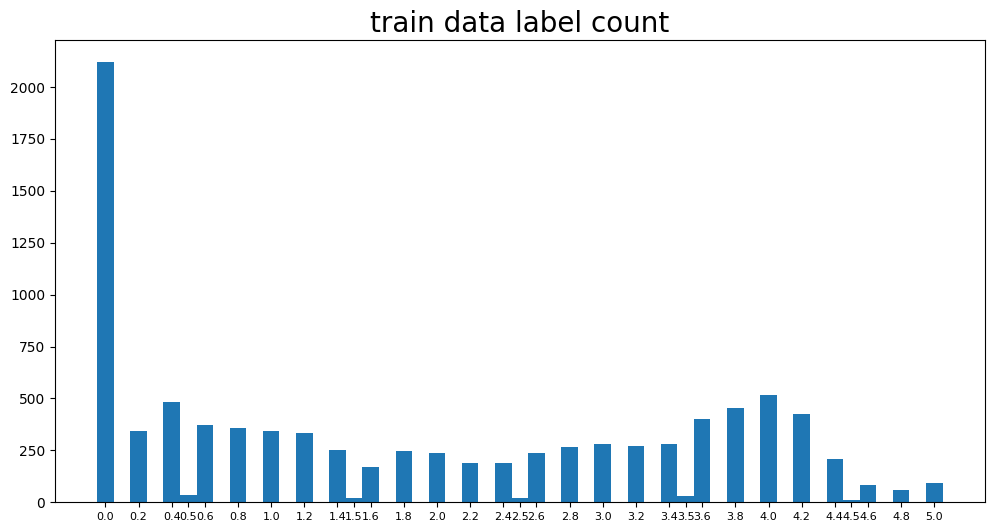

In [ ]:
import matplotlib.pyplot as plt
feature = train_pd['label']

plt.figure(figsize=(12,6))
plt.title('train data label count', fontsize=20)
temp = feature.value_counts()
plt.bar(temp.keys(), temp.values, width=0.1)
plt.xticks(temp.keys(), fontsize=8)
plt.show()

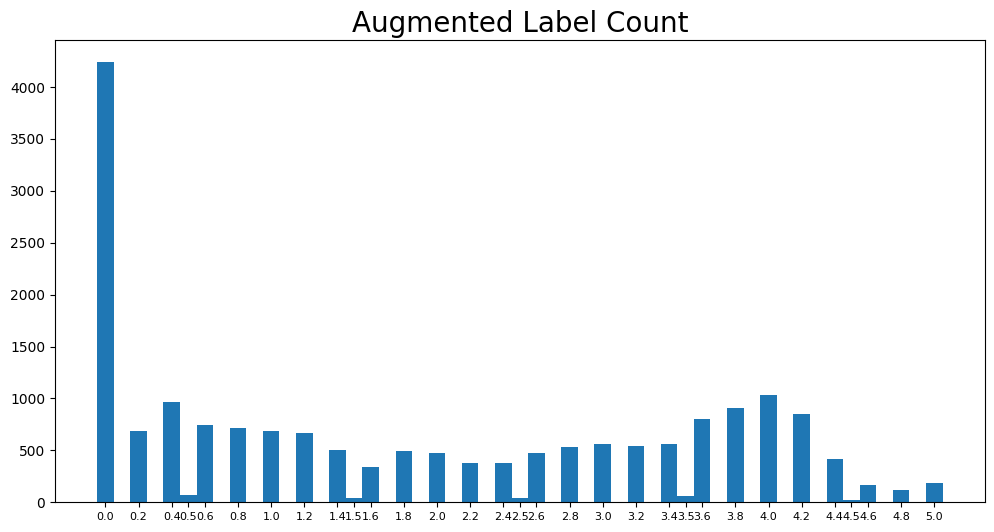

In [ ]:
import matplotlib.pyplot as plt
feature = aug_df_final['label']

plt.figure(figsize=(12,6))
plt.title('Augmented Label Count', fontsize=20)
temp = feature.value_counts()
plt.bar(temp.keys(), temp.values, width=0.1)
plt.xticks(temp.keys(), fontsize=8)
plt.show()

In [ ]:
# 데이터 분포가 0~5점까지 일직선으로 되면 좋음
# 지금은 4점 근처대 점수가 너무 커져서 오버피팅이 일어난 것 같음
# RTT를 전체 데이터에 적용해서 기존 분포를 유지
# RTT를 독일어만 적용